# Benchmarks visualization

In [1]:
from typing import Any, List, Tuple, Dict, Sequence
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict

bin_no = 7

In [2]:
def preprocess(input: str) -> pd.DataFrame:
    to_remove = ["subgraphs", "smart"]

    res = []
    df_list = []
    for line in itertools.chain(input.splitlines(), [""]):
        if len(line) == 0:
            df = pd.DataFrame(res)
            attribute_no = len(df.columns)
            df["order"] = range(1, len(df)+1)
            df["order"] = df["order"] / len(df)

            df["intervals"] = pd.cut(df["order"], bins=np.linspace(0, 1, bin_no + 1))
            df_list.append(df)
            res = []
            continue
        if line[0] == '-' or line[:4] == "Name":
            continue

        name, line = line.split("[", 1)
        tag, line = line.split("]", 1)

        test_type = name.replace("test_bench_NAC_colorings_", "")
        items = filter(lambda x: x not in to_remove,tag.split("-"))
        res.append(items)

    return pd.concat(df_list)


In [3]:
def plot_column(df: pd.DataFrame, title:str, index: int):
    # there is only one value, no need to plot it
    if len(df[index].unique()) == 1:
        return

    a = df.groupby("intervals", observed=True)[index]
    a = pd.DataFrame(a)
    a = a.explode(1)
    transformed = a.pivot_table(index=0, columns=1, aggfunc='size', fill_value=0)
    ax = transformed.plot(kind="bar", width=0.8, figsize=(10, 2.5))
    ax.locator_params(axis="y", integer=True, tight=True)
    ax.margins(0.05)
    ax.legend(bbox_to_anchor=(1, 1))
    ax.set_title(title)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    plt.xticks(rotation=0)
    plt.show()

def plot_all_columns(df: pd.DataFrame, title: str):
    for i in range(len(df.columns) - 2):
        plot_column(df, title, i)

In [4]:
def plot_all(input: str, title: str) -> None:
    df = preprocess(input)
    plot_all_columns(df, title)

In [5]:
def group_rows_by_no(input: str, withHeader: bool = True) -> str:
    """
    In many test cases multiple tests are run with different number of nodes or monochromatic classes.
    This number is always the first parameter.
    We form the respective groups based on it.
    """
    groups = defaultdict(list)
    header: str = "Name (no header)"
    dashes = '-' * 80

    for line in input.splitlines():
        if len(line) == 0 or line[0] == '-':
            continue
        if line[:4] == "Name":
            header = line
            continue

        name, rest = line.split('[')
        num = int(rest.split('-')[0])
        groups[(name, num)].append(line)

    string_groups: List[str] = []
    if withHeader:
        string_groups.append("\n".join([dashes, header, dashes]))
    for key in sorted(groups.keys()):
        string_groups.append("\n".join(groups[key]))

    if withHeader:
        string_groups.append(dashes)

    return "\n\n".join(string_groups)

assert(group_rows_by_no("""
asdf[32-mno]
asdf[28-foo]
asdf[32-bar]
abcd[32-bar]
""", withHeader=False) == """
abcd[32-bar]

asdf[28-foo]

asdf[32-mno]
asdf[32-bar]
""".strip())

In [6]:
def resort_groups(input: str, withHeader: bool = True) -> str:
    """
    In many test cases multiple tests are run with different number of nodes or monochromatic classes.
    This number is always the first parameter.
    We form the respective groups based on it.
    """
    header: str = "Name (no header)"
    dashes = '-' * 80

    lines: Dict[float, List[str]] = defaultdict(list)
    for line in input.splitlines():
        if len(line) == 0 or line[0] == '-':
            continue
        if line[:4] == "Name":
            header = line
            continue

        mean_time = float([segment for segment in line.split(' ') if len(segment) > 0][5].replace(",", ""))
        lines[mean_time].append(line)

    string_groups: List[str] = []
    if withHeader:
        string_groups.append("\n".join([dashes, header, dashes]))
    for key in sorted(lines.keys()):
        string_groups.append("\n".join(lines[key]))

    if withHeader:
        string_groups.append(dashes)

    return "\n".join(string_groups)

assert(resort_groups("""
d[a-smart]                        60.7143 (1.01)      62.0924 (1.00)      64.2468 (1.0)        0.7404 (18.34)     60.9339 (1.0)        1.0335 (18.14)         1;0  16.3274 (1.0)           3           1
b[a-smart]                        60.7143 (1.01)      62.0924 (1.00)      62.2468 (1.0)        0.7404 (18.34)     60.9339 (1.0)        1.0335 (18.14)         1;0  16.3274 (1.0)           3           1
e[a-smart]                        60.7143 (1.01)      62.0924 (1.00)      65.2468 (1.0)        0.7404 (18.34)     60.9339 (1.0)        1.0335 (18.14)         1;0  16.3274 (1.0)           3           1
a[a-smart]                        60.7143 (1.01)      62.0924 (1.00)      61.2468 (1.0)        0.7404 (18.34)     60.9339 (1.0)        1.0335 (18.14)         1;0  16.3274 (1.0)           3           1
c[a-smart]                        60.7143 (1.01)      62.0924 (1.00)      63.2468 (1.0)        0.7404 (18.34)     60.9339 (1.0)        1.0335 (18.14)         1;0  16.3274 (1.0)           3           1
""", withHeader=False) == """
a[a-smart]                        60.7143 (1.01)      62.0924 (1.00)      61.2468 (1.0)        0.7404 (18.34)     60.9339 (1.0)        1.0335 (18.14)         1;0  16.3274 (1.0)           3           1
b[a-smart]                        60.7143 (1.01)      62.0924 (1.00)      62.2468 (1.0)        0.7404 (18.34)     60.9339 (1.0)        1.0335 (18.14)         1;0  16.3274 (1.0)           3           1
c[a-smart]                        60.7143 (1.01)      62.0924 (1.00)      63.2468 (1.0)        0.7404 (18.34)     60.9339 (1.0)        1.0335 (18.14)         1;0  16.3274 (1.0)           3           1
d[a-smart]                        60.7143 (1.01)      62.0924 (1.00)      64.2468 (1.0)        0.7404 (18.34)     60.9339 (1.0)        1.0335 (18.14)         1;0  16.3274 (1.0)           3           1
e[a-smart]                        60.7143 (1.01)      62.0924 (1.00)      65.2468 (1.0)        0.7404 (18.34)     60.9339 (1.0)        1.0335 (18.14)         1;0  16.3274 (1.0)           3           1
""".strip())

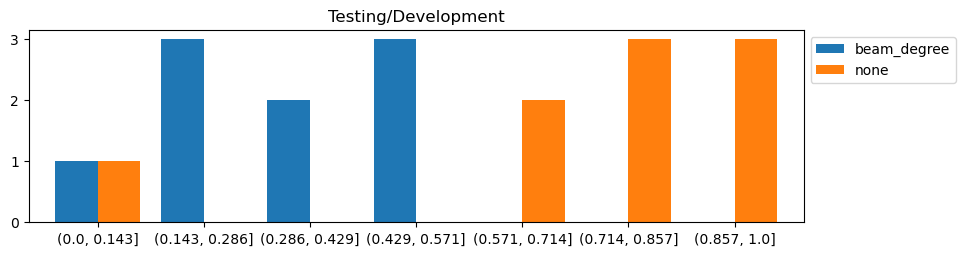

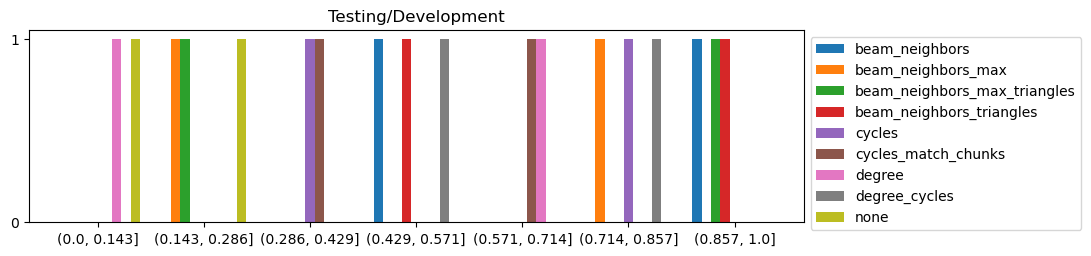

In [7]:
input = """
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-log-none-4-smart]                                     1.4919 (1.0)       1.5016 (1.0)       1.4979 (1.0)       0.0046 (1.0)       1.4991 (1.0)       0.0072 (1.0)           1;0  0.6676 (1.0)           4           1
test_bench_NAC_colorings_laman_fast[laman_medium-beam_degree-subgraphs-log-degree-4-smart]                            7.2429 (4.85)     41.0540 (27.34)    24.4328 (16.31)    18.0431 (>1000.0)  24.7172 (16.49)    31.1313 (>1000.0)       0;0  0.0409 (0.06)          4           1
test_bench_NAC_colorings_laman_fast[laman_medium-beam_degree-subgraphs-log-beam_neighbors_max-4-smart]                9.8761 (6.62)     40.7510 (27.14)    26.1634 (17.47)    16.0280 (>1000.0)  27.0132 (18.02)    27.5033 (>1000.0)       1;0  0.0382 (0.06)          4           1
test_bench_NAC_colorings_laman_fast[laman_medium-beam_degree-subgraphs-log-none-4-smart]                             10.8432 (7.27)     45.4183 (30.25)    27.9856 (18.68)    18.1737 (>1000.0)  27.8405 (18.57)    31.3062 (>1000.0)       0;0  0.0357 (0.05)          4           1
test_bench_NAC_colorings_laman_fast[laman_medium-beam_degree-subgraphs-log-beam_neighbors_max_triangles-4-smart]     12.6315 (8.47)     43.9484 (29.27)    28.5481 (19.06)    16.5504 (>1000.0)  28.8064 (19.22)    28.5251 (>1000.0)       0;0  0.0350 (0.05)          4           1
test_bench_NAC_colorings_laman_fast[laman_medium-beam_degree-subgraphs-log-cycles-4-smart]                           13.4580 (9.02)     34.3362 (22.87)    23.7022 (15.82)    10.3264 (>1000.0)  23.5072 (15.68)    17.5736 (>1000.0)       1;0  0.0422 (0.06)          4           1
test_bench_NAC_colorings_laman_fast[laman_medium-beam_degree-subgraphs-log-cycles_match_chunks-4-smart]              13.7556 (9.22)     30.2829 (20.17)    21.8489 (14.59)     8.2989 (>1000.0)  21.6786 (14.46)    14.1764 (>1000.0)       1;0  0.0458 (0.07)          4           1
test_bench_NAC_colorings_laman_fast[laman_medium-beam_degree-subgraphs-log-degree_cycles-4-smart]                    14.3679 (9.63)     32.4531 (21.61)    23.0706 (15.40)     8.9301 (>1000.0)  22.7307 (15.16)    15.1761 (>1000.0)       1;0  0.0433 (0.06)          4           1
test_bench_NAC_colorings_laman_fast[laman_medium-beam_degree-subgraphs-log-beam_neighbors_triangles-4-smart]         20.7847 (13.93)    51.1282 (34.05)    35.9725 (24.01)    17.2371 (>1000.0)  35.9886 (24.01)    29.8515 (>1000.0)       0;0  0.0278 (0.04)          4           1
test_bench_NAC_colorings_laman_fast[laman_medium-beam_degree-subgraphs-log-beam_neighbors-4-smart]                   21.9364 (14.70)    54.1926 (36.09)    37.6941 (25.16)    17.9673 (>1000.0)  37.3237 (24.90)    31.0895 (>1000.0)       0;0  0.0265 (0.04)          4           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-log-degree-4-smart]                                  24.4690 (16.40)    24.7240 (16.47)    24.5660 (16.40)     0.1212 (26.19)    24.5355 (16.37)     0.1901 (26.27)         1;0  0.0407 (0.06)          4           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-log-cycles_match_chunks-4-smart]                     26.8855 (18.02)    30.6641 (20.42)    28.8083 (19.23)     1.5468 (334.22)   28.8418 (19.24)     2.0197 (279.10)        2;0  0.0347 (0.05)          4           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-log-cycles-4-smart]                                  27.2750 (18.28)    28.6215 (19.06)    27.7058 (18.50)     0.6324 (136.65)   27.4633 (18.32)     0.8439 (116.62)        1;0  0.0361 (0.05)          4           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-log-degree_cycles-4-smart]                           27.8607 (18.67)    29.4767 (19.63)    28.5562 (19.06)     0.7034 (151.99)   28.4438 (18.97)     1.0609 (146.61)        1;0  0.0350 (0.05)          4           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-log-beam_neighbors_max-4-smart]                      52.3808 (35.11)    55.6436 (37.06)    53.6521 (35.82)     1.4833 (320.51)   53.2921 (35.55)     2.2474 (310.58)        1;0  0.0186 (0.03)          4           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-log-beam_neighbors_max_triangles-4-smart]            55.0832 (36.92)    57.7250 (38.44)    56.6376 (37.81)     1.1670 (252.17)   56.8711 (37.94)     1.7559 (242.65)        1;0  0.0177 (0.03)          4           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-log-beam_neighbors-4-smart]                          66.0966 (44.30)    69.8569 (46.52)    68.0230 (45.41)     1.9788 (427.57)   68.0693 (45.41)     3.4080 (470.96)        0;0  0.0147 (0.02)          4           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-log-beam_neighbors_triangles-4-smart]                67.3484 (45.14)    70.7996 (47.15)    68.8087 (45.94)     1.5371 (332.13)   68.5434 (45.72)     2.3780 (328.62)        1;0  0.0145 (0.02)          4           1
"""
plot_all(input, "Testing/Development")

### Small Graphs

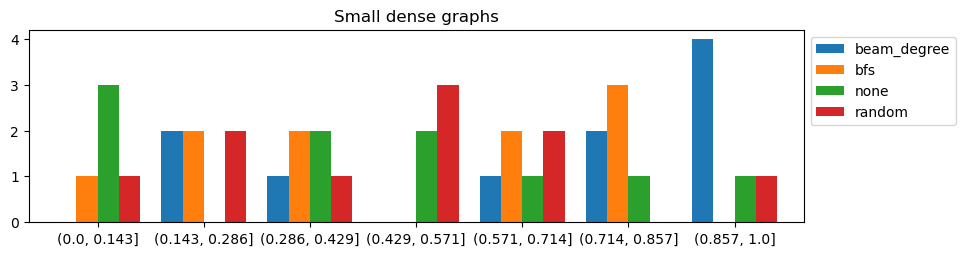

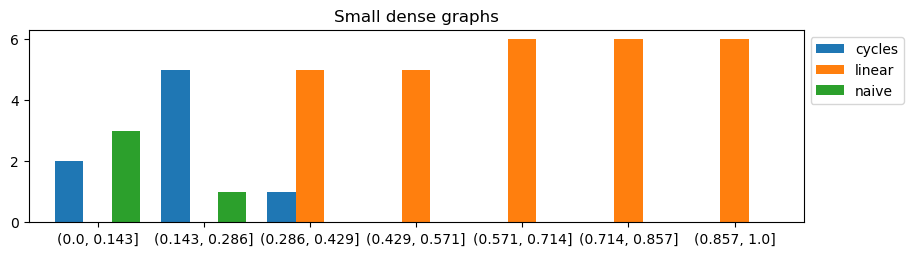

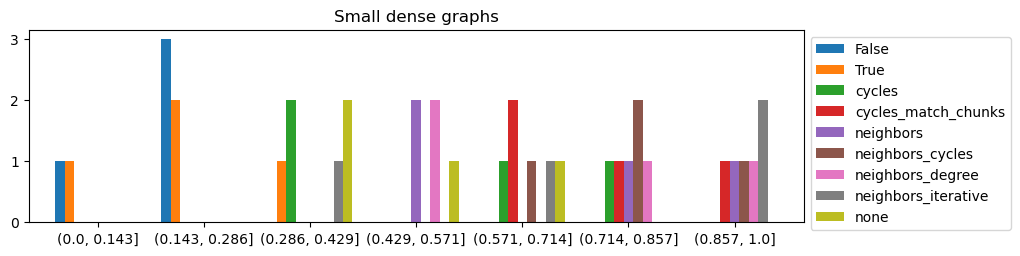

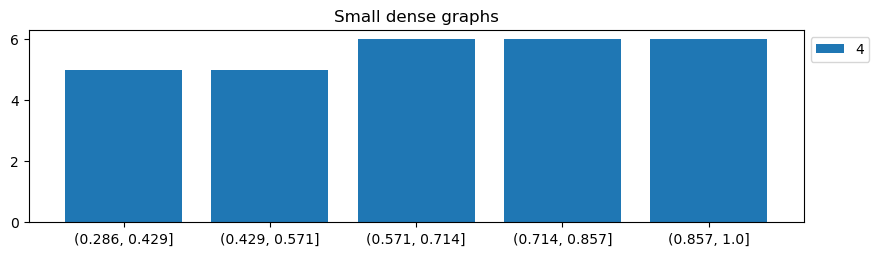

In [8]:
input = """
test_bench_NAC_colorings_small[dense_small-none-naive]                                                  59.6664 (1.0)          66.9958 (1.0)          62.5605 (1.0)        3.9002 (14.93)        61.0192 (1.0)        5.4971 (14.77)         1;0  15.9845 (1.0)           3           1
test_bench_NAC_colorings_small[dense_small-none-cycles-True]                                            63.2162 (1.06)         69.3092 (1.03)         66.3106 (1.06)       3.0476 (11.67)        66.4066 (1.09)       4.5698 (12.28)         1;0  15.0805 (0.94)          3           1
test_bench_NAC_colorings_small[dense_small-none-cycles-False]                                           64.9750 (1.09)         71.1547 (1.06)         67.8707 (1.08)       3.1081 (11.90)        67.4825 (1.11)       4.6347 (12.45)         1;0  14.7339 (0.92)          3           1
test_bench_NAC_colorings_small[dense_small-random-naive]                                                64.9590 (1.09)         71.1992 (1.06)         67.9431 (1.09)       3.1290 (11.98)        67.6710 (1.11)       4.6802 (12.57)         1;0  14.7182 (0.92)          3           1
test_bench_NAC_colorings_small[dense_small-bfs-naive]                                                   66.6431 (1.12)         73.2283 (1.09)         69.0156 (1.10)       3.6580 (14.00)        67.1754 (1.10)       4.9389 (13.27)         1;0  14.4895 (0.91)          3           1
test_bench_NAC_colorings_small[dense_small-random-cycles-True]                                          67.8657 (1.14)         72.9473 (1.09)         69.7833 (1.12)       2.7606 (10.57)        68.5369 (1.12)       3.8112 (10.24)         1;0  14.3301 (0.90)          3           1
test_bench_NAC_colorings_small[dense_small-bfs-cycles-False]                                            68.2489 (1.14)         72.6848 (1.08)         69.9871 (1.12)       2.3685 (9.07)         69.0275 (1.13)       3.3270 (8.94)          1;0  14.2884 (0.89)          3           1
test_bench_NAC_colorings_small[dense_small-bfs-cycles-True]                                             68.5840 (1.15)         73.6306 (1.10)         70.7034 (1.13)       2.6185 (10.02)        69.8958 (1.15)       3.7850 (10.17)         1;0  14.1436 (0.88)          3           1
test_bench_NAC_colorings_small[dense_small-random-cycles-False]                                         68.6220 (1.15)         74.6638 (1.11)         71.5940 (1.14)       3.0221 (11.57)        71.4962 (1.17)       4.5313 (12.17)         1;0  13.9676 (0.87)          3           1
test_bench_NAC_colorings_small[dense_small-beam_degree-naive]                                           71.6854 (1.20)         75.1490 (1.12)         73.3176 (1.17)       1.7404 (6.66)         73.1185 (1.20)       2.5978 (6.98)          1;0  13.6393 (0.85)          3           1
test_bench_NAC_colorings_small[dense_small-beam_degree-cycles-False]                                    74.1072 (1.24)         76.3982 (1.14)         74.9410 (1.20)       1.2663 (4.85)         74.3176 (1.22)       1.7182 (4.62)          1;0  13.3438 (0.83)          3           1
test_bench_NAC_colorings_small[dense_small-beam_degree-cycles-True]                                     74.4899 (1.25)         78.1614 (1.17)         75.8589 (1.21)       2.0058 (7.68)         74.9256 (1.23)       2.7536 (7.40)          1;0  13.1824 (0.82)          3           1
test_bench_NAC_colorings_small[dense_small-none-subgraphs-linear-none-4]                               145.7451 (2.44)        148.8626 (2.22)        146.9759 (2.35)       1.6590 (6.35)        146.3201 (2.40)       2.3381 (6.28)          1;0   6.8038 (0.43)          3           1
test_bench_NAC_colorings_small[dense_small-none-subgraphs-linear-cycles-4]                             145.5988 (2.44)        151.2471 (2.26)        149.1532 (2.38)       3.0944 (11.85)       150.6136 (2.47)       4.2363 (11.38)         1;0   6.7045 (0.42)          3           1
test_bench_NAC_colorings_small[dense_small-bfs-subgraphs-linear-none-4]                                145.9164 (2.45)        151.4296 (2.26)        149.4904 (2.39)       3.0989 (11.86)       151.1253 (2.48)       4.1349 (11.11)         1;0   6.6894 (0.42)          3           1
test_bench_NAC_colorings_small[dense_small-bfs-subgraphs-linear-cycles-4]                              147.0040 (2.46)        156.0598 (2.33)        150.4635 (2.41)       4.8914 (18.73)       148.3268 (2.43)       6.7919 (18.25)         1;0   6.6461 (0.42)          3           1
test_bench_NAC_colorings_small[dense_small-random-subgraphs-linear-neighbors_iterative-4]              149.3947 (2.50)        152.3949 (2.27)        150.6792 (2.41)       1.5459 (5.92)        150.2479 (2.46)       2.2501 (6.04)          1;0   6.6366 (0.42)          3           1
test_bench_NAC_colorings_small[dense_small-none-subgraphs-linear-neighbors_degree-4]                   147.1924 (2.47)        156.4331 (2.33)        150.7389 (2.41)       4.9807 (19.07)       148.5913 (2.44)       6.9305 (18.62)         1;0   6.6340 (0.42)          3           1
test_bench_NAC_colorings_small[dense_small-none-subgraphs-linear-neighbors-4]                          147.6863 (2.48)        154.0971 (2.30)        150.8942 (2.41)       3.2054 (12.27)       150.8992 (2.47)       4.8081 (12.92)         1;0   6.6272 (0.41)          3           1
test_bench_NAC_colorings_small[dense_small-random-subgraphs-linear-neighbors-4]                        147.2372 (2.47)        154.7489 (2.31)        151.0040 (2.41)       3.7559 (14.38)       151.0260 (2.48)       5.6338 (15.13)         1;0   6.6223 (0.41)          3           1
test_bench_NAC_colorings_small[dense_small-random-subgraphs-linear-neighbors_degree-4]                 147.2908 (2.47)        157.0697 (2.34)        151.0726 (2.41)       5.2523 (20.11)       148.8573 (2.44)       7.3341 (19.70)         1;0   6.6193 (0.41)          3           1
test_bench_NAC_colorings_small[dense_small-random-subgraphs-linear-none-4]                             150.8164 (2.53)        153.0271 (2.28)        151.8412 (2.43)       1.1141 (4.27)        151.6801 (2.49)       1.6580 (4.45)          1;0   6.5858 (0.41)          3           1
test_bench_NAC_colorings_small[dense_small-bfs-subgraphs-linear-neighbors_iterative-4]                 149.9700 (2.51)        155.4634 (2.32)        151.9858 (2.43)       3.0244 (11.58)       150.5239 (2.47)       4.1200 (11.07)         1;0   6.5796 (0.41)          3           1
test_bench_NAC_colorings_small[dense_small-random-subgraphs-linear-neighbors_cycles-4]                 151.3113 (2.54)        153.8874 (2.30)        152.4172 (2.44)       1.3261 (5.08)        152.0530 (2.49)       1.9321 (5.19)          1;0   6.5609 (0.41)          3           1
test_bench_NAC_colorings_small[dense_small-beam_degree-subgraphs-linear-none-4]                        150.4618 (2.52)        156.9627 (2.34)        152.6493 (2.44)       3.7357 (14.30)       150.5232 (2.47)       4.8757 (13.10)         1;0   6.5510 (0.41)          3           1
test_bench_NAC_colorings_small[dense_small-random-subgraphs-linear-cycles-4]                           150.5643 (2.52)        157.1688 (2.35)        153.2407 (2.45)       3.4756 (13.31)       151.9891 (2.49)       4.9534 (13.31)         1;0   6.5257 (0.41)          3           1
test_bench_NAC_colorings_small[dense_small-bfs-subgraphs-linear-cycles_match_chunks-4]                 149.8581 (2.51)        156.6054 (2.34)        153.6005 (2.46)       3.4336 (13.14)       154.3379 (2.53)       5.0605 (13.59)         1;0   6.5104 (0.41)          3           1
test_bench_NAC_colorings_small[dense_small-none-subgraphs-linear-cycles_match_chunks-4]                152.5367 (2.56)        156.9179 (2.34)        154.0241 (2.46)       2.5065 (9.60)        152.6175 (2.50)       3.2859 (8.83)          1;0   6.4925 (0.41)          3           1
test_bench_NAC_colorings_small[dense_small-bfs-subgraphs-linear-neighbors_degree-4]                    150.8708 (2.53)        158.2303 (2.36)        154.0932 (2.46)       3.7641 (14.41)       153.1784 (2.51)       5.5197 (14.83)         1;0   6.4896 (0.41)          3           1
test_bench_NAC_colorings_small[dense_small-bfs-subgraphs-linear-neighbors-4]                           149.4517 (2.50)        164.1391 (2.45)        154.6058 (2.47)       8.2652 (31.64)       150.2267 (2.46)      11.0156 (29.59)         1;0   6.4681 (0.40)          3           1
test_bench_NAC_colorings_small[dense_small-bfs-subgraphs-linear-neighbors_cycles-4]                    153.0016 (2.56)        159.5063 (2.38)        155.6664 (2.49)       3.4078 (13.05)       154.4913 (2.53)       4.8785 (13.11)         1;0   6.4240 (0.40)          3           1
test_bench_NAC_colorings_small[dense_small-none-subgraphs-linear-neighbors_cycles-4]                   149.0433 (2.50)        159.7188 (2.38)        156.0427 (2.49)       6.0642 (23.22)       159.3660 (2.61)       8.0066 (21.51)         1;0   6.4085 (0.40)          3           1
test_bench_NAC_colorings_small[dense_small-beam_degree-subgraphs-linear-cycles_match_chunks-4]         152.5561 (2.56)        158.8401 (2.37)        156.4727 (2.50)       3.4164 (13.08)       158.0218 (2.59)       4.7130 (12.66)         1;0   6.3909 (0.40)          3           1
test_bench_NAC_colorings_small[dense_small-beam_degree-subgraphs-linear-cycles-4]                      152.2872 (2.55)        166.1020 (2.48)        158.3499 (2.53)       7.0607 (27.03)       156.6605 (2.57)      10.3611 (27.83)         1;0   6.3151 (0.40)          3           1
test_bench_NAC_colorings_small[dense_small-random-subgraphs-linear-cycles_match_chunks-4]              153.7382 (2.58)        162.3667 (2.42)        159.2710 (2.55)       4.8028 (18.39)       161.7080 (2.65)       6.4714 (17.38)         1;0   6.2786 (0.39)          3           1
test_bench_NAC_colorings_small[dense_small-beam_degree-subgraphs-linear-neighbors_degree-4]            155.7162 (2.61)        165.4181 (2.47)        159.6869 (2.55)       5.0849 (19.47)       157.9265 (2.59)       7.2765 (19.55)         1;0   6.2623 (0.39)          3           1
test_bench_NAC_colorings_small[dense_small-beam_degree-subgraphs-linear-neighbors_iterative-4]         154.9647 (2.60)        168.4004 (2.51)        159.9172 (2.56)       7.3810 (28.26)       156.3866 (2.56)      10.0768 (27.07)         1;0   6.2532 (0.39)          3           1
test_bench_NAC_colorings_small[dense_small-beam_degree-subgraphs-linear-neighbors-4]                   155.0205 (2.60)        169.0125 (2.52)        159.9826 (2.56)       7.8329 (29.99)       155.9149 (2.56)      10.4940 (28.19)         1;0   6.2507 (0.39)          3           1
test_bench_NAC_colorings_small[dense_small-beam_degree-subgraphs-linear-neighbors_cycles-4]            161.6671 (2.71)        166.6858 (2.49)        164.2871 (2.63)       2.5167 (9.63)        164.5084 (2.70)       3.7640 (10.11)         1;0   6.0869 (0.38)          3           1
test_bench_NAC_colorings_small[dense_small-none-subgraphs-linear-neighbors_iterative-4]                149.5005 (2.51)        280.6697 (4.19)        195.1345 (3.12)      74.1311 (283.79)      155.2333 (2.54)      98.3769 (264.27)        1;0   5.1247 (0.32)          3           1
"""
plot_all(input, "Small dense graphs")

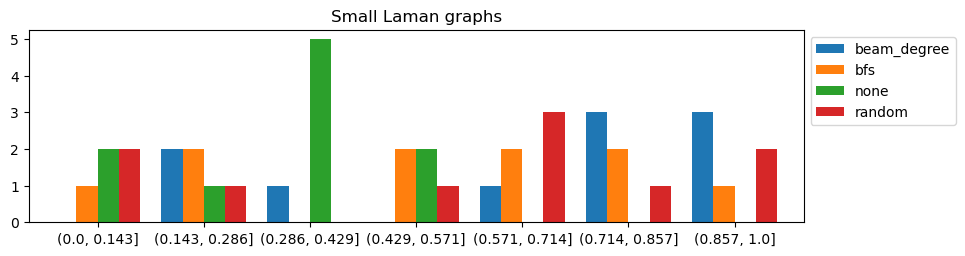

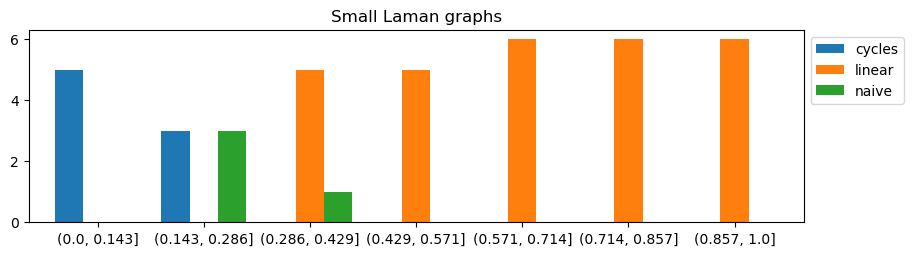

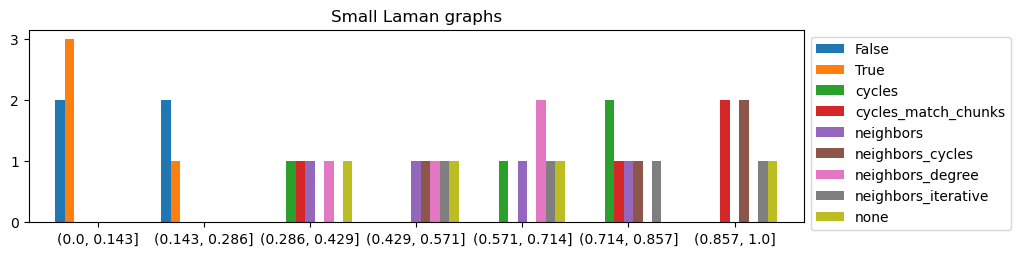

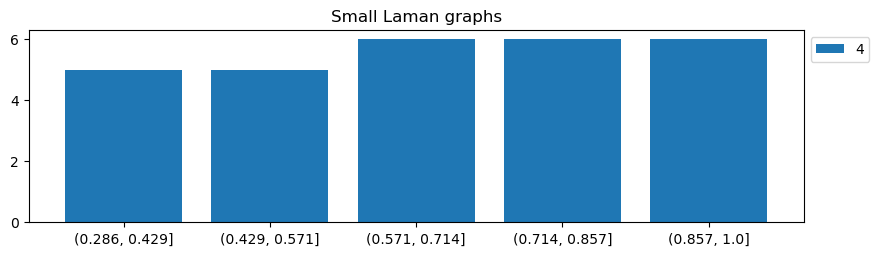

In [9]:
input = """
test_bench_NAC_colorings_small[laman_small-none-cycles-True]                                            75.6202 (1.27)         78.6834 (1.17)         76.9798 (1.23)       1.5603 (5.97)         76.6359 (1.26)       2.2974 (6.17)          1;0  12.9904 (0.81)          3           1
test_bench_NAC_colorings_small[laman_small-none-cycles-False]                                           75.7695 (1.27)         79.5707 (1.19)         77.9033 (1.25)       1.9430 (7.44)         78.3697 (1.28)       2.8509 (7.66)          1;0  12.8364 (0.80)          3           1
test_bench_NAC_colorings_small[laman_small-random-cycles-False]                                         83.2894 (1.40)         84.3128 (1.26)         83.6646 (1.34)       0.5637 (2.16)         83.3915 (1.37)       0.7676 (2.06)          1;0  11.9525 (0.75)          3           1
test_bench_NAC_colorings_small[laman_small-bfs-cycles-True]                                             82.0859 (1.38)         86.9585 (1.30)         83.9444 (1.34)       2.6338 (10.08)        82.7889 (1.36)       3.6544 (9.82)          1;0  11.9126 (0.75)          3           1
test_bench_NAC_colorings_small[laman_small-random-cycles-True]                                          83.4480 (1.40)         84.6245 (1.26)         84.0313 (1.34)       0.5883 (2.25)         84.0216 (1.38)       0.8824 (2.37)          1;0  11.9003 (0.74)          3           1
test_bench_NAC_colorings_small[laman_small-bfs-cycles-False]                                            82.3742 (1.38)         86.4953 (1.29)         84.1110 (1.34)       2.1355 (8.18)         83.4636 (1.37)       3.0908 (8.30)          1;0  11.8890 (0.74)          3           1
test_bench_NAC_colorings_small[laman_small-beam_degree-cycles-True]                                     86.0238 (1.44)         93.1667 (1.39)         88.8561 (1.42)       3.7939 (14.52)        87.3780 (1.43)       5.3572 (14.39)         1;0  11.2541 (0.70)          3           1
test_bench_NAC_colorings_small[laman_small-beam_degree-cycles-False]                                    86.9037 (1.46)         95.2128 (1.42)         91.2676 (1.46)       4.1703 (15.97)        91.6865 (1.50)       6.2318 (16.74)         1;0  10.9568 (0.69)          3           1
test_bench_NAC_colorings_small[laman_small-none-naive]                                                 165.7428 (2.78)        170.4596 (2.54)        167.7482 (2.68)       2.4364 (9.33)        167.0421 (2.74)       3.5375 (9.50)          1;0   5.9613 (0.37)          3           1
test_bench_NAC_colorings_small[laman_small-bfs-naive]                                                  169.1863 (2.84)        174.7741 (2.61)        171.9910 (2.75)       2.7940 (10.70)       172.0126 (2.82)       4.1908 (11.26)         1;0   5.8143 (0.36)          3           1
test_bench_NAC_colorings_small[laman_small-random-naive]                                               173.2371 (2.90)        176.7575 (2.64)        175.4783 (2.80)       1.9474 (7.45)        176.4402 (2.89)       2.6403 (7.09)          1;0   5.6987 (0.36)          3           1
test_bench_NAC_colorings_small[laman_small-none-subgraphs-linear-none-4]                               176.1529 (2.95)        178.5901 (2.67)        177.7170 (2.84)       1.3576 (5.20)        178.4081 (2.92)       1.8279 (4.91)          1;0   5.6269 (0.35)          3           1
test_bench_NAC_colorings_small[laman_small-beam_degree-naive]                                          175.0093 (2.93)        183.2797 (2.74)        179.9683 (2.88)       4.3745 (16.75)       181.6160 (2.98)       6.2028 (16.66)         1;0   5.5565 (0.35)          3           1
test_bench_NAC_colorings_small[laman_small-none-subgraphs-linear-neighbors-4]                          187.2772 (3.14)        191.9655 (2.87)        189.8572 (3.03)       2.3794 (9.11)        190.3289 (3.12)       3.5162 (9.45)          1;0   5.2671 (0.33)          3           1
test_bench_NAC_colorings_small[laman_small-none-subgraphs-linear-cycles-4]                             191.1151 (3.20)        192.2013 (2.87)        191.5505 (3.06)       0.5743 (2.20)        191.3350 (3.14)       0.8147 (2.19)          1;0   5.2206 (0.33)          3           1
test_bench_NAC_colorings_small[laman_small-none-subgraphs-linear-neighbors_degree-4]                   186.4714 (3.13)        203.1168 (3.03)        192.2524 (3.07)       9.4153 (36.04)       187.1690 (3.07)      12.4840 (33.54)         1;0   5.2015 (0.33)          3           1
test_bench_NAC_colorings_small[laman_small-none-subgraphs-linear-cycles_match_chunks-4]                191.1518 (3.20)        203.6535 (3.04)        195.4454 (3.12)       7.1109 (27.22)       191.5308 (3.14)       9.3762 (25.19)         1;0   5.1165 (0.32)          3           1
test_bench_NAC_colorings_small[laman_small-bfs-subgraphs-linear-none-4]                                194.7361 (3.26)        196.3804 (2.93)        195.7440 (3.13)       0.8829 (3.38)        196.1155 (3.21)       1.2333 (3.31)          1;0   5.1087 (0.32)          3           1
test_bench_NAC_colorings_small[laman_small-random-subgraphs-linear-neighbors_degree-4]                 192.0141 (3.22)        204.9868 (3.06)        196.3577 (3.14)       7.4731 (28.61)       192.0723 (3.15)       9.7295 (26.14)         1;0   5.0927 (0.32)          3           1
test_bench_NAC_colorings_small[laman_small-none-subgraphs-linear-neighbors_iterative-4]                189.7644 (3.18)        210.1577 (3.14)        197.7439 (3.16)      10.8958 (41.71)       193.3096 (3.17)      15.2950 (41.09)         1;0   5.0570 (0.32)          3           1
test_bench_NAC_colorings_small[laman_small-none-subgraphs-linear-neighbors_cycles-4]                   196.0019 (3.28)        200.3255 (2.99)        197.7742 (3.16)       2.2646 (8.67)        196.9953 (3.23)       3.2427 (8.71)          1;0   5.0563 (0.32)          3           1
test_bench_NAC_colorings_small[laman_small-bfs-subgraphs-linear-neighbors-4]                           196.0224 (3.29)        204.9254 (3.06)        200.3987 (3.20)       4.4534 (17.05)       200.2482 (3.28)       6.6772 (17.94)         1;0   4.9901 (0.31)          3           1
test_bench_NAC_colorings_small[laman_small-bfs-subgraphs-linear-neighbors_iterative-4]                 193.4898 (3.24)        211.2921 (3.15)        200.6333 (3.21)       9.4074 (36.01)       197.1180 (3.23)      13.3518 (35.87)         1;0   4.9842 (0.31)          3           1
test_bench_NAC_colorings_small[laman_small-random-subgraphs-linear-none-4]                             195.2122 (3.27)        208.9692 (3.12)        201.5756 (3.22)       6.9361 (26.55)       200.5455 (3.29)      10.3178 (27.72)         1;0   4.9609 (0.31)          3           1
test_bench_NAC_colorings_small[laman_small-random-subgraphs-linear-cycles-4]                           199.9610 (3.35)        203.7970 (3.04)        202.0886 (3.23)       1.9520 (7.47)        202.5078 (3.32)       2.8770 (7.73)          1;0   4.9483 (0.31)          3           1
test_bench_NAC_colorings_small[laman_small-bfs-subgraphs-linear-neighbors_degree-4]                    199.9303 (3.35)        206.7816 (3.09)        202.5590 (3.24)       3.6933 (14.14)       200.9652 (3.29)       5.1385 (13.80)         1;0   4.9368 (0.31)          3           1
test_bench_NAC_colorings_small[laman_small-random-subgraphs-linear-neighbors-4]                        196.6467 (3.30)        206.3644 (3.08)        202.8371 (3.24)       5.3785 (20.59)       205.5004 (3.37)       7.2883 (19.58)         1;0   4.9301 (0.31)          3           1
test_bench_NAC_colorings_small[laman_small-beam_degree-subgraphs-linear-neighbors_degree-4]            202.8935 (3.40)        206.5690 (3.08)        204.2174 (3.26)       2.0420 (7.82)        203.1895 (3.33)       2.7566 (7.41)          1;0   4.8967 (0.31)          3           1
test_bench_NAC_colorings_small[laman_small-bfs-subgraphs-linear-cycles-4]                              202.1878 (3.39)        207.9929 (3.10)        204.4562 (3.27)       3.1034 (11.88)       203.1879 (3.33)       4.3538 (11.70)         1;0   4.8910 (0.31)          3           1
test_bench_NAC_colorings_small[laman_small-beam_degree-subgraphs-linear-neighbors_iterative-4]         205.1361 (3.44)        209.0948 (3.12)        207.5929 (3.32)       2.1451 (8.21)        208.5478 (3.42)       2.9690 (7.98)          1;0   4.8171 (0.30)          3           1
test_bench_NAC_colorings_small[laman_small-beam_degree-subgraphs-linear-neighbors-4]                   203.9050 (3.42)        210.6654 (3.14)        207.7159 (3.32)       3.4615 (13.25)       208.5774 (3.42)       5.0703 (13.62)         1;0   4.8143 (0.30)          3           1
test_bench_NAC_colorings_small[laman_small-beam_degree-subgraphs-linear-cycles-4]                      209.4272 (3.51)        210.1798 (3.14)        209.6851 (3.35)       0.4286 (1.64)        209.4481 (3.43)       0.5645 (1.52)          1;0   4.7691 (0.30)          3           1
test_bench_NAC_colorings_small[laman_small-random-subgraphs-linear-cycles_match_chunks-4]              201.2857 (3.37)        224.8599 (3.36)        211.0230 (3.37)      12.3102 (47.13)       206.9233 (3.39)      17.6806 (47.50)         1;0   4.7388 (0.30)          3           1
test_bench_NAC_colorings_small[laman_small-bfs-subgraphs-linear-neighbors_cycles-4]                    205.0287 (3.44)        215.5873 (3.22)        211.0825 (3.37)       5.4471 (20.85)       212.6315 (3.48)       7.9190 (21.27)         1;0   4.7375 (0.30)          3           1
test_bench_NAC_colorings_small[laman_small-random-subgraphs-linear-neighbors_cycles-4]                 207.7428 (3.48)        219.0172 (3.27)        212.5982 (3.40)       5.7976 (22.19)       211.0345 (3.46)       8.4558 (22.72)         1;0   4.7037 (0.29)          3           1
test_bench_NAC_colorings_small[laman_small-beam_degree-subgraphs-linear-cycles_match_chunks-4]         207.7772 (3.48)        221.0872 (3.30)        213.7158 (3.42)       6.7697 (25.92)       212.2831 (3.48)       9.9826 (26.82)         1;0   4.6791 (0.29)          3           1
test_bench_NAC_colorings_small[laman_small-beam_degree-subgraphs-linear-neighbors_cycles-4]            211.2424 (3.54)        219.2667 (3.27)        215.0945 (3.44)       4.0217 (15.40)       214.7744 (3.52)       6.0183 (16.17)         1;0   4.6491 (0.29)          3           1
test_bench_NAC_colorings_small[laman_small-beam_degree-subgraphs-linear-none-4]                        213.6991 (3.58)        217.4603 (3.25)        216.0770 (3.45)       2.0685 (7.92)        217.0717 (3.56)       2.8209 (7.58)          1;0   4.6280 (0.29)          3           1
test_bench_NAC_colorings_small[laman_small-random-subgraphs-linear-neighbors_iterative-4]              192.4644 (3.23)        319.2459 (4.77)        235.2377 (3.76)      72.7573 (278.53)      194.0029 (3.18)      95.0861 (255.43)        1;0   4.2510 (0.27)          3           1
test_bench_NAC_colorings_small[laman_small-bfs-subgraphs-linear-cycles_match_chunks-4]                 236.7725 (3.97)        242.9202 (3.63)        240.1082 (3.84)       3.1071 (11.89)       240.6319 (3.94)       4.6107 (12.39)         1;0   4.1648 (0.26)          3           1
"""
plot_all(input, "Small Laman graphs")

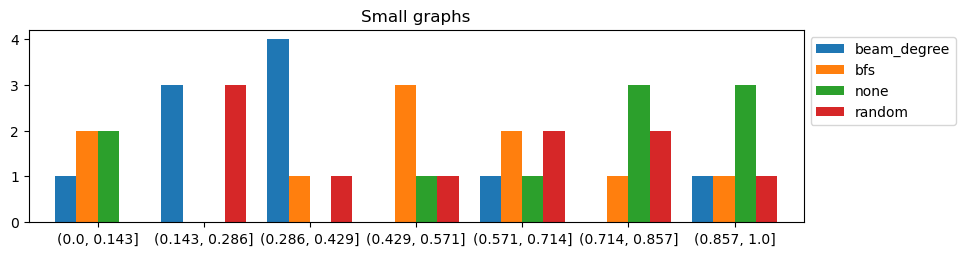

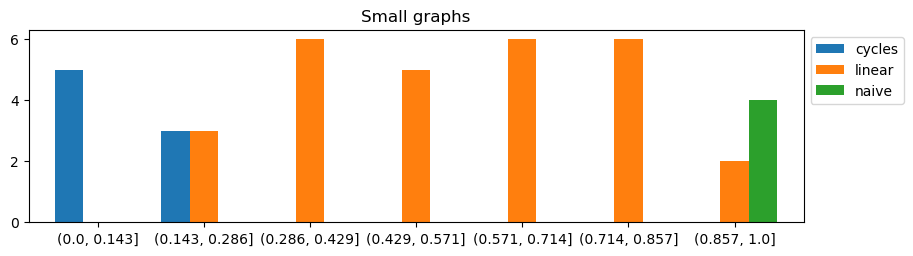

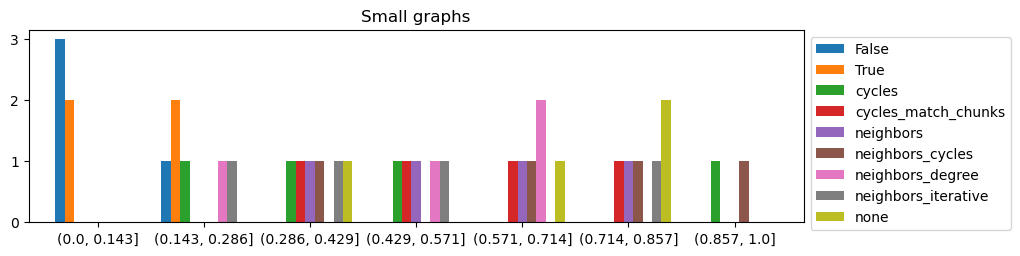

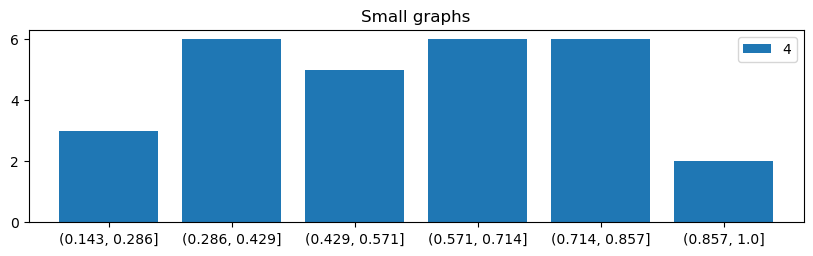

In [10]:
input = """
test_bench_NAC_colorings_small[small-none-cycles-True]                                                 224.9731 (3.77)        248.5564 (3.71)        235.3234 (3.76)      12.0530 (46.14)       232.4408 (3.81)      17.6874 (47.51)         1;0   4.2495 (0.27)          3           1
test_bench_NAC_colorings_small[small-none-cycles-False]                                                220.0732 (3.69)        275.5968 (4.11)        239.6905 (3.83)      31.1403 (119.21)      223.4014 (3.66)      41.6428 (111.87)        1;0   4.1720 (0.26)          3           1
test_bench_NAC_colorings_small[small-bfs-cycles-False]                                                 241.7156 (4.05)        267.4007 (3.99)        254.9688 (4.08)      12.8622 (49.24)       255.7901 (4.19)      19.2638 (51.75)         1;0   3.9220 (0.25)          3           1
test_bench_NAC_colorings_small[small-bfs-cycles-True]                                                  247.5128 (4.15)        269.8978 (4.03)        260.3592 (4.16)      11.5533 (44.23)       263.6669 (4.32)      16.7888 (45.10)         1;0   3.8408 (0.24)          3           1
test_bench_NAC_colorings_small[small-beam_degree-cycles-False]                                         240.1396 (4.02)        289.4910 (4.32)        263.8089 (4.22)      24.7372 (94.70)       261.7962 (4.29)      37.0135 (99.43)         1;0   3.7906 (0.24)          3           1
test_bench_NAC_colorings_small[small-beam_degree-cycles-True]                                          246.5997 (4.13)        314.5476 (4.70)        289.5434 (4.63)      37.3577 (143.01)      307.4830 (5.04)      50.9609 (136.90)        1;0   3.4537 (0.22)          3           1
test_bench_NAC_colorings_small[small-random-cycles-False]                                              267.2759 (4.48)        361.0803 (5.39)        300.6922 (4.81)      52.3968 (200.59)      273.7205 (4.49)      70.3533 (188.99)        1;0   3.3257 (0.21)          3           1
test_bench_NAC_colorings_small[small-random-cycles-True]                                               271.6106 (4.55)        336.2890 (5.02)        303.8396 (4.86)      32.3398 (123.80)      303.6194 (4.98)      48.5088 (130.31)        1;0   3.2912 (0.21)          3           1
test_bench_NAC_colorings_small[small-beam_degree-subgraphs-linear-neighbors_iterative-4]               468.0020 (7.84)        476.2507 (7.11)        472.5613 (7.55)       4.1926 (16.05)       473.4313 (7.76)       6.1865 (16.62)         1;0   2.1161 (0.13)          3           1
test_bench_NAC_colorings_small[small-random-subgraphs-linear-cycles-4]                                 481.4038 (8.07)        496.7138 (7.41)        488.6832 (7.81)       7.6826 (29.41)       487.9321 (8.00)      11.4825 (30.85)         1;0   2.0463 (0.13)          3           1
test_bench_NAC_colorings_small[small-beam_degree-subgraphs-linear-neighbors_degree-4]                  483.0651 (8.10)        504.8399 (7.54)        490.4131 (7.84)      12.4947 (47.83)       483.3342 (7.92)      16.3311 (43.87)         1;0   2.0391 (0.13)          3           1
test_bench_NAC_colorings_small[small-bfs-subgraphs-linear-neighbors_iterative-4]                       491.6202 (8.24)        500.4640 (7.47)        494.8004 (7.91)       4.9172 (18.82)       492.3170 (8.07)       6.6329 (17.82)         1;0   2.0210 (0.13)          3           1
test_bench_NAC_colorings_small[small-beam_degree-subgraphs-linear-neighbors-4]                         501.2625 (8.40)        504.7101 (7.53)        502.6604 (8.03)       1.8139 (6.94)        502.0084 (8.23)       2.5857 (6.95)          1;0   1.9894 (0.12)          3           1
test_bench_NAC_colorings_small[small-random-subgraphs-linear-none-4]                                   482.7508 (8.09)        568.6013 (8.49)        515.8003 (8.24)      46.2078 (176.89)      496.0489 (8.13)      64.3878 (172.97)        1;0   1.9387 (0.12)          3           1
test_bench_NAC_colorings_small[small-beam_degree-subgraphs-linear-neighbors_cycles-4]                  510.0763 (8.55)        534.8008 (7.98)        526.0953 (8.41)      13.8903 (53.18)       533.4088 (8.74)      18.5434 (49.81)         1;0   1.9008 (0.12)          3           1
test_bench_NAC_colorings_small[small-beam_degree-subgraphs-linear-cycles-4]                            490.4069 (8.22)        554.0503 (8.27)        531.4332 (8.49)      35.5921 (136.26)      549.8424 (9.01)      47.7326 (128.23)        1;0   1.8817 (0.12)          3           1
test_bench_NAC_colorings_small[small-beam_degree-subgraphs-linear-cycles_match_chunks-4]               500.1259 (8.38)        550.3585 (8.21)        532.3919 (8.51)      28.0033 (107.20)      546.6914 (8.96)      37.6745 (101.21)        1;0   1.8783 (0.12)          3           1
test_bench_NAC_colorings_small[small-bfs-subgraphs-linear-neighbors_degree-4]                          488.4132 (8.19)        620.5562 (9.26)        535.8337 (8.57)      73.5461 (281.55)      498.5317 (8.17)      99.1073 (266.24)        1;0   1.8663 (0.12)          3           1
test_bench_NAC_colorings_small[small-none-subgraphs-linear-neighbors_iterative-4]                      516.7013 (8.66)        578.0521 (8.63)        549.0314 (8.78)      30.8090 (117.94)      552.3408 (9.05)      46.0131 (123.61)        1;0   1.8214 (0.11)          3           1
test_bench_NAC_colorings_small[small-bfs-subgraphs-linear-cycles-4]                                    528.8768 (8.86)        563.9205 (8.42)        551.6854 (8.82)      19.7702 (75.69)       562.2588 (9.21)      26.2828 (70.60)         1;0   1.8126 (0.11)          3           1
test_bench_NAC_colorings_small[small-random-subgraphs-linear-neighbors-4]                              501.2476 (8.40)        632.8435 (9.45)        554.6104 (8.87)      69.2334 (265.04)      529.7402 (8.68)      98.6969 (265.13)        1;0   1.8031 (0.11)          3           1
test_bench_NAC_colorings_small[small-bfs-subgraphs-linear-cycles_match_chunks-4]                       491.8687 (8.24)        623.5516 (9.31)        555.0088 (8.87)      66.0075 (252.69)      549.6061 (9.01)      98.7622 (265.31)        1;0   1.8018 (0.11)          3           1
test_bench_NAC_colorings_small[small-random-subgraphs-linear-cycles_match_chunks-4]                    497.8413 (8.34)        622.2007 (9.29)        560.0422 (8.95)      62.1798 (238.04)      560.0847 (9.18)      93.2696 (250.55)        1;0   1.7856 (0.11)          3           1
test_bench_NAC_colorings_small[small-beam_degree-subgraphs-linear-none-4]                              497.1727 (8.33)        666.8677 (9.95)        573.3860 (9.17)      86.1553 (329.82)      556.1176 (9.11)     127.2712 (341.89)        1;0   1.7440 (0.11)          3           1
test_bench_NAC_colorings_small[small-random-subgraphs-linear-neighbors_degree-4]                       572.2400 (9.59)        622.8379 (9.30)        598.3923 (9.57)      25.3421 (97.02)       600.0990 (9.83)      37.9484 (101.94)        1;0   1.6711 (0.10)          3           1
test_bench_NAC_colorings_small[small-bfs-subgraphs-linear-neighbors-4]                                 596.7169 (10.00)       602.7237 (9.00)        599.9895 (9.59)       3.0394 (11.64)       600.5279 (9.84)       4.5051 (12.10)         1;0   1.6667 (0.10)          3           1
test_bench_NAC_colorings_small[small-none-subgraphs-linear-neighbors_degree-4]                         567.8628 (9.52)        639.6145 (9.55)        600.2849 (9.60)      36.3712 (139.24)      593.3773 (9.72)      53.8138 (144.56)        1;0   1.6659 (0.10)          3           1
test_bench_NAC_colorings_small[small-bfs-subgraphs-linear-neighbors_cycles-4]                          551.0278 (9.24)        647.8456 (9.67)        607.7167 (9.71)      50.4886 (193.28)      624.2766 (10.23)     72.6134 (195.06)        1;0   1.6455 (0.10)          3           1
test_bench_NAC_colorings_small[small-random-subgraphs-linear-neighbors_iterative-4]                    552.1061 (9.25)        671.8888 (10.03)       609.0095 (9.73)      60.1145 (230.13)      603.0337 (9.88)      89.8370 (241.33)        1;0   1.6420 (0.10)          3           1
test_bench_NAC_colorings_small[small-bfs-subgraphs-linear-none-4]                                      565.0020 (9.47)        721.4877 (10.77)       624.1553 (9.98)      84.9422 (325.18)      585.9761 (9.60)     117.3642 (315.28)        1;0   1.6022 (0.10)          3           1
test_bench_NAC_colorings_small[small-random-subgraphs-linear-neighbors_cycles-4]                       571.8610 (9.58)        714.3960 (10.66)       627.4526 (10.03)     76.2644 (291.96)      596.1008 (9.77)     106.9012 (287.17)        1;0   1.5937 (0.10)          3           1
test_bench_NAC_colorings_small[small-none-subgraphs-linear-none-4]                                     509.5985 (8.54)        834.0873 (12.45)       629.3490 (10.06)    178.1585 (682.03)      544.3613 (8.92)     243.3667 (653.77)        1;0   1.5889 (0.10)          3           1
test_bench_NAC_colorings_small[small-none-subgraphs-linear-neighbors-4]                                619.5055 (10.38)       749.9210 (11.19)       664.7816 (10.63)     73.7825 (282.46)      624.9184 (10.24)     97.8116 (262.76)        1;0   1.5043 (0.09)          3           1
test_bench_NAC_colorings_small[small-none-subgraphs-linear-cycles_match_chunks-4]                      606.1629 (10.16)       762.8123 (11.39)       694.1964 (11.10)     80.1095 (306.68)      713.6139 (11.69)    117.4870 (315.61)        1;0   1.4405 (0.09)          3           1
test_bench_NAC_colorings_small[small-none-subgraphs-linear-cycles-4]                                   824.3740 (13.82)       924.2908 (13.80)       863.1358 (13.80)     53.5904 (205.16)      840.7426 (13.78)     74.9376 (201.31)        1;0   1.1586 (0.07)          3           1
test_bench_NAC_colorings_small[small-none-subgraphs-linear-neighbors_cycles-4]                         597.6370 (10.02)     1,181.8406 (17.64)       931.9976 (14.90)    301.1326 (>1000.0)   1,016.5152 (16.66)    438.1527 (>1000.0)       1;0   1.0730 (0.07)          3           1
test_bench_NAC_colorings_small[small-none-naive]                                                     1,212.0017 (20.31)     1,341.2440 (20.02)     1,285.7908 (20.55)     66.5436 (254.75)    1,304.1267 (21.37)     96.9318 (260.39)        1;0   0.7777 (0.05)          3           1
test_bench_NAC_colorings_small[small-beam_degree-naive]                                              1,246.7854 (20.90)     1,548.7646 (23.12)     1,431.7022 (22.89)    162.0217 (620.26)    1,499.5566 (24.58)    226.4844 (608.42)        1;0   0.6985 (0.04)          3           1
test_bench_NAC_colorings_small[small-random-naive]                                                   1,480.0711 (24.81)     1,574.6341 (23.50)     1,517.4995 (24.26)     50.2672 (192.44)    1,497.7934 (24.55)     70.9223 (190.52)        1;0   0.6590 (0.04)          3           1
test_bench_NAC_colorings_small[small-bfs-naive]                                                      1,362.9949 (22.84)     1,644.0373 (24.54)     1,539.4820 (24.61)    153.7103 (588.44)    1,611.4138 (26.41)    210.7818 (566.23)        1;0   0.6496 (0.04)          3           1
"""
plot_all(input, "Small graphs")

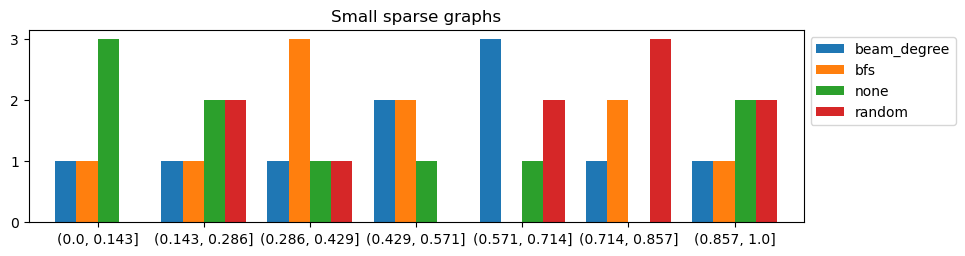

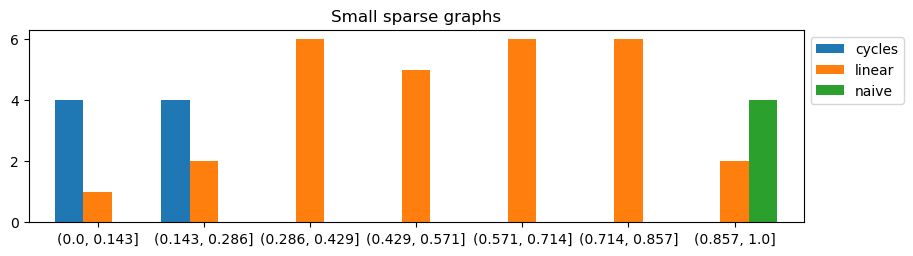

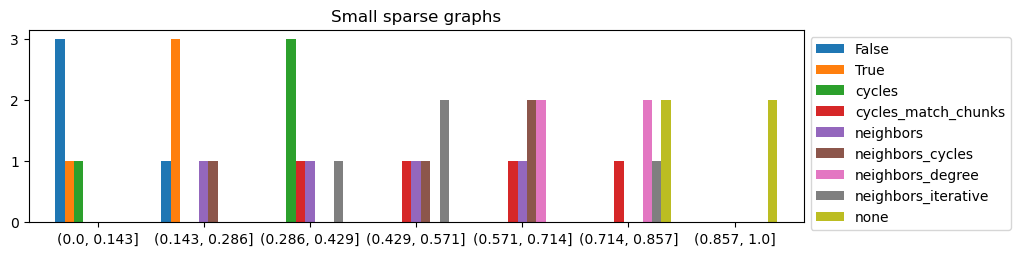

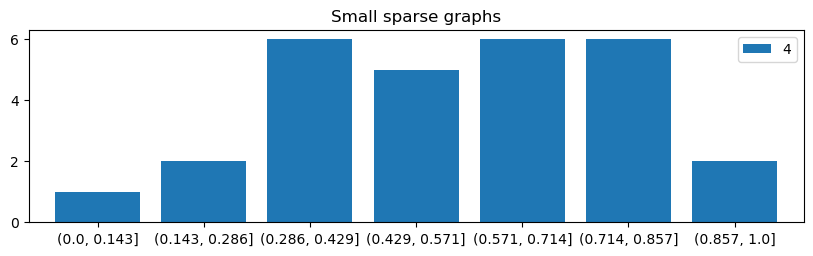

In [11]:
input = """
test_bench_NAC_colorings_small[sparse_small-none-cycles-True]                                          677.3696 (11.35)       687.6673 (10.26)       683.9227 (10.93)      5.6944 (21.80)       686.7312 (11.25)      7.7233 (20.75)         1;0   1.4622 (0.09)          3           1
test_bench_NAC_colorings_small[sparse_small-none-cycles-False]                                         685.6346 (11.49)       686.1309 (10.24)       685.9298 (10.96)      0.2612 (1.0)         686.0240 (11.24)      0.3723 (1.0)           1;0   1.4579 (0.09)          3           1
test_bench_NAC_colorings_small[sparse_small-none-subgraphs-linear-cycles-4]                            730.2455 (12.24)       744.0753 (11.11)       738.0813 (11.80)      7.0965 (27.17)       739.9232 (12.13)     10.3724 (27.86)         1;0   1.3549 (0.08)          3           1
test_bench_NAC_colorings_small[sparse_small-beam_degree-cycles-False]                                  754.7863 (12.65)       768.9437 (11.48)       759.9625 (12.15)      7.8081 (29.89)       756.1576 (12.39)     10.6181 (28.52)         1;0   1.3159 (0.08)          3           1
test_bench_NAC_colorings_small[sparse_small-bfs-cycles-False]                                          754.7123 (12.65)       768.3552 (11.47)       760.6580 (12.16)      6.9880 (26.75)       758.9065 (12.44)     10.2321 (27.49)         1;0   1.3147 (0.08)          3           1
test_bench_NAC_colorings_small[sparse_small-bfs-cycles-True]                                           759.4304 (12.73)       771.7331 (11.52)       764.5297 (12.22)      6.4156 (24.56)       762.4256 (12.49)      9.2270 (24.79)         1;0   1.3080 (0.08)          3           1
test_bench_NAC_colorings_small[sparse_small-random-cycles-True]                                        770.6724 (12.92)       777.8385 (11.61)       773.4803 (12.36)      3.8263 (14.65)       771.9300 (12.65)      5.3746 (14.44)         1;0   1.2929 (0.08)          3           1
test_bench_NAC_colorings_small[sparse_small-random-cycles-False]                                       769.4854 (12.90)       781.0967 (11.66)       774.0524 (12.37)      6.1894 (23.69)       771.5750 (12.64)      8.7085 (23.39)         1;0   1.2919 (0.08)          3           1
test_bench_NAC_colorings_small[sparse_small-beam_degree-cycles-True]                                   759.5471 (12.73)       796.9111 (11.89)       774.5679 (12.38)     19.7289 (75.53)       767.2455 (12.57)     28.0230 (75.28)         1;0   1.2910 (0.08)          3           1
test_bench_NAC_colorings_small[sparse_small-none-subgraphs-linear-neighbors_cycles-4]                  779.9135 (13.07)       848.2645 (12.66)       819.8561 (13.11)     35.6054 (136.31)      831.3902 (13.63)     51.2633 (137.71)        1;0   1.2197 (0.08)          3           1
test_bench_NAC_colorings_small[sparse_small-none-subgraphs-linear-neighbors-4]                         785.5087 (13.17)       880.4607 (13.14)       820.0503 (13.11)     52.4964 (200.97)      794.1816 (13.02)     71.2141 (191.31)        1;0   1.2194 (0.08)          3           1
test_bench_NAC_colorings_small[sparse_small-random-subgraphs-linear-cycles-4]                          811.0891 (13.59)       837.5806 (12.50)       822.7211 (13.15)     13.5375 (51.82)       819.4937 (13.43)     19.8687 (53.37)         1;0   1.2155 (0.08)          3           1
test_bench_NAC_colorings_small[sparse_small-bfs-subgraphs-linear-cycles-4]                             793.2416 (13.29)       920.2117 (13.74)       836.8325 (13.38)     72.2336 (276.53)      797.0441 (13.06)     95.2276 (255.81)        1;0   1.1950 (0.07)          3           1
test_bench_NAC_colorings_small[sparse_small-bfs-subgraphs-linear-neighbors-4]                          813.3827 (13.63)       901.8380 (13.46)       854.7223 (13.66)     44.5096 (170.39)      848.9464 (13.91)     66.3415 (178.22)        1;0   1.1700 (0.07)          3           1
test_bench_NAC_colorings_small[sparse_small-none-subgraphs-linear-cycles_match_chunks-4]               809.8338 (13.57)       940.3650 (14.04)       856.3018 (13.69)     72.9360 (279.22)      818.7065 (13.42)     97.8985 (262.99)        1;0   1.1678 (0.07)          3           1
test_bench_NAC_colorings_small[sparse_small-beam_degree-subgraphs-linear-cycles-4]                     808.5954 (13.55)       952.4328 (14.22)       858.0369 (13.72)     81.7800 (313.07)      813.0826 (13.33)    107.8780 (289.80)        1;0   1.1655 (0.07)          3           1
test_bench_NAC_colorings_small[sparse_small-bfs-subgraphs-linear-neighbors_iterative-4]                823.3125 (13.80)       921.4444 (13.75)       867.1862 (13.86)     49.8833 (190.97)      856.8017 (14.04)     73.5989 (197.71)        1;0   1.1532 (0.07)          3           1
test_bench_NAC_colorings_small[sparse_small-bfs-subgraphs-linear-neighbors_cycles-4]                   853.0195 (14.30)       882.1682 (13.17)       867.5235 (13.87)     14.5748 (55.80)       867.3830 (14.21)     21.8615 (58.73)         1;0   1.1527 (0.07)          3           1
test_bench_NAC_colorings_small[sparse_small-beam_degree-subgraphs-linear-neighbors_iterative-4]        852.2009 (14.28)       886.5569 (13.23)       869.5370 (13.90)     17.1802 (65.77)       869.8533 (14.26)     25.7670 (69.22)         1;0   1.1500 (0.07)          3           1
test_bench_NAC_colorings_small[sparse_small-none-subgraphs-linear-neighbors_iterative-4]               804.3336 (13.48)       985.8050 (14.71)       880.6982 (14.08)     94.0880 (360.19)      851.9559 (13.96)    136.1036 (365.62)        1;0   1.1355 (0.07)          3           1
test_bench_NAC_colorings_small[sparse_small-beam_degree-subgraphs-linear-neighbors-4]                  877.5227 (14.71)       897.7712 (13.40)       884.7603 (14.14)     11.2915 (43.23)       878.9871 (14.41)     15.1863 (40.80)         1;0   1.1302 (0.07)          3           1
test_bench_NAC_colorings_small[sparse_small-bfs-subgraphs-linear-cycles_match_chunks-4]                880.6724 (14.76)       905.3920 (13.51)       891.2315 (14.25)     12.7472 (48.80)       887.6300 (14.55)     18.5396 (49.80)         1;0   1.1220 (0.07)          3           1
test_bench_NAC_colorings_small[sparse_small-beam_degree-subgraphs-linear-neighbors_cycles-4]           843.4984 (14.14)       971.4772 (14.50)       901.1284 (14.40)     64.9305 (248.57)      888.4095 (14.56)     95.9841 (257.85)        1;0   1.1097 (0.07)          3           1
test_bench_NAC_colorings_small[sparse_small-none-subgraphs-linear-neighbors_degree-4]                  856.0071 (14.35)       967.2048 (14.44)       901.2963 (14.41)     58.3961 (223.55)      880.6771 (14.43)     83.3983 (224.04)        1;0   1.1095 (0.07)          3           1
test_bench_NAC_colorings_small[sparse_small-beam_degree-subgraphs-linear-cycles_match_chunks-4]        900.2842 (15.09)       914.3371 (13.65)       907.5437 (14.51)      7.0380 (26.94)       908.0098 (14.88)     10.5397 (28.31)         1;0   1.1019 (0.07)          3           1
test_bench_NAC_colorings_small[sparse_small-random-subgraphs-linear-neighbors_cycles-4]                892.5151 (14.96)       937.7129 (14.00)       913.1096 (14.60)     22.8640 (87.53)       909.1009 (14.90)     33.8983 (91.06)         1;0   1.0952 (0.07)          3           1
test_bench_NAC_colorings_small[sparse_small-random-subgraphs-linear-neighbors-4]                       869.5842 (14.57)       956.6865 (14.28)       923.1148 (14.76)     46.8559 (179.38)      943.0737 (15.46)     65.3267 (175.49)        1;0   1.0833 (0.07)          3           1
test_bench_NAC_colorings_small[sparse_small-beam_degree-subgraphs-linear-neighbors_degree-4]           868.0737 (14.55)       977.4076 (14.59)       924.2494 (14.77)     54.7294 (209.52)      927.2670 (15.20)     82.0004 (220.28)        1;0   1.0820 (0.07)          3           1
test_bench_NAC_colorings_small[sparse_small-random-subgraphs-linear-neighbors_iterative-4]             834.1149 (13.98)     1,039.0789 (15.51)       933.2931 (14.92)    102.6416 (392.94)      926.6856 (15.19)    153.7230 (412.95)        1;0   1.0715 (0.07)          3           1
test_bench_NAC_colorings_small[sparse_small-beam_degree-subgraphs-linear-none-4]                       901.4957 (15.11)       997.6372 (14.89)       954.6216 (15.26)     48.8616 (187.05)      964.7320 (15.81)     72.1061 (193.70)        1;0   1.0475 (0.07)          3           1
test_bench_NAC_colorings_small[sparse_small-bfs-subgraphs-linear-none-4]                               894.4720 (14.99)     1,002.8086 (14.97)       956.9486 (15.30)     56.0471 (214.56)      973.5651 (15.96)     81.2524 (218.27)        1;0   1.0450 (0.07)          3           1
test_bench_NAC_colorings_small[sparse_small-random-subgraphs-linear-cycles_match_chunks-4]             914.9265 (15.33)     1,042.0716 (15.55)       960.5524 (15.35)     70.7652 (270.91)      924.6591 (15.15)     95.3589 (256.17)        1;0   1.0411 (0.07)          3           1
test_bench_NAC_colorings_small[sparse_small-random-subgraphs-linear-neighbors_degree-4]                916.4254 (15.36)     1,013.0855 (15.12)       962.0318 (15.38)     48.5597 (185.90)      956.5846 (15.68)     72.4950 (194.75)        1;0   1.0395 (0.07)          3           1
test_bench_NAC_colorings_small[sparse_small-bfs-subgraphs-linear-neighbors_degree-4]                   891.3532 (14.94)     1,097.0220 (16.37)       963.1166 (15.39)    116.0652 (444.33)      900.9748 (14.77)    154.2516 (414.37)        1;0   1.0383 (0.06)          3           1
test_bench_NAC_colorings_small[sparse_small-none-subgraphs-linear-none-4]                              982.2325 (16.46)       984.3362 (14.69)       983.3927 (15.72)      1.0684 (4.09)        983.6093 (16.12)      1.5777 (4.24)          1;0   1.0169 (0.06)          3           1
test_bench_NAC_colorings_small[sparse_small-random-subgraphs-linear-none-4]                            958.0605 (16.06)     1,142.2327 (17.05)     1,036.4043 (16.57)     95.1125 (364.11)    1,008.9198 (16.53)    138.1291 (371.06)        1;0   0.9649 (0.06)          3           1
test_bench_NAC_colorings_small[sparse_small-none-naive]                                             11,869.1101 (198.92)   11,938.4874 (178.20)   11,893.0083 (190.10)    39.4031 (150.84)   11,871.4275 (194.55)    52.0330 (139.78)        1;0   0.0841 (0.01)          3           1
test_bench_NAC_colorings_small[sparse_small-beam_degree-naive]                                      11,916.2743 (199.71)   12,075.3275 (180.24)   11,989.8931 (191.65)    80.1822 (306.96)   11,978.0775 (196.30)   119.2899 (320.45)        1;0   0.0834 (0.01)          3           1
test_bench_NAC_colorings_small[sparse_small-bfs-naive]                                              12,343.9120 (206.88)   12,627.6318 (188.48)   12,438.4902 (198.82)   163.8015 (627.07)   12,343.9268 (202.30)   212.7899 (571.63)        1;0   0.0804 (0.01)          3           1
test_bench_NAC_colorings_small[sparse_small-random-naive]                                           12,173.6775 (204.03)   12,649.8130 (188.81)   12,478.9545 (199.47)   265.0047 (>1000.0)  12,613.3731 (206.71)   357.1016 (959.30)        1;0   0.0801 (0.01)          3           1
"""
plot_all(input, "Small sparse graphs")

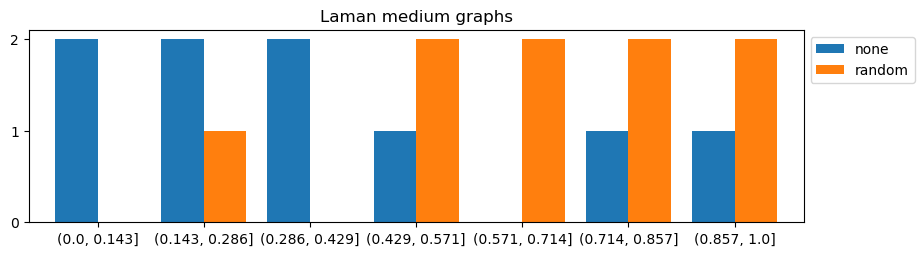

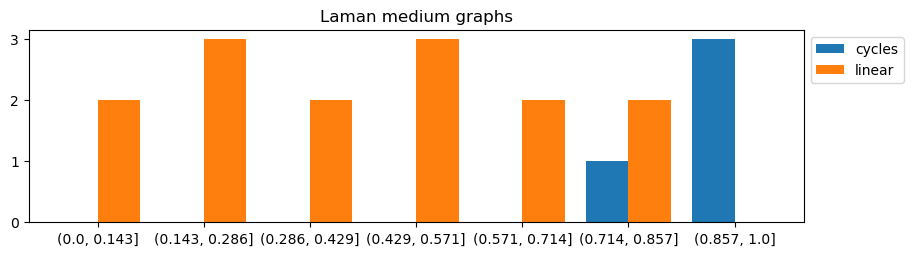

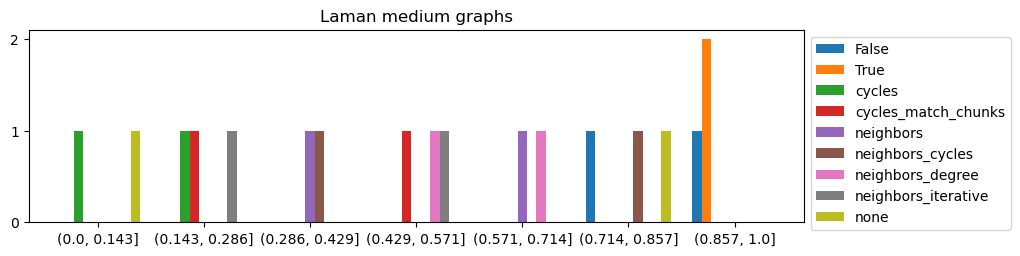

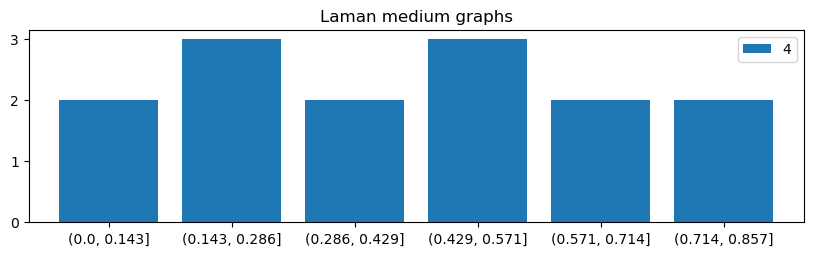

In [12]:
input = """
test_bench_NAC_colorings_small[laman_medium-none-subgraphs-linear-none-4]                       2.3015 (1.0)       2.3133 (1.0)       2.3058 (1.0)      0.0065 (1.97)      2.3025 (1.0)      0.0088 (1.78)          1;0  0.4337 (1.0)           3           1
test_bench_NAC_colorings_small[laman_medium-none-subgraphs-linear-cycles-4]                     2.3964 (1.04)      2.4186 (1.05)      2.4040 (1.04)     0.0126 (3.83)      2.3971 (1.04)     0.0167 (3.37)          1;0  0.4160 (0.96)          3           1
test_bench_NAC_colorings_small[laman_medium-none-subgraphs-linear-cycles_match_chunks-4]        2.4283 (1.06)      2.4349 (1.05)      2.4316 (1.05)     0.0033 (1.0)       2.4317 (1.06)     0.0050 (1.0)           1;0  0.4112 (0.95)          3           1
test_bench_NAC_colorings_small[laman_medium-random-subgraphs-linear-cycles-4]                   2.6295 (1.14)      2.6519 (1.15)      2.6403 (1.15)     0.0112 (3.39)      2.6395 (1.15)     0.0168 (3.39)          1;0  0.3787 (0.87)          3           1
test_bench_NAC_colorings_small[laman_medium-none-subgraphs-linear-neighbors_iterative-4]        2.4476 (1.06)      2.9791 (1.29)      2.7794 (1.21)     0.2893 (87.52)     2.9114 (1.26)     0.3986 (80.41)         1;0  0.3598 (0.83)          3           1
test_bench_NAC_colorings_small[laman_medium-none-subgraphs-linear-neighbors-4]                  2.5001 (1.09)      3.0146 (1.30)      2.8141 (1.22)     0.2754 (83.30)     2.9276 (1.27)     0.3858 (77.82)         1;0  0.3554 (0.82)          3           1
test_bench_NAC_colorings_small[laman_medium-none-subgraphs-linear-neighbors_cycles-4]           2.5882 (1.12)      3.1363 (1.36)      2.8195 (1.22)     0.2839 (85.88)     2.7341 (1.19)     0.4111 (82.92)         1;0  0.3547 (0.82)          3           1
test_bench_NAC_colorings_small[laman_medium-random-subgraphs-linear-cycles_match_chunks-4]      2.8025 (1.22)      3.0430 (1.32)      2.9573 (1.28)     0.1343 (40.64)     3.0263 (1.31)     0.1804 (36.39)         1;0  0.3381 (0.78)          3           1
test_bench_NAC_colorings_small[laman_medium-random-subgraphs-linear-neighbors_iterative-4]      2.9500 (1.28)      3.1901 (1.38)      3.1067 (1.35)     0.1358 (41.08)     3.1799 (1.38)     0.1801 (36.33)         1;0  0.3219 (0.74)          3           1
test_bench_NAC_colorings_small[laman_medium-none-subgraphs-linear-neighbors_degree-4]           2.9946 (1.30)      3.3086 (1.43)      3.1521 (1.37)     0.1570 (47.49)     3.1530 (1.37)     0.2354 (47.49)         1;0  0.3173 (0.73)          3           1
test_bench_NAC_colorings_small[laman_medium-random-subgraphs-linear-neighbors-4]                2.9748 (1.29)      3.4653 (1.50)      3.2251 (1.40)     0.2454 (74.23)     3.2351 (1.41)     0.3678 (74.18)         1;0  0.3101 (0.71)          3           1
test_bench_NAC_colorings_small[laman_medium-random-subgraphs-linear-neighbors_degree-4]         3.1287 (1.36)      3.4242 (1.48)      3.3007 (1.43)     0.1536 (46.47)     3.3491 (1.45)     0.2216 (44.70)         1;0  0.3030 (0.70)          3           1
test_bench_NAC_colorings_small[laman_medium-random-subgraphs-linear-neighbors_cycles-4]         3.1045 (1.35)      3.8566 (1.67)      3.3731 (1.46)     0.4196 (126.93)    3.1583 (1.37)     0.5641 (113.77)        1;0  0.2965 (0.68)          3           1
test_bench_NAC_colorings_small[laman_medium-random-subgraphs-linear-none-4]                     3.5126 (1.53)      4.5049 (1.95)      4.1695 (1.81)     0.5689 (172.11)    4.4908 (1.95)     0.7442 (150.11)        1;0  0.2398 (0.55)          3           1
test_bench_NAC_colorings_small[laman_medium-none-cycles-False]                                 56.7988 (24.68)    59.3302 (25.65)    58.1919 (25.24)    1.2848 (388.68)   58.4466 (25.38)    1.8985 (382.93)        1;0  0.0172 (0.04)          3           1
test_bench_NAC_colorings_small[laman_medium-random-cycles-False]                               58.1907 (25.28)    58.4415 (25.26)    58.3480 (25.31)    0.1370 (41.45)    58.4119 (25.37)    0.1881 (37.93)         1;0  0.0171 (0.04)          3           1
test_bench_NAC_colorings_small[laman_medium-none-cycles-True]                                  58.7328 (25.52)    60.0264 (25.95)    59.4595 (25.79)    0.6614 (200.10)   59.6192 (25.89)    0.9702 (195.69)        1;0  0.0168 (0.04)          3           1
test_bench_NAC_colorings_small[laman_medium-random-cycles-True]                                61.3998 (26.68)    62.2316 (26.90)    61.8157 (26.81)    0.5881 (177.92)   61.8157 (26.85)    0.8317 (167.75)        0;0  0.0162 (0.04)          2           1
"""
plot_all(input, "Laman medium graphs")

### Laman fast

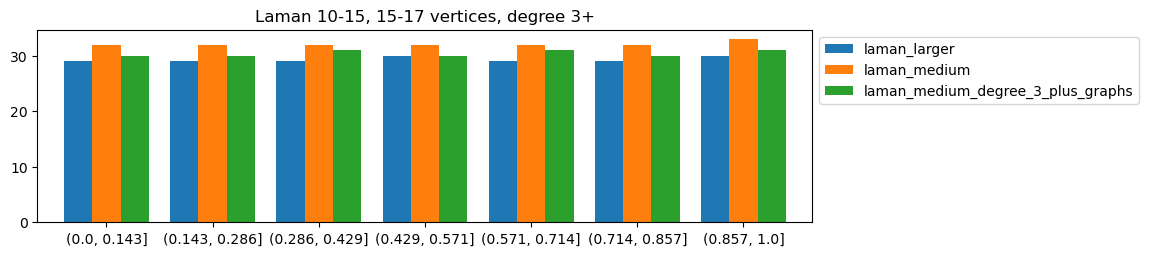

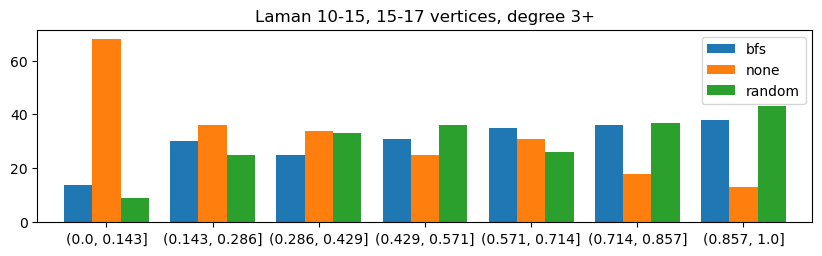

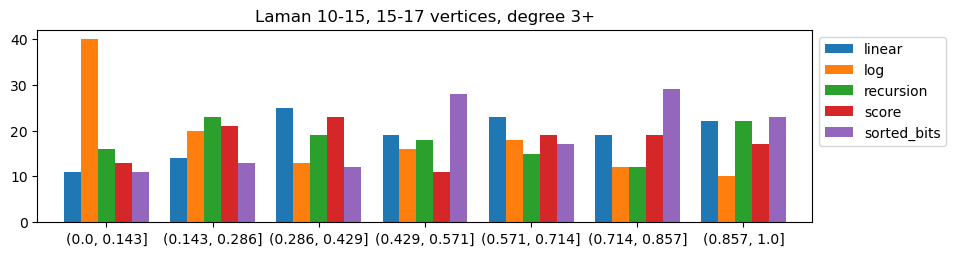

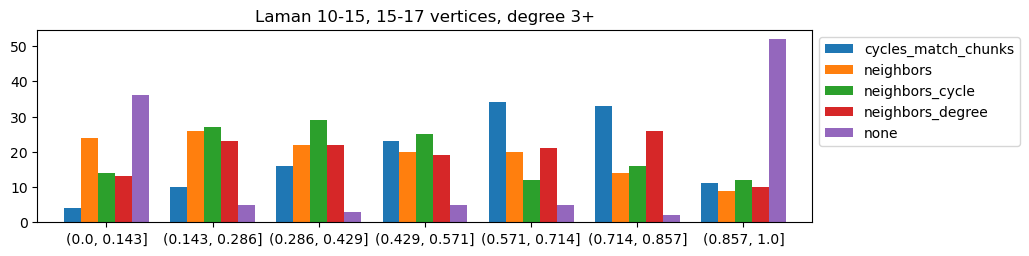

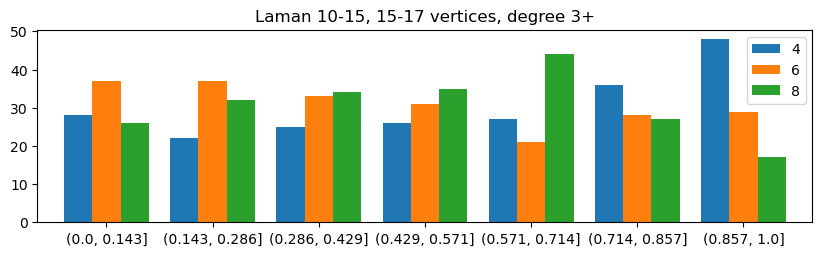

In [13]:
input = """
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-log-none-4-smart]                                                    2.0210 (1.0)       2.0260 (1.0)       2.0232 (1.0)      0.0025 (inf)       2.0227 (1.0)      0.0037 (inf)           1;0  0.4943 (1.0)           3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-score-none-4-smart]                                                  2.0273 (1.00)      2.1527 (1.06)      2.1054 (1.04)     0.0682 (inf)       2.1362 (1.06)     0.0941 (inf)           1;0  0.4750 (0.96)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-log-neighbors-4-smart]                                               2.0559 (1.02)      2.1929 (1.08)      2.1066 (1.04)     0.0751 (inf)       2.0710 (1.02)     0.1027 (inf)           1;0  0.4747 (0.96)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-recursion-none-4-smart]                                              2.1290 (1.05)      2.1456 (1.06)      2.1389 (1.06)     0.0088 (inf)       2.1421 (1.06)     0.0125 (inf)           1;0  0.4675 (0.95)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-log-neighbors_degree-4-smart]                                        2.0815 (1.03)      2.2370 (1.10)      2.1649 (1.07)     0.0783 (inf)       2.1763 (1.08)     0.1166 (inf)           1;0  0.4619 (0.93)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-log-none-6-smart]                                                    2.1716 (1.07)      2.1922 (1.08)      2.1833 (1.08)     0.0106 (inf)       2.1863 (1.08)     0.0154 (inf)           1;0  0.4580 (0.93)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-score-none-6-smart]                                                  2.1780 (1.08)      2.1932 (1.08)      2.1847 (1.08)     0.0077 (inf)       2.1829 (1.08)     0.0114 (inf)           1;0  0.4577 (0.93)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-log-neighbors_degree-6-smart]                                        2.1797 (1.08)      2.2438 (1.11)      2.2122 (1.09)     0.0321 (inf)       2.2130 (1.09)     0.0481 (inf)           1;0  0.4520 (0.91)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-log-neighbors_cycle-4-smart]                                         2.1941 (1.09)      2.2346 (1.10)      2.2205 (1.10)     0.0229 (inf)       2.2329 (1.10)     0.0304 (inf)           1;0  0.4503 (0.91)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-log-neighbors-6-smart]                                               2.2181 (1.10)      2.2351 (1.10)      2.2251 (1.10)     0.0089 (inf)       2.2222 (1.10)     0.0128 (inf)           1;0  0.4494 (0.91)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-log-neighbors-4-smart]                                                2.2318 (1.10)      2.3236 (1.15)      2.2688 (1.12)     0.0485 (inf)       2.2509 (1.11)     0.0689 (inf)           1;0  0.4408 (0.89)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-linear-none-6-smart]                                                 2.2881 (1.13)      2.3333 (1.15)      2.3059 (1.14)     0.0241 (inf)       2.2963 (1.14)     0.0339 (inf)           1;0  0.4337 (0.88)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-log-neighbors-4-smart]                                             2.2824 (1.13)      2.3404 (1.16)      2.3062 (1.14)     0.0304 (inf)       2.2958 (1.14)     0.0435 (inf)           1;0  0.4336 (0.88)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-score-neighbors-4-smart]                                             2.2155 (1.10)      2.4911 (1.23)      2.3094 (1.14)     0.1575 (inf)       2.2215 (1.10)     0.2067 (inf)           1;0  0.4330 (0.88)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-recursion-none-6-smart]                                              2.3340 (1.15)      2.3357 (1.15)      2.3347 (1.15)     0.0009 (inf)       2.3343 (1.15)     0.0012 (inf)           1;0  0.4283 (0.87)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-log-neighbors_cycle-4-smart]                                          2.3148 (1.15)      2.3600 (1.16)      2.3392 (1.16)     0.0228 (inf)       2.3426 (1.16)     0.0339 (inf)           1;0  0.4275 (0.86)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-log-neighbors_cycle-6-smart]                                         2.3217 (1.15)      2.3601 (1.16)      2.3447 (1.16)     0.0203 (inf)       2.3522 (1.16)     0.0288 (inf)           1;0  0.4265 (0.86)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-recursion-neighbors_degree-6-smart]                                  2.2069 (1.09)      2.4357 (1.20)      2.3458 (1.16)     0.1221 (inf)       2.3948 (1.18)     0.1717 (inf)           1;0  0.4263 (0.86)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-score-neighbors_degree-4-smart]                                      2.1731 (1.08)      2.4503 (1.21)      2.3535 (1.16)     0.1563 (inf)       2.4371 (1.20)     0.2079 (inf)           1;0  0.4249 (0.86)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-score-none-8-smart]                                                  2.3554 (1.17)      2.3819 (1.18)      2.3696 (1.17)     0.0134 (inf)       2.3716 (1.17)     0.0199 (inf)           1;0  0.4220 (0.85)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-log-none-8-smart]                                                    2.3469 (1.16)      2.3977 (1.18)      2.3700 (1.17)     0.0257 (inf)       2.3654 (1.17)     0.0381 (inf)           1;0  0.4219 (0.85)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-log-cycles_match_chunks-6-smart]                                     2.3599 (1.17)      2.3919 (1.18)      2.3763 (1.17)     0.0160 (inf)       2.3771 (1.18)     0.0240 (inf)           1;0  0.4208 (0.85)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-recursion-none-8-smart]                                              2.3628 (1.17)      2.3855 (1.18)      2.3770 (1.17)     0.0124 (inf)       2.3829 (1.18)     0.0171 (inf)           1;0  0.4207 (0.85)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-log-neighbors_degree-6-smart]                                         2.3515 (1.16)      2.4475 (1.21)      2.3883 (1.18)     0.0518 (inf)       2.3659 (1.17)     0.0720 (inf)           1;0  0.4187 (0.85)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-linear-none-8-smart]                                                 2.3876 (1.18)      2.4168 (1.19)      2.4064 (1.19)     0.0163 (inf)       2.4148 (1.19)     0.0219 (inf)           1;0  0.4156 (0.84)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-log-neighbors-6-smart]                                                2.3950 (1.19)      2.4170 (1.19)      2.4094 (1.19)     0.0125 (inf)       2.4162 (1.19)     0.0165 (inf)           1;0  0.4150 (0.84)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-linear-none-4-smart]                                                 2.3722 (1.17)      2.4748 (1.22)      2.4098 (1.19)     0.0565 (inf)       2.3824 (1.18)     0.0770 (inf)           1;0  0.4150 (0.84)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-recursion-neighbors-4-smart]                                         2.3811 (1.18)      2.4392 (1.20)      2.4174 (1.19)     0.0317 (inf)       2.4320 (1.20)     0.0435 (inf)           1;0  0.4137 (0.84)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-sorted_bits-cycles_match_chunks-6-smart]                             2.4212 (1.20)      2.4304 (1.20)      2.4261 (1.20)     0.0046 (inf)       2.4267 (1.20)     0.0069 (inf)           1;0  0.4122 (0.83)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-log-neighbors_degree-6-smart]                                      2.3383 (1.16)      2.4924 (1.23)      2.4360 (1.20)     0.0850 (inf)       2.4772 (1.22)     0.1156 (inf)           1;0  0.4105 (0.83)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-recursion-neighbors_degree-6-smart]                                   2.3662 (1.17)      2.5916 (1.28)      2.4421 (1.21)     0.1295 (inf)       2.3684 (1.17)     0.1690 (inf)           1;0  0.4095 (0.83)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-score-neighbors-4-smart]                                           2.3764 (1.18)      2.5502 (1.26)      2.4429 (1.21)     0.0938 (inf)       2.4023 (1.19)     0.1304 (inf)           1;0  0.4093 (0.83)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-score-neighbors_cycle-4-smart]                                        2.4205 (1.20)      2.4849 (1.23)      2.4489 (1.21)     0.0329 (inf)       2.4413 (1.21)     0.0483 (inf)           1;0  0.4083 (0.83)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-recursion-cycles_match_chunks-6-smart]                               2.3958 (1.19)      2.5247 (1.25)      2.4500 (1.21)     0.0668 (inf)       2.4295 (1.20)     0.0967 (inf)           1;0  0.4082 (0.83)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-log-neighbors-6-smart]                                             2.4328 (1.20)      2.4853 (1.23)      2.4539 (1.21)     0.0277 (inf)       2.4436 (1.21)     0.0394 (inf)           1;0  0.4075 (0.82)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-log-neighbors_degree-4-smart]                                         2.2496 (1.11)      2.6059 (1.29)      2.4653 (1.22)     0.1896 (inf)       2.5403 (1.26)     0.2672 (inf)           1;0  0.4056 (0.82)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-linear-neighbors-6-smart]                                             2.4464 (1.21)      2.5077 (1.24)      2.4716 (1.22)     0.0321 (inf)       2.4607 (1.22)     0.0460 (inf)           1;0  0.4046 (0.82)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-linear-neighbors-6-smart]                                            2.4169 (1.20)      2.5449 (1.26)      2.4730 (1.22)     0.0655 (inf)       2.4571 (1.21)     0.0960 (inf)           1;0  0.4044 (0.82)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-sorted_bits-none-8-smart]                                            2.4673 (1.22)      2.4815 (1.22)      2.4735 (1.22)     0.0073 (inf)       2.4716 (1.22)     0.0107 (inf)           1;0  0.4043 (0.82)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-score-neighbors_cycle-4-smart]                                       2.3781 (1.18)      2.5988 (1.28)      2.4765 (1.22)     0.1122 (inf)       2.4526 (1.21)     0.1655 (inf)           1;0  0.4038 (0.82)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-log-neighbors_cycle-6-smart]                                          2.4669 (1.22)      2.4948 (1.23)      2.4819 (1.23)     0.0141 (inf)       2.4841 (1.23)     0.0210 (inf)           1;0  0.4029 (0.82)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-recursion-neighbors_cycle-4-smart]                                   2.3827 (1.18)      2.6006 (1.28)      2.4838 (1.23)     0.1098 (inf)       2.4680 (1.22)     0.1634 (inf)           1;0  0.4026 (0.81)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-score-neighbors-6-smart]                                              2.3947 (1.18)      2.6226 (1.29)      2.4844 (1.23)     0.1214 (inf)       2.4360 (1.20)     0.1709 (inf)           1;0  0.4025 (0.81)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-recursion-neighbors_degree-6-smart]                                2.4089 (1.19)      2.5460 (1.26)      2.4846 (1.23)     0.0696 (inf)       2.4988 (1.24)     0.1028 (inf)           1;0  0.4025 (0.81)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-score-cycles_match_chunks-6-smart]                                   2.4810 (1.23)      2.5017 (1.23)      2.4920 (1.23)     0.0104 (inf)       2.4933 (1.23)     0.0156 (inf)           1;0  0.4013 (0.81)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-sorted_bits-none-6-smart]                                            2.4812 (1.23)      2.5215 (1.24)      2.5001 (1.24)     0.0203 (inf)       2.4977 (1.23)     0.0303 (inf)           1;0  0.4000 (0.81)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-recursion-neighbors-4-smart]                                       2.4287 (1.20)      2.5461 (1.26)      2.5008 (1.24)     0.0631 (inf)       2.5276 (1.25)     0.0881 (inf)           1;0  0.3999 (0.81)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-log-neighbors-8-smart]                                               2.4315 (1.20)      2.6373 (1.30)      2.5019 (1.24)     0.1173 (inf)       2.4369 (1.20)     0.1543 (inf)           1;0  0.3997 (0.81)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-log-cycles_match_chunks-4-smart]                                     2.4622 (1.22)      2.5896 (1.28)      2.5069 (1.24)     0.0717 (inf)       2.4687 (1.22)     0.0955 (inf)           1;0  0.3989 (0.81)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-recursion-neighbors_degree-4-smart]                                   2.4183 (1.20)      2.5907 (1.28)      2.5104 (1.24)     0.0868 (inf)       2.5222 (1.25)     0.1293 (inf)           1;0  0.3983 (0.81)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-linear-neighbors-4-smart]                                            2.4484 (1.21)      2.6195 (1.29)      2.5110 (1.24)     0.0944 (inf)       2.4649 (1.22)     0.1283 (inf)           1;0  0.3983 (0.81)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-linear-neighbors_degree-6-smart]                                     2.3463 (1.16)      2.7819 (1.37)      2.5212 (1.25)     0.2302 (inf)       2.4353 (1.20)     0.3268 (inf)           1;0  0.3966 (0.80)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-log-cycles_match_chunks-6-smart]                                      2.5158 (1.24)      2.5475 (1.26)      2.5264 (1.25)     0.0182 (inf)       2.5160 (1.24)     0.0238 (inf)           1;0  0.3958 (0.80)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-log-neighbors_cycle-4-smart]                                       2.3931 (1.18)      2.7535 (1.36)      2.5338 (1.25)     0.1928 (inf)       2.4547 (1.21)     0.2703 (inf)           1;0  0.3947 (0.80)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-recursion-neighbors_cycle-4-smart]                                    2.4723 (1.22)      2.6106 (1.29)      2.5338 (1.25)     0.0704 (inf)       2.5184 (1.25)     0.1037 (inf)           1;0  0.3947 (0.80)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-recursion-cycles_match_chunks-6-smart]                                2.5288 (1.25)      2.5484 (1.26)      2.5367 (1.25)     0.0104 (inf)       2.5328 (1.25)     0.0147 (inf)           1;0  0.3942 (0.80)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-recursion-neighbors_cycle-6-smart]                                    2.4908 (1.23)      2.6146 (1.29)      2.5427 (1.26)     0.0643 (inf)       2.5227 (1.25)     0.0929 (inf)           1;0  0.3933 (0.80)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-log-cycles_match_chunks-4-smart]                                   2.4784 (1.23)      2.6646 (1.32)      2.5440 (1.26)     0.1046 (inf)       2.4890 (1.23)     0.1397 (inf)           1;0  0.3931 (0.80)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-score-neighbors_cycle-6-smart]                                        2.5146 (1.24)      2.5961 (1.28)      2.5476 (1.26)     0.0429 (inf)       2.5321 (1.25)     0.0611 (inf)           1;0  0.3925 (0.79)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-recursion-neighbors_cycle-6-smart]                                 2.4718 (1.22)      2.6856 (1.33)      2.5552 (1.26)     0.1144 (inf)       2.5083 (1.24)     0.1604 (inf)           1;0  0.3914 (0.79)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-recursion-neighbors_cycle-6-smart]                                   2.4924 (1.23)      2.5948 (1.28)      2.5604 (1.27)     0.0589 (inf)       2.5940 (1.28)     0.0768 (inf)           1;0  0.3906 (0.79)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-log-neighbors_cycle-6-smart]                                       2.5491 (1.26)      2.5676 (1.27)      2.5604 (1.27)     0.0099 (inf)       2.5645 (1.27)     0.0138 (inf)           1;0  0.3906 (0.79)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-score-neighbors_degree-4-smart]                                    2.3130 (1.14)      3.0139 (1.49)      2.5647 (1.27)     0.3899 (inf)       2.3673 (1.17)     0.5256 (inf)           1;0  0.3899 (0.79)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-recursion-neighbors_cycle-4-smart]                                 2.5392 (1.26)      2.6088 (1.29)      2.5678 (1.27)     0.0364 (inf)       2.5553 (1.26)     0.0522 (inf)           1;0  0.3894 (0.79)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-log-cycles_match_chunks-4-smart]                                      2.4928 (1.23)      2.6431 (1.30)      2.5870 (1.28)     0.0820 (inf)       2.6250 (1.30)     0.1127 (inf)           1;0  0.3865 (0.78)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-score-neighbors_cycle-6-smart]                                     2.4627 (1.22)      2.7592 (1.36)      2.5886 (1.28)     0.1532 (inf)       2.5439 (1.26)     0.2224 (inf)           1;0  0.3863 (0.78)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-linear-neighbors_cycle-6-smart]                                       2.5357 (1.25)      2.6230 (1.29)      2.5895 (1.28)     0.0470 (inf)       2.6096 (1.29)     0.0655 (inf)           1;0  0.3862 (0.78)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-linear-neighbors-8-smart]                                            2.5048 (1.24)      2.7336 (1.35)      2.5916 (1.28)     0.1240 (inf)       2.5364 (1.25)     0.1716 (inf)           1;0  0.3859 (0.78)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-log-neighbors_degree-8-smart]                                        2.4548 (1.21)      2.8008 (1.38)      2.6012 (1.29)     0.1791 (inf)       2.5480 (1.26)     0.2595 (inf)           1;0  0.3844 (0.78)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-linear-neighbors_degree-8-smart]                                     2.4599 (1.22)      2.7854 (1.37)      2.6021 (1.29)     0.1666 (inf)       2.5610 (1.27)     0.2441 (inf)           1;0  0.3843 (0.78)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-linear-neighbors_cycle-6-smart]                                      2.5161 (1.25)      2.6958 (1.33)      2.6065 (1.29)     0.0898 (inf)       2.6075 (1.29)     0.1347 (inf)           1;0  0.3837 (0.78)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-linear-neighbors-6-smart]                                          2.5221 (1.25)      2.7464 (1.36)      2.6121 (1.29)     0.1186 (inf)       2.5676 (1.27)     0.1682 (inf)           1;0  0.3828 (0.77)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-recursion-neighbors_degree-4-smart]                                2.4580 (1.22)      2.8048 (1.38)      2.6149 (1.29)     0.1758 (inf)       2.5818 (1.28)     0.2601 (inf)           1;0  0.3824 (0.77)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-score-neighbors_degree-6-smart]                                       2.4770 (1.23)      2.7271 (1.35)      2.6164 (1.29)     0.1275 (inf)       2.6453 (1.31)     0.1875 (inf)           1;0  0.3822 (0.77)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-linear-neighbors-4-smart]                                             2.5286 (1.25)      2.6792 (1.32)      2.6180 (1.29)     0.0791 (inf)       2.6460 (1.31)     0.1130 (inf)           1;0  0.3820 (0.77)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-score-neighbors_cycle-8-smart]                                       2.5303 (1.25)      2.6995 (1.33)      2.6181 (1.29)     0.0848 (inf)       2.6246 (1.30)     0.1269 (inf)           1;0  0.3820 (0.77)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-linear-neighbors_cycle-4-smart]                                      2.5796 (1.28)      2.7021 (1.33)      2.6210 (1.30)     0.0702 (inf)       2.5813 (1.28)     0.0918 (inf)           1;0  0.3815 (0.77)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-recursion-cycles_match_chunks-4-smart]                               2.5844 (1.28)      2.6718 (1.32)      2.6220 (1.30)     0.0449 (inf)       2.6098 (1.29)     0.0655 (inf)           1;0  0.3814 (0.77)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-recursion-cycles_match_chunks-4-smart]                             2.4774 (1.23)      2.7094 (1.34)      2.6244 (1.30)     0.1278 (inf)       2.6863 (1.33)     0.1740 (inf)           1;0  0.3810 (0.77)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-recursion-neighbors_degree-4-smart]                                  2.4726 (1.22)      2.7490 (1.36)      2.6261 (1.30)     0.1407 (inf)       2.6566 (1.31)     0.2073 (inf)           1;0  0.3808 (0.77)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-recursion-neighbors-4-smart]                                          2.4642 (1.22)      2.7232 (1.34)      2.6263 (1.30)     0.1413 (inf)       2.6916 (1.33)     0.1942 (inf)           1;0  0.3808 (0.77)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-log-cycles_match_chunks-6-smart]                                   2.5788 (1.28)      2.7192 (1.34)      2.6270 (1.30)     0.0799 (inf)       2.5830 (1.28)     0.1053 (inf)           1;0  0.3807 (0.77)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-score-neighbors-6-smart]                                           2.4351 (1.20)      2.8099 (1.39)      2.6283 (1.30)     0.1877 (inf)       2.6399 (1.31)     0.2811 (inf)           1;0  0.3805 (0.77)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-score-neighbors-8-smart]                                             2.4838 (1.23)      2.7491 (1.36)      2.6327 (1.30)     0.1356 (inf)       2.6654 (1.32)     0.1990 (inf)           1;0  0.3798 (0.77)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-score-neighbors-4-smart]                                              2.3671 (1.17)      2.8689 (1.42)      2.6329 (1.30)     0.2522 (inf)       2.6627 (1.32)     0.3764 (inf)           1;0  0.3798 (0.77)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-log-neighbors_cycle-8-smart]                                         2.5070 (1.24)      2.7739 (1.37)      2.6393 (1.30)     0.1335 (inf)       2.6372 (1.30)     0.2002 (inf)           1;0  0.3789 (0.77)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-recursion-neighbors-8-smart]                                         2.5082 (1.24)      2.7514 (1.36)      2.6394 (1.30)     0.1228 (inf)       2.6585 (1.31)     0.1825 (inf)           1;0  0.3789 (0.77)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-linear-neighbors_degree-6-smart]                                   2.4553 (1.21)      2.7719 (1.37)      2.6412 (1.31)     0.1654 (inf)       2.6964 (1.33)     0.2374 (inf)           1;0  0.3786 (0.77)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-score-neighbors_degree-4-smart]                                       2.5462 (1.26)      2.7215 (1.34)      2.6489 (1.31)     0.0915 (inf)       2.6790 (1.32)     0.1315 (inf)           1;0  0.3775 (0.76)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-log-neighbors_degree-4-smart]                                      2.3948 (1.18)      2.8637 (1.41)      2.6507 (1.31)     0.2374 (inf)       2.6938 (1.33)     0.3517 (inf)           1;0  0.3773 (0.76)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-score-cycles_match_chunks-6-smart]                                    2.6426 (1.31)      2.6582 (1.31)      2.6515 (1.31)     0.0081 (inf)       2.6538 (1.31)     0.0118 (inf)           1;0  0.3771 (0.76)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-linear-neighbors_cycle-4-smart]                                       2.6405 (1.31)      2.6580 (1.31)      2.6521 (1.31)     0.0100 (inf)       2.6577 (1.31)     0.0131 (inf)           1;0  0.3771 (0.76)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-score-neighbors_cycle-6-smart]                                       2.5729 (1.27)      2.7101 (1.34)      2.6612 (1.32)     0.0767 (inf)       2.7008 (1.34)     0.1029 (inf)           1;0  0.3758 (0.76)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-sorted_bits-none-4-smart]                                            2.6604 (1.32)      2.6661 (1.32)      2.6632 (1.32)     0.0028 (inf)       2.6632 (1.32)     0.0043 (inf)           1;0  0.3755 (0.76)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-score-neighbors_degree-6-smart]                                      2.5762 (1.27)      2.7636 (1.36)      2.6658 (1.32)     0.0940 (inf)       2.6576 (1.31)     0.1405 (inf)           1;0  0.3751 (0.76)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-sorted_bits-neighbors_degree-4-smart]                                2.5975 (1.29)      2.7033 (1.33)      2.6663 (1.32)     0.0596 (inf)       2.6980 (1.33)     0.0794 (inf)           1;0  0.3751 (0.76)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-linear-neighbors-4-smart]                                          2.5905 (1.28)      2.7431 (1.35)      2.6761 (1.32)     0.0780 (inf)       2.6948 (1.33)     0.1145 (inf)           1;0  0.3737 (0.76)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-sorted_bits-neighbors_degree-6-smart]                                2.4108 (1.19)      3.0853 (1.52)      2.6774 (1.32)     0.3587 (inf)       2.5361 (1.25)     0.5058 (inf)           1;0  0.3735 (0.76)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-recursion-neighbors-6-smart]                                         2.4362 (1.21)      3.1500 (1.55)      2.6803 (1.32)     0.4069 (inf)       2.4546 (1.21)     0.5354 (inf)           1;0  0.3731 (0.75)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-linear-neighbors_cycle-8-smart]                                      2.6049 (1.29)      2.7272 (1.35)      2.6811 (1.33)     0.0664 (inf)       2.7111 (1.34)     0.0917 (inf)           1;0  0.3730 (0.75)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-recursion-neighbors_cycle-8-smart]                                   2.5766 (1.27)      2.7614 (1.36)      2.6815 (1.33)     0.0949 (inf)       2.7064 (1.34)     0.1386 (inf)           1;0  0.3729 (0.75)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-score-neighbors_degree-6-smart]                                    2.6367 (1.30)      2.7341 (1.35)      2.6873 (1.33)     0.0488 (inf)       2.6912 (1.33)     0.0730 (inf)           1;0  0.3721 (0.75)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-linear-neighbors_degree-6-smart]                                      2.4520 (1.21)      2.9565 (1.46)      2.6901 (1.33)     0.2535 (inf)       2.6618 (1.32)     0.3784 (inf)           1;0  0.3717 (0.75)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-sorted_bits-cycles_match_chunks-8-smart]                             2.6781 (1.33)      2.7194 (1.34)      2.6946 (1.33)     0.0218 (inf)       2.6863 (1.33)     0.0309 (inf)           1;0  0.3711 (0.75)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]                           2.5873 (1.28)      2.7522 (1.36)      2.6957 (1.33)     0.0938 (inf)       2.7475 (1.36)     0.1236 (inf)           1;0  0.3710 (0.75)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-sorted_bits-neighbors-8-smart]                                       2.6614 (1.32)      2.7189 (1.34)      2.6974 (1.33)     0.0314 (inf)       2.7120 (1.34)     0.0432 (inf)           1;0  0.3707 (0.75)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-sorted_bits-neighbors_degree-8-smart]                                2.6305 (1.30)      2.7920 (1.38)      2.6975 (1.33)     0.0842 (inf)       2.6699 (1.32)     0.1211 (inf)           1;0  0.3707 (0.75)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-sorted_bits-cycles_match_chunks-6-smart]                              2.6485 (1.31)      2.7781 (1.37)      2.7078 (1.34)     0.0655 (inf)       2.6966 (1.33)     0.0972 (inf)           1;0  0.3693 (0.75)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-recursion-neighbors-6-smart]                                       2.4875 (1.23)      3.0501 (1.51)      2.7132 (1.34)     0.2974 (inf)       2.6019 (1.29)     0.4220 (inf)           1;0  0.3686 (0.75)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-recursion-neighbors-6-smart]                                          2.6453 (1.31)      2.7769 (1.37)      2.7139 (1.34)     0.0660 (inf)       2.7195 (1.34)     0.0987 (inf)           1;0  0.3685 (0.75)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-log-neighbors_cycle-8-smart]                                          2.6589 (1.32)      2.7465 (1.36)      2.7152 (1.34)     0.0488 (inf)       2.7401 (1.35)     0.0657 (inf)           1;0  0.3683 (0.75)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-score-cycles_match_chunks-4-smart]                                   2.6845 (1.33)      2.7672 (1.37)      2.7156 (1.34)     0.0450 (inf)       2.6950 (1.33)     0.0620 (inf)           1;0  0.3682 (0.75)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-recursion-cycles_match_chunks-4-smart]                                2.7024 (1.34)      2.7386 (1.35)      2.7228 (1.35)     0.0185 (inf)       2.7274 (1.35)     0.0271 (inf)           1;0  0.3673 (0.74)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-sorted_bits-cycles_match_chunks-4-smart]                             2.7062 (1.34)      2.7444 (1.35)      2.7241 (1.35)     0.0192 (inf)       2.7216 (1.35)     0.0286 (inf)           1;0  0.3671 (0.74)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-sorted_bits-neighbors_degree-8-smart]                                 2.6106 (1.29)      2.9435 (1.45)      2.7245 (1.35)     0.1897 (inf)       2.6195 (1.30)     0.2497 (inf)           1;0  0.3670 (0.74)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-score-neighbors_cycle-4-smart]                                     2.4622 (1.22)      3.2054 (1.58)      2.7267 (1.35)     0.4153 (inf)       2.5125 (1.24)     0.5574 (inf)           1;0  0.3667 (0.74)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-recursion-neighbors_cycle-8-smart]                                 2.7012 (1.34)      2.7621 (1.36)      2.7337 (1.35)     0.0307 (inf)       2.7378 (1.35)     0.0457 (inf)           1;0  0.3658 (0.74)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-recursion-neighbors-8-smart]                                       2.6697 (1.32)      2.7942 (1.38)      2.7340 (1.35)     0.0624 (inf)       2.7380 (1.35)     0.0934 (inf)           1;0  0.3658 (0.74)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-linear-cycles_match_chunks-6-smart]                                  2.6682 (1.32)      2.8180 (1.39)      2.7342 (1.35)     0.0765 (inf)       2.7164 (1.34)     0.1124 (inf)           1;0  0.3657 (0.74)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-linear-neighbors_cycle-6-smart]                                    2.6341 (1.30)      2.8706 (1.42)      2.7382 (1.35)     0.1208 (inf)       2.7100 (1.34)     0.1774 (inf)           1;0  0.3652 (0.74)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-log-neighbors_degree-8-smart]                                      2.6716 (1.32)      2.7785 (1.37)      2.7400 (1.35)     0.0595 (inf)       2.7701 (1.37)     0.0802 (inf)           1;0  0.3650 (0.74)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-linear-neighbors_degree-8-smart]                                   2.6893 (1.33)      2.8066 (1.39)      2.7471 (1.36)     0.0587 (inf)       2.7455 (1.36)     0.0880 (inf)           1;0  0.3640 (0.74)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-score-neighbors_cycle-8-smart]                                     2.7259 (1.35)      2.7752 (1.37)      2.7487 (1.36)     0.0248 (inf)       2.7450 (1.36)     0.0369 (inf)           1;0  0.3638 (0.74)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-score-neighbors-8-smart]                                           2.6815 (1.33)      2.8463 (1.40)      2.7528 (1.36)     0.0846 (inf)       2.7306 (1.35)     0.1236 (inf)           1;0  0.3633 (0.73)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-sorted_bits-neighbors_cycle-8-smart]                                 2.6440 (1.31)      2.8561 (1.41)      2.7654 (1.37)     0.1093 (inf)       2.7961 (1.38)     0.1590 (inf)           1;0  0.3616 (0.73)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-sorted_bits-neighbors_degree-6-smart]                              2.6894 (1.33)      2.8682 (1.42)      2.7706 (1.37)     0.0905 (inf)       2.7543 (1.36)     0.1341 (inf)           1;0  0.3609 (0.73)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-linear-neighbors_cycle-8-smart]                                    2.7451 (1.36)      2.8128 (1.39)      2.7727 (1.37)     0.0355 (inf)       2.7603 (1.36)     0.0508 (inf)           1;0  0.3607 (0.73)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-recursion-neighbors_cycle-8-smart]                                    2.6416 (1.31)      2.8394 (1.40)      2.7728 (1.37)     0.1136 (inf)       2.8374 (1.40)     0.1483 (inf)           1;0  0.3606 (0.73)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-log-neighbors-8-smart]                                                2.6518 (1.31)      3.0119 (1.49)      2.7775 (1.37)     0.2031 (inf)       2.6689 (1.32)     0.2701 (inf)           1;0  0.3600 (0.73)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-linear-neighbors-8-smart]                                             2.6458 (1.31)      3.0166 (1.49)      2.7800 (1.37)     0.2056 (inf)       2.6775 (1.32)     0.2781 (inf)           1;0  0.3597 (0.73)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-score-cycles_match_chunks-4-smart]                                 2.5048 (1.24)      3.0462 (1.50)      2.7828 (1.38)     0.2710 (inf)       2.7973 (1.38)     0.4060 (inf)           1;0  0.3594 (0.73)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-recursion-neighbors_degree-8-smart]                                  2.6502 (1.31)      2.8572 (1.41)      2.7864 (1.38)     0.1180 (inf)       2.8518 (1.41)     0.1553 (inf)           1;0  0.3589 (0.73)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-log-cycles_match_chunks-8-smart]                                     2.7691 (1.37)      2.8095 (1.39)      2.7897 (1.38)     0.0202 (inf)       2.7904 (1.38)     0.0303 (inf)           1;0  0.3585 (0.73)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-recursion-cycles_match_chunks-8-smart]                               2.7832 (1.38)      2.8024 (1.38)      2.7897 (1.38)     0.0110 (inf)       2.7835 (1.38)     0.0144 (inf)           1;0  0.3585 (0.73)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-linear-neighbors_cycle-8-smart]                                       2.7224 (1.35)      2.8360 (1.40)      2.7934 (1.38)     0.0619 (inf)       2.8219 (1.40)     0.0852 (inf)           1;0  0.3580 (0.72)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-recursion-neighbors_degree-8-smart]                                2.7450 (1.36)      2.8971 (1.43)      2.7981 (1.38)     0.0858 (inf)       2.7522 (1.36)     0.1141 (inf)           1;0  0.3574 (0.72)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-score-neighbors_degree-8-smart]                                    2.7623 (1.37)      2.8196 (1.39)      2.7988 (1.38)     0.0317 (inf)       2.8144 (1.39)     0.0429 (inf)           1;0  0.3573 (0.72)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-linear-cycles_match_chunks-6-smart]                                   2.8014 (1.39)      2.8097 (1.39)      2.8054 (1.39)     0.0042 (inf)       2.8052 (1.39)     0.0062 (inf)           1;0  0.3565 (0.72)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-score-neighbors_cycle-8-smart]                                        2.6733 (1.32)      2.9069 (1.43)      2.8071 (1.39)     0.1204 (inf)       2.8412 (1.40)     0.1752 (inf)           1;0  0.3562 (0.72)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-score-cycles_match_chunks-8-smart]                                   2.7991 (1.39)      2.8175 (1.39)      2.8091 (1.39)     0.0093 (inf)       2.8107 (1.39)     0.0138 (inf)           1;0  0.3560 (0.72)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-recursion-cycles_match_chunks-6-smart]                             2.5068 (1.24)      3.4112 (1.68)      2.8109 (1.39)     0.5200 (inf)       2.5146 (1.24)     0.6783 (inf)           1;0  0.3558 (0.72)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-score-neighbors_degree-8-smart]                                      2.6984 (1.34)      2.9499 (1.46)      2.8166 (1.39)     0.1264 (inf)       2.8014 (1.38)     0.1886 (inf)           1;0  0.3550 (0.72)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-score-neighbors-8-smart]                                              2.6619 (1.32)      3.0334 (1.50)      2.8176 (1.39)     0.1930 (inf)       2.7573 (1.36)     0.2787 (inf)           1;0  0.3549 (0.72)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-sorted_bits-neighbors_cycle-6-smart]                                  2.7677 (1.37)      2.9211 (1.44)      2.8239 (1.40)     0.0845 (inf)       2.7830 (1.38)     0.1150 (inf)           1;0  0.3541 (0.72)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-sorted_bits-neighbors-8-smart]                                        2.6076 (1.29)      2.9365 (1.45)      2.8247 (1.40)     0.1881 (inf)       2.9301 (1.45)     0.2467 (inf)           1;0  0.3540 (0.72)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-log-neighbors-8-smart]                                             2.7956 (1.38)      2.8867 (1.42)      2.8332 (1.40)     0.0476 (inf)       2.8172 (1.39)     0.0684 (inf)           1;0  0.3530 (0.71)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-linear-neighbors-8-smart]                                          2.7960 (1.38)      2.8764 (1.42)      2.8354 (1.40)     0.0402 (inf)       2.8339 (1.40)     0.0603 (inf)           1;0  0.3527 (0.71)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-score-cycles_match_chunks-4-smart]                                    2.7866 (1.38)      2.8698 (1.42)      2.8402 (1.40)     0.0465 (inf)       2.8643 (1.42)     0.0624 (inf)           1;0  0.3521 (0.71)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-sorted_bits-neighbors-8-smart]                                     2.7616 (1.37)      2.9224 (1.44)      2.8478 (1.41)     0.0810 (inf)       2.8594 (1.41)     0.1206 (inf)           1;0  0.3511 (0.71)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-sorted_bits-neighbors_cycle-8-smart]                               2.8132 (1.39)      2.8880 (1.43)      2.8580 (1.41)     0.0396 (inf)       2.8730 (1.42)     0.0561 (inf)           1;0  0.3499 (0.71)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-score-neighbors-6-smart]                                             2.7074 (1.34)      3.0282 (1.49)      2.8625 (1.41)     0.1607 (inf)       2.8520 (1.41)     0.2406 (inf)           1;0  0.3493 (0.71)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-log-neighbors_cycle-8-smart]                                       2.7374 (1.35)      3.0166 (1.49)      2.8684 (1.42)     0.1404 (inf)       2.8513 (1.41)     0.2095 (inf)           1;0  0.3486 (0.71)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-score-cycles_match_chunks-8-smart]                                 2.8411 (1.41)      2.8934 (1.43)      2.8712 (1.42)     0.0270 (inf)       2.8790 (1.42)     0.0393 (inf)           1;0  0.3483 (0.70)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-score-cycles_match_chunks-6-smart]                                 2.5797 (1.28)      3.3251 (1.64)      2.8760 (1.42)     0.3955 (inf)       2.7232 (1.35)     0.5591 (inf)           1;0  0.3477 (0.70)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-sorted_bits-neighbors_degree-4-smart]                              2.6569 (1.31)      3.1799 (1.57)      2.8828 (1.42)     0.2686 (inf)       2.8117 (1.39)     0.3922 (inf)           1;0  0.3469 (0.70)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-recursion-neighbors_degree-8-smart]                                   2.7030 (1.34)      3.2306 (1.59)      2.8853 (1.43)     0.2992 (inf)       2.7223 (1.35)     0.3957 (inf)           1;0  0.3466 (0.70)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-linear-cycles_match_chunks-8-smart]                                  2.8830 (1.43)      2.9005 (1.43)      2.8891 (1.43)     0.0099 (inf)       2.8837 (1.43)     0.0131 (inf)           1;0  0.3461 (0.70)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-sorted_bits-neighbors_degree-8-smart]                              2.8402 (1.41)      2.9664 (1.46)      2.8893 (1.43)     0.0676 (inf)       2.8612 (1.41)     0.0946 (inf)           1;0  0.3461 (0.70)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-recursion-neighbors-8-smart]                                          2.7814 (1.38)      3.1243 (1.54)      2.9011 (1.43)     0.1934 (inf)       2.7976 (1.38)     0.2571 (inf)           1;0  0.3447 (0.70)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-sorted_bits-cycles_match_chunks-8-smart]                              2.8463 (1.41)      2.9727 (1.47)      2.9016 (1.43)     0.0647 (inf)       2.8857 (1.43)     0.0948 (inf)           1;0  0.3446 (0.70)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-sorted_bits-cycles_match_chunks-8-smart]                           2.8592 (1.41)      2.9667 (1.46)      2.9113 (1.44)     0.0538 (inf)       2.9080 (1.44)     0.0806 (inf)           1;0  0.3435 (0.69)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]                           2.8750 (1.42)      2.9431 (1.45)      2.9121 (1.44)     0.0344 (inf)       2.9181 (1.44)     0.0511 (inf)           1;0  0.3434 (0.69)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-sorted_bits-neighbors_degree-4-smart]                                 2.8083 (1.39)      3.0439 (1.50)      2.9122 (1.44)     0.1202 (inf)       2.8843 (1.43)     0.1766 (inf)           1;0  0.3434 (0.69)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-score-neighbors_degree-8-smart]                                       2.7052 (1.34)      3.2840 (1.62)      2.9123 (1.44)     0.3226 (inf)       2.7476 (1.36)     0.4341 (inf)           1;0  0.3434 (0.69)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-linear-cycles_match_chunks-8-smart]                                2.7770 (1.37)      2.9955 (1.48)      2.9197 (1.44)     0.1237 (inf)       2.9866 (1.48)     0.1639 (inf)           1;0  0.3425 (0.69)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-linear-cycles_match_chunks-6-smart]                                2.7605 (1.37)      3.1710 (1.57)      2.9219 (1.44)     0.2189 (inf)       2.8342 (1.40)     0.3079 (inf)           1;0  0.3422 (0.69)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-log-cycles_match_chunks-8-smart]                                      2.8486 (1.41)      3.0251 (1.49)      2.9259 (1.45)     0.0903 (inf)       2.9039 (1.44)     0.1324 (inf)           1;0  0.3418 (0.69)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-linear-neighbors_cycle-4-smart]                                    2.6981 (1.34)      3.3624 (1.66)      2.9273 (1.45)     0.3770 (inf)       2.7214 (1.35)     0.4982 (inf)           1;0  0.3416 (0.69)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-linear-cycles_match_chunks-8-smart]                                   2.8889 (1.43)      2.9606 (1.46)      2.9315 (1.45)     0.0377 (inf)       2.9450 (1.46)     0.0537 (inf)           1;0  0.3411 (0.69)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-log-cycles_match_chunks-8-smart]                                   2.7456 (1.36)      3.0772 (1.52)      2.9336 (1.45)     0.1702 (inf)       2.9780 (1.47)     0.2487 (inf)           1;0  0.3409 (0.69)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-recursion-cycles_match_chunks-8-smart]                                2.9069 (1.44)      2.9690 (1.47)      2.9428 (1.45)     0.0322 (inf)       2.9524 (1.46)     0.0466 (inf)           1;0  0.3398 (0.69)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-recursion-cycles_match_chunks-8-smart]                             2.8912 (1.43)      3.0366 (1.50)      2.9449 (1.46)     0.0798 (inf)       2.9069 (1.44)     0.1091 (inf)           1;0  0.3396 (0.69)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-sorted_bits-neighbors-6-smart]                                        2.8514 (1.41)      3.0657 (1.51)      2.9661 (1.47)     0.1079 (inf)       2.9812 (1.47)     0.1607 (inf)           1;0  0.3371 (0.68)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-linear-neighbors_degree-4-smart]                                     2.4942 (1.23)      3.5908 (1.77)      2.9666 (1.47)     0.5639 (inf)       2.8147 (1.39)     0.8225 (inf)           1;0  0.3371 (0.68)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-linear-neighbors_degree-4-smart]                                   2.6444 (1.31)      3.3246 (1.64)      2.9667 (1.47)     0.3415 (inf)       2.9309 (1.45)     0.5102 (inf)           1;0  0.3371 (0.68)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-sorted_bits-neighbors_degree-6-smart]                                 2.8314 (1.40)      3.0933 (1.53)      2.9687 (1.47)     0.1314 (inf)       2.9814 (1.47)     0.1965 (inf)           1;0  0.3368 (0.68)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-sorted_bits-neighbors_cycle-4-smart]                                  2.9222 (1.45)      3.0231 (1.49)      2.9882 (1.48)     0.0572 (inf)       3.0193 (1.49)     0.0757 (inf)           1;0  0.3347 (0.68)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-sorted_bits-cycles_match_chunks-4-smart]                              2.8967 (1.43)      3.1547 (1.56)      2.9933 (1.48)     0.1407 (inf)       2.9286 (1.45)     0.1935 (inf)           1;0  0.3341 (0.68)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-linear-neighbors_degree-8-smart]                                      2.8762 (1.42)      3.2205 (1.59)      2.9934 (1.48)     0.1967 (inf)       2.8834 (1.43)     0.2582 (inf)           1;0  0.3341 (0.68)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-score-cycles_match_chunks-8-smart]                                    2.9487 (1.46)      3.0884 (1.52)      2.9985 (1.48)     0.0780 (inf)       2.9585 (1.46)     0.1048 (inf)           1;0  0.3335 (0.67)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]                               2.8758 (1.42)      3.0857 (1.52)      3.0100 (1.49)     0.1165 (inf)       3.0684 (1.52)     0.1574 (inf)           1;0  0.3322 (0.67)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-sorted_bits-neighbors-6-smart]                                       2.8580 (1.41)      3.2910 (1.62)      3.0143 (1.49)     0.2403 (inf)       2.8939 (1.43)     0.3248 (inf)           1;0  0.3318 (0.67)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-log-neighbors_degree-8-smart]                                         2.8900 (1.43)      3.2514 (1.60)      3.0198 (1.49)     0.2011 (inf)       2.9178 (1.44)     0.2711 (inf)           1;0  0.3312 (0.67)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-sorted_bits-neighbors_cycle-8-smart]                                  2.8987 (1.43)      3.1388 (1.55)      3.0230 (1.49)     0.1203 (inf)       3.0313 (1.50)     0.1801 (inf)           1;0  0.3308 (0.67)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-sorted_bits-neighbors_cycle-6-smart]                                 3.0167 (1.49)      3.0511 (1.51)      3.0342 (1.50)     0.0172 (inf)       3.0347 (1.50)     0.0258 (inf)           1;0  0.3296 (0.67)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-sorted_bits-neighbors-4-smart]                                       2.9214 (1.45)      3.1112 (1.54)      3.0422 (1.50)     0.1050 (inf)       3.0939 (1.53)     0.1424 (inf)           1;0  0.3287 (0.67)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-linear-cycles_match_chunks-4-smart]                                2.9244 (1.45)      3.2246 (1.59)      3.0765 (1.52)     0.1502 (inf)       3.0803 (1.52)     0.2252 (inf)           1;0  0.3250 (0.66)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-linear-cycles_match_chunks-4-smart]                                  3.0564 (1.51)      3.1124 (1.54)      3.0771 (1.52)     0.0307 (inf)       3.0626 (1.51)     0.0420 (inf)           1;0  0.3250 (0.66)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-sorted_bits-neighbors-6-smart]                                     2.9783 (1.47)      3.2993 (1.63)      3.1287 (1.55)     0.1615 (inf)       3.1084 (1.54)     0.2408 (inf)           1;0  0.3196 (0.65)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-linear-cycles_match_chunks-4-smart]                                   3.0168 (1.49)      3.2154 (1.59)      3.1466 (1.56)     0.1125 (inf)       3.2075 (1.59)     0.1490 (inf)           1;0  0.3178 (0.64)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-linear-neighbors_degree-4-smart]                                      2.7082 (1.34)      3.6831 (1.82)      3.1634 (1.56)     0.4906 (inf)       3.0989 (1.53)     0.7311 (inf)           1;0  0.3161 (0.64)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-sorted_bits-neighbors-4-smart]                                     2.9473 (1.46)      3.5846 (1.77)      3.1674 (1.57)     0.3615 (inf)       2.9703 (1.47)     0.4780 (inf)           1;0  0.3157 (0.64)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-sorted_bits-neighbors-4-smart]                                        2.8344 (1.40)      3.3966 (1.68)      3.1732 (1.57)     0.2984 (inf)       3.2886 (1.63)     0.4217 (inf)           1;0  0.3151 (0.64)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]                               3.1526 (1.56)      3.4178 (1.69)      3.3116 (1.64)     0.1402 (inf)       3.3642 (1.66)     0.1989 (inf)           1;0  0.3020 (0.61)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-none-subgraphs-sorted_bits-neighbors_cycle-4-smart]                                 2.9430 (1.46)      3.5613 (1.76)      3.3445 (1.65)     0.3481 (inf)       3.5294 (1.74)     0.4638 (inf)           1;0  0.2990 (0.60)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-recursion-none-6-smart]                                            2.9680 (1.47)      3.8854 (1.92)      3.4491 (1.70)     0.4604 (inf)       3.4940 (1.73)     0.6881 (inf)           1;0  0.2899 (0.59)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-score-none-4-smart]                                                3.4430 (1.70)      3.5812 (1.77)      3.4989 (1.73)     0.0728 (inf)       3.4725 (1.72)     0.1037 (inf)           1;0  0.2858 (0.58)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-sorted_bits-none-4-smart]                                          3.4960 (1.73)      3.7481 (1.85)      3.5905 (1.77)     0.1374 (inf)       3.5274 (1.74)     0.1891 (inf)           1;0  0.2785 (0.56)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-recursion-none-4-smart]                                            2.9307 (1.45)      4.6178 (2.28)      3.6169 (1.79)     0.8864 (inf)       3.3023 (1.63)     1.2653 (inf)           1;0  0.2765 (0.56)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-linear-none-4-smart]                                                  3.6330 (1.80)      4.3837 (2.16)      4.0045 (1.98)     0.3754 (inf)       3.9968 (1.98)     0.5631 (inf)           1;0  0.2497 (0.51)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-sorted_bits-none-4-smart]                                             3.9571 (1.96)      4.2153 (2.08)      4.0761 (2.01)     0.1303 (inf)       4.0557 (2.01)     0.1936 (inf)           1;0  0.2453 (0.50)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-log-none-4-smart]                                                  3.5632 (1.76)      5.1418 (2.54)      4.0912 (2.02)     0.9099 (inf)       3.5687 (1.76)     1.1840 (inf)           1;0  0.2444 (0.49)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-linear-none-6-smart]                                               3.4436 (1.70)      4.7717 (2.36)      4.1181 (2.04)     0.6643 (inf)       4.1390 (2.05)     0.9961 (inf)           1;0  0.2428 (0.49)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-linear-none-4-smart]                                               3.5367 (1.75)      4.4620 (2.20)      4.1408 (2.05)     0.5235 (inf)       4.4236 (2.19)     0.6940 (inf)           1;0  0.2415 (0.49)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-linear-none-6-smart]                                                  3.8834 (1.92)      4.4408 (2.19)      4.1466 (2.05)     0.2800 (inf)       4.1156 (2.03)     0.4180 (inf)           1;0  0.2412 (0.49)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-sorted_bits-none-6-smart]                                          3.6727 (1.82)      4.6384 (2.29)      4.1472 (2.05)     0.4831 (inf)       4.1306 (2.04)     0.7243 (inf)           1;0  0.2411 (0.49)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-log-none-4-smart]                                                     3.7594 (1.86)      4.9594 (2.45)      4.3302 (2.14)     0.6021 (inf)       4.2718 (2.11)     0.9000 (inf)           1;0  0.2309 (0.47)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-log-none-8-smart]                                                  4.1533 (2.06)      5.0876 (2.51)      4.5652 (2.26)     0.4768 (inf)       4.4547 (2.20)     0.7007 (inf)           1;0  0.2190 (0.44)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-linear-none-8-smart]                                               4.2098 (2.08)      5.1760 (2.55)      4.6313 (2.29)     0.4947 (inf)       4.5082 (2.23)     0.7246 (inf)           1;0  0.2159 (0.44)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-sorted_bits-none-6-smart]                                             4.6247 (2.29)      4.9791 (2.46)      4.8402 (2.39)     0.1892 (inf)       4.9169 (2.43)     0.2658 (inf)           1;0  0.2066 (0.42)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-log-none-8-smart]                                                     4.4436 (2.20)      6.2391 (3.08)      5.4025 (2.67)     0.9040 (inf)       5.5248 (2.73)     1.3466 (inf)           1;0  0.1851 (0.37)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-linear-none-8-smart]                                                  4.4929 (2.22)      6.2329 (3.08)      5.4157 (2.68)     0.8748 (inf)       5.5214 (2.73)     1.3050 (inf)           1;0  0.1846 (0.37)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-recursion-none-8-smart]                                            4.3682 (2.16)      7.7227 (3.81)      5.6328 (2.78)     1.8232 (inf)       4.8076 (2.38)     2.5159 (inf)           1;0  0.1775 (0.36)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-score-none-8-smart]                                                4.4084 (2.18)      7.7973 (3.85)      5.6745 (2.80)     1.8497 (inf)       4.8180 (2.38)     2.5417 (inf)           1;0  0.1762 (0.36)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-sorted_bits-none-8-smart]                                          4.6941 (2.32)      7.8814 (3.89)      5.8211 (2.88)     1.7869 (inf)       4.8878 (2.42)     2.3905 (inf)           1;0  0.1718 (0.35)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-score-none-6-smart]                                                   3.7486 (1.85)      7.2181 (3.56)      5.8515 (2.89)     1.8482 (inf)       6.5877 (3.26)     2.6021 (inf)           1;0  0.1709 (0.35)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-log-none-6-smart]                                                  4.1755 (2.07)      9.8680 (4.87)      6.8208 (3.37)     2.8675 (inf)       6.4188 (3.17)     4.2694 (inf)           1;0  0.1466 (0.30)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-random-subgraphs-score-none-6-smart]                                                4.1040 (2.03)      9.7468 (4.81)      6.9602 (3.44)     2.8221 (inf)       7.0300 (3.48)     4.2321 (inf)           1;0  0.1437 (0.29)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-score-none-8-smart]                                                   6.2263 (3.08)      8.7464 (4.32)      7.1067 (3.51)     1.4214 (inf)       6.3473 (3.14)     1.8901 (inf)           1;0  0.1407 (0.28)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-recursion-none-8-smart]                                               6.2274 (3.08)      8.7244 (4.31)      7.1091 (3.51)     1.4008 (inf)       6.3756 (3.15)     1.8728 (inf)           1;0  0.1407 (0.28)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-recursion-none-6-smart]                                               7.1586 (3.54)      7.2817 (3.59)      7.2180 (3.57)     0.0617 (inf)       7.2138 (3.57)     0.0924 (inf)           1;0  0.1385 (0.28)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-log-none-6-smart]                                                     7.3307 (3.63)      7.4308 (3.67)      7.3886 (3.65)     0.0519 (inf)       7.4042 (3.66)     0.0751 (inf)           1;0  0.1353 (0.27)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-sorted_bits-none-8-smart]                                             6.7394 (3.33)      8.7796 (4.33)      7.4768 (3.70)     1.1315 (inf)       6.9114 (3.42)     1.5301 (inf)           1;0  0.1337 (0.27)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-recursion-none-4-smart]                                               3.1053 (1.54)     14.5316 (7.17)     10.4148 (5.15)     6.3470 (inf)      13.6074 (6.73)     8.5697 (inf)           1;0  0.0960 (0.19)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium-bfs-subgraphs-score-none-4-smart]                                                   7.8062 (3.86)     14.2504 (7.03)     12.0039 (5.93)     3.6383 (inf)      13.9550 (6.90)     4.8331 (inf)           1;0  0.0833 (0.17)          3           1

test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-log-none-4-smart]                                                    8.9754 (4.44)      9.0489 (4.47)      9.0148 (4.46)     0.0370 (inf)       9.0202 (4.46)     0.0551 (inf)           1;0  0.1109 (0.22)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-log-neighbors_cycle-4-smart]                                         9.4388 (4.67)      9.5899 (4.73)      9.5226 (4.71)     0.0769 (inf)       9.5392 (4.72)     0.1133 (inf)           1;0  0.1050 (0.21)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-log-neighbors-4-smart]                                               9.4747 (4.69)      9.5664 (4.72)      9.5306 (4.71)     0.0490 (inf)       9.5508 (4.72)     0.0688 (inf)           1;0  0.1049 (0.21)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-recursion-none-4-smart]                                              9.5934 (4.75)      9.6462 (4.76)      9.6231 (4.76)     0.0270 (inf)       9.6295 (4.76)     0.0396 (inf)           1;0  0.1039 (0.21)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-score-none-4-smart]                                                  9.6899 (4.79)      9.7211 (4.80)      9.7036 (4.80)     0.0159 (inf)       9.6997 (4.80)     0.0234 (inf)           1;0  0.1031 (0.21)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-linear-none-8-smart]                                                 9.8433 (4.87)      9.8458 (4.86)      9.8442 (4.87)     0.0014 (inf)       9.8435 (4.87)     0.0019 (inf)           1;0  0.1016 (0.21)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-log-none-8-smart]                                                    9.8008 (4.85)     10.0079 (4.94)      9.8836 (4.89)     0.1096 (inf)       9.8421 (4.87)     0.1553 (inf)           1;0  0.1012 (0.20)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-log-neighbors-8-smart]                                               9.7872 (4.84)      9.9476 (4.91)      9.8865 (4.89)     0.0868 (inf)       9.9248 (4.91)     0.1204 (inf)           1;0  0.1011 (0.20)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-recursion-neighbors_cycle-6-smart]                                   9.8767 (4.89)     10.0773 (4.97)      9.9469 (4.92)     0.1131 (inf)       9.8865 (4.89)     0.1504 (inf)           1;0  0.1005 (0.20)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-recursion-none-6-smart]                                              9.9845 (4.94)     10.0423 (4.96)     10.0097 (4.95)     0.0296 (inf)      10.0022 (4.95)     0.0434 (inf)           1;0  0.0999 (0.20)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-score-neighbors-8-smart]                                            10.0023 (4.95)     10.4834 (5.17)     10.2177 (5.05)     0.2445 (inf)      10.1673 (5.03)     0.3608 (inf)           1;0  0.0979 (0.20)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-recursion-neighbors-8-smart]                                        10.0084 (4.95)     10.5606 (5.21)     10.2552 (5.07)     0.2807 (inf)      10.1968 (5.04)     0.4142 (inf)           1;0  0.0975 (0.20)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-linear-neighbors-8-smart]                                           10.1714 (5.03)     10.3639 (5.12)     10.2632 (5.07)     0.0966 (inf)      10.2545 (5.07)     0.1444 (inf)           1;0  0.0974 (0.20)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-recursion-none-8-smart]                                             10.3916 (5.14)     10.4162 (5.14)     10.4008 (5.14)     0.0134 (inf)      10.3947 (5.14)     0.0185 (inf)           1;0  0.0961 (0.19)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-score-none-8-smart]                                                 10.3985 (5.15)     10.4264 (5.15)     10.4135 (5.15)     0.0140 (inf)      10.4157 (5.15)     0.0209 (inf)           1;0  0.0960 (0.19)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-recursion-neighbors_cycle-4-smart]                                  10.2848 (5.09)     10.5919 (5.23)     10.4166 (5.15)     0.1581 (inf)      10.3732 (5.13)     0.2303 (inf)           1;0  0.0960 (0.19)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-log-cycles_match_chunks-4-smart]                                    10.3797 (5.14)     10.6126 (5.24)     10.4586 (5.17)     0.1334 (inf)      10.3835 (5.13)     0.1746 (inf)           1;0  0.0956 (0.19)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-linear-none-6-smart]                                                10.3119 (5.10)     10.6034 (5.23)     10.4780 (5.18)     0.1499 (inf)      10.5185 (5.20)     0.2186 (inf)           1;0  0.0954 (0.19)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-log-none-6-smart]                                                   10.4697 (5.18)     10.5077 (5.19)     10.4911 (5.19)     0.0195 (inf)      10.4959 (5.19)     0.0285 (inf)           1;0  0.0953 (0.19)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-recursion-neighbors-6-smart]                                        10.1452 (5.02)     10.9102 (5.39)     10.6538 (5.27)     0.4405 (inf)      10.9061 (5.39)     0.5737 (inf)           1;0  0.0939 (0.19)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-log-neighbors_degree-4-smart]                                        9.9133 (4.91)     11.2674 (5.56)     10.6615 (5.27)     0.6882 (inf)      10.8038 (5.34)     1.0156 (inf)           1;0  0.0938 (0.19)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-log-neighbors_cycle-4-smart]                                         10.6011 (5.25)     10.7148 (5.29)     10.6666 (5.27)     0.0588 (inf)      10.6840 (5.28)     0.0852 (inf)           1;0  0.0938 (0.19)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-log-neighbors-4-smart]                                               10.5974 (5.24)     10.8147 (5.34)     10.7235 (5.30)     0.1128 (inf)      10.7585 (5.32)     0.1629 (inf)           1;0  0.0933 (0.19)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-sorted_bits-neighbors_degree-8-smart]                               10.4772 (5.18)     11.0399 (5.45)     10.7632 (5.32)     0.2815 (inf)      10.7724 (5.33)     0.4220 (inf)           1;0  0.0929 (0.19)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-score-none-6-smart]                                                 10.7777 (5.33)     10.7978 (5.33)     10.7906 (5.33)     0.0112 (inf)      10.7964 (5.34)     0.0151 (inf)           1;0  0.0927 (0.19)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-log-neighbors_cycle-6-smart]                                        10.6706 (5.28)     11.0515 (5.45)     10.8460 (5.36)     0.1922 (inf)      10.8159 (5.35)     0.2857 (inf)           1;0  0.0922 (0.19)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-score-neighbors-4-smart]                                            10.1993 (5.05)     11.6087 (5.73)     10.8471 (5.36)     0.7116 (inf)      10.7331 (5.31)     1.0570 (inf)           1;0  0.0922 (0.19)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-sorted_bits-neighbors-8-smart]                                      10.7553 (5.32)     11.0758 (5.47)     10.9208 (5.40)     0.1605 (inf)      10.9313 (5.40)     0.2404 (inf)           1;0  0.0916 (0.19)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-sorted_bits-none-8-smart]                                           10.7790 (5.33)     11.1743 (5.52)     11.0230 (5.45)     0.2133 (inf)      11.1157 (5.50)     0.2965 (inf)           1;0  0.0907 (0.18)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-score-neighbors-4-smart]                                             10.5780 (5.23)     11.6870 (5.77)     11.0877 (5.48)     0.5599 (inf)      10.9980 (5.44)     0.8317 (inf)           1;0  0.0902 (0.18)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-score-neighbors_cycle-6-smart]                                       11.0121 (5.45)     11.2260 (5.54)     11.1308 (5.50)     0.1089 (inf)      11.1542 (5.51)     0.1605 (inf)           1;0  0.0898 (0.18)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-log-neighbors-6-smart]                                              10.6887 (5.29)     11.7918 (5.82)     11.1666 (5.52)     0.5661 (inf)      11.0194 (5.45)     0.8273 (inf)           1;0  0.0896 (0.18)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-log-neighbors_cycle-8-smart]                                        11.0520 (5.47)     11.4395 (5.65)     11.1850 (5.53)     0.2205 (inf)      11.0636 (5.47)     0.2907 (inf)           1;0  0.0894 (0.18)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-score-neighbors_cycle-4-smart]                                      10.4838 (5.19)     12.4950 (6.17)     11.2153 (5.54)     1.1120 (inf)      10.6672 (5.27)     1.5084 (inf)           1;0  0.0892 (0.18)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-score-neighbors_degree-6-smart]                                     10.5763 (5.23)     12.1877 (6.02)     11.2521 (5.56)     0.8365 (inf)      10.9923 (5.43)     1.2085 (inf)           1;0  0.0889 (0.18)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-log-cycles_match_chunks-4-smart]                                     11.2371 (5.56)     11.3726 (5.61)     11.3267 (5.60)     0.0776 (inf)      11.3704 (5.62)     0.1016 (inf)           1;0  0.0883 (0.18)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-recursion-neighbors_cycle-6-smart]                                   11.1165 (5.50)     11.4869 (5.67)     11.3469 (5.61)     0.2011 (inf)      11.4372 (5.65)     0.2779 (inf)           1;0  0.0881 (0.18)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-recursion-neighbors_cycle-8-smart]                                11.1044 (5.49)     11.5847 (5.72)     11.4048 (5.64)     0.2618 (inf)      11.5253 (5.70)     0.3602 (inf)           1;0  0.0877 (0.18)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-linear-neighbors-6-smart]                                           11.1239 (5.50)     11.9114 (5.88)     11.4075 (5.64)     0.4375 (inf)      11.1872 (5.53)     0.5906 (inf)           1;0  0.0877 (0.18)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-linear-neighbors_cycle-8-smart]                                     11.0407 (5.46)     11.9423 (5.89)     11.4164 (5.64)     0.4692 (inf)      11.2663 (5.57)     0.6762 (inf)           1;0  0.0876 (0.18)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-linear-neighbors_cycle-6-smart]                                     11.3097 (5.60)     11.6700 (5.76)     11.5428 (5.71)     0.2022 (inf)      11.6488 (5.76)     0.2702 (inf)           1;0  0.0866 (0.18)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-log-cycles_match_chunks-4-smart]                                  11.3464 (5.61)     11.7544 (5.80)     11.5559 (5.71)     0.2042 (inf)      11.5670 (5.72)     0.3060 (inf)           1;0  0.0865 (0.18)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-linear-none-4-smart]                                                11.4623 (5.67)     11.6829 (5.77)     11.5765 (5.72)     0.1105 (inf)      11.5842 (5.73)     0.1655 (inf)           1;0  0.0864 (0.17)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-linear-neighbors-8-smart]                                         11.5205 (5.70)     11.6754 (5.76)     11.5765 (5.72)     0.0859 (inf)      11.5337 (5.70)     0.1162 (inf)           1;0  0.0864 (0.17)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-sorted_bits-neighbors_degree-8-smart]                             11.5013 (5.69)     11.7652 (5.81)     11.5973 (5.73)     0.1459 (inf)      11.5254 (5.70)     0.1980 (inf)           1;0  0.0862 (0.17)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-recursion-neighbors_cycle-8-smart]                                  11.2958 (5.59)     11.8793 (5.86)     11.6220 (5.74)     0.2978 (inf)      11.6908 (5.78)     0.4377 (inf)           1;0  0.0860 (0.17)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-log-neighbors_degree-4-smart]                                        11.3063 (5.59)     12.2959 (6.07)     11.6521 (5.76)     0.5581 (inf)      11.3541 (5.61)     0.7422 (inf)           1;0  0.0858 (0.17)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-score-neighbors-6-smart]                                          11.3924 (5.64)     12.1270 (5.99)     11.6742 (5.77)     0.3961 (inf)      11.5031 (5.69)     0.5510 (inf)           1;0  0.0857 (0.17)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-score-neighbors-4-smart]                                          11.5603 (5.72)     11.9243 (5.89)     11.6877 (5.78)     0.2051 (inf)      11.5784 (5.72)     0.2730 (inf)           1;0  0.0856 (0.17)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-recursion-neighbors_degree-6-smart]                               10.7850 (5.34)     12.9610 (6.40)     11.7104 (5.79)     1.1238 (inf)      11.3853 (5.63)     1.6320 (inf)           1;0  0.0854 (0.17)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-log-neighbors_cycle-6-smart]                                         11.6004 (5.74)     11.8099 (5.83)     11.7125 (5.79)     0.1055 (inf)      11.7272 (5.80)     0.1571 (inf)           1;0  0.0854 (0.17)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-score-neighbors_cycle-8-smart]                                      11.4543 (5.67)     12.0727 (5.96)     11.7132 (5.79)     0.3212 (inf)      11.6127 (5.74)     0.4638 (inf)           1;0  0.0854 (0.17)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-recursion-neighbors_degree-6-smart]                                 10.7637 (5.33)     12.8067 (6.32)     11.7298 (5.80)     1.0260 (inf)      11.6191 (5.74)     1.5322 (inf)           1;0  0.0853 (0.17)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-log-neighbors-8-smart]                                            11.6050 (5.74)     11.9416 (5.89)     11.7317 (5.80)     0.1831 (inf)      11.6486 (5.76)     0.2525 (inf)           1;0  0.0852 (0.17)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-score-neighbors_cycle-4-smart]                                       11.4726 (5.68)     12.1172 (5.98)     11.7507 (5.81)     0.3313 (inf)      11.6623 (5.77)     0.4834 (inf)           1;0  0.0851 (0.17)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-sorted_bits-neighbors_degree-6-smart]                               11.0897 (5.49)     12.2337 (6.04)     11.7592 (5.81)     0.5964 (inf)      11.9541 (5.91)     0.8580 (inf)           1;0  0.0850 (0.17)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-sorted_bits-neighbors_degree-8-smart]                                10.9855 (5.44)     12.4400 (6.14)     11.7595 (5.81)     0.7318 (inf)      11.8530 (5.86)     1.0909 (inf)           1;0  0.0850 (0.17)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-score-cycles_match_chunks-6-smart]                                  11.7085 (5.79)     11.8844 (5.87)     11.7977 (5.83)     0.0880 (inf)      11.8002 (5.83)     0.1319 (inf)           1;0  0.0848 (0.17)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-recursion-neighbors_cycle-6-smart]                                11.5343 (5.71)     12.3832 (6.11)     11.8250 (5.84)     0.4836 (inf)      11.5575 (5.71)     0.6367 (inf)           1;0  0.0846 (0.17)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-score-neighbors_cycle-8-smart]                                    11.4408 (5.66)     12.0858 (5.97)     11.8415 (5.85)     0.3498 (inf)      11.9980 (5.93)     0.4837 (inf)           1;0  0.0844 (0.17)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-score-neighbors_cycle-6-smart]                                      10.8144 (5.35)     12.9427 (6.39)     11.9252 (5.89)     1.0672 (inf)      12.0184 (5.94)     1.5963 (inf)           1;0  0.0839 (0.17)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-linear-neighbors_cycle-6-smart]                                      11.8194 (5.85)     12.0304 (5.94)     11.9374 (5.90)     0.1077 (inf)      11.9624 (5.91)     0.1582 (inf)           1;0  0.0838 (0.17)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-recursion-cycles_match_chunks-8-smart]                            11.4801 (5.68)     12.6668 (6.25)     11.9568 (5.91)     0.6268 (inf)      11.7234 (5.80)     0.8900 (inf)           1;0  0.0836 (0.17)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-score-cycles_match_chunks-8-smart]                                11.5580 (5.72)     12.7456 (6.29)     11.9837 (5.92)     0.6613 (inf)      11.6475 (5.76)     0.8907 (inf)           1;0  0.0834 (0.17)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-recursion-neighbors_cycle-4-smart]                                   11.4541 (5.67)     12.7589 (6.30)     11.9884 (5.93)     0.6837 (inf)      11.7522 (5.81)     0.9785 (inf)           1;0  0.0834 (0.17)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-score-cycles_match_chunks-4-smart]                                   11.8291 (5.85)     12.1236 (5.98)     12.0035 (5.93)     0.1546 (inf)      12.0577 (5.96)     0.2209 (inf)           1;0  0.0833 (0.17)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-log-neighbors_cycle-8-smart]                                      11.4748 (5.68)     12.3892 (6.12)     12.0215 (5.94)     0.4828 (inf)      12.2006 (6.03)     0.6858 (inf)           1;0  0.0832 (0.17)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-sorted_bits-cycles_match_chunks-6-smart]                            11.8332 (5.86)     12.1932 (6.02)     12.0403 (5.95)     0.1860 (inf)      12.0944 (5.98)     0.2700 (inf)           1;0  0.0831 (0.17)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-score-neighbors_degree-4-smart]                                     11.0189 (5.45)     12.6416 (6.24)     12.0542 (5.96)     0.8993 (inf)      12.5022 (6.18)     1.2170 (inf)           1;0  0.0830 (0.17)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-score-neighbors-8-smart]                                          11.4085 (5.65)     13.0944 (6.46)     12.0674 (5.96)     0.9012 (inf)      11.6991 (5.78)     1.2644 (inf)           1;0  0.0829 (0.17)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-sorted_bits-neighbors_cycle-8-smart]                              12.0123 (5.94)     12.2035 (6.02)     12.1066 (5.98)     0.0956 (inf)      12.1041 (5.98)     0.1433 (inf)           1;0  0.0826 (0.17)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-recursion-neighbors-8-smart]                                      11.3706 (5.63)     13.1850 (6.51)     12.1588 (6.01)     0.9303 (inf)      11.9209 (5.89)     1.3608 (inf)           1;0  0.0822 (0.17)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-recursion-cycles_match_chunks-8-smart]                              12.0773 (5.98)     12.3565 (6.10)     12.1795 (6.02)     0.1540 (inf)      12.1046 (5.98)     0.2095 (inf)           1;0  0.0821 (0.17)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-linear-neighbors_cycle-8-smart]                                   11.6653 (5.77)     12.5944 (6.22)     12.1891 (6.02)     0.4757 (inf)      12.3074 (6.08)     0.6968 (inf)           1;0  0.0820 (0.17)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-score-cycles_match_chunks-6-smart]                                   12.0727 (5.97)     12.4456 (6.14)     12.2395 (6.05)     0.1895 (inf)      12.2001 (6.03)     0.2796 (inf)           1;0  0.0817 (0.17)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-score-cycles_match_chunks-4-smart]                                  12.2329 (6.05)     12.3127 (6.08)     12.2601 (6.06)     0.0455 (inf)      12.2348 (6.05)     0.0599 (inf)           1;0  0.0816 (0.17)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-sorted_bits-cycles_match_chunks-8-smart]                            12.2295 (6.05)     12.3177 (6.08)     12.2694 (6.06)     0.0447 (inf)      12.2610 (6.06)     0.0662 (inf)           1;0  0.0815 (0.16)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-sorted_bits-neighbors_degree-6-smart]                                12.0597 (5.97)     12.4021 (6.12)     12.2864 (6.07)     0.1963 (inf)      12.3972 (6.13)     0.2568 (inf)           1;0  0.0814 (0.16)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-sorted_bits-neighbors_cycle-8-smart]                                11.7665 (5.82)     12.7299 (6.28)     12.3213 (6.09)     0.4981 (inf)      12.4675 (6.16)     0.7225 (inf)           1;0  0.0812 (0.16)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-score-cycles_match_chunks-8-smart]                                  12.2956 (6.08)     12.3753 (6.11)     12.3321 (6.10)     0.0403 (inf)      12.3255 (6.09)     0.0598 (inf)           1;0  0.0811 (0.16)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-log-neighbors_degree-4-smart]                                     11.1105 (5.50)     13.5243 (6.68)     12.3463 (6.10)     1.2080 (inf)      12.4043 (6.13)     1.8104 (inf)           1;0  0.0810 (0.16)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-linear-neighbors-6-smart]                                            11.8217 (5.85)     13.0109 (6.42)     12.3522 (6.11)     0.6049 (inf)      12.2240 (6.04)     0.8919 (inf)           1;0  0.0810 (0.16)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-log-neighbors-6-smart]                                               11.9461 (5.91)     13.0247 (6.43)     12.3618 (6.11)     0.5803 (inf)      12.1145 (5.99)     0.8090 (inf)           1;0  0.0809 (0.16)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-score-neighbors_degree-6-smart]                                   11.5367 (5.71)     13.3198 (6.57)     12.3692 (6.11)     0.8974 (inf)      12.2509 (6.06)     1.3373 (inf)           1;0  0.0808 (0.16)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-linear-cycles_match_chunks-8-smart]                               12.0883 (5.98)     12.8543 (6.34)     12.4013 (6.13)     0.4017 (inf)      12.2614 (6.06)     0.5745 (inf)           1;0  0.0806 (0.16)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-log-neighbors-4-smart]                                            11.0208 (5.45)     15.2377 (7.52)     12.4346 (6.15)     2.4276 (inf)      11.0453 (5.46)     3.1626 (inf)           1;0  0.0804 (0.16)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-recursion-cycles_match_chunks-6-smart]                            12.0072 (5.94)     12.8745 (6.35)     12.4361 (6.15)     0.4337 (inf)      12.4267 (6.14)     0.6504 (inf)           1;0  0.0804 (0.16)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-score-cycles_match_chunks-6-smart]                                12.1121 (5.99)     12.6466 (6.24)     12.4419 (6.15)     0.2884 (inf)      12.5670 (6.21)     0.4009 (inf)           1;0  0.0804 (0.16)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-log-cycles_match_chunks-8-smart]                                  12.1345 (6.00)     12.9538 (6.39)     12.4608 (6.16)     0.4344 (inf)      12.2939 (6.08)     0.6145 (inf)           1;0  0.0803 (0.16)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-recursion-neighbors-4-smart]                                        12.1382 (6.01)     13.1035 (6.47)     12.4687 (6.16)     0.5499 (inf)      12.1643 (6.01)     0.7240 (inf)           1;0  0.0802 (0.16)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-sorted_bits-cycles_match_chunks-8-smart]                          12.3599 (6.12)     12.6238 (6.23)     12.5192 (6.19)     0.1401 (inf)      12.5738 (6.22)     0.1979 (inf)           1;0  0.0799 (0.16)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-score-neighbors_cycle-8-smart]                                       11.9033 (5.89)     13.3672 (6.60)     12.5244 (6.19)     0.7567 (inf)      12.3025 (6.08)     1.0979 (inf)           1;0  0.0798 (0.16)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-recursion-neighbors-4-smart]                                         11.8752 (5.88)     13.7787 (6.80)     12.5478 (6.20)     1.0675 (inf)      11.9895 (5.93)     1.4276 (inf)           1;0  0.0797 (0.16)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-linear-neighbors_cycle-8-smart]                                      12.1095 (5.99)     13.4333 (6.63)     12.5535 (6.20)     0.7619 (inf)      12.1177 (5.99)     0.9929 (inf)           1;0  0.0797 (0.16)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-score-neighbors-6-smart]                                             11.4833 (5.68)     13.5854 (6.71)     12.5754 (6.22)     1.0534 (inf)      12.6573 (6.26)     1.5766 (inf)           1;0  0.0795 (0.16)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-sorted_bits-neighbors_degree-6-smart]                             11.4762 (5.68)     14.3935 (7.10)     12.5844 (6.22)     1.5799 (inf)      11.8833 (5.88)     2.1879 (inf)           1;0  0.0795 (0.16)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-sorted_bits-neighbors-8-smart]                                    11.8831 (5.88)     12.9792 (6.41)     12.5895 (6.22)     0.6128 (inf)      12.9061 (6.38)     0.8221 (inf)           1;0  0.0794 (0.16)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-recursion-neighbors_cycle-8-smart]                                   11.8971 (5.89)     13.1562 (6.49)     12.5965 (6.23)     0.6411 (inf)      12.7361 (6.30)     0.9443 (inf)           1;0  0.0794 (0.16)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-linear-neighbors_cycle-4-smart]                                     12.2025 (6.04)     13.2879 (6.56)     12.6046 (6.23)     0.5948 (inf)      12.3235 (6.09)     0.8141 (inf)           1;0  0.0793 (0.16)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-recursion-neighbors_degree-8-smart]                               11.9136 (5.89)     13.2096 (6.52)     12.6094 (6.23)     0.6533 (inf)      12.7049 (6.28)     0.9720 (inf)           1;0  0.0793 (0.16)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-log-neighbors_cycle-8-smart]                                         12.1535 (6.01)     13.4902 (6.66)     12.6094 (6.23)     0.7630 (inf)      12.1845 (6.02)     1.0025 (inf)           1;0  0.0793 (0.16)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-sorted_bits-cycles_match_chunks-8-smart]                             12.5101 (6.19)     12.8329 (6.33)     12.6597 (6.26)     0.1627 (inf)      12.6362 (6.25)     0.2421 (inf)           1;0  0.0790 (0.16)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-score-neighbors_degree-6-smart]                                      12.1782 (6.03)     13.3529 (6.59)     12.6830 (6.27)     0.6045 (inf)      12.5180 (6.19)     0.8810 (inf)           1;0  0.0788 (0.16)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-sorted_bits-cycles_match_chunks-6-smart]                             12.4237 (6.15)     12.8592 (6.35)     12.6939 (6.27)     0.2359 (inf)      12.7987 (6.33)     0.3267 (inf)           1;0  0.0788 (0.16)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-sorted_bits-neighbors_cycle-8-smart]                                 12.4089 (6.14)     12.9918 (6.41)     12.7163 (6.29)     0.2928 (inf)      12.7480 (6.30)     0.4372 (inf)           1;0  0.0786 (0.16)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-score-neighbors-8-smart]                                             11.7273 (5.80)     13.6081 (6.72)     12.7295 (6.29)     0.9464 (inf)      12.8531 (6.35)     1.4106 (inf)           1;0  0.0786 (0.16)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-sorted_bits-neighbors-8-smart]                                       11.7951 (5.84)     13.2741 (6.55)     12.7378 (6.30)     0.8190 (inf)      13.1443 (6.50)     1.1093 (inf)           1;0  0.0785 (0.16)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-linear-neighbors-4-smart]                                           11.9031 (5.89)     13.2979 (6.56)     12.7707 (6.31)     0.7572 (inf)      13.1112 (6.48)     1.0461 (inf)           1;0  0.0783 (0.16)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-sorted_bits-none-6-smart]                                           12.7620 (6.31)     12.8088 (6.32)     12.7782 (6.32)     0.0265 (inf)      12.7637 (6.31)     0.0351 (inf)           1;0  0.0783 (0.16)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-recursion-neighbors_degree-8-smart]                                 10.7754 (5.33)     14.1517 (6.99)     12.7794 (6.32)     1.7745 (inf)      13.4110 (6.63)     2.5322 (inf)           1;0  0.0783 (0.16)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-recursion-neighbors-8-smart]                                         11.7741 (5.83)     13.7053 (6.76)     12.7874 (6.32)     0.9691 (inf)      12.8827 (6.37)     1.4484 (inf)           1;0  0.0782 (0.16)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-log-neighbors_cycle-4-smart]                                      11.9822 (5.93)     14.1903 (7.00)     12.7887 (6.32)     1.2185 (inf)      12.1935 (6.03)     1.6561 (inf)           1;0  0.0782 (0.16)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-recursion-neighbors_cycle-4-smart]                                11.9683 (5.92)     13.4877 (6.66)     12.7911 (6.32)     0.7675 (inf)      12.9174 (6.39)     1.1396 (inf)           1;0  0.0782 (0.16)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-score-neighbors_degree-8-smart]                                   12.0244 (5.95)     13.6116 (6.72)     12.8246 (6.34)     0.7937 (inf)      12.8378 (6.35)     1.1904 (inf)           1;0  0.0780 (0.16)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-linear-neighbors-6-smart]                                         12.6323 (6.25)     13.1213 (6.48)     12.8875 (6.37)     0.2452 (inf)      12.9088 (6.38)     0.3667 (inf)           1;0  0.0776 (0.16)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]                          12.3875 (6.13)     13.6148 (6.72)     12.9214 (6.39)     0.6290 (inf)      12.7619 (6.31)     0.9205 (inf)           1;0  0.0774 (0.16)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-recursion-cycles_match_chunks-8-smart]                               12.7186 (6.29)     13.2167 (6.52)     12.9229 (6.39)     0.2608 (inf)      12.8334 (6.34)     0.3736 (inf)           1;0  0.0774 (0.16)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-log-neighbors-6-smart]                                            12.7929 (6.33)     13.1447 (6.49)     12.9243 (6.39)     0.1920 (inf)      12.8354 (6.35)     0.2638 (inf)           1;0  0.0774 (0.16)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-linear-neighbors-8-smart]                                            12.0983 (5.99)     14.3440 (7.08)     12.9722 (6.41)     1.2028 (inf)      12.4744 (6.17)     1.6843 (inf)           1;0  0.0771 (0.16)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-score-cycles_match_chunks-8-smart]                                   12.7757 (6.32)     13.2436 (6.54)     12.9724 (6.41)     0.2427 (inf)      12.8979 (6.38)     0.3509 (inf)           1;0  0.0771 (0.16)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-recursion-cycles_match_chunks-6-smart]                              12.9251 (6.40)     13.0401 (6.44)     12.9765 (6.41)     0.0585 (inf)      12.9643 (6.41)     0.0863 (inf)           1;0  0.0771 (0.16)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-linear-neighbors-4-smart]                                            12.5699 (6.22)     13.2662 (6.55)     12.9886 (6.42)     0.3690 (inf)      13.1297 (6.49)     0.5222 (inf)           1;0  0.0770 (0.16)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-linear-neighbors_cycle-4-smart]                                      12.7903 (6.33)     13.1342 (6.48)     12.9998 (6.43)     0.1838 (inf)      13.0748 (6.46)     0.2580 (inf)           1;0  0.0769 (0.16)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-log-neighbors-8-smart]                                               12.1288 (6.00)     14.1918 (7.00)     13.0237 (6.44)     1.0582 (inf)      12.7507 (6.30)     1.5472 (inf)           1;0  0.0768 (0.16)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-recursion-neighbors-6-smart]                                      11.9539 (5.91)     14.6940 (7.25)     13.0507 (6.45)     1.4495 (inf)      12.5043 (6.18)     2.0551 (inf)           1;0  0.0766 (0.16)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-score-neighbors_degree-4-smart]                                   12.3662 (6.12)     13.9700 (6.90)     13.0670 (6.46)     0.8208 (inf)      12.8649 (6.36)     1.2029 (inf)           1;0  0.0765 (0.15)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-log-cycles_match_chunks-6-smart]                                    13.0628 (6.46)     13.0803 (6.46)     13.0700 (6.46)     0.0092 (inf)      13.0669 (6.46)     0.0132 (inf)           1;0  0.0765 (0.15)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-sorted_bits-neighbors-6-smart]                                    12.7280 (6.30)     13.5055 (6.67)     13.0818 (6.47)     0.3934 (inf)      13.0121 (6.43)     0.5831 (inf)           1;0  0.0764 (0.15)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-recursion-neighbors-6-smart]                                         10.5278 (5.21)     17.0935 (8.44)     13.0961 (6.47)     3.5084 (inf)      11.6668 (5.77)     4.9242 (inf)           1;0  0.0764 (0.15)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-linear-cycles_match_chunks-6-smart]                                 13.0514 (6.46)     13.1268 (6.48)     13.0992 (6.47)     0.0416 (inf)      13.1193 (6.49)     0.0566 (inf)           1;0  0.0763 (0.15)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-score-neighbors_degree-8-smart]                                     11.0928 (5.49)     14.4938 (7.15)     13.1223 (6.49)     1.7934 (inf)      13.7802 (6.81)     2.5508 (inf)           1;0  0.0762 (0.15)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-log-cycles_match_chunks-8-smart]                                    13.0950 (6.48)     13.1504 (6.49)     13.1316 (6.49)     0.0317 (inf)      13.1494 (6.50)     0.0416 (inf)           1;0  0.0762 (0.15)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-linear-cycles_match_chunks-8-smart]                                 13.0743 (6.47)     13.2837 (6.56)     13.1745 (6.51)     0.1050 (inf)      13.1654 (6.51)     0.1571 (inf)           1;0  0.0759 (0.15)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-recursion-cycles_match_chunks-4-smart]                              13.1901 (6.53)     13.3229 (6.58)     13.2653 (6.56)     0.0681 (inf)      13.2830 (6.57)     0.0996 (inf)           1;0  0.0754 (0.15)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-recursion-cycles_match_chunks-6-smart]                               12.9612 (6.41)     13.7347 (6.78)     13.3039 (6.58)     0.3942 (inf)      13.2159 (6.53)     0.5801 (inf)           1;0  0.0752 (0.15)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-linear-neighbors_degree-8-smart]                                  12.8220 (6.34)     13.7746 (6.80)     13.3943 (6.62)     0.5045 (inf)      13.5864 (6.72)     0.7145 (inf)           1;0  0.0747 (0.15)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-log-neighbors_cycle-6-smart]                                      12.1530 (6.01)     14.5303 (7.17)     13.4555 (6.65)     1.2049 (inf)      13.6833 (6.76)     1.7830 (inf)           1;0  0.0743 (0.15)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-log-neighbors_degree-6-smart]                                       12.4277 (6.15)     14.1006 (6.96)     13.4666 (6.66)     0.9070 (inf)      13.8716 (6.86)     1.2547 (inf)           1;0  0.0743 (0.15)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-sorted_bits-neighbors_degree-4-smart]                             12.8652 (6.37)     13.8012 (6.81)     13.4715 (6.66)     0.5257 (inf)      13.7480 (6.80)     0.7020 (inf)           1;0  0.0742 (0.15)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-score-cycles_match_chunks-4-smart]                                13.0387 (6.45)     14.0816 (6.95)     13.5522 (6.70)     0.5217 (inf)      13.5365 (6.69)     0.7822 (inf)           1;0  0.0738 (0.15)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-recursion-neighbors_degree-4-smart]                                 12.0435 (5.96)     16.4365 (8.11)     13.5719 (6.71)     2.4827 (inf)      12.2357 (6.05)     3.2948 (inf)           1;0  0.0737 (0.15)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-score-neighbors_degree-4-smart]                                      12.2959 (6.08)     15.1403 (7.47)     13.5870 (6.72)     1.4402 (inf)      13.3247 (6.59)     2.1333 (inf)           1;0  0.0736 (0.15)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-linear-neighbors_degree-8-smart]                                    11.5227 (5.70)     15.1603 (7.48)     13.6492 (6.75)     1.8953 (inf)      14.2647 (7.05)     2.7282 (inf)           1;0  0.0733 (0.15)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-linear-cycles_match_chunks-8-smart]                                  13.3263 (6.59)     14.0629 (6.94)     13.6543 (6.75)     0.3748 (inf)      13.5737 (6.71)     0.5524 (inf)           1;0  0.0732 (0.15)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-recursion-cycles_match_chunks-4-smart]                               12.8060 (6.34)     14.1421 (6.98)     13.6819 (6.76)     0.7589 (inf)      14.0976 (6.97)     1.0021 (inf)           1;0  0.0731 (0.15)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-log-neighbors_degree-8-smart]                                       11.6305 (5.75)     15.2118 (7.51)     13.7216 (6.78)     1.8648 (inf)      14.3225 (7.08)     2.6860 (inf)           1;0  0.0729 (0.15)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-recursion-neighbors_degree-8-smart]                                  10.8432 (5.37)     16.7448 (8.27)     13.7293 (6.79)     2.9529 (inf)      13.5997 (6.72)     4.4262 (inf)           1;0  0.0728 (0.15)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-log-neighbors_degree-8-smart]                                     13.1796 (6.52)     14.3032 (7.06)     13.7325 (6.79)     0.5620 (inf)      13.7147 (6.78)     0.8427 (inf)           1;0  0.0728 (0.15)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-sorted_bits-neighbors_degree-4-smart]                                12.8018 (6.33)     14.8990 (7.35)     13.7425 (6.79)     1.0651 (inf)      13.5269 (6.69)     1.5729 (inf)           1;0  0.0728 (0.15)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-linear-neighbors_cycle-6-smart]                                   12.3770 (6.12)     14.9034 (7.36)     13.8078 (6.82)     1.2962 (inf)      14.1430 (6.99)     1.8949 (inf)           1;0  0.0724 (0.15)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-linear-neighbors_degree-6-smart]                                    13.4850 (6.67)     14.3012 (7.06)     13.8378 (6.84)     0.4192 (inf)      13.7273 (6.79)     0.6122 (inf)           1;0  0.0723 (0.15)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-linear-cycles_match_chunks-6-smart]                               13.5322 (6.70)     14.0915 (6.96)     13.8551 (6.85)     0.2895 (inf)      13.9415 (6.89)     0.4195 (inf)           1;0  0.0722 (0.15)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-sorted_bits-neighbors_cycle-6-smart]                                 13.7656 (6.81)     13.9139 (6.87)     13.8618 (6.85)     0.0835 (inf)      13.9060 (6.88)     0.1113 (inf)           1;0  0.0721 (0.15)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-linear-cycles_match_chunks-6-smart]                                  13.6513 (6.75)     14.2930 (7.05)     13.8778 (6.86)     0.3601 (inf)      13.6891 (6.77)     0.4813 (inf)           1;0  0.0721 (0.15)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-log-cycles_match_chunks-8-smart]                                     13.6774 (6.77)     14.1531 (6.99)     13.8849 (6.86)     0.2436 (inf)      13.8241 (6.83)     0.3568 (inf)           1;0  0.0720 (0.15)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-score-neighbors_cycle-6-smart]                                    12.9363 (6.40)     15.5227 (7.66)     13.9587 (6.90)     1.3756 (inf)      13.4171 (6.63)     1.9398 (inf)           1;0  0.0716 (0.14)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-score-neighbors_cycle-4-smart]                                    12.0777 (5.98)     15.8087 (7.80)     13.9603 (6.90)     1.8657 (inf)      13.9944 (6.92)     2.7983 (inf)           1;0  0.0716 (0.14)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-log-cycles_match_chunks-6-smart]                                  13.6360 (6.75)     14.2585 (7.04)     13.9672 (6.90)     0.3131 (inf)      14.0072 (6.93)     0.4668 (inf)           1;0  0.0716 (0.14)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]                              12.9336 (6.40)     15.7414 (7.77)     14.0496 (6.94)     1.4898 (inf)      13.4738 (6.66)     2.1058 (inf)           1;0  0.0712 (0.14)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-score-neighbors_degree-8-smart]                                      11.1427 (5.51)     17.0863 (8.43)     14.0534 (6.95)     2.9737 (inf)      13.9312 (6.89)     4.4577 (inf)           1;0  0.0712 (0.14)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-sorted_bits-neighbors_degree-4-smart]                               13.4914 (6.68)     14.5951 (7.20)     14.0839 (6.96)     0.5563 (inf)      14.1652 (7.00)     0.8278 (inf)           1;0  0.0710 (0.14)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-linear-neighbors_degree-4-smart]                                    12.5867 (6.23)     16.2755 (8.03)     14.2412 (7.04)     1.8735 (inf)      13.8615 (6.85)     2.7666 (inf)           1;0  0.0702 (0.14)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-recursion-neighbors_degree-4-smart]                               13.3945 (6.63)     14.9825 (7.40)     14.2537 (7.05)     0.8020 (inf)      14.3843 (7.11)     1.1910 (inf)           1;0  0.0702 (0.14)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-log-cycles_match_chunks-6-smart]                                     13.9536 (6.90)     14.7856 (7.30)     14.3256 (7.08)     0.4229 (inf)      14.2378 (7.04)     0.6240 (inf)           1;0  0.0698 (0.14)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-sorted_bits-neighbors-4-smart]                                    13.7330 (6.80)     14.9787 (7.39)     14.4424 (7.14)     0.6406 (inf)      14.6155 (7.23)     0.9343 (inf)           1;0  0.0692 (0.14)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-log-neighbors_degree-6-smart]                                        12.9106 (6.39)     17.7056 (8.74)     14.6680 (7.25)     2.6415 (inf)      13.3877 (6.62)     3.5963 (inf)           1;0  0.0682 (0.14)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-recursion-neighbors-4-smart]                                      12.7401 (6.30)     17.4956 (8.64)     14.7559 (7.29)     2.4590 (inf)      14.0322 (6.94)     3.5667 (inf)           1;0  0.0678 (0.14)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-sorted_bits-cycles_match_chunks-4-smart]                            14.5556 (7.20)     14.8704 (7.34)     14.7593 (7.29)     0.1767 (inf)      14.8519 (7.34)     0.2361 (inf)           1;0  0.0678 (0.14)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-linear-neighbors-4-smart]                                         13.5474 (6.70)     15.7171 (7.76)     14.8130 (7.32)     1.1291 (inf)      15.1745 (7.50)     1.6273 (inf)           1;0  0.0675 (0.14)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-log-neighbors_degree-6-smart]                                     13.0008 (6.43)     16.7957 (8.29)     14.8431 (7.34)     1.8998 (inf)      14.7327 (7.28)     2.8462 (inf)           1;0  0.0674 (0.14)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-sorted_bits-none-4-smart]                                           14.7762 (7.31)     14.9128 (7.36)     14.8538 (7.34)     0.0701 (inf)      14.8723 (7.35)     0.1024 (inf)           1;0  0.0673 (0.14)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-sorted_bits-neighbors-6-smart]                                       13.6800 (6.77)     15.8827 (7.84)     15.0185 (7.42)     1.1755 (inf)      15.4929 (7.66)     1.6520 (inf)           1;0  0.0666 (0.13)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-recursion-neighbors_degree-4-smart]                                  12.5245 (6.20)     19.0407 (9.40)     15.0989 (7.46)     3.4666 (inf)      13.7315 (6.79)     4.8871 (inf)           1;0  0.0662 (0.13)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-log-neighbors_degree-8-smart]                                        12.8105 (6.34)     17.4702 (8.62)     15.1076 (7.47)     2.3306 (inf)      15.0422 (7.44)     3.4948 (inf)           1;0  0.0662 (0.13)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-recursion-cycles_match_chunks-4-smart]                            13.0777 (6.47)     17.7076 (8.74)     15.1487 (7.49)     2.3532 (inf)      14.6606 (7.25)     3.4724 (inf)           1;0  0.0660 (0.13)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-linear-cycles_match_chunks-4-smart]                                  14.6756 (7.26)     15.6326 (7.72)     15.2467 (7.54)     0.5047 (inf)      15.4320 (7.63)     0.7178 (inf)           1;0  0.0656 (0.13)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-sorted_bits-cycles_match_chunks-4-smart]                             15.1924 (7.52)     15.3305 (7.57)     15.2704 (7.55)     0.0708 (inf)      15.2883 (7.56)     0.1036 (inf)           1;0  0.0655 (0.13)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-linear-neighbors_degree-8-smart]                                     12.8013 (6.33)     17.9836 (8.88)     15.2710 (7.55)     2.5997 (inf)      15.0282 (7.43)     3.8867 (inf)           1;0  0.0655 (0.13)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-linear-neighbors_degree-6-smart]                                     13.9857 (6.92)     18.0569 (8.91)     15.3577 (7.59)     2.3377 (inf)      14.0306 (6.94)     3.0534 (inf)           1;0  0.0651 (0.13)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-linear-neighbors_cycle-4-smart]                                   14.6283 (7.24)     16.1130 (7.95)     15.3591 (7.59)     0.7427 (inf)      15.3359 (7.58)     1.1136 (inf)           1;0  0.0651 (0.13)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-linear-neighbors_degree-6-smart]                                  13.9637 (6.91)     16.7797 (8.28)     15.3827 (7.60)     1.4082 (inf)      15.4048 (7.62)     2.1120 (inf)           1;0  0.0650 (0.13)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-recursion-neighbors_degree-6-smart]                                  11.3559 (5.62)     20.8696 (10.30)    15.3986 (7.61)     4.9150 (inf)      13.9704 (6.91)     7.1352 (inf)           1;0  0.0649 (0.13)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-sorted_bits-neighbors_cycle-6-smart]                                14.3098 (7.08)     16.7064 (8.25)     15.4573 (7.64)     1.2015 (inf)      15.3557 (7.59)     1.7974 (inf)           1;0  0.0647 (0.13)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-score-neighbors-6-smart]                                            12.8832 (6.37)     18.5117 (9.14)     15.5558 (7.69)     2.8249 (inf)      15.2725 (7.55)     4.2213 (inf)           1;0  0.0643 (0.13)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-linear-cycles_match_chunks-4-smart]                                 15.5788 (7.71)     15.9394 (7.87)     15.7243 (7.77)     0.1902 (inf)      15.6546 (7.74)     0.2705 (inf)           1;0  0.0636 (0.13)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]                              14.8118 (7.33)     17.1842 (8.48)     15.8632 (7.84)     1.2090 (inf)      15.5936 (7.71)     1.7793 (inf)           1;0  0.0630 (0.13)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-sorted_bits-neighbors-4-smart]                                       15.8913 (7.86)     16.1369 (7.96)     15.9936 (7.91)     0.1278 (inf)      15.9525 (7.89)     0.1842 (inf)           1;0  0.0625 (0.13)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]                          15.7230 (7.78)     16.8656 (8.32)     16.2108 (8.01)     0.5893 (inf)      16.0438 (7.93)     0.8570 (inf)           1;0  0.0617 (0.12)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-sorted_bits-neighbors_cycle-4-smart]                                 15.1426 (7.49)     17.1517 (8.47)     16.2844 (8.05)     1.0323 (inf)      16.5590 (8.19)     1.5068 (inf)           1;0  0.0614 (0.12)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-sorted_bits-neighbors-6-smart]                                      15.8602 (7.85)     16.8422 (8.31)     16.4646 (8.14)     0.5289 (inf)      16.6914 (8.25)     0.7365 (inf)           1;0  0.0607 (0.12)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-linear-cycles_match_chunks-4-smart]                               15.7849 (7.81)     17.0576 (8.42)     16.5885 (8.20)     0.6992 (inf)      16.9231 (8.37)     0.9545 (inf)           1;0  0.0603 (0.12)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-linear-neighbors_degree-4-smart]                                  16.6151 (8.22)     18.1756 (8.97)     17.3670 (8.58)     0.7818 (inf)      17.3104 (8.56)     1.1704 (inf)           1;0  0.0576 (0.12)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-sorted_bits-neighbors-4-smart]                                      16.3990 (8.11)     19.1759 (9.46)     17.3878 (8.59)     1.5514 (inf)      16.5886 (8.20)     2.0826 (inf)           1;0  0.0575 (0.12)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-linear-neighbors_degree-4-smart]                                     17.2399 (8.53)     18.1584 (8.96)     17.7406 (8.77)     0.4649 (inf)      17.8235 (8.81)     0.6889 (inf)           1;0  0.0564 (0.11)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-none-subgraphs-sorted_bits-neighbors_cycle-4-smart]                                16.7762 (8.30)     19.8331 (9.79)     18.5395 (9.16)     1.5816 (inf)      19.0092 (9.40)     2.2926 (inf)           1;0  0.0539 (0.11)          3           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-sorted_bits-none-4-smart]                                         22.1486 (10.96)    30.2273 (14.92)    26.1880 (12.94)    5.7125 (inf)      26.1880 (12.95)    8.0787 (inf)           0;0  0.0382 (0.08)          2           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-sorted_bits-none-6-smart]                                         23.0353 (11.40)    30.9150 (15.26)    26.9751 (13.33)    5.5718 (inf)      26.9751 (13.34)    7.8797 (inf)           0;0  0.0371 (0.08)          2           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-linear-none-4-smart]                                                 25.4775 (12.61)    28.9323 (14.28)    27.2049 (13.45)    2.4429 (inf)      27.2049 (13.45)    3.4548 (inf)           0;0  0.0368 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-linear-none-6-smart]                                                 27.6052 (13.66)    29.4898 (14.56)    28.5475 (14.11)    1.3326 (inf)      28.5475 (14.11)    1.8846 (inf)           0;0  0.0350 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-sorted_bits-none-4-smart]                                            29.0766 (14.39)    29.1123 (14.37)    29.0945 (14.38)    0.0252 (inf)      29.0945 (14.38)    0.0356 (inf)           0;0  0.0344 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-sorted_bits-none-6-smart]                                            29.6006 (14.65)    29.6006 (14.61)    29.6006 (14.63)    0.0000 (1.0)      29.6006 (14.63)    0.0000 (1.0)           0;0  0.0338 (0.07)          1           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-linear-none-4-smart]                                              32.7716 (16.22)    32.7716 (16.18)    32.7716 (16.20)    0.0000 (1.0)      32.7716 (16.20)    0.0000 (1.0)           0;0  0.0305 (0.06)          1           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-linear-none-6-smart]                                              34.1609 (16.90)    34.1609 (16.86)    34.1609 (16.88)    0.0000 (1.0)      34.1609 (16.89)    0.0000 (1.0)           0;0  0.0293 (0.06)          1           1
test_bench_NAC_colorings_laman_fast[laman_larger-random-subgraphs-recursion-none-4-smart]                                           36.1650 (17.89)    36.1650 (17.85)    36.1650 (17.88)    0.0000 (1.0)      36.1650 (17.88)    0.0000 (1.0)           0;0  0.0277 (0.06)          1           1
test_bench_NAC_colorings_laman_fast[laman_larger-bfs-subgraphs-recursion-none-4-smart]                                              42.1316 (20.85)    42.1316 (20.80)    42.1316 (20.82)    0.0000 (1.0)      42.1316 (20.83)    0.0000 (1.0)           0;0  0.0237 (0.05)          1           1

test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-log-none-8-smart]                              19.4181 (9.61)     19.6076 (9.68)     19.4817 (9.63)     0.1090 (inf)      19.4195 (9.60)     0.1422 (inf)           1;0  0.0513 (0.10)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-linear-none-8-smart]                           19.5998 (9.70)     19.6716 (9.71)     19.6330 (9.70)     0.0362 (inf)      19.6278 (9.70)     0.0538 (inf)           1;0  0.0509 (0.10)          3           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-linear-none-6-smart]                           20.4063 (10.10)    20.6150 (10.18)    20.5107 (10.14)    0.1476 (inf)      20.5107 (10.14)    0.2087 (inf)           0;0  0.0488 (0.10)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-log-none-6-smart]                              22.5672 (11.17)    22.6661 (11.19)    22.6166 (11.18)    0.0699 (inf)      22.6166 (11.18)    0.0989 (inf)           0;0  0.0442 (0.09)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-log-none-4-smart]                              23.0649 (11.41)    23.2567 (11.48)    23.1608 (11.45)    0.1356 (inf)      23.1608 (11.45)    0.1918 (inf)           0;0  0.0432 (0.09)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-log-neighbors-6-smart]                         23.4350 (11.60)    23.6802 (11.69)    23.5576 (11.64)    0.1733 (inf)      23.5576 (11.65)    0.2452 (inf)           0;0  0.0424 (0.09)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-sorted_bits-none-6-smart]                      23.7533 (11.75)    23.8564 (11.78)    23.8048 (11.77)    0.0729 (inf)      23.8048 (11.77)    0.1031 (inf)           0;0  0.0420 (0.08)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-log-neighbors_degree-6-smart]                  24.0777 (11.91)    24.1750 (11.93)    24.1263 (11.92)    0.0688 (inf)      24.1263 (11.93)    0.0974 (inf)           0;0  0.0414 (0.08)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-score-none-8-smart]                            24.3502 (12.05)    24.5661 (12.13)    24.4581 (12.09)    0.1526 (inf)      24.4581 (12.09)    0.2159 (inf)           0;0  0.0409 (0.08)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-score-none-6-smart]                            24.7298 (12.24)    24.7869 (12.23)    24.7583 (12.24)    0.0404 (inf)      24.7583 (12.24)    0.0571 (inf)           0;0  0.0404 (0.08)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-sorted_bits-none-8-smart]                      24.6512 (12.20)    25.0970 (12.39)    24.8741 (12.29)    0.3152 (inf)      24.8741 (12.30)    0.4458 (inf)           0;0  0.0402 (0.08)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-log-neighbors-6-smart]                          24.5791 (12.16)    25.5838 (12.63)    25.0814 (12.40)    0.7104 (inf)      25.0814 (12.40)    1.0047 (inf)           0;0  0.0399 (0.08)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-recursion-none-8-smart]                        25.0383 (12.39)    25.3047 (12.49)    25.1715 (12.44)    0.1884 (inf)      25.1715 (12.44)    0.2665 (inf)           0;0  0.0397 (0.08)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-sorted_bits-neighbors-8-smart]               24.9519 (12.35)    26.6902 (13.17)    25.8211 (12.76)    1.2292 (inf)      25.8211 (12.77)    1.7383 (inf)           0;0  0.0387 (0.08)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-log-neighbors-6-smart]                       25.6045 (12.67)    26.3672 (13.01)    25.9859 (12.84)    0.5393 (inf)      25.9859 (12.85)    0.7627 (inf)           0;0  0.0385 (0.08)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-log-neighbors_cycle-6-smart]                    26.0605 (12.89)    26.1141 (12.89)    26.0873 (12.89)    0.0379 (inf)      26.0873 (12.90)    0.0536 (inf)           0;0  0.0383 (0.08)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-log-neighbors_cycle-6-smart]                 25.4983 (12.62)    26.6849 (13.17)    26.0916 (12.90)    0.8391 (inf)      26.0916 (12.90)    1.1866 (inf)           0;0  0.0383 (0.08)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-recursion-neighbors_cycle-6-smart]              25.5244 (12.63)    26.7514 (13.20)    26.1379 (12.92)    0.8676 (inf)      26.1379 (12.92)    1.2269 (inf)           0;0  0.0383 (0.08)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-log-neighbors_degree-6-smart]                   26.0928 (12.91)    26.2370 (12.95)    26.1649 (12.93)    0.1020 (inf)      26.1649 (12.94)    0.1442 (inf)           0;0  0.0382 (0.08)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-log-neighbors_degree-6-smart]                25.7679 (12.75)    27.1790 (13.42)    26.4734 (13.08)    0.9977 (inf)      26.4734 (13.09)    1.4110 (inf)           0;0  0.0378 (0.08)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-linear-neighbors_degree-6-smart]               26.1727 (12.95)    27.1284 (13.39)    26.6506 (13.17)    0.6758 (inf)      26.6506 (13.18)    0.9557 (inf)           0;0  0.0375 (0.08)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-log-neighbors_cycle-6-smart]                   26.1939 (12.96)    27.2928 (13.47)    26.7434 (13.22)    0.7770 (inf)      26.7434 (13.22)    1.0989 (inf)           0;0  0.0374 (0.08)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-linear-none-4-smart]                           26.7397 (13.23)    26.9700 (13.31)    26.8549 (13.27)    0.1628 (inf)      26.8549 (13.28)    0.2303 (inf)           0;0  0.0372 (0.08)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-linear-neighbors-8-smart]                       26.5053 (13.12)    27.2240 (13.44)    26.8646 (13.28)    0.5083 (inf)      26.8646 (13.28)    0.7188 (inf)           0;0  0.0372 (0.08)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-sorted_bits-neighbors-8-smart]                  26.4183 (13.07)    27.3589 (13.50)    26.8886 (13.29)    0.6651 (inf)      26.8886 (13.29)    0.9406 (inf)           0;0  0.0372 (0.08)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-log-neighbors-8-smart]                          26.9458 (13.33)    27.2839 (13.47)    27.1149 (13.40)    0.2391 (inf)      27.1149 (13.41)    0.3381 (inf)           0;0  0.0369 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-recursion-neighbors_cycle-6-smart]           26.3907 (13.06)    27.9476 (13.79)    27.1692 (13.43)    1.1009 (inf)      27.1692 (13.43)    1.5569 (inf)           0;0  0.0368 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-sorted_bits-none-4-smart]                      27.2531 (13.49)    27.3335 (13.49)    27.2933 (13.49)    0.0568 (inf)      27.2933 (13.49)    0.0803 (inf)           0;0  0.0366 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-sorted_bits-neighbors_cycle-8-smart]         25.9055 (12.82)    28.8400 (14.24)    27.3727 (13.53)    2.0750 (inf)      27.3727 (13.53)    2.9345 (inf)           0;0  0.0365 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-sorted_bits-cycles_match_chunks-8-smart]       27.4175 (13.57)    28.1017 (13.87)    27.7596 (13.72)    0.4838 (inf)      27.7596 (13.72)    0.6842 (inf)           0;0  0.0360 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-linear-neighbors-6-smart]                    27.6597 (13.69)    27.9375 (13.79)    27.7986 (13.74)    0.1965 (inf)      27.7986 (13.74)    0.2778 (inf)           0;0  0.0360 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-log-neighbors_degree-8-smart]                  26.5870 (13.16)    29.2737 (14.45)    27.9303 (13.80)    1.8998 (inf)      27.9303 (13.81)    2.6868 (inf)           0;0  0.0358 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-recursion-neighbors_degree-8-smart]          26.4937 (13.11)    29.4189 (14.52)    27.9563 (13.82)    2.0685 (inf)      27.9563 (13.82)    2.9252 (inf)           0;0  0.0358 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-linear-neighbors_degree-8-smart]             26.0266 (12.88)    29.9067 (14.76)    27.9666 (13.82)    2.7437 (inf)      27.9666 (13.83)    3.8802 (inf)           0;0  0.0358 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-score-neighbors_degree-8-smart]              26.6007 (13.16)    29.3670 (14.50)    27.9838 (13.83)    1.9561 (inf)      27.9838 (13.84)    2.7663 (inf)           0;0  0.0357 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-sorted_bits-neighbors-6-smart]                  27.9213 (13.82)    28.0639 (13.85)    27.9926 (13.84)    0.1008 (inf)      27.9926 (13.84)    0.1425 (inf)           0;0  0.0357 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-linear-neighbors_degree-8-smart]               26.9629 (13.34)    29.1841 (14.40)    28.0735 (13.88)    1.5706 (inf)      28.0735 (13.88)    2.2212 (inf)           0;0  0.0356 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-sorted_bits-cycles_match_chunks-6-smart]       27.9769 (13.84)    28.2741 (13.96)    28.1255 (13.90)    0.2102 (inf)      28.1255 (13.91)    0.2972 (inf)           0;0  0.0356 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-recursion-neighbors_degree-8-smart]            27.5197 (13.62)    28.8172 (14.22)    28.1685 (13.92)    0.9175 (inf)      28.1685 (13.93)    1.2975 (inf)           0;0  0.0355 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-sorted_bits-none-4-smart]                       27.2208 (13.47)    29.1612 (14.39)    28.1910 (13.93)    1.3720 (inf)      28.1910 (13.94)    1.9403 (inf)           0;0  0.0355 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-linear-neighbors-6-smart]                      27.9860 (13.85)    28.5449 (14.09)    28.2654 (13.97)    0.3952 (inf)      28.2654 (13.97)    0.5589 (inf)           0;0  0.0354 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-score-neighbors-8-smart]                        26.8311 (13.28)    29.7059 (14.66)    28.2685 (13.97)    2.0328 (inf)      28.2685 (13.98)    2.8748 (inf)           0;0  0.0354 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-log-neighbors-8-smart]                         27.3647 (13.54)    29.1992 (14.41)    28.2820 (13.98)    1.2972 (inf)      28.2820 (13.98)    1.8345 (inf)           0;0  0.0354 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-recursion-neighbors-8-smart]                    26.8337 (13.28)    29.8149 (14.72)    28.3243 (14.00)    2.1080 (inf)      28.3243 (14.00)    2.9812 (inf)           0;0  0.0353 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-sorted_bits-neighbors_cycle-8-smart]            28.1530 (13.93)    28.5443 (14.09)    28.3487 (14.01)    0.2767 (inf)      28.3487 (14.02)    0.3913 (inf)           0;0  0.0353 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-recursion-neighbors-6-smart]                    28.4347 (14.07)    28.4347 (14.04)    28.4347 (14.05)    0.0000 (1.0)      28.4347 (14.06)    0.0000 (1.0)           0;0  0.0352 (0.07)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-sorted_bits-neighbors_degree-8-smart]        26.6003 (13.16)    30.3534 (14.98)    28.4768 (14.08)    2.6539 (inf)      28.4768 (14.08)    3.7531 (inf)           0;0  0.0351 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-recursion-none-6-smart]                        28.2068 (13.96)    28.7713 (14.20)    28.4890 (14.08)    0.3992 (inf)      28.4890 (14.08)    0.5645 (inf)           0;0  0.0351 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-sorted_bits-neighbors_degree-8-smart]          28.3140 (14.01)    28.8024 (14.22)    28.5582 (14.12)    0.3454 (inf)      28.5582 (14.12)    0.4884 (inf)           0;0  0.0350 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-score-neighbors_degree-8-smart]                 28.5812 (14.14)    28.5812 (14.11)    28.5812 (14.13)    0.0000 (1.0)      28.5812 (14.13)    0.0000 (1.0)           0;0  0.0350 (0.07)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-score-neighbors_cycle-8-smart]                  27.7482 (13.73)    29.4599 (14.54)    28.6040 (14.14)    1.2103 (inf)      28.6040 (14.14)    1.7117 (inf)           0;0  0.0350 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-score-neighbors_cycle-8-smart]               27.6313 (13.67)    29.6058 (14.61)    28.6185 (14.15)    1.3962 (inf)      28.6185 (14.15)    1.9745 (inf)           0;0  0.0349 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-log-neighbors_degree-8-smart]                26.8566 (13.29)    30.3935 (15.00)    28.6250 (14.15)    2.5010 (inf)      28.6250 (14.15)    3.5370 (inf)           0;0  0.0349 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-score-neighbors-8-smart]                       27.7949 (13.75)    29.4832 (14.55)    28.6391 (14.16)    1.1939 (inf)      28.6391 (14.16)    1.6884 (inf)           0;0  0.0349 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-linear-neighbors-6-smart]                       28.5886 (14.15)    28.7322 (14.18)    28.6604 (14.17)    0.1015 (inf)      28.6604 (14.17)    0.1436 (inf)           0;0  0.0349 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-sorted_bits-neighbors-8-smart]                 28.3648 (14.04)    29.1899 (14.41)    28.7774 (14.22)    0.5835 (inf)      28.7774 (14.23)    0.8252 (inf)           0;0  0.0347 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-sorted_bits-neighbors-6-smart]               28.6982 (14.20)    28.8947 (14.26)    28.7964 (14.23)    0.1389 (inf)      28.7964 (14.24)    0.1965 (inf)           0;0  0.0347 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-log-neighbors_degree-8-smart]                   28.8069 (14.25)    28.8069 (14.22)    28.8069 (14.24)    0.0000 (1.0)      28.8069 (14.24)    0.0000 (1.0)           0;0  0.0347 (0.07)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-recursion-neighbors_cycle-8-smart]              27.7191 (13.72)    29.9202 (14.77)    28.8196 (14.24)    1.5564 (inf)      28.8196 (14.25)    2.2011 (inf)           0;0  0.0347 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-recursion-neighbors-8-smart]                   28.0958 (13.90)    29.6860 (14.65)    28.8909 (14.28)    1.1244 (inf)      28.8909 (14.28)    1.5902 (inf)           0;0  0.0346 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-linear-neighbors-8-smart]                      27.6896 (13.70)    30.0939 (14.85)    28.8917 (14.28)    1.7001 (inf)      28.8917 (14.28)    2.4043 (inf)           0;0  0.0346 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-score-neighbors_degree-8-smart]                28.0477 (13.88)    29.7743 (14.70)    28.9110 (14.29)    1.2209 (inf)      28.9110 (14.29)    1.7266 (inf)           0;0  0.0346 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-linear-neighbors_degree-6-smart]                27.2390 (13.48)    30.6209 (15.11)    28.9300 (14.30)    2.3914 (inf)      28.9300 (14.30)    3.3819 (inf)           0;0  0.0346 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-recursion-neighbors_degree-8-smart]             29.0720 (14.39)    29.0720 (14.35)    29.0720 (14.37)    0.0000 (1.0)      29.0720 (14.37)    0.0000 (1.0)           0;0  0.0344 (0.07)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-linear-neighbors_cycle-6-smart]              28.6247 (14.16)    29.7164 (14.67)    29.1706 (14.42)    0.7720 (inf)      29.1706 (14.42)    1.0917 (inf)           0;0  0.0343 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-linear-neighbors_cycle-8-smart]                 28.0222 (13.87)    30.3230 (14.97)    29.1726 (14.42)    1.6269 (inf)      29.1726 (14.42)    2.3008 (inf)           0;0  0.0343 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-linear-neighbors_cycle-8-smart]              28.3640 (14.03)    30.1137 (14.86)    29.2388 (14.45)    1.2372 (inf)      29.2388 (14.46)    1.7497 (inf)           0;0  0.0342 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-linear-neighbors-8-smart]                    28.1796 (13.94)    30.3080 (14.96)    29.2438 (14.45)    1.5050 (inf)      29.2438 (14.46)    2.1285 (inf)           0;0  0.0342 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-recursion-neighbors_cycle-6-smart]             27.3650 (13.54)    31.1556 (15.38)    29.2603 (14.46)    2.6803 (inf)      29.2603 (14.47)    3.7905 (inf)           0;0  0.0342 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-recursion-neighbors-8-smart]                 29.1952 (14.45)    29.3402 (14.48)    29.2677 (14.47)    0.1025 (inf)      29.2677 (14.47)    0.1450 (inf)           0;0  0.0342 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-score-neighbors-8-smart]                     29.2401 (14.47)    29.4990 (14.56)    29.3696 (14.52)    0.1830 (inf)      29.3696 (14.52)    0.2589 (inf)           0;0  0.0340 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-recursion-none-4-smart]                        29.0444 (14.37)    29.6949 (14.66)    29.3697 (14.52)    0.4600 (inf)      29.3697 (14.52)    0.6505 (inf)           0;0  0.0340 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-sorted_bits-neighbors_degree-8-smart]           28.3921 (14.05)    30.5921 (15.10)    29.4921 (14.58)    1.5556 (inf)      29.4921 (14.58)    2.2000 (inf)           0;0  0.0339 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-log-neighbors_cycle-8-smart]                    28.3037 (14.00)    30.7106 (15.16)    29.5071 (14.58)    1.7019 (inf)      29.5071 (14.59)    2.4069 (inf)           0;0  0.0339 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-linear-neighbors_degree-6-smart]             29.1484 (14.42)    29.9359 (14.78)    29.5422 (14.60)    0.5568 (inf)      29.5422 (14.61)    0.7874 (inf)           0;0  0.0338 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-recursion-neighbors_cycle-8-smart]           28.6480 (14.18)    30.4439 (15.03)    29.5460 (14.60)    1.2699 (inf)      29.5460 (14.61)    1.7959 (inf)           0;0  0.0338 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-linear-neighbors_cycle-6-smart]                 29.4261 (14.56)    29.7712 (14.69)    29.5986 (14.63)    0.2441 (inf)      29.5986 (14.63)    0.3452 (inf)           0;0  0.0338 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-linear-neighbors_cycle-6-smart]                28.9389 (14.32)    30.2718 (14.94)    29.6053 (14.63)    0.9425 (inf)      29.6053 (14.64)    1.3328 (inf)           0;0  0.0338 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-sorted_bits-neighbors_cycle-6-smart]            27.6288 (13.67)    31.6503 (15.62)    29.6395 (14.65)    2.8436 (inf)      29.6395 (14.65)    4.0215 (inf)           0;0  0.0337 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-linear-neighbors_degree-8-smart]                29.6688 (14.68)    29.6688 (14.64)    29.6688 (14.66)    0.0000 (1.0)      29.6688 (14.67)    0.0000 (1.0)           0;0  0.0337 (0.07)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-log-neighbors-8-smart]                       28.2987 (14.00)    31.1317 (15.37)    29.7152 (14.69)    2.0032 (inf)      29.7152 (14.69)    2.8330 (inf)           0;0  0.0337 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-linear-neighbors_degree-4-smart]               28.7775 (14.24)    30.8201 (15.21)    29.7988 (14.73)    1.4443 (inf)      29.7988 (14.73)    2.0426 (inf)           0;0  0.0336 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-log-neighbors_cycle-8-smart]                 29.2645 (14.48)    30.5126 (15.06)    29.8886 (14.77)    0.8825 (inf)      29.8886 (14.78)    1.2480 (inf)           0;0  0.0335 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-recursion-neighbors_degree-6-smart]             29.5415 (14.62)    30.3399 (14.98)    29.9407 (14.80)    0.5645 (inf)      29.9407 (14.80)    0.7984 (inf)           0;0  0.0334 (0.07)          2           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-sorted_bits-neighbors-6-smart]                 30.2136 (14.95)    30.2136 (14.91)    30.2136 (14.93)    0.0000 (1.0)      30.2136 (14.94)    0.0000 (1.0)           0;0  0.0331 (0.07)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-log-neighbors-4-smart]                       30.3053 (15.00)    30.3053 (14.96)    30.3053 (14.98)    0.0000 (1.0)      30.3053 (14.98)    0.0000 (1.0)           0;0  0.0330 (0.07)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-linear-neighbors-4-smart]                      30.3094 (15.00)    30.3094 (14.96)    30.3094 (14.98)    0.0000 (1.0)      30.3094 (14.98)    0.0000 (1.0)           0;0  0.0330 (0.07)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]         30.4099 (15.05)    30.4099 (15.01)    30.4099 (15.03)    0.0000 (1.0)      30.4099 (15.03)    0.0000 (1.0)           0;0  0.0329 (0.07)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-sorted_bits-neighbors_cycle-6-smart]           30.7934 (15.24)    30.7934 (15.20)    30.7934 (15.22)    0.0000 (1.0)      30.7934 (15.22)    0.0000 (1.0)           0;0  0.0325 (0.07)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-recursion-neighbors-6-smart]                   30.9573 (15.32)    30.9573 (15.28)    30.9573 (15.30)    0.0000 (1.0)      30.9573 (15.31)    0.0000 (1.0)           0;0  0.0323 (0.07)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-score-none-4-smart]                            31.1168 (15.40)    31.1168 (15.36)    31.1168 (15.38)    0.0000 (1.0)      31.1168 (15.38)    0.0000 (1.0)           0;0  0.0321 (0.07)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-linear-neighbors-4-smart]                    31.1284 (15.40)    31.1284 (15.36)    31.1284 (15.39)    0.0000 (1.0)      31.1284 (15.39)    0.0000 (1.0)           0;0  0.0321 (0.06)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-log-cycles_match_chunks-6-smart]             31.2935 (15.48)    31.2935 (15.45)    31.2935 (15.47)    0.0000 (1.0)      31.2935 (15.47)    0.0000 (1.0)           0;0  0.0320 (0.06)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-log-neighbors_cycle-4-smart]                    31.5246 (15.60)    31.5246 (15.56)    31.5246 (15.58)    0.0000 (1.0)      31.5246 (15.59)    0.0000 (1.0)           0;0  0.0317 (0.06)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-sorted_bits-neighbors_cycle-8-smart]           31.6188 (15.65)    31.6188 (15.61)    31.6188 (15.63)    0.0000 (1.0)      31.6188 (15.63)    0.0000 (1.0)           0;0  0.0316 (0.06)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-sorted_bits-none-6-smart]                       31.6637 (15.67)    31.6637 (15.63)    31.6637 (15.65)    0.0000 (1.0)      31.6637 (15.65)    0.0000 (1.0)           0;0  0.0316 (0.06)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-linear-neighbors-4-smart]                       31.8540 (15.76)    31.8540 (15.72)    31.8540 (15.74)    0.0000 (1.0)      31.8540 (15.75)    0.0000 (1.0)           0;0  0.0314 (0.06)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-log-neighbors_degree-4-smart]                  31.9073 (15.79)    31.9073 (15.75)    31.9073 (15.77)    0.0000 (1.0)      31.9073 (15.77)    0.0000 (1.0)           0;0  0.0313 (0.06)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-sorted_bits-cycles_match_chunks-6-smart]        31.9831 (15.83)    31.9831 (15.79)    31.9831 (15.81)    0.0000 (1.0)      31.9831 (15.81)    0.0000 (1.0)           0;0  0.0313 (0.06)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-log-neighbors-4-smart]                         32.0002 (15.83)    32.0002 (15.79)    32.0002 (15.82)    0.0000 (1.0)      32.0002 (15.82)    0.0000 (1.0)           0;0  0.0312 (0.06)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-log-cycles_match_chunks-6-smart]               32.0166 (15.84)    32.0166 (15.80)    32.0166 (15.82)    0.0000 (1.0)      32.0166 (15.83)    0.0000 (1.0)           0;0  0.0312 (0.06)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-linear-neighbors_degree-4-smart]             32.0863 (15.88)    32.0863 (15.84)    32.0863 (15.86)    0.0000 (1.0)      32.0863 (15.86)    0.0000 (1.0)           0;0  0.0312 (0.06)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-sorted_bits-none-6-smart]                    32.1838 (15.92)    32.1838 (15.89)    32.1838 (15.91)    0.0000 (1.0)      32.1838 (15.91)    0.0000 (1.0)           0;0  0.0311 (0.06)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-log-neighbors_cycle-4-smart]                 32.3270 (16.00)    32.3270 (15.96)    32.3270 (15.98)    0.0000 (1.0)      32.3270 (15.98)    0.0000 (1.0)           0;0  0.0309 (0.06)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-sorted_bits-cycles_match_chunks-8-smart]        32.4026 (16.03)    32.4026 (15.99)    32.4026 (16.02)    0.0000 (1.0)      32.4026 (16.02)    0.0000 (1.0)           0;0  0.0309 (0.06)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-log-neighbors_degree-4-smart]                32.4318 (16.05)    32.4318 (16.01)    32.4318 (16.03)    0.0000 (1.0)      32.4318 (16.03)    0.0000 (1.0)           0;0  0.0308 (0.06)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-log-neighbors_cycle-4-smart]                   32.4423 (16.05)    32.4423 (16.01)    32.4423 (16.04)    0.0000 (1.0)      32.4423 (16.04)    0.0000 (1.0)           0;0  0.0308 (0.06)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-linear-neighbors_cycle-4-smart]                32.4640 (16.06)    32.4640 (16.02)    32.4640 (16.05)    0.0000 (1.0)      32.4640 (16.05)    0.0000 (1.0)           0;0  0.0308 (0.06)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-sorted_bits-neighbors_degree-6-smart]          32.4651 (16.06)    32.4651 (16.02)    32.4651 (16.05)    0.0000 (1.0)      32.4651 (16.05)    0.0000 (1.0)           0;0  0.0308 (0.06)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-linear-neighbors_cycle-4-smart]              32.5538 (16.11)    32.5538 (16.07)    32.5538 (16.09)    0.0000 (1.0)      32.5538 (16.09)    0.0000 (1.0)           0;0  0.0307 (0.06)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-log-neighbors-4-smart]                          32.6171 (16.14)    32.6171 (16.10)    32.6171 (16.12)    0.0000 (1.0)      32.6171 (16.13)    0.0000 (1.0)           0;0  0.0307 (0.06)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-linear-neighbors_cycle-4-smart]                 32.7101 (16.19)    32.7101 (16.15)    32.7101 (16.17)    0.0000 (1.0)      32.7101 (16.17)    0.0000 (1.0)           0;0  0.0306 (0.06)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-sorted_bits-none-4-smart]                    32.9005 (16.28)    32.9005 (16.24)    32.9005 (16.26)    0.0000 (1.0)      32.9005 (16.27)    0.0000 (1.0)           0;0  0.0304 (0.06)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-recursion-neighbors_degree-6-smart]            33.0707 (16.36)    33.0707 (16.32)    33.0707 (16.35)    0.0000 (1.0)      33.0707 (16.35)    0.0000 (1.0)           0;0  0.0302 (0.06)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-recursion-cycles_match_chunks-6-smart]         33.1038 (16.38)    33.1038 (16.34)    33.1038 (16.36)    0.0000 (1.0)      33.1038 (16.37)    0.0000 (1.0)           0;0  0.0302 (0.06)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-sorted_bits-cycles_match_chunks-8-smart]     33.2479 (16.45)    33.2479 (16.41)    33.2479 (16.43)    0.0000 (1.0)      33.2479 (16.44)    0.0000 (1.0)           0;0  0.0301 (0.06)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]     33.3714 (16.51)    33.3714 (16.47)    33.3714 (16.49)    0.0000 (1.0)      33.3714 (16.50)    0.0000 (1.0)           0;0  0.0300 (0.06)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-linear-none-6-smart]                            33.5955 (16.62)    33.5955 (16.58)    33.5955 (16.60)    0.0000 (1.0)      33.5955 (16.61)    0.0000 (1.0)           0;0  0.0298 (0.06)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-log-cycles_match_chunks-6-smart]                33.6275 (16.64)    33.6275 (16.60)    33.6275 (16.62)    0.0000 (1.0)      33.6275 (16.63)    0.0000 (1.0)           0;0  0.0297 (0.06)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-linear-cycles_match_chunks-6-smart]          33.8353 (16.74)    33.8353 (16.70)    33.8353 (16.72)    0.0000 (1.0)      33.8353 (16.73)    0.0000 (1.0)           0;0  0.0296 (0.06)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-log-neighbors_degree-4-smart]                   33.9062 (16.78)    33.9062 (16.74)    33.9062 (16.76)    0.0000 (1.0)      33.9062 (16.76)    0.0000 (1.0)           0;0  0.0295 (0.06)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-linear-cycles_match_chunks-6-smart]             34.1437 (16.89)    34.1437 (16.85)    34.1437 (16.88)    0.0000 (1.0)      34.1437 (16.88)    0.0000 (1.0)           0;0  0.0293 (0.06)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-sorted_bits-neighbors_degree-6-smart]           34.2295 (16.94)    34.2295 (16.90)    34.2295 (16.92)    0.0000 (1.0)      34.2295 (16.92)    0.0000 (1.0)           0;0  0.0292 (0.06)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-linear-neighbors_degree-4-smart]                34.6966 (17.17)    34.6966 (17.13)    34.6966 (17.15)    0.0000 (1.0)      34.6966 (17.15)    0.0000 (1.0)           0;0  0.0288 (0.06)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-sorted_bits-cycles_match_chunks-4-smart]       34.8667 (17.25)    34.8667 (17.21)    34.8667 (17.23)    0.0000 (1.0)      34.8667 (17.24)    0.0000 (1.0)           0;0  0.0287 (0.06)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-sorted_bits-neighbors-4-smart]                  34.9648 (17.30)    34.9648 (17.26)    34.9648 (17.28)    0.0000 (1.0)      34.9648 (17.29)    0.0000 (1.0)           0;0  0.0286 (0.06)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-sorted_bits-neighbors-4-smart]                 35.0719 (17.35)    35.0719 (17.31)    35.0719 (17.33)    0.0000 (1.0)      35.0719 (17.34)    0.0000 (1.0)           0;0  0.0285 (0.06)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-linear-none-8-smart]                            35.1239 (17.38)    35.1239 (17.34)    35.1239 (17.36)    0.0000 (1.0)      35.1239 (17.37)    0.0000 (1.0)           0;0  0.0285 (0.06)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-log-cycles_match_chunks-4-smart]             35.4476 (17.54)    35.4476 (17.50)    35.4476 (17.52)    0.0000 (1.0)      35.4476 (17.53)    0.0000 (1.0)           0;0  0.0282 (0.06)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-recursion-neighbors-6-smart]                 35.5777 (17.60)    35.5777 (17.56)    35.5777 (17.58)    0.0000 (1.0)      35.5777 (17.59)    0.0000 (1.0)           0;0  0.0281 (0.06)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-log-none-4-smart]                               35.6218 (17.63)    35.6218 (17.58)    35.6218 (17.61)    0.0000 (1.0)      35.6218 (17.61)    0.0000 (1.0)           0;0  0.0281 (0.06)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-linear-cycles_match_chunks-4-smart]          35.6831 (17.66)    35.6831 (17.61)    35.6831 (17.64)    0.0000 (1.0)      35.6831 (17.64)    0.0000 (1.0)           0;0  0.0280 (0.06)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-sorted_bits-none-8-smart]                       36.1640 (17.89)    36.1640 (17.85)    36.1640 (17.87)    0.0000 (1.0)      36.1640 (17.88)    0.0000 (1.0)           0;0  0.0277 (0.06)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-log-cycles_match_chunks-8-smart]               36.1957 (17.91)    36.1957 (17.87)    36.1957 (17.89)    0.0000 (1.0)      36.1957 (17.89)    0.0000 (1.0)           0;0  0.0276 (0.06)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-score-neighbors_cycle-8-smart]                 36.2563 (17.94)    36.2563 (17.90)    36.2563 (17.92)    0.0000 (1.0)      36.2563 (17.92)    0.0000 (1.0)           0;0  0.0276 (0.06)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-log-none-8-smart]                               36.2988 (17.96)    36.2988 (17.92)    36.2988 (17.94)    0.0000 (1.0)      36.2988 (17.95)    0.0000 (1.0)           0;0  0.0275 (0.06)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-linear-cycles_match_chunks-8-smart]            36.6518 (18.14)    36.6518 (18.09)    36.6518 (18.12)    0.0000 (1.0)      36.6518 (18.12)    0.0000 (1.0)           0;0  0.0273 (0.06)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-recursion-neighbors_cycle-8-smart]             36.6654 (18.14)    36.6654 (18.10)    36.6654 (18.12)    0.0000 (1.0)      36.6654 (18.13)    0.0000 (1.0)           0;0  0.0273 (0.06)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]     36.7761 (18.20)    36.7761 (18.15)    36.7761 (18.18)    0.0000 (1.0)      36.7761 (18.18)    0.0000 (1.0)           0;0  0.0272 (0.06)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-linear-cycles_match_chunks-6-smart]            36.9018 (18.26)    36.9018 (18.21)    36.9018 (18.24)    0.0000 (1.0)      36.9018 (18.24)    0.0000 (1.0)           0;0  0.0271 (0.05)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-linear-none-4-smart]                            36.9022 (18.26)    36.9022 (18.21)    36.9022 (18.24)    0.0000 (1.0)      36.9022 (18.24)    0.0000 (1.0)           0;0  0.0271 (0.05)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-linear-cycles_match_chunks-4-smart]             37.1476 (18.38)    37.1476 (18.34)    37.1476 (18.36)    0.0000 (1.0)      37.1476 (18.37)    0.0000 (1.0)           0;0  0.0269 (0.05)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-linear-neighbors_cycle-8-smart]                37.1573 (18.39)    37.1573 (18.34)    37.1573 (18.37)    0.0000 (1.0)      37.1573 (18.37)    0.0000 (1.0)           0;0  0.0269 (0.05)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-score-neighbors_degree-6-smart]                37.2570 (18.44)    37.2570 (18.39)    37.2570 (18.41)    0.0000 (1.0)      37.2570 (18.42)    0.0000 (1.0)           0;0  0.0268 (0.05)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-log-neighbors_cycle-8-smart]                   37.3391 (18.48)    37.3391 (18.43)    37.3391 (18.46)    0.0000 (1.0)      37.3391 (18.46)    0.0000 (1.0)           0;0  0.0268 (0.05)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-log-cycles_match_chunks-4-smart]                37.4467 (18.53)    37.4467 (18.48)    37.4467 (18.51)    0.0000 (1.0)      37.4467 (18.51)    0.0000 (1.0)           0;0  0.0267 (0.05)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-score-neighbors_degree-4-smart]              37.4725 (18.54)    37.4725 (18.50)    37.4725 (18.52)    0.0000 (1.0)      37.4725 (18.53)    0.0000 (1.0)           0;0  0.0267 (0.05)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-score-neighbors-6-smart]                       37.6303 (18.62)    37.6303 (18.57)    37.6303 (18.60)    0.0000 (1.0)      37.6303 (18.60)    0.0000 (1.0)           0;0  0.0266 (0.05)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-log-cycles_match_chunks-8-smart]                37.8106 (18.71)    37.8106 (18.66)    37.8106 (18.69)    0.0000 (1.0)      37.8106 (18.69)    0.0000 (1.0)           0;0  0.0264 (0.05)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-sorted_bits-neighbors_cycle-4-smart]            37.8464 (18.73)    37.8464 (18.68)    37.8464 (18.71)    0.0000 (1.0)      37.8464 (18.71)    0.0000 (1.0)           0;0  0.0264 (0.05)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-linear-cycles_match_chunks-4-smart]            37.9205 (18.76)    37.9205 (18.72)    37.9205 (18.74)    0.0000 (1.0)      37.9205 (18.75)    0.0000 (1.0)           0;0  0.0264 (0.05)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-sorted_bits-neighbors_degree-4-smart]          37.9872 (18.80)    37.9872 (18.75)    37.9872 (18.78)    0.0000 (1.0)      37.9872 (18.78)    0.0000 (1.0)           0;0  0.0263 (0.05)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-recursion-neighbors_degree-6-smart]          38.1245 (18.86)    38.1245 (18.82)    38.1245 (18.84)    0.0000 (1.0)      38.1245 (18.85)    0.0000 (1.0)           0;0  0.0262 (0.05)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-sorted_bits-neighbors_cycle-4-smart]           38.2386 (18.92)    38.2386 (18.87)    38.2386 (18.90)    0.0000 (1.0)      38.2386 (18.90)    0.0000 (1.0)           0;0  0.0262 (0.05)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-score-neighbors_cycle-6-smart]                  38.2555 (18.93)    38.2555 (18.88)    38.2555 (18.91)    0.0000 (1.0)      38.2555 (18.91)    0.0000 (1.0)           0;0  0.0261 (0.05)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-score-neighbors_cycle-6-smart]               38.2597 (18.93)    38.2597 (18.88)    38.2597 (18.91)    0.0000 (1.0)      38.2597 (18.92)    0.0000 (1.0)           0;0  0.0261 (0.05)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-sorted_bits-neighbors_degree-6-smart]        38.3837 (18.99)    38.3837 (18.95)    38.3837 (18.97)    0.0000 (1.0)      38.3837 (18.98)    0.0000 (1.0)           0;0  0.0261 (0.05)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-linear-cycles_match_chunks-8-smart]          38.3941 (19.00)    38.3941 (18.95)    38.3941 (18.98)    0.0000 (1.0)      38.3941 (18.98)    0.0000 (1.0)           0;0  0.0260 (0.05)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-recursion-cycles_match_chunks-8-smart]         38.4048 (19.00)    38.4048 (18.96)    38.4048 (18.98)    0.0000 (1.0)      38.4048 (18.99)    0.0000 (1.0)           0;0  0.0260 (0.05)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-log-cycles_match_chunks-8-smart]             38.5957 (19.10)    38.5957 (19.05)    38.5957 (19.08)    0.0000 (1.0)      38.5957 (19.08)    0.0000 (1.0)           0;0  0.0259 (0.05)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-score-cycles_match_chunks-8-smart]              38.6194 (19.11)    38.6194 (19.06)    38.6194 (19.09)    0.0000 (1.0)      38.6194 (19.09)    0.0000 (1.0)           0;0  0.0259 (0.05)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-linear-cycles_match_chunks-8-smart]             38.6845 (19.14)    38.6845 (19.09)    38.6845 (19.12)    0.0000 (1.0)      38.6845 (19.13)    0.0000 (1.0)           0;0  0.0259 (0.05)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-sorted_bits-cycles_match_chunks-4-smart]        38.8818 (19.24)    38.8818 (19.19)    38.8818 (19.22)    0.0000 (1.0)      38.8818 (19.22)    0.0000 (1.0)           0;0  0.0257 (0.05)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-score-neighbors-6-smart]                     39.0782 (19.34)    39.0782 (19.29)    39.0782 (19.31)    0.0000 (1.0)      39.0782 (19.32)    0.0000 (1.0)           0;0  0.0256 (0.05)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-recursion-cycles_match_chunks-8-smart]          39.1225 (19.36)    39.1225 (19.31)    39.1225 (19.34)    0.0000 (1.0)      39.1225 (19.34)    0.0000 (1.0)           0;0  0.0256 (0.05)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-log-cycles_match_chunks-4-smart]               39.2986 (19.45)    39.2986 (19.40)    39.2986 (19.42)    0.0000 (1.0)      39.2986 (19.43)    0.0000 (1.0)           0;0  0.0254 (0.05)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-score-neighbors_degree-6-smart]                 39.3924 (19.49)    39.3924 (19.44)    39.3924 (19.47)    0.0000 (1.0)      39.3924 (19.48)    0.0000 (1.0)           0;0  0.0254 (0.05)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-score-neighbors-6-smart]                        39.5257 (19.56)    39.5257 (19.51)    39.5257 (19.54)    0.0000 (1.0)      39.5257 (19.54)    0.0000 (1.0)           0;0  0.0253 (0.05)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-score-neighbors_cycle-6-smart]                 39.7426 (19.66)    39.7426 (19.62)    39.7426 (19.64)    0.0000 (1.0)      39.7426 (19.65)    0.0000 (1.0)           0;0  0.0252 (0.05)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-score-cycles_match_chunks-8-smart]             39.7642 (19.68)    39.7642 (19.63)    39.7642 (19.65)    0.0000 (1.0)      39.7642 (19.66)    0.0000 (1.0)           0;0  0.0251 (0.05)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-score-neighbors_degree-4-smart]                39.7810 (19.68)    39.7810 (19.64)    39.7810 (19.66)    0.0000 (1.0)      39.7810 (19.67)    0.0000 (1.0)           0;0  0.0251 (0.05)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-score-neighbors-4-smart]                        40.2636 (19.92)    40.2636 (19.87)    40.2636 (19.90)    0.0000 (1.0)      40.2636 (19.91)    0.0000 (1.0)           0;0  0.0248 (0.05)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-recursion-cycles_match_chunks-8-smart]       40.3889 (19.98)    40.3889 (19.94)    40.3889 (19.96)    0.0000 (1.0)      40.3889 (19.97)    0.0000 (1.0)           0;0  0.0248 (0.05)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]         40.6874 (20.13)    40.6874 (20.08)    40.6874 (20.11)    0.0000 (1.0)      40.6874 (20.12)    0.0000 (1.0)           0;0  0.0246 (0.05)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-score-neighbors-4-smart]                       40.8854 (20.23)    40.8854 (20.18)    40.8854 (20.21)    0.0000 (1.0)      40.8854 (20.21)    0.0000 (1.0)           0;0  0.0245 (0.05)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-score-neighbors_cycle-4-smart]                 41.0110 (20.29)    41.0110 (20.24)    41.0110 (20.27)    0.0000 (1.0)      41.0110 (20.28)    0.0000 (1.0)           0;0  0.0244 (0.05)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-sorted_bits-neighbors_degree-4-smart]           41.1020 (20.34)    41.1020 (20.29)    41.1020 (20.32)    0.0000 (1.0)      41.1020 (20.32)    0.0000 (1.0)           0;0  0.0243 (0.05)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-recursion-cycles_match_chunks-6-smart]       41.2284 (20.40)    41.2284 (20.35)    41.2284 (20.38)    0.0000 (1.0)      41.2284 (20.38)    0.0000 (1.0)           0;0  0.0243 (0.05)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-sorted_bits-neighbors-4-smart]               41.4971 (20.53)    41.4971 (20.48)    41.4971 (20.51)    0.0000 (1.0)      41.4971 (20.52)    0.0000 (1.0)           0;0  0.0241 (0.05)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-score-cycles_match_chunks-8-smart]           41.6575 (20.61)    41.6575 (20.56)    41.6575 (20.59)    0.0000 (1.0)      41.6575 (20.60)    0.0000 (1.0)           0;0  0.0240 (0.05)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-sorted_bits-none-8-smart]                    41.8564 (20.71)    41.8564 (20.66)    41.8564 (20.69)    0.0000 (1.0)      41.8564 (20.69)    0.0000 (1.0)           0;0  0.0239 (0.05)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-score-neighbors_degree-4-smart]                 41.8606 (20.71)    41.8606 (20.66)    41.8606 (20.69)    0.0000 (1.0)      41.8606 (20.70)    0.0000 (1.0)           0;0  0.0239 (0.05)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-recursion-neighbors_degree-4-smart]          42.0586 (20.81)    42.0586 (20.76)    42.0586 (20.79)    0.0000 (1.0)      42.0586 (20.79)    0.0000 (1.0)           0;0  0.0238 (0.05)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-recursion-neighbors-4-smart]                   42.4849 (21.02)    42.4849 (20.97)    42.4849 (21.00)    0.0000 (1.0)      42.4849 (21.00)    0.0000 (1.0)           0;0  0.0235 (0.05)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-linear-none-6-smart]                         42.6888 (21.12)    42.6888 (21.07)    42.6888 (21.10)    0.0000 (1.0)      42.6888 (21.11)    0.0000 (1.0)           0;0  0.0234 (0.05)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-log-none-6-smart]                               42.7985 (21.18)    42.7985 (21.12)    42.7985 (21.15)    0.0000 (1.0)      42.7985 (21.16)    0.0000 (1.0)           0;0  0.0234 (0.05)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-recursion-cycles_match_chunks-6-smart]          43.1093 (21.33)    43.1093 (21.28)    43.1093 (21.31)    0.0000 (1.0)      43.1093 (21.31)    0.0000 (1.0)           0;0  0.0232 (0.05)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-score-neighbors_cycle-4-smart]               43.3132 (21.43)    43.3132 (21.38)    43.3132 (21.41)    0.0000 (1.0)      43.3132 (21.41)    0.0000 (1.0)           0;0  0.0231 (0.05)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-score-neighbors-4-smart]                     43.7951 (21.67)    43.7951 (21.62)    43.7951 (21.65)    0.0000 (1.0)      43.7951 (21.65)    0.0000 (1.0)           0;0  0.0228 (0.05)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-sorted_bits-neighbors_degree-4-smart]        44.0311 (21.79)    44.0311 (21.73)    44.0311 (21.76)    0.0000 (1.0)      44.0311 (21.77)    0.0000 (1.0)           0;0  0.0227 (0.05)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-score-cycles_match_chunks-6-smart]             44.6963 (22.12)    44.6963 (22.06)    44.6963 (22.09)    0.0000 (1.0)      44.6963 (22.10)    0.0000 (1.0)           0;0  0.0224 (0.05)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-score-neighbors_degree-6-smart]              45.7898 (22.66)    45.7898 (22.60)    45.7898 (22.63)    0.0000 (1.0)      45.7898 (22.64)    0.0000 (1.0)           0;0  0.0218 (0.04)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-recursion-neighbors_cycle-4-smart]           46.1529 (22.84)    46.1529 (22.78)    46.1529 (22.81)    0.0000 (1.0)      46.1529 (22.82)    0.0000 (1.0)           0;0  0.0217 (0.04)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-recursion-neighbors_cycle-4-smart]              46.7805 (23.15)    46.7805 (23.09)    46.7805 (23.12)    0.0000 (1.0)      46.7805 (23.13)    0.0000 (1.0)           0;0  0.0214 (0.04)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-linear-none-4-smart]                         46.9082 (23.21)    46.9082 (23.15)    46.9082 (23.18)    0.0000 (1.0)      46.9082 (23.19)    0.0000 (1.0)           0;0  0.0213 (0.04)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-score-neighbors_cycle-4-smart]                  47.8659 (23.68)    47.8659 (23.63)    47.8659 (23.66)    0.0000 (1.0)      47.8659 (23.66)    0.0000 (1.0)           0;0  0.0209 (0.04)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-score-cycles_match_chunks-6-smart]              48.1635 (23.83)    48.1635 (23.77)    48.1635 (23.81)    0.0000 (1.0)      48.1635 (23.81)    0.0000 (1.0)           0;0  0.0208 (0.04)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-score-none-8-smart]                             48.5459 (24.02)    48.5459 (23.96)    48.5459 (23.99)    0.0000 (1.0)      48.5459 (24.00)    0.0000 (1.0)           0;0  0.0206 (0.04)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-recursion-neighbors-4-smart]                    48.8455 (24.17)    48.8455 (24.11)    48.8455 (24.14)    0.0000 (1.0)      48.8455 (24.15)    0.0000 (1.0)           0;0  0.0205 (0.04)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-log-none-4-smart]                            49.1472 (24.32)    49.1472 (24.26)    49.1472 (24.29)    0.0000 (1.0)      49.1472 (24.30)    0.0000 (1.0)           0;0  0.0203 (0.04)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-recursion-none-8-smart]                         49.4761 (24.48)    49.4761 (24.42)    49.4761 (24.45)    0.0000 (1.0)      49.4761 (24.46)    0.0000 (1.0)           0;0  0.0202 (0.04)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-bfs-subgraphs-recursion-none-6-smart]                         49.7365 (24.61)    49.7365 (24.55)    49.7365 (24.58)    0.0000 (1.0)      49.7365 (24.59)    0.0000 (1.0)           0;0  0.0201 (0.04)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-recursion-neighbors_cycle-4-smart]             50.4360 (24.96)    50.4360 (24.89)    50.4360 (24.93)    0.0000 (1.0)      50.4360 (24.94)    0.0000 (1.0)           0;0  0.0198 (0.04)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-recursion-neighbors-4-smart]                 53.2023 (26.32)    53.2023 (26.26)    53.2023 (26.30)    0.0000 (1.0)      53.2023 (26.30)    0.0000 (1.0)           0;0  0.0188 (0.04)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-recursion-neighbors_degree-4-smart]            53.6399 (26.54)    53.6399 (26.48)    53.6399 (26.51)    0.0000 (1.0)      53.6399 (26.52)    0.0000 (1.0)           0;0  0.0186 (0.04)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-log-none-8-smart]                            53.7221 (26.58)    53.7221 (26.52)    53.7221 (26.55)    0.0000 (1.0)      53.7221 (26.56)    0.0000 (1.0)           0;0  0.0186 (0.04)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-score-cycles_match_chunks-6-smart]           53.8951 (26.67)    53.8951 (26.60)    53.8951 (26.64)    0.0000 (1.0)      53.8951 (26.65)    0.0000 (1.0)           0;0  0.0186 (0.04)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-linear-none-8-smart]                         54.3268 (26.88)    54.3268 (26.82)    54.3268 (26.85)    0.0000 (1.0)      54.3268 (26.86)    0.0000 (1.0)           0;0  0.0184 (0.04)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-score-cycles_match_chunks-4-smart]             55.9074 (27.66)    55.9074 (27.60)    55.9074 (27.63)    0.0000 (1.0)      55.9074 (27.64)    0.0000 (1.0)           0;0  0.0179 (0.04)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-log-none-6-smart]                            56.1173 (27.77)    56.1173 (27.70)    56.1173 (27.74)    0.0000 (1.0)      56.1173 (27.74)    0.0000 (1.0)           0;0  0.0178 (0.04)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-none-subgraphs-recursion-cycles_match_chunks-4-smart]         56.5753 (27.99)    56.5753 (27.92)    56.5753 (27.96)    0.0000 (1.0)      56.5753 (27.97)    0.0000 (1.0)           0;0  0.0177 (0.04)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-score-none-8-smart]                          58.6525 (29.02)    58.6525 (28.95)    58.6525 (28.99)    0.0000 (1.0)      58.6525 (29.00)    0.0000 (1.0)           0;0  0.0170 (0.03)          1           1
test_bench_NAC_colorings_laman_fast[laman_medium_degree_3_plus_graphs-random-subgraphs-recursion-none-8-smart]                      59.4440 (29.41)    59.4440 (29.34)    59.4440 (29.38)    0.0000 (1.0)      59.4440 (29.39)    0.0000 (1.0)           0;0  0.0168 (0.03)          1           1
"""
plot_all(input, "Laman 10-15, 15-17 vertices, degree 3+")

### Laman first n

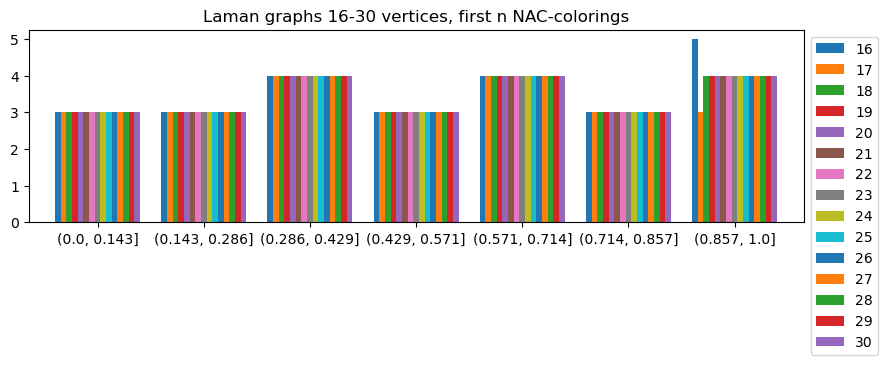

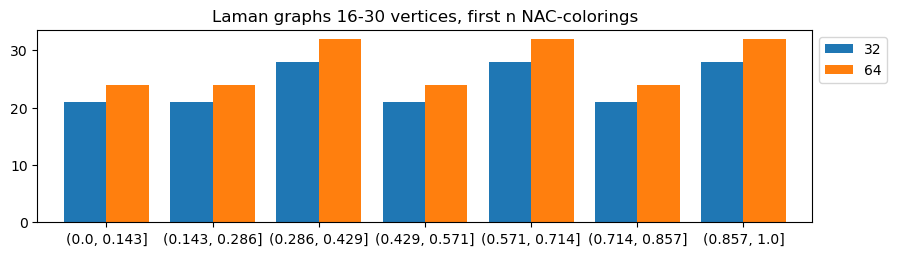

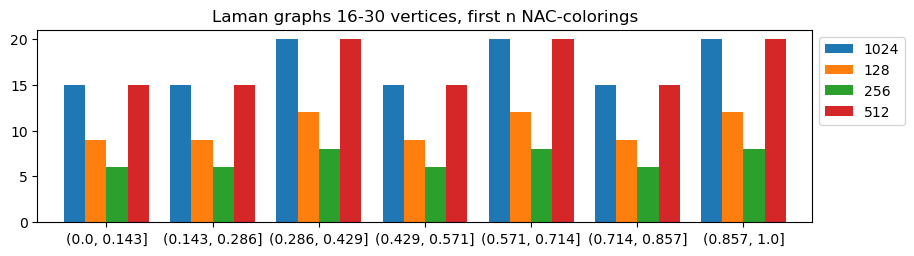

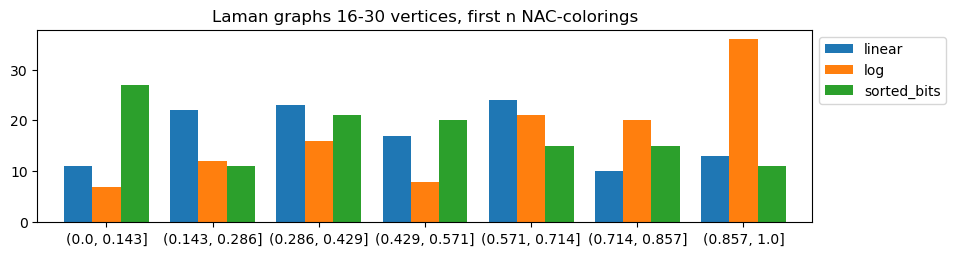

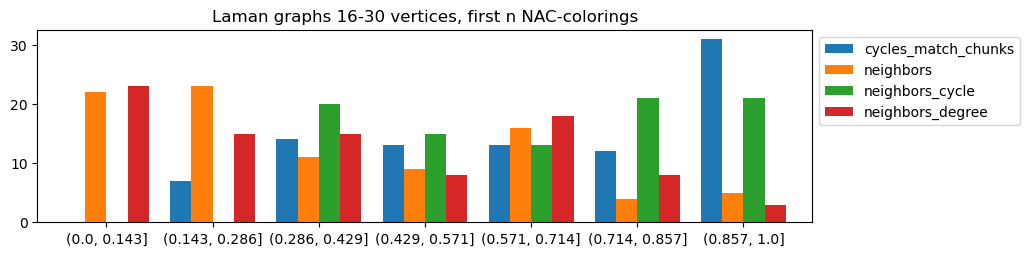

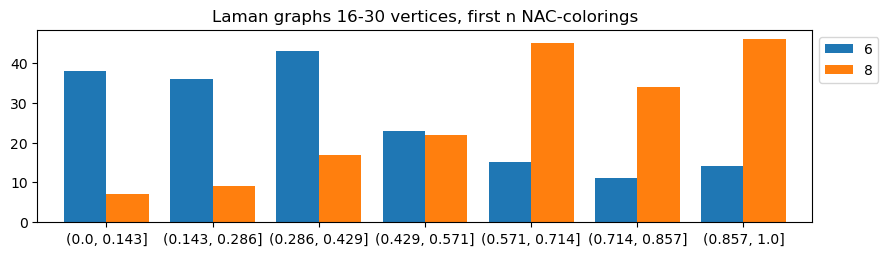

In [14]:
input = """
test_bench_NAC_colorings_laman_large_first_n[16-64-1024-random-subgraphs-sorted_bits-neighbors_degree-6-smart]         4.3212 (1.97)      4.3745 (1.81)      4.3418 (1.90)     0.0286 (inf)       4.3297 (1.92)      0.0399 (inf)           1;0  0.2303 (0.53)          3           1
test_bench_NAC_colorings_laman_large_first_n[16-64-1024-random-subgraphs-log-neighbors_degree-6-smart]                 4.4200 (2.02)      4.4730 (1.85)      4.4511 (1.95)     0.0276 (inf)       4.4603 (1.97)      0.0397 (inf)           1;0  0.2247 (0.51)          3           1
test_bench_NAC_colorings_laman_large_first_n[16-64-1024-random-subgraphs-linear-neighbors-6-smart]                     4.3691 (2.00)      4.5488 (1.89)      4.4672 (1.95)     0.0910 (inf)       4.4838 (1.99)      0.1348 (inf)           1;0  0.2239 (0.51)          3           1
test_bench_NAC_colorings_laman_large_first_n[16-64-1024-random-subgraphs-log-neighbors-6-smart]                        4.4320 (2.02)      4.6131 (1.91)      4.5019 (1.97)     0.0974 (inf)       4.4606 (1.97)      0.1358 (inf)           1;0  0.2221 (0.51)          3           1
test_bench_NAC_colorings_laman_large_first_n[16-64-1024-random-subgraphs-sorted_bits-neighbors_degree-8-smart]         4.5186 (2.06)      4.6603 (1.93)      4.5846 (2.01)     0.0713 (inf)       4.5750 (2.03)      0.1063 (inf)           1;0  0.2181 (0.50)          3           1
test_bench_NAC_colorings_laman_large_first_n[16-64-1024-random-subgraphs-sorted_bits-neighbors-6-smart]                4.6092 (2.11)      4.7081 (1.95)      4.6480 (2.03)     0.0528 (inf)       4.6266 (2.05)      0.0742 (inf)           1;0  0.2151 (0.49)          3           1
test_bench_NAC_colorings_laman_large_first_n[16-64-1024-random-subgraphs-log-neighbors_cycle-6-smart]                  4.6098 (2.11)      4.7851 (1.98)      4.6805 (2.05)     0.0924 (inf)       4.6466 (2.06)      0.1315 (inf)           1;0  0.2137 (0.49)          3           1
test_bench_NAC_colorings_laman_large_first_n[16-64-1024-random-subgraphs-linear-neighbors_degree-6-smart]              4.6880 (2.14)      4.6954 (1.95)      4.6908 (2.05)     0.0040 (inf)       4.6891 (2.08)      0.0055 (inf)           1;0  0.2132 (0.49)          3           1
test_bench_NAC_colorings_laman_large_first_n[16-64-1024-random-subgraphs-linear-neighbors_degree-8-smart]              4.6629 (2.13)      4.7557 (1.97)      4.6960 (2.05)     0.0518 (inf)       4.6696 (2.07)      0.0696 (inf)           1;0  0.2129 (0.49)          3           1
test_bench_NAC_colorings_laman_large_first_n[16-64-1024-random-subgraphs-log-neighbors_degree-8-smart]                 4.6910 (2.14)      4.8200 (2.00)      4.7383 (2.07)     0.0711 (inf)       4.7040 (2.08)      0.0968 (inf)           1;0  0.2110 (0.48)          3           1
test_bench_NAC_colorings_laman_large_first_n[16-64-1024-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]          4.7116 (2.15)      4.7868 (1.98)      4.7398 (2.07)     0.0410 (inf)       4.7210 (2.09)      0.0565 (inf)           1;0  0.2110 (0.48)          3           1
test_bench_NAC_colorings_laman_large_first_n[16-64-1024-random-subgraphs-linear-neighbors_cycle-6-smart]               4.7260 (2.16)      4.8272 (2.00)      4.7603 (2.08)     0.0580 (inf)       4.7277 (2.09)      0.0759 (inf)           1;0  0.2101 (0.48)          3           1
test_bench_NAC_colorings_laman_large_first_n[16-64-1024-random-subgraphs-log-neighbors-8-smart]                        4.6024 (2.10)      4.8424 (2.01)      4.7621 (2.08)     0.1383 (inf)       4.8414 (2.14)      0.1800 (inf)           1;0  0.2100 (0.48)          3           1
test_bench_NAC_colorings_laman_large_first_n[16-64-1024-random-subgraphs-linear-neighbors-8-smart]                     4.6027 (2.10)      4.9222 (2.04)      4.7952 (2.10)     0.1695 (inf)       4.8606 (2.15)      0.2396 (inf)           1;0  0.2085 (0.48)          3           1
test_bench_NAC_colorings_laman_large_first_n[16-64-1024-random-subgraphs-sorted_bits-neighbors-8-smart]                4.6972 (2.15)      4.9494 (2.05)      4.8458 (2.12)     0.1320 (inf)       4.8909 (2.17)      0.1891 (inf)           1;0  0.2064 (0.47)          3           1
test_bench_NAC_colorings_laman_large_first_n[16-64-1024-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]      4.8773 (2.23)      4.9796 (2.06)      4.9298 (2.16)     0.0512 (inf)       4.9324 (2.18)      0.0767 (inf)           1;0  0.2028 (0.46)          3           1
test_bench_NAC_colorings_laman_large_first_n[16-64-1024-random-subgraphs-log-cycles_match_chunks-6-smart]              4.8279 (2.21)      5.1558 (2.14)      5.0020 (2.19)     0.1649 (inf)       5.0223 (2.22)      0.2459 (inf)           1;0  0.1999 (0.46)          3           1
test_bench_NAC_colorings_laman_large_first_n[16-64-1024-random-subgraphs-linear-neighbors_cycle-8-smart]               4.9296 (2.25)      5.0673 (2.10)      5.0123 (2.19)     0.0729 (inf)       5.0400 (2.23)      0.1033 (inf)           1;0  0.1995 (0.46)          3           1
test_bench_NAC_colorings_laman_large_first_n[16-64-1024-random-subgraphs-linear-cycles_match_chunks-6-smart]           4.9306 (2.25)      5.0649 (2.10)      5.0174 (2.19)     0.0753 (inf)       5.0567 (2.24)      0.1007 (inf)           1;0  0.1993 (0.46)          3           1
test_bench_NAC_colorings_laman_large_first_n[16-64-1024-random-subgraphs-sorted_bits-neighbors_cycle-8-smart]          4.9095 (2.24)      5.1475 (2.13)      5.0317 (2.20)     0.1191 (inf)       5.0380 (2.23)      0.1785 (inf)           1;0  0.1987 (0.45)          3           1
test_bench_NAC_colorings_laman_large_first_n[16-64-1024-random-subgraphs-log-neighbors_cycle-8-smart]                  4.9302 (2.25)      5.1366 (2.13)      5.0383 (2.20)     0.1036 (inf)       5.0481 (2.24)      0.1549 (inf)           1;0  0.1985 (0.45)          3           1
test_bench_NAC_colorings_laman_large_first_n[16-64-1024-random-subgraphs-log-cycles_match_chunks-8-smart]              4.9155 (2.25)      5.4320 (2.25)      5.1419 (2.25)     0.2641 (inf)       5.0782 (2.25)      0.3874 (inf)           1;0  0.1945 (0.44)          3           1
test_bench_NAC_colorings_laman_large_first_n[16-64-1024-random-subgraphs-linear-cycles_match_chunks-8-smart]           4.9619 (2.27)      5.4371 (2.25)      5.1712 (2.26)     0.2426 (inf)       5.1147 (2.26)      0.3564 (inf)           1;0  0.1934 (0.44)          3           1
test_bench_NAC_colorings_laman_large_first_n[16-64-1024-random-subgraphs-sorted_bits-cycles_match_chunks-8-smart]      5.0678 (2.32)      5.2470 (2.18)      5.1785 (2.26)     0.0968 (inf)       5.2205 (2.31)      0.1344 (inf)           1;0  0.1931 (0.44)          3           1

test_bench_NAC_colorings_laman_large_first_n[17-64-1024-random-subgraphs-sorted_bits-neighbors_degree-6-smart]         5.2505 (2.40)      5.3245 (2.21)      5.2818 (2.31)     0.0383 (inf)       5.2704 (2.33)      0.0555 (inf)           1;0  0.1893 (0.43)          3           1
test_bench_NAC_colorings_laman_large_first_n[17-64-1024-random-subgraphs-sorted_bits-neighbors_degree-8-smart]         5.3285 (2.43)      5.4205 (2.25)      5.3604 (2.34)     0.0521 (inf)       5.3322 (2.36)      0.0690 (inf)           1;0  0.1866 (0.43)          3           1
test_bench_NAC_colorings_laman_large_first_n[17-64-1024-random-subgraphs-log-neighbors-6-smart]                        5.3662 (2.45)      5.4814 (2.27)      5.4087 (2.37)     0.0633 (inf)       5.3784 (2.38)      0.0864 (inf)           1;0  0.1849 (0.42)          3           1
test_bench_NAC_colorings_laman_large_first_n[17-64-1024-random-subgraphs-log-neighbors_degree-6-smart]                 5.4474 (2.49)      5.5379 (2.30)      5.4957 (2.40)     0.0456 (inf)       5.5017 (2.44)      0.0679 (inf)           1;0  0.1820 (0.42)          3           1
test_bench_NAC_colorings_laman_large_first_n[17-64-1024-random-subgraphs-linear-neighbors-6-smart]                     5.4645 (2.50)      5.5466 (2.30)      5.4961 (2.40)     0.0441 (inf)       5.4774 (2.43)      0.0615 (inf)           1;0  0.1819 (0.42)          3           1
test_bench_NAC_colorings_laman_large_first_n[17-64-1024-random-subgraphs-linear-neighbors_degree-8-smart]              5.5580 (2.54)      5.7250 (2.37)      5.6245 (2.46)     0.0886 (inf)       5.5905 (2.48)      0.1253 (inf)           1;0  0.1778 (0.41)          3           1
test_bench_NAC_colorings_laman_large_first_n[17-64-1024-random-subgraphs-log-neighbors_degree-8-smart]                 5.6345 (2.57)      5.6824 (2.36)      5.6522 (2.47)     0.0263 (inf)       5.6396 (2.50)      0.0359 (inf)           1;0  0.1769 (0.40)          3           1
test_bench_NAC_colorings_laman_large_first_n[17-64-1024-random-subgraphs-sorted_bits-neighbors-8-smart]                5.5618 (2.54)      5.7360 (2.38)      5.6607 (2.48)     0.0894 (inf)       5.6842 (2.52)      0.1306 (inf)           1;0  0.1767 (0.40)          3           1
test_bench_NAC_colorings_laman_large_first_n[17-64-1024-random-subgraphs-linear-neighbors-8-smart]                     5.6465 (2.58)      5.7730 (2.39)      5.7207 (2.50)     0.0660 (inf)       5.7426 (2.54)      0.0948 (inf)           1;0  0.1748 (0.40)          3           1
test_bench_NAC_colorings_laman_large_first_n[17-64-1024-random-subgraphs-log-neighbors-8-smart]                        5.6343 (2.57)      5.8569 (2.43)      5.7463 (2.51)     0.1113 (inf)       5.7478 (2.54)      0.1670 (inf)           1;0  0.1740 (0.40)          3           1
test_bench_NAC_colorings_laman_large_first_n[17-64-1024-random-subgraphs-log-neighbors_cycle-6-smart]                  5.7435 (2.62)      5.8550 (2.43)      5.7994 (2.54)     0.0558 (inf)       5.7996 (2.57)      0.0836 (inf)           1;0  0.1724 (0.39)          3           1
test_bench_NAC_colorings_laman_large_first_n[17-64-1024-random-subgraphs-sorted_bits-neighbors-6-smart]                5.7602 (2.63)      5.9633 (2.47)      5.8440 (2.56)     0.1061 (inf)       5.8087 (2.57)      0.1523 (inf)           1;0  0.1711 (0.39)          3           1
test_bench_NAC_colorings_laman_large_first_n[17-64-1024-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]          5.8287 (2.66)      5.8595 (2.43)      5.8490 (2.56)     0.0175 (inf)       5.8587 (2.59)      0.0231 (inf)           1;0  0.1710 (0.39)          3           1
test_bench_NAC_colorings_laman_large_first_n[17-64-1024-random-subgraphs-linear-neighbors_degree-6-smart]              5.5575 (2.54)      6.0944 (2.53)      5.8738 (2.57)     0.2809 (inf)       5.9693 (2.64)      0.4027 (inf)           1;0  0.1702 (0.39)          3           1
test_bench_NAC_colorings_laman_large_first_n[17-64-1024-random-subgraphs-linear-neighbors_cycle-6-smart]               5.8190 (2.66)      5.9252 (2.46)      5.8757 (2.57)     0.0535 (inf)       5.8829 (2.60)      0.0796 (inf)           1;0  0.1702 (0.39)          3           1
test_bench_NAC_colorings_laman_large_first_n[17-64-1024-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]      5.8809 (2.69)      6.1391 (2.55)      5.9683 (2.61)     0.1479 (inf)       5.8849 (2.61)      0.1937 (inf)           1;0  0.1676 (0.38)          3           1
test_bench_NAC_colorings_laman_large_first_n[17-64-1024-random-subgraphs-linear-neighbors_cycle-8-smart]               5.9489 (2.72)      6.0352 (2.50)      5.9956 (2.62)     0.0436 (inf)       6.0026 (2.66)      0.0648 (inf)           1;0  0.1668 (0.38)          3           1
test_bench_NAC_colorings_laman_large_first_n[17-64-1024-random-subgraphs-log-cycles_match_chunks-6-smart]              5.8740 (2.68)      6.1523 (2.55)      5.9982 (2.62)     0.1416 (inf)       5.9682 (2.64)      0.2087 (inf)           1;0  0.1667 (0.38)          3           1
test_bench_NAC_colorings_laman_large_first_n[17-64-1024-random-subgraphs-log-neighbors_cycle-8-smart]                  6.0312 (2.76)      6.0642 (2.51)      6.0505 (2.65)     0.0173 (inf)       6.0563 (2.68)      0.0248 (inf)           1;0  0.1653 (0.38)          3           1
test_bench_NAC_colorings_laman_large_first_n[17-64-1024-random-subgraphs-sorted_bits-neighbors_cycle-8-smart]          5.9929 (2.74)      6.1914 (2.57)      6.0730 (2.66)     0.1047 (inf)       6.0346 (2.67)      0.1489 (inf)           1;0  0.1647 (0.38)          3           1
test_bench_NAC_colorings_laman_large_first_n[17-64-1024-random-subgraphs-linear-cycles_match_chunks-8-smart]           6.0632 (2.77)      6.0869 (2.52)      6.0771 (2.66)     0.0124 (inf)       6.0813 (2.69)      0.0178 (inf)           1;0  0.1646 (0.38)          3           1
test_bench_NAC_colorings_laman_large_first_n[16-64-1024-random-subgraphs-log-cycles_match_chunks-8-smart]              6.0317 (2.76)      6.1477 (2.55)      6.0871 (2.66)     0.0582 (inf)       6.0819 (2.69)      0.0870 (inf)           1;0  0.1643 (0.38)          3           1
test_bench_NAC_colorings_laman_large_first_n[17-64-1024-random-subgraphs-sorted_bits-cycles_match_chunks-8-smart]      6.0089 (2.75)      6.1572 (2.55)      6.0902 (2.66)     0.0752 (inf)       6.1046 (2.70)      0.1112 (inf)           1;0  0.1642 (0.38)          3           1
test_bench_NAC_colorings_laman_large_first_n[17-64-1024-random-subgraphs-linear-cycles_match_chunks-6-smart]           5.9677 (2.73)      6.2780 (2.60)      6.1138 (2.67)     0.1559 (inf)       6.0958 (2.70)      0.2327 (inf)           1;0  0.1636 (0.37)          3           1

test_bench_NAC_colorings_laman_large_first_n[18-64-1024-random-subgraphs-sorted_bits-neighbors_degree-6-smart]         4.7336 (2.16)      4.8051 (1.99)      4.7782 (2.09)     0.0389 (inf)       4.7960 (2.12)      0.0537 (inf)           1;0  0.2093 (0.48)          3           1
test_bench_NAC_colorings_laman_large_first_n[18-64-1024-random-subgraphs-log-neighbors_degree-6-smart]                 4.6714 (2.13)      5.0696 (2.10)      4.8255 (2.11)     0.2138 (inf)       4.7355 (2.10)      0.2986 (inf)           1;0  0.2072 (0.47)          3           1
test_bench_NAC_colorings_laman_large_first_n[18-64-1024-random-subgraphs-log-neighbors-6-smart]                        4.8507 (2.22)      5.0316 (2.09)      4.9524 (2.17)     0.0925 (inf)       4.9749 (2.20)      0.1357 (inf)           1;0  0.2019 (0.46)          3           1
test_bench_NAC_colorings_laman_large_first_n[18-64-1024-random-subgraphs-linear-neighbors-6-smart]                     4.8838 (2.23)      5.1394 (2.13)      4.9747 (2.18)     0.1428 (inf)       4.9010 (2.17)      0.1917 (inf)           1;0  0.2010 (0.46)          3           1
test_bench_NAC_colorings_laman_large_first_n[18-64-1024-random-subgraphs-linear-neighbors_degree-6-smart]              4.8570 (2.22)      5.5791 (2.31)      5.1200 (2.24)     0.3990 (inf)       4.9239 (2.18)      0.5416 (inf)           1;0  0.1953 (0.45)          3           1
test_bench_NAC_colorings_laman_large_first_n[18-64-1024-random-subgraphs-sorted_bits-neighbors-6-smart]                4.9432 (2.26)      5.3570 (2.22)      5.1478 (2.25)     0.2070 (inf)       5.1433 (2.28)      0.3104 (inf)           1;0  0.1943 (0.44)          3           1
test_bench_NAC_colorings_laman_large_first_n[18-64-1024-random-subgraphs-log-neighbors_cycle-6-smart]                  5.2204 (2.39)      5.3562 (2.22)      5.2697 (2.30)     0.0752 (inf)       5.2326 (2.32)      0.1019 (inf)           1;0  0.1898 (0.43)          3           1
test_bench_NAC_colorings_laman_large_first_n[18-64-1024-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]      5.4009 (2.47)      5.5873 (2.32)      5.4903 (2.40)     0.0935 (inf)       5.4826 (2.43)      0.1398 (inf)           1;0  0.1821 (0.42)          3           1
test_bench_NAC_colorings_laman_large_first_n[18-64-1024-random-subgraphs-linear-neighbors_cycle-6-smart]               5.4103 (2.47)      5.6407 (2.34)      5.5386 (2.42)     0.1174 (inf)       5.5648 (2.46)      0.1728 (inf)           1;0  0.1806 (0.41)          3           1
test_bench_NAC_colorings_laman_large_first_n[18-64-1024-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]          5.5457 (2.53)      5.6181 (2.33)      5.5827 (2.44)     0.0362 (inf)       5.5843 (2.47)      0.0543 (inf)           1;0  0.1791 (0.41)          3           1
test_bench_NAC_colorings_laman_large_first_n[18-64-1024-random-subgraphs-linear-cycles_match_chunks-6-smart]           5.4772 (2.50)      5.7028 (2.36)      5.6001 (2.45)     0.1142 (inf)       5.6203 (2.49)      0.1692 (inf)           1;0  0.1786 (0.41)          3           1
test_bench_NAC_colorings_laman_large_first_n[18-64-1024-random-subgraphs-sorted_bits-neighbors_degree-8-smart]         5.9255 (2.71)      6.1030 (2.53)      6.0293 (2.64)     0.0925 (inf)       6.0595 (2.68)      0.1331 (inf)           1;0  0.1659 (0.38)          3           1
test_bench_NAC_colorings_laman_large_first_n[18-64-1024-random-subgraphs-sorted_bits-neighbors-8-smart]                6.0388 (2.76)      6.2628 (2.60)      6.1452 (2.69)     0.1124 (inf)       6.1341 (2.72)      0.1680 (inf)           1;0  0.1627 (0.37)          3           1
test_bench_NAC_colorings_laman_large_first_n[18-64-1024-random-subgraphs-log-neighbors_degree-8-smart]                 6.1051 (2.79)      6.2567 (2.59)      6.1735 (2.70)     0.0769 (inf)       6.1586 (2.73)      0.1137 (inf)           1;0  0.1620 (0.37)          3           1
test_bench_NAC_colorings_laman_large_first_n[18-64-1024-random-subgraphs-linear-neighbors-8-smart]                     6.1839 (2.83)      6.2591 (2.59)      6.2150 (2.72)     0.0393 (inf)       6.2019 (2.75)      0.0564 (inf)           1;0  0.1609 (0.37)          3           1
test_bench_NAC_colorings_laman_large_first_n[18-64-1024-random-subgraphs-log-neighbors-8-smart]                        6.0636 (2.77)      6.3950 (2.65)      6.2161 (2.72)     0.1672 (inf)       6.1898 (2.74)      0.2485 (inf)           1;0  0.1609 (0.37)          3           1
test_bench_NAC_colorings_laman_large_first_n[18-64-1024-random-subgraphs-linear-neighbors_degree-8-smart]              6.2439 (2.85)      6.3891 (2.65)      6.2957 (2.75)     0.0811 (inf)       6.2541 (2.77)      0.1090 (inf)           1;0  0.1588 (0.36)          3           1
test_bench_NAC_colorings_laman_large_first_n[18-64-1024-random-subgraphs-log-cycles_match_chunks-6-smart]              5.8583 (2.68)      6.9873 (2.90)      6.3968 (2.80)     0.5663 (inf)       6.3447 (2.81)      0.8468 (inf)           1;0  0.1563 (0.36)          3           1
test_bench_NAC_colorings_laman_large_first_n[18-64-1024-random-subgraphs-linear-neighbors_cycle-8-smart]               6.2993 (2.88)      6.6780 (2.77)      6.4606 (2.83)     0.1955 (inf)       6.4044 (2.84)      0.2841 (inf)           1;0  0.1548 (0.35)          3           1
test_bench_NAC_colorings_laman_large_first_n[18-64-1024-random-subgraphs-log-neighbors_cycle-8-smart]                  6.3771 (2.91)      6.5846 (2.73)      6.4719 (2.83)     0.1049 (inf)       6.4540 (2.86)      0.1556 (inf)           1;0  0.1545 (0.35)          3           1
test_bench_NAC_colorings_laman_large_first_n[18-64-1024-random-subgraphs-sorted_bits-neighbors_cycle-8-smart]          6.4601 (2.95)      6.7126 (2.78)      6.5740 (2.88)     0.1280 (inf)       6.5493 (2.90)      0.1894 (inf)           1;0  0.1521 (0.35)          3           1
test_bench_NAC_colorings_laman_large_first_n[18-64-1024-random-subgraphs-sorted_bits-cycles_match_chunks-8-smart]      6.6027 (3.02)      7.0218 (2.91)      6.8372 (2.99)     0.2139 (inf)       6.8869 (3.05)      0.3143 (inf)           1;0  0.1463 (0.33)          3           1
test_bench_NAC_colorings_laman_large_first_n[18-64-1024-random-subgraphs-linear-cycles_match_chunks-8-smart]           6.3444 (2.90)      8.0158 (3.32)      7.0885 (3.10)     0.8506 (inf)       6.9053 (3.06)      1.2535 (inf)           1;0  0.1411 (0.32)          3           1
test_bench_NAC_colorings_laman_large_first_n[18-64-1024-random-subgraphs-log-cycles_match_chunks-8-smart]              6.9718 (3.19)      8.4822 (3.52)      7.6194 (3.33)     0.7779 (inf)       7.4043 (3.28)      1.1328 (inf)           1;0  0.1312 (0.30)          3           1

test_bench_NAC_colorings_laman_large_first_n[19-64-1024-random-subgraphs-sorted_bits-neighbors_degree-6-smart]         6.7599 (3.09)      7.0963 (2.94)      6.9484 (3.04)     0.1719 (inf)       6.9892 (3.09)      0.2523 (inf)           1;0  0.1439 (0.33)          3           1
test_bench_NAC_colorings_laman_large_first_n[19-64-1024-random-subgraphs-log-neighbors-6-smart]                        7.1005 (3.24)      7.3813 (3.06)      7.2279 (3.16)     0.1422 (inf)       7.2020 (3.19)      0.2106 (inf)           1;0  0.1384 (0.32)          3           1
test_bench_NAC_colorings_laman_large_first_n[19-64-1024-random-subgraphs-linear-neighbors-6-smart]                     7.1161 (3.25)      7.3339 (3.04)      7.2394 (3.17)     0.1117 (inf)       7.2682 (3.22)      0.1634 (inf)           1;0  0.1381 (0.32)          3           1
test_bench_NAC_colorings_laman_large_first_n[19-64-1024-random-subgraphs-sorted_bits-neighbors-6-smart]                7.2925 (3.33)      7.3197 (3.03)      7.3031 (3.19)     0.0145 (inf)       7.2972 (3.23)      0.0204 (inf)           1;0  0.1369 (0.31)          3           1
test_bench_NAC_colorings_laman_large_first_n[19-64-1024-random-subgraphs-log-neighbors_degree-6-smart]                 7.4173 (3.39)      7.4637 (3.09)      7.4467 (3.26)     0.0256 (inf)       7.4591 (3.30)      0.0349 (inf)           1;0  0.1343 (0.31)          3           1
test_bench_NAC_colorings_laman_large_first_n[19-64-1024-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]      7.3489 (3.36)      7.6816 (3.18)      7.5094 (3.28)     0.1666 (inf)       7.4977 (3.32)      0.2495 (inf)           1;0  0.1332 (0.30)          3           1
test_bench_NAC_colorings_laman_large_first_n[19-64-1024-random-subgraphs-linear-neighbors_degree-6-smart]              7.5387 (3.44)      7.7554 (3.22)      7.6197 (3.33)     0.1183 (inf)       7.5650 (3.35)      0.1625 (inf)           1;0  0.1312 (0.30)          3           1
test_bench_NAC_colorings_laman_large_first_n[19-64-1024-random-subgraphs-log-cycles_match_chunks-6-smart]              7.5426 (3.45)      7.7462 (3.21)      7.6643 (3.35)     0.1075 (inf)       7.7042 (3.41)      0.1527 (inf)           1;0  0.1305 (0.30)          3           1
test_bench_NAC_colorings_laman_large_first_n[19-64-1024-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]          7.6551 (3.50)      7.7576 (3.22)      7.7102 (3.37)     0.0517 (inf)       7.7178 (3.42)      0.0769 (inf)           1;0  0.1297 (0.30)          3           1
test_bench_NAC_colorings_laman_large_first_n[19-64-1024-random-subgraphs-linear-neighbors_cycle-6-smart]               7.6498 (3.49)      7.9461 (3.29)      7.7776 (3.40)     0.1522 (inf)       7.7371 (3.43)      0.2222 (inf)           1;0  0.1286 (0.29)          3           1
test_bench_NAC_colorings_laman_large_first_n[19-64-1024-random-subgraphs-linear-cycles_match_chunks-6-smart]           7.6950 (3.52)      7.9334 (3.29)      7.8004 (3.41)     0.1215 (inf)       7.7729 (3.44)      0.1788 (inf)           1;0  0.1282 (0.29)          3           1
test_bench_NAC_colorings_laman_large_first_n[19-64-1024-random-subgraphs-log-neighbors_cycle-6-smart]                  7.7505 (3.54)      8.0472 (3.34)      7.8647 (3.44)     0.1597 (inf)       7.7964 (3.45)      0.2225 (inf)           1;0  0.1272 (0.29)          3           1
test_bench_NAC_colorings_laman_large_first_n[19-64-1024-random-subgraphs-sorted_bits-neighbors_degree-8-smart]         8.3332 (3.81)      8.6897 (3.60)      8.5566 (3.74)     0.1946 (inf)       8.6469 (3.83)      0.2673 (inf)           1;0  0.1169 (0.27)          3           1
test_bench_NAC_colorings_laman_large_first_n[19-64-1024-random-subgraphs-sorted_bits-neighbors-8-smart]                8.8731 (4.05)      8.9346 (3.70)      8.8949 (3.89)     0.0344 (inf)       8.8771 (3.93)      0.0462 (inf)           1;0  0.1124 (0.26)          3           1
test_bench_NAC_colorings_laman_large_first_n[19-64-1024-random-subgraphs-linear-neighbors-8-smart]                     8.5688 (3.91)      9.2196 (3.82)      8.9330 (3.91)     0.3323 (inf)       9.0108 (3.99)      0.4881 (inf)           1;0  0.1119 (0.26)          3           1
test_bench_NAC_colorings_laman_large_first_n[19-64-1024-random-subgraphs-linear-neighbors_degree-8-smart]              8.8044 (4.02)      9.1560 (3.80)      8.9872 (3.93)     0.1762 (inf)       9.0012 (3.99)      0.2637 (inf)           1;0  0.1113 (0.25)          3           1
test_bench_NAC_colorings_laman_large_first_n[19-64-1024-random-subgraphs-log-neighbors_degree-8-smart]                 8.8606 (4.05)      9.2261 (3.82)      9.0202 (3.94)     0.1871 (inf)       8.9738 (3.97)      0.2741 (inf)           1;0  0.1109 (0.25)          3           1
test_bench_NAC_colorings_laman_large_first_n[19-64-1024-random-subgraphs-sorted_bits-cycles_match_chunks-8-smart]      9.0324 (4.13)      9.3150 (3.86)      9.1467 (4.00)     0.1488 (inf)       9.0928 (4.03)      0.2119 (inf)           1;0  0.1093 (0.25)          3           1
test_bench_NAC_colorings_laman_large_first_n[19-64-1024-random-subgraphs-log-neighbors-8-smart]                        8.9894 (4.11)      9.3478 (3.88)      9.2199 (4.03)     0.2001 (inf)       9.3226 (4.13)      0.2688 (inf)           1;0  0.1085 (0.25)          3           1
test_bench_NAC_colorings_laman_large_first_n[19-64-1024-random-subgraphs-sorted_bits-neighbors_cycle-8-smart]          9.1307 (4.17)      9.4014 (3.90)      9.2568 (4.05)     0.1363 (inf)       9.2382 (4.09)      0.2030 (inf)           1;0  0.1080 (0.25)          3           1
test_bench_NAC_colorings_laman_large_first_n[19-64-1024-random-subgraphs-linear-cycles_match_chunks-8-smart]           9.2209 (4.21)      9.4762 (3.93)      9.3580 (4.09)     0.1287 (inf)       9.3768 (4.15)      0.1915 (inf)           1;0  0.1069 (0.24)          3           1
test_bench_NAC_colorings_laman_large_first_n[19-64-1024-random-subgraphs-log-cycles_match_chunks-8-smart]              9.1504 (4.18)      9.5619 (3.96)      9.3793 (4.10)     0.2096 (inf)       9.4256 (4.17)      0.3086 (inf)           1;0  0.1066 (0.24)          3           1
test_bench_NAC_colorings_laman_large_first_n[19-64-1024-random-subgraphs-linear-neighbors_cycle-8-smart]               9.3978 (4.29)      9.6079 (3.98)      9.4817 (4.15)     0.1112 (inf)       9.4396 (4.18)      0.1576 (inf)           1;0  0.1055 (0.24)          3           1
test_bench_NAC_colorings_laman_large_first_n[19-64-1024-random-subgraphs-log-neighbors_cycle-8-smart]                  9.2940 (4.25)      9.7597 (4.05)      9.5098 (4.16)     0.2347 (inf)       9.4759 (4.20)      0.3493 (inf)           1;0  0.1052 (0.24)          3           1

test_bench_NAC_colorings_laman_large_first_n[20-64-1024-random-subgraphs-sorted_bits-neighbors_degree-6-smart]         7.8703 (3.60)      8.1801 (3.39)      8.0182 (3.51)     0.1554 (inf)       8.0042 (3.54)      0.2323 (inf)           1;0  0.1247 (0.29)          3           1
test_bench_NAC_colorings_laman_large_first_n[20-64-1024-random-subgraphs-linear-neighbors-6-smart]                     7.8640 (3.59)      8.4247 (3.49)      8.1214 (3.55)     0.2831 (inf)       8.0757 (3.58)      0.4205 (inf)           1;0  0.1231 (0.28)          3           1
test_bench_NAC_colorings_laman_large_first_n[20-64-1024-random-subgraphs-log-neighbors-6-smart]                        8.0449 (3.68)      8.5452 (3.54)      8.2467 (3.61)     0.2638 (inf)       8.1500 (3.61)      0.3753 (inf)           1;0  0.1213 (0.28)          3           1
test_bench_NAC_colorings_laman_large_first_n[20-64-1024-random-subgraphs-log-neighbors_degree-6-smart]                 7.8017 (3.56)      8.7699 (3.64)      8.3001 (3.63)     0.4847 (inf)       8.3288 (3.69)      0.7261 (inf)           1;0  0.1205 (0.28)          3           1
test_bench_NAC_colorings_laman_large_first_n[20-64-1024-random-subgraphs-sorted_bits-neighbors-6-smart]                8.2452 (3.77)      8.6176 (3.57)      8.4027 (3.67)     0.1927 (inf)       8.3451 (3.69)      0.2793 (inf)           1;0  0.1190 (0.27)          3           1
test_bench_NAC_colorings_laman_large_first_n[20-64-1024-random-subgraphs-log-cycles_match_chunks-6-smart]              8.1910 (3.74)      8.9269 (3.70)      8.4451 (3.69)     0.4174 (inf)       8.2175 (3.64)      0.5519 (inf)           1;0  0.1184 (0.27)          3           1
test_bench_NAC_colorings_laman_large_first_n[20-64-1024-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]      8.3745 (3.83)      8.9773 (3.72)      8.7264 (3.82)     0.3138 (inf)       8.8273 (3.91)      0.4521 (inf)           1;0  0.1146 (0.26)          3           1
test_bench_NAC_colorings_laman_large_first_n[20-64-1024-random-subgraphs-linear-cycles_match_chunks-6-smart]           8.3876 (3.83)      9.2819 (3.85)      8.8617 (3.88)     0.4496 (inf)       8.9154 (3.95)      0.6707 (inf)           1;0  0.1128 (0.26)          3           1
test_bench_NAC_colorings_laman_large_first_n[20-64-1024-random-subgraphs-log-neighbors_cycle-6-smart]                  8.6535 (3.95)      9.2216 (3.82)      8.9159 (3.90)     0.2865 (inf)       8.8727 (3.93)      0.4261 (inf)           1;0  0.1122 (0.26)          3           1
test_bench_NAC_colorings_laman_large_first_n[20-64-1024-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]          8.6765 (3.96)      9.1515 (3.79)      8.9655 (3.92)     0.2537 (inf)       9.0685 (4.02)      0.3563 (inf)           1;0  0.1115 (0.26)          3           1
test_bench_NAC_colorings_laman_large_first_n[20-64-1024-random-subgraphs-linear-neighbors_cycle-6-smart]               8.6507 (3.95)      9.2475 (3.83)      8.9665 (3.92)     0.2999 (inf)       9.0013 (3.99)      0.4475 (inf)           1;0  0.1115 (0.26)          3           1
test_bench_NAC_colorings_laman_large_first_n[20-64-1024-random-subgraphs-linear-neighbors_degree-6-smart]              8.4300 (3.85)      9.4285 (3.91)      9.0623 (3.96)     0.5499 (inf)       9.3284 (4.13)      0.7489 (inf)           1;0  0.1103 (0.25)          3           1
test_bench_NAC_colorings_laman_large_first_n[20-64-1024-random-subgraphs-linear-neighbors-8-smart]                    10.2006 (4.66)     11.2144 (4.65)     10.6316 (4.65)     0.5237 (inf)      10.4798 (4.64)      0.7604 (inf)           1;0  0.0941 (0.22)          3           1
test_bench_NAC_colorings_laman_large_first_n[20-64-1024-random-subgraphs-log-neighbors_degree-8-smart]                10.4052 (4.75)     10.9405 (4.54)     10.7502 (4.70)     0.2993 (inf)      10.9049 (4.83)      0.4015 (inf)           1;0  0.0930 (0.21)          3           1
test_bench_NAC_colorings_laman_large_first_n[20-64-1024-random-subgraphs-sorted_bits-neighbors_degree-8-smart]        10.6528 (4.87)     10.9048 (4.52)     10.8015 (4.72)     0.1320 (inf)      10.8468 (4.80)      0.1890 (inf)           1;0  0.0926 (0.21)          3           1
test_bench_NAC_colorings_laman_large_first_n[20-64-1024-random-subgraphs-sorted_bits-cycles_match_chunks-8-smart]     10.6767 (4.88)     11.0168 (4.57)     10.8063 (4.73)     0.1839 (inf)      10.7253 (4.75)      0.2551 (inf)           1;0  0.0925 (0.21)          3           1
test_bench_NAC_colorings_laman_large_first_n[20-64-1024-random-subgraphs-linear-cycles_match_chunks-8-smart]          10.6680 (4.87)     11.1811 (4.64)     10.8681 (4.75)     0.2746 (inf)      10.7551 (4.76)      0.3848 (inf)           1;0  0.0920 (0.21)          3           1
test_bench_NAC_colorings_laman_large_first_n[20-64-1024-random-subgraphs-linear-neighbors_degree-8-smart]             10.7486 (4.91)     11.5203 (4.78)     11.1437 (4.87)     0.3861 (inf)      11.1622 (4.94)      0.5787 (inf)           1;0  0.0897 (0.21)          3           1
test_bench_NAC_colorings_laman_large_first_n[20-64-1024-random-subgraphs-sorted_bits-neighbors_cycle-8-smart]         11.1573 (5.10)     11.4851 (4.76)     11.3653 (4.97)     0.1808 (inf)      11.4536 (5.07)      0.2458 (inf)           1;0  0.0880 (0.20)          3           1
test_bench_NAC_colorings_laman_large_first_n[20-64-1024-random-subgraphs-sorted_bits-neighbors-8-smart]               11.3081 (5.17)     11.4225 (4.74)     11.3752 (4.97)     0.0597 (inf)      11.3951 (5.05)      0.0858 (inf)           1;0  0.0879 (0.20)          3           1
test_bench_NAC_colorings_laman_large_first_n[20-64-1024-random-subgraphs-log-cycles_match_chunks-8-smart]             11.3341 (5.18)     11.5559 (4.79)     11.4568 (5.01)     0.1127 (inf)      11.4805 (5.08)      0.1663 (inf)           1;0  0.0873 (0.20)          3           1
test_bench_NAC_colorings_laman_large_first_n[20-64-1024-random-subgraphs-linear-neighbors_cycle-8-smart]              11.2383 (5.13)     11.8053 (4.89)     11.5164 (5.04)     0.2836 (inf)      11.5057 (5.09)      0.4252 (inf)           1;0  0.0868 (0.20)          3           1
test_bench_NAC_colorings_laman_large_first_n[20-64-1024-random-subgraphs-log-neighbors-8-smart]                       11.1173 (5.08)     11.9339 (4.95)     11.5222 (5.04)     0.4083 (inf)      11.5154 (5.10)      0.6124 (inf)           1;0  0.0868 (0.20)          3           1
test_bench_NAC_colorings_laman_large_first_n[20-64-1024-random-subgraphs-log-neighbors_cycle-8-smart]                 11.7392 (5.36)     12.4259 (5.15)     12.0366 (5.26)     0.3524 (inf)      11.9448 (5.29)      0.5150 (inf)           1;0  0.0831 (0.19)          3           1

test_bench_NAC_colorings_laman_large_first_n[21-64-512-random-subgraphs-sorted_bits-neighbors_degree-6-smart]          4.0123 (1.83)      4.3929 (1.82)      4.1641 (1.82)     0.2016 (inf)       4.0872 (1.81)      0.2855 (inf)           1;0  0.2401 (0.55)          3           1
test_bench_NAC_colorings_laman_large_first_n[21-64-512-random-subgraphs-linear-neighbors-6-smart]                      4.2441 (1.94)      4.6676 (1.94)      4.4082 (1.93)     0.2273 (inf)       4.3130 (1.91)      0.3177 (inf)           1;0  0.2268 (0.52)          3           1
test_bench_NAC_colorings_laman_large_first_n[21-64-512-random-subgraphs-sorted_bits-neighbors-6-smart]                 4.1563 (1.90)      4.7923 (1.99)      4.4370 (1.94)     0.3245 (inf)       4.3625 (1.93)      0.4770 (inf)           1;0  0.2254 (0.52)          3           1
test_bench_NAC_colorings_laman_large_first_n[21-64-512-random-subgraphs-log-neighbors-6-smart]                         4.4636 (2.04)      4.6464 (1.93)      4.5675 (2.00)     0.0939 (inf)       4.5925 (2.03)      0.1371 (inf)           1;0  0.2189 (0.50)          3           1
test_bench_NAC_colorings_laman_large_first_n[21-64-512-random-subgraphs-log-cycles_match_chunks-6-smart]               4.7182 (2.16)      5.2138 (2.16)      4.9612 (2.17)     0.2480 (inf)       4.9515 (2.19)      0.3717 (inf)           1;0  0.2016 (0.46)          3           1
test_bench_NAC_colorings_laman_large_first_n[21-64-512-random-subgraphs-log-neighbors_degree-6-smart]                  4.6576 (2.13)      5.5815 (2.31)      4.9843 (2.18)     0.5180 (inf)       4.7137 (2.09)      0.6929 (inf)           1;0  0.2006 (0.46)          3           1
test_bench_NAC_colorings_laman_large_first_n[21-64-512-random-subgraphs-linear-cycles_match_chunks-6-smart]            4.9653 (2.27)      5.0833 (2.11)      5.0390 (2.20)     0.0642 (inf)       5.0682 (2.24)      0.0885 (inf)           1;0  0.1985 (0.45)          3           1
test_bench_NAC_colorings_laman_large_first_n[21-64-512-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]       4.9662 (2.27)      5.1962 (2.15)      5.0602 (2.21)     0.1206 (inf)       5.0182 (2.22)      0.1725 (inf)           1;0  0.1976 (0.45)          3           1
test_bench_NAC_colorings_laman_large_first_n[21-64-512-random-subgraphs-linear-neighbors_degree-6-smart]               4.8312 (2.21)      5.2600 (2.18)      5.0657 (2.22)     0.2172 (inf)       5.1058 (2.26)      0.3216 (inf)           1;0  0.1974 (0.45)          3           1
test_bench_NAC_colorings_laman_large_first_n[21-64-512-random-subgraphs-linear-neighbors_cycle-6-smart]                5.0350 (2.30)      5.2538 (2.18)      5.1334 (2.25)     0.1111 (inf)       5.1114 (2.26)      0.1641 (inf)           1;0  0.1948 (0.45)          3           1
test_bench_NAC_colorings_laman_large_first_n[21-64-512-random-subgraphs-log-neighbors_cycle-6-smart]                   5.1500 (2.35)      5.3243 (2.21)      5.2530 (2.30)     0.0914 (inf)       5.2848 (2.34)      0.1307 (inf)           1;0  0.1904 (0.44)          3           1
test_bench_NAC_colorings_laman_large_first_n[21-64-512-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]           5.0290 (2.30)      5.7062 (2.37)      5.3248 (2.33)     0.3466 (inf)       5.2393 (2.32)      0.5080 (inf)           1;0  0.1878 (0.43)          3           1
test_bench_NAC_colorings_laman_large_first_n[21-64-512-random-subgraphs-linear-neighbors-8-smart]                      5.2304 (2.39)      5.5538 (2.30)      5.3416 (2.34)     0.1838 (inf)       5.2406 (2.32)      0.2425 (inf)           1;0  0.1872 (0.43)          3           1
test_bench_NAC_colorings_laman_large_first_n[21-64-512-random-subgraphs-sorted_bits-neighbors_degree-8-smart]          5.1787 (2.37)      5.5570 (2.30)      5.4231 (2.37)     0.2120 (inf)       5.5335 (2.45)      0.2837 (inf)           1;0  0.1844 (0.42)          3           1
test_bench_NAC_colorings_laman_large_first_n[21-64-512-random-subgraphs-sorted_bits-neighbors-8-smart]                 5.3622 (2.45)      5.5247 (2.29)      5.4243 (2.37)     0.0878 (inf)       5.3860 (2.38)      0.1219 (inf)           1;0  0.1844 (0.42)          3           1
test_bench_NAC_colorings_laman_large_first_n[21-64-512-random-subgraphs-log-neighbors_degree-8-smart]                  5.3853 (2.46)      5.6193 (2.33)      5.5383 (2.42)     0.1326 (inf)       5.6104 (2.48)      0.1755 (inf)           1;0  0.1806 (0.41)          3           1
test_bench_NAC_colorings_laman_large_first_n[21-64-512-random-subgraphs-linear-neighbors_degree-8-smart]               5.4810 (2.50)      6.2292 (2.58)      5.8930 (2.58)     0.3798 (inf)       5.9687 (2.64)      0.5612 (inf)           1;0  0.1697 (0.39)          3           1
test_bench_NAC_colorings_laman_large_first_n[21-64-512-random-subgraphs-linear-neighbors_cycle-8-smart]                6.1044 (2.79)      6.2921 (2.61)      6.2067 (2.71)     0.0950 (inf)       6.2236 (2.76)      0.1408 (inf)           1;0  0.1611 (0.37)          3           1
test_bench_NAC_colorings_laman_large_first_n[21-64-512-random-subgraphs-sorted_bits-cycles_match_chunks-8-smart]       6.3375 (2.90)      6.5004 (2.69)      6.3975 (2.80)     0.0895 (inf)       6.3547 (2.81)      0.1222 (inf)           1;0  0.1563 (0.36)          3           1
test_bench_NAC_colorings_laman_large_first_n[21-64-512-random-subgraphs-log-neighbors-8-smart]                         6.2832 (2.87)      6.6518 (2.76)      6.4068 (2.80)     0.2122 (inf)       6.2855 (2.78)      0.2765 (inf)           1;0  0.1561 (0.36)          3           1
test_bench_NAC_colorings_laman_large_first_n[21-64-512-random-subgraphs-sorted_bits-neighbors_cycle-8-smart]           6.2687 (2.86)      6.5464 (2.71)      6.4410 (2.82)     0.1504 (inf)       6.5079 (2.88)      0.2082 (inf)           1;0  0.1553 (0.35)          3           1
test_bench_NAC_colorings_laman_large_first_n[21-64-512-random-subgraphs-linear-cycles_match_chunks-8-smart]            6.3638 (2.91)      6.9013 (2.86)      6.6943 (2.93)     0.2893 (inf)       6.8178 (3.02)      0.4032 (inf)           1;0  0.1494 (0.34)          3           1
test_bench_NAC_colorings_laman_large_first_n[21-64-512-random-subgraphs-log-neighbors_cycle-8-smart]                   6.7998 (3.11)      7.2962 (3.02)      7.0227 (3.07)     0.2520 (inf)       6.9720 (3.09)      0.3723 (inf)           1;0  0.1424 (0.33)          3           1
test_bench_NAC_colorings_laman_large_first_n[21-64-512-random-subgraphs-log-cycles_match_chunks-8-smart]               6.6761 (3.05)      7.3629 (3.05)      7.0842 (3.10)     0.3612 (inf)       7.2135 (3.19)      0.5151 (inf)           1;0  0.1412 (0.32)          3           1

test_bench_NAC_colorings_laman_large_first_n[22-64-512-random-subgraphs-sorted_bits-neighbors_degree-6-smart]          3.6970 (1.69)      3.9873 (1.65)      3.7971 (1.66)     0.1648 (inf)       3.7069 (1.64)      0.2177 (inf)           1;0  0.2634 (0.60)          3           1
test_bench_NAC_colorings_laman_large_first_n[22-64-512-random-subgraphs-log-neighbors-6-smart]                         3.9270 (1.79)      4.2324 (1.75)      4.1024 (1.79)     0.1577 (inf)       4.1477 (1.84)      0.2290 (inf)           1;0  0.2438 (0.56)          3           1
test_bench_NAC_colorings_laman_large_first_n[22-64-512-random-subgraphs-linear-neighbors-6-smart]                      4.0911 (1.87)      4.2408 (1.76)      4.1488 (1.81)     0.0805 (inf)       4.1145 (1.82)      0.1123 (inf)           1;0  0.2410 (0.55)          3           1
test_bench_NAC_colorings_laman_large_first_n[22-64-512-random-subgraphs-sorted_bits-neighbors-6-smart]                 4.3373 (1.98)      5.1345 (2.13)      4.6820 (2.05)     0.4094 (inf)       4.5743 (2.03)      0.5979 (inf)           1;0  0.2136 (0.49)          3           1
test_bench_NAC_colorings_laman_large_first_n[22-64-512-random-subgraphs-linear-neighbors_degree-6-smart]               4.6610 (2.13)      4.9474 (2.05)      4.7725 (2.09)     0.1534 (inf)       4.7090 (2.08)      0.2148 (inf)           1;0  0.2095 (0.48)          3           1
test_bench_NAC_colorings_laman_large_first_n[22-64-512-random-subgraphs-log-neighbors_degree-6-smart]                  4.6667 (2.13)      4.9413 (2.05)      4.7772 (2.09)     0.1449 (inf)       4.7237 (2.09)      0.2060 (inf)           1;0  0.2093 (0.48)          3           1
test_bench_NAC_colorings_laman_large_first_n[22-64-512-random-subgraphs-log-neighbors_cycle-6-smart]                   5.0033 (2.29)      5.1644 (2.14)      5.0686 (2.22)     0.0847 (inf)       5.0381 (2.23)      0.1208 (inf)           1;0  0.1973 (0.45)          3           1
test_bench_NAC_colorings_laman_large_first_n[22-64-512-random-subgraphs-linear-neighbors_cycle-6-smart]                5.0615 (2.31)      5.2232 (2.17)      5.1374 (2.25)     0.0813 (inf)       5.1276 (2.27)      0.1213 (inf)           1;0  0.1946 (0.45)          3           1
test_bench_NAC_colorings_laman_large_first_n[22-64-512-random-subgraphs-linear-cycles_match_chunks-6-smart]            5.0392 (2.30)      5.2400 (2.17)      5.1643 (2.26)     0.1092 (inf)       5.2138 (2.31)      0.1506 (inf)           1;0  0.1936 (0.44)          3           1
test_bench_NAC_colorings_laman_large_first_n[22-64-512-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]       4.8936 (2.24)      5.4447 (2.26)      5.1924 (2.27)     0.2785 (inf)       5.2390 (2.32)      0.4134 (inf)           1;0  0.1926 (0.44)          3           1
test_bench_NAC_colorings_laman_large_first_n[22-64-512-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]           5.1928 (2.37)      5.6251 (2.33)      5.3894 (2.36)     0.2188 (inf)       5.3502 (2.37)      0.3242 (inf)           1;0  0.1856 (0.42)          3           1
test_bench_NAC_colorings_laman_large_first_n[22-64-512-random-subgraphs-log-cycles_match_chunks-6-smart]               5.0211 (2.29)      6.0269 (2.50)      5.4143 (2.37)     0.5376 (inf)       5.1947 (2.30)      0.7543 (inf)           1;0  0.1847 (0.42)          3           1
test_bench_NAC_colorings_laman_large_first_n[22-64-512-random-subgraphs-sorted_bits-neighbors_degree-8-smart]          6.3913 (2.92)      6.5921 (2.73)      6.4670 (2.83)     0.1091 (inf)       6.4175 (2.84)      0.1506 (inf)           1;0  0.1546 (0.35)          3           1
test_bench_NAC_colorings_laman_large_first_n[22-64-512-random-subgraphs-sorted_bits-neighbors-8-smart]                 6.6169 (3.02)      6.8269 (2.83)      6.6927 (2.93)     0.1166 (inf)       6.6342 (2.94)      0.1575 (inf)           1;0  0.1494 (0.34)          3           1
test_bench_NAC_colorings_laman_large_first_n[22-64-512-random-subgraphs-linear-neighbors-8-smart]                      6.6177 (3.02)      6.9965 (2.90)      6.8370 (2.99)     0.1964 (inf)       6.8970 (3.05)      0.2841 (inf)           1;0  0.1463 (0.33)          3           1
test_bench_NAC_colorings_laman_large_first_n[22-64-512-random-subgraphs-log-neighbors_degree-8-smart]                  6.8446 (3.13)      7.1532 (2.97)      7.0284 (3.07)     0.1625 (inf)       7.0874 (3.14)      0.2314 (inf)           1;0  0.1423 (0.33)          3           1
test_bench_NAC_colorings_laman_large_first_n[22-64-512-random-subgraphs-log-neighbors-8-smart]                         7.0976 (3.24)      7.3158 (3.03)      7.2420 (3.17)     0.1251 (inf)       7.3127 (3.24)      0.1636 (inf)           1;0  0.1381 (0.32)          3           1
test_bench_NAC_colorings_laman_large_first_n[22-64-512-random-subgraphs-linear-neighbors_degree-8-smart]               6.8748 (3.14)      7.7568 (3.22)      7.4288 (3.25)     0.4825 (inf)       7.6548 (3.39)      0.6615 (inf)           1;0  0.1346 (0.31)          3           1
test_bench_NAC_colorings_laman_large_first_n[22-64-512-random-subgraphs-sorted_bits-neighbors_cycle-8-smart]           7.4592 (3.41)      7.7455 (3.21)      7.5576 (3.31)     0.1628 (inf)       7.4682 (3.31)      0.2148 (inf)           1;0  0.1323 (0.30)          3           1
test_bench_NAC_colorings_laman_large_first_n[22-64-512-random-subgraphs-log-cycles_match_chunks-8-smart]               7.3785 (3.37)      7.7572 (3.22)      7.5667 (3.31)     0.1893 (inf)       7.5643 (3.35)      0.2840 (inf)           1;0  0.1322 (0.30)          3           1
test_bench_NAC_colorings_laman_large_first_n[22-64-512-random-subgraphs-linear-neighbors_cycle-8-smart]                7.6486 (3.49)      7.9686 (3.30)      7.7571 (3.39)     0.1832 (inf)       7.6541 (3.39)      0.2400 (inf)           1;0  0.1289 (0.29)          3           1
test_bench_NAC_colorings_laman_large_first_n[22-64-512-random-subgraphs-linear-cycles_match_chunks-8-smart]            7.3276 (3.35)      8.1876 (3.39)      7.7992 (3.41)     0.4360 (inf)       7.8825 (3.49)      0.6450 (inf)           1;0  0.1282 (0.29)          3           1
test_bench_NAC_colorings_laman_large_first_n[22-64-512-random-subgraphs-sorted_bits-cycles_match_chunks-8-smart]       7.3558 (3.36)      8.4783 (3.51)      7.9500 (3.48)     0.5641 (inf)       8.0157 (3.55)      0.8418 (inf)           1;0  0.1258 (0.29)          3           1
test_bench_NAC_colorings_laman_large_first_n[22-64-512-random-subgraphs-log-neighbors_cycle-8-smart]                   8.1766 (3.74)      8.3795 (3.47)      8.2577 (3.61)     0.1073 (inf)       8.2171 (3.64)      0.1521 (inf)           1;0  0.1211 (0.28)          3           1

test_bench_NAC_colorings_laman_large_first_n[23-64-512-random-subgraphs-sorted_bits-neighbors_degree-6-smart]          4.6923 (2.14)      5.2744 (2.19)      4.8981 (2.14)     0.3264 (inf)       4.7276 (2.09)      0.4366 (inf)           1;0  0.2042 (0.47)          3           1
test_bench_NAC_colorings_laman_large_first_n[23-64-512-random-subgraphs-sorted_bits-neighbors-6-smart]                 5.1217 (2.34)      6.0487 (2.51)      5.4323 (2.38)     0.5338 (inf)       5.1266 (2.27)      0.6952 (inf)           1;0  0.1841 (0.42)          3           1
test_bench_NAC_colorings_laman_large_first_n[23-64-512-random-subgraphs-linear-neighbors-6-smart]                      5.3170 (2.43)      5.6960 (2.36)      5.5066 (2.41)     0.1895 (inf)       5.5070 (2.44)      0.2843 (inf)           1;0  0.1816 (0.42)          3           1
test_bench_NAC_colorings_laman_large_first_n[23-64-512-random-subgraphs-linear-neighbors_degree-6-smart]               6.0426 (2.76)      6.3787 (2.64)      6.1842 (2.70)     0.1742 (inf)       6.1314 (2.71)      0.2521 (inf)           1;0  0.1617 (0.37)          3           1
test_bench_NAC_colorings_laman_large_first_n[23-64-512-random-subgraphs-log-neighbors-6-smart]                         5.8133 (2.66)      6.7856 (2.81)      6.2098 (2.72)     0.5104 (inf)       6.0303 (2.67)      0.7292 (inf)           1;0  0.1610 (0.37)          3           1
test_bench_NAC_colorings_laman_large_first_n[23-64-512-random-subgraphs-linear-cycles_match_chunks-6-smart]            6.2516 (2.86)      6.3554 (2.63)      6.2963 (2.75)     0.0534 (inf)       6.2819 (2.78)      0.0779 (inf)           1;0  0.1588 (0.36)          3           1
test_bench_NAC_colorings_laman_large_first_n[23-64-512-random-subgraphs-log-neighbors_degree-6-smart]                  6.1659 (2.82)      6.4434 (2.67)      6.3206 (2.76)     0.1415 (inf)       6.3525 (2.81)      0.2081 (inf)           1;0  0.1582 (0.36)          3           1
test_bench_NAC_colorings_laman_large_first_n[23-64-512-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]       6.5379 (2.99)      6.8706 (2.85)      6.7085 (2.93)     0.1665 (inf)       6.7171 (2.97)      0.2496 (inf)           1;0  0.1491 (0.34)          3           1
test_bench_NAC_colorings_laman_large_first_n[23-64-512-random-subgraphs-sorted_bits-neighbors_degree-8-smart]          6.4573 (2.95)      7.0335 (2.92)      6.7146 (2.94)     0.2930 (inf)       6.6530 (2.95)      0.4321 (inf)           1;0  0.1489 (0.34)          3           1
test_bench_NAC_colorings_laman_large_first_n[23-64-512-random-subgraphs-linear-neighbors_cycle-6-smart]                6.7451 (3.08)      6.9747 (2.89)      6.8236 (2.98)     0.1309 (inf)       6.7511 (2.99)      0.1722 (inf)           1;0  0.1465 (0.34)          3           1
test_bench_NAC_colorings_laman_large_first_n[23-64-512-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]           6.6593 (3.04)      7.1124 (2.95)      6.9031 (3.02)     0.2285 (inf)       6.9376 (3.07)      0.3398 (inf)           1;0  0.1449 (0.33)          3           1
test_bench_NAC_colorings_laman_large_first_n[23-64-512-random-subgraphs-sorted_bits-neighbors-8-smart]                 6.7741 (3.09)      7.2367 (3.00)      7.0087 (3.07)     0.2314 (inf)       7.0152 (3.11)      0.3470 (inf)           1;0  0.1427 (0.33)          3           1
test_bench_NAC_colorings_laman_large_first_n[23-64-512-random-subgraphs-log-cycles_match_chunks-6-smart]               7.1055 (3.25)      7.2824 (3.02)      7.1705 (3.14)     0.0973 (inf)       7.1236 (3.15)      0.1327 (inf)           1;0  0.1395 (0.32)          3           1
test_bench_NAC_colorings_laman_large_first_n[23-64-512-random-subgraphs-linear-neighbors-8-smart]                      7.0815 (3.24)      7.5189 (3.12)      7.3054 (3.20)     0.2189 (inf)       7.3158 (3.24)      0.3280 (inf)           1;0  0.1369 (0.31)          3           1
test_bench_NAC_colorings_laman_large_first_n[23-64-512-random-subgraphs-log-neighbors_cycle-6-smart]                   7.3201 (3.34)      7.6916 (3.19)      7.4801 (3.27)     0.1910 (inf)       7.4287 (3.29)      0.2786 (inf)           1;0  0.1337 (0.31)          3           1
test_bench_NAC_colorings_laman_large_first_n[23-64-512-random-subgraphs-log-neighbors_degree-8-smart]                  7.5164 (3.43)      8.1015 (3.36)      7.8396 (3.43)     0.2974 (inf)       7.9011 (3.50)      0.4388 (inf)           1;0  0.1276 (0.29)          3           1
test_bench_NAC_colorings_laman_large_first_n[23-64-512-random-subgraphs-linear-neighbors_degree-8-smart]               7.4151 (3.39)      8.4217 (3.49)      7.8438 (3.43)     0.5196 (inf)       7.6946 (3.41)      0.7549 (inf)           1;0  0.1275 (0.29)          3           1
test_bench_NAC_colorings_laman_large_first_n[23-64-512-random-subgraphs-sorted_bits-cycles_match_chunks-8-smart]       8.1156 (3.71)      8.2227 (3.41)      8.1643 (3.57)     0.0542 (inf)       8.1545 (3.61)      0.0804 (inf)           1;0  0.1225 (0.28)          3           1
test_bench_NAC_colorings_laman_large_first_n[23-64-512-random-subgraphs-linear-cycles_match_chunks-8-smart]            8.0683 (3.69)      8.5405 (3.54)      8.3382 (3.65)     0.2433 (inf)       8.4059 (3.72)      0.3542 (inf)           1;0  0.1199 (0.27)          3           1
test_bench_NAC_colorings_laman_large_first_n[23-64-512-random-subgraphs-log-neighbors-8-smart]                         7.9534 (3.63)      8.8837 (3.68)      8.4372 (3.69)     0.4663 (inf)       8.4744 (3.75)      0.6977 (inf)           1;0  0.1185 (0.27)          3           1
test_bench_NAC_colorings_laman_large_first_n[23-64-512-random-subgraphs-sorted_bits-neighbors_cycle-8-smart]           8.2367 (3.76)      8.8010 (3.65)      8.5190 (3.73)     0.2822 (inf)       8.5195 (3.77)      0.4232 (inf)           1;0  0.1174 (0.27)          3           1
test_bench_NAC_colorings_laman_large_first_n[23-64-512-random-subgraphs-linear-neighbors_cycle-8-smart]                8.7027 (3.98)      8.8401 (3.66)      8.7577 (3.83)     0.0727 (inf)       8.7302 (3.87)      0.1030 (inf)           1;0  0.1142 (0.26)          3           1
test_bench_NAC_colorings_laman_large_first_n[23-64-512-random-subgraphs-log-cycles_match_chunks-8-smart]               8.8532 (4.04)      9.2779 (3.85)      9.0328 (3.95)     0.2198 (inf)       8.9673 (3.97)      0.3185 (inf)           1;0  0.1107 (0.25)          3           1
test_bench_NAC_colorings_laman_large_first_n[23-64-512-random-subgraphs-log-neighbors_cycle-8-smart]                   9.4965 (4.34)      9.7502 (4.04)      9.5981 (4.20)     0.1342 (inf)       9.5476 (4.23)      0.1903 (inf)           1;0  0.1042 (0.24)          3           1

test_bench_NAC_colorings_laman_large_first_n[24-32-512-random-subgraphs-sorted_bits-neighbors_degree-6-smart]          2.1888 (1.0)       2.4121 (1.0)       2.2865 (1.0)      0.1142 (inf)       2.2586 (1.0)       0.1674 (inf)           1;0  0.4373 (1.0)           3           1
test_bench_NAC_colorings_laman_large_first_n[24-32-512-random-subgraphs-sorted_bits-neighbors-6-smart]                 2.5506 (1.17)      2.7525 (1.14)      2.6708 (1.17)     0.1063 (inf)       2.7093 (1.20)      0.1514 (inf)           1;0  0.3744 (0.86)          3           1
test_bench_NAC_colorings_laman_large_first_n[24-32-512-random-subgraphs-sorted_bits-neighbors_degree-8-smart]          2.6948 (1.23)      2.9781 (1.23)      2.8094 (1.23)     0.1492 (inf)       2.7552 (1.22)      0.2125 (inf)           1;0  0.3559 (0.81)          3           1
test_bench_NAC_colorings_laman_large_first_n[24-32-512-random-subgraphs-log-neighbors-6-smart]                         2.5689 (1.17)      3.1870 (1.32)      2.8912 (1.26)     0.3099 (inf)       2.9178 (1.29)      0.4636 (inf)           1;0  0.3459 (0.79)          3           1
test_bench_NAC_colorings_laman_large_first_n[24-32-512-random-subgraphs-linear-cycles_match_chunks-6-smart]            2.8339 (1.29)      3.0835 (1.28)      2.9362 (1.28)     0.1307 (inf)       2.8912 (1.28)      0.1872 (inf)           1;0  0.3406 (0.78)          3           1
test_bench_NAC_colorings_laman_large_first_n[24-32-512-random-subgraphs-linear-neighbors-8-smart]                      2.6946 (1.23)      3.2427 (1.34)      2.9785 (1.30)     0.2746 (inf)       2.9981 (1.33)      0.4111 (inf)           1;0  0.3357 (0.77)          3           1
test_bench_NAC_colorings_laman_large_first_n[24-32-512-random-subgraphs-linear-neighbors-6-smart]                      2.3616 (1.08)      4.4121 (1.83)      3.1469 (1.38)     1.1063 (inf)       2.6671 (1.18)      1.5379 (inf)           1;0  0.3178 (0.73)          3           1
test_bench_NAC_colorings_laman_large_first_n[24-32-512-random-subgraphs-sorted_bits-neighbors-8-smart]                 3.0999 (1.42)      3.2990 (1.37)      3.1731 (1.39)     0.1095 (inf)       3.1204 (1.38)      0.1494 (inf)           1;0  0.3152 (0.72)          3           1
test_bench_NAC_colorings_laman_large_first_n[24-32-512-random-subgraphs-log-neighbors_degree-6-smart]                  2.7266 (1.25)      3.7408 (1.55)      3.2646 (1.43)     0.5099 (inf)       3.3265 (1.47)      0.7606 (inf)           1;0  0.3063 (0.70)          3           1
test_bench_NAC_colorings_laman_large_first_n[24-32-512-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]           3.1135 (1.42)      3.4047 (1.41)      3.2684 (1.43)     0.1465 (inf)       3.2870 (1.46)      0.2184 (inf)           1;0  0.3060 (0.70)          3           1
test_bench_NAC_colorings_laman_large_first_n[24-32-512-random-subgraphs-linear-neighbors_cycle-6-smart]                3.1366 (1.43)      3.3587 (1.39)      3.2703 (1.43)     0.1178 (inf)       3.3156 (1.47)      0.1665 (inf)           1;0  0.3058 (0.70)          3           1
test_bench_NAC_colorings_laman_large_first_n[24-32-512-random-subgraphs-log-neighbors-8-smart]                         3.1873 (1.46)      3.7461 (1.55)      3.4965 (1.53)     0.2841 (inf)       3.5562 (1.57)      0.4191 (inf)           1;0  0.2860 (0.65)          3           1
test_bench_NAC_colorings_laman_large_first_n[24-32-512-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]       3.1264 (1.43)      3.9704 (1.65)      3.5435 (1.55)     0.4221 (inf)       3.5337 (1.56)      0.6330 (inf)           1;0  0.2822 (0.65)          3           1
test_bench_NAC_colorings_laman_large_first_n[24-32-512-random-subgraphs-log-neighbors_cycle-6-smart]                   3.4584 (1.58)      3.7879 (1.57)      3.5875 (1.57)     0.1760 (inf)       3.5161 (1.56)      0.2471 (inf)           1;0  0.2787 (0.64)          3           1
test_bench_NAC_colorings_laman_large_first_n[24-32-512-random-subgraphs-linear-cycles_match_chunks-8-smart]            3.3886 (1.55)      4.0072 (1.66)      3.6075 (1.58)     0.3467 (inf)       3.4267 (1.52)      0.4639 (inf)           1;0  0.2772 (0.63)          3           1
test_bench_NAC_colorings_laman_large_first_n[24-32-512-random-subgraphs-linear-neighbors_cycle-8-smart]                3.5038 (1.60)      3.8110 (1.58)      3.6357 (1.59)     0.1582 (inf)       3.5923 (1.59)      0.2304 (inf)           1;0  0.2750 (0.63)          3           1
test_bench_NAC_colorings_laman_large_first_n[24-32-512-random-subgraphs-log-cycles_match_chunks-6-smart]               3.2796 (1.50)      3.9403 (1.63)      3.6410 (1.59)     0.3347 (inf)       3.7031 (1.64)      0.4955 (inf)           1;0  0.2747 (0.63)          3           1
test_bench_NAC_colorings_laman_large_first_n[24-32-512-random-subgraphs-sorted_bits-neighbors_cycle-8-smart]           3.7635 (1.72)      3.9986 (1.66)      3.8443 (1.68)     0.1337 (inf)       3.7709 (1.67)      0.1764 (inf)           1;0  0.2601 (0.59)          3           1
test_bench_NAC_colorings_laman_large_first_n[24-32-512-random-subgraphs-linear-neighbors_degree-8-smart]               2.9283 (1.34)      4.6814 (1.94)      3.8827 (1.70)     0.8869 (inf)       4.0385 (1.79)      1.3148 (inf)           1;0  0.2576 (0.59)          3           1
test_bench_NAC_colorings_laman_large_first_n[24-32-512-random-subgraphs-log-neighbors_cycle-8-smart]                   3.8570 (1.76)      4.1573 (1.72)      4.0194 (1.76)     0.1516 (inf)       4.0438 (1.79)      0.2252 (inf)           1;0  0.2488 (0.57)          3           1
test_bench_NAC_colorings_laman_large_first_n[24-32-512-random-subgraphs-sorted_bits-cycles_match_chunks-8-smart]       3.6914 (1.69)      4.3516 (1.80)      4.0940 (1.79)     0.3532 (inf)       4.2391 (1.88)      0.4951 (inf)           1;0  0.2443 (0.56)          3           1
test_bench_NAC_colorings_laman_large_first_n[24-32-512-random-subgraphs-log-neighbors_degree-8-smart]                  3.2879 (1.50)      5.0898 (2.11)      4.4670 (1.95)     1.0217 (inf)       5.0232 (2.22)      1.3515 (inf)           1;0  0.2239 (0.51)          3           1
test_bench_NAC_colorings_laman_large_first_n[24-32-512-random-subgraphs-log-cycles_match_chunks-8-smart]               3.8054 (1.74)      5.5318 (2.29)      4.4903 (1.96)     0.9168 (inf)       4.1336 (1.83)      1.2948 (inf)           1;0  0.2227 (0.51)          3           1
test_bench_NAC_colorings_laman_large_first_n[24-32-512-random-subgraphs-linear-neighbors_degree-6-smart]               2.9934 (1.37)      6.2764 (2.60)      4.5568 (1.99)     1.6471 (inf)       4.4004 (1.95)      2.4623 (inf)           1;0  0.2195 (0.50)          3           1

test_bench_NAC_colorings_laman_large_first_n[25-32-512-random-subgraphs-sorted_bits-neighbors_degree-8-smart]          2.7169 (1.24)      3.0671 (1.27)      2.8555 (1.25)     0.1861 (inf)       2.7827 (1.23)      0.2626 (inf)           1;0  0.3502 (0.80)          3           1
test_bench_NAC_colorings_laman_large_first_n[25-32-512-random-subgraphs-linear-neighbors-8-smart]                      2.7862 (1.27)      3.1213 (1.29)      2.9047 (1.27)     0.1879 (inf)       2.8066 (1.24)      0.2514 (inf)           1;0  0.3443 (0.79)          3           1
test_bench_NAC_colorings_laman_large_first_n[25-32-512-random-subgraphs-sorted_bits-neighbors_degree-6-smart]          2.7837 (1.27)      3.0310 (1.26)      2.9370 (1.28)     0.1339 (inf)       2.9963 (1.33)      0.1855 (inf)           1;0  0.3405 (0.78)          3           1
test_bench_NAC_colorings_laman_large_first_n[25-32-512-random-subgraphs-sorted_bits-neighbors-8-smart]                 3.1073 (1.42)      3.2611 (1.35)      3.1782 (1.39)     0.0776 (inf)       3.1661 (1.40)      0.1154 (inf)           1;0  0.3146 (0.72)          3           1
test_bench_NAC_colorings_laman_large_first_n[25-32-512-random-subgraphs-sorted_bits-neighbors-6-smart]                 3.1831 (1.45)      3.3813 (1.40)      3.2937 (1.44)     0.1011 (inf)       3.3166 (1.47)      0.1487 (inf)           1;0  0.3036 (0.69)          3           1
test_bench_NAC_colorings_laman_large_first_n[25-32-512-random-subgraphs-linear-neighbors-6-smart]                      3.2569 (1.49)      3.3248 (1.38)      3.2978 (1.44)     0.0360 (inf)       3.3116 (1.47)      0.0509 (inf)           1;0  0.3032 (0.69)          3           1
test_bench_NAC_colorings_laman_large_first_n[25-32-512-random-subgraphs-linear-neighbors_degree-8-smart]               3.3830 (1.55)      3.5611 (1.48)      3.4770 (1.52)     0.0895 (inf)       3.4870 (1.54)      0.1336 (inf)           1;0  0.2876 (0.66)          3           1
test_bench_NAC_colorings_laman_large_first_n[25-32-512-random-subgraphs-log-neighbors-8-smart]                         3.4516 (1.58)      3.8175 (1.58)      3.6642 (1.60)     0.1900 (inf)       3.7235 (1.65)      0.2744 (inf)           1;0  0.2729 (0.62)          3           1
test_bench_NAC_colorings_laman_large_first_n[25-32-512-random-subgraphs-linear-neighbors_degree-6-smart]               3.7124 (1.70)      4.0385 (1.67)      3.8710 (1.69)     0.1632 (inf)       3.8622 (1.71)      0.2446 (inf)           1;0  0.2583 (0.59)          3           1
test_bench_NAC_colorings_laman_large_first_n[25-32-512-random-subgraphs-log-neighbors-6-smart]                         3.7359 (1.71)      3.9984 (1.66)      3.8736 (1.69)     0.1317 (inf)       3.8864 (1.72)      0.1969 (inf)           1;0  0.2582 (0.59)          3           1
test_bench_NAC_colorings_laman_large_first_n[25-32-512-random-subgraphs-linear-neighbors_cycle-8-smart]                3.8418 (1.76)      4.1263 (1.71)      3.9866 (1.74)     0.1423 (inf)       3.9918 (1.77)      0.2133 (inf)           1;0  0.2508 (0.57)          3           1
test_bench_NAC_colorings_laman_large_first_n[25-32-512-random-subgraphs-sorted_bits-cycles_match_chunks-8-smart]       3.8922 (1.78)      4.0650 (1.69)      3.9882 (1.74)     0.0880 (inf)       4.0073 (1.77)      0.1296 (inf)           1;0  0.2507 (0.57)          3           1
test_bench_NAC_colorings_laman_large_first_n[25-32-512-random-subgraphs-linear-cycles_match_chunks-6-smart]            3.9873 (1.82)      4.1586 (1.72)      4.0983 (1.79)     0.0963 (inf)       4.1489 (1.84)      0.1285 (inf)           1;0  0.2440 (0.56)          3           1
test_bench_NAC_colorings_laman_large_first_n[25-32-512-random-subgraphs-linear-cycles_match_chunks-8-smart]            4.0698 (1.86)      4.2301 (1.75)      4.1595 (1.82)     0.0819 (inf)       4.1787 (1.85)      0.1203 (inf)           1;0  0.2404 (0.55)          3           1
test_bench_NAC_colorings_laman_large_first_n[25-32-512-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]           4.1318 (1.89)      4.2756 (1.77)      4.2051 (1.84)     0.0719 (inf)       4.2079 (1.86)      0.1078 (inf)           1;0  0.2378 (0.54)          3           1
test_bench_NAC_colorings_laman_large_first_n[25-32-512-random-subgraphs-sorted_bits-neighbors_cycle-8-smart]           4.1549 (1.90)      4.2786 (1.77)      4.2254 (1.85)     0.0636 (inf)       4.2426 (1.88)      0.0928 (inf)           1;0  0.2367 (0.54)          3           1
test_bench_NAC_colorings_laman_large_first_n[25-32-512-random-subgraphs-log-neighbors_degree-6-smart]                  3.9189 (1.79)      4.4693 (1.85)      4.2430 (1.86)     0.2880 (inf)       4.3410 (1.92)      0.4128 (inf)           1;0  0.2357 (0.54)          3           1
test_bench_NAC_colorings_laman_large_first_n[25-32-512-random-subgraphs-log-neighbors_degree-8-smart]                  4.0798 (1.86)      4.3648 (1.81)      4.2635 (1.86)     0.1594 (inf)       4.3460 (1.92)      0.2138 (inf)           1;0  0.2345 (0.54)          3           1
test_bench_NAC_colorings_laman_large_first_n[25-32-512-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]       4.2409 (1.94)      4.3572 (1.81)      4.2885 (1.88)     0.0610 (inf)       4.2672 (1.89)      0.0872 (inf)           1;0  0.2332 (0.53)          3           1
test_bench_NAC_colorings_laman_large_first_n[25-32-512-random-subgraphs-linear-neighbors_cycle-6-smart]                4.1981 (1.92)      4.4090 (1.83)      4.3029 (1.88)     0.1054 (inf)       4.3016 (1.90)      0.1581 (inf)           1;0  0.2324 (0.53)          3           1
test_bench_NAC_colorings_laman_large_first_n[25-32-512-random-subgraphs-log-neighbors_cycle-8-smart]                   4.4937 (2.05)      4.7266 (1.96)      4.6358 (2.03)     0.1247 (inf)       4.6872 (2.08)      0.1747 (inf)           1;0  0.2157 (0.49)          3           1
test_bench_NAC_colorings_laman_large_first_n[25-32-512-random-subgraphs-log-neighbors_cycle-6-smart]                   4.5234 (2.07)      5.3513 (2.22)      4.9402 (2.16)     0.4140 (inf)       4.9457 (2.19)      0.6209 (inf)           1;0  0.2024 (0.46)          3           1
test_bench_NAC_colorings_laman_large_first_n[25-32-512-random-subgraphs-log-cycles_match_chunks-6-smart]               4.9773 (2.27)      5.0757 (2.10)      5.0388 (2.20)     0.0536 (inf)       5.0635 (2.24)      0.0738 (inf)           1;0  0.1985 (0.45)          3           1
test_bench_NAC_colorings_laman_large_first_n[25-32-512-random-subgraphs-log-cycles_match_chunks-8-smart]               5.4553 (2.49)      6.4990 (2.69)      6.0218 (2.63)     0.5276 (inf)       6.1112 (2.71)      0.7828 (inf)           1;0  0.1661 (0.38)          3           1

test_bench_NAC_colorings_laman_large_first_n[26-32-256-random-subgraphs-sorted_bits-neighbors_degree-6-smart]          2.5827 (1.18)      2.7280 (1.13)      2.6507 (1.16)     0.0731 (inf)       2.6414 (1.17)      0.1089 (inf)           1;0  0.3773 (0.86)          3           1
test_bench_NAC_colorings_laman_large_first_n[26-32-256-random-subgraphs-linear-neighbors-6-smart]                      2.5948 (1.19)      2.8132 (1.17)      2.7316 (1.19)     0.1193 (inf)       2.7869 (1.23)      0.1638 (inf)           1;0  0.3661 (0.84)          3           1
test_bench_NAC_colorings_laman_large_first_n[26-32-256-random-subgraphs-linear-neighbors_degree-6-smart]               3.0010 (1.37)      3.0680 (1.27)      3.0408 (1.33)     0.0352 (inf)       3.0534 (1.35)      0.0502 (inf)           1;0  0.3289 (0.75)          3           1
test_bench_NAC_colorings_laman_large_first_n[26-32-256-random-subgraphs-sorted_bits-neighbors-6-smart]                 2.8815 (1.32)      3.3236 (1.38)      3.0789 (1.35)     0.2248 (inf)       3.0317 (1.34)      0.3315 (inf)           1;0  0.3248 (0.74)          3           1
test_bench_NAC_colorings_laman_large_first_n[26-32-256-random-subgraphs-linear-neighbors-8-smart]                      3.0568 (1.40)      3.4794 (1.44)      3.3043 (1.45)     0.2204 (inf)       3.3766 (1.49)      0.3169 (inf)           1;0  0.3026 (0.69)          3           1
test_bench_NAC_colorings_laman_large_first_n[26-32-256-random-subgraphs-linear-cycles_match_chunks-6-smart]            3.2333 (1.48)      3.6925 (1.53)      3.5238 (1.54)     0.2527 (inf)       3.6458 (1.61)      0.3444 (inf)           1;0  0.2838 (0.65)          3           1
test_bench_NAC_colorings_laman_large_first_n[26-32-256-random-subgraphs-log-neighbors-8-smart]                         3.1794 (1.45)      3.7889 (1.57)      3.5437 (1.55)     0.3217 (inf)       3.6627 (1.62)      0.4571 (inf)           1;0  0.2822 (0.65)          3           1
test_bench_NAC_colorings_laman_large_first_n[26-32-256-random-subgraphs-log-neighbors_degree-6-smart]                  3.5185 (1.61)      3.6162 (1.50)      3.5814 (1.57)     0.0546 (inf)       3.6095 (1.60)      0.0733 (inf)           1;0  0.2792 (0.64)          3           1
test_bench_NAC_colorings_laman_large_first_n[26-32-256-random-subgraphs-linear-neighbors_cycle-6-smart]                3.6039 (1.65)      3.8037 (1.58)      3.7190 (1.63)     0.1033 (inf)       3.7493 (1.66)      0.1499 (inf)           1;0  0.2689 (0.61)          3           1
test_bench_NAC_colorings_laman_large_first_n[26-32-256-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]           3.6242 (1.66)      4.0313 (1.67)      3.8327 (1.68)     0.2037 (inf)       3.8425 (1.70)      0.3053 (inf)           1;0  0.2609 (0.60)          3           1
test_bench_NAC_colorings_laman_large_first_n[26-32-256-random-subgraphs-linear-neighbors_degree-8-smart]               3.8240 (1.75)      3.9803 (1.65)      3.9021 (1.71)     0.0781 (inf)       3.9020 (1.73)      0.1172 (inf)           1;0  0.2563 (0.59)          3           1
test_bench_NAC_colorings_laman_large_first_n[26-32-256-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]       3.7857 (1.73)      4.0940 (1.70)      3.9390 (1.72)     0.1541 (inf)       3.9374 (1.74)      0.2312 (inf)           1;0  0.2539 (0.58)          3           1
test_bench_NAC_colorings_laman_large_first_n[26-32-256-random-subgraphs-linear-cycles_match_chunks-8-smart]            3.8731 (1.77)      4.1569 (1.72)      4.0296 (1.76)     0.1441 (inf)       4.0587 (1.80)      0.2128 (inf)           1;0  0.2482 (0.57)          3           1
test_bench_NAC_colorings_laman_large_first_n[26-32-256-random-subgraphs-log-neighbors_degree-8-smart]                  3.8879 (1.78)      4.1532 (1.72)      4.0580 (1.77)     0.1477 (inf)       4.1330 (1.83)      0.1990 (inf)           1;0  0.2464 (0.56)          3           1
test_bench_NAC_colorings_laman_large_first_n[26-32-256-random-subgraphs-linear-neighbors_cycle-8-smart]                3.9398 (1.80)      4.5237 (1.88)      4.1580 (1.82)     0.3187 (inf)       4.0105 (1.78)      0.4379 (inf)           1;0  0.2405 (0.55)          3           1
test_bench_NAC_colorings_laman_large_first_n[26-32-256-random-subgraphs-log-neighbors-6-smart]                         3.8400 (1.75)      4.7425 (1.97)      4.2296 (1.85)     0.4637 (inf)       4.1061 (1.82)      0.6768 (inf)           1;0  0.2364 (0.54)          3           1
test_bench_NAC_colorings_laman_large_first_n[26-32-256-random-subgraphs-sorted_bits-neighbors-8-smart]                 4.0201 (1.84)      4.5987 (1.91)      4.3683 (1.91)     0.3068 (inf)       4.4861 (1.99)      0.4340 (inf)           1;0  0.2289 (0.52)          3           1
test_bench_NAC_colorings_laman_large_first_n[26-32-256-random-subgraphs-log-neighbors_cycle-8-smart]                   4.1497 (1.90)      4.6129 (1.91)      4.4037 (1.93)     0.2348 (inf)       4.4484 (1.97)      0.3474 (inf)           1;0  0.2271 (0.52)          3           1
test_bench_NAC_colorings_laman_large_first_n[26-32-256-random-subgraphs-sorted_bits-neighbors_degree-8-smart]          3.4384 (1.57)      5.3731 (2.23)      4.4537 (1.95)     0.9709 (inf)       4.5496 (2.01)      1.4510 (inf)           1;0  0.2245 (0.51)          3           1
test_bench_NAC_colorings_laman_large_first_n[26-32-256-random-subgraphs-log-neighbors_cycle-6-smart]                   4.5741 (2.09)      5.1937 (2.15)      4.8037 (2.10)     0.3395 (inf)       4.6432 (2.06)      0.4647 (inf)           1;0  0.2082 (0.48)          3           1
test_bench_NAC_colorings_laman_large_first_n[26-32-256-random-subgraphs-sorted_bits-neighbors_cycle-8-smart]           4.6877 (2.14)      5.1136 (2.12)      4.9518 (2.17)     0.2306 (inf)       5.0542 (2.24)      0.3194 (inf)           1;0  0.2019 (0.46)          3           1
test_bench_NAC_colorings_laman_large_first_n[26-32-256-random-subgraphs-log-cycles_match_chunks-8-smart]               5.0026 (2.29)      5.5977 (2.32)      5.3304 (2.33)     0.3021 (inf)       5.3908 (2.39)      0.4464 (inf)           1;0  0.1876 (0.43)          3           1
test_bench_NAC_colorings_laman_large_first_n[26-32-256-random-subgraphs-sorted_bits-cycles_match_chunks-8-smart]       5.1888 (2.37)      5.5662 (2.31)      5.3790 (2.35)     0.1887 (inf)       5.3820 (2.38)      0.2830 (inf)           1;0  0.1859 (0.43)          3           1
test_bench_NAC_colorings_laman_large_first_n[26-32-256-random-subgraphs-log-cycles_match_chunks-6-smart]              13.2198 (6.04)     13.8326 (5.73)     13.4786 (5.89)     0.3173 (inf)      13.3833 (5.93)      0.4596 (inf)           1;0  0.0742 (0.17)          3           1

test_bench_NAC_colorings_laman_large_first_n[27-32-256-random-subgraphs-sorted_bits-neighbors_degree-6-smart]          2.7889 (1.27)      3.0205 (1.25)      2.8978 (1.27)     0.1164 (inf)       2.8841 (1.28)      0.1737 (inf)           1;0  0.3451 (0.79)          3           1
test_bench_NAC_colorings_laman_large_first_n[27-32-256-random-subgraphs-sorted_bits-neighbors-6-smart]                 3.3397 (1.53)      3.5263 (1.46)      3.4182 (1.49)     0.0967 (inf)       3.3886 (1.50)      0.1399 (inf)           1;0  0.2926 (0.67)          3           1
test_bench_NAC_colorings_laman_large_first_n[27-32-256-random-subgraphs-sorted_bits-neighbors_degree-8-smart]          3.3156 (1.51)      3.6087 (1.50)      3.4401 (1.50)     0.1514 (inf)       3.3959 (1.50)      0.2198 (inf)           1;0  0.2907 (0.66)          3           1
test_bench_NAC_colorings_laman_large_first_n[27-32-256-random-subgraphs-linear-neighbors_degree-6-smart]               3.3202 (1.52)      4.1091 (1.70)      3.6026 (1.58)     0.4397 (inf)       3.3783 (1.50)      0.5917 (inf)           1;0  0.2776 (0.63)          3           1
test_bench_NAC_colorings_laman_large_first_n[27-32-256-random-subgraphs-linear-neighbors-8-smart]                      3.6178 (1.65)      3.7789 (1.57)      3.7049 (1.62)     0.0814 (inf)       3.7179 (1.65)      0.1209 (inf)           1;0  0.2699 (0.62)          3           1
test_bench_NAC_colorings_laman_large_first_n[27-32-256-random-subgraphs-linear-neighbors-6-smart]                      3.5017 (1.60)      3.9551 (1.64)      3.7297 (1.63)     0.2267 (inf)       3.7325 (1.65)      0.3400 (inf)           1;0  0.2681 (0.61)          3           1
test_bench_NAC_colorings_laman_large_first_n[27-32-256-random-subgraphs-linear-neighbors_degree-8-smart]               3.9108 (1.79)      4.2278 (1.75)      4.0905 (1.79)     0.1627 (inf)       4.1329 (1.83)      0.2377 (inf)           1;0  0.2445 (0.56)          3           1
test_bench_NAC_colorings_laman_large_first_n[27-32-256-random-subgraphs-log-neighbors-8-smart]                         4.2211 (1.93)      4.4620 (1.85)      4.3034 (1.88)     0.1374 (inf)       4.2270 (1.87)      0.1806 (inf)           1;0  0.2324 (0.53)          3           1
test_bench_NAC_colorings_laman_large_first_n[27-32-256-random-subgraphs-sorted_bits-neighbors-8-smart]                 4.1754 (1.91)      4.4193 (1.83)      4.3165 (1.89)     0.1263 (inf)       4.3548 (1.93)      0.1829 (inf)           1;0  0.2317 (0.53)          3           1
test_bench_NAC_colorings_laman_large_first_n[27-32-256-random-subgraphs-linear-cycles_match_chunks-6-smart]            4.2045 (1.92)      4.5668 (1.89)      4.3891 (1.92)     0.1812 (inf)       4.3961 (1.95)      0.2717 (inf)           1;0  0.2278 (0.52)          3           1
test_bench_NAC_colorings_laman_large_first_n[27-32-256-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]           4.3539 (1.99)      4.4747 (1.86)      4.4015 (1.93)     0.0643 (inf)       4.3760 (1.94)      0.0906 (inf)           1;0  0.2272 (0.52)          3           1
test_bench_NAC_colorings_laman_large_first_n[27-32-256-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]       4.1745 (1.91)      4.6975 (1.95)      4.4024 (1.93)     0.2679 (inf)       4.3352 (1.92)      0.3923 (inf)           1;0  0.2271 (0.52)          3           1
test_bench_NAC_colorings_laman_large_first_n[27-32-256-random-subgraphs-sorted_bits-cycles_match_chunks-8-smart]       4.6530 (2.13)      4.6959 (1.95)      4.6745 (2.04)     0.0214 (inf)       4.6745 (2.07)      0.0321 (inf)           1;0  0.2139 (0.49)          3           1
test_bench_NAC_colorings_laman_large_first_n[27-32-256-random-subgraphs-linear-neighbors_cycle-6-smart]                4.6589 (2.13)      4.9568 (2.05)      4.7680 (2.09)     0.1641 (inf)       4.6883 (2.08)      0.2234 (inf)           1;0  0.2097 (0.48)          3           1
test_bench_NAC_colorings_laman_large_first_n[27-32-256-random-subgraphs-log-neighbors_degree-8-smart]                  4.6968 (2.15)      5.5064 (2.28)      5.0451 (2.21)     0.4165 (inf)       4.9320 (2.18)      0.6072 (inf)           1;0  0.1982 (0.45)          3           1
test_bench_NAC_colorings_laman_large_first_n[27-32-256-random-subgraphs-linear-neighbors_cycle-8-smart]                4.8419 (2.21)      5.3314 (2.21)      5.0654 (2.22)     0.2475 (inf)       5.0229 (2.22)      0.3671 (inf)           1;0  0.1974 (0.45)          3           1
test_bench_NAC_colorings_laman_large_first_n[27-32-256-random-subgraphs-log-neighbors_degree-6-smart]                  4.9017 (2.24)      5.3528 (2.22)      5.1190 (2.24)     0.2260 (inf)       5.1024 (2.26)      0.3383 (inf)           1;0  0.1954 (0.45)          3           1
test_bench_NAC_colorings_laman_large_first_n[27-32-256-random-subgraphs-log-neighbors_cycle-8-smart]                   4.8346 (2.21)      5.3585 (2.22)      5.1709 (2.26)     0.2919 (inf)       5.3196 (2.36)      0.3929 (inf)           1;0  0.1934 (0.44)          3           1
test_bench_NAC_colorings_laman_large_first_n[27-32-256-random-subgraphs-linear-cycles_match_chunks-8-smart]            5.3031 (2.42)      5.4919 (2.28)      5.3678 (2.35)     0.1074 (inf)       5.3085 (2.35)      0.1416 (inf)           1;0  0.1863 (0.43)          3           1
test_bench_NAC_colorings_laman_large_first_n[27-32-256-random-subgraphs-sorted_bits-neighbors_cycle-8-smart]           5.3492 (2.44)      5.4247 (2.25)      5.3983 (2.36)     0.0425 (inf)       5.4209 (2.40)      0.0566 (inf)           1;0  0.1852 (0.42)          3           1
test_bench_NAC_colorings_laman_large_first_n[27-32-256-random-subgraphs-log-cycles_match_chunks-8-smart]               7.2461 (3.31)      7.5829 (3.14)      7.3833 (3.23)     0.1768 (inf)       7.3210 (3.24)      0.2526 (inf)           1;0  0.1354 (0.31)          3           1
test_bench_NAC_colorings_laman_large_first_n[27-32-256-random-subgraphs-log-neighbors-6-smart]                         6.0003 (2.74)     11.7249 (4.86)      8.6524 (3.78)     2.8853 (inf)       8.2320 (3.64)      4.2934 (inf)           1;0  0.1156 (0.26)          3           1
test_bench_NAC_colorings_laman_large_first_n[27-32-256-random-subgraphs-log-neighbors_cycle-6-smart]                   8.0437 (3.67)     11.0777 (4.59)      9.4541 (4.13)     1.5282 (inf)       9.2407 (4.09)      2.2755 (inf)           1;0  0.1058 (0.24)          3           1
test_bench_NAC_colorings_laman_large_first_n[27-32-256-random-subgraphs-log-cycles_match_chunks-6-smart]              15.0803 (6.89)     22.1168 (9.17)     18.5986 (8.13)     4.9756 (inf)      18.5986 (8.23)      7.0365 (inf)           0;0  0.0538 (0.12)          2           1

test_bench_NAC_colorings_laman_large_first_n[28-32-128-random-subgraphs-sorted_bits-neighbors-6-smart]                 4.0607 (1.86)      4.3875 (1.82)      4.1844 (1.83)     0.1772 (inf)       4.1051 (1.82)      0.2451 (inf)           1;0  0.2390 (0.55)          3           1
test_bench_NAC_colorings_laman_large_first_n[28-32-128-random-subgraphs-sorted_bits-neighbors_degree-6-smart]          4.1486 (1.90)      4.3284 (1.79)      4.2415 (1.86)     0.0901 (inf)       4.2477 (1.88)      0.1349 (inf)           1;0  0.2358 (0.54)          3           1
test_bench_NAC_colorings_laman_large_first_n[28-32-128-random-subgraphs-linear-neighbors-8-smart]                      4.5101 (2.06)      4.8118 (1.99)      4.6563 (2.04)     0.1511 (inf)       4.6471 (2.06)      0.2263 (inf)           1;0  0.2148 (0.49)          3           1
test_bench_NAC_colorings_laman_large_first_n[28-32-128-random-subgraphs-linear-neighbors-6-smart]                      4.6340 (2.12)      4.7412 (1.97)      4.6866 (2.05)     0.0536 (inf)       4.6847 (2.07)      0.0804 (inf)           1;0  0.2134 (0.49)          3           1
test_bench_NAC_colorings_laman_large_first_n[28-32-128-random-subgraphs-linear-neighbors_degree-6-smart]               4.9138 (2.24)      5.0813 (2.11)      4.9707 (2.17)     0.0959 (inf)       4.9168 (2.18)      0.1256 (inf)           1;0  0.2012 (0.46)          3           1
test_bench_NAC_colorings_laman_large_first_n[28-32-128-random-subgraphs-sorted_bits-neighbors_degree-8-smart]          4.9289 (2.25)      5.0121 (2.08)      4.9718 (2.17)     0.0417 (inf)       4.9744 (2.20)      0.0624 (inf)           1;0  0.2011 (0.46)          3           1
test_bench_NAC_colorings_laman_large_first_n[28-32-128-random-subgraphs-linear-neighbors_degree-8-smart]               5.5684 (2.54)      5.7124 (2.37)      5.6203 (2.46)     0.0800 (inf)       5.5802 (2.47)      0.1080 (inf)           1;0  0.1779 (0.41)          3           1
test_bench_NAC_colorings_laman_large_first_n[28-32-128-random-subgraphs-log-neighbors-8-smart]                         5.1449 (2.35)      6.0847 (2.52)      5.7066 (2.50)     0.4961 (inf)       5.8903 (2.61)      0.7049 (inf)           1;0  0.1752 (0.40)          3           1
test_bench_NAC_colorings_laman_large_first_n[28-32-128-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]       5.9894 (2.74)      6.0263 (2.50)      6.0060 (2.63)     0.0187 (inf)       6.0023 (2.66)      0.0277 (inf)           1;0  0.1665 (0.38)          3           1
test_bench_NAC_colorings_laman_large_first_n[28-32-128-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]           6.1160 (2.79)      6.2259 (2.58)      6.1553 (2.69)     0.0613 (inf)       6.1240 (2.71)      0.0824 (inf)           1;0  0.1625 (0.37)          3           1
test_bench_NAC_colorings_laman_large_first_n[28-32-128-random-subgraphs-linear-cycles_match_chunks-6-smart]            6.0908 (2.78)      6.3127 (2.62)      6.2346 (2.73)     0.1247 (inf)       6.3003 (2.79)      0.1664 (inf)           1;0  0.1604 (0.37)          3           1
test_bench_NAC_colorings_laman_large_first_n[28-32-128-random-subgraphs-log-neighbors_degree-8-smart]                  6.2134 (2.84)      6.4036 (2.65)      6.2805 (2.75)     0.1068 (inf)       6.2245 (2.76)      0.1427 (inf)           1;0  0.1592 (0.36)          3           1
test_bench_NAC_colorings_laman_large_first_n[28-32-128-random-subgraphs-sorted_bits-neighbors-8-smart]                 5.9536 (2.72)      6.6140 (2.74)      6.3380 (2.77)     0.3433 (inf)       6.4464 (2.85)      0.4953 (inf)           1;0  0.1578 (0.36)          3           1
test_bench_NAC_colorings_laman_large_first_n[28-32-128-random-subgraphs-linear-cycles_match_chunks-8-smart]            6.3233 (2.89)      7.0308 (2.91)      6.6087 (2.89)     0.3731 (inf)       6.4720 (2.87)      0.5306 (inf)           1;0  0.1513 (0.35)          3           1
test_bench_NAC_colorings_laman_large_first_n[28-32-128-random-subgraphs-linear-neighbors_cycle-6-smart]                6.5790 (3.01)      6.7673 (2.81)      6.6759 (2.92)     0.0942 (inf)       6.6815 (2.96)      0.1412 (inf)           1;0  0.1498 (0.34)          3           1
test_bench_NAC_colorings_laman_large_first_n[28-32-128-random-subgraphs-linear-neighbors_cycle-8-smart]                6.5902 (3.01)      7.0707 (2.93)      6.8082 (2.98)     0.2433 (inf)       6.7638 (2.99)      0.3604 (inf)           1;0  0.1469 (0.34)          3           1
test_bench_NAC_colorings_laman_large_first_n[28-32-128-random-subgraphs-sorted_bits-cycles_match_chunks-8-smart]       6.5111 (2.97)      8.3486 (3.46)      7.6105 (3.33)     0.9706 (inf)       7.9718 (3.53)      1.3781 (inf)           1;0  0.1314 (0.30)          3           1
test_bench_NAC_colorings_laman_large_first_n[28-32-128-random-subgraphs-log-neighbors_cycle-8-smart]                   7.5106 (3.43)      7.7909 (3.23)      7.6202 (3.33)     0.1498 (inf)       7.5591 (3.35)      0.2102 (inf)           1;0  0.1312 (0.30)          3           1
test_bench_NAC_colorings_laman_large_first_n[28-32-128-random-subgraphs-log-neighbors_degree-6-smart]                  6.8780 (3.14)      8.3192 (3.45)      7.7479 (3.39)     0.7656 (inf)       8.0466 (3.56)      1.0809 (inf)           1;0  0.1291 (0.30)          3           1
test_bench_NAC_colorings_laman_large_first_n[28-32-128-random-subgraphs-sorted_bits-neighbors_cycle-8-smart]           7.9912 (3.65)      8.5416 (3.54)      8.2906 (3.63)     0.2784 (inf)       8.3388 (3.69)      0.4128 (inf)           1;0  0.1206 (0.28)          3           1
test_bench_NAC_colorings_laman_large_first_n[28-32-128-random-subgraphs-log-cycles_match_chunks-8-smart]               7.7331 (3.53)      9.6836 (4.01)      8.5461 (3.74)     1.0149 (inf)       8.2217 (3.64)      1.4629 (inf)           1;0  0.1170 (0.27)          3           1
test_bench_NAC_colorings_laman_large_first_n[28-32-128-random-subgraphs-log-neighbors-6-smart]                        11.4309 (5.22)     12.8786 (5.34)     12.1785 (5.33)     0.7250 (inf)      12.2259 (5.41)      1.0858 (inf)           1;0  0.0821 (0.19)          3           1
test_bench_NAC_colorings_laman_large_first_n[28-32-128-random-subgraphs-log-neighbors_cycle-6-smart]                  13.4370 (6.14)     13.8563 (5.74)     13.7046 (5.99)     0.2324 (inf)      13.8204 (6.12)      0.3145 (inf)           1;0  0.0730 (0.17)          3           1
test_bench_NAC_colorings_laman_large_first_n[28-32-128-random-subgraphs-log-cycles_match_chunks-6-smart]              27.5095 (12.57)    27.5095 (11.40)    27.5095 (12.03)    0.0000 (1.0)      27.5095 (12.18)     0.0000 (1.0)           0;0  0.0364 (0.08)          1           1

test_bench_NAC_colorings_laman_large_first_n[29-32-128-random-subgraphs-sorted_bits-neighbors_degree-6-smart]          4.1607 (1.90)      4.4859 (1.86)      4.2723 (1.87)     0.1850 (inf)       4.1704 (1.85)      0.2439 (inf)           1;0  0.2341 (0.54)          3           1
test_bench_NAC_colorings_laman_large_first_n[29-32-128-random-subgraphs-sorted_bits-neighbors-6-smart]                 4.4402 (2.03)      4.5947 (1.90)      4.5040 (1.97)     0.0807 (inf)       4.4770 (1.98)      0.1159 (inf)           1;0  0.2220 (0.51)          3           1
test_bench_NAC_colorings_laman_large_first_n[29-32-128-random-subgraphs-sorted_bits-neighbors_degree-8-smart]          4.7388 (2.17)      5.6492 (2.34)      5.0768 (2.22)     0.4984 (inf)       4.8425 (2.14)      0.6828 (inf)           1;0  0.1970 (0.45)          3           1
test_bench_NAC_colorings_laman_large_first_n[29-32-128-random-subgraphs-linear-neighbors_degree-6-smart]               4.9027 (2.24)      5.2653 (2.18)      5.1312 (2.24)     0.1989 (inf)       5.2255 (2.31)      0.2720 (inf)           1;0  0.1949 (0.45)          3           1
test_bench_NAC_colorings_laman_large_first_n[29-32-128-random-subgraphs-linear-neighbors-6-smart]                      5.3616 (2.45)      5.9478 (2.47)      5.6226 (2.46)     0.2983 (inf)       5.5583 (2.46)      0.4397 (inf)           1;0  0.1779 (0.41)          3           1
test_bench_NAC_colorings_laman_large_first_n[29-32-128-random-subgraphs-log-neighbors-8-smart]                         5.9491 (2.72)      6.2700 (2.60)      6.1236 (2.68)     0.1623 (inf)       6.1517 (2.72)      0.2407 (inf)           1;0  0.1633 (0.37)          3           1
test_bench_NAC_colorings_laman_large_first_n[29-32-128-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]       6.1407 (2.81)      6.6943 (2.78)      6.3274 (2.77)     0.3178 (inf)       6.1471 (2.72)      0.4152 (inf)           1;0  0.1580 (0.36)          3           1
test_bench_NAC_colorings_laman_large_first_n[29-32-128-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]           6.3556 (2.90)      6.5067 (2.70)      6.4264 (2.81)     0.0760 (inf)       6.4169 (2.84)      0.1133 (inf)           1;0  0.1556 (0.36)          3           1
test_bench_NAC_colorings_laman_large_first_n[29-32-128-random-subgraphs-linear-cycles_match_chunks-6-smart]            6.2017 (2.83)      6.7735 (2.81)      6.4433 (2.82)     0.2960 (inf)       6.3546 (2.81)      0.4289 (inf)           1;0  0.1552 (0.35)          3           1
test_bench_NAC_colorings_laman_large_first_n[29-32-128-random-subgraphs-linear-neighbors_cycle-6-smart]                6.7913 (3.10)      7.1100 (2.95)      6.9139 (3.02)     0.1716 (inf)       6.8403 (3.03)      0.2390 (inf)           1;0  0.1446 (0.33)          3           1
test_bench_NAC_colorings_laman_large_first_n[29-32-128-random-subgraphs-linear-neighbors_degree-8-smart]               6.4073 (2.93)      7.1962 (2.98)      6.9284 (3.03)     0.4514 (inf)       7.1818 (3.18)      0.5917 (inf)           1;0  0.1443 (0.33)          3           1
test_bench_NAC_colorings_laman_large_first_n[29-32-128-random-subgraphs-linear-neighbors_cycle-8-smart]                7.1468 (3.27)      7.6124 (3.16)      7.3406 (3.21)     0.2424 (inf)       7.2628 (3.22)      0.3493 (inf)           1;0  0.1362 (0.31)          3           1
test_bench_NAC_colorings_laman_large_first_n[29-32-128-random-subgraphs-sorted_bits-neighbors-8-smart]                 6.9749 (3.19)      7.8329 (3.25)      7.5006 (3.28)     0.4605 (inf)       7.6939 (3.41)      0.6435 (inf)           1;0  0.1333 (0.30)          3           1
test_bench_NAC_colorings_laman_large_first_n[29-32-128-random-subgraphs-log-neighbors_degree-8-smart]                  7.3307 (3.35)      8.0826 (3.35)      7.6895 (3.36)     0.3771 (inf)       7.6553 (3.39)      0.5639 (inf)           1;0  0.1300 (0.30)          3           1
test_bench_NAC_colorings_laman_large_first_n[29-32-128-random-subgraphs-log-neighbors_cycle-8-smart]                   7.3683 (3.37)      8.2588 (3.42)      7.8060 (3.41)     0.4454 (inf)       7.7909 (3.45)      0.6679 (inf)           1;0  0.1281 (0.29)          3           1
test_bench_NAC_colorings_laman_large_first_n[29-32-128-random-subgraphs-linear-cycles_match_chunks-8-smart]            7.4426 (3.40)      8.4589 (3.51)      7.8736 (3.44)     0.5255 (inf)       7.7193 (3.42)      0.7623 (inf)           1;0  0.1270 (0.29)          3           1
test_bench_NAC_colorings_laman_large_first_n[29-32-128-random-subgraphs-sorted_bits-cycles_match_chunks-8-smart]       7.5543 (3.45)      8.8610 (3.67)      8.0345 (3.51)     0.7189 (inf)       7.6880 (3.40)      0.9800 (inf)           1;0  0.1245 (0.28)          3           1
test_bench_NAC_colorings_laman_large_first_n[29-32-128-random-subgraphs-sorted_bits-neighbors_cycle-8-smart]           9.0850 (4.15)      9.6578 (4.00)      9.4547 (4.13)     0.3207 (inf)       9.6212 (4.26)      0.4296 (inf)           1;0  0.1058 (0.24)          3           1
test_bench_NAC_colorings_laman_large_first_n[29-32-128-random-subgraphs-log-neighbors_degree-6-smart]                  7.4989 (3.43)     11.2448 (4.66)      9.6937 (4.24)     1.9542 (inf)      10.3374 (4.58)      2.8095 (inf)           1;0  0.1032 (0.24)          3           1
test_bench_NAC_colorings_laman_large_first_n[29-32-128-random-subgraphs-log-cycles_match_chunks-8-smart]               8.6594 (3.96)     12.0793 (5.01)      9.8328 (4.30)     1.9462 (inf)       8.7597 (3.88)      2.5649 (inf)           1;0  0.1017 (0.23)          3           1
test_bench_NAC_colorings_laman_large_first_n[29-32-128-random-subgraphs-log-neighbors-6-smart]                        10.5598 (4.82)     12.6353 (5.24)     11.5147 (5.04)     1.0477 (inf)      11.3489 (5.02)      1.5567 (inf)           1;0  0.0868 (0.20)          3           1
test_bench_NAC_colorings_laman_large_first_n[29-32-128-random-subgraphs-log-neighbors_cycle-6-smart]                  10.0228 (4.58)     13.5138 (5.60)     11.5604 (5.06)     1.7823 (inf)      11.1446 (4.93)      2.6183 (inf)           1;0  0.0865 (0.20)          3           1
test_bench_NAC_colorings_laman_large_first_n[29-32-128-random-subgraphs-linear-neighbors-8-smart]                      5.0707 (2.32)     21.5860 (8.95)     12.0999 (5.29)     8.5274 (inf)       9.6430 (4.27)     12.3865 (inf)           1;0  0.0826 (0.19)          3           1
test_bench_NAC_colorings_laman_large_first_n[29-32-128-random-subgraphs-log-cycles_match_chunks-6-smart]               8.9506 (4.09)     19.4922 (8.08)     12.6898 (5.55)     5.9008 (inf)       9.6265 (4.26)      7.9062 (inf)           1;0  0.0788 (0.18)          3           1

test_bench_NAC_colorings_laman_large_first_n[30-32-128-random-subgraphs-sorted_bits-neighbors_degree-6-smart]          4.6992 (2.15)      4.9616 (2.06)      4.8203 (2.11)     0.1323 (inf)       4.8002 (2.13)      0.1968 (inf)           1;0  0.2075 (0.47)          3           1
test_bench_NAC_colorings_laman_large_first_n[30-32-128-random-subgraphs-sorted_bits-neighbors-6-smart]                 4.9519 (2.26)      5.2518 (2.18)      5.0609 (2.21)     0.1659 (inf)       4.9790 (2.20)      0.2249 (inf)           1;0  0.1976 (0.45)          3           1
test_bench_NAC_colorings_laman_large_first_n[30-32-128-random-subgraphs-linear-neighbors-6-smart]                      5.0866 (2.32)      5.6379 (2.34)      5.3027 (2.32)     0.2943 (inf)       5.1837 (2.30)      0.4135 (inf)           1;0  0.1886 (0.43)          3           1
test_bench_NAC_colorings_laman_large_first_n[30-32-128-random-subgraphs-linear-neighbors_degree-6-smart]               5.3958 (2.47)      5.7459 (2.38)      5.5575 (2.43)     0.1766 (inf)       5.5308 (2.45)      0.2626 (inf)           1;0  0.1799 (0.41)          3           1
test_bench_NAC_colorings_laman_large_first_n[30-32-128-random-subgraphs-linear-neighbors-8-smart]                      5.9645 (2.73)      6.7430 (2.80)      6.3464 (2.78)     0.3894 (inf)       6.3315 (2.80)      0.5839 (inf)           1;0  0.1576 (0.36)          3           1
test_bench_NAC_colorings_laman_large_first_n[30-32-128-random-subgraphs-linear-cycles_match_chunks-6-smart]            6.6794 (3.05)      6.9099 (2.86)      6.7912 (2.97)     0.1154 (inf)       6.7845 (3.00)      0.1728 (inf)           1;0  0.1472 (0.34)          3           1
test_bench_NAC_colorings_laman_large_first_n[30-32-128-random-subgraphs-sorted_bits-neighbors_degree-8-smart]          6.4317 (2.94)      7.4384 (3.08)      6.8277 (2.99)     0.5366 (inf)       6.6130 (2.93)      0.7550 (inf)           1;0  0.1465 (0.33)          3           1
test_bench_NAC_colorings_laman_large_first_n[30-32-128-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]       6.8586 (3.13)      7.0039 (2.90)      6.9534 (3.04)     0.0821 (inf)       6.9976 (3.10)      0.1090 (inf)           1;0  0.1438 (0.33)          3           1
test_bench_NAC_colorings_laman_large_first_n[30-32-128-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]           6.9898 (3.19)      7.2823 (3.02)      7.1061 (3.11)     0.1552 (inf)       7.0462 (3.12)      0.2193 (inf)           1;0  0.1407 (0.32)          3           1
test_bench_NAC_colorings_laman_large_first_n[30-32-128-random-subgraphs-linear-neighbors_cycle-6-smart]                7.3141 (3.34)      7.7304 (3.20)      7.4712 (3.27)     0.2262 (inf)       7.3691 (3.26)      0.3122 (inf)           1;0  0.1338 (0.31)          3           1
test_bench_NAC_colorings_laman_large_first_n[30-32-128-random-subgraphs-linear-neighbors_cycle-8-smart]                8.1816 (3.74)      9.1135 (3.78)      8.6459 (3.78)     0.4660 (inf)       8.6425 (3.83)      0.6989 (inf)           1;0  0.1157 (0.26)          3           1
test_bench_NAC_colorings_laman_large_first_n[30-32-128-random-subgraphs-linear-neighbors_degree-8-smart]               9.0004 (4.11)      9.6693 (4.01)      9.3328 (4.08)     0.3344 (inf)       9.3287 (4.13)      0.5016 (inf)           1;0  0.1071 (0.24)          3           1
test_bench_NAC_colorings_laman_large_first_n[30-32-128-random-subgraphs-sorted_bits-cycles_match_chunks-8-smart]       9.2405 (4.22)     10.3371 (4.29)      9.6413 (4.22)     0.6049 (inf)       9.3462 (4.14)      0.8225 (inf)           1;0  0.1037 (0.24)          3           1
test_bench_NAC_colorings_laman_large_first_n[30-32-128-random-subgraphs-log-neighbors-6-smart]                         9.7052 (4.43)     10.4716 (4.34)     10.0007 (4.37)     0.4122 (inf)       9.8254 (4.35)      0.5747 (inf)           1;0  0.1000 (0.23)          3           1
test_bench_NAC_colorings_laman_large_first_n[30-32-128-random-subgraphs-linear-cycles_match_chunks-8-smart]            9.9688 (4.55)     10.0827 (4.18)     10.0418 (4.39)     0.0634 (inf)      10.0740 (4.46)      0.0854 (inf)           1;0  0.0996 (0.23)          3           1
test_bench_NAC_colorings_laman_large_first_n[30-32-128-random-subgraphs-log-neighbors-8-smart]                         8.7151 (3.98)     11.1936 (4.64)     10.2356 (4.48)     1.3315 (inf)      10.7980 (4.78)      1.8589 (inf)           1;0  0.0977 (0.22)          3           1
test_bench_NAC_colorings_laman_large_first_n[30-32-128-random-subgraphs-sorted_bits-neighbors-8-smart]                10.5831 (4.84)     11.5642 (4.79)     11.1544 (4.88)     0.5101 (inf)      11.3158 (5.01)      0.7358 (inf)           1;0  0.0897 (0.20)          3           1
test_bench_NAC_colorings_laman_large_first_n[30-32-128-random-subgraphs-log-cycles_match_chunks-6-smart]               9.4171 (4.30)     15.3331 (6.36)     11.5264 (5.04)     3.3031 (inf)       9.8290 (4.35)      4.4370 (inf)           1;0  0.0868 (0.20)          3           1
test_bench_NAC_colorings_laman_large_first_n[30-32-128-random-subgraphs-log-neighbors_degree-6-smart]                  8.9868 (4.11)     16.1644 (6.70)     12.2860 (5.37)     3.6237 (inf)      11.7068 (5.18)      5.3832 (inf)           1;0  0.0814 (0.19)          3           1
test_bench_NAC_colorings_laman_large_first_n[30-32-128-random-subgraphs-log-neighbors_cycle-6-smart]                  11.7338 (5.36)     13.7611 (5.71)     12.5245 (5.48)     1.0847 (inf)      12.0787 (5.35)      1.5205 (inf)           1;0  0.0798 (0.18)          3           1
test_bench_NAC_colorings_laman_large_first_n[30-32-128-random-subgraphs-sorted_bits-neighbors_cycle-8-smart]          12.8822 (5.89)     13.6619 (5.66)     13.3580 (5.84)     0.4174 (inf)      13.5300 (5.99)      0.5848 (inf)           1;0  0.0749 (0.17)          3           1
test_bench_NAC_colorings_laman_large_first_n[30-32-128-random-subgraphs-log-neighbors_cycle-8-smart]                  13.2249 (6.04)     14.1014 (5.85)     13.5389 (5.92)     0.4882 (inf)      13.2905 (5.88)      0.6574 (inf)           1;0  0.0739 (0.17)          3           1
test_bench_NAC_colorings_laman_large_first_n[30-32-128-random-subgraphs-log-neighbors_degree-8-smart]                 12.0085 (5.49)     14.5508 (6.03)     13.6321 (5.96)     1.4101 (inf)      14.3368 (6.35)      1.9067 (inf)           1;0  0.0734 (0.17)          3           1
test_bench_NAC_colorings_laman_large_first_n[30-32-128-random-subgraphs-log-cycles_match_chunks-8-smart]              13.3908 (6.12)     14.2561 (5.91)     13.9007 (6.08)     0.4529 (inf)      14.0552 (6.22)      0.6490 (inf)           1;0  0.0719 (0.16)          3           1
"""
plot_all(input, "Laman graphs 16-30 vertices, first n NAC-colorings")

### General

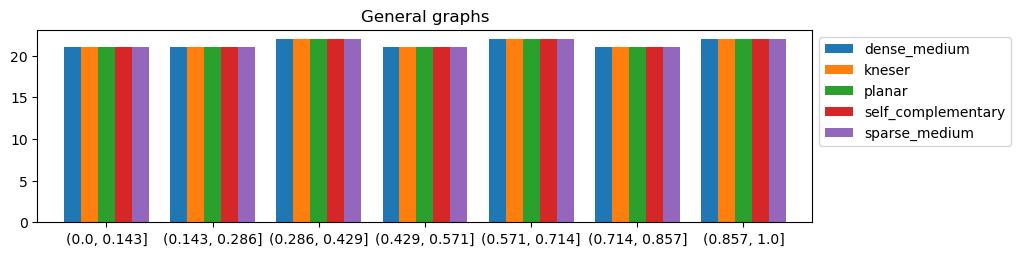

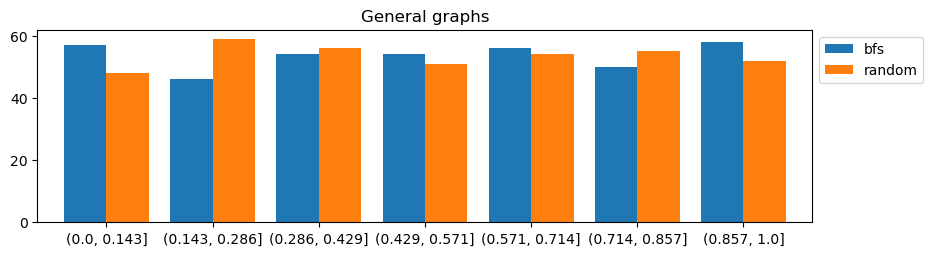

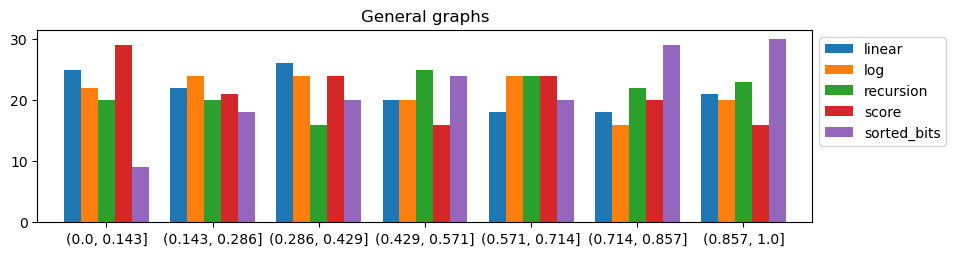

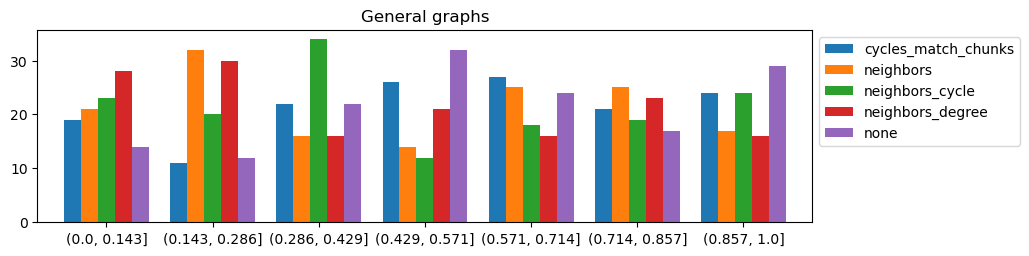

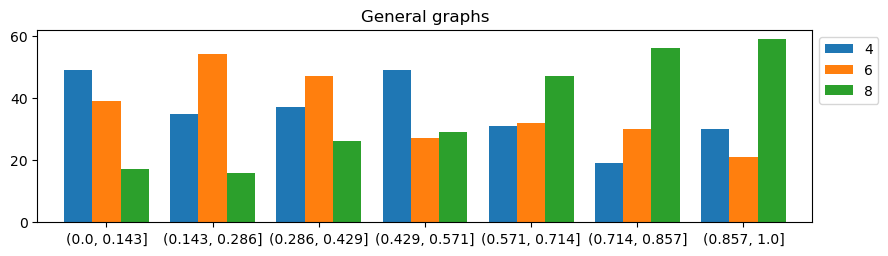

In [15]:
input = """
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-log-none-8-smart]                                             208.1012 (1.03)       213.9884 (1.0)        211.5660 (1.0)        3.0789 (11.57)      212.6083 (1.04)       4.4154 (12.16)         1;0  4.7267 (1.0)           3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-linear-none-8-smart]                                          209.8848 (1.04)       215.9978 (1.01)       212.2040 (1.00)       3.3126 (12.44)      210.7293 (1.03)       4.5848 (12.62)         1;0  4.7124 (1.00)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-linear-none-6-smart]                                          209.0773 (1.03)       218.9228 (1.02)       212.8602 (1.01)       5.3039 (19.92)      210.5805 (1.03)       7.3841 (20.33)         1;0  4.6979 (0.99)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-sorted_bits-none-8-smart]                                     212.3356 (1.05)       216.3518 (1.01)       214.5868 (1.01)       2.0518 (7.71)       215.0730 (1.05)       3.0122 (8.29)          1;0  4.6601 (0.99)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-score-none-8-smart]                                           212.5644 (1.05)       217.8217 (1.02)       214.9882 (1.02)       2.6525 (9.96)       214.5785 (1.05)       3.9430 (10.86)         1;0  4.6514 (0.98)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-log-cycles_match_chunks-6-smart]                           216.4300 (1.07)       221.2402 (1.03)       219.3513 (1.04)       2.5659 (9.64)       220.3838 (1.08)       3.6077 (9.93)          1;0  4.5589 (0.96)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]                   218.1756 (1.08)       224.4471 (1.05)       221.2683 (1.05)       3.1366 (11.78)      221.1822 (1.08)       4.7036 (12.95)         1;0  4.5194 (0.96)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-linear-cycles_match_chunks-4-smart]                        216.3260 (1.07)       224.1397 (1.05)       221.5092 (1.05)       4.4889 (16.86)      224.0617 (1.10)       5.8603 (16.13)         1;0  4.5145 (0.96)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-score-cycles_match_chunks-4-smart]                         216.9095 (1.07)       226.2776 (1.06)       221.9153 (1.05)       4.7171 (17.72)      222.5589 (1.09)       7.0261 (19.34)         1;0  4.5062 (0.95)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-score-cycles_match_chunks-6-smart]                         218.6536 (1.08)       229.0956 (1.07)       222.3032 (1.05)       5.8878 (22.12)      219.1605 (1.07)       7.8315 (21.56)         1;0  4.4984 (0.95)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-sorted_bits-cycles_match_chunks-4-smart]                      219.9133 (1.09)       225.6229 (1.05)       222.4812 (1.05)       2.8978 (10.89)      221.9075 (1.08)       4.2823 (11.79)         1;0  4.4948 (0.95)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-sorted_bits-cycles_match_chunks-8-smart]                      220.3841 (1.09)       226.4668 (1.06)       222.5617 (1.05)       3.3894 (12.73)      220.8341 (1.08)       4.5620 (12.56)         1;0  4.4931 (0.95)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-linear-cycles_match_chunks-6-smart]                        221.2078 (1.09)       226.7600 (1.06)       223.2214 (1.06)       3.0743 (11.55)      221.6963 (1.08)       4.1642 (11.46)         1;0  4.4799 (0.95)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]                   217.9790 (1.08)       230.8067 (1.08)       223.5029 (1.06)       6.5965 (24.78)      221.7230 (1.08)       9.6207 (26.49)         1;0  4.4742 (0.95)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-score-cycles_match_chunks-6-smart]                            217.6891 (1.07)       228.4371 (1.07)       223.7568 (1.06)       5.5067 (20.69)      225.1442 (1.10)       8.0610 (22.19)         1;0  4.4691 (0.95)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-log-cycles_match_chunks-4-smart]                           220.1688 (1.09)       231.6392 (1.08)       224.4394 (1.06)       6.2712 (23.56)      221.5103 (1.08)       8.6028 (23.68)         1;0  4.4555 (0.94)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-linear-neighbors_degree-8-smart]                              222.9938 (1.10)       228.8531 (1.07)       225.0005 (1.06)       3.3374 (12.54)      223.1547 (1.09)       4.3945 (12.10)         1;0  4.4444 (0.94)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-log-neighbors_degree-4-smart]                              222.3302 (1.10)       228.7487 (1.07)       225.0772 (1.06)       3.3076 (12.43)      224.1526 (1.10)       4.8139 (13.25)         1;0  4.4429 (0.94)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-log-cycles_match_chunks-8-smart]                              224.0232 (1.11)       226.1849 (1.06)       225.3380 (1.07)       1.1543 (4.34)       225.8059 (1.10)       1.6212 (4.46)          1;0  4.4378 (0.94)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-linear-cycles_match_chunks-4-smart]                           220.1475 (1.09)       231.2591 (1.08)       225.3405 (1.07)       5.5913 (21.00)      224.6148 (1.10)       8.3337 (22.94)         1;0  4.4377 (0.94)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-score-cycles_match_chunks-4-smart]                            219.3107 (1.08)       231.5071 (1.08)       225.3745 (1.07)       6.0985 (22.91)      225.3055 (1.10)       9.1473 (25.18)         1;0  4.4371 (0.94)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-log-cycles_match_chunks-4-smart]                              219.3270 (1.08)       232.5790 (1.09)       225.5948 (1.07)       6.6550 (25.00)      224.8785 (1.10)       9.9390 (27.36)         1;0  4.4327 (0.94)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-linear-cycles_match_chunks-8-smart]                           222.6291 (1.10)       228.5339 (1.07)       225.8508 (1.07)       2.9891 (11.23)      226.3895 (1.11)       4.4286 (12.19)         1;0  4.4277 (0.94)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-score-neighbors_degree-6-smart]                               225.7117 (1.11)       227.2069 (1.06)       226.6559 (1.07)       0.8215 (3.09)       227.0492 (1.11)       1.1214 (3.09)          1;0  4.4120 (0.93)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-sorted_bits-neighbors_degree-6-smart]                         224.9049 (1.11)       232.0526 (1.08)       227.4789 (1.08)       3.9713 (14.92)      225.4792 (1.10)       5.3608 (14.76)         1;0  4.3960 (0.93)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-sorted_bits-neighbors-4-smart]                             224.0639 (1.11)       230.4668 (1.08)       227.6919 (1.08)       3.2856 (12.34)      228.5448 (1.12)       4.8022 (13.22)         1;0  4.3919 (0.93)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-linear-neighbors-4-smart]                                  225.4364 (1.11)       233.2574 (1.09)       228.2195 (1.08)       4.3709 (16.42)      225.9648 (1.10)       5.8657 (16.15)         1;0  4.3817 (0.93)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-sorted_bits-neighbors_degree-8-smart]                      225.8896 (1.12)       230.9725 (1.08)       228.3416 (1.08)       2.5461 (9.56)       228.1629 (1.12)       3.8121 (10.50)         1;0  4.3794 (0.93)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-score-neighbors-6-smart]                                      226.4660 (1.12)       232.8417 (1.09)       228.6571 (1.08)       3.6253 (13.62)      226.6636 (1.11)       4.7818 (13.16)         1;0  4.3734 (0.93)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-log-neighbors_degree-8-smart]                              224.0382 (1.11)       233.9356 (1.09)       228.9452 (1.08)       4.9492 (18.59)      228.8616 (1.12)       7.4230 (20.44)         1;0  4.3679 (0.92)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-log-neighbors-4-smart]                                     225.0468 (1.11)       235.5952 (1.10)       229.4289 (1.08)       5.4959 (20.65)      227.6447 (1.11)       7.9113 (21.78)         1;0  4.3586 (0.92)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-log-neighbors_degree-6-smart]                                 227.2569 (1.12)       231.1812 (1.08)       229.6125 (1.09)       2.0771 (7.80)       230.3993 (1.13)       2.9433 (8.10)          1;0  4.3552 (0.92)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-score-neighbors-4-smart]                                   226.8655 (1.12)       234.4139 (1.10)       229.6344 (1.09)       4.1565 (15.61)      227.6238 (1.11)       5.6613 (15.59)         1;0  4.3547 (0.92)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-sorted_bits-neighbors_degree-4-smart]                      226.9952 (1.12)       234.3876 (1.10)       230.3753 (1.09)       3.7366 (14.04)      229.7430 (1.12)       5.5443 (15.26)         1;0  4.3407 (0.92)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-score-neighbors_degree-4-smart]                            226.2409 (1.12)       236.8286 (1.11)       231.2308 (1.09)       5.3200 (19.99)      230.6228 (1.13)       7.9408 (21.86)         1;0  4.3247 (0.91)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-score-neighbors_degree-8-smart]                            226.0585 (1.12)       237.1257 (1.11)       231.3136 (1.09)       5.5546 (20.87)      230.7566 (1.13)       8.3004 (22.85)         1;0  4.3231 (0.91)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-linear-neighbors_cycle-6-smart]                            226.4893 (1.12)       238.4818 (1.11)       231.7934 (1.10)       6.1149 (22.97)      230.4091 (1.13)       8.9944 (24.76)         1;0  4.3142 (0.91)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-linear-neighbors_degree-4-smart]                           228.0782 (1.13)       235.4804 (1.10)       232.4244 (1.10)       3.8660 (14.52)      233.7145 (1.14)       5.5516 (15.28)         1;0  4.3025 (0.91)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-linear-neighbors_degree-8-smart]                           228.9956 (1.13)       240.1557 (1.12)       232.9686 (1.10)       6.2358 (23.43)      229.7543 (1.12)       8.3701 (23.04)         1;0  4.2924 (0.91)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-score-neighbors_cycle-6-smart]                             232.7055 (1.15)       237.5432 (1.11)       234.5500 (1.11)       2.6154 (9.83)       233.4014 (1.14)       3.6283 (9.99)          1;0  4.2635 (0.90)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-sorted_bits-neighbors_cycle-6-smart]                          231.7297 (1.14)       236.9638 (1.11)       234.9949 (1.11)       2.8477 (10.70)      236.2913 (1.15)       3.9256 (10.81)         1;0  4.2554 (0.90)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-score-neighbors_cycle-8-smart]                             232.3274 (1.15)       239.7542 (1.12)       235.0582 (1.11)       4.0848 (15.35)      233.0931 (1.14)       5.5701 (15.34)         1;0  4.2543 (0.90)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-sorted_bits-neighbors_cycle-8-smart]                       230.9045 (1.14)       240.0588 (1.12)       235.5124 (1.11)       4.5774 (17.20)      235.5739 (1.15)       6.8657 (18.90)         1;0  4.2461 (0.90)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-log-neighbors_cycle-8-smart]                                  229.5687 (1.13)       246.4135 (1.15)       236.2889 (1.12)       8.9235 (33.52)      232.8846 (1.14)      12.6336 (34.78)         1;0  4.2321 (0.90)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-linear-neighbors_cycle-6-smart]                               229.5993 (1.13)       240.4555 (1.12)       236.4243 (1.12)       5.9429 (22.33)      239.2181 (1.17)       8.1422 (22.42)         1;0  4.2297 (0.89)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-log-neighbors_cycle-8-smart]                               234.5716 (1.16)       238.3229 (1.11)       236.4358 (1.12)       1.8757 (7.05)       236.4129 (1.16)       2.8134 (7.75)          1;0  4.2295 (0.89)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]                       232.6083 (1.15)       242.2653 (1.13)       236.5058 (1.12)       5.0907 (19.12)      234.6437 (1.15)       7.2428 (19.94)         1;0  4.2282 (0.89)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-log-neighbors_cycle-6-smart]                               232.2815 (1.15)       240.8437 (1.13)       236.5435 (1.12)       4.2812 (16.08)      236.5054 (1.16)       6.4217 (17.68)         1;0  4.2276 (0.89)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-sorted_bits-neighbors_cycle-4-smart]                          232.7875 (1.15)       240.5184 (1.12)       236.6947 (1.12)       3.8661 (14.52)      236.7784 (1.16)       5.7982 (15.96)         1;0  4.2249 (0.89)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-sorted_bits-neighbors_cycle-8-smart]                          230.0351 (1.14)       241.8681 (1.13)       236.7074 (1.12)       6.0596 (22.76)      238.2189 (1.16)       8.8747 (24.43)         1;0  4.2246 (0.89)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-linear-neighbors_cycle-8-smart]                               233.5933 (1.15)       243.0475 (1.14)       236.8516 (1.12)       5.3682 (20.17)      233.9140 (1.14)       7.0907 (19.52)         1;0  4.2221 (0.89)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-score-neighbors_cycle-8-smart]                                232.6905 (1.15)       245.9215 (1.15)       237.2072 (1.12)       7.5485 (28.36)      233.0095 (1.14)       9.9232 (27.32)         1;0  4.2157 (0.89)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-linear-neighbors_cycle-4-smart]                               231.2281 (1.14)       241.0579 (1.13)       237.7048 (1.12)       5.6102 (21.08)      240.8284 (1.18)       7.3724 (20.30)         1;0  4.2069 (0.89)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-linear-neighbors_cycle-8-smart]                            236.7199 (1.17)       240.9717 (1.13)       238.2676 (1.13)       2.3500 (8.83)       237.1112 (1.16)       3.1889 (8.78)          1;0  4.1970 (0.89)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-score-neighbors_cycle-6-smart]                                237.7780 (1.17)       239.4536 (1.12)       238.3405 (1.13)       0.9640 (3.62)       237.7899 (1.16)       1.2567 (3.46)          1;0  4.1957 (0.89)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-log-none-6-smart]                                          204.1827 (1.01)       308.1743 (1.44)       238.9924 (1.13)      59.9136 (225.07)     204.6203 (1.0)       77.9937 (214.72)        1;0  4.1842 (0.89)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-log-neighbors_cycle-4-smart]                                  234.5271 (1.16)       246.5283 (1.15)       240.3786 (1.14)       6.0062 (22.56)      240.0803 (1.17)       9.0009 (24.78)         1;0  4.1601 (0.88)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-log-neighbors_cycle-6-smart]                                  233.6316 (1.15)       251.4964 (1.18)       241.4786 (1.14)       9.1281 (34.29)      239.3078 (1.17)      13.3986 (36.89)         1;0  4.1412 (0.88)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-sorted_bits-none-6-smart]                                  205.6265 (1.02)       313.4370 (1.46)       241.8476 (1.14)      61.9997 (232.91)     206.4794 (1.01)      80.8579 (222.61)        1;0  4.1348 (0.87)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-sorted_bits-none-8-smart]                                  204.1497 (1.01)       309.9313 (1.45)       242.3550 (1.15)      58.6892 (220.47)     212.9840 (1.04)      79.3362 (218.42)        1;0  4.1262 (0.87)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-score-none-4-smart]                                        206.1877 (1.02)       313.1435 (1.46)       242.3552 (1.15)      61.3093 (230.32)     207.7345 (1.02)      80.2168 (220.84)        1;0  4.1262 (0.87)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-log-none-8-smart]                                          205.2838 (1.01)       313.8061 (1.47)       242.3724 (1.15)      61.8786 (232.45)     208.0272 (1.02)      81.3917 (224.08)        1;0  4.1259 (0.87)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-score-none-8-smart]                                        207.0580 (1.02)       311.8430 (1.46)       243.0427 (1.15)      59.6038 (223.91)     210.2272 (1.03)      78.5888 (216.36)        1;0  4.1145 (0.87)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-linear-none-8-smart]                                       205.3612 (1.01)       313.8770 (1.47)       244.1112 (1.15)      60.5426 (227.44)     213.0954 (1.04)      81.3869 (224.07)        1;0  4.0965 (0.87)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-sorted_bits-none-4-smart]                                     206.1287 (1.02)       317.9885 (1.49)       244.2996 (1.15)      63.8302 (239.79)     208.7816 (1.02)      83.8948 (230.97)        1;0  4.0933 (0.87)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-log-none-4-smart]                                             209.6590 (1.03)       313.6823 (1.47)       244.3741 (1.16)      60.0228 (225.48)     209.7808 (1.03)      78.0175 (214.79)        1;0  4.0921 (0.87)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-score-none-6-smart]                                           206.1847 (1.02)       317.9850 (1.49)       244.6725 (1.16)      63.5169 (238.61)     209.8477 (1.03)      83.8502 (230.85)        1;0  4.0871 (0.86)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-sorted_bits-none-4-smart]                                  204.6709 (1.01)       313.6831 (1.47)       244.7887 (1.16)      59.9331 (225.15)     216.0122 (1.06)      81.7592 (225.09)        1;0  4.0852 (0.86)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-recursion-none-4-smart]                                    206.9351 (1.02)       318.5069 (1.49)       245.2409 (1.16)      63.4722 (238.44)     210.2809 (1.03)      83.6789 (230.38)        1;0  4.0776 (0.86)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-score-none-6-smart]                                        202.5748 (1.0)        325.5716 (1.52)       245.5805 (1.16)      69.3397 (260.48)     208.5950 (1.02)      92.2476 (253.97)        1;0  4.0720 (0.86)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-score-none-4-smart]                                           205.9570 (1.02)       311.4971 (1.46)       245.7466 (1.16)      57.3599 (215.48)     219.7856 (1.07)      79.1550 (217.92)        1;0  4.0692 (0.86)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-log-none-6-smart]                                             209.4007 (1.03)       312.3441 (1.46)       245.9778 (1.16)      57.5750 (216.29)     216.1886 (1.06)      77.2075 (212.56)        1;0  4.0654 (0.86)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-sorted_bits-none-6-smart]                                     207.4526 (1.02)       316.5654 (1.48)       246.0413 (1.16)      61.1662 (229.78)     214.1060 (1.05)      81.8346 (225.30)        1;0  4.0644 (0.86)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-log-none-4-smart]                                          210.9396 (1.04)       314.6318 (1.47)       246.8649 (1.17)      58.7233 (220.60)     215.0235 (1.05)      77.7691 (214.11)        1;0  4.0508 (0.86)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-linear-none-4-smart]                                          210.9058 (1.04)       309.2461 (1.45)       247.1601 (1.17)      54.0201 (202.93)     221.3282 (1.08)      73.7552 (203.05)        1;0  4.0460 (0.86)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-recursion-none-6-smart]                                       212.5127 (1.05)       315.6407 (1.48)       247.1985 (1.17)      59.2745 (222.67)     213.4421 (1.04)      77.3460 (212.94)        1;0  4.0453 (0.86)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-recursion-none-8-smart]                                    213.8207 (1.06)       314.3657 (1.47)       247.4018 (1.17)      57.9926 (217.86)     214.0189 (1.05)      75.4088 (207.61)        1;0  4.0420 (0.86)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-recursion-none-8-smart]                                       210.2052 (1.04)       319.2175 (1.49)       247.4709 (1.17)      62.1500 (233.47)     212.9899 (1.04)      81.7592 (225.09)        1;0  4.0409 (0.85)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-recursion-none-6-smart]                                    210.3487 (1.04)       321.3090 (1.50)       247.8649 (1.17)      63.6094 (238.96)     211.9371 (1.04)      83.2202 (229.11)        1;0  4.0345 (0.85)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-linear-none-6-smart]                                       209.6180 (1.03)       319.2920 (1.49)       248.3190 (1.17)      61.5485 (231.21)     216.0469 (1.06)      82.2555 (226.46)        1;0  4.0271 (0.85)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-recursion-none-4-smart]                                       209.5754 (1.03)       322.8701 (1.51)       249.2084 (1.18)      63.8544 (239.88)     215.1797 (1.05)      84.9710 (233.93)        1;0  4.0127 (0.85)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-linear-none-4-smart]                                       213.7064 (1.05)       317.8295 (1.49)       249.3024 (1.18)      59.3611 (223.00)     216.3714 (1.06)      78.0923 (214.99)        1;0  4.0112 (0.85)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-recursion-cycles_match_chunks-8-smart]                        217.2632 (1.07)       330.0233 (1.54)       256.6480 (1.21)      63.6020 (238.93)     222.6576 (1.09)      84.5701 (232.83)        1;0  3.8964 (0.82)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-recursion-cycles_match_chunks-4-smart]                     218.9400 (1.08)       326.2592 (1.52)       256.7516 (1.21)      60.2729 (226.42)     225.0557 (1.10)      80.4894 (221.59)        1;0  3.8948 (0.82)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-linear-cycles_match_chunks-8-smart]                        217.4804 (1.07)       332.6847 (1.55)       256.9686 (1.21)      65.5923 (246.41)     220.7406 (1.08)      86.4032 (237.88)        1;0  3.8915 (0.82)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-recursion-cycles_match_chunks-6-smart]                     218.8163 (1.08)       333.3121 (1.56)       257.1150 (1.22)      65.9889 (247.90)     219.2167 (1.07)      85.8718 (236.41)        1;0  3.8893 (0.82)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-sorted_bits-neighbors-8-smart]                             224.3896 (1.11)       321.4589 (1.50)       257.7331 (1.22)      55.2080 (207.40)     227.3509 (1.11)      72.8020 (200.43)        1;0  3.8800 (0.82)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-recursion-cycles_match_chunks-8-smart]                     218.1522 (1.08)       332.9187 (1.56)       258.1402 (1.22)      64.8122 (243.48)     223.3498 (1.09)      86.0749 (236.97)        1;0  3.8739 (0.82)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-recursion-cycles_match_chunks-4-smart]                        219.6450 (1.08)       324.6958 (1.52)       258.3407 (1.22)      57.7296 (216.87)     230.6812 (1.13)      78.7882 (216.91)        1;0  3.8709 (0.82)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-recursion-cycles_match_chunks-6-smart]                        219.6685 (1.08)       332.3280 (1.55)       258.7384 (1.22)      63.7711 (239.56)     224.2186 (1.10)      84.4947 (232.62)        1;0  3.8649 (0.82)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-linear-neighbors-8-smart]                                  226.7832 (1.12)       323.2175 (1.51)       259.2696 (1.23)      55.3829 (208.05)     227.8081 (1.11)      72.3257 (199.12)        1;0  3.8570 (0.82)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-linear-cycles_match_chunks-6-smart]                           218.6288 (1.08)       338.5838 (1.58)       259.5287 (1.23)      68.4775 (257.24)     221.3735 (1.08)      89.9663 (247.68)        1;0  3.8531 (0.82)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-linear-neighbors-6-smart]                                  220.9264 (1.09)       333.1936 (1.56)       260.5382 (1.23)      63.0071 (236.69)     227.4945 (1.11)      84.2004 (231.81)        1;0  3.8382 (0.81)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-log-cycles_match_chunks-6-smart]                              214.1594 (1.06)       344.1045 (1.61)       260.8501 (1.23)      72.2780 (271.52)     224.2863 (1.10)      97.4588 (268.31)        1;0  3.8336 (0.81)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-linear-neighbors-8-smart]                                     226.4967 (1.12)       329.0856 (1.54)       261.0352 (1.23)      58.9356 (221.40)     227.5234 (1.11)      76.9417 (211.83)        1;0  3.8309 (0.81)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-score-cycles_match_chunks-8-smart]                         223.9149 (1.11)       334.8803 (1.56)       261.1053 (1.23)      63.8918 (240.02)     224.5205 (1.10)      83.2241 (229.12)        1;0  3.8299 (0.81)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-sorted_bits-cycles_match_chunks-8-smart]                   219.8450 (1.09)       333.6904 (1.56)       261.1235 (1.23)      63.0430 (236.83)     229.8350 (1.12)      85.3841 (235.07)        1;0  3.8296 (0.81)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-linear-neighbors-4-smart]                                     222.4980 (1.10)       335.7539 (1.57)       261.2215 (1.23)      64.5634 (242.54)     225.4127 (1.10)      84.9419 (233.85)        1;0  3.8282 (0.81)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-score-cycles_match_chunks-8-smart]                            219.2971 (1.08)       341.3949 (1.60)       261.4335 (1.24)      69.2821 (260.27)     223.6086 (1.09)      91.5734 (252.11)        1;0  3.8251 (0.81)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-score-neighbors-8-smart]                                   227.6904 (1.12)       323.7886 (1.51)       261.7298 (1.24)      53.8287 (202.21)     233.7103 (1.14)      72.0736 (198.42)        1;0  3.8207 (0.81)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-log-neighbors-6-smart]                                     226.7838 (1.12)       330.6954 (1.55)       261.8458 (1.24)      59.6289 (224.00)     228.0582 (1.11)      77.9337 (214.56)        1;0  3.8190 (0.81)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-log-neighbors_degree-8-smart]                                 224.3055 (1.11)       333.4035 (1.56)       261.9488 (1.24)      61.9112 (232.58)     228.1376 (1.11)      81.8235 (225.27)        1;0  3.8175 (0.81)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-log-cycles_match_chunks-8-smart]                           217.6144 (1.07)       327.2178 (1.53)       261.9877 (1.24)      57.7017 (216.76)     241.1308 (1.18)      82.2025 (226.31)        1;0  3.8170 (0.81)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-log-neighbors_cycle-4-smart]                               225.7411 (1.11)       329.1506 (1.54)       262.0345 (1.24)      58.1886 (218.59)     231.2118 (1.13)      77.5572 (213.52)        1;0  3.8163 (0.81)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-log-neighbors-8-smart]                                        228.1968 (1.13)       328.0694 (1.53)       262.3483 (1.24)      56.9307 (213.87)     230.7787 (1.13)      74.9044 (206.22)        1;0  3.8117 (0.81)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-recursion-neighbors-6-smart]                                  226.0606 (1.12)       331.6138 (1.55)       262.4543 (1.24)      59.9214 (225.10)     229.6884 (1.12)      79.1649 (217.95)        1;0  3.8102 (0.81)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-log-neighbors_degree-6-smart]                              218.5042 (1.08)       350.4511 (1.64)       262.5866 (1.24)      76.0930 (285.85)     218.8046 (1.07)      98.9601 (272.45)        1;0  3.8083 (0.81)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-log-neighbors-8-smart]                                     224.6874 (1.11)       333.8383 (1.56)       262.7689 (1.24)      61.6006 (231.41)     229.7810 (1.12)      81.8632 (225.38)        1;0  3.8056 (0.81)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-sorted_bits-neighbors-6-smart]                                223.5146 (1.10)       330.8128 (1.55)       262.8952 (1.24)      59.0678 (221.90)     234.3581 (1.15)      80.4736 (221.55)        1;0  3.8038 (0.80)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-score-neighbors-6-smart]                                   225.9928 (1.12)       330.1170 (1.54)       262.8955 (1.24)      58.3085 (219.04)     232.5767 (1.14)      78.0931 (215.00)        1;0  3.8038 (0.80)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-sorted_bits-neighbors_degree-8-smart]                         220.3873 (1.09)       342.1387 (1.60)       263.0969 (1.24)      68.5264 (257.43)     226.7648 (1.11)      91.3136 (251.39)        1;0  3.8009 (0.80)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-sorted_bits-neighbors-4-smart]                                226.8649 (1.12)       330.7171 (1.55)       263.1607 (1.24)      58.5596 (219.99)     231.9003 (1.13)      77.8891 (214.44)        1;0  3.8000 (0.80)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-recursion-neighbors_degree-4-smart]                           226.7167 (1.12)       334.3012 (1.56)       263.2095 (1.24)      61.5745 (231.31)     228.6106 (1.12)      80.6884 (222.14)        1;0  3.7993 (0.80)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-recursion-neighbors-4-smart]                               224.1917 (1.11)       337.6092 (1.58)       263.3907 (1.24)      64.3091 (241.59)     228.3713 (1.12)      85.0632 (234.19)        1;0  3.7966 (0.80)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-score-neighbors_degree-6-smart]                            221.3565 (1.09)       342.2367 (1.60)       263.4318 (1.25)      68.2994 (256.58)     226.7021 (1.11)      90.6602 (249.60)        1;0  3.7960 (0.80)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-linear-neighbors-6-smart]                                     224.7488 (1.11)       330.1317 (1.54)       263.5910 (1.25)      57.8946 (217.49)     235.8925 (1.15)      79.0371 (217.60)        1;0  3.7938 (0.80)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-log-neighbors-6-smart]                                        224.0535 (1.11)       329.3421 (1.54)       263.5940 (1.25)      57.3284 (215.36)     237.3865 (1.16)      78.9664 (217.40)        1;0  3.7937 (0.80)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-linear-neighbors_cycle-4-smart]                            229.1588 (1.13)       329.3106 (1.54)       263.9486 (1.25)      56.6443 (212.79)     233.3766 (1.14)      75.1138 (206.79)        1;0  3.7886 (0.80)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-sorted_bits-neighbors-8-smart]                                227.6126 (1.12)       328.9966 (1.54)       264.0230 (1.25)      56.4054 (211.89)     235.4598 (1.15)      76.0380 (209.34)        1;0  3.7875 (0.80)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-score-neighbors_degree-8-smart]                               223.4714 (1.10)       329.8077 (1.54)       264.1575 (1.25)      57.3956 (215.61)     239.1934 (1.17)      79.7523 (219.56)        1;0  3.7856 (0.80)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-sorted_bits-cycles_match_chunks-6-smart]                      227.2051 (1.12)       334.8864 (1.56)       264.4456 (1.25)      61.0370 (229.29)     231.2452 (1.13)      80.7610 (222.34)        1;0  3.7815 (0.80)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-linear-neighbors_degree-6-smart]                              226.3096 (1.12)       332.4921 (1.55)       264.5186 (1.25)      59.0180 (221.71)     234.7540 (1.15)      79.6369 (219.25)        1;0  3.7805 (0.80)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-sorted_bits-neighbors_degree-6-smart]                      221.3382 (1.09)       349.4507 (1.63)       264.5471 (1.25)      73.5326 (276.23)     222.8524 (1.09)      96.0844 (264.53)        1;0  3.7800 (0.80)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-recursion-neighbors_degree-8-smart]                        230.5455 (1.14)       327.1803 (1.53)       264.5910 (1.25)      54.2737 (203.89)     236.0471 (1.15)      72.4761 (199.53)        1;0  3.7794 (0.80)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-recursion-neighbors-8-smart]                               225.4627 (1.11)       333.6160 (1.56)       264.6720 (1.25)      59.8949 (225.00)     234.9374 (1.15)      81.1150 (223.32)        1;0  3.7783 (0.80)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-sorted_bits-neighbors-6-smart]                             230.6957 (1.14)       331.0179 (1.55)       264.7246 (1.25)      57.4185 (215.70)     232.4601 (1.14)      75.2416 (207.15)        1;0  3.7775 (0.80)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-score-neighbors-4-smart]                                      229.3991 (1.13)       335.4397 (1.57)       264.8389 (1.25)      61.1422 (229.69)     229.6780 (1.12)      79.5305 (218.95)        1;0  3.7759 (0.80)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-sorted_bits-neighbors_degree-4-smart]                         219.9421 (1.09)       342.1213 (1.60)       265.2473 (1.25)      66.9282 (251.42)     233.6785 (1.14)      91.6344 (252.28)        1;0  3.7701 (0.80)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-score-neighbors-8-smart]                                      226.6076 (1.12)       331.6923 (1.55)       265.5823 (1.26)      57.5582 (216.22)     238.4470 (1.17)      78.8135 (216.98)        1;0  3.7653 (0.80)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-score-neighbors_degree-4-smart]                               222.6271 (1.10)       342.7687 (1.60)       265.6678 (1.26)      66.9221 (251.40)     231.6077 (1.13)      90.1062 (248.07)        1;0  3.7641 (0.80)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-log-neighbors-4-smart]                                        224.1048 (1.11)       339.6035 (1.59)       265.8329 (1.26)      64.0705 (240.69)     233.7904 (1.14)      86.6240 (238.48)        1;0  3.7618 (0.80)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-linear-neighbors_degree-4-smart]                              223.5433 (1.10)       344.2121 (1.61)       265.8806 (1.26)      67.9112 (255.12)     229.8864 (1.12)      90.5017 (249.16)        1;0  3.7611 (0.80)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-recursion-neighbors_cycle-4-smart]                         229.0811 (1.13)       337.0230 (1.57)       266.0784 (1.26)      61.4588 (230.88)     232.1309 (1.13)      80.9565 (222.88)        1;0  3.7583 (0.80)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-recursion-neighbors_degree-6-smart]                           225.5863 (1.11)       343.4307 (1.60)       266.1196 (1.26)      66.9796 (251.62)     229.3419 (1.12)      88.3832 (243.33)        1;0  3.7577 (0.80)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-linear-neighbors_degree-6-smart]                           222.0228 (1.10)       349.3143 (1.63)       266.5211 (1.26)      71.7680 (269.61)     228.2263 (1.12)      95.4686 (262.83)        1;0  3.7520 (0.79)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-recursion-neighbors-4-smart]                                  231.4403 (1.14)       335.4875 (1.57)       267.0061 (1.26)      59.3214 (222.85)     234.0904 (1.14)      78.0354 (214.84)        1;0  3.7452 (0.79)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-recursion-neighbors_degree-4-smart]                        228.1388 (1.13)       333.6275 (1.56)       267.2951 (1.26)      57.7570 (216.97)     240.1189 (1.17)      79.1165 (217.81)        1;0  3.7412 (0.79)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-recursion-neighbors-6-smart]                               232.9343 (1.15)       335.5041 (1.57)       267.3791 (1.26)      58.9992 (221.64)     233.6988 (1.14)      76.9273 (211.79)        1;0  3.7400 (0.79)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-recursion-neighbors_cycle-6-smart]                         232.7072 (1.15)       336.0697 (1.57)       267.9860 (1.27)      58.9752 (221.55)     235.1810 (1.15)      77.5218 (213.42)        1;0  3.7315 (0.79)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-recursion-neighbors_degree-8-smart]                           230.5037 (1.14)       338.0422 (1.58)       268.8945 (1.27)      60.0052 (225.42)     238.1376 (1.16)      80.6539 (222.05)        1;0  3.7189 (0.79)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-recursion-neighbors-8-smart]                                  236.6040 (1.17)       328.4516 (1.53)       269.0243 (1.27)      51.5366 (193.60)     242.0175 (1.18)      68.8857 (189.65)        1;0  3.7171 (0.79)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-log-neighbors_degree-4-smart]                                 223.3119 (1.10)       354.4627 (1.66)       269.5058 (1.27)      73.6686 (276.75)     230.7427 (1.13)      98.3631 (270.80)        1;0  3.7105 (0.79)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]                       234.2984 (1.16)       337.3443 (1.58)       269.5323 (1.27)      58.7419 (220.67)     236.9542 (1.16)      77.2844 (212.77)        1;0  3.7101 (0.78)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-score-neighbors_cycle-4-smart]                                231.0493 (1.14)       336.1923 (1.57)       269.6384 (1.27)      57.8816 (217.44)     241.6736 (1.18)      78.8572 (217.10)        1;0  3.7087 (0.78)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-recursion-neighbors_cycle-6-smart]                            230.8459 (1.14)       341.7548 (1.60)       270.1286 (1.28)      62.1270 (233.39)     237.7851 (1.16)      83.1816 (229.01)        1;0  3.7019 (0.78)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-score-neighbors_cycle-4-smart]                             236.7054 (1.17)       331.7175 (1.55)       270.6653 (1.28)      52.9842 (199.04)     243.5730 (1.19)      71.2591 (196.18)        1;0  3.6946 (0.78)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-recursion-neighbors_cycle-4-smart]                            230.7319 (1.14)       339.5298 (1.59)       271.7375 (1.28)      59.1387 (222.16)     244.9509 (1.20)      81.5984 (224.65)        1;0  3.6800 (0.78)          3           1
test_bench_NAC_colorings_general_medium[32-planar-bfs-subgraphs-recursion-neighbors_cycle-8-smart]                            230.5067 (1.14)       344.3817 (1.61)       273.1947 (1.29)      62.0566 (233.12)     244.6958 (1.20)      85.4062 (235.13)        1;0  3.6604 (0.77)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-recursion-neighbors_degree-6-smart]                        231.2952 (1.14)       359.8185 (1.68)       275.1260 (1.30)      73.3609 (275.59)     234.2643 (1.14)      96.3925 (265.38)        1;0  3.6347 (0.77)          3           1
test_bench_NAC_colorings_general_medium[32-planar-random-subgraphs-recursion-neighbors_cycle-8-smart]                         231.2627 (1.14)       343.9454 (1.61)       304.1189 (1.44)      63.1868 (237.37)     337.1485 (1.65)      84.5120 (232.67)        1;0  3.2882 (0.70)          3           1

test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-score-none-8-smart]                               218.3106 (1.08)       220.9587 (1.03)       219.2189 (1.04)       1.5073 (5.66)       218.3873 (1.07)       1.9861 (5.47)          1;0  4.5617 (0.97)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-sorted_bits-none-4-smart]                         219.4558 (1.08)       223.8759 (1.05)       222.1531 (1.05)       2.3657 (8.89)       223.1276 (1.09)       3.3150 (9.13)          1;0  4.5014 (0.95)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-recursion-none-8-smart]                        223.2620 (1.10)       224.0005 (1.05)       223.7358 (1.06)       0.4113 (1.55)       223.9449 (1.09)       0.5539 (1.52)          1;0  4.4696 (0.95)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-linear-neighbors-8-smart]                      222.3611 (1.10)       225.6258 (1.05)       224.2143 (1.06)       1.6765 (6.30)       224.6559 (1.10)       2.4485 (6.74)          1;0  4.4600 (0.94)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-log-none-8-smart]                              222.8566 (1.10)       226.4041 (1.06)       224.6742 (1.06)       1.7754 (6.67)       224.7619 (1.10)       2.6606 (7.32)          1;0  4.4509 (0.94)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-log-neighbors-8-smart]                            224.6083 (1.11)       225.0926 (1.05)       224.7867 (1.06)       0.2662 (1.0)        224.6590 (1.10)       0.3632 (1.0)           1;0  4.4487 (0.94)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-recursion-none-6-smart]                           221.4538 (1.09)       231.3894 (1.08)       224.8989 (1.06)       5.6245 (21.13)      221.8534 (1.08)       7.4517 (20.52)         1;0  4.4464 (0.94)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-linear-cycles_match_chunks-4-smart]               223.1148 (1.10)       227.3747 (1.06)       225.1968 (1.06)       2.1316 (8.01)       225.1010 (1.10)       3.1949 (8.80)          1;0  4.4406 (0.94)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-log-neighbors_degree-6-smart]                  224.1794 (1.11)       226.8226 (1.06)       225.2242 (1.06)       1.4059 (5.28)       224.6705 (1.10)       1.9824 (5.46)          1;0  4.4400 (0.94)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-linear-none-4-smart]                           219.6144 (1.08)       230.2098 (1.08)       225.3006 (1.06)       5.3403 (20.06)      226.0778 (1.10)       7.9465 (21.88)         1;0  4.4385 (0.94)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-recursion-none-4-smart]                        221.1248 (1.09)       229.6983 (1.07)       225.4842 (1.07)       4.2886 (16.11)      225.6296 (1.10)       6.4301 (17.70)         1;0  4.4349 (0.94)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-linear-cycles_match_chunks-6-smart]               222.4975 (1.10)       231.0023 (1.08)       225.5640 (1.07)       4.7225 (17.74)      223.1922 (1.09)       6.3786 (17.56)         1;0  4.4333 (0.94)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-score-cycles_match_chunks-8-smart]                223.9058 (1.11)       227.4679 (1.06)       225.6238 (1.07)       1.7844 (6.70)       225.4976 (1.10)       2.6716 (7.36)          1;0  4.4322 (0.94)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-linear-none-8-smart]                           222.6246 (1.10)       232.0323 (1.08)       225.7611 (1.07)       5.4311 (20.40)      222.6263 (1.09)       7.0558 (19.43)         1;0  4.4295 (0.94)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]       222.6928 (1.10)       229.7784 (1.07)       225.9961 (1.07)       3.5670 (13.40)      225.5171 (1.10)       5.3142 (14.63)         1;0  4.4249 (0.94)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-score-neighbors-8-smart]                          221.7187 (1.09)       234.3044 (1.09)       226.0776 (1.07)       7.1289 (26.78)      222.2096 (1.09)       9.4393 (25.99)         1;0  4.4233 (0.94)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-score-neighbors-6-smart]                       225.6850 (1.11)       226.8745 (1.06)       226.0965 (1.07)       0.6742 (2.53)       225.7299 (1.10)       0.8921 (2.46)          1;0  4.4229 (0.94)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-linear-neighbors_degree-6-smart]                  224.1566 (1.11)       227.9687 (1.07)       226.1391 (1.07)       1.9106 (7.18)       226.2918 (1.11)       2.8591 (7.87)          1;0  4.4221 (0.94)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-sorted_bits-cycles_match_chunks-8-smart]          223.5530 (1.10)       230.2329 (1.08)       226.1624 (1.07)       3.5716 (13.42)      224.7013 (1.10)       5.0099 (13.79)         1;0  4.4216 (0.94)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-score-neighbors_degree-8-smart]                221.3732 (1.09)       228.8761 (1.07)       226.2061 (1.07)       4.1931 (15.75)      228.3689 (1.12)       5.6272 (15.49)         1;0  4.4207 (0.94)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-linear-neighbors_cycle-6-smart]                   223.2841 (1.10)       230.5970 (1.08)       226.2982 (1.07)       3.8219 (14.36)      225.0136 (1.10)       5.4847 (15.10)         1;0  4.4189 (0.93)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-recursion-none-4-smart]                           224.2025 (1.11)       229.7694 (1.07)       226.3544 (1.07)       2.9906 (11.23)      225.0914 (1.10)       4.1751 (11.49)         1;0  4.4179 (0.93)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-sorted_bits-none-4-smart]                      222.2705 (1.10)       231.0184 (1.08)       226.5309 (1.07)       4.3784 (16.45)      226.3036 (1.11)       6.5609 (18.06)         1;0  4.4144 (0.93)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-log-none-6-smart]                              223.2114 (1.10)       231.6234 (1.08)       226.5373 (1.07)       4.4737 (16.81)      224.7772 (1.10)       6.3090 (17.37)         1;0  4.4143 (0.93)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-log-none-8-smart]                                 222.0286 (1.10)       230.3775 (1.08)       226.5470 (1.07)       4.2168 (15.84)      227.2349 (1.11)       6.2617 (17.24)         1;0  4.4141 (0.93)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-sorted_bits-none-6-smart]                         222.4264 (1.10)       232.1346 (1.08)       226.5772 (1.07)       5.0046 (18.80)      225.1705 (1.10)       7.2811 (20.05)         1;0  4.4135 (0.93)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-linear-none-4-smart]                              225.7041 (1.11)       228.1229 (1.07)       226.5840 (1.07)       1.3373 (5.02)       225.9250 (1.10)       1.8141 (4.99)          1;0  4.4134 (0.93)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-recursion-neighbors-8-smart]                   223.6506 (1.10)       228.6443 (1.07)       226.7887 (1.07)       2.7327 (10.27)      228.0711 (1.11)       3.7453 (10.31)         1;0  4.4094 (0.93)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-score-none-6-smart]                            222.2638 (1.10)       230.5271 (1.08)       226.9842 (1.07)       4.2556 (15.99)      228.1616 (1.12)       6.1974 (17.06)         1;0  4.4056 (0.93)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-sorted_bits-neighbors_degree-8-smart]             224.4976 (1.11)       229.3087 (1.07)       227.0571 (1.07)       2.4203 (9.09)       227.3651 (1.11)       3.6083 (9.93)          1;0  4.4042 (0.93)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-log-neighbors_degree-8-smart]                     225.2847 (1.11)       228.5784 (1.07)       227.0990 (1.07)       1.6722 (6.28)       227.4339 (1.11)       2.4703 (6.80)          1;0  4.4034 (0.93)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-recursion-cycles_match_chunks-4-smart]         221.7674 (1.09)       231.0237 (1.08)       227.1538 (1.07)       4.8109 (18.07)      228.6704 (1.12)       6.9423 (19.11)         1;0  4.4023 (0.93)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-sorted_bits-none-6-smart]                      224.6767 (1.11)       230.0385 (1.08)       227.5179 (1.08)       2.6952 (10.13)      227.8383 (1.11)       4.0214 (11.07)         1;0  4.3953 (0.93)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-recursion-none-6-smart]                        222.5245 (1.10)       232.2943 (1.09)       227.5390 (1.08)       4.8900 (18.37)      227.7983 (1.11)       7.3273 (20.17)         1;0  4.3949 (0.93)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-score-neighbors_degree-6-smart]                226.4098 (1.12)       229.3584 (1.07)       227.5814 (1.08)       1.5647 (5.88)       226.9762 (1.11)       2.2114 (6.09)          1;0  4.3940 (0.93)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-score-cycles_match_chunks-4-smart]             222.1352 (1.10)       231.7464 (1.08)       227.7266 (1.08)       4.9946 (18.76)      229.2981 (1.12)       7.2084 (19.85)         1;0  4.3912 (0.93)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-score-none-8-smart]                            226.8704 (1.12)       229.1337 (1.07)       227.7409 (1.08)       1.2187 (4.58)       227.2186 (1.11)       1.6975 (4.67)          1;0  4.3910 (0.93)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-sorted_bits-cycles_match_chunks-4-smart]          225.8187 (1.11)       230.1693 (1.08)       227.9023 (1.08)       2.1811 (8.19)       227.7188 (1.11)       3.2629 (8.98)          1;0  4.3878 (0.93)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-recursion-neighbors_degree-4-smart]            226.8535 (1.12)       230.6379 (1.08)       228.1451 (1.08)       2.1593 (8.11)       226.9439 (1.11)       2.8383 (7.81)          1;0  4.3832 (0.93)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-score-neighbors_degree-8-smart]                   225.4320 (1.11)       231.7487 (1.08)       228.2897 (1.08)       3.2010 (12.03)      227.6885 (1.11)       4.7376 (13.04)         1;0  4.3804 (0.93)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-sorted_bits-neighbors_cycle-8-smart]              224.2113 (1.11)       232.8866 (1.09)       228.2973 (1.08)       4.3595 (16.38)      227.7939 (1.11)       6.5065 (17.91)         1;0  4.3803 (0.93)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-recursion-cycles_match_chunks-8-smart]            225.8070 (1.11)       229.9143 (1.07)       228.3782 (1.08)       2.2408 (8.42)       229.4134 (1.12)       3.0805 (8.48)          1;0  4.3787 (0.93)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-score-cycles_match_chunks-4-smart]                223.7554 (1.10)       235.0655 (1.10)       228.3813 (1.08)       5.9293 (22.27)      226.3229 (1.11)       8.4825 (23.35)         1;0  4.3786 (0.93)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-linear-none-6-smart]                              224.4455 (1.11)       234.7804 (1.10)       228.4760 (1.08)       5.5300 (20.77)      226.2019 (1.11)       7.7512 (21.34)         1;0  4.3768 (0.93)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-recursion-cycles_match_chunks-8-smart]         225.1966 (1.11)       232.0661 (1.08)       228.5643 (1.08)       3.4367 (12.91)      228.4303 (1.12)       5.1521 (14.18)         1;0  4.3751 (0.93)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-linear-neighbors_cycle-8-smart]                224.9184 (1.11)       233.3102 (1.09)       228.5890 (1.08)       4.2934 (16.13)      227.5384 (1.11)       6.2939 (17.33)         1;0  4.3747 (0.93)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-sorted_bits-neighbors_degree-4-smart]             227.3920 (1.12)       230.8603 (1.08)       228.7291 (1.08)       1.8655 (7.01)       227.9350 (1.11)       2.6012 (7.16)          1;0  4.3720 (0.92)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-sorted_bits-neighbors-4-smart]                    223.1605 (1.10)       237.7793 (1.11)       228.7610 (1.08)       7.8859 (29.62)      225.3433 (1.10)      10.9641 (30.19)         1;0  4.3714 (0.92)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-recursion-none-8-smart]                           226.0913 (1.12)       233.3665 (1.09)       228.7767 (1.08)       3.9941 (15.00)      226.8722 (1.11)       5.4564 (15.02)         1;0  4.3711 (0.92)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-log-neighbors_cycle-4-smart]                      225.1678 (1.11)       234.1605 (1.09)       228.7921 (1.08)       4.7433 (17.82)      227.0481 (1.11)       6.7445 (18.57)         1;0  4.3708 (0.92)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-linear-cycles_match_chunks-6-smart]            225.3554 (1.11)       232.6147 (1.09)       228.8244 (1.08)       3.6403 (13.68)      228.5032 (1.12)       5.4445 (14.99)         1;0  4.3702 (0.92)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-score-none-4-smart]                               228.2505 (1.13)       229.3997 (1.07)       228.9216 (1.08)       0.5984 (2.25)       229.1146 (1.12)       0.8619 (2.37)          1;0  4.3683 (0.92)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-sorted_bits-none-8-smart]                         226.5999 (1.12)       231.4992 (1.08)       228.9584 (1.08)       2.4548 (9.22)       228.7759 (1.12)       3.6745 (10.12)         1;0  4.3676 (0.92)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-score-neighbors_cycle-4-smart]                    226.8531 (1.12)       231.2776 (1.08)       229.0644 (1.08)       2.2122 (8.31)       229.0625 (1.12)       3.3184 (9.14)          1;0  4.3656 (0.92)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-log-neighbors_degree-4-smart]                     224.3205 (1.11)       232.6220 (1.09)       229.0795 (1.08)       4.2823 (16.09)      230.2960 (1.13)       6.2261 (17.14)         1;0  4.3653 (0.92)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-linear-neighbors-6-smart]                         226.5536 (1.12)       233.2745 (1.09)       229.1364 (1.08)       3.6203 (13.60)      227.5811 (1.11)       5.0407 (13.88)         1;0  4.3642 (0.92)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-log-neighbors-8-smart]                         227.5678 (1.12)       232.1201 (1.08)       229.2000 (1.08)       2.5347 (9.52)       227.9121 (1.11)       3.4142 (9.40)          1;0  4.3630 (0.92)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-log-none-6-smart]                                 226.1105 (1.12)       231.1778 (1.08)       229.2414 (1.08)       2.7367 (10.28)      230.4360 (1.13)       3.8005 (10.46)         1;0  4.3622 (0.92)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]           226.6959 (1.12)       233.4041 (1.09)       229.2964 (1.08)       3.5991 (13.52)      227.7893 (1.11)       5.0311 (13.85)         1;0  4.3612 (0.92)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-log-none-4-smart]                              225.0270 (1.11)       237.3371 (1.11)       229.4036 (1.08)       6.8829 (25.86)      225.8465 (1.10)       9.2326 (25.42)         1;0  4.3591 (0.92)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-linear-cycles_match_chunks-4-smart]            227.2377 (1.12)       233.0560 (1.09)       229.4656 (1.08)       3.1394 (11.79)      228.1030 (1.11)       4.3637 (12.01)         1;0  4.3580 (0.92)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-sorted_bits-cycles_match_chunks-8-smart]       226.8548 (1.12)       233.4791 (1.09)       229.4829 (1.08)       3.5176 (13.21)      228.1149 (1.11)       4.9682 (13.68)         1;0  4.3576 (0.92)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-recursion-neighbors_degree-4-smart]               223.8303 (1.10)       234.2513 (1.09)       229.6424 (1.09)       5.3136 (19.96)      230.8456 (1.13)       7.8157 (21.52)         1;0  4.3546 (0.92)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-recursion-neighbors-4-smart]                      229.4475 (1.13)       230.1805 (1.08)       229.8619 (1.09)       0.3757 (1.41)       229.9577 (1.12)       0.5497 (1.51)          1;0  4.3504 (0.92)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-recursion-neighbors-6-smart]                      227.5229 (1.12)       234.3449 (1.10)       229.8674 (1.09)       3.8791 (14.57)      227.7343 (1.11)       5.1164 (14.09)         1;0  4.3503 (0.92)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-recursion-neighbors_degree-8-smart]            222.9136 (1.10)       233.5664 (1.09)       229.9047 (1.09)       6.0567 (22.75)      233.2340 (1.14)       7.9895 (22.00)         1;0  4.3496 (0.92)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-sorted_bits-neighbors-6-smart]                 224.6598 (1.11)       235.0306 (1.10)       230.0199 (1.09)       5.1942 (19.51)      230.3692 (1.13)       7.7781 (21.41)         1;0  4.3475 (0.92)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-score-neighbors_degree-4-smart]                   227.0863 (1.12)       232.0185 (1.08)       230.0267 (1.09)       2.5993 (9.76)       230.9754 (1.13)       3.6991 (10.18)         1;0  4.3473 (0.92)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-recursion-neighbors-8-smart]                      226.1414 (1.12)       232.0892 (1.08)       230.0569 (1.09)       3.3918 (12.74)      231.9401 (1.13)       4.4609 (12.28)         1;0  4.3468 (0.92)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-log-neighbors-4-smart]                            225.5111 (1.11)       235.2971 (1.10)       230.1393 (1.09)       4.9144 (18.46)      229.6098 (1.12)       7.3395 (20.21)         1;0  4.3452 (0.92)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-log-neighbors_cycle-4-smart]                   227.5390 (1.12)       234.2429 (1.09)       230.1779 (1.09)       3.5722 (13.42)      228.7518 (1.12)       5.0279 (13.84)         1;0  4.3445 (0.92)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-recursion-neighbors_cycle-8-smart]                227.5112 (1.12)       232.1648 (1.08)       230.3249 (1.09)       2.4750 (9.30)       231.2987 (1.13)       3.4903 (9.61)          1;0  4.3417 (0.92)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-linear-neighbors_degree-8-smart]                  224.7920 (1.11)       236.0060 (1.10)       230.3455 (1.09)       5.6077 (21.07)      230.2385 (1.13)       8.4105 (23.15)         1;0  4.3413 (0.92)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-log-cycles_match_chunks-4-smart]                  227.2104 (1.12)       232.5751 (1.09)       230.4101 (1.09)       2.8281 (10.62)      231.4448 (1.13)       4.0236 (11.08)         1;0  4.3401 (0.92)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-sorted_bits-none-8-smart]                      226.8859 (1.12)       234.6882 (1.10)       230.4268 (1.09)       3.9507 (14.84)      229.7063 (1.12)       5.8517 (16.11)         1;0  4.3398 (0.92)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-linear-neighbors_degree-4-smart]                  230.0284 (1.14)       231.0568 (1.08)       230.4587 (1.09)       0.5343 (2.01)       230.2910 (1.13)       0.7713 (2.12)          1;0  4.3392 (0.92)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-sorted_bits-neighbors-8-smart]                    223.9424 (1.11)       237.6314 (1.11)       230.4882 (1.09)       6.8640 (25.79)      229.8908 (1.12)      10.2668 (28.27)         1;0  4.3386 (0.92)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-linear-neighbors-4-smart]                         228.6669 (1.13)       232.7426 (1.09)       230.4945 (1.09)       2.0701 (7.78)       230.0739 (1.12)       3.0568 (8.42)          1;0  4.3385 (0.92)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-linear-neighbors_cycle-8-smart]                   226.9280 (1.12)       237.6226 (1.11)       230.6131 (1.09)       6.0731 (22.81)      227.2886 (1.11)       8.0209 (22.08)         1;0  4.3363 (0.92)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-linear-neighbors_degree-4-smart]               229.2880 (1.13)       233.3221 (1.09)       230.6821 (1.09)       2.2875 (8.59)       229.4363 (1.12)       3.0256 (8.33)          1;0  4.3350 (0.92)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-linear-cycles_match_chunks-8-smart]               227.9382 (1.13)       235.5366 (1.10)       230.6832 (1.09)       4.2152 (15.84)      228.5747 (1.12)       5.6988 (15.69)         1;0  4.3350 (0.92)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-log-cycles_match_chunks-6-smart]                  228.6048 (1.13)       233.8007 (1.09)       230.6959 (1.09)       2.7423 (10.30)      229.6821 (1.12)       3.8970 (10.73)         1;0  4.3347 (0.92)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-log-cycles_match_chunks-4-smart]               227.9434 (1.13)       235.3071 (1.10)       230.7493 (1.09)       3.9822 (14.96)      228.9975 (1.12)       5.5228 (15.20)         1;0  4.3337 (0.92)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-sorted_bits-neighbors-6-smart]                    230.4648 (1.14)       231.5834 (1.08)       230.9197 (1.09)       0.5878 (2.21)       230.7110 (1.13)       0.8389 (2.31)          1;0  4.3305 (0.92)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-linear-neighbors_degree-6-smart]               228.6390 (1.13)       234.5146 (1.10)       230.9525 (1.09)       3.1305 (11.76)      229.7037 (1.12)       4.4067 (12.13)         1;0  4.3299 (0.92)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-linear-neighbors_cycle-4-smart]                   225.6156 (1.11)       234.3706 (1.10)       230.9650 (1.09)       4.6900 (17.62)      232.9089 (1.14)       6.5662 (18.08)         1;0  4.3297 (0.92)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-linear-neighbors_cycle-6-smart]                227.2205 (1.12)       236.5886 (1.11)       230.9656 (1.09)       4.9583 (18.63)      229.0878 (1.12)       7.0261 (19.34)         1;0  4.3296 (0.92)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-recursion-neighbors-6-smart]                   225.0173 (1.11)       236.5702 (1.11)       231.1749 (1.09)       5.8141 (21.84)      231.9371 (1.13)       8.6647 (23.85)         1;0  4.3257 (0.92)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-log-cycles_match_chunks-8-smart]                  223.7017 (1.10)       237.8800 (1.11)       231.1889 (1.09)       7.1226 (26.76)      231.9852 (1.13)      10.6337 (29.28)         1;0  4.3255 (0.92)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-linear-neighbors_degree-8-smart]               229.2490 (1.13)       234.6806 (1.10)       231.2125 (1.09)       3.0122 (11.32)      229.7080 (1.12)       4.0737 (11.22)         1;0  4.3250 (0.92)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-sorted_bits-neighbors_degree-6-smart]             230.4793 (1.14)       232.1717 (1.08)       231.2297 (1.09)       0.8623 (3.24)       231.0382 (1.13)       1.2692 (3.49)          1;0  4.3247 (0.91)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-recursion-cycles_match_chunks-6-smart]         227.7610 (1.12)       234.2473 (1.09)       231.3243 (1.09)       3.2902 (12.36)      231.9647 (1.13)       4.8647 (13.39)         1;0  4.3229 (0.91)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-log-neighbors_degree-8-smart]                  229.4110 (1.13)       233.5335 (1.09)       231.3702 (1.09)       2.0688 (7.77)       231.1661 (1.13)       3.0919 (8.51)          1;0  4.3221 (0.91)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-score-cycles_match_chunks-8-smart]             229.1472 (1.13)       235.1952 (1.10)       231.3981 (1.09)       3.3071 (12.42)      229.8521 (1.12)       4.5359 (12.49)         1;0  4.3216 (0.91)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-sorted_bits-neighbors-4-smart]                 228.8393 (1.13)       234.4803 (1.10)       231.4992 (1.09)       2.8342 (10.65)      231.1780 (1.13)       4.2307 (11.65)         1;0  4.3197 (0.91)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-sorted_bits-neighbors_degree-8-smart]          226.8274 (1.12)       234.0226 (1.09)       231.5163 (1.09)       4.0640 (15.27)      233.6990 (1.14)       5.3964 (14.86)         1;0  4.3193 (0.91)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-recursion-neighbors-4-smart]                   227.6117 (1.12)       235.5708 (1.10)       231.5332 (1.09)       3.9809 (14.95)      231.4172 (1.13)       5.9694 (16.43)         1;0  4.3190 (0.91)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-log-neighbors-6-smart]                         225.9852 (1.12)       237.5323 (1.11)       231.5370 (1.09)       5.7863 (21.74)      231.0936 (1.13)       8.6603 (23.84)         1;0  4.3190 (0.91)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-score-neighbors-8-smart]                       227.1946 (1.12)       236.5870 (1.11)       231.5903 (1.09)       4.7249 (17.75)      230.9893 (1.13)       7.0443 (19.39)         1;0  4.3180 (0.91)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-score-neighbors-4-smart]                          227.9749 (1.13)       238.6567 (1.12)       231.6894 (1.10)       6.0383 (22.68)      228.4365 (1.12)       8.0113 (22.06)         1;0  4.3161 (0.91)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-score-neighbors_cycle-4-smart]                 227.5237 (1.12)       236.3576 (1.10)       231.8762 (1.10)       4.4184 (16.60)      231.7472 (1.13)       6.6254 (18.24)         1;0  4.3126 (0.91)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-sorted_bits-neighbors_degree-4-smart]          229.8575 (1.13)       236.7021 (1.11)       232.2337 (1.10)       3.8724 (14.55)      230.1414 (1.12)       5.1335 (14.13)         1;0  4.3060 (0.91)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-sorted_bits-neighbors_degree-6-smart]          228.4734 (1.13)       236.6239 (1.11)       232.3345 (1.10)       4.0921 (15.37)      231.9062 (1.13)       6.1129 (16.83)         1;0  4.3041 (0.91)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-recursion-neighbors_cycle-6-smart]             229.7698 (1.13)       237.2285 (1.11)       232.5330 (1.10)       4.0876 (15.36)      230.6007 (1.13)       5.5940 (15.40)         1;0  4.3005 (0.91)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-score-cycles_match_chunks-6-smart]                230.4718 (1.14)       234.7956 (1.10)       232.5556 (1.10)       2.1661 (8.14)       232.3994 (1.14)       3.2428 (8.93)          1;0  4.3000 (0.91)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-log-neighbors_cycle-8-smart]                   230.0625 (1.14)       235.8716 (1.10)       232.5716 (1.10)       2.9843 (11.21)      231.7806 (1.13)       4.3569 (11.99)         1;0  4.2998 (0.91)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-log-neighbors_cycle-8-smart]                      230.2539 (1.14)       235.9711 (1.10)       232.8122 (1.10)       2.9055 (10.91)      232.2118 (1.13)       4.2879 (11.80)         1;0  4.2953 (0.91)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-log-cycles_match_chunks-6-smart]               228.7133 (1.13)       236.1229 (1.10)       232.8782 (1.10)       3.7895 (14.24)      233.7984 (1.14)       5.5571 (15.30)         1;0  4.2941 (0.91)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-recursion-neighbors_cycle-4-smart]             229.7334 (1.13)       238.6689 (1.12)       233.0752 (1.10)       4.8748 (18.31)      230.8233 (1.13)       6.7016 (18.45)         1;0  4.2905 (0.91)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-score-cycles_match_chunks-6-smart]             227.8324 (1.12)       240.3833 (1.12)       233.0796 (1.10)       6.5232 (24.51)      231.0231 (1.13)       9.4131 (25.92)         1;0  4.2904 (0.91)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-linear-neighbors_cycle-4-smart]                231.3817 (1.14)       234.3137 (1.09)       233.1531 (1.10)       1.5585 (5.85)       233.7639 (1.14)       2.1989 (6.05)          1;0  4.2890 (0.91)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-recursion-cycles_match_chunks-4-smart]            228.2049 (1.13)       238.6272 (1.12)       233.1784 (1.10)       5.2274 (19.64)      232.7030 (1.14)       7.8167 (21.52)         1;0  4.2886 (0.91)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-recursion-neighbors_degree-6-smart]            226.9785 (1.12)       241.2767 (1.13)       233.2134 (1.10)       7.3223 (27.51)      231.3849 (1.13)      10.7236 (29.52)         1;0  4.2879 (0.91)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-recursion-neighbors_degree-6-smart]               231.9532 (1.15)       234.3925 (1.10)       233.3048 (1.10)       1.2409 (4.66)       233.5688 (1.14)       1.8294 (5.04)          1;0  4.2862 (0.91)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-score-neighbors_cycle-8-smart]                 230.1285 (1.14)       239.3025 (1.12)       233.5269 (1.10)       5.0278 (18.89)      231.1497 (1.13)       6.8805 (18.94)         1;0  4.2822 (0.91)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-sorted_bits-neighbors_cycle-8-smart]           228.5125 (1.13)       236.6101 (1.11)       233.6167 (1.10)       4.4423 (16.69)      235.7274 (1.15)       6.0731 (16.72)         1;0  4.2805 (0.91)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-sorted_bits-neighbors-8-smart]                 228.2693 (1.13)       240.5830 (1.12)       233.7712 (1.10)       6.2605 (23.52)      232.4614 (1.14)       9.2353 (25.43)         1;0  4.2777 (0.91)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-score-neighbors_cycle-6-smart]                 229.2470 (1.13)       238.5323 (1.11)       233.7960 (1.11)       4.6455 (17.45)      233.6085 (1.14)       6.9639 (19.17)         1;0  4.2772 (0.90)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-log-neighbors_cycle-6-smart]                   229.2938 (1.13)       237.4641 (1.11)       234.0634 (1.11)       4.2537 (15.98)      235.4323 (1.15)       6.1277 (16.87)         1;0  4.2723 (0.90)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-log-cycles_match_chunks-8-smart]               231.6230 (1.14)       236.8510 (1.11)       234.1522 (1.11)       2.6181 (9.84)       233.9826 (1.14)       3.9210 (10.79)         1;0  4.2707 (0.90)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-sorted_bits-neighbors_cycle-4-smart]              231.4317 (1.14)       239.4236 (1.12)       234.2002 (1.11)       4.5264 (17.00)      231.7451 (1.13)       5.9939 (16.50)         1;0  4.2699 (0.90)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-log-neighbors_cycle-6-smart]                      232.4670 (1.15)       235.3160 (1.10)       234.2676 (1.11)       1.5664 (5.88)       235.0197 (1.15)       2.1368 (5.88)          1;0  4.2686 (0.90)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-score-neighbors_cycle-6-smart]                    227.6904 (1.12)       241.5579 (1.13)       235.0009 (1.11)       6.9644 (26.16)      235.7545 (1.15)      10.4007 (28.63)         1;0  4.2553 (0.90)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-recursion-neighbors_degree-8-smart]               229.4497 (1.13)       238.1557 (1.11)       235.1920 (1.11)       4.9738 (18.68)      237.9706 (1.16)       6.5295 (17.98)         1;0  4.2518 (0.90)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-score-neighbors_cycle-8-smart]                    232.6281 (1.15)       237.4437 (1.11)       235.3671 (1.11)       2.4752 (9.30)       236.0295 (1.15)       3.6117 (9.94)          1;0  4.2487 (0.90)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-linear-cycles_match_chunks-8-smart]            227.4293 (1.12)       242.7728 (1.13)       235.3926 (1.11)       7.6883 (28.88)      235.9757 (1.15)      11.5076 (31.68)         1;0  4.2482 (0.90)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-log-none-4-smart]                                 233.2142 (1.15)       236.9889 (1.11)       235.6857 (1.11)       2.1414 (8.04)       236.8541 (1.16)       2.8310 (7.79)          1;0  4.2429 (0.90)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-recursion-neighbors_cycle-4-smart]                235.2169 (1.16)       237.9042 (1.11)       236.4291 (1.12)       1.3628 (5.12)       236.1661 (1.15)       2.0155 (5.55)          1;0  4.2296 (0.89)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-linear-neighbors-4-smart]                      228.0265 (1.13)       262.0095 (1.22)       241.1011 (1.14)      18.2959 (68.73)      233.2672 (1.14)      25.4872 (70.17)         1;0  4.1476 (0.88)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-linear-none-6-smart]                           219.3252 (1.08)       326.6271 (1.53)       255.1386 (1.21)      61.9109 (232.58)     219.4634 (1.07)      80.4764 (221.56)        1;0  3.9194 (0.83)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-score-none-4-smart]                            215.8622 (1.07)       351.9505 (1.64)       265.3932 (1.25)      75.2211 (282.58)     228.3669 (1.12)     102.0663 (281.00)        1;0  3.7680 (0.80)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]       221.4017 (1.09)       352.8525 (1.65)       267.3588 (1.26)      74.1093 (278.40)     227.8221 (1.11)      98.5881 (271.42)        1;0  3.7403 (0.79)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-linear-none-8-smart]                              218.9912 (1.08)       350.8025 (1.64)       266.2005 (1.26)      73.4318 (275.86)     228.8076 (1.12)      98.8585 (272.17)        1;0  3.7566 (0.79)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-score-neighbors_degree-4-smart]                221.5668 (1.09)       352.1149 (1.65)       269.2838 (1.27)      72.0101 (270.52)     234.1697 (1.14)      97.9111 (269.56)        1;0  3.7136 (0.79)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-linear-neighbors-8-smart]                         221.0344 (1.09)       360.7227 (1.69)       269.7721 (1.28)      78.8331 (296.15)     227.5592 (1.11)     104.7662 (288.43)        1;0  3.7068 (0.78)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-score-neighbors-4-smart]                       222.8990 (1.10)       354.9850 (1.66)       271.4451 (1.28)      72.6643 (272.97)     236.4513 (1.16)      99.0645 (272.73)        1;0  3.6840 (0.78)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-log-neighbors_degree-4-smart]                  227.8785 (1.12)       354.3952 (1.66)       271.6244 (1.28)      71.7204 (269.43)     232.5996 (1.14)      94.8875 (261.23)        1;0  3.6816 (0.78)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-recursion-cycles_match_chunks-6-smart]            226.3375 (1.12)       357.5732 (1.67)       272.2229 (1.29)      73.9852 (277.93)     232.7579 (1.14)      98.4267 (270.98)        1;0  3.6735 (0.78)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-linear-neighbors-6-smart]                      222.5335 (1.10)       358.8370 (1.68)       272.2664 (1.29)      75.2490 (282.68)     235.4287 (1.15)     102.2276 (281.44)        1;0  3.6729 (0.78)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-score-none-6-smart]                               226.0019 (1.12)       363.0115 (1.70)       272.9505 (1.29)      78.0187 (293.09)     229.8381 (1.12)     102.7572 (282.90)        1;0  3.6637 (0.78)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-log-neighbors-4-smart]                         218.3893 (1.08)       367.3785 (1.72)       273.3269 (1.29)      81.8345 (307.42)     234.2128 (1.14)     111.7419 (307.64)        1;0  3.6586 (0.77)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-log-neighbors_degree-6-smart]                     230.6123 (1.14)       355.0411 (1.66)       273.7190 (1.29)      70.4695 (264.73)     235.5034 (1.15)      93.3216 (256.92)        1;0  3.6534 (0.77)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]           225.3502 (1.11)       356.4237 (1.67)       274.0479 (1.30)      71.7337 (269.48)     240.3699 (1.17)      98.3052 (270.64)        1;0  3.6490 (0.77)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-sorted_bits-cycles_match_chunks-6-smart]          228.2972 (1.13)       359.9209 (1.68)       274.8950 (1.30)      73.7478 (277.04)     236.4670 (1.16)      98.7178 (271.78)        1;0  3.6378 (0.77)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-random-subgraphs-recursion-neighbors_cycle-8-smart]             230.3225 (1.14)       362.8869 (1.70)       275.0399 (1.30)      76.0819 (285.81)     231.9103 (1.13)      99.4233 (273.72)        1;0  3.6358 (0.77)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-score-neighbors-6-smart]                          232.0948 (1.15)       359.9527 (1.68)       275.9743 (1.30)      72.7520 (273.30)     235.8753 (1.15)      95.8934 (264.00)        1;0  3.6235 (0.77)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-log-neighbors-6-smart]                            227.3032 (1.12)       373.4418 (1.75)       276.2728 (1.31)      84.1517 (316.13)     228.0735 (1.11)     109.6040 (301.75)        1;0  3.6196 (0.77)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-score-neighbors_degree-6-smart]                   236.0431 (1.17)       354.1457 (1.65)       277.1085 (1.31)      66.7648 (250.81)     241.1368 (1.18)      88.5770 (243.86)        1;0  3.6087 (0.76)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-sorted_bits-neighbors_cycle-6-smart]              230.2955 (1.14)       369.8565 (1.73)       277.8156 (1.31)      79.7238 (299.49)     233.2948 (1.14)     104.6707 (288.17)        1;0  3.5995 (0.76)          3           1
test_bench_NAC_colorings_general_medium[32-self_complementary-bfs-subgraphs-recursion-neighbors_cycle-6-smart]                230.8907 (1.14)       370.4173 (1.73)       279.5419 (1.32)      78.7660 (295.89)     237.3177 (1.16)     104.6449 (288.10)        1;0  3.5773 (0.76)          3           1

test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-score-neighbors_degree-4-smart]                               732.7869 (3.62)       767.5528 (3.59)       747.6666 (3.53)      17.9155 (67.30)      742.6601 (3.63)      26.0744 (71.78)         1;0  1.3375 (0.28)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-sorted_bits-none-4-smart]                                     744.7322 (3.68)       769.2082 (3.59)       754.0834 (3.56)      13.2200 (49.66)      748.3097 (3.66)      18.3570 (50.54)         1;0  1.3261 (0.28)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-score-neighbors-4-smart]                                      740.5771 (3.66)       783.7385 (3.66)       760.5015 (3.59)      21.7705 (81.78)      757.1889 (3.70)      32.3710 (89.12)         1;0  1.3149 (0.28)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-recursion-neighbors-4-smart]                                  745.0637 (3.68)       789.6314 (3.69)       760.8585 (3.60)      24.9578 (93.76)      747.8805 (3.65)      33.4257 (92.02)         1;0  1.3143 (0.28)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-score-neighbors_degree-4-smart]                            769.5594 (3.80)       810.0650 (3.79)       784.6465 (3.71)      22.1411 (83.18)      774.3152 (3.78)      30.3792 (83.64)         1;0  1.2745 (0.27)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-recursion-neighbors_degree-4-smart]                        762.6225 (3.76)       819.1105 (3.83)       786.7814 (3.72)      29.1168 (109.38)     778.6113 (3.81)      42.3660 (116.64)        1;0  1.2710 (0.27)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-recursion-neighbors_degree-4-smart]                           723.7224 (3.57)       886.1827 (4.14)       787.9574 (3.72)      86.3993 (324.57)     753.9671 (3.68)     121.8453 (335.45)        1;0  1.2691 (0.27)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-log-neighbors_degree-4-smart]                                 770.0032 (3.80)       817.8181 (3.82)       789.1266 (3.73)      25.3028 (95.05)      779.5583 (3.81)      35.8612 (98.73)         1;0  1.2672 (0.27)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-score-neighbors-4-smart]                                   773.8714 (3.82)       809.5579 (3.78)       793.2548 (3.75)      18.0416 (67.78)      796.3351 (3.89)      26.7649 (73.69)         1;0  1.2606 (0.27)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-log-neighbors-4-smart]                                        775.0566 (3.83)       820.7847 (3.84)       795.0162 (3.76)      23.4110 (87.95)      789.2073 (3.86)      34.2961 (94.42)         1;0  1.2578 (0.27)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-score-neighbors_degree-6-smart]                               794.0685 (3.92)       806.7215 (3.77)       800.4563 (3.78)       6.3274 (23.77)      800.5789 (3.91)       9.4897 (26.13)         1;0  1.2493 (0.26)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-linear-neighbors_degree-4-smart]                              761.0971 (3.76)       859.3386 (4.02)       801.2776 (3.79)      51.5037 (193.48)     783.3973 (3.83)      73.6811 (202.85)        1;0  1.2480 (0.26)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-recursion-neighbors_degree-6-smart]                           790.3368 (3.90)       813.3508 (3.80)       803.0287 (3.80)      11.6886 (43.91)      805.3986 (3.94)      17.2605 (47.52)         1;0  1.2453 (0.26)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-linear-neighbors-4-smart]                                     785.1570 (3.88)       830.9056 (3.88)       803.2624 (3.80)      24.3199 (91.36)      793.7246 (3.88)      34.3114 (94.46)         1;0  1.2449 (0.26)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-recursion-neighbors-6-smart]                                  794.9852 (3.92)       809.0944 (3.78)       803.5473 (3.80)       7.5223 (28.26)      806.5623 (3.94)      10.5819 (29.13)         1;0  1.2445 (0.26)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-recursion-neighbors-4-smart]                               786.0207 (3.88)       825.2237 (3.86)       804.2366 (3.80)      19.7479 (74.19)      801.4653 (3.92)      29.4023 (80.95)         1;0  1.2434 (0.26)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-linear-neighbors_degree-4-smart]                           797.9190 (3.94)       839.7479 (3.92)       813.1589 (3.84)      23.1088 (86.81)      801.8097 (3.92)      31.3717 (86.37)         1;0  1.2298 (0.26)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-score-neighbors-6-smart]                                   802.8208 (3.96)       819.2142 (3.83)       813.5529 (3.85)       9.2989 (34.93)      818.6236 (4.00)      12.2950 (33.85)         1;0  1.2292 (0.26)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-recursion-neighbors_degree-6-smart]                        801.5422 (3.96)       835.6267 (3.91)       817.8135 (3.87)      17.0945 (64.22)      816.2716 (3.99)      25.5634 (70.38)         1;0  1.2228 (0.26)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-score-neighbors_degree-6-smart]                            807.3363 (3.99)       823.9328 (3.85)       817.9586 (3.87)       9.2230 (34.65)      822.6066 (4.02)      12.4474 (34.27)         1;0  1.2226 (0.26)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-recursion-neighbors-6-smart]                               805.5992 (3.98)       829.8690 (3.88)       818.3176 (3.87)      12.1769 (45.74)      819.4845 (4.00)      18.2024 (50.11)         1;0  1.2220 (0.26)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-log-neighbors_degree-4-smart]                              804.6186 (3.97)       850.7040 (3.98)       820.6552 (3.88)      26.0427 (97.83)      806.6431 (3.94)      34.5641 (95.16)         1;0  1.2185 (0.26)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-log-neighbors-4-smart]                                     807.4081 (3.99)       852.0450 (3.98)       827.5906 (3.91)      22.6230 (84.99)      823.3188 (4.02)      33.4777 (92.17)         1;0  1.2083 (0.26)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-sorted_bits-none-4-smart]                                  818.9695 (4.04)       836.2350 (3.91)       828.7841 (3.92)       8.8722 (33.33)      831.1477 (4.06)      12.9492 (35.65)         1;0  1.2066 (0.26)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-score-neighbors-6-smart]                                      792.6340 (3.91)       898.0955 (4.20)       831.0567 (3.93)      58.2640 (218.88)     802.4407 (3.92)      79.0961 (217.76)        1;0  1.2033 (0.25)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-linear-neighbors_degree-6-smart]                              827.9600 (4.09)       844.2725 (3.95)       838.4591 (3.96)       9.1100 (34.22)      843.1448 (4.12)      12.2344 (33.68)         1;0  1.1927 (0.25)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-log-neighbors-6-smart]                                        834.0487 (4.12)       844.5548 (3.95)       840.0910 (3.97)       5.4280 (20.39)      841.6695 (4.11)       7.8796 (21.69)         1;0  1.1903 (0.25)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-linear-neighbors-4-smart]                                  819.9350 (4.05)       865.0445 (4.04)       840.7378 (3.97)      22.7580 (85.49)      837.2339 (4.09)      33.8321 (93.14)         1;0  1.1894 (0.25)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-linear-neighbors_degree-6-smart]                           830.4728 (4.10)       850.3332 (3.97)       842.3693 (3.98)      10.4980 (39.44)      846.3018 (4.14)      14.8953 (41.01)         1;0  1.1871 (0.25)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-sorted_bits-neighbors-6-smart]                             826.3957 (4.08)       858.5102 (4.01)       844.3713 (3.99)      16.3975 (61.60)      848.2081 (4.15)      24.0859 (66.31)         1;0  1.1843 (0.25)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-sorted_bits-neighbors_degree-6-smart]                         841.4715 (4.15)       847.3481 (3.96)       845.2839 (4.00)       3.3054 (12.42)      847.0321 (4.14)       4.4074 (12.13)         1;0  1.1830 (0.25)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-log-neighbors_degree-6-smart]                                 829.8742 (4.10)       868.1161 (4.06)       848.9912 (4.01)      19.1209 (71.83)      848.9832 (4.15)      28.6814 (78.96)         1;0  1.1779 (0.25)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-score-neighbors_cycle-6-smart]                                836.0926 (4.13)       862.6199 (4.03)       849.0019 (4.01)      13.2778 (49.88)      848.2933 (4.15)      19.8954 (54.77)         1;0  1.1779 (0.25)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-linear-neighbors-6-smart]                                     841.9967 (4.16)       858.4731 (4.01)       852.0051 (4.03)       8.7903 (33.02)      855.5456 (4.18)      12.3573 (34.02)         1;0  1.1737 (0.25)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-recursion-neighbors_cycle-6-smart]                            855.4182 (4.22)       876.1636 (4.09)       862.8226 (4.08)      11.5770 (43.49)      856.8858 (4.19)      15.5591 (42.84)         1;0  1.1590 (0.25)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-score-neighbors_cycle-6-smart]                             860.1152 (4.25)       866.3709 (4.05)       862.8770 (4.08)       3.1915 (11.99)      862.1449 (4.21)       4.6918 (12.92)         1;0  1.1589 (0.25)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-linear-neighbors-6-smart]                                  859.5540 (4.24)       870.1837 (4.07)       865.5021 (4.09)       5.4269 (20.39)      866.7686 (4.24)       7.9723 (21.95)         1;0  1.1554 (0.24)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-sorted_bits-neighbors_degree-6-smart]                      820.0203 (4.05)       949.2353 (4.44)       872.2957 (4.12)      68.0469 (255.63)     847.6314 (4.14)      96.9113 (266.81)        1;0  1.1464 (0.24)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-log-neighbors-6-smart]                                     818.2858 (4.04)       955.6679 (4.47)       873.9016 (4.13)      72.3281 (271.71)     847.7510 (4.14)     103.0366 (283.67)        1;0  1.1443 (0.24)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-sorted_bits-neighbors-6-smart]                                837.8542 (4.14)       960.5750 (4.49)       882.8488 (4.17)      67.5916 (253.92)     850.1172 (4.15)      92.0406 (253.40)        1;0  1.1327 (0.24)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-sorted_bits-neighbors_cycle-6-smart]                          878.9660 (4.34)       895.8861 (4.19)       886.9900 (4.19)       8.4937 (31.91)      886.1178 (4.33)      12.6900 (34.94)         1;0  1.1274 (0.24)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-linear-neighbors_cycle-6-smart]                            878.3952 (4.34)       892.8063 (4.17)       887.5402 (4.20)       7.9502 (29.87)      891.4193 (4.36)      10.8083 (29.76)         1;0  1.1267 (0.24)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-log-neighbors_degree-6-smart]                              850.0570 (4.20)       955.5306 (4.47)       888.2927 (4.20)      58.4124 (219.43)     859.2905 (4.20)      79.1052 (217.78)        1;0  1.1258 (0.24)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-log-neighbors_cycle-6-smart]                                  880.5308 (4.35)       898.5284 (4.20)       890.3252 (4.21)       9.1037 (34.20)      891.9164 (4.36)      13.4982 (37.16)         1;0  1.1232 (0.24)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-linear-neighbors_cycle-6-smart]                               881.6661 (4.35)       902.8574 (4.22)       891.2248 (4.21)      10.7468 (40.37)      889.1509 (4.35)      15.8935 (43.76)         1;0  1.1221 (0.24)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-score-none-4-smart]                                        879.2853 (4.34)       903.8308 (4.22)       894.6903 (4.23)      13.4184 (50.41)      900.9548 (4.40)      18.4091 (50.68)         1;0  1.1177 (0.24)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]                       889.4896 (4.39)       897.9283 (4.20)       894.8988 (4.23)       4.6958 (17.64)      897.2785 (4.39)       6.3290 (17.42)         1;0  1.1174 (0.24)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-recursion-neighbors_cycle-6-smart]                         856.7997 (4.23)       960.9886 (4.49)       895.4719 (4.23)      57.0465 (214.30)     868.6273 (4.25)      78.1416 (215.13)        1;0  1.1167 (0.24)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-log-neighbors_cycle-6-smart]                               894.0830 (4.41)       898.0361 (4.20)       896.5961 (4.24)       2.1841 (8.20)       897.6692 (4.39)       2.9648 (8.16)          1;0  1.1153 (0.24)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-recursion-none-4-smart]                                    896.9502 (4.43)       918.0409 (4.29)       908.3435 (4.29)      10.6471 (40.00)      910.0394 (4.45)      15.8180 (43.55)         1;0  1.1009 (0.23)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-recursion-cycles_match_chunks-6-smart]                        884.0399 (4.36)       938.1271 (4.38)       912.0918 (4.31)      27.0999 (101.80)     914.1083 (4.47)      40.5654 (111.68)        1;0  1.0964 (0.23)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-score-none-6-smart]                                        889.8258 (4.39)       947.5643 (4.43)       913.8786 (4.32)      30.0504 (112.89)     904.2456 (4.42)      43.3038 (119.22)        1;0  1.0942 (0.23)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-score-cycles_match_chunks-6-smart]                         881.9377 (4.35)       936.9505 (4.38)       914.0098 (4.32)      28.6206 (107.52)     923.1413 (4.51)      41.2596 (113.59)        1;0  1.0941 (0.23)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-score-cycles_match_chunks-6-smart]                            879.8406 (4.34)       960.3529 (4.49)       915.3414 (4.33)      41.0901 (154.36)     905.8308 (4.43)      60.3842 (166.24)        1;0  1.0925 (0.23)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-recursion-cycles_match_chunks-6-smart]                     902.5316 (4.46)       940.4988 (4.40)       916.8454 (4.33)      20.6348 (77.52)      907.5059 (4.44)      28.4754 (78.40)         1;0  1.0907 (0.23)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-recursion-none-6-smart]                                    891.8770 (4.40)       961.8089 (4.49)       921.5773 (4.36)      36.1358 (135.75)     911.0459 (4.45)      52.4489 (144.40)        1;0  1.0851 (0.23)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-sorted_bits-none-6-smart]                                  913.2331 (4.51)       969.7504 (4.53)       937.2368 (4.43)      29.2039 (109.71)     928.7269 (4.54)      42.3880 (116.70)        1;0  1.0670 (0.23)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-log-none-4-smart]                                          929.7950 (4.59)       958.8899 (4.48)       942.0207 (4.45)      15.0931 (56.70)      937.3770 (4.58)      21.8212 (60.08)         1;0  1.0615 (0.22)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-linear-none-4-smart]                                       934.2768 (4.61)       951.8057 (4.45)       943.6784 (4.46)       8.8337 (33.18)      944.9527 (4.62)      13.1467 (36.19)         1;0  1.0597 (0.22)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-log-cycles_match_chunks-6-smart]                              917.1983 (4.53)       978.0760 (4.57)       946.4893 (4.47)      30.5037 (114.59)     944.1934 (4.61)      45.6582 (125.70)        1;0  1.0565 (0.22)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-score-neighbors_cycle-4-smart]                                938.0206 (4.63)       953.6163 (4.46)       948.0784 (4.48)       8.7251 (32.78)      952.5982 (4.66)      11.6968 (32.20)         1;0  1.0548 (0.22)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-linear-cycles_match_chunks-6-smart]                        922.4165 (4.55)       977.4591 (4.57)       948.3223 (4.48)      27.6632 (103.92)     945.0913 (4.62)      41.2819 (113.65)        1;0  1.0545 (0.22)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-score-cycles_match_chunks-4-smart]                            941.8922 (4.65)       972.0067 (4.54)       954.7415 (4.51)      15.5354 (58.36)      950.3255 (4.64)      22.5859 (62.18)         1;0  1.0474 (0.22)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-linear-cycles_match_chunks-6-smart]                           925.6209 (4.57)       983.5992 (4.60)       954.9353 (4.51)      28.9947 (108.92)     955.5859 (4.67)      43.4838 (119.71)        1;0  1.0472 (0.22)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-recursion-cycles_match_chunks-4-smart]                        953.6507 (4.71)       955.9020 (4.47)       955.1362 (4.51)       1.2867 (4.83)       955.8560 (4.67)       1.6884 (4.65)          1;0  1.0470 (0.22)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-score-cycles_match_chunks-4-smart]                         954.2177 (4.71)       957.6142 (4.48)       955.8326 (4.52)       1.7044 (6.40)       955.6659 (4.67)       2.5474 (7.01)          1;0  1.0462 (0.22)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-recursion-neighbors_cycle-4-smart]                         950.0980 (4.69)       962.0244 (4.50)       956.9322 (4.52)       6.1511 (23.11)      958.6741 (4.69)       8.9448 (24.63)         1;0  1.0450 (0.22)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]                   928.1789 (4.58)       985.4632 (4.61)       956.9964 (4.52)      28.6438 (107.60)     957.3471 (4.68)      42.9633 (118.28)        1;0  1.0449 (0.22)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-score-neighbors_cycle-4-smart]                             954.0806 (4.71)       958.5808 (4.48)       957.0671 (4.52)       2.5865 (9.72)       958.5399 (4.68)       3.3752 (9.29)          1;0  1.0449 (0.22)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-sorted_bits-neighbors_degree-4-smart]                         934.7503 (4.61)       974.1675 (4.55)       959.6336 (4.54)      21.6509 (81.33)      969.9830 (4.74)      29.5629 (81.39)         1;0  1.0421 (0.22)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-sorted_bits-neighbors-4-smart]                             944.9723 (4.66)       980.5350 (4.58)       962.2204 (4.55)      17.8053 (66.89)      961.1540 (4.70)      26.6720 (73.43)         1;0  1.0393 (0.22)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-recursion-neighbors_cycle-4-smart]                            957.9584 (4.73)       972.4133 (4.54)       962.8064 (4.55)       8.3199 (31.25)      958.0477 (4.68)      10.8412 (29.85)         1;0  1.0386 (0.22)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-linear-none-6-smart]                                       936.8391 (4.62)     1,004.7256 (4.70)       964.5732 (4.56)      35.6063 (133.76)     952.1548 (4.65)      50.9149 (140.17)        1;0  1.0367 (0.22)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-log-cycles_match_chunks-6-smart]                           927.7010 (4.58)       990.6473 (4.63)       966.0103 (4.57)      33.6267 (126.32)     979.6826 (4.79)      47.2097 (129.97)        1;0  1.0352 (0.22)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-sorted_bits-neighbors_degree-4-smart]                      952.0603 (4.70)       989.5751 (4.62)       970.1765 (4.59)      18.7902 (70.59)      968.8940 (4.74)      28.1360 (77.46)         1;0  1.0307 (0.22)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-sorted_bits-cycles_match_chunks-6-smart]                      950.0393 (4.69)       993.9758 (4.64)       975.2422 (4.61)      22.6714 (85.17)      981.7114 (4.80)      32.9524 (90.72)         1;0  1.0254 (0.22)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-log-cycles_match_chunks-4-smart]                              976.2406 (4.82)       983.8753 (4.60)       980.7076 (4.64)       3.9797 (14.95)      982.0068 (4.80)       5.7260 (15.76)         1;0  1.0197 (0.22)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-linear-cycles_match_chunks-4-smart]                        975.1502 (4.81)       988.2370 (4.62)       982.0125 (4.64)       6.5667 (24.67)      982.6504 (4.80)       9.8151 (27.02)         1;0  1.0183 (0.22)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-log-cycles_match_chunks-4-smart]                           979.9297 (4.84)       987.7410 (4.62)       984.1510 (4.65)       3.9437 (14.82)      984.7824 (4.81)       5.8585 (16.13)         1;0  1.0161 (0.21)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-log-neighbors_cycle-4-smart]                               978.7749 (4.83)       987.9169 (4.62)       984.5135 (4.65)       4.9984 (18.78)      986.8486 (4.82)       6.8565 (18.88)         1;0  1.0157 (0.21)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-log-none-6-smart]                                          927.0602 (4.58)     1,094.8713 (5.12)       988.1851 (4.67)      92.7201 (348.31)     942.6239 (4.61)     125.8583 (346.50)        1;0  1.0120 (0.21)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-log-neighbors_cycle-4-smart]                                  984.3197 (4.86)       999.0073 (4.67)       991.9373 (4.69)       7.3591 (27.65)      992.4848 (4.85)      11.0157 (30.33)         1;0  1.0081 (0.21)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-linear-cycles_match_chunks-4-smart]                           984.5999 (4.86)     1,003.4312 (4.69)       993.1880 (4.69)       9.5241 (35.78)      991.5329 (4.85)      14.1234 (38.88)         1;0  1.0069 (0.21)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-recursion-cycles_match_chunks-4-smart]                     956.2903 (4.72)     1,066.2855 (4.98)       993.7577 (4.70)      62.8225 (236.00)     958.6971 (4.69)      82.4964 (227.12)        1;0  1.0063 (0.21)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-sorted_bits-neighbors-4-smart]                                976.7265 (4.82)     1,018.8974 (4.76)       998.3593 (4.72)      21.1068 (79.29)      999.4540 (4.88)      31.6282 (87.08)         1;0  1.0016 (0.21)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-score-none-4-smart]                                           996.9139 (4.92)     1,000.1660 (4.67)       998.7829 (4.72)       1.6796 (6.31)       999.2688 (4.88)       2.4390 (6.71)          1;0  1.0012 (0.21)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-recursion-none-4-smart]                                       992.5947 (4.90)     1,004.7428 (4.70)       998.9966 (4.72)       6.1005 (22.92)      999.6523 (4.89)       9.1111 (25.08)         1;0  1.0010 (0.21)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-score-none-6-smart]                                         1,000.2824 (4.94)     1,024.1717 (4.79)     1,013.0914 (4.79)      12.0381 (45.22)    1,014.8199 (4.96)      17.9170 (49.33)         1;0  0.9871 (0.21)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-recursion-none-6-smart]                                     1,012.9006 (5.00)     1,024.4572 (4.79)     1,018.0699 (4.81)       5.8738 (22.07)    1,016.8519 (4.97)       8.6674 (23.86)         1;0  0.9823 (0.21)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-linear-neighbors_cycle-4-smart]                            970.8631 (4.79)     1,099.7911 (5.14)     1,021.9304 (4.83)      68.5129 (257.38)     995.1370 (4.86)      96.6959 (266.21)        1;0  0.9785 (0.21)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-linear-neighbors_cycle-4-smart]                               987.4792 (4.87)     1,114.1356 (5.21)     1,030.0411 (4.87)      72.8298 (273.59)     988.5086 (4.83)      94.9923 (261.52)        1;0  0.9708 (0.21)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-score-none-8-smart]                                      1,043.9050 (5.15)     1,047.8603 (4.90)     1,046.4579 (4.95)       2.2145 (8.32)     1,047.6086 (5.12)       2.9664 (8.17)          1;0  0.9556 (0.20)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-score-neighbors-8-smart]                                    1,042.8900 (5.15)     1,050.3237 (4.91)     1,047.0594 (4.95)       3.7986 (14.27)    1,047.9646 (5.12)       5.5753 (15.35)         1;0  0.9551 (0.20)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-score-none-8-smart]                                         1,040.0103 (5.13)     1,057.3053 (4.94)     1,047.3853 (4.95)       8.9239 (33.52)    1,044.8403 (5.11)      12.9712 (35.71)         1;0  0.9548 (0.20)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]                 1,043.4496 (5.15)     1,054.0813 (4.93)     1,049.6068 (4.96)       5.5120 (20.71)    1,051.2895 (5.14)       7.9738 (21.95)         1;0  0.9527 (0.20)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]                     1,045.8187 (5.16)     1,053.7771 (4.92)     1,050.9058 (4.97)       4.4178 (16.60)    1,053.1217 (5.15)       5.9688 (16.43)         1;0  0.9516 (0.20)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-log-none-4-smart]                                           1,045.4854 (5.16)     1,057.7248 (4.94)     1,052.1955 (4.97)       6.2045 (23.31)    1,053.3764 (5.15)       9.1795 (25.27)         1;0  0.9504 (0.20)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-linear-none-4-smart]                                        1,046.4578 (5.17)     1,065.7828 (4.98)     1,053.9033 (4.98)      10.3976 (39.06)    1,049.4692 (5.13)      14.4937 (39.90)         1;0  0.9489 (0.20)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-recursion-none-8-smart]                                     1,047.4776 (5.17)     1,059.9991 (4.95)     1,055.1982 (4.99)       6.7520 (25.36)    1,058.1178 (5.17)       9.3911 (25.85)         1;0  0.9477 (0.20)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-sorted_bits-neighbors_cycle-4-smart]                        1,045.8592 (5.16)     1,065.8862 (4.98)     1,057.3053 (5.00)      10.3164 (38.75)    1,060.1704 (5.18)      15.0203 (41.35)         1;0  0.9458 (0.20)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-log-none-8-smart]                                           1,056.8737 (5.22)     1,058.1986 (4.95)     1,057.3739 (5.00)       0.7196 (2.70)     1,057.0492 (5.17)       0.9937 (2.74)          1;0  0.9457 (0.20)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-log-none-8-smart]                                        1,055.0214 (5.21)     1,072.2168 (5.01)     1,062.0916 (5.02)       8.9955 (33.79)    1,059.0367 (5.18)      12.8965 (35.51)         1;0  0.9415 (0.20)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-recursion-neighbors-8-smart]                                1,054.7368 (5.21)     1,066.9459 (4.99)     1,062.5579 (5.02)       6.7901 (25.51)    1,065.9909 (5.21)       9.1568 (25.21)         1;0  0.9411 (0.20)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-sorted_bits-neighbors-8-smart]                              1,059.3903 (5.23)     1,069.9597 (5.00)     1,063.6570 (5.03)       5.5710 (20.93)    1,061.6211 (5.19)       7.9270 (21.82)         1;0  0.9402 (0.20)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-recursion-neighbors_degree-8-smart]                         1,059.5505 (5.23)     1,072.5186 (5.01)     1,064.7512 (5.03)       6.8545 (25.75)    1,062.1845 (5.19)       9.7261 (26.78)         1;0  0.9392 (0.20)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-score-neighbors_degree-8-smart]                          1,060.8839 (5.24)     1,069.9776 (5.00)     1,065.8358 (5.04)       4.6007 (17.28)    1,066.6458 (5.21)       6.8203 (18.78)         1;0  0.9382 (0.20)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-log-neighbors-8-smart]                                   1,060.8195 (5.24)     1,072.3632 (5.01)     1,067.4103 (5.05)       5.9436 (22.33)    1,069.0480 (5.22)       8.6578 (23.84)         1;0  0.9368 (0.20)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-recursion-none-8-smart]                                  1,067.3291 (5.27)     1,070.2809 (5.00)     1,068.3920 (5.05)       1.6401 (6.16)     1,067.5662 (5.22)       2.2138 (6.09)          1;0  0.9360 (0.20)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-score-neighbors-8-smart]                                 1,062.2205 (5.24)     1,076.6112 (5.03)     1,070.7537 (5.06)       7.5592 (28.40)    1,073.4293 (5.25)      10.7930 (29.71)         1;0  0.9339 (0.20)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-log-neighbors_degree-8-smart]                            1,069.9816 (5.28)     1,075.4002 (5.03)     1,072.1131 (5.07)       2.8882 (10.85)    1,070.9574 (5.23)       4.0639 (11.19)         1;0  0.9327 (0.20)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-sorted_bits-neighbors_degree-8-smart]                    1,063.3773 (5.25)     1,080.5878 (5.05)     1,072.8339 (5.07)       8.7307 (32.80)    1,074.5365 (5.25)      12.9078 (35.54)         1;0  0.9321 (0.20)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-sorted_bits-cycles_match_chunks-4-smart]                    1,068.5621 (5.27)     1,079.1052 (5.04)     1,073.1903 (5.07)       5.3880 (20.24)    1,071.9037 (5.24)       7.9073 (21.77)         1;0  0.9318 (0.20)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-recursion-neighbors_degree-8-smart]                      1,070.0996 (5.28)     1,076.8679 (5.03)     1,074.2935 (5.08)       3.6633 (13.76)    1,075.9130 (5.26)       5.0762 (13.98)         1;0  0.9308 (0.20)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-recursion-neighbors-8-smart]                             1,069.2230 (5.28)     1,079.4540 (5.04)     1,075.6464 (5.08)       5.5946 (21.02)    1,078.2621 (5.27)       7.6732 (21.13)         1;0  0.9297 (0.20)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-sorted_bits-neighbors-8-smart]                           1,069.3762 (5.28)     1,083.5921 (5.06)     1,076.0721 (5.09)       7.1437 (26.84)    1,075.2479 (5.25)      10.6620 (29.35)         1;0  0.9293 (0.20)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-sorted_bits-none-8-smart]                                1,073.9752 (5.30)     1,078.1354 (5.04)     1,076.1575 (5.09)       2.0876 (7.84)     1,076.3621 (5.26)       3.1201 (8.59)          1;0  0.9292 (0.20)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-linear-neighbors_degree-8-smart]                            1,072.0897 (5.29)     1,083.3080 (5.06)     1,076.5638 (5.09)       5.9437 (22.33)    1,074.2938 (5.25)       8.4137 (23.16)         1;0  0.9289 (0.20)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-score-cycles_match_chunks-8-smart]                          1,071.1809 (5.29)     1,084.5142 (5.07)     1,078.4453 (5.10)       6.7466 (25.34)    1,079.6407 (5.28)      10.0000 (27.53)         1;0  0.9273 (0.20)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-linear-neighbors_degree-8-smart]                         1,077.7724 (5.32)     1,085.5019 (5.07)     1,081.2607 (5.11)       3.9194 (14.72)    1,080.5079 (5.28)       5.7971 (15.96)         1;0  0.9248 (0.20)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-sorted_bits-none-8-smart]                                   1,077.3713 (5.32)     1,087.2911 (5.08)     1,081.6745 (5.11)       5.0887 (19.12)    1,080.3611 (5.28)       7.4399 (20.48)         1;0  0.9245 (0.20)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-score-neighbors_degree-8-smart]                             1,040.6208 (5.14)     1,153.2965 (5.39)     1,081.7864 (5.11)      62.1655 (233.53)   1,051.4418 (5.14)      84.5068 (232.65)        1;0  0.9244 (0.20)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-linear-none-6-smart]                                        1,077.9975 (5.32)     1,089.2105 (5.09)     1,083.6588 (5.12)       5.6073 (21.06)    1,083.7685 (5.30)       8.4098 (23.15)         1;0  0.9228 (0.20)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-score-neighbors_cycle-8-smart]                              1,075.3628 (5.31)     1,090.0634 (5.09)     1,083.6724 (5.12)       7.5358 (28.31)    1,085.5910 (5.31)      11.0255 (30.35)         1;0  0.9228 (0.20)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-recursion-neighbors_cycle-8-smart]                       1,076.9265 (5.32)     1,095.5672 (5.12)     1,084.3336 (5.13)       9.8919 (37.16)    1,080.5071 (5.28)      13.9805 (38.49)         1;0  0.9222 (0.20)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-recursion-cycles_match_chunks-8-smart]                   1,082.3569 (5.34)     1,092.5284 (5.11)     1,088.7998 (5.15)       5.6027 (21.05)    1,091.5141 (5.33)       7.6286 (21.00)         1;0  0.9184 (0.19)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-linear-neighbors-8-smart]                                   1,082.3994 (5.34)     1,099.3071 (5.14)     1,090.6575 (5.16)       8.4607 (31.78)    1,090.2660 (5.33)      12.6808 (34.91)         1;0  0.9169 (0.19)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-sorted_bits-none-6-smart]                                   1,047.1386 (5.17)     1,168.9446 (5.46)     1,091.9145 (5.16)      67.0032 (251.71)   1,059.6603 (5.18)      91.3545 (251.51)        1;0  0.9158 (0.19)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-linear-neighbors-8-smart]                                1,091.7436 (5.39)     1,097.3808 (5.13)     1,094.6735 (5.17)       2.8252 (10.61)    1,094.8962 (5.35)       4.2278 (11.64)         1;0  0.9135 (0.19)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-log-cycles_match_chunks-8-smart]                            1,091.7106 (5.39)     1,099.5398 (5.14)     1,094.8263 (5.17)       4.1519 (15.60)    1,093.2285 (5.34)       5.8719 (16.17)         1;0  0.9134 (0.19)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-log-none-6-smart]                                           1,039.7551 (5.13)     1,166.5275 (5.45)     1,096.2780 (5.18)      64.4913 (242.27)   1,082.5514 (5.29)      95.0793 (261.76)        1;0  0.9122 (0.19)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-linear-neighbors_cycle-8-smart]                          1,097.4375 (5.42)     1,100.3997 (5.14)     1,099.3554 (5.20)       1.6631 (6.25)     1,100.2290 (5.38)       2.2216 (6.12)          1;0  0.9096 (0.19)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-sorted_bits-neighbors_cycle-8-smart]                     1,098.5668 (5.42)     1,100.5347 (5.14)     1,099.5153 (5.20)       0.9859 (3.70)     1,099.4445 (5.37)       1.4760 (4.06)          1;0  0.9095 (0.19)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-log-neighbors_degree-8-smart]                               1,090.1538 (5.38)     1,110.4215 (5.19)     1,099.6823 (5.20)      10.1880 (38.27)    1,098.4715 (5.37)      15.2008 (41.85)         1;0  0.9094 (0.19)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-linear-cycles_match_chunks-8-smart]                      1,098.3602 (5.42)     1,105.6504 (5.17)     1,101.2872 (5.21)       3.8515 (14.47)    1,099.8509 (5.38)       5.4676 (15.05)         1;0  0.9080 (0.19)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-recursion-neighbors_cycle-8-smart]                          1,096.6456 (5.41)     1,104.6072 (5.16)     1,101.7399 (5.21)       4.4234 (16.62)    1,103.9669 (5.40)       5.9712 (16.44)         1;0  0.9077 (0.19)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-log-cycles_match_chunks-8-smart]                         1,097.8157 (5.42)     1,113.0605 (5.20)     1,103.0855 (5.21)       8.6432 (32.47)    1,098.3803 (5.37)      11.4336 (31.48)         1;0  0.9065 (0.19)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-linear-none-8-smart]                                     1,056.0756 (5.21)     1,197.2275 (5.59)     1,105.0328 (5.22)      79.8942 (300.13)   1,061.7952 (5.19)     105.8639 (291.45)        1;0  0.9050 (0.19)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-sorted_bits-neighbors_degree-8-smart]                       1,075.7426 (5.31)     1,169.2529 (5.46)     1,108.0126 (5.24)      53.0613 (199.33)   1,079.0425 (5.27)      70.1327 (193.08)        1;0  0.9025 (0.19)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-linear-neighbors_cycle-8-smart]                             1,107.9302 (5.47)     1,110.5928 (5.19)     1,109.6625 (5.24)       1.5016 (5.64)     1,110.4645 (5.43)       1.9970 (5.50)          1;0  0.9012 (0.19)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-linear-cycles_match_chunks-8-smart]                         1,110.0272 (5.48)     1,115.0102 (5.21)     1,111.9510 (5.26)       2.6785 (10.06)    1,110.8157 (5.43)       3.7372 (10.29)         1;0  0.8993 (0.19)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-linear-none-8-smart]                                        1,075.7074 (5.31)     1,174.6016 (5.49)     1,112.5559 (5.26)      54.0480 (203.04)   1,087.3587 (5.31)      74.1706 (204.20)        1;0  0.8988 (0.19)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-sorted_bits-neighbors_cycle-8-smart]                        1,106.6795 (5.46)     1,116.3471 (5.22)     1,112.8417 (5.26)       5.3535 (20.11)    1,115.4986 (5.45)       7.2507 (19.96)         1;0  0.8986 (0.19)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-log-neighbors_cycle-8-smart]                             1,104.0462 (5.45)     1,126.3690 (5.26)     1,113.4413 (5.26)      11.5731 (43.48)    1,109.9086 (5.42)      16.7421 (46.09)         1;0  0.8981 (0.19)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-score-cycles_match_chunks-8-smart]                       1,072.6111 (5.29)     1,186.0185 (5.54)     1,114.0643 (5.27)      62.5543 (234.99)   1,083.5632 (5.30)      85.0556 (234.17)        1;0  0.8976 (0.19)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-recursion-cycles_match_chunks-8-smart]                      1,084.6439 (5.35)     1,180.3829 (5.52)     1,117.5495 (5.28)      54.4356 (204.49)   1,087.6219 (5.32)      71.8043 (197.68)        1;0  0.8948 (0.19)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-score-neighbors_cycle-8-smart]                           1,085.9335 (5.36)     1,185.1155 (5.54)     1,123.6496 (5.31)      53.6871 (201.68)   1,099.8999 (5.38)      74.3865 (204.79)        1;0  0.8900 (0.19)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-log-neighbors_cycle-8-smart]                                1,120.8616 (5.53)     1,126.3366 (5.26)     1,123.9844 (5.31)       2.8176 (10.58)    1,124.7550 (5.50)       4.1062 (11.30)         1;0  0.8897 (0.19)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-log-neighbors-8-smart]                                      1,091.5848 (5.39)     1,179.7029 (5.51)     1,125.7189 (5.32)      47.2939 (177.67)   1,105.8691 (5.40)      66.0886 (181.95)        1;0  0.8883 (0.19)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-random-subgraphs-sorted_bits-cycles_match_chunks-8-smart]                 1,098.6245 (5.42)     1,189.1141 (5.56)     1,130.9031 (5.35)      50.5120 (189.75)   1,104.9707 (5.40)      67.8673 (186.84)        1;0  0.8842 (0.19)          3           1
test_bench_NAC_colorings_general_medium[32-kneser-bfs-subgraphs-sorted_bits-cycles_match_chunks-8-smart]                    1,114.8623 (5.50)     1,204.5401 (5.63)     1,149.1043 (5.43)      48.4501 (182.01)   1,127.9105 (5.51)      67.2584 (185.17)        1;0  0.8702 (0.18)          3           1

test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-linear-neighbors_cycle-4-smart]                         542.7678 (2.68)       613.1730 (2.87)       573.9504 (2.71)      35.8846 (134.80)     565.9106 (2.77)      52.8039 (145.37)        1;0  1.7423 (0.37)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-score-neighbors_cycle-6-smart]                          575.1466 (2.84)       605.9020 (2.83)       592.0369 (2.80)      15.5993 (58.60)      595.0622 (2.91)      23.0666 (63.50)         1;0  1.6891 (0.36)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-linear-neighbors_cycle-4-smart]                      552.0632 (2.73)       641.8404 (3.00)       598.4776 (2.83)      44.9663 (168.92)     601.5292 (2.94)      67.3329 (185.37)        1;0  1.6709 (0.35)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-recursion-neighbors_cycle-6-smart]                      586.4413 (2.89)       618.6712 (2.89)       603.6739 (2.85)      16.2308 (60.97)      605.9093 (2.96)      24.1724 (66.55)         1;0  1.6565 (0.35)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-log-neighbors_cycle-6-smart]                         599.0030 (2.96)       615.3004 (2.88)       604.6745 (2.86)       9.2093 (34.60)      599.7200 (2.93)      12.2231 (33.65)         1;0  1.6538 (0.35)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-linear-neighbors_cycle-6-smart]                         598.8549 (2.96)       617.7035 (2.89)       610.9377 (2.89)      10.4890 (39.40)      616.2546 (3.01)      14.1365 (38.92)         1;0  1.6368 (0.35)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-linear-neighbors-4-smart]                            596.0159 (2.94)       637.6108 (2.98)       611.6579 (2.89)      22.6334 (85.03)      601.3470 (2.94)      31.1962 (85.89)         1;0  1.6349 (0.35)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-log-neighbors_cycle-6-smart]                            589.2860 (2.91)       625.5100 (2.92)       613.4061 (2.90)      20.8887 (78.47)      625.4222 (3.06)      27.1681 (74.80)         1;0  1.6302 (0.34)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-log-neighbors_cycle-4-smart]                         601.2086 (2.97)       637.2003 (2.98)       618.4628 (2.92)      18.0416 (67.78)      616.9796 (3.02)      26.9938 (74.32)         1;0  1.6169 (0.34)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-log-neighbors_cycle-4-smart]                            598.1978 (2.95)       640.5196 (2.99)       623.4866 (2.95)      22.3361 (83.91)      631.7425 (3.09)      31.7414 (87.39)         1;0  1.6039 (0.34)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-recursion-neighbors_cycle-4-smart]                   612.2983 (3.02)       658.7249 (3.08)       630.0285 (2.98)      25.0809 (94.22)      619.0623 (3.03)      34.8200 (95.86)         1;0  1.5872 (0.34)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-linear-neighbors_degree-4-smart]                        617.8295 (3.05)       655.8997 (3.07)       643.1393 (3.04)      21.9192 (82.34)      655.6887 (3.20)      28.5527 (78.61)         1;0  1.5549 (0.33)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-linear-neighbors_cycle-6-smart]                      599.8681 (2.96)       719.2077 (3.36)       646.3053 (3.05)      63.9202 (240.12)     619.8401 (3.03)      89.5047 (246.41)        1;0  1.5473 (0.33)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-recursion-neighbors_cycle-4-smart]                      612.0179 (3.02)       678.4047 (3.17)       647.6870 (3.06)      33.4692 (125.73)     652.6384 (3.19)      49.7901 (137.08)        1;0  1.5440 (0.33)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-log-neighbors_degree-4-smart]                           625.5782 (3.09)       677.4361 (3.17)       653.1817 (3.09)      26.0907 (98.01)      656.5307 (3.21)      38.8934 (107.08)        1;0  1.5310 (0.32)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-score-neighbors_cycle-6-smart]                       581.9464 (2.87)       794.6898 (3.71)       655.5356 (3.10)     120.5778 (452.97)     589.9708 (2.88)     159.5576 (439.28)        1;0  1.5255 (0.32)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-log-neighbors_degree-4-smart]                        646.7769 (3.19)       687.3091 (3.21)       666.9195 (3.15)      20.2672 (76.14)      666.6724 (3.26)      30.3992 (83.69)         1;0  1.4994 (0.32)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-linear-neighbors_degree-4-smart]                     634.5040 (3.13)       700.7406 (3.27)       668.0090 (3.16)      33.1251 (124.44)     668.7825 (3.27)      49.6774 (136.77)        1;0  1.4970 (0.32)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-linear-neighbors-6-smart]                               661.2536 (3.26)       676.0577 (3.16)       669.1296 (3.16)       7.4474 (27.98)      670.0775 (3.27)      11.1031 (30.57)         1;0  1.4945 (0.32)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-score-neighbors_degree-4-smart]                      624.6842 (3.08)       734.6992 (3.43)       672.4531 (3.18)      56.4182 (211.94)     657.9758 (3.22)      82.5112 (227.16)        1;0  1.4871 (0.31)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-log-neighbors-6-smart]                                  670.8271 (3.31)       678.1785 (3.17)       673.8003 (3.18)       3.8719 (14.55)      672.3953 (3.29)       5.5135 (15.18)         1;0  1.4841 (0.31)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-linear-neighbors-4-smart]                               629.0227 (3.11)       717.6481 (3.35)       675.1176 (3.19)      44.4201 (166.87)     678.6820 (3.32)      66.4690 (182.99)        1;0  1.4812 (0.31)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-log-neighbors-4-smart]                                  636.1574 (3.14)       714.9692 (3.34)       680.1927 (3.22)      40.2134 (151.07)     689.4515 (3.37)      59.1088 (162.73)        1;0  1.4702 (0.31)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-score-neighbors-6-smart]                                647.9568 (3.20)       733.0467 (3.43)       683.3154 (3.23)      44.3283 (166.53)     668.9427 (3.27)      63.8174 (175.69)        1;0  1.4635 (0.31)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-recursion-neighbors-4-smart]                         660.6783 (3.26)       733.7821 (3.43)       687.7415 (3.25)      40.0767 (150.55)     668.7641 (3.27)      54.8278 (150.95)        1;0  1.4540 (0.31)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-score-neighbors_degree-6-smart]                      659.0965 (3.25)       706.3942 (3.30)       687.9239 (3.25)      25.2927 (95.02)      698.2810 (3.41)      35.4732 (97.66)         1;0  1.4536 (0.31)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-recursion-neighbors_degree-4-smart]                     657.4426 (3.25)       751.0379 (3.51)       694.9737 (3.28)      49.4735 (185.85)     676.4407 (3.31)      70.1964 (193.26)        1;0  1.4389 (0.30)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-recursion-neighbors_cycle-8-smart]                   658.2532 (3.25)       717.6200 (3.35)       695.9312 (3.29)      32.7544 (123.05)     711.9205 (3.48)      44.5251 (122.58)        1;0  1.4369 (0.30)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-recursion-neighbors_cycle-6-smart]                   576.2538 (2.84)       793.8110 (3.71)       698.7773 (3.30)     111.3532 (418.31)     726.2670 (3.55)     163.1679 (449.22)        1;0  1.4311 (0.30)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-log-cycles_match_chunks-6-smart]                     673.3242 (3.32)       724.6077 (3.39)       702.2701 (3.32)      26.2727 (98.70)      708.8786 (3.46)      38.4627 (105.89)        1;0  1.4240 (0.30)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-log-neighbors-4-smart]                               660.8692 (3.26)       755.3046 (3.53)       703.6708 (3.33)      47.8332 (179.69)     694.8386 (3.40)      70.8265 (194.99)        1;0  1.4211 (0.30)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-log-cycles_match_chunks-6-smart]                        695.1159 (3.43)       711.3203 (3.32)       704.9211 (3.33)       8.6225 (32.39)      708.3271 (3.46)      12.1534 (33.46)         1;0  1.4186 (0.30)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-recursion-neighbors-6-smart]                         627.4560 (3.10)       758.3175 (3.54)       706.2023 (3.34)      69.3765 (260.62)     732.8336 (3.58)      98.1461 (270.20)        1;0  1.4160 (0.30)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-recursion-neighbors_degree-6-smart]                  680.5238 (3.36)       727.5916 (3.40)       706.3874 (3.34)      23.8773 (89.70)      711.0468 (3.47)      35.3009 (97.19)         1;0  1.4157 (0.30)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-linear-cycles_match_chunks-6-smart]                  663.6382 (3.28)       734.1518 (3.43)       706.3929 (3.34)      37.5725 (141.15)     721.3887 (3.53)      52.8851 (145.60)        1;0  1.4156 (0.30)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-score-neighbors_cycle-8-smart]                          644.7052 (3.18)       741.1222 (3.46)       707.3721 (3.34)      54.3249 (204.08)     736.2888 (3.60)      72.3127 (199.08)        1;0  1.4137 (0.30)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-linear-none-4-smart]                                    660.8660 (3.26)       776.6780 (3.63)       707.7318 (3.35)      60.9816 (229.09)     685.6516 (3.35)      86.8590 (239.13)        1;0  1.4130 (0.30)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-log-neighbors-6-smart]                               658.1322 (3.25)       744.5627 (3.48)       707.8447 (3.35)      44.6565 (167.76)     720.8392 (3.52)      64.8229 (178.46)        1;0  1.4127 (0.30)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-recursion-neighbors_degree-4-smart]                  626.0337 (3.09)       775.1946 (3.62)       708.4237 (3.35)      75.7972 (284.74)     724.0429 (3.54)     111.8707 (307.99)        1;0  1.4116 (0.30)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-score-neighbors-6-smart]                             631.3347 (3.12)       768.9724 (3.59)       709.2287 (3.35)      70.5911 (265.18)     727.3790 (3.55)     103.2283 (284.20)        1;0  1.4100 (0.30)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-linear-neighbors-6-smart]                            642.5565 (3.17)       751.2089 (3.51)       710.4324 (3.36)      59.1788 (222.31)     737.5320 (3.60)      81.4893 (224.35)        1;0  1.4076 (0.30)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-recursion-neighbors-4-smart]                            697.6896 (3.44)       722.6742 (3.38)       710.6576 (3.36)      12.5194 (47.03)      711.6090 (3.48)      18.7384 (51.59)         1;0  1.4071 (0.30)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-recursion-neighbors_cycle-8-smart]                      646.9918 (3.19)       748.2623 (3.50)       713.5789 (3.37)      57.6829 (216.69)     745.4827 (3.64)      75.9528 (209.10)        1;0  1.4014 (0.30)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-linear-cycles_match_chunks-4-smart]                     712.0128 (3.51)       718.0017 (3.36)       714.4905 (3.38)       3.1253 (11.74)      713.4570 (3.49)       4.4916 (12.37)         1;0  1.3996 (0.30)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-linear-neighbors_cycle-8-smart]                      671.0138 (3.31)       741.7758 (3.47)       715.9884 (3.38)      39.0887 (146.84)     735.1757 (3.59)      53.0715 (146.11)        1;0  1.3967 (0.30)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-linear-cycles_match_chunks-6-smart]                     704.7691 (3.48)       727.7507 (3.40)       716.7711 (3.39)      11.5249 (43.29)      717.7935 (3.51)      17.2363 (47.45)         1;0  1.3951 (0.30)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-log-neighbors_degree-6-smart]                        693.1821 (3.42)       763.3966 (3.57)       717.5508 (3.39)      39.7300 (149.25)     696.0737 (3.40)      52.6609 (144.98)        1;0  1.3936 (0.29)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-log-neighbors_cycle-8-smart]                         679.2270 (3.35)       740.1408 (3.46)       718.8177 (3.40)      34.3205 (128.93)     737.0853 (3.60)      45.6853 (125.78)        1;0  1.3912 (0.29)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-linear-neighbors_degree-6-smart]                     698.1154 (3.45)       757.1237 (3.54)       719.0328 (3.40)      33.0407 (124.12)     701.8592 (3.43)      44.2562 (121.84)        1;0  1.3908 (0.29)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-linear-neighbors_cycle-8-smart]                         661.8882 (3.27)       762.9645 (3.57)       720.3182 (3.40)      52.3541 (196.67)     736.1019 (3.60)      75.8073 (208.70)        1;0  1.3883 (0.29)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-recursion-neighbors-6-smart]                            650.0241 (3.21)       779.0475 (3.64)       723.0457 (3.42)      66.1741 (248.59)     740.0656 (3.62)      96.7676 (266.41)        1;0  1.3830 (0.29)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-log-neighbors_cycle-8-smart]                            650.0090 (3.21)       771.1643 (3.60)       723.3854 (3.42)      64.5064 (242.33)     748.9827 (3.66)      90.8665 (250.16)        1;0  1.3824 (0.29)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-score-neighbors_degree-6-smart]                         643.2241 (3.18)       789.6200 (3.69)       727.3054 (3.44)      75.5862 (283.95)     749.0720 (3.66)     109.7969 (302.28)        1;0  1.3749 (0.29)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-score-neighbors-8-smart]                             688.8038 (3.40)       772.9177 (3.61)       733.5071 (3.47)      42.3060 (158.93)     738.7999 (3.61)      63.0854 (173.68)        1;0  1.3633 (0.29)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-score-neighbors-4-smart]                             719.2453 (3.55)       761.1505 (3.56)       733.9603 (3.47)      23.5740 (88.56)      721.4852 (3.53)      31.4289 (86.53)         1;0  1.3625 (0.29)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-linear-cycles_match_chunks-4-smart]                  727.1552 (3.59)       746.8055 (3.49)       736.3002 (3.48)       9.8956 (37.17)      734.9398 (3.59)      14.7378 (40.57)         1;0  1.3581 (0.29)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-score-neighbors_cycle-4-smart]                       709.6537 (3.50)       765.2015 (3.58)       736.4431 (3.48)      27.8262 (104.53)     734.4741 (3.59)      41.6608 (114.70)        1;0  1.3579 (0.29)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-recursion-neighbors-8-smart]                         687.3451 (3.39)       781.6570 (3.65)       737.7359 (3.49)      47.4877 (178.39)     744.2057 (3.64)      70.7340 (194.74)        1;0  1.3555 (0.29)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-linear-neighbors_degree-6-smart]                        679.2917 (3.35)       792.4327 (3.70)       738.2315 (3.49)      56.7192 (213.07)     742.9700 (3.63)      84.8558 (233.62)        1;0  1.3546 (0.29)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-sorted_bits-neighbors_cycle-8-smart]                 696.7812 (3.44)       769.5602 (3.60)       738.7608 (3.49)      37.6556 (141.46)     749.9410 (3.67)      54.5843 (150.28)        1;0  1.3536 (0.29)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-recursion-neighbors_degree-6-smart]                     652.6113 (3.22)       792.8499 (3.71)       739.9923 (3.50)      76.2274 (286.36)     774.5156 (3.79)     105.1790 (289.57)        1;0  1.3514 (0.29)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-log-neighbors_degree-6-smart]                           687.9534 (3.40)       783.6809 (3.66)       740.7661 (3.50)      48.6252 (182.67)     750.6638 (3.67)      71.7956 (197.66)        1;0  1.3500 (0.29)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-log-neighbors-8-smart]                               703.4352 (3.47)       772.9996 (3.61)       741.3425 (3.50)      35.2008 (132.24)     747.5926 (3.65)      52.1733 (143.64)        1;0  1.3489 (0.29)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-score-neighbors-4-smart]                                690.8244 (3.41)       769.2411 (3.59)       742.6002 (3.51)      44.8454 (168.47)     767.7350 (3.75)      58.8125 (161.92)        1;0  1.3466 (0.28)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-score-neighbors_cycle-8-smart]                       665.7629 (3.29)       846.8000 (3.96)       742.9467 (3.51)      93.4187 (350.94)     716.2772 (3.50)     135.7779 (373.81)        1;0  1.3460 (0.28)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-score-neighbors_degree-8-smart]                         693.8858 (3.43)       806.8323 (3.77)       748.4007 (3.54)      56.5750 (212.53)     744.4838 (3.64)      84.7099 (233.21)        1;0  1.3362 (0.28)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-recursion-neighbors_degree-8-smart]                     694.9121 (3.43)       799.8014 (3.74)       749.4949 (3.54)      52.5752 (197.51)     753.7712 (3.68)      78.6670 (216.58)        1;0  1.3342 (0.28)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-linear-neighbors-8-smart]                            703.5798 (3.47)       793.0822 (3.71)       750.7640 (3.55)      44.9492 (168.86)     755.6298 (3.69)      67.1268 (184.81)        1;0  1.3320 (0.28)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-score-neighbors_degree-8-smart]                      716.2945 (3.54)       785.0646 (3.67)       753.1653 (3.56)      34.6535 (130.18)     758.1370 (3.71)      51.5775 (142.00)        1;0  1.3277 (0.28)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-score-neighbors_cycle-4-smart]                          715.5661 (3.53)       809.6986 (3.78)       759.1227 (3.59)      47.4572 (178.28)     752.1032 (3.68)      70.5994 (194.37)        1;0  1.3173 (0.28)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-linear-neighbors_degree-8-smart]                        693.2329 (3.42)       816.2979 (3.81)       760.9520 (3.60)      62.4586 (234.63)     773.3252 (3.78)      92.2988 (254.11)        1;0  1.3141 (0.28)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-score-neighbors_degree-4-smart]                         678.6695 (3.35)       845.9392 (3.95)       762.1941 (3.60)      83.6350 (314.19)     761.9736 (3.72)     125.4522 (345.38)        1;0  1.3120 (0.28)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-log-neighbors_degree-8-smart]                           703.1161 (3.47)       820.5821 (3.83)       764.0289 (3.61)      58.8542 (221.09)     768.3883 (3.76)      88.0995 (242.55)        1;0  1.3089 (0.28)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-sorted_bits-neighbors-8-smart]                       714.3531 (3.53)       815.9673 (3.81)       765.5761 (3.62)      50.8122 (190.88)     766.4077 (3.75)      76.2106 (209.81)        1;0  1.3062 (0.28)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-sorted_bits-neighbors_degree-8-smart]                   715.7860 (3.53)       830.0498 (3.88)       766.3785 (3.62)      58.2438 (218.80)     753.2997 (3.68)      85.6978 (235.93)        1;0  1.3048 (0.28)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-recursion-neighbors_degree-8-smart]                  730.0166 (3.60)       800.5569 (3.74)       767.4919 (3.63)      35.4764 (133.27)     771.9022 (3.77)      52.9053 (145.65)        1;0  1.3029 (0.28)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-score-cycles_match_chunks-4-smart]                      752.6518 (3.72)       783.0814 (3.66)       771.5697 (3.65)      16.5115 (62.03)      778.9760 (3.81)      22.8222 (62.83)         1;0  1.2961 (0.27)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-log-cycles_match_chunks-4-smart]                     771.8708 (3.81)       784.7012 (3.67)       778.4922 (3.68)       6.4251 (24.14)      778.9047 (3.81)       9.6228 (26.49)         1;0  1.2845 (0.27)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-score-neighbors-8-smart]                                767.9439 (3.79)       789.4343 (3.69)       778.6966 (3.68)      10.7452 (40.37)      778.7115 (3.81)      16.1178 (44.37)         1;0  1.2842 (0.27)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-sorted_bits-neighbors_cycle-8-smart]                    673.5887 (3.33)       900.5761 (4.21)       778.8930 (3.68)     114.3766 (429.67)     762.5142 (3.73)     170.2405 (468.69)        1;0  1.2839 (0.27)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-recursion-neighbors-8-smart]                            769.6577 (3.80)       790.9048 (3.70)       779.7559 (3.69)      10.6624 (40.05)      778.7051 (3.81)      15.9353 (43.87)         1;0  1.2825 (0.27)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-sorted_bits-neighbors_degree-6-smart]                663.3296 (3.27)       940.8171 (4.40)       781.4369 (3.69)     143.2739 (538.23)     740.1642 (3.62)     208.1156 (572.96)        1;0  1.2797 (0.27)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-log-neighbors_degree-8-smart]                        750.2423 (3.70)       815.9299 (3.81)       788.8449 (3.73)      34.3250 (128.95)     800.3624 (3.91)      49.2657 (135.63)        1;0  1.2677 (0.27)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-linear-neighbors_degree-8-smart]                     757.7656 (3.74)       816.6713 (3.82)       790.3613 (3.74)      29.9517 (112.52)     796.6471 (3.89)      44.1793 (121.63)        1;0  1.2652 (0.27)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-log-neighbors-8-smart]                                  785.2618 (3.88)       801.2403 (3.74)       795.3580 (3.76)       8.7833 (33.00)      799.5720 (3.91)      11.9839 (32.99)         1;0  1.2573 (0.27)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-linear-neighbors-8-smart]                               784.7934 (3.87)       805.6190 (3.76)       795.9962 (3.76)      10.5023 (39.45)      797.5761 (3.90)      15.6192 (43.00)         1;0  1.2563 (0.27)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-score-cycles_match_chunks-6-smart]                   777.6693 (3.84)       824.1573 (3.85)       802.8190 (3.79)      23.4772 (88.20)      806.6304 (3.94)      34.8660 (95.99)         1;0  1.2456 (0.26)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-score-cycles_match_chunks-4-smart]                   763.7746 (3.77)       882.5259 (4.12)       803.9446 (3.80)      68.0591 (255.67)     765.5333 (3.74)      89.0635 (245.20)        1;0  1.2439 (0.26)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-log-none-6-smart]                                       753.1237 (3.72)       878.2716 (4.10)       814.1957 (3.85)      62.6280 (235.27)     811.1917 (3.96)      93.8609 (258.41)        1;0  1.2282 (0.26)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-recursion-cycles_match_chunks-6-smart]               779.7963 (3.85)       836.2708 (3.91)       817.2802 (3.86)      32.4630 (121.95)     835.7734 (4.08)      42.3559 (116.61)        1;0  1.2236 (0.26)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-recursion-cycles_match_chunks-6-smart]                  809.8366 (4.00)       822.9470 (3.85)       817.3291 (3.86)       6.7532 (25.37)      819.2037 (4.00)       9.8328 (27.07)         1;0  1.2235 (0.26)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-score-cycles_match_chunks-6-smart]                      816.0474 (4.03)       825.5929 (3.86)       819.5921 (3.87)       5.2253 (19.63)      817.1359 (3.99)       7.1592 (19.71)         1;0  1.2201 (0.26)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-log-cycles_match_chunks-4-smart]                        772.3413 (3.81)       901.4162 (4.21)       821.4201 (3.88)      69.8713 (262.48)     790.5027 (3.86)      96.8062 (266.52)        1;0  1.2174 (0.26)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-recursion-cycles_match_chunks-4-smart]                  803.7755 (3.97)       835.1514 (3.90)       822.9881 (3.89)      16.8339 (63.24)      830.0373 (4.06)      23.5319 (64.79)         1;0  1.2151 (0.26)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-sorted_bits-neighbors-8-smart]                          820.4964 (4.05)       828.3760 (3.87)       823.9111 (3.89)       4.0434 (15.19)      822.8610 (4.02)       5.9097 (16.27)         1;0  1.2137 (0.26)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-linear-none-6-smart]                                    748.9358 (3.70)       893.1745 (4.17)       826.9465 (3.91)      72.8377 (273.62)     838.7293 (4.10)     108.1790 (297.83)        1;0  1.2093 (0.26)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-sorted_bits-neighbors_degree-8-smart]                741.9934 (3.66)       933.9087 (4.36)       829.0741 (3.92)      97.1816 (365.08)     811.3203 (3.97)     143.9365 (396.27)        1;0  1.2062 (0.26)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-recursion-none-4-smart]                              679.7502 (3.36)       926.0552 (4.33)       836.9953 (3.96)     136.5776 (513.07)     905.1804 (4.42)     184.7287 (508.57)        1;0  1.1947 (0.25)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-recursion-cycles_match_chunks-4-smart]               835.4586 (4.12)       839.3003 (3.92)       837.9139 (3.96)       2.1322 (8.01)       838.9828 (4.10)       2.8812 (7.93)          1;0  1.1934 (0.25)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-sorted_bits-neighbors-6-smart]                       746.9073 (3.69)       920.0035 (4.30)       853.9355 (4.04)      93.5354 (351.38)     894.8955 (4.37)     129.8221 (357.41)        1;0  1.1710 (0.25)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-score-none-4-smart]                                  741.1018 (3.66)       952.6075 (4.45)       861.6731 (4.07)     108.8229 (408.81)     891.3101 (4.36)     158.6293 (436.72)        1;0  1.1605 (0.25)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-linear-none-4-smart]                                 753.4285 (3.72)     1,020.8639 (4.77)       862.3961 (4.08)     140.4213 (527.51)     812.8958 (3.97)     200.5765 (552.20)        1;0  1.1596 (0.25)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-log-none-4-smart]                                       752.5570 (3.71)     1,005.1531 (4.70)       865.6191 (4.09)     128.3619 (482.21)     839.1472 (4.10)     189.4471 (521.56)        1;0  1.1552 (0.24)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-sorted_bits-neighbors_degree-6-smart]                   749.9413 (3.70)       971.6327 (4.54)       866.1839 (4.09)     111.2392 (417.88)     876.9777 (4.29)     166.2686 (457.75)        1;0  1.1545 (0.24)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-sorted_bits-none-4-smart]                            659.7887 (3.26)     1,204.9239 (5.63)       870.0993 (4.11)     293.1227 (>1000.0)    745.5853 (3.64)     408.8514 (>1000.0)       1;0  1.1493 (0.24)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-sorted_bits-none-4-smart]                               733.0852 (3.62)     1,008.4829 (4.71)       874.1462 (4.13)     137.8220 (517.75)     880.8705 (4.30)     206.5483 (568.65)        1;0  1.1440 (0.24)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-sorted_bits-none-6-smart]                            807.2752 (3.99)       972.1312 (4.54)       881.1678 (4.16)      83.7433 (314.59)     864.0969 (4.22)     123.6420 (340.40)        1;0  1.1349 (0.24)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-score-none-6-smart]                                     776.9895 (3.84)     1,021.6001 (4.77)       888.6621 (4.20)     123.6840 (464.63)     867.3967 (4.24)     183.4579 (505.08)        1;0  1.1253 (0.24)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-recursion-none-6-smart]                                 787.2816 (3.89)     1,011.7281 (4.73)       888.6805 (4.20)     113.7786 (427.42)     867.0319 (4.24)     168.3349 (463.44)        1;0  1.1253 (0.24)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-recursion-none-4-smart]                                 770.7971 (3.80)     1,038.1414 (4.85)       891.5886 (4.21)     135.5211 (509.10)     865.8274 (4.23)     200.5082 (552.02)        1;0  1.1216 (0.24)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-log-none-4-smart]                                    796.6932 (3.93)     1,006.9958 (4.71)       897.3500 (4.24)     105.4391 (396.10)     888.3610 (4.34)     157.7270 (434.24)        1;0  1.1144 (0.24)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]                 740.9979 (3.66)     1,099.9627 (5.14)       897.5267 (4.24)     183.8329 (690.59)     851.6194 (4.16)     269.2236 (741.20)        1;0  1.1142 (0.24)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-sorted_bits-neighbors_cycle-6-smart]                    864.6501 (4.27)       941.1151 (4.40)       902.3171 (4.26)      38.2450 (143.67)     901.1861 (4.40)      57.3488 (157.89)        1;0  1.1083 (0.23)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-score-none-6-smart]                                  844.5397 (4.17)       996.2371 (4.66)       904.2912 (4.27)      80.8109 (303.58)     872.0967 (4.26)     113.7731 (313.23)        1;0  1.1058 (0.23)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-recursion-none-6-smart]                              839.6468 (4.14)     1,004.9315 (4.70)       905.4129 (4.28)      87.6595 (329.30)     871.6603 (4.26)     123.9636 (341.28)        1;0  1.1045 (0.23)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-sorted_bits-neighbors-6-smart]                          808.8084 (3.99)       974.5617 (4.55)       905.9781 (4.28)      86.4951 (324.93)     934.5642 (4.57)     124.3150 (342.25)        1;0  1.1038 (0.23)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-score-cycles_match_chunks-8-smart]                   902.5350 (4.46)       919.5004 (4.30)       908.4765 (4.29)       9.5566 (35.90)      903.3942 (4.41)      12.7241 (35.03)         1;0  1.1007 (0.23)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-recursion-cycles_match_chunks-8-smart]               905.2423 (4.47)       924.6373 (4.32)       911.9275 (4.31)      11.0119 (41.37)      905.9030 (4.43)      14.5462 (40.05)         1;0  1.0966 (0.23)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-log-cycles_match_chunks-8-smart]                     923.8642 (4.56)       933.8019 (4.36)       927.6325 (4.38)       5.3865 (20.23)      925.2312 (4.52)       7.4533 (20.52)         1;0  1.0780 (0.23)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-linear-cycles_match_chunks-8-smart]                  926.4988 (4.57)       957.9373 (4.48)       937.9414 (4.43)      17.3771 (65.28)      929.3879 (4.54)      23.5789 (64.91)         1;0  1.0662 (0.23)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-score-cycles_match_chunks-8-smart]                      917.2235 (4.53)       998.8393 (4.67)       944.9044 (4.47)      46.7144 (175.49)     918.6505 (4.49)      61.2118 (168.52)        1;0  1.0583 (0.22)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-sorted_bits-cycles_match_chunks-8-smart]             933.1595 (4.61)       962.5483 (4.50)       945.0034 (4.47)      15.5016 (58.23)      939.3024 (4.59)      22.0416 (60.68)         1;0  1.0582 (0.22)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-recursion-cycles_match_chunks-8-smart]                  920.1256 (4.54)     1,003.3445 (4.69)       949.8781 (4.49)      46.4016 (174.31)     926.1643 (4.53)      62.4142 (171.83)        1;0  1.0528 (0.22)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-log-cycles_match_chunks-8-smart]                        924.0784 (4.56)     1,007.8486 (4.71)       952.8479 (4.50)      47.6489 (179.00)     926.6167 (4.53)      62.8276 (172.97)        1;0  1.0495 (0.22)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-sorted_bits-none-6-smart]                               808.2779 (3.99)     1,112.4108 (5.20)       966.9449 (4.57)     152.4956 (572.87)     980.1459 (4.79)     228.0997 (627.98)        1;0  1.0342 (0.22)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-linear-cycles_match_chunks-8-smart]                     939.6226 (4.64)     1,022.0773 (4.78)       967.4137 (4.57)      47.3424 (177.85)     940.5411 (4.60)      61.8411 (170.25)        1;0  1.0337 (0.22)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-score-none-4-smart]                                     868.5278 (4.29)     1,086.0289 (5.08)       977.1622 (4.62)     108.7507 (408.54)     976.9297 (4.77)     163.1258 (449.10)        1;0  1.0234 (0.22)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-log-none-6-smart]                                    813.8035 (4.02)     1,146.7365 (5.36)       979.5516 (4.63)     166.4711 (625.37)     978.1149 (4.78)     249.6997 (687.44)        1;0  1.0209 (0.22)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-sorted_bits-neighbors_degree-4-smart]                   697.4319 (3.44)     1,278.5572 (5.97)       981.9341 (4.64)     290.7522 (>1000.0)    969.8133 (4.74)     435.8440 (>1000.0)       1;0  1.0184 (0.22)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-linear-none-6-smart]                                 820.2455 (4.05)     1,144.7056 (5.35)       982.3038 (4.64)     162.2304 (609.44)     981.9604 (4.80)     243.3451 (669.95)        1;0  1.0180 (0.22)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-sorted_bits-cycles_match_chunks-8-smart]                955.6707 (4.72)     1,034.7197 (4.84)       982.7751 (4.65)      44.9996 (169.05)     957.9349 (4.68)      59.2868 (163.22)        1;0  1.0175 (0.22)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-recursion-none-8-smart]                                 835.1192 (4.12)     1,187.1864 (5.55)     1,021.3017 (4.83)     176.9091 (664.58)   1,041.5995 (5.09)     264.0504 (726.95)        1;0  0.9791 (0.21)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-score-none-8-smart]                                  878.3942 (4.34)     1,117.5089 (5.22)     1,032.3238 (4.88)     133.5602 (501.74)   1,101.0683 (5.38)     179.3361 (493.73)        1;0  0.9687 (0.20)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-score-none-8-smart]                                     843.3498 (4.16)     1,210.8500 (5.66)     1,034.6279 (4.89)     184.2121 (692.02)   1,049.6839 (5.13)     275.6251 (758.82)        1;0  0.9665 (0.20)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-recursion-none-8-smart]                              894.4044 (4.42)     1,113.2175 (5.20)     1,037.6632 (4.90)     124.1278 (466.30)   1,105.3678 (5.40)     164.1098 (451.81)        1;0  0.9637 (0.20)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-log-none-8-smart]                                       873.0543 (4.31)     1,209.4902 (5.65)     1,049.0990 (4.96)     168.7633 (633.98)   1,064.7524 (5.20)     252.3270 (694.68)        1;0  0.9532 (0.20)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-linear-none-8-smart]                                    872.4275 (4.31)     1,224.9458 (5.72)     1,059.4903 (5.01)     177.2496 (665.86)   1,081.0977 (5.28)     264.3887 (727.88)        1;0  0.9439 (0.20)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-log-none-8-smart]                                    915.2680 (4.52)     1,152.5566 (5.39)     1,062.2953 (5.02)     128.4261 (482.45)   1,119.0613 (5.47)     177.9664 (489.96)        1;0  0.9414 (0.20)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-sorted_bits-none-8-smart]                               878.0727 (4.33)     1,236.1439 (5.78)     1,064.8095 (5.03)     179.5318 (674.43)   1,080.2118 (5.28)     268.5534 (739.35)        1;0  0.9391 (0.20)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-linear-none-8-smart]                                 925.6302 (4.57)     1,173.9140 (5.49)     1,079.0334 (5.10)     134.0891 (503.72)   1,137.5560 (5.56)     186.2129 (512.66)        1;0  0.9268 (0.20)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-sorted_bits-none-8-smart]                          1,041.6403 (5.14)     1,147.2824 (5.36)     1,100.5852 (5.20)      53.8755 (202.39)   1,112.8331 (5.44)      79.2316 (218.13)        1;0  0.9086 (0.19)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-sorted_bits-neighbors_degree-4-smart]                794.1961 (3.92)     1,386.1573 (6.48)     1,130.0108 (5.34)     303.9157 (>1000.0)  1,209.6789 (5.91)     443.9709 (>1000.0)       1;0  0.8849 (0.19)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]           1,180.5080 (5.83)     1,192.8984 (5.57)     1,185.5279 (5.60)       6.5210 (24.50)    1,183.1774 (5.78)       9.2928 (25.58)         1;0  0.8435 (0.18)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-sorted_bits-cycles_match_chunks-6-smart]              1,209.1898 (5.97)     1,219.6240 (5.70)     1,212.9450 (5.73)       5.7992 (21.79)    1,210.0211 (5.91)       7.8257 (21.54)         1;0  0.8244 (0.17)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]               1,155.5162 (5.70)     1,356.4572 (6.34)     1,234.3062 (5.83)     107.2588 (402.93)   1,190.9452 (5.82)     150.7057 (414.91)        1;0  0.8102 (0.17)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-sorted_bits-neighbors-4-smart]                     1,088.7655 (5.37)     1,468.7768 (6.86)     1,246.9719 (5.89)     197.8275 (743.16)   1,183.3732 (5.78)     285.0085 (784.65)        1;0  0.8019 (0.17)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-sorted_bits-neighbors-4-smart]                        1,040.0829 (5.13)     1,485.9115 (6.94)     1,250.5694 (5.91)     223.9512 (841.30)   1,225.7137 (5.99)     334.3715 (920.55)        1;0  0.7996 (0.17)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-sorted_bits-neighbors_cycle-4-smart]                  1,238.7012 (6.11)     1,704.0990 (7.96)     1,405.5884 (6.64)     259.1183 (973.41)   1,273.9649 (6.23)     349.0483 (960.96)        1;0  0.7114 (0.15)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-bfs-subgraphs-sorted_bits-cycles_match_chunks-4-smart]              1,315.6125 (6.49)     1,645.7460 (7.69)     1,514.9100 (7.16)     175.3918 (658.88)   1,583.3715 (7.74)     247.6001 (681.66)        1;0  0.6601 (0.14)          3           1
test_bench_NAC_colorings_general_medium[32-dense_medium-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]           1,572.5264 (7.76)     1,654.7089 (7.73)     1,627.0881 (7.69)      47.2530 (177.51)   1,654.0289 (8.08)      61.6369 (169.69)        1;0  0.6146 (0.13)          3           1

test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-recursion-neighbors_cycle-6-smart]                   1,834.3299 (9.06)     1,862.8717 (8.71)     1,851.3680 (8.75)      15.0543 (56.55)    1,856.9025 (9.07)      21.4063 (58.93)         1;0  0.5401 (0.11)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-log-neighbors_cycle-4-smart]                      1,826.0131 (9.01)     1,913.8683 (8.94)     1,857.2213 (8.78)      49.1425 (184.61)   1,831.7825 (8.95)      65.8914 (181.40)        1;0  0.5384 (0.11)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-score-neighbors_degree-6-smart]                      1,830.9451 (9.04)     1,887.7651 (8.82)     1,857.8656 (8.78)      28.5269 (107.16)   1,854.8866 (9.07)      42.6150 (117.32)        1;0  0.5383 (0.11)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-log-neighbors_cycle-4-smart]                         1,817.4945 (8.97)     1,943.0469 (9.08)     1,866.9427 (8.82)      66.8861 (251.27)   1,840.2868 (8.99)      94.1643 (259.24)        1;0  0.5356 (0.11)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-recursion-neighbors_degree-4-smart]               1,826.3885 (9.02)     1,925.1516 (9.00)     1,870.6262 (8.84)      50.1788 (188.50)   1,860.3385 (9.09)      74.0723 (203.93)        1;0  0.5346 (0.11)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-score-neighbors_cycle-6-smart]                       1,866.7086 (9.21)     1,891.3650 (8.84)     1,878.1849 (8.88)      12.4162 (46.64)    1,876.4811 (9.17)      18.4923 (50.91)         1;0  0.5324 (0.11)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-score-neighbors-6-smart]                          1,802.1961 (8.90)     1,934.6380 (9.04)     1,883.5668 (8.90)      71.2304 (267.59)   1,913.8664 (9.35)      99.3314 (273.47)        1;0  0.5309 (0.11)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-score-neighbors-6-smart]                             1,837.8659 (9.07)     1,940.7111 (9.07)     1,885.4704 (8.91)      51.8460 (194.77)   1,877.8343 (9.18)      77.1338 (212.36)        1;0  0.5304 (0.11)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-score-neighbors_cycle-4-smart]                    1,823.9276 (9.00)     1,926.9677 (9.01)     1,885.7889 (8.91)      54.5448 (204.90)   1,906.4714 (9.32)      77.2800 (212.76)        1;0  0.5303 (0.11)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-score-neighbors_cycle-4-smart]                       1,868.7335 (9.22)     1,905.0904 (8.90)     1,888.0760 (8.92)      18.2899 (68.71)    1,890.4040 (9.24)      27.2676 (75.07)         1;0  0.5296 (0.11)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-recursion-neighbors_degree-4-smart]                  1,858.2132 (9.17)     1,939.6100 (9.06)     1,891.3957 (8.94)      42.7297 (160.52)   1,876.3640 (9.17)      61.0476 (168.07)        1;0  0.5287 (0.11)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-linear-neighbors_cycle-4-smart]                      1,837.1173 (9.07)     1,943.7190 (9.08)     1,895.6159 (8.96)      54.0558 (203.07)   1,906.0115 (9.31)      79.9512 (220.11)        1;0  0.5275 (0.11)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-score-neighbors_cycle-6-smart]                    1,855.8708 (9.16)     1,958.1544 (9.15)     1,899.1384 (8.98)      52.9292 (198.84)   1,883.3899 (9.20)      76.7127 (211.20)        1;0  0.5266 (0.11)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-log-neighbors_degree-4-smart]                        1,820.3248 (8.99)     1,941.7217 (9.07)     1,899.7901 (8.98)      68.8541 (258.66)   1,937.3237 (9.47)      91.0477 (250.66)        1;0  0.5264 (0.11)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-score-neighbors_degree-6-smart]                   1,873.1953 (9.25)     1,947.5845 (9.10)     1,900.5483 (8.98)      40.9147 (153.70)   1,880.8651 (9.19)      55.7919 (153.60)        1;0  0.5262 (0.11)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-recursion-neighbors-6-smart]                      1,873.9573 (9.25)     1,928.2579 (9.01)     1,908.1054 (9.02)      29.7330 (111.70)   1,922.1011 (9.39)      40.7255 (112.12)        1;0  0.5241 (0.11)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-score-neighbors_degree-4-smart]                      1,843.5867 (9.10)     1,979.6206 (9.25)     1,908.2105 (9.02)      68.2704 (256.47)   1,901.4241 (9.29)     102.0254 (280.88)        1;0  0.5241 (0.11)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-recursion-neighbors_cycle-6-smart]                1,904.9389 (9.40)     1,919.8521 (8.97)     1,910.8185 (9.03)       7.9411 (29.83)    1,907.6645 (9.32)      11.1849 (30.79)         1;0  0.5233 (0.11)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-log-neighbors_degree-4-smart]                     1,867.8597 (9.22)     1,976.5087 (9.24)     1,915.0111 (9.05)      55.7271 (209.35)   1,900.6649 (9.29)      81.4868 (224.34)        1;0  0.5222 (0.11)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-log-neighbors-6-smart]                               1,885.8925 (9.31)     1,932.7796 (9.03)     1,915.7516 (9.06)      25.9437 (97.46)    1,928.5826 (9.43)      35.1654 (96.81)         1;0  0.5220 (0.11)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-recursion-neighbors-4-smart]                      1,859.5938 (9.18)     1,983.5495 (9.27)     1,921.5701 (9.08)      61.9779 (232.83)   1,921.5672 (9.39)      92.9668 (255.95)        1;0  0.5204 (0.11)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-recursion-neighbors-4-smart]                         1,894.6047 (9.35)     1,944.9684 (9.09)     1,922.7329 (9.09)      25.6937 (96.52)    1,928.6255 (9.43)      37.7727 (103.99)        1;0  0.5201 (0.11)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-recursion-neighbors-6-smart]                         1,843.9648 (9.10)     2,068.9970 (9.67)     1,927.9376 (9.11)     122.8984 (461.68)   1,870.8510 (9.14)     168.7741 (464.65)        1;0  0.5187 (0.11)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-log-neighbors_cycle-6-smart]                         1,922.9994 (9.49)     1,946.3399 (9.10)     1,934.2466 (9.14)      11.6932 (43.93)    1,933.4005 (9.45)      17.5054 (48.19)         1;0  0.5170 (0.11)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-recursion-neighbors_degree-6-smart]                  1,876.5814 (9.26)     2,032.0766 (9.50)     1,935.1447 (9.15)      84.5506 (317.63)   1,896.7762 (9.27)     116.6214 (321.07)        1;0  0.5168 (0.11)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-log-neighbors-4-smart]                               1,903.0630 (9.39)     1,952.2740 (9.12)     1,935.7043 (9.15)      28.2694 (106.20)   1,951.7761 (9.54)      36.9083 (101.61)        1;0  0.5166 (0.11)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-linear-neighbors-6-smart]                            1,895.8567 (9.36)     2,012.5412 (9.40)     1,936.6016 (9.15)      65.8242 (247.28)   1,901.4069 (9.29)      87.5134 (240.93)        1;0  0.5164 (0.11)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-recursion-neighbors_cycle-4-smart]                   1,891.3520 (9.34)     1,967.2899 (9.19)     1,939.5105 (9.17)      41.8703 (157.29)   1,959.8896 (9.58)      56.9534 (156.80)        1;0  0.5156 (0.11)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-log-neighbors-6-smart]                            1,863.8299 (9.20)     2,004.7014 (9.37)     1,939.7693 (9.17)      71.0779 (267.01)   1,950.7765 (9.53)     105.6536 (290.87)        1;0  0.5155 (0.11)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-linear-neighbors-6-smart]                         1,866.2744 (9.21)     2,014.3617 (9.41)     1,940.9011 (9.17)      74.0505 (278.18)   1,942.0672 (9.49)     111.0654 (305.77)        1;0  0.5152 (0.11)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-recursion-neighbors_degree-6-smart]               1,920.9724 (9.48)     1,977.4066 (9.24)     1,943.9964 (9.19)      29.6161 (111.26)   1,933.6100 (9.45)      42.3257 (116.53)        1;0  0.5144 (0.11)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-score-neighbors_degree-4-smart]                   1,856.9722 (9.17)     2,116.4951 (9.89)     1,952.0945 (9.23)     142.9603 (537.05)   1,882.8161 (9.20)     194.6421 (535.87)        1;0  0.5123 (0.11)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-linear-neighbors_cycle-6-smart]                      1,896.6437 (9.36)     2,038.5246 (9.53)     1,953.0291 (9.23)      75.2867 (282.82)   1,923.9190 (9.40)     106.4106 (292.96)        1;0  0.5120 (0.11)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-linear-neighbors_cycle-6-smart]                   1,927.3827 (9.51)     2,007.2783 (9.38)     1,958.5286 (9.26)      42.7580 (160.63)   1,940.9250 (9.49)      59.9217 (164.97)        1;0  0.5106 (0.11)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-log-neighbors_degree-6-smart]                        1,916.1006 (9.46)     1,993.2075 (9.31)     1,959.4244 (9.26)      39.4289 (148.12)   1,968.9653 (9.62)      57.8302 (159.21)        1;0  0.5104 (0.11)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-log-neighbors-4-smart]                            1,875.5029 (9.26)     2,079.3033 (9.72)     1,959.5869 (9.26)     106.4702 (399.97)   1,923.9543 (9.40)     152.8503 (420.81)        1;0  0.5103 (0.11)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-linear-neighbors_degree-6-smart]                     1,938.0147 (9.57)     1,984.6659 (9.27)     1,963.1597 (9.28)      23.5375 (88.42)    1,966.7985 (9.61)      34.9884 (96.33)         1;0  0.5094 (0.11)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-log-cycles_match_chunks-4-smart]                     1,935.3664 (9.55)     2,016.9950 (9.43)     1,965.8454 (9.29)      44.5675 (167.42)   1,945.1749 (9.51)      61.2214 (168.55)        1;0  0.5087 (0.11)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-log-neighbors_cycle-6-smart]                      1,954.2495 (9.65)     1,977.4421 (9.24)     1,967.6968 (9.30)      12.0313 (45.20)    1,971.3989 (9.63)      17.3944 (47.89)         1;0  0.5082 (0.11)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-linear-neighbors_cycle-4-smart]                   1,898.8759 (9.37)     2,003.5006 (9.36)     1,968.2367 (9.30)      60.0710 (225.66)   2,002.3337 (9.79)      78.4685 (216.03)        1;0  0.5081 (0.11)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]              1,895.4353 (9.36)     2,046.3905 (9.56)     1,975.1583 (9.34)      75.8349 (284.88)   1,983.6491 (9.69)     113.2164 (311.69)        1;0  0.5063 (0.11)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-score-cycles_match_chunks-4-smart]                1,810.5283 (8.94)     2,114.1396 (9.88)     1,978.8702 (9.35)     154.4839 (580.34)   2,011.9426 (9.83)     227.7084 (626.90)        1;0  0.5053 (0.11)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-score-neighbors-4-smart]                          1,901.8507 (9.39)     2,094.1419 (9.79)     1,979.2522 (9.36)     101.4790 (381.22)   1,941.7642 (9.49)     144.2184 (397.05)        1;0  0.5052 (0.11)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-linear-neighbors_degree-4-smart]                  1,934.0855 (9.55)     2,071.6732 (9.68)     1,990.6874 (9.41)      71.9620 (270.33)   1,966.3035 (9.61)     103.1908 (284.09)        1;0  0.5023 (0.11)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-linear-neighbors_degree-6-smart]                  1,954.2882 (9.65)     2,052.5462 (9.59)     1,995.1757 (9.43)      51.1607 (192.19)   1,978.6928 (9.67)      73.6935 (202.88)        1;0  0.5012 (0.11)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-sorted_bits-neighbors_cycle-6-smart]                 1,964.1851 (9.70)     2,038.0472 (9.52)     2,004.0354 (9.47)      37.2756 (140.03)   2,009.8739 (9.82)      55.3966 (152.51)        1;0  0.4990 (0.11)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-score-neighbors-4-smart]                             1,949.9514 (9.63)     2,107.7200 (9.85)     2,006.1168 (9.48)      88.1543 (331.16)   1,960.6790 (9.58)     118.3264 (325.76)        1;0  0.4985 (0.11)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-recursion-cycles_match_chunks-6-smart]               1,981.6622 (9.78)     2,044.7572 (9.56)     2,006.1509 (9.48)      33.8338 (127.10)   1,992.0332 (9.74)      47.3212 (130.28)        1;0  0.4985 (0.11)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-score-cycles_match_chunks-4-smart]                   1,978.1011 (9.76)     2,026.0094 (9.47)     2,006.1871 (9.48)      25.0003 (93.92)    2,014.4507 (9.84)      35.9312 (98.92)         1;0  0.4985 (0.11)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-linear-neighbors-4-smart]                         1,951.6855 (9.63)     2,057.3016 (9.61)     2,007.6511 (9.49)      53.0905 (199.44)   2,013.9660 (9.84)      79.2121 (218.08)        1;0  0.4981 (0.11)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-linear-neighbors-4-smart]                            1,938.3954 (9.57)     2,129.5851 (9.95)     2,010.2023 (9.50)     104.0960 (391.05)   1,962.6263 (9.59)     143.3923 (394.77)        1;0  0.4975 (0.11)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-log-neighbors_degree-6-smart]                     1,969.8827 (9.72)     2,075.5146 (9.70)     2,010.5339 (9.50)      56.8636 (213.62)   1,986.2045 (9.71)      79.2239 (218.11)        1;0  0.4974 (0.11)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-sorted_bits-neighbors_degree-6-smart]             1,943.6432 (9.59)     2,120.4538 (9.91)     2,010.5795 (9.50)      95.9075 (360.29)   1,967.6416 (9.62)     132.6080 (365.08)        1;0  0.4974 (0.11)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-sorted_bits-neighbors_degree-6-smart]                1,908.2685 (9.42)     2,087.4731 (9.76)     2,010.8781 (9.50)      92.3913 (347.08)   2,036.8928 (9.95)     134.4035 (370.02)        1;0  0.4973 (0.11)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-log-cycles_match_chunks-4-smart]                  1,969.4024 (9.72)     2,087.0815 (9.75)     2,020.3074 (9.55)      60.4232 (226.99)   2,004.4383 (9.80)      88.2593 (242.99)        1;0  0.4950 (0.10)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-score-cycles_match_chunks-6-smart]                   2,004.7177 (9.90)     2,042.1674 (9.54)     2,020.6627 (9.55)      19.3339 (72.63)    2,015.1031 (9.85)      28.0872 (77.33)         1;0  0.4949 (0.10)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-sorted_bits-neighbors-6-smart]                    2,021.4980 (9.98)     2,028.7500 (9.48)     2,025.7051 (9.57)       3.7631 (14.14)    2,026.8672 (9.91)       5.4390 (14.97)         1;0  0.4937 (0.10)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-recursion-neighbors_cycle-4-smart]                1,974.3880 (9.75)     2,088.0833 (9.76)     2,026.0571 (9.58)      57.5509 (216.20)   2,015.7001 (9.85)      85.2715 (234.76)        1;0  0.4936 (0.10)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-sorted_bits-none-4-smart]                            1,939.2352 (9.57)     2,128.4988 (9.95)     2,030.7619 (9.60)      94.7845 (356.07)   2,024.5516 (9.89)     141.9477 (390.79)        1;0  0.4924 (0.10)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-sorted_bits-neighbors-6-smart]                       1,957.3470 (9.66)     2,134.7256 (9.98)     2,033.3685 (9.61)      91.3631 (343.22)   2,008.0329 (9.81)     133.0340 (366.25)        1;0  0.4918 (0.10)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-score-cycles_match_chunks-6-smart]                2,021.7631 (9.98)     2,056.1997 (9.61)     2,036.9542 (9.63)      17.5726 (66.01)    2,032.8998 (9.93)      25.8274 (71.11)         1;0  0.4909 (0.10)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-linear-neighbors_degree-4-smart]                     2,020.9097 (9.98)     2,084.9674 (9.74)     2,053.3580 (9.71)      32.0370 (120.35)   2,054.1969 (10.04)     48.0432 (132.27)        1;0  0.4870 (0.10)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-score-none-6-smart]                               2,001.5717 (9.88)     2,092.9695 (9.78)     2,057.8951 (9.73)      49.2649 (185.07)   2,079.1442 (10.16)     68.5483 (188.72)        1;0  0.4859 (0.10)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-recursion-cycles_match_chunks-4-smart]               2,002.6866 (9.89)     2,149.8912 (10.05)    2,060.1381 (9.74)      78.7390 (295.79)   2,027.8366 (9.91)     110.4034 (303.95)        1;0  0.4854 (0.10)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-recursion-none-6-smart]                           2,000.9625 (9.88)     2,109.3625 (9.86)     2,064.5663 (9.76)      56.5944 (212.60)   2,083.3738 (10.18)     81.3000 (223.83)        1;0  0.4844 (0.10)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-recursion-cycles_match_chunks-6-smart]            1,918.4974 (9.47)     2,152.6802 (10.06)    2,064.9927 (9.76)     127.6878 (479.68)   2,123.8005 (10.38)    175.6371 (483.54)        1;0  0.4843 (0.10)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-recursion-none-4-smart]                           2,013.0454 (9.94)     2,160.8795 (10.10)    2,068.7567 (9.78)      80.3622 (301.89)   2,032.3453 (9.93)     110.8756 (305.25)        1;0  0.4834 (0.10)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-sorted_bits-none-6-smart]                         2,045.7064 (10.10)    2,104.4171 (9.83)     2,068.9417 (9.78)      31.2106 (117.25)   2,056.7016 (10.05)     44.0330 (121.23)        1;0  0.4833 (0.10)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-recursion-none-6-smart]                              1,963.3440 (9.69)     2,166.8659 (10.13)    2,069.0934 (9.78)     101.9952 (383.16)   2,077.0703 (10.15)    152.6414 (420.24)        1;0  0.4833 (0.10)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-log-none-4-smart]                                 2,037.3471 (10.06)    2,131.2352 (9.96)     2,070.3197 (9.79)      52.8143 (198.40)   2,042.3768 (9.98)      70.4161 (193.86)        1;0  0.4830 (0.10)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-recursion-cycles_match_chunks-4-smart]            2,071.1743 (10.22)    2,090.7826 (9.77)     2,082.0727 (9.84)       9.9856 (37.51)    2,084.2613 (10.19)     14.7062 (40.49)         1;0  0.4803 (0.10)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-score-none-6-smart]                                  1,954.0789 (9.65)     2,243.2051 (10.48)    2,086.1845 (9.86)     146.1645 (549.09)   2,061.2696 (10.07)    216.8446 (596.99)        1;0  0.4793 (0.10)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-sorted_bits-cycles_match_chunks-6-smart]             2,051.6113 (10.13)    2,150.2419 (10.05)    2,091.7865 (9.89)      51.7940 (194.57)   2,073.5063 (10.13)     73.9729 (203.65)        1;0  0.4781 (0.10)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-log-none-4-smart]                                    2,048.6069 (10.11)    2,126.0828 (9.94)     2,093.5247 (9.90)      40.1896 (150.98)   2,105.8845 (10.29)     58.1069 (159.97)        1;0  0.4777 (0.10)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-sorted_bits-neighbors_degree-4-smart]             2,019.7439 (9.97)     2,182.8568 (10.20)    2,096.4028 (9.91)      81.9964 (308.03)   2,086.6078 (10.20)    122.3347 (336.80)        1;0  0.4770 (0.10)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-sorted_bits-none-4-smart]                         2,000.0001 (9.87)     2,200.2432 (10.28)    2,100.8028 (9.93)     100.1285 (376.15)   2,102.1650 (10.27)    150.1823 (413.46)        1;0  0.4760 (0.10)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-sorted_bits-neighbors_degree-4-smart]                1,990.3700 (9.83)     2,279.3118 (10.65)    2,109.0515 (9.97)     151.2187 (568.07)   2,057.4728 (10.06)    216.7063 (596.61)        1;0  0.4741 (0.10)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-recursion-none-4-smart]                              1,951.0839 (9.63)     2,201.8883 (10.29)    2,109.8217 (9.97)     138.0562 (518.63)   2,176.4930 (10.64)    188.1033 (517.86)        1;0  0.4740 (0.10)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-linear-cycles_match_chunks-4-smart]               2,076.9677 (10.25)    2,154.0085 (10.07)    2,117.1054 (10.01)     38.6221 (145.09)   2,120.3400 (10.36)     57.7806 (159.07)        1;0  0.4723 (0.10)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-linear-cycles_match_chunks-4-smart]                  2,066.4817 (10.20)    2,235.0671 (10.44)    2,122.9322 (10.03)     97.1124 (364.82)   2,067.2478 (10.10)    126.4390 (348.10)        1;0  0.4710 (0.10)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-linear-cycles_match_chunks-6-smart]               2,111.8271 (10.42)    2,148.2692 (10.04)    2,129.5292 (10.07)     18.2432 (68.53)    2,128.4913 (10.40)     27.3316 (75.25)         1;0  0.4696 (0.10)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-sorted_bits-none-6-smart]                            2,086.0514 (10.30)    2,187.3687 (10.22)    2,130.0126 (10.07)     51.9699 (195.23)   2,116.6176 (10.34)     75.9880 (209.20)        1;0  0.4695 (0.10)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-score-none-4-smart]                               2,086.0358 (10.30)    2,223.2626 (10.39)    2,140.8077 (10.12)     72.6812 (273.04)   2,113.1245 (10.33)    102.9200 (283.35)        1;0  0.4671 (0.10)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]          2,094.7852 (10.34)    2,213.8803 (10.35)    2,147.5692 (10.15)     60.6890 (227.99)   2,134.0420 (10.43)     89.3214 (245.91)        1;0  0.4656 (0.10)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-score-neighbors_cycle-8-smart]                       2,151.0880 (10.62)    2,161.1505 (10.10)    2,157.1462 (10.20)      5.3364 (20.05)    2,159.2001 (10.55)      7.5469 (20.78)         1;0  0.4636 (0.10)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-log-cycles_match_chunks-6-smart]                  2,108.9335 (10.41)    2,223.1202 (10.39)    2,166.2284 (10.24)     57.0944 (214.48)   2,166.6315 (10.59)     85.6400 (235.77)        1;0  0.4616 (0.10)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-score-neighbors_cycle-8-smart]                    2,128.4672 (10.51)    2,236.6897 (10.45)    2,169.9970 (10.26)     58.3344 (219.14)   2,144.8340 (10.48)     81.1668 (223.46)        1;0  0.4608 (0.10)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-recursion-neighbors_cycle-8-smart]                   2,147.1162 (10.60)    2,189.4531 (10.23)    2,173.0619 (10.27)     22.7282 (85.38)    2,182.6165 (10.67)     31.7527 (87.42)         1;0  0.4602 (0.10)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-score-neighbors_degree-8-smart]                      2,102.5952 (10.38)    2,225.2267 (10.40)    2,178.1223 (10.30)     66.0720 (248.21)   2,206.5449 (10.78)     91.9736 (253.21)        1;0  0.4591 (0.10)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-log-none-6-smart]                                    2,132.8995 (10.53)    2,314.6368 (10.82)    2,212.1871 (10.46)     93.0563 (349.58)   2,189.0250 (10.70)    136.3029 (375.25)        1;0  0.4520 (0.10)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-linear-none-4-smart]                                 2,116.9576 (10.45)    2,280.6760 (10.66)    2,212.9974 (10.46)     85.4647 (321.06)   2,241.3587 (10.95)    122.7889 (338.05)        1;0  0.4519 (0.10)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-recursion-neighbors_degree-8-smart]                  2,142.9250 (10.58)    2,262.2471 (10.57)    2,215.3186 (10.47)     63.6065 (238.95)   2,240.7837 (10.95)     89.4916 (246.38)        1;0  0.4514 (0.10)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-log-cycles_match_chunks-6-smart]                     2,148.2058 (10.60)    2,261.7328 (10.57)    2,217.5114 (10.48)     60.7784 (228.32)   2,242.5955 (10.96)     85.1453 (234.41)        1;0  0.4510 (0.10)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-score-neighbors-8-smart]                          2,180.5585 (10.76)    2,275.1007 (10.63)    2,217.6728 (10.48)     50.4385 (189.48)   2,197.3593 (10.74)     70.9067 (195.21)        1;0  0.4509 (0.10)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-recursion-neighbors_degree-8-smart]               2,205.1882 (10.89)    2,233.9124 (10.44)    2,220.4627 (10.50)     14.4488 (54.28)    2,222.2874 (10.86)     21.5431 (59.31)         1;0  0.4504 (0.10)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-score-neighbors_degree-8-smart]                   2,180.0893 (10.76)    2,285.8361 (10.68)    2,220.5352 (10.50)     57.0870 (214.45)   2,195.6802 (10.73)     79.3101 (218.35)        1;0  0.4503 (0.10)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-linear-neighbors_cycle-8-smart]                      2,204.4703 (10.88)    2,243.7215 (10.49)    2,222.4833 (10.50)     19.8234 (74.47)    2,219.2581 (10.85)     29.4384 (81.05)         1;0  0.4499 (0.10)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]          2,188.7832 (10.80)    2,276.0070 (10.64)    2,224.0045 (10.51)     45.9696 (172.69)   2,207.2234 (10.79)     65.4178 (180.10)        1;0  0.4496 (0.10)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-recursion-neighbors-8-smart]                         2,167.4853 (10.70)    2,289.9479 (10.70)    2,224.0695 (10.51)     61.7580 (232.00)   2,214.7755 (10.82)     91.8469 (252.86)        1;0  0.4496 (0.10)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-linear-cycles_match_chunks-6-smart]                  2,167.4788 (10.70)    2,261.3759 (10.57)    2,227.0315 (10.53)     51.7760 (194.50)   2,252.2396 (11.01)     70.4228 (193.88)        1;0  0.4490 (0.09)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-recursion-neighbors_cycle-8-smart]                2,151.8220 (10.62)    2,356.6461 (11.01)    2,231.6937 (10.55)    109.6012 (411.73)   2,186.6130 (10.69)    153.6180 (422.92)        1;0  0.4481 (0.09)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-sorted_bits-neighbors_cycle-8-smart]                 2,217.3468 (10.95)    2,247.1890 (10.50)    2,234.4287 (10.56)     15.3834 (57.79)    2,238.7504 (10.94)     22.3817 (61.62)         1;0  0.4475 (0.09)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-log-neighbors_cycle-8-smart]                         2,230.6597 (11.01)    2,246.8954 (10.50)    2,236.2217 (10.57)      9.2465 (34.74)    2,231.1098 (10.90)     12.1768 (33.52)         1;0  0.4472 (0.09)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-log-neighbors_cycle-8-smart]                      2,179.8442 (10.76)    2,302.0355 (10.76)    2,236.2269 (10.57)     61.6386 (231.55)   2,226.8010 (10.88)     91.6435 (252.30)        1;0  0.4472 (0.09)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-score-neighbors-8-smart]                             2,129.8994 (10.51)    2,371.6128 (11.08)    2,236.4775 (10.57)    123.3612 (463.42)   2,207.9204 (10.79)    181.2851 (499.09)        1;0  0.4471 (0.09)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-linear-none-6-smart]                                 2,157.1321 (10.65)    2,343.8686 (10.95)    2,243.2443 (10.60)     94.2103 (353.91)   2,228.7322 (10.89)    140.0524 (385.58)        1;0  0.4458 (0.09)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-score-none-4-smart]                                  2,078.3388 (10.26)    2,372.8587 (11.09)    2,245.0861 (10.61)    151.0787 (567.55)   2,284.0608 (11.16)    220.8900 (608.13)        1;0  0.4454 (0.09)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-log-none-6-smart]                                 2,155.0515 (10.64)    2,342.6020 (10.95)    2,248.3738 (10.63)     93.7785 (352.29)   2,247.4680 (10.98)    140.6629 (387.26)        1;0  0.4448 (0.09)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-linear-none-6-smart]                              2,165.9740 (10.69)    2,354.8253 (11.00)    2,250.7282 (10.64)     95.9000 (360.26)   2,231.3854 (10.91)    141.6384 (389.94)        1;0  0.4443 (0.09)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-recursion-neighbors-8-smart]                      2,204.7254 (10.88)    2,320.6604 (10.84)    2,253.0689 (10.65)     60.3167 (226.59)   2,233.8208 (10.92)     86.9513 (239.38)        1;0  0.4438 (0.09)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-sorted_bits-neighbors-4-smart]                       2,080.5049 (10.27)    2,463.0345 (11.51)    2,261.6470 (10.69)    192.0667 (721.52)   2,241.4018 (10.95)    286.8972 (789.85)        1;0  0.4422 (0.09)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-sorted_bits-neighbors_degree-8-smart]                2,179.8964 (10.76)    2,315.6016 (10.82)    2,269.4808 (10.73)     77.5937 (291.49)   2,312.9444 (11.30)    101.7789 (280.21)        1;0  0.4406 (0.09)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-sorted_bits-neighbors_degree-8-smart]             2,247.7856 (11.10)    2,288.9056 (10.70)    2,269.4900 (10.73)     20.6553 (77.59)    2,271.7787 (11.10)     30.8400 (84.91)         1;0  0.4406 (0.09)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-linear-neighbors-8-smart]                            2,195.7252 (10.84)    2,347.2541 (10.97)    2,274.5624 (10.75)     75.9511 (285.32)   2,280.7079 (11.15)    113.6466 (312.88)        1;0  0.4396 (0.09)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-linear-neighbors_cycle-8-smart]                   2,225.5644 (10.99)    2,322.3192 (10.85)    2,274.6355 (10.75)     48.3923 (181.79)   2,276.0228 (11.12)     72.5661 (199.78)        1;0  0.4396 (0.09)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-score-cycles_match_chunks-8-smart]                   2,246.6724 (11.09)    2,337.7348 (10.92)    2,278.6118 (10.77)     51.2572 (192.55)   2,251.4282 (11.00)     68.2968 (188.03)        1;0  0.4389 (0.09)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-sorted_bits-neighbors-4-smart]                    2,175.4990 (10.74)    2,432.4461 (11.37)    2,279.4830 (10.77)    135.2947 (508.25)   2,230.5040 (10.90)    192.7103 (530.55)        1;0  0.4387 (0.09)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-linear-neighbors_degree-8-smart]                     2,204.9582 (10.88)    2,326.8252 (10.87)    2,279.6873 (10.78)     65.4511 (245.88)   2,307.2785 (11.28)     91.4003 (251.63)        1;0  0.4387 (0.09)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-sorted_bits-neighbors_cycle-8-smart]              2,183.7712 (10.78)    2,329.4438 (10.89)    2,280.7810 (10.78)     84.0131 (315.61)   2,329.1280 (11.38)    109.2544 (300.79)        1;0  0.4384 (0.09)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-log-neighbors_degree-8-smart]                     2,232.5503 (11.02)    2,366.3261 (11.06)    2,281.5688 (10.78)     73.7017 (276.87)   2,245.8300 (10.98)    100.3319 (276.22)        1;0  0.4383 (0.09)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-log-neighbors-8-smart]                               2,203.5847 (10.88)    2,338.2299 (10.93)    2,282.2980 (10.79)     70.1540 (263.54)   2,305.0795 (11.27)    100.9839 (278.02)        1;0  0.4382 (0.09)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-sorted_bits-neighbors-8-smart]                       2,215.2470 (10.94)    2,363.5638 (11.05)    2,293.1090 (10.84)     74.4353 (279.63)   2,300.5160 (11.24)    111.2376 (306.25)        1;0  0.4361 (0.09)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-linear-neighbors_degree-8-smart]                  2,261.7529 (11.17)    2,360.5545 (11.03)    2,298.8924 (10.87)     53.7723 (202.00)   2,274.3698 (11.12)     74.1012 (204.01)        1;0  0.4350 (0.09)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-log-neighbors_degree-8-smart]                        2,294.3126 (11.33)    2,312.4838 (10.81)    2,305.9486 (10.90)     10.1025 (37.95)    2,311.0493 (11.29)     13.6284 (37.52)         1;0  0.4337 (0.09)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-recursion-cycles_match_chunks-8-smart]               2,253.0454 (11.12)    2,416.0222 (11.29)    2,307.6505 (10.91)     93.8536 (352.57)   2,253.8839 (11.01)    122.2326 (336.52)        1;0  0.4333 (0.09)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-linear-neighbors-8-smart]                         2,265.1680 (11.18)    2,386.3749 (11.15)    2,311.8472 (10.93)     65.2260 (245.03)   2,283.9989 (11.16)     90.9052 (250.27)        1;0  0.4326 (0.09)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-score-cycles_match_chunks-8-smart]                2,224.2760 (10.98)    2,415.9581 (11.29)    2,314.1420 (10.94)     96.3982 (362.13)   2,302.1919 (11.25)    143.7616 (395.79)        1;0  0.4321 (0.09)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]              2,268.8823 (11.20)    2,388.7042 (11.16)    2,320.3907 (10.97)     61.6533 (231.61)   2,303.5856 (11.26)     89.8664 (247.41)        1;0  0.4310 (0.09)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-recursion-cycles_match_chunks-8-smart]            2,236.0989 (11.04)    2,433.9837 (11.37)    2,330.3310 (11.01)     99.2782 (372.95)   2,320.9103 (11.34)    148.4136 (408.60)        1;0  0.4291 (0.09)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-log-cycles_match_chunks-8-smart]                     2,311.2907 (11.41)    2,398.9283 (11.21)    2,341.3635 (11.07)     49.8693 (187.34)   2,313.8716 (11.31)     65.7282 (180.96)        1;0  0.4271 (0.09)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-linear-cycles_match_chunks-8-smart]                  2,311.7824 (11.41)    2,404.5237 (11.24)    2,349.1089 (11.10)     48.9451 (183.87)   2,331.0205 (11.39)     69.5559 (191.49)        1;0  0.4257 (0.09)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-sorted_bits-cycles_match_chunks-4-smart]             2,279.9309 (11.25)    2,404.7759 (11.24)    2,350.8192 (11.11)     64.1216 (240.88)   2,367.7509 (11.57)     93.6338 (257.78)        1;0  0.4254 (0.09)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-log-neighbors-8-smart]                            2,282.0750 (11.27)    2,395.9317 (11.20)    2,355.8079 (11.14)     63.9376 (240.19)   2,389.4171 (11.68)     85.3925 (235.09)        1;0  0.4245 (0.09)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-sorted_bits-cycles_match_chunks-8-smart]             2,328.1818 (11.49)    2,409.3687 (11.26)    2,357.9324 (11.15)     44.7273 (168.02)   2,336.2466 (11.42)     60.8902 (167.64)        1;0  0.4241 (0.09)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-sorted_bits-neighbors-8-smart]                    2,302.9123 (11.37)    2,399.2940 (11.21)    2,362.5338 (11.17)     52.0993 (195.72)   2,385.3952 (11.66)     72.2862 (199.01)        1;0  0.4233 (0.09)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-linear-none-4-smart]                              2,352.8704 (11.61)    2,374.7010 (11.10)    2,366.1100 (11.18)     11.6340 (43.70)    2,370.7585 (11.59)     16.3730 (45.08)         1;0  0.4226 (0.09)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-score-none-8-smart]                               2,332.3929 (11.51)    2,427.7401 (11.35)    2,366.4177 (11.19)     53.2132 (199.90)   2,339.1201 (11.43)     71.5104 (196.87)        1;0  0.4226 (0.09)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-recursion-none-8-smart]                           2,334.0161 (11.52)    2,430.3162 (11.36)    2,370.7260 (11.21)     52.0678 (195.60)   2,347.8458 (11.47)     72.2251 (198.84)        1;0  0.4218 (0.09)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-score-none-8-smart]                                  2,327.6502 (11.49)    2,403.8421 (11.23)    2,373.3728 (11.22)     40.3212 (151.47)   2,388.6260 (11.67)     57.1439 (157.32)        1;0  0.4213 (0.09)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-recursion-none-8-smart]                              2,344.9781 (11.58)    2,429.0918 (11.35)    2,388.9938 (11.29)     42.1935 (158.51)   2,392.9116 (11.69)     63.0853 (173.68)        1;0  0.4186 (0.09)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-linear-cycles_match_chunks-8-smart]               2,301.3530 (11.36)    2,517.7291 (11.77)    2,413.3118 (11.41)    108.3850 (407.16)   2,420.8532 (11.83)    162.2821 (446.78)        1;0  0.4144 (0.09)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-sorted_bits-neighbors_cycle-4-smart]                 2,297.6945 (11.34)    2,637.9027 (12.33)    2,421.0354 (11.44)    188.4032 (707.76)   2,327.5091 (11.37)    255.1562 (702.47)        1;0  0.4130 (0.09)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-sorted_bits-cycles_match_chunks-8-smart]          2,317.7402 (11.44)    2,539.7213 (11.87)    2,425.4401 (11.46)    111.1368 (417.50)   2,418.8589 (11.82)    166.4858 (458.35)        1;0  0.4123 (0.09)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-log-cycles_match_chunks-8-smart]                  2,337.4012 (11.54)    2,544.1950 (11.89)    2,425.4527 (11.46)    106.7584 (401.05)   2,394.7621 (11.70)    155.0953 (426.99)        1;0  0.4123 (0.09)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-log-none-8-smart]                                 2,390.8729 (11.80)    2,508.8956 (11.72)    2,440.4052 (11.53)     61.2527 (230.10)   2,421.4470 (11.83)     88.5170 (243.70)        1;0  0.4098 (0.09)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-sorted_bits-none-8-smart]                            2,409.4612 (11.89)    2,513.8638 (11.75)    2,461.6420 (11.64)     52.2013 (196.10)   2,461.6011 (12.03)     78.3020 (215.57)        1;0  0.4062 (0.09)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-linear-none-8-smart]                              2,418.3325 (11.94)    2,528.9449 (11.82)    2,463.1905 (11.64)     58.1917 (218.60)   2,442.2940 (11.94)     82.9593 (228.39)        1;0  0.4060 (0.09)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-log-none-8-smart]                                    2,425.0739 (11.97)    2,498.7242 (11.68)    2,465.4804 (11.65)     37.3439 (140.29)   2,472.6431 (12.08)     55.2377 (152.07)        1;0  0.4056 (0.09)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-bfs-subgraphs-linear-none-8-smart]                                 2,422.8727 (11.96)    2,533.6717 (11.84)    2,481.0289 (11.73)     55.6049 (208.89)   2,486.5424 (12.15)     83.0992 (228.78)        1;0  0.4031 (0.09)          3           1
test_bench_NAC_colorings_general_medium[32-sparse_medium-random-subgraphs-sorted_bits-none-8-smart]                         2,415.3495 (11.92)    2,534.4319 (11.84)    2,492.4671 (11.78)     66.8727 (251.22)   2,527.6201 (12.35)     89.3118 (245.88)        1;0  0.4012 (0.08)          3           1
"""
plot_all(input, "General graphs")

### General first n

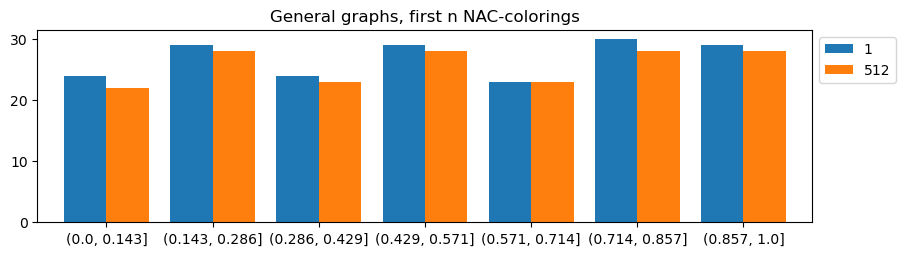

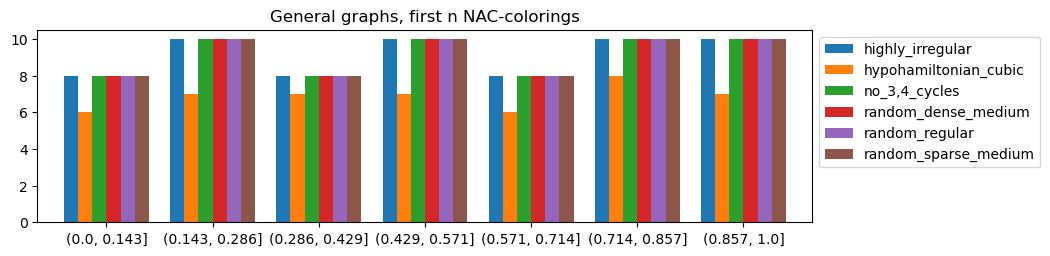

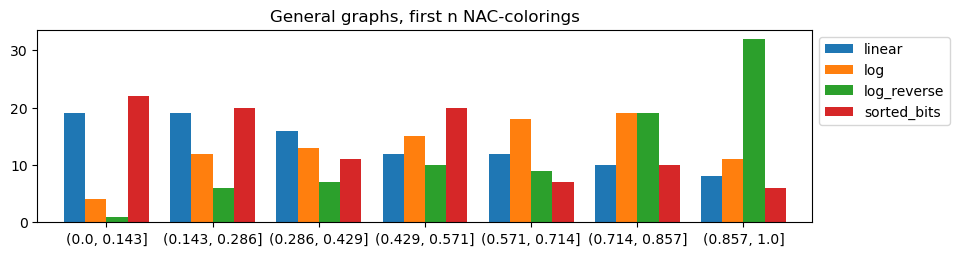

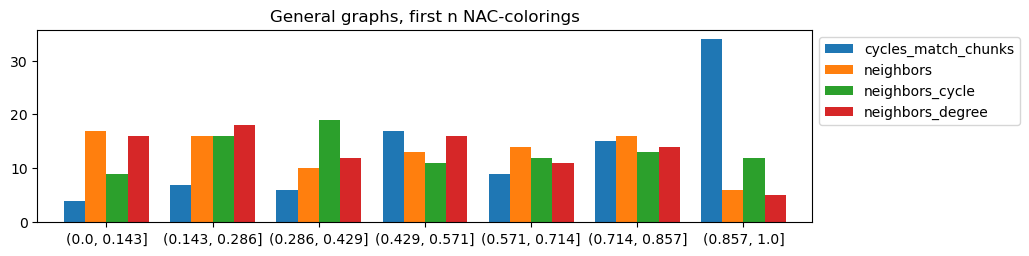

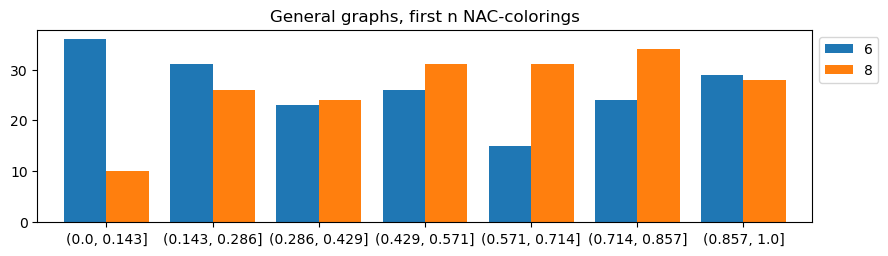

In [16]:
input = """
test_bench_NAC_colorings_general_first_n[1-highly_irregular-random-subgraphs-linear-neighbors_degree-6-smart]                         57.0668 (1.03)          59.1281 (1.00)          58.2770 (1.0)           1.0765 (inf)           58.6361 (1.02)          1.5460 (inf)           1;0  17.1594 (1.0)           3           1
test_bench_NAC_colorings_general_first_n[1-highly_irregular-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]                 57.6237 (1.04)          58.8619 (1.0)           58.2832 (1.00)          0.6230 (inf)           58.3639 (1.02)          0.9286 (inf)           1;0  17.1576 (1.00)          3           1
test_bench_NAC_colorings_general_first_n[1-highly_irregular-random-subgraphs-linear-neighbors-8-smart]                                57.7108 (1.05)          58.9286 (1.00)          58.3792 (1.00)          0.6175 (inf)           58.4981 (1.02)          0.9134 (inf)           1;0  17.1294 (1.00)          3           1
test_bench_NAC_colorings_general_first_n[1-highly_irregular-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]                     57.4610 (1.04)          59.1221 (1.00)          58.3987 (1.00)          0.8510 (inf)           58.6131 (1.02)          1.2458 (inf)           1;0  17.1237 (1.00)          3           1
test_bench_NAC_colorings_general_first_n[1-highly_irregular-random-subgraphs-linear-cycles_match_chunks-6-smart]                      58.2803 (1.06)          59.2046 (1.01)          58.6141 (1.01)          0.5128 (inf)           58.3575 (1.02)          0.6932 (inf)           1;0  17.0607 (0.99)          3           1
test_bench_NAC_colorings_general_first_n[1-highly_irregular-random-subgraphs-linear-neighbors_cycle-6-smart]                          57.2433 (1.04)          59.8932 (1.02)          58.6859 (1.01)          1.3405 (inf)           58.9210 (1.03)          1.9874 (inf)           1;0  17.0399 (0.99)          3           1
test_bench_NAC_colorings_general_first_n[1-highly_irregular-random-subgraphs-log-neighbors_degree-6-smart]                            57.8601 (1.05)          59.2245 (1.01)          58.7011 (1.01)          0.7355 (inf)           59.0187 (1.03)          1.0233 (inf)           1;0  17.0355 (0.99)          3           1
test_bench_NAC_colorings_general_first_n[1-highly_irregular-random-subgraphs-sorted_bits-neighbors_degree-8-smart]                    57.9713 (1.05)          59.9305 (1.02)          58.7053 (1.01)          1.0680 (inf)           58.2140 (1.02)          1.4694 (inf)           1;0  17.0343 (0.99)          3           1
test_bench_NAC_colorings_general_first_n[1-highly_irregular-random-subgraphs-log-neighbors-8-smart]                                   57.8752 (1.05)          59.3879 (1.01)          58.7403 (1.01)          0.7794 (inf)           58.9577 (1.03)          1.1345 (inf)           1;0  17.0241 (0.99)          3           1
test_bench_NAC_colorings_general_first_n[1-highly_irregular-random-subgraphs-log-neighbors_cycle-6-smart]                             57.9551 (1.05)          59.8413 (1.02)          58.7419 (1.01)          0.9812 (inf)           58.4291 (1.02)          1.4147 (inf)           1;0  17.0236 (0.99)          3           1
test_bench_NAC_colorings_general_first_n[1-highly_irregular-random-subgraphs-log_reverse-neighbors-8-smart]                           56.3791 (1.02)          61.6950 (1.05)          58.7962 (1.01)          2.6905 (inf)           58.3144 (1.02)          3.9869 (inf)           1;0  17.0079 (0.99)          3           1
test_bench_NAC_colorings_general_first_n[1-highly_irregular-random-subgraphs-log_reverse-cycles_match_chunks-8-smart]                 57.9419 (1.05)          60.4259 (1.03)          58.8827 (1.01)          1.3471 (inf)           58.2804 (1.02)          1.8630 (inf)           1;0  16.9829 (0.99)          3           1
test_bench_NAC_colorings_general_first_n[1-highly_irregular-random-subgraphs-log-cycles_match_chunks-6-smart]                         56.3540 (1.02)          60.7977 (1.03)          59.0594 (1.01)          2.3744 (inf)           60.0265 (1.05)          3.3327 (inf)           1;0  16.9321 (0.99)          3           1
test_bench_NAC_colorings_general_first_n[1-highly_irregular-random-subgraphs-sorted_bits-neighbors_degree-6-smart]                    58.2452 (1.05)          60.7141 (1.03)          59.1261 (1.01)          1.3780 (inf)           58.4191 (1.02)          1.8517 (inf)           1;0  16.9130 (0.99)          3           1
test_bench_NAC_colorings_general_first_n[1-highly_irregular-random-subgraphs-log-cycles_match_chunks-8-smart]                         58.3007 (1.06)          59.6835 (1.01)          59.1847 (1.02)          0.7676 (inf)           59.5697 (1.04)          1.0371 (inf)           1;0  16.8963 (0.98)          3           1
test_bench_NAC_colorings_general_first_n[1-highly_irregular-random-subgraphs-log-neighbors_degree-8-smart]                            57.5802 (1.04)          61.1693 (1.04)          59.2243 (1.02)          1.8134 (inf)           58.9234 (1.03)          2.6918 (inf)           1;0  16.8850 (0.98)          3           1
test_bench_NAC_colorings_general_first_n[1-highly_irregular-random-subgraphs-log_reverse-neighbors_degree-6-smart]                    58.6700 (1.06)          60.6775 (1.03)          59.3504 (1.02)          1.1494 (inf)           58.7039 (1.02)          1.5056 (inf)           1;0  16.8491 (0.98)          3           1
test_bench_NAC_colorings_general_first_n[1-highly_irregular-random-subgraphs-sorted_bits-neighbors-6-smart]                           57.8010 (1.05)          61.0037 (1.04)          59.3808 (1.02)          1.6018 (inf)           59.3377 (1.04)          2.4020 (inf)           1;0  16.8405 (0.98)          3           1
test_bench_NAC_colorings_general_first_n[1-highly_irregular-random-subgraphs-linear-neighbors-6-smart]                                58.1927 (1.05)          61.2904 (1.04)          59.4574 (1.02)          1.6252 (inf)           58.8890 (1.03)          2.3233 (inf)           1;0  16.8188 (0.98)          3           1
test_bench_NAC_colorings_general_first_n[1-highly_irregular-random-subgraphs-log-neighbors-6-smart]                                   58.3298 (1.06)          61.1674 (1.04)          59.5175 (1.02)          1.4742 (inf)           59.0554 (1.03)          2.1282 (inf)           1;0  16.8018 (0.98)          3           1
test_bench_NAC_colorings_general_first_n[1-highly_irregular-random-subgraphs-sorted_bits-neighbors_cycle-8-smart]                     55.2145 (1.0)           66.1885 (1.12)          59.5760 (1.02)          5.8230 (inf)           57.3251 (1.0)           8.2305 (inf)           1;0  16.7853 (0.98)          3           1
test_bench_NAC_colorings_general_first_n[1-highly_irregular-random-subgraphs-sorted_bits-cycles_match_chunks-8-smart]                 58.3283 (1.06)          60.3638 (1.03)          59.5995 (1.02)          1.1084 (inf)           60.1062 (1.05)          1.5266 (inf)           1;0  16.7787 (0.98)          3           1
test_bench_NAC_colorings_general_first_n[1-highly_irregular-random-subgraphs-linear-neighbors_cycle-8-smart]                          59.1348 (1.07)          60.5044 (1.03)          59.6204 (1.02)          0.7668 (inf)           59.2219 (1.03)          1.0272 (inf)           1;0  16.7728 (0.98)          3           1
test_bench_NAC_colorings_general_first_n[1-highly_irregular-random-subgraphs-linear-neighbors_degree-8-smart]                         57.6276 (1.04)          62.0465 (1.05)          59.7228 (1.02)          2.2183 (inf)           59.4944 (1.04)          3.3141 (inf)           1;0  16.7440 (0.98)          3           1
test_bench_NAC_colorings_general_first_n[1-highly_irregular-random-subgraphs-log-neighbors_cycle-8-smart]                             58.5598 (1.06)          60.8287 (1.03)          59.7989 (1.03)          1.1488 (inf)           60.0082 (1.05)          1.7017 (inf)           1;0  16.7227 (0.97)          3           1
test_bench_NAC_colorings_general_first_n[1-highly_irregular-random-subgraphs-sorted_bits-neighbors-8-smart]                           58.2958 (1.06)          61.3833 (1.04)          59.8229 (1.03)          1.5440 (inf)           59.7896 (1.04)          2.3156 (inf)           1;0  16.7160 (0.97)          3           1
test_bench_NAC_colorings_general_first_n[1-highly_irregular-random-subgraphs-log_reverse-neighbors_cycle-6-smart]                     57.6238 (1.04)          61.5832 (1.05)          59.8531 (1.03)          2.0264 (inf)           60.3524 (1.05)          2.9696 (inf)           1;0  16.7076 (0.97)          3           1
test_bench_NAC_colorings_general_first_n[1-highly_irregular-random-subgraphs-log_reverse-neighbors_cycle-8-smart]                     59.7270 (1.08)          60.4133 (1.03)          59.9929 (1.03)          0.3683 (inf)           59.8383 (1.04)          0.5147 (inf)           1;0  16.6686 (0.97)          3           1
test_bench_NAC_colorings_general_first_n[1-highly_irregular-random-subgraphs-log_reverse-cycles_match_chunks-6-smart]                 59.7833 (1.08)          62.3899 (1.06)          60.7418 (1.04)          1.4337 (inf)           60.0521 (1.05)          1.9550 (inf)           1;0  16.4631 (0.96)          3           1
test_bench_NAC_colorings_general_first_n[1-highly_irregular-random-subgraphs-log_reverse-neighbors-6-smart]                           58.6741 (1.06)          62.3422 (1.06)          60.9337 (1.05)          1.9766 (inf)           61.7848 (1.08)          2.7511 (inf)           1;0  16.4113 (0.96)          3           1
test_bench_NAC_colorings_general_first_n[1-highly_irregular-random-subgraphs-linear-cycles_match_chunks-8-smart]                      58.1027 (1.05)          65.7957 (1.12)          60.9368 (1.05)          4.2273 (inf)           58.9120 (1.03)          5.7697 (inf)           1;0  16.4105 (0.96)          3           1
test_bench_NAC_colorings_general_first_n[1-highly_irregular-random-subgraphs-log_reverse-neighbors_degree-8-smart]                    57.8459 (1.05)          65.0230 (1.10)          61.0656 (1.05)          3.6450 (inf)           60.3280 (1.05)          5.3829 (inf)           1;0  16.3758 (0.95)          3           1

test_bench_NAC_colorings_general_first_n[1-random_sparse_medium-random-subgraphs-sorted_bits-neighbors-6-smart]                      101.6366 (1.84)         105.7098 (1.80)         103.6356 (1.78)          2.0376 (inf)          103.5603 (1.81)          3.0549 (inf)           1;0   9.6492 (0.56)          3           1
test_bench_NAC_colorings_general_first_n[1-random_sparse_medium-random-subgraphs-linear-neighbors-6-smart]                           101.7311 (1.84)         106.4286 (1.81)         103.9960 (1.78)          2.3532 (inf)          103.8284 (1.81)          3.5231 (inf)           1;0   9.6158 (0.56)          3           1
test_bench_NAC_colorings_general_first_n[1-random_sparse_medium-random-subgraphs-linear-neighbors_degree-6-smart]                    104.0751 (1.88)         108.0862 (1.84)         106.3708 (1.83)          2.0675 (inf)          106.9510 (1.87)          3.0083 (inf)           1;0   9.4011 (0.55)          3           1
test_bench_NAC_colorings_general_first_n[1-random_sparse_medium-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]                103.9868 (1.88)         109.0709 (1.85)         106.9575 (1.84)          2.6483 (inf)          107.8148 (1.88)          3.8131 (inf)           1;0   9.3495 (0.54)          3           1
test_bench_NAC_colorings_general_first_n[1-random_sparse_medium-random-subgraphs-sorted_bits-neighbors_degree-6-smart]                99.9008 (1.81)         112.9882 (1.92)         108.1154 (1.86)          7.1551 (inf)          111.4572 (1.94)          9.8156 (inf)           1;0   9.2494 (0.54)          3           1
test_bench_NAC_colorings_general_first_n[1-random_sparse_medium-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]            109.0678 (1.98)         116.7403 (1.98)         112.3134 (1.93)          3.9703 (inf)          111.1321 (1.94)          5.7544 (inf)           1;0   8.9037 (0.52)          3           1
test_bench_NAC_colorings_general_first_n[1-random_sparse_medium-random-subgraphs-linear-cycles_match_chunks-6-smart]                 110.4437 (2.00)         116.8673 (1.99)         114.1873 (1.96)          3.3413 (inf)          115.2510 (2.01)          4.8177 (inf)           1;0   8.7575 (0.51)          3           1
test_bench_NAC_colorings_general_first_n[1-random_sparse_medium-random-subgraphs-sorted_bits-neighbors_cycle-8-smart]                118.3309 (2.14)         139.7182 (2.37)         126.4580 (2.17)         11.5809 (inf)          121.3249 (2.12)         16.0405 (inf)           1;0   7.9078 (0.46)          3           1
test_bench_NAC_colorings_general_first_n[1-random_sparse_medium-random-subgraphs-sorted_bits-neighbors-8-smart]                      124.2742 (2.25)         130.7295 (2.22)         126.7266 (2.17)          3.4958 (inf)          125.1762 (2.18)          4.8415 (inf)           1;0   7.8910 (0.46)          3           1
test_bench_NAC_colorings_general_first_n[1-random_sparse_medium-random-subgraphs-sorted_bits-neighbors_degree-8-smart]               119.8717 (2.17)         143.0625 (2.43)         128.0156 (2.20)         13.0457 (inf)          121.1127 (2.11)         17.3930 (inf)           1;0   7.8115 (0.46)          3           1
test_bench_NAC_colorings_general_first_n[1-random_sparse_medium-random-subgraphs-linear-neighbors-8-smart]                           121.8875 (2.21)         138.8804 (2.36)         130.3526 (2.24)          8.4966 (inf)          130.2899 (2.27)         12.7447 (inf)           1;0   7.6715 (0.45)          3           1
test_bench_NAC_colorings_general_first_n[1-random_sparse_medium-random-subgraphs-linear-neighbors_cycle-8-smart]                     126.0976 (2.28)         138.2475 (2.35)         132.0143 (2.27)          6.0812 (inf)          131.6979 (2.30)          9.1125 (inf)           1;0   7.5749 (0.44)          3           1
test_bench_NAC_colorings_general_first_n[1-random_sparse_medium-random-subgraphs-linear-neighbors_degree-8-smart]                    127.9147 (2.32)         135.6664 (2.30)         132.9009 (2.28)          4.3267 (inf)          135.1214 (2.36)          5.8138 (inf)           1;0   7.5244 (0.44)          3           1
test_bench_NAC_colorings_general_first_n[1-random_sparse_medium-random-subgraphs-sorted_bits-cycles_match_chunks-8-smart]            134.4583 (2.44)         151.6297 (2.58)         145.0245 (2.49)          9.2456 (inf)          148.9855 (2.60)         12.8785 (inf)           1;0   6.8954 (0.40)          3           1
test_bench_NAC_colorings_general_first_n[1-random_sparse_medium-random-subgraphs-linear-neighbors_cycle-6-smart]                     105.5122 (1.91)         238.0674 (4.04)         150.2112 (2.58)         76.0896 (inf)          107.0541 (1.87)         99.4164 (inf)           1;0   6.6573 (0.39)          3           1
test_bench_NAC_colorings_general_first_n[1-random_sparse_medium-random-subgraphs-linear-cycles_match_chunks-8-smart]                 140.0680 (2.54)         163.9364 (2.79)         155.0993 (2.66)         13.0844 (inf)          161.2936 (2.81)         17.9013 (inf)           1;0   6.4475 (0.38)          3           1
test_bench_NAC_colorings_general_first_n[1-random_sparse_medium-random-subgraphs-log_reverse-neighbors_cycle-8-smart]                248.0106 (4.49)         318.5583 (5.41)         281.3812 (4.83)         35.4276 (inf)          277.5747 (4.84)         52.9108 (inf)           1;0   3.5539 (0.21)          3           1
test_bench_NAC_colorings_general_first_n[1-random_sparse_medium-random-subgraphs-log-neighbors_cycle-6-smart]                        286.5982 (5.19)         381.8007 (6.49)         319.5216 (5.48)         53.9648 (inf)          290.1658 (5.06)         71.4018 (inf)           1;0   3.1297 (0.18)          3           1
test_bench_NAC_colorings_general_first_n[1-random_sparse_medium-random-subgraphs-log_reverse-neighbors-8-smart]                      258.0164 (4.67)         456.7845 (7.76)         335.5912 (5.76)        106.3208 (inf)          291.9729 (5.09)        149.0761 (inf)           1;0   2.9798 (0.17)          3           1
test_bench_NAC_colorings_general_first_n[1-random_sparse_medium-random-subgraphs-log-neighbors-6-smart]                              267.8915 (4.85)         469.3620 (7.97)         350.4431 (6.01)        105.5440 (inf)          314.0757 (5.48)        151.1028 (inf)           1;0   2.8535 (0.17)          3           1
test_bench_NAC_colorings_general_first_n[1-random_sparse_medium-random-subgraphs-log-neighbors_degree-6-smart]                       273.1462 (4.95)         629.0961 (10.69)        392.3188 (6.73)        205.0567 (inf)          274.7140 (4.79)        266.9625 (inf)           1;0   2.5489 (0.15)          3           1
test_bench_NAC_colorings_general_first_n[1-random_sparse_medium-random-subgraphs-log-cycles_match_chunks-6-smart]                    358.7538 (6.50)         474.3531 (8.06)         397.8657 (6.83)         66.2457 (inf)          360.4902 (6.29)         86.6995 (inf)           1;0   2.5134 (0.15)          3           1
test_bench_NAC_colorings_general_first_n[1-random_sparse_medium-random-subgraphs-log_reverse-cycles_match_chunks-8-smart]            442.1445 (8.01)         915.5439 (15.55)        749.8369 (12.87)       266.7333 (inf)          891.8222 (15.56)       355.0496 (inf)           1;0   1.3336 (0.08)          3           1
test_bench_NAC_colorings_general_first_n[1-random_sparse_medium-random-subgraphs-log_reverse-neighbors_degree-8-smart]               425.9823 (7.72)       2,175.0461 (36.95)      1,012.1380 (17.37)     1,007.1190 (inf)          435.3855 (7.60)      1,311.7978 (inf)           1;0   0.9880 (0.06)          3           1
test_bench_NAC_colorings_general_first_n[1-random_sparse_medium-random-subgraphs-log-neighbors_cycle-8-smart]                        909.6502 (16.47)      1,606.4343 (27.29)      1,151.1473 (19.75)       394.5334 (inf)          937.3574 (16.35)       522.5881 (inf)           1;0   0.8687 (0.05)          3           1
test_bench_NAC_colorings_general_first_n[1-random_sparse_medium-random-subgraphs-log-neighbors-8-smart]                              915.0157 (16.57)      1,626.9373 (27.64)      1,155.8046 (19.83)       408.0462 (inf)          925.4609 (16.14)       533.9412 (inf)           1;0   0.8652 (0.05)          3           1
test_bench_NAC_colorings_general_first_n[1-random_sparse_medium-random-subgraphs-log-neighbors_degree-8-smart]                       296.9969 (5.38)       1,665.0826 (28.29)      1,206.5932 (20.70)       787.7422 (inf)        1,657.7001 (28.92)     1,026.0643 (inf)           1;0   0.8288 (0.05)          3           1
test_bench_NAC_colorings_general_first_n[1-random_sparse_medium-random-subgraphs-log-cycles_match_chunks-8-smart]                  1,297.4233 (23.50)      1,704.7721 (28.96)      1,558.5085 (26.74)       226.6522 (inf)        1,673.3299 (29.19)       305.5116 (inf)           1;0   0.6416 (0.04)          3           1
test_bench_NAC_colorings_general_first_n[1-random_sparse_medium-random-subgraphs-log_reverse-neighbors_degree-6-smart]             2,684.2787 (48.62)      7,679.9017 (130.47)     5,366.6861 (92.09)     2,518.1916 (inf)        5,735.8780 (100.06)    3,746.7172 (inf)           1;0   0.1863 (0.01)          3           1
test_bench_NAC_colorings_general_first_n[1-random_sparse_medium-random-subgraphs-log_reverse-neighbors-6-smart]                    4,310.4197 (78.07)     12,557.2551 (213.33)     9,278.2002 (159.21)    4,375.0908 (inf)       10,966.9258 (191.31)    6,185.1266 (inf)           1;0   0.1078 (0.01)          3           1
test_bench_NAC_colorings_general_first_n[1-random_sparse_medium-random-subgraphs-log_reverse-neighbors_cycle-6-smart]              9,220.3799 (166.99)    12,702.2452 (215.80)    11,287.8337 (193.69)    1,830.4903 (inf)       11,940.8758 (208.30)    2,611.3990 (inf)           1;0   0.0886 (0.01)          3           1
test_bench_NAC_colorings_general_first_n[1-random_sparse_medium-random-subgraphs-log_reverse-cycles_match_chunks-6-smart]          9,591.0317 (173.71)    16,930.4174 (287.63)    14,343.6141 (246.13)    4,121.2371 (inf)       16,509.3932 (288.00)    5,504.5393 (inf)           1;0   0.0697 (0.00)          3           1

test_bench_NAC_colorings_general_first_n[1-random_dense_medium-random-subgraphs-sorted_bits-neighbors-8-smart]                       132.7614 (2.40)         134.7844 (2.29)         133.8791 (2.30)          1.0281 (inf)          134.0914 (2.34)          1.5173 (inf)           1;0   7.4694 (0.44)          3           1
test_bench_NAC_colorings_general_first_n[1-random_dense_medium-random-subgraphs-sorted_bits-neighbors_degree-6-smart]                130.5223 (2.36)         140.4162 (2.39)         134.8933 (2.31)          5.0466 (inf)          133.7415 (2.33)          7.4205 (inf)           1;0   7.4133 (0.43)          3           1
test_bench_NAC_colorings_general_first_n[1-random_dense_medium-random-subgraphs-sorted_bits-neighbors-6-smart]                       129.7422 (2.35)         142.6116 (2.42)         135.5023 (2.33)          6.5399 (inf)          134.1531 (2.34)          9.6520 (inf)           1;0   7.3799 (0.43)          3           1
test_bench_NAC_colorings_general_first_n[1-random_dense_medium-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]                 133.0874 (2.41)         138.5125 (2.35)         135.9174 (2.33)          2.7202 (inf)          136.1522 (2.38)          4.0689 (inf)           1;0   7.3574 (0.43)          3           1
test_bench_NAC_colorings_general_first_n[1-random_dense_medium-random-subgraphs-sorted_bits-neighbors_cycle-8-smart]                 135.8773 (2.46)         139.5947 (2.37)         137.8275 (2.37)          1.8654 (inf)          138.0104 (2.41)          2.7880 (inf)           1;0   7.2554 (0.42)          3           1
test_bench_NAC_colorings_general_first_n[1-random_dense_medium-random-subgraphs-log-neighbors_cycle-8-smart]                         137.8255 (2.50)         140.3330 (2.38)         139.3991 (2.39)          1.3706 (inf)          140.0386 (2.44)          1.8806 (inf)           1;0   7.1736 (0.42)          3           1
test_bench_NAC_colorings_general_first_n[1-random_dense_medium-random-subgraphs-log_reverse-neighbors_cycle-6-smart]                 140.7418 (2.55)         143.0445 (2.43)         141.7920 (2.43)          1.1646 (inf)          141.5895 (2.47)          1.7270 (inf)           1;0   7.0526 (0.41)          3           1
test_bench_NAC_colorings_general_first_n[1-random_dense_medium-random-subgraphs-log_reverse-neighbors_cycle-8-smart]                 139.4728 (2.53)         145.6099 (2.47)         142.0127 (2.44)          3.2023 (inf)          140.9553 (2.46)          4.6028 (inf)           1;0   7.0416 (0.41)          3           1
test_bench_NAC_colorings_general_first_n[1-random_dense_medium-random-subgraphs-log-neighbors_cycle-6-smart]                         140.1281 (2.54)         146.8619 (2.50)         143.2281 (2.46)          3.3985 (inf)          142.6943 (2.49)          5.0504 (inf)           1;0   6.9819 (0.41)          3           1
test_bench_NAC_colorings_general_first_n[1-random_dense_medium-random-subgraphs-linear-neighbors_cycle-8-smart]                      141.6967 (2.57)         146.5123 (2.49)         143.7421 (2.47)          2.4883 (inf)          143.0172 (2.49)          3.6117 (inf)           1;0   6.9569 (0.41)          3           1
test_bench_NAC_colorings_general_first_n[1-random_dense_medium-random-subgraphs-linear-neighbors_cycle-6-smart]                      141.3465 (2.56)         146.9482 (2.50)         144.0528 (2.47)          2.8056 (inf)          143.8637 (2.51)          4.2012 (inf)           1;0   6.9419 (0.40)          3           1
test_bench_NAC_colorings_general_first_n[1-random_dense_medium-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]             145.3175 (2.63)         149.6507 (2.54)         147.3686 (2.53)          2.1758 (inf)          147.1376 (2.57)          3.2499 (inf)           1;0   6.7857 (0.40)          3           1
test_bench_NAC_colorings_general_first_n[1-random_dense_medium-random-subgraphs-sorted_bits-cycles_match_chunks-8-smart]             145.5810 (2.64)         153.0284 (2.60)         148.4916 (2.55)          3.9811 (inf)          146.8655 (2.56)          5.5856 (inf)           1;0   6.7344 (0.39)          3           1
test_bench_NAC_colorings_general_first_n[1-random_dense_medium-random-subgraphs-log-neighbors-6-smart]                               145.0661 (2.63)         155.9674 (2.65)         149.9276 (2.57)          5.5453 (inf)          148.7494 (2.59)          8.1760 (inf)           1;0   6.6699 (0.39)          3           1
test_bench_NAC_colorings_general_first_n[1-random_dense_medium-random-subgraphs-linear-neighbors_degree-8-smart]                     145.8228 (2.64)         157.0268 (2.67)         150.8195 (2.59)          5.6993 (inf)          149.6089 (2.61)          8.4030 (inf)           1;0   6.6304 (0.39)          3           1
test_bench_NAC_colorings_general_first_n[1-random_dense_medium-random-subgraphs-log_reverse-neighbors-6-smart]                       140.7731 (2.55)         162.7764 (2.77)         151.4133 (2.60)         11.0195 (inf)          150.6903 (2.63)         16.5025 (inf)           1;0   6.6044 (0.38)          3           1
test_bench_NAC_colorings_general_first_n[1-random_dense_medium-random-subgraphs-log-neighbors_degree-8-smart]                        140.3477 (2.54)         159.7776 (2.71)         152.0680 (2.61)         10.3172 (inf)          156.0786 (2.72)         14.5724 (inf)           1;0   6.5760 (0.38)          3           1
test_bench_NAC_colorings_general_first_n[1-random_dense_medium-random-subgraphs-log_reverse-neighbors_degree-8-smart]                146.1578 (2.65)         158.0049 (2.68)         152.2474 (2.61)          5.9306 (inf)          152.5795 (2.66)          8.8854 (inf)           1;0   6.5683 (0.38)          3           1
test_bench_NAC_colorings_general_first_n[1-random_dense_medium-random-subgraphs-log_reverse-neighbors-8-smart]                       143.0552 (2.59)         161.3951 (2.74)         152.4072 (2.62)          9.1754 (inf)          152.7712 (2.66)         13.7549 (inf)           1;0   6.5614 (0.38)          3           1
test_bench_NAC_colorings_general_first_n[1-random_dense_medium-random-subgraphs-linear-neighbors-8-smart]                            144.2073 (2.61)         158.8147 (2.70)         153.1297 (2.63)          7.8233 (inf)          156.3671 (2.73)         10.9556 (inf)           1;0   6.5304 (0.38)          3           1
test_bench_NAC_colorings_general_first_n[1-random_dense_medium-random-subgraphs-log-neighbors-8-smart]                               150.2808 (2.72)         159.2328 (2.71)         153.3451 (2.63)          5.1003 (inf)          150.5218 (2.63)          6.7140 (inf)           1;0   6.5212 (0.38)          3           1
test_bench_NAC_colorings_general_first_n[1-random_dense_medium-random-subgraphs-log_reverse-neighbors_degree-6-smart]                142.7642 (2.59)         159.0207 (2.70)         153.6008 (2.64)          9.3847 (inf)          159.0173 (2.77)         12.1924 (inf)           1;0   6.5104 (0.38)          3           1
test_bench_NAC_colorings_general_first_n[1-random_dense_medium-random-subgraphs-log-neighbors_degree-6-smart]                        139.4644 (2.53)         166.8401 (2.83)         154.1135 (2.64)         13.7888 (inf)          156.0361 (2.72)         20.5318 (inf)           1;0   6.4887 (0.38)          3           1
test_bench_NAC_colorings_general_first_n[1-random_dense_medium-random-subgraphs-linear-neighbors-6-smart]                            146.2095 (2.65)         160.3277 (2.72)         155.1051 (2.66)          7.7427 (inf)          158.7781 (2.77)         10.5886 (inf)           1;0   6.4472 (0.38)          3           1
test_bench_NAC_colorings_general_first_n[1-random_dense_medium-random-subgraphs-sorted_bits-neighbors_degree-8-smart]                137.3747 (2.49)         261.4795 (4.44)         180.0591 (3.09)         70.5398 (inf)          141.3230 (2.47)         93.0786 (inf)           1;0   5.5537 (0.32)          3           1
test_bench_NAC_colorings_general_first_n[1-random_dense_medium-random-subgraphs-linear-neighbors_degree-6-smart]                     147.9029 (2.68)         273.6957 (4.65)         191.5194 (3.29)         71.2117 (inf)          152.9595 (2.67)         94.3446 (inf)           1;0   5.2214 (0.30)          3           1
test_bench_NAC_colorings_general_first_n[1-random_dense_medium-random-subgraphs-log-cycles_match_chunks-6-smart]                     262.7212 (4.76)         272.6405 (4.63)         267.0249 (4.58)          5.0882 (inf)          265.7129 (4.64)          7.4395 (inf)           1;0   3.7450 (0.22)          3           1
test_bench_NAC_colorings_general_first_n[1-random_dense_medium-random-subgraphs-log_reverse-cycles_match_chunks-6-smart]             262.4609 (4.75)         271.5235 (4.61)         267.5612 (4.59)          4.6372 (inf)          268.6993 (4.69)          6.7969 (inf)           1;0   3.7375 (0.22)          3           1
test_bench_NAC_colorings_general_first_n[1-random_dense_medium-random-subgraphs-linear-cycles_match_chunks-6-smart]                  265.0250 (4.80)         276.4997 (4.70)         271.0440 (4.65)          5.7580 (inf)          271.6072 (4.74)          8.6060 (inf)           1;0   3.6894 (0.22)          3           1
test_bench_NAC_colorings_general_first_n[1-random_dense_medium-random-subgraphs-log_reverse-cycles_match_chunks-8-smart]             268.5072 (4.86)         274.8044 (4.67)         271.5332 (4.66)          3.1557 (inf)          271.2881 (4.73)          4.7229 (inf)           1;0   3.6828 (0.21)          3           1
test_bench_NAC_colorings_general_first_n[1-random_dense_medium-random-subgraphs-linear-cycles_match_chunks-8-smart]                  267.3084 (4.84)         274.9060 (4.67)         271.7990 (4.66)          3.9833 (inf)          273.1826 (4.77)          5.6982 (inf)           1;0   3.6792 (0.21)          3           1
test_bench_NAC_colorings_general_first_n[1-random_dense_medium-random-subgraphs-log-cycles_match_chunks-8-smart]                     270.9287 (4.91)         273.7172 (4.65)         271.9987 (4.67)          1.5031 (inf)          271.3502 (4.73)          2.0914 (inf)           1;0   3.6765 (0.21)          3           1

test_bench_NAC_colorings_general_first_n[1-no_3,4_cycles-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]                   198.9604 (3.60)         212.5886 (3.61)         204.7347 (3.51)          7.0481 (inf)          202.6552 (3.54)         10.2212 (inf)           1;0   4.8844 (0.28)          3           1
test_bench_NAC_colorings_general_first_n[1-no_3,4_cycles-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]                       210.6723 (3.82)         221.6366 (3.77)         216.1096 (3.71)          5.4827 (inf)          216.0200 (3.77)          8.2232 (inf)           1;0   4.6273 (0.27)          3           1
test_bench_NAC_colorings_general_first_n[1-no_3,4_cycles-random-subgraphs-sorted_bits-neighbors-6-smart]                             205.9405 (3.73)         227.7637 (3.87)         217.6890 (3.74)         11.0075 (inf)          219.3628 (3.83)         16.3674 (inf)           1;0   4.5937 (0.27)          3           1
test_bench_NAC_colorings_general_first_n[1-no_3,4_cycles-random-subgraphs-sorted_bits-neighbors_degree-6-smart]                      214.4279 (3.88)         227.2638 (3.86)         220.9481 (3.79)          6.4204 (inf)          221.1525 (3.86)          9.6269 (inf)           1;0   4.5260 (0.26)          3           1
test_bench_NAC_colorings_general_first_n[1-no_3,4_cycles-random-subgraphs-linear-neighbors_degree-6-smart]                           247.1193 (4.48)         257.1565 (4.37)         250.7322 (4.30)          5.5780 (inf)          247.9207 (4.32)          7.5279 (inf)           1;0   3.9883 (0.23)          3           1
test_bench_NAC_colorings_general_first_n[1-no_3,4_cycles-random-subgraphs-linear-neighbors-6-smart]                                  247.4272 (4.48)         256.3012 (4.35)         251.5330 (4.32)          4.4739 (inf)          250.8706 (4.38)          6.6555 (inf)           1;0   3.9756 (0.23)          3           1
test_bench_NAC_colorings_general_first_n[1-no_3,4_cycles-random-subgraphs-linear-cycles_match_chunks-6-smart]                        247.0316 (4.47)         267.3934 (4.54)         254.7705 (4.37)         11.0245 (inf)          249.8866 (4.36)         15.2713 (inf)           1;0   3.9251 (0.23)          3           1
test_bench_NAC_colorings_general_first_n[1-no_3,4_cycles-random-subgraphs-linear-neighbors_cycle-6-smart]                            255.2075 (4.62)         260.9979 (4.43)         258.9819 (4.44)          3.2713 (inf)          260.7404 (4.55)          4.3428 (inf)           1;0   3.8613 (0.23)          3           1
test_bench_NAC_colorings_general_first_n[1-no_3,4_cycles-random-subgraphs-log-neighbors-6-smart]                                     292.4582 (5.30)         315.2157 (5.36)         306.0677 (5.25)         12.0168 (inf)          310.5292 (5.42)         17.0681 (inf)           1;0   3.2673 (0.19)          3           1
test_bench_NAC_colorings_general_first_n[1-no_3,4_cycles-random-subgraphs-log-neighbors_degree-6-smart]                              316.1735 (5.73)         321.6411 (5.46)         318.1040 (5.46)          3.0675 (inf)          316.4974 (5.52)          4.1007 (inf)           1;0   3.1436 (0.18)          3           1
test_bench_NAC_colorings_general_first_n[1-no_3,4_cycles-random-subgraphs-log-neighbors_cycle-6-smart]                               308.2750 (5.58)         346.6748 (5.89)         323.8997 (5.56)         20.1738 (inf)          316.7493 (5.53)         28.7998 (inf)           1;0   3.0874 (0.18)          3           1
test_bench_NAC_colorings_general_first_n[1-no_3,4_cycles-random-subgraphs-log-cycles_match_chunks-6-smart]                           326.7670 (5.92)         361.8866 (6.15)         341.2769 (5.86)         18.3372 (inf)          335.1771 (5.85)         26.3397 (inf)           1;0   2.9302 (0.17)          3           1
test_bench_NAC_colorings_general_first_n[1-no_3,4_cycles-random-subgraphs-sorted_bits-neighbors_cycle-8-smart]                       329.0957 (5.96)         428.0061 (7.27)         364.2143 (6.25)         55.3392 (inf)          335.5412 (5.85)         74.1828 (inf)           1;0   2.7456 (0.16)          3           1
test_bench_NAC_colorings_general_first_n[1-no_3,4_cycles-random-subgraphs-sorted_bits-neighbors-8-smart]                             357.6598 (6.48)         403.8502 (6.86)         387.8684 (6.66)         26.1761 (inf)          402.0952 (7.01)         34.6428 (inf)           1;0   2.5782 (0.15)          3           1
test_bench_NAC_colorings_general_first_n[1-no_3,4_cycles-random-subgraphs-sorted_bits-neighbors_degree-8-smart]                      370.6182 (6.71)         455.9440 (7.75)         414.4636 (7.11)         42.7120 (inf)          416.8285 (7.27)         63.9944 (inf)           1;0   2.4128 (0.14)          3           1
test_bench_NAC_colorings_general_first_n[1-no_3,4_cycles-random-subgraphs-sorted_bits-cycles_match_chunks-8-smart]                   465.7126 (8.43)         513.9064 (8.73)         494.1968 (8.48)         25.2667 (inf)          502.9714 (8.77)         36.1454 (inf)           1;0   2.0235 (0.12)          3           1
test_bench_NAC_colorings_general_first_n[1-no_3,4_cycles-random-subgraphs-linear-neighbors-8-smart]                                  615.2607 (11.14)        666.9477 (11.33)        648.5467 (11.13)        28.8800 (inf)          663.4316 (11.57)        38.7652 (inf)           1;0   1.5419 (0.09)          3           1
test_bench_NAC_colorings_general_first_n[1-no_3,4_cycles-random-subgraphs-log-neighbors_degree-8-smart]                              602.6874 (10.92)        692.6331 (11.77)        650.0926 (11.16)        45.1698 (inf)          654.9574 (11.43)        67.4593 (inf)           1;0   1.5382 (0.09)          3           1
test_bench_NAC_colorings_general_first_n[1-no_3,4_cycles-random-subgraphs-linear-neighbors_degree-8-smart]                           604.7357 (10.95)        695.7770 (11.82)        653.8670 (11.22)        45.9482 (inf)          661.0884 (11.53)        68.2809 (inf)           1;0   1.5294 (0.09)          3           1
test_bench_NAC_colorings_general_first_n[1-no_3,4_cycles-random-subgraphs-linear-neighbors_cycle-8-smart]                            639.0033 (11.57)        679.2032 (11.54)        653.8799 (11.22)        22.0422 (inf)          643.4332 (11.22)        30.1499 (inf)           1;0   1.5293 (0.09)          3           1
test_bench_NAC_colorings_general_first_n[1-no_3,4_cycles-random-subgraphs-log-neighbors-8-smart]                                     626.6838 (11.35)        694.6672 (11.80)        668.1941 (11.47)        36.4009 (inf)          683.2313 (11.92)        50.9876 (inf)           1;0   1.4966 (0.09)          3           1
test_bench_NAC_colorings_general_first_n[1-no_3,4_cycles-random-subgraphs-log-neighbors_cycle-8-smart]                               660.1040 (11.96)        697.7746 (11.85)        674.7667 (11.58)        20.1743 (inf)          666.4213 (11.63)        28.2529 (inf)           1;0   1.4820 (0.09)          3           1
test_bench_NAC_colorings_general_first_n[1-no_3,4_cycles-random-subgraphs-linear-cycles_match_chunks-8-smart]                        758.3004 (13.73)        824.1764 (14.00)        781.9887 (13.42)        36.6276 (inf)          763.4893 (13.32)        49.4070 (inf)           1;0   1.2788 (0.07)          3           1
test_bench_NAC_colorings_general_first_n[1-no_3,4_cycles-random-subgraphs-log-cycles_match_chunks-8-smart]                           781.1742 (14.15)        841.7067 (14.30)        805.4617 (13.82)        31.9888 (inf)          793.5041 (13.84)        45.3993 (inf)           1;0   1.2415 (0.07)          3           1
test_bench_NAC_colorings_general_first_n[1-no_3,4_cycles-random-subgraphs-log_reverse-neighbors-8-smart]                             871.5699 (15.79)      1,408.3590 (23.93)      1,119.9332 (19.22)       270.6278 (inf)        1,079.8709 (18.84)       402.5918 (inf)           1;0   0.8929 (0.05)          3           1
test_bench_NAC_colorings_general_first_n[1-no_3,4_cycles-random-subgraphs-log_reverse-neighbors_degree-8-smart]                    1,128.4729 (20.44)      1,165.2530 (19.80)      1,146.8216 (19.68)        18.3902 (inf)        1,146.7389 (20.00)        27.5851 (inf)           1;0   0.8720 (0.05)          3           1
test_bench_NAC_colorings_general_first_n[1-no_3,4_cycles-random-subgraphs-log_reverse-neighbors_cycle-8-smart]                     1,037.7015 (18.79)      1,362.4136 (23.15)      1,226.8211 (21.05)       168.8441 (inf)        1,280.3481 (22.33)       243.5340 (inf)           1;0   0.8151 (0.05)          3           1
test_bench_NAC_colorings_general_first_n[1-no_3,4_cycles-random-subgraphs-log_reverse-neighbors-6-smart]                           1,472.5978 (26.67)      1,484.6138 (25.22)      1,479.0994 (25.38)         6.0685 (inf)        1,480.0866 (25.82)         9.0120 (inf)           1;0   0.6761 (0.04)          3           1
test_bench_NAC_colorings_general_first_n[1-no_3,4_cycles-random-subgraphs-log_reverse-neighbors_degree-6-smart]                    1,377.0051 (24.94)      1,738.8584 (29.54)      1,543.4831 (26.49)       182.6492 (inf)        1,514.5858 (26.42)       271.3900 (inf)           1;0   0.6479 (0.04)          3           1
test_bench_NAC_colorings_general_first_n[1-no_3,4_cycles-random-subgraphs-log_reverse-neighbors_cycle-6-smart]                     1,367.9578 (24.78)      1,895.5731 (32.20)      1,651.3353 (28.34)       265.9764 (inf)        1,690.4751 (29.49)       395.7115 (inf)           1;0   0.6056 (0.04)          3           1
test_bench_NAC_colorings_general_first_n[1-no_3,4_cycles-random-subgraphs-log_reverse-cycles_match_chunks-8-smart]                 1,675.1510 (30.34)      2,387.1723 (40.56)      1,950.1784 (33.46)       382.6466 (inf)        1,788.2120 (31.19)       534.0160 (inf)           1;0   0.5128 (0.03)          3           1
test_bench_NAC_colorings_general_first_n[1-no_3,4_cycles-random-subgraphs-log_reverse-cycles_match_chunks-6-smart]                 1,927.9517 (34.92)      2,525.3745 (42.90)      2,166.1938 (37.17)       316.5409 (inf)        2,045.2552 (35.68)       448.0671 (inf)           1;0   0.4616 (0.03)          3           1

test_bench_NAC_colorings_general_first_n[1-random_regular-random-subgraphs-sorted_bits-neighbors-6-smart]                            276.2376 (5.00)         308.3873 (5.24)         292.1565 (5.01)         16.0772 (inf)          291.8445 (5.09)         24.1123 (inf)           1;0   3.4228 (0.20)          3           1
test_bench_NAC_colorings_general_first_n[1-random_regular-random-subgraphs-sorted_bits-neighbors_degree-6-smart]                     278.7322 (5.05)         307.7276 (5.23)         296.0729 (5.08)         15.3112 (inf)          301.7590 (5.26)         21.7466 (inf)           1;0   3.3775 (0.20)          3           1
test_bench_NAC_colorings_general_first_n[1-random_regular-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]                      303.1922 (5.49)         318.8514 (5.42)         312.1074 (5.36)          8.0522 (inf)          314.2787 (5.48)         11.7444 (inf)           1;0   3.2040 (0.19)          3           1
test_bench_NAC_colorings_general_first_n[1-random_regular-random-subgraphs-linear-neighbors-6-smart]                                 304.3529 (5.51)         344.5784 (5.85)         331.1441 (5.68)         23.2019 (inf)          344.5011 (6.01)         30.1692 (inf)           1;0   3.0198 (0.18)          3           1
test_bench_NAC_colorings_general_first_n[1-random_regular-random-subgraphs-linear-neighbors_degree-6-smart]                          311.0568 (5.63)         350.9508 (5.96)         331.8043 (5.69)         19.9951 (inf)          333.4053 (5.82)         29.9205 (inf)           1;0   3.0138 (0.18)          3           1
test_bench_NAC_colorings_general_first_n[1-random_regular-random-subgraphs-sorted_bits-neighbors_cycle-8-smart]                      329.1628 (5.96)         343.8537 (5.84)         338.1819 (5.80)          7.8967 (inf)          341.5291 (5.96)         11.0181 (inf)           1;0   2.9570 (0.17)          3           1
test_bench_NAC_colorings_general_first_n[1-random_regular-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]                  334.6875 (6.06)         352.4875 (5.99)         340.8848 (5.85)         10.0560 (inf)          335.4794 (5.85)         13.3500 (inf)           1;0   2.9335 (0.17)          3           1
test_bench_NAC_colorings_general_first_n[1-random_regular-random-subgraphs-sorted_bits-neighbors-8-smart]                            315.3620 (5.71)         375.5956 (6.38)         343.6564 (5.90)         30.2818 (inf)          340.0114 (5.93)         45.1752 (inf)           1;0   2.9099 (0.17)          3           1
test_bench_NAC_colorings_general_first_n[1-random_regular-random-subgraphs-sorted_bits-neighbors_degree-8-smart]                     326.1294 (5.91)         374.4167 (6.36)         347.1722 (5.96)         24.7338 (inf)          340.9706 (5.95)         36.2155 (inf)           1;0   2.8804 (0.17)          3           1
test_bench_NAC_colorings_general_first_n[1-random_regular-random-subgraphs-linear-neighbors_cycle-6-smart]                           388.1943 (7.03)         401.0954 (6.81)         393.5275 (6.75)          6.7346 (inf)          391.2928 (6.83)          9.6758 (inf)           1;0   2.5411 (0.15)          3           1
test_bench_NAC_colorings_general_first_n[1-random_regular-random-subgraphs-linear-cycles_match_chunks-6-smart]                       368.7971 (6.68)         435.6331 (7.40)         394.7284 (6.77)         35.8457 (inf)          379.7551 (6.62)         50.1270 (inf)           1;0   2.5334 (0.15)          3           1
test_bench_NAC_colorings_general_first_n[1-random_regular-random-subgraphs-log-neighbors-6-smart]                                    383.4012 (6.94)         429.3838 (7.29)         411.4470 (7.06)         24.6017 (inf)          421.5559 (7.35)         34.4870 (inf)           1;0   2.4304 (0.14)          3           1
test_bench_NAC_colorings_general_first_n[1-random_regular-random-subgraphs-log-neighbors_degree-6-smart]                             378.6296 (6.86)         441.4124 (7.50)         413.5517 (7.10)         31.9815 (inf)          420.6131 (7.34)         47.0871 (inf)           1;0   2.4181 (0.14)          3           1
test_bench_NAC_colorings_general_first_n[1-random_regular-random-subgraphs-log-cycles_match_chunks-6-smart]                          426.0649 (7.72)         526.4022 (8.94)         466.7339 (8.01)         52.7979 (inf)          447.7345 (7.81)         75.2529 (inf)           1;0   2.1425 (0.12)          3           1
test_bench_NAC_colorings_general_first_n[1-random_regular-random-subgraphs-log-neighbors_cycle-6-smart]                              464.3502 (8.41)         469.6377 (7.98)         467.2135 (8.02)          2.6709 (inf)          467.6525 (8.16)          3.9656 (inf)           1;0   2.1403 (0.12)          3           1
test_bench_NAC_colorings_general_first_n[1-random_regular-random-subgraphs-sorted_bits-cycles_match_chunks-8-smart]                  448.9916 (8.13)         496.5774 (8.44)         476.4183 (8.18)         24.6113 (inf)          483.6859 (8.44)         35.6894 (inf)           1;0   2.0990 (0.12)          3           1
test_bench_NAC_colorings_general_first_n[1-random_regular-random-subgraphs-log_reverse-neighbors_degree-6-smart]                     486.0505 (8.80)         523.8672 (8.90)         504.6984 (8.66)         18.9137 (inf)          504.1775 (8.80)         28.3625 (inf)           1;0   1.9814 (0.12)          3           1
test_bench_NAC_colorings_general_first_n[1-random_regular-random-subgraphs-log_reverse-neighbors-6-smart]                            521.3906 (9.44)         573.6072 (9.74)         545.9759 (9.37)         26.2413 (inf)          542.9298 (9.47)         39.1625 (inf)           1;0   1.8316 (0.11)          3           1
test_bench_NAC_colorings_general_first_n[1-random_regular-random-subgraphs-linear-neighbors-8-smart]                                 454.4545 (8.23)         644.4626 (10.95)        572.6199 (9.83)        103.1266 (inf)          618.9425 (10.80)       142.5061 (inf)           1;0   1.7464 (0.10)          3           1
test_bench_NAC_colorings_general_first_n[1-random_regular-random-subgraphs-log_reverse-neighbors_cycle-6-smart]                      552.1369 (10.00)        630.0521 (10.70)        582.2578 (9.99)         41.8563 (inf)          564.5844 (9.85)         58.4364 (inf)           1;0   1.7175 (0.10)          3           1
test_bench_NAC_colorings_general_first_n[1-random_regular-random-subgraphs-linear-neighbors_degree-8-smart]                          464.6125 (8.41)         651.2370 (11.06)        584.5110 (10.03)       104.0560 (inf)          637.6834 (11.12)       139.9684 (inf)           1;0   1.7108 (0.10)          3           1
test_bench_NAC_colorings_general_first_n[1-random_regular-random-subgraphs-log-neighbors_degree-8-smart]                             470.0844 (8.51)         657.5290 (11.17)        584.5826 (10.03)       100.3931 (inf)          626.1344 (10.92)       140.5834 (inf)           1;0   1.7106 (0.10)          3           1
test_bench_NAC_colorings_general_first_n[1-random_regular-random-subgraphs-log-neighbors-8-smart]                                    466.4051 (8.45)         668.7868 (11.36)        586.9511 (10.07)       106.5995 (inf)          625.6614 (10.91)       151.7862 (inf)           1;0   1.7037 (0.10)          3           1
test_bench_NAC_colorings_general_first_n[1-random_regular-random-subgraphs-log_reverse-neighbors-8-smart]                            556.6714 (10.08)        717.9611 (12.20)        646.1614 (11.09)        82.0872 (inf)          663.8517 (11.58)       120.9673 (inf)           1;0   1.5476 (0.09)          3           1
test_bench_NAC_colorings_general_first_n[1-random_regular-random-subgraphs-log_reverse-neighbors_degree-8-smart]                     570.3070 (10.33)        732.3028 (12.44)        656.1280 (11.26)        81.4275 (inf)          665.7741 (11.61)       121.4968 (inf)           1;0   1.5241 (0.09)          3           1
test_bench_NAC_colorings_general_first_n[1-random_regular-random-subgraphs-linear-neighbors_cycle-8-smart]                           591.3675 (10.71)        731.6867 (12.43)        663.0407 (11.38)        70.2085 (inf)          666.0677 (11.62)       105.2394 (inf)           1;0   1.5082 (0.09)          3           1
test_bench_NAC_colorings_general_first_n[1-random_regular-random-subgraphs-log-neighbors_cycle-8-smart]                              596.7401 (10.81)        741.0921 (12.59)        673.2095 (11.55)        72.5581 (inf)          681.7962 (11.89)       108.2640 (inf)           1;0   1.4854 (0.09)          3           1
test_bench_NAC_colorings_general_first_n[1-random_regular-random-subgraphs-linear-cycles_match_chunks-8-smart]                       680.2922 (12.32)        793.1323 (13.47)        748.6040 (12.85)        60.0622 (inf)          772.3875 (13.47)        84.6301 (inf)           1;0   1.3358 (0.08)          3           1
test_bench_NAC_colorings_general_first_n[1-random_regular-random-subgraphs-log_reverse-neighbors_cycle-8-smart]                      706.4593 (12.79)        832.7390 (14.15)        773.6997 (13.28)        63.5381 (inf)          781.9009 (13.64)        94.7098 (inf)           1;0   1.2925 (0.08)          3           1
test_bench_NAC_colorings_general_first_n[1-random_regular-random-subgraphs-log-cycles_match_chunks-8-smart]                          700.5144 (12.69)        817.8176 (13.89)        774.0786 (13.28)        64.0871 (inf)          803.9038 (14.02)        87.9773 (inf)           1;0   1.2919 (0.08)          3           1
test_bench_NAC_colorings_general_first_n[1-random_regular-random-subgraphs-log_reverse-cycles_match_chunks-6-smart]                  922.7763 (16.71)      1,045.8554 (17.77)        983.7805 (16.88)        61.5465 (inf)          982.7097 (17.14)        92.3093 (inf)           1;0   1.0165 (0.06)          3           1
test_bench_NAC_colorings_general_first_n[1-random_regular-random-subgraphs-log_reverse-cycles_match_chunks-8-smart]                  922.8848 (16.71)      1,469.0971 (24.96)      1,127.0859 (19.34)       298.0448 (inf)          989.2759 (17.26)       409.6593 (inf)           1;0   0.8872 (0.05)          3           1

test_bench_NAC_colorings_general_first_n[512-highly_irregular-random-subgraphs-sorted_bits-neighbors_degree-8-smart]                 279.6524 (5.06)         285.9046 (4.86)         283.7592 (4.87)          3.5578 (inf)          285.7208 (4.98)          4.6891 (inf)           1;0   3.5241 (0.21)          3           1
test_bench_NAC_colorings_general_first_n[512-highly_irregular-random-subgraphs-log-neighbors_degree-8-smart]                         277.4572 (5.03)         297.9698 (5.06)         288.0860 (4.94)         10.2766 (inf)          288.8308 (5.04)         15.3844 (inf)           1;0   3.4712 (0.20)          3           1
test_bench_NAC_colorings_general_first_n[512-highly_irregular-random-subgraphs-log_reverse-neighbors_degree-8-smart]                 282.4548 (5.12)         296.8448 (5.04)         288.1317 (4.94)          7.6604 (inf)          285.0954 (4.97)         10.7924 (inf)           1;0   3.4706 (0.20)          3           1
test_bench_NAC_colorings_general_first_n[512-highly_irregular-random-subgraphs-sorted_bits-cycles_match_chunks-8-smart]              284.1462 (5.15)         295.7925 (5.03)         289.1732 (4.96)          5.9842 (inf)          287.5809 (5.02)          8.7347 (inf)           1;0   3.4581 (0.20)          3           1
test_bench_NAC_colorings_general_first_n[512-highly_irregular-random-subgraphs-sorted_bits-neighbors-6-smart]                        288.1597 (5.22)         295.2418 (5.02)         292.7015 (5.02)          3.9425 (inf)          294.7028 (5.14)          5.3116 (inf)           1;0   3.4165 (0.20)          3           1
test_bench_NAC_colorings_general_first_n[512-highly_irregular-random-subgraphs-log-neighbors-8-smart]                                288.2997 (5.22)         310.1707 (5.27)         296.2926 (5.08)         12.0649 (inf)          290.4073 (5.07)         16.4032 (inf)           1;0   3.3750 (0.20)          3           1
test_bench_NAC_colorings_general_first_n[512-highly_irregular-random-subgraphs-sorted_bits-neighbors_cycle-8-smart]                  292.9796 (5.31)         307.2966 (5.22)         298.3123 (5.12)          7.8259 (inf)          294.6608 (5.14)         10.7378 (inf)           1;0   3.3522 (0.20)          3           1
test_bench_NAC_colorings_general_first_n[512-highly_irregular-random-subgraphs-linear-neighbors_degree-6-smart]                      293.8284 (5.32)         306.9793 (5.22)         299.4957 (5.14)          6.7609 (inf)          297.6794 (5.19)          9.8631 (inf)           1;0   3.3389 (0.19)          3           1
test_bench_NAC_colorings_general_first_n[512-highly_irregular-random-subgraphs-log-neighbors_degree-6-smart]                         299.2043 (5.42)         304.8052 (5.18)         302.6716 (5.19)          3.0293 (inf)          304.0053 (5.30)          4.2007 (inf)           1;0   3.3039 (0.19)          3           1
test_bench_NAC_colorings_general_first_n[512-highly_irregular-random-subgraphs-log_reverse-neighbors_degree-6-smart]                 299.9313 (5.43)         309.7315 (5.26)         303.6809 (5.21)          5.2899 (inf)          301.3797 (5.26)          7.3502 (inf)           1;0   3.2929 (0.19)          3           1
test_bench_NAC_colorings_general_first_n[512-highly_irregular-random-subgraphs-linear-neighbors-8-smart]                             296.8627 (5.38)         321.9305 (5.47)         305.5266 (5.24)         14.2137 (inf)          297.7865 (5.19)         18.8008 (inf)           1;0   3.2730 (0.19)          3           1
test_bench_NAC_colorings_general_first_n[512-highly_irregular-random-subgraphs-log_reverse-neighbors-6-smart]                        310.0944 (5.62)         313.2789 (5.32)         311.5767 (5.35)          1.6036 (inf)          311.3568 (5.43)          2.3884 (inf)           1;0   3.2095 (0.19)          3           1
test_bench_NAC_colorings_general_first_n[512-highly_irregular-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]                  310.5080 (5.62)         314.0201 (5.33)         311.7514 (5.35)          1.9678 (inf)          310.7261 (5.42)          2.6340 (inf)           1;0   3.2077 (0.19)          3           1
test_bench_NAC_colorings_general_first_n[512-highly_irregular-random-subgraphs-log-cycles_match_chunks-6-smart]                      308.9214 (5.59)         321.5452 (5.46)         313.2100 (5.37)          7.2195 (inf)          309.1634 (5.39)          9.4678 (inf)           1;0   3.1927 (0.19)          3           1
test_bench_NAC_colorings_general_first_n[512-highly_irregular-random-subgraphs-linear-cycles_match_chunks-6-smart]                   313.9364 (5.69)         322.9149 (5.49)         317.3504 (5.45)          4.8603 (inf)          315.1998 (5.50)          6.7339 (inf)           1;0   3.1511 (0.18)          3           1
test_bench_NAC_colorings_general_first_n[512-highly_irregular-random-subgraphs-log_reverse-cycles_match_chunks-8-smart]              309.3662 (5.60)         330.4762 (5.61)         318.2291 (5.46)         10.9544 (inf)          314.8448 (5.49)         15.8326 (inf)           1;0   3.1424 (0.18)          3           1
test_bench_NAC_colorings_general_first_n[512-highly_irregular-random-subgraphs-log-cycles_match_chunks-8-smart]                      314.9359 (5.70)         324.7569 (5.52)         318.6271 (5.47)          5.3454 (inf)          316.1885 (5.52)          7.3657 (inf)           1;0   3.1385 (0.18)          3           1
test_bench_NAC_colorings_general_first_n[512-highly_irregular-random-subgraphs-sorted_bits-neighbors-8-smart]                        275.1960 (4.98)         392.5113 (6.67)         319.2805 (5.48)         63.8580 (inf)          290.1343 (5.06)         87.9864 (inf)           1;0   3.1320 (0.18)          3           1
test_bench_NAC_colorings_general_first_n[512-highly_irregular-random-subgraphs-linear-cycles_match_chunks-8-smart]                   318.2998 (5.76)         323.2712 (5.49)         320.6338 (5.50)          2.4995 (inf)          320.3303 (5.59)          3.7285 (inf)           1;0   3.1188 (0.18)          3           1
test_bench_NAC_colorings_general_first_n[512-highly_irregular-random-subgraphs-linear-neighbors_degree-8-smart]                      287.2626 (5.20)         390.3599 (6.63)         323.2904 (5.55)         58.1374 (inf)          292.2488 (5.10)         77.3230 (inf)           1;0   3.0932 (0.18)          3           1
test_bench_NAC_colorings_general_first_n[512-highly_irregular-random-subgraphs-log-neighbors_cycle-6-smart]                          321.8846 (5.83)         329.9541 (5.61)         326.9992 (5.61)          4.4472 (inf)          329.1588 (5.74)          6.0521 (inf)           1;0   3.0581 (0.18)          3           1
test_bench_NAC_colorings_general_first_n[512-highly_irregular-random-subgraphs-log_reverse-neighbors_cycle-6-smart]                  326.0427 (5.91)         330.1719 (5.61)         328.6793 (5.64)          2.2900 (inf)          329.8234 (5.75)          3.0969 (inf)           1;0   3.0425 (0.18)          3           1
test_bench_NAC_colorings_general_first_n[512-highly_irregular-random-subgraphs-linear-neighbors_cycle-6-smart]                       319.9872 (5.80)         338.8642 (5.76)         329.8695 (5.66)          9.4698 (inf)          330.7570 (5.77)         14.1578 (inf)           1;0   3.0315 (0.18)          3           1
test_bench_NAC_colorings_general_first_n[512-highly_irregular-random-subgraphs-sorted_bits-neighbors_degree-6-smart]                 284.3635 (5.15)         419.3593 (7.12)         332.8446 (5.71)         75.1058 (inf)          294.8110 (5.14)        101.2468 (inf)           1;0   3.0044 (0.18)          3           1
test_bench_NAC_colorings_general_first_n[512-highly_irregular-random-subgraphs-log_reverse-neighbors-8-smart]                        287.6002 (5.21)         430.6302 (7.32)         338.4081 (5.81)         80.0047 (inf)          296.9939 (5.18)        107.2725 (inf)           1;0   2.9550 (0.17)          3           1
test_bench_NAC_colorings_general_first_n[512-highly_irregular-random-subgraphs-linear-neighbors-6-smart]                             297.3572 (5.39)         411.0273 (6.98)         341.5152 (5.86)         60.9290 (inf)          316.1611 (5.52)         85.2526 (inf)           1;0   2.9281 (0.17)          3           1
test_bench_NAC_colorings_general_first_n[512-highly_irregular-random-subgraphs-log-neighbors-6-smart]                                307.6181 (5.57)         412.0152 (7.00)         343.4733 (5.89)         59.3802 (inf)          310.7865 (5.42)         78.2978 (inf)           1;0   2.9114 (0.17)          3           1
test_bench_NAC_colorings_general_first_n[512-highly_irregular-random-subgraphs-linear-neighbors_cycle-8-smart]                       309.0010 (5.60)         427.8154 (7.27)         350.5791 (6.02)         66.9541 (inf)          314.9208 (5.49)         89.1108 (inf)           1;0   2.8524 (0.17)          3           1
test_bench_NAC_colorings_general_first_n[512-highly_irregular-random-subgraphs-log_reverse-neighbors_cycle-8-smart]                  317.4161 (5.75)         418.6693 (7.11)         352.2598 (6.04)         57.5357 (inf)          320.6939 (5.59)         75.9399 (inf)           1;0   2.8388 (0.17)          3           1
test_bench_NAC_colorings_general_first_n[512-highly_irregular-random-subgraphs-log-neighbors_cycle-8-smart]                          313.6010 (5.68)         428.1045 (7.27)         353.2428 (6.06)         64.8699 (inf)          318.0227 (5.55)         85.8776 (inf)           1;0   2.8309 (0.16)          3           1
test_bench_NAC_colorings_general_first_n[512-highly_irregular-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]              313.6668 (5.68)         428.0770 (7.27)         355.1267 (6.09)         63.3731 (inf)          323.6364 (5.65)         85.8076 (inf)           1;0   2.8159 (0.16)          3           1
test_bench_NAC_colorings_general_first_n[512-highly_irregular-random-subgraphs-log_reverse-cycles_match_chunks-6-smart]              318.2938 (5.76)         437.3523 (7.43)         365.3948 (6.27)         63.3017 (inf)          340.5384 (5.94)         89.2938 (inf)           1;0   2.7368 (0.16)          3           1

test_bench_NAC_colorings_general_first_n[512-random_dense_medium-random-subgraphs-linear-neighbors_cycle-6-smart]                    417.7791 (7.57)         477.4507 (8.11)         456.7007 (7.84)         33.7318 (inf)          474.8724 (8.28)         44.7537 (inf)           1;0   2.1896 (0.13)          3           1
test_bench_NAC_colorings_general_first_n[512-random_dense_medium-random-subgraphs-linear-neighbors-6-smart]                          388.8892 (7.04)         514.9713 (8.75)         462.7052 (7.94)         65.7455 (inf)          484.2551 (8.45)         94.5615 (inf)           1;0   2.1612 (0.13)          3           1
test_bench_NAC_colorings_general_first_n[512-random_dense_medium-random-subgraphs-log-neighbors-8-smart]                             444.9441 (8.06)         528.2593 (8.97)         497.8689 (8.54)         46.0023 (inf)          520.4035 (9.08)         62.4864 (inf)           1;0   2.0086 (0.12)          3           1
test_bench_NAC_colorings_general_first_n[512-random_dense_medium-random-subgraphs-linear-neighbors-8-smart]                          453.6502 (8.22)         520.8033 (8.85)         497.9197 (8.54)         38.3458 (inf)          519.3056 (9.06)         50.3648 (inf)           1;0   2.0084 (0.12)          3           1
test_bench_NAC_colorings_general_first_n[512-random_dense_medium-random-subgraphs-log_reverse-neighbors-8-smart]                     452.5623 (8.20)         527.3808 (8.96)         498.4445 (8.55)         40.1848 (inf)          515.3902 (8.99)         56.1139 (inf)           1;0   2.0062 (0.12)          3           1
test_bench_NAC_colorings_general_first_n[512-random_dense_medium-random-subgraphs-linear-neighbors_degree-6-smart]                   390.9571 (7.08)         706.3886 (12.00)        506.3479 (8.69)        173.9208 (inf)          421.6981 (7.36)        236.5736 (inf)           1;0   1.9749 (0.12)          3           1
test_bench_NAC_colorings_general_first_n[512-random_dense_medium-random-subgraphs-linear-neighbors_degree-8-smart]                   438.4929 (7.94)         613.0808 (10.42)        519.7227 (8.92)         87.9236 (inf)          507.5946 (8.85)        130.9409 (inf)           1;0   1.9241 (0.11)          3           1
test_bench_NAC_colorings_general_first_n[512-random_dense_medium-random-subgraphs-log-neighbors_degree-8-smart]                      440.3063 (7.97)         611.6512 (10.39)        522.2133 (8.96)         85.9204 (inf)          514.6822 (8.98)        128.5087 (inf)           1;0   1.9149 (0.11)          3           1
test_bench_NAC_colorings_general_first_n[512-random_dense_medium-random-subgraphs-log_reverse-neighbors_degree-8-smart]              455.5323 (8.25)         609.1226 (10.35)        527.2081 (9.05)         77.3054 (inf)          516.9694 (9.02)        115.1927 (inf)           1;0   1.8968 (0.11)          3           1
test_bench_NAC_colorings_general_first_n[512-random_dense_medium-random-subgraphs-log_reverse-neighbors_cycle-8-smart]               476.6753 (8.63)         724.9783 (12.32)        572.4892 (9.82)        133.5016 (inf)          515.8139 (9.00)        186.2273 (inf)           1;0   1.7468 (0.10)          3           1
test_bench_NAC_colorings_general_first_n[512-random_dense_medium-random-subgraphs-log_reverse-neighbors_degree-6-smart]              489.7081 (8.87)         795.8514 (13.52)        597.5193 (10.25)       171.9780 (inf)          506.9986 (8.84)        229.6074 (inf)           1;0   1.6736 (0.10)          3           1
test_bench_NAC_colorings_general_first_n[512-random_dense_medium-random-subgraphs-log-neighbors_degree-6-smart]                      493.6551 (8.94)         791.0321 (13.44)        597.6796 (10.26)       167.6093 (inf)          508.3515 (8.87)        223.0327 (inf)           1;0   1.6731 (0.10)          3           1
test_bench_NAC_colorings_general_first_n[512-random_dense_medium-random-subgraphs-log-neighbors_cycle-8-smart]                       509.8171 (9.23)         718.0152 (12.20)        615.9992 (10.57)       104.1615 (inf)          620.1652 (10.82)       156.1486 (inf)           1;0   1.6234 (0.09)          3           1
test_bench_NAC_colorings_general_first_n[512-random_dense_medium-random-subgraphs-linear-neighbors_cycle-8-smart]                    487.9705 (8.84)         732.2701 (12.44)        619.4330 (10.63)       123.2102 (inf)          638.0584 (11.13)       183.2247 (inf)           1;0   1.6144 (0.09)          3           1
test_bench_NAC_colorings_general_first_n[512-random_dense_medium-random-subgraphs-linear-cycles_match_chunks-6-smart]                635.0881 (11.50)        698.9312 (11.87)        677.2076 (11.62)        36.4826 (inf)          697.6036 (12.17)        47.8824 (inf)           1;0   1.4767 (0.09)          3           1
test_bench_NAC_colorings_general_first_n[512-random_dense_medium-random-subgraphs-log-neighbors_cycle-6-smart]                       487.9366 (8.84)       1,006.7507 (17.10)        737.1678 (12.65)       260.0051 (inf)          716.8160 (12.50)       389.1106 (inf)           1;0   1.3565 (0.08)          3           1
test_bench_NAC_colorings_general_first_n[512-random_dense_medium-random-subgraphs-sorted_bits-neighbors_degree-8-smart]              541.9190 (9.81)       1,050.9424 (17.85)        754.9883 (12.96)       264.4402 (inf)          672.1035 (11.72)       381.7676 (inf)           1;0   1.3245 (0.08)          3           1
test_bench_NAC_colorings_general_first_n[512-random_dense_medium-random-subgraphs-log_reverse-neighbors_cycle-6-smart]               488.1578 (8.84)       1,150.2858 (19.54)        788.3150 (13.53)       335.3641 (inf)          726.5014 (12.67)       496.5961 (inf)           1;0   1.2685 (0.07)          3           1
test_bench_NAC_colorings_general_first_n[512-random_dense_medium-random-subgraphs-linear-cycles_match_chunks-8-smart]                707.1729 (12.81)      1,088.4417 (18.49)        843.7089 (14.48)       212.4180 (inf)          735.5122 (12.83)       285.9516 (inf)           1;0   1.1852 (0.07)          3           1
test_bench_NAC_colorings_general_first_n[512-random_dense_medium-random-subgraphs-log-cycles_match_chunks-8-smart]                   703.7868 (12.75)      1,087.6457 (18.48)        846.5932 (14.53)       209.9432 (inf)          748.3471 (13.05)       287.8942 (inf)           1;0   1.1812 (0.07)          3           1
test_bench_NAC_colorings_general_first_n[512-random_dense_medium-random-subgraphs-log_reverse-cycles_match_chunks-8-smart]           706.9593 (12.80)      1,101.9638 (18.72)        850.1319 (14.59)       218.7744 (inf)          741.4727 (12.93)       296.2534 (inf)           1;0   1.1763 (0.07)          3           1
test_bench_NAC_colorings_general_first_n[512-random_dense_medium-random-subgraphs-log-neighbors-6-smart]                             521.9842 (9.45)       1,231.9150 (20.93)        869.5771 (14.92)       355.1950 (inf)          854.8320 (14.91)       532.4481 (inf)           1;0   1.1500 (0.07)          3           1
test_bench_NAC_colorings_general_first_n[512-random_dense_medium-random-subgraphs-log_reverse-neighbors-6-smart]                     527.5068 (9.55)       1,246.2646 (21.17)        881.2310 (15.12)       359.5123 (inf)          869.9217 (15.18)       539.0684 (inf)           1;0   1.1348 (0.07)          3           1
test_bench_NAC_colorings_general_first_n[512-random_dense_medium-random-subgraphs-sorted_bits-neighbors_cycle-8-smart]               952.7392 (17.26)      1,587.6315 (26.97)      1,299.7106 (22.30)       321.5389 (inf)        1,358.7610 (23.70)       476.1692 (inf)           1;0   0.7694 (0.04)          3           1
test_bench_NAC_colorings_general_first_n[512-random_dense_medium-random-subgraphs-sorted_bits-neighbors_degree-6-smart]              606.6471 (10.99)      2,736.3744 (46.49)      1,381.3742 (23.70)     1,177.4856 (inf)          801.1010 (13.97)     1,597.2955 (inf)           1;0   0.7239 (0.04)          3           1
test_bench_NAC_colorings_general_first_n[512-random_dense_medium-random-subgraphs-sorted_bits-neighbors-8-smart]                   1,060.9940 (19.22)      1,635.9053 (27.79)      1,394.7596 (23.93)       298.4369 (inf)        1,487.3796 (25.95)       431.1835 (inf)           1;0   0.7170 (0.04)          3           1
test_bench_NAC_colorings_general_first_n[512-random_dense_medium-random-subgraphs-log-cycles_match_chunks-6-smart]                   805.3590 (14.59)      2,249.9541 (38.22)      1,767.3997 (30.33)       833.1531 (inf)        2,246.8860 (39.20)     1,083.4463 (inf)           1;0   0.5658 (0.03)          3           1
test_bench_NAC_colorings_general_first_n[512-random_dense_medium-random-subgraphs-log_reverse-cycles_match_chunks-6-smart]           814.7826 (14.76)      2,292.6509 (38.95)      1,792.7695 (30.76)       847.0315 (inf)        2,270.8752 (39.61)     1,108.4012 (inf)           1;0   0.5578 (0.03)          3           1
test_bench_NAC_colorings_general_first_n[512-random_dense_medium-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]         1,486.6480 (26.92)      2,055.0419 (34.91)      1,865.3437 (32.01)       327.9602 (inf)        2,054.3410 (35.84)       426.2954 (inf)           1;0   0.5361 (0.03)          3           1
test_bench_NAC_colorings_general_first_n[512-random_dense_medium-random-subgraphs-sorted_bits-neighbors-6-smart]                     706.6564 (12.80)      4,485.5815 (76.21)      2,002.9452 (34.37)     2,150.7287 (inf)          816.5977 (14.25)     2,834.1938 (inf)           1;0   0.4993 (0.03)          3           1
test_bench_NAC_colorings_general_first_n[512-random_dense_medium-random-subgraphs-sorted_bits-cycles_match_chunks-8-smart]         1,535.2124 (27.80)      2,947.6562 (50.08)      2,465.9745 (42.31)       806.2285 (inf)        2,915.0550 (50.85)     1,059.3328 (inf)           1;0   0.4055 (0.02)          3           1
test_bench_NAC_colorings_general_first_n[512-random_dense_medium-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]             2,288.7310 (41.45)      5,511.2761 (93.63)      3,438.7682 (59.01)     1,798.4475 (inf)        2,516.2976 (43.90)     2,416.9089 (inf)           1;0   0.2908 (0.02)          3           1

test_bench_NAC_colorings_general_first_n[512-no_3,4_cycles-random-subgraphs-log-neighbors-6-smart]                                 1,496.4543 (27.10)      1,551.8742 (26.36)      1,532.4497 (26.30)        31.2055 (inf)        1,549.0206 (27.02)        41.5649 (inf)           1;0   0.6525 (0.04)          3           1
test_bench_NAC_colorings_general_first_n[512-no_3,4_cycles-random-subgraphs-linear-neighbors-6-smart]                              1,424.1026 (25.79)      1,651.8785 (28.06)      1,565.6903 (26.87)       123.5811 (inf)        1,621.0897 (28.28)       170.8319 (inf)           1;0   0.6387 (0.04)          3           1
test_bench_NAC_colorings_general_first_n[512-no_3,4_cycles-random-subgraphs-linear-neighbors_degree-6-smart]                       1,560.0310 (28.25)      1,695.4311 (28.80)      1,606.0177 (27.56)        77.4448 (inf)        1,562.5911 (27.26)       101.5501 (inf)           1;0   0.6227 (0.04)          3           1
test_bench_NAC_colorings_general_first_n[512-no_3,4_cycles-random-subgraphs-sorted_bits-neighbors-8-smart]                         1,614.3398 (29.24)      1,717.1936 (29.17)      1,657.9758 (28.45)        53.1679 (inf)        1,642.3940 (28.65)        77.1404 (inf)           1;0   0.6031 (0.04)          3           1
test_bench_NAC_colorings_general_first_n[512-no_3,4_cycles-random-subgraphs-log-neighbors_degree-6-smart]                          1,676.2308 (30.36)      1,836.1797 (31.19)      1,766.1456 (30.31)        81.8068 (inf)        1,786.0264 (31.16)       119.9617 (inf)           1;0   0.5662 (0.03)          3           1
test_bench_NAC_colorings_general_first_n[512-no_3,4_cycles-random-subgraphs-log-neighbors_cycle-6-smart]                           1,738.2517 (31.48)      1,827.2069 (31.04)      1,769.6820 (30.37)        49.8894 (inf)        1,743.5874 (30.42)        66.7164 (inf)           1;0   0.5651 (0.03)          3           1
test_bench_NAC_colorings_general_first_n[512-no_3,4_cycles-random-subgraphs-linear-neighbors_cycle-6-smart]                        1,751.4606 (31.72)      1,867.2986 (31.72)      1,811.0728 (31.08)        57.9932 (inf)        1,814.4591 (31.65)        86.8785 (inf)           1;0   0.5522 (0.03)          3           1
test_bench_NAC_colorings_general_first_n[512-no_3,4_cycles-random-subgraphs-sorted_bits-neighbors-6-smart]                         1,626.2907 (29.45)      2,032.3090 (34.53)      1,812.6386 (31.10)       205.0500 (inf)        1,779.3161 (31.04)       304.5137 (inf)           1;0   0.5517 (0.03)          3           1
test_bench_NAC_colorings_general_first_n[512-no_3,4_cycles-random-subgraphs-sorted_bits-neighbors_cycle-8-smart]                   1,541.0942 (27.91)      2,230.4293 (37.89)      1,834.8590 (31.49)       355.7654 (inf)        1,733.0537 (30.23)       517.0014 (inf)           1;0   0.5450 (0.03)          3           1
test_bench_NAC_colorings_general_first_n[512-no_3,4_cycles-random-subgraphs-sorted_bits-neighbors_degree-8-smart]                  1,804.6311 (32.68)      1,985.1396 (33.73)      1,881.6985 (32.29)        93.0995 (inf)        1,855.3247 (32.36)       135.3814 (inf)           1;0   0.5314 (0.03)          3           1
test_bench_NAC_colorings_general_first_n[512-no_3,4_cycles-random-subgraphs-log-neighbors_cycle-8-smart]                           1,860.8731 (33.70)      1,916.0498 (32.55)      1,887.8286 (32.39)        27.6101 (inf)        1,886.5629 (32.91)        41.3826 (inf)           1;0   0.5297 (0.03)          3           1
test_bench_NAC_colorings_general_first_n[512-no_3,4_cycles-random-subgraphs-linear-neighbors_cycle-8-smart]                        1,870.0697 (33.87)      1,909.3108 (32.44)      1,889.9920 (32.43)        19.6275 (inf)        1,890.5955 (32.98)        29.4308 (inf)           1;0   0.5291 (0.03)          3           1
test_bench_NAC_colorings_general_first_n[512-no_3,4_cycles-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]                   1,769.0493 (32.04)      1,997.6151 (33.94)      1,901.7216 (32.63)       118.6385 (inf)        1,938.5004 (33.82)       171.4243 (inf)           1;0   0.5258 (0.03)          3           1
test_bench_NAC_colorings_general_first_n[512-no_3,4_cycles-random-subgraphs-log-neighbors_degree-8-smart]                          1,851.5550 (33.53)      2,001.1394 (34.00)      1,944.5852 (33.37)        81.1896 (inf)        1,981.0613 (34.56)       112.1883 (inf)           1;0   0.5142 (0.03)          3           1
test_bench_NAC_colorings_general_first_n[512-no_3,4_cycles-random-subgraphs-linear-neighbors_degree-8-smart]                       1,874.7763 (33.95)      2,020.6364 (34.33)      1,957.1400 (33.58)        74.7381 (inf)        1,976.0074 (34.47)       109.3951 (inf)           1;0   0.5109 (0.03)          3           1
test_bench_NAC_colorings_general_first_n[512-no_3,4_cycles-random-subgraphs-log-neighbors-8-smart]                                 1,842.4020 (33.37)      2,165.3425 (36.79)      1,957.9837 (33.60)       179.9720 (inf)        1,866.2065 (32.55)       242.2053 (inf)           1;0   0.5107 (0.03)          3           1
test_bench_NAC_colorings_general_first_n[512-no_3,4_cycles-random-subgraphs-linear-neighbors-8-smart]                              1,848.0081 (33.47)      2,181.1226 (37.05)      1,964.0449 (33.70)       188.1442 (inf)        1,863.0041 (32.50)       249.8358 (inf)           1;0   0.5092 (0.03)          3           1
test_bench_NAC_colorings_general_first_n[512-no_3,4_cycles-random-subgraphs-sorted_bits-neighbors_degree-6-smart]                  1,710.9146 (30.99)      2,209.5084 (37.54)      1,972.3414 (33.84)       250.1807 (inf)        1,996.6012 (34.83)       373.9454 (inf)           1;0   0.5070 (0.03)          3           1
test_bench_NAC_colorings_general_first_n[512-no_3,4_cycles-random-subgraphs-log_reverse-neighbors-8-smart]                         1,978.3409 (35.83)      2,663.9919 (45.26)      2,302.0229 (39.50)       344.4252 (inf)        2,263.7361 (39.49)       514.2383 (inf)           1;0   0.4344 (0.03)          3           1
test_bench_NAC_colorings_general_first_n[512-no_3,4_cycles-random-subgraphs-log_reverse-neighbors_degree-8-smart]                  2,328.1719 (42.17)      2,489.3830 (42.29)      2,384.2804 (40.91)        91.0910 (inf)        2,335.2863 (40.74)       120.9083 (inf)           1;0   0.4194 (0.02)          3           1
test_bench_NAC_colorings_general_first_n[512-no_3,4_cycles-random-subgraphs-log_reverse-neighbors_cycle-8-smart]                   2,205.8091 (39.95)      2,698.2099 (45.84)      2,414.8815 (41.44)       254.4604 (inf)        2,340.6256 (40.83)       369.3006 (inf)           1;0   0.4141 (0.02)          3           1
test_bench_NAC_colorings_general_first_n[512-no_3,4_cycles-random-subgraphs-linear-cycles_match_chunks-6-smart]                    2,381.5772 (43.13)      2,491.2383 (42.32)      2,432.8783 (41.75)        55.1703 (inf)        2,425.8192 (42.32)        82.2458 (inf)           1;0   0.4110 (0.02)          3           1
test_bench_NAC_colorings_general_first_n[512-no_3,4_cycles-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]               2,210.3202 (40.03)      2,880.5039 (48.94)      2,509.1007 (43.05)       340.9430 (inf)        2,436.4779 (42.50)       502.6378 (inf)           1;0   0.3985 (0.02)          3           1
test_bench_NAC_colorings_general_first_n[512-no_3,4_cycles-random-subgraphs-log_reverse-neighbors-6-smart]                         2,453.9685 (44.44)      2,569.8774 (43.66)      2,512.5741 (43.11)        57.9654 (inf)        2,513.8765 (43.85)        86.9317 (inf)           1;0   0.3980 (0.02)          3           1
test_bench_NAC_colorings_general_first_n[512-no_3,4_cycles-random-subgraphs-sorted_bits-cycles_match_chunks-8-smart]               2,393.0300 (43.34)      2,831.0306 (48.10)      2,607.8224 (44.75)       219.1216 (inf)        2,599.4067 (45.34)       328.5005 (inf)           1;0   0.3835 (0.02)          3           1
test_bench_NAC_colorings_general_first_n[512-no_3,4_cycles-random-subgraphs-log-cycles_match_chunks-6-smart]                       2,488.8669 (45.08)      2,972.3126 (50.50)      2,771.2943 (47.55)       251.7946 (inf)        2,852.7035 (49.76)       362.5843 (inf)           1;0   0.3608 (0.02)          3           1
test_bench_NAC_colorings_general_first_n[512-no_3,4_cycles-random-subgraphs-log_reverse-neighbors_cycle-6-smart]                   2,547.7037 (46.14)      3,068.9904 (52.14)      2,773.5356 (47.59)       267.5266 (inf)        2,703.9125 (47.17)       390.9651 (inf)           1;0   0.3606 (0.02)          3           1
test_bench_NAC_colorings_general_first_n[512-no_3,4_cycles-random-subgraphs-log_reverse-neighbors_degree-6-smart]                  2,596.7979 (47.03)      3,052.4233 (51.86)      2,773.8466 (47.60)       244.1916 (inf)        2,672.3188 (46.62)       341.7191 (inf)           1;0   0.3605 (0.02)          3           1
test_bench_NAC_colorings_general_first_n[512-no_3,4_cycles-random-subgraphs-linear-cycles_match_chunks-8-smart]                    2,671.1975 (48.38)      3,295.1108 (55.98)      2,879.9590 (49.42)       359.5339 (inf)        2,673.5686 (46.64)       467.9349 (inf)           1;0   0.3472 (0.02)          3           1
test_bench_NAC_colorings_general_first_n[512-no_3,4_cycles-random-subgraphs-log-cycles_match_chunks-8-smart]                       2,674.2080 (48.43)      3,308.1134 (56.20)      2,888.0493 (49.56)       363.8061 (inf)        2,681.8267 (46.78)       475.4291 (inf)           1;0   0.3463 (0.02)          3           1
test_bench_NAC_colorings_general_first_n[512-no_3,4_cycles-random-subgraphs-log_reverse-cycles_match_chunks-8-smart]               3,460.5471 (62.67)      4,884.0744 (82.98)      4,025.1422 (69.07)       756.0313 (inf)        3,730.8051 (65.08)     1,067.6455 (inf)           1;0   0.2484 (0.01)          3           1
test_bench_NAC_colorings_general_first_n[512-no_3,4_cycles-random-subgraphs-log_reverse-cycles_match_chunks-6-smart]               3,747.1434 (67.87)      4,606.9803 (78.27)      4,188.1074 (71.87)       430.3439 (inf)        4,210.1986 (73.44)       644.8776 (inf)           1;0   0.2388 (0.01)          3           1

test_bench_NAC_colorings_general_first_n[512-random_regular-random-subgraphs-linear-neighbors_degree-6-smart]                      1,612.0593 (29.20)      1,991.4102 (33.83)      1,781.3686 (30.57)       192.9277 (inf)        1,740.6365 (30.36)       284.5132 (inf)           1;0   0.5614 (0.03)          3           1
test_bench_NAC_colorings_general_first_n[512-random_regular-random-subgraphs-linear-neighbors-6-smart]                             1,760.2903 (31.88)      2,372.8942 (40.31)      1,969.2763 (33.79)       349.6170 (inf)        1,774.6446 (30.96)       459.4529 (inf)           1;0   0.5078 (0.03)          3           1
test_bench_NAC_colorings_general_first_n[512-random_regular-random-subgraphs-linear-neighbors_degree-8-smart]                      1,813.2322 (32.84)      2,341.5529 (39.78)      2,130.8683 (36.56)       279.9279 (inf)        2,237.8197 (39.04)       396.2405 (inf)           1;0   0.4693 (0.03)          3           1
test_bench_NAC_colorings_general_first_n[512-random_regular-random-subgraphs-log-neighbors_degree-6-smart]                         1,963.5590 (35.56)      2,278.4361 (38.71)      2,140.9340 (36.74)       161.1809 (inf)        2,180.8069 (38.04)       236.1578 (inf)           1;0   0.4671 (0.03)          3           1
test_bench_NAC_colorings_general_first_n[512-random_regular-random-subgraphs-linear-neighbors-8-smart]                             1,863.7682 (33.76)      2,370.8895 (40.28)      2,163.4183 (37.12)       265.8302 (inf)        2,255.5972 (39.35)       380.3410 (inf)           1;0   0.4622 (0.03)          3           1
test_bench_NAC_colorings_general_first_n[512-random_regular-random-subgraphs-log-neighbors-8-smart]                                1,858.5300 (33.66)      2,391.9960 (40.64)      2,166.3932 (37.17)       276.0825 (inf)        2,248.6534 (39.23)       400.0995 (inf)           1;0   0.4616 (0.03)          3           1
test_bench_NAC_colorings_general_first_n[512-random_regular-random-subgraphs-log-neighbors_degree-8-smart]                         1,848.3197 (33.48)      2,372.2786 (40.30)      2,168.1444 (37.20)       280.4843 (inf)        2,283.8350 (39.84)       392.9692 (inf)           1;0   0.4612 (0.03)          3           1
test_bench_NAC_colorings_general_first_n[512-random_regular-random-subgraphs-log_reverse-neighbors-8-smart]                        1,874.1817 (33.94)      2,413.5395 (41.00)      2,193.0061 (37.63)       282.7942 (inf)        2,291.2972 (39.97)       404.5184 (inf)           1;0   0.4560 (0.03)          3           1
test_bench_NAC_colorings_general_first_n[512-random_regular-random-subgraphs-log_reverse-neighbors_degree-8-smart]                 1,877.5146 (34.00)      2,402.9855 (40.82)      2,198.4657 (37.72)       281.4198 (inf)        2,314.8969 (40.38)       394.1032 (inf)           1;0   0.4549 (0.03)          3           1
test_bench_NAC_colorings_general_first_n[512-random_regular-random-subgraphs-log_reverse-neighbors_degree-6-smart]                 2,012.9440 (36.46)      2,342.6711 (39.80)      2,204.2297 (37.82)       171.0976 (inf)        2,257.0741 (39.37)       247.2953 (inf)           1;0   0.4537 (0.03)          3           1
test_bench_NAC_colorings_general_first_n[512-random_regular-random-subgraphs-linear-neighbors_cycle-6-smart]                       2,158.9787 (39.10)      2,323.6103 (39.48)      2,217.8922 (38.06)        91.7545 (inf)        2,171.0877 (37.87)       123.4737 (inf)           1;0   0.4509 (0.03)          3           1
test_bench_NAC_colorings_general_first_n[512-random_regular-random-subgraphs-log-neighbors_cycle-6-smart]                          2,136.3307 (38.69)      2,299.6220 (39.07)      2,219.4031 (38.08)        81.6830 (inf)        2,222.2565 (38.77)       122.4685 (inf)           1;0   0.4506 (0.03)          3           1
test_bench_NAC_colorings_general_first_n[512-random_regular-random-subgraphs-log-neighbors-6-smart]                                2,110.2221 (38.22)      2,427.8411 (41.25)      2,249.3133 (38.60)       162.4404 (inf)        2,209.8767 (38.55)       238.2142 (inf)           1;0   0.4446 (0.03)          3           1
test_bench_NAC_colorings_general_first_n[512-random_regular-random-subgraphs-log_reverse-neighbors_cycle-6-smart]                  2,171.3275 (39.33)      2,352.4288 (39.97)      2,266.7673 (38.90)        90.9457 (inf)        2,276.5456 (39.71)       135.8259 (inf)           1;0   0.4412 (0.03)          3           1
test_bench_NAC_colorings_general_first_n[512-random_regular-random-subgraphs-log_reverse-neighbors-6-smart]                        2,153.9652 (39.01)      2,494.3385 (42.38)      2,296.4409 (39.41)       176.8253 (inf)        2,241.0189 (39.09)       255.2799 (inf)           1;0   0.4355 (0.03)          3           1
test_bench_NAC_colorings_general_first_n[512-random_regular-random-subgraphs-sorted_bits-neighbors_cycle-8-smart]                  2,006.6707 (36.34)      2,577.9906 (43.80)      2,327.0770 (39.93)       291.9307 (inf)        2,396.5698 (41.81)       428.4899 (inf)           1;0   0.4297 (0.03)          3           1
test_bench_NAC_colorings_general_first_n[512-random_regular-random-subgraphs-sorted_bits-neighbors_degree-8-smart]                 2,066.2888 (37.42)      2,654.6242 (45.10)      2,365.8991 (40.60)       294.3187 (inf)        2,376.7842 (41.46)       441.2516 (inf)           1;0   0.4227 (0.02)          3           1
test_bench_NAC_colorings_general_first_n[512-random_regular-random-subgraphs-sorted_bits-neighbors-8-smart]                        2,087.7372 (37.81)      2,672.9642 (45.41)      2,387.4946 (40.97)       292.8750 (inf)        2,401.7824 (41.90)       438.9202 (inf)           1;0   0.4188 (0.02)          3           1
test_bench_NAC_colorings_general_first_n[512-random_regular-random-subgraphs-sorted_bits-neighbors_degree-6-smart]                 2,213.4411 (40.09)      2,588.6762 (43.98)      2,405.1526 (41.27)       187.7515 (inf)        2,413.3405 (42.10)       281.4263 (inf)           1;0   0.4158 (0.02)          3           1
test_bench_NAC_colorings_general_first_n[512-random_regular-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]                  2,222.8055 (40.26)      2,819.6448 (47.90)      2,423.2341 (41.58)       343.3089 (inf)        2,227.2520 (38.85)       447.6294 (inf)           1;0   0.4127 (0.02)          3           1
test_bench_NAC_colorings_general_first_n[512-random_regular-random-subgraphs-sorted_bits-neighbors-6-smart]                        2,369.8211 (42.92)      2,640.2652 (44.86)      2,481.1927 (42.58)       141.3914 (inf)        2,433.4918 (42.45)       202.8331 (inf)           1;0   0.4030 (0.02)          3           1
test_bench_NAC_colorings_general_first_n[512-random_regular-random-subgraphs-log-neighbors_cycle-8-smart]                          2,203.6911 (39.91)      2,747.1078 (46.67)      2,521.1521 (43.26)       283.0288 (inf)        2,612.6574 (45.58)       407.5625 (inf)           1;0   0.3966 (0.02)          3           1
test_bench_NAC_colorings_general_first_n[512-random_regular-random-subgraphs-log_reverse-neighbors_cycle-8-smart]                  2,256.8005 (40.87)      2,802.0458 (47.60)      2,571.2562 (44.12)       282.0871 (inf)        2,654.9223 (46.31)       408.9340 (inf)           1;0   0.3889 (0.02)          3           1
test_bench_NAC_colorings_general_first_n[512-random_regular-random-subgraphs-linear-neighbors_cycle-8-smart]                       2,210.8374 (40.04)      2,824.5946 (47.99)      2,576.6632 (44.21)       323.4174 (inf)        2,694.5577 (47.00)       460.3180 (inf)           1;0   0.3881 (0.02)          3           1
test_bench_NAC_colorings_general_first_n[512-random_regular-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]              2,905.3506 (52.62)      3,181.4926 (54.05)      3,041.3756 (52.19)       138.1165 (inf)        3,037.2837 (52.98)       207.1066 (inf)           1;0   0.3288 (0.02)          3           1
test_bench_NAC_colorings_general_first_n[512-random_regular-random-subgraphs-log-cycles_match_chunks-6-smart]                      3,418.6169 (61.92)      3,490.8074 (59.31)      3,445.5899 (59.12)        39.4020 (inf)        3,427.3453 (59.79)        54.1429 (inf)           1;0   0.2902 (0.02)          3           1
test_bench_NAC_colorings_general_first_n[512-random_regular-random-subgraphs-log_reverse-cycles_match_chunks-6-smart]              3,450.5451 (62.49)      3,505.1526 (59.55)      3,470.9426 (59.56)        29.8091 (inf)        3,457.1302 (60.31)        40.9557 (inf)           1;0   0.2881 (0.02)          3           1
test_bench_NAC_colorings_general_first_n[512-random_regular-random-subgraphs-sorted_bits-cycles_match_chunks-8-smart]              3,294.8457 (59.67)      4,849.9667 (82.40)      4,175.2816 (71.65)       797.7158 (inf)        4,381.0325 (76.42)     1,166.3408 (inf)           1;0   0.2395 (0.01)          3           1
test_bench_NAC_colorings_general_first_n[512-random_regular-random-subgraphs-linear-cycles_match_chunks-6-smart]                   4,053.5716 (73.42)      4,551.0248 (77.32)      4,219.4046 (72.40)       287.1915 (inf)        4,053.6173 (70.71)       373.0899 (inf)           1;0   0.2370 (0.01)          3           1
test_bench_NAC_colorings_general_first_n[512-random_regular-random-subgraphs-log-cycles_match_chunks-8-smart]                      4,279.9912 (77.52)      6,977.1963 (118.54)     5,200.4206 (89.24)     1,539.0664 (inf)        4,344.0743 (75.78)     2,022.9038 (inf)           1;0   0.1923 (0.01)          3           1
test_bench_NAC_colorings_general_first_n[512-random_regular-random-subgraphs-linear-cycles_match_chunks-8-smart]                   4,294.5974 (77.78)      7,050.7961 (119.79)     5,234.9035 (89.83)     1,572.9421 (inf)        4,359.3169 (76.05)     2,067.1490 (inf)           1;0   0.1910 (0.01)          3           1
test_bench_NAC_colorings_general_first_n[512-random_regular-random-subgraphs-log_reverse-cycles_match_chunks-8-smart]              4,350.1252 (78.79)      7,146.4413 (121.41)     5,325.7585 (91.39)     1,578.1088 (inf)        4,480.7089 (78.16)     2,097.2370 (inf)           1;0   0.1878 (0.01)          3           1

test_bench_NAC_colorings_general_first_n[512-random_sparse_medium-random-subgraphs-linear-neighbors-6-smart]                       1,093.4964 (19.80)      1,258.2816 (21.38)      1,169.2073 (20.06)        83.2014 (inf)        1,155.8440 (20.16)       123.5888 (inf)           1;0   0.8553 (0.05)          3           1
test_bench_NAC_colorings_general_first_n[512-random_sparse_medium-random-subgraphs-linear-neighbors_degree-6-smart]                1,127.0281 (20.41)      1,207.9069 (20.52)      1,175.0563 (20.16)        42.5219 (inf)        1,190.2340 (20.76)        60.6591 (inf)           1;0   0.8510 (0.05)          3           1
test_bench_NAC_colorings_general_first_n[512-random_sparse_medium-random-subgraphs-linear-neighbors_cycle-6-smart]                 1,133.0389 (20.52)      1,250.3451 (21.24)      1,191.2994 (20.44)        58.6570 (inf)        1,190.5143 (20.77)        87.9797 (inf)           1;0   0.8394 (0.05)          3           1
test_bench_NAC_colorings_general_first_n[512-random_sparse_medium-random-subgraphs-linear-cycles_match_chunks-6-smart]             1,342.4962 (24.31)      1,411.3133 (23.98)      1,387.8474 (23.81)        39.2832 (inf)        1,409.7326 (24.59)        51.6128 (inf)           1;0   0.7205 (0.04)          3           1
test_bench_NAC_colorings_general_first_n[512-random_sparse_medium-random-subgraphs-sorted_bits-neighbors_degree-6-smart]           1,305.6525 (23.65)      1,643.0261 (27.91)      1,489.4026 (25.56)       170.6926 (inf)        1,519.5292 (26.51)       253.0303 (inf)           1;0   0.6714 (0.04)          3           1
test_bench_NAC_colorings_general_first_n[512-random_sparse_medium-random-subgraphs-sorted_bits-neighbors-8-smart]                  1,689.6898 (30.60)      1,905.7294 (32.38)      1,778.1739 (30.51)       113.1954 (inf)        1,739.1026 (30.34)       162.0296 (inf)           1;0   0.5624 (0.03)          3           1
test_bench_NAC_colorings_general_first_n[512-random_sparse_medium-random-subgraphs-sorted_bits-neighbors-6-smart]                  1,724.7002 (31.24)      2,012.6778 (34.19)      1,894.9230 (32.52)       150.9883 (inf)        1,947.3911 (33.97)       215.9832 (inf)           1;0   0.5277 (0.03)          3           1
test_bench_NAC_colorings_general_first_n[512-random_sparse_medium-random-subgraphs-sorted_bits-neighbors_cycle-8-smart]            1,785.5872 (32.34)      2,039.2830 (34.65)      1,948.0318 (33.43)       141.0381 (inf)        2,019.2250 (35.22)       190.2719 (inf)           1;0   0.5133 (0.03)          3           1
test_bench_NAC_colorings_general_first_n[512-random_sparse_medium-random-subgraphs-sorted_bits-neighbors_degree-8-smart]           1,734.4069 (31.41)      2,197.0521 (37.33)      1,948.2261 (33.43)       233.3008 (inf)        1,913.2192 (33.37)       346.9839 (inf)           1;0   0.5133 (0.03)          3           1
test_bench_NAC_colorings_general_first_n[512-random_sparse_medium-random-subgraphs-linear-neighbors_degree-8-smart]                1,902.5682 (34.46)      2,322.6781 (39.46)      2,057.3522 (35.30)       230.8413 (inf)        1,946.8103 (33.96)       315.0824 (inf)           1;0   0.4861 (0.03)          3           1
test_bench_NAC_colorings_general_first_n[512-random_sparse_medium-random-subgraphs-log-neighbors_cycle-6-smart]                    2,064.1472 (37.38)      2,218.9302 (37.70)      2,163.7208 (37.13)        86.4036 (inf)        2,208.0848 (38.52)       116.0873 (inf)           1;0   0.4622 (0.03)          3           1
test_bench_NAC_colorings_general_first_n[512-random_sparse_medium-random-subgraphs-linear-neighbors_cycle-8-smart]                 2,093.8064 (37.92)      2,228.7269 (37.86)      2,172.4191 (37.28)        70.1713 (inf)        2,194.7240 (38.29)       101.1904 (inf)           1;0   0.4603 (0.03)          3           1
test_bench_NAC_colorings_general_first_n[512-random_sparse_medium-random-subgraphs-linear-neighbors-8-smart]                       2,024.3643 (36.66)      2,329.8751 (39.58)      2,201.4182 (37.78)       158.4471 (inf)        2,250.0153 (39.25)       229.1332 (inf)           1;0   0.4543 (0.03)          3           1
test_bench_NAC_colorings_general_first_n[512-random_sparse_medium-random-subgraphs-log-neighbors_degree-6-smart]                   2,075.4987 (37.59)      2,468.9885 (41.95)      2,254.1233 (38.68)       199.2325 (inf)        2,217.8826 (38.69)       295.1174 (inf)           1;0   0.4436 (0.03)          3           1
test_bench_NAC_colorings_general_first_n[512-random_sparse_medium-random-subgraphs-log-neighbors-6-smart]                          2,121.1308 (38.42)      2,386.5064 (40.54)      2,256.6000 (38.72)       132.7752 (inf)        2,262.1628 (39.46)       199.0317 (inf)           1;0   0.4431 (0.03)          3           1
test_bench_NAC_colorings_general_first_n[512-random_sparse_medium-random-subgraphs-sorted_bits-cycles_match_chunks-8-smart]        1,912.1375 (34.63)      2,969.4792 (50.45)      2,329.5457 (39.97)       562.6997 (inf)        2,107.0204 (36.76)       793.0062 (inf)           1;0   0.4293 (0.03)          3           1
test_bench_NAC_colorings_general_first_n[512-random_sparse_medium-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]        1,836.8808 (33.27)      3,251.1001 (55.23)      2,411.8079 (41.39)       743.2501 (inf)        2,147.4429 (37.46)     1,060.6645 (inf)           1;0   0.4146 (0.02)          3           1
test_bench_NAC_colorings_general_first_n[512-random_sparse_medium-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]            2,373.5873 (42.99)      2,758.4200 (46.86)      2,554.9779 (43.84)       193.3617 (inf)        2,532.9264 (44.19)       288.6245 (inf)           1;0   0.3914 (0.02)          3           1
test_bench_NAC_colorings_general_first_n[512-random_sparse_medium-random-subgraphs-log-cycles_match_chunks-6-smart]                2,332.5114 (42.24)      2,789.3462 (47.39)      2,619.9276 (44.96)       250.2341 (inf)        2,737.9252 (47.76)       342.6261 (inf)           1;0   0.3817 (0.02)          3           1
test_bench_NAC_colorings_general_first_n[512-random_sparse_medium-random-subgraphs-linear-cycles_match_chunks-8-smart]             2,497.5941 (45.23)      2,750.9717 (46.74)      2,643.7948 (45.37)       131.1190 (inf)        2,682.8186 (46.80)       190.0332 (inf)           1;0   0.3782 (0.02)          3           1
test_bench_NAC_colorings_general_first_n[512-random_sparse_medium-random-subgraphs-log-neighbors_degree-8-smart]                   2,011.3858 (36.43)      3,675.0434 (62.44)      3,018.8221 (51.80)       885.6936 (inf)        3,370.0372 (58.79)     1,247.7432 (inf)           1;0   0.3313 (0.02)          3           1
test_bench_NAC_colorings_general_first_n[512-random_sparse_medium-random-subgraphs-log-neighbors_cycle-8-smart]                    2,826.5887 (51.19)      3,628.8638 (61.65)      3,095.8571 (53.12)       461.6057 (inf)        2,832.1187 (49.40)       601.7064 (inf)           1;0   0.3230 (0.02)          3           1
test_bench_NAC_colorings_general_first_n[512-random_sparse_medium-random-subgraphs-log-neighbors-8-smart]                          3,000.2060 (54.34)      3,531.1642 (59.99)      3,180.7058 (54.58)       303.5516 (inf)        3,010.7472 (52.52)       398.2186 (inf)           1;0   0.3144 (0.02)          3           1
test_bench_NAC_colorings_general_first_n[512-random_sparse_medium-random-subgraphs-log-cycles_match_chunks-8-smart]                3,712.7768 (67.24)      4,444.0419 (75.50)      4,155.4966 (71.31)       389.2486 (inf)        4,309.6710 (75.18)       548.4489 (inf)           1;0   0.2406 (0.01)          3           1
test_bench_NAC_colorings_general_first_n[512-random_sparse_medium-random-subgraphs-log_reverse-neighbors_cycle-8-smart]            6,103.3963 (110.54)     7,447.1526 (126.52)     6,852.0716 (117.58)      684.9187 (inf)        7,005.6658 (122.21)    1,007.8172 (inf)           1;0   0.1459 (0.01)          3           1
test_bench_NAC_colorings_general_first_n[512-random_sparse_medium-random-subgraphs-log_reverse-neighbors-8-smart]                  5,856.0738 (106.06)    10,111.0159 (171.78)     8,168.8163 (140.17)    2,151.5366 (inf)        8,539.3593 (148.96)    3,191.2066 (inf)           1;0   0.1224 (0.01)          3           1
test_bench_NAC_colorings_general_first_n[512-random_sparse_medium-random-subgraphs-log_reverse-neighbors_degree-6-smart]           7,169.9339 (129.86)    11,632.8550 (197.63)     9,639.0487 (165.40)    2,269.1088 (inf)       10,114.3571 (176.44)    3,347.1908 (inf)           1;0   0.1037 (0.01)          3           1
test_bench_NAC_colorings_general_first_n[512-random_sparse_medium-random-subgraphs-log_reverse-neighbors_degree-8-smart]           6,872.5156 (124.47)    13,602.5727 (231.09)    10,849.7623 (186.18)    3,528.1511 (inf)       12,074.1985 (210.63)    5,047.5429 (inf)           1;0   0.0922 (0.01)          3           1
test_bench_NAC_colorings_general_first_n[512-random_sparse_medium-random-subgraphs-log_reverse-neighbors-6-smart]                  7,974.4181 (144.43)    15,994.8234 (271.73)    12,942.8498 (222.09)    4,340.0846 (inf)       14,859.3080 (259.21)    6,015.3040 (inf)           1;0   0.0773 (0.00)          3           1
test_bench_NAC_colorings_general_first_n[512-random_sparse_medium-random-subgraphs-log_reverse-cycles_match_chunks-8-smart]        8,958.3672 (162.25)    24,303.0002 (412.88)    14,501.1264 (248.83)    8,512.9010 (inf)       10,242.0119 (178.67)   11,508.4747 (inf)           1;0   0.0690 (0.00)          3           1
test_bench_NAC_colorings_general_first_n[512-random_sparse_medium-random-subgraphs-log_reverse-neighbors_cycle-6-smart]           12,416.4047 (224.88)    16,016.4418 (272.10)    14,645.9379 (251.32)    1,947.6949 (inf)       15,504.9671 (270.47)    2,700.0279 (inf)           1;0   0.0683 (0.00)          3           1
test_bench_NAC_colorings_general_first_n[512-random_sparse_medium-random-subgraphs-log_reverse-cycles_match_chunks-6-smart]       13,998.1037 (253.52)    20,320.7970 (345.23)    18,124.7664 (311.01)    3,576.2575 (inf)       20,055.3986 (349.85)    4,742.0199 (inf)           1;0   0.0552 (0.00)          3           1

test_bench_NAC_colorings_general_first_n[1-hypohamiltonian_cubic-random-subgraphs-sorted_bits-neighbors_degree-6-smart]            1,069.6910 (19.37)      1,080.2688 (18.35)      1,073.7995 (18.43)         5.6703 (inf)        1,071.4388 (18.69)         7.9334 (inf)           1;0   0.9313 (0.05)          3           1
test_bench_NAC_colorings_general_first_n[1-hypohamiltonian_cubic-random-subgraphs-sorted_bits-neighbors-6-smart]                   1,076.1313 (19.49)      1,094.1681 (18.59)      1,084.7928 (18.61)         9.0395 (inf)        1,084.0791 (18.91)        13.5276 (inf)           1;0   0.9218 (0.05)          3           1
test_bench_NAC_colorings_general_first_n[1-hypohamiltonian_cubic-random-subgraphs-linear-neighbors_degree-6-smart]                 1,077.4221 (19.51)      1,095.7281 (18.62)      1,087.7832 (18.67)         9.3891 (inf)        1,090.1995 (19.02)        13.7294 (inf)           1;0   0.9193 (0.05)          3           1
test_bench_NAC_colorings_general_first_n[1-hypohamiltonian_cubic-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]             1,118.0951 (20.25)      1,129.4337 (19.19)      1,122.1186 (19.25)         6.3456 (inf)        1,118.8270 (19.52)         8.5039 (inf)           1;0   0.8912 (0.05)          3           1
test_bench_NAC_colorings_general_first_n[1-hypohamiltonian_cubic-random-subgraphs-linear-neighbors-6-smart]                        1,101.2641 (19.95)      1,151.9675 (19.57)      1,130.0065 (19.39)        26.0230 (inf)        1,136.7879 (19.83)        38.0275 (inf)           1;0   0.8850 (0.05)          3           1
test_bench_NAC_colorings_general_first_n[1-hypohamiltonian_cubic-random-subgraphs-linear-neighbors_cycle-6-smart]                  1,262.3325 (22.86)      1,362.2405 (23.14)      1,299.9184 (22.31)        54.3536 (inf)        1,275.1821 (22.24)        74.9310 (inf)           1;0   0.7693 (0.04)          3           1
test_bench_NAC_colorings_general_first_n[1-hypohamiltonian_cubic-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]         1,384.9707 (25.08)      1,453.3385 (24.69)      1,416.8195 (24.31)        34.4223 (inf)        1,412.1491 (24.63)        51.2758 (inf)           1;0   0.7058 (0.04)          3           1
test_bench_NAC_colorings_general_first_n[1-hypohamiltonian_cubic-random-subgraphs-linear-cycles_match_chunks-6-smart]              1,413.7578 (25.60)      1,540.9871 (26.18)      1,457.9508 (25.02)        71.9613 (inf)        1,419.1076 (24.76)        95.4220 (inf)           1;0   0.6859 (0.04)          3           1
test_bench_NAC_colorings_general_first_n[1-hypohamiltonian_cubic-random-subgraphs-linear-neighbors_degree-8-smart]                 2,461.7076 (44.58)      2,543.3550 (43.21)      2,507.7617 (43.03)        41.8168 (inf)        2,518.2225 (43.93)        61.2355 (inf)           1;0   0.3988 (0.02)          3           1
test_bench_NAC_colorings_general_first_n[1-hypohamiltonian_cubic-random-subgraphs-linear-neighbors-8-smart]                        2,696.5515 (48.84)      2,717.3305 (46.16)      2,705.4002 (46.42)        10.7268 (inf)        2,702.3186 (47.14)        15.5843 (inf)           1;0   0.3696 (0.02)          3           1
test_bench_NAC_colorings_general_first_n[1-hypohamiltonian_cubic-random-subgraphs-sorted_bits-neighbors_cycle-8-smart]             2,706.6673 (49.02)      2,844.5196 (48.33)      2,757.0319 (47.31)        76.0553 (inf)        2,719.9088 (47.45)       103.3892 (inf)           1;0   0.3627 (0.02)          3           1
test_bench_NAC_colorings_general_first_n[1-hypohamiltonian_cubic-random-subgraphs-sorted_bits-neighbors_degree-8-smart]            2,775.0193 (50.26)      2,841.9701 (48.28)      2,816.7268 (48.33)        36.3855 (inf)        2,833.1911 (49.42)        50.2131 (inf)           1;0   0.3550 (0.02)          3           1
test_bench_NAC_colorings_general_first_n[1-hypohamiltonian_cubic-random-subgraphs-sorted_bits-neighbors-8-smart]                   2,849.5030 (51.61)      2,886.0022 (49.03)      2,873.0927 (49.30)        20.4597 (inf)        2,883.7730 (50.31)        27.3744 (inf)           1;0   0.3481 (0.02)          3           1
test_bench_NAC_colorings_general_first_n[1-hypohamiltonian_cubic-random-subgraphs-linear-neighbors_cycle-8-smart]                  2,863.5873 (51.86)      2,917.3611 (49.56)      2,898.3727 (49.73)        30.1672 (inf)        2,914.1696 (50.84)        40.3303 (inf)           1;0   0.3450 (0.02)          3           1
test_bench_NAC_colorings_general_first_n[1-hypohamiltonian_cubic-random-subgraphs-linear-cycles_match_chunks-8-smart]              3,600.9035 (65.22)      3,673.5408 (62.41)      3,633.4917 (62.35)        36.8889 (inf)        3,626.0308 (63.25)        54.4780 (inf)           1;0   0.2752 (0.02)          3           1
test_bench_NAC_colorings_general_first_n[1-hypohamiltonian_cubic-random-subgraphs-sorted_bits-cycles_match_chunks-8-smart]         4,213.8927 (76.32)      4,422.2183 (75.13)      4,344.9790 (74.56)       114.1251 (inf)        4,398.8262 (76.73)       156.2442 (inf)           1;0   0.2302 (0.01)          3           1
test_bench_NAC_colorings_general_first_n[1-hypohamiltonian_cubic-random-subgraphs-log-neighbors-8-smart]                          56,467.9402 (>1000.0)   60,482.0628 (>1000.0)   58,886.9215 (>1000.0)   2,130.1008 (inf)       59,710.7615 (>1000.0)   3,010.5920 (inf)           1;0   0.0170 (0.00)          3           1
test_bench_NAC_colorings_general_first_n[1-hypohamiltonian_cubic-random-subgraphs-log-neighbors_degree-8-smart]                   60,217.8792 (>1000.0)   65,018.6819 (>1000.0)   62,441.0572 (>1000.0)   2,419.9485 (inf)       62,086.6105 (>1000.0)   3,600.6020 (inf)           1;0   0.0160 (0.00)          3           1
test_bench_NAC_colorings_general_first_n[1-hypohamiltonian_cubic-random-subgraphs-log-neighbors_cycle-8-smart]                    60,613.0607 (>1000.0)   65,261.0251 (>1000.0)   63,391.3909 (>1000.0)   2,453.6075 (inf)       64,300.0870 (>1000.0)   3,485.9733 (inf)           1;0   0.0158 (0.00)          3           1
test_bench_NAC_colorings_general_first_n[1-hypohamiltonian_cubic-random-subgraphs-log-cycles_match_chunks-8-smart]                74,558.3486 (>1000.0)   80,485.5664 (>1000.0)   77,250.4746 (>1000.0)   3,000.6811 (inf)       76,707.5087 (>1000.0)   4,445.4134 (inf)           1;0   0.0129 (0.00)          3           1
test_bench_NAC_colorings_general_first_n[1-hypohamiltonian_cubic-random-subgraphs-log_reverse-neighbors_degree-6-smart]          265,876.2120 (>1000.0)  265,876.2120 (>1000.0)  265,876.2120 (>1000.0)       0.0000 (1.0)      265,876.2120 (>1000.0)       0.0000 (1.0)           0;0   0.0038 (0.00)          1           1
test_bench_NAC_colorings_general_first_n[1-hypohamiltonian_cubic-random-subgraphs-log-neighbors_degree-6-smart]                  266,795.9584 (>1000.0)  266,795.9584 (>1000.0)  266,795.9584 (>1000.0)       0.0000 (1.0)      266,795.9584 (>1000.0)       0.0000 (1.0)           0;0   0.0037 (0.00)          1           1
test_bench_NAC_colorings_general_first_n[1-hypohamiltonian_cubic-random-subgraphs-log-neighbors-6-smart]                         277,388.5960 (>1000.0)  277,388.5960 (>1000.0)  277,388.5960 (>1000.0)       0.0000 (1.0)      277,388.5960 (>1000.0)       0.0000 (1.0)           0;0   0.0036 (0.00)          1           1
test_bench_NAC_colorings_general_first_n[1-hypohamiltonian_cubic-random-subgraphs-log_reverse-neighbors-6-smart]                 280,973.7017 (>1000.0)  280,973.7017 (>1000.0)  280,973.7017 (>1000.0)       0.0000 (1.0)      280,973.7017 (>1000.0)       0.0000 (1.0)           0;0   0.0036 (0.00)          1           1
test_bench_NAC_colorings_general_first_n[1-hypohamiltonian_cubic-random-subgraphs-log_reverse-neighbors_cycle-6-smart]           319,368.8338 (>1000.0)  319,368.8338 (>1000.0)  319,368.8338 (>1000.0)       0.0000 (1.0)      319,368.8338 (>1000.0)       0.0000 (1.0)           0;0   0.0031 (0.00)          1           1
test_bench_NAC_colorings_general_first_n[1-hypohamiltonian_cubic-random-subgraphs-log-neighbors_cycle-6-smart]                   320,558.4448 (>1000.0)  320,558.4448 (>1000.0)  320,558.4448 (>1000.0)       0.0000 (1.0)      320,558.4448 (>1000.0)       0.0000 (1.0)           0;0   0.0031 (0.00)          1           1
test_bench_NAC_colorings_general_first_n[1-hypohamiltonian_cubic-random-subgraphs-log-cycles_match_chunks-6-smart]               325,020.5995 (>1000.0)  325,020.5995 (>1000.0)  325,020.5995 (>1000.0)       0.0000 (1.0)      325,020.5995 (>1000.0)       0.0000 (1.0)           0;0   0.0031 (0.00)          1           1
test_bench_NAC_colorings_general_first_n[1-hypohamiltonian_cubic-random-subgraphs-log_reverse-cycles_match_chunks-6-smart]       325,041.8888 (>1000.0)  325,041.8888 (>1000.0)  325,041.8888 (>1000.0)       0.0000 (1.0)      325,041.8888 (>1000.0)       0.0000 (1.0)           0;0   0.0031 (0.00)          1           1

test_bench_NAC_colorings_general_first_n[512-hypohamiltonian_cubic-random-subgraphs-linear-neighbors_degree-6-smart]               8,955.9898 (162.20)    12,880.3545 (218.82)    11,204.4610 (192.26)    2,023.8684 (inf)       11,777.0386 (205.44)    2,943.2735 (inf)           1;0   0.0893 (0.01)          3           1
test_bench_NAC_colorings_general_first_n[512-hypohamiltonian_cubic-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]          11,746.9041 (212.75)    13,106.9237 (222.67)    12,383.4890 (212.49)      684.1568 (inf)       12,296.6393 (214.51)    1,020.0147 (inf)           1;0   0.0808 (0.00)          3           1
test_bench_NAC_colorings_general_first_n[512-hypohamiltonian_cubic-random-subgraphs-linear-neighbors-6-smart]                     10,969.1563 (198.66)    16,032.1704 (272.37)    12,826.5792 (220.10)    2,787.7763 (inf)       11,478.4108 (200.23)    3,797.2606 (inf)           1;0   0.0780 (0.00)          3           1
test_bench_NAC_colorings_general_first_n[512-hypohamiltonian_cubic-random-subgraphs-linear-neighbors_degree-8-smart]              14,686.4628 (265.99)    17,605.4426 (299.10)    15,892.8438 (272.71)    1,523.9105 (inf)       15,386.6259 (268.41)    2,189.2349 (inf)           1;0   0.0629 (0.00)          3           1
test_bench_NAC_colorings_general_first_n[512-hypohamiltonian_cubic-random-subgraphs-linear-neighbors_cycle-6-smart]               14,174.0761 (256.71)    19,221.2024 (326.55)    16,474.2193 (282.69)    2,553.0610 (inf)       16,027.3794 (279.59)    3,785.3447 (inf)           1;0   0.0607 (0.00)          3           1
test_bench_NAC_colorings_general_first_n[512-hypohamiltonian_cubic-random-subgraphs-linear-neighbors-8-smart]                     16,667.1389 (301.86)    20,717.9096 (351.97)    18,519.8210 (317.79)    2,047.3556 (inf)       18,174.4145 (317.04)    3,038.0780 (inf)           1;0   0.0540 (0.00)          3           1
test_bench_NAC_colorings_general_first_n[512-hypohamiltonian_cubic-random-subgraphs-sorted_bits-neighbors_cycle-8-smart]          17,514.6499 (317.21)    21,179.4905 (359.82)    19,048.9035 (326.87)    1,903.8052 (inf)       18,452.5700 (321.89)    2,748.6304 (inf)           1;0   0.0525 (0.00)          3           1
test_bench_NAC_colorings_general_first_n[512-hypohamiltonian_cubic-random-subgraphs-sorted_bits-neighbors-6-smart]                19,086.2133 (345.67)    20,863.9732 (354.46)    19,971.1817 (342.69)      888.9058 (inf)       19,963.3586 (348.25)    1,333.3199 (inf)           1;0   0.0501 (0.00)          3           1
test_bench_NAC_colorings_general_first_n[512-hypohamiltonian_cubic-random-subgraphs-sorted_bits-neighbors_degree-6-smart]         20,424.6890 (369.92)    21,215.5290 (360.43)    20,786.8089 (356.69)      399.6044 (inf)       20,720.2089 (361.45)      593.1300 (inf)           1;0   0.0481 (0.00)          3           1
test_bench_NAC_colorings_general_first_n[512-hypohamiltonian_cubic-random-subgraphs-linear-cycles_match_chunks-6-smart]           22,420.9793 (406.07)    24,255.2104 (412.07)    23,571.1190 (404.47)    1,001.9989 (inf)       24,037.1672 (419.31)    1,375.6734 (inf)           1;0   0.0424 (0.00)          3           1
test_bench_NAC_colorings_general_first_n[512-hypohamiltonian_cubic-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]      22,097.0251 (400.20)    25,425.6447 (431.95)    23,841.8558 (409.11)    1,670.1431 (inf)       24,002.8976 (418.72)    2,496.4647 (inf)           1;0   0.0419 (0.00)          3           1
test_bench_NAC_colorings_general_first_n[512-hypohamiltonian_cubic-random-subgraphs-linear-neighbors_cycle-8-smart]               22,977.8786 (416.16)    26,168.6830 (444.58)    24,333.0054 (417.54)    1,648.7889 (inf)       23,852.4546 (416.09)    2,393.1033 (inf)           1;0   0.0411 (0.00)          3           1
test_bench_NAC_colorings_general_first_n[512-hypohamiltonian_cubic-random-subgraphs-sorted_bits-neighbors-8-smart]                33,703.1932 (610.41)    37,838.9793 (642.84)    35,532.5521 (609.72)    2,108.7620 (inf)       35,055.4837 (611.52)    3,101.8396 (inf)           1;0   0.0281 (0.00)          3           1
test_bench_NAC_colorings_general_first_n[512-hypohamiltonian_cubic-random-subgraphs-sorted_bits-neighbors_degree-8-smart]         35,783.5575 (648.08)    41,371.9680 (702.87)    38,494.7493 (660.55)    2,797.9022 (inf)       38,328.7224 (668.62)    4,191.3079 (inf)           1;0   0.0260 (0.00)          3           1
test_bench_NAC_colorings_general_first_n[512-hypohamiltonian_cubic-random-subgraphs-linear-cycles_match_chunks-8-smart]           35,476.4530 (642.52)    46,887.9712 (796.58)    40,737.6324 (699.03)    5,757.4856 (inf)       39,848.4729 (695.13)    8,558.6386 (inf)           1;0   0.0245 (0.00)          3           1
test_bench_NAC_colorings_general_first_n[512-hypohamiltonian_cubic-random-subgraphs-sorted_bits-cycles_match_chunks-8-smart]      55,559.0481 (>1000.0)   75,815.8533 (>1000.0)   63,380.7266 (>1000.0)  10,887.9505 (inf)       58,767.2785 (>1000.0)  15,192.6039 (inf)           1;0   0.0158 (0.00)          3           1
test_bench_NAC_colorings_general_first_n[512-hypohamiltonian_cubic-random-subgraphs-log-neighbors_degree-8-smart]                 72,972.3334 (>1000.0)   75,763.4939 (>1000.0)   74,736.5923 (>1000.0)   1,534.7365 (inf)       75,473.9497 (>1000.0)   2,093.3704 (inf)           1;0   0.0134 (0.00)          3           1
test_bench_NAC_colorings_general_first_n[512-hypohamiltonian_cubic-random-subgraphs-log-neighbors-8-smart]                        75,916.5693 (>1000.0)   77,107.4872 (>1000.0)   76,631.8569 (>1000.0)     630.5934 (inf)       76,871.5141 (>1000.0)     893.1884 (inf)           1;0   0.0130 (0.00)          3           1
test_bench_NAC_colorings_general_first_n[512-hypohamiltonian_cubic-random-subgraphs-log-neighbors_cycle-8-smart]                  84,186.0024 (>1000.0)   89,239.2634 (>1000.0)   86,559.7325 (>1000.0)   2,540.4718 (inf)       86,253.9317 (>1000.0)   3,789.9457 (inf)           1;0   0.0116 (0.00)          3           1
test_bench_NAC_colorings_general_first_n[512-hypohamiltonian_cubic-random-subgraphs-log-cycles_match_chunks-8-smart]             114,966.7420 (>1000.0)  128,272.6139 (>1000.0)  121,619.6779 (>1000.0)   9,408.6722 (inf)      121,619.6779 (>1000.0)  13,305.8718 (inf)           0;0   0.0082 (0.00)          2           1
"""
plot_all(input, "General graphs, first n NAC-colorings")

# Monochromatic classes

### Laman all small

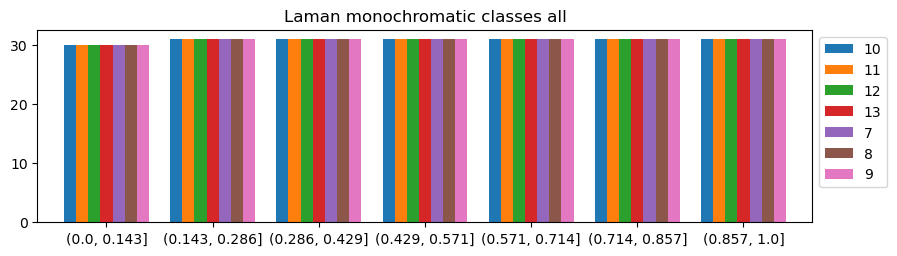

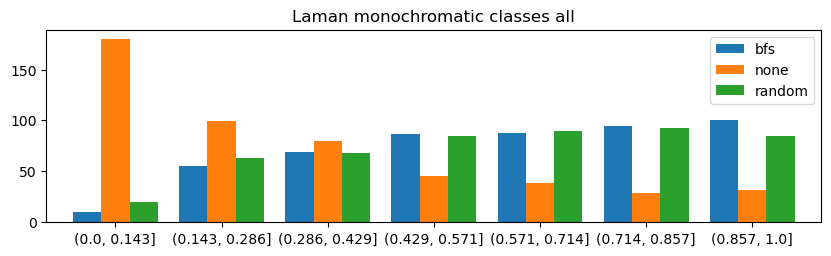

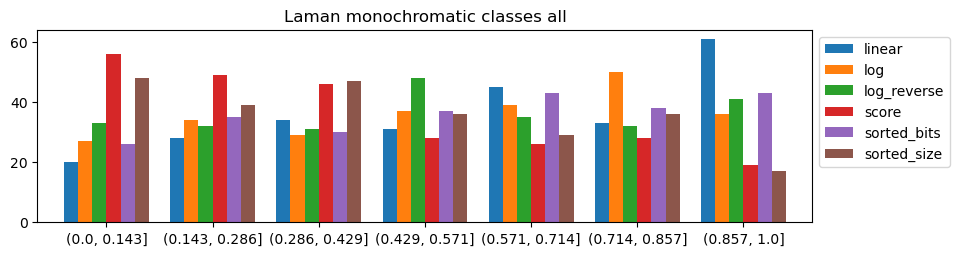

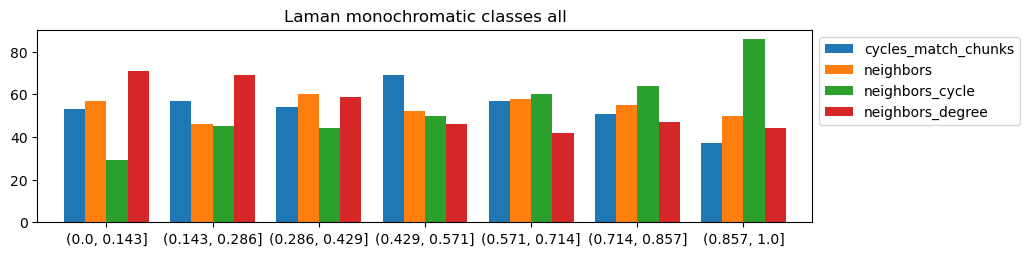

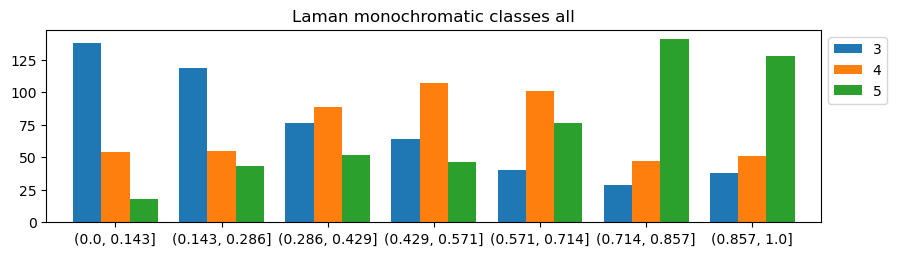

In [17]:
input = """
--------------------------------------------------------------------------------
Name (time in ms)                                                                                                     Min                   Max                  Mean            StdDev                Median               IQR            Outliers     OPS            Rounds  Iterations
--------------------------------------------------------------------------------

test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-sorted_size-neighbors_degree-3-smart]             285.3971 (1.0)        285.3971 (1.0)        285.3971 (1.0)      0.0000 (1.0)        285.3971 (1.0)      0.0000 (1.0)           0;0  3.5039 (1.0)           1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-score-neighbors_degree-3-smart]                   293.5017 (1.03)       293.5017 (1.03)       293.5017 (1.03)     0.0000 (1.0)        293.5017 (1.03)     0.0000 (1.0)           0;0  3.4071 (0.97)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-score-cycles_match_chunks-3-smart]                296.8856 (1.04)       296.8856 (1.04)       296.8856 (1.04)     0.0000 (1.0)        296.8856 (1.04)     0.0000 (1.0)           0;0  3.3683 (0.96)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-sorted_size-neighbors_degree-3-smart]           297.6944 (1.04)       297.6944 (1.04)       297.6944 (1.04)     0.0000 (1.0)        297.6944 (1.04)     0.0000 (1.0)           0;0  3.3592 (0.96)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-log_reverse-neighbors_degree-3-smart]             297.7555 (1.04)       297.7555 (1.04)       297.7555 (1.04)     0.0000 (1.0)        297.7555 (1.04)     0.0000 (1.0)           0;0  3.3585 (0.96)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-sorted_size-cycles_match_chunks-3-smart]          298.5984 (1.05)       298.5984 (1.05)       298.5984 (1.05)     0.0000 (1.0)        298.5984 (1.05)     0.0000 (1.0)           0;0  3.3490 (0.96)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-sorted_size-neighbors-3-smart]                    299.4332 (1.05)       299.4332 (1.05)       299.4332 (1.05)     0.0000 (1.0)        299.4332 (1.05)     0.0000 (1.0)           0;0  3.3396 (0.95)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-score-neighbors-3-smart]                          300.7188 (1.05)       300.7188 (1.05)       300.7188 (1.05)     0.0000 (1.0)        300.7188 (1.05)     0.0000 (1.0)           0;0  3.3254 (0.95)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-sorted_size-cycles_match_chunks-3-smart]        302.5809 (1.06)       302.5809 (1.06)       302.5809 (1.06)     0.0000 (1.0)        302.5809 (1.06)     0.0000 (1.0)           0;0  3.3049 (0.94)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-log-cycles_match_chunks-3-smart]                  303.1080 (1.06)       303.1080 (1.06)       303.1080 (1.06)     0.0000 (1.0)        303.1080 (1.06)     0.0000 (1.0)           0;0  3.2992 (0.94)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-score-cycles_match_chunks-3-smart]              305.2496 (1.07)       305.2496 (1.07)       305.2496 (1.07)     0.0000 (1.0)        305.2496 (1.07)     0.0000 (1.0)           0;0  3.2760 (0.93)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-sorted_bits-neighbors_degree-3-smart]             305.4776 (1.07)       305.4776 (1.07)       305.4776 (1.07)     0.0000 (1.0)        305.4776 (1.07)     0.0000 (1.0)           0;0  3.2736 (0.93)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-score-neighbors_cycle-3-smart]                    305.7351 (1.07)       305.7351 (1.07)       305.7351 (1.07)     0.0000 (1.0)        305.7351 (1.07)     0.0000 (1.0)           0;0  3.2708 (0.93)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-sorted_bits-cycles_match_chunks-3-smart]        306.1307 (1.07)       306.1307 (1.07)       306.1307 (1.07)     0.0000 (1.0)        306.1307 (1.07)     0.0000 (1.0)           0;0  3.2666 (0.93)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-sorted_bits-cycles_match_chunks-3-smart]          306.1970 (1.07)       306.1970 (1.07)       306.1970 (1.07)     0.0000 (1.0)        306.1970 (1.07)     0.0000 (1.0)           0;0  3.2659 (0.93)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-log_reverse-cycles_match_chunks-3-smart]          306.8761 (1.08)       306.8761 (1.08)       306.8761 (1.08)     0.0000 (1.0)        306.8761 (1.08)     0.0000 (1.0)           0;0  3.2586 (0.93)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-log-neighbors_degree-3-smart]                      307.1067 (1.08)       307.1067 (1.08)       307.1067 (1.08)     0.0000 (1.0)        307.1067 (1.08)     0.0000 (1.0)           0;0  3.2562 (0.93)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-log_reverse-neighbors_degree-3-smart]           307.8896 (1.08)       307.8896 (1.08)       307.8896 (1.08)     0.0000 (1.0)        307.8896 (1.08)     0.0000 (1.0)           0;0  3.2479 (0.93)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-sorted_size-neighbors_cycle-3-smart]              307.9847 (1.08)       307.9847 (1.08)       307.9847 (1.08)     0.0000 (1.0)        307.9847 (1.08)     0.0000 (1.0)           0;0  3.2469 (0.93)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-score-neighbors_cycle-3-smart]                  309.0957 (1.08)       309.0957 (1.08)       309.0957 (1.08)     0.0000 (1.0)        309.0957 (1.08)     0.0000 (1.0)           0;0  3.2352 (0.92)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-log_reverse-neighbors-3-smart]                    309.6673 (1.09)       309.6673 (1.09)       309.6673 (1.09)     0.0000 (1.0)        309.6673 (1.09)     0.0000 (1.0)           0;0  3.2293 (0.92)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-linear-cycles_match_chunks-3-smart]               309.6932 (1.09)       309.6932 (1.09)       309.6932 (1.09)     0.0000 (1.0)        309.6932 (1.09)     0.0000 (1.0)           0;0  3.2290 (0.92)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-score-cycles_match_chunks-3-smart]                 309.9065 (1.09)       309.9065 (1.09)       309.9065 (1.09)     0.0000 (1.0)        309.9065 (1.09)     0.0000 (1.0)           0;0  3.2268 (0.92)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-sorted_size-neighbors_degree-3-smart]              310.0118 (1.09)       310.0118 (1.09)       310.0118 (1.09)     0.0000 (1.0)        310.0118 (1.09)     0.0000 (1.0)           0;0  3.2257 (0.92)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-sorted_bits-neighbors_degree-3-smart]           310.3935 (1.09)       310.3935 (1.09)       310.3935 (1.09)     0.0000 (1.0)        310.3935 (1.09)     0.0000 (1.0)           0;0  3.2217 (0.92)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-sorted_size-neighbors-3-smart]                  310.5143 (1.09)       310.5143 (1.09)       310.5143 (1.09)     0.0000 (1.0)        310.5143 (1.09)     0.0000 (1.0)           0;0  3.2205 (0.92)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-log_reverse-neighbors_cycle-3-smart]              310.6645 (1.09)       310.6645 (1.09)       310.6645 (1.09)     0.0000 (1.0)        310.6645 (1.09)     0.0000 (1.0)           0;0  3.2189 (0.92)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-score-neighbors_degree-3-smart]                    310.8339 (1.09)       310.8339 (1.09)       310.8339 (1.09)     0.0000 (1.0)        310.8339 (1.09)     0.0000 (1.0)           0;0  3.2172 (0.92)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-linear-neighbors-3-smart]                         311.0518 (1.09)       311.0518 (1.09)       311.0518 (1.09)     0.0000 (1.0)        311.0518 (1.09)     0.0000 (1.0)           0;0  3.2149 (0.92)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-linear-neighbors_degree-3-smart]                   311.1356 (1.09)       311.1356 (1.09)       311.1356 (1.09)     0.0000 (1.0)        311.1356 (1.09)     0.0000 (1.0)           0;0  3.2140 (0.92)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-log_reverse-cycles_match_chunks-3-smart]        311.2239 (1.09)       311.2239 (1.09)       311.2239 (1.09)     0.0000 (1.0)        311.2239 (1.09)     0.0000 (1.0)           0;0  3.2131 (0.92)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-sorted_bits-neighbors-3-smart]                  312.3960 (1.09)       312.3960 (1.09)       312.3960 (1.09)     0.0000 (1.0)        312.3960 (1.09)     0.0000 (1.0)           0;0  3.2011 (0.91)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-linear-neighbors_cycle-3-smart]                   312.6269 (1.10)       312.6269 (1.10)       312.6269 (1.10)     0.0000 (1.0)        312.6269 (1.10)     0.0000 (1.0)           0;0  3.1987 (0.91)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-log-neighbors_degree-3-smart]                   313.1053 (1.10)       313.1053 (1.10)       313.1053 (1.10)     0.0000 (1.0)        313.1053 (1.10)     0.0000 (1.0)           0;0  3.1938 (0.91)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-score-neighbors-3-smart]                           313.3852 (1.10)       313.3852 (1.10)       313.3852 (1.10)     0.0000 (1.0)        313.3852 (1.10)     0.0000 (1.0)           0;0  3.1910 (0.91)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-linear-cycles_match_chunks-3-smart]             313.4358 (1.10)       313.4358 (1.10)       313.4358 (1.10)     0.0000 (1.0)        313.4358 (1.10)     0.0000 (1.0)           0;0  3.1904 (0.91)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-linear-cycles_match_chunks-3-smart]                313.6810 (1.10)       313.6810 (1.10)       313.6810 (1.10)     0.0000 (1.0)        313.6810 (1.10)     0.0000 (1.0)           0;0  3.1880 (0.91)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-log-cycles_match_chunks-3-smart]                   314.0332 (1.10)       314.0332 (1.10)       314.0332 (1.10)     0.0000 (1.0)        314.0332 (1.10)     0.0000 (1.0)           0;0  3.1844 (0.91)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-log_reverse-neighbors_degree-3-smart]              314.1050 (1.10)       314.1050 (1.10)       314.1050 (1.10)     0.0000 (1.0)        314.1050 (1.10)     0.0000 (1.0)           0;0  3.1836 (0.91)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-sorted_size-neighbors_cycle-3-smart]            314.1406 (1.10)       314.1406 (1.10)       314.1406 (1.10)     0.0000 (1.0)        314.1406 (1.10)     0.0000 (1.0)           0;0  3.1833 (0.91)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-score-neighbors-3-smart]                        314.5047 (1.10)       314.5047 (1.10)       314.5047 (1.10)     0.0000 (1.0)        314.5047 (1.10)     0.0000 (1.0)           0;0  3.1796 (0.91)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-sorted_bits-cycles_match_chunks-3-smart]           314.7607 (1.10)       314.7607 (1.10)       314.7607 (1.10)     0.0000 (1.0)        314.7607 (1.10)     0.0000 (1.0)           0;0  3.1770 (0.91)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-sorted_bits-neighbors-3-smart]                    315.0706 (1.10)       315.0706 (1.10)       315.0706 (1.10)     0.0000 (1.0)        315.0706 (1.10)     0.0000 (1.0)           0;0  3.1739 (0.91)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-sorted_bits-neighbors_degree-3-smart]              315.1612 (1.10)       315.1612 (1.10)       315.1612 (1.10)     0.0000 (1.0)        315.1612 (1.10)     0.0000 (1.0)           0;0  3.1730 (0.91)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-sorted_size-cycles_match_chunks-3-smart]           315.7773 (1.11)       315.7773 (1.11)       315.7773 (1.11)     0.0000 (1.0)        315.7773 (1.11)     0.0000 (1.0)           0;0  3.1668 (0.90)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-linear-neighbors-3-smart]                       316.2238 (1.11)       316.2238 (1.11)       316.2238 (1.11)     0.0000 (1.0)        316.2238 (1.11)     0.0000 (1.0)           0;0  3.1623 (0.90)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-linear-neighbors_cycle-3-smart]                 316.7536 (1.11)       316.7536 (1.11)       316.7536 (1.11)     0.0000 (1.0)        316.7536 (1.11)     0.0000 (1.0)           0;0  3.1570 (0.90)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-sorted_bits-neighbors_cycle-3-smart]            317.0293 (1.11)       317.0293 (1.11)       317.0293 (1.11)     0.0000 (1.0)        317.0293 (1.11)     0.0000 (1.0)           0;0  3.1543 (0.90)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-log-neighbors_degree-3-smart]                     319.1567 (1.12)       319.1567 (1.12)       319.1567 (1.12)     0.0000 (1.0)        319.1567 (1.12)     0.0000 (1.0)           0;0  3.1333 (0.89)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-log_reverse-neighbors_cycle-3-smart]            319.5366 (1.12)       319.5366 (1.12)       319.5366 (1.12)     0.0000 (1.0)        319.5366 (1.12)     0.0000 (1.0)           0;0  3.1295 (0.89)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-linear-neighbors-3-smart]                          320.4990 (1.12)       320.4990 (1.12)       320.4990 (1.12)     0.0000 (1.0)        320.4990 (1.12)     0.0000 (1.0)           0;0  3.1201 (0.89)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-sorted_size-neighbors_cycle-3-smart]               320.6439 (1.12)       320.6439 (1.12)       320.6439 (1.12)     0.0000 (1.0)        320.6439 (1.12)     0.0000 (1.0)           0;0  3.1187 (0.89)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-log-neighbors-3-smart]                          320.7434 (1.12)       320.7434 (1.12)       320.7434 (1.12)     0.0000 (1.0)        320.7434 (1.12)     0.0000 (1.0)           0;0  3.1178 (0.89)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-log-neighbors-3-smart]                            320.9448 (1.12)       320.9448 (1.12)       320.9448 (1.12)     0.0000 (1.0)        320.9448 (1.12)     0.0000 (1.0)           0;0  3.1158 (0.89)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-log_reverse-cycles_match_chunks-3-smart]           322.3417 (1.13)       322.3417 (1.13)       322.3417 (1.13)     0.0000 (1.0)        322.3417 (1.13)     0.0000 (1.0)           0;0  3.1023 (0.89)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-sorted_bits-neighbors-3-smart]                     322.9671 (1.13)       322.9671 (1.13)       322.9671 (1.13)     0.0000 (1.0)        322.9671 (1.13)     0.0000 (1.0)           0;0  3.0963 (0.88)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-sorted_size-neighbors-3-smart]                     323.6465 (1.13)       323.6465 (1.13)       323.6465 (1.13)     0.0000 (1.0)        323.6465 (1.13)     0.0000 (1.0)           0;0  3.0898 (0.88)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-log-cycles_match_chunks-3-smart]                324.0812 (1.14)       324.0812 (1.14)       324.0812 (1.14)     0.0000 (1.0)        324.0812 (1.14)     0.0000 (1.0)           0;0  3.0856 (0.88)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-log_reverse-neighbors-3-smart]                     326.8328 (1.15)       326.8328 (1.15)       326.8328 (1.15)     0.0000 (1.0)        326.8328 (1.15)     0.0000 (1.0)           0;0  3.0597 (0.87)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-log-neighbors_cycle-3-smart]                       326.8436 (1.15)       326.8436 (1.15)       326.8436 (1.15)     0.0000 (1.0)        326.8436 (1.15)     0.0000 (1.0)           0;0  3.0596 (0.87)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-linear-neighbors_degree-3-smart]                330.6533 (1.16)       330.6533 (1.16)       330.6533 (1.16)     0.0000 (1.0)        330.6533 (1.16)     0.0000 (1.0)           0;0  3.0243 (0.86)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-log-neighbors_cycle-3-smart]                      330.6966 (1.16)       330.6966 (1.16)       330.6966 (1.16)     0.0000 (1.0)        330.6966 (1.16)     0.0000 (1.0)           0;0  3.0239 (0.86)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-score-neighbors_cycle-3-smart]                     331.0192 (1.16)       331.0192 (1.16)       331.0192 (1.16)     0.0000 (1.0)        331.0192 (1.16)     0.0000 (1.0)           0;0  3.0210 (0.86)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-log_reverse-neighbors-3-smart]                  333.8139 (1.17)       333.8139 (1.17)       333.8139 (1.17)     0.0000 (1.0)        333.8139 (1.17)     0.0000 (1.0)           0;0  2.9957 (0.85)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-log-neighbors-3-smart]                             336.8535 (1.18)       336.8535 (1.18)       336.8535 (1.18)     0.0000 (1.0)        336.8535 (1.18)     0.0000 (1.0)           0;0  2.9686 (0.85)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-linear-neighbors_cycle-3-smart]                    339.0971 (1.19)       339.0971 (1.19)       339.0971 (1.19)     0.0000 (1.0)        339.0971 (1.19)     0.0000 (1.0)           0;0  2.9490 (0.84)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-sorted_bits-neighbors_cycle-3-smart]               340.5327 (1.19)       340.5327 (1.19)       340.5327 (1.19)     0.0000 (1.0)        340.5327 (1.19)     0.0000 (1.0)           0;0  2.9366 (0.84)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-log-neighbors_cycle-3-smart]                    346.8786 (1.22)       346.8786 (1.22)       346.8786 (1.22)     0.0000 (1.0)        346.8786 (1.22)     0.0000 (1.0)           0;0  2.8829 (0.82)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-linear-neighbors_degree-3-smart]                  455.6772 (1.60)       455.6772 (1.60)       455.6772 (1.60)     0.0000 (1.0)        455.6772 (1.60)     0.0000 (1.0)           0;0  2.1945 (0.63)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-score-neighbors_degree-3-smart]                 500.8755 (1.76)       500.8755 (1.76)       500.8755 (1.76)     0.0000 (1.0)        500.8755 (1.76)     0.0000 (1.0)           0;0  1.9965 (0.57)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-sorted_bits-neighbors_cycle-3-smart]              507.7033 (1.78)       507.7033 (1.78)       507.7033 (1.78)     0.0000 (1.0)        507.7033 (1.78)     0.0000 (1.0)           0;0  1.9697 (0.56)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-log_reverse-neighbors_cycle-3-smart]               523.2478 (1.83)       523.2478 (1.83)       523.2478 (1.83)     0.0000 (1.0)        523.2478 (1.83)     0.0000 (1.0)           0;0  1.9111 (0.55)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-score-cycles_match_chunks-5-smart]                671.0092 (2.35)       671.0092 (2.35)       671.0092 (2.35)     0.0000 (1.0)        671.0092 (2.35)     0.0000 (1.0)           0;0  1.4903 (0.43)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-score-neighbors_degree-4-smart]                   672.2020 (2.36)       672.2020 (2.36)       672.2020 (2.36)     0.0000 (1.0)        672.2020 (2.36)     0.0000 (1.0)           0;0  1.4876 (0.42)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-score-neighbors_degree-5-smart]                   672.7449 (2.36)       672.7449 (2.36)       672.7449 (2.36)     0.0000 (1.0)        672.7449 (2.36)     0.0000 (1.0)           0;0  1.4864 (0.42)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-score-cycles_match_chunks-4-smart]                674.2942 (2.36)       674.2942 (2.36)       674.2942 (2.36)     0.0000 (1.0)        674.2942 (2.36)     0.0000 (1.0)           0;0  1.4830 (0.42)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-score-neighbors-4-smart]                          677.9725 (2.38)       677.9725 (2.38)       677.9725 (2.38)     0.0000 (1.0)        677.9725 (2.38)     0.0000 (1.0)           0;0  1.4750 (0.42)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-sorted_size-neighbors_cycle-4-smart]              680.4613 (2.38)       680.4613 (2.38)       680.4613 (2.38)     0.0000 (1.0)        680.4613 (2.38)     0.0000 (1.0)           0;0  1.4696 (0.42)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-sorted_bits-neighbors_cycle-5-smart]              680.6898 (2.39)       680.6898 (2.39)       680.6898 (2.39)     0.0000 (1.0)        680.6898 (2.39)     0.0000 (1.0)           0;0  1.4691 (0.42)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-linear-cycles_match_chunks-5-smart]               681.2154 (2.39)       681.2154 (2.39)       681.2154 (2.39)     0.0000 (1.0)        681.2154 (2.39)     0.0000 (1.0)           0;0  1.4680 (0.42)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-score-neighbors_cycle-5-smart]                    681.7670 (2.39)       681.7670 (2.39)       681.7670 (2.39)     0.0000 (1.0)        681.7670 (2.39)     0.0000 (1.0)           0;0  1.4668 (0.42)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-linear-neighbors-4-smart]                         682.5793 (2.39)       682.5793 (2.39)       682.5793 (2.39)     0.0000 (1.0)        682.5793 (2.39)     0.0000 (1.0)           0;0  1.4650 (0.42)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-linear-cycles_match_chunks-4-smart]               682.6445 (2.39)       682.6445 (2.39)       682.6445 (2.39)     0.0000 (1.0)        682.6445 (2.39)     0.0000 (1.0)           0;0  1.4649 (0.42)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-log_reverse-neighbors-5-smart]                    682.6907 (2.39)       682.6907 (2.39)       682.6907 (2.39)     0.0000 (1.0)        682.6907 (2.39)     0.0000 (1.0)           0;0  1.4648 (0.42)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-log_reverse-cycles_match_chunks-5-smart]          683.8906 (2.40)       683.8906 (2.40)       683.8906 (2.40)     0.0000 (1.0)        683.8906 (2.40)     0.0000 (1.0)           0;0  1.4622 (0.42)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-linear-neighbors_degree-5-smart]                  684.6623 (2.40)       684.6623 (2.40)       684.6623 (2.40)     0.0000 (1.0)        684.6623 (2.40)     0.0000 (1.0)           0;0  1.4606 (0.42)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-sorted_size-neighbors_degree-5-smart]             684.7443 (2.40)       684.7443 (2.40)       684.7443 (2.40)     0.0000 (1.0)        684.7443 (2.40)     0.0000 (1.0)           0;0  1.4604 (0.42)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-sorted_size-cycles_match_chunks-4-smart]        686.2062 (2.40)       686.2062 (2.40)       686.2062 (2.40)     0.0000 (1.0)        686.2062 (2.40)     0.0000 (1.0)           0;0  1.4573 (0.42)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-linear-neighbors_degree-4-smart]                  686.8570 (2.41)       686.8570 (2.41)       686.8570 (2.41)     0.0000 (1.0)        686.8570 (2.41)     0.0000 (1.0)           0;0  1.4559 (0.42)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-sorted_size-neighbors-5-smart]                    687.2244 (2.41)       687.2244 (2.41)       687.2244 (2.41)     0.0000 (1.0)        687.2244 (2.41)     0.0000 (1.0)           0;0  1.4551 (0.42)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-log_reverse-neighbors-4-smart]                    687.3073 (2.41)       687.3073 (2.41)       687.3073 (2.41)     0.0000 (1.0)        687.3073 (2.41)     0.0000 (1.0)           0;0  1.4550 (0.42)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-sorted_bits-neighbors_degree-4-smart]             687.5167 (2.41)       687.5167 (2.41)       687.5167 (2.41)     0.0000 (1.0)        687.5167 (2.41)     0.0000 (1.0)           0;0  1.4545 (0.42)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-sorted_size-cycles_match_chunks-5-smart]          687.8961 (2.41)       687.8961 (2.41)       687.8961 (2.41)     0.0000 (1.0)        687.8961 (2.41)     0.0000 (1.0)           0;0  1.4537 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-sorted_size-neighbors_degree-5-smart]           688.0441 (2.41)       688.0441 (2.41)       688.0441 (2.41)     0.0000 (1.0)        688.0441 (2.41)     0.0000 (1.0)           0;0  1.4534 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-sorted_size-cycles_match_chunks-5-smart]        689.3827 (2.42)       689.3827 (2.42)       689.3827 (2.42)     0.0000 (1.0)        689.3827 (2.42)     0.0000 (1.0)           0;0  1.4506 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-score-neighbors_degree-5-smart]                 690.4016 (2.42)       690.4016 (2.42)       690.4016 (2.42)     0.0000 (1.0)        690.4016 (2.42)     0.0000 (1.0)           0;0  1.4484 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-sorted_size-neighbors_degree-4-smart]             690.6344 (2.42)       690.6344 (2.42)       690.6344 (2.42)     0.0000 (1.0)        690.6344 (2.42)     0.0000 (1.0)           0;0  1.4479 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-score-neighbors_cycle-4-smart]                  691.1506 (2.42)       691.1506 (2.42)       691.1506 (2.42)     0.0000 (1.0)        691.1506 (2.42)     0.0000 (1.0)           0;0  1.4469 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-score-neighbors-4-smart]                        691.2706 (2.42)       691.2706 (2.42)       691.2706 (2.42)     0.0000 (1.0)        691.2706 (2.42)     0.0000 (1.0)           0;0  1.4466 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-score-cycles_match_chunks-5-smart]              691.3399 (2.42)       691.3399 (2.42)       691.3399 (2.42)     0.0000 (1.0)        691.3399 (2.42)     0.0000 (1.0)           0;0  1.4465 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-linear-neighbors_cycle-5-smart]                   691.5095 (2.42)       691.5095 (2.42)       691.5095 (2.42)     0.0000 (1.0)        691.5095 (2.42)     0.0000 (1.0)           0;0  1.4461 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]        692.0293 (2.42)       692.0293 (2.42)       692.0293 (2.42)     0.0000 (1.0)        692.0293 (2.42)     0.0000 (1.0)           0;0  1.4450 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-score-neighbors_cycle-5-smart]                  692.0685 (2.42)       692.0685 (2.42)       692.0685 (2.42)     0.0000 (1.0)        692.0685 (2.42)     0.0000 (1.0)           0;0  1.4449 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-sorted_size-neighbors_degree-4-smart]           692.1239 (2.43)       692.1239 (2.43)       692.1239 (2.43)     0.0000 (1.0)        692.1239 (2.43)     0.0000 (1.0)           0;0  1.4448 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-log_reverse-neighbors-5-smart]                     692.2902 (2.43)       692.2902 (2.43)       692.2902 (2.43)     0.0000 (1.0)        692.2902 (2.43)     0.0000 (1.0)           0;0  1.4445 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-linear-cycles_match_chunks-4-smart]             692.8173 (2.43)       692.8173 (2.43)       692.8173 (2.43)     0.0000 (1.0)        692.8173 (2.43)     0.0000 (1.0)           0;0  1.4434 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-sorted_bits-neighbors_degree-5-smart]             693.0057 (2.43)       693.0057 (2.43)       693.0057 (2.43)     0.0000 (1.0)        693.0057 (2.43)     0.0000 (1.0)           0;0  1.4430 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-sorted_size-neighbors-4-smart]                  693.2773 (2.43)       693.2773 (2.43)       693.2773 (2.43)     0.0000 (1.0)        693.2773 (2.43)     0.0000 (1.0)           0;0  1.4424 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-score-cycles_match_chunks-5-smart]                 693.4460 (2.43)       693.4460 (2.43)       693.4460 (2.43)     0.0000 (1.0)        693.4460 (2.43)     0.0000 (1.0)           0;0  1.4421 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-score-cycles_match_chunks-4-smart]              693.5443 (2.43)       693.5443 (2.43)       693.5443 (2.43)     0.0000 (1.0)        693.5443 (2.43)     0.0000 (1.0)           0;0  1.4419 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-score-neighbors-5-smart]                          693.6253 (2.43)       693.6253 (2.43)       693.6253 (2.43)     0.0000 (1.0)        693.6253 (2.43)     0.0000 (1.0)           0;0  1.4417 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-log_reverse-neighbors_degree-4-smart]             693.6694 (2.43)       693.6694 (2.43)       693.6694 (2.43)     0.0000 (1.0)        693.6694 (2.43)     0.0000 (1.0)           0;0  1.4416 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-sorted_size-neighbors_cycle-5-smart]              694.3475 (2.43)       694.3475 (2.43)       694.3475 (2.43)     0.0000 (1.0)        694.3475 (2.43)     0.0000 (1.0)           0;0  1.4402 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-linear-neighbors_cycle-4-smart]                   694.4504 (2.43)       694.4504 (2.43)       694.4504 (2.43)     0.0000 (1.0)        694.4504 (2.43)     0.0000 (1.0)           0;0  1.4400 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-sorted_size-neighbors_cycle-5-smart]            694.7552 (2.43)       694.7552 (2.43)       694.7552 (2.43)     0.0000 (1.0)        694.7552 (2.43)     0.0000 (1.0)           0;0  1.4394 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-log-cycles_match_chunks-5-smart]                   695.3268 (2.44)       695.3268 (2.44)       695.3268 (2.44)     0.0000 (1.0)        695.3268 (2.44)     0.0000 (1.0)           0;0  1.4382 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-log_reverse-neighbors_cycle-5-smart]              695.8339 (2.44)       695.8339 (2.44)       695.8339 (2.44)     0.0000 (1.0)        695.8339 (2.44)     0.0000 (1.0)           0;0  1.4371 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-log_reverse-cycles_match_chunks-4-smart]        695.9430 (2.44)       695.9430 (2.44)       695.9430 (2.44)     0.0000 (1.0)        695.9430 (2.44)     0.0000 (1.0)           0;0  1.4369 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-sorted_size-neighbors-5-smart]                  695.9805 (2.44)       695.9805 (2.44)       695.9805 (2.44)     0.0000 (1.0)        695.9805 (2.44)     0.0000 (1.0)           0;0  1.4368 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-log-cycles_match_chunks-4-smart]                   696.0167 (2.44)       696.0167 (2.44)       696.0167 (2.44)     0.0000 (1.0)        696.0167 (2.44)     0.0000 (1.0)           0;0  1.4367 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-log_reverse-cycles_match_chunks-4-smart]          696.0590 (2.44)       696.0590 (2.44)       696.0590 (2.44)     0.0000 (1.0)        696.0590 (2.44)     0.0000 (1.0)           0;0  1.4367 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-sorted_bits-neighbors-5-smart]                  696.1737 (2.44)       696.1737 (2.44)       696.1737 (2.44)     0.0000 (1.0)        696.1737 (2.44)     0.0000 (1.0)           0;0  1.4364 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-log_reverse-neighbors-5-smart]                  696.5063 (2.44)       696.5063 (2.44)       696.5063 (2.44)     0.0000 (1.0)        696.5063 (2.44)     0.0000 (1.0)           0;0  1.4357 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-log_reverse-neighbors_cycle-4-smart]              696.7570 (2.44)       696.7570 (2.44)       696.7570 (2.44)     0.0000 (1.0)        696.7570 (2.44)     0.0000 (1.0)           0;0  1.4352 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-linear-cycles_match_chunks-4-smart]                696.7668 (2.44)       696.7668 (2.44)       696.7668 (2.44)     0.0000 (1.0)        696.7668 (2.44)     0.0000 (1.0)           0;0  1.4352 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-log_reverse-neighbors_cycle-4-smart]            696.9660 (2.44)       696.9660 (2.44)       696.9660 (2.44)     0.0000 (1.0)        696.9660 (2.44)     0.0000 (1.0)           0;0  1.4348 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]            697.3129 (2.44)       697.3129 (2.44)       697.3129 (2.44)     0.0000 (1.0)        697.3129 (2.44)     0.0000 (1.0)           0;0  1.4341 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-score-neighbors-5-smart]                        697.4645 (2.44)       697.4645 (2.44)       697.4645 (2.44)     0.0000 (1.0)        697.4645 (2.44)     0.0000 (1.0)           0;0  1.4338 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-log-cycles_match_chunks-5-smart]                  697.6534 (2.44)       697.6534 (2.44)       697.6534 (2.44)     0.0000 (1.0)        697.6534 (2.44)     0.0000 (1.0)           0;0  1.4334 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-sorted_bits-neighbors-4-smart]                  697.8932 (2.45)       697.8932 (2.45)       697.8932 (2.45)     0.0000 (1.0)        697.8932 (2.45)     0.0000 (1.0)           0;0  1.4329 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-log_reverse-cycles_match_chunks-5-smart]        698.0036 (2.45)       698.0036 (2.45)       698.0036 (2.45)     0.0000 (1.0)        698.0036 (2.45)     0.0000 (1.0)           0;0  1.4327 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-log_reverse-neighbors_degree-5-smart]             698.4473 (2.45)       698.4473 (2.45)       698.4473 (2.45)     0.0000 (1.0)        698.4473 (2.45)     0.0000 (1.0)           0;0  1.4317 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-linear-neighbors-5-smart]                         698.4840 (2.45)       698.4840 (2.45)       698.4840 (2.45)     0.0000 (1.0)        698.4840 (2.45)     0.0000 (1.0)           0;0  1.4317 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-sorted_size-neighbors_cycle-5-smart]               698.5127 (2.45)       698.5127 (2.45)       698.5127 (2.45)     0.0000 (1.0)        698.5127 (2.45)     0.0000 (1.0)           0;0  1.4316 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-log-cycles_match_chunks-4-smart]                  698.6307 (2.45)       698.6307 (2.45)       698.6307 (2.45)     0.0000 (1.0)        698.6307 (2.45)     0.0000 (1.0)           0;0  1.4314 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-log-neighbors_cycle-4-smart]                       699.0317 (2.45)       699.0317 (2.45)       699.0317 (2.45)     0.0000 (1.0)        699.0317 (2.45)     0.0000 (1.0)           0;0  1.4306 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-log-neighbors_degree-4-smart]                      699.0554 (2.45)       699.0554 (2.45)       699.0554 (2.45)     0.0000 (1.0)        699.0554 (2.45)     0.0000 (1.0)           0;0  1.4305 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-sorted_bits-cycles_match_chunks-5-smart]          699.4406 (2.45)       699.4406 (2.45)       699.4406 (2.45)     0.0000 (1.0)        699.4406 (2.45)     0.0000 (1.0)           0;0  1.4297 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]        699.4542 (2.45)       699.4542 (2.45)       699.4542 (2.45)     0.0000 (1.0)        699.4542 (2.45)     0.0000 (1.0)           0;0  1.4297 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-linear-neighbors_degree-5-smart]                   699.4654 (2.45)       699.4654 (2.45)       699.4654 (2.45)     0.0000 (1.0)        699.4654 (2.45)     0.0000 (1.0)           0;0  1.4297 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-log_reverse-neighbors-4-smart]                  699.6657 (2.45)       699.6657 (2.45)       699.6657 (2.45)     0.0000 (1.0)        699.6657 (2.45)     0.0000 (1.0)           0;0  1.4293 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-log-neighbors-4-smart]                             699.8250 (2.45)       699.8250 (2.45)       699.8250 (2.45)     0.0000 (1.0)        699.8250 (2.45)     0.0000 (1.0)           0;0  1.4289 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-log_reverse-neighbors-4-smart]                     700.4260 (2.45)       700.4260 (2.45)       700.4260 (2.45)     0.0000 (1.0)        700.4260 (2.45)     0.0000 (1.0)           0;0  1.4277 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-log_reverse-neighbors_cycle-5-smart]            700.4471 (2.45)       700.4471 (2.45)       700.4471 (2.45)     0.0000 (1.0)        700.4471 (2.45)     0.0000 (1.0)           0;0  1.4277 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-sorted_size-neighbors_cycle-4-smart]            700.6137 (2.45)       700.6137 (2.45)       700.6137 (2.45)     0.0000 (1.0)        700.6137 (2.45)     0.0000 (1.0)           0;0  1.4273 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-sorted_bits-neighbors_degree-5-smart]           701.3074 (2.46)       701.3074 (2.46)       701.3074 (2.46)     0.0000 (1.0)        701.3074 (2.46)     0.0000 (1.0)           0;0  1.4259 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-score-neighbors-4-smart]                           701.6153 (2.46)       701.6153 (2.46)       701.6153 (2.46)     0.0000 (1.0)        701.6153 (2.46)     0.0000 (1.0)           0;0  1.4253 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-log_reverse-cycles_match_chunks-4-smart]           701.7735 (2.46)       701.7735 (2.46)       701.7735 (2.46)     0.0000 (1.0)        701.7735 (2.46)     0.0000 (1.0)           0;0  1.4250 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-score-neighbors_degree-4-smart]                    701.8970 (2.46)       701.8970 (2.46)       701.8970 (2.46)     0.0000 (1.0)        701.8970 (2.46)     0.0000 (1.0)           0;0  1.4247 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-sorted_size-neighbors-5-smart]                     702.0992 (2.46)       702.0992 (2.46)       702.0992 (2.46)     0.0000 (1.0)        702.0992 (2.46)     0.0000 (1.0)           0;0  1.4243 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-linear-neighbors_degree-4-smart]                   702.4893 (2.46)       702.4893 (2.46)       702.4893 (2.46)     0.0000 (1.0)        702.4893 (2.46)     0.0000 (1.0)           0;0  1.4235 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-log_reverse-cycles_match_chunks-5-smart]           702.7524 (2.46)       702.7524 (2.46)       702.7524 (2.46)     0.0000 (1.0)        702.7524 (2.46)     0.0000 (1.0)           0;0  1.4230 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-sorted_bits-cycles_match_chunks-5-smart]           702.9535 (2.46)       702.9535 (2.46)       702.9535 (2.46)     0.0000 (1.0)        702.9535 (2.46)     0.0000 (1.0)           0;0  1.4226 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-sorted_bits-cycles_match_chunks-4-smart]           703.2967 (2.46)       703.2967 (2.46)       703.2967 (2.46)     0.0000 (1.0)        703.2967 (2.46)     0.0000 (1.0)           0;0  1.4219 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-linear-cycles_match_chunks-5-smart]                703.7177 (2.47)       703.7177 (2.47)       703.7177 (2.47)     0.0000 (1.0)        703.7177 (2.47)     0.0000 (1.0)           0;0  1.4210 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-log-neighbors_cycle-5-smart]                       703.9475 (2.47)       703.9475 (2.47)       703.9475 (2.47)     0.0000 (1.0)        703.9475 (2.47)     0.0000 (1.0)           0;0  1.4206 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-score-neighbors_degree-4-smart]                 704.4044 (2.47)       704.4044 (2.47)       704.4044 (2.47)     0.0000 (1.0)        704.4044 (2.47)     0.0000 (1.0)           0;0  1.4196 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-linear-neighbors_cycle-5-smart]                 704.5322 (2.47)       704.5322 (2.47)       704.5322 (2.47)     0.0000 (1.0)        704.5322 (2.47)     0.0000 (1.0)           0;0  1.4194 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-sorted_size-cycles_match_chunks-4-smart]          704.6198 (2.47)       704.6198 (2.47)       704.6198 (2.47)     0.0000 (1.0)        704.6198 (2.47)     0.0000 (1.0)           0;0  1.4192 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-score-neighbors_cycle-4-smart]                     704.6834 (2.47)       704.6834 (2.47)       704.6834 (2.47)     0.0000 (1.0)        704.6834 (2.47)     0.0000 (1.0)           0;0  1.4191 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-sorted_size-neighbors-4-smart]                     704.9758 (2.47)       704.9758 (2.47)       704.9758 (2.47)     0.0000 (1.0)        704.9758 (2.47)     0.0000 (1.0)           0;0  1.4185 (0.40)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-log-neighbors-5-smart]                          705.2545 (2.47)       705.2545 (2.47)       705.2545 (2.47)     0.0000 (1.0)        705.2545 (2.47)     0.0000 (1.0)           0;0  1.4179 (0.40)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-log-neighbors-4-smart]                            705.2881 (2.47)       705.2881 (2.47)       705.2881 (2.47)     0.0000 (1.0)        705.2881 (2.47)     0.0000 (1.0)           0;0  1.4179 (0.40)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-log-neighbors_degree-5-smart]                   705.4340 (2.47)       705.4340 (2.47)       705.4340 (2.47)     0.0000 (1.0)        705.4340 (2.47)     0.0000 (1.0)           0;0  1.4176 (0.40)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-sorted_bits-neighbors_degree-4-smart]           705.5621 (2.47)       705.5621 (2.47)       705.5621 (2.47)     0.0000 (1.0)        705.5621 (2.47)     0.0000 (1.0)           0;0  1.4173 (0.40)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-score-neighbors_degree-5-smart]                    705.9419 (2.47)       705.9419 (2.47)       705.9419 (2.47)     0.0000 (1.0)        705.9419 (2.47)     0.0000 (1.0)           0;0  1.4165 (0.40)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-linear-neighbors_degree-5-smart]                706.6054 (2.48)       706.6054 (2.48)       706.6054 (2.48)     0.0000 (1.0)        706.6054 (2.48)     0.0000 (1.0)           0;0  1.4152 (0.40)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-sorted_size-cycles_match_chunks-5-smart]           706.6708 (2.48)       706.6708 (2.48)       706.6708 (2.48)     0.0000 (1.0)        706.6708 (2.48)     0.0000 (1.0)           0;0  1.4151 (0.40)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-sorted_bits-neighbors-5-smart]                     707.2569 (2.48)       707.2569 (2.48)       707.2569 (2.48)     0.0000 (1.0)        707.2569 (2.48)     0.0000 (1.0)           0;0  1.4139 (0.40)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-linear-cycles_match_chunks-5-smart]             707.3379 (2.48)       707.3379 (2.48)       707.3379 (2.48)     0.0000 (1.0)        707.3379 (2.48)     0.0000 (1.0)           0;0  1.4138 (0.40)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-linear-neighbors_cycle-5-smart]                    707.5115 (2.48)       707.5115 (2.48)       707.5115 (2.48)     0.0000 (1.0)        707.5115 (2.48)     0.0000 (1.0)           0;0  1.4134 (0.40)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-log-neighbors-5-smart]                             707.5326 (2.48)       707.5326 (2.48)       707.5326 (2.48)     0.0000 (1.0)        707.5326 (2.48)     0.0000 (1.0)           0;0  1.4134 (0.40)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-log-neighbors_degree-5-smart]                     707.6238 (2.48)       707.6238 (2.48)       707.6238 (2.48)     0.0000 (1.0)        707.6238 (2.48)     0.0000 (1.0)           0;0  1.4132 (0.40)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-sorted_bits-neighbors_degree-4-smart]              707.6548 (2.48)       707.6548 (2.48)       707.6548 (2.48)     0.0000 (1.0)        707.6548 (2.48)     0.0000 (1.0)           0;0  1.4131 (0.40)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-sorted_size-neighbors_degree-4-smart]              708.3897 (2.48)       708.3897 (2.48)       708.3897 (2.48)     0.0000 (1.0)        708.3897 (2.48)     0.0000 (1.0)           0;0  1.4117 (0.40)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-score-neighbors_cycle-5-smart]                     708.8422 (2.48)       708.8422 (2.48)       708.8422 (2.48)     0.0000 (1.0)        708.8422 (2.48)     0.0000 (1.0)           0;0  1.4108 (0.40)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-log-neighbors-5-smart]                            709.6444 (2.49)       709.6444 (2.49)       709.6444 (2.49)     0.0000 (1.0)        709.6444 (2.49)     0.0000 (1.0)           0;0  1.4092 (0.40)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-linear-neighbors_cycle-4-smart]                    709.6688 (2.49)       709.6688 (2.49)       709.6688 (2.49)     0.0000 (1.0)        709.6688 (2.49)     0.0000 (1.0)           0;0  1.4091 (0.40)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-sorted_size-neighbors_degree-5-smart]              710.0780 (2.49)       710.0780 (2.49)       710.0780 (2.49)     0.0000 (1.0)        710.0780 (2.49)     0.0000 (1.0)           0;0  1.4083 (0.40)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-sorted_size-neighbors_cycle-4-smart]               710.1685 (2.49)       710.1685 (2.49)       710.1685 (2.49)     0.0000 (1.0)        710.1685 (2.49)     0.0000 (1.0)           0;0  1.4081 (0.40)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-log-neighbors_degree-5-smart]                      710.3179 (2.49)       710.3179 (2.49)       710.3179 (2.49)     0.0000 (1.0)        710.3179 (2.49)     0.0000 (1.0)           0;0  1.4078 (0.40)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-sorted_bits-neighbors-4-smart]                     710.7984 (2.49)       710.7984 (2.49)       710.7984 (2.49)     0.0000 (1.0)        710.7984 (2.49)     0.0000 (1.0)           0;0  1.4069 (0.40)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-sorted_size-cycles_match_chunks-4-smart]           713.2540 (2.50)       713.2540 (2.50)       713.2540 (2.50)     0.0000 (1.0)        713.2540 (2.50)     0.0000 (1.0)           0;0  1.4020 (0.40)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-score-neighbors-5-smart]                           713.7161 (2.50)       713.7161 (2.50)       713.7161 (2.50)     0.0000 (1.0)        713.7161 (2.50)     0.0000 (1.0)           0;0  1.4011 (0.40)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-log-neighbors_cycle-5-smart]                    713.9099 (2.50)       713.9099 (2.50)       713.9099 (2.50)     0.0000 (1.0)        713.9099 (2.50)     0.0000 (1.0)           0;0  1.4007 (0.40)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-sorted_bits-neighbors_degree-5-smart]              714.6722 (2.50)       714.6722 (2.50)       714.6722 (2.50)     0.0000 (1.0)        714.6722 (2.50)     0.0000 (1.0)           0;0  1.3992 (0.40)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-linear-neighbors-4-smart]                          714.9393 (2.51)       714.9393 (2.51)       714.9393 (2.51)     0.0000 (1.0)        714.9393 (2.51)     0.0000 (1.0)           0;0  1.3987 (0.40)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-sorted_bits-neighbors_cycle-5-smart]               715.0589 (2.51)       715.0589 (2.51)       715.0589 (2.51)     0.0000 (1.0)        715.0589 (2.51)     0.0000 (1.0)           0;0  1.3985 (0.40)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-log_reverse-neighbors_degree-4-smart]              715.6321 (2.51)       715.6321 (2.51)       715.6321 (2.51)     0.0000 (1.0)        715.6321 (2.51)     0.0000 (1.0)           0;0  1.3974 (0.40)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-linear-neighbors_cycle-4-smart]                 715.8122 (2.51)       715.8122 (2.51)       715.8122 (2.51)     0.0000 (1.0)        715.8122 (2.51)     0.0000 (1.0)           0;0  1.3970 (0.40)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-log_reverse-neighbors_degree-5-smart]              715.9443 (2.51)       715.9443 (2.51)       715.9443 (2.51)     0.0000 (1.0)        715.9443 (2.51)     0.0000 (1.0)           0;0  1.3968 (0.40)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-log-neighbors-4-smart]                          721.8330 (2.53)       721.8330 (2.53)       721.8330 (2.53)     0.0000 (1.0)        721.8330 (2.53)     0.0000 (1.0)           0;0  1.3854 (0.40)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]            722.5158 (2.53)       722.5158 (2.53)       722.5158 (2.53)     0.0000 (1.0)        722.5158 (2.53)     0.0000 (1.0)           0;0  1.3841 (0.40)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-score-neighbors_cycle-4-smart]                    724.1540 (2.54)       724.1540 (2.54)       724.1540 (2.54)     0.0000 (1.0)        724.1540 (2.54)     0.0000 (1.0)           0;0  1.3809 (0.39)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-linear-neighbors-5-smart]                          725.9280 (2.54)       725.9280 (2.54)       725.9280 (2.54)     0.0000 (1.0)        725.9280 (2.54)     0.0000 (1.0)           0;0  1.3775 (0.39)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-log_reverse-neighbors_degree-5-smart]           727.8222 (2.55)       727.8222 (2.55)       727.8222 (2.55)     0.0000 (1.0)        727.8222 (2.55)     0.0000 (1.0)           0;0  1.3740 (0.39)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-log-neighbors_cycle-4-smart]                    728.4719 (2.55)       728.4719 (2.55)       728.4719 (2.55)     0.0000 (1.0)        728.4719 (2.55)     0.0000 (1.0)           0;0  1.3727 (0.39)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-log-neighbors_cycle-4-smart]                      728.7085 (2.55)       728.7085 (2.55)       728.7085 (2.55)     0.0000 (1.0)        728.7085 (2.55)     0.0000 (1.0)           0;0  1.3723 (0.39)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-log-neighbors_cycle-5-smart]                      729.2186 (2.56)       729.2186 (2.56)       729.2186 (2.56)     0.0000 (1.0)        729.2186 (2.56)     0.0000 (1.0)           0;0  1.3713 (0.39)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-linear-neighbors_degree-4-smart]                729.3004 (2.56)       729.3004 (2.56)       729.3004 (2.56)     0.0000 (1.0)        729.3004 (2.56)     0.0000 (1.0)           0;0  1.3712 (0.39)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-log_reverse-neighbors_cycle-5-smart]               729.5506 (2.56)       729.5506 (2.56)       729.5506 (2.56)     0.0000 (1.0)        729.5506 (2.56)     0.0000 (1.0)           0;0  1.3707 (0.39)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-log-neighbors_degree-4-smart]                     730.5332 (2.56)       730.5332 (2.56)       730.5332 (2.56)     0.0000 (1.0)        730.5332 (2.56)     0.0000 (1.0)           0;0  1.3689 (0.39)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-log-neighbors_degree-4-smart]                   732.7595 (2.57)       732.7595 (2.57)       732.7595 (2.57)     0.0000 (1.0)        732.7595 (2.57)     0.0000 (1.0)           0;0  1.3647 (0.39)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-sorted_bits-neighbors_cycle-4-smart]               734.4683 (2.57)       734.4683 (2.57)       734.4683 (2.57)     0.0000 (1.0)        734.4683 (2.57)     0.0000 (1.0)           0;0  1.3615 (0.39)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-linear-neighbors-5-smart]                       737.7709 (2.59)       737.7709 (2.59)       737.7709 (2.59)     0.0000 (1.0)        737.7709 (2.59)     0.0000 (1.0)           0;0  1.3554 (0.39)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-log-cycles_match_chunks-4-smart]                739.6346 (2.59)       739.6346 (2.59)       739.6346 (2.59)     0.0000 (1.0)        739.6346 (2.59)     0.0000 (1.0)           0;0  1.3520 (0.39)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-sorted_bits-neighbors_cycle-4-smart]              746.7062 (2.62)       746.7062 (2.62)       746.7062 (2.62)     0.0000 (1.0)        746.7062 (2.62)     0.0000 (1.0)           0;0  1.3392 (0.38)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-sorted_size-neighbors-4-smart]                    747.2988 (2.62)       747.2988 (2.62)       747.2988 (2.62)     0.0000 (1.0)        747.2988 (2.62)     0.0000 (1.0)           0;0  1.3382 (0.38)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-sorted_bits-cycles_match_chunks-4-smart]          749.9070 (2.63)       749.9070 (2.63)       749.9070 (2.63)     0.0000 (1.0)        749.9070 (2.63)     0.0000 (1.0)           0;0  1.3335 (0.38)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-sorted_bits-neighbors-5-smart]                    750.5172 (2.63)       750.5172 (2.63)       750.5172 (2.63)     0.0000 (1.0)        750.5172 (2.63)     0.0000 (1.0)           0;0  1.3324 (0.38)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-log_reverse-neighbors_cycle-4-smart]               751.5707 (2.63)       751.5707 (2.63)       751.5707 (2.63)     0.0000 (1.0)        751.5707 (2.63)     0.0000 (1.0)           0;0  1.3305 (0.38)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-log-cycles_match_chunks-5-smart]                764.6001 (2.68)       764.6001 (2.68)       764.6001 (2.68)     0.0000 (1.0)        764.6001 (2.68)     0.0000 (1.0)           0;0  1.3079 (0.37)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-log_reverse-neighbors_degree-4-smart]           772.2915 (2.71)       772.2915 (2.71)       772.2915 (2.71)     0.0000 (1.0)        772.2915 (2.71)     0.0000 (1.0)           0;0  1.2948 (0.37)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-none-subgraphs-sorted_bits-neighbors-4-smart]                    781.3056 (2.74)       781.3056 (2.74)       781.3056 (2.74)     0.0000 (1.0)        781.3056 (2.74)     0.0000 (1.0)           0;0  1.2799 (0.37)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-random-subgraphs-linear-neighbors-4-smart]                       881.9439 (3.09)       881.9439 (3.09)       881.9439 (3.09)     0.0000 (1.0)        881.9439 (3.09)     0.0000 (1.0)           0;0  1.1339 (0.32)          1           1
test_bench_NAC_colorings_laman_classes_all[7-24-bfs-subgraphs-score-cycles_match_chunks-4-smart]                 902.8556 (3.16)       902.8556 (3.16)       902.8556 (3.16)     0.0000 (1.0)        902.8556 (3.16)     0.0000 (1.0)           0;0  1.1076 (0.32)          1           1

test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-score-neighbors-3-smart]                          325.5120 (1.14)       325.5120 (1.14)       325.5120 (1.14)     0.0000 (1.0)        325.5120 (1.14)     0.0000 (1.0)           0;0  3.0721 (0.88)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-sorted_size-neighbors-3-smart]                    326.7836 (1.15)       326.7836 (1.15)       326.7836 (1.15)     0.0000 (1.0)        326.7836 (1.15)     0.0000 (1.0)           0;0  3.0601 (0.87)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-sorted_size-cycles_match_chunks-3-smart]          329.3570 (1.15)       329.3570 (1.15)       329.3570 (1.15)     0.0000 (1.0)        329.3570 (1.15)     0.0000 (1.0)           0;0  3.0362 (0.87)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-score-neighbors_degree-4-smart]                   329.9375 (1.16)       329.9375 (1.16)       329.9375 (1.16)     0.0000 (1.0)        329.9375 (1.16)     0.0000 (1.0)           0;0  3.0309 (0.87)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-score-cycles_match_chunks-3-smart]                330.9265 (1.16)       330.9265 (1.16)       330.9265 (1.16)     0.0000 (1.0)        330.9265 (1.16)     0.0000 (1.0)           0;0  3.0218 (0.86)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-sorted_size-neighbors_degree-4-smart]             330.9562 (1.16)       330.9562 (1.16)       330.9562 (1.16)     0.0000 (1.0)        330.9562 (1.16)     0.0000 (1.0)           0;0  3.0215 (0.86)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-sorted_bits-neighbors-3-smart]                    331.5484 (1.16)       331.5484 (1.16)       331.5484 (1.16)     0.0000 (1.0)        331.5484 (1.16)     0.0000 (1.0)           0;0  3.0162 (0.86)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-sorted_size-neighbors_degree-3-smart]             331.6775 (1.16)       331.6775 (1.16)       331.6775 (1.16)     0.0000 (1.0)        331.6775 (1.16)     0.0000 (1.0)           0;0  3.0150 (0.86)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-log_reverse-cycles_match_chunks-3-smart]          331.9727 (1.16)       331.9727 (1.16)       331.9727 (1.16)     0.0000 (1.0)        331.9727 (1.16)     0.0000 (1.0)           0;0  3.0123 (0.86)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-sorted_size-neighbors-4-smart]                    332.4699 (1.16)       332.4699 (1.16)       332.4699 (1.16)     0.0000 (1.0)        332.4699 (1.16)     0.0000 (1.0)           0;0  3.0078 (0.86)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-score-neighbors-4-smart]                          332.6677 (1.17)       332.6677 (1.17)       332.6677 (1.17)     0.0000 (1.0)        332.6677 (1.17)     0.0000 (1.0)           0;0  3.0060 (0.86)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-log-neighbors-4-smart]                            333.9873 (1.17)       333.9873 (1.17)       333.9873 (1.17)     0.0000 (1.0)        333.9873 (1.17)     0.0000 (1.0)           0;0  2.9941 (0.85)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-sorted_bits-cycles_match_chunks-4-smart]          334.1922 (1.17)       334.1922 (1.17)       334.1922 (1.17)     0.0000 (1.0)        334.1922 (1.17)     0.0000 (1.0)           0;0  2.9923 (0.85)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-log_reverse-neighbors-3-smart]                    334.9922 (1.17)       334.9922 (1.17)       334.9922 (1.17)     0.0000 (1.0)        334.9922 (1.17)     0.0000 (1.0)           0;0  2.9851 (0.85)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-sorted_bits-neighbors_degree-4-smart]             334.9980 (1.17)       334.9980 (1.17)       334.9980 (1.17)     0.0000 (1.0)        334.9980 (1.17)     0.0000 (1.0)           0;0  2.9851 (0.85)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-linear-cycles_match_chunks-4-smart]               335.0260 (1.17)       335.0260 (1.17)       335.0260 (1.17)     0.0000 (1.0)        335.0260 (1.17)     0.0000 (1.0)           0;0  2.9848 (0.85)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-linear-neighbors_degree-4-smart]                  335.7935 (1.18)       335.7935 (1.18)       335.7935 (1.18)     0.0000 (1.0)        335.7935 (1.18)     0.0000 (1.0)           0;0  2.9780 (0.85)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-log_reverse-neighbors_degree-3-smart]             336.1713 (1.18)       336.1713 (1.18)       336.1713 (1.18)     0.0000 (1.0)        336.1713 (1.18)     0.0000 (1.0)           0;0  2.9747 (0.85)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-log-neighbors_degree-3-smart]                     336.5475 (1.18)       336.5475 (1.18)       336.5475 (1.18)     0.0000 (1.0)        336.5475 (1.18)     0.0000 (1.0)           0;0  2.9713 (0.85)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-linear-neighbors-4-smart]                         336.6504 (1.18)       336.6504 (1.18)       336.6504 (1.18)     0.0000 (1.0)        336.6504 (1.18)     0.0000 (1.0)           0;0  2.9704 (0.85)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-sorted_bits-cycles_match_chunks-3-smart]          337.3142 (1.18)       337.3142 (1.18)       337.3142 (1.18)     0.0000 (1.0)        337.3142 (1.18)     0.0000 (1.0)           0;0  2.9646 (0.85)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-log-neighbors_cycle-3-smart]                      337.4516 (1.18)       337.4516 (1.18)       337.4516 (1.18)     0.0000 (1.0)        337.4516 (1.18)     0.0000 (1.0)           0;0  2.9634 (0.85)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-linear-cycles_match_chunks-3-smart]               337.4987 (1.18)       337.4987 (1.18)       337.4987 (1.18)     0.0000 (1.0)        337.4987 (1.18)     0.0000 (1.0)           0;0  2.9630 (0.85)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-linear-neighbors_degree-3-smart]                  337.5706 (1.18)       337.5706 (1.18)       337.5706 (1.18)     0.0000 (1.0)        337.5706 (1.18)     0.0000 (1.0)           0;0  2.9623 (0.85)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-sorted_bits-neighbors-4-smart]                    338.0007 (1.18)       338.0007 (1.18)       338.0007 (1.18)     0.0000 (1.0)        338.0007 (1.18)     0.0000 (1.0)           0;0  2.9586 (0.84)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-log_reverse-neighbors_degree-4-smart]             338.3299 (1.19)       338.3299 (1.19)       338.3299 (1.19)     0.0000 (1.0)        338.3299 (1.19)     0.0000 (1.0)           0;0  2.9557 (0.84)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-score-neighbors_cycle-4-smart]                    338.3522 (1.19)       338.3522 (1.19)       338.3522 (1.19)     0.0000 (1.0)        338.3522 (1.19)     0.0000 (1.0)           0;0  2.9555 (0.84)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-score-cycles_match_chunks-4-smart]                338.5569 (1.19)       338.5569 (1.19)       338.5569 (1.19)     0.0000 (1.0)        338.5569 (1.19)     0.0000 (1.0)           0;0  2.9537 (0.84)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-sorted_size-neighbors_cycle-3-smart]              338.7577 (1.19)       338.7577 (1.19)       338.7577 (1.19)     0.0000 (1.0)        338.7577 (1.19)     0.0000 (1.0)           0;0  2.9520 (0.84)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-score-neighbors_degree-3-smart]                   339.0113 (1.19)       339.0113 (1.19)       339.0113 (1.19)     0.0000 (1.0)        339.0113 (1.19)     0.0000 (1.0)           0;0  2.9498 (0.84)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-sorted_size-cycles_match_chunks-4-smart]          339.9816 (1.19)       339.9816 (1.19)       339.9816 (1.19)     0.0000 (1.0)        339.9816 (1.19)     0.0000 (1.0)           0;0  2.9413 (0.84)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-log-cycles_match_chunks-3-smart]                  340.1296 (1.19)       340.1296 (1.19)       340.1296 (1.19)     0.0000 (1.0)        340.1296 (1.19)     0.0000 (1.0)           0;0  2.9401 (0.84)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-log_reverse-neighbors-4-smart]                    341.0469 (1.19)       341.0469 (1.19)       341.0469 (1.19)     0.0000 (1.0)        341.0469 (1.19)     0.0000 (1.0)           0;0  2.9321 (0.84)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-sorted_bits-neighbors_cycle-3-smart]              341.2285 (1.20)       341.2285 (1.20)       341.2285 (1.20)     0.0000 (1.0)        341.2285 (1.20)     0.0000 (1.0)           0;0  2.9306 (0.84)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-sorted_size-neighbors-4-smart]                  341.3271 (1.20)       341.3271 (1.20)       341.3271 (1.20)     0.0000 (1.0)        341.3271 (1.20)     0.0000 (1.0)           0;0  2.9297 (0.84)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-sorted_size-neighbors_cycle-4-smart]              341.6985 (1.20)       341.6985 (1.20)       341.6985 (1.20)     0.0000 (1.0)        341.6985 (1.20)     0.0000 (1.0)           0;0  2.9266 (0.84)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-log-neighbors_cycle-4-smart]                      341.7627 (1.20)       341.7627 (1.20)       341.7627 (1.20)     0.0000 (1.0)        341.7627 (1.20)     0.0000 (1.0)           0;0  2.9260 (0.84)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-log-cycles_match_chunks-4-smart]                  342.1510 (1.20)       342.1510 (1.20)       342.1510 (1.20)     0.0000 (1.0)        342.1510 (1.20)     0.0000 (1.0)           0;0  2.9227 (0.83)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-score-neighbors_cycle-3-smart]                    342.1621 (1.20)       342.1621 (1.20)       342.1621 (1.20)     0.0000 (1.0)        342.1621 (1.20)     0.0000 (1.0)           0;0  2.9226 (0.83)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-log_reverse-neighbors_cycle-3-smart]              342.8216 (1.20)       342.8216 (1.20)       342.8216 (1.20)     0.0000 (1.0)        342.8216 (1.20)     0.0000 (1.0)           0;0  2.9170 (0.83)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-score-neighbors-3-smart]                        344.1002 (1.21)       344.1002 (1.21)       344.1002 (1.21)     0.0000 (1.0)        344.1002 (1.21)     0.0000 (1.0)           0;0  2.9061 (0.83)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-score-cycles_match_chunks-4-smart]              344.4562 (1.21)       344.4562 (1.21)       344.4562 (1.21)     0.0000 (1.0)        344.4562 (1.21)     0.0000 (1.0)           0;0  2.9031 (0.83)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-log_reverse-neighbors-3-smart]                     345.3824 (1.21)       345.3824 (1.21)       345.3824 (1.21)     0.0000 (1.0)        345.3824 (1.21)     0.0000 (1.0)           0;0  2.8953 (0.83)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-log-neighbors_degree-4-smart]                     345.3988 (1.21)       345.3988 (1.21)       345.3988 (1.21)     0.0000 (1.0)        345.3988 (1.21)     0.0000 (1.0)           0;0  2.8952 (0.83)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-sorted_bits-neighbors_cycle-4-smart]              345.4967 (1.21)       345.4967 (1.21)       345.4967 (1.21)     0.0000 (1.0)        345.4967 (1.21)     0.0000 (1.0)           0;0  2.8944 (0.83)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-log_reverse-neighbors_degree-3-smart]              345.6078 (1.21)       345.6078 (1.21)       345.6078 (1.21)     0.0000 (1.0)        345.6078 (1.21)     0.0000 (1.0)           0;0  2.8935 (0.83)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-log_reverse-neighbors_degree-4-smart]              345.9318 (1.21)       345.9318 (1.21)       345.9318 (1.21)     0.0000 (1.0)        345.9318 (1.21)     0.0000 (1.0)           0;0  2.8907 (0.83)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-linear-neighbors-3-smart]                         347.0410 (1.22)       347.0410 (1.22)       347.0410 (1.22)     0.0000 (1.0)        347.0410 (1.22)     0.0000 (1.0)           0;0  2.8815 (0.82)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-sorted_size-neighbors_degree-3-smart]           347.2963 (1.22)       347.2963 (1.22)       347.2963 (1.22)     0.0000 (1.0)        347.2963 (1.22)     0.0000 (1.0)           0;0  2.8794 (0.82)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-log-neighbors-3-smart]                            347.5095 (1.22)       347.5095 (1.22)       347.5095 (1.22)     0.0000 (1.0)        347.5095 (1.22)     0.0000 (1.0)           0;0  2.8776 (0.82)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-log_reverse-cycles_match_chunks-3-smart]           347.6034 (1.22)       347.6034 (1.22)       347.6034 (1.22)     0.0000 (1.0)        347.6034 (1.22)     0.0000 (1.0)           0;0  2.8768 (0.82)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-linear-neighbors_cycle-4-smart]                   347.6701 (1.22)       347.6701 (1.22)       347.6701 (1.22)     0.0000 (1.0)        347.6701 (1.22)     0.0000 (1.0)           0;0  2.8763 (0.82)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-sorted_size-neighbors_degree-4-smart]           347.8746 (1.22)       347.8746 (1.22)       347.8746 (1.22)     0.0000 (1.0)        347.8746 (1.22)     0.0000 (1.0)           0;0  2.8746 (0.82)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-sorted_size-cycles_match_chunks-4-smart]        348.6542 (1.22)       348.6542 (1.22)       348.6542 (1.22)     0.0000 (1.0)        348.6542 (1.22)     0.0000 (1.0)           0;0  2.8682 (0.82)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-sorted_bits-neighbors-3-smart]                  349.2190 (1.22)       349.2190 (1.22)       349.2190 (1.22)     0.0000 (1.0)        349.2190 (1.22)     0.0000 (1.0)           0;0  2.8635 (0.82)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-log-neighbors_degree-4-smart]                      349.5229 (1.22)       349.5229 (1.22)       349.5229 (1.22)     0.0000 (1.0)        349.5229 (1.22)     0.0000 (1.0)           0;0  2.8610 (0.82)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-sorted_size-neighbors-3-smart]                  350.1290 (1.23)       350.1290 (1.23)       350.1290 (1.23)     0.0000 (1.0)        350.1290 (1.23)     0.0000 (1.0)           0;0  2.8561 (0.82)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-sorted_size-neighbors_cycle-3-smart]            350.2539 (1.23)       350.2539 (1.23)       350.2539 (1.23)     0.0000 (1.0)        350.2539 (1.23)     0.0000 (1.0)           0;0  2.8551 (0.81)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-sorted_size-cycles_match_chunks-3-smart]        350.3630 (1.23)       350.3630 (1.23)       350.3630 (1.23)     0.0000 (1.0)        350.3630 (1.23)     0.0000 (1.0)           0;0  2.8542 (0.81)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-log_reverse-neighbors_cycle-4-smart]              350.5815 (1.23)       350.5815 (1.23)       350.5815 (1.23)     0.0000 (1.0)        350.5815 (1.23)     0.0000 (1.0)           0;0  2.8524 (0.81)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-log_reverse-cycles_match_chunks-4-smart]          350.7989 (1.23)       350.7989 (1.23)       350.7989 (1.23)     0.0000 (1.0)        350.7989 (1.23)     0.0000 (1.0)           0;0  2.8506 (0.81)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-sorted_bits-neighbors-4-smart]                  352.0594 (1.23)       352.0594 (1.23)       352.0594 (1.23)     0.0000 (1.0)        352.0594 (1.23)     0.0000 (1.0)           0;0  2.8404 (0.81)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-score-neighbors_degree-3-smart]                    352.1945 (1.23)       352.1945 (1.23)       352.1945 (1.23)     0.0000 (1.0)        352.1945 (1.23)     0.0000 (1.0)           0;0  2.8393 (0.81)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-linear-neighbors_cycle-3-smart]                   352.6089 (1.24)       352.6089 (1.24)       352.6089 (1.24)     0.0000 (1.0)        352.6089 (1.24)     0.0000 (1.0)           0;0  2.8360 (0.81)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-log_reverse-cycles_match_chunks-4-smart]           353.1618 (1.24)       353.1618 (1.24)       353.1618 (1.24)     0.0000 (1.0)        353.1618 (1.24)     0.0000 (1.0)           0;0  2.8316 (0.81)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-log-neighbors-4-smart]                             353.8320 (1.24)       353.8320 (1.24)       353.8320 (1.24)     0.0000 (1.0)        353.8320 (1.24)     0.0000 (1.0)           0;0  2.8262 (0.81)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-sorted_size-neighbors-4-smart]                     354.0741 (1.24)       354.0741 (1.24)       354.0741 (1.24)     0.0000 (1.0)        354.0741 (1.24)     0.0000 (1.0)           0;0  2.8243 (0.81)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-sorted_size-neighbors-3-smart]                     354.1120 (1.24)       354.1120 (1.24)       354.1120 (1.24)     0.0000 (1.0)        354.1120 (1.24)     0.0000 (1.0)           0;0  2.8240 (0.81)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-sorted_size-cycles_match_chunks-3-smart]           354.3951 (1.24)       354.3951 (1.24)       354.3951 (1.24)     0.0000 (1.0)        354.3951 (1.24)     0.0000 (1.0)           0;0  2.8217 (0.81)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]        354.7311 (1.24)       354.7311 (1.24)       354.7311 (1.24)     0.0000 (1.0)        354.7311 (1.24)     0.0000 (1.0)           0;0  2.8190 (0.80)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-score-neighbors_degree-4-smart]                 354.7492 (1.24)       354.7492 (1.24)       354.7492 (1.24)     0.0000 (1.0)        354.7492 (1.24)     0.0000 (1.0)           0;0  2.8189 (0.80)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-score-neighbors_degree-3-smart]                 354.9237 (1.24)       354.9237 (1.24)       354.9237 (1.24)     0.0000 (1.0)        354.9237 (1.24)     0.0000 (1.0)           0;0  2.8175 (0.80)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-log-cycles_match_chunks-3-smart]                   354.9845 (1.24)       354.9845 (1.24)       354.9845 (1.24)     0.0000 (1.0)        354.9845 (1.24)     0.0000 (1.0)           0;0  2.8170 (0.80)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-log_reverse-neighbors-4-smart]                  354.9996 (1.24)       354.9996 (1.24)       354.9996 (1.24)     0.0000 (1.0)        354.9996 (1.24)     0.0000 (1.0)           0;0  2.8169 (0.80)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-linear-neighbors_degree-4-smart]                   355.1676 (1.24)       355.1676 (1.24)       355.1676 (1.24)     0.0000 (1.0)        355.1676 (1.24)     0.0000 (1.0)           0;0  2.8156 (0.80)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-log_reverse-cycles_match_chunks-3-smart]        355.1837 (1.24)       355.1837 (1.24)       355.1837 (1.24)     0.0000 (1.0)        355.1837 (1.24)     0.0000 (1.0)           0;0  2.8154 (0.80)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-log-neighbors-3-smart]                          355.6412 (1.25)       355.6412 (1.25)       355.6412 (1.25)     0.0000 (1.0)        355.6412 (1.25)     0.0000 (1.0)           0;0  2.8118 (0.80)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-linear-neighbors-3-smart]                          355.6670 (1.25)       355.6670 (1.25)       355.6670 (1.25)     0.0000 (1.0)        355.6670 (1.25)     0.0000 (1.0)           0;0  2.8116 (0.80)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-log-neighbors-3-smart]                             356.0948 (1.25)       356.0948 (1.25)       356.0948 (1.25)     0.0000 (1.0)        356.0948 (1.25)     0.0000 (1.0)           0;0  2.8082 (0.80)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-score-neighbors-4-smart]                        356.4322 (1.25)       356.4322 (1.25)       356.4322 (1.25)     0.0000 (1.0)        356.4322 (1.25)     0.0000 (1.0)           0;0  2.8056 (0.80)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-sorted_bits-neighbors_degree-4-smart]              356.6421 (1.25)       356.6421 (1.25)       356.6421 (1.25)     0.0000 (1.0)        356.6421 (1.25)     0.0000 (1.0)           0;0  2.8039 (0.80)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-score-cycles_match_chunks-3-smart]                 356.8154 (1.25)       356.8154 (1.25)       356.8154 (1.25)     0.0000 (1.0)        356.8154 (1.25)     0.0000 (1.0)           0;0  2.8026 (0.80)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-score-neighbors_cycle-3-smart]                  357.0986 (1.25)       357.0986 (1.25)       357.0986 (1.25)     0.0000 (1.0)        357.0986 (1.25)     0.0000 (1.0)           0;0  2.8003 (0.80)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-sorted_bits-neighbors_degree-4-smart]           357.1570 (1.25)       357.1570 (1.25)       357.1570 (1.25)     0.0000 (1.0)        357.1570 (1.25)     0.0000 (1.0)           0;0  2.7999 (0.80)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-log_reverse-neighbors_cycle-4-smart]            357.4529 (1.25)       357.4529 (1.25)       357.4529 (1.25)     0.0000 (1.0)        357.4529 (1.25)     0.0000 (1.0)           0;0  2.7976 (0.80)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-linear-neighbors-4-smart]                       357.5425 (1.25)       357.5425 (1.25)       357.5425 (1.25)     0.0000 (1.0)        357.5425 (1.25)     0.0000 (1.0)           0;0  2.7969 (0.80)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-log-neighbors_degree-4-smart]                   358.2523 (1.26)       358.2523 (1.26)       358.2523 (1.26)     0.0000 (1.0)        358.2523 (1.26)     0.0000 (1.0)           0;0  2.7913 (0.80)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-sorted_size-neighbors_cycle-4-smart]            358.2815 (1.26)       358.2815 (1.26)       358.2815 (1.26)     0.0000 (1.0)        358.2815 (1.26)     0.0000 (1.0)           0;0  2.7911 (0.80)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-log-cycles_match_chunks-4-smart]                358.3585 (1.26)       358.3585 (1.26)       358.3585 (1.26)     0.0000 (1.0)        358.3585 (1.26)     0.0000 (1.0)           0;0  2.7905 (0.80)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-log_reverse-neighbors_cycle-3-smart]               358.8465 (1.26)       358.8465 (1.26)       358.8465 (1.26)     0.0000 (1.0)        358.8465 (1.26)     0.0000 (1.0)           0;0  2.7867 (0.80)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-log-cycles_match_chunks-4-smart]                   358.9718 (1.26)       358.9718 (1.26)       358.9718 (1.26)     0.0000 (1.0)        358.9718 (1.26)     0.0000 (1.0)           0;0  2.7857 (0.80)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-linear-cycles_match_chunks-4-smart]                358.9978 (1.26)       358.9978 (1.26)       358.9978 (1.26)     0.0000 (1.0)        358.9978 (1.26)     0.0000 (1.0)           0;0  2.7855 (0.79)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-log_reverse-neighbors-4-smart]                     359.8040 (1.26)       359.8040 (1.26)       359.8040 (1.26)     0.0000 (1.0)        359.8040 (1.26)     0.0000 (1.0)           0;0  2.7793 (0.79)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-sorted_size-cycles_match_chunks-4-smart]           359.8539 (1.26)       359.8539 (1.26)       359.8539 (1.26)     0.0000 (1.0)        359.8539 (1.26)     0.0000 (1.0)           0;0  2.7789 (0.79)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-log_reverse-neighbors_cycle-4-smart]               360.1873 (1.26)       360.1873 (1.26)       360.1873 (1.26)     0.0000 (1.0)        360.1873 (1.26)     0.0000 (1.0)           0;0  2.7763 (0.79)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-score-neighbors-4-smart]                           360.2200 (1.26)       360.2200 (1.26)       360.2200 (1.26)     0.0000 (1.0)        360.2200 (1.26)     0.0000 (1.0)           0;0  2.7761 (0.79)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-log-neighbors_degree-3-smart]                      361.1431 (1.27)       361.1431 (1.27)       361.1431 (1.27)     0.0000 (1.0)        361.1431 (1.27)     0.0000 (1.0)           0;0  2.7690 (0.79)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-log-neighbors_cycle-4-smart]                    361.3125 (1.27)       361.3125 (1.27)       361.3125 (1.27)     0.0000 (1.0)        361.3125 (1.27)     0.0000 (1.0)           0;0  2.7677 (0.79)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-log-neighbors_degree-3-smart]                   361.5557 (1.27)       361.5557 (1.27)       361.5557 (1.27)     0.0000 (1.0)        361.5557 (1.27)     0.0000 (1.0)           0;0  2.7658 (0.79)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-sorted_size-neighbors_degree-4-smart]              361.5569 (1.27)       361.5569 (1.27)       361.5569 (1.27)     0.0000 (1.0)        361.5569 (1.27)     0.0000 (1.0)           0;0  2.7658 (0.79)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-log_reverse-neighbors_degree-4-smart]           361.8695 (1.27)       361.8695 (1.27)       361.8695 (1.27)     0.0000 (1.0)        361.8695 (1.27)     0.0000 (1.0)           0;0  2.7634 (0.79)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-linear-neighbors_degree-3-smart]                   362.5724 (1.27)       362.5724 (1.27)       362.5724 (1.27)     0.0000 (1.0)        362.5724 (1.27)     0.0000 (1.0)           0;0  2.7581 (0.79)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-log-neighbors_cycle-3-smart]                       363.0693 (1.27)       363.0693 (1.27)       363.0693 (1.27)     0.0000 (1.0)        363.0693 (1.27)     0.0000 (1.0)           0;0  2.7543 (0.79)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-log_reverse-neighbors-3-smart]                  363.1293 (1.27)       363.1293 (1.27)       363.1293 (1.27)     0.0000 (1.0)        363.1293 (1.27)     0.0000 (1.0)           0;0  2.7538 (0.79)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-log_reverse-neighbors_cycle-3-smart]            363.2134 (1.27)       363.2134 (1.27)       363.2134 (1.27)     0.0000 (1.0)        363.2134 (1.27)     0.0000 (1.0)           0;0  2.7532 (0.79)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-log_reverse-cycles_match_chunks-4-smart]        363.2716 (1.27)       363.2716 (1.27)       363.2716 (1.27)     0.0000 (1.0)        363.2716 (1.27)     0.0000 (1.0)           0;0  2.7528 (0.79)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-sorted_bits-neighbors-3-smart]                     363.9427 (1.28)       363.9427 (1.28)       363.9427 (1.28)     0.0000 (1.0)        363.9427 (1.28)     0.0000 (1.0)           0;0  2.7477 (0.78)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-linear-neighbors-4-smart]                          364.4871 (1.28)       364.4871 (1.28)       364.4871 (1.28)     0.0000 (1.0)        364.4871 (1.28)     0.0000 (1.0)           0;0  2.7436 (0.78)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-log-cycles_match_chunks-3-smart]                364.7080 (1.28)       364.7080 (1.28)       364.7080 (1.28)     0.0000 (1.0)        364.7080 (1.28)     0.0000 (1.0)           0;0  2.7419 (0.78)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-score-cycles_match_chunks-4-smart]                 364.8292 (1.28)       364.8292 (1.28)       364.8292 (1.28)     0.0000 (1.0)        364.8292 (1.28)     0.0000 (1.0)           0;0  2.7410 (0.78)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-log_reverse-neighbors_degree-3-smart]           364.8527 (1.28)       364.8527 (1.28)       364.8527 (1.28)     0.0000 (1.0)        364.8527 (1.28)     0.0000 (1.0)           0;0  2.7408 (0.78)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-sorted_bits-cycles_match_chunks-3-smart]           364.9315 (1.28)       364.9315 (1.28)       364.9315 (1.28)     0.0000 (1.0)        364.9315 (1.28)     0.0000 (1.0)           0;0  2.7402 (0.78)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-sorted_size-neighbors_degree-3-smart]              365.1406 (1.28)       365.1406 (1.28)       365.1406 (1.28)     0.0000 (1.0)        365.1406 (1.28)     0.0000 (1.0)           0;0  2.7387 (0.78)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-sorted_bits-cycles_match_chunks-4-smart]           366.2452 (1.28)       366.2452 (1.28)       366.2452 (1.28)     0.0000 (1.0)        366.2452 (1.28)     0.0000 (1.0)           0;0  2.7304 (0.78)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-sorted_bits-cycles_match_chunks-3-smart]        367.2904 (1.29)       367.2904 (1.29)       367.2904 (1.29)     0.0000 (1.0)        367.2904 (1.29)     0.0000 (1.0)           0;0  2.7226 (0.78)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-sorted_bits-neighbors_cycle-3-smart]            367.5485 (1.29)       367.5485 (1.29)       367.5485 (1.29)     0.0000 (1.0)        367.5485 (1.29)     0.0000 (1.0)           0;0  2.7207 (0.78)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]            368.1191 (1.29)       368.1191 (1.29)       368.1191 (1.29)     0.0000 (1.0)        368.1191 (1.29)     0.0000 (1.0)           0;0  2.7165 (0.78)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-sorted_bits-neighbors_degree-3-smart]           368.2430 (1.29)       368.2430 (1.29)       368.2430 (1.29)     0.0000 (1.0)        368.2430 (1.29)     0.0000 (1.0)           0;0  2.7156 (0.78)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-score-neighbors-3-smart]                           368.3344 (1.29)       368.3344 (1.29)       368.3344 (1.29)     0.0000 (1.0)        368.3344 (1.29)     0.0000 (1.0)           0;0  2.7149 (0.77)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-score-neighbors_degree-4-smart]                    368.6131 (1.29)       368.6131 (1.29)       368.6131 (1.29)     0.0000 (1.0)        368.6131 (1.29)     0.0000 (1.0)           0;0  2.7129 (0.77)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-log-neighbors_cycle-3-smart]                    370.2282 (1.30)       370.2282 (1.30)       370.2282 (1.30)     0.0000 (1.0)        370.2282 (1.30)     0.0000 (1.0)           0;0  2.7010 (0.77)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-linear-cycles_match_chunks-4-smart]             371.0881 (1.30)       371.0881 (1.30)       371.0881 (1.30)     0.0000 (1.0)        371.0881 (1.30)     0.0000 (1.0)           0;0  2.6948 (0.77)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-linear-cycles_match_chunks-3-smart]             371.2860 (1.30)       371.2860 (1.30)       371.2860 (1.30)     0.0000 (1.0)        371.2860 (1.30)     0.0000 (1.0)           0;0  2.6933 (0.77)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-linear-neighbors_cycle-4-smart]                    371.5418 (1.30)       371.5418 (1.30)       371.5418 (1.30)     0.0000 (1.0)        371.5418 (1.30)     0.0000 (1.0)           0;0  2.6915 (0.77)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-sorted_bits-neighbors-4-smart]                     372.3980 (1.30)       372.3980 (1.30)       372.3980 (1.30)     0.0000 (1.0)        372.3980 (1.30)     0.0000 (1.0)           0;0  2.6853 (0.77)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-sorted_bits-neighbors_cycle-3-smart]               374.4342 (1.31)       374.4342 (1.31)       374.4342 (1.31)     0.0000 (1.0)        374.4342 (1.31)     0.0000 (1.0)           0;0  2.6707 (0.76)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-score-neighbors_cycle-3-smart]                     375.0965 (1.31)       375.0965 (1.31)       375.0965 (1.31)     0.0000 (1.0)        375.0965 (1.31)     0.0000 (1.0)           0;0  2.6660 (0.76)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-sorted_size-neighbors_cycle-4-smart]               375.4772 (1.32)       375.4772 (1.32)       375.4772 (1.32)     0.0000 (1.0)        375.4772 (1.32)     0.0000 (1.0)           0;0  2.6633 (0.76)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-log-neighbors_cycle-4-smart]                       375.9311 (1.32)       375.9311 (1.32)       375.9311 (1.32)     0.0000 (1.0)        375.9311 (1.32)     0.0000 (1.0)           0;0  2.6601 (0.76)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-linear-cycles_match_chunks-3-smart]                376.2701 (1.32)       376.2701 (1.32)       376.2701 (1.32)     0.0000 (1.0)        376.2701 (1.32)     0.0000 (1.0)           0;0  2.6577 (0.76)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-log-neighbors-4-smart]                          376.5550 (1.32)       376.5550 (1.32)       376.5550 (1.32)     0.0000 (1.0)        376.5550 (1.32)     0.0000 (1.0)           0;0  2.6557 (0.76)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-linear-neighbors_degree-3-smart]                376.5861 (1.32)       376.5861 (1.32)       376.5861 (1.32)     0.0000 (1.0)        376.5861 (1.32)     0.0000 (1.0)           0;0  2.6554 (0.76)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-sorted_bits-neighbors_cycle-4-smart]               379.5426 (1.33)       379.5426 (1.33)       379.5426 (1.33)     0.0000 (1.0)        379.5426 (1.33)     0.0000 (1.0)           0;0  2.6348 (0.75)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-linear-neighbors_cycle-3-smart]                    380.3540 (1.33)       380.3540 (1.33)       380.3540 (1.33)     0.0000 (1.0)        380.3540 (1.33)     0.0000 (1.0)           0;0  2.6291 (0.75)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-score-neighbors_cycle-4-smart]                     380.9525 (1.33)       380.9525 (1.33)       380.9525 (1.33)     0.0000 (1.0)        380.9525 (1.33)     0.0000 (1.0)           0;0  2.6250 (0.75)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-sorted_size-neighbors_cycle-3-smart]               384.3421 (1.35)       384.3421 (1.35)       384.3421 (1.35)     0.0000 (1.0)        384.3421 (1.35)     0.0000 (1.0)           0;0  2.6018 (0.74)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-linear-neighbors_degree-4-smart]                385.7450 (1.35)       385.7450 (1.35)       385.7450 (1.35)     0.0000 (1.0)        385.7450 (1.35)     0.0000 (1.0)           0;0  2.5924 (0.74)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-linear-neighbors_cycle-3-smart]                 386.8905 (1.36)       386.8905 (1.36)       386.8905 (1.36)     0.0000 (1.0)        386.8905 (1.36)     0.0000 (1.0)           0;0  2.5847 (0.74)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-score-neighbors_cycle-4-smart]                  389.2502 (1.36)       389.2502 (1.36)       389.2502 (1.36)     0.0000 (1.0)        389.2502 (1.36)     0.0000 (1.0)           0;0  2.5690 (0.73)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-linear-neighbors_cycle-4-smart]                 410.5407 (1.44)       410.5407 (1.44)       410.5407 (1.44)     0.0000 (1.0)        410.5407 (1.44)     0.0000 (1.0)           0;0  2.4358 (0.70)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-sorted_bits-neighbors_degree-3-smart]             536.9130 (1.88)       536.9130 (1.88)       536.9130 (1.88)     0.0000 (1.0)        536.9130 (1.88)     0.0000 (1.0)           0;0  1.8625 (0.53)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-score-cycles_match_chunks-3-smart]              552.5117 (1.94)       552.5117 (1.94)       552.5117 (1.94)     0.0000 (1.0)        552.5117 (1.94)     0.0000 (1.0)           0;0  1.8099 (0.52)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-linear-neighbors-3-smart]                       561.3196 (1.97)       561.3196 (1.97)       561.3196 (1.97)     0.0000 (1.0)        561.3196 (1.97)     0.0000 (1.0)           0;0  1.7815 (0.51)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-sorted_size-neighbors-5-smart]                    561.6867 (1.97)       561.6867 (1.97)       561.6867 (1.97)     0.0000 (1.0)        561.6867 (1.97)     0.0000 (1.0)           0;0  1.7804 (0.51)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-score-neighbors-5-smart]                          564.4129 (1.98)       564.4129 (1.98)       564.4129 (1.98)     0.0000 (1.0)        564.4129 (1.98)     0.0000 (1.0)           0;0  1.7718 (0.51)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-log-neighbors_degree-5-smart]                     566.4329 (1.98)       566.4329 (1.98)       566.4329 (1.98)     0.0000 (1.0)        566.4329 (1.98)     0.0000 (1.0)           0;0  1.7654 (0.50)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-sorted_size-neighbors_degree-5-smart]             566.5739 (1.99)       566.5739 (1.99)       566.5739 (1.99)     0.0000 (1.0)        566.5739 (1.99)     0.0000 (1.0)           0;0  1.7650 (0.50)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-log_reverse-neighbors_degree-5-smart]             567.2468 (1.99)       567.2468 (1.99)       567.2468 (1.99)     0.0000 (1.0)        567.2468 (1.99)     0.0000 (1.0)           0;0  1.7629 (0.50)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-sorted_bits-neighbors_degree-5-smart]             568.4632 (1.99)       568.4632 (1.99)       568.4632 (1.99)     0.0000 (1.0)        568.4632 (1.99)     0.0000 (1.0)           0;0  1.7591 (0.50)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-linear-neighbors-5-smart]                         570.0366 (2.00)       570.0366 (2.00)       570.0366 (2.00)     0.0000 (1.0)        570.0366 (2.00)     0.0000 (1.0)           0;0  1.7543 (0.50)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-log-cycles_match_chunks-5-smart]                  570.1286 (2.00)       570.1286 (2.00)       570.1286 (2.00)     0.0000 (1.0)        570.1286 (2.00)     0.0000 (1.0)           0;0  1.7540 (0.50)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-log-neighbors-5-smart]                            570.9246 (2.00)       570.9246 (2.00)       570.9246 (2.00)     0.0000 (1.0)        570.9246 (2.00)     0.0000 (1.0)           0;0  1.7515 (0.50)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-linear-neighbors_degree-5-smart]                  571.9233 (2.00)       571.9233 (2.00)       571.9233 (2.00)     0.0000 (1.0)        571.9233 (2.00)     0.0000 (1.0)           0;0  1.7485 (0.50)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-linear-cycles_match_chunks-5-smart]               571.9866 (2.00)       571.9866 (2.00)       571.9866 (2.00)     0.0000 (1.0)        571.9866 (2.00)     0.0000 (1.0)           0;0  1.7483 (0.50)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-sorted_bits-neighbors-5-smart]                    572.3137 (2.01)       572.3137 (2.01)       572.3137 (2.01)     0.0000 (1.0)        572.3137 (2.01)     0.0000 (1.0)           0;0  1.7473 (0.50)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-sorted_bits-neighbors_degree-3-smart]              572.3679 (2.01)       572.3679 (2.01)       572.3679 (2.01)     0.0000 (1.0)        572.3679 (2.01)     0.0000 (1.0)           0;0  1.7471 (0.50)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-score-cycles_match_chunks-5-smart]                573.2893 (2.01)       573.2893 (2.01)       573.2893 (2.01)     0.0000 (1.0)        573.2893 (2.01)     0.0000 (1.0)           0;0  1.7443 (0.50)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-score-neighbors_degree-5-smart]                   573.4375 (2.01)       573.4375 (2.01)       573.4375 (2.01)     0.0000 (1.0)        573.4375 (2.01)     0.0000 (1.0)           0;0  1.7439 (0.50)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-score-neighbors_cycle-5-smart]                    574.5189 (2.01)       574.5189 (2.01)       574.5189 (2.01)     0.0000 (1.0)        574.5189 (2.01)     0.0000 (1.0)           0;0  1.7406 (0.50)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-sorted_size-cycles_match_chunks-5-smart]          575.7628 (2.02)       575.7628 (2.02)       575.7628 (2.02)     0.0000 (1.0)        575.7628 (2.02)     0.0000 (1.0)           0;0  1.7368 (0.50)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-sorted_bits-neighbors_cycle-5-smart]              577.5185 (2.02)       577.5185 (2.02)       577.5185 (2.02)     0.0000 (1.0)        577.5185 (2.02)     0.0000 (1.0)           0;0  1.7315 (0.49)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-log-neighbors_cycle-5-smart]                      577.5647 (2.02)       577.5647 (2.02)       577.5647 (2.02)     0.0000 (1.0)        577.5647 (2.02)     0.0000 (1.0)           0;0  1.7314 (0.49)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-log_reverse-neighbors_cycle-5-smart]              577.5829 (2.02)       577.5829 (2.02)       577.5829 (2.02)     0.0000 (1.0)        577.5829 (2.02)     0.0000 (1.0)           0;0  1.7314 (0.49)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-sorted_size-neighbors-5-smart]                  578.0076 (2.03)       578.0076 (2.03)       578.0076 (2.03)     0.0000 (1.0)        578.0076 (2.03)     0.0000 (1.0)           0;0  1.7301 (0.49)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-sorted_size-neighbors_cycle-5-smart]              579.5193 (2.03)       579.5193 (2.03)       579.5193 (2.03)     0.0000 (1.0)        579.5193 (2.03)     0.0000 (1.0)           0;0  1.7256 (0.49)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-sorted_size-cycles_match_chunks-5-smart]        580.9366 (2.04)       580.9366 (2.04)       580.9366 (2.04)     0.0000 (1.0)        580.9366 (2.04)     0.0000 (1.0)           0;0  1.7214 (0.49)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-log_reverse-cycles_match_chunks-5-smart]           581.8336 (2.04)       581.8336 (2.04)       581.8336 (2.04)     0.0000 (1.0)        581.8336 (2.04)     0.0000 (1.0)           0;0  1.7187 (0.49)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-log-neighbors_degree-5-smart]                      581.9893 (2.04)       581.9893 (2.04)       581.9893 (2.04)     0.0000 (1.0)        581.9893 (2.04)     0.0000 (1.0)           0;0  1.7182 (0.49)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-score-cycles_match_chunks-5-smart]              582.1813 (2.04)       582.1813 (2.04)       582.1813 (2.04)     0.0000 (1.0)        582.1813 (2.04)     0.0000 (1.0)           0;0  1.7177 (0.49)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-linear-neighbors_cycle-5-smart]                   582.1903 (2.04)       582.1903 (2.04)       582.1903 (2.04)     0.0000 (1.0)        582.1903 (2.04)     0.0000 (1.0)           0;0  1.7177 (0.49)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-sorted_bits-neighbors-5-smart]                  582.6169 (2.04)       582.6169 (2.04)       582.6169 (2.04)     0.0000 (1.0)        582.6169 (2.04)     0.0000 (1.0)           0;0  1.7164 (0.49)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-sorted_bits-cycles_match_chunks-5-smart]          583.5758 (2.04)       583.5758 (2.04)       583.5758 (2.04)     0.0000 (1.0)        583.5758 (2.04)     0.0000 (1.0)           0;0  1.7136 (0.49)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-log_reverse-neighbors_degree-5-smart]           583.7153 (2.05)       583.7153 (2.05)       583.7153 (2.05)     0.0000 (1.0)        583.7153 (2.05)     0.0000 (1.0)           0;0  1.7132 (0.49)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-sorted_size-neighbors_degree-5-smart]           584.6081 (2.05)       584.6081 (2.05)       584.6081 (2.05)     0.0000 (1.0)        584.6081 (2.05)     0.0000 (1.0)           0;0  1.7105 (0.49)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-log_reverse-neighbors-5-smart]                    585.3592 (2.05)       585.3592 (2.05)       585.3592 (2.05)     0.0000 (1.0)        585.3592 (2.05)     0.0000 (1.0)           0;0  1.7084 (0.49)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-sorted_size-neighbors_degree-5-smart]              586.2283 (2.05)       586.2283 (2.05)       586.2283 (2.05)     0.0000 (1.0)        586.2283 (2.05)     0.0000 (1.0)           0;0  1.7058 (0.49)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-log_reverse-neighbors-5-smart]                  586.2835 (2.05)       586.2835 (2.05)       586.2835 (2.05)     0.0000 (1.0)        586.2835 (2.05)     0.0000 (1.0)           0;0  1.7057 (0.49)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-none-subgraphs-log_reverse-cycles_match_chunks-5-smart]          586.3226 (2.05)       586.3226 (2.05)       586.3226 (2.05)     0.0000 (1.0)        586.3226 (2.05)     0.0000 (1.0)           0;0  1.7055 (0.49)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-log_reverse-neighbors-5-smart]                     587.1921 (2.06)       587.1921 (2.06)       587.1921 (2.06)     0.0000 (1.0)        587.1921 (2.06)     0.0000 (1.0)           0;0  1.7030 (0.49)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-log_reverse-cycles_match_chunks-5-smart]        587.3240 (2.06)       587.3240 (2.06)       587.3240 (2.06)     0.0000 (1.0)        587.3240 (2.06)     0.0000 (1.0)           0;0  1.7026 (0.49)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-score-neighbors_degree-5-smart]                 587.5712 (2.06)       587.5712 (2.06)       587.5712 (2.06)     0.0000 (1.0)        587.5712 (2.06)     0.0000 (1.0)           0;0  1.7019 (0.49)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-score-neighbors-5-smart]                        588.6910 (2.06)       588.6910 (2.06)       588.6910 (2.06)     0.0000 (1.0)        588.6910 (2.06)     0.0000 (1.0)           0;0  1.6987 (0.48)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-log_reverse-neighbors_cycle-5-smart]               592.2934 (2.08)       592.2934 (2.08)       592.2934 (2.08)     0.0000 (1.0)        592.2934 (2.08)     0.0000 (1.0)           0;0  1.6884 (0.48)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]        593.1165 (2.08)       593.1165 (2.08)       593.1165 (2.08)     0.0000 (1.0)        593.1165 (2.08)     0.0000 (1.0)           0;0  1.6860 (0.48)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-log-cycles_match_chunks-5-smart]                   593.4050 (2.08)       593.4050 (2.08)       593.4050 (2.08)     0.0000 (1.0)        593.4050 (2.08)     0.0000 (1.0)           0;0  1.6852 (0.48)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-linear-neighbors_degree-5-smart]                   593.8984 (2.08)       593.8984 (2.08)       593.8984 (2.08)     0.0000 (1.0)        593.8984 (2.08)     0.0000 (1.0)           0;0  1.6838 (0.48)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-sorted_bits-cycles_match_chunks-5-smart]           594.9103 (2.08)       594.9103 (2.08)       594.9103 (2.08)     0.0000 (1.0)        594.9103 (2.08)     0.0000 (1.0)           0;0  1.6809 (0.48)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-sorted_bits-neighbors_degree-5-smart]           595.0073 (2.08)       595.0073 (2.08)       595.0073 (2.08)     0.0000 (1.0)        595.0073 (2.08)     0.0000 (1.0)           0;0  1.6807 (0.48)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-log-neighbors-5-smart]                          597.9567 (2.10)       597.9567 (2.10)       597.9567 (2.10)     0.0000 (1.0)        597.9567 (2.10)     0.0000 (1.0)           0;0  1.6724 (0.48)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-score-cycles_match_chunks-5-smart]                 598.4040 (2.10)       598.4040 (2.10)       598.4040 (2.10)     0.0000 (1.0)        598.4040 (2.10)     0.0000 (1.0)           0;0  1.6711 (0.48)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-sorted_bits-neighbors_degree-5-smart]              598.7137 (2.10)       598.7137 (2.10)       598.7137 (2.10)     0.0000 (1.0)        598.7137 (2.10)     0.0000 (1.0)           0;0  1.6702 (0.48)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-score-neighbors-5-smart]                           598.7441 (2.10)       598.7441 (2.10)       598.7441 (2.10)     0.0000 (1.0)        598.7441 (2.10)     0.0000 (1.0)           0;0  1.6702 (0.48)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-log_reverse-neighbors_degree-5-smart]              599.3226 (2.10)       599.3226 (2.10)       599.3226 (2.10)     0.0000 (1.0)        599.3226 (2.10)     0.0000 (1.0)           0;0  1.6686 (0.48)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-sorted_size-neighbors_cycle-5-smart]            600.4113 (2.10)       600.4113 (2.10)       600.4113 (2.10)     0.0000 (1.0)        600.4113 (2.10)     0.0000 (1.0)           0;0  1.6655 (0.48)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-sorted_size-neighbors-5-smart]                     600.7076 (2.10)       600.7076 (2.10)       600.7076 (2.10)     0.0000 (1.0)        600.7076 (2.10)     0.0000 (1.0)           0;0  1.6647 (0.48)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-sorted_bits-neighbors-5-smart]                     601.3963 (2.11)       601.3963 (2.11)       601.3963 (2.11)     0.0000 (1.0)        601.3963 (2.11)     0.0000 (1.0)           0;0  1.6628 (0.47)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-score-neighbors_cycle-5-smart]                  604.2974 (2.12)       604.2974 (2.12)       604.2974 (2.12)     0.0000 (1.0)        604.2974 (2.12)     0.0000 (1.0)           0;0  1.6548 (0.47)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-linear-neighbors-5-smart]                          605.7305 (2.12)       605.7305 (2.12)       605.7305 (2.12)     0.0000 (1.0)        605.7305 (2.12)     0.0000 (1.0)           0;0  1.6509 (0.47)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-log-neighbors_degree-5-smart]                   605.8812 (2.12)       605.8812 (2.12)       605.8812 (2.12)     0.0000 (1.0)        605.8812 (2.12)     0.0000 (1.0)           0;0  1.6505 (0.47)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-sorted_size-neighbors_cycle-5-smart]               606.0525 (2.12)       606.0525 (2.12)       606.0525 (2.12)     0.0000 (1.0)        606.0525 (2.12)     0.0000 (1.0)           0;0  1.6500 (0.47)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-linear-neighbors_cycle-5-smart]                    606.5426 (2.13)       606.5426 (2.13)       606.5426 (2.13)     0.0000 (1.0)        606.5426 (2.13)     0.0000 (1.0)           0;0  1.6487 (0.47)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]            608.4247 (2.13)       608.4247 (2.13)       608.4247 (2.13)     0.0000 (1.0)        608.4247 (2.13)     0.0000 (1.0)           0;0  1.6436 (0.47)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-linear-cycles_match_chunks-5-smart]             608.6619 (2.13)       608.6619 (2.13)       608.6619 (2.13)     0.0000 (1.0)        608.6619 (2.13)     0.0000 (1.0)           0;0  1.6429 (0.47)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-log-neighbors_cycle-5-smart]                    612.6940 (2.15)       612.6940 (2.15)       612.6940 (2.15)     0.0000 (1.0)        612.6940 (2.15)     0.0000 (1.0)           0;0  1.6321 (0.47)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-sorted_size-cycles_match_chunks-5-smart]           613.0247 (2.15)       613.0247 (2.15)       613.0247 (2.15)     0.0000 (1.0)        613.0247 (2.15)     0.0000 (1.0)           0;0  1.6313 (0.47)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-score-neighbors_cycle-5-smart]                     614.7417 (2.15)       614.7417 (2.15)       614.7417 (2.15)     0.0000 (1.0)        614.7417 (2.15)     0.0000 (1.0)           0;0  1.6267 (0.46)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-linear-cycles_match_chunks-5-smart]                615.8613 (2.16)       615.8613 (2.16)       615.8613 (2.16)     0.0000 (1.0)        615.8613 (2.16)     0.0000 (1.0)           0;0  1.6237 (0.46)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-linear-neighbors-5-smart]                       616.7881 (2.16)       616.7881 (2.16)       616.7881 (2.16)     0.0000 (1.0)        616.7881 (2.16)     0.0000 (1.0)           0;0  1.6213 (0.46)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-log-cycles_match_chunks-5-smart]                618.5057 (2.17)       618.5057 (2.17)       618.5057 (2.17)     0.0000 (1.0)        618.5057 (2.17)     0.0000 (1.0)           0;0  1.6168 (0.46)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-sorted_bits-neighbors_cycle-5-smart]               619.9126 (2.17)       619.9126 (2.17)       619.9126 (2.17)     0.0000 (1.0)        619.9126 (2.17)     0.0000 (1.0)           0;0  1.6131 (0.46)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-score-neighbors_degree-5-smart]                    622.5296 (2.18)       622.5296 (2.18)       622.5296 (2.18)     0.0000 (1.0)        622.5296 (2.18)     0.0000 (1.0)           0;0  1.6063 (0.46)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-log-neighbors_cycle-5-smart]                       629.5377 (2.21)       629.5377 (2.21)       629.5377 (2.21)     0.0000 (1.0)        629.5377 (2.21)     0.0000 (1.0)           0;0  1.5885 (0.45)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-linear-neighbors_degree-5-smart]                631.1137 (2.21)       631.1137 (2.21)       631.1137 (2.21)     0.0000 (1.0)        631.1137 (2.21)     0.0000 (1.0)           0;0  1.5845 (0.45)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-linear-neighbors_cycle-5-smart]                 632.0059 (2.21)       632.0059 (2.21)       632.0059 (2.21)     0.0000 (1.0)        632.0059 (2.21)     0.0000 (1.0)           0;0  1.5823 (0.45)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-random-subgraphs-log_reverse-neighbors_cycle-5-smart]            806.7969 (2.83)       806.7969 (2.83)       806.7969 (2.83)     0.0000 (1.0)        806.7969 (2.83)     0.0000 (1.0)           0;0  1.2395 (0.35)          1           1
test_bench_NAC_colorings_laman_classes_all[8-24-bfs-subgraphs-log-neighbors-5-smart]                             864.9329 (3.03)       864.9329 (3.03)       864.9329 (3.03)     0.0000 (1.0)        864.9329 (3.03)     0.0000 (1.0)           0;0  1.1562 (0.33)          1           1

test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-log-cycles_match_chunks-3-smart]                  585.1032 (2.05)       585.1032 (2.05)       585.1032 (2.05)     0.0000 (1.0)        585.1032 (2.05)     0.0000 (1.0)           0;0  1.7091 (0.49)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-sorted_size-neighbors-3-smart]                    589.9327 (2.07)       589.9327 (2.07)       589.9327 (2.07)     0.0000 (1.0)        589.9327 (2.07)     0.0000 (1.0)           0;0  1.6951 (0.48)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-linear-neighbors_degree-3-smart]                  590.4666 (2.07)       590.4666 (2.07)       590.4666 (2.07)     0.0000 (1.0)        590.4666 (2.07)     0.0000 (1.0)           0;0  1.6936 (0.48)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-sorted_size-cycles_match_chunks-3-smart]          591.1518 (2.07)       591.1518 (2.07)       591.1518 (2.07)     0.0000 (1.0)        591.1518 (2.07)     0.0000 (1.0)           0;0  1.6916 (0.48)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-log-neighbors-3-smart]                            597.2907 (2.09)       597.2907 (2.09)       597.2907 (2.09)     0.0000 (1.0)        597.2907 (2.09)     0.0000 (1.0)           0;0  1.6742 (0.48)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-sorted_bits-neighbors-3-smart]                    605.6315 (2.12)       605.6315 (2.12)       605.6315 (2.12)     0.0000 (1.0)        605.6315 (2.12)     0.0000 (1.0)           0;0  1.6512 (0.47)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-sorted_size-neighbors_degree-3-smart]             606.5208 (2.13)       606.5208 (2.13)       606.5208 (2.13)     0.0000 (1.0)        606.5208 (2.13)     0.0000 (1.0)           0;0  1.6487 (0.47)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-linear-neighbors-3-smart]                         609.9374 (2.14)       609.9374 (2.14)       609.9374 (2.14)     0.0000 (1.0)        609.9374 (2.14)     0.0000 (1.0)           0;0  1.6395 (0.47)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-sorted_size-cycles_match_chunks-3-smart]        611.0788 (2.14)       611.0788 (2.14)       611.0788 (2.14)     0.0000 (1.0)        611.0788 (2.14)     0.0000 (1.0)           0;0  1.6365 (0.47)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-score-cycles_match_chunks-3-smart]                613.8974 (2.15)       613.8974 (2.15)       613.8974 (2.15)     0.0000 (1.0)        613.8974 (2.15)     0.0000 (1.0)           0;0  1.6289 (0.46)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-sorted_bits-cycles_match_chunks-3-smart]          614.0792 (2.15)       614.0792 (2.15)       614.0792 (2.15)     0.0000 (1.0)        614.0792 (2.15)     0.0000 (1.0)           0;0  1.6285 (0.46)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-log-neighbors_degree-3-smart]                     614.1137 (2.15)       614.1137 (2.15)       614.1137 (2.15)     0.0000 (1.0)        614.1137 (2.15)     0.0000 (1.0)           0;0  1.6284 (0.46)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-log_reverse-neighbors_degree-3-smart]             615.2226 (2.16)       615.2226 (2.16)       615.2226 (2.16)     0.0000 (1.0)        615.2226 (2.16)     0.0000 (1.0)           0;0  1.6254 (0.46)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-sorted_bits-neighbors_degree-3-smart]             615.2508 (2.16)       615.2508 (2.16)       615.2508 (2.16)     0.0000 (1.0)        615.2508 (2.16)     0.0000 (1.0)           0;0  1.6254 (0.46)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-linear-neighbors_cycle-3-smart]                   615.5155 (2.16)       615.5155 (2.16)       615.5155 (2.16)     0.0000 (1.0)        615.5155 (2.16)     0.0000 (1.0)           0;0  1.6247 (0.46)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-sorted_bits-neighbors_cycle-3-smart]              621.5880 (2.18)       621.5880 (2.18)       621.5880 (2.18)     0.0000 (1.0)        621.5880 (2.18)     0.0000 (1.0)           0;0  1.6088 (0.46)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-score-cycles_match_chunks-3-smart]              623.2094 (2.18)       623.2094 (2.18)       623.2094 (2.18)     0.0000 (1.0)        623.2094 (2.18)     0.0000 (1.0)           0;0  1.6046 (0.46)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-log_reverse-neighbors-3-smart]                    624.0214 (2.19)       624.0214 (2.19)       624.0214 (2.19)     0.0000 (1.0)        624.0214 (2.19)     0.0000 (1.0)           0;0  1.6025 (0.46)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-score-neighbors_degree-3-smart]                 627.7101 (2.20)       627.7101 (2.20)       627.7101 (2.20)     0.0000 (1.0)        627.7101 (2.20)     0.0000 (1.0)           0;0  1.5931 (0.45)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-sorted_size-neighbors-3-smart]                  627.7794 (2.20)       627.7794 (2.20)       627.7794 (2.20)     0.0000 (1.0)        627.7794 (2.20)     0.0000 (1.0)           0;0  1.5929 (0.45)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-log_reverse-neighbors_cycle-3-smart]              628.5201 (2.20)       628.5201 (2.20)       628.5201 (2.20)     0.0000 (1.0)        628.5201 (2.20)     0.0000 (1.0)           0;0  1.5910 (0.45)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-sorted_size-neighbors_cycle-3-smart]              629.2068 (2.20)       629.2068 (2.20)       629.2068 (2.20)     0.0000 (1.0)        629.2068 (2.20)     0.0000 (1.0)           0;0  1.5893 (0.45)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-log-neighbors_cycle-3-smart]                      629.3911 (2.21)       629.3911 (2.21)       629.3911 (2.21)     0.0000 (1.0)        629.3911 (2.21)     0.0000 (1.0)           0;0  1.5888 (0.45)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-sorted_size-neighbors_degree-3-smart]           631.6445 (2.21)       631.6445 (2.21)       631.6445 (2.21)     0.0000 (1.0)        631.6445 (2.21)     0.0000 (1.0)           0;0  1.5832 (0.45)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-score-cycles_match_chunks-3-smart]                 632.3868 (2.22)       632.3868 (2.22)       632.3868 (2.22)     0.0000 (1.0)        632.3868 (2.22)     0.0000 (1.0)           0;0  1.5813 (0.45)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-log_reverse-cycles_match_chunks-3-smart]          632.7132 (2.22)       632.7132 (2.22)       632.7132 (2.22)     0.0000 (1.0)        632.7132 (2.22)     0.0000 (1.0)           0;0  1.5805 (0.45)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-sorted_size-neighbors_degree-3-smart]              632.7771 (2.22)       632.7771 (2.22)       632.7771 (2.22)     0.0000 (1.0)        632.7771 (2.22)     0.0000 (1.0)           0;0  1.5803 (0.45)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-score-neighbors_degree-3-smart]                    635.7288 (2.23)       635.7288 (2.23)       635.7288 (2.23)     0.0000 (1.0)        635.7288 (2.23)     0.0000 (1.0)           0;0  1.5730 (0.45)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-sorted_size-neighbors_cycle-3-smart]            637.2119 (2.23)       637.2119 (2.23)       637.2119 (2.23)     0.0000 (1.0)        637.2119 (2.23)     0.0000 (1.0)           0;0  1.5693 (0.45)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-score-neighbors-3-smart]                        637.3457 (2.23)       637.3457 (2.23)       637.3457 (2.23)     0.0000 (1.0)        637.3457 (2.23)     0.0000 (1.0)           0;0  1.5690 (0.45)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-score-neighbors-3-smart]                           638.3622 (2.24)       638.3622 (2.24)       638.3622 (2.24)     0.0000 (1.0)        638.3622 (2.24)     0.0000 (1.0)           0;0  1.5665 (0.45)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-score-neighbors_cycle-3-smart]                  639.2388 (2.24)       639.2388 (2.24)       639.2388 (2.24)     0.0000 (1.0)        639.2388 (2.24)     0.0000 (1.0)           0;0  1.5644 (0.45)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-sorted_size-neighbors-3-smart]                     639.9630 (2.24)       639.9630 (2.24)       639.9630 (2.24)     0.0000 (1.0)        639.9630 (2.24)     0.0000 (1.0)           0;0  1.5626 (0.45)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-log-cycles_match_chunks-3-smart]                641.1918 (2.25)       641.1918 (2.25)       641.1918 (2.25)     0.0000 (1.0)        641.1918 (2.25)     0.0000 (1.0)           0;0  1.5596 (0.45)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-sorted_bits-cycles_match_chunks-3-smart]        641.3874 (2.25)       641.3874 (2.25)       641.3874 (2.25)     0.0000 (1.0)        641.3874 (2.25)     0.0000 (1.0)           0;0  1.5591 (0.44)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-sorted_bits-neighbors-3-smart]                  642.6344 (2.25)       642.6344 (2.25)       642.6344 (2.25)     0.0000 (1.0)        642.6344 (2.25)     0.0000 (1.0)           0;0  1.5561 (0.44)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-log_reverse-cycles_match_chunks-3-smart]        643.5918 (2.26)       643.5918 (2.26)       643.5918 (2.26)     0.0000 (1.0)        643.5918 (2.26)     0.0000 (1.0)           0;0  1.5538 (0.44)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-log_reverse-neighbors_degree-3-smart]           644.2138 (2.26)       644.2138 (2.26)       644.2138 (2.26)     0.0000 (1.0)        644.2138 (2.26)     0.0000 (1.0)           0;0  1.5523 (0.44)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-linear-neighbors_degree-3-smart]                644.4242 (2.26)       644.4242 (2.26)       644.4242 (2.26)     0.0000 (1.0)        644.4242 (2.26)     0.0000 (1.0)           0;0  1.5518 (0.44)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-score-neighbors-3-smart]                          645.3341 (2.26)       645.3341 (2.26)       645.3341 (2.26)     0.0000 (1.0)        645.3341 (2.26)     0.0000 (1.0)           0;0  1.5496 (0.44)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-log-neighbors-3-smart]                          645.5737 (2.26)       645.5737 (2.26)       645.5737 (2.26)     0.0000 (1.0)        645.5737 (2.26)     0.0000 (1.0)           0;0  1.5490 (0.44)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-linear-neighbors-3-smart]                       645.6295 (2.26)       645.6295 (2.26)       645.6295 (2.26)     0.0000 (1.0)        645.6295 (2.26)     0.0000 (1.0)           0;0  1.5489 (0.44)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-log_reverse-neighbors_degree-3-smart]              645.6547 (2.26)       645.6547 (2.26)       645.6547 (2.26)     0.0000 (1.0)        645.6547 (2.26)     0.0000 (1.0)           0;0  1.5488 (0.44)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-linear-neighbors_degree-4-smart]                  646.0125 (2.26)       646.0125 (2.26)       646.0125 (2.26)     0.0000 (1.0)        646.0125 (2.26)     0.0000 (1.0)           0;0  1.5480 (0.44)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-log-neighbors-3-smart]                             647.1625 (2.27)       647.1625 (2.27)       647.1625 (2.27)     0.0000 (1.0)        647.1625 (2.27)     0.0000 (1.0)           0;0  1.5452 (0.44)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-log-cycles_match_chunks-3-smart]                   647.3390 (2.27)       647.3390 (2.27)       647.3390 (2.27)     0.0000 (1.0)        647.3390 (2.27)     0.0000 (1.0)           0;0  1.5448 (0.44)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-sorted_size-neighbors_degree-4-smart]             647.7690 (2.27)       647.7690 (2.27)       647.7690 (2.27)     0.0000 (1.0)        647.7690 (2.27)     0.0000 (1.0)           0;0  1.5438 (0.44)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-log_reverse-neighbors-3-smart]                  647.7727 (2.27)       647.7727 (2.27)       647.7727 (2.27)     0.0000 (1.0)        647.7727 (2.27)     0.0000 (1.0)           0;0  1.5438 (0.44)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-log_reverse-cycles_match_chunks-3-smart]           648.9883 (2.27)       648.9883 (2.27)       648.9883 (2.27)     0.0000 (1.0)        648.9883 (2.27)     0.0000 (1.0)           0;0  1.5409 (0.44)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-log-neighbors_degree-3-smart]                      650.0784 (2.28)       650.0784 (2.28)       650.0784 (2.28)     0.0000 (1.0)        650.0784 (2.28)     0.0000 (1.0)           0;0  1.5383 (0.44)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-sorted_bits-neighbors-3-smart]                     650.5813 (2.28)       650.5813 (2.28)       650.5813 (2.28)     0.0000 (1.0)        650.5813 (2.28)     0.0000 (1.0)           0;0  1.5371 (0.44)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-sorted_size-neighbors_cycle-3-smart]               651.6185 (2.28)       651.6185 (2.28)       651.6185 (2.28)     0.0000 (1.0)        651.6185 (2.28)     0.0000 (1.0)           0;0  1.5346 (0.44)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-log-neighbors_degree-3-smart]                   652.3404 (2.29)       652.3404 (2.29)       652.3404 (2.29)     0.0000 (1.0)        652.3404 (2.29)     0.0000 (1.0)           0;0  1.5329 (0.44)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-score-neighbors_cycle-3-smart]                     653.9839 (2.29)       653.9839 (2.29)       653.9839 (2.29)     0.0000 (1.0)        653.9839 (2.29)     0.0000 (1.0)           0;0  1.5291 (0.44)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-log_reverse-neighbors_cycle-3-smart]            654.6922 (2.29)       654.6922 (2.29)       654.6922 (2.29)     0.0000 (1.0)        654.6922 (2.29)     0.0000 (1.0)           0;0  1.5274 (0.44)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-linear-neighbors_cycle-3-smart]                 654.8493 (2.29)       654.8493 (2.29)       654.8493 (2.29)     0.0000 (1.0)        654.8493 (2.29)     0.0000 (1.0)           0;0  1.5271 (0.44)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-linear-cycles_match_chunks-3-smart]             655.1562 (2.30)       655.1562 (2.30)       655.1562 (2.30)     0.0000 (1.0)        655.1562 (2.30)     0.0000 (1.0)           0;0  1.5264 (0.44)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-score-neighbors_cycle-3-smart]                    656.3012 (2.30)       656.3012 (2.30)       656.3012 (2.30)     0.0000 (1.0)        656.3012 (2.30)     0.0000 (1.0)           0;0  1.5237 (0.43)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-log-neighbors_cycle-3-smart]                    657.0973 (2.30)       657.0973 (2.30)       657.0973 (2.30)     0.0000 (1.0)        657.0973 (2.30)     0.0000 (1.0)           0;0  1.5218 (0.43)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-sorted_size-neighbors_degree-4-smart]           657.8272 (2.30)       657.8272 (2.30)       657.8272 (2.30)     0.0000 (1.0)        657.8272 (2.30)     0.0000 (1.0)           0;0  1.5202 (0.43)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-sorted_bits-neighbors_cycle-3-smart]            658.2945 (2.31)       658.2945 (2.31)       658.2945 (2.31)     0.0000 (1.0)        658.2945 (2.31)     0.0000 (1.0)           0;0  1.5191 (0.43)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-sorted_bits-cycles_match_chunks-3-smart]           658.4291 (2.31)       658.4291 (2.31)       658.4291 (2.31)     0.0000 (1.0)        658.4291 (2.31)     0.0000 (1.0)           0;0  1.5188 (0.43)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-linear-neighbors_cycle-3-smart]                    658.5947 (2.31)       658.5947 (2.31)       658.5947 (2.31)     0.0000 (1.0)        658.5947 (2.31)     0.0000 (1.0)           0;0  1.5184 (0.43)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-linear-cycles_match_chunks-3-smart]                660.0089 (2.31)       660.0089 (2.31)       660.0089 (2.31)     0.0000 (1.0)        660.0089 (2.31)     0.0000 (1.0)           0;0  1.5151 (0.43)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-log_reverse-neighbors-3-smart]                     660.1481 (2.31)       660.1481 (2.31)       660.1481 (2.31)     0.0000 (1.0)        660.1481 (2.31)     0.0000 (1.0)           0;0  1.5148 (0.43)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-sorted_size-cycles_match_chunks-3-smart]           660.4728 (2.31)       660.4728 (2.31)       660.4728 (2.31)     0.0000 (1.0)        660.4728 (2.31)     0.0000 (1.0)           0;0  1.5141 (0.43)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-sorted_bits-neighbors_degree-4-smart]             661.8852 (2.32)       661.8852 (2.32)       661.8852 (2.32)     0.0000 (1.0)        661.8852 (2.32)     0.0000 (1.0)           0;0  1.5108 (0.43)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-sorted_bits-neighbors_cycle-3-smart]               662.1862 (2.32)       662.1862 (2.32)       662.1862 (2.32)     0.0000 (1.0)        662.1862 (2.32)     0.0000 (1.0)           0;0  1.5101 (0.43)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-log_reverse-neighbors_degree-4-smart]             664.4750 (2.33)       664.4750 (2.33)       664.4750 (2.33)     0.0000 (1.0)        664.4750 (2.33)     0.0000 (1.0)           0;0  1.5049 (0.43)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-log-neighbors_degree-4-smart]                     666.6303 (2.34)       666.6303 (2.34)       666.6303 (2.34)     0.0000 (1.0)        666.6303 (2.34)     0.0000 (1.0)           0;0  1.5001 (0.43)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-log-neighbors_cycle-3-smart]                       667.9390 (2.34)       667.9390 (2.34)       667.9390 (2.34)     0.0000 (1.0)        667.9390 (2.34)     0.0000 (1.0)           0;0  1.4971 (0.43)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-linear-neighbors-3-smart]                          668.0776 (2.34)       668.0776 (2.34)       668.0776 (2.34)     0.0000 (1.0)        668.0776 (2.34)     0.0000 (1.0)           0;0  1.4968 (0.43)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-linear-neighbors-4-smart]                         668.6538 (2.34)       668.6538 (2.34)       668.6538 (2.34)     0.0000 (1.0)        668.6538 (2.34)     0.0000 (1.0)           0;0  1.4955 (0.43)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-sorted_bits-neighbors_degree-3-smart]           669.2370 (2.34)       669.2370 (2.34)       669.2370 (2.34)     0.0000 (1.0)        669.2370 (2.34)     0.0000 (1.0)           0;0  1.4942 (0.43)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-sorted_size-neighbors_degree-4-smart]              669.4559 (2.35)       669.4559 (2.35)       669.4559 (2.35)     0.0000 (1.0)        669.4559 (2.35)     0.0000 (1.0)           0;0  1.4938 (0.43)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-log_reverse-neighbors_cycle-3-smart]               670.2959 (2.35)       670.2959 (2.35)       670.2959 (2.35)     0.0000 (1.0)        670.2959 (2.35)     0.0000 (1.0)           0;0  1.4919 (0.43)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-sorted_size-cycles_match_chunks-4-smart]          671.8372 (2.35)       671.8372 (2.35)       671.8372 (2.35)     0.0000 (1.0)        671.8372 (2.35)     0.0000 (1.0)           0;0  1.4885 (0.42)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-linear-cycles_match_chunks-3-smart]               675.4680 (2.37)       675.4680 (2.37)       675.4680 (2.37)     0.0000 (1.0)        675.4680 (2.37)     0.0000 (1.0)           0;0  1.4805 (0.42)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-score-neighbors_degree-4-smart]                 675.9285 (2.37)       675.9285 (2.37)       675.9285 (2.37)     0.0000 (1.0)        675.9285 (2.37)     0.0000 (1.0)           0;0  1.4794 (0.42)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-log_reverse-neighbors_degree-4-smart]           678.2037 (2.38)       678.2037 (2.38)       678.2037 (2.38)     0.0000 (1.0)        678.2037 (2.38)     0.0000 (1.0)           0;0  1.4745 (0.42)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-sorted_size-cycles_match_chunks-4-smart]        678.6041 (2.38)       678.6041 (2.38)       678.6041 (2.38)     0.0000 (1.0)        678.6041 (2.38)     0.0000 (1.0)           0;0  1.4736 (0.42)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-linear-neighbors_degree-4-smart]                681.6433 (2.39)       681.6433 (2.39)       681.6433 (2.39)     0.0000 (1.0)        681.6433 (2.39)     0.0000 (1.0)           0;0  1.4670 (0.42)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-log-cycles_match_chunks-4-smart]                  682.5534 (2.39)       682.5534 (2.39)       682.5534 (2.39)     0.0000 (1.0)        682.5534 (2.39)     0.0000 (1.0)           0;0  1.4651 (0.42)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-score-cycles_match_chunks-4-smart]              682.6799 (2.39)       682.6799 (2.39)       682.6799 (2.39)     0.0000 (1.0)        682.6799 (2.39)     0.0000 (1.0)           0;0  1.4648 (0.42)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-score-neighbors_degree-4-smart]                   683.3366 (2.39)       683.3366 (2.39)       683.3366 (2.39)     0.0000 (1.0)        683.3366 (2.39)     0.0000 (1.0)           0;0  1.4634 (0.42)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-log-neighbors-4-smart]                            683.6442 (2.40)       683.6442 (2.40)       683.6442 (2.40)     0.0000 (1.0)        683.6442 (2.40)     0.0000 (1.0)           0;0  1.4627 (0.42)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-sorted_bits-neighbors-4-smart]                    686.2885 (2.40)       686.2885 (2.40)       686.2885 (2.40)     0.0000 (1.0)        686.2885 (2.40)     0.0000 (1.0)           0;0  1.4571 (0.42)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]        687.0983 (2.41)       687.0983 (2.41)       687.0983 (2.41)     0.0000 (1.0)        687.0983 (2.41)     0.0000 (1.0)           0;0  1.4554 (0.42)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-sorted_bits-neighbors_degree-4-smart]           687.3675 (2.41)       687.3675 (2.41)       687.3675 (2.41)     0.0000 (1.0)        687.3675 (2.41)     0.0000 (1.0)           0;0  1.4548 (0.42)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-linear-neighbors_cycle-4-smart]                   688.4492 (2.41)       688.4492 (2.41)       688.4492 (2.41)     0.0000 (1.0)        688.4492 (2.41)     0.0000 (1.0)           0;0  1.4525 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-log-neighbors_degree-4-smart]                   689.1162 (2.41)       689.1162 (2.41)       689.1162 (2.41)     0.0000 (1.0)        689.1162 (2.41)     0.0000 (1.0)           0;0  1.4511 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-score-neighbors_degree-4-smart]                    690.4126 (2.42)       690.4126 (2.42)       690.4126 (2.42)     0.0000 (1.0)        690.4126 (2.42)     0.0000 (1.0)           0;0  1.4484 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-score-cycles_match_chunks-4-smart]                 691.5149 (2.42)       691.5149 (2.42)       691.5149 (2.42)     0.0000 (1.0)        691.5149 (2.42)     0.0000 (1.0)           0;0  1.4461 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-sorted_bits-cycles_match_chunks-4-smart]          692.4776 (2.43)       692.4776 (2.43)       692.4776 (2.43)     0.0000 (1.0)        692.4776 (2.43)     0.0000 (1.0)           0;0  1.4441 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-linear-neighbors_degree-3-smart]                   692.6129 (2.43)       692.6129 (2.43)       692.6129 (2.43)     0.0000 (1.0)        692.6129 (2.43)     0.0000 (1.0)           0;0  1.4438 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-log-neighbors_degree-4-smart]                      693.1503 (2.43)       693.1503 (2.43)       693.1503 (2.43)     0.0000 (1.0)        693.1503 (2.43)     0.0000 (1.0)           0;0  1.4427 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-sorted_bits-neighbors_cycle-4-smart]              694.6140 (2.43)       694.6140 (2.43)       694.6140 (2.43)     0.0000 (1.0)        694.6140 (2.43)     0.0000 (1.0)           0;0  1.4396 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-score-cycles_match_chunks-4-smart]                698.6748 (2.45)       698.6748 (2.45)       698.6748 (2.45)     0.0000 (1.0)        698.6748 (2.45)     0.0000 (1.0)           0;0  1.4313 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-log_reverse-cycles_match_chunks-4-smart]        698.7830 (2.45)       698.7830 (2.45)       698.7830 (2.45)     0.0000 (1.0)        698.7830 (2.45)     0.0000 (1.0)           0;0  1.4311 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-linear-cycles_match_chunks-4-smart]               699.0725 (2.45)       699.0725 (2.45)       699.0725 (2.45)     0.0000 (1.0)        699.0725 (2.45)     0.0000 (1.0)           0;0  1.4305 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-sorted_size-neighbors-4-smart]                  699.4669 (2.45)       699.4669 (2.45)       699.4669 (2.45)     0.0000 (1.0)        699.4669 (2.45)     0.0000 (1.0)           0;0  1.4297 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-log-cycles_match_chunks-4-smart]                700.3375 (2.45)       700.3375 (2.45)       700.3375 (2.45)     0.0000 (1.0)        700.3375 (2.45)     0.0000 (1.0)           0;0  1.4279 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-sorted_size-neighbors-4-smart]                    700.3828 (2.45)       700.3828 (2.45)       700.3828 (2.45)     0.0000 (1.0)        700.3828 (2.45)     0.0000 (1.0)           0;0  1.4278 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-log_reverse-cycles_match_chunks-4-smart]           702.0345 (2.46)       702.0345 (2.46)       702.0345 (2.46)     0.0000 (1.0)        702.0345 (2.46)     0.0000 (1.0)           0;0  1.4244 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-sorted_size-neighbors_cycle-4-smart]            702.0454 (2.46)       702.0454 (2.46)       702.0454 (2.46)     0.0000 (1.0)        702.0454 (2.46)     0.0000 (1.0)           0;0  1.4244 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-log_reverse-neighbors_cycle-4-smart]              702.2429 (2.46)       702.2429 (2.46)       702.2429 (2.46)     0.0000 (1.0)        702.2429 (2.46)     0.0000 (1.0)           0;0  1.4240 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-linear-neighbors_degree-4-smart]                   702.7183 (2.46)       702.7183 (2.46)       702.7183 (2.46)     0.0000 (1.0)        702.7183 (2.46)     0.0000 (1.0)           0;0  1.4230 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-linear-cycles_match_chunks-4-smart]             703.4007 (2.46)       703.4007 (2.46)       703.4007 (2.46)     0.0000 (1.0)        703.4007 (2.46)     0.0000 (1.0)           0;0  1.4217 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-log_reverse-neighbors_degree-4-smart]              704.4742 (2.47)       704.4742 (2.47)       704.4742 (2.47)     0.0000 (1.0)        704.4742 (2.47)     0.0000 (1.0)           0;0  1.4195 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-score-neighbors-4-smart]                        706.0261 (2.47)       706.0261 (2.47)       706.0261 (2.47)     0.0000 (1.0)        706.0261 (2.47)     0.0000 (1.0)           0;0  1.4164 (0.40)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-log_reverse-neighbors-4-smart]                    708.1844 (2.48)       708.1844 (2.48)       708.1844 (2.48)     0.0000 (1.0)        708.1844 (2.48)     0.0000 (1.0)           0;0  1.4121 (0.40)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-score-neighbors-4-smart]                           708.9492 (2.48)       708.9492 (2.48)       708.9492 (2.48)     0.0000 (1.0)        708.9492 (2.48)     0.0000 (1.0)           0;0  1.4105 (0.40)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-log_reverse-cycles_match_chunks-4-smart]          709.9352 (2.49)       709.9352 (2.49)       709.9352 (2.49)     0.0000 (1.0)        709.9352 (2.49)     0.0000 (1.0)           0;0  1.4086 (0.40)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-linear-cycles_match_chunks-4-smart]                716.4228 (2.51)       716.4228 (2.51)       716.4228 (2.51)     0.0000 (1.0)        716.4228 (2.51)     0.0000 (1.0)           0;0  1.3958 (0.40)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-log-neighbors_cycle-4-smart]                      717.9499 (2.52)       717.9499 (2.52)       717.9499 (2.52)     0.0000 (1.0)        717.9499 (2.52)     0.0000 (1.0)           0;0  1.3929 (0.40)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-score-neighbors_cycle-4-smart]                  718.7268 (2.52)       718.7268 (2.52)       718.7268 (2.52)     0.0000 (1.0)        718.7268 (2.52)     0.0000 (1.0)           0;0  1.3913 (0.40)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-sorted_bits-cycles_match_chunks-4-smart]           719.6658 (2.52)       719.6658 (2.52)       719.6658 (2.52)     0.0000 (1.0)        719.6658 (2.52)     0.0000 (1.0)           0;0  1.3895 (0.40)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-log-cycles_match_chunks-4-smart]                   722.1411 (2.53)       722.1411 (2.53)       722.1411 (2.53)     0.0000 (1.0)        722.1411 (2.53)     0.0000 (1.0)           0;0  1.3848 (0.40)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]            722.4199 (2.53)       722.4199 (2.53)       722.4199 (2.53)     0.0000 (1.0)        722.4199 (2.53)     0.0000 (1.0)           0;0  1.3842 (0.40)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-sorted_size-cycles_match_chunks-4-smart]           722.7840 (2.53)       722.7840 (2.53)       722.7840 (2.53)     0.0000 (1.0)        722.7840 (2.53)     0.0000 (1.0)           0;0  1.3835 (0.39)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-score-neighbors-4-smart]                          725.5822 (2.54)       725.5822 (2.54)       725.5822 (2.54)     0.0000 (1.0)        725.5822 (2.54)     0.0000 (1.0)           0;0  1.3782 (0.39)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-sorted_size-neighbors-4-smart]                     726.3039 (2.54)       726.3039 (2.54)       726.3039 (2.54)     0.0000 (1.0)        726.3039 (2.54)     0.0000 (1.0)           0;0  1.3768 (0.39)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-sorted_size-neighbors_cycle-4-smart]               727.3715 (2.55)       727.3715 (2.55)       727.3715 (2.55)     0.0000 (1.0)        727.3715 (2.55)     0.0000 (1.0)           0;0  1.3748 (0.39)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-linear-neighbors-4-smart]                       727.7295 (2.55)       727.7295 (2.55)       727.7295 (2.55)     0.0000 (1.0)        727.7295 (2.55)     0.0000 (1.0)           0;0  1.3741 (0.39)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-linear-neighbors_cycle-4-smart]                 728.8510 (2.55)       728.8510 (2.55)       728.8510 (2.55)     0.0000 (1.0)        728.8510 (2.55)     0.0000 (1.0)           0;0  1.3720 (0.39)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-score-neighbors_cycle-4-smart]                     729.6316 (2.56)       729.6316 (2.56)       729.6316 (2.56)     0.0000 (1.0)        729.6316 (2.56)     0.0000 (1.0)           0;0  1.3706 (0.39)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-log-neighbors-4-smart]                          729.8804 (2.56)       729.8804 (2.56)       729.8804 (2.56)     0.0000 (1.0)        729.8804 (2.56)     0.0000 (1.0)           0;0  1.3701 (0.39)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-score-neighbors_cycle-4-smart]                    730.2581 (2.56)       730.2581 (2.56)       730.2581 (2.56)     0.0000 (1.0)        730.2581 (2.56)     0.0000 (1.0)           0;0  1.3694 (0.39)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-log_reverse-neighbors-4-smart]                  730.5062 (2.56)       730.5062 (2.56)       730.5062 (2.56)     0.0000 (1.0)        730.5062 (2.56)     0.0000 (1.0)           0;0  1.3689 (0.39)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-sorted_size-neighbors_cycle-4-smart]              732.1293 (2.57)       732.1293 (2.57)       732.1293 (2.57)     0.0000 (1.0)        732.1293 (2.57)     0.0000 (1.0)           0;0  1.3659 (0.39)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-log-neighbors_cycle-4-smart]                    732.8513 (2.57)       732.8513 (2.57)       732.8513 (2.57)     0.0000 (1.0)        732.8513 (2.57)     0.0000 (1.0)           0;0  1.3645 (0.39)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-log_reverse-neighbors_cycle-4-smart]               733.7512 (2.57)       733.7512 (2.57)       733.7512 (2.57)     0.0000 (1.0)        733.7512 (2.57)     0.0000 (1.0)           0;0  1.3629 (0.39)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-log_reverse-neighbors_cycle-4-smart]            736.9331 (2.58)       736.9331 (2.58)       736.9331 (2.58)     0.0000 (1.0)        736.9331 (2.58)     0.0000 (1.0)           0;0  1.3570 (0.39)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-sorted_bits-neighbors_cycle-4-smart]               737.1703 (2.58)       737.1703 (2.58)       737.1703 (2.58)     0.0000 (1.0)        737.1703 (2.58)     0.0000 (1.0)           0;0  1.3565 (0.39)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-log-neighbors-4-smart]                             737.9601 (2.59)       737.9601 (2.59)       737.9601 (2.59)     0.0000 (1.0)        737.9601 (2.59)     0.0000 (1.0)           0;0  1.3551 (0.39)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-linear-neighbors_cycle-4-smart]                    740.1282 (2.59)       740.1282 (2.59)       740.1282 (2.59)     0.0000 (1.0)        740.1282 (2.59)     0.0000 (1.0)           0;0  1.3511 (0.39)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-log-neighbors_cycle-4-smart]                       741.8762 (2.60)       741.8762 (2.60)       741.8762 (2.60)     0.0000 (1.0)        741.8762 (2.60)     0.0000 (1.0)           0;0  1.3479 (0.38)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-sorted_bits-neighbors-4-smart]                  742.8973 (2.60)       742.8973 (2.60)       742.8973 (2.60)     0.0000 (1.0)        742.8973 (2.60)     0.0000 (1.0)           0;0  1.3461 (0.38)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-sorted_bits-neighbors-4-smart]                     746.9986 (2.62)       746.9986 (2.62)       746.9986 (2.62)     0.0000 (1.0)        746.9986 (2.62)     0.0000 (1.0)           0;0  1.3387 (0.38)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-log_reverse-neighbors-4-smart]                     750.2307 (2.63)       750.2307 (2.63)       750.2307 (2.63)     0.0000 (1.0)        750.2307 (2.63)     0.0000 (1.0)           0;0  1.3329 (0.38)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-sorted_bits-neighbors_degree-3-smart]              768.5184 (2.69)       768.5184 (2.69)       768.5184 (2.69)     0.0000 (1.0)        768.5184 (2.69)     0.0000 (1.0)           0;0  1.3012 (0.37)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-linear-neighbors-4-smart]                          781.7405 (2.74)       781.7405 (2.74)       781.7405 (2.74)     0.0000 (1.0)        781.7405 (2.74)     0.0000 (1.0)           0;0  1.2792 (0.37)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-sorted_bits-neighbors_degree-4-smart]              787.2505 (2.76)       787.2505 (2.76)       787.2505 (2.76)     0.0000 (1.0)        787.2505 (2.76)     0.0000 (1.0)           0;0  1.2702 (0.36)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-score-neighbors_degree-3-smart]                   829.4253 (2.91)       829.4253 (2.91)       829.4253 (2.91)     0.0000 (1.0)        829.4253 (2.91)     0.0000 (1.0)           0;0  1.2057 (0.34)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-linear-neighbors_degree-5-smart]                3,430.1563 (12.02)    3,430.1563 (12.02)    3,430.1563 (12.02)    0.0000 (1.0)      3,430.1563 (12.02)    0.0000 (1.0)           0;0  0.2915 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-linear-neighbors-5-smart]                       3,448.2098 (12.08)    3,448.2098 (12.08)    3,448.2098 (12.08)    0.0000 (1.0)      3,448.2098 (12.08)    0.0000 (1.0)           0;0  0.2900 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-linear-cycles_match_chunks-5-smart]             3,468.8857 (12.15)    3,468.8857 (12.15)    3,468.8857 (12.15)    0.0000 (1.0)      3,468.8857 (12.15)    0.0000 (1.0)           0;0  0.2883 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-log-cycles_match_chunks-5-smart]                3,472.5540 (12.17)    3,472.5540 (12.17)    3,472.5540 (12.17)    0.0000 (1.0)      3,472.5540 (12.17)    0.0000 (1.0)           0;0  0.2880 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-score-neighbors-5-smart]                      3,497.7203 (12.26)    3,497.7203 (12.26)    3,497.7203 (12.26)    0.0000 (1.0)      3,497.7203 (12.26)    0.0000 (1.0)           0;0  0.2859 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-sorted_size-cycles_match_chunks-5-smart]      3,498.5605 (12.26)    3,498.5605 (12.26)    3,498.5605 (12.26)    0.0000 (1.0)      3,498.5605 (12.26)    0.0000 (1.0)           0;0  0.2858 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-score-cycles_match_chunks-5-smart]            3,499.6046 (12.26)    3,499.6046 (12.26)    3,499.6046 (12.26)    0.0000 (1.0)      3,499.6046 (12.26)    0.0000 (1.0)           0;0  0.2857 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-log-cycles_match_chunks-5-smart]              3,503.5745 (12.28)    3,503.5745 (12.28)    3,503.5745 (12.28)    0.0000 (1.0)      3,503.5745 (12.28)    0.0000 (1.0)           0;0  0.2854 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-sorted_size-cycles_match_chunks-5-smart]        3,512.2009 (12.31)    3,512.2009 (12.31)    3,512.2009 (12.31)    0.0000 (1.0)      3,512.2009 (12.31)    0.0000 (1.0)           0;0  0.2847 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-sorted_size-neighbors_degree-5-smart]         3,514.4873 (12.31)    3,514.4873 (12.31)    3,514.4873 (12.31)    0.0000 (1.0)      3,514.4873 (12.31)    0.0000 (1.0)           0;0  0.2845 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-log-neighbors_degree-5-smart]                    3,515.9061 (12.32)    3,515.9061 (12.32)    3,515.9061 (12.32)    0.0000 (1.0)      3,515.9061 (12.32)    0.0000 (1.0)           0;0  0.2844 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]      3,518.8429 (12.33)    3,518.8429 (12.33)    3,518.8429 (12.33)    0.0000 (1.0)      3,518.8429 (12.33)    0.0000 (1.0)           0;0  0.2842 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-sorted_size-neighbors_cycle-5-smart]          3,519.5811 (12.33)    3,519.5811 (12.33)    3,519.5811 (12.33)    0.0000 (1.0)      3,519.5811 (12.33)    0.0000 (1.0)           0;0  0.2841 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-log_reverse-neighbors-5-smart]                3,519.9837 (12.33)    3,519.9837 (12.33)    3,519.9837 (12.33)    0.0000 (1.0)      3,519.9837 (12.33)    0.0000 (1.0)           0;0  0.2841 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-sorted_size-neighbors-5-smart]                3,524.9096 (12.35)    3,524.9096 (12.35)    3,524.9096 (12.35)    0.0000 (1.0)      3,524.9096 (12.35)    0.0000 (1.0)           0;0  0.2837 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-log-neighbors_degree-5-smart]                 3,527.7531 (12.36)    3,527.7531 (12.36)    3,527.7531 (12.36)    0.0000 (1.0)      3,527.7531 (12.36)    0.0000 (1.0)           0;0  0.2835 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-log_reverse-neighbors_degree-5-smart]         3,529.5212 (12.37)    3,529.5212 (12.37)    3,529.5212 (12.37)    0.0000 (1.0)      3,529.5212 (12.37)    0.0000 (1.0)           0;0  0.2833 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-log_reverse-cycles_match_chunks-5-smart]      3,530.1003 (12.37)    3,530.1003 (12.37)    3,530.1003 (12.37)    0.0000 (1.0)      3,530.1003 (12.37)    0.0000 (1.0)           0;0  0.2833 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-log-neighbors_cycle-5-smart]                     3,530.2656 (12.37)    3,530.2656 (12.37)    3,530.2656 (12.37)    0.0000 (1.0)      3,530.2656 (12.37)    0.0000 (1.0)           0;0  0.2833 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-linear-neighbors_degree-5-smart]              3,532.9677 (12.38)    3,532.9677 (12.38)    3,532.9677 (12.38)    0.0000 (1.0)      3,532.9677 (12.38)    0.0000 (1.0)           0;0  0.2830 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-score-neighbors_degree-5-smart]                  3,534.0672 (12.38)    3,534.0672 (12.38)    3,534.0672 (12.38)    0.0000 (1.0)      3,534.0672 (12.38)    0.0000 (1.0)           0;0  0.2830 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-log_reverse-cycles_match_chunks-5-smart]         3,536.0051 (12.39)    3,536.0051 (12.39)    3,536.0051 (12.39)    0.0000 (1.0)      3,536.0051 (12.39)    0.0000 (1.0)           0;0  0.2828 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-score-neighbors-5-smart]                         3,536.7493 (12.39)    3,536.7493 (12.39)    3,536.7493 (12.39)    0.0000 (1.0)      3,536.7493 (12.39)    0.0000 (1.0)           0;0  0.2827 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-sorted_size-neighbors_degree-5-smart]            3,536.9047 (12.39)    3,536.9047 (12.39)    3,536.9047 (12.39)    0.0000 (1.0)      3,536.9047 (12.39)    0.0000 (1.0)           0;0  0.2827 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-score-neighbors_cycle-5-smart]                   3,539.3524 (12.40)    3,539.3524 (12.40)    3,539.3524 (12.40)    0.0000 (1.0)      3,539.3524 (12.40)    0.0000 (1.0)           0;0  0.2825 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-linear-cycles_match_chunks-5-smart]           3,540.4362 (12.41)    3,540.4362 (12.41)    3,540.4362 (12.41)    0.0000 (1.0)      3,540.4362 (12.41)    0.0000 (1.0)           0;0  0.2825 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]          3,547.1532 (12.43)    3,547.1532 (12.43)    3,547.1532 (12.43)    0.0000 (1.0)      3,547.1532 (12.43)    0.0000 (1.0)           0;0  0.2819 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-linear-neighbors-5-smart]                        3,547.5841 (12.43)    3,547.5841 (12.43)    3,547.5841 (12.43)    0.0000 (1.0)      3,547.5841 (12.43)    0.0000 (1.0)           0;0  0.2819 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-linear-neighbors-5-smart]                     3,550.5155 (12.44)    3,550.5155 (12.44)    3,550.5155 (12.44)    0.0000 (1.0)      3,550.5155 (12.44)    0.0000 (1.0)           0;0  0.2816 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-sorted_bits-neighbors_degree-5-smart]           3,551.2224 (12.44)    3,551.2224 (12.44)    3,551.2224 (12.44)    0.0000 (1.0)      3,551.2224 (12.44)    0.0000 (1.0)           0;0  0.2816 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-log-neighbors-5-smart]                           3,552.6958 (12.45)    3,552.6958 (12.45)    3,552.6958 (12.45)    0.0000 (1.0)      3,552.6958 (12.45)    0.0000 (1.0)           0;0  0.2815 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-linear-neighbors_cycle-5-smart]               3,554.1632 (12.45)    3,554.1632 (12.45)    3,554.1632 (12.45)    0.0000 (1.0)      3,554.1632 (12.45)    0.0000 (1.0)           0;0  0.2814 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-sorted_size-neighbors_degree-5-smart]           3,556.3707 (12.46)    3,556.3707 (12.46)    3,556.3707 (12.46)    0.0000 (1.0)      3,556.3707 (12.46)    0.0000 (1.0)           0;0  0.2812 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-score-neighbors_degree-5-smart]               3,560.3085 (12.47)    3,560.3085 (12.47)    3,560.3085 (12.47)    0.0000 (1.0)      3,560.3085 (12.47)    0.0000 (1.0)           0;0  0.2809 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-sorted_bits-neighbors-5-smart]                3,560.3756 (12.48)    3,560.3756 (12.48)    3,560.3756 (12.48)    0.0000 (1.0)      3,560.3756 (12.48)    0.0000 (1.0)           0;0  0.2809 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-score-neighbors_cycle-5-smart]                3,560.9976 (12.48)    3,560.9976 (12.48)    3,560.9976 (12.48)    0.0000 (1.0)      3,560.9976 (12.48)    0.0000 (1.0)           0;0  0.2808 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-log-neighbors_cycle-5-smart]                  3,564.1940 (12.49)    3,564.1940 (12.49)    3,564.1940 (12.49)    0.0000 (1.0)      3,564.1940 (12.49)    0.0000 (1.0)           0;0  0.2806 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-log-neighbors-5-smart]                        3,567.7951 (12.50)    3,567.7951 (12.50)    3,567.7951 (12.50)    0.0000 (1.0)      3,567.7951 (12.50)    0.0000 (1.0)           0;0  0.2803 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-log-neighbors_cycle-5-smart]                    3,572.3653 (12.52)    3,572.3653 (12.52)    3,572.3653 (12.52)    0.0000 (1.0)      3,572.3653 (12.52)    0.0000 (1.0)           0;0  0.2799 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-log_reverse-neighbors-5-smart]                  3,578.0893 (12.54)    3,578.0893 (12.54)    3,578.0893 (12.54)    0.0000 (1.0)      3,578.0893 (12.54)    0.0000 (1.0)           0;0  0.2795 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-score-cycles_match_chunks-5-smart]               3,585.7643 (12.56)    3,585.7643 (12.56)    3,585.7643 (12.56)    0.0000 (1.0)      3,585.7643 (12.56)    0.0000 (1.0)           0;0  0.2789 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-log_reverse-cycles_match_chunks-5-smart]        3,587.7259 (12.57)    3,587.7259 (12.57)    3,587.7259 (12.57)    0.0000 (1.0)      3,587.7259 (12.57)    0.0000 (1.0)           0;0  0.2787 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-sorted_bits-neighbors-5-smart]                  3,588.0900 (12.57)    3,588.0900 (12.57)    3,588.0900 (12.57)    0.0000 (1.0)      3,588.0900 (12.57)    0.0000 (1.0)           0;0  0.2787 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-log_reverse-neighbors_cycle-5-smart]             3,588.1114 (12.57)    3,588.1114 (12.57)    3,588.1114 (12.57)    0.0000 (1.0)      3,588.1114 (12.57)    0.0000 (1.0)           0;0  0.2787 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-linear-cycles_match_chunks-5-smart]              3,590.5942 (12.58)    3,590.5942 (12.58)    3,590.5942 (12.58)    0.0000 (1.0)      3,590.5942 (12.58)    0.0000 (1.0)           0;0  0.2785 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-log_reverse-neighbors-5-smart]                   3,590.9316 (12.58)    3,590.9316 (12.58)    3,590.9316 (12.58)    0.0000 (1.0)      3,590.9316 (12.58)    0.0000 (1.0)           0;0  0.2785 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-log_reverse-neighbors_cycle-5-smart]            3,594.6282 (12.60)    3,594.6282 (12.60)    3,594.6282 (12.60)    0.0000 (1.0)      3,594.6282 (12.60)    0.0000 (1.0)           0;0  0.2782 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-sorted_size-neighbors_cycle-5-smart]            3,600.8303 (12.62)    3,600.8303 (12.62)    3,600.8303 (12.62)    0.0000 (1.0)      3,600.8303 (12.62)    0.0000 (1.0)           0;0  0.2777 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-log_reverse-neighbors_degree-5-smart]            3,604.3435 (12.63)    3,604.3435 (12.63)    3,604.3435 (12.63)    0.0000 (1.0)      3,604.3435 (12.63)    0.0000 (1.0)           0;0  0.2774 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-linear-neighbors_degree-5-smart]                 3,605.4478 (12.63)    3,605.4478 (12.63)    3,605.4478 (12.63)    0.0000 (1.0)      3,605.4478 (12.63)    0.0000 (1.0)           0;0  0.2774 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-sorted_bits-cycles_match_chunks-5-smart]         3,607.8347 (12.64)    3,607.8347 (12.64)    3,607.8347 (12.64)    0.0000 (1.0)      3,607.8347 (12.64)    0.0000 (1.0)           0;0  0.2772 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-log-cycles_match_chunks-5-smart]                 3,607.9128 (12.64)    3,607.9128 (12.64)    3,607.9128 (12.64)    0.0000 (1.0)      3,607.9128 (12.64)    0.0000 (1.0)           0;0  0.2772 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-linear-neighbors_cycle-5-smart]                  3,613.1405 (12.66)    3,613.1405 (12.66)    3,613.1405 (12.66)    0.0000 (1.0)      3,613.1405 (12.66)    0.0000 (1.0)           0;0  0.2768 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-sorted_bits-neighbors-5-smart]                   3,622.0290 (12.69)    3,622.0290 (12.69)    3,622.0290 (12.69)    0.0000 (1.0)      3,622.0290 (12.69)    0.0000 (1.0)           0;0  0.2761 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-sorted_bits-neighbors_cycle-5-smart]            3,623.4948 (12.70)    3,623.4948 (12.70)    3,623.4948 (12.70)    0.0000 (1.0)      3,623.4948 (12.70)    0.0000 (1.0)           0;0  0.2760 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-log_reverse-neighbors_degree-5-smart]           3,623.6037 (12.70)    3,623.6037 (12.70)    3,623.6037 (12.70)    0.0000 (1.0)      3,623.6037 (12.70)    0.0000 (1.0)           0;0  0.2760 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-sorted_size-neighbors-5-smart]                   3,633.5178 (12.73)    3,633.5178 (12.73)    3,633.5178 (12.73)    0.0000 (1.0)      3,633.5178 (12.73)    0.0000 (1.0)           0;0  0.2752 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-sorted_bits-cycles_match_chunks-5-smart]        3,641.7291 (12.76)    3,641.7291 (12.76)    3,641.7291 (12.76)    0.0000 (1.0)      3,641.7291 (12.76)    0.0000 (1.0)           0;0  0.2746 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-log_reverse-neighbors_cycle-5-smart]          3,647.5908 (12.78)    3,647.5908 (12.78)    3,647.5908 (12.78)    0.0000 (1.0)      3,647.5908 (12.78)    0.0000 (1.0)           0;0  0.2742 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-sorted_size-neighbors-5-smart]                  3,664.7636 (12.84)    3,664.7636 (12.84)    3,664.7636 (12.84)    0.0000 (1.0)      3,664.7636 (12.84)    0.0000 (1.0)           0;0  0.2729 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-sorted_size-cycles_match_chunks-5-smart]         3,668.8994 (12.86)    3,668.8994 (12.86)    3,668.8994 (12.86)    0.0000 (1.0)      3,668.8994 (12.86)    0.0000 (1.0)           0;0  0.2726 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-sorted_size-neighbors_cycle-5-smart]             3,671.2347 (12.86)    3,671.2347 (12.86)    3,671.2347 (12.86)    0.0000 (1.0)      3,671.2347 (12.86)    0.0000 (1.0)           0;0  0.2724 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-linear-neighbors_cycle-5-smart]                 3,685.1693 (12.91)    3,685.1693 (12.91)    3,685.1693 (12.91)    0.0000 (1.0)      3,685.1693 (12.91)    0.0000 (1.0)           0;0  0.2714 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-log-neighbors_degree-5-smart]                   3,687.8062 (12.92)    3,687.8062 (12.92)    3,687.8062 (12.92)    0.0000 (1.0)      3,687.8062 (12.92)    0.0000 (1.0)           0;0  0.2712 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-random-subgraphs-sorted_bits-neighbors_degree-5-smart]         3,693.6300 (12.94)    3,693.6300 (12.94)    3,693.6300 (12.94)    0.0000 (1.0)      3,693.6300 (12.94)    0.0000 (1.0)           0;0  0.2707 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-log-neighbors-5-smart]                          3,722.8414 (13.04)    3,722.8414 (13.04)    3,722.8414 (13.04)    0.0000 (1.0)      3,722.8414 (13.04)    0.0000 (1.0)           0;0  0.2686 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-score-cycles_match_chunks-5-smart]              3,756.1443 (13.16)    3,756.1443 (13.16)    3,756.1443 (13.16)    0.0000 (1.0)      3,756.1443 (13.16)    0.0000 (1.0)           0;0  0.2662 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-score-neighbors_degree-5-smart]                 3,767.7839 (13.20)    3,767.7839 (13.20)    3,767.7839 (13.20)    0.0000 (1.0)      3,767.7839 (13.20)    0.0000 (1.0)           0;0  0.2654 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-score-neighbors-5-smart]                        3,772.3362 (13.22)    3,772.3362 (13.22)    3,772.3362 (13.22)    0.0000 (1.0)      3,772.3362 (13.22)    0.0000 (1.0)           0;0  0.2651 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-none-subgraphs-score-neighbors_cycle-5-smart]                  3,785.0549 (13.26)    3,785.0549 (13.26)    3,785.0549 (13.26)    0.0000 (1.0)      3,785.0549 (13.26)    0.0000 (1.0)           0;0  0.2642 (0.08)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-sorted_bits-neighbors_degree-5-smart]            3,980.4202 (13.95)    3,980.4202 (13.95)    3,980.4202 (13.95)    0.0000 (1.0)      3,980.4202 (13.95)    0.0000 (1.0)           0;0  0.2512 (0.07)          1           1
test_bench_NAC_colorings_laman_classes_all[9-24-bfs-subgraphs-sorted_bits-neighbors_cycle-5-smart]             4,117.8947 (14.43)    4,117.8947 (14.43)    4,117.8947 (14.43)    0.0000 (1.0)      4,117.8947 (14.43)    0.0000 (1.0)           0;0  0.2428 (0.07)          1           1

test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-score-neighbors_degree-3-smart]                  466.9442 (1.64)       466.9442 (1.64)       466.9442 (1.64)     0.0000 (1.0)        466.9442 (1.64)     0.0000 (1.0)           0;0  2.1416 (0.61)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-score-neighbors_degree-5-smart]                  471.2727 (1.65)       471.2727 (1.65)       471.2727 (1.65)     0.0000 (1.0)        471.2727 (1.65)     0.0000 (1.0)           0;0  2.1219 (0.61)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-sorted_size-neighbors_degree-3-smart]            472.7377 (1.66)       472.7377 (1.66)       472.7377 (1.66)     0.0000 (1.0)        472.7377 (1.66)     0.0000 (1.0)           0;0  2.1153 (0.60)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-sorted_size-neighbors_degree-5-smart]            473.2605 (1.66)       473.2605 (1.66)       473.2605 (1.66)     0.0000 (1.0)        473.2605 (1.66)     0.0000 (1.0)           0;0  2.1130 (0.60)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-sorted_size-neighbors-3-smart]                   475.7984 (1.67)       475.7984 (1.67)       475.7984 (1.67)     0.0000 (1.0)        475.7984 (1.67)     0.0000 (1.0)           0;0  2.1017 (0.60)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-score-neighbors_degree-4-smart]                  478.4927 (1.68)       478.4927 (1.68)       478.4927 (1.68)     0.0000 (1.0)        478.4927 (1.68)     0.0000 (1.0)           0;0  2.0899 (0.60)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-score-neighbors-3-smart]                         479.4606 (1.68)       479.4606 (1.68)       479.4606 (1.68)     0.0000 (1.0)        479.4606 (1.68)     0.0000 (1.0)           0;0  2.0857 (0.60)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-sorted_size-neighbors_degree-4-smart]            479.6402 (1.68)       479.6402 (1.68)       479.6402 (1.68)     0.0000 (1.0)        479.6402 (1.68)     0.0000 (1.0)           0;0  2.0849 (0.60)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-score-neighbors-5-smart]                         481.0090 (1.69)       481.0090 (1.69)       481.0090 (1.69)     0.0000 (1.0)        481.0090 (1.69)     0.0000 (1.0)           0;0  2.0790 (0.59)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-log_reverse-neighbors-4-smart]                   481.1832 (1.69)       481.1832 (1.69)       481.1832 (1.69)     0.0000 (1.0)        481.1832 (1.69)     0.0000 (1.0)           0;0  2.0782 (0.59)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-score-neighbors-4-smart]                         481.7682 (1.69)       481.7682 (1.69)       481.7682 (1.69)     0.0000 (1.0)        481.7682 (1.69)     0.0000 (1.0)           0;0  2.0757 (0.59)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-score-cycles_match_chunks-4-smart]               482.9537 (1.69)       482.9537 (1.69)       482.9537 (1.69)     0.0000 (1.0)        482.9537 (1.69)     0.0000 (1.0)           0;0  2.0706 (0.59)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-log-neighbors-4-smart]                           483.0742 (1.69)       483.0742 (1.69)       483.0742 (1.69)     0.0000 (1.0)        483.0742 (1.69)     0.0000 (1.0)           0;0  2.0701 (0.59)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-sorted_bits-neighbors_degree-3-smart]            485.2503 (1.70)       485.2503 (1.70)       485.2503 (1.70)     0.0000 (1.0)        485.2503 (1.70)     0.0000 (1.0)           0;0  2.0608 (0.59)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-sorted_size-cycles_match_chunks-4-smart]         485.8094 (1.70)       485.8094 (1.70)       485.8094 (1.70)     0.0000 (1.0)        485.8094 (1.70)     0.0000 (1.0)           0;0  2.0584 (0.59)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-sorted_size-neighbors-5-smart]                   485.9181 (1.70)       485.9181 (1.70)       485.9181 (1.70)     0.0000 (1.0)        485.9181 (1.70)     0.0000 (1.0)           0;0  2.0580 (0.59)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-score-cycles_match_chunks-3-smart]               486.1179 (1.70)       486.1179 (1.70)       486.1179 (1.70)     0.0000 (1.0)        486.1179 (1.70)     0.0000 (1.0)           0;0  2.0571 (0.59)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-linear-neighbors-4-smart]                        486.5889 (1.70)       486.5889 (1.70)       486.5889 (1.70)     0.0000 (1.0)        486.5889 (1.70)     0.0000 (1.0)           0;0  2.0551 (0.59)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-sorted_size-neighbors-4-smart]                   487.0338 (1.71)       487.0338 (1.71)       487.0338 (1.71)     0.0000 (1.0)        487.0338 (1.71)     0.0000 (1.0)           0;0  2.0532 (0.59)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-log_reverse-neighbors-5-smart]                   487.1843 (1.71)       487.1843 (1.71)       487.1843 (1.71)     0.0000 (1.0)        487.1843 (1.71)     0.0000 (1.0)           0;0  2.0526 (0.59)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-sorted_bits-neighbors-4-smart]                   489.9553 (1.72)       489.9553 (1.72)       489.9553 (1.72)     0.0000 (1.0)        489.9553 (1.72)     0.0000 (1.0)           0;0  2.0410 (0.58)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-sorted_size-cycles_match_chunks-5-smart]         491.8511 (1.72)       491.8511 (1.72)       491.8511 (1.72)     0.0000 (1.0)        491.8511 (1.72)     0.0000 (1.0)           0;0  2.0331 (0.58)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-log-neighbors_degree-4-smart]                    491.9230 (1.72)       491.9230 (1.72)       491.9230 (1.72)     0.0000 (1.0)        491.9230 (1.72)     0.0000 (1.0)           0;0  2.0328 (0.58)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-score-cycles_match_chunks-5-smart]               491.9254 (1.72)       491.9254 (1.72)       491.9254 (1.72)     0.0000 (1.0)        491.9254 (1.72)     0.0000 (1.0)           0;0  2.0328 (0.58)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-linear-neighbors-5-smart]                        492.1647 (1.72)       492.1647 (1.72)       492.1647 (1.72)     0.0000 (1.0)        492.1647 (1.72)     0.0000 (1.0)           0;0  2.0318 (0.58)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-score-neighbors-3-smart]                          493.4087 (1.73)       493.4087 (1.73)       493.4087 (1.73)     0.0000 (1.0)        493.4087 (1.73)     0.0000 (1.0)           0;0  2.0267 (0.58)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-score-neighbors-3-smart]                       493.4648 (1.73)       493.4648 (1.73)       493.4648 (1.73)     0.0000 (1.0)        493.4648 (1.73)     0.0000 (1.0)           0;0  2.0265 (0.58)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-sorted_size-cycles_match_chunks-3-smart]         493.5297 (1.73)       493.5297 (1.73)       493.5297 (1.73)     0.0000 (1.0)        493.5297 (1.73)     0.0000 (1.0)           0;0  2.0262 (0.58)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-score-neighbors_degree-3-smart]                495.8979 (1.74)       495.8979 (1.74)       495.8979 (1.74)     0.0000 (1.0)        495.8979 (1.74)     0.0000 (1.0)           0;0  2.0165 (0.58)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-log_reverse-neighbors_degree-5-smart]            496.6894 (1.74)       496.6894 (1.74)       496.6894 (1.74)     0.0000 (1.0)        496.6894 (1.74)     0.0000 (1.0)           0;0  2.0133 (0.57)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-score-neighbors_degree-5-smart]                496.8297 (1.74)       496.8297 (1.74)       496.8297 (1.74)     0.0000 (1.0)        496.8297 (1.74)     0.0000 (1.0)           0;0  2.0128 (0.57)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-log-neighbors-5-smart]                           497.2842 (1.74)       497.2842 (1.74)       497.2842 (1.74)     0.0000 (1.0)        497.2842 (1.74)     0.0000 (1.0)           0;0  2.0109 (0.57)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-sorted_size-neighbors_degree-3-smart]          497.6744 (1.74)       497.6744 (1.74)       497.6744 (1.74)     0.0000 (1.0)        497.6744 (1.74)     0.0000 (1.0)           0;0  2.0093 (0.57)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-score-cycles_match_chunks-3-smart]             497.7849 (1.74)       497.7849 (1.74)       497.7849 (1.74)     0.0000 (1.0)        497.7849 (1.74)     0.0000 (1.0)           0;0  2.0089 (0.57)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-sorted_size-neighbors-3-smart]                 497.8081 (1.74)       497.8081 (1.74)       497.8081 (1.74)     0.0000 (1.0)        497.8081 (1.74)     0.0000 (1.0)           0;0  2.0088 (0.57)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-sorted_bits-cycles_match_chunks-3-smart]         497.8404 (1.74)       497.8404 (1.74)       497.8404 (1.74)     0.0000 (1.0)        497.8404 (1.74)     0.0000 (1.0)           0;0  2.0087 (0.57)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-score-neighbors_degree-5-smart]                   498.2093 (1.75)       498.2093 (1.75)       498.2093 (1.75)     0.0000 (1.0)        498.2093 (1.75)     0.0000 (1.0)           0;0  2.0072 (0.57)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-log_reverse-neighbors_degree-4-smart]            499.3601 (1.75)       499.3601 (1.75)       499.3601 (1.75)     0.0000 (1.0)        499.3601 (1.75)     0.0000 (1.0)           0;0  2.0026 (0.57)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-linear-neighbors_degree-5-smart]                 499.3888 (1.75)       499.3888 (1.75)       499.3888 (1.75)     0.0000 (1.0)        499.3888 (1.75)     0.0000 (1.0)           0;0  2.0024 (0.57)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-log_reverse-cycles_match_chunks-5-smart]         499.4968 (1.75)       499.4968 (1.75)       499.4968 (1.75)     0.0000 (1.0)        499.4968 (1.75)     0.0000 (1.0)           0;0  2.0020 (0.57)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-score-neighbors_degree-3-smart]                   499.7739 (1.75)       499.7739 (1.75)       499.7739 (1.75)     0.0000 (1.0)        499.7739 (1.75)     0.0000 (1.0)           0;0  2.0009 (0.57)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-linear-cycles_match_chunks-4-smart]              500.3751 (1.75)       500.3751 (1.75)       500.3751 (1.75)     0.0000 (1.0)        500.3751 (1.75)     0.0000 (1.0)           0;0  1.9985 (0.57)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-sorted_bits-neighbors_degree-5-smart]            500.4745 (1.75)       500.4745 (1.75)       500.4745 (1.75)     0.0000 (1.0)        500.4745 (1.75)     0.0000 (1.0)           0;0  1.9981 (0.57)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-sorted_bits-neighbors_degree-4-smart]            501.0370 (1.76)       501.0370 (1.76)       501.0370 (1.76)     0.0000 (1.0)        501.0370 (1.76)     0.0000 (1.0)           0;0  1.9959 (0.57)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-sorted_size-neighbors_degree-3-smart]             501.7131 (1.76)       501.7131 (1.76)       501.7131 (1.76)     0.0000 (1.0)        501.7131 (1.76)     0.0000 (1.0)           0;0  1.9932 (0.57)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-score-cycles_match_chunks-3-smart]                502.2566 (1.76)       502.2566 (1.76)       502.2566 (1.76)     0.0000 (1.0)        502.2566 (1.76)     0.0000 (1.0)           0;0  1.9910 (0.57)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-score-neighbors_cycle-3-smart]                   502.8825 (1.76)       502.8825 (1.76)       502.8825 (1.76)     0.0000 (1.0)        502.8825 (1.76)     0.0000 (1.0)           0;0  1.9885 (0.57)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-sorted_bits-neighbors_degree-3-smart]             502.9970 (1.76)       502.9970 (1.76)       502.9970 (1.76)     0.0000 (1.0)        502.9970 (1.76)     0.0000 (1.0)           0;0  1.9881 (0.57)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-log-neighbors_degree-5-smart]                    503.3332 (1.76)       503.3332 (1.76)       503.3332 (1.76)     0.0000 (1.0)        503.3332 (1.76)     0.0000 (1.0)           0;0  1.9868 (0.57)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-linear-cycles_match_chunks-5-smart]              503.7353 (1.77)       503.7353 (1.77)       503.7353 (1.77)     0.0000 (1.0)        503.7353 (1.77)     0.0000 (1.0)           0;0  1.9852 (0.57)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-score-neighbors_degree-4-smart]                503.8774 (1.77)       503.8774 (1.77)       503.8774 (1.77)     0.0000 (1.0)        503.8774 (1.77)     0.0000 (1.0)           0;0  1.9846 (0.57)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-sorted_bits-neighbors-5-smart]                   504.1174 (1.77)       504.1174 (1.77)       504.1174 (1.77)     0.0000 (1.0)        504.1174 (1.77)     0.0000 (1.0)           0;0  1.9837 (0.57)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-sorted_size-cycles_match_chunks-3-smart]       504.1740 (1.77)       504.1740 (1.77)       504.1740 (1.77)     0.0000 (1.0)        504.1740 (1.77)     0.0000 (1.0)           0;0  1.9834 (0.57)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-log-cycles_match_chunks-5-smart]                 504.2164 (1.77)       504.2164 (1.77)       504.2164 (1.77)     0.0000 (1.0)        504.2164 (1.77)     0.0000 (1.0)           0;0  1.9833 (0.57)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-linear-neighbors_degree-4-smart]                 505.0677 (1.77)       505.0677 (1.77)       505.0677 (1.77)     0.0000 (1.0)        505.0677 (1.77)     0.0000 (1.0)           0;0  1.9799 (0.57)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-sorted_size-neighbors_degree-5-smart]          505.2481 (1.77)       505.2481 (1.77)       505.2481 (1.77)     0.0000 (1.0)        505.2481 (1.77)     0.0000 (1.0)           0;0  1.9792 (0.56)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-sorted_bits-neighbors_degree-3-smart]          505.3258 (1.77)       505.3258 (1.77)       505.3258 (1.77)     0.0000 (1.0)        505.3258 (1.77)     0.0000 (1.0)           0;0  1.9789 (0.56)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-log-cycles_match_chunks-4-smart]                 505.4115 (1.77)       505.4115 (1.77)       505.4115 (1.77)     0.0000 (1.0)        505.4115 (1.77)     0.0000 (1.0)           0;0  1.9786 (0.56)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-score-cycles_match_chunks-5-smart]             506.2361 (1.77)       506.2361 (1.77)       506.2361 (1.77)     0.0000 (1.0)        506.2361 (1.77)     0.0000 (1.0)           0;0  1.9754 (0.56)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-score-neighbors_degree-4-smart]                   506.4634 (1.77)       506.4634 (1.77)       506.4634 (1.77)     0.0000 (1.0)        506.4634 (1.77)     0.0000 (1.0)           0;0  1.9745 (0.56)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-log_reverse-cycles_match_chunks-4-smart]         506.7049 (1.78)       506.7049 (1.78)       506.7049 (1.78)     0.0000 (1.0)        506.7049 (1.78)     0.0000 (1.0)           0;0  1.9735 (0.56)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-score-cycles_match_chunks-4-smart]                506.8932 (1.78)       506.8932 (1.78)       506.8932 (1.78)     0.0000 (1.0)        506.8932 (1.78)     0.0000 (1.0)           0;0  1.9728 (0.56)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-sorted_size-neighbors-4-smart]                 507.0373 (1.78)       507.0373 (1.78)       507.0373 (1.78)     0.0000 (1.0)        507.0373 (1.78)     0.0000 (1.0)           0;0  1.9722 (0.56)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-sorted_bits-cycles_match_chunks-4-smart]         507.0986 (1.78)       507.0986 (1.78)       507.0986 (1.78)     0.0000 (1.0)        507.0986 (1.78)     0.0000 (1.0)           0;0  1.9720 (0.56)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-sorted_size-cycles_match_chunks-5-smart]       507.5792 (1.78)       507.5792 (1.78)       507.5792 (1.78)     0.0000 (1.0)        507.5792 (1.78)     0.0000 (1.0)           0;0  1.9701 (0.56)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-sorted_size-neighbors_degree-4-smart]          507.8140 (1.78)       507.8140 (1.78)       507.8140 (1.78)     0.0000 (1.0)        507.8140 (1.78)     0.0000 (1.0)           0;0  1.9692 (0.56)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-sorted_size-neighbors_degree-5-smart]             507.8653 (1.78)       507.8653 (1.78)       507.8653 (1.78)     0.0000 (1.0)        507.8653 (1.78)     0.0000 (1.0)           0;0  1.9690 (0.56)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-log_reverse-neighbors_degree-3-smart]            508.1928 (1.78)       508.1928 (1.78)       508.1928 (1.78)     0.0000 (1.0)        508.1928 (1.78)     0.0000 (1.0)           0;0  1.9678 (0.56)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-score-cycles_match_chunks-5-smart]                508.3034 (1.78)       508.3034 (1.78)       508.3034 (1.78)     0.0000 (1.0)        508.3034 (1.78)     0.0000 (1.0)           0;0  1.9673 (0.56)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-score-neighbors-5-smart]                          508.7398 (1.78)       508.7398 (1.78)       508.7398 (1.78)     0.0000 (1.0)        508.7398 (1.78)     0.0000 (1.0)           0;0  1.9656 (0.56)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-score-cycles_match_chunks-4-smart]             509.5249 (1.79)       509.5249 (1.79)       509.5249 (1.79)     0.0000 (1.0)        509.5249 (1.79)     0.0000 (1.0)           0;0  1.9626 (0.56)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-sorted_size-neighbors-5-smart]                    509.5610 (1.79)       509.5610 (1.79)       509.5610 (1.79)     0.0000 (1.0)        509.5610 (1.79)     0.0000 (1.0)           0;0  1.9625 (0.56)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-sorted_size-neighbors_degree-4-smart]             510.3694 (1.79)       510.3694 (1.79)       510.3694 (1.79)     0.0000 (1.0)        510.3694 (1.79)     0.0000 (1.0)           0;0  1.9594 (0.56)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-score-neighbors-4-smart]                          510.6041 (1.79)       510.6041 (1.79)       510.6041 (1.79)     0.0000 (1.0)        510.6041 (1.79)     0.0000 (1.0)           0;0  1.9585 (0.56)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-sorted_size-neighbors-4-smart]                    510.7878 (1.79)       510.7878 (1.79)       510.7878 (1.79)     0.0000 (1.0)        510.7878 (1.79)     0.0000 (1.0)           0;0  1.9578 (0.56)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-sorted_size-cycles_match_chunks-4-smart]       510.7957 (1.79)       510.7957 (1.79)       510.7957 (1.79)     0.0000 (1.0)        510.7957 (1.79)     0.0000 (1.0)           0;0  1.9577 (0.56)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-log_reverse-neighbors_degree-5-smart]             511.2794 (1.79)       511.2794 (1.79)       511.2794 (1.79)     0.0000 (1.0)        511.2794 (1.79)     0.0000 (1.0)           0;0  1.9559 (0.56)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-linear-neighbors_degree-5-smart]               513.8202 (1.80)       513.8202 (1.80)       513.8202 (1.80)     0.0000 (1.0)        513.8202 (1.80)     0.0000 (1.0)           0;0  1.9462 (0.56)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-log_reverse-neighbors_degree-4-smart]          514.2017 (1.80)       514.2017 (1.80)       514.2017 (1.80)     0.0000 (1.0)        514.2017 (1.80)     0.0000 (1.0)           0;0  1.9448 (0.56)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-log_reverse-neighbors-4-smart]                    514.9724 (1.80)       514.9724 (1.80)       514.9724 (1.80)     0.0000 (1.0)        514.9724 (1.80)     0.0000 (1.0)           0;0  1.9419 (0.55)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-sorted_size-cycles_match_chunks-3-smart]          515.2554 (1.81)       515.2554 (1.81)       515.2554 (1.81)     0.0000 (1.0)        515.2554 (1.81)     0.0000 (1.0)           0;0  1.9408 (0.55)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-sorted_bits-cycles_match_chunks-5-smart]         515.7799 (1.81)       515.7799 (1.81)       515.7799 (1.81)     0.0000 (1.0)        515.7799 (1.81)     0.0000 (1.0)           0;0  1.9388 (0.55)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-log_reverse-cycles_match_chunks-5-smart]          515.8108 (1.81)       515.8108 (1.81)       515.8108 (1.81)     0.0000 (1.0)        515.8108 (1.81)     0.0000 (1.0)           0;0  1.9387 (0.55)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-sorted_size-neighbors_cycle-3-smart]             515.9841 (1.81)       515.9841 (1.81)       515.9841 (1.81)     0.0000 (1.0)        515.9841 (1.81)     0.0000 (1.0)           0;0  1.9380 (0.55)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-score-neighbors-5-smart]                       517.0321 (1.81)       517.0321 (1.81)       517.0321 (1.81)     0.0000 (1.0)        517.0321 (1.81)     0.0000 (1.0)           0;0  1.9341 (0.55)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-log-neighbors_degree-4-smart]                  517.3393 (1.81)       517.3393 (1.81)       517.3393 (1.81)     0.0000 (1.0)        517.3393 (1.81)     0.0000 (1.0)           0;0  1.9330 (0.55)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-log_reverse-neighbors_degree-5-smart]          517.6164 (1.81)       517.6164 (1.81)       517.6164 (1.81)     0.0000 (1.0)        517.6164 (1.81)     0.0000 (1.0)           0;0  1.9319 (0.55)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-log_reverse-neighbors-3-smart]                   518.0150 (1.82)       518.0150 (1.82)       518.0150 (1.82)     0.0000 (1.0)        518.0150 (1.82)     0.0000 (1.0)           0;0  1.9304 (0.55)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-sorted_bits-neighbors-3-smart]                 519.3177 (1.82)       519.3177 (1.82)       519.3177 (1.82)     0.0000 (1.0)        519.3177 (1.82)     0.0000 (1.0)           0;0  1.9256 (0.55)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-score-neighbors_cycle-4-smart]                   519.3573 (1.82)       519.3573 (1.82)       519.3573 (1.82)     0.0000 (1.0)        519.3573 (1.82)     0.0000 (1.0)           0;0  1.9255 (0.55)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-sorted_size-neighbors-5-smart]                 519.5038 (1.82)       519.5038 (1.82)       519.5038 (1.82)     0.0000 (1.0)        519.5038 (1.82)     0.0000 (1.0)           0;0  1.9249 (0.55)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-sorted_bits-neighbors_degree-5-smart]             520.0750 (1.82)       520.0750 (1.82)       520.0750 (1.82)     0.0000 (1.0)        520.0750 (1.82)     0.0000 (1.0)           0;0  1.9228 (0.55)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-log_reverse-cycles_match_chunks-5-smart]       520.5893 (1.82)       520.5893 (1.82)       520.5893 (1.82)     0.0000 (1.0)        520.5893 (1.82)     0.0000 (1.0)           0;0  1.9209 (0.55)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-linear-neighbors-3-smart]                        520.6179 (1.82)       520.6179 (1.82)       520.6179 (1.82)     0.0000 (1.0)        520.6179 (1.82)     0.0000 (1.0)           0;0  1.9208 (0.55)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-sorted_bits-cycles_match_chunks-3-smart]          520.7846 (1.82)       520.7846 (1.82)       520.7846 (1.82)     0.0000 (1.0)        520.7846 (1.82)     0.0000 (1.0)           0;0  1.9202 (0.55)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-sorted_bits-neighbors_degree-4-smart]          521.1080 (1.83)       521.1080 (1.83)       521.1080 (1.83)     0.0000 (1.0)        521.1080 (1.83)     0.0000 (1.0)           0;0  1.9190 (0.55)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-log_reverse-neighbors_degree-4-smart]             521.1942 (1.83)       521.1942 (1.83)       521.1942 (1.83)     0.0000 (1.0)        521.1942 (1.83)     0.0000 (1.0)           0;0  1.9187 (0.55)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-linear-neighbors_degree-5-smart]                  521.2880 (1.83)       521.2880 (1.83)       521.2880 (1.83)     0.0000 (1.0)        521.2880 (1.83)     0.0000 (1.0)           0;0  1.9183 (0.55)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-log_reverse-cycles_match_chunks-4-smart]          521.4643 (1.83)       521.4643 (1.83)       521.4643 (1.83)     0.0000 (1.0)        521.4643 (1.83)     0.0000 (1.0)           0;0  1.9177 (0.55)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-log-cycles_match_chunks-3-smart]                 521.5467 (1.83)       521.5467 (1.83)       521.5467 (1.83)     0.0000 (1.0)        521.5467 (1.83)     0.0000 (1.0)           0;0  1.9174 (0.55)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-sorted_size-cycles_match_chunks-5-smart]          521.6175 (1.83)       521.6175 (1.83)       521.6175 (1.83)     0.0000 (1.0)        521.6175 (1.83)     0.0000 (1.0)           0;0  1.9171 (0.55)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-sorted_size-neighbors_cycle-3-smart]           521.7587 (1.83)       521.7587 (1.83)       521.7587 (1.83)     0.0000 (1.0)        521.7587 (1.83)     0.0000 (1.0)           0;0  1.9166 (0.55)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-sorted_bits-neighbors_degree-4-smart]             522.5568 (1.83)       522.5568 (1.83)       522.5568 (1.83)     0.0000 (1.0)        522.5568 (1.83)     0.0000 (1.0)           0;0  1.9137 (0.55)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-linear-cycles_match_chunks-3-smart]              522.7667 (1.83)       522.7667 (1.83)       522.7667 (1.83)     0.0000 (1.0)        522.7667 (1.83)     0.0000 (1.0)           0;0  1.9129 (0.55)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-sorted_bits-neighbors-3-smart]                    522.8015 (1.83)       522.8015 (1.83)       522.8015 (1.83)     0.0000 (1.0)        522.8015 (1.83)     0.0000 (1.0)           0;0  1.9128 (0.55)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-sorted_size-cycles_match_chunks-4-smart]          523.2986 (1.83)       523.2986 (1.83)       523.2986 (1.83)     0.0000 (1.0)        523.2986 (1.83)     0.0000 (1.0)           0;0  1.9110 (0.55)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-log_reverse-cycles_match_chunks-4-smart]       524.4806 (1.84)       524.4806 (1.84)       524.4806 (1.84)     0.0000 (1.0)        524.4806 (1.84)     0.0000 (1.0)           0;0  1.9066 (0.54)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-log-cycles_match_chunks-4-smart]                  524.4828 (1.84)       524.4828 (1.84)       524.4828 (1.84)     0.0000 (1.0)        524.4828 (1.84)     0.0000 (1.0)           0;0  1.9066 (0.54)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-sorted_bits-cycles_match_chunks-3-smart]       524.6531 (1.84)       524.6531 (1.84)       524.6531 (1.84)     0.0000 (1.0)        524.6531 (1.84)     0.0000 (1.0)           0;0  1.9060 (0.54)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-log-cycles_match_chunks-5-smart]               525.1168 (1.84)       525.1168 (1.84)       525.1168 (1.84)     0.0000 (1.0)        525.1168 (1.84)     0.0000 (1.0)           0;0  1.9043 (0.54)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-log-neighbors_degree-5-smart]                  526.0208 (1.84)       526.0208 (1.84)       526.0208 (1.84)     0.0000 (1.0)        526.0208 (1.84)     0.0000 (1.0)           0;0  1.9011 (0.54)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-log-neighbors-5-smart]                            526.5888 (1.85)       526.5888 (1.85)       526.5888 (1.85)     0.0000 (1.0)        526.5888 (1.85)     0.0000 (1.0)           0;0  1.8990 (0.54)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-score-neighbors_cycle-5-smart]                   526.9825 (1.85)       526.9825 (1.85)       526.9825 (1.85)     0.0000 (1.0)        526.9825 (1.85)     0.0000 (1.0)           0;0  1.8976 (0.54)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-score-neighbors_cycle-3-smart]                 527.0919 (1.85)       527.0919 (1.85)       527.0919 (1.85)     0.0000 (1.0)        527.0919 (1.85)     0.0000 (1.0)           0;0  1.8972 (0.54)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-log-neighbors_degree-3-smart]                    527.1086 (1.85)       527.1086 (1.85)       527.1086 (1.85)     0.0000 (1.0)        527.1086 (1.85)     0.0000 (1.0)           0;0  1.8971 (0.54)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-sorted_bits-cycles_match_chunks-4-smart]          527.9266 (1.85)       527.9266 (1.85)       527.9266 (1.85)     0.0000 (1.0)        527.9266 (1.85)     0.0000 (1.0)           0;0  1.8942 (0.54)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-log-neighbors-4-smart]                         528.1218 (1.85)       528.1218 (1.85)       528.1218 (1.85)     0.0000 (1.0)        528.1218 (1.85)     0.0000 (1.0)           0;0  1.8935 (0.54)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-log-neighbors_degree-4-smart]                     528.3456 (1.85)       528.3456 (1.85)       528.3456 (1.85)     0.0000 (1.0)        528.3456 (1.85)     0.0000 (1.0)           0;0  1.8927 (0.54)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-log_reverse-neighbors-5-smart]                    528.9397 (1.85)       528.9397 (1.85)       528.9397 (1.85)     0.0000 (1.0)        528.9397 (1.85)     0.0000 (1.0)           0;0  1.8906 (0.54)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-linear-neighbors_degree-4-smart]                  529.0246 (1.85)       529.0246 (1.85)       529.0246 (1.85)     0.0000 (1.0)        529.0246 (1.85)     0.0000 (1.0)           0;0  1.8903 (0.54)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-log_reverse-neighbors_degree-3-smart]             529.4313 (1.86)       529.4313 (1.86)       529.4313 (1.86)     0.0000 (1.0)        529.4313 (1.86)     0.0000 (1.0)           0;0  1.8888 (0.54)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-linear-neighbors_degree-4-smart]               529.8810 (1.86)       529.8810 (1.86)       529.8810 (1.86)     0.0000 (1.0)        529.8810 (1.86)     0.0000 (1.0)           0;0  1.8872 (0.54)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-linear-neighbors-4-smart]                         530.0558 (1.86)       530.0558 (1.86)       530.0558 (1.86)     0.0000 (1.0)        530.0558 (1.86)     0.0000 (1.0)           0;0  1.8866 (0.54)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-log_reverse-neighbors-3-smart]                    530.3928 (1.86)       530.3928 (1.86)       530.3928 (1.86)     0.0000 (1.0)        530.3928 (1.86)     0.0000 (1.0)           0;0  1.8854 (0.54)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-linear-neighbors_degree-3-smart]                 530.4985 (1.86)       530.4985 (1.86)       530.4985 (1.86)     0.0000 (1.0)        530.4985 (1.86)     0.0000 (1.0)           0;0  1.8850 (0.54)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-sorted_size-neighbors_cycle-5-smart]             530.6171 (1.86)       530.6171 (1.86)       530.6171 (1.86)     0.0000 (1.0)        530.6171 (1.86)     0.0000 (1.0)           0;0  1.8846 (0.54)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-sorted_bits-neighbors_degree-5-smart]          531.1520 (1.86)       531.1520 (1.86)       531.1520 (1.86)     0.0000 (1.0)        531.1520 (1.86)     0.0000 (1.0)           0;0  1.8827 (0.54)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-sorted_bits-neighbors-5-smart]                 531.1887 (1.86)       531.1887 (1.86)       531.1887 (1.86)     0.0000 (1.0)        531.1887 (1.86)     0.0000 (1.0)           0;0  1.8826 (0.54)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-linear-neighbors-4-smart]                      531.5664 (1.86)       531.5664 (1.86)       531.5664 (1.86)     0.0000 (1.0)        531.5664 (1.86)     0.0000 (1.0)           0;0  1.8812 (0.54)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-sorted_bits-cycles_match_chunks-5-smart]          532.2640 (1.86)       532.2640 (1.86)       532.2640 (1.86)     0.0000 (1.0)        532.2640 (1.86)     0.0000 (1.0)           0;0  1.8788 (0.54)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-sorted_size-neighbors_cycle-4-smart]              532.4347 (1.87)       532.4347 (1.87)       532.4347 (1.87)     0.0000 (1.0)        532.4347 (1.87)     0.0000 (1.0)           0;0  1.8782 (0.54)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-log_reverse-neighbors-5-smart]                 532.4428 (1.87)       532.4428 (1.87)       532.4428 (1.87)     0.0000 (1.0)        532.4428 (1.87)     0.0000 (1.0)           0;0  1.8781 (0.54)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-linear-cycles_match_chunks-4-smart]            532.5139 (1.87)       532.5139 (1.87)       532.5139 (1.87)     0.0000 (1.0)        532.5139 (1.87)     0.0000 (1.0)           0;0  1.8779 (0.54)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-log_reverse-neighbors_cycle-5-smart]             532.8255 (1.87)       532.8255 (1.87)       532.8255 (1.87)     0.0000 (1.0)        532.8255 (1.87)     0.0000 (1.0)           0;0  1.8768 (0.54)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-sorted_size-neighbors_cycle-4-smart]             533.0949 (1.87)       533.0949 (1.87)       533.0949 (1.87)     0.0000 (1.0)        533.0949 (1.87)     0.0000 (1.0)           0;0  1.8758 (0.54)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-score-neighbors_cycle-3-smart]                    533.1249 (1.87)       533.1249 (1.87)       533.1249 (1.87)     0.0000 (1.0)        533.1249 (1.87)     0.0000 (1.0)           0;0  1.8757 (0.54)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-linear-neighbors_degree-3-smart]               533.1853 (1.87)       533.1853 (1.87)       533.1853 (1.87)     0.0000 (1.0)        533.1853 (1.87)     0.0000 (1.0)           0;0  1.8755 (0.54)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-linear-cycles_match_chunks-4-smart]               534.2285 (1.87)       534.2285 (1.87)       534.2285 (1.87)     0.0000 (1.0)        534.2285 (1.87)     0.0000 (1.0)           0;0  1.8719 (0.53)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-linear-neighbors-5-smart]                      534.5342 (1.87)       534.5342 (1.87)       534.5342 (1.87)     0.0000 (1.0)        534.5342 (1.87)     0.0000 (1.0)           0;0  1.8708 (0.53)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-log_reverse-cycles_match_chunks-3-smart]          534.9170 (1.87)       534.9170 (1.87)       534.9170 (1.87)     0.0000 (1.0)        534.9170 (1.87)     0.0000 (1.0)           0;0  1.8694 (0.53)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-log-neighbors-4-smart]                            535.1216 (1.88)       535.1216 (1.88)       535.1216 (1.88)     0.0000 (1.0)        535.1216 (1.88)     0.0000 (1.0)           0;0  1.8687 (0.53)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-log_reverse-neighbors-4-smart]                 535.4830 (1.88)       535.4830 (1.88)       535.4830 (1.88)     0.0000 (1.0)        535.4830 (1.88)     0.0000 (1.0)           0;0  1.8675 (0.53)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-log-neighbors-3-smart]                           535.5328 (1.88)       535.5328 (1.88)       535.5328 (1.88)     0.0000 (1.0)        535.5328 (1.88)     0.0000 (1.0)           0;0  1.8673 (0.53)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-log_reverse-neighbors_cycle-3-smart]             535.9218 (1.88)       535.9218 (1.88)       535.9218 (1.88)     0.0000 (1.0)        535.9218 (1.88)     0.0000 (1.0)           0;0  1.8659 (0.53)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-sorted_bits-neighbors_cycle-3-smart]             536.0096 (1.88)       536.0096 (1.88)       536.0096 (1.88)     0.0000 (1.0)        536.0096 (1.88)     0.0000 (1.0)           0;0  1.8656 (0.53)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-linear-neighbors_degree-3-smart]                  536.2954 (1.88)       536.2954 (1.88)       536.2954 (1.88)     0.0000 (1.0)        536.2954 (1.88)     0.0000 (1.0)           0;0  1.8646 (0.53)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-linear-cycles_match_chunks-3-smart]               536.5233 (1.88)       536.5233 (1.88)       536.5233 (1.88)     0.0000 (1.0)        536.5233 (1.88)     0.0000 (1.0)           0;0  1.8639 (0.53)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-log_reverse-cycles_match_chunks-3-smart]         536.6535 (1.88)       536.6535 (1.88)       536.6535 (1.88)     0.0000 (1.0)        536.6535 (1.88)     0.0000 (1.0)           0;0  1.8634 (0.53)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-sorted_bits-neighbors-4-smart]                 537.0134 (1.88)       537.0134 (1.88)       537.0134 (1.88)     0.0000 (1.0)        537.0134 (1.88)     0.0000 (1.0)           0;0  1.8622 (0.53)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-sorted_bits-neighbors-4-smart]                    537.0480 (1.88)       537.0480 (1.88)       537.0480 (1.88)     0.0000 (1.0)        537.0480 (1.88)     0.0000 (1.0)           0;0  1.8620 (0.53)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-log-neighbors_cycle-3-smart]                     537.2103 (1.88)       537.2103 (1.88)       537.2103 (1.88)     0.0000 (1.0)        537.2103 (1.88)     0.0000 (1.0)           0;0  1.8615 (0.53)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-log_reverse-neighbors-3-smart]                 537.4473 (1.88)       537.4473 (1.88)       537.4473 (1.88)     0.0000 (1.0)        537.4473 (1.88)     0.0000 (1.0)           0;0  1.8606 (0.53)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-linear-cycles_match_chunks-3-smart]            538.0804 (1.89)       538.0804 (1.89)       538.0804 (1.89)     0.0000 (1.0)        538.0804 (1.89)     0.0000 (1.0)           0;0  1.8585 (0.53)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-log-cycles_match_chunks-5-smart]                  538.1546 (1.89)       538.1546 (1.89)       538.1546 (1.89)     0.0000 (1.0)        538.1546 (1.89)     0.0000 (1.0)           0;0  1.8582 (0.53)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-linear-cycles_match_chunks-5-smart]               538.8678 (1.89)       538.8678 (1.89)       538.8678 (1.89)     0.0000 (1.0)        538.8678 (1.89)     0.0000 (1.0)           0;0  1.8557 (0.53)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-sorted_bits-neighbors_cycle-3-smart]           539.2425 (1.89)       539.2425 (1.89)       539.2425 (1.89)     0.0000 (1.0)        539.2425 (1.89)     0.0000 (1.0)           0;0  1.8545 (0.53)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]       539.5677 (1.89)       539.5677 (1.89)       539.5677 (1.89)     0.0000 (1.0)        539.5677 (1.89)     0.0000 (1.0)           0;0  1.8533 (0.53)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-sorted_size-neighbors_cycle-5-smart]              539.6857 (1.89)       539.6857 (1.89)       539.6857 (1.89)     0.0000 (1.0)        539.6857 (1.89)     0.0000 (1.0)           0;0  1.8529 (0.53)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-sorted_bits-neighbors-5-smart]                    540.3132 (1.89)       540.3132 (1.89)       540.3132 (1.89)     0.0000 (1.0)        540.3132 (1.89)     0.0000 (1.0)           0;0  1.8508 (0.53)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-log-neighbors-3-smart]                         540.8293 (1.90)       540.8293 (1.90)       540.8293 (1.90)     0.0000 (1.0)        540.8293 (1.90)     0.0000 (1.0)           0;0  1.8490 (0.53)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-score-neighbors_cycle-5-smart]                 541.0744 (1.90)       541.0744 (1.90)       541.0744 (1.90)     0.0000 (1.0)        541.0744 (1.90)     0.0000 (1.0)           0;0  1.8482 (0.53)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-log-neighbors-5-smart]                         541.3318 (1.90)       541.3318 (1.90)       541.3318 (1.90)     0.0000 (1.0)        541.3318 (1.90)     0.0000 (1.0)           0;0  1.8473 (0.53)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-log-neighbors-3-smart]                            541.7530 (1.90)       541.7530 (1.90)       541.7530 (1.90)     0.0000 (1.0)        541.7530 (1.90)     0.0000 (1.0)           0;0  1.8459 (0.53)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-linear-neighbors_cycle-4-smart]                  541.9752 (1.90)       541.9752 (1.90)       541.9752 (1.90)     0.0000 (1.0)        541.9752 (1.90)     0.0000 (1.0)           0;0  1.8451 (0.53)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-sorted_size-neighbors-3-smart]                    542.0653 (1.90)       542.0653 (1.90)       542.0653 (1.90)     0.0000 (1.0)        542.0653 (1.90)     0.0000 (1.0)           0;0  1.8448 (0.53)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-log-neighbors_cycle-4-smart]                     542.3999 (1.90)       542.3999 (1.90)       542.3999 (1.90)     0.0000 (1.0)        542.3999 (1.90)     0.0000 (1.0)           0;0  1.8437 (0.53)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-score-neighbors_cycle-4-smart]                 543.7514 (1.91)       543.7514 (1.91)       543.7514 (1.91)     0.0000 (1.0)        543.7514 (1.91)     0.0000 (1.0)           0;0  1.8391 (0.52)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-log-cycles_match_chunks-3-smart]               544.2132 (1.91)       544.2132 (1.91)       544.2132 (1.91)     0.0000 (1.0)        544.2132 (1.91)     0.0000 (1.0)           0;0  1.8375 (0.52)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-sorted_bits-neighbors_cycle-3-smart]              545.5125 (1.91)       545.5125 (1.91)       545.5125 (1.91)     0.0000 (1.0)        545.5125 (1.91)     0.0000 (1.0)           0;0  1.8331 (0.52)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-log-neighbors_cycle-5-smart]                     545.6778 (1.91)       545.6778 (1.91)       545.6778 (1.91)     0.0000 (1.0)        545.6778 (1.91)     0.0000 (1.0)           0;0  1.8326 (0.52)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]       545.7151 (1.91)       545.7151 (1.91)       545.7151 (1.91)     0.0000 (1.0)        545.7151 (1.91)     0.0000 (1.0)           0;0  1.8325 (0.52)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-log_reverse-neighbors_cycle-4-smart]             545.7816 (1.91)       545.7816 (1.91)       545.7816 (1.91)     0.0000 (1.0)        545.7816 (1.91)     0.0000 (1.0)           0;0  1.8322 (0.52)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-sorted_size-neighbors_cycle-4-smart]           546.1021 (1.91)       546.1021 (1.91)       546.1021 (1.91)     0.0000 (1.0)        546.1021 (1.91)     0.0000 (1.0)           0;0  1.8312 (0.52)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-log-cycles_match_chunks-4-smart]               547.4949 (1.92)       547.4949 (1.92)       547.4949 (1.92)     0.0000 (1.0)        547.4949 (1.92)     0.0000 (1.0)           0;0  1.8265 (0.52)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-linear-neighbors-3-smart]                      547.6185 (1.92)       547.6185 (1.92)       547.6185 (1.92)     0.0000 (1.0)        547.6185 (1.92)     0.0000 (1.0)           0;0  1.8261 (0.52)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-linear-neighbors-5-smart]                         547.8564 (1.92)       547.8564 (1.92)       547.8564 (1.92)     0.0000 (1.0)        547.8564 (1.92)     0.0000 (1.0)           0;0  1.8253 (0.52)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-log-neighbors_cycle-4-smart]                      548.3757 (1.92)       548.3757 (1.92)       548.3757 (1.92)     0.0000 (1.0)        548.3757 (1.92)     0.0000 (1.0)           0;0  1.8236 (0.52)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-log-neighbors_degree-3-smart]                     549.3991 (1.93)       549.3991 (1.93)       549.3991 (1.93)     0.0000 (1.0)        549.3991 (1.93)     0.0000 (1.0)           0;0  1.8202 (0.52)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-log_reverse-neighbors_cycle-4-smart]           549.6789 (1.93)       549.6789 (1.93)       549.6789 (1.93)     0.0000 (1.0)        549.6789 (1.93)     0.0000 (1.0)           0;0  1.8192 (0.52)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-log_reverse-cycles_match_chunks-3-smart]       550.1114 (1.93)       550.1114 (1.93)       550.1114 (1.93)     0.0000 (1.0)        550.1114 (1.93)     0.0000 (1.0)           0;0  1.8178 (0.52)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]           550.1923 (1.93)       550.1923 (1.93)       550.1923 (1.93)     0.0000 (1.0)        550.1923 (1.93)     0.0000 (1.0)           0;0  1.8175 (0.52)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-linear-neighbors_cycle-5-smart]                  550.2388 (1.93)       550.2388 (1.93)       550.2388 (1.93)     0.0000 (1.0)        550.2388 (1.93)     0.0000 (1.0)           0;0  1.8174 (0.52)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-score-neighbors_cycle-5-smart]                    550.7928 (1.93)       550.7928 (1.93)       550.7928 (1.93)     0.0000 (1.0)        550.7928 (1.93)     0.0000 (1.0)           0;0  1.8156 (0.52)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-sorted_size-neighbors_cycle-5-smart]           551.2764 (1.93)       551.2764 (1.93)       551.2764 (1.93)     0.0000 (1.0)        551.2764 (1.93)     0.0000 (1.0)           0;0  1.8140 (0.52)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-log-cycles_match_chunks-3-smart]                  551.2857 (1.93)       551.2857 (1.93)       551.2857 (1.93)     0.0000 (1.0)        551.2857 (1.93)     0.0000 (1.0)           0;0  1.8139 (0.52)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-log_reverse-neighbors_cycle-4-smart]              552.5140 (1.94)       552.5140 (1.94)       552.5140 (1.94)     0.0000 (1.0)        552.5140 (1.94)     0.0000 (1.0)           0;0  1.8099 (0.52)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-linear-neighbors_cycle-5-smart]                553.2487 (1.94)       553.2487 (1.94)       553.2487 (1.94)     0.0000 (1.0)        553.2487 (1.94)     0.0000 (1.0)           0;0  1.8075 (0.52)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-sorted_bits-neighbors_cycle-4-smart]             554.6141 (1.94)       554.6141 (1.94)       554.6141 (1.94)     0.0000 (1.0)        554.6141 (1.94)     0.0000 (1.0)           0;0  1.8031 (0.51)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-log_reverse-neighbors_cycle-5-smart]           555.0101 (1.94)       555.0101 (1.94)       555.0101 (1.94)     0.0000 (1.0)        555.0101 (1.94)     0.0000 (1.0)           0;0  1.8018 (0.51)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-sorted_bits-neighbors_cycle-5-smart]             555.3253 (1.95)       555.3253 (1.95)       555.3253 (1.95)     0.0000 (1.0)        555.3253 (1.95)     0.0000 (1.0)           0;0  1.8007 (0.51)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-linear-neighbors-3-smart]                         556.2805 (1.95)       556.2805 (1.95)       556.2805 (1.95)     0.0000 (1.0)        556.2805 (1.95)     0.0000 (1.0)           0;0  1.7977 (0.51)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-log-neighbors_cycle-5-smart]                   556.8109 (1.95)       556.8109 (1.95)       556.8109 (1.95)     0.0000 (1.0)        556.8109 (1.95)     0.0000 (1.0)           0;0  1.7959 (0.51)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-score-neighbors_cycle-4-smart]                    557.3455 (1.95)       557.3455 (1.95)       557.3455 (1.95)     0.0000 (1.0)        557.3455 (1.95)     0.0000 (1.0)           0;0  1.7942 (0.51)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-linear-neighbors_cycle-4-smart]                557.5766 (1.95)       557.5766 (1.95)       557.5766 (1.95)     0.0000 (1.0)        557.5766 (1.95)     0.0000 (1.0)           0;0  1.7935 (0.51)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]           557.8862 (1.95)       557.8862 (1.95)       557.8862 (1.95)     0.0000 (1.0)        557.8862 (1.95)     0.0000 (1.0)           0;0  1.7925 (0.51)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-sorted_bits-neighbors_cycle-4-smart]              558.5664 (1.96)       558.5664 (1.96)       558.5664 (1.96)     0.0000 (1.0)        558.5664 (1.96)     0.0000 (1.0)           0;0  1.7903 (0.51)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-sorted_bits-neighbors_cycle-5-smart]              558.7019 (1.96)       558.7019 (1.96)       558.7019 (1.96)     0.0000 (1.0)        558.7019 (1.96)     0.0000 (1.0)           0;0  1.7899 (0.51)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-linear-neighbors_cycle-3-smart]                559.1190 (1.96)       559.1190 (1.96)       559.1190 (1.96)     0.0000 (1.0)        559.1190 (1.96)     0.0000 (1.0)           0;0  1.7885 (0.51)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-log-neighbors_degree-3-smart]                  559.7227 (1.96)       559.7227 (1.96)       559.7227 (1.96)     0.0000 (1.0)        559.7227 (1.96)     0.0000 (1.0)           0;0  1.7866 (0.51)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-linear-neighbors_cycle-5-smart]                   560.2828 (1.96)       560.2828 (1.96)       560.2828 (1.96)     0.0000 (1.0)        560.2828 (1.96)     0.0000 (1.0)           0;0  1.7848 (0.51)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-log-neighbors_cycle-3-smart]                      560.5720 (1.96)       560.5720 (1.96)       560.5720 (1.96)     0.0000 (1.0)        560.5720 (1.96)     0.0000 (1.0)           0;0  1.7839 (0.51)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-log_reverse-neighbors_cycle-5-smart]              561.7047 (1.97)       561.7047 (1.97)       561.7047 (1.97)     0.0000 (1.0)        561.7047 (1.97)     0.0000 (1.0)           0;0  1.7803 (0.51)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-log-neighbors_cycle-4-smart]                   561.8083 (1.97)       561.8083 (1.97)       561.8083 (1.97)     0.0000 (1.0)        561.8083 (1.97)     0.0000 (1.0)           0;0  1.7800 (0.51)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-log_reverse-neighbors_cycle-3-smart]           562.7496 (1.97)       562.7496 (1.97)       562.7496 (1.97)     0.0000 (1.0)        562.7496 (1.97)     0.0000 (1.0)           0;0  1.7770 (0.51)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-log-neighbors_cycle-5-smart]                      564.8908 (1.98)       564.8908 (1.98)       564.8908 (1.98)     0.0000 (1.0)        564.8908 (1.98)     0.0000 (1.0)           0;0  1.7703 (0.51)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-log-neighbors_cycle-3-smart]                   569.4802 (2.00)       569.4802 (2.00)       569.4802 (2.00)     0.0000 (1.0)        569.4802 (2.00)     0.0000 (1.0)           0;0  1.7560 (0.50)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-linear-neighbors_cycle-4-smart]                   570.9405 (2.00)       570.9405 (2.00)       570.9405 (2.00)     0.0000 (1.0)        570.9405 (2.00)     0.0000 (1.0)           0;0  1.7515 (0.50)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-log_reverse-neighbors_cycle-3-smart]              582.2420 (2.04)       582.2420 (2.04)       582.2420 (2.04)     0.0000 (1.0)        582.2420 (2.04)     0.0000 (1.0)           0;0  1.7175 (0.49)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-linear-neighbors_cycle-3-smart]                   599.8669 (2.10)       599.8669 (2.10)       599.8669 (2.10)     0.0000 (1.0)        599.8669 (2.10)     0.0000 (1.0)           0;0  1.6670 (0.48)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-sorted_bits-neighbors-3-smart]                   691.2305 (2.42)       691.2305 (2.42)       691.2305 (2.42)     0.0000 (1.0)        691.2305 (2.42)     0.0000 (1.0)           0;0  1.4467 (0.41)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-score-neighbors-4-smart]                       722.2310 (2.53)       722.2310 (2.53)       722.2310 (2.53)     0.0000 (1.0)        722.2310 (2.53)     0.0000 (1.0)           0;0  1.3846 (0.40)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-log_reverse-neighbors_degree-3-smart]          733.1787 (2.57)       733.1787 (2.57)       733.1787 (2.57)     0.0000 (1.0)        733.1787 (2.57)     0.0000 (1.0)           0;0  1.3639 (0.39)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-random-subgraphs-linear-cycles_match_chunks-5-smart]            737.3844 (2.58)       737.3844 (2.58)       737.3844 (2.58)     0.0000 (1.0)        737.3844 (2.58)     0.0000 (1.0)           0;0  1.3561 (0.39)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-sorted_size-neighbors_cycle-3-smart]              739.1286 (2.59)       739.1286 (2.59)       739.1286 (2.59)     0.0000 (1.0)        739.1286 (2.59)     0.0000 (1.0)           0;0  1.3529 (0.39)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-bfs-subgraphs-log-neighbors_degree-5-smart]                     743.0261 (2.60)       743.0261 (2.60)       743.0261 (2.60)     0.0000 (1.0)        743.0261 (2.60)     0.0000 (1.0)           0;0  1.3458 (0.38)          1           1
test_bench_NAC_colorings_laman_classes_all[10-24-none-subgraphs-linear-neighbors_cycle-3-smart]                  763.9795 (2.68)       763.9795 (2.68)       763.9795 (2.68)     0.0000 (1.0)        763.9795 (2.68)     0.0000 (1.0)           0;0  1.3089 (0.37)          1           1

test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-sorted_size-cycles_match_chunks-3-smart]       1,882.4310 (6.60)     1,882.4310 (6.60)     1,882.4310 (6.60)     0.0000 (1.0)      1,882.4310 (6.60)     0.0000 (1.0)           0;0  0.5312 (0.15)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-score-neighbors-3-smart]                       1,908.3094 (6.69)     1,908.3094 (6.69)     1,908.3094 (6.69)     0.0000 (1.0)      1,908.3094 (6.69)     0.0000 (1.0)           0;0  0.5240 (0.15)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-score-neighbors_degree-3-smart]                1,911.6613 (6.70)     1,911.6613 (6.70)     1,911.6613 (6.70)     0.0000 (1.0)      1,911.6613 (6.70)     0.0000 (1.0)           0;0  0.5231 (0.15)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-sorted_bits-cycles_match_chunks-3-smart]       1,913.8046 (6.71)     1,913.8046 (6.71)     1,913.8046 (6.71)     0.0000 (1.0)      1,913.8046 (6.71)     0.0000 (1.0)           0;0  0.5225 (0.15)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-score-cycles_match_chunks-3-smart]             1,917.3532 (6.72)     1,917.3532 (6.72)     1,917.3532 (6.72)     0.0000 (1.0)      1,917.3532 (6.72)     0.0000 (1.0)           0;0  0.5216 (0.15)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-score-neighbors_cycle-3-smart]                 1,920.6262 (6.73)     1,920.6262 (6.73)     1,920.6262 (6.73)     0.0000 (1.0)      1,920.6262 (6.73)     0.0000 (1.0)           0;0  0.5207 (0.15)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-sorted_bits-neighbors-3-smart]                 1,923.8587 (6.74)     1,923.8587 (6.74)     1,923.8587 (6.74)     0.0000 (1.0)      1,923.8587 (6.74)     0.0000 (1.0)           0;0  0.5198 (0.15)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-sorted_size-neighbors-3-smart]                 1,930.7788 (6.77)     1,930.7788 (6.77)     1,930.7788 (6.77)     0.0000 (1.0)      1,930.7788 (6.77)     0.0000 (1.0)           0;0  0.5179 (0.15)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-sorted_size-neighbors_cycle-3-smart]           1,937.6794 (6.79)     1,937.6794 (6.79)     1,937.6794 (6.79)     0.0000 (1.0)      1,937.6794 (6.79)     0.0000 (1.0)           0;0  0.5161 (0.15)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-sorted_bits-neighbors_degree-3-smart]          1,946.0980 (6.82)     1,946.0980 (6.82)     1,946.0980 (6.82)     0.0000 (1.0)      1,946.0980 (6.82)     0.0000 (1.0)           0;0  0.5138 (0.15)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-sorted_size-neighbors_degree-3-smart]          1,948.1631 (6.83)     1,948.1631 (6.83)     1,948.1631 (6.83)     0.0000 (1.0)      1,948.1631 (6.83)     0.0000 (1.0)           0;0  0.5133 (0.15)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-sorted_bits-neighbors_cycle-3-smart]           1,953.7690 (6.85)     1,953.7690 (6.85)     1,953.7690 (6.85)     0.0000 (1.0)      1,953.7690 (6.85)     0.0000 (1.0)           0;0  0.5118 (0.15)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-log-neighbors_degree-3-smart]                  1,989.6682 (6.97)     1,989.6682 (6.97)     1,989.6682 (6.97)     0.0000 (1.0)      1,989.6682 (6.97)     0.0000 (1.0)           0;0  0.5026 (0.14)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-linear-neighbors_degree-3-smart]               2,009.8294 (7.04)     2,009.8294 (7.04)     2,009.8294 (7.04)     0.0000 (1.0)      2,009.8294 (7.04)     0.0000 (1.0)           0;0  0.4976 (0.14)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-log_reverse-neighbors-3-smart]                 2,010.7738 (7.05)     2,010.7738 (7.05)     2,010.7738 (7.05)     0.0000 (1.0)      2,010.7738 (7.05)     0.0000 (1.0)           0;0  0.4973 (0.14)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-log_reverse-neighbors_degree-3-smart]          2,012.6425 (7.05)     2,012.6425 (7.05)     2,012.6425 (7.05)     0.0000 (1.0)      2,012.6425 (7.05)     0.0000 (1.0)           0;0  0.4969 (0.14)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-log_reverse-neighbors_cycle-3-smart]           2,032.6956 (7.12)     2,032.6956 (7.12)     2,032.6956 (7.12)     0.0000 (1.0)      2,032.6956 (7.12)     0.0000 (1.0)           0;0  0.4920 (0.14)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-score-neighbors_degree-4-smart]                2,043.3769 (7.16)     2,043.3769 (7.16)     2,043.3769 (7.16)     0.0000 (1.0)      2,043.3769 (7.16)     0.0000 (1.0)           0;0  0.4894 (0.14)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-sorted_size-neighbors_degree-5-smart]          2,054.9245 (7.20)     2,054.9245 (7.20)     2,054.9245 (7.20)     0.0000 (1.0)      2,054.9245 (7.20)     0.0000 (1.0)           0;0  0.4866 (0.14)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-linear-neighbors-3-smart]                      2,055.4398 (7.20)     2,055.4398 (7.20)     2,055.4398 (7.20)     0.0000 (1.0)      2,055.4398 (7.20)     0.0000 (1.0)           0;0  0.4865 (0.14)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-log-cycles_match_chunks-3-smart]               2,055.6189 (7.20)     2,055.6189 (7.20)     2,055.6189 (7.20)     0.0000 (1.0)      2,055.6189 (7.20)     0.0000 (1.0)           0;0  0.4865 (0.14)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-log-neighbors_cycle-3-smart]                   2,058.4773 (7.21)     2,058.4773 (7.21)     2,058.4773 (7.21)     0.0000 (1.0)      2,058.4773 (7.21)     0.0000 (1.0)           0;0  0.4858 (0.14)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-sorted_size-neighbors_degree-4-smart]          2,061.9142 (7.22)     2,061.9142 (7.22)     2,061.9142 (7.22)     0.0000 (1.0)      2,061.9142 (7.22)     0.0000 (1.0)           0;0  0.4850 (0.14)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-linear-cycles_match_chunks-3-smart]            2,062.0963 (7.23)     2,062.0963 (7.23)     2,062.0963 (7.23)     0.0000 (1.0)      2,062.0963 (7.23)     0.0000 (1.0)           0;0  0.4849 (0.14)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-score-neighbors_degree-3-smart]                 2,065.4692 (7.24)     2,065.4692 (7.24)     2,065.4692 (7.24)     0.0000 (1.0)      2,065.4692 (7.24)     0.0000 (1.0)           0;0  0.4842 (0.14)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-sorted_size-neighbors_degree-3-smart]        2,067.1074 (7.24)     2,067.1074 (7.24)     2,067.1074 (7.24)     0.0000 (1.0)      2,067.1074 (7.24)     0.0000 (1.0)           0;0  0.4838 (0.14)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-score-neighbors_degree-3-smart]              2,071.9978 (7.26)     2,071.9978 (7.26)     2,071.9978 (7.26)     0.0000 (1.0)      2,071.9978 (7.26)     0.0000 (1.0)           0;0  0.4826 (0.14)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-log-neighbors_degree-4-smart]                  2,072.0697 (7.26)     2,072.0697 (7.26)     2,072.0697 (7.26)     0.0000 (1.0)      2,072.0697 (7.26)     0.0000 (1.0)           0;0  0.4826 (0.14)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-score-neighbors_cycle-3-smart]               2,077.7670 (7.28)     2,077.7670 (7.28)     2,077.7670 (7.28)     0.0000 (1.0)      2,077.7670 (7.28)     0.0000 (1.0)           0;0  0.4813 (0.14)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-log-neighbors_degree-5-smart]                  2,080.7620 (7.29)     2,080.7620 (7.29)     2,080.7620 (7.29)     0.0000 (1.0)      2,080.7620 (7.29)     0.0000 (1.0)           0;0  0.4806 (0.14)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-score-neighbors_degree-5-smart]                2,085.8660 (7.31)     2,085.8660 (7.31)     2,085.8660 (7.31)     0.0000 (1.0)      2,085.8660 (7.31)     0.0000 (1.0)           0;0  0.4794 (0.14)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-sorted_bits-neighbors_degree-4-smart]          2,088.4379 (7.32)     2,088.4379 (7.32)     2,088.4379 (7.32)     0.0000 (1.0)      2,088.4379 (7.32)     0.0000 (1.0)           0;0  0.4788 (0.14)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-sorted_size-neighbors_cycle-3-smart]            2,088.6372 (7.32)     2,088.6372 (7.32)     2,088.6372 (7.32)     0.0000 (1.0)      2,088.6372 (7.32)     0.0000 (1.0)           0;0  0.4788 (0.14)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-linear-neighbors_cycle-3-smart]                2,089.0334 (7.32)     2,089.0334 (7.32)     2,089.0334 (7.32)     0.0000 (1.0)      2,089.0334 (7.32)     0.0000 (1.0)           0;0  0.4787 (0.14)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-log_reverse-neighbors_degree-5-smart]          2,089.1813 (7.32)     2,089.1813 (7.32)     2,089.1813 (7.32)     0.0000 (1.0)      2,089.1813 (7.32)     0.0000 (1.0)           0;0  0.4787 (0.14)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-linear-neighbors_degree-5-smart]               2,091.1001 (7.33)     2,091.1001 (7.33)     2,091.1001 (7.33)     0.0000 (1.0)      2,091.1001 (7.33)     0.0000 (1.0)           0;0  0.4782 (0.14)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-score-cycles_match_chunks-3-smart]              2,091.3448 (7.33)     2,091.3448 (7.33)     2,091.3448 (7.33)     0.0000 (1.0)      2,091.3448 (7.33)     0.0000 (1.0)           0;0  0.4782 (0.14)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-score-neighbors-3-smart]                        2,091.4451 (7.33)     2,091.4451 (7.33)     2,091.4451 (7.33)     0.0000 (1.0)      2,091.4451 (7.33)     0.0000 (1.0)           0;0  0.4781 (0.14)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-sorted_bits-neighbors_degree-5-smart]          2,094.9516 (7.34)     2,094.9516 (7.34)     2,094.9516 (7.34)     0.0000 (1.0)      2,094.9516 (7.34)     0.0000 (1.0)           0;0  0.4773 (0.14)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-sorted_size-cycles_match_chunks-3-smart]     2,095.7408 (7.34)     2,095.7408 (7.34)     2,095.7408 (7.34)     0.0000 (1.0)      2,095.7408 (7.34)     0.0000 (1.0)           0;0  0.4772 (0.14)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-log_reverse-neighbors_degree-4-smart]          2,101.6927 (7.36)     2,101.6927 (7.36)     2,101.6927 (7.36)     0.0000 (1.0)      2,101.6927 (7.36)     0.0000 (1.0)           0;0  0.4758 (0.14)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-score-cycles_match_chunks-3-smart]           2,106.7083 (7.38)     2,106.7083 (7.38)     2,106.7083 (7.38)     0.0000 (1.0)      2,106.7083 (7.38)     0.0000 (1.0)           0;0  0.4747 (0.14)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-linear-neighbors_degree-4-smart]               2,117.1158 (7.42)     2,117.1158 (7.42)     2,117.1158 (7.42)     0.0000 (1.0)      2,117.1158 (7.42)     0.0000 (1.0)           0;0  0.4723 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-sorted_size-cycles_match_chunks-3-smart]        2,118.0130 (7.42)     2,118.0130 (7.42)     2,118.0130 (7.42)     0.0000 (1.0)      2,118.0130 (7.42)     0.0000 (1.0)           0;0  0.4721 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-sorted_size-neighbors-3-smart]                  2,118.7781 (7.42)     2,118.7781 (7.42)     2,118.7781 (7.42)     0.0000 (1.0)      2,118.7781 (7.42)     0.0000 (1.0)           0;0  0.4720 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-sorted_size-neighbors_degree-3-smart]           2,121.9306 (7.44)     2,121.9306 (7.44)     2,121.9306 (7.44)     0.0000 (1.0)      2,121.9306 (7.44)     0.0000 (1.0)           0;0  0.4713 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-sorted_bits-neighbors_degree-3-smart]           2,122.5559 (7.44)     2,122.5559 (7.44)     2,122.5559 (7.44)     0.0000 (1.0)      2,122.5559 (7.44)     0.0000 (1.0)           0;0  0.4711 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-log-neighbors-3-smart]                         2,127.3964 (7.45)     2,127.3964 (7.45)     2,127.3964 (7.45)     0.0000 (1.0)      2,127.3964 (7.45)     0.0000 (1.0)           0;0  0.4701 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-sorted_size-neighbors_cycle-3-smart]         2,129.1924 (7.46)     2,129.1924 (7.46)     2,129.1924 (7.46)     0.0000 (1.0)      2,129.1924 (7.46)     0.0000 (1.0)           0;0  0.4697 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-sorted_size-cycles_match_chunks-4-smart]       2,132.1197 (7.47)     2,132.1197 (7.47)     2,132.1197 (7.47)     0.0000 (1.0)      2,132.1197 (7.47)     0.0000 (1.0)           0;0  0.4690 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-score-neighbors-3-smart]                     2,145.6495 (7.52)     2,145.6495 (7.52)     2,145.6495 (7.52)     0.0000 (1.0)      2,145.6495 (7.52)     0.0000 (1.0)           0;0  0.4661 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-sorted_bits-cycles_match_chunks-3-smart]        2,158.5689 (7.56)     2,158.5689 (7.56)     2,158.5689 (7.56)     0.0000 (1.0)      2,158.5689 (7.56)     0.0000 (1.0)           0;0  0.4633 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-score-neighbors-5-smart]                       2,164.2975 (7.58)     2,164.2975 (7.58)     2,164.2975 (7.58)     0.0000 (1.0)      2,164.2975 (7.58)     0.0000 (1.0)           0;0  0.4620 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-score-neighbors-4-smart]                       2,166.4059 (7.59)     2,166.4059 (7.59)     2,166.4059 (7.59)     0.0000 (1.0)      2,166.4059 (7.59)     0.0000 (1.0)           0;0  0.4616 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-score-cycles_match_chunks-4-smart]             2,167.0466 (7.59)     2,167.0466 (7.59)     2,167.0466 (7.59)     0.0000 (1.0)      2,167.0466 (7.59)     0.0000 (1.0)           0;0  0.4615 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-sorted_size-cycles_match_chunks-5-smart]       2,167.8770 (7.60)     2,167.8770 (7.60)     2,167.8770 (7.60)     0.0000 (1.0)      2,167.8770 (7.60)     0.0000 (1.0)           0;0  0.4613 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-sorted_bits-cycles_match_chunks-3-smart]     2,169.1409 (7.60)     2,169.1409 (7.60)     2,169.1409 (7.60)     0.0000 (1.0)      2,169.1409 (7.60)     0.0000 (1.0)           0;0  0.4610 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-sorted_size-neighbors-3-smart]               2,169.6087 (7.60)     2,169.6087 (7.60)     2,169.6087 (7.60)     0.0000 (1.0)      2,169.6087 (7.60)     0.0000 (1.0)           0;0  0.4609 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-score-neighbors_cycle-5-smart]                 2,177.6463 (7.63)     2,177.6463 (7.63)     2,177.6463 (7.63)     0.0000 (1.0)      2,177.6463 (7.63)     0.0000 (1.0)           0;0  0.4592 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-sorted_bits-cycles_match_chunks-4-smart]       2,186.7253 (7.66)     2,186.7253 (7.66)     2,186.7253 (7.66)     0.0000 (1.0)      2,186.7253 (7.66)     0.0000 (1.0)           0;0  0.4573 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-score-neighbors_degree-5-smart]              2,186.7960 (7.66)     2,186.7960 (7.66)     2,186.7960 (7.66)     0.0000 (1.0)      2,186.7960 (7.66)     0.0000 (1.0)           0;0  0.4573 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-score-neighbors_degree-4-smart]              2,187.4450 (7.66)     2,187.4450 (7.66)     2,187.4450 (7.66)     0.0000 (1.0)      2,187.4450 (7.66)     0.0000 (1.0)           0;0  0.4572 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-sorted_size-neighbors-5-smart]                 2,191.2406 (7.68)     2,191.2406 (7.68)     2,191.2406 (7.68)     0.0000 (1.0)      2,191.2406 (7.68)     0.0000 (1.0)           0;0  0.4564 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-score-neighbors_cycle-4-smart]                 2,192.1770 (7.68)     2,192.1770 (7.68)     2,192.1770 (7.68)     0.0000 (1.0)      2,192.1770 (7.68)     0.0000 (1.0)           0;0  0.4562 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-sorted_bits-neighbors_cycle-3-smart]            2,198.9479 (7.70)     2,198.9479 (7.70)     2,198.9479 (7.70)     0.0000 (1.0)      2,198.9479 (7.70)     0.0000 (1.0)           0;0  0.4548 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-sorted_size-neighbors-4-smart]                 2,198.9895 (7.71)     2,198.9895 (7.71)     2,198.9895 (7.71)     0.0000 (1.0)      2,198.9895 (7.71)     0.0000 (1.0)           0;0  0.4548 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-sorted_size-neighbors_degree-5-smart]        2,199.4304 (7.71)     2,199.4304 (7.71)     2,199.4304 (7.71)     0.0000 (1.0)      2,199.4304 (7.71)     0.0000 (1.0)           0;0  0.4547 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-log_reverse-neighbors_degree-3-smart]        2,201.0454 (7.71)     2,201.0454 (7.71)     2,201.0454 (7.71)     0.0000 (1.0)      2,201.0454 (7.71)     0.0000 (1.0)           0;0  0.4543 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-score-cycles_match_chunks-5-smart]             2,203.2954 (7.72)     2,203.2954 (7.72)     2,203.2954 (7.72)     0.0000 (1.0)      2,203.2954 (7.72)     0.0000 (1.0)           0;0  0.4539 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-sorted_size-neighbors_degree-4-smart]        2,205.1245 (7.73)     2,205.1245 (7.73)     2,205.1245 (7.73)     0.0000 (1.0)      2,205.1245 (7.73)     0.0000 (1.0)           0;0  0.4535 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-sorted_bits-neighbors-4-smart]                 2,205.6215 (7.73)     2,205.6215 (7.73)     2,205.6215 (7.73)     0.0000 (1.0)      2,205.6215 (7.73)     0.0000 (1.0)           0;0  0.4534 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-linear-neighbors-4-smart]                      2,205.9395 (7.73)     2,205.9395 (7.73)     2,205.9395 (7.73)     0.0000 (1.0)      2,205.9395 (7.73)     0.0000 (1.0)           0;0  0.4533 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-log_reverse-neighbors_cycle-5-smart]           2,213.6215 (7.76)     2,213.6215 (7.76)     2,213.6215 (7.76)     0.0000 (1.0)      2,213.6215 (7.76)     0.0000 (1.0)           0;0  0.4517 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-sorted_size-neighbors_cycle-4-smart]           2,216.0300 (7.76)     2,216.0300 (7.76)     2,216.0300 (7.76)     0.0000 (1.0)      2,216.0300 (7.76)     0.0000 (1.0)           0;0  0.4513 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-linear-cycles_match_chunks-5-smart]            2,219.1270 (7.78)     2,219.1270 (7.78)     2,219.1270 (7.78)     0.0000 (1.0)      2,219.1270 (7.78)     0.0000 (1.0)           0;0  0.4506 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-sorted_bits-neighbors_degree-3-smart]        2,220.1888 (7.78)     2,220.1888 (7.78)     2,220.1888 (7.78)     0.0000 (1.0)      2,220.1888 (7.78)     0.0000 (1.0)           0;0  0.4504 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-score-neighbors_degree-5-smart]                 2,220.6609 (7.78)     2,220.6609 (7.78)     2,220.6609 (7.78)     0.0000 (1.0)      2,220.6609 (7.78)     0.0000 (1.0)           0;0  0.4503 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-sorted_bits-neighbors-5-smart]                 2,222.2803 (7.79)     2,222.2803 (7.79)     2,222.2803 (7.79)     0.0000 (1.0)      2,222.2803 (7.79)     0.0000 (1.0)           0;0  0.4500 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-log_reverse-cycles_match_chunks-5-smart]       2,222.4291 (7.79)     2,222.4291 (7.79)     2,222.4291 (7.79)     0.0000 (1.0)      2,222.4291 (7.79)     0.0000 (1.0)           0;0  0.4500 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-score-neighbors_degree-4-smart]                 2,223.1817 (7.79)     2,223.1817 (7.79)     2,223.1817 (7.79)     0.0000 (1.0)      2,223.1817 (7.79)     0.0000 (1.0)           0;0  0.4498 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-log_reverse-neighbors-4-smart]                 2,224.3973 (7.79)     2,224.3973 (7.79)     2,224.3973 (7.79)     0.0000 (1.0)      2,224.3973 (7.79)     0.0000 (1.0)           0;0  0.4496 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-linear-neighbors_degree-3-smart]             2,225.0802 (7.80)     2,225.0802 (7.80)     2,225.0802 (7.80)     0.0000 (1.0)      2,225.0802 (7.80)     0.0000 (1.0)           0;0  0.4494 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-sorted_size-neighbors_degree-5-smart]           2,225.1322 (7.80)     2,225.1322 (7.80)     2,225.1322 (7.80)     0.0000 (1.0)      2,225.1322 (7.80)     0.0000 (1.0)           0;0  0.4494 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-log-neighbors_cycle-5-smart]                   2,225.2847 (7.80)     2,225.2847 (7.80)     2,225.2847 (7.80)     0.0000 (1.0)      2,225.2847 (7.80)     0.0000 (1.0)           0;0  0.4494 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-sorted_bits-cycles_match_chunks-5-smart]       2,226.6492 (7.80)     2,226.6492 (7.80)     2,226.6492 (7.80)     0.0000 (1.0)      2,226.6492 (7.80)     0.0000 (1.0)           0;0  0.4491 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-log-neighbors_degree-3-smart]                   2,229.4716 (7.81)     2,229.4716 (7.81)     2,229.4716 (7.81)     0.0000 (1.0)      2,229.4716 (7.81)     0.0000 (1.0)           0;0  0.4485 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-linear-neighbors-5-smart]                      2,231.8135 (7.82)     2,231.8135 (7.82)     2,231.8135 (7.82)     0.0000 (1.0)      2,231.8135 (7.82)     0.0000 (1.0)           0;0  0.4481 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-sorted_bits-neighbors_cycle-5-smart]           2,232.0907 (7.82)     2,232.0907 (7.82)     2,232.0907 (7.82)     0.0000 (1.0)      2,232.0907 (7.82)     0.0000 (1.0)           0;0  0.4480 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-score-neighbors_cycle-3-smart]                  2,233.0017 (7.82)     2,233.0017 (7.82)     2,233.0017 (7.82)     0.0000 (1.0)      2,233.0017 (7.82)     0.0000 (1.0)           0;0  0.4478 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-linear-neighbors_cycle-4-smart]                2,233.8267 (7.83)     2,233.8267 (7.83)     2,233.8267 (7.83)     0.0000 (1.0)      2,233.8267 (7.83)     0.0000 (1.0)           0;0  0.4477 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-log_reverse-neighbors-5-smart]                 2,234.2881 (7.83)     2,234.2881 (7.83)     2,234.2881 (7.83)     0.0000 (1.0)      2,234.2881 (7.83)     0.0000 (1.0)           0;0  0.4476 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-linear-neighbors_cycle-5-smart]                2,238.4839 (7.84)     2,238.4839 (7.84)     2,238.4839 (7.84)     0.0000 (1.0)      2,238.4839 (7.84)     0.0000 (1.0)           0;0  0.4467 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-linear-cycles_match_chunks-4-smart]            2,238.9091 (7.84)     2,238.9091 (7.84)     2,238.9091 (7.84)     0.0000 (1.0)      2,238.9091 (7.84)     0.0000 (1.0)           0;0  0.4466 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-sorted_bits-neighbors_cycle-4-smart]           2,240.1818 (7.85)     2,240.1818 (7.85)     2,240.1818 (7.85)     0.0000 (1.0)      2,240.1818 (7.85)     0.0000 (1.0)           0;0  0.4464 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-sorted_size-cycles_match_chunks-4-smart]        2,241.7026 (7.85)     2,241.7026 (7.85)     2,241.7026 (7.85)     0.0000 (1.0)      2,241.7026 (7.85)     0.0000 (1.0)           0;0  0.4461 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-log-neighbors-4-smart]                         2,242.3276 (7.86)     2,242.3276 (7.86)     2,242.3276 (7.86)     0.0000 (1.0)      2,242.3276 (7.86)     0.0000 (1.0)           0;0  0.4460 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-log-neighbors_cycle-4-smart]                   2,243.4948 (7.86)     2,243.4948 (7.86)     2,243.4948 (7.86)     0.0000 (1.0)      2,243.4948 (7.86)     0.0000 (1.0)           0;0  0.4457 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-sorted_size-neighbors_cycle-5-smart]           2,243.4957 (7.86)     2,243.4957 (7.86)     2,243.4957 (7.86)     0.0000 (1.0)      2,243.4957 (7.86)     0.0000 (1.0)           0;0  0.4457 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-sorted_bits-neighbors_cycle-3-smart]         2,244.2185 (7.86)     2,244.2185 (7.86)     2,244.2185 (7.86)     0.0000 (1.0)      2,244.2185 (7.86)     0.0000 (1.0)           0;0  0.4456 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-log_reverse-neighbors_cycle-4-smart]           2,244.4909 (7.86)     2,244.4909 (7.86)     2,244.4909 (7.86)     0.0000 (1.0)      2,244.4909 (7.86)     0.0000 (1.0)           0;0  0.4455 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-log_reverse-cycles_match_chunks-4-smart]       2,245.5624 (7.87)     2,245.5624 (7.87)     2,245.5624 (7.87)     0.0000 (1.0)      2,245.5624 (7.87)     0.0000 (1.0)           0;0  0.4453 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-sorted_bits-neighbors-3-smart]               2,246.8883 (7.87)     2,246.8883 (7.87)     2,246.8883 (7.87)     0.0000 (1.0)      2,246.8883 (7.87)     0.0000 (1.0)           0;0  0.4451 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-linear-neighbors_degree-3-smart]                2,249.7775 (7.88)     2,249.7775 (7.88)     2,249.7775 (7.88)     0.0000 (1.0)      2,249.7775 (7.88)     0.0000 (1.0)           0;0  0.4445 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-sorted_size-neighbors_degree-4-smart]           2,249.8124 (7.88)     2,249.8124 (7.88)     2,249.8124 (7.88)     0.0000 (1.0)      2,249.8124 (7.88)     0.0000 (1.0)           0;0  0.4445 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-log_reverse-cycles_match_chunks-3-smart]       2,253.9697 (7.90)     2,253.9697 (7.90)     2,253.9697 (7.90)     0.0000 (1.0)      2,253.9697 (7.90)     0.0000 (1.0)           0;0  0.4437 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-log-cycles_match_chunks-4-smart]               2,255.3918 (7.90)     2,255.3918 (7.90)     2,255.3918 (7.90)     0.0000 (1.0)      2,255.3918 (7.90)     0.0000 (1.0)           0;0  0.4434 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-log_reverse-cycles_match_chunks-3-smart]        2,255.7511 (7.90)     2,255.7511 (7.90)     2,255.7511 (7.90)     0.0000 (1.0)      2,255.7511 (7.90)     0.0000 (1.0)           0;0  0.4433 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-sorted_size-cycles_match_chunks-5-smart]        2,257.4767 (7.91)     2,257.4767 (7.91)     2,257.4767 (7.91)     0.0000 (1.0)      2,257.4767 (7.91)     0.0000 (1.0)           0;0  0.4430 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-log-cycles_match_chunks-3-smart]             2,258.5427 (7.91)     2,258.5427 (7.91)     2,258.5427 (7.91)     0.0000 (1.0)      2,258.5427 (7.91)     0.0000 (1.0)           0;0  0.4428 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-log-neighbors-5-smart]                         2,266.6586 (7.94)     2,266.6586 (7.94)     2,266.6586 (7.94)     0.0000 (1.0)      2,266.6586 (7.94)     0.0000 (1.0)           0;0  0.4412 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-linear-neighbors-3-smart]                       2,271.8721 (7.96)     2,271.8721 (7.96)     2,271.8721 (7.96)     0.0000 (1.0)      2,271.8721 (7.96)     0.0000 (1.0)           0;0  0.4402 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-linear-neighbors_degree-5-smart]             2,273.6725 (7.97)     2,273.6725 (7.97)     2,273.6725 (7.97)     0.0000 (1.0)      2,273.6725 (7.97)     0.0000 (1.0)           0;0  0.4398 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-log_reverse-neighbors_degree-4-smart]        2,282.4154 (8.00)     2,282.4154 (8.00)     2,282.4154 (8.00)     0.0000 (1.0)      2,282.4154 (8.00)     0.0000 (1.0)           0;0  0.4381 (0.13)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-log_reverse-neighbors-3-smart]                  2,283.3071 (8.00)     2,283.3071 (8.00)     2,283.3071 (8.00)     0.0000 (1.0)      2,283.3071 (8.00)     0.0000 (1.0)           0;0  0.4380 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-sorted_bits-neighbors_degree-4-smart]        2,285.7584 (8.01)     2,285.7584 (8.01)     2,285.7584 (8.01)     0.0000 (1.0)      2,285.7584 (8.01)     0.0000 (1.0)           0;0  0.4375 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-score-cycles_match_chunks-4-smart]           2,287.5875 (8.02)     2,287.5875 (8.02)     2,287.5875 (8.02)     0.0000 (1.0)      2,287.5875 (8.02)     0.0000 (1.0)           0;0  0.4371 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-log-neighbors-3-smart]                       2,292.3101 (8.03)     2,292.3101 (8.03)     2,292.3101 (8.03)     0.0000 (1.0)      2,292.3101 (8.03)     0.0000 (1.0)           0;0  0.4362 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-score-neighbors_cycle-5-smart]               2,296.8841 (8.05)     2,296.8841 (8.05)     2,296.8841 (8.05)     0.0000 (1.0)      2,296.8841 (8.05)     0.0000 (1.0)           0;0  0.4354 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-linear-neighbors-3-smart]                    2,296.9607 (8.05)     2,296.9607 (8.05)     2,296.9607 (8.05)     0.0000 (1.0)      2,296.9607 (8.05)     0.0000 (1.0)           0;0  0.4354 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-log-neighbors-3-smart]                          2,298.9447 (8.06)     2,298.9447 (8.06)     2,298.9447 (8.06)     0.0000 (1.0)      2,298.9447 (8.06)     0.0000 (1.0)           0;0  0.4350 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-log-neighbors_cycle-3-smart]                    2,299.0609 (8.06)     2,299.0609 (8.06)     2,299.0609 (8.06)     0.0000 (1.0)      2,299.0609 (8.06)     0.0000 (1.0)           0;0  0.4350 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-linear-cycles_match_chunks-3-smart]             2,299.1431 (8.06)     2,299.1431 (8.06)     2,299.1431 (8.06)     0.0000 (1.0)      2,299.1431 (8.06)     0.0000 (1.0)           0;0  0.4349 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-log-neighbors_degree-4-smart]                   2,299.2501 (8.06)     2,299.2501 (8.06)     2,299.2501 (8.06)     0.0000 (1.0)      2,299.2501 (8.06)     0.0000 (1.0)           0;0  0.4349 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-linear-neighbors_degree-4-smart]             2,301.9257 (8.07)     2,301.9257 (8.07)     2,301.9257 (8.07)     0.0000 (1.0)      2,301.9257 (8.07)     0.0000 (1.0)           0;0  0.4344 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-log_reverse-neighbors_degree-4-smart]           2,302.0139 (8.07)     2,302.0139 (8.07)     2,302.0139 (8.07)     0.0000 (1.0)      2,302.0139 (8.07)     0.0000 (1.0)           0;0  0.4344 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]     2,305.1014 (8.08)     2,305.1014 (8.08)     2,305.1014 (8.08)     0.0000 (1.0)      2,305.1014 (8.08)     0.0000 (1.0)           0;0  0.4338 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-score-cycles_match_chunks-5-smart]           2,305.9495 (8.08)     2,305.9495 (8.08)     2,305.9495 (8.08)     0.0000 (1.0)      2,305.9495 (8.08)     0.0000 (1.0)           0;0  0.4337 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-log_reverse-neighbors-3-smart]               2,306.4424 (8.08)     2,306.4424 (8.08)     2,306.4424 (8.08)     0.0000 (1.0)      2,306.4424 (8.08)     0.0000 (1.0)           0;0  0.4336 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-log_reverse-neighbors_degree-5-smart]           2,306.8211 (8.08)     2,306.8211 (8.08)     2,306.8211 (8.08)     0.0000 (1.0)      2,306.8211 (8.08)     0.0000 (1.0)           0;0  0.4335 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-log-cycles_match_chunks-3-smart]                2,307.8491 (8.09)     2,307.8491 (8.09)     2,307.8491 (8.09)     0.0000 (1.0)      2,307.8491 (8.09)     0.0000 (1.0)           0;0  0.4333 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-linear-neighbors_cycle-3-smart]                 2,308.5092 (8.09)     2,308.5092 (8.09)     2,308.5092 (8.09)     0.0000 (1.0)      2,308.5092 (8.09)     0.0000 (1.0)           0;0  0.4332 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-score-cycles_match_chunks-4-smart]              2,318.2427 (8.12)     2,318.2427 (8.12)     2,318.2427 (8.12)     0.0000 (1.0)      2,318.2427 (8.12)     0.0000 (1.0)           0;0  0.4314 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-score-neighbors_cycle-4-smart]               2,319.5934 (8.13)     2,319.5934 (8.13)     2,319.5934 (8.13)     0.0000 (1.0)      2,319.5934 (8.13)     0.0000 (1.0)           0;0  0.4311 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-score-cycles_match_chunks-5-smart]              2,321.8503 (8.14)     2,321.8503 (8.14)     2,321.8503 (8.14)     0.0000 (1.0)      2,321.8503 (8.14)     0.0000 (1.0)           0;0  0.4307 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-score-neighbors-4-smart]                     2,322.8184 (8.14)     2,322.8184 (8.14)     2,322.8184 (8.14)     0.0000 (1.0)      2,322.8184 (8.14)     0.0000 (1.0)           0;0  0.4305 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-sorted_bits-neighbors_degree-4-smart]           2,326.7159 (8.15)     2,326.7159 (8.15)     2,326.7159 (8.15)     0.0000 (1.0)      2,326.7159 (8.15)     0.0000 (1.0)           0;0  0.4298 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-sorted_bits-neighbors_degree-5-smart]           2,326.7457 (8.15)     2,326.7457 (8.15)     2,326.7457 (8.15)     0.0000 (1.0)      2,326.7457 (8.15)     0.0000 (1.0)           0;0  0.4298 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-sorted_size-neighbors-5-smart]               2,328.9699 (8.16)     2,328.9699 (8.16)     2,328.9699 (8.16)     0.0000 (1.0)      2,328.9699 (8.16)     0.0000 (1.0)           0;0  0.4294 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-sorted_size-neighbors_cycle-5-smart]         2,331.3281 (8.17)     2,331.3281 (8.17)     2,331.3281 (8.17)     0.0000 (1.0)      2,331.3281 (8.17)     0.0000 (1.0)           0;0  0.4289 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-sorted_size-cycles_match_chunks-4-smart]     2,331.5281 (8.17)     2,331.5281 (8.17)     2,331.5281 (8.17)     0.0000 (1.0)      2,331.5281 (8.17)     0.0000 (1.0)           0;0  0.4289 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-linear-cycles_match_chunks-4-smart]             2,336.3701 (8.19)     2,336.3701 (8.19)     2,336.3701 (8.19)     0.0000 (1.0)      2,336.3701 (8.19)     0.0000 (1.0)           0;0  0.4280 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-linear-cycles_match_chunks-3-smart]          2,338.9631 (8.20)     2,338.9631 (8.20)     2,338.9631 (8.20)     0.0000 (1.0)      2,338.9631 (8.20)     0.0000 (1.0)           0;0  0.4275 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-score-neighbors_cycle-4-smart]                  2,342.3670 (8.21)     2,342.3670 (8.21)     2,342.3670 (8.21)     0.0000 (1.0)      2,342.3670 (8.21)     0.0000 (1.0)           0;0  0.4269 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-sorted_size-neighbors_cycle-5-smart]            2,342.4440 (8.21)     2,342.4440 (8.21)     2,342.4440 (8.21)     0.0000 (1.0)      2,342.4440 (8.21)     0.0000 (1.0)           0;0  0.4269 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]     2,345.8214 (8.22)     2,345.8214 (8.22)     2,345.8214 (8.22)     0.0000 (1.0)      2,345.8214 (8.22)     0.0000 (1.0)           0;0  0.4263 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-log_reverse-neighbors_cycle-3-smart]         2,345.8529 (8.22)     2,345.8529 (8.22)     2,345.8529 (8.22)     0.0000 (1.0)      2,345.8529 (8.22)     0.0000 (1.0)           0;0  0.4263 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-log-cycles_match_chunks-4-smart]             2,346.6610 (8.22)     2,346.6610 (8.22)     2,346.6610 (8.22)     0.0000 (1.0)      2,346.6610 (8.22)     0.0000 (1.0)           0;0  0.4261 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-sorted_size-cycles_match_chunks-5-smart]     2,351.9517 (8.24)     2,351.9517 (8.24)     2,351.9517 (8.24)     0.0000 (1.0)      2,351.9517 (8.24)     0.0000 (1.0)           0;0  0.4252 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-linear-neighbors_degree-5-smart]                2,352.7345 (8.24)     2,352.7345 (8.24)     2,352.7345 (8.24)     0.0000 (1.0)      2,352.7345 (8.24)     0.0000 (1.0)           0;0  0.4250 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-sorted_size-neighbors-4-smart]               2,355.6945 (8.25)     2,355.6945 (8.25)     2,355.6945 (8.25)     0.0000 (1.0)      2,355.6945 (8.25)     0.0000 (1.0)           0;0  0.4245 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-score-neighbors-4-smart]                        2,356.0185 (8.26)     2,356.0185 (8.26)     2,356.0185 (8.26)     0.0000 (1.0)      2,356.0185 (8.26)     0.0000 (1.0)           0;0  0.4244 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-sorted_size-neighbors_cycle-4-smart]         2,357.2848 (8.26)     2,357.2848 (8.26)     2,357.2848 (8.26)     0.0000 (1.0)      2,357.2848 (8.26)     0.0000 (1.0)           0;0  0.4242 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-sorted_bits-neighbors-3-smart]                  2,357.5073 (8.26)     2,357.5073 (8.26)     2,357.5073 (8.26)     0.0000 (1.0)      2,357.5073 (8.26)     0.0000 (1.0)           0;0  0.4242 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-log-cycles_match_chunks-5-smart]                2,360.2549 (8.27)     2,360.2549 (8.27)     2,360.2549 (8.27)     0.0000 (1.0)      2,360.2549 (8.27)     0.0000 (1.0)           0;0  0.4237 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-none-subgraphs-log-cycles_match_chunks-5-smart]               2,361.3152 (8.27)     2,361.3152 (8.27)     2,361.3152 (8.27)     0.0000 (1.0)      2,361.3152 (8.27)     0.0000 (1.0)           0;0  0.4235 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-log_reverse-cycles_match_chunks-5-smart]        2,362.7017 (8.28)     2,362.7017 (8.28)     2,362.7017 (8.28)     0.0000 (1.0)      2,362.7017 (8.28)     0.0000 (1.0)           0;0  0.4232 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-linear-cycles_match_chunks-5-smart]             2,366.7580 (8.29)     2,366.7580 (8.29)     2,366.7580 (8.29)     0.0000 (1.0)      2,366.7580 (8.29)     0.0000 (1.0)           0;0  0.4225 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-log-neighbors_degree-5-smart]                   2,367.1520 (8.29)     2,367.1520 (8.29)     2,367.1520 (8.29)     0.0000 (1.0)      2,367.1520 (8.29)     0.0000 (1.0)           0;0  0.4224 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-log-cycles_match_chunks-5-smart]             2,367.2833 (8.29)     2,367.2833 (8.29)     2,367.2833 (8.29)     0.0000 (1.0)      2,367.2833 (8.29)     0.0000 (1.0)           0;0  0.4224 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-log_reverse-neighbors_degree-5-smart]        2,367.5618 (8.30)     2,367.5618 (8.30)     2,367.5618 (8.30)     0.0000 (1.0)      2,367.5618 (8.30)     0.0000 (1.0)           0;0  0.4224 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-log_reverse-cycles_match_chunks-4-smart]        2,368.4029 (8.30)     2,368.4029 (8.30)     2,368.4029 (8.30)     0.0000 (1.0)      2,368.4029 (8.30)     0.0000 (1.0)           0;0  0.4222 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-score-neighbors_cycle-5-smart]                  2,369.0970 (8.30)     2,369.0970 (8.30)     2,369.0970 (8.30)     0.0000 (1.0)      2,369.0970 (8.30)     0.0000 (1.0)           0;0  0.4221 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-sorted_bits-cycles_match_chunks-4-smart]        2,371.1276 (8.31)     2,371.1276 (8.31)     2,371.1276 (8.31)     0.0000 (1.0)      2,371.1276 (8.31)     0.0000 (1.0)           0;0  0.4217 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-log_reverse-neighbors_cycle-3-smart]            2,372.0204 (8.31)     2,372.0204 (8.31)     2,372.0204 (8.31)     0.0000 (1.0)      2,372.0204 (8.31)     0.0000 (1.0)           0;0  0.4216 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-linear-neighbors_degree-4-smart]                2,373.1791 (8.32)     2,373.1791 (8.32)     2,373.1791 (8.32)     0.0000 (1.0)      2,373.1791 (8.32)     0.0000 (1.0)           0;0  0.4214 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-score-neighbors-5-smart]                     2,373.2256 (8.32)     2,373.2256 (8.32)     2,373.2256 (8.32)     0.0000 (1.0)      2,373.2256 (8.32)     0.0000 (1.0)           0;0  0.4214 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-log_reverse-neighbors_degree-3-smart]           2,388.3851 (8.37)     2,388.3851 (8.37)     2,388.3851 (8.37)     0.0000 (1.0)      2,388.3851 (8.37)     0.0000 (1.0)           0;0  0.4187 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-log_reverse-cycles_match_chunks-3-smart]     2,389.6878 (8.37)     2,389.6878 (8.37)     2,389.6878 (8.37)     0.0000 (1.0)      2,389.6878 (8.37)     0.0000 (1.0)           0;0  0.4185 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-sorted_size-neighbors_cycle-4-smart]            2,392.7062 (8.38)     2,392.7062 (8.38)     2,392.7062 (8.38)     0.0000 (1.0)      2,392.7062 (8.38)     0.0000 (1.0)           0;0  0.4179 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-log-neighbors-5-smart]                       2,413.1930 (8.46)     2,413.1930 (8.46)     2,413.1930 (8.46)     0.0000 (1.0)      2,413.1930 (8.46)     0.0000 (1.0)           0;0  0.4144 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-log_reverse-cycles_match_chunks-4-smart]     2,415.1980 (8.46)     2,415.1980 (8.46)     2,415.1980 (8.46)     0.0000 (1.0)      2,415.1980 (8.46)     0.0000 (1.0)           0;0  0.4140 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-log-cycles_match_chunks-4-smart]                2,415.7633 (8.46)     2,415.7633 (8.46)     2,415.7633 (8.46)     0.0000 (1.0)      2,415.7633 (8.46)     0.0000 (1.0)           0;0  0.4139 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-sorted_bits-neighbors_cycle-4-smart]            2,417.3324 (8.47)     2,417.3324 (8.47)     2,417.3324 (8.47)     0.0000 (1.0)      2,417.3324 (8.47)     0.0000 (1.0)           0;0  0.4137 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-sorted_bits-neighbors-5-smart]                  2,422.8110 (8.49)     2,422.8110 (8.49)     2,422.8110 (8.49)     0.0000 (1.0)      2,422.8110 (8.49)     0.0000 (1.0)           0;0  0.4127 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-log_reverse-cycles_match_chunks-5-smart]     2,429.3831 (8.51)     2,429.3831 (8.51)     2,429.3831 (8.51)     0.0000 (1.0)      2,429.3831 (8.51)     0.0000 (1.0)           0;0  0.4116 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-sorted_size-neighbors-4-smart]                  2,429.6005 (8.51)     2,429.6005 (8.51)     2,429.6005 (8.51)     0.0000 (1.0)      2,429.6005 (8.51)     0.0000 (1.0)           0;0  0.4116 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-log-neighbors_cycle-3-smart]                 2,430.2241 (8.52)     2,430.2241 (8.52)     2,430.2241 (8.52)     0.0000 (1.0)      2,430.2241 (8.52)     0.0000 (1.0)           0;0  0.4115 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-linear-cycles_match_chunks-5-smart]          2,430.6501 (8.52)     2,430.6501 (8.52)     2,430.6501 (8.52)     0.0000 (1.0)      2,430.6501 (8.52)     0.0000 (1.0)           0;0  0.4114 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-log-neighbors-4-smart]                       2,430.9201 (8.52)     2,430.9201 (8.52)     2,430.9201 (8.52)     0.0000 (1.0)      2,430.9201 (8.52)     0.0000 (1.0)           0;0  0.4114 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-sorted_size-neighbors-5-smart]                  2,430.9215 (8.52)     2,430.9215 (8.52)     2,430.9215 (8.52)     0.0000 (1.0)      2,430.9215 (8.52)     0.0000 (1.0)           0;0  0.4114 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-sorted_bits-neighbors_cycle-5-smart]            2,439.4221 (8.55)     2,439.4221 (8.55)     2,439.4221 (8.55)     0.0000 (1.0)      2,439.4221 (8.55)     0.0000 (1.0)           0;0  0.4099 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-log-neighbors_cycle-4-smart]                    2,452.2365 (8.59)     2,452.2365 (8.59)     2,452.2365 (8.59)     0.0000 (1.0)      2,452.2365 (8.59)     0.0000 (1.0)           0;0  0.4078 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-sorted_bits-cycles_match_chunks-5-smart]        2,455.7877 (8.60)     2,455.7877 (8.60)     2,455.7877 (8.60)     0.0000 (1.0)      2,455.7877 (8.60)     0.0000 (1.0)           0;0  0.4072 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-linear-neighbors-4-smart]                       2,465.5787 (8.64)     2,465.5787 (8.64)     2,465.5787 (8.64)     0.0000 (1.0)      2,465.5787 (8.64)     0.0000 (1.0)           0;0  0.4056 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-log-neighbors-4-smart]                          2,469.0565 (8.65)     2,469.0565 (8.65)     2,469.0565 (8.65)     0.0000 (1.0)      2,469.0565 (8.65)     0.0000 (1.0)           0;0  0.4050 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-linear-neighbors_cycle-4-smart]              2,470.8213 (8.66)     2,470.8213 (8.66)     2,470.8213 (8.66)     0.0000 (1.0)      2,470.8213 (8.66)     0.0000 (1.0)           0;0  0.4047 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-log_reverse-neighbors_cycle-5-smart]            2,471.4712 (8.66)     2,471.4712 (8.66)     2,471.4712 (8.66)     0.0000 (1.0)      2,471.4712 (8.66)     0.0000 (1.0)           0;0  0.4046 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-log_reverse-neighbors_cycle-4-smart]            2,472.3026 (8.66)     2,472.3026 (8.66)     2,472.3026 (8.66)     0.0000 (1.0)      2,472.3026 (8.66)     0.0000 (1.0)           0;0  0.4045 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-linear-neighbors_cycle-4-smart]                 2,473.9338 (8.67)     2,473.9338 (8.67)     2,473.9338 (8.67)     0.0000 (1.0)      2,473.9338 (8.67)     0.0000 (1.0)           0;0  0.4042 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-log_reverse-neighbors-4-smart]                  2,475.5498 (8.67)     2,475.5498 (8.67)     2,475.5498 (8.67)     0.0000 (1.0)      2,475.5498 (8.67)     0.0000 (1.0)           0;0  0.4040 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-linear-neighbors-4-smart]                    2,476.4995 (8.68)     2,476.4995 (8.68)     2,476.4995 (8.68)     0.0000 (1.0)      2,476.4995 (8.68)     0.0000 (1.0)           0;0  0.4038 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-linear-neighbors_cycle-5-smart]                 2,477.5135 (8.68)     2,477.5135 (8.68)     2,477.5135 (8.68)     0.0000 (1.0)      2,477.5135 (8.68)     0.0000 (1.0)           0;0  0.4036 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-log-neighbors_degree-3-smart]                2,478.7656 (8.69)     2,478.7656 (8.69)     2,478.7656 (8.69)     0.0000 (1.0)      2,478.7656 (8.69)     0.0000 (1.0)           0;0  0.4034 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-linear-neighbors-5-smart]                       2,480.4702 (8.69)     2,480.4702 (8.69)     2,480.4702 (8.69)     0.0000 (1.0)      2,480.4702 (8.69)     0.0000 (1.0)           0;0  0.4031 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]         2,481.1759 (8.69)     2,481.1759 (8.69)     2,481.1759 (8.69)     0.0000 (1.0)      2,481.1759 (8.69)     0.0000 (1.0)           0;0  0.4030 (0.12)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-linear-neighbors-5-smart]                    2,486.8970 (8.71)     2,486.8970 (8.71)     2,486.8970 (8.71)     0.0000 (1.0)      2,486.8970 (8.71)     0.0000 (1.0)           0;0  0.4021 (0.11)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-log_reverse-neighbors-4-smart]               2,491.0637 (8.73)     2,491.0637 (8.73)     2,491.0637 (8.73)     0.0000 (1.0)      2,491.0637 (8.73)     0.0000 (1.0)           0;0  0.4014 (0.11)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-linear-neighbors_cycle-3-smart]              2,492.4896 (8.73)     2,492.4896 (8.73)     2,492.4896 (8.73)     0.0000 (1.0)      2,492.4896 (8.73)     0.0000 (1.0)           0;0  0.4012 (0.11)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-sorted_bits-neighbors-5-smart]               2,495.4012 (8.74)     2,495.4012 (8.74)     2,495.4012 (8.74)     0.0000 (1.0)      2,495.4012 (8.74)     0.0000 (1.0)           0;0  0.4007 (0.11)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-linear-neighbors_cycle-5-smart]              2,503.1910 (8.77)     2,503.1910 (8.77)     2,503.1910 (8.77)     0.0000 (1.0)      2,503.1910 (8.77)     0.0000 (1.0)           0;0  0.3995 (0.11)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-linear-cycles_match_chunks-4-smart]          2,504.8655 (8.78)     2,504.8655 (8.78)     2,504.8655 (8.78)     0.0000 (1.0)      2,504.8655 (8.78)     0.0000 (1.0)           0;0  0.3992 (0.11)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-log_reverse-neighbors_cycle-5-smart]         2,508.4429 (8.79)     2,508.4429 (8.79)     2,508.4429 (8.79)     0.0000 (1.0)      2,508.4429 (8.79)     0.0000 (1.0)           0;0  0.3987 (0.11)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-sorted_bits-neighbors-4-smart]                  2,511.5270 (8.80)     2,511.5270 (8.80)     2,511.5270 (8.80)     0.0000 (1.0)      2,511.5270 (8.80)     0.0000 (1.0)           0;0  0.3982 (0.11)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-log_reverse-neighbors-5-smart]                  2,512.2474 (8.80)     2,512.2474 (8.80)     2,512.2474 (8.80)     0.0000 (1.0)      2,512.2474 (8.80)     0.0000 (1.0)           0;0  0.3980 (0.11)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-log-neighbors_degree-4-smart]                2,516.1265 (8.82)     2,516.1265 (8.82)     2,516.1265 (8.82)     0.0000 (1.0)      2,516.1265 (8.82)     0.0000 (1.0)           0;0  0.3974 (0.11)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-log-neighbors_cycle-4-smart]                 2,516.5019 (8.82)     2,516.5019 (8.82)     2,516.5019 (8.82)     0.0000 (1.0)      2,516.5019 (8.82)     0.0000 (1.0)           0;0  0.3974 (0.11)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-log-neighbors-5-smart]                          2,517.7892 (8.82)     2,517.7892 (8.82)     2,517.7892 (8.82)     0.0000 (1.0)      2,517.7892 (8.82)     0.0000 (1.0)           0;0  0.3972 (0.11)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]         2,518.8688 (8.83)     2,518.8688 (8.83)     2,518.8688 (8.83)     0.0000 (1.0)      2,518.8688 (8.83)     0.0000 (1.0)           0;0  0.3970 (0.11)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-sorted_bits-neighbors-4-smart]               2,528.3247 (8.86)     2,528.3247 (8.86)     2,528.3247 (8.86)     0.0000 (1.0)      2,528.3247 (8.86)     0.0000 (1.0)           0;0  0.3955 (0.11)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-log_reverse-neighbors_cycle-4-smart]         2,530.0407 (8.86)     2,530.0407 (8.86)     2,530.0407 (8.86)     0.0000 (1.0)      2,530.0407 (8.86)     0.0000 (1.0)           0;0  0.3953 (0.11)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-log_reverse-neighbors-5-smart]               2,532.2052 (8.87)     2,532.2052 (8.87)     2,532.2052 (8.87)     0.0000 (1.0)      2,532.2052 (8.87)     0.0000 (1.0)           0;0  0.3949 (0.11)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-log-neighbors_degree-5-smart]                2,551.8079 (8.94)     2,551.8079 (8.94)     2,551.8079 (8.94)     0.0000 (1.0)      2,551.8079 (8.94)     0.0000 (1.0)           0;0  0.3919 (0.11)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-sorted_bits-neighbors_degree-5-smart]        2,601.8715 (9.12)     2,601.8715 (9.12)     2,601.8715 (9.12)     0.0000 (1.0)      2,601.8715 (9.12)     0.0000 (1.0)           0;0  0.3843 (0.11)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-log-neighbors_cycle-5-smart]                    2,669.9358 (9.36)     2,669.9358 (9.36)     2,669.9358 (9.36)     0.0000 (1.0)      2,669.9358 (9.36)     0.0000 (1.0)           0;0  0.3745 (0.11)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-bfs-subgraphs-score-neighbors-5-smart]                        2,698.1840 (9.45)     2,698.1840 (9.45)     2,698.1840 (9.45)     0.0000 (1.0)      2,698.1840 (9.45)     0.0000 (1.0)           0;0  0.3706 (0.11)          1           1
test_bench_NAC_colorings_laman_classes_all[11-24-random-subgraphs-log-neighbors_cycle-5-smart]                 2,824.6376 (9.90)     2,824.6376 (9.90)     2,824.6376 (9.90)     0.0000 (1.0)      2,824.6376 (9.90)     0.0000 (1.0)           0;0  0.3540 (0.10)          1           1

test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-score-neighbors_degree-3-smart]                1,430.6786 (5.01)     1,430.6786 (5.01)     1,430.6786 (5.01)     0.0000 (1.0)      1,430.6786 (5.01)     0.0000 (1.0)           0;0  0.6990 (0.20)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-log_reverse-neighbors-3-smart]                 1,440.8917 (5.05)     1,440.8917 (5.05)     1,440.8917 (5.05)     0.0000 (1.0)      1,440.8917 (5.05)     0.0000 (1.0)           0;0  0.6940 (0.20)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-log-neighbors_degree-3-smart]                  1,441.7314 (5.05)     1,441.7314 (5.05)     1,441.7314 (5.05)     0.0000 (1.0)      1,441.7314 (5.05)     0.0000 (1.0)           0;0  0.6936 (0.20)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-score-neighbors-3-smart]                       1,458.7382 (5.11)     1,458.7382 (5.11)     1,458.7382 (5.11)     0.0000 (1.0)      1,458.7382 (5.11)     0.0000 (1.0)           0;0  0.6855 (0.20)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-log_reverse-neighbors_degree-3-smart]          1,463.4537 (5.13)     1,463.4537 (5.13)     1,463.4537 (5.13)     0.0000 (1.0)      1,463.4537 (5.13)     0.0000 (1.0)           0;0  0.6833 (0.20)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-log_reverse-cycles_match_chunks-3-smart]       1,467.7341 (5.14)     1,467.7341 (5.14)     1,467.7341 (5.14)     0.0000 (1.0)      1,467.7341 (5.14)     0.0000 (1.0)           0;0  0.6813 (0.19)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-score-neighbors_cycle-3-smart]                 1,473.5515 (5.16)     1,473.5515 (5.16)     1,473.5515 (5.16)     0.0000 (1.0)      1,473.5515 (5.16)     0.0000 (1.0)           0;0  0.6786 (0.19)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-log_reverse-neighbors-4-smart]                 1,474.2094 (5.17)     1,474.2094 (5.17)     1,474.2094 (5.17)     0.0000 (1.0)      1,474.2094 (5.17)     0.0000 (1.0)           0;0  0.6783 (0.19)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-score-neighbors_degree-4-smart]                1,478.9493 (5.18)     1,478.9493 (5.18)     1,478.9493 (5.18)     0.0000 (1.0)      1,478.9493 (5.18)     0.0000 (1.0)           0;0  0.6762 (0.19)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-log-cycles_match_chunks-3-smart]               1,486.4895 (5.21)     1,486.4895 (5.21)     1,486.4895 (5.21)     0.0000 (1.0)      1,486.4895 (5.21)     0.0000 (1.0)           0;0  0.6727 (0.19)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-sorted_size-cycles_match_chunks-4-smart]       1,494.7639 (5.24)     1,494.7639 (5.24)     1,494.7639 (5.24)     0.0000 (1.0)      1,494.7639 (5.24)     0.0000 (1.0)           0;0  0.6690 (0.19)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-log-neighbors_degree-4-smart]                  1,495.6421 (5.24)     1,495.6421 (5.24)     1,495.6421 (5.24)     0.0000 (1.0)      1,495.6421 (5.24)     0.0000 (1.0)           0;0  0.6686 (0.19)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-log_reverse-neighbors_degree-4-smart]          1,498.1271 (5.25)     1,498.1271 (5.25)     1,498.1271 (5.25)     0.0000 (1.0)      1,498.1271 (5.25)     0.0000 (1.0)           0;0  0.6675 (0.19)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-log-neighbors-4-smart]                         1,501.6330 (5.26)     1,501.6330 (5.26)     1,501.6330 (5.26)     0.0000 (1.0)      1,501.6330 (5.26)     0.0000 (1.0)           0;0  0.6659 (0.19)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-score-cycles_match_chunks-3-smart]             1,502.7439 (5.27)     1,502.7439 (5.27)     1,502.7439 (5.27)     0.0000 (1.0)      1,502.7439 (5.27)     0.0000 (1.0)           0;0  0.6654 (0.19)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-log-neighbors_cycle-3-smart]                   1,505.1668 (5.27)     1,505.1668 (5.27)     1,505.1668 (5.27)     0.0000 (1.0)      1,505.1668 (5.27)     0.0000 (1.0)           0;0  0.6644 (0.19)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-linear-neighbors-4-smart]                      1,507.3207 (5.28)     1,507.3207 (5.28)     1,507.3207 (5.28)     0.0000 (1.0)      1,507.3207 (5.28)     0.0000 (1.0)           0;0  0.6634 (0.19)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-sorted_size-cycles_match_chunks-5-smart]       1,509.8645 (5.29)     1,509.8645 (5.29)     1,509.8645 (5.29)     0.0000 (1.0)      1,509.8645 (5.29)     0.0000 (1.0)           0;0  0.6623 (0.19)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-log_reverse-neighbors-5-smart]                 1,510.5169 (5.29)     1,510.5169 (5.29)     1,510.5169 (5.29)     0.0000 (1.0)      1,510.5169 (5.29)     0.0000 (1.0)           0;0  0.6620 (0.19)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-score-neighbors-5-smart]                       1,510.6314 (5.29)     1,510.6314 (5.29)     1,510.6314 (5.29)     0.0000 (1.0)      1,510.6314 (5.29)     0.0000 (1.0)           0;0  0.6620 (0.19)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-sorted_bits-cycles_match_chunks-4-smart]       1,512.2665 (5.30)     1,512.2665 (5.30)     1,512.2665 (5.30)     0.0000 (1.0)      1,512.2665 (5.30)     0.0000 (1.0)           0;0  0.6613 (0.19)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-linear-neighbors_degree-4-smart]               1,512.8593 (5.30)     1,512.8593 (5.30)     1,512.8593 (5.30)     0.0000 (1.0)      1,512.8593 (5.30)     0.0000 (1.0)           0;0  0.6610 (0.19)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-sorted_bits-neighbors_degree-4-smart]          1,514.9303 (5.31)     1,514.9303 (5.31)     1,514.9303 (5.31)     0.0000 (1.0)      1,514.9303 (5.31)     0.0000 (1.0)           0;0  0.6601 (0.19)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-score-neighbors_degree-5-smart]                1,516.3043 (5.31)     1,516.3043 (5.31)     1,516.3043 (5.31)     0.0000 (1.0)      1,516.3043 (5.31)     0.0000 (1.0)           0;0  0.6595 (0.19)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-log_reverse-neighbors_cycle-4-smart]           1,517.6561 (5.32)     1,517.6561 (5.32)     1,517.6561 (5.32)     0.0000 (1.0)      1,517.6561 (5.32)     0.0000 (1.0)           0;0  0.6589 (0.19)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-linear-neighbors-5-smart]                      1,524.9055 (5.34)     1,524.9055 (5.34)     1,524.9055 (5.34)     0.0000 (1.0)      1,524.9055 (5.34)     0.0000 (1.0)           0;0  0.6558 (0.19)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-log-neighbors-3-smart]                         1,526.8850 (5.35)     1,526.8850 (5.35)     1,526.8850 (5.35)     0.0000 (1.0)      1,526.8850 (5.35)     0.0000 (1.0)           0;0  0.6549 (0.19)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-log_reverse-cycles_match_chunks-4-smart]       1,527.7061 (5.35)     1,527.7061 (5.35)     1,527.7061 (5.35)     0.0000 (1.0)      1,527.7061 (5.35)     0.0000 (1.0)           0;0  0.6546 (0.19)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-log_reverse-neighbors_degree-5-smart]          1,529.8716 (5.36)     1,529.8716 (5.36)     1,529.8716 (5.36)     0.0000 (1.0)      1,529.8716 (5.36)     0.0000 (1.0)           0;0  0.6536 (0.19)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-log-neighbors-5-smart]                         1,531.0085 (5.36)     1,531.0085 (5.36)     1,531.0085 (5.36)     0.0000 (1.0)      1,531.0085 (5.36)     0.0000 (1.0)           0;0  0.6532 (0.19)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-score-neighbors_cycle-4-smart]                 1,531.7778 (5.37)     1,531.7778 (5.37)     1,531.7778 (5.37)     0.0000 (1.0)      1,531.7778 (5.37)     0.0000 (1.0)           0;0  0.6528 (0.19)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-score-neighbors-4-smart]                       1,533.1189 (5.37)     1,533.1189 (5.37)     1,533.1189 (5.37)     0.0000 (1.0)      1,533.1189 (5.37)     0.0000 (1.0)           0;0  0.6523 (0.19)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-score-neighbors-3-smart]                        1,536.0482 (5.38)     1,536.0482 (5.38)     1,536.0482 (5.38)     0.0000 (1.0)      1,536.0482 (5.38)     0.0000 (1.0)           0;0  0.6510 (0.19)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-log_reverse-neighbors_cycle-5-smart]           1,537.2827 (5.39)     1,537.2827 (5.39)     1,537.2827 (5.39)     0.0000 (1.0)      1,537.2827 (5.39)     0.0000 (1.0)           0;0  0.6505 (0.19)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-linear-cycles_match_chunks-4-smart]            1,537.7702 (5.39)     1,537.7702 (5.39)     1,537.7702 (5.39)     0.0000 (1.0)      1,537.7702 (5.39)     0.0000 (1.0)           0;0  0.6503 (0.19)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-sorted_bits-neighbors_degree-5-smart]          1,542.4649 (5.40)     1,542.4649 (5.40)     1,542.4649 (5.40)     0.0000 (1.0)      1,542.4649 (5.40)     0.0000 (1.0)           0;0  0.6483 (0.19)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-sorted_size-neighbors_degree-5-smart]          1,542.4819 (5.40)     1,542.4819 (5.40)     1,542.4819 (5.40)     0.0000 (1.0)      1,542.4819 (5.40)     0.0000 (1.0)           0;0  0.6483 (0.19)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-linear-neighbors_cycle-4-smart]                1,543.2096 (5.41)     1,543.2096 (5.41)     1,543.2096 (5.41)     0.0000 (1.0)      1,543.2096 (5.41)     0.0000 (1.0)           0;0  0.6480 (0.18)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-log-neighbors_degree-5-smart]                  1,545.0385 (5.41)     1,545.0385 (5.41)     1,545.0385 (5.41)     0.0000 (1.0)      1,545.0385 (5.41)     0.0000 (1.0)           0;0  0.6472 (0.18)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-sorted_bits-cycles_match_chunks-5-smart]       1,546.0687 (5.42)     1,546.0687 (5.42)     1,546.0687 (5.42)     0.0000 (1.0)      1,546.0687 (5.42)     0.0000 (1.0)           0;0  0.6468 (0.18)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-sorted_bits-neighbors_cycle-4-smart]           1,548.1892 (5.42)     1,548.1892 (5.42)     1,548.1892 (5.42)     0.0000 (1.0)      1,548.1892 (5.42)     0.0000 (1.0)           0;0  0.6459 (0.18)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-log_reverse-cycles_match_chunks-5-smart]       1,548.8020 (5.43)     1,548.8020 (5.43)     1,548.8020 (5.43)     0.0000 (1.0)      1,548.8020 (5.43)     0.0000 (1.0)           0;0  0.6457 (0.18)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-linear-cycles_match_chunks-5-smart]            1,549.8311 (5.43)     1,549.8311 (5.43)     1,549.8311 (5.43)     0.0000 (1.0)      1,549.8311 (5.43)     0.0000 (1.0)           0;0  0.6452 (0.18)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-linear-neighbors_degree-5-smart]               1,550.2810 (5.43)     1,550.2810 (5.43)     1,550.2810 (5.43)     0.0000 (1.0)      1,550.2810 (5.43)     0.0000 (1.0)           0;0  0.6450 (0.18)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-score-cycles_match_chunks-5-smart]             1,565.4662 (5.49)     1,565.4662 (5.49)     1,565.4662 (5.49)     0.0000 (1.0)      1,565.4662 (5.49)     0.0000 (1.0)           0;0  0.6388 (0.18)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-score-cycles_match_chunks-4-smart]             1,566.9362 (5.49)     1,566.9362 (5.49)     1,566.9362 (5.49)     0.0000 (1.0)      1,566.9362 (5.49)     0.0000 (1.0)           0;0  0.6382 (0.18)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-sorted_bits-neighbors_cycle-5-smart]           1,568.2477 (5.49)     1,568.2477 (5.49)     1,568.2477 (5.49)     0.0000 (1.0)      1,568.2477 (5.49)     0.0000 (1.0)           0;0  0.6377 (0.18)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-log-cycles_match_chunks-4-smart]               1,573.0890 (5.51)     1,573.0890 (5.51)     1,573.0890 (5.51)     0.0000 (1.0)      1,573.0890 (5.51)     0.0000 (1.0)           0;0  0.6357 (0.18)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-log_reverse-neighbors_degree-3-smart]           1,574.8540 (5.52)     1,574.8540 (5.52)     1,574.8540 (5.52)     0.0000 (1.0)      1,574.8540 (5.52)     0.0000 (1.0)           0;0  0.6350 (0.18)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-linear-neighbors_cycle-5-smart]                1,579.3021 (5.53)     1,579.3021 (5.53)     1,579.3021 (5.53)     0.0000 (1.0)      1,579.3021 (5.53)     0.0000 (1.0)           0;0  0.6332 (0.18)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-score-neighbors_cycle-3-smart]                  1,585.1956 (5.55)     1,585.1956 (5.55)     1,585.1956 (5.55)     0.0000 (1.0)      1,585.1956 (5.55)     0.0000 (1.0)           0;0  0.6308 (0.18)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-log-neighbors_cycle-4-smart]                   1,585.3711 (5.55)     1,585.3711 (5.55)     1,585.3711 (5.55)     0.0000 (1.0)      1,585.3711 (5.55)     0.0000 (1.0)           0;0  0.6308 (0.18)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-log_reverse-neighbors_degree-3-smart]        1,586.6989 (5.56)     1,586.6989 (5.56)     1,586.6989 (5.56)     0.0000 (1.0)      1,586.6989 (5.56)     0.0000 (1.0)           0;0  0.6302 (0.18)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-score-neighbors_degree-3-smart]              1,587.8331 (5.56)     1,587.8331 (5.56)     1,587.8331 (5.56)     0.0000 (1.0)      1,587.8331 (5.56)     0.0000 (1.0)           0;0  0.6298 (0.18)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-sorted_bits-neighbors-5-smart]                 1,589.6015 (5.57)     1,589.6015 (5.57)     1,589.6015 (5.57)     0.0000 (1.0)      1,589.6015 (5.57)     0.0000 (1.0)           0;0  0.6291 (0.18)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-log-neighbors_cycle-5-smart]                   1,589.8619 (5.57)     1,589.8619 (5.57)     1,589.8619 (5.57)     0.0000 (1.0)      1,589.8619 (5.57)     0.0000 (1.0)           0;0  0.6290 (0.18)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-score-neighbors-4-smart]                        1,596.4674 (5.59)     1,596.4674 (5.59)     1,596.4674 (5.59)     0.0000 (1.0)      1,596.4674 (5.59)     0.0000 (1.0)           0;0  0.6264 (0.18)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-score-neighbors_degree-4-smart]              1,599.3276 (5.60)     1,599.3276 (5.60)     1,599.3276 (5.60)     0.0000 (1.0)      1,599.3276 (5.60)     0.0000 (1.0)           0;0  0.6253 (0.18)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-log-cycles_match_chunks-5-smart]               1,600.5107 (5.61)     1,600.5107 (5.61)     1,600.5107 (5.61)     0.0000 (1.0)      1,600.5107 (5.61)     0.0000 (1.0)           0;0  0.6248 (0.18)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-sorted_bits-neighbors_degree-3-smart]          1,602.7550 (5.62)     1,602.7550 (5.62)     1,602.7550 (5.62)     0.0000 (1.0)      1,602.7550 (5.62)     0.0000 (1.0)           0;0  0.6239 (0.18)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-sorted_size-cycles_match_chunks-3-smart]       1,603.6897 (5.62)     1,603.6897 (5.62)     1,603.6897 (5.62)     0.0000 (1.0)      1,603.6897 (5.62)     0.0000 (1.0)           0;0  0.6236 (0.18)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-linear-neighbors-3-smart]                      1,604.6543 (5.62)     1,604.6543 (5.62)     1,604.6543 (5.62)     0.0000 (1.0)      1,604.6543 (5.62)     0.0000 (1.0)           0;0  0.6232 (0.18)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-log_reverse-cycles_match_chunks-3-smart]     1,605.4612 (5.63)     1,605.4612 (5.63)     1,605.4612 (5.63)     0.0000 (1.0)      1,605.4612 (5.63)     0.0000 (1.0)           0;0  0.6229 (0.18)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-log_reverse-neighbors-3-smart]               1,607.8397 (5.63)     1,607.8397 (5.63)     1,607.8397 (5.63)     0.0000 (1.0)      1,607.8397 (5.63)     0.0000 (1.0)           0;0  0.6220 (0.18)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-sorted_size-neighbors-4-smart]                 1,609.0344 (5.64)     1,609.0344 (5.64)     1,609.0344 (5.64)     0.0000 (1.0)      1,609.0344 (5.64)     0.0000 (1.0)           0;0  0.6215 (0.18)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-log_reverse-neighbors_cycle-3-smart]            1,612.9299 (5.65)     1,612.9299 (5.65)     1,612.9299 (5.65)     0.0000 (1.0)      1,612.9299 (5.65)     0.0000 (1.0)           0;0  0.6200 (0.18)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-log_reverse-cycles_match_chunks-3-smart]        1,613.1247 (5.65)     1,613.1247 (5.65)     1,613.1247 (5.65)     0.0000 (1.0)      1,613.1247 (5.65)     0.0000 (1.0)           0;0  0.6199 (0.18)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-sorted_bits-cycles_match_chunks-3-smart]       1,614.0263 (5.66)     1,614.0263 (5.66)     1,614.0263 (5.66)     0.0000 (1.0)      1,614.0263 (5.66)     0.0000 (1.0)           0;0  0.6196 (0.18)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-score-cycles_match_chunks-3-smart]           1,615.5119 (5.66)     1,615.5119 (5.66)     1,615.5119 (5.66)     0.0000 (1.0)      1,615.5119 (5.66)     0.0000 (1.0)           0;0  0.6190 (0.18)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-log-neighbors_degree-3-smart]                1,616.7651 (5.66)     1,616.7651 (5.66)     1,616.7651 (5.66)     0.0000 (1.0)      1,616.7651 (5.66)     0.0000 (1.0)           0;0  0.6185 (0.18)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-linear-cycles_match_chunks-3-smart]            1,619.3888 (5.67)     1,619.3888 (5.67)     1,619.3888 (5.67)     0.0000 (1.0)      1,619.3888 (5.67)     0.0000 (1.0)           0;0  0.6175 (0.18)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-log-neighbors_degree-3-smart]                   1,621.4581 (5.68)     1,621.4581 (5.68)     1,621.4581 (5.68)     0.0000 (1.0)      1,621.4581 (5.68)     0.0000 (1.0)           0;0  0.6167 (0.18)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-score-neighbors_degree-4-smart]                 1,622.3522 (5.68)     1,622.3522 (5.68)     1,622.3522 (5.68)     0.0000 (1.0)      1,622.3522 (5.68)     0.0000 (1.0)           0;0  0.6164 (0.18)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-sorted_bits-neighbors-3-smart]                 1,622.6322 (5.69)     1,622.6322 (5.69)     1,622.6322 (5.69)     0.0000 (1.0)      1,622.6322 (5.69)     0.0000 (1.0)           0;0  0.6163 (0.18)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-score-neighbors-5-smart]                        1,623.1006 (5.69)     1,623.1006 (5.69)     1,623.1006 (5.69)     0.0000 (1.0)      1,623.1006 (5.69)     0.0000 (1.0)           0;0  0.6161 (0.18)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-sorted_size-neighbors-5-smart]                 1,623.4970 (5.69)     1,623.4970 (5.69)     1,623.4970 (5.69)     0.0000 (1.0)      1,623.4970 (5.69)     0.0000 (1.0)           0;0  0.6160 (0.18)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-sorted_size-neighbors_cycle-5-smart]           1,627.5231 (5.70)     1,627.5231 (5.70)     1,627.5231 (5.70)     0.0000 (1.0)      1,627.5231 (5.70)     0.0000 (1.0)           0;0  0.6144 (0.18)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-score-cycles_match_chunks-3-smart]              1,628.4115 (5.71)     1,628.4115 (5.71)     1,628.4115 (5.71)     0.0000 (1.0)      1,628.4115 (5.71)     0.0000 (1.0)           0;0  0.6141 (0.18)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-sorted_size-neighbors_degree-4-smart]        1,628.6399 (5.71)     1,628.6399 (5.71)     1,628.6399 (5.71)     0.0000 (1.0)      1,628.6399 (5.71)     0.0000 (1.0)           0;0  0.6140 (0.18)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-score-cycles_match_chunks-5-smart]           1,628.9502 (5.71)     1,628.9502 (5.71)     1,628.9502 (5.71)     0.0000 (1.0)      1,628.9502 (5.71)     0.0000 (1.0)           0;0  0.6139 (0.18)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-sorted_size-neighbors_degree-4-smart]           1,629.1071 (5.71)     1,629.1071 (5.71)     1,629.1071 (5.71)     0.0000 (1.0)      1,629.1071 (5.71)     0.0000 (1.0)           0;0  0.6138 (0.18)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-score-neighbors_degree-5-smart]              1,629.7783 (5.71)     1,629.7783 (5.71)     1,629.7783 (5.71)     0.0000 (1.0)      1,629.7783 (5.71)     0.0000 (1.0)           0;0  0.6136 (0.18)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-sorted_bits-neighbors-4-smart]                  1,631.0483 (5.72)     1,631.0483 (5.72)     1,631.0483 (5.72)     0.0000 (1.0)      1,631.0483 (5.72)     0.0000 (1.0)           0;0  0.6131 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-log-cycles_match_chunks-3-smart]             1,632.0053 (5.72)     1,632.0053 (5.72)     1,632.0053 (5.72)     0.0000 (1.0)      1,632.0053 (5.72)     0.0000 (1.0)           0;0  0.6127 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-score-neighbors-4-smart]                     1,632.4285 (5.72)     1,632.4285 (5.72)     1,632.4285 (5.72)     0.0000 (1.0)      1,632.4285 (5.72)     0.0000 (1.0)           0;0  0.6126 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-score-neighbors_degree-3-smart]                 1,633.2391 (5.72)     1,633.2391 (5.72)     1,633.2391 (5.72)     0.0000 (1.0)      1,633.2391 (5.72)     0.0000 (1.0)           0;0  0.6123 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-sorted_size-cycles_match_chunks-4-smart]        1,634.0360 (5.73)     1,634.0360 (5.73)     1,634.0360 (5.73)     0.0000 (1.0)      1,634.0360 (5.73)     0.0000 (1.0)           0;0  0.6120 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-log-neighbors-3-smart]                       1,636.7252 (5.73)     1,636.7252 (5.73)     1,636.7252 (5.73)     0.0000 (1.0)      1,636.7252 (5.73)     0.0000 (1.0)           0;0  0.6110 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-linear-neighbors_cycle-3-smart]                1,638.6733 (5.74)     1,638.6733 (5.74)     1,638.6733 (5.74)     0.0000 (1.0)      1,638.6733 (5.74)     0.0000 (1.0)           0;0  0.6102 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-score-neighbors_cycle-4-smart]                  1,644.4130 (5.76)     1,644.4130 (5.76)     1,644.4130 (5.76)     0.0000 (1.0)      1,644.4130 (5.76)     0.0000 (1.0)           0;0  0.6081 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-sorted_bits-neighbors-4-smart]                 1,644.5293 (5.76)     1,644.5293 (5.76)     1,644.5293 (5.76)     0.0000 (1.0)      1,644.5293 (5.76)     0.0000 (1.0)           0;0  0.6081 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-score-neighbors_degree-5-smart]                 1,644.7216 (5.76)     1,644.7216 (5.76)     1,644.7216 (5.76)     0.0000 (1.0)      1,644.7216 (5.76)     0.0000 (1.0)           0;0  0.6080 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-sorted_bits-neighbors-4-smart]               1,647.5637 (5.77)     1,647.5637 (5.77)     1,647.5637 (5.77)     0.0000 (1.0)      1,647.5637 (5.77)     0.0000 (1.0)           0;0  0.6070 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-log_reverse-neighbors_cycle-4-smart]            1,648.6195 (5.78)     1,648.6195 (5.78)     1,648.6195 (5.78)     0.0000 (1.0)      1,648.6195 (5.78)     0.0000 (1.0)           0;0  0.6066 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-score-neighbors_cycle-4-smart]               1,649.0286 (5.78)     1,649.0286 (5.78)     1,649.0286 (5.78)     0.0000 (1.0)      1,649.0286 (5.78)     0.0000 (1.0)           0;0  0.6064 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-sorted_size-neighbors-4-smart]               1,650.2648 (5.78)     1,650.2648 (5.78)     1,650.2648 (5.78)     0.0000 (1.0)      1,650.2648 (5.78)     0.0000 (1.0)           0;0  0.6060 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-score-neighbors-5-smart]                     1,651.3751 (5.79)     1,651.3751 (5.79)     1,651.3751 (5.79)     0.0000 (1.0)      1,651.3751 (5.79)     0.0000 (1.0)           0;0  0.6056 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-log-neighbors_cycle-3-smart]                 1,652.5150 (5.79)     1,652.5150 (5.79)     1,652.5150 (5.79)     0.0000 (1.0)      1,652.5150 (5.79)     0.0000 (1.0)           0;0  0.6051 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-sorted_size-neighbors_cycle-5-smart]            1,654.0465 (5.80)     1,654.0465 (5.80)     1,654.0465 (5.80)     0.0000 (1.0)      1,654.0465 (5.80)     0.0000 (1.0)           0;0  0.6046 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-linear-neighbors_degree-3-smart]               1,654.8902 (5.80)     1,654.8902 (5.80)     1,654.8902 (5.80)     0.0000 (1.0)      1,654.8902 (5.80)     0.0000 (1.0)           0;0  0.6043 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-sorted_size-neighbors_degree-5-smart]        1,655.7489 (5.80)     1,655.7489 (5.80)     1,655.7489 (5.80)     0.0000 (1.0)      1,655.7489 (5.80)     0.0000 (1.0)           0;0  0.6040 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-linear-neighbors-4-smart]                       1,658.2210 (5.81)     1,658.2210 (5.81)     1,658.2210 (5.81)     0.0000 (1.0)      1,658.2210 (5.81)     0.0000 (1.0)           0;0  0.6031 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-score-neighbors_cycle-3-smart]               1,660.8765 (5.82)     1,660.8765 (5.82)     1,660.8765 (5.82)     0.0000 (1.0)      1,660.8765 (5.82)     0.0000 (1.0)           0;0  0.6021 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-score-cycles_match_chunks-4-smart]           1,661.2270 (5.82)     1,661.2270 (5.82)     1,661.2270 (5.82)     0.0000 (1.0)      1,661.2270 (5.82)     0.0000 (1.0)           0;0  0.6020 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-log-cycles_match_chunks-3-smart]                1,661.3572 (5.82)     1,661.3572 (5.82)     1,661.3572 (5.82)     0.0000 (1.0)      1,661.3572 (5.82)     0.0000 (1.0)           0;0  0.6019 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-linear-neighbors-4-smart]                    1,663.1607 (5.83)     1,663.1607 (5.83)     1,663.1607 (5.83)     0.0000 (1.0)      1,663.1607 (5.83)     0.0000 (1.0)           0;0  0.6013 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-log-neighbors_cycle-3-smart]                    1,664.0605 (5.83)     1,664.0605 (5.83)     1,664.0605 (5.83)     0.0000 (1.0)      1,664.0605 (5.83)     0.0000 (1.0)           0;0  0.6009 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-sorted_bits-neighbors-5-smart]                  1,665.7619 (5.84)     1,665.7619 (5.84)     1,665.7619 (5.84)     0.0000 (1.0)      1,665.7619 (5.84)     0.0000 (1.0)           0;0  0.6003 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-sorted_size-neighbors_cycle-4-smart]            1,666.5882 (5.84)     1,666.5882 (5.84)     1,666.5882 (5.84)     0.0000 (1.0)      1,666.5882 (5.84)     0.0000 (1.0)           0;0  0.6000 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-log_reverse-neighbors-4-smart]                  1,668.6041 (5.85)     1,668.6041 (5.85)     1,668.6041 (5.85)     0.0000 (1.0)      1,668.6041 (5.85)     0.0000 (1.0)           0;0  0.5993 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-log_reverse-neighbors_degree-4-smart]           1,670.2213 (5.85)     1,670.2213 (5.85)     1,670.2213 (5.85)     0.0000 (1.0)      1,670.2213 (5.85)     0.0000 (1.0)           0;0  0.5987 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-log_reverse-cycles_match_chunks-4-smart]     1,675.2785 (5.87)     1,675.2785 (5.87)     1,675.2785 (5.87)     0.0000 (1.0)      1,675.2785 (5.87)     0.0000 (1.0)           0;0  0.5969 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-log-neighbors_cycle-4-smart]                    1,675.3012 (5.87)     1,675.3012 (5.87)     1,675.3012 (5.87)     0.0000 (1.0)      1,675.3012 (5.87)     0.0000 (1.0)           0;0  0.5969 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-log_reverse-neighbors_cycle-3-smart]         1,675.6360 (5.87)     1,675.6360 (5.87)     1,675.6360 (5.87)     0.0000 (1.0)      1,675.6360 (5.87)     0.0000 (1.0)           0;0  0.5968 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-score-neighbors_cycle-5-smart]               1,676.3933 (5.87)     1,676.3933 (5.87)     1,676.3933 (5.87)     0.0000 (1.0)      1,676.3933 (5.87)     0.0000 (1.0)           0;0  0.5965 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-log_reverse-cycles_match_chunks-4-smart]        1,676.6948 (5.87)     1,676.6948 (5.87)     1,676.6948 (5.87)     0.0000 (1.0)      1,676.6948 (5.87)     0.0000 (1.0)           0;0  0.5964 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-linear-neighbors-5-smart]                       1,678.0032 (5.88)     1,678.0032 (5.88)     1,678.0032 (5.88)     0.0000 (1.0)      1,678.0032 (5.88)     0.0000 (1.0)           0;0  0.5959 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-log_reverse-neighbors-4-smart]               1,679.0685 (5.88)     1,679.0685 (5.88)     1,679.0685 (5.88)     0.0000 (1.0)      1,679.0685 (5.88)     0.0000 (1.0)           0;0  0.5956 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-sorted_bits-neighbors_degree-4-smart]        1,679.4289 (5.88)     1,679.4289 (5.88)     1,679.4289 (5.88)     0.0000 (1.0)      1,679.4289 (5.88)     0.0000 (1.0)           0;0  0.5954 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-sorted_size-neighbors_cycle-5-smart]         1,680.2893 (5.89)     1,680.2893 (5.89)     1,680.2893 (5.89)     0.0000 (1.0)      1,680.2893 (5.89)     0.0000 (1.0)           0;0  0.5951 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-log-neighbors-3-smart]                          1,681.3258 (5.89)     1,681.3258 (5.89)     1,681.3258 (5.89)     0.0000 (1.0)      1,681.3258 (5.89)     0.0000 (1.0)           0;0  0.5948 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]     1,681.6023 (5.89)     1,681.6023 (5.89)     1,681.6023 (5.89)     0.0000 (1.0)      1,681.6023 (5.89)     0.0000 (1.0)           0;0  0.5947 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-sorted_size-neighbors-3-smart]                 1,681.8337 (5.89)     1,681.8337 (5.89)     1,681.8337 (5.89)     0.0000 (1.0)      1,681.8337 (5.89)     0.0000 (1.0)           0;0  0.5946 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-sorted_bits-neighbors_degree-5-smart]        1,681.8677 (5.89)     1,681.8677 (5.89)     1,681.8677 (5.89)     0.0000 (1.0)      1,681.8677 (5.89)     0.0000 (1.0)           0;0  0.5946 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-log-cycles_match_chunks-4-smart]                1,682.5645 (5.90)     1,682.5645 (5.90)     1,682.5645 (5.90)     0.0000 (1.0)      1,682.5645 (5.90)     0.0000 (1.0)           0;0  0.5943 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]         1,683.3241 (5.90)     1,683.3241 (5.90)     1,683.3241 (5.90)     0.0000 (1.0)      1,683.3241 (5.90)     0.0000 (1.0)           0;0  0.5941 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]         1,684.6849 (5.90)     1,684.6849 (5.90)     1,684.6849 (5.90)     0.0000 (1.0)      1,684.6849 (5.90)     0.0000 (1.0)           0;0  0.5936 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-sorted_bits-neighbors-5-smart]               1,684.8541 (5.90)     1,684.8541 (5.90)     1,684.8541 (5.90)     0.0000 (1.0)      1,684.8541 (5.90)     0.0000 (1.0)           0;0  0.5935 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-log_reverse-neighbors-3-smart]                  1,685.5932 (5.91)     1,685.5932 (5.91)     1,685.5932 (5.91)     0.0000 (1.0)      1,685.5932 (5.91)     0.0000 (1.0)           0;0  0.5933 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-log-neighbors-4-smart]                       1,685.7257 (5.91)     1,685.7257 (5.91)     1,685.7257 (5.91)     0.0000 (1.0)      1,685.7257 (5.91)     0.0000 (1.0)           0;0  0.5932 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-sorted_size-cycles_match_chunks-5-smart]     1,685.9148 (5.91)     1,685.9148 (5.91)     1,685.9148 (5.91)     0.0000 (1.0)      1,685.9148 (5.91)     0.0000 (1.0)           0;0  0.5931 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-sorted_bits-neighbors_cycle-4-smart]            1,688.0251 (5.91)     1,688.0251 (5.91)     1,688.0251 (5.91)     0.0000 (1.0)      1,688.0251 (5.91)     0.0000 (1.0)           0;0  0.5924 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-sorted_bits-neighbors_cycle-3-smart]           1,688.0479 (5.91)     1,688.0479 (5.91)     1,688.0479 (5.91)     0.0000 (1.0)      1,688.0479 (5.91)     0.0000 (1.0)           0;0  0.5924 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-log-neighbors_degree-4-smart]                   1,688.4080 (5.92)     1,688.4080 (5.92)     1,688.4080 (5.92)     0.0000 (1.0)      1,688.4080 (5.92)     0.0000 (1.0)           0;0  0.5923 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-log-cycles_match_chunks-4-smart]             1,688.8349 (5.92)     1,688.8349 (5.92)     1,688.8349 (5.92)     0.0000 (1.0)      1,688.8349 (5.92)     0.0000 (1.0)           0;0  0.5921 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-log_reverse-cycles_match_chunks-5-smart]     1,689.4724 (5.92)     1,689.4724 (5.92)     1,689.4724 (5.92)     0.0000 (1.0)      1,689.4724 (5.92)     0.0000 (1.0)           0;0  0.5919 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-sorted_bits-cycles_match_chunks-5-smart]        1,691.1195 (5.93)     1,691.1195 (5.93)     1,691.1195 (5.93)     0.0000 (1.0)      1,691.1195 (5.93)     0.0000 (1.0)           0;0  0.5913 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-linear-neighbors_degree-4-smart]             1,691.1887 (5.93)     1,691.1887 (5.93)     1,691.1887 (5.93)     0.0000 (1.0)      1,691.1887 (5.93)     0.0000 (1.0)           0;0  0.5913 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-sorted_size-cycles_match_chunks-5-smart]        1,692.2860 (5.93)     1,692.2860 (5.93)     1,692.2860 (5.93)     0.0000 (1.0)      1,692.2860 (5.93)     0.0000 (1.0)           0;0  0.5909 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-linear-neighbors_cycle-4-smart]                 1,694.3745 (5.94)     1,694.3745 (5.94)     1,694.3745 (5.94)     0.0000 (1.0)      1,694.3745 (5.94)     0.0000 (1.0)           0;0  0.5902 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-linear-neighbors_cycle-4-smart]              1,694.9625 (5.94)     1,694.9625 (5.94)     1,694.9625 (5.94)     0.0000 (1.0)      1,694.9625 (5.94)     0.0000 (1.0)           0;0  0.5900 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-sorted_bits-cycles_match_chunks-4-smart]        1,699.1793 (5.95)     1,699.1793 (5.95)     1,699.1793 (5.95)     0.0000 (1.0)      1,699.1793 (5.95)     0.0000 (1.0)           0;0  0.5885 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-sorted_size-neighbors-5-smart]               1,699.3032 (5.95)     1,699.3032 (5.95)     1,699.3032 (5.95)     0.0000 (1.0)      1,699.3032 (5.95)     0.0000 (1.0)           0;0  0.5885 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-linear-neighbors_cycle-5-smart]              1,699.3197 (5.95)     1,699.3197 (5.95)     1,699.3197 (5.95)     0.0000 (1.0)      1,699.3197 (5.95)     0.0000 (1.0)           0;0  0.5885 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-sorted_size-neighbors-4-smart]                  1,700.9085 (5.96)     1,700.9085 (5.96)     1,700.9085 (5.96)     0.0000 (1.0)      1,700.9085 (5.96)     0.0000 (1.0)           0;0  0.5879 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-sorted_size-cycles_match_chunks-4-smart]     1,701.2011 (5.96)     1,701.2011 (5.96)     1,701.2011 (5.96)     0.0000 (1.0)      1,701.2011 (5.96)     0.0000 (1.0)           0;0  0.5878 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-linear-cycles_match_chunks-4-smart]          1,701.8044 (5.96)     1,701.8044 (5.96)     1,701.8044 (5.96)     0.0000 (1.0)      1,701.8044 (5.96)     0.0000 (1.0)           0;0  0.5876 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-log-neighbors_cycle-5-smart]                 1,701.9859 (5.96)     1,701.9859 (5.96)     1,701.9859 (5.96)     0.0000 (1.0)      1,701.9859 (5.96)     0.0000 (1.0)           0;0  0.5875 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-sorted_size-neighbors_degree-5-smart]           1,702.5267 (5.97)     1,702.5267 (5.97)     1,702.5267 (5.97)     0.0000 (1.0)      1,702.5267 (5.97)     0.0000 (1.0)           0;0  0.5874 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-log-cycles_match_chunks-5-smart]                1,703.7696 (5.97)     1,703.7696 (5.97)     1,703.7696 (5.97)     0.0000 (1.0)      1,703.7696 (5.97)     0.0000 (1.0)           0;0  0.5869 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-log-neighbors_cycle-4-smart]                 1,704.8577 (5.97)     1,704.8577 (5.97)     1,704.8577 (5.97)     0.0000 (1.0)      1,704.8577 (5.97)     0.0000 (1.0)           0;0  0.5866 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-log_reverse-neighbors_cycle-5-smart]            1,706.9384 (5.98)     1,706.9384 (5.98)     1,706.9384 (5.98)     0.0000 (1.0)      1,706.9384 (5.98)     0.0000 (1.0)           0;0  0.5858 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-sorted_size-neighbors-5-smart]                  1,707.1182 (5.98)     1,707.1182 (5.98)     1,707.1182 (5.98)     0.0000 (1.0)      1,707.1182 (5.98)     0.0000 (1.0)           0;0  0.5858 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-log_reverse-neighbors_cycle-5-smart]         1,707.5592 (5.98)     1,707.5592 (5.98)     1,707.5592 (5.98)     0.0000 (1.0)      1,707.5592 (5.98)     0.0000 (1.0)           0;0  0.5856 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-log-neighbors-5-smart]                          1,708.0621 (5.98)     1,708.0621 (5.98)     1,708.0621 (5.98)     0.0000 (1.0)      1,708.0621 (5.98)     0.0000 (1.0)           0;0  0.5855 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-score-cycles_match_chunks-5-smart]              1,711.6293 (6.00)     1,711.6293 (6.00)     1,711.6293 (6.00)     0.0000 (1.0)      1,711.6293 (6.00)     0.0000 (1.0)           0;0  0.5842 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-sorted_size-cycles_match_chunks-3-smart]     1,711.6469 (6.00)     1,711.6469 (6.00)     1,711.6469 (6.00)     0.0000 (1.0)      1,711.6469 (6.00)     0.0000 (1.0)           0;0  0.5842 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-log-neighbors_degree-5-smart]                1,712.0889 (6.00)     1,712.0889 (6.00)     1,712.0889 (6.00)     0.0000 (1.0)      1,712.0889 (6.00)     0.0000 (1.0)           0;0  0.5841 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-log-neighbors-5-smart]                       1,714.3799 (6.01)     1,714.3799 (6.01)     1,714.3799 (6.01)     0.0000 (1.0)      1,714.3799 (6.01)     0.0000 (1.0)           0;0  0.5833 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-sorted_size-neighbors-3-smart]               1,714.6680 (6.01)     1,714.6680 (6.01)     1,714.6680 (6.01)     0.0000 (1.0)      1,714.6680 (6.01)     0.0000 (1.0)           0;0  0.5832 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-sorted_size-neighbors_cycle-4-smart]         1,714.8163 (6.01)     1,714.8163 (6.01)     1,714.8163 (6.01)     0.0000 (1.0)      1,714.8163 (6.01)     0.0000 (1.0)           0;0  0.5832 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-linear-neighbors_degree-4-smart]                1,716.8811 (6.02)     1,716.8811 (6.02)     1,716.8811 (6.02)     0.0000 (1.0)      1,716.8811 (6.02)     0.0000 (1.0)           0;0  0.5825 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-linear-neighbors_degree-5-smart]                1,717.0584 (6.02)     1,717.0584 (6.02)     1,717.0584 (6.02)     0.0000 (1.0)      1,717.0584 (6.02)     0.0000 (1.0)           0;0  0.5824 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-sorted_size-neighbors_degree-3-smart]           1,717.5615 (6.02)     1,717.5615 (6.02)     1,717.5615 (6.02)     0.0000 (1.0)      1,717.5615 (6.02)     0.0000 (1.0)           0;0  0.5822 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-log_reverse-neighbors_cycle-3-smart]           1,718.1782 (6.02)     1,718.1782 (6.02)     1,718.1782 (6.02)     0.0000 (1.0)      1,718.1782 (6.02)     0.0000 (1.0)           0;0  0.5820 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-linear-neighbors-5-smart]                    1,719.2732 (6.02)     1,719.2732 (6.02)     1,719.2732 (6.02)     0.0000 (1.0)      1,719.2732 (6.02)     0.0000 (1.0)           0;0  0.5816 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-linear-cycles_match_chunks-5-smart]          1,721.3913 (6.03)     1,721.3913 (6.03)     1,721.3913 (6.03)     0.0000 (1.0)      1,721.3913 (6.03)     0.0000 (1.0)           0;0  0.5809 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-log-neighbors_cycle-5-smart]                    1,721.6507 (6.03)     1,721.6507 (6.03)     1,721.6507 (6.03)     0.0000 (1.0)      1,721.6507 (6.03)     0.0000 (1.0)           0;0  0.5808 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]     1,722.6001 (6.04)     1,722.6001 (6.04)     1,722.6001 (6.04)     0.0000 (1.0)      1,722.6001 (6.04)     0.0000 (1.0)           0;0  0.5805 (0.17)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-log-neighbors-4-smart]                          1,733.0302 (6.07)     1,733.0302 (6.07)     1,733.0302 (6.07)     0.0000 (1.0)      1,733.0302 (6.07)     0.0000 (1.0)           0;0  0.5770 (0.16)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-sorted_size-neighbors_cycle-3-smart]            1,733.4718 (6.07)     1,733.4718 (6.07)     1,733.4718 (6.07)     0.0000 (1.0)      1,733.4718 (6.07)     0.0000 (1.0)           0;0  0.5769 (0.16)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-sorted_bits-neighbors-3-smart]                  1,734.4388 (6.08)     1,734.4388 (6.08)     1,734.4388 (6.08)     0.0000 (1.0)      1,734.4388 (6.08)     0.0000 (1.0)           0;0  0.5766 (0.16)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-log-neighbors_degree-4-smart]                1,739.3450 (6.09)     1,739.3450 (6.09)     1,739.3450 (6.09)     0.0000 (1.0)      1,739.3450 (6.09)     0.0000 (1.0)           0;0  0.5749 (0.16)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-log_reverse-neighbors-5-smart]                  1,742.5824 (6.11)     1,742.5824 (6.11)     1,742.5824 (6.11)     0.0000 (1.0)      1,742.5824 (6.11)     0.0000 (1.0)           0;0  0.5739 (0.16)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-log-cycles_match_chunks-5-smart]             1,743.5395 (6.11)     1,743.5395 (6.11)     1,743.5395 (6.11)     0.0000 (1.0)      1,743.5395 (6.11)     0.0000 (1.0)           0;0  0.5735 (0.16)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-sorted_bits-neighbors_cycle-5-smart]            1,744.2022 (6.11)     1,744.2022 (6.11)     1,744.2022 (6.11)     0.0000 (1.0)      1,744.2022 (6.11)     0.0000 (1.0)           0;0  0.5733 (0.16)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-sorted_size-neighbors_degree-3-smart]          1,745.4637 (6.12)     1,745.4637 (6.12)     1,745.4637 (6.12)     0.0000 (1.0)      1,745.4637 (6.12)     0.0000 (1.0)           0;0  0.5729 (0.16)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-linear-neighbors_cycle-5-smart]                 1,749.6810 (6.13)     1,749.6810 (6.13)     1,749.6810 (6.13)     0.0000 (1.0)      1,749.6810 (6.13)     0.0000 (1.0)           0;0  0.5715 (0.16)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-sorted_bits-neighbors_degree-3-smart]        1,752.1297 (6.14)     1,752.1297 (6.14)     1,752.1297 (6.14)     0.0000 (1.0)      1,752.1297 (6.14)     0.0000 (1.0)           0;0  0.5707 (0.16)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-log-neighbors_degree-5-smart]                   1,757.6522 (6.16)     1,757.6522 (6.16)     1,757.6522 (6.16)     0.0000 (1.0)      1,757.6522 (6.16)     0.0000 (1.0)           0;0  0.5689 (0.16)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-log_reverse-neighbors_cycle-4-smart]         1,758.1081 (6.16)     1,758.1081 (6.16)     1,758.1081 (6.16)     0.0000 (1.0)      1,758.1081 (6.16)     0.0000 (1.0)           0;0  0.5688 (0.16)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-sorted_size-neighbors-3-smart]                  1,760.2805 (6.17)     1,760.2805 (6.17)     1,760.2805 (6.17)     0.0000 (1.0)      1,760.2805 (6.17)     0.0000 (1.0)           0;0  0.5681 (0.16)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-linear-neighbors-3-smart]                    1,762.8332 (6.18)     1,762.8332 (6.18)     1,762.8332 (6.18)     0.0000 (1.0)      1,762.8332 (6.18)     0.0000 (1.0)           0;0  0.5673 (0.16)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-linear-neighbors_degree-3-smart]             1,763.4371 (6.18)     1,763.4371 (6.18)     1,763.4371 (6.18)     0.0000 (1.0)      1,763.4371 (6.18)     0.0000 (1.0)           0;0  0.5671 (0.16)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-sorted_bits-neighbors-3-smart]               1,765.2623 (6.19)     1,765.2623 (6.19)     1,765.2623 (6.19)     0.0000 (1.0)      1,765.2623 (6.19)     0.0000 (1.0)           0;0  0.5665 (0.16)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-sorted_bits-neighbors_cycle-3-smart]            1,765.8813 (6.19)     1,765.8813 (6.19)     1,765.8813 (6.19)     0.0000 (1.0)      1,765.8813 (6.19)     0.0000 (1.0)           0;0  0.5663 (0.16)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-score-neighbors_cycle-5-smart]                 1,765.9918 (6.19)     1,765.9918 (6.19)     1,765.9918 (6.19)     0.0000 (1.0)      1,765.9918 (6.19)     0.0000 (1.0)           0;0  0.5663 (0.16)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-linear-neighbors_degree-5-smart]             1,766.1283 (6.19)     1,766.1283 (6.19)     1,766.1283 (6.19)     0.0000 (1.0)      1,766.1283 (6.19)     0.0000 (1.0)           0;0  0.5662 (0.16)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-sorted_size-cycles_match_chunks-3-smart]        1,771.0441 (6.21)     1,771.0441 (6.21)     1,771.0441 (6.21)     0.0000 (1.0)      1,771.0441 (6.21)     0.0000 (1.0)           0;0  0.5646 (0.16)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-sorted_bits-neighbors_degree-3-smart]           1,774.9795 (6.22)     1,774.9795 (6.22)     1,774.9795 (6.22)     0.0000 (1.0)      1,774.9795 (6.22)     0.0000 (1.0)           0;0  0.5634 (0.16)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-score-neighbors_cycle-5-smart]                  1,775.9459 (6.22)     1,775.9459 (6.22)     1,775.9459 (6.22)     0.0000 (1.0)      1,775.9459 (6.22)     0.0000 (1.0)           0;0  0.5631 (0.16)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-linear-neighbors_degree-3-smart]                1,780.2875 (6.24)     1,780.2875 (6.24)     1,780.2875 (6.24)     0.0000 (1.0)      1,780.2875 (6.24)     0.0000 (1.0)           0;0  0.5617 (0.16)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-linear-cycles_match_chunks-3-smart]             1,780.4025 (6.24)     1,780.4025 (6.24)     1,780.4025 (6.24)     0.0000 (1.0)      1,780.4025 (6.24)     0.0000 (1.0)           0;0  0.5617 (0.16)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-log_reverse-neighbors_degree-5-smart]           1,784.9070 (6.25)     1,784.9070 (6.25)     1,784.9070 (6.25)     0.0000 (1.0)      1,784.9070 (6.25)     0.0000 (1.0)           0;0  0.5603 (0.16)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-sorted_bits-neighbors_cycle-3-smart]         1,785.1614 (6.26)     1,785.1614 (6.26)     1,785.1614 (6.26)     0.0000 (1.0)      1,785.1614 (6.26)     0.0000 (1.0)           0;0  0.5602 (0.16)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-log_reverse-neighbors_degree-5-smart]        1,789.6313 (6.27)     1,789.6313 (6.27)     1,789.6313 (6.27)     0.0000 (1.0)      1,789.6313 (6.27)     0.0000 (1.0)           0;0  0.5588 (0.16)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-sorted_bits-neighbors_degree-4-smart]           1,791.9619 (6.28)     1,791.9619 (6.28)     1,791.9619 (6.28)     0.0000 (1.0)      1,791.9619 (6.28)     0.0000 (1.0)           0;0  0.5580 (0.16)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-linear-cycles_match_chunks-3-smart]          1,796.0099 (6.29)     1,796.0099 (6.29)     1,796.0099 (6.29)     0.0000 (1.0)      1,796.0099 (6.29)     0.0000 (1.0)           0;0  0.5568 (0.16)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-log_reverse-neighbors_degree-4-smart]        1,800.5456 (6.31)     1,800.5456 (6.31)     1,800.5456 (6.31)     0.0000 (1.0)      1,800.5456 (6.31)     0.0000 (1.0)           0;0  0.5554 (0.16)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-sorted_size-neighbors_cycle-3-smart]         1,800.6794 (6.31)     1,800.6794 (6.31)     1,800.6794 (6.31)     0.0000 (1.0)      1,800.6794 (6.31)     0.0000 (1.0)           0;0  0.5553 (0.16)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-sorted_bits-neighbors_degree-5-smart]           1,811.2856 (6.35)     1,811.2856 (6.35)     1,811.2856 (6.35)     0.0000 (1.0)      1,811.2856 (6.35)     0.0000 (1.0)           0;0  0.5521 (0.16)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-linear-cycles_match_chunks-4-smart]             1,811.6784 (6.35)     1,811.6784 (6.35)     1,811.6784 (6.35)     0.0000 (1.0)      1,811.6784 (6.35)     0.0000 (1.0)           0;0  0.5520 (0.16)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-linear-neighbors_cycle-3-smart]              1,814.8191 (6.36)     1,814.8191 (6.36)     1,814.8191 (6.36)     0.0000 (1.0)      1,814.8191 (6.36)     0.0000 (1.0)           0;0  0.5510 (0.16)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-sorted_bits-cycles_match_chunks-3-smart]     1,815.3193 (6.36)     1,815.3193 (6.36)     1,815.3193 (6.36)     0.0000 (1.0)      1,815.3193 (6.36)     0.0000 (1.0)           0;0  0.5509 (0.16)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-score-neighbors-3-smart]                     1,817.1265 (6.37)     1,817.1265 (6.37)     1,817.1265 (6.37)     0.0000 (1.0)      1,817.1265 (6.37)     0.0000 (1.0)           0;0  0.5503 (0.16)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-linear-cycles_match_chunks-5-smart]             1,823.6113 (6.39)     1,823.6113 (6.39)     1,823.6113 (6.39)     0.0000 (1.0)      1,823.6113 (6.39)     0.0000 (1.0)           0;0  0.5484 (0.16)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-sorted_bits-cycles_match_chunks-3-smart]        1,833.3520 (6.42)     1,833.3520 (6.42)     1,833.3520 (6.42)     0.0000 (1.0)      1,833.3520 (6.42)     0.0000 (1.0)           0;0  0.5454 (0.16)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-linear-neighbors_cycle-3-smart]                 1,842.6557 (6.46)     1,842.6557 (6.46)     1,842.6557 (6.46)     0.0000 (1.0)      1,842.6557 (6.46)     0.0000 (1.0)           0;0  0.5427 (0.15)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-sorted_size-neighbors_cycle-4-smart]           1,855.6282 (6.50)     1,855.6282 (6.50)     1,855.6282 (6.50)     0.0000 (1.0)      1,855.6282 (6.50)     0.0000 (1.0)           0;0  0.5389 (0.15)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-sorted_size-neighbors_degree-3-smart]        1,881.5862 (6.59)     1,881.5862 (6.59)     1,881.5862 (6.59)     0.0000 (1.0)      1,881.5862 (6.59)     0.0000 (1.0)           0;0  0.5315 (0.15)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-score-cycles_match_chunks-4-smart]              1,881.9926 (6.59)     1,881.9926 (6.59)     1,881.9926 (6.59)     0.0000 (1.0)      1,881.9926 (6.59)     0.0000 (1.0)           0;0  0.5314 (0.15)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-linear-neighbors-3-smart]                       1,892.3180 (6.63)     1,892.3180 (6.63)     1,892.3180 (6.63)     0.0000 (1.0)      1,892.3180 (6.63)     0.0000 (1.0)           0;0  0.5285 (0.15)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-sorted_size-neighbors_degree-4-smart]          1,893.7131 (6.64)     1,893.7131 (6.64)     1,893.7131 (6.64)     0.0000 (1.0)      1,893.7131 (6.64)     0.0000 (1.0)           0;0  0.5281 (0.15)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-none-subgraphs-sorted_size-neighbors_cycle-3-smart]           1,919.8471 (6.73)     1,919.8471 (6.73)     1,919.8471 (6.73)     0.0000 (1.0)      1,919.8471 (6.73)     0.0000 (1.0)           0;0  0.5209 (0.15)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-bfs-subgraphs-log_reverse-cycles_match_chunks-5-smart]        2,032.8551 (7.12)     2,032.8551 (7.12)     2,032.8551 (7.12)     0.0000 (1.0)      2,032.8551 (7.12)     0.0000 (1.0)           0;0  0.4919 (0.14)          1           1
test_bench_NAC_colorings_laman_classes_all[12-24-random-subgraphs-log_reverse-neighbors-5-smart]               2,035.8137 (7.13)     2,035.8137 (7.13)     2,035.8137 (7.13)     0.0000 (1.0)      2,035.8137 (7.13)     0.0000 (1.0)           0;0  0.4912 (0.14)          1           1

test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-score-neighbors-3-smart]                       7,091.7824 (24.85)    7,091.7824 (24.85)    7,091.7824 (24.85)    0.0000 (1.0)      7,091.7824 (24.85)    0.0000 (1.0)           0;0  0.1410 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-score-neighbors_degree-3-smart]                7,111.0306 (24.92)    7,111.0306 (24.92)    7,111.0306 (24.92)    0.0000 (1.0)      7,111.0306 (24.92)    0.0000 (1.0)           0;0  0.1406 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-score-cycles_match_chunks-3-smart]             7,130.5304 (24.98)    7,130.5304 (24.98)    7,130.5304 (24.98)    0.0000 (1.0)      7,130.5304 (24.98)    0.0000 (1.0)           0;0  0.1402 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-score-cycles_match_chunks-4-smart]             7,146.2164 (25.04)    7,146.2164 (25.04)    7,146.2164 (25.04)    0.0000 (1.0)      7,146.2164 (25.04)    0.0000 (1.0)           0;0  0.1399 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-log-neighbors_degree-3-smart]                  7,186.3400 (25.18)    7,186.3400 (25.18)    7,186.3400 (25.18)    0.0000 (1.0)      7,186.3400 (25.18)    0.0000 (1.0)           0;0  0.1392 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-log-neighbors-3-smart]                         7,221.7742 (25.30)    7,221.7742 (25.30)    7,221.7742 (25.30)    0.0000 (1.0)      7,221.7742 (25.30)    0.0000 (1.0)           0;0  0.1385 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-log-neighbors_cycle-3-smart]                   7,229.0103 (25.33)    7,229.0103 (25.33)    7,229.0103 (25.33)    0.0000 (1.0)      7,229.0103 (25.33)    0.0000 (1.0)           0;0  0.1383 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-sorted_size-cycles_match_chunks-3-smart]       7,229.1881 (25.33)    7,229.1881 (25.33)    7,229.1881 (25.33)    0.0000 (1.0)      7,229.1881 (25.33)    0.0000 (1.0)           0;0  0.1383 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-score-neighbors_degree-4-smart]                7,230.9257 (25.34)    7,230.9257 (25.34)    7,230.9257 (25.34)    0.0000 (1.0)      7,230.9257 (25.34)    0.0000 (1.0)           0;0  0.1383 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-log_reverse-cycles_match_chunks-3-smart]       7,234.5538 (25.35)    7,234.5538 (25.35)    7,234.5538 (25.35)    0.0000 (1.0)      7,234.5538 (25.35)    0.0000 (1.0)           0;0  0.1382 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-sorted_size-neighbors_degree-4-smart]          7,261.3675 (25.44)    7,261.3675 (25.44)    7,261.3675 (25.44)    0.0000 (1.0)      7,261.3675 (25.44)    0.0000 (1.0)           0;0  0.1377 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-log-cycles_match_chunks-3-smart]               7,268.3008 (25.47)    7,268.3008 (25.47)    7,268.3008 (25.47)    0.0000 (1.0)      7,268.3008 (25.47)    0.0000 (1.0)           0;0  0.1376 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-score-neighbors-4-smart]                       7,279.0832 (25.51)    7,279.0832 (25.51)    7,279.0832 (25.51)    0.0000 (1.0)      7,279.0832 (25.51)    0.0000 (1.0)           0;0  0.1374 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-log_reverse-neighbors-3-smart]                 7,286.1355 (25.53)    7,286.1355 (25.53)    7,286.1355 (25.53)    0.0000 (1.0)      7,286.1355 (25.53)    0.0000 (1.0)           0;0  0.1372 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-sorted_size-neighbors-4-smart]                 7,288.8390 (25.54)    7,288.8390 (25.54)    7,288.8390 (25.54)    0.0000 (1.0)      7,288.8390 (25.54)    0.0000 (1.0)           0;0  0.1372 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-sorted_bits-neighbors_degree-4-smart]          7,293.9915 (25.56)    7,293.9915 (25.56)    7,293.9915 (25.56)    0.0000 (1.0)      7,293.9915 (25.56)    0.0000 (1.0)           0;0  0.1371 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-score-neighbors_cycle-4-smart]                 7,303.4588 (25.59)    7,303.4588 (25.59)    7,303.4588 (25.59)    0.0000 (1.0)      7,303.4588 (25.59)    0.0000 (1.0)           0;0  0.1369 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-sorted_size-neighbors_cycle-4-smart]           7,317.4907 (25.64)    7,317.4907 (25.64)    7,317.4907 (25.64)    0.0000 (1.0)      7,317.4907 (25.64)    0.0000 (1.0)           0;0  0.1367 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-sorted_size-neighbors-3-smart]                 7,326.5543 (25.67)    7,326.5543 (25.67)    7,326.5543 (25.67)    0.0000 (1.0)      7,326.5543 (25.67)    0.0000 (1.0)           0;0  0.1365 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-sorted_bits-cycles_match_chunks-4-smart]       7,353.0687 (25.76)    7,353.0687 (25.76)    7,353.0687 (25.76)    0.0000 (1.0)      7,353.0687 (25.76)    0.0000 (1.0)           0;0  0.1360 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-log_reverse-neighbors_degree-3-smart]          7,386.1521 (25.88)    7,386.1521 (25.88)    7,386.1521 (25.88)    0.0000 (1.0)      7,386.1521 (25.88)    0.0000 (1.0)           0;0  0.1354 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-sorted_size-cycles_match_chunks-4-smart]       7,394.1931 (25.91)    7,394.1931 (25.91)    7,394.1931 (25.91)    0.0000 (1.0)      7,394.1931 (25.91)    0.0000 (1.0)           0;0  0.1352 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-log_reverse-neighbors_cycle-3-smart]           7,421.0293 (26.00)    7,421.0293 (26.00)    7,421.0293 (26.00)    0.0000 (1.0)      7,421.0293 (26.00)    0.0000 (1.0)           0;0  0.1348 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-sorted_bits-cycles_match_chunks-3-smart]       7,430.6169 (26.04)    7,430.6169 (26.04)    7,430.6169 (26.04)    0.0000 (1.0)      7,430.6169 (26.04)    0.0000 (1.0)           0;0  0.1346 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-sorted_size-neighbors_cycle-3-smart]           7,430.7619 (26.04)    7,430.7619 (26.04)    7,430.7619 (26.04)    0.0000 (1.0)      7,430.7619 (26.04)    0.0000 (1.0)           0;0  0.1346 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-sorted_bits-neighbors-4-smart]                 7,443.3484 (26.08)    7,443.3484 (26.08)    7,443.3484 (26.08)    0.0000 (1.0)      7,443.3484 (26.08)    0.0000 (1.0)           0;0  0.1343 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-sorted_bits-neighbors_cycle-4-smart]           7,528.0041 (26.38)    7,528.0041 (26.38)    7,528.0041 (26.38)    0.0000 (1.0)      7,528.0041 (26.38)    0.0000 (1.0)           0;0  0.1328 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-score-neighbors_cycle-3-smart]                 7,570.7303 (26.53)    7,570.7303 (26.53)    7,570.7303 (26.53)    0.0000 (1.0)      7,570.7303 (26.53)    0.0000 (1.0)           0;0  0.1321 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-linear-neighbors_degree-4-smart]               7,572.9149 (26.53)    7,572.9149 (26.53)    7,572.9149 (26.53)    0.0000 (1.0)      7,572.9149 (26.53)    0.0000 (1.0)           0;0  0.1320 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-log_reverse-cycles_match_chunks-4-smart]       7,597.3313 (26.62)    7,597.3313 (26.62)    7,597.3313 (26.62)    0.0000 (1.0)      7,597.3313 (26.62)    0.0000 (1.0)           0;0  0.1316 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-linear-neighbors-4-smart]                      7,599.8316 (26.63)    7,599.8316 (26.63)    7,599.8316 (26.63)    0.0000 (1.0)      7,599.8316 (26.63)    0.0000 (1.0)           0;0  0.1316 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-log_reverse-neighbors_cycle-4-smart]           7,601.0138 (26.63)    7,601.0138 (26.63)    7,601.0138 (26.63)    0.0000 (1.0)      7,601.0138 (26.63)    0.0000 (1.0)           0;0  0.1316 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-log-cycles_match_chunks-4-smart]               7,603.0091 (26.64)    7,603.0091 (26.64)    7,603.0091 (26.64)    0.0000 (1.0)      7,603.0091 (26.64)    0.0000 (1.0)           0;0  0.1315 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-log-neighbors_cycle-4-smart]                   7,614.4906 (26.68)    7,614.4906 (26.68)    7,614.4906 (26.68)    0.0000 (1.0)      7,614.4906 (26.68)    0.0000 (1.0)           0;0  0.1313 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-sorted_bits-neighbors_degree-5-smart]          7,633.1852 (26.75)    7,633.1852 (26.75)    7,633.1852 (26.75)    0.0000 (1.0)      7,633.1852 (26.75)    0.0000 (1.0)           0;0  0.1310 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-sorted_size-neighbors_degree-3-smart]          7,641.7455 (26.78)    7,641.7455 (26.78)    7,641.7455 (26.78)    0.0000 (1.0)      7,641.7455 (26.78)    0.0000 (1.0)           0;0  0.1309 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-sorted_bits-neighbors_degree-3-smart]          7,659.3213 (26.84)    7,659.3213 (26.84)    7,659.3213 (26.84)    0.0000 (1.0)      7,659.3213 (26.84)    0.0000 (1.0)           0;0  0.1306 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-score-neighbors_degree-5-smart]                7,682.0948 (26.92)    7,682.0948 (26.92)    7,682.0948 (26.92)    0.0000 (1.0)      7,682.0948 (26.92)    0.0000 (1.0)           0;0  0.1302 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-sorted_size-neighbors_degree-5-smart]          7,683.4129 (26.92)    7,683.4129 (26.92)    7,683.4129 (26.92)    0.0000 (1.0)      7,683.4129 (26.92)    0.0000 (1.0)           0;0  0.1302 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-log-neighbors_degree-4-smart]                  7,698.3237 (26.97)    7,698.3237 (26.97)    7,698.3237 (26.97)    0.0000 (1.0)      7,698.3237 (26.97)    0.0000 (1.0)           0;0  0.1299 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-sorted_bits-neighbors-3-smart]                 7,702.3296 (26.99)    7,702.3296 (26.99)    7,702.3296 (26.99)    0.0000 (1.0)      7,702.3296 (26.99)    0.0000 (1.0)           0;0  0.1298 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-score-cycles_match_chunks-5-smart]             7,713.2761 (27.03)    7,713.2761 (27.03)    7,713.2761 (27.03)    0.0000 (1.0)      7,713.2761 (27.03)    0.0000 (1.0)           0;0  0.1296 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-score-cycles_match_chunks-3-smart]              7,731.9664 (27.09)    7,731.9664 (27.09)    7,731.9664 (27.09)    0.0000 (1.0)      7,731.9664 (27.09)    0.0000 (1.0)           0;0  0.1293 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-score-neighbors_cycle-3-smart]                  7,732.8405 (27.10)    7,732.8405 (27.10)    7,732.8405 (27.10)    0.0000 (1.0)      7,732.8405 (27.10)    0.0000 (1.0)           0;0  0.1293 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-score-neighbors-3-smart]                        7,742.6176 (27.13)    7,742.6176 (27.13)    7,742.6176 (27.13)    0.0000 (1.0)      7,742.6176 (27.13)    0.0000 (1.0)           0;0  0.1292 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-log-neighbors_degree-5-smart]                  7,793.0897 (27.31)    7,793.0897 (27.31)    7,793.0897 (27.31)    0.0000 (1.0)      7,793.0897 (27.31)    0.0000 (1.0)           0;0  0.1283 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-sorted_size-cycles_match_chunks-5-smart]       7,799.3866 (27.33)    7,799.3866 (27.33)    7,799.3866 (27.33)    0.0000 (1.0)      7,799.3866 (27.33)    0.0000 (1.0)           0;0  0.1282 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-score-neighbors_cycle-3-smart]               7,808.1900 (27.36)    7,808.1900 (27.36)    7,808.1900 (27.36)    0.0000 (1.0)      7,808.1900 (27.36)    0.0000 (1.0)           0;0  0.1281 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-log_reverse-neighbors_degree-5-smart]          7,817.5501 (27.39)    7,817.5501 (27.39)    7,817.5501 (27.39)    0.0000 (1.0)      7,817.5501 (27.39)    0.0000 (1.0)           0;0  0.1279 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-linear-neighbors_degree-5-smart]               7,823.7551 (27.41)    7,823.7551 (27.41)    7,823.7551 (27.41)    0.0000 (1.0)      7,823.7551 (27.41)    0.0000 (1.0)           0;0  0.1278 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-score-neighbors-4-smart]                        7,840.5947 (27.47)    7,840.5947 (27.47)    7,840.5947 (27.47)    0.0000 (1.0)      7,840.5947 (27.47)    0.0000 (1.0)           0;0  0.1275 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-score-neighbors_cycle-5-smart]                 7,849.6651 (27.50)    7,849.6651 (27.50)    7,849.6651 (27.50)    0.0000 (1.0)      7,849.6651 (27.50)    0.0000 (1.0)           0;0  0.1274 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-log_reverse-neighbors_degree-4-smart]          7,852.7730 (27.52)    7,852.7730 (27.52)    7,852.7730 (27.52)    0.0000 (1.0)      7,852.7730 (27.52)    0.0000 (1.0)           0;0  0.1273 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-sorted_size-neighbors_degree-4-smart]           7,855.7215 (27.53)    7,855.7215 (27.53)    7,855.7215 (27.53)    0.0000 (1.0)      7,855.7215 (27.53)    0.0000 (1.0)           0;0  0.1273 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-score-neighbors_degree-3-smart]                 7,862.5396 (27.55)    7,862.5396 (27.55)    7,862.5396 (27.55)    0.0000 (1.0)      7,862.5396 (27.55)    0.0000 (1.0)           0;0  0.1272 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-score-cycles_match_chunks-4-smart]              7,871.9843 (27.58)    7,871.9843 (27.58)    7,871.9843 (27.58)    0.0000 (1.0)      7,871.9843 (27.58)    0.0000 (1.0)           0;0  0.1270 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-log_reverse-neighbors_degree-3-smart]           7,872.0883 (27.58)    7,872.0883 (27.58)    7,872.0883 (27.58)    0.0000 (1.0)      7,872.0883 (27.58)    0.0000 (1.0)           0;0  0.1270 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-score-neighbors_degree-3-smart]              7,880.1072 (27.61)    7,880.1072 (27.61)    7,880.1072 (27.61)    0.0000 (1.0)      7,880.1072 (27.61)    0.0000 (1.0)           0;0  0.1269 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-sorted_bits-neighbors_cycle-3-smart]           7,889.4375 (27.64)    7,889.4375 (27.64)    7,889.4375 (27.64)    0.0000 (1.0)      7,889.4375 (27.64)    0.0000 (1.0)           0;0  0.1268 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-sorted_size-neighbors_cycle-4-smart]         7,899.0975 (27.68)    7,899.0975 (27.68)    7,899.0975 (27.68)    0.0000 (1.0)      7,899.0975 (27.68)    0.0000 (1.0)           0;0  0.1266 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-sorted_size-neighbors_degree-4-smart]        7,902.8109 (27.69)    7,902.8109 (27.69)    7,902.8109 (27.69)    0.0000 (1.0)      7,902.8109 (27.69)    0.0000 (1.0)           0;0  0.1265 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-sorted_size-neighbors-5-smart]                 7,920.8522 (27.75)    7,920.8522 (27.75)    7,920.8522 (27.75)    0.0000 (1.0)      7,920.8522 (27.75)    0.0000 (1.0)           0;0  0.1262 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-linear-neighbors_degree-3-smart]               7,931.0828 (27.79)    7,931.0828 (27.79)    7,931.0828 (27.79)    0.0000 (1.0)      7,931.0828 (27.79)    0.0000 (1.0)           0;0  0.1261 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-score-neighbors_degree-4-smart]              7,944.1929 (27.84)    7,944.1929 (27.84)    7,944.1929 (27.84)    0.0000 (1.0)      7,944.1929 (27.84)    0.0000 (1.0)           0;0  0.1259 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-sorted_bits-cycles_match_chunks-5-smart]       7,962.6578 (27.90)    7,962.6578 (27.90)    7,962.6578 (27.90)    0.0000 (1.0)      7,962.6578 (27.90)    0.0000 (1.0)           0;0  0.1256 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-score-neighbors-3-smart]                     7,966.5446 (27.91)    7,966.5446 (27.91)    7,966.5446 (27.91)    0.0000 (1.0)      7,966.5446 (27.91)    0.0000 (1.0)           0;0  0.1255 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-log-neighbors_cycle-5-smart]                   7,989.5124 (27.99)    7,989.5124 (27.99)    7,989.5124 (27.99)    0.0000 (1.0)      7,989.5124 (27.99)    0.0000 (1.0)           0;0  0.1252 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-score-neighbors_cycle-4-smart]               7,998.4423 (28.03)    7,998.4423 (28.03)    7,998.4423 (28.03)    0.0000 (1.0)      7,998.4423 (28.03)    0.0000 (1.0)           0;0  0.1250 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-log-neighbors-4-smart]                         7,999.7192 (28.03)    7,999.7192 (28.03)    7,999.7192 (28.03)    0.0000 (1.0)      7,999.7192 (28.03)    0.0000 (1.0)           0;0  0.1250 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-log-neighbors-3-smart]                          8,002.1836 (28.04)    8,002.1836 (28.04)    8,002.1836 (28.04)    0.0000 (1.0)      8,002.1836 (28.04)    0.0000 (1.0)           0;0  0.1250 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-score-cycles_match_chunks-3-smart]           8,006.5421 (28.05)    8,006.5421 (28.05)    8,006.5421 (28.05)    0.0000 (1.0)      8,006.5421 (28.05)    0.0000 (1.0)           0;0  0.1249 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-sorted_size-neighbors-4-smart]               8,010.4317 (28.07)    8,010.4317 (28.07)    8,010.4317 (28.07)    0.0000 (1.0)      8,010.4317 (28.07)    0.0000 (1.0)           0;0  0.1248 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-linear-neighbors-3-smart]                      8,016.3604 (28.09)    8,016.3604 (28.09)    8,016.3604 (28.09)    0.0000 (1.0)      8,016.3604 (28.09)    0.0000 (1.0)           0;0  0.1247 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-sorted_size-cycles_match_chunks-3-smart]     8,019.5546 (28.10)    8,019.5546 (28.10)    8,019.5546 (28.10)    0.0000 (1.0)      8,019.5546 (28.10)    0.0000 (1.0)           0;0  0.1247 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-score-neighbors_cycle-4-smart]                  8,022.1043 (28.11)    8,022.1043 (28.11)    8,022.1043 (28.11)    0.0000 (1.0)      8,022.1043 (28.11)    0.0000 (1.0)           0;0  0.1247 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-sorted_size-cycles_match_chunks-4-smart]     8,024.1743 (28.12)    8,024.1743 (28.12)    8,024.1743 (28.12)    0.0000 (1.0)      8,024.1743 (28.12)    0.0000 (1.0)           0;0  0.1246 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-sorted_size-neighbors-3-smart]               8,024.4561 (28.12)    8,024.4561 (28.12)    8,024.4561 (28.12)    0.0000 (1.0)      8,024.4561 (28.12)    0.0000 (1.0)           0;0  0.1246 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-sorted_size-cycles_match_chunks-4-smart]        8,024.5434 (28.12)    8,024.5434 (28.12)    8,024.5434 (28.12)    0.0000 (1.0)      8,024.5434 (28.12)    0.0000 (1.0)           0;0  0.1246 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-linear-neighbors_cycle-5-smart]                8,029.2812 (28.13)    8,029.2812 (28.13)    8,029.2812 (28.13)    0.0000 (1.0)      8,029.2812 (28.13)    0.0000 (1.0)           0;0  0.1245 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-sorted_size-neighbors_cycle-5-smart]           8,032.5271 (28.15)    8,032.5271 (28.15)    8,032.5271 (28.15)    0.0000 (1.0)      8,032.5271 (28.15)    0.0000 (1.0)           0;0  0.1245 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-log-cycles_match_chunks-3-smart]             8,032.6313 (28.15)    8,032.6313 (28.15)    8,032.6313 (28.15)    0.0000 (1.0)      8,032.6313 (28.15)    0.0000 (1.0)           0;0  0.1245 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-sorted_size-neighbors_degree-3-smart]           8,046.1430 (28.19)    8,046.1430 (28.19)    8,046.1430 (28.19)    0.0000 (1.0)      8,046.1430 (28.19)    0.0000 (1.0)           0;0  0.1243 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-log_reverse-neighbors_cycle-5-smart]           8,048.3906 (28.20)    8,048.3906 (28.20)    8,048.3906 (28.20)    0.0000 (1.0)      8,048.3906 (28.20)    0.0000 (1.0)           0;0  0.1242 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-sorted_size-neighbors_degree-3-smart]        8,049.2155 (28.20)    8,049.2155 (28.20)    8,049.2155 (28.20)    0.0000 (1.0)      8,049.2155 (28.20)    0.0000 (1.0)           0;0  0.1242 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-sorted_size-neighbors-4-smart]                  8,049.5587 (28.20)    8,049.5587 (28.20)    8,049.5587 (28.20)    0.0000 (1.0)      8,049.5587 (28.20)    0.0000 (1.0)           0;0  0.1242 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-log-neighbors_cycle-3-smart]                    8,056.2287 (28.23)    8,056.2287 (28.23)    8,056.2287 (28.23)    0.0000 (1.0)      8,056.2287 (28.23)    0.0000 (1.0)           0;0  0.1241 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-sorted_size-neighbors-3-smart]                  8,057.7821 (28.23)    8,057.7821 (28.23)    8,057.7821 (28.23)    0.0000 (1.0)      8,057.7821 (28.23)    0.0000 (1.0)           0;0  0.1241 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-sorted_size-neighbors_cycle-3-smart]         8,071.4320 (28.28)    8,071.4320 (28.28)    8,071.4320 (28.28)    0.0000 (1.0)      8,071.4320 (28.28)    0.0000 (1.0)           0;0  0.1239 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-log-neighbors-3-smart]                       8,073.2138 (28.29)    8,073.2138 (28.29)    8,073.2138 (28.29)    0.0000 (1.0)      8,073.2138 (28.29)    0.0000 (1.0)           0;0  0.1239 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-linear-neighbors_cycle-4-smart]                8,085.6925 (28.33)    8,085.6925 (28.33)    8,085.6925 (28.33)    0.0000 (1.0)      8,085.6925 (28.33)    0.0000 (1.0)           0;0  0.1237 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-log-cycles_match_chunks-5-smart]               8,089.2859 (28.34)    8,089.2859 (28.34)    8,089.2859 (28.34)    0.0000 (1.0)      8,089.2859 (28.34)    0.0000 (1.0)           0;0  0.1236 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-linear-cycles_match_chunks-5-smart]            8,092.7998 (28.36)    8,092.7998 (28.36)    8,092.7998 (28.36)    0.0000 (1.0)      8,092.7998 (28.36)    0.0000 (1.0)           0;0  0.1236 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-score-neighbors-4-smart]                     8,094.8443 (28.36)    8,094.8443 (28.36)    8,094.8443 (28.36)    0.0000 (1.0)      8,094.8443 (28.36)    0.0000 (1.0)           0;0  0.1235 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-linear-neighbors_cycle-3-smart]                8,095.2601 (28.36)    8,095.2601 (28.36)    8,095.2601 (28.36)    0.0000 (1.0)      8,095.2601 (28.36)    0.0000 (1.0)           0;0  0.1235 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-linear-cycles_match_chunks-3-smart]            8,096.8201 (28.37)    8,096.8201 (28.37)    8,096.8201 (28.37)    0.0000 (1.0)      8,096.8201 (28.37)    0.0000 (1.0)           0;0  0.1235 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-linear-cycles_match_chunks-4-smart]            8,097.9889 (28.37)    8,097.9889 (28.37)    8,097.9889 (28.37)    0.0000 (1.0)      8,097.9889 (28.37)    0.0000 (1.0)           0;0  0.1235 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-log_reverse-cycles_match_chunks-3-smart]     8,101.4645 (28.39)    8,101.4645 (28.39)    8,101.4645 (28.39)    0.0000 (1.0)      8,101.4645 (28.39)    0.0000 (1.0)           0;0  0.1234 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-sorted_bits-cycles_match_chunks-4-smart]        8,116.8494 (28.44)    8,116.8494 (28.44)    8,116.8494 (28.44)    0.0000 (1.0)      8,116.8494 (28.44)    0.0000 (1.0)           0;0  0.1232 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-sorted_bits-neighbors-5-smart]                 8,120.6957 (28.45)    8,120.6957 (28.45)    8,120.6957 (28.45)    0.0000 (1.0)      8,120.6957 (28.45)    0.0000 (1.0)           0;0  0.1231 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-sorted_bits-neighbors_degree-4-smart]           8,127.2896 (28.48)    8,127.2896 (28.48)    8,127.2896 (28.48)    0.0000 (1.0)      8,127.2896 (28.48)    0.0000 (1.0)           0;0  0.1230 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-log_reverse-neighbors-4-smart]                 8,150.7187 (28.56)    8,150.7187 (28.56)    8,150.7187 (28.56)    0.0000 (1.0)      8,150.7187 (28.56)    0.0000 (1.0)           0;0  0.1227 (0.04)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-log_reverse-cycles_match_chunks-5-smart]       8,164.6892 (28.61)    8,164.6892 (28.61)    8,164.6892 (28.61)    0.0000 (1.0)      8,164.6892 (28.61)    0.0000 (1.0)           0;0  0.1225 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-log-neighbors-5-smart]                         8,166.1524 (28.61)    8,166.1524 (28.61)    8,166.1524 (28.61)    0.0000 (1.0)      8,166.1524 (28.61)    0.0000 (1.0)           0;0  0.1225 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-sorted_size-cycles_match_chunks-3-smart]        8,168.3982 (28.62)    8,168.3982 (28.62)    8,168.3982 (28.62)    0.0000 (1.0)      8,168.3982 (28.62)    0.0000 (1.0)           0;0  0.1224 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-log-cycles_match_chunks-3-smart]                8,174.7421 (28.64)    8,174.7421 (28.64)    8,174.7421 (28.64)    0.0000 (1.0)      8,174.7421 (28.64)    0.0000 (1.0)           0;0  0.1223 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-sorted_bits-neighbors_cycle-5-smart]           8,199.2592 (28.73)    8,199.2592 (28.73)    8,199.2592 (28.73)    0.0000 (1.0)      8,199.2592 (28.73)    0.0000 (1.0)           0;0  0.1220 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-log_reverse-neighbors_degree-3-smart]        8,200.7904 (28.73)    8,200.7904 (28.73)    8,200.7904 (28.73)    0.0000 (1.0)      8,200.7904 (28.73)    0.0000 (1.0)           0;0  0.1219 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-sorted_bits-cycles_match_chunks-3-smart]        8,204.2996 (28.75)    8,204.2996 (28.75)    8,204.2996 (28.75)    0.0000 (1.0)      8,204.2996 (28.75)    0.0000 (1.0)           0;0  0.1219 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-log_reverse-neighbors_degree-4-smart]           8,205.3688 (28.75)    8,205.3688 (28.75)    8,205.3688 (28.75)    0.0000 (1.0)      8,205.3688 (28.75)    0.0000 (1.0)           0;0  0.1219 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-sorted_bits-neighbors_degree-3-smart]           8,210.9447 (28.77)    8,210.9447 (28.77)    8,210.9447 (28.77)    0.0000 (1.0)      8,210.9447 (28.77)    0.0000 (1.0)           0;0  0.1218 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-sorted_size-neighbors_degree-5-smart]        8,213.7271 (28.78)    8,213.7271 (28.78)    8,213.7271 (28.78)    0.0000 (1.0)      8,213.7271 (28.78)    0.0000 (1.0)           0;0  0.1217 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-sorted_size-neighbors_cycle-3-smart]            8,215.3630 (28.79)    8,215.3630 (28.79)    8,215.3630 (28.79)    0.0000 (1.0)      8,215.3630 (28.79)    0.0000 (1.0)           0;0  0.1217 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-sorted_size-neighbors_cycle-4-smart]            8,217.9501 (28.79)    8,217.9501 (28.79)    8,217.9501 (28.79)    0.0000 (1.0)      8,217.9501 (28.79)    0.0000 (1.0)           0;0  0.1217 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-log-neighbors_degree-3-smart]                8,230.2098 (28.84)    8,230.2098 (28.84)    8,230.2098 (28.84)    0.0000 (1.0)      8,230.2098 (28.84)    0.0000 (1.0)           0;0  0.1215 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-sorted_bits-neighbors_cycle-4-smart]            8,237.0148 (28.86)    8,237.0148 (28.86)    8,237.0148 (28.86)    0.0000 (1.0)      8,237.0148 (28.86)    0.0000 (1.0)           0;0  0.1214 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-sorted_size-neighbors_degree-5-smart]           8,240.8022 (28.87)    8,240.8022 (28.87)    8,240.8022 (28.87)    0.0000 (1.0)      8,240.8022 (28.87)    0.0000 (1.0)           0;0  0.1213 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-log_reverse-neighbors-3-smart]               8,243.4937 (28.88)    8,243.4937 (28.88)    8,243.4937 (28.88)    0.0000 (1.0)      8,243.4937 (28.88)    0.0000 (1.0)           0;0  0.1213 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-log_reverse-neighbors-3-smart]                  8,247.4943 (28.90)    8,247.4943 (28.90)    8,247.4943 (28.90)    0.0000 (1.0)      8,247.4943 (28.90)    0.0000 (1.0)           0;0  0.1212 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-sorted_bits-neighbors-4-smart]               8,251.2344 (28.91)    8,251.2344 (28.91)    8,251.2344 (28.91)    0.0000 (1.0)      8,251.2344 (28.91)    0.0000 (1.0)           0;0  0.1212 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]         8,252.3664 (28.92)    8,252.3664 (28.92)    8,252.3664 (28.92)    0.0000 (1.0)      8,252.3664 (28.92)    0.0000 (1.0)           0;0  0.1212 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-log_reverse-neighbors_cycle-3-smart]         8,254.8842 (28.92)    8,254.8842 (28.92)    8,254.8842 (28.92)    0.0000 (1.0)      8,254.8842 (28.92)    0.0000 (1.0)           0;0  0.1211 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-log_reverse-neighbors_cycle-3-smart]            8,269.8737 (28.98)    8,269.8737 (28.98)    8,269.8737 (28.98)    0.0000 (1.0)      8,269.8737 (28.98)    0.0000 (1.0)           0;0  0.1209 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-log_reverse-cycles_match_chunks-3-smart]        8,277.2593 (29.00)    8,277.2593 (29.00)    8,277.2593 (29.00)    0.0000 (1.0)      8,277.2593 (29.00)    0.0000 (1.0)           0;0  0.1208 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-score-neighbors-5-smart]                       8,287.0870 (29.04)    8,287.0870 (29.04)    8,287.0870 (29.04)    0.0000 (1.0)      8,287.0870 (29.04)    0.0000 (1.0)           0;0  0.1207 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]     8,287.7090 (29.04)    8,287.7090 (29.04)    8,287.7090 (29.04)    0.0000 (1.0)      8,287.7090 (29.04)    0.0000 (1.0)           0;0  0.1207 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-log-neighbors_cycle-3-smart]                 8,298.3121 (29.08)    8,298.3121 (29.08)    8,298.3121 (29.08)    0.0000 (1.0)      8,298.3121 (29.08)    0.0000 (1.0)           0;0  0.1205 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-log_reverse-neighbors-5-smart]                 8,310.3007 (29.12)    8,310.3007 (29.12)    8,310.3007 (29.12)    0.0000 (1.0)      8,310.3007 (29.12)    0.0000 (1.0)           0;0  0.1203 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-score-neighbors_degree-5-smart]              8,310.5578 (29.12)    8,310.5578 (29.12)    8,310.5578 (29.12)    0.0000 (1.0)      8,310.5578 (29.12)    0.0000 (1.0)           0;0  0.1203 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-score-cycles_match_chunks-5-smart]              8,310.7089 (29.12)    8,310.7089 (29.12)    8,310.7089 (29.12)    0.0000 (1.0)      8,310.7089 (29.12)    0.0000 (1.0)           0;0  0.1203 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-sorted_bits-neighbors_degree-4-smart]        8,324.2355 (29.17)    8,324.2355 (29.17)    8,324.2355 (29.17)    0.0000 (1.0)      8,324.2355 (29.17)    0.0000 (1.0)           0;0  0.1201 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-log-neighbors_degree-3-smart]                   8,326.1488 (29.17)    8,326.1488 (29.17)    8,326.1488 (29.17)    0.0000 (1.0)      8,326.1488 (29.17)    0.0000 (1.0)           0;0  0.1201 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-log-neighbors-4-smart]                          8,352.1343 (29.26)    8,352.1343 (29.26)    8,352.1343 (29.26)    0.0000 (1.0)      8,352.1343 (29.26)    0.0000 (1.0)           0;0  0.1197 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-sorted_bits-neighbors_degree-3-smart]        8,353.0559 (29.27)    8,353.0559 (29.27)    8,353.0559 (29.27)    0.0000 (1.0)      8,353.0559 (29.27)    0.0000 (1.0)           0;0  0.1197 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-none-subgraphs-linear-neighbors-5-smart]                      8,353.3776 (29.27)    8,353.3776 (29.27)    8,353.3776 (29.27)    0.0000 (1.0)      8,353.3776 (29.27)    0.0000 (1.0)           0;0  0.1197 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-sorted_bits-cycles_match_chunks-3-smart]     8,358.8683 (29.29)    8,358.8683 (29.29)    8,358.8683 (29.29)    0.0000 (1.0)      8,358.8683 (29.29)    0.0000 (1.0)           0;0  0.1196 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-log-neighbors_degree-4-smart]                   8,386.5524 (29.39)    8,386.5524 (29.39)    8,386.5524 (29.39)    0.0000 (1.0)      8,386.5524 (29.39)    0.0000 (1.0)           0;0  0.1192 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-sorted_bits-neighbors_cycle-3-smart]            8,389.3450 (29.40)    8,389.3450 (29.40)    8,389.3450 (29.40)    0.0000 (1.0)      8,389.3450 (29.40)    0.0000 (1.0)           0;0  0.1192 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-sorted_size-cycles_match_chunks-5-smart]     8,404.7125 (29.45)    8,404.7125 (29.45)    8,404.7125 (29.45)    0.0000 (1.0)      8,404.7125 (29.45)    0.0000 (1.0)           0;0  0.1190 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-log-neighbors_cycle-4-smart]                    8,406.8464 (29.46)    8,406.8464 (29.46)    8,406.8464 (29.46)    0.0000 (1.0)      8,406.8464 (29.46)    0.0000 (1.0)           0;0  0.1190 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-log-neighbors_cycle-4-smart]                 8,420.1776 (29.50)    8,420.1776 (29.50)    8,420.1776 (29.50)    0.0000 (1.0)      8,420.1776 (29.50)    0.0000 (1.0)           0;0  0.1188 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-score-neighbors-5-smart]                        8,426.2547 (29.52)    8,426.2547 (29.52)    8,426.2547 (29.52)    0.0000 (1.0)      8,426.2547 (29.52)    0.0000 (1.0)           0;0  0.1187 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-linear-cycles_match_chunks-4-smart]          8,427.9396 (29.53)    8,427.9396 (29.53)    8,427.9396 (29.53)    0.0000 (1.0)      8,427.9396 (29.53)    0.0000 (1.0)           0;0  0.1187 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-log-neighbors_degree-4-smart]                8,428.5559 (29.53)    8,428.5559 (29.53)    8,428.5559 (29.53)    0.0000 (1.0)      8,428.5559 (29.53)    0.0000 (1.0)           0;0  0.1186 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-log_reverse-neighbors_degree-5-smart]           8,431.1998 (29.54)    8,431.1998 (29.54)    8,431.1998 (29.54)    0.0000 (1.0)      8,431.1998 (29.54)    0.0000 (1.0)           0;0  0.1186 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-sorted_bits-neighbors-4-smart]                  8,434.7745 (29.55)    8,434.7745 (29.55)    8,434.7745 (29.55)    0.0000 (1.0)      8,434.7745 (29.55)    0.0000 (1.0)           0;0  0.1186 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-score-neighbors_degree-4-smart]                 8,437.4642 (29.56)    8,437.4642 (29.56)    8,437.4642 (29.56)    0.0000 (1.0)      8,437.4642 (29.56)    0.0000 (1.0)           0;0  0.1185 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-log_reverse-neighbors_degree-4-smart]        8,438.4483 (29.57)    8,438.4483 (29.57)    8,438.4483 (29.57)    0.0000 (1.0)      8,438.4483 (29.57)    0.0000 (1.0)           0;0  0.1185 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-sorted_bits-neighbors-3-smart]                  8,439.5277 (29.57)    8,439.5277 (29.57)    8,439.5277 (29.57)    0.0000 (1.0)      8,439.5277 (29.57)    0.0000 (1.0)           0;0  0.1185 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-log_reverse-neighbors-4-smart]               8,444.3005 (29.59)    8,444.3005 (29.59)    8,444.3005 (29.59)    0.0000 (1.0)      8,444.3005 (29.59)    0.0000 (1.0)           0;0  0.1184 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-log-cycles_match_chunks-4-smart]             8,461.1543 (29.65)    8,461.1543 (29.65)    8,461.1543 (29.65)    0.0000 (1.0)      8,461.1543 (29.65)    0.0000 (1.0)           0;0  0.1182 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-linear-neighbors_cycle-4-smart]              8,488.0410 (29.74)    8,488.0410 (29.74)    8,488.0410 (29.74)    0.0000 (1.0)      8,488.0410 (29.74)    0.0000 (1.0)           0;0  0.1178 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-log_reverse-cycles_match_chunks-4-smart]     8,494.1513 (29.76)    8,494.1513 (29.76)    8,494.1513 (29.76)    0.0000 (1.0)      8,494.1513 (29.76)    0.0000 (1.0)           0;0  0.1177 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-log-neighbors-4-smart]                       8,494.9932 (29.77)    8,494.9932 (29.77)    8,494.9932 (29.77)    0.0000 (1.0)      8,494.9932 (29.77)    0.0000 (1.0)           0;0  0.1177 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-linear-neighbors-4-smart]                       8,497.1649 (29.77)    8,497.1649 (29.77)    8,497.1649 (29.77)    0.0000 (1.0)      8,497.1649 (29.77)    0.0000 (1.0)           0;0  0.1177 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-sorted_bits-neighbors-3-smart]               8,519.5157 (29.85)    8,519.5157 (29.85)    8,519.5157 (29.85)    0.0000 (1.0)      8,519.5157 (29.85)    0.0000 (1.0)           0;0  0.1174 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-log-cycles_match_chunks-4-smart]                8,538.6676 (29.92)    8,538.6676 (29.92)    8,538.6676 (29.92)    0.0000 (1.0)      8,538.6676 (29.92)    0.0000 (1.0)           0;0  0.1171 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-linear-neighbors_degree-4-smart]             8,541.2695 (29.93)    8,541.2695 (29.93)    8,541.2695 (29.93)    0.0000 (1.0)      8,541.2695 (29.93)    0.0000 (1.0)           0;0  0.1171 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-score-neighbors_cycle-5-smart]                  8,542.7283 (29.93)    8,542.7283 (29.93)    8,542.7283 (29.93)    0.0000 (1.0)      8,542.7283 (29.93)    0.0000 (1.0)           0;0  0.1171 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-linear-cycles_match_chunks-4-smart]             8,555.7944 (29.98)    8,555.7944 (29.98)    8,555.7944 (29.98)    0.0000 (1.0)      8,555.7944 (29.98)    0.0000 (1.0)           0;0  0.1169 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-sorted_size-neighbors_cycle-5-smart]         8,556.2060 (29.98)    8,556.2060 (29.98)    8,556.2060 (29.98)    0.0000 (1.0)      8,556.2060 (29.98)    0.0000 (1.0)           0;0  0.1169 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-linear-neighbors_cycle-4-smart]                 8,567.0179 (30.02)    8,567.0179 (30.02)    8,567.0179 (30.02)    0.0000 (1.0)      8,567.0179 (30.02)    0.0000 (1.0)           0;0  0.1167 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-score-neighbors_cycle-5-smart]               8,572.5021 (30.04)    8,572.5021 (30.04)    8,572.5021 (30.04)    0.0000 (1.0)      8,572.5021 (30.04)    0.0000 (1.0)           0;0  0.1167 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-sorted_size-cycles_match_chunks-5-smart]        8,577.5821 (30.05)    8,577.5821 (30.05)    8,577.5821 (30.05)    0.0000 (1.0)      8,577.5821 (30.05)    0.0000 (1.0)           0;0  0.1166 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-sorted_bits-neighbors_degree-5-smart]           8,579.6208 (30.06)    8,579.6208 (30.06)    8,579.6208 (30.06)    0.0000 (1.0)      8,579.6208 (30.06)    0.0000 (1.0)           0;0  0.1166 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-sorted_bits-neighbors_cycle-3-smart]         8,590.5899 (30.10)    8,590.5899 (30.10)    8,590.5899 (30.10)    0.0000 (1.0)      8,590.5899 (30.10)    0.0000 (1.0)           0;0  0.1164 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-sorted_bits-neighbors_degree-5-smart]        8,598.7500 (30.13)    8,598.7500 (30.13)    8,598.7500 (30.13)    0.0000 (1.0)      8,598.7500 (30.13)    0.0000 (1.0)           0;0  0.1163 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-sorted_size-neighbors-5-smart]               8,619.6512 (30.20)    8,619.6512 (30.20)    8,619.6512 (30.20)    0.0000 (1.0)      8,619.6512 (30.20)    0.0000 (1.0)           0;0  0.1160 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-score-neighbors-5-smart]                     8,638.4020 (30.27)    8,638.4020 (30.27)    8,638.4020 (30.27)    0.0000 (1.0)      8,638.4020 (30.27)    0.0000 (1.0)           0;0  0.1158 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-score-neighbors_degree-5-smart]                 8,639.9200 (30.27)    8,639.9200 (30.27)    8,639.9200 (30.27)    0.0000 (1.0)      8,639.9200 (30.27)    0.0000 (1.0)           0;0  0.1157 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-log_reverse-neighbors_cycle-4-smart]         8,641.3273 (30.28)    8,641.3273 (30.28)    8,641.3273 (30.28)    0.0000 (1.0)      8,641.3273 (30.28)    0.0000 (1.0)           0;0  0.1157 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-log_reverse-neighbors_cycle-4-smart]            8,675.5966 (30.40)    8,675.5966 (30.40)    8,675.5966 (30.40)    0.0000 (1.0)      8,675.5966 (30.40)    0.0000 (1.0)           0;0  0.1153 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-sorted_size-neighbors-5-smart]                  8,692.7622 (30.46)    8,692.7622 (30.46)    8,692.7622 (30.46)    0.0000 (1.0)      8,692.7622 (30.46)    0.0000 (1.0)           0;0  0.1150 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-log_reverse-neighbors_degree-5-smart]        8,693.1444 (30.46)    8,693.1444 (30.46)    8,693.1444 (30.46)    0.0000 (1.0)      8,693.1444 (30.46)    0.0000 (1.0)           0;0  0.1150 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-linear-neighbors-4-smart]                    8,694.9405 (30.47)    8,694.9405 (30.47)    8,694.9405 (30.47)    0.0000 (1.0)      8,694.9405 (30.47)    0.0000 (1.0)           0;0  0.1150 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-log-neighbors_degree-5-smart]                8,697.4854 (30.48)    8,697.4854 (30.48)    8,697.4854 (30.48)    0.0000 (1.0)      8,697.4854 (30.48)    0.0000 (1.0)           0;0  0.1150 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-sorted_bits-cycles_match_chunks-5-smart]        8,697.6561 (30.48)    8,697.6561 (30.48)    8,697.6561 (30.48)    0.0000 (1.0)      8,697.6561 (30.48)    0.0000 (1.0)           0;0  0.1150 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-log_reverse-neighbors_cycle-5-smart]            8,718.1824 (30.55)    8,718.1824 (30.55)    8,718.1824 (30.55)    0.0000 (1.0)      8,718.1824 (30.55)    0.0000 (1.0)           0;0  0.1147 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-sorted_size-neighbors_cycle-5-smart]            8,727.5807 (30.58)    8,727.5807 (30.58)    8,727.5807 (30.58)    0.0000 (1.0)      8,727.5807 (30.58)    0.0000 (1.0)           0;0  0.1146 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-sorted_bits-neighbors_cycle-5-smart]            8,735.3177 (30.61)    8,735.3177 (30.61)    8,735.3177 (30.61)    0.0000 (1.0)      8,735.3177 (30.61)    0.0000 (1.0)           0;0  0.1145 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]     8,743.9541 (30.64)    8,743.9541 (30.64)    8,743.9541 (30.64)    0.0000 (1.0)      8,743.9541 (30.64)    0.0000 (1.0)           0;0  0.1144 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-log-neighbors_degree-5-smart]                   8,750.0533 (30.66)    8,750.0533 (30.66)    8,750.0533 (30.66)    0.0000 (1.0)      8,750.0533 (30.66)    0.0000 (1.0)           0;0  0.1143 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-log-cycles_match_chunks-5-smart]             8,753.2460 (30.67)    8,753.2460 (30.67)    8,753.2460 (30.67)    0.0000 (1.0)      8,753.2460 (30.67)    0.0000 (1.0)           0;0  0.1142 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-linear-neighbors-5-smart]                    8,767.0610 (30.72)    8,767.0610 (30.72)    8,767.0610 (30.72)    0.0000 (1.0)      8,767.0610 (30.72)    0.0000 (1.0)           0;0  0.1141 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]         8,774.2784 (30.74)    8,774.2784 (30.74)    8,774.2784 (30.74)    0.0000 (1.0)      8,774.2784 (30.74)    0.0000 (1.0)           0;0  0.1140 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-score-cycles_match_chunks-4-smart]           8,787.0957 (30.79)    8,787.0957 (30.79)    8,787.0957 (30.79)    0.0000 (1.0)      8,787.0957 (30.79)    0.0000 (1.0)           0;0  0.1138 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-linear-cycles_match_chunks-5-smart]             8,789.7874 (30.80)    8,789.7874 (30.80)    8,789.7874 (30.80)    0.0000 (1.0)      8,789.7874 (30.80)    0.0000 (1.0)           0;0  0.1138 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-sorted_bits-neighbors-5-smart]               8,793.5843 (30.81)    8,793.5843 (30.81)    8,793.5843 (30.81)    0.0000 (1.0)      8,793.5843 (30.81)    0.0000 (1.0)           0;0  0.1137 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-linear-cycles_match_chunks-5-smart]          8,794.9157 (30.82)    8,794.9157 (30.82)    8,794.9157 (30.82)    0.0000 (1.0)      8,794.9157 (30.82)    0.0000 (1.0)           0;0  0.1137 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-linear-neighbors_degree-5-smart]             8,813.0972 (30.88)    8,813.0972 (30.88)    8,813.0972 (30.88)    0.0000 (1.0)      8,813.0972 (30.88)    0.0000 (1.0)           0;0  0.1135 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-sorted_bits-neighbors-5-smart]                  8,831.5516 (30.94)    8,831.5516 (30.94)    8,831.5516 (30.94)    0.0000 (1.0)      8,831.5516 (30.94)    0.0000 (1.0)           0;0  0.1132 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-log_reverse-cycles_match_chunks-5-smart]     8,848.3318 (31.00)    8,848.3318 (31.00)    8,848.3318 (31.00)    0.0000 (1.0)      8,848.3318 (31.00)    0.0000 (1.0)           0;0  0.1130 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-linear-neighbors_degree-4-smart]                8,859.5392 (31.04)    8,859.5392 (31.04)    8,859.5392 (31.04)    0.0000 (1.0)      8,859.5392 (31.04)    0.0000 (1.0)           0;0  0.1129 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-score-cycles_match_chunks-5-smart]           8,860.3517 (31.05)    8,860.3517 (31.05)    8,860.3517 (31.05)    0.0000 (1.0)      8,860.3517 (31.05)    0.0000 (1.0)           0;0  0.1129 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-log-neighbors_cycle-5-smart]                    8,874.4400 (31.10)    8,874.4400 (31.10)    8,874.4400 (31.10)    0.0000 (1.0)      8,874.4400 (31.10)    0.0000 (1.0)           0;0  0.1127 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-log_reverse-cycles_match_chunks-4-smart]        8,876.7505 (31.10)    8,876.7505 (31.10)    8,876.7505 (31.10)    0.0000 (1.0)      8,876.7505 (31.10)    0.0000 (1.0)           0;0  0.1127 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-linear-neighbors_degree-5-smart]                8,901.3044 (31.19)    8,901.3044 (31.19)    8,901.3044 (31.19)    0.0000 (1.0)      8,901.3044 (31.19)    0.0000 (1.0)           0;0  0.1123 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-log_reverse-neighbors-4-smart]                  8,906.0029 (31.21)    8,906.0029 (31.21)    8,906.0029 (31.21)    0.0000 (1.0)      8,906.0029 (31.21)    0.0000 (1.0)           0;0  0.1123 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-log_reverse-neighbors-5-smart]               8,910.5297 (31.22)    8,910.5297 (31.22)    8,910.5297 (31.22)    0.0000 (1.0)      8,910.5297 (31.22)    0.0000 (1.0)           0;0  0.1122 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-linear-cycles_match_chunks-3-smart]          8,928.4504 (31.28)    8,928.4504 (31.28)    8,928.4504 (31.28)    0.0000 (1.0)      8,928.4504 (31.28)    0.0000 (1.0)           0;0  0.1120 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-log-neighbors_cycle-5-smart]                 8,937.7706 (31.32)    8,937.7706 (31.32)    8,937.7706 (31.32)    0.0000 (1.0)      8,937.7706 (31.32)    0.0000 (1.0)           0;0  0.1119 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-log_reverse-neighbors_cycle-5-smart]         8,938.7310 (31.32)    8,938.7310 (31.32)    8,938.7310 (31.32)    0.0000 (1.0)      8,938.7310 (31.32)    0.0000 (1.0)           0;0  0.1119 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-linear-neighbors-5-smart]                       8,954.5792 (31.38)    8,954.5792 (31.38)    8,954.5792 (31.38)    0.0000 (1.0)      8,954.5792 (31.38)    0.0000 (1.0)           0;0  0.1117 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-linear-neighbors_cycle-5-smart]              8,954.6522 (31.38)    8,954.6522 (31.38)    8,954.6522 (31.38)    0.0000 (1.0)      8,954.6522 (31.38)    0.0000 (1.0)           0;0  0.1117 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-linear-neighbors-3-smart]                    8,975.3390 (31.45)    8,975.3390 (31.45)    8,975.3390 (31.45)    0.0000 (1.0)      8,975.3390 (31.45)    0.0000 (1.0)           0;0  0.1114 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-linear-cycles_match_chunks-3-smart]             8,985.5828 (31.48)    8,985.5828 (31.48)    8,985.5828 (31.48)    0.0000 (1.0)      8,985.5828 (31.48)    0.0000 (1.0)           0;0  0.1113 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-log-neighbors-5-smart]                       9,014.2968 (31.59)    9,014.2968 (31.59)    9,014.2968 (31.59)    0.0000 (1.0)      9,014.2968 (31.59)    0.0000 (1.0)           0;0  0.1109 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-linear-neighbors_degree-3-smart]             9,015.0081 (31.59)    9,015.0081 (31.59)    9,015.0081 (31.59)    0.0000 (1.0)      9,015.0081 (31.59)    0.0000 (1.0)           0;0  0.1109 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-log_reverse-cycles_match_chunks-5-smart]        9,048.4261 (31.70)    9,048.4261 (31.70)    9,048.4261 (31.70)    0.0000 (1.0)      9,048.4261 (31.70)    0.0000 (1.0)           0;0  0.1105 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-random-subgraphs-linear-neighbors_cycle-3-smart]              9,095.8947 (31.87)    9,095.8947 (31.87)    9,095.8947 (31.87)    0.0000 (1.0)      9,095.8947 (31.87)    0.0000 (1.0)           0;0  0.1099 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-linear-neighbors_degree-3-smart]                9,115.2035 (31.94)    9,115.2035 (31.94)    9,115.2035 (31.94)    0.0000 (1.0)      9,115.2035 (31.94)    0.0000 (1.0)           0;0  0.1097 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-linear-neighbors-3-smart]                       9,131.2048 (31.99)    9,131.2048 (31.99)    9,131.2048 (31.99)    0.0000 (1.0)      9,131.2048 (31.99)    0.0000 (1.0)           0;0  0.1095 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-log-neighbors-5-smart]                          9,174.1167 (32.15)    9,174.1167 (32.15)    9,174.1167 (32.15)    0.0000 (1.0)      9,174.1167 (32.15)    0.0000 (1.0)           0;0  0.1090 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-log_reverse-neighbors-5-smart]                  9,210.3395 (32.27)    9,210.3395 (32.27)    9,210.3395 (32.27)    0.0000 (1.0)      9,210.3395 (32.27)    0.0000 (1.0)           0;0  0.1086 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-linear-neighbors_cycle-5-smart]                 9,230.7369 (32.34)    9,230.7369 (32.34)    9,230.7369 (32.34)    0.0000 (1.0)      9,230.7369 (32.34)    0.0000 (1.0)           0;0  0.1083 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-linear-neighbors_cycle-3-smart]                 9,304.7485 (32.60)    9,304.7485 (32.60)    9,304.7485 (32.60)    0.0000 (1.0)      9,304.7485 (32.60)    0.0000 (1.0)           0;0  0.1075 (0.03)          1           1
test_bench_NAC_colorings_laman_classes_all[13-24-bfs-subgraphs-log-cycles_match_chunks-5-smart]                9,549.6730 (33.46)    9,549.6730 (33.46)    9,549.6730 (33.46)    0.0000 (1.0)      9,549.6730 (33.46)    0.0000 (1.0)           0;0  0.1047 (0.03)          1           1
--------------------------------------------------------------------------------
"""
plot_all(group_rows_by_no(input), "Laman monochromatic classes all")

### Laman all large

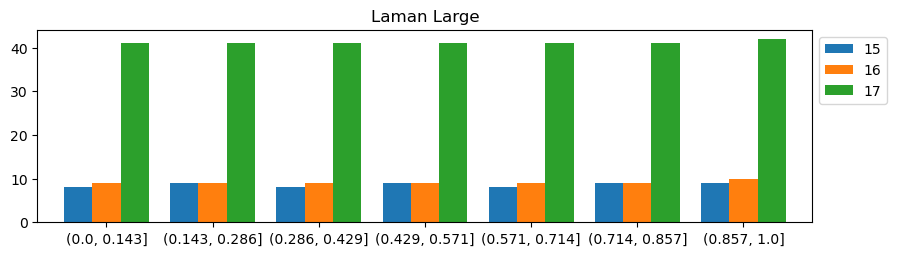

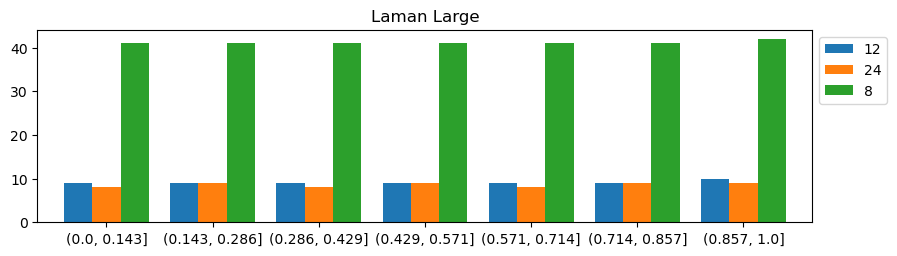

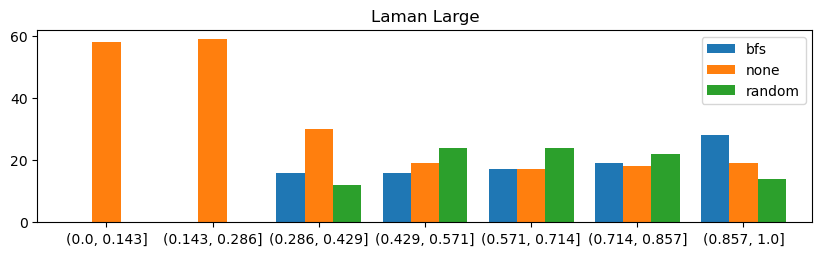

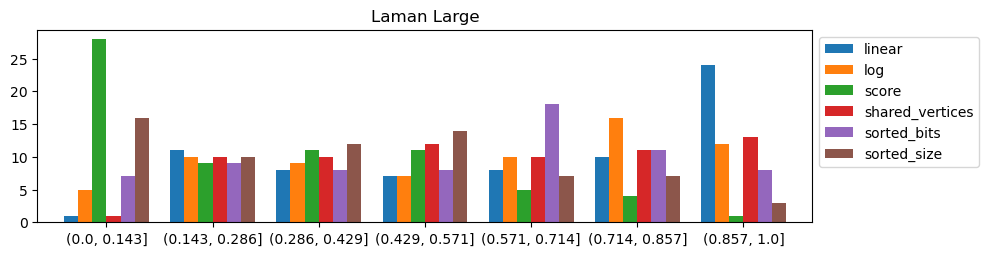

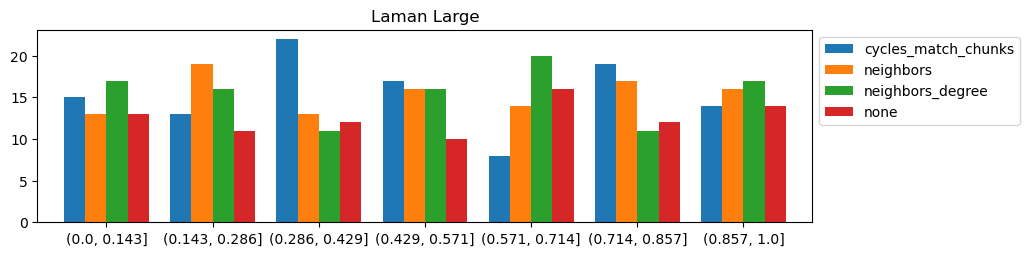

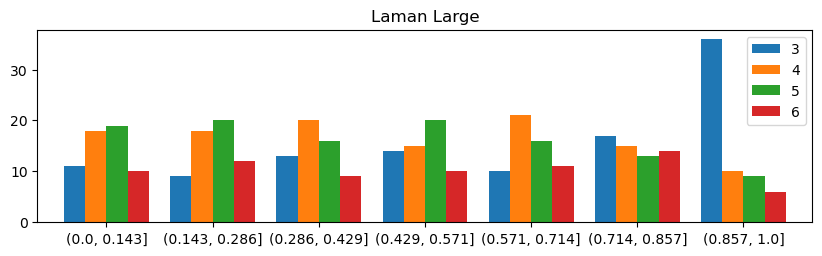

In [18]:
input = """
--------------------------------------------------------------------------------------------------------------- benchmark: 54 tests ----------------------------------------------------------------------------------------------------------------
Name (time in s)                                                                          Min                Max               Mean            StdDev             Median               IQR            Outliers     OPS            Rounds  Iterations
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
test_LamanLarge[15-24-none-subgraphs-score-cycles_match_chunks-3-smart]               30.4925 (1.0)      30.4925 (1.0)      30.4925 (1.0)      0.0000 (1.0)      30.4925 (1.0)      0.0000 (1.0)           0;0  0.0328 (1.0)           1           1
test_LamanLarge[15-24-none-subgraphs-score-neighbors-3-smart]                         30.5188 (1.00)     30.5188 (1.00)     30.5188 (1.00)     0.0000 (1.0)      30.5188 (1.00)     0.0000 (1.0)           0;0  0.0328 (1.00)          1           1
test_LamanLarge[15-24-none-subgraphs-score-neighbors_degree-3-smart]                  30.6896 (1.01)     30.6896 (1.01)     30.6896 (1.01)     0.0000 (1.0)      30.6896 (1.01)     0.0000 (1.0)           0;0  0.0326 (0.99)          1           1
test_LamanLarge[15-24-none-subgraphs-score-neighbors_degree-5-smart]                  31.0369 (1.02)     31.0369 (1.02)     31.0369 (1.02)     0.0000 (1.0)      31.0369 (1.02)     0.0000 (1.0)           0;0  0.0322 (0.98)          1           1
test_LamanLarge[15-24-none-subgraphs-sorted_size-neighbors-4-smart]                   31.0370 (1.02)     31.0370 (1.02)     31.0370 (1.02)     0.0000 (1.0)      31.0370 (1.02)     0.0000 (1.0)           0;0  0.0322 (0.98)          1           1
test_LamanLarge[15-24-none-subgraphs-shared_vertices-neighbors_degree-5-smart]        31.0459 (1.0)      31.0459 (1.0)      31.0459 (1.0)      0.0000 (1.0)      31.0459 (1.0)      0.0000 (1.0)           0;0  0.0322 (1.0)           1           1
test_LamanLarge[15-24-none-subgraphs-sorted_size-cycles_match_chunks-5-smart]         31.0513 (1.02)     31.0513 (1.02)     31.0513 (1.02)     0.0000 (1.0)      31.0513 (1.02)     0.0000 (1.0)           0;0  0.0322 (0.98)          1           1
test_LamanLarge[15-24-none-subgraphs-sorted_size-cycles_match_chunks-4-smart]         31.0595 (1.02)     31.0595 (1.02)     31.0595 (1.02)     0.0000 (1.0)      31.0595 (1.02)     0.0000 (1.0)           0;0  0.0322 (0.98)          1           1
test_LamanLarge[15-24-none-subgraphs-score-cycles_match_chunks-5-smart]               31.0809 (1.02)     31.0809 (1.02)     31.0809 (1.02)     0.0000 (1.0)      31.0809 (1.02)     0.0000 (1.0)           0;0  0.0322 (0.98)          1           1
test_LamanLarge[15-24-none-subgraphs-sorted_size-neighbors_degree-4-smart]            31.0866 (1.02)     31.0866 (1.02)     31.0866 (1.02)     0.0000 (1.0)      31.0866 (1.02)     0.0000 (1.0)           0;0  0.0322 (0.98)          1           1
test_LamanLarge[15-24-none-subgraphs-score-neighbors-4-smart]                         31.0912 (1.02)     31.0912 (1.02)     31.0912 (1.02)     0.0000 (1.0)      31.0912 (1.02)     0.0000 (1.0)           0;0  0.0322 (0.98)          1           1
test_LamanLarge[15-24-none-subgraphs-score-cycles_match_chunks-4-smart]               31.1012 (1.02)     31.1012 (1.02)     31.1012 (1.02)     0.0000 (1.0)      31.1012 (1.02)     0.0000 (1.0)           0;0  0.0322 (0.98)          1           1
test_LamanLarge[15-24-none-subgraphs-sorted_size-neighbors-5-smart]                   31.1285 (1.02)     31.1285 (1.02)     31.1285 (1.02)     0.0000 (1.0)      31.1285 (1.02)     0.0000 (1.0)           0;0  0.0321 (0.98)          1           1
test_LamanLarge[15-24-none-subgraphs-score-neighbors-5-smart]                         31.1340 (1.02)     31.1340 (1.02)     31.1340 (1.02)     0.0000 (1.0)      31.1340 (1.02)     0.0000 (1.0)           0;0  0.0321 (0.98)          1           1
test_LamanLarge[15-24-none-subgraphs-shared_vertices-neighbors_degree-4-smart]        31.2060 (1.01)     31.2060 (1.01)     31.2060 (1.01)     0.0000 (1.0)      31.2060 (1.01)     0.0000 (1.0)           0;0  0.0320 (0.99)          1           1
test_LamanLarge[15-24-none-subgraphs-sorted_size-neighbors_degree-5-smart]            31.2185 (1.02)     31.2185 (1.02)     31.2185 (1.02)     0.0000 (1.0)      31.2185 (1.02)     0.0000 (1.0)           0;0  0.0320 (0.98)          1           1
test_LamanLarge[15-24-none-subgraphs-score-neighbors_degree-4-smart]                  31.2208 (1.02)     31.2208 (1.02)     31.2208 (1.02)     0.0000 (1.0)      31.2208 (1.02)     0.0000 (1.0)           0;0  0.0320 (0.98)          1           1
test_LamanLarge[15-24-none-subgraphs-shared_vertices-cycles_match_chunks-4-smart]     31.3646 (1.01)     31.3646 (1.01)     31.3646 (1.01)     0.0000 (1.0)      31.3646 (1.01)     0.0000 (1.0)           0;0  0.0319 (0.99)          1           1
test_LamanLarge[15-24-none-subgraphs-shared_vertices-neighbors-5-smart]               31.4826 (1.01)     31.4826 (1.01)     31.4826 (1.01)     0.0000 (1.0)      31.4826 (1.01)     0.0000 (1.0)           0;0  0.0318 (0.99)          1           1
test_LamanLarge[15-24-none-subgraphs-sorted_bits-cycles_match_chunks-5-smart]         31.5219 (1.03)     31.5219 (1.03)     31.5219 (1.03)     0.0000 (1.0)      31.5219 (1.03)     0.0000 (1.0)           0;0  0.0317 (0.97)          1           1
test_LamanLarge[15-24-none-subgraphs-sorted_bits-neighbors-4-smart]                   31.5477 (1.03)     31.5477 (1.03)     31.5477 (1.03)     0.0000 (1.0)      31.5477 (1.03)     0.0000 (1.0)           0;0  0.0317 (0.97)          1           1
test_LamanLarge[15-24-none-subgraphs-linear-neighbors-5-smart]                        31.6223 (1.04)     31.6223 (1.04)     31.6223 (1.04)     0.0000 (1.0)      31.6223 (1.04)     0.0000 (1.0)           0;0  0.0316 (0.96)          1           1
test_LamanLarge[15-24-none-subgraphs-log-neighbors_degree-4-smart]                    31.6899 (1.04)     31.6899 (1.04)     31.6899 (1.04)     0.0000 (1.0)      31.6899 (1.04)     0.0000 (1.0)           0;0  0.0316 (0.96)          1           1
test_LamanLarge[15-24-none-subgraphs-shared_vertices-cycles_match_chunks-4-smart]     31.7509 (1.04)     31.7509 (1.04)     31.7509 (1.04)     0.0000 (1.0)      31.7509 (1.04)     0.0000 (1.0)           0;0  0.0315 (0.96)          1           1
test_LamanLarge[15-24-none-subgraphs-sorted_bits-cycles_match_chunks-4-smart]         31.7955 (1.04)     31.7955 (1.04)     31.7955 (1.04)     0.0000 (1.0)      31.7955 (1.04)     0.0000 (1.0)           0;0  0.0315 (0.96)          1           1
test_LamanLarge[15-24-none-subgraphs-linear-neighbors_degree-5-smart]                 31.8146 (1.04)     31.8146 (1.04)     31.8146 (1.04)     0.0000 (1.0)      31.8146 (1.04)     0.0000 (1.0)           0;0  0.0314 (0.96)          1           1
test_LamanLarge[15-24-none-subgraphs-linear-neighbors-4-smart]                        31.9722 (1.05)     31.9722 (1.05)     31.9722 (1.05)     0.0000 (1.0)      31.9722 (1.05)     0.0000 (1.0)           0;0  0.0313 (0.95)          1           1
test_LamanLarge[15-24-none-subgraphs-linear-cycles_match_chunks-4-smart]              32.0057 (1.05)     32.0057 (1.05)     32.0057 (1.05)     0.0000 (1.0)      32.0057 (1.05)     0.0000 (1.0)           0;0  0.0312 (0.95)          1           1
test_LamanLarge[15-24-none-subgraphs-shared_vertices-neighbors-5-smart]               32.0263 (1.05)     32.0263 (1.05)     32.0263 (1.05)     0.0000 (1.0)      32.0263 (1.05)     0.0000 (1.0)           0;0  0.0312 (0.95)          1           1
test_LamanLarge[15-24-none-subgraphs-shared_vertices-neighbors_degree-5-smart]        32.0482 (1.05)     32.0482 (1.05)     32.0482 (1.05)     0.0000 (1.0)      32.0482 (1.05)     0.0000 (1.0)           0;0  0.0312 (0.95)          1           1
test_LamanLarge[15-24-none-subgraphs-linear-neighbors_degree-4-smart]                 32.0912 (1.05)     32.0912 (1.05)     32.0912 (1.05)     0.0000 (1.0)      32.0912 (1.05)     0.0000 (1.0)           0;0  0.0312 (0.95)          1           1
test_LamanLarge[15-24-none-subgraphs-shared_vertices-neighbors_degree-4-smart]        32.0922 (1.05)     32.0922 (1.05)     32.0922 (1.05)     0.0000 (1.0)      32.0922 (1.05)     0.0000 (1.0)           0;0  0.0312 (0.95)          1           1
test_LamanLarge[15-24-none-subgraphs-sorted_bits-neighbors-5-smart]                   32.1055 (1.05)     32.1055 (1.05)     32.1055 (1.05)     0.0000 (1.0)      32.1055 (1.05)     0.0000 (1.0)           0;0  0.0311 (0.95)          1           1
test_LamanLarge[15-24-none-subgraphs-shared_vertices-neighbors-4-smart]               32.1870 (1.04)     32.1870 (1.04)     32.1870 (1.04)     0.0000 (1.0)      32.1870 (1.04)     0.0000 (1.0)           0;0  0.0311 (0.96)          1           1
test_LamanLarge[15-24-none-subgraphs-sorted_bits-neighbors_degree-5-smart]            32.2319 (1.06)     32.2319 (1.06)     32.2319 (1.06)     0.0000 (1.0)      32.2319 (1.06)     0.0000 (1.0)           0;0  0.0310 (0.95)          1           1
test_LamanLarge[15-24-none-subgraphs-log-neighbors-5-smart]                           32.2423 (1.06)     32.2423 (1.06)     32.2423 (1.06)     0.0000 (1.0)      32.2423 (1.06)     0.0000 (1.0)           0;0  0.0310 (0.95)          1           1
test_LamanLarge[15-24-none-subgraphs-sorted_bits-neighbors_degree-4-smart]            32.2806 (1.06)     32.2806 (1.06)     32.2806 (1.06)     0.0000 (1.0)      32.2806 (1.06)     0.0000 (1.0)           0;0  0.0310 (0.94)          1           1
test_LamanLarge[15-24-none-subgraphs-log-neighbors_degree-5-smart]                    32.2918 (1.06)     32.2918 (1.06)     32.2918 (1.06)     0.0000 (1.0)      32.2918 (1.06)     0.0000 (1.0)           0;0  0.0310 (0.94)          1           1
test_LamanLarge[15-24-none-subgraphs-log-neighbors-4-smart]                           32.6033 (1.07)     32.6033 (1.07)     32.6033 (1.07)     0.0000 (1.0)      32.6033 (1.07)     0.0000 (1.0)           0;0  0.0307 (0.94)          1           1
test_LamanLarge[15-24-none-subgraphs-log-cycles_match_chunks-5-smart]                 32.7176 (1.07)     32.7176 (1.07)     32.7176 (1.07)     0.0000 (1.0)      32.7176 (1.07)     0.0000 (1.0)           0;0  0.0306 (0.93)          1           1
test_LamanLarge[15-24-none-subgraphs-shared_vertices-cycles_match_chunks-5-smart]     32.9739 (1.06)     32.9739 (1.06)     32.9739 (1.06)     0.0000 (1.0)      32.9739 (1.06)     0.0000 (1.0)           0;0  0.0303 (0.94)          1           1
test_LamanLarge[15-24-none-subgraphs-log-cycles_match_chunks-4-smart]                 33.0874 (1.09)     33.0874 (1.09)     33.0874 (1.09)     0.0000 (1.0)      33.0874 (1.09)     0.0000 (1.0)           0;0  0.0302 (0.92)          1           1
test_LamanLarge[15-24-none-subgraphs-sorted_size-neighbors-3-smart]                   33.4681 (1.10)     33.4681 (1.10)     33.4681 (1.10)     0.0000 (1.0)      33.4681 (1.10)     0.0000 (1.0)           0;0  0.0299 (0.91)          1           1
test_LamanLarge[15-24-none-subgraphs-shared_vertices-cycles_match_chunks-5-smart]     33.4897 (1.10)     33.4897 (1.10)     33.4897 (1.10)     0.0000 (1.0)      33.4897 (1.10)     0.0000 (1.0)           0;0  0.0299 (0.91)          1           1
test_LamanLarge[15-24-none-subgraphs-sorted_size-cycles_match_chunks-3-smart]         33.5574 (1.10)     33.5574 (1.10)     33.5574 (1.10)     0.0000 (1.0)      33.5574 (1.10)     0.0000 (1.0)           0;0  0.0298 (0.91)          1           1
test_LamanLarge[15-24-none-subgraphs-linear-cycles_match_chunks-5-smart]              33.6339 (1.10)     33.6339 (1.10)     33.6339 (1.10)     0.0000 (1.0)      33.6339 (1.10)     0.0000 (1.0)           0;0  0.0297 (0.91)          1           1
test_LamanLarge[15-24-none-subgraphs-sorted_size-neighbors_degree-3-smart]            34.1278 (1.12)     34.1278 (1.12)     34.1278 (1.12)     0.0000 (1.0)      34.1278 (1.12)     0.0000 (1.0)           0;0  0.0293 (0.89)          1           1
test_LamanLarge[15-24-none-subgraphs-sorted_bits-cycles_match_chunks-3-smart]         34.3633 (1.13)     34.3633 (1.13)     34.3633 (1.13)     0.0000 (1.0)      34.3633 (1.13)     0.0000 (1.0)           0;0  0.0291 (0.89)          1           1
test_LamanLarge[15-24-none-subgraphs-log-neighbors-3-smart]                           34.6448 (1.14)     34.6448 (1.14)     34.6448 (1.14)     0.0000 (1.0)      34.6448 (1.14)     0.0000 (1.0)           0;0  0.0289 (0.88)          1           1
test_LamanLarge[15-24-none-subgraphs-shared_vertices-neighbors_degree-3-smart]        34.7914 (1.14)     34.7914 (1.14)     34.7914 (1.14)     0.0000 (1.0)      34.7914 (1.14)     0.0000 (1.0)           0;0  0.0287 (0.88)          1           1
test_LamanLarge[15-24-none-subgraphs-shared_vertices-neighbors-4-smart]               34.8930 (1.14)     34.8930 (1.14)     34.8930 (1.14)     0.0000 (1.0)      34.8930 (1.14)     0.0000 (1.0)           0;0  0.0287 (0.87)          1           1
test_LamanLarge[15-24-none-subgraphs-linear-neighbors_degree-3-smart]                 34.9147 (1.15)     34.9147 (1.15)     34.9147 (1.15)     0.0000 (1.0)      34.9147 (1.15)     0.0000 (1.0)           0;0  0.0286 (0.87)          1           1
test_LamanLarge[15-24-none-subgraphs-log-neighbors_degree-3-smart]                    34.9621 (1.15)     34.9621 (1.15)     34.9621 (1.15)     0.0000 (1.0)      34.9621 (1.15)     0.0000 (1.0)           0;0  0.0286 (0.87)          1           1
test_LamanLarge[15-24-none-subgraphs-shared_vertices-cycles_match_chunks-3-smart]     35.1084 (1.15)     35.1084 (1.15)     35.1084 (1.15)     0.0000 (1.0)      35.1084 (1.15)     0.0000 (1.0)           0;0  0.0285 (0.87)          1           1
test_LamanLarge[15-24-none-subgraphs-linear-cycles_match_chunks-3-smart]              35.2220 (1.16)     35.2220 (1.16)     35.2220 (1.16)     0.0000 (1.0)      35.2220 (1.16)     0.0000 (1.0)           0;0  0.0284 (0.87)          1           1
test_LamanLarge[15-24-none-subgraphs-linear-neighbors-3-smart]                        35.3413 (1.16)     35.3413 (1.16)     35.3413 (1.16)     0.0000 (1.0)      35.3413 (1.16)     0.0000 (1.0)           0;0  0.0283 (0.86)          1           1
test_LamanLarge[15-24-none-subgraphs-sorted_bits-neighbors-3-smart]                   35.5273 (1.17)     35.5273 (1.17)     35.5273 (1.17)     0.0000 (1.0)      35.5273 (1.17)     0.0000 (1.0)           0;0  0.0281 (0.86)          1           1
test_LamanLarge[15-24-none-subgraphs-log-cycles_match_chunks-3-smart]                 36.1683 (1.19)     36.1683 (1.19)     36.1683 (1.19)     0.0000 (1.0)      36.1683 (1.19)     0.0000 (1.0)           0;0  0.0276 (0.84)          1           1
test_LamanLarge[15-24-none-subgraphs-sorted_bits-neighbors_degree-3-smart]            37.1511 (1.22)     37.1511 (1.22)     37.1511 (1.22)     0.0000 (1.0)      37.1511 (1.22)     0.0000 (1.0)           0;0  0.0269 (0.82)          1           1
test_LamanLarge[15-24-none-subgraphs-shared_vertices-neighbors-3-smart]               38.9286 (1.28)     38.9286 (1.28)     38.9286 (1.28)     0.0000 (1.0)      38.9286 (1.28)     0.0000 (1.0)           0;0  0.0257 (0.78)          1           1


--------------------------------------------------------------------------------------------------------------- benchmark: 77 tests ----------------------------------------------------------------------------------------------------------------
Name (time in s)                                                                          Min                Max               Mean            StdDev             Median               IQR            Outliers     OPS            Rounds  Iterations
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
test_LamanLarge[16-12-none-subgraphs-score-none-4-smart]                              17.7705 (1.0)      17.7705 (1.0)      17.7705 (1.0)      0.0000 (1.0)      17.7705 (1.0)      0.0000 (1.0)           0;0  0.0563 (1.0)           1           1
test_LamanLarge[16-12-none-subgraphs-score-cycles_match_chunks-4-smart]               17.8229 (1.00)     17.8229 (1.00)     17.8229 (1.00)     0.0000 (1.0)      17.8229 (1.00)     0.0000 (1.0)           0;0  0.0561 (1.00)          1           1
test_LamanLarge[16-12-none-subgraphs-score-neighbors-4-smart]                         17.8402 (1.00)     17.8402 (1.00)     17.8402 (1.00)     0.0000 (1.0)      17.8402 (1.00)     0.0000 (1.0)           0;0  0.0561 (1.00)          1           1
test_LamanLarge[16-12-none-subgraphs-score-none-3-smart]                              17.9562 (1.01)     17.9562 (1.01)     17.9562 (1.01)     0.0000 (1.0)      17.9562 (1.01)     0.0000 (1.0)           0;0  0.0557 (0.99)          1           1
test_LamanLarge[16-12-none-subgraphs-score-neighbors_degree-3-smart]                  17.9632 (1.01)     17.9632 (1.01)     17.9632 (1.01)     0.0000 (1.0)      17.9632 (1.01)     0.0000 (1.0)           0;0  0.0557 (0.99)          1           1
test_LamanLarge[16-12-none-subgraphs-sorted_size-none-5-smart]                        17.9720 (1.01)     17.9720 (1.01)     17.9720 (1.01)     0.0000 (1.0)      17.9720 (1.01)     0.0000 (1.0)           0;0  0.0556 (0.99)          1           1
test_LamanLarge[16-12-none-subgraphs-score-cycles_match_chunks-3-smart]               17.9763 (1.01)     17.9763 (1.01)     17.9763 (1.01)     0.0000 (1.0)      17.9763 (1.01)     0.0000 (1.0)           0;0  0.0556 (0.99)          1           1
test_LamanLarge[16-12-none-subgraphs-score-neighbors-3-smart]                         18.0028 (1.01)     18.0028 (1.01)     18.0028 (1.01)     0.0000 (1.0)      18.0028 (1.01)     0.0000 (1.0)           0;0  0.0555 (0.99)          1           1
test_LamanLarge[16-12-none-subgraphs-score-neighbors-5-smart]                         18.0229 (1.01)     18.0229 (1.01)     18.0229 (1.01)     0.0000 (1.0)      18.0229 (1.01)     0.0000 (1.0)           0;0  0.0555 (0.99)          1           1
test_LamanLarge[16-12-none-subgraphs-score-none-5-smart]                              18.0256 (1.01)     18.0256 (1.01)     18.0256 (1.01)     0.0000 (1.0)      18.0256 (1.01)     0.0000 (1.0)           0;0  0.0555 (0.99)          1           1
test_LamanLarge[16-12-none-subgraphs-score-neighbors_degree-4-smart]                  18.0778 (1.02)     18.0778 (1.02)     18.0778 (1.02)     0.0000 (1.0)      18.0778 (1.02)     0.0000 (1.0)           0;0  0.0553 (0.98)          1           1
test_LamanLarge[16-12-none-subgraphs-sorted_size-cycles_match_chunks-5-smart]         18.1133 (1.02)     18.1133 (1.02)     18.1133 (1.02)     0.0000 (1.0)      18.1133 (1.02)     0.0000 (1.0)           0;0  0.0552 (0.98)          1           1
test_LamanLarge[16-12-none-subgraphs-sorted_size-neighbors-5-smart]                   18.1194 (1.02)     18.1194 (1.02)     18.1194 (1.02)     0.0000 (1.0)      18.1194 (1.02)     0.0000 (1.0)           0;0  0.0552 (0.98)          1           1
test_LamanLarge[16-12-none-subgraphs-score-neighbors_degree-5-smart]                  18.1308 (1.02)     18.1308 (1.02)     18.1308 (1.02)     0.0000 (1.0)      18.1308 (1.02)     0.0000 (1.0)           0;0  0.0552 (0.98)          1           1
test_LamanLarge[16-12-none-subgraphs-log-neighbors-4-smart]                           18.1330 (1.02)     18.1330 (1.02)     18.1330 (1.02)     0.0000 (1.0)      18.1330 (1.02)     0.0000 (1.0)           0;0  0.0551 (0.98)          1           1
test_LamanLarge[16-12-none-subgraphs-score-cycles_match_chunks-5-smart]               18.1347 (1.02)     18.1347 (1.02)     18.1347 (1.02)     0.0000 (1.0)      18.1347 (1.02)     0.0000 (1.0)           0;0  0.0551 (0.98)          1           1
test_LamanLarge[16-12-none-subgraphs-sorted_size-neighbors_degree-5-smart]            18.1795 (1.02)     18.1795 (1.02)     18.1795 (1.02)     0.0000 (1.0)      18.1795 (1.02)     0.0000 (1.0)           0;0  0.0550 (0.98)          1           1
test_LamanLarge[16-12-none-subgraphs-log-neighbors_degree-4-smart]                    18.2292 (1.03)     18.2292 (1.03)     18.2292 (1.03)     0.0000 (1.0)      18.2292 (1.03)     0.0000 (1.0)           0;0  0.0549 (0.97)          1           1
test_LamanLarge[16-12-none-subgraphs-sorted_bits-neighbors-5-smart]                   18.3844 (1.03)     18.3844 (1.03)     18.3844 (1.03)     0.0000 (1.0)      18.3844 (1.03)     0.0000 (1.0)           0;0  0.0544 (0.97)          1           1
test_LamanLarge[16-12-none-subgraphs-sorted_bits-cycles_match_chunks-5-smart]         18.3949 (1.04)     18.3949 (1.04)     18.3949 (1.04)     0.0000 (1.0)      18.3949 (1.04)     0.0000 (1.0)           0;0  0.0544 (0.97)          1           1
test_LamanLarge[16-12-none-subgraphs-sorted_bits-neighbors_degree-5-smart]            18.4691 (1.04)     18.4691 (1.04)     18.4691 (1.04)     0.0000 (1.0)      18.4691 (1.04)     0.0000 (1.0)           0;0  0.0541 (0.96)          1           1
test_LamanLarge[16-12-none-subgraphs-sorted_size-neighbors-4-smart]                   18.4886 (1.04)     18.4886 (1.04)     18.4886 (1.04)     0.0000 (1.0)      18.4886 (1.04)     0.0000 (1.0)           0;0  0.0541 (0.96)          1           1
test_LamanLarge[16-12-none-subgraphs-log-cycles_match_chunks-4-smart]                 18.4935 (1.04)     18.4935 (1.04)     18.4935 (1.04)     0.0000 (1.0)      18.4935 (1.04)     0.0000 (1.0)           0;0  0.0541 (0.96)          1           1
test_LamanLarge[16-12-none-subgraphs-sorted_bits-none-5-smart]                        18.5788 (1.05)     18.5788 (1.05)     18.5788 (1.05)     0.0000 (1.0)      18.5788 (1.05)     0.0000 (1.0)           0;0  0.0538 (0.96)          1           1
test_LamanLarge[16-12-none-subgraphs-sorted_size-cycles_match_chunks-4-smart]         18.6040 (1.05)     18.6040 (1.05)     18.6040 (1.05)     0.0000 (1.0)      18.6040 (1.05)     0.0000 (1.0)           0;0  0.0538 (0.96)          1           1
test_LamanLarge[16-12-none-subgraphs-sorted_size-none-4-smart]                        18.6219 (1.05)     18.6219 (1.05)     18.6219 (1.05)     0.0000 (1.0)      18.6219 (1.05)     0.0000 (1.0)           0;0  0.0537 (0.95)          1           1
test_LamanLarge[16-12-none-subgraphs-log-none-4-smart]                                18.6594 (1.05)     18.6594 (1.05)     18.6594 (1.05)     0.0000 (1.0)      18.6594 (1.05)     0.0000 (1.0)           0;0  0.0536 (0.95)          1           1
test_LamanLarge[16-12-none-subgraphs-sorted_size-neighbors-3-smart]                   18.6926 (1.05)     18.6926 (1.05)     18.6926 (1.05)     0.0000 (1.0)      18.6926 (1.05)     0.0000 (1.0)           0;0  0.0535 (0.95)          1           1
test_LamanLarge[16-12-none-subgraphs-sorted_size-none-3-smart]                        18.7031 (1.05)     18.7031 (1.05)     18.7031 (1.05)     0.0000 (1.0)      18.7031 (1.05)     0.0000 (1.0)           0;0  0.0535 (0.95)          1           1
test_LamanLarge[16-12-none-subgraphs-log-neighbors_degree-5-smart]                    18.7040 (1.05)     18.7040 (1.05)     18.7040 (1.05)     0.0000 (1.0)      18.7040 (1.05)     0.0000 (1.0)           0;0  0.0535 (0.95)          1           1
test_LamanLarge[16-12-none-subgraphs-log-neighbors-5-smart]                           18.7512 (1.06)     18.7512 (1.06)     18.7512 (1.06)     0.0000 (1.0)      18.7512 (1.06)     0.0000 (1.0)           0;0  0.0533 (0.95)          1           1
test_LamanLarge[16-12-none-subgraphs-sorted_size-cycles_match_chunks-3-smart]         18.7694 (1.06)     18.7694 (1.06)     18.7694 (1.06)     0.0000 (1.0)      18.7694 (1.06)     0.0000 (1.0)           0;0  0.0533 (0.95)          1           1
test_LamanLarge[16-12-none-subgraphs-linear-neighbors_degree-5-smart]                 18.8798 (1.06)     18.8798 (1.06)     18.8798 (1.06)     0.0000 (1.0)      18.8798 (1.06)     0.0000 (1.0)           0;0  0.0530 (0.94)          1           1
test_LamanLarge[16-12-none-subgraphs-shared_vertices-neighbors_degree-4-smart]        18.8837 (1.06)     18.8837 (1.06)     18.8837 (1.06)     0.0000 (1.0)      18.8837 (1.06)     0.0000 (1.0)           0;0  0.0530 (0.94)          1           1
test_LamanLarge[16-12-none-subgraphs-linear-neighbors-5-smart]                        18.9530 (1.07)     18.9530 (1.07)     18.9530 (1.07)     0.0000 (1.0)      18.9530 (1.07)     0.0000 (1.0)           0;0  0.0528 (0.94)          1           1
test_LamanLarge[16-12-none-subgraphs-sorted_size-neighbors_degree-3-smart]            18.9586 (1.07)     18.9586 (1.07)     18.9586 (1.07)     0.0000 (1.0)      18.9586 (1.07)     0.0000 (1.0)           0;0  0.0527 (0.94)          1           1
test_LamanLarge[16-12-none-subgraphs-sorted_size-neighbors_degree-4-smart]            19.0122 (1.07)     19.0122 (1.07)     19.0122 (1.07)     0.0000 (1.0)      19.0122 (1.07)     0.0000 (1.0)           0;0  0.0526 (0.93)          1           1
test_LamanLarge[16-12-none-subgraphs-shared_vertices-neighbors-4-smart]               19.0624 (1.07)     19.0624 (1.07)     19.0624 (1.07)     0.0000 (1.0)      19.0624 (1.07)     0.0000 (1.0)           0;0  0.0525 (0.93)          1           1
test_LamanLarge[16-12-none-subgraphs-sorted_bits-none-4-smart]                        19.0861 (1.07)     19.0861 (1.07)     19.0861 (1.07)     0.0000 (1.0)      19.0861 (1.07)     0.0000 (1.0)           0;0  0.0524 (0.93)          1           1
test_LamanLarge[16-12-none-subgraphs-sorted_bits-none-3-smart]                        19.0906 (1.07)     19.0906 (1.07)     19.0906 (1.07)     0.0000 (1.0)      19.0906 (1.07)     0.0000 (1.0)           0;0  0.0524 (0.93)          1           1
test_LamanLarge[16-12-none-subgraphs-shared_vertices-cycles_match_chunks-4-smart]     19.1289 (1.08)     19.1289 (1.08)     19.1289 (1.08)     0.0000 (1.0)      19.1289 (1.08)     0.0000 (1.0)           0;0  0.0523 (0.93)          1           1
test_LamanLarge[16-12-none-subgraphs-sorted_bits-neighbors-3-smart]                   19.1492 (1.08)     19.1492 (1.08)     19.1492 (1.08)     0.0000 (1.0)      19.1492 (1.08)     0.0000 (1.0)           0;0  0.0522 (0.93)          1           1
test_LamanLarge[16-12-none-subgraphs-sorted_bits-neighbors-4-smart]                   19.1501 (1.08)     19.1501 (1.08)     19.1501 (1.08)     0.0000 (1.0)      19.1501 (1.08)     0.0000 (1.0)           0;0  0.0522 (0.93)          1           1
test_LamanLarge[16-12-none-subgraphs-shared_vertices-none-4-smart]                    19.1732 (1.08)     19.1732 (1.08)     19.1732 (1.08)     0.0000 (1.0)      19.1732 (1.08)     0.0000 (1.0)           0;0  0.0522 (0.93)          1           1
test_LamanLarge[16-12-none-subgraphs-linear-neighbors_degree-4-smart]                 19.2316 (1.08)     19.2316 (1.08)     19.2316 (1.08)     0.0000 (1.0)      19.2316 (1.08)     0.0000 (1.0)           0;0  0.0520 (0.92)          1           1
test_LamanLarge[16-12-none-subgraphs-sorted_bits-cycles_match_chunks-4-smart]         19.2546 (1.08)     19.2546 (1.08)     19.2546 (1.08)     0.0000 (1.0)      19.2546 (1.08)     0.0000 (1.0)           0;0  0.0519 (0.92)          1           1
test_LamanLarge[16-12-none-subgraphs-log-none-5-smart]                                19.3009 (1.09)     19.3009 (1.09)     19.3009 (1.09)     0.0000 (1.0)      19.3009 (1.09)     0.0000 (1.0)           0;0  0.0518 (0.92)          1           1
test_LamanLarge[16-12-none-subgraphs-sorted_bits-neighbors_degree-4-smart]            19.3339 (1.09)     19.3339 (1.09)     19.3339 (1.09)     0.0000 (1.0)      19.3339 (1.09)     0.0000 (1.0)           0;0  0.0517 (0.92)          1           1
test_LamanLarge[16-12-none-subgraphs-log-cycles_match_chunks-5-smart]                 19.3410 (1.09)     19.3410 (1.09)     19.3410 (1.09)     0.0000 (1.0)      19.3410 (1.09)     0.0000 (1.0)           0;0  0.0517 (0.92)          1           1
test_LamanLarge[16-12-none-subgraphs-sorted_bits-cycles_match_chunks-3-smart]         19.4358 (1.09)     19.4358 (1.09)     19.4358 (1.09)     0.0000 (1.0)      19.4358 (1.09)     0.0000 (1.0)           0;0  0.0515 (0.91)          1           1
test_LamanLarge[16-12-none-subgraphs-sorted_bits-neighbors_degree-3-smart]            19.4377 (1.09)     19.4377 (1.09)     19.4377 (1.09)     0.0000 (1.0)      19.4377 (1.09)     0.0000 (1.0)           0;0  0.0514 (0.91)          1           1
test_LamanLarge[16-12-none-subgraphs-linear-cycles_match_chunks-5-smart]              19.7326 (1.11)     19.7326 (1.11)     19.7326 (1.11)     0.0000 (1.0)      19.7326 (1.11)     0.0000 (1.0)           0;0  0.0507 (0.90)          1           1
test_LamanLarge[16-12-none-subgraphs-linear-cycles_match_chunks-4-smart]              19.7649 (1.11)     19.7649 (1.11)     19.7649 (1.11)     0.0000 (1.0)      19.7649 (1.11)     0.0000 (1.0)           0;0  0.0506 (0.90)          1           1
test_LamanLarge[16-12-none-subgraphs-log-neighbors_degree-3-smart]                    20.1403 (1.13)     20.1403 (1.13)     20.1403 (1.13)     0.0000 (1.0)      20.1403 (1.13)     0.0000 (1.0)           0;0  0.0497 (0.88)          1           1
test_LamanLarge[16-12-none-subgraphs-linear-none-5-smart]                             20.3866 (1.15)     20.3866 (1.15)     20.3866 (1.15)     0.0000 (1.0)      20.3866 (1.15)     0.0000 (1.0)           0;0  0.0491 (0.87)          1           1
test_LamanLarge[16-12-none-subgraphs-linear-neighbors-4-smart]                        20.4259 (1.15)     20.4259 (1.15)     20.4259 (1.15)     0.0000 (1.0)      20.4259 (1.15)     0.0000 (1.0)           0;0  0.0490 (0.87)          1           1
test_LamanLarge[16-12-none-subgraphs-log-cycles_match_chunks-3-smart]                 20.6580 (1.16)     20.6580 (1.16)     20.6580 (1.16)     0.0000 (1.0)      20.6580 (1.16)     0.0000 (1.0)           0;0  0.0484 (0.86)          1           1
test_LamanLarge[16-12-none-subgraphs-log-neighbors-3-smart]                           20.6647 (1.16)     20.6647 (1.16)     20.6647 (1.16)     0.0000 (1.0)      20.6647 (1.16)     0.0000 (1.0)           0;0  0.0484 (0.86)          1           1
test_LamanLarge[16-12-none-subgraphs-log-none-3-smart]                                20.7062 (1.17)     20.7062 (1.17)     20.7062 (1.17)     0.0000 (1.0)      20.7062 (1.17)     0.0000 (1.0)           0;0  0.0483 (0.86)          1           1
test_LamanLarge[16-12-none-subgraphs-linear-none-4-smart]                             20.7214 (1.17)     20.7214 (1.17)     20.7214 (1.17)     0.0000 (1.0)      20.7214 (1.17)     0.0000 (1.0)           0;0  0.0483 (0.86)          1           1
test_LamanLarge[16-12-none-subgraphs-linear-neighbors_degree-3-smart]                 20.7714 (1.17)     20.7714 (1.17)     20.7714 (1.17)     0.0000 (1.0)      20.7714 (1.17)     0.0000 (1.0)           0;0  0.0481 (0.86)          1           1
test_LamanLarge[16-12-none-subgraphs-linear-neighbors-3-smart]                        21.1060 (1.19)     21.1060 (1.19)     21.1060 (1.19)     0.0000 (1.0)      21.1060 (1.19)     0.0000 (1.0)           0;0  0.0474 (0.84)          1           1
test_LamanLarge[16-12-none-subgraphs-linear-cycles_match_chunks-3-smart]              21.2861 (1.20)     21.2861 (1.20)     21.2861 (1.20)     0.0000 (1.0)      21.2861 (1.20)     0.0000 (1.0)           0;0  0.0470 (0.83)          1           1
test_LamanLarge[16-12-none-subgraphs-linear-none-3-smart]                             21.7965 (1.23)     21.7965 (1.23)     21.7965 (1.23)     0.0000 (1.0)      21.7965 (1.23)     0.0000 (1.0)           0;0  0.0459 (0.82)          1           1

---------------------------------------------------------------------------------------------------------------- benchmark: 264 tests ---------------------------------------------------------------------------------------------------------------
Name (time in s)                                                                           Min                Max               Mean            StdDev             Median               IQR            Outliers     OPS            Rounds  Iterations
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
test_LamanLarge[17-8-none-subgraphs-score-none-3-smart]                                35.5381 (1.0)      35.5381 (1.0)      35.5381 (1.0)      0.0000 (1.0)      35.5381 (1.0)      0.0000 (1.0)           0;0  0.0281 (1.0)           1           1
test_LamanLarge[17-8-none-subgraphs-score-neighbors-4-smart]                           35.6790 (1.00)     35.6790 (1.00)     35.6790 (1.00)     0.0000 (1.0)      35.6790 (1.00)     0.0000 (1.0)           0;0  0.0280 (1.00)          1           1
test_LamanLarge[17-8-none-subgraphs-score-none-4-smart]                                35.6922 (1.00)     35.6922 (1.00)     35.6922 (1.00)     0.0000 (1.0)      35.6922 (1.00)     0.0000 (1.0)           0;0  0.0280 (1.00)          1           1
test_LamanLarge[17-8-none-subgraphs-score-cycles_match_chunks-4-smart]                 35.7058 (1.00)     35.7058 (1.00)     35.7058 (1.00)     0.0000 (1.0)      35.7058 (1.00)     0.0000 (1.0)           0;0  0.0280 (1.00)          1           1
test_LamanLarge[17-8-none-subgraphs-score-neighbors-3-smart]                           35.7097 (1.00)     35.7097 (1.00)     35.7097 (1.00)     0.0000 (1.0)      35.7097 (1.00)     0.0000 (1.0)           0;0  0.0280 (1.00)          1           1
test_LamanLarge[17-8-none-subgraphs-score-cycles_match_chunks-3-smart]                 35.7247 (1.01)     35.7247 (1.01)     35.7247 (1.01)     0.0000 (1.0)      35.7247 (1.01)     0.0000 (1.0)           0;0  0.0280 (0.99)          1           1
test_LamanLarge[17-8-none-subgraphs-score-neighbors_degree-4-smart]                    36.0012 (1.01)     36.0012 (1.01)     36.0012 (1.01)     0.0000 (1.0)      36.0012 (1.01)     0.0000 (1.0)           0;0  0.0278 (0.99)          1           1
test_LamanLarge[17-8-none-subgraphs-score-cycles_match_chunks-5-smart]                 36.0413 (1.01)     36.0413 (1.01)     36.0413 (1.01)     0.0000 (1.0)      36.0413 (1.01)     0.0000 (1.0)           0;0  0.0277 (0.99)          1           1
test_LamanLarge[17-8-none-subgraphs-sorted_size-neighbors_degree-6-smart]              36.1388 (1.02)     36.1388 (1.02)     36.1388 (1.02)     0.0000 (1.0)      36.1388 (1.02)     0.0000 (1.0)           0;0  0.0277 (0.98)          1           1
test_LamanLarge[17-8-none-subgraphs-sorted_size-none-5-smart]                          36.1495 (1.02)     36.1495 (1.02)     36.1495 (1.02)     0.0000 (1.0)      36.1495 (1.02)     0.0000 (1.0)           0;0  0.0277 (0.98)          1           1
test_LamanLarge[17-8-none-subgraphs-score-none-5-smart]                                36.1569 (1.02)     36.1569 (1.02)     36.1569 (1.02)     0.0000 (1.0)      36.1569 (1.02)     0.0000 (1.0)           0;0  0.0277 (0.98)          1           1
test_LamanLarge[17-8-none-subgraphs-sorted_size-cycles_match_chunks-5-smart]           36.2413 (1.02)     36.2413 (1.02)     36.2413 (1.02)     0.0000 (1.0)      36.2413 (1.02)     0.0000 (1.0)           0;0  0.0276 (0.98)          1           1
test_LamanLarge[17-8-none-subgraphs-sorted_size-neighbors-5-smart]                     36.2662 (1.02)     36.2662 (1.02)     36.2662 (1.02)     0.0000 (1.0)      36.2662 (1.02)     0.0000 (1.0)           0;0  0.0276 (0.98)          1           1
test_LamanLarge[17-8-none-subgraphs-score-neighbors_degree-3-smart]                    36.2738 (1.02)     36.2738 (1.02)     36.2738 (1.02)     0.0000 (1.0)      36.2738 (1.02)     0.0000 (1.0)           0;0  0.0276 (0.98)          1           1
test_LamanLarge[17-8-none-subgraphs-score-neighbors-5-smart]                           36.3112 (1.02)     36.3112 (1.02)     36.3112 (1.02)     0.0000 (1.0)      36.3112 (1.02)     0.0000 (1.0)           0;0  0.0275 (0.98)          1           1
test_LamanLarge[17-8-none-subgraphs-log-cycles_match_chunks-4-smart]                   36.3562 (1.02)     36.3562 (1.02)     36.3562 (1.02)     0.0000 (1.0)      36.3562 (1.02)     0.0000 (1.0)           0;0  0.0275 (0.98)          1           1
test_LamanLarge[17-8-none-subgraphs-score-neighbors_degree-6-smart]                    36.3649 (1.02)     36.3649 (1.02)     36.3649 (1.02)     0.0000 (1.0)      36.3649 (1.02)     0.0000 (1.0)           0;0  0.0275 (0.98)          1           1
test_LamanLarge[17-8-none-subgraphs-score-neighbors_degree-5-smart]                    36.3766 (1.02)     36.3766 (1.02)     36.3766 (1.02)     0.0000 (1.0)      36.3766 (1.02)     0.0000 (1.0)           0;0  0.0275 (0.98)          1           1
test_LamanLarge[17-8-none-subgraphs-sorted_size-cycles_match_chunks-4-smart]           36.4433 (1.03)     36.4433 (1.03)     36.4433 (1.03)     0.0000 (1.0)      36.4433 (1.03)     0.0000 (1.0)           0;0  0.0274 (0.98)          1           1
test_LamanLarge[17-8-none-subgraphs-sorted_bits-none-5-smart]                          36.4771 (1.03)     36.4771 (1.03)     36.4771 (1.03)     0.0000 (1.0)      36.4771 (1.03)     0.0000 (1.0)           0;0  0.0274 (0.97)          1           1
test_LamanLarge[17-8-none-subgraphs-sorted_size-neighbors_degree-5-smart]              36.4862 (1.03)     36.4862 (1.03)     36.4862 (1.03)     0.0000 (1.0)      36.4862 (1.03)     0.0000 (1.0)           0;0  0.0274 (0.97)          1           1
test_LamanLarge[17-8-none-subgraphs-log-none-4-smart]                                  36.4985 (1.03)     36.4985 (1.03)     36.4985 (1.03)     0.0000 (1.0)      36.4985 (1.03)     0.0000 (1.0)           0;0  0.0274 (0.97)          1           1
test_LamanLarge[17-8-none-subgraphs-sorted_size-none-4-smart]                          36.4989 (1.03)     36.4989 (1.03)     36.4989 (1.03)     0.0000 (1.0)      36.4989 (1.03)     0.0000 (1.0)           0;0  0.0274 (0.97)          1           1
test_LamanLarge[17-8-none-subgraphs-score-none-6-smart]                                36.5799 (1.03)     36.5799 (1.03)     36.5799 (1.03)     0.0000 (1.0)      36.5799 (1.03)     0.0000 (1.0)           0;0  0.0273 (0.97)          1           1
test_LamanLarge[17-8-none-subgraphs-score-cycles_match_chunks-6-smart]                 36.6218 (1.03)     36.6218 (1.03)     36.6218 (1.03)     0.0000 (1.0)      36.6218 (1.03)     0.0000 (1.0)           0;0  0.0273 (0.97)          1           1
test_LamanLarge[17-8-none-subgraphs-sorted_size-neighbors-4-smart]                     36.6826 (1.03)     36.6826 (1.03)     36.6826 (1.03)     0.0000 (1.0)      36.6826 (1.03)     0.0000 (1.0)           0;0  0.0273 (0.97)          1           1
test_LamanLarge[17-8-none-subgraphs-sorted_size-cycles_match_chunks-6-smart]           36.6837 (1.03)     36.6837 (1.03)     36.6837 (1.03)     0.0000 (1.0)      36.6837 (1.03)     0.0000 (1.0)           0;0  0.0273 (0.97)          1           1
test_LamanLarge[17-8-none-subgraphs-sorted_bits-cycles_match_chunks-5-smart]           36.7713 (1.03)     36.7713 (1.03)     36.7713 (1.03)     0.0000 (1.0)      36.7713 (1.03)     0.0000 (1.0)           0;0  0.0272 (0.97)          1           1
test_LamanLarge[17-8-none-subgraphs-sorted_size-neighbors_degree-4-smart]              36.7958 (1.04)     36.7958 (1.04)     36.7958 (1.04)     0.0000 (1.0)      36.7958 (1.04)     0.0000 (1.0)           0;0  0.0272 (0.97)          1           1
test_LamanLarge[17-8-none-subgraphs-sorted_size-none-6-smart]                          36.8119 (1.04)     36.8119 (1.04)     36.8119 (1.04)     0.0000 (1.0)      36.8119 (1.04)     0.0000 (1.0)           0;0  0.0272 (0.97)          1           1
test_LamanLarge[17-8-none-subgraphs-log-neighbors_degree-4-smart]                      36.8622 (1.04)     36.8622 (1.04)     36.8622 (1.04)     0.0000 (1.0)      36.8622 (1.04)     0.0000 (1.0)           0;0  0.0271 (0.96)          1           1
test_LamanLarge[17-8-none-subgraphs-sorted_bits-neighbors-5-smart]                     36.8645 (1.04)     36.8645 (1.04)     36.8645 (1.04)     0.0000 (1.0)      36.8645 (1.04)     0.0000 (1.0)           0;0  0.0271 (0.96)          1           1
test_LamanLarge[17-8-none-subgraphs-sorted_size-neighbors-6-smart]                     36.9746 (1.04)     36.9746 (1.04)     36.9746 (1.04)     0.0000 (1.0)      36.9746 (1.04)     0.0000 (1.0)           0;0  0.0270 (0.96)          1           1
test_LamanLarge[17-8-none-subgraphs-sorted_bits-neighbors_degree-5-smart]              36.9785 (1.04)     36.9785 (1.04)     36.9785 (1.04)     0.0000 (1.0)      36.9785 (1.04)     0.0000 (1.0)           0;0  0.0270 (0.96)          1           1
test_LamanLarge[17-8-none-subgraphs-log-neighbors_degree-6-smart]                      37.1254 (1.04)     37.1254 (1.04)     37.1254 (1.04)     0.0000 (1.0)      37.1254 (1.04)     0.0000 (1.0)           0;0  0.0269 (0.96)          1           1
test_LamanLarge[17-8-none-subgraphs-score-neighbors-6-smart]                           37.1271 (1.04)     37.1271 (1.04)     37.1271 (1.04)     0.0000 (1.0)      37.1271 (1.04)     0.0000 (1.0)           0;0  0.0269 (0.96)          1           1
test_LamanLarge[17-8-none-subgraphs-sorted_bits-cycles_match_chunks-4-smart]           37.1307 (1.04)     37.1307 (1.04)     37.1307 (1.04)     0.0000 (1.0)      37.1307 (1.04)     0.0000 (1.0)           0;0  0.0269 (0.96)          1           1
test_LamanLarge[17-8-none-subgraphs-sorted_bits-neighbors_degree-6-smart]              37.1657 (1.05)     37.1657 (1.05)     37.1657 (1.05)     0.0000 (1.0)      37.1657 (1.05)     0.0000 (1.0)           0;0  0.0269 (0.96)          1           1
test_LamanLarge[17-8-none-subgraphs-log-neighbors_degree-5-smart]                      37.1958 (1.05)     37.1958 (1.05)     37.1958 (1.05)     0.0000 (1.0)      37.1958 (1.05)     0.0000 (1.0)           0;0  0.0269 (0.96)          1           1
test_LamanLarge[17-8-none-subgraphs-sorted_bits-none-4-smart]                          37.2280 (1.05)     37.2280 (1.05)     37.2280 (1.05)     0.0000 (1.0)      37.2280 (1.05)     0.0000 (1.0)           0;0  0.0269 (0.95)          1           1
test_LamanLarge[17-8-none-subgraphs-linear-neighbors_degree-5-smart]                   37.2297 (1.05)     37.2297 (1.05)     37.2297 (1.05)     0.0000 (1.0)      37.2297 (1.05)     0.0000 (1.0)           0;0  0.0269 (0.95)          1           1
test_LamanLarge[17-8-none-subgraphs-linear-neighbors_degree-6-smart]                   37.2592 (1.05)     37.2592 (1.05)     37.2592 (1.05)     0.0000 (1.0)      37.2592 (1.05)     0.0000 (1.0)           0;0  0.0268 (0.95)          1           1
test_LamanLarge[17-8-none-subgraphs-sorted_size-cycles_match_chunks-3-smart]           37.3824 (1.05)     37.3824 (1.05)     37.3824 (1.05)     0.0000 (1.0)      37.3824 (1.05)     0.0000 (1.0)           0;0  0.0268 (0.95)          1           1
test_LamanLarge[17-8-none-subgraphs-sorted_bits-neighbors-4-smart]                     37.4062 (1.05)     37.4062 (1.05)     37.4062 (1.05)     0.0000 (1.0)      37.4062 (1.05)     0.0000 (1.0)           0;0  0.0267 (0.95)          1           1
test_LamanLarge[17-8-none-subgraphs-sorted_size-none-3-smart]                          37.4259 (1.05)     37.4259 (1.05)     37.4259 (1.05)     0.0000 (1.0)      37.4259 (1.05)     0.0000 (1.0)           0;0  0.0267 (0.95)          1           1
test_LamanLarge[17-8-none-subgraphs-sorted_bits-none-6-smart]                          37.4333 (1.05)     37.4333 (1.05)     37.4333 (1.05)     0.0000 (1.0)      37.4333 (1.05)     0.0000 (1.0)           0;0  0.0267 (0.95)          1           1
test_LamanLarge[17-8-none-subgraphs-sorted_bits-cycles_match_chunks-6-smart]           37.4783 (1.05)     37.4783 (1.05)     37.4783 (1.05)     0.0000 (1.0)      37.4783 (1.05)     0.0000 (1.0)           0;0  0.0267 (0.95)          1           1
test_LamanLarge[17-8-none-subgraphs-log-none-5-smart]                                  37.5034 (1.06)     37.5034 (1.06)     37.5034 (1.06)     0.0000 (1.0)      37.5034 (1.06)     0.0000 (1.0)           0;0  0.0267 (0.95)          1           1
test_LamanLarge[17-8-none-subgraphs-log-cycles_match_chunks-5-smart]                   37.5536 (1.06)     37.5536 (1.06)     37.5536 (1.06)     0.0000 (1.0)      37.5536 (1.06)     0.0000 (1.0)           0;0  0.0266 (0.95)          1           1
test_LamanLarge[17-8-none-subgraphs-sorted_size-neighbors-3-smart]                     37.5619 (1.06)     37.5619 (1.06)     37.5619 (1.06)     0.0000 (1.0)      37.5619 (1.06)     0.0000 (1.0)           0;0  0.0266 (0.95)          1           1
test_LamanLarge[17-8-none-subgraphs-log-neighbors-4-smart]                             37.5814 (1.06)     37.5814 (1.06)     37.5814 (1.06)     0.0000 (1.0)      37.5814 (1.06)     0.0000 (1.0)           0;0  0.0266 (0.95)          1           1
test_LamanLarge[17-8-none-subgraphs-linear-cycles_match_chunks-5-smart]                37.6061 (1.06)     37.6061 (1.06)     37.6061 (1.06)     0.0000 (1.0)      37.6061 (1.06)     0.0000 (1.0)           0;0  0.0266 (0.95)          1           1
test_LamanLarge[17-8-none-subgraphs-log-neighbors-6-smart]                             37.6271 (1.06)     37.6271 (1.06)     37.6271 (1.06)     0.0000 (1.0)      37.6271 (1.06)     0.0000 (1.0)           0;0  0.0266 (0.94)          1           1
test_LamanLarge[17-8-none-subgraphs-sorted_bits-neighbors-6-smart]                     37.6415 (1.06)     37.6415 (1.06)     37.6415 (1.06)     0.0000 (1.0)      37.6415 (1.06)     0.0000 (1.0)           0;0  0.0266 (0.94)          1           1
test_LamanLarge[17-8-none-subgraphs-log-none-6-smart]                                  37.6673 (1.06)     37.6673 (1.06)     37.6673 (1.06)     0.0000 (1.0)      37.6673 (1.06)     0.0000 (1.0)           0;0  0.0265 (0.94)          1           1
test_LamanLarge[17-8-none-subgraphs-log-cycles_match_chunks-6-smart]                   37.7800 (1.06)     37.7800 (1.06)     37.7800 (1.06)     0.0000 (1.0)      37.7800 (1.06)     0.0000 (1.0)           0;0  0.0265 (0.94)          1           1
test_LamanLarge[17-8-none-subgraphs-sorted_bits-neighbors_degree-4-smart]              37.8856 (1.07)     37.8856 (1.07)     37.8856 (1.07)     0.0000 (1.0)      37.8856 (1.07)     0.0000 (1.0)           0;0  0.0264 (0.94)          1           1
test_LamanLarge[17-8-none-subgraphs-sorted_bits-none-3-smart]                          37.9342 (1.07)     37.9342 (1.07)     37.9342 (1.07)     0.0000 (1.0)      37.9342 (1.07)     0.0000 (1.0)           0;0  0.0264 (0.94)          1           1
test_LamanLarge[17-8-none-subgraphs-shared_vertices-neighbors-5-smart]                 38.0321 (1.0)      38.0321 (1.0)      38.0321 (1.0)      0.0000 (1.0)      38.0321 (1.0)      0.0000 (1.0)           0;0  0.0263 (1.0)           1           1
test_LamanLarge[17-8-none-subgraphs-sorted_size-neighbors_degree-3-smart]              38.1419 (1.07)     38.1419 (1.07)     38.1419 (1.07)     0.0000 (1.0)      38.1419 (1.07)     0.0000 (1.0)           0;0  0.0262 (0.93)          1           1
test_LamanLarge[17-8-none-subgraphs-sorted_bits-cycles_match_chunks-3-smart]           38.1893 (1.07)     38.1893 (1.07)     38.1893 (1.07)     0.0000 (1.0)      38.1893 (1.07)     0.0000 (1.0)           0;0  0.0262 (0.93)          1           1
test_LamanLarge[17-8-none-subgraphs-linear-cycles_match_chunks-6-smart]                38.2282 (1.08)     38.2282 (1.08)     38.2282 (1.08)     0.0000 (1.0)      38.2282 (1.08)     0.0000 (1.0)           0;0  0.0262 (0.93)          1           1
test_LamanLarge[17-8-none-subgraphs-linear-neighbors_degree-4-smart]                   38.2355 (1.08)     38.2355 (1.08)     38.2355 (1.08)     0.0000 (1.0)      38.2355 (1.08)     0.0000 (1.0)           0;0  0.0262 (0.93)          1           1
test_LamanLarge[17-8-none-subgraphs-linear-neighbors-5-smart]                          38.3284 (1.08)     38.3284 (1.08)     38.3284 (1.08)     0.0000 (1.0)      38.3284 (1.08)     0.0000 (1.0)           0;0  0.0261 (0.93)          1           1
test_LamanLarge[17-8-none-subgraphs-linear-neighbors-6-smart]                          38.3710 (1.08)     38.3710 (1.08)     38.3710 (1.08)     0.0000 (1.0)      38.3710 (1.08)     0.0000 (1.0)           0;0  0.0261 (0.93)          1           1
test_LamanLarge[17-8-none-subgraphs-sorted_bits-neighbors-3-smart]                     38.5181 (1.08)     38.5181 (1.08)     38.5181 (1.08)     0.0000 (1.0)      38.5181 (1.08)     0.0000 (1.0)           0;0  0.0260 (0.92)          1           1
test_LamanLarge[17-8-none-subgraphs-shared_vertices-neighbors_degree-6-smart]          38.5753 (1.01)     38.5753 (1.01)     38.5753 (1.01)     0.0000 (1.0)      38.5753 (1.01)     0.0000 (1.0)           0;0  0.0259 (0.99)          1           1
test_LamanLarge[17-8-none-subgraphs-shared_vertices-neighbors_degree-5-smart]          38.7193 (1.02)     38.7193 (1.02)     38.7193 (1.02)     0.0000 (1.0)      38.7193 (1.02)     0.0000 (1.0)           0;0  0.0258 (0.98)          1           1
test_LamanLarge[17-8-none-subgraphs-log-neighbors-5-smart]                             38.7701 (1.09)     38.7701 (1.09)     38.7701 (1.09)     0.0000 (1.0)      38.7701 (1.09)     0.0000 (1.0)           0;0  0.0258 (0.92)          1           1
test_LamanLarge[17-8-none-subgraphs-sorted_bits-neighbors_degree-3-smart]              38.8524 (1.09)     38.8524 (1.09)     38.8524 (1.09)     0.0000 (1.0)      38.8524 (1.09)     0.0000 (1.0)           0;0  0.0257 (0.91)          1           1
test_LamanLarge[17-8-none-subgraphs-linear-none-5-smart]                               38.9226 (1.10)     38.9226 (1.10)     38.9226 (1.10)     0.0000 (1.0)      38.9226 (1.10)     0.0000 (1.0)           0;0  0.0257 (0.91)          1           1
test_LamanLarge[17-8-none-subgraphs-linear-none-6-smart]                               39.0776 (1.10)     39.0776 (1.10)     39.0776 (1.10)     0.0000 (1.0)      39.0776 (1.10)     0.0000 (1.0)           0;0  0.0256 (0.91)          1           1
test_LamanLarge[17-8-none-subgraphs-shared_vertices-neighbors-6-smart]                 39.0783 (1.03)     39.0783 (1.03)     39.0783 (1.03)     0.0000 (1.0)      39.0783 (1.03)     0.0000 (1.0)           0;0  0.0256 (0.97)          1           1
test_LamanLarge[17-8-none-subgraphs-linear-neighbors-4-smart]                          39.2513 (1.10)     39.2513 (1.10)     39.2513 (1.10)     0.0000 (1.0)      39.2513 (1.10)     0.0000 (1.0)           0;0  0.0255 (0.91)          1           1
test_LamanLarge[17-8-none-subgraphs-linear-none-4-smart]                               39.2558 (1.10)     39.2558 (1.10)     39.2558 (1.10)     0.0000 (1.0)      39.2558 (1.10)     0.0000 (1.0)           0;0  0.0255 (0.91)          1           1
test_LamanLarge[17-8-none-subgraphs-linear-cycles_match_chunks-4-smart]                39.4465 (1.11)     39.4465 (1.11)     39.4465 (1.11)     0.0000 (1.0)      39.4465 (1.11)     0.0000 (1.0)           0;0  0.0254 (0.90)          1           1
test_LamanLarge[17-8-none-subgraphs-shared_vertices-none-5-smart]                      39.5258 (1.04)     39.5258 (1.04)     39.5258 (1.04)     0.0000 (1.0)      39.5258 (1.04)     0.0000 (1.0)           0;0  0.0253 (0.96)          1           1
test_LamanLarge[17-8-none-subgraphs-shared_vertices-neighbors-4-smart]                 39.8217 (1.05)     39.8217 (1.05)     39.8217 (1.05)     0.0000 (1.0)      39.8217 (1.05)     0.0000 (1.0)           0;0  0.0251 (0.96)          1           1
test_LamanLarge[17-8-none-subgraphs-shared_vertices-cycles_match_chunks-5-smart]       39.9950 (1.05)     39.9950 (1.05)     39.9950 (1.05)     0.0000 (1.0)      39.9950 (1.05)     0.0000 (1.0)           0;0  0.0250 (0.95)          1           1
test_LamanLarge[17-8-none-subgraphs-shared_vertices-neighbors_degree-4-smart]          40.1461 (1.06)     40.1461 (1.06)     40.1461 (1.06)     0.0000 (1.0)      40.1461 (1.06)     0.0000 (1.0)           0;0  0.0249 (0.95)          1           1
test_LamanLarge[17-8-none-subgraphs-shared_vertices-none-4-smart]                      40.2270 (1.06)     40.2270 (1.06)     40.2270 (1.06)     0.0000 (1.0)      40.2270 (1.06)     0.0000 (1.0)           0;0  0.0249 (0.95)          1           1
test_LamanLarge[17-8-none-subgraphs-log-neighbors-3-smart]                             40.4098 (1.14)     40.4098 (1.14)     40.4098 (1.14)     0.0000 (1.0)      40.4098 (1.14)     0.0000 (1.0)           0;0  0.0247 (0.88)          1           1
test_LamanLarge[17-8-none-subgraphs-shared_vertices-cycles_match_chunks-6-smart]       40.4688 (1.06)     40.4688 (1.06)     40.4688 (1.06)     0.0000 (1.0)      40.4688 (1.06)     0.0000 (1.0)           0;0  0.0247 (0.94)          1           1
test_LamanLarge[17-8-bfs-subgraphs-sorted_size-cycles_match_chunks-6-smart]            40.6078 (1.14)     40.6078 (1.14)     40.6078 (1.14)     0.0000 (1.0)      40.6078 (1.14)     0.0000 (1.0)           0;0  0.0246 (0.88)          1           1
test_LamanLarge[17-8-none-subgraphs-log-cycles_match_chunks-3-smart]                   40.6986 (1.15)     40.6986 (1.15)     40.6986 (1.15)     0.0000 (1.0)      40.6986 (1.15)     0.0000 (1.0)           0;0  0.0246 (0.87)          1           1
test_LamanLarge[17-8-none-subgraphs-log-none-3-smart]                                  40.7184 (1.15)     40.7184 (1.15)     40.7184 (1.15)     0.0000 (1.0)      40.7184 (1.15)     0.0000 (1.0)           0;0  0.0246 (0.87)          1           1
test_LamanLarge[17-8-none-subgraphs-shared_vertices-none-6-smart]                      41.2185 (1.08)     41.2185 (1.08)     41.2185 (1.08)     0.0000 (1.0)      41.2185 (1.08)     0.0000 (1.0)           0;0  0.0243 (0.92)          1           1
test_LamanLarge[17-8-none-subgraphs-shared_vertices-cycles_match_chunks-4-smart]       41.2862 (1.09)     41.2862 (1.09)     41.2862 (1.09)     0.0000 (1.0)      41.2862 (1.09)     0.0000 (1.0)           0;0  0.0242 (0.92)          1           1
test_LamanLarge[17-8-none-subgraphs-log-neighbors_degree-3-smart]                      41.3108 (1.16)     41.3108 (1.16)     41.3108 (1.16)     0.0000 (1.0)      41.3108 (1.16)     0.0000 (1.0)           0;0  0.0242 (0.86)          1           1
test_LamanLarge[17-8-random-subgraphs-score-cycles_match_chunks-3-smart]               41.3358 (1.16)     41.3358 (1.16)     41.3358 (1.16)     0.0000 (1.0)      41.3358 (1.16)     0.0000 (1.0)           0;0  0.0242 (0.86)          1           1
test_LamanLarge[17-8-bfs-subgraphs-score-neighbors-5-smart]                            41.4510 (1.17)     41.4510 (1.17)     41.4510 (1.17)     0.0000 (1.0)      41.4510 (1.17)     0.0000 (1.0)           0;0  0.0241 (0.86)          1           1
test_LamanLarge[17-8-bfs-subgraphs-score-neighbors_degree-5-smart]                     41.6172 (1.17)     41.6172 (1.17)     41.6172 (1.17)     0.0000 (1.0)      41.6172 (1.17)     0.0000 (1.0)           0;0  0.0240 (0.85)          1           1
test_LamanLarge[17-8-bfs-subgraphs-score-cycles_match_chunks-5-smart]                  41.6267 (1.17)     41.6267 (1.17)     41.6267 (1.17)     0.0000 (1.0)      41.6267 (1.17)     0.0000 (1.0)           0;0  0.0240 (0.85)          1           1
test_LamanLarge[17-8-bfs-subgraphs-score-cycles_match_chunks-4-smart]                  41.6424 (1.17)     41.6424 (1.17)     41.6424 (1.17)     0.0000 (1.0)      41.6424 (1.17)     0.0000 (1.0)           0;0  0.0240 (0.85)          1           1
test_LamanLarge[17-8-none-subgraphs-linear-neighbors_degree-3-smart]                   41.7420 (1.17)     41.7420 (1.17)     41.7420 (1.17)     0.0000 (1.0)      41.7420 (1.17)     0.0000 (1.0)           0;0  0.0240 (0.85)          1           1
test_LamanLarge[17-8-bfs-subgraphs-score-neighbors_degree-4-smart]                     41.7901 (1.18)     41.7901 (1.18)     41.7901 (1.18)     0.0000 (1.0)      41.7901 (1.18)     0.0000 (1.0)           0;0  0.0239 (0.85)          1           1
test_LamanLarge[17-8-none-subgraphs-linear-none-3-smart]                               41.8421 (1.18)     41.8421 (1.18)     41.8421 (1.18)     0.0000 (1.0)      41.8421 (1.18)     0.0000 (1.0)           0;0  0.0239 (0.85)          1           1
test_LamanLarge[17-8-none-subgraphs-linear-neighbors-3-smart]                          41.9737 (1.18)     41.9737 (1.18)     41.9737 (1.18)     0.0000 (1.0)      41.9737 (1.18)     0.0000 (1.0)           0;0  0.0238 (0.85)          1           1
test_LamanLarge[17-8-none-subgraphs-shared_vertices-none-3-smart]                      41.7187 (1.10)     41.7187 (1.10)     41.7187 (1.10)     0.0000 (1.0)      41.7187 (1.10)     0.0000 (1.0)           0;0  0.0240 (0.91)          1           1
test_LamanLarge[17-8-none-subgraphs-shared_vertices-cycles_match_chunks-3-smart]       41.9946 (1.10)     41.9946 (1.10)     41.9946 (1.10)     0.0000 (1.0)      41.9946 (1.10)     0.0000 (1.0)           0;0  0.0238 (0.91)          1           1
test_LamanLarge[17-8-random-subgraphs-score-cycles_match_chunks-4-smart]               42.0717 (1.18)     42.0717 (1.18)     42.0717 (1.18)     0.0000 (1.0)      42.0717 (1.18)     0.0000 (1.0)           0;0  0.0238 (0.84)          1           1
test_LamanLarge[17-8-bfs-subgraphs-score-cycles_match_chunks-6-smart]                  42.0815 (1.18)     42.0815 (1.18)     42.0815 (1.18)     0.0000 (1.0)      42.0815 (1.18)     0.0000 (1.0)           0;0  0.0238 (0.84)          1           1
test_LamanLarge[17-8-bfs-subgraphs-sorted_size-neighbors_degree-5-smart]               42.0865 (1.18)     42.0865 (1.18)     42.0865 (1.18)     0.0000 (1.0)      42.0865 (1.18)     0.0000 (1.0)           0;0  0.0238 (0.84)          1           1
test_LamanLarge[17-8-none-subgraphs-linear-cycles_match_chunks-3-smart]                42.1171 (1.19)     42.1171 (1.19)     42.1171 (1.19)     0.0000 (1.0)      42.1171 (1.19)     0.0000 (1.0)           0;0  0.0237 (0.84)          1           1
test_LamanLarge[17-8-bfs-subgraphs-score-neighbors_degree-6-smart]                     42.1416 (1.19)     42.1416 (1.19)     42.1416 (1.19)     0.0000 (1.0)      42.1416 (1.19)     0.0000 (1.0)           0;0  0.0237 (0.84)          1           1
test_LamanLarge[17-8-none-subgraphs-shared_vertices-neighbors_degree-3-smart]          42.1663 (1.11)     42.1663 (1.11)     42.1663 (1.11)     0.0000 (1.0)      42.1663 (1.11)     0.0000 (1.0)           0;0  0.0237 (0.90)          1           1
test_LamanLarge[17-8-bfs-subgraphs-sorted_size-cycles_match_chunks-4-smart]            42.2374 (1.19)     42.2374 (1.19)     42.2374 (1.19)     0.0000 (1.0)      42.2374 (1.19)     0.0000 (1.0)           0;0  0.0237 (0.84)          1           1
test_LamanLarge[17-8-bfs-subgraphs-sorted_size-neighbors-3-smart]                      42.3329 (1.19)     42.3329 (1.19)     42.3329 (1.19)     0.0000 (1.0)      42.3329 (1.19)     0.0000 (1.0)           0;0  0.0236 (0.84)          1           1
test_LamanLarge[17-8-bfs-subgraphs-log-none-4-smart]                                   42.3408 (1.19)     42.3408 (1.19)     42.3408 (1.19)     0.0000 (1.0)      42.3408 (1.19)     0.0000 (1.0)           0;0  0.0236 (0.84)          1           1
test_LamanLarge[17-8-bfs-subgraphs-sorted_size-neighbors-4-smart]                      42.3881 (1.19)     42.3881 (1.19)     42.3881 (1.19)     0.0000 (1.0)      42.3881 (1.19)     0.0000 (1.0)           0;0  0.0236 (0.84)          1           1
test_LamanLarge[17-8-random-subgraphs-shared_vertices-none-5-smart]                    42.4077 (1.12)     42.4077 (1.12)     42.4077 (1.12)     0.0000 (1.0)      42.4077 (1.12)     0.0000 (1.0)           0;0  0.0236 (0.90)          1           1
test_LamanLarge[17-8-random-subgraphs-log-neighbors_degree-4-smart]                    42.5501 (1.20)     42.5501 (1.20)     42.5501 (1.20)     0.0000 (1.0)      42.5501 (1.20)     0.0000 (1.0)           0;0  0.0235 (0.84)          1           1
test_LamanLarge[17-8-random-subgraphs-sorted_size-neighbors_degree-5-smart]            42.6354 (1.20)     42.6354 (1.20)     42.6354 (1.20)     0.0000 (1.0)      42.6354 (1.20)     0.0000 (1.0)           0;0  0.0235 (0.83)          1           1
test_LamanLarge[17-8-random-subgraphs-linear-none-4-smart]                             42.7089 (1.20)     42.7089 (1.20)     42.7089 (1.20)     0.0000 (1.0)      42.7089 (1.20)     0.0000 (1.0)           0;0  0.0234 (0.83)          1           1
test_LamanLarge[17-8-bfs-subgraphs-sorted_size-neighbors-5-smart]                      42.7121 (1.20)     42.7121 (1.20)     42.7121 (1.20)     0.0000 (1.0)      42.7121 (1.20)     0.0000 (1.0)           0;0  0.0234 (0.83)          1           1
test_LamanLarge[17-8-bfs-subgraphs-score-cycles_match_chunks-3-smart]                  42.7581 (1.20)     42.7581 (1.20)     42.7581 (1.20)     0.0000 (1.0)      42.7581 (1.20)     0.0000 (1.0)           0;0  0.0234 (0.83)          1           1
test_LamanLarge[17-8-random-subgraphs-sorted_size-neighbors-6-smart]                   42.7766 (1.20)     42.7766 (1.20)     42.7766 (1.20)     0.0000 (1.0)      42.7766 (1.20)     0.0000 (1.0)           0;0  0.0234 (0.83)          1           1
test_LamanLarge[17-8-random-subgraphs-linear-neighbors-6-smart]                        42.7821 (1.20)     42.7821 (1.20)     42.7821 (1.20)     0.0000 (1.0)      42.7821 (1.20)     0.0000 (1.0)           0;0  0.0234 (0.83)          1           1
test_LamanLarge[17-8-random-subgraphs-score-neighbors-5-smart]                         42.8424 (1.21)     42.8424 (1.21)     42.8424 (1.21)     0.0000 (1.0)      42.8424 (1.21)     0.0000 (1.0)           0;0  0.0233 (0.83)          1           1
test_LamanLarge[17-8-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]         42.9066 (1.21)     42.9066 (1.21)     42.9066 (1.21)     0.0000 (1.0)      42.9066 (1.21)     0.0000 (1.0)           0;0  0.0233 (0.83)          1           1
test_LamanLarge[17-8-random-subgraphs-sorted_size-none-6-smart]                        42.9905 (1.21)     42.9905 (1.21)     42.9905 (1.21)     0.0000 (1.0)      42.9905 (1.21)     0.0000 (1.0)           0;0  0.0233 (0.83)          1           1
test_LamanLarge[17-8-random-subgraphs-linear-none-5-smart]                             43.0677 (1.21)     43.0677 (1.21)     43.0677 (1.21)     0.0000 (1.0)      43.0677 (1.21)     0.0000 (1.0)           0;0  0.0232 (0.83)          1           1
test_LamanLarge[17-8-bfs-subgraphs-log-cycles_match_chunks-4-smart]                    43.3054 (1.22)     43.3054 (1.22)     43.3054 (1.22)     0.0000 (1.0)      43.3054 (1.22)     0.0000 (1.0)           0;0  0.0231 (0.82)          1           1
test_LamanLarge[17-8-bfs-subgraphs-score-neighbors-6-smart]                            43.3087 (1.22)     43.3087 (1.22)     43.3087 (1.22)     0.0000 (1.0)      43.3087 (1.22)     0.0000 (1.0)           0;0  0.0231 (0.82)          1           1
test_LamanLarge[17-8-random-subgraphs-sorted_size-cycles_match_chunks-4-smart]         43.3772 (1.22)     43.3772 (1.22)     43.3772 (1.22)     0.0000 (1.0)      43.3772 (1.22)     0.0000 (1.0)           0;0  0.0231 (0.82)          1           1
test_LamanLarge[17-8-bfs-subgraphs-score-none-3-smart]                                 43.3885 (1.22)     43.3885 (1.22)     43.3885 (1.22)     0.0000 (1.0)      43.3885 (1.22)     0.0000 (1.0)           0;0  0.0230 (0.82)          1           1
test_LamanLarge[17-8-random-subgraphs-sorted_size-neighbors_degree-4-smart]            43.4121 (1.22)     43.4121 (1.22)     43.4121 (1.22)     0.0000 (1.0)      43.4121 (1.22)     0.0000 (1.0)           0;0  0.0230 (0.82)          1           1
test_LamanLarge[17-8-random-subgraphs-score-neighbors-3-smart]                         43.4560 (1.22)     43.4560 (1.22)     43.4560 (1.22)     0.0000 (1.0)      43.4560 (1.22)     0.0000 (1.0)           0;0  0.0230 (0.82)          1           1
test_LamanLarge[17-8-random-subgraphs-linear-cycles_match_chunks-5-smart]              43.5367 (1.23)     43.5367 (1.23)     43.5367 (1.23)     0.0000 (1.0)      43.5367 (1.23)     0.0000 (1.0)           0;0  0.0230 (0.82)          1           1
test_LamanLarge[17-8-bfs-subgraphs-sorted_size-cycles_match_chunks-5-smart]            43.5662 (1.23)     43.5662 (1.23)     43.5662 (1.23)     0.0000 (1.0)      43.5662 (1.23)     0.0000 (1.0)           0;0  0.0230 (0.82)          1           1
test_LamanLarge[17-8-bfs-subgraphs-sorted_size-cycles_match_chunks-3-smart]            43.5875 (1.23)     43.5875 (1.23)     43.5875 (1.23)     0.0000 (1.0)      43.5875 (1.23)     0.0000 (1.0)           0;0  0.0229 (0.82)          1           1
test_LamanLarge[17-8-random-subgraphs-score-none-6-smart]                              43.5892 (1.23)     43.5892 (1.23)     43.5892 (1.23)     0.0000 (1.0)      43.5892 (1.23)     0.0000 (1.0)           0;0  0.0229 (0.82)          1           1
test_LamanLarge[17-8-none-subgraphs-shared_vertices-neighbors-3-smart]                 43.6016 (1.15)     43.6016 (1.15)     43.6016 (1.15)     0.0000 (1.0)      43.6016 (1.15)     0.0000 (1.0)           0;0  0.0229 (0.87)          1           1
test_LamanLarge[17-8-random-subgraphs-score-cycles_match_chunks-5-smart]               43.6143 (1.23)     43.6143 (1.23)     43.6143 (1.23)     0.0000 (1.0)      43.6143 (1.23)     0.0000 (1.0)           0;0  0.0229 (0.81)          1           1
test_LamanLarge[17-8-random-subgraphs-log-none-5-smart]                                43.6465 (1.23)     43.6465 (1.23)     43.6465 (1.23)     0.0000 (1.0)      43.6465 (1.23)     0.0000 (1.0)           0;0  0.0229 (0.81)          1           1
test_LamanLarge[17-8-bfs-subgraphs-sorted_bits-none-5-smart]                           43.6546 (1.23)     43.6546 (1.23)     43.6546 (1.23)     0.0000 (1.0)      43.6546 (1.23)     0.0000 (1.0)           0;0  0.0229 (0.81)          1           1
test_LamanLarge[17-8-bfs-subgraphs-score-neighbors-3-smart]                            43.8791 (1.23)     43.8791 (1.23)     43.8791 (1.23)     0.0000 (1.0)      43.8791 (1.23)     0.0000 (1.0)           0;0  0.0228 (0.81)          1           1
test_LamanLarge[17-8-random-subgraphs-sorted_size-neighbors_degree-6-smart]            43.9392 (1.24)     43.9392 (1.24)     43.9392 (1.24)     0.0000 (1.0)      43.9392 (1.24)     0.0000 (1.0)           0;0  0.0228 (0.81)          1           1
test_LamanLarge[17-8-random-subgraphs-sorted_size-neighbors_degree-3-smart]            44.0655 (1.24)     44.0655 (1.24)     44.0655 (1.24)     0.0000 (1.0)      44.0655 (1.24)     0.0000 (1.0)           0;0  0.0227 (0.81)          1           1
test_LamanLarge[17-8-random-subgraphs-shared_vertices-neighbors_degree-6-smart]        44.1225 (1.16)     44.1225 (1.16)     44.1225 (1.16)     0.0000 (1.0)      44.1225 (1.16)     0.0000 (1.0)           0;0  0.0227 (0.86)          1           1
test_LamanLarge[17-8-bfs-subgraphs-shared_vertices-neighbors-6-smart]                  44.1400 (1.16)     44.1400 (1.16)     44.1400 (1.16)     0.0000 (1.0)      44.1400 (1.16)     0.0000 (1.0)           0;0  0.0227 (0.86)          1           1
test_LamanLarge[17-8-random-subgraphs-shared_vertices-none-4-smart]                    44.1738 (1.16)     44.1738 (1.16)     44.1738 (1.16)     0.0000 (1.0)      44.1738 (1.16)     0.0000 (1.0)           0;0  0.0226 (0.86)          1           1
test_LamanLarge[17-8-random-subgraphs-sorted_bits-neighbors_degree-4-smart]            44.3198 (1.25)     44.3198 (1.25)     44.3198 (1.25)     0.0000 (1.0)      44.3198 (1.25)     0.0000 (1.0)           0;0  0.0226 (0.80)          1           1
test_LamanLarge[17-8-random-subgraphs-sorted_size-none-3-smart]                        44.3574 (1.25)     44.3574 (1.25)     44.3574 (1.25)     0.0000 (1.0)      44.3574 (1.25)     0.0000 (1.0)           0;0  0.0225 (0.80)          1           1
test_LamanLarge[17-8-random-subgraphs-log-cycles_match_chunks-6-smart]                 44.3737 (1.25)     44.3737 (1.25)     44.3737 (1.25)     0.0000 (1.0)      44.3737 (1.25)     0.0000 (1.0)           0;0  0.0225 (0.80)          1           1
test_LamanLarge[17-8-bfs-subgraphs-sorted_bits-cycles_match_chunks-6-smart]            44.4131 (1.25)     44.4131 (1.25)     44.4131 (1.25)     0.0000 (1.0)      44.4131 (1.25)     0.0000 (1.0)           0;0  0.0225 (0.80)          1           1
test_LamanLarge[17-8-bfs-subgraphs-score-none-4-smart]                                 44.4961 (1.25)     44.4961 (1.25)     44.4961 (1.25)     0.0000 (1.0)      44.4961 (1.25)     0.0000 (1.0)           0;0  0.0225 (0.80)          1           1
test_LamanLarge[17-8-bfs-subgraphs-log-cycles_match_chunks-6-smart]                    44.5012 (1.25)     44.5012 (1.25)     44.5012 (1.25)     0.0000 (1.0)      44.5012 (1.25)     0.0000 (1.0)           0;0  0.0225 (0.80)          1           1
test_LamanLarge[17-8-bfs-subgraphs-shared_vertices-cycles_match_chunks-6-smart]        44.5668 (1.17)     44.5668 (1.17)     44.5668 (1.17)     0.0000 (1.0)      44.5668 (1.17)     0.0000 (1.0)           0;0  0.0224 (0.85)          1           1
test_LamanLarge[17-8-random-subgraphs-sorted_size-neighbors-5-smart]                   44.5432 (1.25)     44.5432 (1.25)     44.5432 (1.25)     0.0000 (1.0)      44.5432 (1.25)     0.0000 (1.0)           0;0  0.0225 (0.80)          1           1
test_LamanLarge[17-8-random-subgraphs-score-none-5-smart]                              44.5665 (1.25)     44.5665 (1.25)     44.5665 (1.25)     0.0000 (1.0)      44.5665 (1.25)     0.0000 (1.0)           0;0  0.0224 (0.80)          1           1
test_LamanLarge[17-8-random-subgraphs-log-cycles_match_chunks-4-smart]                 44.5893 (1.25)     44.5893 (1.25)     44.5893 (1.25)     0.0000 (1.0)      44.5893 (1.25)     0.0000 (1.0)           0;0  0.0224 (0.80)          1           1
test_LamanLarge[17-8-bfs-subgraphs-sorted_bits-none-6-smart]                           44.5919 (1.25)     44.5919 (1.25)     44.5919 (1.25)     0.0000 (1.0)      44.5919 (1.25)     0.0000 (1.0)           0;0  0.0224 (0.80)          1           1
test_LamanLarge[17-8-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]         44.6323 (1.26)     44.6323 (1.26)     44.6323 (1.26)     0.0000 (1.0)      44.6323 (1.26)     0.0000 (1.0)           0;0  0.0224 (0.80)          1           1
test_LamanLarge[17-8-bfs-subgraphs-shared_vertices-cycles_match_chunks-5-smart]        44.6674 (1.17)     44.6674 (1.17)     44.6674 (1.17)     0.0000 (1.0)      44.6674 (1.17)     0.0000 (1.0)           0;0  0.0224 (0.85)          1           1
test_LamanLarge[17-8-random-subgraphs-sorted_size-cycles_match_chunks-3-smart]         44.7650 (1.26)     44.7650 (1.26)     44.7650 (1.26)     0.0000 (1.0)      44.7650 (1.26)     0.0000 (1.0)           0;0  0.0223 (0.79)          1           1
test_LamanLarge[17-8-random-subgraphs-sorted_bits-neighbors-4-smart]                   44.7653 (1.26)     44.7653 (1.26)     44.7653 (1.26)     0.0000 (1.0)      44.7653 (1.26)     0.0000 (1.0)           0;0  0.0223 (0.79)          1           1
test_LamanLarge[17-8-random-subgraphs-score-neighbors_degree-5-smart]                  44.7996 (1.26)     44.7996 (1.26)     44.7996 (1.26)     0.0000 (1.0)      44.7996 (1.26)     0.0000 (1.0)           0;0  0.0223 (0.79)          1           1
test_LamanLarge[17-8-random-subgraphs-shared_vertices-neighbors_degree-5-smart]        44.8539 (1.18)     44.8539 (1.18)     44.8539 (1.18)     0.0000 (1.0)      44.8539 (1.18)     0.0000 (1.0)           0;0  0.0223 (0.85)          1           1
test_LamanLarge[17-8-bfs-subgraphs-score-neighbors-4-smart]                            44.9324 (1.26)     44.9324 (1.26)     44.9324 (1.26)     0.0000 (1.0)      44.9324 (1.26)     0.0000 (1.0)           0;0  0.0223 (0.79)          1           1
test_LamanLarge[17-8-random-subgraphs-sorted_size-neighbors-3-smart]                   44.9658 (1.27)     44.9658 (1.27)     44.9658 (1.27)     0.0000 (1.0)      44.9658 (1.27)     0.0000 (1.0)           0;0  0.0222 (0.79)          1           1
test_LamanLarge[17-8-random-subgraphs-score-neighbors_degree-3-smart]                  44.9873 (1.27)     44.9873 (1.27)     44.9873 (1.27)     0.0000 (1.0)      44.9873 (1.27)     0.0000 (1.0)           0;0  0.0222 (0.79)          1           1
test_LamanLarge[17-8-bfs-subgraphs-log-cycles_match_chunks-5-smart]                    44.9920 (1.27)     44.9920 (1.27)     44.9920 (1.27)     0.0000 (1.0)      44.9920 (1.27)     0.0000 (1.0)           0;0  0.0222 (0.79)          1           1
test_LamanLarge[17-8-bfs-subgraphs-sorted_bits-cycles_match_chunks-5-smart]            44.9927 (1.27)     44.9927 (1.27)     44.9927 (1.27)     0.0000 (1.0)      44.9927 (1.27)     0.0000 (1.0)           0;0  0.0222 (0.79)          1           1
test_LamanLarge[17-8-random-subgraphs-linear-neighbors_degree-4-smart]                 45.0938 (1.27)     45.0938 (1.27)     45.0938 (1.27)     0.0000 (1.0)      45.0938 (1.27)     0.0000 (1.0)           0;0  0.0222 (0.79)          1           1
test_LamanLarge[17-8-bfs-subgraphs-sorted_size-none-5-smart]                           45.1147 (1.27)     45.1147 (1.27)     45.1147 (1.27)     0.0000 (1.0)      45.1147 (1.27)     0.0000 (1.0)           0;0  0.0222 (0.79)          1           1
test_LamanLarge[17-8-bfs-subgraphs-sorted_bits-none-4-smart]                           45.1430 (1.27)     45.1430 (1.27)     45.1430 (1.27)     0.0000 (1.0)      45.1430 (1.27)     0.0000 (1.0)           0;0  0.0222 (0.79)          1           1
test_LamanLarge[17-8-bfs-subgraphs-shared_vertices-neighbors_degree-6-smart]           45.0276 (1.18)     45.0276 (1.18)     45.0276 (1.18)     0.0000 (1.0)      45.0276 (1.18)     0.0000 (1.0)           0;0  0.0222 (0.84)          1           1
test_LamanLarge[17-8-bfs-subgraphs-shared_vertices-neighbors_degree-4-smart]           45.2152 (1.19)     45.2152 (1.19)     45.2152 (1.19)     0.0000 (1.0)      45.2152 (1.19)     0.0000 (1.0)           0;0  0.0221 (0.84)          1           1
test_LamanLarge[17-8-bfs-subgraphs-sorted_bits-cycles_match_chunks-3-smart]            45.1496 (1.27)     45.1496 (1.27)     45.1496 (1.27)     0.0000 (1.0)      45.1496 (1.27)     0.0000 (1.0)           0;0  0.0221 (0.79)          1           1
test_LamanLarge[17-8-bfs-subgraphs-score-neighbors_degree-3-smart]                     45.1525 (1.27)     45.1525 (1.27)     45.1525 (1.27)     0.0000 (1.0)      45.1525 (1.27)     0.0000 (1.0)           0;0  0.0221 (0.79)          1           1
test_LamanLarge[17-8-random-subgraphs-score-none-3-smart]                              45.1613 (1.27)     45.1613 (1.27)     45.1613 (1.27)     0.0000 (1.0)      45.1613 (1.27)     0.0000 (1.0)           0;0  0.0221 (0.79)          1           1
test_LamanLarge[17-8-random-subgraphs-log-neighbors_degree-5-smart]                    45.1816 (1.27)     45.1816 (1.27)     45.1816 (1.27)     0.0000 (1.0)      45.1816 (1.27)     0.0000 (1.0)           0;0  0.0221 (0.79)          1           1
test_LamanLarge[17-8-random-subgraphs-linear-none-3-smart]                             45.3315 (1.28)     45.3315 (1.28)     45.3315 (1.28)     0.0000 (1.0)      45.3315 (1.28)     0.0000 (1.0)           0;0  0.0221 (0.78)          1           1
test_LamanLarge[17-8-bfs-subgraphs-sorted_bits-cycles_match_chunks-4-smart]            45.4771 (1.28)     45.4771 (1.28)     45.4771 (1.28)     0.0000 (1.0)      45.4771 (1.28)     0.0000 (1.0)           0;0  0.0220 (0.78)          1           1
test_LamanLarge[17-8-random-subgraphs-linear-neighbors-5-smart]                        45.5681 (1.28)     45.5681 (1.28)     45.5681 (1.28)     0.0000 (1.0)      45.5681 (1.28)     0.0000 (1.0)           0;0  0.0219 (0.78)          1           1
test_LamanLarge[17-8-random-subgraphs-sorted_bits-neighbors_degree-5-smart]            45.7390 (1.29)     45.7390 (1.29)     45.7390 (1.29)     0.0000 (1.0)      45.7390 (1.29)     0.0000 (1.0)           0;0  0.0219 (0.78)          1           1
test_LamanLarge[17-8-random-subgraphs-score-neighbors-4-smart]                         45.7472 (1.29)     45.7472 (1.29)     45.7472 (1.29)     0.0000 (1.0)      45.7472 (1.29)     0.0000 (1.0)           0;0  0.0219 (0.78)          1           1
test_LamanLarge[17-8-bfs-subgraphs-linear-neighbors-5-smart]                           45.8618 (1.29)     45.8618 (1.29)     45.8618 (1.29)     0.0000 (1.0)      45.8618 (1.29)     0.0000 (1.0)           0;0  0.0218 (0.77)          1           1
test_LamanLarge[17-8-bfs-subgraphs-sorted_size-neighbors_degree-6-smart]               45.9629 (1.29)     45.9629 (1.29)     45.9629 (1.29)     0.0000 (1.0)      45.9629 (1.29)     0.0000 (1.0)           0;0  0.0218 (0.77)          1           1
test_LamanLarge[17-8-bfs-subgraphs-log-none-6-smart]                                   46.0050 (1.29)     46.0050 (1.29)     46.0050 (1.29)     0.0000 (1.0)      46.0050 (1.29)     0.0000 (1.0)           0;0  0.0217 (0.77)          1           1
test_LamanLarge[17-8-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]         46.0314 (1.30)     46.0314 (1.30)     46.0314 (1.30)     0.0000 (1.0)      46.0314 (1.30)     0.0000 (1.0)           0;0  0.0217 (0.77)          1           1
test_LamanLarge[17-8-random-subgraphs-linear-neighbors-3-smart]                        46.1124 (1.30)     46.1124 (1.30)     46.1124 (1.30)     0.0000 (1.0)      46.1124 (1.30)     0.0000 (1.0)           0;0  0.0217 (0.77)          1           1
test_LamanLarge[17-8-bfs-subgraphs-sorted_bits-neighbors-5-smart]                      46.1215 (1.30)     46.1215 (1.30)     46.1215 (1.30)     0.0000 (1.0)      46.1215 (1.30)     0.0000 (1.0)           0;0  0.0217 (0.77)          1           1
test_LamanLarge[17-8-random-subgraphs-shared_vertices-none-6-smart]                    46.1938 (1.21)     46.1938 (1.21)     46.1938 (1.21)     0.0000 (1.0)      46.1938 (1.21)     0.0000 (1.0)           0;0  0.0216 (0.82)          1           1
test_LamanLarge[17-8-random-subgraphs-shared_vertices-neighbors_degree-4-smart]        46.5038 (1.22)     46.5038 (1.22)     46.5038 (1.22)     0.0000 (1.0)      46.5038 (1.22)     0.0000 (1.0)           0;0  0.0215 (0.82)          1           1
test_LamanLarge[17-8-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]     46.7667 (1.23)     46.7667 (1.23)     46.7667 (1.23)     0.0000 (1.0)      46.7667 (1.23)     0.0000 (1.0)           0;0  0.0214 (0.81)          1           1
test_LamanLarge[17-8-random-subgraphs-shared_vertices-neighbors-6-smart]               46.9356 (1.23)     46.9356 (1.23)     46.9356 (1.23)     0.0000 (1.0)      46.9356 (1.23)     0.0000 (1.0)           0;0  0.0213 (0.81)          1           1
test_LamanLarge[17-8-random-subgraphs-log-neighbors-5-smart]                           46.2001 (1.30)     46.2001 (1.30)     46.2001 (1.30)     0.0000 (1.0)      46.2001 (1.30)     0.0000 (1.0)           0;0  0.0216 (0.77)          1           1
test_LamanLarge[17-8-bfs-subgraphs-sorted_size-neighbors_degree-3-smart]               46.2596 (1.30)     46.2596 (1.30)     46.2596 (1.30)     0.0000 (1.0)      46.2596 (1.30)     0.0000 (1.0)           0;0  0.0216 (0.77)          1           1
test_LamanLarge[17-8-random-subgraphs-linear-neighbors_degree-6-smart]                 46.3107 (1.30)     46.3107 (1.30)     46.3107 (1.30)     0.0000 (1.0)      46.3107 (1.30)     0.0000 (1.0)           0;0  0.0216 (0.77)          1           1
test_LamanLarge[17-8-random-subgraphs-score-none-4-smart]                              46.4835 (1.31)     46.4835 (1.31)     46.4835 (1.31)     0.0000 (1.0)      46.4835 (1.31)     0.0000 (1.0)           0;0  0.0215 (0.76)          1           1
test_LamanLarge[17-8-bfs-subgraphs-sorted_bits-neighbors_degree-4-smart]               46.5133 (1.31)     46.5133 (1.31)     46.5133 (1.31)     0.0000 (1.0)      46.5133 (1.31)     0.0000 (1.0)           0;0  0.0215 (0.76)          1           1
test_LamanLarge[17-8-random-subgraphs-log-none-3-smart]                                46.5746 (1.31)     46.5746 (1.31)     46.5746 (1.31)     0.0000 (1.0)      46.5746 (1.31)     0.0000 (1.0)           0;0  0.0215 (0.76)          1           1
test_LamanLarge[17-8-random-subgraphs-score-neighbors_degree-6-smart]                  46.6073 (1.31)     46.6073 (1.31)     46.6073 (1.31)     0.0000 (1.0)      46.6073 (1.31)     0.0000 (1.0)           0;0  0.0215 (0.76)          1           1
test_LamanLarge[17-8-random-subgraphs-sorted_bits-none-5-smart]                        46.6393 (1.31)     46.6393 (1.31)     46.6393 (1.31)     0.0000 (1.0)      46.6393 (1.31)     0.0000 (1.0)           0;0  0.0214 (0.76)          1           1
test_LamanLarge[17-8-random-subgraphs-sorted_bits-none-4-smart]                        46.6818 (1.31)     46.6818 (1.31)     46.6818 (1.31)     0.0000 (1.0)      46.6818 (1.31)     0.0000 (1.0)           0;0  0.0214 (0.76)          1           1
test_LamanLarge[17-8-random-subgraphs-sorted_size-none-4-smart]                        46.7607 (1.32)     46.7607 (1.32)     46.7607 (1.32)     0.0000 (1.0)      46.7607 (1.32)     0.0000 (1.0)           0;0  0.0214 (0.76)          1           1
test_LamanLarge[17-8-bfs-subgraphs-sorted_size-neighbors-6-smart]                      46.7942 (1.32)     46.7942 (1.32)     46.7942 (1.32)     0.0000 (1.0)      46.7942 (1.32)     0.0000 (1.0)           0;0  0.0214 (0.76)          1           1
test_LamanLarge[17-8-bfs-subgraphs-sorted_bits-neighbors-6-smart]                      46.8847 (1.32)     46.8847 (1.32)     46.8847 (1.32)     0.0000 (1.0)      46.8847 (1.32)     0.0000 (1.0)           0;0  0.0213 (0.76)          1           1
test_LamanLarge[17-8-bfs-subgraphs-log-none-5-smart]                                   46.9129 (1.32)     46.9129 (1.32)     46.9129 (1.32)     0.0000 (1.0)      46.9129 (1.32)     0.0000 (1.0)           0;0  0.0213 (0.76)          1           1
test_LamanLarge[17-8-random-subgraphs-linear-neighbors_degree-3-smart]                 46.9498 (1.32)     46.9498 (1.32)     46.9498 (1.32)     0.0000 (1.0)      46.9498 (1.32)     0.0000 (1.0)           0;0  0.0213 (0.76)          1           1
test_LamanLarge[17-8-random-subgraphs-sorted_bits-neighbors_degree-6-smart]            46.9542 (1.32)     46.9542 (1.32)     46.9542 (1.32)     0.0000 (1.0)      46.9542 (1.32)     0.0000 (1.0)           0;0  0.0213 (0.76)          1           1
test_LamanLarge[17-8-random-subgraphs-sorted_bits-none-6-smart]                        47.0124 (1.32)     47.0124 (1.32)     47.0124 (1.32)     0.0000 (1.0)      47.0124 (1.32)     0.0000 (1.0)           0;0  0.0213 (0.76)          1           1
test_LamanLarge[17-8-bfs-subgraphs-sorted_size-neighbors_degree-4-smart]               47.1097 (1.33)     47.1097 (1.33)     47.1097 (1.33)     0.0000 (1.0)      47.1097 (1.33)     0.0000 (1.0)           0;0  0.0212 (0.75)          1           1
test_LamanLarge[17-8-random-subgraphs-log-none-4-smart]                                47.1379 (1.33)     47.1379 (1.33)     47.1379 (1.33)     0.0000 (1.0)      47.1379 (1.33)     0.0000 (1.0)           0;0  0.0212 (0.75)          1           1
test_LamanLarge[17-8-random-subgraphs-linear-cycles_match_chunks-6-smart]              47.1537 (1.33)     47.1537 (1.33)     47.1537 (1.33)     0.0000 (1.0)      47.1537 (1.33)     0.0000 (1.0)           0;0  0.0212 (0.75)          1           1
test_LamanLarge[17-8-bfs-subgraphs-linear-none-4-smart]                                47.3107 (1.33)     47.3107 (1.33)     47.3107 (1.33)     0.0000 (1.0)      47.3107 (1.33)     0.0000 (1.0)           0;0  0.0211 (0.75)          1           1
test_LamanLarge[17-8-random-subgraphs-score-neighbors-6-smart]                         47.4688 (1.34)     47.4688 (1.34)     47.4688 (1.34)     0.0000 (1.0)      47.4688 (1.34)     0.0000 (1.0)           0;0  0.0211 (0.75)          1           1
test_LamanLarge[17-8-bfs-subgraphs-score-none-5-smart]                                 47.5481 (1.34)     47.5481 (1.34)     47.5481 (1.34)     0.0000 (1.0)      47.5481 (1.34)     0.0000 (1.0)           0;0  0.0210 (0.75)          1           1
test_LamanLarge[17-8-bfs-subgraphs-log-neighbors-5-smart]                              47.5762 (1.34)     47.5762 (1.34)     47.5762 (1.34)     0.0000 (1.0)      47.5762 (1.34)     0.0000 (1.0)           0;0  0.0210 (0.75)          1           1
test_LamanLarge[17-8-random-subgraphs-sorted_bits-neighbors-3-smart]                   47.6630 (1.34)     47.6630 (1.34)     47.6630 (1.34)     0.0000 (1.0)      47.6630 (1.34)     0.0000 (1.0)           0;0  0.0210 (0.75)          1           1
test_LamanLarge[17-8-random-subgraphs-shared_vertices-neighbors-4-smart]               47.3205 (1.24)     47.3205 (1.24)     47.3205 (1.24)     0.0000 (1.0)      47.3205 (1.24)     0.0000 (1.0)           0;0  0.0211 (0.80)          1           1
test_LamanLarge[17-8-random-subgraphs-shared_vertices-none-3-smart]                    47.5568 (1.25)     47.5568 (1.25)     47.5568 (1.25)     0.0000 (1.0)      47.5568 (1.25)     0.0000 (1.0)           0;0  0.0210 (0.80)          1           1
test_LamanLarge[17-8-bfs-subgraphs-shared_vertices-neighbors-4-smart]                  47.6793 (1.25)     47.6793 (1.25)     47.6793 (1.25)     0.0000 (1.0)      47.6793 (1.25)     0.0000 (1.0)           0;0  0.0210 (0.80)          1           1
test_LamanLarge[17-8-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]     47.7847 (1.26)     47.7847 (1.26)     47.7847 (1.26)     0.0000 (1.0)      47.7847 (1.26)     0.0000 (1.0)           0;0  0.0209 (0.80)          1           1
test_LamanLarge[17-8-random-subgraphs-linear-neighbors-4-smart]                        47.7369 (1.34)     47.7369 (1.34)     47.7369 (1.34)     0.0000 (1.0)      47.7369 (1.34)     0.0000 (1.0)           0;0  0.0209 (0.74)          1           1
test_LamanLarge[17-8-bfs-subgraphs-linear-neighbors-6-smart]                           47.7559 (1.34)     47.7559 (1.34)     47.7559 (1.34)     0.0000 (1.0)      47.7559 (1.34)     0.0000 (1.0)           0;0  0.0209 (0.74)          1           1
test_LamanLarge[17-8-random-subgraphs-log-neighbors-4-smart]                           47.7738 (1.34)     47.7738 (1.34)     47.7738 (1.34)     0.0000 (1.0)      47.7738 (1.34)     0.0000 (1.0)           0;0  0.0209 (0.74)          1           1
test_LamanLarge[17-8-random-subgraphs-score-cycles_match_chunks-6-smart]               47.7985 (1.34)     47.7985 (1.34)     47.7985 (1.34)     0.0000 (1.0)      47.7985 (1.34)     0.0000 (1.0)           0;0  0.0209 (0.74)          1           1
test_LamanLarge[17-8-random-subgraphs-score-neighbors_degree-4-smart]                  47.8046 (1.35)     47.8046 (1.35)     47.8046 (1.35)     0.0000 (1.0)      47.8046 (1.35)     0.0000 (1.0)           0;0  0.0209 (0.74)          1           1
test_LamanLarge[17-8-random-subgraphs-log-none-6-smart]                                47.9010 (1.35)     47.9010 (1.35)     47.9010 (1.35)     0.0000 (1.0)      47.9010 (1.35)     0.0000 (1.0)           0;0  0.0209 (0.74)          1           1
test_LamanLarge[17-8-random-subgraphs-sorted_bits-neighbors-5-smart]                   47.9167 (1.35)     47.9167 (1.35)     47.9167 (1.35)     0.0000 (1.0)      47.9167 (1.35)     0.0000 (1.0)           0;0  0.0209 (0.74)          1           1
test_LamanLarge[17-8-random-subgraphs-log-cycles_match_chunks-5-smart]                 47.9194 (1.35)     47.9194 (1.35)     47.9194 (1.35)     0.0000 (1.0)      47.9194 (1.35)     0.0000 (1.0)           0;0  0.0209 (0.74)          1           1
test_LamanLarge[17-8-random-subgraphs-sorted_bits-cycles_match_chunks-3-smart]         48.0225 (1.35)     48.0225 (1.35)     48.0225 (1.35)     0.0000 (1.0)      48.0225 (1.35)     0.0000 (1.0)           0;0  0.0208 (0.74)          1           1
test_LamanLarge[17-8-bfs-subgraphs-log-neighbors-4-smart]                              48.0713 (1.35)     48.0713 (1.35)     48.0713 (1.35)     0.0000 (1.0)      48.0713 (1.35)     0.0000 (1.0)           0;0  0.0208 (0.74)          1           1
test_LamanLarge[17-8-bfs-subgraphs-sorted_bits-neighbors_degree-6-smart]               48.1387 (1.35)     48.1387 (1.35)     48.1387 (1.35)     0.0000 (1.0)      48.1387 (1.35)     0.0000 (1.0)           0;0  0.0208 (0.74)          1           1
test_LamanLarge[17-8-bfs-subgraphs-log-neighbors_degree-6-smart]                       48.2018 (1.36)     48.2018 (1.36)     48.2018 (1.36)     0.0000 (1.0)      48.2018 (1.36)     0.0000 (1.0)           0;0  0.0207 (0.74)          1           1
test_LamanLarge[17-8-bfs-subgraphs-linear-cycles_match_chunks-4-smart]                 48.2598 (1.36)     48.2598 (1.36)     48.2598 (1.36)     0.0000 (1.0)      48.2598 (1.36)     0.0000 (1.0)           0;0  0.0207 (0.74)          1           1
test_LamanLarge[17-8-bfs-subgraphs-linear-cycles_match_chunks-5-smart]                 48.2980 (1.36)     48.2980 (1.36)     48.2980 (1.36)     0.0000 (1.0)      48.2980 (1.36)     0.0000 (1.0)           0;0  0.0207 (0.74)          1           1
test_LamanLarge[17-8-random-subgraphs-linear-none-6-smart]                             48.3272 (1.36)     48.3272 (1.36)     48.3272 (1.36)     0.0000 (1.0)      48.3272 (1.36)     0.0000 (1.0)           0;0  0.0207 (0.74)          1           1
test_LamanLarge[17-8-random-subgraphs-log-neighbors-3-smart]                           48.3288 (1.36)     48.3288 (1.36)     48.3288 (1.36)     0.0000 (1.0)      48.3288 (1.36)     0.0000 (1.0)           0;0  0.0207 (0.74)          1           1
test_LamanLarge[17-8-random-subgraphs-sorted_bits-neighbors-6-smart]                   48.3391 (1.36)     48.3391 (1.36)     48.3391 (1.36)     0.0000 (1.0)      48.3391 (1.36)     0.0000 (1.0)           0;0  0.0207 (0.74)          1           1
test_LamanLarge[17-8-bfs-subgraphs-log-cycles_match_chunks-3-smart]                    48.3908 (1.36)     48.3908 (1.36)     48.3908 (1.36)     0.0000 (1.0)      48.3908 (1.36)     0.0000 (1.0)           0;0  0.0207 (0.73)          1           1
test_LamanLarge[17-8-bfs-subgraphs-shared_vertices-none-6-smart]                       48.1511 (1.27)     48.1511 (1.27)     48.1511 (1.27)     0.0000 (1.0)      48.1511 (1.27)     0.0000 (1.0)           0;0  0.0208 (0.79)          1           1
test_LamanLarge[17-8-bfs-subgraphs-shared_vertices-neighbors_degree-5-smart]           48.2288 (1.27)     48.2288 (1.27)     48.2288 (1.27)     0.0000 (1.0)      48.2288 (1.27)     0.0000 (1.0)           0;0  0.0207 (0.79)          1           1
test_LamanLarge[17-8-bfs-subgraphs-shared_vertices-neighbors_degree-3-smart]           48.5385 (1.28)     48.5385 (1.28)     48.5385 (1.28)     0.0000 (1.0)      48.5385 (1.28)     0.0000 (1.0)           0;0  0.0206 (0.78)          1           1
test_LamanLarge[17-8-bfs-subgraphs-shared_vertices-cycles_match_chunks-4-smart]        48.6955 (1.28)     48.6955 (1.28)     48.6955 (1.28)     0.0000 (1.0)      48.6955 (1.28)     0.0000 (1.0)           0;0  0.0205 (0.78)          1           1
test_LamanLarge[17-8-random-subgraphs-sorted_bits-none-3-smart]                        48.3982 (1.36)     48.3982 (1.36)     48.3982 (1.36)     0.0000 (1.0)      48.3982 (1.36)     0.0000 (1.0)           0;0  0.0207 (0.73)          1           1
test_LamanLarge[17-8-bfs-subgraphs-sorted_size-none-6-smart]                           48.4075 (1.36)     48.4075 (1.36)     48.4075 (1.36)     0.0000 (1.0)      48.4075 (1.36)     0.0000 (1.0)           0;0  0.0207 (0.73)          1           1
test_LamanLarge[17-8-random-subgraphs-sorted_size-cycles_match_chunks-5-smart]         48.4564 (1.36)     48.4564 (1.36)     48.4564 (1.36)     0.0000 (1.0)      48.4564 (1.36)     0.0000 (1.0)           0;0  0.0206 (0.73)          1           1
test_LamanLarge[17-8-random-subgraphs-sorted_size-none-5-smart]                        48.4716 (1.36)     48.4716 (1.36)     48.4716 (1.36)     0.0000 (1.0)      48.4716 (1.36)     0.0000 (1.0)           0;0  0.0206 (0.73)          1           1
test_LamanLarge[17-8-bfs-subgraphs-sorted_size-none-4-smart]                           48.5074 (1.36)     48.5074 (1.36)     48.5074 (1.36)     0.0000 (1.0)      48.5074 (1.36)     0.0000 (1.0)           0;0  0.0206 (0.73)          1           1
test_LamanLarge[17-8-bfs-subgraphs-log-neighbors_degree-3-smart]                       48.5640 (1.37)     48.5640 (1.37)     48.5640 (1.37)     0.0000 (1.0)      48.5640 (1.37)     0.0000 (1.0)           0;0  0.0206 (0.73)          1           1
test_LamanLarge[17-8-random-subgraphs-log-neighbors-6-smart]                           48.7561 (1.37)     48.7561 (1.37)     48.7561 (1.37)     0.0000 (1.0)      48.7561 (1.37)     0.0000 (1.0)           0;0  0.0205 (0.73)          1           1
test_LamanLarge[17-8-bfs-subgraphs-log-neighbors-6-smart]                              49.1299 (1.38)     49.1299 (1.38)     49.1299 (1.38)     0.0000 (1.0)      49.1299 (1.38)     0.0000 (1.0)           0;0  0.0204 (0.72)          1           1
test_LamanLarge[17-8-random-subgraphs-sorted_size-neighbors-4-smart]                   49.1317 (1.38)     49.1317 (1.38)     49.1317 (1.38)     0.0000 (1.0)      49.1317 (1.38)     0.0000 (1.0)           0;0  0.0204 (0.72)          1           1
test_LamanLarge[17-8-bfs-subgraphs-linear-neighbors_degree-6-smart]                    49.1401 (1.38)     49.1401 (1.38)     49.1401 (1.38)     0.0000 (1.0)      49.1401 (1.38)     0.0000 (1.0)           0;0  0.0203 (0.72)          1           1
test_LamanLarge[17-8-bfs-subgraphs-sorted_size-none-3-smart]                           49.2339 (1.39)     49.2339 (1.39)     49.2339 (1.39)     0.0000 (1.0)      49.2339 (1.39)     0.0000 (1.0)           0;0  0.0203 (0.72)          1           1
test_LamanLarge[17-8-bfs-subgraphs-score-none-6-smart]                                 49.3073 (1.39)     49.3073 (1.39)     49.3073 (1.39)     0.0000 (1.0)      49.3073 (1.39)     0.0000 (1.0)           0;0  0.0203 (0.72)          1           1
test_LamanLarge[17-8-bfs-subgraphs-shared_vertices-cycles_match_chunks-3-smart]        49.1534 (1.29)     49.1534 (1.29)     49.1534 (1.29)     0.0000 (1.0)      49.1534 (1.29)     0.0000 (1.0)           0;0  0.0203 (0.77)          1           1
test_LamanLarge[17-8-random-subgraphs-shared_vertices-neighbors-3-smart]               49.2914 (1.30)     49.2914 (1.30)     49.2914 (1.30)     0.0000 (1.0)      49.2914 (1.30)     0.0000 (1.0)           0;0  0.0203 (0.77)          1           1
test_LamanLarge[17-8-bfs-subgraphs-shared_vertices-none-5-smart]                       49.7951 (1.31)     49.7951 (1.31)     49.7951 (1.31)     0.0000 (1.0)      49.7951 (1.31)     0.0000 (1.0)           0;0  0.0201 (0.76)          1           1
test_LamanLarge[17-8-bfs-subgraphs-shared_vertices-none-4-smart]                       49.8915 (1.31)     49.8915 (1.31)     49.8915 (1.31)     0.0000 (1.0)      49.8915 (1.31)     0.0000 (1.0)           0;0  0.0200 (0.76)          1           1
test_LamanLarge[17-8-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]     49.9415 (1.31)     49.9415 (1.31)     49.9415 (1.31)     0.0000 (1.0)      49.9415 (1.31)     0.0000 (1.0)           0;0  0.0200 (0.76)          1           1
test_LamanLarge[17-8-bfs-subgraphs-log-neighbors-3-smart]                              49.4262 (1.39)     49.4262 (1.39)     49.4262 (1.39)     0.0000 (1.0)      49.4262 (1.39)     0.0000 (1.0)           0;0  0.0202 (0.72)          1           1
test_LamanLarge[17-8-bfs-subgraphs-log-none-3-smart]                                   49.4371 (1.39)     49.4371 (1.39)     49.4371 (1.39)     0.0000 (1.0)      49.4371 (1.39)     0.0000 (1.0)           0;0  0.0202 (0.72)          1           1
test_LamanLarge[17-8-bfs-subgraphs-sorted_bits-neighbors-3-smart]                      49.6910 (1.40)     49.6910 (1.40)     49.6910 (1.40)     0.0000 (1.0)      49.6910 (1.40)     0.0000 (1.0)           0;0  0.0201 (0.72)          1           1
test_LamanLarge[17-8-random-subgraphs-linear-neighbors_degree-5-smart]                 49.9288 (1.40)     49.9288 (1.40)     49.9288 (1.40)     0.0000 (1.0)      49.9288 (1.40)     0.0000 (1.0)           0;0  0.0200 (0.71)          1           1
test_LamanLarge[17-8-random-subgraphs-log-neighbors_degree-6-smart]                    49.9988 (1.41)     49.9988 (1.41)     49.9988 (1.41)     0.0000 (1.0)      49.9988 (1.41)     0.0000 (1.0)           0;0  0.0200 (0.71)          1           1
test_LamanLarge[17-8-random-subgraphs-sorted_size-cycles_match_chunks-6-smart]         50.0681 (1.41)     50.0681 (1.41)     50.0681 (1.41)     0.0000 (1.0)      50.0681 (1.41)     0.0000 (1.0)           0;0  0.0200 (0.71)          1           1
test_LamanLarge[17-8-bfs-subgraphs-linear-neighbors-4-smart]                           50.1417 (1.41)     50.1417 (1.41)     50.1417 (1.41)     0.0000 (1.0)      50.1417 (1.41)     0.0000 (1.0)           0;0  0.0199 (0.71)          1           1
test_LamanLarge[17-8-random-subgraphs-sorted_bits-neighbors_degree-3-smart]            50.3182 (1.42)     50.3182 (1.42)     50.3182 (1.42)     0.0000 (1.0)      50.3182 (1.42)     0.0000 (1.0)           0;0  0.0199 (0.71)          1           1
test_LamanLarge[17-8-bfs-subgraphs-linear-cycles_match_chunks-6-smart]                 50.3735 (1.42)     50.3735 (1.42)     50.3735 (1.42)     0.0000 (1.0)      50.3735 (1.42)     0.0000 (1.0)           0;0  0.0199 (0.71)          1           1
test_LamanLarge[17-8-random-subgraphs-shared_vertices-cycles_match_chunks-3-smart]     50.3800 (1.32)     50.3800 (1.32)     50.3800 (1.32)     0.0000 (1.0)      50.3800 (1.32)     0.0000 (1.0)           0;0  0.0198 (0.75)          1           1
test_LamanLarge[17-8-random-subgraphs-shared_vertices-neighbors-5-smart]               50.5363 (1.33)     50.5363 (1.33)     50.5363 (1.33)     0.0000 (1.0)      50.5363 (1.33)     0.0000 (1.0)           0;0  0.0198 (0.75)          1           1
test_LamanLarge[17-8-bfs-subgraphs-shared_vertices-none-3-smart]                       50.9187 (1.34)     50.9187 (1.34)     50.9187 (1.34)     0.0000 (1.0)      50.9187 (1.34)     0.0000 (1.0)           0;0  0.0196 (0.75)          1           1
test_LamanLarge[17-8-bfs-subgraphs-sorted_bits-none-3-smart]                           50.4535 (1.42)     50.4535 (1.42)     50.4535 (1.42)     0.0000 (1.0)      50.4535 (1.42)     0.0000 (1.0)           0;0  0.0198 (0.70)          1           1
test_LamanLarge[17-8-bfs-subgraphs-sorted_bits-neighbors_degree-3-smart]               50.5465 (1.42)     50.5465 (1.42)     50.5465 (1.42)     0.0000 (1.0)      50.5465 (1.42)     0.0000 (1.0)           0;0  0.0198 (0.70)          1           1
test_LamanLarge[17-8-bfs-subgraphs-log-neighbors_degree-5-smart]                       50.6237 (1.42)     50.6237 (1.42)     50.6237 (1.42)     0.0000 (1.0)      50.6237 (1.42)     0.0000 (1.0)           0;0  0.0198 (0.70)          1           1
test_LamanLarge[17-8-bfs-subgraphs-sorted_bits-neighbors-4-smart]                      50.6363 (1.42)     50.6363 (1.42)     50.6363 (1.42)     0.0000 (1.0)      50.6363 (1.42)     0.0000 (1.0)           0;0  0.0197 (0.70)          1           1
test_LamanLarge[17-8-bfs-subgraphs-log-neighbors_degree-4-smart]                       50.7324 (1.43)     50.7324 (1.43)     50.7324 (1.43)     0.0000 (1.0)      50.7324 (1.43)     0.0000 (1.0)           0;0  0.0197 (0.70)          1           1
test_LamanLarge[17-8-random-subgraphs-log-neighbors_degree-3-smart]                    51.0224 (1.44)     51.0224 (1.44)     51.0224 (1.44)     0.0000 (1.0)      51.0224 (1.44)     0.0000 (1.0)           0;0  0.0196 (0.70)          1           1
test_LamanLarge[17-8-random-subgraphs-log-cycles_match_chunks-3-smart]                 51.1306 (1.44)     51.1306 (1.44)     51.1306 (1.44)     0.0000 (1.0)      51.1306 (1.44)     0.0000 (1.0)           0;0  0.0196 (0.70)          1           1
test_LamanLarge[17-8-bfs-subgraphs-shared_vertices-neighbors-5-smart]                  51.0582 (1.34)     51.0582 (1.34)     51.0582 (1.34)     0.0000 (1.0)      51.0582 (1.34)     0.0000 (1.0)           0;0  0.0196 (0.74)          1           1
test_LamanLarge[17-8-bfs-subgraphs-linear-neighbors_degree-4-smart]                    51.1604 (1.44)     51.1604 (1.44)     51.1604 (1.44)     0.0000 (1.0)      51.1604 (1.44)     0.0000 (1.0)           0;0  0.0195 (0.69)          1           1
test_LamanLarge[17-8-bfs-subgraphs-linear-none-5-smart]                                51.2285 (1.44)     51.2285 (1.44)     51.2285 (1.44)     0.0000 (1.0)      51.2285 (1.44)     0.0000 (1.0)           0;0  0.0195 (0.69)          1           1
test_LamanLarge[17-8-bfs-subgraphs-linear-none-6-smart]                                51.7864 (1.46)     51.7864 (1.46)     51.7864 (1.46)     0.0000 (1.0)      51.7864 (1.46)     0.0000 (1.0)           0;0  0.0193 (0.69)          1           1
test_LamanLarge[17-8-random-subgraphs-linear-cycles_match_chunks-4-smart]              52.1420 (1.47)     52.1420 (1.47)     52.1420 (1.47)     0.0000 (1.0)      52.1420 (1.47)     0.0000 (1.0)           0;0  0.0192 (0.68)          1           1
test_LamanLarge[17-8-bfs-subgraphs-shared_vertices-neighbors-3-smart]                  52.7400 (1.39)     52.7400 (1.39)     52.7400 (1.39)     0.0000 (1.0)      52.7400 (1.39)     0.0000 (1.0)           0;0  0.0190 (0.72)          1           1
test_LamanLarge[17-8-bfs-subgraphs-linear-none-3-smart]                                52.7182 (1.48)     52.7182 (1.48)     52.7182 (1.48)     0.0000 (1.0)      52.7182 (1.48)     0.0000 (1.0)           0;0  0.0190 (0.67)          1           1
test_LamanLarge[17-8-bfs-subgraphs-linear-neighbors_degree-3-smart]                    53.0237 (1.49)     53.0237 (1.49)     53.0237 (1.49)     0.0000 (1.0)      53.0237 (1.49)     0.0000 (1.0)           0;0  0.0189 (0.67)          1           1
test_LamanLarge[17-8-bfs-subgraphs-linear-neighbors-3-smart]                           53.0754 (1.49)     53.0754 (1.49)     53.0754 (1.49)     0.0000 (1.0)      53.0754 (1.49)     0.0000 (1.0)           0;0  0.0188 (0.67)          1           1
test_LamanLarge[17-8-bfs-subgraphs-sorted_bits-neighbors_degree-5-smart]               53.2331 (1.50)     53.2331 (1.50)     53.2331 (1.50)     0.0000 (1.0)      53.2331 (1.50)     0.0000 (1.0)           0;0  0.0188 (0.67)          1           1
test_LamanLarge[17-8-random-subgraphs-shared_vertices-neighbors_degree-3-smart]        54.5248 (1.43)     54.5248 (1.43)     54.5248 (1.43)     0.0000 (1.0)      54.5248 (1.43)     0.0000 (1.0)           0;0  0.0183 (0.70)          1           1
test_LamanLarge[17-8-random-subgraphs-linear-cycles_match_chunks-3-smart]              54.9180 (1.55)     54.9180 (1.55)     54.9180 (1.55)     0.0000 (1.0)      54.9180 (1.55)     0.0000 (1.0)           0;0  0.0182 (0.65)          1           1
test_LamanLarge[17-8-bfs-subgraphs-linear-cycles_match_chunks-3-smart]                 55.9191 (1.57)     55.9191 (1.57)     55.9191 (1.57)     0.0000 (1.0)      55.9191 (1.57)     0.0000 (1.0)           0;0  0.0179 (0.64)          1           1
test_LamanLarge[17-8-bfs-subgraphs-linear-neighbors_degree-5-smart]                    56.7638 (1.60)     56.7638 (1.60)     56.7638 (1.60)     0.0000 (1.0)      56.7638 (1.60)     0.0000 (1.0)           0;0  0.0176 (0.63)          1           1
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

"""
# plot_all(input, "Title")
plot_all(group_rows_by_no(input), "Laman Large")

### Laman first N large

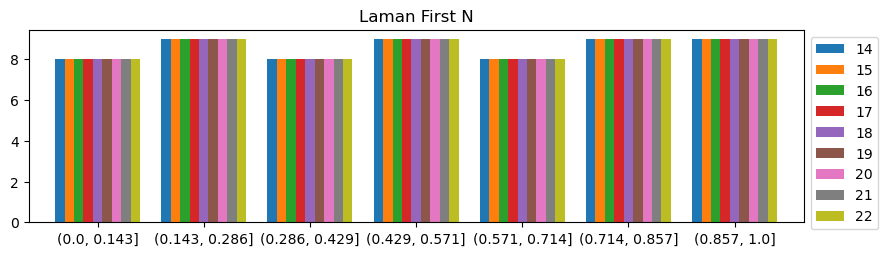

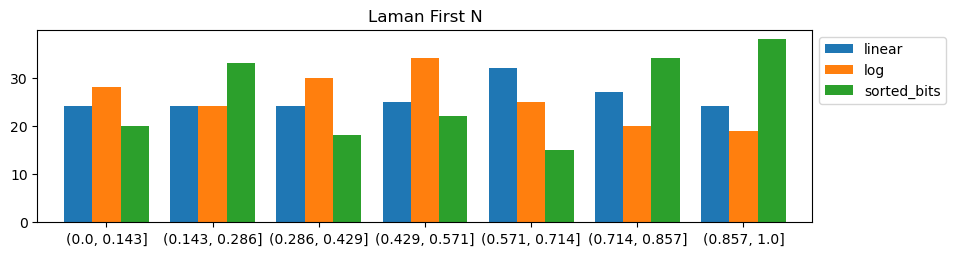

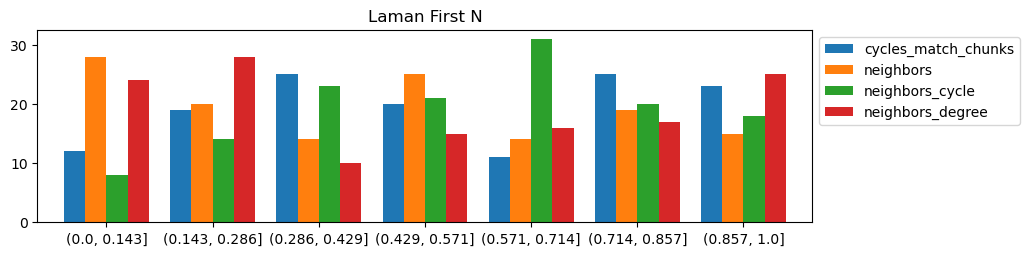

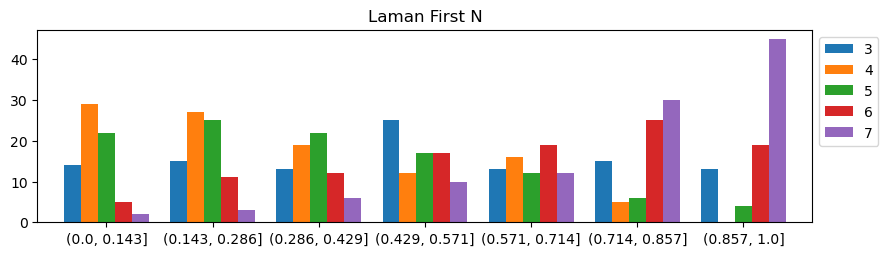

In [28]:
input = """
--------------------------------------------------------------------------------
Name (time in ms)                                                                                Min                   Max                  Mean            StdDev                Median               IQR            Outliers     OPS            Rounds  Iterations
--------------------------------------------------------------------------------

test_LamanFirstN[14-24-1024-random-subgraphs-log-neighbors_degree-3-smart]                  958.3327 (1.0)        958.3327 (1.0)        958.3327 (1.0)      0.0000 (1.0)        958.3327 (1.0)      0.0000 (1.0)           0;0  1.0435 (1.0)           1           1
test_LamanFirstN[14-24-1024-random-subgraphs-log-neighbors-3-smart]                         974.1410 (1.02)       974.1410 (1.02)       974.1410 (1.02)     0.0000 (1.0)        974.1410 (1.02)     0.0000 (1.0)           0;0  1.0265 (0.98)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-log-cycles_match_chunks-3-smart]             1,015.6857 (1.06)     1,015.6857 (1.06)     1,015.6857 (1.06)     0.0000 (1.0)      1,015.6857 (1.06)     0.0000 (1.0)           0;0  0.9846 (0.94)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-log-neighbors_cycle-3-smart]                 1,016.0560 (1.06)     1,016.0560 (1.06)     1,016.0560 (1.06)     0.0000 (1.0)      1,016.0560 (1.06)     0.0000 (1.0)           0;0  0.9842 (0.94)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-sorted_bits-neighbors_degree-4-smart]        1,023.9658 (1.07)     1,023.9658 (1.07)     1,023.9658 (1.07)     0.0000 (1.0)      1,023.9658 (1.07)     0.0000 (1.0)           0;0  0.9766 (0.94)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-log-neighbors_degree-4-smart]                1,026.4976 (1.07)     1,026.4976 (1.07)     1,026.4976 (1.07)     0.0000 (1.0)      1,026.4976 (1.07)     0.0000 (1.0)           0;0  0.9742 (0.93)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-log-neighbors-4-smart]                       1,035.3697 (1.08)     1,035.3697 (1.08)     1,035.3697 (1.08)     0.0000 (1.0)      1,035.3697 (1.08)     0.0000 (1.0)           0;0  0.9658 (0.93)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-sorted_bits-neighbors_degree-3-smart]        1,035.7384 (1.08)     1,035.7384 (1.08)     1,035.7384 (1.08)     0.0000 (1.0)      1,035.7384 (1.08)     0.0000 (1.0)           0;0  0.9655 (0.93)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-linear-neighbors_degree-4-smart]             1,041.5756 (1.09)     1,041.5756 (1.09)     1,041.5756 (1.09)     0.0000 (1.0)      1,041.5756 (1.09)     0.0000 (1.0)           0;0  0.9601 (0.92)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-linear-neighbors-4-smart]                    1,042.7033 (1.09)     1,042.7033 (1.09)     1,042.7033 (1.09)     0.0000 (1.0)      1,042.7033 (1.09)     0.0000 (1.0)           0;0  0.9590 (0.92)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-sorted_bits-neighbors_degree-6-smart]        1,046.3364 (1.09)     1,046.3364 (1.09)     1,046.3364 (1.09)     0.0000 (1.0)      1,046.3364 (1.09)     0.0000 (1.0)           0;0  0.9557 (0.92)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-sorted_bits-neighbors_degree-7-smart]        1,051.9592 (1.10)     1,051.9592 (1.10)     1,051.9592 (1.10)     0.0000 (1.0)      1,051.9592 (1.10)     0.0000 (1.0)           0;0  0.9506 (0.91)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-sorted_bits-neighbors-3-smart]               1,052.3234 (1.10)     1,052.3234 (1.10)     1,052.3234 (1.10)     0.0000 (1.0)      1,052.3234 (1.10)     0.0000 (1.0)           0;0  0.9503 (0.91)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-sorted_bits-neighbors_degree-5-smart]        1,053.0671 (1.10)     1,053.0671 (1.10)     1,053.0671 (1.10)     0.0000 (1.0)      1,053.0671 (1.10)     0.0000 (1.0)           0;0  0.9496 (0.91)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-sorted_bits-neighbors-4-smart]               1,060.2845 (1.11)     1,060.2845 (1.11)     1,060.2845 (1.11)     0.0000 (1.0)      1,060.2845 (1.11)     0.0000 (1.0)           0;0  0.9431 (0.90)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]     1,076.9439 (1.12)     1,076.9439 (1.12)     1,076.9439 (1.12)     0.0000 (1.0)      1,076.9439 (1.12)     0.0000 (1.0)           0;0  0.9286 (0.89)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-sorted_bits-neighbors_cycle-3-smart]         1,089.8340 (1.14)     1,089.8340 (1.14)     1,089.8340 (1.14)     0.0000 (1.0)      1,089.8340 (1.14)     0.0000 (1.0)           0;0  0.9176 (0.88)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-3-smart]     1,091.5962 (1.14)     1,091.5962 (1.14)     1,091.5962 (1.14)     0.0000 (1.0)      1,091.5962 (1.14)     0.0000 (1.0)           0;0  0.9161 (0.88)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-log-neighbors-5-smart]                       1,112.1651 (1.16)     1,112.1651 (1.16)     1,112.1651 (1.16)     0.0000 (1.0)      1,112.1651 (1.16)     0.0000 (1.0)           0;0  0.8991 (0.86)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]     1,117.6819 (1.17)     1,117.6819 (1.17)     1,117.6819 (1.17)     0.0000 (1.0)      1,117.6819 (1.17)     0.0000 (1.0)           0;0  0.8947 (0.86)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]     1,119.4803 (1.17)     1,119.4803 (1.17)     1,119.4803 (1.17)     0.0000 (1.0)      1,119.4803 (1.17)     0.0000 (1.0)           0;0  0.8933 (0.86)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-log-neighbors_cycle-4-smart]                 1,119.6416 (1.17)     1,119.6416 (1.17)     1,119.6416 (1.17)     0.0000 (1.0)      1,119.6416 (1.17)     0.0000 (1.0)           0;0  0.8931 (0.86)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-log-cycles_match_chunks-4-smart]             1,121.6400 (1.17)     1,121.6400 (1.17)     1,121.6400 (1.17)     0.0000 (1.0)      1,121.6400 (1.17)     0.0000 (1.0)           0;0  0.8916 (0.85)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-log-neighbors-7-smart]                       1,122.9664 (1.17)     1,122.9664 (1.17)     1,122.9664 (1.17)     0.0000 (1.0)      1,122.9664 (1.17)     0.0000 (1.0)           0;0  0.8905 (0.85)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-linear-neighbors-7-smart]                    1,123.5345 (1.17)     1,123.5345 (1.17)     1,123.5345 (1.17)     0.0000 (1.0)      1,123.5345 (1.17)     0.0000 (1.0)           0;0  0.8900 (0.85)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]         1,124.1949 (1.17)     1,124.1949 (1.17)     1,124.1949 (1.17)     0.0000 (1.0)      1,124.1949 (1.17)     0.0000 (1.0)           0;0  0.8895 (0.85)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-linear-cycles_match_chunks-4-smart]          1,124.1960 (1.17)     1,124.1960 (1.17)     1,124.1960 (1.17)     0.0000 (1.0)      1,124.1960 (1.17)     0.0000 (1.0)           0;0  0.8895 (0.85)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-7-smart]     1,124.4246 (1.17)     1,124.4246 (1.17)     1,124.4246 (1.17)     0.0000 (1.0)      1,124.4246 (1.17)     0.0000 (1.0)           0;0  0.8893 (0.85)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-linear-neighbors-6-smart]                    1,126.5348 (1.18)     1,126.5348 (1.18)     1,126.5348 (1.18)     0.0000 (1.0)      1,126.5348 (1.18)     0.0000 (1.0)           0;0  0.8877 (0.85)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-log-neighbors-6-smart]                       1,134.1236 (1.18)     1,134.1236 (1.18)     1,134.1236 (1.18)     0.0000 (1.0)      1,134.1236 (1.18)     0.0000 (1.0)           0;0  0.8817 (0.84)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-linear-neighbors_cycle-4-smart]              1,135.9374 (1.19)     1,135.9374 (1.19)     1,135.9374 (1.19)     0.0000 (1.0)      1,135.9374 (1.19)     0.0000 (1.0)           0;0  0.8803 (0.84)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-sorted_bits-neighbors-5-smart]               1,136.2773 (1.19)     1,136.2773 (1.19)     1,136.2773 (1.19)     0.0000 (1.0)      1,136.2773 (1.19)     0.0000 (1.0)           0;0  0.8801 (0.84)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-sorted_bits-neighbors-6-smart]               1,138.6934 (1.19)     1,138.6934 (1.19)     1,138.6934 (1.19)     0.0000 (1.0)      1,138.6934 (1.19)     0.0000 (1.0)           0;0  0.8782 (0.84)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-sorted_bits-neighbors-7-smart]               1,138.7264 (1.19)     1,138.7264 (1.19)     1,138.7264 (1.19)     0.0000 (1.0)      1,138.7264 (1.19)     0.0000 (1.0)           0;0  0.8782 (0.84)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-linear-neighbors_degree-3-smart]             1,142.5967 (1.19)     1,142.5967 (1.19)     1,142.5967 (1.19)     0.0000 (1.0)      1,142.5967 (1.19)     0.0000 (1.0)           0;0  0.8752 (0.84)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-linear-neighbors-5-smart]                    1,145.0561 (1.19)     1,145.0561 (1.19)     1,145.0561 (1.19)     0.0000 (1.0)      1,145.0561 (1.19)     0.0000 (1.0)           0;0  0.8733 (0.84)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-log-neighbors_cycle-5-smart]                 1,148.8511 (1.20)     1,148.8511 (1.20)     1,148.8511 (1.20)     0.0000 (1.0)      1,148.8511 (1.20)     0.0000 (1.0)           0;0  0.8704 (0.83)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-linear-neighbors_cycle-5-smart]              1,150.9557 (1.20)     1,150.9557 (1.20)     1,150.9557 (1.20)     0.0000 (1.0)      1,150.9557 (1.20)     0.0000 (1.0)           0;0  0.8688 (0.83)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-linear-neighbors_cycle-7-smart]              1,153.9822 (1.20)     1,153.9822 (1.20)     1,153.9822 (1.20)     0.0000 (1.0)      1,153.9822 (1.20)     0.0000 (1.0)           0;0  0.8666 (0.83)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-linear-neighbors-3-smart]                    1,155.8016 (1.21)     1,155.8016 (1.21)     1,155.8016 (1.21)     0.0000 (1.0)      1,155.8016 (1.21)     0.0000 (1.0)           0;0  0.8652 (0.83)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-linear-neighbors_cycle-6-smart]              1,158.1864 (1.21)     1,158.1864 (1.21)     1,158.1864 (1.21)     0.0000 (1.0)      1,158.1864 (1.21)     0.0000 (1.0)           0;0  0.8634 (0.83)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-log-neighbors_cycle-6-smart]                 1,161.9045 (1.21)     1,161.9045 (1.21)     1,161.9045 (1.21)     0.0000 (1.0)      1,161.9045 (1.21)     0.0000 (1.0)           0;0  0.8607 (0.82)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-log-neighbors_degree-5-smart]                1,167.1088 (1.22)     1,167.1088 (1.22)     1,167.1088 (1.22)     0.0000 (1.0)      1,167.1088 (1.22)     0.0000 (1.0)           0;0  0.8568 (0.82)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-sorted_bits-neighbors_cycle-7-smart]         1,167.7599 (1.22)     1,167.7599 (1.22)     1,167.7599 (1.22)     0.0000 (1.0)      1,167.7599 (1.22)     0.0000 (1.0)           0;0  0.8563 (0.82)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]         1,170.3503 (1.22)     1,170.3503 (1.22)     1,170.3503 (1.22)     0.0000 (1.0)      1,170.3503 (1.22)     0.0000 (1.0)           0;0  0.8544 (0.82)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-log-cycles_match_chunks-7-smart]             1,171.9823 (1.22)     1,171.9823 (1.22)     1,171.9823 (1.22)     0.0000 (1.0)      1,171.9823 (1.22)     0.0000 (1.0)           0;0  0.8533 (0.82)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-log-cycles_match_chunks-6-smart]             1,175.1166 (1.23)     1,175.1166 (1.23)     1,175.1166 (1.23)     0.0000 (1.0)      1,175.1166 (1.23)     0.0000 (1.0)           0;0  0.8510 (0.82)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-linear-neighbors_degree-7-smart]             1,176.6037 (1.23)     1,176.6037 (1.23)     1,176.6037 (1.23)     0.0000 (1.0)      1,176.6037 (1.23)     0.0000 (1.0)           0;0  0.8499 (0.81)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-linear-neighbors_degree-6-smart]             1,178.6013 (1.23)     1,178.6013 (1.23)     1,178.6013 (1.23)     0.0000 (1.0)      1,178.6013 (1.23)     0.0000 (1.0)           0;0  0.8485 (0.81)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-linear-cycles_match_chunks-7-smart]          1,179.1895 (1.23)     1,179.1895 (1.23)     1,179.1895 (1.23)     0.0000 (1.0)      1,179.1895 (1.23)     0.0000 (1.0)           0;0  0.8480 (0.81)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]         1,179.3819 (1.23)     1,179.3819 (1.23)     1,179.3819 (1.23)     0.0000 (1.0)      1,179.3819 (1.23)     0.0000 (1.0)           0;0  0.8479 (0.81)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-linear-cycles_match_chunks-6-smart]          1,180.0855 (1.23)     1,180.0855 (1.23)     1,180.0855 (1.23)     0.0000 (1.0)      1,180.0855 (1.23)     0.0000 (1.0)           0;0  0.8474 (0.81)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-log-neighbors_degree-7-smart]                1,180.3224 (1.23)     1,180.3224 (1.23)     1,180.3224 (1.23)     0.0000 (1.0)      1,180.3224 (1.23)     0.0000 (1.0)           0;0  0.8472 (0.81)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-log-cycles_match_chunks-5-smart]             1,180.8730 (1.23)     1,180.8730 (1.23)     1,180.8730 (1.23)     0.0000 (1.0)      1,180.8730 (1.23)     0.0000 (1.0)           0;0  0.8468 (0.81)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-linear-neighbors_degree-5-smart]             1,184.5623 (1.24)     1,184.5623 (1.24)     1,184.5623 (1.24)     0.0000 (1.0)      1,184.5623 (1.24)     0.0000 (1.0)           0;0  0.8442 (0.81)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-linear-cycles_match_chunks-5-smart]          1,187.0092 (1.24)     1,187.0092 (1.24)     1,187.0092 (1.24)     0.0000 (1.0)      1,187.0092 (1.24)     0.0000 (1.0)           0;0  0.8425 (0.81)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-linear-neighbors_cycle-3-smart]              1,188.9373 (1.24)     1,188.9373 (1.24)     1,188.9373 (1.24)     0.0000 (1.0)      1,188.9373 (1.24)     0.0000 (1.0)           0;0  0.8411 (0.81)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-linear-cycles_match_chunks-3-smart]          1,191.8706 (1.24)     1,191.8706 (1.24)     1,191.8706 (1.24)     0.0000 (1.0)      1,191.8706 (1.24)     0.0000 (1.0)           0;0  0.8390 (0.80)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-log-neighbors_degree-6-smart]                1,193.8464 (1.25)     1,193.8464 (1.25)     1,193.8464 (1.25)     0.0000 (1.0)      1,193.8464 (1.25)     0.0000 (1.0)           0;0  0.8376 (0.80)          1           1
test_LamanFirstN[14-24-1024-random-subgraphs-log-neighbors_cycle-7-smart]                 1,332.2336 (1.39)     1,332.2336 (1.39)     1,332.2336 (1.39)     0.0000 (1.0)      1,332.2336 (1.39)     0.0000 (1.0)           0;0  0.7506 (0.72)          1           1

test_LamanFirstN[15-24-1024-random-subgraphs-linear-cycles_match_chunks-4-smart]          1,635.1390 (1.71)     1,635.1390 (1.71)     1,635.1390 (1.71)     0.0000 (1.0)      1,635.1390 (1.71)     0.0000 (1.0)           0;0  0.6116 (0.59)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-linear-cycles_match_chunks-5-smart]          1,635.9841 (1.71)     1,635.9841 (1.71)     1,635.9841 (1.71)     0.0000 (1.0)      1,635.9841 (1.71)     0.0000 (1.0)           0;0  0.6113 (0.59)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-sorted_bits-neighbors_degree-4-smart]        1,643.2602 (1.71)     1,643.2602 (1.71)     1,643.2602 (1.71)     0.0000 (1.0)      1,643.2602 (1.71)     0.0000 (1.0)           0;0  0.6085 (0.58)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-sorted_bits-neighbors_degree-5-smart]        1,673.7731 (1.75)     1,673.7731 (1.75)     1,673.7731 (1.75)     0.0000 (1.0)      1,673.7731 (1.75)     0.0000 (1.0)           0;0  0.5975 (0.57)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-linear-neighbors_degree-5-smart]             1,675.9441 (1.75)     1,675.9441 (1.75)     1,675.9441 (1.75)     0.0000 (1.0)      1,675.9441 (1.75)     0.0000 (1.0)           0;0  0.5967 (0.57)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-log-neighbors-5-smart]                       1,680.0719 (1.75)     1,680.0719 (1.75)     1,680.0719 (1.75)     0.0000 (1.0)      1,680.0719 (1.75)     0.0000 (1.0)           0;0  0.5952 (0.57)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-linear-neighbors-5-smart]                    1,680.1866 (1.75)     1,680.1866 (1.75)     1,680.1866 (1.75)     0.0000 (1.0)      1,680.1866 (1.75)     0.0000 (1.0)           0;0  0.5952 (0.57)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-linear-neighbors-4-smart]                    1,683.9748 (1.76)     1,683.9748 (1.76)     1,683.9748 (1.76)     0.0000 (1.0)      1,683.9748 (1.76)     0.0000 (1.0)           0;0  0.5938 (0.57)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-linear-neighbors_cycle-4-smart]              1,694.6318 (1.77)     1,694.6318 (1.77)     1,694.6318 (1.77)     0.0000 (1.0)      1,694.6318 (1.77)     0.0000 (1.0)           0;0  0.5901 (0.57)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-log-neighbors_cycle-5-smart]                 1,696.3355 (1.77)     1,696.3355 (1.77)     1,696.3355 (1.77)     0.0000 (1.0)      1,696.3355 (1.77)     0.0000 (1.0)           0;0  0.5895 (0.56)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-log-neighbors_degree-5-smart]                1,698.1100 (1.77)     1,698.1100 (1.77)     1,698.1100 (1.77)     0.0000 (1.0)      1,698.1100 (1.77)     0.0000 (1.0)           0;0  0.5889 (0.56)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-log-neighbors_degree-4-smart]                1,708.2528 (1.78)     1,708.2528 (1.78)     1,708.2528 (1.78)     0.0000 (1.0)      1,708.2528 (1.78)     0.0000 (1.0)           0;0  0.5854 (0.56)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-log-cycles_match_chunks-5-smart]             1,716.8817 (1.79)     1,716.8817 (1.79)     1,716.8817 (1.79)     0.0000 (1.0)      1,716.8817 (1.79)     0.0000 (1.0)           0;0  0.5825 (0.56)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-log-neighbors_cycle-4-smart]                 1,717.1538 (1.79)     1,717.1538 (1.79)     1,717.1538 (1.79)     0.0000 (1.0)      1,717.1538 (1.79)     0.0000 (1.0)           0;0  0.5824 (0.56)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-linear-neighbors_cycle-5-smart]              1,759.1250 (1.84)     1,759.1250 (1.84)     1,759.1250 (1.84)     0.0000 (1.0)      1,759.1250 (1.84)     0.0000 (1.0)           0;0  0.5685 (0.54)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-log-neighbors_degree-3-smart]                1,768.0352 (1.84)     1,768.0352 (1.84)     1,768.0352 (1.84)     0.0000 (1.0)      1,768.0352 (1.84)     0.0000 (1.0)           0;0  0.5656 (0.54)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]     1,769.6225 (1.85)     1,769.6225 (1.85)     1,769.6225 (1.85)     0.0000 (1.0)      1,769.6225 (1.85)     0.0000 (1.0)           0;0  0.5651 (0.54)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]         1,769.8412 (1.85)     1,769.8412 (1.85)     1,769.8412 (1.85)     0.0000 (1.0)      1,769.8412 (1.85)     0.0000 (1.0)           0;0  0.5650 (0.54)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-sorted_bits-neighbors-5-smart]               1,774.2018 (1.85)     1,774.2018 (1.85)     1,774.2018 (1.85)     0.0000 (1.0)      1,774.2018 (1.85)     0.0000 (1.0)           0;0  0.5636 (0.54)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]     1,779.3081 (1.86)     1,779.3081 (1.86)     1,779.3081 (1.86)     0.0000 (1.0)      1,779.3081 (1.86)     0.0000 (1.0)           0;0  0.5620 (0.54)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-log-neighbors-3-smart]                       1,782.4562 (1.86)     1,782.4562 (1.86)     1,782.4562 (1.86)     0.0000 (1.0)      1,782.4562 (1.86)     0.0000 (1.0)           0;0  0.5610 (0.54)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-log-cycles_match_chunks-4-smart]             1,789.7385 (1.87)     1,789.7385 (1.87)     1,789.7385 (1.87)     0.0000 (1.0)      1,789.7385 (1.87)     0.0000 (1.0)           0;0  0.5587 (0.54)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-log-neighbors-4-smart]                       1,799.4142 (1.88)     1,799.4142 (1.88)     1,799.4142 (1.88)     0.0000 (1.0)      1,799.4142 (1.88)     0.0000 (1.0)           0;0  0.5557 (0.53)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-linear-cycles_match_chunks-3-smart]          1,806.3181 (1.88)     1,806.3181 (1.88)     1,806.3181 (1.88)     0.0000 (1.0)      1,806.3181 (1.88)     0.0000 (1.0)           0;0  0.5536 (0.53)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-linear-neighbors_degree-3-smart]             1,808.0989 (1.89)     1,808.0989 (1.89)     1,808.0989 (1.89)     0.0000 (1.0)      1,808.0989 (1.89)     0.0000 (1.0)           0;0  0.5531 (0.53)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]         1,813.5785 (1.89)     1,813.5785 (1.89)     1,813.5785 (1.89)     0.0000 (1.0)      1,813.5785 (1.89)     0.0000 (1.0)           0;0  0.5514 (0.53)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-log-neighbors_cycle-3-smart]                 1,838.6896 (1.92)     1,838.6896 (1.92)     1,838.6896 (1.92)     0.0000 (1.0)      1,838.6896 (1.92)     0.0000 (1.0)           0;0  0.5439 (0.52)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-linear-neighbors-3-smart]                    1,844.6780 (1.92)     1,844.6780 (1.92)     1,844.6780 (1.92)     0.0000 (1.0)      1,844.6780 (1.92)     0.0000 (1.0)           0;0  0.5421 (0.52)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-sorted_bits-neighbors-4-smart]               1,849.4832 (1.93)     1,849.4832 (1.93)     1,849.4832 (1.93)     0.0000 (1.0)      1,849.4832 (1.93)     0.0000 (1.0)           0;0  0.5407 (0.52)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-3-smart]     1,851.1950 (1.93)     1,851.1950 (1.93)     1,851.1950 (1.93)     0.0000 (1.0)      1,851.1950 (1.93)     0.0000 (1.0)           0;0  0.5402 (0.52)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-sorted_bits-neighbors_degree-3-smart]        1,852.2525 (1.93)     1,852.2525 (1.93)     1,852.2525 (1.93)     0.0000 (1.0)      1,852.2525 (1.93)     0.0000 (1.0)           0;0  0.5399 (0.52)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-sorted_bits-neighbors-3-smart]               1,900.5891 (1.98)     1,900.5891 (1.98)     1,900.5891 (1.98)     0.0000 (1.0)      1,900.5891 (1.98)     0.0000 (1.0)           0;0  0.5262 (0.50)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-log-cycles_match_chunks-3-smart]             1,944.3659 (2.03)     1,944.3659 (2.03)     1,944.3659 (2.03)     0.0000 (1.0)      1,944.3659 (2.03)     0.0000 (1.0)           0;0  0.5143 (0.49)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-linear-neighbors_cycle-3-smart]              1,947.0426 (2.03)     1,947.0426 (2.03)     1,947.0426 (2.03)     0.0000 (1.0)      1,947.0426 (2.03)     0.0000 (1.0)           0;0  0.5136 (0.49)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-sorted_bits-neighbors_cycle-3-smart]         1,947.2160 (2.03)     1,947.2160 (2.03)     1,947.2160 (2.03)     0.0000 (1.0)      1,947.2160 (2.03)     0.0000 (1.0)           0;0  0.5136 (0.49)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-linear-neighbors_degree-4-smart]             1,950.7919 (2.04)     1,950.7919 (2.04)     1,950.7919 (2.04)     0.0000 (1.0)      1,950.7919 (2.04)     0.0000 (1.0)           0;0  0.5126 (0.49)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-linear-neighbors_cycle-7-smart]              2,059.1204 (2.15)     2,059.1204 (2.15)     2,059.1204 (2.15)     0.0000 (1.0)      2,059.1204 (2.15)     0.0000 (1.0)           0;0  0.4856 (0.47)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-log-neighbors_cycle-6-smart]                 2,064.6908 (2.15)     2,064.6908 (2.15)     2,064.6908 (2.15)     0.0000 (1.0)      2,064.6908 (2.15)     0.0000 (1.0)           0;0  0.4843 (0.46)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-linear-cycles_match_chunks-6-smart]          2,075.5357 (2.17)     2,075.5357 (2.17)     2,075.5357 (2.17)     0.0000 (1.0)      2,075.5357 (2.17)     0.0000 (1.0)           0;0  0.4818 (0.46)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-log-neighbors_cycle-7-smart]                 2,077.9424 (2.17)     2,077.9424 (2.17)     2,077.9424 (2.17)     0.0000 (1.0)      2,077.9424 (2.17)     0.0000 (1.0)           0;0  0.4812 (0.46)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-log-neighbors-7-smart]                       2,083.4071 (2.17)     2,083.4071 (2.17)     2,083.4071 (2.17)     0.0000 (1.0)      2,083.4071 (2.17)     0.0000 (1.0)           0;0  0.4800 (0.46)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-linear-cycles_match_chunks-7-smart]          2,085.3228 (2.18)     2,085.3228 (2.18)     2,085.3228 (2.18)     0.0000 (1.0)      2,085.3228 (2.18)     0.0000 (1.0)           0;0  0.4795 (0.46)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-linear-neighbors-7-smart]                    2,123.7759 (2.22)     2,123.7759 (2.22)     2,123.7759 (2.22)     0.0000 (1.0)      2,123.7759 (2.22)     0.0000 (1.0)           0;0  0.4709 (0.45)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-linear-neighbors_cycle-6-smart]              2,127.7729 (2.22)     2,127.7729 (2.22)     2,127.7729 (2.22)     0.0000 (1.0)      2,127.7729 (2.22)     0.0000 (1.0)           0;0  0.4700 (0.45)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-log-cycles_match_chunks-7-smart]             2,129.2803 (2.22)     2,129.2803 (2.22)     2,129.2803 (2.22)     0.0000 (1.0)      2,129.2803 (2.22)     0.0000 (1.0)           0;0  0.4696 (0.45)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-linear-neighbors-6-smart]                    2,157.3587 (2.25)     2,157.3587 (2.25)     2,157.3587 (2.25)     0.0000 (1.0)      2,157.3587 (2.25)     0.0000 (1.0)           0;0  0.4635 (0.44)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-log-cycles_match_chunks-6-smart]             2,189.2687 (2.28)     2,189.2687 (2.28)     2,189.2687 (2.28)     0.0000 (1.0)      2,189.2687 (2.28)     0.0000 (1.0)           0;0  0.4568 (0.44)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-log-neighbors-6-smart]                       2,204.0045 (2.30)     2,204.0045 (2.30)     2,204.0045 (2.30)     0.0000 (1.0)      2,204.0045 (2.30)     0.0000 (1.0)           0;0  0.4537 (0.43)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-sorted_bits-neighbors_degree-6-smart]        2,266.6109 (2.37)     2,266.6109 (2.37)     2,266.6109 (2.37)     0.0000 (1.0)      2,266.6109 (2.37)     0.0000 (1.0)           0;0  0.4412 (0.42)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-sorted_bits-neighbors_degree-7-smart]        2,277.7694 (2.38)     2,277.7694 (2.38)     2,277.7694 (2.38)     0.0000 (1.0)      2,277.7694 (2.38)     0.0000 (1.0)           0;0  0.4390 (0.42)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-log-neighbors_degree-6-smart]                2,338.2711 (2.44)     2,338.2711 (2.44)     2,338.2711 (2.44)     0.0000 (1.0)      2,338.2711 (2.44)     0.0000 (1.0)           0;0  0.4277 (0.41)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-linear-neighbors_degree-6-smart]             2,412.0188 (2.52)     2,412.0188 (2.52)     2,412.0188 (2.52)     0.0000 (1.0)      2,412.0188 (2.52)     0.0000 (1.0)           0;0  0.4146 (0.40)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-log-neighbors_degree-7-smart]                2,415.6058 (2.52)     2,415.6058 (2.52)     2,415.6058 (2.52)     0.0000 (1.0)      2,415.6058 (2.52)     0.0000 (1.0)           0;0  0.4140 (0.40)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-linear-neighbors_degree-7-smart]             2,468.2908 (2.58)     2,468.2908 (2.58)     2,468.2908 (2.58)     0.0000 (1.0)      2,468.2908 (2.58)     0.0000 (1.0)           0;0  0.4051 (0.39)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-sorted_bits-neighbors-6-smart]               2,946.3782 (3.07)     2,946.3782 (3.07)     2,946.3782 (3.07)     0.0000 (1.0)      2,946.3782 (3.07)     0.0000 (1.0)           0;0  0.3394 (0.33)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-7-smart]     2,968.1977 (3.10)     2,968.1977 (3.10)     2,968.1977 (3.10)     0.0000 (1.0)      2,968.1977 (3.10)     0.0000 (1.0)           0;0  0.3369 (0.32)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]         2,987.6358 (3.12)     2,987.6358 (3.12)     2,987.6358 (3.12)     0.0000 (1.0)      2,987.6358 (3.12)     0.0000 (1.0)           0;0  0.3347 (0.32)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-sorted_bits-neighbors-7-smart]               2,992.7251 (3.12)     2,992.7251 (3.12)     2,992.7251 (3.12)     0.0000 (1.0)      2,992.7251 (3.12)     0.0000 (1.0)           0;0  0.3341 (0.32)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]     3,015.2114 (3.15)     3,015.2114 (3.15)     3,015.2114 (3.15)     0.0000 (1.0)      3,015.2114 (3.15)     0.0000 (1.0)           0;0  0.3317 (0.32)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-sorted_bits-neighbors_cycle-7-smart]         3,062.8336 (3.20)     3,062.8336 (3.20)     3,062.8336 (3.20)     0.0000 (1.0)      3,062.8336 (3.20)     0.0000 (1.0)           0;0  0.3265 (0.31)          1           1

test_LamanFirstN[16-24-1024-random-subgraphs-log-neighbors-4-smart]                       1,408.5290 (1.47)     1,408.5290 (1.47)     1,408.5290 (1.47)     0.0000 (1.0)      1,408.5290 (1.47)     0.0000 (1.0)           0;0  0.7100 (0.68)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-sorted_bits-neighbors_degree-5-smart]        1,426.9653 (1.49)     1,426.9653 (1.49)     1,426.9653 (1.49)     0.0000 (1.0)      1,426.9653 (1.49)     0.0000 (1.0)           0;0  0.7008 (0.67)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-linear-neighbors-5-smart]                    1,427.3969 (1.49)     1,427.3969 (1.49)     1,427.3969 (1.49)     0.0000 (1.0)      1,427.3969 (1.49)     0.0000 (1.0)           0;0  0.7006 (0.67)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-log-neighbors-5-smart]                       1,438.1029 (1.50)     1,438.1029 (1.50)     1,438.1029 (1.50)     0.0000 (1.0)      1,438.1029 (1.50)     0.0000 (1.0)           0;0  0.6954 (0.67)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-log-neighbors_degree-4-smart]                1,439.3976 (1.50)     1,439.3976 (1.50)     1,439.3976 (1.50)     0.0000 (1.0)      1,439.3976 (1.50)     0.0000 (1.0)           0;0  0.6947 (0.67)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-linear-neighbors-4-smart]                    1,459.2705 (1.52)     1,459.2705 (1.52)     1,459.2705 (1.52)     0.0000 (1.0)      1,459.2705 (1.52)     0.0000 (1.0)           0;0  0.6853 (0.66)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-linear-neighbors_degree-5-smart]             1,468.6873 (1.53)     1,468.6873 (1.53)     1,468.6873 (1.53)     0.0000 (1.0)      1,468.6873 (1.53)     0.0000 (1.0)           0;0  0.6809 (0.65)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-log-cycles_match_chunks-4-smart]             1,475.2354 (1.54)     1,475.2354 (1.54)     1,475.2354 (1.54)     0.0000 (1.0)      1,475.2354 (1.54)     0.0000 (1.0)           0;0  0.6779 (0.65)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-sorted_bits-neighbors_degree-4-smart]        1,491.2914 (1.56)     1,491.2914 (1.56)     1,491.2914 (1.56)     0.0000 (1.0)      1,491.2914 (1.56)     0.0000 (1.0)           0;0  0.6706 (0.64)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-log-neighbors_degree-5-smart]                1,493.9586 (1.56)     1,493.9586 (1.56)     1,493.9586 (1.56)     0.0000 (1.0)      1,493.9586 (1.56)     0.0000 (1.0)           0;0  0.6694 (0.64)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-linear-neighbors_degree-4-smart]             1,506.9382 (1.57)     1,506.9382 (1.57)     1,506.9382 (1.57)     0.0000 (1.0)      1,506.9382 (1.57)     0.0000 (1.0)           0;0  0.6636 (0.64)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-linear-cycles_match_chunks-4-smart]          1,509.4661 (1.58)     1,509.4661 (1.58)     1,509.4661 (1.58)     0.0000 (1.0)      1,509.4661 (1.58)     0.0000 (1.0)           0;0  0.6625 (0.63)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-sorted_bits-neighbors-5-smart]               1,515.7906 (1.58)     1,515.7906 (1.58)     1,515.7906 (1.58)     0.0000 (1.0)      1,515.7906 (1.58)     0.0000 (1.0)           0;0  0.6597 (0.63)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-log-cycles_match_chunks-5-smart]             1,523.9676 (1.59)     1,523.9676 (1.59)     1,523.9676 (1.59)     0.0000 (1.0)      1,523.9676 (1.59)     0.0000 (1.0)           0;0  0.6562 (0.63)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-sorted_bits-neighbors-4-smart]               1,533.0104 (1.60)     1,533.0104 (1.60)     1,533.0104 (1.60)     0.0000 (1.0)      1,533.0104 (1.60)     0.0000 (1.0)           0;0  0.6523 (0.63)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-sorted_bits-neighbors_degree-3-smart]        1,543.4837 (1.61)     1,543.4837 (1.61)     1,543.4837 (1.61)     0.0000 (1.0)      1,543.4837 (1.61)     0.0000 (1.0)           0;0  0.6479 (0.62)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-linear-cycles_match_chunks-5-smart]          1,543.5378 (1.61)     1,543.5378 (1.61)     1,543.5378 (1.61)     0.0000 (1.0)      1,543.5378 (1.61)     0.0000 (1.0)           0;0  0.6479 (0.62)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-log-neighbors_cycle-4-smart]                 1,544.7797 (1.61)     1,544.7797 (1.61)     1,544.7797 (1.61)     0.0000 (1.0)      1,544.7797 (1.61)     0.0000 (1.0)           0;0  0.6473 (0.62)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-linear-neighbors_cycle-4-smart]              1,559.9419 (1.63)     1,559.9419 (1.63)     1,559.9419 (1.63)     0.0000 (1.0)      1,559.9419 (1.63)     0.0000 (1.0)           0;0  0.6410 (0.61)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]     1,562.9033 (1.63)     1,562.9033 (1.63)     1,562.9033 (1.63)     0.0000 (1.0)      1,562.9033 (1.63)     0.0000 (1.0)           0;0  0.6398 (0.61)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]     1,588.9326 (1.66)     1,588.9326 (1.66)     1,588.9326 (1.66)     0.0000 (1.0)      1,588.9326 (1.66)     0.0000 (1.0)           0;0  0.6294 (0.60)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-sorted_bits-neighbors-3-smart]               1,600.8675 (1.67)     1,600.8675 (1.67)     1,600.8675 (1.67)     0.0000 (1.0)      1,600.8675 (1.67)     0.0000 (1.0)           0;0  0.6247 (0.60)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]         1,614.9921 (1.69)     1,614.9921 (1.69)     1,614.9921 (1.69)     0.0000 (1.0)      1,614.9921 (1.69)     0.0000 (1.0)           0;0  0.6192 (0.59)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]         1,624.0063 (1.69)     1,624.0063 (1.69)     1,624.0063 (1.69)     0.0000 (1.0)      1,624.0063 (1.69)     0.0000 (1.0)           0;0  0.6158 (0.59)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-3-smart]     1,637.2914 (1.71)     1,637.2914 (1.71)     1,637.2914 (1.71)     0.0000 (1.0)      1,637.2914 (1.71)     0.0000 (1.0)           0;0  0.6108 (0.59)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-linear-neighbors-3-smart]                    1,638.8937 (1.71)     1,638.8937 (1.71)     1,638.8937 (1.71)     0.0000 (1.0)      1,638.8937 (1.71)     0.0000 (1.0)           0;0  0.6102 (0.58)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-log-neighbors-3-smart]                       1,639.8917 (1.71)     1,639.8917 (1.71)     1,639.8917 (1.71)     0.0000 (1.0)      1,639.8917 (1.71)     0.0000 (1.0)           0;0  0.6098 (0.58)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-linear-neighbors_cycle-5-smart]              1,642.4709 (1.71)     1,642.4709 (1.71)     1,642.4709 (1.71)     0.0000 (1.0)      1,642.4709 (1.71)     0.0000 (1.0)           0;0  0.6088 (0.58)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-sorted_bits-neighbors_cycle-3-smart]         1,664.3696 (1.74)     1,664.3696 (1.74)     1,664.3696 (1.74)     0.0000 (1.0)      1,664.3696 (1.74)     0.0000 (1.0)           0;0  0.6008 (0.58)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-log-neighbors_degree-3-smart]                1,676.3556 (1.75)     1,676.3556 (1.75)     1,676.3556 (1.75)     0.0000 (1.0)      1,676.3556 (1.75)     0.0000 (1.0)           0;0  0.5965 (0.57)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-log-neighbors-7-smart]                       1,686.8091 (1.76)     1,686.8091 (1.76)     1,686.8091 (1.76)     0.0000 (1.0)      1,686.8091 (1.76)     0.0000 (1.0)           0;0  0.5928 (0.57)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-linear-neighbors-7-smart]                    1,701.4382 (1.78)     1,701.4382 (1.78)     1,701.4382 (1.78)     0.0000 (1.0)      1,701.4382 (1.78)     0.0000 (1.0)           0;0  0.5877 (0.56)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-log-neighbors_cycle-5-smart]                 1,725.9299 (1.80)     1,725.9299 (1.80)     1,725.9299 (1.80)     0.0000 (1.0)      1,725.9299 (1.80)     0.0000 (1.0)           0;0  0.5794 (0.56)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-linear-neighbors_degree-3-smart]             1,726.1680 (1.80)     1,726.1680 (1.80)     1,726.1680 (1.80)     0.0000 (1.0)      1,726.1680 (1.80)     0.0000 (1.0)           0;0  0.5793 (0.56)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-linear-neighbors-6-smart]                    1,726.5107 (1.80)     1,726.5107 (1.80)     1,726.5107 (1.80)     0.0000 (1.0)      1,726.5107 (1.80)     0.0000 (1.0)           0;0  0.5792 (0.56)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-log-neighbors-6-smart]                       1,732.6467 (1.81)     1,732.6467 (1.81)     1,732.6467 (1.81)     0.0000 (1.0)      1,732.6467 (1.81)     0.0000 (1.0)           0;0  0.5772 (0.55)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-sorted_bits-neighbors_degree-6-smart]        1,741.8035 (1.82)     1,741.8035 (1.82)     1,741.8035 (1.82)     0.0000 (1.0)      1,741.8035 (1.82)     0.0000 (1.0)           0;0  0.5741 (0.55)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-log-cycles_match_chunks-3-smart]             1,758.7597 (1.84)     1,758.7597 (1.84)     1,758.7597 (1.84)     0.0000 (1.0)      1,758.7597 (1.84)     0.0000 (1.0)           0;0  0.5686 (0.54)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-log-neighbors_cycle-3-smart]                 1,770.0730 (1.85)     1,770.0730 (1.85)     1,770.0730 (1.85)     0.0000 (1.0)      1,770.0730 (1.85)     0.0000 (1.0)           0;0  0.5649 (0.54)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-linear-neighbors_cycle-7-smart]              1,775.2915 (1.85)     1,775.2915 (1.85)     1,775.2915 (1.85)     0.0000 (1.0)      1,775.2915 (1.85)     0.0000 (1.0)           0;0  0.5633 (0.54)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-log-neighbors_cycle-7-smart]                 1,788.4953 (1.87)     1,788.4953 (1.87)     1,788.4953 (1.87)     0.0000 (1.0)      1,788.4953 (1.87)     0.0000 (1.0)           0;0  0.5591 (0.54)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-log-neighbors_cycle-6-smart]                 1,791.6248 (1.87)     1,791.6248 (1.87)     1,791.6248 (1.87)     0.0000 (1.0)      1,791.6248 (1.87)     0.0000 (1.0)           0;0  0.5582 (0.53)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-linear-neighbors_cycle-3-smart]              1,806.8906 (1.89)     1,806.8906 (1.89)     1,806.8906 (1.89)     0.0000 (1.0)      1,806.8906 (1.89)     0.0000 (1.0)           0;0  0.5534 (0.53)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-linear-neighbors_cycle-6-smart]              1,810.7004 (1.89)     1,810.7004 (1.89)     1,810.7004 (1.89)     0.0000 (1.0)      1,810.7004 (1.89)     0.0000 (1.0)           0;0  0.5523 (0.53)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-linear-cycles_match_chunks-3-smart]          1,831.8316 (1.91)     1,831.8316 (1.91)     1,831.8316 (1.91)     0.0000 (1.0)      1,831.8316 (1.91)     0.0000 (1.0)           0;0  0.5459 (0.52)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-sorted_bits-neighbors_degree-7-smart]        1,934.7030 (2.02)     1,934.7030 (2.02)     1,934.7030 (2.02)     0.0000 (1.0)      1,934.7030 (2.02)     0.0000 (1.0)           0;0  0.5169 (0.50)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-7-smart]     1,941.8303 (2.03)     1,941.8303 (2.03)     1,941.8303 (2.03)     0.0000 (1.0)      1,941.8303 (2.03)     0.0000 (1.0)           0;0  0.5150 (0.49)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]     1,952.7202 (2.04)     1,952.7202 (2.04)     1,952.7202 (2.04)     0.0000 (1.0)      1,952.7202 (2.04)     0.0000 (1.0)           0;0  0.5121 (0.49)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-linear-cycles_match_chunks-6-smart]          1,970.5163 (2.06)     1,970.5163 (2.06)     1,970.5163 (2.06)     0.0000 (1.0)      1,970.5163 (2.06)     0.0000 (1.0)           0;0  0.5075 (0.49)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-log-cycles_match_chunks-6-smart]             1,986.8045 (2.07)     1,986.8045 (2.07)     1,986.8045 (2.07)     0.0000 (1.0)      1,986.8045 (2.07)     0.0000 (1.0)           0;0  0.5033 (0.48)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-linear-cycles_match_chunks-7-smart]          1,989.6337 (2.08)     1,989.6337 (2.08)     1,989.6337 (2.08)     0.0000 (1.0)      1,989.6337 (2.08)     0.0000 (1.0)           0;0  0.5026 (0.48)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-log-cycles_match_chunks-7-smart]             2,013.3444 (2.10)     2,013.3444 (2.10)     2,013.3444 (2.10)     0.0000 (1.0)      2,013.3444 (2.10)     0.0000 (1.0)           0;0  0.4967 (0.48)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-linear-neighbors_degree-7-smart]             2,025.6800 (2.11)     2,025.6800 (2.11)     2,025.6800 (2.11)     0.0000 (1.0)      2,025.6800 (2.11)     0.0000 (1.0)           0;0  0.4937 (0.47)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-linear-neighbors_degree-6-smart]             2,034.4487 (2.12)     2,034.4487 (2.12)     2,034.4487 (2.12)     0.0000 (1.0)      2,034.4487 (2.12)     0.0000 (1.0)           0;0  0.4915 (0.47)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-log-neighbors_degree-7-smart]                2,047.0401 (2.14)     2,047.0401 (2.14)     2,047.0401 (2.14)     0.0000 (1.0)      2,047.0401 (2.14)     0.0000 (1.0)           0;0  0.4885 (0.47)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-log-neighbors_degree-6-smart]                2,050.8570 (2.14)     2,050.8570 (2.14)     2,050.8570 (2.14)     0.0000 (1.0)      2,050.8570 (2.14)     0.0000 (1.0)           0;0  0.4876 (0.47)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-sorted_bits-neighbors-7-smart]               2,131.2308 (2.22)     2,131.2308 (2.22)     2,131.2308 (2.22)     0.0000 (1.0)      2,131.2308 (2.22)     0.0000 (1.0)           0;0  0.4692 (0.45)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-sorted_bits-neighbors-6-smart]               2,144.6930 (2.24)     2,144.6930 (2.24)     2,144.6930 (2.24)     0.0000 (1.0)      2,144.6930 (2.24)     0.0000 (1.0)           0;0  0.4663 (0.45)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-sorted_bits-neighbors_cycle-7-smart]         2,215.3766 (2.31)     2,215.3766 (2.31)     2,215.3766 (2.31)     0.0000 (1.0)      2,215.3766 (2.31)     0.0000 (1.0)           0;0  0.4514 (0.43)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]         2,217.3532 (2.31)     2,217.3532 (2.31)     2,217.3532 (2.31)     0.0000 (1.0)      2,217.3532 (2.31)     0.0000 (1.0)           0;0  0.4510 (0.43)          1           1

test_LamanFirstN[17-24-1024-random-subgraphs-sorted_bits-neighbors_degree-4-smart]        1,876.4304 (1.96)     1,876.4304 (1.96)     1,876.4304 (1.96)     0.0000 (1.0)      1,876.4304 (1.96)     0.0000 (1.0)           0;0  0.5329 (0.51)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-linear-cycles_match_chunks-4-smart]          1,929.1284 (2.01)     1,929.1284 (2.01)     1,929.1284 (2.01)     0.0000 (1.0)      1,929.1284 (2.01)     0.0000 (1.0)           0;0  0.5184 (0.50)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-sorted_bits-neighbors_degree-3-smart]        1,949.2660 (2.03)     1,949.2660 (2.03)     1,949.2660 (2.03)     0.0000 (1.0)      1,949.2660 (2.03)     0.0000 (1.0)           0;0  0.5130 (0.49)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-linear-neighbors_degree-4-smart]             1,961.4724 (2.05)     1,961.4724 (2.05)     1,961.4724 (2.05)     0.0000 (1.0)      1,961.4724 (2.05)     0.0000 (1.0)           0;0  0.5098 (0.49)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]     1,966.3640 (2.05)     1,966.3640 (2.05)     1,966.3640 (2.05)     0.0000 (1.0)      1,966.3640 (2.05)     0.0000 (1.0)           0;0  0.5086 (0.49)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-log-neighbors_cycle-4-smart]                 1,991.7516 (2.08)     1,991.7516 (2.08)     1,991.7516 (2.08)     0.0000 (1.0)      1,991.7516 (2.08)     0.0000 (1.0)           0;0  0.5021 (0.48)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-linear-neighbors-4-smart]                    1,995.2459 (2.08)     1,995.2459 (2.08)     1,995.2459 (2.08)     0.0000 (1.0)      1,995.2459 (2.08)     0.0000 (1.0)           0;0  0.5012 (0.48)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-log-neighbors-4-smart]                       1,996.4652 (2.08)     1,996.4652 (2.08)     1,996.4652 (2.08)     0.0000 (1.0)      1,996.4652 (2.08)     0.0000 (1.0)           0;0  0.5009 (0.48)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-sorted_bits-neighbors_cycle-3-smart]         2,000.0225 (2.09)     2,000.0225 (2.09)     2,000.0225 (2.09)     0.0000 (1.0)      2,000.0225 (2.09)     0.0000 (1.0)           0;0  0.5000 (0.48)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-3-smart]     2,000.2286 (2.09)     2,000.2286 (2.09)     2,000.2286 (2.09)     0.0000 (1.0)      2,000.2286 (2.09)     0.0000 (1.0)           0;0  0.4999 (0.48)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-linear-neighbors_cycle-4-smart]              2,008.8083 (2.10)     2,008.8083 (2.10)     2,008.8083 (2.10)     0.0000 (1.0)      2,008.8083 (2.10)     0.0000 (1.0)           0;0  0.4978 (0.48)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-log-neighbors_degree-4-smart]                2,009.4440 (2.10)     2,009.4440 (2.10)     2,009.4440 (2.10)     0.0000 (1.0)      2,009.4440 (2.10)     0.0000 (1.0)           0;0  0.4977 (0.48)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-sorted_bits-neighbors_degree-5-smart]        2,014.0704 (2.10)     2,014.0704 (2.10)     2,014.0704 (2.10)     0.0000 (1.0)      2,014.0704 (2.10)     0.0000 (1.0)           0;0  0.4965 (0.48)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]         2,021.9875 (2.11)     2,021.9875 (2.11)     2,021.9875 (2.11)     0.0000 (1.0)      2,021.9875 (2.11)     0.0000 (1.0)           0;0  0.4946 (0.47)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-sorted_bits-neighbors-4-smart]               2,024.7094 (2.11)     2,024.7094 (2.11)     2,024.7094 (2.11)     0.0000 (1.0)      2,024.7094 (2.11)     0.0000 (1.0)           0;0  0.4939 (0.47)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-sorted_bits-neighbors-3-smart]               2,040.6995 (2.13)     2,040.6995 (2.13)     2,040.6995 (2.13)     0.0000 (1.0)      2,040.6995 (2.13)     0.0000 (1.0)           0;0  0.4900 (0.47)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-log-neighbors_degree-5-smart]                2,050.3522 (2.14)     2,050.3522 (2.14)     2,050.3522 (2.14)     0.0000 (1.0)      2,050.3522 (2.14)     0.0000 (1.0)           0;0  0.4877 (0.47)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-linear-cycles_match_chunks-5-smart]          2,086.5082 (2.18)     2,086.5082 (2.18)     2,086.5082 (2.18)     0.0000 (1.0)      2,086.5082 (2.18)     0.0000 (1.0)           0;0  0.4793 (0.46)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-linear-neighbors_degree-5-smart]             2,092.8511 (2.18)     2,092.8511 (2.18)     2,092.8511 (2.18)     0.0000 (1.0)      2,092.8511 (2.18)     0.0000 (1.0)           0;0  0.4778 (0.46)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-log-cycles_match_chunks-5-smart]             2,100.6871 (2.19)     2,100.6871 (2.19)     2,100.6871 (2.19)     0.0000 (1.0)      2,100.6871 (2.19)     0.0000 (1.0)           0;0  0.4760 (0.46)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-linear-neighbors-5-smart]                    2,107.7568 (2.20)     2,107.7568 (2.20)     2,107.7568 (2.20)     0.0000 (1.0)      2,107.7568 (2.20)     0.0000 (1.0)           0;0  0.4744 (0.45)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-log-cycles_match_chunks-4-smart]             2,111.2140 (2.20)     2,111.2140 (2.20)     2,111.2140 (2.20)     0.0000 (1.0)      2,111.2140 (2.20)     0.0000 (1.0)           0;0  0.4737 (0.45)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-log-neighbors_cycle-5-smart]                 2,130.3038 (2.22)     2,130.3038 (2.22)     2,130.3038 (2.22)     0.0000 (1.0)      2,130.3038 (2.22)     0.0000 (1.0)           0;0  0.4694 (0.45)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-log-neighbors_degree-3-smart]                2,142.5736 (2.24)     2,142.5736 (2.24)     2,142.5736 (2.24)     0.0000 (1.0)      2,142.5736 (2.24)     0.0000 (1.0)           0;0  0.4667 (0.45)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-linear-neighbors_cycle-5-smart]              2,143.6043 (2.24)     2,143.6043 (2.24)     2,143.6043 (2.24)     0.0000 (1.0)      2,143.6043 (2.24)     0.0000 (1.0)           0;0  0.4665 (0.45)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-log-cycles_match_chunks-3-smart]             2,147.2120 (2.24)     2,147.2120 (2.24)     2,147.2120 (2.24)     0.0000 (1.0)      2,147.2120 (2.24)     0.0000 (1.0)           0;0  0.4657 (0.45)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-log-neighbors-3-smart]                       2,158.0513 (2.25)     2,158.0513 (2.25)     2,158.0513 (2.25)     0.0000 (1.0)      2,158.0513 (2.25)     0.0000 (1.0)           0;0  0.4634 (0.44)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-log-neighbors-5-smart]                       2,164.2971 (2.26)     2,164.2971 (2.26)     2,164.2971 (2.26)     0.0000 (1.0)      2,164.2971 (2.26)     0.0000 (1.0)           0;0  0.4620 (0.44)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-linear-cycles_match_chunks-3-smart]          2,172.6227 (2.27)     2,172.6227 (2.27)     2,172.6227 (2.27)     0.0000 (1.0)      2,172.6227 (2.27)     0.0000 (1.0)           0;0  0.4603 (0.44)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-log-neighbors_cycle-3-smart]                 2,181.8383 (2.28)     2,181.8383 (2.28)     2,181.8383 (2.28)     0.0000 (1.0)      2,181.8383 (2.28)     0.0000 (1.0)           0;0  0.4583 (0.44)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-linear-neighbors_degree-3-smart]             2,196.5851 (2.29)     2,196.5851 (2.29)     2,196.5851 (2.29)     0.0000 (1.0)      2,196.5851 (2.29)     0.0000 (1.0)           0;0  0.4553 (0.44)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-linear-neighbors-3-smart]                    2,209.9977 (2.31)     2,209.9977 (2.31)     2,209.9977 (2.31)     0.0000 (1.0)      2,209.9977 (2.31)     0.0000 (1.0)           0;0  0.4525 (0.43)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-linear-neighbors_cycle-3-smart]              2,210.7598 (2.31)     2,210.7598 (2.31)     2,210.7598 (2.31)     0.0000 (1.0)      2,210.7598 (2.31)     0.0000 (1.0)           0;0  0.4523 (0.43)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]     2,232.9102 (2.33)     2,232.9102 (2.33)     2,232.9102 (2.33)     0.0000 (1.0)      2,232.9102 (2.33)     0.0000 (1.0)           0;0  0.4478 (0.43)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-sorted_bits-neighbors-5-smart]               2,262.7672 (2.36)     2,262.7672 (2.36)     2,262.7672 (2.36)     0.0000 (1.0)      2,262.7672 (2.36)     0.0000 (1.0)           0;0  0.4419 (0.42)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]         2,299.6590 (2.40)     2,299.6590 (2.40)     2,299.6590 (2.40)     0.0000 (1.0)      2,299.6590 (2.40)     0.0000 (1.0)           0;0  0.4348 (0.42)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-linear-neighbors_cycle-6-smart]              2,646.3754 (2.76)     2,646.3754 (2.76)     2,646.3754 (2.76)     0.0000 (1.0)      2,646.3754 (2.76)     0.0000 (1.0)           0;0  0.3779 (0.36)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-log-neighbors_cycle-6-smart]                 2,667.8662 (2.78)     2,667.8662 (2.78)     2,667.8662 (2.78)     0.0000 (1.0)      2,667.8662 (2.78)     0.0000 (1.0)           0;0  0.3748 (0.36)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-log-neighbors-7-smart]                       2,674.2421 (2.79)     2,674.2421 (2.79)     2,674.2421 (2.79)     0.0000 (1.0)      2,674.2421 (2.79)     0.0000 (1.0)           0;0  0.3739 (0.36)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-log-neighbors-6-smart]                       2,676.7859 (2.79)     2,676.7859 (2.79)     2,676.7859 (2.79)     0.0000 (1.0)      2,676.7859 (2.79)     0.0000 (1.0)           0;0  0.3736 (0.36)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-log-neighbors_cycle-7-smart]                 2,680.1954 (2.80)     2,680.1954 (2.80)     2,680.1954 (2.80)     0.0000 (1.0)      2,680.1954 (2.80)     0.0000 (1.0)           0;0  0.3731 (0.36)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-linear-neighbors_cycle-7-smart]              2,680.2425 (2.80)     2,680.2425 (2.80)     2,680.2425 (2.80)     0.0000 (1.0)      2,680.2425 (2.80)     0.0000 (1.0)           0;0  0.3731 (0.36)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-linear-neighbors-7-smart]                    2,682.2588 (2.80)     2,682.2588 (2.80)     2,682.2588 (2.80)     0.0000 (1.0)      2,682.2588 (2.80)     0.0000 (1.0)           0;0  0.3728 (0.36)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-linear-neighbors-6-smart]                    2,687.8596 (2.80)     2,687.8596 (2.80)     2,687.8596 (2.80)     0.0000 (1.0)      2,687.8596 (2.80)     0.0000 (1.0)           0;0  0.3720 (0.36)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-linear-cycles_match_chunks-6-smart]          3,170.0546 (3.31)     3,170.0546 (3.31)     3,170.0546 (3.31)     0.0000 (1.0)      3,170.0546 (3.31)     0.0000 (1.0)           0;0  0.3155 (0.30)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-log-cycles_match_chunks-6-smart]             3,202.7904 (3.34)     3,202.7904 (3.34)     3,202.7904 (3.34)     0.0000 (1.0)      3,202.7904 (3.34)     0.0000 (1.0)           0;0  0.3122 (0.30)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-log-cycles_match_chunks-7-smart]             3,217.1686 (3.36)     3,217.1686 (3.36)     3,217.1686 (3.36)     0.0000 (1.0)      3,217.1686 (3.36)     0.0000 (1.0)           0;0  0.3108 (0.30)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-linear-cycles_match_chunks-7-smart]          3,278.0600 (3.42)     3,278.0600 (3.42)     3,278.0600 (3.42)     0.0000 (1.0)      3,278.0600 (3.42)     0.0000 (1.0)           0;0  0.3051 (0.29)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-sorted_bits-neighbors_degree-6-smart]        3,524.0392 (3.68)     3,524.0392 (3.68)     3,524.0392 (3.68)     0.0000 (1.0)      3,524.0392 (3.68)     0.0000 (1.0)           0;0  0.2838 (0.27)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-sorted_bits-neighbors_degree-7-smart]        3,551.7929 (3.71)     3,551.7929 (3.71)     3,551.7929 (3.71)     0.0000 (1.0)      3,551.7929 (3.71)     0.0000 (1.0)           0;0  0.2815 (0.27)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-log-neighbors_degree-7-smart]                3,607.2139 (3.76)     3,607.2139 (3.76)     3,607.2139 (3.76)     0.0000 (1.0)      3,607.2139 (3.76)     0.0000 (1.0)           0;0  0.2772 (0.27)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-linear-neighbors_degree-7-smart]             3,615.9810 (3.77)     3,615.9810 (3.77)     3,615.9810 (3.77)     0.0000 (1.0)      3,615.9810 (3.77)     0.0000 (1.0)           0;0  0.2766 (0.27)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-log-neighbors_degree-6-smart]                3,659.8382 (3.82)     3,659.8382 (3.82)     3,659.8382 (3.82)     0.0000 (1.0)      3,659.8382 (3.82)     0.0000 (1.0)           0;0  0.2732 (0.26)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-linear-neighbors_degree-6-smart]             3,672.6296 (3.83)     3,672.6296 (3.83)     3,672.6296 (3.83)     0.0000 (1.0)      3,672.6296 (3.83)     0.0000 (1.0)           0;0  0.2723 (0.26)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]     4,664.2358 (4.87)     4,664.2358 (4.87)     4,664.2358 (4.87)     0.0000 (1.0)      4,664.2358 (4.87)     0.0000 (1.0)           0;0  0.2144 (0.21)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-7-smart]     4,702.3270 (4.91)     4,702.3270 (4.91)     4,702.3270 (4.91)     0.0000 (1.0)      4,702.3270 (4.91)     0.0000 (1.0)           0;0  0.2127 (0.20)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-sorted_bits-neighbors-6-smart]               5,649.5923 (5.90)     5,649.5923 (5.90)     5,649.5923 (5.90)     0.0000 (1.0)      5,649.5923 (5.90)     0.0000 (1.0)           0;0  0.1770 (0.17)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]         5,761.5873 (6.01)     5,761.5873 (6.01)     5,761.5873 (6.01)     0.0000 (1.0)      5,761.5873 (6.01)     0.0000 (1.0)           0;0  0.1736 (0.17)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-sorted_bits-neighbors_cycle-7-smart]         5,768.7808 (6.02)     5,768.7808 (6.02)     5,768.7808 (6.02)     0.0000 (1.0)      5,768.7808 (6.02)     0.0000 (1.0)           0;0  0.1733 (0.17)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-sorted_bits-neighbors-7-smart]               5,851.5176 (6.11)     5,851.5176 (6.11)     5,851.5176 (6.11)     0.0000 (1.0)      5,851.5176 (6.11)     0.0000 (1.0)           0;0  0.1709 (0.16)          1           1

test_LamanFirstN[18-24-1024-random-subgraphs-sorted_bits-neighbors_degree-6-smart]        1,959.8559 (2.05)     1,959.8559 (2.05)     1,959.8559 (2.05)     0.0000 (1.0)      1,959.8559 (2.05)     0.0000 (1.0)           0;0  0.5102 (0.49)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-log-neighbors-4-smart]                       1,968.4078 (2.05)     1,968.4078 (2.05)     1,968.4078 (2.05)     0.0000 (1.0)      1,968.4078 (2.05)     0.0000 (1.0)           0;0  0.5080 (0.49)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-sorted_bits-neighbors_degree-5-smart]        1,974.6859 (2.06)     1,974.6859 (2.06)     1,974.6859 (2.06)     0.0000 (1.0)      1,974.6859 (2.06)     0.0000 (1.0)           0;0  0.5064 (0.49)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-log-neighbors-5-smart]                       1,982.8537 (2.07)     1,982.8537 (2.07)     1,982.8537 (2.07)     0.0000 (1.0)      1,982.8537 (2.07)     0.0000 (1.0)           0;0  0.5043 (0.48)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-log-cycles_match_chunks-4-smart]             1,988.8066 (2.08)     1,988.8066 (2.08)     1,988.8066 (2.08)     0.0000 (1.0)      1,988.8066 (2.08)     0.0000 (1.0)           0;0  0.5028 (0.48)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-log-neighbors_degree-4-smart]                2,018.6939 (2.11)     2,018.6939 (2.11)     2,018.6939 (2.11)     0.0000 (1.0)      2,018.6939 (2.11)     0.0000 (1.0)           0;0  0.4954 (0.47)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-log-neighbors-6-smart]                       2,024.4622 (2.11)     2,024.4622 (2.11)     2,024.4622 (2.11)     0.0000 (1.0)      2,024.4622 (2.11)     0.0000 (1.0)           0;0  0.4940 (0.47)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-sorted_bits-neighbors_degree-4-smart]        2,033.4668 (2.12)     2,033.4668 (2.12)     2,033.4668 (2.12)     0.0000 (1.0)      2,033.4668 (2.12)     0.0000 (1.0)           0;0  0.4918 (0.47)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-linear-neighbors-5-smart]                    2,059.0055 (2.15)     2,059.0055 (2.15)     2,059.0055 (2.15)     0.0000 (1.0)      2,059.0055 (2.15)     0.0000 (1.0)           0;0  0.4857 (0.47)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-log-neighbors-3-smart]                       2,059.0583 (2.15)     2,059.0583 (2.15)     2,059.0583 (2.15)     0.0000 (1.0)      2,059.0583 (2.15)     0.0000 (1.0)           0;0  0.4857 (0.47)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-log-neighbors_cycle-4-smart]                 2,072.6651 (2.16)     2,072.6651 (2.16)     2,072.6651 (2.16)     0.0000 (1.0)      2,072.6651 (2.16)     0.0000 (1.0)           0;0  0.4825 (0.46)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-linear-neighbors-6-smart]                    2,072.8696 (2.16)     2,072.8696 (2.16)     2,072.8696 (2.16)     0.0000 (1.0)      2,072.8696 (2.16)     0.0000 (1.0)           0;0  0.4824 (0.46)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-linear-neighbors_cycle-6-smart]              2,088.3902 (2.18)     2,088.3902 (2.18)     2,088.3902 (2.18)     0.0000 (1.0)      2,088.3902 (2.18)     0.0000 (1.0)           0;0  0.4788 (0.46)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-linear-neighbors_cycle-5-smart]              2,096.3629 (2.19)     2,096.3629 (2.19)     2,096.3629 (2.19)     0.0000 (1.0)      2,096.3629 (2.19)     0.0000 (1.0)           0;0  0.4770 (0.46)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-log-neighbors_cycle-5-smart]                 2,101.1593 (2.19)     2,101.1593 (2.19)     2,101.1593 (2.19)     0.0000 (1.0)      2,101.1593 (2.19)     0.0000 (1.0)           0;0  0.4759 (0.46)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]     2,116.2673 (2.21)     2,116.2673 (2.21)     2,116.2673 (2.21)     0.0000 (1.0)      2,116.2673 (2.21)     0.0000 (1.0)           0;0  0.4725 (0.45)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]     2,117.4139 (2.21)     2,117.4139 (2.21)     2,117.4139 (2.21)     0.0000 (1.0)      2,117.4139 (2.21)     0.0000 (1.0)           0;0  0.4723 (0.45)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-log-neighbors_cycle-6-smart]                 2,118.1288 (2.21)     2,118.1288 (2.21)     2,118.1288 (2.21)     0.0000 (1.0)      2,118.1288 (2.21)     0.0000 (1.0)           0;0  0.4721 (0.45)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-log-cycles_match_chunks-5-smart]             2,133.6919 (2.23)     2,133.6919 (2.23)     2,133.6919 (2.23)     0.0000 (1.0)      2,133.6919 (2.23)     0.0000 (1.0)           0;0  0.4687 (0.45)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-linear-cycles_match_chunks-6-smart]          2,137.7622 (2.23)     2,137.7622 (2.23)     2,137.7622 (2.23)     0.0000 (1.0)      2,137.7622 (2.23)     0.0000 (1.0)           0;0  0.4678 (0.45)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-linear-cycles_match_chunks-4-smart]          2,137.8592 (2.23)     2,137.8592 (2.23)     2,137.8592 (2.23)     0.0000 (1.0)      2,137.8592 (2.23)     0.0000 (1.0)           0;0  0.4678 (0.45)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-linear-neighbors-4-smart]                    2,140.4935 (2.23)     2,140.4935 (2.23)     2,140.4935 (2.23)     0.0000 (1.0)      2,140.4935 (2.23)     0.0000 (1.0)           0;0  0.4672 (0.45)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-log-cycles_match_chunks-6-smart]             2,146.8521 (2.24)     2,146.8521 (2.24)     2,146.8521 (2.24)     0.0000 (1.0)      2,146.8521 (2.24)     0.0000 (1.0)           0;0  0.4658 (0.45)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-linear-cycles_match_chunks-5-smart]          2,148.5272 (2.24)     2,148.5272 (2.24)     2,148.5272 (2.24)     0.0000 (1.0)      2,148.5272 (2.24)     0.0000 (1.0)           0;0  0.4654 (0.45)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-log-cycles_match_chunks-3-smart]             2,156.9065 (2.25)     2,156.9065 (2.25)     2,156.9065 (2.25)     0.0000 (1.0)      2,156.9065 (2.25)     0.0000 (1.0)           0;0  0.4636 (0.44)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-log-neighbors_degree-3-smart]                2,156.9915 (2.25)     2,156.9915 (2.25)     2,156.9915 (2.25)     0.0000 (1.0)      2,156.9915 (2.25)     0.0000 (1.0)           0;0  0.4636 (0.44)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]     2,161.5386 (2.26)     2,161.5386 (2.26)     2,161.5386 (2.26)     0.0000 (1.0)      2,161.5386 (2.26)     0.0000 (1.0)           0;0  0.4626 (0.44)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-sorted_bits-neighbors-4-smart]               2,166.0394 (2.26)     2,166.0394 (2.26)     2,166.0394 (2.26)     0.0000 (1.0)      2,166.0394 (2.26)     0.0000 (1.0)           0;0  0.4617 (0.44)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-linear-neighbors_cycle-4-smart]              2,166.1629 (2.26)     2,166.1629 (2.26)     2,166.1629 (2.26)     0.0000 (1.0)      2,166.1629 (2.26)     0.0000 (1.0)           0;0  0.4616 (0.44)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-log-neighbors_degree-6-smart]                2,176.2125 (2.27)     2,176.2125 (2.27)     2,176.2125 (2.27)     0.0000 (1.0)      2,176.2125 (2.27)     0.0000 (1.0)           0;0  0.4595 (0.44)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-log-neighbors_cycle-3-smart]                 2,179.9264 (2.27)     2,179.9264 (2.27)     2,179.9264 (2.27)     0.0000 (1.0)      2,179.9264 (2.27)     0.0000 (1.0)           0;0  0.4587 (0.44)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-sorted_bits-neighbors-5-smart]               2,184.1060 (2.28)     2,184.1060 (2.28)     2,184.1060 (2.28)     0.0000 (1.0)      2,184.1060 (2.28)     0.0000 (1.0)           0;0  0.4579 (0.44)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-linear-neighbors_degree-5-smart]             2,190.9566 (2.29)     2,190.9566 (2.29)     2,190.9566 (2.29)     0.0000 (1.0)      2,190.9566 (2.29)     0.0000 (1.0)           0;0  0.4564 (0.44)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-sorted_bits-neighbors-6-smart]               2,192.9444 (2.29)     2,192.9444 (2.29)     2,192.9444 (2.29)     0.0000 (1.0)      2,192.9444 (2.29)     0.0000 (1.0)           0;0  0.4560 (0.44)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]         2,197.0184 (2.29)     2,197.0184 (2.29)     2,197.0184 (2.29)     0.0000 (1.0)      2,197.0184 (2.29)     0.0000 (1.0)           0;0  0.4552 (0.44)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-linear-neighbors_degree-6-smart]             2,205.4267 (2.30)     2,205.4267 (2.30)     2,205.4267 (2.30)     0.0000 (1.0)      2,205.4267 (2.30)     0.0000 (1.0)           0;0  0.4534 (0.43)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-linear-neighbors_degree-4-smart]             2,217.8503 (2.31)     2,217.8503 (2.31)     2,217.8503 (2.31)     0.0000 (1.0)      2,217.8503 (2.31)     0.0000 (1.0)           0;0  0.4509 (0.43)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]         2,219.7073 (2.32)     2,219.7073 (2.32)     2,219.7073 (2.32)     0.0000 (1.0)      2,219.7073 (2.32)     0.0000 (1.0)           0;0  0.4505 (0.43)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-log-neighbors_degree-5-smart]                2,220.1182 (2.32)     2,220.1182 (2.32)     2,220.1182 (2.32)     0.0000 (1.0)      2,220.1182 (2.32)     0.0000 (1.0)           0;0  0.4504 (0.43)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]         2,227.0736 (2.32)     2,227.0736 (2.32)     2,227.0736 (2.32)     0.0000 (1.0)      2,227.0736 (2.32)     0.0000 (1.0)           0;0  0.4490 (0.43)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-sorted_bits-neighbors_degree-3-smart]        2,477.1222 (2.58)     2,477.1222 (2.58)     2,477.1222 (2.58)     0.0000 (1.0)      2,477.1222 (2.58)     0.0000 (1.0)           0;0  0.4037 (0.39)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-linear-neighbors-3-smart]                    2,542.9693 (2.65)     2,542.9693 (2.65)     2,542.9693 (2.65)     0.0000 (1.0)      2,542.9693 (2.65)     0.0000 (1.0)           0;0  0.3932 (0.38)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-sorted_bits-neighbors-3-smart]               2,553.1059 (2.66)     2,553.1059 (2.66)     2,553.1059 (2.66)     0.0000 (1.0)      2,553.1059 (2.66)     0.0000 (1.0)           0;0  0.3917 (0.38)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-linear-neighbors_cycle-3-smart]              2,657.0671 (2.77)     2,657.0671 (2.77)     2,657.0671 (2.77)     0.0000 (1.0)      2,657.0671 (2.77)     0.0000 (1.0)           0;0  0.3764 (0.36)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-linear-cycles_match_chunks-3-smart]          2,707.5039 (2.83)     2,707.5039 (2.83)     2,707.5039 (2.83)     0.0000 (1.0)      2,707.5039 (2.83)     0.0000 (1.0)           0;0  0.3693 (0.35)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-linear-neighbors_degree-3-smart]             2,737.6006 (2.86)     2,737.6006 (2.86)     2,737.6006 (2.86)     0.0000 (1.0)      2,737.6006 (2.86)     0.0000 (1.0)           0;0  0.3653 (0.35)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-linear-neighbors_cycle-7-smart]              2,791.7347 (2.91)     2,791.7347 (2.91)     2,791.7347 (2.91)     0.0000 (1.0)      2,791.7347 (2.91)     0.0000 (1.0)           0;0  0.3582 (0.34)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-log-neighbors-7-smart]                       2,791.7347 (2.91)     2,791.7347 (2.91)     2,791.7347 (2.91)     0.0000 (1.0)      2,791.7347 (2.91)     0.0000 (1.0)           0;0  0.3582 (0.34)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-linear-neighbors-7-smart]                    2,797.8088 (2.92)     2,797.8088 (2.92)     2,797.8088 (2.92)     0.0000 (1.0)      2,797.8088 (2.92)     0.0000 (1.0)           0;0  0.3574 (0.34)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-log-neighbors_cycle-7-smart]                 2,805.6428 (2.93)     2,805.6428 (2.93)     2,805.6428 (2.93)     0.0000 (1.0)      2,805.6428 (2.93)     0.0000 (1.0)           0;0  0.3564 (0.34)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-sorted_bits-neighbors_cycle-3-smart]         2,820.9013 (2.94)     2,820.9013 (2.94)     2,820.9013 (2.94)     0.0000 (1.0)      2,820.9013 (2.94)     0.0000 (1.0)           0;0  0.3545 (0.34)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-3-smart]     2,839.0596 (2.96)     2,839.0596 (2.96)     2,839.0596 (2.96)     0.0000 (1.0)      2,839.0596 (2.96)     0.0000 (1.0)           0;0  0.3522 (0.34)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-sorted_bits-neighbors_degree-7-smart]        2,877.8157 (3.00)     2,877.8157 (3.00)     2,877.8157 (3.00)     0.0000 (1.0)      2,877.8157 (3.00)     0.0000 (1.0)           0;0  0.3475 (0.33)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-7-smart]     3,232.2767 (3.37)     3,232.2767 (3.37)     3,232.2767 (3.37)     0.0000 (1.0)      3,232.2767 (3.37)     0.0000 (1.0)           0;0  0.3094 (0.30)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-linear-cycles_match_chunks-7-smart]          3,619.9841 (3.78)     3,619.9841 (3.78)     3,619.9841 (3.78)     0.0000 (1.0)      3,619.9841 (3.78)     0.0000 (1.0)           0;0  0.2762 (0.26)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-log-cycles_match_chunks-7-smart]             3,670.6592 (3.83)     3,670.6592 (3.83)     3,670.6592 (3.83)     0.0000 (1.0)      3,670.6592 (3.83)     0.0000 (1.0)           0;0  0.2724 (0.26)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-log-neighbors_degree-7-smart]                3,855.9475 (4.02)     3,855.9475 (4.02)     3,855.9475 (4.02)     0.0000 (1.0)      3,855.9475 (4.02)     0.0000 (1.0)           0;0  0.2593 (0.25)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-linear-neighbors_degree-7-smart]             3,923.4706 (4.09)     3,923.4706 (4.09)     3,923.4706 (4.09)     0.0000 (1.0)      3,923.4706 (4.09)     0.0000 (1.0)           0;0  0.2549 (0.24)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-sorted_bits-neighbors_cycle-7-smart]         4,200.8968 (4.38)     4,200.8968 (4.38)     4,200.8968 (4.38)     0.0000 (1.0)      4,200.8968 (4.38)     0.0000 (1.0)           0;0  0.2380 (0.23)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-sorted_bits-neighbors-7-smart]               4,221.5737 (4.41)     4,221.5737 (4.41)     4,221.5737 (4.41)     0.0000 (1.0)      4,221.5737 (4.41)     0.0000 (1.0)           0;0  0.2369 (0.23)          1           1

test_LamanFirstN[19-24-1024-random-subgraphs-sorted_bits-neighbors_degree-4-smart]        2,197.4919 (2.29)     2,197.4919 (2.29)     2,197.4919 (2.29)     0.0000 (1.0)      2,197.4919 (2.29)     0.0000 (1.0)           0;0  0.4551 (0.44)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-sorted_bits-neighbors_degree-3-smart]        2,235.2579 (2.33)     2,235.2579 (2.33)     2,235.2579 (2.33)     0.0000 (1.0)      2,235.2579 (2.33)     0.0000 (1.0)           0;0  0.4474 (0.43)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-log-cycles_match_chunks-3-smart]             2,249.3188 (2.35)     2,249.3188 (2.35)     2,249.3188 (2.35)     0.0000 (1.0)      2,249.3188 (2.35)     0.0000 (1.0)           0;0  0.4446 (0.43)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-log-neighbors-3-smart]                       2,310.0115 (2.41)     2,310.0115 (2.41)     2,310.0115 (2.41)     0.0000 (1.0)      2,310.0115 (2.41)     0.0000 (1.0)           0;0  0.4329 (0.41)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-log-neighbors_cycle-3-smart]                 2,312.7804 (2.41)     2,312.7804 (2.41)     2,312.7804 (2.41)     0.0000 (1.0)      2,312.7804 (2.41)     0.0000 (1.0)           0;0  0.4324 (0.41)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-log-neighbors_degree-3-smart]                2,329.8413 (2.43)     2,329.8413 (2.43)     2,329.8413 (2.43)     0.0000 (1.0)      2,329.8413 (2.43)     0.0000 (1.0)           0;0  0.4292 (0.41)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-linear-neighbors-4-smart]                    2,335.4403 (2.44)     2,335.4403 (2.44)     2,335.4403 (2.44)     0.0000 (1.0)      2,335.4403 (2.44)     0.0000 (1.0)           0;0  0.4282 (0.41)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]         2,338.8963 (2.44)     2,338.8963 (2.44)     2,338.8963 (2.44)     0.0000 (1.0)      2,338.8963 (2.44)     0.0000 (1.0)           0;0  0.4276 (0.41)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]     2,360.4054 (2.46)     2,360.4054 (2.46)     2,360.4054 (2.46)     0.0000 (1.0)      2,360.4054 (2.46)     0.0000 (1.0)           0;0  0.4237 (0.41)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-3-smart]     2,375.1179 (2.48)     2,375.1179 (2.48)     2,375.1179 (2.48)     0.0000 (1.0)      2,375.1179 (2.48)     0.0000 (1.0)           0;0  0.4210 (0.40)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-linear-cycles_match_chunks-4-smart]          2,381.2803 (2.48)     2,381.2803 (2.48)     2,381.2803 (2.48)     0.0000 (1.0)      2,381.2803 (2.48)     0.0000 (1.0)           0;0  0.4199 (0.40)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-linear-neighbors-5-smart]                    2,389.6264 (2.49)     2,389.6264 (2.49)     2,389.6264 (2.49)     0.0000 (1.0)      2,389.6264 (2.49)     0.0000 (1.0)           0;0  0.4185 (0.40)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-log-neighbors-6-smart]                       2,394.0084 (2.50)     2,394.0084 (2.50)     2,394.0084 (2.50)     0.0000 (1.0)      2,394.0084 (2.50)     0.0000 (1.0)           0;0  0.4177 (0.40)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-sorted_bits-neighbors-4-smart]               2,395.2900 (2.50)     2,395.2900 (2.50)     2,395.2900 (2.50)     0.0000 (1.0)      2,395.2900 (2.50)     0.0000 (1.0)           0;0  0.4175 (0.40)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-sorted_bits-neighbors_degree-6-smart]        2,395.6243 (2.50)     2,395.6243 (2.50)     2,395.6243 (2.50)     0.0000 (1.0)      2,395.6243 (2.50)     0.0000 (1.0)           0;0  0.4174 (0.40)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-sorted_bits-neighbors_degree-5-smart]        2,399.0027 (2.50)     2,399.0027 (2.50)     2,399.0027 (2.50)     0.0000 (1.0)      2,399.0027 (2.50)     0.0000 (1.0)           0;0  0.4168 (0.40)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-linear-neighbors-6-smart]                    2,400.3972 (2.50)     2,400.3972 (2.50)     2,400.3972 (2.50)     0.0000 (1.0)      2,400.3972 (2.50)     0.0000 (1.0)           0;0  0.4166 (0.40)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-sorted_bits-neighbors-3-smart]               2,414.2534 (2.52)     2,414.2534 (2.52)     2,414.2534 (2.52)     0.0000 (1.0)      2,414.2534 (2.52)     0.0000 (1.0)           0;0  0.4142 (0.40)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-linear-neighbors_degree-4-smart]             2,416.4316 (2.52)     2,416.4316 (2.52)     2,416.4316 (2.52)     0.0000 (1.0)      2,416.4316 (2.52)     0.0000 (1.0)           0;0  0.4138 (0.40)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-linear-cycles_match_chunks-5-smart]          2,421.8667 (2.53)     2,421.8667 (2.53)     2,421.8667 (2.53)     0.0000 (1.0)      2,421.8667 (2.53)     0.0000 (1.0)           0;0  0.4129 (0.40)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-log-neighbors-5-smart]                       2,423.6444 (2.53)     2,423.6444 (2.53)     2,423.6444 (2.53)     0.0000 (1.0)      2,423.6444 (2.53)     0.0000 (1.0)           0;0  0.4126 (0.40)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-linear-cycles_match_chunks-6-smart]          2,425.2073 (2.53)     2,425.2073 (2.53)     2,425.2073 (2.53)     0.0000 (1.0)      2,425.2073 (2.53)     0.0000 (1.0)           0;0  0.4123 (0.40)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-log-neighbors_cycle-6-smart]                 2,430.1896 (2.54)     2,430.1896 (2.54)     2,430.1896 (2.54)     0.0000 (1.0)      2,430.1896 (2.54)     0.0000 (1.0)           0;0  0.4115 (0.39)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-linear-neighbors_cycle-4-smart]              2,459.7992 (2.57)     2,459.7992 (2.57)     2,459.7992 (2.57)     0.0000 (1.0)      2,459.7992 (2.57)     0.0000 (1.0)           0;0  0.4065 (0.39)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-linear-neighbors_cycle-5-smart]              2,475.9805 (2.58)     2,475.9805 (2.58)     2,475.9805 (2.58)     0.0000 (1.0)      2,475.9805 (2.58)     0.0000 (1.0)           0;0  0.4039 (0.39)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-sorted_bits-neighbors_cycle-3-smart]         2,497.7233 (2.61)     2,497.7233 (2.61)     2,497.7233 (2.61)     0.0000 (1.0)      2,497.7233 (2.61)     0.0000 (1.0)           0;0  0.4004 (0.38)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-log-cycles_match_chunks-6-smart]             2,499.3395 (2.61)     2,499.3395 (2.61)     2,499.3395 (2.61)     0.0000 (1.0)      2,499.3395 (2.61)     0.0000 (1.0)           0;0  0.4001 (0.38)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-linear-neighbors_cycle-6-smart]              2,531.8331 (2.64)     2,531.8331 (2.64)     2,531.8331 (2.64)     0.0000 (1.0)      2,531.8331 (2.64)     0.0000 (1.0)           0;0  0.3950 (0.38)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-log-cycles_match_chunks-5-smart]             2,546.8691 (2.66)     2,546.8691 (2.66)     2,546.8691 (2.66)     0.0000 (1.0)      2,546.8691 (2.66)     0.0000 (1.0)           0;0  0.3926 (0.38)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-linear-neighbors_degree-6-smart]             2,553.4427 (2.66)     2,553.4427 (2.66)     2,553.4427 (2.66)     0.0000 (1.0)      2,553.4427 (2.66)     0.0000 (1.0)           0;0  0.3916 (0.38)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-log-neighbors_degree-5-smart]                2,560.5281 (2.67)     2,560.5281 (2.67)     2,560.5281 (2.67)     0.0000 (1.0)      2,560.5281 (2.67)     0.0000 (1.0)           0;0  0.3905 (0.37)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-linear-neighbors-3-smart]                    2,567.9637 (2.68)     2,567.9637 (2.68)     2,567.9637 (2.68)     0.0000 (1.0)      2,567.9637 (2.68)     0.0000 (1.0)           0;0  0.3894 (0.37)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-log-neighbors_degree-6-smart]                2,569.5752 (2.68)     2,569.5752 (2.68)     2,569.5752 (2.68)     0.0000 (1.0)      2,569.5752 (2.68)     0.0000 (1.0)           0;0  0.3892 (0.37)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-linear-cycles_match_chunks-3-smart]          2,574.5374 (2.69)     2,574.5374 (2.69)     2,574.5374 (2.69)     0.0000 (1.0)      2,574.5374 (2.69)     0.0000 (1.0)           0;0  0.3884 (0.37)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-log-neighbors-4-smart]                       2,590.6806 (2.70)     2,590.6806 (2.70)     2,590.6806 (2.70)     0.0000 (1.0)      2,590.6806 (2.70)     0.0000 (1.0)           0;0  0.3860 (0.37)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-linear-neighbors_degree-5-smart]             2,605.3312 (2.72)     2,605.3312 (2.72)     2,605.3312 (2.72)     0.0000 (1.0)      2,605.3312 (2.72)     0.0000 (1.0)           0;0  0.3838 (0.37)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-log-cycles_match_chunks-4-smart]             2,621.9874 (2.74)     2,621.9874 (2.74)     2,621.9874 (2.74)     0.0000 (1.0)      2,621.9874 (2.74)     0.0000 (1.0)           0;0  0.3814 (0.37)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-log-neighbors_degree-4-smart]                2,642.9735 (2.76)     2,642.9735 (2.76)     2,642.9735 (2.76)     0.0000 (1.0)      2,642.9735 (2.76)     0.0000 (1.0)           0;0  0.3784 (0.36)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-log-neighbors_cycle-4-smart]                 2,669.9068 (2.79)     2,669.9068 (2.79)     2,669.9068 (2.79)     0.0000 (1.0)      2,669.9068 (2.79)     0.0000 (1.0)           0;0  0.3745 (0.36)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-linear-neighbors_cycle-3-smart]              2,686.1257 (2.80)     2,686.1257 (2.80)     2,686.1257 (2.80)     0.0000 (1.0)      2,686.1257 (2.80)     0.0000 (1.0)           0;0  0.3723 (0.36)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-log-neighbors_cycle-5-smart]                 2,693.0879 (2.81)     2,693.0879 (2.81)     2,693.0879 (2.81)     0.0000 (1.0)      2,693.0879 (2.81)     0.0000 (1.0)           0;0  0.3713 (0.36)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-linear-neighbors_degree-3-smart]             2,716.6536 (2.83)     2,716.6536 (2.83)     2,716.6536 (2.83)     0.0000 (1.0)      2,716.6536 (2.83)     0.0000 (1.0)           0;0  0.3681 (0.35)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]     2,753.8433 (2.87)     2,753.8433 (2.87)     2,753.8433 (2.87)     0.0000 (1.0)      2,753.8433 (2.87)     0.0000 (1.0)           0;0  0.3631 (0.35)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]         2,813.4627 (2.94)     2,813.4627 (2.94)     2,813.4627 (2.94)     0.0000 (1.0)      2,813.4627 (2.94)     0.0000 (1.0)           0;0  0.3554 (0.34)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]     2,823.4428 (2.95)     2,823.4428 (2.95)     2,823.4428 (2.95)     0.0000 (1.0)      2,823.4428 (2.95)     0.0000 (1.0)           0;0  0.3542 (0.34)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-sorted_bits-neighbors-6-smart]               2,830.9630 (2.95)     2,830.9630 (2.95)     2,830.9630 (2.95)     0.0000 (1.0)      2,830.9630 (2.95)     0.0000 (1.0)           0;0  0.3532 (0.34)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-sorted_bits-neighbors-5-smart]               2,862.1550 (2.99)     2,862.1550 (2.99)     2,862.1550 (2.99)     0.0000 (1.0)      2,862.1550 (2.99)     0.0000 (1.0)           0;0  0.3494 (0.33)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]         2,876.7681 (3.00)     2,876.7681 (3.00)     2,876.7681 (3.00)     0.0000 (1.0)      2,876.7681 (3.00)     0.0000 (1.0)           0;0  0.3476 (0.33)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-linear-neighbors-7-smart]                    4,296.1797 (4.48)     4,296.1797 (4.48)     4,296.1797 (4.48)     0.0000 (1.0)      4,296.1797 (4.48)     0.0000 (1.0)           0;0  0.2328 (0.22)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-log-neighbors_cycle-7-smart]                 4,354.4262 (4.54)     4,354.4262 (4.54)     4,354.4262 (4.54)     0.0000 (1.0)      4,354.4262 (4.54)     0.0000 (1.0)           0;0  0.2297 (0.22)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-log-neighbors-7-smart]                       4,505.3788 (4.70)     4,505.3788 (4.70)     4,505.3788 (4.70)     0.0000 (1.0)      4,505.3788 (4.70)     0.0000 (1.0)           0;0  0.2220 (0.21)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-linear-neighbors_cycle-7-smart]              4,570.9105 (4.77)     4,570.9105 (4.77)     4,570.9105 (4.77)     0.0000 (1.0)      4,570.9105 (4.77)     0.0000 (1.0)           0;0  0.2188 (0.21)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-linear-cycles_match_chunks-7-smart]          5,232.8060 (5.46)     5,232.8060 (5.46)     5,232.8060 (5.46)     0.0000 (1.0)      5,232.8060 (5.46)     0.0000 (1.0)           0;0  0.1911 (0.18)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-log-cycles_match_chunks-7-smart]             5,294.0032 (5.52)     5,294.0032 (5.52)     5,294.0032 (5.52)     0.0000 (1.0)      5,294.0032 (5.52)     0.0000 (1.0)           0;0  0.1889 (0.18)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-sorted_bits-neighbors_degree-7-smart]        5,580.0275 (5.82)     5,580.0275 (5.82)     5,580.0275 (5.82)     0.0000 (1.0)      5,580.0275 (5.82)     0.0000 (1.0)           0;0  0.1792 (0.17)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-log-neighbors_degree-7-smart]                5,991.2380 (6.25)     5,991.2380 (6.25)     5,991.2380 (6.25)     0.0000 (1.0)      5,991.2380 (6.25)     0.0000 (1.0)           0;0  0.1669 (0.16)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-linear-neighbors_degree-7-smart]             6,066.7161 (6.33)     6,066.7161 (6.33)     6,066.7161 (6.33)     0.0000 (1.0)      6,066.7161 (6.33)     0.0000 (1.0)           0;0  0.1648 (0.16)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-7-smart]     7,805.2567 (8.14)     7,805.2567 (8.14)     7,805.2567 (8.14)     0.0000 (1.0)      7,805.2567 (8.14)     0.0000 (1.0)           0;0  0.1281 (0.12)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-sorted_bits-neighbors_cycle-7-smart]         8,972.9466 (9.36)     8,972.9466 (9.36)     8,972.9466 (9.36)     0.0000 (1.0)      8,972.9466 (9.36)     0.0000 (1.0)           0;0  0.1114 (0.11)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-sorted_bits-neighbors-7-smart]               9,191.9901 (9.59)     9,191.9901 (9.59)     9,191.9901 (9.59)     0.0000 (1.0)      9,191.9901 (9.59)     0.0000 (1.0)           0;0  0.1088 (0.10)          1           1

test_LamanFirstN[20-24-1024-random-subgraphs-log-neighbors-3-smart]                       2,412.8570 (2.52)     2,412.8570 (2.52)     2,412.8570 (2.52)     0.0000 (1.0)      2,412.8570 (2.52)     0.0000 (1.0)           0;0  0.4144 (0.40)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-log-neighbors_cycle-3-smart]                 2,507.4331 (2.62)     2,507.4331 (2.62)     2,507.4331 (2.62)     0.0000 (1.0)      2,507.4331 (2.62)     0.0000 (1.0)           0;0  0.3988 (0.38)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-sorted_bits-neighbors_degree-5-smart]        2,539.9818 (2.65)     2,539.9818 (2.65)     2,539.9818 (2.65)     0.0000 (1.0)      2,539.9818 (2.65)     0.0000 (1.0)           0;0  0.3937 (0.38)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-linear-neighbors_cycle-5-smart]              2,553.3864 (2.66)     2,553.3864 (2.66)     2,553.3864 (2.66)     0.0000 (1.0)      2,553.3864 (2.66)     0.0000 (1.0)           0;0  0.3916 (0.38)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-sorted_bits-neighbors_degree-6-smart]        2,564.4720 (2.68)     2,564.4720 (2.68)     2,564.4720 (2.68)     0.0000 (1.0)      2,564.4720 (2.68)     0.0000 (1.0)           0;0  0.3899 (0.37)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-linear-neighbors-5-smart]                    2,587.8613 (2.70)     2,587.8613 (2.70)     2,587.8613 (2.70)     0.0000 (1.0)      2,587.8613 (2.70)     0.0000 (1.0)           0;0  0.3864 (0.37)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-linear-neighbors-4-smart]                    2,623.4728 (2.74)     2,623.4728 (2.74)     2,623.4728 (2.74)     0.0000 (1.0)      2,623.4728 (2.74)     0.0000 (1.0)           0;0  0.3812 (0.37)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-linear-neighbors_cycle-4-smart]              2,629.5248 (2.74)     2,629.5248 (2.74)     2,629.5248 (2.74)     0.0000 (1.0)      2,629.5248 (2.74)     0.0000 (1.0)           0;0  0.3803 (0.36)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-linear-neighbors_degree-6-smart]             2,637.8328 (2.75)     2,637.8328 (2.75)     2,637.8328 (2.75)     0.0000 (1.0)      2,637.8328 (2.75)     0.0000 (1.0)           0;0  0.3791 (0.36)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-log-cycles_match_chunks-3-smart]             2,645.8464 (2.76)     2,645.8464 (2.76)     2,645.8464 (2.76)     0.0000 (1.0)      2,645.8464 (2.76)     0.0000 (1.0)           0;0  0.3780 (0.36)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-sorted_bits-neighbors_degree-4-smart]        2,662.3300 (2.78)     2,662.3300 (2.78)     2,662.3300 (2.78)     0.0000 (1.0)      2,662.3300 (2.78)     0.0000 (1.0)           0;0  0.3756 (0.36)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-linear-cycles_match_chunks-5-smart]          2,675.9857 (2.79)     2,675.9857 (2.79)     2,675.9857 (2.79)     0.0000 (1.0)      2,675.9857 (2.79)     0.0000 (1.0)           0;0  0.3737 (0.36)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-linear-neighbors_degree-5-smart]             2,682.3128 (2.80)     2,682.3128 (2.80)     2,682.3128 (2.80)     0.0000 (1.0)      2,682.3128 (2.80)     0.0000 (1.0)           0;0  0.3728 (0.36)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-log-neighbors_degree-3-smart]                2,684.3440 (2.80)     2,684.3440 (2.80)     2,684.3440 (2.80)     0.0000 (1.0)      2,684.3440 (2.80)     0.0000 (1.0)           0;0  0.3725 (0.36)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-log-neighbors-6-smart]                       2,693.8100 (2.81)     2,693.8100 (2.81)     2,693.8100 (2.81)     0.0000 (1.0)      2,693.8100 (2.81)     0.0000 (1.0)           0;0  0.3712 (0.36)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-log-neighbors-4-smart]                       2,693.8178 (2.81)     2,693.8178 (2.81)     2,693.8178 (2.81)     0.0000 (1.0)      2,693.8178 (2.81)     0.0000 (1.0)           0;0  0.3712 (0.36)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-sorted_bits-neighbors_degree-3-smart]        2,702.0472 (2.82)     2,702.0472 (2.82)     2,702.0472 (2.82)     0.0000 (1.0)      2,702.0472 (2.82)     0.0000 (1.0)           0;0  0.3701 (0.35)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-log-neighbors_degree-6-smart]                2,704.9455 (2.82)     2,704.9455 (2.82)     2,704.9455 (2.82)     0.0000 (1.0)      2,704.9455 (2.82)     0.0000 (1.0)           0;0  0.3697 (0.35)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-linear-neighbors_cycle-6-smart]              2,728.1394 (2.85)     2,728.1394 (2.85)     2,728.1394 (2.85)     0.0000 (1.0)      2,728.1394 (2.85)     0.0000 (1.0)           0;0  0.3666 (0.35)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-linear-neighbors-6-smart]                    2,738.7509 (2.86)     2,738.7509 (2.86)     2,738.7509 (2.86)     0.0000 (1.0)      2,738.7509 (2.86)     0.0000 (1.0)           0;0  0.3651 (0.35)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-log-neighbors_cycle-4-smart]                 2,769.2063 (2.89)     2,769.2063 (2.89)     2,769.2063 (2.89)     0.0000 (1.0)      2,769.2063 (2.89)     0.0000 (1.0)           0;0  0.3611 (0.35)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]     2,773.8995 (2.89)     2,773.8995 (2.89)     2,773.8995 (2.89)     0.0000 (1.0)      2,773.8995 (2.89)     0.0000 (1.0)           0;0  0.3605 (0.35)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-log-neighbors_cycle-6-smart]                 2,798.9769 (2.92)     2,798.9769 (2.92)     2,798.9769 (2.92)     0.0000 (1.0)      2,798.9769 (2.92)     0.0000 (1.0)           0;0  0.3573 (0.34)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-log-cycles_match_chunks-5-smart]             2,801.3986 (2.92)     2,801.3986 (2.92)     2,801.3986 (2.92)     0.0000 (1.0)      2,801.3986 (2.92)     0.0000 (1.0)           0;0  0.3570 (0.34)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-linear-cycles_match_chunks-4-smart]          2,805.6114 (2.93)     2,805.6114 (2.93)     2,805.6114 (2.93)     0.0000 (1.0)      2,805.6114 (2.93)     0.0000 (1.0)           0;0  0.3564 (0.34)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-log-cycles_match_chunks-6-smart]             2,807.6049 (2.93)     2,807.6049 (2.93)     2,807.6049 (2.93)     0.0000 (1.0)      2,807.6049 (2.93)     0.0000 (1.0)           0;0  0.3562 (0.34)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-log-cycles_match_chunks-4-smart]             2,815.4921 (2.94)     2,815.4921 (2.94)     2,815.4921 (2.94)     0.0000 (1.0)      2,815.4921 (2.94)     0.0000 (1.0)           0;0  0.3552 (0.34)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-log-neighbors-5-smart]                       2,844.7715 (2.97)     2,844.7715 (2.97)     2,844.7715 (2.97)     0.0000 (1.0)      2,844.7715 (2.97)     0.0000 (1.0)           0;0  0.3515 (0.34)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-log-neighbors_degree-4-smart]                2,859.6868 (2.98)     2,859.6868 (2.98)     2,859.6868 (2.98)     0.0000 (1.0)      2,859.6868 (2.98)     0.0000 (1.0)           0;0  0.3497 (0.34)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]         2,866.1251 (2.99)     2,866.1251 (2.99)     2,866.1251 (2.99)     0.0000 (1.0)      2,866.1251 (2.99)     0.0000 (1.0)           0;0  0.3489 (0.33)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-log-neighbors_cycle-5-smart]                 2,875.1445 (3.00)     2,875.1445 (3.00)     2,875.1445 (3.00)     0.0000 (1.0)      2,875.1445 (3.00)     0.0000 (1.0)           0;0  0.3478 (0.33)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]         2,878.4617 (3.00)     2,878.4617 (3.00)     2,878.4617 (3.00)     0.0000 (1.0)      2,878.4617 (3.00)     0.0000 (1.0)           0;0  0.3474 (0.33)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-sorted_bits-neighbors-5-smart]               2,881.7168 (3.01)     2,881.7168 (3.01)     2,881.7168 (3.01)     0.0000 (1.0)      2,881.7168 (3.01)     0.0000 (1.0)           0;0  0.3470 (0.33)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-sorted_bits-neighbors_cycle-3-smart]         2,891.0856 (3.02)     2,891.0856 (3.02)     2,891.0856 (3.02)     0.0000 (1.0)      2,891.0856 (3.02)     0.0000 (1.0)           0;0  0.3459 (0.33)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-log-neighbors_degree-5-smart]                2,902.7673 (3.03)     2,902.7673 (3.03)     2,902.7673 (3.03)     0.0000 (1.0)      2,902.7673 (3.03)     0.0000 (1.0)           0;0  0.3445 (0.33)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]     2,922.0006 (3.05)     2,922.0006 (3.05)     2,922.0006 (3.05)     0.0000 (1.0)      2,922.0006 (3.05)     0.0000 (1.0)           0;0  0.3422 (0.33)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-linear-cycles_match_chunks-6-smart]          2,925.9627 (3.05)     2,925.9627 (3.05)     2,925.9627 (3.05)     0.0000 (1.0)      2,925.9627 (3.05)     0.0000 (1.0)           0;0  0.3418 (0.33)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-linear-neighbors_degree-4-smart]             2,933.8270 (3.06)     2,933.8270 (3.06)     2,933.8270 (3.06)     0.0000 (1.0)      2,933.8270 (3.06)     0.0000 (1.0)           0;0  0.3409 (0.33)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-sorted_bits-neighbors-4-smart]               2,969.4178 (3.10)     2,969.4178 (3.10)     2,969.4178 (3.10)     0.0000 (1.0)      2,969.4178 (3.10)     0.0000 (1.0)           0;0  0.3368 (0.32)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-sorted_bits-neighbors-6-smart]               2,983.2354 (3.11)     2,983.2354 (3.11)     2,983.2354 (3.11)     0.0000 (1.0)      2,983.2354 (3.11)     0.0000 (1.0)           0;0  0.3352 (0.32)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]     2,996.4839 (3.13)     2,996.4839 (3.13)     2,996.4839 (3.13)     0.0000 (1.0)      2,996.4839 (3.13)     0.0000 (1.0)           0;0  0.3337 (0.32)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-3-smart]     3,068.5135 (3.20)     3,068.5135 (3.20)     3,068.5135 (3.20)     0.0000 (1.0)      3,068.5135 (3.20)     0.0000 (1.0)           0;0  0.3259 (0.31)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-linear-neighbors-3-smart]                    3,133.8295 (3.27)     3,133.8295 (3.27)     3,133.8295 (3.27)     0.0000 (1.0)      3,133.8295 (3.27)     0.0000 (1.0)           0;0  0.3191 (0.31)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-linear-neighbors_cycle-3-smart]              3,138.8515 (3.28)     3,138.8515 (3.28)     3,138.8515 (3.28)     0.0000 (1.0)      3,138.8515 (3.28)     0.0000 (1.0)           0;0  0.3186 (0.31)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]         3,139.2624 (3.28)     3,139.2624 (3.28)     3,139.2624 (3.28)     0.0000 (1.0)      3,139.2624 (3.28)     0.0000 (1.0)           0;0  0.3185 (0.31)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-sorted_bits-neighbors-3-smart]               3,150.2274 (3.29)     3,150.2274 (3.29)     3,150.2274 (3.29)     0.0000 (1.0)      3,150.2274 (3.29)     0.0000 (1.0)           0;0  0.3174 (0.30)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-linear-neighbors_degree-3-smart]             3,366.5498 (3.51)     3,366.5498 (3.51)     3,366.5498 (3.51)     0.0000 (1.0)      3,366.5498 (3.51)     0.0000 (1.0)           0;0  0.2970 (0.28)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-linear-cycles_match_chunks-3-smart]          3,578.3072 (3.73)     3,578.3072 (3.73)     3,578.3072 (3.73)     0.0000 (1.0)      3,578.3072 (3.73)     0.0000 (1.0)           0;0  0.2795 (0.27)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-sorted_bits-neighbors_degree-7-smart]        4,038.1964 (4.21)     4,038.1964 (4.21)     4,038.1964 (4.21)     0.0000 (1.0)      4,038.1964 (4.21)     0.0000 (1.0)           0;0  0.2476 (0.24)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-7-smart]     5,115.0901 (5.34)     5,115.0901 (5.34)     5,115.0901 (5.34)     0.0000 (1.0)      5,115.0901 (5.34)     0.0000 (1.0)           0;0  0.1955 (0.19)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-sorted_bits-neighbors_cycle-7-smart]         5,712.6485 (5.96)     5,712.6485 (5.96)     5,712.6485 (5.96)     0.0000 (1.0)      5,712.6485 (5.96)     0.0000 (1.0)           0;0  0.1751 (0.17)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-sorted_bits-neighbors-7-smart]               5,764.6684 (6.02)     5,764.6684 (6.02)     5,764.6684 (6.02)     0.0000 (1.0)      5,764.6684 (6.02)     0.0000 (1.0)           0;0  0.1735 (0.17)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-linear-neighbors_cycle-7-smart]              5,897.1719 (6.15)     5,897.1719 (6.15)     5,897.1719 (6.15)     0.0000 (1.0)      5,897.1719 (6.15)     0.0000 (1.0)           0;0  0.1696 (0.16)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-log-neighbors_cycle-7-smart]                 5,973.9112 (6.23)     5,973.9112 (6.23)     5,973.9112 (6.23)     0.0000 (1.0)      5,973.9112 (6.23)     0.0000 (1.0)           0;0  0.1674 (0.16)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-log-neighbors-7-smart]                       6,003.6898 (6.26)     6,003.6898 (6.26)     6,003.6898 (6.26)     0.0000 (1.0)      6,003.6898 (6.26)     0.0000 (1.0)           0;0  0.1666 (0.16)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-linear-neighbors-7-smart]                    6,144.9967 (6.41)     6,144.9967 (6.41)     6,144.9967 (6.41)     0.0000 (1.0)      6,144.9967 (6.41)     0.0000 (1.0)           0;0  0.1627 (0.16)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-log-cycles_match_chunks-7-smart]             6,327.5549 (6.60)     6,327.5549 (6.60)     6,327.5549 (6.60)     0.0000 (1.0)      6,327.5549 (6.60)     0.0000 (1.0)           0;0  0.1580 (0.15)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-linear-cycles_match_chunks-7-smart]          6,551.9613 (6.84)     6,551.9613 (6.84)     6,551.9613 (6.84)     0.0000 (1.0)      6,551.9613 (6.84)     0.0000 (1.0)           0;0  0.1526 (0.15)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-linear-neighbors_degree-7-smart]             7,249.5681 (7.56)     7,249.5681 (7.56)     7,249.5681 (7.56)     0.0000 (1.0)      7,249.5681 (7.56)     0.0000 (1.0)           0;0  0.1379 (0.13)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-log-neighbors_degree-7-smart]                7,379.1672 (7.70)     7,379.1672 (7.70)     7,379.1672 (7.70)     0.0000 (1.0)      7,379.1672 (7.70)     0.0000 (1.0)           0;0  0.1355 (0.13)          1           1

test_LamanFirstN[21-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]     2,467.3376 (2.57)     2,467.3376 (2.57)     2,467.3376 (2.57)     0.0000 (1.0)      2,467.3376 (2.57)     0.0000 (1.0)           0;0  0.4053 (0.39)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]     2,483.9830 (2.59)     2,483.9830 (2.59)     2,483.9830 (2.59)     0.0000 (1.0)      2,483.9830 (2.59)     0.0000 (1.0)           0;0  0.4026 (0.39)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-linear-neighbors-5-smart]                    2,492.3464 (2.60)     2,492.3464 (2.60)     2,492.3464 (2.60)     0.0000 (1.0)      2,492.3464 (2.60)     0.0000 (1.0)           0;0  0.4012 (0.38)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-linear-cycles_match_chunks-4-smart]          2,604.1634 (2.72)     2,604.1634 (2.72)     2,604.1634 (2.72)     0.0000 (1.0)      2,604.1634 (2.72)     0.0000 (1.0)           0;0  0.3840 (0.37)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-linear-neighbors_degree-5-smart]             2,629.1876 (2.74)     2,629.1876 (2.74)     2,629.1876 (2.74)     0.0000 (1.0)      2,629.1876 (2.74)     0.0000 (1.0)           0;0  0.3803 (0.36)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-linear-neighbors-4-smart]                    2,638.6631 (2.75)     2,638.6631 (2.75)     2,638.6631 (2.75)     0.0000 (1.0)      2,638.6631 (2.75)     0.0000 (1.0)           0;0  0.3790 (0.36)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-linear-cycles_match_chunks-5-smart]          2,671.8217 (2.79)     2,671.8217 (2.79)     2,671.8217 (2.79)     0.0000 (1.0)      2,671.8217 (2.79)     0.0000 (1.0)           0;0  0.3743 (0.36)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-linear-neighbors_cycle-5-smart]              2,678.2817 (2.79)     2,678.2817 (2.79)     2,678.2817 (2.79)     0.0000 (1.0)      2,678.2817 (2.79)     0.0000 (1.0)           0;0  0.3734 (0.36)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-log-cycles_match_chunks-3-smart]             2,686.3316 (2.80)     2,686.3316 (2.80)     2,686.3316 (2.80)     0.0000 (1.0)      2,686.3316 (2.80)     0.0000 (1.0)           0;0  0.3723 (0.36)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-log-cycles_match_chunks-4-smart]             2,719.6798 (2.84)     2,719.6798 (2.84)     2,719.6798 (2.84)     0.0000 (1.0)      2,719.6798 (2.84)     0.0000 (1.0)           0;0  0.3677 (0.35)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-log-neighbors-3-smart]                       2,724.8225 (2.84)     2,724.8225 (2.84)     2,724.8225 (2.84)     0.0000 (1.0)      2,724.8225 (2.84)     0.0000 (1.0)           0;0  0.3670 (0.35)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-log-neighbors-4-smart]                       2,728.7069 (2.85)     2,728.7069 (2.85)     2,728.7069 (2.85)     0.0000 (1.0)      2,728.7069 (2.85)     0.0000 (1.0)           0;0  0.3665 (0.35)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-linear-neighbors_cycle-4-smart]              2,730.2256 (2.85)     2,730.2256 (2.85)     2,730.2256 (2.85)     0.0000 (1.0)      2,730.2256 (2.85)     0.0000 (1.0)           0;0  0.3663 (0.35)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-sorted_bits-neighbors_degree-4-smart]        2,731.2171 (2.85)     2,731.2171 (2.85)     2,731.2171 (2.85)     0.0000 (1.0)      2,731.2171 (2.85)     0.0000 (1.0)           0;0  0.3661 (0.35)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-sorted_bits-neighbors_degree-5-smart]        2,761.8471 (2.88)     2,761.8471 (2.88)     2,761.8471 (2.88)     0.0000 (1.0)      2,761.8471 (2.88)     0.0000 (1.0)           0;0  0.3621 (0.35)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-sorted_bits-neighbors-5-smart]               2,802.4732 (2.92)     2,802.4732 (2.92)     2,802.4732 (2.92)     0.0000 (1.0)      2,802.4732 (2.92)     0.0000 (1.0)           0;0  0.3568 (0.34)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-linear-neighbors_degree-4-smart]             2,826.2131 (2.95)     2,826.2131 (2.95)     2,826.2131 (2.95)     0.0000 (1.0)      2,826.2131 (2.95)     0.0000 (1.0)           0;0  0.3538 (0.34)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]         2,848.3748 (2.97)     2,848.3748 (2.97)     2,848.3748 (2.97)     0.0000 (1.0)      2,848.3748 (2.97)     0.0000 (1.0)           0;0  0.3511 (0.34)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]         2,857.4998 (2.98)     2,857.4998 (2.98)     2,857.4998 (2.98)     0.0000 (1.0)      2,857.4998 (2.98)     0.0000 (1.0)           0;0  0.3500 (0.34)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-log-neighbors_cycle-3-smart]                 2,867.4346 (2.99)     2,867.4346 (2.99)     2,867.4346 (2.99)     0.0000 (1.0)      2,867.4346 (2.99)     0.0000 (1.0)           0;0  0.3487 (0.33)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-log-neighbors_cycle-4-smart]                 2,894.9243 (3.02)     2,894.9243 (3.02)     2,894.9243 (3.02)     0.0000 (1.0)      2,894.9243 (3.02)     0.0000 (1.0)           0;0  0.3454 (0.33)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-log-neighbors-5-smart]                       2,920.9715 (3.05)     2,920.9715 (3.05)     2,920.9715 (3.05)     0.0000 (1.0)      2,920.9715 (3.05)     0.0000 (1.0)           0;0  0.3424 (0.33)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-log-neighbors-7-smart]                       2,936.3579 (3.06)     2,936.3579 (3.06)     2,936.3579 (3.06)     0.0000 (1.0)      2,936.3579 (3.06)     0.0000 (1.0)           0;0  0.3406 (0.33)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-sorted_bits-neighbors_degree-7-smart]        2,940.9917 (3.07)     2,940.9917 (3.07)     2,940.9917 (3.07)     0.0000 (1.0)      2,940.9917 (3.07)     0.0000 (1.0)           0;0  0.3400 (0.33)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-log-neighbors_degree-3-smart]                2,941.3692 (3.07)     2,941.3692 (3.07)     2,941.3692 (3.07)     0.0000 (1.0)      2,941.3692 (3.07)     0.0000 (1.0)           0;0  0.3400 (0.33)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-log-neighbors-6-smart]                       2,957.4814 (3.09)     2,957.4814 (3.09)     2,957.4814 (3.09)     0.0000 (1.0)      2,957.4814 (3.09)     0.0000 (1.0)           0;0  0.3381 (0.32)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-linear-neighbors-6-smart]                    2,964.0577 (3.09)     2,964.0577 (3.09)     2,964.0577 (3.09)     0.0000 (1.0)      2,964.0577 (3.09)     0.0000 (1.0)           0;0  0.3374 (0.32)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-linear-neighbors-7-smart]                    2,990.1501 (3.12)     2,990.1501 (3.12)     2,990.1501 (3.12)     0.0000 (1.0)      2,990.1501 (3.12)     0.0000 (1.0)           0;0  0.3344 (0.32)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-log-neighbors_cycle-5-smart]                 3,019.3807 (3.15)     3,019.3807 (3.15)     3,019.3807 (3.15)     0.0000 (1.0)      3,019.3807 (3.15)     0.0000 (1.0)           0;0  0.3312 (0.32)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-log-cycles_match_chunks-5-smart]             3,020.1794 (3.15)     3,020.1794 (3.15)     3,020.1794 (3.15)     0.0000 (1.0)      3,020.1794 (3.15)     0.0000 (1.0)           0;0  0.3311 (0.32)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-linear-cycles_match_chunks-6-smart]          3,060.2659 (3.19)     3,060.2659 (3.19)     3,060.2659 (3.19)     0.0000 (1.0)      3,060.2659 (3.19)     0.0000 (1.0)           0;0  0.3268 (0.31)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-log-cycles_match_chunks-7-smart]             3,063.8804 (3.20)     3,063.8804 (3.20)     3,063.8804 (3.20)     0.0000 (1.0)      3,063.8804 (3.20)     0.0000 (1.0)           0;0  0.3264 (0.31)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-log-cycles_match_chunks-6-smart]             3,066.4861 (3.20)     3,066.4861 (3.20)     3,066.4861 (3.20)     0.0000 (1.0)      3,066.4861 (3.20)     0.0000 (1.0)           0;0  0.3261 (0.31)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-linear-cycles_match_chunks-7-smart]          3,104.4611 (3.24)     3,104.4611 (3.24)     3,104.4611 (3.24)     0.0000 (1.0)      3,104.4611 (3.24)     0.0000 (1.0)           0;0  0.3221 (0.31)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-sorted_bits-neighbors_degree-6-smart]        3,109.7661 (3.24)     3,109.7661 (3.24)     3,109.7661 (3.24)     0.0000 (1.0)      3,109.7661 (3.24)     0.0000 (1.0)           0;0  0.3216 (0.31)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-log-neighbors_cycle-6-smart]                 3,112.6752 (3.25)     3,112.6752 (3.25)     3,112.6752 (3.25)     0.0000 (1.0)      3,112.6752 (3.25)     0.0000 (1.0)           0;0  0.3213 (0.31)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-linear-neighbors_cycle-7-smart]              3,114.4496 (3.25)     3,114.4496 (3.25)     3,114.4496 (3.25)     0.0000 (1.0)      3,114.4496 (3.25)     0.0000 (1.0)           0;0  0.3211 (0.31)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-linear-neighbors_degree-7-smart]             3,115.9720 (3.25)     3,115.9720 (3.25)     3,115.9720 (3.25)     0.0000 (1.0)      3,115.9720 (3.25)     0.0000 (1.0)           0;0  0.3209 (0.31)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-linear-neighbors_cycle-3-smart]              3,133.0197 (3.27)     3,133.0197 (3.27)     3,133.0197 (3.27)     0.0000 (1.0)      3,133.0197 (3.27)     0.0000 (1.0)           0;0  0.3192 (0.31)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-linear-neighbors-3-smart]                    3,136.6016 (3.27)     3,136.6016 (3.27)     3,136.6016 (3.27)     0.0000 (1.0)      3,136.6016 (3.27)     0.0000 (1.0)           0;0  0.3188 (0.31)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-linear-neighbors_degree-6-smart]             3,136.7657 (3.27)     3,136.7657 (3.27)     3,136.7657 (3.27)     0.0000 (1.0)      3,136.7657 (3.27)     0.0000 (1.0)           0;0  0.3188 (0.31)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-linear-cycles_match_chunks-3-smart]          3,137.7880 (3.27)     3,137.7880 (3.27)     3,137.7880 (3.27)     0.0000 (1.0)      3,137.7880 (3.27)     0.0000 (1.0)           0;0  0.3187 (0.31)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-linear-neighbors_cycle-6-smart]              3,157.4958 (3.29)     3,157.4958 (3.29)     3,157.4958 (3.29)     0.0000 (1.0)      3,157.4958 (3.29)     0.0000 (1.0)           0;0  0.3167 (0.30)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-log-neighbors_cycle-7-smart]                 3,165.4469 (3.30)     3,165.4469 (3.30)     3,165.4469 (3.30)     0.0000 (1.0)      3,165.4469 (3.30)     0.0000 (1.0)           0;0  0.3159 (0.30)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]     3,175.6879 (3.31)     3,175.6879 (3.31)     3,175.6879 (3.31)     0.0000 (1.0)      3,175.6879 (3.31)     0.0000 (1.0)           0;0  0.3149 (0.30)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-linear-neighbors_degree-3-smart]             3,197.2546 (3.34)     3,197.2546 (3.34)     3,197.2546 (3.34)     0.0000 (1.0)      3,197.2546 (3.34)     0.0000 (1.0)           0;0  0.3128 (0.30)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-log-neighbors_degree-4-smart]                3,297.5041 (3.44)     3,297.5041 (3.44)     3,297.5041 (3.44)     0.0000 (1.0)      3,297.5041 (3.44)     0.0000 (1.0)           0;0  0.3033 (0.29)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-log-neighbors_degree-7-smart]                3,316.0427 (3.46)     3,316.0427 (3.46)     3,316.0427 (3.46)     0.0000 (1.0)      3,316.0427 (3.46)     0.0000 (1.0)           0;0  0.3016 (0.29)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-sorted_bits-neighbors-7-smart]               3,326.5973 (3.47)     3,326.5973 (3.47)     3,326.5973 (3.47)     0.0000 (1.0)      3,326.5973 (3.47)     0.0000 (1.0)           0;0  0.3006 (0.29)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-sorted_bits-neighbors-4-smart]               3,336.6991 (3.48)     3,336.6991 (3.48)     3,336.6991 (3.48)     0.0000 (1.0)      3,336.6991 (3.48)     0.0000 (1.0)           0;0  0.2997 (0.29)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-3-smart]     3,378.8617 (3.53)     3,378.8617 (3.53)     3,378.8617 (3.53)     0.0000 (1.0)      3,378.8617 (3.53)     0.0000 (1.0)           0;0  0.2960 (0.28)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-log-neighbors_degree-5-smart]                3,386.0478 (3.53)     3,386.0478 (3.53)     3,386.0478 (3.53)     0.0000 (1.0)      3,386.0478 (3.53)     0.0000 (1.0)           0;0  0.2953 (0.28)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-sorted_bits-neighbors_degree-3-smart]        3,425.1555 (3.57)     3,425.1555 (3.57)     3,425.1555 (3.57)     0.0000 (1.0)      3,425.1555 (3.57)     0.0000 (1.0)           0;0  0.2920 (0.28)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-log-neighbors_degree-6-smart]                3,477.3231 (3.63)     3,477.3231 (3.63)     3,477.3231 (3.63)     0.0000 (1.0)      3,477.3231 (3.63)     0.0000 (1.0)           0;0  0.2876 (0.28)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-sorted_bits-neighbors_cycle-7-smart]         3,522.2897 (3.68)     3,522.2897 (3.68)     3,522.2897 (3.68)     0.0000 (1.0)      3,522.2897 (3.68)     0.0000 (1.0)           0;0  0.2839 (0.27)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]         3,527.1013 (3.68)     3,527.1013 (3.68)     3,527.1013 (3.68)     0.0000 (1.0)      3,527.1013 (3.68)     0.0000 (1.0)           0;0  0.2835 (0.27)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-sorted_bits-neighbors-6-smart]               3,660.8792 (3.82)     3,660.8792 (3.82)     3,660.8792 (3.82)     0.0000 (1.0)      3,660.8792 (3.82)     0.0000 (1.0)           0;0  0.2732 (0.26)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-sorted_bits-neighbors_cycle-3-smart]         3,776.9261 (3.94)     3,776.9261 (3.94)     3,776.9261 (3.94)     0.0000 (1.0)      3,776.9261 (3.94)     0.0000 (1.0)           0;0  0.2648 (0.25)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-7-smart]     4,490.7993 (4.69)     4,490.7993 (4.69)     4,490.7993 (4.69)     0.0000 (1.0)      4,490.7993 (4.69)     0.0000 (1.0)           0;0  0.2227 (0.21)          1           1
test_LamanFirstN[21-24-1024-random-subgraphs-sorted_bits-neighbors-3-smart]               4,978.4235 (5.19)     4,978.4235 (5.19)     4,978.4235 (5.19)     0.0000 (1.0)      4,978.4235 (5.19)     0.0000 (1.0)           0;0  0.2009 (0.19)          1           1

test_LamanFirstN[22-24-1024-random-subgraphs-sorted_bits-neighbors-5-smart]               2,912.9215 (3.04)     2,912.9215 (3.04)     2,912.9215 (3.04)     0.0000 (1.0)      2,912.9215 (3.04)     0.0000 (1.0)           0;0  0.3433 (0.33)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-sorted_bits-neighbors_degree-5-smart]        2,923.8776 (3.05)     2,923.8776 (3.05)     2,923.8776 (3.05)     0.0000 (1.0)      2,923.8776 (3.05)     0.0000 (1.0)           0;0  0.3420 (0.33)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-log-neighbors-3-smart]                       2,969.9052 (3.10)     2,969.9052 (3.10)     2,969.9052 (3.10)     0.0000 (1.0)      2,969.9052 (3.10)     0.0000 (1.0)           0;0  0.3367 (0.32)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-linear-neighbors-6-smart]                    2,978.3122 (3.11)     2,978.3122 (3.11)     2,978.3122 (3.11)     0.0000 (1.0)      2,978.3122 (3.11)     0.0000 (1.0)           0;0  0.3358 (0.32)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-linear-neighbors-7-smart]                    2,986.8474 (3.12)     2,986.8474 (3.12)     2,986.8474 (3.12)     0.0000 (1.0)      2,986.8474 (3.12)     0.0000 (1.0)           0;0  0.3348 (0.32)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-log-neighbors-7-smart]                       2,995.4968 (3.13)     2,995.4968 (3.13)     2,995.4968 (3.13)     0.0000 (1.0)      2,995.4968 (3.13)     0.0000 (1.0)           0;0  0.3338 (0.32)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-log-neighbors-6-smart]                       3,009.9782 (3.14)     3,009.9782 (3.14)     3,009.9782 (3.14)     0.0000 (1.0)      3,009.9782 (3.14)     0.0000 (1.0)           0;0  0.3322 (0.32)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-log-neighbors-5-smart]                       3,044.8721 (3.18)     3,044.8721 (3.18)     3,044.8721 (3.18)     0.0000 (1.0)      3,044.8721 (3.18)     0.0000 (1.0)           0;0  0.3284 (0.31)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]         3,046.7473 (3.18)     3,046.7473 (3.18)     3,046.7473 (3.18)     0.0000 (1.0)      3,046.7473 (3.18)     0.0000 (1.0)           0;0  0.3282 (0.31)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-sorted_bits-neighbors_degree-6-smart]        3,050.6350 (3.18)     3,050.6350 (3.18)     3,050.6350 (3.18)     0.0000 (1.0)      3,050.6350 (3.18)     0.0000 (1.0)           0;0  0.3278 (0.31)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-sorted_bits-neighbors_degree-7-smart]        3,059.0678 (3.19)     3,059.0678 (3.19)     3,059.0678 (3.19)     0.0000 (1.0)      3,059.0678 (3.19)     0.0000 (1.0)           0;0  0.3269 (0.31)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-log-neighbors_degree-3-smart]                3,070.5658 (3.20)     3,070.5658 (3.20)     3,070.5658 (3.20)     0.0000 (1.0)      3,070.5658 (3.20)     0.0000 (1.0)           0;0  0.3257 (0.31)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-linear-neighbors-5-smart]                    3,181.0876 (3.32)     3,181.0876 (3.32)     3,181.0876 (3.32)     0.0000 (1.0)      3,181.0876 (3.32)     0.0000 (1.0)           0;0  0.3144 (0.30)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-linear-cycles_match_chunks-7-smart]          3,199.0054 (3.34)     3,199.0054 (3.34)     3,199.0054 (3.34)     0.0000 (1.0)      3,199.0054 (3.34)     0.0000 (1.0)           0;0  0.3126 (0.30)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-linear-cycles_match_chunks-6-smart]          3,205.2298 (3.34)     3,205.2298 (3.34)     3,205.2298 (3.34)     0.0000 (1.0)      3,205.2298 (3.34)     0.0000 (1.0)           0;0  0.3120 (0.30)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-log-cycles_match_chunks-6-smart]             3,224.4703 (3.36)     3,224.4703 (3.36)     3,224.4703 (3.36)     0.0000 (1.0)      3,224.4703 (3.36)     0.0000 (1.0)           0;0  0.3101 (0.30)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-linear-neighbors_degree-5-smart]             3,243.0934 (3.38)     3,243.0934 (3.38)     3,243.0934 (3.38)     0.0000 (1.0)      3,243.0934 (3.38)     0.0000 (1.0)           0;0  0.3083 (0.30)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-sorted_bits-neighbors_degree-4-smart]        3,254.9800 (3.40)     3,254.9800 (3.40)     3,254.9800 (3.40)     0.0000 (1.0)      3,254.9800 (3.40)     0.0000 (1.0)           0;0  0.3072 (0.29)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-log-neighbors_degree-7-smart]                3,265.7915 (3.41)     3,265.7915 (3.41)     3,265.7915 (3.41)     0.0000 (1.0)      3,265.7915 (3.41)     0.0000 (1.0)           0;0  0.3062 (0.29)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-log-cycles_match_chunks-3-smart]             3,289.8641 (3.43)     3,289.8641 (3.43)     3,289.8641 (3.43)     0.0000 (1.0)      3,289.8641 (3.43)     0.0000 (1.0)           0;0  0.3040 (0.29)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-linear-neighbors_cycle-5-smart]              3,291.0682 (3.43)     3,291.0682 (3.43)     3,291.0682 (3.43)     0.0000 (1.0)      3,291.0682 (3.43)     0.0000 (1.0)           0;0  0.3039 (0.29)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-log-neighbors_cycle-3-smart]                 3,294.2271 (3.44)     3,294.2271 (3.44)     3,294.2271 (3.44)     0.0000 (1.0)      3,294.2271 (3.44)     0.0000 (1.0)           0;0  0.3036 (0.29)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-linear-neighbors_cycle-6-smart]              3,302.1703 (3.45)     3,302.1703 (3.45)     3,302.1703 (3.45)     0.0000 (1.0)      3,302.1703 (3.45)     0.0000 (1.0)           0;0  0.3028 (0.29)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-linear-neighbors_degree-6-smart]             3,313.9158 (3.46)     3,313.9158 (3.46)     3,313.9158 (3.46)     0.0000 (1.0)      3,313.9158 (3.46)     0.0000 (1.0)           0;0  0.3018 (0.29)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-linear-neighbors_cycle-7-smart]              3,324.2064 (3.47)     3,324.2064 (3.47)     3,324.2064 (3.47)     0.0000 (1.0)      3,324.2064 (3.47)     0.0000 (1.0)           0;0  0.3008 (0.29)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-log-cycles_match_chunks-7-smart]             3,326.2156 (3.47)     3,326.2156 (3.47)     3,326.2156 (3.47)     0.0000 (1.0)      3,326.2156 (3.47)     0.0000 (1.0)           0;0  0.3006 (0.29)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-log-neighbors_cycle-7-smart]                 3,326.6310 (3.47)     3,326.6310 (3.47)     3,326.6310 (3.47)     0.0000 (1.0)      3,326.6310 (3.47)     0.0000 (1.0)           0;0  0.3006 (0.29)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]     3,329.4704 (3.47)     3,329.4704 (3.47)     3,329.4704 (3.47)     0.0000 (1.0)      3,329.4704 (3.47)     0.0000 (1.0)           0;0  0.3003 (0.29)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-linear-neighbors_degree-7-smart]             3,338.9214 (3.48)     3,338.9214 (3.48)     3,338.9214 (3.48)     0.0000 (1.0)      3,338.9214 (3.48)     0.0000 (1.0)           0;0  0.2995 (0.29)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-linear-neighbors-4-smart]                    3,348.9751 (3.49)     3,348.9751 (3.49)     3,348.9751 (3.49)     0.0000 (1.0)      3,348.9751 (3.49)     0.0000 (1.0)           0;0  0.2986 (0.29)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-log-neighbors_degree-6-smart]                3,349.3219 (3.49)     3,349.3219 (3.49)     3,349.3219 (3.49)     0.0000 (1.0)      3,349.3219 (3.49)     0.0000 (1.0)           0;0  0.2986 (0.29)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-log-neighbors_cycle-6-smart]                 3,350.5005 (3.50)     3,350.5005 (3.50)     3,350.5005 (3.50)     0.0000 (1.0)      3,350.5005 (3.50)     0.0000 (1.0)           0;0  0.2985 (0.29)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-log-neighbors_degree-5-smart]                3,391.5547 (3.54)     3,391.5547 (3.54)     3,391.5547 (3.54)     0.0000 (1.0)      3,391.5547 (3.54)     0.0000 (1.0)           0;0  0.2949 (0.28)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-log-neighbors_degree-4-smart]                3,393.2661 (3.54)     3,393.2661 (3.54)     3,393.2661 (3.54)     0.0000 (1.0)      3,393.2661 (3.54)     0.0000 (1.0)           0;0  0.2947 (0.28)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-log-neighbors_cycle-5-smart]                 3,398.6083 (3.55)     3,398.6083 (3.55)     3,398.6083 (3.55)     0.0000 (1.0)      3,398.6083 (3.55)     0.0000 (1.0)           0;0  0.2942 (0.28)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-log-neighbors_cycle-4-smart]                 3,427.5839 (3.58)     3,427.5839 (3.58)     3,427.5839 (3.58)     0.0000 (1.0)      3,427.5839 (3.58)     0.0000 (1.0)           0;0  0.2918 (0.28)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]         3,430.9033 (3.58)     3,430.9033 (3.58)     3,430.9033 (3.58)     0.0000 (1.0)      3,430.9033 (3.58)     0.0000 (1.0)           0;0  0.2915 (0.28)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-log-neighbors-4-smart]                       3,457.1043 (3.61)     3,457.1043 (3.61)     3,457.1043 (3.61)     0.0000 (1.0)      3,457.1043 (3.61)     0.0000 (1.0)           0;0  0.2893 (0.28)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-linear-cycles_match_chunks-5-smart]          3,477.4284 (3.63)     3,477.4284 (3.63)     3,477.4284 (3.63)     0.0000 (1.0)      3,477.4284 (3.63)     0.0000 (1.0)           0;0  0.2876 (0.28)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-linear-neighbors_degree-4-smart]             3,480.1694 (3.63)     3,480.1694 (3.63)     3,480.1694 (3.63)     0.0000 (1.0)      3,480.1694 (3.63)     0.0000 (1.0)           0;0  0.2873 (0.28)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-linear-cycles_match_chunks-4-smart]          3,484.1373 (3.64)     3,484.1373 (3.64)     3,484.1373 (3.64)     0.0000 (1.0)      3,484.1373 (3.64)     0.0000 (1.0)           0;0  0.2870 (0.28)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-linear-neighbors_cycle-4-smart]              3,492.3569 (3.64)     3,492.3569 (3.64)     3,492.3569 (3.64)     0.0000 (1.0)      3,492.3569 (3.64)     0.0000 (1.0)           0;0  0.2863 (0.27)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-log-cycles_match_chunks-4-smart]             3,504.8176 (3.66)     3,504.8176 (3.66)     3,504.8176 (3.66)     0.0000 (1.0)      3,504.8176 (3.66)     0.0000 (1.0)           0;0  0.2853 (0.27)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-sorted_bits-neighbors-6-smart]               3,585.0445 (3.74)     3,585.0445 (3.74)     3,585.0445 (3.74)     0.0000 (1.0)      3,585.0445 (3.74)     0.0000 (1.0)           0;0  0.2789 (0.27)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-sorted_bits-neighbors-7-smart]               3,602.3042 (3.76)     3,602.3042 (3.76)     3,602.3042 (3.76)     0.0000 (1.0)      3,602.3042 (3.76)     0.0000 (1.0)           0;0  0.2776 (0.27)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]     3,630.2953 (3.79)     3,630.2953 (3.79)     3,630.2953 (3.79)     0.0000 (1.0)      3,630.2953 (3.79)     0.0000 (1.0)           0;0  0.2755 (0.26)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-sorted_bits-neighbors_cycle-7-smart]         3,633.9611 (3.79)     3,633.9611 (3.79)     3,633.9611 (3.79)     0.0000 (1.0)      3,633.9611 (3.79)     0.0000 (1.0)           0;0  0.2752 (0.26)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-log-cycles_match_chunks-5-smart]             3,634.1113 (3.79)     3,634.1113 (3.79)     3,634.1113 (3.79)     0.0000 (1.0)      3,634.1113 (3.79)     0.0000 (1.0)           0;0  0.2752 (0.26)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]         3,649.6354 (3.81)     3,649.6354 (3.81)     3,649.6354 (3.81)     0.0000 (1.0)      3,649.6354 (3.81)     0.0000 (1.0)           0;0  0.2740 (0.26)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-sorted_bits-neighbors_degree-3-smart]        3,694.1695 (3.85)     3,694.1695 (3.85)     3,694.1695 (3.85)     0.0000 (1.0)      3,694.1695 (3.85)     0.0000 (1.0)           0;0  0.2707 (0.26)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-sorted_bits-neighbors-4-smart]               3,711.7011 (3.87)     3,711.7011 (3.87)     3,711.7011 (3.87)     0.0000 (1.0)      3,711.7011 (3.87)     0.0000 (1.0)           0;0  0.2694 (0.26)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-7-smart]     3,717.0147 (3.88)     3,717.0147 (3.88)     3,717.0147 (3.88)     0.0000 (1.0)      3,717.0147 (3.88)     0.0000 (1.0)           0;0  0.2690 (0.26)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]     3,770.7623 (3.93)     3,770.7623 (3.93)     3,770.7623 (3.93)     0.0000 (1.0)      3,770.7623 (3.93)     0.0000 (1.0)           0;0  0.2652 (0.25)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-sorted_bits-neighbors_cycle-3-smart]         3,834.3254 (4.00)     3,834.3254 (4.00)     3,834.3254 (4.00)     0.0000 (1.0)      3,834.3254 (4.00)     0.0000 (1.0)           0;0  0.2608 (0.25)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-linear-neighbors-3-smart]                    4,108.0530 (4.29)     4,108.0530 (4.29)     4,108.0530 (4.29)     0.0000 (1.0)      4,108.0530 (4.29)     0.0000 (1.0)           0;0  0.2434 (0.23)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-sorted_bits-neighbors-3-smart]               4,245.6739 (4.43)     4,245.6739 (4.43)     4,245.6739 (4.43)     0.0000 (1.0)      4,245.6739 (4.43)     0.0000 (1.0)           0;0  0.2355 (0.23)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-3-smart]     4,265.1945 (4.45)     4,265.1945 (4.45)     4,265.1945 (4.45)     0.0000 (1.0)      4,265.1945 (4.45)     0.0000 (1.0)           0;0  0.2345 (0.22)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-linear-neighbors_cycle-3-smart]              4,490.6831 (4.69)     4,490.6831 (4.69)     4,490.6831 (4.69)     0.0000 (1.0)      4,490.6831 (4.69)     0.0000 (1.0)           0;0  0.2227 (0.21)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-linear-cycles_match_chunks-3-smart]          4,609.8814 (4.81)     4,609.8814 (4.81)     4,609.8814 (4.81)     0.0000 (1.0)      4,609.8814 (4.81)     0.0000 (1.0)           0;0  0.2169 (0.21)          1           1
test_LamanFirstN[22-24-1024-random-subgraphs-linear-neighbors_degree-3-smart]             4,729.6639 (4.94)     4,729.6639 (4.94)     4,729.6639 (4.94)     0.0000 (1.0)      4,729.6639 (4.94)     0.0000 (1.0)           0;0  0.2114 (0.20)          1           1

--------------------------------------------------------------------------------

"""
# plot_all(input, "Title")
plot_all(group_rows_by_no(input), "Laman First N")

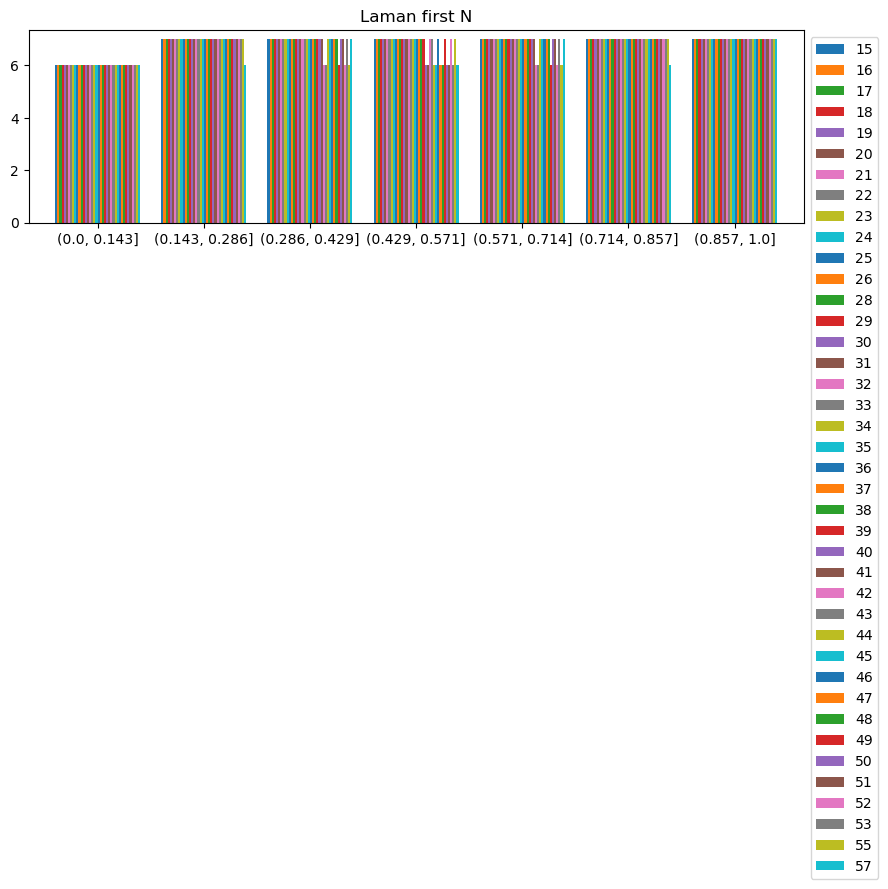

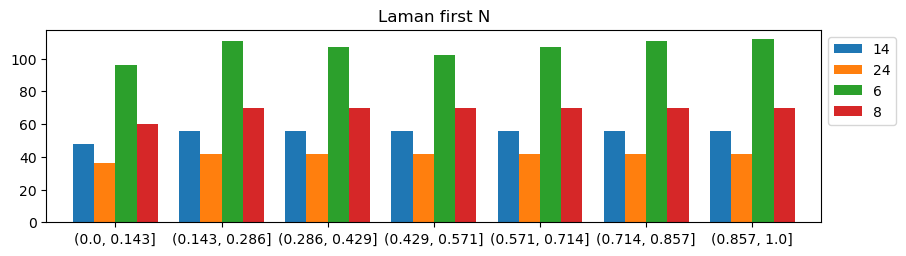

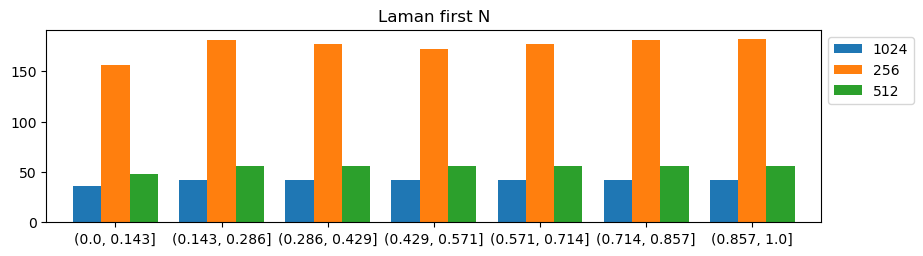

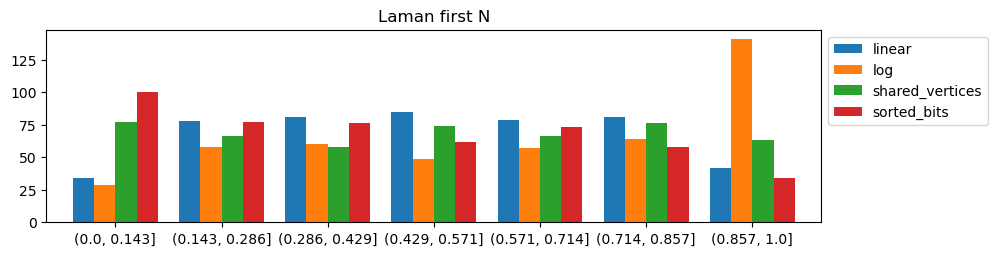

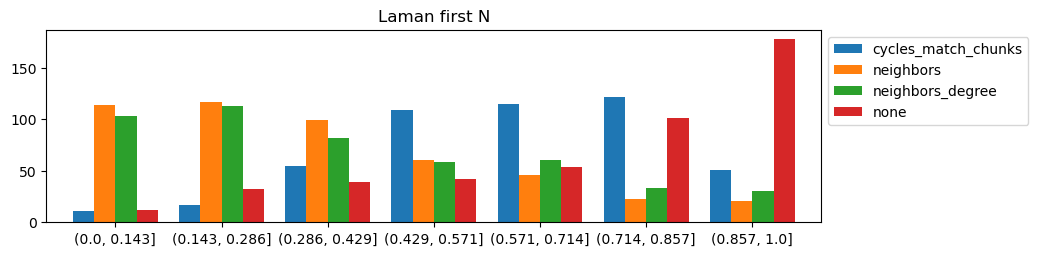

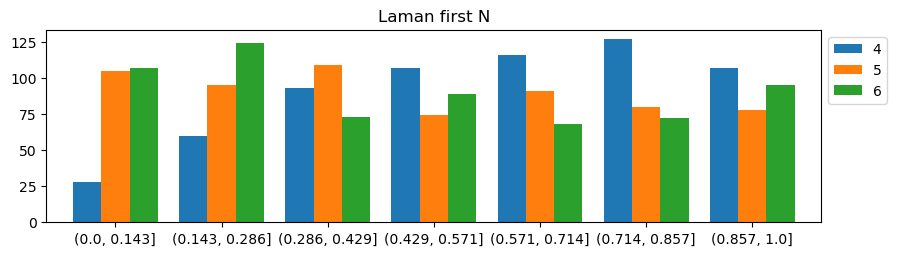

In [29]:
input = """
--------------------------------------------------------------------------------
Name (time in ms)                                                                                     Min                    Max                   Mean            StdDev                 Median               IQR            Outliers     OPS            Rounds  Iterations
--------------------------------------------------------------------------------

test_LamanFirstN[15-24-1024-random-subgraphs-log-none-5-smart]                                 1,579.9782 (2.97)      1,579.9782 (2.97)      1,579.9782 (2.97)     0.0000 (1.0)       1,579.9782 (2.97)     0.0000 (1.0)           0;0  0.6329 (0.34)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-log-none-4-smart]                                 1,619.9235 (3.04)      1,619.9235 (3.04)      1,619.9235 (3.04)     0.0000 (1.0)       1,619.9235 (3.04)     0.0000 (1.0)           0;0  0.6173 (0.33)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-linear-none-5-smart]                              1,651.2809 (3.10)      1,651.2809 (3.10)      1,651.2809 (3.10)     0.0000 (1.0)       1,651.2809 (3.10)     0.0000 (1.0)           0;0  0.6056 (0.32)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]      1,657.9878 (3.11)      1,657.9878 (3.11)      1,657.9878 (3.11)     0.0000 (1.0)       1,657.9878 (3.11)     0.0000 (1.0)           0;0  0.6031 (0.32)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-log-cycles_match_chunks-4-smart]                  1,661.2412 (3.12)      1,661.2412 (3.12)      1,661.2412 (3.12)     0.0000 (1.0)       1,661.2412 (3.12)     0.0000 (1.0)           0;0  0.6020 (0.32)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-log-cycles_match_chunks-5-smart]                  1,666.3256 (3.13)      1,666.3256 (3.13)      1,666.3256 (3.13)     0.0000 (1.0)       1,666.3256 (3.13)     0.0000 (1.0)           0;0  0.6001 (0.32)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-log-neighbors-5-smart]                            1,674.2367 (3.14)      1,674.2367 (3.14)      1,674.2367 (3.14)     0.0000 (1.0)       1,674.2367 (3.14)     0.0000 (1.0)           0;0  0.5973 (0.32)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-log-neighbors-4-smart]                            1,677.1819 (3.15)      1,677.1819 (3.15)      1,677.1819 (3.15)     0.0000 (1.0)       1,677.1819 (3.15)     0.0000 (1.0)           0;0  0.5962 (0.32)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]          1,694.6530 (3.18)      1,694.6530 (3.18)      1,694.6530 (3.18)     0.0000 (1.0)       1,694.6530 (3.18)     0.0000 (1.0)           0;0  0.5901 (0.31)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-sorted_bits-none-5-smart]                         1,712.5266 (3.22)      1,712.5266 (3.22)      1,712.5266 (3.22)     0.0000 (1.0)       1,712.5266 (3.22)     0.0000 (1.0)           0;0  0.5839 (0.31)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-log-neighbors_degree-4-smart]                     1,714.7455 (3.22)      1,714.7455 (3.22)      1,714.7455 (3.22)     0.0000 (1.0)       1,714.7455 (3.22)     0.0000 (1.0)           0;0  0.5832 (0.31)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-sorted_bits-none-4-smart]                         1,727.7241 (3.24)      1,727.7241 (3.24)      1,727.7241 (3.24)     0.0000 (1.0)       1,727.7241 (3.24)     0.0000 (1.0)           0;0  0.5788 (0.31)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-linear-neighbors_degree-4-smart]                  1,727.9112 (3.24)      1,727.9112 (3.24)      1,727.9112 (3.24)     0.0000 (1.0)       1,727.9112 (3.24)     0.0000 (1.0)           0;0  0.5787 (0.31)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]          1,731.6412 (3.25)      1,731.6412 (3.25)      1,731.6412 (3.25)     0.0000 (1.0)       1,731.6412 (3.25)     0.0000 (1.0)           0;0  0.5775 (0.31)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-linear-neighbors_degree-5-smart]                  1,733.1413 (3.25)      1,733.1413 (3.25)      1,733.1413 (3.25)     0.0000 (1.0)       1,733.1413 (3.25)     0.0000 (1.0)           0;0  0.5770 (0.31)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-linear-cycles_match_chunks-4-smart]               1,737.7737 (3.26)      1,737.7737 (3.26)      1,737.7737 (3.26)     0.0000 (1.0)       1,737.7737 (3.26)     0.0000 (1.0)           0;0  0.5754 (0.31)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-sorted_bits-neighbors-4-smart]                    1,741.0867 (3.27)      1,741.0867 (3.27)      1,741.0867 (3.27)     0.0000 (1.0)       1,741.0867 (3.27)     0.0000 (1.0)           0;0  0.5744 (0.31)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-log-neighbors_degree-5-smart]                     1,753.7464 (3.29)      1,753.7464 (3.29)      1,753.7464 (3.29)     0.0000 (1.0)       1,753.7464 (3.29)     0.0000 (1.0)           0;0  0.5702 (0.30)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-linear-cycles_match_chunks-5-smart]               1,777.9816 (3.34)      1,777.9816 (3.34)      1,777.9816 (3.34)     0.0000 (1.0)       1,777.9816 (3.34)     0.0000 (1.0)           0;0  0.5624 (0.30)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-linear-none-4-smart]                              1,779.5748 (3.34)      1,779.5748 (3.34)      1,779.5748 (3.34)     0.0000 (1.0)       1,779.5748 (3.34)     0.0000 (1.0)           0;0  0.5619 (0.30)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-shared_vertices-none-5-smart]                     1,782.1560 (3.35)      1,782.1560 (3.35)      1,782.1560 (3.35)     0.0000 (1.0)       1,782.1560 (3.35)     0.0000 (1.0)           0;0  0.5611 (0.30)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-shared_vertices-neighbors-5-smart]                1,785.7355 (3.35)      1,785.7355 (3.35)      1,785.7355 (3.35)     0.0000 (1.0)       1,785.7355 (3.35)     0.0000 (1.0)           0;0  0.5600 (0.30)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]      1,800.5843 (3.38)      1,800.5843 (3.38)      1,800.5843 (3.38)     0.0000 (1.0)       1,800.5843 (3.38)     0.0000 (1.0)           0;0  0.5554 (0.30)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-shared_vertices-neighbors-4-smart]                1,805.4632 (3.39)      1,805.4632 (3.39)      1,805.4632 (3.39)     0.0000 (1.0)       1,805.4632 (3.39)     0.0000 (1.0)           0;0  0.5539 (0.29)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-sorted_bits-neighbors_degree-4-smart]             1,813.1420 (3.40)      1,813.1420 (3.40)      1,813.1420 (3.40)     0.0000 (1.0)       1,813.1420 (3.40)     0.0000 (1.0)           0;0  0.5515 (0.29)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-linear-neighbors-5-smart]                         1,817.8852 (3.41)      1,817.8852 (3.41)      1,817.8852 (3.41)     0.0000 (1.0)       1,817.8852 (3.41)     0.0000 (1.0)           0;0  0.5501 (0.29)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-linear-neighbors-4-smart]                         1,851.7085 (3.48)      1,851.7085 (3.48)      1,851.7085 (3.48)     0.0000 (1.0)       1,851.7085 (3.48)     0.0000 (1.0)           0;0  0.5400 (0.29)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-log-none-6-smart]                                 1,860.7051 (3.49)      1,860.7051 (3.49)      1,860.7051 (3.49)     0.0000 (1.0)       1,860.7051 (3.49)     0.0000 (1.0)           0;0  0.5374 (0.29)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-sorted_bits-neighbors_degree-5-smart]             1,863.6176 (3.50)      1,863.6176 (3.50)      1,863.6176 (3.50)     0.0000 (1.0)       1,863.6176 (3.50)     0.0000 (1.0)           0;0  0.5366 (0.29)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-shared_vertices-none-4-smart]                     1,885.5080 (3.54)      1,885.5080 (3.54)      1,885.5080 (3.54)     0.0000 (1.0)       1,885.5080 (3.54)     0.0000 (1.0)           0;0  0.5304 (0.28)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-shared_vertices-neighbors_degree-4-smart]         1,892.8807 (3.55)      1,892.8807 (3.55)      1,892.8807 (3.55)     0.0000 (1.0)       1,892.8807 (3.55)     0.0000 (1.0)           0;0  0.5283 (0.28)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-shared_vertices-neighbors_degree-5-smart]         1,908.5945 (3.58)      1,908.5945 (3.58)      1,908.5945 (3.58)     0.0000 (1.0)       1,908.5945 (3.58)     0.0000 (1.0)           0;0  0.5239 (0.28)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-linear-none-6-smart]                              1,923.7211 (3.61)      1,923.7211 (3.61)      1,923.7211 (3.61)     0.0000 (1.0)       1,923.7211 (3.61)     0.0000 (1.0)           0;0  0.5198 (0.28)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-shared_vertices-none-6-smart]                     2,021.7320 (3.80)      2,021.7320 (3.80)      2,021.7320 (3.80)     0.0000 (1.0)       2,021.7320 (3.80)     0.0000 (1.0)           0;0  0.4946 (0.26)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-log-neighbors-6-smart]                            2,060.7626 (3.87)      2,060.7626 (3.87)      2,060.7626 (3.87)     0.0000 (1.0)       2,060.7626 (3.87)     0.0000 (1.0)           0;0  0.4853 (0.26)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-linear-neighbors-6-smart]                         2,062.5776 (3.87)      2,062.5776 (3.87)      2,062.5776 (3.87)     0.0000 (1.0)       2,062.5776 (3.87)     0.0000 (1.0)           0;0  0.4848 (0.26)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-log-cycles_match_chunks-6-smart]                  2,075.4268 (3.90)      2,075.4268 (3.90)      2,075.4268 (3.90)     0.0000 (1.0)       2,075.4268 (3.90)     0.0000 (1.0)           0;0  0.4818 (0.26)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-shared_vertices-neighbors-6-smart]                2,122.9059 (3.99)      2,122.9059 (3.99)      2,122.9059 (3.99)     0.0000 (1.0)       2,122.9059 (3.99)     0.0000 (1.0)           0;0  0.4711 (0.25)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-sorted_bits-neighbors-5-smart]                    2,182.5217 (4.10)      2,182.5217 (4.10)      2,182.5217 (4.10)     0.0000 (1.0)       2,182.5217 (4.10)     0.0000 (1.0)           0;0  0.4582 (0.24)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-linear-cycles_match_chunks-6-smart]               2,217.7941 (4.16)      2,217.7941 (4.16)      2,217.7941 (4.16)     0.0000 (1.0)       2,217.7941 (4.16)     0.0000 (1.0)           0;0  0.4509 (0.24)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]      2,226.3234 (4.18)      2,226.3234 (4.18)      2,226.3234 (4.18)     0.0000 (1.0)       2,226.3234 (4.18)     0.0000 (1.0)           0;0  0.4492 (0.24)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-log-neighbors_degree-6-smart]                     2,338.7838 (4.39)      2,338.7838 (4.39)      2,338.7838 (4.39)     0.0000 (1.0)       2,338.7838 (4.39)     0.0000 (1.0)           0;0  0.4276 (0.23)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-linear-neighbors_degree-6-smart]                  2,389.0426 (4.49)      2,389.0426 (4.49)      2,389.0426 (4.49)     0.0000 (1.0)       2,389.0426 (4.49)     0.0000 (1.0)           0;0  0.4186 (0.22)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-sorted_bits-neighbors_degree-6-smart]             2,398.9004 (4.50)      2,398.9004 (4.50)      2,398.9004 (4.50)     0.0000 (1.0)       2,398.9004 (4.50)     0.0000 (1.0)           0;0  0.4169 (0.22)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-shared_vertices-neighbors_degree-6-smart]         2,489.3306 (4.67)      2,489.3306 (4.67)      2,489.3306 (4.67)     0.0000 (1.0)       2,489.3306 (4.67)     0.0000 (1.0)           0;0  0.4017 (0.21)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]          2,855.9428 (5.36)      2,855.9428 (5.36)      2,855.9428 (5.36)     0.0000 (1.0)       2,855.9428 (5.36)     0.0000 (1.0)           0;0  0.3501 (0.19)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-sorted_bits-neighbors-6-smart]                    3,106.6140 (5.83)      3,106.6140 (5.83)      3,106.6140 (5.83)     0.0000 (1.0)       3,106.6140 (5.83)     0.0000 (1.0)           0;0  0.3219 (0.17)          1           1
test_LamanFirstN[15-24-1024-random-subgraphs-sorted_bits-none-6-smart]                         3,502.7857 (6.58)      3,502.7857 (6.58)      3,502.7857 (6.58)     0.0000 (1.0)       3,502.7857 (6.58)     0.0000 (1.0)           0;0  0.2855 (0.15)          1           1

test_LamanFirstN[16-24-1024-random-subgraphs-log-neighbors-4-smart]                            1,386.3612 (2.60)      1,386.3612 (2.60)      1,386.3612 (2.60)     0.0000 (1.0)       1,386.3612 (2.60)     0.0000 (1.0)           0;0  0.7213 (0.38)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-log-neighbors-5-smart]                            1,410.3072 (2.65)      1,410.3072 (2.65)      1,410.3072 (2.65)     0.0000 (1.0)       1,410.3072 (2.65)     0.0000 (1.0)           0;0  0.7091 (0.38)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-log-cycles_match_chunks-4-smart]                  1,433.3506 (2.69)      1,433.3506 (2.69)      1,433.3506 (2.69)     0.0000 (1.0)       1,433.3506 (2.69)     0.0000 (1.0)           0;0  0.6977 (0.37)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-shared_vertices-neighbors-5-smart]                1,446.4922 (2.72)      1,446.4922 (2.72)      1,446.4922 (2.72)     0.0000 (1.0)       1,446.4922 (2.72)     0.0000 (1.0)           0;0  0.6913 (0.37)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-shared_vertices-neighbors_degree-5-smart]         1,453.5634 (2.73)      1,453.5634 (2.73)      1,453.5634 (2.73)     0.0000 (1.0)       1,453.5634 (2.73)     0.0000 (1.0)           0;0  0.6880 (0.37)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-linear-neighbors-5-smart]                         1,461.1138 (2.74)      1,461.1138 (2.74)      1,461.1138 (2.74)     0.0000 (1.0)       1,461.1138 (2.74)     0.0000 (1.0)           0;0  0.6844 (0.36)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-log-cycles_match_chunks-5-smart]                  1,479.1076 (2.78)      1,479.1076 (2.78)      1,479.1076 (2.78)     0.0000 (1.0)       1,479.1076 (2.78)     0.0000 (1.0)           0;0  0.6761 (0.36)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-linear-cycles_match_chunks-5-smart]               1,486.1728 (2.79)      1,486.1728 (2.79)      1,486.1728 (2.79)     0.0000 (1.0)       1,486.1728 (2.79)     0.0000 (1.0)           0;0  0.6729 (0.36)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]      1,505.6306 (2.83)      1,505.6306 (2.83)      1,505.6306 (2.83)     0.0000 (1.0)       1,505.6306 (2.83)     0.0000 (1.0)           0;0  0.6642 (0.35)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-log-neighbors_degree-4-smart]                     1,515.6270 (2.85)      1,515.6270 (2.85)      1,515.6270 (2.85)     0.0000 (1.0)       1,515.6270 (2.85)     0.0000 (1.0)           0;0  0.6598 (0.35)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-shared_vertices-neighbors-4-smart]                1,518.6652 (2.85)      1,518.6652 (2.85)      1,518.6652 (2.85)     0.0000 (1.0)       1,518.6652 (2.85)     0.0000 (1.0)           0;0  0.6585 (0.35)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-linear-neighbors_degree-4-smart]                  1,534.4600 (2.88)      1,534.4600 (2.88)      1,534.4600 (2.88)     0.0000 (1.0)       1,534.4600 (2.88)     0.0000 (1.0)           0;0  0.6517 (0.35)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-sorted_bits-neighbors-4-smart]                    1,537.9061 (2.89)      1,537.9061 (2.89)      1,537.9061 (2.89)     0.0000 (1.0)       1,537.9061 (2.89)     0.0000 (1.0)           0;0  0.6502 (0.35)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-linear-neighbors-4-smart]                         1,543.7138 (2.90)      1,543.7138 (2.90)      1,543.7138 (2.90)     0.0000 (1.0)       1,543.7138 (2.90)     0.0000 (1.0)           0;0  0.6478 (0.35)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-sorted_bits-neighbors-5-smart]                    1,547.8663 (2.91)      1,547.8663 (2.91)      1,547.8663 (2.91)     0.0000 (1.0)       1,547.8663 (2.91)     0.0000 (1.0)           0;0  0.6461 (0.34)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-sorted_bits-neighbors_degree-4-smart]             1,565.4340 (2.94)      1,565.4340 (2.94)      1,565.4340 (2.94)     0.0000 (1.0)       1,565.4340 (2.94)     0.0000 (1.0)           0;0  0.6388 (0.34)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-linear-cycles_match_chunks-4-smart]               1,565.9425 (2.94)      1,565.9425 (2.94)      1,565.9425 (2.94)     0.0000 (1.0)       1,565.9425 (2.94)     0.0000 (1.0)           0;0  0.6386 (0.34)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-log-neighbors_degree-5-smart]                     1,573.9104 (2.96)      1,573.9104 (2.96)      1,573.9104 (2.96)     0.0000 (1.0)       1,573.9104 (2.96)     0.0000 (1.0)           0;0  0.6354 (0.34)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]      1,578.0471 (2.96)      1,578.0471 (2.96)      1,578.0471 (2.96)     0.0000 (1.0)       1,578.0471 (2.96)     0.0000 (1.0)           0;0  0.6337 (0.34)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-shared_vertices-neighbors_degree-4-smart]         1,587.5227 (2.98)      1,587.5227 (2.98)      1,587.5227 (2.98)     0.0000 (1.0)       1,587.5227 (2.98)     0.0000 (1.0)           0;0  0.6299 (0.34)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-linear-neighbors_degree-5-smart]                  1,598.2340 (3.00)      1,598.2340 (3.00)      1,598.2340 (3.00)     0.0000 (1.0)       1,598.2340 (3.00)     0.0000 (1.0)           0;0  0.6257 (0.33)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]          1,608.2754 (3.02)      1,608.2754 (3.02)      1,608.2754 (3.02)     0.0000 (1.0)       1,608.2754 (3.02)     0.0000 (1.0)           0;0  0.6218 (0.33)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]          1,642.4245 (3.08)      1,642.4245 (3.08)      1,642.4245 (3.08)     0.0000 (1.0)       1,642.4245 (3.08)     0.0000 (1.0)           0;0  0.6089 (0.32)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-shared_vertices-neighbors-6-smart]                1,678.5959 (3.15)      1,678.5959 (3.15)      1,678.5959 (3.15)     0.0000 (1.0)       1,678.5959 (3.15)     0.0000 (1.0)           0;0  0.5957 (0.32)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-log-neighbors-6-smart]                            1,682.2270 (3.16)      1,682.2270 (3.16)      1,682.2270 (3.16)     0.0000 (1.0)       1,682.2270 (3.16)     0.0000 (1.0)           0;0  0.5945 (0.32)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-shared_vertices-none-4-smart]                     1,718.4204 (3.23)      1,718.4204 (3.23)      1,718.4204 (3.23)     0.0000 (1.0)       1,718.4204 (3.23)     0.0000 (1.0)           0;0  0.5819 (0.31)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-linear-none-5-smart]                              1,721.2278 (3.23)      1,721.2278 (3.23)      1,721.2278 (3.23)     0.0000 (1.0)       1,721.2278 (3.23)     0.0000 (1.0)           0;0  0.5810 (0.31)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-sorted_bits-none-4-smart]                         1,737.7636 (3.26)      1,737.7636 (3.26)      1,737.7636 (3.26)     0.0000 (1.0)       1,737.7636 (3.26)     0.0000 (1.0)           0;0  0.5755 (0.31)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-sorted_bits-neighbors_degree-5-smart]             1,759.0682 (3.30)      1,759.0682 (3.30)      1,759.0682 (3.30)     0.0000 (1.0)       1,759.0682 (3.30)     0.0000 (1.0)           0;0  0.5685 (0.30)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-shared_vertices-none-5-smart]                     1,775.7795 (3.33)      1,775.7795 (3.33)      1,775.7795 (3.33)     0.0000 (1.0)       1,775.7795 (3.33)     0.0000 (1.0)           0;0  0.5631 (0.30)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-log-none-4-smart]                                 1,788.2786 (3.36)      1,788.2786 (3.36)      1,788.2786 (3.36)     0.0000 (1.0)       1,788.2786 (3.36)     0.0000 (1.0)           0;0  0.5592 (0.30)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-sorted_bits-none-5-smart]                         1,820.3805 (3.42)      1,820.3805 (3.42)      1,820.3805 (3.42)     0.0000 (1.0)       1,820.3805 (3.42)     0.0000 (1.0)           0;0  0.5493 (0.29)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-log-none-5-smart]                                 1,829.9520 (3.44)      1,829.9520 (3.44)      1,829.9520 (3.44)     0.0000 (1.0)       1,829.9520 (3.44)     0.0000 (1.0)           0;0  0.5465 (0.29)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-linear-neighbors-6-smart]                         1,848.2379 (3.47)      1,848.2379 (3.47)      1,848.2379 (3.47)     0.0000 (1.0)       1,848.2379 (3.47)     0.0000 (1.0)           0;0  0.5411 (0.29)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-linear-none-4-smart]                              1,921.0736 (3.61)      1,921.0736 (3.61)      1,921.0736 (3.61)     0.0000 (1.0)       1,921.0736 (3.61)     0.0000 (1.0)           0;0  0.5205 (0.28)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-log-cycles_match_chunks-6-smart]                  1,939.2821 (3.64)      1,939.2821 (3.64)      1,939.2821 (3.64)     0.0000 (1.0)       1,939.2821 (3.64)     0.0000 (1.0)           0;0  0.5157 (0.27)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-linear-cycles_match_chunks-6-smart]               1,959.4611 (3.68)      1,959.4611 (3.68)      1,959.4611 (3.68)     0.0000 (1.0)       1,959.4611 (3.68)     0.0000 (1.0)           0;0  0.5103 (0.27)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]      1,974.8847 (3.71)      1,974.8847 (3.71)      1,974.8847 (3.71)     0.0000 (1.0)       1,974.8847 (3.71)     0.0000 (1.0)           0;0  0.5064 (0.27)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-sorted_bits-neighbors_degree-6-smart]             1,987.1948 (3.73)      1,987.1948 (3.73)      1,987.1948 (3.73)     0.0000 (1.0)       1,987.1948 (3.73)     0.0000 (1.0)           0;0  0.5032 (0.27)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]          1,997.3463 (3.75)      1,997.3463 (3.75)      1,997.3463 (3.75)     0.0000 (1.0)       1,997.3463 (3.75)     0.0000 (1.0)           0;0  0.5007 (0.27)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-shared_vertices-neighbors_degree-6-smart]         2,066.1145 (3.88)      2,066.1145 (3.88)      2,066.1145 (3.88)     0.0000 (1.0)       2,066.1145 (3.88)     0.0000 (1.0)           0;0  0.4840 (0.26)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-log-neighbors_degree-6-smart]                     2,085.9699 (3.92)      2,085.9699 (3.92)      2,085.9699 (3.92)     0.0000 (1.0)       2,085.9699 (3.92)     0.0000 (1.0)           0;0  0.4794 (0.26)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-shared_vertices-none-6-smart]                     2,095.5419 (3.93)      2,095.5419 (3.93)      2,095.5419 (3.93)     0.0000 (1.0)       2,095.5419 (3.93)     0.0000 (1.0)           0;0  0.4772 (0.25)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-linear-none-6-smart]                              2,134.2882 (4.01)      2,134.2882 (4.01)      2,134.2882 (4.01)     0.0000 (1.0)       2,134.2882 (4.01)     0.0000 (1.0)           0;0  0.4685 (0.25)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-sorted_bits-neighbors-6-smart]                    2,194.0701 (4.12)      2,194.0701 (4.12)      2,194.0701 (4.12)     0.0000 (1.0)       2,194.0701 (4.12)     0.0000 (1.0)           0;0  0.4558 (0.24)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-linear-neighbors_degree-6-smart]                  2,301.7076 (4.32)      2,301.7076 (4.32)      2,301.7076 (4.32)     0.0000 (1.0)       2,301.7076 (4.32)     0.0000 (1.0)           0;0  0.4345 (0.23)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-log-none-6-smart]                                 2,373.9066 (4.46)      2,373.9066 (4.46)      2,373.9066 (4.46)     0.0000 (1.0)       2,373.9066 (4.46)     0.0000 (1.0)           0;0  0.4212 (0.22)          1           1
test_LamanFirstN[16-24-1024-random-subgraphs-sorted_bits-none-6-smart]                         2,680.6112 (5.03)      2,680.6112 (5.03)      2,680.6112 (5.03)     0.0000 (1.0)       2,680.6112 (5.03)     0.0000 (1.0)           0;0  0.3730 (0.20)          1           1

test_LamanFirstN[17-24-1024-random-subgraphs-linear-neighbors-4-smart]                         1,832.1498 (3.44)      1,832.1498 (3.44)      1,832.1498 (3.44)     0.0000 (1.0)       1,832.1498 (3.44)     0.0000 (1.0)           0;0  0.5458 (0.29)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-linear-neighbors_degree-4-smart]                  1,858.0825 (3.49)      1,858.0825 (3.49)      1,858.0825 (3.49)     0.0000 (1.0)       1,858.0825 (3.49)     0.0000 (1.0)           0;0  0.5382 (0.29)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-sorted_bits-neighbors_degree-4-smart]             1,897.4594 (3.56)      1,897.4594 (3.56)      1,897.4594 (3.56)     0.0000 (1.0)       1,897.4594 (3.56)     0.0000 (1.0)           0;0  0.5270 (0.28)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-sorted_bits-neighbors-4-smart]                    1,907.7329 (3.58)      1,907.7329 (3.58)      1,907.7329 (3.58)     0.0000 (1.0)       1,907.7329 (3.58)     0.0000 (1.0)           0;0  0.5242 (0.28)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]          1,910.8283 (3.59)      1,910.8283 (3.59)      1,910.8283 (3.59)     0.0000 (1.0)       1,910.8283 (3.59)     0.0000 (1.0)           0;0  0.5233 (0.28)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]      1,918.8060 (3.60)      1,918.8060 (3.60)      1,918.8060 (3.60)     0.0000 (1.0)       1,918.8060 (3.60)     0.0000 (1.0)           0;0  0.5212 (0.28)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-log-neighbors_degree-4-smart]                     1,920.1232 (3.61)      1,920.1232 (3.61)      1,920.1232 (3.61)     0.0000 (1.0)       1,920.1232 (3.61)     0.0000 (1.0)           0;0  0.5208 (0.28)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-log-cycles_match_chunks-4-smart]                  1,938.3211 (3.64)      1,938.3211 (3.64)      1,938.3211 (3.64)     0.0000 (1.0)       1,938.3211 (3.64)     0.0000 (1.0)           0;0  0.5159 (0.27)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]      1,942.7364 (3.65)      1,942.7364 (3.65)      1,942.7364 (3.65)     0.0000 (1.0)       1,942.7364 (3.65)     0.0000 (1.0)           0;0  0.5147 (0.27)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-sorted_bits-none-4-smart]                         1,943.9215 (3.65)      1,943.9215 (3.65)      1,943.9215 (3.65)     0.0000 (1.0)       1,943.9215 (3.65)     0.0000 (1.0)           0;0  0.5144 (0.27)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-sorted_bits-neighbors_degree-5-smart]             1,953.1810 (3.67)      1,953.1810 (3.67)      1,953.1810 (3.67)     0.0000 (1.0)       1,953.1810 (3.67)     0.0000 (1.0)           0;0  0.5120 (0.27)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-shared_vertices-neighbors-4-smart]                1,962.3955 (3.68)      1,962.3955 (3.68)      1,962.3955 (3.68)     0.0000 (1.0)       1,962.3955 (3.68)     0.0000 (1.0)           0;0  0.5096 (0.27)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-linear-neighbors-5-smart]                         1,976.2275 (3.71)      1,976.2275 (3.71)      1,976.2275 (3.71)     0.0000 (1.0)       1,976.2275 (3.71)     0.0000 (1.0)           0;0  0.5060 (0.27)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-log-neighbors-4-smart]                            1,988.7762 (3.73)      1,988.7762 (3.73)      1,988.7762 (3.73)     0.0000 (1.0)       1,988.7762 (3.73)     0.0000 (1.0)           0;0  0.5028 (0.27)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-log-none-5-smart]                                 1,992.7709 (3.74)      1,992.7709 (3.74)      1,992.7709 (3.74)     0.0000 (1.0)       1,992.7709 (3.74)     0.0000 (1.0)           0;0  0.5018 (0.27)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-log-neighbors-5-smart]                            2,006.0646 (3.77)      2,006.0646 (3.77)      2,006.0646 (3.77)     0.0000 (1.0)       2,006.0646 (3.77)     0.0000 (1.0)           0;0  0.4985 (0.27)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-linear-neighbors_degree-5-smart]                  2,014.0742 (3.78)      2,014.0742 (3.78)      2,014.0742 (3.78)     0.0000 (1.0)       2,014.0742 (3.78)     0.0000 (1.0)           0;0  0.4965 (0.26)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-linear-cycles_match_chunks-4-smart]               2,028.5627 (3.81)      2,028.5627 (3.81)      2,028.5627 (3.81)     0.0000 (1.0)       2,028.5627 (3.81)     0.0000 (1.0)           0;0  0.4930 (0.26)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-shared_vertices-none-4-smart]                     2,031.8724 (3.82)      2,031.8724 (3.82)      2,031.8724 (3.82)     0.0000 (1.0)       2,031.8724 (3.82)     0.0000 (1.0)           0;0  0.4922 (0.26)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-log-none-4-smart]                                 2,051.0515 (3.85)      2,051.0515 (3.85)      2,051.0515 (3.85)     0.0000 (1.0)       2,051.0515 (3.85)     0.0000 (1.0)           0;0  0.4876 (0.26)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-linear-none-5-smart]                              2,055.6453 (3.86)      2,055.6453 (3.86)      2,055.6453 (3.86)     0.0000 (1.0)       2,055.6453 (3.86)     0.0000 (1.0)           0;0  0.4865 (0.26)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-shared_vertices-none-5-smart]                     2,114.3403 (3.97)      2,114.3403 (3.97)      2,114.3403 (3.97)     0.0000 (1.0)       2,114.3403 (3.97)     0.0000 (1.0)           0;0  0.4730 (0.25)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-log-cycles_match_chunks-5-smart]                  2,145.7937 (4.03)      2,145.7937 (4.03)      2,145.7937 (4.03)     0.0000 (1.0)       2,145.7937 (4.03)     0.0000 (1.0)           0;0  0.4660 (0.25)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-shared_vertices-neighbors-5-smart]                2,149.1865 (4.04)      2,149.1865 (4.04)      2,149.1865 (4.04)     0.0000 (1.0)       2,149.1865 (4.04)     0.0000 (1.0)           0;0  0.4653 (0.25)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]          2,155.8255 (4.05)      2,155.8255 (4.05)      2,155.8255 (4.05)     0.0000 (1.0)       2,155.8255 (4.05)     0.0000 (1.0)           0;0  0.4639 (0.25)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-sorted_bits-neighbors-5-smart]                    2,204.8316 (4.14)      2,204.8316 (4.14)      2,204.8316 (4.14)     0.0000 (1.0)       2,204.8316 (4.14)     0.0000 (1.0)           0;0  0.4535 (0.24)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-linear-cycles_match_chunks-5-smart]               2,222.6462 (4.17)      2,222.6462 (4.17)      2,222.6462 (4.17)     0.0000 (1.0)       2,222.6462 (4.17)     0.0000 (1.0)           0;0  0.4499 (0.24)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-sorted_bits-none-5-smart]                         2,259.8825 (4.24)      2,259.8825 (4.24)      2,259.8825 (4.24)     0.0000 (1.0)       2,259.8825 (4.24)     0.0000 (1.0)           0;0  0.4425 (0.24)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-linear-none-4-smart]                              2,354.1076 (4.42)      2,354.1076 (4.42)      2,354.1076 (4.42)     0.0000 (1.0)       2,354.1076 (4.42)     0.0000 (1.0)           0;0  0.4248 (0.23)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-shared_vertices-neighbors_degree-4-smart]         2,517.3541 (4.73)      2,517.3541 (4.73)      2,517.3541 (4.73)     0.0000 (1.0)       2,517.3541 (4.73)     0.0000 (1.0)           0;0  0.3972 (0.21)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-log-neighbors-6-smart]                            2,518.8509 (4.73)      2,518.8509 (4.73)      2,518.8509 (4.73)     0.0000 (1.0)       2,518.8509 (4.73)     0.0000 (1.0)           0;0  0.3970 (0.21)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-shared_vertices-none-6-smart]                     2,578.3354 (4.84)      2,578.3354 (4.84)      2,578.3354 (4.84)     0.0000 (1.0)       2,578.3354 (4.84)     0.0000 (1.0)           0;0  0.3878 (0.21)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-log-none-6-smart]                                 2,587.1862 (4.86)      2,587.1862 (4.86)      2,587.1862 (4.86)     0.0000 (1.0)       2,587.1862 (4.86)     0.0000 (1.0)           0;0  0.3865 (0.21)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-linear-neighbors-6-smart]                         2,600.1616 (4.88)      2,600.1616 (4.88)      2,600.1616 (4.88)     0.0000 (1.0)       2,600.1616 (4.88)     0.0000 (1.0)           0;0  0.3846 (0.20)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-linear-none-6-smart]                              2,726.2166 (5.12)      2,726.2166 (5.12)      2,726.2166 (5.12)     0.0000 (1.0)       2,726.2166 (5.12)     0.0000 (1.0)           0;0  0.3668 (0.20)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-shared_vertices-neighbors_degree-5-smart]         2,733.5842 (5.13)      2,733.5842 (5.13)      2,733.5842 (5.13)     0.0000 (1.0)       2,733.5842 (5.13)     0.0000 (1.0)           0;0  0.3658 (0.19)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]      3,070.8283 (5.77)      3,070.8283 (5.77)      3,070.8283 (5.77)     0.0000 (1.0)       3,070.8283 (5.77)     0.0000 (1.0)           0;0  0.3256 (0.17)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-shared_vertices-neighbors-6-smart]                3,170.0351 (5.95)      3,170.0351 (5.95)      3,170.0351 (5.95)     0.0000 (1.0)       3,170.0351 (5.95)     0.0000 (1.0)           0;0  0.3155 (0.17)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-log-cycles_match_chunks-6-smart]                  3,188.9526 (5.99)      3,188.9526 (5.99)      3,188.9526 (5.99)     0.0000 (1.0)       3,188.9526 (5.99)     0.0000 (1.0)           0;0  0.3136 (0.17)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-linear-cycles_match_chunks-6-smart]               3,342.5476 (6.28)      3,342.5476 (6.28)      3,342.5476 (6.28)     0.0000 (1.0)       3,342.5476 (6.28)     0.0000 (1.0)           0;0  0.2992 (0.16)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-sorted_bits-neighbors_degree-6-smart]             3,437.5868 (6.45)      3,437.5868 (6.45)      3,437.5868 (6.45)     0.0000 (1.0)       3,437.5868 (6.45)     0.0000 (1.0)           0;0  0.2909 (0.15)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-log-neighbors_degree-6-smart]                     3,585.5255 (6.73)      3,585.5255 (6.73)      3,585.5255 (6.73)     0.0000 (1.0)       3,585.5255 (6.73)     0.0000 (1.0)           0;0  0.2789 (0.15)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-linear-neighbors_degree-6-smart]                  3,795.0727 (7.13)      3,795.0727 (7.13)      3,795.0727 (7.13)     0.0000 (1.0)       3,795.0727 (7.13)     0.0000 (1.0)           0;0  0.2635 (0.14)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]          4,583.9166 (8.61)      4,583.9166 (8.61)      4,583.9166 (8.61)     0.0000 (1.0)       4,583.9166 (8.61)     0.0000 (1.0)           0;0  0.2182 (0.12)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-log-neighbors_degree-5-smart]                     4,744.4460 (8.91)      4,744.4460 (8.91)      4,744.4460 (8.91)     0.0000 (1.0)       4,744.4460 (8.91)     0.0000 (1.0)           0;0  0.2108 (0.11)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-sorted_bits-neighbors-6-smart]                    5,622.9215 (10.56)     5,622.9215 (10.56)     5,622.9215 (10.56)    0.0000 (1.0)       5,622.9215 (10.56)    0.0000 (1.0)           0;0  0.1778 (0.09)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-shared_vertices-neighbors_degree-6-smart]         5,757.2543 (10.81)     5,757.2543 (10.81)     5,757.2543 (10.81)    0.0000 (1.0)       5,757.2543 (10.81)    0.0000 (1.0)           0;0  0.1737 (0.09)          1           1
test_LamanFirstN[17-24-1024-random-subgraphs-sorted_bits-none-6-smart]                         6,254.1703 (11.74)     6,254.1703 (11.74)     6,254.1703 (11.74)    0.0000 (1.0)       6,254.1703 (11.74)    0.0000 (1.0)           0;0  0.1599 (0.09)          1           1

test_LamanFirstN[18-24-1024-random-subgraphs-log-neighbors-4-smart]                            1,849.8859 (3.47)      1,849.8859 (3.47)      1,849.8859 (3.47)     0.0000 (1.0)       1,849.8859 (3.47)     0.0000 (1.0)           0;0  0.5406 (0.29)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-sorted_bits-neighbors_degree-6-smart]             1,863.8910 (3.50)      1,863.8910 (3.50)      1,863.8910 (3.50)     0.0000 (1.0)       1,863.8910 (3.50)     0.0000 (1.0)           0;0  0.5365 (0.29)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-linear-neighbors-5-smart]                         1,864.8203 (3.50)      1,864.8203 (3.50)      1,864.8203 (3.50)     0.0000 (1.0)       1,864.8203 (3.50)     0.0000 (1.0)           0;0  0.5362 (0.29)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-linear-neighbors-6-smart]                         1,876.5424 (3.52)      1,876.5424 (3.52)      1,876.5424 (3.52)     0.0000 (1.0)       1,876.5424 (3.52)     0.0000 (1.0)           0;0  0.5329 (0.28)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-shared_vertices-neighbors-6-smart]                1,886.4879 (3.54)      1,886.4879 (3.54)      1,886.4879 (3.54)     0.0000 (1.0)       1,886.4879 (3.54)     0.0000 (1.0)           0;0  0.5301 (0.28)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-log-neighbors-5-smart]                            1,888.0530 (3.55)      1,888.0530 (3.55)      1,888.0530 (3.55)     0.0000 (1.0)       1,888.0530 (3.55)     0.0000 (1.0)           0;0  0.5296 (0.28)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-log-neighbors-6-smart]                            1,890.4040 (3.55)      1,890.4040 (3.55)      1,890.4040 (3.55)     0.0000 (1.0)       1,890.4040 (3.55)     0.0000 (1.0)           0;0  0.5290 (0.28)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-shared_vertices-neighbors-5-smart]                1,892.5768 (3.55)      1,892.5768 (3.55)      1,892.5768 (3.55)     0.0000 (1.0)       1,892.5768 (3.55)     0.0000 (1.0)           0;0  0.5284 (0.28)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-log-cycles_match_chunks-4-smart]                  1,894.6629 (3.56)      1,894.6629 (3.56)      1,894.6629 (3.56)     0.0000 (1.0)       1,894.6629 (3.56)     0.0000 (1.0)           0;0  0.5278 (0.28)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-sorted_bits-neighbors_degree-5-smart]             1,904.0405 (3.58)      1,904.0405 (3.58)      1,904.0405 (3.58)     0.0000 (1.0)       1,904.0405 (3.58)     0.0000 (1.0)           0;0  0.5252 (0.28)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-log-neighbors_degree-4-smart]                     1,923.1790 (3.61)      1,923.1790 (3.61)      1,923.1790 (3.61)     0.0000 (1.0)       1,923.1790 (3.61)     0.0000 (1.0)           0;0  0.5200 (0.28)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-sorted_bits-neighbors_degree-4-smart]             1,926.1811 (3.62)      1,926.1811 (3.62)      1,926.1811 (3.62)     0.0000 (1.0)       1,926.1811 (3.62)     0.0000 (1.0)           0;0  0.5192 (0.28)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-linear-neighbors-4-smart]                         1,941.8242 (3.65)      1,941.8242 (3.65)      1,941.8242 (3.65)     0.0000 (1.0)       1,941.8242 (3.65)     0.0000 (1.0)           0;0  0.5150 (0.27)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-shared_vertices-neighbors-4-smart]                1,978.2297 (3.71)      1,978.2297 (3.71)      1,978.2297 (3.71)     0.0000 (1.0)       1,978.2297 (3.71)     0.0000 (1.0)           0;0  0.5055 (0.27)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-log-cycles_match_chunks-6-smart]                  1,990.9286 (3.74)      1,990.9286 (3.74)      1,990.9286 (3.74)     0.0000 (1.0)       1,990.9286 (3.74)     0.0000 (1.0)           0;0  0.5023 (0.27)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]      1,992.2112 (3.74)      1,992.2112 (3.74)      1,992.2112 (3.74)     0.0000 (1.0)       1,992.2112 (3.74)     0.0000 (1.0)           0;0  0.5020 (0.27)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]      1,996.0555 (3.75)      1,996.0555 (3.75)      1,996.0555 (3.75)     0.0000 (1.0)       1,996.0555 (3.75)     0.0000 (1.0)           0;0  0.5010 (0.27)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-linear-cycles_match_chunks-5-smart]               1,997.7890 (3.75)      1,997.7890 (3.75)      1,997.7890 (3.75)     0.0000 (1.0)       1,997.7890 (3.75)     0.0000 (1.0)           0;0  0.5006 (0.27)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]      2,003.3557 (3.76)      2,003.3557 (3.76)      2,003.3557 (3.76)     0.0000 (1.0)       2,003.3557 (3.76)     0.0000 (1.0)           0;0  0.4992 (0.27)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-linear-cycles_match_chunks-4-smart]               2,004.1483 (3.76)      2,004.1483 (3.76)      2,004.1483 (3.76)     0.0000 (1.0)       2,004.1483 (3.76)     0.0000 (1.0)           0;0  0.4990 (0.27)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-log-cycles_match_chunks-5-smart]                  2,005.7456 (3.77)      2,005.7456 (3.77)      2,005.7456 (3.77)     0.0000 (1.0)       2,005.7456 (3.77)     0.0000 (1.0)           0;0  0.4986 (0.27)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-shared_vertices-neighbors_degree-5-smart]         2,038.3446 (3.83)      2,038.3446 (3.83)      2,038.3446 (3.83)     0.0000 (1.0)       2,038.3446 (3.83)     0.0000 (1.0)           0;0  0.4906 (0.26)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-shared_vertices-neighbors_degree-6-smart]         2,043.1216 (3.84)      2,043.1216 (3.84)      2,043.1216 (3.84)     0.0000 (1.0)       2,043.1216 (3.84)     0.0000 (1.0)           0;0  0.4894 (0.26)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-linear-neighbors_degree-6-smart]                  2,045.0877 (3.84)      2,045.0877 (3.84)      2,045.0877 (3.84)     0.0000 (1.0)       2,045.0877 (3.84)     0.0000 (1.0)           0;0  0.4890 (0.26)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-log-neighbors_degree-5-smart]                     2,054.1105 (3.86)      2,054.1105 (3.86)      2,054.1105 (3.86)     0.0000 (1.0)       2,054.1105 (3.86)     0.0000 (1.0)           0;0  0.4868 (0.26)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-linear-neighbors_degree-5-smart]                  2,063.6168 (3.87)      2,063.6168 (3.87)      2,063.6168 (3.87)     0.0000 (1.0)       2,063.6168 (3.87)     0.0000 (1.0)           0;0  0.4846 (0.26)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]          2,079.6749 (3.90)      2,079.6749 (3.90)      2,079.6749 (3.90)     0.0000 (1.0)       2,079.6749 (3.90)     0.0000 (1.0)           0;0  0.4808 (0.26)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-sorted_bits-neighbors-6-smart]                    2,082.3642 (3.91)      2,082.3642 (3.91)      2,082.3642 (3.91)     0.0000 (1.0)       2,082.3642 (3.91)     0.0000 (1.0)           0;0  0.4802 (0.26)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-sorted_bits-neighbors-4-smart]                    2,101.9834 (3.95)      2,101.9834 (3.95)      2,101.9834 (3.95)     0.0000 (1.0)       2,101.9834 (3.95)     0.0000 (1.0)           0;0  0.4757 (0.25)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]          2,103.3852 (3.95)      2,103.3852 (3.95)      2,103.3852 (3.95)     0.0000 (1.0)       2,103.3852 (3.95)     0.0000 (1.0)           0;0  0.4754 (0.25)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-linear-neighbors_degree-4-smart]                  2,103.8703 (3.95)      2,103.8703 (3.95)      2,103.8703 (3.95)     0.0000 (1.0)       2,103.8703 (3.95)     0.0000 (1.0)           0;0  0.4753 (0.25)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-sorted_bits-neighbors-5-smart]                    2,106.1093 (3.95)      2,106.1093 (3.95)      2,106.1093 (3.95)     0.0000 (1.0)       2,106.1093 (3.95)     0.0000 (1.0)           0;0  0.4748 (0.25)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]          2,109.0534 (3.96)      2,109.0534 (3.96)      2,109.0534 (3.96)     0.0000 (1.0)       2,109.0534 (3.96)     0.0000 (1.0)           0;0  0.4741 (0.25)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-shared_vertices-neighbors_degree-4-smart]         2,114.0448 (3.97)      2,114.0448 (3.97)      2,114.0448 (3.97)     0.0000 (1.0)       2,114.0448 (3.97)     0.0000 (1.0)           0;0  0.4730 (0.25)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-log-neighbors_degree-6-smart]                     2,148.4521 (4.03)      2,148.4521 (4.03)      2,148.4521 (4.03)     0.0000 (1.0)       2,148.4521 (4.03)     0.0000 (1.0)           0;0  0.4655 (0.25)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-linear-cycles_match_chunks-6-smart]               2,191.5752 (4.11)      2,191.5752 (4.11)      2,191.5752 (4.11)     0.0000 (1.0)       2,191.5752 (4.11)     0.0000 (1.0)           0;0  0.4563 (0.24)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-sorted_bits-none-4-smart]                         2,284.1928 (4.29)      2,284.1928 (4.29)      2,284.1928 (4.29)     0.0000 (1.0)       2,284.1928 (4.29)     0.0000 (1.0)           0;0  0.4378 (0.23)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-sorted_bits-none-6-smart]                         2,301.7781 (4.32)      2,301.7781 (4.32)      2,301.7781 (4.32)     0.0000 (1.0)       2,301.7781 (4.32)     0.0000 (1.0)           0;0  0.4344 (0.23)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-sorted_bits-none-5-smart]                         2,309.0440 (4.34)      2,309.0440 (4.34)      2,309.0440 (4.34)     0.0000 (1.0)       2,309.0440 (4.34)     0.0000 (1.0)           0;0  0.4331 (0.23)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-shared_vertices-none-4-smart]                     2,385.5172 (4.48)      2,385.5172 (4.48)      2,385.5172 (4.48)     0.0000 (1.0)       2,385.5172 (4.48)     0.0000 (1.0)           0;0  0.4192 (0.22)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-shared_vertices-none-6-smart]                     2,453.8820 (4.61)      2,453.8820 (4.61)      2,453.8820 (4.61)     0.0000 (1.0)       2,453.8820 (4.61)     0.0000 (1.0)           0;0  0.4075 (0.22)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-log-none-6-smart]                                 2,458.6780 (4.62)      2,458.6780 (4.62)      2,458.6780 (4.62)     0.0000 (1.0)       2,458.6780 (4.62)     0.0000 (1.0)           0;0  0.4067 (0.22)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-shared_vertices-none-5-smart]                     2,460.7365 (4.62)      2,460.7365 (4.62)      2,460.7365 (4.62)     0.0000 (1.0)       2,460.7365 (4.62)     0.0000 (1.0)           0;0  0.4064 (0.22)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-linear-none-4-smart]                              2,465.8234 (4.63)      2,465.8234 (4.63)      2,465.8234 (4.63)     0.0000 (1.0)       2,465.8234 (4.63)     0.0000 (1.0)           0;0  0.4055 (0.22)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-log-none-5-smart]                                 2,481.0356 (4.66)      2,481.0356 (4.66)      2,481.0356 (4.66)     0.0000 (1.0)       2,481.0356 (4.66)     0.0000 (1.0)           0;0  0.4031 (0.21)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-linear-none-6-smart]                              2,483.2587 (4.66)      2,483.2587 (4.66)      2,483.2587 (4.66)     0.0000 (1.0)       2,483.2587 (4.66)     0.0000 (1.0)           0;0  0.4027 (0.21)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-linear-none-5-smart]                              2,512.6184 (4.72)      2,512.6184 (4.72)      2,512.6184 (4.72)     0.0000 (1.0)       2,512.6184 (4.72)     0.0000 (1.0)           0;0  0.3980 (0.21)          1           1
test_LamanFirstN[18-24-1024-random-subgraphs-log-none-4-smart]                                 2,526.0821 (4.74)      2,526.0821 (4.74)      2,526.0821 (4.74)     0.0000 (1.0)       2,526.0821 (4.74)     0.0000 (1.0)           0;0  0.3959 (0.21)          1           1

test_LamanFirstN[19-24-1024-random-subgraphs-linear-neighbors-4-smart]                         2,182.5045 (4.10)      2,182.5045 (4.10)      2,182.5045 (4.10)     0.0000 (1.0)       2,182.5045 (4.10)     0.0000 (1.0)           0;0  0.4582 (0.24)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-sorted_bits-neighbors_degree-4-smart]             2,189.1144 (4.11)      2,189.1144 (4.11)      2,189.1144 (4.11)     0.0000 (1.0)       2,189.1144 (4.11)     0.0000 (1.0)           0;0  0.4568 (0.24)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-shared_vertices-neighbors-4-smart]                2,219.2676 (4.17)      2,219.2676 (4.17)      2,219.2676 (4.17)     0.0000 (1.0)       2,219.2676 (4.17)     0.0000 (1.0)           0;0  0.4506 (0.24)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-linear-cycles_match_chunks-4-smart]               2,230.5427 (4.19)      2,230.5427 (4.19)      2,230.5427 (4.19)     0.0000 (1.0)       2,230.5427 (4.19)     0.0000 (1.0)           0;0  0.4483 (0.24)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-sorted_bits-none-4-smart]                         2,230.8226 (4.19)      2,230.8226 (4.19)      2,230.8226 (4.19)     0.0000 (1.0)       2,230.8226 (4.19)     0.0000 (1.0)           0;0  0.4483 (0.24)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-log-none-6-smart]                                 2,235.2925 (4.20)      2,235.2925 (4.20)      2,235.2925 (4.20)     0.0000 (1.0)       2,235.2925 (4.20)     0.0000 (1.0)           0;0  0.4474 (0.24)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-linear-none-5-smart]                              2,239.2526 (4.20)      2,239.2526 (4.20)      2,239.2526 (4.20)     0.0000 (1.0)       2,239.2526 (4.20)     0.0000 (1.0)           0;0  0.4466 (0.24)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-log-neighbors-5-smart]                            2,241.8331 (4.21)      2,241.8331 (4.21)      2,241.8331 (4.21)     0.0000 (1.0)       2,241.8331 (4.21)     0.0000 (1.0)           0;0  0.4461 (0.24)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-linear-neighbors-6-smart]                         2,242.1177 (4.21)      2,242.1177 (4.21)      2,242.1177 (4.21)     0.0000 (1.0)       2,242.1177 (4.21)     0.0000 (1.0)           0;0  0.4460 (0.24)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-linear-neighbors-5-smart]                         2,244.6554 (4.21)      2,244.6554 (4.21)      2,244.6554 (4.21)     0.0000 (1.0)       2,244.6554 (4.21)     0.0000 (1.0)           0;0  0.4455 (0.24)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-linear-none-4-smart]                              2,244.8951 (4.22)      2,244.8951 (4.22)      2,244.8951 (4.22)     0.0000 (1.0)       2,244.8951 (4.22)     0.0000 (1.0)           0;0  0.4455 (0.24)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-log-neighbors-6-smart]                            2,245.2953 (4.22)      2,245.2953 (4.22)      2,245.2953 (4.22)     0.0000 (1.0)       2,245.2953 (4.22)     0.0000 (1.0)           0;0  0.4454 (0.24)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-linear-none-6-smart]                              2,248.5305 (4.22)      2,248.5305 (4.22)      2,248.5305 (4.22)     0.0000 (1.0)       2,248.5305 (4.22)     0.0000 (1.0)           0;0  0.4447 (0.24)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-linear-neighbors_degree-4-smart]                  2,249.5357 (4.22)      2,249.5357 (4.22)      2,249.5357 (4.22)     0.0000 (1.0)       2,249.5357 (4.22)     0.0000 (1.0)           0;0  0.4445 (0.24)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-shared_vertices-neighbors-6-smart]                2,252.5483 (4.23)      2,252.5483 (4.23)      2,252.5483 (4.23)     0.0000 (1.0)       2,252.5483 (4.23)     0.0000 (1.0)           0;0  0.4439 (0.24)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-log-none-5-smart]                                 2,255.9062 (4.24)      2,255.9062 (4.24)      2,255.9062 (4.24)     0.0000 (1.0)       2,255.9062 (4.24)     0.0000 (1.0)           0;0  0.4433 (0.24)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-shared_vertices-neighbors-5-smart]                2,256.4410 (4.24)      2,256.4410 (4.24)      2,256.4410 (4.24)     0.0000 (1.0)       2,256.4410 (4.24)     0.0000 (1.0)           0;0  0.4432 (0.24)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-log-cycles_match_chunks-6-smart]                  2,257.0028 (4.24)      2,257.0028 (4.24)      2,257.0028 (4.24)     0.0000 (1.0)       2,257.0028 (4.24)     0.0000 (1.0)           0;0  0.4431 (0.24)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]      2,257.0110 (4.24)      2,257.0110 (4.24)      2,257.0110 (4.24)     0.0000 (1.0)       2,257.0110 (4.24)     0.0000 (1.0)           0;0  0.4431 (0.24)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-shared_vertices-none-6-smart]                     2,260.2307 (4.24)      2,260.2307 (4.24)      2,260.2307 (4.24)     0.0000 (1.0)       2,260.2307 (4.24)     0.0000 (1.0)           0;0  0.4424 (0.24)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-shared_vertices-none-5-smart]                     2,265.7421 (4.25)      2,265.7421 (4.25)      2,265.7421 (4.25)     0.0000 (1.0)       2,265.7421 (4.25)     0.0000 (1.0)           0;0  0.4414 (0.24)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-shared_vertices-neighbors_degree-4-smart]         2,267.3005 (4.26)      2,267.3005 (4.26)      2,267.3005 (4.26)     0.0000 (1.0)       2,267.3005 (4.26)     0.0000 (1.0)           0;0  0.4411 (0.23)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-shared_vertices-none-4-smart]                     2,269.3026 (4.26)      2,269.3026 (4.26)      2,269.3026 (4.26)     0.0000 (1.0)       2,269.3026 (4.26)     0.0000 (1.0)           0;0  0.4407 (0.23)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-linear-cycles_match_chunks-5-smart]               2,279.7877 (4.28)      2,279.7877 (4.28)      2,279.7877 (4.28)     0.0000 (1.0)       2,279.7877 (4.28)     0.0000 (1.0)           0;0  0.4386 (0.23)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-linear-cycles_match_chunks-6-smart]               2,280.2056 (4.28)      2,280.2056 (4.28)      2,280.2056 (4.28)     0.0000 (1.0)       2,280.2056 (4.28)     0.0000 (1.0)           0;0  0.4386 (0.23)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-sorted_bits-neighbors-4-smart]                    2,286.7108 (4.29)      2,286.7108 (4.29)      2,286.7108 (4.29)     0.0000 (1.0)       2,286.7108 (4.29)     0.0000 (1.0)           0;0  0.4373 (0.23)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]          2,286.9882 (4.29)      2,286.9882 (4.29)      2,286.9882 (4.29)     0.0000 (1.0)       2,286.9882 (4.29)     0.0000 (1.0)           0;0  0.4373 (0.23)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]      2,301.3675 (4.32)      2,301.3675 (4.32)      2,301.3675 (4.32)     0.0000 (1.0)       2,301.3675 (4.32)     0.0000 (1.0)           0;0  0.4345 (0.23)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]      2,308.5415 (4.33)      2,308.5415 (4.33)      2,308.5415 (4.33)     0.0000 (1.0)       2,308.5415 (4.33)     0.0000 (1.0)           0;0  0.4332 (0.23)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-log-neighbors-4-smart]                            2,387.3626 (4.48)      2,387.3626 (4.48)      2,387.3626 (4.48)     0.0000 (1.0)       2,387.3626 (4.48)     0.0000 (1.0)           0;0  0.4189 (0.22)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-linear-neighbors_degree-5-smart]                  2,396.5628 (4.50)      2,396.5628 (4.50)      2,396.5628 (4.50)     0.0000 (1.0)       2,396.5628 (4.50)     0.0000 (1.0)           0;0  0.4173 (0.22)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-log-neighbors_degree-6-smart]                     2,399.3275 (4.51)      2,399.3275 (4.51)      2,399.3275 (4.51)     0.0000 (1.0)       2,399.3275 (4.51)     0.0000 (1.0)           0;0  0.4168 (0.22)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-linear-neighbors_degree-6-smart]                  2,401.8052 (4.51)      2,401.8052 (4.51)      2,401.8052 (4.51)     0.0000 (1.0)       2,401.8052 (4.51)     0.0000 (1.0)           0;0  0.4164 (0.22)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-sorted_bits-neighbors_degree-6-smart]             2,404.1609 (4.51)      2,404.1609 (4.51)      2,404.1609 (4.51)     0.0000 (1.0)       2,404.1609 (4.51)     0.0000 (1.0)           0;0  0.4159 (0.22)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-log-neighbors_degree-5-smart]                     2,406.3950 (4.52)      2,406.3950 (4.52)      2,406.3950 (4.52)     0.0000 (1.0)       2,406.3950 (4.52)     0.0000 (1.0)           0;0  0.4156 (0.22)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-shared_vertices-neighbors_degree-6-smart]         2,406.6839 (4.52)      2,406.6839 (4.52)      2,406.6839 (4.52)     0.0000 (1.0)       2,406.6839 (4.52)     0.0000 (1.0)           0;0  0.4155 (0.22)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-shared_vertices-neighbors_degree-5-smart]         2,411.2405 (4.53)      2,411.2405 (4.53)      2,411.2405 (4.53)     0.0000 (1.0)       2,411.2405 (4.53)     0.0000 (1.0)           0;0  0.4147 (0.22)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-sorted_bits-neighbors_degree-5-smart]             2,417.2230 (4.54)      2,417.2230 (4.54)      2,417.2230 (4.54)     0.0000 (1.0)       2,417.2230 (4.54)     0.0000 (1.0)           0;0  0.4137 (0.22)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-log-cycles_match_chunks-4-smart]                  2,446.2029 (4.59)      2,446.2029 (4.59)      2,446.2029 (4.59)     0.0000 (1.0)       2,446.2029 (4.59)     0.0000 (1.0)           0;0  0.4088 (0.22)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-log-neighbors_degree-4-smart]                     2,447.4303 (4.60)      2,447.4303 (4.60)      2,447.4303 (4.60)     0.0000 (1.0)       2,447.4303 (4.60)     0.0000 (1.0)           0;0  0.4086 (0.22)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-log-cycles_match_chunks-5-smart]                  2,488.9844 (4.67)      2,488.9844 (4.67)      2,488.9844 (4.67)     0.0000 (1.0)       2,488.9844 (4.67)     0.0000 (1.0)           0;0  0.4018 (0.21)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-log-none-4-smart]                                 2,534.2935 (4.76)      2,534.2935 (4.76)      2,534.2935 (4.76)     0.0000 (1.0)       2,534.2935 (4.76)     0.0000 (1.0)           0;0  0.3946 (0.21)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]          2,687.4047 (5.05)      2,687.4047 (5.05)      2,687.4047 (5.05)     0.0000 (1.0)       2,687.4047 (5.05)     0.0000 (1.0)           0;0  0.3721 (0.20)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]          2,693.3463 (5.06)      2,693.3463 (5.06)      2,693.3463 (5.06)     0.0000 (1.0)       2,693.3463 (5.06)     0.0000 (1.0)           0;0  0.3713 (0.20)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-sorted_bits-neighbors-5-smart]                    2,791.5076 (5.24)      2,791.5076 (5.24)      2,791.5076 (5.24)     0.0000 (1.0)       2,791.5076 (5.24)     0.0000 (1.0)           0;0  0.3582 (0.19)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-sorted_bits-neighbors-6-smart]                    2,803.5888 (5.26)      2,803.5888 (5.26)      2,803.5888 (5.26)     0.0000 (1.0)       2,803.5888 (5.26)     0.0000 (1.0)           0;0  0.3567 (0.19)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-sorted_bits-none-5-smart]                         3,049.1985 (5.73)      3,049.1985 (5.73)      3,049.1985 (5.73)     0.0000 (1.0)       3,049.1985 (5.73)     0.0000 (1.0)           0;0  0.3280 (0.17)          1           1
test_LamanFirstN[19-24-1024-random-subgraphs-sorted_bits-none-6-smart]                         3,079.0088 (5.78)      3,079.0088 (5.78)      3,079.0088 (5.78)     0.0000 (1.0)       3,079.0088 (5.78)     0.0000 (1.0)           0;0  0.3248 (0.17)          1           1

test_LamanFirstN[20-24-1024-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]      2,275.9374 (4.27)      2,275.9374 (4.27)      2,275.9374 (4.27)     0.0000 (1.0)       2,275.9374 (4.27)     0.0000 (1.0)           0;0  0.4394 (0.23)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-shared_vertices-neighbors_degree-5-smart]         2,310.9698 (4.34)      2,310.9698 (4.34)      2,310.9698 (4.34)     0.0000 (1.0)       2,310.9698 (4.34)     0.0000 (1.0)           0;0  0.4327 (0.23)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-shared_vertices-neighbors-5-smart]                2,329.0425 (4.37)      2,329.0425 (4.37)      2,329.0425 (4.37)     0.0000 (1.0)       2,329.0425 (4.37)     0.0000 (1.0)           0;0  0.4294 (0.23)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-sorted_bits-neighbors_degree-5-smart]             2,449.7677 (4.60)      2,449.7677 (4.60)      2,449.7677 (4.60)     0.0000 (1.0)       2,449.7677 (4.60)     0.0000 (1.0)           0;0  0.4082 (0.22)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-linear-neighbors-5-smart]                         2,472.3887 (4.64)      2,472.3887 (4.64)      2,472.3887 (4.64)     0.0000 (1.0)       2,472.3887 (4.64)     0.0000 (1.0)           0;0  0.4045 (0.22)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-sorted_bits-neighbors_degree-6-smart]             2,498.1868 (4.69)      2,498.1868 (4.69)      2,498.1868 (4.69)     0.0000 (1.0)       2,498.1868 (4.69)     0.0000 (1.0)           0;0  0.4003 (0.21)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-shared_vertices-neighbors-4-smart]                2,538.9652 (4.77)      2,538.9652 (4.77)      2,538.9652 (4.77)     0.0000 (1.0)       2,538.9652 (4.77)     0.0000 (1.0)           0;0  0.3939 (0.21)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-linear-neighbors-4-smart]                         2,557.4166 (4.80)      2,557.4166 (4.80)      2,557.4166 (4.80)     0.0000 (1.0)       2,557.4166 (4.80)     0.0000 (1.0)           0;0  0.3910 (0.21)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-linear-cycles_match_chunks-5-smart]               2,557.8857 (4.80)      2,557.8857 (4.80)      2,557.8857 (4.80)     0.0000 (1.0)       2,557.8857 (4.80)     0.0000 (1.0)           0;0  0.3909 (0.21)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-sorted_bits-neighbors_degree-4-smart]             2,601.3640 (4.88)      2,601.3640 (4.88)      2,601.3640 (4.88)     0.0000 (1.0)       2,601.3640 (4.88)     0.0000 (1.0)           0;0  0.3844 (0.20)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-log-neighbors_degree-6-smart]                     2,611.3400 (4.90)      2,611.3400 (4.90)      2,611.3400 (4.90)     0.0000 (1.0)       2,611.3400 (4.90)     0.0000 (1.0)           0;0  0.3829 (0.20)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-log-neighbors-4-smart]                            2,615.5092 (4.91)      2,615.5092 (4.91)      2,615.5092 (4.91)     0.0000 (1.0)       2,615.5092 (4.91)     0.0000 (1.0)           0;0  0.3823 (0.20)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-shared_vertices-neighbors_degree-6-smart]         2,617.2332 (4.91)      2,617.2332 (4.91)      2,617.2332 (4.91)     0.0000 (1.0)       2,617.2332 (4.91)     0.0000 (1.0)           0;0  0.3821 (0.20)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-log-neighbors-6-smart]                            2,622.6135 (4.92)      2,622.6135 (4.92)      2,622.6135 (4.92)     0.0000 (1.0)       2,622.6135 (4.92)     0.0000 (1.0)           0;0  0.3813 (0.20)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-linear-neighbors_degree-6-smart]                  2,632.1308 (4.94)      2,632.1308 (4.94)      2,632.1308 (4.94)     0.0000 (1.0)       2,632.1308 (4.94)     0.0000 (1.0)           0;0  0.3799 (0.20)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-linear-neighbors-6-smart]                         2,649.6628 (4.98)      2,649.6628 (4.98)      2,649.6628 (4.98)     0.0000 (1.0)       2,649.6628 (4.98)     0.0000 (1.0)           0;0  0.3774 (0.20)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-shared_vertices-neighbors-6-smart]                2,653.9980 (4.98)      2,653.9980 (4.98)      2,653.9980 (4.98)     0.0000 (1.0)       2,653.9980 (4.98)     0.0000 (1.0)           0;0  0.3768 (0.20)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]          2,701.2898 (5.07)      2,701.2898 (5.07)      2,701.2898 (5.07)     0.0000 (1.0)       2,701.2898 (5.07)     0.0000 (1.0)           0;0  0.3702 (0.20)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-linear-neighbors_degree-5-smart]                  2,706.2851 (5.08)      2,706.2851 (5.08)      2,706.2851 (5.08)     0.0000 (1.0)       2,706.2851 (5.08)     0.0000 (1.0)           0;0  0.3695 (0.20)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]      2,708.0573 (5.08)      2,708.0573 (5.08)      2,708.0573 (5.08)     0.0000 (1.0)       2,708.0573 (5.08)     0.0000 (1.0)           0;0  0.3693 (0.20)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-linear-cycles_match_chunks-4-smart]               2,712.7461 (5.09)      2,712.7461 (5.09)      2,712.7461 (5.09)     0.0000 (1.0)       2,712.7461 (5.09)     0.0000 (1.0)           0;0  0.3686 (0.20)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-shared_vertices-neighbors_degree-4-smart]         2,734.4699 (5.13)      2,734.4699 (5.13)      2,734.4699 (5.13)     0.0000 (1.0)       2,734.4699 (5.13)     0.0000 (1.0)           0;0  0.3657 (0.19)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-linear-cycles_match_chunks-6-smart]               2,746.7188 (5.16)      2,746.7188 (5.16)      2,746.7188 (5.16)     0.0000 (1.0)       2,746.7188 (5.16)     0.0000 (1.0)           0;0  0.3641 (0.19)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-linear-neighbors_degree-4-smart]                  2,749.3212 (5.16)      2,749.3212 (5.16)      2,749.3212 (5.16)     0.0000 (1.0)       2,749.3212 (5.16)     0.0000 (1.0)           0;0  0.3637 (0.19)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-log-neighbors_degree-4-smart]                     2,753.8768 (5.17)      2,753.8768 (5.17)      2,753.8768 (5.17)     0.0000 (1.0)       2,753.8768 (5.17)     0.0000 (1.0)           0;0  0.3631 (0.19)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-log-cycles_match_chunks-6-smart]                  2,759.3465 (5.18)      2,759.3465 (5.18)      2,759.3465 (5.18)     0.0000 (1.0)       2,759.3465 (5.18)     0.0000 (1.0)           0;0  0.3624 (0.19)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]      2,764.5227 (5.19)      2,764.5227 (5.19)      2,764.5227 (5.19)     0.0000 (1.0)       2,764.5227 (5.19)     0.0000 (1.0)           0;0  0.3617 (0.19)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-log-cycles_match_chunks-5-smart]                  2,770.7350 (5.20)      2,770.7350 (5.20)      2,770.7350 (5.20)     0.0000 (1.0)       2,770.7350 (5.20)     0.0000 (1.0)           0;0  0.3609 (0.19)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-log-cycles_match_chunks-4-smart]                  2,778.1584 (5.22)      2,778.1584 (5.22)      2,778.1584 (5.22)     0.0000 (1.0)       2,778.1584 (5.22)     0.0000 (1.0)           0;0  0.3600 (0.19)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-sorted_bits-neighbors-5-smart]                    2,791.5492 (5.24)      2,791.5492 (5.24)      2,791.5492 (5.24)     0.0000 (1.0)       2,791.5492 (5.24)     0.0000 (1.0)           0;0  0.3582 (0.19)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-log-neighbors_degree-5-smart]                     2,823.0497 (5.30)      2,823.0497 (5.30)      2,823.0497 (5.30)     0.0000 (1.0)       2,823.0497 (5.30)     0.0000 (1.0)           0;0  0.3542 (0.19)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]          2,841.0139 (5.33)      2,841.0139 (5.33)      2,841.0139 (5.33)     0.0000 (1.0)       2,841.0139 (5.33)     0.0000 (1.0)           0;0  0.3520 (0.19)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-sorted_bits-neighbors-4-smart]                    2,896.2660 (5.44)      2,896.2660 (5.44)      2,896.2660 (5.44)     0.0000 (1.0)       2,896.2660 (5.44)     0.0000 (1.0)           0;0  0.3453 (0.18)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-sorted_bits-neighbors-6-smart]                    2,897.5746 (5.44)      2,897.5746 (5.44)      2,897.5746 (5.44)     0.0000 (1.0)       2,897.5746 (5.44)     0.0000 (1.0)           0;0  0.3451 (0.18)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]          2,919.2737 (5.48)      2,919.2737 (5.48)      2,919.2737 (5.48)     0.0000 (1.0)       2,919.2737 (5.48)     0.0000 (1.0)           0;0  0.3426 (0.18)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-log-neighbors-5-smart]                            2,985.5775 (5.61)      2,985.5775 (5.61)      2,985.5775 (5.61)     0.0000 (1.0)       2,985.5775 (5.61)     0.0000 (1.0)           0;0  0.3349 (0.18)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-sorted_bits-none-5-smart]                         3,090.2816 (5.80)      3,090.2816 (5.80)      3,090.2816 (5.80)     0.0000 (1.0)       3,090.2816 (5.80)     0.0000 (1.0)           0;0  0.3236 (0.17)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-linear-none-5-smart]                              3,153.1564 (5.92)      3,153.1564 (5.92)      3,153.1564 (5.92)     0.0000 (1.0)       3,153.1564 (5.92)     0.0000 (1.0)           0;0  0.3171 (0.17)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-sorted_bits-none-4-smart]                         3,166.6314 (5.95)      3,166.6314 (5.95)      3,166.6314 (5.95)     0.0000 (1.0)       3,166.6314 (5.95)     0.0000 (1.0)           0;0  0.3158 (0.17)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-shared_vertices-none-5-smart]                     3,177.1972 (5.97)      3,177.1972 (5.97)      3,177.1972 (5.97)     0.0000 (1.0)       3,177.1972 (5.97)     0.0000 (1.0)           0;0  0.3147 (0.17)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-linear-none-6-smart]                              3,263.0343 (6.13)      3,263.0343 (6.13)      3,263.0343 (6.13)     0.0000 (1.0)       3,263.0343 (6.13)     0.0000 (1.0)           0;0  0.3065 (0.16)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-log-none-6-smart]                                 3,265.3553 (6.13)      3,265.3553 (6.13)      3,265.3553 (6.13)     0.0000 (1.0)       3,265.3553 (6.13)     0.0000 (1.0)           0;0  0.3062 (0.16)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-shared_vertices-none-6-smart]                     3,274.6248 (6.15)      3,274.6248 (6.15)      3,274.6248 (6.15)     0.0000 (1.0)       3,274.6248 (6.15)     0.0000 (1.0)           0;0  0.3054 (0.16)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-log-none-4-smart]                                 3,309.1353 (6.21)      3,309.1353 (6.21)      3,309.1353 (6.21)     0.0000 (1.0)       3,309.1353 (6.21)     0.0000 (1.0)           0;0  0.3022 (0.16)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-sorted_bits-none-6-smart]                         3,429.6005 (6.44)      3,429.6005 (6.44)      3,429.6005 (6.44)     0.0000 (1.0)       3,429.6005 (6.44)     0.0000 (1.0)           0;0  0.2916 (0.16)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-shared_vertices-none-4-smart]                     3,487.9274 (6.55)      3,487.9274 (6.55)      3,487.9274 (6.55)     0.0000 (1.0)       3,487.9274 (6.55)     0.0000 (1.0)           0;0  0.2867 (0.15)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-linear-none-4-smart]                              3,489.8888 (6.55)      3,489.8888 (6.55)      3,489.8888 (6.55)     0.0000 (1.0)       3,489.8888 (6.55)     0.0000 (1.0)           0;0  0.2865 (0.15)          1           1
test_LamanFirstN[20-24-1024-random-subgraphs-log-none-5-smart]                                 3,646.5858 (6.85)      3,646.5858 (6.85)      3,646.5858 (6.85)     0.0000 (1.0)       3,646.5858 (6.85)     0.0000 (1.0)           0;0  0.2742 (0.15)          1           1

test_LamanFirstN[21-14-512-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]         856.7202 (1.61)        856.7202 (1.61)        856.7202 (1.61)     0.0000 (1.0)         856.7202 (1.61)     0.0000 (1.0)           0;0  1.1672 (0.62)          1           1
test_LamanFirstN[21-14-512-random-subgraphs-shared_vertices-neighbors-5-smart]                   858.2372 (1.61)        858.2372 (1.61)        858.2372 (1.61)     0.0000 (1.0)         858.2372 (1.61)     0.0000 (1.0)           0;0  1.1652 (0.62)          1           1
test_LamanFirstN[21-14-512-random-subgraphs-linear-neighbors-5-smart]                            866.9778 (1.63)        866.9778 (1.63)        866.9778 (1.63)     0.0000 (1.0)         866.9778 (1.63)     0.0000 (1.0)           0;0  1.1534 (0.61)          1           1
test_LamanFirstN[21-14-512-random-subgraphs-linear-cycles_match_chunks-5-smart]                  880.0988 (1.65)        880.0988 (1.65)        880.0988 (1.65)     0.0000 (1.0)         880.0988 (1.65)     0.0000 (1.0)           0;0  1.1362 (0.61)          1           1
test_LamanFirstN[21-14-512-random-subgraphs-sorted_bits-neighbors_degree-4-smart]                881.9004 (1.66)        881.9004 (1.66)        881.9004 (1.66)     0.0000 (1.0)         881.9004 (1.66)     0.0000 (1.0)           0;0  1.1339 (0.60)          1           1
test_LamanFirstN[21-14-512-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]             896.8375 (1.68)        896.8375 (1.68)        896.8375 (1.68)     0.0000 (1.0)         896.8375 (1.68)     0.0000 (1.0)           0;0  1.1150 (0.59)          1           1
test_LamanFirstN[21-14-512-random-subgraphs-sorted_bits-neighbors-4-smart]                       897.0922 (1.68)        897.0922 (1.68)        897.0922 (1.68)     0.0000 (1.0)         897.0922 (1.68)     0.0000 (1.0)           0;0  1.1147 (0.59)          1           1
test_LamanFirstN[21-14-512-random-subgraphs-shared_vertices-neighbors-4-smart]                   902.8152 (1.70)        902.8152 (1.70)        902.8152 (1.70)     0.0000 (1.0)         902.8152 (1.70)     0.0000 (1.0)           0;0  1.1076 (0.59)          1           1
test_LamanFirstN[21-14-512-random-subgraphs-sorted_bits-neighbors-5-smart]                       903.1138 (1.70)        903.1138 (1.70)        903.1138 (1.70)     0.0000 (1.0)         903.1138 (1.70)     0.0000 (1.0)           0;0  1.1073 (0.59)          1           1
test_LamanFirstN[21-14-512-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]             910.5123 (1.71)        910.5123 (1.71)        910.5123 (1.71)     0.0000 (1.0)         910.5123 (1.71)     0.0000 (1.0)           0;0  1.0983 (0.58)          1           1
test_LamanFirstN[21-14-512-random-subgraphs-linear-neighbors-4-smart]                            914.9135 (1.72)        914.9135 (1.72)        914.9135 (1.72)     0.0000 (1.0)         914.9135 (1.72)     0.0000 (1.0)           0;0  1.0930 (0.58)          1           1
test_LamanFirstN[21-14-512-random-subgraphs-shared_vertices-neighbors_degree-5-smart]            925.6914 (1.74)        925.6914 (1.74)        925.6914 (1.74)     0.0000 (1.0)         925.6914 (1.74)     0.0000 (1.0)           0;0  1.0803 (0.58)          1           1
test_LamanFirstN[21-14-512-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]         929.9852 (1.75)        929.9852 (1.75)        929.9852 (1.75)     0.0000 (1.0)         929.9852 (1.75)     0.0000 (1.0)           0;0  1.0753 (0.57)          1           1
test_LamanFirstN[21-14-512-random-subgraphs-linear-cycles_match_chunks-4-smart]                  931.0502 (1.75)        931.0502 (1.75)        931.0502 (1.75)     0.0000 (1.0)         931.0502 (1.75)     0.0000 (1.0)           0;0  1.0741 (0.57)          1           1
test_LamanFirstN[21-14-512-random-subgraphs-sorted_bits-none-4-smart]                            959.2012 (1.80)        959.2012 (1.80)        959.2012 (1.80)     0.0000 (1.0)         959.2012 (1.80)     0.0000 (1.0)           0;0  1.0425 (0.56)          1           1
test_LamanFirstN[21-14-512-random-subgraphs-linear-neighbors_degree-5-smart]                     975.6572 (1.83)        975.6572 (1.83)        975.6572 (1.83)     0.0000 (1.0)         975.6572 (1.83)     0.0000 (1.0)           0;0  1.0250 (0.55)          1           1
test_LamanFirstN[21-14-512-random-subgraphs-linear-neighbors_degree-4-smart]                     981.6469 (1.84)        981.6469 (1.84)        981.6469 (1.84)     0.0000 (1.0)         981.6469 (1.84)     0.0000 (1.0)           0;0  1.0187 (0.54)          1           1
test_LamanFirstN[21-14-512-random-subgraphs-shared_vertices-neighbors_degree-4-smart]            982.1473 (1.84)        982.1473 (1.84)        982.1473 (1.84)     0.0000 (1.0)         982.1473 (1.84)     0.0000 (1.0)           0;0  1.0182 (0.54)          1           1
test_LamanFirstN[21-14-512-random-subgraphs-sorted_bits-neighbors_degree-6-smart]                987.8853 (1.85)        987.8853 (1.85)        987.8853 (1.85)     0.0000 (1.0)         987.8853 (1.85)     0.0000 (1.0)           0;0  1.0123 (0.54)          1           1
test_LamanFirstN[21-14-512-random-subgraphs-log-neighbors-4-smart]                               990.4582 (1.86)        990.4582 (1.86)        990.4582 (1.86)     0.0000 (1.0)         990.4582 (1.86)     0.0000 (1.0)           0;0  1.0096 (0.54)          1           1
test_LamanFirstN[21-14-512-random-subgraphs-log-cycles_match_chunks-4-smart]                     992.5428 (1.86)        992.5428 (1.86)        992.5428 (1.86)     0.0000 (1.0)         992.5428 (1.86)     0.0000 (1.0)           0;0  1.0075 (0.54)          1           1
test_LamanFirstN[21-14-512-random-subgraphs-sorted_bits-none-5-smart]                          1,001.5768 (1.88)      1,001.5768 (1.88)      1,001.5768 (1.88)     0.0000 (1.0)       1,001.5768 (1.88)     0.0000 (1.0)           0;0  0.9984 (0.53)          1           1
test_LamanFirstN[21-14-512-random-subgraphs-shared_vertices-none-5-smart]                      1,024.0394 (1.92)      1,024.0394 (1.92)      1,024.0394 (1.92)     0.0000 (1.0)       1,024.0394 (1.92)     0.0000 (1.0)           0;0  0.9765 (0.52)          1           1
test_LamanFirstN[21-14-512-random-subgraphs-log-neighbors_degree-4-smart]                      1,032.4148 (1.94)      1,032.4148 (1.94)      1,032.4148 (1.94)     0.0000 (1.0)       1,032.4148 (1.94)     0.0000 (1.0)           0;0  0.9686 (0.52)          1           1
test_LamanFirstN[21-14-512-random-subgraphs-sorted_bits-neighbors_degree-5-smart]              1,060.8542 (1.99)      1,060.8542 (1.99)      1,060.8542 (1.99)     0.0000 (1.0)       1,060.8542 (1.99)     0.0000 (1.0)           0;0  0.9426 (0.50)          1           1
test_LamanFirstN[21-14-512-random-subgraphs-linear-none-5-smart]                               1,067.5949 (2.00)      1,067.5949 (2.00)      1,067.5949 (2.00)     0.0000 (1.0)       1,067.5949 (2.00)     0.0000 (1.0)           0;0  0.9367 (0.50)          1           1
test_LamanFirstN[21-14-512-random-subgraphs-linear-none-4-smart]                               1,130.7616 (2.12)      1,130.7616 (2.12)      1,130.7616 (2.12)     0.0000 (1.0)       1,130.7616 (2.12)     0.0000 (1.0)           0;0  0.8844 (0.47)          1           1
test_LamanFirstN[21-14-512-random-subgraphs-log-none-4-smart]                                  1,143.7333 (2.15)      1,143.7333 (2.15)      1,143.7333 (2.15)     0.0000 (1.0)       1,143.7333 (2.15)     0.0000 (1.0)           0;0  0.8743 (0.47)          1           1
test_LamanFirstN[21-14-512-random-subgraphs-shared_vertices-none-4-smart]                      1,164.9439 (2.19)      1,164.9439 (2.19)      1,164.9439 (2.19)     0.0000 (1.0)       1,164.9439 (2.19)     0.0000 (1.0)           0;0  0.8584 (0.46)          1           1
test_LamanFirstN[21-14-512-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]           1,176.1198 (2.21)      1,176.1198 (2.21)      1,176.1198 (2.21)     0.0000 (1.0)       1,176.1198 (2.21)     0.0000 (1.0)           0;0  0.8503 (0.45)          1           1
test_LamanFirstN[21-14-512-random-subgraphs-shared_vertices-none-6-smart]                      1,180.1728 (2.22)      1,180.1728 (2.22)      1,180.1728 (2.22)     0.0000 (1.0)       1,180.1728 (2.22)     0.0000 (1.0)           0;0  0.8473 (0.45)          1           1
test_LamanFirstN[21-14-512-random-subgraphs-linear-none-6-smart]                               1,185.5042 (2.23)      1,185.5042 (2.23)      1,185.5042 (2.23)     0.0000 (1.0)       1,185.5042 (2.23)     0.0000 (1.0)           0;0  0.8435 (0.45)          1           1
test_LamanFirstN[21-14-512-random-subgraphs-log-none-6-smart]                                  1,191.2900 (2.24)      1,191.2900 (2.24)      1,191.2900 (2.24)     0.0000 (1.0)       1,191.2900 (2.24)     0.0000 (1.0)           0;0  0.8394 (0.45)          1           1
test_LamanFirstN[21-14-512-random-subgraphs-log-neighbors-5-smart]                             1,219.5224 (2.29)      1,219.5224 (2.29)      1,219.5224 (2.29)     0.0000 (1.0)       1,219.5224 (2.29)     0.0000 (1.0)           0;0  0.8200 (0.44)          1           1
test_LamanFirstN[21-14-512-random-subgraphs-log-neighbors-6-smart]                             1,245.4102 (2.34)      1,245.4102 (2.34)      1,245.4102 (2.34)     0.0000 (1.0)       1,245.4102 (2.34)     0.0000 (1.0)           0;0  0.8029 (0.43)          1           1
test_LamanFirstN[21-14-512-random-subgraphs-shared_vertices-neighbors-6-smart]                 1,250.6489 (2.35)      1,250.6489 (2.35)      1,250.6489 (2.35)     0.0000 (1.0)       1,250.6489 (2.35)     0.0000 (1.0)           0;0  0.7996 (0.43)          1           1
test_LamanFirstN[21-14-512-random-subgraphs-log-cycles_match_chunks-5-smart]                   1,252.8728 (2.35)      1,252.8728 (2.35)      1,252.8728 (2.35)     0.0000 (1.0)       1,252.8728 (2.35)     0.0000 (1.0)           0;0  0.7982 (0.43)          1           1
test_LamanFirstN[21-14-512-random-subgraphs-linear-neighbors-6-smart]                          1,255.8122 (2.36)      1,255.8122 (2.36)      1,255.8122 (2.36)     0.0000 (1.0)       1,255.8122 (2.36)     0.0000 (1.0)           0;0  0.7963 (0.42)          1           1
test_LamanFirstN[21-14-512-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]       1,264.9121 (2.38)      1,264.9121 (2.38)      1,264.9121 (2.38)     0.0000 (1.0)       1,264.9121 (2.38)     0.0000 (1.0)           0;0  0.7906 (0.42)          1           1
test_LamanFirstN[21-14-512-random-subgraphs-log-cycles_match_chunks-6-smart]                   1,269.7004 (2.38)      1,269.7004 (2.38)      1,269.7004 (2.38)     0.0000 (1.0)       1,269.7004 (2.38)     0.0000 (1.0)           0;0  0.7876 (0.42)          1           1
test_LamanFirstN[21-14-512-random-subgraphs-linear-cycles_match_chunks-6-smart]                1,278.6660 (2.40)      1,278.6660 (2.40)      1,278.6660 (2.40)     0.0000 (1.0)       1,278.6660 (2.40)     0.0000 (1.0)           0;0  0.7821 (0.42)          1           1
test_LamanFirstN[21-14-512-random-subgraphs-log-neighbors_degree-5-smart]                      1,307.1193 (2.45)      1,307.1193 (2.45)      1,307.1193 (2.45)     0.0000 (1.0)       1,307.1193 (2.45)     0.0000 (1.0)           0;0  0.7650 (0.41)          1           1
test_LamanFirstN[21-14-512-random-subgraphs-log-none-5-smart]                                  1,307.5612 (2.46)      1,307.5612 (2.46)      1,307.5612 (2.46)     0.0000 (1.0)       1,307.5612 (2.46)     0.0000 (1.0)           0;0  0.7648 (0.41)          1           1
test_LamanFirstN[21-14-512-random-subgraphs-sorted_bits-neighbors-6-smart]                     1,316.6372 (2.47)      1,316.6372 (2.47)      1,316.6372 (2.47)     0.0000 (1.0)       1,316.6372 (2.47)     0.0000 (1.0)           0;0  0.7595 (0.40)          1           1
test_LamanFirstN[21-14-512-random-subgraphs-log-neighbors_degree-6-smart]                      1,363.2726 (2.56)      1,363.2726 (2.56)      1,363.2726 (2.56)     0.0000 (1.0)       1,363.2726 (2.56)     0.0000 (1.0)           0;0  0.7335 (0.39)          1           1
test_LamanFirstN[21-14-512-random-subgraphs-shared_vertices-neighbors_degree-6-smart]          1,364.3292 (2.56)      1,364.3292 (2.56)      1,364.3292 (2.56)     0.0000 (1.0)       1,364.3292 (2.56)     0.0000 (1.0)           0;0  0.7330 (0.39)          1           1
test_LamanFirstN[21-14-512-random-subgraphs-linear-neighbors_degree-6-smart]                   1,369.5302 (2.57)      1,369.5302 (2.57)      1,369.5302 (2.57)     0.0000 (1.0)       1,369.5302 (2.57)     0.0000 (1.0)           0;0  0.7302 (0.39)          1           1
test_LamanFirstN[21-14-512-random-subgraphs-sorted_bits-none-6-smart]                          1,418.8806 (2.66)      1,418.8806 (2.66)      1,418.8806 (2.66)     0.0000 (1.0)       1,418.8806 (2.66)     0.0000 (1.0)           0;0  0.7048 (0.38)          1           1

test_LamanFirstN[22-14-512-random-subgraphs-shared_vertices-neighbors-5-smart]                   854.3031 (1.60)        854.3031 (1.60)        854.3031 (1.60)     0.0000 (1.0)         854.3031 (1.60)     0.0000 (1.0)           0;0  1.1705 (0.62)          1           1
test_LamanFirstN[22-14-512-random-subgraphs-shared_vertices-neighbors_degree-5-smart]            899.0605 (1.69)        899.0605 (1.69)        899.0605 (1.69)     0.0000 (1.0)         899.0605 (1.69)     0.0000 (1.0)           0;0  1.1123 (0.59)          1           1
test_LamanFirstN[22-14-512-random-subgraphs-sorted_bits-neighbors-5-smart]                       929.0029 (1.74)        929.0029 (1.74)        929.0029 (1.74)     0.0000 (1.0)         929.0029 (1.74)     0.0000 (1.0)           0;0  1.0764 (0.57)          1           1
test_LamanFirstN[22-14-512-random-subgraphs-sorted_bits-neighbors_degree-5-smart]                931.3288 (1.75)        931.3288 (1.75)        931.3288 (1.75)     0.0000 (1.0)         931.3288 (1.75)     0.0000 (1.0)           0;0  1.0737 (0.57)          1           1
test_LamanFirstN[22-14-512-random-subgraphs-log-neighbors-6-smart]                               967.9219 (1.82)        967.9219 (1.82)        967.9219 (1.82)     0.0000 (1.0)         967.9219 (1.82)     0.0000 (1.0)           0;0  1.0331 (0.55)          1           1
test_LamanFirstN[22-14-512-random-subgraphs-linear-neighbors-6-smart]                            970.0728 (1.82)        970.0728 (1.82)        970.0728 (1.82)     0.0000 (1.0)         970.0728 (1.82)     0.0000 (1.0)           0;0  1.0309 (0.55)          1           1
test_LamanFirstN[22-14-512-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]         978.6874 (1.84)        978.6874 (1.84)        978.6874 (1.84)     0.0000 (1.0)         978.6874 (1.84)     0.0000 (1.0)           0;0  1.0218 (0.54)          1           1
test_LamanFirstN[22-14-512-random-subgraphs-sorted_bits-neighbors_degree-6-smart]                999.6252 (1.88)        999.6252 (1.88)        999.6252 (1.88)     0.0000 (1.0)         999.6252 (1.88)     0.0000 (1.0)           0;0  1.0004 (0.53)          1           1
test_LamanFirstN[22-14-512-random-subgraphs-shared_vertices-neighbors-6-smart]                 1,014.5121 (1.90)      1,014.5121 (1.90)      1,014.5121 (1.90)     0.0000 (1.0)       1,014.5121 (1.90)     0.0000 (1.0)           0;0  0.9857 (0.52)          1           1
test_LamanFirstN[22-14-512-random-subgraphs-linear-neighbors-5-smart]                          1,018.9227 (1.91)      1,018.9227 (1.91)      1,018.9227 (1.91)     0.0000 (1.0)       1,018.9227 (1.91)     0.0000 (1.0)           0;0  0.9814 (0.52)          1           1
test_LamanFirstN[22-14-512-random-subgraphs-log-neighbors-5-smart]                             1,029.4839 (1.93)      1,029.4839 (1.93)      1,029.4839 (1.93)     0.0000 (1.0)       1,029.4839 (1.93)     0.0000 (1.0)           0;0  0.9714 (0.52)          1           1
test_LamanFirstN[22-14-512-random-subgraphs-linear-neighbors_degree-5-smart]                   1,032.7860 (1.94)      1,032.7860 (1.94)      1,032.7860 (1.94)     0.0000 (1.0)       1,032.7860 (1.94)     0.0000 (1.0)           0;0  0.9683 (0.52)          1           1
test_LamanFirstN[22-14-512-random-subgraphs-linear-neighbors_degree-6-smart]                   1,041.9788 (1.96)      1,041.9788 (1.96)      1,041.9788 (1.96)     0.0000 (1.0)       1,041.9788 (1.96)     0.0000 (1.0)           0;0  0.9597 (0.51)          1           1
test_LamanFirstN[22-14-512-random-subgraphs-linear-cycles_match_chunks-6-smart]                1,044.3532 (1.96)      1,044.3532 (1.96)      1,044.3532 (1.96)     0.0000 (1.0)       1,044.3532 (1.96)     0.0000 (1.0)           0;0  0.9575 (0.51)          1           1
test_LamanFirstN[22-14-512-random-subgraphs-log-neighbors_degree-6-smart]                      1,048.0425 (1.97)      1,048.0425 (1.97)      1,048.0425 (1.97)     0.0000 (1.0)       1,048.0425 (1.97)     0.0000 (1.0)           0;0  0.9542 (0.51)          1           1
test_LamanFirstN[22-14-512-random-subgraphs-log-cycles_match_chunks-6-smart]                   1,048.2706 (1.97)      1,048.2706 (1.97)      1,048.2706 (1.97)     0.0000 (1.0)       1,048.2706 (1.97)     0.0000 (1.0)           0;0  0.9540 (0.51)          1           1
test_LamanFirstN[22-14-512-random-subgraphs-sorted_bits-neighbors_degree-4-smart]              1,062.7955 (2.00)      1,062.7955 (2.00)      1,062.7955 (2.00)     0.0000 (1.0)       1,062.7955 (2.00)     0.0000 (1.0)           0;0  0.9409 (0.50)          1           1
test_LamanFirstN[22-14-512-random-subgraphs-log-neighbors_degree-4-smart]                      1,072.7066 (2.01)      1,072.7066 (2.01)      1,072.7066 (2.01)     0.0000 (1.0)       1,072.7066 (2.01)     0.0000 (1.0)           0;0  0.9322 (0.50)          1           1
test_LamanFirstN[22-14-512-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]           1,082.2321 (2.03)      1,082.2321 (2.03)      1,082.2321 (2.03)     0.0000 (1.0)       1,082.2321 (2.03)     0.0000 (1.0)           0;0  0.9240 (0.49)          1           1
test_LamanFirstN[22-14-512-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]       1,084.3966 (2.04)      1,084.3966 (2.04)      1,084.3966 (2.04)     0.0000 (1.0)       1,084.3966 (2.04)     0.0000 (1.0)           0;0  0.9222 (0.49)          1           1
test_LamanFirstN[22-14-512-random-subgraphs-shared_vertices-neighbors_degree-6-smart]          1,091.7505 (2.05)      1,091.7505 (2.05)      1,091.7505 (2.05)     0.0000 (1.0)       1,091.7505 (2.05)     0.0000 (1.0)           0;0  0.9160 (0.49)          1           1
test_LamanFirstN[22-14-512-random-subgraphs-log-neighbors_degree-5-smart]                      1,097.6584 (2.06)      1,097.6584 (2.06)      1,097.6584 (2.06)     0.0000 (1.0)       1,097.6584 (2.06)     0.0000 (1.0)           0;0  0.9110 (0.49)          1           1
test_LamanFirstN[22-14-512-random-subgraphs-log-neighbors-4-smart]                             1,105.8273 (2.08)      1,105.8273 (2.08)      1,105.8273 (2.08)     0.0000 (1.0)       1,105.8273 (2.08)     0.0000 (1.0)           0;0  0.9043 (0.48)          1           1
test_LamanFirstN[22-14-512-random-subgraphs-linear-cycles_match_chunks-5-smart]                1,125.2323 (2.11)      1,125.2323 (2.11)      1,125.2323 (2.11)     0.0000 (1.0)       1,125.2323 (2.11)     0.0000 (1.0)           0;0  0.8887 (0.47)          1           1
test_LamanFirstN[22-14-512-random-subgraphs-linear-neighbors_degree-4-smart]                   1,126.3609 (2.11)      1,126.3609 (2.11)      1,126.3609 (2.11)     0.0000 (1.0)       1,126.3609 (2.11)     0.0000 (1.0)           0;0  0.8878 (0.47)          1           1
test_LamanFirstN[22-14-512-random-subgraphs-shared_vertices-neighbors_degree-4-smart]          1,126.7557 (2.12)      1,126.7557 (2.12)      1,126.7557 (2.12)     0.0000 (1.0)       1,126.7557 (2.12)     0.0000 (1.0)           0;0  0.8875 (0.47)          1           1
test_LamanFirstN[22-14-512-random-subgraphs-log-cycles_match_chunks-4-smart]                   1,131.2389 (2.12)      1,131.2389 (2.12)      1,131.2389 (2.12)     0.0000 (1.0)       1,131.2389 (2.12)     0.0000 (1.0)           0;0  0.8840 (0.47)          1           1
test_LamanFirstN[22-14-512-random-subgraphs-linear-neighbors-4-smart]                          1,149.2637 (2.16)      1,149.2637 (2.16)      1,149.2637 (2.16)     0.0000 (1.0)       1,149.2637 (2.16)     0.0000 (1.0)           0;0  0.8701 (0.46)          1           1
test_LamanFirstN[22-14-512-random-subgraphs-shared_vertices-neighbors-4-smart]                 1,149.9315 (2.16)      1,149.9315 (2.16)      1,149.9315 (2.16)     0.0000 (1.0)       1,149.9315 (2.16)     0.0000 (1.0)           0;0  0.8696 (0.46)          1           1
test_LamanFirstN[22-14-512-random-subgraphs-log-cycles_match_chunks-5-smart]                   1,157.4506 (2.17)      1,157.4506 (2.17)      1,157.4506 (2.17)     0.0000 (1.0)       1,157.4506 (2.17)     0.0000 (1.0)           0;0  0.8640 (0.46)          1           1
test_LamanFirstN[22-14-512-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]       1,177.0359 (2.21)      1,177.0359 (2.21)      1,177.0359 (2.21)     0.0000 (1.0)       1,177.0359 (2.21)     0.0000 (1.0)           0;0  0.8496 (0.45)          1           1
test_LamanFirstN[22-14-512-random-subgraphs-linear-cycles_match_chunks-4-smart]                1,178.6821 (2.21)      1,178.6821 (2.21)      1,178.6821 (2.21)     0.0000 (1.0)       1,178.6821 (2.21)     0.0000 (1.0)           0;0  0.8484 (0.45)          1           1
test_LamanFirstN[22-14-512-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]           1,180.7486 (2.22)      1,180.7486 (2.22)      1,180.7486 (2.22)     0.0000 (1.0)       1,180.7486 (2.22)     0.0000 (1.0)           0;0  0.8469 (0.45)          1           1
test_LamanFirstN[22-14-512-random-subgraphs-sorted_bits-none-5-smart]                          1,201.0472 (2.26)      1,201.0472 (2.26)      1,201.0472 (2.26)     0.0000 (1.0)       1,201.0472 (2.26)     0.0000 (1.0)           0;0  0.8326 (0.44)          1           1
test_LamanFirstN[22-14-512-random-subgraphs-sorted_bits-neighbors-6-smart]                     1,250.8702 (2.35)      1,250.8702 (2.35)      1,250.8702 (2.35)     0.0000 (1.0)       1,250.8702 (2.35)     0.0000 (1.0)           0;0  0.7994 (0.43)          1           1
test_LamanFirstN[22-14-512-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]           1,304.4086 (2.45)      1,304.4086 (2.45)      1,304.4086 (2.45)     0.0000 (1.0)       1,304.4086 (2.45)     0.0000 (1.0)           0;0  0.7666 (0.41)          1           1
test_LamanFirstN[22-14-512-random-subgraphs-sorted_bits-neighbors-4-smart]                     1,340.4418 (2.52)      1,340.4418 (2.52)      1,340.4418 (2.52)     0.0000 (1.0)       1,340.4418 (2.52)     0.0000 (1.0)           0;0  0.7460 (0.40)          1           1
test_LamanFirstN[22-14-512-random-subgraphs-sorted_bits-none-4-smart]                          1,471.4665 (2.76)      1,471.4665 (2.76)      1,471.4665 (2.76)     0.0000 (1.0)       1,471.4665 (2.76)     0.0000 (1.0)           0;0  0.6796 (0.36)          1           1
test_LamanFirstN[22-14-512-random-subgraphs-linear-none-6-smart]                               1,690.4849 (3.17)      1,690.4849 (3.17)      1,690.4849 (3.17)     0.0000 (1.0)       1,690.4849 (3.17)     0.0000 (1.0)           0;0  0.5915 (0.32)          1           1
test_LamanFirstN[22-14-512-random-subgraphs-log-none-6-smart]                                  1,694.6411 (3.18)      1,694.6411 (3.18)      1,694.6411 (3.18)     0.0000 (1.0)       1,694.6411 (3.18)     0.0000 (1.0)           0;0  0.5901 (0.31)          1           1
test_LamanFirstN[22-14-512-random-subgraphs-sorted_bits-none-6-smart]                          1,768.2217 (3.32)      1,768.2217 (3.32)      1,768.2217 (3.32)     0.0000 (1.0)       1,768.2217 (3.32)     0.0000 (1.0)           0;0  0.5655 (0.30)          1           1
test_LamanFirstN[22-14-512-random-subgraphs-shared_vertices-none-6-smart]                      1,772.8686 (3.33)      1,772.8686 (3.33)      1,772.8686 (3.33)     0.0000 (1.0)       1,772.8686 (3.33)     0.0000 (1.0)           0;0  0.5641 (0.30)          1           1
test_LamanFirstN[22-14-512-random-subgraphs-linear-none-5-smart]                               1,847.0063 (3.47)      1,847.0063 (3.47)      1,847.0063 (3.47)     0.0000 (1.0)       1,847.0063 (3.47)     0.0000 (1.0)           0;0  0.5414 (0.29)          1           1
test_LamanFirstN[22-14-512-random-subgraphs-log-none-4-smart]                                  1,880.4742 (3.53)      1,880.4742 (3.53)      1,880.4742 (3.53)     0.0000 (1.0)       1,880.4742 (3.53)     0.0000 (1.0)           0;0  0.5318 (0.28)          1           1
test_LamanFirstN[22-14-512-random-subgraphs-shared_vertices-none-5-smart]                      2,015.4220 (3.78)      2,015.4220 (3.78)      2,015.4220 (3.78)     0.0000 (1.0)       2,015.4220 (3.78)     0.0000 (1.0)           0;0  0.4962 (0.26)          1           1
test_LamanFirstN[22-14-512-random-subgraphs-log-none-5-smart]                                  2,209.2658 (4.15)      2,209.2658 (4.15)      2,209.2658 (4.15)     0.0000 (1.0)       2,209.2658 (4.15)     0.0000 (1.0)           0;0  0.4526 (0.24)          1           1
test_LamanFirstN[22-14-512-random-subgraphs-shared_vertices-none-4-smart]                      2,244.9986 (4.22)      2,244.9986 (4.22)      2,244.9986 (4.22)     0.0000 (1.0)       2,244.9986 (4.22)     0.0000 (1.0)           0;0  0.4454 (0.24)          1           1
test_LamanFirstN[22-14-512-random-subgraphs-linear-none-4-smart]                               2,254.9338 (4.23)      2,254.9338 (4.23)      2,254.9338 (4.23)     0.0000 (1.0)       2,254.9338 (4.23)     0.0000 (1.0)           0;0  0.4435 (0.24)          1           1

test_LamanFirstN[23-14-512-random-subgraphs-sorted_bits-neighbors_degree-5-smart]                937.2150 (1.76)        937.2150 (1.76)        937.2150 (1.76)     0.0000 (1.0)         937.2150 (1.76)     0.0000 (1.0)           0;0  1.0670 (0.57)          1           1
test_LamanFirstN[23-14-512-random-subgraphs-linear-neighbors-5-smart]                            949.4423 (1.78)        949.4423 (1.78)        949.4423 (1.78)     0.0000 (1.0)         949.4423 (1.78)     0.0000 (1.0)           0;0  1.0532 (0.56)          1           1
test_LamanFirstN[23-14-512-random-subgraphs-sorted_bits-neighbors-5-smart]                       963.8828 (1.81)        963.8828 (1.81)        963.8828 (1.81)     0.0000 (1.0)         963.8828 (1.81)     0.0000 (1.0)           0;0  1.0375 (0.55)          1           1
test_LamanFirstN[23-14-512-random-subgraphs-shared_vertices-neighbors-5-smart]                   972.0048 (1.83)        972.0048 (1.83)        972.0048 (1.83)     0.0000 (1.0)         972.0048 (1.83)     0.0000 (1.0)           0;0  1.0288 (0.55)          1           1
test_LamanFirstN[23-14-512-random-subgraphs-linear-neighbors_degree-5-smart]                     992.6195 (1.86)        992.6195 (1.86)        992.6195 (1.86)     0.0000 (1.0)         992.6195 (1.86)     0.0000 (1.0)           0;0  1.0074 (0.54)          1           1
test_LamanFirstN[23-14-512-random-subgraphs-sorted_bits-none-4-smart]                            994.5310 (1.87)        994.5310 (1.87)        994.5310 (1.87)     0.0000 (1.0)         994.5310 (1.87)     0.0000 (1.0)           0;0  1.0055 (0.54)          1           1
test_LamanFirstN[23-14-512-random-subgraphs-sorted_bits-neighbors_degree-4-smart]              1,001.4547 (1.88)      1,001.4547 (1.88)      1,001.4547 (1.88)     0.0000 (1.0)       1,001.4547 (1.88)     0.0000 (1.0)           0;0  0.9985 (0.53)          1           1
test_LamanFirstN[23-14-512-random-subgraphs-shared_vertices-neighbors_degree-5-smart]          1,006.2967 (1.89)      1,006.2967 (1.89)      1,006.2967 (1.89)     0.0000 (1.0)       1,006.2967 (1.89)     0.0000 (1.0)           0;0  0.9937 (0.53)          1           1
test_LamanFirstN[23-14-512-random-subgraphs-linear-neighbors-4-smart]                          1,028.5908 (1.93)      1,028.5908 (1.93)      1,028.5908 (1.93)     0.0000 (1.0)       1,028.5908 (1.93)     0.0000 (1.0)           0;0  0.9722 (0.52)          1           1
test_LamanFirstN[23-14-512-random-subgraphs-sorted_bits-neighbors-4-smart]                     1,042.2956 (1.96)      1,042.2956 (1.96)      1,042.2956 (1.96)     0.0000 (1.0)       1,042.2956 (1.96)     0.0000 (1.0)           0;0  0.9594 (0.51)          1           1
test_LamanFirstN[23-14-512-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]           1,045.0890 (1.96)      1,045.0890 (1.96)      1,045.0890 (1.96)     0.0000 (1.0)       1,045.0890 (1.96)     0.0000 (1.0)           0;0  0.9569 (0.51)          1           1
test_LamanFirstN[23-14-512-random-subgraphs-sorted_bits-none-5-smart]                          1,048.8118 (1.97)      1,048.8118 (1.97)      1,048.8118 (1.97)     0.0000 (1.0)       1,048.8118 (1.97)     0.0000 (1.0)           0;0  0.9535 (0.51)          1           1
test_LamanFirstN[23-14-512-random-subgraphs-shared_vertices-neighbors-4-smart]                 1,053.1978 (1.98)      1,053.1978 (1.98)      1,053.1978 (1.98)     0.0000 (1.0)       1,053.1978 (1.98)     0.0000 (1.0)           0;0  0.9495 (0.51)          1           1
test_LamanFirstN[23-14-512-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]           1,057.8601 (1.99)      1,057.8601 (1.99)      1,057.8601 (1.99)     0.0000 (1.0)       1,057.8601 (1.99)     0.0000 (1.0)           0;0  0.9453 (0.50)          1           1
test_LamanFirstN[23-14-512-random-subgraphs-shared_vertices-neighbors_degree-4-smart]          1,091.9058 (2.05)      1,091.9058 (2.05)      1,091.9058 (2.05)     0.0000 (1.0)       1,091.9058 (2.05)     0.0000 (1.0)           0;0  0.9158 (0.49)          1           1
test_LamanFirstN[23-14-512-random-subgraphs-linear-neighbors_degree-4-smart]                   1,101.4966 (2.07)      1,101.4966 (2.07)      1,101.4966 (2.07)     0.0000 (1.0)       1,101.4966 (2.07)     0.0000 (1.0)           0;0  0.9079 (0.48)          1           1
test_LamanFirstN[23-14-512-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]       1,115.9214 (2.10)      1,115.9214 (2.10)      1,115.9214 (2.10)     0.0000 (1.0)       1,115.9214 (2.10)     0.0000 (1.0)           0;0  0.8961 (0.48)          1           1
test_LamanFirstN[23-14-512-random-subgraphs-linear-cycles_match_chunks-4-smart]                1,125.5751 (2.11)      1,125.5751 (2.11)      1,125.5751 (2.11)     0.0000 (1.0)       1,125.5751 (2.11)     0.0000 (1.0)           0;0  0.8884 (0.47)          1           1
test_LamanFirstN[23-14-512-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]       1,137.2184 (2.14)      1,137.2184 (2.14)      1,137.2184 (2.14)     0.0000 (1.0)       1,137.2184 (2.14)     0.0000 (1.0)           0;0  0.8793 (0.47)          1           1
test_LamanFirstN[23-14-512-random-subgraphs-log-neighbors-4-smart]                             1,138.0783 (2.14)      1,138.0783 (2.14)      1,138.0783 (2.14)     0.0000 (1.0)       1,138.0783 (2.14)     0.0000 (1.0)           0;0  0.8787 (0.47)          1           1
test_LamanFirstN[23-14-512-random-subgraphs-log-neighbors_degree-4-smart]                      1,157.6082 (2.17)      1,157.6082 (2.17)      1,157.6082 (2.17)     0.0000 (1.0)       1,157.6082 (2.17)     0.0000 (1.0)           0;0  0.8639 (0.46)          1           1
test_LamanFirstN[23-14-512-random-subgraphs-log-neighbors-6-smart]                             1,172.5920 (2.20)      1,172.5920 (2.20)      1,172.5920 (2.20)     0.0000 (1.0)       1,172.5920 (2.20)     0.0000 (1.0)           0;0  0.8528 (0.45)          1           1
test_LamanFirstN[23-14-512-random-subgraphs-linear-neighbors-6-smart]                          1,173.3611 (2.20)      1,173.3611 (2.20)      1,173.3611 (2.20)     0.0000 (1.0)       1,173.3611 (2.20)     0.0000 (1.0)           0;0  0.8523 (0.45)          1           1
test_LamanFirstN[23-14-512-random-subgraphs-shared_vertices-neighbors-6-smart]                 1,179.4842 (2.21)      1,179.4842 (2.21)      1,179.4842 (2.21)     0.0000 (1.0)       1,179.4842 (2.21)     0.0000 (1.0)           0;0  0.8478 (0.45)          1           1
test_LamanFirstN[23-14-512-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]       1,194.2023 (2.24)      1,194.2023 (2.24)      1,194.2023 (2.24)     0.0000 (1.0)       1,194.2023 (2.24)     0.0000 (1.0)           0;0  0.8374 (0.45)          1           1
test_LamanFirstN[23-14-512-random-subgraphs-log-cycles_match_chunks-6-smart]                   1,194.2538 (2.24)      1,194.2538 (2.24)      1,194.2538 (2.24)     0.0000 (1.0)       1,194.2538 (2.24)     0.0000 (1.0)           0;0  0.8373 (0.45)          1           1
test_LamanFirstN[23-14-512-random-subgraphs-linear-cycles_match_chunks-6-smart]                1,198.3499 (2.25)      1,198.3499 (2.25)      1,198.3499 (2.25)     0.0000 (1.0)       1,198.3499 (2.25)     0.0000 (1.0)           0;0  0.8345 (0.44)          1           1
test_LamanFirstN[23-14-512-random-subgraphs-log-neighbors_degree-6-smart]                      1,230.9110 (2.31)      1,230.9110 (2.31)      1,230.9110 (2.31)     0.0000 (1.0)       1,230.9110 (2.31)     0.0000 (1.0)           0;0  0.8124 (0.43)          1           1
test_LamanFirstN[23-14-512-random-subgraphs-log-cycles_match_chunks-4-smart]                   1,231.0098 (2.31)      1,231.0098 (2.31)      1,231.0098 (2.31)     0.0000 (1.0)       1,231.0098 (2.31)     0.0000 (1.0)           0;0  0.8123 (0.43)          1           1
test_LamanFirstN[23-14-512-random-subgraphs-linear-neighbors_degree-6-smart]                   1,236.2839 (2.32)      1,236.2839 (2.32)      1,236.2839 (2.32)     0.0000 (1.0)       1,236.2839 (2.32)     0.0000 (1.0)           0;0  0.8089 (0.43)          1           1
test_LamanFirstN[23-14-512-random-subgraphs-shared_vertices-neighbors_degree-6-smart]          1,239.3103 (2.33)      1,239.3103 (2.33)      1,239.3103 (2.33)     0.0000 (1.0)       1,239.3103 (2.33)     0.0000 (1.0)           0;0  0.8069 (0.43)          1           1
test_LamanFirstN[23-14-512-random-subgraphs-linear-cycles_match_chunks-5-smart]                1,279.9781 (2.40)      1,279.9781 (2.40)      1,279.9781 (2.40)     0.0000 (1.0)       1,279.9781 (2.40)     0.0000 (1.0)           0;0  0.7813 (0.42)          1           1
test_LamanFirstN[23-14-512-random-subgraphs-shared_vertices-none-5-smart]                      1,285.9114 (2.41)      1,285.9114 (2.41)      1,285.9114 (2.41)     0.0000 (1.0)       1,285.9114 (2.41)     0.0000 (1.0)           0;0  0.7777 (0.41)          1           1
test_LamanFirstN[23-14-512-random-subgraphs-linear-none-5-smart]                               1,292.0546 (2.43)      1,292.0546 (2.43)      1,292.0546 (2.43)     0.0000 (1.0)       1,292.0546 (2.43)     0.0000 (1.0)           0;0  0.7740 (0.41)          1           1
test_LamanFirstN[23-14-512-random-subgraphs-sorted_bits-neighbors_degree-6-smart]              1,307.2108 (2.45)      1,307.2108 (2.45)      1,307.2108 (2.45)     0.0000 (1.0)       1,307.2108 (2.45)     0.0000 (1.0)           0;0  0.7650 (0.41)          1           1
test_LamanFirstN[23-14-512-random-subgraphs-shared_vertices-none-4-smart]                      1,370.0774 (2.57)      1,370.0774 (2.57)      1,370.0774 (2.57)     0.0000 (1.0)       1,370.0774 (2.57)     0.0000 (1.0)           0;0  0.7299 (0.39)          1           1
test_LamanFirstN[23-14-512-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]           1,383.4038 (2.60)      1,383.4038 (2.60)      1,383.4038 (2.60)     0.0000 (1.0)       1,383.4038 (2.60)     0.0000 (1.0)           0;0  0.7229 (0.38)          1           1
test_LamanFirstN[23-14-512-random-subgraphs-log-none-4-smart]                                  1,410.6597 (2.65)      1,410.6597 (2.65)      1,410.6597 (2.65)     0.0000 (1.0)       1,410.6597 (2.65)     0.0000 (1.0)           0;0  0.7089 (0.38)          1           1
test_LamanFirstN[23-14-512-random-subgraphs-shared_vertices-none-6-smart]                      1,429.2850 (2.68)      1,429.2850 (2.68)      1,429.2850 (2.68)     0.0000 (1.0)       1,429.2850 (2.68)     0.0000 (1.0)           0;0  0.6997 (0.37)          1           1
test_LamanFirstN[23-14-512-random-subgraphs-sorted_bits-neighbors-6-smart]                     1,453.0476 (2.73)      1,453.0476 (2.73)      1,453.0476 (2.73)     0.0000 (1.0)       1,453.0476 (2.73)     0.0000 (1.0)           0;0  0.6882 (0.37)          1           1
test_LamanFirstN[23-14-512-random-subgraphs-linear-none-4-smart]                               1,480.2947 (2.78)      1,480.2947 (2.78)      1,480.2947 (2.78)     0.0000 (1.0)       1,480.2947 (2.78)     0.0000 (1.0)           0;0  0.6755 (0.36)          1           1
test_LamanFirstN[23-14-512-random-subgraphs-linear-none-6-smart]                               1,486.6791 (2.79)      1,486.6791 (2.79)      1,486.6791 (2.79)     0.0000 (1.0)       1,486.6791 (2.79)     0.0000 (1.0)           0;0  0.6726 (0.36)          1           1
test_LamanFirstN[23-14-512-random-subgraphs-log-none-6-smart]                                  1,488.1201 (2.79)      1,488.1201 (2.79)      1,488.1201 (2.79)     0.0000 (1.0)       1,488.1201 (2.79)     0.0000 (1.0)           0;0  0.6720 (0.36)          1           1
test_LamanFirstN[23-14-512-random-subgraphs-log-neighbors-5-smart]                             1,523.8135 (2.86)      1,523.8135 (2.86)      1,523.8135 (2.86)     0.0000 (1.0)       1,523.8135 (2.86)     0.0000 (1.0)           0;0  0.6562 (0.35)          1           1
test_LamanFirstN[23-14-512-random-subgraphs-log-neighbors_degree-5-smart]                      1,587.8215 (2.98)      1,587.8215 (2.98)      1,587.8215 (2.98)     0.0000 (1.0)       1,587.8215 (2.98)     0.0000 (1.0)           0;0  0.6298 (0.34)          1           1
test_LamanFirstN[23-14-512-random-subgraphs-sorted_bits-none-6-smart]                          1,610.7571 (3.02)      1,610.7571 (3.02)      1,610.7571 (3.02)     0.0000 (1.0)       1,610.7571 (3.02)     0.0000 (1.0)           0;0  0.6208 (0.33)          1           1
test_LamanFirstN[23-14-512-random-subgraphs-log-cycles_match_chunks-5-smart]                   1,659.3765 (3.12)      1,659.3765 (3.12)      1,659.3765 (3.12)     0.0000 (1.0)       1,659.3765 (3.12)     0.0000 (1.0)           0;0  0.6026 (0.32)          1           1
test_LamanFirstN[23-14-512-random-subgraphs-log-none-5-smart]                                  1,855.8957 (3.48)      1,855.8957 (3.48)      1,855.8957 (3.48)     0.0000 (1.0)       1,855.8957 (3.48)     0.0000 (1.0)           0;0  0.5388 (0.29)          1           1

test_LamanFirstN[24-14-512-random-subgraphs-sorted_bits-neighbors_degree-6-smart]                973.2706 (1.83)        973.2706 (1.83)        973.2706 (1.83)     0.0000 (1.0)         973.2706 (1.83)     0.0000 (1.0)           0;0  1.0275 (0.55)          1           1
test_LamanFirstN[24-14-512-random-subgraphs-sorted_bits-neighbors_degree-5-smart]              1,004.1706 (1.89)      1,004.1706 (1.89)      1,004.1706 (1.89)     0.0000 (1.0)       1,004.1706 (1.89)     0.0000 (1.0)           0;0  0.9958 (0.53)          1           1
test_LamanFirstN[24-14-512-random-subgraphs-log-neighbors_degree-4-smart]                      1,051.1928 (1.97)      1,051.1928 (1.97)      1,051.1928 (1.97)     0.0000 (1.0)       1,051.1928 (1.97)     0.0000 (1.0)           0;0  0.9513 (0.51)          1           1
test_LamanFirstN[24-14-512-random-subgraphs-shared_vertices-neighbors-6-smart]                 1,057.7111 (1.99)      1,057.7111 (1.99)      1,057.7111 (1.99)     0.0000 (1.0)       1,057.7111 (1.99)     0.0000 (1.0)           0;0  0.9454 (0.50)          1           1
test_LamanFirstN[24-14-512-random-subgraphs-shared_vertices-neighbors-5-smart]                 1,058.3569 (1.99)      1,058.3569 (1.99)      1,058.3569 (1.99)     0.0000 (1.0)       1,058.3569 (1.99)     0.0000 (1.0)           0;0  0.9449 (0.50)          1           1
test_LamanFirstN[24-14-512-random-subgraphs-linear-neighbors-5-smart]                          1,063.4390 (2.00)      1,063.4390 (2.00)      1,063.4390 (2.00)     0.0000 (1.0)       1,063.4390 (2.00)     0.0000 (1.0)           0;0  0.9403 (0.50)          1           1
test_LamanFirstN[24-14-512-random-subgraphs-shared_vertices-neighbors_degree-5-smart]          1,072.1263 (2.01)      1,072.1263 (2.01)      1,072.1263 (2.01)     0.0000 (1.0)       1,072.1263 (2.01)     0.0000 (1.0)           0;0  0.9327 (0.50)          1           1
test_LamanFirstN[24-14-512-random-subgraphs-shared_vertices-neighbors_degree-6-smart]          1,079.6711 (2.03)      1,079.6711 (2.03)      1,079.6711 (2.03)     0.0000 (1.0)       1,079.6711 (2.03)     0.0000 (1.0)           0;0  0.9262 (0.49)          1           1
test_LamanFirstN[24-14-512-random-subgraphs-linear-neighbors_degree-6-smart]                   1,093.0160 (2.05)      1,093.0160 (2.05)      1,093.0160 (2.05)     0.0000 (1.0)       1,093.0160 (2.05)     0.0000 (1.0)           0;0  0.9149 (0.49)          1           1
test_LamanFirstN[24-14-512-random-subgraphs-linear-neighbors-6-smart]                          1,096.7693 (2.06)      1,096.7693 (2.06)      1,096.7693 (2.06)     0.0000 (1.0)       1,096.7693 (2.06)     0.0000 (1.0)           0;0  0.9118 (0.49)          1           1
test_LamanFirstN[24-14-512-random-subgraphs-linear-neighbors_degree-5-smart]                   1,111.9206 (2.09)      1,111.9206 (2.09)      1,111.9206 (2.09)     0.0000 (1.0)       1,111.9206 (2.09)     0.0000 (1.0)           0;0  0.8993 (0.48)          1           1
test_LamanFirstN[24-14-512-random-subgraphs-log-neighbors-4-smart]                             1,206.0912 (2.26)      1,206.0912 (2.26)      1,206.0912 (2.26)     0.0000 (1.0)       1,206.0912 (2.26)     0.0000 (1.0)           0;0  0.8291 (0.44)          1           1
test_LamanFirstN[24-14-512-random-subgraphs-log-neighbors_degree-5-smart]                      1,207.3037 (2.27)      1,207.3037 (2.27)      1,207.3037 (2.27)     0.0000 (1.0)       1,207.3037 (2.27)     0.0000 (1.0)           0;0  0.8283 (0.44)          1           1
test_LamanFirstN[24-14-512-random-subgraphs-log-neighbors_degree-6-smart]                      1,211.7194 (2.28)      1,211.7194 (2.28)      1,211.7194 (2.28)     0.0000 (1.0)       1,211.7194 (2.28)     0.0000 (1.0)           0;0  0.8253 (0.44)          1           1
test_LamanFirstN[24-14-512-random-subgraphs-log-neighbors-5-smart]                             1,265.0840 (2.38)      1,265.0840 (2.38)      1,265.0840 (2.38)     0.0000 (1.0)       1,265.0840 (2.38)     0.0000 (1.0)           0;0  0.7905 (0.42)          1           1
test_LamanFirstN[24-14-512-random-subgraphs-log-neighbors-6-smart]                             1,292.5748 (2.43)      1,292.5748 (2.43)      1,292.5748 (2.43)     0.0000 (1.0)       1,292.5748 (2.43)     0.0000 (1.0)           0;0  0.7736 (0.41)          1           1
test_LamanFirstN[24-14-512-random-subgraphs-sorted_bits-neighbors_degree-4-smart]              1,300.3158 (2.44)      1,300.3158 (2.44)      1,300.3158 (2.44)     0.0000 (1.0)       1,300.3158 (2.44)     0.0000 (1.0)           0;0  0.7690 (0.41)          1           1
test_LamanFirstN[24-14-512-random-subgraphs-log-cycles_match_chunks-4-smart]                   1,323.3363 (2.48)      1,323.3363 (2.48)      1,323.3363 (2.48)     0.0000 (1.0)       1,323.3363 (2.48)     0.0000 (1.0)           0;0  0.7557 (0.40)          1           1
test_LamanFirstN[24-14-512-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]       1,359.8729 (2.55)      1,359.8729 (2.55)      1,359.8729 (2.55)     0.0000 (1.0)       1,359.8729 (2.55)     0.0000 (1.0)           0;0  0.7354 (0.39)          1           1
test_LamanFirstN[24-14-512-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]       1,362.4455 (2.56)      1,362.4455 (2.56)      1,362.4455 (2.56)     0.0000 (1.0)       1,362.4455 (2.56)     0.0000 (1.0)           0;0  0.7340 (0.39)          1           1
test_LamanFirstN[24-14-512-random-subgraphs-linear-cycles_match_chunks-5-smart]                1,363.3430 (2.56)      1,363.3430 (2.56)      1,363.3430 (2.56)     0.0000 (1.0)       1,363.3430 (2.56)     0.0000 (1.0)           0;0  0.7335 (0.39)          1           1
test_LamanFirstN[24-14-512-random-subgraphs-sorted_bits-neighbors-6-smart]                     1,373.4194 (2.58)      1,373.4194 (2.58)      1,373.4194 (2.58)     0.0000 (1.0)       1,373.4194 (2.58)     0.0000 (1.0)           0;0  0.7281 (0.39)          1           1
test_LamanFirstN[24-14-512-random-subgraphs-shared_vertices-neighbors-4-smart]                 1,374.0557 (2.58)      1,374.0557 (2.58)      1,374.0557 (2.58)     0.0000 (1.0)       1,374.0557 (2.58)     0.0000 (1.0)           0;0  0.7278 (0.39)          1           1
test_LamanFirstN[24-14-512-random-subgraphs-linear-cycles_match_chunks-6-smart]                1,376.1615 (2.58)      1,376.1615 (2.58)      1,376.1615 (2.58)     0.0000 (1.0)       1,376.1615 (2.58)     0.0000 (1.0)           0;0  0.7267 (0.39)          1           1
test_LamanFirstN[24-14-512-random-subgraphs-sorted_bits-neighbors-5-smart]                     1,378.5397 (2.59)      1,378.5397 (2.59)      1,378.5397 (2.59)     0.0000 (1.0)       1,378.5397 (2.59)     0.0000 (1.0)           0;0  0.7254 (0.39)          1           1
test_LamanFirstN[24-14-512-random-subgraphs-linear-neighbors-4-smart]                          1,398.9047 (2.63)      1,398.9047 (2.63)      1,398.9047 (2.63)     0.0000 (1.0)       1,398.9047 (2.63)     0.0000 (1.0)           0;0  0.7148 (0.38)          1           1
test_LamanFirstN[24-14-512-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]           1,409.3940 (2.65)      1,409.3940 (2.65)      1,409.3940 (2.65)     0.0000 (1.0)       1,409.3940 (2.65)     0.0000 (1.0)           0;0  0.7095 (0.38)          1           1
test_LamanFirstN[24-14-512-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]           1,424.6508 (2.67)      1,424.6508 (2.67)      1,424.6508 (2.67)     0.0000 (1.0)       1,424.6508 (2.67)     0.0000 (1.0)           0;0  0.7019 (0.37)          1           1
test_LamanFirstN[24-14-512-random-subgraphs-shared_vertices-neighbors_degree-4-smart]          1,441.3770 (2.71)      1,441.3770 (2.71)      1,441.3770 (2.71)     0.0000 (1.0)       1,441.3770 (2.71)     0.0000 (1.0)           0;0  0.6938 (0.37)          1           1
test_LamanFirstN[24-14-512-random-subgraphs-linear-neighbors_degree-4-smart]                   1,572.5989 (2.95)      1,572.5989 (2.95)      1,572.5989 (2.95)     0.0000 (1.0)       1,572.5989 (2.95)     0.0000 (1.0)           0;0  0.6359 (0.34)          1           1
test_LamanFirstN[24-14-512-random-subgraphs-sorted_bits-neighbors-4-smart]                     1,577.1432 (2.96)      1,577.1432 (2.96)      1,577.1432 (2.96)     0.0000 (1.0)       1,577.1432 (2.96)     0.0000 (1.0)           0;0  0.6341 (0.34)          1           1
test_LamanFirstN[24-14-512-random-subgraphs-log-cycles_match_chunks-6-smart]                   1,672.4987 (3.14)      1,672.4987 (3.14)      1,672.4987 (3.14)     0.0000 (1.0)       1,672.4987 (3.14)     0.0000 (1.0)           0;0  0.5979 (0.32)          1           1
test_LamanFirstN[24-14-512-random-subgraphs-log-cycles_match_chunks-5-smart]                   1,678.5869 (3.15)      1,678.5869 (3.15)      1,678.5869 (3.15)     0.0000 (1.0)       1,678.5869 (3.15)     0.0000 (1.0)           0;0  0.5957 (0.32)          1           1
test_LamanFirstN[24-14-512-random-subgraphs-linear-cycles_match_chunks-4-smart]                1,681.8525 (3.16)      1,681.8525 (3.16)      1,681.8525 (3.16)     0.0000 (1.0)       1,681.8525 (3.16)     0.0000 (1.0)           0;0  0.5946 (0.32)          1           1
test_LamanFirstN[24-14-512-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]       1,703.4623 (3.20)      1,703.4623 (3.20)      1,703.4623 (3.20)     0.0000 (1.0)       1,703.4623 (3.20)     0.0000 (1.0)           0;0  0.5870 (0.31)          1           1
test_LamanFirstN[24-14-512-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]           1,968.3559 (3.70)      1,968.3559 (3.70)      1,968.3559 (3.70)     0.0000 (1.0)       1,968.3559 (3.70)     0.0000 (1.0)           0;0  0.5080 (0.27)          1           1
test_LamanFirstN[24-14-512-random-subgraphs-log-none-4-smart]                                  2,032.9315 (3.82)      2,032.9315 (3.82)      2,032.9315 (3.82)     0.0000 (1.0)       2,032.9315 (3.82)     0.0000 (1.0)           0;0  0.4919 (0.26)          1           1
test_LamanFirstN[24-14-512-random-subgraphs-linear-none-6-smart]                               2,270.2094 (4.26)      2,270.2094 (4.26)      2,270.2094 (4.26)     0.0000 (1.0)       2,270.2094 (4.26)     0.0000 (1.0)           0;0  0.4405 (0.23)          1           1
test_LamanFirstN[24-14-512-random-subgraphs-shared_vertices-none-6-smart]                      2,282.6340 (4.29)      2,282.6340 (4.29)      2,282.6340 (4.29)     0.0000 (1.0)       2,282.6340 (4.29)     0.0000 (1.0)           0;0  0.4381 (0.23)          1           1
test_LamanFirstN[24-14-512-random-subgraphs-linear-none-5-smart]                               2,285.4634 (4.29)      2,285.4634 (4.29)      2,285.4634 (4.29)     0.0000 (1.0)       2,285.4634 (4.29)     0.0000 (1.0)           0;0  0.4375 (0.23)          1           1
test_LamanFirstN[24-14-512-random-subgraphs-shared_vertices-none-5-smart]                      2,287.7836 (4.30)      2,287.7836 (4.30)      2,287.7836 (4.30)     0.0000 (1.0)       2,287.7836 (4.30)     0.0000 (1.0)           0;0  0.4371 (0.23)          1           1
test_LamanFirstN[24-14-512-random-subgraphs-sorted_bits-none-6-smart]                          2,323.4783 (4.36)      2,323.4783 (4.36)      2,323.4783 (4.36)     0.0000 (1.0)       2,323.4783 (4.36)     0.0000 (1.0)           0;0  0.4304 (0.23)          1           1
test_LamanFirstN[24-14-512-random-subgraphs-sorted_bits-none-5-smart]                          2,325.7940 (4.37)      2,325.7940 (4.37)      2,325.7940 (4.37)     0.0000 (1.0)       2,325.7940 (4.37)     0.0000 (1.0)           0;0  0.4300 (0.23)          1           1
test_LamanFirstN[24-14-512-random-subgraphs-linear-none-4-smart]                               3,126.9814 (5.87)      3,126.9814 (5.87)      3,126.9814 (5.87)     0.0000 (1.0)       3,126.9814 (5.87)     0.0000 (1.0)           0;0  0.3198 (0.17)          1           1
test_LamanFirstN[24-14-512-random-subgraphs-shared_vertices-none-4-smart]                      3,137.3048 (5.89)      3,137.3048 (5.89)      3,137.3048 (5.89)     0.0000 (1.0)       3,137.3048 (5.89)     0.0000 (1.0)           0;0  0.3187 (0.17)          1           1
test_LamanFirstN[24-14-512-random-subgraphs-sorted_bits-none-4-smart]                          3,738.5713 (7.02)      3,738.5713 (7.02)      3,738.5713 (7.02)     0.0000 (1.0)       3,738.5713 (7.02)     0.0000 (1.0)           0;0  0.2675 (0.14)          1           1
test_LamanFirstN[24-14-512-random-subgraphs-log-none-6-smart]                                  7,932.5130 (14.89)     7,932.5130 (14.89)     7,932.5130 (14.89)    0.0000 (1.0)       7,932.5130 (14.89)    0.0000 (1.0)           0;0  0.1261 (0.07)          1           1
test_LamanFirstN[24-14-512-random-subgraphs-log-none-5-smart]                                  7,948.2913 (14.92)     7,948.2913 (14.92)     7,948.2913 (14.92)    0.0000 (1.0)       7,948.2913 (14.92)    0.0000 (1.0)           0;0  0.1258 (0.07)          1           1

test_LamanFirstN[25-14-512-random-subgraphs-sorted_bits-neighbors_degree-6-smart]                917.9414 (1.72)        917.9414 (1.72)        917.9414 (1.72)     0.0000 (1.0)         917.9414 (1.72)     0.0000 (1.0)           0;0  1.0894 (0.58)          1           1
test_LamanFirstN[25-14-512-random-subgraphs-linear-neighbors-6-smart]                            933.7037 (1.75)        933.7037 (1.75)        933.7037 (1.75)     0.0000 (1.0)         933.7037 (1.75)     0.0000 (1.0)           0;0  1.0710 (0.57)          1           1
test_LamanFirstN[25-14-512-random-subgraphs-shared_vertices-neighbors-6-smart]                   934.0112 (1.75)        934.0112 (1.75)        934.0112 (1.75)     0.0000 (1.0)         934.0112 (1.75)     0.0000 (1.0)           0;0  1.0707 (0.57)          1           1
test_LamanFirstN[25-14-512-random-subgraphs-shared_vertices-neighbors-5-smart]                   938.3631 (1.76)        938.3631 (1.76)        938.3631 (1.76)     0.0000 (1.0)         938.3631 (1.76)     0.0000 (1.0)           0;0  1.0657 (0.57)          1           1
test_LamanFirstN[25-14-512-random-subgraphs-shared_vertices-neighbors_degree-5-smart]            969.8002 (1.82)        969.8002 (1.82)        969.8002 (1.82)     0.0000 (1.0)         969.8002 (1.82)     0.0000 (1.0)           0;0  1.0311 (0.55)          1           1
test_LamanFirstN[25-14-512-random-subgraphs-sorted_bits-neighbors-6-smart]                       974.2869 (1.83)        974.2869 (1.83)        974.2869 (1.83)     0.0000 (1.0)         974.2869 (1.83)     0.0000 (1.0)           0;0  1.0264 (0.55)          1           1
test_LamanFirstN[25-14-512-random-subgraphs-linear-neighbors_degree-6-smart]                     978.7854 (1.84)        978.7854 (1.84)        978.7854 (1.84)     0.0000 (1.0)         978.7854 (1.84)     0.0000 (1.0)           0;0  1.0217 (0.54)          1           1
test_LamanFirstN[25-14-512-random-subgraphs-shared_vertices-neighbors_degree-6-smart]            982.6108 (1.84)        982.6108 (1.84)        982.6108 (1.84)     0.0000 (1.0)         982.6108 (1.84)     0.0000 (1.0)           0;0  1.0177 (0.54)          1           1
test_LamanFirstN[25-14-512-random-subgraphs-log-neighbors-4-smart]                               990.0191 (1.86)        990.0191 (1.86)        990.0191 (1.86)     0.0000 (1.0)         990.0191 (1.86)     0.0000 (1.0)           0;0  1.0101 (0.54)          1           1
test_LamanFirstN[25-14-512-random-subgraphs-linear-neighbors-5-smart]                          1,014.8602 (1.91)      1,014.8602 (1.91)      1,014.8602 (1.91)     0.0000 (1.0)       1,014.8602 (1.91)     0.0000 (1.0)           0;0  0.9854 (0.52)          1           1
test_LamanFirstN[25-14-512-random-subgraphs-sorted_bits-neighbors_degree-5-smart]              1,017.0810 (1.91)      1,017.0810 (1.91)      1,017.0810 (1.91)     0.0000 (1.0)       1,017.0810 (1.91)     0.0000 (1.0)           0;0  0.9832 (0.52)          1           1
test_LamanFirstN[25-14-512-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]       1,018.4550 (1.91)      1,018.4550 (1.91)      1,018.4550 (1.91)     0.0000 (1.0)       1,018.4550 (1.91)     0.0000 (1.0)           0;0  0.9819 (0.52)          1           1
test_LamanFirstN[25-14-512-random-subgraphs-linear-cycles_match_chunks-6-smart]                1,019.9090 (1.91)      1,019.9090 (1.91)      1,019.9090 (1.91)     0.0000 (1.0)       1,019.9090 (1.91)     0.0000 (1.0)           0;0  0.9805 (0.52)          1           1
test_LamanFirstN[25-14-512-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]           1,036.4320 (1.95)      1,036.4320 (1.95)      1,036.4320 (1.95)     0.0000 (1.0)       1,036.4320 (1.95)     0.0000 (1.0)           0;0  0.9648 (0.51)          1           1
test_LamanFirstN[25-14-512-random-subgraphs-sorted_bits-neighbors_degree-4-smart]              1,063.5581 (2.00)      1,063.5581 (2.00)      1,063.5581 (2.00)     0.0000 (1.0)       1,063.5581 (2.00)     0.0000 (1.0)           0;0  0.9402 (0.50)          1           1
test_LamanFirstN[25-14-512-random-subgraphs-log-cycles_match_chunks-4-smart]                   1,074.3506 (2.02)      1,074.3506 (2.02)      1,074.3506 (2.02)     0.0000 (1.0)       1,074.3506 (2.02)     0.0000 (1.0)           0;0  0.9308 (0.50)          1           1
test_LamanFirstN[25-14-512-random-subgraphs-sorted_bits-neighbors-5-smart]                     1,089.7216 (2.05)      1,089.7216 (2.05)      1,089.7216 (2.05)     0.0000 (1.0)       1,089.7216 (2.05)     0.0000 (1.0)           0;0  0.9177 (0.49)          1           1
test_LamanFirstN[25-14-512-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]       1,095.5159 (2.06)      1,095.5159 (2.06)      1,095.5159 (2.06)     0.0000 (1.0)       1,095.5159 (2.06)     0.0000 (1.0)           0;0  0.9128 (0.49)          1           1
test_LamanFirstN[25-14-512-random-subgraphs-linear-neighbors_degree-5-smart]                   1,153.0674 (2.17)      1,153.0674 (2.17)      1,153.0674 (2.17)     0.0000 (1.0)       1,153.0674 (2.17)     0.0000 (1.0)           0;0  0.8673 (0.46)          1           1
test_LamanFirstN[25-14-512-random-subgraphs-linear-neighbors-4-smart]                          1,175.1432 (2.21)      1,175.1432 (2.21)      1,175.1432 (2.21)     0.0000 (1.0)       1,175.1432 (2.21)     0.0000 (1.0)           0;0  0.8510 (0.45)          1           1
test_LamanFirstN[25-14-512-random-subgraphs-sorted_bits-none-6-smart]                          1,175.5525 (2.21)      1,175.5525 (2.21)      1,175.5525 (2.21)     0.0000 (1.0)       1,175.5525 (2.21)     0.0000 (1.0)           0;0  0.8507 (0.45)          1           1
test_LamanFirstN[25-14-512-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]           1,178.3539 (2.21)      1,178.3539 (2.21)      1,178.3539 (2.21)     0.0000 (1.0)       1,178.3539 (2.21)     0.0000 (1.0)           0;0  0.8486 (0.45)          1           1
test_LamanFirstN[25-14-512-random-subgraphs-log-neighbors-5-smart]                             1,179.9626 (2.22)      1,179.9626 (2.22)      1,179.9626 (2.22)     0.0000 (1.0)       1,179.9626 (2.22)     0.0000 (1.0)           0;0  0.8475 (0.45)          1           1
test_LamanFirstN[25-14-512-random-subgraphs-shared_vertices-neighbors-4-smart]                 1,187.8274 (2.23)      1,187.8274 (2.23)      1,187.8274 (2.23)     0.0000 (1.0)       1,187.8274 (2.23)     0.0000 (1.0)           0;0  0.8419 (0.45)          1           1
test_LamanFirstN[25-14-512-random-subgraphs-sorted_bits-neighbors-4-smart]                     1,195.6059 (2.24)      1,195.6059 (2.24)      1,195.6059 (2.24)     0.0000 (1.0)       1,195.6059 (2.24)     0.0000 (1.0)           0;0  0.8364 (0.45)          1           1
test_LamanFirstN[25-14-512-random-subgraphs-log-neighbors_degree-4-smart]                      1,226.1283 (2.30)      1,226.1283 (2.30)      1,226.1283 (2.30)     0.0000 (1.0)       1,226.1283 (2.30)     0.0000 (1.0)           0;0  0.8156 (0.43)          1           1
test_LamanFirstN[25-14-512-random-subgraphs-sorted_bits-none-5-smart]                          1,233.7643 (2.32)      1,233.7643 (2.32)      1,233.7643 (2.32)     0.0000 (1.0)       1,233.7643 (2.32)     0.0000 (1.0)           0;0  0.8105 (0.43)          1           1
test_LamanFirstN[25-14-512-random-subgraphs-linear-cycles_match_chunks-5-smart]                1,236.3044 (2.32)      1,236.3044 (2.32)      1,236.3044 (2.32)     0.0000 (1.0)       1,236.3044 (2.32)     0.0000 (1.0)           0;0  0.8089 (0.43)          1           1
test_LamanFirstN[25-14-512-random-subgraphs-linear-cycles_match_chunks-4-smart]                1,246.5336 (2.34)      1,246.5336 (2.34)      1,246.5336 (2.34)     0.0000 (1.0)       1,246.5336 (2.34)     0.0000 (1.0)           0;0  0.8022 (0.43)          1           1
test_LamanFirstN[25-14-512-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]       1,250.7200 (2.35)      1,250.7200 (2.35)      1,250.7200 (2.35)     0.0000 (1.0)       1,250.7200 (2.35)     0.0000 (1.0)           0;0  0.7995 (0.43)          1           1
test_LamanFirstN[25-14-512-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]           1,278.4029 (2.40)      1,278.4029 (2.40)      1,278.4029 (2.40)     0.0000 (1.0)       1,278.4029 (2.40)     0.0000 (1.0)           0;0  0.7822 (0.42)          1           1
test_LamanFirstN[25-14-512-random-subgraphs-linear-neighbors_degree-4-smart]                   1,299.7661 (2.44)      1,299.7661 (2.44)      1,299.7661 (2.44)     0.0000 (1.0)       1,299.7661 (2.44)     0.0000 (1.0)           0;0  0.7694 (0.41)          1           1
test_LamanFirstN[25-14-512-random-subgraphs-log-neighbors_degree-5-smart]                      1,304.1428 (2.45)      1,304.1428 (2.45)      1,304.1428 (2.45)     0.0000 (1.0)       1,304.1428 (2.45)     0.0000 (1.0)           0;0  0.7668 (0.41)          1           1
test_LamanFirstN[25-14-512-random-subgraphs-shared_vertices-neighbors_degree-4-smart]          1,306.6877 (2.45)      1,306.6877 (2.45)      1,306.6877 (2.45)     0.0000 (1.0)       1,306.6877 (2.45)     0.0000 (1.0)           0;0  0.7653 (0.41)          1           1
test_LamanFirstN[25-14-512-random-subgraphs-sorted_bits-none-4-smart]                          1,369.8589 (2.57)      1,369.8589 (2.57)      1,369.8589 (2.57)     0.0000 (1.0)       1,369.8589 (2.57)     0.0000 (1.0)           0;0  0.7300 (0.39)          1           1
test_LamanFirstN[25-14-512-random-subgraphs-log-cycles_match_chunks-5-smart]                   1,425.2641 (2.68)      1,425.2641 (2.68)      1,425.2641 (2.68)     0.0000 (1.0)       1,425.2641 (2.68)     0.0000 (1.0)           0;0  0.7016 (0.37)          1           1
test_LamanFirstN[25-14-512-random-subgraphs-linear-none-6-smart]                               1,530.2341 (2.87)      1,530.2341 (2.87)      1,530.2341 (2.87)     0.0000 (1.0)       1,530.2341 (2.87)     0.0000 (1.0)           0;0  0.6535 (0.35)          1           1
test_LamanFirstN[25-14-512-random-subgraphs-shared_vertices-none-6-smart]                      1,541.5753 (2.89)      1,541.5753 (2.89)      1,541.5753 (2.89)     0.0000 (1.0)       1,541.5753 (2.89)     0.0000 (1.0)           0;0  0.6487 (0.35)          1           1
test_LamanFirstN[25-14-512-random-subgraphs-log-none-4-smart]                                  1,546.5926 (2.90)      1,546.5926 (2.90)      1,546.5926 (2.90)     0.0000 (1.0)       1,546.5926 (2.90)     0.0000 (1.0)           0;0  0.6466 (0.34)          1           1
test_LamanFirstN[25-14-512-random-subgraphs-log-none-5-smart]                                  1,628.3892 (3.06)      1,628.3892 (3.06)      1,628.3892 (3.06)     0.0000 (1.0)       1,628.3892 (3.06)     0.0000 (1.0)           0;0  0.6141 (0.33)          1           1
test_LamanFirstN[25-14-512-random-subgraphs-linear-none-5-smart]                               1,665.1271 (3.13)      1,665.1271 (3.13)      1,665.1271 (3.13)     0.0000 (1.0)       1,665.1271 (3.13)     0.0000 (1.0)           0;0  0.6006 (0.32)          1           1
test_LamanFirstN[25-14-512-random-subgraphs-log-neighbors_degree-6-smart]                      1,679.0107 (3.15)      1,679.0107 (3.15)      1,679.0107 (3.15)     0.0000 (1.0)       1,679.0107 (3.15)     0.0000 (1.0)           0;0  0.5956 (0.32)          1           1
test_LamanFirstN[25-14-512-random-subgraphs-log-neighbors-6-smart]                             1,705.4653 (3.20)      1,705.4653 (3.20)      1,705.4653 (3.20)     0.0000 (1.0)       1,705.4653 (3.20)     0.0000 (1.0)           0;0  0.5864 (0.31)          1           1
test_LamanFirstN[25-14-512-random-subgraphs-log-cycles_match_chunks-6-smart]                   1,802.5683 (3.38)      1,802.5683 (3.38)      1,802.5683 (3.38)     0.0000 (1.0)       1,802.5683 (3.38)     0.0000 (1.0)           0;0  0.5548 (0.30)          1           1
test_LamanFirstN[25-14-512-random-subgraphs-shared_vertices-none-5-smart]                      1,942.7414 (3.65)      1,942.7414 (3.65)      1,942.7414 (3.65)     0.0000 (1.0)       1,942.7414 (3.65)     0.0000 (1.0)           0;0  0.5147 (0.27)          1           1
test_LamanFirstN[25-14-512-random-subgraphs-shared_vertices-none-4-smart]                      2,006.9074 (3.77)      2,006.9074 (3.77)      2,006.9074 (3.77)     0.0000 (1.0)       2,006.9074 (3.77)     0.0000 (1.0)           0;0  0.4983 (0.27)          1           1
test_LamanFirstN[25-14-512-random-subgraphs-linear-none-4-smart]                               2,217.6588 (4.16)      2,217.6588 (4.16)      2,217.6588 (4.16)     0.0000 (1.0)       2,217.6588 (4.16)     0.0000 (1.0)           0;0  0.4509 (0.24)          1           1
test_LamanFirstN[25-14-512-random-subgraphs-log-none-6-smart]                                  3,113.9741 (5.85)      3,113.9741 (5.85)      3,113.9741 (5.85)     0.0000 (1.0)       3,113.9741 (5.85)     0.0000 (1.0)           0;0  0.3211 (0.17)          1           1

test_LamanFirstN[26-14-512-random-subgraphs-sorted_bits-neighbors_degree-5-smart]              1,143.3709 (2.15)      1,143.3709 (2.15)      1,143.3709 (2.15)     0.0000 (1.0)       1,143.3709 (2.15)     0.0000 (1.0)           0;0  0.8746 (0.47)          1           1
test_LamanFirstN[26-14-512-random-subgraphs-sorted_bits-neighbors_degree-6-smart]              1,156.9038 (2.17)      1,156.9038 (2.17)      1,156.9038 (2.17)     0.0000 (1.0)       1,156.9038 (2.17)     0.0000 (1.0)           0;0  0.8644 (0.46)          1           1
test_LamanFirstN[26-14-512-random-subgraphs-log-neighbors_degree-4-smart]                      1,179.9092 (2.22)      1,179.9092 (2.22)      1,179.9092 (2.22)     0.0000 (1.0)       1,179.9092 (2.22)     0.0000 (1.0)           0;0  0.8475 (0.45)          1           1
test_LamanFirstN[26-14-512-random-subgraphs-linear-neighbors-6-smart]                          1,180.5306 (2.22)      1,180.5306 (2.22)      1,180.5306 (2.22)     0.0000 (1.0)       1,180.5306 (2.22)     0.0000 (1.0)           0;0  0.8471 (0.45)          1           1
test_LamanFirstN[26-14-512-random-subgraphs-shared_vertices-neighbors-6-smart]                 1,188.5983 (2.23)      1,188.5983 (2.23)      1,188.5983 (2.23)     0.0000 (1.0)       1,188.5983 (2.23)     0.0000 (1.0)           0;0  0.8413 (0.45)          1           1
test_LamanFirstN[26-14-512-random-subgraphs-shared_vertices-neighbors-5-smart]                 1,192.2974 (2.24)      1,192.2974 (2.24)      1,192.2974 (2.24)     0.0000 (1.0)       1,192.2974 (2.24)     0.0000 (1.0)           0;0  0.8387 (0.45)          1           1
test_LamanFirstN[26-14-512-random-subgraphs-linear-neighbors_degree-6-smart]                   1,228.2183 (2.31)      1,228.2183 (2.31)      1,228.2183 (2.31)     0.0000 (1.0)       1,228.2183 (2.31)     0.0000 (1.0)           0;0  0.8142 (0.43)          1           1
test_LamanFirstN[26-14-512-random-subgraphs-shared_vertices-neighbors_degree-5-smart]          1,233.2213 (2.32)      1,233.2213 (2.32)      1,233.2213 (2.32)     0.0000 (1.0)       1,233.2213 (2.32)     0.0000 (1.0)           0;0  0.8109 (0.43)          1           1
test_LamanFirstN[26-14-512-random-subgraphs-shared_vertices-neighbors_degree-6-smart]          1,241.5576 (2.33)      1,241.5576 (2.33)      1,241.5576 (2.33)     0.0000 (1.0)       1,241.5576 (2.33)     0.0000 (1.0)           0;0  0.8054 (0.43)          1           1
test_LamanFirstN[26-14-512-random-subgraphs-sorted_bits-neighbors-5-smart]                     1,292.0153 (2.43)      1,292.0153 (2.43)      1,292.0153 (2.43)     0.0000 (1.0)       1,292.0153 (2.43)     0.0000 (1.0)           0;0  0.7740 (0.41)          1           1
test_LamanFirstN[26-14-512-random-subgraphs-sorted_bits-neighbors_degree-4-smart]              1,343.4277 (2.52)      1,343.4277 (2.52)      1,343.4277 (2.52)     0.0000 (1.0)       1,343.4277 (2.52)     0.0000 (1.0)           0;0  0.7444 (0.40)          1           1
test_LamanFirstN[26-14-512-random-subgraphs-sorted_bits-neighbors-6-smart]                     1,347.3860 (2.53)      1,347.3860 (2.53)      1,347.3860 (2.53)     0.0000 (1.0)       1,347.3860 (2.53)     0.0000 (1.0)           0;0  0.7422 (0.40)          1           1
test_LamanFirstN[26-14-512-random-subgraphs-log-neighbors-6-smart]                             1,348.4484 (2.53)      1,348.4484 (2.53)      1,348.4484 (2.53)     0.0000 (1.0)       1,348.4484 (2.53)     0.0000 (1.0)           0;0  0.7416 (0.39)          1           1
test_LamanFirstN[26-14-512-random-subgraphs-log-neighbors-4-smart]                             1,370.1026 (2.57)      1,370.1026 (2.57)      1,370.1026 (2.57)     0.0000 (1.0)       1,370.1026 (2.57)     0.0000 (1.0)           0;0  0.7299 (0.39)          1           1
test_LamanFirstN[26-14-512-random-subgraphs-linear-neighbors-5-smart]                          1,400.1634 (2.63)      1,400.1634 (2.63)      1,400.1634 (2.63)     0.0000 (1.0)       1,400.1634 (2.63)     0.0000 (1.0)           0;0  0.7142 (0.38)          1           1
test_LamanFirstN[26-14-512-random-subgraphs-log-neighbors_degree-6-smart]                      1,401.6777 (2.63)      1,401.6777 (2.63)      1,401.6777 (2.63)     0.0000 (1.0)       1,401.6777 (2.63)     0.0000 (1.0)           0;0  0.7134 (0.38)          1           1
test_LamanFirstN[26-14-512-random-subgraphs-log-neighbors-5-smart]                             1,430.3201 (2.69)      1,430.3201 (2.69)      1,430.3201 (2.69)     0.0000 (1.0)       1,430.3201 (2.69)     0.0000 (1.0)           0;0  0.6991 (0.37)          1           1
test_LamanFirstN[26-14-512-random-subgraphs-shared_vertices-neighbors-4-smart]                 1,474.6508 (2.77)      1,474.6508 (2.77)      1,474.6508 (2.77)     0.0000 (1.0)       1,474.6508 (2.77)     0.0000 (1.0)           0;0  0.6781 (0.36)          1           1
test_LamanFirstN[26-14-512-random-subgraphs-linear-neighbors-4-smart]                          1,475.7165 (2.77)      1,475.7165 (2.77)      1,475.7165 (2.77)     0.0000 (1.0)       1,475.7165 (2.77)     0.0000 (1.0)           0;0  0.6776 (0.36)          1           1
test_LamanFirstN[26-14-512-random-subgraphs-sorted_bits-neighbors-4-smart]                     1,483.7414 (2.79)      1,483.7414 (2.79)      1,483.7414 (2.79)     0.0000 (1.0)       1,483.7414 (2.79)     0.0000 (1.0)           0;0  0.6740 (0.36)          1           1
test_LamanFirstN[26-14-512-random-subgraphs-log-cycles_match_chunks-4-smart]                   1,499.5024 (2.82)      1,499.5024 (2.82)      1,499.5024 (2.82)     0.0000 (1.0)       1,499.5024 (2.82)     0.0000 (1.0)           0;0  0.6669 (0.36)          1           1
test_LamanFirstN[26-14-512-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]       1,510.8019 (2.84)      1,510.8019 (2.84)      1,510.8019 (2.84)     0.0000 (1.0)       1,510.8019 (2.84)     0.0000 (1.0)           0;0  0.6619 (0.35)          1           1
test_LamanFirstN[26-14-512-random-subgraphs-linear-cycles_match_chunks-6-smart]                1,544.1763 (2.90)      1,544.1763 (2.90)      1,544.1763 (2.90)     0.0000 (1.0)       1,544.1763 (2.90)     0.0000 (1.0)           0;0  0.6476 (0.34)          1           1
test_LamanFirstN[26-14-512-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]       1,548.2181 (2.91)      1,548.2181 (2.91)      1,548.2181 (2.91)     0.0000 (1.0)       1,548.2181 (2.91)     0.0000 (1.0)           0;0  0.6459 (0.34)          1           1
test_LamanFirstN[26-14-512-random-subgraphs-linear-neighbors_degree-5-smart]                   1,584.0805 (2.97)      1,584.0805 (2.97)      1,584.0805 (2.97)     0.0000 (1.0)       1,584.0805 (2.97)     0.0000 (1.0)           0;0  0.6313 (0.34)          1           1
test_LamanFirstN[26-14-512-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]           1,695.7968 (3.18)      1,695.7968 (3.18)      1,695.7968 (3.18)     0.0000 (1.0)       1,695.7968 (3.18)     0.0000 (1.0)           0;0  0.5897 (0.31)          1           1
test_LamanFirstN[26-14-512-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]           1,705.2047 (3.20)      1,705.2047 (3.20)      1,705.2047 (3.20)     0.0000 (1.0)       1,705.2047 (3.20)     0.0000 (1.0)           0;0  0.5864 (0.31)          1           1
test_LamanFirstN[26-14-512-random-subgraphs-log-neighbors_degree-5-smart]                      1,770.5236 (3.32)      1,770.5236 (3.32)      1,770.5236 (3.32)     0.0000 (1.0)       1,770.5236 (3.32)     0.0000 (1.0)           0;0  0.5648 (0.30)          1           1
test_LamanFirstN[26-14-512-random-subgraphs-log-cycles_match_chunks-5-smart]                   1,849.7442 (3.47)      1,849.7442 (3.47)      1,849.7442 (3.47)     0.0000 (1.0)       1,849.7442 (3.47)     0.0000 (1.0)           0;0  0.5406 (0.29)          1           1
test_LamanFirstN[26-14-512-random-subgraphs-linear-cycles_match_chunks-5-smart]                1,915.0051 (3.60)      1,915.0051 (3.60)      1,915.0051 (3.60)     0.0000 (1.0)       1,915.0051 (3.60)     0.0000 (1.0)           0;0  0.5222 (0.28)          1           1
test_LamanFirstN[26-14-512-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]           2,044.2602 (3.84)      2,044.2602 (3.84)      2,044.2602 (3.84)     0.0000 (1.0)       2,044.2602 (3.84)     0.0000 (1.0)           0;0  0.4892 (0.26)          1           1
test_LamanFirstN[26-14-512-random-subgraphs-sorted_bits-none-6-smart]                          2,064.2476 (3.88)      2,064.2476 (3.88)      2,064.2476 (3.88)     0.0000 (1.0)       2,064.2476 (3.88)     0.0000 (1.0)           0;0  0.4844 (0.26)          1           1
test_LamanFirstN[26-14-512-random-subgraphs-sorted_bits-none-5-smart]                          2,117.7508 (3.98)      2,117.7508 (3.98)      2,117.7508 (3.98)     0.0000 (1.0)       2,117.7508 (3.98)     0.0000 (1.0)           0;0  0.4722 (0.25)          1           1
test_LamanFirstN[26-14-512-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]       2,144.5206 (4.03)      2,144.5206 (4.03)      2,144.5206 (4.03)     0.0000 (1.0)       2,144.5206 (4.03)     0.0000 (1.0)           0;0  0.4663 (0.25)          1           1
test_LamanFirstN[26-14-512-random-subgraphs-log-cycles_match_chunks-6-smart]                   2,150.9179 (4.04)      2,150.9179 (4.04)      2,150.9179 (4.04)     0.0000 (1.0)       2,150.9179 (4.04)     0.0000 (1.0)           0;0  0.4649 (0.25)          1           1
test_LamanFirstN[26-14-512-random-subgraphs-linear-cycles_match_chunks-4-smart]                2,162.4287 (4.06)      2,162.4287 (4.06)      2,162.4287 (4.06)     0.0000 (1.0)       2,162.4287 (4.06)     0.0000 (1.0)           0;0  0.4624 (0.25)          1           1
test_LamanFirstN[26-14-512-random-subgraphs-shared_vertices-neighbors_degree-4-smart]          2,265.2500 (4.25)      2,265.2500 (4.25)      2,265.2500 (4.25)     0.0000 (1.0)       2,265.2500 (4.25)     0.0000 (1.0)           0;0  0.4415 (0.24)          1           1
test_LamanFirstN[26-14-512-random-subgraphs-linear-neighbors_degree-4-smart]                   2,285.0213 (4.29)      2,285.0213 (4.29)      2,285.0213 (4.29)     0.0000 (1.0)       2,285.0213 (4.29)     0.0000 (1.0)           0;0  0.4376 (0.23)          1           1
test_LamanFirstN[26-14-512-random-subgraphs-log-none-5-smart]                                  2,331.7387 (4.38)      2,331.7387 (4.38)      2,331.7387 (4.38)     0.0000 (1.0)       2,331.7387 (4.38)     0.0000 (1.0)           0;0  0.4289 (0.23)          1           1
test_LamanFirstN[26-14-512-random-subgraphs-log-none-4-smart]                                  2,578.8238 (4.84)      2,578.8238 (4.84)      2,578.8238 (4.84)     0.0000 (1.0)       2,578.8238 (4.84)     0.0000 (1.0)           0;0  0.3878 (0.21)          1           1
test_LamanFirstN[26-14-512-random-subgraphs-linear-none-6-smart]                               3,063.1704 (5.75)      3,063.1704 (5.75)      3,063.1704 (5.75)     0.0000 (1.0)       3,063.1704 (5.75)     0.0000 (1.0)           0;0  0.3265 (0.17)          1           1
test_LamanFirstN[26-14-512-random-subgraphs-shared_vertices-none-6-smart]                      3,071.1409 (5.77)      3,071.1409 (5.77)      3,071.1409 (5.77)     0.0000 (1.0)       3,071.1409 (5.77)     0.0000 (1.0)           0;0  0.3256 (0.17)          1           1
test_LamanFirstN[26-14-512-random-subgraphs-linear-none-5-smart]                               3,080.5106 (5.78)      3,080.5106 (5.78)      3,080.5106 (5.78)     0.0000 (1.0)       3,080.5106 (5.78)     0.0000 (1.0)           0;0  0.3246 (0.17)          1           1
test_LamanFirstN[26-14-512-random-subgraphs-sorted_bits-none-4-smart]                          3,121.6254 (5.86)      3,121.6254 (5.86)      3,121.6254 (5.86)     0.0000 (1.0)       3,121.6254 (5.86)     0.0000 (1.0)           0;0  0.3203 (0.17)          1           1
test_LamanFirstN[26-14-512-random-subgraphs-shared_vertices-none-4-smart]                      5,414.3511 (10.17)     5,414.3511 (10.17)     5,414.3511 (10.17)    0.0000 (1.0)       5,414.3511 (10.17)    0.0000 (1.0)           0;0  0.1847 (0.10)          1           1
test_LamanFirstN[26-14-512-random-subgraphs-linear-none-4-smart]                               5,451.7448 (10.24)     5,451.7448 (10.24)     5,451.7448 (10.24)    0.0000 (1.0)       5,451.7448 (10.24)    0.0000 (1.0)           0;0  0.1834 (0.10)          1           1
test_LamanFirstN[26-14-512-random-subgraphs-shared_vertices-none-5-smart]                      5,738.4687 (10.77)     5,738.4687 (10.77)     5,738.4687 (10.77)    0.0000 (1.0)       5,738.4687 (10.77)    0.0000 (1.0)           0;0  0.1743 (0.09)          1           1
test_LamanFirstN[26-14-512-random-subgraphs-log-none-6-smart]                                 13,587.5475 (25.51)    13,587.5475 (25.51)    13,587.5475 (25.51)    0.0000 (1.0)      13,587.5475 (25.51)    0.0000 (1.0)           0;0  0.0736 (0.04)          1           1

test_LamanFirstN[28-14-512-random-subgraphs-shared_vertices-neighbors-5-smart]                 1,267.5461 (2.38)      1,267.5461 (2.38)      1,267.5461 (2.38)     0.0000 (1.0)       1,267.5461 (2.38)     0.0000 (1.0)           0;0  0.7889 (0.42)          1           1
test_LamanFirstN[28-14-512-random-subgraphs-sorted_bits-neighbors_degree-6-smart]              1,346.4953 (2.53)      1,346.4953 (2.53)      1,346.4953 (2.53)     0.0000 (1.0)       1,346.4953 (2.53)     0.0000 (1.0)           0;0  0.7427 (0.40)          1           1
test_LamanFirstN[28-14-512-random-subgraphs-sorted_bits-neighbors_degree-5-smart]              1,347.6194 (2.53)      1,347.6194 (2.53)      1,347.6194 (2.53)     0.0000 (1.0)       1,347.6194 (2.53)     0.0000 (1.0)           0;0  0.7420 (0.40)          1           1
test_LamanFirstN[28-14-512-random-subgraphs-log-neighbors-4-smart]                             1,389.5367 (2.61)      1,389.5367 (2.61)      1,389.5367 (2.61)     0.0000 (1.0)       1,389.5367 (2.61)     0.0000 (1.0)           0;0  0.7197 (0.38)          1           1
test_LamanFirstN[28-14-512-random-subgraphs-linear-neighbors-6-smart]                          1,414.0554 (2.66)      1,414.0554 (2.66)      1,414.0554 (2.66)     0.0000 (1.0)       1,414.0554 (2.66)     0.0000 (1.0)           0;0  0.7072 (0.38)          1           1
test_LamanFirstN[28-14-512-random-subgraphs-shared_vertices-neighbors_degree-5-smart]          1,422.9220 (2.67)      1,422.9220 (2.67)      1,422.9220 (2.67)     0.0000 (1.0)       1,422.9220 (2.67)     0.0000 (1.0)           0;0  0.7028 (0.37)          1           1
test_LamanFirstN[28-14-512-random-subgraphs-shared_vertices-neighbors_degree-6-smart]          1,434.0285 (2.69)      1,434.0285 (2.69)      1,434.0285 (2.69)     0.0000 (1.0)       1,434.0285 (2.69)     0.0000 (1.0)           0;0  0.6973 (0.37)          1           1
test_LamanFirstN[28-14-512-random-subgraphs-log-neighbors-6-smart]                             1,436.5982 (2.70)      1,436.5982 (2.70)      1,436.5982 (2.70)     0.0000 (1.0)       1,436.5982 (2.70)     0.0000 (1.0)           0;0  0.6961 (0.37)          1           1
test_LamanFirstN[28-14-512-random-subgraphs-sorted_bits-neighbors-5-smart]                     1,506.2417 (2.83)      1,506.2417 (2.83)      1,506.2417 (2.83)     0.0000 (1.0)       1,506.2417 (2.83)     0.0000 (1.0)           0;0  0.6639 (0.35)          1           1
test_LamanFirstN[28-14-512-random-subgraphs-linear-neighbors-5-smart]                          1,549.1785 (2.91)      1,549.1785 (2.91)      1,549.1785 (2.91)     0.0000 (1.0)       1,549.1785 (2.91)     0.0000 (1.0)           0;0  0.6455 (0.34)          1           1
test_LamanFirstN[28-14-512-random-subgraphs-log-neighbors-5-smart]                             1,559.7138 (2.93)      1,559.7138 (2.93)      1,559.7138 (2.93)     0.0000 (1.0)       1,559.7138 (2.93)     0.0000 (1.0)           0;0  0.6411 (0.34)          1           1
test_LamanFirstN[28-14-512-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]       1,575.2663 (2.96)      1,575.2663 (2.96)      1,575.2663 (2.96)     0.0000 (1.0)       1,575.2663 (2.96)     0.0000 (1.0)           0;0  0.6348 (0.34)          1           1
test_LamanFirstN[28-14-512-random-subgraphs-linear-neighbors_degree-6-smart]                   1,576.4244 (2.96)      1,576.4244 (2.96)      1,576.4244 (2.96)     0.0000 (1.0)       1,576.4244 (2.96)     0.0000 (1.0)           0;0  0.6343 (0.34)          1           1
test_LamanFirstN[28-14-512-random-subgraphs-log-neighbors_degree-4-smart]                      1,581.4865 (2.97)      1,581.4865 (2.97)      1,581.4865 (2.97)     0.0000 (1.0)       1,581.4865 (2.97)     0.0000 (1.0)           0;0  0.6323 (0.34)          1           1
test_LamanFirstN[28-14-512-random-subgraphs-sorted_bits-neighbors-6-smart]                     1,593.7292 (2.99)      1,593.7292 (2.99)      1,593.7292 (2.99)     0.0000 (1.0)       1,593.7292 (2.99)     0.0000 (1.0)           0;0  0.6275 (0.33)          1           1
test_LamanFirstN[28-14-512-random-subgraphs-shared_vertices-neighbors-6-smart]                 1,632.6300 (3.07)      1,632.6300 (3.07)      1,632.6300 (3.07)     0.0000 (1.0)       1,632.6300 (3.07)     0.0000 (1.0)           0;0  0.6125 (0.33)          1           1
test_LamanFirstN[28-14-512-random-subgraphs-log-neighbors_degree-6-smart]                      1,634.6620 (3.07)      1,634.6620 (3.07)      1,634.6620 (3.07)     0.0000 (1.0)       1,634.6620 (3.07)     0.0000 (1.0)           0;0  0.6117 (0.33)          1           1
test_LamanFirstN[28-14-512-random-subgraphs-linear-neighbors_degree-5-smart]                   1,688.0769 (3.17)      1,688.0769 (3.17)      1,688.0769 (3.17)     0.0000 (1.0)       1,688.0769 (3.17)     0.0000 (1.0)           0;0  0.5924 (0.32)          1           1
test_LamanFirstN[28-14-512-random-subgraphs-shared_vertices-neighbors-4-smart]                 1,720.9497 (3.23)      1,720.9497 (3.23)      1,720.9497 (3.23)     0.0000 (1.0)       1,720.9497 (3.23)     0.0000 (1.0)           0;0  0.5811 (0.31)          1           1
test_LamanFirstN[28-14-512-random-subgraphs-linear-neighbors-4-smart]                          1,727.9560 (3.24)      1,727.9560 (3.24)      1,727.9560 (3.24)     0.0000 (1.0)       1,727.9560 (3.24)     0.0000 (1.0)           0;0  0.5787 (0.31)          1           1
test_LamanFirstN[28-14-512-random-subgraphs-log-cycles_match_chunks-4-smart]                   1,785.5337 (3.35)      1,785.5337 (3.35)      1,785.5337 (3.35)     0.0000 (1.0)       1,785.5337 (3.35)     0.0000 (1.0)           0;0  0.5601 (0.30)          1           1
test_LamanFirstN[28-14-512-random-subgraphs-sorted_bits-neighbors_degree-4-smart]              1,796.6625 (3.37)      1,796.6625 (3.37)      1,796.6625 (3.37)     0.0000 (1.0)       1,796.6625 (3.37)     0.0000 (1.0)           0;0  0.5566 (0.30)          1           1
test_LamanFirstN[28-14-512-random-subgraphs-log-neighbors_degree-5-smart]                      1,807.9917 (3.39)      1,807.9917 (3.39)      1,807.9917 (3.39)     0.0000 (1.0)       1,807.9917 (3.39)     0.0000 (1.0)           0;0  0.5531 (0.29)          1           1
test_LamanFirstN[28-14-512-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]           1,812.7668 (3.40)      1,812.7668 (3.40)      1,812.7668 (3.40)     0.0000 (1.0)       1,812.7668 (3.40)     0.0000 (1.0)           0;0  0.5516 (0.29)          1           1
test_LamanFirstN[28-14-512-random-subgraphs-linear-neighbors_degree-4-smart]                   1,830.5633 (3.44)      1,830.5633 (3.44)      1,830.5633 (3.44)     0.0000 (1.0)       1,830.5633 (3.44)     0.0000 (1.0)           0;0  0.5463 (0.29)          1           1
test_LamanFirstN[28-14-512-random-subgraphs-shared_vertices-neighbors_degree-4-smart]          1,844.7213 (3.46)      1,844.7213 (3.46)      1,844.7213 (3.46)     0.0000 (1.0)       1,844.7213 (3.46)     0.0000 (1.0)           0;0  0.5421 (0.29)          1           1
test_LamanFirstN[28-14-512-random-subgraphs-sorted_bits-neighbors-4-smart]                     1,850.7628 (3.48)      1,850.7628 (3.48)      1,850.7628 (3.48)     0.0000 (1.0)       1,850.7628 (3.48)     0.0000 (1.0)           0;0  0.5403 (0.29)          1           1
test_LamanFirstN[28-14-512-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]           1,853.3836 (3.48)      1,853.3836 (3.48)      1,853.3836 (3.48)     0.0000 (1.0)       1,853.3836 (3.48)     0.0000 (1.0)           0;0  0.5396 (0.29)          1           1
test_LamanFirstN[28-14-512-random-subgraphs-linear-cycles_match_chunks-5-smart]                1,918.8602 (3.60)      1,918.8602 (3.60)      1,918.8602 (3.60)     0.0000 (1.0)       1,918.8602 (3.60)     0.0000 (1.0)           0;0  0.5211 (0.28)          1           1
test_LamanFirstN[28-14-512-random-subgraphs-linear-cycles_match_chunks-6-smart]                1,919.9044 (3.60)      1,919.9044 (3.60)      1,919.9044 (3.60)     0.0000 (1.0)       1,919.9044 (3.60)     0.0000 (1.0)           0;0  0.5209 (0.28)          1           1
test_LamanFirstN[28-14-512-random-subgraphs-log-cycles_match_chunks-5-smart]                   1,923.9297 (3.61)      1,923.9297 (3.61)      1,923.9297 (3.61)     0.0000 (1.0)       1,923.9297 (3.61)     0.0000 (1.0)           0;0  0.5198 (0.28)          1           1
test_LamanFirstN[28-14-512-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]       2,041.2650 (3.83)      2,041.2650 (3.83)      2,041.2650 (3.83)     0.0000 (1.0)       2,041.2650 (3.83)     0.0000 (1.0)           0;0  0.4899 (0.26)          1           1
test_LamanFirstN[28-14-512-random-subgraphs-log-cycles_match_chunks-6-smart]                   2,044.6286 (3.84)      2,044.6286 (3.84)      2,044.6286 (3.84)     0.0000 (1.0)       2,044.6286 (3.84)     0.0000 (1.0)           0;0  0.4891 (0.26)          1           1
test_LamanFirstN[28-14-512-random-subgraphs-linear-cycles_match_chunks-4-smart]                2,138.9207 (4.02)      2,138.9207 (4.02)      2,138.9207 (4.02)     0.0000 (1.0)       2,138.9207 (4.02)     0.0000 (1.0)           0;0  0.4675 (0.25)          1           1
test_LamanFirstN[28-14-512-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]       2,142.9761 (4.02)      2,142.9761 (4.02)      2,142.9761 (4.02)     0.0000 (1.0)       2,142.9761 (4.02)     0.0000 (1.0)           0;0  0.4666 (0.25)          1           1
test_LamanFirstN[28-14-512-random-subgraphs-sorted_bits-none-5-smart]                          2,227.8211 (4.18)      2,227.8211 (4.18)      2,227.8211 (4.18)     0.0000 (1.0)       2,227.8211 (4.18)     0.0000 (1.0)           0;0  0.4489 (0.24)          1           1
test_LamanFirstN[28-14-512-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]           2,778.4486 (5.22)      2,778.4486 (5.22)      2,778.4486 (5.22)     0.0000 (1.0)       2,778.4486 (5.22)     0.0000 (1.0)           0;0  0.3599 (0.19)          1           1
test_LamanFirstN[28-14-512-random-subgraphs-sorted_bits-none-6-smart]                          2,873.7272 (5.40)      2,873.7272 (5.40)      2,873.7272 (5.40)     0.0000 (1.0)       2,873.7272 (5.40)     0.0000 (1.0)           0;0  0.3480 (0.19)          1           1
test_LamanFirstN[28-14-512-random-subgraphs-linear-none-6-smart]                               3,044.9363 (5.72)      3,044.9363 (5.72)      3,044.9363 (5.72)     0.0000 (1.0)       3,044.9363 (5.72)     0.0000 (1.0)           0;0  0.3284 (0.17)          1           1
test_LamanFirstN[28-14-512-random-subgraphs-log-none-5-smart]                                  3,302.3681 (6.20)      3,302.3681 (6.20)      3,302.3681 (6.20)     0.0000 (1.0)       3,302.3681 (6.20)     0.0000 (1.0)           0;0  0.3028 (0.16)          1           1
test_LamanFirstN[28-14-512-random-subgraphs-linear-none-5-smart]                               3,325.0664 (6.24)      3,325.0664 (6.24)      3,325.0664 (6.24)     0.0000 (1.0)       3,325.0664 (6.24)     0.0000 (1.0)           0;0  0.3007 (0.16)          1           1
test_LamanFirstN[28-14-512-random-subgraphs-shared_vertices-none-5-smart]                      3,655.0694 (6.86)      3,655.0694 (6.86)      3,655.0694 (6.86)     0.0000 (1.0)       3,655.0694 (6.86)     0.0000 (1.0)           0;0  0.2736 (0.15)          1           1
test_LamanFirstN[28-14-512-random-subgraphs-linear-none-4-smart]                               4,322.9228 (8.12)      4,322.9228 (8.12)      4,322.9228 (8.12)     0.0000 (1.0)       4,322.9228 (8.12)     0.0000 (1.0)           0;0  0.2313 (0.12)          1           1
test_LamanFirstN[28-14-512-random-subgraphs-shared_vertices-none-4-smart]                      4,330.7348 (8.13)      4,330.7348 (8.13)      4,330.7348 (8.13)     0.0000 (1.0)       4,330.7348 (8.13)     0.0000 (1.0)           0;0  0.2309 (0.12)          1           1
test_LamanFirstN[28-14-512-random-subgraphs-sorted_bits-none-4-smart]                          4,745.0329 (8.91)      4,745.0329 (8.91)      4,745.0329 (8.91)     0.0000 (1.0)       4,745.0329 (8.91)     0.0000 (1.0)           0;0  0.2107 (0.11)          1           1
test_LamanFirstN[28-14-512-random-subgraphs-log-none-4-smart]                                  6,046.0375 (11.35)     6,046.0375 (11.35)     6,046.0375 (11.35)    0.0000 (1.0)       6,046.0375 (11.35)    0.0000 (1.0)           0;0  0.1654 (0.09)          1           1
test_LamanFirstN[28-14-512-random-subgraphs-log-none-6-smart]                                 12,221.6563 (22.95)    12,221.6563 (22.95)    12,221.6563 (22.95)    0.0000 (1.0)      12,221.6563 (22.95)    0.0000 (1.0)           0;0  0.0818 (0.04)          1           1
test_LamanFirstN[28-14-512-random-subgraphs-shared_vertices-none-6-smart]                     12,225.6467 (22.96)    12,225.6467 (22.96)    12,225.6467 (22.96)    0.0000 (1.0)      12,225.6467 (22.96)    0.0000 (1.0)           0;0  0.0818 (0.04)          1           1

test_LamanFirstN[29-14-512-random-subgraphs-sorted_bits-neighbors_degree-6-smart]                958.5171 (1.80)        958.5171 (1.80)        958.5171 (1.80)     0.0000 (1.0)         958.5171 (1.80)     0.0000 (1.0)           0;0  1.0433 (0.56)          1           1
test_LamanFirstN[29-14-512-random-subgraphs-sorted_bits-neighbors-6-smart]                       984.5819 (1.85)        984.5819 (1.85)        984.5819 (1.85)     0.0000 (1.0)         984.5819 (1.85)     0.0000 (1.0)           0;0  1.0157 (0.54)          1           1
test_LamanFirstN[29-14-512-random-subgraphs-linear-neighbors-6-smart]                          1,028.7140 (1.93)      1,028.7140 (1.93)      1,028.7140 (1.93)     0.0000 (1.0)       1,028.7140 (1.93)     0.0000 (1.0)           0;0  0.9721 (0.52)          1           1
test_LamanFirstN[29-14-512-random-subgraphs-linear-neighbors_degree-6-smart]                   1,061.4324 (1.99)      1,061.4324 (1.99)      1,061.4324 (1.99)     0.0000 (1.0)       1,061.4324 (1.99)     0.0000 (1.0)           0;0  0.9421 (0.50)          1           1
test_LamanFirstN[29-14-512-random-subgraphs-shared_vertices-neighbors_degree-6-smart]          1,064.2236 (2.00)      1,064.2236 (2.00)      1,064.2236 (2.00)     0.0000 (1.0)       1,064.2236 (2.00)     0.0000 (1.0)           0;0  0.9397 (0.50)          1           1
test_LamanFirstN[29-14-512-random-subgraphs-sorted_bits-neighbors_degree-5-smart]              1,078.8225 (2.03)      1,078.8225 (2.03)      1,078.8225 (2.03)     0.0000 (1.0)       1,078.8225 (2.03)     0.0000 (1.0)           0;0  0.9269 (0.49)          1           1
test_LamanFirstN[29-14-512-random-subgraphs-shared_vertices-neighbors-6-smart]                 1,080.9951 (2.03)      1,080.9951 (2.03)      1,080.9951 (2.03)     0.0000 (1.0)       1,080.9951 (2.03)     0.0000 (1.0)           0;0  0.9251 (0.49)          1           1
test_LamanFirstN[29-14-512-random-subgraphs-log-neighbors_degree-6-smart]                      1,102.8359 (2.07)      1,102.8359 (2.07)      1,102.8359 (2.07)     0.0000 (1.0)       1,102.8359 (2.07)     0.0000 (1.0)           0;0  0.9068 (0.48)          1           1
test_LamanFirstN[29-14-512-random-subgraphs-log-neighbors-4-smart]                             1,143.9674 (2.15)      1,143.9674 (2.15)      1,143.9674 (2.15)     0.0000 (1.0)       1,143.9674 (2.15)     0.0000 (1.0)           0;0  0.8742 (0.47)          1           1
test_LamanFirstN[29-14-512-random-subgraphs-log-neighbors-6-smart]                             1,175.5052 (2.21)      1,175.5052 (2.21)      1,175.5052 (2.21)     0.0000 (1.0)       1,175.5052 (2.21)     0.0000 (1.0)           0;0  0.8507 (0.45)          1           1
test_LamanFirstN[29-14-512-random-subgraphs-log-neighbors_degree-4-smart]                      1,187.4101 (2.23)      1,187.4101 (2.23)      1,187.4101 (2.23)     0.0000 (1.0)       1,187.4101 (2.23)     0.0000 (1.0)           0;0  0.8422 (0.45)          1           1
test_LamanFirstN[29-14-512-random-subgraphs-linear-neighbors-5-smart]                          1,200.4187 (2.25)      1,200.4187 (2.25)      1,200.4187 (2.25)     0.0000 (1.0)       1,200.4187 (2.25)     0.0000 (1.0)           0;0  0.8330 (0.44)          1           1
test_LamanFirstN[29-14-512-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]           1,272.9949 (2.39)      1,272.9949 (2.39)      1,272.9949 (2.39)     0.0000 (1.0)       1,272.9949 (2.39)     0.0000 (1.0)           0;0  0.7855 (0.42)          1           1
test_LamanFirstN[29-14-512-random-subgraphs-log-neighbors-5-smart]                             1,287.2543 (2.42)      1,287.2543 (2.42)      1,287.2543 (2.42)     0.0000 (1.0)       1,287.2543 (2.42)     0.0000 (1.0)           0;0  0.7768 (0.41)          1           1
test_LamanFirstN[29-14-512-random-subgraphs-linear-neighbors_degree-5-smart]                   1,293.7060 (2.43)      1,293.7060 (2.43)      1,293.7060 (2.43)     0.0000 (1.0)       1,293.7060 (2.43)     0.0000 (1.0)           0;0  0.7730 (0.41)          1           1
test_LamanFirstN[29-14-512-random-subgraphs-log-neighbors_degree-5-smart]                      1,316.0240 (2.47)      1,316.0240 (2.47)      1,316.0240 (2.47)     0.0000 (1.0)       1,316.0240 (2.47)     0.0000 (1.0)           0;0  0.7599 (0.40)          1           1
test_LamanFirstN[29-14-512-random-subgraphs-linear-cycles_match_chunks-6-smart]                1,355.5136 (2.55)      1,355.5136 (2.55)      1,355.5136 (2.55)     0.0000 (1.0)       1,355.5136 (2.55)     0.0000 (1.0)           0;0  0.7377 (0.39)          1           1
test_LamanFirstN[29-14-512-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]           1,387.6060 (2.61)      1,387.6060 (2.61)      1,387.6060 (2.61)     0.0000 (1.0)       1,387.6060 (2.61)     0.0000 (1.0)           0;0  0.7207 (0.38)          1           1
test_LamanFirstN[29-14-512-random-subgraphs-sorted_bits-neighbors-5-smart]                     1,394.7112 (2.62)      1,394.7112 (2.62)      1,394.7112 (2.62)     0.0000 (1.0)       1,394.7112 (2.62)     0.0000 (1.0)           0;0  0.7170 (0.38)          1           1
test_LamanFirstN[29-14-512-random-subgraphs-sorted_bits-neighbors_degree-4-smart]              1,396.7518 (2.62)      1,396.7518 (2.62)      1,396.7518 (2.62)     0.0000 (1.0)       1,396.7518 (2.62)     0.0000 (1.0)           0;0  0.7159 (0.38)          1           1
test_LamanFirstN[29-14-512-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]       1,401.7327 (2.63)      1,401.7327 (2.63)      1,401.7327 (2.63)     0.0000 (1.0)       1,401.7327 (2.63)     0.0000 (1.0)           0;0  0.7134 (0.38)          1           1
test_LamanFirstN[29-14-512-random-subgraphs-log-cycles_match_chunks-4-smart]                   1,430.2102 (2.69)      1,430.2102 (2.69)      1,430.2102 (2.69)     0.0000 (1.0)       1,430.2102 (2.69)     0.0000 (1.0)           0;0  0.6992 (0.37)          1           1
test_LamanFirstN[29-14-512-random-subgraphs-linear-neighbors-4-smart]                          1,464.1325 (2.75)      1,464.1325 (2.75)      1,464.1325 (2.75)     0.0000 (1.0)       1,464.1325 (2.75)     0.0000 (1.0)           0;0  0.6830 (0.36)          1           1
test_LamanFirstN[29-14-512-random-subgraphs-log-cycles_match_chunks-6-smart]                   1,494.1958 (2.81)      1,494.1958 (2.81)      1,494.1958 (2.81)     0.0000 (1.0)       1,494.1958 (2.81)     0.0000 (1.0)           0;0  0.6693 (0.36)          1           1
test_LamanFirstN[29-14-512-random-subgraphs-shared_vertices-neighbors-4-smart]                 1,505.8948 (2.83)      1,505.8948 (2.83)      1,505.8948 (2.83)     0.0000 (1.0)       1,505.8948 (2.83)     0.0000 (1.0)           0;0  0.6641 (0.35)          1           1
test_LamanFirstN[29-14-512-random-subgraphs-sorted_bits-neighbors-4-smart]                     1,548.1006 (2.91)      1,548.1006 (2.91)      1,548.1006 (2.91)     0.0000 (1.0)       1,548.1006 (2.91)     0.0000 (1.0)           0;0  0.6460 (0.34)          1           1
test_LamanFirstN[29-14-512-random-subgraphs-log-cycles_match_chunks-5-smart]                   1,567.8659 (2.94)      1,567.8659 (2.94)      1,567.8659 (2.94)     0.0000 (1.0)       1,567.8659 (2.94)     0.0000 (1.0)           0;0  0.6378 (0.34)          1           1
test_LamanFirstN[29-14-512-random-subgraphs-linear-cycles_match_chunks-5-smart]                1,572.4999 (2.95)      1,572.4999 (2.95)      1,572.4999 (2.95)     0.0000 (1.0)       1,572.4999 (2.95)     0.0000 (1.0)           0;0  0.6359 (0.34)          1           1
test_LamanFirstN[29-14-512-random-subgraphs-sorted_bits-none-5-smart]                          1,646.6551 (3.09)      1,646.6551 (3.09)      1,646.6551 (3.09)     0.0000 (1.0)       1,646.6551 (3.09)     0.0000 (1.0)           0;0  0.6073 (0.32)          1           1
test_LamanFirstN[29-14-512-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]           1,722.4508 (3.23)      1,722.4508 (3.23)      1,722.4508 (3.23)     0.0000 (1.0)       1,722.4508 (3.23)     0.0000 (1.0)           0;0  0.5806 (0.31)          1           1
test_LamanFirstN[29-14-512-random-subgraphs-sorted_bits-none-6-smart]                          1,736.1638 (3.26)      1,736.1638 (3.26)      1,736.1638 (3.26)     0.0000 (1.0)       1,736.1638 (3.26)     0.0000 (1.0)           0;0  0.5760 (0.31)          1           1
test_LamanFirstN[29-14-512-random-subgraphs-linear-neighbors_degree-4-smart]                   1,802.2600 (3.38)      1,802.2600 (3.38)      1,802.2600 (3.38)     0.0000 (1.0)       1,802.2600 (3.38)     0.0000 (1.0)           0;0  0.5549 (0.30)          1           1
test_LamanFirstN[29-14-512-random-subgraphs-shared_vertices-neighbors_degree-4-smart]          1,859.6742 (3.49)      1,859.6742 (3.49)      1,859.6742 (3.49)     0.0000 (1.0)       1,859.6742 (3.49)     0.0000 (1.0)           0;0  0.5377 (0.29)          1           1
test_LamanFirstN[29-14-512-random-subgraphs-shared_vertices-neighbors-5-smart]                 1,872.3002 (3.52)      1,872.3002 (3.52)      1,872.3002 (3.52)     0.0000 (1.0)       1,872.3002 (3.52)     0.0000 (1.0)           0;0  0.5341 (0.28)          1           1
test_LamanFirstN[29-14-512-random-subgraphs-shared_vertices-neighbors_degree-5-smart]          1,881.1764 (3.53)      1,881.1764 (3.53)      1,881.1764 (3.53)     0.0000 (1.0)       1,881.1764 (3.53)     0.0000 (1.0)           0;0  0.5316 (0.28)          1           1
test_LamanFirstN[29-14-512-random-subgraphs-linear-cycles_match_chunks-4-smart]                1,882.1333 (3.53)      1,882.1333 (3.53)      1,882.1333 (3.53)     0.0000 (1.0)       1,882.1333 (3.53)     0.0000 (1.0)           0;0  0.5313 (0.28)          1           1
test_LamanFirstN[29-14-512-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]       1,915.8701 (3.60)      1,915.8701 (3.60)      1,915.8701 (3.60)     0.0000 (1.0)       1,915.8701 (3.60)     0.0000 (1.0)           0;0  0.5220 (0.28)          1           1
test_LamanFirstN[29-14-512-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]       1,970.5951 (3.70)      1,970.5951 (3.70)      1,970.5951 (3.70)     0.0000 (1.0)       1,970.5951 (3.70)     0.0000 (1.0)           0;0  0.5075 (0.27)          1           1
test_LamanFirstN[29-14-512-random-subgraphs-linear-none-6-smart]                               2,030.4323 (3.81)      2,030.4323 (3.81)      2,030.4323 (3.81)     0.0000 (1.0)       2,030.4323 (3.81)     0.0000 (1.0)           0;0  0.4925 (0.26)          1           1
test_LamanFirstN[29-14-512-random-subgraphs-sorted_bits-none-4-smart]                          2,170.4475 (4.08)      2,170.4475 (4.08)      2,170.4475 (4.08)     0.0000 (1.0)       2,170.4475 (4.08)     0.0000 (1.0)           0;0  0.4607 (0.25)          1           1
test_LamanFirstN[29-14-512-random-subgraphs-linear-none-5-smart]                               2,334.3739 (4.38)      2,334.3739 (4.38)      2,334.3739 (4.38)     0.0000 (1.0)       2,334.3739 (4.38)     0.0000 (1.0)           0;0  0.4284 (0.23)          1           1
test_LamanFirstN[29-14-512-random-subgraphs-shared_vertices-none-5-smart]                      2,787.4982 (5.23)      2,787.4982 (5.23)      2,787.4982 (5.23)     0.0000 (1.0)       2,787.4982 (5.23)     0.0000 (1.0)           0;0  0.3587 (0.19)          1           1
test_LamanFirstN[29-14-512-random-subgraphs-log-none-5-smart]                                  2,948.4240 (5.54)      2,948.4240 (5.54)      2,948.4240 (5.54)     0.0000 (1.0)       2,948.4240 (5.54)     0.0000 (1.0)           0;0  0.3392 (0.18)          1           1
test_LamanFirstN[29-14-512-random-subgraphs-linear-none-4-smart]                               3,686.3097 (6.92)      3,686.3097 (6.92)      3,686.3097 (6.92)     0.0000 (1.0)       3,686.3097 (6.92)     0.0000 (1.0)           0;0  0.2713 (0.14)          1           1
test_LamanFirstN[29-14-512-random-subgraphs-shared_vertices-none-4-smart]                      3,715.9216 (6.98)      3,715.9216 (6.98)      3,715.9216 (6.98)     0.0000 (1.0)       3,715.9216 (6.98)     0.0000 (1.0)           0;0  0.2691 (0.14)          1           1
test_LamanFirstN[29-14-512-random-subgraphs-log-none-4-smart]                                  3,878.6591 (7.28)      3,878.6591 (7.28)      3,878.6591 (7.28)     0.0000 (1.0)       3,878.6591 (7.28)     0.0000 (1.0)           0;0  0.2578 (0.14)          1           1
test_LamanFirstN[29-14-512-random-subgraphs-shared_vertices-none-6-smart]                      4,340.6099 (8.15)      4,340.6099 (8.15)      4,340.6099 (8.15)     0.0000 (1.0)       4,340.6099 (8.15)     0.0000 (1.0)           0;0  0.2304 (0.12)          1           1
test_LamanFirstN[29-14-512-random-subgraphs-log-none-6-smart]                                  6,402.2071 (12.02)     6,402.2071 (12.02)     6,402.2071 (12.02)    0.0000 (1.0)       6,402.2071 (12.02)    0.0000 (1.0)           0;0  0.1562 (0.08)          1           1

test_LamanFirstN[30-8-256-random-subgraphs-log-neighbors-5-smart]                                688.1161 (1.29)        688.1161 (1.29)        688.1161 (1.29)     0.0000 (1.0)         688.1161 (1.29)     0.0000 (1.0)           0;0  1.4532 (0.77)          1           1
test_LamanFirstN[30-8-256-random-subgraphs-log-neighbors-4-smart]                                690.0461 (1.30)        690.0461 (1.30)        690.0461 (1.30)     0.0000 (1.0)         690.0461 (1.30)     0.0000 (1.0)           0;0  1.4492 (0.77)          1           1
test_LamanFirstN[30-8-256-random-subgraphs-sorted_bits-neighbors_degree-6-smart]                 693.9125 (1.30)        693.9125 (1.30)        693.9125 (1.30)     0.0000 (1.0)         693.9125 (1.30)     0.0000 (1.0)           0;0  1.4411 (0.77)          1           1
test_LamanFirstN[30-8-256-random-subgraphs-shared_vertices-neighbors-5-smart]                    705.0966 (1.32)        705.0966 (1.32)        705.0966 (1.32)     0.0000 (1.0)         705.0966 (1.32)     0.0000 (1.0)           0;0  1.4182 (0.76)          1           1
test_LamanFirstN[30-8-256-random-subgraphs-linear-neighbors-6-smart]                             711.0618 (1.34)        711.0618 (1.34)        711.0618 (1.34)     0.0000 (1.0)         711.0618 (1.34)     0.0000 (1.0)           0;0  1.4063 (0.75)          1           1
test_LamanFirstN[30-8-256-random-subgraphs-shared_vertices-neighbors-6-smart]                    721.2262 (1.35)        721.2262 (1.35)        721.2262 (1.35)     0.0000 (1.0)         721.2262 (1.35)     0.0000 (1.0)           0;0  1.3865 (0.74)          1           1
test_LamanFirstN[30-8-256-random-subgraphs-log-neighbors_degree-4-smart]                         721.3207 (1.35)        721.3207 (1.35)        721.3207 (1.35)     0.0000 (1.0)         721.3207 (1.35)     0.0000 (1.0)           0;0  1.3863 (0.74)          1           1
test_LamanFirstN[30-8-256-random-subgraphs-log-neighbors-6-smart]                                742.5610 (1.39)        742.5610 (1.39)        742.5610 (1.39)     0.0000 (1.0)         742.5610 (1.39)     0.0000 (1.0)           0;0  1.3467 (0.72)          1           1
test_LamanFirstN[30-8-256-random-subgraphs-linear-neighbors_degree-6-smart]                      778.3042 (1.46)        778.3042 (1.46)        778.3042 (1.46)     0.0000 (1.0)         778.3042 (1.46)     0.0000 (1.0)           0;0  1.2848 (0.68)          1           1
test_LamanFirstN[30-8-256-random-subgraphs-shared_vertices-neighbors_degree-6-smart]             794.3315 (1.49)        794.3315 (1.49)        794.3315 (1.49)     0.0000 (1.0)         794.3315 (1.49)     0.0000 (1.0)           0;0  1.2589 (0.67)          1           1
test_LamanFirstN[30-8-256-random-subgraphs-sorted_bits-neighbors_degree-5-smart]                 798.7592 (1.50)        798.7592 (1.50)        798.7592 (1.50)     0.0000 (1.0)         798.7592 (1.50)     0.0000 (1.0)           0;0  1.2519 (0.67)          1           1
test_LamanFirstN[30-8-256-random-subgraphs-log-neighbors_degree-6-smart]                         801.9623 (1.51)        801.9623 (1.51)        801.9623 (1.51)     0.0000 (1.0)         801.9623 (1.51)     0.0000 (1.0)           0;0  1.2469 (0.66)          1           1
test_LamanFirstN[30-8-256-random-subgraphs-sorted_bits-neighbors_degree-4-smart]                 810.6440 (1.52)        810.6440 (1.52)        810.6440 (1.52)     0.0000 (1.0)         810.6440 (1.52)     0.0000 (1.0)           0;0  1.2336 (0.66)          1           1
test_LamanFirstN[30-8-256-random-subgraphs-sorted_bits-neighbors-6-smart]                        814.6411 (1.53)        814.6411 (1.53)        814.6411 (1.53)     0.0000 (1.0)         814.6411 (1.53)     0.0000 (1.0)           0;0  1.2275 (0.65)          1           1
test_LamanFirstN[30-8-256-random-subgraphs-log-neighbors_degree-5-smart]                         834.8190 (1.57)        834.8190 (1.57)        834.8190 (1.57)     0.0000 (1.0)         834.8190 (1.57)     0.0000 (1.0)           0;0  1.1979 (0.64)          1           1
test_LamanFirstN[30-8-256-random-subgraphs-linear-neighbors-5-smart]                             837.1665 (1.57)        837.1665 (1.57)        837.1665 (1.57)     0.0000 (1.0)         837.1665 (1.57)     0.0000 (1.0)           0;0  1.1945 (0.64)          1           1
test_LamanFirstN[30-8-256-random-subgraphs-sorted_bits-neighbors-4-smart]                        861.8678 (1.62)        861.8678 (1.62)        861.8678 (1.62)     0.0000 (1.0)         861.8678 (1.62)     0.0000 (1.0)           0;0  1.1603 (0.62)          1           1
test_LamanFirstN[30-8-256-random-subgraphs-linear-neighbors_degree-5-smart]                      933.0231 (1.75)        933.0231 (1.75)        933.0231 (1.75)     0.0000 (1.0)         933.0231 (1.75)     0.0000 (1.0)           0;0  1.0718 (0.57)          1           1
test_LamanFirstN[30-8-256-random-subgraphs-linear-neighbors-4-smart]                             952.0878 (1.79)        952.0878 (1.79)        952.0878 (1.79)     0.0000 (1.0)         952.0878 (1.79)     0.0000 (1.0)           0;0  1.0503 (0.56)          1           1
test_LamanFirstN[30-8-256-random-subgraphs-sorted_bits-neighbors-5-smart]                        957.4656 (1.80)        957.4656 (1.80)        957.4656 (1.80)     0.0000 (1.0)         957.4656 (1.80)     0.0000 (1.0)           0;0  1.0444 (0.56)          1           1
test_LamanFirstN[30-8-256-random-subgraphs-shared_vertices-neighbors-4-smart]                    969.8053 (1.82)        969.8053 (1.82)        969.8053 (1.82)     0.0000 (1.0)         969.8053 (1.82)     0.0000 (1.0)           0;0  1.0311 (0.55)          1           1
test_LamanFirstN[30-8-256-random-subgraphs-log-cycles_match_chunks-4-smart]                      997.6172 (1.87)        997.6172 (1.87)        997.6172 (1.87)     0.0000 (1.0)         997.6172 (1.87)     0.0000 (1.0)           0;0  1.0024 (0.53)          1           1
test_LamanFirstN[30-8-256-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]            1,010.0025 (1.90)      1,010.0025 (1.90)      1,010.0025 (1.90)     0.0000 (1.0)       1,010.0025 (1.90)     0.0000 (1.0)           0;0  0.9901 (0.53)          1           1
test_LamanFirstN[30-8-256-random-subgraphs-shared_vertices-neighbors_degree-5-smart]           1,011.4858 (1.90)      1,011.4858 (1.90)      1,011.4858 (1.90)     0.0000 (1.0)       1,011.4858 (1.90)     0.0000 (1.0)           0;0  0.9886 (0.53)          1           1
test_LamanFirstN[30-8-256-random-subgraphs-sorted_bits-none-6-smart]                           1,017.0173 (1.91)      1,017.0173 (1.91)      1,017.0173 (1.91)     0.0000 (1.0)       1,017.0173 (1.91)     0.0000 (1.0)           0;0  0.9833 (0.52)          1           1
test_LamanFirstN[30-8-256-random-subgraphs-linear-cycles_match_chunks-6-smart]                 1,050.8439 (1.97)      1,050.8439 (1.97)      1,050.8439 (1.97)     0.0000 (1.0)       1,050.8439 (1.97)     0.0000 (1.0)           0;0  0.9516 (0.51)          1           1
test_LamanFirstN[30-8-256-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]        1,070.8867 (2.01)      1,070.8867 (2.01)      1,070.8867 (2.01)     0.0000 (1.0)       1,070.8867 (2.01)     0.0000 (1.0)           0;0  0.9338 (0.50)          1           1
test_LamanFirstN[30-8-256-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]        1,077.9041 (2.02)      1,077.9041 (2.02)      1,077.9041 (2.02)     0.0000 (1.0)       1,077.9041 (2.02)     0.0000 (1.0)           0;0  0.9277 (0.49)          1           1
test_LamanFirstN[30-8-256-random-subgraphs-linear-neighbors_degree-4-smart]                    1,103.3621 (2.07)      1,103.3621 (2.07)      1,103.3621 (2.07)     0.0000 (1.0)       1,103.3621 (2.07)     0.0000 (1.0)           0;0  0.9063 (0.48)          1           1
test_LamanFirstN[30-8-256-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]            1,107.9393 (2.08)      1,107.9393 (2.08)      1,107.9393 (2.08)     0.0000 (1.0)       1,107.9393 (2.08)     0.0000 (1.0)           0;0  0.9026 (0.48)          1           1
test_LamanFirstN[30-8-256-random-subgraphs-shared_vertices-neighbors_degree-4-smart]           1,126.7804 (2.12)      1,126.7804 (2.12)      1,126.7804 (2.12)     0.0000 (1.0)       1,126.7804 (2.12)     0.0000 (1.0)           0;0  0.8875 (0.47)          1           1
test_LamanFirstN[30-8-256-random-subgraphs-log-cycles_match_chunks-6-smart]                    1,137.9303 (2.14)      1,137.9303 (2.14)      1,137.9303 (2.14)     0.0000 (1.0)       1,137.9303 (2.14)     0.0000 (1.0)           0;0  0.8788 (0.47)          1           1
test_LamanFirstN[30-8-256-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]            1,166.7865 (2.19)      1,166.7865 (2.19)      1,166.7865 (2.19)     0.0000 (1.0)       1,166.7865 (2.19)     0.0000 (1.0)           0;0  0.8571 (0.46)          1           1
test_LamanFirstN[30-8-256-random-subgraphs-linear-cycles_match_chunks-4-smart]                 1,191.6654 (2.24)      1,191.6654 (2.24)      1,191.6654 (2.24)     0.0000 (1.0)       1,191.6654 (2.24)     0.0000 (1.0)           0;0  0.8392 (0.45)          1           1
test_LamanFirstN[30-8-256-random-subgraphs-linear-cycles_match_chunks-5-smart]                 1,213.8441 (2.28)      1,213.8441 (2.28)      1,213.8441 (2.28)     0.0000 (1.0)       1,213.8441 (2.28)     0.0000 (1.0)           0;0  0.8238 (0.44)          1           1
test_LamanFirstN[30-8-256-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]        1,231.0924 (2.31)      1,231.0924 (2.31)      1,231.0924 (2.31)     0.0000 (1.0)       1,231.0924 (2.31)     0.0000 (1.0)           0;0  0.8123 (0.43)          1           1
test_LamanFirstN[30-8-256-random-subgraphs-log-cycles_match_chunks-5-smart]                    1,232.8807 (2.31)      1,232.8807 (2.31)      1,232.8807 (2.31)     0.0000 (1.0)       1,232.8807 (2.31)     0.0000 (1.0)           0;0  0.8111 (0.43)          1           1
test_LamanFirstN[30-8-256-random-subgraphs-sorted_bits-none-4-smart]                           1,249.1606 (2.35)      1,249.1606 (2.35)      1,249.1606 (2.35)     0.0000 (1.0)       1,249.1606 (2.35)     0.0000 (1.0)           0;0  0.8005 (0.43)          1           1
test_LamanFirstN[30-8-256-random-subgraphs-sorted_bits-none-5-smart]                           1,258.5449 (2.36)      1,258.5449 (2.36)      1,258.5449 (2.36)     0.0000 (1.0)       1,258.5449 (2.36)     0.0000 (1.0)           0;0  0.7946 (0.42)          1           1
test_LamanFirstN[30-8-256-random-subgraphs-log-none-6-smart]                                   1,270.9298 (2.39)      1,270.9298 (2.39)      1,270.9298 (2.39)     0.0000 (1.0)       1,270.9298 (2.39)     0.0000 (1.0)           0;0  0.7868 (0.42)          1           1
test_LamanFirstN[30-8-256-random-subgraphs-linear-none-6-smart]                                1,319.2529 (2.48)      1,319.2529 (2.48)      1,319.2529 (2.48)     0.0000 (1.0)       1,319.2529 (2.48)     0.0000 (1.0)           0;0  0.7580 (0.40)          1           1
test_LamanFirstN[30-8-256-random-subgraphs-shared_vertices-none-6-smart]                       1,344.3262 (2.52)      1,344.3262 (2.52)      1,344.3262 (2.52)     0.0000 (1.0)       1,344.3262 (2.52)     0.0000 (1.0)           0;0  0.7439 (0.40)          1           1
test_LamanFirstN[30-8-256-random-subgraphs-linear-none-5-smart]                                1,485.9985 (2.79)      1,485.9985 (2.79)      1,485.9985 (2.79)     0.0000 (1.0)       1,485.9985 (2.79)     0.0000 (1.0)           0;0  0.6729 (0.36)          1           1
test_LamanFirstN[30-8-256-random-subgraphs-log-none-5-smart]                                   1,503.1313 (2.82)      1,503.1313 (2.82)      1,503.1313 (2.82)     0.0000 (1.0)       1,503.1313 (2.82)     0.0000 (1.0)           0;0  0.6653 (0.35)          1           1
test_LamanFirstN[30-8-256-random-subgraphs-shared_vertices-none-4-smart]                       1,851.8535 (3.48)      1,851.8535 (3.48)      1,851.8535 (3.48)     0.0000 (1.0)       1,851.8535 (3.48)     0.0000 (1.0)           0;0  0.5400 (0.29)          1           1
test_LamanFirstN[30-8-256-random-subgraphs-linear-none-4-smart]                                1,868.4065 (3.51)      1,868.4065 (3.51)      1,868.4065 (3.51)     0.0000 (1.0)       1,868.4065 (3.51)     0.0000 (1.0)           0;0  0.5352 (0.29)          1           1
test_LamanFirstN[30-8-256-random-subgraphs-shared_vertices-none-5-smart]                       2,229.0272 (4.19)      2,229.0272 (4.19)      2,229.0272 (4.19)     0.0000 (1.0)       2,229.0272 (4.19)     0.0000 (1.0)           0;0  0.4486 (0.24)          1           1
test_LamanFirstN[30-8-256-random-subgraphs-log-none-4-smart]                                   3,633.6554 (6.82)      3,633.6554 (6.82)      3,633.6554 (6.82)     0.0000 (1.0)       3,633.6554 (6.82)     0.0000 (1.0)           0;0  0.2752 (0.15)          1           1

test_LamanFirstN[31-8-256-random-subgraphs-sorted_bits-neighbors_degree-6-smart]                 532.5904 (1.0)         532.5904 (1.0)         532.5904 (1.0)      0.0000 (1.0)         532.5904 (1.0)      0.0000 (1.0)           0;0  1.8776 (1.0)           1           1
test_LamanFirstN[31-8-256-random-subgraphs-sorted_bits-neighbors-6-smart]                        546.5870 (1.03)        546.5870 (1.03)        546.5870 (1.03)     0.0000 (1.0)         546.5870 (1.03)     0.0000 (1.0)           0;0  1.8295 (0.97)          1           1
test_LamanFirstN[31-8-256-random-subgraphs-sorted_bits-neighbors_degree-5-smart]                 579.4981 (1.09)        579.4981 (1.09)        579.4981 (1.09)     0.0000 (1.0)         579.4981 (1.09)     0.0000 (1.0)           0;0  1.7256 (0.92)          1           1
test_LamanFirstN[31-8-256-random-subgraphs-shared_vertices-neighbors_degree-5-smart]             605.4904 (1.14)        605.4904 (1.14)        605.4904 (1.14)     0.0000 (1.0)         605.4904 (1.14)     0.0000 (1.0)           0;0  1.6516 (0.88)          1           1
test_LamanFirstN[31-8-256-random-subgraphs-linear-neighbors-6-smart]                             605.6279 (1.14)        605.6279 (1.14)        605.6279 (1.14)     0.0000 (1.0)         605.6279 (1.14)     0.0000 (1.0)           0;0  1.6512 (0.88)          1           1
test_LamanFirstN[31-8-256-random-subgraphs-shared_vertices-neighbors-6-smart]                    606.0361 (1.14)        606.0361 (1.14)        606.0361 (1.14)     0.0000 (1.0)         606.0361 (1.14)     0.0000 (1.0)           0;0  1.6501 (0.88)          1           1
test_LamanFirstN[31-8-256-random-subgraphs-shared_vertices-neighbors-5-smart]                    612.8346 (1.15)        612.8346 (1.15)        612.8346 (1.15)     0.0000 (1.0)         612.8346 (1.15)     0.0000 (1.0)           0;0  1.6318 (0.87)          1           1
test_LamanFirstN[31-8-256-random-subgraphs-sorted_bits-neighbors-5-smart]                        614.7388 (1.15)        614.7388 (1.15)        614.7388 (1.15)     0.0000 (1.0)         614.7388 (1.15)     0.0000 (1.0)           0;0  1.6267 (0.87)          1           1
test_LamanFirstN[31-8-256-random-subgraphs-shared_vertices-neighbors_degree-6-smart]             620.5373 (1.17)        620.5373 (1.17)        620.5373 (1.17)     0.0000 (1.0)         620.5373 (1.17)     0.0000 (1.0)           0;0  1.6115 (0.86)          1           1
test_LamanFirstN[31-8-256-random-subgraphs-log-neighbors_degree-4-smart]                         620.9567 (1.17)        620.9567 (1.17)        620.9567 (1.17)     0.0000 (1.0)         620.9567 (1.17)     0.0000 (1.0)           0;0  1.6104 (0.86)          1           1
test_LamanFirstN[31-8-256-random-subgraphs-log-neighbors_degree-5-smart]                         627.3994 (1.18)        627.3994 (1.18)        627.3994 (1.18)     0.0000 (1.0)         627.3994 (1.18)     0.0000 (1.0)           0;0  1.5939 (0.85)          1           1
test_LamanFirstN[31-8-256-random-subgraphs-linear-neighbors_degree-6-smart]                      635.0758 (1.19)        635.0758 (1.19)        635.0758 (1.19)     0.0000 (1.0)         635.0758 (1.19)     0.0000 (1.0)           0;0  1.5746 (0.84)          1           1
test_LamanFirstN[31-8-256-random-subgraphs-sorted_bits-neighbors_degree-4-smart]                 638.4902 (1.20)        638.4902 (1.20)        638.4902 (1.20)     0.0000 (1.0)         638.4902 (1.20)     0.0000 (1.0)           0;0  1.5662 (0.83)          1           1
test_LamanFirstN[31-8-256-random-subgraphs-log-neighbors-5-smart]                                642.2899 (1.21)        642.2899 (1.21)        642.2899 (1.21)     0.0000 (1.0)         642.2899 (1.21)     0.0000 (1.0)           0;0  1.5569 (0.83)          1           1
test_LamanFirstN[31-8-256-random-subgraphs-log-neighbors-4-smart]                                648.1130 (1.22)        648.1130 (1.22)        648.1130 (1.22)     0.0000 (1.0)         648.1130 (1.22)     0.0000 (1.0)           0;0  1.5429 (0.82)          1           1
test_LamanFirstN[31-8-256-random-subgraphs-sorted_bits-none-5-smart]                             660.7289 (1.24)        660.7289 (1.24)        660.7289 (1.24)     0.0000 (1.0)         660.7289 (1.24)     0.0000 (1.0)           0;0  1.5135 (0.81)          1           1
test_LamanFirstN[31-8-256-random-subgraphs-sorted_bits-neighbors-4-smart]                        679.9803 (1.28)        679.9803 (1.28)        679.9803 (1.28)     0.0000 (1.0)         679.9803 (1.28)     0.0000 (1.0)           0;0  1.4706 (0.78)          1           1
test_LamanFirstN[31-8-256-random-subgraphs-linear-neighbors-5-smart]                             686.2823 (1.29)        686.2823 (1.29)        686.2823 (1.29)     0.0000 (1.0)         686.2823 (1.29)     0.0000 (1.0)           0;0  1.4571 (0.78)          1           1
test_LamanFirstN[31-8-256-random-subgraphs-log-neighbors-6-smart]                                689.8317 (1.30)        689.8317 (1.30)        689.8317 (1.30)     0.0000 (1.0)         689.8317 (1.30)     0.0000 (1.0)           0;0  1.4496 (0.77)          1           1
test_LamanFirstN[31-8-256-random-subgraphs-log-neighbors_degree-6-smart]                         698.6348 (1.31)        698.6348 (1.31)        698.6348 (1.31)     0.0000 (1.0)         698.6348 (1.31)     0.0000 (1.0)           0;0  1.4314 (0.76)          1           1
test_LamanFirstN[31-8-256-random-subgraphs-sorted_bits-none-6-smart]                             699.5382 (1.31)        699.5382 (1.31)        699.5382 (1.31)     0.0000 (1.0)         699.5382 (1.31)     0.0000 (1.0)           0;0  1.4295 (0.76)          1           1
test_LamanFirstN[31-8-256-random-subgraphs-shared_vertices-neighbors-4-smart]                    757.5025 (1.42)        757.5025 (1.42)        757.5025 (1.42)     0.0000 (1.0)         757.5025 (1.42)     0.0000 (1.0)           0;0  1.3201 (0.70)          1           1
test_LamanFirstN[31-8-256-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]              766.6815 (1.44)        766.6815 (1.44)        766.6815 (1.44)     0.0000 (1.0)         766.6815 (1.44)     0.0000 (1.0)           0;0  1.3043 (0.69)          1           1
test_LamanFirstN[31-8-256-random-subgraphs-linear-neighbors-4-smart]                             769.4946 (1.44)        769.4946 (1.44)        769.4946 (1.44)     0.0000 (1.0)         769.4946 (1.44)     0.0000 (1.0)           0;0  1.2996 (0.69)          1           1
test_LamanFirstN[31-8-256-random-subgraphs-linear-neighbors_degree-5-smart]                      769.8522 (1.45)        769.8522 (1.45)        769.8522 (1.45)     0.0000 (1.0)         769.8522 (1.45)     0.0000 (1.0)           0;0  1.2990 (0.69)          1           1
test_LamanFirstN[31-8-256-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]          797.1372 (1.50)        797.1372 (1.50)        797.1372 (1.50)     0.0000 (1.0)         797.1372 (1.50)     0.0000 (1.0)           0;0  1.2545 (0.67)          1           1
test_LamanFirstN[31-8-256-random-subgraphs-linear-cycles_match_chunks-6-smart]                   801.2913 (1.50)        801.2913 (1.50)        801.2913 (1.50)     0.0000 (1.0)         801.2913 (1.50)     0.0000 (1.0)           0;0  1.2480 (0.66)          1           1
test_LamanFirstN[31-8-256-random-subgraphs-sorted_bits-none-4-smart]                             821.3385 (1.54)        821.3385 (1.54)        821.3385 (1.54)     0.0000 (1.0)         821.3385 (1.54)     0.0000 (1.0)           0;0  1.2175 (0.65)          1           1
test_LamanFirstN[31-8-256-random-subgraphs-log-cycles_match_chunks-4-smart]                      847.5000 (1.59)        847.5000 (1.59)        847.5000 (1.59)     0.0000 (1.0)         847.5000 (1.59)     0.0000 (1.0)           0;0  1.1799 (0.63)          1           1
test_LamanFirstN[31-8-256-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]              862.8122 (1.62)        862.8122 (1.62)        862.8122 (1.62)     0.0000 (1.0)         862.8122 (1.62)     0.0000 (1.0)           0;0  1.1590 (0.62)          1           1
test_LamanFirstN[31-8-256-random-subgraphs-log-cycles_match_chunks-6-smart]                      874.2022 (1.64)        874.2022 (1.64)        874.2022 (1.64)     0.0000 (1.0)         874.2022 (1.64)     0.0000 (1.0)           0;0  1.1439 (0.61)          1           1
test_LamanFirstN[31-8-256-random-subgraphs-log-cycles_match_chunks-5-smart]                      876.6114 (1.65)        876.6114 (1.65)        876.6114 (1.65)     0.0000 (1.0)         876.6114 (1.65)     0.0000 (1.0)           0;0  1.1408 (0.61)          1           1
test_LamanFirstN[31-8-256-random-subgraphs-linear-neighbors_degree-4-smart]                      892.6849 (1.68)        892.6849 (1.68)        892.6849 (1.68)     0.0000 (1.0)         892.6849 (1.68)     0.0000 (1.0)           0;0  1.1202 (0.60)          1           1
test_LamanFirstN[31-8-256-random-subgraphs-shared_vertices-none-6-smart]                         895.1383 (1.68)        895.1383 (1.68)        895.1383 (1.68)     0.0000 (1.0)         895.1383 (1.68)     0.0000 (1.0)           0;0  1.1171 (0.59)          1           1
test_LamanFirstN[31-8-256-random-subgraphs-linear-none-6-smart]                                  897.0155 (1.68)        897.0155 (1.68)        897.0155 (1.68)     0.0000 (1.0)         897.0155 (1.68)     0.0000 (1.0)           0;0  1.1148 (0.59)          1           1
test_LamanFirstN[31-8-256-random-subgraphs-shared_vertices-neighbors_degree-4-smart]             902.7656 (1.70)        902.7656 (1.70)        902.7656 (1.70)     0.0000 (1.0)         902.7656 (1.70)     0.0000 (1.0)           0;0  1.1077 (0.59)          1           1
test_LamanFirstN[31-8-256-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]              916.9682 (1.72)        916.9682 (1.72)        916.9682 (1.72)     0.0000 (1.0)         916.9682 (1.72)     0.0000 (1.0)           0;0  1.0906 (0.58)          1           1
test_LamanFirstN[31-8-256-random-subgraphs-linear-cycles_match_chunks-5-smart]                   932.7907 (1.75)        932.7907 (1.75)        932.7907 (1.75)     0.0000 (1.0)         932.7907 (1.75)     0.0000 (1.0)           0;0  1.0721 (0.57)          1           1
test_LamanFirstN[31-8-256-random-subgraphs-linear-none-5-smart]                                  937.2464 (1.76)        937.2464 (1.76)        937.2464 (1.76)     0.0000 (1.0)         937.2464 (1.76)     0.0000 (1.0)           0;0  1.0670 (0.57)          1           1
test_LamanFirstN[31-8-256-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]          982.9242 (1.85)        982.9242 (1.85)        982.9242 (1.85)     0.0000 (1.0)         982.9242 (1.85)     0.0000 (1.0)           0;0  1.0174 (0.54)          1           1
test_LamanFirstN[31-8-256-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]        1,001.7467 (1.88)      1,001.7467 (1.88)      1,001.7467 (1.88)     0.0000 (1.0)       1,001.7467 (1.88)     0.0000 (1.0)           0;0  0.9983 (0.53)          1           1
test_LamanFirstN[31-8-256-random-subgraphs-linear-cycles_match_chunks-4-smart]                 1,009.6563 (1.90)      1,009.6563 (1.90)      1,009.6563 (1.90)     0.0000 (1.0)       1,009.6563 (1.90)     0.0000 (1.0)           0;0  0.9904 (0.53)          1           1
test_LamanFirstN[31-8-256-random-subgraphs-shared_vertices-none-5-smart]                       1,044.2172 (1.96)      1,044.2172 (1.96)      1,044.2172 (1.96)     0.0000 (1.0)       1,044.2172 (1.96)     0.0000 (1.0)           0;0  0.9577 (0.51)          1           1
test_LamanFirstN[31-8-256-random-subgraphs-log-none-5-smart]                                   1,150.2088 (2.16)      1,150.2088 (2.16)      1,150.2088 (2.16)     0.0000 (1.0)       1,150.2088 (2.16)     0.0000 (1.0)           0;0  0.8694 (0.46)          1           1
test_LamanFirstN[31-8-256-random-subgraphs-log-none-4-smart]                                   1,203.3490 (2.26)      1,203.3490 (2.26)      1,203.3490 (2.26)     0.0000 (1.0)       1,203.3490 (2.26)     0.0000 (1.0)           0;0  0.8310 (0.44)          1           1
test_LamanFirstN[31-8-256-random-subgraphs-log-none-6-smart]                                   1,262.1535 (2.37)      1,262.1535 (2.37)      1,262.1535 (2.37)     0.0000 (1.0)       1,262.1535 (2.37)     0.0000 (1.0)           0;0  0.7923 (0.42)          1           1
test_LamanFirstN[31-8-256-random-subgraphs-linear-none-4-smart]                                1,378.0065 (2.59)      1,378.0065 (2.59)      1,378.0065 (2.59)     0.0000 (1.0)       1,378.0065 (2.59)     0.0000 (1.0)           0;0  0.7257 (0.39)          1           1
test_LamanFirstN[31-8-256-random-subgraphs-shared_vertices-none-4-smart]                       1,380.2125 (2.59)      1,380.2125 (2.59)      1,380.2125 (2.59)     0.0000 (1.0)       1,380.2125 (2.59)     0.0000 (1.0)           0;0  0.7245 (0.39)          1           1

test_LamanFirstN[32-8-256-random-subgraphs-sorted_bits-neighbors_degree-6-smart]                 842.8082 (1.58)        842.8082 (1.58)        842.8082 (1.58)     0.0000 (1.0)         842.8082 (1.58)     0.0000 (1.0)           0;0  1.1865 (0.63)          1           1
test_LamanFirstN[32-8-256-random-subgraphs-sorted_bits-neighbors_degree-5-smart]                 843.1300 (1.58)        843.1300 (1.58)        843.1300 (1.58)     0.0000 (1.0)         843.1300 (1.58)     0.0000 (1.0)           0;0  1.1861 (0.63)          1           1
test_LamanFirstN[32-8-256-random-subgraphs-sorted_bits-neighbors-5-smart]                        850.8537 (1.60)        850.8537 (1.60)        850.8537 (1.60)     0.0000 (1.0)         850.8537 (1.60)     0.0000 (1.0)           0;0  1.1753 (0.63)          1           1
test_LamanFirstN[32-8-256-random-subgraphs-sorted_bits-neighbors-6-smart]                        853.6593 (1.60)        853.6593 (1.60)        853.6593 (1.60)     0.0000 (1.0)         853.6593 (1.60)     0.0000 (1.0)           0;0  1.1714 (0.62)          1           1
test_LamanFirstN[32-8-256-random-subgraphs-shared_vertices-neighbors_degree-6-smart]             934.9001 (1.76)        934.9001 (1.76)        934.9001 (1.76)     0.0000 (1.0)         934.9001 (1.76)     0.0000 (1.0)           0;0  1.0696 (0.57)          1           1
test_LamanFirstN[32-8-256-random-subgraphs-log-neighbors_degree-4-smart]                         935.1844 (1.76)        935.1844 (1.76)        935.1844 (1.76)     0.0000 (1.0)         935.1844 (1.76)     0.0000 (1.0)           0;0  1.0693 (0.57)          1           1
test_LamanFirstN[32-8-256-random-subgraphs-shared_vertices-neighbors-5-smart]                    936.7474 (1.76)        936.7474 (1.76)        936.7474 (1.76)     0.0000 (1.0)         936.7474 (1.76)     0.0000 (1.0)           0;0  1.0675 (0.57)          1           1
test_LamanFirstN[32-8-256-random-subgraphs-linear-neighbors_degree-6-smart]                      938.8862 (1.76)        938.8862 (1.76)        938.8862 (1.76)     0.0000 (1.0)         938.8862 (1.76)     0.0000 (1.0)           0;0  1.0651 (0.57)          1           1
test_LamanFirstN[32-8-256-random-subgraphs-log-neighbors-5-smart]                                940.4534 (1.77)        940.4534 (1.77)        940.4534 (1.77)     0.0000 (1.0)         940.4534 (1.77)     0.0000 (1.0)           0;0  1.0633 (0.57)          1           1
test_LamanFirstN[32-8-256-random-subgraphs-shared_vertices-neighbors-6-smart]                    958.4953 (1.80)        958.4953 (1.80)        958.4953 (1.80)     0.0000 (1.0)         958.4953 (1.80)     0.0000 (1.0)           0;0  1.0433 (0.56)          1           1
test_LamanFirstN[32-8-256-random-subgraphs-log-neighbors_degree-6-smart]                         959.9663 (1.80)        959.9663 (1.80)        959.9663 (1.80)     0.0000 (1.0)         959.9663 (1.80)     0.0000 (1.0)           0;0  1.0417 (0.55)          1           1
test_LamanFirstN[32-8-256-random-subgraphs-linear-neighbors-6-smart]                             995.2045 (1.87)        995.2045 (1.87)        995.2045 (1.87)     0.0000 (1.0)         995.2045 (1.87)     0.0000 (1.0)           0;0  1.0048 (0.54)          1           1
test_LamanFirstN[32-8-256-random-subgraphs-log-neighbors_degree-5-smart]                       1,000.0156 (1.88)      1,000.0156 (1.88)      1,000.0156 (1.88)     0.0000 (1.0)       1,000.0156 (1.88)     0.0000 (1.0)           0;0  1.0000 (0.53)          1           1
test_LamanFirstN[32-8-256-random-subgraphs-shared_vertices-neighbors_degree-5-smart]           1,002.3207 (1.88)      1,002.3207 (1.88)      1,002.3207 (1.88)     0.0000 (1.0)       1,002.3207 (1.88)     0.0000 (1.0)           0;0  0.9977 (0.53)          1           1
test_LamanFirstN[32-8-256-random-subgraphs-log-neighbors-4-smart]                              1,007.0792 (1.89)      1,007.0792 (1.89)      1,007.0792 (1.89)     0.0000 (1.0)       1,007.0792 (1.89)     0.0000 (1.0)           0;0  0.9930 (0.53)          1           1
test_LamanFirstN[32-8-256-random-subgraphs-log-neighbors-6-smart]                              1,014.3541 (1.90)      1,014.3541 (1.90)      1,014.3541 (1.90)     0.0000 (1.0)       1,014.3541 (1.90)     0.0000 (1.0)           0;0  0.9858 (0.53)          1           1
test_LamanFirstN[32-8-256-random-subgraphs-linear-neighbors-5-smart]                           1,064.5122 (2.00)      1,064.5122 (2.00)      1,064.5122 (2.00)     0.0000 (1.0)       1,064.5122 (2.00)     0.0000 (1.0)           0;0  0.9394 (0.50)          1           1
test_LamanFirstN[32-8-256-random-subgraphs-sorted_bits-neighbors_degree-4-smart]               1,078.3485 (2.02)      1,078.3485 (2.02)      1,078.3485 (2.02)     0.0000 (1.0)       1,078.3485 (2.02)     0.0000 (1.0)           0;0  0.9273 (0.49)          1           1
test_LamanFirstN[32-8-256-random-subgraphs-linear-neighbors_degree-5-smart]                    1,084.0396 (2.04)      1,084.0396 (2.04)      1,084.0396 (2.04)     0.0000 (1.0)       1,084.0396 (2.04)     0.0000 (1.0)           0;0  0.9225 (0.49)          1           1
test_LamanFirstN[32-8-256-random-subgraphs-shared_vertices-neighbors-4-smart]                  1,102.2613 (2.07)      1,102.2613 (2.07)      1,102.2613 (2.07)     0.0000 (1.0)       1,102.2613 (2.07)     0.0000 (1.0)           0;0  0.9072 (0.48)          1           1
test_LamanFirstN[32-8-256-random-subgraphs-sorted_bits-neighbors-4-smart]                      1,102.8366 (2.07)      1,102.8366 (2.07)      1,102.8366 (2.07)     0.0000 (1.0)       1,102.8366 (2.07)     0.0000 (1.0)           0;0  0.9068 (0.48)          1           1
test_LamanFirstN[32-8-256-random-subgraphs-log-cycles_match_chunks-6-smart]                    1,110.0035 (2.08)      1,110.0035 (2.08)      1,110.0035 (2.08)     0.0000 (1.0)       1,110.0035 (2.08)     0.0000 (1.0)           0;0  0.9009 (0.48)          1           1
test_LamanFirstN[32-8-256-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]        1,121.2588 (2.11)      1,121.2588 (2.11)      1,121.2588 (2.11)     0.0000 (1.0)       1,121.2588 (2.11)     0.0000 (1.0)           0;0  0.8919 (0.47)          1           1
test_LamanFirstN[32-8-256-random-subgraphs-linear-neighbors-4-smart]                           1,121.5273 (2.11)      1,121.5273 (2.11)      1,121.5273 (2.11)     0.0000 (1.0)       1,121.5273 (2.11)     0.0000 (1.0)           0;0  0.8916 (0.47)          1           1
test_LamanFirstN[32-8-256-random-subgraphs-linear-cycles_match_chunks-6-smart]                 1,137.8237 (2.14)      1,137.8237 (2.14)      1,137.8237 (2.14)     0.0000 (1.0)       1,137.8237 (2.14)     0.0000 (1.0)           0;0  0.8789 (0.47)          1           1
test_LamanFirstN[32-8-256-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]            1,147.4829 (2.15)      1,147.4829 (2.15)      1,147.4829 (2.15)     0.0000 (1.0)       1,147.4829 (2.15)     0.0000 (1.0)           0;0  0.8715 (0.46)          1           1
test_LamanFirstN[32-8-256-random-subgraphs-log-cycles_match_chunks-4-smart]                    1,155.5148 (2.17)      1,155.5148 (2.17)      1,155.5148 (2.17)     0.0000 (1.0)       1,155.5148 (2.17)     0.0000 (1.0)           0;0  0.8654 (0.46)          1           1
test_LamanFirstN[32-8-256-random-subgraphs-log-cycles_match_chunks-5-smart]                    1,194.1566 (2.24)      1,194.1566 (2.24)      1,194.1566 (2.24)     0.0000 (1.0)       1,194.1566 (2.24)     0.0000 (1.0)           0;0  0.8374 (0.45)          1           1
test_LamanFirstN[32-8-256-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]        1,194.4577 (2.24)      1,194.4577 (2.24)      1,194.4577 (2.24)     0.0000 (1.0)       1,194.4577 (2.24)     0.0000 (1.0)           0;0  0.8372 (0.45)          1           1
test_LamanFirstN[32-8-256-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]            1,197.5268 (2.25)      1,197.5268 (2.25)      1,197.5268 (2.25)     0.0000 (1.0)       1,197.5268 (2.25)     0.0000 (1.0)           0;0  0.8351 (0.44)          1           1
test_LamanFirstN[32-8-256-random-subgraphs-shared_vertices-neighbors_degree-4-smart]           1,211.5395 (2.27)      1,211.5395 (2.27)      1,211.5395 (2.27)     0.0000 (1.0)       1,211.5395 (2.27)     0.0000 (1.0)           0;0  0.8254 (0.44)          1           1
test_LamanFirstN[32-8-256-random-subgraphs-linear-neighbors_degree-4-smart]                    1,259.8620 (2.37)      1,259.8620 (2.37)      1,259.8620 (2.37)     0.0000 (1.0)       1,259.8620 (2.37)     0.0000 (1.0)           0;0  0.7937 (0.42)          1           1
test_LamanFirstN[32-8-256-random-subgraphs-linear-cycles_match_chunks-5-smart]                 1,321.2774 (2.48)      1,321.2774 (2.48)      1,321.2774 (2.48)     0.0000 (1.0)       1,321.2774 (2.48)     0.0000 (1.0)           0;0  0.7568 (0.40)          1           1
test_LamanFirstN[32-8-256-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]        1,359.2793 (2.55)      1,359.2793 (2.55)      1,359.2793 (2.55)     0.0000 (1.0)       1,359.2793 (2.55)     0.0000 (1.0)           0;0  0.7357 (0.39)          1           1
test_LamanFirstN[32-8-256-random-subgraphs-shared_vertices-none-6-smart]                       1,392.8496 (2.62)      1,392.8496 (2.62)      1,392.8496 (2.62)     0.0000 (1.0)       1,392.8496 (2.62)     0.0000 (1.0)           0;0  0.7180 (0.38)          1           1
test_LamanFirstN[32-8-256-random-subgraphs-linear-cycles_match_chunks-4-smart]                 1,398.6488 (2.63)      1,398.6488 (2.63)      1,398.6488 (2.63)     0.0000 (1.0)       1,398.6488 (2.63)     0.0000 (1.0)           0;0  0.7150 (0.38)          1           1
test_LamanFirstN[32-8-256-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]            1,412.6255 (2.65)      1,412.6255 (2.65)      1,412.6255 (2.65)     0.0000 (1.0)       1,412.6255 (2.65)     0.0000 (1.0)           0;0  0.7079 (0.38)          1           1
test_LamanFirstN[32-8-256-random-subgraphs-linear-none-6-smart]                                1,417.6559 (2.66)      1,417.6559 (2.66)      1,417.6559 (2.66)     0.0000 (1.0)       1,417.6559 (2.66)     0.0000 (1.0)           0;0  0.7054 (0.38)          1           1
test_LamanFirstN[32-8-256-random-subgraphs-linear-none-5-smart]                                1,426.4628 (2.68)      1,426.4628 (2.68)      1,426.4628 (2.68)     0.0000 (1.0)       1,426.4628 (2.68)     0.0000 (1.0)           0;0  0.7010 (0.37)          1           1
test_LamanFirstN[32-8-256-random-subgraphs-sorted_bits-none-6-smart]                           1,620.8126 (3.04)      1,620.8126 (3.04)      1,620.8126 (3.04)     0.0000 (1.0)       1,620.8126 (3.04)     0.0000 (1.0)           0;0  0.6170 (0.33)          1           1
test_LamanFirstN[32-8-256-random-subgraphs-log-none-5-smart]                                   2,281.4082 (4.28)      2,281.4082 (4.28)      2,281.4082 (4.28)     0.0000 (1.0)       2,281.4082 (4.28)     0.0000 (1.0)           0;0  0.4383 (0.23)          1           1
test_LamanFirstN[32-8-256-random-subgraphs-shared_vertices-none-5-smart]                       2,283.8702 (4.29)      2,283.8702 (4.29)      2,283.8702 (4.29)     0.0000 (1.0)       2,283.8702 (4.29)     0.0000 (1.0)           0;0  0.4379 (0.23)          1           1
test_LamanFirstN[32-8-256-random-subgraphs-sorted_bits-none-5-smart]                           2,582.8271 (4.85)      2,582.8271 (4.85)      2,582.8271 (4.85)     0.0000 (1.0)       2,582.8271 (4.85)     0.0000 (1.0)           0;0  0.3872 (0.21)          1           1
test_LamanFirstN[32-8-256-random-subgraphs-shared_vertices-none-4-smart]                       2,666.9838 (5.01)      2,666.9838 (5.01)      2,666.9838 (5.01)     0.0000 (1.0)       2,666.9838 (5.01)     0.0000 (1.0)           0;0  0.3750 (0.20)          1           1
test_LamanFirstN[32-8-256-random-subgraphs-linear-none-4-smart]                                2,763.0452 (5.19)      2,763.0452 (5.19)      2,763.0452 (5.19)     0.0000 (1.0)       2,763.0452 (5.19)     0.0000 (1.0)           0;0  0.3619 (0.19)          1           1
test_LamanFirstN[32-8-256-random-subgraphs-log-none-6-smart]                                   2,786.4170 (5.23)      2,786.4170 (5.23)      2,786.4170 (5.23)     0.0000 (1.0)       2,786.4170 (5.23)     0.0000 (1.0)           0;0  0.3589 (0.19)          1           1
test_LamanFirstN[32-8-256-random-subgraphs-sorted_bits-none-4-smart]                           3,629.3925 (6.81)      3,629.3925 (6.81)      3,629.3925 (6.81)     0.0000 (1.0)       3,629.3925 (6.81)     0.0000 (1.0)           0;0  0.2755 (0.15)          1           1
test_LamanFirstN[32-8-256-random-subgraphs-log-none-4-smart]                                  16,482.5351 (30.95)    16,482.5351 (30.95)    16,482.5351 (30.95)    0.0000 (1.0)      16,482.5351 (30.95)    0.0000 (1.0)           0;0  0.0607 (0.03)          1           1

test_LamanFirstN[33-8-256-random-subgraphs-sorted_bits-neighbors_degree-6-smart]                 665.9787 (1.25)        665.9787 (1.25)        665.9787 (1.25)     0.0000 (1.0)         665.9787 (1.25)     0.0000 (1.0)           0;0  1.5015 (0.80)          1           1
test_LamanFirstN[33-8-256-random-subgraphs-linear-neighbors-6-smart]                             683.3511 (1.28)        683.3511 (1.28)        683.3511 (1.28)     0.0000 (1.0)         683.3511 (1.28)     0.0000 (1.0)           0;0  1.4634 (0.78)          1           1
test_LamanFirstN[33-8-256-random-subgraphs-shared_vertices-neighbors-6-smart]                    683.3864 (1.28)        683.3864 (1.28)        683.3864 (1.28)     0.0000 (1.0)         683.3864 (1.28)     0.0000 (1.0)           0;0  1.4633 (0.78)          1           1
test_LamanFirstN[33-8-256-random-subgraphs-sorted_bits-neighbors-6-smart]                        691.2389 (1.30)        691.2389 (1.30)        691.2389 (1.30)     0.0000 (1.0)         691.2389 (1.30)     0.0000 (1.0)           0;0  1.4467 (0.77)          1           1
test_LamanFirstN[33-8-256-random-subgraphs-shared_vertices-neighbors-5-smart]                    699.1126 (1.31)        699.1126 (1.31)        699.1126 (1.31)     0.0000 (1.0)         699.1126 (1.31)     0.0000 (1.0)           0;0  1.4304 (0.76)          1           1
test_LamanFirstN[33-8-256-random-subgraphs-shared_vertices-neighbors_degree-5-smart]             702.5610 (1.32)        702.5610 (1.32)        702.5610 (1.32)     0.0000 (1.0)         702.5610 (1.32)     0.0000 (1.0)           0;0  1.4234 (0.76)          1           1
test_LamanFirstN[33-8-256-random-subgraphs-linear-neighbors_degree-6-smart]                      711.0431 (1.34)        711.0431 (1.34)        711.0431 (1.34)     0.0000 (1.0)         711.0431 (1.34)     0.0000 (1.0)           0;0  1.4064 (0.75)          1           1
test_LamanFirstN[33-8-256-random-subgraphs-shared_vertices-neighbors_degree-6-smart]             713.4698 (1.34)        713.4698 (1.34)        713.4698 (1.34)     0.0000 (1.0)         713.4698 (1.34)     0.0000 (1.0)           0;0  1.4016 (0.75)          1           1
test_LamanFirstN[33-8-256-random-subgraphs-sorted_bits-neighbors_degree-5-smart]                 714.5688 (1.34)        714.5688 (1.34)        714.5688 (1.34)     0.0000 (1.0)         714.5688 (1.34)     0.0000 (1.0)           0;0  1.3994 (0.75)          1           1
test_LamanFirstN[33-8-256-random-subgraphs-linear-neighbors-5-smart]                             736.8801 (1.38)        736.8801 (1.38)        736.8801 (1.38)     0.0000 (1.0)         736.8801 (1.38)     0.0000 (1.0)           0;0  1.3571 (0.72)          1           1
test_LamanFirstN[33-8-256-random-subgraphs-sorted_bits-neighbors-5-smart]                        749.8458 (1.41)        749.8458 (1.41)        749.8458 (1.41)     0.0000 (1.0)         749.8458 (1.41)     0.0000 (1.0)           0;0  1.3336 (0.71)          1           1
test_LamanFirstN[33-8-256-random-subgraphs-log-neighbors_degree-5-smart]                         769.5106 (1.44)        769.5106 (1.44)        769.5106 (1.44)     0.0000 (1.0)         769.5106 (1.44)     0.0000 (1.0)           0;0  1.2995 (0.69)          1           1
test_LamanFirstN[33-8-256-random-subgraphs-log-neighbors-5-smart]                                805.9402 (1.51)        805.9402 (1.51)        805.9402 (1.51)     0.0000 (1.0)         805.9402 (1.51)     0.0000 (1.0)           0;0  1.2408 (0.66)          1           1
test_LamanFirstN[33-8-256-random-subgraphs-linear-neighbors_degree-5-smart]                      814.1428 (1.53)        814.1428 (1.53)        814.1428 (1.53)     0.0000 (1.0)         814.1428 (1.53)     0.0000 (1.0)           0;0  1.2283 (0.65)          1           1
test_LamanFirstN[33-8-256-random-subgraphs-log-neighbors-6-smart]                                827.1123 (1.55)        827.1123 (1.55)        827.1123 (1.55)     0.0000 (1.0)         827.1123 (1.55)     0.0000 (1.0)           0;0  1.2090 (0.64)          1           1
test_LamanFirstN[33-8-256-random-subgraphs-sorted_bits-none-6-smart]                             840.2762 (1.58)        840.2762 (1.58)        840.2762 (1.58)     0.0000 (1.0)         840.2762 (1.58)     0.0000 (1.0)           0;0  1.1901 (0.63)          1           1
test_LamanFirstN[33-8-256-random-subgraphs-linear-neighbors-4-smart]                             860.2288 (1.62)        860.2288 (1.62)        860.2288 (1.62)     0.0000 (1.0)         860.2288 (1.62)     0.0000 (1.0)           0;0  1.1625 (0.62)          1           1
test_LamanFirstN[33-8-256-random-subgraphs-shared_vertices-neighbors-4-smart]                    860.8183 (1.62)        860.8183 (1.62)        860.8183 (1.62)     0.0000 (1.0)         860.8183 (1.62)     0.0000 (1.0)           0;0  1.1617 (0.62)          1           1
test_LamanFirstN[33-8-256-random-subgraphs-sorted_bits-neighbors_degree-4-smart]                 862.4937 (1.62)        862.4937 (1.62)        862.4937 (1.62)     0.0000 (1.0)         862.4937 (1.62)     0.0000 (1.0)           0;0  1.1594 (0.62)          1           1
test_LamanFirstN[33-8-256-random-subgraphs-sorted_bits-none-5-smart]                             867.9796 (1.63)        867.9796 (1.63)        867.9796 (1.63)     0.0000 (1.0)         867.9796 (1.63)     0.0000 (1.0)           0;0  1.1521 (0.61)          1           1
test_LamanFirstN[33-8-256-random-subgraphs-log-neighbors_degree-6-smart]                         869.6928 (1.63)        869.6928 (1.63)        869.6928 (1.63)     0.0000 (1.0)         869.6928 (1.63)     0.0000 (1.0)           0;0  1.1498 (0.61)          1           1
test_LamanFirstN[33-8-256-random-subgraphs-log-neighbors_degree-4-smart]                         907.0571 (1.70)        907.0571 (1.70)        907.0571 (1.70)     0.0000 (1.0)         907.0571 (1.70)     0.0000 (1.0)           0;0  1.1025 (0.59)          1           1
test_LamanFirstN[33-8-256-random-subgraphs-sorted_bits-neighbors-4-smart]                        908.9288 (1.71)        908.9288 (1.71)        908.9288 (1.71)     0.0000 (1.0)         908.9288 (1.71)     0.0000 (1.0)           0;0  1.1002 (0.59)          1           1
test_LamanFirstN[33-8-256-random-subgraphs-linear-cycles_match_chunks-6-smart]                   930.7677 (1.75)        930.7677 (1.75)        930.7677 (1.75)     0.0000 (1.0)         930.7677 (1.75)     0.0000 (1.0)           0;0  1.0744 (0.57)          1           1
test_LamanFirstN[33-8-256-random-subgraphs-linear-neighbors_degree-4-smart]                      933.3835 (1.75)        933.3835 (1.75)        933.3835 (1.75)     0.0000 (1.0)         933.3835 (1.75)     0.0000 (1.0)           0;0  1.0714 (0.57)          1           1
test_LamanFirstN[33-8-256-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]          939.8944 (1.76)        939.8944 (1.76)        939.8944 (1.76)     0.0000 (1.0)         939.8944 (1.76)     0.0000 (1.0)           0;0  1.0639 (0.57)          1           1
test_LamanFirstN[33-8-256-random-subgraphs-shared_vertices-neighbors_degree-4-smart]             947.6589 (1.78)        947.6589 (1.78)        947.6589 (1.78)     0.0000 (1.0)         947.6589 (1.78)     0.0000 (1.0)           0;0  1.0552 (0.56)          1           1
test_LamanFirstN[33-8-256-random-subgraphs-linear-none-6-smart]                                  972.6105 (1.83)        972.6105 (1.83)        972.6105 (1.83)     0.0000 (1.0)         972.6105 (1.83)     0.0000 (1.0)           0;0  1.0282 (0.55)          1           1
test_LamanFirstN[33-8-256-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]              998.1018 (1.87)        998.1018 (1.87)        998.1018 (1.87)     0.0000 (1.0)         998.1018 (1.87)     0.0000 (1.0)           0;0  1.0019 (0.53)          1           1
test_LamanFirstN[33-8-256-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]            1,005.6345 (1.89)      1,005.6345 (1.89)      1,005.6345 (1.89)     0.0000 (1.0)       1,005.6345 (1.89)     0.0000 (1.0)           0;0  0.9944 (0.53)          1           1
test_LamanFirstN[33-8-256-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]        1,014.9561 (1.91)      1,014.9561 (1.91)      1,014.9561 (1.91)     0.0000 (1.0)       1,014.9561 (1.91)     0.0000 (1.0)           0;0  0.9853 (0.52)          1           1
test_LamanFirstN[33-8-256-random-subgraphs-shared_vertices-none-6-smart]                       1,059.5732 (1.99)      1,059.5732 (1.99)      1,059.5732 (1.99)     0.0000 (1.0)       1,059.5732 (1.99)     0.0000 (1.0)           0;0  0.9438 (0.50)          1           1
test_LamanFirstN[33-8-256-random-subgraphs-log-neighbors-4-smart]                              1,069.9207 (2.01)      1,069.9207 (2.01)      1,069.9207 (2.01)     0.0000 (1.0)       1,069.9207 (2.01)     0.0000 (1.0)           0;0  0.9346 (0.50)          1           1
test_LamanFirstN[33-8-256-random-subgraphs-sorted_bits-none-4-smart]                           1,075.6667 (2.02)      1,075.6667 (2.02)      1,075.6667 (2.02)     0.0000 (1.0)       1,075.6667 (2.02)     0.0000 (1.0)           0;0  0.9297 (0.50)          1           1
test_LamanFirstN[33-8-256-random-subgraphs-log-cycles_match_chunks-5-smart]                    1,104.9547 (2.07)      1,104.9547 (2.07)      1,104.9547 (2.07)     0.0000 (1.0)       1,104.9547 (2.07)     0.0000 (1.0)           0;0  0.9050 (0.48)          1           1
test_LamanFirstN[33-8-256-random-subgraphs-log-cycles_match_chunks-6-smart]                    1,130.8453 (2.12)      1,130.8453 (2.12)      1,130.8453 (2.12)     0.0000 (1.0)       1,130.8453 (2.12)     0.0000 (1.0)           0;0  0.8843 (0.47)          1           1
test_LamanFirstN[33-8-256-random-subgraphs-linear-cycles_match_chunks-4-smart]                 1,145.0104 (2.15)      1,145.0104 (2.15)      1,145.0104 (2.15)     0.0000 (1.0)       1,145.0104 (2.15)     0.0000 (1.0)           0;0  0.8734 (0.47)          1           1
test_LamanFirstN[33-8-256-random-subgraphs-linear-none-5-smart]                                1,190.5410 (2.24)      1,190.5410 (2.24)      1,190.5410 (2.24)     0.0000 (1.0)       1,190.5410 (2.24)     0.0000 (1.0)           0;0  0.8400 (0.45)          1           1
test_LamanFirstN[33-8-256-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]            1,206.9042 (2.27)      1,206.9042 (2.27)      1,206.9042 (2.27)     0.0000 (1.0)       1,206.9042 (2.27)     0.0000 (1.0)           0;0  0.8286 (0.44)          1           1
test_LamanFirstN[33-8-256-random-subgraphs-linear-cycles_match_chunks-5-smart]                 1,232.5020 (2.31)      1,232.5020 (2.31)      1,232.5020 (2.31)     0.0000 (1.0)       1,232.5020 (2.31)     0.0000 (1.0)           0;0  0.8114 (0.43)          1           1
test_LamanFirstN[33-8-256-random-subgraphs-log-none-5-smart]                                   1,242.8563 (2.33)      1,242.8563 (2.33)      1,242.8563 (2.33)     0.0000 (1.0)       1,242.8563 (2.33)     0.0000 (1.0)           0;0  0.8046 (0.43)          1           1
test_LamanFirstN[33-8-256-random-subgraphs-log-cycles_match_chunks-4-smart]                    1,375.6511 (2.58)      1,375.6511 (2.58)      1,375.6511 (2.58)     0.0000 (1.0)       1,375.6511 (2.58)     0.0000 (1.0)           0;0  0.7269 (0.39)          1           1
test_LamanFirstN[33-8-256-random-subgraphs-shared_vertices-none-5-smart]                       1,431.4352 (2.69)      1,431.4352 (2.69)      1,431.4352 (2.69)     0.0000 (1.0)       1,431.4352 (2.69)     0.0000 (1.0)           0;0  0.6986 (0.37)          1           1
test_LamanFirstN[33-8-256-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]        1,472.0053 (2.76)      1,472.0053 (2.76)      1,472.0053 (2.76)     0.0000 (1.0)       1,472.0053 (2.76)     0.0000 (1.0)           0;0  0.6793 (0.36)          1           1
test_LamanFirstN[33-8-256-random-subgraphs-log-none-6-smart]                                   1,560.0628 (2.93)      1,560.0628 (2.93)      1,560.0628 (2.93)     0.0000 (1.0)       1,560.0628 (2.93)     0.0000 (1.0)           0;0  0.6410 (0.34)          1           1
test_LamanFirstN[33-8-256-random-subgraphs-linear-none-4-smart]                                1,779.1611 (3.34)      1,779.1611 (3.34)      1,779.1611 (3.34)     0.0000 (1.0)       1,779.1611 (3.34)     0.0000 (1.0)           0;0  0.5621 (0.30)          1           1
test_LamanFirstN[33-8-256-random-subgraphs-shared_vertices-none-4-smart]                       1,997.9795 (3.75)      1,997.9795 (3.75)      1,997.9795 (3.75)     0.0000 (1.0)       1,997.9795 (3.75)     0.0000 (1.0)           0;0  0.5005 (0.27)          1           1
test_LamanFirstN[33-8-256-random-subgraphs-log-none-4-smart]                                   4,102.0886 (7.70)      4,102.0886 (7.70)      4,102.0886 (7.70)     0.0000 (1.0)       4,102.0886 (7.70)     0.0000 (1.0)           0;0  0.2438 (0.13)          1           1

test_LamanFirstN[34-8-256-random-subgraphs-shared_vertices-neighbors-5-smart]                    918.7851 (1.73)        918.7851 (1.73)        918.7851 (1.73)     0.0000 (1.0)         918.7851 (1.73)     0.0000 (1.0)           0;0  1.0884 (0.58)          1           1
test_LamanFirstN[34-8-256-random-subgraphs-sorted_bits-neighbors-5-smart]                        946.5249 (1.78)        946.5249 (1.78)        946.5249 (1.78)     0.0000 (1.0)         946.5249 (1.78)     0.0000 (1.0)           0;0  1.0565 (0.56)          1           1
test_LamanFirstN[34-8-256-random-subgraphs-log-neighbors-5-smart]                                983.7849 (1.85)        983.7849 (1.85)        983.7849 (1.85)     0.0000 (1.0)         983.7849 (1.85)     0.0000 (1.0)           0;0  1.0165 (0.54)          1           1
test_LamanFirstN[34-8-256-random-subgraphs-sorted_bits-neighbors_degree-6-smart]                 993.9637 (1.87)        993.9637 (1.87)        993.9637 (1.87)     0.0000 (1.0)         993.9637 (1.87)     0.0000 (1.0)           0;0  1.0061 (0.54)          1           1
test_LamanFirstN[34-8-256-random-subgraphs-linear-neighbors_degree-6-smart]                      998.8290 (1.88)        998.8290 (1.88)        998.8290 (1.88)     0.0000 (1.0)         998.8290 (1.88)     0.0000 (1.0)           0;0  1.0012 (0.53)          1           1
test_LamanFirstN[34-8-256-random-subgraphs-sorted_bits-neighbors_degree-5-smart]                 999.1862 (1.88)        999.1862 (1.88)        999.1862 (1.88)     0.0000 (1.0)         999.1862 (1.88)     0.0000 (1.0)           0;0  1.0008 (0.53)          1           1
test_LamanFirstN[34-8-256-random-subgraphs-linear-neighbors-6-smart]                           1,020.6383 (1.92)      1,020.6383 (1.92)      1,020.6383 (1.92)     0.0000 (1.0)       1,020.6383 (1.92)     0.0000 (1.0)           0;0  0.9798 (0.52)          1           1
test_LamanFirstN[34-8-256-random-subgraphs-sorted_bits-neighbors-6-smart]                      1,043.7601 (1.96)      1,043.7601 (1.96)      1,043.7601 (1.96)     0.0000 (1.0)       1,043.7601 (1.96)     0.0000 (1.0)           0;0  0.9581 (0.51)          1           1
test_LamanFirstN[34-8-256-random-subgraphs-shared_vertices-neighbors-6-smart]                  1,094.7853 (2.06)      1,094.7853 (2.06)      1,094.7853 (2.06)     0.0000 (1.0)       1,094.7853 (2.06)     0.0000 (1.0)           0;0  0.9134 (0.49)          1           1
test_LamanFirstN[34-8-256-random-subgraphs-log-neighbors_degree-4-smart]                       1,114.3517 (2.09)      1,114.3517 (2.09)      1,114.3517 (2.09)     0.0000 (1.0)       1,114.3517 (2.09)     0.0000 (1.0)           0;0  0.8974 (0.48)          1           1
test_LamanFirstN[34-8-256-random-subgraphs-sorted_bits-neighbors_degree-4-smart]               1,127.9018 (2.12)      1,127.9018 (2.12)      1,127.9018 (2.12)     0.0000 (1.0)       1,127.9018 (2.12)     0.0000 (1.0)           0;0  0.8866 (0.47)          1           1
test_LamanFirstN[34-8-256-random-subgraphs-shared_vertices-neighbors_degree-5-smart]           1,129.9002 (2.12)      1,129.9002 (2.12)      1,129.9002 (2.12)     0.0000 (1.0)       1,129.9002 (2.12)     0.0000 (1.0)           0;0  0.8850 (0.47)          1           1
test_LamanFirstN[34-8-256-random-subgraphs-shared_vertices-neighbors_degree-6-smart]           1,137.4084 (2.14)      1,137.4084 (2.14)      1,137.4084 (2.14)     0.0000 (1.0)       1,137.4084 (2.14)     0.0000 (1.0)           0;0  0.8792 (0.47)          1           1
test_LamanFirstN[34-8-256-random-subgraphs-log-neighbors_degree-6-smart]                       1,143.7465 (2.15)      1,143.7465 (2.15)      1,143.7465 (2.15)     0.0000 (1.0)       1,143.7465 (2.15)     0.0000 (1.0)           0;0  0.8743 (0.47)          1           1
test_LamanFirstN[34-8-256-random-subgraphs-linear-neighbors-5-smart]                           1,167.3401 (2.19)      1,167.3401 (2.19)      1,167.3401 (2.19)     0.0000 (1.0)       1,167.3401 (2.19)     0.0000 (1.0)           0;0  0.8566 (0.46)          1           1
test_LamanFirstN[34-8-256-random-subgraphs-log-neighbors-6-smart]                              1,185.6428 (2.23)      1,185.6428 (2.23)      1,185.6428 (2.23)     0.0000 (1.0)       1,185.6428 (2.23)     0.0000 (1.0)           0;0  0.8434 (0.45)          1           1
test_LamanFirstN[34-8-256-random-subgraphs-log-neighbors_degree-5-smart]                       1,189.2146 (2.23)      1,189.2146 (2.23)      1,189.2146 (2.23)     0.0000 (1.0)       1,189.2146 (2.23)     0.0000 (1.0)           0;0  0.8409 (0.45)          1           1
test_LamanFirstN[34-8-256-random-subgraphs-sorted_bits-none-6-smart]                           1,241.2094 (2.33)      1,241.2094 (2.33)      1,241.2094 (2.33)     0.0000 (1.0)       1,241.2094 (2.33)     0.0000 (1.0)           0;0  0.8057 (0.43)          1           1
test_LamanFirstN[34-8-256-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]        1,290.0029 (2.42)      1,290.0029 (2.42)      1,290.0029 (2.42)     0.0000 (1.0)       1,290.0029 (2.42)     0.0000 (1.0)           0;0  0.7752 (0.41)          1           1
test_LamanFirstN[34-8-256-random-subgraphs-sorted_bits-neighbors-4-smart]                      1,302.4302 (2.45)      1,302.4302 (2.45)      1,302.4302 (2.45)     0.0000 (1.0)       1,302.4302 (2.45)     0.0000 (1.0)           0;0  0.7678 (0.41)          1           1
test_LamanFirstN[34-8-256-random-subgraphs-log-cycles_match_chunks-5-smart]                    1,319.9306 (2.48)      1,319.9306 (2.48)      1,319.9306 (2.48)     0.0000 (1.0)       1,319.9306 (2.48)     0.0000 (1.0)           0;0  0.7576 (0.40)          1           1
test_LamanFirstN[34-8-256-random-subgraphs-log-cycles_match_chunks-4-smart]                    1,354.5592 (2.54)      1,354.5592 (2.54)      1,354.5592 (2.54)     0.0000 (1.0)       1,354.5592 (2.54)     0.0000 (1.0)           0;0  0.7382 (0.39)          1           1
test_LamanFirstN[34-8-256-random-subgraphs-linear-neighbors-4-smart]                           1,378.2035 (2.59)      1,378.2035 (2.59)      1,378.2035 (2.59)     0.0000 (1.0)       1,378.2035 (2.59)     0.0000 (1.0)           0;0  0.7256 (0.39)          1           1
test_LamanFirstN[34-8-256-random-subgraphs-log-neighbors-4-smart]                              1,388.0094 (2.61)      1,388.0094 (2.61)      1,388.0094 (2.61)     0.0000 (1.0)       1,388.0094 (2.61)     0.0000 (1.0)           0;0  0.7205 (0.38)          1           1
test_LamanFirstN[34-8-256-random-subgraphs-linear-none-6-smart]                                1,438.3511 (2.70)      1,438.3511 (2.70)      1,438.3511 (2.70)     0.0000 (1.0)       1,438.3511 (2.70)     0.0000 (1.0)           0;0  0.6952 (0.37)          1           1
test_LamanFirstN[34-8-256-random-subgraphs-linear-cycles_match_chunks-6-smart]                 1,443.3085 (2.71)      1,443.3085 (2.71)      1,443.3085 (2.71)     0.0000 (1.0)       1,443.3085 (2.71)     0.0000 (1.0)           0;0  0.6929 (0.37)          1           1
test_LamanFirstN[34-8-256-random-subgraphs-linear-neighbors_degree-5-smart]                    1,446.6668 (2.72)      1,446.6668 (2.72)      1,446.6668 (2.72)     0.0000 (1.0)       1,446.6668 (2.72)     0.0000 (1.0)           0;0  0.6912 (0.37)          1           1
test_LamanFirstN[34-8-256-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]            1,451.3388 (2.73)      1,451.3388 (2.73)      1,451.3388 (2.73)     0.0000 (1.0)       1,451.3388 (2.73)     0.0000 (1.0)           0;0  0.6890 (0.37)          1           1
test_LamanFirstN[34-8-256-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]        1,509.1821 (2.83)      1,509.1821 (2.83)      1,509.1821 (2.83)     0.0000 (1.0)       1,509.1821 (2.83)     0.0000 (1.0)           0;0  0.6626 (0.35)          1           1
test_LamanFirstN[34-8-256-random-subgraphs-linear-none-5-smart]                                1,514.2919 (2.84)      1,514.2919 (2.84)      1,514.2919 (2.84)     0.0000 (1.0)       1,514.2919 (2.84)     0.0000 (1.0)           0;0  0.6604 (0.35)          1           1
test_LamanFirstN[34-8-256-random-subgraphs-log-cycles_match_chunks-6-smart]                    1,535.3254 (2.88)      1,535.3254 (2.88)      1,535.3254 (2.88)     0.0000 (1.0)       1,535.3254 (2.88)     0.0000 (1.0)           0;0  0.6513 (0.35)          1           1
test_LamanFirstN[34-8-256-random-subgraphs-linear-cycles_match_chunks-5-smart]                 1,573.8256 (2.96)      1,573.8256 (2.96)      1,573.8256 (2.96)     0.0000 (1.0)       1,573.8256 (2.96)     0.0000 (1.0)           0;0  0.6354 (0.34)          1           1
test_LamanFirstN[34-8-256-random-subgraphs-shared_vertices-neighbors-4-smart]                  1,599.8413 (3.00)      1,599.8413 (3.00)      1,599.8413 (3.00)     0.0000 (1.0)       1,599.8413 (3.00)     0.0000 (1.0)           0;0  0.6251 (0.33)          1           1
test_LamanFirstN[34-8-256-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]            1,602.5695 (3.01)      1,602.5695 (3.01)      1,602.5695 (3.01)     0.0000 (1.0)       1,602.5695 (3.01)     0.0000 (1.0)           0;0  0.6240 (0.33)          1           1
test_LamanFirstN[34-8-256-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]        1,626.2223 (3.05)      1,626.2223 (3.05)      1,626.2223 (3.05)     0.0000 (1.0)       1,626.2223 (3.05)     0.0000 (1.0)           0;0  0.6149 (0.33)          1           1
test_LamanFirstN[34-8-256-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]            1,653.2162 (3.10)      1,653.2162 (3.10)      1,653.2162 (3.10)     0.0000 (1.0)       1,653.2162 (3.10)     0.0000 (1.0)           0;0  0.6049 (0.32)          1           1
test_LamanFirstN[34-8-256-random-subgraphs-shared_vertices-none-5-smart]                       1,676.9501 (3.15)      1,676.9501 (3.15)      1,676.9501 (3.15)     0.0000 (1.0)       1,676.9501 (3.15)     0.0000 (1.0)           0;0  0.5963 (0.32)          1           1
test_LamanFirstN[34-8-256-random-subgraphs-linear-cycles_match_chunks-4-smart]                 1,783.1796 (3.35)      1,783.1796 (3.35)      1,783.1796 (3.35)     0.0000 (1.0)       1,783.1796 (3.35)     0.0000 (1.0)           0;0  0.5608 (0.30)          1           1
test_LamanFirstN[34-8-256-random-subgraphs-log-none-6-smart]                                   1,831.8284 (3.44)      1,831.8284 (3.44)      1,831.8284 (3.44)     0.0000 (1.0)       1,831.8284 (3.44)     0.0000 (1.0)           0;0  0.5459 (0.29)          1           1
test_LamanFirstN[34-8-256-random-subgraphs-shared_vertices-none-6-smart]                       1,833.2117 (3.44)      1,833.2117 (3.44)      1,833.2117 (3.44)     0.0000 (1.0)       1,833.2117 (3.44)     0.0000 (1.0)           0;0  0.5455 (0.29)          1           1
test_LamanFirstN[34-8-256-random-subgraphs-sorted_bits-none-5-smart]                           1,835.6312 (3.45)      1,835.6312 (3.45)      1,835.6312 (3.45)     0.0000 (1.0)       1,835.6312 (3.45)     0.0000 (1.0)           0;0  0.5448 (0.29)          1           1
test_LamanFirstN[34-8-256-random-subgraphs-linear-neighbors_degree-4-smart]                    1,867.9417 (3.51)      1,867.9417 (3.51)      1,867.9417 (3.51)     0.0000 (1.0)       1,867.9417 (3.51)     0.0000 (1.0)           0;0  0.5353 (0.29)          1           1
test_LamanFirstN[34-8-256-random-subgraphs-shared_vertices-neighbors_degree-4-smart]           1,880.1020 (3.53)      1,880.1020 (3.53)      1,880.1020 (3.53)     0.0000 (1.0)       1,880.1020 (3.53)     0.0000 (1.0)           0;0  0.5319 (0.28)          1           1
test_LamanFirstN[34-8-256-random-subgraphs-linear-none-4-smart]                                2,052.3767 (3.85)      2,052.3767 (3.85)      2,052.3767 (3.85)     0.0000 (1.0)       2,052.3767 (3.85)     0.0000 (1.0)           0;0  0.4872 (0.26)          1           1
test_LamanFirstN[34-8-256-random-subgraphs-shared_vertices-none-4-smart]                       2,084.8979 (3.91)      2,084.8979 (3.91)      2,084.8979 (3.91)     0.0000 (1.0)       2,084.8979 (3.91)     0.0000 (1.0)           0;0  0.4796 (0.26)          1           1
test_LamanFirstN[34-8-256-random-subgraphs-log-none-5-smart]                                   2,112.6084 (3.97)      2,112.6084 (3.97)      2,112.6084 (3.97)     0.0000 (1.0)       2,112.6084 (3.97)     0.0000 (1.0)           0;0  0.4733 (0.25)          1           1
test_LamanFirstN[34-8-256-random-subgraphs-sorted_bits-none-4-smart]                           2,607.2066 (4.90)      2,607.2066 (4.90)      2,607.2066 (4.90)     0.0000 (1.0)       2,607.2066 (4.90)     0.0000 (1.0)           0;0  0.3836 (0.20)          1           1
test_LamanFirstN[34-8-256-random-subgraphs-log-none-4-smart]                                   8,210.0078 (15.42)     8,210.0078 (15.42)     8,210.0078 (15.42)    0.0000 (1.0)       8,210.0078 (15.42)    0.0000 (1.0)           0;0  0.1218 (0.06)          1           1

test_LamanFirstN[35-8-256-random-subgraphs-sorted_bits-neighbors-6-smart]                        704.3766 (1.32)        704.3766 (1.32)        704.3766 (1.32)     0.0000 (1.0)         704.3766 (1.32)     0.0000 (1.0)           0;0  1.4197 (0.76)          1           1
test_LamanFirstN[35-8-256-random-subgraphs-sorted_bits-neighbors_degree-6-smart]                 711.0344 (1.34)        711.0344 (1.34)        711.0344 (1.34)     0.0000 (1.0)         711.0344 (1.34)     0.0000 (1.0)           0;0  1.4064 (0.75)          1           1
test_LamanFirstN[35-8-256-random-subgraphs-linear-neighbors_degree-6-smart]                      754.1071 (1.42)        754.1071 (1.42)        754.1071 (1.42)     0.0000 (1.0)         754.1071 (1.42)     0.0000 (1.0)           0;0  1.3261 (0.71)          1           1
test_LamanFirstN[35-8-256-random-subgraphs-shared_vertices-neighbors-5-smart]                    763.3954 (1.43)        763.3954 (1.43)        763.3954 (1.43)     0.0000 (1.0)         763.3954 (1.43)     0.0000 (1.0)           0;0  1.3099 (0.70)          1           1
test_LamanFirstN[35-8-256-random-subgraphs-shared_vertices-neighbors_degree-5-smart]             766.1301 (1.44)        766.1301 (1.44)        766.1301 (1.44)     0.0000 (1.0)         766.1301 (1.44)     0.0000 (1.0)           0;0  1.3053 (0.70)          1           1
test_LamanFirstN[35-8-256-random-subgraphs-shared_vertices-neighbors_degree-6-smart]             783.1491 (1.47)        783.1491 (1.47)        783.1491 (1.47)     0.0000 (1.0)         783.1491 (1.47)     0.0000 (1.0)           0;0  1.2769 (0.68)          1           1
test_LamanFirstN[35-8-256-random-subgraphs-linear-neighbors-6-smart]                             784.1721 (1.47)        784.1721 (1.47)        784.1721 (1.47)     0.0000 (1.0)         784.1721 (1.47)     0.0000 (1.0)           0;0  1.2752 (0.68)          1           1
test_LamanFirstN[35-8-256-random-subgraphs-sorted_bits-neighbors_degree-5-smart]                 868.1116 (1.63)        868.1116 (1.63)        868.1116 (1.63)     0.0000 (1.0)         868.1116 (1.63)     0.0000 (1.0)           0;0  1.1519 (0.61)          1           1
test_LamanFirstN[35-8-256-random-subgraphs-sorted_bits-neighbors-4-smart]                        874.6938 (1.64)        874.6938 (1.64)        874.6938 (1.64)     0.0000 (1.0)         874.6938 (1.64)     0.0000 (1.0)           0;0  1.1433 (0.61)          1           1
test_LamanFirstN[35-8-256-random-subgraphs-sorted_bits-neighbors-5-smart]                        879.8051 (1.65)        879.8051 (1.65)        879.8051 (1.65)     0.0000 (1.0)         879.8051 (1.65)     0.0000 (1.0)           0;0  1.1366 (0.61)          1           1
test_LamanFirstN[35-8-256-random-subgraphs-sorted_bits-neighbors_degree-4-smart]                 884.6242 (1.66)        884.6242 (1.66)        884.6242 (1.66)     0.0000 (1.0)         884.6242 (1.66)     0.0000 (1.0)           0;0  1.1304 (0.60)          1           1
test_LamanFirstN[35-8-256-random-subgraphs-log-neighbors_degree-4-smart]                         895.4319 (1.68)        895.4319 (1.68)        895.4319 (1.68)     0.0000 (1.0)         895.4319 (1.68)     0.0000 (1.0)           0;0  1.1168 (0.59)          1           1
test_LamanFirstN[35-8-256-random-subgraphs-linear-neighbors-5-smart]                             904.2981 (1.70)        904.2981 (1.70)        904.2981 (1.70)     0.0000 (1.0)         904.2981 (1.70)     0.0000 (1.0)           0;0  1.1058 (0.59)          1           1
test_LamanFirstN[35-8-256-random-subgraphs-linear-neighbors_degree-5-smart]                      922.1607 (1.73)        922.1607 (1.73)        922.1607 (1.73)     0.0000 (1.0)         922.1607 (1.73)     0.0000 (1.0)           0;0  1.0844 (0.58)          1           1
test_LamanFirstN[35-8-256-random-subgraphs-shared_vertices-neighbors-6-smart]                    931.6044 (1.75)        931.6044 (1.75)        931.6044 (1.75)     0.0000 (1.0)         931.6044 (1.75)     0.0000 (1.0)           0;0  1.0734 (0.57)          1           1
test_LamanFirstN[35-8-256-random-subgraphs-log-neighbors-6-smart]                                940.8460 (1.77)        940.8460 (1.77)        940.8460 (1.77)     0.0000 (1.0)         940.8460 (1.77)     0.0000 (1.0)           0;0  1.0629 (0.57)          1           1
test_LamanFirstN[35-8-256-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]          978.8188 (1.84)        978.8188 (1.84)        978.8188 (1.84)     0.0000 (1.0)         978.8188 (1.84)     0.0000 (1.0)           0;0  1.0216 (0.54)          1           1
test_LamanFirstN[35-8-256-random-subgraphs-sorted_bits-none-6-smart]                             978.8568 (1.84)        978.8568 (1.84)        978.8568 (1.84)     0.0000 (1.0)         978.8568 (1.84)     0.0000 (1.0)           0;0  1.0216 (0.54)          1           1
test_LamanFirstN[35-8-256-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]            1,017.8973 (1.91)      1,017.8973 (1.91)      1,017.8973 (1.91)     0.0000 (1.0)       1,017.8973 (1.91)     0.0000 (1.0)           0;0  0.9824 (0.52)          1           1
test_LamanFirstN[35-8-256-random-subgraphs-sorted_bits-none-5-smart]                           1,039.9880 (1.95)      1,039.9880 (1.95)      1,039.9880 (1.95)     0.0000 (1.0)       1,039.9880 (1.95)     0.0000 (1.0)           0;0  0.9615 (0.51)          1           1
test_LamanFirstN[35-8-256-random-subgraphs-log-neighbors_degree-5-smart]                       1,057.7764 (1.99)      1,057.7764 (1.99)      1,057.7764 (1.99)     0.0000 (1.0)       1,057.7764 (1.99)     0.0000 (1.0)           0;0  0.9454 (0.50)          1           1
test_LamanFirstN[35-8-256-random-subgraphs-shared_vertices-neighbors-4-smart]                  1,057.9727 (1.99)      1,057.9727 (1.99)      1,057.9727 (1.99)     0.0000 (1.0)       1,057.9727 (1.99)     0.0000 (1.0)           0;0  0.9452 (0.50)          1           1
test_LamanFirstN[35-8-256-random-subgraphs-log-neighbors-4-smart]                              1,061.8830 (1.99)      1,061.8830 (1.99)      1,061.8830 (1.99)     0.0000 (1.0)       1,061.8830 (1.99)     0.0000 (1.0)           0;0  0.9417 (0.50)          1           1
test_LamanFirstN[35-8-256-random-subgraphs-linear-neighbors-4-smart]                           1,063.2520 (2.00)      1,063.2520 (2.00)      1,063.2520 (2.00)     0.0000 (1.0)       1,063.2520 (2.00)     0.0000 (1.0)           0;0  0.9405 (0.50)          1           1
test_LamanFirstN[35-8-256-random-subgraphs-sorted_bits-none-4-smart]                           1,074.4825 (2.02)      1,074.4825 (2.02)      1,074.4825 (2.02)     0.0000 (1.0)       1,074.4825 (2.02)     0.0000 (1.0)           0;0  0.9307 (0.50)          1           1
test_LamanFirstN[35-8-256-random-subgraphs-linear-cycles_match_chunks-6-smart]                 1,078.5627 (2.03)      1,078.5627 (2.03)      1,078.5627 (2.03)     0.0000 (1.0)       1,078.5627 (2.03)     0.0000 (1.0)           0;0  0.9272 (0.49)          1           1
test_LamanFirstN[35-8-256-random-subgraphs-log-neighbors_degree-6-smart]                       1,123.0740 (2.11)      1,123.0740 (2.11)      1,123.0740 (2.11)     0.0000 (1.0)       1,123.0740 (2.11)     0.0000 (1.0)           0;0  0.8904 (0.47)          1           1
test_LamanFirstN[35-8-256-random-subgraphs-linear-neighbors_degree-4-smart]                    1,125.6178 (2.11)      1,125.6178 (2.11)      1,125.6178 (2.11)     0.0000 (1.0)       1,125.6178 (2.11)     0.0000 (1.0)           0;0  0.8884 (0.47)          1           1
test_LamanFirstN[35-8-256-random-subgraphs-linear-none-6-smart]                                1,127.2007 (2.12)      1,127.2007 (2.12)      1,127.2007 (2.12)     0.0000 (1.0)       1,127.2007 (2.12)     0.0000 (1.0)           0;0  0.8872 (0.47)          1           1
test_LamanFirstN[35-8-256-random-subgraphs-shared_vertices-neighbors_degree-4-smart]           1,131.8042 (2.13)      1,131.8042 (2.13)      1,131.8042 (2.13)     0.0000 (1.0)       1,131.8042 (2.13)     0.0000 (1.0)           0;0  0.8835 (0.47)          1           1
test_LamanFirstN[35-8-256-random-subgraphs-linear-cycles_match_chunks-5-smart]                 1,170.7538 (2.20)      1,170.7538 (2.20)      1,170.7538 (2.20)     0.0000 (1.0)       1,170.7538 (2.20)     0.0000 (1.0)           0;0  0.8542 (0.45)          1           1
test_LamanFirstN[35-8-256-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]            1,175.3675 (2.21)      1,175.3675 (2.21)      1,175.3675 (2.21)     0.0000 (1.0)       1,175.3675 (2.21)     0.0000 (1.0)           0;0  0.8508 (0.45)          1           1
test_LamanFirstN[35-8-256-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]            1,186.6836 (2.23)      1,186.6836 (2.23)      1,186.6836 (2.23)     0.0000 (1.0)       1,186.6836 (2.23)     0.0000 (1.0)           0;0  0.8427 (0.45)          1           1
test_LamanFirstN[35-8-256-random-subgraphs-log-neighbors-5-smart]                              1,212.6813 (2.28)      1,212.6813 (2.28)      1,212.6813 (2.28)     0.0000 (1.0)       1,212.6813 (2.28)     0.0000 (1.0)           0;0  0.8246 (0.44)          1           1
test_LamanFirstN[35-8-256-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]        1,223.0171 (2.30)      1,223.0171 (2.30)      1,223.0171 (2.30)     0.0000 (1.0)       1,223.0171 (2.30)     0.0000 (1.0)           0;0  0.8177 (0.44)          1           1
test_LamanFirstN[35-8-256-random-subgraphs-log-cycles_match_chunks-6-smart]                    1,261.8957 (2.37)      1,261.8957 (2.37)      1,261.8957 (2.37)     0.0000 (1.0)       1,261.8957 (2.37)     0.0000 (1.0)           0;0  0.7925 (0.42)          1           1
test_LamanFirstN[35-8-256-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]        1,268.4326 (2.38)      1,268.4326 (2.38)      1,268.4326 (2.38)     0.0000 (1.0)       1,268.4326 (2.38)     0.0000 (1.0)           0;0  0.7884 (0.42)          1           1
test_LamanFirstN[35-8-256-random-subgraphs-linear-cycles_match_chunks-4-smart]                 1,270.1374 (2.38)      1,270.1374 (2.38)      1,270.1374 (2.38)     0.0000 (1.0)       1,270.1374 (2.38)     0.0000 (1.0)           0;0  0.7873 (0.42)          1           1
test_LamanFirstN[35-8-256-random-subgraphs-log-cycles_match_chunks-5-smart]                    1,352.4118 (2.54)      1,352.4118 (2.54)      1,352.4118 (2.54)     0.0000 (1.0)       1,352.4118 (2.54)     0.0000 (1.0)           0;0  0.7394 (0.39)          1           1
test_LamanFirstN[35-8-256-random-subgraphs-log-cycles_match_chunks-4-smart]                    1,371.0278 (2.57)      1,371.0278 (2.57)      1,371.0278 (2.57)     0.0000 (1.0)       1,371.0278 (2.57)     0.0000 (1.0)           0;0  0.7294 (0.39)          1           1
test_LamanFirstN[35-8-256-random-subgraphs-linear-none-5-smart]                                1,385.5895 (2.60)      1,385.5895 (2.60)      1,385.5895 (2.60)     0.0000 (1.0)       1,385.5895 (2.60)     0.0000 (1.0)           0;0  0.7217 (0.38)          1           1
test_LamanFirstN[35-8-256-random-subgraphs-shared_vertices-none-5-smart]                       1,753.7032 (3.29)      1,753.7032 (3.29)      1,753.7032 (3.29)     0.0000 (1.0)       1,753.7032 (3.29)     0.0000 (1.0)           0;0  0.5702 (0.30)          1           1
test_LamanFirstN[35-8-256-random-subgraphs-shared_vertices-none-4-smart]                       2,109.7705 (3.96)      2,109.7705 (3.96)      2,109.7705 (3.96)     0.0000 (1.0)       2,109.7705 (3.96)     0.0000 (1.0)           0;0  0.4740 (0.25)          1           1
test_LamanFirstN[35-8-256-random-subgraphs-linear-none-4-smart]                                2,124.1461 (3.99)      2,124.1461 (3.99)      2,124.1461 (3.99)     0.0000 (1.0)       2,124.1461 (3.99)     0.0000 (1.0)           0;0  0.4708 (0.25)          1           1
test_LamanFirstN[35-8-256-random-subgraphs-log-none-6-smart]                                   3,536.3565 (6.64)      3,536.3565 (6.64)      3,536.3565 (6.64)     0.0000 (1.0)       3,536.3565 (6.64)     0.0000 (1.0)           0;0  0.2828 (0.15)          1           1
test_LamanFirstN[35-8-256-random-subgraphs-shared_vertices-none-6-smart]                       5,010.5473 (9.41)      5,010.5473 (9.41)      5,010.5473 (9.41)     0.0000 (1.0)       5,010.5473 (9.41)     0.0000 (1.0)           0;0  0.1996 (0.11)          1           1
test_LamanFirstN[35-8-256-random-subgraphs-log-none-4-smart]                                   7,884.8953 (14.80)     7,884.8953 (14.80)     7,884.8953 (14.80)    0.0000 (1.0)       7,884.8953 (14.80)    0.0000 (1.0)           0;0  0.1268 (0.07)          1           1
test_LamanFirstN[35-8-256-random-subgraphs-log-none-5-smart]                                   8,265.6975 (15.52)     8,265.6975 (15.52)     8,265.6975 (15.52)    0.0000 (1.0)       8,265.6975 (15.52)    0.0000 (1.0)           0;0  0.1210 (0.06)          1           1

test_LamanFirstN[36-8-256-random-subgraphs-sorted_bits-neighbors_degree-6-smart]               1,078.8269 (2.03)      1,078.8269 (2.03)      1,078.8269 (2.03)     0.0000 (1.0)       1,078.8269 (2.03)     0.0000 (1.0)           0;0  0.9269 (0.49)          1           1
test_LamanFirstN[36-8-256-random-subgraphs-sorted_bits-neighbors-6-smart]                      1,157.0639 (2.17)      1,157.0639 (2.17)      1,157.0639 (2.17)     0.0000 (1.0)       1,157.0639 (2.17)     0.0000 (1.0)           0;0  0.8643 (0.46)          1           1
test_LamanFirstN[36-8-256-random-subgraphs-log-neighbors-6-smart]                              1,162.4221 (2.18)      1,162.4221 (2.18)      1,162.4221 (2.18)     0.0000 (1.0)       1,162.4221 (2.18)     0.0000 (1.0)           0;0  0.8603 (0.46)          1           1
test_LamanFirstN[36-8-256-random-subgraphs-log-neighbors_degree-6-smart]                       1,181.5162 (2.22)      1,181.5162 (2.22)      1,181.5162 (2.22)     0.0000 (1.0)       1,181.5162 (2.22)     0.0000 (1.0)           0;0  0.8464 (0.45)          1           1
test_LamanFirstN[36-8-256-random-subgraphs-shared_vertices-neighbors-6-smart]                  1,208.7547 (2.27)      1,208.7547 (2.27)      1,208.7547 (2.27)     0.0000 (1.0)       1,208.7547 (2.27)     0.0000 (1.0)           0;0  0.8273 (0.44)          1           1
test_LamanFirstN[36-8-256-random-subgraphs-linear-neighbors-6-smart]                           1,254.5500 (2.36)      1,254.5500 (2.36)      1,254.5500 (2.36)     0.0000 (1.0)       1,254.5500 (2.36)     0.0000 (1.0)           0;0  0.7971 (0.42)          1           1
test_LamanFirstN[36-8-256-random-subgraphs-shared_vertices-neighbors-5-smart]                  1,344.5565 (2.52)      1,344.5565 (2.52)      1,344.5565 (2.52)     0.0000 (1.0)       1,344.5565 (2.52)     0.0000 (1.0)           0;0  0.7437 (0.40)          1           1
test_LamanFirstN[36-8-256-random-subgraphs-log-neighbors_degree-5-smart]                       1,351.0933 (2.54)      1,351.0933 (2.54)      1,351.0933 (2.54)     0.0000 (1.0)       1,351.0933 (2.54)     0.0000 (1.0)           0;0  0.7401 (0.39)          1           1
test_LamanFirstN[36-8-256-random-subgraphs-sorted_bits-neighbors_degree-5-smart]               1,357.4733 (2.55)      1,357.4733 (2.55)      1,357.4733 (2.55)     0.0000 (1.0)       1,357.4733 (2.55)     0.0000 (1.0)           0;0  0.7367 (0.39)          1           1
test_LamanFirstN[36-8-256-random-subgraphs-sorted_bits-neighbors-5-smart]                      1,407.4055 (2.64)      1,407.4055 (2.64)      1,407.4055 (2.64)     0.0000 (1.0)       1,407.4055 (2.64)     0.0000 (1.0)           0;0  0.7105 (0.38)          1           1
test_LamanFirstN[36-8-256-random-subgraphs-linear-neighbors_degree-5-smart]                    1,466.9330 (2.75)      1,466.9330 (2.75)      1,466.9330 (2.75)     0.0000 (1.0)       1,466.9330 (2.75)     0.0000 (1.0)           0;0  0.6817 (0.36)          1           1
test_LamanFirstN[36-8-256-random-subgraphs-shared_vertices-neighbors_degree-6-smart]           1,499.1518 (2.81)      1,499.1518 (2.81)      1,499.1518 (2.81)     0.0000 (1.0)       1,499.1518 (2.81)     0.0000 (1.0)           0;0  0.6670 (0.36)          1           1
test_LamanFirstN[36-8-256-random-subgraphs-linear-neighbors_degree-6-smart]                    1,504.4349 (2.82)      1,504.4349 (2.82)      1,504.4349 (2.82)     0.0000 (1.0)       1,504.4349 (2.82)     0.0000 (1.0)           0;0  0.6647 (0.35)          1           1
test_LamanFirstN[36-8-256-random-subgraphs-shared_vertices-neighbors_degree-5-smart]           1,513.8440 (2.84)      1,513.8440 (2.84)      1,513.8440 (2.84)     0.0000 (1.0)       1,513.8440 (2.84)     0.0000 (1.0)           0;0  0.6606 (0.35)          1           1
test_LamanFirstN[36-8-256-random-subgraphs-shared_vertices-neighbors-4-smart]                  1,515.1881 (2.84)      1,515.1881 (2.84)      1,515.1881 (2.84)     0.0000 (1.0)       1,515.1881 (2.84)     0.0000 (1.0)           0;0  0.6600 (0.35)          1           1
test_LamanFirstN[36-8-256-random-subgraphs-linear-neighbors-5-smart]                           1,522.0532 (2.86)      1,522.0532 (2.86)      1,522.0532 (2.86)     0.0000 (1.0)       1,522.0532 (2.86)     0.0000 (1.0)           0;0  0.6570 (0.35)          1           1
test_LamanFirstN[36-8-256-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]            1,545.3986 (2.90)      1,545.3986 (2.90)      1,545.3986 (2.90)     0.0000 (1.0)       1,545.3986 (2.90)     0.0000 (1.0)           0;0  0.6471 (0.34)          1           1
test_LamanFirstN[36-8-256-random-subgraphs-sorted_bits-neighbors-4-smart]                      1,582.8838 (2.97)      1,582.8838 (2.97)      1,582.8838 (2.97)     0.0000 (1.0)       1,582.8838 (2.97)     0.0000 (1.0)           0;0  0.6318 (0.34)          1           1
test_LamanFirstN[36-8-256-random-subgraphs-linear-neighbors-4-smart]                           1,583.1850 (2.97)      1,583.1850 (2.97)      1,583.1850 (2.97)     0.0000 (1.0)       1,583.1850 (2.97)     0.0000 (1.0)           0;0  0.6316 (0.34)          1           1
test_LamanFirstN[36-8-256-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]            1,587.4223 (2.98)      1,587.4223 (2.98)      1,587.4223 (2.98)     0.0000 (1.0)       1,587.4223 (2.98)     0.0000 (1.0)           0;0  0.6300 (0.34)          1           1
test_LamanFirstN[36-8-256-random-subgraphs-log-neighbors-4-smart]                              1,650.8479 (3.10)      1,650.8479 (3.10)      1,650.8479 (3.10)     0.0000 (1.0)       1,650.8479 (3.10)     0.0000 (1.0)           0;0  0.6057 (0.32)          1           1
test_LamanFirstN[36-8-256-random-subgraphs-log-neighbors-5-smart]                              1,655.2283 (3.11)      1,655.2283 (3.11)      1,655.2283 (3.11)     0.0000 (1.0)       1,655.2283 (3.11)     0.0000 (1.0)           0;0  0.6041 (0.32)          1           1
test_LamanFirstN[36-8-256-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]        1,697.3289 (3.19)      1,697.3289 (3.19)      1,697.3289 (3.19)     0.0000 (1.0)       1,697.3289 (3.19)     0.0000 (1.0)           0;0  0.5892 (0.31)          1           1
test_LamanFirstN[36-8-256-random-subgraphs-sorted_bits-neighbors_degree-4-smart]               1,716.4880 (3.22)      1,716.4880 (3.22)      1,716.4880 (3.22)     0.0000 (1.0)       1,716.4880 (3.22)     0.0000 (1.0)           0;0  0.5826 (0.31)          1           1
test_LamanFirstN[36-8-256-random-subgraphs-linear-cycles_match_chunks-6-smart]                 1,773.5736 (3.33)      1,773.5736 (3.33)      1,773.5736 (3.33)     0.0000 (1.0)       1,773.5736 (3.33)     0.0000 (1.0)           0;0  0.5638 (0.30)          1           1
test_LamanFirstN[36-8-256-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]        1,830.5896 (3.44)      1,830.5896 (3.44)      1,830.5896 (3.44)     0.0000 (1.0)       1,830.5896 (3.44)     0.0000 (1.0)           0;0  0.5463 (0.29)          1           1
test_LamanFirstN[36-8-256-random-subgraphs-shared_vertices-neighbors_degree-4-smart]           1,885.6223 (3.54)      1,885.6223 (3.54)      1,885.6223 (3.54)     0.0000 (1.0)       1,885.6223 (3.54)     0.0000 (1.0)           0;0  0.5303 (0.28)          1           1
test_LamanFirstN[36-8-256-random-subgraphs-linear-neighbors_degree-4-smart]                    1,893.7857 (3.56)      1,893.7857 (3.56)      1,893.7857 (3.56)     0.0000 (1.0)       1,893.7857 (3.56)     0.0000 (1.0)           0;0  0.5280 (0.28)          1           1
test_LamanFirstN[36-8-256-random-subgraphs-log-cycles_match_chunks-5-smart]                    1,926.1255 (3.62)      1,926.1255 (3.62)      1,926.1255 (3.62)     0.0000 (1.0)       1,926.1255 (3.62)     0.0000 (1.0)           0;0  0.5192 (0.28)          1           1
test_LamanFirstN[36-8-256-random-subgraphs-log-cycles_match_chunks-4-smart]                    1,944.8568 (3.65)      1,944.8568 (3.65)      1,944.8568 (3.65)     0.0000 (1.0)       1,944.8568 (3.65)     0.0000 (1.0)           0;0  0.5142 (0.27)          1           1
test_LamanFirstN[36-8-256-random-subgraphs-linear-cycles_match_chunks-5-smart]                 1,946.0881 (3.65)      1,946.0881 (3.65)      1,946.0881 (3.65)     0.0000 (1.0)       1,946.0881 (3.65)     0.0000 (1.0)           0;0  0.5139 (0.27)          1           1
test_LamanFirstN[36-8-256-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]        1,975.5229 (3.71)      1,975.5229 (3.71)      1,975.5229 (3.71)     0.0000 (1.0)       1,975.5229 (3.71)     0.0000 (1.0)           0;0  0.5062 (0.27)          1           1
test_LamanFirstN[36-8-256-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]            1,982.8594 (3.72)      1,982.8594 (3.72)      1,982.8594 (3.72)     0.0000 (1.0)       1,982.8594 (3.72)     0.0000 (1.0)           0;0  0.5043 (0.27)          1           1
test_LamanFirstN[36-8-256-random-subgraphs-log-cycles_match_chunks-6-smart]                    1,991.2316 (3.74)      1,991.2316 (3.74)      1,991.2316 (3.74)     0.0000 (1.0)       1,991.2316 (3.74)     0.0000 (1.0)           0;0  0.5022 (0.27)          1           1
test_LamanFirstN[36-8-256-random-subgraphs-linear-cycles_match_chunks-4-smart]                 2,019.9137 (3.79)      2,019.9137 (3.79)      2,019.9137 (3.79)     0.0000 (1.0)       2,019.9137 (3.79)     0.0000 (1.0)           0;0  0.4951 (0.26)          1           1
test_LamanFirstN[36-8-256-random-subgraphs-sorted_bits-none-6-smart]                           2,372.7080 (4.46)      2,372.7080 (4.46)      2,372.7080 (4.46)     0.0000 (1.0)       2,372.7080 (4.46)     0.0000 (1.0)           0;0  0.4215 (0.22)          1           1
test_LamanFirstN[36-8-256-random-subgraphs-sorted_bits-none-5-smart]                           2,374.1989 (4.46)      2,374.1989 (4.46)      2,374.1989 (4.46)     0.0000 (1.0)       2,374.1989 (4.46)     0.0000 (1.0)           0;0  0.4212 (0.22)          1           1
test_LamanFirstN[36-8-256-random-subgraphs-log-neighbors_degree-4-smart]                       2,833.0850 (5.32)      2,833.0850 (5.32)      2,833.0850 (5.32)     0.0000 (1.0)       2,833.0850 (5.32)     0.0000 (1.0)           0;0  0.3530 (0.19)          1           1
test_LamanFirstN[36-8-256-random-subgraphs-linear-none-5-smart]                                3,006.5764 (5.65)      3,006.5764 (5.65)      3,006.5764 (5.65)     0.0000 (1.0)       3,006.5764 (5.65)     0.0000 (1.0)           0;0  0.3326 (0.18)          1           1
test_LamanFirstN[36-8-256-random-subgraphs-sorted_bits-none-4-smart]                           3,036.8747 (5.70)      3,036.8747 (5.70)      3,036.8747 (5.70)     0.0000 (1.0)       3,036.8747 (5.70)     0.0000 (1.0)           0;0  0.3293 (0.18)          1           1
test_LamanFirstN[36-8-256-random-subgraphs-shared_vertices-none-4-smart]                       3,060.7186 (5.75)      3,060.7186 (5.75)      3,060.7186 (5.75)     0.0000 (1.0)       3,060.7186 (5.75)     0.0000 (1.0)           0;0  0.3267 (0.17)          1           1
test_LamanFirstN[36-8-256-random-subgraphs-shared_vertices-none-6-smart]                       3,106.2305 (5.83)      3,106.2305 (5.83)      3,106.2305 (5.83)     0.0000 (1.0)       3,106.2305 (5.83)     0.0000 (1.0)           0;0  0.3219 (0.17)          1           1
test_LamanFirstN[36-8-256-random-subgraphs-linear-none-4-smart]                                3,145.3123 (5.91)      3,145.3123 (5.91)      3,145.3123 (5.91)     0.0000 (1.0)       3,145.3123 (5.91)     0.0000 (1.0)           0;0  0.3179 (0.17)          1           1
test_LamanFirstN[36-8-256-random-subgraphs-linear-none-6-smart]                                3,365.7681 (6.32)      3,365.7681 (6.32)      3,365.7681 (6.32)     0.0000 (1.0)       3,365.7681 (6.32)     0.0000 (1.0)           0;0  0.2971 (0.16)          1           1
test_LamanFirstN[36-8-256-random-subgraphs-shared_vertices-none-5-smart]                       5,489.4281 (10.31)     5,489.4281 (10.31)     5,489.4281 (10.31)    0.0000 (1.0)       5,489.4281 (10.31)    0.0000 (1.0)           0;0  0.1822 (0.10)          1           1
test_LamanFirstN[36-8-256-random-subgraphs-log-none-6-smart]                                   8,755.1397 (16.44)     8,755.1397 (16.44)     8,755.1397 (16.44)    0.0000 (1.0)       8,755.1397 (16.44)    0.0000 (1.0)           0;0  0.1142 (0.06)          1           1
test_LamanFirstN[36-8-256-random-subgraphs-log-none-4-smart]                                  13,943.6584 (26.18)    13,943.6584 (26.18)    13,943.6584 (26.18)    0.0000 (1.0)      13,943.6584 (26.18)    0.0000 (1.0)           0;0  0.0717 (0.04)          1           1
test_LamanFirstN[36-8-256-random-subgraphs-log-none-5-smart]                                  27,656.4900 (51.93)    27,656.4900 (51.93)    27,656.4900 (51.93)    0.0000 (1.0)      27,656.4900 (51.93)    0.0000 (1.0)           0;0  0.0362 (0.02)          1           1

test_LamanFirstN[37-8-256-random-subgraphs-sorted_bits-neighbors_degree-6-smart]                 854.2004 (1.60)        854.2004 (1.60)        854.2004 (1.60)     0.0000 (1.0)         854.2004 (1.60)     0.0000 (1.0)           0;0  1.1707 (0.62)          1           1
test_LamanFirstN[37-8-256-random-subgraphs-sorted_bits-neighbors-6-smart]                        875.5251 (1.64)        875.5251 (1.64)        875.5251 (1.64)     0.0000 (1.0)         875.5251 (1.64)     0.0000 (1.0)           0;0  1.1422 (0.61)          1           1
test_LamanFirstN[37-8-256-random-subgraphs-shared_vertices-neighbors-5-smart]                    888.0391 (1.67)        888.0391 (1.67)        888.0391 (1.67)     0.0000 (1.0)         888.0391 (1.67)     0.0000 (1.0)           0;0  1.1261 (0.60)          1           1
test_LamanFirstN[37-8-256-random-subgraphs-sorted_bits-neighbors_degree-5-smart]                 904.7350 (1.70)        904.7350 (1.70)        904.7350 (1.70)     0.0000 (1.0)         904.7350 (1.70)     0.0000 (1.0)           0;0  1.1053 (0.59)          1           1
test_LamanFirstN[37-8-256-random-subgraphs-shared_vertices-neighbors_degree-5-smart]             908.1088 (1.71)        908.1088 (1.71)        908.1088 (1.71)     0.0000 (1.0)         908.1088 (1.71)     0.0000 (1.0)           0;0  1.1012 (0.59)          1           1
test_LamanFirstN[37-8-256-random-subgraphs-sorted_bits-neighbors-5-smart]                        908.7772 (1.71)        908.7772 (1.71)        908.7772 (1.71)     0.0000 (1.0)         908.7772 (1.71)     0.0000 (1.0)           0;0  1.1004 (0.59)          1           1
test_LamanFirstN[37-8-256-random-subgraphs-log-neighbors_degree-6-smart]                         923.7307 (1.73)        923.7307 (1.73)        923.7307 (1.73)     0.0000 (1.0)         923.7307 (1.73)     0.0000 (1.0)           0;0  1.0826 (0.58)          1           1
test_LamanFirstN[37-8-256-random-subgraphs-log-neighbors-6-smart]                                958.0005 (1.80)        958.0005 (1.80)        958.0005 (1.80)     0.0000 (1.0)         958.0005 (1.80)     0.0000 (1.0)           0;0  1.0438 (0.56)          1           1
test_LamanFirstN[37-8-256-random-subgraphs-shared_vertices-neighbors-6-smart]                    975.9998 (1.83)        975.9998 (1.83)        975.9998 (1.83)     0.0000 (1.0)         975.9998 (1.83)     0.0000 (1.0)           0;0  1.0246 (0.55)          1           1
test_LamanFirstN[37-8-256-random-subgraphs-linear-neighbors-6-smart]                             979.0801 (1.84)        979.0801 (1.84)        979.0801 (1.84)     0.0000 (1.0)         979.0801 (1.84)     0.0000 (1.0)           0;0  1.0214 (0.54)          1           1
test_LamanFirstN[37-8-256-random-subgraphs-shared_vertices-neighbors_degree-6-smart]           1,007.6903 (1.89)      1,007.6903 (1.89)      1,007.6903 (1.89)     0.0000 (1.0)       1,007.6903 (1.89)     0.0000 (1.0)           0;0  0.9924 (0.53)          1           1
test_LamanFirstN[37-8-256-random-subgraphs-linear-neighbors_degree-6-smart]                    1,010.5646 (1.90)      1,010.5646 (1.90)      1,010.5646 (1.90)     0.0000 (1.0)       1,010.5646 (1.90)     0.0000 (1.0)           0;0  0.9895 (0.53)          1           1
test_LamanFirstN[37-8-256-random-subgraphs-sorted_bits-none-6-smart]                           1,044.4794 (1.96)      1,044.4794 (1.96)      1,044.4794 (1.96)     0.0000 (1.0)       1,044.4794 (1.96)     0.0000 (1.0)           0;0  0.9574 (0.51)          1           1
test_LamanFirstN[37-8-256-random-subgraphs-sorted_bits-neighbors_degree-4-smart]               1,086.1232 (2.04)      1,086.1232 (2.04)      1,086.1232 (2.04)     0.0000 (1.0)       1,086.1232 (2.04)     0.0000 (1.0)           0;0  0.9207 (0.49)          1           1
test_LamanFirstN[37-8-256-random-subgraphs-linear-neighbors-5-smart]                           1,097.1312 (2.06)      1,097.1312 (2.06)      1,097.1312 (2.06)     0.0000 (1.0)       1,097.1312 (2.06)     0.0000 (1.0)           0;0  0.9115 (0.49)          1           1
test_LamanFirstN[37-8-256-random-subgraphs-linear-neighbors_degree-5-smart]                    1,101.8766 (2.07)      1,101.8766 (2.07)      1,101.8766 (2.07)     0.0000 (1.0)       1,101.8766 (2.07)     0.0000 (1.0)           0;0  0.9075 (0.48)          1           1
test_LamanFirstN[37-8-256-random-subgraphs-sorted_bits-neighbors-4-smart]                      1,130.4917 (2.12)      1,130.4917 (2.12)      1,130.4917 (2.12)     0.0000 (1.0)       1,130.4917 (2.12)     0.0000 (1.0)           0;0  0.8846 (0.47)          1           1
test_LamanFirstN[37-8-256-random-subgraphs-sorted_bits-none-5-smart]                           1,130.8946 (2.12)      1,130.8946 (2.12)      1,130.8946 (2.12)     0.0000 (1.0)       1,130.8946 (2.12)     0.0000 (1.0)           0;0  0.8843 (0.47)          1           1
test_LamanFirstN[37-8-256-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]            1,237.3351 (2.32)      1,237.3351 (2.32)      1,237.3351 (2.32)     0.0000 (1.0)       1,237.3351 (2.32)     0.0000 (1.0)           0;0  0.8082 (0.43)          1           1
test_LamanFirstN[37-8-256-random-subgraphs-linear-cycles_match_chunks-6-smart]                 1,247.6053 (2.34)      1,247.6053 (2.34)      1,247.6053 (2.34)     0.0000 (1.0)       1,247.6053 (2.34)     0.0000 (1.0)           0;0  0.8015 (0.43)          1           1
test_LamanFirstN[37-8-256-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]        1,248.2122 (2.34)      1,248.2122 (2.34)      1,248.2122 (2.34)     0.0000 (1.0)       1,248.2122 (2.34)     0.0000 (1.0)           0;0  0.8011 (0.43)          1           1
test_LamanFirstN[37-8-256-random-subgraphs-log-neighbors-5-smart]                              1,258.5612 (2.36)      1,258.5612 (2.36)      1,258.5612 (2.36)     0.0000 (1.0)       1,258.5612 (2.36)     0.0000 (1.0)           0;0  0.7946 (0.42)          1           1
test_LamanFirstN[37-8-256-random-subgraphs-linear-neighbors-4-smart]                           1,258.9224 (2.36)      1,258.9224 (2.36)      1,258.9224 (2.36)     0.0000 (1.0)       1,258.9224 (2.36)     0.0000 (1.0)           0;0  0.7943 (0.42)          1           1
test_LamanFirstN[37-8-256-random-subgraphs-shared_vertices-neighbors-4-smart]                  1,268.4374 (2.38)      1,268.4374 (2.38)      1,268.4374 (2.38)     0.0000 (1.0)       1,268.4374 (2.38)     0.0000 (1.0)           0;0  0.7884 (0.42)          1           1
test_LamanFirstN[37-8-256-random-subgraphs-log-cycles_match_chunks-6-smart]                    1,278.3506 (2.40)      1,278.3506 (2.40)      1,278.3506 (2.40)     0.0000 (1.0)       1,278.3506 (2.40)     0.0000 (1.0)           0;0  0.7823 (0.42)          1           1
test_LamanFirstN[37-8-256-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]            1,342.5335 (2.52)      1,342.5335 (2.52)      1,342.5335 (2.52)     0.0000 (1.0)       1,342.5335 (2.52)     0.0000 (1.0)           0;0  0.7449 (0.40)          1           1
test_LamanFirstN[37-8-256-random-subgraphs-shared_vertices-none-6-smart]                       1,349.6572 (2.53)      1,349.6572 (2.53)      1,349.6572 (2.53)     0.0000 (1.0)       1,349.6572 (2.53)     0.0000 (1.0)           0;0  0.7409 (0.39)          1           1
test_LamanFirstN[37-8-256-random-subgraphs-linear-none-6-smart]                                1,354.1537 (2.54)      1,354.1537 (2.54)      1,354.1537 (2.54)     0.0000 (1.0)       1,354.1537 (2.54)     0.0000 (1.0)           0;0  0.7385 (0.39)          1           1
test_LamanFirstN[37-8-256-random-subgraphs-sorted_bits-none-4-smart]                           1,382.7888 (2.60)      1,382.7888 (2.60)      1,382.7888 (2.60)     0.0000 (1.0)       1,382.7888 (2.60)     0.0000 (1.0)           0;0  0.7232 (0.39)          1           1
test_LamanFirstN[37-8-256-random-subgraphs-linear-cycles_match_chunks-5-smart]                 1,405.2611 (2.64)      1,405.2611 (2.64)      1,405.2611 (2.64)     0.0000 (1.0)       1,405.2611 (2.64)     0.0000 (1.0)           0;0  0.7116 (0.38)          1           1
test_LamanFirstN[37-8-256-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]        1,411.0031 (2.65)      1,411.0031 (2.65)      1,411.0031 (2.65)     0.0000 (1.0)       1,411.0031 (2.65)     0.0000 (1.0)           0;0  0.7087 (0.38)          1           1
test_LamanFirstN[37-8-256-random-subgraphs-linear-neighbors_degree-4-smart]                    1,436.8315 (2.70)      1,436.8315 (2.70)      1,436.8315 (2.70)     0.0000 (1.0)       1,436.8315 (2.70)     0.0000 (1.0)           0;0  0.6960 (0.37)          1           1
test_LamanFirstN[37-8-256-random-subgraphs-log-neighbors-4-smart]                              1,455.5775 (2.73)      1,455.5775 (2.73)      1,455.5775 (2.73)     0.0000 (1.0)       1,455.5775 (2.73)     0.0000 (1.0)           0;0  0.6870 (0.37)          1           1
test_LamanFirstN[37-8-256-random-subgraphs-log-neighbors_degree-5-smart]                       1,488.6111 (2.80)      1,488.6111 (2.80)      1,488.6111 (2.80)     0.0000 (1.0)       1,488.6111 (2.80)     0.0000 (1.0)           0;0  0.6718 (0.36)          1           1
test_LamanFirstN[37-8-256-random-subgraphs-log-cycles_match_chunks-5-smart]                    1,490.0077 (2.80)      1,490.0077 (2.80)      1,490.0077 (2.80)     0.0000 (1.0)       1,490.0077 (2.80)     0.0000 (1.0)           0;0  0.6711 (0.36)          1           1
test_LamanFirstN[37-8-256-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]            1,520.7042 (2.86)      1,520.7042 (2.86)      1,520.7042 (2.86)     0.0000 (1.0)       1,520.7042 (2.86)     0.0000 (1.0)           0;0  0.6576 (0.35)          1           1
test_LamanFirstN[37-8-256-random-subgraphs-linear-none-5-smart]                                1,525.3414 (2.86)      1,525.3414 (2.86)      1,525.3414 (2.86)     0.0000 (1.0)       1,525.3414 (2.86)     0.0000 (1.0)           0;0  0.6556 (0.35)          1           1
test_LamanFirstN[37-8-256-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]        1,532.0913 (2.88)      1,532.0913 (2.88)      1,532.0913 (2.88)     0.0000 (1.0)       1,532.0913 (2.88)     0.0000 (1.0)           0;0  0.6527 (0.35)          1           1
test_LamanFirstN[37-8-256-random-subgraphs-linear-cycles_match_chunks-4-smart]                 1,535.3431 (2.88)      1,535.3431 (2.88)      1,535.3431 (2.88)     0.0000 (1.0)       1,535.3431 (2.88)     0.0000 (1.0)           0;0  0.6513 (0.35)          1           1
test_LamanFirstN[37-8-256-random-subgraphs-log-neighbors_degree-4-smart]                       1,580.6543 (2.97)      1,580.6543 (2.97)      1,580.6543 (2.97)     0.0000 (1.0)       1,580.6543 (2.97)     0.0000 (1.0)           0;0  0.6326 (0.34)          1           1
test_LamanFirstN[37-8-256-random-subgraphs-shared_vertices-neighbors_degree-4-smart]           1,620.5343 (3.04)      1,620.5343 (3.04)      1,620.5343 (3.04)     0.0000 (1.0)       1,620.5343 (3.04)     0.0000 (1.0)           0;0  0.6171 (0.33)          1           1
test_LamanFirstN[37-8-256-random-subgraphs-log-cycles_match_chunks-4-smart]                    1,726.0112 (3.24)      1,726.0112 (3.24)      1,726.0112 (3.24)     0.0000 (1.0)       1,726.0112 (3.24)     0.0000 (1.0)           0;0  0.5794 (0.31)          1           1
test_LamanFirstN[37-8-256-random-subgraphs-shared_vertices-none-5-smart]                       1,812.4911 (3.40)      1,812.4911 (3.40)      1,812.4911 (3.40)     0.0000 (1.0)       1,812.4911 (3.40)     0.0000 (1.0)           0;0  0.5517 (0.29)          1           1
test_LamanFirstN[37-8-256-random-subgraphs-shared_vertices-none-4-smart]                       2,168.2812 (4.07)      2,168.2812 (4.07)      2,168.2812 (4.07)     0.0000 (1.0)       2,168.2812 (4.07)     0.0000 (1.0)           0;0  0.4612 (0.25)          1           1
test_LamanFirstN[37-8-256-random-subgraphs-linear-none-4-smart]                                2,171.5322 (4.08)      2,171.5322 (4.08)      2,171.5322 (4.08)     0.0000 (1.0)       2,171.5322 (4.08)     0.0000 (1.0)           0;0  0.4605 (0.25)          1           1
test_LamanFirstN[37-8-256-random-subgraphs-log-none-6-smart]                                   2,616.0316 (4.91)      2,616.0316 (4.91)      2,616.0316 (4.91)     0.0000 (1.0)       2,616.0316 (4.91)     0.0000 (1.0)           0;0  0.3823 (0.20)          1           1
test_LamanFirstN[37-8-256-random-subgraphs-log-none-5-smart]                                   5,506.9251 (10.34)     5,506.9251 (10.34)     5,506.9251 (10.34)    0.0000 (1.0)       5,506.9251 (10.34)    0.0000 (1.0)           0;0  0.1816 (0.10)          1           1
test_LamanFirstN[37-8-256-random-subgraphs-log-none-4-smart]                                   6,628.9945 (12.45)     6,628.9945 (12.45)     6,628.9945 (12.45)    0.0000 (1.0)       6,628.9945 (12.45)    0.0000 (1.0)           0;0  0.1509 (0.08)          1           1

test_LamanFirstN[38-8-256-random-subgraphs-shared_vertices-neighbors_degree-5-smart]           1,178.6288 (2.21)      1,178.6288 (2.21)      1,178.6288 (2.21)     0.0000 (1.0)       1,178.6288 (2.21)     0.0000 (1.0)           0;0  0.8484 (0.45)          1           1
test_LamanFirstN[38-8-256-random-subgraphs-shared_vertices-neighbors-5-smart]                  1,188.6502 (2.23)      1,188.6502 (2.23)      1,188.6502 (2.23)     0.0000 (1.0)       1,188.6502 (2.23)     0.0000 (1.0)           0;0  0.8413 (0.45)          1           1
test_LamanFirstN[38-8-256-random-subgraphs-sorted_bits-neighbors_degree-6-smart]               1,237.5888 (2.32)      1,237.5888 (2.32)      1,237.5888 (2.32)     0.0000 (1.0)       1,237.5888 (2.32)     0.0000 (1.0)           0;0  0.8080 (0.43)          1           1
test_LamanFirstN[38-8-256-random-subgraphs-sorted_bits-neighbors-6-smart]                      1,243.6420 (2.34)      1,243.6420 (2.34)      1,243.6420 (2.34)     0.0000 (1.0)       1,243.6420 (2.34)     0.0000 (1.0)           0;0  0.8041 (0.43)          1           1
test_LamanFirstN[38-8-256-random-subgraphs-log-neighbors-6-smart]                              1,327.0996 (2.49)      1,327.0996 (2.49)      1,327.0996 (2.49)     0.0000 (1.0)       1,327.0996 (2.49)     0.0000 (1.0)           0;0  0.7535 (0.40)          1           1
test_LamanFirstN[38-8-256-random-subgraphs-sorted_bits-neighbors_degree-5-smart]               1,354.0747 (2.54)      1,354.0747 (2.54)      1,354.0747 (2.54)     0.0000 (1.0)       1,354.0747 (2.54)     0.0000 (1.0)           0;0  0.7385 (0.39)          1           1
test_LamanFirstN[38-8-256-random-subgraphs-log-neighbors_degree-6-smart]                       1,372.9670 (2.58)      1,372.9670 (2.58)      1,372.9670 (2.58)     0.0000 (1.0)       1,372.9670 (2.58)     0.0000 (1.0)           0;0  0.7283 (0.39)          1           1
test_LamanFirstN[38-8-256-random-subgraphs-linear-neighbors-6-smart]                           1,373.0218 (2.58)      1,373.0218 (2.58)      1,373.0218 (2.58)     0.0000 (1.0)       1,373.0218 (2.58)     0.0000 (1.0)           0;0  0.7283 (0.39)          1           1
test_LamanFirstN[38-8-256-random-subgraphs-shared_vertices-neighbors-6-smart]                  1,375.8010 (2.58)      1,375.8010 (2.58)      1,375.8010 (2.58)     0.0000 (1.0)       1,375.8010 (2.58)     0.0000 (1.0)           0;0  0.7268 (0.39)          1           1
test_LamanFirstN[38-8-256-random-subgraphs-sorted_bits-neighbors-5-smart]                      1,420.1570 (2.67)      1,420.1570 (2.67)      1,420.1570 (2.67)     0.0000 (1.0)       1,420.1570 (2.67)     0.0000 (1.0)           0;0  0.7041 (0.38)          1           1
test_LamanFirstN[38-8-256-random-subgraphs-linear-neighbors_degree-6-smart]                    1,560.2257 (2.93)      1,560.2257 (2.93)      1,560.2257 (2.93)     0.0000 (1.0)       1,560.2257 (2.93)     0.0000 (1.0)           0;0  0.6409 (0.34)          1           1
test_LamanFirstN[38-8-256-random-subgraphs-linear-neighbors-5-smart]                           1,564.1624 (2.94)      1,564.1624 (2.94)      1,564.1624 (2.94)     0.0000 (1.0)       1,564.1624 (2.94)     0.0000 (1.0)           0;0  0.6393 (0.34)          1           1
test_LamanFirstN[38-8-256-random-subgraphs-shared_vertices-neighbors_degree-6-smart]           1,570.2135 (2.95)      1,570.2135 (2.95)      1,570.2135 (2.95)     0.0000 (1.0)       1,570.2135 (2.95)     0.0000 (1.0)           0;0  0.6369 (0.34)          1           1
test_LamanFirstN[38-8-256-random-subgraphs-linear-neighbors_degree-5-smart]                    1,581.4581 (2.97)      1,581.4581 (2.97)      1,581.4581 (2.97)     0.0000 (1.0)       1,581.4581 (2.97)     0.0000 (1.0)           0;0  0.6323 (0.34)          1           1
test_LamanFirstN[38-8-256-random-subgraphs-sorted_bits-neighbors_degree-4-smart]               1,615.5989 (3.03)      1,615.5989 (3.03)      1,615.5989 (3.03)     0.0000 (1.0)       1,615.5989 (3.03)     0.0000 (1.0)           0;0  0.6190 (0.33)          1           1
test_LamanFirstN[38-8-256-random-subgraphs-sorted_bits-neighbors-4-smart]                      1,645.2746 (3.09)      1,645.2746 (3.09)      1,645.2746 (3.09)     0.0000 (1.0)       1,645.2746 (3.09)     0.0000 (1.0)           0;0  0.6078 (0.32)          1           1
test_LamanFirstN[38-8-256-random-subgraphs-log-neighbors-5-smart]                              1,665.4555 (3.13)      1,665.4555 (3.13)      1,665.4555 (3.13)     0.0000 (1.0)       1,665.4555 (3.13)     0.0000 (1.0)           0;0  0.6004 (0.32)          1           1
test_LamanFirstN[38-8-256-random-subgraphs-log-neighbors_degree-5-smart]                       1,715.5934 (3.22)      1,715.5934 (3.22)      1,715.5934 (3.22)     0.0000 (1.0)       1,715.5934 (3.22)     0.0000 (1.0)           0;0  0.5829 (0.31)          1           1
test_LamanFirstN[38-8-256-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]        1,721.5435 (3.23)      1,721.5435 (3.23)      1,721.5435 (3.23)     0.0000 (1.0)       1,721.5435 (3.23)     0.0000 (1.0)           0;0  0.5809 (0.31)          1           1
test_LamanFirstN[38-8-256-random-subgraphs-linear-neighbors_degree-4-smart]                    1,782.2263 (3.35)      1,782.2263 (3.35)      1,782.2263 (3.35)     0.0000 (1.0)       1,782.2263 (3.35)     0.0000 (1.0)           0;0  0.5611 (0.30)          1           1
test_LamanFirstN[38-8-256-random-subgraphs-shared_vertices-neighbors_degree-4-smart]           1,801.0506 (3.38)      1,801.0506 (3.38)      1,801.0506 (3.38)     0.0000 (1.0)       1,801.0506 (3.38)     0.0000 (1.0)           0;0  0.5552 (0.30)          1           1
test_LamanFirstN[38-8-256-random-subgraphs-log-neighbors_degree-4-smart]                       1,808.4503 (3.40)      1,808.4503 (3.40)      1,808.4503 (3.40)     0.0000 (1.0)       1,808.4503 (3.40)     0.0000 (1.0)           0;0  0.5530 (0.29)          1           1
test_LamanFirstN[38-8-256-random-subgraphs-linear-neighbors-4-smart]                           1,839.7302 (3.45)      1,839.7302 (3.45)      1,839.7302 (3.45)     0.0000 (1.0)       1,839.7302 (3.45)     0.0000 (1.0)           0;0  0.5436 (0.29)          1           1
test_LamanFirstN[38-8-256-random-subgraphs-shared_vertices-neighbors-4-smart]                  1,850.4982 (3.47)      1,850.4982 (3.47)      1,850.4982 (3.47)     0.0000 (1.0)       1,850.4982 (3.47)     0.0000 (1.0)           0;0  0.5404 (0.29)          1           1
test_LamanFirstN[38-8-256-random-subgraphs-linear-cycles_match_chunks-6-smart]                 1,871.8774 (3.51)      1,871.8774 (3.51)      1,871.8774 (3.51)     0.0000 (1.0)       1,871.8774 (3.51)     0.0000 (1.0)           0;0  0.5342 (0.28)          1           1
test_LamanFirstN[38-8-256-random-subgraphs-log-neighbors-4-smart]                              1,877.0410 (3.52)      1,877.0410 (3.52)      1,877.0410 (3.52)     0.0000 (1.0)       1,877.0410 (3.52)     0.0000 (1.0)           0;0  0.5328 (0.28)          1           1
test_LamanFirstN[38-8-256-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]        1,880.9703 (3.53)      1,880.9703 (3.53)      1,880.9703 (3.53)     0.0000 (1.0)       1,880.9703 (3.53)     0.0000 (1.0)           0;0  0.5316 (0.28)          1           1
test_LamanFirstN[38-8-256-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]            1,910.2661 (3.59)      1,910.2661 (3.59)      1,910.2661 (3.59)     0.0000 (1.0)       1,910.2661 (3.59)     0.0000 (1.0)           0;0  0.5235 (0.28)          1           1
test_LamanFirstN[38-8-256-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]            1,932.6657 (3.63)      1,932.6657 (3.63)      1,932.6657 (3.63)     0.0000 (1.0)       1,932.6657 (3.63)     0.0000 (1.0)           0;0  0.5174 (0.28)          1           1
test_LamanFirstN[38-8-256-random-subgraphs-sorted_bits-none-6-smart]                           1,981.1791 (3.72)      1,981.1791 (3.72)      1,981.1791 (3.72)     0.0000 (1.0)       1,981.1791 (3.72)     0.0000 (1.0)           0;0  0.5047 (0.27)          1           1
test_LamanFirstN[38-8-256-random-subgraphs-linear-cycles_match_chunks-5-smart]                 2,086.5559 (3.92)      2,086.5559 (3.92)      2,086.5559 (3.92)     0.0000 (1.0)       2,086.5559 (3.92)     0.0000 (1.0)           0;0  0.4793 (0.26)          1           1
test_LamanFirstN[38-8-256-random-subgraphs-log-cycles_match_chunks-6-smart]                    2,122.0024 (3.98)      2,122.0024 (3.98)      2,122.0024 (3.98)     0.0000 (1.0)       2,122.0024 (3.98)     0.0000 (1.0)           0;0  0.4713 (0.25)          1           1
test_LamanFirstN[38-8-256-random-subgraphs-linear-none-6-smart]                                2,148.6183 (4.03)      2,148.6183 (4.03)      2,148.6183 (4.03)     0.0000 (1.0)       2,148.6183 (4.03)     0.0000 (1.0)           0;0  0.4654 (0.25)          1           1
test_LamanFirstN[38-8-256-random-subgraphs-shared_vertices-none-6-smart]                       2,157.8010 (4.05)      2,157.8010 (4.05)      2,157.8010 (4.05)     0.0000 (1.0)       2,157.8010 (4.05)     0.0000 (1.0)           0;0  0.4634 (0.25)          1           1
test_LamanFirstN[38-8-256-random-subgraphs-log-cycles_match_chunks-5-smart]                    2,185.5913 (4.10)      2,185.5913 (4.10)      2,185.5913 (4.10)     0.0000 (1.0)       2,185.5913 (4.10)     0.0000 (1.0)           0;0  0.4575 (0.24)          1           1
test_LamanFirstN[38-8-256-random-subgraphs-sorted_bits-none-5-smart]                           2,217.8175 (4.16)      2,217.8175 (4.16)      2,217.8175 (4.16)     0.0000 (1.0)       2,217.8175 (4.16)     0.0000 (1.0)           0;0  0.4509 (0.24)          1           1
test_LamanFirstN[38-8-256-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]            2,245.5182 (4.22)      2,245.5182 (4.22)      2,245.5182 (4.22)     0.0000 (1.0)       2,245.5182 (4.22)     0.0000 (1.0)           0;0  0.4453 (0.24)          1           1
test_LamanFirstN[38-8-256-random-subgraphs-linear-cycles_match_chunks-4-smart]                 2,391.6370 (4.49)      2,391.6370 (4.49)      2,391.6370 (4.49)     0.0000 (1.0)       2,391.6370 (4.49)     0.0000 (1.0)           0;0  0.4181 (0.22)          1           1
test_LamanFirstN[38-8-256-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]        2,400.6648 (4.51)      2,400.6648 (4.51)      2,400.6648 (4.51)     0.0000 (1.0)       2,400.6648 (4.51)     0.0000 (1.0)           0;0  0.4166 (0.22)          1           1
test_LamanFirstN[38-8-256-random-subgraphs-linear-none-5-smart]                                2,497.3649 (4.69)      2,497.3649 (4.69)      2,497.3649 (4.69)     0.0000 (1.0)       2,497.3649 (4.69)     0.0000 (1.0)           0;0  0.4004 (0.21)          1           1
test_LamanFirstN[38-8-256-random-subgraphs-log-cycles_match_chunks-4-smart]                    2,507.5525 (4.71)      2,507.5525 (4.71)      2,507.5525 (4.71)     0.0000 (1.0)       2,507.5525 (4.71)     0.0000 (1.0)           0;0  0.3988 (0.21)          1           1
test_LamanFirstN[38-8-256-random-subgraphs-shared_vertices-none-5-smart]                       2,922.8070 (5.49)      2,922.8070 (5.49)      2,922.8070 (5.49)     0.0000 (1.0)       2,922.8070 (5.49)     0.0000 (1.0)           0;0  0.3421 (0.18)          1           1
test_LamanFirstN[38-8-256-random-subgraphs-shared_vertices-none-4-smart]                       2,993.0496 (5.62)      2,993.0496 (5.62)      2,993.0496 (5.62)     0.0000 (1.0)       2,993.0496 (5.62)     0.0000 (1.0)           0;0  0.3341 (0.18)          1           1
test_LamanFirstN[38-8-256-random-subgraphs-linear-none-4-smart]                                2,993.2417 (5.62)      2,993.2417 (5.62)      2,993.2417 (5.62)     0.0000 (1.0)       2,993.2417 (5.62)     0.0000 (1.0)           0;0  0.3341 (0.18)          1           1
test_LamanFirstN[38-8-256-random-subgraphs-sorted_bits-none-4-smart]                           3,050.9422 (5.73)      3,050.9422 (5.73)      3,050.9422 (5.73)     0.0000 (1.0)       3,050.9422 (5.73)     0.0000 (1.0)           0;0  0.3278 (0.17)          1           1
test_LamanFirstN[38-8-256-random-subgraphs-log-none-6-smart]                                   7,890.5441 (14.82)     7,890.5441 (14.82)     7,890.5441 (14.82)    0.0000 (1.0)       7,890.5441 (14.82)    0.0000 (1.0)           0;0  0.1267 (0.07)          1           1
test_LamanFirstN[38-8-256-random-subgraphs-log-none-4-smart]                                  23,346.1399 (43.84)    23,346.1399 (43.84)    23,346.1399 (43.84)    0.0000 (1.0)      23,346.1399 (43.84)    0.0000 (1.0)           0;0  0.0428 (0.02)          1           1
test_LamanFirstN[38-8-256-random-subgraphs-log-none-5-smart]                                  52,069.5332 (97.77)    52,069.5332 (97.77)    52,069.5332 (97.77)    0.0000 (1.0)      52,069.5332 (97.77)    0.0000 (1.0)           0;0  0.0192 (0.01)          1           1

test_LamanFirstN[39-8-256-random-subgraphs-sorted_bits-neighbors_degree-6-smart]               1,005.9066 (1.89)      1,005.9066 (1.89)      1,005.9066 (1.89)     0.0000 (1.0)       1,005.9066 (1.89)     0.0000 (1.0)           0;0  0.9941 (0.53)          1           1
test_LamanFirstN[39-8-256-random-subgraphs-sorted_bits-neighbors-6-smart]                      1,032.1213 (1.94)      1,032.1213 (1.94)      1,032.1213 (1.94)     0.0000 (1.0)       1,032.1213 (1.94)     0.0000 (1.0)           0;0  0.9689 (0.52)          1           1
test_LamanFirstN[39-8-256-random-subgraphs-sorted_bits-neighbors_degree-5-smart]               1,085.2009 (2.04)      1,085.2009 (2.04)      1,085.2009 (2.04)     0.0000 (1.0)       1,085.2009 (2.04)     0.0000 (1.0)           0;0  0.9215 (0.49)          1           1
test_LamanFirstN[39-8-256-random-subgraphs-log-neighbors-6-smart]                              1,089.6312 (2.05)      1,089.6312 (2.05)      1,089.6312 (2.05)     0.0000 (1.0)       1,089.6312 (2.05)     0.0000 (1.0)           0;0  0.9177 (0.49)          1           1
test_LamanFirstN[39-8-256-random-subgraphs-shared_vertices-neighbors_degree-5-smart]           1,106.9379 (2.08)      1,106.9379 (2.08)      1,106.9379 (2.08)     0.0000 (1.0)       1,106.9379 (2.08)     0.0000 (1.0)           0;0  0.9034 (0.48)          1           1
test_LamanFirstN[39-8-256-random-subgraphs-sorted_bits-neighbors-5-smart]                      1,115.5363 (2.09)      1,115.5363 (2.09)      1,115.5363 (2.09)     0.0000 (1.0)       1,115.5363 (2.09)     0.0000 (1.0)           0;0  0.8964 (0.48)          1           1
test_LamanFirstN[39-8-256-random-subgraphs-shared_vertices-neighbors-5-smart]                  1,127.8050 (2.12)      1,127.8050 (2.12)      1,127.8050 (2.12)     0.0000 (1.0)       1,127.8050 (2.12)     0.0000 (1.0)           0;0  0.8867 (0.47)          1           1
test_LamanFirstN[39-8-256-random-subgraphs-log-neighbors_degree-6-smart]                       1,147.3519 (2.15)      1,147.3519 (2.15)      1,147.3519 (2.15)     0.0000 (1.0)       1,147.3519 (2.15)     0.0000 (1.0)           0;0  0.8716 (0.46)          1           1
test_LamanFirstN[39-8-256-random-subgraphs-sorted_bits-none-6-smart]                           1,171.6123 (2.20)      1,171.6123 (2.20)      1,171.6123 (2.20)     0.0000 (1.0)       1,171.6123 (2.20)     0.0000 (1.0)           0;0  0.8535 (0.45)          1           1
test_LamanFirstN[39-8-256-random-subgraphs-shared_vertices-neighbors-6-smart]                  1,181.4530 (2.22)      1,181.4530 (2.22)      1,181.4530 (2.22)     0.0000 (1.0)       1,181.4530 (2.22)     0.0000 (1.0)           0;0  0.8464 (0.45)          1           1
test_LamanFirstN[39-8-256-random-subgraphs-shared_vertices-neighbors_degree-6-smart]           1,206.5267 (2.27)      1,206.5267 (2.27)      1,206.5267 (2.27)     0.0000 (1.0)       1,206.5267 (2.27)     0.0000 (1.0)           0;0  0.8288 (0.44)          1           1
test_LamanFirstN[39-8-256-random-subgraphs-linear-neighbors_degree-6-smart]                    1,238.2818 (2.33)      1,238.2818 (2.33)      1,238.2818 (2.33)     0.0000 (1.0)       1,238.2818 (2.33)     0.0000 (1.0)           0;0  0.8076 (0.43)          1           1
test_LamanFirstN[39-8-256-random-subgraphs-sorted_bits-neighbors_degree-4-smart]               1,254.5971 (2.36)      1,254.5971 (2.36)      1,254.5971 (2.36)     0.0000 (1.0)       1,254.5971 (2.36)     0.0000 (1.0)           0;0  0.7971 (0.42)          1           1
test_LamanFirstN[39-8-256-random-subgraphs-sorted_bits-none-5-smart]                           1,255.7447 (2.36)      1,255.7447 (2.36)      1,255.7447 (2.36)     0.0000 (1.0)       1,255.7447 (2.36)     0.0000 (1.0)           0;0  0.7963 (0.42)          1           1
test_LamanFirstN[39-8-256-random-subgraphs-log-neighbors-5-smart]                              1,308.0447 (2.46)      1,308.0447 (2.46)      1,308.0447 (2.46)     0.0000 (1.0)       1,308.0447 (2.46)     0.0000 (1.0)           0;0  0.7645 (0.41)          1           1
test_LamanFirstN[39-8-256-random-subgraphs-linear-neighbors-5-smart]                           1,357.8444 (2.55)      1,357.8444 (2.55)      1,357.8444 (2.55)     0.0000 (1.0)       1,357.8444 (2.55)     0.0000 (1.0)           0;0  0.7365 (0.39)          1           1
test_LamanFirstN[39-8-256-random-subgraphs-linear-neighbors-6-smart]                           1,380.8195 (2.59)      1,380.8195 (2.59)      1,380.8195 (2.59)     0.0000 (1.0)       1,380.8195 (2.59)     0.0000 (1.0)           0;0  0.7242 (0.39)          1           1
test_LamanFirstN[39-8-256-random-subgraphs-log-neighbors_degree-5-smart]                       1,383.4282 (2.60)      1,383.4282 (2.60)      1,383.4282 (2.60)     0.0000 (1.0)       1,383.4282 (2.60)     0.0000 (1.0)           0;0  0.7228 (0.38)          1           1
test_LamanFirstN[39-8-256-random-subgraphs-linear-neighbors_degree-5-smart]                    1,384.3735 (2.60)      1,384.3735 (2.60)      1,384.3735 (2.60)     0.0000 (1.0)       1,384.3735 (2.60)     0.0000 (1.0)           0;0  0.7223 (0.38)          1           1
test_LamanFirstN[39-8-256-random-subgraphs-sorted_bits-none-4-smart]                           1,456.4289 (2.73)      1,456.4289 (2.73)      1,456.4289 (2.73)     0.0000 (1.0)       1,456.4289 (2.73)     0.0000 (1.0)           0;0  0.6866 (0.37)          1           1
test_LamanFirstN[39-8-256-random-subgraphs-sorted_bits-neighbors-4-smart]                      1,469.6796 (2.76)      1,469.6796 (2.76)      1,469.6796 (2.76)     0.0000 (1.0)       1,469.6796 (2.76)     0.0000 (1.0)           0;0  0.6804 (0.36)          1           1
test_LamanFirstN[39-8-256-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]        1,496.7993 (2.81)      1,496.7993 (2.81)      1,496.7993 (2.81)     0.0000 (1.0)       1,496.7993 (2.81)     0.0000 (1.0)           0;0  0.6681 (0.36)          1           1
test_LamanFirstN[39-8-256-random-subgraphs-log-cycles_match_chunks-6-smart]                    1,505.2178 (2.83)      1,505.2178 (2.83)      1,505.2178 (2.83)     0.0000 (1.0)       1,505.2178 (2.83)     0.0000 (1.0)           0;0  0.6644 (0.35)          1           1
test_LamanFirstN[39-8-256-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]        1,511.4969 (2.84)      1,511.4969 (2.84)      1,511.4969 (2.84)     0.0000 (1.0)       1,511.4969 (2.84)     0.0000 (1.0)           0;0  0.6616 (0.35)          1           1
test_LamanFirstN[39-8-256-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]            1,513.0035 (2.84)      1,513.0035 (2.84)      1,513.0035 (2.84)     0.0000 (1.0)       1,513.0035 (2.84)     0.0000 (1.0)           0;0  0.6609 (0.35)          1           1
test_LamanFirstN[39-8-256-random-subgraphs-linear-cycles_match_chunks-6-smart]                 1,514.5115 (2.84)      1,514.5115 (2.84)      1,514.5115 (2.84)     0.0000 (1.0)       1,514.5115 (2.84)     0.0000 (1.0)           0;0  0.6603 (0.35)          1           1
test_LamanFirstN[39-8-256-random-subgraphs-linear-none-6-smart]                                1,517.9703 (2.85)      1,517.9703 (2.85)      1,517.9703 (2.85)     0.0000 (1.0)       1,517.9703 (2.85)     0.0000 (1.0)           0;0  0.6588 (0.35)          1           1
test_LamanFirstN[39-8-256-random-subgraphs-shared_vertices-none-6-smart]                       1,519.1279 (2.85)      1,519.1279 (2.85)      1,519.1279 (2.85)     0.0000 (1.0)       1,519.1279 (2.85)     0.0000 (1.0)           0;0  0.6583 (0.35)          1           1
test_LamanFirstN[39-8-256-random-subgraphs-linear-neighbors-4-smart]                           1,603.8282 (3.01)      1,603.8282 (3.01)      1,603.8282 (3.01)     0.0000 (1.0)       1,603.8282 (3.01)     0.0000 (1.0)           0;0  0.6235 (0.33)          1           1
test_LamanFirstN[39-8-256-random-subgraphs-shared_vertices-neighbors-4-smart]                  1,612.2166 (3.03)      1,612.2166 (3.03)      1,612.2166 (3.03)     0.0000 (1.0)       1,612.2166 (3.03)     0.0000 (1.0)           0;0  0.6203 (0.33)          1           1
test_LamanFirstN[39-8-256-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]            1,624.0780 (3.05)      1,624.0780 (3.05)      1,624.0780 (3.05)     0.0000 (1.0)       1,624.0780 (3.05)     0.0000 (1.0)           0;0  0.6157 (0.33)          1           1
test_LamanFirstN[39-8-256-random-subgraphs-linear-none-5-smart]                                1,670.3837 (3.14)      1,670.3837 (3.14)      1,670.3837 (3.14)     0.0000 (1.0)       1,670.3837 (3.14)     0.0000 (1.0)           0;0  0.5987 (0.32)          1           1
test_LamanFirstN[39-8-256-random-subgraphs-linear-neighbors_degree-4-smart]                    1,675.6901 (3.15)      1,675.6901 (3.15)      1,675.6901 (3.15)     0.0000 (1.0)       1,675.6901 (3.15)     0.0000 (1.0)           0;0  0.5968 (0.32)          1           1
test_LamanFirstN[39-8-256-random-subgraphs-shared_vertices-neighbors_degree-4-smart]           1,685.0824 (3.16)      1,685.0824 (3.16)      1,685.0824 (3.16)     0.0000 (1.0)       1,685.0824 (3.16)     0.0000 (1.0)           0;0  0.5934 (0.32)          1           1
test_LamanFirstN[39-8-256-random-subgraphs-linear-cycles_match_chunks-5-smart]                 1,712.8113 (3.22)      1,712.8113 (3.22)      1,712.8113 (3.22)     0.0000 (1.0)       1,712.8113 (3.22)     0.0000 (1.0)           0;0  0.5838 (0.31)          1           1
test_LamanFirstN[39-8-256-random-subgraphs-log-neighbors_degree-4-smart]                       1,721.9306 (3.23)      1,721.9306 (3.23)      1,721.9306 (3.23)     0.0000 (1.0)       1,721.9306 (3.23)     0.0000 (1.0)           0;0  0.5807 (0.31)          1           1
test_LamanFirstN[39-8-256-random-subgraphs-log-neighbors-4-smart]                              1,724.1849 (3.24)      1,724.1849 (3.24)      1,724.1849 (3.24)     0.0000 (1.0)       1,724.1849 (3.24)     0.0000 (1.0)           0;0  0.5800 (0.31)          1           1
test_LamanFirstN[39-8-256-random-subgraphs-log-cycles_match_chunks-5-smart]                    1,753.8845 (3.29)      1,753.8845 (3.29)      1,753.8845 (3.29)     0.0000 (1.0)       1,753.8845 (3.29)     0.0000 (1.0)           0;0  0.5702 (0.30)          1           1
test_LamanFirstN[39-8-256-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]            1,773.9977 (3.33)      1,773.9977 (3.33)      1,773.9977 (3.33)     0.0000 (1.0)       1,773.9977 (3.33)     0.0000 (1.0)           0;0  0.5637 (0.30)          1           1
test_LamanFirstN[39-8-256-random-subgraphs-log-cycles_match_chunks-4-smart]                    1,874.4422 (3.52)      1,874.4422 (3.52)      1,874.4422 (3.52)     0.0000 (1.0)       1,874.4422 (3.52)     0.0000 (1.0)           0;0  0.5335 (0.28)          1           1
test_LamanFirstN[39-8-256-random-subgraphs-linear-cycles_match_chunks-4-smart]                 1,894.5854 (3.56)      1,894.5854 (3.56)      1,894.5854 (3.56)     0.0000 (1.0)       1,894.5854 (3.56)     0.0000 (1.0)           0;0  0.5278 (0.28)          1           1
test_LamanFirstN[39-8-256-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]        1,908.7972 (3.58)      1,908.7972 (3.58)      1,908.7972 (3.58)     0.0000 (1.0)       1,908.7972 (3.58)     0.0000 (1.0)           0;0  0.5239 (0.28)          1           1
test_LamanFirstN[39-8-256-random-subgraphs-shared_vertices-none-5-smart]                       1,921.0154 (3.61)      1,921.0154 (3.61)      1,921.0154 (3.61)     0.0000 (1.0)       1,921.0154 (3.61)     0.0000 (1.0)           0;0  0.5206 (0.28)          1           1
test_LamanFirstN[39-8-256-random-subgraphs-shared_vertices-none-4-smart]                       2,341.7343 (4.40)      2,341.7343 (4.40)      2,341.7343 (4.40)     0.0000 (1.0)       2,341.7343 (4.40)     0.0000 (1.0)           0;0  0.4270 (0.23)          1           1
test_LamanFirstN[39-8-256-random-subgraphs-linear-none-4-smart]                                2,345.7256 (4.40)      2,345.7256 (4.40)      2,345.7256 (4.40)     0.0000 (1.0)       2,345.7256 (4.40)     0.0000 (1.0)           0;0  0.4263 (0.23)          1           1
test_LamanFirstN[39-8-256-random-subgraphs-log-none-6-smart]                                   4,225.1175 (7.93)      4,225.1175 (7.93)      4,225.1175 (7.93)     0.0000 (1.0)       4,225.1175 (7.93)     0.0000 (1.0)           0;0  0.2367 (0.13)          1           1
test_LamanFirstN[39-8-256-random-subgraphs-log-none-5-smart]                                   9,247.6680 (17.36)     9,247.6680 (17.36)     9,247.6680 (17.36)    0.0000 (1.0)       9,247.6680 (17.36)    0.0000 (1.0)           0;0  0.1081 (0.06)          1           1
test_LamanFirstN[39-8-256-random-subgraphs-log-none-4-smart]                                  10,449.0244 (19.62)    10,449.0244 (19.62)    10,449.0244 (19.62)    0.0000 (1.0)      10,449.0244 (19.62)    0.0000 (1.0)           0;0  0.0957 (0.05)          1           1

--------------------------------------------------------------------------------
Name (time in ms)                                                                                   Min                    Max                   Mean            StdDev                 Median               IQR            Outliers     OPS            Rounds  Iterations
--------------------------------------------------------------------------------

test_LamanFirstN[40-6-256-random-subgraphs-shared_vertices-neighbors_degree-5-smart]         1,074.8905 (1.13)      1,074.8905 (1.13)      1,074.8905 (1.13)     0.0000 (1.0)       1,074.8905 (1.13)     0.0000 (1.0)           0;0  0.9303 (0.88)          1           1
test_LamanFirstN[40-6-256-random-subgraphs-log-neighbors_degree-6-smart]                     1,126.7905 (1.19)      1,126.7905 (1.19)      1,126.7905 (1.19)     0.0000 (1.0)       1,126.7905 (1.19)     0.0000 (1.0)           0;0  0.8875 (0.84)          1           1
test_LamanFirstN[40-6-256-random-subgraphs-shared_vertices-neighbors-5-smart]                1,175.5850 (1.24)      1,175.5850 (1.24)      1,175.5850 (1.24)     0.0000 (1.0)       1,175.5850 (1.24)     0.0000 (1.0)           0;0  0.8506 (0.81)          1           1
test_LamanFirstN[40-6-256-random-subgraphs-log-neighbors-6-smart]                            1,180.5939 (1.25)      1,180.5939 (1.25)      1,180.5939 (1.25)     0.0000 (1.0)       1,180.5939 (1.25)     0.0000 (1.0)           0;0  0.8470 (0.80)          1           1
test_LamanFirstN[40-6-256-random-subgraphs-sorted_bits-neighbors_degree-6-smart]             1,220.9461 (1.29)      1,220.9461 (1.29)      1,220.9461 (1.29)     0.0000 (1.0)       1,220.9461 (1.29)     0.0000 (1.0)           0;0  0.8190 (0.78)          1           1
test_LamanFirstN[40-6-256-random-subgraphs-sorted_bits-neighbors-6-smart]                    1,246.4810 (1.31)      1,246.4810 (1.31)      1,246.4810 (1.31)     0.0000 (1.0)       1,246.4810 (1.31)     0.0000 (1.0)           0;0  0.8023 (0.76)          1           1
test_LamanFirstN[40-6-256-random-subgraphs-sorted_bits-none-6-smart]                         1,259.2976 (1.33)      1,259.2976 (1.33)      1,259.2976 (1.33)     0.0000 (1.0)       1,259.2976 (1.33)     0.0000 (1.0)           0;0  0.7941 (0.75)          1           1
test_LamanFirstN[40-6-256-random-subgraphs-linear-neighbors-6-smart]                         1,302.6040 (1.37)      1,302.6040 (1.37)      1,302.6040 (1.37)     0.0000 (1.0)       1,302.6040 (1.37)     0.0000 (1.0)           0;0  0.7677 (0.73)          1           1
test_LamanFirstN[40-6-256-random-subgraphs-linear-neighbors_degree-6-smart]                  1,308.5876 (1.38)      1,308.5876 (1.38)      1,308.5876 (1.38)     0.0000 (1.0)       1,308.5876 (1.38)     0.0000 (1.0)           0;0  0.7642 (0.72)          1           1
test_LamanFirstN[40-6-256-random-subgraphs-log-neighbors_degree-4-smart]                     1,367.8569 (1.44)      1,367.8569 (1.44)      1,367.8569 (1.44)     0.0000 (1.0)       1,367.8569 (1.44)     0.0000 (1.0)           0;0  0.7311 (0.69)          1           1
test_LamanFirstN[40-6-256-random-subgraphs-sorted_bits-neighbors-5-smart]                    1,397.5868 (1.47)      1,397.5868 (1.47)      1,397.5868 (1.47)     0.0000 (1.0)       1,397.5868 (1.47)     0.0000 (1.0)           0;0  0.7155 (0.68)          1           1
test_LamanFirstN[40-6-256-random-subgraphs-shared_vertices-neighbors_degree-6-smart]         1,398.9032 (1.48)      1,398.9032 (1.48)      1,398.9032 (1.48)     0.0000 (1.0)       1,398.9032 (1.48)     0.0000 (1.0)           0;0  0.7148 (0.68)          1           1
test_LamanFirstN[40-6-256-random-subgraphs-linear-neighbors_degree-5-smart]                  1,403.6838 (1.48)      1,403.6838 (1.48)      1,403.6838 (1.48)     0.0000 (1.0)       1,403.6838 (1.48)     0.0000 (1.0)           0;0  0.7124 (0.68)          1           1
test_LamanFirstN[40-6-256-random-subgraphs-linear-neighbors-5-smart]                         1,454.0233 (1.53)      1,454.0233 (1.53)      1,454.0233 (1.53)     0.0000 (1.0)       1,454.0233 (1.53)     0.0000 (1.0)           0;0  0.6877 (0.65)          1           1
test_LamanFirstN[40-6-256-random-subgraphs-shared_vertices-neighbors-6-smart]                1,458.7838 (1.54)      1,458.7838 (1.54)      1,458.7838 (1.54)     0.0000 (1.0)       1,458.7838 (1.54)     0.0000 (1.0)           0;0  0.6855 (0.65)          1           1
test_LamanFirstN[40-6-256-random-subgraphs-log-neighbors-4-smart]                            1,546.9187 (1.63)      1,546.9187 (1.63)      1,546.9187 (1.63)     0.0000 (1.0)       1,546.9187 (1.63)     0.0000 (1.0)           0;0  0.6464 (0.61)          1           1
test_LamanFirstN[40-6-256-random-subgraphs-sorted_bits-neighbors_degree-5-smart]             1,565.7978 (1.65)      1,565.7978 (1.65)      1,565.7978 (1.65)     0.0000 (1.0)       1,565.7978 (1.65)     0.0000 (1.0)           0;0  0.6387 (0.61)          1           1
test_LamanFirstN[40-6-256-random-subgraphs-linear-neighbors_degree-4-smart]                  1,646.8861 (1.74)      1,646.8861 (1.74)      1,646.8861 (1.74)     0.0000 (1.0)       1,646.8861 (1.74)     0.0000 (1.0)           0;0  0.6072 (0.58)          1           1
test_LamanFirstN[40-6-256-random-subgraphs-linear-neighbors-4-smart]                         1,689.6633 (1.78)      1,689.6633 (1.78)      1,689.6633 (1.78)     0.0000 (1.0)       1,689.6633 (1.78)     0.0000 (1.0)           0;0  0.5918 (0.56)          1           1
test_LamanFirstN[40-6-256-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]      1,697.6433 (1.79)      1,697.6433 (1.79)      1,697.6433 (1.79)     0.0000 (1.0)       1,697.6433 (1.79)     0.0000 (1.0)           0;0  0.5891 (0.56)          1           1
test_LamanFirstN[40-6-256-random-subgraphs-shared_vertices-neighbors_degree-4-smart]         1,783.2136 (1.88)      1,783.2136 (1.88)      1,783.2136 (1.88)     0.0000 (1.0)       1,783.2136 (1.88)     0.0000 (1.0)           0;0  0.5608 (0.53)          1           1
test_LamanFirstN[40-6-256-random-subgraphs-log-neighbors_degree-5-smart]                     1,811.1730 (1.91)      1,811.1730 (1.91)      1,811.1730 (1.91)     0.0000 (1.0)       1,811.1730 (1.91)     0.0000 (1.0)           0;0  0.5521 (0.52)          1           1
test_LamanFirstN[40-6-256-random-subgraphs-sorted_bits-neighbors-4-smart]                    1,820.6247 (1.92)      1,820.6247 (1.92)      1,820.6247 (1.92)     0.0000 (1.0)       1,820.6247 (1.92)     0.0000 (1.0)           0;0  0.5493 (0.52)          1           1
test_LamanFirstN[40-6-256-random-subgraphs-shared_vertices-neighbors-4-smart]                1,825.4870 (1.93)      1,825.4870 (1.93)      1,825.4870 (1.93)     0.0000 (1.0)       1,825.4870 (1.93)     0.0000 (1.0)           0;0  0.5478 (0.52)          1           1
test_LamanFirstN[40-6-256-random-subgraphs-linear-cycles_match_chunks-6-smart]               1,848.7416 (1.95)      1,848.7416 (1.95)      1,848.7416 (1.95)     0.0000 (1.0)       1,848.7416 (1.95)     0.0000 (1.0)           0;0  0.5409 (0.51)          1           1
test_LamanFirstN[40-6-256-random-subgraphs-sorted_bits-none-5-smart]                         1,848.7956 (1.95)      1,848.7956 (1.95)      1,848.7956 (1.95)     0.0000 (1.0)       1,848.7956 (1.95)     0.0000 (1.0)           0;0  0.5409 (0.51)          1           1
test_LamanFirstN[40-6-256-random-subgraphs-sorted_bits-neighbors_degree-4-smart]             1,893.9333 (2.00)      1,893.9333 (2.00)      1,893.9333 (2.00)     0.0000 (1.0)       1,893.9333 (2.00)     0.0000 (1.0)           0;0  0.5280 (0.50)          1           1
test_LamanFirstN[40-6-256-random-subgraphs-log-cycles_match_chunks-4-smart]                  1,903.5925 (2.01)      1,903.5925 (2.01)      1,903.5925 (2.01)     0.0000 (1.0)       1,903.5925 (2.01)     0.0000 (1.0)           0;0  0.5253 (0.50)          1           1
test_LamanFirstN[40-6-256-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]          1,956.9501 (2.06)      1,956.9501 (2.06)      1,956.9501 (2.06)     0.0000 (1.0)       1,956.9501 (2.06)     0.0000 (1.0)           0;0  0.5110 (0.48)          1           1
test_LamanFirstN[40-6-256-random-subgraphs-sorted_bits-none-4-smart]                         1,971.4427 (2.08)      1,971.4427 (2.08)      1,971.4427 (2.08)     0.0000 (1.0)       1,971.4427 (2.08)     0.0000 (1.0)           0;0  0.5072 (0.48)          1           1
test_LamanFirstN[40-6-256-random-subgraphs-linear-cycles_match_chunks-5-smart]               1,976.6697 (2.08)      1,976.6697 (2.08)      1,976.6697 (2.08)     0.0000 (1.0)       1,976.6697 (2.08)     0.0000 (1.0)           0;0  0.5059 (0.48)          1           1
test_LamanFirstN[40-6-256-random-subgraphs-linear-none-5-smart]                              1,981.3932 (2.09)      1,981.3932 (2.09)      1,981.3932 (2.09)     0.0000 (1.0)       1,981.3932 (2.09)     0.0000 (1.0)           0;0  0.5047 (0.48)          1           1
test_LamanFirstN[40-6-256-random-subgraphs-log-cycles_match_chunks-6-smart]                  1,992.8029 (2.10)      1,992.8029 (2.10)      1,992.8029 (2.10)     0.0000 (1.0)       1,992.8029 (2.10)     0.0000 (1.0)           0;0  0.5018 (0.48)          1           1
test_LamanFirstN[40-6-256-random-subgraphs-log-neighbors-5-smart]                            2,053.0962 (2.17)      2,053.0962 (2.17)      2,053.0962 (2.17)     0.0000 (1.0)       2,053.0962 (2.17)     0.0000 (1.0)           0;0  0.4871 (0.46)          1           1
test_LamanFirstN[40-6-256-random-subgraphs-linear-none-6-smart]                              2,092.1456 (2.21)      2,092.1456 (2.21)      2,092.1456 (2.21)     0.0000 (1.0)       2,092.1456 (2.21)     0.0000 (1.0)           0;0  0.4780 (0.45)          1           1
test_LamanFirstN[40-6-256-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]          2,165.7822 (2.28)      2,165.7822 (2.28)      2,165.7822 (2.28)     0.0000 (1.0)       2,165.7822 (2.28)     0.0000 (1.0)           0;0  0.4617 (0.44)          1           1
test_LamanFirstN[40-6-256-random-subgraphs-linear-cycles_match_chunks-4-smart]               2,205.4782 (2.33)      2,205.4782 (2.33)      2,205.4782 (2.33)     0.0000 (1.0)       2,205.4782 (2.33)     0.0000 (1.0)           0;0  0.4534 (0.43)          1           1
test_LamanFirstN[40-6-256-random-subgraphs-linear-none-4-smart]                              2,223.4620 (2.34)      2,223.4620 (2.34)      2,223.4620 (2.34)     0.0000 (1.0)       2,223.4620 (2.34)     0.0000 (1.0)           0;0  0.4497 (0.43)          1           1
test_LamanFirstN[40-6-256-random-subgraphs-shared_vertices-none-4-smart]                     2,231.0359 (2.35)      2,231.0359 (2.35)      2,231.0359 (2.35)     0.0000 (1.0)       2,231.0359 (2.35)     0.0000 (1.0)           0;0  0.4482 (0.43)          1           1
test_LamanFirstN[40-6-256-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]      2,263.6673 (2.39)      2,263.6673 (2.39)      2,263.6673 (2.39)     0.0000 (1.0)       2,263.6673 (2.39)     0.0000 (1.0)           0;0  0.4418 (0.42)          1           1
test_LamanFirstN[40-6-256-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]      2,330.3517 (2.46)      2,330.3517 (2.46)      2,330.3517 (2.46)     0.0000 (1.0)       2,330.3517 (2.46)     0.0000 (1.0)           0;0  0.4291 (0.41)          1           1
test_LamanFirstN[40-6-256-random-subgraphs-log-cycles_match_chunks-5-smart]                  2,511.6772 (2.65)      2,511.6772 (2.65)      2,511.6772 (2.65)     0.0000 (1.0)       2,511.6772 (2.65)     0.0000 (1.0)           0;0  0.3981 (0.38)          1           1
test_LamanFirstN[40-6-256-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]          2,556.6366 (2.70)      2,556.6366 (2.70)      2,556.6366 (2.70)     0.0000 (1.0)       2,556.6366 (2.70)     0.0000 (1.0)           0;0  0.3911 (0.37)          1           1
test_LamanFirstN[40-6-256-random-subgraphs-shared_vertices-none-5-smart]                     2,869.0130 (3.03)      2,869.0130 (3.03)      2,869.0130 (3.03)     0.0000 (1.0)       2,869.0130 (3.03)     0.0000 (1.0)           0;0  0.3486 (0.33)          1           1
test_LamanFirstN[40-6-256-random-subgraphs-shared_vertices-none-6-smart]                     3,600.1321 (3.80)      3,600.1321 (3.80)      3,600.1321 (3.80)     0.0000 (1.0)       3,600.1321 (3.80)     0.0000 (1.0)           0;0  0.2778 (0.26)          1           1
test_LamanFirstN[40-6-256-random-subgraphs-log-none-4-smart]                                 5,126.2047 (5.41)      5,126.2047 (5.41)      5,126.2047 (5.41)     0.0000 (1.0)       5,126.2047 (5.41)     0.0000 (1.0)           0;0  0.1951 (0.18)          1           1
test_LamanFirstN[40-6-256-random-subgraphs-log-none-6-smart]                                 6,163.3691 (6.50)      6,163.3691 (6.50)      6,163.3691 (6.50)     0.0000 (1.0)       6,163.3691 (6.50)     0.0000 (1.0)           0;0  0.1622 (0.15)          1           1

test_LamanFirstN[41-6-256-random-subgraphs-shared_vertices-neighbors_degree-5-smart]           948.1983 (1.0)         948.1983 (1.0)         948.1983 (1.0)      0.0000 (1.0)         948.1983 (1.0)      0.0000 (1.0)           0;0  1.0546 (1.0)           1           1
test_LamanFirstN[41-6-256-random-subgraphs-sorted_bits-neighbors_degree-6-smart]               952.9517 (1.01)        952.9517 (1.01)        952.9517 (1.01)     0.0000 (1.0)         952.9517 (1.01)     0.0000 (1.0)           0;0  1.0494 (1.00)          1           1
test_LamanFirstN[41-6-256-random-subgraphs-sorted_bits-neighbors-6-smart]                      972.6567 (1.03)        972.6567 (1.03)        972.6567 (1.03)     0.0000 (1.0)         972.6567 (1.03)     0.0000 (1.0)           0;0  1.0281 (0.97)          1           1
test_LamanFirstN[41-6-256-random-subgraphs-shared_vertices-neighbors-5-smart]                  981.0556 (1.03)        981.0556 (1.03)        981.0556 (1.03)     0.0000 (1.0)         981.0556 (1.03)     0.0000 (1.0)           0;0  1.0193 (0.97)          1           1
test_LamanFirstN[41-6-256-random-subgraphs-linear-neighbors_degree-6-smart]                  1,030.5584 (1.09)      1,030.5584 (1.09)      1,030.5584 (1.09)     0.0000 (1.0)       1,030.5584 (1.09)     0.0000 (1.0)           0;0  0.9703 (0.92)          1           1
test_LamanFirstN[41-6-256-random-subgraphs-linear-neighbors-6-smart]                         1,046.7067 (1.10)      1,046.7067 (1.10)      1,046.7067 (1.10)     0.0000 (1.0)       1,046.7067 (1.10)     0.0000 (1.0)           0;0  0.9554 (0.91)          1           1
test_LamanFirstN[41-6-256-random-subgraphs-sorted_bits-neighbors-5-smart]                    1,069.0701 (1.13)      1,069.0701 (1.13)      1,069.0701 (1.13)     0.0000 (1.0)       1,069.0701 (1.13)     0.0000 (1.0)           0;0  0.9354 (0.89)          1           1
test_LamanFirstN[41-6-256-random-subgraphs-log-neighbors_degree-6-smart]                     1,077.5647 (1.14)      1,077.5647 (1.14)      1,077.5647 (1.14)     0.0000 (1.0)       1,077.5647 (1.14)     0.0000 (1.0)           0;0  0.9280 (0.88)          1           1
test_LamanFirstN[41-6-256-random-subgraphs-log-neighbors-6-smart]                            1,139.6255 (1.20)      1,139.6255 (1.20)      1,139.6255 (1.20)     0.0000 (1.0)       1,139.6255 (1.20)     0.0000 (1.0)           0;0  0.8775 (0.83)          1           1
test_LamanFirstN[41-6-256-random-subgraphs-sorted_bits-neighbors_degree-5-smart]             1,146.2161 (1.21)      1,146.2161 (1.21)      1,146.2161 (1.21)     0.0000 (1.0)       1,146.2161 (1.21)     0.0000 (1.0)           0;0  0.8724 (0.83)          1           1
test_LamanFirstN[41-6-256-random-subgraphs-linear-neighbors_degree-5-smart]                  1,164.9674 (1.23)      1,164.9674 (1.23)      1,164.9674 (1.23)     0.0000 (1.0)       1,164.9674 (1.23)     0.0000 (1.0)           0;0  0.8584 (0.81)          1           1
test_LamanFirstN[41-6-256-random-subgraphs-linear-neighbors-5-smart]                         1,195.0519 (1.26)      1,195.0519 (1.26)      1,195.0519 (1.26)     0.0000 (1.0)       1,195.0519 (1.26)     0.0000 (1.0)           0;0  0.8368 (0.79)          1           1
test_LamanFirstN[41-6-256-random-subgraphs-shared_vertices-neighbors-6-smart]                1,204.9756 (1.27)      1,204.9756 (1.27)      1,204.9756 (1.27)     0.0000 (1.0)       1,204.9756 (1.27)     0.0000 (1.0)           0;0  0.8299 (0.79)          1           1
test_LamanFirstN[41-6-256-random-subgraphs-shared_vertices-neighbors_degree-6-smart]         1,225.2469 (1.29)      1,225.2469 (1.29)      1,225.2469 (1.29)     0.0000 (1.0)       1,225.2469 (1.29)     0.0000 (1.0)           0;0  0.8162 (0.77)          1           1
test_LamanFirstN[41-6-256-random-subgraphs-sorted_bits-neighbors-4-smart]                    1,278.5872 (1.35)      1,278.5872 (1.35)      1,278.5872 (1.35)     0.0000 (1.0)       1,278.5872 (1.35)     0.0000 (1.0)           0;0  0.7821 (0.74)          1           1
test_LamanFirstN[41-6-256-random-subgraphs-sorted_bits-none-5-smart]                         1,344.0852 (1.42)      1,344.0852 (1.42)      1,344.0852 (1.42)     0.0000 (1.0)       1,344.0852 (1.42)     0.0000 (1.0)           0;0  0.7440 (0.71)          1           1
test_LamanFirstN[41-6-256-random-subgraphs-sorted_bits-none-6-smart]                         1,349.9615 (1.42)      1,349.9615 (1.42)      1,349.9615 (1.42)     0.0000 (1.0)       1,349.9615 (1.42)     0.0000 (1.0)           0;0  0.7408 (0.70)          1           1
test_LamanFirstN[41-6-256-random-subgraphs-linear-cycles_match_chunks-6-smart]               1,374.2252 (1.45)      1,374.2252 (1.45)      1,374.2252 (1.45)     0.0000 (1.0)       1,374.2252 (1.45)     0.0000 (1.0)           0;0  0.7277 (0.69)          1           1
test_LamanFirstN[41-6-256-random-subgraphs-linear-neighbors-4-smart]                         1,384.8369 (1.46)      1,384.8369 (1.46)      1,384.8369 (1.46)     0.0000 (1.0)       1,384.8369 (1.46)     0.0000 (1.0)           0;0  0.7221 (0.68)          1           1
test_LamanFirstN[41-6-256-random-subgraphs-sorted_bits-neighbors_degree-4-smart]             1,415.6835 (1.49)      1,415.6835 (1.49)      1,415.6835 (1.49)     0.0000 (1.0)       1,415.6835 (1.49)     0.0000 (1.0)           0;0  0.7064 (0.67)          1           1
test_LamanFirstN[41-6-256-random-subgraphs-linear-neighbors_degree-4-smart]                  1,436.1016 (1.51)      1,436.1016 (1.51)      1,436.1016 (1.51)     0.0000 (1.0)       1,436.1016 (1.51)     0.0000 (1.0)           0;0  0.6963 (0.66)          1           1
test_LamanFirstN[41-6-256-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]          1,438.3586 (1.52)      1,438.3586 (1.52)      1,438.3586 (1.52)     0.0000 (1.0)       1,438.3586 (1.52)     0.0000 (1.0)           0;0  0.6952 (0.66)          1           1
test_LamanFirstN[41-6-256-random-subgraphs-linear-none-6-smart]                              1,469.1052 (1.55)      1,469.1052 (1.55)      1,469.1052 (1.55)     0.0000 (1.0)       1,469.1052 (1.55)     0.0000 (1.0)           0;0  0.6807 (0.65)          1           1
test_LamanFirstN[41-6-256-random-subgraphs-shared_vertices-neighbors-4-smart]                1,479.4511 (1.56)      1,479.4511 (1.56)      1,479.4511 (1.56)     0.0000 (1.0)       1,479.4511 (1.56)     0.0000 (1.0)           0;0  0.6759 (0.64)          1           1
test_LamanFirstN[41-6-256-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]      1,493.8597 (1.58)      1,493.8597 (1.58)      1,493.8597 (1.58)     0.0000 (1.0)       1,493.8597 (1.58)     0.0000 (1.0)           0;0  0.6694 (0.63)          1           1
test_LamanFirstN[41-6-256-random-subgraphs-linear-cycles_match_chunks-5-smart]               1,498.8544 (1.58)      1,498.8544 (1.58)      1,498.8544 (1.58)     0.0000 (1.0)       1,498.8544 (1.58)     0.0000 (1.0)           0;0  0.6672 (0.63)          1           1
test_LamanFirstN[41-6-256-random-subgraphs-shared_vertices-neighbors_degree-4-smart]         1,541.4169 (1.63)      1,541.4169 (1.63)      1,541.4169 (1.63)     0.0000 (1.0)       1,541.4169 (1.63)     0.0000 (1.0)           0;0  0.6488 (0.62)          1           1
test_LamanFirstN[41-6-256-random-subgraphs-log-neighbors_degree-4-smart]                     1,570.8808 (1.66)      1,570.8808 (1.66)      1,570.8808 (1.66)     0.0000 (1.0)       1,570.8808 (1.66)     0.0000 (1.0)           0;0  0.6366 (0.60)          1           1
test_LamanFirstN[41-6-256-random-subgraphs-sorted_bits-none-4-smart]                         1,578.9644 (1.67)      1,578.9644 (1.67)      1,578.9644 (1.67)     0.0000 (1.0)       1,578.9644 (1.67)     0.0000 (1.0)           0;0  0.6333 (0.60)          1           1
test_LamanFirstN[41-6-256-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]          1,581.0670 (1.67)      1,581.0670 (1.67)      1,581.0670 (1.67)     0.0000 (1.0)       1,581.0670 (1.67)     0.0000 (1.0)           0;0  0.6325 (0.60)          1           1
test_LamanFirstN[41-6-256-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]      1,633.5031 (1.72)      1,633.5031 (1.72)      1,633.5031 (1.72)     0.0000 (1.0)       1,633.5031 (1.72)     0.0000 (1.0)           0;0  0.6122 (0.58)          1           1
test_LamanFirstN[41-6-256-random-subgraphs-linear-none-5-smart]                              1,638.1259 (1.73)      1,638.1259 (1.73)      1,638.1259 (1.73)     0.0000 (1.0)       1,638.1259 (1.73)     0.0000 (1.0)           0;0  0.6105 (0.58)          1           1
test_LamanFirstN[41-6-256-random-subgraphs-log-neighbors_degree-5-smart]                     1,678.8870 (1.77)      1,678.8870 (1.77)      1,678.8870 (1.77)     0.0000 (1.0)       1,678.8870 (1.77)     0.0000 (1.0)           0;0  0.5956 (0.56)          1           1
test_LamanFirstN[41-6-256-random-subgraphs-linear-cycles_match_chunks-4-smart]               1,688.1891 (1.78)      1,688.1891 (1.78)      1,688.1891 (1.78)     0.0000 (1.0)       1,688.1891 (1.78)     0.0000 (1.0)           0;0  0.5924 (0.56)          1           1
test_LamanFirstN[41-6-256-random-subgraphs-log-neighbors-4-smart]                            1,742.7417 (1.84)      1,742.7417 (1.84)      1,742.7417 (1.84)     0.0000 (1.0)       1,742.7417 (1.84)     0.0000 (1.0)           0;0  0.5738 (0.54)          1           1
test_LamanFirstN[41-6-256-random-subgraphs-linear-none-4-smart]                              1,762.4306 (1.86)      1,762.4306 (1.86)      1,762.4306 (1.86)     0.0000 (1.0)       1,762.4306 (1.86)     0.0000 (1.0)           0;0  0.5674 (0.54)          1           1
test_LamanFirstN[41-6-256-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]          1,801.1192 (1.90)      1,801.1192 (1.90)      1,801.1192 (1.90)     0.0000 (1.0)       1,801.1192 (1.90)     0.0000 (1.0)           0;0  0.5552 (0.53)          1           1
test_LamanFirstN[41-6-256-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]      1,845.8531 (1.95)      1,845.8531 (1.95)      1,845.8531 (1.95)     0.0000 (1.0)       1,845.8531 (1.95)     0.0000 (1.0)           0;0  0.5418 (0.51)          1           1
test_LamanFirstN[41-6-256-random-subgraphs-shared_vertices-none-4-smart]                     1,918.5615 (2.02)      1,918.5615 (2.02)      1,918.5615 (2.02)     0.0000 (1.0)       1,918.5615 (2.02)     0.0000 (1.0)           0;0  0.5212 (0.49)          1           1
test_LamanFirstN[41-6-256-random-subgraphs-shared_vertices-none-5-smart]                     2,233.6366 (2.36)      2,233.6366 (2.36)      2,233.6366 (2.36)     0.0000 (1.0)       2,233.6366 (2.36)     0.0000 (1.0)           0;0  0.4477 (0.42)          1           1
test_LamanFirstN[41-6-256-random-subgraphs-log-cycles_match_chunks-6-smart]                  2,261.3608 (2.38)      2,261.3608 (2.38)      2,261.3608 (2.38)     0.0000 (1.0)       2,261.3608 (2.38)     0.0000 (1.0)           0;0  0.4422 (0.42)          1           1
test_LamanFirstN[41-6-256-random-subgraphs-log-neighbors-5-smart]                            2,551.8168 (2.69)      2,551.8168 (2.69)      2,551.8168 (2.69)     0.0000 (1.0)       2,551.8168 (2.69)     0.0000 (1.0)           0;0  0.3919 (0.37)          1           1
test_LamanFirstN[41-6-256-random-subgraphs-log-cycles_match_chunks-4-smart]                  3,245.6708 (3.42)      3,245.6708 (3.42)      3,245.6708 (3.42)     0.0000 (1.0)       3,245.6708 (3.42)     0.0000 (1.0)           0;0  0.3081 (0.29)          1           1
test_LamanFirstN[41-6-256-random-subgraphs-log-cycles_match_chunks-5-smart]                  3,331.1973 (3.51)      3,331.1973 (3.51)      3,331.1973 (3.51)     0.0000 (1.0)       3,331.1973 (3.51)     0.0000 (1.0)           0;0  0.3002 (0.28)          1           1
test_LamanFirstN[41-6-256-random-subgraphs-shared_vertices-none-6-smart]                     4,806.3710 (5.07)      4,806.3710 (5.07)      4,806.3710 (5.07)     0.0000 (1.0)       4,806.3710 (5.07)     0.0000 (1.0)           0;0  0.2081 (0.20)          1           1
test_LamanFirstN[41-6-256-random-subgraphs-log-none-4-smart]                                 6,414.2374 (6.76)      6,414.2374 (6.76)      6,414.2374 (6.76)     0.0000 (1.0)       6,414.2374 (6.76)     0.0000 (1.0)           0;0  0.1559 (0.15)          1           1
test_LamanFirstN[41-6-256-random-subgraphs-log-none-6-smart]                                 8,841.1217 (9.32)      8,841.1217 (9.32)      8,841.1217 (9.32)     0.0000 (1.0)       8,841.1217 (9.32)     0.0000 (1.0)           0;0  0.1131 (0.11)          1           1

test_LamanFirstN[42-6-256-random-subgraphs-shared_vertices-neighbors-5-smart]                1,280.7212 (1.35)      1,280.7212 (1.35)      1,280.7212 (1.35)     0.0000 (1.0)       1,280.7212 (1.35)     0.0000 (1.0)           0;0  0.7808 (0.74)          1           1
test_LamanFirstN[42-6-256-random-subgraphs-shared_vertices-neighbors-6-smart]                1,458.6709 (1.54)      1,458.6709 (1.54)      1,458.6709 (1.54)     0.0000 (1.0)       1,458.6709 (1.54)     0.0000 (1.0)           0;0  0.6856 (0.65)          1           1
test_LamanFirstN[42-6-256-random-subgraphs-sorted_bits-neighbors_degree-5-smart]             1,480.8632 (1.56)      1,480.8632 (1.56)      1,480.8632 (1.56)     0.0000 (1.0)       1,480.8632 (1.56)     0.0000 (1.0)           0;0  0.6753 (0.64)          1           1
test_LamanFirstN[42-6-256-random-subgraphs-sorted_bits-neighbors_degree-6-smart]             1,487.2196 (1.57)      1,487.2196 (1.57)      1,487.2196 (1.57)     0.0000 (1.0)       1,487.2196 (1.57)     0.0000 (1.0)           0;0  0.6724 (0.64)          1           1
test_LamanFirstN[42-6-256-random-subgraphs-sorted_bits-neighbors-5-smart]                    1,503.7729 (1.59)      1,503.7729 (1.59)      1,503.7729 (1.59)     0.0000 (1.0)       1,503.7729 (1.59)     0.0000 (1.0)           0;0  0.6650 (0.63)          1           1
test_LamanFirstN[42-6-256-random-subgraphs-shared_vertices-neighbors_degree-5-smart]         1,531.0010 (1.61)      1,531.0010 (1.61)      1,531.0010 (1.61)     0.0000 (1.0)       1,531.0010 (1.61)     0.0000 (1.0)           0;0  0.6532 (0.62)          1           1
test_LamanFirstN[42-6-256-random-subgraphs-shared_vertices-neighbors_degree-6-smart]         1,556.9943 (1.64)      1,556.9943 (1.64)      1,556.9943 (1.64)     0.0000 (1.0)       1,556.9943 (1.64)     0.0000 (1.0)           0;0  0.6423 (0.61)          1           1
test_LamanFirstN[42-6-256-random-subgraphs-linear-neighbors-6-smart]                         1,609.2496 (1.70)      1,609.2496 (1.70)      1,609.2496 (1.70)     0.0000 (1.0)       1,609.2496 (1.70)     0.0000 (1.0)           0;0  0.6214 (0.59)          1           1
test_LamanFirstN[42-6-256-random-subgraphs-log-neighbors-4-smart]                            1,661.4397 (1.75)      1,661.4397 (1.75)      1,661.4397 (1.75)     0.0000 (1.0)       1,661.4397 (1.75)     0.0000 (1.0)           0;0  0.6019 (0.57)          1           1
test_LamanFirstN[42-6-256-random-subgraphs-linear-neighbors_degree-6-smart]                  1,699.6007 (1.79)      1,699.6007 (1.79)      1,699.6007 (1.79)     0.0000 (1.0)       1,699.6007 (1.79)     0.0000 (1.0)           0;0  0.5884 (0.56)          1           1
test_LamanFirstN[42-6-256-random-subgraphs-log-neighbors_degree-6-smart]                     1,743.9072 (1.84)      1,743.9072 (1.84)      1,743.9072 (1.84)     0.0000 (1.0)       1,743.9072 (1.84)     0.0000 (1.0)           0;0  0.5734 (0.54)          1           1
test_LamanFirstN[42-6-256-random-subgraphs-sorted_bits-neighbors-6-smart]                    1,766.6338 (1.86)      1,766.6338 (1.86)      1,766.6338 (1.86)     0.0000 (1.0)       1,766.6338 (1.86)     0.0000 (1.0)           0;0  0.5660 (0.54)          1           1
test_LamanFirstN[42-6-256-random-subgraphs-sorted_bits-neighbors_degree-4-smart]             1,774.3477 (1.87)      1,774.3477 (1.87)      1,774.3477 (1.87)     0.0000 (1.0)       1,774.3477 (1.87)     0.0000 (1.0)           0;0  0.5636 (0.53)          1           1
test_LamanFirstN[42-6-256-random-subgraphs-sorted_bits-neighbors-4-smart]                    1,814.1394 (1.91)      1,814.1394 (1.91)      1,814.1394 (1.91)     0.0000 (1.0)       1,814.1394 (1.91)     0.0000 (1.0)           0;0  0.5512 (0.52)          1           1
test_LamanFirstN[42-6-256-random-subgraphs-linear-neighbors-5-smart]                         1,867.8616 (1.97)      1,867.8616 (1.97)      1,867.8616 (1.97)     0.0000 (1.0)       1,867.8616 (1.97)     0.0000 (1.0)           0;0  0.5354 (0.51)          1           1
test_LamanFirstN[42-6-256-random-subgraphs-log-neighbors_degree-5-smart]                     1,955.4563 (2.06)      1,955.4563 (2.06)      1,955.4563 (2.06)     0.0000 (1.0)       1,955.4563 (2.06)     0.0000 (1.0)           0;0  0.5114 (0.48)          1           1
test_LamanFirstN[42-6-256-random-subgraphs-log-neighbors-6-smart]                            1,964.0067 (2.07)      1,964.0067 (2.07)      1,964.0067 (2.07)     0.0000 (1.0)       1,964.0067 (2.07)     0.0000 (1.0)           0;0  0.5092 (0.48)          1           1
test_LamanFirstN[42-6-256-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]          2,094.4049 (2.21)      2,094.4049 (2.21)      2,094.4049 (2.21)     0.0000 (1.0)       2,094.4049 (2.21)     0.0000 (1.0)           0;0  0.4775 (0.45)          1           1
test_LamanFirstN[42-6-256-random-subgraphs-log-neighbors_degree-4-smart]                     2,115.7988 (2.23)      2,115.7988 (2.23)      2,115.7988 (2.23)     0.0000 (1.0)       2,115.7988 (2.23)     0.0000 (1.0)           0;0  0.4726 (0.45)          1           1
test_LamanFirstN[42-6-256-random-subgraphs-linear-none-5-smart]                              2,153.3928 (2.27)      2,153.3928 (2.27)      2,153.3928 (2.27)     0.0000 (1.0)       2,153.3928 (2.27)     0.0000 (1.0)           0;0  0.4644 (0.44)          1           1
test_LamanFirstN[42-6-256-random-subgraphs-sorted_bits-none-4-smart]                         2,162.3409 (2.28)      2,162.3409 (2.28)      2,162.3409 (2.28)     0.0000 (1.0)       2,162.3409 (2.28)     0.0000 (1.0)           0;0  0.4625 (0.44)          1           1
test_LamanFirstN[42-6-256-random-subgraphs-shared_vertices-neighbors-4-smart]                2,173.8376 (2.29)      2,173.8376 (2.29)      2,173.8376 (2.29)     0.0000 (1.0)       2,173.8376 (2.29)     0.0000 (1.0)           0;0  0.4600 (0.44)          1           1
test_LamanFirstN[42-6-256-random-subgraphs-shared_vertices-none-6-smart]                     2,223.6883 (2.35)      2,223.6883 (2.35)      2,223.6883 (2.35)     0.0000 (1.0)       2,223.6883 (2.35)     0.0000 (1.0)           0;0  0.4497 (0.43)          1           1
test_LamanFirstN[42-6-256-random-subgraphs-linear-none-6-smart]                              2,243.3042 (2.37)      2,243.3042 (2.37)      2,243.3042 (2.37)     0.0000 (1.0)       2,243.3042 (2.37)     0.0000 (1.0)           0;0  0.4458 (0.42)          1           1
test_LamanFirstN[42-6-256-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]      2,261.3727 (2.38)      2,261.3727 (2.38)      2,261.3727 (2.38)     0.0000 (1.0)       2,261.3727 (2.38)     0.0000 (1.0)           0;0  0.4422 (0.42)          1           1
test_LamanFirstN[42-6-256-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]          2,265.6794 (2.39)      2,265.6794 (2.39)      2,265.6794 (2.39)     0.0000 (1.0)       2,265.6794 (2.39)     0.0000 (1.0)           0;0  0.4414 (0.42)          1           1
test_LamanFirstN[42-6-256-random-subgraphs-linear-neighbors-4-smart]                         2,266.7752 (2.39)      2,266.7752 (2.39)      2,266.7752 (2.39)     0.0000 (1.0)       2,266.7752 (2.39)     0.0000 (1.0)           0;0  0.4412 (0.42)          1           1
test_LamanFirstN[42-6-256-random-subgraphs-linear-cycles_match_chunks-6-smart]               2,317.2514 (2.44)      2,317.2514 (2.44)      2,317.2514 (2.44)     0.0000 (1.0)       2,317.2514 (2.44)     0.0000 (1.0)           0;0  0.4315 (0.41)          1           1
test_LamanFirstN[42-6-256-random-subgraphs-sorted_bits-none-5-smart]                         2,330.4489 (2.46)      2,330.4489 (2.46)      2,330.4489 (2.46)     0.0000 (1.0)       2,330.4489 (2.46)     0.0000 (1.0)           0;0  0.4291 (0.41)          1           1
test_LamanFirstN[42-6-256-random-subgraphs-log-neighbors-5-smart]                            2,411.3998 (2.54)      2,411.3998 (2.54)      2,411.3998 (2.54)     0.0000 (1.0)       2,411.3998 (2.54)     0.0000 (1.0)           0;0  0.4147 (0.39)          1           1
test_LamanFirstN[42-6-256-random-subgraphs-linear-cycles_match_chunks-5-smart]               2,439.0272 (2.57)      2,439.0272 (2.57)      2,439.0272 (2.57)     0.0000 (1.0)       2,439.0272 (2.57)     0.0000 (1.0)           0;0  0.4100 (0.39)          1           1
test_LamanFirstN[42-6-256-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]          2,487.8152 (2.62)      2,487.8152 (2.62)      2,487.8152 (2.62)     0.0000 (1.0)       2,487.8152 (2.62)     0.0000 (1.0)           0;0  0.4020 (0.38)          1           1
test_LamanFirstN[42-6-256-random-subgraphs-shared_vertices-none-5-smart]                     2,492.2417 (2.63)      2,492.2417 (2.63)      2,492.2417 (2.63)     0.0000 (1.0)       2,492.2417 (2.63)     0.0000 (1.0)           0;0  0.4012 (0.38)          1           1
test_LamanFirstN[42-6-256-random-subgraphs-log-cycles_match_chunks-6-smart]                  2,492.8776 (2.63)      2,492.8776 (2.63)      2,492.8776 (2.63)     0.0000 (1.0)       2,492.8776 (2.63)     0.0000 (1.0)           0;0  0.4011 (0.38)          1           1
test_LamanFirstN[42-6-256-random-subgraphs-sorted_bits-none-6-smart]                         2,550.8530 (2.69)      2,550.8530 (2.69)      2,550.8530 (2.69)     0.0000 (1.0)       2,550.8530 (2.69)     0.0000 (1.0)           0;0  0.3920 (0.37)          1           1
test_LamanFirstN[42-6-256-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]      2,551.0387 (2.69)      2,551.0387 (2.69)      2,551.0387 (2.69)     0.0000 (1.0)       2,551.0387 (2.69)     0.0000 (1.0)           0;0  0.3920 (0.37)          1           1
test_LamanFirstN[42-6-256-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]      2,738.2998 (2.89)      2,738.2998 (2.89)      2,738.2998 (2.89)     0.0000 (1.0)       2,738.2998 (2.89)     0.0000 (1.0)           0;0  0.3652 (0.35)          1           1
test_LamanFirstN[42-6-256-random-subgraphs-linear-cycles_match_chunks-4-smart]               2,740.2280 (2.89)      2,740.2280 (2.89)      2,740.2280 (2.89)     0.0000 (1.0)       2,740.2280 (2.89)     0.0000 (1.0)           0;0  0.3649 (0.35)          1           1
test_LamanFirstN[42-6-256-random-subgraphs-linear-neighbors_degree-5-smart]                  2,814.2586 (2.97)      2,814.2586 (2.97)      2,814.2586 (2.97)     0.0000 (1.0)       2,814.2586 (2.97)     0.0000 (1.0)           0;0  0.3553 (0.34)          1           1
test_LamanFirstN[42-6-256-random-subgraphs-shared_vertices-neighbors_degree-4-smart]         2,862.0502 (3.02)      2,862.0502 (3.02)      2,862.0502 (3.02)     0.0000 (1.0)       2,862.0502 (3.02)     0.0000 (1.0)           0;0  0.3494 (0.33)          1           1
test_LamanFirstN[42-6-256-random-subgraphs-log-cycles_match_chunks-4-smart]                  2,977.3132 (3.14)      2,977.3132 (3.14)      2,977.3132 (3.14)     0.0000 (1.0)       2,977.3132 (3.14)     0.0000 (1.0)           0;0  0.3359 (0.32)          1           1
test_LamanFirstN[42-6-256-random-subgraphs-linear-neighbors_degree-4-smart]                  3,163.4808 (3.34)      3,163.4808 (3.34)      3,163.4808 (3.34)     0.0000 (1.0)       3,163.4808 (3.34)     0.0000 (1.0)           0;0  0.3161 (0.30)          1           1
test_LamanFirstN[42-6-256-random-subgraphs-shared_vertices-none-4-smart]                     3,366.5705 (3.55)      3,366.5705 (3.55)      3,366.5705 (3.55)     0.0000 (1.0)       3,366.5705 (3.55)     0.0000 (1.0)           0;0  0.2970 (0.28)          1           1
test_LamanFirstN[42-6-256-random-subgraphs-linear-none-4-smart]                              3,391.7331 (3.58)      3,391.7331 (3.58)      3,391.7331 (3.58)     0.0000 (1.0)       3,391.7331 (3.58)     0.0000 (1.0)           0;0  0.2948 (0.28)          1           1
test_LamanFirstN[42-6-256-random-subgraphs-log-cycles_match_chunks-5-smart]                  4,083.3827 (4.31)      4,083.3827 (4.31)      4,083.3827 (4.31)     0.0000 (1.0)       4,083.3827 (4.31)     0.0000 (1.0)           0;0  0.2449 (0.23)          1           1
test_LamanFirstN[42-6-256-random-subgraphs-log-none-4-smart]                                 9,159.3004 (9.66)      9,159.3004 (9.66)      9,159.3004 (9.66)     0.0000 (1.0)       9,159.3004 (9.66)     0.0000 (1.0)           0;0  0.1092 (0.10)          1           1

test_LamanFirstN[43-6-256-random-subgraphs-shared_vertices-neighbors-5-smart]                1,068.8412 (1.13)      1,068.8412 (1.13)      1,068.8412 (1.13)     0.0000 (1.0)       1,068.8412 (1.13)     0.0000 (1.0)           0;0  0.9356 (0.89)          1           1
test_LamanFirstN[43-6-256-random-subgraphs-shared_vertices-neighbors_degree-5-smart]         1,098.2334 (1.16)      1,098.2334 (1.16)      1,098.2334 (1.16)     0.0000 (1.0)       1,098.2334 (1.16)     0.0000 (1.0)           0;0  0.9106 (0.86)          1           1
test_LamanFirstN[43-6-256-random-subgraphs-sorted_bits-neighbors-6-smart]                    1,171.2108 (1.24)      1,171.2108 (1.24)      1,171.2108 (1.24)     0.0000 (1.0)       1,171.2108 (1.24)     0.0000 (1.0)           0;0  0.8538 (0.81)          1           1
test_LamanFirstN[43-6-256-random-subgraphs-sorted_bits-neighbors_degree-6-smart]             1,221.5555 (1.29)      1,221.5555 (1.29)      1,221.5555 (1.29)     0.0000 (1.0)       1,221.5555 (1.29)     0.0000 (1.0)           0;0  0.8186 (0.78)          1           1
test_LamanFirstN[43-6-256-random-subgraphs-sorted_bits-neighbors_degree-5-smart]             1,226.6047 (1.29)      1,226.6047 (1.29)      1,226.6047 (1.29)     0.0000 (1.0)       1,226.6047 (1.29)     0.0000 (1.0)           0;0  0.8153 (0.77)          1           1
test_LamanFirstN[43-6-256-random-subgraphs-sorted_bits-neighbors-5-smart]                    1,229.0835 (1.30)      1,229.0835 (1.30)      1,229.0835 (1.30)     0.0000 (1.0)       1,229.0835 (1.30)     0.0000 (1.0)           0;0  0.8136 (0.77)          1           1
test_LamanFirstN[43-6-256-random-subgraphs-linear-neighbors-6-smart]                         1,245.4512 (1.31)      1,245.4512 (1.31)      1,245.4512 (1.31)     0.0000 (1.0)       1,245.4512 (1.31)     0.0000 (1.0)           0;0  0.8029 (0.76)          1           1
test_LamanFirstN[43-6-256-random-subgraphs-shared_vertices-neighbors-6-smart]                1,247.5700 (1.32)      1,247.5700 (1.32)      1,247.5700 (1.32)     0.0000 (1.0)       1,247.5700 (1.32)     0.0000 (1.0)           0;0  0.8016 (0.76)          1           1
test_LamanFirstN[43-6-256-random-subgraphs-linear-neighbors_degree-6-smart]                  1,256.0453 (1.32)      1,256.0453 (1.32)      1,256.0453 (1.32)     0.0000 (1.0)       1,256.0453 (1.32)     0.0000 (1.0)           0;0  0.7961 (0.75)          1           1
test_LamanFirstN[43-6-256-random-subgraphs-shared_vertices-neighbors_degree-6-smart]         1,264.7805 (1.33)      1,264.7805 (1.33)      1,264.7805 (1.33)     0.0000 (1.0)       1,264.7805 (1.33)     0.0000 (1.0)           0;0  0.7907 (0.75)          1           1
test_LamanFirstN[43-6-256-random-subgraphs-linear-neighbors_degree-5-smart]                  1,411.5274 (1.49)      1,411.5274 (1.49)      1,411.5274 (1.49)     0.0000 (1.0)       1,411.5274 (1.49)     0.0000 (1.0)           0;0  0.7085 (0.67)          1           1
test_LamanFirstN[43-6-256-random-subgraphs-linear-neighbors-5-smart]                         1,412.6816 (1.49)      1,412.6816 (1.49)      1,412.6816 (1.49)     0.0000 (1.0)       1,412.6816 (1.49)     0.0000 (1.0)           0;0  0.7079 (0.67)          1           1
test_LamanFirstN[43-6-256-random-subgraphs-sorted_bits-neighbors-4-smart]                    1,421.0001 (1.50)      1,421.0001 (1.50)      1,421.0001 (1.50)     0.0000 (1.0)       1,421.0001 (1.50)     0.0000 (1.0)           0;0  0.7037 (0.67)          1           1
test_LamanFirstN[43-6-256-random-subgraphs-sorted_bits-neighbors_degree-4-smart]             1,468.0710 (1.55)      1,468.0710 (1.55)      1,468.0710 (1.55)     0.0000 (1.0)       1,468.0710 (1.55)     0.0000 (1.0)           0;0  0.6812 (0.65)          1           1
test_LamanFirstN[43-6-256-random-subgraphs-sorted_bits-none-5-smart]                         1,508.0861 (1.59)      1,508.0861 (1.59)      1,508.0861 (1.59)     0.0000 (1.0)       1,508.0861 (1.59)     0.0000 (1.0)           0;0  0.6631 (0.63)          1           1
test_LamanFirstN[43-6-256-random-subgraphs-log-neighbors-4-smart]                            1,508.6458 (1.59)      1,508.6458 (1.59)      1,508.6458 (1.59)     0.0000 (1.0)       1,508.6458 (1.59)     0.0000 (1.0)           0;0  0.6628 (0.63)          1           1
test_LamanFirstN[43-6-256-random-subgraphs-shared_vertices-none-6-smart]                     1,556.6860 (1.64)      1,556.6860 (1.64)      1,556.6860 (1.64)     0.0000 (1.0)       1,556.6860 (1.64)     0.0000 (1.0)           0;0  0.6424 (0.61)          1           1
test_LamanFirstN[43-6-256-random-subgraphs-log-neighbors_degree-4-smart]                     1,570.8328 (1.66)      1,570.8328 (1.66)      1,570.8328 (1.66)     0.0000 (1.0)       1,570.8328 (1.66)     0.0000 (1.0)           0;0  0.6366 (0.60)          1           1
test_LamanFirstN[43-6-256-random-subgraphs-linear-none-6-smart]                              1,576.8505 (1.66)      1,576.8505 (1.66)      1,576.8505 (1.66)     0.0000 (1.0)       1,576.8505 (1.66)     0.0000 (1.0)           0;0  0.6342 (0.60)          1           1
test_LamanFirstN[43-6-256-random-subgraphs-log-neighbors_degree-5-smart]                     1,596.3273 (1.68)      1,596.3273 (1.68)      1,596.3273 (1.68)     0.0000 (1.0)       1,596.3273 (1.68)     0.0000 (1.0)           0;0  0.6264 (0.59)          1           1
test_LamanFirstN[43-6-256-random-subgraphs-linear-neighbors-4-smart]                         1,610.4788 (1.70)      1,610.4788 (1.70)      1,610.4788 (1.70)     0.0000 (1.0)       1,610.4788 (1.70)     0.0000 (1.0)           0;0  0.6209 (0.59)          1           1
test_LamanFirstN[43-6-256-random-subgraphs-linear-cycles_match_chunks-6-smart]               1,644.6284 (1.73)      1,644.6284 (1.73)      1,644.6284 (1.73)     0.0000 (1.0)       1,644.6284 (1.73)     0.0000 (1.0)           0;0  0.6080 (0.58)          1           1
test_LamanFirstN[43-6-256-random-subgraphs-sorted_bits-none-6-smart]                         1,650.0822 (1.74)      1,650.0822 (1.74)      1,650.0822 (1.74)     0.0000 (1.0)       1,650.0822 (1.74)     0.0000 (1.0)           0;0  0.6060 (0.57)          1           1
test_LamanFirstN[43-6-256-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]          1,656.8736 (1.75)      1,656.8736 (1.75)      1,656.8736 (1.75)     0.0000 (1.0)       1,656.8736 (1.75)     0.0000 (1.0)           0;0  0.6035 (0.57)          1           1
test_LamanFirstN[43-6-256-random-subgraphs-shared_vertices-neighbors-4-smart]                1,675.2505 (1.77)      1,675.2505 (1.77)      1,675.2505 (1.77)     0.0000 (1.0)       1,675.2505 (1.77)     0.0000 (1.0)           0;0  0.5969 (0.57)          1           1
test_LamanFirstN[43-6-256-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]      1,681.2916 (1.77)      1,681.2916 (1.77)      1,681.2916 (1.77)     0.0000 (1.0)       1,681.2916 (1.77)     0.0000 (1.0)           0;0  0.5948 (0.56)          1           1
test_LamanFirstN[43-6-256-random-subgraphs-log-neighbors_degree-6-smart]                     1,685.3935 (1.78)      1,685.3935 (1.78)      1,685.3935 (1.78)     0.0000 (1.0)       1,685.3935 (1.78)     0.0000 (1.0)           0;0  0.5933 (0.56)          1           1
test_LamanFirstN[43-6-256-random-subgraphs-linear-neighbors_degree-4-smart]                  1,685.6861 (1.78)      1,685.6861 (1.78)      1,685.6861 (1.78)     0.0000 (1.0)       1,685.6861 (1.78)     0.0000 (1.0)           0;0  0.5932 (0.56)          1           1
test_LamanFirstN[43-6-256-random-subgraphs-shared_vertices-neighbors_degree-4-smart]         1,719.7643 (1.81)      1,719.7643 (1.81)      1,719.7643 (1.81)     0.0000 (1.0)       1,719.7643 (1.81)     0.0000 (1.0)           0;0  0.5815 (0.55)          1           1
test_LamanFirstN[43-6-256-random-subgraphs-sorted_bits-none-4-smart]                         1,724.6381 (1.82)      1,724.6381 (1.82)      1,724.6381 (1.82)     0.0000 (1.0)       1,724.6381 (1.82)     0.0000 (1.0)           0;0  0.5798 (0.55)          1           1
test_LamanFirstN[43-6-256-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]          1,809.4727 (1.91)      1,809.4727 (1.91)      1,809.4727 (1.91)     0.0000 (1.0)       1,809.4727 (1.91)     0.0000 (1.0)           0;0  0.5526 (0.52)          1           1
test_LamanFirstN[43-6-256-random-subgraphs-linear-cycles_match_chunks-5-smart]               1,844.1799 (1.94)      1,844.1799 (1.94)      1,844.1799 (1.94)     0.0000 (1.0)       1,844.1799 (1.94)     0.0000 (1.0)           0;0  0.5422 (0.51)          1           1
test_LamanFirstN[43-6-256-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]      1,910.5434 (2.01)      1,910.5434 (2.01)      1,910.5434 (2.01)     0.0000 (1.0)       1,910.5434 (2.01)     0.0000 (1.0)           0;0  0.5234 (0.50)          1           1
test_LamanFirstN[43-6-256-random-subgraphs-log-neighbors-6-smart]                            1,913.3964 (2.02)      1,913.3964 (2.02)      1,913.3964 (2.02)     0.0000 (1.0)       1,913.3964 (2.02)     0.0000 (1.0)           0;0  0.5226 (0.50)          1           1
test_LamanFirstN[43-6-256-random-subgraphs-linear-none-5-smart]                              2,001.3166 (2.11)      2,001.3166 (2.11)      2,001.3166 (2.11)     0.0000 (1.0)       2,001.3166 (2.11)     0.0000 (1.0)           0;0  0.4997 (0.47)          1           1
test_LamanFirstN[43-6-256-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]      2,091.0065 (2.21)      2,091.0065 (2.21)      2,091.0065 (2.21)     0.0000 (1.0)       2,091.0065 (2.21)     0.0000 (1.0)           0;0  0.4782 (0.45)          1           1
test_LamanFirstN[43-6-256-random-subgraphs-log-cycles_match_chunks-6-smart]                  2,096.6859 (2.21)      2,096.6859 (2.21)      2,096.6859 (2.21)     0.0000 (1.0)       2,096.6859 (2.21)     0.0000 (1.0)           0;0  0.4769 (0.45)          1           1
test_LamanFirstN[43-6-256-random-subgraphs-log-neighbors-5-smart]                            2,119.3041 (2.24)      2,119.3041 (2.24)      2,119.3041 (2.24)     0.0000 (1.0)       2,119.3041 (2.24)     0.0000 (1.0)           0;0  0.4719 (0.45)          1           1
test_LamanFirstN[43-6-256-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]          2,133.6316 (2.25)      2,133.6316 (2.25)      2,133.6316 (2.25)     0.0000 (1.0)       2,133.6316 (2.25)     0.0000 (1.0)           0;0  0.4687 (0.44)          1           1
test_LamanFirstN[43-6-256-random-subgraphs-linear-cycles_match_chunks-4-smart]               2,277.8858 (2.40)      2,277.8858 (2.40)      2,277.8858 (2.40)     0.0000 (1.0)       2,277.8858 (2.40)     0.0000 (1.0)           0;0  0.4390 (0.42)          1           1
test_LamanFirstN[43-6-256-random-subgraphs-linear-none-4-smart]                              2,598.2065 (2.74)      2,598.2065 (2.74)      2,598.2065 (2.74)     0.0000 (1.0)       2,598.2065 (2.74)     0.0000 (1.0)           0;0  0.3849 (0.36)          1           1
test_LamanFirstN[43-6-256-random-subgraphs-shared_vertices-none-4-smart]                     2,601.7103 (2.74)      2,601.7103 (2.74)      2,601.7103 (2.74)     0.0000 (1.0)       2,601.7103 (2.74)     0.0000 (1.0)           0;0  0.3844 (0.36)          1           1
test_LamanFirstN[43-6-256-random-subgraphs-shared_vertices-none-5-smart]                     2,852.0629 (3.01)      2,852.0629 (3.01)      2,852.0629 (3.01)     0.0000 (1.0)       2,852.0629 (3.01)     0.0000 (1.0)           0;0  0.3506 (0.33)          1           1
test_LamanFirstN[43-6-256-random-subgraphs-log-cycles_match_chunks-5-smart]                  4,022.4188 (4.24)      4,022.4188 (4.24)      4,022.4188 (4.24)     0.0000 (1.0)       4,022.4188 (4.24)     0.0000 (1.0)           0;0  0.2486 (0.24)          1           1
test_LamanFirstN[43-6-256-random-subgraphs-log-cycles_match_chunks-4-smart]                  4,179.9300 (4.41)      4,179.9300 (4.41)      4,179.9300 (4.41)     0.0000 (1.0)       4,179.9300 (4.41)     0.0000 (1.0)           0;0  0.2392 (0.23)          1           1
test_LamanFirstN[43-6-256-random-subgraphs-log-none-4-smart]                                10,115.3038 (10.67)    10,115.3038 (10.67)    10,115.3038 (10.67)    0.0000 (1.0)      10,115.3038 (10.67)    0.0000 (1.0)           0;0  0.0989 (0.09)          1           1

test_LamanFirstN[44-6-256-random-subgraphs-shared_vertices-neighbors-5-smart]                1,476.2365 (1.56)      1,476.2365 (1.56)      1,476.2365 (1.56)     0.0000 (1.0)       1,476.2365 (1.56)     0.0000 (1.0)           0;0  0.6774 (0.64)          1           1
test_LamanFirstN[44-6-256-random-subgraphs-sorted_bits-neighbors_degree-6-smart]             1,528.0447 (1.61)      1,528.0447 (1.61)      1,528.0447 (1.61)     0.0000 (1.0)       1,528.0447 (1.61)     0.0000 (1.0)           0;0  0.6544 (0.62)          1           1
test_LamanFirstN[44-6-256-random-subgraphs-sorted_bits-neighbors-6-smart]                    1,534.7815 (1.62)      1,534.7815 (1.62)      1,534.7815 (1.62)     0.0000 (1.0)       1,534.7815 (1.62)     0.0000 (1.0)           0;0  0.6516 (0.62)          1           1
test_LamanFirstN[44-6-256-random-subgraphs-log-neighbors_degree-6-smart]                     1,550.7392 (1.64)      1,550.7392 (1.64)      1,550.7392 (1.64)     0.0000 (1.0)       1,550.7392 (1.64)     0.0000 (1.0)           0;0  0.6449 (0.61)          1           1
test_LamanFirstN[44-6-256-random-subgraphs-sorted_bits-neighbors_degree-5-smart]             1,641.0856 (1.73)      1,641.0856 (1.73)      1,641.0856 (1.73)     0.0000 (1.0)       1,641.0856 (1.73)     0.0000 (1.0)           0;0  0.6094 (0.58)          1           1
test_LamanFirstN[44-6-256-random-subgraphs-shared_vertices-neighbors_degree-5-smart]         1,642.4982 (1.73)      1,642.4982 (1.73)      1,642.4982 (1.73)     0.0000 (1.0)       1,642.4982 (1.73)     0.0000 (1.0)           0;0  0.6088 (0.58)          1           1
test_LamanFirstN[44-6-256-random-subgraphs-sorted_bits-neighbors-5-smart]                    1,692.8541 (1.79)      1,692.8541 (1.79)      1,692.8541 (1.79)     0.0000 (1.0)       1,692.8541 (1.79)     0.0000 (1.0)           0;0  0.5907 (0.56)          1           1
test_LamanFirstN[44-6-256-random-subgraphs-log-neighbors_degree-5-smart]                     1,902.3036 (2.01)      1,902.3036 (2.01)      1,902.3036 (2.01)     0.0000 (1.0)       1,902.3036 (2.01)     0.0000 (1.0)           0;0  0.5257 (0.50)          1           1
test_LamanFirstN[44-6-256-random-subgraphs-log-neighbors_degree-4-smart]                     1,948.8475 (2.06)      1,948.8475 (2.06)      1,948.8475 (2.06)     0.0000 (1.0)       1,948.8475 (2.06)     0.0000 (1.0)           0;0  0.5131 (0.49)          1           1
test_LamanFirstN[44-6-256-random-subgraphs-linear-neighbors-5-smart]                         1,970.9741 (2.08)      1,970.9741 (2.08)      1,970.9741 (2.08)     0.0000 (1.0)       1,970.9741 (2.08)     0.0000 (1.0)           0;0  0.5074 (0.48)          1           1
test_LamanFirstN[44-6-256-random-subgraphs-log-neighbors-4-smart]                            1,974.3658 (2.08)      1,974.3658 (2.08)      1,974.3658 (2.08)     0.0000 (1.0)       1,974.3658 (2.08)     0.0000 (1.0)           0;0  0.5065 (0.48)          1           1
test_LamanFirstN[44-6-256-random-subgraphs-linear-neighbors-6-smart]                         1,974.8875 (2.08)      1,974.8875 (2.08)      1,974.8875 (2.08)     0.0000 (1.0)       1,974.8875 (2.08)     0.0000 (1.0)           0;0  0.5064 (0.48)          1           1
test_LamanFirstN[44-6-256-random-subgraphs-shared_vertices-neighbors-6-smart]                1,981.9129 (2.09)      1,981.9129 (2.09)      1,981.9129 (2.09)     0.0000 (1.0)       1,981.9129 (2.09)     0.0000 (1.0)           0;0  0.5046 (0.48)          1           1
test_LamanFirstN[44-6-256-random-subgraphs-log-neighbors-6-smart]                            1,991.6561 (2.10)      1,991.6561 (2.10)      1,991.6561 (2.10)     0.0000 (1.0)       1,991.6561 (2.10)     0.0000 (1.0)           0;0  0.5021 (0.48)          1           1
test_LamanFirstN[44-6-256-random-subgraphs-sorted_bits-none-5-smart]                         2,123.4890 (2.24)      2,123.4890 (2.24)      2,123.4890 (2.24)     0.0000 (1.0)       2,123.4890 (2.24)     0.0000 (1.0)           0;0  0.4709 (0.45)          1           1
test_LamanFirstN[44-6-256-random-subgraphs-shared_vertices-none-6-smart]                     2,173.5587 (2.29)      2,173.5587 (2.29)      2,173.5587 (2.29)     0.0000 (1.0)       2,173.5587 (2.29)     0.0000 (1.0)           0;0  0.4601 (0.44)          1           1
test_LamanFirstN[44-6-256-random-subgraphs-shared_vertices-neighbors_degree-6-smart]         2,213.9028 (2.33)      2,213.9028 (2.33)      2,213.9028 (2.33)     0.0000 (1.0)       2,213.9028 (2.33)     0.0000 (1.0)           0;0  0.4517 (0.43)          1           1
test_LamanFirstN[44-6-256-random-subgraphs-linear-none-6-smart]                              2,218.0348 (2.34)      2,218.0348 (2.34)      2,218.0348 (2.34)     0.0000 (1.0)       2,218.0348 (2.34)     0.0000 (1.0)           0;0  0.4508 (0.43)          1           1
test_LamanFirstN[44-6-256-random-subgraphs-sorted_bits-neighbors-4-smart]                    2,236.9418 (2.36)      2,236.9418 (2.36)      2,236.9418 (2.36)     0.0000 (1.0)       2,236.9418 (2.36)     0.0000 (1.0)           0;0  0.4470 (0.42)          1           1
test_LamanFirstN[44-6-256-random-subgraphs-log-neighbors-5-smart]                            2,247.0984 (2.37)      2,247.0984 (2.37)      2,247.0984 (2.37)     0.0000 (1.0)       2,247.0984 (2.37)     0.0000 (1.0)           0;0  0.4450 (0.42)          1           1
test_LamanFirstN[44-6-256-random-subgraphs-sorted_bits-neighbors_degree-4-smart]             2,248.9983 (2.37)      2,248.9983 (2.37)      2,248.9983 (2.37)     0.0000 (1.0)       2,248.9983 (2.37)     0.0000 (1.0)           0;0  0.4446 (0.42)          1           1
test_LamanFirstN[44-6-256-random-subgraphs-linear-neighbors_degree-6-smart]                  2,264.7054 (2.39)      2,264.7054 (2.39)      2,264.7054 (2.39)     0.0000 (1.0)       2,264.7054 (2.39)     0.0000 (1.0)           0;0  0.4416 (0.42)          1           1
test_LamanFirstN[44-6-256-random-subgraphs-linear-neighbors_degree-5-smart]                  2,264.7246 (2.39)      2,264.7246 (2.39)      2,264.7246 (2.39)     0.0000 (1.0)       2,264.7246 (2.39)     0.0000 (1.0)           0;0  0.4416 (0.42)          1           1
test_LamanFirstN[44-6-256-random-subgraphs-log-cycles_match_chunks-4-smart]                  2,319.3268 (2.45)      2,319.3268 (2.45)      2,319.3268 (2.45)     0.0000 (1.0)       2,319.3268 (2.45)     0.0000 (1.0)           0;0  0.4312 (0.41)          1           1
test_LamanFirstN[44-6-256-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]      2,338.7427 (2.47)      2,338.7427 (2.47)      2,338.7427 (2.47)     0.0000 (1.0)       2,338.7427 (2.47)     0.0000 (1.0)           0;0  0.4276 (0.41)          1           1
test_LamanFirstN[44-6-256-random-subgraphs-linear-none-5-smart]                              2,396.8204 (2.53)      2,396.8204 (2.53)      2,396.8204 (2.53)     0.0000 (1.0)       2,396.8204 (2.53)     0.0000 (1.0)           0;0  0.4172 (0.40)          1           1
test_LamanFirstN[44-6-256-random-subgraphs-linear-cycles_match_chunks-6-smart]               2,432.7690 (2.57)      2,432.7690 (2.57)      2,432.7690 (2.57)     0.0000 (1.0)       2,432.7690 (2.57)     0.0000 (1.0)           0;0  0.4111 (0.39)          1           1
test_LamanFirstN[44-6-256-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]      2,452.9659 (2.59)      2,452.9659 (2.59)      2,452.9659 (2.59)     0.0000 (1.0)       2,452.9659 (2.59)     0.0000 (1.0)           0;0  0.4077 (0.39)          1           1
test_LamanFirstN[44-6-256-random-subgraphs-log-cycles_match_chunks-6-smart]                  2,469.9013 (2.60)      2,469.9013 (2.60)      2,469.9013 (2.60)     0.0000 (1.0)       2,469.9013 (2.60)     0.0000 (1.0)           0;0  0.4049 (0.38)          1           1
test_LamanFirstN[44-6-256-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]          2,478.0980 (2.61)      2,478.0980 (2.61)      2,478.0980 (2.61)     0.0000 (1.0)       2,478.0980 (2.61)     0.0000 (1.0)           0;0  0.4035 (0.38)          1           1
test_LamanFirstN[44-6-256-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]          2,544.8422 (2.68)      2,544.8422 (2.68)      2,544.8422 (2.68)     0.0000 (1.0)       2,544.8422 (2.68)     0.0000 (1.0)           0;0  0.3930 (0.37)          1           1
test_LamanFirstN[44-6-256-random-subgraphs-shared_vertices-neighbors-4-smart]                2,561.0446 (2.70)      2,561.0446 (2.70)      2,561.0446 (2.70)     0.0000 (1.0)       2,561.0446 (2.70)     0.0000 (1.0)           0;0  0.3905 (0.37)          1           1
test_LamanFirstN[44-6-256-random-subgraphs-linear-cycles_match_chunks-5-smart]               2,567.1904 (2.71)      2,567.1904 (2.71)      2,567.1904 (2.71)     0.0000 (1.0)       2,567.1904 (2.71)     0.0000 (1.0)           0;0  0.3895 (0.37)          1           1
test_LamanFirstN[44-6-256-random-subgraphs-sorted_bits-none-6-smart]                         2,581.9581 (2.72)      2,581.9581 (2.72)      2,581.9581 (2.72)     0.0000 (1.0)       2,581.9581 (2.72)     0.0000 (1.0)           0;0  0.3873 (0.37)          1           1
test_LamanFirstN[44-6-256-random-subgraphs-linear-neighbors-4-smart]                         2,582.9467 (2.72)      2,582.9467 (2.72)      2,582.9467 (2.72)     0.0000 (1.0)       2,582.9467 (2.72)     0.0000 (1.0)           0;0  0.3872 (0.37)          1           1
test_LamanFirstN[44-6-256-random-subgraphs-shared_vertices-neighbors_degree-4-smart]         2,865.6993 (3.02)      2,865.6993 (3.02)      2,865.6993 (3.02)     0.0000 (1.0)       2,865.6993 (3.02)     0.0000 (1.0)           0;0  0.3490 (0.33)          1           1
test_LamanFirstN[44-6-256-random-subgraphs-shared_vertices-none-5-smart]                     2,870.7770 (3.03)      2,870.7770 (3.03)      2,870.7770 (3.03)     0.0000 (1.0)       2,870.7770 (3.03)     0.0000 (1.0)           0;0  0.3483 (0.33)          1           1
test_LamanFirstN[44-6-256-random-subgraphs-linear-neighbors_degree-4-smart]                  2,871.7392 (3.03)      2,871.7392 (3.03)      2,871.7392 (3.03)     0.0000 (1.0)       2,871.7392 (3.03)     0.0000 (1.0)           0;0  0.3482 (0.33)          1           1
test_LamanFirstN[44-6-256-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]      3,164.8252 (3.34)      3,164.8252 (3.34)      3,164.8252 (3.34)     0.0000 (1.0)       3,164.8252 (3.34)     0.0000 (1.0)           0;0  0.3160 (0.30)          1           1
test_LamanFirstN[44-6-256-random-subgraphs-linear-cycles_match_chunks-4-smart]               3,172.3420 (3.35)      3,172.3420 (3.35)      3,172.3420 (3.35)     0.0000 (1.0)       3,172.3420 (3.35)     0.0000 (1.0)           0;0  0.3152 (0.30)          1           1
test_LamanFirstN[44-6-256-random-subgraphs-shared_vertices-none-4-smart]                     3,176.4169 (3.35)      3,176.4169 (3.35)      3,176.4169 (3.35)     0.0000 (1.0)       3,176.4169 (3.35)     0.0000 (1.0)           0;0  0.3148 (0.30)          1           1
test_LamanFirstN[44-6-256-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]          3,183.3665 (3.36)      3,183.3665 (3.36)      3,183.3665 (3.36)     0.0000 (1.0)       3,183.3665 (3.36)     0.0000 (1.0)           0;0  0.3141 (0.30)          1           1
test_LamanFirstN[44-6-256-random-subgraphs-log-cycles_match_chunks-5-smart]                  3,365.8696 (3.55)      3,365.8696 (3.55)      3,365.8696 (3.55)     0.0000 (1.0)       3,365.8696 (3.55)     0.0000 (1.0)           0;0  0.2971 (0.28)          1           1
test_LamanFirstN[44-6-256-random-subgraphs-linear-none-4-smart]                              3,426.5383 (3.61)      3,426.5383 (3.61)      3,426.5383 (3.61)     0.0000 (1.0)       3,426.5383 (3.61)     0.0000 (1.0)           0;0  0.2918 (0.28)          1           1
test_LamanFirstN[44-6-256-random-subgraphs-log-none-6-smart]                                 8,050.1218 (8.49)      8,050.1218 (8.49)      8,050.1218 (8.49)     0.0000 (1.0)       8,050.1218 (8.49)     0.0000 (1.0)           0;0  0.1242 (0.12)          1           1
test_LamanFirstN[44-6-256-random-subgraphs-log-none-4-smart]                                17,984.4791 (18.97)    17,984.4791 (18.97)    17,984.4791 (18.97)    0.0000 (1.0)      17,984.4791 (18.97)    0.0000 (1.0)           0;0  0.0556 (0.05)          1           1
test_LamanFirstN[44-6-256-random-subgraphs-sorted_bits-none-4-smart]                        18,613.4765 (19.63)    18,613.4765 (19.63)    18,613.4765 (19.63)    0.0000 (1.0)      18,613.4765 (19.63)    0.0000 (1.0)           0;0  0.0537 (0.05)          1           1

test_LamanFirstN[45-6-256-random-subgraphs-sorted_bits-neighbors-6-smart]                    1,234.8742 (1.30)      1,234.8742 (1.30)      1,234.8742 (1.30)     0.0000 (1.0)       1,234.8742 (1.30)     0.0000 (1.0)           0;0  0.8098 (0.77)          1           1
test_LamanFirstN[45-6-256-random-subgraphs-sorted_bits-neighbors_degree-6-smart]             1,248.7305 (1.32)      1,248.7305 (1.32)      1,248.7305 (1.32)     0.0000 (1.0)       1,248.7305 (1.32)     0.0000 (1.0)           0;0  0.8008 (0.76)          1           1
test_LamanFirstN[45-6-256-random-subgraphs-shared_vertices-neighbors_degree-5-smart]         1,257.3781 (1.33)      1,257.3781 (1.33)      1,257.3781 (1.33)     0.0000 (1.0)       1,257.3781 (1.33)     0.0000 (1.0)           0;0  0.7953 (0.75)          1           1
test_LamanFirstN[45-6-256-random-subgraphs-shared_vertices-neighbors-5-smart]                1,268.6767 (1.34)      1,268.6767 (1.34)      1,268.6767 (1.34)     0.0000 (1.0)       1,268.6767 (1.34)     0.0000 (1.0)           0;0  0.7882 (0.75)          1           1
test_LamanFirstN[45-6-256-random-subgraphs-shared_vertices-neighbors_degree-6-smart]         1,509.0781 (1.59)      1,509.0781 (1.59)      1,509.0781 (1.59)     0.0000 (1.0)       1,509.0781 (1.59)     0.0000 (1.0)           0;0  0.6627 (0.63)          1           1
test_LamanFirstN[45-6-256-random-subgraphs-linear-neighbors_degree-6-smart]                  1,536.5089 (1.62)      1,536.5089 (1.62)      1,536.5089 (1.62)     0.0000 (1.0)       1,536.5089 (1.62)     0.0000 (1.0)           0;0  0.6508 (0.62)          1           1
test_LamanFirstN[45-6-256-random-subgraphs-linear-neighbors-6-smart]                         1,541.2705 (1.63)      1,541.2705 (1.63)      1,541.2705 (1.63)     0.0000 (1.0)       1,541.2705 (1.63)     0.0000 (1.0)           0;0  0.6488 (0.62)          1           1
test_LamanFirstN[45-6-256-random-subgraphs-sorted_bits-neighbors-5-smart]                    1,556.4340 (1.64)      1,556.4340 (1.64)      1,556.4340 (1.64)     0.0000 (1.0)       1,556.4340 (1.64)     0.0000 (1.0)           0;0  0.6425 (0.61)          1           1
test_LamanFirstN[45-6-256-random-subgraphs-log-neighbors_degree-4-smart]                     1,573.2263 (1.66)      1,573.2263 (1.66)      1,573.2263 (1.66)     0.0000 (1.0)       1,573.2263 (1.66)     0.0000 (1.0)           0;0  0.6356 (0.60)          1           1
test_LamanFirstN[45-6-256-random-subgraphs-linear-none-6-smart]                              1,574.2004 (1.66)      1,574.2004 (1.66)      1,574.2004 (1.66)     0.0000 (1.0)       1,574.2004 (1.66)     0.0000 (1.0)           0;0  0.6352 (0.60)          1           1
test_LamanFirstN[45-6-256-random-subgraphs-sorted_bits-neighbors_degree-5-smart]             1,575.6484 (1.66)      1,575.6484 (1.66)      1,575.6484 (1.66)     0.0000 (1.0)       1,575.6484 (1.66)     0.0000 (1.0)           0;0  0.6347 (0.60)          1           1
test_LamanFirstN[45-6-256-random-subgraphs-sorted_bits-none-6-smart]                         1,590.2465 (1.68)      1,590.2465 (1.68)      1,590.2465 (1.68)     0.0000 (1.0)       1,590.2465 (1.68)     0.0000 (1.0)           0;0  0.6288 (0.60)          1           1
test_LamanFirstN[45-6-256-random-subgraphs-shared_vertices-none-6-smart]                     1,597.6861 (1.68)      1,597.6861 (1.68)      1,597.6861 (1.68)     0.0000 (1.0)       1,597.6861 (1.68)     0.0000 (1.0)           0;0  0.6259 (0.59)          1           1
test_LamanFirstN[45-6-256-random-subgraphs-log-neighbors-4-smart]                            1,628.7667 (1.72)      1,628.7667 (1.72)      1,628.7667 (1.72)     0.0000 (1.0)       1,628.7667 (1.72)     0.0000 (1.0)           0;0  0.6140 (0.58)          1           1
test_LamanFirstN[45-6-256-random-subgraphs-log-neighbors_degree-6-smart]                     1,643.1583 (1.73)      1,643.1583 (1.73)      1,643.1583 (1.73)     0.0000 (1.0)       1,643.1583 (1.73)     0.0000 (1.0)           0;0  0.6086 (0.58)          1           1
test_LamanFirstN[45-6-256-random-subgraphs-sorted_bits-neighbors-4-smart]                    1,708.0027 (1.80)      1,708.0027 (1.80)      1,708.0027 (1.80)     0.0000 (1.0)       1,708.0027 (1.80)     0.0000 (1.0)           0;0  0.5855 (0.56)          1           1
test_LamanFirstN[45-6-256-random-subgraphs-shared_vertices-neighbors-6-smart]                1,712.2030 (1.81)      1,712.2030 (1.81)      1,712.2030 (1.81)     0.0000 (1.0)       1,712.2030 (1.81)     0.0000 (1.0)           0;0  0.5840 (0.55)          1           1
test_LamanFirstN[45-6-256-random-subgraphs-linear-neighbors-5-smart]                         1,718.1569 (1.81)      1,718.1569 (1.81)      1,718.1569 (1.81)     0.0000 (1.0)       1,718.1569 (1.81)     0.0000 (1.0)           0;0  0.5820 (0.55)          1           1
test_LamanFirstN[45-6-256-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]      1,721.0416 (1.82)      1,721.0416 (1.82)      1,721.0416 (1.82)     0.0000 (1.0)       1,721.0416 (1.82)     0.0000 (1.0)           0;0  0.5810 (0.55)          1           1
test_LamanFirstN[45-6-256-random-subgraphs-sorted_bits-neighbors_degree-4-smart]             1,731.6013 (1.83)      1,731.6013 (1.83)      1,731.6013 (1.83)     0.0000 (1.0)       1,731.6013 (1.83)     0.0000 (1.0)           0;0  0.5775 (0.55)          1           1
test_LamanFirstN[45-6-256-random-subgraphs-log-neighbors-6-smart]                            1,773.3619 (1.87)      1,773.3619 (1.87)      1,773.3619 (1.87)     0.0000 (1.0)       1,773.3619 (1.87)     0.0000 (1.0)           0;0  0.5639 (0.53)          1           1
test_LamanFirstN[45-6-256-random-subgraphs-linear-neighbors_degree-5-smart]                  1,795.6040 (1.89)      1,795.6040 (1.89)      1,795.6040 (1.89)     0.0000 (1.0)       1,795.6040 (1.89)     0.0000 (1.0)           0;0  0.5569 (0.53)          1           1
test_LamanFirstN[45-6-256-random-subgraphs-sorted_bits-none-5-smart]                         1,806.5660 (1.91)      1,806.5660 (1.91)      1,806.5660 (1.91)     0.0000 (1.0)       1,806.5660 (1.91)     0.0000 (1.0)           0;0  0.5535 (0.52)          1           1
test_LamanFirstN[45-6-256-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]      1,848.1215 (1.95)      1,848.1215 (1.95)      1,848.1215 (1.95)     0.0000 (1.0)       1,848.1215 (1.95)     0.0000 (1.0)           0;0  0.5411 (0.51)          1           1
test_LamanFirstN[45-6-256-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]          1,849.1620 (1.95)      1,849.1620 (1.95)      1,849.1620 (1.95)     0.0000 (1.0)       1,849.1620 (1.95)     0.0000 (1.0)           0;0  0.5408 (0.51)          1           1
test_LamanFirstN[45-6-256-random-subgraphs-linear-cycles_match_chunks-6-smart]               1,871.1420 (1.97)      1,871.1420 (1.97)      1,871.1420 (1.97)     0.0000 (1.0)       1,871.1420 (1.97)     0.0000 (1.0)           0;0  0.5344 (0.51)          1           1
test_LamanFirstN[45-6-256-random-subgraphs-linear-none-5-smart]                              1,935.8467 (2.04)      1,935.8467 (2.04)      1,935.8467 (2.04)     0.0000 (1.0)       1,935.8467 (2.04)     0.0000 (1.0)           0;0  0.5166 (0.49)          1           1
test_LamanFirstN[45-6-256-random-subgraphs-sorted_bits-none-4-smart]                         2,019.3215 (2.13)      2,019.3215 (2.13)      2,019.3215 (2.13)     0.0000 (1.0)       2,019.3215 (2.13)     0.0000 (1.0)           0;0  0.4952 (0.47)          1           1
test_LamanFirstN[45-6-256-random-subgraphs-linear-cycles_match_chunks-5-smart]               2,082.0532 (2.20)      2,082.0532 (2.20)      2,082.0532 (2.20)     0.0000 (1.0)       2,082.0532 (2.20)     0.0000 (1.0)           0;0  0.4803 (0.46)          1           1
test_LamanFirstN[45-6-256-random-subgraphs-linear-neighbors_degree-4-smart]                  2,100.7040 (2.22)      2,100.7040 (2.22)      2,100.7040 (2.22)     0.0000 (1.0)       2,100.7040 (2.22)     0.0000 (1.0)           0;0  0.4760 (0.45)          1           1
test_LamanFirstN[45-6-256-random-subgraphs-shared_vertices-neighbors_degree-4-smart]         2,114.1173 (2.23)      2,114.1173 (2.23)      2,114.1173 (2.23)     0.0000 (1.0)       2,114.1173 (2.23)     0.0000 (1.0)           0;0  0.4730 (0.45)          1           1
test_LamanFirstN[45-6-256-random-subgraphs-shared_vertices-neighbors-4-smart]                2,144.3189 (2.26)      2,144.3189 (2.26)      2,144.3189 (2.26)     0.0000 (1.0)       2,144.3189 (2.26)     0.0000 (1.0)           0;0  0.4663 (0.44)          1           1
test_LamanFirstN[45-6-256-random-subgraphs-log-cycles_match_chunks-4-smart]                  2,184.7258 (2.30)      2,184.7258 (2.30)      2,184.7258 (2.30)     0.0000 (1.0)       2,184.7258 (2.30)     0.0000 (1.0)           0;0  0.4577 (0.43)          1           1
test_LamanFirstN[45-6-256-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]          2,237.8036 (2.36)      2,237.8036 (2.36)      2,237.8036 (2.36)     0.0000 (1.0)       2,237.8036 (2.36)     0.0000 (1.0)           0;0  0.4469 (0.42)          1           1
test_LamanFirstN[45-6-256-random-subgraphs-linear-neighbors-4-smart]                         2,291.0659 (2.42)      2,291.0659 (2.42)      2,291.0659 (2.42)     0.0000 (1.0)       2,291.0659 (2.42)     0.0000 (1.0)           0;0  0.4365 (0.41)          1           1
test_LamanFirstN[45-6-256-random-subgraphs-linear-cycles_match_chunks-4-smart]               2,314.3885 (2.44)      2,314.3885 (2.44)      2,314.3885 (2.44)     0.0000 (1.0)       2,314.3885 (2.44)     0.0000 (1.0)           0;0  0.4321 (0.41)          1           1
test_LamanFirstN[45-6-256-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]          2,344.4355 (2.47)      2,344.4355 (2.47)      2,344.4355 (2.47)     0.0000 (1.0)       2,344.4355 (2.47)     0.0000 (1.0)           0;0  0.4265 (0.40)          1           1
test_LamanFirstN[45-6-256-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]      2,350.5122 (2.48)      2,350.5122 (2.48)      2,350.5122 (2.48)     0.0000 (1.0)       2,350.5122 (2.48)     0.0000 (1.0)           0;0  0.4254 (0.40)          1           1
test_LamanFirstN[45-6-256-random-subgraphs-linear-none-4-smart]                              2,393.0921 (2.52)      2,393.0921 (2.52)      2,393.0921 (2.52)     0.0000 (1.0)       2,393.0921 (2.52)     0.0000 (1.0)           0;0  0.4179 (0.40)          1           1
test_LamanFirstN[45-6-256-random-subgraphs-shared_vertices-none-4-smart]                     2,485.6781 (2.62)      2,485.6781 (2.62)      2,485.6781 (2.62)     0.0000 (1.0)       2,485.6781 (2.62)     0.0000 (1.0)           0;0  0.4023 (0.38)          1           1
test_LamanFirstN[45-6-256-random-subgraphs-shared_vertices-none-5-smart]                     2,558.2618 (2.70)      2,558.2618 (2.70)      2,558.2618 (2.70)     0.0000 (1.0)       2,558.2618 (2.70)     0.0000 (1.0)           0;0  0.3909 (0.37)          1           1
test_LamanFirstN[45-6-256-random-subgraphs-log-cycles_match_chunks-6-smart]                  2,799.5412 (2.95)      2,799.5412 (2.95)      2,799.5412 (2.95)     0.0000 (1.0)       2,799.5412 (2.95)     0.0000 (1.0)           0;0  0.3572 (0.34)          1           1
test_LamanFirstN[45-6-256-random-subgraphs-log-neighbors_degree-5-smart]                     2,886.8637 (3.04)      2,886.8637 (3.04)      2,886.8637 (3.04)     0.0000 (1.0)       2,886.8637 (3.04)     0.0000 (1.0)           0;0  0.3464 (0.33)          1           1
test_LamanFirstN[45-6-256-random-subgraphs-log-cycles_match_chunks-5-smart]                  3,531.3193 (3.72)      3,531.3193 (3.72)      3,531.3193 (3.72)     0.0000 (1.0)       3,531.3193 (3.72)     0.0000 (1.0)           0;0  0.2832 (0.27)          1           1
test_LamanFirstN[45-6-256-random-subgraphs-log-neighbors-5-smart]                            3,603.3098 (3.80)      3,603.3098 (3.80)      3,603.3098 (3.80)     0.0000 (1.0)       3,603.3098 (3.80)     0.0000 (1.0)           0;0  0.2775 (0.26)          1           1
test_LamanFirstN[45-6-256-random-subgraphs-log-none-4-smart]                                 6,383.3976 (6.73)      6,383.3976 (6.73)      6,383.3976 (6.73)     0.0000 (1.0)       6,383.3976 (6.73)     0.0000 (1.0)           0;0  0.1567 (0.15)          1           1
test_LamanFirstN[45-6-256-random-subgraphs-log-none-5-smart]                                40,324.1706 (42.53)    40,324.1706 (42.53)    40,324.1706 (42.53)    0.0000 (1.0)      40,324.1706 (42.53)    0.0000 (1.0)           0;0  0.0248 (0.02)          1           1

test_LamanFirstN[46-6-256-random-subgraphs-shared_vertices-neighbors_degree-5-smart]         1,745.8193 (1.84)      1,745.8193 (1.84)      1,745.8193 (1.84)     0.0000 (1.0)       1,745.8193 (1.84)     0.0000 (1.0)           0;0  0.5728 (0.54)          1           1
test_LamanFirstN[46-6-256-random-subgraphs-shared_vertices-neighbors-5-smart]                1,773.8297 (1.87)      1,773.8297 (1.87)      1,773.8297 (1.87)     0.0000 (1.0)       1,773.8297 (1.87)     0.0000 (1.0)           0;0  0.5638 (0.53)          1           1
test_LamanFirstN[46-6-256-random-subgraphs-log-neighbors-4-smart]                            1,814.9179 (1.91)      1,814.9179 (1.91)      1,814.9179 (1.91)     0.0000 (1.0)       1,814.9179 (1.91)     0.0000 (1.0)           0;0  0.5510 (0.52)          1           1
test_LamanFirstN[46-6-256-random-subgraphs-sorted_bits-neighbors-6-smart]                    1,825.0969 (1.92)      1,825.0969 (1.92)      1,825.0969 (1.92)     0.0000 (1.0)       1,825.0969 (1.92)     0.0000 (1.0)           0;0  0.5479 (0.52)          1           1
test_LamanFirstN[46-6-256-random-subgraphs-sorted_bits-neighbors_degree-6-smart]             1,906.7237 (2.01)      1,906.7237 (2.01)      1,906.7237 (2.01)     0.0000 (1.0)       1,906.7237 (2.01)     0.0000 (1.0)           0;0  0.5245 (0.50)          1           1
test_LamanFirstN[46-6-256-random-subgraphs-sorted_bits-none-6-smart]                         2,040.1470 (2.15)      2,040.1470 (2.15)      2,040.1470 (2.15)     0.0000 (1.0)       2,040.1470 (2.15)     0.0000 (1.0)           0;0  0.4902 (0.46)          1           1
test_LamanFirstN[46-6-256-random-subgraphs-log-neighbors_degree-6-smart]                     2,047.1698 (2.16)      2,047.1698 (2.16)      2,047.1698 (2.16)     0.0000 (1.0)       2,047.1698 (2.16)     0.0000 (1.0)           0;0  0.4885 (0.46)          1           1
test_LamanFirstN[46-6-256-random-subgraphs-log-neighbors-6-smart]                            2,066.2030 (2.18)      2,066.2030 (2.18)      2,066.2030 (2.18)     0.0000 (1.0)       2,066.2030 (2.18)     0.0000 (1.0)           0;0  0.4840 (0.46)          1           1
test_LamanFirstN[46-6-256-random-subgraphs-log-neighbors_degree-4-smart]                     2,093.7335 (2.21)      2,093.7335 (2.21)      2,093.7335 (2.21)     0.0000 (1.0)       2,093.7335 (2.21)     0.0000 (1.0)           0;0  0.4776 (0.45)          1           1
test_LamanFirstN[46-6-256-random-subgraphs-linear-neighbors-6-smart]                         2,104.1369 (2.22)      2,104.1369 (2.22)      2,104.1369 (2.22)     0.0000 (1.0)       2,104.1369 (2.22)     0.0000 (1.0)           0;0  0.4753 (0.45)          1           1
test_LamanFirstN[46-6-256-random-subgraphs-sorted_bits-neighbors-5-smart]                    2,118.7771 (2.23)      2,118.7771 (2.23)      2,118.7771 (2.23)     0.0000 (1.0)       2,118.7771 (2.23)     0.0000 (1.0)           0;0  0.4720 (0.45)          1           1
test_LamanFirstN[46-6-256-random-subgraphs-sorted_bits-neighbors_degree-5-smart]             2,172.6777 (2.29)      2,172.6777 (2.29)      2,172.6777 (2.29)     0.0000 (1.0)       2,172.6777 (2.29)     0.0000 (1.0)           0;0  0.4603 (0.44)          1           1
test_LamanFirstN[46-6-256-random-subgraphs-linear-none-6-smart]                              2,243.3522 (2.37)      2,243.3522 (2.37)      2,243.3522 (2.37)     0.0000 (1.0)       2,243.3522 (2.37)     0.0000 (1.0)           0;0  0.4458 (0.42)          1           1
test_LamanFirstN[46-6-256-random-subgraphs-shared_vertices-neighbors-6-smart]                2,259.4099 (2.38)      2,259.4099 (2.38)      2,259.4099 (2.38)     0.0000 (1.0)       2,259.4099 (2.38)     0.0000 (1.0)           0;0  0.4426 (0.42)          1           1
test_LamanFirstN[46-6-256-random-subgraphs-sorted_bits-none-5-smart]                         2,366.7312 (2.50)      2,366.7312 (2.50)      2,366.7312 (2.50)     0.0000 (1.0)       2,366.7312 (2.50)     0.0000 (1.0)           0;0  0.4225 (0.40)          1           1
test_LamanFirstN[46-6-256-random-subgraphs-shared_vertices-neighbors_degree-6-smart]         2,411.5360 (2.54)      2,411.5360 (2.54)      2,411.5360 (2.54)     0.0000 (1.0)       2,411.5360 (2.54)     0.0000 (1.0)           0;0  0.4147 (0.39)          1           1
test_LamanFirstN[46-6-256-random-subgraphs-linear-neighbors-5-smart]                         2,449.6114 (2.58)      2,449.6114 (2.58)      2,449.6114 (2.58)     0.0000 (1.0)       2,449.6114 (2.58)     0.0000 (1.0)           0;0  0.4082 (0.39)          1           1
test_LamanFirstN[46-6-256-random-subgraphs-sorted_bits-neighbors_degree-4-smart]             2,452.8266 (2.59)      2,452.8266 (2.59)      2,452.8266 (2.59)     0.0000 (1.0)       2,452.8266 (2.59)     0.0000 (1.0)           0;0  0.4077 (0.39)          1           1
test_LamanFirstN[46-6-256-random-subgraphs-linear-neighbors_degree-5-smart]                  2,458.5461 (2.59)      2,458.5461 (2.59)      2,458.5461 (2.59)     0.0000 (1.0)       2,458.5461 (2.59)     0.0000 (1.0)           0;0  0.4067 (0.39)          1           1
test_LamanFirstN[46-6-256-random-subgraphs-linear-neighbors_degree-6-smart]                  2,462.8999 (2.60)      2,462.8999 (2.60)      2,462.8999 (2.60)     0.0000 (1.0)       2,462.8999 (2.60)     0.0000 (1.0)           0;0  0.4060 (0.38)          1           1
test_LamanFirstN[46-6-256-random-subgraphs-sorted_bits-neighbors-4-smart]                    2,600.0095 (2.74)      2,600.0095 (2.74)      2,600.0095 (2.74)     0.0000 (1.0)       2,600.0095 (2.74)     0.0000 (1.0)           0;0  0.3846 (0.36)          1           1
test_LamanFirstN[46-6-256-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]      2,664.9599 (2.81)      2,664.9599 (2.81)      2,664.9599 (2.81)     0.0000 (1.0)       2,664.9599 (2.81)     0.0000 (1.0)           0;0  0.3752 (0.36)          1           1
test_LamanFirstN[46-6-256-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]          2,676.6160 (2.82)      2,676.6160 (2.82)      2,676.6160 (2.82)     0.0000 (1.0)       2,676.6160 (2.82)     0.0000 (1.0)           0;0  0.3736 (0.35)          1           1
test_LamanFirstN[46-6-256-random-subgraphs-linear-none-5-smart]                              2,747.1102 (2.90)      2,747.1102 (2.90)      2,747.1102 (2.90)     0.0000 (1.0)       2,747.1102 (2.90)     0.0000 (1.0)           0;0  0.3640 (0.35)          1           1
test_LamanFirstN[46-6-256-random-subgraphs-shared_vertices-none-5-smart]                     2,762.1900 (2.91)      2,762.1900 (2.91)      2,762.1900 (2.91)     0.0000 (1.0)       2,762.1900 (2.91)     0.0000 (1.0)           0;0  0.3620 (0.34)          1           1
test_LamanFirstN[46-6-256-random-subgraphs-sorted_bits-none-4-smart]                         2,768.1520 (2.92)      2,768.1520 (2.92)      2,768.1520 (2.92)     0.0000 (1.0)       2,768.1520 (2.92)     0.0000 (1.0)           0;0  0.3613 (0.34)          1           1
test_LamanFirstN[46-6-256-random-subgraphs-log-cycles_match_chunks-4-smart]                  2,799.7673 (2.95)      2,799.7673 (2.95)      2,799.7673 (2.95)     0.0000 (1.0)       2,799.7673 (2.95)     0.0000 (1.0)           0;0  0.3572 (0.34)          1           1
test_LamanFirstN[46-6-256-random-subgraphs-linear-cycles_match_chunks-6-smart]               2,902.5354 (3.06)      2,902.5354 (3.06)      2,902.5354 (3.06)     0.0000 (1.0)       2,902.5354 (3.06)     0.0000 (1.0)           0;0  0.3445 (0.33)          1           1
test_LamanFirstN[46-6-256-random-subgraphs-shared_vertices-neighbors-4-smart]                2,999.2875 (3.16)      2,999.2875 (3.16)      2,999.2875 (3.16)     0.0000 (1.0)       2,999.2875 (3.16)     0.0000 (1.0)           0;0  0.3334 (0.32)          1           1
test_LamanFirstN[46-6-256-random-subgraphs-linear-neighbors-4-smart]                         3,002.3085 (3.17)      3,002.3085 (3.17)      3,002.3085 (3.17)     0.0000 (1.0)       3,002.3085 (3.17)     0.0000 (1.0)           0;0  0.3331 (0.32)          1           1
test_LamanFirstN[46-6-256-random-subgraphs-linear-neighbors_degree-4-smart]                  3,029.0288 (3.19)      3,029.0288 (3.19)      3,029.0288 (3.19)     0.0000 (1.0)       3,029.0288 (3.19)     0.0000 (1.0)           0;0  0.3301 (0.31)          1           1
test_LamanFirstN[46-6-256-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]          3,096.1441 (3.27)      3,096.1441 (3.27)      3,096.1441 (3.27)     0.0000 (1.0)       3,096.1441 (3.27)     0.0000 (1.0)           0;0  0.3230 (0.31)          1           1
test_LamanFirstN[46-6-256-random-subgraphs-linear-none-4-smart]                              3,207.1392 (3.38)      3,207.1392 (3.38)      3,207.1392 (3.38)     0.0000 (1.0)       3,207.1392 (3.38)     0.0000 (1.0)           0;0  0.3118 (0.30)          1           1
test_LamanFirstN[46-6-256-random-subgraphs-linear-cycles_match_chunks-5-smart]               3,218.0682 (3.39)      3,218.0682 (3.39)      3,218.0682 (3.39)     0.0000 (1.0)       3,218.0682 (3.39)     0.0000 (1.0)           0;0  0.3107 (0.29)          1           1
test_LamanFirstN[46-6-256-random-subgraphs-log-neighbors-5-smart]                            3,236.1458 (3.41)      3,236.1458 (3.41)      3,236.1458 (3.41)     0.0000 (1.0)       3,236.1458 (3.41)     0.0000 (1.0)           0;0  0.3090 (0.29)          1           1
test_LamanFirstN[46-6-256-random-subgraphs-shared_vertices-neighbors_degree-4-smart]         3,256.3395 (3.43)      3,256.3395 (3.43)      3,256.3395 (3.43)     0.0000 (1.0)       3,256.3395 (3.43)     0.0000 (1.0)           0;0  0.3071 (0.29)          1           1
test_LamanFirstN[46-6-256-random-subgraphs-log-neighbors_degree-5-smart]                     3,267.8312 (3.45)      3,267.8312 (3.45)      3,267.8312 (3.45)     0.0000 (1.0)       3,267.8312 (3.45)     0.0000 (1.0)           0;0  0.3060 (0.29)          1           1
test_LamanFirstN[46-6-256-random-subgraphs-shared_vertices-none-4-smart]                     3,279.2708 (3.46)      3,279.2708 (3.46)      3,279.2708 (3.46)     0.0000 (1.0)       3,279.2708 (3.46)     0.0000 (1.0)           0;0  0.3049 (0.29)          1           1
test_LamanFirstN[46-6-256-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]      3,342.6280 (3.53)      3,342.6280 (3.53)      3,342.6280 (3.53)     0.0000 (1.0)       3,342.6280 (3.53)     0.0000 (1.0)           0;0  0.2992 (0.28)          1           1
test_LamanFirstN[46-6-256-random-subgraphs-linear-cycles_match_chunks-4-smart]               3,727.8471 (3.93)      3,727.8471 (3.93)      3,727.8471 (3.93)     0.0000 (1.0)       3,727.8471 (3.93)     0.0000 (1.0)           0;0  0.2683 (0.25)          1           1
test_LamanFirstN[46-6-256-random-subgraphs-log-cycles_match_chunks-6-smart]                  3,773.9135 (3.98)      3,773.9135 (3.98)      3,773.9135 (3.98)     0.0000 (1.0)       3,773.9135 (3.98)     0.0000 (1.0)           0;0  0.2650 (0.25)          1           1
test_LamanFirstN[46-6-256-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]          3,775.4102 (3.98)      3,775.4102 (3.98)      3,775.4102 (3.98)     0.0000 (1.0)       3,775.4102 (3.98)     0.0000 (1.0)           0;0  0.2649 (0.25)          1           1
test_LamanFirstN[46-6-256-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]      3,803.0807 (4.01)      3,803.0807 (4.01)      3,803.0807 (4.01)     0.0000 (1.0)       3,803.0807 (4.01)     0.0000 (1.0)           0;0  0.2629 (0.25)          1           1
test_LamanFirstN[46-6-256-random-subgraphs-shared_vertices-none-6-smart]                     4,000.4104 (4.22)      4,000.4104 (4.22)      4,000.4104 (4.22)     0.0000 (1.0)       4,000.4104 (4.22)     0.0000 (1.0)           0;0  0.2500 (0.24)          1           1
test_LamanFirstN[46-6-256-random-subgraphs-log-cycles_match_chunks-5-smart]                  4,874.9243 (5.14)      4,874.9243 (5.14)      4,874.9243 (5.14)     0.0000 (1.0)       4,874.9243 (5.14)     0.0000 (1.0)           0;0  0.2051 (0.19)          1           1
test_LamanFirstN[46-6-256-random-subgraphs-log-none-4-smart]                                 7,873.0104 (8.30)      7,873.0104 (8.30)      7,873.0104 (8.30)     0.0000 (1.0)       7,873.0104 (8.30)     0.0000 (1.0)           0;0  0.1270 (0.12)          1           1
test_LamanFirstN[46-6-256-random-subgraphs-log-none-5-smart]                                13,032.9423 (13.74)    13,032.9423 (13.74)    13,032.9423 (13.74)    0.0000 (1.0)      13,032.9423 (13.74)    0.0000 (1.0)           0;0  0.0767 (0.07)          1           1
test_LamanFirstN[46-6-256-random-subgraphs-log-none-6-smart]                                15,271.1229 (16.11)    15,271.1229 (16.11)    15,271.1229 (16.11)    0.0000 (1.0)      15,271.1229 (16.11)    0.0000 (1.0)           0;0  0.0655 (0.06)          1           1

test_LamanFirstN[47-6-256-random-subgraphs-sorted_bits-neighbors_degree-6-smart]             1,457.0489 (1.54)      1,457.0489 (1.54)      1,457.0489 (1.54)     0.0000 (1.0)       1,457.0489 (1.54)     0.0000 (1.0)           0;0  0.6863 (0.65)          1           1
test_LamanFirstN[47-6-256-random-subgraphs-shared_vertices-neighbors-5-smart]                1,592.6900 (1.68)      1,592.6900 (1.68)      1,592.6900 (1.68)     0.0000 (1.0)       1,592.6900 (1.68)     0.0000 (1.0)           0;0  0.6279 (0.60)          1           1
test_LamanFirstN[47-6-256-random-subgraphs-sorted_bits-neighbors-5-smart]                    1,612.8272 (1.70)      1,612.8272 (1.70)      1,612.8272 (1.70)     0.0000 (1.0)       1,612.8272 (1.70)     0.0000 (1.0)           0;0  0.6200 (0.59)          1           1
test_LamanFirstN[47-6-256-random-subgraphs-sorted_bits-neighbors_degree-5-smart]             1,647.4967 (1.74)      1,647.4967 (1.74)      1,647.4967 (1.74)     0.0000 (1.0)       1,647.4967 (1.74)     0.0000 (1.0)           0;0  0.6070 (0.58)          1           1
test_LamanFirstN[47-6-256-random-subgraphs-linear-neighbors_degree-6-smart]                  1,648.9381 (1.74)      1,648.9381 (1.74)      1,648.9381 (1.74)     0.0000 (1.0)       1,648.9381 (1.74)     0.0000 (1.0)           0;0  0.6065 (0.58)          1           1
test_LamanFirstN[47-6-256-random-subgraphs-sorted_bits-neighbors-6-smart]                    1,682.2055 (1.77)      1,682.2055 (1.77)      1,682.2055 (1.77)     0.0000 (1.0)       1,682.2055 (1.77)     0.0000 (1.0)           0;0  0.5945 (0.56)          1           1
test_LamanFirstN[47-6-256-random-subgraphs-shared_vertices-neighbors_degree-5-smart]         1,686.2994 (1.78)      1,686.2994 (1.78)      1,686.2994 (1.78)     0.0000 (1.0)       1,686.2994 (1.78)     0.0000 (1.0)           0;0  0.5930 (0.56)          1           1
test_LamanFirstN[47-6-256-random-subgraphs-log-neighbors-4-smart]                            1,714.7120 (1.81)      1,714.7120 (1.81)      1,714.7120 (1.81)     0.0000 (1.0)       1,714.7120 (1.81)     0.0000 (1.0)           0;0  0.5832 (0.55)          1           1
test_LamanFirstN[47-6-256-random-subgraphs-sorted_bits-none-5-smart]                         1,717.3597 (1.81)      1,717.3597 (1.81)      1,717.3597 (1.81)     0.0000 (1.0)       1,717.3597 (1.81)     0.0000 (1.0)           0;0  0.5823 (0.55)          1           1
test_LamanFirstN[47-6-256-random-subgraphs-shared_vertices-neighbors_degree-6-smart]         1,721.7438 (1.82)      1,721.7438 (1.82)      1,721.7438 (1.82)     0.0000 (1.0)       1,721.7438 (1.82)     0.0000 (1.0)           0;0  0.5808 (0.55)          1           1
test_LamanFirstN[47-6-256-random-subgraphs-linear-neighbors-6-smart]                         1,731.1465 (1.83)      1,731.1465 (1.83)      1,731.1465 (1.83)     0.0000 (1.0)       1,731.1465 (1.83)     0.0000 (1.0)           0;0  0.5777 (0.55)          1           1
test_LamanFirstN[47-6-256-random-subgraphs-sorted_bits-none-6-smart]                         1,747.2369 (1.84)      1,747.2369 (1.84)      1,747.2369 (1.84)     0.0000 (1.0)       1,747.2369 (1.84)     0.0000 (1.0)           0;0  0.5723 (0.54)          1           1
test_LamanFirstN[47-6-256-random-subgraphs-log-neighbors_degree-4-smart]                     1,772.8159 (1.87)      1,772.8159 (1.87)      1,772.8159 (1.87)     0.0000 (1.0)       1,772.8159 (1.87)     0.0000 (1.0)           0;0  0.5641 (0.53)          1           1
test_LamanFirstN[47-6-256-random-subgraphs-sorted_bits-neighbors-4-smart]                    1,844.8625 (1.95)      1,844.8625 (1.95)      1,844.8625 (1.95)     0.0000 (1.0)       1,844.8625 (1.95)     0.0000 (1.0)           0;0  0.5420 (0.51)          1           1
test_LamanFirstN[47-6-256-random-subgraphs-shared_vertices-neighbors-6-smart]                1,896.1953 (2.00)      1,896.1953 (2.00)      1,896.1953 (2.00)     0.0000 (1.0)       1,896.1953 (2.00)     0.0000 (1.0)           0;0  0.5274 (0.50)          1           1
test_LamanFirstN[47-6-256-random-subgraphs-linear-neighbors-5-smart]                         2,000.5111 (2.11)      2,000.5111 (2.11)      2,000.5111 (2.11)     0.0000 (1.0)       2,000.5111 (2.11)     0.0000 (1.0)           0;0  0.4999 (0.47)          1           1
test_LamanFirstN[47-6-256-random-subgraphs-linear-none-5-smart]                              2,012.6252 (2.12)      2,012.6252 (2.12)      2,012.6252 (2.12)     0.0000 (1.0)       2,012.6252 (2.12)     0.0000 (1.0)           0;0  0.4969 (0.47)          1           1
test_LamanFirstN[47-6-256-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]      2,117.5860 (2.23)      2,117.5860 (2.23)      2,117.5860 (2.23)     0.0000 (1.0)       2,117.5860 (2.23)     0.0000 (1.0)           0;0  0.4722 (0.45)          1           1
test_LamanFirstN[47-6-256-random-subgraphs-sorted_bits-none-4-smart]                         2,121.6953 (2.24)      2,121.6953 (2.24)      2,121.6953 (2.24)     0.0000 (1.0)       2,121.6953 (2.24)     0.0000 (1.0)           0;0  0.4713 (0.45)          1           1
test_LamanFirstN[47-6-256-random-subgraphs-linear-neighbors_degree-5-smart]                  2,201.5595 (2.32)      2,201.5595 (2.32)      2,201.5595 (2.32)     0.0000 (1.0)       2,201.5595 (2.32)     0.0000 (1.0)           0;0  0.4542 (0.43)          1           1
test_LamanFirstN[47-6-256-random-subgraphs-linear-cycles_match_chunks-6-smart]               2,205.8482 (2.33)      2,205.8482 (2.33)      2,205.8482 (2.33)     0.0000 (1.0)       2,205.8482 (2.33)     0.0000 (1.0)           0;0  0.4533 (0.43)          1           1
test_LamanFirstN[47-6-256-random-subgraphs-linear-none-6-smart]                              2,211.9310 (2.33)      2,211.9310 (2.33)      2,211.9310 (2.33)     0.0000 (1.0)       2,211.9310 (2.33)     0.0000 (1.0)           0;0  0.4521 (0.43)          1           1
test_LamanFirstN[47-6-256-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]      2,236.4655 (2.36)      2,236.4655 (2.36)      2,236.4655 (2.36)     0.0000 (1.0)       2,236.4655 (2.36)     0.0000 (1.0)           0;0  0.4471 (0.42)          1           1
test_LamanFirstN[47-6-256-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]          2,236.5403 (2.36)      2,236.5403 (2.36)      2,236.5403 (2.36)     0.0000 (1.0)       2,236.5403 (2.36)     0.0000 (1.0)           0;0  0.4471 (0.42)          1           1
test_LamanFirstN[47-6-256-random-subgraphs-sorted_bits-neighbors_degree-4-smart]             2,239.8980 (2.36)      2,239.8980 (2.36)      2,239.8980 (2.36)     0.0000 (1.0)       2,239.8980 (2.36)     0.0000 (1.0)           0;0  0.4464 (0.42)          1           1
test_LamanFirstN[47-6-256-random-subgraphs-log-cycles_match_chunks-4-smart]                  2,273.3599 (2.40)      2,273.3599 (2.40)      2,273.3599 (2.40)     0.0000 (1.0)       2,273.3599 (2.40)     0.0000 (1.0)           0;0  0.4399 (0.42)          1           1
test_LamanFirstN[47-6-256-random-subgraphs-linear-neighbors-4-smart]                         2,400.0585 (2.53)      2,400.0585 (2.53)      2,400.0585 (2.53)     0.0000 (1.0)       2,400.0585 (2.53)     0.0000 (1.0)           0;0  0.4167 (0.40)          1           1
test_LamanFirstN[47-6-256-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]          2,462.0374 (2.60)      2,462.0374 (2.60)      2,462.0374 (2.60)     0.0000 (1.0)       2,462.0374 (2.60)     0.0000 (1.0)           0;0  0.4062 (0.39)          1           1
test_LamanFirstN[47-6-256-random-subgraphs-shared_vertices-neighbors-4-smart]                2,470.1791 (2.61)      2,470.1791 (2.61)      2,470.1791 (2.61)     0.0000 (1.0)       2,470.1791 (2.61)     0.0000 (1.0)           0;0  0.4048 (0.38)          1           1
test_LamanFirstN[47-6-256-random-subgraphs-linear-cycles_match_chunks-5-smart]               2,475.7104 (2.61)      2,475.7104 (2.61)      2,475.7104 (2.61)     0.0000 (1.0)       2,475.7104 (2.61)     0.0000 (1.0)           0;0  0.4039 (0.38)          1           1
test_LamanFirstN[47-6-256-random-subgraphs-linear-neighbors_degree-4-smart]                  2,558.6072 (2.70)      2,558.6072 (2.70)      2,558.6072 (2.70)     0.0000 (1.0)       2,558.6072 (2.70)     0.0000 (1.0)           0;0  0.3908 (0.37)          1           1
test_LamanFirstN[47-6-256-random-subgraphs-log-neighbors-6-smart]                            2,728.1238 (2.88)      2,728.1238 (2.88)      2,728.1238 (2.88)     0.0000 (1.0)       2,728.1238 (2.88)     0.0000 (1.0)           0;0  0.3666 (0.35)          1           1
test_LamanFirstN[47-6-256-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]          2,794.6939 (2.95)      2,794.6939 (2.95)      2,794.6939 (2.95)     0.0000 (1.0)       2,794.6939 (2.95)     0.0000 (1.0)           0;0  0.3578 (0.34)          1           1
test_LamanFirstN[47-6-256-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]      2,823.1355 (2.98)      2,823.1355 (2.98)      2,823.1355 (2.98)     0.0000 (1.0)       2,823.1355 (2.98)     0.0000 (1.0)           0;0  0.3542 (0.34)          1           1
test_LamanFirstN[47-6-256-random-subgraphs-log-neighbors_degree-6-smart]                     2,855.4773 (3.01)      2,855.4773 (3.01)      2,855.4773 (3.01)     0.0000 (1.0)       2,855.4773 (3.01)     0.0000 (1.0)           0;0  0.3502 (0.33)          1           1
test_LamanFirstN[47-6-256-random-subgraphs-linear-cycles_match_chunks-4-smart]               2,860.1415 (3.02)      2,860.1415 (3.02)      2,860.1415 (3.02)     0.0000 (1.0)       2,860.1415 (3.02)     0.0000 (1.0)           0;0  0.3496 (0.33)          1           1
test_LamanFirstN[47-6-256-random-subgraphs-shared_vertices-none-5-smart]                     2,943.1592 (3.10)      2,943.1592 (3.10)      2,943.1592 (3.10)     0.0000 (1.0)       2,943.1592 (3.10)     0.0000 (1.0)           0;0  0.3398 (0.32)          1           1
test_LamanFirstN[47-6-256-random-subgraphs-shared_vertices-neighbors_degree-4-smart]         2,998.6722 (3.16)      2,998.6722 (3.16)      2,998.6722 (3.16)     0.0000 (1.0)       2,998.6722 (3.16)     0.0000 (1.0)           0;0  0.3335 (0.32)          1           1
test_LamanFirstN[47-6-256-random-subgraphs-log-neighbors_degree-5-smart]                     3,175.7096 (3.35)      3,175.7096 (3.35)      3,175.7096 (3.35)     0.0000 (1.0)       3,175.7096 (3.35)     0.0000 (1.0)           0;0  0.3149 (0.30)          1           1
test_LamanFirstN[47-6-256-random-subgraphs-log-neighbors-5-smart]                            3,406.8583 (3.59)      3,406.8583 (3.59)      3,406.8583 (3.59)     0.0000 (1.0)       3,406.8583 (3.59)     0.0000 (1.0)           0;0  0.2935 (0.28)          1           1
test_LamanFirstN[47-6-256-random-subgraphs-log-cycles_match_chunks-5-smart]                  3,410.6394 (3.60)      3,410.6394 (3.60)      3,410.6394 (3.60)     0.0000 (1.0)       3,410.6394 (3.60)     0.0000 (1.0)           0;0  0.2932 (0.28)          1           1
test_LamanFirstN[47-6-256-random-subgraphs-shared_vertices-none-4-smart]                     3,449.8167 (3.64)      3,449.8167 (3.64)      3,449.8167 (3.64)     0.0000 (1.0)       3,449.8167 (3.64)     0.0000 (1.0)           0;0  0.2899 (0.27)          1           1
test_LamanFirstN[47-6-256-random-subgraphs-linear-none-4-smart]                              3,509.2271 (3.70)      3,509.2271 (3.70)      3,509.2271 (3.70)     0.0000 (1.0)       3,509.2271 (3.70)     0.0000 (1.0)           0;0  0.2850 (0.27)          1           1
test_LamanFirstN[47-6-256-random-subgraphs-log-cycles_match_chunks-6-smart]                  3,623.7415 (3.82)      3,623.7415 (3.82)      3,623.7415 (3.82)     0.0000 (1.0)       3,623.7415 (3.82)     0.0000 (1.0)           0;0  0.2760 (0.26)          1           1
test_LamanFirstN[47-6-256-random-subgraphs-shared_vertices-none-6-smart]                     4,737.7646 (5.00)      4,737.7646 (5.00)      4,737.7646 (5.00)     0.0000 (1.0)       4,737.7646 (5.00)     0.0000 (1.0)           0;0  0.2111 (0.20)          1           1
test_LamanFirstN[47-6-256-random-subgraphs-log-none-4-smart]                                10,106.3435 (10.66)    10,106.3435 (10.66)    10,106.3435 (10.66)    0.0000 (1.0)      10,106.3435 (10.66)    0.0000 (1.0)           0;0  0.0989 (0.09)          1           1
test_LamanFirstN[47-6-256-random-subgraphs-log-none-5-smart]                                51,448.9327 (54.26)    51,448.9327 (54.26)    51,448.9327 (54.26)    0.0000 (1.0)      51,448.9327 (54.26)    0.0000 (1.0)           0;0  0.0194 (0.02)          1           1

test_LamanFirstN[48-6-256-random-subgraphs-shared_vertices-neighbors_degree-5-smart]         1,691.6267 (1.78)      1,691.6267 (1.78)      1,691.6267 (1.78)     0.0000 (1.0)       1,691.6267 (1.78)     0.0000 (1.0)           0;0  0.5911 (0.56)          1           1
test_LamanFirstN[48-6-256-random-subgraphs-shared_vertices-neighbors-5-smart]                1,852.6328 (1.95)      1,852.6328 (1.95)      1,852.6328 (1.95)     0.0000 (1.0)       1,852.6328 (1.95)     0.0000 (1.0)           0;0  0.5398 (0.51)          1           1
test_LamanFirstN[48-6-256-random-subgraphs-log-neighbors_degree-4-smart]                     2,009.8333 (2.12)      2,009.8333 (2.12)      2,009.8333 (2.12)     0.0000 (1.0)       2,009.8333 (2.12)     0.0000 (1.0)           0;0  0.4976 (0.47)          1           1
test_LamanFirstN[48-6-256-random-subgraphs-shared_vertices-neighbors_degree-6-smart]         2,074.9013 (2.19)      2,074.9013 (2.19)      2,074.9013 (2.19)     0.0000 (1.0)       2,074.9013 (2.19)     0.0000 (1.0)           0;0  0.4820 (0.46)          1           1
test_LamanFirstN[48-6-256-random-subgraphs-linear-neighbors_degree-6-smart]                  2,138.5815 (2.26)      2,138.5815 (2.26)      2,138.5815 (2.26)     0.0000 (1.0)       2,138.5815 (2.26)     0.0000 (1.0)           0;0  0.4676 (0.44)          1           1
test_LamanFirstN[48-6-256-random-subgraphs-sorted_bits-neighbors-6-smart]                    2,180.1501 (2.30)      2,180.1501 (2.30)      2,180.1501 (2.30)     0.0000 (1.0)       2,180.1501 (2.30)     0.0000 (1.0)           0;0  0.4587 (0.43)          1           1
test_LamanFirstN[48-6-256-random-subgraphs-linear-neighbors-6-smart]                         2,212.4750 (2.33)      2,212.4750 (2.33)      2,212.4750 (2.33)     0.0000 (1.0)       2,212.4750 (2.33)     0.0000 (1.0)           0;0  0.4520 (0.43)          1           1
test_LamanFirstN[48-6-256-random-subgraphs-sorted_bits-none-5-smart]                         2,224.5947 (2.35)      2,224.5947 (2.35)      2,224.5947 (2.35)     0.0000 (1.0)       2,224.5947 (2.35)     0.0000 (1.0)           0;0  0.4495 (0.43)          1           1
test_LamanFirstN[48-6-256-random-subgraphs-sorted_bits-none-6-smart]                         2,276.0184 (2.40)      2,276.0184 (2.40)      2,276.0184 (2.40)     0.0000 (1.0)       2,276.0184 (2.40)     0.0000 (1.0)           0;0  0.4394 (0.42)          1           1
test_LamanFirstN[48-6-256-random-subgraphs-shared_vertices-neighbors-6-smart]                2,287.7747 (2.41)      2,287.7747 (2.41)      2,287.7747 (2.41)     0.0000 (1.0)       2,287.7747 (2.41)     0.0000 (1.0)           0;0  0.4371 (0.41)          1           1
test_LamanFirstN[48-6-256-random-subgraphs-sorted_bits-neighbors-5-smart]                    2,313.3451 (2.44)      2,313.3451 (2.44)      2,313.3451 (2.44)     0.0000 (1.0)       2,313.3451 (2.44)     0.0000 (1.0)           0;0  0.4323 (0.41)          1           1
test_LamanFirstN[48-6-256-random-subgraphs-sorted_bits-neighbors_degree-6-smart]             2,330.0748 (2.46)      2,330.0748 (2.46)      2,330.0748 (2.46)     0.0000 (1.0)       2,330.0748 (2.46)     0.0000 (1.0)           0;0  0.4292 (0.41)          1           1
test_LamanFirstN[48-6-256-random-subgraphs-log-neighbors-4-smart]                            2,385.9820 (2.52)      2,385.9820 (2.52)      2,385.9820 (2.52)     0.0000 (1.0)       2,385.9820 (2.52)     0.0000 (1.0)           0;0  0.4191 (0.40)          1           1
test_LamanFirstN[48-6-256-random-subgraphs-linear-neighbors-5-smart]                         2,535.5757 (2.67)      2,535.5757 (2.67)      2,535.5757 (2.67)     0.0000 (1.0)       2,535.5757 (2.67)     0.0000 (1.0)           0;0  0.3944 (0.37)          1           1
test_LamanFirstN[48-6-256-random-subgraphs-sorted_bits-neighbors_degree-5-smart]             2,630.6047 (2.77)      2,630.6047 (2.77)      2,630.6047 (2.77)     0.0000 (1.0)       2,630.6047 (2.77)     0.0000 (1.0)           0;0  0.3801 (0.36)          1           1
test_LamanFirstN[48-6-256-random-subgraphs-linear-neighbors_degree-5-smart]                  2,675.7118 (2.82)      2,675.7118 (2.82)      2,675.7118 (2.82)     0.0000 (1.0)       2,675.7118 (2.82)     0.0000 (1.0)           0;0  0.3737 (0.35)          1           1
test_LamanFirstN[48-6-256-random-subgraphs-linear-none-5-smart]                              2,792.2147 (2.94)      2,792.2147 (2.94)      2,792.2147 (2.94)     0.0000 (1.0)       2,792.2147 (2.94)     0.0000 (1.0)           0;0  0.3581 (0.34)          1           1
test_LamanFirstN[48-6-256-random-subgraphs-shared_vertices-none-6-smart]                     2,830.2706 (2.98)      2,830.2706 (2.98)      2,830.2706 (2.98)     0.0000 (1.0)       2,830.2706 (2.98)     0.0000 (1.0)           0;0  0.3533 (0.34)          1           1
test_LamanFirstN[48-6-256-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]      2,858.5797 (3.01)      2,858.5797 (3.01)      2,858.5797 (3.01)     0.0000 (1.0)       2,858.5797 (3.01)     0.0000 (1.0)           0;0  0.3498 (0.33)          1           1
test_LamanFirstN[48-6-256-random-subgraphs-log-cycles_match_chunks-4-smart]                  2,911.9165 (3.07)      2,911.9165 (3.07)      2,911.9165 (3.07)     0.0000 (1.0)       2,911.9165 (3.07)     0.0000 (1.0)           0;0  0.3434 (0.33)          1           1
test_LamanFirstN[48-6-256-random-subgraphs-linear-neighbors_degree-4-smart]                  2,986.8284 (3.15)      2,986.8284 (3.15)      2,986.8284 (3.15)     0.0000 (1.0)       2,986.8284 (3.15)     0.0000 (1.0)           0;0  0.3348 (0.32)          1           1
test_LamanFirstN[48-6-256-random-subgraphs-shared_vertices-neighbors_degree-4-smart]         2,994.2958 (3.16)      2,994.2958 (3.16)      2,994.2958 (3.16)     0.0000 (1.0)       2,994.2958 (3.16)     0.0000 (1.0)           0;0  0.3340 (0.32)          1           1
test_LamanFirstN[48-6-256-random-subgraphs-linear-neighbors-4-smart]                         3,003.5332 (3.17)      3,003.5332 (3.17)      3,003.5332 (3.17)     0.0000 (1.0)       3,003.5332 (3.17)     0.0000 (1.0)           0;0  0.3329 (0.32)          1           1
test_LamanFirstN[48-6-256-random-subgraphs-sorted_bits-neighbors_degree-4-smart]             3,061.6843 (3.23)      3,061.6843 (3.23)      3,061.6843 (3.23)     0.0000 (1.0)       3,061.6843 (3.23)     0.0000 (1.0)           0;0  0.3266 (0.31)          1           1
test_LamanFirstN[48-6-256-random-subgraphs-sorted_bits-none-4-smart]                         3,069.4651 (3.24)      3,069.4651 (3.24)      3,069.4651 (3.24)     0.0000 (1.0)       3,069.4651 (3.24)     0.0000 (1.0)           0;0  0.3258 (0.31)          1           1
test_LamanFirstN[48-6-256-random-subgraphs-linear-none-6-smart]                              3,100.5476 (3.27)      3,100.5476 (3.27)      3,100.5476 (3.27)     0.0000 (1.0)       3,100.5476 (3.27)     0.0000 (1.0)           0;0  0.3225 (0.31)          1           1
test_LamanFirstN[48-6-256-random-subgraphs-sorted_bits-neighbors-4-smart]                    3,121.5667 (3.29)      3,121.5667 (3.29)      3,121.5667 (3.29)     0.0000 (1.0)       3,121.5667 (3.29)     0.0000 (1.0)           0;0  0.3204 (0.30)          1           1
test_LamanFirstN[48-6-256-random-subgraphs-shared_vertices-neighbors-4-smart]                3,147.1997 (3.32)      3,147.1997 (3.32)      3,147.1997 (3.32)     0.0000 (1.0)       3,147.1997 (3.32)     0.0000 (1.0)           0;0  0.3177 (0.30)          1           1
test_LamanFirstN[48-6-256-random-subgraphs-log-neighbors_degree-5-smart]                     3,184.6936 (3.36)      3,184.6936 (3.36)      3,184.6936 (3.36)     0.0000 (1.0)       3,184.6936 (3.36)     0.0000 (1.0)           0;0  0.3140 (0.30)          1           1
test_LamanFirstN[48-6-256-random-subgraphs-linear-cycles_match_chunks-6-smart]               3,211.1035 (3.39)      3,211.1035 (3.39)      3,211.1035 (3.39)     0.0000 (1.0)       3,211.1035 (3.39)     0.0000 (1.0)           0;0  0.3114 (0.30)          1           1
test_LamanFirstN[48-6-256-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]      3,273.9828 (3.45)      3,273.9828 (3.45)      3,273.9828 (3.45)     0.0000 (1.0)       3,273.9828 (3.45)     0.0000 (1.0)           0;0  0.3054 (0.29)          1           1
test_LamanFirstN[48-6-256-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]          3,450.4158 (3.64)      3,450.4158 (3.64)      3,450.4158 (3.64)     0.0000 (1.0)       3,450.4158 (3.64)     0.0000 (1.0)           0;0  0.2898 (0.27)          1           1
test_LamanFirstN[48-6-256-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]          3,454.5926 (3.64)      3,454.5926 (3.64)      3,454.5926 (3.64)     0.0000 (1.0)       3,454.5926 (3.64)     0.0000 (1.0)           0;0  0.2895 (0.27)          1           1
test_LamanFirstN[48-6-256-random-subgraphs-linear-cycles_match_chunks-5-smart]               3,568.1924 (3.76)      3,568.1924 (3.76)      3,568.1924 (3.76)     0.0000 (1.0)       3,568.1924 (3.76)     0.0000 (1.0)           0;0  0.2803 (0.27)          1           1
test_LamanFirstN[48-6-256-random-subgraphs-shared_vertices-none-5-smart]                     3,647.5339 (3.85)      3,647.5339 (3.85)      3,647.5339 (3.85)     0.0000 (1.0)       3,647.5339 (3.85)     0.0000 (1.0)           0;0  0.2742 (0.26)          1           1
test_LamanFirstN[48-6-256-random-subgraphs-log-neighbors-5-smart]                            3,772.4879 (3.98)      3,772.4879 (3.98)      3,772.4879 (3.98)     0.0000 (1.0)       3,772.4879 (3.98)     0.0000 (1.0)           0;0  0.2651 (0.25)          1           1
test_LamanFirstN[48-6-256-random-subgraphs-shared_vertices-none-4-smart]                     3,877.8433 (4.09)      3,877.8433 (4.09)      3,877.8433 (4.09)     0.0000 (1.0)       3,877.8433 (4.09)     0.0000 (1.0)           0;0  0.2579 (0.24)          1           1
test_LamanFirstN[48-6-256-random-subgraphs-linear-cycles_match_chunks-4-smart]               4,053.8455 (4.28)      4,053.8455 (4.28)      4,053.8455 (4.28)     0.0000 (1.0)       4,053.8455 (4.28)     0.0000 (1.0)           0;0  0.2467 (0.23)          1           1
test_LamanFirstN[48-6-256-random-subgraphs-linear-none-4-smart]                              4,128.1477 (4.35)      4,128.1477 (4.35)      4,128.1477 (4.35)     0.0000 (1.0)       4,128.1477 (4.35)     0.0000 (1.0)           0;0  0.2422 (0.23)          1           1
test_LamanFirstN[48-6-256-random-subgraphs-log-cycles_match_chunks-5-smart]                  4,347.4549 (4.58)      4,347.4549 (4.58)      4,347.4549 (4.58)     0.0000 (1.0)       4,347.4549 (4.58)     0.0000 (1.0)           0;0  0.2300 (0.22)          1           1
test_LamanFirstN[48-6-256-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]      4,351.9089 (4.59)      4,351.9089 (4.59)      4,351.9089 (4.59)     0.0000 (1.0)       4,351.9089 (4.59)     0.0000 (1.0)           0;0  0.2298 (0.22)          1           1
test_LamanFirstN[48-6-256-random-subgraphs-log-neighbors_degree-6-smart]                     4,496.6517 (4.74)      4,496.6517 (4.74)      4,496.6517 (4.74)     0.0000 (1.0)       4,496.6517 (4.74)     0.0000 (1.0)           0;0  0.2224 (0.21)          1           1
test_LamanFirstN[48-6-256-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]          4,577.9925 (4.83)      4,577.9925 (4.83)      4,577.9925 (4.83)     0.0000 (1.0)       4,577.9925 (4.83)     0.0000 (1.0)           0;0  0.2184 (0.21)          1           1
test_LamanFirstN[48-6-256-random-subgraphs-log-cycles_match_chunks-6-smart]                  5,354.9797 (5.65)      5,354.9797 (5.65)      5,354.9797 (5.65)     0.0000 (1.0)       5,354.9797 (5.65)     0.0000 (1.0)           0;0  0.1867 (0.18)          1           1
test_LamanFirstN[48-6-256-random-subgraphs-log-neighbors-6-smart]                            6,505.4308 (6.86)      6,505.4308 (6.86)      6,505.4308 (6.86)     0.0000 (1.0)       6,505.4308 (6.86)     0.0000 (1.0)           0;0  0.1537 (0.15)          1           1
test_LamanFirstN[48-6-256-random-subgraphs-log-none-5-smart]                                20,899.2088 (22.04)    20,899.2088 (22.04)    20,899.2088 (22.04)    0.0000 (1.0)      20,899.2088 (22.04)    0.0000 (1.0)           0;0  0.0478 (0.05)          1           1
test_LamanFirstN[48-6-256-random-subgraphs-log-none-4-smart]                                24,253.6731 (25.58)    24,253.6731 (25.58)    24,253.6731 (25.58)    0.0000 (1.0)      24,253.6731 (25.58)    0.0000 (1.0)           0;0  0.0412 (0.04)          1           1

test_LamanFirstN[49-6-256-random-subgraphs-sorted_bits-neighbors-6-smart]                    1,703.1364 (1.80)      1,703.1364 (1.80)      1,703.1364 (1.80)     0.0000 (1.0)       1,703.1364 (1.80)     0.0000 (1.0)           0;0  0.5872 (0.56)          1           1
test_LamanFirstN[49-6-256-random-subgraphs-shared_vertices-neighbors_degree-5-smart]         1,727.5057 (1.82)      1,727.5057 (1.82)      1,727.5057 (1.82)     0.0000 (1.0)       1,727.5057 (1.82)     0.0000 (1.0)           0;0  0.5789 (0.55)          1           1
test_LamanFirstN[49-6-256-random-subgraphs-sorted_bits-neighbors_degree-6-smart]             1,758.8721 (1.85)      1,758.8721 (1.85)      1,758.8721 (1.85)     0.0000 (1.0)       1,758.8721 (1.85)     0.0000 (1.0)           0;0  0.5685 (0.54)          1           1
test_LamanFirstN[49-6-256-random-subgraphs-sorted_bits-neighbors-5-smart]                    1,833.5592 (1.93)      1,833.5592 (1.93)      1,833.5592 (1.93)     0.0000 (1.0)       1,833.5592 (1.93)     0.0000 (1.0)           0;0  0.5454 (0.52)          1           1
test_LamanFirstN[49-6-256-random-subgraphs-shared_vertices-neighbors-5-smart]                1,844.0686 (1.94)      1,844.0686 (1.94)      1,844.0686 (1.94)     0.0000 (1.0)       1,844.0686 (1.94)     0.0000 (1.0)           0;0  0.5423 (0.51)          1           1
test_LamanFirstN[49-6-256-random-subgraphs-sorted_bits-none-6-smart]                         1,919.9445 (2.02)      1,919.9445 (2.02)      1,919.9445 (2.02)     0.0000 (1.0)       1,919.9445 (2.02)     0.0000 (1.0)           0;0  0.5208 (0.49)          1           1
test_LamanFirstN[49-6-256-random-subgraphs-linear-neighbors-6-smart]                         1,922.9446 (2.03)      1,922.9446 (2.03)      1,922.9446 (2.03)     0.0000 (1.0)       1,922.9446 (2.03)     0.0000 (1.0)           0;0  0.5200 (0.49)          1           1
test_LamanFirstN[49-6-256-random-subgraphs-sorted_bits-neighbors_degree-5-smart]             2,026.3922 (2.14)      2,026.3922 (2.14)      2,026.3922 (2.14)     0.0000 (1.0)       2,026.3922 (2.14)     0.0000 (1.0)           0;0  0.4935 (0.47)          1           1
test_LamanFirstN[49-6-256-random-subgraphs-sorted_bits-none-5-smart]                         2,036.0902 (2.15)      2,036.0902 (2.15)      2,036.0902 (2.15)     0.0000 (1.0)       2,036.0902 (2.15)     0.0000 (1.0)           0;0  0.4911 (0.47)          1           1
test_LamanFirstN[49-6-256-random-subgraphs-shared_vertices-neighbors-6-smart]                2,036.2193 (2.15)      2,036.2193 (2.15)      2,036.2193 (2.15)     0.0000 (1.0)       2,036.2193 (2.15)     0.0000 (1.0)           0;0  0.4911 (0.47)          1           1
test_LamanFirstN[49-6-256-random-subgraphs-linear-none-6-smart]                              2,039.3531 (2.15)      2,039.3531 (2.15)      2,039.3531 (2.15)     0.0000 (1.0)       2,039.3531 (2.15)     0.0000 (1.0)           0;0  0.4904 (0.46)          1           1
test_LamanFirstN[49-6-256-random-subgraphs-shared_vertices-neighbors_degree-6-smart]         2,058.2409 (2.17)      2,058.2409 (2.17)      2,058.2409 (2.17)     0.0000 (1.0)       2,058.2409 (2.17)     0.0000 (1.0)           0;0  0.4859 (0.46)          1           1
test_LamanFirstN[49-6-256-random-subgraphs-shared_vertices-none-6-smart]                     2,158.2419 (2.28)      2,158.2419 (2.28)      2,158.2419 (2.28)     0.0000 (1.0)       2,158.2419 (2.28)     0.0000 (1.0)           0;0  0.4633 (0.44)          1           1
test_LamanFirstN[49-6-256-random-subgraphs-log-neighbors-4-smart]                            2,170.8133 (2.29)      2,170.8133 (2.29)      2,170.8133 (2.29)     0.0000 (1.0)       2,170.8133 (2.29)     0.0000 (1.0)           0;0  0.4607 (0.44)          1           1
test_LamanFirstN[49-6-256-random-subgraphs-linear-neighbors_degree-5-smart]                  2,195.6661 (2.32)      2,195.6661 (2.32)      2,195.6661 (2.32)     0.0000 (1.0)       2,195.6661 (2.32)     0.0000 (1.0)           0;0  0.4554 (0.43)          1           1
test_LamanFirstN[49-6-256-random-subgraphs-linear-neighbors_degree-6-smart]                  2,232.7600 (2.35)      2,232.7600 (2.35)      2,232.7600 (2.35)     0.0000 (1.0)       2,232.7600 (2.35)     0.0000 (1.0)           0;0  0.4479 (0.42)          1           1
test_LamanFirstN[49-6-256-random-subgraphs-linear-neighbors-5-smart]                         2,252.7175 (2.38)      2,252.7175 (2.38)      2,252.7175 (2.38)     0.0000 (1.0)       2,252.7175 (2.38)     0.0000 (1.0)           0;0  0.4439 (0.42)          1           1
test_LamanFirstN[49-6-256-random-subgraphs-sorted_bits-neighbors_degree-4-smart]             2,326.0996 (2.45)      2,326.0996 (2.45)      2,326.0996 (2.45)     0.0000 (1.0)       2,326.0996 (2.45)     0.0000 (1.0)           0;0  0.4299 (0.41)          1           1
test_LamanFirstN[49-6-256-random-subgraphs-sorted_bits-neighbors-4-smart]                    2,341.3086 (2.47)      2,341.3086 (2.47)      2,341.3086 (2.47)     0.0000 (1.0)       2,341.3086 (2.47)     0.0000 (1.0)           0;0  0.4271 (0.40)          1           1
test_LamanFirstN[49-6-256-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]      2,476.2944 (2.61)      2,476.2944 (2.61)      2,476.2944 (2.61)     0.0000 (1.0)       2,476.2944 (2.61)     0.0000 (1.0)           0;0  0.4038 (0.38)          1           1
test_LamanFirstN[49-6-256-random-subgraphs-linear-cycles_match_chunks-6-smart]               2,495.4825 (2.63)      2,495.4825 (2.63)      2,495.4825 (2.63)     0.0000 (1.0)       2,495.4825 (2.63)     0.0000 (1.0)           0;0  0.4007 (0.38)          1           1
test_LamanFirstN[49-6-256-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]      2,571.9314 (2.71)      2,571.9314 (2.71)      2,571.9314 (2.71)     0.0000 (1.0)       2,571.9314 (2.71)     0.0000 (1.0)           0;0  0.3888 (0.37)          1           1
test_LamanFirstN[49-6-256-random-subgraphs-linear-none-5-smart]                              2,573.1775 (2.71)      2,573.1775 (2.71)      2,573.1775 (2.71)     0.0000 (1.0)       2,573.1775 (2.71)     0.0000 (1.0)           0;0  0.3886 (0.37)          1           1
test_LamanFirstN[49-6-256-random-subgraphs-linear-neighbors-4-smart]                         2,653.7676 (2.80)      2,653.7676 (2.80)      2,653.7676 (2.80)     0.0000 (1.0)       2,653.7676 (2.80)     0.0000 (1.0)           0;0  0.3768 (0.36)          1           1
test_LamanFirstN[49-6-256-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]          2,670.5717 (2.82)      2,670.5717 (2.82)      2,670.5717 (2.82)     0.0000 (1.0)       2,670.5717 (2.82)     0.0000 (1.0)           0;0  0.3745 (0.36)          1           1
test_LamanFirstN[49-6-256-random-subgraphs-linear-neighbors_degree-4-smart]                  2,793.3043 (2.95)      2,793.3043 (2.95)      2,793.3043 (2.95)     0.0000 (1.0)       2,793.3043 (2.95)     0.0000 (1.0)           0;0  0.3580 (0.34)          1           1
test_LamanFirstN[49-6-256-random-subgraphs-shared_vertices-neighbors-4-smart]                2,798.1255 (2.95)      2,798.1255 (2.95)      2,798.1255 (2.95)     0.0000 (1.0)       2,798.1255 (2.95)     0.0000 (1.0)           0;0  0.3574 (0.34)          1           1
test_LamanFirstN[49-6-256-random-subgraphs-linear-cycles_match_chunks-5-smart]               2,809.8080 (2.96)      2,809.8080 (2.96)      2,809.8080 (2.96)     0.0000 (1.0)       2,809.8080 (2.96)     0.0000 (1.0)           0;0  0.3559 (0.34)          1           1
test_LamanFirstN[49-6-256-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]          2,846.1042 (3.00)      2,846.1042 (3.00)      2,846.1042 (3.00)     0.0000 (1.0)       2,846.1042 (3.00)     0.0000 (1.0)           0;0  0.3514 (0.33)          1           1
test_LamanFirstN[49-6-256-random-subgraphs-shared_vertices-neighbors_degree-4-smart]         2,875.5098 (3.03)      2,875.5098 (3.03)      2,875.5098 (3.03)     0.0000 (1.0)       2,875.5098 (3.03)     0.0000 (1.0)           0;0  0.3478 (0.33)          1           1
test_LamanFirstN[49-6-256-random-subgraphs-log-neighbors_degree-5-smart]                     2,992.9708 (3.16)      2,992.9708 (3.16)      2,992.9708 (3.16)     0.0000 (1.0)       2,992.9708 (3.16)     0.0000 (1.0)           0;0  0.3341 (0.32)          1           1
test_LamanFirstN[49-6-256-random-subgraphs-log-neighbors_degree-4-smart]                     3,000.9656 (3.16)      3,000.9656 (3.16)      3,000.9656 (3.16)     0.0000 (1.0)       3,000.9656 (3.16)     0.0000 (1.0)           0;0  0.3332 (0.32)          1           1
test_LamanFirstN[49-6-256-random-subgraphs-log-neighbors-5-smart]                            3,067.3995 (3.23)      3,067.3995 (3.23)      3,067.3995 (3.23)     0.0000 (1.0)       3,067.3995 (3.23)     0.0000 (1.0)           0;0  0.3260 (0.31)          1           1
test_LamanFirstN[49-6-256-random-subgraphs-linear-cycles_match_chunks-4-smart]               3,159.2064 (3.33)      3,159.2064 (3.33)      3,159.2064 (3.33)     0.0000 (1.0)       3,159.2064 (3.33)     0.0000 (1.0)           0;0  0.3165 (0.30)          1           1
test_LamanFirstN[49-6-256-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]      3,228.0239 (3.40)      3,228.0239 (3.40)      3,228.0239 (3.40)     0.0000 (1.0)       3,228.0239 (3.40)     0.0000 (1.0)           0;0  0.3098 (0.29)          1           1
test_LamanFirstN[49-6-256-random-subgraphs-sorted_bits-none-4-smart]                         3,390.4728 (3.58)      3,390.4728 (3.58)      3,390.4728 (3.58)     0.0000 (1.0)       3,390.4728 (3.58)     0.0000 (1.0)           0;0  0.2949 (0.28)          1           1
test_LamanFirstN[49-6-256-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]          3,401.1371 (3.59)      3,401.1371 (3.59)      3,401.1371 (3.59)     0.0000 (1.0)       3,401.1371 (3.59)     0.0000 (1.0)           0;0  0.2940 (0.28)          1           1
test_LamanFirstN[49-6-256-random-subgraphs-shared_vertices-none-4-smart]                     3,431.9809 (3.62)      3,431.9809 (3.62)      3,431.9809 (3.62)     0.0000 (1.0)       3,431.9809 (3.62)     0.0000 (1.0)           0;0  0.2914 (0.28)          1           1
test_LamanFirstN[49-6-256-random-subgraphs-shared_vertices-none-5-smart]                     3,559.2646 (3.75)      3,559.2646 (3.75)      3,559.2646 (3.75)     0.0000 (1.0)       3,559.2646 (3.75)     0.0000 (1.0)           0;0  0.2810 (0.27)          1           1
test_LamanFirstN[49-6-256-random-subgraphs-linear-none-4-smart]                              3,836.8986 (4.05)      3,836.8986 (4.05)      3,836.8986 (4.05)     0.0000 (1.0)       3,836.8986 (4.05)     0.0000 (1.0)           0;0  0.2606 (0.25)          1           1
test_LamanFirstN[49-6-256-random-subgraphs-log-cycles_match_chunks-4-smart]                  4,125.2954 (4.35)      4,125.2954 (4.35)      4,125.2954 (4.35)     0.0000 (1.0)       4,125.2954 (4.35)     0.0000 (1.0)           0;0  0.2424 (0.23)          1           1
test_LamanFirstN[49-6-256-random-subgraphs-log-cycles_match_chunks-5-smart]                  4,606.8834 (4.86)      4,606.8834 (4.86)      4,606.8834 (4.86)     0.0000 (1.0)       4,606.8834 (4.86)     0.0000 (1.0)           0;0  0.2171 (0.21)          1           1
test_LamanFirstN[49-6-256-random-subgraphs-log-neighbors_degree-6-smart]                     4,873.6640 (5.14)      4,873.6640 (5.14)      4,873.6640 (5.14)     0.0000 (1.0)       4,873.6640 (5.14)     0.0000 (1.0)           0;0  0.2052 (0.19)          1           1
test_LamanFirstN[49-6-256-random-subgraphs-log-neighbors-6-smart]                            7,580.7261 (7.99)      7,580.7261 (7.99)      7,580.7261 (7.99)     0.0000 (1.0)       7,580.7261 (7.99)     0.0000 (1.0)           0;0  0.1319 (0.13)          1           1
test_LamanFirstN[49-6-256-random-subgraphs-log-cycles_match_chunks-6-smart]                 16,010.4432 (16.89)    16,010.4432 (16.89)    16,010.4432 (16.89)    0.0000 (1.0)      16,010.4432 (16.89)    0.0000 (1.0)           0;0  0.0625 (0.06)          1           1
test_LamanFirstN[49-6-256-random-subgraphs-log-none-4-smart]                                18,430.1873 (19.44)    18,430.1873 (19.44)    18,430.1873 (19.44)    0.0000 (1.0)      18,430.1873 (19.44)    0.0000 (1.0)           0;0  0.0543 (0.05)          1           1

test_LamanFirstN[50-6-256-random-subgraphs-shared_vertices-neighbors-5-smart]                2,070.2929 (2.18)      2,070.2929 (2.18)      2,070.2929 (2.18)     0.0000 (1.0)       2,070.2929 (2.18)     0.0000 (1.0)           0;0  0.4830 (0.46)          1           1
test_LamanFirstN[50-6-256-random-subgraphs-sorted_bits-neighbors_degree-6-smart]             2,161.5741 (2.28)      2,161.5741 (2.28)      2,161.5741 (2.28)     0.0000 (1.0)       2,161.5741 (2.28)     0.0000 (1.0)           0;0  0.4626 (0.44)          1           1
test_LamanFirstN[50-6-256-random-subgraphs-sorted_bits-neighbors-6-smart]                    2,196.7267 (2.32)      2,196.7267 (2.32)      2,196.7267 (2.32)     0.0000 (1.0)       2,196.7267 (2.32)     0.0000 (1.0)           0;0  0.4552 (0.43)          1           1
test_LamanFirstN[50-6-256-random-subgraphs-log-neighbors_degree-4-smart]                     2,260.0746 (2.38)      2,260.0746 (2.38)      2,260.0746 (2.38)     0.0000 (1.0)       2,260.0746 (2.38)     0.0000 (1.0)           0;0  0.4425 (0.42)          1           1
test_LamanFirstN[50-6-256-random-subgraphs-log-neighbors-4-smart]                            2,449.8938 (2.58)      2,449.8938 (2.58)      2,449.8938 (2.58)     0.0000 (1.0)       2,449.8938 (2.58)     0.0000 (1.0)           0;0  0.4082 (0.39)          1           1
test_LamanFirstN[50-6-256-random-subgraphs-shared_vertices-neighbors-6-smart]                2,490.6301 (2.63)      2,490.6301 (2.63)      2,490.6301 (2.63)     0.0000 (1.0)       2,490.6301 (2.63)     0.0000 (1.0)           0;0  0.4015 (0.38)          1           1
test_LamanFirstN[50-6-256-random-subgraphs-linear-neighbors_degree-6-smart]                  2,500.4658 (2.64)      2,500.4658 (2.64)      2,500.4658 (2.64)     0.0000 (1.0)       2,500.4658 (2.64)     0.0000 (1.0)           0;0  0.3999 (0.38)          1           1
test_LamanFirstN[50-6-256-random-subgraphs-shared_vertices-neighbors_degree-6-smart]         2,540.6314 (2.68)      2,540.6314 (2.68)      2,540.6314 (2.68)     0.0000 (1.0)       2,540.6314 (2.68)     0.0000 (1.0)           0;0  0.3936 (0.37)          1           1
test_LamanFirstN[50-6-256-random-subgraphs-linear-neighbors-6-smart]                         2,610.4237 (2.75)      2,610.4237 (2.75)      2,610.4237 (2.75)     0.0000 (1.0)       2,610.4237 (2.75)     0.0000 (1.0)           0;0  0.3831 (0.36)          1           1
test_LamanFirstN[50-6-256-random-subgraphs-sorted_bits-neighbors_degree-5-smart]             2,639.0572 (2.78)      2,639.0572 (2.78)      2,639.0572 (2.78)     0.0000 (1.0)       2,639.0572 (2.78)     0.0000 (1.0)           0;0  0.3789 (0.36)          1           1
test_LamanFirstN[50-6-256-random-subgraphs-sorted_bits-none-6-smart]                         2,655.7921 (2.80)      2,655.7921 (2.80)      2,655.7921 (2.80)     0.0000 (1.0)       2,655.7921 (2.80)     0.0000 (1.0)           0;0  0.3765 (0.36)          1           1
test_LamanFirstN[50-6-256-random-subgraphs-sorted_bits-neighbors_degree-4-smart]             2,835.1878 (2.99)      2,835.1878 (2.99)      2,835.1878 (2.99)     0.0000 (1.0)       2,835.1878 (2.99)     0.0000 (1.0)           0;0  0.3527 (0.33)          1           1
test_LamanFirstN[50-6-256-random-subgraphs-sorted_bits-neighbors-5-smart]                    2,897.7430 (3.06)      2,897.7430 (3.06)      2,897.7430 (3.06)     0.0000 (1.0)       2,897.7430 (3.06)     0.0000 (1.0)           0;0  0.3451 (0.33)          1           1
test_LamanFirstN[50-6-256-random-subgraphs-sorted_bits-neighbors-4-smart]                    3,065.2952 (3.23)      3,065.2952 (3.23)      3,065.2952 (3.23)     0.0000 (1.0)       3,065.2952 (3.23)     0.0000 (1.0)           0;0  0.3262 (0.31)          1           1
test_LamanFirstN[50-6-256-random-subgraphs-linear-neighbors-5-smart]                         3,088.9606 (3.26)      3,088.9606 (3.26)      3,088.9606 (3.26)     0.0000 (1.0)       3,088.9606 (3.26)     0.0000 (1.0)           0;0  0.3237 (0.31)          1           1
test_LamanFirstN[50-6-256-random-subgraphs-shared_vertices-none-6-smart]                     3,181.4826 (3.36)      3,181.4826 (3.36)      3,181.4826 (3.36)     0.0000 (1.0)       3,181.4826 (3.36)     0.0000 (1.0)           0;0  0.3143 (0.30)          1           1
test_LamanFirstN[50-6-256-random-subgraphs-linear-none-6-smart]                              3,203.3202 (3.38)      3,203.3202 (3.38)      3,203.3202 (3.38)     0.0000 (1.0)       3,203.3202 (3.38)     0.0000 (1.0)           0;0  0.3122 (0.30)          1           1
test_LamanFirstN[50-6-256-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]          3,236.4452 (3.41)      3,236.4452 (3.41)      3,236.4452 (3.41)     0.0000 (1.0)       3,236.4452 (3.41)     0.0000 (1.0)           0;0  0.3090 (0.29)          1           1
test_LamanFirstN[50-6-256-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]      3,282.8439 (3.46)      3,282.8439 (3.46)      3,282.8439 (3.46)     0.0000 (1.0)       3,282.8439 (3.46)     0.0000 (1.0)           0;0  0.3046 (0.29)          1           1
test_LamanFirstN[50-6-256-random-subgraphs-shared_vertices-neighbors_degree-5-smart]         3,378.3181 (3.56)      3,378.3181 (3.56)      3,378.3181 (3.56)     0.0000 (1.0)       3,378.3181 (3.56)     0.0000 (1.0)           0;0  0.2960 (0.28)          1           1
test_LamanFirstN[50-6-256-random-subgraphs-shared_vertices-neighbors-4-smart]                3,501.5285 (3.69)      3,501.5285 (3.69)      3,501.5285 (3.69)     0.0000 (1.0)       3,501.5285 (3.69)     0.0000 (1.0)           0;0  0.2856 (0.27)          1           1
test_LamanFirstN[50-6-256-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]      3,505.7186 (3.70)      3,505.7186 (3.70)      3,505.7186 (3.70)     0.0000 (1.0)       3,505.7186 (3.70)     0.0000 (1.0)           0;0  0.2852 (0.27)          1           1
test_LamanFirstN[50-6-256-random-subgraphs-log-cycles_match_chunks-4-smart]                  3,534.7136 (3.73)      3,534.7136 (3.73)      3,534.7136 (3.73)     0.0000 (1.0)       3,534.7136 (3.73)     0.0000 (1.0)           0;0  0.2829 (0.27)          1           1
test_LamanFirstN[50-6-256-random-subgraphs-linear-neighbors-4-smart]                         3,644.4693 (3.84)      3,644.4693 (3.84)      3,644.4693 (3.84)     0.0000 (1.0)       3,644.4693 (3.84)     0.0000 (1.0)           0;0  0.2744 (0.26)          1           1
test_LamanFirstN[50-6-256-random-subgraphs-linear-cycles_match_chunks-6-smart]               3,650.7300 (3.85)      3,650.7300 (3.85)      3,650.7300 (3.85)     0.0000 (1.0)       3,650.7300 (3.85)     0.0000 (1.0)           0;0  0.2739 (0.26)          1           1
test_LamanFirstN[50-6-256-random-subgraphs-linear-neighbors_degree-4-smart]                  3,697.6220 (3.90)      3,697.6220 (3.90)      3,697.6220 (3.90)     0.0000 (1.0)       3,697.6220 (3.90)     0.0000 (1.0)           0;0  0.2704 (0.26)          1           1
test_LamanFirstN[50-6-256-random-subgraphs-log-neighbors-5-smart]                            3,744.2791 (3.95)      3,744.2791 (3.95)      3,744.2791 (3.95)     0.0000 (1.0)       3,744.2791 (3.95)     0.0000 (1.0)           0;0  0.2671 (0.25)          1           1
test_LamanFirstN[50-6-256-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]          3,769.6196 (3.98)      3,769.6196 (3.98)      3,769.6196 (3.98)     0.0000 (1.0)       3,769.6196 (3.98)     0.0000 (1.0)           0;0  0.2653 (0.25)          1           1
test_LamanFirstN[50-6-256-random-subgraphs-shared_vertices-neighbors_degree-4-smart]         3,784.6403 (3.99)      3,784.6403 (3.99)      3,784.6403 (3.99)     0.0000 (1.0)       3,784.6403 (3.99)     0.0000 (1.0)           0;0  0.2642 (0.25)          1           1
test_LamanFirstN[50-6-256-random-subgraphs-sorted_bits-none-5-smart]                         3,983.2473 (4.20)      3,983.2473 (4.20)      3,983.2473 (4.20)     0.0000 (1.0)       3,983.2473 (4.20)     0.0000 (1.0)           0;0  0.2511 (0.24)          1           1
test_LamanFirstN[50-6-256-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]          4,008.6428 (4.23)      4,008.6428 (4.23)      4,008.6428 (4.23)     0.0000 (1.0)       4,008.6428 (4.23)     0.0000 (1.0)           0;0  0.2495 (0.24)          1           1
test_LamanFirstN[50-6-256-random-subgraphs-log-neighbors_degree-6-smart]                     4,064.2152 (4.29)      4,064.2152 (4.29)      4,064.2152 (4.29)     0.0000 (1.0)       4,064.2152 (4.29)     0.0000 (1.0)           0;0  0.2460 (0.23)          1           1
test_LamanFirstN[50-6-256-random-subgraphs-linear-neighbors_degree-5-smart]                  4,071.8465 (4.29)      4,071.8465 (4.29)      4,071.8465 (4.29)     0.0000 (1.0)       4,071.8465 (4.29)     0.0000 (1.0)           0;0  0.2456 (0.23)          1           1
test_LamanFirstN[50-6-256-random-subgraphs-linear-cycles_match_chunks-5-smart]               4,166.4595 (4.39)      4,166.4595 (4.39)      4,166.4595 (4.39)     0.0000 (1.0)       4,166.4595 (4.39)     0.0000 (1.0)           0;0  0.2400 (0.23)          1           1
test_LamanFirstN[50-6-256-random-subgraphs-shared_vertices-none-5-smart]                     4,195.0073 (4.42)      4,195.0073 (4.42)      4,195.0073 (4.42)     0.0000 (1.0)       4,195.0073 (4.42)     0.0000 (1.0)           0;0  0.2384 (0.23)          1           1
test_LamanFirstN[50-6-256-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]      4,354.7600 (4.59)      4,354.7600 (4.59)      4,354.7600 (4.59)     0.0000 (1.0)       4,354.7600 (4.59)     0.0000 (1.0)           0;0  0.2296 (0.22)          1           1
test_LamanFirstN[50-6-256-random-subgraphs-linear-none-5-smart]                              4,446.3226 (4.69)      4,446.3226 (4.69)      4,446.3226 (4.69)     0.0000 (1.0)       4,446.3226 (4.69)     0.0000 (1.0)           0;0  0.2249 (0.21)          1           1
test_LamanFirstN[50-6-256-random-subgraphs-linear-cycles_match_chunks-4-smart]               4,512.5745 (4.76)      4,512.5745 (4.76)      4,512.5745 (4.76)     0.0000 (1.0)       4,512.5745 (4.76)     0.0000 (1.0)           0;0  0.2216 (0.21)          1           1
test_LamanFirstN[50-6-256-random-subgraphs-sorted_bits-none-4-smart]                         4,690.6136 (4.95)      4,690.6136 (4.95)      4,690.6136 (4.95)     0.0000 (1.0)       4,690.6136 (4.95)     0.0000 (1.0)           0;0  0.2132 (0.20)          1           1
test_LamanFirstN[50-6-256-random-subgraphs-shared_vertices-none-4-smart]                     4,730.8319 (4.99)      4,730.8319 (4.99)      4,730.8319 (4.99)     0.0000 (1.0)       4,730.8319 (4.99)     0.0000 (1.0)           0;0  0.2114 (0.20)          1           1
test_LamanFirstN[50-6-256-random-subgraphs-linear-none-4-smart]                              4,885.5951 (5.15)      4,885.5951 (5.15)      4,885.5951 (5.15)     0.0000 (1.0)       4,885.5951 (5.15)     0.0000 (1.0)           0;0  0.2047 (0.19)          1           1
test_LamanFirstN[50-6-256-random-subgraphs-log-cycles_match_chunks-6-smart]                  4,917.0070 (5.19)      4,917.0070 (5.19)      4,917.0070 (5.19)     0.0000 (1.0)       4,917.0070 (5.19)     0.0000 (1.0)           0;0  0.2034 (0.19)          1           1
test_LamanFirstN[50-6-256-random-subgraphs-log-neighbors_degree-5-smart]                     5,822.2469 (6.14)      5,822.2469 (6.14)      5,822.2469 (6.14)     0.0000 (1.0)       5,822.2469 (6.14)     0.0000 (1.0)           0;0  0.1718 (0.16)          1           1
test_LamanFirstN[50-6-256-random-subgraphs-log-cycles_match_chunks-5-smart]                  6,082.8133 (6.42)      6,082.8133 (6.42)      6,082.8133 (6.42)     0.0000 (1.0)       6,082.8133 (6.42)     0.0000 (1.0)           0;0  0.1644 (0.16)          1           1
test_LamanFirstN[50-6-256-random-subgraphs-log-neighbors-6-smart]                            6,279.8631 (6.62)      6,279.8631 (6.62)      6,279.8631 (6.62)     0.0000 (1.0)       6,279.8631 (6.62)     0.0000 (1.0)           0;0  0.1592 (0.15)          1           1
test_LamanFirstN[50-6-256-random-subgraphs-log-none-5-smart]                                41,781.6564 (44.06)    41,781.6564 (44.06)    41,781.6564 (44.06)    0.0000 (1.0)      41,781.6564 (44.06)    0.0000 (1.0)           0;0  0.0239 (0.02)          1           1
test_LamanFirstN[50-6-256-random-subgraphs-log-none-4-smart]                                58,417.2946 (61.61)    58,417.2946 (61.61)    58,417.2946 (61.61)    0.0000 (1.0)      58,417.2946 (61.61)    0.0000 (1.0)           0;0  0.0171 (0.02)          1           1

test_LamanFirstN[51-6-256-random-subgraphs-shared_vertices-neighbors_degree-5-smart]         1,796.7253 (1.89)      1,796.7253 (1.89)      1,796.7253 (1.89)     0.0000 (1.0)       1,796.7253 (1.89)     0.0000 (1.0)           0;0  0.5566 (0.53)          1           1
test_LamanFirstN[51-6-256-random-subgraphs-shared_vertices-neighbors-5-smart]                1,815.5994 (1.91)      1,815.5994 (1.91)      1,815.5994 (1.91)     0.0000 (1.0)       1,815.5994 (1.91)     0.0000 (1.0)           0;0  0.5508 (0.52)          1           1
test_LamanFirstN[51-6-256-random-subgraphs-sorted_bits-neighbors_degree-6-smart]             2,084.2401 (2.20)      2,084.2401 (2.20)      2,084.2401 (2.20)     0.0000 (1.0)       2,084.2401 (2.20)     0.0000 (1.0)           0;0  0.4798 (0.45)          1           1
test_LamanFirstN[51-6-256-random-subgraphs-sorted_bits-neighbors-6-smart]                    2,125.9391 (2.24)      2,125.9391 (2.24)      2,125.9391 (2.24)     0.0000 (1.0)       2,125.9391 (2.24)     0.0000 (1.0)           0;0  0.4704 (0.45)          1           1
test_LamanFirstN[51-6-256-random-subgraphs-linear-neighbors_degree-6-smart]                  2,190.0185 (2.31)      2,190.0185 (2.31)      2,190.0185 (2.31)     0.0000 (1.0)       2,190.0185 (2.31)     0.0000 (1.0)           0;0  0.4566 (0.43)          1           1
test_LamanFirstN[51-6-256-random-subgraphs-linear-neighbors-6-smart]                         2,263.2095 (2.39)      2,263.2095 (2.39)      2,263.2095 (2.39)     0.0000 (1.0)       2,263.2095 (2.39)     0.0000 (1.0)           0;0  0.4419 (0.42)          1           1
test_LamanFirstN[51-6-256-random-subgraphs-shared_vertices-neighbors_degree-6-smart]         2,263.6240 (2.39)      2,263.6240 (2.39)      2,263.6240 (2.39)     0.0000 (1.0)       2,263.6240 (2.39)     0.0000 (1.0)           0;0  0.4418 (0.42)          1           1
test_LamanFirstN[51-6-256-random-subgraphs-shared_vertices-neighbors-6-smart]                2,263.6247 (2.39)      2,263.6247 (2.39)      2,263.6247 (2.39)     0.0000 (1.0)       2,263.6247 (2.39)     0.0000 (1.0)           0;0  0.4418 (0.42)          1           1
test_LamanFirstN[51-6-256-random-subgraphs-linear-none-6-smart]                              2,272.0976 (2.40)      2,272.0976 (2.40)      2,272.0976 (2.40)     0.0000 (1.0)       2,272.0976 (2.40)     0.0000 (1.0)           0;0  0.4401 (0.42)          1           1
test_LamanFirstN[51-6-256-random-subgraphs-sorted_bits-none-6-smart]                         2,287.7450 (2.41)      2,287.7450 (2.41)      2,287.7450 (2.41)     0.0000 (1.0)       2,287.7450 (2.41)     0.0000 (1.0)           0;0  0.4371 (0.41)          1           1
test_LamanFirstN[51-6-256-random-subgraphs-shared_vertices-none-6-smart]                     2,289.1753 (2.41)      2,289.1753 (2.41)      2,289.1753 (2.41)     0.0000 (1.0)       2,289.1753 (2.41)     0.0000 (1.0)           0;0  0.4368 (0.41)          1           1
test_LamanFirstN[51-6-256-random-subgraphs-shared_vertices-none-5-smart]                     2,442.1333 (2.58)      2,442.1333 (2.58)      2,442.1333 (2.58)     0.0000 (1.0)       2,442.1333 (2.58)     0.0000 (1.0)           0;0  0.4095 (0.39)          1           1
test_LamanFirstN[51-6-256-random-subgraphs-sorted_bits-neighbors-5-smart]                    2,453.7132 (2.59)      2,453.7132 (2.59)      2,453.7132 (2.59)     0.0000 (1.0)       2,453.7132 (2.59)     0.0000 (1.0)           0;0  0.4075 (0.39)          1           1
test_LamanFirstN[51-6-256-random-subgraphs-linear-neighbors_degree-5-smart]                  2,487.7006 (2.62)      2,487.7006 (2.62)      2,487.7006 (2.62)     0.0000 (1.0)       2,487.7006 (2.62)     0.0000 (1.0)           0;0  0.4020 (0.38)          1           1
test_LamanFirstN[51-6-256-random-subgraphs-linear-neighbors-5-smart]                         2,490.1334 (2.63)      2,490.1334 (2.63)      2,490.1334 (2.63)     0.0000 (1.0)       2,490.1334 (2.63)     0.0000 (1.0)           0;0  0.4016 (0.38)          1           1
test_LamanFirstN[51-6-256-random-subgraphs-sorted_bits-neighbors_degree-5-smart]             2,527.9885 (2.67)      2,527.9885 (2.67)      2,527.9885 (2.67)     0.0000 (1.0)       2,527.9885 (2.67)     0.0000 (1.0)           0;0  0.3956 (0.38)          1           1
test_LamanFirstN[51-6-256-random-subgraphs-log-neighbors-4-smart]                            2,577.5144 (2.72)      2,577.5144 (2.72)      2,577.5144 (2.72)     0.0000 (1.0)       2,577.5144 (2.72)     0.0000 (1.0)           0;0  0.3880 (0.37)          1           1
test_LamanFirstN[51-6-256-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]      2,616.9950 (2.76)      2,616.9950 (2.76)      2,616.9950 (2.76)     0.0000 (1.0)       2,616.9950 (2.76)     0.0000 (1.0)           0;0  0.3821 (0.36)          1           1
test_LamanFirstN[51-6-256-random-subgraphs-linear-none-5-smart]                              2,641.5036 (2.79)      2,641.5036 (2.79)      2,641.5036 (2.79)     0.0000 (1.0)       2,641.5036 (2.79)     0.0000 (1.0)           0;0  0.3786 (0.36)          1           1
test_LamanFirstN[51-6-256-random-subgraphs-sorted_bits-none-5-smart]                         2,663.2470 (2.81)      2,663.2470 (2.81)      2,663.2470 (2.81)     0.0000 (1.0)       2,663.2470 (2.81)     0.0000 (1.0)           0;0  0.3755 (0.36)          1           1
test_LamanFirstN[51-6-256-random-subgraphs-sorted_bits-neighbors_degree-4-smart]             2,770.3804 (2.92)      2,770.3804 (2.92)      2,770.3804 (2.92)     0.0000 (1.0)       2,770.3804 (2.92)     0.0000 (1.0)           0;0  0.3610 (0.34)          1           1
test_LamanFirstN[51-6-256-random-subgraphs-log-neighbors_degree-4-smart]                     2,786.3437 (2.94)      2,786.3437 (2.94)      2,786.3437 (2.94)     0.0000 (1.0)       2,786.3437 (2.94)     0.0000 (1.0)           0;0  0.3589 (0.34)          1           1
test_LamanFirstN[51-6-256-random-subgraphs-sorted_bits-neighbors-4-smart]                    2,819.7990 (2.97)      2,819.7990 (2.97)      2,819.7990 (2.97)     0.0000 (1.0)       2,819.7990 (2.97)     0.0000 (1.0)           0;0  0.3546 (0.34)          1           1
test_LamanFirstN[51-6-256-random-subgraphs-sorted_bits-none-4-smart]                         2,838.4614 (2.99)      2,838.4614 (2.99)      2,838.4614 (2.99)     0.0000 (1.0)       2,838.4614 (2.99)     0.0000 (1.0)           0;0  0.3523 (0.33)          1           1
test_LamanFirstN[51-6-256-random-subgraphs-linear-cycles_match_chunks-6-smart]               2,904.2537 (3.06)      2,904.2537 (3.06)      2,904.2537 (3.06)     0.0000 (1.0)       2,904.2537 (3.06)     0.0000 (1.0)           0;0  0.3443 (0.33)          1           1
test_LamanFirstN[51-6-256-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]      2,977.8793 (3.14)      2,977.8793 (3.14)      2,977.8793 (3.14)     0.0000 (1.0)       2,977.8793 (3.14)     0.0000 (1.0)           0;0  0.3358 (0.32)          1           1
test_LamanFirstN[51-6-256-random-subgraphs-log-cycles_match_chunks-4-smart]                  3,014.8881 (3.18)      3,014.8881 (3.18)      3,014.8881 (3.18)     0.0000 (1.0)       3,014.8881 (3.18)     0.0000 (1.0)           0;0  0.3317 (0.31)          1           1
test_LamanFirstN[51-6-256-random-subgraphs-linear-neighbors-4-smart]                         3,087.8134 (3.26)      3,087.8134 (3.26)      3,087.8134 (3.26)     0.0000 (1.0)       3,087.8134 (3.26)     0.0000 (1.0)           0;0  0.3239 (0.31)          1           1
test_LamanFirstN[51-6-256-random-subgraphs-shared_vertices-neighbors-4-smart]                3,103.6142 (3.27)      3,103.6142 (3.27)      3,103.6142 (3.27)     0.0000 (1.0)       3,103.6142 (3.27)     0.0000 (1.0)           0;0  0.3222 (0.31)          1           1
test_LamanFirstN[51-6-256-random-subgraphs-shared_vertices-neighbors_degree-4-smart]         3,132.7359 (3.30)      3,132.7359 (3.30)      3,132.7359 (3.30)     0.0000 (1.0)       3,132.7359 (3.30)     0.0000 (1.0)           0;0  0.3192 (0.30)          1           1
test_LamanFirstN[51-6-256-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]          3,136.9996 (3.31)      3,136.9996 (3.31)      3,136.9996 (3.31)     0.0000 (1.0)       3,136.9996 (3.31)     0.0000 (1.0)           0;0  0.3188 (0.30)          1           1
test_LamanFirstN[51-6-256-random-subgraphs-linear-neighbors_degree-4-smart]                  3,148.0115 (3.32)      3,148.0115 (3.32)      3,148.0115 (3.32)     0.0000 (1.0)       3,148.0115 (3.32)     0.0000 (1.0)           0;0  0.3177 (0.30)          1           1
test_LamanFirstN[51-6-256-random-subgraphs-linear-cycles_match_chunks-5-smart]               3,221.4480 (3.40)      3,221.4480 (3.40)      3,221.4480 (3.40)     0.0000 (1.0)       3,221.4480 (3.40)     0.0000 (1.0)           0;0  0.3104 (0.29)          1           1
test_LamanFirstN[51-6-256-random-subgraphs-linear-none-4-smart]                              3,268.7236 (3.45)      3,268.7236 (3.45)      3,268.7236 (3.45)     0.0000 (1.0)       3,268.7236 (3.45)     0.0000 (1.0)           0;0  0.3059 (0.29)          1           1
test_LamanFirstN[51-6-256-random-subgraphs-shared_vertices-none-4-smart]                     3,472.6723 (3.66)      3,472.6723 (3.66)      3,472.6723 (3.66)     0.0000 (1.0)       3,472.6723 (3.66)     0.0000 (1.0)           0;0  0.2880 (0.27)          1           1
test_LamanFirstN[51-6-256-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]          3,604.4108 (3.80)      3,604.4108 (3.80)      3,604.4108 (3.80)     0.0000 (1.0)       3,604.4108 (3.80)     0.0000 (1.0)           0;0  0.2774 (0.26)          1           1
test_LamanFirstN[51-6-256-random-subgraphs-linear-cycles_match_chunks-4-smart]               3,656.6343 (3.86)      3,656.6343 (3.86)      3,656.6343 (3.86)     0.0000 (1.0)       3,656.6343 (3.86)     0.0000 (1.0)           0;0  0.2735 (0.26)          1           1
test_LamanFirstN[51-6-256-random-subgraphs-log-neighbors_degree-5-smart]                     3,705.4042 (3.91)      3,705.4042 (3.91)      3,705.4042 (3.91)     0.0000 (1.0)       3,705.4042 (3.91)     0.0000 (1.0)           0;0  0.2699 (0.26)          1           1
test_LamanFirstN[51-6-256-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]      3,746.2542 (3.95)      3,746.2542 (3.95)      3,746.2542 (3.95)     0.0000 (1.0)       3,746.2542 (3.95)     0.0000 (1.0)           0;0  0.2669 (0.25)          1           1
test_LamanFirstN[51-6-256-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]          3,922.4902 (4.14)      3,922.4902 (4.14)      3,922.4902 (4.14)     0.0000 (1.0)       3,922.4902 (4.14)     0.0000 (1.0)           0;0  0.2549 (0.24)          1           1
test_LamanFirstN[51-6-256-random-subgraphs-log-neighbors-5-smart]                            3,966.3445 (4.18)      3,966.3445 (4.18)      3,966.3445 (4.18)     0.0000 (1.0)       3,966.3445 (4.18)     0.0000 (1.0)           0;0  0.2521 (0.24)          1           1
test_LamanFirstN[51-6-256-random-subgraphs-log-neighbors_degree-6-smart]                     4,508.3585 (4.75)      4,508.3585 (4.75)      4,508.3585 (4.75)     0.0000 (1.0)       4,508.3585 (4.75)     0.0000 (1.0)           0;0  0.2218 (0.21)          1           1
test_LamanFirstN[51-6-256-random-subgraphs-log-neighbors-6-smart]                            6,067.4092 (6.40)      6,067.4092 (6.40)      6,067.4092 (6.40)     0.0000 (1.0)       6,067.4092 (6.40)     0.0000 (1.0)           0;0  0.1648 (0.16)          1           1
test_LamanFirstN[51-6-256-random-subgraphs-log-cycles_match_chunks-6-smart]                  6,181.7596 (6.52)      6,181.7596 (6.52)      6,181.7596 (6.52)     0.0000 (1.0)       6,181.7596 (6.52)     0.0000 (1.0)           0;0  0.1618 (0.15)          1           1
test_LamanFirstN[51-6-256-random-subgraphs-log-cycles_match_chunks-5-smart]                  7,241.2512 (7.64)      7,241.2512 (7.64)      7,241.2512 (7.64)     0.0000 (1.0)       7,241.2512 (7.64)     0.0000 (1.0)           0;0  0.1381 (0.13)          1           1
test_LamanFirstN[51-6-256-random-subgraphs-log-none-4-smart]                                25,178.0006 (26.55)    25,178.0006 (26.55)    25,178.0006 (26.55)    0.0000 (1.0)      25,178.0006 (26.55)    0.0000 (1.0)           0;0  0.0397 (0.04)          1           1
test_LamanFirstN[51-6-256-random-subgraphs-log-none-5-smart]                                26,009.8247 (27.43)    26,009.8247 (27.43)    26,009.8247 (27.43)    0.0000 (1.0)      26,009.8247 (27.43)    0.0000 (1.0)           0;0  0.0384 (0.04)          1           1

test_LamanFirstN[52-6-256-random-subgraphs-shared_vertices-neighbors-5-smart]                2,306.3973 (2.43)      2,306.3973 (2.43)      2,306.3973 (2.43)     0.0000 (1.0)       2,306.3973 (2.43)     0.0000 (1.0)           0;0  0.4336 (0.41)          1           1
test_LamanFirstN[52-6-256-random-subgraphs-shared_vertices-neighbors_degree-5-smart]         2,502.6125 (2.64)      2,502.6125 (2.64)      2,502.6125 (2.64)     0.0000 (1.0)       2,502.6125 (2.64)     0.0000 (1.0)           0;0  0.3996 (0.38)          1           1
test_LamanFirstN[52-6-256-random-subgraphs-sorted_bits-neighbors_degree-6-smart]             2,594.8596 (2.74)      2,594.8596 (2.74)      2,594.8596 (2.74)     0.0000 (1.0)       2,594.8596 (2.74)     0.0000 (1.0)           0;0  0.3854 (0.37)          1           1
test_LamanFirstN[52-6-256-random-subgraphs-sorted_bits-neighbors-6-smart]                    2,606.8848 (2.75)      2,606.8848 (2.75)      2,606.8848 (2.75)     0.0000 (1.0)       2,606.8848 (2.75)     0.0000 (1.0)           0;0  0.3836 (0.36)          1           1
test_LamanFirstN[52-6-256-random-subgraphs-sorted_bits-neighbors_degree-5-smart]             2,912.0387 (3.07)      2,912.0387 (3.07)      2,912.0387 (3.07)     0.0000 (1.0)       2,912.0387 (3.07)     0.0000 (1.0)           0;0  0.3434 (0.33)          1           1
test_LamanFirstN[52-6-256-random-subgraphs-sorted_bits-neighbors-5-smart]                    2,935.4967 (3.10)      2,935.4967 (3.10)      2,935.4967 (3.10)     0.0000 (1.0)       2,935.4967 (3.10)     0.0000 (1.0)           0;0  0.3407 (0.32)          1           1
test_LamanFirstN[52-6-256-random-subgraphs-shared_vertices-neighbors-6-smart]                3,029.0049 (3.19)      3,029.0049 (3.19)      3,029.0049 (3.19)     0.0000 (1.0)       3,029.0049 (3.19)     0.0000 (1.0)           0;0  0.3301 (0.31)          1           1
test_LamanFirstN[52-6-256-random-subgraphs-shared_vertices-neighbors_degree-6-smart]         3,227.0319 (3.40)      3,227.0319 (3.40)      3,227.0319 (3.40)     0.0000 (1.0)       3,227.0319 (3.40)     0.0000 (1.0)           0;0  0.3099 (0.29)          1           1
test_LamanFirstN[52-6-256-random-subgraphs-linear-neighbors-6-smart]                         3,353.0683 (3.54)      3,353.0683 (3.54)      3,353.0683 (3.54)     0.0000 (1.0)       3,353.0683 (3.54)     0.0000 (1.0)           0;0  0.2982 (0.28)          1           1
test_LamanFirstN[52-6-256-random-subgraphs-log-neighbors_degree-4-smart]                     3,361.5428 (3.55)      3,361.5428 (3.55)      3,361.5428 (3.55)     0.0000 (1.0)       3,361.5428 (3.55)     0.0000 (1.0)           0;0  0.2975 (0.28)          1           1
test_LamanFirstN[52-6-256-random-subgraphs-linear-neighbors_degree-6-smart]                  3,402.1389 (3.59)      3,402.1389 (3.59)      3,402.1389 (3.59)     0.0000 (1.0)       3,402.1389 (3.59)     0.0000 (1.0)           0;0  0.2939 (0.28)          1           1
test_LamanFirstN[52-6-256-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]      3,484.2155 (3.67)      3,484.2155 (3.67)      3,484.2155 (3.67)     0.0000 (1.0)       3,484.2155 (3.67)     0.0000 (1.0)           0;0  0.2870 (0.27)          1           1
test_LamanFirstN[52-6-256-random-subgraphs-linear-neighbors-5-smart]                         3,518.0117 (3.71)      3,518.0117 (3.71)      3,518.0117 (3.71)     0.0000 (1.0)       3,518.0117 (3.71)     0.0000 (1.0)           0;0  0.2843 (0.27)          1           1
test_LamanFirstN[52-6-256-random-subgraphs-log-neighbors-5-smart]                            3,683.0722 (3.88)      3,683.0722 (3.88)      3,683.0722 (3.88)     0.0000 (1.0)       3,683.0722 (3.88)     0.0000 (1.0)           0;0  0.2715 (0.26)          1           1
test_LamanFirstN[52-6-256-random-subgraphs-linear-neighbors_degree-5-smart]                  3,739.4631 (3.94)      3,739.4631 (3.94)      3,739.4631 (3.94)     0.0000 (1.0)       3,739.4631 (3.94)     0.0000 (1.0)           0;0  0.2674 (0.25)          1           1
test_LamanFirstN[52-6-256-random-subgraphs-sorted_bits-none-6-smart]                         3,769.9863 (3.98)      3,769.9863 (3.98)      3,769.9863 (3.98)     0.0000 (1.0)       3,769.9863 (3.98)     0.0000 (1.0)           0;0  0.2653 (0.25)          1           1
test_LamanFirstN[52-6-256-random-subgraphs-log-neighbors_degree-5-smart]                     3,868.7939 (4.08)      3,868.7939 (4.08)      3,868.7939 (4.08)     0.0000 (1.0)       3,868.7939 (4.08)     0.0000 (1.0)           0;0  0.2585 (0.25)          1           1
test_LamanFirstN[52-6-256-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]          3,898.5193 (4.11)      3,898.5193 (4.11)      3,898.5193 (4.11)     0.0000 (1.0)       3,898.5193 (4.11)     0.0000 (1.0)           0;0  0.2565 (0.24)          1           1
test_LamanFirstN[52-6-256-random-subgraphs-sorted_bits-neighbors_degree-4-smart]             3,951.9989 (4.17)      3,951.9989 (4.17)      3,951.9989 (4.17)     0.0000 (1.0)       3,951.9989 (4.17)     0.0000 (1.0)           0;0  0.2530 (0.24)          1           1
test_LamanFirstN[52-6-256-random-subgraphs-linear-cycles_match_chunks-6-smart]               4,070.8876 (4.29)      4,070.8876 (4.29)      4,070.8876 (4.29)     0.0000 (1.0)       4,070.8876 (4.29)     0.0000 (1.0)           0;0  0.2456 (0.23)          1           1
test_LamanFirstN[52-6-256-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]      4,098.7881 (4.32)      4,098.7881 (4.32)      4,098.7881 (4.32)     0.0000 (1.0)       4,098.7881 (4.32)     0.0000 (1.0)           0;0  0.2440 (0.23)          1           1
test_LamanFirstN[52-6-256-random-subgraphs-sorted_bits-neighbors-4-smart]                    4,139.5478 (4.37)      4,139.5478 (4.37)      4,139.5478 (4.37)     0.0000 (1.0)       4,139.5478 (4.37)     0.0000 (1.0)           0;0  0.2416 (0.23)          1           1
test_LamanFirstN[52-6-256-random-subgraphs-shared_vertices-neighbors_degree-4-smart]         4,152.6590 (4.38)      4,152.6590 (4.38)      4,152.6590 (4.38)     0.0000 (1.0)       4,152.6590 (4.38)     0.0000 (1.0)           0;0  0.2408 (0.23)          1           1
test_LamanFirstN[52-6-256-random-subgraphs-linear-neighbors_degree-4-smart]                  4,220.8816 (4.45)      4,220.8816 (4.45)      4,220.8816 (4.45)     0.0000 (1.0)       4,220.8816 (4.45)     0.0000 (1.0)           0;0  0.2369 (0.22)          1           1
test_LamanFirstN[52-6-256-random-subgraphs-shared_vertices-neighbors-4-smart]                4,351.0608 (4.59)      4,351.0608 (4.59)      4,351.0608 (4.59)     0.0000 (1.0)       4,351.0608 (4.59)     0.0000 (1.0)           0;0  0.2298 (0.22)          1           1
test_LamanFirstN[52-6-256-random-subgraphs-linear-none-6-smart]                              4,404.5849 (4.65)      4,404.5849 (4.65)      4,404.5849 (4.65)     0.0000 (1.0)       4,404.5849 (4.65)     0.0000 (1.0)           0;0  0.2270 (0.22)          1           1
test_LamanFirstN[52-6-256-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]          4,420.6613 (4.66)      4,420.6613 (4.66)      4,420.6613 (4.66)     0.0000 (1.0)       4,420.6613 (4.66)     0.0000 (1.0)           0;0  0.2262 (0.21)          1           1
test_LamanFirstN[52-6-256-random-subgraphs-log-cycles_match_chunks-4-smart]                  4,481.7116 (4.73)      4,481.7116 (4.73)      4,481.7116 (4.73)     0.0000 (1.0)       4,481.7116 (4.73)     0.0000 (1.0)           0;0  0.2231 (0.21)          1           1
test_LamanFirstN[52-6-256-random-subgraphs-linear-neighbors-4-smart]                         4,492.2678 (4.74)      4,492.2678 (4.74)      4,492.2678 (4.74)     0.0000 (1.0)       4,492.2678 (4.74)     0.0000 (1.0)           0;0  0.2226 (0.21)          1           1
test_LamanFirstN[52-6-256-random-subgraphs-linear-cycles_match_chunks-5-smart]               4,752.9194 (5.01)      4,752.9194 (5.01)      4,752.9194 (5.01)     0.0000 (1.0)       4,752.9194 (5.01)     0.0000 (1.0)           0;0  0.2104 (0.20)          1           1
test_LamanFirstN[52-6-256-random-subgraphs-log-neighbors-4-smart]                            4,765.9539 (5.03)      4,765.9539 (5.03)      4,765.9539 (5.03)     0.0000 (1.0)       4,765.9539 (5.03)     0.0000 (1.0)           0;0  0.2098 (0.20)          1           1
test_LamanFirstN[52-6-256-random-subgraphs-shared_vertices-none-4-smart]                     4,955.0256 (5.23)      4,955.0256 (5.23)      4,955.0256 (5.23)     0.0000 (1.0)       4,955.0256 (5.23)     0.0000 (1.0)           0;0  0.2018 (0.19)          1           1
test_LamanFirstN[52-6-256-random-subgraphs-linear-none-4-smart]                              4,975.8901 (5.25)      4,975.8901 (5.25)      4,975.8901 (5.25)     0.0000 (1.0)       4,975.8901 (5.25)     0.0000 (1.0)           0;0  0.2010 (0.19)          1           1
test_LamanFirstN[52-6-256-random-subgraphs-linear-none-5-smart]                              5,035.3352 (5.31)      5,035.3352 (5.31)      5,035.3352 (5.31)     0.0000 (1.0)       5,035.3352 (5.31)     0.0000 (1.0)           0;0  0.1986 (0.19)          1           1
test_LamanFirstN[52-6-256-random-subgraphs-log-neighbors_degree-6-smart]                     5,155.4284 (5.44)      5,155.4284 (5.44)      5,155.4284 (5.44)     0.0000 (1.0)       5,155.4284 (5.44)     0.0000 (1.0)           0;0  0.1940 (0.18)          1           1
test_LamanFirstN[52-6-256-random-subgraphs-sorted_bits-none-5-smart]                         5,301.7030 (5.59)      5,301.7030 (5.59)      5,301.7030 (5.59)     0.0000 (1.0)       5,301.7030 (5.59)     0.0000 (1.0)           0;0  0.1886 (0.18)          1           1
test_LamanFirstN[52-6-256-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]          5,304.0145 (5.59)      5,304.0145 (5.59)      5,304.0145 (5.59)     0.0000 (1.0)       5,304.0145 (5.59)     0.0000 (1.0)           0;0  0.1885 (0.18)          1           1
test_LamanFirstN[52-6-256-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]      5,340.0937 (5.63)      5,340.0937 (5.63)      5,340.0937 (5.63)     0.0000 (1.0)       5,340.0937 (5.63)     0.0000 (1.0)           0;0  0.1873 (0.18)          1           1
test_LamanFirstN[52-6-256-random-subgraphs-log-cycles_match_chunks-6-smart]                  5,599.9099 (5.91)      5,599.9099 (5.91)      5,599.9099 (5.91)     0.0000 (1.0)       5,599.9099 (5.91)     0.0000 (1.0)           0;0  0.1786 (0.17)          1           1
test_LamanFirstN[52-6-256-random-subgraphs-shared_vertices-none-5-smart]                     5,603.5600 (5.91)      5,603.5600 (5.91)      5,603.5600 (5.91)     0.0000 (1.0)       5,603.5600 (5.91)     0.0000 (1.0)           0;0  0.1785 (0.17)          1           1
test_LamanFirstN[52-6-256-random-subgraphs-linear-cycles_match_chunks-4-smart]               5,785.1750 (6.10)      5,785.1750 (6.10)      5,785.1750 (6.10)     0.0000 (1.0)       5,785.1750 (6.10)     0.0000 (1.0)           0;0  0.1729 (0.16)          1           1
test_LamanFirstN[52-6-256-random-subgraphs-shared_vertices-none-6-smart]                     6,036.2699 (6.37)      6,036.2699 (6.37)      6,036.2699 (6.37)     0.0000 (1.0)       6,036.2699 (6.37)     0.0000 (1.0)           0;0  0.1657 (0.16)          1           1
test_LamanFirstN[52-6-256-random-subgraphs-log-neighbors-6-smart]                            6,083.7915 (6.42)      6,083.7915 (6.42)      6,083.7915 (6.42)     0.0000 (1.0)       6,083.7915 (6.42)     0.0000 (1.0)           0;0  0.1644 (0.16)          1           1
test_LamanFirstN[52-6-256-random-subgraphs-log-cycles_match_chunks-5-smart]                  6,737.2202 (7.11)      6,737.2202 (7.11)      6,737.2202 (7.11)     0.0000 (1.0)       6,737.2202 (7.11)     0.0000 (1.0)           0;0  0.1484 (0.14)          1           1
test_LamanFirstN[52-6-256-random-subgraphs-sorted_bits-none-4-smart]                        12,128.5125 (12.79)    12,128.5125 (12.79)    12,128.5125 (12.79)    0.0000 (1.0)      12,128.5125 (12.79)    0.0000 (1.0)           0;0  0.0825 (0.08)          1           1
test_LamanFirstN[52-6-256-random-subgraphs-log-none-5-smart]                                50,955.0444 (53.74)    50,955.0444 (53.74)    50,955.0444 (53.74)    0.0000 (1.0)      50,955.0444 (53.74)    0.0000 (1.0)           0;0  0.0196 (0.02)          1           1

test_LamanFirstN[53-6-256-random-subgraphs-shared_vertices-neighbors_degree-5-smart]         2,232.3372 (2.35)      2,232.3372 (2.35)      2,232.3372 (2.35)     0.0000 (1.0)       2,232.3372 (2.35)     0.0000 (1.0)           0;0  0.4480 (0.42)          1           1
test_LamanFirstN[53-6-256-random-subgraphs-shared_vertices-neighbors-5-smart]                2,251.6951 (2.37)      2,251.6951 (2.37)      2,251.6951 (2.37)     0.0000 (1.0)       2,251.6951 (2.37)     0.0000 (1.0)           0;0  0.4441 (0.42)          1           1
test_LamanFirstN[53-6-256-random-subgraphs-sorted_bits-neighbors-6-smart]                    2,282.3271 (2.41)      2,282.3271 (2.41)      2,282.3271 (2.41)     0.0000 (1.0)       2,282.3271 (2.41)     0.0000 (1.0)           0;0  0.4381 (0.42)          1           1
test_LamanFirstN[53-6-256-random-subgraphs-sorted_bits-none-6-smart]                         2,450.1136 (2.58)      2,450.1136 (2.58)      2,450.1136 (2.58)     0.0000 (1.0)       2,450.1136 (2.58)     0.0000 (1.0)           0;0  0.4081 (0.39)          1           1
test_LamanFirstN[53-6-256-random-subgraphs-sorted_bits-neighbors_degree-6-smart]             2,516.7182 (2.65)      2,516.7182 (2.65)      2,516.7182 (2.65)     0.0000 (1.0)       2,516.7182 (2.65)     0.0000 (1.0)           0;0  0.3973 (0.38)          1           1
test_LamanFirstN[53-6-256-random-subgraphs-linear-neighbors-6-smart]                         2,529.4683 (2.67)      2,529.4683 (2.67)      2,529.4683 (2.67)     0.0000 (1.0)       2,529.4683 (2.67)     0.0000 (1.0)           0;0  0.3953 (0.37)          1           1
test_LamanFirstN[53-6-256-random-subgraphs-sorted_bits-neighbors-5-smart]                    2,669.9536 (2.82)      2,669.9536 (2.82)      2,669.9536 (2.82)     0.0000 (1.0)       2,669.9536 (2.82)     0.0000 (1.0)           0;0  0.3745 (0.36)          1           1
test_LamanFirstN[53-6-256-random-subgraphs-linear-none-6-smart]                              2,690.6395 (2.84)      2,690.6395 (2.84)      2,690.6395 (2.84)     0.0000 (1.0)       2,690.6395 (2.84)     0.0000 (1.0)           0;0  0.3717 (0.35)          1           1
test_LamanFirstN[53-6-256-random-subgraphs-sorted_bits-neighbors_degree-5-smart]             2,783.7809 (2.94)      2,783.7809 (2.94)      2,783.7809 (2.94)     0.0000 (1.0)       2,783.7809 (2.94)     0.0000 (1.0)           0;0  0.3592 (0.34)          1           1
test_LamanFirstN[53-6-256-random-subgraphs-sorted_bits-none-5-smart]                         2,838.9898 (2.99)      2,838.9898 (2.99)      2,838.9898 (2.99)     0.0000 (1.0)       2,838.9898 (2.99)     0.0000 (1.0)           0;0  0.3522 (0.33)          1           1
test_LamanFirstN[53-6-256-random-subgraphs-linear-neighbors_degree-6-smart]                  2,852.5095 (3.01)      2,852.5095 (3.01)      2,852.5095 (3.01)     0.0000 (1.0)       2,852.5095 (3.01)     0.0000 (1.0)           0;0  0.3506 (0.33)          1           1
test_LamanFirstN[53-6-256-random-subgraphs-linear-neighbors-5-smart]                         2,881.4985 (3.04)      2,881.4985 (3.04)      2,881.4985 (3.04)     0.0000 (1.0)       2,881.4985 (3.04)     0.0000 (1.0)           0;0  0.3470 (0.33)          1           1
test_LamanFirstN[53-6-256-random-subgraphs-shared_vertices-neighbors-6-smart]                2,922.4666 (3.08)      2,922.4666 (3.08)      2,922.4666 (3.08)     0.0000 (1.0)       2,922.4666 (3.08)     0.0000 (1.0)           0;0  0.3422 (0.32)          1           1
test_LamanFirstN[53-6-256-random-subgraphs-linear-none-5-smart]                              2,933.8592 (3.09)      2,933.8592 (3.09)      2,933.8592 (3.09)     0.0000 (1.0)       2,933.8592 (3.09)     0.0000 (1.0)           0;0  0.3408 (0.32)          1           1
test_LamanFirstN[53-6-256-random-subgraphs-shared_vertices-neighbors_degree-6-smart]         2,943.8817 (3.10)      2,943.8817 (3.10)      2,943.8817 (3.10)     0.0000 (1.0)       2,943.8817 (3.10)     0.0000 (1.0)           0;0  0.3397 (0.32)          1           1
test_LamanFirstN[53-6-256-random-subgraphs-linear-neighbors_degree-5-smart]                  3,096.9453 (3.27)      3,096.9453 (3.27)      3,096.9453 (3.27)     0.0000 (1.0)       3,096.9453 (3.27)     0.0000 (1.0)           0;0  0.3229 (0.31)          1           1
test_LamanFirstN[53-6-256-random-subgraphs-shared_vertices-none-5-smart]                     3,213.2147 (3.39)      3,213.2147 (3.39)      3,213.2147 (3.39)     0.0000 (1.0)       3,213.2147 (3.39)     0.0000 (1.0)           0;0  0.3112 (0.30)          1           1
test_LamanFirstN[53-6-256-random-subgraphs-linear-cycles_match_chunks-6-smart]               3,431.4718 (3.62)      3,431.4718 (3.62)      3,431.4718 (3.62)     0.0000 (1.0)       3,431.4718 (3.62)     0.0000 (1.0)           0;0  0.2914 (0.28)          1           1
test_LamanFirstN[53-6-256-random-subgraphs-sorted_bits-neighbors-4-smart]                    3,531.8082 (3.72)      3,531.8082 (3.72)      3,531.8082 (3.72)     0.0000 (1.0)       3,531.8082 (3.72)     0.0000 (1.0)           0;0  0.2831 (0.27)          1           1
test_LamanFirstN[53-6-256-random-subgraphs-shared_vertices-none-6-smart]                     3,538.5446 (3.73)      3,538.5446 (3.73)      3,538.5446 (3.73)     0.0000 (1.0)       3,538.5446 (3.73)     0.0000 (1.0)           0;0  0.2826 (0.27)          1           1
test_LamanFirstN[53-6-256-random-subgraphs-sorted_bits-neighbors_degree-4-smart]             3,543.8960 (3.74)      3,543.8960 (3.74)      3,543.8960 (3.74)     0.0000 (1.0)       3,543.8960 (3.74)     0.0000 (1.0)           0;0  0.2822 (0.27)          1           1
test_LamanFirstN[53-6-256-random-subgraphs-sorted_bits-none-4-smart]                         3,734.2250 (3.94)      3,734.2250 (3.94)      3,734.2250 (3.94)     0.0000 (1.0)       3,734.2250 (3.94)     0.0000 (1.0)           0;0  0.2678 (0.25)          1           1
test_LamanFirstN[53-6-256-random-subgraphs-linear-neighbors_degree-4-smart]                  3,741.4517 (3.95)      3,741.4517 (3.95)      3,741.4517 (3.95)     0.0000 (1.0)       3,741.4517 (3.95)     0.0000 (1.0)           0;0  0.2673 (0.25)          1           1
test_LamanFirstN[53-6-256-random-subgraphs-linear-none-4-smart]                              3,751.4290 (3.96)      3,751.4290 (3.96)      3,751.4290 (3.96)     0.0000 (1.0)       3,751.4290 (3.96)     0.0000 (1.0)           0;0  0.2666 (0.25)          1           1
test_LamanFirstN[53-6-256-random-subgraphs-linear-cycles_match_chunks-5-smart]               3,797.5950 (4.01)      3,797.5950 (4.01)      3,797.5950 (4.01)     0.0000 (1.0)       3,797.5950 (4.01)     0.0000 (1.0)           0;0  0.2633 (0.25)          1           1
test_LamanFirstN[53-6-256-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]      3,852.6140 (4.06)      3,852.6140 (4.06)      3,852.6140 (4.06)     0.0000 (1.0)       3,852.6140 (4.06)     0.0000 (1.0)           0;0  0.2596 (0.25)          1           1
test_LamanFirstN[53-6-256-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]          3,914.4645 (4.13)      3,914.4645 (4.13)      3,914.4645 (4.13)     0.0000 (1.0)       3,914.4645 (4.13)     0.0000 (1.0)           0;0  0.2555 (0.24)          1           1
test_LamanFirstN[53-6-256-random-subgraphs-linear-neighbors-4-smart]                         3,934.0507 (4.15)      3,934.0507 (4.15)      3,934.0507 (4.15)     0.0000 (1.0)       3,934.0507 (4.15)     0.0000 (1.0)           0;0  0.2542 (0.24)          1           1
test_LamanFirstN[53-6-256-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]          3,961.1041 (4.18)      3,961.1041 (4.18)      3,961.1041 (4.18)     0.0000 (1.0)       3,961.1041 (4.18)     0.0000 (1.0)           0;0  0.2525 (0.24)          1           1
test_LamanFirstN[53-6-256-random-subgraphs-shared_vertices-none-4-smart]                     3,999.1638 (4.22)      3,999.1638 (4.22)      3,999.1638 (4.22)     0.0000 (1.0)       3,999.1638 (4.22)     0.0000 (1.0)           0;0  0.2501 (0.24)          1           1
test_LamanFirstN[53-6-256-random-subgraphs-shared_vertices-neighbors-4-smart]                4,139.2136 (4.37)      4,139.2136 (4.37)      4,139.2136 (4.37)     0.0000 (1.0)       4,139.2136 (4.37)     0.0000 (1.0)           0;0  0.2416 (0.23)          1           1
test_LamanFirstN[53-6-256-random-subgraphs-shared_vertices-neighbors_degree-4-smart]         4,153.2584 (4.38)      4,153.2584 (4.38)      4,153.2584 (4.38)     0.0000 (1.0)       4,153.2584 (4.38)     0.0000 (1.0)           0;0  0.2408 (0.23)          1           1
test_LamanFirstN[53-6-256-random-subgraphs-log-neighbors-4-smart]                            4,440.0949 (4.68)      4,440.0949 (4.68)      4,440.0949 (4.68)     0.0000 (1.0)       4,440.0949 (4.68)     0.0000 (1.0)           0;0  0.2252 (0.21)          1           1
test_LamanFirstN[53-6-256-random-subgraphs-linear-cycles_match_chunks-4-smart]               4,460.1876 (4.70)      4,460.1876 (4.70)      4,460.1876 (4.70)     0.0000 (1.0)       4,460.1876 (4.70)     0.0000 (1.0)           0;0  0.2242 (0.21)          1           1
test_LamanFirstN[53-6-256-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]          4,737.7508 (5.00)      4,737.7508 (5.00)      4,737.7508 (5.00)     0.0000 (1.0)       4,737.7508 (5.00)     0.0000 (1.0)           0;0  0.2111 (0.20)          1           1
test_LamanFirstN[53-6-256-random-subgraphs-log-neighbors_degree-4-smart]                     4,921.8132 (5.19)      4,921.8132 (5.19)      4,921.8132 (5.19)     0.0000 (1.0)       4,921.8132 (5.19)     0.0000 (1.0)           0;0  0.2032 (0.19)          1           1
test_LamanFirstN[53-6-256-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]      5,084.9426 (5.36)      5,084.9426 (5.36)      5,084.9426 (5.36)     0.0000 (1.0)       5,084.9426 (5.36)     0.0000 (1.0)           0;0  0.1967 (0.19)          1           1
test_LamanFirstN[53-6-256-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]      5,409.1444 (5.70)      5,409.1444 (5.70)      5,409.1444 (5.70)     0.0000 (1.0)       5,409.1444 (5.70)     0.0000 (1.0)           0;0  0.1849 (0.18)          1           1
test_LamanFirstN[53-6-256-random-subgraphs-log-cycles_match_chunks-4-smart]                  5,467.0256 (5.77)      5,467.0256 (5.77)      5,467.0256 (5.77)     0.0000 (1.0)       5,467.0256 (5.77)     0.0000 (1.0)           0;0  0.1829 (0.17)          1           1
test_LamanFirstN[53-6-256-random-subgraphs-log-neighbors_degree-5-smart]                     5,617.6896 (5.92)      5,617.6896 (5.92)      5,617.6896 (5.92)     0.0000 (1.0)       5,617.6896 (5.92)     0.0000 (1.0)           0;0  0.1780 (0.17)          1           1
test_LamanFirstN[53-6-256-random-subgraphs-log-neighbors-5-smart]                            5,971.5063 (6.30)      5,971.5063 (6.30)      5,971.5063 (6.30)     0.0000 (1.0)       5,971.5063 (6.30)     0.0000 (1.0)           0;0  0.1675 (0.16)          1           1
test_LamanFirstN[53-6-256-random-subgraphs-log-neighbors_degree-6-smart]                     7,515.1902 (7.93)      7,515.1902 (7.93)      7,515.1902 (7.93)     0.0000 (1.0)       7,515.1902 (7.93)     0.0000 (1.0)           0;0  0.1331 (0.13)          1           1
test_LamanFirstN[53-6-256-random-subgraphs-log-neighbors-6-smart]                            9,756.1079 (10.29)     9,756.1079 (10.29)     9,756.1079 (10.29)    0.0000 (1.0)       9,756.1079 (10.29)    0.0000 (1.0)           0;0  0.1025 (0.10)          1           1
test_LamanFirstN[53-6-256-random-subgraphs-log-cycles_match_chunks-5-smart]                 14,790.4751 (15.60)    14,790.4751 (15.60)    14,790.4751 (15.60)    0.0000 (1.0)      14,790.4751 (15.60)    0.0000 (1.0)           0;0  0.0676 (0.06)          1           1
test_LamanFirstN[53-6-256-random-subgraphs-log-cycles_match_chunks-6-smart]                 29,830.6083 (31.46)    29,830.6083 (31.46)    29,830.6083 (31.46)    0.0000 (1.0)      29,830.6083 (31.46)    0.0000 (1.0)           0;0  0.0335 (0.03)          1           1
test_LamanFirstN[53-6-256-random-subgraphs-log-none-4-smart]                                35,457.3087 (37.39)    35,457.3087 (37.39)    35,457.3087 (37.39)    0.0000 (1.0)      35,457.3087 (37.39)    0.0000 (1.0)           0;0  0.0282 (0.03)          1           1
test_LamanFirstN[53-6-256-random-subgraphs-log-none-5-smart]                                39,044.0216 (41.18)    39,044.0216 (41.18)    39,044.0216 (41.18)    0.0000 (1.0)      39,044.0216 (41.18)    0.0000 (1.0)           0;0  0.0256 (0.02)          1           1

test_LamanFirstN[55-6-256-random-subgraphs-shared_vertices-neighbors-5-smart]                2,649.5638 (2.79)      2,649.5638 (2.79)      2,649.5638 (2.79)     0.0000 (1.0)       2,649.5638 (2.79)     0.0000 (1.0)           0;0  0.3774 (0.36)          1           1
test_LamanFirstN[55-6-256-random-subgraphs-shared_vertices-neighbors_degree-5-smart]         2,694.8951 (2.84)      2,694.8951 (2.84)      2,694.8951 (2.84)     0.0000 (1.0)       2,694.8951 (2.84)     0.0000 (1.0)           0;0  0.3711 (0.35)          1           1
test_LamanFirstN[55-6-256-random-subgraphs-sorted_bits-neighbors_degree-6-smart]             2,867.5366 (3.02)      2,867.5366 (3.02)      2,867.5366 (3.02)     0.0000 (1.0)       2,867.5366 (3.02)     0.0000 (1.0)           0;0  0.3487 (0.33)          1           1
test_LamanFirstN[55-6-256-random-subgraphs-sorted_bits-none-6-smart]                         3,171.5904 (3.34)      3,171.5904 (3.34)      3,171.5904 (3.34)     0.0000 (1.0)       3,171.5904 (3.34)     0.0000 (1.0)           0;0  0.3153 (0.30)          1           1
test_LamanFirstN[55-6-256-random-subgraphs-sorted_bits-none-5-smart]                         3,412.3479 (3.60)      3,412.3479 (3.60)      3,412.3479 (3.60)     0.0000 (1.0)       3,412.3479 (3.60)     0.0000 (1.0)           0;0  0.2931 (0.28)          1           1
test_LamanFirstN[55-6-256-random-subgraphs-shared_vertices-neighbors_degree-6-smart]         3,418.9382 (3.61)      3,418.9382 (3.61)      3,418.9382 (3.61)     0.0000 (1.0)       3,418.9382 (3.61)     0.0000 (1.0)           0;0  0.2925 (0.28)          1           1
test_LamanFirstN[55-6-256-random-subgraphs-linear-neighbors-6-smart]                         3,419.9849 (3.61)      3,419.9849 (3.61)      3,419.9849 (3.61)     0.0000 (1.0)       3,419.9849 (3.61)     0.0000 (1.0)           0;0  0.2924 (0.28)          1           1
test_LamanFirstN[55-6-256-random-subgraphs-shared_vertices-neighbors-6-smart]                3,428.2682 (3.62)      3,428.2682 (3.62)      3,428.2682 (3.62)     0.0000 (1.0)       3,428.2682 (3.62)     0.0000 (1.0)           0;0  0.2917 (0.28)          1           1
test_LamanFirstN[55-6-256-random-subgraphs-sorted_bits-neighbors_degree-5-smart]             3,460.0209 (3.65)      3,460.0209 (3.65)      3,460.0209 (3.65)     0.0000 (1.0)       3,460.0209 (3.65)     0.0000 (1.0)           0;0  0.2890 (0.27)          1           1
test_LamanFirstN[55-6-256-random-subgraphs-linear-none-6-smart]                              3,490.9190 (3.68)      3,490.9190 (3.68)      3,490.9190 (3.68)     0.0000 (1.0)       3,490.9190 (3.68)     0.0000 (1.0)           0;0  0.2865 (0.27)          1           1
test_LamanFirstN[55-6-256-random-subgraphs-sorted_bits-none-4-smart]                         3,504.2705 (3.70)      3,504.2705 (3.70)      3,504.2705 (3.70)     0.0000 (1.0)       3,504.2705 (3.70)     0.0000 (1.0)           0;0  0.2854 (0.27)          1           1
test_LamanFirstN[55-6-256-random-subgraphs-sorted_bits-neighbors-5-smart]                    3,515.6821 (3.71)      3,515.6821 (3.71)      3,515.6821 (3.71)     0.0000 (1.0)       3,515.6821 (3.71)     0.0000 (1.0)           0;0  0.2844 (0.27)          1           1
test_LamanFirstN[55-6-256-random-subgraphs-sorted_bits-neighbors-4-smart]                    3,521.3164 (3.71)      3,521.3164 (3.71)      3,521.3164 (3.71)     0.0000 (1.0)       3,521.3164 (3.71)     0.0000 (1.0)           0;0  0.2840 (0.27)          1           1
test_LamanFirstN[55-6-256-random-subgraphs-sorted_bits-neighbors-6-smart]                    3,545.5430 (3.74)      3,545.5430 (3.74)      3,545.5430 (3.74)     0.0000 (1.0)       3,545.5430 (3.74)     0.0000 (1.0)           0;0  0.2820 (0.27)          1           1
test_LamanFirstN[55-6-256-random-subgraphs-shared_vertices-none-6-smart]                     3,597.0254 (3.79)      3,597.0254 (3.79)      3,597.0254 (3.79)     0.0000 (1.0)       3,597.0254 (3.79)     0.0000 (1.0)           0;0  0.2780 (0.26)          1           1
test_LamanFirstN[55-6-256-random-subgraphs-sorted_bits-neighbors_degree-4-smart]             3,611.4029 (3.81)      3,611.4029 (3.81)      3,611.4029 (3.81)     0.0000 (1.0)       3,611.4029 (3.81)     0.0000 (1.0)           0;0  0.2769 (0.26)          1           1
test_LamanFirstN[55-6-256-random-subgraphs-linear-neighbors_degree-6-smart]                  3,624.3812 (3.82)      3,624.3812 (3.82)      3,624.3812 (3.82)     0.0000 (1.0)       3,624.3812 (3.82)     0.0000 (1.0)           0;0  0.2759 (0.26)          1           1
test_LamanFirstN[55-6-256-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]      3,631.0632 (3.83)      3,631.0632 (3.83)      3,631.0632 (3.83)     0.0000 (1.0)       3,631.0632 (3.83)     0.0000 (1.0)           0;0  0.2754 (0.26)          1           1
test_LamanFirstN[55-6-256-random-subgraphs-log-neighbors-5-smart]                            3,769.0359 (3.97)      3,769.0359 (3.97)      3,769.0359 (3.97)     0.0000 (1.0)       3,769.0359 (3.97)     0.0000 (1.0)           0;0  0.2653 (0.25)          1           1
test_LamanFirstN[55-6-256-random-subgraphs-shared_vertices-none-5-smart]                     3,909.6033 (4.12)      3,909.6033 (4.12)      3,909.6033 (4.12)     0.0000 (1.0)       3,909.6033 (4.12)     0.0000 (1.0)           0;0  0.2558 (0.24)          1           1
test_LamanFirstN[55-6-256-random-subgraphs-linear-neighbors-5-smart]                         3,993.3160 (4.21)      3,993.3160 (4.21)      3,993.3160 (4.21)     0.0000 (1.0)       3,993.3160 (4.21)     0.0000 (1.0)           0;0  0.2504 (0.24)          1           1
test_LamanFirstN[55-6-256-random-subgraphs-linear-none-5-smart]                              4,007.0574 (4.23)      4,007.0574 (4.23)      4,007.0574 (4.23)     0.0000 (1.0)       4,007.0574 (4.23)     0.0000 (1.0)           0;0  0.2496 (0.24)          1           1
test_LamanFirstN[55-6-256-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]      4,324.4351 (4.56)      4,324.4351 (4.56)      4,324.4351 (4.56)     0.0000 (1.0)       4,324.4351 (4.56)     0.0000 (1.0)           0;0  0.2312 (0.22)          1           1
test_LamanFirstN[55-6-256-random-subgraphs-linear-cycles_match_chunks-6-smart]               4,328.6856 (4.57)      4,328.6856 (4.57)      4,328.6856 (4.57)     0.0000 (1.0)       4,328.6856 (4.57)     0.0000 (1.0)           0;0  0.2310 (0.22)          1           1
test_LamanFirstN[55-6-256-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]          4,333.9181 (4.57)      4,333.9181 (4.57)      4,333.9181 (4.57)     0.0000 (1.0)       4,333.9181 (4.57)     0.0000 (1.0)           0;0  0.2307 (0.22)          1           1
test_LamanFirstN[55-6-256-random-subgraphs-log-neighbors_degree-5-smart]                     4,526.4115 (4.77)      4,526.4115 (4.77)      4,526.4115 (4.77)     0.0000 (1.0)       4,526.4115 (4.77)     0.0000 (1.0)           0;0  0.2209 (0.21)          1           1
test_LamanFirstN[55-6-256-random-subgraphs-linear-neighbors_degree-5-smart]                  4,574.6574 (4.82)      4,574.6574 (4.82)      4,574.6574 (4.82)     0.0000 (1.0)       4,574.6574 (4.82)     0.0000 (1.0)           0;0  0.2186 (0.21)          1           1
test_LamanFirstN[55-6-256-random-subgraphs-shared_vertices-none-4-smart]                     4,633.0400 (4.89)      4,633.0400 (4.89)      4,633.0400 (4.89)     0.0000 (1.0)       4,633.0400 (4.89)     0.0000 (1.0)           0;0  0.2158 (0.20)          1           1
test_LamanFirstN[55-6-256-random-subgraphs-linear-neighbors-4-smart]                         4,754.8847 (5.01)      4,754.8847 (5.01)      4,754.8847 (5.01)     0.0000 (1.0)       4,754.8847 (5.01)     0.0000 (1.0)           0;0  0.2103 (0.20)          1           1
test_LamanFirstN[55-6-256-random-subgraphs-log-neighbors-4-smart]                            4,830.8642 (5.09)      4,830.8642 (5.09)      4,830.8642 (5.09)     0.0000 (1.0)       4,830.8642 (5.09)     0.0000 (1.0)           0;0  0.2070 (0.20)          1           1
test_LamanFirstN[55-6-256-random-subgraphs-shared_vertices-neighbors-4-smart]                4,875.4145 (5.14)      4,875.4145 (5.14)      4,875.4145 (5.14)     0.0000 (1.0)       4,875.4145 (5.14)     0.0000 (1.0)           0;0  0.2051 (0.19)          1           1
test_LamanFirstN[55-6-256-random-subgraphs-shared_vertices-neighbors_degree-4-smart]         4,913.6937 (5.18)      4,913.6937 (5.18)      4,913.6937 (5.18)     0.0000 (1.0)       4,913.6937 (5.18)     0.0000 (1.0)           0;0  0.2035 (0.19)          1           1
test_LamanFirstN[55-6-256-random-subgraphs-linear-neighbors_degree-4-smart]                  4,926.9236 (5.20)      4,926.9236 (5.20)      4,926.9236 (5.20)     0.0000 (1.0)       4,926.9236 (5.20)     0.0000 (1.0)           0;0  0.2030 (0.19)          1           1
test_LamanFirstN[55-6-256-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]          5,033.5579 (5.31)      5,033.5579 (5.31)      5,033.5579 (5.31)     0.0000 (1.0)       5,033.5579 (5.31)     0.0000 (1.0)           0;0  0.1987 (0.19)          1           1
test_LamanFirstN[55-6-256-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]          5,200.6657 (5.48)      5,200.6657 (5.48)      5,200.6657 (5.48)     0.0000 (1.0)       5,200.6657 (5.48)     0.0000 (1.0)           0;0  0.1923 (0.18)          1           1
test_LamanFirstN[55-6-256-random-subgraphs-log-cycles_match_chunks-4-smart]                  5,211.6076 (5.50)      5,211.6076 (5.50)      5,211.6076 (5.50)     0.0000 (1.0)       5,211.6076 (5.50)     0.0000 (1.0)           0;0  0.1919 (0.18)          1           1
test_LamanFirstN[55-6-256-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]      5,325.2807 (5.62)      5,325.2807 (5.62)      5,325.2807 (5.62)     0.0000 (1.0)       5,325.2807 (5.62)     0.0000 (1.0)           0;0  0.1878 (0.18)          1           1
test_LamanFirstN[55-6-256-random-subgraphs-linear-cycles_match_chunks-4-smart]               5,369.4291 (5.66)      5,369.4291 (5.66)      5,369.4291 (5.66)     0.0000 (1.0)       5,369.4291 (5.66)     0.0000 (1.0)           0;0  0.1862 (0.18)          1           1
test_LamanFirstN[55-6-256-random-subgraphs-linear-none-4-smart]                              5,373.3758 (5.67)      5,373.3758 (5.67)      5,373.3758 (5.67)     0.0000 (1.0)       5,373.3758 (5.67)     0.0000 (1.0)           0;0  0.1861 (0.18)          1           1
test_LamanFirstN[55-6-256-random-subgraphs-linear-cycles_match_chunks-5-smart]               5,642.5495 (5.95)      5,642.5495 (5.95)      5,642.5495 (5.95)     0.0000 (1.0)       5,642.5495 (5.95)     0.0000 (1.0)           0;0  0.1772 (0.17)          1           1
test_LamanFirstN[55-6-256-random-subgraphs-log-neighbors_degree-4-smart]                     5,856.2809 (6.18)      5,856.2809 (6.18)      5,856.2809 (6.18)     0.0000 (1.0)       5,856.2809 (6.18)     0.0000 (1.0)           0;0  0.1708 (0.16)          1           1
test_LamanFirstN[55-6-256-random-subgraphs-log-cycles_match_chunks-5-smart]                  6,305.9840 (6.65)      6,305.9840 (6.65)      6,305.9840 (6.65)     0.0000 (1.0)       6,305.9840 (6.65)     0.0000 (1.0)           0;0  0.1586 (0.15)          1           1
test_LamanFirstN[55-6-256-random-subgraphs-log-cycles_match_chunks-6-smart]                  6,427.8863 (6.78)      6,427.8863 (6.78)      6,427.8863 (6.78)     0.0000 (1.0)       6,427.8863 (6.78)     0.0000 (1.0)           0;0  0.1556 (0.15)          1           1
test_LamanFirstN[55-6-256-random-subgraphs-log-neighbors-6-smart]                           10,185.6007 (10.74)    10,185.6007 (10.74)    10,185.6007 (10.74)    0.0000 (1.0)      10,185.6007 (10.74)    0.0000 (1.0)           0;0  0.0982 (0.09)          1           1
test_LamanFirstN[55-6-256-random-subgraphs-log-neighbors_degree-6-smart]                    11,602.9282 (12.24)    11,602.9282 (12.24)    11,602.9282 (12.24)    0.0000 (1.0)      11,602.9282 (12.24)    0.0000 (1.0)           0;0  0.0862 (0.08)          1           1
test_LamanFirstN[55-6-256-random-subgraphs-log-none-4-smart]                                47,374.7197 (49.96)    47,374.7197 (49.96)    47,374.7197 (49.96)    0.0000 (1.0)      47,374.7197 (49.96)    0.0000 (1.0)           0;0  0.0211 (0.02)          1           1

test_LamanFirstN[57-6-256-random-subgraphs-shared_vertices-neighbors-5-smart]                2,785.6011 (2.94)      2,785.6011 (2.94)      2,785.6011 (2.94)     0.0000 (1.0)       2,785.6011 (2.94)     0.0000 (1.0)           0;0  0.3590 (0.34)          1           1
test_LamanFirstN[57-6-256-random-subgraphs-shared_vertices-neighbors_degree-5-smart]         2,817.4261 (2.97)      2,817.4261 (2.97)      2,817.4261 (2.97)     0.0000 (1.0)       2,817.4261 (2.97)     0.0000 (1.0)           0;0  0.3549 (0.34)          1           1
test_LamanFirstN[57-6-256-random-subgraphs-sorted_bits-neighbors_degree-6-smart]             2,853.3680 (3.01)      2,853.3680 (3.01)      2,853.3680 (3.01)     0.0000 (1.0)       2,853.3680 (3.01)     0.0000 (1.0)           0;0  0.3505 (0.33)          1           1
test_LamanFirstN[57-6-256-random-subgraphs-sorted_bits-neighbors-6-smart]                    3,056.9080 (3.22)      3,056.9080 (3.22)      3,056.9080 (3.22)     0.0000 (1.0)       3,056.9080 (3.22)     0.0000 (1.0)           0;0  0.3271 (0.31)          1           1
test_LamanFirstN[57-6-256-random-subgraphs-sorted_bits-none-6-smart]                         3,399.0996 (3.58)      3,399.0996 (3.58)      3,399.0996 (3.58)     0.0000 (1.0)       3,399.0996 (3.58)     0.0000 (1.0)           0;0  0.2942 (0.28)          1           1
test_LamanFirstN[57-6-256-random-subgraphs-sorted_bits-neighbors_degree-5-smart]             3,410.2391 (3.60)      3,410.2391 (3.60)      3,410.2391 (3.60)     0.0000 (1.0)       3,410.2391 (3.60)     0.0000 (1.0)           0;0  0.2932 (0.28)          1           1
test_LamanFirstN[57-6-256-random-subgraphs-sorted_bits-neighbors-5-smart]                    3,531.9041 (3.72)      3,531.9041 (3.72)      3,531.9041 (3.72)     0.0000 (1.0)       3,531.9041 (3.72)     0.0000 (1.0)           0;0  0.2831 (0.27)          1           1
test_LamanFirstN[57-6-256-random-subgraphs-linear-none-6-smart]                              3,610.5177 (3.81)      3,610.5177 (3.81)      3,610.5177 (3.81)     0.0000 (1.0)       3,610.5177 (3.81)     0.0000 (1.0)           0;0  0.2770 (0.26)          1           1
test_LamanFirstN[57-6-256-random-subgraphs-shared_vertices-neighbors-6-smart]                3,613.2116 (3.81)      3,613.2116 (3.81)      3,613.2116 (3.81)     0.0000 (1.0)       3,613.2116 (3.81)     0.0000 (1.0)           0;0  0.2768 (0.26)          1           1
test_LamanFirstN[57-6-256-random-subgraphs-linear-neighbors-6-smart]                         3,638.1696 (3.84)      3,638.1696 (3.84)      3,638.1696 (3.84)     0.0000 (1.0)       3,638.1696 (3.84)     0.0000 (1.0)           0;0  0.2749 (0.26)          1           1
test_LamanFirstN[57-6-256-random-subgraphs-sorted_bits-none-5-smart]                         3,691.5775 (3.89)      3,691.5775 (3.89)      3,691.5775 (3.89)     0.0000 (1.0)       3,691.5775 (3.89)     0.0000 (1.0)           0;0  0.2709 (0.26)          1           1
test_LamanFirstN[57-6-256-random-subgraphs-shared_vertices-neighbors_degree-6-smart]         3,791.8343 (4.00)      3,791.8343 (4.00)      3,791.8343 (4.00)     0.0000 (1.0)       3,791.8343 (4.00)     0.0000 (1.0)           0;0  0.2637 (0.25)          1           1
test_LamanFirstN[57-6-256-random-subgraphs-linear-neighbors_degree-6-smart]                  3,927.0376 (4.14)      3,927.0376 (4.14)      3,927.0376 (4.14)     0.0000 (1.0)       3,927.0376 (4.14)     0.0000 (1.0)           0;0  0.2546 (0.24)          1           1
test_LamanFirstN[57-6-256-random-subgraphs-shared_vertices-none-6-smart]                     3,931.3282 (4.15)      3,931.3282 (4.15)      3,931.3282 (4.15)     0.0000 (1.0)       3,931.3282 (4.15)     0.0000 (1.0)           0;0  0.2544 (0.24)          1           1
test_LamanFirstN[57-6-256-random-subgraphs-log-neighbors-5-smart]                            4,010.5552 (4.23)      4,010.5552 (4.23)      4,010.5552 (4.23)     0.0000 (1.0)       4,010.5552 (4.23)     0.0000 (1.0)           0;0  0.2493 (0.24)          1           1
test_LamanFirstN[57-6-256-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]      4,106.3304 (4.33)      4,106.3304 (4.33)      4,106.3304 (4.33)     0.0000 (1.0)       4,106.3304 (4.33)     0.0000 (1.0)           0;0  0.2435 (0.23)          1           1
test_LamanFirstN[57-6-256-random-subgraphs-linear-neighbors-5-smart]                         4,136.5017 (4.36)      4,136.5017 (4.36)      4,136.5017 (4.36)     0.0000 (1.0)       4,136.5017 (4.36)     0.0000 (1.0)           0;0  0.2418 (0.23)          1           1
test_LamanFirstN[57-6-256-random-subgraphs-sorted_bits-neighbors_degree-4-smart]             4,215.9034 (4.45)      4,215.9034 (4.45)      4,215.9034 (4.45)     0.0000 (1.0)       4,215.9034 (4.45)     0.0000 (1.0)           0;0  0.2372 (0.22)          1           1
test_LamanFirstN[57-6-256-random-subgraphs-sorted_bits-neighbors-4-smart]                    4,217.7612 (4.45)      4,217.7612 (4.45)      4,217.7612 (4.45)     0.0000 (1.0)       4,217.7612 (4.45)     0.0000 (1.0)           0;0  0.2371 (0.22)          1           1
test_LamanFirstN[57-6-256-random-subgraphs-linear-cycles_match_chunks-6-smart]               4,355.8771 (4.59)      4,355.8771 (4.59)      4,355.8771 (4.59)     0.0000 (1.0)       4,355.8771 (4.59)     0.0000 (1.0)           0;0  0.2296 (0.22)          1           1
test_LamanFirstN[57-6-256-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]      4,406.6197 (4.65)      4,406.6197 (4.65)      4,406.6197 (4.65)     0.0000 (1.0)       4,406.6197 (4.65)     0.0000 (1.0)           0;0  0.2269 (0.22)          1           1
test_LamanFirstN[57-6-256-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]          4,524.3157 (4.77)      4,524.3157 (4.77)      4,524.3157 (4.77)     0.0000 (1.0)       4,524.3157 (4.77)     0.0000 (1.0)           0;0  0.2210 (0.21)          1           1
test_LamanFirstN[57-6-256-random-subgraphs-linear-neighbors_degree-5-smart]                  4,566.2163 (4.82)      4,566.2163 (4.82)      4,566.2163 (4.82)     0.0000 (1.0)       4,566.2163 (4.82)     0.0000 (1.0)           0;0  0.2190 (0.21)          1           1
test_LamanFirstN[57-6-256-random-subgraphs-sorted_bits-none-4-smart]                         4,825.6243 (5.09)      4,825.6243 (5.09)      4,825.6243 (5.09)     0.0000 (1.0)       4,825.6243 (5.09)     0.0000 (1.0)           0;0  0.2072 (0.20)          1           1
test_LamanFirstN[57-6-256-random-subgraphs-linear-cycles_match_chunks-5-smart]               4,829.1003 (5.09)      4,829.1003 (5.09)      4,829.1003 (5.09)     0.0000 (1.0)       4,829.1003 (5.09)     0.0000 (1.0)           0;0  0.2071 (0.20)          1           1
test_LamanFirstN[57-6-256-random-subgraphs-shared_vertices-none-5-smart]                     4,886.9653 (5.15)      4,886.9653 (5.15)      4,886.9653 (5.15)     0.0000 (1.0)       4,886.9653 (5.15)     0.0000 (1.0)           0;0  0.2046 (0.19)          1           1
test_LamanFirstN[57-6-256-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]          4,936.2390 (5.21)      4,936.2390 (5.21)      4,936.2390 (5.21)     0.0000 (1.0)       4,936.2390 (5.21)     0.0000 (1.0)           0;0  0.2026 (0.19)          1           1
test_LamanFirstN[57-6-256-random-subgraphs-shared_vertices-neighbors-4-smart]                4,946.6383 (5.22)      4,946.6383 (5.22)      4,946.6383 (5.22)     0.0000 (1.0)       4,946.6383 (5.22)     0.0000 (1.0)           0;0  0.2022 (0.19)          1           1
test_LamanFirstN[57-6-256-random-subgraphs-linear-none-5-smart]                              5,050.4517 (5.33)      5,050.4517 (5.33)      5,050.4517 (5.33)     0.0000 (1.0)       5,050.4517 (5.33)     0.0000 (1.0)           0;0  0.1980 (0.19)          1           1
test_LamanFirstN[57-6-256-random-subgraphs-linear-neighbors-4-smart]                         5,225.8275 (5.51)      5,225.8275 (5.51)      5,225.8275 (5.51)     0.0000 (1.0)       5,225.8275 (5.51)     0.0000 (1.0)           0;0  0.1914 (0.18)          1           1
test_LamanFirstN[57-6-256-random-subgraphs-shared_vertices-neighbors_degree-4-smart]         5,263.6396 (5.55)      5,263.6396 (5.55)      5,263.6396 (5.55)     0.0000 (1.0)       5,263.6396 (5.55)     0.0000 (1.0)           0;0  0.1900 (0.18)          1           1
test_LamanFirstN[57-6-256-random-subgraphs-log-neighbors_degree-5-smart]                     5,294.1890 (5.58)      5,294.1890 (5.58)      5,294.1890 (5.58)     0.0000 (1.0)       5,294.1890 (5.58)     0.0000 (1.0)           0;0  0.1889 (0.18)          1           1
test_LamanFirstN[57-6-256-random-subgraphs-linear-neighbors_degree-4-smart]                  5,306.5717 (5.60)      5,306.5717 (5.60)      5,306.5717 (5.60)     0.0000 (1.0)       5,306.5717 (5.60)     0.0000 (1.0)           0;0  0.1884 (0.18)          1           1
test_LamanFirstN[57-6-256-random-subgraphs-linear-cycles_match_chunks-4-smart]               5,395.8616 (5.69)      5,395.8616 (5.69)      5,395.8616 (5.69)     0.0000 (1.0)       5,395.8616 (5.69)     0.0000 (1.0)           0;0  0.1853 (0.18)          1           1
test_LamanFirstN[57-6-256-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]      5,739.2365 (6.05)      5,739.2365 (6.05)      5,739.2365 (6.05)     0.0000 (1.0)       5,739.2365 (6.05)     0.0000 (1.0)           0;0  0.1742 (0.17)          1           1
test_LamanFirstN[57-6-256-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]          6,010.9094 (6.34)      6,010.9094 (6.34)      6,010.9094 (6.34)     0.0000 (1.0)       6,010.9094 (6.34)     0.0000 (1.0)           0;0  0.1664 (0.16)          1           1
test_LamanFirstN[57-6-256-random-subgraphs-linear-none-4-smart]                              6,358.0631 (6.71)      6,358.0631 (6.71)      6,358.0631 (6.71)     0.0000 (1.0)       6,358.0631 (6.71)     0.0000 (1.0)           0;0  0.1573 (0.15)          1           1
test_LamanFirstN[57-6-256-random-subgraphs-shared_vertices-none-4-smart]                     6,570.6014 (6.93)      6,570.6014 (6.93)      6,570.6014 (6.93)     0.0000 (1.0)       6,570.6014 (6.93)     0.0000 (1.0)           0;0  0.1522 (0.14)          1           1
test_LamanFirstN[57-6-256-random-subgraphs-log-neighbors_degree-4-smart]                    10,181.5036 (10.74)    10,181.5036 (10.74)    10,181.5036 (10.74)    0.0000 (1.0)      10,181.5036 (10.74)    0.0000 (1.0)           0;0  0.0982 (0.09)          1           1
test_LamanFirstN[57-6-256-random-subgraphs-log-neighbors_degree-6-smart]                    10,839.5394 (11.43)    10,839.5394 (11.43)    10,839.5394 (11.43)    0.0000 (1.0)      10,839.5394 (11.43)    0.0000 (1.0)           0;0  0.0923 (0.09)          1           1
test_LamanFirstN[57-6-256-random-subgraphs-log-neighbors-4-smart]                           10,898.4247 (11.49)    10,898.4247 (11.49)    10,898.4247 (11.49)    0.0000 (1.0)      10,898.4247 (11.49)    0.0000 (1.0)           0;0  0.0918 (0.09)          1           1
test_LamanFirstN[57-6-256-random-subgraphs-log-neighbors-6-smart]                           11,095.1715 (11.70)    11,095.1715 (11.70)    11,095.1715 (11.70)    0.0000 (1.0)      11,095.1715 (11.70)    0.0000 (1.0)           0;0  0.0901 (0.09)          1           1
test_LamanFirstN[57-6-256-random-subgraphs-log-cycles_match_chunks-4-smart]                 14,216.5481 (14.99)    14,216.5481 (14.99)    14,216.5481 (14.99)    0.0000 (1.0)      14,216.5481 (14.99)    0.0000 (1.0)           0;0  0.0703 (0.07)          1           1
test_LamanFirstN[57-6-256-random-subgraphs-log-cycles_match_chunks-6-smart]                 15,980.6771 (16.85)    15,980.6771 (16.85)    15,980.6771 (16.85)    0.0000 (1.0)      15,980.6771 (16.85)    0.0000 (1.0)           0;0  0.0626 (0.06)          1           1
test_LamanFirstN[57-6-256-random-subgraphs-log-cycles_match_chunks-5-smart]                 16,201.5449 (17.09)    16,201.5449 (17.09)    16,201.5449 (17.09)    0.0000 (1.0)      16,201.5449 (17.09)    0.0000 (1.0)           0;0  0.0617 (0.06)          1           1

--------------------------------------------------------------------------------


--------------------------------------------------------------------------------

"""
# plot_all(input, "Title")
plot_all(group_rows_by_no(input), "Laman first N")

### Laman deg 3 plus

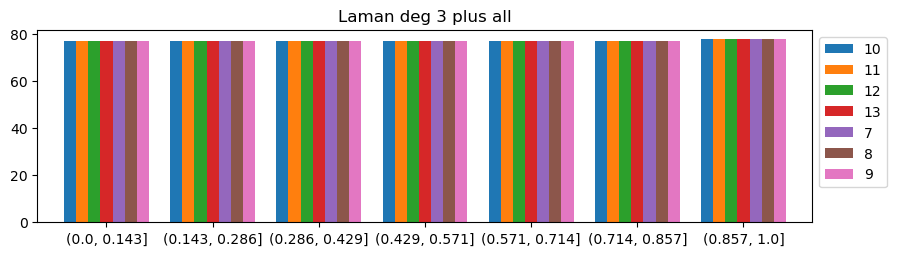

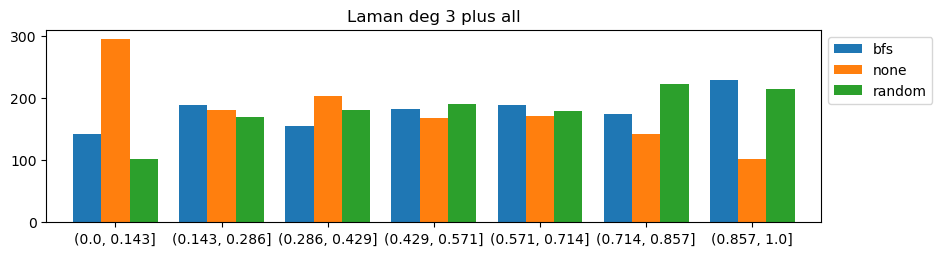

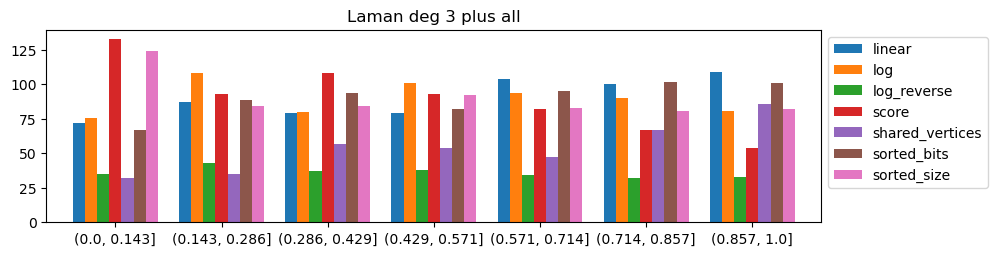

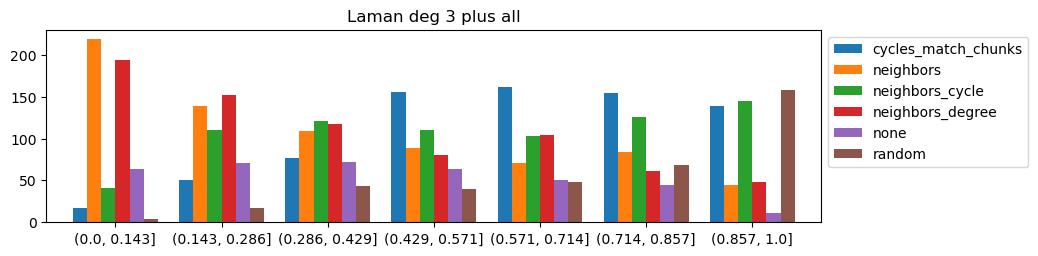

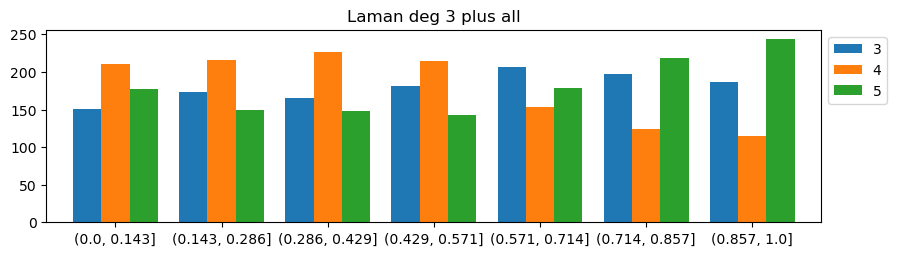

In [21]:
input = """
--------------------------------------------------------------------------------
Name (time in ms)                                                                                  Min                 Max                Mean              StdDev              Median                 IQR            Outliers      OPS            Rounds  Iterations
--------------------------------------------------------------------------------

test_LamanDeg3PlusAll[7-12-none-subgraphs-linear-neighbors-3-smart]                            59.4588 (1.0)       62.2735 (1.0)       61.2063 (1.0)        1.5257 (60.54)     61.8865 (1.00)       2.1111 (60.52)         1;0  16.3382 (1.0)           3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-linear-neighbors-3-smart]                        60.7143 (1.01)      62.0924 (1.00)      61.2468 (1.0)        0.7404 (18.34)     60.9339 (1.0)        1.0335 (18.14)         1;0  16.3274 (1.0)           3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_size-neighbors-3-smart]                   60.6768 (1.01)      62.0251 (1.0)       61.5691 (1.01)       0.7729 (19.15)     62.0054 (1.02)       1.0113 (17.75)         1;0  16.2419 (0.99)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-score-neighbors-3-smart]                             61.1502 (1.03)      62.2944 (1.00)      61.7564 (1.01)       0.5752 (22.82)     61.8247 (1.0)        0.8582 (24.60)         1;0  16.1926 (0.99)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-linear-neighbors_cycle-3-smart]                  60.5851 (1.01)      64.0583 (1.03)      62.0314 (1.01)       1.8079 (44.79)     61.4508 (1.01)       2.6048 (45.72)         1;0  16.1209 (0.99)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-log_reverse-neighbors-3-smart]                   61.1497 (1.01)      63.3921 (1.02)      62.2575 (1.02)       1.1214 (27.78)     62.2308 (1.02)       1.6818 (29.52)         1;0  16.0623 (0.98)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-log-neighbors_degree-3-smart]                    61.5954 (1.02)      63.1548 (1.02)      62.3490 (1.02)       0.7810 (19.35)     62.2968 (1.02)       1.1695 (20.53)         1;0  16.0388 (0.98)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-score-neighbors-3-smart]                         60.9130 (1.01)      64.5973 (1.04)      62.3771 (1.02)       1.9550 (48.44)     61.6212 (1.01)       2.7632 (48.50)         1;0  16.0315 (0.98)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-score-neighbors_degree-3-smart]                  61.2766 (1.02)      63.1453 (1.02)      62.3850 (1.02)       0.9818 (24.32)     62.7329 (1.03)       1.4016 (24.60)         1;0  16.0295 (0.98)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_size-neighbors_degree-3-smart]            60.8285 (1.01)      63.7752 (1.03)      62.4259 (1.02)       1.4889 (36.89)     62.6741 (1.03)       2.2100 (38.79)         1;0  16.0190 (0.98)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-score-neighbors_cycle-3-smart]                   60.2467 (1.0)       64.0111 (1.03)      62.4748 (1.02)       1.9752 (48.94)     63.1664 (1.04)       2.8233 (49.55)         1;0  16.0065 (0.98)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-log-neighbors-3-smart]                           60.5512 (1.01)      64.8181 (1.05)      62.5277 (1.02)       2.1507 (53.28)     62.2139 (1.02)       3.2001 (56.17)         1;0  15.9929 (0.98)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_bits-neighbors-3-smart]                   62.1217 (1.03)      63.1020 (1.02)      62.5806 (1.02)       0.4931 (12.22)     62.5181 (1.03)       0.7352 (12.90)         1;0  15.9794 (0.98)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-log-neighbors_cycle-3-smart]                     62.5287 (1.04)      62.6398 (1.01)      62.5819 (1.02)       0.0557 (1.38)      62.5773 (1.03)       0.0833 (1.46)          1;0  15.9791 (0.98)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-score-neighbors_degree-3-smart]                      61.9752 (1.04)      63.6200 (1.02)      62.6377 (1.02)       0.8678 (34.44)     62.3178 (1.01)       1.2336 (35.37)         1;0  15.9648 (0.98)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-score-neighbors-3-smart]                       60.4279 (1.00)      65.9169 (1.06)      62.6899 (1.02)       2.8689 (71.08)     61.7249 (1.01)       4.1168 (72.26)         1;0  15.9515 (0.98)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_size-neighbors-3-smart]                 62.2664 (1.03)      63.2160 (1.02)      62.8707 (1.03)       0.5251 (13.01)     63.1298 (1.04)       0.7122 (12.50)         1;0  15.9056 (0.97)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-log_reverse-neighbors_degree-3-smart]            62.5975 (1.04)      63.0946 (1.02)      62.8842 (1.03)       0.2572 (6.37)      62.9606 (1.03)       0.3729 (6.54)          1;0  15.9022 (0.97)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-score-neighbors_degree-3-smart]                62.1158 (1.03)      64.0808 (1.03)      62.9804 (1.03)       1.0035 (24.86)     62.7446 (1.03)       1.4737 (25.87)         1;0  15.8780 (0.97)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_bits-neighbors_degree-3-smart]            61.0523 (1.01)      64.6006 (1.04)      63.0398 (1.03)       1.8122 (44.90)     63.4665 (1.04)       2.6612 (46.71)         1;0  15.8630 (0.97)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-log-neighbors_degree-3-smart]                     62.7997 (1.04)      63.3197 (1.02)      63.0792 (1.03)       0.2622 (6.50)      63.1182 (1.04)       0.3901 (6.85)          1;0  15.8531 (0.97)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_size-neighbors_degree-3-smart]          61.6659 (1.02)      64.0887 (1.03)      63.1213 (1.03)       1.2830 (31.79)     63.6093 (1.04)       1.8171 (31.89)         1;0  15.8425 (0.97)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-log-neighbors-3-smart]                               62.4809 (1.05)      63.8788 (1.03)      63.1433 (1.03)       0.7018 (27.85)     63.0703 (1.02)       1.0484 (30.06)         1;0  15.8370 (0.97)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-log-neighbors_degree-3-smart]                        62.3446 (1.05)      64.1359 (1.03)      63.1798 (1.03)       0.9018 (35.78)     63.0588 (1.02)       1.3435 (38.51)         1;0  15.8279 (0.97)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_size-neighbors_cycle-3-smart]                  61.8265 (1.04)      65.3807 (1.05)      63.2813 (1.03)       1.8627 (73.91)     62.6368 (1.01)       2.6656 (76.42)         1;0  15.8024 (0.97)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_bits-neighbors_cycle-3-smart]             62.2976 (1.03)      64.6304 (1.04)      63.3024 (1.03)       1.1995 (29.72)     62.9790 (1.03)       1.7496 (30.71)         1;0  15.7972 (0.97)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-linear-neighbors_cycle-3-smart]                      61.8449 (1.04)      64.6104 (1.04)      63.3538 (1.04)       1.3999 (55.55)     63.6060 (1.03)       2.0741 (59.46)         1;0  15.7844 (0.97)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_bits-neighbors_degree-3-smart]                62.7234 (1.05)      64.2223 (1.03)      63.3922 (1.04)       0.7624 (30.25)     63.2310 (1.02)       1.1242 (32.23)         1;0  15.7748 (0.97)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_bits-neighbors-3-smart]                 61.7907 (1.03)      65.2772 (1.05)      63.4904 (1.04)       1.7449 (43.23)     63.4032 (1.04)       2.6149 (45.90)         1;0  15.7504 (0.96)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-log-cycles_match_chunks-3-smart]                 62.8623 (1.04)      64.0945 (1.03)      63.5897 (1.04)       0.6456 (15.99)     63.8122 (1.05)       0.9242 (16.22)         1;0  15.7258 (0.96)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_size-neighbors_degree-3-smart]                 63.1728 (1.06)      64.1746 (1.03)      63.6650 (1.04)       0.5011 (19.88)     63.6475 (1.03)       0.7513 (21.54)         1;0  15.7072 (0.96)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_size-neighbors-3-smart]                        62.5928 (1.05)      65.4732 (1.05)      63.7499 (1.04)       1.5214 (60.37)     63.1838 (1.02)       2.1603 (61.93)         1;0  15.6863 (0.96)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-score-neighbors_cycle-3-smart]                 62.6924 (1.04)      65.1282 (1.05)      63.7571 (1.04)       1.2465 (30.88)     63.4505 (1.04)       1.8268 (32.06)         1;0  15.6845 (0.96)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-score-cycles_match_chunks-3-smart]               63.1524 (1.05)      64.9874 (1.05)      63.7897 (1.04)       1.0380 (25.72)     63.2292 (1.04)       1.3763 (24.16)         1;0  15.6765 (0.96)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-log_reverse-neighbors-3-smart]                 63.0946 (1.05)      64.7884 (1.04)      64.0329 (1.05)       0.8616 (21.35)     64.2157 (1.05)       1.2704 (22.30)         1;0  15.6170 (0.96)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_size-neighbors-3-smart]                     62.4959 (1.05)      65.2726 (1.05)      64.1263 (1.05)       1.4503 (57.55)     64.6105 (1.05)       2.0825 (59.70)         1;0  15.5942 (0.95)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-log_reverse-neighbors_cycle-3-smart]             61.3985 (1.02)      67.4161 (1.09)      64.1300 (1.05)       3.0469 (75.49)     63.5755 (1.04)       4.5132 (79.22)         1;0  15.5933 (0.96)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-log_reverse-cycles_match_chunks-3-smart]         63.7313 (1.06)      64.6650 (1.04)      64.1484 (1.05)       0.4747 (11.76)     64.0488 (1.05)       0.7003 (12.29)         1;0  15.5889 (0.95)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_bits-neighbors_cycle-3-smart]                 63.6973 (1.07)      64.8856 (1.04)      64.1747 (1.05)       0.6276 (24.90)     63.9413 (1.03)       0.8913 (25.55)         1;0  15.5825 (0.95)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-linear-neighbors-3-smart]                          63.3730 (1.07)      65.2519 (1.05)      64.2177 (1.05)       0.9537 (37.84)     64.0282 (1.04)       1.4091 (40.40)         1;0  15.5720 (0.95)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-score-neighbors-3-smart]                           61.3507 (1.03)      66.4039 (1.07)      64.2411 (1.05)       2.6040 (103.33)    64.9688 (1.05)       3.7899 (108.65)        1;0  15.5663 (0.95)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-linear-neighbors_degree-3-smart]                     63.9418 (1.08)      64.5340 (1.04)      64.3229 (1.05)       0.3306 (13.12)     64.4928 (1.04)       0.4441 (12.73)         1;0  15.5466 (0.95)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-log-neighbors-3-smart]                         63.0207 (1.05)      65.9422 (1.06)      64.3299 (1.05)       1.4842 (36.77)     64.0267 (1.05)       2.1912 (38.46)         1;0  15.5449 (0.95)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-score-neighbors_cycle-3-smart]                       62.5327 (1.05)      67.5190 (1.08)      64.4758 (1.05)       2.6690 (105.91)    63.3757 (1.03)       3.7398 (107.21)        1;0  15.5097 (0.95)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_size-neighbors_cycle-3-smart]           62.4721 (1.04)      65.5915 (1.06)      64.5096 (1.05)       1.7656 (43.74)     65.4652 (1.07)       2.3395 (41.06)         1;0  15.5016 (0.95)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-linear-cycles_match_chunks-3-smart]                  63.2179 (1.06)      65.8251 (1.06)      64.5758 (1.06)       1.3070 (51.86)     64.6844 (1.05)       1.9554 (56.06)         1;0  15.4857 (0.95)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-score-none-3-smart]                                   62.9379 (1.06)      66.9928 (1.08)      64.6382 (1.06)       2.1051 (83.53)     63.9840 (1.03)       3.0411 (87.18)         1;0  15.4707 (0.95)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-log-neighbors_cycle-3-smart]                         63.8979 (1.07)      66.0124 (1.06)      64.6428 (1.06)       1.1877 (47.13)     64.0179 (1.04)       1.5859 (45.46)         1;0  15.4696 (0.95)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-score-neighbors_cycle-3-smart]                    61.8226 (1.03)      68.6315 (1.11)      64.8633 (1.06)       3.4623 (85.78)     64.1356 (1.05)       5.1067 (89.63)         1;0  15.4170 (0.94)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_size-neighbors_degree-3-smart]              64.2859 (1.08)      65.2928 (1.05)      64.9113 (1.06)       0.5460 (21.67)     65.1553 (1.05)       0.7552 (21.65)         1;0  15.4056 (0.94)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_size-neighbors_cycle-3-smart]                 64.5425 (1.09)      65.7011 (1.06)      64.9313 (1.06)       0.6667 (26.45)     64.5503 (1.04)       0.8689 (24.91)         1;0  15.4009 (0.94)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-shared_vertices-neighbors-3-smart]                   62.8187 (1.06)      67.1801 (1.08)      64.9865 (1.06)       2.1808 (86.54)     64.9608 (1.05)       3.2711 (93.77)         1;0  15.3878 (0.94)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-log-neighbors-3-smart]                             62.8062 (1.06)      66.4585 (1.07)      64.9910 (1.06)       1.9289 (76.54)     65.7083 (1.06)       2.7392 (78.53)         1;0  15.3868 (0.94)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_bits-neighbors_degree-3-smart]             64.3988 (1.07)      65.4712 (1.06)      65.0184 (1.06)       0.5553 (13.76)     65.1852 (1.07)       0.8043 (14.12)         1;0  15.3803 (0.94)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-shared_vertices-neighbors-3-smart]                 64.0674 (1.08)      65.9665 (1.06)      65.0427 (1.06)       0.9506 (37.72)     65.0941 (1.05)       1.4244 (40.83)         1;0  15.3745 (0.94)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-score-neighbors_cycle-3-smart]                        64.0108 (1.08)      67.0104 (1.08)      65.0647 (1.06)       1.6870 (66.94)     64.1729 (1.04)       2.2497 (64.49)         1;0  15.3693 (0.94)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-score-neighbors_degree-3-smart]                   62.9179 (1.04)      67.2440 (1.08)      65.0763 (1.06)       2.1630 (53.59)     65.0670 (1.07)       3.2445 (56.95)         1;0  15.3666 (0.94)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-log-cycles_match_chunks-3-smart]                     64.5276 (1.09)      65.7599 (1.06)      65.1110 (1.06)       0.6187 (24.55)     65.0456 (1.05)       0.9242 (26.50)         1;0  15.3584 (0.94)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-linear-neighbors-3-smart]                         64.2884 (1.07)      66.1138 (1.07)      65.1621 (1.06)       0.9152 (22.67)     65.0840 (1.07)       1.3690 (24.03)         1;0  15.3464 (0.94)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_size-neighbors_cycle-3-smart]              62.3536 (1.03)      67.3622 (1.09)      65.1766 (1.06)       2.5644 (63.53)     65.8139 (1.08)       3.7565 (65.93)         1;0  15.3429 (0.94)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_bits-neighbors-3-smart]                     64.4250 (1.08)      66.1758 (1.06)      65.2040 (1.07)       0.8912 (35.36)     65.0112 (1.05)       1.3131 (37.64)         1;0  15.3365 (0.94)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-linear-neighbors_degree-3-smart]                  63.4733 (1.05)      67.8415 (1.09)      65.3741 (1.07)       2.2386 (55.46)     64.8074 (1.06)       3.2762 (57.50)         1;0  15.2966 (0.94)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_size-none-3-smart]                             62.4831 (1.05)      68.4180 (1.10)      65.4875 (1.07)       2.9681 (117.78)    65.5614 (1.06)       4.4512 (127.60)        1;0  15.2701 (0.93)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-shared_vertices-neighbors_degree-3-smart]             65.1206 (1.10)      65.8296 (1.06)      65.5005 (1.07)       0.3572 (14.18)     65.5513 (1.06)       0.5318 (15.25)         1;0  15.2671 (0.93)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_size-cycles_match_chunks-3-smart]              64.9324 (1.09)      66.1404 (1.06)      65.5733 (1.07)       0.6074 (24.10)     65.6472 (1.06)       0.9060 (25.97)         1;0  15.2501 (0.93)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_size-cycles_match_chunks-3-smart]       64.4044 (1.07)      67.1289 (1.08)      65.5950 (1.07)       1.3943 (34.54)     65.2518 (1.07)       2.0434 (35.86)         1;0  15.2451 (0.93)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-shared_vertices-neighbors_cycle-3-smart]             64.1198 (1.08)      67.6571 (1.09)      65.6120 (1.07)       1.8324 (72.71)     65.0590 (1.05)       2.6530 (76.06)         1;0  15.2411 (0.93)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-score-neighbors-3-smart]                          64.3719 (1.07)      67.2847 (1.08)      65.6140 (1.07)       1.5030 (37.24)     65.1852 (1.07)       2.1846 (38.34)         1;0  15.2407 (0.93)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-score-cycles_match_chunks-3-smart]                   65.1640 (1.10)      66.3449 (1.07)      65.6186 (1.07)       0.6356 (25.22)     65.3470 (1.06)       0.8857 (25.39)         1;0  15.2396 (0.93)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-linear-neighbors_degree-3-smart]               64.8871 (1.08)      66.9455 (1.08)      65.7248 (1.07)       1.0813 (26.79)     65.3417 (1.07)       1.5438 (27.10)         1;0  15.2150 (0.93)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_size-neighbors-3-smart]                    62.9797 (1.05)      68.3133 (1.10)      65.8822 (1.08)       2.6978 (66.84)     66.3535 (1.09)       4.0002 (70.21)         1;0  15.1786 (0.93)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-linear-neighbors_degree-3-smart]                 65.7054 (1.09)      66.0296 (1.06)      65.9058 (1.08)       0.1752 (4.34)      65.9824 (1.08)       0.2432 (4.27)          1;0  15.1732 (0.93)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-shared_vertices-cycles_match_chunks-3-smart]         65.1520 (1.10)      67.0211 (1.08)      65.9270 (1.08)       0.9745 (38.67)     65.6078 (1.06)       1.4018 (40.19)         1;0  15.1683 (0.93)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-log_reverse-neighbors_cycle-3-smart]           64.6806 (1.07)      67.3245 (1.09)      65.9672 (1.08)       1.3234 (32.79)     65.8967 (1.08)       1.9829 (34.80)         1;0  15.1590 (0.93)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_bits-neighbors_cycle-3-smart]              65.3658 (1.08)      66.9194 (1.08)      65.9947 (1.08)       0.8180 (20.26)     65.6989 (1.08)       1.1652 (20.45)         1;0  15.1527 (0.93)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_bits-cycles_match_chunks-3-smart]             64.4430 (1.08)      68.2941 (1.10)      65.9993 (1.08)       2.0290 (80.51)     65.2607 (1.06)       2.8883 (82.80)         1;0  15.1517 (0.93)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-shared_vertices-neighbors_degree-3-smart]            64.9782 (1.09)      68.1255 (1.09)      66.0982 (1.08)       1.7589 (69.79)     65.1910 (1.05)       2.3604 (67.67)         1;0  15.1290 (0.93)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-score-cycles_match_chunks-3-smart]             65.1723 (1.08)      67.8002 (1.09)      66.1059 (1.08)       1.4698 (36.41)     65.3453 (1.07)       1.9709 (34.59)         1;0  15.1272 (0.93)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-log_reverse-neighbors_degree-3-smart]          64.8646 (1.08)      67.4226 (1.09)      66.1493 (1.08)       1.2790 (31.69)     66.1607 (1.09)       1.9185 (33.67)         1;0  15.1173 (0.93)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-log-neighbors_cycle-3-smart]                      64.5851 (1.07)      68.8729 (1.11)      66.2230 (1.08)       2.3161 (57.38)     65.2110 (1.07)       3.2159 (56.44)         1;0  15.1005 (0.92)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_bits-neighbors_degree-3-smart]              64.7439 (1.09)      67.7905 (1.09)      66.3370 (1.08)       1.5281 (60.64)     66.4766 (1.08)       2.2849 (65.50)         1;0  15.0745 (0.92)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-linear-neighbors_degree-3-smart]                   65.1534 (1.10)      67.3250 (1.08)      66.3636 (1.08)       1.1069 (43.93)     66.6124 (1.08)       1.6287 (46.69)         1;0  15.0685 (0.92)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_size-neighbors_cycle-3-smart]               64.1063 (1.08)      69.6429 (1.12)      66.4110 (1.09)       2.8824 (114.38)    65.4838 (1.06)       4.1524 (119.04)        1;0  15.0577 (0.92)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-log_reverse-cycles_match_chunks-3-smart]          65.0456 (1.08)      68.5587 (1.11)      66.4154 (1.08)       1.8800 (46.58)     65.6417 (1.08)       2.6349 (46.25)         1;0  15.0568 (0.92)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_bits-neighbors_cycle-3-smart]           64.2509 (1.07)      68.1024 (1.10)      66.4614 (1.09)       1.9879 (49.25)     67.0309 (1.10)       2.8886 (50.70)         1;0  15.0463 (0.92)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-log-neighbors_cycle-3-smart]                   64.9670 (1.08)      68.3251 (1.10)      66.5293 (1.09)       1.6912 (41.90)     66.2956 (1.09)       2.5186 (44.21)         1;0  15.0310 (0.92)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-linear-neighbors_cycle-3-smart]                   64.9531 (1.08)      69.4083 (1.12)      66.7202 (1.09)       2.3661 (58.62)     65.7991 (1.08)       3.3414 (58.65)         1;0  14.9880 (0.92)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-score-cycles_match_chunks-3-smart]                66.1076 (1.10)      67.5001 (1.09)      66.7521 (1.09)       0.7020 (17.39)     66.6487 (1.09)       1.0444 (18.33)         1;0  14.9808 (0.92)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-linear-neighbors_cycle-3-smart]                66.2468 (1.10)      67.6150 (1.09)      66.7938 (1.09)       0.7241 (17.94)     66.5197 (1.09)       1.0261 (18.01)         1;0  14.9714 (0.92)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_bits-neighbors-3-smart]                       65.9054 (1.11)      68.6543 (1.10)      66.9193 (1.09)       1.5097 (59.91)     66.1982 (1.07)       2.0616 (59.10)         1;0  14.9434 (0.91)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-log-neighbors_degree-3-smart]                         65.8008 (1.11)      68.8286 (1.11)      67.0749 (1.10)       1.5699 (62.29)     66.5951 (1.08)       2.2709 (65.10)         1;0  14.9087 (0.91)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-score-neighbors_degree-3-smart]                    65.6148 (1.10)      68.5620 (1.10)      67.1368 (1.10)       1.4760 (58.57)     67.2336 (1.09)       2.2104 (63.37)         1;0  14.8950 (0.91)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-log-neighbors_degree-3-smart]                      63.5414 (1.07)      70.3882 (1.13)      67.1489 (1.10)       3.4382 (136.43)    67.5169 (1.09)       5.1351 (147.21)        1;0  14.8923 (0.91)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-linear-cycles_match_chunks-3-smart]              62.3250 (1.03)      76.1797 (1.23)      67.1526 (1.10)       7.8240 (193.84)    62.9530 (1.03)      10.3910 (182.38)        1;0  14.8915 (0.91)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-score-cycles_match_chunks-3-smart]                    65.3144 (1.10)      68.2293 (1.10)      67.2187 (1.10)       1.6502 (65.48)     68.1124 (1.10)       2.1862 (62.67)         1;0  14.8768 (0.91)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-shared_vertices-neighbors_cycle-3-smart]              65.5319 (1.10)      70.7610 (1.14)      67.2878 (1.10)       3.0080 (119.36)    65.5704 (1.06)       3.9218 (112.43)        1;0  14.8615 (0.91)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_size-cycles_match_chunks-3-smart]           66.9732 (1.13)      68.0015 (1.09)      67.3792 (1.10)       0.5473 (21.72)     67.1628 (1.09)       0.7713 (22.11)         1;0  14.8414 (0.91)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_bits-neighbors_degree-3-smart]                 66.1624 (1.11)      68.9181 (1.11)      67.3812 (1.10)       1.4051 (55.76)     67.0632 (1.08)       2.0668 (59.25)         1;0  14.8409 (0.91)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-score-none-3-smart]                                  66.3507 (1.12)      69.5963 (1.12)      67.4922 (1.10)       1.8244 (72.39)     66.5296 (1.08)       2.4342 (69.78)         1;0  14.8165 (0.91)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_size-neighbors-3-smart]                       65.1686 (1.10)      69.5219 (1.12)      67.5315 (1.10)       2.2004 (87.31)     67.9039 (1.10)       3.2650 (93.60)         1;0  14.8079 (0.91)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_size-cycles_match_chunks-3-smart]             65.3581 (1.10)      70.8458 (1.14)      67.5416 (1.10)       2.9105 (115.49)    66.4209 (1.07)       4.1158 (117.99)        1;0  14.8057 (0.91)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-linear-cycles_match_chunks-3-smart]            66.8835 (1.11)      68.8864 (1.11)      67.5956 (1.10)       1.1199 (27.74)     67.0168 (1.10)       1.5022 (26.37)         1;0  14.7939 (0.91)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-log-cycles_match_chunks-3-smart]               66.4163 (1.10)      68.6299 (1.11)      67.7190 (1.11)       1.1576 (28.68)     68.1109 (1.12)       1.6602 (29.14)         1;0  14.7669 (0.90)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-log-none-3-smart]                                    66.0609 (1.11)      70.4457 (1.13)      67.7306 (1.11)       2.3720 (94.12)     66.6852 (1.08)       3.2886 (94.28)         1;0  14.7644 (0.90)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-log-neighbors_degree-3-smart]                  67.4464 (1.12)      68.0300 (1.10)      67.7898 (1.11)       0.3052 (7.56)      67.8930 (1.11)       0.4377 (7.68)          1;0  14.7515 (0.90)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_size-neighbors_degree-3-smart]             66.0786 (1.10)      70.7222 (1.14)      67.8891 (1.11)       2.4850 (61.56)     66.8665 (1.10)       3.4827 (61.13)         1;0  14.7299 (0.90)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_size-cycles_match_chunks-3-smart]         65.0899 (1.08)      69.5654 (1.12)      67.9037 (1.11)       2.4501 (60.70)     69.0558 (1.13)       3.3566 (58.91)         1;0  14.7267 (0.90)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_size-neighbors_degree-3-smart]                66.7171 (1.12)      69.1578 (1.11)      67.9765 (1.11)       1.2222 (48.50)     68.0545 (1.10)       1.8306 (52.48)         1;0  14.7110 (0.90)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-linear-neighbors-3-smart]                             65.8522 (1.11)      70.1914 (1.13)      68.0529 (1.11)       2.1703 (86.12)     68.1152 (1.10)       3.2544 (93.30)         1;0  14.6944 (0.90)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-log-neighbors_cycle-3-smart]                       65.3300 (1.10)      70.2448 (1.13)      68.1612 (1.11)       2.5413 (100.84)    68.9087 (1.11)       3.6861 (105.67)        1;0  14.6711 (0.90)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_size-none-3-smart]                            65.6282 (1.10)      69.7639 (1.12)      68.1951 (1.11)       2.2412 (88.94)     69.1931 (1.12)       3.1018 (88.92)         1;0  14.6638 (0.90)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-linear-none-3-smart]                                  65.9997 (1.11)      70.1382 (1.13)      68.3089 (1.12)       2.1105 (83.75)     68.7888 (1.11)       3.1038 (88.98)         1;0  14.6394 (0.90)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-log-cycles_match_chunks-3-smart]                   67.2512 (1.13)      70.6720 (1.13)      68.6105 (1.12)       1.8153 (72.03)     67.9083 (1.10)       2.5656 (73.55)         1;0  14.5750 (0.89)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-linear-neighbors_cycle-3-smart]                    67.7524 (1.14)      69.9727 (1.12)      68.6237 (1.12)       1.1847 (47.01)     68.1459 (1.10)       1.6652 (47.74)         1;0  14.5722 (0.89)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-linear-cycles_match_chunks-3-smart]               67.5589 (1.12)      69.4184 (1.12)      68.6707 (1.12)       0.9818 (24.32)     69.0347 (1.13)       1.3947 (24.48)         1;0  14.5623 (0.89)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_bits-cycles_match_chunks-3-smart]           66.3606 (1.12)      71.1930 (1.14)      68.6779 (1.12)       2.4223 (96.12)     68.4801 (1.11)       3.6243 (103.90)        1;0  14.5607 (0.89)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_bits-cycles_match_chunks-3-smart]       67.4883 (1.12)      70.5105 (1.14)      68.7900 (1.12)       1.5540 (38.50)     68.3712 (1.12)       2.2666 (39.78)         1;0  14.5370 (0.89)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-linear-neighbors_cycle-3-smart]                       68.2227 (1.15)      69.9789 (1.12)      68.8635 (1.13)       0.9696 (38.47)     68.3889 (1.11)       1.3172 (37.76)         1;0  14.5215 (0.89)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_bits-neighbors-3-smart]                    66.4730 (1.10)      71.6848 (1.16)      68.8700 (1.12)       2.6309 (65.18)     68.4524 (1.12)       3.9089 (68.61)         1;0  14.5201 (0.89)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-log-none-3-smart]                                  67.9076 (1.14)      70.7252 (1.14)      68.9286 (1.13)       1.5607 (61.93)     68.1530 (1.10)       2.1132 (60.58)         1;0  14.5078 (0.89)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-linear-cycles_match_chunks-3-smart]                67.8949 (1.14)      70.0043 (1.12)      68.9817 (1.13)       1.0561 (41.91)     69.0459 (1.12)       1.5820 (45.35)         1;0  14.4966 (0.89)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_bits-neighbors_degree-3-smart]          62.9817 (1.05)      74.4799 (1.20)      68.9872 (1.13)       5.7662 (142.86)    69.4999 (1.14)       8.6236 (151.36)        1;0  14.4955 (0.89)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-shared_vertices-neighbors_degree-3-smart]          66.4802 (1.12)      70.6527 (1.13)      69.0175 (1.13)       2.2277 (88.40)     69.9196 (1.13)       3.1294 (89.71)         1;0  14.4891 (0.89)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-score-none-3-smart]                                67.6636 (1.14)      70.2649 (1.13)      69.0777 (1.13)       1.3154 (52.20)     69.3047 (1.12)       1.9510 (55.93)         1;0  14.4764 (0.89)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_bits-neighbors-3-smart]                        66.7679 (1.12)      71.7395 (1.15)      69.1384 (1.13)       2.4938 (98.96)     68.9080 (1.11)       3.7287 (106.89)        1;0  14.4637 (0.89)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_size-cycles_match_chunks-3-smart]          65.8956 (1.09)      73.0154 (1.18)      69.3418 (1.13)       3.5653 (88.33)     69.1145 (1.13)       5.3399 (93.72)         1;0  14.4213 (0.88)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-log_reverse-neighbors-3-smart]                    68.6082 (1.14)      70.5659 (1.14)      69.3931 (1.13)       1.0349 (25.64)     69.0051 (1.13)       1.4683 (25.77)         1;0  14.4107 (0.88)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-linear-neighbors_degree-3-smart]                      68.9367 (1.16)      69.8435 (1.12)      69.4173 (1.13)       0.4559 (18.09)     69.4717 (1.12)       0.6802 (19.50)         1;0  14.4056 (0.88)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_size-random-3-smart]                          67.2851 (1.13)      71.6388 (1.15)      69.4527 (1.13)       2.1769 (86.38)     69.4342 (1.12)       3.2653 (93.61)         1;0  14.3983 (0.88)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_size-none-3-smart]                          66.9797 (1.13)      74.3762 (1.19)      69.8231 (1.14)       3.9837 (158.08)    68.1133 (1.10)       5.5474 (159.03)        1;0  14.3219 (0.88)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-log-cycles_match_chunks-3-smart]                      67.6520 (1.14)      73.7930 (1.18)      69.8439 (1.14)       3.4269 (135.98)    68.0868 (1.10)       4.6057 (132.04)        1;0  14.3176 (0.88)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-score-neighbors-3-smart]                              67.3763 (1.13)      73.0521 (1.17)      69.8654 (1.14)       2.9015 (115.13)    69.1679 (1.12)       4.2568 (122.03)        1;0  14.3132 (0.88)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-score-random-3-smart]                                67.6305 (1.14)      73.5649 (1.18)      70.0628 (1.14)       3.1085 (123.35)    68.9929 (1.12)       4.4508 (127.59)        1;0  14.2729 (0.87)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-shared_vertices-none-3-smart]                         68.3870 (1.15)      71.4063 (1.15)      70.0727 (1.14)       1.5401 (61.11)     70.4249 (1.14)       2.2644 (64.92)         1;0  14.2709 (0.87)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_bits-random-3-smart]                          68.4560 (1.15)      71.2858 (1.14)      70.1014 (1.15)       1.4702 (58.34)     70.5626 (1.14)       2.1224 (60.84)         1;0  14.2650 (0.87)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-log_reverse-neighbors_degree-3-smart]             68.6650 (1.14)      71.5342 (1.15)      70.1109 (1.14)       1.4347 (35.54)     70.1335 (1.15)       2.1519 (37.77)         1;0  14.2631 (0.87)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-score-random-3-smart]                                 68.5611 (1.15)      72.7080 (1.17)      70.1244 (1.15)       2.2539 (89.44)     69.1041 (1.12)       3.1102 (89.16)         1;0  14.2604 (0.87)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-log-neighbors-3-smart]                                67.3517 (1.13)      72.8975 (1.17)      70.2292 (1.15)       2.7788 (110.27)    70.4384 (1.14)       4.1594 (119.24)        1;0  14.2391 (0.87)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_bits-none-3-smart]                            69.8653 (1.18)      70.6027 (1.13)      70.2383 (1.15)       0.3688 (14.63)     70.2470 (1.14)       0.5530 (15.85)         1;0  14.2372 (0.87)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-log-neighbors_cycle-3-smart]                          69.4738 (1.17)      71.5271 (1.15)      70.2668 (1.15)       1.1035 (43.79)     69.7996 (1.13)       1.5400 (44.15)         1;0  14.2315 (0.87)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-log_reverse-neighbors_cycle-3-smart]              68.9628 (1.14)      71.1269 (1.15)      70.3072 (1.15)       1.1736 (29.08)     70.8320 (1.16)       1.6231 (28.49)         1;0  14.2233 (0.87)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-linear-random-3-smart]                               69.4942 (1.17)      71.4837 (1.15)      70.5725 (1.15)       1.0052 (39.89)     70.7396 (1.14)       1.4921 (42.78)         1;0  14.1698 (0.87)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-log-cycles_match_chunks-3-smart]                  69.5191 (1.15)      72.4251 (1.17)      70.6234 (1.15)       1.5735 (38.98)     69.9258 (1.15)       2.1795 (38.25)         1;0  14.1596 (0.87)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-shared_vertices-neighbors-3-smart]                    68.8142 (1.16)      74.1625 (1.19)      70.9278 (1.16)       2.8449 (112.89)    69.8067 (1.13)       4.0112 (114.99)        1;0  14.0988 (0.86)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_bits-neighbors_cycle-3-smart]               67.3864 (1.13)      73.8848 (1.19)      71.0110 (1.16)       3.3136 (131.49)    71.7618 (1.16)       4.8738 (139.72)        1;0  14.0823 (0.86)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-log-none-3-smart]                                     68.5365 (1.15)      72.8100 (1.17)      71.0166 (1.16)       2.2180 (88.01)     71.7032 (1.16)       3.2051 (91.88)         1;0  14.0812 (0.86)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-shared_vertices-neighbors_cycle-3-smart]           70.2036 (1.18)      71.7750 (1.15)      71.0177 (1.16)       0.7873 (31.24)     71.0747 (1.15)       1.1786 (33.79)         1;0  14.0810 (0.86)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_bits-none-3-smart]                             69.6758 (1.17)      72.6660 (1.17)      71.0340 (1.16)       1.5138 (60.07)     70.7603 (1.14)       2.2427 (64.29)         1;0  14.0778 (0.86)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_bits-neighbors_cycle-3-smart]                  69.9238 (1.18)      72.0900 (1.16)      71.0730 (1.16)       1.0891 (43.22)     71.2051 (1.15)       1.6246 (46.57)         1;0  14.0700 (0.86)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-shared_vertices-random-3-smart]                      68.9054 (1.16)      75.0322 (1.20)      71.2876 (1.16)       3.2827 (130.26)    69.9253 (1.13)       4.5951 (131.73)        1;0  14.0277 (0.86)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_bits-cycles_match_chunks-3-smart]              67.4824 (1.13)      76.4747 (1.23)      71.3140 (1.17)       4.6412 (184.17)    69.9847 (1.13)       6.7442 (193.34)        1;0  14.0225 (0.86)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-score-neighbors_cycle-3-smart]                     68.0295 (1.14)      74.5962 (1.20)      71.3289 (1.17)       3.2835 (130.29)    71.3610 (1.15)       4.9250 (141.19)        1;0  14.0196 (0.86)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-linear-none-3-smart]                               70.7353 (1.19)      72.6859 (1.17)      71.5030 (1.17)       1.0395 (41.25)     71.0878 (1.15)       1.4630 (41.94)         1;0  13.9854 (0.86)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-linear-cycles_match_chunks-3-smart]                   70.5362 (1.19)      72.4069 (1.16)      71.5756 (1.17)       0.9526 (37.80)     71.7837 (1.16)       1.4031 (40.22)         1;0  13.9712 (0.86)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-score-cycles_match_chunks-3-smart]                 69.8466 (1.17)      73.7634 (1.18)      71.7642 (1.17)       1.9597 (77.76)     71.6827 (1.16)       2.9376 (84.21)         1;0  13.9345 (0.85)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-shared_vertices-none-3-smart]                        71.2154 (1.20)      72.3645 (1.16)      71.9325 (1.18)       0.6254 (24.82)     72.2177 (1.17)       0.8618 (24.71)         1;0  13.9019 (0.85)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_size-random-3-smart]                        70.3631 (1.18)      73.3810 (1.18)      71.9877 (1.18)       1.5221 (60.40)     72.2190 (1.17)       2.2634 (64.89)         1;0  13.8913 (0.85)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-shared_vertices-cycles_match_chunks-3-smart]       70.6933 (1.19)      73.4544 (1.18)      72.1554 (1.18)       1.3878 (55.07)     72.3185 (1.17)       2.0709 (59.37)         1;0  13.8590 (0.85)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-score-random-3-smart]                              70.5671 (1.19)      74.3697 (1.19)      72.3475 (1.18)       1.9128 (75.90)     72.1058 (1.17)       2.8519 (81.76)         1;0  13.8222 (0.85)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-score-neighbors_degree-3-smart]                       65.8522 (1.11)      82.3006 (1.32)      72.5563 (1.19)       8.6354 (342.67)    69.5159 (1.12)      12.3363 (353.65)        1;0  13.7824 (0.84)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-shared_vertices-cycles_match_chunks-3-smart]          69.2449 (1.16)      75.7130 (1.22)      72.8471 (1.19)       3.2963 (130.80)    73.5835 (1.19)       4.8511 (139.07)        1;0  13.7274 (0.84)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_size-neighbors_cycle-3-smart]             71.1575 (1.18)      74.8084 (1.21)      72.9971 (1.19)       1.8256 (45.23)     73.0253 (1.20)       2.7382 (48.06)         1;0  13.6992 (0.84)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-shared_vertices-none-3-smart]                      72.2082 (1.21)      74.8151 (1.20)      73.3742 (1.20)       1.3250 (52.58)     73.0992 (1.18)       1.9552 (56.05)         1;0  13.6288 (0.83)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-shared_vertices-random-3-smart]                       72.6580 (1.22)      75.4470 (1.21)      73.7170 (1.20)       1.5107 (59.95)     73.0461 (1.18)       2.0917 (59.96)         1;0  13.5654 (0.83)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_bits-none-3-smart]                          71.0394 (1.19)      78.4050 (1.26)      74.0105 (1.21)       3.8836 (154.11)    72.5872 (1.17)       5.5242 (158.37)        1;0  13.5116 (0.83)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-log-random-5-smart]                                  70.8762 (1.19)      76.6531 (1.23)      74.1133 (1.21)       2.9509 (117.10)    74.8107 (1.21)       4.3326 (124.21)        1;0  13.4929 (0.83)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-linear-random-3-smart]                             72.7769 (1.22)      74.9849 (1.20)      74.1453 (1.21)       1.1952 (47.43)     74.6742 (1.21)       1.6560 (47.47)         1;0  13.4870 (0.83)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-linear-neighbors-3-smart]                      72.8193 (1.21)      75.1993 (1.21)      74.3456 (1.21)       1.3249 (32.82)     75.0182 (1.23)       1.7850 (31.33)         1;0  13.4507 (0.82)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-log_reverse-cycles_match_chunks-3-smart]       70.7582 (1.17)      79.1273 (1.28)      74.7855 (1.22)       4.1934 (103.89)    74.4711 (1.22)       6.2768 (110.17)        1;0  13.3716 (0.82)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_bits-none-5-smart]                            74.9291 (1.26)      77.5074 (1.24)      75.8868 (1.24)       1.4112 (56.00)     75.2239 (1.22)       1.9337 (55.43)         1;0  13.1775 (0.81)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-shared_vertices-random-3-smart]                    74.1734 (1.25)      77.0336 (1.24)      75.9926 (1.24)       1.5810 (62.73)     76.7708 (1.24)       2.1452 (61.50)         1;0  13.1592 (0.81)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-score-none-4-smart]                                  75.0265 (1.26)      77.3896 (1.24)      76.0868 (1.24)       1.2000 (47.62)     75.8443 (1.23)       1.7723 (50.81)         1;0  13.1429 (0.80)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_size-random-3-smart]                           75.1413 (1.26)      77.5932 (1.25)      76.1482 (1.24)       1.2833 (50.92)     75.7100 (1.22)       1.8389 (52.72)         1;0  13.1323 (0.80)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_bits-none-4-smart]                            73.8688 (1.24)      77.9386 (1.25)      76.1519 (1.24)       2.0798 (82.53)     76.6483 (1.24)       3.0523 (87.50)         1;0  13.1317 (0.80)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-log-none-4-smart]                                    75.4824 (1.27)      77.5495 (1.25)      76.1774 (1.24)       1.1883 (47.15)     75.5003 (1.22)       1.5504 (44.45)         1;0  13.1273 (0.80)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-log-random-3-smart]                                  72.6745 (1.22)      79.0926 (1.27)      76.2224 (1.25)       3.2623 (129.45)    76.9001 (1.24)       4.8136 (137.99)        1;0  13.1195 (0.80)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_bits-cycles_match_chunks-3-smart]          75.5491 (1.25)      76.6578 (1.24)      76.2592 (1.25)       0.6165 (15.27)     76.5708 (1.26)       0.8315 (14.59)         1;0  13.1132 (0.80)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_bits-random-4-smart]                          74.9563 (1.26)      78.1545 (1.26)      76.3103 (1.25)       1.6544 (65.65)     75.8202 (1.23)       2.3986 (68.76)         1;0  13.1044 (0.80)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-linear-cycles_match_chunks-5-smart]              75.7739 (1.26)      77.3498 (1.25)      76.3724 (1.25)       0.8536 (21.15)     75.9935 (1.25)       1.1820 (20.75)         1;0  13.0937 (0.80)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-linear-neighbors-4-smart]                        75.5837 (1.25)      77.7022 (1.25)      76.4557 (1.25)       1.1078 (27.45)     76.0811 (1.25)       1.5889 (27.89)         1;0  13.0795 (0.80)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-linear-random-3-smart]                                72.0474 (1.21)      80.5119 (1.29)      76.4702 (1.25)       4.2451 (168.45)    76.8514 (1.24)       6.3484 (181.99)        1;0  13.0770 (0.80)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-linear-neighbors-4-smart]                            75.1112 (1.26)      77.5613 (1.25)      76.6270 (1.25)       1.3245 (52.56)     77.2085 (1.25)       1.8376 (52.68)         1;0  13.0502 (0.80)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-log-random-3-smart]                                   75.3241 (1.27)      78.8615 (1.27)      76.6487 (1.25)       1.9287 (76.53)     75.7606 (1.23)       2.6530 (76.06)         1;0  13.0465 (0.80)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-shared_vertices-random-5-smart]                      75.7794 (1.27)      77.1681 (1.24)      76.6528 (1.25)       0.7605 (30.18)     77.0109 (1.25)       1.0416 (29.86)         1;0  13.0458 (0.80)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_size-none-5-smart]                             76.2960 (1.28)      77.4509 (1.24)      76.6927 (1.25)       0.6568 (26.06)     76.3311 (1.23)       0.8661 (24.83)         1;0  13.0391 (0.80)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-linear-random-5-smart]                               75.3440 (1.27)      77.5761 (1.25)      76.7369 (1.25)       1.2147 (48.20)     77.2906 (1.25)       1.6741 (47.99)         1;0  13.0315 (0.80)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-score-none-5-smart]                                   75.6313 (1.27)      78.2106 (1.26)      76.7391 (1.25)       1.3275 (52.68)     76.3756 (1.24)       1.9345 (55.46)         1;0  13.0312 (0.80)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-linear-neighbors_degree-5-smart]                 75.8731 (1.26)      77.3453 (1.25)      76.8308 (1.25)       0.8302 (20.57)     77.2740 (1.27)       1.1041 (19.38)         1;0  13.0156 (0.80)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-score-neighbors-4-smart]                         75.8051 (1.26)      77.4098 (1.25)      76.8739 (1.26)       0.9256 (22.93)     77.4067 (1.27)       1.2035 (21.12)         1;0  13.0083 (0.80)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-linear-none-5-smart]                                 76.8125 (1.29)      77.3544 (1.24)      77.0159 (1.26)       0.2951 (11.71)     76.8807 (1.24)       0.4064 (11.65)         1;0  12.9843 (0.79)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-score-none-4-smart]                                   76.1066 (1.28)      78.5913 (1.26)      77.0282 (1.26)       1.3609 (54.00)     76.3867 (1.24)       1.8635 (53.42)         1;0  12.9823 (0.79)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-log-neighbors-4-smart]                           76.0866 (1.26)      78.0373 (1.26)      77.0303 (1.26)       0.9769 (24.20)     76.9672 (1.26)       1.4630 (25.68)         1;0  12.9819 (0.80)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-score-random-5-smart]                                75.7234 (1.27)      78.2023 (1.26)      77.0308 (1.26)       1.2450 (49.40)     77.1668 (1.25)       1.8592 (53.30)         1;0  12.9818 (0.79)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_size-none-4-smart]                            74.4368 (1.25)      78.6223 (1.26)      77.0792 (1.26)       2.2991 (91.23)     78.1786 (1.26)       3.1391 (89.99)         1;0  12.9737 (0.79)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-score-random-4-smart]                                75.2523 (1.27)      80.2062 (1.29)      77.0879 (1.26)       2.7147 (107.72)    75.8052 (1.23)       3.7155 (106.51)        1;0  12.9722 (0.79)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-log-neighbors_degree-5-smart]                    76.2685 (1.27)      77.5719 (1.25)      77.1372 (1.26)       0.7523 (18.64)     77.5712 (1.27)       0.9775 (17.16)         1;0  12.9639 (0.79)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_size-none-5-smart]                            75.7120 (1.27)      78.5509 (1.26)      77.2081 (1.26)       1.4256 (56.57)     77.3615 (1.25)       2.1291 (61.04)         1;0  12.9520 (0.79)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-score-none-4-smart]                                75.1137 (1.26)      79.2167 (1.27)      77.2281 (1.26)       2.0544 (81.52)     77.3540 (1.25)       3.0772 (88.22)         1;0  12.9486 (0.79)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-shared_vertices-random-4-smart]                      75.8434 (1.28)      78.4119 (1.26)      77.2426 (1.26)       1.2996 (51.57)     77.4723 (1.25)       1.9264 (55.23)         1;0  12.9462 (0.79)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-log-random-4-smart]                                  75.6189 (1.27)      78.6459 (1.26)      77.2686 (1.26)       1.5318 (60.78)     77.5411 (1.25)       2.2702 (65.08)         1;0  12.9419 (0.79)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_size-neighbors_degree-4-smart]            76.9116 (1.28)      77.6996 (1.25)      77.3256 (1.26)       0.3955 (9.80)      77.3656 (1.27)       0.5910 (10.37)         1;0  12.9323 (0.79)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-score-random-4-smart]                                 76.5647 (1.29)      78.4799 (1.26)      77.3374 (1.26)       1.0097 (40.07)     76.9677 (1.24)       1.4364 (41.18)         1;0  12.9304 (0.79)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-linear-neighbors_degree-4-smart]                     76.7592 (1.29)      78.0833 (1.25)      77.3861 (1.26)       0.6649 (26.38)     77.3157 (1.25)       0.9931 (28.47)         1;0  12.9222 (0.79)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-linear-random-4-smart]                               74.8966 (1.26)      81.7911 (1.31)      77.4222 (1.26)       3.7989 (150.75)    75.5788 (1.22)       5.1708 (148.24)        1;0  12.9162 (0.79)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_bits-neighbors-5-smart]                   76.5482 (1.27)      78.6693 (1.27)      77.4242 (1.26)       1.1077 (27.44)     77.0550 (1.26)       1.5908 (27.92)         1;0  12.9159 (0.79)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-score-none-5-smart]                                  76.1177 (1.28)      79.5083 (1.28)      77.4336 (1.27)       1.8182 (72.15)     76.6749 (1.24)       2.5430 (72.90)         1;0  12.9143 (0.79)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_bits-random-3-smart]                        76.2122 (1.28)      79.8124 (1.28)      77.4553 (1.27)       2.0424 (81.04)     76.3413 (1.23)       2.7002 (77.41)         1;0  12.9107 (0.79)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-log-neighbors-5-smart]                           76.3435 (1.27)      78.3732 (1.26)      77.5489 (1.27)       1.0672 (26.44)     77.9299 (1.28)       1.5223 (26.72)         1;0  12.8951 (0.79)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-log_reverse-cycles_match_chunks-5-smart]         77.2110 (1.28)      77.9072 (1.26)      77.5659 (1.27)       0.3483 (8.63)      77.5796 (1.27)       0.5221 (9.16)          1;0  12.8923 (0.79)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_bits-neighbors_degree-4-smart]            77.4027 (1.28)      77.9121 (1.26)      77.6095 (1.27)       0.2679 (6.64)      77.5138 (1.27)       0.3821 (6.71)          1;0  12.8850 (0.79)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-log-random-3-smart]                                76.3148 (1.28)      79.3778 (1.27)      77.6619 (1.27)       1.5645 (62.08)     77.2929 (1.25)       2.2973 (65.86)         1;0  12.8763 (0.79)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-linear-neighbors-5-smart]                        76.0924 (1.26)      78.8093 (1.27)      77.6878 (1.27)       1.4191 (35.16)     78.1618 (1.28)       2.0376 (35.76)         1;0  12.8720 (0.79)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-log_reverse-neighbors-5-smart]                   77.3539 (1.28)      78.3430 (1.26)      77.6927 (1.27)       0.5634 (13.96)     77.3812 (1.27)       0.7418 (13.02)         1;0  12.8712 (0.79)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_size-none-4-smart]                             76.9344 (1.29)      78.3502 (1.26)      77.8185 (1.27)       0.7709 (30.59)     78.1708 (1.26)       1.0619 (30.44)         1;0  12.8504 (0.79)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_bits-random-5-smart]                          76.2419 (1.28)      80.6562 (1.30)      77.8452 (1.27)       2.4424 (96.92)     76.6376 (1.24)       3.3107 (94.91)         1;0  12.8460 (0.79)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-score-random-5-smart]                                 76.5104 (1.29)      78.6272 (1.26)      77.8815 (1.27)       1.1890 (47.18)     78.5070 (1.27)       1.5876 (45.51)         1;0  12.8400 (0.79)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-shared_vertices-none-4-smart]                        75.7359 (1.27)      79.0719 (1.27)      77.9025 (1.27)       1.8783 (74.53)     78.8998 (1.28)       2.5020 (71.73)         1;0  12.8366 (0.79)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-linear-cycles_match_chunks-4-smart]              76.6039 (1.27)      78.6498 (1.27)      77.9255 (1.27)       1.1463 (28.40)     78.5229 (1.29)       1.5344 (26.93)         1;0  12.8328 (0.79)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-log-cycles_match_chunks-4-smart]                 77.2781 (1.28)      78.2856 (1.26)      77.9367 (1.27)       0.5707 (14.14)     78.2464 (1.28)       0.7556 (13.26)         1;0  12.8309 (0.79)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-score-neighbors_degree-4-smart]                  77.4997 (1.29)      78.9719 (1.27)      77.9920 (1.27)       0.8486 (21.02)     77.5045 (1.27)       1.1041 (19.38)         1;0  12.8218 (0.79)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_bits-neighbors_degree-5-smart]            76.8298 (1.28)      78.7116 (1.27)      78.0797 (1.27)       1.0824 (26.82)     78.6975 (1.29)       1.4114 (24.77)         1;0  12.8074 (0.78)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_bits-random-3-smart]                           77.1004 (1.30)      78.8241 (1.27)      78.0959 (1.28)       0.8924 (35.41)     78.3632 (1.27)       1.2927 (37.06)         1;0  12.8048 (0.78)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_size-random-5-smart]                           77.7379 (1.31)      78.4940 (1.26)      78.1145 (1.28)       0.3781 (15.00)     78.1116 (1.26)       0.5671 (16.26)         1;0  12.8017 (0.78)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-score-cycles_match_chunks-4-smart]               77.4542 (1.29)      78.8409 (1.27)      78.1152 (1.28)       0.6956 (17.23)     78.0505 (1.28)       1.0400 (18.25)         1;0  12.8016 (0.78)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-linear-random-5-smart]                             77.5292 (1.30)      78.8127 (1.27)      78.2095 (1.28)       0.6452 (25.60)     78.2867 (1.27)       0.9626 (27.60)         1;0  12.7862 (0.78)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-shared_vertices-none-5-smart]                        77.5789 (1.30)      79.3133 (1.27)      78.2111 (1.28)       0.9580 (38.01)     77.7412 (1.26)       1.3008 (37.29)         1;0  12.7859 (0.78)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-log_reverse-neighbors_degree-5-smart]            77.8241 (1.29)      78.6369 (1.27)      78.2253 (1.28)       0.4065 (10.07)     78.2150 (1.28)       0.6096 (10.70)         1;0  12.7836 (0.78)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_size-neighbors_degree-5-smart]            76.4688 (1.27)      80.6220 (1.30)      78.2436 (1.28)       2.1414 (53.05)     77.6400 (1.27)       3.1149 (54.67)         1;0  12.7806 (0.78)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_bits-neighbors-4-smart]                   77.1740 (1.28)      78.9799 (1.27)      78.2745 (1.28)       0.9656 (23.92)     78.6695 (1.29)       1.3544 (23.77)         1;0  12.7756 (0.78)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-linear-cycles_match_chunks-5-smart]                  76.6905 (1.29)      81.3827 (1.31)      78.3703 (1.28)       2.6145 (103.75)    77.0378 (1.25)       3.5191 (100.89)        1;0  12.7599 (0.78)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-score-neighbors-5-smart]                       76.9700 (1.28)      79.4217 (1.28)      78.3820 (1.28)       1.2675 (31.40)     78.7542 (1.29)       1.8387 (32.27)         1;0  12.7580 (0.78)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-log-neighbors_degree-4-smart]                    76.9617 (1.28)      80.3749 (1.30)      78.4499 (1.28)       1.7480 (43.31)     78.0132 (1.28)       2.5599 (44.93)         1;0  12.7470 (0.78)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-log-cycles_match_chunks-5-smart]                 78.2446 (1.30)      78.7313 (1.27)      78.4643 (1.28)       0.2468 (6.11)      78.4169 (1.29)       0.3650 (6.41)          1;0  12.7447 (0.78)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_bits-cycles_match_chunks-3-smart]         66.3170 (1.10)     101.9070 (1.64)      78.5015 (1.28)      20.2754 (502.32)    67.2807 (1.10)      26.6925 (468.50)        1;0  12.7386 (0.78)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-log_reverse-neighbors-4-smart]                   75.3241 (1.25)      82.4437 (1.33)      78.5084 (1.28)       3.6187 (89.65)     77.7576 (1.28)       5.3398 (93.72)         1;0  12.7375 (0.78)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-log_reverse-cycles_match_chunks-4-smart]         78.2397 (1.30)      78.9601 (1.27)      78.5189 (1.28)       0.3866 (9.58)      78.3570 (1.29)       0.5403 (9.48)          1;0  12.7358 (0.78)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-log-none-4-smart]                                  77.4333 (1.30)      79.4923 (1.28)      78.5391 (1.28)       1.0380 (41.19)     78.6918 (1.27)       1.5443 (44.27)         1;0  12.7325 (0.78)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_bits-cycles_match_chunks-5-smart]         77.6699 (1.29)      79.0132 (1.27)      78.5428 (1.28)       0.7567 (18.75)     78.9453 (1.30)       1.0075 (17.68)         1;0  12.7319 (0.78)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-log-neighbors-5-smart]                               78.1492 (1.31)      79.0605 (1.27)      78.5722 (1.28)       0.4592 (18.22)     78.5069 (1.27)       0.6835 (19.59)         1;0  12.7271 (0.78)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-score-random-4-smart]                              77.1083 (1.30)      79.8507 (1.28)      78.5754 (1.28)       1.3813 (54.81)     78.7673 (1.27)       2.0568 (58.96)         1;0  12.7266 (0.78)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-log-random-5-smart]                                78.2799 (1.32)      78.7665 (1.26)      78.5981 (1.28)       0.2757 (10.94)     78.7479 (1.27)       0.3650 (10.46)         1;0  12.7230 (0.78)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_size-neighbors-4-smart]                   78.0814 (1.30)      79.6605 (1.28)      78.6679 (1.28)       0.8643 (21.41)     78.2619 (1.28)       1.1843 (20.79)         1;0  12.7117 (0.78)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-score-neighbors-5-smart]                         77.0837 (1.28)      80.0071 (1.29)      78.6950 (1.28)       1.4845 (36.78)     78.9941 (1.30)       2.1926 (38.48)         1;0  12.7073 (0.78)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_size-neighbors-5-smart]                 78.2678 (1.30)      79.5338 (1.28)      78.7198 (1.29)       0.7064 (17.50)     78.3579 (1.29)       0.9496 (16.67)         1;0  12.7033 (0.78)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-score-neighbors_degree-5-smart]                  77.6246 (1.29)      80.5457 (1.30)      78.8110 (1.29)       1.5358 (38.05)     78.2626 (1.28)       2.1908 (38.45)         1;0  12.6886 (0.78)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_size-neighbors_degree-5-smart]                 78.1930 (1.32)      79.4081 (1.28)      78.8209 (1.29)       0.6086 (24.15)     78.8616 (1.28)       0.9113 (26.12)         1;0  12.6870 (0.78)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-score-neighbors_degree-4-smart]                78.0697 (1.30)      79.7957 (1.29)      78.8824 (1.29)       0.8674 (21.49)     78.7818 (1.29)       1.2945 (22.72)         1;0  12.6771 (0.78)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_bits-neighbors-5-smart]                       78.7345 (1.32)      79.2122 (1.27)      78.8952 (1.29)       0.2745 (10.89)     78.7390 (1.27)       0.3583 (10.27)         1;0  12.6750 (0.78)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-score-cycles_match_chunks-5-smart]               78.2815 (1.30)      79.8980 (1.29)      78.9186 (1.29)       0.8609 (21.33)     78.5764 (1.29)       1.2124 (21.28)         1;0  12.6713 (0.78)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-score-cycles_match_chunks-5-smart]                   76.4901 (1.29)      82.9046 (1.33)      78.9854 (1.29)       3.4362 (136.35)    77.5615 (1.25)       4.8109 (137.92)        1;0  12.6606 (0.77)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_size-none-4-smart]                          78.6368 (1.32)      79.3515 (1.27)      79.0462 (1.29)       0.3685 (14.62)     79.1503 (1.28)       0.5360 (15.37)         1;0  12.6508 (0.77)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-linear-neighbors-5-smart]                            75.8369 (1.28)      82.6444 (1.33)      79.0549 (1.29)       3.4189 (135.67)    78.6833 (1.27)       5.1056 (146.37)        1;0  12.6494 (0.77)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-log-neighbors-4-smart]                               76.6780 (1.29)      80.5849 (1.29)      79.0582 (1.29)       2.0886 (82.88)     79.9116 (1.29)       2.9302 (84.00)         1;0  12.6489 (0.77)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_size-cycles_match_chunks-5-smart]         77.9182 (1.29)      80.4535 (1.30)      79.1374 (1.29)       1.2704 (31.47)     79.0405 (1.30)       1.9015 (33.37)         1;0  12.6363 (0.77)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-score-neighbors-4-smart]                          78.1775 (1.30)      79.9967 (1.29)      79.2077 (1.29)       0.9333 (23.12)     79.4489 (1.30)       1.3644 (23.95)         1;0  12.6250 (0.77)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-linear-neighbors_degree-5-smart]                     77.9964 (1.31)      81.1373 (1.30)      79.2267 (1.29)       1.6773 (66.56)     78.5465 (1.27)       2.3556 (67.53)         1;0  12.6220 (0.77)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-score-neighbors_degree-5-smart]                   78.4003 (1.30)      80.1745 (1.29)      79.2365 (1.29)       0.8914 (22.08)     79.1347 (1.30)       1.3306 (23.35)         1;0  12.6204 (0.77)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-log-cycles_match_chunks-4-smart]                     78.1224 (1.31)      80.2999 (1.29)      79.2613 (1.29)       1.0922 (43.34)     79.3617 (1.28)       1.6331 (46.82)         1;0  12.6165 (0.77)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-log-neighbors_degree-4-smart]                        77.2431 (1.30)      81.1595 (1.30)      79.2680 (1.30)       1.9616 (77.84)     79.4015 (1.28)       2.9373 (84.20)         1;0  12.6154 (0.77)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_size-cycles_match_chunks-4-smart]         78.4405 (1.30)      80.3503 (1.30)      79.3290 (1.30)       0.9618 (23.83)     79.1961 (1.30)       1.4324 (25.14)         1;0  12.6057 (0.77)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-log-neighbors_cycle-5-smart]                     78.2044 (1.30)      80.6370 (1.30)      79.4106 (1.30)       1.2164 (30.14)     79.3903 (1.30)       1.8244 (32.02)         1;0  12.5928 (0.77)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_bits-neighbors_degree-5-smart]                 79.0360 (1.33)      80.1346 (1.29)      79.4513 (1.30)       0.5964 (23.66)     79.1831 (1.28)       0.8240 (23.62)         1;0  12.5863 (0.77)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-log-cycles_match_chunks-5-smart]                     77.2501 (1.30)      80.5806 (1.29)      79.4568 (1.30)       1.9112 (75.84)     80.5397 (1.30)       2.4979 (71.61)         1;0  12.5855 (0.77)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-score-neighbors_degree-5-smart]                78.3680 (1.30)      80.5051 (1.30)      79.4641 (1.30)       1.0696 (26.50)     79.5191 (1.31)       1.6028 (28.13)         1;0  12.5843 (0.77)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_size-random-4-smart]                        78.5641 (1.32)      80.6958 (1.30)      79.5424 (1.30)       1.0766 (42.72)     79.3673 (1.28)       1.5988 (45.83)         1;0  12.5719 (0.77)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_bits-cycles_match_chunks-4-smart]             78.8175 (1.33)      79.9857 (1.28)      79.5836 (1.30)       0.6638 (26.34)     79.9477 (1.29)       0.8762 (25.12)         1;0  12.5654 (0.77)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-log-neighbors-5-smart]                            78.6658 (1.31)      80.9065 (1.30)      79.5993 (1.30)       1.1662 (28.89)     79.2255 (1.30)       1.6805 (29.50)         1;0  12.5629 (0.77)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_size-neighbors_degree-4-smart]                 78.2922 (1.32)      80.6400 (1.29)      79.6184 (1.30)       1.2032 (47.74)     79.9231 (1.29)       1.7609 (50.48)         1;0  12.5599 (0.77)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_size-cycles_match_chunks-5-smart]              79.0404 (1.33)      80.1036 (1.29)      79.6290 (1.30)       0.5407 (21.45)     79.7429 (1.29)       0.7974 (22.86)         1;0  12.5582 (0.77)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-shared_vertices-neighbors-5-smart]                   79.2345 (1.33)      80.0458 (1.29)      79.6407 (1.30)       0.4057 (16.10)     79.6418 (1.29)       0.6085 (17.44)         1;0  12.5564 (0.77)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_size-none-5-smart]                          77.6950 (1.31)      81.3913 (1.31)      79.6513 (1.30)       1.8576 (73.71)     79.8677 (1.29)       2.7722 (79.47)         1;0  12.5547 (0.77)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_size-neighbors_degree-4-smart]          79.2039 (1.31)      80.7310 (1.30)      79.7355 (1.30)       0.8628 (21.38)     79.2716 (1.30)       1.1454 (20.10)         1;0  12.5415 (0.77)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-score-none-5-smart]                                78.6938 (1.32)      80.7687 (1.30)      79.7381 (1.30)       1.0375 (41.17)     79.7517 (1.29)       1.5562 (44.61)         1;0  12.5411 (0.77)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-score-neighbors-5-smart]                          78.5281 (1.30)      80.6805 (1.30)      79.8066 (1.30)       1.1318 (28.04)     80.2112 (1.32)       1.6143 (28.33)         1;0  12.5303 (0.77)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_size-neighbors_degree-4-smart]                74.7395 (1.26)      83.4023 (1.34)      79.8072 (1.30)       4.5153 (179.17)    81.2798 (1.31)       6.4971 (186.26)        1;0  12.5302 (0.77)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-shared_vertices-neighbors-4-smart]                   77.1707 (1.30)      81.7859 (1.31)      79.8248 (1.30)       2.3844 (94.62)     80.5178 (1.30)       3.4614 (99.23)         1;0  12.5274 (0.77)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_size-neighbors-4-smart]                 79.1453 (1.31)      80.2722 (1.29)      79.8370 (1.30)       0.6057 (15.00)     80.0934 (1.31)       0.8452 (14.83)         1;0  12.5255 (0.77)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-log-neighbors_degree-5-smart]                        79.5194 (1.34)      80.3230 (1.29)      79.8574 (1.30)       0.4167 (16.54)     79.7299 (1.29)       0.6027 (17.28)         1;0  12.5223 (0.77)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_size-cycles_match_chunks-4-smart]       78.9250 (1.31)      80.4700 (1.30)      79.9281 (1.31)       0.8696 (21.54)     80.3893 (1.32)       1.1587 (20.34)         1;0  12.5112 (0.77)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_size-neighbors-5-smart]                        78.4805 (1.32)      81.2534 (1.30)      79.9538 (1.31)       1.3946 (55.34)     80.1276 (1.30)       2.0797 (59.62)         1;0  12.5072 (0.77)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-shared_vertices-none-5-smart]                         76.5853 (1.29)      82.0553 (1.32)      79.9596 (1.31)       2.9507 (117.09)    81.2382 (1.31)       4.1025 (117.61)        1;0  12.5063 (0.77)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-log-neighbors_degree-5-smart]                     79.1719 (1.31)      80.9313 (1.30)      79.9934 (1.31)       0.8854 (21.94)     79.8771 (1.31)       1.3195 (23.16)         1;0  12.5010 (0.77)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_size-neighbors_cycle-5-smart]             79.7201 (1.32)      80.5277 (1.30)      80.0079 (1.31)       0.4511 (11.18)     79.7759 (1.31)       0.6058 (10.63)         1;0  12.4988 (0.77)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-shared_vertices-cycles_match_chunks-5-smart]         78.7661 (1.32)      81.0216 (1.30)      80.0114 (1.31)       1.1460 (45.47)     80.2464 (1.30)       1.6916 (48.49)         1;0  12.4982 (0.76)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_size-random-4-smart]                          76.8954 (1.29)      82.2103 (1.32)      80.0219 (1.31)       2.7789 (110.27)    80.9599 (1.31)       3.9862 (114.28)        1;0  12.4966 (0.76)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_bits-neighbors-4-smart]                 79.4228 (1.32)      80.4066 (1.30)      80.0332 (1.31)       0.5330 (13.20)     80.2701 (1.32)       0.7378 (12.95)         1;0  12.4948 (0.77)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_size-neighbors-4-smart]                        78.0086 (1.31)      81.5228 (1.31)      80.1029 (1.31)       1.8517 (73.48)     80.7775 (1.31)       2.6357 (75.56)         1;0  12.4839 (0.76)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-linear-none-4-smart]                               78.1760 (1.31)      81.3746 (1.31)      80.1162 (1.31)       1.7048 (67.65)     80.7980 (1.31)       2.3990 (68.77)         1;0  12.4819 (0.76)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-linear-none-3-smart]                                 77.1811 (1.30)      85.8502 (1.38)      80.1540 (1.31)       4.9346 (195.81)    77.4308 (1.25)       6.5018 (186.39)        1;0  12.4760 (0.76)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_size-neighbors_cycle-4-smart]             79.6175 (1.32)      80.5842 (1.30)      80.2036 (1.31)       0.5151 (12.76)     80.4090 (1.32)       0.7250 (12.73)         1;0  12.4683 (0.76)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_bits-neighbors-4-smart]                    79.7372 (1.32)      80.5669 (1.30)      80.2557 (1.31)       0.4520 (11.20)     80.4629 (1.32)       0.6222 (10.92)         1;0  12.4602 (0.76)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-log-neighbors_degree-4-smart]                  80.0019 (1.33)      80.6967 (1.30)      80.2958 (1.31)       0.3596 (8.91)      80.1888 (1.32)       0.5211 (9.15)          1;0  12.4540 (0.76)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-score-neighbors-4-smart]                             79.1827 (1.33)      81.5426 (1.31)      80.2959 (1.31)       1.1856 (47.05)     80.1622 (1.30)       1.7699 (50.74)         1;0  12.4539 (0.76)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-score-neighbors-4-smart]                       78.9250 (1.31)      82.9161 (1.34)      80.3432 (1.31)       2.2321 (55.30)     79.1884 (1.30)       2.9933 (52.54)         1;0  12.4466 (0.76)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_bits-random-5-smart]                           78.7450 (1.32)      83.3092 (1.34)      80.3442 (1.31)       2.5704 (102.00)    78.9783 (1.28)       3.4232 (98.13)         1;0  12.4465 (0.76)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-score-neighbors-5-smart]                             79.2133 (1.33)      81.6535 (1.31)      80.3557 (1.31)       1.2275 (48.71)     80.2002 (1.30)       1.8302 (52.47)         1;0  12.4447 (0.76)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_bits-neighbors_degree-4-smart]                 78.9552 (1.33)      81.8885 (1.31)      80.3667 (1.31)       1.4697 (58.32)     80.2566 (1.30)       2.1999 (63.07)         1;0  12.4430 (0.76)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_size-neighbors_degree-5-smart]             78.5447 (1.30)      81.3566 (1.31)      80.4095 (1.31)       1.6150 (40.01)     81.3271 (1.33)       2.1089 (37.02)         1;0  12.4363 (0.76)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-linear-random-4-smart]                             78.8609 (1.33)      81.5346 (1.31)      80.4600 (1.31)       1.4119 (56.03)     80.9845 (1.31)       2.0053 (57.49)         1;0  12.4285 (0.76)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_size-cycles_match_chunks-5-smart]       79.7288 (1.32)      81.6644 (1.32)      80.4624 (1.31)       1.0494 (26.00)     79.9938 (1.31)       1.4517 (25.48)         1;0  12.4282 (0.76)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-linear-neighbors_cycle-4-smart]                  78.9625 (1.31)      82.6592 (1.33)      80.5157 (1.31)       1.9177 (47.51)     79.9255 (1.31)       2.7725 (48.66)         1;0  12.4199 (0.76)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_bits-cycles_match_chunks-4-smart]         79.8089 (1.32)      81.0318 (1.31)      80.5312 (1.31)       0.6409 (15.88)     80.7528 (1.33)       0.9172 (16.10)         1;0  12.4176 (0.76)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-score-cycles_match_chunks-5-smart]             78.9768 (1.31)      81.4887 (1.31)      80.5634 (1.32)       1.3803 (34.20)     81.2246 (1.33)       1.8839 (33.07)         1;0  12.4126 (0.76)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_size-random-5-smart]                          78.0690 (1.31)      82.7391 (1.33)      80.5714 (1.32)       2.3530 (93.37)     80.9061 (1.31)       3.5026 (100.41)        1;0  12.4114 (0.76)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-linear-cycles_match_chunks-4-smart]                  79.5602 (1.34)      81.8523 (1.31)      80.6133 (1.32)       1.1573 (45.92)     80.4273 (1.30)       1.7190 (49.28)         1;0  12.4049 (0.76)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-log-neighbors_cycle-4-smart]                         80.1708 (1.35)      81.4655 (1.31)      80.6225 (1.32)       0.7307 (29.00)     80.2311 (1.30)       0.9710 (27.84)         1;0  12.4035 (0.76)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-linear-neighbors-4-smart]                          79.7901 (1.34)      81.1725 (1.30)      80.6582 (1.32)       0.7561 (30.00)     81.0122 (1.31)       1.0368 (29.72)         1;0  12.3980 (0.76)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-score-neighbors_degree-4-smart]                   79.8105 (1.32)      82.3015 (1.33)      80.6669 (1.32)       1.4161 (35.08)     79.8886 (1.31)       1.8682 (32.79)         1;0  12.3967 (0.76)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-score-cycles_match_chunks-4-smart]             79.8023 (1.32)      81.5374 (1.31)      80.6788 (1.32)       0.8677 (21.50)     80.6968 (1.32)       1.3013 (22.84)         1;0  12.3948 (0.76)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_size-cycles_match_chunks-4-smart]              79.6778 (1.34)      81.2873 (1.31)      80.7139 (1.32)       0.8990 (35.67)     81.1766 (1.31)       1.2071 (34.61)         1;0  12.3894 (0.76)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-linear-neighbors_degree-5-smart]                   80.2189 (1.35)      81.5200 (1.31)      80.7178 (1.32)       0.7016 (27.84)     80.4144 (1.30)       0.9758 (27.97)         1;0  12.3888 (0.76)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-linear-neighbors_degree-4-smart]                  80.1435 (1.33)      81.5435 (1.31)      80.7555 (1.32)       0.7164 (17.75)     80.5795 (1.32)       1.0500 (18.43)         1;0  12.3831 (0.76)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-linear-neighbors_degree-4-smart]               79.7841 (1.32)      82.1389 (1.32)      80.7557 (1.32)       1.2302 (30.48)     80.3440 (1.32)       1.7661 (31.00)         1;0  12.3830 (0.76)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-score-neighbors_cycle-4-smart]                       79.6995 (1.34)      81.8512 (1.31)      80.7664 (1.32)       1.0760 (42.70)     80.7486 (1.31)       1.6138 (46.27)         1;0  12.3814 (0.76)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_size-neighbors_degree-4-smart]             80.5299 (1.34)      81.1534 (1.31)      80.7761 (1.32)       0.3318 (8.22)      80.6450 (1.32)       0.4676 (8.21)          1;0  12.3799 (0.76)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_size-random-5-smart]                        80.4683 (1.35)      81.1170 (1.30)      80.7915 (1.32)       0.3244 (12.87)     80.7894 (1.31)       0.4865 (13.95)         1;0  12.3775 (0.76)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-shared_vertices-cycles_match_chunks-4-smart]         80.2242 (1.35)      81.1517 (1.30)      80.8089 (1.32)       0.5088 (20.19)     81.0508 (1.31)       0.6956 (19.94)         1;0  12.3749 (0.76)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-shared_vertices-neighbors_degree-5-smart]            79.6965 (1.34)      81.9292 (1.32)      80.8242 (1.32)       1.1165 (44.31)     80.8468 (1.31)       1.6745 (48.00)         1;0  12.3725 (0.76)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-score-neighbors_degree-4-smart]                      78.7775 (1.32)      84.1644 (1.35)      80.8893 (1.32)       2.8757 (114.11)    79.7261 (1.29)       4.0402 (115.82)        1;0  12.3626 (0.76)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-score-cycles_match_chunks-5-smart]                    80.0544 (1.35)      82.0527 (1.32)      80.9270 (1.32)       1.0229 (40.59)     80.6740 (1.30)       1.4987 (42.96)         1;0  12.3568 (0.76)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_bits-cycles_match_chunks-5-smart]             80.2928 (1.35)      82.0827 (1.32)      80.9276 (1.32)       1.0020 (39.76)     80.4073 (1.30)       1.3425 (38.49)         1;0  12.3567 (0.76)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-linear-neighbors_cycle-5-smart]                      80.1224 (1.35)      81.4069 (1.31)      80.9339 (1.32)       0.7060 (28.01)     81.2725 (1.31)       0.9633 (27.62)         1;0  12.3558 (0.76)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-linear-cycles_match_chunks-5-smart]               80.7458 (1.34)      81.2946 (1.31)      80.9392 (1.32)       0.3082 (7.64)      80.7770 (1.33)       0.4116 (7.22)          1;0  12.3550 (0.76)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-score-neighbors_cycle-5-smart]                   79.9798 (1.33)      82.8511 (1.34)      80.9676 (1.32)       1.6318 (40.43)     80.0718 (1.31)       2.1535 (37.80)         1;0  12.3506 (0.76)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-log_reverse-neighbors-4-smart]                 80.0023 (1.33)      82.0609 (1.32)      80.9923 (1.32)       1.0316 (25.56)     80.9137 (1.33)       1.5440 (27.10)         1;0  12.3468 (0.76)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-log-neighbors_degree-4-smart]                     79.8709 (1.33)      82.2927 (1.33)      81.0120 (1.32)       1.2169 (30.15)     80.8725 (1.33)       1.8163 (31.88)         1;0  12.3438 (0.76)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_bits-neighbors-5-smart]                     79.3909 (1.34)      82.5168 (1.33)      81.0352 (1.32)       1.5693 (62.27)     81.1979 (1.31)       2.3444 (67.21)         1;0  12.3403 (0.76)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-score-cycles_match_chunks-4-smart]                79.3382 (1.32)      82.7398 (1.33)      81.0360 (1.32)       1.7008 (42.14)     81.0299 (1.33)       2.5512 (44.78)         1;0  12.3402 (0.76)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-score-cycles_match_chunks-4-smart]                   79.6025 (1.34)      81.8330 (1.31)      81.0631 (1.32)       1.2655 (50.22)     81.7538 (1.32)       1.6729 (47.96)         1;0  12.3361 (0.76)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-log-neighbors_cycle-5-smart]                         79.4495 (1.34)      82.5781 (1.33)      81.0843 (1.32)       1.5691 (62.26)     81.2253 (1.31)       2.3465 (67.27)         1;0  12.3328 (0.75)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-linear-neighbors-4-smart]                         80.8463 (1.34)      81.3577 (1.31)      81.1325 (1.32)       0.2611 (6.47)      81.1936 (1.33)       0.3836 (6.73)          1;0  12.3255 (0.75)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-log_reverse-neighbors-5-smart]                 80.7182 (1.34)      81.3952 (1.31)      81.1465 (1.32)       0.3725 (9.23)      81.3260 (1.33)       0.5078 (8.91)          1;0  12.3234 (0.75)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_bits-random-5-smart]                        80.6849 (1.36)      81.3864 (1.31)      81.1471 (1.33)       0.4004 (15.89)     81.3701 (1.32)       0.5262 (15.08)         1;0  12.3233 (0.75)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_size-neighbors_degree-5-smart]                80.0855 (1.35)      82.1671 (1.32)      81.2341 (1.33)       1.0574 (41.96)     81.4497 (1.32)       1.5612 (44.76)         1;0  12.3101 (0.75)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-score-neighbors_cycle-4-smart]                   79.1022 (1.31)      84.4248 (1.36)      81.2398 (1.33)       2.8117 (69.66)     80.1922 (1.32)       3.9920 (70.07)         1;0  12.3092 (0.75)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-linear-none-5-smart]                               78.5283 (1.32)      83.9107 (1.35)      81.2776 (1.33)       2.6931 (106.87)    81.3939 (1.32)       4.0368 (115.73)        1;0  12.3035 (0.75)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_bits-neighbors-5-smart]                    78.5384 (1.30)      84.4851 (1.36)      81.2831 (1.33)       2.9996 (74.32)     80.8257 (1.33)       4.4600 (78.28)         1;0  12.3027 (0.75)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-linear-neighbors_cycle-5-smart]                  80.7239 (1.34)      82.4145 (1.33)      81.2881 (1.33)       0.9755 (24.17)     80.7260 (1.32)       1.2680 (22.26)         1;0  12.3019 (0.75)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-score-neighbors_cycle-5-smart]                       80.8508 (1.36)      81.7699 (1.31)      81.2997 (1.33)       0.4599 (18.25)     81.2783 (1.31)       0.6893 (19.76)         1;0  12.3002 (0.75)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_size-neighbors_degree-5-smart]          79.6714 (1.32)      84.0991 (1.36)      81.3150 (1.33)       2.4242 (60.06)     80.1745 (1.32)       3.3208 (58.29)         1;0  12.2979 (0.75)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-log-neighbors_degree-5-smart]                  80.8023 (1.34)      81.8734 (1.32)      81.3344 (1.33)       0.5356 (13.27)     81.3275 (1.33)       0.8033 (14.10)         1;0  12.2949 (0.75)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-log-neighbors_cycle-4-smart]                     80.6188 (1.34)      82.0813 (1.32)      81.3363 (1.33)       0.7316 (18.13)     81.3087 (1.33)       1.0969 (19.25)         1;0  12.2946 (0.75)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-log-none-5-smart]                                  79.9138 (1.34)      82.2986 (1.32)      81.3783 (1.33)       1.2822 (50.88)     81.9225 (1.33)       1.7886 (51.27)         1;0  12.2883 (0.75)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_bits-neighbors_degree-4-smart]                79.1690 (1.33)      83.2458 (1.34)      81.4257 (1.33)       2.0732 (82.27)     81.8622 (1.32)       3.0576 (87.66)         1;0  12.2811 (0.75)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_bits-neighbors-5-smart]                 80.7369 (1.34)      82.1208 (1.32)      81.4410 (1.33)       0.6923 (17.15)     81.4652 (1.34)       1.0379 (18.22)         1;0  12.2788 (0.75)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-linear-neighbors_degree-4-smart]                   80.6616 (1.36)      82.9443 (1.33)      81.4754 (1.33)       1.2746 (50.58)     80.8202 (1.31)       1.7120 (49.08)         1;0  12.2736 (0.75)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-linear-cycles_match_chunks-5-smart]                80.8034 (1.36)      82.7618 (1.33)      81.4999 (1.33)       1.0948 (43.44)     80.9345 (1.31)       1.4688 (42.11)         1;0  12.2699 (0.75)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-log-none-5-smart]                                    79.3209 (1.33)      83.8968 (1.35)      81.5128 (1.33)       2.2940 (91.03)     81.3206 (1.32)       3.4319 (98.38)         1;0  12.2680 (0.75)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-linear-neighbors_cycle-4-smart]                      79.7306 (1.34)      82.7709 (1.33)      81.5468 (1.33)       1.6044 (63.66)     82.1390 (1.33)       2.2803 (65.37)         1;0  12.2629 (0.75)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_bits-neighbors_cycle-5-smart]             80.2651 (1.33)      83.0916 (1.34)      81.5669 (1.33)       1.4264 (35.34)     81.3439 (1.33)       2.1199 (37.21)         1;0  12.2599 (0.75)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_bits-random-4-smart]                           80.1594 (1.35)      83.2721 (1.34)      81.6254 (1.33)       1.5642 (62.07)     81.4448 (1.32)       2.3346 (66.93)         1;0  12.2511 (0.75)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-shared_vertices-neighbors_degree-4-smart]            79.8798 (1.34)      83.7509 (1.34)      81.6541 (1.33)       1.9556 (77.60)     81.3316 (1.32)       2.9033 (83.23)         1;0  12.2468 (0.75)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-score-neighbors-5-smart]                              78.9177 (1.33)      84.0940 (1.35)      81.6669 (1.33)       2.6032 (103.30)    81.9889 (1.33)       3.8823 (111.30)        1;0  12.2449 (0.75)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_bits-neighbors_degree-4-smart]             80.8754 (1.34)      82.9827 (1.34)      81.8101 (1.34)       1.0736 (26.60)     81.5721 (1.34)       1.5805 (27.74)         1;0  12.2234 (0.75)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_bits-neighbors_cycle-4-smart]             81.0710 (1.35)      82.6585 (1.33)      81.8508 (1.34)       0.7941 (19.67)     81.8228 (1.34)       1.1906 (20.90)         1;0  12.2174 (0.75)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-log-cycles_match_chunks-5-smart]                   81.1388 (1.36)      83.0218 (1.33)      81.8586 (1.34)       1.0168 (40.35)     81.4153 (1.32)       1.4122 (40.49)         1;0  12.2162 (0.75)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-log-cycles_match_chunks-4-smart]               81.2442 (1.35)      83.1923 (1.34)      81.9293 (1.34)       1.0951 (27.13)     81.3513 (1.34)       1.4611 (25.65)         1;0  12.2057 (0.75)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-shared_vertices-neighbors_degree-5-smart]             81.2157 (1.37)      82.5226 (1.33)      82.0458 (1.34)       0.7215 (28.63)     82.3990 (1.33)       0.9801 (28.10)         1;0  12.1883 (0.75)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_bits-neighbors_degree-5-smart]                79.9875 (1.35)      83.7286 (1.34)      82.0536 (1.34)       1.9010 (75.43)     82.4448 (1.33)       2.8058 (80.44)         1;0  12.1872 (0.75)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-log-neighbors_cycle-4-smart]                      81.5726 (1.35)      82.6441 (1.33)      82.0589 (1.34)       0.5426 (13.44)     81.9599 (1.35)       0.8036 (14.11)         1;0  12.1864 (0.75)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_bits-neighbors_degree-5-smart]             80.6451 (1.34)      84.2237 (1.36)      82.0738 (1.34)       1.8951 (46.95)     81.3528 (1.34)       2.6840 (47.11)         1;0  12.1842 (0.75)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-linear-neighbors_degree-4-smart]                 80.0378 (1.33)      84.1602 (1.36)      82.0883 (1.34)       2.0613 (51.07)     82.0670 (1.35)       3.0918 (54.27)         1;0  12.1820 (0.75)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-log-neighbors-4-smart]                             80.8943 (1.36)      83.3487 (1.34)      82.1763 (1.34)       1.2309 (48.84)     82.2859 (1.33)       1.8408 (52.77)         1;0  12.1690 (0.74)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-linear-neighbors-5-smart]                          80.1327 (1.35)      83.8539 (1.35)      82.1815 (1.34)       1.8890 (74.96)     82.5579 (1.34)       2.7909 (80.01)         1;0  12.1682 (0.74)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-linear-neighbors-5-smart]                         81.3804 (1.35)      82.6857 (1.33)      82.2456 (1.34)       0.7493 (18.56)     82.6707 (1.36)       0.9790 (17.18)         1;0  12.1587 (0.74)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-linear-neighbors-5-smart]                      80.0432 (1.33)      85.4352 (1.38)      82.2508 (1.34)       2.8256 (70.00)     81.2741 (1.33)       4.0440 (70.98)         1;0  12.1579 (0.74)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-log-none-5-smart]                                     81.7246 (1.37)      82.7699 (1.33)      82.2772 (1.34)       0.5252 (20.84)     82.3371 (1.33)       0.7840 (22.47)         1;0  12.1540 (0.74)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_bits-neighbors_degree-4-smart]              81.2767 (1.37)      83.1023 (1.33)      82.2945 (1.34)       0.9307 (36.93)     82.5044 (1.33)       1.3692 (39.25)         1;0  12.1515 (0.74)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-linear-cycles_match_chunks-4-smart]               81.7958 (1.36)      83.1936 (1.34)      82.3221 (1.34)       0.7601 (18.83)     81.9768 (1.35)       1.0483 (18.40)         1;0  12.1474 (0.74)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-score-random-5-smart]                              79.8022 (1.34)      85.9014 (1.38)      82.3699 (1.35)       3.1617 (125.46)    81.4062 (1.32)       4.5744 (131.14)        1;0  12.1404 (0.74)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-log_reverse-neighbors_degree-4-smart]            77.2794 (1.28)      92.3777 (1.49)      82.3783 (1.35)       8.6603 (214.56)    77.4778 (1.27)      11.3237 (198.75)        1;0  12.1391 (0.74)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_size-neighbors_cycle-5-smart]           81.6706 (1.36)      83.3716 (1.34)      82.3855 (1.35)       0.8823 (21.86)     82.1142 (1.35)       1.2757 (22.39)         1;0  12.1381 (0.74)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-log-none-4-smart]                                     81.2576 (1.37)      83.2091 (1.34)      82.4380 (1.35)       1.0381 (41.19)     82.8474 (1.34)       1.4636 (41.96)         1;0  12.1303 (0.74)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-shared_vertices-none-4-smart]                      81.6965 (1.37)      82.9634 (1.33)      82.4468 (1.35)       0.6651 (26.39)     82.6806 (1.34)       0.9502 (27.24)         1;0  12.1290 (0.74)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-log-neighbors-5-smart]                             81.0775 (1.36)      84.7813 (1.36)      82.4573 (1.35)       2.0244 (80.33)     81.5132 (1.32)       2.7779 (79.64)         1;0  12.1275 (0.74)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-linear-none-5-smart]                                  80.4756 (1.35)      83.6798 (1.34)      82.5925 (1.35)       1.8335 (72.76)     83.6221 (1.35)       2.4032 (68.89)         1;0  12.1076 (0.74)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-linear-cycles_match_chunks-4-smart]                81.6965 (1.37)      84.2455 (1.35)      82.6344 (1.35)       1.4015 (55.61)     81.9613 (1.33)       1.9118 (54.81)         1;0  12.1015 (0.74)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_bits-neighbors_degree-5-smart]              80.3218 (1.35)      83.8640 (1.35)      82.6564 (1.35)       2.0222 (80.24)     83.7833 (1.36)       2.6566 (76.16)         1;0  12.0983 (0.74)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-score-neighbors_cycle-5-smart]                    81.7172 (1.36)      83.1998 (1.34)      82.6730 (1.35)       0.8292 (20.54)     83.1020 (1.36)       1.1119 (19.52)         1;0  12.0958 (0.74)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-log-neighbors_cycle-5-smart]                      81.7940 (1.36)      83.1374 (1.34)      82.6734 (1.35)       0.7620 (18.88)     83.0888 (1.36)       1.0076 (17.69)         1;0  12.0958 (0.74)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-log_reverse-neighbors_degree-5-smart]          80.8788 (1.34)      84.6207 (1.36)      82.7176 (1.35)       1.8718 (46.37)     82.6533 (1.36)       2.8065 (49.26)         1;0  12.0893 (0.74)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]       81.5605 (1.35)      84.4117 (1.36)      82.7189 (1.35)       1.4989 (37.13)     82.1845 (1.35)       2.1384 (37.53)         1;0  12.0891 (0.74)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-linear-none-4-smart]                                  82.1266 (1.38)      83.0649 (1.33)      82.7381 (1.35)       0.5300 (21.03)     83.0228 (1.34)       0.7037 (20.17)         1;0  12.0863 (0.74)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_size-neighbors-4-smart]                       79.1431 (1.33)      86.7362 (1.39)      82.7417 (1.35)       3.8120 (151.26)    82.3459 (1.33)       5.6948 (163.26)        1;0  12.0858 (0.74)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-linear-neighbors_degree-5-smart]               81.6830 (1.36)      84.0975 (1.36)      82.7588 (1.35)       1.2286 (30.44)     82.4959 (1.35)       1.8109 (31.78)         1;0  12.0833 (0.74)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-shared_vertices-neighbors-5-smart]                    80.8205 (1.36)      86.3280 (1.39)      82.7702 (1.35)       3.0858 (122.45)    81.1621 (1.31)       4.1306 (118.41)        1;0  12.0816 (0.74)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_size-cycles_match_chunks-5-smart]           81.8013 (1.38)      84.4611 (1.36)      82.8047 (1.35)       1.4451 (57.34)     82.1518 (1.33)       1.9948 (57.19)         1;0  12.0766 (0.74)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_bits-random-4-smart]                        80.4336 (1.35)      84.6685 (1.36)      82.8265 (1.35)       2.1706 (86.13)     83.3775 (1.35)       3.1762 (91.05)         1;0  12.0734 (0.74)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_size-neighbors_cycle-4-smart]                  82.3203 (1.38)      83.3250 (1.34)      82.8610 (1.35)       0.5067 (20.11)     82.9376 (1.34)       0.7536 (21.60)         1;0  12.0684 (0.74)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-shared_vertices-none-5-smart]                      82.1836 (1.38)      84.0290 (1.35)      82.9609 (1.36)       0.9564 (37.95)     82.6701 (1.34)       1.3840 (39.68)         1;0  12.0539 (0.74)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_size-neighbors_cycle-4-smart]           82.1294 (1.36)      83.9937 (1.35)      83.0847 (1.36)       0.9330 (23.12)     83.1310 (1.36)       1.3982 (24.54)         1;0  12.0359 (0.74)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-score-cycles_match_chunks-4-smart]                    80.8951 (1.36)      87.1799 (1.40)      83.0964 (1.36)       3.5400 (140.47)    81.2142 (1.31)       4.7136 (135.13)        1;0  12.0342 (0.74)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-log-random-4-smart]                                80.6167 (1.36)      86.4406 (1.39)      83.1006 (1.36)       3.0049 (119.24)    82.2444 (1.33)       4.3679 (125.22)        1;0  12.0336 (0.74)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-log-random-5-smart]                                   82.2881 (1.38)      83.8797 (1.35)      83.1174 (1.36)       0.7979 (31.66)     83.1844 (1.35)       1.1937 (34.22)         1;0  12.0312 (0.74)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-linear-random-5-smart]                                82.6998 (1.39)      83.8286 (1.35)      83.1234 (1.36)       0.6149 (24.40)     82.8419 (1.34)       0.8467 (24.27)         1;0  12.0303 (0.74)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_size-neighbors_cycle-5-smart]               82.4310 (1.39)      84.0238 (1.35)      83.1317 (1.36)       0.8135 (32.28)     82.9404 (1.34)       1.1946 (34.25)         1;0  12.0291 (0.74)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-linear-random-4-smart]                                81.4968 (1.37)      84.5582 (1.36)      83.1493 (1.36)       1.5452 (61.31)     83.3929 (1.35)       2.2960 (65.82)         1;0  12.0266 (0.74)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]           82.8194 (1.37)      83.6537 (1.35)      83.1686 (1.36)       0.4335 (10.74)     83.0326 (1.36)       0.6258 (10.98)         1;0  12.0238 (0.74)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_size-neighbors_cycle-5-smart]                  82.3999 (1.39)      84.3087 (1.35)      83.1806 (1.36)       1.0007 (39.71)     82.8332 (1.34)       1.4316 (41.04)         1;0  12.0220 (0.74)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-score-neighbors_degree-5-smart]                       80.3899 (1.35)      85.2485 (1.37)      83.1927 (1.36)       2.5140 (99.76)     83.9397 (1.36)       3.6440 (104.46)        1;0  12.0203 (0.74)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-shared_vertices-neighbors_cycle-5-smart]             82.6836 (1.39)      83.6245 (1.34)      83.2436 (1.36)       0.4954 (19.66)     83.4227 (1.35)       0.7057 (20.23)         1;0  12.0129 (0.74)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-shared_vertices-neighbors_cycle-4-smart]             83.1072 (1.40)      83.4053 (1.34)      83.2475 (1.36)       0.1499 (5.95)      83.2301 (1.35)       0.2236 (6.41)          1;0  12.0124 (0.74)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_bits-cycles_match_chunks-4-smart]          80.5149 (1.34)      88.2953 (1.42)      83.2798 (1.36)       4.3511 (107.80)    81.0292 (1.33)       5.8353 (102.42)        1;0  12.0077 (0.74)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-log-neighbors-4-smart]                         79.4430 (1.32)      89.1091 (1.44)      83.3721 (1.36)       5.0804 (125.86)    81.5640 (1.34)       7.2496 (127.24)        1;0  11.9944 (0.73)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-linear-neighbors_cycle-5-smart]                    82.0849 (1.38)      84.1354 (1.35)      83.3754 (1.36)       1.1235 (44.58)     83.9060 (1.36)       1.5378 (44.09)         1;0  11.9939 (0.73)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-linear-neighbors_cycle-4-smart]                    82.7294 (1.39)      84.4337 (1.36)      83.4066 (1.36)       0.9044 (35.89)     83.0567 (1.34)       1.2783 (36.65)         1;0  11.9895 (0.73)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-score-neighbors_cycle-4-smart]                        82.4598 (1.39)      84.7252 (1.36)      83.4127 (1.36)       1.1748 (46.62)     83.0532 (1.34)       1.6991 (48.71)         1;0  11.9886 (0.73)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_size-neighbors-5-smart]                    82.0113 (1.36)      86.0630 (1.39)      83.4219 (1.36)       2.2890 (56.71)     82.1915 (1.35)       3.0388 (53.34)         1;0  11.9873 (0.73)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_bits-none-5-smart]                          82.5081 (1.39)      84.3947 (1.36)      83.4257 (1.36)       0.9444 (37.47)     83.3744 (1.35)       1.4150 (40.56)         1;0  11.9867 (0.73)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_bits-neighbors_cycle-5-smart]                 81.1306 (1.36)      86.4912 (1.39)      83.4308 (1.36)       2.7600 (109.52)    82.6706 (1.34)       4.0205 (115.26)        1;0  11.9860 (0.73)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_size-cycles_match_chunks-5-smart]          81.6873 (1.36)      85.7921 (1.38)      83.4378 (1.36)       2.1180 (52.47)     82.8340 (1.36)       3.0786 (54.04)         1;0  11.9850 (0.73)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]           82.2013 (1.36)      85.3051 (1.38)      83.4445 (1.36)       1.6414 (40.67)     82.8272 (1.36)       2.3278 (40.86)         1;0  11.9840 (0.73)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-score-neighbors_degree-5-smart]                      81.6230 (1.37)      84.6133 (1.36)      83.4598 (1.36)       1.6079 (63.81)     84.1429 (1.36)       2.2427 (64.29)         1;0  11.9818 (0.73)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_size-cycles_match_chunks-4-smart]           82.0380 (1.38)      84.6478 (1.36)      83.4914 (1.36)       1.3300 (52.78)     83.7885 (1.36)       1.9574 (56.11)         1;0  11.9773 (0.73)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-shared_vertices-random-4-smart]                    83.2896 (1.40)      83.8241 (1.35)      83.5139 (1.36)       0.2774 (11.01)     83.4279 (1.35)       0.4009 (11.49)         1;0  11.9741 (0.73)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-log-neighbors-4-smart]                            80.8589 (1.34)      87.1741 (1.41)      83.5144 (1.36)       3.2752 (81.14)     82.5101 (1.35)       4.7364 (83.13)         1;0  11.9740 (0.73)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-log-random-4-smart]                                   82.5337 (1.39)      84.1947 (1.35)      83.5286 (1.36)       0.8779 (34.84)     83.8572 (1.36)       1.2457 (35.71)         1;0  11.9720 (0.73)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-log-cycles_match_chunks-5-smart]               83.4302 (1.38)      83.7224 (1.35)      83.5556 (1.36)       0.1504 (3.73)      83.5141 (1.37)       0.2191 (3.85)          1;0  11.9681 (0.73)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_bits-neighbors-4-smart]                     81.6166 (1.37)      86.0313 (1.38)      83.5987 (1.37)       2.2415 (88.95)     83.1482 (1.34)       3.3110 (94.92)         1;0  11.9619 (0.73)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-score-neighbors-4-smart]                           80.8834 (1.36)      86.9063 (1.40)      83.6032 (1.37)       3.0535 (121.17)    83.0199 (1.34)       4.5172 (129.50)        1;0  11.9613 (0.73)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-log-neighbors-5-smart]                         82.1617 (1.36)      86.1236 (1.39)      83.6161 (1.37)       2.1809 (54.03)     82.5628 (1.35)       2.9714 (52.15)         1;0  11.9594 (0.73)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_size-neighbors-5-smart]                       79.2590 (1.33)      87.5353 (1.41)      83.6798 (1.37)       4.1670 (165.35)    84.2451 (1.36)       6.2072 (177.95)        1;0  11.9503 (0.73)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]       82.7589 (1.37)      84.4762 (1.36)      83.6929 (1.37)       0.8685 (21.52)     83.8436 (1.38)       1.2879 (22.61)         1;0  11.9484 (0.73)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_bits-neighbors_cycle-4-smart]                 81.8842 (1.38)      85.3405 (1.37)      83.7008 (1.37)       1.7349 (68.84)     83.8778 (1.36)       2.5922 (74.31)         1;0  11.9473 (0.73)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_bits-neighbors_degree-5-smart]          79.7160 (1.32)      91.7244 (1.48)      83.7376 (1.37)       6.9168 (171.36)    79.7725 (1.31)       9.0063 (158.08)        1;0  11.9421 (0.73)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_bits-none-4-smart]                             82.9340 (1.39)      85.3681 (1.37)      83.7624 (1.37)       1.3908 (55.19)     82.9850 (1.34)       1.8256 (52.33)         1;0  11.9385 (0.73)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-log_reverse-neighbors_degree-4-smart]          80.9950 (1.34)      88.9048 (1.43)      83.7966 (1.37)       4.4307 (109.77)    81.4900 (1.34)       5.9323 (104.12)        1;0  11.9337 (0.73)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_bits-none-4-smart]                          82.0992 (1.38)      85.2321 (1.37)      83.8400 (1.37)       1.5953 (63.30)     84.1886 (1.36)       2.3497 (67.36)         1;0  11.9275 (0.73)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-linear-cycles_match_chunks-4-smart]            83.4261 (1.38)      84.2547 (1.36)      83.9219 (1.37)       0.4377 (10.84)     84.0848 (1.38)       0.6214 (10.91)         1;0  11.9158 (0.73)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-linear-cycles_match_chunks-5-smart]            80.3797 (1.33)      87.2098 (1.41)      83.9329 (1.37)       3.4234 (84.81)     84.2092 (1.38)       5.1225 (89.91)         1;0  11.9143 (0.73)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-log-neighbors-3-smart]                            67.5382 (1.12)     115.6112 (1.86)      83.9971 (1.37)      27.3864 (678.49)    68.8420 (1.13)      36.0548 (632.83)        1;0  11.9052 (0.73)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-log-neighbors_degree-4-smart]                      82.3936 (1.39)      85.4757 (1.37)      84.0080 (1.37)       1.5463 (61.36)     84.1546 (1.36)       2.3116 (66.27)         1;0  11.9036 (0.73)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-shared_vertices-random-5-smart]                    82.9536 (1.40)      85.1234 (1.37)      84.0302 (1.37)       1.0850 (43.05)     84.0134 (1.36)       1.6274 (46.65)         1;0  11.9005 (0.73)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_bits-neighbors-4-smart]                       82.0348 (1.38)      85.6715 (1.38)      84.0383 (1.37)       1.8464 (73.27)     84.4084 (1.37)       2.7275 (78.19)         1;0  11.8993 (0.73)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_size-cycles_match_chunks-4-smart]          81.7023 (1.36)      85.5507 (1.38)      84.0537 (1.37)       2.0616 (51.07)     84.9082 (1.39)       2.8863 (50.66)         1;0  11.8972 (0.73)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-linear-neighbors_degree-5-smart]                      82.6161 (1.39)      84.8139 (1.36)      84.0717 (1.37)       1.2606 (50.02)     84.7851 (1.37)       1.6483 (47.25)         1;0  11.8946 (0.73)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_size-cycles_match_chunks-4-smart]             81.5562 (1.37)      85.6560 (1.38)      84.0829 (1.37)       2.2100 (87.70)     85.0367 (1.38)       3.0748 (88.15)         1;0  11.8930 (0.73)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_size-neighbors_cycle-5-smart]                 82.1122 (1.38)      87.8040 (1.41)      84.2748 (1.38)       3.0822 (122.30)    82.9083 (1.34)       4.2688 (122.38)        1;0  11.8659 (0.73)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-score-neighbors_cycle-4-smart]                    83.3914 (1.38)      85.0266 (1.37)      84.2822 (1.38)       0.8274 (20.50)     84.4286 (1.39)       1.2264 (21.53)         1;0  11.8649 (0.73)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-linear-neighbors-4-smart]                             83.2264 (1.40)      85.8978 (1.38)      84.2914 (1.38)       1.4156 (56.17)     83.7500 (1.35)       2.0036 (57.44)         1;0  11.8636 (0.73)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-log_reverse-cycles_match_chunks-5-smart]       81.1365 (1.35)      89.1943 (1.44)      84.3446 (1.38)       4.2724 (105.85)    82.7031 (1.36)       6.0433 (106.07)        1;0  11.8561 (0.73)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_size-neighbors_degree-5-smart]              81.5395 (1.37)      88.1779 (1.42)      84.3862 (1.38)       3.4186 (135.65)    83.4414 (1.35)       4.9788 (142.73)        1;0  11.8503 (0.73)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-log-neighbors_cycle-4-smart]                   83.8350 (1.39)      85.4203 (1.38)      84.4240 (1.38)       0.8676 (21.49)     84.0168 (1.38)       1.1890 (20.87)         1;0  11.8450 (0.73)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_bits-neighbors_cycle-5-smart]              83.4546 (1.39)      85.4503 (1.38)      84.4530 (1.38)       0.9979 (24.72)     84.4542 (1.39)       1.4968 (26.27)         1;0  11.8409 (0.73)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-log-neighbors_cycle-5-smart]                   84.0489 (1.40)      84.9380 (1.37)      84.4627 (1.38)       0.4477 (11.09)     84.4011 (1.39)       0.6668 (11.70)         1;0  11.8395 (0.73)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_bits-neighbors_cycle-4-smart]              82.5729 (1.37)      87.2337 (1.41)      84.4898 (1.38)       2.4379 (60.40)     83.6628 (1.37)       3.4956 (61.35)         1;0  11.8357 (0.72)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]           82.9403 (1.39)      87.5761 (1.41)      84.5175 (1.38)       2.6493 (105.13)    83.0360 (1.34)       3.4768 (99.67)         1;0  11.8319 (0.72)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-log-neighbors-4-smart]                                83.0252 (1.40)      86.0901 (1.38)      84.6016 (1.38)       1.5343 (60.88)     84.6895 (1.37)       2.2986 (65.90)         1;0  11.8201 (0.72)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-linear-neighbors-5-smart]                             83.7101 (1.41)      85.1179 (1.37)      84.6480 (1.38)       0.8122 (32.23)     85.1158 (1.38)       1.0559 (30.27)         1;0  11.8136 (0.72)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-log-cycles_match_chunks-4-smart]                   81.1100 (1.36)      87.0308 (1.40)      84.6488 (1.38)       3.1253 (124.02)    85.8057 (1.39)       4.4406 (127.30)        1;0  11.8135 (0.72)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-linear-cycles_match_chunks-5-smart]                   83.1554 (1.40)      87.1641 (1.40)      84.6865 (1.38)       2.1655 (85.93)     83.7402 (1.35)       3.0065 (86.19)         1;0  11.8083 (0.72)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-score-neighbors-4-smart]                              84.2567 (1.42)      85.3110 (1.37)      84.6937 (1.38)       0.5498 (21.82)     84.5133 (1.37)       0.7907 (22.67)         1;0  11.8073 (0.72)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-shared_vertices-neighbors_cycle-4-smart]              83.0740 (1.40)      87.5878 (1.41)      84.7221 (1.38)       2.4911 (98.85)     83.5044 (1.35)       3.3853 (97.05)         1;0  11.8033 (0.72)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]               82.4056 (1.39)      86.1931 (1.38)      84.7626 (1.38)       2.0567 (81.61)     85.6891 (1.39)       2.8406 (81.43)         1;0  11.7977 (0.72)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-log_reverse-cycles_match_chunks-4-smart]          81.4172 (1.35)      86.6501 (1.40)      84.7872 (1.38)       2.9239 (72.44)     86.2942 (1.42)       3.9247 (68.89)         1;0  11.7942 (0.72)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-linear-neighbors_cycle-4-smart]                   83.7120 (1.39)      86.2727 (1.39)      84.7929 (1.38)       1.3262 (32.86)     84.3939 (1.39)       1.9206 (33.71)         1;0  11.7934 (0.72)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_size-random-4-smart]                           82.8930 (1.39)      87.2828 (1.40)      84.8337 (1.39)       2.2387 (88.83)     84.3251 (1.36)       3.2924 (94.38)         1;0  11.7878 (0.72)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_bits-none-5-smart]                             83.9498 (1.41)      85.3065 (1.37)      84.8427 (1.39)       0.7735 (30.69)     85.2719 (1.38)       1.0175 (29.17)         1;0  11.7865 (0.72)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-log-cycles_match_chunks-4-smart]                  82.8895 (1.38)      88.6517 (1.43)      84.8585 (1.39)       3.2858 (81.41)     83.0343 (1.36)       4.3217 (75.85)         1;0  11.7843 (0.72)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-linear-neighbors_cycle-5-smart]                83.2760 (1.38)      85.9842 (1.39)      84.8616 (1.39)       1.4122 (34.99)     85.3246 (1.40)       2.0312 (35.65)         1;0  11.7839 (0.72)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-score-cycles_match_chunks-5-smart]                83.5661 (1.39)      86.2362 (1.39)      84.8649 (1.39)       1.3365 (33.11)     84.7925 (1.39)       2.0026 (35.15)         1;0  11.7834 (0.72)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-shared_vertices-neighbors_cycle-5-smart]              84.5567 (1.42)      85.4851 (1.37)      84.9215 (1.39)       0.4951 (19.65)     84.7226 (1.37)       0.6963 (19.96)         1;0  11.7756 (0.72)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-log_reverse-neighbors_cycle-4-smart]             79.6351 (1.32)      88.3324 (1.42)      84.9778 (1.39)       4.6771 (115.87)    86.9659 (1.43)       6.5230 (114.49)        1;0  11.7678 (0.72)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_size-neighbors-4-smart]                     84.2218 (1.42)      86.0097 (1.38)      84.9788 (1.39)       0.9248 (36.70)     84.7050 (1.37)       1.3409 (38.44)         1;0  11.7676 (0.72)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-log_reverse-neighbors_cycle-4-smart]           83.7197 (1.39)      86.4671 (1.39)      85.0564 (1.39)       1.3752 (34.07)     84.9823 (1.39)       2.0606 (36.17)         1;0  11.7569 (0.72)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-score-neighbors_degree-5-smart]                    83.7820 (1.41)      85.8598 (1.38)      85.1606 (1.39)       1.1939 (47.38)     85.8399 (1.39)       1.5583 (44.67)         1;0  11.7425 (0.72)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-shared_vertices-neighbors-5-smart]                 83.9967 (1.41)      86.8447 (1.39)      85.1984 (1.39)       1.4751 (58.54)     84.7539 (1.37)       2.1360 (61.23)         1;0  11.7373 (0.72)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]       81.7897 (1.38)      87.5556 (1.41)      85.2004 (1.39)       3.0244 (120.01)    86.2559 (1.40)       4.3244 (123.97)        1;0  11.7370 (0.72)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-log_reverse-cycles_match_chunks-5-smart]          83.7770 (1.39)      86.1617 (1.39)      85.2146 (1.39)       1.2658 (31.36)     85.7052 (1.41)       1.7885 (31.39)         1;0  11.7351 (0.72)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-linear-none-4-smart]                                 78.6098 (1.32)      92.7636 (1.49)      85.2556 (1.39)       7.1162 (282.38)    84.3935 (1.37)      10.6154 (304.32)        1;0  11.7294 (0.72)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-log_reverse-neighbors-5-smart]                    85.2160 (1.41)      85.3848 (1.38)      85.3079 (1.39)       0.0854 (2.12)      85.3231 (1.40)       0.1266 (2.22)          1;0  11.7222 (0.72)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-log_reverse-neighbors_cycle-5-smart]           84.8319 (1.41)      85.9803 (1.39)      85.3830 (1.39)       0.5756 (14.26)     85.3368 (1.40)       0.8613 (15.12)         1;0  11.7119 (0.72)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-linear-neighbors_degree-4-smart]                      84.3895 (1.42)      86.2498 (1.39)      85.4091 (1.40)       0.9430 (37.42)     85.5880 (1.38)       1.3952 (40.00)         1;0  11.7084 (0.72)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-score-neighbors_cycle-4-smart]                     82.9634 (1.40)      87.5658 (1.41)      85.5229 (1.40)       2.3443 (93.03)     86.0395 (1.39)       3.4518 (98.96)         1;0  11.6928 (0.72)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-score-neighbors_degree-4-smart]                    84.5577 (1.42)      86.1047 (1.38)      85.5343 (1.40)       0.8498 (33.72)     85.9405 (1.39)       1.1603 (33.26)         1;0  11.6912 (0.72)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-log-neighbors-5-smart]                                85.1589 (1.43)      85.8997 (1.38)      85.5834 (1.40)       0.3820 (15.16)     85.6914 (1.39)       0.5556 (15.93)         1;0  11.6845 (0.72)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-log-neighbors_degree-4-smart]                         85.2208 (1.43)      86.0975 (1.38)      85.6117 (1.40)       0.4460 (17.70)     85.5167 (1.38)       0.6575 (18.85)         1;0  11.6807 (0.71)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_bits-neighbors-5-smart]                        84.0161 (1.41)      87.5843 (1.41)      85.6529 (1.40)       1.8023 (71.52)     85.3584 (1.38)       2.6762 (76.72)         1;0  11.6750 (0.71)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-linear-neighbors_cycle-5-smart]                   83.2032 (1.38)      88.4649 (1.43)      85.6655 (1.40)       2.6470 (65.58)     85.3284 (1.40)       3.9463 (69.26)         1;0  11.6733 (0.71)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-linear-neighbors_cycle-4-smart]                83.9304 (1.39)      87.2087 (1.41)      85.8373 (1.40)       1.7035 (42.20)     86.3729 (1.42)       2.4587 (43.16)         1;0  11.6499 (0.71)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_size-neighbors_cycle-4-smart]               82.8695 (1.39)      88.4572 (1.42)      85.9166 (1.40)       2.8281 (112.22)    86.4231 (1.40)       4.1908 (120.14)        1;0  11.6392 (0.71)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-shared_vertices-neighbors-4-smart]                 85.1872 (1.43)      87.3949 (1.40)      85.9326 (1.40)       1.2665 (50.26)     85.2157 (1.38)       1.6558 (47.47)         1;0  11.6370 (0.71)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-log-neighbors_degree-5-smart]                         85.3220 (1.43)      86.6245 (1.39)      85.9395 (1.40)       0.6539 (25.95)     85.8720 (1.39)       0.9769 (28.00)         1;0  11.6361 (0.71)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-linear-neighbors_degree-5-smart]                  84.9097 (1.41)      87.0302 (1.40)      85.9795 (1.40)       1.0604 (26.27)     85.9987 (1.41)       1.5904 (27.92)         1;0  11.6307 (0.71)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-log_reverse-neighbors_cycle-5-smart]             84.9596 (1.41)      87.4063 (1.41)      86.0455 (1.40)       1.2463 (30.88)     85.7705 (1.41)       1.8351 (32.21)         1;0  11.6218 (0.71)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-log-cycles_match_chunks-5-smart]                      84.8444 (1.43)      88.0717 (1.41)      86.1248 (1.41)       1.7138 (68.01)     85.4582 (1.38)       2.4205 (69.39)         1;0  11.6111 (0.71)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-score-cycles_match_chunks-4-smart]                 84.6830 (1.42)      88.9788 (1.43)      86.1438 (1.41)       2.4556 (97.44)     84.7695 (1.37)       3.2218 (92.36)         1;0  11.6085 (0.71)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-shared_vertices-cycles_match_chunks-5-smart]          83.1978 (1.40)      87.9885 (1.41)      86.1515 (1.41)       2.5832 (102.51)    87.2682 (1.41)       3.5930 (103.00)        1;0  11.6075 (0.71)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-log-cycles_match_chunks-4-smart]                      85.7270 (1.44)      87.1270 (1.40)      86.2751 (1.41)       0.7478 (29.67)     85.9715 (1.39)       1.0500 (30.10)         1;0  11.5908 (0.71)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_bits-neighbors-4-smart]                        86.0843 (1.45)      86.7355 (1.39)      86.4735 (1.41)       0.3437 (13.64)     86.6006 (1.40)       0.4883 (14.00)         1;0  11.5642 (0.71)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_bits-cycles_match_chunks-5-smart]              84.8525 (1.43)      88.7619 (1.43)      86.5144 (1.41)       2.0194 (80.13)     85.9289 (1.39)       2.9321 (84.06)         1;0  11.5588 (0.71)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-score-neighbors-5-smart]                           84.2845 (1.42)      87.9478 (1.41)      86.5278 (1.41)       1.9655 (77.99)     87.3510 (1.41)       2.7475 (78.76)         1;0  11.5570 (0.71)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]       86.2954 (1.45)      86.8509 (1.39)      86.5763 (1.41)       0.2778 (11.02)     86.5828 (1.40)       0.4166 (11.94)         1;0  11.5505 (0.71)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_bits-cycles_match_chunks-4-smart]              83.9619 (1.41)      89.5677 (1.44)      86.6629 (1.42)       2.8085 (111.44)    86.4592 (1.40)       4.2044 (120.53)        1;0  11.5390 (0.71)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-log_reverse-neighbors-4-smart]                    86.8392 (1.44)      87.0302 (1.40)      86.9131 (1.42)       0.1026 (2.54)      86.8699 (1.43)       0.1432 (2.51)          1;0  11.5057 (0.70)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-shared_vertices-neighbors_degree-5-smart]          86.0665 (1.45)      88.4420 (1.42)      86.9313 (1.42)       1.3128 (52.09)     86.2855 (1.40)       1.7816 (51.07)         1;0  11.5033 (0.70)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-log-neighbors_degree-5-smart]                      83.5151 (1.40)      92.0434 (1.48)      86.9334 (1.42)       4.5088 (178.91)    85.2418 (1.38)       6.3962 (183.36)        1;0  11.5031 (0.70)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-score-cycles_match_chunks-5-smart]                 85.3352 (1.44)      89.4797 (1.44)      87.3137 (1.43)       2.0786 (82.48)     87.1262 (1.41)       3.1084 (89.11)         1;0  11.4530 (0.70)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-linear-neighbors_cycle-4-smart]                       86.2649 (1.45)      87.9141 (1.41)      87.3305 (1.43)       0.9242 (36.68)     87.8126 (1.42)       1.2369 (35.46)         1;0  11.4508 (0.70)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_bits-neighbors_cycle-4-smart]                  84.2153 (1.42)      89.0235 (1.43)      87.3477 (1.43)       2.7149 (107.73)    88.8042 (1.44)       3.6061 (103.38)        1;0  11.4485 (0.70)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_size-neighbors-5-smart]                   85.1664 (1.41)      91.0389 (1.47)      87.3911 (1.43)       3.1844 (78.89)     85.9680 (1.41)       4.4044 (77.31)         1;0  11.4428 (0.70)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_size-neighbors-5-smart]                     85.0497 (1.43)      89.3531 (1.43)      87.5553 (1.43)       2.2373 (88.78)     88.2630 (1.43)       3.2276 (92.53)         1;0  11.4214 (0.70)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_size-neighbors_degree-4-smart]              82.7826 (1.39)      90.0540 (1.45)      87.6040 (1.43)       4.1756 (165.69)    89.9753 (1.46)       5.4536 (156.34)        1;0  11.4150 (0.70)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-log_reverse-neighbors_degree-4-smart]             86.1749 (1.43)      89.0312 (1.44)      87.7419 (1.43)       1.4482 (35.88)     88.0197 (1.44)       2.1422 (37.60)         1;0  11.3971 (0.70)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-shared_vertices-none-4-smart]                         80.1697 (1.35)      93.3241 (1.50)      87.8764 (1.44)       6.8620 (272.29)    90.1353 (1.46)       9.8658 (282.83)        1;0  11.3796 (0.70)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_bits-cycles_match_chunks-5-smart]          84.5793 (1.40)      90.8005 (1.46)      87.8844 (1.43)       3.1288 (77.52)     88.2733 (1.45)       4.6659 (81.90)         1;0  11.3786 (0.70)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-shared_vertices-neighbors_degree-4-smart]          87.6496 (1.47)      88.4844 (1.42)      87.9899 (1.44)       0.4382 (17.39)     87.8359 (1.42)       0.6261 (17.95)         1;0  11.3649 (0.70)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-shared_vertices-neighbors_cycle-4-smart]           87.9576 (1.48)      88.0992 (1.41)      88.0376 (1.44)       0.0726 (2.88)      88.0560 (1.42)       0.1062 (3.04)          1;0  11.3588 (0.70)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]           83.5300 (1.40)      91.2260 (1.46)      88.1567 (1.44)       4.0776 (161.80)    89.7142 (1.45)       5.7720 (165.47)        1;0  11.3434 (0.69)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_size-neighbors_cycle-4-smart]                 85.1378 (1.43)      89.9108 (1.44)      88.1574 (1.44)       2.6263 (104.22)    89.4235 (1.45)       3.5797 (102.62)        1;0  11.3433 (0.69)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-score-neighbors_degree-4-smart]                       86.0599 (1.45)      90.6450 (1.46)      88.2922 (1.44)       2.2949 (91.07)     88.1716 (1.43)       3.4388 (98.58)         1;0  11.3260 (0.69)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-linear-neighbors_cycle-5-smart]                       87.9608 (1.48)      88.9944 (1.43)      88.3697 (1.44)       0.5496 (21.81)     88.1538 (1.43)       0.7753 (22.22)         1;0  11.3161 (0.69)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_bits-neighbors_cycle-5-smart]                  84.1659 (1.42)      91.3105 (1.47)      88.4117 (1.44)       3.7579 (149.12)    89.7587 (1.45)       5.3585 (153.61)        1;0  11.3107 (0.69)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-shared_vertices-neighbors_cycle-5-smart]           88.0686 (1.48)      89.5248 (1.44)      88.5649 (1.45)       0.8314 (32.99)     88.1013 (1.43)       1.0921 (31.31)         1;0  11.2912 (0.69)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]               88.1434 (1.48)      89.0561 (1.43)      88.6167 (1.45)       0.4573 (18.15)     88.6506 (1.43)       0.6845 (19.62)         1;0  11.2846 (0.69)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-log_reverse-neighbors_cycle-4-smart]              87.0712 (1.45)      89.5537 (1.44)      88.6482 (1.45)       1.3707 (33.96)     89.3196 (1.47)       1.8619 (32.68)         1;0  11.2805 (0.69)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-log-neighbors_cycle-5-smart]                       86.1784 (1.45)      90.6414 (1.46)      88.7459 (1.45)       2.3062 (91.51)     89.4180 (1.45)       3.3472 (95.96)         1;0  11.2681 (0.69)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-log-neighbors_cycle-4-smart]                          87.6937 (1.47)      89.7146 (1.44)      88.8055 (1.45)       1.0256 (40.70)     89.0082 (1.44)       1.5157 (43.45)         1;0  11.2606 (0.69)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-shared_vertices-random-5-smart]                       81.3624 (1.37)      95.1078 (1.53)      88.9295 (1.45)       6.9772 (276.86)    90.3183 (1.46)      10.3091 (295.54)        1;0  11.2449 (0.69)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-log-neighbors_cycle-5-smart]                          88.6040 (1.49)      89.3804 (1.44)      88.9748 (1.45)       0.3894 (15.45)     88.9399 (1.44)       0.5823 (16.69)         1;0  11.2391 (0.69)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-score-neighbors_cycle-5-smart]                     87.9193 (1.48)      90.6614 (1.46)      89.4337 (1.46)       1.3934 (55.29)     89.7204 (1.45)       2.0566 (58.96)         1;0  11.1815 (0.68)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_size-neighbors-4-smart]                    84.4876 (1.40)      95.9292 (1.55)      89.6408 (1.46)       5.8046 (143.81)    88.5058 (1.45)       8.5812 (150.62)        1;0  11.1556 (0.68)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-score-neighbors_cycle-5-smart]                        86.1002 (1.45)      93.0380 (1.49)      89.7009 (1.47)       3.4764 (137.95)    89.9645 (1.46)       5.2034 (149.17)        1;0  11.1482 (0.68)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_size-neighbors_cycle-4-smart]              87.1051 (1.45)      92.9268 (1.50)      89.8022 (1.47)       2.9343 (72.70)     89.3745 (1.47)       4.3663 (76.64)         1;0  11.1356 (0.68)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-shared_vertices-random-4-smart]                       79.6726 (1.34)     102.7612 (1.65)      89.8876 (1.47)      11.7717 (467.12)    87.2290 (1.41)      17.3165 (496.42)        1;0  11.1250 (0.68)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-shared_vertices-cycles_match_chunks-4-smart]          87.6695 (1.47)      94.1917 (1.51)      90.1883 (1.47)       3.5054 (139.10)    88.7038 (1.43)       4.8917 (140.23)        1;0  11.0879 (0.68)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-log_reverse-neighbors_cycle-5-smart]              87.9165 (1.46)      93.8019 (1.51)      90.7380 (1.48)       2.9502 (73.09)     90.4958 (1.49)       4.4140 (77.47)         1;0  11.0207 (0.67)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-score-neighbors_cycle-5-smart]                 89.8882 (1.49)      92.9368 (1.50)      91.1234 (1.49)       1.6044 (39.75)     90.5452 (1.49)       2.2864 (40.13)         1;0  10.9741 (0.67)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-sorted_bits-neighbors_degree-4-smart]          87.7082 (1.46)      93.9018 (1.51)      91.3747 (1.49)       3.2502 (80.52)     92.5142 (1.52)       4.6452 (81.53)         1;0  10.9439 (0.67)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-shared_vertices-neighbors_degree-4-smart]             82.3193 (1.38)      99.9302 (1.60)      91.6113 (1.50)       8.8457 (351.01)    92.5843 (1.50)      13.2082 (378.65)        1;0  10.9157 (0.67)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-score-neighbors_cycle-4-smart]                 84.3385 (1.40)      96.9746 (1.56)      91.9880 (1.50)       6.7258 (166.63)    94.6510 (1.55)       9.4770 (166.34)        1;0  10.8710 (0.67)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-linear-neighbors-4-smart]                      87.6433 (1.45)      96.5034 (1.56)      92.4584 (1.51)       4.4800 (110.99)    93.2284 (1.53)       6.6451 (116.63)        1;0  10.8157 (0.66)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-sorted_size-neighbors_cycle-5-smart]              86.0394 (1.43)      97.5270 (1.57)      92.5101 (1.51)       5.8802 (145.68)    93.9639 (1.54)       8.6157 (151.22)        1;0  10.8096 (0.66)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-log-neighbors_cycle-4-smart]                       88.5289 (1.49)      98.5615 (1.58)      92.6572 (1.51)       5.2468 (208.20)    90.8812 (1.47)       7.5244 (215.71)        1;0  10.7925 (0.66)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-shared_vertices-neighbors-4-smart]                    87.3226 (1.47)     103.7002 (1.67)      92.8041 (1.52)       9.4363 (374.45)    87.3895 (1.41)      12.2832 (352.13)        1;0  10.7754 (0.66)          3           1
test_LamanDeg3PlusAll[7-12-none-subgraphs-sorted_size-cycles_match_chunks-5-smart]             84.7798 (1.43)     104.8805 (1.68)      92.9527 (1.52)      10.5633 (419.17)    89.1980 (1.44)      15.0755 (432.18)        1;0  10.7582 (0.66)          3           1
test_LamanDeg3PlusAll[7-12-random-subgraphs-log_reverse-cycles_match_chunks-4-smart]       90.2434 (1.50)      95.8879 (1.55)      92.9644 (1.52)       2.8277 (70.06)     92.7619 (1.52)       4.2334 (74.30)         1;0  10.7568 (0.66)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-log_reverse-neighbors_degree-5-smart]             89.0166 (1.48)      97.2200 (1.57)      94.0608 (1.54)       4.4146 (109.37)    95.9458 (1.57)       6.1525 (107.99)        1;0  10.6314 (0.65)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-linear-cycles_match_chunks-4-smart]                   86.8618 (1.46)     544.9955 (8.75)     239.7519 (3.92)     264.3488 (>1000.0)   87.3985 (1.41)     343.6003 (>1000.0)       1;0   4.1710 (0.26)          3           1
test_LamanDeg3PlusAll[7-12-bfs-subgraphs-log-cycles_match_chunks-5-smart]                  88.2324 (1.46)     525.3765 (8.47)     240.9792 (3.93)     246.5210 (>1000.0)  109.3288 (1.79)     327.8581 (>1000.0)       1;0   4.1497 (0.25)          3           1

test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_size-neighbors-3-smart]                        72.1761 (1.21)      73.6541 (1.18)      72.7617 (1.19)       0.7853 (31.16)     72.4550 (1.17)       1.1085 (31.78)         1;0  13.7435 (0.84)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-score-neighbors_degree-4-smart]                       71.9818 (1.21)      73.7909 (1.18)      73.0479 (1.19)       0.9468 (37.57)     73.3708 (1.19)       1.3568 (38.90)         1;0  13.6897 (0.84)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_size-neighbors_degree-4-smart]          71.9993 (1.20)      74.7961 (1.21)      73.8476 (1.21)       1.6008 (39.66)     74.7472 (1.23)       2.0976 (36.82)         1;0  13.5414 (0.83)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_size-neighbors-4-smart]                        73.1460 (1.23)      75.2278 (1.21)      74.1549 (1.21)       1.0424 (41.36)     74.0910 (1.20)       1.5613 (44.76)         1;0  13.4853 (0.83)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-score-neighbors_degree-4-smart]                73.2360 (1.22)      75.4610 (1.22)      74.1675 (1.21)       1.1558 (28.64)     73.8056 (1.21)       1.6688 (29.29)         1;0  13.4830 (0.83)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_bits-neighbors-3-smart]                     72.8306 (1.22)      75.4562 (1.21)      74.1867 (1.21)       1.3149 (52.18)     74.2733 (1.20)       1.9692 (56.45)         1;0  13.4795 (0.83)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-score-neighbors_degree-3-smart]                       70.0966 (1.18)      76.7915 (1.23)      74.4195 (1.22)       3.7496 (148.79)    76.3703 (1.24)       5.0212 (143.95)        1;0  13.4373 (0.82)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-log-neighbors_degree-3-smart]                         73.0433 (1.23)      75.3710 (1.21)      74.5595 (1.22)       1.3142 (52.15)     75.2643 (1.22)       1.7458 (50.05)         1;0  13.4121 (0.82)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-log-neighbors_degree-4-smart]                         72.0467 (1.21)      75.8960 (1.22)      74.5970 (1.22)       2.2087 (87.64)     75.8482 (1.23)       2.8869 (82.76)         1;0  13.4054 (0.82)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_size-none-3-smart]                            74.2082 (1.25)      75.1770 (1.21)      74.6337 (1.22)       0.4950 (19.64)     74.5159 (1.21)       0.7266 (20.83)         1;0  13.3988 (0.82)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-linear-neighbors_degree-4-smart]                      71.9101 (1.21)      77.5401 (1.25)      74.7271 (1.22)       2.8150 (111.70)    74.7311 (1.21)       4.2225 (121.05)        1;0  13.3820 (0.82)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-shared_vertices-neighbors_degree-4-smart]             74.1193 (1.25)      75.4239 (1.21)      74.8584 (1.22)       0.6694 (26.56)     75.0320 (1.21)       0.9784 (28.05)         1;0  13.3586 (0.82)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-score-neighbors_degree-4-smart]                   74.0866 (1.23)      76.3839 (1.23)      75.0002 (1.22)       1.2187 (30.19)     74.5301 (1.22)       1.7230 (30.24)         1;0  13.3333 (0.82)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_bits-neighbors_degree-3-smart]                73.1153 (1.23)      77.9142 (1.25)      75.0674 (1.23)       2.5214 (100.05)    74.1729 (1.20)       3.5992 (103.18)        1;0  13.3214 (0.82)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-shared_vertices-neighbors_degree-4-smart]          74.0875 (1.25)      76.4678 (1.23)      75.3011 (1.23)       1.1909 (47.25)     75.3479 (1.22)       1.7852 (51.18)         1;0  13.2800 (0.81)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_size-neighbors_degree-4-smart]             72.3310 (1.20)      78.8988 (1.27)      75.3168 (1.23)       3.3242 (82.36)     74.7206 (1.23)       4.9258 (86.46)         1;0  13.2772 (0.81)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-log-neighbors-3-smart]                                74.5997 (1.25)      76.7014 (1.23)      75.3271 (1.23)       1.1909 (47.26)     74.6801 (1.21)       1.5763 (45.19)         1;0  13.2754 (0.81)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-linear-none-4-smart]                                  74.2449 (1.25)      76.7586 (1.23)      75.4197 (1.23)       1.2648 (50.19)     75.2557 (1.22)       1.8852 (54.05)         1;0  13.2591 (0.81)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-score-neighbors-4-smart]                              73.0091 (1.23)      78.0359 (1.25)      75.5159 (1.23)       2.5134 (99.74)     75.5028 (1.22)       3.7701 (108.08)        1;0  13.2422 (0.81)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_bits-none-3-smart]                             73.8451 (1.24)      78.5762 (1.26)      75.6931 (1.24)       2.5297 (100.38)    74.6578 (1.21)       3.5483 (101.72)        1;0  13.2113 (0.81)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_bits-neighbors-4-smart]                       73.0048 (1.23)      79.0052 (1.27)      75.7607 (1.24)       3.0299 (120.23)    75.2722 (1.22)       4.5003 (129.01)        1;0  13.1995 (0.81)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-log_reverse-neighbors_degree-4-smart]            73.5355 (1.22)      78.6288 (1.27)      75.7638 (1.24)       2.6057 (64.56)     75.1270 (1.23)       3.8200 (67.05)         1;0  13.1989 (0.81)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-score-neighbors_degree-3-smart]                  72.7936 (1.21)      79.5896 (1.28)      75.9350 (1.24)       3.4269 (84.90)     75.4220 (1.24)       5.0970 (89.46)         1;0  13.1692 (0.81)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-score-neighbors_degree-4-smart]                  73.7705 (1.22)      79.2932 (1.28)      75.9905 (1.24)       2.9162 (72.25)     74.9079 (1.23)       4.1420 (72.70)         1;0  13.1595 (0.81)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_size-neighbors-3-smart]                    75.2623 (1.25)      77.0142 (1.24)      76.0479 (1.24)       0.8898 (22.05)     75.8673 (1.25)       1.3140 (23.06)         1;0  13.1496 (0.81)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-linear-neighbors-4-smart]                            73.6746 (1.24)      78.4764 (1.26)      76.1321 (1.24)       2.4029 (95.35)     76.2452 (1.23)       3.6013 (103.24)        1;0  13.1351 (0.80)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_size-neighbors-3-smart]                     75.1922 (1.26)      77.1461 (1.24)      76.1331 (1.24)       0.9789 (38.85)     76.0609 (1.23)       1.4654 (42.01)         1;0  13.1349 (0.80)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_size-neighbors_degree-3-smart]            75.0055 (1.24)      77.8215 (1.25)      76.1747 (1.24)       1.4674 (36.36)     75.6972 (1.24)       2.1119 (37.07)         1;0  13.1277 (0.80)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_bits-neighbors-3-smart]                       73.8190 (1.24)      79.0038 (1.27)      76.2603 (1.25)       2.6055 (103.39)    75.9580 (1.23)       3.8885 (111.48)        1;0  13.1130 (0.80)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_size-neighbors_degree-4-smart]            74.3540 (1.23)      79.3451 (1.28)      76.2680 (1.25)       2.6912 (66.67)     75.1048 (1.23)       3.7433 (65.70)         1;0  13.1117 (0.80)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-shared_vertices-neighbors_degree-3-smart]          75.2311 (1.27)      78.0824 (1.25)      76.2893 (1.25)       1.5613 (61.95)     75.5544 (1.22)       2.1385 (61.30)         1;0  13.1080 (0.80)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-score-neighbors_degree-3-smart]                   74.4837 (1.24)      79.6542 (1.28)      76.3312 (1.25)       2.8838 (71.44)     74.8558 (1.23)       3.8778 (68.06)         1;0  13.1008 (0.80)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-linear-neighbors_degree-4-smart]                 72.7065 (1.21)      82.0128 (1.32)      76.3323 (1.25)       4.9818 (123.42)    74.2777 (1.22)       6.9798 (122.51)        1;0  13.1006 (0.80)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-shared_vertices-neighbors_degree-3-smart]             75.0115 (1.26)      77.4763 (1.24)      76.3543 (1.25)       1.2471 (49.49)     76.5750 (1.24)       1.8486 (53.00)         1;0  13.0968 (0.80)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-log_reverse-neighbors_degree-3-smart]          74.7348 (1.24)      77.4993 (1.25)      76.3683 (1.25)       1.4491 (35.90)     76.8708 (1.26)       2.0734 (36.39)         1;0  13.0944 (0.80)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-linear-neighbors-3-smart]                          75.4178 (1.27)      77.4517 (1.24)      76.3873 (1.25)       1.0203 (40.49)     76.2924 (1.23)       1.5254 (43.73)         1;0  13.0912 (0.80)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_bits-neighbors-4-smart]                     75.1715 (1.26)      77.1572 (1.24)      76.3939 (1.25)       1.0695 (42.44)     76.8531 (1.24)       1.4893 (42.69)         1;0  13.0900 (0.80)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-log-neighbors_degree-3-smart]                    74.5388 (1.24)      79.6514 (1.28)      76.4114 (1.25)       2.8173 (69.80)     75.0439 (1.23)       3.8345 (67.30)         1;0  13.0871 (0.80)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-linear-neighbors_degree-3-smart]                 74.6905 (1.24)      79.3594 (1.28)      76.4207 (1.25)       2.5584 (63.38)     75.2121 (1.23)       3.5017 (61.46)         1;0  13.0855 (0.80)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-score-neighbors_degree-4-smart]                      72.6936 (1.22)      78.6585 (1.26)      76.4767 (1.25)       3.2891 (130.52)    78.0780 (1.26)       4.4737 (128.25)        1;0  13.0759 (0.80)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-log-neighbors-3-smart]                         75.9955 (1.26)      77.3827 (1.25)      76.4921 (1.25)       0.7730 (19.15)     76.0982 (1.25)       1.0404 (18.26)         1;0  13.0732 (0.80)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-linear-neighbors-4-smart]                             75.9109 (1.28)      77.3897 (1.24)      76.5262 (1.25)       0.7701 (30.56)     76.2779 (1.23)       1.1092 (31.80)         1;0  13.0674 (0.80)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-log_reverse-neighbors_degree-3-smart]            73.5550 (1.22)      79.9088 (1.29)      76.5816 (1.25)       3.1875 (78.97)     76.2811 (1.25)       4.7654 (83.64)         1;0  13.0580 (0.80)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-log-neighbors-4-smart]                           74.3732 (1.23)      79.3961 (1.28)      76.6312 (1.25)       2.5495 (63.16)     76.1243 (1.25)       3.7671 (66.12)         1;0  13.0495 (0.80)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-log-neighbors_degree-4-smart]                    72.5523 (1.20)      81.6326 (1.32)      76.6821 (1.25)       4.5954 (113.85)    75.8614 (1.24)       6.8102 (119.53)        1;0  13.0409 (0.80)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-log-neighbors-4-smart]                                76.3112 (1.28)      77.3953 (1.24)      76.7213 (1.25)       0.5883 (23.34)     76.4575 (1.24)       0.8131 (23.31)         1;0  13.0342 (0.80)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-score-neighbors_degree-3-smart]                76.6908 (1.27)      76.8634 (1.24)      76.7650 (1.25)       0.0888 (2.20)      76.7409 (1.26)       0.1295 (2.27)          1;0  13.0268 (0.80)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-linear-neighbors-3-smart]                        74.6740 (1.24)      79.2657 (1.28)      76.7802 (1.25)       2.3193 (57.46)     76.4009 (1.25)       3.4438 (60.45)         1;0  13.0242 (0.80)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-log_reverse-neighbors_degree-4-smart]          75.9072 (1.26)      77.5970 (1.25)      76.7811 (1.25)       0.8464 (20.97)     76.8391 (1.26)       1.2674 (22.24)         1;0  13.0240 (0.80)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_bits-neighbors_degree-4-smart]                74.1183 (1.25)      79.3894 (1.27)      76.7879 (1.25)       2.6362 (104.61)    76.8559 (1.24)       3.9533 (113.33)        1;0  13.0229 (0.80)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_bits-neighbors_degree-4-smart]              75.4862 (1.27)      79.1099 (1.27)      76.8000 (1.25)       2.0068 (79.63)     75.8038 (1.23)       2.7178 (77.91)         1;0  13.0208 (0.80)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-linear-neighbors-4-smart]                          75.3442 (1.27)      79.4564 (1.28)      76.8137 (1.25)       2.2934 (91.01)     75.6405 (1.22)       3.0841 (88.41)         1;0  13.0185 (0.80)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-log_reverse-neighbors-3-smart]                   73.5294 (1.22)      79.9053 (1.29)      76.8776 (1.26)       3.2000 (79.28)     77.1980 (1.27)       4.7819 (83.93)         1;0  13.0077 (0.80)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-linear-none-3-smart]                                  74.4327 (1.25)      78.9666 (1.27)      76.9571 (1.26)       2.3104 (91.68)     77.4719 (1.25)       3.4004 (97.48)         1;0  12.9943 (0.80)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-linear-neighbors-3-smart]                             73.9769 (1.24)      80.8690 (1.30)      77.0178 (1.26)       3.5168 (139.55)    76.2074 (1.23)       5.1691 (148.19)        1;0  12.9840 (0.79)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_bits-neighbors-3-smart]                   74.1339 (1.23)      79.8207 (1.29)      77.0502 (1.26)       2.8462 (70.51)     77.1958 (1.27)       4.2651 (74.86)         1;0  12.9786 (0.79)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-score-none-4-smart]                                   76.2260 (1.28)      77.6391 (1.25)      77.0604 (1.26)       0.7404 (29.38)     77.3160 (1.25)       1.0599 (30.38)         1;0  12.9768 (0.79)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-log_reverse-neighbors-4-smart]                   75.6270 (1.26)      80.0773 (1.29)      77.2054 (1.26)       2.4912 (61.72)     75.9120 (1.25)       3.3377 (58.58)         1;0  12.9525 (0.79)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-log-neighbors-4-smart]                         75.4050 (1.25)      79.9061 (1.29)      77.2715 (1.26)       2.3468 (58.14)     76.5035 (1.26)       3.3758 (59.25)         1;0  12.9414 (0.79)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_bits-cycles_match_chunks-4-smart]             77.0679 (1.30)      77.6979 (1.25)      77.3180 (1.26)       0.3345 (13.27)     77.1883 (1.25)       0.4725 (13.55)         1;0  12.9336 (0.79)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_size-none-3-smart]                             76.6134 (1.29)      78.4732 (1.26)      77.3781 (1.26)       0.9729 (38.61)     77.0476 (1.25)       1.3948 (39.99)         1;0  12.9236 (0.79)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-score-none-3-smart]                                  76.2488 (1.28)      79.1307 (1.27)      77.3961 (1.26)       1.5281 (60.64)     76.8088 (1.24)       2.1614 (61.96)         1;0  12.9205 (0.79)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-log-neighbors_degree-4-smart]                        75.5977 (1.27)      79.1053 (1.27)      77.4108 (1.26)       1.7568 (69.71)     77.5296 (1.25)       2.6307 (75.42)         1;0  12.9181 (0.79)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-linear-neighbors-4-smart]                         76.9105 (1.28)      77.7841 (1.25)      77.4480 (1.26)       0.4703 (11.65)     77.6493 (1.27)       0.6552 (11.50)         1;0  12.9119 (0.79)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_size-neighbors-4-smart]                   75.4555 (1.25)      78.7882 (1.27)      77.5760 (1.27)       1.8427 (45.65)     78.4843 (1.29)       2.4996 (43.87)         1;0  12.8906 (0.79)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_size-neighbors-4-smart]                       73.8957 (1.24)      80.2304 (1.29)      77.5820 (1.27)       3.2924 (130.65)    78.6199 (1.27)       4.7510 (136.20)        1;0  12.8896 (0.79)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-log-neighbors-3-smart]                            77.0307 (1.28)      78.4504 (1.26)      77.6320 (1.27)       0.7343 (18.19)     77.4149 (1.27)       1.0648 (18.69)         1;0  12.8813 (0.79)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_bits-none-4-smart]                             73.9774 (1.24)      82.0720 (1.32)      77.6699 (1.27)       4.0937 (162.44)    76.9604 (1.24)       6.0710 (174.04)        1;0  12.8750 (0.79)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_size-neighbors_degree-3-smart]             76.9096 (1.28)      78.3018 (1.26)      77.6873 (1.27)       0.7103 (17.60)     77.8504 (1.28)       1.0442 (18.33)         1;0  12.8721 (0.79)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_size-none-4-smart]                            75.8733 (1.28)      79.7556 (1.28)      77.7032 (1.27)       1.9507 (77.41)     77.4808 (1.25)       2.9117 (83.47)         1;0  12.8695 (0.79)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_size-neighbors-4-smart]                    76.0199 (1.26)      80.1740 (1.29)      77.7087 (1.27)       2.1832 (54.09)     76.9322 (1.26)       3.1155 (54.68)         1;0  12.8686 (0.79)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-linear-neighbors-3-smart]                            73.1075 (1.23)      80.9523 (1.30)      77.7094 (1.27)       4.0951 (162.50)    79.0683 (1.28)       5.8835 (168.67)        1;0  12.8685 (0.79)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-log-neighbors-3-smart]                           75.8603 (1.26)      80.4957 (1.30)      77.7522 (1.27)       2.4322 (60.26)     76.9007 (1.26)       3.4765 (61.02)         1;0  12.8614 (0.79)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-score-neighbors-3-smart]                          76.2186 (1.27)      79.5628 (1.28)      77.7575 (1.27)       1.6879 (41.82)     77.4913 (1.27)       2.5082 (44.02)         1;0  12.8605 (0.79)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_bits-neighbors-3-smart]                    75.6009 (1.25)      80.2977 (1.29)      77.7629 (1.27)       2.3705 (58.73)     77.3901 (1.27)       3.5226 (61.83)         1;0  12.8596 (0.79)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-score-none-3-smart]                                   77.2117 (1.30)      78.7485 (1.26)      77.7781 (1.27)       0.8443 (33.50)     77.3741 (1.25)       1.1526 (33.04)         1;0  12.8571 (0.79)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_size-neighbors-4-smart]                 74.8032 (1.24)      80.9543 (1.31)      77.7994 (1.27)       3.0786 (76.27)     77.6408 (1.27)       4.6133 (80.97)         1;0  12.8536 (0.79)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-score-neighbors-4-smart]                          75.0246 (1.25)      82.4937 (1.33)      77.8111 (1.27)       4.0796 (101.07)    75.9151 (1.25)       5.6019 (98.32)         1;0  12.8516 (0.79)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-linear-neighbors_degree-4-smart]                     74.6595 (1.26)      81.2278 (1.30)      77.8212 (1.27)       3.2910 (130.59)    77.5762 (1.25)       4.9262 (141.22)        1;0  12.8500 (0.79)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_bits-neighbors_degree-3-smart]          76.1679 (1.26)      79.7564 (1.29)      77.8759 (1.27)       1.8005 (44.61)     77.7034 (1.28)       2.6914 (47.24)         1;0  12.8409 (0.79)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-linear-neighbors_degree-3-smart]                   77.4738 (1.30)      78.2626 (1.26)      77.9158 (1.27)       0.4029 (15.99)     78.0110 (1.26)       0.5916 (16.96)         1;0  12.8344 (0.79)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-shared_vertices-neighbors-4-smart]                   75.6855 (1.27)      80.9229 (1.30)      78.0201 (1.27)       2.6645 (105.73)    77.4520 (1.25)       3.9281 (112.61)        1;0  12.8172 (0.78)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-linear-neighbors-3-smart]                      75.7668 (1.26)      80.1068 (1.29)      78.0627 (1.27)       2.1809 (54.03)     78.3143 (1.29)       3.2550 (57.13)         1;0  12.8102 (0.78)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-log-none-4-smart]                                     75.8464 (1.28)      79.2535 (1.27)      78.0636 (1.28)       1.9218 (76.26)     79.0908 (1.28)       2.5553 (73.25)         1;0  12.8101 (0.78)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_size-neighbors_cycle-3-smart]               76.9373 (1.29)      79.9316 (1.28)      78.0963 (1.28)       1.6077 (63.80)     77.4198 (1.25)       2.2458 (64.38)         1;0  12.8047 (0.78)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-linear-neighbors_cycle-4-smart]                  77.4934 (1.29)      78.6101 (1.27)      78.2084 (1.28)       0.6208 (15.38)     78.5216 (1.29)       0.8375 (14.70)         1;0  12.7864 (0.78)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-linear-cycles_match_chunks-3-smart]              77.5494 (1.29)      78.7723 (1.27)      78.2338 (1.28)       0.6243 (15.47)     78.3796 (1.29)       0.9171 (16.10)         1;0  12.7822 (0.78)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-log_reverse-neighbors_cycle-3-smart]             76.0264 (1.26)      80.3772 (1.30)      78.2354 (1.28)       2.1762 (53.91)     78.3026 (1.29)       3.2631 (57.27)         1;0  12.7819 (0.78)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-score-neighbors-4-smart]                             77.1175 (1.30)      80.4129 (1.29)      78.2928 (1.28)       1.8396 (73.00)     77.3481 (1.25)       2.4715 (70.85)         1;0  12.7726 (0.78)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_bits-neighbors-4-smart]                   76.5510 (1.27)      81.6675 (1.32)      78.3237 (1.28)       2.8975 (71.79)     76.7527 (1.26)       3.8374 (67.35)         1;0  12.7675 (0.78)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-log-cycles_match_chunks-4-smart]                 77.1067 (1.28)      79.6013 (1.28)      78.3280 (1.28)       1.2481 (30.92)     78.2761 (1.28)       1.8710 (32.84)         1;0  12.7668 (0.78)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-log-none-4-smart]                                    77.6023 (1.31)      78.9125 (1.27)      78.3714 (1.28)       0.6842 (27.15)     78.5995 (1.27)       0.9826 (28.17)         1;0  12.7598 (0.78)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-score-none-4-smart]                                  75.3625 (1.27)      83.4141 (1.34)      78.4028 (1.28)       4.3728 (173.52)    76.4317 (1.24)       6.0388 (173.12)        1;0  12.7547 (0.78)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-log-neighbors_degree-3-smart]                      77.7946 (1.31)      79.4154 (1.28)      78.4094 (1.28)       0.8784 (34.85)     78.0182 (1.26)       1.2156 (34.85)         1;0  12.7536 (0.78)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-linear-neighbors_degree-3-smart]                  74.8564 (1.24)      82.0724 (1.32)      78.5362 (1.28)       3.6101 (89.44)     78.6799 (1.29)       5.4120 (94.99)         1;0  12.7330 (0.78)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-linear-neighbors_degree-4-smart]               76.5770 (1.27)      81.7375 (1.32)      78.5394 (1.28)       2.7934 (69.21)     77.3037 (1.27)       3.8704 (67.93)         1;0  12.7325 (0.78)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-log-none-3-smart]                                    78.0670 (1.31)      78.9394 (1.27)      78.6090 (1.28)       0.4731 (18.77)     78.8205 (1.27)       0.6543 (18.76)         1;0  12.7212 (0.78)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-log-neighbors_cycle-4-smart]                     77.7825 (1.29)      79.1862 (1.28)      78.7008 (1.28)       0.7958 (19.71)     79.1338 (1.30)       1.0528 (18.48)         1;0  12.7063 (0.78)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-linear-neighbors-4-smart]                        74.6928 (1.24)      81.9935 (1.32)      78.7267 (1.29)       3.7103 (91.92)     79.4937 (1.30)       5.4755 (96.11)         1;0  12.7022 (0.78)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-log-neighbors-3-smart]                             76.1129 (1.28)      80.5209 (1.29)      78.7503 (1.29)       2.3284 (92.39)     79.6172 (1.29)       3.3060 (94.78)         1;0  12.6984 (0.78)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_size-neighbors_degree-3-smart]                 76.4508 (1.29)      80.7148 (1.30)      78.7976 (1.29)       2.1642 (85.88)     79.2270 (1.28)       3.1980 (91.68)         1;0  12.6907 (0.78)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-score-neighbors_cycle-4-smart]                   78.2315 (1.30)      79.1039 (1.28)      78.7978 (1.29)       0.4910 (12.17)     79.0582 (1.30)       0.6543 (11.48)         1;0  12.6907 (0.78)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-score-cycles_match_chunks-3-smart]               77.8163 (1.29)      80.0246 (1.29)      78.8114 (1.29)       1.1202 (27.75)     78.5933 (1.29)       1.6563 (29.07)         1;0  12.6885 (0.78)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_bits-neighbors-4-smart]                 77.8209 (1.29)      80.1739 (1.29)      78.8262 (1.29)       1.2133 (30.06)     78.4837 (1.29)       1.7647 (30.97)         1;0  12.6861 (0.78)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_size-cycles_match_chunks-4-smart]              75.1378 (1.26)      81.3660 (1.31)      78.9103 (1.29)       3.3164 (131.60)    80.2272 (1.30)       4.6712 (133.91)        1;0  12.6726 (0.78)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-log-neighbors-4-smart]                            78.0182 (1.29)      79.5725 (1.28)      78.9263 (1.29)       0.8096 (20.06)     79.1881 (1.30)       1.1657 (20.46)         1;0  12.6701 (0.78)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_size-neighbors_cycle-4-smart]                  77.1609 (1.30)      79.9154 (1.28)      78.9396 (1.29)       1.5428 (61.22)     79.7425 (1.29)       2.0659 (59.22)         1;0  12.6679 (0.78)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-linear-neighbors_cycle-3-smart]                      77.9695 (1.31)      80.4234 (1.29)      78.9431 (1.29)       1.3030 (51.71)     78.4364 (1.27)       1.8404 (52.76)         1;0  12.6674 (0.78)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_size-neighbors_cycle-3-smart]                  76.7617 (1.29)      82.4359 (1.32)      78.9971 (1.29)       3.0225 (119.94)    77.7937 (1.26)       4.2556 (122.00)        1;0  12.6587 (0.77)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-log_reverse-neighbors_degree-3-smart]             77.1050 (1.28)      80.0587 (1.29)      79.0175 (1.29)       1.6585 (41.09)     79.8889 (1.31)       2.2153 (38.88)         1;0  12.6554 (0.78)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-log-neighbors_degree-3-smart]                        76.4734 (1.29)      82.3037 (1.32)      79.0240 (1.29)       2.9827 (118.36)    78.2950 (1.27)       4.3727 (125.36)        1;0  12.6544 (0.77)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-shared_vertices-neighbors-3-smart]                   76.8831 (1.29)      81.3115 (1.31)      79.0756 (1.29)       2.2145 (87.88)     79.0322 (1.28)       3.3213 (95.21)         1;0  12.6461 (0.77)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-score-neighbors_cycle-3-smart]                       77.2367 (1.30)      80.2820 (1.29)      79.0759 (1.29)       1.6184 (64.22)     79.7090 (1.29)       2.2840 (65.48)         1;0  12.6461 (0.77)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_bits-neighbors_degree-3-smart]             77.2558 (1.28)      81.4100 (1.31)      79.1535 (1.29)       2.1002 (52.03)     78.7947 (1.29)       3.1156 (54.69)         1;0  12.6337 (0.77)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_bits-cycles_match_chunks-3-smart]             78.7134 (1.32)      79.6346 (1.28)      79.1690 (1.29)       0.4606 (18.28)     79.1590 (1.28)       0.6908 (19.80)         1;0  12.6312 (0.77)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-log-neighbors_degree-3-smart]                     78.1065 (1.30)      80.0112 (1.29)      79.1969 (1.29)       0.9819 (24.33)     79.4730 (1.30)       1.4285 (25.07)         1;0  12.6268 (0.77)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_bits-neighbors-3-smart]                 77.4685 (1.29)      81.9793 (1.32)      79.2220 (1.29)       2.4172 (59.88)     78.2183 (1.28)       3.3832 (59.38)         1;0  12.6228 (0.77)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_bits-neighbors_degree-4-smart]             76.5393 (1.27)      81.9769 (1.32)      79.2520 (1.29)       2.7188 (67.36)     79.2396 (1.30)       4.0782 (71.58)         1;0  12.6180 (0.77)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-log-neighbors_degree-3-smart]                  75.6267 (1.26)      83.7827 (1.35)      79.2684 (1.29)       4.1475 (102.75)    78.3958 (1.29)       6.1170 (107.37)        1;0  12.6154 (0.77)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-shared_vertices-neighbors_degree-3-smart]            76.4230 (1.29)      83.7118 (1.34)      79.2825 (1.30)       3.8897 (154.35)    77.7126 (1.26)       5.4666 (156.71)        1;0  12.6131 (0.77)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-score-cycles_match_chunks-4-smart]                   77.4027 (1.30)      81.8175 (1.31)      79.2969 (1.30)       2.2731 (90.20)     78.6704 (1.27)       3.3111 (94.92)         1;0  12.6108 (0.77)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-log_reverse-neighbors_cycle-4-smart]             79.2066 (1.31)      79.3758 (1.28)      79.3013 (1.29)       0.0864 (2.14)      79.3214 (1.30)       0.1269 (2.23)          1;0  12.6101 (0.77)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-score-neighbors_cycle-4-smart]                 77.7070 (1.29)      82.1668 (1.32)      79.3584 (1.30)       2.4447 (60.57)     78.2014 (1.28)       3.3448 (58.71)         1;0  12.6011 (0.77)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_size-neighbors_cycle-3-smart]              78.5206 (1.30)      80.1919 (1.29)      79.3746 (1.30)       0.8363 (20.72)     79.4115 (1.30)       1.2535 (22.00)         1;0  12.5985 (0.77)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-log-neighbors-3-smart]                               77.8295 (1.31)      80.6788 (1.30)      79.4490 (1.30)       1.4641 (58.10)     79.8386 (1.29)       2.1370 (61.26)         1;0  12.5867 (0.77)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_size-neighbors-4-smart]                     77.0863 (1.30)      81.3281 (1.31)      79.4941 (1.30)       2.1784 (86.44)     80.0681 (1.30)       3.1813 (91.20)         1;0  12.5795 (0.77)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-log-neighbors_cycle-3-smart]                     78.3815 (1.30)      80.7057 (1.30)      79.4996 (1.30)       1.1646 (28.85)     79.4116 (1.30)       1.7432 (30.60)         1;0  12.5787 (0.77)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_size-neighbors_degree-4-smart]                 76.6537 (1.29)      82.3187 (1.32)      79.5072 (1.30)       2.8327 (112.41)    79.5491 (1.29)       4.2487 (121.80)        1;0  12.5775 (0.77)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-linear-neighbors-3-smart]                         75.7499 (1.26)      82.3135 (1.33)      79.5328 (1.30)       3.3946 (84.10)     80.5351 (1.32)       4.9227 (86.40)         1;0  12.5734 (0.77)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-shared_vertices-neighbors_degree-4-smart]            77.8251 (1.31)      81.2387 (1.30)      79.5886 (1.30)       1.7096 (67.84)     79.7019 (1.29)       2.5601 (73.39)         1;0  12.5646 (0.77)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-log_reverse-neighbors_degree-4-smart]             74.6824 (1.24)      82.7229 (1.33)      79.5946 (1.30)       4.3069 (106.70)    81.3784 (1.34)       6.0304 (105.85)        1;0  12.5637 (0.77)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_bits-cycles_match_chunks-4-smart]         78.1155 (1.30)      80.7496 (1.30)      79.6070 (1.30)       1.3512 (33.48)     79.9559 (1.31)       1.9755 (34.67)         1;0  12.5617 (0.77)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-score-neighbors_cycle-3-smart]                   78.6189 (1.30)      80.3579 (1.30)      79.6819 (1.30)       0.9319 (23.09)     80.0690 (1.31)       1.3042 (22.89)         1;0  12.5499 (0.77)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_size-cycles_match_chunks-3-smart]              78.1147 (1.31)      80.7560 (1.30)      79.6874 (1.30)       1.3909 (55.19)     80.1915 (1.30)       1.9810 (56.79)         1;0  12.5490 (0.77)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-linear-neighbors_degree-3-smart]                     77.4948 (1.30)      84.0870 (1.35)      79.6928 (1.30)       3.8055 (151.01)    77.4966 (1.25)       4.9442 (141.74)        1;0  12.5482 (0.77)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_bits-cycles_match_chunks-3-smart]         77.8982 (1.29)      82.2770 (1.33)      79.7292 (1.30)       2.2757 (56.38)     79.0123 (1.30)       3.2841 (57.64)         1;0  12.5425 (0.77)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_bits-neighbors_cycle-4-smart]                  78.6609 (1.32)      80.4378 (1.29)      79.7378 (1.30)       0.9465 (37.56)     80.1146 (1.30)       1.3327 (38.20)         1;0  12.5411 (0.77)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_size-cycles_match_chunks-4-smart]         76.7848 (1.27)      81.7730 (1.32)      79.7797 (1.30)       2.6406 (65.42)     80.7814 (1.33)       3.7411 (65.66)         1;0  12.5345 (0.77)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_size-neighbors-3-smart]                   77.4197 (1.29)      83.1854 (1.34)      79.8119 (1.30)       3.0055 (74.46)     78.8306 (1.29)       4.3243 (75.90)         1;0  12.5295 (0.77)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-score-cycles_match_chunks-4-smart]               77.7491 (1.29)      81.5623 (1.31)      79.8677 (1.30)       1.9416 (48.10)     80.2918 (1.32)       2.8599 (50.20)         1;0  12.5207 (0.77)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-linear-cycles_match_chunks-4-smart]              79.1601 (1.31)      80.7593 (1.30)      79.8976 (1.30)       0.8068 (19.99)     79.7736 (1.31)       1.1994 (21.05)         1;0  12.5160 (0.77)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-log-neighbors_degree-4-smart]                  76.9889 (1.28)      82.1001 (1.32)      79.9380 (1.31)       2.6449 (65.53)     80.7250 (1.32)       3.8334 (67.28)         1;0  12.5097 (0.77)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-score-cycles_match_chunks-3-smart]                   79.0058 (1.33)      80.8692 (1.30)      79.9456 (1.31)       0.9318 (36.98)     79.9617 (1.29)       1.3976 (40.07)         1;0  12.5085 (0.77)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-shared_vertices-none-3-smart]                        78.8431 (1.33)      81.6098 (1.31)      80.0651 (1.31)       1.4112 (56.00)     79.7425 (1.29)       2.0750 (59.48)         1;0  12.4898 (0.76)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-shared_vertices-none-4-smart]                         77.9407 (1.31)      81.9690 (1.32)      80.0730 (1.31)       2.0245 (80.34)     80.3093 (1.30)       3.0213 (86.61)         1;0  12.4886 (0.76)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-score-neighbors_cycle-3-smart]                 78.8734 (1.31)      80.8253 (1.30)      80.1302 (1.31)       1.0905 (27.02)     80.6920 (1.32)       1.4640 (25.70)         1;0  12.4797 (0.76)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-score-neighbors-3-smart]                             73.8970 (1.24)      86.8197 (1.39)      80.1661 (1.31)       6.4699 (256.73)    79.7815 (1.29)       9.6920 (277.85)        1;0  12.4741 (0.76)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_size-neighbors_cycle-3-smart]                 78.7391 (1.32)      81.2708 (1.31)      80.2561 (1.31)       1.3385 (53.11)     80.7583 (1.31)       1.8987 (54.43)         1;0  12.4601 (0.76)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_bits-neighbors-4-smart]                    78.7513 (1.31)      81.3006 (1.31)      80.2830 (1.31)       1.3502 (33.45)     80.7971 (1.33)       1.9120 (33.56)         1;0  12.4559 (0.76)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_bits-neighbors-4-smart]                        75.4982 (1.27)      86.0445 (1.38)      80.2834 (1.31)       5.3404 (211.92)    79.3076 (1.28)       7.9097 (226.75)        1;0  12.4559 (0.76)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-log-cycles_match_chunks-3-smart]                 79.1122 (1.31)      82.3961 (1.33)      80.3156 (1.31)       1.8091 (44.82)     79.4385 (1.30)       2.4629 (43.23)         1;0  12.4509 (0.76)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-linear-neighbors_cycle-4-smart]                       80.0944 (1.35)      80.6472 (1.30)      80.3403 (1.31)       0.2814 (11.17)     80.2794 (1.30)       0.4146 (11.89)         1;0  12.4471 (0.76)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-score-cycles_match_chunks-3-smart]                    80.2837 (1.35)      80.4607 (1.29)      80.3836 (1.31)       0.0907 (3.60)      80.4064 (1.30)       0.1328 (3.81)          1;0  12.4403 (0.76)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-score-neighbors_degree-3-smart]                    77.9090 (1.31)      84.6539 (1.36)      80.4229 (1.31)       3.6857 (146.26)    78.7057 (1.27)       5.0586 (145.02)        1;0  12.4343 (0.76)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-score-neighbors-4-smart]                         77.4495 (1.29)      83.4367 (1.35)      80.4452 (1.31)       2.9936 (74.17)     80.4493 (1.32)       4.4905 (78.82)         1;0  12.4308 (0.76)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_size-cycles_match_chunks-4-smart]             79.8781 (1.34)      81.0615 (1.30)      80.4539 (1.31)       0.5923 (23.51)     80.4221 (1.30)       0.8876 (25.44)         1;0  12.4295 (0.76)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_size-neighbors-3-smart]                       76.6241 (1.29)      82.9856 (1.33)      80.4722 (1.31)       3.3842 (134.29)    81.8068 (1.32)       4.7711 (136.78)        1;0  12.4267 (0.76)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-log-neighbors_degree-4-smart]                     77.9150 (1.29)      82.5642 (1.33)      80.4760 (1.31)       2.3603 (58.48)     80.9487 (1.33)       3.4869 (61.20)         1;0  12.4261 (0.76)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_bits-neighbors_cycle-3-smart]               79.4815 (1.34)      81.4160 (1.31)      80.5068 (1.32)       0.9724 (38.59)     80.6229 (1.30)       1.4508 (41.59)         1;0  12.4213 (0.76)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-shared_vertices-cycles_match_chunks-4-smart]         79.4117 (1.34)      81.2784 (1.31)      80.5225 (1.32)       0.9827 (38.99)     80.8774 (1.31)       1.4000 (40.14)         1;0  12.4189 (0.76)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-shared_vertices-neighbors-3-smart]                 77.6054 (1.31)      83.2171 (1.34)      80.5380 (1.32)       2.8144 (111.68)    80.7916 (1.31)       4.2088 (120.66)        1;0  12.4165 (0.76)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-log_reverse-neighbors-3-smart]                    76.0205 (1.26)      86.6940 (1.40)      80.5612 (1.32)       5.5120 (136.56)    78.9690 (1.30)       8.0051 (140.50)        1;0  12.4129 (0.76)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-log-neighbors-4-smart]                             79.3335 (1.33)      81.8313 (1.31)      80.5964 (1.32)       1.2491 (49.57)     80.6245 (1.30)       1.8734 (53.71)         1;0  12.4075 (0.76)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_size-none-4-smart]                             79.5499 (1.34)      82.2990 (1.32)      80.6118 (1.32)       1.4773 (58.62)     79.9866 (1.29)       2.0618 (59.11)         1;0  12.4051 (0.76)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-log-neighbors_degree-4-smart]                      77.9873 (1.31)      83.3354 (1.34)      80.7132 (1.32)       2.6756 (106.17)    80.8170 (1.31)       4.0111 (114.99)        1;0  12.3895 (0.76)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_size-cycles_match_chunks-3-smart]             79.7940 (1.34)      82.0748 (1.32)      80.7210 (1.32)       1.1988 (47.57)     80.2941 (1.30)       1.7106 (49.04)         1;0  12.3884 (0.76)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-linear-cycles_match_chunks-4-smart]                  79.6003 (1.34)      82.3690 (1.32)      80.7619 (1.32)       1.4371 (57.03)     80.3163 (1.30)       2.0765 (59.53)         1;0  12.3821 (0.76)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-linear-cycles_match_chunks-3-smart]                  80.3401 (1.35)      81.2180 (1.30)      80.7723 (1.32)       0.4391 (17.42)     80.7588 (1.31)       0.6584 (18.87)         1;0  12.3805 (0.76)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-shared_vertices-none-4-smart]                        79.8310 (1.34)      81.9441 (1.32)      80.7773 (1.32)       1.0737 (42.60)     80.5568 (1.30)       1.5848 (45.43)         1;0  12.3797 (0.76)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-score-neighbors_cycle-4-smart]                       78.9137 (1.33)      84.4268 (1.36)      80.8020 (1.32)       3.1400 (124.60)    79.0656 (1.28)       4.1348 (118.53)        1;0  12.3759 (0.76)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_size-neighbors_cycle-4-smart]                 80.0362 (1.35)      81.8135 (1.31)      80.8106 (1.32)       0.9104 (36.13)     80.5822 (1.30)       1.3330 (38.21)         1;0  12.3746 (0.76)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-score-neighbors_degree-4-smart]                    80.4127 (1.35)      81.3404 (1.31)      80.8119 (1.32)       0.4772 (18.93)     80.6825 (1.31)       0.6958 (19.95)         1;0  12.3744 (0.76)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_size-neighbors_cycle-3-smart]             80.1905 (1.33)      82.0050 (1.32)      80.8522 (1.32)       1.0020 (24.82)     80.3611 (1.32)       1.3608 (23.89)         1;0  12.3682 (0.76)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]           78.3376 (1.32)      83.2961 (1.34)      80.8967 (1.32)       2.4831 (98.53)     81.0563 (1.31)       3.7188 (106.61)        1;0  12.3614 (0.76)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-log_reverse-neighbors-4-smart]                    80.3725 (1.33)      81.5637 (1.32)      80.9549 (1.32)       0.5960 (14.77)     80.9284 (1.33)       0.8934 (15.68)         1;0  12.3526 (0.76)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_bits-neighbors_degree-3-smart]            78.2015 (1.30)      83.1498 (1.34)      81.0171 (1.32)       2.5439 (63.02)     81.6999 (1.34)       3.7112 (65.14)         1;0  12.3431 (0.76)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-score-neighbors-3-smart]                       77.5519 (1.29)      85.7488 (1.38)      81.0379 (1.32)       4.2335 (104.89)    79.8131 (1.31)       6.1477 (107.90)        1;0  12.3399 (0.76)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_bits-neighbors_degree-4-smart]            78.1249 (1.30)      84.4285 (1.36)      81.0382 (1.32)       3.1788 (78.75)     80.5612 (1.32)       4.7277 (82.98)         1;0  12.3399 (0.76)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_bits-cycles_match_chunks-4-smart]              79.5735 (1.34)      82.5619 (1.33)      81.0436 (1.32)       1.4948 (59.31)     80.9954 (1.31)       2.2413 (64.25)         1;0  12.3390 (0.76)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-shared_vertices-neighbors_cycle-4-smart]             79.5251 (1.34)      83.8973 (1.35)      81.0782 (1.32)       2.4456 (97.05)     79.8122 (1.29)       3.2791 (94.01)         1;0  12.3338 (0.75)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_bits-cycles_match_chunks-3-smart]              80.7928 (1.36)      81.5841 (1.31)      81.0818 (1.32)       0.4367 (17.33)     80.8685 (1.31)       0.5935 (17.01)         1;0  12.3332 (0.75)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-linear-neighbors_degree-4-smart]                  78.2207 (1.30)      83.4275 (1.35)      81.1008 (1.32)       2.6472 (65.58)     81.6543 (1.34)       3.9051 (68.54)         1;0  12.3303 (0.76)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-log-cycles_match_chunks-4-smart]                     80.6105 (1.36)      81.9681 (1.32)      81.1797 (1.33)       0.7048 (27.97)     80.9606 (1.31)       1.0182 (29.19)         1;0  12.3184 (0.75)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-shared_vertices-neighbors-3-smart]                    78.6055 (1.32)      82.8470 (1.33)      81.1874 (1.33)       2.2662 (89.93)     82.1097 (1.33)       3.1812 (91.20)         1;0  12.3172 (0.75)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_bits-cycles_match_chunks-3-smart]           80.0860 (1.35)      83.2560 (1.34)      81.2075 (1.33)       1.7767 (70.50)     80.2805 (1.30)       2.3774 (68.16)         1;0  12.3141 (0.75)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-linear-neighbors_cycle-3-smart]                    80.7784 (1.36)      81.9317 (1.32)      81.2295 (1.33)       0.6162 (24.45)     80.9786 (1.31)       0.8650 (24.80)         1;0  12.3108 (0.75)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-log-neighbors_cycle-3-smart]                       80.1247 (1.35)      82.7562 (1.33)      81.2545 (1.33)       1.3546 (53.75)     80.8824 (1.31)       1.9736 (56.58)         1;0  12.3070 (0.75)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_size-neighbors_cycle-4-smart]              80.0958 (1.33)      83.4032 (1.34)      81.2644 (1.33)       1.8549 (45.95)     80.2943 (1.32)       2.4806 (43.54)         1;0  12.3055 (0.75)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_bits-neighbors_cycle-3-smart]                  79.9387 (1.34)      83.3158 (1.34)      81.2683 (1.33)       1.7994 (71.40)     80.5504 (1.30)       2.5328 (72.61)         1;0  12.3049 (0.75)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-score-neighbors-4-smart]                       78.5780 (1.30)      84.8745 (1.37)      81.3017 (1.33)       3.2330 (80.10)     80.4525 (1.32)       4.7224 (82.89)         1;0  12.2999 (0.75)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_bits-neighbors_cycle-3-smart]                 80.1135 (1.35)      82.7234 (1.33)      81.3020 (1.33)       1.3205 (52.40)     81.0691 (1.31)       1.9574 (56.12)         1;0  12.2998 (0.75)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]               80.5795 (1.36)      82.6741 (1.33)      81.3222 (1.33)       1.1727 (46.53)     80.7131 (1.31)       1.5710 (45.04)         1;0  12.2968 (0.75)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-log-cycles_match_chunks-3-smart]                     80.5533 (1.35)      82.5159 (1.33)      81.3785 (1.33)       1.0178 (40.39)     81.0665 (1.31)       1.4720 (42.20)         1;0  12.2883 (0.75)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_bits-neighbors_cycle-4-smart]                 79.7331 (1.34)      83.4370 (1.34)      81.4393 (1.33)       1.8691 (74.17)     81.1476 (1.31)       2.7779 (79.64)         1;0  12.2791 (0.75)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-log-neighbors_cycle-3-smart]                         79.1646 (1.33)      83.4080 (1.34)      81.6143 (1.33)       2.1964 (87.16)     82.2702 (1.33)       3.1825 (91.24)         1;0  12.2528 (0.75)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-linear-none-3-smart]                                 79.5335 (1.34)      83.2448 (1.34)      81.6168 (1.33)       1.8971 (75.28)     82.0720 (1.33)       2.7835 (79.80)         1;0  12.2524 (0.75)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-shared_vertices-cycles_match_chunks-3-smart]         80.2681 (1.35)      82.6182 (1.33)      81.6254 (1.33)       1.2168 (48.28)     81.9900 (1.33)       1.7626 (50.53)         1;0  12.2511 (0.75)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-linear-neighbors_cycle-3-smart]                   81.1823 (1.35)      82.4983 (1.33)      81.6962 (1.33)       0.7038 (17.44)     81.4079 (1.34)       0.9870 (17.32)         1;0  12.2405 (0.75)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-log-cycles_match_chunks-4-smart]                      79.9025 (1.34)      82.7465 (1.33)      81.7343 (1.34)       1.5893 (63.07)     82.5539 (1.34)       2.1330 (61.15)         1;0  12.2348 (0.75)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_bits-neighbors_degree-4-smart]                 79.5835 (1.34)      83.1168 (1.33)      81.7672 (1.34)       1.9086 (75.74)     82.6013 (1.34)       2.6500 (75.97)         1;0  12.2298 (0.75)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_size-neighbors-3-smart]                 74.3568 (1.23)      92.2390 (1.49)      81.9159 (1.34)       9.2560 (229.32)    79.1520 (1.30)      13.4117 (235.40)        1;0  12.2076 (0.75)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_size-neighbors_cycle-3-smart]           81.2112 (1.35)      82.8482 (1.34)      81.9869 (1.34)       0.8218 (20.36)     81.9013 (1.34)       1.2277 (21.55)         1;0  12.1971 (0.75)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_bits-neighbors_degree-4-smart]          79.3876 (1.32)      84.2491 (1.36)      82.0044 (1.34)       2.4520 (60.75)     82.3766 (1.35)       3.6461 (64.00)         1;0  12.1945 (0.75)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-log_reverse-neighbors_cycle-4-smart]              81.3869 (1.35)      83.1138 (1.34)      82.0267 (1.34)       0.9464 (23.45)     81.5795 (1.34)       1.2952 (22.73)         1;0  12.1911 (0.75)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_size-cycles_match_chunks-4-smart]          79.8943 (1.33)      83.5853 (1.35)      82.0727 (1.34)       1.9335 (47.90)     82.7385 (1.36)       2.7683 (48.59)         1;0  12.1843 (0.75)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-linear-neighbors_cycle-4-smart]                    80.9109 (1.36)      84.3522 (1.35)      82.1120 (1.34)       1.9417 (77.05)     81.0730 (1.31)       2.5810 (73.99)         1;0  12.1785 (0.75)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_size-none-3-smart]                          76.8374 (1.29)      85.5944 (1.37)      82.1434 (1.34)       4.6639 (185.07)    83.9983 (1.36)       6.5678 (188.28)        1;0  12.1738 (0.75)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-shared_vertices-neighbors_cycle-3-smart]              79.8310 (1.34)      85.2244 (1.37)      82.1478 (1.34)       2.7758 (110.15)    81.3879 (1.32)       4.0450 (115.96)        1;0  12.1732 (0.75)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-score-cycles_match_chunks-3-smart]             81.0987 (1.35)      83.8122 (1.35)      82.1609 (1.34)       1.4494 (35.91)     81.5720 (1.34)       2.0351 (35.72)         1;0  12.1712 (0.75)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_size-cycles_match_chunks-3-smart]         82.0688 (1.36)      82.4114 (1.33)      82.2347 (1.34)       0.1716 (4.25)      82.2239 (1.35)       0.2570 (4.51)          1;0  12.1603 (0.74)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-log_reverse-neighbors_cycle-3-smart]           80.1349 (1.33)      84.6501 (1.36)      82.3004 (1.34)       2.2632 (56.07)     82.1161 (1.35)       3.3864 (59.44)         1;0  12.1506 (0.74)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-linear-cycles_match_chunks-4-smart]                   79.3453 (1.33)      85.5484 (1.37)      82.3209 (1.34)       3.1093 (123.38)    82.0691 (1.33)       4.6524 (133.37)        1;0  12.1476 (0.74)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_size-cycles_match_chunks-4-smart]       79.5990 (1.32)      86.2328 (1.39)      82.3380 (1.34)       3.4647 (85.84)     81.1821 (1.33)       4.9754 (87.33)         1;0  12.1451 (0.74)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-linear-cycles_match_chunks-3-smart]                80.8010 (1.36)      84.8259 (1.36)      82.3473 (1.35)       2.1684 (86.04)     81.4151 (1.32)       3.0187 (86.54)         1;0  12.1437 (0.74)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_size-neighbors_cycle-4-smart]           80.7347 (1.34)      84.3900 (1.36)      82.3626 (1.34)       1.8601 (46.08)     81.9631 (1.35)       2.7414 (48.12)         1;0  12.1414 (0.74)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-score-cycles_match_chunks-4-smart]             78.8942 (1.31)      86.6523 (1.40)      82.3994 (1.35)       3.9327 (97.43)     81.6517 (1.34)       5.8185 (102.13)        1;0  12.1360 (0.74)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-shared_vertices-neighbors_cycle-3-smart]             81.9997 (1.38)      82.9212 (1.33)      82.4689 (1.35)       0.4610 (18.29)     82.4857 (1.33)       0.6911 (19.81)         1;0  12.1258 (0.74)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_bits-none-4-smart]                            80.6703 (1.36)      83.7472 (1.34)      82.4732 (1.35)       1.6052 (63.69)     83.0019 (1.34)       2.3077 (66.16)         1;0  12.1252 (0.74)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-log-neighbors_cycle-3-smart]                   81.0925 (1.35)      83.9381 (1.35)      82.4761 (1.35)       1.4244 (35.29)     82.3975 (1.35)       2.1342 (37.46)         1;0  12.1247 (0.74)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-linear-neighbors_degree-3-smart]                      73.3547 (1.23)      89.7223 (1.44)      82.5292 (1.35)       8.3617 (331.81)    84.5106 (1.37)      12.2757 (351.91)        1;0  12.1169 (0.74)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-log-cycles_match_chunks-3-smart]               81.0299 (1.34)      84.3481 (1.36)      82.5499 (1.35)       1.6765 (41.54)     82.2717 (1.35)       2.4887 (43.68)         1;0  12.1139 (0.74)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_bits-neighbors_cycle-3-smart]              82.3341 (1.37)      82.7073 (1.33)      82.5623 (1.35)       0.2000 (4.95)      82.6454 (1.36)       0.2799 (4.91)          1;0  12.1121 (0.74)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_bits-neighbors_cycle-4-smart]              82.4713 (1.37)      82.9098 (1.34)      82.7218 (1.35)       0.2258 (5.59)      82.7844 (1.36)       0.3288 (5.77)          1;0  12.0887 (0.74)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-linear-neighbors_cycle-4-smart]                      79.8757 (1.34)      86.6844 (1.39)      82.7265 (1.35)       3.5368 (140.34)    81.6194 (1.32)       5.1065 (146.39)        1;0  12.0880 (0.74)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-linear-neighbors_cycle-4-smart]                   81.6488 (1.36)      83.8789 (1.35)      82.8701 (1.35)       1.1301 (28.00)     83.0824 (1.36)       1.6726 (29.36)         1;0  12.0671 (0.74)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-log_reverse-neighbors-3-smart]                 80.2659 (1.33)      85.8183 (1.38)      82.8995 (1.35)       2.7872 (69.05)     82.6143 (1.36)       4.1643 (73.09)         1;0  12.0628 (0.74)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_bits-neighbors-3-smart]                        81.4059 (1.37)      85.4883 (1.37)      82.9074 (1.35)       2.2451 (89.09)     81.8280 (1.32)       3.0618 (87.77)         1;0  12.0616 (0.74)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-shared_vertices-neighbors_cycle-4-smart]              81.5052 (1.37)      85.0264 (1.37)      82.9629 (1.36)       1.8371 (72.90)     82.3570 (1.33)       2.6409 (75.71)         1;0  12.0536 (0.74)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-score-neighbors-3-smart]                              81.9301 (1.38)      84.6233 (1.36)      82.9923 (1.36)       1.4338 (56.90)     82.4236 (1.33)       2.0199 (57.91)         1;0  12.0493 (0.74)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_bits-neighbors_cycle-3-smart]           80.3516 (1.33)      84.9983 (1.37)      83.0434 (1.36)       2.4094 (59.69)     83.7802 (1.37)       3.4850 (61.17)         1;0  12.0419 (0.74)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_size-neighbors_cycle-4-smart]             81.6359 (1.36)      84.7747 (1.37)      83.0512 (1.36)       1.5919 (39.44)     82.7431 (1.36)       2.3540 (41.32)         1;0  12.0408 (0.74)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-linear-neighbors_cycle-3-smart]                  79.4692 (1.32)      85.5153 (1.38)      83.0581 (1.36)       3.1779 (78.73)     84.1898 (1.38)       4.5345 (79.59)         1;0  12.0398 (0.74)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-log-neighbors_cycle-3-smart]                      82.2795 (1.37)      83.6562 (1.35)      83.0907 (1.36)       0.7205 (17.85)     83.3364 (1.37)       1.0325 (18.12)         1;0  12.0350 (0.74)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-linear-cycles_match_chunks-3-smart]                   81.7562 (1.38)      85.3267 (1.37)      83.1318 (1.36)       1.9211 (76.23)     82.3124 (1.33)       2.6779 (76.77)         1;0  12.0291 (0.74)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-score-neighbors_cycle-4-smart]                        79.8898 (1.34)      87.3097 (1.40)      83.1603 (1.36)       3.7872 (150.28)    82.2815 (1.33)       5.5649 (159.53)        1;0  12.0250 (0.74)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-log_reverse-cycles_match_chunks-3-smart]         80.0186 (1.33)      85.2341 (1.37)      83.1914 (1.36)       2.7854 (69.01)     84.3215 (1.38)       3.9117 (68.66)         1;0  12.0205 (0.74)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-linear-neighbors-4-smart]                      83.1499 (1.38)      83.3583 (1.34)      83.2414 (1.36)       0.1065 (2.64)      83.2159 (1.37)       0.1563 (2.74)          1;0  12.0133 (0.74)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-log-none-3-smart]                                     77.0487 (1.30)      90.2962 (1.45)      83.3090 (1.36)       6.6536 (264.02)    82.5820 (1.34)       9.9356 (284.83)        1;0  12.0035 (0.73)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_size-neighbors_degree-4-smart]              78.4706 (1.32)      86.9775 (1.40)      83.3478 (1.36)       4.3886 (174.14)    84.5954 (1.37)       6.3802 (182.91)        1;0  11.9979 (0.73)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-shared_vertices-neighbors-4-smart]                    78.8596 (1.33)      85.7886 (1.38)      83.3531 (1.36)       3.8961 (154.60)    85.4111 (1.38)       5.1968 (148.98)        1;0  11.9972 (0.73)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-log-neighbors_cycle-4-smart]                       82.4917 (1.39)      84.0039 (1.35)      83.3813 (1.36)       0.7906 (31.37)     83.6482 (1.35)       1.1341 (32.51)         1;0  11.9931 (0.73)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-score-cycles_match_chunks-3-smart]                81.9276 (1.36)      85.0286 (1.37)      83.3885 (1.36)       1.5583 (38.61)     83.2095 (1.37)       2.3258 (40.82)         1;0  11.9921 (0.73)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-log-neighbors_cycle-4-smart]                   83.0131 (1.38)      84.1581 (1.36)      83.4848 (1.36)       0.5985 (14.83)     83.2833 (1.37)       0.8588 (15.07)         1;0  11.9782 (0.73)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-log-cycles_match_chunks-4-smart]               81.3284 (1.35)      86.7811 (1.40)      83.5397 (1.36)       2.8686 (71.07)     82.5096 (1.35)       4.0895 (71.78)         1;0  11.9704 (0.73)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-log_reverse-neighbors_cycle-4-smart]           82.9544 (1.38)      84.6408 (1.36)      83.5884 (1.36)       0.9178 (22.74)     83.1700 (1.36)       1.2648 (22.20)         1;0  11.9634 (0.73)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_bits-none-3-smart]                            82.5062 (1.39)      85.0769 (1.37)      83.6448 (1.37)       1.3102 (51.99)     83.3515 (1.35)       1.9281 (55.27)         1;0  11.9553 (0.73)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-log-neighbors_cycle-4-smart]                      80.8710 (1.34)      87.8112 (1.42)      83.6899 (1.37)       3.6488 (90.40)     82.3874 (1.35)       5.2051 (91.36)         1;0  11.9489 (0.73)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_bits-neighbors_degree-3-smart]                 82.5034 (1.39)      84.8153 (1.36)      83.6996 (1.37)       1.1580 (45.95)     83.7800 (1.36)       1.7339 (49.71)         1;0  11.9475 (0.73)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_bits-cycles_match_chunks-4-smart]          82.7572 (1.37)      84.6748 (1.37)      83.7009 (1.37)       0.9591 (23.76)     83.6707 (1.37)       1.4382 (25.24)         1;0  11.9473 (0.73)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-log_reverse-cycles_match_chunks-4-smart]         82.2066 (1.36)      84.8942 (1.37)      83.7523 (1.37)       1.3885 (34.40)     84.1562 (1.38)       2.0156 (35.38)         1;0  11.9400 (0.73)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_size-none-4-smart]                          82.8399 (1.39)      84.6171 (1.36)      83.8115 (1.37)       0.9002 (35.72)     83.9776 (1.36)       1.3329 (38.21)         1;0  11.9315 (0.73)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-shared_vertices-none-3-smart]                         81.9164 (1.38)      87.1883 (1.40)      83.8792 (1.37)       2.8823 (114.37)    82.5329 (1.33)       3.9539 (113.35)        1;0  11.9219 (0.73)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-shared_vertices-neighbors-4-smart]                 81.3484 (1.37)      86.4330 (1.39)      83.9031 (1.37)       2.5424 (100.89)    83.9279 (1.36)       3.8134 (109.32)        1;0  11.9185 (0.73)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-log_reverse-cycles_match_chunks-4-smart]       80.5131 (1.34)      86.3702 (1.39)      83.9038 (1.37)       3.0359 (75.21)     84.8280 (1.39)       4.3928 (77.10)         1;0  11.9184 (0.73)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_size-random-4-smart]                           82.5598 (1.39)      85.4490 (1.37)      83.9103 (1.37)       1.4538 (57.69)     83.7221 (1.35)       2.1669 (62.12)         1;0  11.9175 (0.73)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_bits-neighbors_cycle-3-smart]             83.4553 (1.39)      84.4337 (1.36)      83.9503 (1.37)       0.4893 (12.12)     83.9618 (1.38)       0.7338 (12.88)         1;0  11.9118 (0.73)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_size-random-3-smart]                           80.8243 (1.36)      87.6024 (1.41)      83.9709 (1.37)       3.4150 (135.51)    83.4861 (1.35)       5.0836 (145.73)        1;0  11.9089 (0.73)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_bits-cycles_match_chunks-3-smart]       82.7103 (1.37)      86.2484 (1.39)      83.9878 (1.37)       1.9633 (48.64)     83.0045 (1.36)       2.6536 (46.58)         1;0  11.9065 (0.73)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-log_reverse-cycles_match_chunks-3-smart]       80.8122 (1.34)      87.1389 (1.40)      83.9972 (1.37)       3.1636 (78.38)     84.0406 (1.38)       4.7450 (83.28)         1;0  11.9052 (0.73)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-log_reverse-neighbors-4-smart]                 82.5185 (1.37)      85.9164 (1.39)      84.0051 (1.37)       1.7383 (43.07)     83.5803 (1.37)       2.5484 (44.73)         1;0  11.9040 (0.73)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_bits-cycles_match_chunks-3-smart]          83.0086 (1.38)      85.7533 (1.38)      84.0498 (1.37)       1.4874 (36.85)     83.3874 (1.37)       2.0585 (36.13)         1;0  11.8977 (0.73)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_bits-random-4-smart]                           82.2221 (1.38)      87.6609 (1.41)      84.1088 (1.37)       3.0782 (122.15)    82.4434 (1.33)       4.0791 (116.94)        1;0  11.8894 (0.73)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-linear-cycles_match_chunks-3-smart]            81.6906 (1.36)      88.4187 (1.43)      84.1126 (1.37)       3.7389 (92.63)     82.2286 (1.35)       5.0461 (88.57)         1;0  11.8888 (0.73)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-score-random-3-smart]                                81.6427 (1.37)      85.9884 (1.38)      84.1256 (1.37)       2.2382 (88.81)     84.7456 (1.37)       3.2593 (93.44)         1;0  11.8870 (0.73)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-log-neighbors-4-smart]                               81.7411 (1.37)      88.3615 (1.42)      84.1906 (1.38)       3.6304 (144.06)    82.4693 (1.33)       4.9653 (142.34)        1;0  11.8778 (0.73)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-score-cycles_match_chunks-4-smart]                80.3232 (1.33)      86.7734 (1.40)      84.2807 (1.38)       3.4656 (85.86)     85.7453 (1.41)       4.8376 (84.91)         1;0  11.8651 (0.73)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_size-neighbors_cycle-4-smart]               81.6232 (1.37)      86.6548 (1.39)      84.3666 (1.38)       2.5465 (101.05)    84.8218 (1.37)       3.7737 (108.18)        1;0  11.8530 (0.73)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-linear-cycles_match_chunks-4-smart]               80.2960 (1.33)      86.8478 (1.40)      84.3829 (1.38)       3.5643 (88.31)     86.0048 (1.41)       4.9138 (86.25)         1;0  11.8507 (0.73)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]           80.4497 (1.34)      87.4008 (1.41)      84.4276 (1.38)       3.5828 (88.76)     85.4322 (1.40)       5.2134 (91.51)         1;0  11.8445 (0.73)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-log-cycles_match_chunks-4-smart]                   81.6611 (1.37)      86.2928 (1.39)      84.5488 (1.38)       2.5188 (99.95)     85.6926 (1.39)       3.4738 (99.59)         1;0  11.8275 (0.72)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-shared_vertices-random-4-smart]                      80.1349 (1.35)      88.6940 (1.42)      84.5972 (1.38)       4.2912 (170.28)    84.9627 (1.37)       6.4193 (184.03)        1;0  11.8207 (0.72)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-linear-cycles_match_chunks-3-smart]               81.8633 (1.36)      88.3160 (1.42)      84.6129 (1.38)       3.3304 (82.51)     83.6592 (1.37)       4.8395 (84.94)         1;0  11.8185 (0.72)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-linear-none-4-smart]                                 83.9948 (1.41)      85.5231 (1.37)      84.7110 (1.38)       0.7686 (30.50)     84.6151 (1.37)       1.1462 (32.86)         1;0  11.8048 (0.72)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-linear-neighbors_cycle-3-smart]                80.4255 (1.33)      87.1261 (1.40)      84.7142 (1.38)       3.7237 (92.26)     86.5911 (1.42)       5.0254 (88.21)         1;0  11.8044 (0.72)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_bits-random-3-smart]                           83.5878 (1.41)      86.3964 (1.39)      84.7154 (1.38)       1.4838 (58.88)     84.1619 (1.36)       2.1064 (60.39)         1;0  11.8042 (0.72)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]       81.8401 (1.36)      86.7136 (1.40)      84.7452 (1.38)       2.5682 (63.63)     85.6818 (1.41)       3.6551 (64.15)         1;0  11.8001 (0.72)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_size-cycles_match_chunks-3-smart]       78.4781 (1.30)      95.1254 (1.53)      84.8363 (1.39)       8.9929 (222.80)    80.9053 (1.33)      12.4855 (219.14)        1;0  11.7874 (0.72)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-linear-random-3-smart]                                82.9253 (1.39)      87.0089 (1.40)      84.8502 (1.39)       2.0518 (81.42)     84.6163 (1.37)       3.0627 (87.80)         1;0  11.7855 (0.72)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-log_reverse-neighbors_cycle-3-smart]              81.2967 (1.35)      89.2273 (1.44)      84.8870 (1.39)       4.0181 (99.55)     84.1370 (1.38)       5.9479 (104.40)        1;0  11.7804 (0.72)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-linear-cycles_match_chunks-4-smart]                82.6434 (1.39)      87.9688 (1.41)      84.9322 (1.39)       2.7404 (108.74)    84.1843 (1.36)       3.9941 (114.50)        1;0  11.7741 (0.72)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_size-neighbors_degree-3-smart]              82.6126 (1.39)      87.7267 (1.41)      85.0176 (1.39)       2.5706 (102.01)    84.7136 (1.37)       3.8356 (109.96)        1;0  11.7623 (0.72)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-linear-neighbors_cycle-4-smart]                84.7134 (1.41)      85.7105 (1.38)      85.1527 (1.39)       0.5090 (12.61)     85.0342 (1.40)       0.7479 (13.13)         1;0  11.7436 (0.72)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-log-random-3-smart]                                  80.4604 (1.35)      88.7911 (1.43)      85.3795 (1.39)       4.3652 (173.22)    86.8870 (1.41)       6.2480 (179.12)        1;0  11.7124 (0.72)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-linear-neighbors_cycle-3-smart]                       80.1946 (1.35)      88.7971 (1.43)      85.3890 (1.40)       4.5710 (181.38)    87.1753 (1.41)       6.4519 (184.96)        1;0  11.7111 (0.72)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-score-neighbors_degree-3-smart]                      74.1427 (1.25)     103.2672 (1.66)      85.3944 (1.40)      15.6505 (621.03)    78.7732 (1.27)      21.8434 (626.20)        1;0  11.7104 (0.72)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-score-neighbors_cycle-3-smart]                        82.9810 (1.40)      87.6054 (1.41)      85.3988 (1.40)       2.3194 (92.04)     85.6100 (1.38)       3.4683 (99.43)         1;0  11.7098 (0.72)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-score-none-4-smart]                                82.7591 (1.39)      88.0796 (1.41)      85.6730 (1.40)       2.6963 (106.99)    86.1804 (1.39)       3.9904 (114.39)        1;0  11.6723 (0.71)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-score-neighbors-3-smart]                         78.8434 (1.31)      90.4486 (1.46)      85.7092 (1.40)       6.0878 (150.82)    87.8357 (1.44)       8.7039 (152.77)        1;0  11.6674 (0.71)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-shared_vertices-none-4-smart]                      80.9564 (1.36)      89.2189 (1.43)      85.7320 (1.40)       4.2794 (169.81)    87.0208 (1.41)       6.1969 (177.65)        1;0  11.6643 (0.71)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-score-neighbors_cycle-4-smart]                    83.7332 (1.39)      89.1271 (1.44)      85.7737 (1.40)       2.9269 (72.51)     84.4607 (1.39)       4.0455 (71.01)         1;0  11.6586 (0.71)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-log_reverse-cycles_match_chunks-4-smart]          83.4955 (1.39)      87.7720 (1.42)      85.9374 (1.40)       2.2020 (54.55)     86.5447 (1.42)       3.2074 (56.30)         1;0  11.6364 (0.71)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-log-cycles_match_chunks-4-smart]                  81.2351 (1.35)      89.5644 (1.44)      86.0223 (1.40)       4.3020 (106.58)    87.2674 (1.43)       6.2470 (109.65)        1;0  11.6249 (0.71)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_size-random-3-smart]                          82.2259 (1.38)      90.4452 (1.45)      86.0813 (1.41)       4.1332 (164.01)    85.5728 (1.38)       6.1645 (176.72)        1;0  11.6169 (0.71)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_bits-neighbors_cycle-4-smart]             83.2857 (1.38)      88.8854 (1.43)      86.2078 (1.41)       2.8079 (69.56)     86.4524 (1.42)       4.1998 (73.71)         1;0  11.5999 (0.71)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_bits-random-3-smart]                          82.2077 (1.38)      89.0423 (1.43)      86.2472 (1.41)       3.5832 (142.19)    87.4916 (1.42)       5.1260 (146.95)        1;0  11.5946 (0.71)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_bits-neighbors_degree-3-smart]              80.5239 (1.35)      89.5368 (1.44)      86.2882 (1.41)       5.0054 (198.62)    88.8037 (1.44)       6.7597 (193.78)        1;0  11.5891 (0.71)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-linear-random-4-smart]                                83.6488 (1.41)      90.8075 (1.46)      86.3718 (1.41)       3.8745 (153.75)    84.6591 (1.37)       5.3690 (153.92)        1;0  11.5779 (0.71)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-score-none-3-smart]                                82.4131 (1.39)      90.3378 (1.45)      86.4560 (1.41)       3.9648 (157.33)    86.6170 (1.40)       5.9435 (170.39)        1;0  11.5666 (0.71)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-log-neighbors_cycle-4-smart]                         83.3046 (1.40)      88.3555 (1.42)      86.5161 (1.41)       2.7911 (110.75)    87.8883 (1.42)       3.7882 (108.60)        1;0  11.5585 (0.71)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_size-cycles_match_chunks-4-smart]           83.1485 (1.40)      88.9730 (1.43)      86.5164 (1.41)       3.0173 (119.73)    87.4278 (1.41)       4.3684 (125.23)        1;0  11.5585 (0.71)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-score-neighbors_cycle-3-smart]                    86.1547 (1.43)      86.9581 (1.40)      86.6434 (1.41)       0.4291 (10.63)     86.8174 (1.42)       0.6026 (10.58)         1;0  11.5416 (0.71)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-linear-neighbors_degree-4-smart]                   85.0400 (1.43)      88.7500 (1.43)      86.6676 (1.42)       1.8963 (75.25)     86.2127 (1.39)       2.7825 (79.77)         1;0  11.5383 (0.71)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-shared_vertices-random-3-smart]                      84.0796 (1.41)      88.7908 (1.43)      86.7553 (1.42)       2.4200 (96.03)     87.3956 (1.41)       3.5334 (101.29)        1;0  11.5267 (0.71)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-log_reverse-cycles_match_chunks-3-smart]          82.2629 (1.37)      89.4708 (1.44)      86.9509 (1.42)       4.0638 (100.68)    89.1192 (1.46)       5.4059 (94.88)         1;0  11.5007 (0.70)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-score-cycles_match_chunks-4-smart]                    81.6550 (1.37)      91.1472 (1.46)      87.0791 (1.42)       4.8892 (194.01)    88.4351 (1.43)       7.1191 (204.09)        1;0  11.4838 (0.70)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-score-random-4-smart]                                 84.5930 (1.42)      91.7563 (1.47)      87.0797 (1.42)       4.0528 (160.82)    84.8898 (1.37)       5.3725 (154.02)        1;0  11.4837 (0.70)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_size-cycles_match_chunks-3-smart]          83.7898 (1.39)      89.3527 (1.44)      87.1078 (1.42)       2.9326 (72.66)     88.1809 (1.45)       4.1722 (73.23)         1;0  11.4800 (0.70)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_bits-random-4-smart]                          82.5140 (1.39)      89.7370 (1.44)      87.1111 (1.42)       3.9947 (158.51)    89.0824 (1.44)       5.4173 (155.30)        1;0  11.4796 (0.70)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-log-random-4-smart]                                   85.4801 (1.44)      89.4619 (1.44)      87.2133 (1.42)       2.0403 (80.96)     86.6980 (1.40)       2.9863 (85.61)         1;0  11.4661 (0.70)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_bits-random-4-smart]                        85.4003 (1.44)      88.4931 (1.42)      87.2503 (1.43)       1.6334 (64.81)     87.8575 (1.42)       2.3196 (66.50)         1;0  11.4613 (0.70)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-shared_vertices-cycles_match_chunks-3-smart]          82.6630 (1.39)      96.2047 (1.54)      87.2979 (1.43)       7.7157 (306.17)    83.0259 (1.34)      10.1563 (291.16)        1;0  11.4550 (0.70)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-log-cycles_match_chunks-3-smart]                      85.4945 (1.44)      90.8993 (1.46)      87.3762 (1.43)       3.0535 (121.17)    85.7347 (1.39)       4.0536 (116.21)        1;0  11.4448 (0.70)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-linear-none-4-smart]                               84.8586 (1.43)      88.9100 (1.43)      87.3856 (1.43)       2.2039 (87.46)     88.3882 (1.43)       3.0385 (87.11)         1;0  11.4435 (0.70)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_bits-none-3-smart]                          84.2536 (1.42)      89.4705 (1.44)      87.4043 (1.43)       2.7724 (110.01)    88.4888 (1.43)       3.9127 (112.17)        1;0  11.4411 (0.70)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_size-random-3-smart]                        84.9627 (1.43)      92.1535 (1.48)      87.4496 (1.43)       4.0759 (161.74)    85.2327 (1.38)       5.3931 (154.61)        1;0  11.4352 (0.70)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-shared_vertices-none-3-smart]                      86.2894 (1.45)      88.4574 (1.42)      87.5121 (1.43)       1.1103 (44.06)     87.7896 (1.42)       1.6260 (46.61)         1;0  11.4270 (0.70)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-log-neighbors_cycle-3-smart]                          83.4326 (1.40)      91.7019 (1.47)      87.6001 (1.43)       4.1351 (164.08)    87.6657 (1.42)       6.2020 (177.80)        1;0  11.4155 (0.70)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-linear-random-4-smart]                             86.5663 (1.46)      89.6344 (1.44)      87.7792 (1.43)       1.6318 (64.75)     87.1370 (1.41)       2.3011 (65.97)         1;0  11.3922 (0.70)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-log-cycles_match_chunks-3-smart]                  82.6360 (1.37)      92.1770 (1.49)      87.8576 (1.43)       4.8341 (119.76)    88.7598 (1.46)       7.1558 (125.60)        1;0  11.3821 (0.70)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_size-random-4-smart]                          82.9987 (1.40)      90.9438 (1.46)      87.9950 (1.44)       4.3503 (172.62)    90.0424 (1.46)       5.9588 (170.82)        1;0  11.3643 (0.70)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-linear-random-3-smart]                               84.8080 (1.43)      89.9469 (1.44)      88.1983 (1.44)       2.9366 (116.53)    89.8401 (1.45)       3.8542 (110.49)        1;0  11.3381 (0.69)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-score-neighbors_cycle-4-smart]                     84.7378 (1.43)      91.1381 (1.46)      88.5743 (1.45)       3.3846 (134.31)    89.8468 (1.45)       4.8002 (137.61)        1;0  11.2900 (0.69)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-linear-random-3-smart]                             87.3460 (1.47)      89.4113 (1.44)      88.7165 (1.45)       1.1869 (47.10)     89.3921 (1.45)       1.5489 (44.40)         1;0  11.2719 (0.69)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-log-neighbors_cycle-4-smart]                          87.2204 (1.47)      89.6600 (1.44)      88.8114 (1.45)       1.3788 (54.71)     89.5537 (1.45)       1.8297 (52.45)         1;0  11.2598 (0.69)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_size-neighbors_degree-3-smart]                77.2415 (1.30)     102.8732 (1.65)      88.9241 (1.45)      12.9653 (514.48)    86.6576 (1.40)      19.2237 (551.10)        1;0  11.2455 (0.69)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-log-random-4-smart]                                  84.1152 (1.41)      93.6006 (1.50)      89.0901 (1.46)       4.7597 (188.87)    89.5545 (1.45)       7.1141 (203.94)        1;0  11.2246 (0.69)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-score-random-4-smart]                                85.8191 (1.44)      91.2613 (1.47)      89.2021 (1.46)       2.9528 (117.17)    90.5260 (1.46)       4.0816 (117.01)        1;0  11.2105 (0.69)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_size-random-4-smart]                        85.8437 (1.44)      91.6568 (1.47)      89.5875 (1.46)       3.2482 (128.89)    91.2619 (1.48)       4.3598 (124.98)        1;0  11.1623 (0.68)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-score-neighbors-4-smart]                           85.0919 (1.43)      96.8944 (1.56)      89.9354 (1.47)       6.1791 (245.19)    87.8201 (1.42)       8.8519 (253.76)        1;0  11.1191 (0.68)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-score-neighbors-3-smart]                           81.8653 (1.38)      97.4915 (1.57)      90.0015 (1.47)       7.8331 (310.83)    90.6476 (1.47)      11.7197 (335.98)        1;0  11.1109 (0.68)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-log-none-3-smart]                                  85.7102 (1.44)      92.5682 (1.49)      90.1795 (1.47)       3.8736 (153.71)    92.2602 (1.49)       5.1434 (147.45)        1;0  11.0890 (0.68)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-linear-neighbors_degree-3-smart]               83.7875 (1.39)     102.6494 (1.65)      90.4033 (1.48)      10.6168 (263.03)    84.7732 (1.39)      14.1464 (248.30)        1;0  11.0615 (0.68)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_size-cycles_match_chunks-3-smart]           84.6497 (1.42)     101.3802 (1.63)      91.0242 (1.49)       9.0480 (359.04)    87.0428 (1.41)      12.5478 (359.72)        1;0  10.9861 (0.67)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-shared_vertices-cycles_match_chunks-3-smart]       86.5819 (1.46)      94.6571 (1.52)      91.5801 (1.50)       4.3669 (173.29)    93.5013 (1.51)       6.0564 (173.62)        1;0  10.9194 (0.67)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-score-random-3-smart]                                 87.0962 (1.46)      94.8086 (1.52)      91.8317 (1.50)       4.1461 (164.52)    93.5903 (1.51)       5.7843 (165.82)        1;0  10.8895 (0.67)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_bits-random-3-smart]                        86.7346 (1.46)      96.6945 (1.55)      92.0651 (1.50)       5.0169 (199.08)    92.7662 (1.50)       7.4700 (214.15)        1;0  10.8619 (0.66)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-linear-none-3-smart]                               87.8309 (1.48)      95.2600 (1.53)      92.1764 (1.51)       3.8720 (153.65)    93.4383 (1.51)       5.5719 (159.73)        1;0  10.8488 (0.66)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-shared_vertices-neighbors_cycle-4-smart]           83.1078 (1.40)     109.8021 (1.76)      92.3840 (1.51)      15.0952 (599.00)    84.2422 (1.36)      20.0207 (573.95)        1;0  10.8244 (0.66)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-log-none-4-smart]                                  92.8588 (1.56)      94.8502 (1.52)      93.6118 (1.53)       1.0808 (42.89)     93.1264 (1.51)       1.4936 (42.82)         1;0  10.6824 (0.65)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-score-random-3-smart]                              92.3902 (1.55)      96.3117 (1.55)      93.8326 (1.53)       2.1565 (85.57)     92.7961 (1.50)       2.9411 (84.32)         1;0  10.6573 (0.65)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_size-none-5-smart]                            92.9904 (1.56)      94.4437 (1.52)      93.9327 (1.53)       0.8170 (32.42)     94.3639 (1.53)       1.0900 (31.25)         1;0  10.6459 (0.65)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-log-random-4-smart]                                93.6275 (1.57)      94.5195 (1.52)      93.9485 (1.53)       0.4957 (19.67)     93.6986 (1.52)       0.6690 (19.18)         1;0  10.6441 (0.65)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-log-random-3-smart]                                   88.7853 (1.49)      98.2362 (1.58)      94.0377 (1.54)       4.8128 (190.98)    95.0915 (1.54)       7.0882 (203.20)        1;0  10.6340 (0.65)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-log-random-3-smart]                                92.0038 (1.55)      99.0483 (1.59)      94.3528 (1.54)       4.0665 (161.36)    92.0062 (1.49)       5.2834 (151.46)        1;0  10.5985 (0.65)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_size-random-5-smart]                           92.9376 (1.56)      95.6321 (1.54)      94.4890 (1.54)       1.3929 (55.27)     94.8973 (1.53)       2.0209 (57.93)         1;0  10.5832 (0.65)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-linear-none-5-smart]                                  93.3885 (1.57)      96.3524 (1.55)      94.5535 (1.54)       1.5804 (62.71)     93.9195 (1.52)       2.2229 (63.73)         1;0  10.5760 (0.65)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_bits-none-5-smart]                            94.0229 (1.58)      94.9906 (1.53)      94.5874 (1.55)       0.5036 (19.98)     94.7488 (1.53)       0.7258 (20.81)         1;0  10.5722 (0.65)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_bits-neighbors-5-smart]                       93.7729 (1.58)      95.3742 (1.53)      94.6754 (1.55)       0.8199 (32.53)     94.8791 (1.53)       1.2010 (34.43)         1;0  10.5624 (0.65)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-linear-random-5-smart]                                94.2497 (1.59)      95.3817 (1.53)      94.7614 (1.55)       0.5738 (22.77)     94.6527 (1.53)       0.8490 (24.34)         1;0  10.5528 (0.65)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-linear-random-4-smart]                               89.8559 (1.51)     103.1334 (1.66)      94.9319 (1.55)       7.1694 (284.49)    91.8062 (1.48)       9.9581 (285.48)        1;0  10.5339 (0.64)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-log-none-5-smart]                                     93.8354 (1.58)      96.8652 (1.56)      95.0334 (1.55)       1.6112 (63.94)     94.3997 (1.53)       2.2724 (65.14)         1;0  10.5226 (0.64)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-linear-none-5-smart]                               94.5882 (1.59)      96.7112 (1.55)      95.3780 (1.56)       1.1611 (46.08)     94.8347 (1.53)       1.5923 (45.65)         1;0  10.4846 (0.64)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_bits-random-5-smart]                           93.7734 (1.58)      97.1613 (1.56)      95.5239 (1.56)       1.6968 (67.33)     95.6370 (1.55)       2.5409 (72.84)         1;0  10.4686 (0.64)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-shared_vertices-random-5-smart]                      94.6210 (1.59)      96.5526 (1.55)      95.5701 (1.56)       0.9662 (38.34)     95.5367 (1.55)       1.4486 (41.53)         1;0  10.4635 (0.64)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_bits-none-5-smart]                             93.2989 (1.57)      97.1765 (1.56)      95.6505 (1.56)       2.0664 (82.00)     96.4761 (1.56)       2.9082 (83.37)         1;0  10.4547 (0.64)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_bits-random-5-smart]                          95.1603 (1.60)      96.9228 (1.56)      95.8891 (1.57)       0.9199 (36.50)     95.5843 (1.55)       1.3219 (37.90)         1;0  10.4287 (0.64)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-linear-neighbors-5-smart]                            95.7691 (1.61)      96.0190 (1.54)      95.9255 (1.57)       0.1362 (5.41)      95.9883 (1.55)       0.1874 (5.37)          1;0  10.4248 (0.64)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-shared_vertices-none-5-smart]                        95.6309 (1.61)      96.1334 (1.54)      95.9342 (1.57)       0.2669 (10.59)     96.0383 (1.55)       0.3769 (10.80)         1;0  10.4238 (0.64)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]       93.0719 (1.57)     101.2291 (1.63)      95.9736 (1.57)       4.5596 (180.93)    93.6198 (1.51)       6.1179 (175.39)        1;0  10.4195 (0.64)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-score-none-5-smart]                                   95.2113 (1.60)      97.3192 (1.56)      96.0125 (1.57)       1.1412 (45.29)     95.5070 (1.54)       1.5809 (45.32)         1;0  10.4153 (0.64)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-log-random-5-smart]                                  95.2368 (1.60)      97.1365 (1.56)      96.1699 (1.57)       0.9503 (37.71)     96.1364 (1.55)       1.4248 (40.84)         1;0  10.3983 (0.64)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-log-neighbors_degree-5-smart]                         94.5408 (1.59)      97.9692 (1.57)      96.3645 (1.57)       1.7246 (68.44)     96.5836 (1.56)       2.5713 (73.71)         1;0  10.3773 (0.64)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-shared_vertices-none-5-smart]                      95.5775 (1.61)      96.8803 (1.56)      96.3870 (1.57)       0.7066 (28.04)     96.7033 (1.56)       0.9771 (28.01)         1;0  10.3748 (0.64)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-linear-random-5-smart]                             96.0333 (1.62)      97.0038 (1.56)      96.5729 (1.58)       0.4943 (19.61)     96.6815 (1.56)       0.7279 (20.87)         1;0  10.3549 (0.63)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_bits-cycles_match_chunks-5-smart]             96.4578 (1.62)      96.9815 (1.56)      96.6892 (1.58)       0.2671 (10.60)     96.6284 (1.56)       0.3927 (11.26)         1;0  10.3424 (0.63)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_size-neighbors-5-smart]                       93.8010 (1.58)      98.5751 (1.58)      96.7447 (1.58)       2.5745 (102.16)    97.8581 (1.58)       3.5806 (102.65)        1;0  10.3365 (0.63)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-shared_vertices-neighbors_degree-5-smart]          94.4999 (1.59)      98.9717 (1.59)      96.7924 (1.58)       2.2381 (88.81)     96.9056 (1.57)       3.3539 (96.15)         1;0  10.3314 (0.63)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-shared_vertices-random-4-smart]                    95.0141 (1.60)      97.9610 (1.57)      96.8171 (1.58)       1.5802 (62.70)     97.4762 (1.58)       2.2102 (63.36)         1;0  10.3288 (0.63)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_size-none-5-smart]                          96.6398 (1.63)      97.2632 (1.56)      96.9685 (1.58)       0.3131 (12.42)     97.0025 (1.57)       0.4676 (13.40)         1;0  10.3126 (0.63)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-shared_vertices-random-3-smart]                    95.1203 (1.60)     100.1304 (1.61)      96.9748 (1.58)       2.7468 (109.00)    95.6739 (1.55)       3.7576 (107.72)        1;0  10.3120 (0.63)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-linear-neighbors_degree-5-smart]                 96.0460 (1.59)      97.8770 (1.58)      97.0164 (1.58)       0.9204 (22.80)     97.1261 (1.59)       1.3732 (24.10)         1;0  10.3075 (0.63)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-shared_vertices-neighbors_degree-5-smart]             96.0036 (1.61)      98.1704 (1.58)      97.0536 (1.59)       1.0849 (43.05)     96.9868 (1.57)       1.6251 (46.59)         1;0  10.3036 (0.63)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_bits-random-5-smart]                        95.2571 (1.60)     100.5838 (1.62)      97.1167 (1.59)       3.0052 (119.25)    95.5092 (1.54)       3.9950 (114.53)        1;0  10.2969 (0.63)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-score-none-5-smart]                                  95.4336 (1.61)      99.2738 (1.59)      97.2765 (1.59)       1.9248 (76.38)     97.1220 (1.57)       2.8802 (82.57)         1;0  10.2800 (0.63)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-log-neighbors-5-smart]                                95.2334 (1.60)      99.3369 (1.60)      97.3343 (1.59)       2.0535 (81.49)     97.4328 (1.58)       3.0776 (88.23)         1;0  10.2739 (0.63)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_size-neighbors-5-smart]                   96.3188 (1.60)      98.5836 (1.59)      97.3565 (1.59)       1.1442 (28.35)     97.1672 (1.59)       1.6986 (29.81)         1;0  10.2715 (0.63)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-log_reverse-neighbors_degree-5-smart]            96.5991 (1.60)      97.8256 (1.58)      97.3803 (1.59)       0.6787 (16.82)     97.7162 (1.60)       0.9199 (16.15)         1;0  10.2690 (0.63)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_size-neighbors-5-smart]                        95.8858 (1.61)      99.8213 (1.60)      97.4298 (1.59)       2.1002 (83.34)     96.5821 (1.56)       2.9516 (84.62)         1;0  10.2638 (0.63)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_bits-neighbors_degree-5-smart]                95.1968 (1.60)     101.1006 (1.62)      97.4895 (1.59)       3.1650 (125.59)    96.1711 (1.56)       4.4278 (126.94)        1;0  10.2575 (0.63)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-log-neighbors_degree-5-smart]                    96.6543 (1.60)      98.6757 (1.59)      97.5588 (1.59)       1.0273 (25.45)     97.3463 (1.60)       1.5161 (26.61)         1;0  10.2502 (0.63)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_size-neighbors_degree-5-smart]            96.8706 (1.61)      98.9943 (1.60)      97.6566 (1.59)       1.1644 (28.85)     97.1050 (1.59)       1.5928 (27.96)         1;0  10.2400 (0.63)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-score-neighbors_degree-5-smart]                  94.9070 (1.58)     100.2067 (1.62)      97.8101 (1.60)       2.6859 (66.54)     98.3166 (1.61)       3.9748 (69.77)         1;0  10.2239 (0.63)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_bits-cycles_match_chunks-5-smart]              96.0157 (1.61)     100.1576 (1.61)      98.1934 (1.60)       2.0792 (82.51)     98.4069 (1.59)       3.1065 (89.05)         1;0  10.1840 (0.62)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_size-cycles_match_chunks-5-smart]              97.2459 (1.64)      99.3551 (1.60)      98.1971 (1.60)       1.0697 (42.45)     97.9902 (1.58)       1.5819 (45.35)         1;0  10.1836 (0.62)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-log-neighbors-5-smart]                           95.6668 (1.59)     101.4843 (1.64)      98.2050 (1.60)       2.9788 (73.80)     97.4639 (1.60)       4.3632 (76.58)         1;0  10.1828 (0.62)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-score-neighbors_degree-5-smart]                      97.1130 (1.63)      99.1781 (1.59)      98.2593 (1.61)       1.0512 (41.71)     98.4869 (1.59)       1.5488 (44.40)         1;0  10.1772 (0.62)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-log-none-5-smart]                                    96.0034 (1.61)     101.7560 (1.63)      98.3144 (1.61)       3.0384 (120.57)    97.1837 (1.57)       4.3145 (123.69)        1;0  10.1715 (0.62)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-shared_vertices-neighbors-5-smart]                   96.2532 (1.62)      99.6721 (1.60)      98.3237 (1.61)       1.8202 (72.23)     99.0456 (1.60)       2.5642 (73.51)         1;0  10.1705 (0.62)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-score-cycles_match_chunks-5-smart]                   95.8648 (1.61)     102.4504 (1.65)      98.4225 (1.61)       3.5304 (140.09)    96.9522 (1.57)       4.9392 (141.60)        1;0  10.1603 (0.62)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-log_reverse-neighbors-5-smart]                   97.3607 (1.62)     100.5612 (1.62)      98.4810 (1.61)       1.8033 (44.68)     97.5211 (1.60)       2.4004 (42.13)         1;0  10.1542 (0.62)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-linear-neighbors-5-smart]                          98.5427 (1.66)      98.5892 (1.58)      98.5603 (1.61)       0.0252 (1.0)       98.5491 (1.59)       0.0349 (1.0)           1;0  10.1461 (0.62)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-log-cycles_match_chunks-5-smart]                 96.3153 (1.60)     101.1186 (1.63)      98.5749 (1.61)       2.4142 (59.81)     98.2909 (1.61)       3.6024 (63.23)         1;0  10.1446 (0.62)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-linear-random-5-smart]                               94.5551 (1.59)     101.2978 (1.63)      98.6406 (1.61)       3.5911 (142.50)   100.0687 (1.62)       5.0571 (144.97)        1;0  10.1378 (0.62)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]           98.2866 (1.65)      99.1579 (1.59)      98.7287 (1.61)       0.4358 (17.29)     98.7417 (1.60)       0.6535 (18.73)         1;0  10.1288 (0.62)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_bits-neighbors-5-smart]                     98.5827 (1.66)      98.9542 (1.59)      98.7827 (1.61)       0.1874 (7.44)      98.8113 (1.60)       0.2786 (7.99)          1;0  10.1232 (0.62)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_size-neighbors_degree-5-smart]          97.1738 (1.61)      99.6592 (1.61)      98.8129 (1.61)       1.4197 (35.17)     99.6056 (1.63)       1.8641 (32.72)         1;0  10.1201 (0.62)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_bits-cycles_match_chunks-5-smart]         98.6093 (1.64)      99.3473 (1.60)      98.8788 (1.61)       0.4072 (10.09)     98.6798 (1.62)       0.5535 (9.71)          1;0  10.1134 (0.62)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-score-neighbors-5-smart]                             97.3221 (1.64)      99.7250 (1.60)      98.9037 (1.62)       1.3700 (54.37)     99.6640 (1.61)       1.8022 (51.66)         1;0  10.1108 (0.62)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_size-neighbors-5-smart]                    98.1094 (1.63)      99.7417 (1.61)      99.0137 (1.62)       0.8303 (20.57)     99.1902 (1.63)       1.2242 (21.49)         1;0  10.0996 (0.62)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-log-neighbors_degree-5-smart]                  97.1907 (1.61)     100.3594 (1.62)      99.1227 (1.62)       1.6949 (41.99)     99.8179 (1.64)       2.3765 (41.71)         1;0  10.0885 (0.62)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-log_reverse-cycles_match_chunks-5-smart]         96.9283 (1.61)     100.8788 (1.63)      99.1365 (1.62)       2.0160 (49.95)     99.6025 (1.63)       2.9629 (52.00)         1;0  10.0871 (0.62)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-log-cycles_match_chunks-5-smart]                      98.9343 (1.66)      99.4351 (1.60)      99.1827 (1.62)       0.2504 (9.94)      99.1788 (1.60)       0.3756 (10.77)         1;0  10.0824 (0.62)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-log_reverse-neighbors-5-smart]                 98.3270 (1.63)     100.4174 (1.62)      99.3047 (1.62)       1.0517 (26.06)     99.1697 (1.63)       1.5678 (27.52)         1;0  10.0700 (0.62)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_size-neighbors_degree-5-smart]                98.1304 (1.65)     101.2148 (1.63)      99.3417 (1.62)       1.6452 (65.28)     98.6800 (1.60)       2.3133 (66.32)         1;0  10.0663 (0.62)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_bits-neighbors-5-smart]                 97.8986 (1.62)     101.2625 (1.63)      99.3437 (1.62)       1.7313 (42.89)     98.8700 (1.62)       2.5229 (44.28)         1;0  10.0661 (0.62)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-score-neighbors_degree-5-smart]                97.8739 (1.62)     100.9792 (1.63)      99.3540 (1.62)       1.5577 (38.59)     99.2088 (1.63)       2.3290 (40.88)         1;0  10.0650 (0.62)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-linear-neighbors_degree-5-smart]                     96.8752 (1.63)     103.5553 (1.66)      99.3710 (1.62)       3.6461 (144.68)    97.6826 (1.58)       5.0101 (143.63)        1;0  10.0633 (0.62)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-score-neighbors_degree-5-smart]                   97.5321 (1.62)     102.2748 (1.65)      99.4111 (1.62)       2.5200 (62.43)     98.4265 (1.62)       3.5570 (62.43)         1;0  10.0592 (0.62)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_bits-neighbors_cycle-5-smart]                 98.7575 (1.66)     100.6259 (1.62)      99.5026 (1.63)       0.9899 (39.28)     99.1246 (1.60)       1.4013 (40.17)         1;0  10.0500 (0.62)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-shared_vertices-cycles_match_chunks-4-smart]          87.9618 (1.48)     115.5967 (1.86)      99.6327 (1.63)      14.3089 (567.80)    95.3395 (1.54)      20.7262 (594.17)        1;0  10.0369 (0.61)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-linear-cycles_match_chunks-5-smart]                  99.2201 (1.67)      99.9829 (1.61)      99.6900 (1.63)       0.4110 (16.31)     99.8670 (1.62)       0.5721 (16.40)         1;0  10.0311 (0.61)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_bits-neighbors-5-smart]                        97.1920 (1.63)     103.1174 (1.66)      99.7021 (1.63)       3.0647 (121.61)    98.7970 (1.60)       4.4441 (127.40)        1;0  10.0299 (0.61)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-score-neighbors-5-smart]                         96.8457 (1.61)     102.2072 (1.65)      99.7078 (1.63)       2.6991 (66.87)    100.0707 (1.64)       4.0211 (70.58)         1;0  10.0293 (0.61)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-linear-cycles_match_chunks-5-smart]              98.6029 (1.64)     100.9567 (1.63)      99.8547 (1.63)       1.1840 (29.33)    100.0044 (1.64)       1.7653 (30.99)         1;0  10.0146 (0.61)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_size-cycles_match_chunks-5-smart]          98.5631 (1.64)     100.7734 (1.62)      99.8693 (1.63)       1.1587 (28.71)    100.2714 (1.65)       1.6577 (29.10)         1;0  10.0131 (0.61)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-log_reverse-neighbors_degree-5-smart]          98.8547 (1.64)     100.7184 (1.62)      99.9442 (1.63)       0.9710 (24.06)    100.2595 (1.65)       1.3978 (24.53)         1;0  10.0056 (0.61)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_size-none-5-smart]                             96.3298 (1.62)     102.4567 (1.65)     100.0492 (1.63)       3.2673 (129.65)   101.3611 (1.64)       4.5952 (131.73)        1;0   9.9951 (0.61)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_size-neighbors-5-smart]                 97.9230 (1.63)     102.2757 (1.65)     100.0877 (1.63)       2.1764 (53.92)    100.0644 (1.64)       3.2645 (57.30)         1;0   9.9912 (0.61)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-linear-none-5-smart]                                 98.0343 (1.65)     102.4271 (1.64)     100.2246 (1.64)       2.1964 (87.16)    100.2126 (1.62)       3.2946 (94.45)         1;0   9.9776 (0.61)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-log-neighbors_cycle-5-smart]                     99.9397 (1.66)     100.8065 (1.63)     100.3297 (1.64)       0.4399 (10.90)    100.2428 (1.65)       0.6501 (11.41)         1;0   9.9671 (0.61)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-score-neighbors-5-smart]                              96.7305 (1.63)     107.2054 (1.72)     100.3604 (1.64)       5.9316 (235.37)    97.1453 (1.57)       7.8562 (225.22)        1;0   9.9641 (0.61)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_bits-neighbors_degree-5-smart]              99.0609 (1.67)     101.1776 (1.62)     100.3872 (1.64)       1.1556 (45.85)    100.9229 (1.63)       1.5875 (45.51)         1;0   9.9614 (0.61)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-log-none-5-smart]                                  99.5898 (1.67)     101.6873 (1.63)     100.4010 (1.64)       1.1266 (44.70)     99.9260 (1.62)       1.5732 (45.10)         1;0   9.9601 (0.61)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-linear-neighbors_cycle-5-smart]                  99.7601 (1.66)     100.7558 (1.62)     100.4025 (1.64)       0.5573 (13.81)    100.6918 (1.65)       0.7468 (13.11)         1;0   9.9599 (0.61)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-log-cycles_match_chunks-5-smart]                     99.4509 (1.67)     102.0277 (1.64)     100.4694 (1.64)       1.3706 (54.39)     99.9296 (1.62)       1.9326 (55.40)         1;0   9.9533 (0.61)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_size-random-5-smart]                        97.0658 (1.63)     102.5148 (1.65)     100.4895 (1.64)       2.9815 (118.31)   101.8879 (1.65)       4.0868 (117.16)        1;0   9.9513 (0.61)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_bits-neighbors-5-smart]                   99.2875 (1.65)     101.5481 (1.64)     100.5167 (1.64)       1.1432 (28.32)    100.7145 (1.65)       1.6955 (29.76)         1;0   9.9486 (0.61)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-shared_vertices-cycles_match_chunks-5-smart]         99.4577 (1.67)     101.3297 (1.63)     100.5824 (1.64)       0.9914 (39.34)    100.9597 (1.63)       1.4040 (40.25)         1;0   9.9421 (0.61)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-shared_vertices-cycles_match_chunks-5-smart]          98.4631 (1.66)     102.5208 (1.65)     100.7551 (1.65)       2.0794 (82.52)    101.2815 (1.64)       3.0433 (87.24)         1;0   9.9251 (0.61)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-log-cycles_match_chunks-5-smart]               99.9211 (1.66)     102.3967 (1.65)     100.8461 (1.65)       1.3512 (33.48)    100.2204 (1.64)       1.8567 (32.59)         1;0   9.9161 (0.61)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-score-cycles_match_chunks-5-smart]             98.1804 (1.63)     104.3039 (1.68)     100.8495 (1.65)       3.1364 (77.70)    100.0642 (1.64)       4.5926 (80.61)         1;0   9.9158 (0.61)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-score-cycles_match_chunks-5-smart]                99.4948 (1.65)     101.7527 (1.64)     100.8597 (1.65)       1.2006 (29.75)    101.3315 (1.66)       1.6935 (29.72)         1;0   9.9148 (0.61)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_size-neighbors_degree-5-smart]             98.7276 (1.64)     104.5506 (1.69)     100.8752 (1.65)       3.1981 (79.23)     99.3473 (1.63)       4.3673 (76.65)         1;0   9.9132 (0.61)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-log-neighbors-5-smart]                         98.9139 (1.64)     102.9621 (1.66)     101.1114 (1.65)       2.0462 (50.70)    101.4583 (1.67)       3.0361 (53.29)         1;0   9.8901 (0.61)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-log_reverse-neighbors_degree-5-smart]            100.0473 (1.66)     102.0519 (1.65)     101.1117 (1.65)       1.0081 (24.97)    101.2359 (1.66)       1.5035 (26.39)         1;0   9.8901 (0.61)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-score-random-4-smart]                              93.3120 (1.57)     111.4673 (1.79)     101.1986 (1.65)       9.3091 (369.40)    98.8166 (1.60)      13.6165 (390.35)        1;0   9.8816 (0.60)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-score-neighbors_cycle-5-smart]                100.8196 (1.67)     101.5024 (1.64)     101.2521 (1.65)       0.3762 (9.32)     101.4344 (1.66)       0.5121 (8.99)          1;0   9.8763 (0.60)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-log_reverse-neighbors_cycle-5-smart]            100.3026 (1.66)     101.7407 (1.64)     101.2557 (1.65)       0.8255 (20.45)    101.7237 (1.67)       1.0786 (18.93)         1;0   9.8760 (0.60)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-log-neighbors_degree-5-smart]                        98.4980 (1.66)     105.7039 (1.70)     101.4008 (1.66)       3.8016 (150.85)   100.0005 (1.62)       5.4045 (154.93)        1;0   9.8619 (0.60)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-log-neighbors_degree-5-smart]                    100.3766 (1.67)     102.0218 (1.64)     101.4193 (1.66)       0.9066 (22.46)    101.8595 (1.67)       1.2339 (21.66)         1;0   9.8601 (0.60)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-linear-neighbors-5-smart]                         99.0018 (1.64)     106.7737 (1.72)     101.6210 (1.66)       4.4626 (110.56)    99.0875 (1.63)       5.8290 (102.31)        1;0   9.8405 (0.60)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-log_reverse-cycles_match_chunks-5-smart]      100.2648 (1.66)     103.5760 (1.67)     101.6291 (1.66)       1.7308 (42.88)    101.0464 (1.66)       2.4834 (43.59)         1;0   9.8397 (0.60)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-linear-neighbors_degree-5-smart]              100.5520 (1.67)     102.3658 (1.65)     101.6942 (1.66)       0.9943 (24.63)    102.1647 (1.68)       1.3604 (23.88)         1;0   9.8334 (0.60)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_size-neighbors_cycle-5-smart]                 99.4453 (1.67)     103.5597 (1.66)     101.7649 (1.66)       2.1068 (83.60)    102.2898 (1.65)       3.0858 (88.46)         1;0   9.8266 (0.60)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_bits-neighbors_cycle-5-smart]                  99.8945 (1.68)     104.4857 (1.68)     101.8076 (1.66)       2.3893 (94.81)    101.0426 (1.63)       3.4435 (98.72)         1;0   9.8224 (0.60)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-shared_vertices-neighbors-5-smart]                    97.5283 (1.64)     107.3712 (1.72)     101.8593 (1.66)       5.0266 (199.46)   100.6784 (1.63)       7.3822 (211.63)        1;0   9.8175 (0.60)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-score-neighbors-5-smart]                         100.0594 (1.66)     103.8554 (1.67)     101.9638 (1.66)       1.8980 (47.02)    101.9765 (1.67)       2.8470 (49.97)         1;0   9.8074 (0.60)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_size-cycles_match_chunks-5-smart]        101.7996 (1.69)     102.1658 (1.65)     101.9793 (1.67)       0.1832 (4.54)     101.9724 (1.67)       0.2746 (4.82)          1;0   9.8059 (0.60)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_bits-cycles_match_chunks-5-smart]         101.9584 (1.69)     102.2400 (1.65)     102.1175 (1.67)       0.1443 (3.58)     102.1541 (1.68)       0.2112 (3.71)          1;0   9.7926 (0.60)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-log-neighbors-5-smart]                           101.4799 (1.68)     103.7969 (1.67)     102.2952 (1.67)       1.3020 (32.26)    101.6090 (1.67)       1.7377 (30.50)         1;0   9.7756 (0.60)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-shared_vertices-neighbors_cycle-5-smart]            101.9133 (1.71)     102.7150 (1.65)     102.3752 (1.67)       0.4146 (16.45)    102.4973 (1.66)       0.6013 (17.24)         1;0   9.7680 (0.60)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-linear-cycles_match_chunks-5-smart]                  101.7655 (1.71)     103.7348 (1.67)     102.5280 (1.68)       1.0571 (41.95)    102.0837 (1.65)       1.4770 (42.34)         1;0   9.7534 (0.60)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-log-neighbors_cycle-5-smart]                        101.3011 (1.70)     103.5563 (1.66)     102.7787 (1.68)       1.2802 (50.80)    103.4786 (1.67)       1.6914 (48.49)         1;0   9.7296 (0.60)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-shared_vertices-random-3-smart]                       93.2205 (1.57)     112.8446 (1.81)     102.7801 (1.68)       9.8218 (389.74)   102.2753 (1.65)      14.7181 (421.93)        1;0   9.7295 (0.60)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-score-cycles_match_chunks-3-smart]                 83.0616 (1.40)     136.0899 (2.19)     102.7812 (1.68)      29.0086 (>1000.0)   89.1921 (1.44)      39.7713 (>1000.0)       1;0   9.7294 (0.60)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]       98.8923 (1.64)     106.9433 (1.72)     102.8103 (1.68)       4.0298 (99.84)    102.5952 (1.68)       6.0383 (105.98)        1;0   9.7267 (0.60)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-linear-neighbors-5-smart]                     101.6995 (1.69)     104.5085 (1.68)     102.8285 (1.68)       1.4833 (36.75)    102.2776 (1.68)       2.1067 (36.98)         1;0   9.7249 (0.60)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_bits-neighbors_degree-5-smart]           101.0238 (1.68)     104.8623 (1.69)     102.8430 (1.68)       1.9271 (47.74)    102.6428 (1.68)       2.8789 (50.53)         1;0   9.7236 (0.60)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-shared_vertices-neighbors_degree-5-smart]           101.7960 (1.71)     103.5907 (1.66)     102.9800 (1.68)       1.0256 (40.70)    103.5534 (1.67)       1.3460 (38.59)         1;0   9.7106 (0.59)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-log-neighbors_cycle-5-smart]                         100.1096 (1.68)     105.4988 (1.69)     103.0165 (1.68)       2.7196 (107.92)   103.4411 (1.67)       4.0419 (115.87)        1;0   9.7072 (0.59)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-score-cycles_match_chunks-4-smart]                 89.5589 (1.51)     117.7268 (1.89)     103.0914 (1.68)      14.1163 (560.15)   101.9885 (1.65)      21.1259 (605.63)        1;0   9.7001 (0.59)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_size-cycles_match_chunks-5-smart]      100.3103 (1.66)     106.0841 (1.71)     103.1331 (1.68)       2.8890 (71.58)    103.0051 (1.69)       4.3304 (76.01)         1;0   9.6962 (0.59)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-linear-cycles_match_chunks-5-smart]              100.2056 (1.66)     104.7852 (1.69)     103.1925 (1.68)       2.5886 (64.13)    104.5866 (1.72)       3.4347 (60.29)         1;0   9.6906 (0.59)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_size-neighbors_cycle-5-smart]                  99.4042 (1.67)     110.6335 (1.78)     103.1957 (1.69)       6.4417 (255.61)    99.5495 (1.61)       8.4219 (241.44)        1;0   9.6903 (0.59)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-linear-neighbors-5-smart]                       102.2402 (1.70)     104.1126 (1.68)     103.2587 (1.69)       0.9470 (23.46)    103.4232 (1.70)       1.4043 (24.65)         1;0   9.6844 (0.59)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-score-neighbors-5-smart]                       98.0441 (1.63)     111.3799 (1.80)     103.3433 (1.69)       7.0768 (175.33)   100.6057 (1.65)      10.0019 (175.55)        1;0   9.6765 (0.59)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-log-neighbors_cycle-5-smart]                  101.9566 (1.69)     105.3468 (1.70)     103.5117 (1.69)       1.7124 (42.42)    103.2316 (1.69)       2.5427 (44.63)         1;0   9.6607 (0.59)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-linear-neighbors_cycle-5-smart]                   101.7384 (1.71)     107.0977 (1.72)     103.6001 (1.69)       3.0311 (120.28)   101.9643 (1.65)       4.0195 (115.23)        1;0   9.6525 (0.59)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-shared_vertices-neighbors_cycle-5-smart]          101.4826 (1.71)     107.0080 (1.72)     103.6088 (1.69)       2.9746 (118.04)   102.3356 (1.66)       4.1441 (118.80)        1;0   9.6517 (0.59)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]          102.1444 (1.70)     104.4714 (1.68)     103.6152 (1.69)       1.2795 (31.70)    104.2297 (1.71)       1.7453 (30.63)         1;0   9.6511 (0.59)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_size-neighbors_cycle-5-smart]             102.6167 (1.70)     104.6945 (1.69)     103.6311 (1.69)       1.0397 (25.76)    103.5821 (1.70)       1.5583 (27.35)         1;0   9.6496 (0.59)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-log-neighbors-5-smart]                            101.3761 (1.70)     107.6745 (1.73)     103.6328 (1.69)       3.5082 (139.21)   101.8477 (1.65)       4.7238 (135.42)        1;0   9.6495 (0.59)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-score-neighbors_cycle-5-smart]                   103.4221 (1.72)     104.8285 (1.69)     103.8923 (1.70)       0.8108 (20.09)    103.4261 (1.70)       1.0548 (18.51)         1;0   9.6254 (0.59)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-shared_vertices-random-5-smart]                   102.5523 (1.72)     106.3351 (1.71)     103.9210 (1.70)       2.0969 (83.21)    102.8757 (1.66)       2.8371 (81.33)         1;0   9.6227 (0.59)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-score-neighbors_cycle-5-smart]                       101.8967 (1.71)     106.6779 (1.71)     103.9702 (1.70)       2.4529 (97.33)    103.3359 (1.67)       3.5859 (102.80)        1;0   9.6181 (0.59)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-linear-neighbors_cycle-5-smart]                     101.0513 (1.70)     107.6615 (1.73)     103.9792 (1.70)       3.3690 (133.69)   103.2249 (1.67)       4.9576 (142.12)        1;0   9.6173 (0.59)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-log_reverse-cycles_match_chunks-5-smart]         102.1098 (1.69)     105.2104 (1.70)     103.9802 (1.70)       1.6465 (40.79)    104.6205 (1.72)       2.3255 (40.82)         1;0   9.6172 (0.59)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_size-random-5-smart]                         100.9844 (1.70)     108.4439 (1.74)     104.0800 (1.70)       3.8881 (154.28)   102.8117 (1.66)       5.5946 (160.38)        1;0   9.6080 (0.59)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-log-neighbors-5-smart]                              101.2723 (1.70)     109.1036 (1.75)     104.1982 (1.70)       4.2745 (169.62)   102.2188 (1.65)       5.8735 (168.38)        1;0   9.5971 (0.59)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-score-neighbors_degree-5-smart]                      102.6301 (1.73)     105.2060 (1.69)     104.2402 (1.70)       1.4037 (55.70)    104.8846 (1.70)       1.9320 (55.39)         1;0   9.5932 (0.59)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-score-neighbors_cycle-5-smart]                  101.7636 (1.69)     105.5952 (1.70)     104.2902 (1.70)       2.1885 (54.22)    105.5117 (1.73)       2.8737 (50.44)         1;0   9.5886 (0.59)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-log-random-5-smart]                                   98.6209 (1.66)     108.5860 (1.74)     104.4280 (1.71)       5.1832 (205.68)   106.0771 (1.72)       7.4738 (214.26)        1;0   9.5760 (0.59)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_bits-neighbors-5-smart]                   103.5778 (1.72)     104.9386 (1.69)     104.4301 (1.71)       0.7427 (18.40)    104.7738 (1.72)       1.0206 (17.91)         1;0   9.5758 (0.59)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-log-neighbors_degree-5-smart]                     104.1502 (1.75)     104.9488 (1.69)     104.5049 (1.71)       0.4067 (16.14)    104.4156 (1.69)       0.5989 (17.17)         1;0   9.5689 (0.59)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_size-neighbors_cycle-5-smart]          101.9546 (1.69)     106.0497 (1.71)     104.5075 (1.71)       2.2268 (55.17)    105.5183 (1.73)       3.0713 (53.91)         1;0   9.5687 (0.59)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-score-neighbors_cycle-5-smart]                      103.7456 (1.74)     105.5478 (1.69)     104.6201 (1.71)       0.9022 (35.80)    104.5669 (1.69)       1.3516 (38.75)         1;0   9.5584 (0.59)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-linear-cycles_match_chunks-5-smart]               103.3815 (1.74)     106.1749 (1.70)     104.8405 (1.71)       1.4009 (55.59)    104.9651 (1.70)       2.0951 (60.06)         1;0   9.5383 (0.58)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_bits-neighbors_degree-5-smart]                101.6728 (1.71)     107.9856 (1.73)     104.8661 (1.71)       3.1571 (125.28)   104.9398 (1.70)       4.7346 (135.73)        1;0   9.5360 (0.58)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-log-cycles_match_chunks-5-smart]                  103.4286 (1.74)     107.8267 (1.73)     105.0869 (1.72)       2.3902 (94.85)    104.0055 (1.68)       3.2986 (94.56)         1;0   9.5159 (0.58)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-log_reverse-neighbors_cycle-5-smart]          101.8827 (1.69)     107.2630 (1.73)     105.1032 (1.72)       2.8426 (70.43)    106.1638 (1.74)       4.0352 (70.83)         1;0   9.5145 (0.58)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_size-neighbors_degree-5-smart]                103.6477 (1.74)     105.9530 (1.70)     105.1033 (1.72)       1.2665 (50.26)    105.7093 (1.71)       1.7290 (49.57)         1;0   9.5144 (0.58)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_size-neighbors_cycle-5-smart]              102.0709 (1.72)     107.6974 (1.73)     105.1444 (1.72)       2.8492 (113.06)   105.6650 (1.71)       4.2199 (120.98)        1;0   9.5107 (0.58)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_size-neighbors-5-smart]                    101.7831 (1.71)     108.2544 (1.74)     105.1665 (1.72)       3.2458 (128.80)   105.4621 (1.71)       4.8535 (139.14)        1;0   9.5087 (0.58)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-score-none-5-smart]                               101.1167 (1.70)     110.9421 (1.78)     105.2127 (1.72)       5.1123 (202.86)   103.5793 (1.68)       7.3690 (211.25)        1;0   9.5046 (0.58)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_bits-neighbors_cycle-5-smart]             103.1910 (1.71)     107.4479 (1.73)     105.3397 (1.72)       2.1287 (52.74)    105.3802 (1.73)       3.1926 (56.04)         1;0   9.4931 (0.58)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-shared_vertices-neighbors-5-smart]                101.0010 (1.70)     111.4553 (1.79)     105.5348 (1.72)       5.3634 (212.83)   104.1481 (1.68)       7.8407 (224.78)        1;0   9.4755 (0.58)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-linear-cycles_match_chunks-4-smart]            87.0818 (1.45)     117.3642 (1.89)     105.5924 (1.72)      16.2270 (402.02)   112.3313 (1.84)      22.7118 (398.64)        1;0   9.4704 (0.58)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-log-cycles_match_chunks-5-smart]                 102.6566 (1.70)     108.4578 (1.75)     105.7441 (1.73)       2.9186 (72.31)    106.1179 (1.74)       4.3509 (76.37)         1;0   9.4568 (0.58)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-log_reverse-neighbors_cycle-5-smart]             105.1880 (1.75)     106.9208 (1.72)     105.9388 (1.73)       0.8893 (22.03)    105.7075 (1.73)       1.2996 (22.81)         1;0   9.4394 (0.58)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_size-neighbors_cycle-5-smart]            105.0406 (1.74)     106.9096 (1.72)     105.9581 (1.73)       0.9350 (23.16)    105.9242 (1.74)       1.4018 (24.60)         1;0   9.4377 (0.58)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-linear-neighbors_degree-5-smart]                      97.0992 (1.63)     113.7314 (1.83)     106.1348 (1.73)       8.4090 (333.68)   107.5739 (1.74)      12.4742 (357.61)        1;0   9.4220 (0.58)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-sorted_bits-neighbors_degree-5-smart]            103.4985 (1.72)     109.1748 (1.76)     106.6985 (1.74)       2.9065 (72.01)    107.4223 (1.76)       4.2572 (74.72)         1;0   9.3722 (0.57)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_size-cycles_match_chunks-5-smart]          102.0199 (1.72)     114.5676 (1.84)     107.1407 (1.75)       6.5840 (261.26)   104.8346 (1.70)       9.4108 (269.79)        1;0   9.3335 (0.57)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-linear-neighbors_cycle-5-smart]                  103.2932 (1.71)     109.6887 (1.77)     107.2447 (1.75)       3.4540 (85.57)    108.7522 (1.78)       4.7966 (84.19)         1;0   9.3245 (0.57)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_size-cycles_match_chunks-5-smart]            103.0341 (1.73)     114.9148 (1.85)     107.4863 (1.76)       6.4754 (256.95)   104.5100 (1.69)       8.9105 (255.44)        1;0   9.3035 (0.57)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]      105.1804 (1.77)     110.7474 (1.78)     107.5154 (1.76)       2.8899 (114.67)   106.6184 (1.72)       4.1753 (119.69)        1;0   9.3010 (0.57)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-log-random-5-smart]                                99.9709 (1.68)     120.7633 (1.94)     107.7306 (1.76)      11.3549 (450.58)   102.4577 (1.66)      15.5943 (447.05)        1;0   9.2824 (0.57)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-score-cycles_match_chunks-5-smart]                   103.3854 (1.74)     112.0350 (1.80)     107.9136 (1.76)       4.3391 (172.18)   108.3205 (1.75)       6.4872 (185.97)        1;0   9.2667 (0.57)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-log-neighbors_cycle-5-smart]                      106.2413 (1.79)     110.5350 (1.77)     107.9834 (1.76)       2.2584 (89.62)    107.1739 (1.73)       3.2202 (92.32)         1;0   9.2607 (0.57)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_bits-neighbors_degree-5-smart]         107.8368 (1.79)     108.7118 (1.75)     108.2273 (1.77)       0.4451 (11.03)    108.1332 (1.77)       0.6563 (11.52)         1;0   9.2398 (0.57)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-log-neighbors_cycle-5-smart]                     105.3620 (1.75)     110.8975 (1.79)     108.3694 (1.77)       2.7987 (69.34)    108.8488 (1.79)       4.1516 (72.87)         1;0   9.2277 (0.57)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_size-neighbors_degree-5-smart]             107.6515 (1.81)     109.7210 (1.76)     108.4223 (1.77)       1.1312 (44.89)    107.8945 (1.75)       1.5521 (44.50)         1;0   9.2232 (0.56)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-score-neighbors_degree-5-smart]                   107.8911 (1.81)     109.6617 (1.76)     108.9354 (1.78)       0.9271 (36.79)    109.2533 (1.77)       1.3279 (38.07)         1;0   9.1798 (0.56)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-linear-neighbors_degree-5-smart]                 108.5831 (1.80)     111.2231 (1.79)     109.6329 (1.79)       1.4005 (34.70)    109.0925 (1.79)       1.9800 (34.75)         1;0   9.1213 (0.56)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-log_reverse-neighbors-5-smart]                   108.4482 (1.80)     110.9971 (1.79)     109.7968 (1.79)       1.2809 (31.73)    109.9450 (1.80)       1.9117 (33.55)         1;0   9.1077 (0.56)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-score-cycles_match_chunks-5-smart]                108.3872 (1.82)     111.5772 (1.79)     110.2502 (1.80)       1.6611 (65.92)    110.7861 (1.79)       2.3925 (68.59)         1;0   9.0703 (0.56)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-linear-neighbors-5-smart]                            108.1176 (1.82)     111.6795 (1.79)     110.2698 (1.80)       1.8935 (75.14)    111.0124 (1.80)       2.6714 (76.58)         1;0   9.0687 (0.56)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-linear-neighbors_degree-5-smart]                  105.9638 (1.78)     116.3153 (1.87)     110.4887 (1.81)       5.2971 (210.20)   109.1870 (1.77)       7.7636 (222.57)        1;0   9.0507 (0.55)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-score-random-5-smart]                                104.5860 (1.76)     118.2713 (1.90)     110.6803 (1.81)       6.9643 (276.35)   109.1837 (1.77)      10.2640 (294.24)        1;0   9.0350 (0.55)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_bits-neighbors_cycle-5-smart]            106.2429 (1.76)     115.6573 (1.86)     110.8901 (1.81)       4.7084 (116.65)   110.7702 (1.82)       7.0608 (123.93)        1;0   9.0179 (0.55)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-linear-neighbors_cycle-5-smart]               106.3154 (1.76)     116.8099 (1.88)     110.9005 (1.81)       5.3712 (133.07)   109.5761 (1.80)       7.8709 (138.15)        1;0   9.0171 (0.55)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-shared_vertices-neighbors_cycle-3-smart]           87.9122 (1.48)     131.8601 (2.12)     112.2218 (1.83)      22.3433 (886.61)   116.8932 (1.89)      32.9610 (944.91)        1;0   8.9109 (0.55)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-shared_vertices-random-4-smart]                      105.7350 (1.78)     117.5598 (1.89)     113.4206 (1.85)       6.6625 (264.38)   116.9670 (1.89)       8.8686 (254.24)        1;0   8.8167 (0.54)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]              106.1824 (1.79)     121.3395 (1.95)     114.0594 (1.86)       7.5962 (301.43)   114.6563 (1.85)      11.3678 (325.89)        1;0   8.7674 (0.54)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-score-random-5-smart]                             111.9526 (1.88)     118.7364 (1.91)     114.2286 (1.87)       3.9040 (154.91)   111.9967 (1.81)       5.0879 (145.86)        1;0   8.7544 (0.54)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-sorted_size-neighbors_degree-4-smart]                84.6575 (1.42)     155.6370 (2.50)     114.4350 (1.87)      36.8431 (>1000.0)  103.0103 (1.67)      53.2346 (>1000.0)       1;0   8.7386 (0.53)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-score-cycles_match_chunks-5-smart]              113.9198 (1.89)     118.8100 (1.92)     116.1486 (1.90)       2.4736 (61.28)    115.7160 (1.90)       3.6676 (64.37)         1;0   8.6097 (0.53)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-shared_vertices-none-5-smart]                        107.2164 (1.80)     134.0197 (2.15)     116.7109 (1.91)      15.0133 (595.75)   108.8967 (1.76)      20.1024 (576.29)        1;0   8.5682 (0.52)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_bits-none-5-smart]                         110.0161 (1.85)     131.8516 (2.12)     117.9512 (1.93)      12.0783 (479.28)   111.9859 (1.81)      16.3766 (469.48)        1;0   8.4781 (0.52)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-linear-neighbors_cycle-5-smart]                      115.6807 (1.95)     120.3924 (1.93)     118.4778 (1.94)       2.4767 (98.28)    119.3605 (1.93)       3.5337 (101.30)        1;0   8.4404 (0.52)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-linear-cycles_match_chunks-5-smart]           101.0144 (1.68)     154.3255 (2.49)     119.2330 (1.95)      30.3984 (753.12)   102.3592 (1.68)      39.9834 (701.79)        1;0   8.3869 (0.51)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-shared_vertices-random-5-smart]                      103.2117 (1.74)     142.9500 (2.30)     119.6729 (1.96)      20.7274 (822.49)   112.8571 (1.83)      29.8037 (854.40)        1;0   8.3561 (0.51)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-score-neighbors_cycle-5-smart]                    117.2929 (1.97)     124.8269 (2.00)     121.1882 (1.98)       3.7736 (149.74)   121.4448 (1.96)       5.6505 (161.99)        1;0   8.2516 (0.51)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-score-neighbors_cycle-3-smart]                     97.6534 (1.64)     168.1488 (2.70)     123.8978 (2.02)      38.5432 (>1000.0)  105.8913 (1.71)      52.8716 (>1000.0)       1;0   8.0712 (0.49)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-score-neighbors-5-smart]                          120.9015 (2.03)     131.8642 (2.12)     127.8409 (2.09)       6.0351 (239.48)   130.7570 (2.11)       8.2220 (235.71)        1;0   7.8222 (0.48)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_bits-none-4-smart]                          87.9775 (1.48)     204.2781 (3.28)     129.8836 (2.12)      64.5994 (>1000.0)   97.3951 (1.58)      87.2255 (>1000.0)       1;0   7.6992 (0.47)          3           1
test_LamanDeg3PlusAll[8-12-none-subgraphs-score-random-5-smart]                                94.3889 (1.59)     187.1847 (3.01)     136.4773 (2.23)      46.9945 (>1000.0)  127.8583 (2.07)      69.5969 (>1000.0)       1;0   7.3272 (0.45)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-sorted_size-neighbors_degree-3-smart]          73.9546 (1.23)     521.9584 (8.42)     224.4759 (3.67)     257.6335 (>1000.0)   77.5148 (1.27)     336.0029 (>1000.0)       1;0   4.4548 (0.27)          3           1
test_LamanDeg3PlusAll[8-12-random-subgraphs-log-cycles_match_chunks-3-smart]                   83.7212 (1.41)     574.4595 (9.22)     262.4385 (4.29)     271.1705 (>1000.0)  129.1348 (2.09)     368.0537 (>1000.0)       1;0   3.8104 (0.23)          3           1
test_LamanDeg3PlusAll[8-12-bfs-subgraphs-shared_vertices-neighbors_cycle-5-smart]             101.6632 (1.71)     596.7556 (9.58)     267.9044 (4.38)     284.7993 (>1000.0)  105.2946 (1.70)     371.3194 (>1000.0)       1;0   3.7327 (0.23)          3           1

test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_size-neighbors-4-smart]                       72.5398 (1.22)      75.5190 (1.21)      73.8001 (1.21)       1.5417 (61.18)     73.3415 (1.19)       2.2344 (64.06)         1;0  13.5501 (0.83)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_size-neighbors_degree-4-smart]                72.8861 (1.23)      77.2150 (1.24)      74.6539 (1.22)       2.2709 (90.11)     73.8605 (1.19)       3.2467 (93.08)         1;0  13.3952 (0.82)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-score-neighbors-4-smart]                             74.0594 (1.25)      76.1068 (1.22)      74.8959 (1.22)       1.0738 (42.61)     74.5214 (1.21)       1.5355 (44.02)         1;0  13.3519 (0.82)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-score-none-4-smart]                                  75.9401 (1.28)      77.9893 (1.25)      77.0441 (1.26)       1.0338 (41.02)     77.2029 (1.25)       1.5369 (44.06)         1;0  12.9796 (0.79)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-score-neighbors_degree-4-smart]                      73.7347 (1.24)      85.3434 (1.37)      77.6698 (1.27)       6.6462 (263.73)    73.9314 (1.20)       8.7065 (249.59)        1;0  12.8750 (0.79)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_size-none-4-smart]                            75.9848 (1.28)      82.2068 (1.32)      78.4690 (1.28)       3.2950 (130.75)    77.2154 (1.25)       4.6665 (133.78)        1;0  12.7439 (0.78)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_size-none-3-smart]                            77.8882 (1.31)      79.0735 (1.27)      78.6076 (1.28)       0.6320 (25.08)     78.8611 (1.28)       0.8890 (25.49)         1;0  12.7214 (0.78)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-score-neighbors_degree-4-smart]                  77.1616 (1.28)      80.4751 (1.30)      78.9568 (1.29)       1.6740 (41.47)     79.2336 (1.30)       2.4852 (43.62)         1;0  12.6652 (0.78)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_bits-neighbors-4-smart]                       76.8293 (1.29)      82.4042 (1.32)      79.0647 (1.29)       2.9469 (116.94)    77.9606 (1.26)       4.1811 (119.86)        1;0  12.6479 (0.77)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_size-neighbors-4-smart]                   77.7495 (1.29)      81.6543 (1.32)      79.5102 (1.30)       1.9805 (49.07)     79.1267 (1.30)       2.9286 (51.40)         1;0  12.5770 (0.77)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-linear-neighbors-4-smart]                            77.9749 (1.31)      81.2551 (1.30)      79.5805 (1.30)       1.6412 (65.12)     79.5116 (1.29)       2.4602 (70.53)         1;0  12.5659 (0.77)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-score-neighbors_degree-4-smart]                    78.0828 (1.31)      81.6503 (1.31)      79.5907 (1.30)       1.8466 (73.28)     79.0391 (1.28)       2.6756 (76.70)         1;0  12.5643 (0.77)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_bits-neighbors-4-smart]                   78.4857 (1.30)      80.6082 (1.30)      79.8249 (1.30)       1.1653 (28.87)     80.3809 (1.32)       1.5918 (27.94)         1;0  12.5274 (0.77)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-log-neighbors-4-smart]                               78.7394 (1.32)      80.5625 (1.29)      79.9526 (1.31)       1.0506 (41.69)     80.5557 (1.30)       1.3673 (39.20)         1;0  12.5074 (0.77)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-score-cycles_match_chunks-4-smart]                   79.6736 (1.34)      80.5854 (1.29)      79.9910 (1.31)       0.5151 (20.44)     79.7141 (1.29)       0.6839 (19.60)         1;0  12.5014 (0.77)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-log_reverse-neighbors_degree-4-smart]            78.0431 (1.30)      81.8885 (1.32)      80.2148 (1.31)       1.9704 (48.82)     80.7127 (1.32)       2.8840 (50.62)         1;0  12.4665 (0.76)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-linear-neighbors_degree-4-smart]                 78.3565 (1.30)      81.5605 (1.31)      80.2163 (1.31)       1.6631 (41.20)     80.7320 (1.32)       2.4030 (42.18)         1;0  12.4663 (0.76)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_size-cycles_match_chunks-4-smart]             79.3203 (1.33)      81.7137 (1.31)      80.2520 (1.31)       1.2817 (50.86)     79.7220 (1.29)       1.7951 (51.46)         1;0  12.4608 (0.76)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-log-neighbors_degree-4-smart]                        79.0056 (1.33)      81.6653 (1.31)      80.3702 (1.31)       1.3312 (52.82)     80.4397 (1.30)       1.9948 (57.19)         1;0  12.4424 (0.76)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_size-neighbors_degree-4-smart]            79.4324 (1.32)      81.3452 (1.31)      80.5097 (1.31)       0.9791 (24.26)     80.7514 (1.33)       1.4346 (25.18)         1;0  12.4209 (0.76)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-shared_vertices-none-4-smart]                        78.7923 (1.33)      81.7769 (1.31)      80.5576 (1.32)       1.5655 (62.12)     81.1036 (1.31)       2.2385 (64.17)         1;0  12.4135 (0.76)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-score-none-3-smart]                                  79.7598 (1.34)      82.5563 (1.33)      80.7906 (1.32)       1.5363 (60.96)     80.0556 (1.29)       2.0973 (60.13)         1;0  12.3777 (0.76)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_bits-neighbors_degree-4-smart]                76.4134 (1.29)      83.9033 (1.35)      80.8550 (1.32)       3.9345 (156.13)    82.2483 (1.33)       5.6174 (161.04)        1;0  12.3678 (0.76)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-shared_vertices-none-3-smart]                        79.9542 (1.34)      81.7512 (1.31)      80.9667 (1.32)       0.9200 (36.51)     81.1946 (1.31)       1.3478 (38.64)         1;0  12.3508 (0.76)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-score-neighbors-4-smart]                          78.0089 (1.29)      82.8438 (1.34)      81.0078 (1.32)       2.6188 (64.88)     82.1707 (1.35)       3.6262 (63.65)         1;0  12.3445 (0.76)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-score-neighbors_cycle-4-smart]                       78.4004 (1.32)      83.6301 (1.34)      81.0602 (1.32)       2.6160 (103.81)    81.1499 (1.31)       3.9222 (112.44)        1;0  12.3365 (0.76)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_bits-neighbors-4-smart]                     79.4433 (1.34)      83.9889 (1.35)      81.4060 (1.33)       2.3354 (92.67)     80.7859 (1.31)       3.4092 (97.73)         1;0  12.2841 (0.75)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-log-neighbors_degree-4-smart]                    80.2934 (1.33)      82.6000 (1.33)      81.5525 (1.33)       1.1678 (28.93)     81.7641 (1.34)       1.7300 (30.36)         1;0  12.2620 (0.75)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-linear-neighbors-4-smart]                        80.6485 (1.34)      82.9191 (1.34)      81.5836 (1.33)       1.1871 (29.41)     81.1831 (1.33)       1.7029 (29.89)         1;0  12.2574 (0.75)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-log-neighbors-4-smart]                             80.0249 (1.35)      83.3343 (1.34)      81.7252 (1.34)       1.6566 (65.74)     81.8164 (1.32)       2.4821 (71.15)         1;0  12.2361 (0.75)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-linear-neighbors_degree-4-smart]                   79.4788 (1.34)      84.5793 (1.36)      81.7328 (1.34)       2.6014 (103.23)    81.1402 (1.31)       3.8254 (109.66)        1;0  12.2350 (0.75)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-log-neighbors-4-smart]                           80.4976 (1.34)      83.8719 (1.35)      81.7929 (1.34)       1.8185 (45.05)     81.0093 (1.33)       2.5307 (44.42)         1;0  12.2260 (0.75)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-score-neighbors-4-smart]                       81.5546 (1.35)      83.0341 (1.34)      82.2291 (1.34)       0.7484 (18.54)     82.0985 (1.35)       1.1097 (19.48)         1;0  12.1611 (0.74)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_size-neighbors_degree-4-smart]             79.5220 (1.32)      83.7378 (1.35)      82.2878 (1.34)       2.3961 (59.36)     83.6035 (1.37)       3.1618 (55.50)         1;0  12.1525 (0.74)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-linear-neighbors-4-smart]                          80.5704 (1.36)      83.5424 (1.34)      82.4103 (1.35)       1.6075 (63.79)     83.1181 (1.34)       2.2290 (63.90)         1;0  12.1344 (0.74)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-linear-none-4-smart]                                 81.6367 (1.37)      83.5706 (1.34)      82.8380 (1.35)       1.0487 (41.61)     83.3067 (1.35)       1.4504 (41.58)         1;0  12.0718 (0.74)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-score-neighbors-4-smart]                           79.7940 (1.34)      85.9578 (1.38)      82.8558 (1.35)       3.0821 (122.30)    82.8157 (1.34)       4.6228 (132.53)        1;0  12.0692 (0.74)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-log-neighbors_degree-4-smart]                      81.5048 (1.37)      85.1241 (1.37)      82.9494 (1.36)       1.9169 (76.07)     82.2193 (1.33)       2.7145 (77.82)         1;0  12.0555 (0.74)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_size-random-4-smart]                          79.6673 (1.34)      84.8602 (1.36)      82.9639 (1.36)       2.8657 (113.71)    84.3642 (1.36)       3.8947 (111.65)        1;0  12.0534 (0.74)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-score-neighbors_degree-4-smart]                   82.9380 (1.38)      84.6632 (1.36)      83.7682 (1.37)       0.8644 (21.42)     83.7033 (1.37)       1.2939 (22.71)         1;0  11.9377 (0.73)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-log_reverse-neighbors_degree-4-smart]             82.4426 (1.37)      85.3117 (1.38)      83.8111 (1.37)       1.4391 (35.65)     83.6789 (1.37)       2.1518 (37.77)         1;0  11.9316 (0.73)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_bits-neighbors_degree-4-smart]              82.1002 (1.38)      87.2522 (1.40)      83.8903 (1.37)       2.9135 (115.61)    82.3185 (1.33)       3.8640 (110.77)        1;0  11.9203 (0.73)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-score-neighbors-4-smart]                              82.6502 (1.39)      86.8798 (1.40)      84.0797 (1.37)       2.4251 (96.23)     82.7092 (1.34)       3.1722 (90.94)         1;0  11.8935 (0.73)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_bits-none-4-smart]                            81.5093 (1.37)      88.2983 (1.42)      84.1072 (1.37)       3.6642 (145.40)    82.5139 (1.33)       5.0917 (145.97)        1;0  11.8896 (0.73)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_size-random-3-smart]                          82.7838 (1.39)      85.4917 (1.37)      84.2431 (1.38)       1.3662 (54.21)     84.4540 (1.37)       2.0309 (58.22)         1;0  11.8704 (0.73)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-score-neighbors_degree-4-smart]                       82.6496 (1.39)      87.2307 (1.40)      84.2689 (1.38)       2.5688 (101.93)    82.9263 (1.34)       3.4359 (98.50)         1;0  11.8668 (0.73)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-score-random-3-smart]                                82.6219 (1.39)      85.2746 (1.37)      84.2955 (1.38)       1.4564 (57.79)     84.9901 (1.37)       1.9895 (57.04)         1;0  11.8630 (0.73)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_size-neighbors-4-smart]                 82.1348 (1.36)      85.5900 (1.38)      84.3007 (1.38)       1.8870 (46.75)     85.1772 (1.40)       2.5914 (45.48)         1;0  11.8623 (0.73)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-score-random-4-smart]                                81.8839 (1.38)      87.5707 (1.41)      84.3377 (1.38)       2.9224 (115.97)    83.5584 (1.35)       4.2652 (122.27)        1;0  11.8571 (0.73)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-linear-neighbors_degree-4-smart]                  82.9711 (1.38)      86.2339 (1.39)      84.5959 (1.38)       1.6314 (40.42)     84.5827 (1.39)       2.4471 (42.95)         1;0  11.8209 (0.72)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_size-neighbors-4-smart]                        83.1674 (1.40)      86.3828 (1.39)      84.6785 (1.38)       1.6164 (64.14)     84.4854 (1.37)       2.4116 (69.14)         1;0  11.8094 (0.72)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_size-neighbors_cycle-4-smart]                 80.9409 (1.36)      91.9519 (1.48)      84.6922 (1.38)       6.2883 (249.53)    81.1837 (1.31)       8.2583 (236.75)        1;0  11.8075 (0.72)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_bits-neighbors_degree-4-smart]          82.7679 (1.37)      87.4115 (1.41)      84.7302 (1.38)       2.4038 (59.55)     84.0112 (1.38)       3.4827 (61.13)         1;0  11.8022 (0.72)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-linear-neighbors_degree-4-smart]                     81.5082 (1.37)      87.2064 (1.40)      84.7337 (1.38)       2.9227 (115.98)    85.4866 (1.38)       4.2736 (122.51)        1;0  11.8017 (0.72)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_bits-neighbors_degree-4-smart]             82.7525 (1.37)      88.6223 (1.43)      84.8229 (1.38)       3.2948 (81.63)     83.0938 (1.36)       4.4024 (77.27)         1;0  11.7893 (0.72)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_size-cycles_match_chunks-4-smart]         84.6385 (1.40)      85.0019 (1.37)      84.8241 (1.38)       0.1818 (4.51)      84.8319 (1.39)       0.2726 (4.78)          1;0  11.7891 (0.72)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-score-neighbors_cycle-4-smart]                     83.2034 (1.40)      86.8697 (1.39)      84.8284 (1.39)       1.8683 (74.14)     84.4121 (1.37)       2.7497 (78.83)         1;0  11.7885 (0.72)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-linear-none-3-smart]                                 83.3417 (1.40)      86.5935 (1.39)      84.8760 (1.39)       1.6336 (64.82)     84.6929 (1.37)       2.4388 (69.92)         1;0  11.7819 (0.72)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-log-neighbors-4-smart]                         83.3693 (1.38)      86.6030 (1.40)      84.9721 (1.39)       1.6170 (40.06)     84.9441 (1.39)       2.4253 (42.57)         1;0  11.7686 (0.72)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-log-neighbors_degree-4-smart]                     83.9218 (1.39)      86.5941 (1.40)      85.0060 (1.39)       1.4056 (34.82)     84.5022 (1.39)       2.0042 (35.18)         1;0  11.7639 (0.72)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_bits-neighbors_cycle-4-smart]                 81.5390 (1.37)      88.0451 (1.41)      85.0262 (1.39)       3.2783 (130.09)    85.4946 (1.38)       4.8796 (139.89)        1;0  11.7611 (0.72)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-score-neighbors_degree-4-smart]                80.2587 (1.33)      89.4104 (1.44)      85.1657 (1.39)       4.6116 (114.25)    85.8278 (1.41)       6.8638 (120.47)        1;0  11.7418 (0.72)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-log-none-4-smart]                                    84.1098 (1.41)      86.2211 (1.38)      85.2324 (1.39)       1.0620 (42.14)     85.3662 (1.38)       1.5834 (45.39)         1;0  11.7326 (0.72)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-linear-cycles_match_chunks-4-smart]                  84.7271 (1.42)      85.8956 (1.38)      85.2355 (1.39)       0.5989 (23.76)     85.0837 (1.38)       0.8764 (25.12)         1;0  11.7322 (0.72)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-score-neighbors-4-smart]                         83.6986 (1.39)      87.5528 (1.41)      85.3085 (1.39)       2.0039 (49.65)     84.6740 (1.39)       2.8907 (50.74)         1;0  11.7222 (0.72)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_size-neighbors_degree-4-smart]                 83.4976 (1.40)      89.0100 (1.43)      85.3810 (1.39)       3.1436 (124.74)    83.6353 (1.35)       4.1343 (118.52)        1;0  11.7122 (0.72)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-log-neighbors_degree-4-smart]                  83.5361 (1.39)      88.8153 (1.43)      85.4214 (1.39)       2.9452 (72.97)     83.9129 (1.38)       3.9594 (69.50)         1;0  11.7067 (0.72)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-linear-neighbors-4-smart]                         83.5905 (1.39)      86.7108 (1.40)      85.4676 (1.40)       1.6539 (40.98)     86.1015 (1.41)       2.3402 (41.08)         1;0  11.7003 (0.72)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_bits-none-3-smart]                          84.1136 (1.41)      86.6149 (1.39)      85.4718 (1.40)       1.2644 (50.17)     85.6869 (1.39)       1.8760 (53.78)         1;0  11.6998 (0.72)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_bits-cycles_match_chunks-4-smart]             83.4409 (1.40)      88.7339 (1.42)      85.4773 (1.40)       2.8497 (113.08)    84.2569 (1.36)       3.9697 (113.80)        1;0  11.6990 (0.72)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_size-none-3-smart]                          84.0841 (1.41)      87.7485 (1.41)      85.6841 (1.40)       1.8758 (74.44)     85.2198 (1.38)       2.7483 (78.79)         1;0  11.6708 (0.71)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_bits-neighbors_degree-4-smart]            82.2596 (1.37)      87.5143 (1.41)      85.6942 (1.40)       2.9762 (73.74)     87.3087 (1.43)       3.9411 (69.17)         1;0  11.6694 (0.71)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-log_reverse-neighbors-4-smart]                 84.0354 (1.39)      87.3758 (1.41)      85.8087 (1.40)       1.6797 (41.62)     86.0149 (1.41)       2.5053 (43.97)         1;0  11.6538 (0.71)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-score-cycles_match_chunks-4-smart]               84.4025 (1.40)      87.9492 (1.42)      85.9629 (1.40)       1.8113 (44.87)     85.5371 (1.40)       2.6600 (46.69)         1;0  11.6329 (0.71)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_size-neighbors-4-smart]                     84.7224 (1.42)      88.2948 (1.42)      85.9828 (1.40)       2.0050 (79.56)     84.9313 (1.37)       2.6793 (76.81)         1;0  11.6302 (0.71)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-score-neighbors-3-smart]                             84.8297 (1.43)      87.4149 (1.40)      86.0415 (1.41)       1.3002 (51.59)     85.8798 (1.39)       1.9389 (55.58)         1;0  11.6223 (0.71)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_bits-neighbors-4-smart]                        84.0102 (1.41)      88.2393 (1.42)      86.1186 (1.41)       2.1146 (83.91)     86.1061 (1.39)       3.1719 (90.93)         1;0  11.6119 (0.71)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-log_reverse-neighbors-4-smart]                    84.0802 (1.40)      90.0190 (1.45)      86.1554 (1.41)       3.3490 (82.97)     84.3670 (1.38)       4.4541 (78.18)         1;0  11.6069 (0.71)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-shared_vertices-neighbors-4-smart]                   83.5235 (1.40)      90.2748 (1.45)      86.1852 (1.41)       3.5951 (142.66)    84.7571 (1.37)       5.0635 (145.16)        1;0  11.6029 (0.71)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_bits-none-3-smart]                            85.0910 (1.43)      88.3591 (1.42)      86.2908 (1.41)       1.7988 (71.38)     85.4224 (1.38)       2.4511 (70.27)         1;0  11.5887 (0.71)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-log-neighbors_degree-4-smart]                         83.8690 (1.41)      89.0861 (1.43)      86.2993 (1.41)       2.6267 (104.23)    85.9426 (1.39)       3.9128 (112.17)        1;0  11.5876 (0.71)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_size-neighbors-4-smart]                    80.4817 (1.34)      91.3594 (1.47)      86.3353 (1.41)       5.4861 (135.92)    87.1649 (1.43)       8.1583 (143.19)        1;0  11.5827 (0.71)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_size-none-4-smart]                             86.2428 (1.45)      86.5491 (1.39)      86.3853 (1.41)       0.1542 (6.12)      86.3640 (1.40)       0.2297 (6.59)          1;0  11.5760 (0.71)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-shared_vertices-neighbors-4-smart]                 85.7254 (1.44)      87.3018 (1.40)      86.4038 (1.41)       0.8108 (32.17)     86.1842 (1.39)       1.1823 (33.89)         1;0  11.5736 (0.71)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_size-neighbors_degree-4-smart]          84.8966 (1.41)      87.6271 (1.41)      86.4522 (1.41)       1.4045 (34.80)     86.8328 (1.43)       2.0479 (35.94)         1;0  11.5671 (0.71)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-linear-neighbors_degree-4-smart]               85.6117 (1.42)      87.7078 (1.41)      86.5492 (1.41)       1.0654 (26.40)     86.3280 (1.42)       1.5721 (27.59)         1;0  11.5541 (0.71)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_bits-neighbors_degree-4-smart]                 85.3567 (1.44)      87.4562 (1.40)      86.6775 (1.42)       1.1499 (45.63)     87.2195 (1.41)       1.5746 (45.14)         1;0  11.5370 (0.71)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-linear-neighbors_cycle-4-smart]                      85.5665 (1.44)      88.5558 (1.42)      86.7449 (1.42)       1.5919 (63.17)     86.1124 (1.39)       2.2420 (64.27)         1;0  11.5281 (0.71)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_size-neighbors_degree-4-smart]              84.3367 (1.42)      88.1452 (1.42)      86.8331 (1.42)       2.1628 (85.82)     88.0173 (1.42)       2.8564 (81.89)         1;0  11.5163 (0.70)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]               86.5050 (1.45)      87.3689 (1.40)      86.8464 (1.42)       0.4595 (18.23)     86.6654 (1.40)       0.6479 (18.57)         1;0  11.5146 (0.70)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-shared_vertices-random-4-smart]                      85.6023 (1.44)      88.1043 (1.41)      86.8607 (1.42)       1.2511 (49.65)     86.8756 (1.41)       1.8766 (53.80)         1;0  11.5127 (0.70)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_bits-cycles_match_chunks-4-smart]         85.3166 (1.42)      88.8138 (1.43)      86.9312 (1.42)       1.7639 (43.70)     86.6631 (1.42)       2.6229 (46.04)         1;0  11.5033 (0.70)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_size-neighbors_cycle-4-smart]             83.0743 (1.38)      89.4373 (1.44)      86.9400 (1.42)       3.3950 (84.11)     88.3083 (1.45)       4.7723 (83.76)         1;0  11.5022 (0.70)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-log-none-3-smart]                                    84.7742 (1.43)      90.1553 (1.45)      86.9805 (1.42)       2.8183 (111.83)    86.0119 (1.39)       4.0358 (115.70)        1;0  11.4968 (0.70)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-log-cycles_match_chunks-4-smart]                     85.1921 (1.43)      89.1147 (1.43)      87.0042 (1.42)       1.9782 (78.50)     86.7059 (1.40)       2.9419 (84.34)         1;0  11.4937 (0.70)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-log-neighbors-4-smart]                            84.0315 (1.39)      88.9011 (1.43)      87.0452 (1.42)       2.6332 (65.24)     88.2029 (1.45)       3.6523 (64.10)         1;0  11.4883 (0.70)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-score-neighbors_cycle-4-smart]                   84.8710 (1.41)      89.7255 (1.45)      87.0612 (1.42)       2.4617 (60.99)     86.5872 (1.42)       3.6409 (63.90)         1;0  11.4862 (0.70)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-linear-neighbors-4-smart]                      85.4923 (1.42)      88.1665 (1.42)      87.2298 (1.42)       1.5063 (37.32)     88.0307 (1.44)       2.0057 (35.20)         1;0  11.4640 (0.70)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-linear-neighbors_degree-4-smart]                      85.4653 (1.44)      90.6365 (1.46)      87.2491 (1.43)       2.9350 (116.46)    85.6454 (1.39)       3.8784 (111.18)        1;0  11.4614 (0.70)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-linear-neighbors_cycle-4-smart]                  84.5338 (1.40)      89.9071 (1.45)      87.2638 (1.42)       2.6877 (66.59)     87.3505 (1.43)       4.0299 (70.73)         1;0  11.4595 (0.70)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_bits-none-4-smart]                          84.4664 (1.42)      90.3025 (1.45)      87.2641 (1.43)       2.9255 (116.09)    87.0234 (1.41)       4.3770 (125.48)        1;0  11.4595 (0.70)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-shared_vertices-neighbors_cycle-4-smart]           85.4359 (1.44)      88.8971 (1.43)      87.2996 (1.43)       1.7459 (69.28)     87.5657 (1.42)       2.5959 (74.42)         1;0  11.4548 (0.70)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-log-none-4-smart]                                  84.2936 (1.42)      91.3539 (1.47)      87.3689 (1.43)       3.6170 (143.53)    86.4592 (1.40)       5.2952 (151.80)        1;0  11.4457 (0.70)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_size-neighbors_degree-3-smart]                86.1882 (1.45)      88.4583 (1.42)      87.5618 (1.43)       1.2080 (47.93)     88.0390 (1.42)       1.7026 (48.81)         1;0  11.4205 (0.70)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_size-neighbors-3-smart]                       86.9757 (1.46)      87.9407 (1.41)      87.6096 (1.43)       0.5491 (21.79)     87.9123 (1.42)       0.7237 (20.75)         1;0  11.4143 (0.70)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-log_reverse-neighbors_degree-4-smart]          83.4405 (1.38)      90.2489 (1.46)      87.7037 (1.43)       3.7151 (92.04)     89.4217 (1.47)       5.1063 (89.63)         1;0  11.4020 (0.70)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-score-neighbors_degree-3-smart]                      87.2711 (1.47)      88.5813 (1.42)      87.7708 (1.43)       0.7082 (28.10)     87.4599 (1.41)       0.9826 (28.17)         1;0  11.3933 (0.70)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-shared_vertices-none-4-smart]                      85.9647 (1.45)      91.6626 (1.47)      87.8744 (1.44)       3.2808 (130.19)    85.9957 (1.39)       4.2734 (122.51)        1;0  11.3799 (0.70)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-linear-neighbors_cycle-4-smart]                    86.1852 (1.45)      89.6212 (1.44)      87.9033 (1.44)       1.7180 (68.17)     87.9036 (1.42)       2.5770 (73.88)         1;0  11.3761 (0.70)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_size-none-3-smart]                             86.7388 (1.46)      89.1584 (1.43)      88.0255 (1.44)       1.2171 (48.30)     88.1795 (1.43)       1.8147 (52.02)         1;0  11.3603 (0.70)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_bits-neighbors-4-smart]                    85.4829 (1.42)      91.1043 (1.47)      88.0812 (1.44)       2.8346 (70.23)     87.6565 (1.44)       4.2160 (74.00)         1;0  11.3532 (0.70)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-linear-neighbors-4-smart]                             85.5403 (1.44)      90.0535 (1.45)      88.1889 (1.44)       2.3566 (93.51)     88.9730 (1.44)       3.3849 (97.04)         1;0  11.3393 (0.69)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-score-neighbors_cycle-4-smart]                 85.9276 (1.43)      91.5790 (1.48)      88.1955 (1.44)       2.9863 (73.99)     87.0799 (1.43)       4.2386 (74.40)         1;0  11.3384 (0.69)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-shared_vertices-neighbors-4-smart]                    86.0509 (1.45)      90.5539 (1.45)      88.1997 (1.44)       2.2586 (89.62)     87.9942 (1.42)       3.3773 (96.82)         1;0  11.3379 (0.69)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]           84.3142 (1.42)      90.2215 (1.45)      88.2041 (1.44)       3.3695 (133.71)    90.0766 (1.46)       4.4305 (127.01)        1;0  11.3373 (0.69)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-log_reverse-neighbors-4-smart]                   85.4990 (1.42)      92.1414 (1.49)      88.4098 (1.44)       3.3964 (84.15)     87.5890 (1.44)       4.9818 (87.44)         1;0  11.3110 (0.69)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_bits-random-4-smart]                        88.4411 (1.49)      88.7270 (1.42)      88.5536 (1.45)       0.1524 (6.05)      88.4926 (1.43)       0.2144 (6.15)          1;0  11.2926 (0.69)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-log_reverse-neighbors_cycle-4-smart]             86.6069 (1.44)      90.7909 (1.46)      88.5769 (1.45)       2.1027 (52.09)     88.3329 (1.45)       3.1380 (55.08)         1;0  11.2896 (0.69)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_bits-none-4-smart]                             87.8146 (1.48)      89.7297 (1.44)      88.5905 (1.45)       1.0079 (40.00)     88.2271 (1.43)       1.4363 (41.18)         1;0  11.2879 (0.69)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-log_reverse-cycles_match_chunks-4-smart]         88.0168 (1.46)      89.5250 (1.44)      88.6552 (1.45)       0.7803 (19.33)     88.4238 (1.45)       1.1311 (19.85)         1;0  11.2797 (0.69)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_size-neighbors_cycle-4-smart]           88.4430 (1.47)      88.8661 (1.43)      88.6722 (1.45)       0.2137 (5.30)      88.7074 (1.46)       0.3173 (5.57)          1;0  11.2775 (0.69)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-score-none-4-smart]                                   87.6200 (1.47)      90.4872 (1.45)      88.8442 (1.45)       1.4788 (58.68)     88.4253 (1.43)       2.1504 (61.65)         1;0  11.2557 (0.69)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-shared_vertices-none-3-smart]                      86.8280 (1.46)      90.6721 (1.46)      88.8494 (1.45)       1.9297 (76.57)     89.0482 (1.44)       2.8831 (82.65)         1;0  11.2550 (0.69)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-log-none-3-smart]                                  88.2084 (1.48)      90.1602 (1.45)      88.9018 (1.45)       1.0917 (43.32)     88.3368 (1.43)       1.4639 (41.97)         1;0  11.2484 (0.69)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]       85.9748 (1.45)      90.6250 (1.46)      88.9135 (1.45)       2.5565 (101.44)    90.1407 (1.46)       3.4876 (99.98)         1;0  11.2469 (0.69)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-linear-none-4-smart]                                  87.7672 (1.48)      91.1808 (1.46)      88.9719 (1.45)       1.9156 (76.01)     87.9677 (1.42)       2.5602 (73.39)         1;0  11.2395 (0.69)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-log-neighbors_cycle-4-smart]                   86.6833 (1.44)      90.6067 (1.46)      89.0299 (1.45)       2.0719 (51.33)     89.7998 (1.47)       2.9425 (51.65)         1;0  11.2322 (0.69)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_bits-neighbors_cycle-4-smart]             87.1585 (1.45)      92.4555 (1.49)      89.0367 (1.45)       2.9656 (73.47)     87.4960 (1.44)       3.9727 (69.73)         1;0  11.2313 (0.69)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]           86.8809 (1.44)      90.3113 (1.46)      89.1310 (1.46)       1.9495 (48.30)     90.2009 (1.48)       2.5728 (45.16)         1;0  11.2194 (0.69)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-log-cycles_match_chunks-4-smart]                   84.9469 (1.43)      91.5933 (1.47)      89.2073 (1.46)       3.6985 (146.76)    91.0817 (1.47)       4.9848 (142.90)        1;0  11.2098 (0.69)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-linear-random-3-smart]                               87.0353 (1.46)      90.3766 (1.45)      89.2516 (1.46)       1.9195 (76.17)     90.3429 (1.46)       2.5060 (71.84)         1;0  11.2043 (0.69)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_size-cycles_match_chunks-4-smart]       86.7324 (1.44)      91.0964 (1.47)      89.3113 (1.46)       2.2877 (56.68)     90.1050 (1.48)       3.2730 (57.45)         1;0  11.1968 (0.69)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-log-none-4-smart]                                     88.7081 (1.49)      89.7759 (1.44)      89.3602 (1.46)       0.5718 (22.69)     89.5967 (1.45)       0.8008 (22.96)         1;0  11.1907 (0.68)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-shared_vertices-random-3-smart]                      88.2642 (1.48)      90.6392 (1.46)      89.4318 (1.46)       1.1880 (47.14)     89.3920 (1.45)       1.7813 (51.07)         1;0  11.1817 (0.68)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_size-cycles_match_chunks-3-smart]             88.6347 (1.49)      90.9350 (1.46)      89.4684 (1.46)       1.2741 (50.56)     88.8356 (1.44)       1.7252 (49.46)         1;0  11.1771 (0.68)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-linear-neighbors_cycle-4-smart]                88.0425 (1.46)      91.6972 (1.48)      89.6616 (1.46)       1.8626 (46.15)     89.2451 (1.46)       2.7410 (48.11)         1;0  11.1530 (0.68)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-linear-random-4-smart]                               86.6986 (1.46)      91.8215 (1.47)      89.9122 (1.47)       2.7994 (111.09)    91.2165 (1.48)       3.8422 (110.15)        1;0  11.1220 (0.68)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-log-neighbors_cycle-4-smart]                     87.0141 (1.44)      92.9768 (1.50)      89.9847 (1.47)       2.9814 (73.86)     89.9632 (1.48)       4.4720 (78.49)         1;0  11.1130 (0.68)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-score-cycles_match_chunks-4-smart]             87.0792 (1.45)      92.7666 (1.50)      89.9894 (1.47)       2.8461 (70.51)     90.1223 (1.48)       4.2656 (74.87)         1;0  11.1124 (0.68)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-shared_vertices-neighbors_degree-4-smart]             84.7830 (1.43)      97.4717 (1.57)      90.0376 (1.47)       6.6192 (262.66)    87.8582 (1.42)       9.5165 (272.82)        1;0  11.1065 (0.68)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-linear-cycles_match_chunks-4-smart]                85.5879 (1.44)      92.5610 (1.49)      90.1149 (1.47)       3.9248 (155.74)    92.1958 (1.49)       5.2298 (149.93)        1;0  11.0969 (0.68)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-log-random-4-smart]                                88.7317 (1.49)      91.4813 (1.47)      90.1446 (1.47)       1.3764 (54.62)     90.2209 (1.46)       2.0622 (59.12)         1;0  11.0933 (0.68)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_bits-random-4-smart]                          85.9190 (1.45)      93.9311 (1.51)      90.1765 (1.47)       4.0296 (159.90)    90.6793 (1.47)       6.0090 (172.26)        1;0  11.0894 (0.68)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_bits-neighbors_cycle-4-smart]              89.0320 (1.48)      91.4560 (1.47)      90.2425 (1.47)       1.2120 (30.03)     90.2395 (1.48)       1.8180 (31.91)         1;0  11.0813 (0.68)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-linear-cycles_match_chunks-4-smart]              89.0164 (1.48)      91.0225 (1.47)      90.2456 (1.47)       1.0769 (26.68)     90.6980 (1.49)       1.5046 (26.41)         1;0  11.0809 (0.68)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-shared_vertices-random-4-smart]                    89.5756 (1.51)      90.7338 (1.46)      90.2879 (1.48)       0.6234 (24.74)     90.5544 (1.46)       0.8687 (24.90)         1;0  11.0757 (0.68)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_size-neighbors_cycle-4-smart]              89.1222 (1.48)      92.3664 (1.49)      90.3050 (1.47)       1.7917 (44.39)     89.4264 (1.47)       2.4331 (42.71)         1;0  11.0736 (0.68)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-shared_vertices-neighbors_degree-4-smart]          87.1312 (1.47)      92.2725 (1.48)      90.3303 (1.48)       2.7916 (110.77)    91.5872 (1.48)       3.8560 (110.54)        1;0  11.0705 (0.68)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]       87.1108 (1.45)      92.2530 (1.49)      90.4022 (1.48)       2.8578 (70.80)     91.8427 (1.51)       3.8567 (67.69)         1;0  11.0617 (0.68)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_bits-random-3-smart]                        89.4372 (1.50)      90.9170 (1.46)      90.4109 (1.48)       0.8435 (33.47)     90.8785 (1.47)       1.1098 (31.82)         1;0  11.0606 (0.68)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-linear-neighbors_cycle-4-smart]                   90.0315 (1.49)      91.0015 (1.47)      90.4588 (1.48)       0.4951 (12.27)     90.3435 (1.48)       0.7274 (12.77)         1;0  11.0548 (0.68)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_bits-none-3-smart]                             85.7363 (1.44)      96.3931 (1.55)      90.6933 (1.48)       5.3671 (212.97)    89.9506 (1.45)       7.9926 (229.13)        1;0  11.0262 (0.67)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-score-neighbors_degree-3-smart]                    90.2114 (1.52)      91.2704 (1.47)      90.8785 (1.48)       0.5807 (23.04)     91.1538 (1.47)       0.7942 (22.77)         1;0  11.0037 (0.67)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-log-random-4-smart]                                  85.6283 (1.44)      94.9293 (1.52)      90.9119 (1.49)       4.7780 (189.60)    92.1781 (1.49)       6.9758 (199.98)        1;0  10.9997 (0.67)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-score-none-3-smart]                                88.3499 (1.49)      93.4437 (1.50)      90.9915 (1.49)       2.5522 (101.27)    91.1808 (1.47)       3.8204 (109.52)        1;0  10.9900 (0.67)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-score-cycles_match_chunks-3-smart]                   88.9252 (1.50)      94.9589 (1.52)      91.0119 (1.49)       3.4201 (135.71)    89.1514 (1.44)       4.5253 (129.73)        1;0  10.9876 (0.67)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-log-random-3-smart]                                  89.6683 (1.51)      92.3422 (1.48)      91.2177 (1.49)       1.3867 (55.03)     91.6426 (1.48)       2.0055 (57.49)         1;0  10.9628 (0.67)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-log-cycles_match_chunks-4-smart]                 88.4140 (1.47)      93.6220 (1.51)      91.2230 (1.49)       2.6281 (65.11)     91.6331 (1.50)       3.9060 (68.56)         1;0  10.9621 (0.67)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-score-cycles_match_chunks-4-smart]                86.7568 (1.44)      95.0203 (1.53)      91.2278 (1.49)       4.1733 (103.39)    91.9063 (1.51)       6.1976 (108.78)        1;0  10.9616 (0.67)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_bits-neighbors-4-smart]                 88.9068 (1.48)      93.1832 (1.50)      91.2722 (1.49)       2.1742 (53.86)     91.7266 (1.51)       3.2074 (56.30)         1;0  10.9562 (0.67)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-score-neighbors_cycle-4-smart]                    88.5245 (1.47)      93.4969 (1.51)      91.2952 (1.49)       2.5345 (62.79)     91.8641 (1.51)       3.7293 (65.46)         1;0  10.9535 (0.67)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-linear-random-4-smart]                             91.1296 (1.53)      91.5129 (1.47)      91.3566 (1.49)       0.2012 (7.99)      91.4274 (1.48)       0.2875 (8.24)          1;0  10.9461 (0.67)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_bits-random-3-smart]                          89.4335 (1.50)      93.9761 (1.51)      91.4138 (1.49)       2.3266 (92.32)     90.8318 (1.47)       3.4069 (97.67)         1;0  10.9393 (0.67)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-log_reverse-neighbors_cycle-4-smart]              90.5254 (1.50)      92.9513 (1.50)      91.5185 (1.49)       1.2713 (31.50)     91.0788 (1.49)       1.8194 (31.93)         1;0  10.9268 (0.67)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-log-cycles_match_chunks-4-smart]               88.8293 (1.47)      93.4404 (1.51)      91.5822 (1.50)       2.4323 (60.26)     92.4770 (1.52)       3.4583 (60.70)         1;0  10.9191 (0.67)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-log-none-3-smart]                                     89.0054 (1.50)      93.4108 (1.50)      91.6374 (1.50)       2.3248 (92.25)     92.4961 (1.50)       3.3040 (94.72)         1;0  10.9126 (0.67)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-linear-none-3-smart]                                  90.9876 (1.53)      92.5875 (1.49)      91.6845 (1.50)       0.8196 (32.52)     91.4785 (1.48)       1.1999 (34.40)         1;0  10.9070 (0.67)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_bits-neighbors-3-smart]                       91.2652 (1.53)      92.4714 (1.48)      91.7797 (1.50)       0.6223 (24.69)     91.6026 (1.48)       0.9047 (25.94)         1;0  10.8957 (0.67)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-score-none-4-smart]                                88.6408 (1.49)      97.1400 (1.56)      91.8523 (1.50)       4.6143 (183.10)    89.7760 (1.45)       6.3744 (182.74)        1;0  10.8870 (0.67)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-shared_vertices-random-3-smart]                    90.7714 (1.53)      92.6792 (1.49)      91.8910 (1.50)       0.9961 (39.53)     92.2223 (1.49)       1.4308 (41.02)         1;0  10.8825 (0.67)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_size-neighbors_degree-3-smart]            90.7797 (1.51)      92.8406 (1.50)      91.9092 (1.50)       1.0447 (25.88)     92.1075 (1.51)       1.5457 (27.13)         1;0  10.8803 (0.67)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-score-random-5-smart]                                91.7405 (1.54)      92.3386 (1.48)      91.9914 (1.50)       0.3105 (12.32)     91.8952 (1.49)       0.4486 (12.86)         1;0  10.8706 (0.67)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_size-neighbors_cycle-4-smart]                  90.7562 (1.53)      92.6537 (1.49)      91.9979 (1.50)       1.0759 (42.69)     92.5836 (1.50)       1.4231 (40.80)         1;0  10.8698 (0.67)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_size-neighbors-3-smart]                   90.3042 (1.50)      94.3280 (1.52)      92.2149 (1.51)       2.0195 (50.03)     92.0124 (1.51)       3.0178 (52.97)         1;0  10.8442 (0.66)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_size-cycles_match_chunks-4-smart]              88.8379 (1.49)      94.7079 (1.52)      92.2595 (1.51)       3.0536 (121.17)    93.2325 (1.51)       4.4025 (126.21)        1;0  10.8390 (0.66)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_size-neighbors_cycle-4-smart]               89.3261 (1.50)      96.5098 (1.55)      92.2879 (1.51)       3.7540 (148.96)    91.0279 (1.47)       5.3878 (154.46)        1;0  10.8357 (0.66)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_size-none-5-smart]                            91.7704 (1.54)      92.7037 (1.49)      92.3361 (1.51)       0.4972 (19.73)     92.5343 (1.50)       0.7000 (20.07)         1;0  10.8300 (0.66)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-score-neighbors_degree-3-smart]                  91.7064 (1.52)      93.6001 (1.51)      92.3757 (1.51)       1.0619 (26.31)     91.8205 (1.51)       1.4203 (24.93)         1;0  10.8254 (0.66)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-shared_vertices-neighbors_degree-4-smart]            84.5378 (1.42)     100.9335 (1.62)      92.5426 (1.51)       8.2047 (325.57)    92.1566 (1.49)      12.2968 (352.52)        1;0  10.8058 (0.66)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-log-random-3-smart]                                92.0065 (1.55)      93.3674 (1.50)      92.5988 (1.51)       0.6974 (27.67)     92.4224 (1.49)       1.0207 (29.26)         1;0  10.7993 (0.66)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-linear-neighbors_degree-3-smart]                   92.0368 (1.55)      93.3507 (1.50)      92.6093 (1.51)       0.6731 (26.71)     92.4405 (1.50)       0.9855 (28.25)         1;0  10.7980 (0.66)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-linear-cycles_match_chunks-4-smart]            89.4514 (1.48)      96.4460 (1.55)      92.6669 (1.51)       3.5312 (87.48)     92.1033 (1.51)       5.2459 (92.08)         1;0  10.7913 (0.66)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-log-neighbors_cycle-4-smart]                          92.1647 (1.55)      93.2838 (1.50)      92.8179 (1.52)       0.5826 (23.12)     93.0051 (1.50)       0.8393 (24.06)         1;0  10.7738 (0.66)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-score-neighbors_cycle-4-smart]                        91.7100 (1.54)      94.4120 (1.52)      92.9199 (1.52)       1.3729 (54.48)     92.6378 (1.50)       2.0265 (58.09)         1;0  10.7620 (0.66)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_size-random-5-smart]                          92.3693 (1.55)      94.0927 (1.51)      93.0696 (1.52)       0.9059 (35.95)     92.7469 (1.50)       1.2926 (37.05)         1;0  10.7446 (0.66)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-shared_vertices-none-4-smart]                         90.5834 (1.52)      97.2289 (1.56)      93.1469 (1.52)       3.5735 (141.80)    91.6283 (1.48)       4.9841 (142.88)        1;0  10.7357 (0.66)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-linear-neighbors-3-smart]                            91.3371 (1.54)      95.0359 (1.53)      93.1718 (1.52)       1.8496 (73.39)     93.1425 (1.51)       2.7741 (79.53)         1;0  10.7329 (0.66)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-score-cycles_match_chunks-4-smart]                 88.9341 (1.50)      96.4612 (1.55)      93.2708 (1.52)       3.8923 (154.45)    94.4172 (1.53)       5.6453 (161.84)        1;0  10.7215 (0.66)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_bits-neighbors_cycle-4-smart]                  91.5286 (1.54)      95.4672 (1.53)      93.2890 (1.52)       2.0023 (79.45)     92.8713 (1.50)       2.9540 (84.68)         1;0  10.7194 (0.66)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-log-neighbors_degree-3-smart]                      92.4236 (1.55)      94.3996 (1.52)      93.3024 (1.52)       1.0059 (39.92)     93.0840 (1.51)       1.4820 (42.49)         1;0  10.7178 (0.66)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_bits-neighbors_degree-3-smart]              92.8277 (1.56)      94.0113 (1.51)      93.3165 (1.52)       0.6181 (24.53)     93.1104 (1.51)       0.8877 (25.45)         1;0  10.7162 (0.66)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-shared_vertices-neighbors-3-smart]                 90.8714 (1.53)      97.3834 (1.56)      93.5832 (1.53)       3.3897 (134.51)    92.4948 (1.50)       4.8841 (140.01)        1;0  10.6857 (0.65)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-score-cycles_match_chunks-4-smart]                    90.2945 (1.52)      96.2893 (1.55)      93.6450 (1.53)       3.0592 (121.39)    94.3511 (1.53)       4.4962 (128.89)        1;0  10.6786 (0.65)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-linear-cycles_match_chunks-4-smart]               91.0290 (1.51)      96.9359 (1.56)      93.6863 (1.53)       2.9976 (74.27)     93.0941 (1.53)       4.4302 (77.76)         1;0  10.6739 (0.65)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_size-random-3-smart]                        88.3087 (1.49)     102.2677 (1.64)      93.7839 (1.53)       7.4500 (295.63)    90.7753 (1.47)      10.4692 (300.13)        1;0  10.6628 (0.65)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-score-none-5-smart]                                  91.4078 (1.54)      98.6329 (1.58)      93.8804 (1.53)       4.1169 (163.36)    91.6004 (1.48)       5.4188 (155.34)        1;0  10.6519 (0.65)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-log-neighbors-3-smart]                             92.2339 (1.55)      96.6026 (1.55)      93.9388 (1.53)       2.3369 (92.73)     92.9798 (1.50)       3.2766 (93.93)         1;0  10.6452 (0.65)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-linear-neighbors_degree-3-smart]                 93.6204 (1.55)      94.4347 (1.52)      93.9546 (1.53)       0.4263 (10.56)     93.8087 (1.54)       0.6107 (10.72)         1;0  10.6434 (0.65)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_bits-cycles_match_chunks-4-smart]              91.8000 (1.54)      96.6725 (1.55)      94.0300 (1.54)       2.4623 (97.71)     93.6174 (1.51)       3.6543 (104.76)        1;0  10.6349 (0.65)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_size-cycles_match_chunks-4-smart]           91.8797 (1.55)      96.9209 (1.56)      94.1855 (1.54)       2.5479 (101.11)    93.7560 (1.52)       3.7809 (108.39)        1;0  10.6173 (0.65)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-log_reverse-cycles_match_chunks-4-smart]          91.0174 (1.51)      96.6860 (1.56)      94.1995 (1.54)       2.8976 (71.79)     94.8952 (1.56)       4.2514 (74.62)         1;0  10.6158 (0.65)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_bits-neighbors-3-smart]                     93.1775 (1.57)      96.0349 (1.54)      94.3802 (1.54)       1.4813 (58.78)     93.9282 (1.52)       2.1430 (61.44)         1;0  10.5954 (0.65)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_size-cycles_match_chunks-4-smart]          86.4824 (1.44)     100.4039 (1.62)      94.4021 (1.54)       7.1561 (177.29)    96.3198 (1.58)      10.4411 (183.26)        1;0  10.5930 (0.65)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-score-random-4-smart]                              94.0035 (1.58)      94.7891 (1.52)      94.4128 (1.54)       0.3938 (15.63)     94.4459 (1.53)       0.5891 (16.89)         1;0  10.5918 (0.65)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-score-neighbors-5-smart]                             93.3855 (1.57)      96.2530 (1.55)      94.4547 (1.54)       1.5666 (62.17)     93.7254 (1.52)       2.1506 (61.65)         1;0  10.5871 (0.65)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-linear-neighbors-3-smart]                          92.3617 (1.55)      95.6187 (1.54)      94.4653 (1.54)       1.8246 (72.40)     95.4155 (1.54)       2.4427 (70.03)         1;0  10.5859 (0.65)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-linear-neighbors_cycle-4-smart]                       93.6913 (1.58)      96.0068 (1.54)      94.5063 (1.54)       1.3010 (51.63)     93.8209 (1.52)       1.7366 (49.78)         1;0  10.5813 (0.65)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-score-neighbors-3-smart]                          91.5220 (1.52)      97.7683 (1.58)      94.5617 (1.54)       3.1265 (77.46)     94.3947 (1.55)       4.6847 (82.23)         1;0  10.5751 (0.65)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-score-neighbors_degree-3-smart]                93.0443 (1.54)      96.7480 (1.56)      94.5700 (1.54)       1.9361 (47.97)     93.9177 (1.54)       2.7778 (48.76)         1;0  10.5742 (0.65)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-shared_vertices-random-5-smart]                      91.5302 (1.54)      97.8397 (1.57)      94.5927 (1.55)       3.1588 (125.34)    94.4084 (1.53)       4.7321 (135.66)        1;0  10.5716 (0.65)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-linear-neighbors-3-smart]                        93.3474 (1.55)      96.5488 (1.56)      94.6351 (1.55)       1.6900 (41.87)     94.0091 (1.54)       2.4010 (42.14)         1;0  10.5669 (0.65)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-score-random-3-smart]                                 94.3476 (1.59)      95.2086 (1.53)      94.6576 (1.55)       0.4784 (18.99)     94.4165 (1.53)       0.6457 (18.51)         1;0  10.5644 (0.65)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-log-neighbors_cycle-4-smart]                         92.0960 (1.55)      97.6607 (1.57)      94.6707 (1.55)       2.8055 (111.33)    94.2552 (1.52)       4.1735 (119.65)        1;0  10.5629 (0.65)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-score-neighbors-3-smart]                       92.5932 (1.54)      95.9534 (1.55)      94.6912 (1.55)       1.8294 (45.32)     95.5271 (1.57)       2.5202 (44.23)         1;0  10.5606 (0.65)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-log_reverse-neighbors_degree-3-smart]            94.4692 (1.57)      94.9540 (1.53)      94.7026 (1.55)       0.2429 (6.02)      94.6847 (1.55)       0.3637 (6.38)          1;0  10.5594 (0.65)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-log-neighbors_degree-3-smart]                        93.2402 (1.57)      96.9484 (1.56)      94.8052 (1.55)       1.9206 (76.21)     94.2269 (1.52)       2.7812 (79.73)         1;0  10.5479 (0.65)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-log-neighbors-3-smart]                               93.6860 (1.58)      96.1619 (1.54)      94.8269 (1.55)       1.2493 (49.57)     94.6328 (1.53)       1.8569 (53.23)         1;0  10.5455 (0.65)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_size-cycles_match_chunks-3-smart]         93.6717 (1.55)      96.9438 (1.56)      94.8848 (1.55)       1.7926 (44.41)     94.0387 (1.54)       2.4541 (43.07)         1;0  10.5391 (0.65)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_size-neighbors_degree-5-smart]                94.6327 (1.59)      95.6762 (1.54)      95.0194 (1.55)       0.5718 (22.69)     94.7492 (1.53)       0.7826 (22.44)         1;0  10.5242 (0.64)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-score-neighbors_cycle-3-smart]                       93.9978 (1.58)      97.2845 (1.56)      95.2429 (1.56)       1.7823 (70.72)     94.4464 (1.53)       2.4651 (70.67)         1;0  10.4995 (0.64)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_bits-cycles_match_chunks-3-smart]             95.1209 (1.60)      95.6868 (1.54)      95.3333 (1.56)       0.3082 (12.23)     95.1922 (1.54)       0.4244 (12.17)         1;0  10.4895 (0.64)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_bits-neighbors_degree-5-smart]                94.3725 (1.59)      95.8982 (1.54)      95.3432 (1.56)       0.8435 (33.47)     95.7590 (1.55)       1.1443 (32.80)         1;0  10.4884 (0.64)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-score-neighbors-3-smart]                         92.5915 (1.54)      97.2905 (1.57)      95.3685 (1.56)       2.4634 (61.03)     96.2235 (1.58)       3.5242 (61.86)         1;0  10.4856 (0.64)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-score-random-3-smart]                              93.5088 (1.57)      96.5462 (1.55)      95.3777 (1.56)       1.6353 (64.89)     96.0781 (1.55)       2.2780 (65.31)         1;0  10.4846 (0.64)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_size-random-4-smart]                           92.1095 (1.55)      99.2729 (1.59)      95.5432 (1.56)       3.5908 (142.49)    95.2471 (1.54)       5.3725 (154.02)        1;0  10.4665 (0.64)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-score-none-3-smart]                                   92.3669 (1.55)      97.4848 (1.57)      95.5573 (1.56)       2.7829 (110.43)    96.8201 (1.57)       3.8384 (110.04)        1;0  10.4649 (0.64)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-score-random-4-smart]                                 91.5846 (1.54)      99.3147 (1.59)      95.6473 (1.56)       3.8802 (153.97)    96.0424 (1.55)       5.7976 (166.20)        1;0  10.4551 (0.64)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_bits-neighbors-3-smart]                   93.5334 (1.55)      97.7754 (1.58)      95.6595 (1.56)       2.1210 (52.55)     95.6697 (1.57)       3.1815 (55.84)         1;0  10.4537 (0.64)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-shared_vertices-neighbors_cycle-4-smart]              94.5050 (1.59)      97.1526 (1.56)      95.6668 (1.56)       1.3532 (53.70)     95.3427 (1.54)       1.9857 (56.92)         1;0  10.4530 (0.64)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_bits-random-4-smart]                           94.4585 (1.59)      96.8832 (1.56)      95.6997 (1.56)       1.2134 (48.15)     95.7575 (1.55)       1.8185 (52.13)         1;0  10.4494 (0.64)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-linear-none-4-smart]                               92.8532 (1.56)      99.9325 (1.60)      95.7749 (1.56)       3.6979 (146.74)    94.5392 (1.53)       5.3095 (152.21)        1;0  10.4411 (0.64)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-log-neighbors-3-smart]                           94.2467 (1.56)      97.7203 (1.58)      95.8335 (1.56)       1.7561 (43.51)     95.5334 (1.57)       2.6052 (45.73)         1;0  10.4348 (0.64)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-log_reverse-neighbors_degree-3-smart]             94.7495 (1.57)      96.7500 (1.56)      95.8371 (1.56)       1.0116 (25.06)     96.0117 (1.58)       1.5004 (26.33)         1;0  10.4344 (0.64)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-log-neighbors_degree-3-smart]                  94.3754 (1.57)      97.5049 (1.57)      95.9333 (1.57)       1.5648 (38.77)     95.9196 (1.57)       2.3471 (41.20)         1;0  10.4239 (0.64)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-linear-random-3-smart]                             93.9084 (1.58)      99.3669 (1.60)      95.9346 (1.57)       2.9886 (118.59)    94.5284 (1.53)       4.0939 (117.36)        1;0  10.4238 (0.64)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_size-neighbors-5-smart]                       95.5121 (1.61)      96.5340 (1.55)      95.9826 (1.57)       0.5157 (20.46)     95.9017 (1.55)       0.7664 (21.97)         1;0  10.4186 (0.64)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_bits-neighbors_degree-3-smart]            93.8989 (1.56)      98.4536 (1.59)      96.0126 (1.57)       2.2949 (56.86)     95.6854 (1.57)       3.4160 (59.96)         1;0  10.4153 (0.64)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-log-cycles_match_chunks-4-smart]                  94.0057 (1.56)      98.1556 (1.58)      96.0143 (1.57)       2.0781 (51.49)     95.8816 (1.57)       3.1124 (54.63)         1;0  10.4151 (0.64)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-log-cycles_match_chunks-3-smart]                     95.6926 (1.61)      96.9997 (1.56)      96.3167 (1.57)       0.6556 (26.01)     96.2578 (1.56)       0.9804 (28.10)         1;0  10.3824 (0.64)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-shared_vertices-cycles_match_chunks-4-smart]          91.8317 (1.54)      98.7183 (1.59)      96.3180 (1.57)       3.8885 (154.30)    98.4040 (1.59)       5.1650 (148.07)        1;0  10.3823 (0.64)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-linear-neighbors-3-smart]                      94.0900 (1.56)     100.7957 (1.63)      96.5095 (1.58)       3.7222 (92.22)     94.6428 (1.55)       5.0293 (88.27)         1;0  10.3617 (0.63)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-log-neighbors_cycle-4-smart]                       93.6471 (1.57)     101.8834 (1.64)      96.5247 (1.58)       4.6449 (184.32)    94.0438 (1.52)       6.1772 (177.09)        1;0  10.3600 (0.63)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_bits-cycles_match_chunks-3-smart]           95.9302 (1.61)      97.4770 (1.57)      96.5466 (1.58)       0.8198 (32.53)     96.2328 (1.56)       1.1601 (33.26)         1;0  10.3577 (0.63)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-log_reverse-neighbors_degree-3-smart]          95.1771 (1.58)      97.6830 (1.57)      96.6393 (1.58)       1.3043 (32.31)     97.0579 (1.59)       1.8794 (32.99)         1;0  10.3478 (0.63)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_size-cycles_match_chunks-3-smart]       95.5939 (1.59)      97.9701 (1.58)      96.6395 (1.58)       1.2135 (30.06)     96.3544 (1.58)       1.7821 (31.28)         1;0  10.3477 (0.63)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-log-neighbors_degree-3-smart]                     93.9974 (1.56)      99.1549 (1.60)      96.6622 (1.58)       2.5830 (63.99)     96.8344 (1.59)       3.8681 (67.89)         1;0  10.3453 (0.63)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-log-neighbors_degree-3-smart]                    95.6492 (1.59)      98.1643 (1.58)      96.7308 (1.58)       1.2940 (32.06)     96.3790 (1.58)       1.8864 (33.11)         1;0  10.3380 (0.63)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-score-cycles_match_chunks-3-smart]               95.3766 (1.58)      99.0441 (1.60)      96.7507 (1.58)       1.9991 (49.53)     95.8315 (1.57)       2.7506 (48.28)         1;0  10.3358 (0.63)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-linear-random-3-smart]                                95.0809 (1.60)      98.3384 (1.58)      96.8591 (1.58)       1.6492 (65.44)     97.1582 (1.57)       2.4431 (70.04)         1;0  10.3243 (0.63)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-score-neighbors_degree-3-smart]                   93.6221 (1.55)      99.4333 (1.60)      96.9199 (1.58)       2.9840 (73.93)     97.7043 (1.60)       4.3584 (76.50)         1;0  10.3178 (0.63)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-linear-random-4-smart]                                96.4244 (1.62)      97.7219 (1.57)      97.0058 (1.58)       0.6591 (26.16)     96.8713 (1.57)       0.9731 (27.90)         1;0  10.3087 (0.63)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-log_reverse-neighbors-3-smart]                 95.3607 (1.58)      99.8313 (1.61)      97.0231 (1.58)       2.4457 (60.59)     95.8774 (1.57)       3.3530 (58.85)         1;0  10.3068 (0.63)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_bits-cycles_match_chunks-3-smart]         95.9472 (1.59)      97.7961 (1.58)      97.1130 (1.59)       1.0146 (25.14)     97.5956 (1.60)       1.3867 (24.34)         1;0  10.2973 (0.63)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-score-neighbors-3-smart]                              94.8544 (1.60)      98.3117 (1.58)      97.1154 (1.59)       1.9592 (77.74)     98.1802 (1.59)       2.5930 (74.33)         1;0  10.2970 (0.63)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-log-random-4-smart]                                   96.6931 (1.63)      97.9497 (1.57)      97.1584 (1.59)       0.6888 (27.33)     96.8326 (1.57)       0.9424 (27.02)         1;0  10.2925 (0.63)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-log-neighbors-3-smart]                         95.3023 (1.58)      99.0670 (1.60)      97.1618 (1.59)       1.8828 (46.65)     97.1161 (1.59)       2.8236 (49.56)         1;0  10.2921 (0.63)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_bits-cycles_match_chunks-4-smart]          95.6216 (1.59)     100.1959 (1.62)      97.1709 (1.59)       2.6200 (64.91)     95.6951 (1.57)       3.4308 (60.22)         1;0  10.2911 (0.63)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_size-neighbors-3-smart]                 94.3237 (1.57)     100.5774 (1.62)      97.2062 (1.59)       3.1554 (78.17)     96.7173 (1.59)       4.6903 (82.32)         1;0  10.2874 (0.63)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-log_reverse-neighbors-3-smart]                    94.4252 (1.57)     100.3524 (1.62)      97.4309 (1.59)       2.9645 (73.44)     97.5151 (1.60)       4.4454 (78.03)         1;0  10.2637 (0.63)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-linear-none-5-smart]                                 96.9414 (1.63)      98.0065 (1.57)      97.4723 (1.59)       0.5326 (21.13)     97.4691 (1.58)       0.7988 (22.90)         1;0  10.2593 (0.63)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-linear-none-3-smart]                               95.5350 (1.61)      99.7468 (1.60)      97.5079 (1.59)       2.1185 (84.06)     97.2420 (1.57)       3.1588 (90.56)         1;0  10.2556 (0.63)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-log-none-5-smart]                                    95.6041 (1.61)      98.9418 (1.59)      97.5787 (1.59)       1.7509 (69.48)     98.1903 (1.59)       2.5033 (71.76)         1;0  10.2481 (0.63)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-linear-random-5-smart]                               96.5620 (1.62)      98.6663 (1.58)      97.7182 (1.60)       1.0675 (42.36)     97.9264 (1.58)       1.5782 (45.24)         1;0  10.2335 (0.63)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-log-cycles_match_chunks-3-smart]                   96.6860 (1.63)      98.3703 (1.58)      97.7570 (1.60)       0.9308 (36.94)     98.2149 (1.59)       1.2632 (36.21)         1;0  10.2294 (0.63)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-linear-cycles_match_chunks-3-smart]                  96.8521 (1.63)      98.5778 (1.58)      97.8442 (1.60)       0.8914 (35.37)     98.1028 (1.59)       1.2942 (37.10)         1;0  10.2203 (0.63)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_bits-neighbors_degree-3-smart]                93.1811 (1.57)     100.9345 (1.62)      97.9547 (1.60)       4.1764 (165.72)    99.7484 (1.61)       5.8151 (166.70)        1;0  10.2088 (0.62)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-score-neighbors_degree-3-smart]                       96.6039 (1.62)      98.7192 (1.59)      97.9559 (1.60)       1.1741 (46.59)     98.5447 (1.59)       1.5865 (45.48)         1;0  10.2087 (0.62)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-log-none-5-smart]                                  97.7655 (1.64)      98.3679 (1.58)      97.9923 (1.60)       0.3276 (13.00)     97.8434 (1.58)       0.4518 (12.95)         1;0  10.2049 (0.62)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-shared_vertices-random-5-smart]                    97.5302 (1.64)      98.8198 (1.59)      98.0903 (1.60)       0.6613 (26.24)     97.9208 (1.58)       0.9672 (27.73)         1;0  10.1947 (0.62)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-shared_vertices-random-4-smart]                       97.1546 (1.63)      98.9435 (1.59)      98.1084 (1.60)       0.9003 (35.73)     98.2270 (1.59)       1.3417 (38.46)         1;0  10.1928 (0.62)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-score-cycles_match_chunks-5-smart]                   96.7195 (1.63)      99.6490 (1.60)      98.1518 (1.60)       1.4658 (58.17)     98.0870 (1.59)       2.1971 (62.99)         1;0  10.1883 (0.62)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_size-neighbors-3-smart]                     96.8965 (1.63)      99.5425 (1.60)      98.2134 (1.60)       1.3230 (52.50)     98.2012 (1.59)       1.9845 (56.89)         1;0  10.1819 (0.62)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_size-neighbors_cycle-3-smart]                 94.8404 (1.60)     100.5920 (1.62)      98.2142 (1.60)       3.0024 (119.14)    99.2104 (1.60)       4.3137 (123.66)        1;0  10.1818 (0.62)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_bits-neighbors-5-smart]                       97.4908 (1.64)      99.3039 (1.59)      98.3310 (1.61)       0.9138 (36.26)     98.1981 (1.59)       1.3598 (38.98)         1;0  10.1697 (0.62)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_bits-none-5-smart]                          96.3231 (1.62)      99.7298 (1.60)      98.3382 (1.61)       1.7869 (70.91)     98.9617 (1.60)       2.5550 (73.25)         1;0  10.1690 (0.62)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_bits-random-5-smart]                        97.2499 (1.64)      99.3702 (1.60)      98.3882 (1.61)       1.0688 (42.41)     98.5445 (1.59)       1.5903 (45.59)         1;0  10.1638 (0.62)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_size-cycles_match_chunks-5-smart]             97.0404 (1.63)     100.8074 (1.62)      98.4510 (1.61)       2.0539 (81.50)     97.5052 (1.58)       2.8252 (80.99)         1;0  10.1573 (0.62)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_bits-none-5-smart]                            96.9727 (1.63)      99.5073 (1.60)      98.4810 (1.61)       1.3343 (52.95)     98.9629 (1.60)       1.9009 (54.50)         1;0  10.1542 (0.62)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-shared_vertices-cycles_match_chunks-3-smart]       96.0251 (1.61)      99.7963 (1.60)      98.4956 (1.61)       2.1405 (84.94)     99.6653 (1.61)       2.8284 (81.08)         1;0  10.1527 (0.62)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_bits-neighbors_degree-3-smart]          97.5517 (1.62)     100.0917 (1.61)      98.5027 (1.61)       1.3850 (34.31)     97.8647 (1.61)       1.9050 (33.44)         1;0  10.1520 (0.62)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-shared_vertices-none-5-smart]                      97.7266 (1.64)      99.2406 (1.59)      98.5027 (1.61)       0.7577 (30.07)     98.5409 (1.59)       1.1355 (32.55)         1;0  10.1520 (0.62)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-linear-neighbors_degree-3-smart]                  97.5990 (1.62)      99.3549 (1.60)      98.5978 (1.61)       0.9025 (22.36)     98.8393 (1.62)       1.3169 (23.12)         1;0  10.1422 (0.62)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-shared_vertices-none-3-smart]                         98.1191 (1.65)      99.1815 (1.59)      98.6009 (1.61)       0.5380 (21.35)     98.5021 (1.59)       0.7968 (22.84)         1;0  10.1419 (0.62)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-log-random-5-smart]                                97.7120 (1.64)      99.4381 (1.60)      98.6289 (1.61)       0.8681 (34.45)     98.7366 (1.60)       1.2946 (37.11)         1;0  10.1390 (0.62)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-log-random-3-smart]                                   95.7750 (1.61)     101.5013 (1.63)      98.7080 (1.61)       2.8657 (113.72)    98.8478 (1.60)       4.2948 (123.12)        1;0  10.1309 (0.62)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-linear-random-5-smart]                             97.7801 (1.64)      99.2542 (1.59)      98.7443 (1.61)       0.8355 (33.15)     99.1987 (1.60)       1.1055 (31.69)         1;0  10.1272 (0.62)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-log-neighbors-3-smart]                            96.6534 (1.60)     100.7460 (1.62)      98.9300 (1.62)       2.0848 (51.65)     99.3905 (1.63)       3.0695 (53.88)         1;0  10.1082 (0.62)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_size-none-5-smart]                          97.7409 (1.64)     100.2686 (1.61)      98.9350 (1.62)       1.2696 (50.38)     98.7956 (1.60)       1.8957 (54.35)         1;0  10.1076 (0.62)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-linear-cycles_match_chunks-3-smart]                98.3242 (1.65)      99.7735 (1.60)      98.9835 (1.62)       0.7335 (29.10)     98.8526 (1.60)       1.0870 (31.16)         1;0  10.1027 (0.62)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-log_reverse-cycles_match_chunks-3-smart]         97.5891 (1.62)     101.5886 (1.64)      99.1439 (1.62)       2.1431 (53.10)     98.2539 (1.61)       2.9996 (52.65)         1;0  10.0863 (0.62)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_size-neighbors_degree-3-smart]              97.1801 (1.63)     100.6369 (1.62)      99.1810 (1.62)       1.7917 (71.10)     99.7260 (1.61)       2.5926 (74.32)         1;0  10.0826 (0.62)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-log-neighbors-3-smart]                                94.4703 (1.59)     103.8598 (1.67)      99.2025 (1.62)       4.6952 (186.31)    99.2773 (1.61)       7.0421 (201.88)        1;0  10.0804 (0.62)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-log-neighbors_degree-3-smart]                         96.5867 (1.62)     101.6652 (1.63)      99.2386 (1.62)       2.5467 (101.06)    99.4640 (1.61)       3.8089 (109.19)        1;0  10.0767 (0.62)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-score-cycles_match_chunks-3-smart]             95.9836 (1.59)     102.4618 (1.65)      99.2636 (1.62)       3.2399 (80.27)     99.3456 (1.63)       4.8587 (85.28)         1;0  10.0742 (0.62)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-linear-neighbors_degree-3-smart]                     97.8767 (1.65)     100.8567 (1.62)      99.2962 (1.62)       1.4950 (59.32)     99.1553 (1.60)       2.2350 (64.07)         1;0  10.0709 (0.62)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-log-random-5-smart]                                  97.8682 (1.65)     100.7544 (1.62)      99.4305 (1.62)       1.4578 (57.85)     99.6689 (1.61)       2.1647 (62.06)         1;0  10.0573 (0.62)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-log_reverse-cycles_match_chunks-4-smart]       95.9791 (1.59)     101.3323 (1.63)      99.4382 (1.62)       3.0002 (74.33)    101.0033 (1.66)       4.0149 (70.47)         1;0  10.0565 (0.62)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_bits-neighbors-3-smart]                    96.0492 (1.59)     101.3695 (1.63)      99.4688 (1.62)       2.9676 (73.52)    100.9878 (1.66)       3.9902 (70.04)         1;0  10.0534 (0.62)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-linear-neighbors-3-smart]                             94.9147 (1.60)     103.5990 (1.66)      99.4833 (1.63)       4.3598 (173.00)    99.9362 (1.62)       6.5132 (186.72)        1;0  10.0519 (0.62)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-log-neighbors-5-smart]                             98.7421 (1.66)     100.1609 (1.61)      99.5120 (1.63)       0.7171 (28.46)     99.6332 (1.61)       1.0641 (30.51)         1;0  10.0490 (0.62)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_bits-neighbors_cycle-3-smart]                 98.9526 (1.66)      99.9431 (1.60)      99.5949 (1.63)       0.5569 (22.10)     99.8889 (1.62)       0.7428 (21.30)         1;0  10.0407 (0.61)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_size-random-4-smart]                        93.6763 (1.58)     111.2725 (1.79)      99.7495 (1.63)       9.9841 (396.18)    94.2996 (1.53)      13.1971 (378.33)        1;0  10.0251 (0.61)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_bits-neighbors-3-smart]                 97.3009 (1.62)     101.2541 (1.63)      99.8820 (1.63)       2.2368 (55.42)    101.0910 (1.66)       2.9649 (52.04)         1;0  10.0118 (0.61)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-shared_vertices-neighbors-3-smart]                   97.1268 (1.63)     101.8498 (1.64)      99.9473 (1.63)       2.4917 (98.88)    100.8654 (1.63)       3.5422 (101.55)        1;0  10.0053 (0.61)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_size-neighbors-3-smart]                        98.7757 (1.66)     100.7079 (1.62)      99.9553 (1.63)       1.0344 (41.05)    100.3823 (1.62)       1.4491 (41.54)         1;0  10.0045 (0.61)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-linear-cycles_match_chunks-3-smart]              98.2572 (1.63)     102.1178 (1.65)     100.0793 (1.63)       1.9394 (48.05)     99.8628 (1.64)       2.8954 (50.82)         1;0   9.9921 (0.61)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_size-neighbors_degree-3-smart]                 97.7209 (1.64)     102.7879 (1.65)     100.1124 (1.64)       2.5454 (101.01)    99.8286 (1.61)       3.8003 (108.95)        1;0   9.9888 (0.61)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-log-neighbors_cycle-4-smart]                      97.5108 (1.62)     102.6793 (1.66)     100.1838 (1.64)       2.5888 (64.14)    100.3614 (1.65)       3.8764 (68.04)         1;0   9.9817 (0.61)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-linear-neighbors_degree-5-smart]                     99.4489 (1.67)     101.1720 (1.62)     100.2069 (1.64)       0.8800 (34.92)     99.9998 (1.62)       1.2923 (37.05)         1;0   9.9794 (0.61)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-score-neighbors_cycle-3-smart]                     98.8500 (1.66)     101.5359 (1.63)     100.2122 (1.64)       1.3434 (53.31)    100.2506 (1.62)       2.0144 (57.75)         1;0   9.9788 (0.61)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_bits-neighbors_degree-3-smart]             98.9116 (1.64)     101.3170 (1.63)     100.3296 (1.64)       1.2592 (31.20)    100.7601 (1.65)       1.8041 (31.67)         1;0   9.9672 (0.61)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-shared_vertices-random-3-smart]                       99.0089 (1.67)     102.8861 (1.65)     100.3298 (1.64)       2.2142 (87.86)     99.0946 (1.60)       2.9079 (83.36)         1;0   9.9671 (0.61)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-linear-neighbors-3-smart]                         95.0245 (1.58)     107.0086 (1.73)     100.3572 (1.64)       6.0999 (151.12)    99.0384 (1.63)       8.9881 (157.76)        1;0   9.9644 (0.61)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-linear-neighbors-5-smart]                            99.2108 (1.67)     102.3187 (1.64)     100.4174 (1.64)       1.6663 (66.12)     99.7228 (1.61)       2.3309 (66.82)         1;0   9.9584 (0.61)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-log_reverse-neighbors-3-smart]                   94.7190 (1.57)     105.6813 (1.70)     100.4330 (1.64)       5.4960 (136.16)   100.8986 (1.66)       8.2217 (144.31)        1;0   9.9569 (0.61)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_size-neighbors_cycle-3-smart]             99.8430 (1.66)     101.0566 (1.63)     100.4550 (1.64)       0.6068 (15.03)    100.4653 (1.65)       0.9102 (15.98)         1;0   9.9547 (0.61)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-shared_vertices-cycles_match_chunks-4-smart]         96.4310 (1.62)     104.9140 (1.68)     100.4931 (1.64)       4.2529 (168.76)   100.1343 (1.62)       6.3623 (182.39)        1;0   9.9509 (0.61)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_size-neighbors-5-smart]                   99.3885 (1.65)     102.0435 (1.65)     100.5688 (1.64)       1.3517 (33.49)    100.2745 (1.65)       1.9912 (34.95)         1;0   9.9434 (0.61)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-score-neighbors_cycle-5-smart]                       98.3805 (1.65)     103.9628 (1.67)     100.7988 (1.65)       2.8649 (113.68)   100.0530 (1.62)       4.1867 (120.02)        1;0   9.9208 (0.61)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_bits-neighbors-3-smart]                        97.6865 (1.64)     102.5658 (1.65)     100.8341 (1.65)       2.7305 (108.35)   102.2499 (1.65)       3.6595 (104.91)        1;0   9.9173 (0.61)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-score-neighbors_cycle-3-smart]                  100.2511 (1.66)     102.0056 (1.64)     100.8660 (1.65)       0.9880 (24.48)    100.3412 (1.65)       1.3158 (23.10)         1;0   9.9141 (0.61)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-linear-neighbors_degree-3-smart]                     100.3190 (1.69)     101.5538 (1.63)     100.8843 (1.65)       0.6239 (24.76)    100.7801 (1.63)       0.9261 (26.55)         1;0   9.9123 (0.61)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_bits-neighbors_degree-5-smart]              99.6475 (1.68)     101.8358 (1.64)     100.9173 (1.65)       1.1356 (45.06)    101.2685 (1.64)       1.6412 (47.05)         1;0   9.9091 (0.61)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-log-neighbors_degree-5-smart]                       100.3867 (1.69)     102.0045 (1.64)     100.9298 (1.65)       0.9308 (36.93)    100.3981 (1.62)       1.2134 (34.78)         1;0   9.9079 (0.61)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-linear-cycles_match_chunks-3-smart]               99.3933 (1.65)     102.4133 (1.65)     100.9480 (1.65)       1.5119 (37.46)    101.0375 (1.66)       2.2649 (39.75)         1;0   9.9061 (0.61)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-score-neighbors-5-smart]                          100.3427 (1.69)     101.6376 (1.63)     100.9879 (1.65)       0.6474 (25.69)    100.9833 (1.63)       0.9712 (27.84)         1;0   9.9022 (0.61)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_bits-neighbors_degree-3-smart]                 99.3177 (1.67)     103.1073 (1.66)     101.0997 (1.65)       1.9048 (75.59)    100.8742 (1.63)       2.8422 (81.48)         1;0   9.8912 (0.61)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-linear-neighbors_cycle-3-smart]                      98.8534 (1.66)     104.4319 (1.68)     101.1034 (1.65)       2.9415 (116.72)   100.0249 (1.62)       4.1839 (119.94)        1;0   9.8909 (0.61)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-log-neighbors_degree-5-smart]                     100.1520 (1.68)     101.7972 (1.63)     101.1446 (1.65)       0.8737 (34.67)    101.4846 (1.64)       1.2339 (35.37)         1;0   9.8868 (0.61)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-shared_vertices-neighbors_degree-3-smart]          95.6554 (1.61)     109.8894 (1.76)     101.1491 (1.65)       7.6522 (303.65)    97.9026 (1.58)      10.6755 (306.04)        1;0   9.8864 (0.61)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-linear-cycles_match_chunks-4-smart]                   96.4782 (1.62)     104.5867 (1.68)     101.2670 (1.65)       4.2493 (168.62)   102.7363 (1.66)       6.0814 (174.34)        1;0   9.8749 (0.60)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-log-cycles_match_chunks-3-smart]               99.1003 (1.64)     102.7047 (1.66)     101.3541 (1.65)       1.9646 (48.67)    102.2572 (1.68)       2.7034 (47.45)         1;0   9.8664 (0.60)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_bits-neighbors-5-smart]                   99.9942 (1.66)     103.2870 (1.67)     101.4169 (1.66)       1.6914 (41.90)    100.9696 (1.66)       2.4696 (43.35)         1;0   9.8603 (0.60)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-linear-neighbors_degree-3-smart]               96.2530 (1.60)     105.2238 (1.70)     101.4175 (1.66)       4.6371 (114.88)   102.7756 (1.69)       6.7281 (118.09)        1;0   9.8602 (0.60)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_bits-cycles_match_chunks-3-smart]       98.7769 (1.64)     106.0708 (1.71)     101.4627 (1.66)       4.0089 (99.32)     99.5404 (1.63)       5.4704 (96.02)         1;0   9.8558 (0.60)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_size-random-3-smart]                          100.1041 (1.68)     103.1684 (1.66)     101.5962 (1.66)       1.5337 (60.86)    101.5161 (1.64)       2.2982 (65.88)         1;0   9.8429 (0.60)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_size-neighbors_degree-3-smart]             99.3561 (1.65)     104.7945 (1.69)     101.6919 (1.66)       2.7991 (69.35)    100.9252 (1.66)       4.0788 (71.59)         1;0   9.8336 (0.60)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-linear-cycles_match_chunks-3-smart]           100.0326 (1.66)     103.6612 (1.67)     101.7683 (1.66)       1.8194 (45.08)    101.6112 (1.67)       2.7214 (47.77)         1;0   9.8262 (0.60)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_bits-cycles_match_chunks-5-smart]            100.6191 (1.69)     102.5753 (1.65)     101.7953 (1.66)       1.0366 (41.13)    102.1916 (1.65)       1.4672 (42.06)         1;0   9.8236 (0.60)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-log-neighbors_cycle-3-smart]                        100.4940 (1.69)     102.9779 (1.65)     101.7964 (1.66)       1.2464 (49.46)    101.9174 (1.65)       1.8629 (53.41)         1;0   9.8235 (0.60)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_size-cycles_match_chunks-3-smart]             101.1077 (1.70)     103.0480 (1.65)     101.9169 (1.67)       1.0094 (40.05)    101.5952 (1.64)       1.4552 (41.72)         1;0   9.8119 (0.60)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-shared_vertices-neighbors-3-smart]                    99.3453 (1.67)     104.4158 (1.68)     101.9749 (1.67)       2.5405 (100.81)   102.1635 (1.65)       3.8029 (109.02)        1;0   9.8063 (0.60)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-score-neighbors_degree-5-smart]                   100.8196 (1.70)     104.1089 (1.67)     102.0086 (1.67)       1.8242 (72.39)    101.0974 (1.64)       2.4670 (70.72)         1;0   9.8031 (0.60)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-log_reverse-neighbors_degree-5-smart]           101.8710 (1.69)     102.2195 (1.65)     102.0246 (1.67)       0.1779 (4.41)     101.9833 (1.67)       0.2614 (4.59)          1;0   9.8016 (0.60)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-log-neighbors-5-smart]                               99.4715 (1.67)     103.6491 (1.66)     102.0847 (1.67)       2.2778 (90.39)    103.1336 (1.67)       3.1333 (89.82)         1;0   9.7958 (0.60)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-log_reverse-cycles_match_chunks-3-smart]      100.7531 (1.67)     104.6172 (1.69)     102.1539 (1.67)       2.1400 (53.02)    101.0914 (1.66)       2.8981 (50.87)         1;0   9.7891 (0.60)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_size-neighbors_degree-5-smart]           101.4548 (1.68)     103.2919 (1.67)     102.3535 (1.67)       0.9192 (22.77)    102.3137 (1.68)       1.3779 (24.18)         1;0   9.7701 (0.60)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]      101.5346 (1.71)     103.6881 (1.67)     102.4053 (1.67)       1.1344 (45.01)    101.9932 (1.65)       1.6151 (46.30)         1;0   9.7651 (0.60)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-shared_vertices-neighbors_cycle-3-smart]          101.2213 (1.70)     103.5202 (1.66)     102.4234 (1.67)       1.1531 (45.76)    102.5289 (1.66)       1.7242 (49.43)         1;0   9.7634 (0.60)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_size-neighbors-3-smart]                   100.7853 (1.67)     104.3494 (1.68)     102.4494 (1.67)       1.7937 (44.44)    102.2136 (1.68)       2.6731 (46.92)         1;0   9.7609 (0.60)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_size-none-4-smart]                          84.3822 (1.42)     112.4797 (1.81)     102.4620 (1.67)      15.6880 (622.52)   110.5240 (1.79)      21.0731 (604.12)        1;0   9.7597 (0.60)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-score-neighbors_degree-5-smart]                 100.7981 (1.67)     104.1027 (1.68)     102.5303 (1.67)       1.6581 (41.08)    102.6901 (1.69)       2.4785 (43.50)         1;0   9.7532 (0.60)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_size-neighbors_degree-3-smart]         100.0254 (1.66)     104.6883 (1.69)     102.6446 (1.68)       2.3841 (59.07)    103.2201 (1.69)       3.4972 (61.38)         1;0   9.7424 (0.60)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-linear-neighbors_cycle-3-smart]                 102.0215 (1.69)     103.2275 (1.66)     102.7050 (1.68)       0.6189 (15.33)    102.8661 (1.69)       0.9044 (15.87)         1;0   9.7366 (0.60)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_bits-neighbors_cycle-3-smart]            102.5108 (1.70)     103.0664 (1.66)     102.7380 (1.68)       0.2913 (7.22)     102.6367 (1.68)       0.4167 (7.31)          1;0   9.7335 (0.60)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-linear-neighbors-5-smart]                         100.6858 (1.69)     104.1297 (1.67)     102.7840 (1.68)       1.8411 (73.06)    103.5364 (1.67)       2.5829 (74.05)         1;0   9.7291 (0.60)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-shared_vertices-neighbors-5-smart]                100.9319 (1.70)     105.0854 (1.69)     102.7887 (1.68)       2.1114 (83.78)    102.3489 (1.66)       3.1151 (89.30)         1;0   9.7287 (0.60)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-log-cycles_match_chunks-4-smart]                      98.2292 (1.65)     105.5833 (1.70)     102.8876 (1.68)       4.0509 (160.75)   104.8504 (1.70)       5.5155 (158.12)        1;0   9.7193 (0.59)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-log_reverse-cycles_match_chunks-3-smart]         100.2520 (1.66)     106.0528 (1.71)     102.9315 (1.68)       2.9255 (72.48)    102.4896 (1.68)       4.3506 (76.36)         1;0   9.7152 (0.60)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-score-cycles_match_chunks-3-smart]                   102.1287 (1.72)     103.6122 (1.66)     103.0783 (1.68)       0.8245 (32.72)    103.4939 (1.67)       1.1127 (31.90)         1;0   9.7014 (0.59)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-log_reverse-neighbors-5-smart]                  101.8227 (1.69)     103.9576 (1.68)     103.0811 (1.68)       1.1175 (27.69)    103.4630 (1.70)       1.6012 (28.10)         1;0   9.7011 (0.59)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-linear-neighbors_degree-5-smart]                101.6310 (1.69)     105.8107 (1.71)     103.0859 (1.68)       2.3615 (58.51)    101.8161 (1.67)       3.1348 (55.02)         1;0   9.7006 (0.59)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-score-none-5-smart]                               101.4402 (1.71)     104.3032 (1.67)     103.0915 (1.68)       1.4812 (58.78)    103.5311 (1.67)       2.1472 (61.56)         1;0   9.7001 (0.59)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_bits-cycles_match_chunks-3-smart]             102.2935 (1.72)     103.6526 (1.66)     103.1119 (1.68)       0.7208 (28.60)    103.3895 (1.67)       1.0193 (29.22)         1;0   9.6982 (0.59)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-log-cycles_match_chunks-5-smart]                    102.1775 (1.72)     103.6129 (1.66)     103.1310 (1.68)       0.8258 (32.77)    103.6027 (1.68)       1.0766 (30.86)         1;0   9.6964 (0.59)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]          102.5770 (1.73)     103.5969 (1.66)     103.1528 (1.69)       0.5226 (20.74)    103.2845 (1.67)       0.7649 (21.93)         1;0   9.6944 (0.59)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-log_reverse-neighbors_degree-5-smart]         102.0332 (1.69)     103.9113 (1.68)     103.1888 (1.68)       1.0112 (25.05)    103.6219 (1.70)       1.4086 (24.72)         1;0   9.6910 (0.59)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-score-neighbors_degree-5-smart]                  102.8510 (1.71)     103.9490 (1.68)     103.2386 (1.69)       0.6161 (15.26)    102.9158 (1.69)       0.8235 (14.45)         1;0   9.6863 (0.59)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_size-cycles_match_chunks-3-smart]          98.4754 (1.63)     107.8221 (1.74)     103.4071 (1.69)       4.6947 (116.31)   103.9238 (1.71)       7.0101 (123.04)        1;0   9.6705 (0.59)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_size-neighbors_cycle-3-smart]          101.7618 (1.69)     104.7311 (1.69)     103.4097 (1.69)       1.5113 (37.44)    103.7361 (1.70)       2.2270 (39.09)         1;0   9.6703 (0.59)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-score-cycles_match_chunks-3-smart]                102.5039 (1.72)     104.4315 (1.68)     103.5367 (1.69)       0.9712 (38.54)    103.6747 (1.68)       1.4457 (41.45)         1;0   9.6584 (0.59)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-log-neighbors_degree-5-smart]                   101.4372 (1.68)     104.8262 (1.69)     103.5412 (1.69)       1.8369 (45.51)    104.3602 (1.71)       2.5417 (44.61)         1;0   9.6580 (0.59)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-linear-neighbors-5-smart]                       101.5124 (1.68)     106.4107 (1.72)     103.5782 (1.69)       2.5375 (62.87)    102.8115 (1.69)       3.6737 (64.48)         1;0   9.6545 (0.59)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_size-neighbors-5-smart]                   102.0423 (1.69)     105.5703 (1.70)     103.5799 (1.69)       1.8071 (44.77)    103.1271 (1.69)       2.6460 (46.44)         1;0   9.6544 (0.59)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_bits-cycles_match_chunks-3-smart]         101.1767 (1.68)     107.6787 (1.74)     103.5856 (1.69)       3.5631 (88.28)    101.9015 (1.67)       4.8764 (85.59)         1;0   9.6538 (0.59)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-score-neighbors_cycle-3-smart]                   103.3588 (1.72)     103.9062 (1.68)     103.6377 (1.69)       0.2739 (6.78)     103.6482 (1.70)       0.4106 (7.21)          1;0   9.6490 (0.59)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-linear-cycles_match_chunks-5-smart]               103.0816 (1.73)     104.7720 (1.68)     103.6823 (1.69)       0.9453 (37.51)    103.1934 (1.67)       1.2678 (36.34)         1;0   9.6448 (0.59)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-score-cycles_match_chunks-5-smart]              103.2253 (1.71)     104.2452 (1.68)     103.7307 (1.69)       0.5100 (12.64)    103.7217 (1.70)       0.7649 (13.43)         1;0   9.6403 (0.59)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-score-neighbors_degree-5-smart]               103.5198 (1.72)     103.9978 (1.68)     103.7331 (1.69)       0.2431 (6.02)     103.6817 (1.70)       0.3585 (6.29)          1;0   9.6401 (0.59)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-log-cycles_match_chunks-5-smart]                  103.0154 (1.73)     104.8551 (1.68)     104.0845 (1.70)       0.9554 (37.91)    104.3829 (1.69)       1.3797 (39.55)         1;0   9.6076 (0.59)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-log_reverse-neighbors_cycle-3-smart]            102.9710 (1.71)     106.0863 (1.71)     104.1091 (1.70)       1.7188 (42.58)    103.2700 (1.69)       2.3365 (41.01)         1;0   9.6053 (0.59)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_size-neighbors_degree-5-smart]         103.4838 (1.72)     105.6372 (1.70)     104.2243 (1.70)       1.2240 (30.33)    103.5520 (1.70)       1.6150 (28.35)         1;0   9.5947 (0.59)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-score-neighbors-5-smart]                        101.3492 (1.68)     108.1078 (1.74)     104.2275 (1.70)       3.4889 (86.44)    103.2255 (1.69)       5.0689 (88.97)         1;0   9.5944 (0.59)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-score-neighbors-5-smart]                      102.5578 (1.70)     105.8289 (1.71)     104.3088 (1.70)       1.6477 (40.82)    104.5396 (1.72)       2.4533 (43.06)         1;0   9.5869 (0.59)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-score-cycles_match_chunks-3-smart]               103.7475 (1.72)     104.7660 (1.69)     104.3907 (1.70)       0.5596 (13.86)    104.6585 (1.72)       0.7638 (13.41)         1;0   9.5794 (0.59)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_size-neighbors-5-smart]                102.6053 (1.70)     106.0734 (1.71)     104.4804 (1.71)       1.7512 (43.39)    104.7624 (1.72)       2.6011 (45.65)         1;0   9.5712 (0.59)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-linear-neighbors_degree-5-smart]              103.0261 (1.71)     105.4743 (1.70)     104.5496 (1.71)       1.3294 (32.94)    105.1484 (1.73)       1.8361 (32.23)         1;0   9.5648 (0.59)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-log_reverse-neighbors_cycle-3-smart]             102.9132 (1.71)     106.2119 (1.71)     104.6376 (1.71)       1.6545 (40.99)    104.7878 (1.72)       2.4740 (43.42)         1;0   9.5568 (0.59)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-linear-neighbors_degree-5-smart]                  101.8616 (1.71)     106.8195 (1.72)     104.6874 (1.71)       2.5507 (101.22)   105.3810 (1.70)       3.7185 (106.60)        1;0   9.5522 (0.58)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_bits-cycles_match_chunks-5-smart]        103.6410 (1.72)     105.5220 (1.70)     104.7297 (1.71)       0.9749 (24.15)    105.0262 (1.72)       1.4107 (24.76)         1;0   9.5484 (0.58)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-log-neighbors-5-smart]                           103.6829 (1.72)     105.4885 (1.70)     104.7654 (1.71)       0.9549 (23.66)    105.1247 (1.73)       1.3541 (23.77)         1;0   9.5451 (0.58)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_bits-random-5-smart]                          103.8280 (1.75)     105.5138 (1.69)     104.7875 (1.71)       0.8668 (34.39)    105.0208 (1.70)       1.2643 (36.24)         1;0   9.5431 (0.58)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-log-neighbors-5-smart]                               104.0970 (1.75)     105.9724 (1.70)     104.7900 (1.71)       1.0290 (40.83)    104.3007 (1.69)       1.4065 (40.32)         1;0   9.5429 (0.58)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-linear-none-5-smart]                                 103.3861 (1.74)     105.9479 (1.70)     104.7966 (1.71)       1.3005 (51.60)    105.0559 (1.70)       1.9214 (55.08)         1;0   9.5423 (0.58)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-score-random-5-smart]                                104.7029 (1.76)     104.9109 (1.68)     104.8206 (1.71)       0.1067 (4.23)     104.8482 (1.70)       0.1560 (4.47)          1;0   9.5401 (0.58)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-shared_vertices-random-5-smart]                      104.3647 (1.76)     105.8819 (1.70)     104.9095 (1.71)       0.8442 (33.50)    104.4818 (1.69)       1.1379 (32.62)         1;0   9.5320 (0.58)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-log-neighbors-5-smart]                          102.7052 (1.70)     108.4595 (1.75)     104.9168 (1.71)       3.0995 (76.79)    103.5857 (1.70)       4.3158 (75.75)         1;0   9.5314 (0.58)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-score-random-5-smart]                             104.1435 (1.75)     105.6999 (1.70)     104.9498 (1.71)       0.7797 (30.94)    105.0060 (1.70)       1.1673 (33.46)         1;0   9.5284 (0.58)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-shared_vertices-none-5-smart]                       100.1420 (1.68)     110.6511 (1.78)     104.9854 (1.72)       5.3026 (210.41)   104.1631 (1.68)       7.8818 (225.95)        1;0   9.5251 (0.58)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-score-neighbors_degree-5-smart]                      98.9991 (1.67)     111.6902 (1.79)     104.9926 (1.72)       6.3748 (252.96)   104.2885 (1.69)       9.5184 (272.87)        1;0   9.5245 (0.58)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-score-neighbors-5-smart]                         102.7974 (1.71)     108.1804 (1.74)     105.0304 (1.71)       2.8062 (69.52)    104.1134 (1.71)       4.0373 (70.86)         1;0   9.5211 (0.58)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_bits-neighbors-5-smart]                   103.1903 (1.71)     106.7169 (1.72)     105.0460 (1.72)       1.7705 (43.86)    105.2308 (1.73)       2.6449 (46.42)         1;0   9.5196 (0.58)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-log-neighbors-5-smart]                        103.9265 (1.73)     106.8689 (1.72)     105.0514 (1.72)       1.5887 (39.36)    104.3589 (1.71)       2.2068 (38.73)         1;0   9.5191 (0.58)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_size-cycles_match_chunks-5-smart]        103.7416 (1.72)     106.3166 (1.71)     105.0853 (1.72)       1.2912 (31.99)    105.1977 (1.73)       1.9313 (33.90)         1;0   9.5161 (0.58)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_size-neighbors_cycle-5-smart]                101.6183 (1.71)     109.8178 (1.76)     105.1221 (1.72)       4.2277 (167.76)   103.9301 (1.68)       6.1497 (176.30)        1;0   9.5128 (0.58)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_bits-neighbors_degree-5-smart]         105.0998 (1.74)     105.2184 (1.70)     105.1424 (1.72)       0.0660 (1.63)     105.1090 (1.72)       0.0890 (1.56)          1;0   9.5109 (0.58)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-shared_vertices-neighbors_degree-3-smart]            102.5731 (1.73)     106.8724 (1.72)     105.1795 (1.72)       2.2905 (90.89)    106.0928 (1.72)       3.2244 (92.44)         1;0   9.5076 (0.58)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-log_reverse-neighbors_cycle-3-smart]          102.9845 (1.71)     106.6787 (1.72)     105.2183 (1.72)       1.9648 (48.68)    105.9917 (1.74)       2.7706 (48.63)         1;0   9.5040 (0.58)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-log-neighbors_cycle-3-smart]                  102.9695 (1.71)     108.0963 (1.74)     105.2917 (1.72)       2.5972 (64.35)    104.8093 (1.72)       3.8451 (67.49)         1;0   9.4974 (0.58)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_bits-neighbors_degree-5-smart]            103.3647 (1.72)     107.1547 (1.73)     105.3014 (1.72)       1.8964 (46.98)    105.3848 (1.73)       2.8426 (49.89)         1;0   9.4965 (0.58)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-linear-cycles_match_chunks-5-smart]                 102.4499 (1.72)     108.2786 (1.74)     105.3574 (1.72)       2.9144 (115.65)   105.3436 (1.70)       4.3715 (125.32)        1;0   9.4915 (0.58)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-shared_vertices-none-5-smart]                        104.6473 (1.76)     106.4512 (1.71)     105.4071 (1.72)       0.9350 (37.10)    105.1226 (1.70)       1.3529 (38.78)         1;0   9.4870 (0.58)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-log-random-5-smart]                                  104.2174 (1.75)     107.2804 (1.72)     105.4713 (1.72)       1.6053 (63.70)    104.9160 (1.70)       2.2973 (65.86)         1;0   9.4813 (0.58)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-log-none-5-smart]                                    104.2975 (1.75)     106.1659 (1.70)     105.5243 (1.72)       1.0628 (42.17)    106.1094 (1.72)       1.4013 (40.17)         1;0   9.4765 (0.58)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_bits-random-3-smart]                          104.2812 (1.75)     107.6990 (1.73)     105.5533 (1.72)       1.8689 (74.16)    104.6796 (1.69)       2.5634 (73.49)         1;0   9.4739 (0.58)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-score-neighbors-3-smart]                          103.6230 (1.74)     108.0053 (1.73)     105.5833 (1.73)       2.2274 (88.39)    105.1216 (1.70)       3.2868 (94.22)         1;0   9.4712 (0.58)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-score-none-5-smart]                                  104.1706 (1.75)     106.4563 (1.71)     105.5838 (1.73)       1.2350 (49.01)    106.1246 (1.72)       1.7142 (49.14)         1;0   9.4711 (0.58)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_size-random-5-smart]                          103.5171 (1.74)     108.3308 (1.74)     105.6157 (1.73)       2.4653 (97.83)    104.9993 (1.70)       3.6103 (103.50)        1;0   9.4683 (0.58)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_size-cycles_match_chunks-5-smart]         105.2346 (1.75)     105.9643 (1.71)     105.6206 (1.72)       0.3667 (9.09)     105.6630 (1.73)       0.5473 (9.61)          1;0   9.4678 (0.58)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-linear-neighbors-5-smart]                     102.7198 (1.70)     108.1797 (1.74)     105.6379 (1.72)       2.7493 (68.11)    106.0143 (1.74)       4.0949 (71.87)         1;0   9.4663 (0.58)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-linear-neighbors_cycle-5-smart]                   104.5666 (1.76)     107.6476 (1.73)     105.6840 (1.73)       1.7059 (67.69)    104.8379 (1.70)       2.3108 (66.25)         1;0   9.4622 (0.58)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_size-neighbors_degree-5-smart]            104.7515 (1.74)     107.0174 (1.73)     105.7865 (1.73)       1.1456 (28.38)    105.5905 (1.73)       1.6995 (29.83)         1;0   9.4530 (0.58)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-linear-neighbors_cycle-3-smart]                  105.1465 (1.75)     106.6329 (1.72)     105.8160 (1.73)       0.7541 (18.68)    105.6685 (1.73)       1.1148 (19.57)         1;0   9.4504 (0.58)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-log_reverse-neighbors-5-smart]                103.2607 (1.71)     109.0306 (1.76)     105.8664 (1.73)       2.9252 (72.47)    105.3080 (1.73)       4.3275 (75.96)         1;0   9.4459 (0.58)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-log-neighbors_cycle-3-smart]                    104.8099 (1.74)     106.5760 (1.72)     105.8884 (1.73)       0.9457 (23.43)    106.2794 (1.74)       1.3246 (23.25)         1;0   9.4439 (0.58)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-score-neighbors_cycle-3-smart]                104.4723 (1.73)     106.8298 (1.72)     105.9460 (1.73)       1.2847 (31.83)    106.5359 (1.75)       1.7682 (31.03)         1;0   9.4388 (0.58)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-linear-neighbors_cycle-3-smart]                   105.0072 (1.77)     107.0611 (1.72)     105.9691 (1.73)       1.0331 (40.99)    105.8391 (1.71)       1.5404 (44.16)         1;0   9.4367 (0.58)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]              105.6547 (1.78)     106.3091 (1.71)     105.9762 (1.73)       0.3273 (12.99)    105.9649 (1.71)       0.4908 (14.07)         1;0   9.4361 (0.58)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-log-cycles_match_chunks-3-smart]                 100.0193 (1.66)     115.0553 (1.85)     106.0992 (1.73)       7.9199 (196.21)   103.2230 (1.69)      11.2770 (197.93)        1;0   9.4251 (0.58)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_bits-neighbors-5-smart]                    103.7812 (1.75)     108.0894 (1.74)     106.1042 (1.73)       2.1739 (86.26)    106.4421 (1.72)       3.2311 (92.63)         1;0   9.4247 (0.58)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_bits-neighbors_cycle-3-smart]          105.3650 (1.75)     107.3145 (1.73)     106.1149 (1.73)       1.0497 (26.01)    105.6652 (1.73)       1.4622 (25.66)         1;0   9.4237 (0.58)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_size-random-5-smart]                       103.5049 (1.74)     108.3066 (1.74)     106.1555 (1.73)       2.4395 (96.80)    106.6550 (1.73)       3.6013 (103.24)        1;0   9.4201 (0.58)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-score-neighbors_cycle-5-smart]                    104.4723 (1.76)     109.3460 (1.76)     106.1625 (1.73)       2.7588 (109.47)   104.6691 (1.69)       3.6553 (104.79)        1;0   9.4195 (0.58)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-shared_vertices-cycles_match_chunks-3-smart]         104.1296 (1.75)     108.3224 (1.74)     106.1746 (1.73)       2.0983 (83.26)    106.0718 (1.72)       3.1446 (90.15)         1;0   9.4184 (0.58)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_size-neighbors_degree-5-smart]             104.6039 (1.76)     107.4424 (1.73)     106.3016 (1.74)       1.4989 (59.48)    106.8584 (1.73)       2.1289 (61.03)         1;0   9.4072 (0.58)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-linear-neighbors_cycle-5-smart]                     105.1145 (1.77)     108.2571 (1.74)     106.3598 (1.74)       1.6697 (66.26)    105.7077 (1.71)       2.3570 (67.57)         1;0   9.4021 (0.58)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-linear-random-5-smart]                               104.6107 (1.76)     108.0308 (1.73)     106.3750 (1.74)       1.7127 (67.96)    106.4836 (1.72)       2.5651 (73.54)         1;0   9.4007 (0.58)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-log_reverse-cycles_match_chunks-5-smart]        104.7560 (1.74)     109.5873 (1.77)     106.3909 (1.74)       2.7684 (68.59)    104.8294 (1.72)       3.6234 (63.60)         1;0   9.3993 (0.58)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-log-cycles_match_chunks-3-smart]                     104.2380 (1.75)     108.1816 (1.74)     106.4133 (1.74)       2.0030 (79.48)    106.8201 (1.73)       2.9577 (84.79)         1;0   9.3973 (0.58)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]      104.5552 (1.74)     107.7233 (1.74)     106.4147 (1.74)       1.6543 (40.99)    106.9655 (1.76)       2.3761 (41.70)         1;0   9.3972 (0.58)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-log-neighbors_degree-5-smart]                    104.4189 (1.73)     109.3228 (1.76)     106.5989 (1.74)       2.4968 (61.86)    106.0549 (1.74)       3.6779 (64.55)         1;0   9.3810 (0.57)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-log-neighbors_degree-5-smart]                        106.3561 (1.79)     106.9604 (1.72)     106.6169 (1.74)       0.3106 (12.32)    106.5341 (1.72)       0.4532 (12.99)         1;0   9.3794 (0.57)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-score-neighbors_cycle-5-smart]                  105.7235 (1.75)     107.7536 (1.74)     106.6486 (1.74)       1.0269 (25.44)    106.4686 (1.75)       1.5225 (26.72)         1;0   9.3766 (0.57)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-log_reverse-neighbors_cycle-5-smart]            105.8867 (1.76)     107.8974 (1.74)     106.7470 (1.74)       1.0363 (25.67)    106.4569 (1.75)       1.5080 (26.47)         1;0   9.3679 (0.57)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_size-neighbors_cycle-3-smart]             104.1541 (1.73)     109.1941 (1.76)     106.7672 (1.74)       2.5252 (62.56)    106.9534 (1.76)       3.7801 (66.35)         1;0   9.3662 (0.57)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-score-cycles_match_chunks-5-smart]            106.2150 (1.76)     107.8764 (1.74)     106.7792 (1.74)       0.9503 (23.54)    106.2462 (1.74)       1.2461 (21.87)         1;0   9.3651 (0.57)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_bits-none-5-smart]                            103.6064 (1.74)     110.7538 (1.78)     106.8819 (1.75)       3.6108 (143.28)   106.2856 (1.72)       5.3605 (153.67)        1;0   9.3561 (0.57)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_bits-neighbors_degree-5-smart]           103.1348 (1.71)     110.1735 (1.78)     107.0062 (1.75)       3.5718 (88.49)    107.7105 (1.77)       5.2791 (92.66)         1;0   9.3452 (0.57)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-linear-neighbors_degree-5-smart]                     105.9015 (1.78)     108.5763 (1.74)     107.0077 (1.75)       1.3961 (55.40)    106.5454 (1.72)       2.0061 (57.51)         1;0   9.3451 (0.57)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-score-cycles_match_chunks-5-smart]               105.3275 (1.75)     108.9514 (1.76)     107.0195 (1.75)       1.8238 (45.18)    106.7798 (1.75)       2.7179 (47.70)         1;0   9.3441 (0.57)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-linear-cycles_match_chunks-5-smart]             104.2828 (1.73)     110.8419 (1.79)     107.0561 (1.75)       3.3948 (84.10)    106.0434 (1.74)       4.9193 (86.34)         1;0   9.3409 (0.57)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-score-neighbors_cycle-3-smart]                       105.3811 (1.77)     108.8556 (1.75)     107.0679 (1.75)       1.7394 (69.02)    106.9672 (1.73)       2.6059 (74.70)         1;0   9.3399 (0.57)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-log-neighbors_degree-5-smart]                 105.0058 (1.74)     110.0283 (1.77)     107.0834 (1.75)       2.6212 (64.94)    106.2159 (1.74)       3.7669 (66.12)         1;0   9.3385 (0.57)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_size-neighbors-5-smart]                       105.8191 (1.78)     108.8864 (1.75)     107.1472 (1.75)       1.5744 (62.47)    106.7361 (1.73)       2.3005 (65.95)         1;0   9.3330 (0.57)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_bits-random-5-smart]                         101.7033 (1.71)     114.4549 (1.84)     107.1859 (1.75)       6.5609 (260.34)   105.3994 (1.70)       9.5637 (274.17)        1;0   9.3296 (0.57)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-linear-cycles_match_chunks-3-smart]                  105.9611 (1.78)     109.1010 (1.75)     107.1891 (1.75)       1.6780 (66.58)    106.5052 (1.72)       2.3549 (67.51)         1;0   9.3293 (0.57)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-linear-neighbors-5-smart]                        104.5101 (1.73)     108.8447 (1.75)     107.2140 (1.75)       2.3582 (58.42)    108.2873 (1.78)       3.2509 (57.06)         1;0   9.3271 (0.57)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-log_reverse-neighbors-5-smart]                   104.9263 (1.74)     110.9820 (1.79)     107.2932 (1.75)       3.2371 (80.20)    105.9712 (1.74)       4.5418 (79.72)         1;0   9.3203 (0.57)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_bits-neighbors_cycle-3-smart]              106.7227 (1.79)     108.4166 (1.74)     107.2978 (1.75)       0.9690 (38.45)    106.7541 (1.73)       1.2704 (36.42)         1;0   9.3199 (0.57)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-log_reverse-neighbors_cycle-5-smart]          106.1095 (1.76)     108.9065 (1.76)     107.3276 (1.75)       1.4330 (35.50)    106.9667 (1.76)       2.0977 (36.82)         1;0   9.3173 (0.57)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_size-neighbors_cycle-5-smart]            106.2045 (1.76)     109.0360 (1.76)     107.3830 (1.75)       1.4742 (36.52)    106.9084 (1.75)       2.1236 (37.27)         1;0   9.3125 (0.57)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_size-none-5-smart]                            105.1826 (1.77)     110.8664 (1.78)     107.4133 (1.75)       3.0327 (120.34)   106.1909 (1.72)       4.2628 (122.21)        1;0   9.3098 (0.57)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_bits-neighbors_cycle-3-smart]             105.0832 (1.74)     108.6805 (1.75)     107.4575 (1.75)       2.0565 (50.95)    108.6088 (1.78)       2.6980 (47.35)         1;0   9.3060 (0.57)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_bits-neighbors-5-smart]                105.5151 (1.75)     109.7118 (1.77)     107.4994 (1.76)       2.1076 (52.22)    107.2715 (1.76)       3.1475 (55.25)         1;0   9.3024 (0.57)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-linear-neighbors_cycle-3-smart]               103.8413 (1.72)     110.9688 (1.79)     107.5014 (1.76)       3.5676 (88.39)    107.6940 (1.77)       5.3456 (93.83)         1;0   9.3022 (0.57)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_bits-neighbors-5-smart]                       105.8236 (1.78)     108.6990 (1.75)     107.5426 (1.76)       1.5180 (60.24)    108.1050 (1.75)       2.1565 (61.82)         1;0   9.2986 (0.57)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_bits-cycles_match_chunks-5-smart]         106.7507 (1.77)     109.4591 (1.76)     107.6918 (1.76)       1.5316 (37.94)    106.8657 (1.75)       2.0313 (35.65)         1;0   9.2858 (0.57)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-shared_vertices-neighbors_degree-5-smart]            107.3668 (1.81)     108.4220 (1.74)     107.7393 (1.76)       0.5920 (23.49)    107.4292 (1.74)       0.7914 (22.69)         1;0   9.2817 (0.57)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-log-neighbors_cycle-3-smart]                      101.1876 (1.70)     120.3831 (1.93)     107.9375 (1.76)      10.7911 (428.21)   102.2417 (1.65)      14.3967 (412.72)        1;0   9.2646 (0.57)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_bits-neighbors_degree-5-smart]                106.3295 (1.79)     108.9892 (1.75)     107.9689 (1.76)       1.4338 (56.90)    108.5879 (1.76)       1.9947 (57.18)         1;0   9.2619 (0.57)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-log-neighbors_cycle-3-smart]                         107.0120 (1.80)     108.9083 (1.75)     108.0931 (1.77)       0.9757 (38.72)    108.3588 (1.75)       1.4222 (40.77)         1;0   9.2513 (0.57)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_bits-neighbors_cycle-5-smart]                104.5501 (1.76)     111.0399 (1.78)     108.1555 (1.77)       3.3044 (131.12)   108.8765 (1.76)       4.8674 (139.54)        1;0   9.2459 (0.57)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-linear-neighbors_cycle-5-smart]                 107.5873 (1.79)     109.3238 (1.76)     108.1781 (1.77)       0.9924 (24.59)    107.6232 (1.77)       1.3024 (22.86)         1;0   9.2440 (0.57)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-shared_vertices-neighbors_degree-5-smart]         107.2709 (1.80)     109.2660 (1.75)     108.1952 (1.77)       1.0056 (39.90)    108.0487 (1.75)       1.4964 (42.90)         1;0   9.2426 (0.57)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_size-cycles_match_chunks-5-smart]      107.1202 (1.78)     109.2229 (1.76)     108.2101 (1.77)       1.0535 (26.10)    108.2873 (1.78)       1.5770 (27.68)         1;0   9.2413 (0.57)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_size-neighbors-5-smart]                    104.9209 (1.76)     110.2781 (1.77)     108.2516 (1.77)       2.9070 (115.35)   109.5557 (1.77)       4.0179 (115.18)        1;0   9.2377 (0.57)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-shared_vertices-neighbors-5-smart]                   107.1869 (1.80)     109.6246 (1.76)     108.2537 (1.77)       1.2469 (49.48)    107.9497 (1.75)       1.8282 (52.41)         1;0   9.2376 (0.57)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-score-neighbors-5-smart]                             106.8378 (1.80)     110.9799 (1.78)     108.4231 (1.77)       2.2354 (88.70)    107.4517 (1.74)       3.1066 (89.06)         1;0   9.2231 (0.56)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-linear-cycles_match_chunks-5-smart]           106.3547 (1.77)     109.8210 (1.77)     108.5175 (1.77)       1.8862 (46.73)    109.3769 (1.80)       2.5997 (45.63)         1;0   9.2151 (0.56)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-log-cycles_match_chunks-5-smart]                 106.5813 (1.77)     111.2341 (1.79)     108.5311 (1.77)       2.4161 (59.86)    107.7778 (1.77)       3.4896 (61.25)         1;0   9.2140 (0.56)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-score-neighbors_degree-5-smart]                      106.5766 (1.79)     112.5162 (1.81)     108.6139 (1.77)       3.3806 (134.15)   106.7488 (1.73)       4.4547 (127.71)        1;0   9.2069 (0.56)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-linear-neighbors_degree-5-smart]                 106.9099 (1.77)     110.9208 (1.79)     108.6757 (1.77)       2.0479 (50.74)    108.1964 (1.78)       3.0081 (52.80)         1;0   9.2017 (0.56)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-sorted_bits-neighbors_cycle-5-smart]            108.0350 (1.79)     109.0755 (1.76)     108.7001 (1.77)       0.5776 (14.31)    108.9899 (1.79)       0.7804 (13.70)         1;0   9.1996 (0.56)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-score-neighbors_cycle-5-smart]                107.2589 (1.78)     110.7201 (1.79)     108.7630 (1.78)       1.7745 (43.96)    108.3101 (1.78)       2.5959 (45.56)         1;0   9.1943 (0.56)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-log-neighbors_cycle-5-smart]                    108.4409 (1.80)     109.3411 (1.76)     108.9011 (1.78)       0.4504 (11.16)    108.9211 (1.79)       0.6752 (11.85)         1;0   9.1826 (0.56)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-shared_vertices-neighbors_cycle-4-smart]             93.5178 (1.57)     117.5298 (1.89)     108.9356 (1.78)      13.3815 (531.00)   115.7592 (1.87)      18.0090 (516.28)        1;0   9.1797 (0.56)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-log-cycles_match_chunks-5-smart]              107.0740 (1.78)     110.9864 (1.79)     109.0309 (1.78)       1.9562 (48.46)    109.0322 (1.79)       2.9343 (51.50)         1;0   9.1717 (0.56)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-shared_vertices-neighbors_cycle-5-smart]          108.3203 (1.82)     110.2311 (1.77)     109.0434 (1.78)       1.0367 (41.14)    108.5787 (1.76)       1.4331 (41.08)         1;0   9.1707 (0.56)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_size-neighbors_cycle-3-smart]                 108.6644 (1.83)     109.6684 (1.76)     109.1932 (1.78)       0.5041 (20.01)    109.2468 (1.77)       0.7530 (21.59)         1;0   9.1581 (0.56)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-log_reverse-cycles_match_chunks-5-smart]      105.9561 (1.76)     112.7208 (1.82)     109.3009 (1.78)       3.3829 (83.81)    109.2258 (1.79)       5.0735 (89.05)         1;0   9.1491 (0.56)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_bits-cycles_match_chunks-5-smart]             108.8769 (1.83)     110.4384 (1.77)     109.6286 (1.79)       0.7824 (31.04)    109.5707 (1.77)       1.1711 (33.57)         1;0   9.1217 (0.56)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-linear-neighbors-5-smart]                            107.6672 (1.81)     111.9404 (1.80)     109.7594 (1.79)       2.1380 (84.84)    109.6705 (1.77)       3.2049 (91.88)         1;0   9.1108 (0.56)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-linear-neighbors_cycle-3-smart]                      106.9175 (1.80)     113.2655 (1.82)     109.8169 (1.79)       3.2094 (127.35)   109.2676 (1.77)       4.7609 (136.49)        1;0   9.1061 (0.56)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_bits-neighbors_cycle-3-smart]                 107.7196 (1.81)     112.6577 (1.81)     109.9566 (1.80)       2.5015 (99.26)    109.4925 (1.77)       3.7036 (106.17)        1;0   9.0945 (0.56)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-log-cycles_match_chunks-5-smart]                108.9192 (1.81)     112.2592 (1.81)     110.1014 (1.80)       1.8716 (46.37)    109.1257 (1.79)       2.5050 (43.97)         1;0   9.0825 (0.56)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-log-neighbors_cycle-5-smart]                     109.5170 (1.82)     110.6639 (1.78)     110.1035 (1.80)       0.5739 (14.22)    110.1296 (1.81)       0.8602 (15.10)         1;0   9.0824 (0.56)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-shared_vertices-neighbors_degree-3-smart]           107.3130 (1.80)     114.5356 (1.84)     110.2127 (1.80)       3.8158 (151.42)   108.7896 (1.76)       5.4170 (155.29)        1;0   9.0734 (0.56)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-log-neighbors_cycle-5-smart]                      108.4183 (1.82)     112.0657 (1.80)     110.4688 (1.80)       1.8655 (74.03)    110.9223 (1.79)       2.7356 (78.42)         1;0   9.0523 (0.55)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_size-cycles_match_chunks-5-smart]             109.7668 (1.85)     111.8322 (1.80)     110.5564 (1.81)       1.1153 (44.25)    110.0702 (1.78)       1.5491 (44.41)         1;0   9.0452 (0.55)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-shared_vertices-neighbors_degree-5-smart]           106.4926 (1.79)     113.6863 (1.83)     110.5610 (1.81)       3.6884 (146.36)   111.5041 (1.80)       5.3953 (154.67)        1;0   9.0448 (0.55)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-linear-neighbors_cycle-5-smart]                  110.3220 (1.83)     111.1328 (1.79)     110.5932 (1.81)       0.4673 (11.58)    110.3248 (1.81)       0.6080 (10.67)         1;0   9.0421 (0.55)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-log_reverse-cycles_match_chunks-5-smart]         108.0712 (1.79)     112.3947 (1.81)     110.7068 (1.81)       2.3123 (57.29)    111.6546 (1.83)       3.2427 (56.91)         1;0   9.0329 (0.55)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-log_reverse-neighbors_cycle-5-smart]             109.5071 (1.82)     112.3584 (1.81)     110.7186 (1.81)       1.4731 (36.50)    110.2902 (1.81)       2.1385 (37.53)         1;0   9.0319 (0.55)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-log-neighbors_cycle-5-smart]                        104.9937 (1.77)     115.0122 (1.85)     110.8160 (1.81)       5.2035 (206.48)   112.4422 (1.82)       7.5139 (215.41)        1;0   9.0240 (0.55)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-log-neighbors_cycle-5-smart]                  108.9705 (1.81)     113.5702 (1.83)     110.8586 (1.81)       2.4079 (59.66)    110.0351 (1.81)       3.4498 (60.55)         1;0   9.0205 (0.55)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-shared_vertices-neighbors_cycle-3-smart]             106.9733 (1.80)     115.8904 (1.86)     110.8692 (1.81)       4.5638 (181.10)   109.7438 (1.78)       6.6878 (191.72)        1;0   9.0196 (0.55)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-log-neighbors_cycle-3-smart]                     107.2921 (1.78)     116.4678 (1.88)     110.9087 (1.81)       4.8865 (121.06)   108.9663 (1.79)       6.8817 (120.79)        1;0   9.0164 (0.55)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]          110.3922 (1.83)     111.6421 (1.80)     110.9425 (1.81)       0.6382 (15.81)    110.7932 (1.82)       0.9375 (16.45)         1;0   9.0137 (0.55)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-log-cycles_match_chunks-3-smart]                105.6829 (1.75)     115.0383 (1.85)     111.2065 (1.82)       4.9018 (121.44)   112.8985 (1.85)       7.0166 (123.15)        1;0   8.9923 (0.55)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_size-neighbors_degree-5-smart]                107.0650 (1.80)     117.0166 (1.88)     111.3453 (1.82)       5.1195 (203.15)   109.9544 (1.78)       7.4637 (213.97)        1;0   8.9811 (0.55)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_size-cycles_match_chunks-5-smart]          108.2131 (1.82)     113.3787 (1.82)     111.3475 (1.82)       2.7539 (109.28)   112.4509 (1.82)       3.8742 (111.06)        1;0   8.9809 (0.55)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-shared_vertices-cycles_match_chunks-5-smart]         110.0442 (1.85)     113.0051 (1.81)     111.4290 (1.82)       1.4897 (59.11)    111.2378 (1.80)       2.2207 (63.66)         1;0   8.9743 (0.55)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_size-neighbors_cycle-5-smart]          110.5614 (1.84)     113.1321 (1.82)     111.5631 (1.82)       1.3761 (34.09)    110.9958 (1.82)       1.9280 (33.84)         1;0   8.9635 (0.55)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_size-neighbors_cycle-3-smart]              107.1317 (1.80)     114.9523 (1.85)     111.6238 (1.82)       4.0381 (160.24)   112.7873 (1.82)       5.8655 (168.15)        1;0   8.9587 (0.55)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-shared_vertices-neighbors_cycle-3-smart]            108.1315 (1.82)     117.3886 (1.89)     112.1511 (1.83)       4.7472 (188.38)   110.9332 (1.79)       6.9428 (199.04)        1;0   8.9165 (0.55)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_bits-neighbors_cycle-5-smart]             110.5510 (1.83)     114.3065 (1.84)     112.7872 (1.84)       1.9777 (49.00)    113.5041 (1.86)       2.8166 (49.44)         1;0   8.8663 (0.54)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_size-neighbors_cycle-5-smart]             109.0489 (1.81)     117.3224 (1.89)     112.8319 (1.84)       4.1819 (103.61)   112.1243 (1.84)       6.2051 (108.91)        1;0   8.8627 (0.54)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-score-cycles_match_chunks-5-smart]                109.8033 (1.85)     116.8956 (1.88)     112.9171 (1.84)       3.6243 (143.82)   112.0524 (1.81)       5.3192 (152.49)        1;0   8.8561 (0.54)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-log-neighbors_cycle-5-smart]                         110.9156 (1.87)     114.5455 (1.84)     112.9876 (1.85)       1.8688 (74.15)    113.5018 (1.84)       2.7224 (78.04)         1;0   8.8505 (0.54)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_size-neighbors_cycle-5-smart]              110.6178 (1.86)     115.2340 (1.85)     112.9975 (1.85)       2.3114 (91.72)    113.1407 (1.83)       3.4622 (99.25)         1;0   8.8498 (0.54)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-score-cycles_match_chunks-5-smart]                   111.3463 (1.87)     115.0829 (1.85)     113.3867 (1.85)       1.8919 (75.07)    113.7310 (1.84)       2.8024 (80.34)         1;0   8.8194 (0.54)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_size-neighbors_cycle-5-smart]                 112.7663 (1.90)     113.8013 (1.83)     113.3954 (1.85)       0.5524 (21.92)    113.6186 (1.84)       0.7762 (22.25)         1;0   8.8187 (0.54)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-shared_vertices-cycles_match_chunks-5-smart]        110.6511 (1.86)     115.2272 (1.85)     113.5407 (1.86)       2.5141 (99.76)    114.7438 (1.86)       3.4320 (98.39)         1;0   8.8074 (0.54)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-shared_vertices-neighbors-5-smart]                  109.2749 (1.84)     120.2931 (1.93)     113.6967 (1.86)       5.8221 (231.03)   111.5222 (1.80)       8.2637 (236.90)        1;0   8.7953 (0.54)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-sorted_bits-neighbors_cycle-5-smart]                 112.8874 (1.90)     116.9779 (1.88)     114.2815 (1.87)       2.3355 (92.68)    112.9793 (1.83)       3.0678 (87.95)         1;0   8.7503 (0.54)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-score-neighbors_cycle-5-smart]                       112.9857 (1.90)     116.2228 (1.87)     114.3592 (1.87)       1.6733 (66.40)    113.8690 (1.84)       2.4279 (69.60)         1;0   8.7444 (0.54)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-linear-neighbors_cycle-5-smart]                      113.1158 (1.90)     117.0111 (1.88)     114.6128 (1.87)       2.0982 (83.26)    113.7116 (1.84)       2.9215 (83.75)         1;0   8.7250 (0.53)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-linear-none-5-smart]                              111.6214 (1.88)     117.8936 (1.89)     114.6611 (1.87)       3.1405 (124.62)   114.4684 (1.85)       4.7042 (134.86)        1;0   8.7214 (0.53)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-log-cycles_match_chunks-5-smart]                     110.3088 (1.86)     120.5489 (1.94)     115.7736 (1.89)       5.1548 (204.55)   116.4632 (1.88)       7.6801 (220.17)        1;0   8.6375 (0.53)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-sorted_size-cycles_match_chunks-3-smart]           99.1846 (1.67)     130.6435 (2.10)     116.1561 (1.90)      15.8759 (629.98)   118.6401 (1.92)      23.5942 (676.39)        1;0   8.6091 (0.53)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-linear-cycles_match_chunks-5-smart]                  113.3775 (1.91)     118.5277 (1.90)     116.4467 (1.90)       2.7136 (107.68)   117.4349 (1.90)       3.8627 (110.73)        1;0   8.5876 (0.53)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-linear-neighbors_cycle-5-smart]               111.1828 (1.85)     120.7815 (1.95)     116.5325 (1.90)       4.8931 (121.23)   117.6332 (1.93)       7.1990 (126.36)        1;0   8.5813 (0.53)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-shared_vertices-neighbors_cycle-5-smart]             112.0754 (1.88)     124.1287 (1.99)     117.2435 (1.92)       6.2074 (246.32)   115.5264 (1.87)       9.0400 (259.15)        1;0   8.5293 (0.52)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-log_reverse-neighbors_degree-5-smart]            113.8709 (1.89)     121.7477 (1.96)     118.5583 (1.94)       4.1466 (102.73)   120.0562 (1.97)       5.9076 (103.69)        1;0   8.4347 (0.52)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-linear-cycles_match_chunks-5-smart]              115.6165 (1.92)     121.8419 (1.96)     119.3055 (1.95)       3.2689 (80.99)    120.4581 (1.98)       4.6691 (81.95)         1;0   8.3818 (0.51)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-score-neighbors_cycle-5-smart]                   118.3454 (1.96)     123.4644 (1.99)     120.7251 (1.97)       2.5783 (63.88)    120.3656 (1.98)       3.8392 (67.39)         1;0   8.2833 (0.51)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-shared_vertices-neighbors_cycle-5-smart]            117.4916 (1.98)     140.5382 (2.26)     127.2619 (2.08)      11.9166 (472.87)   123.7560 (2.00)      17.2850 (495.52)        1;0   7.8578 (0.48)          3           1
test_LamanDeg3PlusAll[9-12-none-subgraphs-shared_vertices-cycles_match_chunks-3-smart]        113.3493 (1.91)     157.3762 (2.53)     130.4636 (2.13)      23.5923 (936.18)   120.6653 (1.95)      33.0202 (946.61)        1;0   7.6650 (0.47)          3           1
test_LamanDeg3PlusAll[9-12-random-subgraphs-log_reverse-neighbors_cycle-4-smart]           86.4723 (1.44)     547.2605 (8.82)     240.3012 (3.92)     265.8348 (>1000.0)   87.1708 (1.43)     345.5912 (>1000.0)       1;0   4.1614 (0.25)          3           1
test_LamanDeg3PlusAll[9-12-bfs-subgraphs-log-neighbors-4-smart]                                82.0059 (1.38)     609.4164 (9.79)     258.0397 (4.22)     304.3014 (>1000.0)   82.6967 (1.34)     395.5579 (>1000.0)       1;0   3.8754 (0.24)          3           1

test_LamanDeg3PlusAll[10-12-none-subgraphs-shared_vertices-none-5-smart]                      105.5174 (1.77)     106.4177 (1.71)     105.9993 (1.73)       0.4535 (18.00)    106.0628 (1.72)       0.6752 (19.36)         1;0   9.4340 (0.58)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-log-none-4-smart]                                  105.6713 (1.78)     107.9547 (1.73)     106.9575 (1.75)       1.1688 (46.38)    107.2466 (1.73)       1.7125 (49.09)         1;0   9.3495 (0.57)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_bits-none-4-smart]                          107.2538 (1.80)     107.6581 (1.73)     107.4244 (1.76)       0.2094 (8.31)     107.3614 (1.74)       0.3032 (8.69)          1;0   9.3089 (0.57)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-shared_vertices-none-4-smart]                      106.2996 (1.79)     109.1018 (1.75)     108.1309 (1.77)       1.5869 (62.97)    108.9913 (1.76)       2.1016 (60.25)         1;0   9.2481 (0.57)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_bits-none-5-smart]                          107.7904 (1.81)     110.0896 (1.77)     108.8248 (1.78)       1.1668 (46.30)    108.5944 (1.76)       1.7244 (49.43)         1;0   9.1891 (0.56)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-log-none-5-smart]                                  108.6156 (1.83)     110.8005 (1.78)     109.4125 (1.79)       1.2065 (47.87)    108.8213 (1.76)       1.6387 (46.98)         1;0   9.1397 (0.56)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_size-none-4-smart]                          109.1083 (1.84)     110.6620 (1.78)     109.6495 (1.79)       0.8775 (34.82)    109.1783 (1.77)       1.1652 (33.40)         1;0   9.1200 (0.56)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-score-none-5-smart]                                109.7441 (1.85)     110.1177 (1.77)     109.9023 (1.80)       0.1932 (7.67)     109.8452 (1.78)       0.2802 (8.03)          1;0   9.0990 (0.56)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-score-neighbors-4-smart]                           108.0290 (1.82)     111.7043 (1.79)     110.0566 (1.80)       1.8669 (74.08)    110.4365 (1.79)       2.7565 (79.02)         1;0   9.0862 (0.56)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-score-neighbors-5-smart]                           108.8765 (1.83)     111.5028 (1.79)     110.5027 (1.81)       1.4207 (56.38)    111.1289 (1.80)       1.9697 (56.47)         1;0   9.0495 (0.55)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_size-neighbors_degree-4-smart]          107.9348 (1.79)     113.5288 (1.83)     110.5724 (1.81)       2.8106 (69.63)    110.2537 (1.81)       4.1955 (73.64)         1;0   9.0438 (0.55)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-score-neighbors_degree-5-smart]                    104.8064 (1.76)     113.6337 (1.82)     110.5882 (1.81)       5.0096 (198.79)   113.3245 (1.83)       6.6205 (189.79)        1;0   9.0426 (0.55)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-score-neighbors_degree-4-smart]                    107.9238 (1.82)     113.3297 (1.82)     110.8566 (1.81)       2.7321 (108.41)   111.3164 (1.80)       4.0544 (116.23)        1;0   9.0207 (0.55)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-score-none-4-smart]                                109.2853 (1.84)     112.0496 (1.80)     110.8839 (1.81)       1.4321 (56.83)    111.3168 (1.80)       2.0732 (59.43)         1;0   9.0184 (0.55)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_size-none-5-smart]                          110.0632 (1.85)     112.1825 (1.80)     111.1705 (1.82)       1.0629 (42.18)    111.2659 (1.80)       1.5895 (45.57)         1;0   8.9952 (0.55)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_size-neighbors-4-smart]                      109.7199 (1.85)     114.1333 (1.83)     111.4246 (1.82)       2.3719 (94.12)    110.4205 (1.79)       3.3101 (94.89)         1;0   8.9747 (0.55)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_size-neighbors-5-smart]                      109.8944 (1.85)     113.9653 (1.83)     111.5318 (1.82)       2.1490 (85.28)    110.7357 (1.79)       3.0531 (87.53)         1;0   8.9661 (0.55)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-shared_vertices-neighbors_degree-4-smart]          109.6183 (1.84)     115.3867 (1.85)     112.2045 (1.83)       2.9300 (116.27)   111.6086 (1.81)       4.3263 (124.02)        1;0   8.9123 (0.55)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-log-neighbors_degree-4-smart]                      109.3451 (1.84)     115.5819 (1.86)     112.2184 (1.83)       3.1472 (124.89)   111.7280 (1.81)       4.6776 (134.10)        1;0   8.9112 (0.55)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_size-neighbors-4-smart]                   109.4126 (1.84)     114.4683 (1.84)     112.2920 (1.83)       2.6001 (103.18)   112.9951 (1.83)       3.7917 (108.70)        1;0   8.9054 (0.55)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_size-neighbors_degree-4-smart]            110.9616 (1.87)     113.8377 (1.83)     112.3489 (1.84)       1.4407 (57.17)    112.2473 (1.82)       2.1571 (61.84)         1;0   8.9008 (0.54)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-linear-neighbors_degree-5-smart]                   110.0887 (1.85)     114.8543 (1.84)     112.4123 (1.84)       2.3850 (94.64)    112.2937 (1.82)       3.5742 (102.46)        1;0   8.8958 (0.54)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-score-neighbors-5-smart]                         109.8322 (1.85)     115.6285 (1.86)     112.5337 (1.84)       2.9181 (115.79)   112.1403 (1.81)       4.3472 (124.62)        1;0   8.8862 (0.54)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-log-neighbors-4-smart]                             110.8937 (1.87)     114.5095 (1.84)     112.5860 (1.84)       1.8190 (72.18)    112.3549 (1.82)       2.7119 (77.74)         1;0   8.8821 (0.54)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-linear-neighbors_degree-4-smart]                   111.7820 (1.88)     114.8692 (1.84)     112.9149 (1.84)       1.6996 (67.44)    112.0936 (1.81)       2.3154 (66.38)         1;0   8.8562 (0.54)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-score-neighbors_degree-5-smart]                109.8151 (1.82)     117.3814 (1.89)     113.0247 (1.85)       3.9114 (96.90)    111.8775 (1.84)       5.6747 (99.60)         1;0   8.8476 (0.54)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_size-neighbors-5-smart]                   109.5764 (1.84)     117.8066 (1.89)     113.2364 (1.85)       4.1899 (166.26)   112.3261 (1.82)       6.1726 (176.96)        1;0   8.8311 (0.54)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-shared_vertices-neighbors-4-smart]                 111.1646 (1.87)     114.3728 (1.84)     113.2739 (1.85)       1.8273 (72.51)    114.2843 (1.85)       2.4062 (68.98)         1;0   8.8282 (0.54)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-log-neighbors-5-smart]                             112.9877 (1.90)     113.7949 (1.83)     113.3112 (1.85)       0.4268 (16.93)    113.1511 (1.83)       0.6054 (17.36)         1;0   8.8253 (0.54)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_size-neighbors_degree-5-smart]          107.8043 (1.79)     117.3307 (1.89)     113.4191 (1.85)       4.9863 (123.54)   115.1221 (1.89)       7.1448 (125.41)        1;0   8.8169 (0.54)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_size-neighbors_degree-5-smart]            112.1023 (1.89)     114.7757 (1.84)     113.4660 (1.85)       1.3375 (53.07)    113.5201 (1.84)       2.0050 (57.48)         1;0   8.8132 (0.54)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_size-neighbors-5-smart]                 111.0897 (1.84)     115.4133 (1.86)     113.5472 (1.85)       2.2216 (55.04)    114.1385 (1.87)       3.2427 (56.92)         1;0   8.8069 (0.54)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-shared_vertices-neighbors-5-smart]                 112.5624 (1.89)     115.6402 (1.86)     113.6286 (1.86)       1.7431 (69.17)    112.6834 (1.82)       2.3084 (66.18)         1;0   8.8006 (0.54)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_bits-neighbors-5-smart]                     111.8976 (1.88)     116.8181 (1.88)     113.6722 (1.86)       2.7319 (108.41)   112.3007 (1.82)       3.6903 (105.79)        1;0   8.7972 (0.54)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-shared_vertices-neighbors_degree-5-smart]          110.4615 (1.86)     118.0329 (1.90)     113.6808 (1.86)       3.9108 (155.18)   112.5480 (1.82)       5.6786 (162.79)        1;0   8.7966 (0.54)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-score-neighbors-4-smart]                         110.4097 (1.86)     117.4591 (1.89)     114.1141 (1.86)       3.5384 (140.41)   114.4736 (1.85)       5.2870 (151.57)        1;0   8.7632 (0.54)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_bits-neighbors-4-smart]                     113.7172 (1.91)     114.5281 (1.84)     114.2396 (1.87)       0.4532 (17.98)    114.4733 (1.85)       0.6082 (17.43)         1;0   8.7535 (0.54)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_size-neighbors-5-smart]                  111.9349 (1.86)     118.6562 (1.91)     114.8028 (1.87)       3.4673 (85.90)    113.8173 (1.87)       5.0409 (88.48)         1;0   8.7106 (0.53)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_size-neighbors-4-smart]                 113.0907 (1.88)     118.2184 (1.91)     114.8610 (1.88)       2.9091 (72.07)    113.2738 (1.86)       3.8458 (67.50)         1;0   8.7062 (0.53)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_size-neighbors-4-smart]                  112.2879 (1.86)     119.4288 (1.93)     114.8945 (1.88)       3.9415 (97.65)    112.9668 (1.85)       5.3557 (94.00)         1;0   8.7036 (0.53)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-linear-none-4-smart]                               114.4086 (1.92)     115.3299 (1.85)     114.9746 (1.88)       0.4954 (19.66)    115.1852 (1.86)       0.6910 (19.81)         1;0   8.6976 (0.53)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-linear-none-5-smart]                               114.2976 (1.92)     116.2009 (1.87)     115.0140 (1.88)       1.0352 (41.08)    114.5435 (1.85)       1.4274 (40.92)         1;0   8.6946 (0.53)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_size-none-3-smart]                           113.8391 (1.91)     116.1941 (1.87)     115.2664 (1.88)       1.2545 (49.78)    115.7661 (1.87)       1.7662 (50.63)         1;0   8.6756 (0.53)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-score-neighbors-4-smart]                       110.4859 (1.83)     120.3202 (1.94)     115.3479 (1.88)       4.9180 (121.84)   115.2377 (1.89)       7.3757 (129.46)        1;0   8.6694 (0.53)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-score-neighbors-5-smart]                       113.5255 (1.88)     117.1716 (1.89)     115.4106 (1.88)       1.8262 (45.24)    115.5347 (1.90)       2.7346 (48.00)         1;0   8.6647 (0.53)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-log-neighbors_degree-5-smart]                      112.1597 (1.89)     117.5544 (1.89)     115.5312 (1.89)       2.9392 (116.63)   116.8794 (1.89)       4.0460 (115.99)        1;0   8.6557 (0.53)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-linear-neighbors-5-smart]                           113.6305 (1.91)     118.6734 (1.91)     115.5642 (1.89)       2.7192 (107.90)   114.3888 (1.85)       3.7822 (108.43)        1;0   8.6532 (0.53)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-linear-neighbors-5-smart]                        113.3880 (1.91)     118.1078 (1.90)     115.6017 (1.89)       2.3735 (94.18)    115.3093 (1.87)       3.5399 (101.48)        1;0   8.6504 (0.53)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_bits-neighbors-4-smart]                      113.8999 (1.92)     117.6921 (1.89)     115.6275 (1.89)       1.9184 (76.13)    115.2904 (1.86)       2.8441 (81.53)         1;0   8.6485 (0.53)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-linear-neighbors_degree-4-smart]                 113.9189 (1.92)     116.8616 (1.88)     115.6987 (1.89)       1.5654 (62.12)    116.3156 (1.88)       2.2070 (63.27)         1;0   8.6431 (0.53)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-score-neighbors_degree-4-smart]                  112.9501 (1.90)     119.4870 (1.92)     115.7825 (1.89)       3.3546 (133.12)   114.9102 (1.86)       4.9027 (140.55)        1;0   8.6369 (0.53)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-linear-neighbors_degree-4-smart]                    112.7044 (1.90)     120.5955 (1.94)     115.8669 (1.89)       4.1722 (165.56)   114.3008 (1.85)       5.9184 (169.67)        1;0   8.6306 (0.53)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-linear-neighbors-4-smart]                        113.5182 (1.91)     118.1463 (1.90)     115.9197 (1.89)       2.3190 (92.02)    116.0945 (1.88)       3.4710 (99.51)         1;0   8.6267 (0.53)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-linear-neighbors-4-smart]                           114.3000 (1.92)     118.8066 (1.91)     115.9220 (1.89)       2.5046 (99.39)    114.6594 (1.85)       3.3800 (96.90)         1;0   8.6265 (0.53)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_bits-neighbors-5-smart]                      112.9598 (1.90)     120.9719 (1.94)     115.9995 (1.90)       4.3416 (172.28)   114.0667 (1.85)       6.0090 (172.26)        1;0   8.6207 (0.53)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_size-neighbors_degree-5-smart]              112.1009 (1.89)     118.1217 (1.90)     116.0866 (1.90)       3.4520 (136.98)   118.0373 (1.91)       4.5156 (129.45)        1;0   8.6143 (0.53)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-score-neighbors_degree-5-smart]                  114.6046 (1.93)     117.2067 (1.88)     116.1750 (1.90)       1.3822 (54.85)    116.7137 (1.89)       1.9516 (55.95)         1;0   8.6077 (0.53)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-log-neighbors-4-smart]                           113.9199 (1.92)     118.0459 (1.90)     116.1936 (1.90)       2.0950 (83.13)    116.6149 (1.89)       3.0945 (88.71)         1;0   8.6063 (0.53)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_size-neighbors_degree-4-smart]           111.6742 (1.85)     122.4857 (1.97)     116.2155 (1.90)       5.6093 (138.97)   114.4865 (1.88)       8.1087 (142.32)        1;0   8.6047 (0.53)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_size-none-4-smart]                           112.1624 (1.89)     122.4941 (1.97)     116.2463 (1.90)       5.4953 (218.06)   114.0823 (1.85)       7.7488 (222.14)        1;0   8.6024 (0.53)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-log-neighbors-5-smart]                           113.7304 (1.91)     119.4977 (1.92)     116.2950 (1.90)       2.9361 (116.51)   115.6569 (1.87)       4.3254 (124.00)        1;0   8.5988 (0.53)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-score-neighbors_degree-4-smart]                111.5972 (1.85)     120.9280 (1.95)     116.3439 (1.90)       4.6675 (115.64)   116.5064 (1.91)       6.9981 (122.83)        1;0   8.5952 (0.53)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-score-neighbors_degree-4-smart]              113.7425 (1.89)     117.9565 (1.90)     116.4090 (1.90)       2.3192 (57.46)    117.5280 (1.93)       3.1605 (55.47)         1;0   8.5904 (0.53)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_size-neighbors_degree-4-smart]              114.4569 (1.92)     118.5093 (1.90)     116.5295 (1.90)       2.0278 (80.47)    116.6223 (1.89)       3.0393 (87.13)         1;0   8.5815 (0.53)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_bits-none-4-smart]                           114.9092 (1.93)     119.6381 (1.92)     116.6379 (1.91)       2.6083 (103.50)   115.3666 (1.87)       3.5467 (101.68)        1;0   8.5735 (0.52)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_bits-neighbors_degree-5-smart]            115.2388 (1.94)     118.9499 (1.91)     116.6592 (1.91)       2.0028 (79.47)    115.7889 (1.87)       2.7833 (79.79)         1;0   8.5720 (0.52)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-linear-neighbors_degree-5-smart]                 114.7245 (1.93)     118.5430 (1.90)     116.7055 (1.91)       1.9133 (75.92)    116.8491 (1.89)       2.8639 (82.10)         1;0   8.5686 (0.52)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_bits-neighbors_degree-4-smart]            115.7840 (1.95)     118.0597 (1.90)     116.7930 (1.91)       1.1596 (46.01)    116.5351 (1.88)       1.7068 (48.93)         1;0   8.5622 (0.52)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_size-neighbors-5-smart]                     116.0695 (1.95)     118.0129 (1.90)     116.8382 (1.91)       1.0333 (41.00)    116.4323 (1.88)       1.4575 (41.78)         1;0   8.5588 (0.52)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_size-neighbors-4-smart]                     115.5732 (1.94)     118.2421 (1.90)     116.9332 (1.91)       1.3352 (52.98)    116.9845 (1.89)       2.0017 (57.38)         1;0   8.5519 (0.52)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_bits-none-5-smart]                           114.5525 (1.93)     120.6020 (1.94)     116.9987 (1.91)       3.1864 (126.44)   115.8416 (1.87)       4.5371 (130.07)        1;0   8.5471 (0.52)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-linear-neighbors-5-smart]                      115.9023 (1.92)     118.9779 (1.92)     117.0143 (1.91)       1.7055 (42.25)    116.1627 (1.91)       2.3067 (40.49)         1;0   8.5460 (0.52)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_size-neighbors_degree-5-smart]           113.9366 (1.89)     123.1630 (1.99)     117.0187 (1.91)       5.3212 (131.83)   113.9564 (1.87)       6.9198 (121.46)        1;0   8.5456 (0.52)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-log_reverse-neighbors-4-smart]                 115.3747 (1.92)     119.8656 (1.93)     117.0758 (1.91)       2.4354 (60.34)    115.9869 (1.90)       3.3682 (59.12)         1;0   8.5415 (0.52)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-log-neighbors_degree-5-smart]                       114.4183 (1.92)     121.1912 (1.95)     117.3164 (1.92)       3.4905 (138.51)   116.3399 (1.88)       5.0797 (145.62)        1;0   8.5240 (0.52)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-score-neighbors_degree-5-smart]              114.6318 (1.90)     119.4864 (1.93)     117.3965 (1.92)       2.4967 (61.85)    118.0712 (1.94)       3.6410 (63.91)         1;0   8.5181 (0.52)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_bits-neighbors_degree-4-smart]               113.7405 (1.91)     119.6986 (1.92)     117.6241 (1.92)       3.3659 (133.56)   119.4331 (1.93)       4.4686 (128.10)        1;0   8.5017 (0.52)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-score-neighbors_degree-4-smart]                 114.5423 (1.90)     123.7167 (1.99)     117.6912 (1.92)       5.2200 (129.32)   114.8147 (1.88)       6.8808 (120.77)        1;0   8.4968 (0.52)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-score-neighbors-4-smart]                        115.9090 (1.92)     121.2575 (1.95)     117.8855 (1.92)       2.9347 (72.71)    116.4901 (1.91)       4.0114 (70.41)         1;0   8.4828 (0.52)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-log_reverse-neighbors-5-smart]                 115.7585 (1.92)     121.2412 (1.95)     117.9038 (1.93)       2.9293 (72.57)    116.7116 (1.92)       4.1120 (72.17)         1;0   8.4815 (0.52)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-log_reverse-neighbors_degree-4-smart]          114.5620 (1.90)     122.7555 (1.98)     117.9066 (1.93)       4.2989 (106.51)   116.4021 (1.91)       6.1451 (107.86)        1;0   8.4813 (0.52)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-score-neighbors-5-smart]                        114.0535 (1.89)     120.9748 (1.95)     117.9964 (1.93)       3.5600 (88.20)    118.9608 (1.95)       5.1910 (91.11)         1;0   8.4748 (0.52)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-log-neighbors-4-smart]                              113.7112 (1.91)     122.1012 (1.96)     118.2274 (1.93)       4.2317 (167.92)   118.8697 (1.92)       6.2925 (180.39)        1;0   8.4583 (0.52)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-linear-neighbors-4-smart]                      115.3028 (1.91)     120.7528 (1.95)     118.3107 (1.93)       2.7687 (68.59)    118.8767 (1.95)       4.0875 (71.74)         1;0   8.4523 (0.52)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-linear-neighbors-5-smart]                    115.5619 (1.92)     120.0248 (1.94)     118.3793 (1.93)       2.4514 (60.73)    119.5514 (1.96)       3.3471 (58.75)         1;0   8.4474 (0.52)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-log-neighbors-5-smart]                         115.0844 (1.91)     122.3285 (1.97)     118.3827 (1.93)       3.6652 (90.81)    117.7353 (1.93)       5.4331 (95.36)         1;0   8.4472 (0.52)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_bits-neighbors_degree-4-smart]          116.5724 (1.93)     121.4902 (1.96)     118.4452 (1.93)       2.6602 (65.91)    117.2729 (1.92)       3.6883 (64.74)         1;0   8.4427 (0.52)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-log-neighbors_degree-4-smart]                  113.0185 (1.88)     122.8936 (1.98)     118.4627 (1.93)       5.0150 (124.24)   119.4762 (1.96)       7.4063 (130.00)        1;0   8.4415 (0.52)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_bits-neighbors-4-smart]                 115.5848 (1.92)     122.4149 (1.97)     118.4947 (1.93)       3.5254 (87.34)    117.4845 (1.93)       5.1226 (89.91)         1;0   8.4392 (0.52)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-log-neighbors-4-smart]                       116.2995 (1.93)     120.4334 (1.94)     118.5964 (1.94)       2.1050 (52.15)    119.0562 (1.95)       3.1004 (54.42)         1;0   8.4320 (0.52)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-score-none-3-smart]                                118.4345 (1.99)     119.3678 (1.92)     118.7460 (1.94)       0.5385 (21.37)    118.4356 (1.92)       0.7000 (20.07)         1;0   8.4213 (0.52)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_bits-neighbors_degree-5-smart]               116.9138 (1.97)     120.9800 (1.94)     118.7796 (1.94)       2.0536 (81.49)    118.4451 (1.92)       3.0496 (87.42)         1;0   8.4190 (0.52)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_bits-none-3-smart]                          115.6360 (1.94)     120.8951 (1.94)     118.7990 (1.94)       2.7871 (110.60)   119.8660 (1.94)       3.9443 (113.07)        1;0   8.4176 (0.52)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-log-none-3-smart]                                  118.4672 (1.99)     119.0133 (1.91)     118.8080 (1.94)       0.2972 (11.79)    118.9434 (1.92)       0.4096 (11.74)         1;0   8.4169 (0.52)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-score-neighbors-3-smart]                           117.3385 (1.97)     120.7387 (1.94)     118.9581 (1.94)       1.7058 (67.69)    118.7971 (1.92)       2.5502 (73.11)         1;0   8.4063 (0.51)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-log-neighbors-4-smart]                         117.5643 (1.95)     121.3037 (1.96)     118.9993 (1.94)       2.0156 (49.94)    118.1298 (1.94)       2.8045 (49.22)         1;0   8.4034 (0.51)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_bits-neighbors-4-smart]                   116.1083 (1.95)     124.4334 (2.00)     119.0053 (1.94)       4.7044 (186.68)   116.4743 (1.88)       6.2438 (179.00)        1;0   8.4030 (0.51)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-linear-neighbors_degree-4-smart]             118.8609 (1.97)     119.2016 (1.92)     119.0477 (1.94)       0.1727 (4.28)     119.0807 (1.95)       0.2555 (4.48)          1;0   8.4000 (0.51)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-score-neighbors-4-smart]                     115.8687 (1.92)     123.6432 (1.99)     119.0770 (1.94)       4.0613 (100.62)   117.7190 (1.93)       5.8309 (102.34)        1;0   8.3979 (0.51)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_bits-neighbors-5-smart]                 117.7130 (1.95)     121.5797 (1.96)     119.1488 (1.95)       2.1168 (52.44)    118.1536 (1.94)       2.9001 (50.90)         1;0   8.3929 (0.51)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-linear-neighbors-4-smart]                    116.1359 (1.93)     120.8513 (1.95)     119.1748 (1.95)       2.6365 (65.32)    120.5372 (1.98)       3.5366 (62.07)         1;0   8.3910 (0.51)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-log-none-5-smart]                                   118.7322 (2.00)     120.2123 (1.93)     119.3790 (1.95)       0.7574 (30.06)    119.1926 (1.93)       1.1101 (31.82)         1;0   8.3767 (0.51)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-log-none-4-smart]                                   117.6414 (1.98)     122.0289 (1.96)     119.4939 (1.95)       2.2720 (90.16)    118.8113 (1.92)       3.2906 (94.33)         1;0   8.3686 (0.51)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-score-neighbors_degree-4-smart]                     116.5956 (1.96)     124.8543 (2.00)     119.5129 (1.95)       4.6323 (183.82)   117.0888 (1.89)       6.1940 (177.57)        1;0   8.3673 (0.51)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_bits-neighbors_degree-5-smart]          115.8280 (1.92)     121.5828 (1.96)     119.5733 (1.95)       3.2464 (80.43)    121.3090 (1.99)       4.3161 (75.76)         1;0   8.3631 (0.51)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-log_reverse-neighbors_degree-5-smart]          118.9547 (1.97)     121.0858 (1.95)     119.6683 (1.95)       1.2276 (30.41)    118.9644 (1.95)       1.5983 (28.05)         1;0   8.3564 (0.51)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_size-none-5-smart]                           115.2632 (1.94)     123.2847 (1.98)     119.6691 (1.96)       4.0688 (161.45)   120.4595 (1.95)       6.0162 (172.47)        1;0   8.3564 (0.51)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-score-neighbors_degree-5-smart]                 114.3539 (1.90)     127.2749 (2.05)     119.7210 (1.95)       6.7324 (166.79)   117.5341 (1.93)       9.6907 (170.09)        1;0   8.3528 (0.51)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-log-neighbors_degree-4-smart]                       115.0335 (1.93)     126.8599 (2.04)     119.7424 (1.96)       6.2703 (248.81)   117.3339 (1.90)       8.8698 (254.28)        1;0   8.3513 (0.51)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_size-none-3-smart]                        118.4793 (1.99)     120.6547 (1.94)     119.7484 (1.96)       1.1321 (44.92)    120.1111 (1.94)       1.6315 (46.77)         1;0   8.3508 (0.51)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-shared_vertices-neighbors-5-smart]               116.7373 (1.96)     122.8949 (1.97)     119.7598 (1.96)       3.0804 (122.23)   119.6473 (1.94)       4.6182 (132.39)        1;0   8.3500 (0.51)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-log-neighbors-5-smart]                       117.6069 (1.95)     123.0395 (1.98)     119.8116 (1.96)       2.8572 (70.79)    118.7883 (1.95)       4.0745 (71.51)         1;0   8.3464 (0.51)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_size-neighbors-5-smart]               116.8405 (1.94)     124.6989 (2.01)     119.8235 (1.96)       4.2573 (105.47)   117.9310 (1.94)       5.8938 (103.45)        1;0   8.3456 (0.51)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-score-neighbors_cycle-5-smart]                     118.7627 (2.00)     121.1381 (1.95)     119.9418 (1.96)       1.1878 (47.13)    119.9244 (1.94)       1.7815 (51.07)         1;0   8.3374 (0.51)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_bits-none-3-smart]                           117.9121 (1.98)     122.7831 (1.97)     120.0896 (1.96)       2.4762 (98.26)    119.5737 (1.93)       3.6533 (104.73)        1;0   8.3271 (0.51)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-score-none-3-smart]                              117.6001 (1.98)     122.1617 (1.96)     120.2712 (1.97)       2.3788 (94.39)    121.0517 (1.96)       3.4211 (98.08)         1;0   8.3145 (0.51)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_size-neighbors_degree-4-smart]        118.8145 (1.97)     121.8281 (1.96)     120.2733 (1.96)       1.5091 (37.39)    120.1773 (1.97)       2.2602 (39.67)         1;0   8.3144 (0.51)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-score-neighbors_cycle-4-smart]                     118.7892 (2.00)     122.2148 (1.96)     120.4313 (1.97)       1.7172 (68.14)    120.2900 (1.95)       2.5692 (73.65)         1;0   8.3035 (0.51)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-linear-neighbors_degree-5-smart]             119.2846 (1.98)     121.8034 (1.96)     120.4889 (1.97)       1.2630 (31.29)    120.3787 (1.98)       1.8891 (33.16)         1;0   8.2995 (0.51)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-score-neighbors_degree-3-smart]                    118.7997 (2.00)     122.1725 (1.96)     120.5139 (1.97)       1.6871 (66.95)    120.5695 (1.95)       2.5296 (72.52)         1;0   8.2978 (0.51)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_bits-neighbors_degree-4-smart]              118.5940 (1.99)     123.6904 (1.99)     120.5564 (1.97)       2.7427 (108.83)   119.3849 (1.93)       3.8223 (109.58)        1;0   8.2949 (0.51)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_size-none-3-smart]                          118.5773 (1.99)     124.5509 (2.00)     120.7023 (1.97)       3.3390 (132.50)   118.9789 (1.92)       4.4802 (128.44)        1;0   8.2848 (0.51)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-log_reverse-neighbors-5-smart]               117.4122 (1.95)     123.6139 (1.99)     120.8924 (1.97)       3.1697 (78.53)    121.6512 (2.00)       4.6513 (81.64)         1;0   8.2718 (0.51)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_size-neighbors_degree-5-smart]        118.9684 (1.97)     123.5795 (1.99)     120.9562 (1.97)       2.3703 (58.72)    120.3207 (1.97)       3.4583 (60.70)         1;0   8.2675 (0.51)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-linear-neighbors_degree-5-smart]                116.8125 (1.94)     127.5527 (2.06)     120.9722 (1.98)       5.7649 (142.82)   118.5512 (1.95)       8.0551 (141.38)        1;0   8.2664 (0.51)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-log-neighbors_degree-4-smart]                   116.4739 (1.93)     126.9334 (2.05)     120.9869 (1.98)       5.3751 (133.17)   119.5536 (1.96)       7.8447 (137.69)        1;0   8.2654 (0.51)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_bits-neighbors-5-smart]                   116.8673 (1.97)     124.5155 (2.00)     121.1275 (1.98)       3.8980 (154.68)   121.9997 (1.97)       5.7361 (164.44)        1;0   8.2558 (0.51)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-log-neighbors-5-smart]                              117.9875 (1.98)     125.8309 (2.02)     121.1560 (1.98)       4.1330 (164.00)   119.6496 (1.94)       5.8825 (168.64)        1;0   8.2538 (0.51)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_size-neighbors-3-smart]                      119.3134 (2.01)     122.2328 (1.96)     121.2231 (1.98)       1.6548 (65.66)    122.1231 (1.98)       2.1895 (62.77)         1;0   8.2493 (0.50)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_size-neighbors_degree-3-smart]          120.7294 (2.00)     122.0169 (1.97)     121.2441 (1.98)       0.6814 (16.88)    120.9861 (1.99)       0.9656 (16.95)         1;0   8.2478 (0.51)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-linear-neighbors-4-smart]                          120.2351 (2.02)     123.1506 (1.98)     121.2500 (1.98)       1.6472 (65.36)    120.3643 (1.95)       2.1866 (62.68)         1;0   8.2474 (0.50)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-log_reverse-neighbors_degree-5-smart]           118.0483 (1.96)     125.5062 (2.02)     121.2646 (1.98)       3.8332 (94.97)    120.2393 (1.97)       5.5935 (98.18)         1;0   8.2464 (0.51)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-shared_vertices-neighbors_degree-5-smart]        119.8878 (2.02)     122.0246 (1.96)     121.2951 (1.98)       1.2190 (48.37)    121.9728 (1.97)       1.6026 (45.94)         1;0   8.2444 (0.50)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-score-neighbors_degree-5-smart]                     116.6368 (1.96)     129.0837 (2.07)     121.3655 (1.98)       6.7405 (267.47)   118.3760 (1.91)       9.3352 (267.62)        1;0   8.2396 (0.50)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-log-neighbors-4-smart]                          117.5263 (1.95)     127.7160 (2.06)     121.4148 (1.98)       5.5067 (136.43)   119.0020 (1.95)       7.6423 (134.14)        1;0   8.2362 (0.50)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_size-none-5-smart]                        118.4303 (1.99)     123.3000 (1.98)     121.4993 (1.99)       2.6711 (105.99)   122.7676 (1.99)       3.6523 (104.70)        1;0   8.2305 (0.50)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-linear-neighbors_degree-4-smart]               119.2542 (1.98)     125.1404 (2.02)     121.6073 (1.99)       3.1155 (77.19)    120.4274 (1.98)       4.4147 (77.49)         1;0   8.2232 (0.50)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-score-cycles_match_chunks-4-smart]                 120.8813 (2.03)     123.3584 (1.98)     121.7118 (1.99)       1.4260 (56.59)    120.8957 (1.96)       1.8578 (53.26)         1;0   8.2161 (0.50)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-log-neighbors-5-smart]                          117.7593 (1.95)     125.1224 (2.02)     121.7753 (1.99)       3.7268 (92.33)    122.4440 (2.01)       5.5223 (96.93)         1;0   8.2118 (0.50)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-score-neighbors-5-smart]                            118.4757 (1.99)     123.9361 (1.99)     121.7996 (1.99)       2.9174 (115.77)   122.9869 (1.99)       4.0953 (117.40)        1;0   8.2102 (0.50)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_bits-neighbors-3-smart]                     120.2108 (2.02)     123.3536 (1.98)     121.8047 (1.99)       1.5719 (62.38)    121.8499 (1.97)       2.3571 (67.57)         1;0   8.2099 (0.50)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-linear-none-5-smart]                                119.8380 (2.02)     124.1203 (1.99)     121.8100 (1.99)       2.1611 (85.76)    121.4718 (1.96)       3.2117 (92.07)         1;0   8.2095 (0.50)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_bits-none-4-smart]                        119.3993 (2.01)     123.7180 (1.99)     121.8372 (1.99)       2.2126 (87.80)    122.3942 (1.98)       3.2391 (92.86)         1;0   8.2077 (0.50)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-log-neighbors_degree-5-smart]                   116.9391 (1.94)     129.5607 (2.09)     121.9160 (1.99)       6.7205 (166.50)   119.2481 (1.96)       9.4662 (166.15)        1;0   8.2024 (0.50)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-score-none-4-smart]                                 120.6904 (2.03)     124.2165 (1.99)     121.9543 (1.99)       1.9636 (77.92)    120.9561 (1.96)       2.6446 (75.81)         1;0   8.1998 (0.50)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_size-neighbors_degree-5-smart]               118.4304 (1.99)     128.1045 (2.06)     122.0270 (1.99)       5.2928 (210.02)   119.5462 (1.93)       7.2556 (208.00)        1;0   8.1949 (0.50)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_size-neighbors_degree-4-smart]               119.2424 (2.01)     125.3417 (2.01)     122.0683 (1.99)       3.0742 (121.99)   121.6209 (1.97)       4.5745 (131.14)        1;0   8.1921 (0.50)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-linear-neighbors_degree-5-smart]               118.9898 (1.98)     128.3668 (2.07)     122.1675 (1.99)       5.3694 (133.03)   119.1458 (1.96)       7.0328 (123.44)        1;0   8.1855 (0.50)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-log_reverse-neighbors-4-smart]               118.8719 (1.97)     124.2427 (2.00)     122.3294 (2.00)       2.9999 (74.32)    123.8734 (2.03)       4.0281 (70.70)         1;0   8.1747 (0.50)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-shared_vertices-none-3-smart]                      119.2093 (2.00)     124.0668 (1.99)     122.3547 (2.00)       2.7276 (108.23)   123.7881 (2.00)       3.6431 (104.44)        1;0   8.1730 (0.50)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_size-neighbors_degree-3-smart]            121.6220 (2.05)     123.6859 (1.99)     122.3648 (2.00)       1.1471 (45.52)    121.7866 (1.97)       1.5480 (44.38)         1;0   8.1723 (0.50)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_bits-neighbors-4-smart]                  120.4186 (2.00)     124.1956 (2.00)     122.3711 (2.00)       1.8917 (46.87)    122.4991 (2.01)       2.8327 (49.72)         1;0   8.1719 (0.50)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-linear-neighbors_degree-5-smart]                    119.9947 (2.02)     127.4612 (2.05)     122.5147 (2.00)       4.2841 (170.00)   120.0881 (1.94)       5.5998 (160.53)        1;0   8.1623 (0.50)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_bits-neighbors-5-smart]               120.8069 (2.01)     125.8745 (2.03)     122.5932 (2.00)       2.8454 (70.50)    121.0981 (1.99)       3.8007 (66.71)         1;0   8.1571 (0.50)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_bits-none-5-smart]                        118.7804 (2.00)     124.8817 (2.01)     122.5935 (2.00)       3.3242 (131.91)   124.1185 (2.01)       4.5760 (131.18)        1;0   8.1570 (0.50)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-log_reverse-neighbors-4-smart]                  119.4432 (1.98)     128.5154 (2.07)     122.6386 (2.00)       5.0960 (126.25)   119.9571 (1.97)       6.8042 (119.43)        1;0   8.1540 (0.50)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-shared_vertices-neighbors-4-smart]               119.0519 (2.00)     125.0752 (2.01)     122.6461 (2.00)       3.1762 (126.04)   123.8112 (2.00)       4.5175 (129.51)        1;0   8.1535 (0.50)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-score-cycles_match_chunks-5-smart]                 120.7593 (2.03)     124.7960 (2.00)     122.6687 (2.00)       2.0272 (80.44)    122.4507 (1.98)       3.0275 (86.79)         1;0   8.1520 (0.50)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_bits-neighbors_degree-5-smart]           121.4527 (2.02)     124.5091 (2.01)     122.6763 (2.00)       1.6167 (40.05)    122.0672 (2.00)       2.2923 (40.23)         1;0   8.1515 (0.50)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_size-cycles_match_chunks-5-smart]            119.8301 (2.02)     126.8275 (2.04)     122.9468 (2.01)       3.5608 (141.30)   122.1826 (1.98)       5.2481 (150.45)        1;0   8.1336 (0.50)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-score-none-5-smart]                                 122.1875 (2.05)     123.4276 (1.98)     122.9622 (2.01)       0.6755 (26.80)    123.2715 (1.99)       0.9301 (26.66)         1;0   8.1326 (0.50)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-linear-none-4-smart]                                121.7270 (2.05)     124.9263 (2.01)     122.9705 (2.01)       1.7145 (68.03)    122.2582 (1.98)       2.3995 (68.79)         1;0   8.1320 (0.50)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-log-neighbors_degree-5-smart]                120.9607 (2.01)     126.7773 (2.04)     123.0131 (2.01)       3.2644 (80.88)    121.3011 (1.99)       4.3625 (76.57)         1;0   8.1292 (0.50)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_bits-neighbors_degree-5-smart]              117.1977 (1.97)     127.5383 (2.05)     123.0452 (2.01)       5.3017 (210.38)   124.3995 (2.01)       7.7554 (222.33)        1;0   8.1271 (0.50)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-linear-neighbors-5-smart]                       118.3064 (1.96)     128.0839 (2.07)     123.0851 (2.01)       4.8925 (121.21)   122.8648 (2.02)       7.3331 (128.71)        1;0   8.1245 (0.50)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-log-neighbors_degree-4-smart]                    121.4263 (2.04)     125.4315 (2.01)     123.0876 (2.01)       2.0880 (82.85)    122.4051 (1.98)       3.0039 (86.11)         1;0   8.1243 (0.50)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_size-neighbors_cycle-4-smart]             120.1226 (2.02)     126.2039 (2.03)     123.1177 (2.01)       3.0417 (120.70)   123.0267 (1.99)       4.5610 (130.75)        1;0   8.1223 (0.50)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-linear-neighbors_degree-4-smart]                118.8261 (1.97)     129.3595 (2.09)     123.1324 (2.01)       5.5232 (136.84)   121.2116 (1.99)       7.9000 (138.66)        1;0   8.1213 (0.50)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_size-neighbors-3-smart]                   123.0391 (2.07)     123.4382 (1.98)     123.1874 (2.01)       0.2184 (8.67)     123.0850 (1.99)       0.2994 (8.58)          1;0   8.1177 (0.50)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_size-cycles_match_chunks-4-smart]            117.4650 (1.98)     127.6033 (2.05)     123.2102 (2.01)       5.2027 (206.45)   124.5625 (2.01)       7.6038 (217.98)        1;0   8.1162 (0.50)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-log_reverse-neighbors_degree-4-smart]        122.6638 (2.04)     123.9365 (2.00)     123.2120 (2.01)       0.6544 (16.21)    123.0358 (2.02)       0.9546 (16.75)         1;0   8.1161 (0.50)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_size-cycles_match_chunks-4-smart]         118.3382 (1.99)     126.5954 (2.03)     123.2129 (2.01)       4.3261 (171.67)   124.7051 (2.02)       6.1929 (177.54)        1;0   8.1160 (0.50)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-score-neighbors_degree-3-smart]                120.3453 (2.00)     125.7247 (2.03)     123.2459 (2.01)       2.7144 (67.25)    123.6678 (2.03)       4.0346 (70.81)         1;0   8.1139 (0.50)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_bits-neighbors_degree-4-smart]        121.5226 (2.02)     124.1752 (2.00)     123.2591 (2.01)       1.5046 (37.28)    124.0795 (2.04)       1.9895 (34.92)         1;0   8.1130 (0.50)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-linear-neighbors_cycle-5-smart]                    121.2089 (2.04)     125.6513 (2.02)     123.3493 (2.02)       2.2256 (88.32)    123.1878 (1.99)       3.3318 (95.52)         1;0   8.1071 (0.50)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-score-neighbors-3-smart]                         122.9259 (2.07)     124.4596 (2.00)     123.5080 (2.02)       0.8309 (32.97)    123.1386 (1.99)       1.1503 (32.98)         1;0   8.0966 (0.50)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_bits-neighbors-5-smart]                  119.3775 (1.98)     130.8360 (2.11)     123.5286 (2.02)       6.3479 (157.27)   120.3722 (1.98)       8.5939 (150.84)        1;0   8.0953 (0.50)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-shared_vertices-neighbors_cycle-4-smart]           121.8701 (2.05)     125.9130 (2.02)     123.5947 (2.02)       2.0858 (82.77)    123.0010 (1.99)       3.0322 (86.93)         1;0   8.0910 (0.50)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-shared_vertices-cycles_match_chunks-4-smart]       123.0625 (2.07)     124.7666 (2.00)     123.6435 (2.02)       0.9728 (38.60)    123.1014 (1.99)       1.2780 (36.64)         1;0   8.0878 (0.50)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-score-neighbors_degree-3-smart]                  122.1617 (2.05)     124.8261 (2.00)     123.7233 (2.02)       1.3902 (55.17)    124.1822 (2.01)       1.9983 (57.29)         1;0   8.0826 (0.49)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_size-neighbors_cycle-5-smart]             120.9969 (2.03)     127.2287 (2.04)     123.7710 (2.02)       3.1717 (125.86)   123.0873 (1.99)       4.6739 (133.99)        1;0   8.0794 (0.49)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_size-neighbors_cycle-5-smart]           119.3088 (1.98)     127.4178 (2.05)     123.8476 (2.02)       4.1403 (102.58)   124.8162 (2.05)       6.0817 (106.75)        1;0   8.0744 (0.49)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-shared_vertices-neighbors_degree-4-smart]        122.8319 (2.07)     125.3297 (2.01)     123.9330 (2.02)       1.2749 (50.59)    123.6373 (2.00)       1.8734 (53.71)         1;0   8.0689 (0.49)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_bits-neighbors_degree-5-smart]        120.6477 (2.00)     128.2357 (2.07)     124.1170 (2.03)       3.8354 (95.02)    123.4677 (2.03)       5.6910 (99.89)         1;0   8.0569 (0.49)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-log_reverse-neighbors_degree-4-smart]           117.2120 (1.95)     131.6187 (2.12)     124.1534 (2.03)       7.2177 (178.82)   123.6294 (2.03)      10.8051 (189.65)        1;0   8.0546 (0.49)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_size-cycles_match_chunks-5-smart]         119.2176 (2.01)     126.8346 (2.04)     124.2474 (2.03)       4.3566 (172.88)   126.6901 (2.05)       5.7128 (163.77)        1;0   8.0485 (0.49)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-log-neighbors_degree-3-smart]                      123.3603 (2.07)     125.7768 (2.02)     124.2841 (2.03)       1.3048 (51.78)    123.7152 (2.00)       1.8124 (51.96)         1;0   8.0461 (0.49)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-log-neighbors-3-smart]                             123.7238 (2.08)     125.1411 (2.01)     124.3051 (2.03)       0.7422 (29.45)    124.0505 (2.01)       1.0630 (30.47)         1;0   8.0447 (0.49)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-log-neighbors_cycle-4-smart]                       122.8165 (2.07)     125.8461 (2.02)     124.3216 (2.03)       1.5149 (60.11)    124.3021 (2.01)       2.2721 (65.14)         1;0   8.0437 (0.49)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-linear-neighbors_cycle-4-smart]                    121.1207 (2.04)     127.0178 (2.04)     124.3394 (2.03)       2.9855 (118.47)   124.8796 (2.02)       4.4228 (126.79)        1;0   8.0425 (0.49)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-score-cycles_match_chunks-5-smart]               121.6236 (2.05)     126.8898 (2.04)     124.4199 (2.03)       2.6482 (105.08)   124.7464 (2.02)       3.9496 (113.23)        1;0   8.0373 (0.49)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-linear-neighbors_degree-3-smart]                   123.3699 (2.07)     126.4126 (2.03)     124.4675 (2.03)       1.6891 (67.03)    123.6201 (2.00)       2.2820 (65.42)         1;0   8.0342 (0.49)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-linear-neighbors-4-smart]                       119.2522 (1.98)     130.4241 (2.10)     124.4735 (2.03)       5.6215 (139.27)   123.7443 (2.03)       8.3789 (147.07)        1;0   8.0338 (0.49)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_size-none-4-smart]                        123.4756 (2.08)     125.5812 (2.02)     124.4762 (2.03)       1.0567 (41.93)    124.3718 (2.01)       1.5792 (45.27)         1;0   8.0337 (0.49)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-log_reverse-neighbors_degree-5-smart]        123.3709 (2.05)     125.5421 (2.02)     124.4849 (2.03)       1.0867 (26.92)    124.5417 (2.04)       1.6284 (28.58)         1;0   8.0331 (0.49)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-log_reverse-neighbors-5-smart]                  121.9882 (2.02)     129.2730 (2.08)     124.4910 (2.03)       4.1428 (102.64)   122.2118 (2.01)       5.4635 (95.90)         1;0   8.0327 (0.49)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-log-neighbors_cycle-5-smart]                       124.0429 (2.09)     125.3019 (2.01)     124.5375 (2.03)       0.6715 (26.65)    124.2677 (2.01)       0.9443 (27.07)         1;0   8.0297 (0.49)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-log-neighbors_degree-4-smart]                121.4622 (2.02)     127.0694 (2.05)     124.5817 (2.03)       2.8565 (70.77)    125.2135 (2.05)       4.2054 (73.81)         1;0   8.0269 (0.49)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_bits-none-3-smart]                        122.0218 (2.05)     126.7158 (2.03)     124.5956 (2.04)       2.3797 (94.43)    125.0493 (2.02)       3.5205 (100.92)        1;0   8.0260 (0.49)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_size-neighbors-3-smart]                 123.7281 (2.05)     126.3832 (2.04)     124.6398 (2.04)       1.5103 (37.42)    123.8082 (2.03)       1.9913 (34.95)         1;0   8.0231 (0.49)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_bits-neighbors-3-smart]                   123.5015 (2.08)     125.7262 (2.02)     124.6470 (2.04)       1.1139 (44.20)    124.7134 (2.02)       1.6686 (47.83)         1;0   8.0227 (0.49)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-shared_vertices-neighbors-4-smart]                  121.9544 (2.05)     128.7498 (2.07)     124.6667 (2.04)       3.5992 (142.82)   123.2958 (1.99)       5.0966 (146.11)        1;0   8.0214 (0.49)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-shared_vertices-neighbors_degree-4-smart]           121.7868 (2.05)     130.1680 (2.09)     124.7406 (2.04)       4.7064 (186.76)   122.2669 (1.98)       6.2859 (180.20)        1;0   8.0166 (0.49)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-log-cycles_match_chunks-4-smart]                   124.0052 (2.09)     125.4352 (2.01)     124.7636 (2.04)       0.7190 (28.53)    124.8504 (2.02)       1.0725 (30.75)         1;0   8.0152 (0.49)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_bits-neighbors_degree-3-smart]            122.9381 (2.07)     125.9091 (2.02)     124.8321 (2.04)       1.6454 (65.29)    125.6490 (2.03)       2.2282 (63.88)         1;0   8.0108 (0.49)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-score-none-5-smart]                              120.1625 (2.02)     130.7700 (2.10)     124.9390 (2.04)       5.3818 (213.56)   123.8844 (2.00)       7.9556 (228.07)        1;0   8.0039 (0.49)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-shared_vertices-neighbors_degree-5-smart]           121.3498 (2.04)     128.4774 (2.06)     124.9399 (2.04)       3.5641 (141.43)   124.9924 (2.02)       5.3458 (153.25)        1;0   8.0038 (0.49)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_size-neighbors-4-smart]               122.4666 (2.03)     128.4475 (2.07)     124.9912 (2.04)       3.0974 (76.74)    124.0596 (2.04)       4.4857 (78.73)         1;0   8.0006 (0.49)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-score-neighbors_cycle-5-smart]                   124.0947 (2.09)     126.3238 (2.03)     125.0472 (2.04)       1.1494 (45.61)    124.7230 (2.02)       1.6718 (47.93)         1;0   7.9970 (0.49)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_bits-neighbors_degree-3-smart]          123.6091 (2.05)     127.6478 (2.06)     125.0539 (2.04)       2.2513 (55.77)    123.9048 (2.03)       3.0291 (53.17)         1;0   7.9966 (0.49)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_bits-neighbors_cycle-4-smart]               123.2270 (2.07)     127.3442 (2.04)     125.0989 (2.04)       2.0838 (82.69)    124.7257 (2.02)       3.0879 (88.52)         1;0   7.9937 (0.49)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-score-neighbors-5-smart]                     123.0042 (2.04)     129.1923 (2.08)     125.1604 (2.04)       3.4946 (86.58)    123.2846 (2.02)       4.6411 (81.46)         1;0   7.9897 (0.49)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_bits-neighbors_degree-4-smart]           124.7891 (2.07)     125.5699 (2.02)     125.1853 (2.04)       0.3905 (9.67)     125.1971 (2.05)       0.5856 (10.28)         1;0   7.9882 (0.49)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_size-neighbors_cycle-4-smart]           122.4434 (2.03)     130.0926 (2.10)     125.2102 (2.04)       4.2408 (105.07)   123.0944 (2.02)       5.7369 (100.69)        1;0   7.9866 (0.49)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_bits-neighbors_degree-3-smart]               124.8684 (2.10)     125.7643 (2.02)     125.2501 (2.05)       0.4624 (18.35)    125.1175 (2.02)       0.6719 (19.26)         1;0   7.9840 (0.49)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-score-none-3-smart]                                 123.4938 (2.08)     128.3752 (2.06)     125.2556 (2.05)       2.7092 (107.50)   123.8979 (2.00)       3.6611 (104.95)        1;0   7.9837 (0.49)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-shared_vertices-neighbors-5-smart]                  123.5561 (2.08)     127.8004 (2.05)     125.2664 (2.05)       2.2388 (88.84)    124.4426 (2.01)       3.1832 (91.26)         1;0   7.9830 (0.49)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-score-neighbors_cycle-4-smart]                 122.4027 (2.03)     131.0357 (2.11)     125.3473 (2.05)       4.9273 (122.07)   122.6036 (2.01)       6.4748 (113.64)        1;0   7.9778 (0.49)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_bits-neighbors-3-smart]                 123.5994 (2.05)     126.4695 (2.04)     125.4042 (2.05)       1.5715 (38.93)    126.1437 (2.07)       2.1525 (37.78)         1;0   7.9742 (0.49)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_size-cycles_match_chunks-5-smart]       123.5446 (2.05)     127.3412 (2.05)     125.4738 (2.05)       1.8991 (47.05)    125.5358 (2.06)       2.8475 (49.98)         1;0   7.9698 (0.49)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-linear-none-3-smart]                               124.7120 (2.10)     126.3946 (2.03)     125.5416 (2.05)       0.8416 (33.40)    125.5181 (2.03)       1.2620 (36.18)         1;0   7.9655 (0.49)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_bits-random-3-smart]                        123.1772 (2.07)     128.0942 (2.06)     125.5468 (2.05)       2.4633 (97.75)    125.3690 (2.03)       3.6878 (105.72)        1;0   7.9652 (0.49)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-shared_vertices-cycles_match_chunks-5-smart]       123.9751 (2.09)     127.1564 (2.04)     125.5970 (2.05)       1.5916 (63.16)    125.6594 (2.03)       2.3860 (68.40)         1;0   7.9620 (0.49)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]             121.0989 (2.04)     130.4373 (2.09)     125.6231 (2.05)       4.6759 (185.55)   125.3332 (2.03)       7.0037 (200.78)        1;0   7.9603 (0.49)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-score-cycles_match_chunks-4-smart]               124.3575 (2.09)     127.1392 (2.04)     125.6305 (2.05)       1.4058 (55.78)    125.3947 (2.03)       2.0863 (59.81)         1;0   7.9599 (0.49)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-shared_vertices-neighbors-3-smart]                 123.8528 (2.08)     128.4732 (2.06)     125.6760 (2.05)       2.4594 (97.59)    124.7021 (2.02)       3.4653 (99.34)         1;0   7.9570 (0.49)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_size-neighbors_degree-3-smart]           125.2798 (2.08)     126.1195 (2.03)     125.6996 (2.05)       0.4198 (10.40)    125.6995 (2.06)       0.6297 (11.05)         1;0   7.9555 (0.49)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-log-cycles_match_chunks-5-smart]                   124.0937 (2.09)     128.8259 (2.07)     125.7167 (2.05)       2.6935 (106.88)   124.2305 (2.01)       3.5491 (101.74)        1;0   7.9544 (0.49)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-shared_vertices-neighbors_degree-3-smart]          124.3299 (2.09)     129.5443 (2.08)     126.1174 (2.06)       2.9687 (117.80)   124.4781 (2.01)       3.9108 (112.11)        1;0   7.9291 (0.49)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_size-neighbors-3-smart]               125.4470 (2.08)     127.5470 (2.06)     126.1521 (2.06)       1.2081 (29.93)    125.4622 (2.06)       1.5751 (27.65)         1;0   7.9269 (0.49)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_bits-cycles_match_chunks-5-smart]           125.8204 (2.12)     126.6175 (2.03)     126.1578 (2.06)       0.4124 (16.36)    126.0356 (2.04)       0.5978 (17.14)         1;0   7.9266 (0.49)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-score-neighbors_cycle-5-smart]                 123.1790 (2.04)     127.8512 (2.06)     126.1839 (2.06)       2.6075 (64.60)    127.5215 (2.09)       3.5042 (61.50)         1;0   7.9249 (0.49)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-log-neighbors_cycle-4-smart]                     122.9392 (2.07)     129.7095 (2.08)     126.2010 (2.06)       3.3919 (134.60)   125.9542 (2.04)       5.0778 (145.57)        1;0   7.9239 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-log-none-5-smart]                                123.0050 (2.07)     128.3000 (2.06)     126.2084 (2.06)       2.8172 (111.79)   127.3202 (2.06)       3.9713 (113.85)        1;0   7.9234 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-log_reverse-neighbors_cycle-5-smart]           123.4768 (2.05)     128.7083 (2.08)     126.2102 (2.06)       2.6237 (65.00)    126.4454 (2.08)       3.9237 (68.87)         1;0   7.9233 (0.49)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-score-none-4-smart]                              125.1791 (2.11)     128.4433 (2.06)     126.3241 (2.06)       1.8373 (72.91)    125.3498 (2.03)       2.4482 (70.18)         1;0   7.9161 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-log-cycles_match_chunks-5-smart]                    122.4850 (2.06)     130.7619 (2.10)     126.4001 (2.07)       4.1565 (164.94)   125.9534 (2.04)       6.2077 (177.96)        1;0   7.9114 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-linear-cycles_match_chunks-5-smart]                 123.3043 (2.07)     131.0383 (2.10)     126.4143 (2.07)       4.0833 (162.03)   124.9001 (2.02)       5.8005 (166.29)        1;0   7.9105 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]         121.0509 (2.04)     132.6385 (2.13)     126.4580 (2.07)       5.8324 (231.44)   125.6845 (2.03)       8.6907 (249.14)        1;0   7.9078 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_bits-cycles_match_chunks-5-smart]            122.3982 (2.06)     131.0569 (2.10)     126.5650 (2.07)       4.3385 (172.16)   126.2400 (2.04)       6.4940 (186.17)        1;0   7.9011 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-log-cycles_match_chunks-4-smart]                    122.8226 (2.07)     131.2042 (2.11)     126.5863 (2.07)       4.2556 (168.87)   125.7322 (2.03)       6.2862 (180.21)        1;0   7.8997 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-score-cycles_match_chunks-5-smart]              123.0192 (2.04)     129.8763 (2.09)     126.6620 (2.07)       3.4486 (85.44)    127.0905 (2.09)       5.1428 (90.27)         1;0   7.8950 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-log-none-4-smart]                                124.2210 (2.09)     128.0014 (2.06)     126.6752 (2.07)       2.1277 (84.43)    127.8031 (2.07)       2.8353 (81.28)         1;0   7.8942 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-linear-neighbors_cycle-4-smart]                  123.8886 (2.08)     128.8867 (2.07)     126.6845 (2.07)       2.5514 (101.24)   127.2781 (2.06)       3.7485 (107.46)        1;0   7.8936 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-linear-cycles_match_chunks-4-smart]                 123.6992 (2.08)     129.0824 (2.07)     126.7718 (2.07)       2.7713 (109.97)   127.5339 (2.06)       4.0374 (115.74)        1;0   7.8882 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-shared_vertices-neighbors_cycle-4-smart]         124.1833 (2.09)     129.5309 (2.08)     126.7801 (2.07)       2.6772 (106.23)   126.6262 (2.05)       4.0108 (114.98)        1;0   7.8877 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-shared_vertices-none-4-smart]                    122.9130 (2.07)     128.7647 (2.07)     126.7908 (2.07)       3.3585 (133.27)   128.6947 (2.08)       4.3887 (125.82)        1;0   7.8870 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-score-cycles_match_chunks-3-smart]                 125.9049 (2.12)     128.4480 (2.06)     126.8252 (2.07)       1.4096 (55.94)    126.1226 (2.04)       1.9073 (54.68)         1;0   7.8849 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-log-neighbors_cycle-5-smart]                     123.1615 (2.07)     131.0312 (2.10)     126.8330 (2.07)       3.9612 (157.19)   126.3064 (2.04)       5.9023 (169.20)        1;0   7.8844 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-score-cycles_match_chunks-4-smart]              122.2667 (2.03)     132.8387 (2.14)     126.9203 (2.07)       5.3983 (133.74)   125.6556 (2.06)       7.9290 (139.17)        1;0   7.8790 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-score-neighbors_degree-3-smart]              125.7735 (2.09)     127.9616 (2.06)     126.9380 (2.07)       1.1008 (27.27)    127.0790 (2.09)       1.6411 (28.80)         1;0   7.8779 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-linear-none-4-smart]                             121.4089 (2.04)     130.8941 (2.10)     126.9689 (2.07)       4.9494 (196.40)   128.6038 (2.08)       7.1139 (203.94)        1;0   7.8759 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-linear-neighbors_cycle-5-smart]                  122.4489 (2.06)     132.3686 (2.13)     126.9818 (2.07)       5.0147 (198.99)   126.1279 (2.04)       7.4397 (213.28)        1;0   7.8751 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-log_reverse-neighbors_cycle-4-smart]           126.0909 (2.09)     128.0773 (2.06)     127.0704 (2.07)       0.9935 (24.61)    127.0428 (2.08)       1.4898 (26.15)         1;0   7.8697 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]             123.4997 (2.08)     129.9499 (2.09)     127.0921 (2.08)       3.2872 (130.44)   127.8265 (2.07)       4.8377 (138.69)        1;0   7.8683 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_size-neighbors_cycle-4-smart]         122.0188 (2.03)     131.0280 (2.11)     127.1035 (2.08)       4.6153 (114.34)   128.2637 (2.10)       6.7569 (118.60)        1;0   7.8676 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-log-cycles_match_chunks-4-smart]                 123.5601 (2.08)     130.8297 (2.10)     127.2148 (2.08)       3.6349 (144.24)   127.2547 (2.06)       5.4522 (156.30)        1;0   7.8607 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_bits-cycles_match_chunks-4-smart]            123.6344 (2.08)     130.8119 (2.10)     127.3174 (2.08)       3.5925 (142.55)   127.5060 (2.06)       5.3832 (154.32)        1;0   7.8544 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_bits-cycles_match_chunks-4-smart]           127.0680 (2.14)     127.8422 (2.05)     127.3453 (2.08)       0.4313 (17.12)    127.1256 (2.06)       0.5806 (16.65)         1;0   7.8527 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-shared_vertices-neighbors_cycle-5-smart]         123.5514 (2.08)     131.8210 (2.12)     127.3950 (2.08)       4.1654 (165.29)   126.8125 (2.05)       6.2022 (177.80)        1;0   7.8496 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-log_reverse-neighbors_degree-3-smart]          125.4200 (2.08)     128.5743 (2.07)     127.4235 (2.08)       1.7414 (43.14)    128.2761 (2.11)       2.3657 (41.52)         1;0   7.8478 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-linear-neighbors_cycle-5-smart]                     125.8315 (2.12)     128.3496 (2.06)     127.4387 (2.08)       1.3959 (55.39)    128.1349 (2.07)       1.8885 (54.14)         1;0   7.8469 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-shared_vertices-none-5-smart]                    124.6554 (2.10)     129.2367 (2.08)     127.4640 (2.08)       2.4601 (97.62)    128.4998 (2.08)       3.4360 (98.50)         1;0   7.8454 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-score-neighbors_cycle-4-smart]                   123.7778 (2.08)     129.9761 (2.09)     127.4768 (2.08)       3.2687 (129.71)   128.6766 (2.08)       4.6487 (133.27)        1;0   7.8446 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_size-cycles_match_chunks-3-smart]            124.5970 (2.10)     129.6113 (2.08)     127.5189 (2.08)       2.6080 (103.49)   128.3484 (2.08)       3.7607 (107.81)        1;0   7.8420 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-log-neighbors_cycle-4-smart]                        126.4144 (2.13)     128.7530 (2.07)     127.5970 (2.08)       1.1695 (46.41)    127.6238 (2.06)       1.7539 (50.28)         1;0   7.8372 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-score-neighbors_cycle-3-smart]                     126.8708 (2.13)     128.0664 (2.06)     127.6033 (2.08)       0.6417 (25.47)    127.8728 (2.07)       0.8967 (25.71)         1;0   7.8368 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_size-neighbors-3-smart]                  123.6077 (2.05)     132.1433 (2.13)     127.6071 (2.08)       4.2931 (106.36)   127.0701 (2.09)       6.4017 (112.36)        1;0   7.8366 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-linear-neighbors-3-smart]                      125.6688 (2.09)     130.2028 (2.10)     127.6806 (2.08)       2.3097 (57.22)    127.1701 (2.09)       3.4005 (59.69)         1;0   7.8320 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-shared_vertices-none-4-smart]                       124.2196 (2.09)     132.3446 (2.13)     127.6864 (2.09)       4.1914 (166.32)   126.4951 (2.05)       6.0937 (174.69)        1;0   7.8317 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_size-neighbors_degree-3-smart]              124.4375 (2.09)     130.4999 (2.10)     127.7113 (2.09)       3.0602 (121.43)   128.1964 (2.07)       4.5468 (130.35)        1;0   7.8302 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-score-neighbors-3-smart]                        126.6543 (2.10)     128.5040 (2.07)     127.7167 (2.09)       0.9550 (23.66)    127.9919 (2.10)       1.3873 (24.35)         1;0   7.8298 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-linear-cycles_match_chunks-5-smart]            127.3856 (2.11)     127.9226 (2.06)     127.7168 (2.09)       0.2896 (7.17)     127.8421 (2.10)       0.4027 (7.07)          1;0   7.8298 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-log-neighbors_degree-5-smart]                  126.1304 (2.09)     130.1103 (2.10)     127.7317 (2.09)       2.1007 (52.04)    126.9545 (2.08)       2.9850 (52.39)         1;0   7.8289 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-score-cycles_match_chunks-4-smart]             124.2163 (2.06)     130.2900 (2.10)     127.7884 (2.09)       3.1752 (78.67)    128.8589 (2.11)       4.5553 (79.95)         1;0   7.8254 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_size-cycles_match_chunks-4-smart]     124.5758 (2.07)     129.7501 (2.09)     127.8310 (2.09)       2.8341 (70.21)    129.1671 (2.12)       3.8807 (68.11)         1;0   7.8228 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_size-neighbors_cycle-5-smart]               125.1927 (2.11)     132.4396 (2.13)     127.8354 (2.09)       4.0019 (158.80)   125.8739 (2.04)       5.4352 (155.81)        1;0   7.8226 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_size-neighbors_degree-3-smart]        127.0928 (2.11)     129.1667 (2.08)     127.8849 (2.09)       1.1203 (27.75)    127.3953 (2.09)       1.5554 (27.30)         1;0   7.8195 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]     122.9110 (2.07)     131.7437 (2.12)     127.9050 (2.09)       4.5283 (179.69)   129.0603 (2.09)       6.6246 (189.91)        1;0   7.8183 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]     123.6647 (2.08)     132.3399 (2.13)     127.9094 (2.09)       4.3406 (172.24)   127.7236 (2.07)       6.5064 (186.52)        1;0   7.8180 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-score-neighbors_cycle-4-smart]               125.5486 (2.08)     132.3538 (2.13)     127.9113 (2.09)       3.8499 (95.38)    125.8316 (2.07)       5.1039 (89.58)         1;0   7.8179 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-log-cycles_match_chunks-5-smart]                 123.6371 (2.08)     131.6894 (2.11)     127.9571 (2.09)       4.0581 (161.03)   128.5448 (2.08)       6.0392 (173.13)        1;0   7.8151 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_bits-neighbors_cycle-5-smart]               123.0156 (2.07)     133.6568 (2.15)     127.9764 (2.09)       5.3570 (212.57)   127.2566 (2.06)       7.9809 (228.79)        1;0   7.8139 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_bits-neighbors_cycle-5-smart]                126.6656 (2.13)     130.6235 (2.10)     127.9879 (2.09)       2.2825 (90.57)    126.6747 (2.05)       2.9684 (85.10)         1;0   7.8132 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-linear-cycles_match_chunks-4-smart]            126.8001 (2.10)     129.9882 (2.10)     128.0014 (2.09)       1.7332 (42.94)    127.2159 (2.09)       2.3911 (41.97)         1;0   7.8124 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-score-cycles_match_chunks-5-smart]           124.4497 (2.07)     130.0376 (2.10)     128.0574 (2.09)       3.1293 (77.53)    129.6849 (2.13)       4.1909 (73.56)         1;0   7.8090 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-linear-none-5-smart]                             125.9770 (2.12)     131.6516 (2.11)     128.1103 (2.09)       3.0882 (122.54)   126.7024 (2.05)       4.2559 (122.01)        1;0   7.8058 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-log-neighbors_cycle-4-smart]                   126.3655 (2.10)     129.9272 (2.09)     128.1424 (2.09)       1.7808 (44.12)    128.1345 (2.10)       2.6712 (46.89)         1;0   7.8038 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_size-neighbors_cycle-4-smart]               126.1416 (2.12)     130.2182 (2.09)     128.1459 (2.09)       2.0392 (80.92)    128.0779 (2.07)       3.0575 (87.65)         1;0   7.8036 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_bits-neighbors-4-smart]               123.9503 (2.06)     134.3236 (2.17)     128.2412 (2.09)       5.4137 (134.12)   126.4498 (2.08)       7.7800 (136.55)        1;0   7.7978 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-shared_vertices-none-5-smart]                       125.9516 (2.12)     132.1776 (2.12)     128.2968 (2.10)       3.3851 (134.33)   126.7613 (2.05)       4.6695 (133.86)        1;0   7.7944 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_size-cycles_match_chunks-3-smart]         127.1284 (2.14)     130.4611 (2.09)     128.3593 (2.10)       1.8291 (72.58)    127.4884 (2.06)       2.4996 (71.66)         1;0   7.7906 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_bits-neighbors_cycle-4-smart]                126.7442 (2.13)     129.7018 (2.08)     128.3756 (2.10)       1.5022 (59.61)    128.6807 (2.08)       2.2182 (63.59)         1;0   7.7896 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-shared_vertices-neighbors_cycle-5-smart]           125.0025 (2.10)     130.1239 (2.09)     128.3789 (2.10)       2.9246 (116.05)   130.0102 (2.10)       3.8411 (110.11)        1;0   7.7894 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]         125.8199 (2.12)     131.0707 (2.10)     128.4239 (2.10)       2.6257 (104.19)   128.3811 (2.08)       3.9381 (112.90)        1;0   7.7867 (0.48)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-log-neighbors_cycle-5-smart]                        126.9194 (2.13)     130.5845 (2.10)     129.0560 (2.11)       1.9067 (75.66)    129.6642 (2.10)       2.7488 (78.80)         1;0   7.7486 (0.47)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-log-neighbors_cycle-4-smart]                 127.1480 (2.11)     131.4429 (2.12)     129.1071 (2.11)       2.1721 (53.81)    128.7305 (2.11)       3.2211 (56.54)         1;0   7.7455 (0.47)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_size-neighbors_cycle-5-smart]         125.9201 (2.09)     135.4868 (2.18)     129.1463 (2.11)       5.4913 (136.05)   126.0320 (2.07)       7.1750 (125.93)        1;0   7.7432 (0.47)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_size-neighbors_cycle-4-smart]                121.9005 (2.05)     135.0457 (2.17)     129.2121 (2.11)       6.6961 (265.71)   130.6901 (2.11)       9.8589 (282.63)        1;0   7.7392 (0.47)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_bits-neighbors_cycle-5-smart]           128.1651 (2.13)     129.9345 (2.09)     129.2510 (2.11)       0.9508 (23.56)    129.6533 (2.13)       1.3270 (23.29)         1;0   7.7369 (0.47)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-score-neighbors_cycle-5-smart]                  125.9317 (2.09)     135.0015 (2.18)     129.2536 (2.11)       4.9979 (123.82)   126.8278 (2.08)       6.8023 (119.39)        1;0   7.7367 (0.47)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-linear-cycles_match_chunks-4-smart]              123.5719 (2.08)     135.1900 (2.17)     129.2969 (2.11)       5.8109 (230.58)   129.1288 (2.09)       8.7136 (249.80)        1;0   7.7341 (0.47)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-log_reverse-neighbors-3-smart]                 126.0540 (2.09)     134.5481 (2.17)     129.3223 (2.11)       4.5729 (113.29)   127.3648 (2.09)       6.3706 (111.82)        1;0   7.7326 (0.47)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-score-neighbors_cycle-4-smart]                  127.7567 (2.12)     130.8592 (2.11)     129.3964 (2.11)       1.5588 (38.62)    129.5735 (2.13)       2.3269 (40.84)         1;0   7.7282 (0.47)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-linear-neighbors_cycle-4-smart]                127.3867 (2.11)     131.3265 (2.12)     129.4193 (2.11)       1.9729 (48.88)    129.5445 (2.13)       2.9548 (51.86)         1;0   7.7268 (0.47)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-log-neighbors_cycle-5-smart]                   127.7936 (2.12)     131.8857 (2.13)     129.5242 (2.11)       2.1178 (52.47)    128.8932 (2.12)       3.0691 (53.87)         1;0   7.7206 (0.47)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-score-neighbors-3-smart]                     128.5140 (2.13)     131.5045 (2.12)     129.6135 (2.12)       1.6449 (40.75)    128.8221 (2.11)       2.2429 (39.37)         1;0   7.7152 (0.47)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_size-cycles_match_chunks-4-smart]           129.5349 (2.18)     129.8530 (2.09)     129.6458 (2.12)       0.1796 (7.13)     129.5496 (2.10)       0.2386 (6.84)          1;0   7.7133 (0.47)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_size-cycles_match_chunks-5-smart]     127.2168 (2.11)     134.2149 (2.16)     129.7219 (2.12)       3.8996 (96.61)    127.7341 (2.10)       5.2486 (92.12)         1;0   7.7088 (0.47)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-score-cycles_match_chunks-3-smart]               127.5382 (2.14)     131.8130 (2.12)     129.7316 (2.12)       2.1396 (84.90)    129.8434 (2.10)       3.2061 (91.91)         1;0   7.7082 (0.47)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-linear-neighbors_degree-3-smart]                 127.6889 (2.15)     131.9985 (2.12)     129.7753 (2.12)       2.1581 (85.63)    129.6383 (2.10)       3.2322 (92.66)         1;0   7.7056 (0.47)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_bits-neighbors_cycle-4-smart]           126.9041 (2.11)     135.4294 (2.18)     129.9099 (2.12)       4.7864 (118.58)   127.3961 (2.09)       6.3939 (112.23)        1;0   7.6976 (0.47)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_size-random-3-smart]                        127.5206 (2.14)     131.3991 (2.11)     129.9420 (2.12)       2.1114 (83.78)    130.9062 (2.12)       2.9089 (83.39)         1;0   7.6957 (0.47)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-score-neighbors_cycle-5-smart]               128.1474 (2.13)     132.8512 (2.14)     129.9760 (2.12)       2.5205 (62.44)    128.9294 (2.12)       3.5278 (61.92)         1;0   7.6937 (0.47)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-log_reverse-cycles_match_chunks-4-smart]       128.4129 (2.13)     131.8685 (2.13)     130.0350 (2.12)       1.7375 (43.05)    129.8236 (2.13)       2.5918 (45.49)         1;0   7.6902 (0.47)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_bits-random-3-smart]                      128.2340 (2.16)     132.7574 (2.13)     130.0365 (2.12)       2.3975 (95.14)    129.1181 (2.09)       3.3926 (97.26)         1;0   7.6901 (0.47)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-linear-neighbors_cycle-4-smart]                     128.4433 (2.16)     131.8642 (2.12)     130.1221 (2.13)       1.7113 (67.91)    130.0588 (2.10)       2.5657 (73.55)         1;0   7.6851 (0.47)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-log-neighbors-3-smart]                         126.6561 (2.10)     135.5510 (2.19)     130.1291 (2.12)       4.7569 (117.85)   128.1802 (2.10)       6.6711 (117.09)        1;0   7.6847 (0.47)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-log-neighbors_degree-3-smart]                  126.3593 (2.10)     134.9002 (2.17)     130.1862 (2.13)       4.3390 (107.50)   129.2990 (2.12)       6.4056 (112.43)        1;0   7.6813 (0.47)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_bits-cycles_match_chunks-5-smart]       129.0956 (2.14)     131.6839 (2.12)     130.2226 (2.13)       1.3262 (32.86)    129.8883 (2.13)       1.9413 (34.07)         1;0   7.6792 (0.47)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-score-neighbors-3-smart]                       127.1231 (2.11)     134.2016 (2.16)     130.3031 (2.13)       3.5935 (89.03)    129.5846 (2.13)       5.3089 (93.18)         1;0   7.6744 (0.47)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-linear-neighbors_cycle-4-smart]              128.0565 (2.13)     131.9322 (2.13)     130.4472 (2.13)       2.0906 (51.79)    131.3530 (2.16)       2.9068 (51.02)         1;0   7.6659 (0.47)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_size-random-3-smart]                      126.6017 (2.13)     133.3489 (2.14)     130.6323 (2.13)       3.5604 (141.28)   131.9463 (2.13)       5.0604 (145.07)        1;0   7.6551 (0.47)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-score-neighbors_degree-3-smart]                     126.7230 (2.13)     132.9599 (2.14)     130.6347 (2.13)       3.4077 (135.22)   132.2212 (2.14)       4.6777 (134.10)        1;0   7.6549 (0.47)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-log-cycles_match_chunks-4-smart]             123.7651 (2.05)     134.4584 (2.17)     130.6776 (2.13)       5.9952 (148.53)   133.8095 (2.20)       8.0199 (140.77)        1;0   7.6524 (0.47)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-log-neighbors_degree-3-smart]                       129.0387 (2.17)     132.3260 (2.12)     130.7350 (2.14)       1.6462 (65.32)    130.8403 (2.12)       2.4655 (70.68)         1;0   7.6491 (0.47)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_bits-neighbors-3-smart]                      126.7354 (2.13)     137.4958 (2.21)     130.7614 (2.14)       5.8693 (232.90)   128.0529 (2.07)       8.0703 (231.36)        1;0   7.6475 (0.47)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-log-cycles_match_chunks-4-smart]               129.8899 (2.16)     131.9763 (2.13)     130.7875 (2.14)       1.0732 (26.59)    130.4964 (2.14)       1.5647 (27.46)         1;0   7.6460 (0.47)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_bits-neighbors_cycle-3-smart]               129.1753 (2.17)     132.7587 (2.13)     130.8357 (2.14)       1.8061 (71.67)    130.5732 (2.11)       2.6875 (77.05)         1;0   7.6432 (0.47)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_bits-cycles_match_chunks-3-smart]           128.4240 (2.16)     132.5895 (2.13)     130.8729 (2.14)       2.1772 (86.39)    131.6051 (2.13)       3.1241 (89.56)         1;0   7.6410 (0.47)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-linear-neighbors_degree-3-smart]                    128.4327 (2.16)     132.8705 (2.13)     130.8816 (2.14)       2.2544 (89.46)    131.3417 (2.12)       3.3284 (95.42)         1;0   7.6405 (0.47)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-linear-cycles_match_chunks-5-smart]              127.1190 (2.14)     133.0485 (2.14)     130.9184 (2.14)       3.2985 (130.89)   132.5878 (2.14)       4.4472 (127.49)        1;0   7.6383 (0.47)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-score-random-3-smart]                            129.1135 (2.17)     134.6206 (2.16)     130.9615 (2.14)       3.1690 (125.75)   129.1503 (2.09)       4.1303 (118.41)        1;0   7.6358 (0.47)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-shared_vertices-neighbors_degree-3-smart]        128.4185 (2.16)     134.1873 (2.15)     131.0993 (2.14)       2.9059 (115.31)   130.6921 (2.11)       4.3266 (124.03)        1;0   7.6278 (0.47)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_bits-neighbors-3-smart]                  128.9758 (2.14)     135.3673 (2.18)     131.1678 (2.14)       3.6381 (90.13)    129.1601 (2.12)       4.7936 (84.14)         1;0   7.6238 (0.47)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_bits-neighbors_degree-3-smart]           129.7710 (2.15)     132.7311 (2.14)     131.1803 (2.14)       1.4851 (36.79)    131.0388 (2.15)       2.2201 (38.97)         1;0   7.6231 (0.47)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_size-cycles_match_chunks-5-smart]        126.9737 (2.11)     133.5899 (2.15)     131.2204 (2.14)       3.6860 (91.32)    133.0975 (2.18)       4.9622 (87.10)         1;0   7.6208 (0.47)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-score-random-3-smart]                              128.8764 (2.17)     133.6464 (2.15)     131.2558 (2.14)       2.3850 (94.64)    131.2446 (2.12)       3.5775 (102.56)        1;0   7.6187 (0.47)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-log_reverse-cycles_match_chunks-5-smart]       130.9385 (2.17)     132.0613 (2.13)     131.3431 (2.14)       0.6236 (15.45)    131.0295 (2.15)       0.8421 (14.78)         1;0   7.6136 (0.47)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-score-neighbors_cycle-3-smart]                 130.5404 (2.17)     132.8855 (2.14)     131.4401 (2.15)       1.2642 (31.32)    130.8944 (2.15)       1.7588 (30.87)         1;0   7.6080 (0.47)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-score-neighbors-4-smart]                            122.5447 (2.06)     143.0171 (2.30)     131.4587 (2.15)      10.4892 (416.23)   128.8143 (2.08)      15.3543 (440.17)        1;0   7.6070 (0.47)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_bits-cycles_match_chunks-3-smart]         130.6929 (2.20)     132.8171 (2.13)     131.5611 (2.15)       1.1139 (44.20)    131.1735 (2.12)       1.5931 (45.67)         1;0   7.6010 (0.47)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_size-cycles_match_chunks-4-smart]        129.4816 (2.15)     133.4638 (2.15)     131.6026 (2.15)       2.0038 (49.64)    131.8625 (2.16)       2.9866 (52.42)         1;0   7.5986 (0.47)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_size-neighbors_cycle-3-smart]                130.0948 (2.19)     133.7856 (2.15)     131.6795 (2.15)       1.8999 (75.39)    131.1579 (2.12)       2.7681 (79.36)         1;0   7.5942 (0.46)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-linear-cycles_match_chunks-5-smart]          127.1226 (2.11)     134.4260 (2.17)     131.7574 (2.15)       4.0292 (99.82)    133.7237 (2.19)       5.4775 (96.14)         1;0   7.5897 (0.46)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_size-neighbors_degree-3-smart]               131.3704 (2.21)     132.1066 (2.12)     131.7990 (2.15)       0.3827 (15.19)    131.9199 (2.13)       0.5521 (15.83)         1;0   7.5873 (0.46)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-score-neighbors_cycle-3-smart]                   130.6487 (2.20)     134.1035 (2.15)     131.8126 (2.15)       1.9840 (78.73)    130.6857 (2.11)       2.5911 (74.28)         1;0   7.5865 (0.46)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-log_reverse-cycles_match_chunks-4-smart]        127.1267 (2.11)     134.8886 (2.17)     131.8451 (2.15)       4.1432 (102.65)   133.5199 (2.19)       5.8215 (102.18)        1;0   7.5847 (0.46)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_size-neighbors_cycle-5-smart]                130.0076 (2.19)     133.2902 (2.14)     132.0140 (2.16)       1.7589 (69.80)    132.7442 (2.15)       2.4620 (70.58)         1;0   7.5750 (0.46)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-linear-cycles_match_chunks-5-smart]             129.2130 (2.14)     135.5812 (2.19)     132.0362 (2.16)       3.2449 (80.39)    131.3142 (2.16)       4.7762 (83.83)         1;0   7.5737 (0.46)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_bits-cycles_match_chunks-3-smart]            129.7416 (2.18)     134.2265 (2.16)     132.1215 (2.16)       2.2550 (89.48)    132.3965 (2.14)       3.3636 (96.43)         1;0   7.5688 (0.46)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_bits-cycles_match_chunks-4-smart]        128.2962 (2.13)     136.2405 (2.20)     132.1268 (2.16)       3.9797 (98.60)    131.8436 (2.16)       5.9582 (104.58)        1;0   7.5685 (0.46)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-linear-neighbors_degree-3-smart]             128.9376 (2.14)     133.8612 (2.16)     132.1527 (2.16)       2.7862 (69.03)    133.6593 (2.19)       3.6927 (64.81)         1;0   7.5670 (0.46)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-linear-cycles_match_chunks-4-smart]                130.6868 (2.20)     133.1067 (2.14)     132.2235 (2.16)       1.3358 (53.01)    132.8771 (2.15)       1.8150 (52.03)         1;0   7.5629 (0.46)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_size-cycles_match_chunks-3-smart]     130.9702 (2.17)     132.9479 (2.14)     132.2427 (2.16)       1.1042 (27.36)    132.8101 (2.18)       1.4832 (26.03)         1;0   7.5619 (0.46)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-log-cycles_match_chunks-4-smart]                129.8527 (2.16)     135.4931 (2.18)     132.3190 (2.16)       2.8860 (71.50)    131.6114 (2.16)       4.2303 (74.25)         1;0   7.5575 (0.46)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-log-neighbors_degree-3-smart]                    127.8499 (2.15)     136.2713 (2.19)     132.3203 (2.16)       4.2346 (168.04)   132.8398 (2.15)       6.3160 (181.07)        1;0   7.5574 (0.46)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_size-random-3-smart]                         130.4063 (2.19)     134.5018 (2.16)     132.3519 (2.16)       2.0554 (81.56)    132.1476 (2.14)       3.0716 (88.06)         1;0   7.5556 (0.46)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-score-cycles_match_chunks-4-smart]                  128.5881 (2.16)     137.6623 (2.21)     132.3582 (2.16)       4.7276 (187.60)   130.8241 (2.12)       6.8056 (195.10)        1;0   7.5553 (0.46)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-log-neighbors-3-smart]                              130.7042 (2.20)     133.2328 (2.14)     132.3644 (2.16)       1.4383 (57.07)    133.1562 (2.15)       1.8965 (54.37)         1;0   7.5549 (0.46)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-linear-cycles_match_chunks-4-smart]             126.6905 (2.10)     141.7691 (2.29)     132.4530 (2.16)       8.1432 (201.75)   128.8993 (2.12)      11.3089 (198.49)        1;0   7.5499 (0.46)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-log-neighbors_cycle-3-smart]                       130.9623 (2.20)     134.1025 (2.15)     132.4689 (2.16)       1.5740 (62.46)    132.3420 (2.14)       2.3552 (67.52)         1;0   7.5489 (0.46)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-score-cycles_match_chunks-3-smart]              130.4086 (2.16)     133.8634 (2.16)     132.5123 (2.16)       1.8463 (45.74)    133.2651 (2.19)       2.5911 (45.48)         1;0   7.5465 (0.46)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-linear-neighbors-3-smart]                          130.7386 (2.20)     134.0505 (2.15)     132.5244 (2.17)       1.6711 (66.31)    132.7841 (2.15)       2.4839 (71.21)         1;0   7.5458 (0.46)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_bits-neighbors_cycle-3-smart]             131.6555 (2.21)     133.2724 (2.14)     132.5743 (2.17)       0.8307 (32.96)    132.7951 (2.15)       1.2126 (34.76)         1;0   7.5429 (0.46)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-score-neighbors_cycle-5-smart]                      128.5510 (2.16)     138.3283 (2.22)     132.5795 (2.17)       5.1106 (202.80)   130.8592 (2.12)       7.3330 (210.22)        1;0   7.5426 (0.46)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_size-neighbors_cycle-4-smart]            127.9769 (2.12)     139.9085 (2.26)     132.5909 (2.16)       6.4089 (158.78)   129.8871 (2.13)       8.9487 (157.07)        1;0   7.5420 (0.46)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-score-neighbors_cycle-4-smart]                      129.6955 (2.18)     134.2321 (2.16)     132.6439 (2.17)       2.5559 (101.42)   134.0040 (2.17)       3.4024 (97.54)         1;0   7.5390 (0.46)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-log_reverse-neighbors_cycle-5-smart]         126.9824 (2.11)     137.6766 (2.22)     132.7028 (2.17)       5.3861 (133.44)   133.4494 (2.19)       8.0207 (140.78)        1;0   7.5356 (0.46)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-score-cycles_match_chunks-5-smart]                  127.3837 (2.14)     138.3076 (2.22)     132.7221 (2.17)       5.4662 (216.91)   132.4751 (2.14)       8.1930 (234.87)        1;0   7.5345 (0.46)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-log-neighbors_cycle-5-smart]                    131.6088 (2.18)     134.7071 (2.17)     132.8154 (2.17)       1.6589 (41.10)    132.1302 (2.17)       2.3237 (40.79)         1;0   7.5292 (0.46)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-log_reverse-neighbors_cycle-4-smart]         131.6880 (2.19)     134.6166 (2.17)     132.8726 (2.17)       1.5424 (38.21)    132.3131 (2.17)       2.1965 (38.55)         1;0   7.5260 (0.46)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_size-neighbors_cycle-3-smart]             131.7860 (2.22)     134.1529 (2.15)     132.9265 (2.17)       1.1858 (47.05)    132.8407 (2.15)       1.7751 (50.89)         1;0   7.5230 (0.46)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_bits-cycles_match_chunks-4-smart]       128.8211 (2.14)     136.2341 (2.20)     132.9743 (2.17)       3.7864 (93.81)    133.8675 (2.20)       5.5598 (97.58)         1;0   7.5203 (0.46)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-log-cycles_match_chunks-5-smart]               130.3225 (2.16)     135.6457 (2.19)     132.9760 (2.17)       2.6616 (65.94)    132.9599 (2.18)       3.9924 (70.07)         1;0   7.5202 (0.46)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_bits-neighbors_degree-3-smart]        129.6001 (2.15)     134.7343 (2.17)     132.9951 (2.17)       2.9404 (72.85)    134.6508 (2.21)       3.8506 (67.59)         1;0   7.5191 (0.46)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-shared_vertices-neighbors_cycle-3-smart]           131.0284 (2.20)     134.3223 (2.16)     133.0031 (2.17)       1.7420 (69.13)    133.6585 (2.16)       2.4704 (70.82)         1;0   7.5186 (0.46)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-log_reverse-neighbors_cycle-5-smart]            129.3996 (2.15)     136.1215 (2.19)     133.0797 (2.17)       3.4061 (84.38)    133.7179 (2.19)       5.0414 (88.49)         1;0   7.5143 (0.46)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_size-cycles_match_chunks-4-smart]       130.0073 (2.16)     137.3830 (2.21)     133.1724 (2.17)       3.7974 (94.08)    132.1270 (2.17)       5.5318 (97.09)         1;0   7.5091 (0.46)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_size-cycles_match_chunks-3-smart]           132.5985 (2.23)     133.8537 (2.15)     133.2278 (2.18)       0.6276 (24.91)    133.2311 (2.15)       0.9414 (26.99)         1;0   7.5059 (0.46)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-linear-neighbors_cycle-5-smart]                131.3784 (2.18)     135.5097 (2.18)     133.2430 (2.18)       2.0948 (51.90)    132.8408 (2.18)       3.0984 (54.38)         1;0   7.5051 (0.46)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-shared_vertices-random-3-smart]                    130.9629 (2.20)     134.6884 (2.16)     133.3989 (2.18)       2.1109 (83.76)    134.5455 (2.18)       2.7941 (80.10)         1;0   7.4963 (0.46)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-log-none-3-smart]                                   129.1346 (2.17)     140.4257 (2.25)     133.5196 (2.18)       6.0530 (240.19)   130.9986 (2.12)       8.4684 (242.77)        1;0   7.4895 (0.46)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-log-neighbors-3-smart]                           131.1014 (2.20)     136.8611 (2.20)     133.5741 (2.18)       2.9649 (117.65)   132.7597 (2.15)       4.3197 (123.84)        1;0   7.4865 (0.46)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_size-neighbors_cycle-3-smart]           130.4573 (2.17)     136.3923 (2.20)     133.6149 (2.18)       2.9858 (73.97)    133.9953 (2.20)       4.4513 (78.13)         1;0   7.4842 (0.46)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-score-cycles_match_chunks-4-smart]           128.0731 (2.13)     137.3635 (2.21)     133.7931 (2.18)       5.0043 (123.98)   135.9426 (2.23)       6.9678 (122.30)        1;0   7.4742 (0.46)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-linear-neighbors-3-smart]                           133.4065 (2.24)     134.5147 (2.16)     133.9289 (2.19)       0.5568 (22.10)    133.8654 (2.17)       0.8312 (23.83)         1;0   7.4667 (0.46)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-log_reverse-cycles_match_chunks-4-smart]     131.6254 (2.18)     135.8683 (2.19)     134.0560 (2.19)       2.1879 (54.21)    134.6742 (2.21)       3.1821 (55.85)         1;0   7.4596 (0.46)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-log-cycles_match_chunks-5-smart]                130.8984 (2.17)     139.2333 (2.24)     134.2144 (2.19)       4.4207 (109.52)   132.5114 (2.17)       6.2512 (109.72)        1;0   7.4508 (0.46)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_size-cycles_match_chunks-3-smart]        133.0153 (2.21)     136.4434 (2.20)     134.3350 (2.19)       1.8451 (45.71)    133.5463 (2.19)       2.5711 (45.13)         1;0   7.4441 (0.46)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-linear-neighbors-3-smart]                        132.0418 (2.22)     135.9728 (2.18)     134.5228 (2.20)       2.1588 (85.66)    135.5538 (2.19)       2.9483 (84.52)         1;0   7.4337 (0.45)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-score-cycles_match_chunks-3-smart]             133.2542 (2.21)     136.6438 (2.20)     134.5345 (2.20)       1.8405 (45.60)    133.7056 (2.19)       2.5422 (44.62)         1;0   7.4330 (0.46)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-linear-cycles_match_chunks-5-smart]                133.8204 (2.25)     135.0022 (2.17)     134.5699 (2.20)       0.6516 (25.86)    134.8870 (2.18)       0.8864 (25.41)         1;0   7.4311 (0.45)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]         130.3964 (2.16)     138.6915 (2.24)     134.6008 (2.20)       4.1488 (102.78)   134.7146 (2.21)       6.2214 (109.20)        1;0   7.4294 (0.46)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_bits-random-3-smart]                         133.8343 (2.25)     135.3041 (2.17)     134.6207 (2.20)       0.7403 (29.38)    134.7238 (2.18)       1.1024 (31.60)         1;0   7.4283 (0.45)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-log-neighbors_cycle-3-smart]                     134.0958 (2.26)     135.0732 (2.17)     134.7471 (2.20)       0.5640 (22.38)    135.0722 (2.18)       0.7330 (21.01)         1;0   7.4213 (0.45)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_bits-neighbors_cycle-3-smart]                134.0930 (2.26)     135.5525 (2.18)     134.7649 (2.20)       0.7366 (29.23)    134.6493 (2.18)       1.0946 (31.38)         1;0   7.4203 (0.45)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]     127.8151 (2.12)     140.7314 (2.27)     134.8264 (2.20)       6.5289 (161.75)   135.9329 (2.23)       9.6873 (170.03)        1;0   7.4169 (0.45)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-linear-neighbors_degree-3-smart]               132.5113 (2.20)     136.5484 (2.20)     134.9154 (2.20)       2.1261 (52.67)    135.6864 (2.23)       3.0278 (53.14)         1;0   7.4121 (0.45)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_size-neighbors_cycle-3-smart]         133.7262 (2.22)     137.0525 (2.21)     134.9558 (2.20)       1.8248 (45.21)    134.0889 (2.20)       2.4947 (43.79)         1;0   7.4098 (0.45)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-linear-cycles_match_chunks-4-smart]          130.8383 (2.17)     140.7226 (2.27)     134.9567 (2.20)       5.1440 (127.44)   133.3092 (2.19)       7.4132 (130.12)        1;0   7.4098 (0.45)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_bits-neighbors_cycle-3-smart]           132.1806 (2.19)     137.8252 (2.22)     134.9724 (2.20)       2.8228 (69.93)    134.9113 (2.21)       4.2334 (74.30)         1;0   7.4089 (0.45)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-linear-neighbors_cycle-4-smart]                 133.8185 (2.22)     135.8090 (2.19)     134.9898 (2.20)       1.0409 (25.79)    135.3418 (2.22)       1.4928 (26.20)         1;0   7.4080 (0.45)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-linear-neighbors-5-smart]                          131.5631 (2.21)     141.1061 (2.27)     135.0546 (2.21)       5.2614 (208.78)   132.4948 (2.14)       7.1573 (205.18)        1;0   7.4044 (0.45)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-shared_vertices-cycles_match_chunks-4-smart]        130.4252 (2.19)     139.0250 (2.23)     135.2351 (2.21)       4.3897 (174.19)   136.2552 (2.20)       6.4499 (184.90)        1;0   7.3945 (0.45)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-log-cycles_match_chunks-5-smart]             127.2151 (2.11)     144.6307 (2.33)     135.2475 (2.21)       8.7860 (217.67)   133.8968 (2.20)      13.0617 (229.26)        1;0   7.3938 (0.45)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-shared_vertices-none-3-smart]                    132.4267 (2.23)     138.2892 (2.22)     135.3021 (2.21)       2.9328 (116.38)   135.1904 (2.19)       4.3969 (126.05)        1;0   7.3909 (0.45)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-linear-none-3-smart]                             132.5566 (2.23)     139.3932 (2.24)     135.4851 (2.21)       3.5221 (139.76)   134.5053 (2.18)       5.1275 (146.99)        1;0   7.3809 (0.45)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_bits-cycles_match_chunks-5-smart]        131.1975 (2.18)     140.7367 (2.27)     135.5621 (2.21)       4.8209 (119.44)   134.7521 (2.21)       7.1544 (125.57)        1;0   7.3767 (0.45)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_bits-random-5-smart]                        130.3006 (2.19)     143.3341 (2.30)     135.6331 (2.22)       6.8320 (271.10)   133.2646 (2.16)       9.7752 (280.23)        1;0   7.3728 (0.45)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_size-neighbors-3-smart]                     126.3532 (2.13)     142.1184 (2.28)     135.6422 (2.22)       8.2504 (327.39)   138.4551 (2.24)      11.8239 (338.96)        1;0   7.3723 (0.45)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-shared_vertices-cycles_match_chunks-3-smart]       134.5760 (2.26)     137.1184 (2.20)     135.6550 (2.22)       1.3140 (52.14)    135.2708 (2.19)       1.9068 (54.66)         1;0   7.3716 (0.45)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-log-neighbors_degree-3-smart]                134.7948 (2.24)     136.5226 (2.20)     135.7897 (2.22)       0.8932 (22.13)    136.0516 (2.23)       1.2959 (22.75)         1;0   7.3643 (0.45)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_bits-neighbors_degree-3-smart]              129.0699 (2.17)     139.8935 (2.25)     136.0013 (2.22)       6.0179 (238.80)   139.0404 (2.25)       8.1178 (232.72)        1;0   7.3529 (0.45)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]         134.5394 (2.23)     139.0706 (2.24)     136.0793 (2.22)       2.5909 (64.19)    134.6279 (2.21)       3.3984 (59.65)         1;0   7.3487 (0.45)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-shared_vertices-cycles_match_chunks-5-smart]        130.8898 (2.20)     142.2230 (2.28)     136.1581 (2.22)       5.7084 (226.52)   135.3617 (2.19)       8.4999 (243.67)        1;0   7.3444 (0.45)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-score-neighbors_cycle-3-smart]                  134.7605 (2.24)     137.1584 (2.21)     136.2144 (2.22)       1.2776 (31.65)    136.7242 (2.24)       1.7984 (31.57)         1;0   7.3414 (0.45)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-score-neighbors_degree-3-smart]                 134.7006 (2.24)     138.3467 (2.23)     136.2338 (2.22)       1.8909 (46.85)    135.6542 (2.23)       2.7346 (48.00)         1;0   7.3403 (0.45)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-linear-neighbors_cycle-3-smart]                     133.3463 (2.24)     140.0354 (2.25)     136.3605 (2.23)       3.3931 (134.64)   135.6999 (2.19)       5.0168 (143.82)        1;0   7.3335 (0.45)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_size-neighbors_cycle-3-smart]            136.0801 (2.26)     136.5789 (2.20)     136.3639 (2.23)       0.2564 (6.35)     136.4326 (2.24)       0.3741 (6.57)          1;0   7.3333 (0.45)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-log_reverse-cycles_match_chunks-5-smart]     130.1308 (2.16)     140.9000 (2.27)     136.4161 (2.23)       5.6061 (138.89)   138.2174 (2.27)       8.0770 (141.77)        1;0   7.3305 (0.45)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-log-neighbors_cycle-5-smart]                 129.6196 (2.15)     141.7954 (2.29)     136.5081 (2.23)       6.2438 (154.69)   138.1092 (2.27)       9.1319 (160.28)        1;0   7.3256 (0.45)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-shared_vertices-neighbors_cycle-3-smart]         135.8450 (2.28)     137.4939 (2.21)     136.5485 (2.23)       0.8507 (33.76)    136.3065 (2.20)       1.2367 (35.45)         1;0   7.3234 (0.45)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-log_reverse-neighbors_cycle-3-smart]           135.3313 (2.25)     137.9912 (2.22)     136.7925 (2.23)       1.3493 (33.43)    137.0551 (2.25)       1.9950 (35.02)         1;0   7.3103 (0.45)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-score-cycles_match_chunks-3-smart]           135.3243 (2.25)     138.2821 (2.23)     137.1346 (2.24)       1.5864 (39.30)    137.7974 (2.26)       2.2183 (38.94)         1;0   7.2921 (0.45)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-log-random-3-smart]                                135.7645 (2.28)     137.8363 (2.21)     137.1395 (2.24)       1.1908 (47.25)    137.8178 (2.23)       1.5539 (44.55)         1;0   7.2918 (0.45)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_bits-random-4-smart]                        132.3817 (2.23)     143.6288 (2.31)     137.1588 (2.24)       5.8115 (230.61)   135.4660 (2.19)       8.4353 (241.82)        1;0   7.2908 (0.45)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-log_reverse-cycles_match_chunks-5-smart]        129.5513 (2.15)     144.6781 (2.33)     137.2298 (2.24)       7.5660 (187.45)   137.4600 (2.26)      11.3451 (199.13)        1;0   7.2870 (0.45)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-shared_vertices-random-5-smart]                    131.6635 (2.21)     144.0689 (2.31)     137.2437 (2.24)       6.2957 (249.82)   135.9986 (2.20)       9.3041 (266.73)        1;0   7.2863 (0.45)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_bits-neighbors_cycle-5-smart]            135.0618 (2.24)     139.8540 (2.25)     137.3633 (2.24)       2.4017 (59.50)    137.1742 (2.25)       3.5942 (63.08)         1;0   7.2800 (0.45)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-log-none-3-smart]                                133.5216 (2.25)     140.7651 (2.26)     137.4271 (2.25)       3.6549 (145.03)   137.9946 (2.23)       5.4326 (155.74)        1;0   7.2766 (0.45)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-log-cycles_match_chunks-3-smart]                    133.2178 (2.24)     139.6303 (2.24)     137.4327 (2.25)       3.6513 (144.89)   139.4499 (2.26)       4.8094 (137.87)        1;0   7.2763 (0.45)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-log-random-4-smart]                                132.5339 (2.23)     143.5610 (2.31)     137.4820 (2.25)       5.5999 (222.21)   136.3511 (2.21)       8.2704 (237.09)        1;0   7.2737 (0.45)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-shared_vertices-none-3-smart]                       134.5924 (2.26)     140.5249 (2.26)     137.4879 (2.25)       2.9688 (117.81)   137.3464 (2.22)       4.4494 (127.55)        1;0   7.2734 (0.45)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-log-neighbors_cycle-3-smart]                        136.4575 (2.29)     138.2846 (2.22)     137.5163 (2.25)       0.9476 (37.60)    137.8068 (2.23)       1.3704 (39.29)         1;0   7.2719 (0.45)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_size-neighbors_cycle-3-smart]               133.5178 (2.25)     144.4038 (2.32)     137.5823 (2.25)       5.9437 (235.85)   134.8253 (2.18)       8.1645 (234.06)        1;0   7.2684 (0.44)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-linear-neighbors_cycle-5-smart]                 130.0784 (2.16)     144.4525 (2.33)     137.9351 (2.25)       7.2800 (180.36)   139.2744 (2.29)      10.7806 (189.22)        1;0   7.2498 (0.44)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-log-neighbors-3-smart]                          135.7483 (2.25)     140.3087 (2.26)     138.2140 (2.26)       2.3027 (57.05)    138.5848 (2.27)       3.4203 (60.03)         1;0   7.2352 (0.44)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_bits-cycles_match_chunks-3-smart]     136.1307 (2.26)     141.7419 (2.29)     138.5481 (2.26)       2.8850 (71.48)    137.7717 (2.26)       4.2084 (73.87)         1;0   7.2177 (0.44)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-shared_vertices-random-4-smart]                    131.1380 (2.21)     145.3340 (2.33)     138.5540 (2.26)       7.1193 (282.51)   139.1901 (2.25)      10.6470 (305.22)        1;0   7.2174 (0.44)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-shared_vertices-cycles_match_chunks-3-smart]     137.7123 (2.32)     139.3603 (2.24)     138.5918 (2.26)       0.8296 (32.92)    138.7029 (2.24)       1.2360 (35.43)         1;0   7.2154 (0.44)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-linear-neighbors_cycle-3-smart]                  135.6061 (2.28)     140.5918 (2.26)     138.6122 (2.26)       2.6466 (105.02)   139.6387 (2.26)       3.7393 (107.20)        1;0   7.2144 (0.44)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-shared_vertices-neighbors-3-smart]               135.8256 (2.28)     144.2101 (2.32)     138.6395 (2.27)       4.8244 (191.44)   135.8828 (2.20)       6.2884 (180.27)        1;0   7.2130 (0.44)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_size-neighbors_cycle-5-smart]            135.0064 (2.24)     142.5240 (2.30)     138.6664 (2.26)       3.7627 (93.22)    138.4689 (2.27)       5.6382 (98.96)         1;0   7.2116 (0.44)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-score-neighbors-3-smart]                            127.7661 (2.15)     145.4499 (2.34)     138.7542 (2.27)       9.5916 (380.61)   143.0467 (2.31)      13.2628 (380.21)        1;0   7.2070 (0.44)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-shared_vertices-neighbors_degree-3-smart]           138.3838 (2.33)     139.6594 (2.24)     138.8909 (2.27)       0.6768 (26.86)    138.6294 (2.24)       0.9567 (27.43)         1;0   7.1999 (0.44)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-log-neighbors_degree-3-smart]                   136.1559 (2.26)     140.6358 (2.27)     138.9332 (2.27)       2.4256 (60.09)    140.0077 (2.30)       3.3599 (58.97)         1;0   7.1977 (0.44)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-shared_vertices-random-3-smart]                  135.1997 (2.27)     143.2864 (2.30)     139.0236 (2.27)       4.0611 (161.15)   138.5847 (2.24)       6.0650 (173.87)        1;0   7.1930 (0.44)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-log_reverse-neighbors-3-smart]                  135.1079 (2.24)     141.4113 (2.28)     139.0402 (2.27)       3.4295 (84.97)    140.6016 (2.31)       4.7276 (82.98)         1;0   7.1922 (0.44)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-linear-cycles_match_chunks-3-smart]                 137.8387 (2.32)     140.7592 (2.26)     139.1125 (2.27)       1.4955 (59.35)    138.7396 (2.24)       2.1904 (62.79)         1;0   7.1884 (0.44)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-linear-neighbors_cycle-3-smart]                135.8143 (2.25)     142.5981 (2.30)     139.1375 (2.27)       3.3940 (84.09)    139.0001 (2.28)       5.0879 (89.30)         1;0   7.1871 (0.44)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-log-cycles_match_chunks-3-smart]                   135.5144 (2.28)     142.5223 (2.29)     139.1815 (2.27)       3.5153 (139.49)   139.5079 (2.26)       5.2559 (150.67)        1;0   7.1849 (0.44)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-log_reverse-neighbors_degree-3-smart]        137.1585 (2.28)     142.0753 (2.29)     139.1889 (2.27)       2.5677 (63.61)    138.3330 (2.27)       3.6876 (64.72)         1;0   7.1845 (0.44)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-log-neighbors_cycle-3-smart]                   138.5603 (2.30)     140.2031 (2.26)     139.3058 (2.27)       0.8319 (20.61)    139.1539 (2.28)       1.2321 (21.63)         1;0   7.1785 (0.44)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-score-cycles_match_chunks-5-smart]             136.9589 (2.27)     141.3691 (2.28)     139.3881 (2.28)       2.2390 (55.47)    139.8363 (2.29)       3.3077 (58.06)         1;0   7.1742 (0.44)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-log_reverse-neighbors_cycle-3-smart]         138.0452 (2.29)     140.3693 (2.26)     139.5418 (2.28)       1.2985 (32.17)    140.2110 (2.30)       1.7431 (30.59)         1;0   7.1663 (0.44)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-score-neighbors_cycle-3-smart]               136.1307 (2.26)     145.7722 (2.35)     139.5547 (2.28)       5.3937 (133.63)   136.7613 (2.24)       7.2311 (126.92)        1;0   7.1656 (0.44)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-linear-cycles_match_chunks-3-smart]              137.0554 (2.31)     141.0028 (2.26)     139.5965 (2.28)       2.2048 (87.49)    140.7313 (2.28)       2.9606 (84.87)         1;0   7.1635 (0.44)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-linear-neighbors-3-smart]                       138.9487 (2.31)     141.2025 (2.28)     139.8745 (2.28)       1.1796 (29.22)    139.4722 (2.29)       1.6904 (29.67)         1;0   7.1493 (0.44)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_bits-random-4-smart]                      135.4475 (2.28)     148.2414 (2.38)     139.8963 (2.29)       7.2324 (286.99)   135.9998 (2.20)       9.5954 (275.08)        1;0   7.1482 (0.44)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_bits-random-5-smart]                      134.3751 (2.26)     148.7286 (2.39)     139.9204 (2.29)       7.7130 (306.06)   136.6575 (2.21)      10.7651 (308.61)        1;0   7.1469 (0.44)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-linear-neighbors_degree-3-smart]                138.1206 (2.29)     141.9056 (2.29)     140.1338 (2.29)       1.9040 (47.17)    140.3752 (2.30)       2.8387 (49.82)         1;0   7.1360 (0.44)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-shared_vertices-neighbors_cycle-4-smart]            135.1518 (2.27)     144.6729 (2.32)     140.2315 (2.29)       4.7926 (190.18)   140.8698 (2.28)       7.1409 (204.71)        1;0   7.1311 (0.44)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_size-cycles_match_chunks-5-smart]           128.0442 (2.15)     147.9681 (2.38)     140.2357 (2.29)      10.6842 (423.97)   144.6949 (2.34)      14.9429 (428.38)        1;0   7.1308 (0.44)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-linear-random-3-smart]                           136.0854 (2.29)     144.4316 (2.32)     140.2461 (2.29)       4.1732 (165.60)   140.2212 (2.27)       6.2597 (179.45)        1;0   7.1303 (0.44)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-log-random-3-smart]                                 136.9204 (2.30)     143.0017 (2.30)     140.3617 (2.29)       3.1188 (123.76)   141.1632 (2.28)       4.5610 (130.75)        1;0   7.1244 (0.44)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-linear-none-3-smart]                                134.6071 (2.26)     145.6499 (2.34)     140.3673 (2.29)       5.5369 (219.71)   140.8450 (2.28)       8.2821 (237.43)        1;0   7.1242 (0.44)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-score-cycles_match_chunks-3-smart]                  138.3051 (2.33)     143.8146 (2.31)     140.3692 (2.29)       3.0033 (119.17)   138.9879 (2.25)       4.1321 (118.46)        1;0   7.1241 (0.44)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-score-random-3-smart]                               139.2529 (2.34)     141.8956 (2.28)     140.4289 (2.29)       1.3451 (53.38)    140.1382 (2.27)       1.9821 (56.82)         1;0   7.1210 (0.44)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-log-cycles_match_chunks-3-smart]                 139.8081 (2.35)     141.1280 (2.27)     140.5210 (2.30)       0.6663 (26.44)    140.6267 (2.27)       0.9899 (28.38)         1;0   7.1164 (0.44)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-score-random-4-smart]                            135.4396 (2.28)     149.0075 (2.39)     140.6845 (2.30)       7.2889 (289.23)   137.6063 (2.23)      10.1759 (291.72)        1;0   7.1081 (0.44)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-log-neighbors-3-smart]                       132.8791 (2.21)     145.2168 (2.34)     140.6930 (2.30)       6.7951 (168.35)   143.9831 (2.36)       9.2533 (162.41)        1;0   7.1077 (0.44)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-log-neighbors_cycle-3-smart]                 139.7179 (2.32)     142.6056 (2.30)     140.7525 (2.30)       1.6085 (39.85)    139.9339 (2.30)       2.1658 (38.01)         1;0   7.1047 (0.44)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-score-random-5-smart]                            133.6926 (2.25)     149.8611 (2.41)     140.7757 (2.30)       8.2681 (328.09)   138.7733 (2.24)      12.1263 (347.63)        1;0   7.1035 (0.43)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-linear-neighbors_cycle-3-smart]              139.7531 (2.32)     142.5463 (2.30)     140.9397 (2.30)       1.4431 (35.75)    140.5197 (2.31)       2.0948 (36.77)         1;0   7.0952 (0.43)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-log_reverse-neighbors_degree-3-smart]           138.1178 (2.29)     144.2160 (2.33)     141.1045 (2.30)       3.0510 (75.59)    140.9796 (2.31)       4.5736 (80.28)         1;0   7.0869 (0.43)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_bits-neighbors_cycle-3-smart]         139.0684 (2.31)     142.9454 (2.30)     141.1430 (2.30)       1.9528 (48.38)    141.4153 (2.32)       2.9077 (51.04)         1;0   7.0850 (0.43)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-score-random-4-smart]                              135.1824 (2.27)     149.6864 (2.40)     141.1548 (2.31)       7.5831 (300.91)   138.5957 (2.24)      10.8780 (311.85)        1;0   7.0844 (0.43)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-log-random-5-smart]                                136.4448 (2.29)     148.7238 (2.39)     141.2263 (2.31)       6.5747 (260.89)   138.5102 (2.24)       9.2093 (264.01)        1;0   7.0808 (0.43)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-score-neighbors_cycle-3-smart]                      140.0923 (2.36)     143.0783 (2.30)     141.2440 (2.31)       1.6058 (63.72)    140.5614 (2.27)       2.2395 (64.20)         1;0   7.0799 (0.43)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-log_reverse-neighbors_cycle-4-smart]            138.6957 (2.30)     145.4486 (2.34)     141.5091 (2.31)       3.5145 (87.07)    140.3831 (2.30)       5.0647 (88.89)         1;0   7.0667 (0.43)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_size-random-5-smart]                        136.4703 (2.30)     149.2956 (2.40)     141.5114 (2.31)       6.8386 (271.36)   138.7683 (2.24)       9.6190 (275.75)        1;0   7.0666 (0.43)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_size-random-5-smart]                      138.2253 (2.32)     147.5718 (2.37)     141.5332 (2.31)       5.2375 (207.83)   138.8026 (2.25)       7.0098 (200.96)        1;0   7.0655 (0.43)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-linear-cycles_match_chunks-3-smart]             138.9263 (2.31)     144.1152 (2.32)     141.6411 (2.31)       2.6028 (64.48)    141.8817 (2.33)       3.8916 (68.31)         1;0   7.0601 (0.43)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_bits-cycles_match_chunks-3-smart]        138.6674 (2.30)     147.1482 (2.37)     141.6971 (2.31)       4.7306 (117.20)   139.2756 (2.29)       6.3606 (111.64)        1;0   7.0573 (0.43)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_size-random-4-smart]                        136.5573 (2.30)     148.1255 (2.38)     141.7889 (2.32)       5.8627 (232.64)   140.6840 (2.28)       8.6761 (248.72)        1;0   7.0527 (0.43)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_size-random-4-smart]                      135.8652 (2.29)     153.7412 (2.47)     141.8268 (2.32)      10.3181 (409.44)   135.8742 (2.20)      13.4070 (384.35)        1;0   7.0509 (0.43)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_size-cycles_match_chunks-3-smart]       135.3020 (2.25)     151.1646 (2.44)     141.8982 (2.32)       8.2615 (204.68)   139.2280 (2.28)      11.8969 (208.81)        1;0   7.0473 (0.43)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-sorted_bits-cycles_match_chunks-3-smart]       140.6282 (2.33)     144.3029 (2.33)     141.9543 (2.32)       2.0396 (50.53)    140.9319 (2.31)       2.7560 (48.37)         1;0   7.0445 (0.43)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-linear-cycles_match_chunks-3-smart]          141.2877 (2.35)     142.8004 (2.30)     142.0120 (2.32)       0.7584 (18.79)    141.9477 (2.33)       1.1345 (19.91)         1;0   7.0417 (0.43)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-log-random-3-smart]                              138.1442 (2.32)     147.0231 (2.36)     142.1272 (2.32)       4.5093 (178.94)   141.2143 (2.28)       6.6592 (190.90)        1;0   7.0360 (0.43)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-shared_vertices-neighbors-3-smart]                  139.2040 (2.34)     143.7057 (2.31)     142.1557 (2.32)       2.5574 (101.48)   143.5576 (2.32)       3.3763 (96.79)         1;0   7.0345 (0.43)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_size-random-5-smart]                         135.9398 (2.29)     147.7723 (2.37)     142.5320 (2.33)       6.0310 (239.32)   143.8840 (2.33)       8.8744 (254.41)        1;0   7.0160 (0.43)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-linear-random-5-smart]                           137.8050 (2.32)     151.4905 (2.43)     142.6868 (2.33)       7.6393 (303.14)   138.7650 (2.24)      10.2642 (294.25)        1;0   7.0084 (0.43)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-linear-random-4-smart]                           137.0653 (2.31)     151.1603 (2.43)     142.7311 (2.33)       7.4427 (295.34)   139.9678 (2.26)      10.5712 (303.05)        1;0   7.0062 (0.43)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-linear-cycles_match_chunks-3-smart]            139.7130 (2.32)     144.4137 (2.33)     142.7610 (2.33)       2.6428 (65.48)    144.1564 (2.37)       3.5255 (61.88)         1;0   7.0047 (0.43)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-shared_vertices-random-4-smart]                  137.6007 (2.31)     151.8564 (2.44)     142.7732 (2.33)       7.8915 (313.15)   138.8625 (2.25)      10.6918 (306.51)        1;0   7.0041 (0.43)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-log-cycles_match_chunks-3-smart]             141.2887 (2.35)     146.3088 (2.36)     143.2741 (2.34)       2.6695 (66.14)    142.2248 (2.33)       3.7651 (66.08)         1;0   6.9796 (0.43)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-log-cycles_match_chunks-3-smart]                137.3034 (2.28)     146.9139 (2.37)     143.6261 (2.35)       5.4771 (135.69)   146.6608 (2.41)       7.2079 (126.51)        1;0   6.9625 (0.43)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_bits-neighbors_cycle-3-smart]            140.5514 (2.33)     149.6267 (2.41)     143.6735 (2.35)       5.1576 (127.78)   140.8425 (2.31)       6.8065 (119.47)        1;0   6.9602 (0.43)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_size-random-4-smart]                         136.3789 (2.29)     150.0946 (2.41)     144.1721 (2.36)       7.0466 (279.62)   146.0427 (2.36)      10.2868 (294.90)        1;0   6.9362 (0.42)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-linear-cycles_match_chunks-3-smart]                143.2684 (2.41)     145.7132 (2.34)     144.3948 (2.36)       1.2336 (48.95)    144.2027 (2.33)       1.8336 (52.56)         1;0   6.9255 (0.42)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-log-cycles_match_chunks-3-smart]               138.5853 (2.30)     150.1402 (2.42)     144.4279 (2.36)       5.7785 (143.16)   144.5582 (2.37)       8.6661 (152.11)        1;0   6.9239 (0.42)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-log_reverse-cycles_match_chunks-3-smart]       139.8483 (2.32)     147.4653 (2.38)     144.4671 (2.36)       4.0589 (100.56)   146.0877 (2.40)       5.7128 (100.27)        1;0   6.9220 (0.42)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-shared_vertices-random-5-smart]                  140.3081 (2.36)     154.3379 (2.48)     145.0447 (2.37)       8.0486 (319.38)   140.4882 (2.27)      10.5223 (301.65)        1;0   6.8944 (0.42)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-linear-random-3-smart]                             143.7528 (2.42)     147.0060 (2.36)     145.2661 (2.37)       1.6384 (65.02)    145.0394 (2.35)       2.4399 (69.95)         1;0   6.8839 (0.42)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]     133.7526 (2.22)     165.9750 (2.68)     145.6326 (2.38)      17.6997 (438.51)   137.1702 (2.25)      24.1668 (424.17)        1;0   6.8666 (0.42)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-linear-random-3-smart]                              138.9953 (2.34)     149.8494 (2.41)     145.6850 (2.38)       5.8511 (232.18)   148.2103 (2.40)       8.1406 (233.37)        1;0   6.8641 (0.42)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-shared_vertices-neighbors_cycle-3-smart]            145.1859 (2.44)     146.5096 (2.35)     145.6993 (2.38)       0.7100 (28.17)    145.4024 (2.35)       0.9927 (28.46)         1;0   6.8635 (0.42)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-linear-random-4-smart]                             139.5558 (2.35)     154.6610 (2.48)     146.1423 (2.39)       7.7357 (306.97)   144.2099 (2.33)      11.3289 (324.77)        1;0   6.8426 (0.42)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-shared_vertices-neighbors_cycle-5-smart]            141.6192 (2.38)     151.0716 (2.43)     146.2083 (2.39)       4.7322 (187.78)   145.9343 (2.36)       7.0893 (203.23)        1;0   6.8396 (0.42)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-log_reverse-cycles_match_chunks-3-smart]        141.9848 (2.36)     151.0589 (2.44)     146.5372 (2.39)       4.5371 (112.41)   146.5680 (2.41)       6.8056 (119.45)        1;0   6.8242 (0.42)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-linear-neighbors_cycle-3-smart]                    134.7136 (2.27)     160.2547 (2.57)     146.7887 (2.40)      12.8272 (509.00)   145.3980 (2.35)      19.1558 (549.15)        1;0   6.8125 (0.42)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-sorted_bits-neighbors-3-smart]               141.9776 (2.36)     155.7180 (2.51)     146.9635 (2.40)       7.6060 (188.44)   143.1949 (2.35)      10.3053 (180.88)        1;0   6.8044 (0.42)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-linear-random-5-smart]                             142.7863 (2.40)     151.8152 (2.44)     147.0538 (2.40)       4.5347 (179.94)   146.5601 (2.37)       6.7717 (194.13)        1;0   6.8002 (0.42)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-log_reverse-cycles_match_chunks-3-smart]     145.4722 (2.41)     149.6504 (2.41)     147.0655 (2.40)       2.2587 (55.96)    146.0740 (2.40)       3.1336 (55.00)         1;0   6.7997 (0.42)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-log-random-5-smart]                              143.9680 (2.42)     152.9635 (2.46)     147.1652 (2.40)       5.0304 (199.61)   144.5641 (2.34)       6.7467 (193.41)        1;0   6.7951 (0.42)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-shared_vertices-cycles_match_chunks-3-smart]        142.6606 (2.40)     151.5677 (2.43)     147.8321 (2.42)       4.6239 (183.48)   149.2680 (2.41)       6.6803 (191.51)        1;0   6.7644 (0.41)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-linear-random-5-smart]                              141.9459 (2.39)     153.3679 (2.46)     148.1593 (2.42)       5.7769 (229.24)   149.1642 (2.41)       8.5665 (245.58)        1;0   6.7495 (0.41)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_bits-random-4-smart]                         141.9824 (2.39)     155.8703 (2.50)     148.3113 (2.42)       7.0252 (278.77)   147.0812 (2.38)      10.4159 (298.60)        1;0   6.7426 (0.41)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-log-random-4-smart]                                 143.2828 (2.41)     155.7456 (2.50)     148.4143 (2.42)       6.5161 (258.57)   146.2145 (2.36)       9.3471 (267.96)        1;0   6.7379 (0.41)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-log_reverse-neighbors_cycle-3-smart]            145.9301 (2.42)     150.9943 (2.43)     148.7144 (2.43)       2.5695 (63.66)    149.2188 (2.45)       3.7982 (66.67)         1;0   6.7243 (0.41)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-log_reverse-neighbors-3-smart]               143.9502 (2.39)     152.7852 (2.46)     149.0952 (2.43)       4.5937 (113.81)   150.5503 (2.47)       6.6263 (116.30)        1;0   6.7071 (0.41)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-log-neighbors_cycle-3-smart]                    143.9549 (2.39)     153.4695 (2.47)     149.5241 (2.44)       4.9608 (122.90)   151.1478 (2.48)       7.1359 (125.25)        1;0   6.6879 (0.41)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-log-random-4-smart]                              145.4617 (2.45)     158.8198 (2.55)     149.9307 (2.45)       7.6982 (305.48)   145.5106 (2.35)      10.0186 (287.21)        1;0   6.6697 (0.41)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-log-random-5-smart]                                 146.1074 (2.46)     154.9119 (2.49)     151.3974 (2.47)       4.6630 (185.04)   153.1728 (2.48)       6.6034 (189.30)        1;0   6.6051 (0.40)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-linear-random-4-smart]                              149.1474 (2.51)     155.1019 (2.49)     152.1518 (2.49)       2.9776 (118.16)   152.2061 (2.46)       4.4659 (128.03)        1;0   6.5724 (0.40)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_bits-neighbors_cycle-4-smart]            150.3193 (2.50)     155.3258 (2.50)     152.2120 (2.49)       2.7174 (67.32)    150.9910 (2.48)       3.7549 (65.91)         1;0   6.5698 (0.40)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-linear-neighbors_cycle-3-smart]                 149.7572 (2.49)     157.1137 (2.53)     152.9150 (2.50)       3.7871 (93.83)    151.8741 (2.49)       5.5174 (96.84)         1;0   6.5396 (0.40)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-sorted_bits-random-5-smart]                         148.4269 (2.50)     157.8876 (2.54)     153.4075 (2.51)       4.7501 (188.49)   153.9081 (2.49)       7.0955 (203.41)        1;0   6.5186 (0.40)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-score-random-5-smart]                               146.4008 (2.46)     160.1943 (2.57)     154.0262 (2.52)       7.0113 (278.22)   155.4835 (2.51)      10.3452 (296.57)        1;0   6.4924 (0.40)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-score-random-4-smart]                               147.9313 (2.49)     162.0402 (2.60)     154.3391 (2.52)       7.1428 (283.44)   153.0459 (2.48)      10.5817 (303.35)        1;0   6.4792 (0.40)          3           1
test_LamanDeg3PlusAll[10-12-none-subgraphs-score-random-5-smart]                              138.6987 (2.33)     172.6309 (2.77)     155.9145 (2.55)      16.9716 (673.46)   156.4141 (2.53)      25.4491 (729.57)        1;0   6.4138 (0.39)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-linear-neighbors-3-smart]                    152.2819 (2.53)     161.2917 (2.60)     156.8221 (2.56)       4.5053 (111.62)   156.8928 (2.57)       6.7573 (118.60)        1;0   6.3767 (0.39)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-shared_vertices-random-5-smart]                     157.4668 (2.65)     165.5548 (2.66)     160.3823 (2.62)       4.4916 (178.23)   158.1253 (2.56)       6.0660 (173.90)        1;0   6.2351 (0.38)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-shared_vertices-random-4-smart]                     158.8070 (2.67)     171.2331 (2.75)     164.8710 (2.69)       6.2184 (246.76)   164.5729 (2.66)       9.3196 (267.17)        1;0   6.0653 (0.37)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-log-neighbors_cycle-4-smart]                    133.4654 (2.22)     214.1169 (3.45)     165.7660 (2.71)      42.6542 (>1000.0)  149.7156 (2.46)      60.4886 (>1000.0)       1;0   6.0326 (0.37)          3           1
test_LamanDeg3PlusAll[10-12-bfs-subgraphs-shared_vertices-random-3-smart]                     160.0720 (2.69)     172.0724 (2.76)     166.9485 (2.73)       6.1892 (245.60)   168.7012 (2.73)       9.0003 (258.02)        1;0   5.9899 (0.37)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-linear-neighbors_cycle-5-smart]              126.9615 (2.11)     583.8215 (9.41)     280.0588 (4.57)     263.0690 (>1000.0)  129.3934 (2.12)     342.6450 (>1000.0)       1;0   3.5707 (0.22)          3           1
test_LamanDeg3PlusAll[10-12-random-subgraphs-log-neighbors_degree-5-smart]                    119.6235 (2.01)     622.2303 (9.99)     287.2257 (4.69)     290.1225 (>1000.0)  119.8232 (1.94)     376.9551 (>1000.0)       1;0   3.4816 (0.21)          3           1

test_LamanDeg3PlusAll[11-12-none-subgraphs-linear-neighbors-4-smart]                          107.2946 (1.80)     114.7942 (1.84)     110.6363 (1.81)       3.8158 (151.42)   109.8200 (1.78)       5.6247 (161.25)        1;0   9.0386 (0.55)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-linear-neighbors_degree-4-smart]                   110.3994 (1.86)     112.8436 (1.81)     111.2666 (1.82)       1.3679 (54.28)    110.5570 (1.79)       1.8331 (52.55)         1;0   8.9874 (0.55)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-linear-neighbors-5-smart]                          109.7130 (1.85)     114.7749 (1.84)     111.5222 (1.82)       2.8229 (112.02)   110.0787 (1.78)       3.7965 (108.84)        1;0   8.9668 (0.55)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-log-neighbors-4-smart]                             110.2971 (1.86)     114.7370 (1.84)     111.8249 (1.83)       2.5229 (100.11)   110.4408 (1.79)       3.3299 (95.46)         1;0   8.9425 (0.55)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-linear-neighbors_degree-5-smart]                   111.5739 (1.88)     113.1132 (1.82)     112.3808 (1.84)       0.7723 (30.65)    112.4554 (1.82)       1.1545 (33.10)         1;0   8.8983 (0.54)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-log-neighbors-5-smart]                             109.9886 (1.85)     116.7866 (1.88)     112.7195 (1.84)       3.5906 (142.48)   111.3833 (1.80)       5.0985 (146.16)        1;0   8.8716 (0.54)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-score-neighbors-5-smart]                       108.8117 (1.81)     117.1244 (1.89)     113.1282 (1.85)       4.1656 (103.20)   113.4486 (1.86)       6.2345 (109.43)        1;0   8.8395 (0.54)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-score-neighbors_degree-4-smart]                112.1383 (1.86)     114.6296 (1.85)     113.4424 (1.85)       1.2497 (30.96)    113.5593 (1.86)       1.8685 (32.80)         1;0   8.8150 (0.54)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_size-neighbors_degree-5-smart]          113.2633 (1.88)     114.8852 (1.85)     114.0851 (1.86)       0.8112 (20.10)    114.1068 (1.87)       1.2164 (21.35)         1;0   8.7654 (0.54)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-log_reverse-neighbors-4-smart]                 112.0423 (1.86)     116.2945 (1.87)     114.2701 (1.87)       2.1334 (52.85)    114.4736 (1.88)       3.1891 (55.98)         1;0   8.7512 (0.54)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_size-neighbors-5-smart]                 112.8536 (1.87)     115.1770 (1.86)     114.2865 (1.87)       1.2531 (31.04)    114.8290 (1.88)       1.7425 (30.58)         1;0   8.7499 (0.54)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-score-neighbors-4-smart]                       112.8664 (1.87)     116.3871 (1.88)     114.7829 (1.87)       1.7810 (44.12)    115.0953 (1.89)       2.6405 (46.35)         1;0   8.7121 (0.53)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_size-neighbors-4-smart]                 111.1606 (1.85)     120.1506 (1.94)     114.9102 (1.88)       4.6767 (115.86)   113.4195 (1.86)       6.7425 (118.34)        1;0   8.7024 (0.53)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-score-neighbors_degree-5-smart]                113.9683 (1.89)     117.9616 (1.90)     115.6141 (1.89)       2.0871 (51.71)    114.9124 (1.89)       2.9949 (52.57)         1;0   8.6495 (0.53)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_size-neighbors_degree-5-smart]               114.4106 (1.92)     116.7894 (1.88)     115.6365 (1.89)       1.1911 (47.26)    115.7096 (1.87)       1.7841 (51.14)         1;0   8.6478 (0.53)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-score-neighbors_degree-5-smart]                    113.3572 (1.91)     117.5409 (1.89)     115.9867 (1.90)       2.2898 (90.86)    117.0620 (1.89)       3.1378 (89.95)         1;0   8.6217 (0.53)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_size-neighbors_degree-4-smart]          112.7205 (1.87)     121.2963 (1.96)     116.0377 (1.89)       4.6057 (114.11)   114.0964 (1.87)       6.4318 (112.89)        1;0   8.6179 (0.53)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_size-neighbors_degree-4-smart]               115.1642 (1.94)     118.0627 (1.90)     116.3795 (1.90)       1.5048 (59.71)    115.9115 (1.87)       2.1739 (62.32)         1;0   8.5926 (0.53)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-score-neighbors_degree-5-smart]                     114.9108 (1.93)     117.8768 (1.89)     116.6324 (1.91)       1.5395 (61.09)    117.1095 (1.89)       2.2245 (63.77)         1;0   8.5739 (0.52)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-linear-neighbors_degree-5-smart]               115.7453 (1.92)     117.8013 (1.90)     116.8455 (1.91)       1.0356 (25.66)    116.9899 (1.92)       1.5420 (27.07)         1;0   8.5583 (0.52)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_bits-neighbors-5-smart]                 115.9970 (1.93)     118.8536 (1.92)     116.9878 (1.91)       1.6169 (40.06)    116.1127 (1.91)       2.1424 (37.60)         1;0   8.5479 (0.52)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_size-neighbors-5-smart]                      115.3813 (1.94)     119.8709 (1.92)     117.0104 (1.91)       2.4852 (98.62)    115.7791 (1.87)       3.3673 (96.53)         1;0   8.5462 (0.52)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-score-neighbors-4-smart]                     114.8373 (1.91)     118.7209 (1.91)     117.0146 (1.91)       1.9842 (49.16)    117.4856 (1.93)       2.9127 (51.12)         1;0   8.5459 (0.52)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_size-neighbors-4-smart]                     114.7252 (1.93)     119.1883 (1.91)     117.0627 (1.91)       2.2391 (88.85)    117.2745 (1.90)       3.3473 (95.96)         1;0   8.5424 (0.52)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_size-neighbors-4-smart]                      115.3771 (1.94)     118.1769 (1.90)     117.0923 (1.91)       1.5026 (59.63)    117.7227 (1.90)       2.0998 (60.20)         1;0   8.5403 (0.52)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-log_reverse-neighbors-5-smart]                 112.2917 (1.86)     119.8041 (1.93)     117.1306 (1.91)       4.1983 (104.01)   119.2961 (1.96)       5.6343 (98.89)         1;0   8.5375 (0.52)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_size-neighbors-5-smart]                     115.7707 (1.95)     119.9233 (1.93)     117.2765 (1.92)       2.2994 (91.25)    116.1355 (1.88)       3.1144 (89.28)         1;0   8.5269 (0.52)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_size-neighbors-5-smart]                  114.5613 (1.90)     119.7011 (1.93)     117.3345 (1.92)       2.5939 (64.26)    117.7410 (1.93)       3.8549 (67.66)         1;0   8.5226 (0.52)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-score-neighbors-4-smart]                           115.3474 (1.94)     120.0347 (1.93)     117.4249 (1.92)       2.3885 (94.78)    116.8926 (1.89)       3.5154 (100.78)        1;0   8.5161 (0.52)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_size-neighbors_degree-5-smart]              116.7818 (1.96)     118.1045 (1.90)     117.5143 (1.92)       0.6727 (26.69)    117.6565 (1.90)       0.9920 (28.44)         1;0   8.5096 (0.52)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_bits-neighbors-4-smart]                 116.1543 (1.93)     119.6082 (1.93)     117.6473 (1.92)       1.7738 (43.95)    117.1795 (1.92)       2.5904 (45.47)         1;0   8.5000 (0.52)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-score-neighbors-5-smart]                            117.8742 (1.98)     118.3692 (1.90)     118.0670 (1.93)       0.2650 (10.52)    117.9575 (1.91)       0.3712 (10.64)         1;0   8.4698 (0.52)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-score-neighbors-4-smart]                            116.1770 (1.95)     119.3882 (1.92)     118.0692 (1.93)       1.6806 (66.69)    118.6425 (1.92)       2.4084 (69.04)         1;0   8.4696 (0.52)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_size-neighbors_degree-5-smart]        115.2264 (1.91)     122.4849 (1.97)     118.0830 (1.93)       3.8681 (95.83)    116.5377 (1.91)       5.4438 (95.55)         1;0   8.4686 (0.52)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-log_reverse-neighbors_degree-5-smart]          116.9214 (1.94)     119.3969 (1.92)     118.1016 (1.93)       1.2418 (30.77)    117.9865 (1.94)       1.8567 (32.59)         1;0   8.4673 (0.52)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-score-neighbors-5-smart]                           113.6498 (1.91)     120.9091 (1.94)     118.1701 (1.93)       3.9439 (156.50)   119.9514 (1.94)       5.4445 (156.08)        1;0   8.4624 (0.52)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-score-neighbors-5-smart]                     115.1053 (1.91)     122.2126 (1.97)     118.2474 (1.93)       3.6245 (89.80)    117.4242 (1.93)       5.3305 (93.56)         1;0   8.4568 (0.52)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-score-neighbors_degree-5-smart]              116.1683 (1.93)     122.2614 (1.97)     118.3304 (1.93)       3.4100 (84.48)    116.5616 (1.91)       4.5698 (80.21)         1;0   8.4509 (0.52)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_size-neighbors-5-smart]               113.0824 (1.88)     122.8748 (1.98)     118.4828 (1.93)       4.9735 (123.22)   119.4912 (1.96)       7.3443 (128.91)        1;0   8.4400 (0.52)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-log-neighbors-5-smart]                         115.3678 (1.91)     121.1602 (1.95)     118.5372 (1.94)       2.9346 (72.70)    119.0837 (1.95)       4.3443 (76.25)         1;0   8.4362 (0.52)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-log-neighbors_degree-5-smart]                  116.5138 (1.93)     122.0674 (1.97)     118.5405 (1.94)       3.0657 (75.95)    117.0403 (1.92)       4.1652 (73.11)         1;0   8.4359 (0.52)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-log-neighbors-4-smart]                         115.2451 (1.91)     121.7684 (1.96)     118.7914 (1.94)       3.2987 (81.72)    119.3606 (1.96)       4.8924 (85.87)         1;0   8.4181 (0.52)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-score-neighbors_degree-4-smart]                    117.6944 (1.98)     120.0268 (1.93)     118.9893 (1.94)       1.1873 (47.11)    119.2468 (1.93)       1.7493 (50.15)         1;0   8.4041 (0.51)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-score-neighbors_degree-4-smart]              113.7061 (1.89)     125.7548 (2.03)     119.3603 (1.95)       6.0584 (150.10)   118.6199 (1.95)       9.0365 (158.61)        1;0   8.3780 (0.51)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-linear-neighbors-4-smart]                      117.9937 (1.96)     121.6056 (1.96)     119.4109 (1.95)       1.9274 (47.75)    118.6334 (1.95)       2.7089 (47.55)         1;0   8.3744 (0.51)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-score-neighbors_degree-4-smart]                     117.3235 (1.97)     121.4440 (1.95)     119.6133 (1.95)       2.0983 (83.26)    120.0725 (1.94)       3.0904 (88.59)         1;0   8.3603 (0.51)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-linear-neighbors_cycle-4-smart]                    118.3396 (1.99)     122.9534 (1.97)     119.8961 (1.96)       2.6478 (105.07)   118.3954 (1.92)       3.4603 (99.20)         1;0   8.3406 (0.51)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-linear-neighbors_cycle-5-smart]                    118.6754 (2.00)     121.1843 (1.95)     119.9234 (1.96)       1.2545 (49.78)    119.9104 (1.94)       1.8817 (53.94)         1;0   8.3387 (0.51)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-score-neighbors_degree-4-smart]                 117.7834 (1.96)     122.9713 (1.98)     120.0799 (1.96)       2.6446 (65.52)    119.4850 (1.96)       3.8909 (68.29)         1;0   8.3278 (0.51)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_bits-neighbors_degree-5-smart]               119.2991 (2.01)     121.7455 (1.96)     120.3290 (1.97)       1.2682 (50.32)    119.9425 (1.94)       1.8348 (52.60)         1;0   8.3105 (0.51)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_size-neighbors_degree-4-smart]        114.9958 (1.91)     125.3023 (2.02)     120.3338 (1.96)       5.1632 (127.92)   120.7034 (1.98)       7.7299 (135.67)        1;0   8.3102 (0.51)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-score-neighbors_degree-5-smart]                 119.3296 (1.98)     122.2790 (1.97)     120.3403 (1.96)       1.6794 (41.61)    119.4124 (1.96)       2.2121 (38.83)         1;0   8.3098 (0.51)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_bits-neighbors_degree-4-smart]               119.6726 (2.01)     121.7731 (1.96)     120.4978 (1.97)       1.1202 (44.45)    120.0477 (1.94)       1.5753 (45.16)         1;0   8.2989 (0.51)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-log-none-4-smart]                                  118.4700 (1.99)     123.8185 (1.99)     120.5547 (1.97)       2.8626 (113.59)   119.3755 (1.93)       4.0113 (115.00)        1;0   8.2950 (0.51)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_size-neighbors_degree-4-smart]           118.7160 (1.97)     121.8902 (1.97)     120.6622 (1.97)       1.7046 (42.23)    121.3804 (1.99)       2.3806 (41.78)         1;0   8.2876 (0.51)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-linear-neighbors-4-smart]                           118.8771 (2.00)     122.5418 (1.97)     120.7014 (1.97)       1.8324 (72.71)    120.6851 (1.95)       2.7485 (78.79)         1;0   8.2849 (0.51)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-linear-neighbors-5-smart]                      119.4466 (1.98)     123.3141 (1.99)     120.7745 (1.97)       2.2001 (54.51)    119.5628 (1.96)       2.9006 (50.91)         1;0   8.2799 (0.51)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_bits-neighbors_degree-4-smart]              119.4195 (2.01)     121.5641 (1.95)     120.8337 (1.97)       1.2250 (48.61)    121.5175 (1.97)       1.6085 (46.11)         1;0   8.2758 (0.51)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-shared_vertices-neighbors-4-smart]                 116.7597 (1.96)     124.1461 (1.99)     120.8527 (1.97)       3.7575 (149.10)   121.6522 (1.97)       5.5398 (158.81)        1;0   8.2745 (0.51)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_bits-neighbors_degree-5-smart]              119.7741 (2.01)     123.1010 (1.98)     121.0864 (1.98)       1.7711 (70.28)    120.3841 (1.95)       2.4952 (71.53)         1;0   8.2586 (0.51)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-shared_vertices-neighbors_degree-5-smart]          120.2053 (2.02)     121.6650 (1.95)     121.0942 (1.98)       0.7801 (30.95)    121.4122 (1.96)       1.0948 (31.38)         1;0   8.2580 (0.51)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_bits-neighbors-5-smart]                     118.3852 (1.99)     123.5626 (1.98)     121.0998 (1.98)       2.5979 (103.09)   121.3515 (1.96)       3.8830 (111.32)        1;0   8.2577 (0.51)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-shared_vertices-neighbors-4-smart]                  118.5898 (1.99)     123.7371 (1.99)     121.1230 (1.98)       2.5746 (102.16)   121.0422 (1.96)       3.8605 (110.67)        1;0   8.2561 (0.51)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_bits-neighbors-4-smart]                     118.5154 (1.99)     123.2211 (1.98)     121.1453 (1.98)       2.4013 (95.29)    121.6993 (1.97)       3.5293 (101.18)        1;0   8.2546 (0.51)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-linear-neighbors_degree-4-smart]                    120.7718 (2.03)     121.6465 (1.95)     121.1719 (1.98)       0.4421 (17.54)    121.0975 (1.96)       0.6560 (18.81)         1;0   8.2527 (0.51)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-log-neighbors_degree-4-smart]                       119.2520 (2.01)     122.8106 (1.97)     121.2085 (1.98)       1.8055 (71.65)    121.5627 (1.97)       2.6689 (76.51)         1;0   8.2502 (0.50)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-shared_vertices-neighbors_degree-4-smart]          118.3170 (1.99)     123.3457 (1.98)     121.2333 (1.98)       2.6090 (103.53)   122.0373 (1.97)       3.7715 (108.12)        1;0   8.2486 (0.50)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-shared_vertices-neighbors-5-smart]                  118.9240 (2.00)     122.7588 (1.97)     121.2481 (1.98)       2.0427 (81.06)    122.0616 (1.97)       2.8761 (82.45)         1;0   8.2476 (0.50)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_bits-neighbors_degree-4-smart]          116.9859 (1.94)     125.6052 (2.03)     121.4412 (1.98)       4.3170 (106.95)   121.7326 (2.00)       6.4644 (113.46)        1;0   8.2344 (0.50)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-linear-neighbors-5-smart]                           120.1956 (2.02)     122.2676 (1.96)     121.4696 (1.98)       1.1150 (44.25)    121.9456 (1.97)       1.5541 (44.55)         1;0   8.2325 (0.50)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-linear-neighbors_degree-5-smart]                    118.6224 (2.00)     124.2138 (1.99)     121.7920 (1.99)       2.8697 (113.88)   122.5398 (1.98)       4.1935 (120.22)        1;0   8.2107 (0.50)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-score-neighbors_cycle-5-smart]                      120.5688 (2.03)     123.0448 (1.98)     121.8240 (1.99)       1.2383 (49.14)    121.8583 (1.97)       1.8570 (53.24)         1;0   8.2086 (0.50)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-shared_vertices-neighbors-5-smart]                 120.4804 (2.03)     123.8576 (1.99)     121.8587 (1.99)       1.7720 (70.32)    121.2382 (1.96)       2.5329 (72.61)         1;0   8.2062 (0.50)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_size-neighbors-4-smart]                   117.9298 (1.98)     124.1119 (1.99)     121.8789 (1.99)       3.4297 (136.10)   123.5949 (2.00)       4.6366 (132.92)        1;0   8.2049 (0.50)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_bits-neighbors-5-smart]                      120.5945 (2.03)     123.6861 (1.99)     121.8914 (1.99)       1.6048 (63.68)    121.3935 (1.96)       2.3187 (66.47)         1;0   8.2040 (0.50)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-log-neighbors_cycle-5-smart]                       119.7014 (2.01)     124.1155 (1.99)     121.9049 (1.99)       2.2071 (87.58)    121.8980 (1.97)       3.3106 (94.91)         1;0   8.2031 (0.50)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-score-neighbors-4-smart]                         118.4706 (1.99)     125.5125 (2.02)     121.9766 (1.99)       3.5211 (139.72)   121.9469 (1.97)       5.2814 (151.41)        1;0   8.1983 (0.50)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-log-neighbors-5-smart]                              119.3805 (2.01)     123.4910 (1.98)     122.0358 (1.99)       2.3031 (91.39)    123.2360 (1.99)       3.0829 (88.38)         1;0   8.1943 (0.50)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_bits-neighbors_degree-5-smart]          119.2376 (1.98)     124.0622 (2.00)     122.1207 (1.99)       2.5463 (63.09)    123.0622 (2.02)       3.6184 (63.51)         1;0   8.1886 (0.50)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-log-neighbors_degree-5-smart]                      121.8972 (2.05)     122.2994 (1.96)     122.1425 (2.00)       0.2152 (8.54)     122.2308 (1.98)       0.3017 (8.65)          1;0   8.1872 (0.50)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-linear-neighbors_degree-4-smart]                119.2775 (1.98)     124.0295 (2.00)     122.2173 (2.00)       2.5688 (63.64)    123.3448 (2.02)       3.5640 (62.56)         1;0   8.1821 (0.50)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_size-neighbors_degree-5-smart]            117.8741 (1.98)     127.1035 (2.04)     122.2569 (2.00)       4.6321 (183.81)   121.7930 (1.97)       6.9220 (198.44)        1;0   8.1795 (0.50)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-log_reverse-neighbors_degree-4-smart]           119.8014 (1.99)     125.1868 (2.02)     122.2727 (2.00)       2.7199 (67.38)    121.8298 (2.00)       4.0390 (70.89)         1;0   8.1784 (0.50)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_bits-neighbors-4-smart]                      121.0485 (2.04)     123.1481 (1.98)     122.2964 (2.00)       1.1045 (43.83)    122.6928 (1.98)       1.5747 (45.14)         1;0   8.1769 (0.50)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_bits-neighbors-5-smart]               120.0323 (1.99)     123.9737 (2.00)     122.3698 (2.00)       2.0705 (51.30)    123.1034 (2.02)       2.9560 (51.88)         1;0   8.1720 (0.50)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-score-neighbors_cycle-4-smart]                 120.2648 (2.00)     124.6968 (2.01)     122.3765 (2.00)       2.2233 (55.08)    122.1680 (2.00)       3.3239 (58.34)         1;0   8.1715 (0.50)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-log-neighbors-4-smart]                              121.3694 (2.04)     123.1973 (1.98)     122.4269 (2.00)       0.9472 (37.59)    122.7139 (1.98)       1.3710 (39.30)         1;0   8.1681 (0.50)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_bits-neighbors_degree-4-smart]        119.8403 (1.99)     127.6299 (2.06)     122.4813 (2.00)       4.4594 (110.48)   119.9737 (1.97)       5.8423 (102.54)        1;0   8.1645 (0.50)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-log_reverse-neighbors-5-smart]               117.5994 (1.95)     125.8385 (2.03)     122.5139 (2.00)       4.3436 (107.61)   124.1039 (2.04)       6.1793 (108.46)        1;0   8.1623 (0.50)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_size-neighbors_cycle-5-smart]           121.8249 (2.02)     123.3288 (1.99)     122.5754 (2.00)       0.7520 (18.63)    122.5725 (2.01)       1.1279 (19.80)         1;0   8.1582 (0.50)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_bits-neighbors_degree-5-smart]           121.0572 (2.01)     123.9923 (2.00)     122.5844 (2.00)       1.4712 (36.45)    122.7038 (2.01)       2.2013 (38.64)         1;0   8.1576 (0.50)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-log-neighbors-4-smart]                       117.1620 (1.94)     125.7015 (2.03)     122.6020 (2.00)       4.7264 (117.09)   124.9424 (2.05)       6.4046 (112.41)        1;0   8.1565 (0.50)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-linear-neighbors_degree-4-smart]               116.7073 (1.94)     130.7913 (2.11)     122.6305 (2.00)       7.3037 (180.95)   120.3929 (1.98)      10.5630 (185.40)        1;0   8.1546 (0.50)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-log-neighbors_degree-5-smart]                       120.5163 (2.03)     125.3779 (2.01)     122.6830 (2.00)       2.4734 (98.15)    122.1548 (1.98)       3.6462 (104.53)        1;0   8.1511 (0.50)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-log_reverse-neighbors_cycle-4-smart]           121.3719 (2.01)     123.6660 (1.99)     122.7746 (2.00)       1.2296 (30.46)    123.2858 (2.02)       1.7206 (30.20)         1;0   8.1450 (0.50)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-linear-neighbors-5-smart]                    119.2546 (1.98)     126.4437 (2.04)     122.8209 (2.01)       3.5949 (89.06)    122.7645 (2.01)       5.3918 (94.64)         1;0   8.1419 (0.50)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-score-neighbors-5-smart]                         121.4939 (2.04)     125.1614 (2.01)     122.8446 (2.01)       2.0156 (79.98)    121.8784 (1.97)       2.7506 (78.85)         1;0   8.1404 (0.50)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-score-neighbors_degree-4-smart]                  119.2950 (2.01)     128.1832 (2.06)     122.8584 (2.01)       4.6986 (186.45)   121.0969 (1.96)       6.6661 (191.10)        1;0   8.1395 (0.50)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-log-neighbors_degree-4-smart]                      120.0210 (2.02)     127.1768 (2.04)     122.9520 (2.01)       3.7492 (148.77)   121.6581 (1.97)       5.3668 (153.85)        1;0   8.1333 (0.50)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-log_reverse-neighbors_degree-4-smart]        118.3476 (1.96)     127.9013 (2.06)     122.9698 (2.01)       4.7843 (118.53)   122.6605 (2.01)       7.1653 (125.76)        1;0   8.1321 (0.50)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_size-neighbors_cycle-4-smart]            120.9265 (2.01)     125.1865 (2.02)     123.0009 (2.01)       2.1322 (52.82)    122.8897 (2.02)       3.1950 (56.08)         1;0   8.1300 (0.50)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_size-neighbors_cycle-5-smart]            121.4190 (2.02)     123.9093 (2.00)     123.0788 (2.01)       1.4374 (35.61)    123.9080 (2.03)       1.8677 (32.78)         1;0   8.1249 (0.50)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-score-neighbors_cycle-4-smart]                      122.5422 (2.06)     124.2451 (2.00)     123.1903 (2.01)       0.9214 (36.56)    122.7837 (1.99)       1.2772 (36.62)         1;0   8.1175 (0.50)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_bits-neighbors_degree-4-smart]           122.7052 (2.04)     123.5906 (1.99)     123.2367 (2.01)       0.4686 (11.61)    123.4142 (2.03)       0.6640 (11.66)         1;0   8.1145 (0.50)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-score-neighbors_degree-5-smart]                  118.8447 (2.00)     128.2685 (2.06)     123.2665 (2.01)       4.7386 (188.03)   122.6862 (1.98)       7.0678 (202.62)        1;0   8.1125 (0.50)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-log_reverse-neighbors-5-smart]                  120.9960 (2.01)     125.9093 (2.03)     123.3002 (2.01)       2.4708 (61.21)    122.9952 (2.02)       3.6850 (64.68)         1;0   8.1103 (0.50)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-linear-neighbors-5-smart]                       121.8769 (2.02)     124.2624 (2.00)     123.3378 (2.01)       1.2800 (31.71)    123.8741 (2.03)       1.7892 (31.40)         1;0   8.1078 (0.50)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-log_reverse-neighbors_degree-5-smart]        119.9408 (1.99)     127.1481 (2.05)     123.3412 (2.01)       3.6208 (89.70)    122.9349 (2.02)       5.4055 (94.88)         1;0   8.1076 (0.50)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-score-neighbors_cycle-4-smart]               119.5504 (1.98)     126.3470 (2.04)     123.3909 (2.01)       3.4836 (86.31)    124.2754 (2.04)       5.0975 (89.47)         1;0   8.1043 (0.50)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-log-neighbors_degree-4-smart]                119.6391 (1.99)     127.9409 (2.06)     123.6894 (2.02)       4.1546 (102.93)   123.4882 (2.03)       6.2264 (109.28)        1;0   8.0848 (0.50)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-log_reverse-neighbors_degree-5-smart]           121.9004 (2.02)     125.6034 (2.03)     123.6909 (2.02)       1.8545 (45.95)    123.5688 (2.03)       2.7773 (48.75)         1;0   8.0847 (0.50)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-log-neighbors_degree-4-smart]                   123.4284 (2.05)     123.8633 (2.00)     123.7000 (2.02)       0.2369 (5.87)     123.8084 (2.03)       0.3262 (5.73)          1;0   8.0841 (0.50)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-linear-neighbors_degree-5-smart]             119.4001 (1.98)     126.8062 (2.04)     123.7595 (2.02)       3.8736 (95.97)    125.0721 (2.05)       5.5546 (97.49)         1;0   8.0802 (0.49)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-linear-neighbors_degree-5-smart]                121.5567 (2.02)     126.5613 (2.04)     123.7905 (2.02)       2.5452 (63.06)    123.2535 (2.02)       3.7535 (65.88)         1;0   8.0782 (0.49)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-score-neighbors_cycle-5-smart]                 122.8591 (2.04)     124.3139 (2.00)     123.8178 (2.02)       0.8304 (20.57)    124.2804 (2.04)       1.0910 (19.15)         1;0   8.0764 (0.49)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-linear-neighbors-4-smart]                       122.1559 (2.03)     125.1485 (2.02)     123.8843 (2.02)       1.5494 (38.39)    124.3484 (2.04)       2.2445 (39.40)         1;0   8.0720 (0.49)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-linear-neighbors-4-smart]                    119.3718 (1.98)     127.9717 (2.06)     123.9596 (2.02)       4.3287 (107.24)   124.5354 (2.04)       6.4499 (113.21)        1;0   8.0671 (0.49)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_size-neighbors-5-smart]                   119.4437 (2.01)     126.4185 (2.03)     124.0697 (2.03)       4.0064 (158.98)   126.3468 (2.04)       5.2311 (149.96)        1;0   8.0600 (0.49)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-log-neighbors-5-smart]                          122.4969 (2.03)     125.8327 (2.03)     124.0800 (2.03)       1.6744 (41.48)    123.9104 (2.03)       2.5019 (43.91)         1;0   8.0593 (0.49)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_size-neighbors-4-smart]                  120.2734 (2.00)     126.6288 (2.04)     124.2372 (2.03)       3.4571 (85.65)    125.8095 (2.06)       4.7665 (83.66)         1;0   8.0491 (0.49)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-log-neighbors_degree-5-smart]                   123.5752 (2.05)     125.5689 (2.02)     124.3380 (2.03)       1.0761 (26.66)    123.8699 (2.03)       1.4953 (26.25)         1;0   8.0426 (0.49)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-log-neighbors-5-smart]                       123.8404 (2.06)     125.7066 (2.03)     124.4991 (2.03)       1.0472 (25.94)    123.9503 (2.03)       1.3996 (24.57)         1;0   8.0322 (0.49)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-log-neighbors_cycle-4-smart]                       122.1686 (2.05)     127.3388 (2.04)     124.5065 (2.03)       2.6203 (103.98)   124.0121 (2.01)       3.8776 (111.16)        1;0   8.0317 (0.49)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-linear-neighbors_degree-4-smart]             122.0561 (2.03)     128.5006 (2.07)     124.5299 (2.03)       3.4732 (86.05)    123.0331 (2.02)       4.8334 (84.84)         1;0   8.0302 (0.49)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_bits-neighbors-5-smart]                  123.5688 (2.05)     125.6762 (2.03)     124.5700 (2.03)       1.0576 (26.20)    124.4650 (2.04)       1.5805 (27.74)         1;0   8.0276 (0.49)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-log-neighbors_degree-5-smart]                121.0757 (2.01)     128.1124 (2.07)     124.7075 (2.04)       3.5238 (87.30)    124.9345 (2.05)       5.2775 (92.63)         1;0   8.0188 (0.49)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-shared_vertices-neighbors_degree-5-smart]        120.8591 (2.03)     130.6061 (2.10)     124.8300 (2.04)       5.1181 (203.10)   123.0248 (1.99)       7.3103 (209.57)        1;0   8.0109 (0.49)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_size-neighbors_cycle-4-smart]           123.1201 (2.04)     125.7669 (2.03)     124.8357 (2.04)       1.4875 (36.85)    125.6200 (2.06)       1.9851 (34.84)         1;0   8.0105 (0.49)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-score-neighbors_cycle-5-smart]               120.7035 (2.00)     127.3297 (2.05)     124.8589 (2.04)       3.6201 (89.69)    126.5433 (2.08)       4.9697 (87.23)         1;0   8.0090 (0.49)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_bits-neighbors-4-smart]               121.2440 (2.01)     130.1324 (2.10)     124.8602 (2.04)       4.6699 (115.70)   123.2043 (2.02)       6.6663 (117.01)        1;0   8.0090 (0.49)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-linear-neighbors_cycle-4-smart]                     123.1727 (2.07)     125.8841 (2.02)     124.8647 (2.04)       1.4755 (58.55)    125.5372 (2.03)       2.0335 (58.30)         1;0   8.0087 (0.49)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-score-neighbors_cycle-5-smart]                     122.9803 (2.07)     126.6167 (2.03)     124.9009 (2.04)       1.8268 (72.49)    125.1058 (2.02)       2.7273 (78.19)         1;0   8.0063 (0.49)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-score-neighbors_cycle-5-smart]                  124.2496 (2.06)     126.3538 (2.04)     124.9550 (2.04)       1.2114 (30.01)    124.2617 (2.04)       1.5782 (27.70)         1;0   8.0029 (0.49)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_size-neighbors_cycle-5-smart]         123.3503 (2.05)     126.2848 (2.04)     124.9622 (2.04)       1.4885 (36.88)    125.2515 (2.06)       2.2009 (38.63)         1;0   8.0024 (0.49)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_size-none-4-smart]                          123.2936 (2.07)     125.9823 (2.02)     124.9993 (2.04)       1.4829 (58.85)    125.7220 (2.03)       2.0166 (57.81)         1;0   8.0000 (0.49)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_size-neighbors_degree-4-smart]              123.7733 (2.08)     126.5185 (2.03)     125.0474 (2.04)       1.3832 (54.89)    124.8504 (2.02)       2.0589 (59.02)         1;0   7.9970 (0.49)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-score-none-4-smart]                                123.6861 (2.08)     127.5742 (2.05)     125.0649 (2.04)       2.1766 (86.37)    123.9344 (2.00)       2.9160 (83.60)         1;0   7.9958 (0.49)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-log_reverse-neighbors_cycle-5-smart]           122.0641 (2.03)     126.8247 (2.04)     125.1090 (2.04)       2.6441 (65.51)    126.4384 (2.08)       3.5704 (62.67)         1;0   7.9930 (0.49)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-linear-neighbors_cycle-5-smart]                122.9272 (2.04)     126.6709 (2.04)     125.1827 (2.04)       1.9863 (49.21)    125.9502 (2.07)       2.8078 (49.28)         1;0   7.9883 (0.49)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_size-none-5-smart]                          124.7909 (2.10)     125.9000 (2.02)     125.2179 (2.05)       0.5969 (23.69)    124.9627 (2.02)       0.8318 (23.85)         1;0   7.9861 (0.49)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-log-neighbors-5-smart]                           123.0977 (2.07)     126.7072 (2.03)     125.3836 (2.05)       1.9879 (78.88)    126.3458 (2.04)       2.7072 (77.61)         1;0   7.9755 (0.49)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_size-neighbors_cycle-5-smart]                122.8861 (2.07)     129.7225 (2.08)     125.4182 (2.05)       3.7469 (148.68)   123.6460 (2.00)       5.1273 (146.99)        1;0   7.9733 (0.49)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-score-neighbors-4-smart]                        120.9451 (2.01)     130.8502 (2.11)     125.4743 (2.05)       5.0066 (124.04)   124.6276 (2.05)       7.4289 (130.39)        1;0   7.9698 (0.49)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-log_reverse-neighbors_degree-4-smart]          123.7458 (2.05)     126.6707 (2.04)     125.5190 (2.05)       1.5584 (38.61)    126.1407 (2.07)       2.1937 (38.50)         1;0   7.9669 (0.49)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-log-neighbors_degree-4-smart]                  124.5514 (2.07)     126.2118 (2.03)     125.5280 (2.05)       0.8681 (21.51)    125.8209 (2.06)       1.2454 (21.86)         1;0   7.9663 (0.49)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-log-none-3-smart]                                  124.7059 (2.10)     126.7434 (2.04)     125.6319 (2.05)       1.0313 (40.92)    125.4465 (2.03)       1.5281 (43.81)         1;0   7.9598 (0.49)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-score-none-5-smart]                                123.6875 (2.08)     127.4654 (2.05)     125.6369 (2.05)       1.8918 (75.07)    125.7578 (2.03)       2.8334 (81.23)         1;0   7.9594 (0.49)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-log_reverse-neighbors-4-smart]               124.1223 (2.06)     127.0301 (2.05)     125.6408 (2.05)       1.4582 (36.13)    125.7700 (2.06)       2.1808 (38.28)         1;0   7.9592 (0.49)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_bits-neighbors-5-smart]                   123.0966 (2.07)     128.0692 (2.06)     125.6751 (2.05)       2.4914 (98.86)    125.8596 (2.04)       3.7295 (106.92)        1;0   7.9570 (0.49)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_bits-neighbors_cycle-5-smart]           124.6976 (2.07)     126.6636 (2.04)     125.6961 (2.05)       0.9834 (24.36)    125.7272 (2.06)       1.4745 (25.88)         1;0   7.9557 (0.49)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_bits-neighbors_degree-4-smart]            121.0489 (2.04)     131.0158 (2.10)     125.7965 (2.06)       5.0001 (198.41)   125.3249 (2.03)       7.4751 (214.29)        1;0   7.9493 (0.49)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-log-neighbors-4-smart]                           122.4220 (2.06)     128.4975 (2.06)     125.8696 (2.06)       3.1196 (123.79)   126.6893 (2.05)       4.5566 (130.63)        1;0   7.9447 (0.49)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_bits-neighbors_cycle-4-smart]                124.7941 (2.10)     126.7191 (2.03)     125.8748 (2.06)       0.9840 (39.05)    126.1112 (2.04)       1.4438 (41.39)         1;0   7.9444 (0.49)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_bits-neighbors_cycle-5-smart]                123.4986 (2.08)     127.7050 (2.05)     125.8838 (2.06)       2.1592 (85.68)    126.4479 (2.05)       3.1548 (90.44)         1;0   7.9438 (0.49)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_size-neighbors_degree-4-smart]            123.7714 (2.08)     129.5760 (2.08)     125.9130 (2.06)       3.1874 (126.48)   124.3916 (2.01)       4.3535 (124.81)        1;0   7.9420 (0.49)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-log-none-5-smart]                                  124.6577 (2.10)     128.1277 (2.06)     126.1014 (2.06)       1.8069 (71.70)    125.5187 (2.03)       2.6025 (74.61)         1;0   7.9301 (0.49)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_size-none-3-smart]                           124.3572 (2.09)     127.5636 (2.05)     126.1063 (2.06)       1.6230 (64.40)    126.3982 (2.04)       2.4047 (68.94)         1;0   7.9298 (0.49)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-score-neighbors_cycle-4-smart]                  123.3160 (2.05)     128.6692 (2.07)     126.1502 (2.06)       2.6905 (66.66)    126.4653 (2.08)       4.0149 (70.47)         1;0   7.9271 (0.49)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_size-neighbors_cycle-5-smart]               124.0027 (2.09)     128.1829 (2.06)     126.2757 (2.06)       2.1140 (83.89)    126.6416 (2.05)       3.1351 (89.88)         1;0   7.9192 (0.48)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-shared_vertices-neighbors_cycle-4-smart]            122.8409 (2.07)     128.6150 (2.07)     126.3959 (2.07)       3.1103 (123.42)   127.7319 (2.07)       4.3306 (124.15)        1;0   7.9116 (0.48)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_size-neighbors-3-smart]                 124.7758 (2.07)     128.2216 (2.07)     126.5695 (2.07)       1.7273 (42.79)    126.7111 (2.08)       2.5844 (45.36)         1;0   7.9008 (0.48)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-log-neighbors_degree-5-smart]                    121.8284 (2.05)     132.7772 (2.13)     126.6008 (2.07)       5.6078 (222.53)   125.1969 (2.03)       8.2116 (235.41)        1;0   7.8988 (0.48)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-linear-neighbors_cycle-5-smart]                     123.1055 (2.07)     130.8331 (2.10)     126.6064 (2.07)       3.9146 (155.34)   125.8806 (2.04)       5.7957 (166.15)        1;0   7.8985 (0.48)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-log-neighbors_cycle-5-smart]                        123.7235 (2.08)     128.5335 (2.06)     126.6146 (2.07)       2.5481 (101.11)   127.5868 (2.06)       3.6075 (103.42)        1;0   7.8980 (0.48)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-log-neighbors_cycle-5-smart]                   124.6289 (2.07)     129.0768 (2.08)     126.7000 (2.07)       2.2396 (55.49)    126.3941 (2.07)       3.3359 (58.55)         1;0   7.8927 (0.48)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-score-neighbors_cycle-4-smart]                     125.1331 (2.10)     128.4472 (2.06)     126.7118 (2.07)       1.6626 (65.97)    126.5551 (2.05)       2.4856 (71.26)         1;0   7.8919 (0.48)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-log-neighbors-4-smart]                          124.8611 (2.07)     129.7995 (2.09)     126.8756 (2.07)       2.5917 (64.21)    125.9663 (2.07)       3.7038 (65.01)         1;0   7.8817 (0.48)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-log-neighbors_cycle-4-smart]                   123.3292 (2.05)     130.2048 (2.10)     127.0117 (2.07)       3.4638 (85.82)    127.5011 (2.09)       5.1567 (90.51)         1;0   7.8733 (0.48)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-linear-neighbors-5-smart]                        124.5912 (2.10)     129.5694 (2.08)     127.0239 (2.08)       2.4910 (98.85)    126.9111 (2.05)       3.7337 (107.04)        1;0   7.8725 (0.48)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_size-neighbors_cycle-4-smart]                124.5171 (2.09)     129.1986 (2.07)     127.1866 (2.08)       2.4090 (95.59)    127.8440 (2.07)       3.5111 (100.66)        1;0   7.8625 (0.48)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-score-neighbors-3-smart]                            125.9679 (2.12)     128.6516 (2.07)     127.2509 (2.08)       1.3457 (53.40)    127.1332 (2.06)       2.0128 (57.70)         1;0   7.8585 (0.48)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_size-none-3-smart]                          124.9598 (2.10)     128.6822 (2.07)     127.2728 (2.08)       2.0190 (80.12)    128.1764 (2.07)       2.7918 (80.03)         1;0   7.8571 (0.48)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-shared_vertices-neighbors_degree-4-smart]           126.1832 (2.12)     129.4468 (2.08)     127.2825 (2.08)       1.8744 (74.38)    126.2174 (2.04)       2.4477 (70.17)         1;0   7.8565 (0.48)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_bits-neighbors_cycle-5-smart]            124.6436 (2.07)     128.7647 (2.08)     127.2844 (2.08)       2.2926 (56.80)    128.4450 (2.11)       3.0908 (54.25)         1;0   7.8564 (0.48)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_size-neighbors_cycle-4-smart]         125.5548 (2.08)     128.9189 (2.08)     127.3973 (2.08)       1.7048 (42.24)    127.7181 (2.10)       2.5231 (44.28)         1;0   7.8495 (0.48)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_size-neighbors_cycle-4-smart]               125.1579 (2.10)     128.9253 (2.07)     127.4178 (2.08)       1.9932 (79.09)    128.1703 (2.07)       2.8256 (81.00)         1;0   7.8482 (0.48)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_size-neighbors-3-smart]                      126.4590 (2.13)     128.4820 (2.06)     127.5257 (2.08)       1.0160 (40.32)    127.6360 (2.06)       1.5173 (43.50)         1;0   7.8416 (0.48)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-score-neighbors_degree-3-smart]                     125.9268 (2.12)     129.1496 (2.07)     127.5261 (2.08)       1.6115 (63.95)    127.5020 (2.06)       2.4171 (69.29)         1;0   7.8415 (0.48)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-linear-neighbors_degree-3-smart]                   125.7276 (2.11)     130.4286 (2.09)     127.5280 (2.08)       2.5363 (100.64)   126.4277 (2.04)       3.5258 (101.08)        1;0   7.8414 (0.48)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-linear-neighbors_degree-4-smart]                 125.1207 (2.10)     132.1866 (2.12)     127.5691 (2.08)       4.0013 (158.78)   125.4001 (2.03)       5.2994 (151.92)        1;0   7.8389 (0.48)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-log_reverse-neighbors_cycle-5-smart]            124.1106 (2.06)     129.8291 (2.09)     127.6700 (2.08)       3.1058 (76.95)    129.0703 (2.12)       4.2889 (75.28)         1;0   7.8327 (0.48)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-shared_vertices-neighbors-4-smart]               122.0955 (2.05)     131.2257 (2.11)     127.7991 (2.09)       4.9728 (197.33)   130.0761 (2.10)       6.8477 (196.31)        1;0   7.8248 (0.48)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_bits-none-5-smart]                          125.0623 (2.10)     129.2139 (2.07)     127.8178 (2.09)       2.3864 (94.70)    129.1771 (2.09)       3.1137 (89.26)         1;0   7.8236 (0.48)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-score-neighbors_degree-3-smart]                126.5617 (2.10)     129.2563 (2.08)     127.8957 (2.09)       1.3475 (33.38)    127.8691 (2.10)       2.0209 (35.47)         1;0   7.8189 (0.48)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-log-neighbors_degree-4-smart]                    123.6478 (2.08)     134.6524 (2.16)     128.0108 (2.09)       5.8454 (231.95)   125.7323 (2.03)       8.2535 (236.61)        1;0   7.8118 (0.48)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_bits-neighbors_cycle-4-smart]           126.7477 (2.10)     128.8337 (2.08)     128.0965 (2.09)       1.1698 (28.98)    128.7081 (2.11)       1.5645 (27.46)         1;0   7.8066 (0.48)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_size-neighbors_degree-3-smart]               127.1186 (2.14)     129.5335 (2.08)     128.1461 (2.09)       1.2471 (49.49)    127.7861 (2.07)       1.8112 (51.92)         1;0   7.8036 (0.48)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-log_reverse-neighbors_cycle-4-smart]            126.4903 (2.10)     129.3846 (2.09)     128.2389 (2.09)       1.5385 (38.11)    128.8418 (2.11)       2.1707 (38.10)         1;0   7.7979 (0.48)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-linear-neighbors_cycle-4-smart]                127.6814 (2.12)     129.0767 (2.08)     128.2449 (2.09)       0.7353 (18.22)    127.9766 (2.10)       1.0465 (18.37)         1;0   7.7976 (0.48)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_size-neighbors_degree-3-smart]          125.2751 (2.08)     130.2115 (2.10)     128.2796 (2.09)       2.6372 (65.34)    129.3521 (2.12)       3.7023 (64.98)         1;0   7.7955 (0.48)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_bits-neighbors_degree-5-smart]            123.0317 (2.07)     132.2202 (2.12)     128.3261 (2.10)       4.7516 (188.55)   129.7264 (2.10)       6.8914 (197.56)        1;0   7.7926 (0.48)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-score-none-4-smart]                                 125.1521 (2.10)     130.5610 (2.10)     128.6240 (2.10)       3.0135 (119.58)   130.1591 (2.11)       4.0567 (116.30)        1;0   7.7746 (0.48)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_bits-neighbors_degree-5-smart]        121.8242 (2.02)     138.6262 (2.24)     128.6435 (2.10)       8.8365 (218.92)   125.4800 (2.06)      12.6015 (221.18)        1;0   7.7734 (0.48)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-linear-neighbors_cycle-4-smart]                 127.9803 (2.12)     129.7822 (2.09)     128.6795 (2.10)       0.9663 (23.94)    128.2762 (2.11)       1.3514 (23.72)         1;0   7.7712 (0.48)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-log-neighbors_cycle-5-smart]                 124.9304 (2.07)     132.2346 (2.13)     128.7082 (2.10)       3.6586 (90.64)    128.9597 (2.12)       5.4782 (96.15)         1;0   7.7695 (0.48)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-log-neighbors_cycle-4-smart]                    126.6195 (2.10)     130.2991 (2.10)     128.7371 (2.10)       1.9016 (47.11)    129.2926 (2.12)       2.7596 (48.44)         1;0   7.7678 (0.48)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-log-cycles_match_chunks-4-smart]                   128.0174 (2.15)     129.6608 (2.08)     128.7471 (2.10)       0.8370 (33.21)    128.5633 (2.08)       1.2326 (35.34)         1;0   7.7672 (0.48)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-shared_vertices-neighbors-5-smart]               125.9311 (2.12)     130.7070 (2.10)     128.9076 (2.11)       2.5964 (103.03)   130.0846 (2.10)       3.5819 (102.68)        1;0   7.7575 (0.47)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-linear-neighbors_degree-5-smart]                 126.4613 (2.13)     132.6009 (2.13)     128.9338 (2.11)       3.2394 (128.55)   127.7392 (2.07)       4.6047 (132.01)        1;0   7.7559 (0.47)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-log_reverse-neighbors_cycle-5-smart]         127.3770 (2.11)     129.8106 (2.09)     128.9651 (2.11)       1.3763 (34.10)    129.7078 (2.13)       1.8252 (32.04)         1;0   7.7540 (0.47)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-score-none-5-smart]                                 126.6688 (2.13)     130.3744 (2.09)     128.9692 (2.11)       2.0084 (79.70)    129.8642 (2.10)       2.7792 (79.67)         1;0   7.7538 (0.47)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_bits-none-3-smart]                          128.2092 (2.16)     130.2761 (2.09)     128.9924 (2.11)       1.1207 (44.47)    128.4919 (2.08)       1.5502 (44.44)         1;0   7.7524 (0.47)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-score-neighbors_cycle-5-smart]                   124.4405 (2.09)     131.9375 (2.12)     129.0252 (2.11)       4.0186 (159.46)   130.6977 (2.11)       5.6228 (161.19)        1;0   7.7504 (0.47)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_size-neighbors_cycle-4-smart]             125.7465 (2.11)     131.6429 (2.11)     129.0866 (2.11)       3.0253 (120.05)   129.8704 (2.10)       4.4223 (126.78)        1;0   7.7467 (0.47)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_bits-neighbors_cycle-4-smart]            126.7647 (2.10)     131.6412 (2.12)     129.1239 (2.11)       2.4421 (60.50)    128.9658 (2.12)       3.6573 (64.19)         1;0   7.7445 (0.47)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_bits-none-4-smart]                          128.0598 (2.15)     129.6661 (2.08)     129.1284 (2.11)       0.9254 (36.72)    129.6591 (2.10)       1.2047 (34.54)         1;0   7.7442 (0.47)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-log_reverse-neighbors-4-smart]                  124.1306 (2.06)     133.8501 (2.16)     129.3396 (2.11)       4.8973 (121.33)   130.0381 (2.13)       7.2896 (127.95)        1;0   7.7316 (0.47)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]         126.0068 (2.09)     132.2936 (2.13)     129.3639 (2.11)       3.1651 (78.42)    129.7912 (2.13)       4.7151 (82.76)         1;0   7.7301 (0.47)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-log-neighbors_cycle-5-smart]                    126.4706 (2.10)     132.5384 (2.14)     129.4192 (2.11)       3.0375 (75.25)    129.2485 (2.12)       4.5508 (79.88)         1;0   7.7268 (0.47)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-log-neighbors_cycle-4-smart]                 124.8133 (2.07)     132.6328 (2.14)     129.7641 (2.12)       4.3055 (106.67)   131.8463 (2.16)       5.8646 (102.94)        1;0   7.7063 (0.47)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-linear-neighbors_cycle-5-smart]                 125.7591 (2.09)     132.3355 (2.13)     129.7703 (2.12)       3.5186 (87.17)    131.2162 (2.15)       4.9323 (86.57)         1;0   7.7059 (0.47)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_bits-none-3-smart]                           128.2327 (2.16)     131.1300 (2.11)     129.9270 (2.12)       1.5099 (59.91)    130.4182 (2.11)       2.1730 (62.30)         1;0   7.6966 (0.47)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-score-neighbors-3-smart]                       126.8319 (2.11)     133.4580 (2.15)     129.9940 (2.12)       3.3234 (82.34)    129.6921 (2.13)       4.9696 (87.23)         1;0   7.6927 (0.47)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-shared_vertices-neighbors_degree-5-smart]           127.5823 (2.15)     131.5934 (2.11)     130.0006 (2.12)       2.1292 (84.49)    130.8261 (2.12)       3.0083 (86.24)         1;0   7.6923 (0.47)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_bits-neighbors-4-smart]                   128.0280 (2.15)     132.8218 (2.13)     130.0634 (2.13)       2.4773 (98.30)    129.3405 (2.09)       3.5954 (103.07)        1;0   7.6886 (0.47)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-linear-none-5-smart]                               127.5463 (2.15)     132.7112 (2.13)     130.1604 (2.13)       2.5830 (102.50)   130.2236 (2.11)       3.8737 (111.05)        1;0   7.6828 (0.47)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_size-none-4-smart]                           127.2966 (2.14)     135.2542 (2.17)     130.2557 (2.13)       4.3532 (172.74)   128.2163 (2.07)       5.9682 (171.09)        1;0   7.6772 (0.47)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-score-cycles_match_chunks-5-smart]             129.2341 (2.15)     131.7194 (2.12)     130.3180 (2.13)       1.2727 (31.53)    130.0007 (2.13)       1.8640 (32.72)         1;0   7.6735 (0.47)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-shared_vertices-none-4-smart]                      128.1920 (2.16)     132.2349 (2.12)     130.3415 (2.13)       2.0336 (80.70)    130.5975 (2.11)       3.0322 (86.93)         1;0   7.6722 (0.47)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-shared_vertices-neighbors_cycle-5-smart]            128.9802 (2.17)     131.7254 (2.12)     130.3796 (2.13)       1.3734 (54.50)    130.4333 (2.11)       2.0589 (59.02)         1;0   7.6699 (0.47)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-score-neighbors-5-smart]                        119.3875 (1.98)     152.5196 (2.46)     130.4780 (2.13)      19.0887 (472.92)   119.5269 (1.96)      24.8490 (436.15)        1;0   7.6641 (0.47)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-shared_vertices-neighbors_cycle-5-smart]           128.4720 (2.16)     133.2955 (2.14)     130.5666 (2.13)       2.4735 (98.15)    129.9323 (2.10)       3.6176 (103.71)        1;0   7.6589 (0.47)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-log_reverse-neighbors_cycle-4-smart]         128.0974 (2.13)     132.5016 (2.14)     130.6384 (2.13)       2.2790 (56.46)    131.3163 (2.16)       3.3032 (57.98)         1;0   7.6547 (0.47)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-linear-neighbors_cycle-4-smart]              127.7565 (2.12)     132.2033 (2.13)     130.6946 (2.13)       2.5448 (63.05)    132.1241 (2.17)       3.3351 (58.54)         1;0   7.6514 (0.47)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]         127.8623 (2.12)     135.0615 (2.18)     130.7781 (2.14)       3.7894 (93.88)    129.4106 (2.12)       5.3994 (94.77)         1;0   7.6465 (0.47)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-shared_vertices-none-5-smart]                      130.4492 (2.19)     131.2138 (2.11)     130.7877 (2.14)       0.3897 (15.46)    130.7001 (2.11)       0.5734 (16.44)         1;0   7.6460 (0.47)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_bits-neighbors_cycle-4-smart]               129.5508 (2.18)     131.7230 (2.12)     130.7907 (2.14)       1.1183 (44.37)    131.0983 (2.12)       1.6291 (46.70)         1;0   7.6458 (0.47)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-score-neighbors_cycle-4-smart]                   127.8562 (2.15)     133.1277 (2.14)     130.8091 (2.14)       2.6924 (106.84)   131.4433 (2.13)       3.9536 (113.34)        1;0   7.6447 (0.47)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_size-cycles_match_chunks-5-smart]            128.9887 (2.17)     133.0224 (2.14)     130.8373 (2.14)       2.0378 (80.86)    130.5008 (2.11)       3.0253 (86.73)         1;0   7.6431 (0.47)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-score-neighbors_degree-3-smart]              130.1242 (2.16)     131.4587 (2.12)     130.9059 (2.14)       0.6961 (17.25)    131.1348 (2.15)       1.0009 (17.57)         1;0   7.6391 (0.47)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-log-cycles_match_chunks-5-smart]                   129.1967 (2.17)     131.8101 (2.12)     130.9227 (2.14)       1.4950 (59.32)    131.7614 (2.13)       1.9600 (56.19)         1;0   7.6381 (0.47)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_size-cycles_match_chunks-5-smart]        127.6550 (2.12)     135.8829 (2.19)     130.9935 (2.14)       4.3276 (107.22)   129.4426 (2.12)       6.1709 (108.31)        1;0   7.6340 (0.47)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_size-cycles_match_chunks-4-smart]       128.9427 (2.14)     132.8345 (2.14)     131.0186 (2.14)       1.9588 (48.53)    131.2787 (2.15)       2.9188 (51.23)         1;0   7.6325 (0.47)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-log-neighbors_cycle-4-smart]                        129.6669 (2.18)     133.1268 (2.14)     131.0247 (2.14)       1.8461 (73.26)    130.2805 (2.11)       2.5949 (74.39)         1;0   7.6321 (0.47)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_size-neighbors_degree-5-smart]           120.9065 (2.01)     141.4955 (2.28)     131.0311 (2.14)      10.2987 (255.15)   130.6912 (2.14)      15.4417 (271.03)        1;0   7.6318 (0.47)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-shared_vertices-neighbors_cycle-4-smart]           129.2265 (2.17)     132.4909 (2.13)     131.1520 (2.14)       1.7094 (67.83)    131.7385 (2.13)       2.4482 (70.19)         1;0   7.6247 (0.47)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-linear-none-4-smart]                               130.8929 (2.20)     131.8668 (2.12)     131.2330 (2.14)       0.5494 (21.80)    130.9393 (2.12)       0.7304 (20.94)         1;0   7.6200 (0.47)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-log-neighbors-3-smart]                             130.7446 (2.20)     131.7958 (2.12)     131.2505 (2.14)       0.5267 (20.90)    131.2111 (2.12)       0.7884 (22.60)         1;0   7.6190 (0.47)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-score-neighbors-3-smart]                     128.6052 (2.13)     135.7804 (2.19)     131.2705 (2.14)       3.9272 (97.30)    129.4259 (2.12)       5.3814 (94.45)         1;0   7.6179 (0.47)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_size-cycles_match_chunks-4-smart]            128.2239 (2.16)     135.1405 (2.17)     131.2743 (2.14)       3.5297 (140.07)   130.4584 (2.11)       5.1874 (148.71)        1;0   7.6176 (0.47)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-score-none-3-smart]                                129.5179 (2.18)     132.4889 (2.13)     131.3478 (2.15)       1.6008 (63.52)    132.0366 (2.14)       2.2282 (63.88)         1;0   7.6134 (0.47)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-score-cycles_match_chunks-5-smart]                  129.9429 (2.19)     134.1146 (2.15)     131.5132 (2.15)       2.2690 (90.04)    130.4819 (2.11)       3.1288 (89.69)         1;0   7.6038 (0.47)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-shared_vertices-none-5-smart]                       128.3194 (2.16)     134.0593 (2.15)     131.5373 (2.15)       2.9325 (116.37)   132.2331 (2.14)       4.3049 (123.41)        1;0   7.6024 (0.47)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-linear-neighbors-3-smart]                           130.6181 (2.20)     132.4943 (2.13)     131.5942 (2.15)       0.9404 (37.32)    131.6703 (2.13)       1.4071 (40.34)         1;0   7.5991 (0.47)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-linear-neighbors_cycle-5-smart]              124.8117 (2.07)     135.6860 (2.19)     131.6092 (2.15)       5.9257 (146.81)   134.3298 (2.20)       8.1558 (143.15)        1;0   7.5983 (0.47)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_size-neighbors_degree-3-smart]        130.0676 (2.16)     133.2196 (2.15)     131.6993 (2.15)       1.5789 (39.12)    131.8108 (2.16)       2.3640 (41.49)         1;0   7.5931 (0.47)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-score-neighbors-3-smart]                           130.2036 (2.19)     134.7226 (2.16)     131.8429 (2.15)       2.5018 (99.27)    130.6026 (2.11)       3.3892 (97.16)         1;0   7.5848 (0.46)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_bits-neighbors_cycle-5-smart]               128.1840 (2.16)     134.3019 (2.16)     132.0209 (2.16)       3.3426 (132.64)   133.5767 (2.16)       4.5884 (131.54)        1;0   7.5746 (0.46)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-shared_vertices-none-4-smart]                       129.1150 (2.17)     134.8256 (2.17)     132.0945 (2.16)       2.8634 (113.62)   132.3430 (2.14)       4.2830 (122.78)        1;0   7.5703 (0.46)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-log_reverse-cycles_match_chunks-4-smart]       130.9890 (2.17)     133.4229 (2.15)     132.1072 (2.16)       1.2290 (30.45)    131.9097 (2.16)       1.8255 (32.04)         1;0   7.5696 (0.46)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_size-neighbors_cycle-5-smart]             126.3564 (2.13)     138.7280 (2.23)     132.1493 (2.16)       6.2232 (246.94)   131.3634 (2.12)       9.2787 (266.00)        1;0   7.5672 (0.46)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-score-neighbors_degree-3-smart]                 129.7135 (2.15)     134.5158 (2.17)     132.2940 (2.16)       2.4212 (59.98)    132.6527 (2.18)       3.6017 (63.22)         1;0   7.5589 (0.46)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-linear-neighbors-3-smart]                          127.6651 (2.15)     138.2191 (2.22)     132.3908 (2.16)       5.3627 (212.80)   131.2881 (2.12)       7.9155 (226.92)        1;0   7.5534 (0.46)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_bits-none-5-smart]                           130.6037 (2.20)     134.7141 (2.16)     132.4803 (2.16)       2.0783 (82.47)    132.1231 (2.14)       3.0828 (88.38)         1;0   7.5483 (0.46)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_bits-none-4-smart]                           130.1179 (2.19)     134.4680 (2.16)     132.5739 (2.17)       2.2288 (88.44)    133.1360 (2.15)       3.2626 (93.53)         1;0   7.5430 (0.46)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_bits-cycles_match_chunks-5-smart]       130.5676 (2.17)     134.2164 (2.16)     132.6102 (2.17)       1.8632 (46.16)    133.0466 (2.18)       2.7366 (48.03)         1;0   7.5409 (0.46)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_size-neighbors-3-smart]                     131.9062 (2.22)     134.2625 (2.16)     132.7087 (2.17)       1.3458 (53.40)    131.9575 (2.13)       1.7672 (50.66)         1;0   7.5353 (0.46)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_size-neighbors-3-smart]                  128.0144 (2.12)     136.7070 (2.20)     132.9167 (2.17)       4.4517 (110.29)   134.0286 (2.20)       6.5194 (114.43)        1;0   7.5235 (0.46)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-score-neighbors_degree-3-smart]                    130.8351 (2.20)     135.0321 (2.17)     132.9655 (2.17)       2.0992 (83.30)    133.0291 (2.15)       3.1477 (90.24)         1;0   7.5208 (0.46)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-shared_vertices-neighbors-3-smart]                  132.9690 (2.24)     133.2167 (2.14)     133.0874 (2.17)       0.1242 (4.93)     133.0765 (2.15)       0.1858 (5.33)          1;0   7.5139 (0.46)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-log-neighbors_cycle-5-smart]                     128.5681 (2.16)     135.7607 (2.18)     133.1854 (2.18)       4.0075 (159.02)   135.2273 (2.19)       5.3944 (154.65)        1;0   7.5083 (0.46)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-shared_vertices-neighbors_cycle-5-smart]         131.9298 (2.22)     133.9327 (2.15)     133.2477 (2.18)       1.1417 (45.30)    133.8807 (2.17)       1.5022 (43.06)         1;0   7.5048 (0.46)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_size-cycles_match_chunks-4-smart]     131.3170 (2.18)     134.9899 (2.18)     133.2599 (2.18)       1.8457 (45.73)    133.4729 (2.19)       2.7546 (48.35)         1;0   7.5041 (0.46)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-log-neighbors_cycle-4-smart]                     130.9083 (2.20)     134.7731 (2.16)     133.2823 (2.18)       2.0782 (82.47)    134.1654 (2.17)       2.8986 (83.10)         1;0   7.5029 (0.46)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]             130.7259 (2.20)     135.9249 (2.18)     133.3669 (2.18)       2.6005 (103.19)   133.4498 (2.16)       3.8992 (111.78)        1;0   7.4981 (0.46)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]             131.1201 (2.21)     134.6611 (2.16)     133.4268 (2.18)       1.9993 (79.33)    134.4993 (2.18)       2.6557 (76.13)         1;0   7.4947 (0.46)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-log-neighbors-3-smart]                              132.7892 (2.23)     135.2257 (2.17)     133.7387 (2.19)       1.3041 (51.75)    133.2012 (2.15)       1.8273 (52.39)         1;0   7.4773 (0.46)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_size-cycles_match_chunks-5-smart]       132.3370 (2.20)     134.6518 (2.17)     133.8491 (2.19)       1.3104 (32.46)    134.5586 (2.21)       1.7361 (30.47)         1;0   7.4711 (0.46)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-log-neighbors_degree-3-smart]                      128.6907 (2.16)     137.5087 (2.21)     133.8675 (2.19)       4.6052 (182.74)   135.4030 (2.19)       6.6135 (189.59)        1;0   7.4701 (0.46)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_bits-neighbors-3-smart]                 131.5893 (2.18)     135.9273 (2.19)     133.9170 (2.19)       2.1864 (54.17)    134.2344 (2.20)       3.2536 (57.11)         1;0   7.4673 (0.46)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_bits-cycles_match_chunks-4-smart]       131.7053 (2.19)     136.8499 (2.21)     134.0237 (2.19)       2.6096 (64.65)    133.5159 (2.19)       3.8584 (67.72)         1;0   7.4614 (0.46)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-log_reverse-neighbors-3-smart]                 132.1874 (2.19)     135.2580 (2.18)     134.1651 (2.19)       1.7159 (42.51)    135.0500 (2.22)       2.3030 (40.42)         1;0   7.4535 (0.46)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-linear-neighbors_cycle-4-smart]                  128.6095 (2.16)     137.7913 (2.21)     134.3593 (2.20)       5.0106 (198.83)   136.6772 (2.21)       6.8864 (197.42)        1;0   7.4427 (0.46)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-linear-neighbors_cycle-5-smart]                  131.0380 (2.20)     136.8215 (2.20)     134.4136 (2.20)       3.0108 (119.47)   135.3814 (2.19)       4.3377 (124.35)        1;0   7.4397 (0.46)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-score-neighbors-3-smart]                         133.6253 (2.25)     134.9653 (2.17)     134.4502 (2.20)       0.7217 (28.64)    134.7599 (2.18)       1.0050 (28.81)         1;0   7.4377 (0.46)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-log-neighbors_degree-3-smart]                       132.8359 (2.23)     136.2996 (2.19)     134.5276 (2.20)       1.7333 (68.78)    134.4473 (2.17)       2.5978 (74.47)         1;0   7.4334 (0.45)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_size-cycles_match_chunks-5-smart]           131.8965 (2.22)     137.0447 (2.20)     134.5851 (2.20)       2.5817 (102.45)   134.8141 (2.18)       3.8611 (110.69)        1;0   7.4302 (0.45)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-log-cycles_match_chunks-4-smart]               133.8717 (2.22)     135.4618 (2.18)     134.7418 (2.20)       0.8056 (19.96)    134.8919 (2.21)       1.1926 (20.93)         1;0   7.4216 (0.45)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-score-cycles_match_chunks-5-smart]                 133.9358 (2.25)     136.4783 (2.19)     134.9211 (2.20)       1.3643 (54.14)    134.3492 (2.17)       1.9069 (54.67)         1;0   7.4117 (0.45)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-log_reverse-cycles_match_chunks-5-smart]       131.9396 (2.19)     138.3790 (2.23)     134.9284 (2.20)       3.2445 (80.38)    134.4665 (2.21)       4.8296 (84.77)         1;0   7.4113 (0.45)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_size-cycles_match_chunks-4-smart]           133.7835 (2.25)     136.4383 (2.19)     135.0726 (2.21)       1.3291 (52.74)    134.9958 (2.18)       1.9911 (57.08)         1;0   7.4034 (0.45)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_bits-cycles_match_chunks-5-smart]            132.4026 (2.23)     137.8236 (2.21)     135.0814 (2.21)       2.7110 (107.58)   135.0180 (2.18)       4.0657 (116.55)        1;0   7.4029 (0.45)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-log-none-5-smart]                                   131.5992 (2.21)     137.8984 (2.21)     135.0982 (2.21)       3.2072 (127.27)   135.7970 (2.20)       4.7244 (135.44)        1;0   7.4020 (0.45)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-score-neighbors_degree-3-smart]                  132.2474 (2.22)     137.7832 (2.21)     135.2428 (2.21)       2.7958 (110.94)   135.6979 (2.19)       4.1518 (119.02)        1;0   7.3941 (0.45)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-log-cycles_match_chunks-5-smart]               134.0589 (2.23)     135.9548 (2.19)     135.2521 (2.21)       1.0387 (25.73)    135.7425 (2.23)       1.4219 (24.96)         1;0   7.3936 (0.45)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_bits-neighbors_degree-3-smart]          134.7398 (2.24)     135.7503 (2.19)     135.2607 (2.21)       0.5060 (12.54)    135.2921 (2.22)       0.7579 (13.30)         1;0   7.3931 (0.45)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_bits-cycles_match_chunks-4-smart]            132.6641 (2.23)     137.6630 (2.21)     135.2895 (2.21)       2.5090 (99.56)    135.5416 (2.19)       3.7492 (107.48)        1;0   7.3916 (0.45)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-score-cycles_match_chunks-4-smart]             130.7397 (2.17)     141.8582 (2.29)     135.3471 (2.21)       5.7986 (143.66)   133.4435 (2.19)       8.3389 (146.36)        1;0   7.3884 (0.45)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_size-random-3-smart]                         135.0039 (2.27)     135.9726 (2.18)     135.4080 (2.21)       0.5039 (19.99)    135.2476 (2.19)       0.7265 (20.83)         1;0   7.3851 (0.45)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-linear-none-3-smart]                               133.5451 (2.25)     136.5466 (2.19)     135.4136 (2.21)       1.6303 (64.69)    136.1490 (2.20)       2.2511 (64.53)         1;0   7.3848 (0.45)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_bits-cycles_match_chunks-4-smart]        133.2135 (2.21)     138.2414 (2.23)     135.4481 (2.21)       2.5601 (63.43)    134.8896 (2.21)       3.7709 (66.19)         1;0   7.3829 (0.45)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_bits-neighbors-4-smart]                  134.1840 (2.23)     136.7618 (2.20)     135.4731 (2.21)       1.2889 (31.93)    135.4736 (2.22)       1.9333 (33.93)         1;0   7.3815 (0.45)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-linear-cycles_match_chunks-5-smart]                 132.5363 (2.23)     138.4243 (2.22)     135.5173 (2.21)       2.9447 (116.85)   135.5912 (2.19)       4.4160 (126.60)        1;0   7.3791 (0.45)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-score-cycles_match_chunks-5-smart]              132.6353 (2.20)     138.0637 (2.23)     135.5543 (2.21)       2.7373 (67.82)    135.9638 (2.23)       4.0714 (71.46)         1;0   7.3771 (0.45)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-score-neighbors-3-smart]                        129.8373 (2.16)     140.6915 (2.27)     135.5683 (2.21)       5.4525 (135.09)   136.1760 (2.23)       8.1406 (142.88)        1;0   7.3764 (0.45)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-shared_vertices-cycles_match_chunks-4-smart]        132.1893 (2.22)     141.9711 (2.28)     135.6473 (2.22)       5.4846 (217.64)   132.7814 (2.15)       7.3363 (210.32)        1;0   7.3721 (0.45)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-score-cycles_match_chunks-4-smart]                 135.1755 (2.27)     136.2194 (2.19)     135.7018 (2.22)       0.5220 (20.71)    135.7106 (2.20)       0.7829 (22.44)         1;0   7.3691 (0.45)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-linear-neighbors_degree-3-smart]                    134.3958 (2.26)     136.6763 (2.19)     135.7081 (2.22)       1.1786 (46.77)    136.0524 (2.20)       1.7104 (49.03)         1;0   7.3688 (0.45)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-score-cycles_match_chunks-4-smart]           130.8996 (2.17)     141.7621 (2.29)     135.7164 (2.22)       5.5345 (137.12)   134.4874 (2.21)       8.1468 (142.99)        1;0   7.3683 (0.45)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-shared_vertices-none-3-smart]                      135.1899 (2.27)     137.1350 (2.20)     135.8397 (2.22)       1.1217 (44.51)    135.1943 (2.19)       1.4588 (41.82)         1;0   7.3616 (0.45)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_size-neighbors-3-smart]                   135.5428 (2.28)     136.1386 (2.19)     135.9021 (2.22)       0.3163 (12.55)    136.0248 (2.20)       0.4468 (12.81)         1;0   7.3582 (0.45)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_size-none-3-smart]                        135.6990 (2.28)     136.2644 (2.19)     135.9389 (2.22)       0.2923 (11.60)    135.8531 (2.20)       0.4241 (12.16)         1;0   7.3562 (0.45)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-log-cycles_match_chunks-5-smart]                    133.4521 (2.24)     138.9744 (2.23)     135.9995 (2.22)       2.7859 (110.55)   135.5721 (2.19)       4.1418 (118.74)        1;0   7.3530 (0.45)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_bits-neighbors_degree-3-smart]               134.2243 (2.26)     137.3051 (2.20)     136.1200 (2.22)       1.6587 (65.82)    136.8305 (2.21)       2.3106 (66.24)         1;0   7.3465 (0.45)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_size-neighbors_degree-3-smart]              133.4074 (2.24)     137.5298 (2.21)     136.1472 (2.22)       2.3728 (94.15)    137.5044 (2.22)       3.0918 (88.63)         1;0   7.3450 (0.45)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_size-none-5-smart]                           134.0526 (2.25)     138.1956 (2.22)     136.2229 (2.23)       2.0785 (82.48)    136.4204 (2.21)       3.1072 (89.08)         1;0   7.3409 (0.45)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-shared_vertices-cycles_match_chunks-5-smart]        135.2254 (2.27)     138.1622 (2.22)     136.5697 (2.23)       1.4840 (58.89)    136.3216 (2.20)       2.2026 (63.14)         1;0   7.3223 (0.45)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-shared_vertices-none-3-smart]                       132.9837 (2.24)     138.6907 (2.23)     136.5744 (2.23)       3.1261 (124.05)   138.0487 (2.23)       4.2802 (122.70)        1;0   7.3220 (0.45)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-linear-neighbors-4-smart]                        133.0576 (2.24)     138.6144 (2.23)     136.6651 (2.23)       3.1276 (124.11)   138.3234 (2.24)       4.1676 (119.48)        1;0   7.3172 (0.45)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-log-neighbors_degree-3-smart]                  132.6165 (2.20)     140.9887 (2.27)     136.6691 (2.23)       4.1925 (103.87)   136.4020 (2.24)       6.2791 (110.21)        1;0   7.3169 (0.45)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-score-cycles_match_chunks-4-smart]                  134.4907 (2.26)     139.2730 (2.24)     136.6995 (2.23)       2.4119 (95.71)    136.3349 (2.21)       3.5867 (102.82)        1;0   7.3153 (0.45)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-linear-cycles_match_chunks-4-smart]                 133.8096 (2.25)     139.2260 (2.24)     136.7783 (2.23)       2.7455 (108.95)   137.2994 (2.22)       4.0623 (116.46)        1;0   7.3111 (0.45)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-log_reverse-neighbors_degree-3-smart]          132.2924 (2.20)     142.2387 (2.29)     136.8778 (2.23)       5.0183 (124.33)   136.1023 (2.23)       7.4597 (130.93)        1;0   7.3058 (0.45)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-linear-neighbors_degree-3-smart]                134.8764 (2.24)     138.9900 (2.24)     136.9211 (2.24)       2.0569 (50.96)    136.8967 (2.25)       3.0852 (54.15)         1;0   7.3035 (0.45)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-log-cycles_match_chunks-4-smart]                    135.1058 (2.27)     139.3123 (2.24)     137.1222 (2.24)       2.1086 (83.67)    136.9483 (2.22)       3.1549 (90.44)         1;0   7.2928 (0.45)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_bits-neighbors_degree-3-smart]           134.0928 (2.23)     139.8747 (2.26)     137.1294 (2.24)       2.9019 (71.89)    137.4207 (2.26)       4.3364 (76.11)         1;0   7.2924 (0.45)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-linear-neighbors_cycle-3-smart]                    135.6230 (2.28)     138.8329 (2.23)     137.1334 (2.24)       1.6133 (64.02)    136.9443 (2.22)       2.4074 (69.02)         1;0   7.2922 (0.45)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-score-none-3-smart]                                 131.4692 (2.21)     142.4208 (2.29)     137.1489 (2.24)       5.4872 (217.74)   137.5567 (2.22)       8.2137 (235.47)        1;0   7.2913 (0.45)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-log-cycles_match_chunks-5-smart]                133.0905 (2.21)     139.3792 (2.25)     137.2026 (2.24)       3.5632 (88.28)    139.1380 (2.28)       4.7165 (82.78)         1;0   7.2885 (0.45)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-log-neighbors-3-smart]                       136.0479 (2.26)     138.6296 (2.24)     137.2400 (2.24)       1.3021 (32.26)    137.0425 (2.25)       1.9363 (33.99)         1;0   7.2865 (0.45)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-log-neighbors-3-smart]                         135.5109 (2.25)     138.7788 (2.24)     137.2738 (2.24)       1.6491 (40.86)    137.5317 (2.26)       2.4509 (43.02)         1;0   7.2847 (0.45)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-log_reverse-neighbors_degree-3-smart]           136.5745 (2.27)     138.0278 (2.23)     137.3420 (2.24)       0.7301 (18.09)    137.4238 (2.26)       1.0900 (19.13)         1;0   7.2811 (0.45)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-linear-cycles_match_chunks-4-smart]                136.6622 (2.30)     138.4574 (2.22)     137.5584 (2.25)       0.8976 (35.62)    137.5557 (2.22)       1.3464 (38.60)         1;0   7.2696 (0.44)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-shared_vertices-neighbors_degree-3-smart]           133.6644 (2.25)     142.9256 (2.30)     137.7531 (2.25)       4.7248 (187.49)   136.6694 (2.21)       6.9460 (199.12)        1;0   7.2594 (0.44)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-log_reverse-neighbors-3-smart]               135.2998 (2.25)     140.4024 (2.26)     137.7560 (2.25)       2.5566 (63.34)    137.5657 (2.26)       3.8269 (67.17)         1;0   7.2592 (0.44)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-score-random-3-smart]                               136.1957 (2.29)     138.8761 (2.23)     137.7648 (2.25)       1.3976 (55.46)    138.2226 (2.24)       2.0103 (57.63)         1;0   7.2587 (0.44)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-linear-cycles_match_chunks-5-smart]            131.9870 (2.19)     141.9828 (2.29)     137.8154 (2.25)       5.2008 (128.85)   139.4766 (2.29)       7.4968 (131.58)        1;0   7.2561 (0.44)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_bits-random-3-smart]                         137.4874 (2.31)     138.0984 (2.22)     137.8823 (2.25)       0.3425 (13.59)    138.0612 (2.23)       0.4583 (13.14)         1;0   7.2526 (0.44)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-score-none-3-smart]                              137.3288 (2.31)     138.6610 (2.23)     138.0134 (2.25)       0.6669 (26.46)    138.0503 (2.23)       0.9991 (28.64)         1;0   7.2457 (0.44)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-score-neighbors_cycle-3-smart]                      137.2101 (2.31)     138.4674 (2.22)     138.0138 (2.25)       0.6979 (27.69)    138.3638 (2.24)       0.9430 (27.03)         1;0   7.2457 (0.44)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_bits-cycles_match_chunks-5-smart]        135.0504 (2.24)     141.6274 (2.28)     138.0553 (2.25)       3.3250 (82.38)    137.4882 (2.26)       4.9328 (86.58)         1;0   7.2435 (0.44)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_size-cycles_match_chunks-5-smart]         136.9779 (2.30)     140.3991 (2.25)     138.1670 (2.26)       1.9345 (76.76)    137.1239 (2.22)       2.5659 (73.56)         1;0   7.2376 (0.44)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-log-neighbors_degree-3-smart]                   137.7811 (2.29)     138.8572 (2.24)     138.2236 (2.26)       0.5629 (13.95)    138.0327 (2.27)       0.8071 (14.17)         1;0   7.2347 (0.44)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-score-cycles_match_chunks-4-smart]              133.4684 (2.22)     141.2553 (2.28)     138.2255 (2.26)       4.1709 (103.33)   139.9527 (2.30)       5.8401 (102.51)        1;0   7.2346 (0.44)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-linear-cycles_match_chunks-4-smart]            138.1966 (2.29)     138.2725 (2.23)     138.2424 (2.26)       0.0404 (1.0)      138.2582 (2.27)       0.0570 (1.0)           1;0   7.2337 (0.44)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-log-cycles_match_chunks-4-smart]                135.9129 (2.26)     141.9311 (2.29)     138.3684 (2.26)       3.1581 (78.24)    137.2613 (2.25)       4.5136 (79.22)         1;0   7.2271 (0.44)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-log_reverse-cycles_match_chunks-5-smart]        136.3177 (2.26)     139.9779 (2.26)     138.4756 (2.26)       1.9161 (47.47)    139.1311 (2.28)       2.7451 (48.18)         1;0   7.2215 (0.44)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-log_reverse-cycles_match_chunks-4-smart]        134.5023 (2.23)     142.0698 (2.29)     138.4807 (2.26)       3.7987 (94.11)    138.8698 (2.28)       5.6756 (99.62)         1;0   7.2212 (0.44)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-linear-neighbors-3-smart]                      134.6267 (2.23)     141.8443 (2.29)     138.5832 (2.26)       3.6587 (90.64)    139.2788 (2.29)       5.4132 (95.01)         1;0   7.2159 (0.44)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-score-neighbors_cycle-3-smart]                 137.4148 (2.28)     140.6446 (2.27)     138.5858 (2.26)       1.7886 (44.31)    137.6979 (2.26)       2.4224 (42.52)         1;0   7.2157 (0.44)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-linear-none-5-smart]                                134.5655 (2.26)     141.9606 (2.28)     138.8004 (2.27)       3.8129 (151.30)   139.8750 (2.26)       5.5463 (159.00)        1;0   7.2046 (0.44)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_size-neighbors_degree-3-smart]           129.5703 (2.15)     154.1626 (2.49)     138.8930 (2.27)      13.3312 (330.28)   132.9460 (2.18)      18.4442 (323.73)        1;0   7.1998 (0.44)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_size-neighbors_cycle-3-smart]           137.6554 (2.28)     140.9252 (2.27)     138.9936 (2.27)       1.7137 (42.46)    138.4003 (2.27)       2.4523 (43.04)         1;0   7.1946 (0.44)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_size-cycles_match_chunks-4-smart]         137.1552 (2.31)     141.1707 (2.27)     139.0819 (2.27)       2.0126 (79.86)    138.9197 (2.25)       3.0116 (86.33)         1;0   7.1900 (0.44)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-score-neighbors_cycle-3-smart]                  138.2394 (2.29)     139.9616 (2.26)     139.1169 (2.27)       0.8616 (21.35)    139.1496 (2.28)       1.2917 (22.67)         1;0   7.1882 (0.44)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-linear-cycles_match_chunks-5-smart]             136.5326 (2.27)     142.9891 (2.31)     139.1228 (2.27)       3.4122 (84.54)    137.8467 (2.26)       4.8423 (84.99)         1;0   7.1879 (0.44)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-shared_vertices-cycles_match_chunks-5-smart]       138.4149 (2.33)     139.8026 (2.24)     139.2587 (2.28)       0.7409 (29.40)    139.5587 (2.26)       1.0408 (29.84)         1;0   7.1809 (0.44)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-linear-cycles_match_chunks-4-smart]             134.7518 (2.24)     142.1348 (2.29)     139.4295 (2.28)       4.0676 (100.77)   141.4020 (2.32)       5.5373 (97.19)         1;0   7.1721 (0.44)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-log-cycles_match_chunks-5-smart]             137.5376 (2.28)     142.2264 (2.29)     139.4346 (2.28)       2.4692 (61.17)    138.5397 (2.27)       3.5166 (61.72)         1;0   7.1718 (0.44)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_bits-cycles_match_chunks-4-smart]           138.1203 (2.32)     140.7823 (2.26)     139.4664 (2.28)       1.3312 (52.83)    139.4965 (2.26)       1.9965 (57.23)         1;0   7.1702 (0.44)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-score-neighbors_cycle-3-smart]               139.2211 (2.31)     140.5598 (2.27)     139.7161 (2.28)       0.7343 (18.19)    139.3674 (2.29)       1.0040 (17.62)         1;0   7.1574 (0.44)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_bits-neighbors-3-smart]                  139.3440 (2.31)     140.1165 (2.26)     139.7460 (2.28)       0.3872 (9.59)     139.7775 (2.29)       0.5793 (10.17)         1;0   7.1558 (0.44)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-linear-none-4-smart]                                138.5501 (2.33)     141.2911 (2.27)     139.8061 (2.28)       1.3848 (54.95)    139.5770 (2.26)       2.0558 (58.93)         1;0   7.1528 (0.44)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-linear-neighbors-3-smart]                    136.4598 (2.27)     141.9921 (2.29)     139.8341 (2.28)       2.9599 (73.33)    141.0502 (2.31)       4.1492 (72.83)         1;0   7.1513 (0.44)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-linear-neighbors_degree-3-smart]             139.4024 (2.31)     140.1618 (2.26)     139.8611 (2.28)       0.4036 (10.00)    140.0192 (2.30)       0.5695 (10.00)         1;0   7.1500 (0.44)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]     136.3525 (2.26)     146.6525 (2.36)     139.9932 (2.29)       5.7755 (143.09)   136.9746 (2.25)       7.7250 (135.59)        1;0   7.1432 (0.44)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-log-neighbors_cycle-3-smart]                       137.5807 (2.31)     142.3849 (2.29)     140.0278 (2.29)       2.4034 (95.37)    140.1179 (2.27)       3.6032 (103.29)        1;0   7.1414 (0.44)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-linear-none-3-smart]                                135.5620 (2.28)     144.0235 (2.31)     140.0368 (2.29)       4.2518 (168.72)   140.5249 (2.27)       6.3461 (181.93)        1;0   7.1410 (0.44)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-log_reverse-neighbors_degree-3-smart]        138.3555 (2.30)     141.2426 (2.28)     140.0543 (2.29)       1.5098 (37.40)    140.5647 (2.31)       2.1654 (38.01)         1;0   7.1401 (0.44)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-score-cycles_match_chunks-5-smart]           139.3878 (2.31)     140.9356 (2.27)     140.1764 (2.29)       0.7743 (19.18)    140.2058 (2.30)       1.1608 (20.37)         1;0   7.1339 (0.44)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-shared_vertices-neighbors-3-smart]                 137.9872 (2.32)     142.1002 (2.28)     140.3978 (2.29)       2.1460 (85.16)    141.1061 (2.28)       3.0848 (88.43)         1;0   7.1226 (0.44)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_size-cycles_match_chunks-3-smart]            139.3598 (2.34)     141.3187 (2.27)     140.4476 (2.29)       0.9973 (39.57)    140.6644 (2.28)       1.4691 (42.12)         1;0   7.1201 (0.44)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-linear-cycles_match_chunks-5-smart]          138.9556 (2.31)     142.9234 (2.30)     140.4629 (2.29)       2.1488 (53.24)    139.5097 (2.29)       2.9758 (52.23)         1;0   7.1193 (0.44)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-shared_vertices-neighbors_degree-3-smart]          139.3642 (2.34)     142.3634 (2.29)     140.5359 (2.30)       1.6035 (63.63)    139.8801 (2.26)       2.2493 (64.48)         1;0   7.1156 (0.44)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_bits-neighbors-3-smart]                      137.8237 (2.32)     142.0879 (2.28)     140.5629 (2.30)       2.3773 (94.34)    141.7771 (2.29)       3.1982 (91.68)         1;0   7.1143 (0.44)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-shared_vertices-neighbors_cycle-4-smart]         139.4701 (2.35)     142.0991 (2.28)     140.6768 (2.30)       1.3277 (52.69)    140.4612 (2.27)       1.9718 (56.53)         1;0   7.1085 (0.44)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-shared_vertices-cycles_match_chunks-4-smart]       139.7188 (2.35)     142.6581 (2.29)     140.8403 (2.30)       1.5885 (63.03)    140.1442 (2.27)       2.2045 (63.20)         1;0   7.1002 (0.43)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-log_reverse-neighbors-3-smart]                  135.6405 (2.25)     144.1177 (2.32)     140.8509 (2.30)       4.5606 (112.99)   142.7945 (2.34)       6.3579 (111.59)        1;0   7.0997 (0.43)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-log-none-4-smart]                                   135.9807 (2.29)     144.0811 (2.31)     140.8780 (2.30)       4.3078 (170.94)   142.5723 (2.31)       6.0753 (174.17)        1;0   7.0983 (0.43)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_size-neighbors_cycle-3-smart]            139.2579 (2.31)     143.0155 (2.31)     140.9062 (2.30)       1.9207 (47.59)    140.4451 (2.30)       2.8182 (49.46)         1;0   7.0969 (0.43)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-log-none-3-smart]                                   137.7091 (2.32)     144.4146 (2.32)     140.9182 (2.30)       3.3620 (133.41)   140.6310 (2.27)       5.0292 (144.17)        1;0   7.0963 (0.43)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_bits-neighbors_degree-3-smart]              140.4006 (2.36)     141.4263 (2.27)     140.9488 (2.30)       0.5165 (20.49)    141.0194 (2.28)       0.7692 (22.05)         1;0   7.0948 (0.43)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-score-cycles_match_chunks-3-smart]                  140.1496 (2.36)     142.5134 (2.29)     140.9914 (2.30)       1.3206 (52.40)    140.3111 (2.27)       1.7729 (50.82)         1;0   7.0926 (0.43)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_bits-neighbors_degree-3-smart]        137.8754 (2.29)     144.9290 (2.34)     141.0950 (2.30)       3.5667 (88.36)    140.4807 (2.31)       5.2902 (92.85)         1;0   7.0874 (0.43)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_size-cycles_match_chunks-3-smart]       139.7619 (2.32)     143.5292 (2.31)     141.2320 (2.31)       2.0153 (49.93)    140.4048 (2.30)       2.8255 (49.59)         1;0   7.0805 (0.43)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-log_reverse-neighbors_cycle-3-smart]           140.2547 (2.33)     142.8769 (2.30)     141.5196 (2.31)       1.3135 (32.54)    141.4274 (2.32)       1.9667 (34.52)         1;0   7.0662 (0.43)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_bits-none-3-smart]                        140.6881 (2.37)     142.2247 (2.28)     141.5443 (2.31)       0.7833 (31.08)    141.7201 (2.29)       1.1525 (33.04)         1;0   7.0649 (0.43)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]         139.5474 (2.35)     143.7825 (2.31)     141.8579 (2.32)       2.1438 (85.07)    142.2437 (2.30)       3.1764 (91.06)         1;0   7.0493 (0.43)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_size-neighbors_cycle-3-smart]                138.6251 (2.33)     145.6942 (2.34)     141.9159 (2.32)       3.5597 (141.25)   141.4283 (2.29)       5.3018 (151.99)        1;0   7.0464 (0.43)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_bits-neighbors-3-smart]               139.1549 (2.31)     144.8517 (2.34)     141.9468 (2.32)       2.8500 (70.61)    141.8338 (2.33)       4.2725 (74.99)         1;0   7.0449 (0.43)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-log-neighbors_degree-3-smart]                139.4740 (2.32)     143.9472 (2.32)     141.9878 (2.32)       2.2876 (56.67)    142.5423 (2.34)       3.3549 (58.89)         1;0   7.0429 (0.43)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_size-cycles_match_chunks-3-smart]        141.0071 (2.34)     144.4845 (2.33)     142.3321 (2.32)       1.8806 (46.59)    141.5047 (2.32)       2.6081 (45.78)         1;0   7.0258 (0.43)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]         140.8282 (2.37)     145.3049 (2.33)     142.3427 (2.33)       2.5655 (101.80)   140.8949 (2.28)       3.3575 (96.25)         1;0   7.0253 (0.43)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-linear-neighbors_degree-3-smart]               135.4099 (2.25)     146.1339 (2.36)     142.4129 (2.33)       6.0687 (150.35)   145.6948 (2.39)       8.0429 (141.17)        1;0   7.0218 (0.43)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_size-random-3-smart]                        140.0891 (2.36)     144.8416 (2.33)     142.6061 (2.33)       2.3887 (94.79)    142.8875 (2.31)       3.5644 (102.18)        1;0   7.0123 (0.43)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-score-cycles_match_chunks-3-smart]           140.1456 (2.33)     147.4160 (2.38)     142.7115 (2.33)       4.0798 (101.08)   140.5729 (2.31)       5.4528 (95.71)         1;0   7.0071 (0.43)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-score-cycles_match_chunks-3-smart]              140.7804 (2.34)     144.2688 (2.33)     142.7487 (2.33)       1.7868 (44.27)    143.1968 (2.35)       2.6163 (45.92)         1;0   7.0053 (0.43)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-log-cycles_match_chunks-5-smart]                 141.1257 (2.37)     144.6228 (2.32)     143.0694 (2.34)       1.7809 (70.67)    143.4597 (2.32)       2.6228 (75.19)         1;0   6.9896 (0.43)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-score-cycles_match_chunks-4-smart]               135.3366 (2.28)     151.1069 (2.43)     143.3140 (2.34)       7.8868 (312.96)   143.4984 (2.32)      11.8277 (339.07)        1;0   6.9777 (0.43)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_bits-neighbors_degree-3-smart]            141.5409 (2.38)     145.9658 (2.34)     143.4528 (2.34)       2.2729 (90.19)    142.8517 (2.31)       3.3187 (95.14)         1;0   6.9709 (0.43)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-score-cycles_match_chunks-3-smart]                 142.4604 (2.40)     145.4083 (2.33)     143.5818 (2.35)       1.5954 (63.31)    142.8765 (2.31)       2.2109 (63.38)         1;0   6.9647 (0.43)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_size-neighbors_cycle-3-smart]               143.6430 (2.42)     144.2041 (2.32)     143.8740 (2.35)       0.2934 (11.64)    143.7748 (2.33)       0.4209 (12.06)         1;0   6.9505 (0.43)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-shared_vertices-neighbors-3-smart]               142.6016 (2.40)     145.6033 (2.34)     143.8935 (2.35)       1.5439 (61.26)    143.4756 (2.32)       2.2513 (64.54)         1;0   6.9496 (0.43)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_size-none-4-smart]                        139.4588 (2.35)     150.5406 (2.42)     143.9475 (2.35)       5.8329 (231.46)   141.8432 (2.29)       8.3114 (238.27)        1;0   6.9470 (0.43)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-log_reverse-cycles_match_chunks-5-smart]     139.0046 (2.31)     146.4998 (2.36)     143.9873 (2.35)       4.3151 (106.91)   146.4574 (2.40)       5.6213 (98.67)         1;0   6.9451 (0.43)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-linear-cycles_match_chunks-5-smart]              142.9036 (2.40)     144.7022 (2.32)     144.0066 (2.35)       0.9660 (38.33)    144.4141 (2.34)       1.3490 (38.67)         1;0   6.9441 (0.43)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_size-random-3-smart]                      142.1600 (2.39)     146.2738 (2.35)     144.0091 (2.35)       2.0882 (82.86)    143.5936 (2.32)       3.0854 (88.45)         1;0   6.9440 (0.43)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]     142.4980 (2.40)     146.1433 (2.35)     144.0396 (2.35)       1.8865 (74.86)    143.4777 (2.32)       2.7340 (78.38)         1;0   6.9425 (0.42)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_size-neighbors_degree-3-smart]            140.4420 (2.36)     146.4619 (2.35)     144.0498 (2.35)       3.1832 (126.31)   145.2456 (2.35)       4.5150 (129.43)        1;0   6.9420 (0.42)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-log-neighbors-3-smart]                          142.5426 (2.37)     145.0913 (2.34)     144.0560 (2.35)       1.3399 (33.20)    144.5341 (2.37)       1.9115 (33.55)         1;0   6.9417 (0.43)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-linear-cycles_match_chunks-4-smart]              142.9860 (2.40)     146.1559 (2.35)     144.0866 (2.35)       1.7933 (71.16)    143.1179 (2.31)       2.3774 (68.15)         1;0   6.9403 (0.42)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-linear-neighbors_cycle-3-smart]                     143.3605 (2.41)     145.1914 (2.33)     144.1096 (2.35)       0.9598 (38.08)    143.7770 (2.33)       1.3732 (39.37)         1;0   6.9392 (0.42)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-score-none-5-smart]                              140.0648 (2.36)     148.5976 (2.39)     144.2710 (2.36)       4.2677 (169.35)   144.1507 (2.33)       6.3996 (183.46)        1;0   6.9314 (0.42)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-score-random-3-smart]                              139.8771 (2.35)     147.1488 (2.36)     144.3265 (2.36)       3.8994 (154.73)   145.9537 (2.36)       5.4538 (156.35)        1;0   6.9287 (0.42)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]     141.6803 (2.38)     147.7951 (2.37)     144.4687 (2.36)       3.0927 (122.72)   143.9307 (2.33)       4.5861 (131.47)        1;0   6.9219 (0.42)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-score-neighbors_cycle-3-smart]                   144.4371 (2.43)     144.6749 (2.32)     144.5405 (2.36)       0.1219 (4.84)     144.5096 (2.34)       0.1783 (5.11)          1;0   6.9185 (0.42)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_size-cycles_match_chunks-3-smart]           143.1317 (2.41)     145.9815 (2.34)     144.5578 (2.36)       1.4249 (56.54)    144.5602 (2.34)       2.1374 (61.27)         1;0   6.9176 (0.42)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-shared_vertices-neighbors_degree-3-smart]        142.3209 (2.39)     146.2075 (2.35)     144.7701 (2.37)       2.1317 (84.59)    145.7819 (2.36)       2.9150 (83.57)         1;0   6.9075 (0.42)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-score-none-4-smart]                              139.7349 (2.35)     152.6258 (2.45)     144.7725 (2.37)       6.8913 (273.46)   141.9567 (2.30)       9.6681 (277.16)        1;0   6.9074 (0.42)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_bits-cycles_match_chunks-3-smart]       143.3521 (2.38)     145.8225 (2.35)     144.7913 (2.36)       1.2847 (31.83)    145.1993 (2.38)       1.8528 (32.52)         1;0   6.9065 (0.42)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-linear-neighbors-3-smart]                       143.9705 (2.39)     145.8764 (2.35)     144.9662 (2.37)       0.9558 (23.68)    145.0517 (2.38)       1.4294 (25.09)         1;0   6.8982 (0.42)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-log-neighbors-3-smart]                           141.8359 (2.39)     147.8738 (2.37)     145.0667 (2.37)       3.0412 (120.68)   145.4906 (2.35)       4.5284 (129.82)        1;0   6.8934 (0.42)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-log-cycles_match_chunks-4-smart]                 143.1360 (2.41)     148.6841 (2.39)     145.0799 (2.37)       3.1246 (123.99)   143.4197 (2.32)       4.1611 (119.29)        1;0   6.8928 (0.42)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-shared_vertices-neighbors_cycle-3-smart]            144.8058 (2.44)     145.5481 (2.34)     145.1306 (2.37)       0.3797 (15.07)    145.0381 (2.35)       0.5567 (15.96)         1;0   6.8903 (0.42)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_bits-neighbors-3-smart]                     140.3853 (2.36)     148.0772 (2.38)     145.2729 (2.37)       4.2482 (168.57)   147.3564 (2.38)       5.7689 (165.38)        1;0   6.8836 (0.42)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-linear-neighbors_degree-3-smart]                 144.6462 (2.43)     146.3840 (2.35)     145.2955 (2.37)       0.9485 (37.64)    144.8561 (2.34)       1.3033 (37.36)         1;0   6.8825 (0.42)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-score-random-3-smart]                            138.3780 (2.33)     152.2389 (2.44)     145.3718 (2.38)       6.9313 (275.04)   145.4984 (2.35)      10.3957 (298.02)        1;0   6.8789 (0.42)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-score-cycles_match_chunks-5-smart]               143.8735 (2.42)     147.5255 (2.37)     145.3994 (2.38)       1.8985 (75.34)    144.7993 (2.34)       2.7390 (78.52)         1;0   6.8776 (0.42)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-shared_vertices-none-3-smart]                    142.3968 (2.39)     149.5212 (2.40)     145.4400 (2.38)       3.6739 (145.78)   144.4020 (2.34)       5.3433 (153.18)        1;0   6.8757 (0.42)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_bits-cycles_match_chunks-5-smart]           139.5476 (2.35)     148.8011 (2.39)     145.5514 (2.38)       5.2053 (206.55)   148.3054 (2.40)       6.9401 (198.96)        1;0   6.8704 (0.42)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-score-cycles_match_chunks-3-smart]               144.1969 (2.43)     146.8197 (2.36)     145.6615 (2.38)       1.3380 (53.09)    145.9678 (2.36)       1.9671 (56.39)         1;0   6.8652 (0.42)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_bits-random-3-smart]                        142.5177 (2.40)     147.8073 (2.37)     145.7448 (2.38)       2.8306 (112.32)   146.9094 (2.38)       3.9672 (113.73)        1;0   6.8613 (0.42)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-log_reverse-cycles_match_chunks-4-smart]     140.7828 (2.34)     149.9295 (2.42)     145.8886 (2.38)       4.6654 (115.58)   146.9534 (2.41)       6.8600 (120.41)        1;0   6.8545 (0.42)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]     142.6447 (2.37)     151.4988 (2.44)     145.9612 (2.38)       4.8269 (119.59)   143.7400 (2.36)       6.6406 (116.55)        1;0   6.8511 (0.42)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-log-random-5-smart]                                134.7197 (2.27)     152.4992 (2.45)     146.0998 (2.39)       9.8809 (392.09)   151.0804 (2.44)      13.3347 (382.27)        1;0   6.8446 (0.42)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-log-cycles_match_chunks-3-smart]                   146.0694 (2.46)     146.3846 (2.35)     146.1829 (2.39)       0.1752 (6.95)     146.0946 (2.36)       0.2364 (6.78)          1;0   6.8407 (0.42)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-score-neighbors_cycle-3-smart]                     141.9812 (2.39)     153.1502 (2.46)     146.2732 (2.39)       6.0165 (238.74)   143.6882 (2.32)       8.3768 (240.14)        1;0   6.8365 (0.42)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-log-neighbors_cycle-3-smart]                   144.6473 (2.40)     148.0039 (2.39)     146.3556 (2.39)       1.6791 (41.60)    146.4155 (2.40)       2.5175 (44.19)         1;0   6.8327 (0.42)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_size-neighbors_cycle-3-smart]         141.0458 (2.34)     149.7757 (2.41)     146.3734 (2.39)       4.6725 (115.76)   148.2986 (2.43)       6.5474 (114.92)        1;0   6.8318 (0.42)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-log-random-3-smart]                                141.2861 (2.38)     154.8858 (2.49)     146.4579 (2.39)       7.3614 (292.11)   143.2017 (2.32)      10.1997 (292.40)        1;0   6.8279 (0.42)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-log-none-3-smart]                                144.8064 (2.44)     149.2668 (2.40)     146.5174 (2.39)       2.4046 (95.42)    145.4790 (2.35)       3.3452 (95.90)         1;0   6.8251 (0.42)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_bits-neighbors_cycle-3-smart]           144.7259 (2.40)     150.0508 (2.42)     146.7380 (2.40)       2.8909 (71.62)    145.4373 (2.39)       3.9937 (70.10)         1;0   6.8149 (0.42)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_bits-neighbors_cycle-3-smart]                145.3320 (2.44)     149.2599 (2.40)     147.1849 (2.40)       1.9733 (78.31)    146.9627 (2.38)       2.9459 (84.45)         1;0   6.7942 (0.42)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_size-neighbors_cycle-3-smart]             145.9565 (2.45)     148.0016 (2.38)     147.3022 (2.41)       1.1657 (46.26)    147.9485 (2.39)       1.5338 (43.97)         1;0   6.7888 (0.42)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-linear-neighbors-3-smart]                        143.1001 (2.41)     153.9523 (2.47)     147.3088 (2.41)       5.8214 (231.00)   144.8740 (2.34)       8.1391 (233.33)        1;0   6.7885 (0.42)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_bits-none-5-smart]                        143.5120 (2.41)     154.5141 (2.48)     147.4483 (2.41)       6.1325 (243.35)   144.3187 (2.33)       8.2516 (236.55)        1;0   6.7820 (0.42)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_bits-none-4-smart]                        145.6313 (2.45)     151.9103 (2.44)     147.8108 (2.41)       3.5526 (140.97)   145.8908 (2.36)       4.7092 (135.00)        1;0   6.7654 (0.41)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-linear-neighbors_cycle-3-smart]                 146.8713 (2.44)     149.9407 (2.42)     147.9830 (2.42)       1.7006 (42.13)    147.1372 (2.41)       2.3021 (40.41)         1;0   6.7575 (0.41)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_size-cycles_match_chunks-3-smart]         147.8432 (2.49)     148.8204 (2.39)     148.2636 (2.42)       0.5027 (19.95)    148.1273 (2.40)       0.7329 (21.01)         1;0   6.7447 (0.41)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-log_reverse-neighbors_cycle-3-smart]         146.4691 (2.43)     151.2426 (2.44)     148.3465 (2.42)       2.5446 (63.04)    147.3276 (2.42)       3.5801 (62.84)         1;0   6.7410 (0.41)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-linear-none-5-smart]                             145.0330 (2.44)     152.3321 (2.45)     148.4360 (2.43)       3.6745 (145.81)   147.9427 (2.39)       5.4743 (156.94)        1;0   6.7369 (0.41)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-log-neighbors_cycle-3-smart]                        145.0444 (2.44)     154.0096 (2.47)     148.4872 (2.43)       4.8309 (191.70)   146.4076 (2.37)       6.7239 (192.76)        1;0   6.7346 (0.41)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-linear-neighbors_cycle-3-smart]              146.8874 (2.44)     150.8782 (2.43)     148.4961 (2.42)       2.1048 (52.15)    147.7226 (2.42)       2.9931 (52.53)         1;0   6.7342 (0.41)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-score-cycles_match_chunks-3-smart]             147.3998 (2.45)     150.5535 (2.43)     148.5488 (2.43)       1.7423 (43.16)    147.6932 (2.42)       2.3653 (41.52)         1;0   6.7318 (0.41)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_size-neighbors-3-smart]               129.6553 (2.15)     170.4793 (2.75)     148.6033 (2.43)      20.5689 (509.59)   145.6754 (2.39)      30.6180 (537.40)        1;0   6.7293 (0.41)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-log-random-4-smart]                                138.3754 (2.33)     156.1000 (2.51)     148.6272 (2.43)       9.1832 (364.40)   151.4060 (2.45)      13.2934 (381.09)        1;0   6.7282 (0.41)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-log_reverse-neighbors_cycle-3-smart]            146.0213 (2.42)     151.7813 (2.45)     148.7654 (2.43)       2.8896 (71.59)    148.4936 (2.44)       4.3200 (75.82)         1;0   6.7220 (0.41)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-shared_vertices-none-4-smart]                    145.3882 (2.45)     154.8230 (2.49)     149.0633 (2.44)       5.0510 (200.43)   146.9789 (2.38)       7.0761 (202.86)        1;0   6.7086 (0.41)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_bits-neighbors_cycle-3-smart]            146.5415 (2.43)     150.5819 (2.43)     149.0646 (2.43)       2.2000 (54.51)    150.0706 (2.46)       3.0303 (53.19)         1;0   6.7085 (0.41)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-linear-neighbors_cycle-3-smart]                147.6351 (2.45)     152.2571 (2.45)     149.2244 (2.44)       2.6274 (65.09)    147.7809 (2.43)       3.4665 (60.84)         1;0   6.7013 (0.41)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-log-cycles_match_chunks-4-smart]             145.5728 (2.42)     152.6285 (2.46)     149.2359 (2.44)       3.5356 (87.59)    149.5065 (2.45)       5.2917 (92.88)         1;0   6.7008 (0.41)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-shared_vertices-neighbors_cycle-3-smart]           147.8601 (2.49)     150.8275 (2.42)     149.2389 (2.44)       1.4948 (59.31)    149.0292 (2.41)       2.2255 (63.80)         1;0   6.7007 (0.41)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_bits-random-3-smart]                      148.4957 (2.50)     150.5930 (2.42)     149.2748 (2.44)       1.1479 (45.55)    148.7356 (2.41)       1.5730 (45.09)         1;0   6.6991 (0.41)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-log-none-5-smart]                                145.6391 (2.45)     155.5849 (2.50)     149.4004 (2.44)       5.3976 (214.18)   146.9773 (2.38)       7.4594 (213.84)        1;0   6.6934 (0.41)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_bits-cycles_match_chunks-3-smart]        147.5901 (2.45)     150.9622 (2.43)     149.4515 (2.44)       1.7132 (42.44)    149.8022 (2.46)       2.5291 (44.39)         1;0   6.6911 (0.41)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_bits-neighbors_cycle-3-smart]         148.3574 (2.46)     150.0572 (2.42)     149.4544 (2.44)       0.9516 (23.58)    149.9487 (2.46)       1.2748 (22.38)         1;0   6.6910 (0.41)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-log-neighbors_cycle-3-smart]                 147.5478 (2.45)     152.5466 (2.46)     149.6002 (2.44)       2.6166 (64.83)    148.7060 (2.44)       3.7491 (65.80)         1;0   6.6845 (0.41)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-log-neighbors_cycle-3-smart]                    148.0537 (2.46)     152.4202 (2.46)     150.0315 (2.45)       2.2120 (54.80)    149.6207 (2.46)       3.2748 (57.48)         1;0   6.6653 (0.41)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-log-none-4-smart]                                147.1103 (2.47)     155.3557 (2.49)     150.0553 (2.45)       4.5997 (182.52)   147.6999 (2.39)       6.1841 (177.28)        1;0   6.6642 (0.41)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-shared_vertices-none-5-smart]                    147.1673 (2.48)     155.9459 (2.50)     150.3133 (2.46)       4.8891 (194.00)   147.8269 (2.39)       6.5840 (188.75)        1;0   6.6528 (0.41)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-linear-cycles_match_chunks-4-smart]          146.5907 (2.43)     152.9459 (2.47)     150.5259 (2.46)       3.4379 (85.17)    152.0412 (2.50)       4.7664 (83.66)         1;0   6.6434 (0.41)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-score-random-4-smart]                              139.8938 (2.35)     160.0049 (2.57)     151.1626 (2.47)      10.2728 (407.64)   153.5891 (2.48)      15.0833 (432.40)        1;0   6.6154 (0.40)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_bits-cycles_match_chunks-3-smart]     148.0416 (2.46)     156.2908 (2.52)     151.2736 (2.47)       4.4049 (109.13)   149.4882 (2.45)       6.1869 (108.59)        1;0   6.6105 (0.40)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-log-cycles_match_chunks-3-smart]               150.7119 (2.50)     152.5201 (2.46)     151.5196 (2.47)       0.9194 (22.78)    151.3269 (2.48)       1.3562 (23.80)         1;0   6.5998 (0.40)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-score-random-5-smart]                              138.7517 (2.33)     159.3117 (2.56)     151.5424 (2.48)      11.1619 (442.92)   156.5637 (2.53)      15.4200 (442.05)        1;0   6.5988 (0.40)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_size-cycles_match_chunks-5-smart]     134.3653 (2.23)     184.4247 (2.97)     151.8735 (2.48)      28.2171 (699.07)   136.8304 (2.25)      37.5445 (658.98)        1;0   6.5844 (0.40)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-linear-none-4-smart]                             147.1687 (2.48)     158.8476 (2.55)     151.9089 (2.48)       6.1420 (243.72)   149.7104 (2.42)       8.7592 (251.11)        1;0   6.5829 (0.40)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_bits-neighbors_cycle-3-smart]               149.3752 (2.51)     153.7822 (2.47)     152.0061 (2.48)       2.3245 (92.24)    152.8609 (2.47)       3.3053 (94.75)         1;0   6.5787 (0.40)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_bits-cycles_match_chunks-3-smart]           150.3550 (2.53)     154.0827 (2.47)     152.0498 (2.48)       1.8867 (74.87)    151.7116 (2.45)       2.7958 (80.15)         1;0   6.5768 (0.40)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-shared_vertices-random-3-smart]                    147.4415 (2.48)     155.8487 (2.50)     152.2036 (2.49)       4.3134 (171.16)   153.3205 (2.48)       6.3054 (180.76)        1;0   6.5701 (0.40)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_bits-neighbors-3-smart]                   142.9447 (2.40)     161.3705 (2.59)     152.7822 (2.50)       9.2762 (368.09)   154.0315 (2.49)      13.8193 (396.17)        1;0   6.5453 (0.40)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-log-random-3-smart]                                 149.2155 (2.51)     158.8240 (2.55)     152.8752 (2.50)       5.1971 (206.23)   150.5862 (2.44)       7.2063 (206.59)        1;0   6.5413 (0.40)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_bits-cycles_match_chunks-3-smart]            150.8670 (2.54)     154.2432 (2.48)     153.0419 (2.50)       1.8870 (74.88)    154.0156 (2.49)       2.5322 (72.59)         1;0   6.5342 (0.40)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-log-neighbors_degree-3-smart]                    151.6078 (2.55)     154.8441 (2.49)     153.0986 (2.50)       1.6331 (64.80)    152.8439 (2.47)       2.4272 (69.58)         1;0   6.5317 (0.40)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-score-random-4-smart]                               150.1429 (2.53)     157.5254 (2.53)     153.1226 (2.50)       3.8916 (154.42)   151.6995 (2.45)       5.5369 (158.73)        1;0   6.5307 (0.40)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_size-random-5-smart]                         148.4800 (2.50)     158.4840 (2.54)     153.4156 (2.51)       5.0033 (198.54)   153.2828 (2.48)       7.5029 (215.09)        1;0   6.5182 (0.40)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_size-none-5-smart]                        150.0899 (2.52)     160.1760 (2.57)     153.7534 (2.51)       5.5805 (221.44)   150.9942 (2.44)       7.5646 (216.86)        1;0   6.5039 (0.40)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-log-neighbors_cycle-3-smart]                     152.8881 (2.57)     155.0334 (2.49)     153.9745 (2.52)       1.0729 (42.57)    154.0020 (2.49)       1.6089 (46.12)         1;0   6.4946 (0.40)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-shared_vertices-random-3-smart]                     148.8525 (2.50)     159.9718 (2.57)     154.0874 (2.52)       5.5880 (221.74)   153.4379 (2.48)       8.3395 (239.07)        1;0   6.4898 (0.40)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-linear-neighbors_cycle-3-smart]                  153.2244 (2.58)     155.2279 (2.49)     154.2315 (2.52)       1.0018 (39.75)    154.2421 (2.49)       1.5026 (43.08)         1;0   6.4838 (0.40)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_bits-random-4-smart]                        143.6576 (2.42)     160.3214 (2.57)     154.4752 (2.52)       9.3786 (372.16)   159.4468 (2.58)      12.4979 (358.28)        1;0   6.4735 (0.40)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-shared_vertices-cycles_match_chunks-3-smart]        153.9874 (2.59)     155.4892 (2.50)     154.5699 (2.53)       0.8055 (31.96)    154.2332 (2.49)       1.1263 (32.29)         1;0   6.4696 (0.40)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_bits-random-5-smart]                        144.0601 (2.42)     162.4158 (2.61)     154.9821 (2.53)       9.6623 (383.41)   158.4704 (2.56)      13.7668 (394.66)        1;0   6.4524 (0.39)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_size-random-4-smart]                         152.4604 (2.56)     160.2518 (2.57)     155.1126 (2.53)       4.4515 (176.64)   152.6256 (2.47)       5.8436 (167.52)        1;0   6.4469 (0.39)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-linear-random-3-smart]                             149.6999 (2.52)     163.6048 (2.63)     155.1309 (2.53)       7.4351 (295.03)   152.0881 (2.46)      10.4286 (298.96)        1;0   6.4462 (0.39)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-linear-none-3-smart]                             154.3690 (2.60)     156.6230 (2.52)     155.1470 (2.53)       1.2789 (50.75)    154.4491 (2.50)       1.6906 (48.46)         1;0   6.4455 (0.39)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_bits-neighbors_cycle-3-smart]             152.1791 (2.56)     159.1250 (2.56)     155.8434 (2.55)       3.4887 (138.44)   156.2259 (2.53)       5.2094 (149.34)        1;0   6.4167 (0.39)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-shared_vertices-neighbors_cycle-3-smart]         154.1344 (2.59)     158.7624 (2.55)     155.8465 (2.55)       2.5381 (100.71)   154.6426 (2.50)       3.4710 (99.51)         1;0   6.4166 (0.39)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_size-random-5-smart]                        147.9271 (2.49)     166.8813 (2.68)     155.9975 (2.55)       9.7853 (388.29)   153.1840 (2.48)      14.2156 (407.53)        1;0   6.4104 (0.39)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-score-random-5-smart]                               150.7624 (2.54)     159.8421 (2.57)     156.1258 (2.55)       4.7587 (188.83)   157.7728 (2.55)       6.8098 (195.22)        1;0   6.4051 (0.39)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-linear-random-5-smart]                             142.3336 (2.39)     164.8664 (2.65)     156.2475 (2.55)      12.1639 (482.68)   161.5425 (2.61)      16.8996 (484.47)        1;0   6.4001 (0.39)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-linear-random-4-smart]                             145.7180 (2.45)     162.0413 (2.60)     156.4988 (2.56)       9.3377 (370.53)   161.7371 (2.62)      12.2425 (350.96)        1;0   6.3898 (0.39)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-sorted_size-random-4-smart]                        138.0841 (2.32)     167.3409 (2.69)     156.5819 (2.56)      16.0906 (638.50)   164.3207 (2.66)      21.9426 (629.04)        1;0   6.3864 (0.39)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-log_reverse-cycles_match_chunks-3-smart]        154.0532 (2.56)     160.4612 (2.59)     156.6828 (2.56)       3.3550 (83.12)    155.5339 (2.55)       4.8061 (84.36)         1;0   6.3823 (0.39)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_bits-cycles_match_chunks-3-smart]         154.8675 (2.60)     157.9716 (2.54)     156.8536 (2.56)       1.7246 (68.43)    157.7217 (2.55)       2.3281 (66.74)         1;0   6.3754 (0.39)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-linear-cycles_match_chunks-3-smart]          154.3794 (2.56)     159.1291 (2.57)     157.0020 (2.56)       2.4133 (59.79)    157.4976 (2.58)       3.5623 (62.52)         1;0   6.3693 (0.39)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-log-cycles_match_chunks-3-smart]             155.9686 (2.59)     157.8484 (2.54)     157.0711 (2.56)       0.9812 (24.31)    157.3963 (2.58)       1.4098 (24.75)         1;0   6.3665 (0.39)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-linear-cycles_match_chunks-3-smart]             154.7627 (2.57)     161.3335 (2.60)     157.2499 (2.57)       3.5644 (88.31)    155.6535 (2.55)       4.9281 (86.50)         1;0   6.3593 (0.39)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-linear-cycles_match_chunks-3-smart]                156.6750 (2.64)     158.2915 (2.54)     157.3081 (2.57)       0.8633 (34.26)    156.9579 (2.54)       1.2123 (34.75)         1;0   6.3570 (0.39)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_bits-random-4-smart]                         153.1959 (2.58)     161.9636 (2.60)     157.4850 (2.57)       4.3869 (174.08)   157.2955 (2.54)       6.5758 (188.51)        1;0   6.3498 (0.39)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-log_reverse-cycles_match_chunks-3-smart]     156.8505 (2.60)     159.9220 (2.58)     157.9397 (2.58)       1.7196 (42.60)    157.0465 (2.58)       2.3036 (40.43)         1;0   6.3315 (0.39)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-log-cycles_match_chunks-3-smart]                    156.8248 (2.64)     159.5528 (2.56)     158.0258 (2.58)       1.3929 (55.27)    157.6997 (2.55)       2.0460 (58.65)         1;0   6.3281 (0.39)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-linear-random-3-smart]                              154.1864 (2.59)     167.8647 (2.70)     158.8090 (2.59)       7.8431 (311.22)   154.3758 (2.50)      10.2588 (294.09)        1;0   6.2969 (0.39)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-linear-cycles_match_chunks-3-smart]            152.6945 (2.53)     167.1087 (2.69)     158.8320 (2.59)       7.4414 (184.36)   156.6929 (2.57)      10.8106 (189.75)        1;0   6.2960 (0.39)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-score-random-5-smart]                            155.6604 (2.62)     162.1300 (2.60)     159.0668 (2.60)       3.2484 (128.90)   159.4101 (2.58)       4.8522 (139.10)        1;0   6.2867 (0.38)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-shared_vertices-cycles_match_chunks-3-smart]       157.9675 (2.66)     161.1576 (2.59)     159.0674 (2.60)       1.8110 (71.86)    158.0771 (2.56)       2.3926 (68.59)         1;0   6.2866 (0.38)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-shared_vertices-random-5-smart]                     152.9086 (2.57)     162.6767 (2.61)     159.1231 (2.60)       5.4004 (214.30)   161.7840 (2.62)       7.3261 (210.02)        1;0   6.2844 (0.38)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-log-cycles_match_chunks-3-smart]                155.6071 (2.58)     164.7056 (2.66)     159.2772 (2.60)       4.7973 (118.85)   157.5191 (2.59)       6.8239 (119.77)        1;0   6.2784 (0.38)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-score-random-4-smart]                            157.1136 (2.64)     160.6084 (2.58)     159.4143 (2.60)       1.9930 (79.08)    160.5209 (2.60)       2.6212 (75.14)         1;0   6.2730 (0.38)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-shared_vertices-random-4-smart]                    145.7613 (2.45)     172.9200 (2.78)     159.5712 (2.61)      13.5852 (539.08)   160.0325 (2.59)      20.3690 (583.93)        1;0   6.2668 (0.38)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_bits-random-5-smart]                         154.8095 (2.60)     167.3456 (2.69)     159.8659 (2.61)       6.6100 (262.29)   157.4427 (2.55)       9.4020 (269.53)        1;0   6.2552 (0.38)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_size-random-5-smart]                      152.5448 (2.57)     165.1662 (2.65)     159.8726 (2.61)       6.5520 (259.99)   161.9067 (2.62)       9.4660 (271.37)        1;0   6.2550 (0.38)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-log-random-4-smart]                                 155.2811 (2.61)     165.1361 (2.65)     159.9466 (2.61)       4.9484 (196.36)   159.4227 (2.58)       7.3913 (211.89)        1;0   6.2521 (0.38)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-linear-random-3-smart]                           157.1415 (2.64)     162.1935 (2.60)     160.0188 (2.61)       2.5982 (103.10)   160.7214 (2.60)       3.7890 (108.62)        1;0   6.2493 (0.38)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-log-random-3-smart]                              157.0280 (2.64)     163.2470 (2.62)     160.2968 (2.62)       3.1217 (123.87)   160.6154 (2.60)       4.6642 (133.71)        1;0   6.2384 (0.38)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-log-random-5-smart]                                 155.2942 (2.61)     166.5151 (2.67)     160.3589 (2.62)       5.6895 (225.77)   159.2675 (2.58)       8.4156 (241.26)        1;0   6.2360 (0.38)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_size-random-4-smart]                      156.0975 (2.63)     164.3235 (2.64)     160.8666 (2.63)       4.2671 (169.33)   162.1789 (2.62)       6.1695 (176.87)        1;0   6.2163 (0.38)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-shared_vertices-random-4-smart]                     159.4988 (2.68)     163.0801 (2.62)     161.1589 (2.63)       1.8049 (71.62)    160.8979 (2.60)       2.6860 (77.00)         1;0   6.2051 (0.38)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_bits-random-5-smart]                      158.7375 (2.67)     164.3846 (2.64)     162.2274 (2.65)       3.0503 (121.04)   163.5601 (2.65)       4.2353 (121.42)        1;0   6.1642 (0.38)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_bits-random-4-smart]                      161.2892 (2.71)     162.9907 (2.62)     162.2880 (2.65)       0.8886 (35.26)    162.5842 (2.63)       1.2762 (36.58)         1;0   6.1619 (0.38)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-shared_vertices-random-5-smart]                  159.4898 (2.68)     164.4381 (2.64)     162.3951 (2.65)       2.5844 (102.55)   163.2573 (2.64)       3.7112 (106.39)        1;0   6.1578 (0.38)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-log-cycles_match_chunks-3-smart]                 162.4196 (2.73)     163.1747 (2.62)     162.8613 (2.66)       0.3935 (15.62)    162.9895 (2.64)       0.5663 (16.23)         1;0   6.1402 (0.38)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_size-cycles_match_chunks-3-smart]     143.5146 (2.38)     180.0831 (2.90)     162.9820 (2.66)      18.3987 (455.83)   165.3484 (2.71)      27.4264 (481.39)        1;0   6.1356 (0.38)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-linear-cycles_match_chunks-3-smart]              163.6750 (2.75)     164.9654 (2.65)     164.1081 (2.68)       0.7425 (29.46)    163.6840 (2.65)       0.9678 (27.75)         1;0   6.0935 (0.37)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-shared_vertices-cycles_match_chunks-3-smart]     160.6575 (2.70)     168.4097 (2.70)     164.1830 (2.68)       3.9234 (155.68)   163.4818 (2.64)       5.8141 (166.68)        1;0   6.0908 (0.37)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-shared_vertices-random-4-smart]                  159.1628 (2.68)     168.5995 (2.71)     164.5596 (2.69)       4.8625 (192.95)   165.9164 (2.68)       7.0776 (202.90)        1;0   6.0768 (0.37)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-linear-random-4-smart]                              162.8038 (2.74)     168.2880 (2.70)     165.0219 (2.70)       2.8884 (114.61)   163.9739 (2.65)       4.1131 (117.91)        1;0   6.0598 (0.37)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-linear-random-4-smart]                           161.3865 (2.71)     167.6295 (2.69)     165.4705 (2.70)       3.5388 (140.42)   167.3955 (2.71)       4.6822 (134.23)        1;0   6.0434 (0.37)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-shared_vertices-random-5-smart]                    153.2787 (2.58)     177.3379 (2.85)     165.6840 (2.71)      12.0472 (478.05)   166.4353 (2.69)      18.0444 (517.29)        1;0   6.0356 (0.37)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-linear-random-5-smart]                           165.9141 (2.79)     167.8470 (2.70)     166.6154 (2.72)       1.0700 (42.46)    166.0851 (2.69)       1.4497 (41.56)         1;0   6.0018 (0.37)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-shared_vertices-random-3-smart]                  157.8832 (2.66)     174.5907 (2.80)     167.2837 (2.73)       8.5483 (339.21)   169.3773 (2.74)      12.5307 (359.22)        1;0   5.9779 (0.37)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-log-random-4-smart]                              161.0790 (2.71)     177.4219 (2.85)     168.6621 (2.76)       8.2348 (326.77)   167.4853 (2.71)      12.2572 (351.39)        1;0   5.9290 (0.36)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-linear-random-5-smart]                              165.9349 (2.79)     173.5225 (2.79)     168.7521 (2.76)       4.1538 (164.83)   166.7988 (2.70)       5.6906 (163.14)        1;0   5.9259 (0.36)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-sorted_size-neighbors-4-smart]               152.8548 (2.54)     197.4505 (3.18)     170.9839 (2.79)      23.4378 (580.67)   162.6465 (2.67)      33.4468 (587.06)        1;0   5.8485 (0.36)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-linear-cycles_match_chunks-3-smart]                 169.8803 (2.86)     175.5828 (2.82)     173.5395 (2.84)       3.1762 (126.04)   175.1554 (2.83)       4.2769 (122.61)        1;0   5.7624 (0.35)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-log-random-5-smart]                              170.5115 (2.87)     177.2923 (2.85)     173.5639 (2.84)       3.4406 (136.53)   172.8880 (2.80)       5.0856 (145.79)        1;0   5.7616 (0.35)          3           1
test_LamanDeg3PlusAll[11-12-bfs-subgraphs-sorted_size-cycles_match_chunks-4-smart]        132.8050 (2.20)     591.2787 (9.53)     286.0184 (4.67)     264.3638 (>1000.0)  133.9716 (2.20)     343.8552 (>1000.0)       1;0   3.4963 (0.21)          3           1
test_LamanDeg3PlusAll[11-12-random-subgraphs-shared_vertices-neighbors_degree-4-smart]        123.0214 (2.07)     661.7402 (10.63)    303.9809 (4.97)     309.8356 (>1000.0)  127.1811 (2.06)     404.0391 (>1000.0)       1;0   3.2897 (0.20)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-log_reverse-cycles_match_chunks-3-smart]       147.2152 (2.44)     617.9798 (9.96)     305.6447 (4.99)     270.4996 (>1000.0)  151.7391 (2.49)     353.0734 (>1000.0)       1;0   3.2718 (0.20)          3           1
test_LamanDeg3PlusAll[11-12-none-subgraphs-linear-cycles_match_chunks-5-smart]                137.9570 (2.32)     679.5565 (10.91)    323.9727 (5.29)     308.0544 (>1000.0)  154.4046 (2.50)     406.1996 (>1000.0)       1;0   3.0867 (0.19)          3           1

test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_size-none-5-smart]                          151.4475 (2.55)     152.9522 (2.46)     152.1368 (2.49)       0.7602 (30.17)    152.0107 (2.46)       1.1285 (32.35)         1;0   6.5730 (0.40)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-score-none-5-smart]                                151.0352 (2.54)     153.8600 (2.47)     152.6701 (2.49)       1.4640 (58.09)    153.1152 (2.48)       2.1185 (60.73)         1;0   6.5501 (0.40)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-shared_vertices-none-5-smart]                      156.3794 (2.63)     158.5885 (2.55)     157.5930 (2.57)       1.1206 (44.47)    157.8111 (2.55)       1.6568 (47.50)         1;0   6.3455 (0.39)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-score-none-3-smart]                                161.6916 (2.72)     164.0377 (2.63)     162.8007 (2.66)       1.1782 (46.75)    162.6728 (2.63)       1.7595 (50.44)         1;0   6.1425 (0.38)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_bits-none-5-smart]                          166.4002 (2.80)     167.6410 (2.69)     166.8935 (2.73)       0.6583 (26.12)    166.6393 (2.70)       0.9306 (26.68)         1;0   5.9918 (0.37)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-linear-none-5-smart]                               167.1176 (2.81)     169.0379 (2.71)     168.2178 (2.75)       0.9903 (39.30)    168.4978 (2.73)       1.4402 (41.29)         1;0   5.9447 (0.36)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-log-none-5-smart]                                  167.3135 (2.81)     170.3721 (2.74)     168.6471 (2.76)       1.5664 (62.16)    168.2557 (2.72)       2.2940 (65.76)         1;0   5.9295 (0.36)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_size-neighbors_degree-5-smart]              166.9576 (2.81)     169.5236 (2.72)     168.6653 (2.76)       1.4790 (58.69)    169.5148 (2.74)       1.9246 (55.17)         1;0   5.9289 (0.36)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-score-neighbors_degree-5-smart]                    167.7305 (2.82)     172.0017 (2.76)     170.3590 (2.78)       2.2999 (91.26)    171.3446 (2.77)       3.2034 (91.84)         1;0   5.8700 (0.36)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_size-none-4-smart]                          169.3021 (2.85)     171.5928 (2.76)     170.5243 (2.79)       1.1531 (45.76)    170.6780 (2.76)       1.7181 (49.25)         1;0   5.8643 (0.36)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_size-neighbors-5-smart]                 169.6437 (2.82)     174.1173 (2.81)     172.4579 (2.82)       2.4503 (60.70)    173.6128 (2.85)       3.3553 (58.89)         1;0   5.7985 (0.36)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-score-neighbors-5-smart]                           172.0733 (2.89)     174.0344 (2.79)     173.0421 (2.83)       0.9807 (38.92)    173.0185 (2.80)       1.4708 (42.16)         1;0   5.7789 (0.35)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-score-none-4-smart]                                172.7405 (2.91)     173.6142 (2.79)     173.0876 (2.83)       0.4636 (18.40)    172.9082 (2.80)       0.6552 (18.78)         1;0   5.7774 (0.35)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_size-neighbors-5-smart]                     171.7098 (2.89)     175.2024 (2.81)     173.5622 (2.84)       1.7560 (69.68)    173.7746 (2.81)       2.6195 (75.09)         1;0   5.7616 (0.35)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-score-neighbors_degree-5-smart]                169.6368 (2.82)     182.2190 (2.94)     173.9501 (2.84)       7.1633 (177.47)   169.9945 (2.79)       9.4367 (165.63)        1;0   5.7488 (0.35)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-shared_vertices-neighbors_degree-5-smart]          174.3938 (2.93)     176.3326 (2.83)     175.3777 (2.87)       0.9697 (38.48)    175.4069 (2.84)       1.4541 (41.68)         1;0   5.7020 (0.35)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_size-neighbors_degree-5-smart]          169.2756 (2.81)     182.4325 (2.94)     176.5442 (2.88)       6.6862 (165.65)   177.9246 (2.92)       9.8676 (173.20)        1;0   5.6643 (0.35)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-log-none-3-smart]                                  175.7741 (2.96)     178.5602 (2.87)     177.3222 (2.90)       1.4187 (56.30)    177.6324 (2.87)       2.0896 (59.90)         1;0   5.6395 (0.35)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_size-none-3-smart]                          176.3789 (2.97)     179.2445 (2.88)     177.6925 (2.90)       1.4476 (57.44)    177.4542 (2.87)       2.1492 (61.61)         1;0   5.6277 (0.34)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-shared_vertices-neighbors-5-smart]                 175.8552 (2.96)     181.4026 (2.91)     178.3503 (2.91)       2.8154 (111.72)   177.7930 (2.88)       4.1606 (119.27)        1;0   5.6069 (0.34)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-shared_vertices-none-4-smart]                      177.7221 (2.99)     181.1628 (2.91)     179.3387 (2.93)       1.7297 (68.64)    179.1311 (2.90)       2.5805 (73.98)         1;0   5.5760 (0.34)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-score-neighbors-5-smart]                         177.2443 (2.98)     181.6202 (2.92)     179.3682 (2.93)       2.1908 (86.93)    179.2400 (2.90)       3.2819 (94.09)         1;0   5.5751 (0.34)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-score-neighbors-5-smart]                       173.4574 (2.88)     187.0199 (3.02)     179.6247 (2.93)       6.8641 (170.06)   178.3968 (2.93)      10.1719 (178.54)        1;0   5.5672 (0.34)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_size-neighbors-5-smart]                  179.3219 (2.98)     180.6728 (2.91)     179.9966 (2.94)       0.6754 (16.73)    179.9953 (2.95)       1.0132 (17.78)         1;0   5.5557 (0.34)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-score-neighbors_degree-3-smart]                    177.9480 (2.99)     183.4393 (2.95)     180.0251 (2.94)       2.9798 (118.24)   178.6880 (2.89)       4.1184 (118.07)        1;0   5.5548 (0.34)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-score-neighbors-3-smart]                           179.2342 (3.01)     181.8962 (2.92)     180.1587 (2.94)       1.5058 (59.75)    179.3455 (2.90)       1.9965 (57.24)         1;0   5.5507 (0.34)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_size-neighbors-5-smart]                   176.0193 (2.96)     184.6936 (2.97)     180.7941 (2.95)       4.4029 (174.71)   181.6694 (2.94)       6.5057 (186.50)        1;0   5.5312 (0.34)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_bits-neighbors_degree-5-smart]          175.9371 (2.92)     188.3960 (3.04)     180.8253 (2.95)       6.6485 (164.72)   178.1428 (2.92)       9.3442 (164.01)        1;0   5.5302 (0.34)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_size-neighbors_degree-4-smart]          175.9879 (2.92)     187.3584 (3.02)     181.0152 (2.96)       5.7984 (143.65)   179.6991 (2.95)       8.5279 (149.68)        1;0   5.5244 (0.34)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-score-neighbors-3-smart]                        179.0166 (2.97)     182.6860 (2.95)     181.1401 (2.96)       1.9016 (47.11)    181.7176 (2.98)       2.7520 (48.30)         1;0   5.5206 (0.34)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_size-neighbors-4-smart]                     177.8580 (2.99)     184.9548 (2.97)     181.1913 (2.96)       3.5679 (141.58)   180.7612 (2.92)       5.3226 (152.59)        1;0   5.5190 (0.34)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-shared_vertices-none-3-smart]                      179.5307 (3.02)     184.1646 (2.96)     181.2215 (2.96)       2.5582 (101.51)   179.9693 (2.91)       3.4754 (99.63)         1;0   5.5181 (0.34)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-score-neighbors_degree-4-smart]                179.9120 (2.99)     183.3402 (2.96)     181.9176 (2.97)       1.7870 (44.27)    182.5008 (3.00)       2.5712 (45.13)         1;0   5.4970 (0.34)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_bits-neighbors_degree-5-smart]              181.4349 (3.05)     183.1209 (2.94)     182.1389 (2.98)       0.8767 (34.79)    181.8610 (2.94)       1.2646 (36.25)         1;0   5.4903 (0.34)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-score-neighbors_degree-3-smart]                175.7124 (2.92)     193.5721 (3.12)     182.5828 (2.98)       9.6160 (238.23)   178.4638 (2.93)      13.3948 (235.10)        1;0   5.4770 (0.34)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-log-neighbors_degree-5-smart]                  178.8910 (2.97)     187.7556 (3.03)     182.9175 (2.99)       4.4877 (111.18)   182.1059 (2.99)       6.6485 (116.69)        1;0   5.4669 (0.33)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-score-neighbors-3-smart]                       182.4863 (3.03)     184.2170 (2.97)     183.2786 (2.99)       0.8746 (21.67)    183.1323 (3.01)       1.2980 (22.78)         1;0   5.4562 (0.33)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_bits-neighbors-5-smart]                     180.4372 (3.03)     188.9839 (3.03)     183.7834 (3.00)       4.5651 (181.15)   181.9291 (2.94)       6.4100 (183.76)        1;0   5.4412 (0.33)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-linear-neighbors_degree-5-smart]                   183.8254 (3.09)     185.4317 (2.98)     184.3754 (3.01)       0.9151 (36.31)    183.8691 (2.97)       1.2047 (34.54)         1;0   5.4237 (0.33)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_bits-neighbors-5-smart]                 181.9817 (3.02)     185.7407 (2.99)     184.4640 (3.01)       2.1500 (53.27)    185.6697 (3.05)       2.8192 (49.48)         1;0   5.4211 (0.33)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-score-neighbors_cycle-5-smart]                     179.1692 (3.01)     192.4947 (3.09)     184.4750 (3.01)       7.0652 (280.36)   181.7609 (2.94)       9.9942 (286.51)        1;0   5.4208 (0.33)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-score-neighbors_degree-5-smart]                  178.6524 (3.00)     189.4093 (3.04)     184.5059 (3.01)       5.4410 (215.91)   185.4561 (3.00)       8.0677 (231.28)        1;0   5.4199 (0.33)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-log-neighbors_degree-5-smart]                      181.6726 (3.06)     188.6967 (3.03)     184.8281 (3.02)       3.5659 (141.50)   184.1149 (2.98)       5.2680 (151.02)        1;0   5.4104 (0.33)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-linear-neighbors-5-smart]                           182.8709 (3.08)     186.1353 (2.99)     184.8371 (3.02)       1.7317 (68.71)    185.5051 (3.00)       2.4483 (70.19)         1;0   5.4102 (0.33)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_size-neighbors-5-smart]                      183.5706 (3.09)     186.0755 (2.99)     185.0520 (3.02)       1.3137 (52.13)    185.5099 (3.00)       1.8787 (53.86)         1;0   5.4039 (0.33)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-linear-neighbors-5-smart]                      183.2578 (3.04)     186.5082 (3.01)     185.1184 (3.02)       1.6755 (41.51)    185.5891 (3.05)       2.4377 (42.79)         1;0   5.4019 (0.33)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-log-neighbors-5-smart]                              181.4143 (3.05)     188.1878 (3.02)     185.1316 (3.02)       3.4348 (136.30)   185.7926 (3.01)       5.0801 (145.63)        1;0   5.4016 (0.33)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-score-neighbors-4-smart]                        182.1289 (3.02)     189.9877 (3.06)     185.1519 (3.02)       4.2314 (104.83)   183.3390 (3.01)       5.8941 (103.45)        1;0   5.4010 (0.33)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_size-neighbors_cycle-5-smart]               180.9331 (3.04)     194.3959 (3.12)     185.4267 (3.03)       7.7675 (308.22)   180.9513 (2.93)      10.0971 (289.46)        1;0   5.3930 (0.33)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_size-neighbors_degree-4-smart]              183.0598 (3.08)     187.7178 (3.01)     185.8394 (3.04)       2.4563 (97.47)    186.7407 (3.02)       3.4935 (100.15)        1;0   5.3810 (0.33)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-shared_vertices-neighbors-4-smart]                 184.7873 (3.11)     187.7900 (3.02)     185.9614 (3.04)       1.6048 (63.68)    185.3069 (3.00)       2.2520 (64.56)         1;0   5.3775 (0.33)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_size-neighbors_degree-5-smart]            180.0526 (3.03)     189.8882 (3.05)     186.0629 (3.04)       5.2693 (209.09)   188.2479 (3.04)       7.3767 (211.47)        1;0   5.3745 (0.33)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-log_reverse-neighbors-5-smart]                 181.3539 (3.01)     191.8013 (3.09)     186.1646 (3.04)       5.2725 (130.62)   185.3386 (3.04)       7.8356 (137.53)        1;0   5.3716 (0.33)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-score-neighbors-5-smart]                     181.0164 (3.00)     194.7183 (3.14)     186.4764 (3.04)       7.2622 (179.92)   183.6946 (3.01)      10.2765 (180.37)        1;0   5.3626 (0.33)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-score-neighbors_cycle-5-smart]                  177.0758 (2.94)     201.4666 (3.25)     186.4848 (3.04)      13.1157 (324.94)   180.9119 (2.97)      18.2932 (321.08)        1;0   5.3624 (0.33)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-score-none-3-smart]                                 185.6931 (3.12)     187.9060 (3.02)     186.5079 (3.05)       1.2163 (48.26)    185.9246 (3.01)       1.6596 (47.58)         1;0   5.3617 (0.33)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_size-neighbors_cycle-5-smart]           176.9855 (2.94)     193.8030 (3.12)     186.6525 (3.05)       8.6865 (215.21)   189.1690 (3.10)      12.6131 (221.38)        1;0   5.3575 (0.33)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-score-neighbors-3-smart]                         185.8172 (3.13)     188.2977 (3.02)     186.7661 (3.05)       1.3390 (53.13)    186.1833 (3.01)       1.8604 (53.33)         1;0   5.3543 (0.33)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-score-neighbors_degree-3-smart]                  185.6209 (3.12)     187.6675 (3.01)     186.8990 (3.05)       1.1144 (44.22)    187.4084 (3.03)       1.5350 (44.00)         1;0   5.3505 (0.33)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-score-neighbors-4-smart]                           185.0090 (3.11)     191.1547 (3.07)     187.1876 (3.06)       3.4412 (136.55)   185.3990 (3.00)       4.6093 (132.14)        1;0   5.3422 (0.33)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-log-neighbors_degree-3-smart]                  184.8422 (3.07)     190.6242 (3.07)     187.4262 (3.06)       2.9394 (72.82)    186.8123 (3.07)       4.3364 (76.11)         1;0   5.3354 (0.33)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-score-neighbors-4-smart]                       184.6890 (3.07)     191.6177 (3.09)     187.4468 (3.06)       3.6741 (91.03)    186.0337 (3.05)       5.1965 (91.21)         1;0   5.3348 (0.33)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-score-neighbors_degree-5-smart]              183.3041 (3.04)     190.5877 (3.07)     187.5072 (3.06)       3.7694 (93.39)    188.6298 (3.10)       5.4627 (95.88)         1;0   5.3331 (0.33)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-log-neighbors-5-smart]                       182.9193 (3.04)     190.7594 (3.08)     187.5079 (3.06)       4.0875 (101.27)   188.8449 (3.10)       5.8801 (103.21)        1;0   5.3331 (0.33)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-log-neighbors-5-smart]                         184.7468 (3.07)     190.2477 (3.07)     187.5869 (3.06)       2.7548 (68.25)    187.7662 (3.08)       4.1257 (72.41)         1;0   5.3309 (0.33)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_size-neighbors_cycle-5-smart]             178.3031 (3.00)     197.2726 (3.17)     187.5924 (3.06)       9.4908 (376.61)   187.2014 (3.03)      14.2271 (407.86)        1;0   5.3307 (0.33)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-shared_vertices-neighbors_degree-4-smart]          185.5103 (3.12)     190.4018 (3.06)     187.6872 (3.07)       2.4897 (98.79)    187.1496 (3.03)       3.6686 (105.17)        1;0   5.3280 (0.33)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-score-neighbors_degree-4-smart]                    183.8993 (3.09)     192.9153 (3.10)     187.8236 (3.07)       4.6200 (183.33)   186.6562 (3.02)       6.7620 (193.85)        1;0   5.3241 (0.33)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-linear-neighbors_degree-5-smart]               182.6882 (3.03)     190.8696 (3.08)     187.9136 (3.07)       4.5384 (112.44)   190.1831 (3.12)       6.1361 (107.70)        1;0   5.3216 (0.33)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-score-none-3-smart]                              183.2439 (3.08)     191.9813 (3.08)     187.9491 (3.07)       4.4074 (174.89)   188.6222 (3.05)       6.5530 (187.86)        1;0   5.3206 (0.33)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_size-neighbors-4-smart]                 184.9258 (3.07)     193.8175 (3.12)     187.9756 (3.07)       5.0608 (125.38)   185.1835 (3.04)       6.6687 (117.05)        1;0   5.3198 (0.33)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_size-neighbors_cycle-5-smart]            183.6205 (3.05)     194.1151 (3.13)     188.4006 (3.08)       5.3093 (131.54)   187.4662 (3.08)       7.8709 (138.15)        1;0   5.3078 (0.33)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-score-neighbors-5-smart]                            184.9079 (3.11)     190.2177 (3.05)     188.4219 (3.08)       3.0435 (120.77)   190.1401 (3.08)       3.9824 (114.17)        1;0   5.3072 (0.32)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-log-neighbors_cycle-5-smart]                        181.8292 (3.06)     195.1573 (3.13)     188.7363 (3.08)       6.6773 (264.97)   189.2225 (3.06)       9.9961 (286.56)        1;0   5.2984 (0.32)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-linear-neighbors_cycle-5-smart]                     182.7826 (3.07)     194.9466 (3.13)     188.9745 (3.09)       6.0850 (241.46)   189.1943 (3.06)       9.1230 (261.54)        1;0   5.2917 (0.32)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_size-neighbors_degree-5-smart]               186.7085 (3.14)     191.0785 (3.07)     189.0474 (3.09)       2.2012 (87.35)    189.3553 (3.06)       3.2775 (93.96)         1;0   5.2897 (0.32)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-score-neighbors_degree-5-smart]                 186.1978 (3.09)     190.8206 (3.08)     189.1465 (3.09)       2.5614 (63.46)    190.4210 (3.13)       3.4671 (60.85)         1;0   5.2869 (0.32)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-log_reverse-neighbors_degree-5-smart]          185.7536 (3.08)     193.4367 (3.12)     189.1597 (3.09)       3.9149 (96.99)    188.2887 (3.09)       5.7623 (101.14)        1;0   5.2865 (0.32)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_size-none-5-smart]                           182.5112 (3.07)     192.8754 (3.10)     189.3293 (3.09)       5.9063 (234.37)   192.6015 (3.12)       7.7731 (222.84)        1;0   5.2818 (0.32)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_size-neighbors_degree-5-smart]           185.5720 (3.08)     191.8690 (3.09)     189.5409 (3.09)       3.4544 (85.58)    191.1818 (3.14)       4.7228 (82.89)         1;0   5.2759 (0.32)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-log-none-4-smart]                                  188.8186 (3.18)     190.2177 (3.05)     189.7200 (3.10)       0.7820 (31.03)    190.1235 (3.08)       1.0494 (30.08)         1;0   5.2709 (0.32)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-log-neighbors-3-smart]                              187.8548 (3.16)     191.0654 (3.07)     189.8050 (3.10)       1.7129 (67.97)    190.4947 (3.08)       2.4080 (69.03)         1;0   5.2686 (0.32)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-score-neighbors-4-smart]                         184.9883 (3.11)     197.9235 (3.18)     189.9104 (3.10)       6.9997 (277.76)   186.8193 (3.02)       9.7014 (278.12)        1;0   5.2656 (0.32)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_bits-neighbors-5-smart]               189.3305 (3.14)     190.7033 (3.07)     189.9785 (3.10)       0.6896 (17.09)    189.9016 (3.12)       1.0296 (18.07)         1;0   5.2638 (0.32)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-score-neighbors_degree-4-smart]                  182.9805 (3.08)     198.5665 (3.19)     190.1331 (3.11)       7.8715 (312.35)   188.8521 (3.05)      11.6895 (335.11)        1;0   5.2595 (0.32)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_bits-neighbors_cycle-5-smart]               185.9206 (3.13)     198.9639 (3.20)     190.6381 (3.11)       7.2316 (286.96)   187.0300 (3.03)       9.7825 (280.44)        1;0   5.2455 (0.32)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-log_reverse-neighbors-5-smart]                  188.2334 (3.12)     193.8635 (3.13)     190.6626 (3.11)       2.8932 (71.68)    189.8910 (3.12)       4.2225 (74.11)         1;0   5.2449 (0.32)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-score-neighbors_degree-4-smart]              182.9583 (3.04)     196.0937 (3.16)     190.7708 (3.11)       6.9126 (171.26)   193.2606 (3.17)       9.8515 (172.91)        1;0   5.2419 (0.32)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-score-neighbors-5-smart]                        184.1681 (3.06)     197.1608 (3.18)     190.8243 (3.12)       6.5022 (161.09)   191.1440 (3.14)       9.7445 (171.03)        1;0   5.2404 (0.32)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-log-none-3-smart]                                   189.6397 (3.19)     193.0256 (3.10)     190.8463 (3.12)       1.8910 (75.04)    189.8734 (3.07)       2.5394 (72.80)         1;0   5.2398 (0.32)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-log-none-5-smart]                                   181.5099 (3.05)     198.6471 (3.19)     191.1030 (3.12)       8.7504 (347.23)   193.1520 (3.12)      12.8529 (368.46)        1;0   5.2328 (0.32)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_bits-none-4-smart]                          184.9380 (3.11)     196.8749 (3.16)     191.1948 (3.12)       5.9893 (237.67)   191.7716 (3.10)       8.9527 (256.65)        1;0   5.2303 (0.32)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-score-neighbors_degree-3-smart]              189.5579 (3.15)     193.4670 (3.12)     191.2077 (3.12)       2.0246 (50.16)    190.5983 (3.13)       2.9319 (51.46)         1;0   5.2299 (0.32)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-score-none-5-smart]                                 185.0381 (3.11)     197.1504 (3.17)     191.2487 (3.12)       6.0621 (240.55)   191.5577 (3.10)       9.0842 (260.42)        1;0   5.2288 (0.32)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-log-neighbors_degree-5-smart]                   188.5453 (3.13)     195.8747 (3.16)     191.5712 (3.13)       3.8281 (94.84)    190.2937 (3.12)       5.4971 (96.48)         1;0   5.2200 (0.32)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_size-neighbors_cycle-5-smart]                185.9601 (3.13)     198.2392 (3.18)     191.6028 (3.13)       6.1996 (246.01)   190.6092 (3.08)       9.2094 (264.01)        1;0   5.2191 (0.32)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-linear-neighbors-5-smart]                          190.2179 (3.20)     194.0880 (3.12)     191.6266 (3.13)       2.1391 (84.88)    190.5738 (3.08)       2.9026 (83.21)         1;0   5.2185 (0.32)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-score-neighbors_cycle-3-smart]                     189.9013 (3.19)     193.6658 (3.11)     191.6534 (3.13)       1.8957 (75.22)    191.3931 (3.10)       2.8234 (80.94)         1;0   5.2178 (0.32)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-score-neighbors_cycle-5-smart]                   181.3054 (3.05)     202.6359 (3.25)     191.7488 (3.13)      10.6722 (423.49)   191.3052 (3.09)      15.9979 (458.62)        1;0   5.2152 (0.32)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_size-neighbors_degree-4-smart]            189.8506 (3.19)     193.4125 (3.11)     191.7554 (3.13)       1.7938 (71.18)    192.0032 (3.11)       2.6714 (76.58)         1;0   5.2150 (0.32)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-linear-none-4-smart]                               188.8763 (3.18)     195.0732 (3.13)     191.7639 (3.13)       3.1199 (123.80)   191.3421 (3.09)       4.6476 (133.24)        1;0   5.2147 (0.32)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_size-neighbors_cycle-4-smart]           186.7794 (3.10)     197.2978 (3.18)     191.9524 (3.13)       5.2613 (130.35)   191.7800 (3.15)       7.8888 (138.46)        1;0   5.2096 (0.32)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_size-neighbors-4-smart]                  191.5989 (3.18)     192.5635 (3.10)     192.0806 (3.14)       0.4823 (11.95)    192.0794 (3.15)       0.7235 (12.70)         1;0   5.2061 (0.32)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-linear-neighbors_degree-5-smart]                    190.1513 (3.20)     193.9642 (3.11)     192.2088 (3.14)       1.9243 (76.36)    192.5109 (3.11)       2.8597 (81.98)         1;0   5.2027 (0.32)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_size-neighbors_degree-4-smart]        191.0208 (3.17)     193.2078 (3.11)     192.2432 (3.14)       1.1161 (27.65)    192.5009 (3.16)       1.6403 (28.79)         1;0   5.2017 (0.32)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-log-neighbors-3-smart]                         189.1955 (3.14)     194.2354 (3.13)     192.3910 (3.14)       2.7783 (68.83)    193.7420 (3.18)       3.7799 (66.34)         1;0   5.1977 (0.32)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-log-neighbors-3-smart]                       186.5567 (3.10)     196.5667 (3.17)     192.6410 (3.15)       5.3427 (132.36)   194.7995 (3.20)       7.5075 (131.77)        1;0   5.1910 (0.32)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-log-neighbors_degree-4-smart]                  191.4921 (3.18)     194.1023 (3.13)     192.7356 (3.15)       1.3094 (32.44)    192.6124 (3.16)       1.9576 (34.36)         1;0   5.1885 (0.32)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_size-neighbors_cycle-4-smart]               189.9867 (3.20)     196.7635 (3.16)     192.8329 (3.15)       3.5161 (139.52)   191.7485 (3.10)       5.0826 (145.71)        1;0   5.1858 (0.32)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-linear-neighbors_degree-5-smart]             191.0013 (3.17)     194.1685 (3.13)     192.8756 (3.15)       1.6617 (41.17)    193.4570 (3.17)       2.3754 (41.69)         1;0   5.1847 (0.32)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-score-neighbors-3-smart]                     189.3928 (3.14)     199.9101 (3.22)     193.0202 (3.15)       5.9696 (147.90)   189.7578 (3.11)       7.8880 (138.45)        1;0   5.1808 (0.32)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-shared_vertices-neighbors_cycle-5-smart]           183.4953 (3.09)     202.8851 (3.26)     193.0438 (3.15)       9.6982 (384.84)   192.7511 (3.12)      14.5424 (416.90)        1;0   5.1802 (0.32)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-score-cycles_match_chunks-3-smart]                 192.2664 (3.23)     193.5970 (3.11)     193.0796 (3.15)       0.7129 (28.29)    193.3754 (3.13)       0.9979 (28.61)         1;0   5.1792 (0.32)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-score-neighbors_cycle-4-smart]                     191.5597 (3.22)     194.8354 (3.13)     193.1877 (3.16)       1.6379 (65.00)    193.1680 (3.12)       2.4568 (70.43)         1;0   5.1763 (0.32)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-log-neighbors_degree-3-smart]                      190.5415 (3.20)     195.5167 (3.14)     193.3729 (3.16)       2.5579 (101.50)   194.0605 (3.14)       3.7315 (106.97)        1;0   5.1714 (0.32)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-log-neighbors_cycle-5-smart]                    186.7658 (3.10)     201.5934 (3.25)     193.4373 (3.16)       7.5245 (186.42)   191.9528 (3.15)      11.1207 (195.19)        1;0   5.1696 (0.32)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-score-neighbors_cycle-3-smart]                 189.5563 (3.15)     200.5307 (3.23)     193.7971 (3.16)       5.8966 (146.09)   191.3043 (3.14)       8.2308 (144.47)        1;0   5.1600 (0.32)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-log-neighbors-4-smart]                              190.8796 (3.21)     198.3676 (3.19)     193.8069 (3.17)       4.0023 (158.82)   192.1734 (3.11)       5.6160 (161.00)        1;0   5.1598 (0.32)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_bits-neighbors_degree-5-smart]           188.7335 (3.13)     198.4276 (3.20)     193.8804 (3.17)       4.8748 (120.77)   194.4801 (3.19)       7.2705 (127.61)        1;0   5.1578 (0.32)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-score-neighbors_degree-5-smart]                     190.8749 (3.21)     195.6745 (3.14)     193.9452 (3.17)       2.6661 (105.79)   195.2863 (3.16)       3.5998 (103.20)        1;0   5.1561 (0.32)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-log-neighbors_cycle-5-smart]                   188.6574 (3.13)     203.7408 (3.28)     194.0760 (3.17)       8.3905 (207.87)   189.8298 (3.12)      11.3126 (198.56)        1;0   5.1526 (0.32)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_size-neighbors_cycle-5-smart]         182.4453 (3.03)     204.1526 (3.29)     194.0902 (3.17)      10.9398 (271.03)   195.6726 (3.21)      16.2805 (285.75)        1;0   5.1522 (0.32)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-log_reverse-neighbors_degree-3-smart]          192.1594 (3.19)     196.9029 (3.17)     194.1345 (3.17)       2.4692 (61.17)    193.3413 (3.17)       3.5576 (62.44)         1;0   5.1511 (0.32)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-linear-neighbors-4-smart]                           189.5778 (3.19)     196.7241 (3.16)     194.1563 (3.17)       3.9749 (157.73)   196.1671 (3.17)       5.3597 (153.65)        1;0   5.1505 (0.32)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-linear-neighbors-5-smart]                       190.0846 (3.16)     197.3125 (3.18)     194.2941 (3.17)       3.7583 (93.11)    195.4852 (3.21)       5.4210 (95.15)         1;0   5.1468 (0.32)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-linear-neighbors_cycle-5-smart]              188.2259 (3.12)     204.6817 (3.30)     194.3256 (3.17)       9.0158 (223.37)   190.0692 (3.12)      12.3418 (216.62)        1;0   5.1460 (0.32)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-score-random-3-smart]                              190.9444 (3.21)     199.3448 (3.20)     194.3652 (3.18)       4.4118 (175.06)   192.8066 (3.12)       6.3003 (180.61)        1;0   5.1450 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-log-neighbors-4-smart]                         193.1689 (3.21)     196.2893 (3.16)     194.5558 (3.18)       1.5888 (39.36)    194.2091 (3.19)       2.3403 (41.08)         1;0   5.1399 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_bits-neighbors_cycle-5-smart]            186.3204 (3.09)     201.5257 (3.25)     194.7108 (3.18)       7.7241 (191.36)   196.2862 (3.22)      11.4040 (200.16)        1;0   5.1358 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-score-neighbors_cycle-3-smart]                  192.1091 (3.19)     196.2181 (3.16)     194.7303 (3.18)       2.2769 (56.41)    195.8638 (3.21)       3.0817 (54.09)         1;0   5.1353 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_size-neighbors-5-smart]               192.3388 (3.19)     199.1807 (3.21)     194.8264 (3.18)       3.7837 (93.74)    192.9597 (3.17)       5.1314 (90.07)         1;0   5.1328 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-score-neighbors-3-smart]                            192.0757 (3.23)     197.8539 (3.18)     194.8952 (3.18)       2.8916 (114.74)   194.7559 (3.15)       4.3337 (124.24)        1;0   5.1310 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_size-neighbors-4-smart]                      194.1719 (3.27)     195.8310 (3.14)     195.0451 (3.19)       0.8330 (33.05)    195.1323 (3.16)       1.2444 (35.67)         1;0   5.1270 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-linear-neighbors_degree-4-smart]                    192.3839 (3.24)     200.2543 (3.22)     195.1285 (3.19)       4.4428 (176.30)   192.7472 (3.12)       5.9028 (169.22)        1;0   5.1248 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-score-neighbors_cycle-5-smart]                 179.4272 (2.98)     204.1248 (3.29)     195.1617 (3.19)      13.6704 (338.68)   201.9330 (3.31)      18.5232 (325.12)        1;0   5.1240 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_size-neighbors_degree-5-smart]        186.3117 (3.09)     201.1667 (3.24)     195.1790 (3.19)       7.8350 (194.11)   198.0586 (3.25)      11.1413 (195.55)        1;0   5.1235 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-log_reverse-neighbors_degree-5-smart]        186.8408 (3.10)     199.7351 (3.22)     195.2679 (3.19)       7.3025 (180.92)   199.2278 (3.27)       9.6707 (169.74)        1;0   5.1212 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-score-neighbors_degree-3-smart]                 188.8430 (3.13)     200.2104 (3.23)     195.2783 (3.19)       5.8309 (144.46)   196.7814 (3.23)       8.5256 (149.64)        1;0   5.1209 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_bits-neighbors_cycle-5-smart]           193.7344 (3.22)     197.7775 (3.19)     195.3624 (3.19)       2.1334 (52.85)    194.5754 (3.19)       3.0324 (53.22)         1;0   5.1187 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-log-neighbors-5-smart]                          187.3936 (3.11)     200.5033 (3.23)     195.3831 (3.19)       7.0100 (173.67)   198.2523 (3.25)       9.8323 (172.58)        1;0   5.1182 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-linear-neighbors_cycle-5-smart]                190.9183 (3.17)     203.6473 (3.28)     195.5432 (3.19)       7.0417 (174.46)   192.0641 (3.15)       9.5468 (167.56)        1;0   5.1140 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_bits-neighbors-5-smart]                      193.5364 (3.25)     197.3679 (3.17)     195.5483 (3.19)       1.9230 (76.31)    195.7406 (3.17)       2.8736 (82.38)         1;0   5.1138 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-score-neighbors_cycle-5-smart]               184.3767 (3.06)     204.9191 (3.30)     195.6866 (3.20)      10.4276 (258.34)   197.7638 (3.25)      15.4068 (270.42)        1;0   5.1102 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-shared_vertices-neighbors-5-smart]                  194.0428 (3.26)     196.8508 (3.16)     195.7998 (3.20)       1.5314 (60.77)    196.5057 (3.18)       2.1060 (60.38)         1;0   5.1073 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_bits-neighbors-5-smart]                  188.0492 (3.12)     205.8682 (3.32)     195.9246 (3.20)       9.0877 (225.15)   193.8563 (3.18)      13.3642 (234.57)        1;0   5.1040 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-log-neighbors_degree-3-smart]                   193.5920 (3.21)     200.2539 (3.23)     195.9345 (3.20)       3.7452 (92.79)    193.9574 (3.18)       4.9965 (87.70)         1;0   5.1037 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-log-neighbors-4-smart]                       193.1797 (3.21)     201.2301 (3.24)     195.9385 (3.20)       4.5841 (113.57)   193.4056 (3.17)       6.0378 (105.97)        1;0   5.1036 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-log_reverse-neighbors_cycle-5-smart]           191.0782 (3.17)     204.4556 (3.30)     196.0350 (3.20)       7.3306 (181.61)   192.5712 (3.16)      10.0331 (176.10)        1;0   5.1011 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-log_reverse-neighbors_cycle-5-smart]            188.1924 (3.12)     200.2326 (3.23)     196.2128 (3.20)       6.9459 (172.08)   200.2135 (3.29)       9.0302 (158.50)        1;0   5.0965 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_bits-neighbors-4-smart]                     192.3362 (3.23)     200.0804 (3.21)     196.2818 (3.21)       3.8742 (153.73)   196.4289 (3.18)       5.8081 (166.50)        1;0   5.0947 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-log-neighbors_degree-5-smart]                       196.1171 (3.30)     196.6167 (3.16)     196.3066 (3.21)       0.2707 (10.74)    196.1862 (3.17)       0.3747 (10.74)         1;0   5.0941 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_size-neighbors-4-smart]                   185.1180 (3.11)     203.2963 (3.26)     196.6561 (3.21)      10.0302 (398.01)   201.5540 (3.26)      13.6337 (390.85)        1;0   5.0850 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-linear-neighbors_degree-4-smart]             194.3545 (3.23)     200.8195 (3.24)     196.7960 (3.21)       3.5108 (86.98)    195.2139 (3.20)       4.8487 (85.10)         1;0   5.0814 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-log-neighbors_degree-4-smart]                   194.7556 (3.23)     199.7717 (3.22)     196.8392 (3.21)       2.6136 (64.75)    195.9903 (3.22)       3.7621 (66.03)         1;0   5.0803 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-score-neighbors_degree-4-smart]                     194.6993 (3.27)     201.1831 (3.23)     196.8887 (3.22)       3.7193 (147.59)   194.7838 (3.15)       4.8628 (139.41)        1;0   5.0790 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_bits-none-3-smart]                          191.5290 (3.22)     205.4517 (3.30)     196.9879 (3.22)       7.4319 (294.91)   193.9829 (3.14)      10.4420 (299.35)        1;0   5.0765 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_size-neighbors_degree-4-smart]           190.3459 (3.16)     203.4935 (3.28)     196.9881 (3.22)       6.5748 (162.89)   197.1248 (3.24)       9.8606 (173.07)        1;0   5.0764 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-score-neighbors-4-smart]                     189.9582 (3.15)     207.2307 (3.34)     197.2868 (3.22)       8.9283 (221.20)   194.6714 (3.19)      12.9544 (227.37)        1;0   5.0688 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-log-none-4-smart]                                   195.1848 (3.28)     200.5068 (3.22)     197.3029 (3.22)       2.8223 (111.99)   196.2170 (3.17)       3.9915 (114.43)        1;0   5.0683 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_bits-neighbors_degree-4-smart]          192.7474 (3.20)     203.8586 (3.29)     197.3193 (3.22)       5.8110 (143.97)   195.3518 (3.21)       8.3334 (146.27)        1;0   5.0679 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-log_reverse-neighbors-3-smart]               195.6222 (3.25)     198.9773 (3.21)     197.3806 (3.22)       1.6834 (41.71)    197.5424 (3.24)       2.5164 (44.17)         1;0   5.0664 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_bits-neighbors_degree-5-smart]        193.9027 (3.22)     202.0749 (3.26)     197.5018 (3.22)       4.1723 (103.37)   196.5279 (3.23)       6.1292 (107.58)        1;0   5.0632 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-linear-neighbors-4-smart]                      189.6100 (3.15)     208.6464 (3.36)     197.5230 (3.23)       9.9160 (245.67)   194.3127 (3.19)      14.2773 (250.59)        1;0   5.0627 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_bits-neighbors-4-smart]                 195.3416 (3.24)     199.5348 (3.22)     197.5407 (3.23)       2.1041 (52.13)    197.7456 (3.25)       3.1449 (55.20)         1;0   5.0622 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_bits-neighbors_degree-4-smart]              196.3228 (3.30)     199.2754 (3.20)     197.5608 (3.23)       1.5329 (60.83)    197.0842 (3.19)       2.2144 (63.48)         1;0   5.0617 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-score-neighbors-4-smart]                            195.5929 (3.29)     200.6329 (3.22)     197.5874 (3.23)       2.6793 (106.32)   196.5365 (3.18)       3.7800 (108.36)        1;0   5.0611 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-linear-neighbors-5-smart]                    188.2421 (3.12)     202.4573 (3.26)     197.5958 (3.23)       8.1027 (200.74)   202.0880 (3.32)      10.6614 (187.13)        1;0   5.0608 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-log_reverse-neighbors-4-smart]                 196.1110 (3.26)     200.5264 (3.23)     197.7522 (3.23)       2.4160 (59.85)    196.6191 (3.23)       3.3116 (58.12)         1;0   5.0568 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-log-neighbors-3-smart]                          192.0735 (3.19)     201.1397 (3.24)     197.7926 (3.23)       4.9768 (123.30)   200.1647 (3.28)       6.7996 (119.35)        1;0   5.0558 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-log-neighbors-4-smart]                          191.5992 (3.18)     204.1352 (3.29)     197.9231 (3.23)       6.2687 (155.31)   198.0349 (3.25)       9.4020 (165.02)        1;0   5.0525 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-log-neighbors_cycle-5-smart]                 188.0311 (3.12)     208.8102 (3.37)     198.0269 (3.23)      10.4119 (257.95)   197.2395 (3.24)      15.5843 (273.54)        1;0   5.0498 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-log-neighbors-5-smart]                           196.7009 (3.31)     200.7062 (3.22)     198.0996 (3.24)       2.2594 (89.65)    196.8917 (3.18)       3.0039 (86.12)         1;0   5.0480 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-log_reverse-neighbors-4-smart]                  193.5655 (3.21)     204.6879 (3.30)     198.1232 (3.23)       5.8265 (144.35)   196.1162 (3.22)       8.3418 (146.42)        1;0   5.0474 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_bits-neighbors_degree-5-smart]               197.0145 (3.31)     199.3094 (3.20)     198.4953 (3.24)       1.2845 (50.97)    199.1618 (3.22)       1.7212 (49.34)         1;0   5.0379 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-log_reverse-neighbors_degree-4-smart]          192.6302 (3.20)     208.5754 (3.36)     198.4990 (3.24)       8.7659 (217.17)   194.2913 (3.19)      11.9589 (209.90)        1;0   5.0378 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-log-neighbors_degree-5-smart]                189.8812 (3.15)     203.6748 (3.28)     198.5341 (3.24)       7.5378 (186.75)   202.0463 (3.32)      10.3452 (181.58)        1;0   5.0369 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-linear-neighbors_degree-4-smart]               192.8757 (3.20)     208.6515 (3.36)     198.7109 (3.24)       8.6522 (214.36)   194.6054 (3.19)      11.8318 (207.67)        1;0   5.0324 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-log-neighbors-4-smart]                             196.2440 (3.30)     203.0289 (3.26)     198.9571 (3.25)       3.5907 (142.49)   197.5985 (3.20)       5.0887 (145.88)        1;0   5.0262 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-score-neighbors_degree-3-smart]                     196.4174 (3.30)     203.1634 (3.26)     199.0853 (3.25)       3.5873 (142.35)   197.6752 (3.20)       5.0596 (145.05)        1;0   5.0230 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-log-neighbors-3-smart]                             196.5293 (3.31)     200.3805 (3.22)     199.0866 (3.25)       2.2147 (87.88)    200.3500 (3.24)       2.8884 (82.80)         1;0   5.0229 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-linear-neighbors_cycle-5-smart]                 193.6148 (3.21)     209.9397 (3.38)     199.0918 (3.25)       9.3947 (232.75)   193.7210 (3.18)      12.2437 (214.90)        1;0   5.0228 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_bits-none-4-smart]                           198.2370 (3.33)     200.1983 (3.21)     199.1571 (3.25)       0.9862 (39.14)    199.0360 (3.22)       1.4710 (42.17)         1;0   5.0212 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_size-cycles_match_chunks-4-smart]           195.9913 (3.30)     202.0670 (3.24)     199.1965 (3.25)       3.0517 (121.09)   199.5312 (3.23)       4.5568 (130.63)        1;0   5.0202 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-score-cycles_match_chunks-5-smart]             197.7291 (3.28)     200.2663 (3.23)     199.2483 (3.25)       1.3408 (33.22)    199.7496 (3.28)       1.9029 (33.40)         1;0   5.0189 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-score-cycles_match_chunks-3-smart]             194.1586 (3.22)     205.9919 (3.32)     199.2736 (3.25)       6.0774 (150.57)   197.6704 (3.24)       8.8750 (155.77)        1;0   5.0182 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-score-none-4-smart]                              189.8804 (3.19)     210.0815 (3.37)     199.3549 (3.26)      10.1586 (403.11)   198.1029 (3.20)      15.1508 (434.34)        1;0   5.0162 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-log-neighbors_degree-5-smart]                    192.5574 (3.24)     205.3533 (3.30)     199.4136 (3.26)       6.4470 (255.83)   200.3302 (3.24)       9.5969 (275.12)        1;0   5.0147 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-log_reverse-neighbors_degree-4-smart]           196.4701 (3.26)     205.2912 (3.31)     199.4335 (3.26)       5.0730 (125.68)   196.5391 (3.23)       6.6158 (116.12)        1;0   5.0142 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-log_reverse-neighbors_degree-3-smart]           195.7302 (3.25)     205.8079 (3.32)     199.7352 (3.26)       5.3476 (132.49)   197.6676 (3.24)       7.5583 (132.66)        1;0   5.0066 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-score-none-4-smart]                                 197.8168 (3.33)     203.1449 (3.26)     199.7963 (3.26)       2.9160 (115.71)   198.4273 (3.21)       3.9961 (114.56)        1;0   5.0051 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-log-neighbors_degree-3-smart]                       194.8103 (3.28)     209.7615 (3.37)     199.8538 (3.27)       8.5808 (340.50)   194.9896 (3.15)      11.2134 (321.46)        1;0   5.0037 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-log-neighbors_cycle-5-smart]                       193.8127 (3.26)     210.1760 (3.38)     199.9348 (3.27)       8.9255 (354.18)   195.8156 (3.17)      12.2725 (351.82)        1;0   5.0016 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-shared_vertices-neighbors_degree-5-smart]           198.3502 (3.34)     203.2770 (3.26)     200.1673 (3.27)       2.7058 (107.37)   198.8747 (3.22)       3.6951 (105.93)        1;0   4.9958 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-shared_vertices-neighbors_degree-5-smart]        196.4687 (3.30)     203.4153 (3.27)     200.3147 (3.27)       3.5328 (140.18)   201.0601 (3.25)       5.2099 (149.36)        1;0   4.9921 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-shared_vertices-none-5-smart]                       191.2158 (3.22)     206.7518 (3.32)     200.3438 (3.27)       8.1173 (322.11)   203.0638 (3.28)      11.6520 (334.04)        1;0   4.9914 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-log_reverse-neighbors_degree-3-smart]        196.7738 (3.27)     205.7421 (3.32)     200.4284 (3.27)       4.7087 (116.66)   198.7692 (3.26)       6.7262 (118.06)        1;0   4.9893 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_size-none-4-smart]                        191.6749 (3.22)     209.9057 (3.37)     200.4495 (3.27)       9.1345 (362.47)   199.7680 (3.23)      13.6731 (391.98)        1;0   4.9888 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-linear-neighbors-4-smart]                          199.7953 (3.36)     201.5872 (3.24)     200.5225 (3.28)       0.9424 (37.39)    200.1851 (3.24)       1.3439 (38.53)         1;0   4.9870 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-log_reverse-neighbors-3-smart]                 198.2803 (3.29)     202.1197 (3.26)     200.5924 (3.28)       2.0364 (50.45)    201.3771 (3.30)       2.8795 (50.54)         1;0   4.9852 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-score-neighbors_cycle-4-smart]                 190.0603 (3.15)     208.7740 (3.37)     200.6111 (3.28)       9.5827 (237.41)   202.9991 (3.33)      14.0353 (246.35)        1;0   4.9848 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-linear-neighbors_degree-5-smart]                 195.3499 (3.29)     204.7161 (3.29)     200.6482 (3.28)       4.8028 (190.58)   201.8786 (3.27)       7.0247 (201.38)        1;0   4.9838 (0.31)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_bits-neighbors-5-smart]                   192.8186 (3.24)     208.1021 (3.34)     200.6921 (3.28)       7.6523 (303.65)   201.1557 (3.25)      11.4626 (328.61)        1;0   4.9828 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-log-neighbors_degree-4-smart]                      198.7098 (3.34)     203.0115 (3.26)     200.7498 (3.28)       2.1594 (85.69)    200.5280 (3.24)       3.2263 (92.49)         1;0   4.9813 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-log_reverse-neighbors_degree-4-smart]        194.7075 (3.23)     210.6498 (3.40)     200.8269 (3.28)       8.5922 (212.87)   197.1234 (3.24)      11.9567 (209.86)        1;0   4.9794 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-score-cycles_match_chunks-5-smart]                 198.2119 (3.33)     202.9465 (3.26)     200.9061 (3.28)       2.4341 (96.59)    201.5601 (3.26)       3.5509 (101.80)        1;0   4.9774 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-score-neighbors_degree-4-smart]                 196.0712 (3.25)     205.5160 (3.31)     201.0215 (3.28)       4.7389 (117.40)   201.4772 (3.31)       7.0836 (124.33)        1;0   4.9746 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_size-cycles_match_chunks-4-smart]       197.6864 (3.28)     203.7461 (3.28)     201.1058 (3.28)       3.1041 (76.90)    201.8848 (3.31)       4.5448 (79.77)         1;0   4.9725 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_size-neighbors_cycle-4-smart]             200.6372 (3.37)     201.8291 (3.24)     201.3989 (3.29)       0.6615 (26.25)    201.7304 (3.26)       0.8940 (25.63)         1;0   4.9653 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-score-neighbors_cycle-3-smart]                   198.6943 (3.34)     203.7558 (3.27)     201.4448 (3.29)       2.5592 (101.55)   201.8843 (3.27)       3.7961 (108.83)        1;0   4.9641 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_size-none-4-smart]                           197.8796 (3.33)     205.0534 (3.29)     201.4574 (3.29)       3.5870 (142.34)   201.4393 (3.26)       5.3804 (154.24)        1;0   4.9638 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-score-neighbors_cycle-5-smart]                      189.3887 (3.19)     218.8661 (3.51)     201.4906 (3.29)      15.4301 (612.29)   196.2170 (3.17)      22.1080 (633.79)        1;0   4.9630 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-score-random-3-smart]                            196.7730 (3.31)     206.8917 (3.32)     201.5118 (3.29)       5.0897 (201.97)   200.8708 (3.25)       7.5890 (217.56)        1;0   4.9625 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_bits-none-5-smart]                           196.1625 (3.30)     207.1543 (3.33)     201.5967 (3.29)       5.4969 (218.13)   201.4733 (3.26)       8.2438 (236.33)        1;0   4.9604 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-log_reverse-neighbors_cycle-5-smart]         194.9750 (3.24)     213.7109 (3.45)     201.8438 (3.30)      10.3196 (255.67)   196.8456 (3.23)      14.0519 (246.64)        1;0   4.9543 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-log_reverse-neighbors-5-smart]               192.8876 (3.20)     214.7367 (3.46)     201.8992 (3.30)      11.4160 (282.83)   198.0732 (3.25)      16.3868 (287.62)        1;0   4.9530 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_size-cycles_match_chunks-5-smart]       201.8084 (3.35)     202.2571 (3.26)     202.0086 (3.30)       0.2282 (5.65)     201.9602 (3.31)       0.3365 (5.91)          1;0   4.9503 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-linear-neighbors_cycle-4-smart]              199.7677 (3.32)     205.0857 (3.31)     202.0274 (3.30)       2.7475 (68.07)    201.2288 (3.30)       3.9885 (70.01)         1;0   4.9498 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-linear-neighbors_cycle-5-smart]                    195.8694 (3.29)     213.7088 (3.43)     202.3063 (3.31)       9.9022 (392.93)   197.3407 (3.19)      13.3796 (383.56)        1;0   4.9430 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_size-cycles_match_chunks-5-smart]           201.3927 (3.39)     202.8504 (3.26)     202.3578 (3.31)       0.8358 (33.17)    202.8302 (3.28)       1.0933 (31.34)         1;0   4.9417 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-linear-neighbors_degree-4-smart]                   201.5850 (3.39)     203.0950 (3.26)     202.4278 (3.31)       0.7701 (30.56)    202.6033 (3.28)       1.1325 (32.47)         1;0   4.9400 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-linear-neighbors_degree-4-smart]                199.4185 (3.31)     205.2616 (3.31)     202.5110 (3.31)       2.9365 (72.75)    202.8528 (3.33)       4.3823 (76.92)         1;0   4.9380 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-shared_vertices-neighbors_cycle-5-smart]            197.2092 (3.32)     208.0913 (3.34)     202.5735 (3.31)       5.4427 (215.97)   202.4198 (3.27)       8.1616 (233.97)        1;0   4.9365 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-linear-neighbors-4-smart]                    194.6835 (3.23)     210.9877 (3.40)     202.6200 (3.31)       8.1606 (202.18)   202.1887 (3.32)      12.2281 (214.63)        1;0   4.9353 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-log_reverse-neighbors_cycle-3-smart]           200.0749 (3.32)     206.3326 (3.33)     202.6261 (3.31)       3.2849 (81.38)    201.4708 (3.31)       4.6933 (82.38)         1;0   4.9352 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-log_reverse-neighbors_degree-5-smart]           191.8849 (3.18)     215.0316 (3.47)     202.8607 (3.31)      11.6195 (287.87)   201.6657 (3.31)      17.3600 (304.70)        1;0   4.9295 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-shared_vertices-cycles_match_chunks-5-smart]       201.0233 (3.38)     205.0356 (3.29)     202.8744 (3.31)       2.0240 (80.32)    202.5644 (3.28)       3.0092 (86.27)         1;0   4.9292 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_bits-neighbors_degree-5-smart]            193.5311 (3.25)     209.9090 (3.37)     202.8799 (3.31)       8.4317 (334.58)   205.1995 (3.32)      12.2834 (352.14)        1;0   4.9290 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-log-neighbors-5-smart]                             199.3170 (3.35)     205.7814 (3.30)     202.9873 (3.32)       3.3201 (131.75)   203.8634 (3.30)       4.8483 (138.99)        1;0   4.9264 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-log-neighbors_degree-4-smart]                191.6559 (3.18)     209.7536 (3.38)     203.1381 (3.32)       9.9823 (247.31)   208.0049 (3.41)      13.5733 (238.24)        1;0   4.9228 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-score-none-5-smart]                              195.4463 (3.29)     208.7354 (3.35)     203.1504 (3.32)       6.8933 (273.54)   205.2695 (3.32)       9.9668 (285.73)        1;0   4.9225 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-score-neighbors_cycle-4-smart]                   201.8190 (3.39)     204.0538 (3.28)     203.2024 (3.32)       1.2086 (47.96)    203.7343 (3.30)       1.6761 (48.05)         1;0   4.9212 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-shared_vertices-neighbors_cycle-4-smart]           200.9676 (3.38)     205.8484 (3.31)     203.2701 (3.32)       2.4521 (97.30)    202.9943 (3.28)       3.6606 (104.94)        1;0   4.9196 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_size-neighbors_degree-4-smart]               197.5331 (3.32)     214.5367 (3.45)     203.5144 (3.33)       9.5572 (379.24)   198.4733 (3.21)      12.7527 (365.59)        1;0   4.9137 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_size-neighbors_cycle-4-smart]            202.4368 (3.36)     206.5288 (3.33)     203.9314 (3.33)       2.2579 (55.94)    202.8286 (3.33)       3.0690 (53.87)         1;0   4.9036 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-linear-neighbors_cycle-5-smart]                  193.9809 (3.26)     214.5905 (3.45)     204.0391 (3.33)      10.3136 (409.26)   203.5458 (3.29)      15.4572 (443.12)        1;0   4.9010 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-log-neighbors_degree-3-smart]                196.6419 (3.26)     217.8828 (3.51)     204.1199 (3.33)      11.9340 (295.66)   197.8350 (3.25)      15.9307 (279.61)        1;0   4.8991 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-log-neighbors_cycle-3-smart]                   203.6483 (3.38)     204.7482 (3.30)     204.2717 (3.34)       0.5645 (13.98)    204.4185 (3.35)       0.8249 (14.48)         1;0   4.8954 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-score-cycles_match_chunks-3-smart]           202.7816 (3.37)     207.0265 (3.34)     204.3282 (3.34)       2.3451 (58.10)    203.1766 (3.33)       3.1837 (55.88)         1;0   4.8941 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_size-random-4-smart]                        200.3141 (3.37)     210.1690 (3.37)     204.4425 (3.34)       5.1181 (203.09)   202.8445 (3.28)       7.3912 (211.89)        1;0   4.8913 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-log-neighbors_cycle-3-smart]                        203.6474 (3.43)     206.0448 (3.31)     204.5034 (3.34)       1.3377 (53.08)    203.8179 (3.30)       1.7981 (51.55)         1;0   4.8899 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-log-neighbors_cycle-3-smart]                 200.7125 (3.33)     207.4431 (3.34)     204.5908 (3.34)       3.4807 (86.23)    205.6169 (3.37)       5.0480 (88.60)         1;0   4.8878 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-log_reverse-neighbors-3-smart]                  195.2895 (3.24)     210.6929 (3.40)     204.6647 (3.34)       8.2291 (203.87)   208.0115 (3.41)      11.5525 (202.77)        1;0   4.8860 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-shared_vertices-neighbors_cycle-5-smart]         197.4536 (3.32)     213.1444 (3.42)     204.7218 (3.34)       7.9088 (313.83)   203.5672 (3.29)      11.7681 (337.36)        1;0   4.8847 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-score-neighbors_cycle-4-smart]                  199.6427 (3.31)     212.9668 (3.43)     204.8463 (3.34)       7.1249 (176.52)   201.9294 (3.31)       9.9931 (175.40)        1;0   4.8817 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-log_reverse-neighbors_cycle-4-smart]           201.3566 (3.34)     209.2311 (3.37)     204.9275 (3.35)       3.9881 (98.80)    204.1947 (3.35)       5.9059 (103.66)        1;0   4.8798 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_bits-neighbors_cycle-5-smart]                195.5001 (3.29)     210.5814 (3.38)     204.9362 (3.35)       8.2244 (326.35)   208.7271 (3.38)      11.3110 (324.26)        1;0   4.8796 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_bits-cycles_match_chunks-5-smart]           203.3717 (3.42)     205.8871 (3.31)     204.9477 (3.35)       1.3732 (54.49)    205.5842 (3.33)       1.8865 (54.08)         1;0   4.8793 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-linear-none-5-smart]                                198.9098 (3.35)     213.2934 (3.43)     205.0111 (3.35)       7.4357 (295.06)   202.8300 (3.28)      10.7876 (309.26)        1;0   4.8778 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-linear-neighbors_degree-4-smart]                 197.5198 (3.32)     215.6086 (3.46)     205.2093 (3.35)       9.3439 (370.78)   202.4994 (3.28)      13.5666 (388.92)        1;0   4.8731 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_bits-none-4-smart]                        196.9963 (3.31)     215.5327 (3.46)     205.2286 (3.35)       9.4403 (374.60)   203.1568 (3.29)      13.9023 (398.55)        1;0   4.8726 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-log-neighbors_degree-4-smart]                    197.7982 (3.33)     213.8796 (3.43)     205.2851 (3.35)       8.0977 (321.33)   204.1775 (3.30)      12.0610 (345.76)        1;0   4.8713 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-linear-neighbors_cycle-4-smart]                     203.1813 (3.42)     208.7957 (3.35)     205.2878 (3.35)       3.0584 (121.36)   203.8863 (3.30)       4.2109 (120.72)        1;0   4.8712 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-shared_vertices-neighbors_degree-4-smart]        198.3248 (3.34)     213.5740 (3.43)     205.3080 (3.35)       7.7051 (305.75)   204.0252 (3.30)      11.4369 (327.87)        1;0   4.8707 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-shared_vertices-neighbors_degree-4-smart]           203.3958 (3.42)     207.1140 (3.33)     205.4512 (3.36)       1.8899 (75.00)    205.8437 (3.33)       2.7887 (79.94)         1;0   4.8673 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]             196.6063 (3.31)     216.9523 (3.48)     205.5606 (3.36)      10.3897 (412.28)   203.1233 (3.29)      15.2595 (437.46)        1;0   4.8647 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-score-neighbors_cycle-3-smart]               203.6035 (3.38)     207.7881 (3.35)     206.0788 (3.36)       2.1949 (54.38)    206.8449 (3.39)       3.1384 (55.09)         1;0   4.8525 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-log-neighbors_degree-4-smart]                       202.3689 (3.40)     213.4939 (3.43)     206.1381 (3.37)       6.3709 (252.81)   202.5517 (3.28)       8.3437 (239.20)        1;0   4.8511 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-linear-neighbors-4-smart]                       195.3637 (3.24)     221.1421 (3.57)     206.2497 (3.37)      13.3480 (330.70)   202.2432 (3.32)      19.3338 (339.35)        1;0   4.8485 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-log-neighbors-3-smart]                           203.2351 (3.42)     210.3863 (3.38)     206.2726 (3.37)       3.6950 (146.62)   205.1964 (3.32)       5.3634 (153.75)        1;0   4.8480 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-log-neighbors-4-smart]                           199.7794 (3.36)     214.8400 (3.45)     206.3776 (3.37)       7.7014 (305.60)   204.5133 (3.31)      11.2954 (323.81)        1;0   4.8455 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-shared_vertices-neighbors-5-smart]               201.7970 (3.39)     209.0937 (3.36)     206.3782 (3.37)       3.9901 (158.33)   208.2440 (3.37)       5.4725 (156.88)        1;0   4.8455 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-log-neighbors_cycle-5-smart]                     195.7117 (3.29)     217.9444 (3.50)     206.5293 (3.37)      11.1284 (441.59)   205.9316 (3.33)      16.6745 (478.02)        1;0   4.8419 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-shared_vertices-neighbors_degree-3-smart]          201.7396 (3.39)     209.9402 (3.37)     206.6680 (3.38)       4.3439 (172.37)   208.3241 (3.37)       6.1505 (176.32)        1;0   4.8387 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_size-neighbors-4-smart]               200.0615 (3.32)     219.1466 (3.53)     206.7066 (3.37)      10.7817 (267.11)   200.9119 (3.30)      14.3138 (251.24)        1;0   4.8378 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-shared_vertices-neighbors-4-smart]               199.1347 (3.35)     215.9108 (3.47)     206.7815 (3.38)       8.4858 (336.73)   205.2989 (3.32)      12.5821 (360.70)        1;0   4.8360 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-linear-neighbors-5-smart]                        203.9156 (3.43)     211.0460 (3.39)     206.8748 (3.38)       3.7165 (147.48)   205.6627 (3.33)       5.3478 (153.31)        1;0   4.8338 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-linear-none-4-smart]                             200.3651 (3.37)     215.3318 (3.46)     207.0863 (3.38)       7.5989 (301.53)   205.5622 (3.32)      11.2250 (321.80)        1;0   4.8289 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-linear-neighbors_degree-5-smart]                197.0660 (3.27)     213.8161 (3.45)     207.1869 (3.38)       8.9042 (220.60)   210.6787 (3.46)      12.5625 (220.50)        1;0   4.8266 (0.30)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-linear-neighbors-4-smart]                        202.4150 (3.40)     215.6198 (3.46)     207.4908 (3.39)       7.1122 (282.22)   204.4375 (3.31)       9.9036 (283.91)        1;0   4.8195 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-log-cycles_match_chunks-3-smart]               206.1522 (3.42)     210.0376 (3.39)     207.6425 (3.39)       2.0948 (51.90)    206.7378 (3.39)       2.9140 (51.15)         1;0   4.8160 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-score-cycles_match_chunks-4-smart]               206.5231 (3.47)     208.7967 (3.35)     207.8535 (3.40)       1.1853 (47.03)    208.2408 (3.37)       1.7052 (48.89)         1;0   4.8111 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-log_reverse-cycles_match_chunks-3-smart]       205.7323 (3.41)     211.3982 (3.41)     207.8757 (3.39)       3.0744 (76.17)    206.4965 (3.39)       4.2494 (74.59)         1;0   4.8106 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-log-neighbors_cycle-4-smart]                        204.1830 (3.43)     210.3839 (3.38)     207.9223 (3.40)       3.2920 (130.63)   209.2001 (3.38)       4.6507 (133.32)        1;0   4.8095 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-shared_vertices-neighbors-3-smart]                 205.5731 (3.46)     209.8258 (3.37)     207.9361 (3.40)       2.1655 (85.93)    208.4094 (3.37)       3.1895 (91.44)         1;0   4.8092 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-log-neighbors_cycle-4-smart]                 207.4195 (3.44)     209.7433 (3.38)     208.2018 (3.40)       1.3351 (33.08)    207.4426 (3.40)       1.7429 (30.59)         1;0   4.8030 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-log_reverse-neighbors_cycle-3-smart]         203.9094 (3.38)     210.8441 (3.40)     208.2645 (3.40)       3.7930 (93.97)    210.0402 (3.45)       5.2010 (91.29)         1;0   4.8016 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_size-neighbors_cycle-4-smart]                206.2781 (3.47)     210.9755 (3.39)     208.4856 (3.41)       2.3614 (93.70)    208.2031 (3.37)       3.5231 (101.00)        1;0   4.7965 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-score-random-4-smart]                              205.8355 (3.46)     212.3482 (3.41)     208.5082 (3.41)       3.4097 (135.30)   207.3408 (3.35)       4.8845 (140.03)        1;0   4.7960 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-score-neighbors_cycle-4-smart]               199.5592 (3.31)     216.0843 (3.48)     208.5406 (3.40)       8.3558 (207.01)   209.9783 (3.45)      12.3938 (217.53)        1;0   4.7952 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-shared_vertices-neighbors-4-smart]                  200.9640 (3.38)     219.9149 (3.53)     208.8124 (3.41)       9.8856 (392.28)   205.5583 (3.32)      14.2131 (407.46)        1;0   4.7890 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-log_reverse-neighbors-4-smart]               201.5372 (3.35)     215.0295 (3.47)     209.0241 (3.41)       6.8671 (170.13)   210.5055 (3.45)      10.1192 (177.61)        1;0   4.7841 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-shared_vertices-none-4-smart]                       205.4631 (3.46)     214.1021 (3.44)     209.1011 (3.42)       4.4778 (177.69)   207.7382 (3.36)       6.4792 (185.74)        1;0   4.7824 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-log-neighbors_cycle-3-smart]                       207.6977 (3.49)     210.3672 (3.38)     209.1684 (3.42)       1.3554 (53.78)    209.4404 (3.39)       2.0021 (57.40)         1;0   4.7808 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-score-cycles_match_chunks-5-smart]               201.0695 (3.38)     215.8116 (3.47)     209.1763 (3.42)       7.4804 (296.83)   210.6477 (3.41)      11.0566 (316.97)        1;0   4.7807 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-log-neighbors_cycle-4-smart]                       207.2214 (3.49)     211.0818 (3.39)     209.2774 (3.42)       1.9425 (77.08)    209.5291 (3.39)       2.8953 (83.00)         1;0   4.7783 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-linear-none-4-smart]                                203.3391 (3.42)     214.3275 (3.44)     209.2877 (3.42)       5.5503 (220.24)   210.1965 (3.40)       8.2413 (236.26)        1;0   4.7781 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-score-cycles_match_chunks-4-smart]           208.0838 (3.45)     209.9961 (3.39)     209.3179 (3.42)       1.0705 (26.52)    209.8736 (3.44)       1.4342 (25.17)         1;0   4.7774 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-score-cycles_match_chunks-3-smart]               207.1791 (3.48)     210.9321 (3.39)     209.5944 (3.42)       2.0957 (83.16)    210.6720 (3.41)       2.8148 (80.69)         1;0   4.7711 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_bits-neighbors_degree-4-smart]        206.7748 (3.43)     213.1256 (3.44)     209.7162 (3.42)       3.2012 (79.31)    209.2480 (3.43)       4.7631 (83.60)         1;0   4.7683 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-score-neighbors_cycle-3-smart]                      205.5492 (3.46)     214.1800 (3.44)     209.8434 (3.43)       4.3156 (171.25)   209.8009 (3.39)       6.4731 (185.57)        1;0   4.7655 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-log-random-3-smart]                                 208.5055 (3.51)     210.9504 (3.39)     209.8873 (3.43)       1.2532 (49.73)    210.2061 (3.40)       1.8337 (52.57)         1;0   4.7645 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-score-cycles_match_chunks-3-smart]              204.6514 (3.40)     217.3948 (3.50)     210.0256 (3.43)       6.6018 (163.56)   208.0307 (3.41)       9.5575 (167.75)        1;0   4.7613 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-linear-none-3-smart]                               209.0731 (3.52)     211.3136 (3.39)     210.1077 (3.43)       1.1300 (44.84)    209.9365 (3.40)       1.6803 (48.17)         1;0   4.7595 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_bits-cycles_match_chunks-5-smart]       207.5981 (3.45)     212.5910 (3.43)     210.1784 (3.43)       2.5007 (61.95)    210.3460 (3.45)       3.7447 (65.73)         1;0   4.7579 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-linear-cycles_match_chunks-5-smart]            207.7171 (3.45)     211.5663 (3.41)     210.2258 (3.43)       2.1743 (53.87)    211.3940 (3.47)       2.8869 (50.67)         1;0   4.7568 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_bits-neighbors-4-smart]                  209.0951 (3.47)     212.9216 (3.43)     210.3824 (3.43)       2.1991 (54.48)    209.1306 (3.43)       2.8699 (50.37)         1;0   4.7532 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_size-cycles_match_chunks-4-smart]        205.7226 (3.41)     215.5174 (3.47)     210.3999 (3.44)       4.9122 (121.70)   209.9598 (3.45)       7.3462 (128.94)        1;0   4.7529 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-log_reverse-cycles_match_chunks-5-smart]       206.2625 (3.42)     214.1480 (3.45)     210.8492 (3.44)       4.0975 (101.51)   212.1371 (3.48)       5.9141 (103.80)        1;0   4.7427 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-score-cycles_match_chunks-4-smart]             210.0746 (3.49)     212.3103 (3.42)     210.8543 (3.44)       1.2620 (31.27)    210.1780 (3.45)       1.6767 (29.43)         1;0   4.7426 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_bits-neighbors-4-smart]               208.3283 (3.46)     215.9785 (3.48)     210.9312 (3.44)       4.3718 (108.31)   208.4868 (3.42)       5.7377 (100.71)        1;0   4.7409 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-log-random-3-smart]                                209.0305 (3.52)     212.9211 (3.42)     210.9613 (3.45)       1.9455 (77.20)    210.9322 (3.41)       2.9180 (83.65)         1;0   4.7402 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-score-random-3-smart]                               208.2767 (3.50)     213.9435 (3.44)     211.1922 (3.45)       2.8369 (112.57)   211.3565 (3.42)       4.2501 (121.84)        1;0   4.7350 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-shared_vertices-none-4-smart]                    201.8366 (3.39)     222.2803 (3.57)     211.2126 (3.45)      10.3263 (409.76)   209.5209 (3.39)      15.3328 (439.56)        1;0   4.7346 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-log_reverse-cycles_match_chunks-3-smart]        209.9471 (3.48)     212.4743 (3.43)     211.2159 (3.45)       1.2636 (31.31)    211.2261 (3.47)       1.8954 (33.27)         1;0   4.7345 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-score-cycles_match_chunks-5-smart]              199.7070 (3.31)     222.0581 (3.58)     211.2481 (3.45)      11.1934 (277.32)   211.9793 (3.48)      16.7633 (294.23)        1;0   4.7338 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-linear-neighbors_cycle-4-smart]                 208.6265 (3.46)     214.7842 (3.46)     211.3009 (3.45)       3.1575 (78.23)    210.4921 (3.45)       4.6183 (81.06)         1;0   4.7326 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-log_reverse-neighbors_cycle-4-smart]         209.3596 (3.48)     212.9672 (3.43)     211.4160 (3.45)       1.8561 (45.99)    211.9212 (3.48)       2.7058 (47.49)         1;0   4.7300 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-log-cycles_match_chunks-5-smart]               209.0459 (3.47)     215.1243 (3.47)     211.6945 (3.46)       3.1136 (77.14)    210.9134 (3.46)       4.5588 (80.02)         1;0   4.7238 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_bits-cycles_match_chunks-4-smart]           211.7125 (3.56)     211.8193 (3.40)     211.7615 (3.46)       0.0539 (2.14)     211.7528 (3.43)       0.0801 (2.30)          1;0   4.7223 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-linear-none-5-smart]                             202.8010 (3.41)     216.5747 (3.48)     211.9259 (3.46)       7.9029 (313.60)   216.4020 (3.50)      10.3303 (296.15)        1;0   4.7186 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-log_reverse-neighbors_cycle-3-smart]            209.6921 (3.48)     216.3982 (3.49)     212.0327 (3.46)       3.7840 (93.75)    210.0077 (3.45)       5.0296 (88.28)         1;0   4.7163 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-score-cycles_match_chunks-4-smart]                 208.8613 (3.51)     216.3122 (3.47)     212.0947 (3.47)       3.8217 (151.65)   211.1107 (3.41)       5.5882 (160.20)        1;0   4.7149 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-score-cycles_match_chunks-3-smart]                  211.0185 (3.55)     213.1884 (3.42)     212.3124 (3.47)       1.1437 (45.38)    212.7303 (3.44)       1.6274 (46.65)         1;0   4.7100 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-log-cycles_match_chunks-3-smart]                    208.0757 (3.50)     216.7779 (3.48)     212.8265 (3.48)       4.4058 (174.83)   213.6258 (3.46)       6.5266 (187.10)        1;0   4.6987 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-log-neighbors_degree-3-smart]                    211.4567 (3.56)     215.2152 (3.46)     212.8302 (3.48)       2.0734 (82.27)    211.8186 (3.43)       2.8188 (80.81)         1;0   4.6986 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-shared_vertices-random-4-smart]                    205.3447 (3.45)     219.6915 (3.53)     212.9616 (3.48)       7.2144 (286.28)   213.8487 (3.46)      10.7601 (308.47)        1;0   4.6957 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-log_reverse-neighbors_cycle-4-smart]            208.6986 (3.46)     218.1393 (3.52)     212.9906 (3.48)       4.7783 (118.38)   212.1340 (3.48)       7.0805 (124.28)        1;0   4.6950 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_bits-random-4-smart]                        207.3676 (3.49)     220.0977 (3.53)     213.0787 (3.48)       6.4650 (256.54)   211.7709 (3.43)       9.5476 (273.71)        1;0   4.6931 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-score-neighbors_cycle-4-smart]                      211.3349 (3.55)     215.0346 (3.45)     213.1150 (3.48)       1.8538 (73.56)    212.9755 (3.44)       2.7748 (79.55)         1;0   4.6923 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-linear-neighbors_cycle-4-smart]                211.2112 (3.51)     215.3613 (3.47)     213.2048 (3.48)       2.0798 (51.53)    213.0420 (3.50)       3.1126 (54.63)         1;0   4.6903 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-linear-neighbors_degree-3-smart]             211.0773 (3.50)     214.3574 (3.46)     213.2506 (3.48)       1.8823 (46.63)    214.3172 (3.52)       2.4601 (43.18)         1;0   4.6893 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-shared_vertices-none-5-smart]                    204.6562 (3.44)     221.0920 (3.55)     213.2979 (3.48)       8.2506 (327.40)   214.1456 (3.46)      12.3269 (353.38)        1;0   4.6883 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_size-neighbors_degree-3-smart]          207.0674 (3.44)     218.4778 (3.52)     213.7621 (3.49)       5.9570 (147.58)   215.7411 (3.54)       8.5578 (150.21)        1;0   4.6781 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-log-cycles_match_chunks-3-smart]             206.7514 (3.43)     226.3781 (3.65)     213.9640 (3.49)      10.7978 (267.51)   208.7626 (3.43)      14.7200 (258.36)        1;0   4.6737 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_size-none-5-smart]                        207.0376 (3.48)     219.0015 (3.52)     214.1581 (3.50)       6.2986 (249.94)   216.4351 (3.50)       8.9729 (257.23)        1;0   4.6694 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-log-cycles_match_chunks-5-smart]                    205.3220 (3.45)     223.4061 (3.59)     214.2166 (3.50)       9.0457 (358.94)   213.9216 (3.46)      13.5631 (388.82)        1;0   4.6682 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_size-cycles_match_chunks-5-smart]     205.6816 (3.41)     221.4001 (3.57)     214.4745 (3.50)       8.0239 (198.79)   216.3417 (3.55)      11.7889 (206.92)        1;0   4.6626 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_size-none-3-smart]                           213.1292 (3.58)     217.1086 (3.49)     214.6803 (3.51)       2.1298 (84.51)    213.8031 (3.46)       2.9846 (85.56)         1;0   4.6581 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_bits-neighbors_degree-4-smart]           206.3424 (3.42)     224.7192 (3.62)     214.6902 (3.51)       9.3030 (230.48)   213.0091 (3.50)      13.7826 (241.91)        1;0   4.6579 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-log_reverse-cycles_match_chunks-3-smart]     211.7444 (3.51)     219.2698 (3.54)     214.7040 (3.51)       4.0116 (99.39)    213.0977 (3.50)       5.6441 (99.06)         1;0   4.6576 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-log-cycles_match_chunks-3-smart]                   213.4822 (3.59)     216.4109 (3.48)     214.7581 (3.51)       1.5003 (59.53)    214.3811 (3.47)       2.1965 (62.97)         1;0   4.6564 (0.29)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-score-cycles_match_chunks-5-smart]           204.6212 (3.40)     223.9677 (3.61)     215.3792 (3.52)       9.8540 (244.13)   217.5486 (3.57)      14.5099 (254.68)        1;0   4.6430 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_size-cycles_match_chunks-5-smart]        204.6880 (3.40)     231.5614 (3.73)     215.5535 (3.52)      14.1555 (350.70)   210.4111 (3.45)      20.1550 (353.76)        1;0   4.6392 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-linear-neighbors_cycle-4-smart]                  211.2527 (3.55)     222.7743 (3.58)     215.7084 (3.52)       6.1884 (245.57)   213.0982 (3.45)       8.6412 (247.72)        1;0   4.6359 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_bits-neighbors-4-smart]                      213.9514 (3.60)     218.6787 (3.51)     215.8759 (3.53)       2.4830 (98.53)    214.9976 (3.48)       3.5455 (101.64)        1;0   4.6323 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-shared_vertices-cycles_match_chunks-4-smart]       213.7007 (3.59)     218.3233 (3.51)     215.9171 (3.53)       2.3172 (91.95)    215.7272 (3.49)       3.4670 (99.39)         1;0   4.6314 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_size-neighbors_degree-3-smart]              209.3772 (3.52)     224.1667 (3.60)     216.0343 (3.53)       7.5043 (297.78)   214.5591 (3.47)      11.0921 (317.99)        1;0   4.6289 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-linear-neighbors_degree-3-smart]                    209.1578 (3.52)     223.0237 (3.58)     216.0570 (3.53)       6.9332 (275.12)   215.9897 (3.49)      10.3994 (298.13)        1;0   4.6284 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-shared_vertices-neighbors_cycle-4-smart]         215.0445 (3.62)     217.1662 (3.49)     216.0911 (3.53)       1.0611 (42.11)    216.0626 (3.49)       1.5913 (45.62)         1;0   4.6277 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_size-cycles_match_chunks-4-smart]         213.3909 (3.59)     220.7356 (3.54)     216.1830 (3.53)       3.9762 (157.78)   214.4225 (3.47)       5.5085 (157.92)        1;0   4.6257 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-linear-neighbors_degree-3-smart]                   215.0660 (3.62)     217.5761 (3.49)     216.3138 (3.53)       1.2551 (49.80)    216.2992 (3.50)       1.8825 (53.97)         1;0   4.6229 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_size-neighbors-3-smart]                     206.8558 (3.48)     222.9243 (3.58)     216.4249 (3.54)       8.4626 (335.81)   219.4945 (3.55)      12.0514 (345.48)        1;0   4.6205 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-log-cycles_match_chunks-3-smart]                212.9115 (3.53)     219.4908 (3.54)     216.4437 (3.53)       3.3164 (82.16)    216.9288 (3.56)       4.9345 (86.61)         1;0   4.6201 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-linear-neighbors-3-smart]                           215.6358 (3.63)     217.9153 (3.50)     216.4847 (3.54)       1.2461 (49.45)    215.9030 (3.49)       1.7096 (49.01)         1;0   4.6193 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-log-cycles_match_chunks-5-smart]                   215.2972 (3.62)     217.2349 (3.49)     216.5027 (3.54)       1.0520 (41.75)    216.9760 (3.51)       1.4533 (41.66)         1;0   4.6189 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_bits-neighbors_degree-4-smart]               212.3381 (3.57)     218.9563 (3.52)     216.6050 (3.54)       3.7017 (146.89)   218.5205 (3.53)       4.9637 (142.30)        1;0   4.6167 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_bits-neighbors_cycle-4-smart]               214.8080 (3.61)     217.6749 (3.50)     216.6790 (3.54)       1.6215 (64.34)    217.5541 (3.52)       2.1502 (61.64)         1;0   4.6151 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-log-none-3-smart]                                211.9974 (3.57)     219.4735 (3.52)     216.8802 (3.54)       4.2313 (167.91)   219.1697 (3.55)       5.6071 (160.74)        1;0   4.6108 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-linear-neighbors_degree-3-smart]               214.4840 (3.56)     220.1883 (3.55)     216.9401 (3.54)       2.9335 (72.68)    216.1480 (3.55)       4.2782 (75.09)         1;0   4.6096 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-log-neighbors_cycle-4-smart]                    206.6669 (3.43)     226.2509 (3.65)     217.0318 (3.54)       9.8421 (243.84)   218.1776 (3.58)      14.6880 (257.80)        1;0   4.6076 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-linear-cycles_match_chunks-4-smart]                 215.7166 (3.63)     219.0481 (3.52)     217.1346 (3.55)       1.7201 (68.26)    216.6391 (3.50)       2.4986 (71.63)         1;0   4.6054 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-score-cycles_match_chunks-4-smart]              215.8609 (3.58)     218.7247 (3.53)     217.1373 (3.55)       1.4570 (36.10)    216.8264 (3.56)       2.1478 (37.70)         1;0   4.6054 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-linear-cycles_match_chunks-5-smart]                214.1243 (3.60)     219.6035 (3.53)     217.1947 (3.55)       2.7989 (111.06)   217.8563 (3.52)       4.1094 (117.81)        1;0   4.6042 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-log-cycles_match_chunks-4-smart]                    213.3828 (3.59)     223.2536 (3.59)     217.3137 (3.55)       5.2331 (207.66)   215.3045 (3.48)       7.4031 (212.23)        1;0   4.6016 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-log-neighbors_cycle-4-smart]                   206.5643 (3.43)     226.9830 (3.66)     217.3910 (3.55)      10.2652 (254.32)   218.6258 (3.59)      15.3140 (268.79)        1;0   4.6000 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-linear-neighbors_cycle-4-smart]                    211.1894 (3.55)     224.9411 (3.61)     217.4152 (3.55)       6.9674 (276.48)   216.1151 (3.50)      10.3138 (295.67)        1;0   4.5995 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_size-neighbors_cycle-4-smart]         216.4473 (3.59)     218.7693 (3.53)     217.6600 (3.55)       1.1645 (28.85)    217.7634 (3.57)       1.7415 (30.57)         1;0   4.5943 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-log-cycles_match_chunks-5-smart]                208.0769 (3.45)     227.4860 (3.67)     217.7216 (3.55)       9.7051 (240.44)   217.6017 (3.57)      14.5568 (255.50)        1;0   4.5930 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-linear-cycles_match_chunks-4-smart]          209.3040 (3.47)     222.2481 (3.58)     217.7919 (3.56)       7.3538 (182.19)   221.8236 (3.64)       9.7081 (170.40)        1;0   4.5915 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]         193.2174 (3.21)     234.8991 (3.79)     217.8379 (3.56)      21.8449 (541.20)   225.3973 (3.70)      31.2613 (548.70)        1;0   4.5906 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_size-cycles_match_chunks-4-smart]            214.8311 (3.61)     223.7021 (3.59)     217.9405 (3.56)       4.9949 (198.20)   215.2884 (3.48)       6.6532 (190.73)        1;0   4.5884 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-shared_vertices-neighbors_cycle-3-smart]           214.3344 (3.60)     222.8320 (3.58)     218.3450 (3.57)       4.2688 (169.39)   217.8686 (3.52)       6.3732 (182.71)        1;0   4.5799 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-log-cycles_match_chunks-5-smart]             203.7270 (3.38)     229.5322 (3.70)     218.3950 (3.57)      13.2600 (328.51)   221.9260 (3.64)      19.3539 (339.70)        1;0   4.5789 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-score-cycles_match_chunks-4-smart]                  215.8817 (3.63)     220.4253 (3.54)     218.4899 (3.57)       2.3453 (93.07)    219.1627 (3.54)       3.4077 (97.69)         1;0   4.5769 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-log-neighbors_cycle-4-smart]                     217.9756 (3.67)     219.3719 (3.52)     218.5441 (3.57)       0.7334 (29.10)    218.2849 (3.53)       1.0472 (30.02)         1;0   4.5757 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_bits-none-3-smart]                           218.6168 (3.68)     219.4093 (3.52)     218.8951 (3.58)       0.4458 (17.69)    218.6593 (3.54)       0.5944 (17.04)         1;0   4.5684 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_bits-cycles_match_chunks-4-smart]       215.1871 (3.57)     223.1015 (3.60)     218.9206 (3.57)       3.9761 (98.51)    218.4732 (3.59)       5.9358 (104.18)        1;0   4.5679 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-log-neighbors_cycle-3-smart]                    215.8395 (3.58)     224.3442 (3.62)     219.0952 (3.58)       4.5893 (113.70)   217.1021 (3.56)       6.3785 (111.96)        1;0   4.5642 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-log_reverse-cycles_match_chunks-5-smart]     213.1049 (3.54)     225.5307 (3.64)     219.0996 (3.58)       6.2244 (154.21)   218.6632 (3.59)       9.3194 (163.57)        1;0   4.5641 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-log_reverse-cycles_match_chunks-4-smart]        217.2942 (3.61)     221.7665 (3.58)     219.2378 (3.58)       2.2929 (56.81)    218.6528 (3.59)       3.3543 (58.87)         1;0   4.5613 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-log-cycles_match_chunks-4-smart]                213.7837 (3.55)     224.5056 (3.62)     219.2954 (3.58)       5.3673 (132.97)   219.5971 (3.60)       8.0414 (141.14)        1;0   4.5601 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-log-random-3-smart]                              216.1834 (3.64)     224.9767 (3.61)     219.3702 (3.58)       4.8705 (193.27)   216.9506 (3.51)       6.5950 (189.06)        1;0   4.5585 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-log-neighbors_cycle-3-smart]                     214.5898 (3.61)     223.2549 (3.59)     219.5090 (3.59)       4.4501 (176.59)   220.6822 (3.57)       6.4988 (186.31)        1;0   4.5556 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-linear-neighbors-3-smart]                      210.9326 (3.50)     232.7971 (3.75)     219.7458 (3.59)      11.5319 (285.70)   215.5076 (3.54)      16.3984 (287.82)        1;0   4.5507 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-score-cycles_match_chunks-5-smart]                  207.6022 (3.49)     231.2517 (3.71)     219.8157 (3.59)      11.8439 (469.98)   220.5931 (3.57)      17.7371 (508.48)        1;0   4.5493 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-shared_vertices-neighbors_cycle-4-smart]            217.7586 (3.66)     222.8086 (3.58)     220.0403 (3.60)       2.5599 (101.58)   219.5537 (3.55)       3.7875 (108.58)        1;0   4.5446 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-shared_vertices-none-3-smart]                    213.6280 (3.59)     224.8234 (3.61)     220.0531 (3.60)       5.7782 (229.29)   221.7079 (3.59)       8.3966 (240.71)        1;0   4.5444 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_bits-none-3-smart]                        216.4258 (3.64)     222.0737 (3.57)     220.1899 (3.60)       3.2598 (129.36)   222.0703 (3.59)       4.2359 (121.43)        1;0   4.5415 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-log-none-4-smart]                                212.0068 (3.57)     229.7279 (3.69)     220.2637 (3.60)       8.9220 (354.04)   219.0564 (3.54)      13.2909 (381.02)        1;0   4.5400 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_size-random-3-smart]                        217.1304 (3.65)     223.1574 (3.58)     220.3766 (3.60)       3.0404 (120.65)   220.8422 (3.57)       4.5203 (129.59)        1;0   4.5377 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_bits-neighbors_degree-4-smart]            214.5913 (3.61)     224.6871 (3.61)     220.5332 (3.60)       5.2800 (209.52)   222.3212 (3.60)       7.5718 (217.07)        1;0   4.5345 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-linear-cycles_match_chunks-5-smart]             207.8147 (3.45)     237.3746 (3.83)     220.6858 (3.60)      15.1452 (375.22)   216.8680 (3.56)      22.1699 (389.12)        1;0   4.5313 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_bits-none-5-smart]                        209.7431 (3.53)     226.5290 (3.64)     220.7127 (3.61)       9.5057 (377.20)   225.8659 (3.65)      12.5894 (360.91)        1;0   4.5308 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]     211.8163 (3.52)     232.0934 (3.74)     220.8129 (3.61)      10.3297 (255.92)   218.5289 (3.59)      15.2078 (266.93)        1;0   4.5287 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-log_reverse-cycles_match_chunks-5-smart]        212.8005 (3.53)     226.7586 (3.66)     221.5108 (3.62)       7.5959 (188.19)   224.9732 (3.69)      10.4686 (183.74)        1;0   4.5145 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-log-none-5-smart]                                213.1520 (3.58)     228.0412 (3.66)     221.8618 (3.62)       7.7604 (307.94)   224.3922 (3.63)      11.1669 (320.13)        1;0   4.5073 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-linear-cycles_match_chunks-5-smart]                 211.5481 (3.56)     239.2688 (3.84)     221.8905 (3.63)      15.1406 (600.80)   214.8545 (3.48)      20.7905 (596.01)        1;0   4.5067 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-linear-cycles_match_chunks-5-smart]          215.2123 (3.57)     230.7026 (3.72)     222.0342 (3.63)       7.9085 (195.93)   220.1875 (3.61)      11.6177 (203.91)        1;0   4.5038 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-log_reverse-cycles_match_chunks-4-smart]       219.1043 (3.64)     226.8161 (3.66)     222.2343 (3.63)       4.0557 (100.48)   220.7827 (3.62)       5.7839 (101.52)        1;0   4.4998 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_size-cycles_match_chunks-4-smart]     201.2999 (3.34)     241.5467 (3.89)     222.3958 (3.63)      20.1938 (500.30)   224.3409 (3.68)      30.1851 (529.81)        1;0   4.4965 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_bits-neighbors_degree-3-smart]          216.9242 (3.60)     225.8661 (3.64)     222.5420 (3.63)       4.8924 (121.21)   224.8358 (3.69)       6.7064 (117.71)        1;0   4.4935 (0.28)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_size-none-3-smart]                        217.1930 (3.65)     228.1621 (3.66)     222.6480 (3.64)       5.4848 (217.64)   222.5889 (3.60)       8.2268 (235.84)        1;0   4.4914 (0.27)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_bits-neighbors-4-smart]                   218.3404 (3.67)     231.1557 (3.71)     222.6910 (3.64)       7.3316 (290.93)   218.5770 (3.54)       9.6115 (275.54)        1;0   4.4905 (0.27)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-linear-none-3-smart]                             222.5272 (3.74)     223.6464 (3.59)     222.9889 (3.64)       0.5847 (23.20)    222.7932 (3.60)       0.8394 (24.06)         1;0   4.4845 (0.27)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_bits-neighbors_degree-3-smart]              215.0950 (3.62)     231.3980 (3.72)     223.0242 (3.64)       8.1606 (323.82)   222.5797 (3.60)      12.2272 (350.53)        1;0   4.4838 (0.27)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-shared_vertices-none-3-smart]                       219.1043 (3.68)     226.8296 (3.64)     223.0832 (3.64)       3.8679 (153.48)   223.3158 (3.61)       5.7939 (166.10)        1;0   4.4826 (0.27)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-log_reverse-cycles_match_chunks-4-smart]     218.0667 (3.62)     228.8708 (3.69)     223.4677 (3.65)       5.4020 (133.83)   223.4656 (3.67)       8.1031 (142.22)        1;0   4.4749 (0.27)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-linear-neighbors-3-smart]                          220.4636 (3.71)     225.9592 (3.63)     223.7674 (3.66)       2.9116 (115.54)   224.8794 (3.64)       4.1216 (118.16)        1;0   4.4689 (0.27)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-linear-neighbors_cycle-3-smart]                222.9165 (3.70)     224.8039 (3.62)     223.7806 (3.65)       0.9538 (23.63)    223.6213 (3.67)       1.4156 (24.85)         1;0   4.4687 (0.27)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-log-cycles_match_chunks-3-smart]                 222.1634 (3.74)     224.9816 (3.61)     223.7940 (3.66)       1.4604 (57.95)    224.2371 (3.63)       2.1136 (60.59)         1;0   4.4684 (0.27)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-shared_vertices-neighbors-3-smart]               223.1145 (3.75)     225.1807 (3.62)     224.4323 (3.67)       1.1447 (45.42)    225.0017 (3.64)       1.5496 (44.42)         1;0   4.4557 (0.27)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-log-cycles_match_chunks-4-smart]               223.1180 (3.70)     226.1003 (3.65)     224.4394 (3.66)       1.5199 (37.65)    224.0999 (3.68)       2.2367 (39.26)         1;0   4.4555 (0.27)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-linear-neighbors-3-smart]                    217.3506 (3.61)     229.7443 (3.70)     224.5236 (3.67)       6.4234 (159.14)   226.4759 (3.72)       9.2953 (163.15)        1;0   4.4539 (0.27)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-log-cycles_match_chunks-4-smart]             211.8833 (3.52)     240.4951 (3.88)     224.5571 (3.67)      14.5825 (361.28)   221.2930 (3.63)      21.4588 (376.64)        1;0   4.4532 (0.27)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_bits-cycles_match_chunks-5-smart]        210.9055 (3.50)     241.6032 (3.90)     225.1064 (3.68)      15.4771 (383.44)   222.8104 (3.66)      23.0233 (404.10)        1;0   4.4423 (0.27)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_bits-neighbors-3-smart]                     218.8111 (3.68)     235.5019 (3.78)     225.2448 (3.68)       8.9783 (356.27)   221.4215 (3.58)      12.5181 (358.87)        1;0   4.4396 (0.27)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_bits-cycles_match_chunks-5-smart]            215.1144 (3.62)     234.8435 (3.77)     225.4556 (3.68)       9.8991 (392.81)   226.4090 (3.66)      14.7968 (424.19)        1;0   4.4355 (0.27)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_size-cycles_match_chunks-3-smart]           223.9358 (3.77)     227.7870 (3.66)     225.7221 (3.69)       1.9407 (77.01)    225.4434 (3.65)       2.8885 (82.81)         1;0   4.4302 (0.27)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-shared_vertices-neighbors_degree-3-smart]        224.0376 (3.77)     228.8066 (3.67)     225.9129 (3.69)       2.5423 (100.88)   224.8947 (3.64)       3.5768 (102.54)        1;0   4.4265 (0.27)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-linear-cycles_match_chunks-4-smart]              223.6088 (3.76)     228.6676 (3.67)     226.0014 (3.69)       2.5405 (100.81)   225.7278 (3.65)       3.7941 (108.77)        1;0   4.4248 (0.27)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-score-random-4-smart]                            224.4700 (3.78)     229.1259 (3.68)     226.1582 (3.70)       2.5782 (102.31)   224.8787 (3.64)       3.4920 (100.11)        1;0   4.4217 (0.27)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_size-cycles_match_chunks-3-smart]       223.7149 (3.71)     228.4531 (3.68)     226.2250 (3.69)       2.3817 (59.01)    226.5070 (3.72)       3.5537 (62.37)         1;0   4.4204 (0.27)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-shared_vertices-neighbors_degree-3-smart]           217.8147 (3.66)     232.4353 (3.73)     226.5363 (3.70)       7.7082 (305.87)   229.3590 (3.71)      10.9655 (314.35)        1;0   4.4143 (0.27)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-linear-cycles_match_chunks-4-smart]            222.9518 (3.70)     231.7380 (3.74)     226.6376 (3.70)       4.5607 (112.99)   225.2231 (3.70)       6.5897 (115.66)        1;0   4.4123 (0.27)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-shared_vertices-cycles_match_chunks-3-smart]       223.6011 (3.76)     231.1989 (3.71)     226.7263 (3.70)       3.9741 (157.70)   225.3788 (3.65)       5.6984 (163.36)        1;0   4.4106 (0.27)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_bits-neighbors-3-smart]                 219.4659 (3.64)     235.6752 (3.80)     226.9818 (3.71)       8.1685 (202.37)   225.8042 (3.71)      12.1570 (213.38)        1;0   4.4056 (0.27)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-linear-random-4-smart]                              224.0837 (3.77)     228.8455 (3.67)     227.0275 (3.71)       2.5728 (102.09)   228.1532 (3.69)       3.5714 (102.38)        1;0   4.4048 (0.27)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_size-neighbors-3-smart]                 220.7578 (3.66)     240.4710 (3.88)     227.7884 (3.72)      11.0050 (272.65)   222.1365 (3.65)      14.7849 (259.50)        1;0   4.3900 (0.27)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_bits-cycles_match_chunks-4-smart]        226.6633 (3.76)     230.2098 (3.71)     228.0417 (3.72)       1.9006 (47.09)    227.2518 (3.73)       2.6599 (46.69)         1;0   4.3852 (0.27)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-shared_vertices-cycles_match_chunks-4-smart]        227.4311 (3.83)     228.7917 (3.67)     228.2641 (3.73)       0.7299 (28.96)    228.5694 (3.70)       1.0205 (29.25)         1;0   4.3809 (0.27)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_bits-neighbors_cycle-4-smart]            226.0765 (3.75)     230.6697 (3.72)     228.4661 (3.73)       2.3023 (57.04)    228.6520 (3.75)       3.4449 (60.47)         1;0   4.3770 (0.27)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-log-random-4-smart]                                 227.3715 (3.82)     229.9250 (3.69)     228.4906 (3.73)       1.3056 (51.81)    228.1754 (3.69)       1.9151 (54.90)         1;0   4.3765 (0.27)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-linear-neighbors_degree-3-smart]                 228.2123 (3.84)     229.6676 (3.69)     228.7730 (3.74)       0.7831 (31.07)    228.4390 (3.69)       1.0915 (31.29)         1;0   4.3711 (0.27)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-log-cycles_match_chunks-4-smart]                 227.3577 (3.82)     229.8756 (3.69)     228.8183 (3.74)       1.3065 (51.84)    229.2215 (3.71)       1.8884 (54.14)         1;0   4.3703 (0.27)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]     226.4170 (3.81)     231.3416 (3.71)     229.0493 (3.74)       2.4798 (98.40)    229.3894 (3.71)       3.6934 (105.88)        1;0   4.3659 (0.27)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-score-random-4-smart]                               223.1080 (3.75)     233.5355 (3.75)     229.2488 (3.75)       5.4554 (216.48)   231.1030 (3.74)       7.8206 (224.20)        1;0   4.3621 (0.27)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-log-cycles_match_chunks-4-smart]                   229.3144 (3.86)     229.6896 (3.69)     229.4635 (3.75)       0.1991 (7.90)     229.3864 (3.71)       0.2814 (8.07)          1;0   4.3580 (0.27)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-linear-random-4-smart]                             225.4124 (3.79)     231.6380 (3.72)     229.5256 (3.75)       3.5625 (141.37)   231.5262 (3.74)       4.6692 (133.86)        1;0   4.3568 (0.27)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_size-random-4-smart]                      222.9466 (3.75)     237.6616 (3.82)     229.6581 (3.75)       7.4421 (295.31)   228.3659 (3.69)      11.0362 (316.38)        1;0   4.3543 (0.27)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]     222.2935 (3.74)     240.4246 (3.86)     229.8445 (3.76)       9.4375 (374.49)   226.8153 (3.67)      13.5983 (389.83)        1;0   4.3508 (0.27)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-shared_vertices-random-3-smart]                  225.5591 (3.79)     233.1983 (3.74)     230.0719 (3.76)       4.0038 (158.88)   231.4581 (3.74)       5.7294 (164.25)        1;0   4.3465 (0.27)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_size-neighbors-3-smart]                  220.0971 (3.65)     241.7477 (3.90)     230.1052 (3.76)      10.9174 (270.48)   228.4708 (3.75)      16.2379 (285.01)        1;0   4.3458 (0.27)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]         223.2483 (3.75)     238.5658 (3.83)     230.1305 (3.76)       7.7759 (308.56)   228.5774 (3.70)      11.4881 (329.34)        1;0   4.3454 (0.27)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-linear-none-3-smart]                                226.1420 (3.80)     236.8227 (3.80)     230.1342 (3.76)       5.8286 (231.29)   227.4379 (3.68)       8.0106 (229.64)        1;0   4.3453 (0.27)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_size-neighbors-3-smart]                   225.0418 (3.78)     238.0922 (3.82)     230.2893 (3.76)       6.8902 (273.41)   227.7339 (3.68)       9.7878 (280.59)        1;0   4.3424 (0.27)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_bits-cycles_match_chunks-3-smart]           230.1886 (3.87)     230.9161 (3.71)     230.5807 (3.77)       0.3670 (14.56)    230.6375 (3.73)       0.5456 (15.64)         1;0   4.3369 (0.27)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-linear-cycles_match_chunks-5-smart]              219.6579 (3.69)     241.1533 (3.87)     230.5950 (3.77)      10.7527 (426.68)   230.9739 (3.74)      16.1216 (462.17)        1;0   4.3366 (0.27)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_size-random-5-smart]                        226.9409 (3.82)     235.9148 (3.79)     230.6156 (3.77)       4.7023 (186.59)   228.9912 (3.70)       6.7304 (192.95)        1;0   4.3362 (0.27)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_bits-cycles_match_chunks-4-smart]            226.8868 (3.82)     233.1051 (3.74)     230.8312 (3.77)       3.4292 (136.08)   232.5017 (3.76)       4.6637 (133.70)        1;0   4.3322 (0.27)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-linear-neighbors_cycle-3-smart]                     229.2631 (3.86)     232.0548 (3.73)     230.8548 (3.77)       1.4365 (57.00)    231.2465 (3.74)       2.0938 (60.02)         1;0   4.3317 (0.27)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-shared_vertices-cycles_match_chunks-5-smart]        218.2972 (3.67)     243.7510 (3.91)     231.2074 (3.78)      12.7308 (505.18)   231.5740 (3.75)      19.0903 (547.28)        1;0   4.3251 (0.26)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_size-cycles_match_chunks-5-smart]         227.8230 (3.83)     238.0159 (3.82)     231.4966 (3.78)       5.6610 (224.64)   228.6510 (3.70)       7.6447 (219.16)        1;0   4.3197 (0.26)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_size-neighbors_cycle-3-smart]           225.1584 (3.74)     236.1652 (3.81)     231.7555 (3.78)       5.8203 (144.20)   233.9429 (3.84)       8.2551 (144.89)        1;0   4.3149 (0.26)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-score-random-5-smart]                              226.1401 (3.80)     238.4606 (3.83)     232.2202 (3.79)       6.1618 (244.51)   232.0599 (3.75)       9.2404 (264.90)        1;0   4.3063 (0.26)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_size-neighbors_degree-3-smart]        227.6080 (3.78)     235.0427 (3.79)     232.5266 (3.80)       4.2600 (105.54)   234.9289 (3.86)       5.5761 (97.87)         1;0   4.3006 (0.26)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]         230.8664 (3.83)     234.7824 (3.79)     232.7094 (3.80)       1.9681 (48.76)    232.4793 (3.82)       2.9370 (51.55)         1;0   4.2972 (0.26)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-linear-neighbors-3-smart]                        228.4128 (3.84)     240.0839 (3.86)     233.0462 (3.81)       6.1959 (245.86)   230.6420 (3.73)       8.7533 (250.94)        1;0   4.2910 (0.26)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_size-neighbors-3-smart]                      228.5547 (3.84)     235.6560 (3.78)     233.1107 (3.81)       3.9546 (156.93)   235.1213 (3.80)       5.3260 (152.68)        1;0   4.2898 (0.26)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_size-random-4-smart]                         224.2208 (3.77)     241.7267 (3.88)     233.4234 (3.81)       8.7875 (348.70)   234.3227 (3.79)      13.1294 (376.39)        1;0   4.2841 (0.26)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]     223.0671 (3.70)     252.1854 (4.07)     233.8065 (3.82)      15.9919 (396.20)   226.1670 (3.71)      21.8387 (383.31)        1;0   4.2770 (0.26)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-linear-neighbors_cycle-3-smart]              231.9572 (3.85)     235.1714 (3.79)     233.8254 (3.82)       1.6695 (41.36)    234.3475 (3.85)       2.4107 (42.31)         1;0   4.2767 (0.26)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-linear-cycles_match_chunks-4-smart]                229.6602 (3.86)     240.3462 (3.86)     233.9884 (3.82)       5.6247 (223.20)   231.9586 (3.75)       8.0144 (229.76)        1;0   4.2737 (0.26)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]         234.0531 (3.94)     235.5639 (3.78)     234.7140 (3.83)       0.7729 (30.67)    234.5251 (3.79)       1.1331 (32.48)         1;0   4.2605 (0.26)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_size-neighbors_cycle-3-smart]               231.3350 (3.89)     236.7022 (3.80)     234.8257 (3.84)       3.0259 (120.07)   236.4398 (3.82)       4.0254 (115.40)        1;0   4.2585 (0.26)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_bits-random-3-smart]                        227.6127 (3.83)     243.4915 (3.91)     235.3940 (3.85)       7.9441 (315.23)   235.0779 (3.80)      11.9091 (341.41)        1;0   4.2482 (0.26)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-shared_vertices-neighbors-3-smart]                  229.1359 (3.85)     242.7174 (3.90)     235.6482 (3.85)       6.8078 (270.14)   235.0913 (3.80)      10.1861 (292.01)        1;0   4.2436 (0.26)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_bits-neighbors_degree-3-smart]           229.1657 (3.80)     240.4795 (3.88)     236.1025 (3.85)       6.0758 (150.53)   238.6622 (3.92)       8.4854 (148.93)        1;0   4.2354 (0.26)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_size-neighbors_degree-3-smart]            230.6095 (3.88)     243.4491 (3.91)     236.7328 (3.87)       6.4403 (255.56)   236.1398 (3.82)       9.6297 (276.06)        1;0   4.2242 (0.26)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-shared_vertices-random-4-smart]                  233.1271 (3.92)     242.2518 (3.89)     237.2015 (3.88)       4.6400 (184.12)   236.2256 (3.82)       6.8436 (196.19)        1;0   4.2158 (0.26)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]             234.6485 (3.95)     238.7711 (3.83)     237.2564 (3.88)       2.2683 (90.01)    238.3496 (3.86)       3.0920 (88.64)         1;0   4.2148 (0.26)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-linear-cycles_match_chunks-3-smart]                 235.1926 (3.96)     240.4953 (3.86)     237.5226 (3.88)       2.7091 (107.50)   236.8798 (3.83)       3.9770 (114.01)        1;0   4.2101 (0.26)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-linear-cycles_match_chunks-3-smart]          231.9164 (3.85)     243.3733 (3.92)     238.1397 (3.89)       5.7922 (143.50)   239.1294 (3.92)       8.5927 (150.82)        1;0   4.1992 (0.26)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-shared_vertices-random-4-smart]                     237.6592 (4.00)     241.5679 (3.88)     239.0306 (3.91)       2.1998 (87.29)    237.8647 (3.85)       2.9316 (84.04)         1;0   4.1836 (0.26)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-linear-cycles_match_chunks-3-smart]            232.0864 (3.85)     244.3842 (3.94)     239.2648 (3.91)       6.4022 (158.61)   241.3239 (3.96)       9.2233 (161.89)        1;0   4.1795 (0.26)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_bits-neighbors_degree-3-smart]        235.2913 (3.91)     243.9368 (3.93)     239.5092 (3.91)       4.3266 (107.19)   239.2996 (3.93)       6.4841 (113.81)        1;0   4.1752 (0.26)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-linear-neighbors_cycle-3-smart]                 237.0250 (3.93)     243.9983 (3.93)     239.6425 (3.91)       3.7977 (94.09)    237.9044 (3.90)       5.2300 (91.80)         1;0   4.1729 (0.26)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_size-neighbors-3-smart]               226.0113 (3.75)     262.5999 (4.23)     239.7031 (3.91)      19.9557 (494.40)   230.4983 (3.78)      27.4415 (481.65)        1;0   4.1718 (0.26)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-linear-cycles_match_chunks-3-smart]             235.1057 (3.90)     245.4181 (3.96)     239.8656 (3.92)       5.2017 (128.87)   239.0730 (3.92)       7.7343 (135.75)        1;0   4.1690 (0.26)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-log-cycles_match_chunks-5-smart]                 237.3392 (3.99)     242.9921 (3.90)     240.0014 (3.92)       2.8407 (112.72)   239.6728 (3.88)       4.2396 (121.54)        1;0   4.1666 (0.26)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_size-random-3-smart]                      237.5799 (4.00)     242.4374 (3.89)     240.1921 (3.92)       2.4494 (97.20)    240.5588 (3.89)       3.6431 (104.44)        1;0   4.1633 (0.25)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-linear-neighbors_degree-3-smart]                229.1007 (3.80)     250.9064 (4.05)     240.1946 (3.92)      10.9079 (270.24)   240.5768 (3.95)      16.3543 (287.05)        1;0   4.1633 (0.25)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_bits-random-5-smart]                        233.7180 (3.93)     247.8305 (3.98)     240.2838 (3.93)       7.1072 (282.02)   239.3029 (3.87)      10.5844 (303.43)        1;0   4.1617 (0.25)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-shared_vertices-neighbors_cycle-3-smart]         235.9299 (3.97)     248.8837 (4.00)     240.4107 (3.93)       7.3419 (291.34)   236.4184 (3.82)       9.7153 (278.52)        1;0   4.1595 (0.25)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_bits-neighbors-3-smart]               234.6485 (3.89)     243.9671 (3.93)     240.4427 (3.93)       5.0569 (125.29)   242.7124 (3.98)       6.9889 (122.67)        1;0   4.1590 (0.25)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_size-neighbors_degree-3-smart]           230.3724 (3.82)     249.4038 (4.02)     240.8281 (3.93)       9.6540 (239.18)   242.7080 (3.98)      14.2735 (250.53)        1;0   4.1523 (0.25)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-linear-neighbors_cycle-3-smart]                    231.9365 (3.90)     252.7227 (4.06)     241.1851 (3.94)      10.5805 (419.85)   238.8960 (3.86)      15.5896 (446.92)        1;0   4.1462 (0.25)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_bits-neighbors_cycle-3-smart]               236.5598 (3.98)     244.8932 (3.93)     241.3201 (3.94)       4.2917 (170.30)   242.5075 (3.92)       6.2501 (179.18)        1;0   4.1439 (0.25)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_size-cycles_match_chunks-3-smart]        238.2576 (3.95)     246.8656 (3.98)     241.3809 (3.94)       4.7652 (118.06)   239.0194 (3.92)       6.4560 (113.32)        1;0   4.1428 (0.25)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-linear-random-3-smart]                              239.3432 (4.03)     242.7342 (3.90)     241.3887 (3.94)       1.8006 (71.45)    242.0887 (3.92)       2.5433 (72.91)         1;0   4.1427 (0.25)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_bits-neighbors-3-smart]                  236.7793 (3.93)     245.7374 (3.96)     241.7840 (3.95)       4.5706 (113.24)   242.8352 (3.99)       6.7186 (117.92)        1;0   4.1359 (0.25)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_bits-neighbors-3-smart]                      238.6471 (4.01)     244.3348 (3.92)     242.1390 (3.96)       3.0574 (121.32)   243.4351 (3.94)       4.2658 (122.29)        1;0   4.1299 (0.25)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-linear-neighbors-3-smart]                       232.2757 (3.86)     252.4036 (4.07)     242.5277 (3.96)      10.0692 (249.46)   242.9038 (3.99)      15.0959 (264.96)        1;0   4.1232 (0.25)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-shared_vertices-neighbors_cycle-3-smart]            235.7890 (3.97)     250.8090 (4.03)     243.1736 (3.97)       7.5131 (298.13)   242.9226 (3.93)      11.2650 (322.94)        1;0   4.1123 (0.25)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-log-random-4-smart]                                233.4141 (3.93)     251.8323 (4.04)     243.1891 (3.97)       9.2611 (367.50)   244.3210 (3.95)      13.8137 (396.01)        1;0   4.1120 (0.25)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-log-random-4-smart]                              242.4010 (4.08)     245.6183 (3.94)     243.7406 (3.98)       1.6748 (66.46)    243.2025 (3.93)       2.4130 (69.17)         1;0   4.1027 (0.25)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_bits-neighbors_cycle-4-smart]                240.6025 (4.05)     248.1297 (3.98)     243.8124 (3.98)       3.8839 (154.12)   242.7050 (3.93)       5.6454 (161.84)        1;0   4.1015 (0.25)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-shared_vertices-random-5-smart]                    237.3134 (3.99)     252.8314 (4.06)     244.1584 (3.99)       7.9188 (314.23)   242.3305 (3.92)      11.6385 (333.65)        1;0   4.0957 (0.25)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_size-neighbors_degree-3-smart]               237.0965 (3.99)     253.0336 (4.06)     244.3229 (3.99)       8.0715 (320.29)   242.8387 (3.93)      11.9528 (342.66)        1;0   4.0929 (0.25)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_bits-neighbors_cycle-4-smart]           233.8847 (3.88)     253.8950 (4.09)     244.4095 (3.99)      10.0456 (248.88)   245.4488 (4.03)      15.0077 (263.41)        1;0   4.0915 (0.25)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_bits-neighbors_degree-3-smart]               237.7360 (4.00)     251.6169 (4.04)     244.8466 (4.00)       6.9467 (275.65)   245.1870 (3.97)      10.4106 (298.45)        1;0   4.0842 (0.25)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_bits-random-4-smart]                      233.2097 (3.92)     255.4723 (4.10)     244.8592 (4.00)      11.1674 (443.14)   245.8956 (3.98)      16.6969 (478.66)        1;0   4.0840 (0.25)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_size-neighbors_cycle-3-smart]             242.6441 (4.08)     248.1076 (3.98)     244.9130 (4.00)       2.8470 (112.97)   243.9873 (3.95)       4.0976 (117.47)        1;0   4.0831 (0.25)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_bits-neighbors_cycle-3-smart]           237.3026 (3.94)     250.7381 (4.04)     244.9663 (4.00)       6.9147 (171.31)   246.8581 (4.05)      10.0766 (176.86)        1;0   4.0822 (0.25)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-linear-neighbors_cycle-3-smart]                  240.2170 (4.04)     253.3889 (4.07)     245.1814 (4.01)       7.1598 (284.11)   241.9382 (3.91)       9.8789 (283.21)        1;0   4.0786 (0.25)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-shared_vertices-cycles_match_chunks-3-smart]     242.2949 (4.08)     248.1895 (3.99)     245.3604 (4.01)       2.9544 (117.23)   245.5969 (3.97)       4.4209 (126.74)        1;0   4.0756 (0.25)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_size-neighbors_cycle-3-smart]            243.1815 (4.04)     247.2823 (3.99)     245.3877 (4.01)       2.0681 (51.24)    245.6992 (4.03)       3.0756 (53.98)         1;0   4.0752 (0.25)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_size-random-3-smart]                         240.4472 (4.04)     249.9846 (4.01)     245.5055 (4.01)       4.7950 (190.27)   246.0846 (3.98)       7.1530 (205.06)        1;0   4.0732 (0.25)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-linear-random-4-smart]                           243.4185 (4.09)     247.9249 (3.98)     246.1149 (4.02)       2.3804 (94.46)    247.0013 (4.00)       3.3798 (96.89)         1;0   4.0631 (0.25)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_bits-random-3-smart]                      241.2025 (4.06)     250.6921 (4.03)     246.9034 (4.03)       5.0255 (199.42)   248.8158 (4.02)       7.1172 (204.03)        1;0   4.0502 (0.25)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-linear-random-3-smart]                             241.9170 (4.07)     250.7338 (4.03)     247.7632 (4.05)       5.0631 (200.91)   250.6387 (4.05)       6.6126 (189.57)        1;0   4.0361 (0.25)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-sorted_bits-cycles_match_chunks-3-smart]       244.2767 (4.05)     254.7562 (4.11)     247.9583 (4.05)       5.8940 (146.02)   244.8419 (4.02)       7.8596 (137.95)        1;0   4.0329 (0.25)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_size-cycles_match_chunks-3-smart]     244.2800 (4.05)     251.5420 (4.06)     248.1175 (4.05)       3.6485 (90.39)    248.5304 (4.08)       5.4464 (95.60)         1;0   4.0303 (0.25)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_bits-random-4-smart]                         231.6333 (3.90)     264.0202 (4.24)     249.1290 (4.07)      16.3498 (648.78)   251.7335 (4.07)      24.2902 (696.34)        1;0   4.0140 (0.25)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_bits-neighbors-3-smart]                   242.1471 (4.07)     257.3177 (4.13)     249.3411 (4.07)       7.6156 (302.20)   248.5584 (4.02)      11.3780 (326.18)        1;0   4.0106 (0.25)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-score-random-5-smart]                            237.0058 (3.99)     264.9861 (4.26)     249.9219 (4.08)      14.1133 (560.03)   247.7739 (4.01)      20.9852 (601.60)        1;0   4.0012 (0.24)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_bits-neighbors_degree-3-smart]            247.5005 (4.16)     254.8479 (4.09)     250.1064 (4.09)       4.1130 (163.21)   247.9709 (4.01)       5.5106 (157.98)        1;0   3.9983 (0.24)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-linear-cycles_match_chunks-3-smart]              246.4002 (4.14)     256.1088 (4.11)     250.2971 (4.09)       5.1297 (203.55)   248.3824 (4.02)       7.2814 (208.74)        1;0   3.9953 (0.24)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-shared_vertices-cycles_match_chunks-3-smart]        248.9322 (4.19)     253.4554 (4.07)     250.9496 (4.10)       2.3008 (91.30)    250.4610 (4.05)       3.3924 (97.25)         1;0   3.9849 (0.24)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_size-neighbors_cycle-3-smart]                246.8869 (4.15)     254.6538 (4.09)     252.0382 (4.12)       4.4614 (177.03)   254.5740 (4.12)       5.8252 (166.99)        1;0   3.9677 (0.24)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-linear-cycles_match_chunks-3-smart]                245.7702 (4.13)     260.2130 (4.18)     252.4697 (4.12)       7.2778 (288.79)   251.4259 (4.07)      10.8321 (310.53)        1;0   3.9609 (0.24)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_size-cycles_match_chunks-3-smart]            250.4766 (4.21)     256.5465 (4.12)     252.6928 (4.13)       3.3499 (132.93)   251.0554 (4.06)       4.5524 (130.51)        1;0   3.9574 (0.24)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_size-cycles_match_chunks-3-smart]         251.2074 (4.22)     256.2486 (4.11)     253.4045 (4.14)       2.5821 (102.46)   252.7573 (4.09)       3.7809 (108.39)        1;0   3.9463 (0.24)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_bits-random-3-smart]                         246.6916 (4.15)     261.5495 (4.20)     254.1437 (4.15)       7.4291 (294.80)   254.1901 (4.11)      11.1435 (319.46)        1;0   3.9348 (0.24)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_bits-neighbors_cycle-3-smart]         253.7254 (4.21)     259.2903 (4.18)     255.6714 (4.17)       3.1370 (77.72)    253.9985 (4.17)       4.1736 (73.26)         1;0   3.9113 (0.24)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_bits-neighbors_cycle-3-smart]            251.9924 (4.18)     260.0744 (4.19)     255.7404 (4.18)       4.0727 (100.90)   255.1544 (4.19)       6.0615 (106.39)        1;0   3.9102 (0.24)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-linear-random-5-smart]                              249.5007 (4.20)     264.4411 (4.25)     257.3287 (4.20)       7.4958 (297.45)   258.0442 (4.17)      11.2053 (321.23)        1;0   3.8861 (0.24)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-log-random-5-smart]                                251.1580 (4.22)     267.2494 (4.29)     257.8126 (4.21)       8.3987 (333.27)   255.0305 (4.13)      12.0686 (345.98)        1;0   3.8788 (0.24)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-log-random-5-smart]                                 253.1043 (4.26)     265.4295 (4.26)     258.3765 (4.22)       6.3526 (252.08)   256.5957 (4.15)       9.2438 (265.00)        1;0   3.8703 (0.24)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_bits-cycles_match_chunks-3-smart]            252.6900 (4.25)     264.4430 (4.25)     258.5016 (4.22)       5.8775 (233.23)   258.3719 (4.18)       8.8147 (252.70)        1;0   3.8684 (0.24)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_size-random-5-smart]                      244.7058 (4.12)     275.1918 (4.42)     258.6946 (4.23)      15.3970 (610.98)   256.1861 (4.14)      22.8645 (655.47)        1;0   3.8656 (0.24)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-shared_vertices-random-3-smart]                     246.9896 (4.15)     280.1501 (4.50)     258.6994 (4.23)      18.6029 (738.19)   248.9586 (4.03)      24.8703 (712.98)        1;0   3.8655 (0.24)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_bits-cycles_match_chunks-3-smart]        256.0429 (4.25)     264.4468 (4.26)     260.2425 (4.25)       4.2019 (104.10)   260.2377 (4.27)       6.3029 (110.63)        1;0   3.8426 (0.24)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-linear-random-5-smart]                             257.6647 (4.33)     262.1332 (4.21)     260.3539 (4.25)       2.3691 (94.01)    261.2638 (4.23)       3.3513 (96.07)         1;0   3.8409 (0.24)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_size-random-5-smart]                         254.7266 (4.28)     267.1093 (4.29)     260.7455 (4.26)       6.1986 (245.97)   260.4006 (4.21)       9.2870 (266.24)        1;0   3.8352 (0.23)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_bits-cycles_match_chunks-3-smart]     248.1356 (4.12)     284.9747 (4.59)     262.0265 (4.28)      20.0201 (496.00)   252.9691 (4.15)      27.6293 (484.95)        1;0   3.8164 (0.23)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_bits-cycles_match_chunks-3-smart]         258.6419 (4.35)     264.9579 (4.25)     262.2296 (4.28)       3.2445 (128.75)   263.0889 (4.26)       4.7370 (135.80)        1;0   3.8135 (0.23)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-linear-random-3-smart]                           254.6020 (4.28)     268.7519 (4.32)     262.8395 (4.29)       7.3559 (291.89)   265.1645 (4.29)      10.6124 (304.23)        1;0   3.8046 (0.23)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_size-neighbors_cycle-3-smart]         261.2767 (4.34)     265.4047 (4.28)     263.4687 (4.30)       2.0759 (51.43)    263.7249 (4.33)       3.0960 (54.34)         1;0   3.7955 (0.23)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_bits-neighbors_cycle-3-smart]                253.9854 (4.27)     271.8377 (4.37)     263.9819 (4.31)       9.1167 (361.76)   266.1227 (4.30)      13.3892 (383.84)        1;0   3.7881 (0.23)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-linear-random-5-smart]                           251.6365 (4.23)     279.4459 (4.49)     266.5969 (4.36)      14.0244 (556.51)   268.7083 (4.35)      20.8571 (597.92)        1;0   3.7510 (0.23)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_bits-random-5-smart]                      256.3013 (4.31)     280.4391 (4.50)     267.7634 (4.37)      12.1146 (480.72)   266.5498 (4.31)      18.1034 (518.98)        1;0   3.7346 (0.23)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-log-random-5-smart]                              258.1661 (4.34)     283.7214 (4.56)     270.0369 (4.41)      12.8738 (510.85)   268.2234 (4.34)      19.1665 (549.46)        1;0   3.7032 (0.23)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-shared_vertices-random-5-smart]                  263.3613 (4.43)     280.4988 (4.50)     270.9205 (4.43)       8.7453 (347.03)   268.9015 (4.35)      12.8531 (368.47)        1;0   3.6911 (0.23)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-score-random-5-smart]                               268.8668 (4.52)     279.6245 (4.49)     272.4710 (4.45)       6.1952 (245.83)   268.9218 (4.35)       8.0683 (231.30)        1;0   3.6701 (0.22)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-shared_vertices-random-5-smart]                     266.9327 (4.49)     278.7123 (4.48)     272.5160 (4.45)       5.9137 (234.66)   271.9031 (4.40)       8.8347 (253.27)        1;0   3.6695 (0.22)          3           1
test_LamanDeg3PlusAll[12-12-random-subgraphs-sorted_bits-neighbors_cycle-3-smart]             267.3604 (4.50)     285.2879 (4.58)     274.0096 (4.48)       9.8194 (389.65)   269.3804 (4.36)      13.4456 (385.45)        1;0   3.6495 (0.22)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_bits-random-5-smart]                         263.5097 (4.43)     288.5333 (4.63)     275.1821 (4.50)      12.5960 (499.83)   273.5034 (4.42)      18.7677 (538.03)        1;0   3.6340 (0.22)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-linear-cycles_match_chunks-4-smart]             215.3430 (3.57)     695.1414 (11.21)    378.5808 (6.18)     274.1943 (>1000.0)  225.2579 (3.70)     359.8488 (>1000.0)       1;0   2.6414 (0.16)          3           1
test_LamanDeg3PlusAll[12-12-none-subgraphs-shared_vertices-random-3-smart]                    217.6214 (3.66)     746.4699 (11.99)    396.2632 (6.47)     303.3085 (>1000.0)  224.6983 (3.63)     396.6364 (>1000.0)       1;0   2.5236 (0.15)          3           1
test_LamanDeg3PlusAll[12-12-bfs-subgraphs-sorted_size-cycles_match_chunks-5-smart]            217.0067 (3.65)     751.8431 (12.07)    401.9501 (6.57)     303.1810 (>1000.0)  237.0006 (3.83)     401.1273 (>1000.0)       1;0   2.4879 (0.15)          3           1

test_LamanDeg3PlusAll[13-12-none-subgraphs-log_reverse-neighbors-5-smart]                 168.5575 (2.80)     179.4524 (2.89)     173.7485 (2.84)       5.4656 (135.41)   173.2357 (2.84)       8.1712 (143.42)        1;0   5.7554 (0.35)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-score-neighbors-5-smart]                       169.8385 (2.82)     181.4853 (2.93)     175.0587 (2.86)       5.9164 (146.58)   173.8524 (2.85)       8.7351 (153.32)        1;0   5.7124 (0.35)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-score-neighbors-5-smart]                        170.0823 (2.82)     184.0211 (2.97)     176.8102 (2.89)       6.9820 (172.98)   176.3272 (2.89)      10.4541 (183.49)        1;0   5.6558 (0.35)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_size-neighbors_degree-5-smart]          175.0191 (2.91)     179.8250 (2.90)     177.0622 (2.89)       2.4824 (61.50)    176.3426 (2.89)       3.6044 (63.26)         1;0   5.6477 (0.35)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_size-none-4-smart]                          178.2344 (3.00)     178.7022 (2.87)     178.3926 (2.91)       0.2682 (10.64)    178.2410 (2.88)       0.3508 (10.06)         1;0   5.6056 (0.34)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-score-none-4-smart]                                179.0759 (3.01)     180.8450 (2.90)     179.7086 (2.94)       0.9863 (39.14)    179.2048 (2.90)       1.3268 (38.04)         1;0   5.5646 (0.34)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_size-neighbors-5-smart]                     177.2533 (2.98)     182.9193 (2.94)     179.7176 (2.94)       2.9041 (115.24)   178.9802 (2.89)       4.2495 (121.82)        1;0   5.5643 (0.34)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_size-neighbors-5-smart]                  173.5000 (2.88)     183.4286 (2.96)     180.0785 (2.94)       5.6975 (141.15)   183.3067 (3.01)       7.4465 (130.70)        1;0   5.5531 (0.34)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_size-neighbors-5-smart]                      170.6377 (2.87)     186.2832 (2.99)     180.5990 (2.95)       8.6553 (343.46)   184.8759 (2.99)      11.7341 (336.39)        1;0   5.5371 (0.34)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_size-neighbors-5-smart]                 174.6459 (2.90)     187.7870 (3.03)     181.1437 (2.96)       6.5718 (162.81)   180.9982 (2.97)       9.8558 (172.99)        1;0   5.5205 (0.34)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-log-neighbors-5-smart]                         173.7108 (2.88)     190.2953 (3.07)     181.1779 (2.96)       8.4145 (208.47)   179.5277 (2.95)      12.4384 (218.32)        1;0   5.5194 (0.34)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-score-neighbors_degree-5-smart]                 171.6140 (2.85)     187.4211 (3.02)     181.1885 (2.96)       8.4168 (208.52)   184.5304 (3.03)      11.8554 (208.08)        1;0   5.5191 (0.34)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_bits-neighbors-5-smart]                 175.3125 (2.91)     187.7429 (3.03)     181.7115 (2.97)       6.2233 (154.18)   182.0791 (2.99)       9.3228 (163.63)        1;0   5.5032 (0.34)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_size-neighbors_degree-5-smart]               172.2698 (2.90)     188.8015 (3.03)     182.4765 (2.98)       8.9233 (354.09)   186.3581 (3.01)      12.3988 (355.44)        1;0   5.4802 (0.34)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-log-neighbors-5-smart]                          174.1444 (2.89)     188.9341 (3.05)     182.7223 (2.98)       7.6735 (190.11)   185.0884 (3.04)      11.0923 (194.69)        1;0   5.4728 (0.34)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-log_reverse-neighbors_degree-3-smart]          182.2791 (3.03)     183.9570 (2.97)     183.3652 (2.99)       0.9418 (23.33)    183.8594 (3.02)       1.2584 (22.09)         1;0   5.4536 (0.33)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-score-neighbors-5-smart]                           179.0699 (3.01)     185.9294 (2.99)     183.4199 (3.00)       3.7821 (150.08)   185.2606 (3.00)       5.1446 (147.48)        1;0   5.4520 (0.33)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_bits-neighbors-5-smart]                  174.9662 (2.90)     190.3838 (3.07)     183.4215 (2.99)       7.8164 (193.65)   184.9144 (3.03)      11.5631 (202.96)        1;0   5.4519 (0.33)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-score-neighbors-5-smart]                            177.4663 (2.98)     189.6985 (3.05)     184.1900 (3.01)       6.2059 (246.26)   185.4053 (3.00)       9.1741 (263.00)        1;0   5.4292 (0.33)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_size-neighbors_degree-5-smart]           180.8854 (3.00)     190.4667 (3.07)     184.1940 (3.01)       5.4351 (134.65)   181.2299 (2.97)       7.1860 (126.13)        1;0   5.4291 (0.33)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-log_reverse-neighbors-5-smart]                  174.9513 (2.90)     190.6026 (3.07)     184.5916 (3.01)       8.4333 (208.93)   188.2210 (3.09)      11.7385 (206.03)        1;0   5.4174 (0.33)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-linear-neighbors-5-smart]                          179.2903 (3.02)     191.1171 (3.07)     184.9127 (3.02)       5.9349 (235.50)   184.3306 (2.98)       8.8701 (254.29)        1;0   5.4080 (0.33)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_bits-none-4-smart]                          182.4458 (3.07)     187.6878 (3.01)     185.1807 (3.03)       2.6284 (104.30)   185.4085 (3.00)       3.9314 (112.71)        1;0   5.4001 (0.33)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-linear-neighbors-5-smart]                      178.2514 (2.96)     191.8282 (3.09)     185.2550 (3.02)       6.7987 (168.44)   185.6855 (3.05)      10.1827 (178.73)        1;0   5.3980 (0.33)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-shared_vertices-neighbors-5-smart]                 182.2251 (3.06)     191.4952 (3.08)     185.3223 (3.03)       5.3459 (212.13)   182.2465 (2.95)       6.9526 (199.31)        1;0   5.3960 (0.33)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-log-neighbors-5-smart]                             180.2704 (3.03)     192.3102 (3.09)     185.7388 (3.03)       6.0952 (241.87)   184.6358 (2.99)       9.0299 (258.86)        1;0   5.3839 (0.33)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-log-neighbors_degree-3-smart]                  184.5444 (3.06)     187.9465 (3.03)     185.8452 (3.03)       1.8368 (45.51)    185.0449 (3.04)       2.5516 (44.78)         1;0   5.3808 (0.33)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_bits-neighbors-5-smart]                     181.8932 (3.06)     194.2291 (3.12)     186.0770 (3.04)       7.0608 (280.18)   182.1087 (2.95)       9.2520 (265.23)        1;0   5.3741 (0.33)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-linear-neighbors-5-smart]                       175.4548 (2.91)     192.9450 (3.11)     186.4276 (3.04)       9.5585 (236.81)   190.8830 (3.13)      13.1176 (230.24)        1;0   5.3640 (0.33)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-log_reverse-neighbors-3-smart]                 179.0711 (2.97)     200.8409 (3.24)     187.1230 (3.06)      11.9398 (295.81)   181.4569 (2.98)      16.3273 (286.58)        1;0   5.3441 (0.33)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-log_reverse-neighbors_degree-5-smart]          182.9144 (3.04)     191.5880 (3.09)     187.2282 (3.06)       4.3370 (107.45)   187.1822 (3.07)       6.5052 (114.18)        1;0   5.3411 (0.33)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-log-neighbors-3-smart]                         186.0896 (3.09)     189.3569 (3.05)     187.4166 (3.06)       1.7178 (42.56)    186.8032 (3.07)       2.4505 (43.01)         1;0   5.3357 (0.33)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-log_reverse-neighbors_degree-5-smart]           177.3870 (2.94)     194.3474 (3.13)     187.8834 (3.07)       9.1711 (227.21)   191.9157 (3.15)      12.7203 (223.27)        1;0   5.3225 (0.33)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_size-none-5-smart]                          187.3607 (3.15)     188.6029 (3.03)     188.1664 (3.07)       0.6985 (27.72)    188.5355 (3.05)       0.9317 (26.71)         1;0   5.3144 (0.33)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-log-neighbors_degree-3-smart]                      188.3618 (3.17)     188.4525 (3.03)     188.4065 (3.08)       0.0454 (1.80)     188.4052 (3.05)       0.0680 (1.95)          1;0   5.3077 (0.32)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-score-none-5-smart]                                185.7058 (3.12)     190.3326 (3.06)     188.5721 (3.08)       2.5038 (99.35)    189.6780 (3.07)       3.4701 (99.48)         1;0   5.3030 (0.32)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-score-neighbors_degree-5-smart]                     177.1332 (2.98)     195.0801 (3.13)     188.5911 (3.08)       9.9519 (394.91)   193.5601 (3.13)      13.4602 (385.87)        1;0   5.3025 (0.32)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-score-neighbors_degree-5-smart]                186.3071 (3.09)     191.5854 (3.09)     188.9139 (3.08)       2.6397 (65.40)    188.8491 (3.10)       3.9587 (69.48)         1;0   5.2934 (0.32)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-score-neighbors-5-smart]                     187.3487 (3.11)     191.1744 (3.08)     189.0353 (3.09)       1.9526 (48.38)    188.5827 (3.09)       2.8693 (50.36)         1;0   5.2900 (0.32)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_size-neighbors_degree-4-smart]          184.8716 (3.07)     193.1858 (3.11)     189.2758 (3.09)       4.1791 (103.54)   189.7700 (3.11)       6.2356 (109.45)        1;0   5.2833 (0.32)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_bits-neighbors_degree-5-smart]           176.3676 (2.93)     201.4868 (3.25)     189.3888 (3.09)      12.5850 (311.79)   190.3121 (3.12)      18.8394 (330.67)        1;0   5.2801 (0.32)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_size-neighbors-5-smart]               187.7992 (3.12)     190.7048 (3.07)     189.5995 (3.10)       1.5725 (38.96)    190.2946 (3.12)       2.1792 (38.25)         1;0   5.2743 (0.32)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-score-none-3-smart]                                187.6060 (3.16)     191.6596 (3.08)     189.6068 (3.10)       2.0273 (80.45)    189.5549 (3.07)       3.0402 (87.16)         1;0   5.2741 (0.32)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-log_reverse-neighbors-3-smart]               188.1597 (3.12)     191.9552 (3.09)     189.6982 (3.10)       1.9972 (49.48)    188.9797 (3.10)       2.8466 (49.96)         1;0   5.2715 (0.32)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-log-neighbors_cycle-5-smart]                   184.1846 (3.06)     195.1295 (3.15)     189.7313 (3.10)       5.4740 (135.62)   189.8797 (3.12)       8.2087 (144.08)        1;0   5.2706 (0.32)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-log-neighbors-5-smart]                              182.8302 (3.07)     195.8664 (3.15)     190.3993 (3.11)       6.7675 (268.55)   192.5013 (3.11)       9.7772 (280.29)        1;0   5.2521 (0.32)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-linear-neighbors_degree-5-smart]                179.9591 (2.99)     196.1604 (3.16)     190.4516 (3.11)       9.0986 (225.42)   195.2354 (3.20)      12.1509 (213.27)        1;0   5.2507 (0.32)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-log_reverse-neighbors_cycle-5-smart]           180.1424 (2.99)     200.2729 (3.23)     190.4598 (3.11)      10.0747 (249.60)   190.9640 (3.13)      15.0979 (265.00)        1;0   5.2505 (0.32)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-score-neighbors_cycle-5-smart]                  186.7938 (3.10)     198.3926 (3.20)     191.0956 (3.12)       6.3531 (157.40)   188.1003 (3.09)       8.6992 (152.69)        1;0   5.2330 (0.32)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_size-neighbors_degree-5-smart]        187.8087 (3.12)     195.8126 (3.16)     191.2677 (3.12)       4.1110 (101.85)   190.1817 (3.12)       6.0029 (105.36)        1;0   5.2283 (0.32)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_bits-neighbors-5-smart]                      179.7340 (3.02)     198.8848 (3.19)     191.5031 (3.13)      10.3018 (408.79)   195.8906 (3.17)      14.3631 (411.76)        1;0   5.2218 (0.32)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-log-neighbors_degree-5-smart]                  188.7328 (3.13)     196.5330 (3.17)     191.5703 (3.13)       4.3126 (106.84)   189.4451 (3.11)       5.8502 (102.68)        1;0   5.2200 (0.32)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-log_reverse-neighbors_degree-3-smart]           187.4916 (3.11)     194.4924 (3.14)     191.7777 (3.13)       3.7556 (93.04)    193.3490 (3.17)       5.2506 (92.16)         1;0   5.2144 (0.32)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-log_reverse-neighbors-5-smart]               190.4886 (3.16)     193.9764 (3.13)     191.7874 (3.13)       1.9067 (47.24)    190.8971 (3.13)       2.6159 (45.91)         1;0   5.2141 (0.32)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_size-neighbors_degree-5-smart]              188.3733 (3.17)     195.2120 (3.13)     191.8752 (3.13)       3.4224 (135.80)   192.0404 (3.11)       5.1291 (147.04)        1;0   5.2117 (0.32)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-linear-neighbors-5-smart]                           184.2892 (3.10)     198.9982 (3.20)     192.1838 (3.14)       7.4138 (294.19)   193.2639 (3.13)      11.0318 (316.26)        1;0   5.2034 (0.32)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-log-neighbors-3-smart]                             191.3960 (3.22)     193.6511 (3.11)     192.2675 (3.14)       1.2117 (48.08)    191.7553 (3.10)       1.6913 (48.49)         1;0   5.2011 (0.32)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-score-neighbors_cycle-5-smart]                 184.5888 (3.06)     197.8687 (3.19)     192.3341 (3.14)       6.9105 (171.21)   194.5448 (3.19)       9.9599 (174.82)        1;0   5.1993 (0.32)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-score-neighbors_degree-5-smart]                    187.7182 (3.16)     196.6048 (3.16)     192.4317 (3.14)       4.4679 (177.29)   192.9721 (3.12)       6.6650 (191.07)        1;0   5.1966 (0.32)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-log-neighbors_degree-5-smart]                   190.9654 (3.17)     195.0907 (3.15)     192.6151 (3.14)       2.1832 (54.09)    191.7891 (3.15)       3.0940 (54.31)         1;0   5.1917 (0.32)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-score-neighbors-4-smart]                        188.9486 (3.14)     198.2245 (3.20)     192.9312 (3.15)       4.7749 (118.30)   191.6203 (3.14)       6.9569 (122.11)        1;0   5.1832 (0.32)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-log_reverse-neighbors-3-smart]                  189.0874 (3.14)     196.1528 (3.16)     193.0718 (3.15)       3.6183 (89.64)    193.9752 (3.18)       5.2990 (93.01)         1;0   5.1794 (0.32)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-log-neighbors_degree-3-smart]                   189.6503 (3.15)     195.3350 (3.15)     193.1925 (3.15)       3.0901 (76.56)    194.5923 (3.19)       4.2636 (74.83)         1;0   5.1762 (0.32)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-log-none-3-smart]                                  191.0076 (3.21)     195.4091 (3.14)     193.2218 (3.16)       2.2009 (87.33)    193.2488 (3.13)       3.3011 (94.63)         1;0   5.1754 (0.32)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-log_reverse-neighbors-4-smart]               191.7240 (3.18)     196.5795 (3.17)     193.3612 (3.16)       2.7873 (69.05)    191.7800 (3.15)       3.6416 (63.92)         1;0   5.1717 (0.32)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-log-neighbors_degree-3-smart]                192.7461 (3.20)     194.4346 (3.13)     193.4874 (3.16)       0.8628 (21.38)    193.2816 (3.17)       1.2663 (22.23)         1;0   5.1683 (0.32)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-log-neighbors_degree-4-smart]                  192.1509 (3.19)     195.5155 (3.15)     194.2072 (3.17)       1.8027 (44.66)    194.9552 (3.20)       2.5234 (44.29)         1;0   5.1491 (0.32)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-log-neighbors_degree-5-smart]                189.1698 (3.14)     199.1154 (3.21)     194.2205 (3.17)       4.9746 (123.25)   194.3764 (3.19)       7.4592 (130.92)        1;0   5.1488 (0.32)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_size-neighbors_cycle-5-smart]                189.1112 (3.18)     201.8008 (3.24)     194.3033 (3.17)       6.6515 (263.94)   191.9980 (3.11)       9.5172 (272.84)        1;0   5.1466 (0.32)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-linear-neighbors_degree-5-smart]               191.1025 (3.17)     197.6449 (3.19)     194.3781 (3.17)       3.2712 (81.04)    194.3870 (3.19)       4.9068 (86.12)         1;0   5.1446 (0.32)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-log_reverse-neighbors-4-smart]                 192.8592 (3.20)     195.5749 (3.15)     194.3919 (3.17)       1.3912 (34.47)    194.7416 (3.20)       2.0367 (35.75)         1;0   5.1442 (0.32)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-log_reverse-neighbors_degree-5-smart]        189.7079 (3.15)     199.1066 (3.21)     194.5256 (3.18)       4.7038 (116.54)   194.7624 (3.20)       7.0490 (123.72)        1;0   5.1407 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-log-none-4-smart]                                  192.8614 (3.24)     196.1311 (3.15)     194.7019 (3.18)       1.6732 (66.40)    195.1134 (3.16)       2.4523 (70.30)         1;0   5.1361 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-score-neighbors-4-smart]                       194.2643 (3.22)     195.6407 (3.15)     194.7411 (3.18)       0.7795 (19.31)    194.3184 (3.19)       1.0323 (18.12)         1;0   5.1350 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_size-neighbors-4-smart]                  191.6233 (3.18)     201.2354 (3.24)     195.0469 (3.18)       5.3696 (133.03)   192.2818 (3.16)       7.2091 (126.53)        1;0   5.1270 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-log_reverse-neighbors_degree-4-smart]          188.1059 (3.12)     201.3239 (3.25)     195.0782 (3.19)       6.6389 (164.48)   195.8048 (3.21)       9.9135 (174.00)        1;0   5.1261 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_size-neighbors_cycle-5-smart]         185.9738 (3.09)     201.9570 (3.26)     195.2524 (3.19)       8.2967 (205.55)   197.8263 (3.25)      11.9874 (210.40)        1;0   5.1216 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_bits-neighbors_degree-5-smart]          193.1279 (3.21)     199.1247 (3.21)     195.4705 (3.19)       3.2063 (79.44)    194.1589 (3.19)       4.4976 (78.94)         1;0   5.1159 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_size-neighbors-5-smart]                   192.8339 (3.24)     197.7329 (3.18)     195.6638 (3.20)       2.5366 (100.65)   196.4245 (3.18)       3.6743 (105.33)        1;0   5.1108 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_size-none-3-smart]                          193.4375 (3.25)     199.7245 (3.21)     195.7626 (3.20)       3.4483 (136.83)   194.1259 (3.14)       4.7153 (135.18)        1;0   5.1082 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_size-none-4-smart]                           190.5195 (3.20)     203.7644 (3.27)     195.8713 (3.20)       6.9786 (276.92)   193.3299 (3.13)       9.9337 (284.78)        1;0   5.1054 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-linear-neighbors_degree-5-smart]                    187.0789 (3.15)     203.5908 (3.27)     196.1979 (3.21)       8.3901 (332.93)   197.9240 (3.20)      12.3839 (355.02)        1;0   5.0969 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_bits-neighbors_degree-5-smart]               184.7037 (3.11)     202.6441 (3.25)     196.4050 (3.21)      10.1411 (402.41)   201.8673 (3.27)      13.4553 (385.73)        1;0   5.0915 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-log-neighbors-3-smart]                       195.0706 (3.24)     198.2936 (3.20)     196.4937 (3.21)       1.6442 (40.73)    196.1169 (3.22)       2.4172 (42.43)         1;0   5.0892 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_bits-neighbors-5-smart]               194.2954 (3.22)     198.9829 (3.21)     196.6436 (3.21)       2.3437 (58.07)    196.6524 (3.23)       3.5156 (61.71)         1;0   5.0853 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-log_reverse-neighbors_degree-4-smart]        192.5122 (3.20)     200.5349 (3.23)     196.6517 (3.21)       4.0175 (99.53)    196.9079 (3.23)       6.0170 (105.61)        1;0   5.0851 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-log-neighbors-3-smart]                          192.6152 (3.20)     199.5932 (3.22)     196.6651 (3.21)       3.6218 (89.73)    197.7870 (3.25)       5.2335 (91.86)         1;0   5.0848 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-log-neighbors_cycle-5-smart]                    192.7366 (3.20)     203.9058 (3.29)     196.7044 (3.21)       6.2474 (154.78)   193.4709 (3.18)       8.3769 (147.03)        1;0   5.0838 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_size-neighbors_cycle-5-smart]           189.2891 (3.14)     201.9454 (3.26)     196.7375 (3.21)       6.6190 (163.98)   198.9779 (3.27)       9.4923 (166.61)        1;0   5.0829 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-shared_vertices-none-5-smart]                      195.5836 (3.29)     197.4708 (3.17)     196.7988 (3.22)       1.0544 (41.84)    197.3420 (3.19)       1.4154 (40.58)         1;0   5.0813 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-log-neighbors_degree-5-smart]                       186.0245 (3.13)     205.3964 (3.30)     196.9834 (3.22)       9.9338 (394.19)   199.5295 (3.23)      14.5289 (416.51)        1;0   5.0766 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-score-neighbors-5-smart]                         196.8217 (3.31)     197.4305 (3.17)     197.0376 (3.22)       0.3408 (13.52)    196.8605 (3.18)       0.4566 (13.09)         1;0   5.0752 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-log-neighbors_degree-4-smart]                193.5678 (3.21)     201.8351 (3.25)     197.1173 (3.22)       4.2557 (105.43)   195.9491 (3.22)       6.2005 (108.83)        1;0   5.0731 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-log-neighbors_cycle-5-smart]                       188.4896 (3.17)     202.1380 (3.25)     197.2513 (3.22)       7.6047 (301.76)   201.1263 (3.25)      10.2362 (293.45)        1;0   5.0697 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-linear-none-4-smart]                               196.7672 (3.31)     197.5508 (3.17)     197.2588 (3.22)       0.4282 (16.99)    197.4585 (3.19)       0.5877 (16.85)         1;0   5.0695 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-shared_vertices-neighbors_degree-5-smart]           186.8856 (3.14)     205.7873 (3.30)     197.3573 (3.22)       9.6148 (381.53)   199.3990 (3.23)      14.1763 (406.40)        1;0   5.0670 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-log-none-5-smart]                                  196.4656 (3.30)     198.5390 (3.19)     197.7936 (3.23)       1.1529 (45.75)    198.3761 (3.21)       1.5551 (44.58)         1;0   5.0558 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-linear-neighbors_cycle-5-smart]                192.7856 (3.20)     203.5854 (3.28)     197.9708 (3.23)       5.4127 (134.10)   197.5415 (3.24)       8.0999 (142.17)        1;0   5.0512 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-linear-neighbors_degree-4-smart]             197.5732 (3.28)     198.5683 (3.20)     198.0449 (3.23)       0.4996 (12.38)    197.9930 (3.25)       0.7463 (13.10)         1;0   5.0494 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_bits-neighbors_cycle-5-smart]            192.9525 (3.20)     204.6057 (3.30)     198.0787 (3.23)       5.9515 (147.45)   196.6781 (3.23)       8.7399 (153.40)        1;0   5.0485 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-linear-neighbors_degree-5-smart]             193.3161 (3.21)     201.0349 (3.24)     198.1369 (3.24)       4.2033 (104.14)   200.0598 (3.28)       5.7891 (101.61)        1;0   5.0470 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-linear-none-5-smart]                               196.7306 (3.31)     199.9000 (3.21)     198.2197 (3.24)       1.5933 (63.23)    198.0285 (3.20)       2.3770 (68.14)         1;0   5.0449 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-log-neighbors_degree-4-smart]                      196.7622 (3.31)     200.8122 (3.22)     198.4421 (3.24)       2.1114 (83.78)    197.7520 (3.20)       3.0375 (87.08)         1;0   5.0393 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-score-neighbors_cycle-5-smart]               190.9392 (3.17)     204.4528 (3.30)     198.7376 (3.24)       6.9935 (173.26)   200.8209 (3.30)      10.1351 (177.89)        1;0   5.0318 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-score-neighbors-4-smart]                     193.7625 (3.22)     202.7068 (3.27)     198.7860 (3.25)       4.5730 (113.30)   199.8888 (3.28)       6.7082 (117.74)        1;0   5.0305 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-score-neighbors_cycle-5-smart]                     194.4243 (3.27)     203.7365 (3.27)     199.1657 (3.25)       4.6585 (184.85)   199.3362 (3.22)       6.9842 (200.22)        1;0   5.0209 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-log-neighbors-4-smart]                       196.1382 (3.26)     205.4932 (3.31)     199.2999 (3.25)       5.3639 (132.89)   196.2684 (3.22)       7.0163 (123.15)        1;0   5.0176 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-score-neighbors-4-smart]                           195.5119 (3.29)     202.6987 (3.25)     199.3098 (3.26)       3.6108 (143.28)   199.7187 (3.23)       5.3901 (154.52)        1;0   5.0173 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-shared_vertices-neighbors_degree-5-smart]          196.1192 (3.30)     203.9263 (3.27)     199.3617 (3.26)       4.0680 (161.42)   198.0396 (3.20)       5.8553 (167.86)        1;0   5.0160 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-linear-neighbors-5-smart]                    195.8616 (3.25)     203.1555 (3.28)     199.4379 (3.26)       3.6490 (90.40)    199.2967 (3.27)       5.4704 (96.02)         1;0   5.0141 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-score-neighbors_degree-5-smart]                  191.8982 (3.23)     205.1835 (3.29)     199.4593 (3.26)       6.8305 (271.04)   201.2962 (3.26)       9.9640 (285.65)        1;0   5.0136 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_bits-neighbors-4-smart]                  194.9041 (3.24)     207.0036 (3.34)     199.6596 (3.26)       6.4517 (159.84)   197.0710 (3.23)       9.0746 (159.28)        1;0   5.0085 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-log_reverse-neighbors_cycle-5-smart]            195.6724 (3.25)     205.5885 (3.31)     199.6948 (3.26)       5.2162 (129.23)   197.8234 (3.25)       7.4371 (130.54)        1;0   5.0076 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_bits-neighbors_degree-5-smart]        190.9301 (3.17)     211.9460 (3.42)     199.7274 (3.26)      10.9177 (270.48)   196.3060 (3.22)      15.7619 (276.65)        1;0   5.0068 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-log_reverse-neighbors_cycle-5-smart]         195.3016 (3.24)     202.9638 (3.27)     199.8067 (3.26)       4.0050 (99.22)    201.1547 (3.30)       5.7467 (100.87)        1;0   5.0048 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-log-neighbors_degree-5-smart]                      192.7420 (3.24)     206.2437 (3.31)     199.8082 (3.26)       6.7729 (268.76)   200.4388 (3.24)      10.1263 (290.30)        1;0   5.0048 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-shared_vertices-neighbors-5-smart]                  191.3272 (3.22)     214.1392 (3.44)     200.0115 (3.27)      12.3418 (489.74)   194.5682 (3.15)      17.1090 (490.48)        1;0   4.9997 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-score-neighbors_degree-4-smart]                192.4360 (3.19)     205.8819 (3.32)     200.0464 (3.27)       6.8964 (170.86)   201.8213 (3.31)      10.0844 (177.00)        1;0   4.9988 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-score-neighbors-3-smart]                        197.5342 (3.28)     202.4304 (3.26)     200.0588 (3.27)       2.4517 (60.74)    200.2119 (3.29)       3.6722 (64.45)         1;0   4.9985 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-score-neighbors-3-smart]                       199.3317 (3.31)     200.9868 (3.24)     200.1064 (3.27)       0.8326 (20.63)    200.0006 (3.28)       1.2413 (21.79)         1;0   4.9973 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_size-none-3-smart]                           198.7202 (3.34)     201.7801 (3.24)     200.1925 (3.27)       1.5332 (60.84)    200.0772 (3.24)       2.2949 (65.79)         1;0   4.9952 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_size-neighbors_degree-5-smart]            194.4442 (3.27)     203.9502 (3.28)     200.2019 (3.27)       5.0615 (200.85)   202.2111 (3.27)       7.1295 (204.39)        1;0   4.9950 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-log-neighbors-4-smart]                         198.6881 (3.30)     203.5143 (3.28)     200.3694 (3.27)       2.7258 (67.53)    198.9058 (3.26)       3.6197 (63.53)         1;0   4.9908 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_bits-none-3-smart]                          199.7523 (3.36)     201.0711 (3.23)     200.3914 (3.27)       0.6603 (26.20)    200.3508 (3.24)       0.9890 (28.35)         1;0   4.9902 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-linear-neighbors_degree-5-smart]                   197.1079 (3.32)     205.8301 (3.31)     200.5568 (3.28)       4.6385 (184.06)   198.7324 (3.21)       6.5416 (187.53)        1;0   4.9861 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_size-neighbors-4-smart]                     196.8466 (3.31)     203.8942 (3.27)     200.5723 (3.28)       3.5411 (140.52)   200.9760 (3.25)       5.2857 (151.53)        1;0   4.9857 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-score-none-4-smart]                                 195.0382 (3.28)     209.8609 (3.37)     200.6344 (3.28)       8.0507 (319.46)   197.0040 (3.19)      11.1171 (318.70)        1;0   4.9842 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_size-neighbors-4-smart]                 195.4791 (3.24)     203.3540 (3.28)     200.6903 (3.28)       4.5134 (111.82)   203.2379 (3.34)       5.9062 (103.66)        1;0   4.9828 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-linear-neighbors-4-smart]                    195.8016 (3.25)     206.1343 (3.32)     200.7902 (3.28)       5.1756 (128.22)   200.4348 (3.29)       7.7496 (136.02)        1;0   4.9803 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-linear-neighbors_cycle-5-smart]                 194.1811 (3.22)     208.3741 (3.36)     200.7979 (3.28)       7.1450 (177.02)   199.8385 (3.28)      10.6448 (186.84)        1;0   4.9801 (0.31)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-score-none-5-smart]                                 198.5684 (3.34)     202.7347 (3.26)     200.9539 (3.28)       2.1480 (85.23)    201.5586 (3.26)       3.1247 (89.58)         1;0   4.9763 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-log-neighbors_degree-3-smart]                       200.1038 (3.37)     202.0771 (3.24)     201.1387 (3.29)       0.9902 (39.29)    201.2351 (3.25)       1.4800 (42.43)         1;0   4.9717 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-score-cycles_match_chunks-4-smart]             200.8862 (3.33)     201.4637 (3.25)     201.2351 (3.29)       0.3070 (7.61)     201.3554 (3.30)       0.4331 (7.60)          1;0   4.9693 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-log-neighbors_cycle-5-smart]                 196.5478 (3.26)     206.2054 (3.32)     201.2468 (3.29)       4.8340 (119.76)   200.9871 (3.30)       7.2432 (127.13)        1;0   4.9690 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_bits-neighbors_degree-5-smart]            198.2168 (3.33)     205.7068 (3.30)     201.3436 (3.29)       3.8951 (154.56)   200.1071 (3.24)       5.6175 (161.04)        1;0   4.9666 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-log_reverse-neighbors_degree-3-smart]        193.2562 (3.21)     206.3243 (3.33)     201.4363 (3.29)       7.1290 (176.62)   204.7284 (3.36)       9.8011 (172.03)        1;0   4.9643 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_bits-neighbors-4-smart]                 195.9337 (3.25)     205.5341 (3.31)     201.5282 (3.29)       4.9935 (123.71)   203.1167 (3.33)       7.2003 (126.38)        1;0   4.9621 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_size-neighbors-4-smart]                      193.1117 (3.25)     211.6098 (3.40)     201.6929 (3.30)       9.3211 (369.87)   200.3573 (3.24)      13.8736 (397.72)        1;0   4.9580 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-log-neighbors-5-smart]                           198.4309 (3.34)     203.9193 (3.27)     201.8293 (3.30)       2.9689 (117.81)   203.1378 (3.29)       4.1163 (118.00)        1;0   4.9547 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-score-neighbors-4-smart]                            199.0636 (3.35)     206.6402 (3.32)     201.9730 (3.30)       4.0828 (162.01)   200.2152 (3.24)       5.6825 (162.90)        1;0   4.9512 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_size-neighbors_degree-4-smart]               194.1094 (3.26)     208.7668 (3.35)     202.1180 (3.30)       7.4227 (294.54)   203.4777 (3.29)      10.9930 (315.14)        1;0   4.9476 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-log_reverse-neighbors-4-smart]                  199.9797 (3.32)     206.5621 (3.33)     202.2704 (3.30)       3.7196 (92.15)    200.2692 (3.29)       4.9368 (86.65)         1;0   4.9439 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-linear-neighbors_cycle-5-smart]              194.6748 (3.23)     207.2754 (3.34)     202.5046 (3.31)       6.8347 (169.33)   205.5638 (3.37)       9.4505 (165.87)        1;0   4.9382 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-score-neighbors_degree-4-smart]                    200.2250 (3.37)     205.1971 (3.30)     202.5144 (3.31)       2.5093 (99.57)    202.1210 (3.27)       3.7290 (106.90)        1;0   4.9379 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-log_reverse-neighbors_degree-4-smart]           199.1330 (3.31)     206.0016 (3.32)     202.5451 (3.31)       3.4345 (85.09)    202.5007 (3.32)       5.1515 (90.42)         1;0   4.9372 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_bits-neighbors_degree-5-smart]              199.2063 (3.35)     205.4930 (3.30)     202.5719 (3.31)       3.1668 (125.66)   203.0166 (3.28)       4.7150 (135.17)        1;0   4.9365 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-log-neighbors_degree-5-smart]                    198.0353 (3.33)     208.0239 (3.34)     202.6943 (3.31)       5.0280 (199.52)   202.0236 (3.27)       7.4915 (214.76)        1;0   4.9335 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-log_reverse-neighbors_cycle-3-smart]           199.6986 (3.31)     204.8421 (3.30)     202.7699 (3.31)       2.7134 (67.22)    203.7690 (3.34)       3.8577 (67.71)         1;0   4.9317 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-log-neighbors-4-smart]                          201.2211 (3.34)     205.9387 (3.32)     202.8042 (3.31)       2.7146 (67.25)    201.2528 (3.30)       3.5382 (62.10)         1;0   4.9309 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_size-none-5-smart]                           201.7485 (3.39)     204.2146 (3.28)     202.9685 (3.32)       1.2333 (48.94)    202.9425 (3.28)       1.8496 (53.02)         1;0   4.9269 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-linear-neighbors-4-smart]                       199.9744 (3.32)     207.9062 (3.35)     203.0234 (3.31)       4.2721 (105.84)   201.1896 (3.30)       5.9489 (104.41)        1;0   4.9255 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_size-neighbors_cycle-5-smart]             196.8677 (3.31)     208.9856 (3.36)     203.1565 (3.32)       6.0720 (240.95)   203.6161 (3.29)       9.0884 (260.54)        1;0   4.9223 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-shared_vertices-none-4-smart]                      198.8031 (3.34)     205.8428 (3.31)     203.2609 (3.32)       3.8767 (153.83)   205.1369 (3.32)       5.2798 (151.36)        1;0   4.9198 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-linear-neighbors_degree-4-smart]                202.7483 (3.37)     204.3467 (3.29)     203.3418 (3.32)       0.8750 (21.68)    202.9305 (3.33)       1.1988 (21.04)         1;0   4.9178 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_size-neighbors_degree-4-smart]              199.3671 (3.35)     208.6566 (3.35)     203.4022 (3.32)       4.7632 (189.01)   202.1829 (3.27)       6.9671 (199.73)        1;0   4.9164 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-score-none-4-smart]                              198.9406 (3.35)     205.9212 (3.31)     203.4512 (3.32)       3.9122 (155.24)   205.4917 (3.32)       5.2354 (150.09)        1;0   4.9152 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-linear-neighbors-5-smart]                        200.5244 (3.37)     208.2477 (3.34)     203.5213 (3.33)       4.1420 (164.36)   201.7917 (3.26)       5.7925 (166.06)        1;0   4.9135 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-score-neighbors_degree-5-smart]              200.4072 (3.33)     208.0010 (3.35)     203.5406 (3.32)       3.9670 (98.28)    202.2137 (3.32)       5.6954 (99.96)         1;0   4.9130 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_size-neighbors-4-smart]               200.1286 (3.32)     207.9394 (3.35)     203.7232 (3.33)       3.9423 (97.67)    203.1015 (3.33)       5.8581 (102.82)        1;0   4.9086 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-shared_vertices-neighbors-5-smart]               201.8447 (3.39)     205.5960 (3.30)     203.7423 (3.33)       1.8760 (74.44)    203.7864 (3.30)       2.8134 (80.66)         1;0   4.9082 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_size-neighbors_degree-4-smart]        200.7065 (3.33)     206.5502 (3.33)     203.8173 (3.33)       2.9401 (72.84)    204.1953 (3.35)       4.3828 (76.93)         1;0   4.9064 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-score-neighbors_cycle-5-smart]                   200.3174 (3.37)     207.0991 (3.33)     203.8451 (3.33)       3.3992 (134.88)   204.1188 (3.30)       5.0863 (145.81)        1;0   4.9057 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_bits-none-4-smart]                           200.6591 (3.37)     209.2542 (3.36)     203.9135 (3.33)       4.6619 (184.99)   201.8273 (3.26)       6.4463 (184.80)        1;0   4.9040 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-score-neighbors_degree-3-smart]                202.8108 (3.37)     205.5344 (3.31)     204.0381 (3.33)       1.3815 (34.23)    203.7692 (3.34)       2.0426 (35.85)         1;0   4.9010 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-linear-neighbors_degree-5-smart]                 199.1906 (3.35)     209.1259 (3.36)     204.1320 (3.34)       4.9679 (197.13)   204.0794 (3.30)       7.4515 (213.62)        1;0   4.8988 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_size-neighbors_cycle-5-smart]            189.6917 (3.15)     224.7999 (3.62)     204.2872 (3.34)      18.2868 (453.05)   198.3700 (3.26)      26.3312 (462.16)        1;0   4.8951 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_bits-neighbors-5-smart]                   201.4262 (3.39)     206.4440 (3.32)     204.2987 (3.34)       2.5867 (102.65)   205.0260 (3.32)       3.7633 (107.89)        1;0   4.8948 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-linear-neighbors-4-smart]                          204.0578 (3.43)     204.7478 (3.29)     204.4453 (3.34)       0.3528 (14.00)    204.5304 (3.31)       0.5175 (14.83)         1;0   4.8913 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_size-none-4-smart]                        195.7352 (3.29)     216.4406 (3.48)     204.4857 (3.34)      10.7182 (425.31)   201.2812 (3.26)      15.5291 (445.18)        1;0   4.8903 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_bits-neighbors_cycle-5-smart]               198.4661 (3.34)     209.8431 (3.37)     204.6095 (3.34)       5.7428 (227.88)   205.5191 (3.32)       8.5327 (244.61)        1;0   4.8874 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-log-neighbors-3-smart]                           199.6592 (3.36)     212.4036 (3.41)     204.7102 (3.34)       6.7707 (268.67)   202.0677 (3.27)       9.5583 (274.01)        1;0   4.8850 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-log_reverse-neighbors_cycle-3-smart]         201.2150 (3.34)     207.1639 (3.34)     204.7230 (3.34)       3.1147 (77.17)    205.7903 (3.38)       4.4616 (78.31)         1;0   4.8846 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-shared_vertices-neighbors_cycle-5-smart]           195.9809 (3.30)     212.5714 (3.41)     204.7422 (3.35)       8.3344 (330.72)   205.6744 (3.33)      12.4428 (356.71)        1;0   4.8842 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]         200.0298 (3.32)     210.6880 (3.40)     205.3481 (3.35)       5.3291 (132.03)   205.3266 (3.37)       7.9937 (140.30)        1;0   4.8698 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-shared_vertices-neighbors-4-smart]                 199.2022 (3.35)     213.5524 (3.43)     205.8406 (3.36)       7.2351 (287.10)   204.7673 (3.31)      10.7627 (308.54)        1;0   4.8581 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-linear-neighbors_degree-4-smart]                 204.4396 (3.44)     206.8072 (3.32)     205.9017 (3.36)       1.2782 (50.72)    206.4584 (3.34)       1.7757 (50.90)         1;0   4.8567 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-linear-neighbors_cycle-5-smart]                     201.1726 (3.38)     213.2714 (3.42)     205.9606 (3.37)       6.4319 (255.23)   203.4377 (3.29)       9.0741 (260.13)        1;0   4.8553 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-score-neighbors_cycle-5-smart]                      196.5648 (3.31)     210.8575 (3.39)     206.0011 (3.37)       8.1732 (324.33)   210.5810 (3.41)      10.7195 (307.30)        1;0   4.8543 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_bits-neighbors_cycle-5-smart]           200.3707 (3.33)     211.3019 (3.41)     206.0028 (3.36)       5.4732 (135.60)   206.3357 (3.39)       8.1984 (143.90)        1;0   4.8543 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-linear-neighbors-4-smart]                      201.8748 (3.35)     209.3208 (3.37)     206.1578 (3.37)       3.8473 (95.32)    207.2779 (3.40)       5.5845 (98.02)         1;0   4.8507 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_bits-none-5-smart]                          198.0323 (3.33)     212.0399 (3.40)     206.2535 (3.37)       7.3144 (290.24)   208.6884 (3.38)      10.5057 (301.17)        1;0   4.8484 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-log-neighbors-4-smart]                           205.9520 (3.46)     206.7772 (3.32)     206.2930 (3.37)       0.4308 (17.10)    206.1498 (3.33)       0.6189 (17.74)         1;0   4.8475 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-log-neighbors-4-smart]                             201.1309 (3.38)     209.7776 (3.37)     206.4551 (3.37)       4.6580 (184.83)   208.4569 (3.37)       6.4850 (185.91)        1;0   4.8437 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_bits-none-3-smart]                           204.2724 (3.44)     207.6221 (3.33)     206.4579 (3.37)       1.8940 (75.16)    207.4792 (3.36)       2.5123 (72.02)         1;0   4.8436 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_bits-neighbors-4-smart]                     205.4192 (3.45)     208.5588 (3.35)     206.4976 (3.37)       1.7857 (70.86)    205.5148 (3.32)       2.3547 (67.50)         1;0   4.8427 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-score-neighbors-4-smart]                         202.3389 (3.40)     208.7606 (3.35)     206.5249 (3.37)       3.6280 (143.96)   208.4752 (3.37)       4.8163 (138.07)        1;0   4.8420 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-shared_vertices-neighbors_cycle-5-smart]            201.0816 (3.38)     213.2499 (3.42)     206.5855 (3.38)       6.1666 (244.70)   205.4250 (3.32)       9.1262 (261.63)        1;0   4.8406 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_size-neighbors-4-smart]                   202.5763 (3.41)     209.2555 (3.36)     206.7038 (3.38)       3.6077 (143.16)   208.2797 (3.37)       5.0094 (143.61)        1;0   4.8378 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-log_reverse-cycles_match_chunks-3-smart]       204.8264 (3.40)     210.0694 (3.39)     206.7397 (3.38)       2.8943 (71.71)    205.3233 (3.37)       3.9322 (69.02)         1;0   4.8370 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-log-neighbors_degree-3-smart]                    201.9869 (3.40)     216.4066 (3.48)     206.8227 (3.38)       8.3000 (329.36)   202.0745 (3.27)      10.8148 (310.03)        1;0   4.8351 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-log-neighbors_cycle-5-smart]                        203.2870 (3.42)     212.9573 (3.42)     206.8270 (3.38)       5.3302 (211.51)   204.2365 (3.30)       7.2527 (207.92)        1;0   4.8350 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-score-neighbors_degree-4-smart]              202.7620 (3.37)     213.8076 (3.45)     206.8411 (3.38)       6.0625 (150.20)   203.9536 (3.35)       8.2842 (145.40)        1;0   4.8346 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-shared_vertices-neighbors-4-smart]               205.8558 (3.46)     208.9602 (3.36)     206.9867 (3.38)       1.7152 (68.06)    206.1441 (3.33)       2.3283 (66.75)         1;0   4.8312 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-linear-neighbors-4-smart]                        204.5786 (3.44)     208.8905 (3.35)     207.4169 (3.39)       2.4586 (97.56)    208.7815 (3.38)       3.2339 (92.71)         1;0   4.8212 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_bits-neighbors_cycle-5-smart]                201.4177 (3.39)     216.9468 (3.48)     207.5404 (3.39)       8.2689 (328.12)   204.2568 (3.30)      11.6468 (333.89)        1;0   4.8183 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-score-neighbors_degree-4-smart]                 192.4255 (3.19)     219.5413 (3.54)     207.5433 (3.39)      13.8245 (342.50)   210.6633 (3.46)      20.3368 (356.95)        1;0   4.8183 (0.30)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-score-neighbors_degree-3-smart]                    203.2731 (3.42)     210.0834 (3.37)     207.5655 (3.39)       3.7359 (148.24)   209.3399 (3.39)       5.1078 (146.43)        1;0   4.8178 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_size-neighbors_cycle-5-smart]               197.5126 (3.32)     216.3188 (3.47)     208.0342 (3.40)       9.6006 (380.96)   210.2712 (3.40)      14.1046 (404.35)        1;0   4.8069 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-shared_vertices-neighbors_degree-4-smart]        204.0606 (3.43)     210.4237 (3.38)     208.1951 (3.40)       3.5842 (142.23)   210.1009 (3.40)       4.7724 (136.81)        1;0   4.8032 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-score-neighbors_degree-4-smart]                     204.4636 (3.44)     213.1854 (3.42)     208.2054 (3.40)       4.4908 (178.20)   206.9674 (3.35)       6.5414 (187.53)        1;0   4.8029 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-linear-neighbors_degree-4-smart]               207.0443 (3.44)     210.8633 (3.40)     208.3207 (3.40)       2.2019 (54.55)    207.0547 (3.40)       2.8642 (50.27)         1;0   4.8003 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_bits-neighbors-4-smart]                      203.4252 (3.42)     217.8670 (3.50)     208.3494 (3.40)       8.2441 (327.14)   203.7561 (3.30)      10.8314 (310.51)        1;0   4.7996 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-linear-neighbors_degree-4-smart]                   202.9148 (3.41)     211.5753 (3.40)     208.3877 (3.40)       4.7611 (188.93)   210.6731 (3.41)       6.4953 (186.21)        1;0   4.7987 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-log-neighbors_cycle-3-smart]                    205.3640 (3.41)     213.9693 (3.45)     208.5915 (3.41)       4.6883 (116.15)   206.4412 (3.39)       6.4540 (113.28)        1;0   4.7941 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-log-neighbors_cycle-3-smart]                 206.8982 (3.43)     211.6090 (3.41)     208.6170 (3.41)       2.6007 (64.43)    207.3437 (3.40)       3.5331 (62.01)         1;0   4.7935 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-linear-neighbors_cycle-5-smart]                    204.5115 (3.44)     212.4122 (3.41)     208.7313 (3.41)       3.9778 (157.85)   209.2703 (3.38)       5.9255 (169.87)        1;0   4.7908 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-score-neighbors_degree-3-smart]                 202.7176 (3.36)     217.4125 (3.51)     208.8676 (3.41)       7.6346 (189.15)   206.4727 (3.39)      11.0212 (193.44)        1;0   4.7877 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_size-none-3-smart]                        200.3483 (3.37)     213.8140 (3.43)     208.9304 (3.41)       7.4559 (295.86)   212.6290 (3.44)      10.0993 (289.52)        1;0   4.7863 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-log-neighbors_cycle-5-smart]                     199.0058 (3.35)     215.4011 (3.46)     208.9654 (3.41)       8.7473 (347.11)   212.4893 (3.44)      12.2965 (352.51)        1;0   4.7855 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-score-neighbors_degree-3-smart]              205.9864 (3.42)     214.5020 (3.46)     209.0083 (3.41)       4.7656 (118.07)   206.5364 (3.39)       6.3867 (112.10)        1;0   4.7845 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-log-neighbors_degree-4-smart]                    204.8609 (3.45)     212.6959 (3.42)     209.0941 (3.42)       3.9555 (156.96)   209.7256 (3.39)       5.8763 (168.46)        1;0   4.7825 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-linear-neighbors_cycle-5-smart]                  200.2262 (3.37)     216.4956 (3.48)     209.1312 (3.42)       8.2434 (327.11)   210.6720 (3.41)      12.2020 (349.80)        1;0   4.7817 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-log-neighbors_degree-4-smart]                   200.6928 (3.33)     222.0478 (3.58)     209.2229 (3.42)      11.3067 (280.12)   204.9282 (3.36)      16.0162 (281.12)        1;0   4.7796 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_bits-none-4-smart]                        202.1969 (3.40)     213.2064 (3.42)     209.2392 (3.42)       6.1151 (242.66)   212.3144 (3.43)       8.2571 (236.71)        1;0   4.7792 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_bits-neighbors_degree-4-smart]          207.4225 (3.44)     212.1342 (3.42)     209.5814 (3.42)       2.3804 (58.97)    209.1877 (3.43)       3.5338 (62.03)         1;0   4.7714 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-score-cycles_match_chunks-5-smart]           206.0475 (3.42)     212.2400 (3.42)     209.8341 (3.43)       3.3191 (82.23)    211.2148 (3.47)       4.6444 (81.52)         1;0   4.7657 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-score-neighbors-3-smart]                         207.0512 (3.48)     212.1743 (3.41)     209.9652 (3.43)       2.6332 (104.49)   210.6700 (3.41)       3.8423 (110.15)        1;0   4.7627 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-linear-neighbors_degree-4-smart]                    207.7754 (3.49)     213.3777 (3.43)     210.2355 (3.43)       2.8628 (113.60)   209.5534 (3.39)       4.2018 (120.46)        1;0   4.7566 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-score-neighbors-3-smart]                     204.9697 (3.40)     214.9556 (3.47)     210.2643 (3.43)       5.0202 (124.38)   210.8676 (3.46)       7.4894 (131.45)        1;0   4.7559 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-log-none-3-smart]                                   205.4733 (3.46)     217.3411 (3.49)     210.2979 (3.44)       6.2372 (247.50)   208.0794 (3.37)       8.9008 (255.17)        1;0   4.7552 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_size-cycles_match_chunks-4-smart]       204.9656 (3.40)     213.1397 (3.44)     210.3002 (3.43)       4.6231 (114.54)   212.7954 (3.49)       6.1306 (107.60)        1;0   4.7551 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-shared_vertices-neighbors_cycle-5-smart]         203.3961 (3.42)     214.3470 (3.44)     210.3023 (3.44)       6.0101 (238.49)   213.1638 (3.45)       8.2131 (235.45)        1;0   4.7551 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-score-neighbors-3-smart]                            208.6778 (3.51)     213.5601 (3.43)     210.4218 (3.44)       2.7234 (108.07)   209.0276 (3.38)       3.6617 (104.97)        1;0   4.7524 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-score-cycles_match_chunks-5-smart]             204.5194 (3.39)     214.9060 (3.46)     210.6567 (3.44)       5.4446 (134.89)   212.5448 (3.49)       7.7900 (136.73)        1;0   4.7471 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-score-neighbors-3-smart]                           209.3375 (3.52)     212.1652 (3.41)     210.7593 (3.44)       1.4139 (56.11)    210.7751 (3.41)       2.1208 (60.80)         1;0   4.7447 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-score-none-3-smart]                              204.6903 (3.44)     214.0995 (3.44)     210.8829 (3.45)       5.3643 (212.86)   213.8590 (3.46)       7.0569 (202.31)        1;0   4.7420 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]             205.6162 (3.46)     214.3840 (3.44)     211.0632 (3.45)       4.7549 (188.68)   213.1894 (3.45)       6.5758 (188.51)        1;0   4.7379 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-score-neighbors_degree-4-smart]                  208.7442 (3.51)     213.5476 (3.43)     211.1545 (3.45)       2.4017 (95.30)    211.1716 (3.42)       3.6025 (103.28)        1;0   4.7359 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-log-neighbors-4-smart]                              206.5281 (3.47)     215.2802 (3.46)     211.2749 (3.45)       4.4229 (175.51)   212.0164 (3.43)       6.5640 (188.18)        1;0   4.7332 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-log-neighbors-3-smart]                              207.8377 (3.50)     213.2292 (3.42)     211.3049 (3.45)       3.0088 (119.39)   212.8480 (3.44)       4.0436 (115.92)        1;0   4.7325 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-score-cycles_match_chunks-4-smart]           204.5834 (3.40)     222.7706 (3.59)     211.5077 (3.45)       9.8393 (243.77)   207.1692 (3.40)      13.6404 (239.42)        1;0   4.7280 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-log_reverse-cycles_match_chunks-3-smart]        210.5091 (3.49)     212.1872 (3.42)     211.5125 (3.45)       0.8860 (21.95)    211.8412 (3.48)       1.2586 (22.09)         1;0   4.7279 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-log_reverse-cycles_match_chunks-3-smart]     208.4528 (3.46)     213.7046 (3.45)     211.6219 (3.46)       2.7894 (69.11)    212.7083 (3.49)       3.9389 (69.14)         1;0   4.7254 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-shared_vertices-neighbors_degree-4-smart]           204.8746 (3.45)     215.1522 (3.45)     211.6535 (3.46)       5.8717 (233.00)   214.9336 (3.48)       7.7082 (220.98)        1;0   4.7247 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-linear-neighbors-4-smart]                           210.4928 (3.54)     213.2492 (3.42)     211.8418 (3.46)       1.3791 (54.73)    211.7833 (3.43)       2.0673 (59.27)         1;0   4.7205 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_bits-none-5-smart]                           209.1338 (3.52)     217.6580 (3.50)     212.1869 (3.47)       4.7488 (188.44)   209.7687 (3.39)       6.3931 (183.28)        1;0   4.7128 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_size-cycles_match_chunks-5-smart]        207.7799 (3.45)     220.4341 (3.55)     212.3670 (3.47)       7.0083 (173.63)   208.8869 (3.43)       9.4907 (166.58)        1;0   4.7088 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_bits-neighbors_degree-4-smart]        209.7825 (3.48)     214.1332 (3.45)     212.5252 (3.47)       2.3870 (59.14)    213.6599 (3.51)       3.2630 (57.27)         1;0   4.7053 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_size-neighbors_degree-4-smart]           206.6471 (3.43)     218.0884 (3.52)     212.8305 (3.47)       5.7765 (143.11)   213.7560 (3.51)       8.5810 (150.61)        1;0   4.6986 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-score-cycles_match_chunks-3-smart]             211.0614 (3.50)     216.2919 (3.49)     212.8435 (3.48)       2.9870 (74.00)    211.1772 (3.47)       3.9229 (68.85)         1;0   4.6983 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-shared_vertices-neighbors-4-smart]                  211.6750 (3.56)     215.7736 (3.46)     213.1792 (3.48)       2.2564 (89.54)    212.0890 (3.43)       3.0740 (88.12)         1;0   4.6909 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_size-cycles_match_chunks-4-smart]        200.7246 (3.33)     226.1659 (3.65)     213.2023 (3.48)      12.7276 (315.32)   212.7164 (3.49)      19.0810 (334.91)        1;0   4.6904 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_bits-cycles_match_chunks-4-smart]       207.2738 (3.44)     218.1543 (3.52)     213.2232 (3.48)       5.5113 (136.54)   214.2416 (3.52)       8.1604 (143.23)        1;0   4.6899 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-score-neighbors_degree-3-smart]                  207.1376 (3.48)     219.6468 (3.53)     213.2394 (3.48)       6.2602 (248.41)   212.9338 (3.44)       9.3819 (268.96)        1;0   4.6896 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-log-neighbors_cycle-3-smart]                   203.5891 (3.38)     221.3903 (3.57)     213.3068 (3.48)       9.0124 (223.28)   214.9410 (3.53)      13.3509 (234.33)        1;0   4.6881 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-shared_vertices-neighbors_degree-5-smart]        202.8705 (3.41)     230.3733 (3.70)     213.3436 (3.49)      14.8776 (590.36)   206.7870 (3.34)      20.6271 (591.33)        1;0   4.6873 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-log_reverse-neighbors_cycle-4-smart]           208.0270 (3.45)     222.4149 (3.59)     213.5097 (3.49)       7.7806 (192.76)   210.0872 (3.45)      10.7909 (189.40)        1;0   4.6836 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-log-none-3-smart]                                207.3702 (3.49)     224.7645 (3.61)     213.5172 (3.49)       9.7544 (387.07)   208.4171 (3.37)      13.0457 (373.99)        1;0   4.6835 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-log-cycles_match_chunks-3-smart]             211.7049 (3.51)     217.8095 (3.51)     213.7512 (3.49)       3.5146 (87.07)    211.7393 (3.47)       4.5785 (80.36)         1;0   4.6783 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-log_reverse-neighbors_cycle-3-smart]            203.7478 (3.38)     223.7392 (3.61)     214.0083 (3.49)      10.0062 (247.90)   214.5378 (3.52)      14.9936 (263.17)        1;0   4.6727 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-log-cycles_match_chunks-3-smart]                211.3790 (3.51)     215.6145 (3.48)     214.1737 (3.50)       2.4207 (59.97)    215.5275 (3.54)       3.1767 (55.76)         1;0   4.6691 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_bits-cycles_match_chunks-5-smart]       211.5141 (3.51)     219.2986 (3.54)     214.4238 (3.50)       4.2480 (105.24)   212.4589 (3.49)       5.8384 (102.47)        1;0   4.6637 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_bits-neighbors_degree-4-smart]               205.7706 (3.46)     224.4879 (3.60)     214.6518 (3.51)       9.3951 (372.81)   213.6970 (3.46)      14.0380 (402.44)        1;0   4.6587 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-score-neighbors_cycle-3-smart]                  211.8781 (3.52)     218.5041 (3.52)     214.7263 (3.51)       3.4094 (84.47)    213.7967 (3.51)       4.9695 (87.22)         1;0   4.6571 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_bits-neighbors-4-smart]               204.9735 (3.40)     220.9959 (3.56)     214.7525 (3.51)       8.5764 (212.48)   218.2880 (3.58)      12.0168 (210.92)        1;0   4.6565 (0.29)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-log-neighbors-5-smart]                       206.7710 (3.43)     220.8419 (3.56)     215.0043 (3.51)       7.3350 (181.72)   217.4001 (3.57)      10.5532 (185.23)        1;0   4.6511 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_bits-neighbors-4-smart]                   211.4780 (3.56)     217.7491 (3.50)     215.2620 (3.52)       3.3307 (132.17)   216.5591 (3.50)       4.7033 (134.83)        1;0   4.6455 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-log-cycles_match_chunks-3-smart]               214.2403 (3.56)     216.3250 (3.49)     215.3890 (3.52)       1.0585 (26.22)    215.6018 (3.54)       1.5635 (27.44)         1;0   4.6428 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_size-cycles_match_chunks-5-smart]            214.7504 (3.61)     217.4997 (3.49)     215.6846 (3.52)       1.5722 (62.39)    214.8036 (3.47)       2.0620 (59.11)         1;0   4.6364 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-linear-neighbors-3-smart]                    213.4427 (3.54)     219.6554 (3.54)     215.7964 (3.52)       3.3688 (83.46)    214.2912 (3.52)       4.6595 (81.78)         1;0   4.6340 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-log-cycles_match_chunks-5-smart]             209.1646 (3.47)     225.5947 (3.64)     215.8391 (3.52)       8.6375 (213.99)   212.7582 (3.49)      12.3225 (216.28)        1;0   4.6331 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-shared_vertices-none-3-smart]                      214.9233 (3.61)     217.0411 (3.49)     215.9920 (3.53)       1.0590 (42.02)    216.0116 (3.49)       1.5884 (45.53)         1;0   4.6298 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_size-cycles_match_chunks-5-smart]     206.7879 (3.43)     223.1902 (3.60)     216.1963 (3.53)       8.4635 (209.68)   218.6110 (3.59)      12.3017 (215.92)        1;0   4.6254 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-score-neighbors_cycle-4-smart]                  209.5104 (3.48)     229.3179 (3.70)     216.2381 (3.53)      11.3290 (280.67)   209.8860 (3.44)      14.8556 (260.74)        1;0   4.6245 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-shared_vertices-neighbors_degree-4-smart]          214.8682 (3.61)     218.5694 (3.51)     216.2382 (3.53)       2.0292 (80.52)    215.2770 (3.48)       2.7760 (79.58)         1;0   4.6245 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_size-cycles_match_chunks-4-smart]           215.1139 (3.62)     217.7043 (3.50)     216.2607 (3.53)       1.3205 (52.40)    215.9637 (3.49)       1.9428 (55.70)         1;0   4.6240 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-log-neighbors_cycle-3-smart]                        211.1478 (3.55)     224.7335 (3.61)     216.4330 (3.54)       7.2775 (288.78)   213.4176 (3.45)      10.1893 (292.10)        1;0   4.6204 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-score-cycles_match_chunks-4-smart]                 215.8432 (3.63)     216.7998 (3.48)     216.4537 (3.54)       0.5302 (21.04)    216.7179 (3.51)       0.7175 (20.57)         1;0   4.6199 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-shared_vertices-none-5-smart]                       211.5201 (3.56)     221.1811 (3.55)     216.5099 (3.54)       4.8384 (191.99)   216.8284 (3.51)       7.2458 (207.72)        1;0   4.6187 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-linear-neighbors_degree-3-smart]               210.4479 (3.49)     225.0458 (3.63)     216.5420 (3.54)       7.5914 (188.08)   214.1322 (3.51)      10.9484 (192.17)        1;0   4.6180 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-log-none-4-smart]                                   209.8965 (3.53)     222.3214 (3.57)     217.0288 (3.55)       6.4135 (254.50)   218.8684 (3.54)       9.3187 (267.14)        1;0   4.6077 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_bits-neighbors_degree-4-smart]              210.6030 (3.54)     225.8095 (3.63)     217.0328 (3.55)       7.8702 (312.30)   214.6860 (3.47)      11.4049 (326.95)        1;0   4.6076 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_size-neighbors_cycle-4-smart]            206.4291 (3.43)     232.3794 (3.75)     217.1737 (3.55)      13.5381 (335.40)   212.7126 (3.49)      19.4627 (341.61)        1;0   4.6046 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-score-neighbors_cycle-3-smart]               213.3810 (3.54)     223.1419 (3.60)     217.1857 (3.55)       5.2240 (129.42)   215.0343 (3.53)       7.3206 (128.49)        1;0   4.6044 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-linear-none-4-smart]                                211.6508 (3.56)     222.2718 (3.57)     217.4753 (3.55)       5.3846 (213.67)   218.5034 (3.53)       7.9657 (228.36)        1;0   4.5982 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-linear-none-5-smart]                                213.7780 (3.60)     222.0661 (3.57)     217.4755 (3.55)       4.2156 (167.28)   216.5825 (3.50)       6.2160 (178.20)        1;0   4.5982 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-log-neighbors_cycle-3-smart]                     216.7398 (3.65)     219.1220 (3.52)     217.5437 (3.55)       1.3669 (54.24)    216.7692 (3.51)       1.7866 (51.22)         1;0   4.5968 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]     213.7799 (3.55)     224.6494 (3.62)     217.6734 (3.55)       6.0550 (150.01)   214.5909 (3.52)       8.1521 (143.08)        1;0   4.5940 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_bits-none-3-smart]                        204.3691 (3.44)     226.2773 (3.63)     217.7446 (3.56)      11.7295 (465.44)   222.5872 (3.60)      16.4312 (471.04)        1;0   4.5925 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_size-neighbors_degree-4-smart]            210.3329 (3.54)     227.3263 (3.65)     218.0712 (3.56)       8.5976 (341.17)   216.5544 (3.50)      12.7450 (365.37)        1;0   4.5857 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-linear-neighbors_degree-3-smart]                215.7062 (3.58)     221.5757 (3.57)     218.3300 (3.56)       2.9838 (73.92)    217.7082 (3.57)       4.4022 (77.27)         1;0   4.5802 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-score-cycles_match_chunks-5-smart]               214.8030 (3.61)     223.3470 (3.59)     218.4454 (3.57)       4.4090 (174.95)   217.1861 (3.51)       6.4080 (183.70)        1;0   4.5778 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-score-neighbors_cycle-4-smart]               209.4356 (3.48)     227.4188 (3.67)     218.4500 (3.57)       8.9917 (222.77)   218.4956 (3.59)      13.4874 (236.73)        1;0   4.5777 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_size-cycles_match_chunks-4-smart]            207.9679 (3.50)     231.8844 (3.72)     218.5881 (3.57)      12.1808 (483.35)   215.9119 (3.49)      17.9374 (514.22)        1;0   4.5748 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_bits-neighbors-3-smart]                 213.0542 (3.54)     229.0075 (3.69)     218.6655 (3.57)       8.9672 (222.16)   213.9349 (3.51)      11.9649 (210.01)        1;0   4.5732 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-score-cycles_match_chunks-5-smart]              209.1515 (3.47)     228.7899 (3.69)     218.6963 (3.57)       9.8307 (243.55)   218.1475 (3.58)      14.7288 (258.52)        1;0   4.5726 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-log_reverse-neighbors_cycle-4-smart]         213.2973 (3.54)     225.3714 (3.63)     218.7353 (3.57)       6.1256 (151.76)   217.5371 (3.57)       9.0556 (158.94)        1;0   4.5717 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_size-neighbors_degree-3-smart]           211.9706 (3.52)     224.3156 (3.62)     218.8364 (3.57)       6.2882 (155.79)   220.2229 (3.61)       9.2587 (162.51)        1;0   4.5696 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-log_reverse-cycles_match_chunks-5-smart]        216.8679 (3.60)     221.4685 (3.57)     218.8623 (3.57)       2.3606 (58.48)    218.2505 (3.58)       3.4505 (60.56)         1;0   4.5691 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_size-cycles_match_chunks-4-smart]     210.1735 (3.49)     228.9002 (3.69)     219.0620 (3.58)       9.3994 (232.87)   218.1121 (3.58)      14.0450 (246.52)        1;0   4.5649 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-score-cycles_match_chunks-3-smart]           216.8146 (3.60)     221.7463 (3.58)     219.9495 (3.59)       2.7246 (67.50)    221.2876 (3.63)       3.6988 (64.92)         1;0   4.5465 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-linear-none-4-smart]                             216.6629 (3.64)     221.8889 (3.56)     220.0488 (3.60)       2.9360 (116.50)   221.5946 (3.58)       3.9195 (112.36)        1;0   4.5444 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_size-neighbors_degree-3-smart]               212.6877 (3.58)     224.8830 (3.61)     220.1281 (3.60)       6.5261 (258.97)   222.8135 (3.60)       9.1465 (262.21)        1;0   4.5428 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-linear-cycles_match_chunks-5-smart]          213.9015 (3.55)     232.1116 (3.74)     220.2064 (3.60)      10.3162 (255.58)   214.6060 (3.52)      13.6576 (239.72)        1;0   4.5412 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-shared_vertices-none-4-smart]                       217.5199 (3.66)     224.3167 (3.60)     220.2167 (3.60)       3.6092 (143.22)   218.8134 (3.54)       5.0976 (146.14)        1;0   4.5410 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-score-cycles_match_chunks-3-smart]                  216.8728 (3.65)     223.3468 (3.59)     220.2463 (3.60)       3.2456 (128.79)   220.5194 (3.57)       4.8555 (139.20)        1;0   4.5404 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-score-neighbors_cycle-4-smart]                 214.7184 (3.56)     227.1613 (3.66)     220.2691 (3.60)       6.3290 (156.80)   218.9276 (3.59)       9.3322 (163.80)        1;0   4.5399 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-linear-cycles_match_chunks-5-smart]             218.5421 (3.63)     221.4046 (3.57)     220.3383 (3.60)       1.5647 (38.76)    221.0682 (3.63)       2.1469 (37.68)         1;0   4.5385 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-log-neighbors_cycle-3-smart]                       217.1103 (3.65)     224.1748 (3.60)     220.4008 (3.60)       3.5570 (141.15)   219.9174 (3.56)       5.2984 (151.89)        1;0   4.5372 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_size-neighbors_degree-3-smart]        215.1587 (3.57)     228.3240 (3.68)     220.6211 (3.60)       6.8627 (170.02)   218.3805 (3.58)       9.8739 (173.31)        1;0   4.5327 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-score-none-5-smart]                              207.6111 (3.49)     239.9364 (3.85)     220.8281 (3.61)      16.9488 (672.55)   214.9367 (3.48)      24.2440 (695.02)        1;0   4.5284 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-log-cycles_match_chunks-3-smart]                 218.7386 (3.68)     222.1634 (3.57)     220.9126 (3.61)       1.8898 (74.99)    221.8356 (3.59)       2.5686 (73.64)         1;0   4.5267 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-score-neighbors_degree-3-smart]                     209.3928 (3.52)     239.2232 (3.84)     220.9135 (3.61)      16.0322 (636.18)   214.1245 (3.46)      22.3728 (641.38)        1;0   4.5267 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-log-neighbors_cycle-4-smart]                 213.4878 (3.54)     226.9846 (3.66)     221.4613 (3.62)       7.0742 (175.26)   223.9116 (3.67)      10.1226 (177.67)        1;0   4.5155 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-shared_vertices-none-4-smart]                    216.4957 (3.64)     224.0625 (3.60)     221.5036 (3.62)       4.3373 (172.11)   223.9527 (3.62)       5.6751 (162.69)        1;0   4.5146 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_size-neighbors-3-smart]                 218.8169 (3.63)     226.9286 (3.66)     221.5285 (3.62)       4.6766 (115.86)   218.8400 (3.59)       6.0838 (106.78)        1;0   4.5141 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-score-cycles_match_chunks-5-smart]                  218.6357 (3.68)     223.8951 (3.60)     221.5372 (3.62)       2.6715 (106.01)   222.0808 (3.59)       3.9446 (113.08)        1;0   4.5139 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_bits-cycles_match_chunks-4-smart]        214.3540 (3.56)     231.7600 (3.74)     221.5971 (3.62)       9.0629 (224.53)   218.6772 (3.59)      13.0545 (229.13)        1;0   4.5127 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_bits-neighbors_degree-4-smart]           210.7710 (3.50)     231.6851 (3.74)     221.9384 (3.62)      10.5292 (260.86)   223.3590 (3.67)      15.6856 (275.31)        1;0   4.5058 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-log-neighbors_degree-4-smart]                       213.0024 (3.58)     226.9605 (3.64)     222.1578 (3.63)       7.9320 (314.75)   226.5104 (3.66)      10.4686 (300.11)        1;0   4.5013 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-score-cycles_match_chunks-4-smart]               212.8212 (3.58)     233.4686 (3.75)     222.2653 (3.63)      10.4355 (414.10)   220.5059 (3.57)      15.4855 (443.93)        1;0   4.4991 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]     209.4093 (3.48)     233.9728 (3.77)     222.2894 (3.63)      12.3254 (305.36)   223.4861 (3.67)      18.4226 (323.35)        1;0   4.4986 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-shared_vertices-neighbors_degree-3-smart]          217.3253 (3.66)     229.2117 (3.68)     222.2977 (3.63)       6.1765 (245.09)   220.3560 (3.56)       8.9148 (255.57)        1;0   4.4985 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_size-neighbors_cycle-4-smart]                216.2084 (3.64)     233.5730 (3.75)     222.3478 (3.63)       9.7356 (386.32)   217.2621 (3.51)      13.0235 (373.35)        1;0   4.4975 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-linear-neighbors_degree-3-smart]                   205.1699 (3.45)     235.7147 (3.79)     222.3807 (3.63)      15.6371 (620.50)   226.2576 (3.66)      22.9086 (656.74)        1;0   4.4968 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_size-neighbors_degree-3-smart]              214.1792 (3.60)     235.0452 (3.77)     222.4890 (3.64)      11.0621 (438.96)   218.2427 (3.53)      15.6495 (448.63)        1;0   4.4946 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_size-cycles_match_chunks-4-smart]         211.3277 (3.55)     237.4088 (3.81)     222.5781 (3.64)      13.4041 (531.89)   218.9978 (3.54)      19.5609 (560.76)        1;0   4.4928 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_size-neighbors-3-smart]                  216.1508 (3.59)     231.0718 (3.73)     222.7155 (3.64)       7.6201 (188.79)   220.9238 (3.63)      11.1907 (196.42)        1;0   4.4900 (0.28)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_size-cycles_match_chunks-5-smart]           221.9922 (3.73)     224.2646 (3.60)     222.7576 (3.64)       1.3052 (51.79)    222.0159 (3.59)       1.7043 (48.86)         1;0   4.4892 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-linear-neighbors_cycle-4-smart]              212.9184 (3.53)     236.2950 (3.81)     222.8413 (3.64)      12.0817 (299.32)   219.3104 (3.60)      17.5325 (307.73)        1;0   4.4875 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-log-cycles_match_chunks-3-smart]                   222.2405 (3.74)     223.6317 (3.59)     222.9309 (3.64)       0.6957 (27.60)    222.9206 (3.61)       1.0434 (29.91)         1;0   4.4857 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-linear-neighbors-3-smart]                       219.9273 (3.65)     225.6776 (3.64)     223.1586 (3.64)       2.9406 (72.85)    223.8710 (3.67)       4.3128 (75.70)         1;0   4.4811 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-score-cycles_match_chunks-4-smart]                  219.4647 (3.69)     226.3025 (3.63)     223.3110 (3.65)       3.4981 (138.81)   224.1657 (3.63)       5.1284 (147.02)        1;0   4.4781 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-score-cycles_match_chunks-5-smart]                 222.9436 (3.75)     224.3611 (3.60)     223.6965 (3.65)       0.7129 (28.29)    223.7848 (3.62)       1.0631 (30.48)         1;0   4.4703 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-linear-neighbors-3-smart]                          221.9498 (3.73)     227.1045 (3.65)     223.7857 (3.66)       2.8796 (114.27)   222.3027 (3.60)       3.8660 (110.83)        1;0   4.4686 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-log-neighbors_cycle-4-smart]                    218.1539 (3.62)     227.9402 (3.67)     223.8750 (3.66)       5.0989 (126.33)   225.5309 (3.70)       7.3397 (128.83)        1;0   4.4668 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-log-cycles_match_chunks-3-smart]                    222.4554 (3.74)     225.8851 (3.63)     223.9852 (3.66)       1.7445 (69.23)    223.6151 (3.62)       2.5722 (73.74)         1;0   4.4646 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-score-cycles_match_chunks-4-smart]              218.0844 (3.62)     232.2803 (3.74)     224.2638 (3.66)       7.2741 (180.21)   222.4267 (3.65)      10.6469 (186.87)        1;0   4.4590 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-linear-neighbors_cycle-4-smart]                220.2518 (3.66)     227.4301 (3.67)     224.4750 (3.67)       3.7535 (92.99)    225.7433 (3.70)       5.3838 (94.50)         1;0   4.4548 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-shared_vertices-neighbors_degree-3-smart]        220.1194 (3.70)     228.6232 (3.67)     224.5758 (3.67)       4.2666 (169.31)   224.9848 (3.64)       6.3778 (182.84)        1;0   4.4528 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]         222.8907 (3.75)     227.1559 (3.65)     224.6377 (3.67)       2.2347 (88.68)    223.8665 (3.62)       3.1989 (91.71)         1;0   4.4516 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-linear-neighbors_cycle-3-smart]                222.8069 (3.70)     226.8991 (3.66)     224.7136 (3.67)       2.0603 (51.04)    224.4348 (3.68)       3.0691 (53.87)         1;0   4.4501 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-score-none-3-smart]                                 220.9603 (3.72)     227.8174 (3.66)     224.9696 (3.68)       3.5731 (141.78)   226.1310 (3.66)       5.1429 (147.43)        1;0   4.4450 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_bits-neighbors_cycle-4-smart]           218.6999 (3.63)     229.9487 (3.71)     224.9839 (3.67)       5.7393 (142.19)   226.3030 (3.71)       8.4366 (148.08)        1;0   4.4448 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_bits-neighbors_degree-3-smart]           220.5509 (3.66)     228.1755 (3.68)     225.0645 (3.67)       4.0011 (99.13)    226.4670 (3.72)       5.7185 (100.37)        1;0   4.4432 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_bits-cycles_match_chunks-4-smart]           223.3636 (3.76)     226.0452 (3.63)     225.1240 (3.68)       1.5252 (60.52)    225.9634 (3.65)       2.0112 (57.66)         1;0   4.4420 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-score-cycles_match_chunks-3-smart]              220.6122 (3.66)     233.1640 (3.76)     225.2642 (3.68)       6.8774 (170.39)   222.0165 (3.64)       9.4139 (165.23)        1;0   4.4392 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-linear-neighbors_degree-3-smart]                 223.2621 (3.75)     227.7568 (3.66)     225.3487 (3.68)       2.2646 (89.86)    225.0273 (3.64)       3.3711 (96.64)         1;0   4.4376 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-score-neighbors_cycle-3-smart]                 218.3446 (3.62)     232.1986 (3.74)     225.5807 (3.68)       6.9476 (172.13)   226.1989 (3.71)      10.3905 (182.37)        1;0   4.4330 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_size-neighbors-3-smart]                     224.5119 (3.78)     226.6067 (3.64)     225.6123 (3.69)       1.0514 (41.72)    225.7183 (3.65)       1.5711 (45.04)         1;0   4.4324 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-linear-cycles_match_chunks-5-smart]              222.4946 (3.74)     228.2337 (3.67)     225.7472 (3.69)       2.9453 (116.87)   226.5134 (3.66)       4.3043 (123.39)        1;0   4.4297 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-linear-neighbors-3-smart]                        223.0359 (3.75)     227.6365 (3.66)     225.7645 (3.69)       2.4170 (95.91)    226.6212 (3.67)       3.4504 (98.92)         1;0   4.4294 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-score-neighbors_cycle-4-smart]                      217.2230 (3.65)     240.4319 (3.86)     225.7827 (3.69)      12.7465 (505.80)   219.6931 (3.55)      17.4066 (499.01)        1;0   4.4290 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-linear-neighbors_cycle-4-smart]                    220.4843 (3.71)     229.8624 (3.69)     225.7945 (3.69)       4.8109 (190.90)   227.0366 (3.67)       7.0336 (201.64)        1;0   4.4288 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_size-neighbors_degree-3-smart]          212.3187 (3.52)     246.9488 (3.98)     225.7962 (3.69)      18.5470 (459.50)   218.1212 (3.58)      25.9726 (455.87)        1;0   4.4288 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_bits-neighbors_cycle-4-smart]            214.7173 (3.56)     241.3302 (3.89)     225.8693 (3.69)      13.8198 (342.38)   221.5605 (3.64)      19.9597 (350.33)        1;0   4.4273 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_size-cycles_match_chunks-5-smart]       223.5355 (3.71)     227.9082 (3.67)     225.9333 (3.69)       2.2168 (54.92)    226.3562 (3.71)       3.2795 (57.56)         1;0   4.4261 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_size-neighbors_cycle-4-smart]               222.6819 (3.75)     229.1111 (3.68)     225.9690 (3.69)       3.2170 (127.66)   226.1140 (3.66)       4.8219 (138.23)        1;0   4.4254 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-log-none-5-smart]                                   215.8240 (3.63)     240.9078 (3.87)     226.0771 (3.69)      13.1535 (521.95)   221.4994 (3.58)      18.8128 (539.32)        1;0   4.4233 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-score-neighbors_cycle-3-smart]                     214.5255 (3.61)     232.1547 (3.73)     226.2113 (3.70)      10.1207 (401.60)   231.9536 (3.75)      13.2219 (379.04)        1;0   4.4206 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]         213.9302 (3.55)     237.8241 (3.83)     226.2779 (3.69)      11.9671 (296.48)   227.0794 (3.73)      17.9204 (314.54)        1;0   4.4193 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-score-neighbors_cycle-3-smart]                      223.9013 (3.77)     229.8422 (3.69)     226.5185 (3.70)       3.0328 (120.35)   225.8120 (3.65)       4.4557 (127.73)        1;0   4.4147 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-log_reverse-cycles_match_chunks-4-smart]       226.4864 (3.76)     226.5917 (3.65)     226.5432 (3.70)       0.0531 (1.32)     226.5515 (3.72)       0.0789 (1.39)          1;0   4.4142 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-score-neighbors_cycle-4-smart]                   215.7873 (3.63)     238.5337 (3.83)     226.6732 (3.70)      11.4045 (452.55)   225.6986 (3.65)      17.0598 (489.06)        1;0   4.4116 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_bits-none-5-smart]                        215.4923 (3.62)     242.2501 (3.89)     226.8056 (3.71)      13.8491 (549.55)   222.6742 (3.60)      20.0684 (575.31)        1;0   4.4091 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-linear-neighbors_degree-3-smart]                    222.4749 (3.74)     229.7729 (3.69)     226.8499 (3.71)       3.8596 (153.15)   228.3019 (3.69)       5.4734 (156.91)        1;0   4.4082 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-shared_vertices-neighbors-3-smart]                 226.6522 (3.81)     227.1924 (3.65)     226.8830 (3.71)       0.2786 (11.05)    226.8044 (3.67)       0.4052 (11.62)         1;0   4.4076 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_size-neighbors-3-smart]                      224.2580 (3.77)     231.6153 (3.72)     226.9396 (3.71)       4.0639 (161.26)   224.9454 (3.64)       5.5180 (158.19)        1;0   4.4065 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_bits-neighbors-3-smart]               222.7785 (3.70)     231.1585 (3.73)     227.0078 (3.71)       4.1906 (103.82)   227.0864 (3.73)       6.2850 (110.31)        1;0   4.4051 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-shared_vertices-cycles_match_chunks-5-smart]        225.4340 (3.79)     230.0784 (3.69)     227.1888 (3.71)       2.5216 (100.06)   226.0540 (3.66)       3.4833 (99.86)         1;0   4.4016 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-log-none-5-smart]                                214.8971 (3.61)     242.7217 (3.90)     227.3040 (3.71)      14.1545 (561.67)   224.2931 (3.63)      20.8684 (598.25)        1;0   4.3994 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-log_reverse-cycles_match_chunks-5-smart]       211.2240 (3.51)     246.0271 (3.97)     227.4621 (3.71)      17.5179 (434.00)   225.1352 (3.69)      26.1023 (458.15)        1;0   4.3963 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_bits-neighbors_degree-3-smart]          221.4701 (3.68)     237.6289 (3.83)     227.4673 (3.71)       8.8478 (219.20)   223.3030 (3.66)      12.1191 (212.71)        1;0   4.3962 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_size-neighbors_cycle-4-smart]             216.7774 (3.65)     238.8923 (3.84)     227.5223 (3.72)      11.0707 (439.30)   226.8973 (3.67)      16.5861 (475.49)        1;0   4.3952 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-log-cycles_match_chunks-5-smart]                221.6631 (3.68)     234.3753 (3.78)     227.5448 (3.72)       6.4090 (158.78)   226.5958 (3.72)       9.5342 (167.34)        1;0   4.3947 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_bits-cycles_match_chunks-5-smart]            227.0221 (3.82)     228.6137 (3.67)     227.6102 (3.72)       0.8734 (34.66)    227.1947 (3.67)       1.1937 (34.22)         1;0   4.3935 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-log-cycles_match_chunks-5-smart]               225.6133 (3.74)     230.8337 (3.72)     227.6196 (3.72)       2.8120 (69.67)    226.4118 (3.72)       3.9153 (68.72)         1;0   4.3933 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-shared_vertices-neighbors_cycle-4-smart]           224.5733 (3.78)     231.3424 (3.71)     227.7002 (3.72)       3.4138 (135.46)   227.1848 (3.67)       5.0768 (145.54)        1;0   4.3917 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_size-cycles_match_chunks-5-smart]         225.3239 (3.79)     231.4985 (3.72)     227.7017 (3.72)       3.3229 (131.86)   226.2826 (3.66)       4.6310 (132.76)        1;0   4.3917 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-linear-cycles_match_chunks-5-smart]                 225.2300 (3.79)     229.0962 (3.68)     227.7329 (3.72)       2.1704 (86.13)    228.8725 (3.70)       2.8996 (83.13)         1;0   4.3911 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-shared_vertices-neighbors_degree-3-smart]           223.4973 (3.76)     233.7856 (3.75)     227.8289 (3.72)       5.3332 (211.63)   226.2037 (3.66)       7.7162 (221.21)        1;0   4.3893 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-log-cycles_match_chunks-5-smart]                    227.3258 (3.82)     228.7456 (3.67)     227.8421 (3.72)       0.7852 (31.16)    227.4548 (3.68)       1.0649 (30.53)         1;0   4.3890 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_bits-cycles_match_chunks-5-smart]        221.3533 (3.67)     233.8095 (3.77)     228.0295 (3.72)       6.2762 (155.49)   228.9257 (3.76)       9.3421 (163.97)        1;0   4.3854 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-score-neighbors_cycle-4-smart]                     220.2592 (3.70)     239.6497 (3.85)     228.1832 (3.73)      10.1690 (403.52)   224.6408 (3.63)      14.5429 (416.91)        1;0   4.3824 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_bits-neighbors-3-smart]                  220.9390 (3.67)     234.0134 (3.77)     228.2055 (3.73)       6.6581 (164.95)   229.6642 (3.77)       9.8058 (172.11)        1;0   4.3820 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_size-neighbors_cycle-4-smart]           217.1885 (3.60)     241.7209 (3.90)     228.3133 (3.73)      12.4245 (307.82)   226.0305 (3.71)      18.3993 (322.94)        1;0   4.3799 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-linear-neighbors_cycle-4-smart]                  216.7947 (3.65)     240.1723 (3.86)     228.3891 (3.73)      11.6899 (463.87)   228.2002 (3.69)      17.5331 (502.63)        1;0   4.3785 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]         218.5044 (3.67)     239.5389 (3.85)     228.5100 (3.73)      10.5545 (418.82)   227.4868 (3.68)      15.7759 (452.26)        1;0   4.3762 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-score-cycles_match_chunks-3-smart]               228.1442 (3.84)     229.3937 (3.68)     228.6988 (3.74)       0.6365 (25.26)    228.5586 (3.70)       0.9371 (26.87)         1;0   4.3726 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_bits-neighbors_degree-3-smart]              222.6369 (3.74)     239.3113 (3.84)     228.8410 (3.74)       9.1192 (361.86)   224.5747 (3.63)      12.5058 (358.51)        1;0   4.3698 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-log-neighbors_cycle-4-smart]                     220.0300 (3.70)     236.4236 (3.80)     228.9603 (3.74)       8.2947 (329.14)   230.4272 (3.73)      12.2952 (352.47)        1;0   4.3676 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-linear-none-3-smart]                               224.4020 (3.77)     232.1283 (3.73)     228.9624 (3.74)       4.0475 (160.61)   230.3569 (3.73)       5.7948 (166.12)        1;0   4.3675 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-shared_vertices-neighbors_cycle-4-smart]            224.1318 (3.77)     237.3807 (3.81)     229.0329 (3.74)       7.2658 (288.32)   225.5863 (3.65)       9.9367 (284.86)        1;0   4.3662 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_bits-cycles_match_chunks-4-smart]            217.5588 (3.66)     240.2938 (3.86)     229.1836 (3.74)      11.3762 (451.42)   229.6982 (3.72)      17.0512 (488.82)        1;0   4.3633 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_size-random-4-smart]                        222.7960 (3.75)     240.3144 (3.86)     229.1905 (3.74)       9.6694 (383.70)   224.4613 (3.63)      13.1388 (376.66)        1;0   4.3632 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-linear-none-5-smart]                             218.4756 (3.67)     246.7854 (3.96)     229.3244 (3.75)      15.2693 (605.91)   222.7122 (3.60)      21.2324 (608.68)        1;0   4.3606 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]     221.1460 (3.72)     237.4759 (3.81)     229.3920 (3.75)       8.1662 (324.04)   229.5539 (3.71)      12.2474 (351.11)        1;0   4.3594 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-score-cycles_match_chunks-3-smart]                 227.6573 (3.83)     231.2839 (3.71)     229.4796 (3.75)       1.8133 (71.96)    229.4975 (3.71)       2.7199 (77.97)         1;0   4.3577 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-log_reverse-neighbors_cycle-4-smart]            226.3626 (3.76)     234.3786 (3.78)     229.5077 (3.75)       4.2776 (105.98)   227.7818 (3.74)       6.0120 (105.52)        1;0   4.3572 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-shared_vertices-neighbors-3-smart]                  226.7506 (3.81)     233.0168 (3.74)     229.5362 (3.75)       3.1904 (126.60)   228.8413 (3.70)       4.6997 (134.73)        1;0   4.3566 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_size-none-5-smart]                        220.0015 (3.70)     240.3044 (3.86)     229.5762 (3.75)      10.2005 (404.77)   228.4226 (3.69)      15.2272 (436.53)        1;0   4.3559 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-log-neighbors_cycle-4-smart]                   216.5524 (3.59)     246.7182 (3.98)     229.6897 (3.75)      15.4548 (382.89)   225.7983 (3.71)      22.6244 (397.10)        1;0   4.3537 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-log-cycles_match_chunks-5-smart]                   229.1396 (3.85)     230.4920 (3.70)     229.7145 (3.75)       0.6986 (27.72)    229.5119 (3.71)       1.0143 (29.08)         1;0   4.3532 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_size-neighbors-3-smart]                   222.8416 (3.75)     239.8535 (3.85)     229.8808 (3.76)       8.8772 (352.26)   226.9474 (3.67)      12.7589 (365.77)        1;0   4.3501 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_size-neighbors-3-smart]               223.3102 (3.71)     234.1818 (3.78)     230.0475 (3.76)       5.8847 (145.79)   232.6505 (3.82)       8.1536 (143.11)        1;0   4.3469 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-linear-neighbors_cycle-4-smart]                 223.3852 (3.71)     233.8858 (3.77)     230.1151 (3.76)       5.8423 (144.74)   233.0742 (3.83)       7.8755 (138.23)        1;0   4.3457 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-log-none-4-smart]                                224.5408 (3.78)     236.6074 (3.80)     230.3032 (3.76)       6.0515 (240.13)   229.7613 (3.72)       9.0500 (259.44)        1;0   4.3421 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-shared_vertices-neighbors-3-smart]               222.2946 (3.74)     235.8344 (3.79)     230.3116 (3.76)       7.1062 (281.98)   232.8058 (3.77)      10.1549 (291.12)        1;0   4.3419 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-log-neighbors_cycle-4-smart]                       217.8973 (3.66)     238.3309 (3.83)     230.3132 (3.76)      10.9037 (432.67)   234.7113 (3.80)      15.3252 (439.34)        1;0   4.3419 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_bits-neighbors-3-smart]                     229.6398 (3.86)     232.5971 (3.74)     230.6378 (3.77)       1.6968 (67.33)    229.6766 (3.71)       2.2179 (63.58)         1;0   4.3358 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-linear-neighbors-3-smart]                      217.6350 (3.61)     244.4322 (3.94)     230.7227 (3.77)      13.4094 (332.22)   230.1009 (3.78)      20.0979 (352.76)        1;0   4.3342 (0.27)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-shared_vertices-neighbors_cycle-4-smart]         222.4836 (3.74)     241.5601 (3.88)     230.9884 (3.77)       9.7048 (385.10)   228.9214 (3.70)      14.3074 (410.16)        1;0   4.3292 (0.26)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-linear-cycles_match_chunks-5-smart]            229.8581 (3.82)     232.2895 (3.75)     231.3970 (3.78)       1.3384 (33.16)    232.0434 (3.81)       1.8235 (32.01)         1;0   4.3216 (0.26)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_bits-neighbors_cycle-4-smart]               225.1916 (3.79)     235.2696 (3.78)     231.4670 (3.78)       5.4751 (217.26)   233.9397 (3.78)       7.5585 (216.68)        1;0   4.3203 (0.26)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-log-neighbors_cycle-4-smart]                        227.2457 (3.82)     237.4663 (3.81)     231.5556 (3.78)       5.2950 (210.11)   229.9549 (3.72)       7.6654 (219.75)        1;0   4.3186 (0.26)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_size-neighbors_degree-3-smart]            223.8602 (3.76)     242.7170 (3.90)     231.5749 (3.78)       9.8846 (392.23)   228.1475 (3.69)      14.1426 (405.43)        1;0   4.3183 (0.26)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-shared_vertices-none-3-smart]                       228.2966 (3.84)     234.9155 (3.77)     231.6956 (3.79)       3.3131 (131.47)   231.8748 (3.75)       4.9642 (142.31)        1;0   4.3160 (0.26)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-linear-neighbors-3-smart]                           229.9036 (3.87)     233.2103 (3.74)     231.8786 (3.79)       1.7447 (69.23)    232.5217 (3.76)       2.4800 (71.10)         1;0   4.3126 (0.26)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-log-random-3-smart]                                229.5513 (3.86)     236.6607 (3.80)     232.0584 (3.79)       3.9910 (158.37)   229.9632 (3.72)       5.3321 (152.86)        1;0   4.3093 (0.26)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_bits-neighbors_degree-3-smart]               223.3235 (3.76)     238.9030 (3.84)     232.0719 (3.79)       7.9648 (316.05)   233.9893 (3.78)      11.6847 (334.97)        1;0   4.3090 (0.26)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_bits-neighbors_degree-3-smart]        218.5467 (3.63)     240.9324 (3.88)     232.0722 (3.79)      11.8997 (294.81)   236.7374 (3.89)      16.7893 (294.68)        1;0   4.3090 (0.26)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-shared_vertices-neighbors_cycle-3-smart]           226.6709 (3.81)     236.4667 (3.80)     232.1061 (3.79)       4.9856 (197.83)   233.1807 (3.77)       7.3469 (210.62)        1;0   4.3084 (0.26)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_size-neighbors_cycle-4-smart]         214.8186 (3.57)     255.0277 (4.11)     232.2350 (3.79)      20.6366 (511.27)   226.8585 (3.72)      30.1568 (529.31)        1;0   4.3060 (0.26)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_bits-cycles_match_chunks-3-smart]       230.8190 (3.83)     234.7860 (3.79)     232.2607 (3.79)       2.1943 (54.36)    231.1771 (3.79)       2.9753 (52.22)         1;0   4.3055 (0.26)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-log-cycles_match_chunks-4-smart]             226.0568 (3.75)     237.1586 (3.82)     232.7120 (3.80)       5.8712 (145.46)   234.9206 (3.86)       8.3263 (146.14)        1;0   4.2972 (0.26)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_size-cycles_match_chunks-3-smart]       231.4130 (3.84)     234.7316 (3.78)     232.7716 (3.80)       1.7391 (43.09)    232.1703 (3.81)       2.4890 (43.69)         1;0   4.2961 (0.26)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-score-random-4-smart]                              221.6611 (3.73)     251.3996 (4.04)     232.7828 (3.80)      16.2243 (643.80)   225.2876 (3.64)      22.3039 (639.40)        1;0   4.2959 (0.26)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-log-cycles_match_chunks-5-smart]                 228.3193 (3.84)     239.6394 (3.85)     232.8408 (3.80)       5.9938 (237.84)   230.5637 (3.73)       8.4901 (243.39)        1;0   4.2948 (0.26)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-linear-neighbors_cycle-3-smart]                    226.4962 (3.81)     240.9217 (3.87)     233.5143 (3.82)       7.2207 (286.53)   233.1251 (3.77)      10.8192 (310.16)        1;0   4.2824 (0.26)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-linear-cycles_match_chunks-5-smart]                232.6926 (3.91)     235.0055 (3.77)     233.7194 (3.82)       1.1781 (46.75)    233.4600 (3.78)       1.7347 (49.73)         1;0   4.2786 (0.26)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-score-random-3-smart]                            225.9832 (3.80)     241.1569 (3.87)     233.8989 (3.82)       7.6082 (301.90)   234.5566 (3.79)      11.3803 (326.25)        1;0   4.2754 (0.26)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-linear-neighbors_degree-3-smart]             225.2935 (3.74)     246.2824 (3.97)     233.9205 (3.82)      10.9816 (272.07)   230.1858 (3.78)      15.7417 (276.30)        1;0   4.2750 (0.26)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]             223.4184 (3.76)     246.5586 (3.96)     234.3898 (3.83)      11.6165 (460.96)   233.1926 (3.77)      17.3551 (497.53)        1;0   4.2664 (0.26)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-linear-neighbors_cycle-4-smart]                     227.7162 (3.83)     240.2674 (3.86)     234.4167 (3.83)       6.3186 (250.73)   235.2666 (3.81)       9.4134 (269.86)        1;0   4.2659 (0.26)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-score-random-3-smart]                               227.6067 (3.83)     242.1710 (3.89)     234.8322 (3.84)       7.2828 (288.99)   234.7191 (3.80)      10.9232 (313.14)        1;0   4.2584 (0.26)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-shared_vertices-cycles_match_chunks-5-smart]       230.5205 (3.88)     245.6463 (3.94)     235.7979 (3.85)       8.5363 (338.73)   231.2268 (3.74)      11.3444 (325.22)        1;0   4.2409 (0.26)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-score-neighbors_cycle-3-smart]                   234.6137 (3.95)     236.5519 (3.80)     235.7999 (3.85)       1.0395 (41.25)    236.2340 (3.82)       1.4537 (41.67)         1;0   4.2409 (0.26)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-linear-none-3-smart]                                233.4877 (3.93)     238.2506 (3.83)     235.9761 (3.86)       2.3886 (94.78)    236.1901 (3.82)       3.5721 (102.40)        1;0   4.2377 (0.26)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_bits-neighbors-3-smart]                      232.3580 (3.91)     241.9196 (3.88)     236.0599 (3.86)       5.1330 (203.69)   233.9021 (3.78)       7.1712 (205.58)        1;0   4.2362 (0.26)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-score-random-4-smart]                               225.9456 (3.80)     250.9968 (4.03)     236.6286 (3.87)      12.9258 (512.92)   232.9433 (3.77)      18.7884 (538.62)        1;0   4.2260 (0.26)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_bits-random-4-smart]                        230.6996 (3.88)     248.3069 (3.99)     236.8068 (3.87)       9.9658 (395.46)   231.4139 (3.74)      13.2055 (378.57)        1;0   4.2229 (0.26)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-log-cycles_match_chunks-4-smart]                230.9787 (3.83)     239.9646 (3.87)     236.9168 (3.87)       5.1431 (127.42)   239.8071 (3.94)       6.7394 (118.29)        1;0   4.2209 (0.26)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_size-random-3-smart]                        222.7791 (3.75)     254.8924 (4.09)     237.5719 (3.88)      16.2052 (643.04)   235.0442 (3.80)      24.0850 (690.46)        1;0   4.2093 (0.26)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-linear-cycles_match_chunks-4-smart]             232.0760 (3.85)     241.9086 (3.90)     237.5949 (3.88)       5.0259 (124.52)   238.8002 (3.92)       7.3744 (129.44)        1;0   4.2088 (0.26)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-linear-none-3-smart]                             229.2120 (3.85)     244.8094 (3.93)     237.7075 (3.88)       7.8916 (313.15)   239.1012 (3.87)      11.6981 (335.36)        1;0   4.2069 (0.26)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-log_reverse-cycles_match_chunks-4-smart]        234.2771 (3.89)     240.6668 (3.88)     237.7364 (3.88)       3.2275 (79.96)    238.2654 (3.91)       4.7923 (84.11)         1;0   4.2063 (0.26)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_bits-neighbors_degree-3-smart]            230.1341 (3.87)     247.3797 (3.97)     237.8026 (3.89)       8.7798 (348.39)   235.8941 (3.82)      12.9342 (370.79)        1;0   4.2052 (0.26)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_size-random-4-smart]                      225.7417 (3.80)     244.8687 (3.93)     237.8671 (3.89)      10.5428 (418.35)   242.9909 (3.93)      14.3452 (411.24)        1;0   4.2040 (0.26)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-shared_vertices-none-5-smart]                    219.8099 (3.70)     263.8522 (4.24)     238.3509 (3.89)      22.8313 (905.98)   231.3904 (3.74)      33.0317 (946.94)        1;0   4.1955 (0.26)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-linear-neighbors_cycle-3-smart]                 228.8598 (3.80)     247.5679 (3.99)     238.7269 (3.90)       9.3962 (232.79)   239.7532 (3.93)      14.0310 (246.27)        1;0   4.1889 (0.26)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_bits-neighbors-3-smart]                   231.8288 (3.90)     244.7841 (3.93)     238.8202 (3.90)       6.5385 (259.46)   239.8476 (3.88)       9.7164 (278.55)        1;0   4.1873 (0.26)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_size-random-4-smart]                         230.2225 (3.87)     251.9678 (4.05)     239.3292 (3.91)      11.2947 (448.19)   235.7973 (3.81)      16.3090 (467.54)        1;0   4.1783 (0.26)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-shared_vertices-none-3-smart]                    229.3604 (3.86)     246.7722 (3.96)     239.4000 (3.91)       9.0072 (357.42)   242.0674 (3.92)      13.0589 (374.37)        1;0   4.1771 (0.26)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-linear-neighbors_cycle-3-smart]              236.3310 (3.92)     244.4933 (3.94)     239.4705 (3.91)       4.3950 (108.89)   237.5872 (3.90)       6.1217 (107.45)        1;0   4.1759 (0.26)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_size-neighbors_cycle-3-smart]           236.7505 (3.93)     245.2067 (3.95)     239.7003 (3.91)       4.7727 (118.24)   237.1438 (3.89)       6.3422 (111.32)        1;0   4.1719 (0.26)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-score-random-3-smart]                              236.6024 (3.98)     245.5627 (3.94)     239.8432 (3.92)       4.9679 (197.13)   237.3644 (3.84)       6.7202 (192.65)        1;0   4.1694 (0.26)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_size-random-3-smart]                      235.5794 (3.96)     242.4176 (3.89)     239.9907 (3.92)       3.8267 (151.85)   241.9752 (3.91)       5.1287 (147.03)        1;0   4.1668 (0.26)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_bits-cycles_match_chunks-5-smart]           234.2502 (3.94)     246.6562 (3.96)     240.1724 (3.92)       6.2221 (246.90)   239.6107 (3.88)       9.3045 (266.74)        1;0   4.1637 (0.25)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-log-cycles_match_chunks-4-smart]               234.6813 (3.90)     245.1151 (3.95)     240.3895 (3.92)       5.2859 (130.96)   241.3721 (3.96)       7.8254 (137.35)        1;0   4.1599 (0.25)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-log-random-3-smart]                              234.5574 (3.94)     247.5536 (3.98)     240.6483 (3.93)       6.5363 (259.37)   239.8339 (3.88)       9.7472 (279.43)        1;0   4.1554 (0.25)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]     237.2571 (3.99)     244.4961 (3.93)     240.8072 (3.93)       3.6215 (143.71)   240.6685 (3.89)       5.4292 (155.64)        1;0   4.1527 (0.25)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_bits-neighbors_cycle-4-smart]                231.4458 (3.89)     257.1836 (4.13)     240.9895 (3.94)      14.0989 (559.46)   234.3391 (3.79)      19.3034 (553.38)        1;0   4.1496 (0.25)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_size-neighbors_cycle-3-smart]               240.5964 (4.05)     242.4460 (3.89)     241.3202 (3.94)       0.9882 (39.21)    240.9182 (3.90)       1.3872 (39.77)         1;0   4.1439 (0.25)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-score-random-4-smart]                            225.4015 (3.79)     251.6055 (4.04)     241.7000 (3.95)      14.2238 (564.42)   248.0930 (4.01)      19.6530 (563.41)        1;0   4.1374 (0.25)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-shared_vertices-neighbors_cycle-3-smart]         239.0804 (4.02)     247.9224 (3.98)     242.1096 (3.96)       5.0356 (199.82)   239.3259 (3.87)       6.6315 (190.11)        1;0   4.1304 (0.25)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-linear-cycles_match_chunks-3-smart]          237.2884 (3.94)     244.9674 (3.95)     242.2734 (3.96)       4.3218 (107.07)   244.5643 (4.01)       5.7593 (101.09)        1;0   4.1276 (0.25)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_size-cycles_match_chunks-3-smart]        238.7292 (3.96)     249.9977 (4.03)     242.7770 (3.96)       6.2686 (155.30)   239.6040 (3.93)       8.4514 (148.34)        1;0   4.1190 (0.25)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-linear-cycles_match_chunks-3-smart]            239.3097 (3.97)     247.6452 (3.99)     242.7829 (3.96)       4.3379 (107.47)   241.3939 (3.96)       6.2516 (109.73)        1;0   4.1189 (0.25)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-linear-random-4-smart]                             238.2594 (4.01)     246.3166 (3.96)     243.0327 (3.97)       4.2301 (167.85)   244.5221 (3.96)       6.0429 (173.24)        1;0   4.1147 (0.25)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-shared_vertices-cycles_match_chunks-4-smart]        238.6027 (4.01)     246.9381 (3.97)     243.1837 (3.97)       4.2287 (167.80)   244.0102 (3.95)       6.2515 (179.22)        1;0   4.1121 (0.25)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-log-cycles_match_chunks-4-smart]                   242.0425 (4.07)     245.7488 (3.95)     244.0908 (3.99)       1.8837 (74.75)    244.4810 (3.95)       2.7797 (79.69)         1;0   4.0968 (0.25)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-shared_vertices-neighbors_cycle-3-smart]            241.9180 (4.07)     245.9399 (3.95)     244.1559 (3.99)       2.0490 (81.31)    244.6096 (3.96)       3.0164 (86.47)         1;0   4.0957 (0.25)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-linear-cycles_match_chunks-4-smart]            242.4375 (4.02)     246.7028 (3.98)     244.3320 (3.99)       2.1722 (53.82)    243.8557 (4.00)       3.1990 (56.15)         1;0   4.0928 (0.25)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-log-cycles_match_chunks-4-smart]                 240.7230 (4.05)     246.7017 (3.96)     244.3437 (3.99)       3.1831 (126.31)   245.6064 (3.97)       4.4840 (128.55)        1;0   4.0926 (0.25)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-shared_vertices-random-4-smart]                    239.1098 (4.02)     248.4675 (3.99)     244.4082 (3.99)       4.8003 (190.48)   245.6472 (3.97)       7.0183 (201.20)        1;0   4.0915 (0.25)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-shared_vertices-cycles_match_chunks-4-smart]       243.1419 (4.09)     246.7014 (3.96)     244.4429 (3.99)       1.9634 (77.91)    243.4854 (3.94)       2.6696 (76.53)         1;0   4.0909 (0.25)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_bits-random-3-smart]                        229.9093 (3.87)     261.9643 (4.21)     244.4503 (3.99)      16.2330 (644.15)   241.4772 (3.91)      24.0412 (689.21)        1;0   4.0908 (0.25)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_bits-neighbors_cycle-3-smart]         244.0593 (4.05)     246.2507 (3.97)     245.2456 (4.00)       1.1069 (27.42)    245.4269 (4.03)       1.6435 (28.85)         1;0   4.0775 (0.25)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-linear-cycles_match_chunks-4-smart]              242.1948 (4.07)     247.7241 (3.98)     245.3093 (4.01)       2.8303 (112.31)   246.0089 (3.98)       4.1470 (118.88)        1;0   4.0765 (0.25)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-linear-cycles_match_chunks-4-smart]          228.3930 (3.79)     268.4085 (4.33)     245.6689 (4.01)      20.5596 (509.36)   240.2053 (3.94)      30.0116 (526.76)        1;0   4.0705 (0.25)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_size-neighbors_cycle-3-smart]         240.7925 (4.00)     249.7192 (4.03)     245.7917 (4.01)       4.5588 (112.94)   246.8635 (4.05)       6.6950 (117.51)        1;0   4.0685 (0.25)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_bits-cycles_match_chunks-3-smart]     242.8495 (4.03)     252.8770 (4.08)     246.8384 (4.03)       5.3188 (131.77)   244.7885 (4.02)       7.5206 (132.00)        1;0   4.0512 (0.25)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-log-cycles_match_chunks-4-smart]                    239.7713 (4.03)     255.1761 (4.10)     247.1695 (4.04)       7.7204 (306.36)   246.5611 (3.99)      11.5536 (331.22)        1;0   4.0458 (0.25)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_size-neighbors_cycle-3-smart]             245.1404 (4.12)     250.1144 (4.02)     247.3673 (4.04)       2.5275 (100.29)   246.8473 (3.99)       3.7305 (106.94)        1;0   4.0426 (0.25)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-linear-cycles_match_chunks-3-smart]             243.7771 (4.05)     251.0141 (4.05)     247.4079 (4.04)       3.6186 (89.65)    247.4325 (4.06)       5.4278 (95.27)         1;0   4.0419 (0.25)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-linear-cycles_match_chunks-4-smart]                243.8332 (4.10)     251.8768 (4.04)     247.4884 (4.04)       4.0716 (161.57)   246.7554 (3.99)       6.0327 (172.94)        1;0   4.0406 (0.25)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_bits-random-4-smart]                      232.5862 (3.91)     255.1015 (4.10)     247.5362 (4.04)      12.9474 (513.77)   254.9210 (4.12)      16.8865 (484.10)        1;0   4.0398 (0.25)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_bits-neighbors_cycle-3-smart]               245.3737 (4.13)     251.1403 (4.03)     247.5793 (4.05)       3.1131 (123.53)   246.2240 (3.98)       4.3250 (123.99)        1;0   4.0391 (0.25)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_bits-random-4-smart]                         234.6526 (3.95)     266.7132 (4.28)     247.7431 (4.05)      16.8196 (667.42)   241.8635 (3.91)      24.0454 (689.33)        1;0   4.0364 (0.25)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-linear-cycles_match_chunks-4-smart]                 240.2317 (4.04)     252.6880 (4.06)     247.8202 (4.05)       6.6589 (264.24)   250.5409 (4.05)       9.3422 (267.82)        1;0   4.0352 (0.25)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_size-neighbors_cycle-3-smart]                244.0546 (4.10)     252.7679 (4.06)     248.0706 (4.05)       4.3964 (174.46)   247.3893 (4.00)       6.5350 (187.34)        1;0   4.0311 (0.25)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_size-cycles_match_chunks-3-smart]           243.9323 (4.10)     257.1481 (4.13)     248.3835 (4.06)       7.5907 (301.21)   244.0701 (3.95)       9.9119 (284.15)        1;0   4.0260 (0.25)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_bits-cycles_match_chunks-3-smart]           246.9317 (4.15)     251.4589 (4.04)     248.5317 (4.06)       2.5386 (100.74)   247.2047 (4.00)       3.3954 (97.34)         1;0   4.0236 (0.25)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_bits-neighbors_cycle-3-smart]            248.3002 (4.12)     248.8202 (4.01)     248.5474 (4.06)       0.2609 (6.46)     248.5217 (4.08)       0.3900 (6.84)          1;0   4.0234 (0.25)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_bits-random-3-smart]                      245.4235 (4.13)     254.6649 (4.09)     249.0245 (4.07)       4.9467 (196.29)   246.9852 (3.99)       6.9310 (198.70)        1;0   4.0157 (0.25)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_bits-cycles_match_chunks-3-smart]        245.4819 (4.07)     254.0754 (4.10)     249.1594 (4.07)       4.4286 (109.72)   247.9209 (4.07)       6.4451 (113.12)        1;0   4.0135 (0.25)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-linear-neighbors_cycle-3-smart]                  242.8245 (4.08)     258.8627 (4.16)     249.3457 (4.07)       8.4284 (334.45)   246.3497 (3.98)      12.0286 (344.83)        1;0   4.0105 (0.25)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_size-cycles_match_chunks-3-smart]         243.0418 (4.09)     254.5533 (4.09)     249.4451 (4.08)       5.8640 (232.69)   250.7402 (4.06)       8.6336 (247.51)        1;0   4.0089 (0.25)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-shared_vertices-cycles_match_chunks-3-smart]     245.2987 (4.13)     253.1122 (4.06)     249.8978 (4.08)       4.0866 (162.16)   251.2824 (4.06)       5.8601 (168.00)        1;0   4.0016 (0.24)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-log_reverse-cycles_match_chunks-4-smart]     234.7942 (3.90)     272.8918 (4.40)     250.1175 (4.08)      20.1121 (498.27)   242.6664 (3.98)      28.5732 (501.51)        1;0   3.9981 (0.24)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-log-random-4-smart]                                 246.8331 (4.15)     253.1163 (4.06)     250.2659 (4.09)       3.1818 (126.26)   250.8482 (4.06)       4.7124 (135.09)        1;0   3.9958 (0.24)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-shared_vertices-cycles_match_chunks-3-smart]        243.8232 (4.10)     259.2085 (4.16)     251.2629 (4.11)       7.7051 (305.75)   250.7569 (4.06)      11.5390 (330.80)        1;0   3.9799 (0.24)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_size-cycles_match_chunks-3-smart]            241.5842 (4.06)     261.4017 (4.20)     251.6239 (4.11)       9.9113 (393.30)   251.8860 (4.07)      14.8631 (426.09)        1;0   3.9742 (0.24)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-log-random-4-smart]                                247.6817 (4.17)     254.3313 (4.08)     251.6974 (4.11)       3.5336 (140.22)   253.0792 (4.09)       4.9872 (142.97)        1;0   3.9730 (0.24)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-linear-cycles_match_chunks-3-smart]              247.6037 (4.16)     255.0151 (4.10)     251.9739 (4.12)       3.8803 (153.98)   253.3028 (4.10)       5.5586 (159.35)        1;0   3.9687 (0.24)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-shared_vertices-random-4-smart]                     243.0647 (4.09)     262.5426 (4.22)     252.9487 (4.13)       9.7422 (386.58)   253.2389 (4.10)      14.6084 (418.79)        1;0   3.9534 (0.24)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-linear-random-4-smart]                              248.0820 (4.17)     255.9662 (4.11)     253.1803 (4.14)       4.4216 (175.46)   255.4928 (4.13)       5.9132 (169.52)        1;0   3.9498 (0.24)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_size-random-3-smart]                         246.7034 (4.15)     265.1645 (4.26)     253.6911 (4.14)      10.0147 (397.40)   249.2055 (4.03)      13.8459 (396.93)        1;0   3.9418 (0.24)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_size-cycles_match_chunks-3-smart]     253.6449 (4.21)     254.7832 (4.11)     254.1287 (4.15)       0.5880 (14.57)    253.9580 (4.17)       0.8537 (14.98)         1;0   3.9350 (0.24)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-linear-neighbors_cycle-3-smart]                     244.8362 (4.12)     261.8825 (4.21)     254.2551 (4.15)       8.6632 (343.77)   256.0468 (4.14)      12.7847 (366.51)        1;0   3.9331 (0.24)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-shared_vertices-cycles_match_chunks-3-smart]       254.8399 (4.29)     256.4413 (4.12)     255.8444 (4.18)       0.8751 (34.72)    256.2520 (4.14)       1.2011 (34.43)         1;0   3.9086 (0.24)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_size-neighbors_cycle-3-smart]            242.4531 (4.02)     264.8299 (4.27)     256.7954 (4.19)      12.4507 (308.47)   263.1031 (4.32)      16.7826 (294.57)        1;0   3.8942 (0.24)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-log-random-3-smart]                                 242.3696 (4.08)     267.9518 (4.30)     257.4224 (4.21)      13.3775 (530.84)   261.9459 (4.24)      19.1866 (550.04)        1;0   3.8847 (0.24)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-linear-cycles_match_chunks-3-smart]                 256.4290 (4.31)     261.7829 (4.20)     258.3369 (4.22)       2.9900 (118.65)   256.7989 (4.15)       4.0154 (115.11)        1;0   3.8709 (0.24)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-shared_vertices-random-3-smart]                    253.5173 (4.26)     265.7877 (4.27)     258.7066 (4.23)       6.3502 (251.98)   256.8149 (4.15)       9.2028 (263.82)        1;0   3.8654 (0.24)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_bits-random-3-smart]                         254.0714 (4.27)     266.2098 (4.27)     258.8202 (4.23)       6.4858 (257.37)   256.1794 (4.14)       9.1038 (260.98)        1;0   3.8637 (0.24)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-linear-cycles_match_chunks-3-smart]                252.6366 (4.25)     264.6153 (4.25)     259.7306 (4.24)       6.2875 (249.50)   261.9400 (4.24)       8.9840 (257.55)        1;0   3.8501 (0.24)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-shared_vertices-random-4-smart]                  248.7979 (4.18)     283.2359 (4.55)     261.5649 (4.27)      18.8667 (748.66)   252.6610 (4.09)      25.8284 (740.44)        1;0   3.8231 (0.23)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-linear-random-3-smart]                             256.0532 (4.31)     270.4911 (4.34)     262.4327 (4.29)       7.3639 (292.21)   260.7538 (4.22)      10.8284 (310.42)        1;0   3.8105 (0.23)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_bits-neighbors_cycle-3-smart]                258.9537 (4.36)     269.9319 (4.33)     262.6924 (4.29)       6.2708 (248.83)   259.1914 (4.19)       8.2337 (236.04)        1;0   3.8067 (0.23)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-log-random-4-smart]                              255.9156 (4.30)     274.0244 (4.40)     263.3820 (4.30)       9.4630 (375.50)   260.2059 (4.21)      13.5816 (389.35)        1;0   3.7968 (0.23)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-score-random-5-smart]                              261.8969 (4.40)     265.3578 (4.26)     263.4867 (4.30)       1.7475 (69.34)    263.2056 (4.26)       2.5957 (74.41)         1;0   3.7953 (0.23)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-linear-random-4-smart]                           257.2679 (4.33)     274.7758 (4.41)     264.0695 (4.31)       9.3844 (372.38)   260.1649 (4.21)      13.1309 (376.43)        1;0   3.7869 (0.23)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_bits-neighbors_cycle-3-smart]             253.4131 (4.26)     273.2013 (4.39)     265.8795 (4.34)      10.8510 (430.58)   271.0243 (4.38)      14.8412 (425.46)        1;0   3.7611 (0.23)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-linear-random-3-smart]                              262.1178 (4.41)     268.7932 (4.32)     266.1144 (4.35)       3.5274 (139.97)   267.4321 (4.33)       5.0065 (143.53)        1;0   3.7578 (0.23)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_size-random-5-smart]                        260.7621 (4.39)     275.9045 (4.43)     266.5846 (4.36)       8.1546 (323.58)   263.0872 (4.26)      11.3568 (325.57)        1;0   3.7512 (0.23)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_bits-cycles_match_chunks-3-smart]         260.0388 (4.37)     273.7707 (4.40)     268.6077 (4.39)       7.4727 (296.53)   272.0135 (4.40)      10.2989 (295.25)        1;0   3.7229 (0.23)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_bits-random-5-smart]                        270.0328 (4.54)     271.3706 (4.36)     270.7084 (4.42)       0.6690 (26.55)    270.7219 (4.38)       1.0034 (28.76)         1;0   3.6940 (0.23)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_bits-cycles_match_chunks-3-smart]            259.7885 (4.37)     281.1509 (4.51)     270.8427 (4.43)      10.7007 (424.62)   271.5886 (4.39)      16.0218 (459.31)        1;0   3.6922 (0.23)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-linear-random-3-smart]                           269.1639 (4.53)     276.0490 (4.43)     272.2604 (4.45)       3.4944 (138.66)   271.5684 (4.39)       5.1638 (148.04)        1;0   3.6730 (0.22)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-shared_vertices-random-5-smart]                    269.5434 (4.53)     275.1194 (4.42)     273.0751 (4.46)       3.0712 (121.87)   274.5625 (4.44)       4.1820 (119.89)        1;0   3.6620 (0.22)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-score-random-5-smart]                               261.9202 (4.41)     283.1311 (4.55)     274.8670 (4.49)      11.3543 (450.56)   279.5497 (4.52)      15.9081 (456.05)        1;0   3.6381 (0.22)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-sorted_bits-neighbors_cycle-3-smart]           232.7359 (3.86)     348.0621 (5.61)     275.4359 (4.50)      63.2196 (>1000.0)  245.5097 (4.03)      86.4947 (>1000.0)       1;0   3.6306 (0.22)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_size-random-5-smart]                      256.6737 (4.32)     286.2972 (4.60)     275.7214 (4.50)      16.5294 (655.91)   284.1934 (4.60)      22.2177 (636.93)        1;0   3.6268 (0.22)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-linear-random-5-smart]                             274.2152 (4.61)     279.3024 (4.49)     276.6438 (4.52)       2.5514 (101.24)   276.4138 (4.47)       3.8154 (109.38)        1;0   3.6148 (0.22)          3           1
test_LamanDeg3PlusAll[13-12-none-subgraphs-log-random-5-smart]                                272.8900 (4.59)     280.1540 (4.50)     276.9216 (4.52)       3.6973 (146.72)   277.7207 (4.49)       5.4480 (156.18)        1;0   3.6111 (0.22)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-shared_vertices-random-3-smart]                     273.9023 (4.61)     279.7788 (4.49)     277.2291 (4.53)       3.0143 (119.61)   278.0063 (4.50)       4.4073 (126.35)        1;0   3.6071 (0.22)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_size-random-5-smart]                         265.4999 (4.47)     286.0254 (4.59)     278.6537 (4.55)      11.4192 (453.13)   284.4357 (4.60)      15.3941 (441.31)        1;0   3.5887 (0.22)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-shared_vertices-random-3-smart]                  271.4707 (4.57)     298.8159 (4.80)     282.5761 (4.62)      14.3775 (570.52)   277.4417 (4.49)      20.5089 (587.94)        1;0   3.5389 (0.22)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-sorted_bits-random-5-smart]                         274.9057 (4.62)     292.9314 (4.70)     286.5826 (4.68)      10.1254 (401.79)   291.9109 (4.72)      13.5193 (387.57)        1;0   3.4894 (0.21)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-log-random-5-smart]                              266.6246 (4.48)     298.6594 (4.80)     287.4785 (4.70)      18.0757 (717.27)   297.1514 (4.81)      24.0261 (688.77)        1;0   3.4785 (0.21)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_bits-random-5-smart]                      265.5273 (4.47)     314.1310 (5.04)     289.3292 (4.73)      24.3173 (964.94)   288.3292 (4.66)      36.4527 (>1000.0)       1;0   3.4563 (0.21)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-shared_vertices-random-5-smart]                  269.1214 (4.53)     301.4035 (4.84)     289.5880 (4.73)      17.7951 (706.14)   298.2393 (4.82)      24.2116 (694.09)        1;0   3.4532 (0.21)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-score-random-5-smart]                            276.0962 (4.64)     302.0006 (4.85)     291.9395 (4.77)      13.8865 (551.04)   297.7216 (4.82)      19.4283 (556.96)        1;0   3.4254 (0.21)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-log-random-5-smart]                                 282.1228 (4.74)     300.0346 (4.82)     292.8471 (4.78)       9.4652 (375.59)   296.3839 (4.79)      13.4339 (385.12)        1;0   3.4148 (0.21)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-linear-random-5-smart]                           279.1825 (4.70)     320.9116 (5.15)     298.8789 (4.88)      20.9624 (831.82)   296.5428 (4.80)      31.2968 (897.21)        1;0   3.3458 (0.20)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-shared_vertices-random-5-smart]                     298.4752 (5.02)     304.0879 (4.88)     300.5653 (4.91)       3.0683 (121.75)   299.1329 (4.84)       4.2095 (120.68)        1;0   3.3271 (0.20)          3           1
test_LamanDeg3PlusAll[13-12-bfs-subgraphs-linear-random-5-smart]                              283.2017 (4.76)     317.8049 (5.10)     304.5202 (4.98)      18.6481 (739.98)   312.5540 (5.06)      25.9524 (743.99)        1;0   3.2839 (0.20)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-log_reverse-cycles_match_chunks-5-smart]     212.1162 (3.52)     685.0693 (11.05)    371.4588 (6.06)     271.6066 (>1000.0)  217.1907 (3.56)     354.7148 (>1000.0)       1;0   2.6921 (0.16)          3           1
test_LamanDeg3PlusAll[13-12-random-subgraphs-sorted_bits-neighbors_degree-4-smart]            216.0650 (3.63)     762.4965 (12.24)    398.3577 (6.51)     315.3535 (>1000.0)  216.5117 (3.50)     409.8236 (>1000.0)       1;0   2.5103 (0.15)          3           1

--------------------------------------------------------------------------------
"""
# plot_all(input, "Title")
plot_all(group_rows_by_no(input), "Laman deg 3 plus all")

### Laman deg 3 plus first N

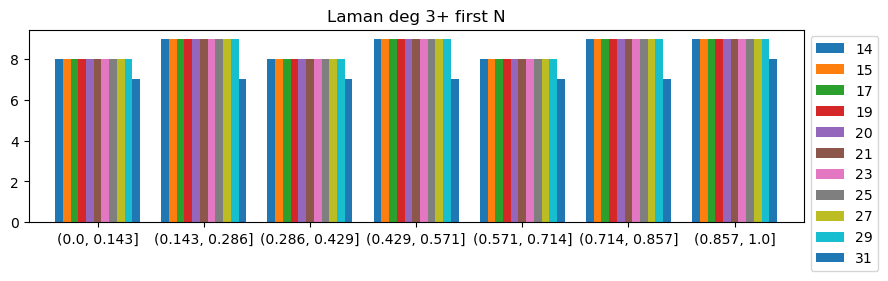

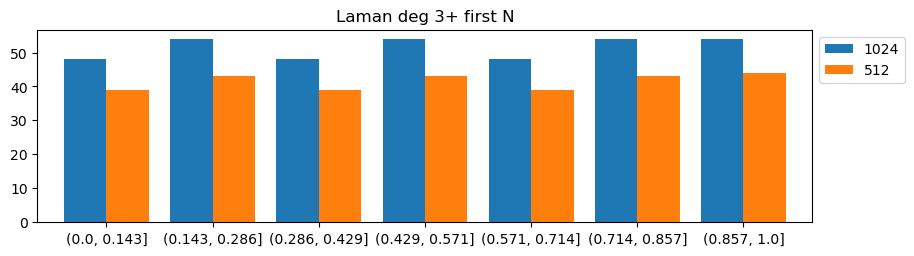

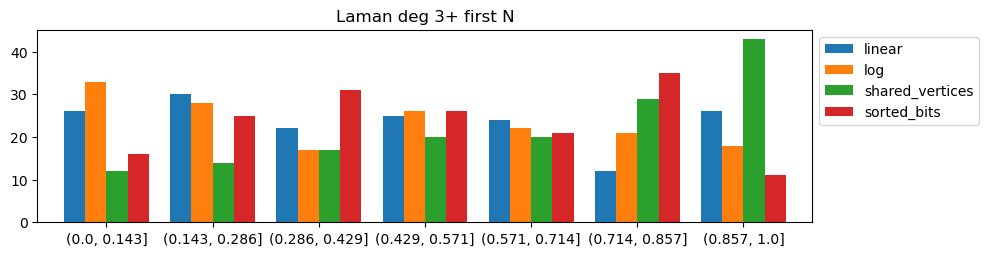

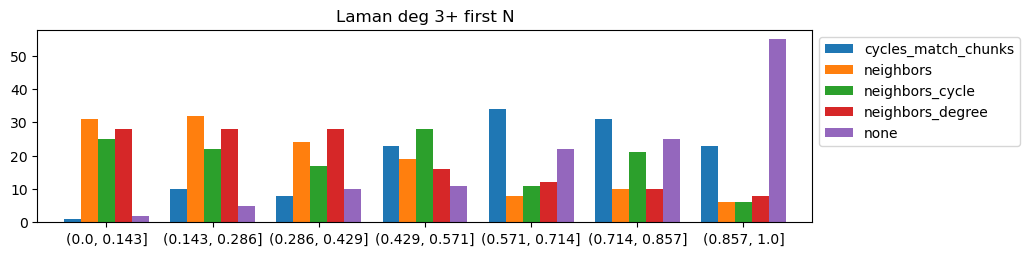

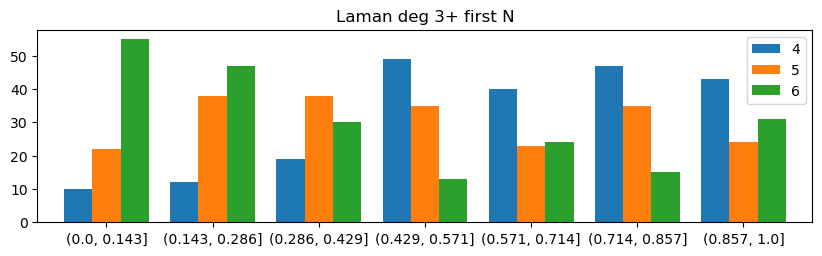

In [22]:
input = """
--------------------------------------------------------------------------------
Name (time in ms)                                                                                            Min                   Max                  Mean              StdDev                Median                 IQR            Outliers     OPS            Rounds  Iterations
--------------------------------------------------------------------------------

test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-log-neighbors_degree-5-smart]                      246.6050 (1.07)       250.6637 (1.0)        248.8133 (1.05)       2.0529 (3.96)       249.1713 (1.08)       3.0441 (3.92)          1;0  4.0191 (0.96)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-shared_vertices-neighbors_degree-5-smart]          248.2782 (1.08)       255.0748 (1.02)       252.2282 (1.06)       3.5301 (6.81)       253.3314 (1.09)       5.0975 (6.57)          1;0  3.9647 (0.94)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-shared_vertices-neighbors_degree-6-smart]          250.7578 (1.09)       254.5924 (1.02)       253.0469 (1.06)       2.0226 (3.90)       253.7906 (1.10)       2.8760 (3.71)          1;0  3.9518 (0.94)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-sorted_bits-neighbors_degree-5-smart]              252.9782 (1.10)       256.3169 (1.02)       254.8951 (1.07)       1.7235 (3.32)       255.3902 (1.10)       2.5040 (3.23)          1;0  3.9232 (0.93)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-sorted_bits-neighbors-5-smart]                     253.6846 (1.10)       265.0980 (1.06)       257.9271 (1.08)       6.2448 (12.04)      254.9988 (1.10)       8.5601 (11.03)         1;0  3.8771 (0.92)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-log-neighbors_degree-6-smart]                      252.3750 (1.10)       264.7482 (1.06)       258.0597 (1.08)       6.2473 (12.05)      257.0558 (1.11)       9.2798 (11.96)         1;0  3.8751 (0.92)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-linear-neighbors-5-smart]                          247.8338 (1.08)       265.1121 (1.06)       259.0866 (1.09)       9.7534 (18.81)      264.3140 (1.14)      12.9587 (16.70)         1;0  3.8597 (0.92)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-shared_vertices-neighbors-6-smart]                 257.4259 (1.12)       262.4582 (1.05)       259.5202 (1.09)       2.6201 (5.05)       258.6764 (1.12)       3.7742 (4.86)          1;0  3.8533 (0.92)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-linear-neighbors-6-smart]                          256.2861 (1.11)       266.5447 (1.06)       259.8554 (1.09)       5.7975 (11.18)      256.7353 (1.11)       7.6940 (9.91)          1;0  3.8483 (0.92)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-linear-neighbors_degree-5-smart]                   256.1218 (1.11)       264.8408 (1.06)       260.6501 (1.10)       4.3693 (8.43)       260.9878 (1.13)       6.5393 (8.43)          1;0  3.8366 (0.91)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-shared_vertices-neighbors-5-smart]                 258.5907 (1.12)       270.0328 (1.08)       262.4336 (1.10)       6.5812 (12.69)      258.6773 (1.12)       8.5815 (11.06)         1;0  3.8105 (0.91)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-log-neighbors-5-smart]                             257.9258 (1.12)       270.6815 (1.08)       263.2627 (1.11)       6.6278 (12.78)      261.1808 (1.13)       9.5668 (12.33)         1;0  3.7985 (0.90)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-sorted_bits-neighbors-6-smart]                     261.8342 (1.14)       265.6357 (1.06)       263.6885 (1.11)       1.9024 (3.67)       263.5955 (1.14)       2.8511 (3.67)          1;0  3.7924 (0.90)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-log-neighbors-6-smart]                             268.8884 (1.17)       294.3753 (1.17)       282.1971 (1.19)      12.7810 (24.65)      283.3277 (1.22)      19.1152 (24.63)         1;0  3.5436 (0.84)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-sorted_bits-none-4-smart]                          276.0913 (1.20)       293.0505 (1.17)       284.3579 (1.19)       8.4876 (16.37)      283.9319 (1.23)      12.7194 (16.39)         1;0  3.5167 (0.84)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-log-neighbors-4-smart]                             277.9642 (1.21)       292.4759 (1.17)       285.5667 (1.20)       7.2806 (14.04)      286.2599 (1.24)      10.8837 (14.02)         1;0  3.5018 (0.83)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-sorted_bits-neighbors-4-smart]                     275.7504 (1.20)       294.1385 (1.17)       286.8022 (1.20)       9.7409 (18.79)      290.5178 (1.25)      13.7911 (17.77)         1;0  3.4867 (0.83)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-sorted_bits-neighbors_degree-4-smart]              278.7633 (1.21)       298.9780 (1.19)       287.4145 (1.21)      10.4173 (20.09)      284.5023 (1.23)      15.1611 (19.54)         1;0  3.4793 (0.83)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-shared_vertices-neighbors_cycle-5-smart]           284.1748 (1.23)       291.9415 (1.16)       288.3809 (1.21)       3.9234 (7.57)       289.0265 (1.25)       5.8250 (7.51)          1;0  3.4676 (0.83)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-linear-neighbors_degree-6-smart]                   265.0682 (1.15)       307.8257 (1.23)       288.5656 (1.21)      21.6914 (41.83)      292.8028 (1.26)      32.0682 (41.32)         1;0  3.4654 (0.82)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-log-neighbors_cycle-6-smart]                       283.9292 (1.23)       300.7386 (1.20)       292.7081 (1.23)       8.4297 (16.26)      293.4565 (1.27)      12.6071 (16.24)         1;0  3.4164 (0.81)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-linear-cycles_match_chunks-6-smart]                286.5430 (1.24)       297.6215 (1.19)       292.7856 (1.23)       5.6716 (10.94)      294.1923 (1.27)       8.3089 (10.71)         1;0  3.4155 (0.81)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-shared_vertices-neighbors_cycle-6-smart]           289.0378 (1.26)       302.5470 (1.21)       297.5606 (1.25)       7.4165 (14.30)      301.0970 (1.30)      10.1319 (13.06)         1;0  3.3607 (0.80)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]               294.0307 (1.28)       304.7458 (1.22)       298.9359 (1.26)       5.4146 (10.44)      298.0312 (1.29)       8.0363 (10.36)         1;0  3.3452 (0.80)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-shared_vertices-neighbors_degree-4-smart]          288.0833 (1.25)       312.0366 (1.24)       299.1537 (1.26)      12.0791 (23.30)      297.3411 (1.28)      17.9650 (23.15)         1;0  3.3428 (0.80)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-linear-neighbors_degree-4-smart]                   291.2425 (1.26)       308.4544 (1.23)       300.1317 (1.26)       8.6199 (16.62)      300.6982 (1.30)      12.9089 (16.63)         1;0  3.3319 (0.79)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-shared_vertices-neighbors_cycle-4-smart]           292.8920 (1.27)       310.6643 (1.24)       300.1445 (1.26)       9.3257 (17.99)      296.8773 (1.28)      13.3292 (17.18)         1;0  3.3317 (0.79)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-linear-cycles_match_chunks-5-smart]                291.3410 (1.27)       315.2457 (1.26)       300.5217 (1.26)      12.8804 (24.84)      294.9785 (1.27)      17.9286 (23.10)         1;0  3.3275 (0.79)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]       295.5287 (1.28)       305.6084 (1.22)       300.7426 (1.26)       5.0489 (9.74)       301.0908 (1.30)       7.5598 (9.74)          1;0  3.3251 (0.79)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]           294.4150 (1.28)       305.5336 (1.22)       300.9110 (1.26)       5.7912 (11.17)      302.7844 (1.31)       8.3389 (10.75)         1;0  3.3232 (0.79)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-shared_vertices-neighbors-4-smart]                 291.6702 (1.27)       309.1223 (1.23)       302.1158 (1.27)       9.2203 (17.78)      305.5548 (1.32)      13.0891 (16.87)         1;0  3.3100 (0.79)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-linear-neighbors_cycle-4-smart]                    295.1455 (1.28)       310.5373 (1.24)       302.3657 (1.27)       7.7399 (14.93)      301.4142 (1.30)      11.5438 (14.87)         1;0  3.3073 (0.79)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-linear-neighbors-4-smart]                          296.2996 (1.29)       312.7987 (1.25)       303.2368 (1.27)       8.5570 (16.50)      300.6122 (1.30)      12.3743 (15.95)         1;0  3.2978 (0.78)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-log-cycles_match_chunks-4-smart]                   295.9365 (1.29)       317.3386 (1.27)       303.7999 (1.28)      11.7758 (22.71)      298.1247 (1.29)      16.0516 (20.68)         1;0  3.2916 (0.78)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-log-neighbors_cycle-5-smart]                       294.1665 (1.28)       322.3618 (1.29)       304.8463 (1.28)      15.2902 (29.49)      298.0106 (1.29)      21.1465 (27.25)         1;0  3.2803 (0.78)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-log-cycles_match_chunks-6-smart]                   280.9597 (1.22)       330.6052 (1.32)       307.9985 (1.29)      25.1178 (48.44)      312.4305 (1.35)      37.2342 (47.98)         1;0  3.2468 (0.77)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-linear-neighbors_cycle-5-smart]                    305.8550 (1.33)       311.0642 (1.24)       308.7079 (1.30)       2.6399 (5.09)       309.2044 (1.34)       3.9069 (5.03)          1;0  3.2393 (0.77)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]       302.5279 (1.31)       324.9287 (1.30)       311.6790 (1.31)      11.7493 (22.66)      307.5805 (1.33)      16.8006 (21.65)         1;0  3.2084 (0.76)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-log-neighbors_cycle-4-smart]                       301.1356 (1.31)       326.6689 (1.30)       312.5800 (1.31)      12.9704 (25.02)      309.9354 (1.34)      19.1500 (24.68)         1;0  3.1992 (0.76)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]           303.7379 (1.32)       325.8599 (1.30)       312.9918 (1.32)      11.4953 (22.17)      309.3776 (1.34)      16.5915 (21.38)         1;0  3.1950 (0.76)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]       308.2304 (1.34)       322.4915 (1.29)       313.0080 (1.32)       8.2130 (15.84)      308.3022 (1.33)      10.6959 (13.78)         1;0  3.1948 (0.76)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-log-neighbors_degree-4-smart]                      282.9316 (1.23)       333.6941 (1.33)       313.0171 (1.32)      26.6570 (51.41)      322.4255 (1.39)      38.0718 (49.06)         1;0  3.1947 (0.76)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]               302.7809 (1.31)       336.0557 (1.34)       315.4324 (1.33)      18.0129 (34.74)      307.4606 (1.33)      24.9561 (32.16)         1;0  3.1703 (0.75)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-log-cycles_match_chunks-5-smart]                   308.9297 (1.34)       320.0790 (1.28)       315.5648 (1.33)       5.8694 (11.32)      317.6855 (1.37)       8.3620 (10.77)         1;0  3.1689 (0.75)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]           317.0620 (1.38)       319.5129 (1.27)       318.1098 (1.34)       1.2635 (2.44)       317.7546 (1.37)       1.8382 (2.37)          1;0  3.1436 (0.75)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]               311.9770 (1.35)       326.7094 (1.30)       320.7032 (1.35)       7.7337 (14.92)      323.4233 (1.40)      11.0493 (14.24)         1;0  3.1181 (0.74)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-linear-cycles_match_chunks-4-smart]                326.8741 (1.42)       340.0568 (1.36)       333.0361 (1.40)       6.6331 (12.79)      332.1772 (1.43)       9.8870 (12.74)         1;0  3.0027 (0.71)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-shared_vertices-none-4-smart]                      324.3034 (1.41)       341.5123 (1.36)       334.1723 (1.40)       8.8788 (17.12)      336.7012 (1.45)      12.9066 (16.63)         1;0  2.9925 (0.71)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-linear-neighbors_cycle-6-smart]                    307.9900 (1.34)       386.3787 (1.54)       334.1945 (1.40)      45.1930 (87.16)      308.2148 (1.33)      58.7915 (75.76)         1;0  2.9923 (0.71)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-linear-none-4-smart]                               330.9472 (1.44)       342.4113 (1.37)       334.9449 (1.41)       6.4715 (12.48)      331.4763 (1.43)       8.5981 (11.08)         1;0  2.9856 (0.71)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-sorted_bits-none-5-smart]                          316.0641 (1.37)       371.5537 (1.48)       340.7846 (1.43)      28.2349 (54.45)      334.7360 (1.45)      41.6172 (53.63)         1;0  2.9344 (0.70)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-log-none-5-smart]                                  315.1742 (1.37)       371.9602 (1.48)       346.3569 (1.46)      28.8012 (55.55)      351.9364 (1.52)      42.5895 (54.88)         1;0  2.8872 (0.69)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-linear-none-6-smart]                               313.7153 (1.36)       393.6059 (1.57)       347.3605 (1.46)      41.4089 (79.86)      334.7602 (1.45)      59.9179 (77.21)         1;0  2.8789 (0.69)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-shared_vertices-none-5-smart]                      319.9847 (1.39)       387.2097 (1.54)       349.6795 (1.47)      34.2906 (66.13)      341.8442 (1.48)      50.4187 (64.97)         1;0  2.8598 (0.68)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-shared_vertices-none-6-smart]                      325.2953 (1.41)       381.6382 (1.52)       349.7349 (1.47)      28.9035 (55.74)      342.2714 (1.48)      42.2572 (54.45)         1;0  2.8593 (0.68)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-sorted_bits-none-6-smart]                          317.2416 (1.38)       381.6191 (1.52)       353.4867 (1.49)      32.9466 (63.54)      361.5996 (1.56)      48.2831 (62.22)         1;0  2.8290 (0.67)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-log-none-4-smart]                                  346.4023 (1.50)       371.3685 (1.48)       355.8221 (1.49)      13.5639 (26.16)      349.6956 (1.51)      18.7247 (24.13)         1;0  2.8104 (0.67)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-log-none-6-smart]                                  319.1444 (1.39)       375.9976 (1.50)       357.0377 (1.50)      32.8165 (63.29)      375.9711 (1.62)      42.6399 (54.94)         1;0  2.8008 (0.67)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-linear-none-5-smart]                               331.4867 (1.44)       400.8388 (1.60)       369.7662 (1.55)      35.2333 (67.95)      376.9732 (1.63)      52.0141 (67.02)         1;0  2.7044 (0.64)          3           1
test_LamanDeg3PlusFirstN[14-10-1024-random-subgraphs-sorted_bits-neighbors_degree-6-smart]              257.6123 (1.12)       696.0079 (2.78)       405.2185 (1.70)     251.8407 (485.71)     262.0353 (1.13)     328.7967 (423.67)        1;0  2.4678 (0.59)          3           1

test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-shared_vertices-neighbors_cycle-6-smart]           230.2877 (1.0)        252.2267 (1.01)       238.0103 (1.0)       12.3271 (23.77)      231.5165 (1.0)       16.4542 (21.20)         1;0  4.2015 (1.0)           3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-linear-neighbors_cycle-6-smart]                    235.7741 (1.02)       261.4088 (1.04)       244.5636 (1.03)      14.5930 (28.14)      236.5080 (1.02)      19.2261 (24.77)         1;0  4.0889 (0.97)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-log-neighbors_cycle-6-smart]                       239.8033 (1.04)       259.2577 (1.03)       247.5824 (1.04)      10.2958 (19.86)      243.6863 (1.05)      14.5908 (18.80)         1;0  4.0391 (0.96)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-shared_vertices-neighbors_degree-6-smart]          231.5601 (1.01)       258.7047 (1.03)       247.8775 (1.04)      14.3810 (27.74)      253.3676 (1.09)      20.3584 (26.23)         1;0  4.0343 (0.96)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-shared_vertices-neighbors-6-smart]                 239.9257 (1.04)       255.8109 (1.02)       248.0757 (1.04)       7.9507 (15.33)      248.4904 (1.07)      11.9139 (15.35)         1;0  4.0310 (0.96)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-linear-neighbors_degree-6-smart]                   235.5758 (1.02)       257.0382 (1.03)       249.0857 (1.05)      11.7610 (22.68)      254.6430 (1.10)      16.0968 (20.74)         1;0  4.0147 (0.96)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-log-neighbors_degree-6-smart]                      238.5958 (1.04)       260.7615 (1.04)       251.6216 (1.06)      11.5825 (22.34)      255.5074 (1.10)      16.6242 (21.42)         1;0  3.9742 (0.95)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-log-neighbors-6-smart]                             247.1968 (1.07)       264.1807 (1.05)       253.7438 (1.07)       9.1357 (17.62)      249.8541 (1.08)      12.7380 (16.41)         1;0  3.9410 (0.94)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-linear-neighbors-6-smart]                          245.9833 (1.07)       266.3463 (1.06)       255.3155 (1.07)      10.2872 (19.84)      253.6168 (1.10)      15.2723 (19.68)         1;0  3.9167 (0.93)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-sorted_bits-neighbors_degree-6-smart]              237.5827 (1.03)       276.9566 (1.10)       257.7023 (1.08)      19.7012 (38.00)      258.5677 (1.12)      29.5304 (38.05)         1;0  3.8804 (0.92)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]               256.0381 (1.11)       280.9867 (1.12)       264.4619 (1.11)      14.3118 (27.60)      256.3609 (1.11)      18.7115 (24.11)         1;0  3.7813 (0.90)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-sorted_bits-neighbors-6-smart]                     246.4864 (1.07)       307.1164 (1.23)       267.2336 (1.12)      34.5489 (66.63)      248.0980 (1.07)      45.4726 (58.59)         1;0  3.7420 (0.89)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-log-neighbors-5-smart]                             265.8066 (1.15)       271.9711 (1.09)       268.3808 (1.13)       3.2054 (6.18)       267.3649 (1.15)       4.6234 (5.96)          1;0  3.7260 (0.89)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-linear-neighbors-4-smart]                          262.5967 (1.14)       274.1178 (1.09)       268.4319 (1.13)       5.7620 (11.11)      268.5814 (1.16)       8.6408 (11.13)         1;0  3.7253 (0.89)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-log-neighbors_degree-5-smart]                      260.3436 (1.13)       279.8549 (1.12)       269.8029 (1.13)       9.7692 (18.84)      269.2102 (1.16)      14.6335 (18.86)         1;0  3.7064 (0.88)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-shared_vertices-neighbors_degree-4-smart]          257.9071 (1.12)       276.4702 (1.10)       270.0156 (1.13)      10.4939 (20.24)      275.6696 (1.19)      13.9223 (17.94)         1;0  3.7035 (0.88)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-log-neighbors_degree-4-smart]                      263.6552 (1.14)       279.8318 (1.12)       270.8551 (1.14)       8.2333 (15.88)      269.0785 (1.16)      12.1324 (15.63)         1;0  3.6920 (0.88)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-log-neighbors-4-smart]                             270.3471 (1.17)       271.3819 (1.08)       270.8842 (1.14)       0.5185 (1.0)        270.9237 (1.17)       0.7761 (1.0)           1;0  3.6916 (0.88)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-linear-neighbors_degree-4-smart]                   262.8858 (1.14)       278.6416 (1.11)       271.2410 (1.14)       7.9212 (15.28)      272.1956 (1.18)      11.8169 (15.23)         1;0  3.6868 (0.88)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-linear-neighbors_degree-5-smart]                   264.8780 (1.15)       287.0351 (1.15)       277.8256 (1.17)      11.5419 (22.26)      281.5638 (1.22)      16.6178 (21.41)         1;0  3.5994 (0.86)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-linear-neighbors-5-smart]                          273.4438 (1.19)       283.8733 (1.13)       280.1806 (1.18)       5.8433 (11.27)      283.2247 (1.22)       7.8221 (10.08)         1;0  3.5691 (0.85)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-shared_vertices-neighbors_degree-5-smart]          275.6003 (1.20)       290.9862 (1.16)       281.4413 (1.18)       8.3349 (16.07)      277.7373 (1.20)      11.5394 (14.87)         1;0  3.5531 (0.85)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-shared_vertices-neighbors-5-smart]                 267.5025 (1.16)       298.2665 (1.19)       281.7519 (1.18)      15.5066 (29.91)      279.4867 (1.21)      23.0730 (29.73)         1;0  3.5492 (0.84)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-shared_vertices-neighbors-4-smart]                 271.7829 (1.18)       288.2311 (1.15)       282.6505 (1.19)       9.4127 (18.15)      287.9374 (1.24)      12.3361 (15.90)         1;0  3.5379 (0.84)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-sorted_bits-none-5-smart]                          284.2806 (1.23)       297.4577 (1.19)       289.0453 (1.21)       7.3068 (14.09)      285.3976 (1.23)       9.8829 (12.73)         1;0  3.4597 (0.82)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-sorted_bits-neighbors-5-smart]                     282.1195 (1.23)       307.1451 (1.23)       291.7856 (1.23)      13.4492 (25.94)      286.0923 (1.24)      18.7692 (24.19)         1;0  3.4272 (0.82)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-shared_vertices-neighbors_cycle-5-smart]           293.4941 (1.27)       296.2772 (1.18)       294.7655 (1.24)       1.4071 (2.71)       294.5251 (1.27)       2.0874 (2.69)          1;0  3.3925 (0.81)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-shared_vertices-neighbors_cycle-4-smart]           293.2662 (1.27)       300.5988 (1.20)       295.9900 (1.24)       4.0133 (7.74)       294.1049 (1.27)       5.4995 (7.09)          1;0  3.3785 (0.80)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-sorted_bits-none-4-smart]                          279.4242 (1.21)       305.8408 (1.22)       296.4150 (1.25)      14.7439 (28.44)      303.9801 (1.31)      19.8125 (25.53)         1;0  3.3736 (0.80)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]       289.5521 (1.26)       308.2873 (1.23)       298.5363 (1.25)       9.3911 (18.11)      297.7696 (1.29)      14.0515 (18.11)         1;0  3.3497 (0.80)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]       291.9530 (1.27)       307.5596 (1.23)       300.7299 (1.26)       7.9834 (15.40)      302.6771 (1.31)      11.7050 (15.08)         1;0  3.3252 (0.79)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-sorted_bits-neighbors_degree-5-smart]              274.2204 (1.19)       323.8052 (1.29)       301.1460 (1.27)      25.0662 (48.34)      305.4124 (1.32)      37.1886 (47.92)         1;0  3.3206 (0.79)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-sorted_bits-neighbors_degree-4-smart]              291.7866 (1.27)       318.4003 (1.27)       305.2766 (1.28)      13.3106 (25.67)      305.6428 (1.32)      19.9603 (25.72)         1;0  3.2757 (0.78)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]               294.7897 (1.28)       321.1766 (1.28)       306.7321 (1.29)      13.3702 (25.79)      304.2300 (1.31)      19.7902 (25.50)         1;0  3.2602 (0.78)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-log-none-5-smart]                                  304.8820 (1.32)       309.2525 (1.23)       307.0718 (1.29)       2.1853 (4.21)       307.0808 (1.33)       3.2779 (4.22)          1;0  3.2566 (0.78)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-linear-none-4-smart]                               300.2151 (1.30)       312.4463 (1.25)       307.2496 (1.29)       6.3193 (12.19)      309.0873 (1.34)       9.1734 (11.82)         1;0  3.2547 (0.77)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-log-none-4-smart]                                  302.0520 (1.31)       312.7823 (1.25)       307.4052 (1.29)       5.3652 (10.35)      307.3813 (1.33)       8.0477 (10.37)         1;0  3.2530 (0.77)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-linear-neighbors_cycle-4-smart]                    291.9686 (1.27)       320.5203 (1.28)       308.3352 (1.30)      14.7280 (28.40)      312.5169 (1.35)      21.4138 (27.59)         1;0  3.2432 (0.77)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-linear-neighbors_cycle-5-smart]                    294.0506 (1.28)       322.0681 (1.28)       308.6098 (1.30)      14.0411 (27.08)      309.7105 (1.34)      21.0131 (27.08)         1;0  3.2403 (0.77)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]           305.6539 (1.33)       313.4081 (1.25)       310.5977 (1.30)       4.2948 (8.28)       312.7311 (1.35)       5.8156 (7.49)          1;0  3.2196 (0.77)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-linear-cycles_match_chunks-4-smart]                297.0713 (1.29)       329.7183 (1.32)       310.7273 (1.31)      16.9648 (32.72)      305.3921 (1.32)      24.4852 (31.55)         1;0  3.2183 (0.77)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-linear-none-5-smart]                               308.7032 (1.34)       315.5665 (1.26)       311.0474 (1.31)       3.9146 (7.55)       308.8726 (1.33)       5.1475 (6.63)          1;0  3.2149 (0.77)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]           307.3328 (1.33)       313.3853 (1.25)       311.1710 (1.31)       3.3370 (6.44)       312.7948 (1.35)       4.5393 (5.85)          1;0  3.2137 (0.76)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-sorted_bits-neighbors-4-smart]                     289.4041 (1.26)       335.5188 (1.34)       311.4095 (1.31)      23.1292 (44.61)      309.3056 (1.34)      34.5860 (44.57)         1;0  3.2112 (0.76)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-linear-cycles_match_chunks-5-smart]                299.7191 (1.30)       334.2433 (1.33)       313.3685 (1.32)      18.3612 (35.41)      306.1432 (1.32)      25.8931 (33.36)         1;0  3.1911 (0.76)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-shared_vertices-none-4-smart]                      310.6496 (1.35)       318.8891 (1.27)       314.0895 (1.32)       4.2848 (8.26)       312.7298 (1.35)       6.1797 (7.96)          1;0  3.1838 (0.76)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-log-cycles_match_chunks-4-smart]                   299.5549 (1.30)       336.2331 (1.34)       314.7241 (1.32)      19.1434 (36.92)      308.3842 (1.33)      27.5087 (35.45)         1;0  3.1774 (0.76)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-log-neighbors_cycle-4-smart]                       296.2484 (1.29)       327.6642 (1.31)       316.3834 (1.33)      17.4796 (33.71)      325.2377 (1.40)      23.5618 (30.36)         1;0  3.1607 (0.75)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-log-neighbors_cycle-5-smart]                       308.9275 (1.34)       328.3872 (1.31)       317.4179 (1.33)       9.9638 (19.22)      314.9391 (1.36)      14.5947 (18.81)         1;0  3.1504 (0.75)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-log-cycles_match_chunks-5-smart]                   310.9680 (1.35)       327.0927 (1.30)       317.5462 (1.33)       8.4623 (16.32)      314.5779 (1.36)      12.0936 (15.58)         1;0  3.1491 (0.75)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]               299.7622 (1.30)       329.0919 (1.31)       319.0907 (1.34)      16.7424 (32.29)      328.4180 (1.42)      21.9973 (28.34)         1;0  3.1339 (0.75)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-log-cycles_match_chunks-6-smart]                   311.3710 (1.35)       328.3173 (1.31)       321.9620 (1.35)       9.2331 (17.81)      326.1979 (1.41)      12.7097 (16.38)         1;0  3.1060 (0.74)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]       313.0994 (1.36)       335.9543 (1.34)       323.9771 (1.36)      11.4670 (22.12)      322.8778 (1.39)      17.1412 (22.09)         1;0  3.0866 (0.73)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-linear-cycles_match_chunks-6-smart]                318.0491 (1.38)       329.0564 (1.31)       325.2893 (1.37)       6.2718 (12.10)      328.7622 (1.42)       8.2555 (10.64)         1;0  3.0742 (0.73)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]           317.5314 (1.38)       340.3892 (1.36)       329.1962 (1.38)      11.4362 (22.06)      329.6679 (1.42)      17.1433 (22.09)         1;0  3.0377 (0.72)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-sorted_bits-none-6-smart]                          312.8819 (1.36)       351.9604 (1.40)       336.0050 (1.41)      20.5016 (39.54)      343.1726 (1.48)      29.3089 (37.77)         1;0  2.9761 (0.71)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-log-none-6-smart]                                  318.1757 (1.38)       352.0130 (1.40)       338.9418 (1.42)      18.1838 (35.07)      346.6368 (1.50)      25.3780 (32.70)         1;0  2.9504 (0.70)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-shared_vertices-none-5-smart]                      305.9535 (1.33)       380.6376 (1.52)       343.0502 (1.44)      37.3445 (72.02)      342.5596 (1.48)      56.0131 (72.18)         1;0  2.9150 (0.69)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-linear-none-6-smart]                               323.2964 (1.40)       369.1221 (1.47)       346.1116 (1.45)      22.9135 (44.19)      345.9163 (1.49)      34.3693 (44.29)         1;0  2.8892 (0.69)          3           1
test_LamanDeg3PlusFirstN[15-10-1024-random-subgraphs-shared_vertices-none-6-smart]                      343.1959 (1.49)       410.1540 (1.64)       373.8091 (1.57)      33.8450 (65.27)      368.0774 (1.59)      50.2186 (64.71)         1;0  2.6752 (0.64)          3           1

test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-log-neighbors-4-smart]                             439.7385 (1.91)       452.5765 (1.81)       444.0587 (1.87)       7.3768 (14.23)      439.8613 (1.90)       9.6285 (12.41)         1;0  2.2520 (0.54)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-log-neighbors_degree-4-smart]                      433.5925 (1.88)       460.4313 (1.84)       449.3329 (1.89)      14.0086 (27.02)      453.9748 (1.96)      20.1291 (25.94)         1;0  2.2255 (0.53)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-linear-neighbors-6-smart]                          442.0218 (1.92)       486.4761 (1.94)       460.6191 (1.94)      23.0992 (44.55)      453.3593 (1.96)      33.3407 (42.96)         1;0  2.1710 (0.52)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-shared_vertices-neighbors_degree-6-smart]          436.5876 (1.90)       489.4092 (1.95)       465.5621 (1.96)      26.7815 (51.65)      470.6894 (2.03)      39.6162 (51.05)         1;0  2.1479 (0.51)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-sorted_bits-neighbors-6-smart]                     447.9459 (1.95)       489.6727 (1.95)       466.1738 (1.96)      21.3570 (41.19)      460.9028 (1.99)      31.2951 (40.33)         1;0  2.1451 (0.51)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-linear-neighbors_degree-6-smart]                   441.4873 (1.92)       491.8950 (1.96)       469.9218 (1.97)      25.8176 (49.79)      476.3832 (2.06)      37.8058 (48.71)         1;0  2.1280 (0.51)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-log-neighbors_cycle-4-smart]                       461.4109 (2.00)       475.7283 (1.90)       470.3397 (1.98)       7.7876 (15.02)      473.8799 (2.05)      10.7380 (13.84)         1;0  2.1261 (0.51)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-linear-neighbors_cycle-6-smart]                    464.2917 (2.02)       475.5568 (1.90)       470.6333 (1.98)       5.7649 (11.12)      472.0513 (2.04)       8.4489 (10.89)         1;0  2.1248 (0.51)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-log-neighbors-6-smart]                             437.6840 (1.90)       524.6680 (2.09)       474.3004 (1.99)      45.0929 (86.97)      460.5492 (1.99)      65.2380 (84.06)         1;0  2.1084 (0.50)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-sorted_bits-neighbors_degree-6-smart]              447.3791 (1.94)       500.1088 (2.00)       477.0181 (2.00)      26.9679 (52.01)      483.5665 (2.09)      39.5473 (50.96)         1;0  2.0964 (0.50)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-shared_vertices-neighbors-6-smart]                 442.8951 (1.92)       501.3124 (2.00)       477.3261 (2.01)      30.5771 (58.97)      487.7706 (2.11)      43.8130 (56.46)         1;0  2.0950 (0.50)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-log-neighbors-5-smart]                             460.0576 (2.00)       490.1530 (1.96)       478.9854 (2.01)      16.4802 (31.78)      486.7456 (2.10)      22.5716 (29.08)         1;0  2.0877 (0.50)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]               476.0873 (2.07)       491.9748 (1.96)       484.0726 (2.03)       7.9440 (15.32)      484.1556 (2.09)      11.9156 (15.35)         1;0  2.0658 (0.49)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-shared_vertices-neighbors_cycle-5-smart]           474.8927 (2.06)       496.4239 (1.98)       485.0411 (2.04)      10.8185 (20.86)      483.8067 (2.09)      16.1484 (20.81)         1;0  2.0617 (0.49)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-log-neighbors_cycle-6-smart]                       468.0099 (2.03)       499.8532 (1.99)       486.2717 (2.04)      16.4295 (31.69)      490.9519 (2.12)      23.8825 (30.77)         1;0  2.0565 (0.49)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-linear-neighbors_cycle-5-smart]                    475.6740 (2.07)       509.1405 (2.03)       487.4635 (2.05)      18.7969 (36.25)      477.5761 (2.06)      25.0999 (32.34)         1;0  2.0514 (0.49)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-log-neighbors_degree-6-smart]                      457.0535 (1.98)       520.3972 (2.08)       494.8094 (2.08)      33.3790 (64.38)      506.9777 (2.19)      47.5077 (61.22)         1;0  2.0210 (0.48)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-linear-neighbors-5-smart]                          464.9158 (2.02)       521.8471 (2.08)       497.2538 (2.09)      29.2451 (56.40)      504.9984 (2.18)      42.6985 (55.02)         1;0  2.0110 (0.48)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-log-neighbors_cycle-5-smart]                       482.5783 (2.10)       521.8374 (2.08)       497.8808 (2.09)      21.0116 (40.52)      489.2268 (2.11)      29.4443 (37.94)         1;0  2.0085 (0.48)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-linear-neighbors_degree-4-smart]                   493.3062 (2.14)       523.2788 (2.09)       504.7485 (2.12)      16.1947 (31.23)      497.6605 (2.15)      22.4794 (28.97)         1;0  1.9812 (0.47)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-shared_vertices-neighbors_degree-5-smart]          498.5418 (2.16)       511.6678 (2.04)       506.3329 (2.13)       6.8992 (13.31)      508.7892 (2.20)       9.8446 (12.69)         1;0  1.9750 (0.47)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-linear-neighbors_degree-5-smart]                   498.7442 (2.17)       527.8540 (2.11)       509.5091 (2.14)      15.9668 (30.79)      501.9291 (2.17)      21.8323 (28.13)         1;0  1.9627 (0.47)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-sorted_bits-neighbors-5-smart]                     459.1860 (1.99)       550.9517 (2.20)       512.3150 (2.15)      47.5684 (91.74)      526.8072 (2.28)      68.8242 (88.68)         1;0  1.9519 (0.46)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-sorted_bits-neighbors_degree-5-smart]              501.7741 (2.18)       528.6024 (2.11)       516.5333 (2.17)      13.6149 (26.26)      519.2235 (2.24)      20.1212 (25.93)         1;0  1.9360 (0.46)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-log-neighbors_degree-5-smart]                      494.0251 (2.15)       556.1487 (2.22)       534.6076 (2.25)      35.1677 (67.83)      553.6490 (2.39)      46.5927 (60.04)         1;0  1.8705 (0.45)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-shared_vertices-neighbors-5-smart]                 505.1693 (2.19)       585.0952 (2.33)       535.8146 (2.25)      43.0986 (83.12)      517.1794 (2.23)      59.9444 (77.24)         1;0  1.8663 (0.44)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-shared_vertices-neighbors-4-smart]                 519.3272 (2.26)       552.5334 (2.20)       540.3231 (2.27)      18.2634 (35.22)      549.1087 (2.37)      24.9047 (32.09)         1;0  1.8507 (0.44)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]               506.3952 (2.20)       569.8139 (2.27)       541.0473 (2.27)      32.1164 (61.94)      546.9328 (2.36)      47.5641 (61.29)         1;0  1.8483 (0.44)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-linear-neighbors-4-smart]                          523.2708 (2.27)       566.0290 (2.26)       544.0897 (2.29)      21.4011 (41.27)      542.9693 (2.35)      32.0686 (41.32)         1;0  1.8379 (0.44)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-linear-neighbors_cycle-4-smart]                    532.5089 (2.31)       560.4314 (2.24)       544.0948 (2.29)      14.5549 (28.07)      539.3440 (2.33)      20.9419 (26.98)         1;0  1.8379 (0.44)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-shared_vertices-neighbors_degree-4-smart]          539.6592 (2.34)       549.0415 (2.19)       545.0229 (2.29)       4.8336 (9.32)       546.3681 (2.36)       7.0367 (9.07)          1;0  1.8348 (0.44)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-log-cycles_match_chunks-4-smart]                   542.6163 (2.36)       574.8823 (2.29)       556.0910 (2.34)      16.7772 (32.36)      550.7745 (2.38)      24.1995 (31.18)         1;0  1.7983 (0.43)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-shared_vertices-neighbors_cycle-4-smart]           564.4288 (2.45)       584.3138 (2.33)       573.0337 (2.41)      10.2089 (19.69)      570.3585 (2.46)      14.9138 (19.22)         1;0  1.7451 (0.42)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-sorted_bits-none-4-smart]                          521.0767 (2.26)       641.6097 (2.56)       574.2618 (2.41)      61.5020 (118.61)     560.0991 (2.42)      90.3998 (116.49)        1;0  1.7414 (0.41)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-sorted_bits-none-5-smart]                          563.8982 (2.45)       605.5444 (2.42)       589.6331 (2.48)      22.4940 (43.38)      599.4568 (2.59)      31.2347 (40.25)         1;0  1.6960 (0.40)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-log-cycles_match_chunks-6-smart]                   590.5112 (2.56)       618.4396 (2.47)       608.4994 (2.56)      15.6070 (30.10)      616.5475 (2.66)      20.9463 (26.99)         1;0  1.6434 (0.39)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-sorted_bits-neighbors_degree-4-smart]              594.9430 (2.58)       634.1133 (2.53)       608.9679 (2.56)      21.8249 (42.09)      597.8474 (2.58)      29.3777 (37.85)         1;0  1.6421 (0.39)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-sorted_bits-neighbors-4-smart]                     574.5108 (2.49)       673.3134 (2.69)       610.3856 (2.56)      54.6754 (105.45)     583.3325 (2.52)      74.1020 (95.48)         1;0  1.6383 (0.39)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-log-none-4-smart]                                  553.0867 (2.40)       678.4014 (2.71)       617.3315 (2.59)      62.7177 (120.96)     620.5065 (2.68)      93.9861 (121.11)        1;0  1.6199 (0.39)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]       611.5713 (2.66)       628.4328 (2.51)       621.8458 (2.61)       9.0153 (17.39)      625.5332 (2.70)      12.6461 (16.30)         1;0  1.6081 (0.38)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-linear-cycles_match_chunks-6-smart]                593.3904 (2.58)       654.2247 (2.61)       629.9075 (2.65)      32.1999 (62.10)      642.1074 (2.77)      45.6258 (58.79)         1;0  1.5875 (0.38)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-log-cycles_match_chunks-5-smart]                   609.2287 (2.65)       674.5132 (2.69)       634.8031 (2.67)      34.8623 (67.24)      620.6674 (2.68)      48.9633 (63.09)         1;0  1.5753 (0.37)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]       614.2158 (2.67)       660.3163 (2.63)       635.0655 (2.67)      23.3633 (45.06)      630.6643 (2.72)      34.5754 (44.55)         1;0  1.5746 (0.37)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]       614.2024 (2.67)       660.9120 (2.64)       639.9433 (2.69)      23.7177 (45.74)      644.7156 (2.78)      35.0322 (45.14)         1;0  1.5626 (0.37)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-linear-cycles_match_chunks-4-smart]                628.0479 (2.73)       662.8285 (2.64)       646.5995 (2.72)      17.5063 (33.76)      648.9222 (2.80)      26.0855 (33.61)         1;0  1.5466 (0.37)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-shared_vertices-neighbors_cycle-6-smart]           484.9784 (2.11)       943.8985 (3.77)       653.1042 (2.74)     252.8588 (487.67)     530.4357 (2.29)     344.1900 (443.51)        1;0  1.5311 (0.36)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]               584.2716 (2.54)       743.8633 (2.97)       654.4870 (2.75)      81.5030 (157.19)     635.3260 (2.74)     119.6938 (154.23)        1;0  1.5279 (0.36)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]           631.2158 (2.74)       683.5479 (2.73)       654.9699 (2.75)      26.4975 (51.10)      650.1460 (2.81)      39.2491 (50.57)         1;0  1.5268 (0.36)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]           608.1076 (2.64)       687.5871 (2.74)       656.2496 (2.76)      42.3207 (81.62)      673.0542 (2.91)      59.6096 (76.81)         1;0  1.5238 (0.36)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-linear-cycles_match_chunks-5-smart]                643.0812 (2.79)       688.9648 (2.75)       659.6020 (2.77)      25.4954 (49.17)      646.7599 (2.79)      34.4127 (44.34)         1;0  1.5161 (0.36)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-shared_vertices-none-5-smart]                      649.9404 (2.82)       686.2345 (2.74)       671.1370 (2.82)      18.9001 (36.45)      677.2361 (2.93)      27.2206 (35.08)         1;0  1.4900 (0.35)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-linear-none-5-smart]                               659.0070 (2.86)       710.6183 (2.83)       682.0967 (2.87)      26.2309 (50.59)      676.6649 (2.92)      38.7085 (49.88)         1;0  1.4661 (0.35)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-log-none-5-smart]                                  653.9401 (2.84)       710.4705 (2.83)       685.5980 (2.88)      28.8696 (55.68)      692.3834 (2.99)      42.3978 (54.63)         1;0  1.4586 (0.35)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]           676.8921 (2.94)       723.5831 (2.89)       699.1557 (2.94)      23.4206 (45.17)      696.9917 (3.01)      35.0182 (45.12)         1;0  1.4303 (0.34)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-shared_vertices-none-4-smart]                      686.6527 (2.98)       711.6426 (2.84)       703.0661 (2.95)      14.2193 (27.42)      710.9030 (3.07)      18.7425 (24.15)         1;0  1.4223 (0.34)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-linear-none-4-smart]                               697.1947 (3.03)       739.2696 (2.95)       712.1183 (2.99)      23.5523 (45.42)      699.8907 (3.02)      31.5562 (40.66)         1;0  1.4043 (0.33)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-linear-none-6-smart]                               637.8504 (2.77)       831.3920 (3.32)       730.3659 (3.07)      97.0511 (187.18)     721.8553 (3.12)     145.1562 (187.04)        1;0  1.3692 (0.33)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-log-none-6-smart]                                  654.3233 (2.84)       825.0511 (3.29)       732.1069 (3.08)      86.3677 (166.57)     716.9464 (3.10)     128.0458 (164.99)        1;0  1.3659 (0.33)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-shared_vertices-none-6-smart]                      636.4175 (2.76)       828.1172 (3.30)       734.9088 (3.09)      95.9590 (185.07)     740.1916 (3.20)     143.7747 (185.26)        1;0  1.3607 (0.32)          3           1
test_LamanDeg3PlusFirstN[17-10-1024-random-subgraphs-sorted_bits-none-6-smart]                          650.0063 (2.82)       885.2123 (3.53)       762.2803 (3.20)     117.9646 (227.51)     751.6222 (3.25)     176.4045 (227.31)        1;0  1.3119 (0.31)          3           1

test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-log-neighbors-4-smart]                             735.9453 (3.20)       754.0209 (3.01)       744.7566 (3.13)       9.0463 (17.45)      744.3036 (3.21)      13.5566 (17.47)         1;0  1.3427 (0.32)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-log-neighbors_degree-4-smart]                      735.8163 (3.20)       799.7438 (3.19)       759.7762 (3.19)      34.8406 (67.19)      743.7684 (3.21)      47.9456 (61.78)         1;0  1.3162 (0.31)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-log-neighbors_cycle-4-smart]                       759.9589 (3.30)       795.1243 (3.17)       771.8376 (3.24)      20.1682 (38.90)      760.4296 (3.28)      26.3741 (33.98)         1;0  1.2956 (0.31)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]               755.3782 (3.28)       883.4222 (3.52)       816.5122 (3.43)      64.2171 (123.85)     810.7362 (3.50)      96.0330 (123.74)        1;0  1.2247 (0.29)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-sorted_bits-neighbors_degree-6-smart]              786.5834 (3.42)       889.5118 (3.55)       823.4322 (3.46)      57.3533 (110.61)     794.2014 (3.43)      77.1963 (99.47)         1;0  1.2144 (0.29)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-sorted_bits-neighbors-6-smart]                     775.1541 (3.37)       875.2069 (3.49)       826.4762 (3.47)      50.0767 (96.58)      829.0676 (3.58)      75.0396 (96.69)         1;0  1.2100 (0.29)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]               769.2097 (3.34)       919.9546 (3.67)       828.9428 (3.48)      80.0923 (154.47)     797.6641 (3.45)     113.0587 (145.68)        1;0  1.2064 (0.29)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-sorted_bits-neighbors_degree-5-smart]              795.9573 (3.46)       925.2856 (3.69)       842.5582 (3.54)      71.8352 (138.54)     806.4316 (3.48)      96.9962 (124.99)        1;0  1.1869 (0.28)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-sorted_bits-neighbors-5-smart]                     802.2007 (3.48)       902.0407 (3.60)       845.2141 (3.55)      51.3333 (99.00)      831.4010 (3.59)      74.8800 (96.49)         1;0  1.1831 (0.28)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-linear-neighbors-5-smart]                          852.8310 (3.70)       878.3848 (3.50)       868.6310 (3.65)      13.8082 (26.63)      874.6772 (3.78)      19.1654 (24.70)         1;0  1.1512 (0.27)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-log-neighbors-5-smart]                             841.9673 (3.66)       901.8791 (3.60)       868.6566 (3.65)      30.4856 (58.80)      862.1234 (3.72)      44.9339 (57.90)         1;0  1.1512 (0.27)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-linear-neighbors_degree-4-smart]                   820.1082 (3.56)       911.0152 (3.63)       869.6377 (3.65)      45.9985 (88.71)      877.7895 (3.79)      68.1802 (87.85)         1;0  1.1499 (0.27)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-linear-neighbors-6-smart]                          844.2598 (3.67)       923.6119 (3.68)       874.5573 (3.67)      42.8726 (82.69)      855.8003 (3.70)      59.5141 (76.69)         1;0  1.1434 (0.27)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-linear-neighbors_cycle-6-smart]                    809.6825 (3.52)       922.7581 (3.68)       880.1316 (3.70)      61.4580 (118.53)     907.9540 (3.92)      84.8067 (109.28)        1;0  1.1362 (0.27)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-shared_vertices-neighbors_cycle-5-smart]           824.0658 (3.58)       925.6667 (3.69)       881.3130 (3.70)      52.0131 (100.31)     894.2065 (3.86)      76.2007 (98.19)         1;0  1.1347 (0.27)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-linear-neighbors_degree-5-smart]                   871.8995 (3.79)       923.7055 (3.69)       889.9172 (3.74)      29.2831 (56.48)      874.1465 (3.78)      38.8545 (50.07)         1;0  1.1237 (0.27)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-log-neighbors_degree-5-smart]                      877.0279 (3.81)       924.7777 (3.69)       893.7732 (3.76)      26.8794 (51.84)      879.5142 (3.80)      35.8123 (46.15)         1;0  1.1189 (0.27)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-linear-neighbors-4-smart]                          858.5294 (3.73)       944.1111 (3.77)       895.7247 (3.76)      43.8747 (84.62)      884.5336 (3.82)      64.1863 (82.71)         1;0  1.1164 (0.27)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-log-neighbors-6-smart]                             852.7977 (3.70)       948.1630 (3.78)       896.1071 (3.76)      48.2806 (93.12)      887.3607 (3.83)      71.5240 (92.16)         1;0  1.1159 (0.27)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-linear-neighbors_degree-6-smart]                   866.2841 (3.76)       945.9150 (3.77)       896.2315 (3.77)      43.3290 (83.57)      876.4955 (3.79)      59.7231 (76.96)         1;0  1.1158 (0.27)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-shared_vertices-neighbors_cycle-6-smart]           816.2082 (3.54)       946.2109 (3.77)       896.5864 (3.77)      70.2461 (135.48)     927.3400 (4.01)      97.5020 (125.64)        1;0  1.1153 (0.27)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-shared_vertices-neighbors-5-smart]                 873.5596 (3.79)       941.9704 (3.76)       897.6541 (3.77)      38.4279 (74.11)      877.4322 (3.79)      51.3081 (66.11)         1;0  1.1140 (0.27)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-log-neighbors_degree-6-smart]                      877.1810 (3.81)       939.9727 (3.75)       902.7781 (3.79)      32.9632 (63.57)      891.1806 (3.85)      47.0937 (60.68)         1;0  1.1077 (0.26)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-shared_vertices-neighbors-6-smart]                 870.8001 (3.78)       966.0857 (3.85)       907.3690 (3.81)      51.3589 (99.05)      885.2211 (3.82)      71.4642 (92.09)         1;0  1.1021 (0.26)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-shared_vertices-neighbors_degree-5-smart]          870.3025 (3.78)       944.1825 (3.77)       908.2430 (3.82)      36.9807 (71.32)      910.2441 (3.93)      55.4100 (71.40)         1;0  1.1010 (0.26)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-log-neighbors_cycle-6-smart]                       836.2720 (3.63)       964.2055 (3.85)       909.3073 (3.82)      65.8670 (127.03)     927.4444 (4.01)      95.9502 (123.64)        1;0  1.0997 (0.26)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-shared_vertices-neighbors_degree-6-smart]          852.5243 (3.70)       995.4577 (3.97)       918.4051 (3.86)      72.1187 (139.09)     907.2332 (3.92)     107.2001 (138.13)        1;0  1.0888 (0.26)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-linear-neighbors_cycle-5-smart]                    845.1298 (3.67)     1,015.8726 (4.05)       929.8729 (3.91)      85.3783 (164.66)     928.6163 (4.01)     128.0571 (165.01)        1;0  1.0754 (0.26)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-sorted_bits-none-4-smart]                          897.5295 (3.90)       986.6403 (3.94)       939.8043 (3.95)      44.7302 (86.27)      935.2429 (4.04)      66.8331 (86.12)         1;0  1.0641 (0.25)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-log-cycles_match_chunks-4-smart]                   917.5588 (3.98)       979.8387 (3.91)       948.8153 (3.99)      31.1406 (60.06)      949.0484 (4.10)      46.7099 (60.19)         1;0  1.0539 (0.25)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-linear-neighbors_cycle-4-smart]                    930.1406 (4.04)       988.0070 (3.94)       949.7630 (3.99)      33.1241 (63.88)      931.1414 (4.02)      43.3998 (55.92)         1;0  1.0529 (0.25)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-log-neighbors_cycle-5-smart]                       876.4279 (3.81)     1,040.5126 (4.15)       966.3582 (4.06)      83.1722 (160.41)     982.1340 (4.24)     123.0636 (158.57)        1;0  1.0348 (0.25)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-sorted_bits-neighbors-4-smart]                     917.5762 (3.98)     1,027.8687 (4.10)       966.5774 (4.06)      56.1640 (108.32)     954.2872 (4.12)      82.7194 (106.59)        1;0  1.0346 (0.25)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]               959.5980 (4.17)     1,011.0143 (4.03)       979.7690 (4.12)      27.4388 (52.92)      968.6949 (4.18)      38.5622 (49.69)         1;0  1.0206 (0.24)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-sorted_bits-neighbors_degree-4-smart]              921.8935 (4.00)     1,067.5936 (4.26)       988.0414 (4.15)      73.7692 (142.27)     974.6372 (4.21)     109.2751 (140.81)        1;0  1.0121 (0.24)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-shared_vertices-neighbors_degree-4-smart]          989.6312 (4.30)     1,063.7769 (4.24)     1,020.5443 (4.29)      38.5775 (74.40)    1,008.2248 (4.35)      55.6093 (71.66)         1;0  0.9799 (0.23)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-linear-cycles_match_chunks-4-smart]              1,028.1007 (4.46)     1,050.4313 (4.19)     1,040.1635 (4.37)      11.2730 (21.74)    1,041.9584 (4.50)      16.7480 (21.58)         1;0  0.9614 (0.23)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-shared_vertices-neighbors-4-smart]               1,020.2714 (4.43)     1,085.3022 (4.33)     1,043.4317 (4.38)      36.3291 (70.07)    1,024.7217 (4.43)      48.7731 (62.85)         1;0  0.9584 (0.23)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-sorted_bits-none-5-smart]                        1,041.5816 (4.52)     1,103.9867 (4.40)     1,067.9096 (4.49)      32.3246 (62.34)    1,058.1606 (4.57)      46.8038 (60.31)         1;0  0.9364 (0.22)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-sorted_bits-none-6-smart]                        1,025.5287 (4.45)     1,147.0538 (4.58)     1,073.9106 (4.51)      64.4354 (124.27)   1,049.1494 (4.53)      91.1438 (117.44)        1;0  0.9312 (0.22)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]         1,031.8851 (4.48)     1,137.0487 (4.54)     1,093.6021 (4.59)      54.9109 (105.90)   1,111.8727 (4.80)      78.8727 (101.63)        1;0  0.9144 (0.22)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]     1,025.6880 (4.45)     1,162.0794 (4.64)     1,101.8410 (4.63)      69.5745 (134.18)   1,117.7556 (4.83)     102.2936 (131.81)        1;0  0.9076 (0.22)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]         1,061.3857 (4.61)     1,154.1370 (4.60)     1,117.5701 (4.70)      49.3897 (95.25)    1,137.1877 (4.91)      69.5635 (89.64)         1;0  0.8948 (0.21)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]     1,083.5653 (4.71)     1,152.1397 (4.60)     1,127.7798 (4.74)      38.3571 (73.98)    1,147.6344 (4.96)      51.4308 (66.27)         1;0  0.8867 (0.21)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-shared_vertices-neighbors_cycle-4-smart]         1,046.4422 (4.54)     1,171.2454 (4.67)     1,129.1654 (4.74)      71.6440 (138.18)   1,169.8087 (5.05)      93.6024 (120.61)        1;0  0.8856 (0.21)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]     1,063.1202 (4.62)     1,184.1388 (4.72)     1,133.2850 (4.76)      62.7779 (121.08)   1,152.5958 (4.98)      90.7640 (116.95)        1;0  0.8824 (0.21)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-log-cycles_match_chunks-5-smart]                 1,083.2354 (4.70)     1,214.3698 (4.84)     1,167.3249 (4.90)      72.9951 (140.78)   1,204.3695 (5.20)      98.3508 (126.73)        1;0  0.8567 (0.20)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-linear-cycles_match_chunks-5-smart]              1,110.4698 (4.82)     1,210.1289 (4.83)     1,168.4783 (4.91)      51.8041 (99.91)    1,184.8360 (5.12)      74.7443 (96.31)         1;0  0.8558 (0.20)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-log-cycles_match_chunks-6-smart]                 1,083.0456 (4.70)     1,242.2855 (4.96)     1,175.4930 (4.94)      82.6618 (159.42)   1,201.1479 (5.19)     119.4299 (153.89)        1;0  0.8507 (0.20)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-shared_vertices-none-5-smart]                    1,110.6192 (4.82)     1,257.8011 (5.02)     1,180.5472 (4.96)      73.8639 (142.46)   1,173.2214 (5.07)     110.3865 (142.24)        1;0  0.8471 (0.20)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]         1,156.0474 (5.02)     1,213.1330 (4.84)     1,181.0724 (4.96)      29.1859 (56.29)    1,174.0369 (5.07)      42.8142 (55.17)         1;0  0.8467 (0.20)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-shared_vertices-none-6-smart]                    1,147.7901 (4.98)     1,252.0542 (4.99)     1,196.4452 (5.03)      52.4788 (101.21)   1,189.4911 (5.14)      78.1981 (100.76)        1;0  0.8358 (0.20)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-linear-cycles_match_chunks-6-smart]              1,104.9758 (4.80)     1,275.5793 (5.09)     1,197.4815 (5.03)      86.2095 (166.27)   1,211.8894 (5.23)     127.9526 (164.87)        1;0  0.8351 (0.20)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-shared_vertices-none-4-smart]                    1,119.3020 (4.86)     1,278.9980 (5.10)     1,215.5781 (5.11)      84.7664 (163.48)   1,248.4341 (5.39)     119.7720 (154.33)        1;0  0.8227 (0.20)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-linear-none-6-smart]                             1,178.8061 (5.12)     1,288.4664 (5.14)     1,222.1245 (5.13)      58.3430 (112.52)   1,199.1009 (5.18)      82.2452 (105.98)        1;0  0.8182 (0.19)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-linear-none-5-smart]                             1,167.2856 (5.07)     1,272.6054 (5.08)     1,227.7666 (5.16)      54.3744 (104.87)   1,243.4088 (5.37)      78.9899 (101.78)        1;0  0.8145 (0.19)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-log-none-5-smart]                                1,197.9367 (5.20)     1,290.6868 (5.15)     1,234.4492 (5.19)      49.4212 (95.32)    1,214.7240 (5.25)      69.5625 (89.64)         1;0  0.8101 (0.19)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-log-none-6-smart]                                1,208.7020 (5.25)     1,326.3016 (5.29)     1,257.4109 (5.28)      61.3424 (118.31)   1,237.2292 (5.34)      88.1997 (113.65)        1;0  0.7953 (0.19)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-log-none-4-smart]                                1,256.5273 (5.46)     1,341.3865 (5.35)     1,286.0084 (5.40)      47.9923 (92.56)    1,260.1116 (5.44)      63.6444 (82.01)         1;0  0.7776 (0.19)          3           1
test_LamanDeg3PlusFirstN[19-10-1024-random-subgraphs-linear-none-4-smart]                             1,323.9484 (5.75)     1,448.0019 (5.78)     1,372.6671 (5.77)      66.1712 (127.62)   1,346.0509 (5.81)      93.0401 (119.89)        1;0  0.7285 (0.17)          3           1

test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-log-neighbors_degree-5-smart]                      945.5521 (4.11)     1,088.3642 (4.34)     1,006.8058 (4.23)      73.5394 (141.83)     986.5011 (4.26)     107.1091 (138.02)        1;0  0.9932 (0.24)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-log-neighbors-5-smart]                           1,004.3934 (4.36)     1,020.1095 (4.07)     1,014.1389 (4.26)       8.5109 (16.41)    1,017.9139 (4.40)      11.7870 (15.19)         1;0  0.9861 (0.23)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-log-neighbors_cycle-6-smart]                     1,002.0287 (4.35)     1,086.2109 (4.33)     1,037.0129 (4.36)      43.8541 (84.58)    1,022.7992 (4.42)      63.1367 (81.36)         1;0  0.9643 (0.23)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-linear-neighbors_cycle-6-smart]                  1,019.5545 (4.43)     1,077.9982 (4.30)     1,045.3311 (4.39)      29.8250 (57.52)    1,038.4407 (4.49)      43.8328 (56.48)         1;0  0.9566 (0.23)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-log-neighbors_cycle-5-smart]                     1,032.3885 (4.48)     1,059.7823 (4.23)     1,047.1981 (4.40)      13.8318 (26.68)    1,049.4236 (4.53)      20.5453 (26.47)         1;0  0.9549 (0.23)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-shared_vertices-neighbors_cycle-6-smart]         1,026.6839 (4.46)     1,140.5803 (4.55)     1,071.1813 (4.50)      60.8947 (117.44)   1,046.2798 (4.52)      85.4223 (110.07)        1;0  0.9335 (0.22)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-linear-neighbors-6-smart]                        1,016.9731 (4.42)     1,160.4825 (4.63)     1,086.8033 (4.57)      71.8321 (138.54)   1,082.9545 (4.68)     107.6321 (138.69)        1;0  0.9201 (0.22)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-linear-neighbors_cycle-5-smart]                  1,099.5293 (4.77)     1,128.8627 (4.50)     1,114.3346 (4.68)      14.6686 (28.29)    1,114.6119 (4.81)      22.0000 (28.35)         1;0  0.8974 (0.21)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-linear-cycles_match_chunks-6-smart]              1,074.0669 (4.66)     1,186.4613 (4.73)     1,144.7608 (4.81)      61.5515 (118.71)   1,173.7541 (5.07)      84.2958 (108.62)        1;0  0.8735 (0.21)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-log-neighbors_degree-6-smart]                    1,031.5577 (4.48)     1,301.5301 (5.19)     1,145.1338 (4.81)     139.9873 (269.98)   1,102.3137 (4.76)     202.4794 (260.91)        1;0  0.8733 (0.21)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-linear-neighbors-5-smart]                        1,059.2895 (4.60)     1,248.4191 (4.98)     1,145.7640 (4.81)      95.5974 (184.37)   1,129.5833 (4.88)     141.8473 (182.78)        1;0  0.8728 (0.21)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-linear-neighbors_degree-6-smart]                 1,038.6688 (4.51)     1,304.7429 (5.21)     1,151.9436 (4.84)     137.3699 (264.94)   1,112.4191 (4.80)     199.5556 (257.14)        1;0  0.8681 (0.21)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-log-cycles_match_chunks-6-smart]                 1,113.3330 (4.83)     1,182.3175 (4.72)     1,152.2538 (4.84)      35.3348 (68.15)    1,161.1108 (5.02)      51.7384 (66.67)         1;0  0.8679 (0.21)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-log-cycles_match_chunks-5-smart]                 1,143.5935 (4.97)     1,205.1399 (4.81)     1,167.0337 (4.90)      33.2913 (64.21)    1,152.3677 (4.98)      46.1598 (59.48)         1;0  0.8569 (0.20)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-shared_vertices-neighbors-6-smart]               1,120.5808 (4.87)     1,242.1197 (4.96)     1,175.1783 (4.94)      61.7026 (119.00)   1,162.8344 (5.02)      91.1542 (117.46)        1;0  0.8509 (0.20)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-linear-neighbors_degree-5-smart]                 1,140.6566 (4.95)     1,257.0081 (5.01)     1,209.6039 (5.08)      61.0941 (117.83)   1,231.1469 (5.32)      87.2636 (112.44)        1;0  0.8267 (0.20)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-shared_vertices-neighbors_degree-6-smart]        1,152.4834 (5.00)     1,339.3137 (5.34)     1,215.8948 (5.11)     106.8975 (206.17)   1,155.8873 (4.99)     140.1227 (180.56)        1;0  0.8224 (0.20)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-sorted_bits-none-6-smart]                        1,221.4102 (5.30)     1,243.0705 (4.96)     1,231.1967 (5.17)      10.9800 (21.18)    1,229.1095 (5.31)      16.2452 (20.93)         1;0  0.8122 (0.19)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-sorted_bits-neighbors-6-smart]                   1,201.2112 (5.22)     1,332.5356 (5.32)     1,256.4044 (5.28)      68.1199 (131.38)   1,235.4665 (5.34)      98.4933 (126.91)        1;0  0.7959 (0.19)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]             1,176.8112 (5.11)     1,362.6948 (5.44)     1,257.8838 (5.28)      95.1883 (183.58)   1,234.1455 (5.33)     139.4127 (179.64)        1;0  0.7950 (0.19)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-linear-cycles_match_chunks-5-smart]              1,210.6367 (5.26)     1,293.1834 (5.16)     1,261.7667 (5.30)      44.6649 (86.14)    1,281.4800 (5.54)      61.9100 (79.77)         1;0  0.7925 (0.19)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-log-neighbors-6-smart]                           1,028.7428 (4.47)     1,601.1060 (6.39)     1,274.7785 (5.36)     294.5081 (568.00)   1,194.4866 (5.16)     429.2724 (553.14)        1;0  0.7845 (0.19)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-sorted_bits-neighbors_degree-6-smart]            1,158.9726 (5.03)     1,401.2108 (5.59)     1,277.3557 (5.37)     121.2118 (233.77)   1,271.8838 (5.49)     181.6787 (234.10)        1;0  0.7829 (0.19)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-sorted_bits-none-5-smart]                        1,193.9859 (5.18)     1,388.6495 (5.54)     1,301.1102 (5.47)      98.7986 (190.55)   1,320.6954 (5.70)     145.9977 (188.13)        1;0  0.7686 (0.18)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]         1,245.1526 (5.41)     1,465.0013 (5.84)     1,325.3920 (5.57)     121.3546 (234.05)   1,266.0222 (5.47)     164.8865 (212.47)        1;0  0.7545 (0.18)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]     1,252.4044 (5.44)     1,539.0996 (6.14)     1,357.6795 (5.70)     157.7881 (304.32)   1,281.5346 (5.54)     215.0214 (277.07)        1;0  0.7366 (0.18)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-log-none-5-smart]                                1,235.0030 (5.36)     1,544.3384 (6.16)     1,410.5801 (5.93)     158.8512 (306.37)   1,452.3988 (6.27)     232.0015 (298.95)        1;0  0.7089 (0.17)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-log-neighbors_degree-4-smart]                    1,357.1514 (5.89)     1,541.0977 (6.15)     1,434.5146 (6.03)      95.3908 (183.97)   1,405.2948 (6.07)     137.9598 (177.77)        1;0  0.6971 (0.17)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-log-neighbors-4-smart]                           1,326.3823 (5.76)     1,583.1997 (6.32)     1,441.8082 (6.06)     130.3628 (251.42)   1,415.8426 (6.12)     192.6131 (248.19)        1;0  0.6936 (0.17)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-sorted_bits-none-4-smart]                        1,401.9250 (6.09)     1,586.6150 (6.33)     1,471.2043 (6.18)     100.6165 (194.05)   1,425.0728 (6.16)     138.5175 (178.49)        1;0  0.6797 (0.16)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-log-neighbors_cycle-4-smart]                     1,415.7102 (6.15)     1,580.0157 (6.30)     1,476.7615 (6.20)      89.9160 (173.42)   1,434.5586 (6.20)     123.2291 (158.79)        1;0  0.6772 (0.16)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-shared_vertices-none-5-smart]                    1,282.0297 (5.57)     1,664.8804 (6.64)     1,489.0710 (6.26)     193.3267 (372.86)   1,520.3031 (6.57)     287.1380 (369.99)        1;0  0.6716 (0.16)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-linear-neighbors-4-smart]                        1,356.0944 (5.89)     1,706.1890 (6.81)     1,495.4020 (6.28)     185.6705 (358.09)   1,423.9225 (6.15)     262.5710 (338.34)        1;0  0.6687 (0.16)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-linear-neighbors_cycle-4-smart]                  1,409.7480 (6.12)     1,679.0075 (6.70)     1,518.4705 (6.38)     141.9110 (273.69)   1,466.6560 (6.33)     201.9447 (260.22)        1;0  0.6586 (0.16)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-linear-neighbors_degree-4-smart]                 1,485.4319 (6.45)     1,554.5532 (6.20)     1,521.6721 (6.39)      34.6829 (66.89)    1,525.0311 (6.59)      51.8410 (66.80)         1;0  0.6572 (0.16)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-log-cycles_match_chunks-4-smart]                 1,550.5085 (6.73)     1,751.7169 (6.99)     1,669.4308 (7.01)     105.4886 (203.45)   1,706.0669 (7.37)     150.9063 (194.45)        1;0  0.5990 (0.14)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]         1,564.7519 (6.79)     1,773.6762 (7.08)     1,676.6816 (7.04)     105.2598 (203.01)   1,691.6168 (7.31)     156.6932 (201.91)        1;0  0.5964 (0.14)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-shared_vertices-neighbors_degree-4-smart]        1,448.0738 (6.29)     2,008.1157 (8.01)     1,683.4364 (7.07)     290.5079 (560.28)   1,594.1198 (6.89)     420.0314 (541.23)        1;0  0.5940 (0.14)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-shared_vertices-none-4-smart]                    1,482.2173 (6.44)     1,949.9354 (7.78)     1,691.9616 (7.11)     237.5597 (458.17)   1,643.7320 (7.10)     350.7886 (452.01)        1;0  0.5910 (0.14)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-linear-cycles_match_chunks-4-smart]              1,649.3323 (7.16)     1,917.2003 (7.65)     1,762.7586 (7.41)     138.5642 (267.24)   1,721.7431 (7.44)     200.9010 (258.87)        1;0  0.5673 (0.14)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-shared_vertices-none-6-smart]                    1,728.3066 (7.50)     1,867.9050 (7.45)     1,801.3736 (7.57)      70.0283 (135.06)   1,807.9093 (7.81)     104.6988 (134.91)        1;0  0.5551 (0.13)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-shared_vertices-neighbors-4-smart]               1,570.6431 (6.82)     1,953.2710 (7.79)     1,811.5696 (7.61)     209.7266 (404.49)   1,910.7947 (8.25)     286.9710 (369.78)        1;0  0.5520 (0.13)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-sorted_bits-neighbors-5-smart]                   1,642.8722 (7.13)     2,122.5954 (8.47)     1,825.6177 (7.67)     259.4616 (500.41)   1,711.3855 (7.39)     359.7924 (463.61)        1;0  0.5478 (0.13)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]     1,687.1941 (7.33)     1,915.3648 (7.64)     1,827.5967 (7.68)     122.8546 (236.94)   1,880.2311 (8.12)     171.1280 (220.51)        1;0  0.5472 (0.13)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-log-none-6-smart]                                1,745.5025 (7.58)     1,874.6796 (7.48)     1,829.4063 (7.69)      72.7386 (140.29)   1,868.0366 (8.07)      96.8828 (124.84)        1;0  0.5466 (0.13)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-sorted_bits-neighbors_degree-5-smart]            1,731.7239 (7.52)     2,081.0281 (8.30)     1,851.6921 (7.78)     198.6815 (383.18)   1,742.3242 (7.53)     261.9781 (337.57)        1;0  0.5400 (0.13)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-linear-none-6-smart]                             1,758.0522 (7.63)     1,954.7316 (7.80)     1,856.1958 (7.80)      98.3403 (189.66)   1,855.8036 (8.02)     147.5096 (190.07)        1;0  0.5387 (0.13)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]             1,727.1451 (7.50)     1,958.5552 (7.81)     1,866.4711 (7.84)     122.7254 (236.69)   1,913.7131 (8.27)     173.5576 (223.64)        1;0  0.5358 (0.13)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-shared_vertices-neighbors_cycle-4-smart]         1,759.4247 (7.64)     2,034.3402 (8.12)     1,906.2268 (8.01)     138.4073 (266.94)   1,924.9154 (8.31)     206.1867 (265.68)        1;0  0.5246 (0.12)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-log-none-4-smart]                                1,744.8412 (7.58)     2,168.5544 (8.65)     1,932.3295 (8.12)     216.0200 (416.62)   1,883.5931 (8.14)     317.7849 (409.48)        1;0  0.5175 (0.12)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-sorted_bits-neighbors_degree-4-smart]            1,751.6572 (7.61)     2,366.7641 (9.44)     1,959.3733 (8.23)     352.8337 (680.49)   1,759.6986 (7.60)     461.3302 (594.45)        1;0  0.5104 (0.12)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-linear-none-5-smart]                             1,896.0568 (8.23)     2,037.6737 (8.13)     1,963.8735 (8.25)      70.9978 (136.93)   1,957.8901 (8.46)     106.2127 (136.86)        1;0  0.5092 (0.12)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-shared_vertices-neighbors_cycle-5-smart]         1,804.1649 (7.83)     2,113.7031 (8.43)     1,970.5053 (8.28)     156.0614 (300.99)   1,993.6480 (8.61)     232.1536 (299.14)        1;0  0.5075 (0.12)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-sorted_bits-neighbors-4-smart]                   1,867.6046 (8.11)     2,112.9089 (8.43)     1,983.5558 (8.33)     123.2001 (237.61)   1,970.1539 (8.51)     183.9782 (237.07)        1;0  0.5041 (0.12)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-shared_vertices-neighbors_degree-5-smart]        1,977.0548 (8.59)     2,144.9599 (8.56)     2,044.1520 (8.59)      88.8838 (171.42)   2,010.4414 (8.68)     125.9288 (162.27)        1;0  0.4892 (0.12)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-shared_vertices-neighbors-5-smart]               1,854.4016 (8.05)     2,442.6669 (9.74)     2,062.8663 (8.67)     329.4404 (635.37)   1,891.5305 (8.17)     441.1990 (568.51)        1;0  0.4848 (0.12)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]         1,995.1581 (8.66)     2,166.0600 (8.64)     2,067.7464 (8.69)      88.3075 (170.31)   2,042.0210 (8.82)     128.1764 (165.16)        1;0  0.4836 (0.12)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]     1,961.8286 (8.52)     2,332.6146 (9.31)     2,164.4440 (9.09)     187.7775 (362.15)   2,198.8888 (9.50)     278.0895 (358.33)        1;0  0.4620 (0.11)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]             2,151.1386 (9.34)     2,337.9043 (9.33)     2,273.6977 (9.55)     106.1796 (204.78)   2,332.0503 (10.07)    140.0742 (180.49)        1;0  0.4398 (0.10)          3           1
test_LamanDeg3PlusFirstN[20-10-1024-random-subgraphs-linear-none-4-smart]                             2,011.5179 (8.73)     2,607.7340 (10.40)    2,348.8097 (9.87)     305.7360 (589.65)   2,427.1771 (10.48)    447.1621 (576.19)        1;0  0.4257 (0.10)          3           1

test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-log-neighbors-5-smart]                           1,038.1611 (4.51)     1,132.3560 (4.52)     1,086.9564 (4.57)      47.1892 (91.01)    1,090.3520 (4.71)      70.6462 (91.03)         1;0  0.9200 (0.22)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-log-neighbors_degree-5-smart]                    1,066.4150 (4.63)     1,109.2789 (4.43)     1,093.4737 (4.59)      23.5438 (45.41)    1,104.7272 (4.77)      32.1479 (41.42)         1;0  0.9145 (0.22)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-log-neighbors_cycle-5-smart]                     1,135.6899 (4.93)     1,244.7215 (4.97)     1,175.7051 (4.94)      60.0231 (115.76)   1,146.7040 (4.95)      81.7737 (105.37)        1;0  0.8506 (0.20)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-log-cycles_match_chunks-5-smart]                 1,092.8641 (4.75)     1,255.4329 (5.01)     1,176.0089 (4.94)      81.3483 (156.89)   1,179.7296 (5.10)     121.9266 (157.11)        1;0  0.8503 (0.20)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-shared_vertices-neighbors-6-smart]               1,157.9751 (5.03)     1,381.9420 (5.51)     1,262.8241 (5.31)     112.6632 (217.29)   1,248.5553 (5.39)     167.9751 (216.45)        1;0  0.7919 (0.19)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-log-neighbors-6-smart]                           1,219.4170 (5.30)     1,338.1506 (5.34)     1,267.7217 (5.33)      62.3821 (120.31)   1,245.5976 (5.38)      89.0502 (114.75)        1;0  0.7888 (0.19)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-linear-neighbors-6-smart]                        1,252.6518 (5.44)     1,331.1755 (5.31)     1,287.7115 (5.41)      39.9308 (77.01)    1,279.3071 (5.53)      58.8928 (75.89)         1;0  0.7766 (0.18)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-linear-neighbors_degree-6-smart]                 1,241.6079 (5.39)     1,376.7098 (5.49)     1,315.5656 (5.53)      68.4564 (132.03)   1,328.3792 (5.74)     101.3265 (130.56)        1;0  0.7601 (0.18)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-log-neighbors_degree-6-smart]                    1,298.7046 (5.64)     1,405.8468 (5.61)     1,349.8959 (5.67)      53.7294 (103.62)   1,345.1365 (5.81)      80.3567 (103.54)        1;0  0.7408 (0.18)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-shared_vertices-neighbors_degree-6-smart]        1,323.1512 (5.75)     1,384.6844 (5.52)     1,350.5049 (5.67)      31.3293 (60.42)    1,343.6791 (5.80)      46.1499 (59.47)         1;0  0.7405 (0.18)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-sorted_bits-neighbors-6-smart]                   1,344.0313 (5.84)     1,457.7742 (5.82)     1,404.5423 (5.90)      57.2197 (110.36)   1,411.8213 (6.10)      85.3072 (109.92)        1;0  0.7120 (0.17)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-linear-neighbors_degree-5-smart]                 1,392.0272 (6.04)     1,415.9648 (5.65)     1,407.7814 (5.91)      13.6470 (26.32)    1,415.3523 (6.11)      17.9532 (23.13)         1;0  0.7103 (0.17)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-linear-neighbors-5-smart]                        1,322.2168 (5.74)     1,483.5920 (5.92)     1,411.8460 (5.93)      82.1604 (158.46)   1,429.7291 (6.18)     121.0313 (155.96)        1;0  0.7083 (0.17)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-linear-neighbors_cycle-6-smart]                  1,334.7380 (5.80)     1,459.5283 (5.82)     1,416.6658 (5.95)      70.9770 (136.89)   1,455.7311 (6.29)      93.5927 (120.60)        1;0  0.7059 (0.17)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-log-neighbors_cycle-6-smart]                     1,331.2504 (5.78)     1,494.4656 (5.96)     1,417.4461 (5.96)      81.9936 (158.14)   1,426.6222 (6.16)     122.4114 (157.73)        1;0  0.7055 (0.17)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-sorted_bits-neighbors_degree-6-smart]            1,368.5946 (5.94)     1,490.3046 (5.95)     1,417.4850 (5.96)      64.2868 (123.99)   1,393.5557 (6.02)      91.2825 (117.62)        1;0  0.7055 (0.17)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-shared_vertices-neighbors-4-smart]               1,378.3289 (5.99)     1,469.8024 (5.86)     1,433.1176 (6.02)      48.3494 (93.25)    1,451.2215 (6.27)      68.6052 (88.40)         1;0  0.6978 (0.17)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-sorted_bits-none-5-smart]                        1,310.8994 (5.69)     1,572.4119 (6.27)     1,433.2148 (6.02)     131.5710 (253.75)   1,416.3330 (6.12)     196.1344 (252.73)        1;0  0.6977 (0.17)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]             1,305.4387 (5.67)     1,669.0836 (6.66)     1,465.1205 (6.16)     185.8226 (358.38)   1,420.8390 (6.14)     272.7337 (351.43)        1;0  0.6825 (0.16)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-shared_vertices-neighbors_cycle-6-smart]         1,332.4927 (5.79)     1,761.5584 (7.03)     1,482.6839 (6.23)     241.7518 (466.25)   1,354.0004 (5.85)     321.7993 (414.66)        1;0  0.6745 (0.16)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-shared_vertices-neighbors_degree-5-smart]        1,411.6564 (6.13)     1,617.0358 (6.45)     1,483.8652 (6.23)     115.4661 (222.69)   1,422.9035 (6.15)     154.0345 (198.48)        1;0  0.6739 (0.16)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-shared_vertices-neighbors-5-smart]               1,451.5497 (6.30)     1,517.7854 (6.06)     1,486.1702 (6.24)      33.2200 (64.07)    1,489.1753 (6.43)      49.6768 (64.01)         1;0  0.6729 (0.16)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-linear-neighbors_cycle-5-smart]                  1,426.7616 (6.20)     1,593.3368 (6.36)     1,493.8762 (6.28)      87.8722 (169.47)   1,461.5300 (6.31)     124.9314 (160.98)        1;0  0.6694 (0.16)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-shared_vertices-neighbors_degree-4-smart]        1,405.8142 (6.10)     1,616.4186 (6.45)     1,523.4399 (6.40)     107.4437 (207.22)   1,548.0868 (6.69)     157.9533 (203.53)        1;0  0.6564 (0.16)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]         1,405.5771 (6.10)     1,674.8757 (6.68)     1,530.3679 (6.43)     135.7277 (261.77)   1,510.6510 (6.53)     201.9739 (260.25)        1;0  0.6534 (0.16)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-log-neighbors-4-smart]                           1,527.8425 (6.63)     1,557.0489 (6.21)     1,545.1430 (6.49)      15.3323 (29.57)    1,550.5377 (6.70)      21.9048 (28.23)         1;0  0.6472 (0.15)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-sorted_bits-none-6-smart]                        1,517.9249 (6.59)     1,575.2648 (6.28)     1,548.7627 (6.51)      28.9148 (55.77)    1,553.0983 (6.71)      43.0049 (55.41)         1;0  0.6457 (0.15)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-sorted_bits-neighbors-5-smart]                   1,496.7658 (6.50)     1,592.4962 (6.35)     1,556.0956 (6.54)      51.8207 (99.94)    1,579.0247 (6.82)      71.7978 (92.52)         1;0  0.6426 (0.15)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-log-neighbors_degree-4-smart]                    1,517.8359 (6.59)     1,634.4471 (6.52)     1,564.5701 (6.57)      61.6541 (118.91)   1,541.4273 (6.66)      87.4584 (112.70)        1;0  0.6392 (0.15)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]             1,437.3913 (6.24)     1,695.2675 (6.76)     1,601.6452 (6.73)     142.7118 (275.24)   1,672.2769 (7.22)     193.4072 (249.22)        1;0  0.6244 (0.15)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-shared_vertices-neighbors_cycle-5-smart]         1,493.1006 (6.48)     1,681.0640 (6.71)     1,608.9130 (6.76)     101.3030 (195.38)   1,652.5745 (7.14)     140.9726 (181.65)        1;0  0.6215 (0.15)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-log-neighbors_cycle-4-smart]                     1,545.0897 (6.71)     1,697.9629 (6.77)     1,627.6969 (6.84)      77.1802 (148.85)   1,640.0381 (7.08)     114.6549 (147.74)        1;0  0.6144 (0.15)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]     1,522.7371 (6.61)     1,720.2657 (6.86)     1,645.8745 (6.92)     107.4083 (207.15)   1,694.6209 (7.32)     148.1464 (190.90)        1;0  0.6076 (0.14)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-sorted_bits-neighbors_degree-5-smart]            1,477.3175 (6.42)     1,758.5373 (7.02)     1,655.3579 (6.95)     154.8363 (298.62)   1,730.2189 (7.47)     210.9149 (271.78)        1;0  0.6041 (0.14)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-linear-neighbors-4-smart]                        1,641.5634 (7.13)     1,697.0602 (6.77)     1,667.2929 (7.01)      27.9679 (53.94)    1,663.2552 (7.18)      41.6226 (53.63)         1;0  0.5998 (0.14)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-linear-cycles_match_chunks-5-smart]              1,607.6615 (6.98)     1,773.9938 (7.08)     1,671.2684 (7.02)      89.8015 (173.19)   1,632.1497 (7.05)     124.7492 (160.75)        1;0  0.5983 (0.14)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-linear-neighbors_degree-4-smart]                 1,642.6516 (7.13)     1,731.9720 (6.91)     1,672.8652 (7.03)      51.1922 (98.73)    1,643.9721 (7.10)      66.9903 (86.32)         1;0  0.5978 (0.14)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-sorted_bits-none-4-smart]                        1,512.5914 (6.57)     1,787.4452 (7.13)     1,674.6057 (7.04)     143.8742 (277.48)   1,723.7806 (7.45)     206.1404 (265.62)        1;0  0.5972 (0.14)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-shared_vertices-neighbors_cycle-4-smart]         1,645.0015 (7.14)     1,767.3325 (7.05)     1,699.8360 (7.14)      62.1407 (119.85)   1,687.1738 (7.29)      91.7483 (118.22)        1;0  0.5883 (0.14)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]     1,538.6109 (6.68)     2,039.1163 (8.13)     1,740.1745 (7.31)     264.0801 (509.31)   1,642.7961 (7.10)     375.3790 (483.70)        1;0  0.5747 (0.14)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]         1,591.4963 (6.91)     1,908.9599 (7.62)     1,740.1868 (7.31)     159.6817 (307.97)   1,720.1042 (7.43)     238.0977 (306.80)        1;0  0.5747 (0.14)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-linear-neighbors_cycle-4-smart]                  1,702.6250 (7.39)     1,863.0387 (7.43)     1,768.6780 (7.43)      83.8697 (161.75)   1,740.3705 (7.52)     120.3103 (155.03)        1;0  0.5654 (0.13)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]     1,723.7008 (7.48)     1,856.2228 (7.41)     1,773.4825 (7.45)      72.1472 (139.15)   1,740.5240 (7.52)      99.3915 (128.07)        1;0  0.5639 (0.13)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-log-cycles_match_chunks-4-smart]                 1,760.6976 (7.65)     1,809.5474 (7.22)     1,784.0428 (7.50)      24.4964 (47.24)    1,781.8835 (7.70)      36.6374 (47.21)         1;0  0.5605 (0.13)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-log-none-5-smart]                                1,674.3072 (7.27)     1,882.5871 (7.51)     1,791.7811 (7.53)     106.6701 (205.73)   1,818.4490 (7.85)     156.2099 (201.29)        1;0  0.5581 (0.13)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-log-cycles_match_chunks-6-smart]                 1,849.2480 (8.03)     1,988.6333 (7.93)     1,898.0126 (7.97)      78.5559 (151.51)   1,856.1564 (8.02)     104.5390 (134.70)        1;0  0.5269 (0.13)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-shared_vertices-none-6-smart]                    1,777.8943 (7.72)     2,108.6687 (8.41)     1,919.0253 (8.06)     170.6400 (329.10)   1,870.5130 (8.08)     248.0808 (319.67)        1;0  0.5211 (0.12)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-sorted_bits-neighbors_degree-4-smart]            1,925.7248 (8.36)     2,077.8680 (8.29)     1,985.9333 (8.34)      80.8815 (155.99)   1,954.2070 (8.44)     114.1074 (147.03)        1;0  0.5035 (0.12)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-linear-none-6-smart]                             1,843.4303 (8.00)     2,142.1990 (8.55)     1,990.5672 (8.36)     149.4351 (288.21)   1,986.0724 (8.58)     224.0765 (288.74)        1;0  0.5024 (0.12)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]             1,950.7526 (8.47)     2,040.0630 (8.14)     1,992.7652 (8.37)      44.8892 (86.57)    1,987.4800 (8.58)      66.9828 (86.31)         1;0  0.5018 (0.12)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]         1,684.3565 (7.31)     2,325.1181 (9.28)     2,011.6175 (8.45)     320.6023 (618.32)   2,025.3780 (8.75)     480.5712 (619.24)        1;0  0.4971 (0.12)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-log-none-6-smart]                                1,824.0832 (7.92)     2,199.5263 (8.77)     2,015.6878 (8.47)     187.8420 (362.28)   2,023.4540 (8.74)     281.5824 (362.83)        1;0  0.4961 (0.12)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-linear-cycles_match_chunks-4-smart]              1,985.2882 (8.62)     2,056.1151 (8.20)     2,025.2363 (8.51)      36.2740 (69.96)    2,034.3055 (8.79)      53.1202 (68.45)         1;0  0.4938 (0.12)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-shared_vertices-none-5-smart]                    1,801.1856 (7.82)     2,203.1554 (8.79)     2,032.9262 (8.54)     207.9247 (401.01)   2,094.4378 (9.05)     301.4773 (388.47)        1;0  0.4919 (0.12)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-sorted_bits-neighbors-4-smart]                   1,976.1628 (8.58)     2,090.2954 (8.34)     2,042.4170 (8.58)      59.2436 (114.26)   2,060.7926 (8.90)      85.5994 (110.30)        1;0  0.4896 (0.12)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-linear-cycles_match_chunks-6-smart]              2,018.7204 (8.77)     2,122.7582 (8.47)     2,071.1234 (8.70)      52.0231 (100.33)   2,071.8918 (8.95)      78.0283 (100.54)        1;0  0.4828 (0.11)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-shared_vertices-none-4-smart]                    1,772.8662 (7.70)     2,785.7323 (11.11)    2,246.7416 (9.44)     509.5630 (982.76)   2,181.6263 (9.42)     759.6496 (978.85)        1;0  0.4451 (0.11)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-linear-none-5-smart]                             1,996.2688 (8.67)     2,505.8801 (10.00)    2,322.7323 (9.76)     283.4264 (546.63)   2,466.0481 (10.65)    382.2085 (492.50)        1;0  0.4305 (0.10)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-log-none-4-smart]                                2,018.9764 (8.77)     2,690.8704 (10.73)    2,425.0360 (10.19)    357.2222 (688.95)   2,565.2613 (11.08)    503.9204 (649.33)        1;0  0.4124 (0.10)          3           1
test_LamanDeg3PlusFirstN[21-10-1024-random-subgraphs-linear-none-4-smart]                             2,199.6828 (9.55)     2,846.2065 (11.35)    2,547.2793 (10.70)    325.9981 (628.73)   2,595.9487 (11.21)    484.8928 (624.81)        1;0  0.3926 (0.09)          3           1

--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Name (time in ms)                                                                                           Min                   Max                  Mean                StdDev                Median                   IQR            Outliers     OPS            Rounds  Iterations
--------------------------------------------------------------------------------

test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-log-neighbors-5-smart]                             706.8994 (1.0)        751.6792 (1.0)        729.2893 (1.0)         31.6642 (253.86)     729.2893 (1.0)         44.7799 (253.86)        0;0  1.3712 (1.0)           2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-log-neighbors-6-smart]                             788.1468 (1.11)       792.5666 (1.05)       790.3567 (1.08)         3.1253 (25.06)      790.3567 (1.08)         4.4198 (25.06)         0;0  1.2653 (0.92)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]               813.7904 (1.15)       848.9670 (1.13)       831.3787 (1.14)        24.8736 (199.42)     831.3787 (1.14)        35.1766 (199.42)        0;0  1.2028 (0.88)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-sorted_bits-neighbors-6-smart]                     792.9422 (1.12)       873.9911 (1.16)       833.4667 (1.14)        57.3102 (459.48)     833.4667 (1.14)        81.0488 (459.48)        0;0  1.1998 (0.88)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-linear-neighbors-6-smart]                          834.8130 (1.18)       872.6727 (1.16)       853.7429 (1.17)        26.7708 (214.63)     853.7429 (1.17)        37.8597 (214.63)        0;0  1.1713 (0.85)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-linear-neighbors_degree-6-smart]                   840.4214 (1.19)       931.8849 (1.24)       886.1532 (1.22)        64.6745 (518.52)     886.1532 (1.22)        91.4635 (518.52)        0;0  1.1285 (0.82)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-log-neighbors_degree-5-smart]                      829.8986 (1.17)       956.9918 (1.27)       893.4452 (1.23)        89.8685 (720.51)     893.4452 (1.23)       127.0932 (720.51)        0;0  1.1193 (0.82)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-log-neighbors_degree-6-smart]                      880.3620 (1.25)       994.4479 (1.32)       937.4050 (1.29)        80.6709 (646.77)     937.4050 (1.29)       114.0859 (646.77)        0;0  1.0668 (0.78)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-linear-neighbors_cycle-6-smart]                    824.6041 (1.17)     1,068.3891 (1.42)       946.4966 (1.30)       172.3820 (>1000.0)    946.4966 (1.30)       243.7850 (>1000.0)       0;0  1.0565 (0.77)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-log-neighbors_cycle-5-smart]                       840.8056 (1.19)     1,059.4226 (1.41)       950.1141 (1.30)       154.5856 (>1000.0)    950.1141 (1.30)       218.6170 (>1000.0)       0;0  1.0525 (0.77)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-log-neighbors_cycle-6-smart]                       912.9068 (1.29)     1,010.4855 (1.34)       961.6962 (1.32)        68.9985 (553.19)     961.6962 (1.32)        97.5787 (553.19)        0;0  1.0398 (0.76)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-linear-neighbors_degree-5-smart]                   915.8331 (1.30)     1,028.2578 (1.37)       972.0455 (1.33)        79.4962 (637.35)     972.0455 (1.33)       112.4246 (637.35)        0;0  1.0288 (0.75)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-sorted_bits-neighbors_degree-6-smart]              918.0991 (1.30)     1,065.2572 (1.42)       991.6782 (1.36)       104.0565 (834.26)     991.6782 (1.36)       147.1581 (834.26)        0;0  1.0084 (0.74)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-linear-neighbors-5-smart]                          951.3848 (1.35)     1,050.4233 (1.40)     1,000.9040 (1.37)        70.0308 (561.47)   1,000.9040 (1.37)        99.0385 (561.47)        0;0  0.9991 (0.73)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-sorted_bits-none-5-smart]                        1,013.3273 (1.43)     1,049.3616 (1.40)     1,031.3444 (1.41)        25.4801 (204.28)   1,031.3444 (1.41)        36.0344 (204.28)        0;0  0.9696 (0.71)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]             1,035.3189 (1.46)     1,049.1604 (1.40)     1,042.2396 (1.43)         9.7875 (78.47)    1,042.2396 (1.43)        13.8416 (78.47)         0;0  0.9595 (0.70)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-shared_vertices-neighbors-6-smart]                 987.4489 (1.40)     1,099.9612 (1.46)     1,043.7051 (1.43)        79.5582 (637.85)   1,043.7051 (1.43)       112.5123 (637.85)        0;0  0.9581 (0.70)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-sorted_bits-neighbors-5-smart]                   1,026.9467 (1.45)     1,144.1780 (1.52)     1,085.5623 (1.49)        82.8951 (664.60)   1,085.5623 (1.49)       117.2314 (664.60)        0;0  0.9212 (0.67)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]         1,090.1732 (1.54)     1,101.3620 (1.47)     1,095.7676 (1.50)         7.9116 (63.43)    1,095.7676 (1.50)        11.1887 (63.43)         0;0  0.9126 (0.67)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-sorted_bits-none-6-smart]                        1,124.2126 (1.59)     1,137.1470 (1.51)     1,130.6798 (1.55)         9.1460 (73.33)    1,130.6798 (1.55)        12.9344 (73.33)         0;0  0.8844 (0.65)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-shared_vertices-neighbors_cycle-6-smart]         1,022.5340 (1.45)     1,295.7065 (1.72)     1,159.1202 (1.59)       193.1621 (>1000.0)  1,159.1202 (1.59)       273.1725 (>1000.0)       0;0  0.8627 (0.63)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-log-cycles_match_chunks-5-smart]                   994.0022 (1.41)     1,344.2675 (1.79)     1,169.1348 (1.60)       247.6750 (>1000.0)  1,169.1348 (1.60)       350.2653 (>1000.0)       0;0  0.8553 (0.62)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-log-neighbors_degree-4-smart]                    1,148.5583 (1.62)     1,190.4510 (1.58)     1,169.5046 (1.60)        29.6226 (237.50)   1,169.5046 (1.60)        41.8928 (237.50)        0;0  0.8551 (0.62)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-sorted_bits-none-4-smart]                        1,069.1607 (1.51)     1,301.4210 (1.73)     1,185.2909 (1.63)       164.2328 (>1000.0)  1,185.2909 (1.63)       232.2602 (>1000.0)       0;0  0.8437 (0.62)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-shared_vertices-neighbors_degree-6-smart]        1,140.0090 (1.61)     1,232.2850 (1.64)     1,186.1470 (1.63)        65.2490 (523.13)   1,186.1470 (1.63)        92.2760 (523.13)        0;0  0.8431 (0.61)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-log-neighbors_cycle-4-smart]                     1,142.4146 (1.62)     1,236.7836 (1.65)     1,189.5991 (1.63)        66.7289 (534.99)   1,189.5991 (1.63)        94.3690 (534.99)        0;0  0.8406 (0.61)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-log-neighbors-4-smart]                           1,155.1033 (1.63)     1,323.0188 (1.76)     1,239.0610 (1.70)       118.7342 (951.94)   1,239.0610 (1.70)       167.9155 (951.94)        0;0  0.8071 (0.59)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-linear-neighbors_cycle-5-smart]                    974.6602 (1.38)     1,524.3244 (2.03)     1,249.4923 (1.71)       388.6713 (>1000.0)  1,249.4923 (1.71)       549.6642 (>1000.0)       0;0  0.8003 (0.58)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-linear-cycles_match_chunks-5-smart]              1,282.6680 (1.81)     1,337.8442 (1.78)     1,310.2561 (1.80)        39.0154 (312.80)   1,310.2561 (1.80)        55.1761 (312.80)        0;0  0.7632 (0.56)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]         1,153.5732 (1.63)     1,523.2070 (2.03)     1,338.3901 (1.84)       261.3706 (>1000.0)  1,338.3901 (1.84)       369.6338 (>1000.0)       0;0  0.7472 (0.54)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-linear-neighbors_degree-4-smart]                 1,371.2283 (1.94)     1,374.0419 (1.83)     1,372.6351 (1.88)         1.9895 (15.95)    1,372.6351 (1.88)         2.8136 (15.95)         0;0  0.7285 (0.53)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-linear-neighbors-4-smart]                        1,312.2287 (1.86)     1,438.5352 (1.91)     1,375.3819 (1.89)        89.3122 (716.05)   1,375.3819 (1.89)       126.3065 (716.05)        0;0  0.7271 (0.53)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-linear-neighbors_cycle-4-smart]                  1,396.5957 (1.98)     1,409.7862 (1.88)     1,403.1910 (1.92)         9.3271 (74.78)    1,403.1910 (1.92)        13.1905 (74.78)         0;0  0.7127 (0.52)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]         1,375.4455 (1.95)     1,488.4242 (1.98)     1,431.9348 (1.96)        79.8880 (640.49)   1,431.9348 (1.96)       112.9787 (640.49)        0;0  0.6984 (0.51)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-sorted_bits-neighbors-4-smart]                   1,356.6913 (1.92)     1,524.2757 (2.03)     1,440.4835 (1.98)       118.5001 (950.06)   1,440.4835 (1.98)       167.5844 (950.06)        0;0  0.6942 (0.51)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-linear-none-6-smart]                             1,407.2126 (1.99)     1,544.1414 (2.05)     1,475.6770 (2.02)        96.8233 (776.27)   1,475.6770 (2.02)       136.9288 (776.27)        0;0  0.6777 (0.49)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]     1,310.7529 (1.85)     1,669.1369 (2.22)     1,489.9449 (2.04)       253.4158 (>1000.0)  1,489.9449 (2.04)       358.3840 (>1000.0)       0;0  0.6712 (0.49)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-shared_vertices-neighbors-5-smart]               1,445.1079 (2.04)     1,535.0205 (2.04)     1,490.0642 (2.04)        63.5778 (509.73)   1,490.0642 (2.04)        89.9126 (509.73)        0;0  0.6711 (0.49)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-log-none-6-smart]                                1,446.5710 (2.05)     1,555.1920 (2.07)     1,500.8815 (2.06)        76.8066 (615.79)   1,500.8815 (2.06)       108.6210 (615.79)        0;0  0.6663 (0.49)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-log-none-5-smart]                                1,240.2476 (1.75)     1,791.9076 (2.38)     1,516.0776 (2.08)       390.0825 (>1000.0)  1,516.0776 (2.08)       551.6600 (>1000.0)       0;0  0.6596 (0.48)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-shared_vertices-none-6-smart]                    1,501.0089 (2.12)     1,534.9134 (2.04)     1,517.9611 (2.08)        23.9741 (192.21)   1,517.9611 (2.08)        33.9045 (192.21)        0;0  0.6588 (0.48)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-linear-cycles_match_chunks-6-smart]              1,466.3129 (2.07)     1,579.0148 (2.10)     1,522.6639 (2.09)        79.6923 (638.92)   1,522.6639 (2.09)       112.7019 (638.92)        0;0  0.6567 (0.48)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-sorted_bits-neighbors_degree-5-smart]            1,519.3034 (2.15)     1,559.1223 (2.07)     1,539.2129 (2.11)        28.1562 (225.74)   1,539.2129 (2.11)        39.8189 (225.74)        0;0  0.6497 (0.47)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]             1,509.5259 (2.14)     1,589.6962 (2.11)     1,549.6111 (2.12)        56.6889 (454.50)   1,549.6111 (2.12)        80.1702 (454.50)        0;0  0.6453 (0.47)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]     1,368.4745 (1.94)     1,823.8968 (2.43)     1,596.1856 (2.19)       322.0322 (>1000.0)  1,596.1856 (2.19)       455.4223 (>1000.0)       0;0  0.6265 (0.46)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-shared_vertices-neighbors_degree-5-smart]        1,542.9737 (2.18)     1,667.5615 (2.22)     1,605.2676 (2.20)        88.0968 (706.31)   1,605.2676 (2.20)       124.5877 (706.31)        0;0  0.6229 (0.45)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-sorted_bits-neighbors_degree-4-smart]            1,505.1257 (2.13)     1,715.4769 (2.28)     1,610.3013 (2.21)       148.7407 (>1000.0)  1,610.3013 (2.21)       210.3512 (>1000.0)       0;0  0.6210 (0.45)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-shared_vertices-neighbors-4-smart]               1,621.5019 (2.29)     1,868.9073 (2.49)     1,745.2046 (2.39)       174.9420 (>1000.0)  1,745.2046 (2.39)       247.4054 (>1000.0)       0;0  0.5730 (0.42)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-log-none-4-smart]                                1,731.5273 (2.45)     1,767.7397 (2.35)     1,749.6335 (2.40)        25.6060 (205.29)   1,749.6335 (2.40)        36.2123 (205.29)        0;0  0.5715 (0.42)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-shared_vertices-neighbors_cycle-4-smart]         1,509.3015 (2.14)     2,017.5367 (2.68)     1,763.4191 (2.42)       359.3766 (>1000.0)  1,763.4191 (2.42)       508.2352 (>1000.0)       0;0  0.5671 (0.41)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-shared_vertices-neighbors_cycle-5-smart]         1,644.1676 (2.33)     2,002.9262 (2.66)     1,823.5469 (2.50)       253.6807 (>1000.0)  1,823.5469 (2.50)       358.7587 (>1000.0)       0;0  0.5484 (0.40)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-log-cycles_match_chunks-6-smart]                 1,623.9537 (2.30)     2,095.5164 (2.79)     1,859.7350 (2.55)       333.4452 (>1000.0)  1,859.7350 (2.55)       471.5627 (>1000.0)       0;0  0.5377 (0.39)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-linear-none-5-smart]                             1,715.1893 (2.43)     2,035.3307 (2.71)     1,875.2600 (2.57)       226.3741 (>1000.0)  1,875.2600 (2.57)       320.1414 (>1000.0)       0;0  0.5333 (0.39)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]     1,822.2860 (2.58)     1,976.2073 (2.63)     1,899.2466 (2.60)       108.8387 (872.60)   1,899.2466 (2.60)       153.9212 (872.60)        0;0  0.5265 (0.38)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-shared_vertices-neighbors_degree-4-smart]        1,892.4509 (2.68)     2,077.1796 (2.76)     1,984.8152 (2.72)       130.6229 (>1000.0)  1,984.8152 (2.72)       184.7287 (>1000.0)       0;0  0.5038 (0.37)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-shared_vertices-none-5-smart]                    2,011.4764 (2.85)     2,011.6528 (2.68)     2,011.5646 (2.76)         0.1247 (1.0)      2,011.5646 (2.76)         0.1764 (1.0)           0;0  0.4971 (0.36)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-linear-none-4-smart]                             1,836.4222 (2.60)     2,496.7252 (3.32)     2,166.5737 (2.97)       466.9048 (>1000.0)  2,166.5737 (2.97)       660.3031 (>1000.0)       0;0  0.4616 (0.34)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-log-cycles_match_chunks-4-smart]                 1,937.5198 (2.74)     2,597.1346 (3.46)     2,267.3272 (3.11)       466.4181 (>1000.0)  2,267.3272 (3.11)       659.6148 (>1000.0)       0;0  0.4410 (0.32)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-shared_vertices-none-4-smart]                    2,274.2672 (3.22)     2,310.0611 (3.07)     2,292.1642 (3.14)        25.3101 (202.92)   2,292.1642 (3.14)        35.7939 (202.92)        0;0  0.4363 (0.32)          2           1
test_LamanDeg3PlusFirstN[23-10-512-random-subgraphs-linear-cycles_match_chunks-4-smart]              2,131.9894 (3.02)     2,575.0658 (3.43)     2,353.5276 (3.23)       313.3023 (>1000.0)  2,353.5276 (3.23)       443.0764 (>1000.0)       0;0  0.4249 (0.31)          2           1

test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-log-neighbors_cycle-6-smart]                     1,006.4057 (1.42)     1,021.4071 (1.36)     1,013.9064 (1.39)        10.6076 (85.05)    1,013.9064 (1.39)        15.0014 (85.05)         0;0  0.9863 (0.72)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-log-neighbors-6-smart]                           1,067.5596 (1.51)     1,068.6884 (1.42)     1,068.1240 (1.46)         0.7981 (6.40)     1,068.1240 (1.46)         1.1287 (6.40)          0;0  0.9362 (0.68)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-log-neighbors_degree-6-smart]                    1,043.1070 (1.48)     1,124.1106 (1.50)     1,083.6088 (1.49)        57.2782 (459.22)   1,083.6088 (1.49)        81.0037 (459.22)        0;0  0.9228 (0.67)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]             1,033.0945 (1.46)     1,197.0488 (1.59)     1,115.0716 (1.53)       115.9332 (929.48)   1,115.0716 (1.53)       163.9543 (929.48)        0;0  0.8968 (0.65)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-linear-neighbors_cycle-6-smart]                  1,114.1871 (1.58)     1,128.6056 (1.50)     1,121.3964 (1.54)        10.1955 (81.74)    1,121.3964 (1.54)        14.4186 (81.74)         0;0  0.8917 (0.65)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-linear-neighbors-6-smart]                        1,103.6275 (1.56)     1,141.7396 (1.52)     1,122.6835 (1.54)        26.9493 (216.06)   1,122.6835 (1.54)        38.1121 (216.06)        0;0  0.8907 (0.65)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-linear-neighbors_degree-6-smart]                 1,024.4003 (1.45)     1,247.8814 (1.66)     1,136.1409 (1.56)       158.0250 (>1000.0)  1,136.1409 (1.56)       223.4811 (>1000.0)       0;0  0.8802 (0.64)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-log-neighbors-4-smart]                           1,152.0698 (1.63)     1,160.9497 (1.54)     1,156.5098 (1.59)         6.2790 (50.34)    1,156.5098 (1.59)         8.8798 (50.34)         0;0  0.8647 (0.63)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-log-neighbors_cycle-4-smart]                     1,180.7650 (1.67)     1,220.1094 (1.62)     1,200.4372 (1.65)        27.8207 (223.05)   1,200.4372 (1.65)        39.3444 (223.05)        0;0  0.8330 (0.61)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-sorted_bits-none-6-smart]                        1,068.6005 (1.51)     1,340.5300 (1.78)     1,204.5653 (1.65)       192.2832 (>1000.0)  1,204.5653 (1.65)       271.9295 (>1000.0)       0;0  0.8302 (0.61)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-log-neighbors_degree-4-smart]                    1,156.1151 (1.64)     1,317.9673 (1.75)     1,237.0412 (1.70)       114.4468 (917.57)   1,237.0412 (1.70)       161.8522 (917.57)        0;0  0.8084 (0.59)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-sorted_bits-neighbors-6-smart]                   1,271.9518 (1.80)     1,316.6213 (1.75)     1,294.2866 (1.77)        31.5861 (253.24)   1,294.2866 (1.77)        44.6695 (253.24)        0;0  0.7726 (0.56)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-log-cycles_match_chunks-6-smart]                 1,244.1637 (1.76)     1,387.1305 (1.85)     1,315.6471 (1.80)       101.0928 (810.50)   1,315.6471 (1.80)       142.9669 (810.50)        0;0  0.7601 (0.55)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-sorted_bits-neighbors_degree-6-smart]            1,266.6805 (1.79)     1,409.3829 (1.87)     1,338.0317 (1.83)       100.9059 (809.00)   1,338.0317 (1.83)       142.7025 (809.00)        0;0  0.7474 (0.55)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-sorted_bits-none-5-smart]                        1,344.9638 (1.90)     1,345.4670 (1.79)     1,345.2154 (1.84)         0.3558 (2.85)     1,345.2154 (1.84)         0.5032 (2.85)          0;0  0.7434 (0.54)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-linear-neighbors_cycle-4-smart]                  1,316.8830 (1.86)     1,385.0443 (1.84)     1,350.9637 (1.85)        48.1973 (386.42)   1,350.9637 (1.85)        68.1613 (386.42)        0;0  0.7402 (0.54)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-linear-neighbors_degree-5-smart]                 1,284.4926 (1.82)     1,418.4629 (1.89)     1,351.4777 (1.85)        94.7313 (759.50)   1,351.4777 (1.85)       133.9703 (759.50)        0;0  0.7399 (0.54)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-linear-neighbors_cycle-5-smart]                  1,348.6658 (1.91)     1,419.3850 (1.89)     1,384.0254 (1.90)        50.0060 (400.92)   1,384.0254 (1.90)        70.7192 (400.92)        0;0  0.7225 (0.53)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-log-neighbors_degree-5-smart]                    1,336.8828 (1.89)     1,438.3996 (1.91)     1,387.6412 (1.90)        71.7832 (575.52)   1,387.6412 (1.90)       101.5168 (575.52)        0;0  0.7206 (0.53)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-linear-cycles_match_chunks-6-smart]              1,295.2645 (1.83)     1,483.8449 (1.97)     1,389.5547 (1.91)       133.3464 (>1000.0)  1,389.5547 (1.91)       188.5804 (>1000.0)       0;0  0.7197 (0.52)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-linear-neighbors-5-smart]                        1,272.8661 (1.80)     1,518.4597 (2.02)     1,395.6629 (1.91)       173.6609 (>1000.0)  1,395.6629 (1.91)       245.5936 (>1000.0)       0;0  0.7165 (0.52)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-log-neighbors_cycle-5-smart]                     1,377.4317 (1.95)     1,435.9722 (1.91)     1,406.7020 (1.93)        41.3944 (331.88)   1,406.7020 (1.93)        58.5405 (331.88)        0;0  0.7109 (0.52)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-log-neighbors-5-smart]                           1,301.3987 (1.84)     1,553.3103 (2.07)     1,427.3545 (1.96)       178.1284 (>1000.0)  1,427.3545 (1.96)       251.9116 (>1000.0)       0;0  0.7006 (0.51)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-sorted_bits-none-4-smart]                        1,452.2595 (2.05)     1,488.4810 (1.98)     1,470.3702 (2.02)        25.6124 (205.35)   1,470.3702 (2.02)        36.2215 (205.35)        0;0  0.6801 (0.50)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]         1,469.4607 (2.08)     1,630.0232 (2.17)     1,549.7419 (2.13)       113.5348 (910.25)   1,549.7419 (2.13)       160.5625 (910.25)        0;0  0.6453 (0.47)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-log-cycles_match_chunks-4-smart]                 1,450.3308 (2.05)     1,675.2070 (2.23)     1,562.7689 (2.14)       159.0115 (>1000.0)  1,562.7689 (2.14)       224.8762 (>1000.0)       0;0  0.6399 (0.47)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]             1,536.2414 (2.17)     1,655.5391 (2.20)     1,595.8903 (2.19)        84.3562 (676.32)   1,595.8903 (2.19)       119.2977 (676.32)        0;0  0.6266 (0.46)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-linear-neighbors_degree-4-smart]                 1,556.3415 (2.20)     1,673.6607 (2.23)     1,615.0011 (2.21)        82.9572 (665.10)   1,615.0011 (2.21)       117.3192 (665.10)        0;0  0.6192 (0.45)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-linear-neighbors-4-smart]                        1,576.3669 (2.23)     1,789.4371 (2.38)     1,682.9020 (2.31)       150.6634 (>1000.0)  1,682.9020 (2.31)       213.0703 (>1000.0)       0;0  0.5942 (0.43)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-log-cycles_match_chunks-5-smart]                 1,691.9692 (2.39)     1,843.9545 (2.45)     1,767.9618 (2.42)       107.4698 (861.63)   1,767.9618 (2.42)       151.9853 (861.63)        0;0  0.5656 (0.41)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-sorted_bits-neighbors_degree-5-smart]            1,729.9705 (2.45)     1,906.6293 (2.54)     1,818.2999 (2.49)       124.9166 (>1000.0)  1,818.2999 (2.49)       176.6588 (>1000.0)       0;0  0.5500 (0.40)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-log-none-4-smart]                                1,894.0514 (2.68)     1,912.6421 (2.54)     1,903.3467 (2.61)        13.1456 (105.39)   1,903.3467 (2.61)        18.5907 (105.39)        0;0  0.5254 (0.38)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-sorted_bits-neighbors-5-smart]                   1,734.5229 (2.45)     2,078.3100 (2.76)     1,906.4165 (2.61)       243.0943 (>1000.0)  1,906.4165 (2.61)       343.7872 (>1000.0)       0;0  0.5245 (0.38)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-log-none-5-smart]                                1,908.5233 (2.70)     1,976.3900 (2.63)     1,942.4566 (2.66)        47.9890 (384.75)   1,942.4566 (2.66)        67.8667 (384.75)        0;0  0.5148 (0.38)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-linear-cycles_match_chunks-5-smart]              1,918.7674 (2.71)     2,054.1093 (2.73)     1,986.4383 (2.72)        95.7011 (767.27)   1,986.4383 (2.72)       135.3418 (767.27)        0;0  0.5034 (0.37)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-log-none-6-smart]                                1,711.8882 (2.42)     2,263.9854 (3.01)     1,987.9368 (2.73)       390.3917 (>1000.0)  1,987.9368 (2.73)       552.0972 (>1000.0)       0;0  0.5030 (0.37)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-linear-none-6-smart]                             2,080.3294 (2.94)     2,200.8456 (2.93)     2,140.5875 (2.94)        85.2179 (683.23)   2,140.5875 (2.94)       120.5163 (683.23)        0;0  0.4672 (0.34)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-linear-cycles_match_chunks-4-smart]              1,997.7255 (2.83)     2,314.7440 (3.08)     2,156.2347 (2.96)       224.1659 (>1000.0)  2,156.2347 (2.96)       317.0185 (>1000.0)       0;0  0.4638 (0.34)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]         2,155.0885 (3.05)     2,248.8609 (2.99)     2,201.9747 (3.02)        66.3071 (531.61)   2,201.9747 (3.02)        93.7724 (531.61)        0;0  0.4541 (0.33)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-sorted_bits-neighbors_degree-4-smart]            2,087.0175 (2.95)     2,357.9043 (3.14)     2,222.4609 (3.05)       191.5459 (>1000.0)  2,222.4609 (3.05)       270.8867 (>1000.0)       0;0  0.4500 (0.33)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-linear-none-5-smart]                             2,154.7128 (3.05)     2,405.6112 (3.20)     2,280.1620 (3.13)       177.4119 (>1000.0)  2,280.1620 (3.13)       250.8984 (>1000.0)       0;0  0.4386 (0.32)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-shared_vertices-neighbors_cycle-4-smart]         2,127.2936 (3.01)     2,586.4214 (3.44)     2,356.8575 (3.23)       324.6524 (>1000.0)  2,356.8575 (3.23)       459.1279 (>1000.0)       0;0  0.4243 (0.31)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-sorted_bits-neighbors-4-smart]                   2,270.4471 (3.21)     2,462.6169 (3.28)     2,366.5320 (3.24)       135.8846 (>1000.0)  2,366.5320 (3.24)       192.1698 (>1000.0)       0;0  0.4226 (0.31)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]             2,455.4588 (3.47)     2,630.1950 (3.50)     2,542.8269 (3.49)       123.5571 (990.61)   2,542.8269 (3.49)       174.7361 (990.61)        0;0  0.3933 (0.29)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-shared_vertices-neighbors-4-smart]               2,550.4042 (3.61)     2,683.7789 (3.57)     2,617.0915 (3.59)        94.3101 (756.12)   2,617.0915 (3.59)       133.3747 (756.12)        0;0  0.3821 (0.28)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]         2,514.9678 (3.56)     2,724.7298 (3.62)     2,619.8488 (3.59)       148.3241 (>1000.0)  2,619.8488 (3.59)       209.7620 (>1000.0)       0;0  0.3817 (0.28)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-shared_vertices-none-5-smart]                    2,329.0538 (3.29)     3,498.3379 (4.65)     2,913.6958 (4.00)       826.8087 (>1000.0)  2,913.6958 (4.00)     1,169.2840 (>1000.0)       0;0  0.3432 (0.25)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-shared_vertices-none-4-smart]                    2,463.1028 (3.48)     3,384.1848 (4.50)     2,923.6438 (4.01)       651.3034 (>1000.0)  2,923.6438 (4.01)       921.0820 (>1000.0)       0;0  0.3420 (0.25)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-shared_vertices-neighbors-5-smart]               2,894.6132 (4.09)     3,124.6106 (4.16)     3,009.6119 (4.13)       162.6327 (>1000.0)  3,009.6119 (4.13)       229.9974 (>1000.0)       0;0  0.3323 (0.24)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-shared_vertices-neighbors_degree-5-smart]        3,007.4816 (4.25)     3,126.1651 (4.16)     3,066.8234 (4.21)        83.9219 (672.84)   3,066.8234 (4.21)       118.6836 (672.84)        0;0  0.3261 (0.24)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-shared_vertices-none-6-smart]                    2,934.7438 (4.15)     3,272.4108 (4.35)     3,103.5773 (4.26)       238.7666 (>1000.0)  3,103.5773 (4.26)       337.6670 (>1000.0)       0;0  0.3222 (0.23)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-shared_vertices-neighbors_degree-4-smart]        2,713.0753 (3.84)     3,547.1322 (4.72)     3,130.1037 (4.29)       589.7674 (>1000.0)  3,130.1037 (4.29)       834.0570 (>1000.0)       0;0  0.3195 (0.23)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-linear-none-4-smart]                             3,104.4002 (4.39)     3,276.3256 (4.36)     3,190.3629 (4.37)       121.5696 (974.67)   3,190.3629 (4.37)       171.9254 (974.67)        0;0  0.3134 (0.23)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]     2,877.9333 (4.07)     3,647.9059 (4.85)     3,262.9196 (4.47)       544.4529 (>1000.0)  3,262.9196 (4.47)       769.9726 (>1000.0)       0;0  0.3065 (0.22)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-shared_vertices-neighbors_cycle-5-smart]         3,243.1169 (4.59)     3,641.7083 (4.84)     3,442.4126 (4.72)       281.8467 (>1000.0)  3,442.4126 (4.72)       398.5914 (>1000.0)       0;0  0.2905 (0.21)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-shared_vertices-neighbors-6-smart]               3,332.9565 (4.71)     3,953.8308 (5.26)     3,643.3937 (5.00)       439.0244 (>1000.0)  3,643.3937 (5.00)       620.8743 (>1000.0)       0;0  0.2745 (0.20)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]     3,836.4400 (5.43)     3,943.1751 (5.25)     3,889.8075 (5.33)        75.4731 (605.10)   3,889.8075 (5.33)       106.7351 (605.10)        0;0  0.2571 (0.19)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-shared_vertices-neighbors_cycle-6-smart]         3,673.5221 (5.20)     4,487.0448 (5.97)     4,080.2835 (5.59)       575.2475 (>1000.0)  4,080.2835 (5.59)       813.5228 (>1000.0)       0;0  0.2451 (0.18)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-shared_vertices-neighbors_degree-6-smart]        4,373.2698 (6.19)     5,554.7969 (7.39)     4,964.0334 (6.81)       835.4658 (>1000.0)  4,964.0334 (6.81)     1,181.5271 (>1000.0)       0;0  0.2014 (0.15)          2           1
test_LamanDeg3PlusFirstN[25-10-512-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]     5,554.8346 (7.86)     5,649.7856 (7.52)     5,602.3101 (7.68)        67.1405 (538.29)   5,602.3101 (7.68)        94.9510 (538.29)        0;0  0.1785 (0.13)          2           1

test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-linear-neighbors-6-smart]                          949.1849 (1.34)       987.8539 (1.31)       968.5194 (1.33)        27.3431 (219.22)     968.5194 (1.33)        38.6690 (219.22)        0;0  1.0325 (0.75)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-linear-neighbors_cycle-6-smart]                  1,025.7521 (1.45)     1,034.9132 (1.38)     1,030.3327 (1.41)         6.4778 (51.94)    1,030.3327 (1.41)         9.1611 (51.94)         0;0  0.9706 (0.71)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-log-neighbors_degree-4-smart]                    1,029.9124 (1.46)     1,120.6614 (1.49)     1,075.2869 (1.47)        64.1692 (514.47)   1,075.2869 (1.47)        90.7490 (514.47)        0;0  0.9300 (0.68)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-log-neighbors-4-smart]                           1,018.7586 (1.44)     1,189.8641 (1.58)     1,104.3113 (1.51)       120.9899 (970.02)   1,104.3113 (1.51)       171.1056 (970.02)        0;0  0.9055 (0.66)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-sorted_bits-neighbors-6-smart]                   1,045.2819 (1.48)     1,173.0100 (1.56)     1,109.1460 (1.52)        90.3174 (724.11)   1,109.1460 (1.52)       127.7281 (724.11)        0;0  0.9016 (0.66)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-log-neighbors_cycle-4-smart]                     1,093.5532 (1.55)     1,181.8539 (1.57)     1,137.7035 (1.56)        62.4380 (500.59)   1,137.7035 (1.56)        88.3007 (500.59)        0;0  0.8790 (0.64)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-sorted_bits-none-5-smart]                        1,110.0268 (1.57)     1,211.8786 (1.61)     1,160.9527 (1.59)        72.0201 (577.41)   1,160.9527 (1.59)       101.8519 (577.41)        0;0  0.8614 (0.63)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-sorted_bits-none-6-smart]                        1,161.7702 (1.64)     1,173.0855 (1.56)     1,167.4278 (1.60)         8.0011 (64.15)    1,167.4278 (1.60)        11.3153 (64.15)         0;0  0.8566 (0.62)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-log-neighbors-5-smart]                           1,141.8494 (1.62)     1,193.2850 (1.59)     1,167.5672 (1.60)        36.3704 (291.60)   1,167.5672 (1.60)        51.4356 (291.60)        0;0  0.8565 (0.62)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]             1,167.2563 (1.65)     1,186.3785 (1.58)     1,176.8174 (1.61)        13.5214 (108.41)   1,176.8174 (1.61)        19.1222 (108.41)        0;0  0.8497 (0.62)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-linear-neighbors-5-smart]                        1,190.6278 (1.68)     1,198.6508 (1.59)     1,194.6393 (1.64)         5.6731 (45.48)    1,194.6393 (1.64)         8.0230 (45.48)         0;0  0.8371 (0.61)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-log-cycles_match_chunks-4-smart]                 1,193.4541 (1.69)     1,214.9308 (1.62)     1,204.1925 (1.65)        15.1863 (121.75)   1,204.1925 (1.65)        21.4767 (121.75)        0;0  0.8304 (0.61)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-log-neighbors_degree-5-smart]                    1,194.7437 (1.69)     1,244.7895 (1.66)     1,219.7666 (1.67)        35.3877 (283.72)   1,219.7666 (1.67)        50.0458 (283.72)        0;0  0.8198 (0.60)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-linear-cycles_match_chunks-6-smart]              1,242.9913 (1.76)     1,264.0878 (1.68)     1,253.5396 (1.72)        14.9174 (119.60)   1,253.5396 (1.72)        21.0965 (119.60)        0;0  0.7977 (0.58)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]         1,135.0001 (1.61)     1,396.7754 (1.86)     1,265.8878 (1.74)       185.1030 (>1000.0)  1,265.8878 (1.74)       261.7752 (>1000.0)       0;0  0.7900 (0.58)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-log-neighbors_cycle-5-smart]                     1,267.4414 (1.79)     1,273.8471 (1.69)     1,270.6442 (1.74)         4.5295 (36.31)    1,270.6442 (1.74)         6.4057 (36.31)         0;0  0.7870 (0.57)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-linear-neighbors_degree-6-smart]                 1,036.1973 (1.47)     1,512.2215 (2.01)     1,274.2094 (1.75)       336.5999 (>1000.0)  1,274.2094 (1.75)       476.0242 (>1000.0)       0;0  0.7848 (0.57)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-linear-neighbors_degree-5-smart]                 1,266.3555 (1.79)     1,299.1671 (1.73)     1,282.7613 (1.76)        23.2013 (186.01)   1,282.7613 (1.76)        32.8116 (186.01)        0;0  0.7796 (0.57)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-sorted_bits-none-4-smart]                        1,289.4122 (1.82)     1,334.2829 (1.78)     1,311.8476 (1.80)        31.7284 (254.38)   1,311.8476 (1.80)        44.8707 (254.38)        0;0  0.7623 (0.56)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-linear-neighbors-4-smart]                        1,275.0162 (1.80)     1,382.0324 (1.84)     1,328.5243 (1.82)        75.6719 (606.69)   1,328.5243 (1.82)       107.0162 (606.69)        0;0  0.7527 (0.55)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-log-neighbors_cycle-6-smart]                     1,215.3482 (1.72)     1,442.3166 (1.92)     1,328.8324 (1.82)       160.4909 (>1000.0)  1,328.8324 (1.82)       226.9684 (>1000.0)       0;0  0.7525 (0.55)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-sorted_bits-neighbors_degree-6-smart]            1,324.6994 (1.87)     1,334.0731 (1.77)     1,329.3862 (1.82)         6.6282 (53.14)    1,329.3862 (1.82)         9.3737 (53.14)         0;0  0.7522 (0.55)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-sorted_bits-neighbors-5-smart]                   1,217.0429 (1.72)     1,451.0140 (1.93)     1,334.0284 (1.83)       165.4426 (>1000.0)  1,334.0284 (1.83)       233.9711 (>1000.0)       0;0  0.7496 (0.55)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-sorted_bits-neighbors_degree-5-smart]            1,330.1987 (1.88)     1,374.0805 (1.83)     1,352.1396 (1.85)        31.0292 (248.77)   1,352.1396 (1.85)        43.8819 (248.77)        0;0  0.7396 (0.54)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-linear-neighbors_cycle-5-smart]                  1,360.0302 (1.92)     1,380.0429 (1.84)     1,370.0365 (1.88)        14.1511 (113.46)   1,370.0365 (1.88)        20.0127 (113.46)        0;0  0.7299 (0.53)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]             1,315.7628 (1.86)     1,480.5452 (1.97)     1,398.1540 (1.92)       116.5188 (934.18)   1,398.1540 (1.92)       164.7824 (934.18)        0;0  0.7152 (0.52)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-linear-neighbors_cycle-4-smart]                  1,330.8362 (1.88)     1,478.4286 (1.97)     1,404.6324 (1.93)       104.3636 (836.72)   1,404.6324 (1.93)       147.5924 (836.72)        0;0  0.7119 (0.52)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-linear-neighbors_degree-4-smart]                 1,319.4250 (1.87)     1,494.1882 (1.99)     1,406.8066 (1.93)       123.5762 (990.76)   1,406.8066 (1.93)       174.7632 (990.76)        0;0  0.7108 (0.52)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-log-neighbors-6-smart]                           1,293.2032 (1.83)     1,544.1389 (2.05)     1,418.6711 (1.95)       177.4383 (>1000.0)  1,418.6711 (1.95)       250.9357 (>1000.0)       0;0  0.7049 (0.51)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-log-neighbors_degree-6-smart]                    1,496.4405 (2.12)     1,516.2584 (2.02)     1,506.3495 (2.07)        14.0134 (112.35)   1,506.3495 (2.07)        19.8180 (112.35)        0;0  0.6639 (0.48)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]         1,478.0826 (2.09)     1,541.6793 (2.05)     1,509.8809 (2.07)        44.9697 (360.54)   1,509.8809 (2.07)        63.5967 (360.54)        0;0  0.6623 (0.48)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-log-cycles_match_chunks-5-smart]                 1,491.6646 (2.11)     1,533.1866 (2.04)     1,512.4256 (2.07)        29.3605 (235.39)   1,512.4256 (2.07)        41.5220 (235.39)        0;0  0.6612 (0.48)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-shared_vertices-neighbors_degree-6-smart]        1,459.7354 (2.06)     1,581.4675 (2.10)     1,520.6015 (2.09)        86.0776 (690.12)   1,520.6015 (2.09)       121.7321 (690.12)        0;0  0.6576 (0.48)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-shared_vertices-neighbors-6-smart]               1,420.0106 (2.01)     1,642.0458 (2.18)     1,531.0282 (2.10)       157.0026 (>1000.0)  1,531.0282 (2.10)       222.0352 (>1000.0)       0;0  0.6532 (0.48)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-log-cycles_match_chunks-6-smart]                 1,513.3239 (2.14)     1,552.2585 (2.07)     1,532.7912 (2.10)        27.5309 (220.73)   1,532.7912 (2.10)        38.9346 (220.73)        0;0  0.6524 (0.48)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-linear-cycles_match_chunks-4-smart]              1,554.9772 (2.20)     1,609.4099 (2.14)     1,582.1935 (2.17)        38.4898 (308.59)   1,582.1935 (2.17)        54.4327 (308.59)        0;0  0.6320 (0.46)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-shared_vertices-neighbors_cycle-6-smart]         1,341.4454 (1.90)     1,908.6233 (2.54)     1,625.0343 (2.23)       401.0553 (>1000.0)  1,625.0343 (2.23)       567.1778 (>1000.0)       0;0  0.6154 (0.45)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-linear-cycles_match_chunks-5-smart]              1,636.5568 (2.32)     1,653.9104 (2.20)     1,645.2336 (2.26)        12.2708 (98.38)    1,645.2336 (2.26)        17.3535 (98.38)         0;0  0.6078 (0.44)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-log-none-4-smart]                                1,644.7394 (2.33)     1,811.7064 (2.41)     1,728.2229 (2.37)       118.0635 (946.56)   1,728.2229 (2.37)       166.9670 (946.56)        0;0  0.5786 (0.42)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-linear-none-6-smart]                             1,697.9043 (2.40)     2,012.1945 (2.68)     1,855.0494 (2.54)       222.2367 (>1000.0)  1,855.0494 (2.54)       314.2902 (>1000.0)       0;0  0.5391 (0.39)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]     1,705.2351 (2.41)     2,040.7737 (2.71)     1,873.0044 (2.57)       237.2616 (>1000.0)  1,873.0044 (2.57)       335.5386 (>1000.0)       0;0  0.5339 (0.39)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-sorted_bits-neighbors_degree-4-smart]            1,781.8295 (2.52)     2,041.5588 (2.72)     1,911.6942 (2.62)       183.6564 (>1000.0)  1,911.6942 (2.62)       259.7293 (>1000.0)       0;0  0.5231 (0.38)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]             1,861.6300 (2.63)     1,997.6829 (2.66)     1,929.6565 (2.65)        96.2039 (771.31)   1,929.6565 (2.65)       136.0529 (771.31)        0;0  0.5182 (0.38)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-log-none-5-smart]                                1,758.2301 (2.49)     2,139.9142 (2.85)     1,949.0721 (2.67)       269.8915 (>1000.0)  1,949.0721 (2.67)       381.6842 (>1000.0)       0;0  0.5131 (0.37)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-sorted_bits-neighbors-4-smart]                   1,830.9080 (2.59)     2,068.5307 (2.75)     1,949.7194 (2.67)       168.0247 (>1000.0)  1,949.7194 (2.67)       237.6227 (>1000.0)       0;0  0.5129 (0.37)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]         1,961.5216 (2.77)     2,010.0199 (2.67)     1,985.7708 (2.72)        34.2935 (274.94)   1,985.7708 (2.72)        48.4983 (274.94)        0;0  0.5036 (0.37)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-linear-none-5-smart]                             2,023.5334 (2.86)     2,024.3888 (2.69)     2,023.9611 (2.78)         0.6049 (4.85)     2,023.9611 (2.78)         0.8554 (4.85)          0;0  0.4941 (0.36)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-shared_vertices-neighbors_cycle-4-smart]         1,916.4281 (2.71)     2,509.9438 (3.34)     2,213.1859 (3.03)       419.6790 (>1000.0)  2,213.1859 (3.03)       593.5157 (>1000.0)       0;0  0.4518 (0.33)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-log-none-6-smart]                                2,323.1949 (3.29)     2,609.5690 (3.47)     2,466.3820 (3.38)       202.4970 (>1000.0)  2,466.3820 (3.38)       286.3740 (>1000.0)       0;0  0.4055 (0.30)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-shared_vertices-neighbors_cycle-5-smart]         1,769.0853 (2.50)     3,212.1826 (4.27)     2,490.6340 (3.42)     1,020.4239 (>1000.0)  2,490.6340 (3.42)     1,443.0974 (>1000.0)       0;0  0.4015 (0.29)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-shared_vertices-neighbors-4-smart]               1,956.0482 (2.77)     3,082.0360 (4.10)     2,519.0421 (3.45)       796.1936 (>1000.0)  2,519.0421 (3.45)     1,125.9879 (>1000.0)       0;0  0.3970 (0.29)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-shared_vertices-none-6-smart]                    2,462.1850 (3.48)     2,646.0118 (3.52)     2,554.0984 (3.50)       129.9852 (>1000.0)  2,554.0984 (3.50)       183.8268 (>1000.0)       0;0  0.3915 (0.29)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-shared_vertices-neighbors_degree-4-smart]        2,624.7174 (3.71)     2,695.0881 (3.59)     2,659.9028 (3.65)        49.7596 (398.94)   2,659.9028 (3.65)        70.3707 (398.94)        0;0  0.3760 (0.27)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-linear-none-4-smart]                             2,648.5182 (3.75)     2,943.0184 (3.92)     2,795.7683 (3.83)       208.2431 (>1000.0)  2,795.7683 (3.83)       294.5002 (>1000.0)       0;0  0.3577 (0.26)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]     2,797.2224 (3.96)     2,853.0711 (3.80)     2,825.1468 (3.87)        39.4910 (316.62)   2,825.1468 (3.87)        55.8488 (316.62)        0;0  0.3540 (0.26)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-shared_vertices-none-4-smart]                    2,676.3259 (3.79)     3,457.2601 (4.60)     3,066.7930 (4.21)       552.2038 (>1000.0)  3,066.7930 (4.21)       780.9341 (>1000.0)       0;0  0.3261 (0.24)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]     3,191.3554 (4.51)     3,415.7828 (4.54)     3,303.5691 (4.53)       158.6942 (>1000.0)  3,303.5691 (4.53)       224.4274 (>1000.0)       0;0  0.3027 (0.22)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-shared_vertices-none-5-smart]                    2,514.5470 (3.56)     4,205.9633 (5.60)     3,360.2552 (4.61)     1,196.0120 (>1000.0)  3,360.2552 (4.61)     1,691.4164 (>1000.0)       0;0  0.2976 (0.22)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-shared_vertices-neighbors_degree-5-smart]        3,204.0422 (4.53)     3,769.8463 (5.02)     3,486.9443 (4.78)       400.0839 (>1000.0)  3,486.9443 (4.78)       565.8041 (>1000.0)       0;0  0.2868 (0.21)          2           1
test_LamanDeg3PlusFirstN[27-10-512-random-subgraphs-shared_vertices-neighbors-5-smart]               3,428.5605 (4.85)     4,141.6194 (5.51)     3,785.0900 (5.19)       504.2087 (>1000.0)  3,785.0900 (5.19)       713.0588 (>1000.0)       0;0  0.2642 (0.19)          2           1

test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-shared_vertices-neighbors-6-smart]                 924.5194 (1.31)       980.8763 (1.30)       952.6978 (1.31)        39.8503 (319.50)     952.6978 (1.31)        56.3569 (319.50)        0;0  1.0497 (0.77)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-linear-neighbors-6-smart]                          954.3336 (1.35)       988.9351 (1.32)       971.6343 (1.33)        24.4670 (196.16)     971.6343 (1.33)        34.6015 (196.16)        0;0  1.0292 (0.75)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-shared_vertices-neighbors_cycle-6-smart]           970.2769 (1.37)       981.5469 (1.31)       975.9119 (1.34)         7.9691 (63.89)      975.9119 (1.34)        11.2700 (63.89)         0;0  1.0247 (0.75)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-shared_vertices-neighbors_degree-6-smart]          915.6258 (1.30)     1,047.9223 (1.39)       981.7741 (1.35)        93.5478 (750.01)     981.7741 (1.35)       132.2965 (750.01)        0;0  1.0186 (0.74)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-linear-neighbors_cycle-6-smart]                    967.3285 (1.37)     1,006.6336 (1.34)       986.9810 (1.35)        27.7930 (222.83)     986.9810 (1.35)        39.3052 (222.83)        0;0  1.0132 (0.74)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-linear-neighbors_degree-6-smart]                   906.5059 (1.28)     1,069.5726 (1.42)       988.0393 (1.35)       115.3056 (924.45)     988.0393 (1.35)       163.0668 (924.45)        0;0  1.0121 (0.74)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-linear-neighbors-5-smart]                        1,133.1123 (1.60)     1,161.4855 (1.55)     1,147.2989 (1.57)        20.0629 (160.85)   1,147.2989 (1.57)        28.3732 (160.85)        0;0  0.8716 (0.64)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-linear-neighbors_degree-5-smart]                 1,078.3848 (1.53)     1,308.4553 (1.74)     1,193.4201 (1.64)       162.6844 (>1000.0)  1,193.4201 (1.64)       230.0705 (>1000.0)       0;0  0.8379 (0.61)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-shared_vertices-neighbors-5-smart]               1,099.3457 (1.56)     1,326.4247 (1.76)     1,212.8852 (1.66)       160.5692 (>1000.0)  1,212.8852 (1.66)       227.0791 (>1000.0)       0;0  0.8245 (0.60)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-shared_vertices-neighbors_cycle-5-smart]         1,236.7965 (1.75)     1,272.1255 (1.69)     1,254.4610 (1.72)        24.9814 (200.29)   1,254.4610 (1.72)        35.3290 (200.29)        0;0  0.7972 (0.58)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-linear-neighbors_cycle-5-smart]                  1,233.1112 (1.74)     1,286.3988 (1.71)     1,259.7550 (1.73)        37.6800 (302.10)   1,259.7550 (1.73)        53.2876 (302.10)        0;0  0.7938 (0.58)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-sorted_bits-neighbors-6-smart]                   1,137.3325 (1.61)     1,478.6321 (1.97)     1,307.9823 (1.79)       241.3353 (>1000.0)  1,307.9823 (1.79)       341.2996 (>1000.0)       0;0  0.7645 (0.56)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]             1,267.2362 (1.79)     1,512.4747 (2.01)     1,389.8555 (1.91)       173.4098 (>1000.0)  1,389.8555 (1.91)       245.2385 (>1000.0)       0;0  0.7195 (0.52)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]     1,394.2543 (1.97)     1,406.8297 (1.87)     1,400.5420 (1.92)         8.8922 (71.29)    1,400.5420 (1.92)        12.5754 (71.29)         0;0  0.7140 (0.52)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-log-neighbors-5-smart]                           1,364.9957 (1.93)     1,442.6441 (1.92)     1,403.8199 (1.92)        54.9057 (440.20)   1,403.8199 (1.92)        77.6484 (440.20)        0;0  0.7123 (0.52)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-linear-cycles_match_chunks-6-smart]              1,417.5117 (2.01)     1,426.7261 (1.90)     1,422.1189 (1.95)         6.5156 (52.24)    1,422.1189 (1.95)         9.2144 (52.24)         0;0  0.7032 (0.51)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-shared_vertices-neighbors_degree-5-smart]        1,418.6351 (2.01)     1,442.1168 (1.92)     1,430.3760 (1.96)        16.6040 (133.12)   1,430.3760 (1.96)        23.4816 (133.12)        0;0  0.6991 (0.51)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-linear-neighbors_cycle-4-smart]                  1,434.2726 (2.03)     1,468.8908 (1.95)     1,451.5817 (1.99)        24.4788 (196.26)   1,451.5817 (1.99)        34.6182 (196.26)        0;0  0.6889 (0.50)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-sorted_bits-neighbors_degree-6-smart]            1,419.8453 (2.01)     1,499.6981 (2.00)     1,459.7717 (2.00)        56.4645 (452.70)   1,459.7717 (2.00)        79.8528 (452.70)        0;0  0.6850 (0.50)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-sorted_bits-neighbors-5-smart]                   1,389.6592 (1.97)     1,569.9956 (2.09)     1,479.8274 (2.03)       127.5170 (>1000.0)  1,479.8274 (2.03)       180.3363 (>1000.0)       0;0  0.6758 (0.49)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-log-neighbors-4-smart]                           1,388.0549 (1.96)     1,596.4987 (2.12)     1,492.2768 (2.05)       147.3920 (>1000.0)  1,492.2768 (2.05)       208.4438 (>1000.0)       0;0  0.6701 (0.49)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-linear-neighbors_degree-4-smart]                 1,467.6223 (2.08)     1,556.3080 (2.07)     1,511.9652 (2.07)        62.7103 (502.77)   1,511.9652 (2.07)        88.6857 (502.77)        0;0  0.6614 (0.48)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-linear-neighbors-4-smart]                        1,529.5388 (2.16)     1,622.8757 (2.16)     1,576.2072 (2.16)        65.9992 (529.14)   1,576.2072 (2.16)        93.3369 (529.14)        0;0  0.6344 (0.46)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-sorted_bits-neighbors_degree-5-smart]            1,515.1301 (2.14)     1,677.6489 (2.23)     1,596.3895 (2.19)       114.9182 (921.35)   1,596.3895 (2.19)       162.5188 (921.35)        0;0  0.6264 (0.46)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]             1,696.6074 (2.40)     1,739.3862 (2.31)     1,717.9968 (2.36)        30.2492 (242.52)   1,717.9968 (2.36)        42.7788 (242.52)        0;0  0.5821 (0.42)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]     1,688.5844 (2.39)     1,770.2881 (2.36)     1,729.4362 (2.37)        57.7732 (463.19)   1,729.4362 (2.37)        81.7037 (463.19)        0;0  0.5782 (0.42)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-log-neighbors_degree-5-smart]                    1,646.4847 (2.33)     1,866.2498 (2.48)     1,756.3672 (2.41)       155.3974 (>1000.0)  1,756.3672 (2.41)       219.7651 (>1000.0)       0;0  0.5694 (0.42)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-log-cycles_match_chunks-5-smart]                 1,679.6616 (2.38)     1,922.7127 (2.56)     1,801.1871 (2.47)       171.8631 (>1000.0)  1,801.1871 (2.47)       243.0511 (>1000.0)       0;0  0.5552 (0.40)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-linear-cycles_match_chunks-5-smart]              1,735.4206 (2.45)     1,874.6267 (2.49)     1,805.0236 (2.48)        98.4336 (789.18)   1,805.0236 (2.48)       139.2061 (789.18)        0;0  0.5540 (0.40)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-log-neighbors_cycle-5-smart]                     1,865.3172 (2.64)     1,987.9692 (2.64)     1,926.6432 (2.64)        86.7281 (695.33)   1,926.6432 (2.64)       122.6520 (695.33)        0;0  0.5190 (0.38)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-log-neighbors-6-smart]                           1,852.1630 (2.62)     2,077.6067 (2.76)     1,964.8848 (2.69)       159.4127 (>1000.0)  1,964.8848 (2.69)       225.4437 (>1000.0)       0;0  0.5089 (0.37)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-shared_vertices-none-6-smart]                    1,924.2494 (2.72)     2,097.8015 (2.79)     2,011.0255 (2.76)       122.7198 (983.89)   2,011.0255 (2.76)       173.5521 (983.89)        0;0  0.4973 (0.36)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-linear-none-6-smart]                             1,897.9826 (2.68)     2,131.1312 (2.84)     2,014.5569 (2.76)       164.8610 (>1000.0)  2,014.5569 (2.76)       233.1486 (>1000.0)       0;0  0.4964 (0.36)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-linear-cycles_match_chunks-4-smart]              1,998.2240 (2.83)     2,161.8701 (2.88)     2,080.0470 (2.85)       115.7152 (927.74)   2,080.0470 (2.85)       163.6460 (927.74)        0;0  0.4808 (0.35)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-sorted_bits-none-6-smart]                        2,019.0617 (2.86)     2,147.3934 (2.86)     2,083.2275 (2.86)        90.7442 (727.53)   2,083.2275 (2.86)       128.3317 (727.53)        0;0  0.4800 (0.35)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-log-neighbors_degree-4-smart]                    2,039.0469 (2.88)     2,132.3776 (2.84)     2,085.7123 (2.86)        65.9947 (529.11)   2,085.7123 (2.86)        93.3306 (529.11)        0;0  0.4795 (0.35)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]         1,917.9134 (2.71)     2,259.6774 (3.01)     2,088.7954 (2.86)       241.6636 (>1000.0)  2,088.7954 (2.86)       341.7640 (>1000.0)       0;0  0.4787 (0.35)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-log-neighbors_cycle-4-smart]                     1,927.0560 (2.73)     2,387.6742 (3.18)     2,157.3651 (2.96)       325.7063 (>1000.0)  2,157.3651 (2.96)       460.6183 (>1000.0)       0;0  0.4635 (0.34)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-log-cycles_match_chunks-6-smart]                 1,829.9714 (2.59)     2,550.6015 (3.39)     2,190.2864 (3.00)       509.5624 (>1000.0)  2,190.2864 (3.00)       720.6301 (>1000.0)       0;0  0.4566 (0.33)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]         2,149.5538 (3.04)     2,302.4233 (3.06)     2,225.9886 (3.05)       108.0951 (866.64)   2,225.9886 (3.05)       152.8695 (866.64)        0;0  0.4492 (0.33)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-sorted_bits-none-5-smart]                        1,867.3393 (2.64)     2,607.9436 (3.47)     2,237.6414 (3.07)       523.6863 (>1000.0)  2,237.6414 (3.07)       740.6043 (>1000.0)       0;0  0.4469 (0.33)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-log-neighbors_degree-6-smart]                    2,192.5949 (3.10)     2,383.5979 (3.17)     2,288.0964 (3.14)       135.0595 (>1000.0)  2,288.0964 (3.14)       191.0030 (>1000.0)       0;0  0.4370 (0.32)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-linear-none-5-smart]                             2,232.8719 (3.16)     2,357.8452 (3.14)     2,295.3585 (3.15)        88.3695 (708.49)   2,295.3585 (3.15)       124.9733 (708.49)        0;0  0.4357 (0.32)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-log-neighbors_cycle-6-smart]                     2,062.2475 (2.92)     2,732.0642 (3.63)     2,397.1558 (3.29)       473.6319 (>1000.0)  2,397.1558 (3.29)       669.8167 (>1000.0)       0;0  0.4172 (0.30)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-sorted_bits-neighbors_degree-4-smart]            2,234.3907 (3.16)     2,768.0311 (3.68)     2,501.2109 (3.43)       377.3408 (>1000.0)  2,501.2109 (3.43)       533.6404 (>1000.0)       0;0  0.3998 (0.29)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-log-cycles_match_chunks-4-smart]                 2,374.1351 (3.36)     2,698.7328 (3.59)     2,536.4340 (3.48)       229.5252 (>1000.0)  2,536.4340 (3.48)       324.5977 (>1000.0)       0;0  0.3943 (0.29)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-log-none-5-smart]                                2,856.3583 (4.04)     2,921.9856 (3.89)     2,889.1719 (3.96)        46.4055 (372.05)   2,889.1719 (3.96)        65.6273 (372.05)        0;0  0.3461 (0.25)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-log-none-4-smart]                                2,917.5464 (4.13)     2,932.8934 (3.90)     2,925.2199 (4.01)        10.8519 (87.00)    2,925.2199 (4.01)        15.3470 (87.00)         0;0  0.3419 (0.25)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-sorted_bits-none-4-smart]                        3,017.3015 (4.27)     3,157.1755 (4.20)     3,087.2385 (4.23)        98.9058 (792.97)   3,087.2385 (4.23)       139.8740 (792.97)        0;0  0.3239 (0.24)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-sorted_bits-neighbors-4-smart]                   2,756.3633 (3.90)     3,428.9571 (4.56)     3,092.6602 (4.24)       475.5956 (>1000.0)  3,092.6602 (4.24)       672.5938 (>1000.0)       0;0  0.3233 (0.24)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]         3,126.0532 (4.42)     3,201.8525 (4.26)     3,163.9529 (4.34)        53.5983 (429.72)   3,163.9529 (4.34)        75.7994 (429.72)        0;0  0.3161 (0.23)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-shared_vertices-none-5-smart]                    2,983.6531 (4.22)     3,449.8775 (4.59)     3,216.7653 (4.41)       329.6704 (>1000.0)  3,216.7653 (4.41)       466.2244 (>1000.0)       0;0  0.3109 (0.23)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-shared_vertices-neighbors-4-smart]               2,740.3933 (3.88)     3,894.5742 (5.18)     3,317.4838 (4.55)       816.1291 (>1000.0)  3,317.4838 (4.55)     1,154.1809 (>1000.0)       0;0  0.3014 (0.22)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]             3,195.4109 (4.52)     3,536.1470 (4.70)     3,365.7790 (4.62)       240.9368 (>1000.0)  3,365.7790 (4.62)       340.7361 (>1000.0)       0;0  0.2971 (0.22)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-linear-none-4-smart]                             3,443.9845 (4.87)     3,704.8942 (4.93)     3,574.4393 (4.90)       184.4910 (>1000.0)  3,574.4393 (4.90)       260.9097 (>1000.0)       0;0  0.2798 (0.20)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-shared_vertices-neighbors_degree-4-smart]        2,703.3683 (3.82)     4,498.0251 (5.98)     3,600.6967 (4.94)     1,269.0140 (>1000.0)  3,600.6967 (4.94)     1,794.6568 (>1000.0)       0;0  0.2777 (0.20)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-log-none-6-smart]                                3,802.0515 (5.38)     3,835.2792 (5.10)     3,818.6654 (5.24)        23.4955 (188.37)   3,818.6654 (5.24)        33.2277 (188.37)        0;0  0.2619 (0.19)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-shared_vertices-neighbors_cycle-4-smart]         3,611.3151 (5.11)     4,836.8616 (6.43)     4,224.0884 (5.79)       866.5923 (>1000.0)  4,224.0884 (5.79)     1,225.5465 (>1000.0)       0;0  0.2367 (0.17)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]     3,152.9235 (4.46)     5,423.1702 (7.21)     4,288.0468 (5.88)     1,605.3068 (>1000.0)  4,288.0468 (5.88)     2,270.2467 (>1000.0)       0;0  0.2332 (0.17)          2           1
test_LamanDeg3PlusFirstN[29-10-512-random-subgraphs-shared_vertices-none-4-smart]                    5,976.1363 (8.45)     6,050.4638 (8.05)     6,013.3000 (8.25)        52.5575 (421.37)   6,013.3000 (8.25)        74.3275 (421.37)        0;0  0.1663 (0.12)          2           1

test_LamanDeg3PlusFirstN[31-10-512-random-subgraphs-sorted_bits-neighbors-6-smart]                   1,138.3628 (1.61)     1,249.8419 (1.66)     1,194.1023 (1.64)        78.8276 (631.99)   1,194.1023 (1.64)       111.4791 (631.99)        0;0  0.8374 (0.61)          2           1
test_LamanDeg3PlusFirstN[31-10-512-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]             1,279.5026 (1.81)     1,356.3260 (1.80)     1,317.9143 (1.81)        54.3224 (435.52)   1,317.9143 (1.81)        76.8234 (435.52)        0;0  0.7588 (0.55)          2           1
test_LamanDeg3PlusFirstN[31-10-512-random-subgraphs-linear-neighbors_cycle-6-smart]                  1,215.7865 (1.72)     1,439.1657 (1.91)     1,327.4761 (1.82)       157.9529 (>1000.0)  1,327.4761 (1.82)       223.3791 (>1000.0)       0;0  0.7533 (0.55)          2           1
test_LamanDeg3PlusFirstN[31-10-512-random-subgraphs-log-neighbors_cycle-5-smart]                     1,329.7866 (1.88)     1,345.4091 (1.79)     1,337.5979 (1.83)        11.0468 (88.57)    1,337.5979 (1.83)        15.6225 (88.57)         0;0  0.7476 (0.55)          2           1
test_LamanDeg3PlusFirstN[31-10-512-random-subgraphs-linear-neighbors-6-smart]                        1,362.5909 (1.93)     1,372.5806 (1.83)     1,367.5858 (1.88)         7.0638 (56.63)    1,367.5858 (1.88)         9.9897 (56.63)         0;0  0.7312 (0.53)          2           1
test_LamanDeg3PlusFirstN[31-10-512-random-subgraphs-linear-neighbors_degree-6-smart]                 1,318.2617 (1.86)     1,428.3051 (1.90)     1,373.2834 (1.88)        77.8124 (623.85)   1,373.2834 (1.88)       110.0434 (623.85)        0;0  0.7282 (0.53)          2           1
test_LamanDeg3PlusFirstN[31-10-512-random-subgraphs-log-neighbors_degree-5-smart]                    1,376.4050 (1.95)     1,387.8262 (1.85)     1,382.1156 (1.90)         8.0760 (64.75)    1,382.1156 (1.90)        11.4212 (64.75)         0;0  0.7235 (0.53)          2           1
test_LamanDeg3PlusFirstN[31-10-512-random-subgraphs-sorted_bits-neighbors_degree-6-smart]            1,292.4572 (1.83)     1,478.6033 (1.97)     1,385.5302 (1.90)       131.6251 (>1000.0)  1,385.5302 (1.90)       186.1461 (>1000.0)       0;0  0.7217 (0.53)          2           1
test_LamanDeg3PlusFirstN[31-10-512-random-subgraphs-linear-neighbors_degree-5-smart]                 1,381.0382 (1.95)     1,399.8763 (1.86)     1,390.4573 (1.91)        13.3206 (106.80)   1,390.4573 (1.91)        18.8382 (106.80)        0;0  0.7192 (0.52)          2           1
test_LamanDeg3PlusFirstN[31-10-512-random-subgraphs-linear-neighbors-5-smart]                        1,222.1081 (1.73)     1,561.8377 (2.08)     1,391.9729 (1.91)       240.2251 (>1000.0)  1,391.9729 (1.91)       339.7296 (>1000.0)       0;0  0.7184 (0.52)          2           1
test_LamanDeg3PlusFirstN[31-10-512-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]         1,353.2696 (1.91)     1,472.5187 (1.96)     1,412.8941 (1.94)        84.3219 (676.04)   1,412.8941 (1.94)       119.2491 (676.04)        0;0  0.7078 (0.52)          2           1
test_LamanDeg3PlusFirstN[31-10-512-random-subgraphs-sorted_bits-none-6-smart]                        1,353.6850 (1.91)     1,500.8455 (2.00)     1,427.2652 (1.96)       104.0582 (834.28)   1,427.2652 (1.96)       147.1605 (834.28)        0;0  0.7006 (0.51)          2           1
test_LamanDeg3PlusFirstN[31-10-512-random-subgraphs-log-neighbors_cycle-6-smart]                     1,338.6521 (1.89)     1,544.8051 (2.06)     1,441.7286 (1.98)       145.7722 (>1000.0)  1,441.7286 (1.98)       206.1530 (>1000.0)       0;0  0.6936 (0.51)          2           1
test_LamanDeg3PlusFirstN[31-10-512-random-subgraphs-linear-neighbors_cycle-5-smart]                  1,418.9115 (2.01)     1,512.9697 (2.01)     1,465.9406 (2.01)        66.5092 (533.23)   1,465.9406 (2.01)        94.0582 (533.23)        0;0  0.6822 (0.50)          2           1
test_LamanDeg3PlusFirstN[31-10-512-random-subgraphs-log-neighbors-5-smart]                           1,413.9865 (2.00)     1,520.7902 (2.02)     1,467.3883 (2.01)        75.5216 (605.49)   1,467.3883 (2.01)       106.8037 (605.49)        0;0  0.6815 (0.50)          2           1
test_LamanDeg3PlusFirstN[31-10-512-random-subgraphs-log-neighbors-6-smart]                           1,481.7588 (2.10)     1,519.7954 (2.02)     1,500.7771 (2.06)        26.8960 (215.64)   1,500.7771 (2.06)        38.0367 (215.64)        0;0  0.6663 (0.49)          2           1
test_LamanDeg3PlusFirstN[31-10-512-random-subgraphs-sorted_bits-none-5-smart]                        1,504.6322 (2.13)     1,514.3625 (2.01)     1,509.4974 (2.07)         6.8804 (55.16)    1,509.4974 (2.07)         9.7303 (55.16)         0;0  0.6625 (0.48)          2           1
test_LamanDeg3PlusFirstN[31-10-512-random-subgraphs-sorted_bits-none-4-smart]                        1,618.8207 (2.29)     1,621.0016 (2.16)     1,619.9111 (2.22)         1.5421 (12.36)    1,619.9111 (2.22)         2.1809 (12.36)         0;0  0.6173 (0.45)          2           1
test_LamanDeg3PlusFirstN[31-10-512-random-subgraphs-linear-neighbors-4-smart]                        1,598.2044 (2.26)     1,644.0393 (2.19)     1,621.1218 (2.22)        32.4102 (259.85)   1,621.1218 (2.22)        45.8350 (259.85)        0;0  0.6169 (0.45)          2           1
test_LamanDeg3PlusFirstN[31-10-512-random-subgraphs-log-neighbors_degree-6-smart]                    1,630.2105 (2.31)     1,642.8100 (2.19)     1,636.5102 (2.24)         8.9092 (71.43)    1,636.5102 (2.24)        12.5995 (71.43)         0;0  0.6111 (0.45)          2           1
test_LamanDeg3PlusFirstN[31-10-512-random-subgraphs-sorted_bits-neighbors_degree-5-smart]            1,570.4310 (2.22)     1,747.8123 (2.33)     1,659.1217 (2.27)       125.4275 (>1000.0)  1,659.1217 (2.27)       177.3813 (>1000.0)       0;0  0.6027 (0.44)          2           1
test_LamanDeg3PlusFirstN[31-10-512-random-subgraphs-sorted_bits-neighbors-5-smart]                   1,495.7587 (2.12)     1,846.2931 (2.46)     1,671.0259 (2.29)       247.8653 (>1000.0)  1,671.0259 (2.29)       350.5344 (>1000.0)       0;0  0.5984 (0.44)          2           1
test_LamanDeg3PlusFirstN[31-10-512-random-subgraphs-linear-cycles_match_chunks-6-smart]              1,645.8254 (2.33)     1,778.4110 (2.37)     1,712.1182 (2.35)        93.7521 (751.65)   1,712.1182 (2.35)       132.5855 (751.65)        0;0  0.5841 (0.43)          2           1
test_LamanDeg3PlusFirstN[31-10-512-random-subgraphs-linear-neighbors_degree-4-smart]                 1,614.7001 (2.28)     1,830.3550 (2.44)     1,722.5275 (2.36)       152.4910 (>1000.0)  1,722.5275 (2.36)       215.6548 (>1000.0)       0;0  0.5805 (0.42)          2           1
test_LamanDeg3PlusFirstN[31-10-512-random-subgraphs-linear-neighbors_cycle-4-smart]                  1,724.2137 (2.44)     1,800.2900 (2.40)     1,762.2519 (2.42)        53.7941 (431.29)   1,762.2519 (2.42)        76.0764 (431.29)        0;0  0.5675 (0.41)          2           1
test_LamanDeg3PlusFirstN[31-10-512-random-subgraphs-log-neighbors_cycle-4-smart]                     1,796.7600 (2.54)     1,811.5018 (2.41)     1,804.1309 (2.47)        10.4240 (83.57)    1,804.1309 (2.47)        14.7418 (83.57)         0;0  0.5543 (0.40)          2           1
test_LamanDeg3PlusFirstN[31-10-512-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]         1,765.8681 (2.50)     1,855.3055 (2.47)     1,810.5868 (2.48)        63.2418 (507.04)   1,810.5868 (2.48)        89.4374 (507.04)        0;0  0.5523 (0.40)          2           1
test_LamanDeg3PlusFirstN[31-10-512-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]             1,797.2635 (2.54)     1,900.5200 (2.53)     1,848.8918 (2.54)        73.0133 (585.38)   1,848.8918 (2.54)       103.2564 (585.38)        0;0  0.5409 (0.39)          2           1
test_LamanDeg3PlusFirstN[31-10-512-random-subgraphs-log-cycles_match_chunks-6-smart]                 1,827.4826 (2.59)     1,872.9475 (2.49)     1,850.2150 (2.54)        32.1486 (257.75)   1,850.2150 (2.54)        45.4649 (257.75)        0;0  0.5405 (0.39)          2           1
test_LamanDeg3PlusFirstN[31-10-512-random-subgraphs-sorted_bits-neighbors-4-smart]                   1,845.7306 (2.61)     1,877.4202 (2.50)     1,861.5754 (2.55)        22.4079 (179.65)   1,861.5754 (2.55)        31.6896 (179.65)        0;0  0.5372 (0.39)          2           1
test_LamanDeg3PlusFirstN[31-10-512-random-subgraphs-linear-cycles_match_chunks-5-smart]              1,862.9871 (2.64)     1,880.6190 (2.50)     1,871.8031 (2.57)        12.4676 (99.96)    1,871.8031 (2.57)        17.6318 (99.96)         0;0  0.5342 (0.39)          2           1
test_LamanDeg3PlusFirstN[31-10-512-random-subgraphs-log-neighbors-4-smart]                           1,747.5657 (2.47)     1,997.7184 (2.66)     1,872.6420 (2.57)       176.8847 (>1000.0)  1,872.6420 (2.57)       250.1528 (>1000.0)       0;0  0.5340 (0.39)          2           1
test_LamanDeg3PlusFirstN[31-10-512-random-subgraphs-shared_vertices-neighbors_degree-4-smart]        1,918.4627 (2.71)     2,063.0827 (2.74)     1,990.7727 (2.73)       102.2618 (819.87)   1,990.7727 (2.73)       144.6200 (819.87)        0;0  0.5023 (0.37)          2           1
test_LamanDeg3PlusFirstN[31-10-512-random-subgraphs-shared_vertices-neighbors_cycle-4-smart]         1,831.4241 (2.59)     2,179.8716 (2.90)     2,005.6478 (2.75)       246.3896 (>1000.0)  2,005.6478 (2.75)       348.4475 (>1000.0)       0;0  0.4986 (0.36)          2           1
test_LamanDeg3PlusFirstN[31-10-512-random-subgraphs-log-cycles_match_chunks-5-smart]                 1,894.3931 (2.68)     2,120.2219 (2.82)     2,007.3075 (2.75)       159.6851 (>1000.0)  2,007.3075 (2.75)       225.8288 (>1000.0)       0;0  0.4982 (0.36)          2           1
test_LamanDeg3PlusFirstN[31-10-512-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]             1,972.1650 (2.79)     2,072.8587 (2.76)     2,022.5119 (2.77)        71.2012 (570.85)   2,022.5119 (2.77)       100.6937 (570.85)        0;0  0.4944 (0.36)          2           1
test_LamanDeg3PlusFirstN[31-10-512-random-subgraphs-sorted_bits-neighbors_degree-4-smart]            1,856.1443 (2.63)     2,198.5283 (2.92)     2,027.3363 (2.78)       242.1021 (>1000.0)  2,027.3363 (2.78)       342.3841 (>1000.0)       0;0  0.4933 (0.36)          2           1
test_LamanDeg3PlusFirstN[31-10-512-random-subgraphs-log-neighbors_degree-4-smart]                    2,105.1151 (2.98)     2,110.1996 (2.81)     2,107.6574 (2.89)         3.5953 (28.83)    2,107.6574 (2.89)         5.0845 (28.83)         0;0  0.4745 (0.35)          2           1
test_LamanDeg3PlusFirstN[31-10-512-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]         2,102.1315 (2.97)     2,235.9986 (2.97)     2,169.0651 (2.97)        94.6583 (758.91)   2,169.0651 (2.97)       133.8671 (758.91)        0;0  0.4610 (0.34)          2           1
test_LamanDeg3PlusFirstN[31-10-512-random-subgraphs-shared_vertices-neighbors-4-smart]               2,226.9646 (3.15)     2,416.2513 (3.21)     2,321.6079 (3.18)       133.8459 (>1000.0)  2,321.6079 (3.18)       189.2867 (>1000.0)       0;0  0.4307 (0.31)          2           1
test_LamanDeg3PlusFirstN[31-10-512-random-subgraphs-log-none-5-smart]                                2,171.0679 (3.07)     2,688.8188 (3.58)     2,429.9434 (3.33)       366.1052 (>1000.0)  2,429.9434 (3.33)       517.7509 (>1000.0)       0;0  0.4115 (0.30)          2           1
test_LamanDeg3PlusFirstN[31-10-512-random-subgraphs-linear-none-6-smart]                             2,287.6504 (3.24)     2,749.6261 (3.66)     2,518.6383 (3.45)       326.6661 (>1000.0)  2,518.6383 (3.45)       461.9756 (>1000.0)       0;0  0.3970 (0.29)          2           1
test_LamanDeg3PlusFirstN[31-10-512-random-subgraphs-linear-cycles_match_chunks-4-smart]              2,489.6835 (3.52)     2,576.4282 (3.43)     2,533.0558 (3.47)        61.3378 (491.77)   2,533.0558 (3.47)        86.7447 (491.77)        0;0  0.3948 (0.29)          2           1
test_LamanDeg3PlusFirstN[31-10-512-random-subgraphs-log-cycles_match_chunks-4-smart]                 2,470.4545 (3.49)     2,670.2101 (3.55)     2,570.3323 (3.52)       141.2485 (>1000.0)  2,570.3323 (3.52)       199.7556 (>1000.0)       0;0  0.3891 (0.28)          2           1
test_LamanDeg3PlusFirstN[31-10-512-random-subgraphs-linear-none-5-smart]                             2,500.6005 (3.54)     3,360.1273 (4.47)     2,930.3639 (4.02)       607.7772 (>1000.0)  2,930.3639 (4.02)       859.5267 (>1000.0)       0;0  0.3413 (0.25)          2           1
test_LamanDeg3PlusFirstN[31-10-512-random-subgraphs-log-none-6-smart]                                2,974.1303 (4.21)     2,975.3009 (3.96)     2,974.7156 (4.08)         0.8277 (6.64)     2,974.7156 (4.08)         1.1706 (6.64)          0;0  0.3362 (0.25)          2           1
test_LamanDeg3PlusFirstN[31-10-512-random-subgraphs-log-none-4-smart]                                2,760.6606 (3.91)     3,373.1149 (4.49)     3,066.8877 (4.21)       433.0706 (>1000.0)  3,066.8877 (4.21)       612.4543 (>1000.0)       0;0  0.3261 (0.24)          2           1
test_LamanDeg3PlusFirstN[31-10-512-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]     2,792.6077 (3.95)     3,368.4525 (4.48)     3,080.5301 (4.22)       407.1838 (>1000.0)  3,080.5301 (4.22)       575.8448 (>1000.0)       0;0  0.3246 (0.24)          2           1
test_LamanDeg3PlusFirstN[31-10-512-random-subgraphs-linear-none-4-smart]                             3,310.6725 (4.68)     3,793.2392 (5.05)     3,551.9558 (4.87)       341.2262 (>1000.0)  3,551.9558 (4.87)       482.5667 (>1000.0)       0;0  0.2815 (0.21)          2           1
test_LamanDeg3PlusFirstN[31-10-512-random-subgraphs-shared_vertices-none-4-smart]                    3,505.9842 (4.96)     3,935.2663 (5.24)     3,720.6252 (5.10)       303.5483 (>1000.0)  3,720.6252 (5.10)       429.2821 (>1000.0)       0;0  0.2688 (0.20)          2           1

--------------------------------------------------------------------------------

"""
# plot_all(input, "Title")
plot_all(group_rows_by_no(input), "Laman deg 3+ first N")

### Redundantly Rigid graphs large

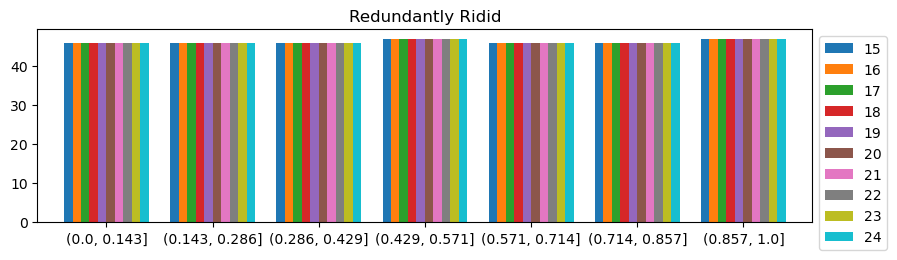

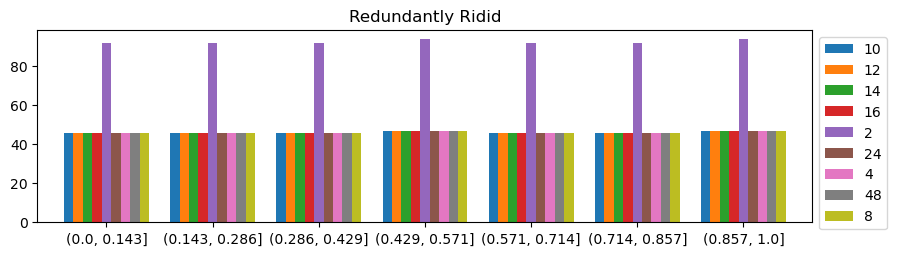

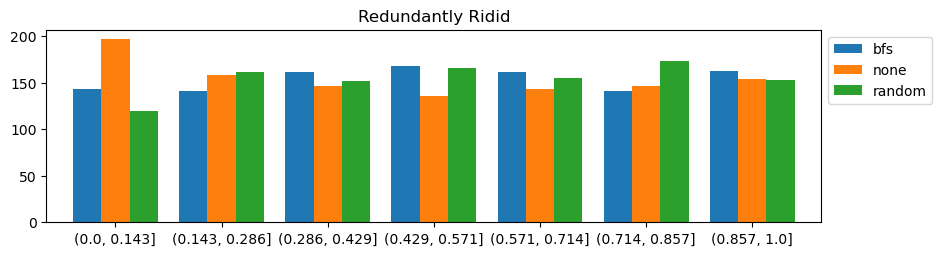

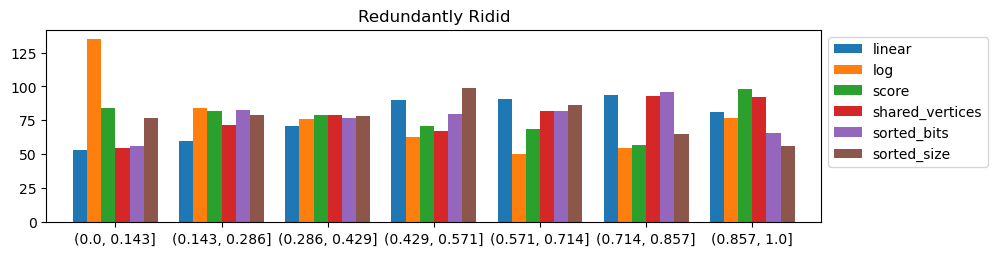

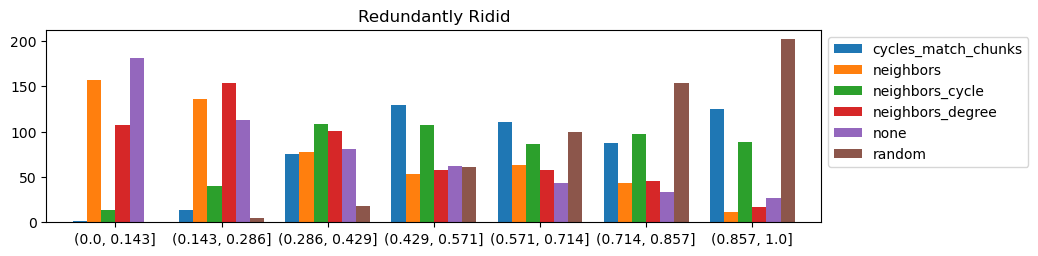

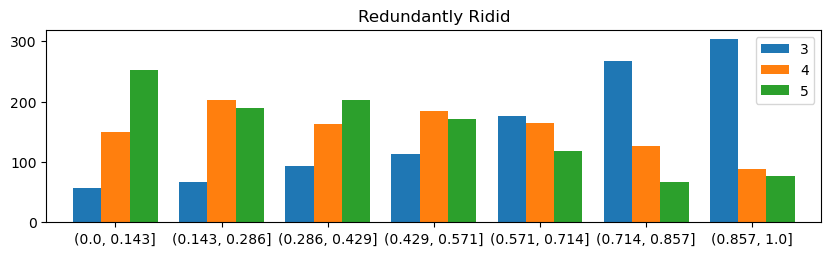

In [30]:
input = """
--------------------------------------------------------------------------------
Name (time in ms)                                                                                       Min                   Max                  Mean            StdDev                Median               IQR            Outliers     OPS            Rounds  Iterations
--------------------------------------------------------------------------------

test_RedundantlyRigidAll[15-48-none-subgraphs-score-none-3-smart]                                1,027.0171 (7.28)     1,027.0171 (7.28)     1,027.0171 (7.28)     0.0000 (1.0)      1,027.0171 (7.28)     0.0000 (1.0)           0;0  0.9737 (0.14)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-score-none-5-smart]                                1,046.2371 (7.42)     1,046.2371 (7.42)     1,046.2371 (7.42)     0.0000 (1.0)      1,046.2371 (7.42)     0.0000 (1.0)           0;0  0.9558 (0.13)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-score-none-4-smart]                                1,051.2453 (7.46)     1,051.2453 (7.46)     1,051.2453 (7.46)     0.0000 (1.0)      1,051.2453 (7.46)     0.0000 (1.0)           0;0  0.9513 (0.13)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-linear-none-5-smart]                               1,066.5090 (7.56)     1,066.5090 (7.56)     1,066.5090 (7.56)     0.0000 (1.0)      1,066.5090 (7.56)     0.0000 (1.0)           0;0  0.9376 (0.13)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-linear-none-4-smart]                               1,071.1912 (7.60)     1,071.1912 (7.60)     1,071.1912 (7.60)     0.0000 (1.0)      1,071.1912 (7.60)     0.0000 (1.0)           0;0  0.9335 (0.13)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-log-none-5-smart]                                  1,075.9645 (7.63)     1,075.9645 (7.63)     1,075.9645 (7.63)     0.0000 (1.0)      1,075.9645 (7.63)     0.0000 (1.0)           0;0  0.9294 (0.13)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-log-none-4-smart]                                  1,079.0906 (7.65)     1,079.0906 (7.65)     1,079.0906 (7.65)     0.0000 (1.0)      1,079.0906 (7.65)     0.0000 (1.0)           0;0  0.9267 (0.13)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-sorted_bits-none-5-smart]                          1,081.2428 (7.67)     1,081.2428 (7.67)     1,081.2428 (7.67)     0.0000 (1.0)      1,081.2428 (7.67)     0.0000 (1.0)           0;0  0.9249 (0.13)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-sorted_size-none-5-smart]                          1,089.6443 (7.73)     1,089.6443 (7.73)     1,089.6443 (7.73)     0.0000 (1.0)      1,089.6443 (7.73)     0.0000 (1.0)           0;0  0.9177 (0.13)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-sorted_size-none-4-smart]                          1,095.7419 (7.77)     1,095.7419 (7.77)     1,095.7419 (7.77)     0.0000 (1.0)      1,095.7419 (7.77)     0.0000 (1.0)           0;0  0.9126 (0.13)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-sorted_bits-none-4-smart]                          1,114.1732 (7.90)     1,114.1732 (7.90)     1,114.1732 (7.90)     0.0000 (1.0)      1,114.1732 (7.90)     0.0000 (1.0)           0;0  0.8975 (0.13)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-shared_vertices-neighbors-4-smart]                  1,122.3038 (7.96)     1,122.3038 (7.96)     1,122.3038 (7.96)     0.0000 (1.0)      1,122.3038 (7.96)     0.0000 (1.0)           0;0  0.8910 (0.13)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-shared_vertices-neighbors-5-smart]                  1,139.9536 (8.08)     1,139.9536 (8.08)     1,139.9536 (8.08)     0.0000 (1.0)      1,139.9536 (8.08)     0.0000 (1.0)           0;0  0.8772 (0.12)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-sorted_size-none-4-smart]                        1,141.8516 (8.10)     1,141.8516 (8.10)     1,141.8516 (8.10)     0.0000 (1.0)      1,141.8516 (8.10)     0.0000 (1.0)           0;0  0.8758 (0.12)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-sorted_size-neighbors-5-smart]                      1,144.1442 (8.11)     1,144.1442 (8.11)     1,144.1442 (8.11)     0.0000 (1.0)      1,144.1442 (8.11)     0.0000 (1.0)           0;0  0.8740 (0.12)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-shared_vertices-neighbors-5-smart]               1,157.3620 (8.21)     1,157.3620 (8.21)     1,157.3620 (8.21)     0.0000 (1.0)      1,157.3620 (8.21)     0.0000 (1.0)           0;0  0.8640 (0.12)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-sorted_size-neighbors_degree-4-smart]              1,157.7135 (8.21)     1,157.7135 (8.21)     1,157.7135 (8.21)     0.0000 (1.0)      1,157.7135 (8.21)     0.0000 (1.0)           0;0  0.8638 (0.12)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-sorted_size-none-5-smart]                        1,159.5359 (8.22)     1,159.5359 (8.22)     1,159.5359 (8.22)     0.0000 (1.0)      1,159.5359 (8.22)     0.0000 (1.0)           0;0  0.8624 (0.12)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-shared_vertices-neighbors-4-smart]               1,160.6370 (8.23)     1,160.6370 (8.23)     1,160.6370 (8.23)     0.0000 (1.0)      1,160.6370 (8.23)     0.0000 (1.0)           0;0  0.8616 (0.12)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-linear-neighbors_degree-5-smart]                    1,162.5027 (8.24)     1,162.5027 (8.24)     1,162.5027 (8.24)     0.0000 (1.0)      1,162.5027 (8.24)     0.0000 (1.0)           0;0  0.8602 (0.12)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-sorted_size-neighbors_degree-5-smart]              1,164.4915 (8.26)     1,164.4915 (8.26)     1,164.4915 (8.26)     0.0000 (1.0)      1,164.4915 (8.26)     0.0000 (1.0)           0;0  0.8587 (0.12)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-shared_vertices-neighbors_degree-4-smart]           1,168.4248 (8.29)     1,168.4248 (8.29)     1,168.4248 (8.29)     0.0000 (1.0)      1,168.4248 (8.29)     0.0000 (1.0)           0;0  0.8559 (0.12)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-sorted_size-neighbors-4-smart]                   1,168.4757 (8.29)     1,168.4757 (8.29)     1,168.4757 (8.29)     0.0000 (1.0)      1,168.4757 (8.29)     0.0000 (1.0)           0;0  0.8558 (0.12)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-shared_vertices-neighbors_degree-5-smart]           1,173.3579 (8.32)     1,173.3579 (8.32)     1,173.3579 (8.32)     0.0000 (1.0)      1,173.3579 (8.32)     0.0000 (1.0)           0;0  0.8523 (0.12)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-sorted_bits-neighbors-4-smart]                      1,177.0921 (8.35)     1,177.0921 (8.35)     1,177.0921 (8.35)     0.0000 (1.0)      1,177.0921 (8.35)     0.0000 (1.0)           0;0  0.8496 (0.12)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-score-neighbors-4-smart]                            1,178.1460 (8.36)     1,178.1460 (8.36)     1,178.1460 (8.36)     0.0000 (1.0)      1,178.1460 (8.36)     0.0000 (1.0)           0;0  0.8488 (0.12)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-sorted_size-neighbors-4-smart]                      1,179.4852 (8.37)     1,179.4852 (8.37)     1,179.4852 (8.37)     0.0000 (1.0)      1,179.4852 (8.37)     0.0000 (1.0)           0;0  0.8478 (0.12)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-linear-neighbors_degree-5-smart]                   1,183.2839 (8.39)     1,183.2839 (8.39)     1,183.2839 (8.39)     0.0000 (1.0)      1,183.2839 (8.39)     0.0000 (1.0)           0;0  0.8451 (0.12)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-sorted_size-none-5-smart]                           1,185.3360 (8.41)     1,185.3360 (8.41)     1,185.3360 (8.41)     0.0000 (1.0)      1,185.3360 (8.41)     0.0000 (1.0)           0;0  0.8436 (0.12)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-linear-neighbors-4-smart]                           1,187.7537 (8.42)     1,187.7537 (8.42)     1,187.7537 (8.42)     0.0000 (1.0)      1,187.7537 (8.42)     0.0000 (1.0)           0;0  0.8419 (0.12)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-sorted_size-neighbors_degree-4-smart]               1,191.7263 (8.45)     1,191.7263 (8.45)     1,191.7263 (8.45)     0.0000 (1.0)      1,191.7263 (8.45)     0.0000 (1.0)           0;0  0.8391 (0.12)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-linear-neighbors-5-smart]                           1,197.3269 (8.49)     1,197.3269 (8.49)     1,197.3269 (8.49)     0.0000 (1.0)      1,197.3269 (8.49)     0.0000 (1.0)           0;0  0.8352 (0.12)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-sorted_bits-neighbors_degree-5-smart]            1,199.4764 (8.51)     1,199.4764 (8.51)     1,199.4764 (8.51)     0.0000 (1.0)      1,199.4764 (8.51)     0.0000 (1.0)           0;0  0.8337 (0.12)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-sorted_size-none-4-smart]                           1,200.5536 (8.51)     1,200.5536 (8.51)     1,200.5536 (8.51)     0.0000 (1.0)      1,200.5536 (8.51)     0.0000 (1.0)           0;0  0.8329 (0.12)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-score-neighbors-5-smart]                            1,205.3354 (8.55)     1,205.3354 (8.55)     1,205.3354 (8.55)     0.0000 (1.0)      1,205.3354 (8.55)     0.0000 (1.0)           0;0  0.8296 (0.12)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-sorted_size-neighbors_degree-5-smart]               1,206.2709 (8.56)     1,206.2709 (8.56)     1,206.2709 (8.56)     0.0000 (1.0)      1,206.2709 (8.56)     0.0000 (1.0)           0;0  0.8290 (0.12)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-sorted_bits-neighbors-5-smart]                      1,207.2394 (8.56)     1,207.2394 (8.56)     1,207.2394 (8.56)     0.0000 (1.0)      1,207.2394 (8.56)     0.0000 (1.0)           0;0  0.8283 (0.12)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-linear-neighbors_degree-4-smart]                    1,210.0333 (8.58)     1,210.0333 (8.58)     1,210.0333 (8.58)     0.0000 (1.0)      1,210.0333 (8.58)     0.0000 (1.0)           0;0  0.8264 (0.12)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-score-neighbors-3-smart]                            1,210.1134 (8.58)     1,210.1134 (8.58)     1,210.1134 (8.58)     0.0000 (1.0)      1,210.1134 (8.58)     0.0000 (1.0)           0;0  0.8264 (0.12)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-sorted_bits-neighbors_degree-5-smart]               1,213.3875 (8.61)     1,213.3875 (8.61)     1,213.3875 (8.61)     0.0000 (1.0)      1,213.3875 (8.61)     0.0000 (1.0)           0;0  0.8241 (0.12)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-linear-neighbors_degree-4-smart]                   1,215.9575 (8.62)     1,215.9575 (8.62)     1,215.9575 (8.62)     0.0000 (1.0)      1,215.9575 (8.62)     0.0000 (1.0)           0;0  0.8224 (0.12)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-sorted_bits-neighbors_degree-4-smart]            1,224.6604 (8.69)     1,224.6604 (8.69)     1,224.6604 (8.69)     0.0000 (1.0)      1,224.6604 (8.69)     0.0000 (1.0)           0;0  0.8166 (0.12)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-sorted_bits-neighbors_degree-4-smart]               1,228.5597 (8.71)     1,228.5597 (8.71)     1,228.5597 (8.71)     0.0000 (1.0)      1,228.5597 (8.71)     0.0000 (1.0)           0;0  0.8140 (0.11)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-log-neighbors-5-smart]                              1,229.3764 (8.72)     1,229.3764 (8.72)     1,229.3764 (8.72)     0.0000 (1.0)      1,229.3764 (8.72)     0.0000 (1.0)           0;0  0.8134 (0.11)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-sorted_size-neighbors-5-smart]                   1,232.9282 (8.74)     1,232.9282 (8.74)     1,232.9282 (8.74)     0.0000 (1.0)      1,232.9282 (8.74)     0.0000 (1.0)           0;0  0.8111 (0.11)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-log-neighbors-5-smart]                           1,237.0819 (8.77)     1,237.0819 (8.77)     1,237.0819 (8.77)     0.0000 (1.0)      1,237.0819 (8.77)     0.0000 (1.0)           0;0  0.8084 (0.11)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-score-neighbors_degree-4-smart]                     1,237.5411 (8.78)     1,237.5411 (8.78)     1,237.5411 (8.78)     0.0000 (1.0)      1,237.5411 (8.78)     0.0000 (1.0)           0;0  0.8081 (0.11)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-linear-neighbors-4-smart]                          1,238.6523 (8.78)     1,238.6523 (8.78)     1,238.6523 (8.78)     0.0000 (1.0)      1,238.6523 (8.78)     0.0000 (1.0)           0;0  0.8073 (0.11)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-log-neighbors_degree-4-smart]                       1,239.3942 (8.79)     1,239.3942 (8.79)     1,239.3942 (8.79)     0.0000 (1.0)      1,239.3942 (8.79)     0.0000 (1.0)           0;0  0.8068 (0.11)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-score-neighbors-5-smart]                         1,241.0410 (8.80)     1,241.0410 (8.80)     1,241.0410 (8.80)     0.0000 (1.0)      1,241.0410 (8.80)     0.0000 (1.0)           0;0  0.8058 (0.11)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-score-neighbors-4-smart]                         1,242.2801 (8.81)     1,242.2801 (8.81)     1,242.2801 (8.81)     0.0000 (1.0)      1,242.2801 (8.81)     0.0000 (1.0)           0;0  0.8050 (0.11)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-log-neighbors_degree-5-smart]                      1,243.4971 (8.82)     1,243.4971 (8.82)     1,243.4971 (8.82)     0.0000 (1.0)      1,243.4971 (8.82)     0.0000 (1.0)           0;0  0.8042 (0.11)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-log-neighbors-4-smart]                              1,246.1385 (8.84)     1,246.1385 (8.84)     1,246.1385 (8.84)     0.0000 (1.0)      1,246.1385 (8.84)     0.0000 (1.0)           0;0  0.8025 (0.11)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-sorted_bits-neighbors_degree-5-smart]              1,248.2914 (8.85)     1,248.2914 (8.85)     1,248.2914 (8.85)     0.0000 (1.0)      1,248.2914 (8.85)     0.0000 (1.0)           0;0  0.8011 (0.11)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-sorted_bits-none-5-smart]                           1,248.3333 (8.85)     1,248.3333 (8.85)     1,248.3333 (8.85)     0.0000 (1.0)      1,248.3333 (8.85)     0.0000 (1.0)           0;0  0.8011 (0.11)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-score-neighbors_degree-5-smart]                  1,248.3765 (8.85)     1,248.3765 (8.85)     1,248.3765 (8.85)     0.0000 (1.0)      1,248.3765 (8.85)     0.0000 (1.0)           0;0  0.8010 (0.11)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-sorted_bits-neighbors_degree-4-smart]              1,248.4126 (8.85)     1,248.4126 (8.85)     1,248.4126 (8.85)     0.0000 (1.0)      1,248.4126 (8.85)     0.0000 (1.0)           0;0  0.8010 (0.11)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-log-neighbors_degree-5-smart]                       1,249.3680 (8.86)     1,249.3680 (8.86)     1,249.3680 (8.86)     0.0000 (1.0)      1,249.3680 (8.86)     0.0000 (1.0)           0;0  0.8004 (0.11)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-log-neighbors_degree-4-smart]                      1,249.8539 (8.86)     1,249.8539 (8.86)     1,249.8539 (8.86)     0.0000 (1.0)      1,249.8539 (8.86)     0.0000 (1.0)           0;0  0.8001 (0.11)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-score-none-3-smart]                                 1,249.9044 (8.86)     1,249.9044 (8.86)     1,249.9044 (8.86)     0.0000 (1.0)      1,249.9044 (8.86)     0.0000 (1.0)           0;0  0.8001 (0.11)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-linear-none-4-smart]                             1,253.4133 (8.89)     1,253.4133 (8.89)     1,253.4133 (8.89)     0.0000 (1.0)      1,253.4133 (8.89)     0.0000 (1.0)           0;0  0.7978 (0.11)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-shared_vertices-neighbors_degree-5-smart]        1,253.6363 (8.89)     1,253.6363 (8.89)     1,253.6363 (8.89)     0.0000 (1.0)      1,253.6363 (8.89)     0.0000 (1.0)           0;0  0.7977 (0.11)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-sorted_size-neighbors-5-smart]                     1,256.5005 (8.91)     1,256.5005 (8.91)     1,256.5005 (8.91)     0.0000 (1.0)      1,256.5005 (8.91)     0.0000 (1.0)           0;0  0.7959 (0.11)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-log-neighbors-5-smart]                             1,259.3605 (8.93)     1,259.3605 (8.93)     1,259.3605 (8.93)     0.0000 (1.0)      1,259.3605 (8.93)     0.0000 (1.0)           0;0  0.7941 (0.11)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-shared_vertices-neighbors_degree-5-smart]          1,265.5298 (8.98)     1,265.5298 (8.98)     1,265.5298 (8.98)     0.0000 (1.0)      1,265.5298 (8.98)     0.0000 (1.0)           0;0  0.7902 (0.11)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-log-none-4-smart]                                   1,266.2497 (8.98)     1,266.2497 (8.98)     1,266.2497 (8.98)     0.0000 (1.0)      1,266.2497 (8.98)     0.0000 (1.0)           0;0  0.7897 (0.11)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-score-none-4-smart]                                 1,266.2977 (8.98)     1,266.2977 (8.98)     1,266.2977 (8.98)     0.0000 (1.0)      1,266.2977 (8.98)     0.0000 (1.0)           0;0  0.7897 (0.11)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-score-neighbors_degree-4-smart]                  1,269.9806 (9.01)     1,269.9806 (9.01)     1,269.9806 (9.01)     0.0000 (1.0)      1,269.9806 (9.01)     0.0000 (1.0)           0;0  0.7874 (0.11)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-shared_vertices-neighbors_degree-4-smart]          1,272.0086 (9.02)     1,272.0086 (9.02)     1,272.0086 (9.02)     0.0000 (1.0)      1,272.0086 (9.02)     0.0000 (1.0)           0;0  0.7862 (0.11)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-log-none-3-smart]                                  1,272.0755 (9.02)     1,272.0755 (9.02)     1,272.0755 (9.02)     0.0000 (1.0)      1,272.0755 (9.02)     0.0000 (1.0)           0;0  0.7861 (0.11)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-sorted_size-neighbors-4-smart]                     1,277.8291 (9.06)     1,277.8291 (9.06)     1,277.8291 (9.06)     0.0000 (1.0)      1,277.8291 (9.06)     0.0000 (1.0)           0;0  0.7826 (0.11)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-sorted_bits-neighbors-5-smart]                     1,280.1727 (9.08)     1,280.1727 (9.08)     1,280.1727 (9.08)     0.0000 (1.0)      1,280.1727 (9.08)     0.0000 (1.0)           0;0  0.7811 (0.11)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-sorted_bits-none-4-smart]                           1,280.4041 (9.08)     1,280.4041 (9.08)     1,280.4041 (9.08)     0.0000 (1.0)      1,280.4041 (9.08)     0.0000 (1.0)           0;0  0.7810 (0.11)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-shared_vertices-none-4-smart]                       1,281.7851 (9.09)     1,281.7851 (9.09)     1,281.7851 (9.09)     0.0000 (1.0)      1,281.7851 (9.09)     0.0000 (1.0)           0;0  0.7802 (0.11)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-linear-none-3-smart]                               1,281.7994 (9.09)     1,281.7994 (9.09)     1,281.7994 (9.09)     0.0000 (1.0)      1,281.7994 (9.09)     0.0000 (1.0)           0;0  0.7802 (0.11)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-score-none-5-smart]                              1,285.9245 (9.12)     1,285.9245 (9.12)     1,285.9245 (9.12)     0.0000 (1.0)      1,285.9245 (9.12)     0.0000 (1.0)           0;0  0.7777 (0.11)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-sorted_bits-neighbors-4-smart]                     1,286.4593 (9.12)     1,286.4593 (9.12)     1,286.4593 (9.12)     0.0000 (1.0)      1,286.4593 (9.12)     0.0000 (1.0)           0;0  0.7773 (0.11)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-score-neighbors_degree-3-smart]                     1,291.0747 (9.16)     1,291.0747 (9.16)     1,291.0747 (9.16)     0.0000 (1.0)      1,291.0747 (9.16)     0.0000 (1.0)           0;0  0.7745 (0.11)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-shared_vertices-none-5-smart]                    1,291.0879 (9.16)     1,291.0879 (9.16)     1,291.0879 (9.16)     0.0000 (1.0)      1,291.0879 (9.16)     0.0000 (1.0)           0;0  0.7745 (0.11)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-sorted_size-none-3-smart]                        1,296.7065 (9.20)     1,296.7065 (9.20)     1,296.7065 (9.20)     0.0000 (1.0)      1,296.7065 (9.20)     0.0000 (1.0)           0;0  0.7712 (0.11)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-log-neighbors-4-smart]                             1,298.6358 (9.21)     1,298.6358 (9.21)     1,298.6358 (9.21)     0.0000 (1.0)      1,298.6358 (9.21)     0.0000 (1.0)           0;0  0.7700 (0.11)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-score-none-4-smart]                              1,299.7094 (9.22)     1,299.7094 (9.22)     1,299.7094 (9.22)     0.0000 (1.0)      1,299.7094 (9.22)     0.0000 (1.0)           0;0  0.7694 (0.11)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-score-neighbors_degree-3-smart]                    1,301.8312 (9.23)     1,301.8312 (9.23)     1,301.8312 (9.23)     0.0000 (1.0)      1,301.8312 (9.23)     0.0000 (1.0)           0;0  0.7681 (0.11)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-score-neighbors_degree-3-smart]                  1,305.6434 (9.26)     1,305.6434 (9.26)     1,305.6434 (9.26)     0.0000 (1.0)      1,305.6434 (9.26)     0.0000 (1.0)           0;0  0.7659 (0.11)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-score-none-5-smart]                                 1,309.0846 (9.28)     1,309.0846 (9.28)     1,309.0846 (9.28)     0.0000 (1.0)      1,309.0846 (9.28)     0.0000 (1.0)           0;0  0.7639 (0.11)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-score-neighbors-3-smart]                         1,309.3365 (9.29)     1,309.3365 (9.29)     1,309.3365 (9.29)     0.0000 (1.0)      1,309.3365 (9.29)     0.0000 (1.0)           0;0  0.7637 (0.11)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-shared_vertices-none-4-smart]                      1,309.6215 (9.29)     1,309.6215 (9.29)     1,309.6215 (9.29)     0.0000 (1.0)      1,309.6215 (9.29)     0.0000 (1.0)           0;0  0.7636 (0.11)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-shared_vertices-none-4-smart]                    1,315.9629 (9.33)     1,315.9629 (9.33)     1,315.9629 (9.33)     0.0000 (1.0)      1,315.9629 (9.33)     0.0000 (1.0)           0;0  0.7599 (0.11)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-sorted_size-random-5-smart]                      1,317.3338 (9.34)     1,317.3338 (9.34)     1,317.3338 (9.34)     0.0000 (1.0)      1,317.3338 (9.34)     0.0000 (1.0)           0;0  0.7591 (0.11)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-shared_vertices-none-5-smart]                       1,323.5007 (9.39)     1,323.5007 (9.39)     1,323.5007 (9.39)     0.0000 (1.0)      1,323.5007 (9.39)     0.0000 (1.0)           0;0  0.7556 (0.11)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-sorted_size-cycles_match_chunks-5-smart]         1,324.6200 (9.39)     1,324.6200 (9.39)     1,324.6200 (9.39)     0.0000 (1.0)      1,324.6200 (9.39)     0.0000 (1.0)           0;0  0.7549 (0.11)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-linear-neighbors-4-smart]                        1,326.5292 (9.41)     1,326.5292 (9.41)     1,326.5292 (9.41)     0.0000 (1.0)      1,326.5292 (9.41)     0.0000 (1.0)           0;0  0.7538 (0.11)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-sorted_size-none-3-smart]                           1,331.7185 (9.44)     1,331.7185 (9.44)     1,331.7185 (9.44)     0.0000 (1.0)      1,331.7185 (9.44)     0.0000 (1.0)           0;0  0.7509 (0.11)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-score-neighbors-3-smart]                           1,336.8073 (9.48)     1,336.8073 (9.48)     1,336.8073 (9.48)     0.0000 (1.0)      1,336.8073 (9.48)     0.0000 (1.0)           0;0  0.7481 (0.11)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-shared_vertices-neighbors_degree-4-smart]        1,337.0619 (9.48)     1,337.0619 (9.48)     1,337.0619 (9.48)     0.0000 (1.0)      1,337.0619 (9.48)     0.0000 (1.0)           0;0  0.7479 (0.11)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-sorted_size-neighbors_degree-5-smart]            1,337.9908 (9.49)     1,337.9908 (9.49)     1,337.9908 (9.49)     0.0000 (1.0)      1,337.9908 (9.49)     0.0000 (1.0)           0;0  0.7474 (0.11)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-sorted_size-none-3-smart]                          1,339.1199 (9.50)     1,339.1199 (9.50)     1,339.1199 (9.50)     0.0000 (1.0)      1,339.1199 (9.50)     0.0000 (1.0)           0;0  0.7468 (0.11)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-score-random-5-smart]                              1,339.1273 (9.50)     1,339.1273 (9.50)     1,339.1273 (9.50)     0.0000 (1.0)      1,339.1273 (9.50)     0.0000 (1.0)           0;0  0.7468 (0.11)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-sorted_bits-none-3-smart]                          1,341.4882 (9.51)     1,341.4882 (9.51)     1,341.4882 (9.51)     0.0000 (1.0)      1,341.4882 (9.51)     0.0000 (1.0)           0;0  0.7454 (0.11)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-shared_vertices-neighbors_cycle-4-smart]            1,343.7676 (9.53)     1,343.7676 (9.53)     1,343.7676 (9.53)     0.0000 (1.0)      1,343.7676 (9.53)     0.0000 (1.0)           0;0  0.7442 (0.10)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-shared_vertices-cycles_match_chunks-4-smart]        1,344.7542 (9.54)     1,344.7542 (9.54)     1,344.7542 (9.54)     0.0000 (1.0)      1,344.7542 (9.54)     0.0000 (1.0)           0;0  0.7436 (0.10)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-score-none-3-smart]                              1,346.4869 (9.55)     1,346.4869 (9.55)     1,346.4869 (9.55)     0.0000 (1.0)      1,346.4869 (9.55)     0.0000 (1.0)           0;0  0.7427 (0.10)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-log-none-5-smart]                                   1,346.4948 (9.55)     1,346.4948 (9.55)     1,346.4948 (9.55)     0.0000 (1.0)      1,346.4948 (9.55)     0.0000 (1.0)           0;0  0.7427 (0.10)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-score-neighbors_degree-4-smart]                    1,349.1492 (9.57)     1,349.1492 (9.57)     1,349.1492 (9.57)     0.0000 (1.0)      1,349.1492 (9.57)     0.0000 (1.0)           0;0  0.7412 (0.10)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-linear-none-4-smart]                                1,349.2981 (9.57)     1,349.2981 (9.57)     1,349.2981 (9.57)     0.0000 (1.0)      1,349.2981 (9.57)     0.0000 (1.0)           0;0  0.7411 (0.10)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-linear-cycles_match_chunks-5-smart]                1,350.9094 (9.58)     1,350.9094 (9.58)     1,350.9094 (9.58)     0.0000 (1.0)      1,350.9094 (9.58)     0.0000 (1.0)           0;0  0.7402 (0.10)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-sorted_size-neighbors_degree-4-smart]            1,352.6732 (9.59)     1,352.6732 (9.59)     1,352.6732 (9.59)     0.0000 (1.0)      1,352.6732 (9.59)     0.0000 (1.0)           0;0  0.7393 (0.10)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-linear-neighbors-5-smart]                        1,352.9398 (9.60)     1,352.9398 (9.60)     1,352.9398 (9.60)     0.0000 (1.0)      1,352.9398 (9.60)     0.0000 (1.0)           0;0  0.7391 (0.10)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]     1,354.0869 (9.60)     1,354.0869 (9.60)     1,354.0869 (9.60)     0.0000 (1.0)      1,354.0869 (9.60)     0.0000 (1.0)           0;0  0.7385 (0.10)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-score-random-3-smart]                              1,354.6589 (9.61)     1,354.6589 (9.61)     1,354.6589 (9.61)     0.0000 (1.0)      1,354.6589 (9.61)     0.0000 (1.0)           0;0  0.7382 (0.10)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-sorted_bits-neighbors-4-smart]                   1,356.0263 (9.62)     1,356.0263 (9.62)     1,356.0263 (9.62)     0.0000 (1.0)      1,356.0263 (9.62)     0.0000 (1.0)           0;0  0.7374 (0.10)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-sorted_size-cycles_match_chunks-5-smart]           1,358.8408 (9.64)     1,358.8408 (9.64)     1,358.8408 (9.64)     0.0000 (1.0)      1,358.8408 (9.64)     0.0000 (1.0)           0;0  0.7359 (0.10)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-sorted_size-neighbors_cycle-4-smart]                1,359.7156 (9.64)     1,359.7156 (9.64)     1,359.7156 (9.64)     0.0000 (1.0)      1,359.7156 (9.64)     0.0000 (1.0)           0;0  0.7354 (0.10)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-sorted_bits-cycles_match_chunks-5-smart]           1,359.9584 (9.65)     1,359.9584 (9.65)     1,359.9584 (9.65)     0.0000 (1.0)      1,359.9584 (9.65)     0.0000 (1.0)           0;0  0.7353 (0.10)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-score-random-4-smart]                              1,360.1315 (9.65)     1,360.1315 (9.65)     1,360.1315 (9.65)     0.0000 (1.0)      1,360.1315 (9.65)     0.0000 (1.0)           0;0  0.7352 (0.10)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-shared_vertices-neighbors_cycle-5-smart]            1,361.0697 (9.65)     1,361.0697 (9.65)     1,361.0697 (9.65)     0.0000 (1.0)      1,361.0697 (9.65)     0.0000 (1.0)           0;0  0.7347 (0.10)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-linear-neighbors-5-smart]                          1,362.4797 (9.66)     1,362.4797 (9.66)     1,362.4797 (9.66)     0.0000 (1.0)      1,362.4797 (9.66)     0.0000 (1.0)           0;0  0.7340 (0.10)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-score-cycles_match_chunks-5-smart]                  1,363.1191 (9.67)     1,363.1191 (9.67)     1,363.1191 (9.67)     0.0000 (1.0)      1,363.1191 (9.67)     0.0000 (1.0)           0;0  0.7336 (0.10)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-sorted_bits-neighbors-5-smart]                   1,363.4125 (9.67)     1,363.4125 (9.67)     1,363.4125 (9.67)     0.0000 (1.0)      1,363.4125 (9.67)     0.0000 (1.0)           0;0  0.7335 (0.10)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-linear-random-4-smart]                              1,363.7704 (9.67)     1,363.7704 (9.67)     1,363.7704 (9.67)     0.0000 (1.0)      1,363.7704 (9.67)     0.0000 (1.0)           0;0  0.7333 (0.10)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-linear-neighbors_cycle-5-smart]                    1,364.1383 (9.67)     1,364.1383 (9.67)     1,364.1383 (9.67)     0.0000 (1.0)      1,364.1383 (9.67)     0.0000 (1.0)           0;0  0.7331 (0.10)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-log-none-3-smart]                                   1,364.7004 (9.68)     1,364.7004 (9.68)     1,364.7004 (9.68)     0.0000 (1.0)      1,364.7004 (9.68)     0.0000 (1.0)           0;0  0.7328 (0.10)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-linear-none-5-smart]                                1,366.9456 (9.69)     1,366.9456 (9.69)     1,366.9456 (9.69)     0.0000 (1.0)      1,366.9456 (9.69)     0.0000 (1.0)           0;0  0.7316 (0.10)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]     1,368.0628 (9.70)     1,368.0628 (9.70)     1,368.0628 (9.70)     0.0000 (1.0)      1,368.0628 (9.70)     0.0000 (1.0)           0;0  0.7310 (0.10)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-sorted_size-cycles_match_chunks-5-smart]            1,368.6147 (9.71)     1,368.6147 (9.71)     1,368.6147 (9.71)     0.0000 (1.0)      1,368.6147 (9.71)     0.0000 (1.0)           0;0  0.7307 (0.10)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-linear-neighbors_cycle-4-smart]                    1,368.6390 (9.71)     1,368.6390 (9.71)     1,368.6390 (9.71)     0.0000 (1.0)      1,368.6390 (9.71)     0.0000 (1.0)           0;0  0.7307 (0.10)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-sorted_bits-cycles_match_chunks-4-smart]           1,370.2057 (9.72)     1,370.2057 (9.72)     1,370.2057 (9.72)     0.0000 (1.0)      1,370.2057 (9.72)     0.0000 (1.0)           0;0  0.7298 (0.10)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-log-random-4-smart]                                 1,370.5774 (9.72)     1,370.5774 (9.72)     1,370.5774 (9.72)     0.0000 (1.0)      1,370.5774 (9.72)     0.0000 (1.0)           0;0  0.7296 (0.10)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-score-cycles_match_chunks-4-smart]                  1,372.2492 (9.73)     1,372.2492 (9.73)     1,372.2492 (9.73)     0.0000 (1.0)      1,372.2492 (9.73)     0.0000 (1.0)           0;0  0.7287 (0.10)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-log-random-5-smart]                                1,378.3293 (9.78)     1,378.3293 (9.78)     1,378.3293 (9.78)     0.0000 (1.0)      1,378.3293 (9.78)     0.0000 (1.0)           0;0  0.7255 (0.10)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-log-neighbors_degree-3-smart]                       1,378.6849 (9.78)     1,378.6849 (9.78)     1,378.6849 (9.78)     0.0000 (1.0)      1,378.6849 (9.78)     0.0000 (1.0)           0;0  0.7253 (0.10)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-shared_vertices-none-5-smart]                      1,379.3139 (9.78)     1,379.3139 (9.78)     1,379.3139 (9.78)     0.0000 (1.0)      1,379.3139 (9.78)     0.0000 (1.0)           0;0  0.7250 (0.10)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-shared_vertices-neighbors-4-smart]                 1,379.3388 (9.78)     1,379.3388 (9.78)     1,379.3388 (9.78)     0.0000 (1.0)      1,379.3388 (9.78)     0.0000 (1.0)           0;0  0.7250 (0.10)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-linear-random-5-smart]                              1,381.6287 (9.80)     1,381.6287 (9.80)     1,381.6287 (9.80)     0.0000 (1.0)      1,381.6287 (9.80)     0.0000 (1.0)           0;0  0.7238 (0.10)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-log-cycles_match_chunks-5-smart]                    1,382.5781 (9.81)     1,382.5781 (9.81)     1,382.5781 (9.81)     0.0000 (1.0)      1,382.5781 (9.81)     0.0000 (1.0)           0;0  0.7233 (0.10)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-linear-neighbors_degree-3-smart]                   1,382.9700 (9.81)     1,382.9700 (9.81)     1,382.9700 (9.81)     0.0000 (1.0)      1,382.9700 (9.81)     0.0000 (1.0)           0;0  0.7231 (0.10)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-sorted_size-random-4-smart]                      1,383.7299 (9.81)     1,383.7299 (9.81)     1,383.7299 (9.81)     0.0000 (1.0)      1,383.7299 (9.81)     0.0000 (1.0)           0;0  0.7227 (0.10)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-log-random-4-smart]                                1,384.1360 (9.82)     1,384.1360 (9.82)     1,384.1360 (9.82)     0.0000 (1.0)      1,384.1360 (9.82)     0.0000 (1.0)           0;0  0.7225 (0.10)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-linear-neighbors_degree-4-smart]                 1,384.3903 (9.82)     1,384.3903 (9.82)     1,384.3903 (9.82)     0.0000 (1.0)      1,384.3903 (9.82)     0.0000 (1.0)           0;0  0.7223 (0.10)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-linear-cycles_match_chunks-4-smart]                 1,385.2213 (9.82)     1,385.2213 (9.82)     1,385.2213 (9.82)     0.0000 (1.0)      1,385.2213 (9.82)     0.0000 (1.0)           0;0  0.7219 (0.10)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-sorted_size-cycles_match_chunks-4-smart]         1,385.2538 (9.82)     1,385.2538 (9.82)     1,385.2538 (9.82)     0.0000 (1.0)      1,385.2538 (9.82)     0.0000 (1.0)           0;0  0.7219 (0.10)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-sorted_bits-random-5-smart]                        1,389.5336 (9.85)     1,389.5336 (9.85)     1,389.5336 (9.85)     0.0000 (1.0)      1,389.5336 (9.85)     0.0000 (1.0)           0;0  0.7197 (0.10)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-score-cycles_match_chunks-3-smart]                  1,390.1563 (9.86)     1,390.1563 (9.86)     1,390.1563 (9.86)     0.0000 (1.0)      1,390.1563 (9.86)     0.0000 (1.0)           0;0  0.7193 (0.10)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-log-neighbors-4-smart]                           1,392.9414 (9.88)     1,392.9414 (9.88)     1,392.9414 (9.88)     0.0000 (1.0)      1,392.9414 (9.88)     0.0000 (1.0)           0;0  0.7179 (0.10)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-score-neighbors_cycle-4-smart]                      1,392.9453 (9.88)     1,392.9453 (9.88)     1,392.9453 (9.88)     0.0000 (1.0)      1,392.9453 (9.88)     0.0000 (1.0)           0;0  0.7179 (0.10)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-shared_vertices-neighbors-5-smart]                 1,393.3232 (9.88)     1,393.3232 (9.88)     1,393.3232 (9.88)     0.0000 (1.0)      1,393.3232 (9.88)     0.0000 (1.0)           0;0  0.7177 (0.10)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-shared_vertices-neighbors_degree-3-smart]           1,395.7676 (9.90)     1,395.7676 (9.90)     1,395.7676 (9.90)     0.0000 (1.0)      1,395.7676 (9.90)     0.0000 (1.0)           0;0  0.7165 (0.10)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-sorted_size-cycles_match_chunks-4-smart]           1,398.4064 (9.92)     1,398.4064 (9.92)     1,398.4064 (9.92)     0.0000 (1.0)      1,398.4064 (9.92)     0.0000 (1.0)           0;0  0.7151 (0.10)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-sorted_size-neighbors_cycle-5-smart]                1,401.9894 (9.94)     1,401.9894 (9.94)     1,401.9894 (9.94)     0.0000 (1.0)      1,401.9894 (9.94)     0.0000 (1.0)           0;0  0.7133 (0.10)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-log-neighbors_degree-3-smart]                      1,402.1798 (9.94)     1,402.1798 (9.94)     1,402.1798 (9.94)     0.0000 (1.0)      1,402.1798 (9.94)     0.0000 (1.0)           0;0  0.7132 (0.10)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-linear-random-4-smart]                             1,404.1303 (9.96)     1,404.1303 (9.96)     1,404.1303 (9.96)     0.0000 (1.0)      1,404.1303 (9.96)     0.0000 (1.0)           0;0  0.7122 (0.10)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-shared_vertices-neighbors-3-smart]               1,404.9977 (9.96)     1,404.9977 (9.96)     1,404.9977 (9.96)     0.0000 (1.0)      1,404.9977 (9.96)     0.0000 (1.0)           0;0  0.7117 (0.10)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-linear-none-5-smart]                             1,406.1351 (9.97)     1,406.1351 (9.97)     1,406.1351 (9.97)     0.0000 (1.0)      1,406.1351 (9.97)     0.0000 (1.0)           0;0  0.7112 (0.10)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-log-random-5-smart]                                 1,406.9101 (9.98)     1,406.9101 (9.98)     1,406.9101 (9.98)     0.0000 (1.0)      1,406.9101 (9.98)     0.0000 (1.0)           0;0  0.7108 (0.10)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-log-random-3-smart]                                1,408.5720 (9.99)     1,408.5720 (9.99)     1,408.5720 (9.99)     0.0000 (1.0)      1,408.5720 (9.99)     0.0000 (1.0)           0;0  0.7099 (0.10)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-log-neighbors_cycle-4-smart]                       1,410.0194 (10.00)    1,410.0194 (10.00)    1,410.0194 (10.00)    0.0000 (1.0)      1,410.0194 (10.00)    0.0000 (1.0)           0;0  0.7092 (0.10)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-score-random-5-smart]                               1,410.6291 (10.00)    1,410.6291 (10.00)    1,410.6291 (10.00)    0.0000 (1.0)      1,410.6291 (10.00)    0.0000 (1.0)           0;0  0.7089 (0.10)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-log-none-3-smart]                                1,411.1322 (10.01)    1,411.1322 (10.01)    1,411.1322 (10.01)    0.0000 (1.0)      1,411.1322 (10.01)    0.0000 (1.0)           0;0  0.7087 (0.10)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-sorted_bits-random-4-smart]                        1,411.8857 (10.01)    1,411.8857 (10.01)    1,411.8857 (10.01)    0.0000 (1.0)      1,411.8857 (10.01)    0.0000 (1.0)           0;0  0.7083 (0.10)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-score-neighbors_cycle-5-smart]                      1,415.0138 (10.04)    1,415.0138 (10.04)    1,415.0138 (10.04)    0.0000 (1.0)      1,415.0138 (10.04)    0.0000 (1.0)           0;0  0.7067 (0.10)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-log-cycles_match_chunks-4-smart]                   1,417.4400 (10.05)    1,417.4400 (10.05)    1,417.4400 (10.05)    0.0000 (1.0)      1,417.4400 (10.05)    0.0000 (1.0)           0;0  0.7055 (0.10)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-sorted_size-cycles_match_chunks-4-smart]            1,417.8627 (10.06)    1,417.8627 (10.06)    1,417.8627 (10.06)    0.0000 (1.0)      1,417.8627 (10.06)    0.0000 (1.0)           0;0  0.7053 (0.10)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-log-neighbors_cycle-5-smart]                        1,419.5759 (10.07)    1,419.5759 (10.07)    1,419.5759 (10.07)    0.0000 (1.0)      1,419.5759 (10.07)    0.0000 (1.0)           0;0  0.7044 (0.10)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-score-neighbors_cycle-5-smart]                   1,421.0639 (10.08)    1,421.0639 (10.08)    1,421.0639 (10.08)    0.0000 (1.0)      1,421.0639 (10.08)    0.0000 (1.0)           0;0  0.7037 (0.10)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-sorted_size-random-4-smart]                         1,421.3879 (10.08)    1,421.3879 (10.08)    1,421.3879 (10.08)    0.0000 (1.0)      1,421.3879 (10.08)    0.0000 (1.0)           0;0  0.7035 (0.10)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-score-random-4-smart]                               1,422.3553 (10.09)    1,422.3553 (10.09)    1,422.3553 (10.09)    0.0000 (1.0)      1,422.3553 (10.09)    0.0000 (1.0)           0;0  0.7031 (0.10)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-shared_vertices-neighbors-3-smart]                  1,422.5365 (10.09)    1,422.5365 (10.09)    1,422.5365 (10.09)    0.0000 (1.0)      1,422.5365 (10.09)    0.0000 (1.0)           0;0  0.7030 (0.10)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-sorted_bits-cycles_match_chunks-4-smart]            1,422.9571 (10.09)    1,422.9571 (10.09)    1,422.9571 (10.09)    0.0000 (1.0)      1,422.9571 (10.09)    0.0000 (1.0)           0;0  0.7028 (0.10)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-linear-cycles_match_chunks-5-smart]                 1,423.3436 (10.09)    1,423.3436 (10.09)    1,423.3436 (10.09)    0.0000 (1.0)      1,423.3436 (10.09)    0.0000 (1.0)           0;0  0.7026 (0.10)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-log-random-3-smart]                                 1,425.3394 (10.11)    1,425.3394 (10.11)    1,425.3394 (10.11)    0.0000 (1.0)      1,425.3394 (10.11)    0.0000 (1.0)           0;0  0.7016 (0.10)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-sorted_bits-none-3-smart]                           1,426.0354 (10.11)    1,426.0354 (10.11)    1,426.0354 (10.11)    0.0000 (1.0)      1,426.0354 (10.11)    0.0000 (1.0)           0;0  0.7012 (0.10)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-sorted_size-neighbors-3-smart]                   1,426.1885 (10.11)    1,426.1885 (10.11)    1,426.1885 (10.11)    0.0000 (1.0)      1,426.1885 (10.11)    0.0000 (1.0)           0;0  0.7012 (0.10)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-linear-random-5-smart]                             1,426.7134 (10.12)    1,426.7134 (10.12)    1,426.7134 (10.12)    0.0000 (1.0)      1,426.7134 (10.12)    0.0000 (1.0)           0;0  0.7009 (0.10)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-score-neighbors_cycle-4-smart]                   1,426.9749 (10.12)    1,426.9749 (10.12)    1,426.9749 (10.12)    0.0000 (1.0)      1,426.9749 (10.12)    0.0000 (1.0)           0;0  0.7008 (0.10)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-linear-random-5-smart]                           1,427.8266 (10.13)    1,427.8266 (10.13)    1,427.8266 (10.13)    0.0000 (1.0)      1,427.8266 (10.13)    0.0000 (1.0)           0;0  0.7004 (0.10)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-log-neighbors-3-smart]                             1,429.3906 (10.14)    1,429.3906 (10.14)    1,429.3906 (10.14)    0.0000 (1.0)      1,429.3906 (10.14)    0.0000 (1.0)           0;0  0.6996 (0.10)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-log-cycles_match_chunks-5-smart]                   1,429.6024 (10.14)    1,429.6024 (10.14)    1,429.6024 (10.14)    0.0000 (1.0)      1,429.6024 (10.14)    0.0000 (1.0)           0;0  0.6995 (0.10)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-log-neighbors_cycle-5-smart]                       1,432.5597 (10.16)    1,432.5597 (10.16)    1,432.5597 (10.16)    0.0000 (1.0)      1,432.5597 (10.16)    0.0000 (1.0)           0;0  0.6981 (0.10)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-score-cycles_match_chunks-4-smart]                 1,433.1441 (10.16)    1,433.1441 (10.16)    1,433.1441 (10.16)    0.0000 (1.0)      1,433.1441 (10.16)    0.0000 (1.0)           0;0  0.6978 (0.10)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-sorted_size-random-5-smart]                         1,435.1418 (10.18)    1,435.1418 (10.18)    1,435.1418 (10.18)    0.0000 (1.0)      1,435.1418 (10.18)    0.0000 (1.0)           0;0  0.6968 (0.10)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-shared_vertices-none-3-smart]                       1,435.2506 (10.18)    1,435.2506 (10.18)    1,435.2506 (10.18)    0.0000 (1.0)      1,435.2506 (10.18)    0.0000 (1.0)           0;0  0.6967 (0.10)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-linear-cycles_match_chunks-4-smart]                1,445.1829 (10.25)    1,445.1829 (10.25)    1,445.1829 (10.25)    0.0000 (1.0)      1,445.1829 (10.25)    0.0000 (1.0)           0;0  0.6920 (0.10)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-sorted_bits-neighbors_cycle-5-smart]                1,447.3900 (10.27)    1,447.3900 (10.27)    1,447.3900 (10.27)    0.0000 (1.0)      1,447.3900 (10.27)    0.0000 (1.0)           0;0  0.6909 (0.10)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]             1,450.1738 (10.28)    1,450.1738 (10.28)    1,450.1738 (10.28)    0.0000 (1.0)      1,450.1738 (10.28)    0.0000 (1.0)           0;0  0.6896 (0.10)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-sorted_size-random-5-smart]                        1,451.0578 (10.29)    1,451.0578 (10.29)    1,451.0578 (10.29)    0.0000 (1.0)      1,451.0578 (10.29)    0.0000 (1.0)           0;0  0.6892 (0.10)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-log-cycles_match_chunks-4-smart]                    1,452.9511 (10.30)    1,452.9511 (10.30)    1,452.9511 (10.30)    0.0000 (1.0)      1,452.9511 (10.30)    0.0000 (1.0)           0;0  0.6883 (0.10)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-log-cycles_match_chunks-3-smart]                    1,453.7576 (10.31)    1,453.7576 (10.31)    1,453.7576 (10.31)    0.0000 (1.0)      1,453.7576 (10.31)    0.0000 (1.0)           0;0  0.6879 (0.10)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-shared_vertices-random-5-smart]                     1,454.6667 (10.32)    1,454.6667 (10.32)    1,454.6667 (10.32)    0.0000 (1.0)      1,454.6667 (10.32)    0.0000 (1.0)           0;0  0.6874 (0.10)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-sorted_size-neighbors-3-smart]                      1,455.5208 (10.32)    1,455.5208 (10.32)    1,455.5208 (10.32)    0.0000 (1.0)      1,455.5208 (10.32)    0.0000 (1.0)           0;0  0.6870 (0.10)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-shared_vertices-neighbors_cycle-4-smart]         1,455.7715 (10.32)    1,455.7715 (10.32)    1,455.7715 (10.32)    0.0000 (1.0)      1,455.7715 (10.32)    0.0000 (1.0)           0;0  0.6869 (0.10)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-sorted_bits-cycles_match_chunks-5-smart]            1,457.0570 (10.33)    1,457.0570 (10.33)    1,457.0570 (10.33)    0.0000 (1.0)      1,457.0570 (10.33)    0.0000 (1.0)           0;0  0.6863 (0.10)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-linear-neighbors_cycle-5-smart]                     1,457.6983 (10.34)    1,457.6983 (10.34)    1,457.6983 (10.34)    0.0000 (1.0)      1,457.6983 (10.34)    0.0000 (1.0)           0;0  0.6860 (0.10)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-score-cycles_match_chunks-4-smart]               1,459.5082 (10.35)    1,459.5082 (10.35)    1,459.5082 (10.35)    0.0000 (1.0)      1,459.5082 (10.35)    0.0000 (1.0)           0;0  0.6852 (0.10)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-log-neighbors-3-smart]                              1,461.6610 (10.37)    1,461.6610 (10.37)    1,461.6610 (10.37)    0.0000 (1.0)      1,461.6610 (10.37)    0.0000 (1.0)           0;0  0.6842 (0.10)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-score-neighbors-5-smart]                           1,462.3815 (10.37)    1,462.3815 (10.37)    1,462.3815 (10.37)    0.0000 (1.0)      1,462.3815 (10.37)    0.0000 (1.0)           0;0  0.6838 (0.10)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-linear-neighbors_cycle-4-smart]                     1,462.7417 (10.37)    1,462.7417 (10.37)    1,462.7417 (10.37)    0.0000 (1.0)      1,462.7417 (10.37)    0.0000 (1.0)           0;0  0.6836 (0.10)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-sorted_size-random-4-smart]                        1,463.9015 (10.38)    1,463.9015 (10.38)    1,463.9015 (10.38)    0.0000 (1.0)      1,463.9015 (10.38)    0.0000 (1.0)           0;0  0.6831 (0.10)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-score-random-3-smart]                               1,464.3299 (10.39)    1,464.3299 (10.39)    1,464.3299 (10.39)    0.0000 (1.0)      1,464.3299 (10.39)    0.0000 (1.0)           0;0  0.6829 (0.10)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-sorted_size-neighbors_cycle-4-smart]             1,465.7310 (10.40)    1,465.7310 (10.40)    1,465.7310 (10.40)    0.0000 (1.0)      1,465.7310 (10.40)    0.0000 (1.0)           0;0  0.6823 (0.10)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]             1,467.7710 (10.41)    1,467.7710 (10.41)    1,467.7710 (10.41)    0.0000 (1.0)      1,467.7710 (10.41)    0.0000 (1.0)           0;0  0.6813 (0.10)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-shared_vertices-random-5-smart]                  1,468.0080 (10.41)    1,468.0080 (10.41)    1,468.0080 (10.41)    0.0000 (1.0)      1,468.0080 (10.41)    0.0000 (1.0)           0;0  0.6812 (0.10)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-sorted_bits-random-5-smart]                         1,470.9093 (10.43)    1,470.9093 (10.43)    1,470.9093 (10.43)    0.0000 (1.0)      1,470.9093 (10.43)    0.0000 (1.0)           0;0  0.6799 (0.10)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-shared_vertices-random-4-smart]                  1,471.2184 (10.43)    1,471.2184 (10.43)    1,471.2184 (10.43)    0.0000 (1.0)      1,471.2184 (10.43)    0.0000 (1.0)           0;0  0.6797 (0.10)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-sorted_size-neighbors_cycle-4-smart]               1,474.4478 (10.46)    1,474.4478 (10.46)    1,474.4478 (10.46)    0.0000 (1.0)      1,474.4478 (10.46)    0.0000 (1.0)           0;0  0.6782 (0.10)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-score-neighbors-4-smart]                           1,475.0806 (10.46)    1,475.0806 (10.46)    1,475.0806 (10.46)    0.0000 (1.0)      1,475.0806 (10.46)    0.0000 (1.0)           0;0  0.6779 (0.10)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-log-cycles_match_chunks-3-smart]                   1,477.3507 (10.48)    1,477.3507 (10.48)    1,477.3507 (10.48)    0.0000 (1.0)      1,477.3507 (10.48)    0.0000 (1.0)           0;0  0.6769 (0.10)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-log-neighbors_cycle-4-smart]                        1,479.3451 (10.49)    1,479.3451 (10.49)    1,479.3451 (10.49)    0.0000 (1.0)      1,479.3451 (10.49)    0.0000 (1.0)           0;0  0.6760 (0.10)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-sorted_bits-neighbors_cycle-4-smart]                1,479.5216 (10.49)    1,479.5216 (10.49)    1,479.5216 (10.49)    0.0000 (1.0)      1,479.5216 (10.49)    0.0000 (1.0)           0;0  0.6759 (0.10)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-shared_vertices-random-4-smart]                     1,481.0081 (10.50)    1,481.0081 (10.50)    1,481.0081 (10.50)    0.0000 (1.0)      1,481.0081 (10.50)    0.0000 (1.0)           0;0  0.6752 (0.10)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-sorted_bits-random-4-smart]                         1,482.3610 (10.51)    1,482.3610 (10.51)    1,482.3610 (10.51)    0.0000 (1.0)      1,482.3610 (10.51)    0.0000 (1.0)           0;0  0.6746 (0.10)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-score-cycles_match_chunks-5-smart]               1,482.6253 (10.52)    1,482.6253 (10.52)    1,482.6253 (10.52)    0.0000 (1.0)      1,482.6253 (10.52)    0.0000 (1.0)           0;0  0.6745 (0.10)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-linear-neighbors_cycle-5-smart]                  1,488.7172 (10.56)    1,488.7172 (10.56)    1,488.7172 (10.56)    0.0000 (1.0)      1,488.7172 (10.56)    0.0000 (1.0)           0;0  0.6717 (0.09)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-score-neighbors_cycle-3-smart]                   1,489.1437 (10.56)    1,489.1437 (10.56)    1,489.1437 (10.56)    0.0000 (1.0)      1,489.1437 (10.56)    0.0000 (1.0)           0;0  0.6715 (0.09)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-shared_vertices-none-3-smart]                    1,489.9195 (10.57)    1,489.9195 (10.57)    1,489.9195 (10.57)    0.0000 (1.0)      1,489.9195 (10.57)    0.0000 (1.0)           0;0  0.6712 (0.09)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-shared_vertices-none-3-smart]                      1,489.9714 (10.57)    1,489.9714 (10.57)    1,489.9714 (10.57)    0.0000 (1.0)      1,489.9714 (10.57)    0.0000 (1.0)           0;0  0.6712 (0.09)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-sorted_bits-neighbors-3-smart]                      1,490.1953 (10.57)    1,490.1953 (10.57)    1,490.1953 (10.57)    0.0000 (1.0)      1,490.1953 (10.57)    0.0000 (1.0)           0;0  0.6711 (0.09)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-score-cycles_match_chunks-3-smart]               1,491.2872 (10.58)    1,491.2872 (10.58)    1,491.2872 (10.58)    0.0000 (1.0)      1,491.2872 (10.58)    0.0000 (1.0)           0;0  0.6706 (0.09)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-sorted_size-neighbors_cycle-5-smart]             1,492.1901 (10.58)    1,492.1901 (10.58)    1,492.1901 (10.58)    0.0000 (1.0)      1,492.1901 (10.58)    0.0000 (1.0)           0;0  0.6702 (0.09)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-score-neighbors_cycle-3-smart]                      1,492.4868 (10.58)    1,492.4868 (10.58)    1,492.4868 (10.58)    0.0000 (1.0)      1,492.4868 (10.58)    0.0000 (1.0)           0;0  0.6700 (0.09)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-sorted_size-random-3-smart]                         1,492.9960 (10.59)    1,492.9960 (10.59)    1,492.9960 (10.59)    0.0000 (1.0)      1,492.9960 (10.59)    0.0000 (1.0)           0;0  0.6698 (0.09)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-sorted_size-neighbors_degree-3-smart]              1,493.3325 (10.59)    1,493.3325 (10.59)    1,493.3325 (10.59)    0.0000 (1.0)      1,493.3325 (10.59)    0.0000 (1.0)           0;0  0.6696 (0.09)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-sorted_bits-neighbors_cycle-5-smart]               1,499.0429 (10.63)    1,499.0429 (10.63)    1,499.0429 (10.63)    0.0000 (1.0)      1,499.0429 (10.63)    0.0000 (1.0)           0;0  0.6671 (0.09)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-shared_vertices-cycles_match_chunks-5-smart]        1,500.8465 (10.64)    1,500.8465 (10.64)    1,500.8465 (10.64)    0.0000 (1.0)      1,500.8465 (10.64)    0.0000 (1.0)           0;0  0.6663 (0.09)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-sorted_size-neighbors_cycle-5-smart]               1,503.5147 (10.66)    1,503.5147 (10.66)    1,503.5147 (10.66)    0.0000 (1.0)      1,503.5147 (10.66)    0.0000 (1.0)           0;0  0.6651 (0.09)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-score-cycles_match_chunks-5-smart]                 1,503.9068 (10.67)    1,503.9068 (10.67)    1,503.9068 (10.67)    0.0000 (1.0)      1,503.9068 (10.67)    0.0000 (1.0)           0;0  0.6649 (0.09)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-score-neighbors_degree-5-smart]                    1,509.0061 (10.70)    1,509.0061 (10.70)    1,509.0061 (10.70)    0.0000 (1.0)      1,509.0061 (10.70)    0.0000 (1.0)           0;0  0.6627 (0.09)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-score-neighbors_cycle-5-smart]                     1,509.6080 (10.71)    1,509.6080 (10.71)    1,509.6080 (10.71)    0.0000 (1.0)      1,509.6080 (10.71)    0.0000 (1.0)           0;0  0.6624 (0.09)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-linear-neighbors-3-smart]                           1,510.1745 (10.71)    1,510.1745 (10.71)    1,510.1745 (10.71)    0.0000 (1.0)      1,510.1745 (10.71)    0.0000 (1.0)           0;0  0.6622 (0.09)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-sorted_bits-none-5-smart]                        1,510.6986 (10.71)    1,510.6986 (10.71)    1,510.6986 (10.71)    0.0000 (1.0)      1,510.6986 (10.71)    0.0000 (1.0)           0;0  0.6619 (0.09)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-sorted_size-neighbors-3-smart]                     1,510.8396 (10.72)    1,510.8396 (10.72)    1,510.8396 (10.72)    0.0000 (1.0)      1,510.8396 (10.72)    0.0000 (1.0)           0;0  0.6619 (0.09)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-linear-none-3-smart]                                1,511.1086 (10.72)    1,511.1086 (10.72)    1,511.1086 (10.72)    0.0000 (1.0)      1,511.1086 (10.72)    0.0000 (1.0)           0;0  0.6618 (0.09)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-shared_vertices-neighbors_cycle-5-smart]         1,511.4298 (10.72)    1,511.4298 (10.72)    1,511.4298 (10.72)    0.0000 (1.0)      1,511.4298 (10.72)    0.0000 (1.0)           0;0  0.6616 (0.09)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-score-random-5-smart]                            1,511.5657 (10.72)    1,511.5657 (10.72)    1,511.5657 (10.72)    0.0000 (1.0)      1,511.5657 (10.72)    0.0000 (1.0)           0;0  0.6616 (0.09)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-score-random-4-smart]                            1,516.2143 (10.75)    1,516.2143 (10.75)    1,516.2143 (10.75)    0.0000 (1.0)      1,516.2143 (10.75)    0.0000 (1.0)           0;0  0.6595 (0.09)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-sorted_size-neighbors_degree-3-smart]               1,516.2835 (10.75)    1,516.2835 (10.75)    1,516.2835 (10.75)    0.0000 (1.0)      1,516.2835 (10.75)    0.0000 (1.0)           0;0  0.6595 (0.09)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-linear-none-3-smart]                             1,516.6991 (10.76)    1,516.6991 (10.76)    1,516.6991 (10.76)    0.0000 (1.0)      1,516.6991 (10.76)    0.0000 (1.0)           0;0  0.6593 (0.09)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-sorted_bits-neighbors_degree-3-smart]               1,528.6786 (10.84)    1,528.6786 (10.84)    1,528.6786 (10.84)    0.0000 (1.0)      1,528.6786 (10.84)    0.0000 (1.0)           0;0  0.6542 (0.09)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-linear-neighbors_degree-5-smart]                 1,530.8146 (10.86)    1,530.8146 (10.86)    1,530.8146 (10.86)    0.0000 (1.0)      1,530.8146 (10.86)    0.0000 (1.0)           0;0  0.6532 (0.09)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-sorted_size-random-3-smart]                        1,531.6140 (10.86)    1,531.6140 (10.86)    1,531.6140 (10.86)    0.0000 (1.0)      1,531.6140 (10.86)    0.0000 (1.0)           0;0  0.6529 (0.09)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-linear-neighbors_degree-3-smart]                    1,538.8751 (10.91)    1,538.8751 (10.91)    1,538.8751 (10.91)    0.0000 (1.0)      1,538.8751 (10.91)    0.0000 (1.0)           0;0  0.6498 (0.09)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-shared_vertices-random-3-smart]                  1,539.2920 (10.92)    1,539.2920 (10.92)    1,539.2920 (10.92)    0.0000 (1.0)      1,539.2920 (10.92)    0.0000 (1.0)           0;0  0.6496 (0.09)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-sorted_bits-neighbors_cycle-4-smart]               1,541.0190 (10.93)    1,541.0190 (10.93)    1,541.0190 (10.93)    0.0000 (1.0)      1,541.0190 (10.93)    0.0000 (1.0)           0;0  0.6489 (0.09)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-sorted_bits-random-3-smart]                        1,542.8836 (10.94)    1,542.8836 (10.94)    1,542.8836 (10.94)    0.0000 (1.0)      1,542.8836 (10.94)    0.0000 (1.0)           0;0  0.6481 (0.09)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-linear-random-3-smart]                             1,548.7377 (10.98)    1,548.7377 (10.98)    1,548.7377 (10.98)    0.0000 (1.0)      1,548.7377 (10.98)    0.0000 (1.0)           0;0  0.6457 (0.09)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-sorted_bits-neighbors-3-smart]                     1,550.0327 (10.99)    1,550.0327 (10.99)    1,550.0327 (10.99)    0.0000 (1.0)      1,550.0327 (10.99)    0.0000 (1.0)           0;0  0.6451 (0.09)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-score-random-3-smart]                            1,551.8837 (11.01)    1,551.8837 (11.01)    1,551.8837 (11.01)    0.0000 (1.0)      1,551.8837 (11.01)    0.0000 (1.0)           0;0  0.6444 (0.09)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-sorted_bits-none-4-smart]                        1,551.9912 (11.01)    1,551.9912 (11.01)    1,551.9912 (11.01)    0.0000 (1.0)      1,551.9912 (11.01)    0.0000 (1.0)           0;0  0.6443 (0.09)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-sorted_bits-neighbors_degree-3-smart]              1,552.6070 (11.01)    1,552.6070 (11.01)    1,552.6070 (11.01)    0.0000 (1.0)      1,552.6070 (11.01)    0.0000 (1.0)           0;0  0.6441 (0.09)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-shared_vertices-neighbors_degree-3-smart]        1,552.6421 (11.01)    1,552.6421 (11.01)    1,552.6421 (11.01)    0.0000 (1.0)      1,552.6421 (11.01)    0.0000 (1.0)           0;0  0.6441 (0.09)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-shared_vertices-neighbors_cycle-5-smart]           1,558.8704 (11.06)    1,558.8704 (11.06)    1,558.8704 (11.06)    0.0000 (1.0)      1,558.8704 (11.06)    0.0000 (1.0)           0;0  0.6415 (0.09)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-log-none-4-smart]                                1,560.6392 (11.07)    1,560.6392 (11.07)    1,560.6392 (11.07)    0.0000 (1.0)      1,560.6392 (11.07)    0.0000 (1.0)           0;0  0.6408 (0.09)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-sorted_bits-neighbors_degree-3-smart]            1,566.1913 (11.11)    1,566.1913 (11.11)    1,566.1913 (11.11)    0.0000 (1.0)      1,566.1913 (11.11)    0.0000 (1.0)           0;0  0.6385 (0.09)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-shared_vertices-random-3-smart]                     1,574.4486 (11.17)    1,574.4486 (11.17)    1,574.4486 (11.17)    0.0000 (1.0)      1,574.4486 (11.17)    0.0000 (1.0)           0;0  0.6351 (0.09)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-log-neighbors_degree-4-smart]                    1,576.7449 (11.18)    1,576.7449 (11.18)    1,576.7449 (11.18)    0.0000 (1.0)      1,576.7449 (11.18)    0.0000 (1.0)           0;0  0.6342 (0.09)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-log-none-5-smart]                                1,582.7311 (11.22)    1,582.7311 (11.22)    1,582.7311 (11.22)    0.0000 (1.0)      1,582.7311 (11.22)    0.0000 (1.0)           0;0  0.6318 (0.09)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-linear-cycles_match_chunks-3-smart]                 1,588.1034 (11.26)    1,588.1034 (11.26)    1,588.1034 (11.26)    0.0000 (1.0)      1,588.1034 (11.26)    0.0000 (1.0)           0;0  0.6297 (0.09)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-linear-neighbors_cycle-4-smart]                  1,590.6600 (11.28)    1,590.6600 (11.28)    1,590.6600 (11.28)    0.0000 (1.0)      1,590.6600 (11.28)    0.0000 (1.0)           0;0  0.6287 (0.09)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-log-cycles_match_chunks-4-smart]                 1,593.0088 (11.30)    1,593.0088 (11.30)    1,593.0088 (11.30)    0.0000 (1.0)      1,593.0088 (11.30)    0.0000 (1.0)           0;0  0.6277 (0.09)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-shared_vertices-neighbors_cycle-3-smart]            1,595.4753 (11.32)    1,595.4753 (11.32)    1,595.4753 (11.32)    0.0000 (1.0)      1,595.4753 (11.32)    0.0000 (1.0)           0;0  0.6268 (0.09)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-linear-random-4-smart]                           1,595.9076 (11.32)    1,595.9076 (11.32)    1,595.9076 (11.32)    0.0000 (1.0)      1,595.9076 (11.32)    0.0000 (1.0)           0;0  0.6266 (0.09)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-shared_vertices-cycles_match_chunks-3-smart]        1,598.0207 (11.33)    1,598.0207 (11.33)    1,598.0207 (11.33)    0.0000 (1.0)      1,598.0207 (11.33)    0.0000 (1.0)           0;0  0.6258 (0.09)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-sorted_size-cycles_match_chunks-3-smart]         1,599.9150 (11.35)    1,599.9150 (11.35)    1,599.9150 (11.35)    0.0000 (1.0)      1,599.9150 (11.35)    0.0000 (1.0)           0;0  0.6250 (0.09)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-log-neighbors_cycle-3-smart]                       1,605.5371 (11.39)    1,605.5371 (11.39)    1,605.5371 (11.39)    0.0000 (1.0)      1,605.5371 (11.39)    0.0000 (1.0)           0;0  0.6228 (0.09)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-sorted_bits-random-3-smart]                         1,605.7901 (11.39)    1,605.7901 (11.39)    1,605.7901 (11.39)    0.0000 (1.0)      1,605.7901 (11.39)    0.0000 (1.0)           0;0  0.6227 (0.09)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-shared_vertices-cycles_match_chunks-4-smart]       1,606.1026 (11.39)    1,606.1026 (11.39)    1,606.1026 (11.39)    0.0000 (1.0)      1,606.1026 (11.39)    0.0000 (1.0)           0;0  0.6226 (0.09)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-linear-neighbors_cycle-3-smart]                    1,611.1058 (11.43)    1,611.1058 (11.43)    1,611.1058 (11.43)    0.0000 (1.0)      1,611.1058 (11.43)    0.0000 (1.0)           0;0  0.6207 (0.09)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-shared_vertices-neighbors_cycle-3-smart]         1,617.9321 (11.47)    1,617.9321 (11.47)    1,617.9321 (11.47)    0.0000 (1.0)      1,617.9321 (11.47)    0.0000 (1.0)           0;0  0.6181 (0.09)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]         1,619.3457 (11.48)    1,619.3457 (11.48)    1,619.3457 (11.48)    0.0000 (1.0)      1,619.3457 (11.48)    0.0000 (1.0)           0;0  0.6175 (0.09)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-log-neighbors_cycle-4-smart]                     1,620.2360 (11.49)    1,620.2360 (11.49)    1,620.2360 (11.49)    0.0000 (1.0)      1,620.2360 (11.49)    0.0000 (1.0)           0;0  0.6172 (0.09)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-shared_vertices-random-4-smart]                    1,620.7095 (11.49)    1,620.7095 (11.49)    1,620.7095 (11.49)    0.0000 (1.0)      1,620.7095 (11.49)    0.0000 (1.0)           0;0  0.6170 (0.09)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-shared_vertices-neighbors-3-smart]                 1,623.2610 (11.51)    1,623.2610 (11.51)    1,623.2610 (11.51)    0.0000 (1.0)      1,623.2610 (11.51)    0.0000 (1.0)           0;0  0.6160 (0.09)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-linear-neighbors-3-smart]                        1,625.2405 (11.53)    1,625.2405 (11.53)    1,625.2405 (11.53)    0.0000 (1.0)      1,625.2405 (11.53)    0.0000 (1.0)           0;0  0.6153 (0.09)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-sorted_bits-cycles_match_chunks-3-smart]           1,626.9213 (11.54)    1,626.9213 (11.54)    1,626.9213 (11.54)    0.0000 (1.0)      1,626.9213 (11.54)    0.0000 (1.0)           0;0  0.6147 (0.09)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-sorted_size-neighbors_degree-3-smart]            1,628.7384 (11.55)    1,628.7384 (11.55)    1,628.7384 (11.55)    0.0000 (1.0)      1,628.7384 (11.55)    0.0000 (1.0)           0;0  0.6140 (0.09)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]         1,629.9301 (11.56)    1,629.9301 (11.56)    1,629.9301 (11.56)    0.0000 (1.0)      1,629.9301 (11.56)    0.0000 (1.0)           0;0  0.6135 (0.09)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-linear-neighbors_cycle-3-smart]                     1,630.9870 (11.57)    1,630.9870 (11.57)    1,630.9870 (11.57)    0.0000 (1.0)      1,630.9870 (11.57)    0.0000 (1.0)           0;0  0.6131 (0.09)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-linear-random-3-smart]                              1,633.8267 (11.59)    1,633.8267 (11.59)    1,633.8267 (11.59)    0.0000 (1.0)      1,633.8267 (11.59)    0.0000 (1.0)           0;0  0.6121 (0.09)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-log-neighbors_cycle-3-smart]                        1,634.3481 (11.59)    1,634.3481 (11.59)    1,634.3481 (11.59)    0.0000 (1.0)      1,634.3481 (11.59)    0.0000 (1.0)           0;0  0.6119 (0.09)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-shared_vertices-neighbors_degree-3-smart]          1,635.7905 (11.60)    1,635.7905 (11.60)    1,635.7905 (11.60)    0.0000 (1.0)      1,635.7905 (11.60)    0.0000 (1.0)           0;0  0.6113 (0.09)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-linear-neighbors_degree-3-smart]                 1,637.2313 (11.61)    1,637.2313 (11.61)    1,637.2313 (11.61)    0.0000 (1.0)      1,637.2313 (11.61)    0.0000 (1.0)           0;0  0.6108 (0.09)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-sorted_size-random-3-smart]                      1,638.4222 (11.62)    1,638.4222 (11.62)    1,638.4222 (11.62)    0.0000 (1.0)      1,638.4222 (11.62)    0.0000 (1.0)           0;0  0.6103 (0.09)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-shared_vertices-cycles_match_chunks-3-smart]     1,645.9840 (11.67)    1,645.9840 (11.67)    1,645.9840 (11.67)    0.0000 (1.0)      1,645.9840 (11.67)    0.0000 (1.0)           0;0  0.6075 (0.09)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-log-neighbors_degree-3-smart]                    1,648.8595 (11.69)    1,648.8595 (11.69)    1,648.8595 (11.69)    0.0000 (1.0)      1,648.8595 (11.69)    0.0000 (1.0)           0;0  0.6065 (0.09)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-sorted_size-cycles_match_chunks-3-smart]           1,651.9902 (11.72)    1,651.9902 (11.72)    1,651.9902 (11.72)    0.0000 (1.0)      1,651.9902 (11.72)    0.0000 (1.0)           0;0  0.6053 (0.09)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-log-neighbors_cycle-5-smart]                     1,652.4087 (11.72)    1,652.4087 (11.72)    1,652.4087 (11.72)    0.0000 (1.0)      1,652.4087 (11.72)    0.0000 (1.0)           0;0  0.6052 (0.09)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-log-neighbors_degree-5-smart]                    1,657.1022 (11.75)    1,657.1022 (11.75)    1,657.1022 (11.75)    0.0000 (1.0)      1,657.1022 (11.75)    0.0000 (1.0)           0;0  0.6035 (0.09)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-linear-cycles_match_chunks-3-smart]                1,657.5106 (11.76)    1,657.5106 (11.76)    1,657.5106 (11.76)    0.0000 (1.0)      1,657.5106 (11.76)    0.0000 (1.0)           0;0  0.6033 (0.09)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-score-cycles_match_chunks-3-smart]                 1,658.5016 (11.76)    1,658.5016 (11.76)    1,658.5016 (11.76)    0.0000 (1.0)      1,658.5016 (11.76)    0.0000 (1.0)           0;0  0.6030 (0.09)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-score-neighbors_degree-5-smart]                     1,666.0550 (11.82)    1,666.0550 (11.82)    1,666.0550 (11.82)    0.0000 (1.0)      1,666.0550 (11.82)    0.0000 (1.0)           0;0  0.6002 (0.08)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-score-neighbors_cycle-4-smart]                     1,666.0816 (11.82)    1,666.0816 (11.82)    1,666.0816 (11.82)    0.0000 (1.0)      1,666.0816 (11.82)    0.0000 (1.0)           0;0  0.6002 (0.08)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-shared_vertices-random-5-smart]                    1,672.5639 (11.86)    1,672.5639 (11.86)    1,672.5639 (11.86)    0.0000 (1.0)      1,672.5639 (11.86)    0.0000 (1.0)           0;0  0.5979 (0.08)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-shared_vertices-neighbors_cycle-4-smart]           1,674.7117 (11.88)    1,674.7117 (11.88)    1,674.7117 (11.88)    0.0000 (1.0)      1,674.7117 (11.88)    0.0000 (1.0)           0;0  0.5971 (0.08)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-log-neighbors-3-smart]                           1,678.4415 (11.90)    1,678.4415 (11.90)    1,678.4415 (11.90)    0.0000 (1.0)      1,678.4415 (11.90)    0.0000 (1.0)           0;0  0.5958 (0.08)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-sorted_bits-none-3-smart]                        1,693.1929 (12.01)    1,693.1929 (12.01)    1,693.1929 (12.01)    0.0000 (1.0)      1,693.1929 (12.01)    0.0000 (1.0)           0;0  0.5906 (0.08)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-sorted_size-neighbors_cycle-3-smart]                1,694.9180 (12.02)    1,694.9180 (12.02)    1,694.9180 (12.02)    0.0000 (1.0)      1,694.9180 (12.02)    0.0000 (1.0)           0;0  0.5900 (0.08)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-score-neighbors_cycle-3-smart]                     1,695.3075 (12.02)    1,695.3075 (12.02)    1,695.3075 (12.02)    0.0000 (1.0)      1,695.3075 (12.02)    0.0000 (1.0)           0;0  0.5899 (0.08)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-sorted_bits-cycles_match_chunks-3-smart]            1,696.9120 (12.03)    1,696.9120 (12.03)    1,696.9120 (12.03)    0.0000 (1.0)      1,696.9120 (12.03)    0.0000 (1.0)           0;0  0.5893 (0.08)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-linear-cycles_match_chunks-5-smart]              1,702.3607 (12.07)    1,702.3607 (12.07)    1,702.3607 (12.07)    0.0000 (1.0)      1,702.3607 (12.07)    0.0000 (1.0)           0;0  0.5874 (0.08)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-log-random-5-smart]                              1,710.6511 (12.13)    1,710.6511 (12.13)    1,710.6511 (12.13)    0.0000 (1.0)      1,710.6511 (12.13)    0.0000 (1.0)           0;0  0.5846 (0.08)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-sorted_size-neighbors_cycle-3-smart]             1,712.4151 (12.14)    1,712.4151 (12.14)    1,712.4151 (12.14)    0.0000 (1.0)      1,712.4151 (12.14)    0.0000 (1.0)           0;0  0.5840 (0.08)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-log-cycles_match_chunks-3-smart]                 1,715.5880 (12.17)    1,715.5880 (12.17)    1,715.5880 (12.17)    0.0000 (1.0)      1,715.5880 (12.17)    0.0000 (1.0)           0;0  0.5829 (0.08)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-sorted_size-cycles_match_chunks-3-smart]            1,717.7485 (12.18)    1,717.7485 (12.18)    1,717.7485 (12.18)    0.0000 (1.0)      1,717.7485 (12.18)    0.0000 (1.0)           0;0  0.5822 (0.08)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-linear-random-3-smart]                           1,719.6217 (12.20)    1,719.6217 (12.20)    1,719.6217 (12.20)    0.0000 (1.0)      1,719.6217 (12.20)    0.0000 (1.0)           0;0  0.5815 (0.08)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-sorted_bits-neighbors-3-smart]                   1,743.4538 (12.36)    1,743.4538 (12.36)    1,743.4538 (12.36)    0.0000 (1.0)      1,743.4538 (12.36)    0.0000 (1.0)           0;0  0.5736 (0.08)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-linear-cycles_match_chunks-4-smart]              1,760.5389 (12.49)    1,760.5389 (12.49)    1,760.5389 (12.49)    0.0000 (1.0)      1,760.5389 (12.49)    0.0000 (1.0)           0;0  0.5680 (0.08)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-sorted_size-neighbors_cycle-3-smart]               1,763.9071 (12.51)    1,763.9071 (12.51)    1,763.9071 (12.51)    0.0000 (1.0)      1,763.9071 (12.51)    0.0000 (1.0)           0;0  0.5669 (0.08)          1           1
test_RedundantlyRigidAll[15-48-bfs-subgraphs-sorted_bits-neighbors_cycle-3-smart]                1,778.1034 (12.61)    1,778.1034 (12.61)    1,778.1034 (12.61)    0.0000 (1.0)      1,778.1034 (12.61)    0.0000 (1.0)           0;0  0.5624 (0.08)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-shared_vertices-cycles_match_chunks-5-smart]       1,785.8524 (12.67)    1,785.8524 (12.67)    1,785.8524 (12.67)    0.0000 (1.0)      1,785.8524 (12.67)    0.0000 (1.0)           0;0  0.5600 (0.08)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-log-neighbors_cycle-3-smart]                     1,786.9746 (12.67)    1,786.9746 (12.67)    1,786.9746 (12.67)    0.0000 (1.0)      1,786.9746 (12.67)    0.0000 (1.0)           0;0  0.5596 (0.08)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-linear-neighbors-3-smart]                          1,787.5225 (12.68)    1,787.5225 (12.68)    1,787.5225 (12.68)    0.0000 (1.0)      1,787.5225 (12.68)    0.0000 (1.0)           0;0  0.5594 (0.08)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-linear-cycles_match_chunks-3-smart]              1,794.3268 (12.73)    1,794.3268 (12.73)    1,794.3268 (12.73)    0.0000 (1.0)      1,794.3268 (12.73)    0.0000 (1.0)           0;0  0.5573 (0.08)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-sorted_bits-random-5-smart]                      1,799.6248 (12.76)    1,799.6248 (12.76)    1,799.6248 (12.76)    0.0000 (1.0)      1,799.6248 (12.76)    0.0000 (1.0)           0;0  0.5557 (0.08)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-log-random-3-smart]                              1,807.8487 (12.82)    1,807.8487 (12.82)    1,807.8487 (12.82)    0.0000 (1.0)      1,807.8487 (12.82)    0.0000 (1.0)           0;0  0.5531 (0.08)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-log-cycles_match_chunks-5-smart]                 1,821.2459 (12.92)    1,821.2459 (12.92)    1,821.2459 (12.92)    0.0000 (1.0)      1,821.2459 (12.92)    0.0000 (1.0)           0;0  0.5491 (0.08)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-linear-neighbors_cycle-3-smart]                  1,826.2678 (12.95)    1,826.2678 (12.95)    1,826.2678 (12.95)    0.0000 (1.0)      1,826.2678 (12.95)    0.0000 (1.0)           0;0  0.5476 (0.08)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-shared_vertices-random-3-smart]                    1,830.5130 (12.98)    1,830.5130 (12.98)    1,830.5130 (12.98)    0.0000 (1.0)      1,830.5130 (12.98)    0.0000 (1.0)           0;0  0.5463 (0.08)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-log-random-4-smart]                              1,839.4854 (13.05)    1,839.4854 (13.05)    1,839.4854 (13.05)    0.0000 (1.0)      1,839.4854 (13.05)    0.0000 (1.0)           0;0  0.5436 (0.08)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-shared_vertices-neighbors_cycle-3-smart]           1,849.0940 (13.11)    1,849.0940 (13.11)    1,849.0940 (13.11)    0.0000 (1.0)      1,849.0940 (13.11)    0.0000 (1.0)           0;0  0.5408 (0.08)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-sorted_bits-neighbors_cycle-3-smart]             1,857.3974 (13.17)    1,857.3974 (13.17)    1,857.3974 (13.17)    0.0000 (1.0)      1,857.3974 (13.17)    0.0000 (1.0)           0;0  0.5384 (0.08)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-sorted_bits-neighbors_cycle-3-smart]               1,872.4142 (13.28)    1,872.4142 (13.28)    1,872.4142 (13.28)    0.0000 (1.0)      1,872.4142 (13.28)    0.0000 (1.0)           0;0  0.5341 (0.08)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-sorted_bits-random-3-smart]                      2,034.7295 (14.43)    2,034.7295 (14.43)    2,034.7295 (14.43)    0.0000 (1.0)      2,034.7295 (14.43)    0.0000 (1.0)           0;0  0.4915 (0.07)          1           1
test_RedundantlyRigidAll[15-48-none-subgraphs-shared_vertices-cycles_match_chunks-3-smart]       2,048.6931 (14.53)    2,048.6931 (14.53)    2,048.6931 (14.53)    0.0000 (1.0)      2,048.6931 (14.53)    0.0000 (1.0)           0;0  0.4881 (0.07)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-sorted_bits-cycles_match_chunks-3-smart]         2,317.0140 (16.43)    2,317.0140 (16.43)    2,317.0140 (16.43)    0.0000 (1.0)      2,317.0140 (16.43)    0.0000 (1.0)           0;0  0.4316 (0.06)          1           1
test_RedundantlyRigidAll[15-48-random-subgraphs-sorted_bits-random-4-smart]                      2,929.1461 (20.77)    2,929.1461 (20.77)    2,929.1461 (20.77)    0.0000 (1.0)      2,929.1461 (20.77)    0.0000 (1.0)           0;0  0.3414 (0.05)          1           1

test_RedundantlyRigidAll[16-16-none-subgraphs-sorted_size-none-5-smart]                            391.8915 (2.78)       391.8915 (2.78)       391.8915 (2.78)     0.0000 (1.0)        391.8915 (2.78)     0.0000 (1.0)           0;0  2.5517 (0.36)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-score-none-5-smart]                                  393.5760 (2.79)       393.5760 (2.79)       393.5760 (2.79)     0.0000 (1.0)        393.5760 (2.79)     0.0000 (1.0)           0;0  2.5408 (0.36)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-log-neighbors-4-smart]                               400.8457 (2.84)       400.8457 (2.84)       400.8457 (2.84)     0.0000 (1.0)        400.8457 (2.84)     0.0000 (1.0)           0;0  2.4947 (0.35)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-sorted_bits-none-5-smart]                            410.3593 (2.91)       410.3593 (2.91)       410.3593 (2.91)     0.0000 (1.0)        410.3593 (2.91)     0.0000 (1.0)           0;0  2.4369 (0.34)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-shared_vertices-none-5-smart]                        411.4147 (2.92)       411.4147 (2.92)       411.4147 (2.92)     0.0000 (1.0)        411.4147 (2.92)     0.0000 (1.0)           0;0  2.4306 (0.34)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-log-neighbors_degree-4-smart]                        411.4689 (2.92)       411.4689 (2.92)       411.4689 (2.92)     0.0000 (1.0)        411.4689 (2.92)     0.0000 (1.0)           0;0  2.4303 (0.34)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-log-none-4-smart]                                    415.5724 (2.95)       415.5724 (2.95)       415.5724 (2.95)     0.0000 (1.0)        415.5724 (2.95)     0.0000 (1.0)           0;0  2.4063 (0.34)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-sorted_bits-neighbors-5-smart]                       418.0236 (2.96)       418.0236 (2.96)       418.0236 (2.96)     0.0000 (1.0)        418.0236 (2.96)     0.0000 (1.0)           0;0  2.3922 (0.34)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-score-neighbors-5-smart]                              422.9767 (3.00)       422.9767 (3.00)       422.9767 (3.00)     0.0000 (1.0)        422.9767 (3.00)     0.0000 (1.0)           0;0  2.3642 (0.33)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-shared_vertices-neighbors_degree-5-smart]            425.4044 (3.02)       425.4044 (3.02)       425.4044 (3.02)     0.0000 (1.0)        425.4044 (3.02)     0.0000 (1.0)           0;0  2.3507 (0.33)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-log-neighbors-5-smart]                               427.1531 (3.03)       427.1531 (3.03)       427.1531 (3.03)     0.0000 (1.0)        427.1531 (3.03)     0.0000 (1.0)           0;0  2.3411 (0.33)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-linear-neighbors-5-smart]                            431.2387 (3.06)       431.2387 (3.06)       431.2387 (3.06)     0.0000 (1.0)        431.2387 (3.06)     0.0000 (1.0)           0;0  2.3189 (0.33)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-log-neighbors_degree-5-smart]                        432.2602 (3.07)       432.2602 (3.07)       432.2602 (3.07)     0.0000 (1.0)        432.2602 (3.07)     0.0000 (1.0)           0;0  2.3134 (0.33)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-score-none-5-smart]                                435.3055 (3.09)       435.3055 (3.09)       435.3055 (3.09)     0.0000 (1.0)        435.3055 (3.09)     0.0000 (1.0)           0;0  2.2972 (0.32)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-log-none-5-smart]                                    438.7024 (3.11)       438.7024 (3.11)       438.7024 (3.11)     0.0000 (1.0)        438.7024 (3.11)     0.0000 (1.0)           0;0  2.2794 (0.32)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-score-neighbors_degree-4-smart]                       439.8040 (3.12)       439.8040 (3.12)       439.8040 (3.12)     0.0000 (1.0)        439.8040 (3.12)     0.0000 (1.0)           0;0  2.2737 (0.32)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-linear-none-5-smart]                                 440.4799 (3.12)       440.4799 (3.12)       440.4799 (3.12)     0.0000 (1.0)        440.4799 (3.12)     0.0000 (1.0)           0;0  2.2703 (0.32)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-sorted_bits-neighbors_degree-5-smart]                442.2443 (3.14)       442.2443 (3.14)       442.2443 (3.14)     0.0000 (1.0)        442.2443 (3.14)     0.0000 (1.0)           0;0  2.2612 (0.32)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-score-neighbors_degree-5-smart]                    444.9730 (3.16)       444.9730 (3.16)       444.9730 (3.16)     0.0000 (1.0)        444.9730 (3.16)     0.0000 (1.0)           0;0  2.2473 (0.32)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-score-neighbors_degree-4-smart]                    445.1747 (3.16)       445.1747 (3.16)       445.1747 (3.16)     0.0000 (1.0)        445.1747 (3.16)     0.0000 (1.0)           0;0  2.2463 (0.32)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-score-none-4-smart]                                  445.8065 (3.16)       445.8065 (3.16)       445.8065 (3.16)     0.0000 (1.0)        445.8065 (3.16)     0.0000 (1.0)           0;0  2.2431 (0.32)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-sorted_size-none-4-smart]                            447.2508 (3.17)       447.2508 (3.17)       447.2508 (3.17)     0.0000 (1.0)        447.2508 (3.17)     0.0000 (1.0)           0;0  2.2359 (0.32)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-log-neighbors-4-smart]                                447.8783 (3.18)       447.8783 (3.18)       447.8783 (3.18)     0.0000 (1.0)        447.8783 (3.18)     0.0000 (1.0)           0;0  2.2327 (0.31)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-shared_vertices-neighbors-5-smart]                    447.8898 (3.18)       447.8898 (3.18)       447.8898 (3.18)     0.0000 (1.0)        447.8898 (3.18)     0.0000 (1.0)           0;0  2.2327 (0.31)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-shared_vertices-neighbors_degree-5-smart]             449.5306 (3.19)       449.5306 (3.19)       449.5306 (3.19)     0.0000 (1.0)        449.5306 (3.19)     0.0000 (1.0)           0;0  2.2245 (0.31)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-score-neighbors-5-smart]                           450.3764 (3.19)       450.3764 (3.19)       450.3764 (3.19)     0.0000 (1.0)        450.3764 (3.19)     0.0000 (1.0)           0;0  2.2204 (0.31)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-sorted_size-neighbors-5-smart]                        451.4836 (3.20)       451.4836 (3.20)       451.4836 (3.20)     0.0000 (1.0)        451.4836 (3.20)     0.0000 (1.0)           0;0  2.2149 (0.31)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-sorted_size-none-5-smart]                          452.2194 (3.21)       452.2194 (3.21)       452.2194 (3.21)     0.0000 (1.0)        452.2194 (3.21)     0.0000 (1.0)           0;0  2.2113 (0.31)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-log-neighbors_degree-4-smart]                         455.2748 (3.23)       455.2748 (3.23)       455.2748 (3.23)     0.0000 (1.0)        455.2748 (3.23)     0.0000 (1.0)           0;0  2.1965 (0.31)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-sorted_size-neighbors-5-smart]                       455.4662 (3.23)       455.4662 (3.23)       455.4662 (3.23)     0.0000 (1.0)        455.4662 (3.23)     0.0000 (1.0)           0;0  2.1956 (0.31)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-sorted_size-neighbors_degree-5-smart]                456.3829 (3.24)       456.3829 (3.24)       456.3829 (3.24)     0.0000 (1.0)        456.3829 (3.24)     0.0000 (1.0)           0;0  2.1911 (0.31)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-log-neighbors-4-smart]                             456.6495 (3.24)       456.6495 (3.24)       456.6495 (3.24)     0.0000 (1.0)        456.6495 (3.24)     0.0000 (1.0)           0;0  2.1899 (0.31)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-linear-neighbors_degree-5-smart]                     456.6837 (3.24)       456.6837 (3.24)       456.6837 (3.24)     0.0000 (1.0)        456.6837 (3.24)     0.0000 (1.0)           0;0  2.1897 (0.31)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-log-neighbors_degree-4-smart]                      456.8454 (3.24)       456.8454 (3.24)       456.8454 (3.24)     0.0000 (1.0)        456.8454 (3.24)     0.0000 (1.0)           0;0  2.1889 (0.31)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-linear-neighbors-5-smart]                          457.4737 (3.24)       457.4737 (3.24)       457.4737 (3.24)     0.0000 (1.0)        457.4737 (3.24)     0.0000 (1.0)           0;0  2.1859 (0.31)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-shared_vertices-none-4-smart]                        458.3583 (3.25)       458.3583 (3.25)       458.3583 (3.25)     0.0000 (1.0)        458.3583 (3.25)     0.0000 (1.0)           0;0  2.1817 (0.31)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-shared_vertices-neighbors-5-smart]                 458.5351 (3.25)       458.5351 (3.25)       458.5351 (3.25)     0.0000 (1.0)        458.5351 (3.25)     0.0000 (1.0)           0;0  2.1809 (0.31)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-sorted_size-none-5-smart]                             458.7557 (3.25)       458.7557 (3.25)       458.7557 (3.25)     0.0000 (1.0)        458.7557 (3.25)     0.0000 (1.0)           0;0  2.1798 (0.31)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-sorted_bits-none-4-smart]                            459.6472 (3.26)       459.6472 (3.26)       459.6472 (3.26)     0.0000 (1.0)        459.6472 (3.26)     0.0000 (1.0)           0;0  2.1756 (0.31)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-linear-neighbors_degree-5-smart]                   460.4901 (3.27)       460.4901 (3.27)       460.4901 (3.27)     0.0000 (1.0)        460.4901 (3.27)     0.0000 (1.0)           0;0  2.1716 (0.31)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-score-neighbors_degree-5-smart]                       461.7275 (3.27)       461.7275 (3.27)       461.7275 (3.27)     0.0000 (1.0)        461.7275 (3.27)     0.0000 (1.0)           0;0  2.1658 (0.31)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-linear-neighbors-4-smart]                            463.2108 (3.29)       463.2108 (3.29)       463.2108 (3.29)     0.0000 (1.0)        463.2108 (3.29)     0.0000 (1.0)           0;0  2.1588 (0.30)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-score-none-3-smart]                                  463.4485 (3.29)       463.4485 (3.29)       463.4485 (3.29)     0.0000 (1.0)        463.4485 (3.29)     0.0000 (1.0)           0;0  2.1577 (0.30)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-shared_vertices-none-5-smart]                      463.6962 (3.29)       463.6962 (3.29)       463.6962 (3.29)     0.0000 (1.0)        463.6962 (3.29)     0.0000 (1.0)           0;0  2.1566 (0.30)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-shared_vertices-neighbors_degree-5-smart]          464.5813 (3.29)       464.5813 (3.29)       464.5813 (3.29)     0.0000 (1.0)        464.5813 (3.29)     0.0000 (1.0)           0;0  2.1525 (0.30)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-score-neighbors-4-smart]                              465.2993 (3.30)       465.2993 (3.30)       465.2993 (3.30)     0.0000 (1.0)        465.2993 (3.30)     0.0000 (1.0)           0;0  2.1492 (0.30)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-sorted_size-none-4-smart]                             466.3648 (3.31)       466.3648 (3.31)       466.3648 (3.31)     0.0000 (1.0)        466.3648 (3.31)     0.0000 (1.0)           0;0  2.1442 (0.30)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-score-neighbors-5-smart]                             466.8435 (3.31)       466.8435 (3.31)       466.8435 (3.31)     0.0000 (1.0)        466.8435 (3.31)     0.0000 (1.0)           0;0  2.1420 (0.30)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-sorted_size-neighbors_degree-5-smart]                 467.6217 (3.32)       467.6217 (3.32)       467.6217 (3.32)     0.0000 (1.0)        467.6217 (3.32)     0.0000 (1.0)           0;0  2.1385 (0.30)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-sorted_bits-neighbors-5-smart]                        468.1931 (3.32)       468.1931 (3.32)       468.1931 (3.32)     0.0000 (1.0)        468.1931 (3.32)     0.0000 (1.0)           0;0  2.1359 (0.30)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-linear-neighbors_degree-4-smart]                   468.6429 (3.32)       468.6429 (3.32)       468.6429 (3.32)     0.0000 (1.0)        468.6429 (3.32)     0.0000 (1.0)           0;0  2.1338 (0.30)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-sorted_bits-none-5-smart]                          469.2042 (3.33)       469.2042 (3.33)       469.2042 (3.33)     0.0000 (1.0)        469.2042 (3.33)     0.0000 (1.0)           0;0  2.1313 (0.30)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-shared_vertices-neighbors_degree-4-smart]            469.8307 (3.33)       469.8307 (3.33)       469.8307 (3.33)     0.0000 (1.0)        469.8307 (3.33)     0.0000 (1.0)           0;0  2.1284 (0.30)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-sorted_size-neighbors-4-smart]                       470.0069 (3.33)       470.0069 (3.33)       470.0069 (3.33)     0.0000 (1.0)        470.0069 (3.33)     0.0000 (1.0)           0;0  2.1276 (0.30)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-linear-neighbors-4-smart]                          470.9779 (3.34)       470.9779 (3.34)       470.9779 (3.34)     0.0000 (1.0)        470.9779 (3.34)     0.0000 (1.0)           0;0  2.1232 (0.30)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-score-neighbors_degree-5-smart]                      472.2252 (3.35)       472.2252 (3.35)       472.2252 (3.35)     0.0000 (1.0)        472.2252 (3.35)     0.0000 (1.0)           0;0  2.1176 (0.30)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-sorted_bits-none-3-smart]                            474.2962 (3.36)       474.2962 (3.36)       474.2962 (3.36)     0.0000 (1.0)        474.2962 (3.36)     0.0000 (1.0)           0;0  2.1084 (0.30)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-log-neighbors-5-smart]                                474.8601 (3.37)       474.8601 (3.37)       474.8601 (3.37)     0.0000 (1.0)        474.8601 (3.37)     0.0000 (1.0)           0;0  2.1059 (0.30)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-score-none-4-smart]                                   475.5822 (3.37)       475.5822 (3.37)       475.5822 (3.37)     0.0000 (1.0)        475.5822 (3.37)     0.0000 (1.0)           0;0  2.1027 (0.30)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-score-neighbors_degree-4-smart]                      475.8714 (3.37)       475.8714 (3.37)       475.8714 (3.37)     0.0000 (1.0)        475.8714 (3.37)     0.0000 (1.0)           0;0  2.1014 (0.30)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-score-none-4-smart]                                475.9112 (3.38)       475.9112 (3.38)       475.9112 (3.38)     0.0000 (1.0)        475.9112 (3.38)     0.0000 (1.0)           0;0  2.1012 (0.30)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-sorted_bits-none-5-smart]                             476.5440 (3.38)       476.5440 (3.38)       476.5440 (3.38)     0.0000 (1.0)        476.5440 (3.38)     0.0000 (1.0)           0;0  2.0984 (0.30)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-sorted_size-cycles_match_chunks-5-smart]             478.1479 (3.39)       478.1479 (3.39)       478.1479 (3.39)     0.0000 (1.0)        478.1479 (3.39)     0.0000 (1.0)           0;0  2.0914 (0.29)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-score-neighbors-4-smart]                           480.6512 (3.41)       480.6512 (3.41)       480.6512 (3.41)     0.0000 (1.0)        480.6512 (3.41)     0.0000 (1.0)           0;0  2.0805 (0.29)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-shared_vertices-neighbors_degree-4-smart]          481.1929 (3.41)       481.1929 (3.41)       481.1929 (3.41)     0.0000 (1.0)        481.1929 (3.41)     0.0000 (1.0)           0;0  2.0782 (0.29)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-linear-none-4-smart]                                 481.8685 (3.42)       481.8685 (3.42)       481.8685 (3.42)     0.0000 (1.0)        481.8685 (3.42)     0.0000 (1.0)           0;0  2.0753 (0.29)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-sorted_bits-neighbors_degree-4-smart]                482.1442 (3.42)       482.1442 (3.42)       482.1442 (3.42)     0.0000 (1.0)        482.1442 (3.42)     0.0000 (1.0)           0;0  2.0741 (0.29)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-sorted_bits-neighbors-5-smart]                     482.1638 (3.42)       482.1638 (3.42)       482.1638 (3.42)     0.0000 (1.0)        482.1638 (3.42)     0.0000 (1.0)           0;0  2.0740 (0.29)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-log-neighbors-5-smart]                             482.7781 (3.42)       482.7781 (3.42)       482.7781 (3.42)     0.0000 (1.0)        482.7781 (3.42)     0.0000 (1.0)           0;0  2.0713 (0.29)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-linear-neighbors_degree-4-smart]                     484.0243 (3.43)       484.0243 (3.43)       484.0243 (3.43)     0.0000 (1.0)        484.0243 (3.43)     0.0000 (1.0)           0;0  2.0660 (0.29)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-sorted_size-none-3-smart]                            484.3932 (3.44)       484.3932 (3.44)       484.3932 (3.44)     0.0000 (1.0)        484.3932 (3.44)     0.0000 (1.0)           0;0  2.0644 (0.29)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-linear-neighbors-5-smart]                             484.6032 (3.44)       484.6032 (3.44)       484.6032 (3.44)     0.0000 (1.0)        484.6032 (3.44)     0.0000 (1.0)           0;0  2.0635 (0.29)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-sorted_bits-neighbors_degree-5-smart]                 484.8555 (3.44)       484.8555 (3.44)       484.8555 (3.44)     0.0000 (1.0)        484.8555 (3.44)     0.0000 (1.0)           0;0  2.0625 (0.29)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-sorted_size-neighbors_degree-4-smart]                485.3302 (3.44)       485.3302 (3.44)       485.3302 (3.44)     0.0000 (1.0)        485.3302 (3.44)     0.0000 (1.0)           0;0  2.0605 (0.29)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-score-neighbors-3-smart]                           487.3975 (3.46)       487.3975 (3.46)       487.3975 (3.46)     0.0000 (1.0)        487.3975 (3.46)     0.0000 (1.0)           0;0  2.0517 (0.29)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-sorted_bits-neighbors-4-smart]                       487.9625 (3.46)       487.9625 (3.46)       487.9625 (3.46)     0.0000 (1.0)        487.9625 (3.46)     0.0000 (1.0)           0;0  2.0493 (0.29)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-sorted_size-neighbors_cycle-5-smart]                  490.0988 (3.48)       490.0988 (3.48)       490.0988 (3.48)     0.0000 (1.0)        490.0988 (3.48)     0.0000 (1.0)           0;0  2.0404 (0.29)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-shared_vertices-neighbors-4-smart]                   490.7536 (3.48)       490.7536 (3.48)       490.7536 (3.48)     0.0000 (1.0)        490.7536 (3.48)     0.0000 (1.0)           0;0  2.0377 (0.29)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-shared_vertices-neighbors-4-smart]                 491.8873 (3.49)       491.8873 (3.49)       491.8873 (3.49)     0.0000 (1.0)        491.8873 (3.49)     0.0000 (1.0)           0;0  2.0330 (0.29)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-score-cycles_match_chunks-5-smart]                    492.0919 (3.49)       492.0919 (3.49)       492.0919 (3.49)     0.0000 (1.0)        492.0919 (3.49)     0.0000 (1.0)           0;0  2.0321 (0.29)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-log-neighbors_degree-5-smart]                         492.1675 (3.49)       492.1675 (3.49)       492.1675 (3.49)     0.0000 (1.0)        492.1675 (3.49)     0.0000 (1.0)           0;0  2.0318 (0.29)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-linear-neighbors_degree-5-smart]                      492.3346 (3.49)       492.3346 (3.49)       492.3346 (3.49)     0.0000 (1.0)        492.3346 (3.49)     0.0000 (1.0)           0;0  2.0311 (0.29)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-score-none-5-smart]                                   494.7539 (3.51)       494.7539 (3.51)       494.7539 (3.51)     0.0000 (1.0)        494.7539 (3.51)     0.0000 (1.0)           0;0  2.0212 (0.28)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-score-neighbors_cycle-5-smart]                        494.7742 (3.51)       494.7742 (3.51)       494.7742 (3.51)     0.0000 (1.0)        494.7742 (3.51)     0.0000 (1.0)           0;0  2.0211 (0.28)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-score-cycles_match_chunks-5-smart]                 495.7333 (3.52)       495.7333 (3.52)       495.7333 (3.52)     0.0000 (1.0)        495.7333 (3.52)     0.0000 (1.0)           0;0  2.0172 (0.28)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-score-neighbors-4-smart]                             496.9833 (3.52)       496.9833 (3.52)       496.9833 (3.52)     0.0000 (1.0)        496.9833 (3.52)     0.0000 (1.0)           0;0  2.0121 (0.28)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-log-neighbors_degree-5-smart]                      497.3407 (3.53)       497.3407 (3.53)       497.3407 (3.53)     0.0000 (1.0)        497.3407 (3.53)     0.0000 (1.0)           0;0  2.0107 (0.28)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-sorted_size-none-4-smart]                          497.6904 (3.53)       497.6904 (3.53)       497.6904 (3.53)     0.0000 (1.0)        497.6904 (3.53)     0.0000 (1.0)           0;0  2.0093 (0.28)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-shared_vertices-neighbors_degree-4-smart]             499.1940 (3.54)       499.1940 (3.54)       499.1940 (3.54)     0.0000 (1.0)        499.1940 (3.54)     0.0000 (1.0)           0;0  2.0032 (0.28)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-sorted_size-neighbors_degree-5-smart]              500.4840 (3.55)       500.4840 (3.55)       500.4840 (3.55)     0.0000 (1.0)        500.4840 (3.55)     0.0000 (1.0)           0;0  1.9981 (0.28)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-sorted_bits-neighbors_degree-5-smart]              500.6125 (3.55)       500.6125 (3.55)       500.6125 (3.55)     0.0000 (1.0)        500.6125 (3.55)     0.0000 (1.0)           0;0  1.9976 (0.28)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-linear-none-5-smart]                               501.9068 (3.56)       501.9068 (3.56)       501.9068 (3.56)     0.0000 (1.0)        501.9068 (3.56)     0.0000 (1.0)           0;0  1.9924 (0.28)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-sorted_size-neighbors-5-smart]                     502.3075 (3.56)       502.3075 (3.56)       502.3075 (3.56)     0.0000 (1.0)        502.3075 (3.56)     0.0000 (1.0)           0;0  1.9908 (0.28)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-sorted_bits-neighbors_cycle-5-smart]                 502.6637 (3.56)       502.6637 (3.56)       502.6637 (3.56)     0.0000 (1.0)        502.6637 (3.56)     0.0000 (1.0)           0;0  1.9894 (0.28)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-sorted_size-neighbors_degree-4-smart]                 503.2709 (3.57)       503.2709 (3.57)       503.2709 (3.57)     0.0000 (1.0)        503.2709 (3.57)     0.0000 (1.0)           0;0  1.9870 (0.28)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-log-neighbors_cycle-4-smart]                         503.6759 (3.57)       503.6759 (3.57)       503.6759 (3.57)     0.0000 (1.0)        503.6759 (3.57)     0.0000 (1.0)           0;0  1.9854 (0.28)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-shared_vertices-none-4-smart]                      503.6983 (3.57)       503.6983 (3.57)       503.6983 (3.57)     0.0000 (1.0)        503.6983 (3.57)     0.0000 (1.0)           0;0  1.9853 (0.28)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-log-neighbors_cycle-4-smart]                          505.9332 (3.59)       505.9332 (3.59)       505.9332 (3.59)     0.0000 (1.0)        505.9332 (3.59)     0.0000 (1.0)           0;0  1.9765 (0.28)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-linear-neighbors_cycle-5-smart]                    509.3358 (3.61)       509.3358 (3.61)       509.3358 (3.61)     0.0000 (1.0)        509.3358 (3.61)     0.0000 (1.0)           0;0  1.9633 (0.28)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-sorted_bits-cycles_match_chunks-5-smart]              509.9426 (3.62)       509.9426 (3.62)       509.9426 (3.62)     0.0000 (1.0)        509.9426 (3.62)     0.0000 (1.0)           0;0  1.9610 (0.28)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-log-cycles_match_chunks-5-smart]                     510.3276 (3.62)       510.3276 (3.62)       510.3276 (3.62)     0.0000 (1.0)        510.3276 (3.62)     0.0000 (1.0)           0;0  1.9595 (0.28)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-sorted_size-neighbors-4-smart]                     511.8504 (3.63)       511.8504 (3.63)       511.8504 (3.63)     0.0000 (1.0)        511.8504 (3.63)     0.0000 (1.0)           0;0  1.9537 (0.28)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-shared_vertices-neighbors-4-smart]                    512.6402 (3.64)       512.6402 (3.64)       512.6402 (3.64)     0.0000 (1.0)        512.6402 (3.64)     0.0000 (1.0)           0;0  1.9507 (0.28)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-shared_vertices-neighbors_cycle-5-smart]           513.8896 (3.64)       513.8896 (3.64)       513.8896 (3.64)     0.0000 (1.0)        513.8896 (3.64)     0.0000 (1.0)           0;0  1.9459 (0.27)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-linear-cycles_match_chunks-5-smart]                  514.3312 (3.65)       514.3312 (3.65)       514.3312 (3.65)     0.0000 (1.0)        514.3312 (3.65)     0.0000 (1.0)           0;0  1.9443 (0.27)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-log-none-3-smart]                                    514.8413 (3.65)       514.8413 (3.65)       514.8413 (3.65)     0.0000 (1.0)        514.8413 (3.65)     0.0000 (1.0)           0;0  1.9423 (0.27)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-sorted_bits-none-4-smart]                          515.0362 (3.65)       515.0362 (3.65)       515.0362 (3.65)     0.0000 (1.0)        515.0362 (3.65)     0.0000 (1.0)           0;0  1.9416 (0.27)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-linear-neighbors-4-smart]                             515.0560 (3.65)       515.0560 (3.65)       515.0560 (3.65)     0.0000 (1.0)        515.0560 (3.65)     0.0000 (1.0)           0;0  1.9415 (0.27)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-linear-neighbors_degree-4-smart]                      515.1458 (3.65)       515.1458 (3.65)       515.1458 (3.65)     0.0000 (1.0)        515.1458 (3.65)     0.0000 (1.0)           0;0  1.9412 (0.27)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-log-cycles_match_chunks-4-smart]                     515.4620 (3.66)       515.4620 (3.66)       515.4620 (3.66)     0.0000 (1.0)        515.4620 (3.66)     0.0000 (1.0)           0;0  1.9400 (0.27)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-sorted_bits-cycles_match_chunks-5-smart]             515.6399 (3.66)       515.6399 (3.66)       515.6399 (3.66)     0.0000 (1.0)        515.6399 (3.66)     0.0000 (1.0)           0;0  1.9393 (0.27)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-sorted_bits-neighbors_degree-4-smart]              517.5409 (3.67)       517.5409 (3.67)       517.5409 (3.67)     0.0000 (1.0)        517.5409 (3.67)     0.0000 (1.0)           0;0  1.9322 (0.27)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-shared_vertices-none-3-smart]                        517.9521 (3.67)       517.9521 (3.67)       517.9521 (3.67)     0.0000 (1.0)        517.9521 (3.67)     0.0000 (1.0)           0;0  1.9307 (0.27)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-log-none-4-smart]                                  519.0633 (3.68)       519.0633 (3.68)       519.0633 (3.68)     0.0000 (1.0)        519.0633 (3.68)     0.0000 (1.0)           0;0  1.9265 (0.27)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-sorted_size-neighbors_degree-4-smart]              519.1960 (3.68)       519.1960 (3.68)       519.1960 (3.68)     0.0000 (1.0)        519.1960 (3.68)     0.0000 (1.0)           0;0  1.9261 (0.27)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-sorted_bits-neighbors-3-smart]                       519.3836 (3.68)       519.3836 (3.68)       519.3836 (3.68)     0.0000 (1.0)        519.3836 (3.68)     0.0000 (1.0)           0;0  1.9254 (0.27)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-score-neighbors-3-smart]                              519.4786 (3.68)       519.4786 (3.68)       519.4786 (3.68)     0.0000 (1.0)        519.4786 (3.68)     0.0000 (1.0)           0;0  1.9250 (0.27)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-sorted_size-neighbors-3-smart]                       519.9104 (3.69)       519.9104 (3.69)       519.9104 (3.69)     0.0000 (1.0)        519.9104 (3.69)     0.0000 (1.0)           0;0  1.9234 (0.27)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-sorted_bits-neighbors_degree-3-smart]                520.0387 (3.69)       520.0387 (3.69)       520.0387 (3.69)     0.0000 (1.0)        520.0387 (3.69)     0.0000 (1.0)           0;0  1.9229 (0.27)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-score-neighbors_degree-3-smart]                    520.0713 (3.69)       520.0713 (3.69)       520.0713 (3.69)     0.0000 (1.0)        520.0713 (3.69)     0.0000 (1.0)           0;0  1.9228 (0.27)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-sorted_size-none-3-smart]                             520.3702 (3.69)       520.3702 (3.69)       520.3702 (3.69)     0.0000 (1.0)        520.3702 (3.69)     0.0000 (1.0)           0;0  1.9217 (0.27)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-sorted_size-none-3-smart]                          520.4648 (3.69)       520.4648 (3.69)       520.4648 (3.69)     0.0000 (1.0)        520.4648 (3.69)     0.0000 (1.0)           0;0  1.9214 (0.27)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-score-neighbors_cycle-5-smart]                     520.9850 (3.69)       520.9850 (3.69)       520.9850 (3.69)     0.0000 (1.0)        520.9850 (3.69)     0.0000 (1.0)           0;0  1.9194 (0.27)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-sorted_bits-none-4-smart]                             521.5089 (3.70)       521.5089 (3.70)       521.5089 (3.70)     0.0000 (1.0)        521.5089 (3.70)     0.0000 (1.0)           0;0  1.9175 (0.27)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-shared_vertices-none-5-smart]                         521.8144 (3.70)       521.8144 (3.70)       521.8144 (3.70)     0.0000 (1.0)        521.8144 (3.70)     0.0000 (1.0)           0;0  1.9164 (0.27)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-sorted_size-neighbors_degree-3-smart]                 522.0167 (3.70)       522.0167 (3.70)       522.0167 (3.70)     0.0000 (1.0)        522.0167 (3.70)     0.0000 (1.0)           0;0  1.9156 (0.27)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-log-neighbors-3-smart]                               522.2330 (3.70)       522.2330 (3.70)       522.2330 (3.70)     0.0000 (1.0)        522.2330 (3.70)     0.0000 (1.0)           0;0  1.9149 (0.27)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-score-none-3-smart]                                   522.9315 (3.71)       522.9315 (3.71)       522.9315 (3.71)     0.0000 (1.0)        522.9315 (3.71)     0.0000 (1.0)           0;0  1.9123 (0.27)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-linear-neighbors_cycle-5-smart]                      523.1084 (3.71)       523.1084 (3.71)       523.1084 (3.71)     0.0000 (1.0)        523.1084 (3.71)     0.0000 (1.0)           0;0  1.9116 (0.27)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-sorted_size-cycles_match_chunks-5-smart]           523.4715 (3.71)       523.4715 (3.71)       523.4715 (3.71)     0.0000 (1.0)        523.4715 (3.71)     0.0000 (1.0)           0;0  1.9103 (0.27)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-shared_vertices-neighbors_cycle-5-smart]              523.4811 (3.71)       523.4811 (3.71)       523.4811 (3.71)     0.0000 (1.0)        523.4811 (3.71)     0.0000 (1.0)           0;0  1.9103 (0.27)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-shared_vertices-neighbors_cycle-5-smart]             523.7807 (3.71)       523.7807 (3.71)       523.7807 (3.71)     0.0000 (1.0)        523.7807 (3.71)     0.0000 (1.0)           0;0  1.9092 (0.27)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-score-cycles_match_chunks-5-smart]                   523.9294 (3.72)       523.9294 (3.72)       523.9294 (3.72)     0.0000 (1.0)        523.9294 (3.72)     0.0000 (1.0)           0;0  1.9087 (0.27)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-log-neighbors_cycle-4-smart]                       524.3730 (3.72)       524.3730 (3.72)       524.3730 (3.72)     0.0000 (1.0)        524.3730 (3.72)     0.0000 (1.0)           0;0  1.9070 (0.27)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-sorted_bits-neighbors-4-smart]                     526.3243 (3.73)       526.3243 (3.73)       526.3243 (3.73)     0.0000 (1.0)        526.3243 (3.73)     0.0000 (1.0)           0;0  1.9000 (0.27)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]       526.9441 (3.74)       526.9441 (3.74)       526.9441 (3.74)     0.0000 (1.0)        526.9441 (3.74)     0.0000 (1.0)           0;0  1.8977 (0.27)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-linear-neighbors_cycle-4-smart]                      527.3683 (3.74)       527.3683 (3.74)       527.3683 (3.74)     0.0000 (1.0)        527.3683 (3.74)     0.0000 (1.0)           0;0  1.8962 (0.27)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-shared_vertices-cycles_match_chunks-5-smart]          529.9876 (3.76)       529.9876 (3.76)       529.9876 (3.76)     0.0000 (1.0)        529.9876 (3.76)     0.0000 (1.0)           0;0  1.8868 (0.27)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-sorted_size-random-4-smart]                          530.0402 (3.76)       530.0402 (3.76)       530.0402 (3.76)     0.0000 (1.0)        530.0402 (3.76)     0.0000 (1.0)           0;0  1.8866 (0.27)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-sorted_size-cycles_match_chunks-4-smart]             530.1905 (3.76)       530.1905 (3.76)       530.1905 (3.76)     0.0000 (1.0)        530.1905 (3.76)     0.0000 (1.0)           0;0  1.8861 (0.27)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-linear-cycles_match_chunks-4-smart]                  530.1954 (3.76)       530.1954 (3.76)       530.1954 (3.76)     0.0000 (1.0)        530.1954 (3.76)     0.0000 (1.0)           0;0  1.8861 (0.27)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-linear-neighbors_cycle-4-smart]                    533.5477 (3.78)       533.5477 (3.78)       533.5477 (3.78)     0.0000 (1.0)        533.5477 (3.78)     0.0000 (1.0)           0;0  1.8742 (0.26)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-shared_vertices-neighbors-5-smart]                   533.9512 (3.79)       533.9512 (3.79)       533.9512 (3.79)     0.0000 (1.0)        533.9512 (3.79)     0.0000 (1.0)           0;0  1.8728 (0.26)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-sorted_size-neighbors_cycle-4-smart]                  534.4192 (3.79)       534.4192 (3.79)       534.4192 (3.79)     0.0000 (1.0)        534.4192 (3.79)     0.0000 (1.0)           0;0  1.8712 (0.26)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-linear-none-4-smart]                               534.9395 (3.79)       534.9395 (3.79)       534.9395 (3.79)     0.0000 (1.0)        534.9395 (3.79)     0.0000 (1.0)           0;0  1.8694 (0.26)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-sorted_bits-none-3-smart]                          535.7942 (3.80)       535.7942 (3.80)       535.7942 (3.80)     0.0000 (1.0)        535.7942 (3.80)     0.0000 (1.0)           0;0  1.8664 (0.26)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-sorted_bits-none-3-smart]                             536.2631 (3.80)       536.2631 (3.80)       536.2631 (3.80)     0.0000 (1.0)        536.2631 (3.80)     0.0000 (1.0)           0;0  1.8648 (0.26)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-score-neighbors_cycle-3-smart]                     536.5273 (3.81)       536.5273 (3.81)       536.5273 (3.81)     0.0000 (1.0)        536.5273 (3.81)     0.0000 (1.0)           0;0  1.8638 (0.26)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-score-none-3-smart]                                537.3132 (3.81)       537.3132 (3.81)       537.3132 (3.81)     0.0000 (1.0)        537.3132 (3.81)     0.0000 (1.0)           0;0  1.8611 (0.26)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-log-neighbors_degree-3-smart]                        538.2852 (3.82)       538.2852 (3.82)       538.2852 (3.82)     0.0000 (1.0)        538.2852 (3.82)     0.0000 (1.0)           0;0  1.8578 (0.26)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-sorted_size-cycles_match_chunks-5-smart]              538.7716 (3.82)       538.7716 (3.82)       538.7716 (3.82)     0.0000 (1.0)        538.7716 (3.82)     0.0000 (1.0)           0;0  1.8561 (0.26)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-sorted_size-neighbors_degree-3-smart]                538.9560 (3.82)       538.9560 (3.82)       538.9560 (3.82)     0.0000 (1.0)        538.9560 (3.82)     0.0000 (1.0)           0;0  1.8554 (0.26)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-sorted_size-neighbors_cycle-5-smart]               538.9897 (3.82)       538.9897 (3.82)       538.9897 (3.82)     0.0000 (1.0)        538.9897 (3.82)     0.0000 (1.0)           0;0  1.8553 (0.26)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-log-cycles_match_chunks-4-smart]                      539.4965 (3.83)       539.4965 (3.83)       539.4965 (3.83)     0.0000 (1.0)        539.4965 (3.83)     0.0000 (1.0)           0;0  1.8536 (0.26)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]               539.8177 (3.83)       539.8177 (3.83)       539.8177 (3.83)     0.0000 (1.0)        539.8177 (3.83)     0.0000 (1.0)           0;0  1.8525 (0.26)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-shared_vertices-none-4-smart]                         543.2942 (3.85)       543.2942 (3.85)       543.2942 (3.85)     0.0000 (1.0)        543.2942 (3.85)     0.0000 (1.0)           0;0  1.8406 (0.26)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-sorted_size-neighbors_cycle-5-smart]                 544.2920 (3.86)       544.2920 (3.86)       544.2920 (3.86)     0.0000 (1.0)        544.2920 (3.86)     0.0000 (1.0)           0;0  1.8372 (0.26)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]           544.3466 (3.86)       544.3466 (3.86)       544.3466 (3.86)     0.0000 (1.0)        544.3466 (3.86)     0.0000 (1.0)           0;0  1.8371 (0.26)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-linear-cycles_match_chunks-5-smart]                545.4131 (3.87)       545.4131 (3.87)       545.4131 (3.87)     0.0000 (1.0)        545.4131 (3.87)     0.0000 (1.0)           0;0  1.8335 (0.26)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-log-cycles_match_chunks-4-smart]                   545.8549 (3.87)       545.8549 (3.87)       545.8549 (3.87)     0.0000 (1.0)        545.8549 (3.87)     0.0000 (1.0)           0;0  1.8320 (0.26)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-sorted_bits-neighbors_degree-4-smart]                 546.8310 (3.88)       546.8310 (3.88)       546.8310 (3.88)     0.0000 (1.0)        546.8310 (3.88)     0.0000 (1.0)           0;0  1.8287 (0.26)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-log-none-5-smart]                                  547.1374 (3.88)       547.1374 (3.88)       547.1374 (3.88)     0.0000 (1.0)        547.1374 (3.88)     0.0000 (1.0)           0;0  1.8277 (0.26)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-linear-cycles_match_chunks-4-smart]                548.4863 (3.89)       548.4863 (3.89)       548.4863 (3.89)     0.0000 (1.0)        548.4863 (3.89)     0.0000 (1.0)           0;0  1.8232 (0.26)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-shared_vertices-cycles_match_chunks-5-smart]         548.6484 (3.89)       548.6484 (3.89)       548.6484 (3.89)     0.0000 (1.0)        548.6484 (3.89)     0.0000 (1.0)           0;0  1.8227 (0.26)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-sorted_size-random-4-smart]                           548.8426 (3.89)       548.8426 (3.89)       548.8426 (3.89)     0.0000 (1.0)        548.8426 (3.89)     0.0000 (1.0)           0;0  1.8220 (0.26)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-log-none-4-smart]                                     550.4179 (3.90)       550.4179 (3.90)       550.4179 (3.90)     0.0000 (1.0)        550.4179 (3.90)     0.0000 (1.0)           0;0  1.8168 (0.26)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-score-neighbors_degree-3-smart]                      550.5379 (3.90)       550.5379 (3.90)       550.5379 (3.90)     0.0000 (1.0)        550.5379 (3.90)     0.0000 (1.0)           0;0  1.8164 (0.26)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-sorted_size-neighbors_cycle-4-smart]                 550.7720 (3.91)       550.7720 (3.91)       550.7720 (3.91)     0.0000 (1.0)        550.7720 (3.91)     0.0000 (1.0)           0;0  1.8156 (0.26)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-linear-none-3-smart]                                 550.8069 (3.91)       550.8069 (3.91)       550.8069 (3.91)     0.0000 (1.0)        550.8069 (3.91)     0.0000 (1.0)           0;0  1.8155 (0.26)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-score-neighbors_cycle-3-smart]                        552.1914 (3.92)       552.1914 (3.92)       552.1914 (3.92)     0.0000 (1.0)        552.1914 (3.92)     0.0000 (1.0)           0;0  1.8110 (0.26)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-sorted_bits-neighbors-4-smart]                        552.3198 (3.92)       552.3198 (3.92)       552.3198 (3.92)     0.0000 (1.0)        552.3198 (3.92)     0.0000 (1.0)           0;0  1.8105 (0.26)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-sorted_bits-neighbors_cycle-5-smart]                  553.4753 (3.93)       553.4753 (3.93)       553.4753 (3.93)     0.0000 (1.0)        553.4753 (3.93)     0.0000 (1.0)           0;0  1.8068 (0.25)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-sorted_bits-neighbors_cycle-4-smart]                 553.8552 (3.93)       553.8552 (3.93)       553.8552 (3.93)     0.0000 (1.0)        553.8552 (3.93)     0.0000 (1.0)           0;0  1.8055 (0.25)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-score-random-5-smart]                              554.2925 (3.93)       554.2925 (3.93)       554.2925 (3.93)     0.0000 (1.0)        554.2925 (3.93)     0.0000 (1.0)           0;0  1.8041 (0.25)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-score-neighbors_cycle-5-smart]                       554.8014 (3.93)       554.8014 (3.93)       554.8014 (3.93)     0.0000 (1.0)        554.8014 (3.93)     0.0000 (1.0)           0;0  1.8024 (0.25)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-linear-neighbors_cycle-5-smart]                       556.4738 (3.95)       556.4738 (3.95)       556.4738 (3.95)     0.0000 (1.0)        556.4738 (3.95)     0.0000 (1.0)           0;0  1.7970 (0.25)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-linear-random-4-smart]                               556.4969 (3.95)       556.4969 (3.95)       556.4969 (3.95)     0.0000 (1.0)        556.4969 (3.95)     0.0000 (1.0)           0;0  1.7970 (0.25)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-score-random-3-smart]                                558.0971 (3.96)       558.0971 (3.96)       558.0971 (3.96)     0.0000 (1.0)        558.0971 (3.96)     0.0000 (1.0)           0;0  1.7918 (0.25)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-shared_vertices-neighbors_degree-3-smart]            558.7752 (3.96)       558.7752 (3.96)       558.7752 (3.96)     0.0000 (1.0)        558.7752 (3.96)     0.0000 (1.0)           0;0  1.7896 (0.25)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-log-neighbors_cycle-5-smart]                          559.1679 (3.97)       559.1679 (3.97)       559.1679 (3.97)     0.0000 (1.0)        559.1679 (3.97)     0.0000 (1.0)           0;0  1.7884 (0.25)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-score-cycles_match_chunks-4-smart]                 560.2677 (3.97)       560.2677 (3.97)       560.2677 (3.97)     0.0000 (1.0)        560.2677 (3.97)     0.0000 (1.0)           0;0  1.7849 (0.25)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-linear-random-4-smart]                             560.5232 (3.98)       560.5232 (3.98)       560.5232 (3.98)     0.0000 (1.0)        560.5232 (3.98)     0.0000 (1.0)           0;0  1.7840 (0.25)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-score-neighbors_cycle-4-smart]                        561.1025 (3.98)       561.1025 (3.98)       561.1025 (3.98)     0.0000 (1.0)        561.1025 (3.98)     0.0000 (1.0)           0;0  1.7822 (0.25)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-shared_vertices-cycles_match_chunks-4-smart]         562.1519 (3.99)       562.1519 (3.99)       562.1519 (3.99)     0.0000 (1.0)        562.1519 (3.99)     0.0000 (1.0)           0;0  1.7789 (0.25)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-sorted_size-random-5-smart]                          562.7420 (3.99)       562.7420 (3.99)       562.7420 (3.99)     0.0000 (1.0)        562.7420 (3.99)     0.0000 (1.0)           0;0  1.7770 (0.25)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-score-random-3-smart]                              563.5716 (4.00)       563.5716 (4.00)       563.5716 (4.00)     0.0000 (1.0)        563.5716 (4.00)     0.0000 (1.0)           0;0  1.7744 (0.25)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-log-neighbors_cycle-5-smart]                       564.1978 (4.00)       564.1978 (4.00)       564.1978 (4.00)     0.0000 (1.0)        564.1978 (4.00)     0.0000 (1.0)           0;0  1.7724 (0.25)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-score-neighbors-3-smart]                             564.6749 (4.00)       564.6749 (4.00)       564.6749 (4.00)     0.0000 (1.0)        564.6749 (4.00)     0.0000 (1.0)           0;0  1.7709 (0.25)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-score-random-3-smart]                                 565.2276 (4.01)       565.2276 (4.01)       565.2276 (4.01)     0.0000 (1.0)        565.2276 (4.01)     0.0000 (1.0)           0;0  1.7692 (0.25)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-linear-neighbors_degree-3-smart]                   565.2644 (4.01)       565.2644 (4.01)       565.2644 (4.01)     0.0000 (1.0)        565.2644 (4.01)     0.0000 (1.0)           0;0  1.7691 (0.25)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-log-neighbors_cycle-5-smart]                         565.3386 (4.01)       565.3386 (4.01)       565.3386 (4.01)     0.0000 (1.0)        565.3386 (4.01)     0.0000 (1.0)           0;0  1.7689 (0.25)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-sorted_bits-random-4-smart]                           566.0390 (4.01)       566.0390 (4.01)       566.0390 (4.01)     0.0000 (1.0)        566.0390 (4.01)     0.0000 (1.0)           0;0  1.7667 (0.25)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-sorted_bits-cycles_match_chunks-4-smart]             566.0467 (4.01)       566.0467 (4.01)       566.0467 (4.01)     0.0000 (1.0)        566.0467 (4.01)     0.0000 (1.0)           0;0  1.7666 (0.25)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-shared_vertices-neighbors_cycle-4-smart]             566.3512 (4.02)       566.3512 (4.02)       566.3512 (4.02)     0.0000 (1.0)        566.3512 (4.02)     0.0000 (1.0)           0;0  1.7657 (0.25)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]       566.5535 (4.02)       566.5535 (4.02)       566.5535 (4.02)     0.0000 (1.0)        566.5535 (4.02)     0.0000 (1.0)           0;0  1.7651 (0.25)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-score-neighbors_cycle-4-smart]                     567.1045 (4.02)       567.1045 (4.02)       567.1045 (4.02)     0.0000 (1.0)        567.1045 (4.02)     0.0000 (1.0)           0;0  1.7633 (0.25)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-log-random-5-smart]                                  567.8337 (4.03)       567.8337 (4.03)       567.8337 (4.03)     0.0000 (1.0)        567.8337 (4.03)     0.0000 (1.0)           0;0  1.7611 (0.25)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-shared_vertices-cycles_match_chunks-4-smart]          569.1158 (4.04)       569.1158 (4.04)       569.1158 (4.04)     0.0000 (1.0)        569.1158 (4.04)     0.0000 (1.0)           0;0  1.7571 (0.25)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-linear-cycles_match_chunks-5-smart]                   569.2980 (4.04)       569.2980 (4.04)       569.2980 (4.04)     0.0000 (1.0)        569.2980 (4.04)     0.0000 (1.0)           0;0  1.7565 (0.25)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-sorted_size-random-3-smart]                          570.2942 (4.04)       570.2942 (4.04)       570.2942 (4.04)     0.0000 (1.0)        570.2942 (4.04)     0.0000 (1.0)           0;0  1.7535 (0.25)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-log-random-3-smart]                                  570.3059 (4.04)       570.3059 (4.04)       570.3059 (4.04)     0.0000 (1.0)        570.3059 (4.04)     0.0000 (1.0)           0;0  1.7534 (0.25)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-shared_vertices-neighbors_cycle-4-smart]           570.4127 (4.05)       570.4127 (4.05)       570.4127 (4.05)     0.0000 (1.0)        570.4127 (4.05)     0.0000 (1.0)           0;0  1.7531 (0.25)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-sorted_size-neighbors_degree-3-smart]              570.5606 (4.05)       570.5606 (4.05)       570.5606 (4.05)     0.0000 (1.0)        570.5606 (4.05)     0.0000 (1.0)           0;0  1.7527 (0.25)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-sorted_size-neighbors-3-smart]                     570.9504 (4.05)       570.9504 (4.05)       570.9504 (4.05)     0.0000 (1.0)        570.9504 (4.05)     0.0000 (1.0)           0;0  1.7515 (0.25)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-score-cycles_match_chunks-3-smart]                 571.0028 (4.05)       571.0028 (4.05)       571.0028 (4.05)     0.0000 (1.0)        571.0028 (4.05)     0.0000 (1.0)           0;0  1.7513 (0.25)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-linear-neighbors-3-smart]                          571.6255 (4.05)       571.6255 (4.05)       571.6255 (4.05)     0.0000 (1.0)        571.6255 (4.05)     0.0000 (1.0)           0;0  1.7494 (0.25)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-linear-random-5-smart]                             572.0870 (4.06)       572.0870 (4.06)       572.0870 (4.06)     0.0000 (1.0)        572.0870 (4.06)     0.0000 (1.0)           0;0  1.7480 (0.25)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-linear-random-5-smart]                               572.5452 (4.06)       572.5452 (4.06)       572.5452 (4.06)     0.0000 (1.0)        572.5452 (4.06)     0.0000 (1.0)           0;0  1.7466 (0.25)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-log-neighbors_degree-3-smart]                      572.9554 (4.06)       572.9554 (4.06)       572.9554 (4.06)     0.0000 (1.0)        572.9554 (4.06)     0.0000 (1.0)           0;0  1.7453 (0.25)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-linear-neighbors_degree-3-smart]                     574.0761 (4.07)       574.0761 (4.07)       574.0761 (4.07)     0.0000 (1.0)        574.0761 (4.07)     0.0000 (1.0)           0;0  1.7419 (0.25)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-sorted_size-neighbors_cycle-4-smart]               574.2483 (4.07)       574.2483 (4.07)       574.2483 (4.07)     0.0000 (1.0)        574.2483 (4.07)     0.0000 (1.0)           0;0  1.7414 (0.25)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-sorted_bits-neighbors_degree-3-smart]              575.3920 (4.08)       575.3920 (4.08)       575.3920 (4.08)     0.0000 (1.0)        575.3920 (4.08)     0.0000 (1.0)           0;0  1.7379 (0.25)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-sorted_bits-cycles_match_chunks-4-smart]              575.4352 (4.08)       575.4352 (4.08)       575.4352 (4.08)     0.0000 (1.0)        575.4352 (4.08)     0.0000 (1.0)           0;0  1.7378 (0.25)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-score-cycles_match_chunks-4-smart]                    576.6393 (4.09)       576.6393 (4.09)       576.6393 (4.09)     0.0000 (1.0)        576.6393 (4.09)     0.0000 (1.0)           0;0  1.7342 (0.24)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-linear-neighbors-3-smart]                            577.2568 (4.09)       577.2568 (4.09)       577.2568 (4.09)     0.0000 (1.0)        577.2568 (4.09)     0.0000 (1.0)           0;0  1.7323 (0.24)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-score-cycles_match_chunks-3-smart]                    577.3567 (4.09)       577.3567 (4.09)       577.3567 (4.09)     0.0000 (1.0)        577.3567 (4.09)     0.0000 (1.0)           0;0  1.7320 (0.24)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-sorted_size-random-3-smart]                           577.3790 (4.09)       577.3790 (4.09)       577.3790 (4.09)     0.0000 (1.0)        577.3790 (4.09)     0.0000 (1.0)           0;0  1.7320 (0.24)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-shared_vertices-neighbors-3-smart]                    577.4993 (4.10)       577.4993 (4.10)       577.4993 (4.10)     0.0000 (1.0)        577.4993 (4.10)     0.0000 (1.0)           0;0  1.7316 (0.24)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-shared_vertices-neighbors_degree-3-smart]          577.5522 (4.10)       577.5522 (4.10)       577.5522 (4.10)     0.0000 (1.0)        577.5522 (4.10)     0.0000 (1.0)           0;0  1.7314 (0.24)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-sorted_size-cycles_match_chunks-4-smart]           577.6601 (4.10)       577.6601 (4.10)       577.6601 (4.10)     0.0000 (1.0)        577.6601 (4.10)     0.0000 (1.0)           0;0  1.7311 (0.24)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-log-none-5-smart]                                     578.2943 (4.10)       578.2943 (4.10)       578.2943 (4.10)     0.0000 (1.0)        578.2943 (4.10)     0.0000 (1.0)           0;0  1.7292 (0.24)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-sorted_bits-random-4-smart]                          580.2955 (4.12)       580.2955 (4.12)       580.2955 (4.12)     0.0000 (1.0)        580.2955 (4.12)     0.0000 (1.0)           0;0  1.7233 (0.24)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-sorted_size-random-5-smart]                           580.7585 (4.12)       580.7585 (4.12)       580.7585 (4.12)     0.0000 (1.0)        580.7585 (4.12)     0.0000 (1.0)           0;0  1.7219 (0.24)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-shared_vertices-none-3-smart]                      580.8455 (4.12)       580.8455 (4.12)       580.8455 (4.12)     0.0000 (1.0)        580.8455 (4.12)     0.0000 (1.0)           0;0  1.7216 (0.24)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-shared_vertices-none-3-smart]                         580.9830 (4.12)       580.9830 (4.12)       580.9830 (4.12)     0.0000 (1.0)        580.9830 (4.12)     0.0000 (1.0)           0;0  1.7212 (0.24)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-score-neighbors_degree-3-smart]                       581.0653 (4.12)       581.0653 (4.12)       581.0653 (4.12)     0.0000 (1.0)        581.0653 (4.12)     0.0000 (1.0)           0;0  1.7210 (0.24)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-shared_vertices-neighbors-3-smart]                 581.5505 (4.12)       581.5505 (4.12)       581.5505 (4.12)     0.0000 (1.0)        581.5505 (4.12)     0.0000 (1.0)           0;0  1.7195 (0.24)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-sorted_size-random-4-smart]                        582.3278 (4.13)       582.3278 (4.13)       582.3278 (4.13)     0.0000 (1.0)        582.3278 (4.13)     0.0000 (1.0)           0;0  1.7172 (0.24)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-shared_vertices-neighbors_cycle-4-smart]              583.5399 (4.14)       583.5399 (4.14)       583.5399 (4.14)     0.0000 (1.0)        583.5399 (4.14)     0.0000 (1.0)           0;0  1.7137 (0.24)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-log-neighbors-3-smart]                                584.0922 (4.14)       584.0922 (4.14)       584.0922 (4.14)     0.0000 (1.0)        584.0922 (4.14)     0.0000 (1.0)           0;0  1.7121 (0.24)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-log-neighbors_degree-3-smart]                         584.4761 (4.15)       584.4761 (4.15)       584.4761 (4.15)     0.0000 (1.0)        584.4761 (4.15)     0.0000 (1.0)           0;0  1.7109 (0.24)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-score-random-5-smart]                                 584.5274 (4.15)       584.5274 (4.15)       584.5274 (4.15)     0.0000 (1.0)        584.5274 (4.15)     0.0000 (1.0)           0;0  1.7108 (0.24)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-sorted_bits-random-4-smart]                        585.4635 (4.15)       585.4635 (4.15)       585.4635 (4.15)     0.0000 (1.0)        585.4635 (4.15)     0.0000 (1.0)           0;0  1.7080 (0.24)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-sorted_size-random-5-smart]                        585.4674 (4.15)       585.4674 (4.15)       585.4674 (4.15)     0.0000 (1.0)        585.4674 (4.15)     0.0000 (1.0)           0;0  1.7080 (0.24)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-sorted_bits-random-3-smart]                           587.0868 (4.16)       587.0868 (4.16)       587.0868 (4.16)     0.0000 (1.0)        587.0868 (4.16)     0.0000 (1.0)           0;0  1.7033 (0.24)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-sorted_size-cycles_match_chunks-3-smart]             587.6612 (4.17)       587.6612 (4.17)       587.6612 (4.17)     0.0000 (1.0)        587.6612 (4.17)     0.0000 (1.0)           0;0  1.7017 (0.24)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-score-neighbors_cycle-4-smart]                       588.1296 (4.17)       588.1296 (4.17)       588.1296 (4.17)     0.0000 (1.0)        588.1296 (4.17)     0.0000 (1.0)           0;0  1.7003 (0.24)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-shared_vertices-random-5-smart]                    588.8773 (4.18)       588.8773 (4.18)       588.8773 (4.18)     0.0000 (1.0)        588.8773 (4.18)     0.0000 (1.0)           0;0  1.6981 (0.24)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-sorted_bits-neighbors-3-smart]                     588.9988 (4.18)       588.9988 (4.18)       588.9988 (4.18)     0.0000 (1.0)        588.9988 (4.18)     0.0000 (1.0)           0;0  1.6978 (0.24)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-linear-neighbors_cycle-4-smart]                       589.2383 (4.18)       589.2383 (4.18)       589.2383 (4.18)     0.0000 (1.0)        589.2383 (4.18)     0.0000 (1.0)           0;0  1.6971 (0.24)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-linear-none-5-smart]                                  589.3775 (4.18)       589.3775 (4.18)       589.3775 (4.18)     0.0000 (1.0)        589.3775 (4.18)     0.0000 (1.0)           0;0  1.6967 (0.24)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-score-random-5-smart]                                589.8164 (4.18)       589.8164 (4.18)       589.8164 (4.18)     0.0000 (1.0)        589.8164 (4.18)     0.0000 (1.0)           0;0  1.6954 (0.24)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-sorted_size-neighbors-4-smart]                        591.0980 (4.19)       591.0980 (4.19)       591.0980 (4.19)     0.0000 (1.0)        591.0980 (4.19)     0.0000 (1.0)           0;0  1.6918 (0.24)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-log-none-3-smart]                                  592.6033 (4.20)       592.6033 (4.20)       592.6033 (4.20)     0.0000 (1.0)        592.6033 (4.20)     0.0000 (1.0)           0;0  1.6875 (0.24)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-sorted_bits-neighbors-3-smart]                        593.6176 (4.21)       593.6176 (4.21)       593.6176 (4.21)     0.0000 (1.0)        593.6176 (4.21)     0.0000 (1.0)           0;0  1.6846 (0.24)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-shared_vertices-neighbors-3-smart]                   595.3124 (4.22)       595.3124 (4.22)       595.3124 (4.22)     0.0000 (1.0)        595.3124 (4.22)     0.0000 (1.0)           0;0  1.6798 (0.24)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-score-neighbors_cycle-3-smart]                       595.4442 (4.22)       595.4442 (4.22)       595.4442 (4.22)     0.0000 (1.0)        595.4442 (4.22)     0.0000 (1.0)           0;0  1.6794 (0.24)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-sorted_bits-random-5-smart]                        595.5154 (4.22)       595.5154 (4.22)       595.5154 (4.22)     0.0000 (1.0)        595.5154 (4.22)     0.0000 (1.0)           0;0  1.6792 (0.24)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-log-neighbors-3-smart]                             595.9443 (4.23)       595.9443 (4.23)       595.9443 (4.23)     0.0000 (1.0)        595.9443 (4.23)     0.0000 (1.0)           0;0  1.6780 (0.24)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-log-cycles_match_chunks-5-smart]                      596.0377 (4.23)       596.0377 (4.23)       596.0377 (4.23)     0.0000 (1.0)        596.0377 (4.23)     0.0000 (1.0)           0;0  1.6777 (0.24)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]           596.4741 (4.23)       596.4741 (4.23)       596.4741 (4.23)     0.0000 (1.0)        596.4741 (4.23)     0.0000 (1.0)           0;0  1.6765 (0.24)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-shared_vertices-random-4-smart]                       596.8373 (4.23)       596.8373 (4.23)       596.8373 (4.23)     0.0000 (1.0)        596.8373 (4.23)     0.0000 (1.0)           0;0  1.6755 (0.24)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-linear-neighbors-3-smart]                             597.4303 (4.24)       597.4303 (4.24)       597.4303 (4.24)     0.0000 (1.0)        597.4303 (4.24)     0.0000 (1.0)           0;0  1.6738 (0.24)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-linear-none-3-smart]                               597.9452 (4.24)       597.9452 (4.24)       597.9452 (4.24)     0.0000 (1.0)        597.9452 (4.24)     0.0000 (1.0)           0;0  1.6724 (0.24)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-linear-cycles_match_chunks-4-smart]                   598.2005 (4.24)       598.2005 (4.24)       598.2005 (4.24)     0.0000 (1.0)        598.2005 (4.24)     0.0000 (1.0)           0;0  1.6717 (0.24)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-log-cycles_match_chunks-5-smart]                   599.0748 (4.25)       599.0748 (4.25)       599.0748 (4.25)     0.0000 (1.0)        599.0748 (4.25)     0.0000 (1.0)           0;0  1.6692 (0.24)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-sorted_bits-neighbors_degree-3-smart]                 599.1064 (4.25)       599.1064 (4.25)       599.1064 (4.25)     0.0000 (1.0)        599.1064 (4.25)     0.0000 (1.0)           0;0  1.6692 (0.24)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-shared_vertices-random-5-smart]                       599.2641 (4.25)       599.2641 (4.25)       599.2641 (4.25)     0.0000 (1.0)        599.2641 (4.25)     0.0000 (1.0)           0;0  1.6687 (0.24)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-score-random-4-smart]                                600.0155 (4.26)       600.0155 (4.26)       600.0155 (4.26)     0.0000 (1.0)        600.0155 (4.26)     0.0000 (1.0)           0;0  1.6666 (0.23)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-shared_vertices-neighbors_degree-3-smart]             600.7373 (4.26)       600.7373 (4.26)       600.7373 (4.26)     0.0000 (1.0)        600.7373 (4.26)     0.0000 (1.0)           0;0  1.6646 (0.23)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-sorted_size-random-3-smart]                        603.4392 (4.28)       603.4392 (4.28)       603.4392 (4.28)     0.0000 (1.0)        603.4392 (4.28)     0.0000 (1.0)           0;0  1.6572 (0.23)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-shared_vertices-random-4-smart]                      603.9658 (4.28)       603.9658 (4.28)       603.9658 (4.28)     0.0000 (1.0)        603.9658 (4.28)     0.0000 (1.0)           0;0  1.6557 (0.23)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-sorted_size-cycles_match_chunks-4-smart]              604.0691 (4.28)       604.0691 (4.28)       604.0691 (4.28)     0.0000 (1.0)        604.0691 (4.28)     0.0000 (1.0)           0;0  1.6554 (0.23)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-score-random-4-smart]                              604.3145 (4.29)       604.3145 (4.29)       604.3145 (4.29)     0.0000 (1.0)        604.3145 (4.29)     0.0000 (1.0)           0;0  1.6548 (0.23)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-sorted_bits-cycles_match_chunks-3-smart]             605.0016 (4.29)       605.0016 (4.29)       605.0016 (4.29)     0.0000 (1.0)        605.0016 (4.29)     0.0000 (1.0)           0;0  1.6529 (0.23)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-sorted_bits-neighbors_cycle-3-smart]                 605.5801 (4.29)       605.5801 (4.29)       605.5801 (4.29)     0.0000 (1.0)        605.5801 (4.29)     0.0000 (1.0)           0;0  1.6513 (0.23)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-sorted_bits-random-3-smart]                          606.6676 (4.30)       606.6676 (4.30)       606.6676 (4.30)     0.0000 (1.0)        606.6676 (4.30)     0.0000 (1.0)           0;0  1.6483 (0.23)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]               607.3896 (4.31)       607.3896 (4.31)       607.3896 (4.31)     0.0000 (1.0)        607.3896 (4.31)     0.0000 (1.0)           0;0  1.6464 (0.23)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-shared_vertices-random-3-smart]                    607.4942 (4.31)       607.4942 (4.31)       607.4942 (4.31)     0.0000 (1.0)        607.4942 (4.31)     0.0000 (1.0)           0;0  1.6461 (0.23)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-sorted_bits-random-5-smart]                           609.6743 (4.32)       609.6743 (4.32)       609.6743 (4.32)     0.0000 (1.0)        609.6743 (4.32)     0.0000 (1.0)           0;0  1.6402 (0.23)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-sorted_bits-random-5-smart]                          610.1190 (4.33)       610.1190 (4.33)       610.1190 (4.33)     0.0000 (1.0)        610.1190 (4.33)     0.0000 (1.0)           0;0  1.6390 (0.23)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-linear-random-3-smart]                             613.9790 (4.35)       613.9790 (4.35)       613.9790 (4.35)     0.0000 (1.0)        613.9790 (4.35)     0.0000 (1.0)           0;0  1.6287 (0.23)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-linear-neighbors_degree-3-smart]                      613.9931 (4.35)       613.9931 (4.35)       613.9931 (4.35)     0.0000 (1.0)        613.9931 (4.35)     0.0000 (1.0)           0;0  1.6287 (0.23)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-log-random-3-smart]                                   614.8915 (4.36)       614.8915 (4.36)       614.8915 (4.36)     0.0000 (1.0)        614.8915 (4.36)     0.0000 (1.0)           0;0  1.6263 (0.23)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-linear-none-4-smart]                                  616.4074 (4.37)       616.4074 (4.37)       616.4074 (4.37)     0.0000 (1.0)        616.4074 (4.37)     0.0000 (1.0)           0;0  1.6223 (0.23)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-log-neighbors_cycle-3-smart]                         616.6008 (4.37)       616.6008 (4.37)       616.6008 (4.37)     0.0000 (1.0)        616.6008 (4.37)     0.0000 (1.0)           0;0  1.6218 (0.23)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-sorted_bits-random-3-smart]                        616.8525 (4.37)       616.8525 (4.37)       616.8525 (4.37)     0.0000 (1.0)        616.8525 (4.37)     0.0000 (1.0)           0;0  1.6211 (0.23)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-sorted_bits-cycles_match_chunks-3-smart]              617.8603 (4.38)       617.8603 (4.38)       617.8603 (4.38)     0.0000 (1.0)        617.8603 (4.38)     0.0000 (1.0)           0;0  1.6185 (0.23)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-log-none-3-smart]                                     619.7800 (4.40)       619.7800 (4.40)       619.7800 (4.40)     0.0000 (1.0)        619.7800 (4.40)     0.0000 (1.0)           0;0  1.6135 (0.23)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-sorted_size-cycles_match_chunks-3-smart]           620.0981 (4.40)       620.0981 (4.40)       620.0981 (4.40)     0.0000 (1.0)        620.0981 (4.40)     0.0000 (1.0)           0;0  1.6126 (0.23)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-score-cycles_match_chunks-4-smart]                   620.7630 (4.40)       620.7630 (4.40)       620.7630 (4.40)     0.0000 (1.0)        620.7630 (4.40)     0.0000 (1.0)           0;0  1.6109 (0.23)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-sorted_size-neighbors_cycle-3-smart]                  623.5427 (4.42)       623.5427 (4.42)       623.5427 (4.42)     0.0000 (1.0)        623.5427 (4.42)     0.0000 (1.0)           0;0  1.6037 (0.23)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-shared_vertices-random-4-smart]                    623.5691 (4.42)       623.5691 (4.42)       623.5691 (4.42)     0.0000 (1.0)        623.5691 (4.42)     0.0000 (1.0)           0;0  1.6037 (0.23)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-log-random-4-smart]                                  624.0916 (4.43)       624.0916 (4.43)       624.0916 (4.43)     0.0000 (1.0)        624.0916 (4.43)     0.0000 (1.0)           0;0  1.6023 (0.23)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-shared_vertices-random-5-smart]                      624.1479 (4.43)       624.1479 (4.43)       624.1479 (4.43)     0.0000 (1.0)        624.1479 (4.43)     0.0000 (1.0)           0;0  1.6022 (0.23)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-log-cycles_match_chunks-3-smart]                     626.1773 (4.44)       626.1773 (4.44)       626.1773 (4.44)     0.0000 (1.0)        626.1773 (4.44)     0.0000 (1.0)           0;0  1.5970 (0.23)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-sorted_bits-neighbors_cycle-4-smart]                  626.7221 (4.44)       626.7221 (4.44)       626.7221 (4.44)     0.0000 (1.0)        626.7221 (4.44)     0.0000 (1.0)           0;0  1.5956 (0.22)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-shared_vertices-cycles_match_chunks-3-smart]       628.1105 (4.45)       628.1105 (4.45)       628.1105 (4.45)     0.0000 (1.0)        628.1105 (4.45)     0.0000 (1.0)           0;0  1.5921 (0.22)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-score-cycles_match_chunks-3-smart]                   628.7630 (4.46)       628.7630 (4.46)       628.7630 (4.46)     0.0000 (1.0)        628.7630 (4.46)     0.0000 (1.0)           0;0  1.5904 (0.22)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-log-random-5-smart]                                   629.7665 (4.47)       629.7665 (4.47)       629.7665 (4.47)     0.0000 (1.0)        629.7665 (4.47)     0.0000 (1.0)           0;0  1.5879 (0.22)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-linear-random-3-smart]                               630.3175 (4.47)       630.3175 (4.47)       630.3175 (4.47)     0.0000 (1.0)        630.3175 (4.47)     0.0000 (1.0)           0;0  1.5865 (0.22)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-score-random-4-smart]                                 632.2006 (4.48)       632.2006 (4.48)       632.2006 (4.48)     0.0000 (1.0)        632.2006 (4.48)     0.0000 (1.0)           0;0  1.5818 (0.22)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-linear-cycles_match_chunks-3-smart]                632.5754 (4.49)       632.5754 (4.49)       632.5754 (4.49)     0.0000 (1.0)        632.5754 (4.49)     0.0000 (1.0)           0;0  1.5808 (0.22)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-linear-random-4-smart]                                633.9751 (4.50)       633.9751 (4.50)       633.9751 (4.50)     0.0000 (1.0)        633.9751 (4.50)     0.0000 (1.0)           0;0  1.5773 (0.22)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-linear-neighbors_cycle-3-smart]                      635.0538 (4.50)       635.0538 (4.50)       635.0538 (4.50)     0.0000 (1.0)        635.0538 (4.50)     0.0000 (1.0)           0;0  1.5747 (0.22)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-log-random-5-smart]                                635.3305 (4.51)       635.3305 (4.51)       635.3305 (4.51)     0.0000 (1.0)        635.3305 (4.51)     0.0000 (1.0)           0;0  1.5740 (0.22)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-log-neighbors_cycle-3-smart]                          636.5716 (4.51)       636.5716 (4.51)       636.5716 (4.51)     0.0000 (1.0)        636.5716 (4.51)     0.0000 (1.0)           0;0  1.5709 (0.22)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-shared_vertices-random-3-smart]                       637.2623 (4.52)       637.2623 (4.52)       637.2623 (4.52)     0.0000 (1.0)        637.2623 (4.52)     0.0000 (1.0)           0;0  1.5692 (0.22)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-linear-none-3-smart]                                  637.6069 (4.52)       637.6069 (4.52)       637.6069 (4.52)     0.0000 (1.0)        637.6069 (4.52)     0.0000 (1.0)           0;0  1.5684 (0.22)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-shared_vertices-neighbors_cycle-3-smart]              637.6347 (4.52)       637.6347 (4.52)       637.6347 (4.52)     0.0000 (1.0)        637.6347 (4.52)     0.0000 (1.0)           0;0  1.5683 (0.22)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-log-cycles_match_chunks-3-smart]                      637.9678 (4.52)       637.9678 (4.52)       637.9678 (4.52)     0.0000 (1.0)        637.9678 (4.52)     0.0000 (1.0)           0;0  1.5675 (0.22)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-sorted_size-neighbors-3-smart]                        638.3216 (4.53)       638.3216 (4.53)       638.3216 (4.53)     0.0000 (1.0)        638.3216 (4.53)     0.0000 (1.0)           0;0  1.5666 (0.22)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-linear-random-5-smart]                                638.3780 (4.53)       638.3780 (4.53)       638.3780 (4.53)     0.0000 (1.0)        638.3780 (4.53)     0.0000 (1.0)           0;0  1.5665 (0.22)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-log-cycles_match_chunks-3-smart]                   639.2169 (4.53)       639.2169 (4.53)       639.2169 (4.53)     0.0000 (1.0)        639.2169 (4.53)     0.0000 (1.0)           0;0  1.5644 (0.22)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-log-random-3-smart]                                640.2304 (4.54)       640.2304 (4.54)       640.2304 (4.54)     0.0000 (1.0)        640.2304 (4.54)     0.0000 (1.0)           0;0  1.5619 (0.22)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-log-neighbors_cycle-3-smart]                       640.3691 (4.54)       640.3691 (4.54)       640.3691 (4.54)     0.0000 (1.0)        640.3691 (4.54)     0.0000 (1.0)           0;0  1.5616 (0.22)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-shared_vertices-neighbors_cycle-3-smart]           640.7384 (4.54)       640.7384 (4.54)       640.7384 (4.54)     0.0000 (1.0)        640.7384 (4.54)     0.0000 (1.0)           0;0  1.5607 (0.22)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-sorted_bits-neighbors_cycle-3-smart]               641.2524 (4.55)       641.2524 (4.55)       641.2524 (4.55)     0.0000 (1.0)        641.2524 (4.55)     0.0000 (1.0)           0;0  1.5594 (0.22)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-linear-neighbors_cycle-3-smart]                    642.0015 (4.55)       642.0015 (4.55)       642.0015 (4.55)     0.0000 (1.0)        642.0015 (4.55)     0.0000 (1.0)           0;0  1.5576 (0.22)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-sorted_bits-cycles_match_chunks-3-smart]           642.2267 (4.55)       642.2267 (4.55)       642.2267 (4.55)     0.0000 (1.0)        642.2267 (4.55)     0.0000 (1.0)           0;0  1.5571 (0.22)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-shared_vertices-cycles_match_chunks-3-smart]          642.6265 (4.56)       642.6265 (4.56)       642.6265 (4.56)     0.0000 (1.0)        642.6265 (4.56)     0.0000 (1.0)           0;0  1.5561 (0.22)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-sorted_size-cycles_match_chunks-3-smart]              648.6925 (4.60)       648.6925 (4.60)       648.6925 (4.60)     0.0000 (1.0)        648.6925 (4.60)     0.0000 (1.0)           0;0  1.5416 (0.22)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-sorted_size-neighbors_cycle-3-smart]                 648.7489 (4.60)       648.7489 (4.60)       648.7489 (4.60)     0.0000 (1.0)        648.7489 (4.60)     0.0000 (1.0)           0;0  1.5414 (0.22)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-shared_vertices-random-3-smart]                      650.3245 (4.61)       650.3245 (4.61)       650.3245 (4.61)     0.0000 (1.0)        650.3245 (4.61)     0.0000 (1.0)           0;0  1.5377 (0.22)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-sorted_size-neighbors_cycle-3-smart]               653.3287 (4.63)       653.3287 (4.63)       653.3287 (4.63)     0.0000 (1.0)        653.3287 (4.63)     0.0000 (1.0)           0;0  1.5306 (0.22)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-linear-cycles_match_chunks-3-smart]                  656.6780 (4.66)       656.6780 (4.66)       656.6780 (4.66)     0.0000 (1.0)        656.6780 (4.66)     0.0000 (1.0)           0;0  1.5228 (0.21)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-shared_vertices-cycles_match_chunks-3-smart]         659.2822 (4.68)       659.2822 (4.68)       659.2822 (4.68)     0.0000 (1.0)        659.2822 (4.68)     0.0000 (1.0)           0;0  1.5168 (0.21)          1           1
test_RedundantlyRigidAll[16-16-none-subgraphs-shared_vertices-neighbors_cycle-3-smart]             673.2984 (4.78)       673.2984 (4.78)       673.2984 (4.78)     0.0000 (1.0)        673.2984 (4.78)     0.0000 (1.0)           0;0  1.4852 (0.21)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-sorted_bits-neighbors_cycle-3-smart]                  679.6532 (4.82)       679.6532 (4.82)       679.6532 (4.82)     0.0000 (1.0)        679.6532 (4.82)     0.0000 (1.0)           0;0  1.4713 (0.21)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-linear-neighbors_cycle-3-smart]                       688.0219 (4.88)       688.0219 (4.88)       688.0219 (4.88)     0.0000 (1.0)        688.0219 (4.88)     0.0000 (1.0)           0;0  1.4534 (0.20)          1           1
test_RedundantlyRigidAll[16-16-random-subgraphs-log-random-4-smart]                                697.5301 (4.95)       697.5301 (4.95)       697.5301 (4.95)     0.0000 (1.0)        697.5301 (4.95)     0.0000 (1.0)           0;0  1.4336 (0.20)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-linear-random-3-smart]                                697.5610 (4.95)       697.5610 (4.95)       697.5610 (4.95)     0.0000 (1.0)        697.5610 (4.95)     0.0000 (1.0)           0;0  1.4336 (0.20)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-linear-cycles_match_chunks-3-smart]                   703.2727 (4.99)       703.2727 (4.99)       703.2727 (4.99)     0.0000 (1.0)        703.2727 (4.99)     0.0000 (1.0)           0;0  1.4219 (0.20)          1           1
test_RedundantlyRigidAll[16-16-bfs-subgraphs-log-random-4-smart]                                   708.8498 (5.03)       708.8498 (5.03)       708.8498 (5.03)     0.0000 (1.0)        708.8498 (5.03)     0.0000 (1.0)           0;0  1.4107 (0.20)          1           1

test_RedundantlyRigidAll[17-12-none-subgraphs-sorted_size-none-5-smart]                            314.8909 (2.23)       314.8909 (2.23)       314.8909 (2.23)     0.0000 (1.0)        314.8909 (2.23)     0.0000 (1.0)           0;0  3.1757 (0.45)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-score-none-5-smart]                                  320.4113 (2.27)       320.4113 (2.27)       320.4113 (2.27)     0.0000 (1.0)        320.4113 (2.27)     0.0000 (1.0)           0;0  3.1210 (0.44)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-sorted_bits-none-5-smart]                            324.2398 (2.30)       324.2398 (2.30)       324.2398 (2.30)     0.0000 (1.0)        324.2398 (2.30)     0.0000 (1.0)           0;0  3.0841 (0.43)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-shared_vertices-none-5-smart]                        326.1437 (2.31)       326.1437 (2.31)       326.1437 (2.31)     0.0000 (1.0)        326.1437 (2.31)     0.0000 (1.0)           0;0  3.0661 (0.43)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-log-none-4-smart]                                    329.6992 (2.34)       329.6992 (2.34)       329.6992 (2.34)     0.0000 (1.0)        329.6992 (2.34)     0.0000 (1.0)           0;0  3.0331 (0.43)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-score-none-4-smart]                                  331.9240 (2.35)       331.9240 (2.35)       331.9240 (2.35)     0.0000 (1.0)        331.9240 (2.35)     0.0000 (1.0)           0;0  3.0127 (0.42)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-log-neighbors-4-smart]                                341.4773 (2.42)       341.4773 (2.42)       341.4773 (2.42)     0.0000 (1.0)        341.4773 (2.42)     0.0000 (1.0)           0;0  2.9285 (0.41)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-score-neighbors-5-smart]                              347.5816 (2.47)       347.5816 (2.47)       347.5816 (2.47)     0.0000 (1.0)        347.5816 (2.47)     0.0000 (1.0)           0;0  2.8770 (0.41)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-log-neighbors-4-smart]                               348.1845 (2.47)       348.1845 (2.47)       348.1845 (2.47)     0.0000 (1.0)        348.1845 (2.47)     0.0000 (1.0)           0;0  2.8720 (0.40)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-log-neighbors_degree-4-smart]                        349.6608 (2.48)       349.6608 (2.48)       349.6608 (2.48)     0.0000 (1.0)        349.6608 (2.48)     0.0000 (1.0)           0;0  2.8599 (0.40)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-sorted_size-none-4-smart]                            352.1627 (2.50)       352.1627 (2.50)       352.1627 (2.50)     0.0000 (1.0)        352.1627 (2.50)     0.0000 (1.0)           0;0  2.8396 (0.40)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-log-neighbors_degree-4-smart]                         352.7273 (2.50)       352.7273 (2.50)       352.7273 (2.50)     0.0000 (1.0)        352.7273 (2.50)     0.0000 (1.0)           0;0  2.8351 (0.40)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-sorted_bits-none-4-smart]                            355.4750 (2.52)       355.4750 (2.52)       355.4750 (2.52)     0.0000 (1.0)        355.4750 (2.52)     0.0000 (1.0)           0;0  2.8131 (0.40)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-sorted_size-neighbors-5-smart]                        357.5754 (2.54)       357.5754 (2.54)       357.5754 (2.54)     0.0000 (1.0)        357.5754 (2.54)     0.0000 (1.0)           0;0  2.7966 (0.39)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-shared_vertices-neighbors-5-smart]                    359.5371 (2.55)       359.5371 (2.55)       359.5371 (2.55)     0.0000 (1.0)        359.5371 (2.55)     0.0000 (1.0)           0;0  2.7814 (0.39)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-linear-neighbors-5-smart]                          361.7508 (2.57)       361.7508 (2.57)       361.7508 (2.57)     0.0000 (1.0)        361.7508 (2.57)     0.0000 (1.0)           0;0  2.7643 (0.39)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-log-neighbors-5-smart]                                362.8742 (2.57)       362.8742 (2.57)       362.8742 (2.57)     0.0000 (1.0)        362.8742 (2.57)     0.0000 (1.0)           0;0  2.7558 (0.39)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-sorted_size-neighbors-5-smart]                     362.9838 (2.57)       362.9838 (2.57)       362.9838 (2.57)     0.0000 (1.0)        362.9838 (2.57)     0.0000 (1.0)           0;0  2.7549 (0.39)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-score-neighbors-5-smart]                           363.3890 (2.58)       363.3890 (2.58)       363.3890 (2.58)     0.0000 (1.0)        363.3890 (2.58)     0.0000 (1.0)           0;0  2.7519 (0.39)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-log-neighbors_degree-4-smart]                      363.5808 (2.58)       363.5808 (2.58)       363.5808 (2.58)     0.0000 (1.0)        363.5808 (2.58)     0.0000 (1.0)           0;0  2.7504 (0.39)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-log-neighbors-4-smart]                             363.9264 (2.58)       363.9264 (2.58)       363.9264 (2.58)     0.0000 (1.0)        363.9264 (2.58)     0.0000 (1.0)           0;0  2.7478 (0.39)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-linear-neighbors-5-smart]                             366.0551 (2.60)       366.0551 (2.60)       366.0551 (2.60)     0.0000 (1.0)        366.0551 (2.60)     0.0000 (1.0)           0;0  2.7318 (0.39)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-score-none-3-smart]                                  368.2160 (2.61)       368.2160 (2.61)       368.2160 (2.61)     0.0000 (1.0)        368.2160 (2.61)     0.0000 (1.0)           0;0  2.7158 (0.38)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-shared_vertices-none-4-smart]                        372.4623 (2.64)       372.4623 (2.64)       372.4623 (2.64)     0.0000 (1.0)        372.4623 (2.64)     0.0000 (1.0)           0;0  2.6848 (0.38)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-sorted_size-none-4-smart]                             373.8792 (2.65)       373.8792 (2.65)       373.8792 (2.65)     0.0000 (1.0)        373.8792 (2.65)     0.0000 (1.0)           0;0  2.6747 (0.38)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-log-none-5-smart]                                    376.9734 (2.67)       376.9734 (2.67)       376.9734 (2.67)     0.0000 (1.0)        376.9734 (2.67)     0.0000 (1.0)           0;0  2.6527 (0.37)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-linear-neighbors_degree-5-smart]                     377.6380 (2.68)       377.6380 (2.68)       377.6380 (2.68)     0.0000 (1.0)        377.6380 (2.68)     0.0000 (1.0)           0;0  2.6480 (0.37)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-log-neighbors-5-smart]                             380.8034 (2.70)       380.8034 (2.70)       380.8034 (2.70)     0.0000 (1.0)        380.8034 (2.70)     0.0000 (1.0)           0;0  2.6260 (0.37)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-shared_vertices-neighbors-5-smart]                 381.5036 (2.71)       381.5036 (2.71)       381.5036 (2.71)     0.0000 (1.0)        381.5036 (2.71)     0.0000 (1.0)           0;0  2.6212 (0.37)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-sorted_bits-none-3-smart]                            383.2373 (2.72)       383.2373 (2.72)       383.2373 (2.72)     0.0000 (1.0)        383.2373 (2.72)     0.0000 (1.0)           0;0  2.6093 (0.37)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-score-neighbors_degree-5-smart]                       383.6170 (2.72)       383.6170 (2.72)       383.6170 (2.72)     0.0000 (1.0)        383.6170 (2.72)     0.0000 (1.0)           0;0  2.6068 (0.37)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-sorted_size-none-3-smart]                            383.6860 (2.72)       383.6860 (2.72)       383.6860 (2.72)     0.0000 (1.0)        383.6860 (2.72)     0.0000 (1.0)           0;0  2.6063 (0.37)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-sorted_bits-neighbors-5-smart]                        383.8238 (2.72)       383.8238 (2.72)       383.8238 (2.72)     0.0000 (1.0)        383.8238 (2.72)     0.0000 (1.0)           0;0  2.6054 (0.37)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-linear-neighbors_degree-5-smart]                      383.9112 (2.72)       383.9112 (2.72)       383.9112 (2.72)     0.0000 (1.0)        383.9112 (2.72)     0.0000 (1.0)           0;0  2.6048 (0.37)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-log-neighbors-5-smart]                               384.8804 (2.73)       384.8804 (2.73)       384.8804 (2.73)     0.0000 (1.0)        384.8804 (2.73)     0.0000 (1.0)           0;0  2.5982 (0.37)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-sorted_size-neighbors_degree-5-smart]                 385.3287 (2.73)       385.3287 (2.73)       385.3287 (2.73)     0.0000 (1.0)        385.3287 (2.73)     0.0000 (1.0)           0;0  2.5952 (0.37)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-linear-neighbors-5-smart]                            385.5021 (2.73)       385.5021 (2.73)       385.5021 (2.73)     0.0000 (1.0)        385.5021 (2.73)     0.0000 (1.0)           0;0  2.5940 (0.37)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-sorted_bits-none-4-smart]                             385.6501 (2.74)       385.6501 (2.74)       385.6501 (2.74)     0.0000 (1.0)        385.6501 (2.74)     0.0000 (1.0)           0;0  2.5930 (0.37)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-sorted_size-none-4-smart]                          389.1911 (2.76)       389.1911 (2.76)       389.1911 (2.76)     0.0000 (1.0)        389.1911 (2.76)     0.0000 (1.0)           0;0  2.5694 (0.36)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-sorted_size-none-3-smart]                             391.4209 (2.78)       391.4209 (2.78)       391.4209 (2.78)     0.0000 (1.0)        391.4209 (2.78)     0.0000 (1.0)           0;0  2.5548 (0.36)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-log-neighbors_degree-5-smart]                         392.1940 (2.78)       392.1940 (2.78)       392.1940 (2.78)     0.0000 (1.0)        392.1940 (2.78)     0.0000 (1.0)           0;0  2.5498 (0.36)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-log-neighbors_degree-5-smart]                      394.3207 (2.80)       394.3207 (2.80)       394.3207 (2.80)     0.0000 (1.0)        394.3207 (2.80)     0.0000 (1.0)           0;0  2.5360 (0.36)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-sorted_bits-neighbors-5-smart]                     395.2225 (2.80)       395.2225 (2.80)       395.2225 (2.80)     0.0000 (1.0)        395.2225 (2.80)     0.0000 (1.0)           0;0  2.5302 (0.36)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-log-neighbors_cycle-4-smart]                          395.5987 (2.81)       395.5987 (2.81)       395.5987 (2.81)     0.0000 (1.0)        395.5987 (2.81)     0.0000 (1.0)           0;0  2.5278 (0.36)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-log-none-4-smart]                                  396.7462 (2.81)       396.7462 (2.81)       396.7462 (2.81)     0.0000 (1.0)        396.7462 (2.81)     0.0000 (1.0)           0;0  2.5205 (0.36)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-log-neighbors_cycle-4-smart]                       397.6221 (2.82)       397.6221 (2.82)       397.6221 (2.82)     0.0000 (1.0)        397.6221 (2.82)     0.0000 (1.0)           0;0  2.5150 (0.35)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-linear-neighbors_degree-5-smart]                   399.4296 (2.83)       399.4296 (2.83)       399.4296 (2.83)     0.0000 (1.0)        399.4296 (2.83)     0.0000 (1.0)           0;0  2.5036 (0.35)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-shared_vertices-neighbors_degree-5-smart]          399.5750 (2.83)       399.5750 (2.83)       399.5750 (2.83)     0.0000 (1.0)        399.5750 (2.83)     0.0000 (1.0)           0;0  2.5027 (0.35)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-sorted_bits-neighbors_degree-5-smart]                400.0252 (2.84)       400.0252 (2.84)       400.0252 (2.84)     0.0000 (1.0)        400.0252 (2.84)     0.0000 (1.0)           0;0  2.4998 (0.35)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-linear-none-5-smart]                                 400.2112 (2.84)       400.2112 (2.84)       400.2112 (2.84)     0.0000 (1.0)        400.2112 (2.84)     0.0000 (1.0)           0;0  2.4987 (0.35)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-sorted_size-neighbors-4-smart]                        400.5929 (2.84)       400.5929 (2.84)       400.5929 (2.84)     0.0000 (1.0)        400.5929 (2.84)     0.0000 (1.0)           0;0  2.4963 (0.35)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-sorted_bits-neighbors-5-smart]                       401.3511 (2.85)       401.3511 (2.85)       401.3511 (2.85)     0.0000 (1.0)        401.3511 (2.85)     0.0000 (1.0)           0;0  2.4916 (0.35)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-sorted_size-neighbors-4-smart]                       401.7388 (2.85)       401.7388 (2.85)       401.7388 (2.85)     0.0000 (1.0)        401.7388 (2.85)     0.0000 (1.0)           0;0  2.4892 (0.35)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-sorted_size-neighbors_degree-5-smart]                401.9013 (2.85)       401.9013 (2.85)       401.9013 (2.85)     0.0000 (1.0)        401.9013 (2.85)     0.0000 (1.0)           0;0  2.4882 (0.35)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-shared_vertices-neighbors_degree-4-smart]          401.9101 (2.85)       401.9101 (2.85)       401.9101 (2.85)     0.0000 (1.0)        401.9101 (2.85)     0.0000 (1.0)           0;0  2.4881 (0.35)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-sorted_bits-none-4-smart]                          402.9835 (2.86)       402.9835 (2.86)       402.9835 (2.86)     0.0000 (1.0)        402.9835 (2.86)     0.0000 (1.0)           0;0  2.4815 (0.35)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-sorted_size-none-5-smart]                          403.0413 (2.86)       403.0413 (2.86)       403.0413 (2.86)     0.0000 (1.0)        403.0413 (2.86)     0.0000 (1.0)           0;0  2.4811 (0.35)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-score-neighbors-5-smart]                             403.5530 (2.86)       403.5530 (2.86)       403.5530 (2.86)     0.0000 (1.0)        403.5530 (2.86)     0.0000 (1.0)           0;0  2.4780 (0.35)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-sorted_bits-none-5-smart]                          403.7266 (2.86)       403.7266 (2.86)       403.7266 (2.86)     0.0000 (1.0)        403.7266 (2.86)     0.0000 (1.0)           0;0  2.4769 (0.35)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-shared_vertices-neighbors-4-smart]                    404.0072 (2.87)       404.0072 (2.87)       404.0072 (2.87)     0.0000 (1.0)        404.0072 (2.87)     0.0000 (1.0)           0;0  2.4752 (0.35)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-log-neighbors_cycle-4-smart]                         404.1782 (2.87)       404.1782 (2.87)       404.1782 (2.87)     0.0000 (1.0)        404.1782 (2.87)     0.0000 (1.0)           0;0  2.4742 (0.35)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-sorted_bits-neighbors-4-smart]                       404.4389 (2.87)       404.4389 (2.87)       404.4389 (2.87)     0.0000 (1.0)        404.4389 (2.87)     0.0000 (1.0)           0;0  2.4726 (0.35)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-sorted_size-neighbors-5-smart]                       405.7740 (2.88)       405.7740 (2.88)       405.7740 (2.88)     0.0000 (1.0)        405.7740 (2.88)     0.0000 (1.0)           0;0  2.4644 (0.35)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-sorted_size-neighbors_degree-5-smart]              406.8547 (2.89)       406.8547 (2.89)       406.8547 (2.89)     0.0000 (1.0)        406.8547 (2.89)     0.0000 (1.0)           0;0  2.4579 (0.35)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-linear-neighbors-4-smart]                             408.0146 (2.89)       408.0146 (2.89)       408.0146 (2.89)     0.0000 (1.0)        408.0146 (2.89)     0.0000 (1.0)           0;0  2.4509 (0.35)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-shared_vertices-neighbors_degree-5-smart]            408.3179 (2.90)       408.3179 (2.90)       408.3179 (2.90)     0.0000 (1.0)        408.3179 (2.90)     0.0000 (1.0)           0;0  2.4491 (0.35)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-linear-neighbors-4-smart]                            408.8658 (2.90)       408.8658 (2.90)       408.8658 (2.90)     0.0000 (1.0)        408.8658 (2.90)     0.0000 (1.0)           0;0  2.4458 (0.34)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-linear-neighbors_degree-4-smart]                   409.7704 (2.91)       409.7704 (2.91)       409.7704 (2.91)     0.0000 (1.0)        409.7704 (2.91)     0.0000 (1.0)           0;0  2.4404 (0.34)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-shared_vertices-neighbors_degree-4-smart]            410.1013 (2.91)       410.1013 (2.91)       410.1013 (2.91)     0.0000 (1.0)        410.1013 (2.91)     0.0000 (1.0)           0;0  2.4384 (0.34)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-sorted_bits-none-3-smart]                             410.2154 (2.91)       410.2154 (2.91)       410.2154 (2.91)     0.0000 (1.0)        410.2154 (2.91)     0.0000 (1.0)           0;0  2.4377 (0.34)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-sorted_size-neighbors_degree-4-smart]              410.6327 (2.91)       410.6327 (2.91)       410.6327 (2.91)     0.0000 (1.0)        410.6327 (2.91)     0.0000 (1.0)           0;0  2.4353 (0.34)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-sorted_size-neighbors_degree-4-smart]                411.9761 (2.92)       411.9761 (2.92)       411.9761 (2.92)     0.0000 (1.0)        411.9761 (2.92)     0.0000 (1.0)           0;0  2.4273 (0.34)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-sorted_size-neighbors_degree-4-smart]                 412.1669 (2.92)       412.1669 (2.92)       412.1669 (2.92)     0.0000 (1.0)        412.1669 (2.92)     0.0000 (1.0)           0;0  2.4262 (0.34)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-sorted_bits-neighbors-4-smart]                        415.3547 (2.95)       415.3547 (2.95)       415.3547 (2.95)     0.0000 (1.0)        415.3547 (2.95)     0.0000 (1.0)           0;0  2.4076 (0.34)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-shared_vertices-cycles_match_chunks-5-smart]         415.9859 (2.95)       415.9859 (2.95)       415.9859 (2.95)     0.0000 (1.0)        415.9859 (2.95)     0.0000 (1.0)           0;0  2.4039 (0.34)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-sorted_bits-neighbors_degree-4-smart]                416.4902 (2.95)       416.4902 (2.95)       416.4902 (2.95)     0.0000 (1.0)        416.4902 (2.95)     0.0000 (1.0)           0;0  2.4010 (0.34)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-linear-neighbors_degree-4-smart]                     416.5413 (2.95)       416.5413 (2.95)       416.5413 (2.95)     0.0000 (1.0)        416.5413 (2.95)     0.0000 (1.0)           0;0  2.4007 (0.34)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-sorted_bits-none-5-smart]                             416.5909 (2.95)       416.5909 (2.95)       416.5909 (2.95)     0.0000 (1.0)        416.5909 (2.95)     0.0000 (1.0)           0;0  2.4004 (0.34)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-log-none-4-smart]                                     417.5747 (2.96)       417.5747 (2.96)       417.5747 (2.96)     0.0000 (1.0)        417.5747 (2.96)     0.0000 (1.0)           0;0  2.3948 (0.34)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-sorted_size-none-3-smart]                          417.8004 (2.96)       417.8004 (2.96)       417.8004 (2.96)     0.0000 (1.0)        417.8004 (2.96)     0.0000 (1.0)           0;0  2.3935 (0.34)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-sorted_bits-neighbors_degree-5-smart]              418.3291 (2.97)       418.3291 (2.97)       418.3291 (2.97)     0.0000 (1.0)        418.3291 (2.97)     0.0000 (1.0)           0;0  2.3905 (0.34)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-shared_vertices-neighbors_degree-4-smart]             418.5519 (2.97)       418.5519 (2.97)       418.5519 (2.97)     0.0000 (1.0)        418.5519 (2.97)     0.0000 (1.0)           0;0  2.3892 (0.34)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-sorted_size-neighbors-3-smart]                        418.5921 (2.97)       418.5921 (2.97)       418.5921 (2.97)     0.0000 (1.0)        418.5921 (2.97)     0.0000 (1.0)           0;0  2.3890 (0.34)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-score-neighbors_degree-5-smart]                    419.0472 (2.97)       419.0472 (2.97)       419.0472 (2.97)     0.0000 (1.0)        419.0472 (2.97)     0.0000 (1.0)           0;0  2.3864 (0.34)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-shared_vertices-neighbors-5-smart]                   419.1349 (2.97)       419.1349 (2.97)       419.1349 (2.97)     0.0000 (1.0)        419.1349 (2.97)     0.0000 (1.0)           0;0  2.3859 (0.34)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-score-none-3-smart]                                419.7235 (2.98)       419.7235 (2.98)       419.7235 (2.98)     0.0000 (1.0)        419.7235 (2.98)     0.0000 (1.0)           0;0  2.3825 (0.34)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-shared_vertices-neighbors-4-smart]                   420.2271 (2.98)       420.2271 (2.98)       420.2271 (2.98)     0.0000 (1.0)        420.2271 (2.98)     0.0000 (1.0)           0;0  2.3797 (0.34)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-sorted_size-neighbors-4-smart]                     420.2707 (2.98)       420.2707 (2.98)       420.2707 (2.98)     0.0000 (1.0)        420.2707 (2.98)     0.0000 (1.0)           0;0  2.3794 (0.34)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-score-none-4-smart]                                420.3799 (2.98)       420.3799 (2.98)       420.3799 (2.98)     0.0000 (1.0)        420.3799 (2.98)     0.0000 (1.0)           0;0  2.3788 (0.34)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-score-neighbors_degree-4-smart]                    422.5483 (3.00)       422.5483 (3.00)       422.5483 (3.00)     0.0000 (1.0)        422.5483 (3.00)     0.0000 (1.0)           0;0  2.3666 (0.33)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-score-neighbors_cycle-5-smart]                     422.7808 (3.00)       422.7808 (3.00)       422.7808 (3.00)     0.0000 (1.0)        422.7808 (3.00)     0.0000 (1.0)           0;0  2.3653 (0.33)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-score-neighbors_cycle-5-smart]                        423.2941 (3.00)       423.2941 (3.00)       423.2941 (3.00)     0.0000 (1.0)        423.2941 (3.00)     0.0000 (1.0)           0;0  2.3624 (0.33)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-sorted_size-neighbors_cycle-5-smart]                  423.3179 (3.00)       423.3179 (3.00)       423.3179 (3.00)     0.0000 (1.0)        423.3179 (3.00)     0.0000 (1.0)           0;0  2.3623 (0.33)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-shared_vertices-neighbors_degree-5-smart]             423.6879 (3.00)       423.6879 (3.00)       423.6879 (3.00)     0.0000 (1.0)        423.6879 (3.00)     0.0000 (1.0)           0;0  2.3602 (0.33)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-sorted_bits-neighbors_degree-4-smart]              424.4139 (3.01)       424.4139 (3.01)       424.4139 (3.01)     0.0000 (1.0)        424.4139 (3.01)     0.0000 (1.0)           0;0  2.3562 (0.33)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]       425.1713 (3.02)       425.1713 (3.02)       425.1713 (3.02)     0.0000 (1.0)        425.1713 (3.02)     0.0000 (1.0)           0;0  2.3520 (0.33)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-sorted_size-none-5-smart]                             425.1752 (3.02)       425.1752 (3.02)       425.1752 (3.02)     0.0000 (1.0)        425.1752 (3.02)     0.0000 (1.0)           0;0  2.3520 (0.33)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-sorted_bits-neighbors_degree-4-smart]                 425.1824 (3.02)       425.1824 (3.02)       425.1824 (3.02)     0.0000 (1.0)        425.1824 (3.02)     0.0000 (1.0)           0;0  2.3519 (0.33)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-sorted_size-neighbors_cycle-5-smart]               425.8110 (3.02)       425.8110 (3.02)       425.8110 (3.02)     0.0000 (1.0)        425.8110 (3.02)     0.0000 (1.0)           0;0  2.3485 (0.33)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-score-neighbors_degree-5-smart]                      426.2043 (3.02)       426.2043 (3.02)       426.2043 (3.02)     0.0000 (1.0)        426.2043 (3.02)     0.0000 (1.0)           0;0  2.3463 (0.33)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-log-neighbors_degree-3-smart]                        429.6187 (3.05)       429.6187 (3.05)       429.6187 (3.05)     0.0000 (1.0)        429.6187 (3.05)     0.0000 (1.0)           0;0  2.3276 (0.33)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-linear-neighbors-4-smart]                          429.7331 (3.05)       429.7331 (3.05)       429.7331 (3.05)     0.0000 (1.0)        429.7331 (3.05)     0.0000 (1.0)           0;0  2.3270 (0.33)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-log-cycles_match_chunks-4-smart]                      429.9333 (3.05)       429.9333 (3.05)       429.9333 (3.05)     0.0000 (1.0)        429.9333 (3.05)     0.0000 (1.0)           0;0  2.3259 (0.33)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-sorted_bits-neighbors_degree-5-smart]                 432.4730 (3.07)       432.4730 (3.07)       432.4730 (3.07)     0.0000 (1.0)        432.4730 (3.07)     0.0000 (1.0)           0;0  2.3123 (0.33)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-sorted_bits-cycles_match_chunks-5-smart]             433.1877 (3.07)       433.1877 (3.07)       433.1877 (3.07)     0.0000 (1.0)        433.1877 (3.07)     0.0000 (1.0)           0;0  2.3085 (0.33)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-log-neighbors_cycle-5-smart]                          433.2021 (3.07)       433.2021 (3.07)       433.2021 (3.07)     0.0000 (1.0)        433.2021 (3.07)     0.0000 (1.0)           0;0  2.3084 (0.33)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-log-cycles_match_chunks-4-smart]                   433.9720 (3.08)       433.9720 (3.08)       433.9720 (3.08)     0.0000 (1.0)        433.9720 (3.08)     0.0000 (1.0)           0;0  2.3043 (0.32)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-sorted_size-neighbors-3-smart]                       434.2500 (3.08)       434.2500 (3.08)       434.2500 (3.08)     0.0000 (1.0)        434.2500 (3.08)     0.0000 (1.0)           0;0  2.3028 (0.32)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-sorted_bits-neighbors-4-smart]                     435.2165 (3.09)       435.2165 (3.09)       435.2165 (3.09)     0.0000 (1.0)        435.2165 (3.09)     0.0000 (1.0)           0;0  2.2977 (0.32)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-score-neighbors_cycle-5-smart]                       435.7491 (3.09)       435.7491 (3.09)       435.7491 (3.09)     0.0000 (1.0)        435.7491 (3.09)     0.0000 (1.0)           0;0  2.2949 (0.32)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-shared_vertices-neighbors_cycle-5-smart]             435.8213 (3.09)       435.8213 (3.09)       435.8213 (3.09)     0.0000 (1.0)        435.8213 (3.09)     0.0000 (1.0)           0;0  2.2945 (0.32)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-sorted_size-cycles_match_chunks-5-smart]           436.8595 (3.10)       436.8595 (3.10)       436.8595 (3.10)     0.0000 (1.0)        436.8595 (3.10)     0.0000 (1.0)           0;0  2.2891 (0.32)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-score-neighbors_degree-3-smart]                      437.1200 (3.10)       437.1200 (3.10)       437.1200 (3.10)     0.0000 (1.0)        437.1200 (3.10)     0.0000 (1.0)           0;0  2.2877 (0.32)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-log-neighbors-3-smart]                               437.3900 (3.10)       437.3900 (3.10)       437.3900 (3.10)     0.0000 (1.0)        437.3900 (3.10)     0.0000 (1.0)           0;0  2.2863 (0.32)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-log-none-3-smart]                                    437.7941 (3.10)       437.7941 (3.10)       437.7941 (3.10)     0.0000 (1.0)        437.7941 (3.10)     0.0000 (1.0)           0;0  2.2842 (0.32)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-sorted_bits-neighbors_cycle-5-smart]                 438.6260 (3.11)       438.6260 (3.11)       438.6260 (3.11)     0.0000 (1.0)        438.6260 (3.11)     0.0000 (1.0)           0;0  2.2798 (0.32)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-sorted_size-neighbors_cycle-5-smart]                 438.8769 (3.11)       438.8769 (3.11)       438.8769 (3.11)     0.0000 (1.0)        438.8769 (3.11)     0.0000 (1.0)           0;0  2.2785 (0.32)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-score-none-5-smart]                                439.1836 (3.11)       439.1836 (3.11)       439.1836 (3.11)     0.0000 (1.0)        439.1836 (3.11)     0.0000 (1.0)           0;0  2.2770 (0.32)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-shared_vertices-none-4-smart]                      440.0465 (3.12)       440.0465 (3.12)       440.0465 (3.12)     0.0000 (1.0)        440.0465 (3.12)     0.0000 (1.0)           0;0  2.2725 (0.32)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-shared_vertices-none-5-smart]                      440.1115 (3.12)       440.1115 (3.12)       440.1115 (3.12)     0.0000 (1.0)        440.1115 (3.12)     0.0000 (1.0)           0;0  2.2722 (0.32)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-log-neighbors_cycle-5-smart]                         440.2705 (3.12)       440.2705 (3.12)       440.2705 (3.12)     0.0000 (1.0)        440.2705 (3.12)     0.0000 (1.0)           0;0  2.2713 (0.32)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-linear-neighbors_cycle-5-smart]                      440.7368 (3.13)       440.7368 (3.13)       440.7368 (3.13)     0.0000 (1.0)        440.7368 (3.13)     0.0000 (1.0)           0;0  2.2689 (0.32)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-shared_vertices-neighbors_cycle-5-smart]           440.7404 (3.13)       440.7404 (3.13)       440.7404 (3.13)     0.0000 (1.0)        440.7404 (3.13)     0.0000 (1.0)           0;0  2.2689 (0.32)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-sorted_bits-none-3-smart]                          440.9099 (3.13)       440.9099 (3.13)       440.9099 (3.13)     0.0000 (1.0)        440.9099 (3.13)     0.0000 (1.0)           0;0  2.2680 (0.32)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-log-neighbors_degree-3-smart]                         441.6108 (3.13)       441.6108 (3.13)       441.6108 (3.13)     0.0000 (1.0)        441.6108 (3.13)     0.0000 (1.0)           0;0  2.2644 (0.32)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-linear-none-4-smart]                                 441.6245 (3.13)       441.6245 (3.13)       441.6245 (3.13)     0.0000 (1.0)        441.6245 (3.13)     0.0000 (1.0)           0;0  2.2644 (0.32)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-shared_vertices-neighbors-4-smart]                 441.8408 (3.13)       441.8408 (3.13)       441.8408 (3.13)     0.0000 (1.0)        441.8408 (3.13)     0.0000 (1.0)           0;0  2.2633 (0.32)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-log-neighbors-3-smart]                             441.8687 (3.13)       441.8687 (3.13)       441.8687 (3.13)     0.0000 (1.0)        441.8687 (3.13)     0.0000 (1.0)           0;0  2.2631 (0.32)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-linear-neighbors_cycle-5-smart]                    441.8916 (3.13)       441.8916 (3.13)       441.8916 (3.13)     0.0000 (1.0)        441.8916 (3.13)     0.0000 (1.0)           0;0  2.2630 (0.32)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-score-cycles_match_chunks-5-smart]                    442.8339 (3.14)       442.8339 (3.14)       442.8339 (3.14)     0.0000 (1.0)        442.8339 (3.14)     0.0000 (1.0)           0;0  2.2582 (0.32)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-sorted_size-neighbors-3-smart]                     443.5068 (3.15)       443.5068 (3.15)       443.5068 (3.15)     0.0000 (1.0)        443.5068 (3.15)     0.0000 (1.0)           0;0  2.2548 (0.32)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-log-neighbors-3-smart]                                443.6425 (3.15)       443.6425 (3.15)       443.6425 (3.15)     0.0000 (1.0)        443.6425 (3.15)     0.0000 (1.0)           0;0  2.2541 (0.32)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-sorted_bits-cycles_match_chunks-5-smart]              443.8937 (3.15)       443.8937 (3.15)       443.8937 (3.15)     0.0000 (1.0)        443.8937 (3.15)     0.0000 (1.0)           0;0  2.2528 (0.32)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-log-none-5-smart]                                  444.4733 (3.15)       444.4733 (3.15)       444.4733 (3.15)     0.0000 (1.0)        444.4733 (3.15)     0.0000 (1.0)           0;0  2.2499 (0.32)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-linear-cycles_match_chunks-5-smart]                  445.4219 (3.16)       445.4219 (3.16)       445.4219 (3.16)     0.0000 (1.0)        445.4219 (3.16)     0.0000 (1.0)           0;0  2.2451 (0.32)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-score-neighbors-4-smart]                              446.3954 (3.17)       446.3954 (3.17)       446.3954 (3.17)     0.0000 (1.0)        446.3954 (3.17)     0.0000 (1.0)           0;0  2.2402 (0.32)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-sorted_size-neighbors_cycle-4-smart]               446.8280 (3.17)       446.8280 (3.17)       446.8280 (3.17)     0.0000 (1.0)        446.8280 (3.17)     0.0000 (1.0)           0;0  2.2380 (0.32)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-sorted_size-neighbors_cycle-4-smart]                  447.2277 (3.17)       447.2277 (3.17)       447.2277 (3.17)     0.0000 (1.0)        447.2277 (3.17)     0.0000 (1.0)           0;0  2.2360 (0.32)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]           447.2632 (3.17)       447.2632 (3.17)       447.2632 (3.17)     0.0000 (1.0)        447.2632 (3.17)     0.0000 (1.0)           0;0  2.2358 (0.32)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-sorted_size-neighbors_degree-3-smart]                 447.3992 (3.17)       447.3992 (3.17)       447.3992 (3.17)     0.0000 (1.0)        447.3992 (3.17)     0.0000 (1.0)           0;0  2.2351 (0.32)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-linear-none-4-smart]                               447.9039 (3.18)       447.9039 (3.18)       447.9039 (3.18)     0.0000 (1.0)        447.9039 (3.18)     0.0000 (1.0)           0;0  2.2326 (0.31)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-log-neighbors_degree-3-smart]                      448.4711 (3.18)       448.4711 (3.18)       448.4711 (3.18)     0.0000 (1.0)        448.4711 (3.18)     0.0000 (1.0)           0;0  2.2298 (0.31)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-log-cycles_match_chunks-5-smart]                     448.5422 (3.18)       448.5422 (3.18)       448.5422 (3.18)     0.0000 (1.0)        448.5422 (3.18)     0.0000 (1.0)           0;0  2.2294 (0.31)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-sorted_bits-neighbors_degree-3-smart]                449.0254 (3.18)       449.0254 (3.18)       449.0254 (3.18)     0.0000 (1.0)        449.0254 (3.18)     0.0000 (1.0)           0;0  2.2270 (0.31)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-log-cycles_match_chunks-4-smart]                     449.7455 (3.19)       449.7455 (3.19)       449.7455 (3.19)     0.0000 (1.0)        449.7455 (3.19)     0.0000 (1.0)           0;0  2.2235 (0.31)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-log-neighbors_cycle-5-smart]                       449.8092 (3.19)       449.8092 (3.19)       449.8092 (3.19)     0.0000 (1.0)        449.8092 (3.19)     0.0000 (1.0)           0;0  2.2232 (0.31)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-score-cycles_match_chunks-5-smart]                 450.2330 (3.19)       450.2330 (3.19)       450.2330 (3.19)     0.0000 (1.0)        450.2330 (3.19)     0.0000 (1.0)           0;0  2.2211 (0.31)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-sorted_bits-neighbors_cycle-5-smart]                  451.1329 (3.20)       451.1329 (3.20)       451.1329 (3.20)     0.0000 (1.0)        451.1329 (3.20)     0.0000 (1.0)           0;0  2.2166 (0.31)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-sorted_size-cycles_match_chunks-5-smart]              451.2099 (3.20)       451.2099 (3.20)       451.2099 (3.20)     0.0000 (1.0)        451.2099 (3.20)     0.0000 (1.0)           0;0  2.2163 (0.31)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-sorted_size-neighbors_degree-3-smart]                451.2589 (3.20)       451.2589 (3.20)       451.2589 (3.20)     0.0000 (1.0)        451.2589 (3.20)     0.0000 (1.0)           0;0  2.2160 (0.31)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-score-neighbors-3-smart]                           451.3643 (3.20)       451.3643 (3.20)       451.3643 (3.20)     0.0000 (1.0)        451.3643 (3.20)     0.0000 (1.0)           0;0  2.2155 (0.31)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-shared_vertices-cycles_match_chunks-4-smart]          451.5943 (3.20)       451.5943 (3.20)       451.5943 (3.20)     0.0000 (1.0)        451.5943 (3.20)     0.0000 (1.0)           0;0  2.2144 (0.31)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-linear-none-5-smart]                               451.6345 (3.20)       451.6345 (3.20)       451.6345 (3.20)     0.0000 (1.0)        451.6345 (3.20)     0.0000 (1.0)           0;0  2.2142 (0.31)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-sorted_size-cycles_match_chunks-5-smart]             451.8698 (3.20)       451.8698 (3.20)       451.8698 (3.20)     0.0000 (1.0)        451.8698 (3.20)     0.0000 (1.0)           0;0  2.2130 (0.31)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-shared_vertices-neighbors_cycle-5-smart]              452.5013 (3.21)       452.5013 (3.21)       452.5013 (3.21)     0.0000 (1.0)        452.5013 (3.21)     0.0000 (1.0)           0;0  2.2099 (0.31)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-linear-neighbors_cycle-5-smart]                       453.5249 (3.22)       453.5249 (3.22)       453.5249 (3.22)     0.0000 (1.0)        453.5249 (3.22)     0.0000 (1.0)           0;0  2.2050 (0.31)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-sorted_size-random-4-smart]                        454.2448 (3.22)       454.2448 (3.22)       454.2448 (3.22)     0.0000 (1.0)        454.2448 (3.22)     0.0000 (1.0)           0;0  2.2015 (0.31)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-score-none-5-smart]                                   454.7063 (3.22)       454.7063 (3.22)       454.7063 (3.22)     0.0000 (1.0)        454.7063 (3.22)     0.0000 (1.0)           0;0  2.1992 (0.31)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-linear-neighbors_cycle-4-smart]                      457.3246 (3.24)       457.3246 (3.24)       457.3246 (3.24)     0.0000 (1.0)        457.3246 (3.24)     0.0000 (1.0)           0;0  2.1866 (0.31)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-score-neighbors-3-smart]                             457.9225 (3.25)       457.9225 (3.25)       457.9225 (3.25)     0.0000 (1.0)        457.9225 (3.25)     0.0000 (1.0)           0;0  2.1838 (0.31)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-sorted_size-cycles_match_chunks-4-smart]              458.4860 (3.25)       458.4860 (3.25)       458.4860 (3.25)     0.0000 (1.0)        458.4860 (3.25)     0.0000 (1.0)           0;0  2.1811 (0.31)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-shared_vertices-none-4-smart]                         458.6414 (3.25)       458.6414 (3.25)       458.6414 (3.25)     0.0000 (1.0)        458.6414 (3.25)     0.0000 (1.0)           0;0  2.1804 (0.31)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-shared_vertices-neighbors_cycle-4-smart]           459.0363 (3.26)       459.0363 (3.26)       459.0363 (3.26)     0.0000 (1.0)        459.0363 (3.26)     0.0000 (1.0)           0;0  2.1785 (0.31)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-sorted_bits-random-4-smart]                          459.2279 (3.26)       459.2279 (3.26)       459.2279 (3.26)     0.0000 (1.0)        459.2279 (3.26)     0.0000 (1.0)           0;0  2.1776 (0.31)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-linear-none-5-smart]                                  459.6355 (3.26)       459.6355 (3.26)       459.6355 (3.26)     0.0000 (1.0)        459.6355 (3.26)     0.0000 (1.0)           0;0  2.1756 (0.31)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-sorted_bits-neighbors_cycle-4-smart]                  459.8796 (3.26)       459.8796 (3.26)       459.8796 (3.26)     0.0000 (1.0)        459.8796 (3.26)     0.0000 (1.0)           0;0  2.1745 (0.31)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-shared_vertices-none-5-smart]                         460.1363 (3.26)       460.1363 (3.26)       460.1363 (3.26)     0.0000 (1.0)        460.1363 (3.26)     0.0000 (1.0)           0;0  2.1733 (0.31)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-sorted_bits-neighbors-3-smart]                       460.2077 (3.26)       460.2077 (3.26)       460.2077 (3.26)     0.0000 (1.0)        460.2077 (3.26)     0.0000 (1.0)           0;0  2.1729 (0.31)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]               460.2986 (3.26)       460.2986 (3.26)       460.2986 (3.26)     0.0000 (1.0)        460.2986 (3.26)     0.0000 (1.0)           0;0  2.1725 (0.31)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-shared_vertices-cycles_match_chunks-5-smart]          460.4858 (3.27)       460.4858 (3.27)       460.4858 (3.27)     0.0000 (1.0)        460.4858 (3.27)     0.0000 (1.0)           0;0  2.1716 (0.31)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-score-neighbors_degree-3-smart]                       460.6083 (3.27)       460.6083 (3.27)       460.6083 (3.27)     0.0000 (1.0)        460.6083 (3.27)     0.0000 (1.0)           0;0  2.1710 (0.31)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-log-cycles_match_chunks-5-smart]                   461.1595 (3.27)       461.1595 (3.27)       461.1595 (3.27)     0.0000 (1.0)        461.1595 (3.27)     0.0000 (1.0)           0;0  2.1684 (0.31)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-sorted_size-neighbors_cycle-4-smart]                 461.3865 (3.27)       461.3865 (3.27)       461.3865 (3.27)     0.0000 (1.0)        461.3865 (3.27)     0.0000 (1.0)           0;0  2.1674 (0.31)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-linear-cycles_match_chunks-4-smart]                  463.0885 (3.28)       463.0885 (3.28)       463.0885 (3.28)     0.0000 (1.0)        463.0885 (3.28)     0.0000 (1.0)           0;0  2.1594 (0.30)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-sorted_size-neighbors_cycle-3-smart]                  463.6499 (3.29)       463.6499 (3.29)       463.6499 (3.29)     0.0000 (1.0)        463.6499 (3.29)     0.0000 (1.0)           0;0  2.1568 (0.30)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-linear-neighbors_degree-4-smart]                      463.9667 (3.29)       463.9667 (3.29)       463.9667 (3.29)     0.0000 (1.0)        463.9667 (3.29)     0.0000 (1.0)           0;0  2.1553 (0.30)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-sorted_size-neighbors_degree-3-smart]              464.1598 (3.29)       464.1598 (3.29)       464.1598 (3.29)     0.0000 (1.0)        464.1598 (3.29)     0.0000 (1.0)           0;0  2.1544 (0.30)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-sorted_bits-random-3-smart]                          464.1607 (3.29)       464.1607 (3.29)       464.1607 (3.29)     0.0000 (1.0)        464.1607 (3.29)     0.0000 (1.0)           0;0  2.1544 (0.30)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-score-cycles_match_chunks-5-smart]                   464.6838 (3.30)       464.6838 (3.30)       464.6838 (3.30)     0.0000 (1.0)        464.6838 (3.30)     0.0000 (1.0)           0;0  2.1520 (0.30)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-sorted_bits-random-4-smart]                        465.0981 (3.30)       465.0981 (3.30)       465.0981 (3.30)     0.0000 (1.0)        465.0981 (3.30)     0.0000 (1.0)           0;0  2.1501 (0.30)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-linear-cycles_match_chunks-4-smart]                465.9648 (3.30)       465.9648 (3.30)       465.9648 (3.30)     0.0000 (1.0)        465.9648 (3.30)     0.0000 (1.0)           0;0  2.1461 (0.30)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-linear-neighbors_cycle-4-smart]                    466.2923 (3.31)       466.2923 (3.31)       466.2923 (3.31)     0.0000 (1.0)        466.2923 (3.31)     0.0000 (1.0)           0;0  2.1446 (0.30)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]       466.5721 (3.31)       466.5721 (3.31)       466.5721 (3.31)     0.0000 (1.0)        466.5721 (3.31)     0.0000 (1.0)           0;0  2.1433 (0.30)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-sorted_bits-neighbors-3-smart]                        466.7823 (3.31)       466.7823 (3.31)       466.7823 (3.31)     0.0000 (1.0)        466.7823 (3.31)     0.0000 (1.0)           0;0  2.1423 (0.30)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-shared_vertices-neighbors_cycle-4-smart]              466.7877 (3.31)       466.7877 (3.31)       466.7877 (3.31)     0.0000 (1.0)        466.7877 (3.31)     0.0000 (1.0)           0;0  2.1423 (0.30)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-sorted_size-cycles_match_chunks-4-smart]             466.8201 (3.31)       466.8201 (3.31)       466.8201 (3.31)     0.0000 (1.0)        466.8201 (3.31)     0.0000 (1.0)           0;0  2.1422 (0.30)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-shared_vertices-cycles_match_chunks-4-smart]         467.3451 (3.31)       467.3451 (3.31)       467.3451 (3.31)     0.0000 (1.0)        467.3451 (3.31)     0.0000 (1.0)           0;0  2.1397 (0.30)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-shared_vertices-neighbors_cycle-4-smart]             467.4320 (3.32)       467.4320 (3.32)       467.4320 (3.32)     0.0000 (1.0)        467.4320 (3.32)     0.0000 (1.0)           0;0  2.1393 (0.30)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-sorted_bits-neighbors_cycle-4-smart]                 467.4351 (3.32)       467.4351 (3.32)       467.4351 (3.32)     0.0000 (1.0)        467.4351 (3.32)     0.0000 (1.0)           0;0  2.1393 (0.30)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-score-none-4-smart]                                   467.5020 (3.32)       467.5020 (3.32)       467.5020 (3.32)     0.0000 (1.0)        467.5020 (3.32)     0.0000 (1.0)           0;0  2.1390 (0.30)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-linear-none-4-smart]                                  467.5135 (3.32)       467.5135 (3.32)       467.5135 (3.32)     0.0000 (1.0)        467.5135 (3.32)     0.0000 (1.0)           0;0  2.1390 (0.30)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-sorted_bits-cycles_match_chunks-4-smart]             468.3401 (3.32)       468.3401 (3.32)       468.3401 (3.32)     0.0000 (1.0)        468.3401 (3.32)     0.0000 (1.0)           0;0  2.1352 (0.30)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-log-none-5-smart]                                     468.6002 (3.32)       468.6002 (3.32)       468.6002 (3.32)     0.0000 (1.0)        468.6002 (3.32)     0.0000 (1.0)           0;0  2.1340 (0.30)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-sorted_size-random-4-smart]                          469.5853 (3.33)       469.5853 (3.33)       469.5853 (3.33)     0.0000 (1.0)        469.5853 (3.33)     0.0000 (1.0)           0;0  2.1295 (0.30)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-shared_vertices-neighbors_degree-3-smart]          469.7232 (3.33)       469.7232 (3.33)       469.7232 (3.33)     0.0000 (1.0)        469.7232 (3.33)     0.0000 (1.0)           0;0  2.1289 (0.30)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-linear-neighbors-3-smart]                          470.2644 (3.34)       470.2644 (3.34)       470.2644 (3.34)     0.0000 (1.0)        470.2644 (3.34)     0.0000 (1.0)           0;0  2.1265 (0.30)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-linear-cycles_match_chunks-5-smart]                470.5321 (3.34)       470.5321 (3.34)       470.5321 (3.34)     0.0000 (1.0)        470.5321 (3.34)     0.0000 (1.0)           0;0  2.1253 (0.30)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-sorted_bits-neighbors_degree-3-smart]              471.0335 (3.34)       471.0335 (3.34)       471.0335 (3.34)     0.0000 (1.0)        471.0335 (3.34)     0.0000 (1.0)           0;0  2.1230 (0.30)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-linear-neighbors_cycle-4-smart]                       471.1409 (3.34)       471.1409 (3.34)       471.1409 (3.34)     0.0000 (1.0)        471.1409 (3.34)     0.0000 (1.0)           0;0  2.1225 (0.30)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-score-neighbors-4-smart]                           471.4778 (3.34)       471.4778 (3.34)       471.4778 (3.34)     0.0000 (1.0)        471.4778 (3.34)     0.0000 (1.0)           0;0  2.1210 (0.30)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-score-neighbors_degree-4-smart]                       472.3938 (3.35)       472.3938 (3.35)       472.3938 (3.35)     0.0000 (1.0)        472.3938 (3.35)     0.0000 (1.0)           0;0  2.1169 (0.30)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-sorted_size-random-3-smart]                          472.8087 (3.35)       472.8087 (3.35)       472.8087 (3.35)     0.0000 (1.0)        472.8087 (3.35)     0.0000 (1.0)           0;0  2.1150 (0.30)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-sorted_bits-cycles_match_chunks-4-smart]              473.0139 (3.35)       473.0139 (3.35)       473.0139 (3.35)     0.0000 (1.0)        473.0139 (3.35)     0.0000 (1.0)           0;0  2.1141 (0.30)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-shared_vertices-neighbors-3-smart]                    473.4201 (3.36)       473.4201 (3.36)       473.4201 (3.36)     0.0000 (1.0)        473.4201 (3.36)     0.0000 (1.0)           0;0  2.1123 (0.30)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-log-cycles_match_chunks-5-smart]                      475.0872 (3.37)       475.0872 (3.37)       475.0872 (3.37)     0.0000 (1.0)        475.0872 (3.37)     0.0000 (1.0)           0;0  2.1049 (0.30)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-shared_vertices-neighbors_degree-3-smart]             476.0089 (3.38)       476.0089 (3.38)       476.0089 (3.38)     0.0000 (1.0)        476.0089 (3.38)     0.0000 (1.0)           0;0  2.1008 (0.30)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-shared_vertices-neighbors-3-smart]                 476.2580 (3.38)       476.2580 (3.38)       476.2580 (3.38)     0.0000 (1.0)        476.2580 (3.38)     0.0000 (1.0)           0;0  2.0997 (0.30)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-shared_vertices-neighbors_degree-3-smart]            476.2677 (3.38)       476.2677 (3.38)       476.2677 (3.38)     0.0000 (1.0)        476.2677 (3.38)     0.0000 (1.0)           0;0  2.0997 (0.30)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-sorted_size-cycles_match_chunks-4-smart]           476.4065 (3.38)       476.4065 (3.38)       476.4065 (3.38)     0.0000 (1.0)        476.4065 (3.38)     0.0000 (1.0)           0;0  2.0990 (0.30)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-sorted_bits-random-5-smart]                          476.6344 (3.38)       476.6344 (3.38)       476.6344 (3.38)     0.0000 (1.0)        476.6344 (3.38)     0.0000 (1.0)           0;0  2.0980 (0.30)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-sorted_size-random-3-smart]                           477.5167 (3.39)       477.5167 (3.39)       477.5167 (3.39)     0.0000 (1.0)        477.5167 (3.39)     0.0000 (1.0)           0;0  2.0942 (0.30)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]               477.7455 (3.39)       477.7455 (3.39)       477.7455 (3.39)     0.0000 (1.0)        477.7455 (3.39)     0.0000 (1.0)           0;0  2.0932 (0.30)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-sorted_bits-neighbors_degree-3-smart]                 479.0609 (3.40)       479.0609 (3.40)       479.0609 (3.40)     0.0000 (1.0)        479.0609 (3.40)     0.0000 (1.0)           0;0  2.0874 (0.29)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-score-neighbors-3-smart]                              479.7335 (3.40)       479.7335 (3.40)       479.7335 (3.40)     0.0000 (1.0)        479.7335 (3.40)     0.0000 (1.0)           0;0  2.0845 (0.29)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-sorted_size-random-4-smart]                           480.3282 (3.41)       480.3282 (3.41)       480.3282 (3.41)     0.0000 (1.0)        480.3282 (3.41)     0.0000 (1.0)           0;0  2.0819 (0.29)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-sorted_bits-neighbors-3-smart]                     482.4769 (3.42)       482.4769 (3.42)       482.4769 (3.42)     0.0000 (1.0)        482.4769 (3.42)     0.0000 (1.0)           0;0  2.0726 (0.29)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-score-neighbors_cycle-4-smart]                        482.9327 (3.43)       482.9327 (3.43)       482.9327 (3.43)     0.0000 (1.0)        482.9327 (3.43)     0.0000 (1.0)           0;0  2.0707 (0.29)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-score-none-3-smart]                                   483.4687 (3.43)       483.4687 (3.43)       483.4687 (3.43)     0.0000 (1.0)        483.4687 (3.43)     0.0000 (1.0)           0;0  2.0684 (0.29)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]           484.2602 (3.43)       484.2602 (3.43)       484.2602 (3.43)     0.0000 (1.0)        484.2602 (3.43)     0.0000 (1.0)           0;0  2.0650 (0.29)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-sorted_bits-random-3-smart]                           487.5363 (3.46)       487.5363 (3.46)       487.5363 (3.46)     0.0000 (1.0)        487.5363 (3.46)     0.0000 (1.0)           0;0  2.0511 (0.29)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-log-none-3-smart]                                  487.6727 (3.46)       487.6727 (3.46)       487.6727 (3.46)     0.0000 (1.0)        487.6727 (3.46)     0.0000 (1.0)           0;0  2.0506 (0.29)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-linear-neighbors_degree-3-smart]                     488.6771 (3.47)       488.6771 (3.47)       488.6771 (3.47)     0.0000 (1.0)        488.6771 (3.47)     0.0000 (1.0)           0;0  2.0463 (0.29)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-log-cycles_match_chunks-3-smart]                      488.9772 (3.47)       488.9772 (3.47)       488.9772 (3.47)     0.0000 (1.0)        488.9772 (3.47)     0.0000 (1.0)           0;0  2.0451 (0.29)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-log-cycles_match_chunks-3-smart]                     489.4340 (3.47)       489.4340 (3.47)       489.4340 (3.47)     0.0000 (1.0)        489.4340 (3.47)     0.0000 (1.0)           0;0  2.0432 (0.29)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-sorted_size-neighbors_cycle-3-smart]                 490.0815 (3.48)       490.0815 (3.48)       490.0815 (3.48)     0.0000 (1.0)        490.0815 (3.48)     0.0000 (1.0)           0;0  2.0405 (0.29)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-linear-neighbors_degree-3-smart]                   490.8406 (3.48)       490.8406 (3.48)       490.8406 (3.48)     0.0000 (1.0)        490.8406 (3.48)     0.0000 (1.0)           0;0  2.0373 (0.29)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-sorted_bits-cycles_match_chunks-3-smart]             490.8522 (3.48)       490.8522 (3.48)       490.8522 (3.48)     0.0000 (1.0)        490.8522 (3.48)     0.0000 (1.0)           0;0  2.0373 (0.29)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-shared_vertices-neighbors-3-smart]                   492.3691 (3.49)       492.3691 (3.49)       492.3691 (3.49)     0.0000 (1.0)        492.3691 (3.49)     0.0000 (1.0)           0;0  2.0310 (0.29)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-sorted_size-random-5-smart]                          492.4548 (3.49)       492.4548 (3.49)       492.4548 (3.49)     0.0000 (1.0)        492.4548 (3.49)     0.0000 (1.0)           0;0  2.0306 (0.29)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-sorted_bits-random-4-smart]                           492.4803 (3.49)       492.4803 (3.49)       492.4803 (3.49)     0.0000 (1.0)        492.4803 (3.49)     0.0000 (1.0)           0;0  2.0305 (0.29)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-shared_vertices-none-3-smart]                        492.4998 (3.49)       492.4998 (3.49)       492.4998 (3.49)     0.0000 (1.0)        492.4998 (3.49)     0.0000 (1.0)           0;0  2.0305 (0.29)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-sorted_bits-neighbors_cycle-3-smart]                  493.1001 (3.50)       493.1001 (3.50)       493.1001 (3.50)     0.0000 (1.0)        493.1001 (3.50)     0.0000 (1.0)           0;0  2.0280 (0.29)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-score-neighbors_cycle-3-smart]                     493.3512 (3.50)       493.3512 (3.50)       493.3512 (3.50)     0.0000 (1.0)        493.3512 (3.50)     0.0000 (1.0)           0;0  2.0270 (0.29)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-sorted_size-random-3-smart]                        493.4050 (3.50)       493.4050 (3.50)       493.4050 (3.50)     0.0000 (1.0)        493.4050 (3.50)     0.0000 (1.0)           0;0  2.0267 (0.29)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-linear-none-3-smart]                                 494.4894 (3.51)       494.4894 (3.51)       494.4894 (3.51)     0.0000 (1.0)        494.4894 (3.51)     0.0000 (1.0)           0;0  2.0223 (0.29)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-sorted_size-cycles_match_chunks-3-smart]             494.6397 (3.51)       494.6397 (3.51)       494.6397 (3.51)     0.0000 (1.0)        494.6397 (3.51)     0.0000 (1.0)           0;0  2.0217 (0.29)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-linear-neighbors-3-smart]                            494.7646 (3.51)       494.7646 (3.51)       494.7646 (3.51)     0.0000 (1.0)        494.7646 (3.51)     0.0000 (1.0)           0;0  2.0212 (0.28)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-sorted_size-random-5-smart]                        495.3988 (3.51)       495.3988 (3.51)       495.3988 (3.51)     0.0000 (1.0)        495.3988 (3.51)     0.0000 (1.0)           0;0  2.0186 (0.28)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-sorted_bits-random-3-smart]                        496.6043 (3.52)       496.6043 (3.52)       496.6043 (3.52)     0.0000 (1.0)        496.6043 (3.52)     0.0000 (1.0)           0;0  2.0137 (0.28)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-linear-neighbors-3-smart]                             496.8054 (3.52)       496.8054 (3.52)       496.8054 (3.52)     0.0000 (1.0)        496.8054 (3.52)     0.0000 (1.0)           0;0  2.0129 (0.28)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-log-neighbors_cycle-3-smart]                          497.0319 (3.53)       497.0319 (3.53)       497.0319 (3.53)     0.0000 (1.0)        497.0319 (3.53)     0.0000 (1.0)           0;0  2.0119 (0.28)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-log-cycles_match_chunks-3-smart]                   498.3196 (3.53)       498.3196 (3.53)       498.3196 (3.53)     0.0000 (1.0)        498.3196 (3.53)     0.0000 (1.0)           0;0  2.0067 (0.28)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-score-neighbors_cycle-4-smart]                     499.0029 (3.54)       499.0029 (3.54)       499.0029 (3.54)     0.0000 (1.0)        499.0029 (3.54)     0.0000 (1.0)           0;0  2.0040 (0.28)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-log-neighbors_cycle-3-smart]                         499.5472 (3.54)       499.5472 (3.54)       499.5472 (3.54)     0.0000 (1.0)        499.5472 (3.54)     0.0000 (1.0)           0;0  2.0018 (0.28)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-score-neighbors_cycle-3-smart]                        502.6701 (3.57)       502.6701 (3.57)       502.6701 (3.57)     0.0000 (1.0)        502.6701 (3.57)     0.0000 (1.0)           0;0  1.9894 (0.28)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-linear-cycles_match_chunks-5-smart]                   502.7401 (3.57)       502.7401 (3.57)       502.7401 (3.57)     0.0000 (1.0)        502.7401 (3.57)     0.0000 (1.0)           0;0  1.9891 (0.28)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-sorted_size-cycles_match_chunks-3-smart]              503.1400 (3.57)       503.1400 (3.57)       503.1400 (3.57)     0.0000 (1.0)        503.1400 (3.57)     0.0000 (1.0)           0;0  1.9875 (0.28)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-score-cycles_match_chunks-3-smart]                 503.3516 (3.57)       503.3516 (3.57)       503.3516 (3.57)     0.0000 (1.0)        503.3516 (3.57)     0.0000 (1.0)           0;0  1.9867 (0.28)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-linear-cycles_match_chunks-4-smart]                   505.4575 (3.58)       505.4575 (3.58)       505.4575 (3.58)     0.0000 (1.0)        505.4575 (3.58)     0.0000 (1.0)           0;0  1.9784 (0.28)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-log-neighbors_cycle-3-smart]                       506.3688 (3.59)       506.3688 (3.59)       506.3688 (3.59)     0.0000 (1.0)        506.3688 (3.59)     0.0000 (1.0)           0;0  1.9748 (0.28)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-sorted_bits-random-5-smart]                        506.7333 (3.59)       506.7333 (3.59)       506.7333 (3.59)     0.0000 (1.0)        506.7333 (3.59)     0.0000 (1.0)           0;0  1.9734 (0.28)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-sorted_bits-cycles_match_chunks-3-smart]           507.1357 (3.60)       507.1357 (3.60)       507.1357 (3.60)     0.0000 (1.0)        507.1357 (3.60)     0.0000 (1.0)           0;0  1.9719 (0.28)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-sorted_bits-neighbors_cycle-3-smart]                 507.3297 (3.60)       507.3297 (3.60)       507.3297 (3.60)     0.0000 (1.0)        507.3297 (3.60)     0.0000 (1.0)           0;0  1.9711 (0.28)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-sorted_size-neighbors_cycle-3-smart]               507.5586 (3.60)       507.5586 (3.60)       507.5586 (3.60)     0.0000 (1.0)        507.5586 (3.60)     0.0000 (1.0)           0;0  1.9702 (0.28)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-sorted_bits-cycles_match_chunks-3-smart]              507.7652 (3.60)       507.7652 (3.60)       507.7652 (3.60)     0.0000 (1.0)        507.7652 (3.60)     0.0000 (1.0)           0;0  1.9694 (0.28)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-score-cycles_match_chunks-3-smart]                   507.8525 (3.60)       507.8525 (3.60)       507.8525 (3.60)     0.0000 (1.0)        507.8525 (3.60)     0.0000 (1.0)           0;0  1.9691 (0.28)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-log-random-5-smart]                                  510.6140 (3.62)       510.6140 (3.62)       510.6140 (3.62)     0.0000 (1.0)        510.6140 (3.62)     0.0000 (1.0)           0;0  1.9584 (0.28)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-score-neighbors-4-smart]                             510.8528 (3.62)       510.8528 (3.62)       510.8528 (3.62)     0.0000 (1.0)        510.8528 (3.62)     0.0000 (1.0)           0;0  1.9575 (0.28)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-score-random-3-smart]                              510.9476 (3.62)       510.9476 (3.62)       510.9476 (3.62)     0.0000 (1.0)        510.9476 (3.62)     0.0000 (1.0)           0;0  1.9571 (0.28)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-linear-neighbors_degree-3-smart]                      510.9599 (3.62)       510.9599 (3.62)       510.9599 (3.62)     0.0000 (1.0)        510.9599 (3.62)     0.0000 (1.0)           0;0  1.9571 (0.28)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-score-neighbors_cycle-4-smart]                       511.1679 (3.63)       511.1679 (3.63)       511.1679 (3.63)     0.0000 (1.0)        511.1679 (3.63)     0.0000 (1.0)           0;0  1.9563 (0.28)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-linear-random-5-smart]                             511.9768 (3.63)       511.9768 (3.63)       511.9768 (3.63)     0.0000 (1.0)        511.9768 (3.63)     0.0000 (1.0)           0;0  1.9532 (0.28)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-shared_vertices-neighbors_cycle-3-smart]           517.0464 (3.67)       517.0464 (3.67)       517.0464 (3.67)     0.0000 (1.0)        517.0464 (3.67)     0.0000 (1.0)           0;0  1.9341 (0.27)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-linear-random-4-smart]                               517.3590 (3.67)       517.3590 (3.67)       517.3590 (3.67)     0.0000 (1.0)        517.3590 (3.67)     0.0000 (1.0)           0;0  1.9329 (0.27)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-log-none-3-smart]                                     517.6795 (3.67)       517.6795 (3.67)       517.6795 (3.67)     0.0000 (1.0)        517.6795 (3.67)     0.0000 (1.0)           0;0  1.9317 (0.27)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-score-neighbors_degree-4-smart]                      517.7134 (3.67)       517.7134 (3.67)       517.7134 (3.67)     0.0000 (1.0)        517.7134 (3.67)     0.0000 (1.0)           0;0  1.9316 (0.27)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-linear-random-5-smart]                               518.6519 (3.68)       518.6519 (3.68)       518.6519 (3.68)     0.0000 (1.0)        518.6519 (3.68)     0.0000 (1.0)           0;0  1.9281 (0.27)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-log-random-5-smart]                                519.6063 (3.69)       519.6063 (3.69)       519.6063 (3.69)     0.0000 (1.0)        519.6063 (3.69)     0.0000 (1.0)           0;0  1.9245 (0.27)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-shared_vertices-random-4-smart]                       520.0632 (3.69)       520.0632 (3.69)       520.0632 (3.69)     0.0000 (1.0)        520.0632 (3.69)     0.0000 (1.0)           0;0  1.9228 (0.27)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-sorted_size-cycles_match_chunks-3-smart]           521.4222 (3.70)       521.4222 (3.70)       521.4222 (3.70)     0.0000 (1.0)        521.4222 (3.70)     0.0000 (1.0)           0;0  1.9178 (0.27)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-shared_vertices-none-3-smart]                      521.7916 (3.70)       521.7916 (3.70)       521.7916 (3.70)     0.0000 (1.0)        521.7916 (3.70)     0.0000 (1.0)           0;0  1.9165 (0.27)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-shared_vertices-cycles_match_chunks-3-smart]         523.6277 (3.71)       523.6277 (3.71)       523.6277 (3.71)     0.0000 (1.0)        523.6277 (3.71)     0.0000 (1.0)           0;0  1.9098 (0.27)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-log-random-4-smart]                                526.4606 (3.73)       526.4606 (3.73)       526.4606 (3.73)     0.0000 (1.0)        526.4606 (3.73)     0.0000 (1.0)           0;0  1.8995 (0.27)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-linear-random-4-smart]                             526.6773 (3.74)       526.6773 (3.74)       526.6773 (3.74)     0.0000 (1.0)        526.6773 (3.74)     0.0000 (1.0)           0;0  1.8987 (0.27)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-log-random-3-smart]                                  527.6026 (3.74)       527.6026 (3.74)       527.6026 (3.74)     0.0000 (1.0)        527.6026 (3.74)     0.0000 (1.0)           0;0  1.8954 (0.27)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-log-random-3-smart]                                528.0601 (3.75)       528.0601 (3.75)       528.0601 (3.75)     0.0000 (1.0)        528.0601 (3.75)     0.0000 (1.0)           0;0  1.8937 (0.27)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-shared_vertices-neighbors_cycle-3-smart]              528.4516 (3.75)       528.4516 (3.75)       528.4516 (3.75)     0.0000 (1.0)        528.4516 (3.75)     0.0000 (1.0)           0;0  1.8923 (0.27)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-linear-none-3-smart]                               528.7118 (3.75)       528.7118 (3.75)       528.7118 (3.75)     0.0000 (1.0)        528.7118 (3.75)     0.0000 (1.0)           0;0  1.8914 (0.27)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-shared_vertices-random-4-smart]                    529.9127 (3.76)       529.9127 (3.76)       529.9127 (3.76)     0.0000 (1.0)        529.9127 (3.76)     0.0000 (1.0)           0;0  1.8871 (0.27)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-score-random-3-smart]                                 530.0107 (3.76)       530.0107 (3.76)       530.0107 (3.76)     0.0000 (1.0)        530.0107 (3.76)     0.0000 (1.0)           0;0  1.8868 (0.27)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-linear-cycles_match_chunks-3-smart]                  532.8377 (3.78)       532.8377 (3.78)       532.8377 (3.78)     0.0000 (1.0)        532.8377 (3.78)     0.0000 (1.0)           0;0  1.8767 (0.26)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-linear-none-3-smart]                                  534.7015 (3.79)       534.7015 (3.79)       534.7015 (3.79)     0.0000 (1.0)        534.7015 (3.79)     0.0000 (1.0)           0;0  1.8702 (0.26)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-sorted_bits-random-5-smart]                           535.8915 (3.80)       535.8915 (3.80)       535.8915 (3.80)     0.0000 (1.0)        535.8915 (3.80)     0.0000 (1.0)           0;0  1.8660 (0.26)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-score-random-5-smart]                              537.3142 (3.81)       537.3142 (3.81)       537.3142 (3.81)     0.0000 (1.0)        537.3142 (3.81)     0.0000 (1.0)           0;0  1.8611 (0.26)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-sorted_bits-neighbors_cycle-3-smart]               538.5233 (3.82)       538.5233 (3.82)       538.5233 (3.82)     0.0000 (1.0)        538.5233 (3.82)     0.0000 (1.0)           0;0  1.8569 (0.26)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-shared_vertices-cycles_match_chunks-3-smart]          539.0985 (3.82)       539.0985 (3.82)       539.0985 (3.82)     0.0000 (1.0)        539.0985 (3.82)     0.0000 (1.0)           0;0  1.8549 (0.26)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-linear-random-4-smart]                                539.4303 (3.83)       539.4303 (3.83)       539.4303 (3.83)     0.0000 (1.0)        539.4303 (3.83)     0.0000 (1.0)           0;0  1.8538 (0.26)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-shared_vertices-random-3-smart]                      540.5104 (3.83)       540.5104 (3.83)       540.5104 (3.83)     0.0000 (1.0)        540.5104 (3.83)     0.0000 (1.0)           0;0  1.8501 (0.26)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-log-random-5-smart]                                   542.1573 (3.85)       542.1573 (3.85)       542.1573 (3.85)     0.0000 (1.0)        542.1573 (3.85)     0.0000 (1.0)           0;0  1.8445 (0.26)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-sorted_size-random-5-smart]                           543.2426 (3.85)       543.2426 (3.85)       543.2426 (3.85)     0.0000 (1.0)        543.2426 (3.85)     0.0000 (1.0)           0;0  1.8408 (0.26)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-shared_vertices-cycles_match_chunks-3-smart]       543.8446 (3.86)       543.8446 (3.86)       543.8446 (3.86)     0.0000 (1.0)        543.8446 (3.86)     0.0000 (1.0)           0;0  1.8388 (0.26)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-score-neighbors_cycle-3-smart]                       544.4214 (3.86)       544.4214 (3.86)       544.4214 (3.86)     0.0000 (1.0)        544.4214 (3.86)     0.0000 (1.0)           0;0  1.8368 (0.26)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-shared_vertices-random-4-smart]                      545.3055 (3.87)       545.3055 (3.87)       545.3055 (3.87)     0.0000 (1.0)        545.3055 (3.87)     0.0000 (1.0)           0;0  1.8338 (0.26)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-log-random-3-smart]                                   548.4279 (3.89)       548.4279 (3.89)       548.4279 (3.89)     0.0000 (1.0)        548.4279 (3.89)     0.0000 (1.0)           0;0  1.8234 (0.26)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-linear-neighbors_cycle-3-smart]                    550.3620 (3.90)       550.3620 (3.90)       550.3620 (3.90)     0.0000 (1.0)        550.3620 (3.90)     0.0000 (1.0)           0;0  1.8170 (0.26)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-shared_vertices-neighbors_cycle-3-smart]             551.4895 (3.91)       551.4895 (3.91)       551.4895 (3.91)     0.0000 (1.0)        551.4895 (3.91)     0.0000 (1.0)           0;0  1.8133 (0.26)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-score-cycles_match_chunks-3-smart]                    552.6522 (3.92)       552.6522 (3.92)       552.6522 (3.92)     0.0000 (1.0)        552.6522 (3.92)     0.0000 (1.0)           0;0  1.8095 (0.26)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-linear-cycles_match_chunks-3-smart]                555.9680 (3.94)       555.9680 (3.94)       555.9680 (3.94)     0.0000 (1.0)        555.9680 (3.94)     0.0000 (1.0)           0;0  1.7987 (0.25)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-score-neighbors_degree-3-smart]                    557.0827 (3.95)       557.0827 (3.95)       557.0827 (3.95)     0.0000 (1.0)        557.0827 (3.95)     0.0000 (1.0)           0;0  1.7951 (0.25)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-score-cycles_match_chunks-4-smart]                 557.0906 (3.95)       557.0906 (3.95)       557.0906 (3.95)     0.0000 (1.0)        557.0906 (3.95)     0.0000 (1.0)           0;0  1.7950 (0.25)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-shared_vertices-random-5-smart]                    558.2830 (3.96)       558.2830 (3.96)       558.2830 (3.96)     0.0000 (1.0)        558.2830 (3.96)     0.0000 (1.0)           0;0  1.7912 (0.25)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-log-random-4-smart]                                  558.4544 (3.96)       558.4544 (3.96)       558.4544 (3.96)     0.0000 (1.0)        558.4544 (3.96)     0.0000 (1.0)           0;0  1.7907 (0.25)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-shared_vertices-none-3-smart]                         559.4674 (3.97)       559.4674 (3.97)       559.4674 (3.97)     0.0000 (1.0)        559.4674 (3.97)     0.0000 (1.0)           0;0  1.7874 (0.25)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-linear-neighbors_cycle-3-smart]                       560.9926 (3.98)       560.9926 (3.98)       560.9926 (3.98)     0.0000 (1.0)        560.9926 (3.98)     0.0000 (1.0)           0;0  1.7826 (0.25)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-score-cycles_match_chunks-4-smart]                    564.6766 (4.00)       564.6766 (4.00)       564.6766 (4.00)     0.0000 (1.0)        564.6766 (4.00)     0.0000 (1.0)           0;0  1.7709 (0.25)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-shared_vertices-random-3-smart]                    569.1876 (4.04)       569.1876 (4.04)       569.1876 (4.04)     0.0000 (1.0)        569.1876 (4.04)     0.0000 (1.0)           0;0  1.7569 (0.25)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-shared_vertices-random-5-smart]                      569.4939 (4.04)       569.4939 (4.04)       569.4939 (4.04)     0.0000 (1.0)        569.4939 (4.04)     0.0000 (1.0)           0;0  1.7559 (0.25)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-score-random-5-smart]                                569.6776 (4.04)       569.6776 (4.04)       569.6776 (4.04)     0.0000 (1.0)        569.6776 (4.04)     0.0000 (1.0)           0;0  1.7554 (0.25)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-linear-neighbors_cycle-3-smart]                      572.0416 (4.06)       572.0416 (4.06)       572.0416 (4.06)     0.0000 (1.0)        572.0416 (4.06)     0.0000 (1.0)           0;0  1.7481 (0.25)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-linear-random-3-smart]                             574.2199 (4.07)       574.2199 (4.07)       574.2199 (4.07)     0.0000 (1.0)        574.2199 (4.07)     0.0000 (1.0)           0;0  1.7415 (0.25)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-shared_vertices-random-5-smart]                       576.7088 (4.09)       576.7088 (4.09)       576.7088 (4.09)     0.0000 (1.0)        576.7088 (4.09)     0.0000 (1.0)           0;0  1.7340 (0.24)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-linear-random-5-smart]                                583.8993 (4.14)       583.8993 (4.14)       583.8993 (4.14)     0.0000 (1.0)        583.8993 (4.14)     0.0000 (1.0)           0;0  1.7126 (0.24)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-score-random-5-smart]                                 587.9591 (4.17)       587.9591 (4.17)       587.9591 (4.17)     0.0000 (1.0)        587.9591 (4.17)     0.0000 (1.0)           0;0  1.7008 (0.24)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-score-random-4-smart]                                 590.7901 (4.19)       590.7901 (4.19)       590.7901 (4.19)     0.0000 (1.0)        590.7901 (4.19)     0.0000 (1.0)           0;0  1.6926 (0.24)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-shared_vertices-random-3-smart]                       590.9894 (4.19)       590.9894 (4.19)       590.9894 (4.19)     0.0000 (1.0)        590.9894 (4.19)     0.0000 (1.0)           0;0  1.6921 (0.24)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-score-cycles_match_chunks-4-smart]                   596.6507 (4.23)       596.6507 (4.23)       596.6507 (4.23)     0.0000 (1.0)        596.6507 (4.23)     0.0000 (1.0)           0;0  1.6760 (0.24)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-log-random-4-smart]                                   596.9669 (4.23)       596.9669 (4.23)       596.9669 (4.23)     0.0000 (1.0)        596.9669 (4.23)     0.0000 (1.0)           0;0  1.6751 (0.24)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-score-random-3-smart]                                598.6424 (4.25)       598.6424 (4.25)       598.6424 (4.25)     0.0000 (1.0)        598.6424 (4.25)     0.0000 (1.0)           0;0  1.6704 (0.24)          1           1
test_RedundantlyRigidAll[17-12-random-subgraphs-score-random-4-smart]                              600.7384 (4.26)       600.7384 (4.26)       600.7384 (4.26)     0.0000 (1.0)        600.7384 (4.26)     0.0000 (1.0)           0;0  1.6646 (0.23)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-linear-random-3-smart]                               604.1141 (4.28)       604.1141 (4.28)       604.1141 (4.28)     0.0000 (1.0)        604.1141 (4.28)     0.0000 (1.0)           0;0  1.6553 (0.23)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-linear-random-3-smart]                                613.1801 (4.35)       613.1801 (4.35)       613.1801 (4.35)     0.0000 (1.0)        613.1801 (4.35)     0.0000 (1.0)           0;0  1.6308 (0.23)          1           1
test_RedundantlyRigidAll[17-12-bfs-subgraphs-linear-cycles_match_chunks-3-smart]                   640.9201 (4.55)       640.9201 (4.55)       640.9201 (4.55)     0.0000 (1.0)        640.9201 (4.55)     0.0000 (1.0)           0;0  1.5603 (0.22)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-score-random-4-smart]                                674.1365 (4.78)       674.1365 (4.78)       674.1365 (4.78)     0.0000 (1.0)        674.1365 (4.78)     0.0000 (1.0)           0;0  1.4834 (0.21)          1           1
test_RedundantlyRigidAll[17-12-none-subgraphs-log-neighbors_degree-5-smart]                        913.7091 (6.48)       913.7091 (6.48)       913.7091 (6.48)     0.0000 (1.0)        913.7091 (6.48)     0.0000 (1.0)           0;0  1.0944 (0.15)          1           1

test_RedundantlyRigidAll[18-24-none-subgraphs-score-none-5-smart]                                  832.8760 (5.91)       832.8760 (5.91)       832.8760 (5.91)     0.0000 (1.0)        832.8760 (5.91)     0.0000 (1.0)           0;0  1.2007 (0.17)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-linear-none-5-smart]                                 836.1491 (5.93)       836.1491 (5.93)       836.1491 (5.93)     0.0000 (1.0)        836.1491 (5.93)     0.0000 (1.0)           0;0  1.1960 (0.17)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-sorted_size-none-5-smart]                            857.0874 (6.08)       857.0874 (6.08)       857.0874 (6.08)     0.0000 (1.0)        857.0874 (6.08)     0.0000 (1.0)           0;0  1.1667 (0.16)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-shared_vertices-none-5-smart]                        857.1402 (6.08)       857.1402 (6.08)       857.1402 (6.08)     0.0000 (1.0)        857.1402 (6.08)     0.0000 (1.0)           0;0  1.1667 (0.16)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-score-neighbors-4-smart]                             866.8905 (6.15)       866.8905 (6.15)       866.8905 (6.15)     0.0000 (1.0)        866.8905 (6.15)     0.0000 (1.0)           0;0  1.1535 (0.16)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-score-none-4-smart]                                  875.7573 (6.21)       875.7573 (6.21)       875.7573 (6.21)     0.0000 (1.0)        875.7573 (6.21)     0.0000 (1.0)           0;0  1.1419 (0.16)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-log-none-5-smart]                                    888.1361 (6.30)       888.1361 (6.30)       888.1361 (6.30)     0.0000 (1.0)        888.1361 (6.30)     0.0000 (1.0)           0;0  1.1260 (0.16)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-score-none-3-smart]                                  902.4460 (6.40)       902.4460 (6.40)       902.4460 (6.40)     0.0000 (1.0)        902.4460 (6.40)     0.0000 (1.0)           0;0  1.1081 (0.16)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-log-none-4-smart]                                    914.7199 (6.49)       914.7199 (6.49)       914.7199 (6.49)     0.0000 (1.0)        914.7199 (6.49)     0.0000 (1.0)           0;0  1.0932 (0.15)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-log-none-3-smart]                                    930.1018 (6.60)       930.1018 (6.60)       930.1018 (6.60)     0.0000 (1.0)        930.1018 (6.60)     0.0000 (1.0)           0;0  1.0752 (0.15)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-sorted_bits-none-5-smart]                            938.2248 (6.65)       938.2248 (6.65)       938.2248 (6.65)     0.0000 (1.0)        938.2248 (6.65)     0.0000 (1.0)           0;0  1.0658 (0.15)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-log-neighbors_degree-4-smart]                      957.2869 (6.79)       957.2869 (6.79)       957.2869 (6.79)     0.0000 (1.0)        957.2869 (6.79)     0.0000 (1.0)           0;0  1.0446 (0.15)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-linear-neighbors-5-smart]                             966.4929 (6.85)       966.4929 (6.85)       966.4929 (6.85)     0.0000 (1.0)        966.4929 (6.85)     0.0000 (1.0)           0;0  1.0347 (0.15)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-score-neighbors_degree-4-smart]                      967.9467 (6.86)       967.9467 (6.86)       967.9467 (6.86)     0.0000 (1.0)        967.9467 (6.86)     0.0000 (1.0)           0;0  1.0331 (0.15)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-score-neighbors-4-smart]                              972.2196 (6.90)       972.2196 (6.90)       972.2196 (6.90)     0.0000 (1.0)        972.2196 (6.90)     0.0000 (1.0)           0;0  1.0286 (0.15)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-log-neighbors-4-smart]                             979.0501 (6.94)       979.0501 (6.94)       979.0501 (6.94)     0.0000 (1.0)        979.0501 (6.94)     0.0000 (1.0)           0;0  1.0214 (0.14)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-log-neighbors-4-smart]                               980.1073 (6.95)       980.1073 (6.95)       980.1073 (6.95)     0.0000 (1.0)        980.1073 (6.95)     0.0000 (1.0)           0;0  1.0203 (0.14)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-log-neighbors_degree-4-smart]                        980.5539 (6.95)       980.5539 (6.95)       980.5539 (6.95)     0.0000 (1.0)        980.5539 (6.95)     0.0000 (1.0)           0;0  1.0198 (0.14)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-score-neighbors_degree-4-smart]                       984.5633 (6.98)       984.5633 (6.98)       984.5633 (6.98)     0.0000 (1.0)        984.5633 (6.98)     0.0000 (1.0)           0;0  1.0157 (0.14)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-log-neighbors-5-smart]                                986.7155 (7.00)       986.7155 (7.00)       986.7155 (7.00)     0.0000 (1.0)        986.7155 (7.00)     0.0000 (1.0)           0;0  1.0135 (0.14)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-sorted_size-none-4-smart]                            988.0304 (7.01)       988.0304 (7.01)       988.0304 (7.01)     0.0000 (1.0)        988.0304 (7.01)     0.0000 (1.0)           0;0  1.0121 (0.14)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-shared_vertices-neighbors_degree-5-smart]            990.0979 (7.02)       990.0979 (7.02)       990.0979 (7.02)     0.0000 (1.0)        990.0979 (7.02)     0.0000 (1.0)           0;0  1.0100 (0.14)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-score-neighbors_degree-4-smart]                    991.9934 (7.04)       991.9934 (7.04)       991.9934 (7.04)     0.0000 (1.0)        991.9934 (7.04)     0.0000 (1.0)           0;0  1.0081 (0.14)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-sorted_size-neighbors-5-smart]                        995.6794 (7.06)       995.6794 (7.06)       995.6794 (7.06)     0.0000 (1.0)        995.6794 (7.06)     0.0000 (1.0)           0;0  1.0043 (0.14)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-log-neighbors_degree-4-smart]                         997.0210 (7.07)       997.0210 (7.07)       997.0210 (7.07)     0.0000 (1.0)        997.0210 (7.07)     0.0000 (1.0)           0;0  1.0030 (0.14)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-log-neighbors-5-smart]                           1,000.3738 (7.09)     1,000.3738 (7.09)     1,000.3738 (7.09)     0.0000 (1.0)      1,000.3738 (7.09)     0.0000 (1.0)           0;0  0.9996 (0.14)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-score-neighbors-5-smart]                            1,005.0710 (7.13)     1,005.0710 (7.13)     1,005.0710 (7.13)     0.0000 (1.0)      1,005.0710 (7.13)     0.0000 (1.0)           0;0  0.9950 (0.14)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-linear-neighbors_degree-5-smart]                   1,008.2292 (7.15)     1,008.2292 (7.15)     1,008.2292 (7.15)     0.0000 (1.0)      1,008.2292 (7.15)     0.0000 (1.0)           0;0  0.9918 (0.14)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-log-neighbors-4-smart]                              1,009.6334 (7.16)     1,009.6334 (7.16)     1,009.6334 (7.16)     0.0000 (1.0)      1,009.6334 (7.16)     0.0000 (1.0)           0;0  0.9905 (0.14)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-shared_vertices-neighbors-5-smart]                 1,021.8610 (7.25)     1,021.8610 (7.25)     1,021.8610 (7.25)     0.0000 (1.0)      1,021.8610 (7.25)     0.0000 (1.0)           0;0  0.9786 (0.14)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-score-neighbors-5-smart]                           1,022.1289 (7.25)     1,022.1289 (7.25)     1,022.1289 (7.25)     0.0000 (1.0)      1,022.1289 (7.25)     0.0000 (1.0)           0;0  0.9784 (0.14)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-linear-neighbors-5-smart]                        1,025.9249 (7.28)     1,025.9249 (7.28)     1,025.9249 (7.28)     0.0000 (1.0)      1,025.9249 (7.28)     0.0000 (1.0)           0;0  0.9747 (0.14)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-score-neighbors-4-smart]                         1,027.1182 (7.28)     1,027.1182 (7.28)     1,027.1182 (7.28)     0.0000 (1.0)      1,027.1182 (7.28)     0.0000 (1.0)           0;0  0.9736 (0.14)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-log-neighbors_degree-5-smart]                    1,031.4054 (7.31)     1,031.4054 (7.31)     1,031.4054 (7.31)     0.0000 (1.0)      1,031.4054 (7.31)     0.0000 (1.0)           0;0  0.9696 (0.14)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-shared_vertices-neighbors-5-smart]                  1,032.8940 (7.33)     1,032.8940 (7.33)     1,032.8940 (7.33)     0.0000 (1.0)      1,032.8940 (7.33)     0.0000 (1.0)           0;0  0.9682 (0.14)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-linear-neighbors-5-smart]                          1,035.5953 (7.34)     1,035.5953 (7.34)     1,035.5953 (7.34)     0.0000 (1.0)      1,035.5953 (7.34)     0.0000 (1.0)           0;0  0.9656 (0.14)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-log-neighbors-5-smart]                             1,038.7692 (7.37)     1,038.7692 (7.37)     1,038.7692 (7.37)     0.0000 (1.0)      1,038.7692 (7.37)     0.0000 (1.0)           0;0  0.9627 (0.14)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-sorted_bits-neighbors-5-smart]                      1,043.9111 (7.40)     1,043.9111 (7.40)     1,043.9111 (7.40)     0.0000 (1.0)      1,043.9111 (7.40)     0.0000 (1.0)           0;0  0.9579 (0.14)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-shared_vertices-neighbors-4-smart]                 1,048.6486 (7.44)     1,048.6486 (7.44)     1,048.6486 (7.44)     0.0000 (1.0)      1,048.6486 (7.44)     0.0000 (1.0)           0;0  0.9536 (0.13)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-sorted_bits-none-5-smart]                        1,049.8931 (7.45)     1,049.8931 (7.45)     1,049.8931 (7.45)     0.0000 (1.0)      1,049.8931 (7.45)     0.0000 (1.0)           0;0  0.9525 (0.13)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-shared_vertices-neighbors_degree-4-smart]          1,053.9256 (7.47)     1,053.9256 (7.47)     1,053.9256 (7.47)     0.0000 (1.0)      1,053.9256 (7.47)     0.0000 (1.0)           0;0  0.9488 (0.13)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-sorted_size-neighbors-5-smart]                     1,057.2029 (7.50)     1,057.2029 (7.50)     1,057.2029 (7.50)     0.0000 (1.0)      1,057.2029 (7.50)     0.0000 (1.0)           0;0  0.9459 (0.13)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-sorted_size-neighbors_degree-5-smart]              1,058.5380 (7.51)     1,058.5380 (7.51)     1,058.5380 (7.51)     0.0000 (1.0)      1,058.5380 (7.51)     0.0000 (1.0)           0;0  0.9447 (0.13)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-sorted_bits-none-4-smart]                          1,062.0399 (7.53)     1,062.0399 (7.53)     1,062.0399 (7.53)     0.0000 (1.0)      1,062.0399 (7.53)     0.0000 (1.0)           0;0  0.9416 (0.13)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-sorted_size-neighbors_degree-5-smart]               1,065.1137 (7.55)     1,065.1137 (7.55)     1,065.1137 (7.55)     0.0000 (1.0)      1,065.1137 (7.55)     0.0000 (1.0)           0;0  0.9389 (0.13)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-shared_vertices-neighbors-5-smart]               1,067.0387 (7.57)     1,067.0387 (7.57)     1,067.0387 (7.57)     0.0000 (1.0)      1,067.0387 (7.57)     0.0000 (1.0)           0;0  0.9372 (0.13)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-score-neighbors_cycle-4-smart]                     1,067.9213 (7.57)     1,067.9213 (7.57)     1,067.9213 (7.57)     0.0000 (1.0)      1,067.9213 (7.57)     0.0000 (1.0)           0;0  0.9364 (0.13)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-linear-neighbors_degree-5-smart]                 1,071.3968 (7.60)     1,071.3968 (7.60)     1,071.3968 (7.60)     0.0000 (1.0)      1,071.3968 (7.60)     0.0000 (1.0)           0;0  0.9334 (0.13)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-sorted_bits-none-4-smart]                        1,072.2346 (7.60)     1,072.2346 (7.60)     1,072.2346 (7.60)     0.0000 (1.0)      1,072.2346 (7.60)     0.0000 (1.0)           0;0  0.9326 (0.13)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-score-neighbors_degree-5-smart]                     1,075.2718 (7.63)     1,075.2718 (7.63)     1,075.2718 (7.63)     0.0000 (1.0)      1,075.2718 (7.63)     0.0000 (1.0)           0;0  0.9300 (0.13)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-linear-neighbors_degree-5-smart]                    1,075.4408 (7.63)     1,075.4408 (7.63)     1,075.4408 (7.63)     0.0000 (1.0)      1,075.4408 (7.63)     0.0000 (1.0)           0;0  0.9299 (0.13)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-sorted_size-none-4-smart]                        1,079.5427 (7.66)     1,079.5427 (7.66)     1,079.5427 (7.66)     0.0000 (1.0)      1,079.5427 (7.66)     0.0000 (1.0)           0;0  0.9263 (0.13)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-score-neighbors_cycle-4-smart]                      1,083.9042 (7.69)     1,083.9042 (7.69)     1,083.9042 (7.69)     0.0000 (1.0)      1,083.9042 (7.69)     0.0000 (1.0)           0;0  0.9226 (0.13)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-log-neighbors_cycle-4-smart]                       1,084.4822 (7.69)     1,084.4822 (7.69)     1,084.4822 (7.69)     0.0000 (1.0)      1,084.4822 (7.69)     0.0000 (1.0)           0;0  0.9221 (0.13)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-sorted_size-none-4-smart]                           1,090.3507 (7.73)     1,090.3507 (7.73)     1,090.3507 (7.73)     0.0000 (1.0)      1,090.3507 (7.73)     0.0000 (1.0)           0;0  0.9171 (0.13)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-log-neighbors_degree-5-smart]                       1,090.3680 (7.73)     1,090.3680 (7.73)     1,090.3680 (7.73)     0.0000 (1.0)      1,090.3680 (7.73)     0.0000 (1.0)           0;0  0.9171 (0.13)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-sorted_size-none-5-smart]                        1,091.9642 (7.74)     1,091.9642 (7.74)     1,091.9642 (7.74)     0.0000 (1.0)      1,091.9642 (7.74)     0.0000 (1.0)           0;0  0.9158 (0.13)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-log-neighbors_cycle-4-smart]                        1,092.7734 (7.75)     1,092.7734 (7.75)     1,092.7734 (7.75)     0.0000 (1.0)      1,092.7734 (7.75)     0.0000 (1.0)           0;0  0.9151 (0.13)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-shared_vertices-none-4-smart]                      1,093.7204 (7.76)     1,093.7204 (7.76)     1,093.7204 (7.76)     0.0000 (1.0)      1,093.7204 (7.76)     0.0000 (1.0)           0;0  0.9143 (0.13)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-log-neighbors_cycle-4-smart]                     1,094.5098 (7.76)     1,094.5098 (7.76)     1,094.5098 (7.76)     0.0000 (1.0)      1,094.5098 (7.76)     0.0000 (1.0)           0;0  0.9137 (0.13)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-log-neighbors-3-smart]                           1,094.9938 (7.77)     1,094.9938 (7.77)     1,094.9938 (7.77)     0.0000 (1.0)      1,094.9938 (7.77)     0.0000 (1.0)           0;0  0.9132 (0.13)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-sorted_bits-neighbors-4-smart]                     1,095.1361 (7.77)     1,095.1361 (7.77)     1,095.1361 (7.77)     0.0000 (1.0)      1,095.1361 (7.77)     0.0000 (1.0)           0;0  0.9131 (0.13)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-score-cycles_match_chunks-4-smart]                 1,098.0250 (7.79)     1,098.0250 (7.79)     1,098.0250 (7.79)     0.0000 (1.0)      1,098.0250 (7.79)     0.0000 (1.0)           0;0  0.9107 (0.13)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-sorted_size-neighbors_degree-4-smart]              1,099.5200 (7.80)     1,099.5200 (7.80)     1,099.5200 (7.80)     0.0000 (1.0)      1,099.5200 (7.80)     0.0000 (1.0)           0;0  0.9095 (0.13)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-score-neighbors_cycle-4-smart]                   1,101.6065 (7.81)     1,101.6065 (7.81)     1,101.6065 (7.81)     0.0000 (1.0)      1,101.6065 (7.81)     0.0000 (1.0)           0;0  0.9078 (0.13)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-sorted_bits-neighbors-5-smart]                     1,102.9743 (7.82)     1,102.9743 (7.82)     1,102.9743 (7.82)     0.0000 (1.0)      1,102.9743 (7.82)     0.0000 (1.0)           0;0  0.9066 (0.13)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-linear-none-4-smart]                               1,113.0508 (7.89)     1,113.0508 (7.89)     1,113.0508 (7.89)     0.0000 (1.0)      1,113.0508 (7.89)     0.0000 (1.0)           0;0  0.8984 (0.13)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-sorted_size-none-5-smart]                           1,113.7901 (7.90)     1,113.7901 (7.90)     1,113.7901 (7.90)     0.0000 (1.0)      1,113.7901 (7.90)     0.0000 (1.0)           0;0  0.8978 (0.13)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-sorted_size-neighbors-4-smart]                     1,115.4859 (7.91)     1,115.4859 (7.91)     1,115.4859 (7.91)     0.0000 (1.0)      1,115.4859 (7.91)     0.0000 (1.0)           0;0  0.8965 (0.13)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-score-neighbors-5-smart]                         1,116.0818 (7.92)     1,116.0818 (7.92)     1,116.0818 (7.92)     0.0000 (1.0)      1,116.0818 (7.92)     0.0000 (1.0)           0;0  0.8960 (0.13)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-log-neighbors_degree-5-smart]                      1,117.7980 (7.93)     1,117.7980 (7.93)     1,117.7980 (7.93)     0.0000 (1.0)      1,117.7980 (7.93)     0.0000 (1.0)           0;0  0.8946 (0.13)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-shared_vertices-neighbors_degree-5-smart]        1,118.1357 (7.93)     1,118.1357 (7.93)     1,118.1357 (7.93)     0.0000 (1.0)      1,118.1357 (7.93)     0.0000 (1.0)           0;0  0.8943 (0.13)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-score-neighbors_degree-5-smart]                    1,120.8216 (7.95)     1,120.8216 (7.95)     1,120.8216 (7.95)     0.0000 (1.0)      1,120.8216 (7.95)     0.0000 (1.0)           0;0  0.8922 (0.13)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-log-neighbors_degree-3-smart]                    1,122.9937 (7.96)     1,122.9937 (7.96)     1,122.9937 (7.96)     0.0000 (1.0)      1,122.9937 (7.96)     0.0000 (1.0)           0;0  0.8905 (0.13)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-log-cycles_match_chunks-4-smart]                 1,123.7996 (7.97)     1,123.7996 (7.97)     1,123.7996 (7.97)     0.0000 (1.0)      1,123.7996 (7.97)     0.0000 (1.0)           0;0  0.8898 (0.13)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-sorted_bits-none-4-smart]                           1,128.2090 (8.00)     1,128.2090 (8.00)     1,128.2090 (8.00)     0.0000 (1.0)      1,128.2090 (8.00)     0.0000 (1.0)           0;0  0.8864 (0.12)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-shared_vertices-none-3-smart]                      1,134.3571 (8.05)     1,134.3571 (8.05)     1,134.3571 (8.05)     0.0000 (1.0)      1,134.3571 (8.05)     0.0000 (1.0)           0;0  0.8816 (0.12)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-linear-neighbors-4-smart]                          1,141.9415 (8.10)     1,141.9415 (8.10)     1,141.9415 (8.10)     0.0000 (1.0)      1,141.9415 (8.10)     0.0000 (1.0)           0;0  0.8757 (0.12)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-sorted_bits-neighbors_degree-5-smart]               1,142.0690 (8.10)     1,142.0690 (8.10)     1,142.0690 (8.10)     0.0000 (1.0)      1,142.0690 (8.10)     0.0000 (1.0)           0;0  0.8756 (0.12)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-linear-neighbors-4-smart]                        1,143.2516 (8.11)     1,143.2516 (8.11)     1,143.2516 (8.11)     0.0000 (1.0)      1,143.2516 (8.11)     0.0000 (1.0)           0;0  0.8747 (0.12)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-log-none-4-smart]                                1,143.4954 (8.11)     1,143.4954 (8.11)     1,143.4954 (8.11)     0.0000 (1.0)      1,143.4954 (8.11)     0.0000 (1.0)           0;0  0.8745 (0.12)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-linear-neighbors_degree-4-smart]                   1,148.1283 (8.14)     1,148.1283 (8.14)     1,148.1283 (8.14)     0.0000 (1.0)      1,148.1283 (8.14)     0.0000 (1.0)           0;0  0.8710 (0.12)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-sorted_bits-neighbors-4-smart]                      1,150.1010 (8.16)     1,150.1010 (8.16)     1,150.1010 (8.16)     0.0000 (1.0)      1,150.1010 (8.16)     0.0000 (1.0)           0;0  0.8695 (0.12)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-score-none-4-smart]                              1,153.0843 (8.18)     1,153.0843 (8.18)     1,153.0843 (8.18)     0.0000 (1.0)      1,153.0843 (8.18)     0.0000 (1.0)           0;0  0.8672 (0.12)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-score-neighbors_degree-5-smart]                  1,155.4201 (8.19)     1,155.4201 (8.19)     1,155.4201 (8.19)     0.0000 (1.0)      1,155.4201 (8.19)     0.0000 (1.0)           0;0  0.8655 (0.12)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-score-neighbors-3-smart]                           1,156.0721 (8.20)     1,156.0721 (8.20)     1,156.0721 (8.20)     0.0000 (1.0)      1,156.0721 (8.20)     0.0000 (1.0)           0;0  0.8650 (0.12)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-sorted_bits-none-5-smart]                           1,156.6893 (8.20)     1,156.6893 (8.20)     1,156.6893 (8.20)     0.0000 (1.0)      1,156.6893 (8.20)     0.0000 (1.0)           0;0  0.8645 (0.12)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-shared_vertices-neighbors-4-smart]               1,157.0913 (8.21)     1,157.0913 (8.21)     1,157.0913 (8.21)     0.0000 (1.0)      1,157.0913 (8.21)     0.0000 (1.0)           0;0  0.8642 (0.12)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-sorted_bits-neighbors_degree-5-smart]              1,157.2523 (8.21)     1,157.2523 (8.21)     1,157.2523 (8.21)     0.0000 (1.0)      1,157.2523 (8.21)     0.0000 (1.0)           0;0  0.8641 (0.12)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-sorted_size-neighbors_cycle-5-smart]               1,162.5503 (8.24)     1,162.5503 (8.24)     1,162.5503 (8.24)     0.0000 (1.0)      1,162.5503 (8.24)     0.0000 (1.0)           0;0  0.8602 (0.12)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-linear-neighbors-4-smart]                           1,163.3362 (8.25)     1,163.3362 (8.25)     1,163.3362 (8.25)     0.0000 (1.0)      1,163.3362 (8.25)     0.0000 (1.0)           0;0  0.8596 (0.12)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-shared_vertices-neighbors_degree-5-smart]           1,167.0188 (8.28)     1,167.0188 (8.28)     1,167.0188 (8.28)     0.0000 (1.0)      1,167.0188 (8.28)     0.0000 (1.0)           0;0  0.8569 (0.12)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-score-cycles_match_chunks-4-smart]                  1,170.9559 (8.30)     1,170.9559 (8.30)     1,170.9559 (8.30)     0.0000 (1.0)      1,170.9559 (8.30)     0.0000 (1.0)           0;0  0.8540 (0.12)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-shared_vertices-neighbors-4-smart]                  1,171.4792 (8.31)     1,171.4792 (8.31)     1,171.4792 (8.31)     0.0000 (1.0)      1,171.4792 (8.31)     0.0000 (1.0)           0;0  0.8536 (0.12)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-linear-neighbors_degree-4-smart]                 1,171.4821 (8.31)     1,171.4821 (8.31)     1,171.4821 (8.31)     0.0000 (1.0)      1,171.4821 (8.31)     0.0000 (1.0)           0;0  0.8536 (0.12)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-sorted_bits-neighbors-5-smart]                   1,171.7434 (8.31)     1,171.7434 (8.31)     1,171.7434 (8.31)     0.0000 (1.0)      1,171.7434 (8.31)     0.0000 (1.0)           0;0  0.8534 (0.12)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-shared_vertices-neighbors_cycle-5-smart]           1,174.0379 (8.33)     1,174.0379 (8.33)     1,174.0379 (8.33)     0.0000 (1.0)      1,174.0379 (8.33)     0.0000 (1.0)           0;0  0.8518 (0.12)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-log-neighbors_degree-3-smart]                      1,175.3689 (8.34)     1,175.3689 (8.34)     1,175.3689 (8.34)     0.0000 (1.0)      1,175.3689 (8.34)     0.0000 (1.0)           0;0  0.8508 (0.12)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-shared_vertices-neighbors_degree-4-smart]           1,184.7565 (8.40)     1,184.7565 (8.40)     1,184.7565 (8.40)     0.0000 (1.0)      1,184.7565 (8.40)     0.0000 (1.0)           0;0  0.8441 (0.12)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-shared_vertices-neighbors_degree-4-smart]        1,186.4327 (8.41)     1,186.4327 (8.41)     1,186.4327 (8.41)     0.0000 (1.0)      1,186.4327 (8.41)     0.0000 (1.0)           0;0  0.8429 (0.12)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-linear-neighbors_degree-4-smart]                    1,189.0341 (8.43)     1,189.0341 (8.43)     1,189.0341 (8.43)     0.0000 (1.0)      1,189.0341 (8.43)     0.0000 (1.0)           0;0  0.8410 (0.12)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-linear-neighbors_cycle-5-smart]                  1,190.1668 (8.44)     1,190.1668 (8.44)     1,190.1668 (8.44)     0.0000 (1.0)      1,190.1668 (8.44)     0.0000 (1.0)           0;0  0.8402 (0.12)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-shared_vertices-neighbors_cycle-4-smart]           1,191.3810 (8.45)     1,191.3810 (8.45)     1,191.3810 (8.45)     0.0000 (1.0)      1,191.3810 (8.45)     0.0000 (1.0)           0;0  0.8394 (0.12)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-log-neighbors_cycle-5-smart]                     1,196.1321 (8.48)     1,196.1321 (8.48)     1,196.1321 (8.48)     0.0000 (1.0)      1,196.1321 (8.48)     0.0000 (1.0)           0;0  0.8360 (0.12)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-sorted_bits-cycles_match_chunks-5-smart]           1,196.8544 (8.49)     1,196.8544 (8.49)     1,196.8544 (8.49)     0.0000 (1.0)      1,196.8544 (8.49)     0.0000 (1.0)           0;0  0.8355 (0.12)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-sorted_size-neighbors-4-smart]                      1,196.8773 (8.49)     1,196.8773 (8.49)     1,196.8773 (8.49)     0.0000 (1.0)      1,196.8773 (8.49)     0.0000 (1.0)           0;0  0.8355 (0.12)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-log-neighbors-3-smart]                             1,197.1145 (8.49)     1,197.1145 (8.49)     1,197.1145 (8.49)     0.0000 (1.0)      1,197.1145 (8.49)     0.0000 (1.0)           0;0  0.8353 (0.12)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-sorted_bits-neighbors_degree-5-smart]            1,198.4392 (8.50)     1,198.4392 (8.50)     1,198.4392 (8.50)     0.0000 (1.0)      1,198.4392 (8.50)     0.0000 (1.0)           0;0  0.8344 (0.12)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-sorted_size-none-3-smart]                          1,205.7238 (8.55)     1,205.7238 (8.55)     1,205.7238 (8.55)     0.0000 (1.0)      1,205.7238 (8.55)     0.0000 (1.0)           0;0  0.8294 (0.12)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-log-neighbors_degree-3-smart]                       1,208.1536 (8.57)     1,208.1536 (8.57)     1,208.1536 (8.57)     0.0000 (1.0)      1,208.1536 (8.57)     0.0000 (1.0)           0;0  0.8277 (0.12)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-score-cycles_match_chunks-4-smart]               1,209.0021 (8.57)     1,209.0021 (8.57)     1,209.0021 (8.57)     0.0000 (1.0)      1,209.0021 (8.57)     0.0000 (1.0)           0;0  0.8271 (0.12)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-log-none-3-smart]                                1,211.2966 (8.59)     1,211.2966 (8.59)     1,211.2966 (8.59)     0.0000 (1.0)      1,211.2966 (8.59)     0.0000 (1.0)           0;0  0.8256 (0.12)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-linear-none-5-smart]                             1,214.2931 (8.61)     1,214.2931 (8.61)     1,214.2931 (8.61)     0.0000 (1.0)      1,214.2931 (8.61)     0.0000 (1.0)           0;0  0.8235 (0.12)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-sorted_size-neighbors_degree-5-smart]            1,215.9624 (8.62)     1,215.9624 (8.62)     1,215.9624 (8.62)     0.0000 (1.0)      1,215.9624 (8.62)     0.0000 (1.0)           0;0  0.8224 (0.12)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-score-none-4-smart]                                 1,220.4776 (8.66)     1,220.4776 (8.66)     1,220.4776 (8.66)     0.0000 (1.0)      1,220.4776 (8.66)     0.0000 (1.0)           0;0  0.8194 (0.12)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-linear-none-3-smart]                               1,224.3370 (8.68)     1,224.3370 (8.68)     1,224.3370 (8.68)     0.0000 (1.0)      1,224.3370 (8.68)     0.0000 (1.0)           0;0  0.8168 (0.12)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-sorted_bits-neighbors_degree-4-smart]               1,224.8002 (8.69)     1,224.8002 (8.69)     1,224.8002 (8.69)     0.0000 (1.0)      1,224.8002 (8.69)     0.0000 (1.0)           0;0  0.8165 (0.12)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-sorted_size-neighbors_cycle-4-smart]               1,228.2671 (8.71)     1,228.2671 (8.71)     1,228.2671 (8.71)     0.0000 (1.0)      1,228.2671 (8.71)     0.0000 (1.0)           0;0  0.8142 (0.11)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-score-neighbors_cycle-5-smart]                     1,228.3776 (8.71)     1,228.3776 (8.71)     1,228.3776 (8.71)     0.0000 (1.0)      1,228.3776 (8.71)     0.0000 (1.0)           0;0  0.8141 (0.11)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-sorted_bits-none-3-smart]                        1,228.9354 (8.72)     1,228.9354 (8.72)     1,228.9354 (8.72)     0.0000 (1.0)      1,228.9354 (8.72)     0.0000 (1.0)           0;0  0.8137 (0.11)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-log-cycles_match_chunks-4-smart]                   1,229.1225 (8.72)     1,229.1225 (8.72)     1,229.1225 (8.72)     0.0000 (1.0)      1,229.1225 (8.72)     0.0000 (1.0)           0;0  0.8136 (0.11)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-log-none-5-smart]                                1,231.6999 (8.74)     1,231.6999 (8.74)     1,231.6999 (8.74)     0.0000 (1.0)      1,231.6999 (8.74)     0.0000 (1.0)           0;0  0.8119 (0.11)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-log-cycles_match_chunks-5-smart]                 1,235.4646 (8.76)     1,235.4646 (8.76)     1,235.4646 (8.76)     0.0000 (1.0)      1,235.4646 (8.76)     0.0000 (1.0)           0;0  0.8094 (0.11)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-sorted_size-neighbors_degree-4-smart]               1,238.7793 (8.79)     1,238.7793 (8.79)     1,238.7793 (8.79)     0.0000 (1.0)      1,238.7793 (8.79)     0.0000 (1.0)           0;0  0.8072 (0.11)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-score-neighbors_cycle-5-smart]                      1,241.7753 (8.81)     1,241.7753 (8.81)     1,241.7753 (8.81)     0.0000 (1.0)      1,241.7753 (8.81)     0.0000 (1.0)           0;0  0.8053 (0.11)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-sorted_size-neighbors_cycle-5-smart]                1,244.3028 (8.82)     1,244.3028 (8.82)     1,244.3028 (8.82)     0.0000 (1.0)      1,244.3028 (8.82)     0.0000 (1.0)           0;0  0.8037 (0.11)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-log-cycles_match_chunks-4-smart]                    1,245.2608 (8.83)     1,245.2608 (8.83)     1,245.2608 (8.83)     0.0000 (1.0)      1,245.2608 (8.83)     0.0000 (1.0)           0;0  0.8030 (0.11)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-sorted_bits-none-3-smart]                          1,245.7934 (8.84)     1,245.7934 (8.84)     1,245.7934 (8.84)     0.0000 (1.0)      1,245.7934 (8.84)     0.0000 (1.0)           0;0  0.8027 (0.11)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-sorted_size-neighbors-5-smart]                   1,245.7971 (8.84)     1,245.7971 (8.84)     1,245.7971 (8.84)     0.0000 (1.0)      1,245.7971 (8.84)     0.0000 (1.0)           0;0  0.8027 (0.11)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-score-cycles_match_chunks-5-smart]                 1,245.8900 (8.84)     1,245.8900 (8.84)     1,245.8900 (8.84)     0.0000 (1.0)      1,245.8900 (8.84)     0.0000 (1.0)           0;0  0.8026 (0.11)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-sorted_bits-cycles_match_chunks-5-smart]            1,248.5662 (8.86)     1,248.5662 (8.86)     1,248.5662 (8.86)     0.0000 (1.0)      1,248.5662 (8.86)     0.0000 (1.0)           0;0  0.8009 (0.11)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-log-none-4-smart]                                   1,249.6406 (8.86)     1,249.6406 (8.86)     1,249.6406 (8.86)     0.0000 (1.0)      1,249.6406 (8.86)     0.0000 (1.0)           0;0  0.8002 (0.11)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-score-none-3-smart]                              1,250.6150 (8.87)     1,250.6150 (8.87)     1,250.6150 (8.87)     0.0000 (1.0)      1,250.6150 (8.87)     0.0000 (1.0)           0;0  0.7996 (0.11)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-sorted_size-none-3-smart]                        1,252.9266 (8.89)     1,252.9266 (8.89)     1,252.9266 (8.89)     0.0000 (1.0)      1,252.9266 (8.89)     0.0000 (1.0)           0;0  0.7981 (0.11)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-linear-neighbors_cycle-5-smart]                    1,253.2777 (8.89)     1,253.2777 (8.89)     1,253.2777 (8.89)     0.0000 (1.0)      1,253.2777 (8.89)     0.0000 (1.0)           0;0  0.7979 (0.11)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-log-neighbors_cycle-5-smart]                        1,253.4412 (8.89)     1,253.4412 (8.89)     1,253.4412 (8.89)     0.0000 (1.0)      1,253.4412 (8.89)     0.0000 (1.0)           0;0  0.7978 (0.11)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-log-neighbors-3-smart]                              1,254.3100 (8.90)     1,254.3100 (8.90)     1,254.3100 (8.90)     0.0000 (1.0)      1,254.3100 (8.90)     0.0000 (1.0)           0;0  0.7973 (0.11)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-shared_vertices-cycles_match_chunks-5-smart]       1,258.1753 (8.92)     1,258.1753 (8.92)     1,258.1753 (8.92)     0.0000 (1.0)      1,258.1753 (8.92)     0.0000 (1.0)           0;0  0.7948 (0.11)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-shared_vertices-neighbors_cycle-5-smart]         1,259.4430 (8.93)     1,259.4430 (8.93)     1,259.4430 (8.93)     0.0000 (1.0)      1,259.4430 (8.93)     0.0000 (1.0)           0;0  0.7940 (0.11)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-score-neighbors_degree-3-smart]                    1,259.7201 (8.93)     1,259.7201 (8.93)     1,259.7201 (8.93)     0.0000 (1.0)      1,259.7201 (8.93)     0.0000 (1.0)           0;0  0.7938 (0.11)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-sorted_size-cycles_match_chunks-5-smart]         1,261.3697 (8.95)     1,261.3697 (8.95)     1,261.3697 (8.95)     0.0000 (1.0)      1,261.3697 (8.95)     0.0000 (1.0)           0;0  0.7928 (0.11)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-score-none-3-smart]                                 1,264.6401 (8.97)     1,264.6401 (8.97)     1,264.6401 (8.97)     0.0000 (1.0)      1,264.6401 (8.97)     0.0000 (1.0)           0;0  0.7907 (0.11)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-linear-cycles_match_chunks-5-smart]              1,264.9601 (8.97)     1,264.9601 (8.97)     1,264.9601 (8.97)     0.0000 (1.0)      1,264.9601 (8.97)     0.0000 (1.0)           0;0  0.7905 (0.11)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-shared_vertices-neighbors_cycle-5-smart]            1,266.6784 (8.98)     1,266.6784 (8.98)     1,266.6784 (8.98)     0.0000 (1.0)      1,266.6784 (8.98)     0.0000 (1.0)           0;0  0.7895 (0.11)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-score-neighbors-3-smart]                            1,266.7750 (8.98)     1,266.7750 (8.98)     1,266.7750 (8.98)     0.0000 (1.0)      1,266.7750 (8.98)     0.0000 (1.0)           0;0  0.7894 (0.11)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-score-none-5-smart]                              1,267.3299 (8.99)     1,267.3299 (8.99)     1,267.3299 (8.99)     0.0000 (1.0)      1,267.3299 (8.99)     0.0000 (1.0)           0;0  0.7891 (0.11)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-log-neighbors_cycle-5-smart]                       1,267.9901 (8.99)     1,267.9901 (8.99)     1,267.9901 (8.99)     0.0000 (1.0)      1,267.9901 (8.99)     0.0000 (1.0)           0;0  0.7886 (0.11)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-score-random-3-smart]                              1,268.1149 (8.99)     1,268.1149 (8.99)     1,268.1149 (8.99)     0.0000 (1.0)      1,268.1149 (8.99)     0.0000 (1.0)           0;0  0.7886 (0.11)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-sorted_size-neighbors_cycle-5-smart]             1,269.8051 (9.01)     1,269.8051 (9.01)     1,269.8051 (9.01)     0.0000 (1.0)      1,269.8051 (9.01)     0.0000 (1.0)           0;0  0.7875 (0.11)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-sorted_size-none-3-smart]                           1,272.8287 (9.03)     1,272.8287 (9.03)     1,272.8287 (9.03)     0.0000 (1.0)      1,272.8287 (9.03)     0.0000 (1.0)           0;0  0.7857 (0.11)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-linear-neighbors_cycle-5-smart]                     1,274.9775 (9.04)     1,274.9775 (9.04)     1,274.9775 (9.04)     0.0000 (1.0)      1,274.9775 (9.04)     0.0000 (1.0)           0;0  0.7843 (0.11)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-sorted_size-neighbors_cycle-4-smart]                1,279.3098 (9.07)     1,279.3098 (9.07)     1,279.3098 (9.07)     0.0000 (1.0)      1,279.3098 (9.07)     0.0000 (1.0)           0;0  0.7817 (0.11)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-shared_vertices-none-4-smart]                       1,279.5932 (9.08)     1,279.5932 (9.08)     1,279.5932 (9.08)     0.0000 (1.0)      1,279.5932 (9.08)     0.0000 (1.0)           0;0  0.7815 (0.11)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-sorted_bits-neighbors_degree-4-smart]            1,280.1440 (9.08)     1,280.1440 (9.08)     1,280.1440 (9.08)     0.0000 (1.0)      1,280.1440 (9.08)     0.0000 (1.0)           0;0  0.7812 (0.11)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-score-neighbors_degree-3-smart]                     1,280.2509 (9.08)     1,280.2509 (9.08)     1,280.2509 (9.08)     0.0000 (1.0)      1,280.2509 (9.08)     0.0000 (1.0)           0;0  0.7811 (0.11)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-log-neighbors_cycle-3-smart]                       1,281.1689 (9.09)     1,281.1689 (9.09)     1,281.1689 (9.09)     0.0000 (1.0)      1,281.1689 (9.09)     0.0000 (1.0)           0;0  0.7805 (0.11)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-sorted_bits-neighbors-4-smart]                   1,285.2614 (9.12)     1,285.2614 (9.12)     1,285.2614 (9.12)     0.0000 (1.0)      1,285.2614 (9.12)     0.0000 (1.0)           0;0  0.7781 (0.11)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-shared_vertices-cycles_match_chunks-4-smart]       1,286.3734 (9.12)     1,286.3734 (9.12)     1,286.3734 (9.12)     0.0000 (1.0)      1,286.3734 (9.12)     0.0000 (1.0)           0;0  0.7774 (0.11)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-sorted_size-cycles_match_chunks-4-smart]         1,289.3334 (9.14)     1,289.3334 (9.14)     1,289.3334 (9.14)     0.0000 (1.0)      1,289.3334 (9.14)     0.0000 (1.0)           0;0  0.7756 (0.11)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-sorted_size-neighbors-4-smart]                   1,289.7397 (9.15)     1,289.7397 (9.15)     1,289.7397 (9.15)     0.0000 (1.0)      1,289.7397 (9.15)     0.0000 (1.0)           0;0  0.7754 (0.11)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-linear-neighbors_cycle-4-smart]                     1,296.0051 (9.19)     1,296.0051 (9.19)     1,296.0051 (9.19)     0.0000 (1.0)      1,296.0051 (9.19)     0.0000 (1.0)           0;0  0.7716 (0.11)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-sorted_bits-neighbors_cycle-5-smart]                1,296.7472 (9.20)     1,296.7472 (9.20)     1,296.7472 (9.20)     0.0000 (1.0)      1,296.7472 (9.20)     0.0000 (1.0)           0;0  0.7712 (0.11)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-linear-none-4-smart]                             1,298.0683 (9.21)     1,298.0683 (9.21)     1,298.0683 (9.21)     0.0000 (1.0)      1,298.0683 (9.21)     0.0000 (1.0)           0;0  0.7704 (0.11)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-score-none-5-smart]                                 1,300.3265 (9.22)     1,300.3265 (9.22)     1,300.3265 (9.22)     0.0000 (1.0)      1,300.3265 (9.22)     0.0000 (1.0)           0;0  0.7690 (0.11)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-linear-cycles_match_chunks-4-smart]                1,300.5786 (9.22)     1,300.5786 (9.22)     1,300.5786 (9.22)     0.0000 (1.0)      1,300.5786 (9.22)     0.0000 (1.0)           0;0  0.7689 (0.11)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-linear-neighbors_cycle-4-smart]                    1,300.6048 (9.22)     1,300.6048 (9.22)     1,300.6048 (9.22)     0.0000 (1.0)      1,300.6048 (9.22)     0.0000 (1.0)           0;0  0.7689 (0.11)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-linear-cycles_match_chunks-5-smart]                1,304.1484 (9.25)     1,304.1484 (9.25)     1,304.1484 (9.25)     0.0000 (1.0)      1,304.1484 (9.25)     0.0000 (1.0)           0;0  0.7668 (0.11)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-sorted_bits-none-3-smart]                           1,304.8857 (9.25)     1,304.8857 (9.25)     1,304.8857 (9.25)     0.0000 (1.0)      1,304.8857 (9.25)     0.0000 (1.0)           0;0  0.7664 (0.11)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-linear-cycles_match_chunks-5-smart]                 1,306.2617 (9.26)     1,306.2617 (9.26)     1,306.2617 (9.26)     0.0000 (1.0)      1,306.2617 (9.26)     0.0000 (1.0)           0;0  0.7655 (0.11)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-sorted_bits-neighbors_degree-4-smart]              1,306.5620 (9.27)     1,306.5620 (9.27)     1,306.5620 (9.27)     0.0000 (1.0)      1,306.5620 (9.27)     0.0000 (1.0)           0;0  0.7654 (0.11)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-linear-cycles_match_chunks-4-smart]              1,307.2002 (9.27)     1,307.2002 (9.27)     1,307.2002 (9.27)     0.0000 (1.0)      1,307.2002 (9.27)     0.0000 (1.0)           0;0  0.7650 (0.11)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-score-neighbors-3-smart]                         1,307.2297 (9.27)     1,307.2297 (9.27)     1,307.2297 (9.27)     0.0000 (1.0)      1,307.2297 (9.27)     0.0000 (1.0)           0;0  0.7650 (0.11)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-sorted_size-cycles_match_chunks-5-smart]            1,307.5162 (9.27)     1,307.5162 (9.27)     1,307.5162 (9.27)     0.0000 (1.0)      1,307.5162 (9.27)     0.0000 (1.0)           0;0  0.7648 (0.11)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-sorted_size-random-4-smart]                      1,307.5415 (9.27)     1,307.5415 (9.27)     1,307.5415 (9.27)     0.0000 (1.0)      1,307.5415 (9.27)     0.0000 (1.0)           0;0  0.7648 (0.11)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-sorted_bits-neighbors_cycle-4-smart]                1,308.2318 (9.28)     1,308.2318 (9.28)     1,308.2318 (9.28)     0.0000 (1.0)      1,308.2318 (9.28)     0.0000 (1.0)           0;0  0.7644 (0.11)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-shared_vertices-neighbors_cycle-4-smart]            1,311.6639 (9.30)     1,311.6639 (9.30)     1,311.6639 (9.30)     0.0000 (1.0)      1,311.6639 (9.30)     0.0000 (1.0)           0;0  0.7624 (0.11)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]             1,314.2292 (9.32)     1,314.2292 (9.32)     1,314.2292 (9.32)     0.0000 (1.0)      1,314.2292 (9.32)     0.0000 (1.0)           0;0  0.7609 (0.11)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-linear-random-4-smart]                             1,314.3564 (9.32)     1,314.3564 (9.32)     1,314.3564 (9.32)     0.0000 (1.0)      1,314.3564 (9.32)     0.0000 (1.0)           0;0  0.7608 (0.11)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]         1,316.9250 (9.34)     1,316.9250 (9.34)     1,316.9250 (9.34)     0.0000 (1.0)      1,316.9250 (9.34)     0.0000 (1.0)           0;0  0.7593 (0.11)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-shared_vertices-cycles_match_chunks-5-smart]        1,317.7572 (9.35)     1,317.7572 (9.35)     1,317.7572 (9.35)     0.0000 (1.0)      1,317.7572 (9.35)     0.0000 (1.0)           0;0  0.7589 (0.11)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-score-cycles_match_chunks-5-smart]                  1,318.7653 (9.35)     1,318.7653 (9.35)     1,318.7653 (9.35)     0.0000 (1.0)      1,318.7653 (9.35)     0.0000 (1.0)           0;0  0.7583 (0.11)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]         1,321.1962 (9.37)     1,321.1962 (9.37)     1,321.1962 (9.37)     0.0000 (1.0)      1,321.1962 (9.37)     0.0000 (1.0)           0;0  0.7569 (0.11)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-sorted_size-cycles_match_chunks-5-smart]           1,323.7236 (9.39)     1,323.7236 (9.39)     1,323.7236 (9.39)     0.0000 (1.0)      1,323.7236 (9.39)     0.0000 (1.0)           0;0  0.7554 (0.11)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-log-random-3-smart]                                1,327.4507 (9.41)     1,327.4507 (9.41)     1,327.4507 (9.41)     0.0000 (1.0)      1,327.4507 (9.41)     0.0000 (1.0)           0;0  0.7533 (0.11)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-shared_vertices-random-5-smart]                    1,328.0400 (9.42)     1,328.0400 (9.42)     1,328.0400 (9.42)     0.0000 (1.0)      1,328.0400 (9.42)     0.0000 (1.0)           0;0  0.7530 (0.11)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-shared_vertices-none-4-smart]                    1,328.1488 (9.42)     1,328.1488 (9.42)     1,328.1488 (9.42)     0.0000 (1.0)      1,328.1488 (9.42)     0.0000 (1.0)           0;0  0.7529 (0.11)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-shared_vertices-neighbors_cycle-4-smart]         1,331.1272 (9.44)     1,331.1272 (9.44)     1,331.1272 (9.44)     0.0000 (1.0)      1,331.1272 (9.44)     0.0000 (1.0)           0;0  0.7512 (0.11)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-shared_vertices-neighbors-3-smart]                 1,331.1991 (9.44)     1,331.1991 (9.44)     1,331.1991 (9.44)     0.0000 (1.0)      1,331.1991 (9.44)     0.0000 (1.0)           0;0  0.7512 (0.11)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-linear-neighbors_degree-3-smart]                   1,331.8585 (9.45)     1,331.8585 (9.45)     1,331.8585 (9.45)     0.0000 (1.0)      1,331.8585 (9.45)     0.0000 (1.0)           0;0  0.7508 (0.11)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-linear-neighbors_degree-3-smart]                 1,334.0556 (9.46)     1,334.0556 (9.46)     1,334.0556 (9.46)     0.0000 (1.0)      1,334.0556 (9.46)     0.0000 (1.0)           0;0  0.7496 (0.11)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]     1,336.7516 (9.48)     1,336.7516 (9.48)     1,336.7516 (9.48)     0.0000 (1.0)      1,336.7516 (9.48)     0.0000 (1.0)           0;0  0.7481 (0.11)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-sorted_bits-neighbors_cycle-4-smart]               1,340.6203 (9.51)     1,340.6203 (9.51)     1,340.6203 (9.51)     0.0000 (1.0)      1,340.6203 (9.51)     0.0000 (1.0)           0;0  0.7459 (0.11)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-sorted_bits-neighbors_cycle-5-smart]               1,342.2698 (9.52)     1,342.2698 (9.52)     1,342.2698 (9.52)     0.0000 (1.0)      1,342.2698 (9.52)     0.0000 (1.0)           0;0  0.7450 (0.11)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-sorted_bits-random-4-smart]                      1,344.5337 (9.54)     1,344.5337 (9.54)     1,344.5337 (9.54)     0.0000 (1.0)      1,344.5337 (9.54)     0.0000 (1.0)           0;0  0.7438 (0.10)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-shared_vertices-none-5-smart]                       1,344.8824 (9.54)     1,344.8824 (9.54)     1,344.8824 (9.54)     0.0000 (1.0)      1,344.8824 (9.54)     0.0000 (1.0)           0;0  0.7436 (0.10)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-shared_vertices-none-5-smart]                    1,345.2580 (9.54)     1,345.2580 (9.54)     1,345.2580 (9.54)     0.0000 (1.0)      1,345.2580 (9.54)     0.0000 (1.0)           0;0  0.7434 (0.10)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-log-neighbors_cycle-3-smart]                     1,345.5287 (9.54)     1,345.5287 (9.54)     1,345.5287 (9.54)     0.0000 (1.0)      1,345.5287 (9.54)     0.0000 (1.0)           0;0  0.7432 (0.10)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-sorted_size-cycles_match_chunks-4-smart]            1,346.1646 (9.55)     1,346.1646 (9.55)     1,346.1646 (9.55)     0.0000 (1.0)      1,346.1646 (9.55)     0.0000 (1.0)           0;0  0.7429 (0.10)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-score-neighbors_cycle-3-smart]                   1,346.3391 (9.55)     1,346.3391 (9.55)     1,346.3391 (9.55)     0.0000 (1.0)      1,346.3391 (9.55)     0.0000 (1.0)           0;0  0.7428 (0.10)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-shared_vertices-neighbors_degree-3-smart]          1,347.7238 (9.56)     1,347.7238 (9.56)     1,347.7238 (9.56)     0.0000 (1.0)      1,347.7238 (9.56)     0.0000 (1.0)           0;0  0.7420 (0.10)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-score-random-5-smart]                              1,352.0644 (9.59)     1,352.0644 (9.59)     1,352.0644 (9.59)     0.0000 (1.0)      1,352.0644 (9.59)     0.0000 (1.0)           0;0  0.7396 (0.10)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-sorted_bits-cycles_match_chunks-4-smart]            1,352.3939 (9.59)     1,352.3939 (9.59)     1,352.3939 (9.59)     0.0000 (1.0)      1,352.3939 (9.59)     0.0000 (1.0)           0;0  0.7394 (0.10)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-linear-neighbors-3-smart]                          1,357.4801 (9.63)     1,357.4801 (9.63)     1,357.4801 (9.63)     0.0000 (1.0)      1,357.4801 (9.63)     0.0000 (1.0)           0;0  0.7367 (0.10)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-linear-cycles_match_chunks-4-smart]                 1,357.7671 (9.63)     1,357.7671 (9.63)     1,357.7671 (9.63)     0.0000 (1.0)      1,357.7671 (9.63)     0.0000 (1.0)           0;0  0.7365 (0.10)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-score-neighbors_cycle-5-smart]                   1,358.7509 (9.64)     1,358.7509 (9.64)     1,358.7509 (9.64)     0.0000 (1.0)      1,358.7509 (9.64)     0.0000 (1.0)           0;0  0.7360 (0.10)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-log-neighbors_cycle-3-smart]                        1,361.5200 (9.66)     1,361.5200 (9.66)     1,361.5200 (9.66)     0.0000 (1.0)      1,361.5200 (9.66)     0.0000 (1.0)           0;0  0.7345 (0.10)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-linear-neighbors_cycle-4-smart]                  1,363.9543 (9.67)     1,363.9543 (9.67)     1,363.9543 (9.67)     0.0000 (1.0)      1,363.9543 (9.67)     0.0000 (1.0)           0;0  0.7332 (0.10)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-score-neighbors_cycle-3-smart]                     1,370.5860 (9.72)     1,370.5860 (9.72)     1,370.5860 (9.72)     0.0000 (1.0)      1,370.5860 (9.72)     0.0000 (1.0)           0;0  0.7296 (0.10)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-linear-neighbors-3-smart]                           1,370.7823 (9.72)     1,370.7823 (9.72)     1,370.7823 (9.72)     0.0000 (1.0)      1,370.7823 (9.72)     0.0000 (1.0)           0;0  0.7295 (0.10)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-linear-neighbors-3-smart]                        1,371.7792 (9.73)     1,371.7792 (9.73)     1,371.7792 (9.73)     0.0000 (1.0)      1,371.7792 (9.73)     0.0000 (1.0)           0;0  0.7290 (0.10)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-sorted_size-cycles_match_chunks-4-smart]           1,372.0708 (9.73)     1,372.0708 (9.73)     1,372.0708 (9.73)     0.0000 (1.0)      1,372.0708 (9.73)     0.0000 (1.0)           0;0  0.7288 (0.10)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]     1,372.3778 (9.73)     1,372.3778 (9.73)     1,372.3778 (9.73)     0.0000 (1.0)      1,372.3778 (9.73)     0.0000 (1.0)           0;0  0.7287 (0.10)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-sorted_size-random-4-smart]                        1,372.8896 (9.74)     1,372.8896 (9.74)     1,372.8896 (9.74)     0.0000 (1.0)      1,372.8896 (9.74)     0.0000 (1.0)           0;0  0.7284 (0.10)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-linear-none-5-smart]                                1,372.9449 (9.74)     1,372.9449 (9.74)     1,372.9449 (9.74)     0.0000 (1.0)      1,372.9449 (9.74)     0.0000 (1.0)           0;0  0.7284 (0.10)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-linear-random-5-smart]                             1,372.9648 (9.74)     1,372.9648 (9.74)     1,372.9648 (9.74)     0.0000 (1.0)      1,372.9648 (9.74)     0.0000 (1.0)           0;0  0.7284 (0.10)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-score-random-4-smart]                              1,373.0714 (9.74)     1,373.0714 (9.74)     1,373.0714 (9.74)     0.0000 (1.0)      1,373.0714 (9.74)     0.0000 (1.0)           0;0  0.7283 (0.10)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-shared_vertices-random-4-smart]                    1,373.3093 (9.74)     1,373.3093 (9.74)     1,373.3093 (9.74)     0.0000 (1.0)      1,373.3093 (9.74)     0.0000 (1.0)           0;0  0.7282 (0.10)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-shared_vertices-cycles_match_chunks-4-smart]        1,375.2936 (9.75)     1,375.2936 (9.75)     1,375.2936 (9.75)     0.0000 (1.0)      1,375.2936 (9.75)     0.0000 (1.0)           0;0  0.7271 (0.10)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-sorted_size-neighbors_degree-3-smart]              1,375.3278 (9.75)     1,375.3278 (9.75)     1,375.3278 (9.75)     0.0000 (1.0)      1,375.3278 (9.75)     0.0000 (1.0)           0;0  0.7271 (0.10)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-log-none-5-smart]                                   1,376.8971 (9.77)     1,376.8971 (9.77)     1,376.8971 (9.77)     0.0000 (1.0)      1,376.8971 (9.77)     0.0000 (1.0)           0;0  0.7263 (0.10)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-log-none-3-smart]                                   1,378.7191 (9.78)     1,378.7191 (9.78)     1,378.7191 (9.78)     0.0000 (1.0)      1,378.7191 (9.78)     0.0000 (1.0)           0;0  0.7253 (0.10)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]             1,388.9970 (9.85)     1,388.9970 (9.85)     1,388.9970 (9.85)     0.0000 (1.0)      1,388.9970 (9.85)     0.0000 (1.0)           0;0  0.7199 (0.10)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-linear-none-4-smart]                                1,390.4720 (9.86)     1,390.4720 (9.86)     1,390.4720 (9.86)     0.0000 (1.0)      1,390.4720 (9.86)     0.0000 (1.0)           0;0  0.7192 (0.10)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-sorted_size-neighbors-3-smart]                     1,392.4736 (9.88)     1,392.4736 (9.88)     1,392.4736 (9.88)     0.0000 (1.0)      1,392.4736 (9.88)     0.0000 (1.0)           0;0  0.7181 (0.10)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-log-cycles_match_chunks-5-smart]                   1,392.8946 (9.88)     1,392.8946 (9.88)     1,392.8946 (9.88)     0.0000 (1.0)      1,392.8946 (9.88)     0.0000 (1.0)           0;0  0.7179 (0.10)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-sorted_bits-random-5-smart]                      1,397.1485 (9.91)     1,397.1485 (9.91)     1,397.1485 (9.91)     0.0000 (1.0)      1,397.1485 (9.91)     0.0000 (1.0)           0;0  0.7157 (0.10)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-log-cycles_match_chunks-5-smart]                    1,397.3275 (9.91)     1,397.3275 (9.91)     1,397.3275 (9.91)     0.0000 (1.0)      1,397.3275 (9.91)     0.0000 (1.0)           0;0  0.7157 (0.10)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-linear-neighbors_degree-3-smart]                    1,400.2620 (9.93)     1,400.2620 (9.93)     1,400.2620 (9.93)     0.0000 (1.0)      1,400.2620 (9.93)     0.0000 (1.0)           0;0  0.7142 (0.10)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-sorted_size-random-5-smart]                        1,401.1521 (9.94)     1,401.1521 (9.94)     1,401.1521 (9.94)     0.0000 (1.0)      1,401.1521 (9.94)     0.0000 (1.0)           0;0  0.7137 (0.10)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-score-random-3-smart]                               1,403.5340 (9.95)     1,403.5340 (9.95)     1,403.5340 (9.95)     0.0000 (1.0)      1,403.5340 (9.95)     0.0000 (1.0)           0;0  0.7125 (0.10)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-sorted_bits-cycles_match_chunks-4-smart]           1,404.3342 (9.96)     1,404.3342 (9.96)     1,404.3342 (9.96)     0.0000 (1.0)      1,404.3342 (9.96)     0.0000 (1.0)           0;0  0.7121 (0.10)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-sorted_size-random-5-smart]                      1,404.9014 (9.96)     1,404.9014 (9.96)     1,404.9014 (9.96)     0.0000 (1.0)      1,404.9014 (9.96)     0.0000 (1.0)           0;0  0.7118 (0.10)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-score-random-3-smart]                            1,405.1993 (9.97)     1,405.1993 (9.97)     1,405.1993 (9.97)     0.0000 (1.0)      1,405.1993 (9.97)     0.0000 (1.0)           0;0  0.7116 (0.10)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-sorted_bits-random-4-smart]                        1,406.9663 (9.98)     1,406.9663 (9.98)     1,406.9663 (9.98)     0.0000 (1.0)      1,406.9663 (9.98)     0.0000 (1.0)           0;0  0.7107 (0.10)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-score-cycles_match_chunks-3-smart]                 1,408.6145 (9.99)     1,408.6145 (9.99)     1,408.6145 (9.99)     0.0000 (1.0)      1,408.6145 (9.99)     0.0000 (1.0)           0;0  0.7099 (0.10)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-log-random-5-smart]                                1,410.3165 (10.00)    1,410.3165 (10.00)    1,410.3165 (10.00)    0.0000 (1.0)      1,410.3165 (10.00)    0.0000 (1.0)           0;0  0.7091 (0.10)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-sorted_bits-neighbors-3-smart]                     1,411.8579 (10.01)    1,411.8579 (10.01)    1,411.8579 (10.01)    0.0000 (1.0)      1,411.8579 (10.01)    0.0000 (1.0)           0;0  0.7083 (0.10)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-linear-random-4-smart]                           1,415.9951 (10.04)    1,415.9951 (10.04)    1,415.9951 (10.04)    0.0000 (1.0)      1,415.9951 (10.04)    0.0000 (1.0)           0;0  0.7062 (0.10)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-score-neighbors_cycle-3-smart]                      1,420.5073 (10.07)    1,420.5073 (10.07)    1,420.5073 (10.07)    0.0000 (1.0)      1,420.5073 (10.07)    0.0000 (1.0)           0;0  0.7040 (0.10)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-shared_vertices-random-3-smart]                    1,424.9195 (10.11)    1,424.9195 (10.11)    1,424.9195 (10.11)    0.0000 (1.0)      1,424.9195 (10.11)    0.0000 (1.0)           0;0  0.7018 (0.10)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-log-random-3-smart]                              1,426.7834 (10.12)    1,426.7834 (10.12)    1,426.7834 (10.12)    0.0000 (1.0)      1,426.7834 (10.12)    0.0000 (1.0)           0;0  0.7009 (0.10)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-sorted_bits-random-5-smart]                        1,427.5774 (10.12)    1,427.5774 (10.12)    1,427.5774 (10.12)    0.0000 (1.0)      1,427.5774 (10.12)    0.0000 (1.0)           0;0  0.7005 (0.10)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-score-cycles_match_chunks-5-smart]               1,437.4759 (10.19)    1,437.4759 (10.19)    1,437.4759 (10.19)    0.0000 (1.0)      1,437.4759 (10.19)    0.0000 (1.0)           0;0  0.6957 (0.10)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-shared_vertices-neighbors_degree-3-smart]        1,440.4651 (10.22)    1,440.4651 (10.22)    1,440.4651 (10.22)    0.0000 (1.0)      1,440.4651 (10.22)    0.0000 (1.0)           0;0  0.6942 (0.10)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-sorted_size-random-4-smart]                         1,451.1126 (10.29)    1,451.1126 (10.29)    1,451.1126 (10.29)    0.0000 (1.0)      1,451.1126 (10.29)    0.0000 (1.0)           0;0  0.6891 (0.10)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-linear-random-3-smart]                             1,451.8050 (10.30)    1,451.8050 (10.30)    1,451.8050 (10.30)    0.0000 (1.0)      1,451.8050 (10.30)    0.0000 (1.0)           0;0  0.6888 (0.10)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-sorted_size-neighbors-3-smart]                      1,454.8722 (10.32)    1,454.8722 (10.32)    1,454.8722 (10.32)    0.0000 (1.0)      1,454.8722 (10.32)    0.0000 (1.0)           0;0  0.6873 (0.10)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-shared_vertices-random-5-smart]                  1,471.1810 (10.43)    1,471.1810 (10.43)    1,471.1810 (10.43)    0.0000 (1.0)      1,471.1810 (10.43)    0.0000 (1.0)           0;0  0.6797 (0.10)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-linear-random-5-smart]                           1,474.1057 (10.45)    1,474.1057 (10.45)    1,474.1057 (10.45)    0.0000 (1.0)      1,474.1057 (10.45)    0.0000 (1.0)           0;0  0.6784 (0.10)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-shared_vertices-neighbors_degree-3-smart]           1,477.8126 (10.48)    1,477.8126 (10.48)    1,477.8126 (10.48)    0.0000 (1.0)      1,477.8126 (10.48)    0.0000 (1.0)           0;0  0.6767 (0.10)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-sorted_bits-random-4-smart]                         1,479.2500 (10.49)    1,479.2500 (10.49)    1,479.2500 (10.49)    0.0000 (1.0)      1,479.2500 (10.49)    0.0000 (1.0)           0;0  0.6760 (0.10)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-score-random-5-smart]                               1,483.0532 (10.52)    1,483.0532 (10.52)    1,483.0532 (10.52)    0.0000 (1.0)      1,483.0532 (10.52)    0.0000 (1.0)           0;0  0.6743 (0.10)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-score-neighbors_degree-3-smart]                  1,483.4742 (10.52)    1,483.4742 (10.52)    1,483.4742 (10.52)    0.0000 (1.0)      1,483.4742 (10.52)    0.0000 (1.0)           0;0  0.6741 (0.10)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-sorted_bits-neighbors-3-smart]                      1,485.2543 (10.53)    1,485.2543 (10.53)    1,485.2543 (10.53)    0.0000 (1.0)      1,485.2543 (10.53)    0.0000 (1.0)           0;0  0.6733 (0.09)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-shared_vertices-none-3-smart]                       1,493.2653 (10.59)    1,493.2653 (10.59)    1,493.2653 (10.59)    0.0000 (1.0)      1,493.2653 (10.59)    0.0000 (1.0)           0;0  0.6697 (0.09)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-linear-none-3-smart]                             1,494.0958 (10.60)    1,494.0958 (10.60)    1,494.0958 (10.60)    0.0000 (1.0)      1,494.0958 (10.60)    0.0000 (1.0)           0;0  0.6693 (0.09)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-sorted_size-neighbors_degree-4-smart]            1,494.1776 (10.60)    1,494.1776 (10.60)    1,494.1776 (10.60)    0.0000 (1.0)      1,494.1776 (10.60)    0.0000 (1.0)           0;0  0.6693 (0.09)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-linear-random-4-smart]                              1,501.6463 (10.65)    1,501.6463 (10.65)    1,501.6463 (10.65)    0.0000 (1.0)      1,501.6463 (10.65)    0.0000 (1.0)           0;0  0.6659 (0.09)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-log-random-5-smart]                              1,502.1612 (10.65)    1,502.1612 (10.65)    1,502.1612 (10.65)    0.0000 (1.0)      1,502.1612 (10.65)    0.0000 (1.0)           0;0  0.6657 (0.09)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-sorted_size-random-3-smart]                        1,504.1363 (10.67)    1,504.1363 (10.67)    1,504.1363 (10.67)    0.0000 (1.0)      1,504.1363 (10.67)    0.0000 (1.0)           0;0  0.6648 (0.09)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-linear-neighbors_cycle-3-smart]                     1,504.1772 (10.67)    1,504.1772 (10.67)    1,504.1772 (10.67)    0.0000 (1.0)      1,504.1772 (10.67)    0.0000 (1.0)           0;0  0.6648 (0.09)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-shared_vertices-neighbors-3-smart]               1,511.4081 (10.72)    1,511.4081 (10.72)    1,511.4081 (10.72)    0.0000 (1.0)      1,511.4081 (10.72)    0.0000 (1.0)           0;0  0.6616 (0.09)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-linear-cycles_match_chunks-3-smart]                1,511.6085 (10.72)    1,511.6085 (10.72)    1,511.6085 (10.72)    0.0000 (1.0)      1,511.6085 (10.72)    0.0000 (1.0)           0;0  0.6615 (0.09)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-shared_vertices-neighbors-3-smart]                  1,512.4029 (10.73)    1,512.4029 (10.73)    1,512.4029 (10.73)    0.0000 (1.0)      1,512.4029 (10.73)    0.0000 (1.0)           0;0  0.6612 (0.09)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-log-cycles_match_chunks-3-smart]                 1,514.2159 (10.74)    1,514.2159 (10.74)    1,514.2159 (10.74)    0.0000 (1.0)      1,514.2159 (10.74)    0.0000 (1.0)           0;0  0.6604 (0.09)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-score-random-5-smart]                            1,514.8383 (10.74)    1,514.8383 (10.74)    1,514.8383 (10.74)    0.0000 (1.0)      1,514.8383 (10.74)    0.0000 (1.0)           0;0  0.6601 (0.09)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-log-random-4-smart]                                1,514.9780 (10.74)    1,514.9780 (10.74)    1,514.9780 (10.74)    0.0000 (1.0)      1,514.9780 (10.74)    0.0000 (1.0)           0;0  0.6601 (0.09)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-sorted_bits-neighbors_degree-3-smart]              1,516.5501 (10.76)    1,516.5501 (10.76)    1,516.5501 (10.76)    0.0000 (1.0)      1,516.5501 (10.76)    0.0000 (1.0)           0;0  0.6594 (0.09)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-shared_vertices-random-5-smart]                     1,519.0650 (10.77)    1,519.0650 (10.77)    1,519.0650 (10.77)    0.0000 (1.0)      1,519.0650 (10.77)    0.0000 (1.0)           0;0  0.6583 (0.09)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-sorted_size-neighbors_degree-3-smart]               1,521.2455 (10.79)    1,521.2455 (10.79)    1,521.2455 (10.79)    0.0000 (1.0)      1,521.2455 (10.79)    0.0000 (1.0)           0;0  0.6574 (0.09)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-log-random-3-smart]                                 1,522.5311 (10.80)    1,522.5311 (10.80)    1,522.5311 (10.80)    0.0000 (1.0)      1,522.5311 (10.80)    0.0000 (1.0)           0;0  0.6568 (0.09)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-shared_vertices-random-4-smart]                  1,523.1394 (10.80)    1,523.1394 (10.80)    1,523.1394 (10.80)    0.0000 (1.0)      1,523.1394 (10.80)    0.0000 (1.0)           0;0  0.6565 (0.09)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-score-cycles_match_chunks-3-smart]                  1,525.3320 (10.82)    1,525.3320 (10.82)    1,525.3320 (10.82)    0.0000 (1.0)      1,525.3320 (10.82)    0.0000 (1.0)           0;0  0.6556 (0.09)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-linear-random-5-smart]                              1,525.8875 (10.82)    1,525.8875 (10.82)    1,525.8875 (10.82)    0.0000 (1.0)      1,525.8875 (10.82)    0.0000 (1.0)           0;0  0.6554 (0.09)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-linear-neighbors_cycle-3-smart]                  1,526.3016 (10.82)    1,526.3016 (10.82)    1,526.3016 (10.82)    0.0000 (1.0)      1,526.3016 (10.82)    0.0000 (1.0)           0;0  0.6552 (0.09)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-sorted_size-neighbors_degree-3-smart]            1,534.3577 (10.88)    1,534.3577 (10.88)    1,534.3577 (10.88)    0.0000 (1.0)      1,534.3577 (10.88)    0.0000 (1.0)           0;0  0.6517 (0.09)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-sorted_size-random-3-smart]                      1,535.2713 (10.89)    1,535.2713 (10.89)    1,535.2713 (10.89)    0.0000 (1.0)      1,535.2713 (10.89)    0.0000 (1.0)           0;0  0.6514 (0.09)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-linear-neighbors_cycle-3-smart]                    1,539.4442 (10.92)    1,539.4442 (10.92)    1,539.4442 (10.92)    0.0000 (1.0)      1,539.4442 (10.92)    0.0000 (1.0)           0;0  0.6496 (0.09)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-sorted_bits-neighbors_degree-3-smart]               1,541.1878 (10.93)    1,541.1878 (10.93)    1,541.1878 (10.93)    0.0000 (1.0)      1,541.1878 (10.93)    0.0000 (1.0)           0;0  0.6489 (0.09)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-log-cycles_match_chunks-3-smart]                    1,549.4655 (10.99)    1,549.4655 (10.99)    1,549.4655 (10.99)    0.0000 (1.0)      1,549.4655 (10.99)    0.0000 (1.0)           0;0  0.6454 (0.09)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-shared_vertices-random-4-smart]                     1,550.9965 (11.00)    1,550.9965 (11.00)    1,550.9965 (11.00)    0.0000 (1.0)      1,550.9965 (11.00)    0.0000 (1.0)           0;0  0.6447 (0.09)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-sorted_size-neighbors-3-smart]                   1,551.0744 (11.00)    1,551.0744 (11.00)    1,551.0744 (11.00)    0.0000 (1.0)      1,551.0744 (11.00)    0.0000 (1.0)           0;0  0.6447 (0.09)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-shared_vertices-cycles_match_chunks-3-smart]       1,552.7666 (11.01)    1,552.7666 (11.01)    1,552.7666 (11.01)    0.0000 (1.0)      1,552.7666 (11.01)    0.0000 (1.0)           0;0  0.6440 (0.09)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-log-cycles_match_chunks-3-smart]                   1,557.8866 (11.05)    1,557.8866 (11.05)    1,557.8866 (11.05)    0.0000 (1.0)      1,557.8866 (11.05)    0.0000 (1.0)           0;0  0.6419 (0.09)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-sorted_bits-neighbors_degree-3-smart]            1,564.6897 (11.10)    1,564.6897 (11.10)    1,564.6897 (11.10)    0.0000 (1.0)      1,564.6897 (11.10)    0.0000 (1.0)           0;0  0.6391 (0.09)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-sorted_bits-neighbors-3-smart]                   1,564.8630 (11.10)    1,564.8630 (11.10)    1,564.8630 (11.10)    0.0000 (1.0)      1,564.8630 (11.10)    0.0000 (1.0)           0;0  0.6390 (0.09)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-linear-cycles_match_chunks-3-smart]              1,567.3571 (11.12)    1,567.3571 (11.12)    1,567.3571 (11.12)    0.0000 (1.0)      1,567.3571 (11.12)    0.0000 (1.0)           0;0  0.6380 (0.09)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-sorted_size-neighbors_cycle-3-smart]               1,572.5332 (11.15)    1,572.5332 (11.15)    1,572.5332 (11.15)    0.0000 (1.0)      1,572.5332 (11.15)    0.0000 (1.0)           0;0  0.6359 (0.09)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-score-cycles_match_chunks-3-smart]               1,594.5515 (11.31)    1,594.5515 (11.31)    1,594.5515 (11.31)    0.0000 (1.0)      1,594.5515 (11.31)    0.0000 (1.0)           0;0  0.6271 (0.09)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-sorted_size-cycles_match_chunks-3-smart]         1,597.5459 (11.33)    1,597.5459 (11.33)    1,597.5459 (11.33)    0.0000 (1.0)      1,597.5459 (11.33)    0.0000 (1.0)           0;0  0.6260 (0.09)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-shared_vertices-none-3-smart]                    1,598.0877 (11.33)    1,598.0877 (11.33)    1,598.0877 (11.33)    0.0000 (1.0)      1,598.0877 (11.33)    0.0000 (1.0)           0;0  0.6257 (0.09)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-linear-random-3-smart]                           1,603.1183 (11.37)    1,603.1183 (11.37)    1,603.1183 (11.37)    0.0000 (1.0)      1,603.1183 (11.37)    0.0000 (1.0)           0;0  0.6238 (0.09)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-shared_vertices-neighbors_cycle-3-smart]         1,603.2300 (11.37)    1,603.2300 (11.37)    1,603.2300 (11.37)    0.0000 (1.0)      1,603.2300 (11.37)    0.0000 (1.0)           0;0  0.6237 (0.09)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-log-random-5-smart]                                 1,605.0343 (11.38)    1,605.0343 (11.38)    1,605.0343 (11.38)    0.0000 (1.0)      1,605.0343 (11.38)    0.0000 (1.0)           0;0  0.6230 (0.09)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-sorted_size-neighbors_cycle-3-smart]                1,610.3092 (11.42)    1,610.3092 (11.42)    1,610.3092 (11.42)    0.0000 (1.0)      1,610.3092 (11.42)    0.0000 (1.0)           0;0  0.6210 (0.09)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-linear-none-3-smart]                                1,614.0172 (11.45)    1,614.0172 (11.45)    1,614.0172 (11.45)    0.0000 (1.0)      1,614.0172 (11.45)    0.0000 (1.0)           0;0  0.6196 (0.09)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-linear-cycles_match_chunks-3-smart]                 1,614.4599 (11.45)    1,614.4599 (11.45)    1,614.4599 (11.45)    0.0000 (1.0)      1,614.4599 (11.45)    0.0000 (1.0)           0;0  0.6194 (0.09)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-sorted_bits-random-3-smart]                        1,621.1323 (11.50)    1,621.1323 (11.50)    1,621.1323 (11.50)    0.0000 (1.0)      1,621.1323 (11.50)    0.0000 (1.0)           0;0  0.6169 (0.09)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-sorted_bits-random-5-smart]                         1,635.4793 (11.60)    1,635.4793 (11.60)    1,635.4793 (11.60)    0.0000 (1.0)      1,635.4793 (11.60)    0.0000 (1.0)           0;0  0.6114 (0.09)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-sorted_size-random-5-smart]                         1,635.5800 (11.60)    1,635.5800 (11.60)    1,635.5800 (11.60)    0.0000 (1.0)      1,635.5800 (11.60)    0.0000 (1.0)           0;0  0.6114 (0.09)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-sorted_bits-neighbors_cycle-3-smart]                1,637.0423 (11.61)    1,637.0423 (11.61)    1,637.0423 (11.61)    0.0000 (1.0)      1,637.0423 (11.61)    0.0000 (1.0)           0;0  0.6109 (0.09)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-log-random-4-smart]                              1,637.4334 (11.61)    1,637.4334 (11.61)    1,637.4334 (11.61)    0.0000 (1.0)      1,637.4334 (11.61)    0.0000 (1.0)           0;0  0.6107 (0.09)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-sorted_bits-random-3-smart]                      1,639.8740 (11.63)    1,639.8740 (11.63)    1,639.8740 (11.63)    0.0000 (1.0)      1,639.8740 (11.63)    0.0000 (1.0)           0;0  0.6098 (0.09)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-shared_vertices-random-3-smart]                     1,656.9086 (11.75)    1,656.9086 (11.75)    1,656.9086 (11.75)    0.0000 (1.0)      1,656.9086 (11.75)    0.0000 (1.0)           0;0  0.6035 (0.09)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-score-random-4-smart]                            1,664.6968 (11.81)    1,664.6968 (11.81)    1,664.6968 (11.81)    0.0000 (1.0)      1,664.6968 (11.81)    0.0000 (1.0)           0;0  0.6007 (0.08)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-shared_vertices-neighbors_cycle-3-smart]            1,665.5104 (11.81)    1,665.5104 (11.81)    1,665.5104 (11.81)    0.0000 (1.0)      1,665.5104 (11.81)    0.0000 (1.0)           0;0  0.6004 (0.08)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-sorted_size-random-3-smart]                         1,666.4477 (11.82)    1,666.4477 (11.82)    1,666.4477 (11.82)    0.0000 (1.0)      1,666.4477 (11.82)    0.0000 (1.0)           0;0  0.6001 (0.08)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-sorted_bits-cycles_match_chunks-3-smart]         1,669.5830 (11.84)    1,669.5830 (11.84)    1,669.5830 (11.84)    0.0000 (1.0)      1,669.5830 (11.84)    0.0000 (1.0)           0;0  0.5990 (0.08)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-sorted_bits-cycles_match_chunks-3-smart]           1,672.7604 (11.86)    1,672.7604 (11.86)    1,672.7604 (11.86)    0.0000 (1.0)      1,672.7604 (11.86)    0.0000 (1.0)           0;0  0.5978 (0.08)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-sorted_size-cycles_match_chunks-3-smart]           1,680.7212 (11.92)    1,680.7212 (11.92)    1,680.7212 (11.92)    0.0000 (1.0)      1,680.7212 (11.92)    0.0000 (1.0)           0;0  0.5950 (0.08)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-score-random-4-smart]                               1,681.7548 (11.93)    1,681.7548 (11.93)    1,681.7548 (11.93)    0.0000 (1.0)      1,681.7548 (11.93)    0.0000 (1.0)           0;0  0.5946 (0.08)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-sorted_bits-cycles_match_chunks-3-smart]            1,706.1333 (12.10)    1,706.1333 (12.10)    1,706.1333 (12.10)    0.0000 (1.0)      1,706.1333 (12.10)    0.0000 (1.0)           0;0  0.5861 (0.08)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-sorted_size-cycles_match_chunks-3-smart]            1,707.5467 (12.11)    1,707.5467 (12.11)    1,707.5467 (12.11)    0.0000 (1.0)      1,707.5467 (12.11)    0.0000 (1.0)           0;0  0.5856 (0.08)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-linear-random-3-smart]                              1,708.3629 (12.12)    1,708.3629 (12.12)    1,708.3629 (12.12)    0.0000 (1.0)      1,708.3629 (12.12)    0.0000 (1.0)           0;0  0.5854 (0.08)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-sorted_bits-random-3-smart]                         1,725.4236 (12.24)    1,725.4236 (12.24)    1,725.4236 (12.24)    0.0000 (1.0)      1,725.4236 (12.24)    0.0000 (1.0)           0;0  0.5796 (0.08)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-shared_vertices-random-3-smart]                  1,729.4221 (12.27)    1,729.4221 (12.27)    1,729.4221 (12.27)    0.0000 (1.0)      1,729.4221 (12.27)    0.0000 (1.0)           0;0  0.5782 (0.08)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-shared_vertices-cycles_match_chunks-3-smart]        1,734.7260 (12.30)    1,734.7260 (12.30)    1,734.7260 (12.30)    0.0000 (1.0)      1,734.7260 (12.30)    0.0000 (1.0)           0;0  0.5765 (0.08)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-sorted_bits-neighbors_cycle-3-smart]               1,741.2690 (12.35)    1,741.2690 (12.35)    1,741.2690 (12.35)    0.0000 (1.0)      1,741.2690 (12.35)    0.0000 (1.0)           0;0  0.5743 (0.08)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-sorted_bits-neighbors_cycle-3-smart]             1,758.4518 (12.47)    1,758.4518 (12.47)    1,758.4518 (12.47)    0.0000 (1.0)      1,758.4518 (12.47)    0.0000 (1.0)           0;0  0.5687 (0.08)          1           1
test_RedundantlyRigidAll[18-24-bfs-subgraphs-log-random-4-smart]                                 1,762.0357 (12.50)    1,762.0357 (12.50)    1,762.0357 (12.50)    0.0000 (1.0)      1,762.0357 (12.50)    0.0000 (1.0)           0;0  0.5675 (0.08)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-sorted_size-neighbors_cycle-4-smart]             1,771.0934 (12.56)    1,771.0934 (12.56)    1,771.0934 (12.56)    0.0000 (1.0)      1,771.0934 (12.56)    0.0000 (1.0)           0;0  0.5646 (0.08)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-shared_vertices-cycles_match_chunks-3-smart]     1,816.3965 (12.88)    1,816.3965 (12.88)    1,816.3965 (12.88)    0.0000 (1.0)      1,816.3965 (12.88)    0.0000 (1.0)           0;0  0.5505 (0.08)          1           1
test_RedundantlyRigidAll[18-24-none-subgraphs-shared_vertices-neighbors_cycle-3-smart]           1,940.3155 (13.76)    1,940.3155 (13.76)    1,940.3155 (13.76)    0.0000 (1.0)      1,940.3155 (13.76)    0.0000 (1.0)           0;0  0.5154 (0.07)          1           1
test_RedundantlyRigidAll[18-24-random-subgraphs-sorted_size-neighbors_cycle-3-smart]             1,940.5747 (13.76)    1,940.5747 (13.76)    1,940.5747 (13.76)    0.0000 (1.0)      1,940.5747 (13.76)    0.0000 (1.0)           0;0  0.5153 (0.07)          1           1

test_RedundantlyRigidAll[19-14-none-subgraphs-sorted_size-none-5-smart]                            593.0163 (4.21)       593.0163 (4.21)       593.0163 (4.21)     0.0000 (1.0)        593.0163 (4.21)     0.0000 (1.0)           0;0  1.6863 (0.24)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-score-none-5-smart]                                  631.5528 (4.48)       631.5528 (4.48)       631.5528 (4.48)     0.0000 (1.0)        631.5528 (4.48)     0.0000 (1.0)           0;0  1.5834 (0.22)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-sorted_bits-none-5-smart]                            637.6908 (4.52)       637.6908 (4.52)       637.6908 (4.52)     0.0000 (1.0)        637.6908 (4.52)     0.0000 (1.0)           0;0  1.5682 (0.22)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-log-none-4-smart]                                    638.9316 (4.53)       638.9316 (4.53)       638.9316 (4.53)     0.0000 (1.0)        638.9316 (4.53)     0.0000 (1.0)           0;0  1.5651 (0.22)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-log-neighbors-4-smart]                               645.8090 (4.58)       645.8090 (4.58)       645.8090 (4.58)     0.0000 (1.0)        645.8090 (4.58)     0.0000 (1.0)           0;0  1.5484 (0.22)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-log-neighbors_degree-4-smart]                        654.1770 (4.64)       654.1770 (4.64)       654.1770 (4.64)     0.0000 (1.0)        654.1770 (4.64)     0.0000 (1.0)           0;0  1.5286 (0.22)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-shared_vertices-none-5-smart]                        686.5642 (4.87)       686.5642 (4.87)       686.5642 (4.87)     0.0000 (1.0)        686.5642 (4.87)     0.0000 (1.0)           0;0  1.4565 (0.21)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-log-neighbors_degree-4-smart]                      693.7992 (4.92)       693.7992 (4.92)       693.7992 (4.92)     0.0000 (1.0)        693.7992 (4.92)     0.0000 (1.0)           0;0  1.4413 (0.20)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-log-neighbors_degree-4-smart]                         696.4472 (4.94)       696.4472 (4.94)       696.4472 (4.94)     0.0000 (1.0)        696.4472 (4.94)     0.0000 (1.0)           0;0  1.4359 (0.20)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-sorted_size-none-4-smart]                            701.4324 (4.97)       701.4324 (4.97)       701.4324 (4.97)     0.0000 (1.0)        701.4324 (4.97)     0.0000 (1.0)           0;0  1.4257 (0.20)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-sorted_bits-neighbors-5-smart]                        702.9798 (4.99)       702.9798 (4.99)       702.9798 (4.99)     0.0000 (1.0)        702.9798 (4.99)     0.0000 (1.0)           0;0  1.4225 (0.20)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-log-neighbors-4-smart]                                704.6914 (5.00)       704.6914 (5.00)       704.6914 (5.00)     0.0000 (1.0)        704.6914 (5.00)     0.0000 (1.0)           0;0  1.4191 (0.20)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-sorted_bits-neighbors_degree-5-smart]                708.9142 (5.03)       708.9142 (5.03)       708.9142 (5.03)     0.0000 (1.0)        708.9142 (5.03)     0.0000 (1.0)           0;0  1.4106 (0.20)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-score-none-3-smart]                                  713.2429 (5.06)       713.2429 (5.06)       713.2429 (5.06)     0.0000 (1.0)        713.2429 (5.06)     0.0000 (1.0)           0;0  1.4020 (0.20)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-sorted_bits-none-4-smart]                            715.7888 (5.08)       715.7888 (5.08)       715.7888 (5.08)     0.0000 (1.0)        715.7888 (5.08)     0.0000 (1.0)           0;0  1.3971 (0.20)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-linear-none-5-smart]                                 718.6922 (5.10)       718.6922 (5.10)       718.6922 (5.10)     0.0000 (1.0)        718.6922 (5.10)     0.0000 (1.0)           0;0  1.3914 (0.20)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-log-none-5-smart]                                    728.0297 (5.16)       728.0297 (5.16)       728.0297 (5.16)     0.0000 (1.0)        728.0297 (5.16)     0.0000 (1.0)           0;0  1.3736 (0.19)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-log-none-3-smart]                                    730.5856 (5.18)       730.5856 (5.18)       730.5856 (5.18)     0.0000 (1.0)        730.5856 (5.18)     0.0000 (1.0)           0;0  1.3688 (0.19)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-sorted_bits-neighbors-5-smart]                       736.0212 (5.22)       736.0212 (5.22)       736.0212 (5.22)     0.0000 (1.0)        736.0212 (5.22)     0.0000 (1.0)           0;0  1.3587 (0.19)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-shared_vertices-none-4-smart]                        752.6357 (5.34)       752.6357 (5.34)       752.6357 (5.34)     0.0000 (1.0)        752.6357 (5.34)     0.0000 (1.0)           0;0  1.3287 (0.19)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-sorted_size-none-3-smart]                            753.1770 (5.34)       753.1770 (5.34)       753.1770 (5.34)     0.0000 (1.0)        753.1770 (5.34)     0.0000 (1.0)           0;0  1.3277 (0.19)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-log-neighbors-4-smart]                             753.3361 (5.34)       753.3361 (5.34)       753.3361 (5.34)     0.0000 (1.0)        753.3361 (5.34)     0.0000 (1.0)           0;0  1.3274 (0.19)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-score-none-4-smart]                                  754.2575 (5.35)       754.2575 (5.35)       754.2575 (5.35)     0.0000 (1.0)        754.2575 (5.35)     0.0000 (1.0)           0;0  1.3258 (0.19)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-shared_vertices-neighbors-5-smart]                   761.2808 (5.40)       761.2808 (5.40)       761.2808 (5.40)     0.0000 (1.0)        761.2808 (5.40)     0.0000 (1.0)           0;0  1.3136 (0.19)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-shared_vertices-neighbors-5-smart]                    763.5537 (5.42)       763.5537 (5.42)       763.5537 (5.42)     0.0000 (1.0)        763.5537 (5.42)     0.0000 (1.0)           0;0  1.3097 (0.18)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-log-neighbors_cycle-4-smart]                         766.1244 (5.43)       766.1244 (5.43)       766.1244 (5.43)     0.0000 (1.0)        766.1244 (5.43)     0.0000 (1.0)           0;0  1.3053 (0.18)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-score-neighbors-5-smart]                              769.5974 (5.46)       769.5974 (5.46)       769.5974 (5.46)     0.0000 (1.0)        769.5974 (5.46)     0.0000 (1.0)           0;0  1.2994 (0.18)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-linear-neighbors-5-smart]                             775.0317 (5.50)       775.0317 (5.50)       775.0317 (5.50)     0.0000 (1.0)        775.0317 (5.50)     0.0000 (1.0)           0;0  1.2903 (0.18)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-sorted_size-neighbors-4-smart]                       775.8323 (5.50)       775.8323 (5.50)       775.8323 (5.50)     0.0000 (1.0)        775.8323 (5.50)     0.0000 (1.0)           0;0  1.2889 (0.18)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-linear-neighbors-5-smart]                          778.4439 (5.52)       778.4439 (5.52)       778.4439 (5.52)     0.0000 (1.0)        778.4439 (5.52)     0.0000 (1.0)           0;0  1.2846 (0.18)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-score-neighbors-5-smart]                           780.2613 (5.53)       780.2613 (5.53)       780.2613 (5.53)     0.0000 (1.0)        780.2613 (5.53)     0.0000 (1.0)           0;0  1.2816 (0.18)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-sorted_size-neighbors-5-smart]                     782.9552 (5.55)       782.9552 (5.55)       782.9552 (5.55)     0.0000 (1.0)        782.9552 (5.55)     0.0000 (1.0)           0;0  1.2772 (0.18)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-log-neighbors-5-smart]                                785.0912 (5.57)       785.0912 (5.57)       785.0912 (5.57)     0.0000 (1.0)        785.0912 (5.57)     0.0000 (1.0)           0;0  1.2737 (0.18)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-linear-none-4-smart]                                 785.7965 (5.57)       785.7965 (5.57)       785.7965 (5.57)     0.0000 (1.0)        785.7965 (5.57)     0.0000 (1.0)           0;0  1.2726 (0.18)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-shared_vertices-neighbors-5-smart]                 787.5693 (5.59)       787.5693 (5.59)       787.5693 (5.59)     0.0000 (1.0)        787.5693 (5.59)     0.0000 (1.0)           0;0  1.2697 (0.18)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-shared_vertices-neighbors-4-smart]                   789.6049 (5.60)       789.6049 (5.60)       789.6049 (5.60)     0.0000 (1.0)        789.6049 (5.60)     0.0000 (1.0)           0;0  1.2665 (0.18)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-sorted_bits-neighbors-5-smart]                     790.9812 (5.61)       790.9812 (5.61)       790.9812 (5.61)     0.0000 (1.0)        790.9812 (5.61)     0.0000 (1.0)           0;0  1.2643 (0.18)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-log-neighbors_cycle-4-smart]                          796.1575 (5.65)       796.1575 (5.65)       796.1575 (5.65)     0.0000 (1.0)        796.1575 (5.65)     0.0000 (1.0)           0;0  1.2560 (0.18)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-sorted_size-neighbors-5-smart]                        796.2284 (5.65)       796.2284 (5.65)       796.2284 (5.65)     0.0000 (1.0)        796.2284 (5.65)     0.0000 (1.0)           0;0  1.2559 (0.18)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-log-neighbors_cycle-4-smart]                       797.9257 (5.66)       797.9257 (5.66)       797.9257 (5.66)     0.0000 (1.0)        797.9257 (5.66)     0.0000 (1.0)           0;0  1.2532 (0.18)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-sorted_size-none-4-smart]                          798.9397 (5.67)       798.9397 (5.67)       798.9397 (5.67)     0.0000 (1.0)        798.9397 (5.67)     0.0000 (1.0)           0;0  1.2517 (0.18)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-shared_vertices-neighbors_degree-5-smart]            802.2322 (5.69)       802.2322 (5.69)       802.2322 (5.69)     0.0000 (1.0)        802.2322 (5.69)     0.0000 (1.0)           0;0  1.2465 (0.18)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-linear-neighbors_degree-4-smart]                     802.8148 (5.69)       802.8148 (5.69)       802.8148 (5.69)     0.0000 (1.0)        802.8148 (5.69)     0.0000 (1.0)           0;0  1.2456 (0.18)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-sorted_bits-neighbors_degree-5-smart]                 807.6718 (5.73)       807.6718 (5.73)       807.6718 (5.73)     0.0000 (1.0)        807.6718 (5.73)     0.0000 (1.0)           0;0  1.2381 (0.17)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-log-neighbors_degree-3-smart]                        808.7367 (5.74)       808.7367 (5.74)       808.7367 (5.74)     0.0000 (1.0)        808.7367 (5.74)     0.0000 (1.0)           0;0  1.2365 (0.17)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-shared_vertices-neighbors_degree-4-smart]            809.3754 (5.74)       809.3754 (5.74)       809.3754 (5.74)     0.0000 (1.0)        809.3754 (5.74)     0.0000 (1.0)           0;0  1.2355 (0.17)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-sorted_size-neighbors_degree-4-smart]                811.6465 (5.76)       811.6465 (5.76)       811.6465 (5.76)     0.0000 (1.0)        811.6465 (5.76)     0.0000 (1.0)           0;0  1.2321 (0.17)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-sorted_bits-none-4-smart]                          811.6638 (5.76)       811.6638 (5.76)       811.6638 (5.76)     0.0000 (1.0)        811.6638 (5.76)     0.0000 (1.0)           0;0  1.2320 (0.17)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-sorted_bits-neighbors_degree-4-smart]                823.7117 (5.84)       823.7117 (5.84)       823.7117 (5.84)     0.0000 (1.0)        823.7117 (5.84)     0.0000 (1.0)           0;0  1.2140 (0.17)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-log-neighbors-5-smart]                             826.5078 (5.86)       826.5078 (5.86)       826.5078 (5.86)     0.0000 (1.0)        826.5078 (5.86)     0.0000 (1.0)           0;0  1.2099 (0.17)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-sorted_bits-neighbors-4-smart]                       827.7208 (5.87)       827.7208 (5.87)       827.7208 (5.87)     0.0000 (1.0)        827.7208 (5.87)     0.0000 (1.0)           0;0  1.2081 (0.17)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-sorted_bits-neighbors_degree-5-smart]              828.1761 (5.87)       828.1761 (5.87)       828.1761 (5.87)     0.0000 (1.0)        828.1761 (5.87)     0.0000 (1.0)           0;0  1.2075 (0.17)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-sorted_bits-none-5-smart]                          828.6539 (5.88)       828.6539 (5.88)       828.6539 (5.88)     0.0000 (1.0)        828.6539 (5.88)     0.0000 (1.0)           0;0  1.2068 (0.17)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-sorted_bits-none-3-smart]                            828.6732 (5.88)       828.6732 (5.88)       828.6732 (5.88)     0.0000 (1.0)        828.6732 (5.88)     0.0000 (1.0)           0;0  1.2067 (0.17)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-sorted_bits-none-4-smart]                             830.3977 (5.89)       830.3977 (5.89)       830.3977 (5.89)     0.0000 (1.0)        830.3977 (5.89)     0.0000 (1.0)           0;0  1.2042 (0.17)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-sorted_size-none-5-smart]                             835.4076 (5.92)       835.4076 (5.92)       835.4076 (5.92)     0.0000 (1.0)        835.4076 (5.92)     0.0000 (1.0)           0;0  1.1970 (0.17)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-sorted_bits-neighbors_cycle-5-smart]                 836.0337 (5.93)       836.0337 (5.93)       836.0337 (5.93)     0.0000 (1.0)        836.0337 (5.93)     0.0000 (1.0)           0;0  1.1961 (0.17)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-sorted_size-neighbors_cycle-5-smart]                 838.0995 (5.94)       838.0995 (5.94)       838.0995 (5.94)     0.0000 (1.0)        838.0995 (5.94)     0.0000 (1.0)           0;0  1.1932 (0.17)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-sorted_size-neighbors_degree-5-smart]                838.1075 (5.94)       838.1075 (5.94)       838.1075 (5.94)     0.0000 (1.0)        838.1075 (5.94)     0.0000 (1.0)           0;0  1.1932 (0.17)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-shared_vertices-neighbors_degree-5-smart]          838.2358 (5.94)       838.2358 (5.94)       838.2358 (5.94)     0.0000 (1.0)        838.2358 (5.94)     0.0000 (1.0)           0;0  1.1930 (0.17)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-sorted_bits-neighbors-4-smart]                        841.5939 (5.97)       841.5939 (5.97)       841.5939 (5.97)     0.0000 (1.0)        841.5939 (5.97)     0.0000 (1.0)           0;0  1.1882 (0.17)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-sorted_size-neighbors_cycle-4-smart]                 841.9569 (5.97)       841.9569 (5.97)       841.9569 (5.97)     0.0000 (1.0)        841.9569 (5.97)     0.0000 (1.0)           0;0  1.1877 (0.17)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-score-none-5-smart]                                   842.4097 (5.97)       842.4097 (5.97)       842.4097 (5.97)     0.0000 (1.0)        842.4097 (5.97)     0.0000 (1.0)           0;0  1.1871 (0.17)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-linear-neighbors-4-smart]                             845.6708 (6.00)       845.6708 (6.00)       845.6708 (6.00)     0.0000 (1.0)        845.6708 (6.00)     0.0000 (1.0)           0;0  1.1825 (0.17)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-shared_vertices-neighbors-4-smart]                    845.8396 (6.00)       845.8396 (6.00)       845.8396 (6.00)     0.0000 (1.0)        845.8396 (6.00)     0.0000 (1.0)           0;0  1.1823 (0.17)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-sorted_size-neighbors-4-smart]                     846.1812 (6.00)       846.1812 (6.00)       846.1812 (6.00)     0.0000 (1.0)        846.1812 (6.00)     0.0000 (1.0)           0;0  1.1818 (0.17)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-sorted_bits-neighbors_cycle-4-smart]                 847.4849 (6.01)       847.4849 (6.01)       847.4849 (6.01)     0.0000 (1.0)        847.4849 (6.01)     0.0000 (1.0)           0;0  1.1800 (0.17)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-sorted_size-none-4-smart]                             847.6278 (6.01)       847.6278 (6.01)       847.6278 (6.01)     0.0000 (1.0)        847.6278 (6.01)     0.0000 (1.0)           0;0  1.1798 (0.17)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-log-cycles_match_chunks-4-smart]                   848.2932 (6.02)       848.2932 (6.02)       848.2932 (6.02)     0.0000 (1.0)        848.2932 (6.02)     0.0000 (1.0)           0;0  1.1788 (0.17)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-log-neighbors_degree-5-smart]                      851.6392 (6.04)       851.6392 (6.04)       851.6392 (6.04)     0.0000 (1.0)        851.6392 (6.04)     0.0000 (1.0)           0;0  1.1742 (0.17)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-sorted_size-neighbors-5-smart]                       853.0114 (6.05)       853.0114 (6.05)       853.0114 (6.05)     0.0000 (1.0)        853.0114 (6.05)     0.0000 (1.0)           0;0  1.1723 (0.17)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-linear-neighbors_degree-4-smart]                      854.7487 (6.06)       854.7487 (6.06)       854.7487 (6.06)     0.0000 (1.0)        854.7487 (6.06)     0.0000 (1.0)           0;0  1.1699 (0.16)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-linear-neighbors-4-smart]                            855.4311 (6.07)       855.4311 (6.07)       855.4311 (6.07)     0.0000 (1.0)        855.4311 (6.07)     0.0000 (1.0)           0;0  1.1690 (0.16)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-shared_vertices-neighbors_degree-5-smart]             855.5381 (6.07)       855.5381 (6.07)       855.5381 (6.07)     0.0000 (1.0)        855.5381 (6.07)     0.0000 (1.0)           0;0  1.1689 (0.16)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-score-neighbors_degree-5-smart]                    855.7404 (6.07)       855.7404 (6.07)       855.7404 (6.07)     0.0000 (1.0)        855.7404 (6.07)     0.0000 (1.0)           0;0  1.1686 (0.16)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-score-neighbors_cycle-5-smart]                        856.6496 (6.08)       856.6496 (6.08)       856.6496 (6.08)     0.0000 (1.0)        856.6496 (6.08)     0.0000 (1.0)           0;0  1.1673 (0.16)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-shared_vertices-neighbors_cycle-4-smart]             857.3477 (6.08)       857.3477 (6.08)       857.3477 (6.08)     0.0000 (1.0)        857.3477 (6.08)     0.0000 (1.0)           0;0  1.1664 (0.16)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-sorted_size-neighbors_degree-4-smart]              857.5801 (6.08)       857.5801 (6.08)       857.5801 (6.08)     0.0000 (1.0)        857.5801 (6.08)     0.0000 (1.0)           0;0  1.1661 (0.16)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-shared_vertices-neighbors_degree-4-smart]             859.1696 (6.09)       859.1696 (6.09)       859.1696 (6.09)     0.0000 (1.0)        859.1696 (6.09)     0.0000 (1.0)           0;0  1.1639 (0.16)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-log-none-4-smart]                                  860.4306 (6.10)       860.4306 (6.10)       860.4306 (6.10)     0.0000 (1.0)        860.4306 (6.10)     0.0000 (1.0)           0;0  1.1622 (0.16)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-log-cycles_match_chunks-4-smart]                     861.4714 (6.11)       861.4714 (6.11)       861.4714 (6.11)     0.0000 (1.0)        861.4714 (6.11)     0.0000 (1.0)           0;0  1.1608 (0.16)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-log-neighbors_degree-3-smart]                         862.6520 (6.12)       862.6520 (6.12)       862.6520 (6.12)     0.0000 (1.0)        862.6520 (6.12)     0.0000 (1.0)           0;0  1.1592 (0.16)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-score-neighbors_degree-5-smart]                       863.4429 (6.12)       863.4429 (6.12)       863.4429 (6.12)     0.0000 (1.0)        863.4429 (6.12)     0.0000 (1.0)           0;0  1.1582 (0.16)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-sorted_size-none-3-smart]                             863.5265 (6.12)       863.5265 (6.12)       863.5265 (6.12)     0.0000 (1.0)        863.5265 (6.12)     0.0000 (1.0)           0;0  1.1580 (0.16)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-shared_vertices-neighbors_cycle-5-smart]              864.9197 (6.13)       864.9197 (6.13)       864.9197 (6.13)     0.0000 (1.0)        864.9197 (6.13)     0.0000 (1.0)           0;0  1.1562 (0.16)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-shared_vertices-none-3-smart]                        865.2069 (6.14)       865.2069 (6.14)       865.2069 (6.14)     0.0000 (1.0)        865.2069 (6.14)     0.0000 (1.0)           0;0  1.1558 (0.16)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-sorted_size-neighbors_degree-5-smart]              869.8690 (6.17)       869.8690 (6.17)       869.8690 (6.17)     0.0000 (1.0)        869.8690 (6.17)     0.0000 (1.0)           0;0  1.1496 (0.16)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-sorted_size-none-5-smart]                          872.7706 (6.19)       872.7706 (6.19)       872.7706 (6.19)     0.0000 (1.0)        872.7706 (6.19)     0.0000 (1.0)           0;0  1.1458 (0.16)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-log-neighbors-3-smart]                                872.9079 (6.19)       872.9079 (6.19)       872.9079 (6.19)     0.0000 (1.0)        872.9079 (6.19)     0.0000 (1.0)           0;0  1.1456 (0.16)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-linear-neighbors-4-smart]                          874.1768 (6.20)       874.1768 (6.20)       874.1768 (6.20)     0.0000 (1.0)        874.1768 (6.20)     0.0000 (1.0)           0;0  1.1439 (0.16)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-sorted_bits-neighbors_cycle-5-smart]                  875.7132 (6.21)       875.7132 (6.21)       875.7132 (6.21)     0.0000 (1.0)        875.7132 (6.21)     0.0000 (1.0)           0;0  1.1419 (0.16)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-linear-neighbors_degree-4-smart]                   876.6555 (6.22)       876.6555 (6.22)       876.6555 (6.22)     0.0000 (1.0)        876.6555 (6.22)     0.0000 (1.0)           0;0  1.1407 (0.16)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-sorted_size-neighbors_degree-5-smart]                 881.3642 (6.25)       881.3642 (6.25)       881.3642 (6.25)     0.0000 (1.0)        881.3642 (6.25)     0.0000 (1.0)           0;0  1.1346 (0.16)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-linear-neighbors_degree-5-smart]                   881.4804 (6.25)       881.4804 (6.25)       881.4804 (6.25)     0.0000 (1.0)        881.4804 (6.25)     0.0000 (1.0)           0;0  1.1345 (0.16)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-log-cycles_match_chunks-4-smart]                      881.5957 (6.25)       881.5957 (6.25)       881.5957 (6.25)     0.0000 (1.0)        881.5957 (6.25)     0.0000 (1.0)           0;0  1.1343 (0.16)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-shared_vertices-neighbors-4-smart]                 881.9189 (6.25)       881.9189 (6.25)       881.9189 (6.25)     0.0000 (1.0)        881.9189 (6.25)     0.0000 (1.0)           0;0  1.1339 (0.16)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-sorted_bits-none-5-smart]                             881.9527 (6.25)       881.9527 (6.25)       881.9527 (6.25)     0.0000 (1.0)        881.9527 (6.25)     0.0000 (1.0)           0;0  1.1338 (0.16)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-score-neighbors_cycle-5-smart]                       882.5257 (6.26)       882.5257 (6.26)       882.5257 (6.26)     0.0000 (1.0)        882.5257 (6.26)     0.0000 (1.0)           0;0  1.1331 (0.16)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-sorted_size-none-3-smart]                          883.4892 (6.27)       883.4892 (6.27)       883.4892 (6.27)     0.0000 (1.0)        883.4892 (6.27)     0.0000 (1.0)           0;0  1.1319 (0.16)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]               884.0576 (6.27)       884.0576 (6.27)       884.0576 (6.27)     0.0000 (1.0)        884.0576 (6.27)     0.0000 (1.0)           0;0  1.1311 (0.16)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-sorted_bits-none-3-smart]                          884.4911 (6.27)       884.4911 (6.27)       884.4911 (6.27)     0.0000 (1.0)        884.4911 (6.27)     0.0000 (1.0)           0;0  1.1306 (0.16)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-log-neighbors_cycle-5-smart]                         884.5561 (6.27)       884.5561 (6.27)       884.5561 (6.27)     0.0000 (1.0)        884.5561 (6.27)     0.0000 (1.0)           0;0  1.1305 (0.16)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-log-neighbors-3-smart]                             886.6893 (6.29)       886.6893 (6.29)       886.6893 (6.29)     0.0000 (1.0)        886.6893 (6.29)     0.0000 (1.0)           0;0  1.1278 (0.16)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-shared_vertices-neighbors_degree-4-smart]          889.1455 (6.31)       889.1455 (6.31)       889.1455 (6.31)     0.0000 (1.0)        889.1455 (6.31)     0.0000 (1.0)           0;0  1.1247 (0.16)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-linear-neighbors-5-smart]                            889.5968 (6.31)       889.5968 (6.31)       889.5968 (6.31)     0.0000 (1.0)        889.5968 (6.31)     0.0000 (1.0)           0;0  1.1241 (0.16)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-sorted_bits-neighbors_degree-4-smart]                 891.1735 (6.32)       891.1735 (6.32)       891.1735 (6.32)     0.0000 (1.0)        891.1735 (6.32)     0.0000 (1.0)           0;0  1.1221 (0.16)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-linear-neighbors_cycle-5-smart]                       891.9148 (6.33)       891.9148 (6.33)       891.9148 (6.33)     0.0000 (1.0)        891.9148 (6.33)     0.0000 (1.0)           0;0  1.1212 (0.16)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-sorted_bits-none-3-smart]                             892.1579 (6.33)       892.1579 (6.33)       892.1579 (6.33)     0.0000 (1.0)        892.1579 (6.33)     0.0000 (1.0)           0;0  1.1209 (0.16)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-log-neighbors_degree-3-smart]                      894.8080 (6.35)       894.8080 (6.35)       894.8080 (6.35)     0.0000 (1.0)        894.8080 (6.35)     0.0000 (1.0)           0;0  1.1176 (0.16)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-linear-neighbors_cycle-4-smart]                      895.0833 (6.35)       895.0833 (6.35)       895.0833 (6.35)     0.0000 (1.0)        895.0833 (6.35)     0.0000 (1.0)           0;0  1.1172 (0.16)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-sorted_bits-neighbors_degree-4-smart]              896.4538 (6.36)       896.4538 (6.36)       896.4538 (6.36)     0.0000 (1.0)        896.4538 (6.36)     0.0000 (1.0)           0;0  1.1155 (0.16)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-log-neighbors_cycle-5-smart]                          896.8528 (6.36)       896.8528 (6.36)       896.8528 (6.36)     0.0000 (1.0)        896.8528 (6.36)     0.0000 (1.0)           0;0  1.1150 (0.16)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-linear-neighbors_degree-5-smart]                     897.7126 (6.37)       897.7126 (6.37)       897.7126 (6.37)     0.0000 (1.0)        897.7126 (6.37)     0.0000 (1.0)           0;0  1.1139 (0.16)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-score-neighbors-3-smart]                             899.0703 (6.38)       899.0703 (6.38)       899.0703 (6.38)     0.0000 (1.0)        899.0703 (6.38)     0.0000 (1.0)           0;0  1.1123 (0.16)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-sorted_size-neighbors_cycle-5-smart]                  899.8298 (6.38)       899.8298 (6.38)       899.8298 (6.38)     0.0000 (1.0)        899.8298 (6.38)     0.0000 (1.0)           0;0  1.1113 (0.16)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-sorted_size-neighbors-4-smart]                        900.7025 (6.39)       900.7025 (6.39)       900.7025 (6.39)     0.0000 (1.0)        900.7025 (6.39)     0.0000 (1.0)           0;0  1.1102 (0.16)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-shared_vertices-neighbors_cycle-5-smart]             903.9986 (6.41)       903.9986 (6.41)       903.9986 (6.41)     0.0000 (1.0)        903.9986 (6.41)     0.0000 (1.0)           0;0  1.1062 (0.16)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-linear-neighbors_cycle-5-smart]                      904.2077 (6.41)       904.2077 (6.41)       904.2077 (6.41)     0.0000 (1.0)        904.2077 (6.41)     0.0000 (1.0)           0;0  1.1059 (0.16)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-log-neighbors_degree-5-smart]                        904.5477 (6.42)       904.5477 (6.42)       904.5477 (6.42)     0.0000 (1.0)        904.5477 (6.42)     0.0000 (1.0)           0;0  1.1055 (0.16)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]           905.2055 (6.42)       905.2055 (6.42)       905.2055 (6.42)     0.0000 (1.0)        905.2055 (6.42)     0.0000 (1.0)           0;0  1.1047 (0.16)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-sorted_size-neighbors_degree-4-smart]                 905.7475 (6.42)       905.7475 (6.42)       905.7475 (6.42)     0.0000 (1.0)        905.7475 (6.42)     0.0000 (1.0)           0;0  1.1041 (0.16)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-score-none-3-smart]                                908.6418 (6.44)       908.6418 (6.44)       908.6418 (6.44)     0.0000 (1.0)        908.6418 (6.44)     0.0000 (1.0)           0;0  1.1005 (0.16)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-log-neighbors-5-smart]                               911.7779 (6.47)       911.7779 (6.47)       911.7779 (6.47)     0.0000 (1.0)        911.7779 (6.47)     0.0000 (1.0)           0;0  1.0968 (0.15)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-linear-cycles_match_chunks-4-smart]                  920.3809 (6.53)       920.3809 (6.53)       920.3809 (6.53)     0.0000 (1.0)        920.3809 (6.53)     0.0000 (1.0)           0;0  1.0865 (0.15)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-score-neighbors-3-smart]                              922.1668 (6.54)       922.1668 (6.54)       922.1668 (6.54)     0.0000 (1.0)        922.1668 (6.54)     0.0000 (1.0)           0;0  1.0844 (0.15)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-log-neighbors_degree-5-smart]                         923.7382 (6.55)       923.7382 (6.55)       923.7382 (6.55)     0.0000 (1.0)        923.7382 (6.55)     0.0000 (1.0)           0;0  1.0826 (0.15)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-sorted_size-neighbors_cycle-5-smart]               925.1771 (6.56)       925.1771 (6.56)       925.1771 (6.56)     0.0000 (1.0)        925.1771 (6.56)     0.0000 (1.0)           0;0  1.0809 (0.15)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-shared_vertices-neighbors_cycle-5-smart]           926.1712 (6.57)       926.1712 (6.57)       926.1712 (6.57)     0.0000 (1.0)        926.1712 (6.57)     0.0000 (1.0)           0;0  1.0797 (0.15)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-linear-neighbors_degree-5-smart]                      926.3579 (6.57)       926.3579 (6.57)       926.3579 (6.57)     0.0000 (1.0)        926.3579 (6.57)     0.0000 (1.0)           0;0  1.0795 (0.15)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-score-neighbors_cycle-5-smart]                     929.3538 (6.59)       929.3538 (6.59)       929.3538 (6.59)     0.0000 (1.0)        929.3538 (6.59)     0.0000 (1.0)           0;0  1.0760 (0.15)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-score-neighbors_cycle-4-smart]                       929.4063 (6.59)       929.4063 (6.59)       929.4063 (6.59)     0.0000 (1.0)        929.4063 (6.59)     0.0000 (1.0)           0;0  1.0760 (0.15)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-sorted_size-neighbors-3-smart]                       930.1056 (6.60)       930.1056 (6.60)       930.1056 (6.60)     0.0000 (1.0)        930.1056 (6.60)     0.0000 (1.0)           0;0  1.0751 (0.15)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-sorted_size-neighbors_degree-3-smart]                930.1222 (6.60)       930.1222 (6.60)       930.1222 (6.60)     0.0000 (1.0)        930.1222 (6.60)     0.0000 (1.0)           0;0  1.0751 (0.15)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-score-cycles_match_chunks-5-smart]                   933.4062 (6.62)       933.4062 (6.62)       933.4062 (6.62)     0.0000 (1.0)        933.4062 (6.62)     0.0000 (1.0)           0;0  1.0713 (0.15)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-shared_vertices-cycles_match_chunks-4-smart]         933.4348 (6.62)       933.4348 (6.62)       933.4348 (6.62)     0.0000 (1.0)        933.4348 (6.62)     0.0000 (1.0)           0;0  1.0713 (0.15)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-sorted_bits-cycles_match_chunks-5-smart]              937.8301 (6.65)       937.8301 (6.65)       937.8301 (6.65)     0.0000 (1.0)        937.8301 (6.65)     0.0000 (1.0)           0;0  1.0663 (0.15)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-log-neighbors_cycle-3-smart]                         939.4420 (6.66)       939.4420 (6.66)       939.4420 (6.66)     0.0000 (1.0)        939.4420 (6.66)     0.0000 (1.0)           0;0  1.0645 (0.15)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-log-none-4-smart]                                     940.4826 (6.67)       940.4826 (6.67)       940.4826 (6.67)     0.0000 (1.0)        940.4826 (6.67)     0.0000 (1.0)           0;0  1.0633 (0.15)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-score-neighbors-5-smart]                             940.8893 (6.67)       940.8893 (6.67)       940.8893 (6.67)     0.0000 (1.0)        940.8893 (6.67)     0.0000 (1.0)           0;0  1.0628 (0.15)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-shared_vertices-cycles_match_chunks-5-smart]         941.3587 (6.68)       941.3587 (6.68)       941.3587 (6.68)     0.0000 (1.0)        941.3587 (6.68)     0.0000 (1.0)           0;0  1.0623 (0.15)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-log-neighbors_cycle-5-smart]                       942.6091 (6.69)       942.6091 (6.69)       942.6091 (6.69)     0.0000 (1.0)        942.6091 (6.69)     0.0000 (1.0)           0;0  1.0609 (0.15)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-score-none-5-smart]                                943.6560 (6.69)       943.6560 (6.69)       943.6560 (6.69)     0.0000 (1.0)        943.6560 (6.69)     0.0000 (1.0)           0;0  1.0597 (0.15)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-score-neighbors_degree-3-smart]                       947.1616 (6.72)       947.1616 (6.72)       947.1616 (6.72)     0.0000 (1.0)        947.1616 (6.72)     0.0000 (1.0)           0;0  1.0558 (0.15)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-log-neighbors_cycle-3-smart]                          957.2560 (6.79)       957.2560 (6.79)       957.2560 (6.79)     0.0000 (1.0)        957.2560 (6.79)     0.0000 (1.0)           0;0  1.0447 (0.15)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-sorted_size-neighbors_cycle-4-smart]               962.3160 (6.82)       962.3160 (6.82)       962.3160 (6.82)     0.0000 (1.0)        962.3160 (6.82)     0.0000 (1.0)           0;0  1.0392 (0.15)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-log-none-3-smart]                                  967.4632 (6.86)       967.4632 (6.86)       967.4632 (6.86)     0.0000 (1.0)        967.4632 (6.86)     0.0000 (1.0)           0;0  1.0336 (0.15)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-shared_vertices-neighbors_cycle-4-smart]           967.8773 (6.86)       967.8773 (6.86)       967.8773 (6.86)     0.0000 (1.0)        967.8773 (6.86)     0.0000 (1.0)           0;0  1.0332 (0.15)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-shared_vertices-neighbors-3-smart]                   968.3960 (6.87)       968.3960 (6.87)       968.3960 (6.87)     0.0000 (1.0)        968.3960 (6.87)     0.0000 (1.0)           0;0  1.0326 (0.15)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-sorted_size-cycles_match_chunks-4-smart]             969.1789 (6.87)       969.1789 (6.87)       969.1789 (6.87)     0.0000 (1.0)        969.1789 (6.87)     0.0000 (1.0)           0;0  1.0318 (0.15)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-shared_vertices-none-5-smart]                      971.7602 (6.89)       971.7602 (6.89)       971.7602 (6.89)     0.0000 (1.0)        971.7602 (6.89)     0.0000 (1.0)           0;0  1.0291 (0.15)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-linear-neighbors_cycle-4-smart]                    972.1995 (6.89)       972.1995 (6.89)       972.1995 (6.89)     0.0000 (1.0)        972.1995 (6.89)     0.0000 (1.0)           0;0  1.0286 (0.15)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]               973.3416 (6.90)       973.3416 (6.90)       973.3416 (6.90)     0.0000 (1.0)        973.3416 (6.90)     0.0000 (1.0)           0;0  1.0274 (0.14)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-sorted_bits-neighbors-4-smart]                     973.8499 (6.91)       973.8499 (6.91)       973.8499 (6.91)     0.0000 (1.0)        973.8499 (6.91)     0.0000 (1.0)           0;0  1.0269 (0.14)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-sorted_bits-neighbors_cycle-4-smart]                  974.1438 (6.91)       974.1438 (6.91)       974.1438 (6.91)     0.0000 (1.0)        974.1438 (6.91)     0.0000 (1.0)           0;0  1.0265 (0.14)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-shared_vertices-cycles_match_chunks-5-smart]          974.6285 (6.91)       974.6285 (6.91)       974.6285 (6.91)     0.0000 (1.0)        974.6285 (6.91)     0.0000 (1.0)           0;0  1.0260 (0.14)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-linear-cycles_match_chunks-4-smart]                975.5441 (6.92)       975.5441 (6.92)       975.5441 (6.92)     0.0000 (1.0)        975.5441 (6.92)     0.0000 (1.0)           0;0  1.0251 (0.14)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-sorted_bits-cycles_match_chunks-5-smart]             976.2939 (6.92)       976.2939 (6.92)       976.2939 (6.92)     0.0000 (1.0)        976.2939 (6.92)     0.0000 (1.0)           0;0  1.0243 (0.14)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-score-none-3-smart]                                   976.7541 (6.93)       976.7541 (6.93)       976.7541 (6.93)     0.0000 (1.0)        976.7541 (6.93)     0.0000 (1.0)           0;0  1.0238 (0.14)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-linear-neighbors_cycle-5-smart]                    978.0123 (6.94)       978.0123 (6.94)       978.0123 (6.94)     0.0000 (1.0)        978.0123 (6.94)     0.0000 (1.0)           0;0  1.0225 (0.14)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-linear-neighbors_cycle-4-smart]                       980.5900 (6.95)       980.5900 (6.95)       980.5900 (6.95)     0.0000 (1.0)        980.5900 (6.95)     0.0000 (1.0)           0;0  1.0198 (0.14)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-shared_vertices-neighbors_cycle-4-smart]              981.9415 (6.96)       981.9415 (6.96)       981.9415 (6.96)     0.0000 (1.0)        981.9415 (6.96)     0.0000 (1.0)           0;0  1.0184 (0.14)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-sorted_size-cycles_match_chunks-5-smart]             985.0528 (6.99)       985.0528 (6.99)       985.0528 (6.99)     0.0000 (1.0)        985.0528 (6.99)     0.0000 (1.0)           0;0  1.0152 (0.14)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-sorted_bits-neighbors_degree-3-smart]                986.5725 (7.00)       986.5725 (7.00)       986.5725 (7.00)     0.0000 (1.0)        986.5725 (7.00)     0.0000 (1.0)           0;0  1.0136 (0.14)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-log-none-3-smart]                                     987.5355 (7.00)       987.5355 (7.00)       987.5355 (7.00)     0.0000 (1.0)        987.5355 (7.00)     0.0000 (1.0)           0;0  1.0126 (0.14)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-shared_vertices-cycles_match_chunks-4-smart]          991.2155 (7.03)       991.2155 (7.03)       991.2155 (7.03)     0.0000 (1.0)        991.2155 (7.03)     0.0000 (1.0)           0;0  1.0089 (0.14)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-linear-cycles_match_chunks-4-smart]                   994.8944 (7.06)       994.8944 (7.06)       994.8944 (7.06)     0.0000 (1.0)        994.8944 (7.06)     0.0000 (1.0)           0;0  1.0051 (0.14)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-linear-neighbors_degree-3-smart]                     995.0191 (7.06)       995.0191 (7.06)       995.0191 (7.06)     0.0000 (1.0)        995.0191 (7.06)     0.0000 (1.0)           0;0  1.0050 (0.14)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-linear-none-4-smart]                               996.3328 (7.07)       996.3328 (7.07)       996.3328 (7.07)     0.0000 (1.0)        996.3328 (7.07)     0.0000 (1.0)           0;0  1.0037 (0.14)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]       996.4799 (7.07)       996.4799 (7.07)       996.4799 (7.07)     0.0000 (1.0)        996.4799 (7.07)     0.0000 (1.0)           0;0  1.0035 (0.14)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-sorted_size-random-4-smart]                          998.5753 (7.08)       998.5753 (7.08)       998.5753 (7.08)     0.0000 (1.0)        998.5753 (7.08)     0.0000 (1.0)           0;0  1.0014 (0.14)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-log-neighbors_cycle-3-smart]                       998.9464 (7.08)       998.9464 (7.08)       998.9464 (7.08)     0.0000 (1.0)        998.9464 (7.08)     0.0000 (1.0)           0;0  1.0011 (0.14)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-score-cycles_match_chunks-5-smart]                  1,000.0913 (7.09)     1,000.0913 (7.09)     1,000.0913 (7.09)     0.0000 (1.0)      1,000.0913 (7.09)     0.0000 (1.0)           0;0  0.9999 (0.14)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-sorted_size-cycles_match_chunks-4-smart]         1,000.6762 (7.10)     1,000.6762 (7.10)     1,000.6762 (7.10)     0.0000 (1.0)      1,000.6762 (7.10)     0.0000 (1.0)           0;0  0.9993 (0.14)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-linear-none-5-smart]                                1,001.8314 (7.11)     1,001.8314 (7.11)     1,001.8314 (7.11)     0.0000 (1.0)      1,001.8314 (7.11)     0.0000 (1.0)           0;0  0.9982 (0.14)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-log-none-5-smart]                                1,004.6032 (7.12)     1,004.6032 (7.12)     1,004.6032 (7.12)     0.0000 (1.0)      1,004.6032 (7.12)     0.0000 (1.0)           0;0  0.9954 (0.14)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-shared_vertices-none-4-smart]                       1,004.6177 (7.12)     1,004.6177 (7.12)     1,004.6177 (7.12)     0.0000 (1.0)      1,004.6177 (7.12)     0.0000 (1.0)           0;0  0.9954 (0.14)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-log-cycles_match_chunks-5-smart]                   1,006.8930 (7.14)     1,006.8930 (7.14)     1,006.8930 (7.14)     0.0000 (1.0)      1,006.8930 (7.14)     0.0000 (1.0)           0;0  0.9932 (0.14)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-sorted_size-cycles_match_chunks-4-smart]            1,010.5658 (7.17)     1,010.5658 (7.17)     1,010.5658 (7.17)     0.0000 (1.0)      1,010.5658 (7.17)     0.0000 (1.0)           0;0  0.9895 (0.14)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-linear-none-5-smart]                             1,010.5722 (7.17)     1,010.5722 (7.17)     1,010.5722 (7.17)     0.0000 (1.0)      1,010.5722 (7.17)     0.0000 (1.0)           0;0  0.9895 (0.14)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-score-neighbors_degree-3-smart]                    1,011.8104 (7.18)     1,011.8104 (7.18)     1,011.8104 (7.18)     0.0000 (1.0)      1,011.8104 (7.18)     0.0000 (1.0)           0;0  0.9883 (0.14)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]         1,013.5450 (7.19)     1,013.5450 (7.19)     1,013.5450 (7.19)     0.0000 (1.0)      1,013.5450 (7.19)     0.0000 (1.0)           0;0  0.9866 (0.14)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-score-neighbors-4-smart]                            1,014.0093 (7.19)     1,014.0093 (7.19)     1,014.0093 (7.19)     0.0000 (1.0)      1,014.0093 (7.19)     0.0000 (1.0)           0;0  0.9862 (0.14)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-log-cycles_match_chunks-5-smart]                 1,014.6970 (7.20)     1,014.6970 (7.20)     1,014.6970 (7.20)     0.0000 (1.0)      1,014.6970 (7.20)     0.0000 (1.0)           0;0  0.9855 (0.14)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-sorted_size-neighbors-3-smart]                   1,017.9773 (7.22)     1,017.9773 (7.22)     1,017.9773 (7.22)     0.0000 (1.0)      1,017.9773 (7.22)     0.0000 (1.0)           0;0  0.9823 (0.14)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-linear-cycles_match_chunks-5-smart]                1,018.4897 (7.22)     1,018.4897 (7.22)     1,018.4897 (7.22)     0.0000 (1.0)      1,018.4897 (7.22)     0.0000 (1.0)           0;0  0.9818 (0.14)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-log-none-5-smart]                                   1,018.5326 (7.22)     1,018.5326 (7.22)     1,018.5326 (7.22)     0.0000 (1.0)      1,018.5326 (7.22)     0.0000 (1.0)           0;0  0.9818 (0.14)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-linear-none-3-smart]                               1,020.5536 (7.24)     1,020.5536 (7.24)     1,020.5536 (7.24)     0.0000 (1.0)      1,020.5536 (7.24)     0.0000 (1.0)           0;0  0.9799 (0.14)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-sorted_size-cycles_match_chunks-5-smart]         1,021.0526 (7.24)     1,021.0526 (7.24)     1,021.0526 (7.24)     0.0000 (1.0)      1,021.0526 (7.24)     0.0000 (1.0)           0;0  0.9794 (0.14)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-score-neighbors_cycle-3-smart]                     1,022.3996 (7.25)     1,022.3996 (7.25)     1,022.3996 (7.25)     0.0000 (1.0)      1,022.3996 (7.25)     0.0000 (1.0)           0;0  0.9781 (0.14)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-sorted_bits-neighbors-3-smart]                   1,022.8933 (7.25)     1,022.8933 (7.25)     1,022.8933 (7.25)     0.0000 (1.0)      1,022.8933 (7.25)     0.0000 (1.0)           0;0  0.9776 (0.14)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-sorted_bits-cycles_match_chunks-4-smart]            1,023.2421 (7.26)     1,023.2421 (7.26)     1,023.2421 (7.26)     0.0000 (1.0)      1,023.2421 (7.26)     0.0000 (1.0)           0;0  0.9773 (0.14)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-sorted_size-neighbors_degree-3-smart]            1,024.4643 (7.27)     1,024.4643 (7.27)     1,024.4643 (7.27)     0.0000 (1.0)      1,024.4643 (7.27)     0.0000 (1.0)           0;0  0.9761 (0.14)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-sorted_size-random-4-smart]                         1,027.2167 (7.29)     1,027.2167 (7.29)     1,027.2167 (7.29)     0.0000 (1.0)      1,027.2167 (7.29)     0.0000 (1.0)           0;0  0.9735 (0.14)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-shared_vertices-none-5-smart]                       1,027.7390 (7.29)     1,027.7390 (7.29)     1,027.7390 (7.29)     0.0000 (1.0)      1,027.7390 (7.29)     0.0000 (1.0)           0;0  0.9730 (0.14)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-sorted_bits-neighbors-3-smart]                     1,029.7150 (7.30)     1,029.7150 (7.30)     1,029.7150 (7.30)     0.0000 (1.0)      1,029.7150 (7.30)     0.0000 (1.0)           0;0  0.9711 (0.14)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-score-neighbors_degree-3-smart]                  1,029.8869 (7.30)     1,029.8869 (7.30)     1,029.8869 (7.30)     0.0000 (1.0)      1,029.8869 (7.30)     0.0000 (1.0)           0;0  0.9710 (0.14)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-shared_vertices-none-4-smart]                    1,032.9130 (7.33)     1,032.9130 (7.33)     1,032.9130 (7.33)     0.0000 (1.0)      1,032.9130 (7.33)     0.0000 (1.0)           0;0  0.9681 (0.14)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-sorted_size-neighbors_cycle-4-smart]                1,033.4678 (7.33)     1,033.4678 (7.33)     1,033.4678 (7.33)     0.0000 (1.0)      1,033.4678 (7.33)     0.0000 (1.0)           0;0  0.9676 (0.14)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-score-cycles_match_chunks-4-smart]                 1,033.6683 (7.33)     1,033.6683 (7.33)     1,033.6683 (7.33)     0.0000 (1.0)      1,033.6683 (7.33)     0.0000 (1.0)           0;0  0.9674 (0.14)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-sorted_size-cycles_match_chunks-5-smart]            1,034.0136 (7.33)     1,034.0136 (7.33)     1,034.0136 (7.33)     0.0000 (1.0)      1,034.0136 (7.33)     0.0000 (1.0)           0;0  0.9671 (0.14)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-sorted_size-neighbors_cycle-3-smart]               1,034.8370 (7.34)     1,034.8370 (7.34)     1,034.8370 (7.34)     0.0000 (1.0)      1,034.8370 (7.34)     0.0000 (1.0)           0;0  0.9663 (0.14)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-sorted_size-neighbors_degree-3-smart]               1,036.8547 (7.35)     1,036.8547 (7.35)     1,036.8547 (7.35)     0.0000 (1.0)      1,036.8547 (7.35)     0.0000 (1.0)           0;0  0.9645 (0.14)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-log-cycles_match_chunks-5-smart]                    1,037.3635 (7.36)     1,037.3635 (7.36)     1,037.3635 (7.36)     0.0000 (1.0)      1,037.3635 (7.36)     0.0000 (1.0)           0;0  0.9640 (0.14)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-linear-random-4-smart]                           1,037.6678 (7.36)     1,037.6678 (7.36)     1,037.6678 (7.36)     0.0000 (1.0)      1,037.6678 (7.36)     0.0000 (1.0)           0;0  0.9637 (0.14)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]     1,037.9094 (7.36)     1,037.9094 (7.36)     1,037.9094 (7.36)     0.0000 (1.0)      1,037.9094 (7.36)     0.0000 (1.0)           0;0  0.9635 (0.14)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-log-random-3-smart]                                1,038.8837 (7.37)     1,038.8837 (7.37)     1,038.8837 (7.37)     0.0000 (1.0)      1,038.8837 (7.37)     0.0000 (1.0)           0;0  0.9626 (0.14)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-linear-cycles_match_chunks-5-smart]              1,039.3233 (7.37)     1,039.3233 (7.37)     1,039.3233 (7.37)     0.0000 (1.0)      1,039.3233 (7.37)     0.0000 (1.0)           0;0  0.9622 (0.14)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-sorted_bits-neighbors-3-smart]                      1,042.2583 (7.39)     1,042.2583 (7.39)     1,042.2583 (7.39)     0.0000 (1.0)      1,042.2583 (7.39)     0.0000 (1.0)           0;0  0.9595 (0.14)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-linear-cycles_match_chunks-5-smart]                 1,042.2677 (7.39)     1,042.2677 (7.39)     1,042.2677 (7.39)     0.0000 (1.0)      1,042.2677 (7.39)     0.0000 (1.0)           0;0  0.9594 (0.14)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-linear-neighbors-3-smart]                          1,042.4106 (7.39)     1,042.4106 (7.39)     1,042.4106 (7.39)     0.0000 (1.0)      1,042.4106 (7.39)     0.0000 (1.0)           0;0  0.9593 (0.14)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-sorted_bits-neighbors_degree-3-smart]               1,043.8612 (7.40)     1,043.8612 (7.40)     1,043.8612 (7.40)     0.0000 (1.0)      1,043.8612 (7.40)     0.0000 (1.0)           0;0  0.9580 (0.14)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-linear-neighbors_degree-3-smart]                    1,044.9072 (7.41)     1,044.9072 (7.41)     1,044.9072 (7.41)     0.0000 (1.0)      1,044.9072 (7.41)     0.0000 (1.0)           0;0  0.9570 (0.13)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-shared_vertices-neighbors_cycle-3-smart]           1,047.7935 (7.43)     1,047.7935 (7.43)     1,047.7935 (7.43)     0.0000 (1.0)      1,047.7935 (7.43)     0.0000 (1.0)           0;0  0.9544 (0.13)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-score-neighbors_cycle-3-smart]                      1,050.6095 (7.45)     1,050.6095 (7.45)     1,050.6095 (7.45)     0.0000 (1.0)      1,050.6095 (7.45)     0.0000 (1.0)           0;0  0.9518 (0.13)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-score-neighbors_degree-4-smart]                     1,051.4232 (7.46)     1,051.4232 (7.46)     1,051.4232 (7.46)     0.0000 (1.0)      1,051.4232 (7.46)     0.0000 (1.0)           0;0  0.9511 (0.13)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-linear-neighbors-3-smart]                           1,052.0886 (7.46)     1,052.0886 (7.46)     1,052.0886 (7.46)     0.0000 (1.0)      1,052.0886 (7.46)     0.0000 (1.0)           0;0  0.9505 (0.13)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-sorted_size-cycles_match_chunks-3-smart]           1,052.7710 (7.47)     1,052.7710 (7.47)     1,052.7710 (7.47)     0.0000 (1.0)      1,052.7710 (7.47)     0.0000 (1.0)           0;0  0.9499 (0.13)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-score-neighbors_degree-4-smart]                  1,055.8035 (7.49)     1,055.8035 (7.49)     1,055.8035 (7.49)     0.0000 (1.0)      1,055.8035 (7.49)     0.0000 (1.0)           0;0  0.9471 (0.13)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-linear-none-4-smart]                                1,056.3740 (7.49)     1,056.3740 (7.49)     1,056.3740 (7.49)     0.0000 (1.0)      1,056.3740 (7.49)     0.0000 (1.0)           0;0  0.9466 (0.13)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-shared_vertices-neighbors-3-smart]               1,057.3985 (7.50)     1,057.3985 (7.50)     1,057.3985 (7.50)     0.0000 (1.0)      1,057.3985 (7.50)     0.0000 (1.0)           0;0  0.9457 (0.13)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-shared_vertices-neighbors-3-smart]                  1,058.9806 (7.51)     1,058.9806 (7.51)     1,058.9806 (7.51)     0.0000 (1.0)      1,058.9806 (7.51)     0.0000 (1.0)           0;0  0.9443 (0.13)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-sorted_size-random-4-smart]                      1,059.5306 (7.51)     1,059.5306 (7.51)     1,059.5306 (7.51)     0.0000 (1.0)      1,059.5306 (7.51)     0.0000 (1.0)           0;0  0.9438 (0.13)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-shared_vertices-neighbors_degree-3-smart]          1,061.1536 (7.53)     1,061.1536 (7.53)     1,061.1536 (7.53)     0.0000 (1.0)      1,061.1536 (7.53)     0.0000 (1.0)           0;0  0.9424 (0.13)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-shared_vertices-random-5-smart]                    1,063.5050 (7.54)     1,063.5050 (7.54)     1,063.5050 (7.54)     0.0000 (1.0)      1,063.5050 (7.54)     0.0000 (1.0)           0;0  0.9403 (0.13)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-sorted_bits-neighbors_degree-3-smart]            1,065.2480 (7.55)     1,065.2480 (7.55)     1,065.2480 (7.55)     0.0000 (1.0)      1,065.2480 (7.55)     0.0000 (1.0)           0;0  0.9387 (0.13)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-score-neighbors_cycle-3-smart]                   1,065.8015 (7.56)     1,065.8015 (7.56)     1,065.8015 (7.56)     0.0000 (1.0)      1,065.8015 (7.56)     0.0000 (1.0)           0;0  0.9383 (0.13)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-linear-neighbors_degree-3-smart]                 1,067.2055 (7.57)     1,067.2055 (7.57)     1,067.2055 (7.57)     0.0000 (1.0)      1,067.2055 (7.57)     0.0000 (1.0)           0;0  0.9370 (0.13)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-linear-random-4-smart]                             1,067.2068 (7.57)     1,067.2068 (7.57)     1,067.2068 (7.57)     0.0000 (1.0)      1,067.2068 (7.57)     0.0000 (1.0)           0;0  0.9370 (0.13)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-log-random-3-smart]                              1,068.0144 (7.57)     1,068.0144 (7.57)     1,068.0144 (7.57)     0.0000 (1.0)      1,068.0144 (7.57)     0.0000 (1.0)           0;0  0.9363 (0.13)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-linear-neighbors-3-smart]                        1,072.7166 (7.61)     1,072.7166 (7.61)     1,072.7166 (7.61)     0.0000 (1.0)      1,072.7166 (7.61)     0.0000 (1.0)           0;0  0.9322 (0.13)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-score-none-4-smart]                              1,074.2367 (7.62)     1,074.2367 (7.62)     1,074.2367 (7.62)     0.0000 (1.0)      1,074.2367 (7.62)     0.0000 (1.0)           0;0  0.9309 (0.13)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-sorted_bits-random-4-smart]                      1,075.5731 (7.63)     1,075.5731 (7.63)     1,075.5731 (7.63)     0.0000 (1.0)      1,075.5731 (7.63)     0.0000 (1.0)           0;0  0.9297 (0.13)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-shared_vertices-neighbors_degree-3-smart]        1,075.6941 (7.63)     1,075.6941 (7.63)     1,075.6941 (7.63)     0.0000 (1.0)      1,075.6941 (7.63)     0.0000 (1.0)           0;0  0.9296 (0.13)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-shared_vertices-none-3-smart]                       1,076.1723 (7.63)     1,076.1723 (7.63)     1,076.1723 (7.63)     0.0000 (1.0)      1,076.1723 (7.63)     0.0000 (1.0)           0;0  0.9292 (0.13)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-sorted_bits-random-4-smart]                         1,076.9299 (7.64)     1,076.9299 (7.64)     1,076.9299 (7.64)     0.0000 (1.0)      1,076.9299 (7.64)     0.0000 (1.0)           0;0  0.9286 (0.13)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-shared_vertices-random-5-smart]                  1,079.7088 (7.66)     1,079.7088 (7.66)     1,079.7088 (7.66)     0.0000 (1.0)      1,079.7088 (7.66)     0.0000 (1.0)           0;0  0.9262 (0.13)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-sorted_bits-random-4-smart]                        1,080.2346 (7.66)     1,080.2346 (7.66)     1,080.2346 (7.66)     0.0000 (1.0)      1,080.2346 (7.66)     0.0000 (1.0)           0;0  0.9257 (0.13)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-log-cycles_match_chunks-3-smart]                   1,081.6066 (7.67)     1,081.6066 (7.67)     1,081.6066 (7.67)     0.0000 (1.0)      1,081.6066 (7.67)     0.0000 (1.0)           0;0  0.9246 (0.13)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-log-cycles_match_chunks-3-smart]                 1,082.0267 (7.67)     1,082.0267 (7.67)     1,082.0267 (7.67)     0.0000 (1.0)      1,082.0267 (7.67)     0.0000 (1.0)           0;0  0.9242 (0.13)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-score-neighbors-4-smart]                         1,088.2375 (7.72)     1,088.2375 (7.72)     1,088.2375 (7.72)     0.0000 (1.0)      1,088.2375 (7.72)     0.0000 (1.0)           0;0  0.9189 (0.13)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-sorted_bits-neighbors_cycle-3-smart]               1,090.1739 (7.73)     1,090.1739 (7.73)     1,090.1739 (7.73)     0.0000 (1.0)      1,090.1739 (7.73)     0.0000 (1.0)           0;0  0.9173 (0.13)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-score-neighbors-3-smart]                         1,094.7823 (7.76)     1,094.7823 (7.76)     1,094.7823 (7.76)     0.0000 (1.0)      1,094.7823 (7.76)     0.0000 (1.0)           0;0  0.9134 (0.13)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-sorted_size-neighbors-3-smart]                      1,097.4397 (7.78)     1,097.4397 (7.78)     1,097.4397 (7.78)     0.0000 (1.0)      1,097.4397 (7.78)     0.0000 (1.0)           0;0  0.9112 (0.13)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-linear-random-5-smart]                             1,101.6738 (7.81)     1,101.6738 (7.81)     1,101.6738 (7.81)     0.0000 (1.0)      1,101.6738 (7.81)     0.0000 (1.0)           0;0  0.9077 (0.13)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-shared_vertices-neighbors_degree-3-smart]           1,102.1608 (7.82)     1,102.1608 (7.82)     1,102.1608 (7.82)     0.0000 (1.0)      1,102.1608 (7.82)     0.0000 (1.0)           0;0  0.9073 (0.13)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-log-random-5-smart]                                1,107.5302 (7.85)     1,107.5302 (7.85)     1,107.5302 (7.85)     0.0000 (1.0)      1,107.5302 (7.85)     0.0000 (1.0)           0;0  0.9029 (0.13)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-sorted_size-random-3-smart]                        1,109.6159 (7.87)     1,109.6159 (7.87)     1,109.6159 (7.87)     0.0000 (1.0)      1,109.6159 (7.87)     0.0000 (1.0)           0;0  0.9012 (0.13)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-score-neighbors_degree-4-smart]                    1,115.3776 (7.91)     1,115.3776 (7.91)     1,115.3776 (7.91)     0.0000 (1.0)      1,115.3776 (7.91)     0.0000 (1.0)           0;0  0.8966 (0.13)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-score-neighbors-4-smart]                           1,118.1483 (7.93)     1,118.1483 (7.93)     1,118.1483 (7.93)     0.0000 (1.0)      1,118.1483 (7.93)     0.0000 (1.0)           0;0  0.8943 (0.13)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-log-random-5-smart]                              1,121.5412 (7.95)     1,121.5412 (7.95)     1,121.5412 (7.95)     0.0000 (1.0)      1,121.5412 (7.95)     0.0000 (1.0)           0;0  0.8916 (0.13)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-score-cycles_match_chunks-3-smart]                 1,122.7531 (7.96)     1,122.7531 (7.96)     1,122.7531 (7.96)     0.0000 (1.0)      1,122.7531 (7.96)     0.0000 (1.0)           0;0  0.8907 (0.13)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-sorted_bits-neighbors_cycle-3-smart]             1,123.7281 (7.97)     1,123.7281 (7.97)     1,123.7281 (7.97)     0.0000 (1.0)      1,123.7281 (7.97)     0.0000 (1.0)           0;0  0.8899 (0.13)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-log-cycles_match_chunks-3-smart]                    1,124.7376 (7.98)     1,124.7376 (7.98)     1,124.7376 (7.98)     0.0000 (1.0)      1,124.7376 (7.98)     0.0000 (1.0)           0;0  0.8891 (0.13)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-linear-neighbors_cycle-3-smart]                    1,130.1703 (8.02)     1,130.1703 (8.02)     1,130.1703 (8.02)     0.0000 (1.0)      1,130.1703 (8.02)     0.0000 (1.0)           0;0  0.8848 (0.12)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-log-random-3-smart]                                 1,131.6905 (8.03)     1,131.6905 (8.03)     1,131.6905 (8.03)     0.0000 (1.0)      1,131.6905 (8.03)     0.0000 (1.0)           0;0  0.8836 (0.12)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-linear-cycles_match_chunks-3-smart]                1,136.7133 (8.06)     1,136.7133 (8.06)     1,136.7133 (8.06)     0.0000 (1.0)      1,136.7133 (8.06)     0.0000 (1.0)           0;0  0.8797 (0.12)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-sorted_size-neighbors_cycle-3-smart]             1,137.2326 (8.07)     1,137.2326 (8.07)     1,137.2326 (8.07)     0.0000 (1.0)      1,137.2326 (8.07)     0.0000 (1.0)           0;0  0.8793 (0.12)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-sorted_bits-random-5-smart]                      1,143.2527 (8.11)     1,143.2527 (8.11)     1,143.2527 (8.11)     0.0000 (1.0)      1,143.2527 (8.11)     0.0000 (1.0)           0;0  0.8747 (0.12)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-sorted_size-random-5-smart]                      1,143.6745 (8.11)     1,143.6745 (8.11)     1,143.6745 (8.11)     0.0000 (1.0)      1,143.6745 (8.11)     0.0000 (1.0)           0;0  0.8744 (0.12)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-sorted_bits-random-3-smart]                      1,145.1647 (8.12)     1,145.1647 (8.12)     1,145.1647 (8.12)     0.0000 (1.0)      1,145.1647 (8.12)     0.0000 (1.0)           0;0  0.8732 (0.12)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-sorted_bits-cycles_match_chunks-3-smart]         1,146.9463 (8.13)     1,146.9463 (8.13)     1,146.9463 (8.13)     0.0000 (1.0)      1,146.9463 (8.13)     0.0000 (1.0)           0;0  0.8719 (0.12)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-score-none-4-smart]                                 1,147.1734 (8.14)     1,147.1734 (8.14)     1,147.1734 (8.14)     0.0000 (1.0)      1,147.1734 (8.14)     0.0000 (1.0)           0;0  0.8717 (0.12)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-linear-random-4-smart]                              1,147.9109 (8.14)     1,147.9109 (8.14)     1,147.9109 (8.14)     0.0000 (1.0)      1,147.9109 (8.14)     0.0000 (1.0)           0;0  0.8711 (0.12)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-linear-neighbors_cycle-3-smart]                     1,152.6314 (8.17)     1,152.6314 (8.17)     1,152.6314 (8.17)     0.0000 (1.0)      1,152.6314 (8.17)     0.0000 (1.0)           0;0  0.8676 (0.12)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-shared_vertices-random-3-smart]                    1,155.2507 (8.19)     1,155.2507 (8.19)     1,155.2507 (8.19)     0.0000 (1.0)      1,155.2507 (8.19)     0.0000 (1.0)           0;0  0.8656 (0.12)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-sorted_bits-cycles_match_chunks-3-smart]            1,155.8673 (8.20)     1,155.8673 (8.20)     1,155.8673 (8.20)     0.0000 (1.0)      1,155.8673 (8.20)     0.0000 (1.0)           0;0  0.8652 (0.12)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-sorted_size-cycles_match_chunks-3-smart]            1,156.0074 (8.20)     1,156.0074 (8.20)     1,156.0074 (8.20)     0.0000 (1.0)      1,156.0074 (8.20)     0.0000 (1.0)           0;0  0.8650 (0.12)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-score-neighbors_degree-5-smart]                    1,156.9893 (8.21)     1,156.9893 (8.21)     1,156.9893 (8.21)     0.0000 (1.0)      1,156.9893 (8.21)     0.0000 (1.0)           0;0  0.8643 (0.12)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-sorted_bits-neighbors_cycle-3-smart]                1,157.4881 (8.21)     1,157.4881 (8.21)     1,157.4881 (8.21)     0.0000 (1.0)      1,157.4881 (8.21)     0.0000 (1.0)           0;0  0.8639 (0.12)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-linear-neighbors_cycle-3-smart]                  1,158.6757 (8.22)     1,158.6757 (8.22)     1,158.6757 (8.22)     0.0000 (1.0)      1,158.6757 (8.22)     0.0000 (1.0)           0;0  0.8631 (0.12)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-linear-random-5-smart]                           1,159.6758 (8.22)     1,159.6758 (8.22)     1,159.6758 (8.22)     0.0000 (1.0)      1,159.6758 (8.22)     0.0000 (1.0)           0;0  0.8623 (0.12)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-sorted_size-random-3-smart]                      1,162.8860 (8.25)     1,162.8860 (8.25)     1,162.8860 (8.25)     0.0000 (1.0)      1,162.8860 (8.25)     0.0000 (1.0)           0;0  0.8599 (0.12)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-shared_vertices-none-3-smart]                    1,164.8526 (8.26)     1,164.8526 (8.26)     1,164.8526 (8.26)     0.0000 (1.0)      1,164.8526 (8.26)     0.0000 (1.0)           0;0  0.8585 (0.12)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-shared_vertices-neighbors_cycle-3-smart]         1,165.4862 (8.27)     1,165.4862 (8.27)     1,165.4862 (8.27)     0.0000 (1.0)      1,165.4862 (8.27)     0.0000 (1.0)           0;0  0.8580 (0.12)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-shared_vertices-neighbors_cycle-3-smart]            1,168.2581 (8.29)     1,168.2581 (8.29)     1,168.2581 (8.29)     0.0000 (1.0)      1,168.2581 (8.29)     0.0000 (1.0)           0;0  0.8560 (0.12)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-score-cycles_match_chunks-4-smart]                  1,168.5372 (8.29)     1,168.5372 (8.29)     1,168.5372 (8.29)     0.0000 (1.0)      1,168.5372 (8.29)     0.0000 (1.0)           0;0  0.8558 (0.12)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-linear-random-5-smart]                              1,172.3829 (8.31)     1,172.3829 (8.31)     1,172.3829 (8.31)     0.0000 (1.0)      1,172.3829 (8.31)     0.0000 (1.0)           0;0  0.8530 (0.12)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-log-random-5-smart]                                 1,174.4790 (8.33)     1,174.4790 (8.33)     1,174.4790 (8.33)     0.0000 (1.0)      1,174.4790 (8.33)     0.0000 (1.0)           0;0  0.8514 (0.12)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-sorted_bits-random-3-smart]                        1,180.6501 (8.37)     1,180.6501 (8.37)     1,180.6501 (8.37)     0.0000 (1.0)      1,180.6501 (8.37)     0.0000 (1.0)           0;0  0.8470 (0.12)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-sorted_size-cycles_match_chunks-3-smart]         1,181.1517 (8.38)     1,181.1517 (8.38)     1,181.1517 (8.38)     0.0000 (1.0)      1,181.1517 (8.38)     0.0000 (1.0)           0;0  0.8466 (0.12)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-linear-cycles_match_chunks-3-smart]              1,185.7045 (8.41)     1,185.7045 (8.41)     1,185.7045 (8.41)     0.0000 (1.0)      1,185.7045 (8.41)     0.0000 (1.0)           0;0  0.8434 (0.12)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-score-neighbors_cycle-4-smart]                      1,186.8165 (8.42)     1,186.8165 (8.42)     1,186.8165 (8.42)     0.0000 (1.0)      1,186.8165 (8.42)     0.0000 (1.0)           0;0  0.8426 (0.12)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-sorted_size-random-3-smart]                         1,189.3192 (8.43)     1,189.3192 (8.43)     1,189.3192 (8.43)     0.0000 (1.0)      1,189.3192 (8.43)     0.0000 (1.0)           0;0  0.8408 (0.12)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-sorted_size-random-5-smart]                        1,192.8909 (8.46)     1,192.8909 (8.46)     1,192.8909 (8.46)     0.0000 (1.0)      1,192.8909 (8.46)     0.0000 (1.0)           0;0  0.8383 (0.12)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-shared_vertices-random-4-smart]                  1,193.2080 (8.46)     1,193.2080 (8.46)     1,193.2080 (8.46)     0.0000 (1.0)      1,193.2080 (8.46)     0.0000 (1.0)           0;0  0.8381 (0.12)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-score-random-5-smart]                              1,196.1646 (8.48)     1,196.1646 (8.48)     1,196.1646 (8.48)     0.0000 (1.0)      1,196.1646 (8.48)     0.0000 (1.0)           0;0  0.8360 (0.12)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-linear-cycles_match_chunks-3-smart]                 1,196.9678 (8.49)     1,196.9678 (8.49)     1,196.9678 (8.49)     0.0000 (1.0)      1,196.9678 (8.49)     0.0000 (1.0)           0;0  0.8354 (0.12)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-linear-none-3-smart]                             1,202.6655 (8.53)     1,202.6655 (8.53)     1,202.6655 (8.53)     0.0000 (1.0)      1,202.6655 (8.53)     0.0000 (1.0)           0;0  0.8315 (0.12)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-sorted_size-neighbors_cycle-3-smart]                1,204.7595 (8.54)     1,204.7595 (8.54)     1,204.7595 (8.54)     0.0000 (1.0)      1,204.7595 (8.54)     0.0000 (1.0)           0;0  0.8300 (0.12)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-score-cycles_match_chunks-3-smart]                  1,205.8960 (8.55)     1,205.8960 (8.55)     1,205.8960 (8.55)     0.0000 (1.0)      1,205.8960 (8.55)     0.0000 (1.0)           0;0  0.8293 (0.12)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-shared_vertices-random-4-smart]                    1,206.1310 (8.55)     1,206.1310 (8.55)     1,206.1310 (8.55)     0.0000 (1.0)      1,206.1310 (8.55)     0.0000 (1.0)           0;0  0.8291 (0.12)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-linear-none-3-smart]                                1,208.0346 (8.57)     1,208.0346 (8.57)     1,208.0346 (8.57)     0.0000 (1.0)      1,208.0346 (8.57)     0.0000 (1.0)           0;0  0.8278 (0.12)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-linear-random-3-smart]                           1,219.7360 (8.65)     1,219.7360 (8.65)     1,219.7360 (8.65)     0.0000 (1.0)      1,219.7360 (8.65)     0.0000 (1.0)           0;0  0.8198 (0.12)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-score-neighbors_cycle-4-smart]                   1,223.0603 (8.67)     1,223.0603 (8.67)     1,223.0603 (8.67)     0.0000 (1.0)      1,223.0603 (8.67)     0.0000 (1.0)           0;0  0.8176 (0.12)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-shared_vertices-random-3-smart]                     1,225.3165 (8.69)     1,225.3165 (8.69)     1,225.3165 (8.69)     0.0000 (1.0)      1,225.3165 (8.69)     0.0000 (1.0)           0;0  0.8161 (0.12)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-linear-random-3-smart]                             1,232.8990 (8.74)     1,232.8990 (8.74)     1,232.8990 (8.74)     0.0000 (1.0)      1,232.8990 (8.74)     0.0000 (1.0)           0;0  0.8111 (0.11)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-score-cycles_match_chunks-5-smart]               1,237.8032 (8.78)     1,237.8032 (8.78)     1,237.8032 (8.78)     0.0000 (1.0)      1,237.8032 (8.78)     0.0000 (1.0)           0;0  0.8079 (0.11)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-score-random-3-smart]                               1,239.0576 (8.79)     1,239.0576 (8.79)     1,239.0576 (8.79)     0.0000 (1.0)      1,239.0576 (8.79)     0.0000 (1.0)           0;0  0.8071 (0.11)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-sorted_bits-random-3-smart]                         1,239.5670 (8.79)     1,239.5670 (8.79)     1,239.5670 (8.79)     0.0000 (1.0)      1,239.5670 (8.79)     0.0000 (1.0)           0;0  0.8067 (0.11)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-shared_vertices-cycles_match_chunks-3-smart]       1,240.0374 (8.79)     1,240.0374 (8.79)     1,240.0374 (8.79)     0.0000 (1.0)      1,240.0374 (8.79)     0.0000 (1.0)           0;0  0.8064 (0.11)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-shared_vertices-cycles_match_chunks-3-smart]     1,249.0983 (8.86)     1,249.0983 (8.86)     1,249.0983 (8.86)     0.0000 (1.0)      1,249.0983 (8.86)     0.0000 (1.0)           0;0  0.8006 (0.11)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-sorted_size-random-5-smart]                         1,256.2742 (8.91)     1,256.2742 (8.91)     1,256.2742 (8.91)     0.0000 (1.0)      1,256.2742 (8.91)     0.0000 (1.0)           0;0  0.7960 (0.11)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-score-random-5-smart]                               1,256.5094 (8.91)     1,256.5094 (8.91)     1,256.5094 (8.91)     0.0000 (1.0)      1,256.5094 (8.91)     0.0000 (1.0)           0;0  0.7959 (0.11)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-shared_vertices-cycles_match_chunks-3-smart]        1,274.9494 (9.04)     1,274.9494 (9.04)     1,274.9494 (9.04)     0.0000 (1.0)      1,274.9494 (9.04)     0.0000 (1.0)           0;0  0.7843 (0.11)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-sorted_bits-random-5-smart]                         1,279.5852 (9.08)     1,279.5852 (9.08)     1,279.5852 (9.08)     0.0000 (1.0)      1,279.5852 (9.08)     0.0000 (1.0)           0;0  0.7815 (0.11)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-sorted_bits-random-5-smart]                        1,283.9519 (9.11)     1,283.9519 (9.11)     1,283.9519 (9.11)     0.0000 (1.0)      1,283.9519 (9.11)     0.0000 (1.0)           0;0  0.7788 (0.11)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-score-random-3-smart]                            1,288.5552 (9.14)     1,288.5552 (9.14)     1,288.5552 (9.14)     0.0000 (1.0)      1,288.5552 (9.14)     0.0000 (1.0)           0;0  0.7761 (0.11)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-linear-random-3-smart]                              1,314.5715 (9.32)     1,314.5715 (9.32)     1,314.5715 (9.32)     0.0000 (1.0)      1,314.5715 (9.32)     0.0000 (1.0)           0;0  0.7607 (0.11)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-score-random-3-smart]                              1,325.9280 (9.40)     1,325.9280 (9.40)     1,325.9280 (9.40)     0.0000 (1.0)      1,325.9280 (9.40)     0.0000 (1.0)           0;0  0.7542 (0.11)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-shared_vertices-random-5-smart]                     1,339.7748 (9.50)     1,339.7748 (9.50)     1,339.7748 (9.50)     0.0000 (1.0)      1,339.7748 (9.50)     0.0000 (1.0)           0;0  0.7464 (0.11)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-shared_vertices-random-4-smart]                     1,342.3545 (9.52)     1,342.3545 (9.52)     1,342.3545 (9.52)     0.0000 (1.0)      1,342.3545 (9.52)     0.0000 (1.0)           0;0  0.7450 (0.11)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-shared_vertices-random-3-smart]                  1,350.8674 (9.58)     1,350.8674 (9.58)     1,350.8674 (9.58)     0.0000 (1.0)      1,350.8674 (9.58)     0.0000 (1.0)           0;0  0.7403 (0.10)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-log-neighbors-3-smart]                             1,367.1641 (9.70)     1,367.1641 (9.70)     1,367.1641 (9.70)     0.0000 (1.0)      1,367.1641 (9.70)     0.0000 (1.0)           0;0  0.7314 (0.10)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-sorted_bits-cycles_match_chunks-3-smart]           1,374.9866 (9.75)     1,374.9866 (9.75)     1,374.9866 (9.75)     0.0000 (1.0)      1,374.9866 (9.75)     0.0000 (1.0)           0;0  0.7273 (0.10)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-sorted_bits-cycles_match_chunks-4-smart]           1,376.4111 (9.76)     1,376.4111 (9.76)     1,376.4111 (9.76)     0.0000 (1.0)      1,376.4111 (9.76)     0.0000 (1.0)           0;0  0.7265 (0.10)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-score-random-4-smart]                            1,407.6085 (9.98)     1,407.6085 (9.98)     1,407.6085 (9.98)     0.0000 (1.0)      1,407.6085 (9.98)     0.0000 (1.0)           0;0  0.7104 (0.10)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-score-cycles_match_chunks-3-smart]               1,503.5293 (10.66)    1,503.5293 (10.66)    1,503.5293 (10.66)    0.0000 (1.0)      1,503.5293 (10.66)    0.0000 (1.0)           0;0  0.6651 (0.09)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-log-random-4-smart]                              1,505.5562 (10.68)    1,505.5562 (10.68)    1,505.5562 (10.68)    0.0000 (1.0)      1,505.5562 (10.68)    0.0000 (1.0)           0;0  0.6642 (0.09)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-score-random-5-smart]                            1,579.9065 (11.20)    1,579.9065 (11.20)    1,579.9065 (11.20)    0.0000 (1.0)      1,579.9065 (11.20)    0.0000 (1.0)           0;0  0.6329 (0.09)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-log-random-4-smart]                                1,601.8681 (11.36)    1,601.8681 (11.36)    1,601.8681 (11.36)    0.0000 (1.0)      1,601.8681 (11.36)    0.0000 (1.0)           0;0  0.6243 (0.09)          1           1
test_RedundantlyRigidAll[19-14-random-subgraphs-score-cycles_match_chunks-4-smart]               1,681.7241 (11.93)    1,681.7241 (11.93)    1,681.7241 (11.93)    0.0000 (1.0)      1,681.7241 (11.93)    0.0000 (1.0)           0;0  0.5946 (0.08)          1           1
test_RedundantlyRigidAll[19-14-none-subgraphs-score-random-4-smart]                              1,686.1955 (11.96)    1,686.1955 (11.96)    1,686.1955 (11.96)    0.0000 (1.0)      1,686.1955 (11.96)    0.0000 (1.0)           0;0  0.5931 (0.08)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-score-random-4-smart]                               1,742.3445 (12.36)    1,742.3445 (12.36)    1,742.3445 (12.36)    0.0000 (1.0)      1,742.3445 (12.36)    0.0000 (1.0)           0;0  0.5739 (0.08)          1           1
test_RedundantlyRigidAll[19-14-bfs-subgraphs-log-random-4-smart]                                 1,849.1955 (13.11)    1,849.1955 (13.11)    1,849.1955 (13.11)    0.0000 (1.0)      1,849.1955 (13.11)    0.0000 (1.0)           0;0  0.5408 (0.08)          1           1

test_RedundantlyRigidAll[20-10-none-subgraphs-log-none-5-smart]                                    531.9332 (3.77)       531.9332 (3.77)       531.9332 (3.77)     0.0000 (1.0)        531.9332 (3.77)     0.0000 (1.0)           0;0  1.8799 (0.27)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-log-neighbors-5-smart]                                548.4476 (3.89)       548.4476 (3.89)       548.4476 (3.89)     0.0000 (1.0)        548.4476 (3.89)     0.0000 (1.0)           0;0  1.8233 (0.26)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-score-none-3-smart]                                  550.1946 (3.90)       550.1946 (3.90)       550.1946 (3.90)     0.0000 (1.0)        550.1946 (3.90)     0.0000 (1.0)           0;0  1.8175 (0.26)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-score-none-4-smart]                                  575.0538 (4.08)       575.0538 (4.08)       575.0538 (4.08)     0.0000 (1.0)        575.0538 (4.08)     0.0000 (1.0)           0;0  1.7390 (0.25)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-log-neighbors_degree-5-smart]                         575.8954 (4.08)       575.8954 (4.08)       575.8954 (4.08)     0.0000 (1.0)        575.8954 (4.08)     0.0000 (1.0)           0;0  1.7364 (0.24)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-sorted_size-none-5-smart]                             594.1108 (4.21)       594.1108 (4.21)       594.1108 (4.21)     0.0000 (1.0)        594.1108 (4.21)     0.0000 (1.0)           0;0  1.6832 (0.24)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-sorted_size-none-5-smart]                          599.1299 (4.25)       599.1299 (4.25)       599.1299 (4.25)     0.0000 (1.0)        599.1299 (4.25)     0.0000 (1.0)           0;0  1.6691 (0.24)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-sorted_size-none-5-smart]                            607.5510 (4.31)       607.5510 (4.31)       607.5510 (4.31)     0.0000 (1.0)        607.5510 (4.31)     0.0000 (1.0)           0;0  1.6460 (0.23)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-sorted_bits-none-5-smart]                            609.4635 (4.32)       609.4635 (4.32)       609.4635 (4.32)     0.0000 (1.0)        609.4635 (4.32)     0.0000 (1.0)           0;0  1.6408 (0.23)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-log-neighbors_degree-5-smart]                        611.9695 (4.34)       611.9695 (4.34)       611.9695 (4.34)     0.0000 (1.0)        611.9695 (4.34)     0.0000 (1.0)           0;0  1.6341 (0.23)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-log-neighbors-3-smart]                                619.3766 (4.39)       619.3766 (4.39)       619.3766 (4.39)     0.0000 (1.0)        619.3766 (4.39)     0.0000 (1.0)           0;0  1.6145 (0.23)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-log-neighbors-5-smart]                               624.4205 (4.43)       624.4205 (4.43)       624.4205 (4.43)     0.0000 (1.0)        624.4205 (4.43)     0.0000 (1.0)           0;0  1.6015 (0.23)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-score-none-3-smart]                                625.6570 (4.44)       625.6570 (4.44)       625.6570 (4.44)     0.0000 (1.0)        625.6570 (4.44)     0.0000 (1.0)           0;0  1.5983 (0.23)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-linear-neighbors-5-smart]                             626.0034 (4.44)       626.0034 (4.44)       626.0034 (4.44)     0.0000 (1.0)        626.0034 (4.44)     0.0000 (1.0)           0;0  1.5974 (0.23)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-score-none-5-smart]                                  626.0430 (4.44)       626.0430 (4.44)       626.0430 (4.44)     0.0000 (1.0)        626.0430 (4.44)     0.0000 (1.0)           0;0  1.5973 (0.23)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-log-neighbors-5-smart]                             627.0929 (4.45)       627.0929 (4.45)       627.0929 (4.45)     0.0000 (1.0)        627.0929 (4.45)     0.0000 (1.0)           0;0  1.5947 (0.22)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-sorted_bits-none-5-smart]                             629.8609 (4.47)       629.8609 (4.47)       629.8609 (4.47)     0.0000 (1.0)        629.8609 (4.47)     0.0000 (1.0)           0;0  1.5877 (0.22)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-log-none-3-smart]                                    632.1622 (4.48)       632.1622 (4.48)       632.1622 (4.48)     0.0000 (1.0)        632.1622 (4.48)     0.0000 (1.0)           0;0  1.5819 (0.22)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-log-neighbors_degree-3-smart]                         632.5894 (4.49)       632.5894 (4.49)       632.5894 (4.49)     0.0000 (1.0)        632.5894 (4.49)     0.0000 (1.0)           0;0  1.5808 (0.22)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-linear-neighbors_degree-5-smart]                      633.8703 (4.50)       633.8703 (4.50)       633.8703 (4.50)     0.0000 (1.0)        633.8703 (4.50)     0.0000 (1.0)           0;0  1.5776 (0.22)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-sorted_size-none-4-smart]                          634.6478 (4.50)       634.6478 (4.50)       634.6478 (4.50)     0.0000 (1.0)        634.6478 (4.50)     0.0000 (1.0)           0;0  1.5757 (0.22)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-score-neighbors-3-smart]                           638.5943 (4.53)       638.5943 (4.53)       638.5943 (4.53)     0.0000 (1.0)        638.5943 (4.53)     0.0000 (1.0)           0;0  1.5659 (0.22)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-sorted_size-none-3-smart]                             645.5648 (4.58)       645.5648 (4.58)       645.5648 (4.58)     0.0000 (1.0)        645.5648 (4.58)     0.0000 (1.0)           0;0  1.5490 (0.22)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-sorted_bits-none-4-smart]                             645.8517 (4.58)       645.8517 (4.58)       645.8517 (4.58)     0.0000 (1.0)        645.8517 (4.58)     0.0000 (1.0)           0;0  1.5483 (0.22)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-log-neighbors_cycle-5-smart]                          646.5030 (4.59)       646.5030 (4.59)       646.5030 (4.59)     0.0000 (1.0)        646.5030 (4.59)     0.0000 (1.0)           0;0  1.5468 (0.22)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-log-neighbors_degree-5-smart]                      646.7609 (4.59)       646.7609 (4.59)       646.7609 (4.59)     0.0000 (1.0)        646.7609 (4.59)     0.0000 (1.0)           0;0  1.5462 (0.22)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-sorted_bits-none-4-smart]                            647.3715 (4.59)       647.3715 (4.59)       647.3715 (4.59)     0.0000 (1.0)        647.3715 (4.59)     0.0000 (1.0)           0;0  1.5447 (0.22)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-sorted_size-none-4-smart]                             650.0499 (4.61)       650.0499 (4.61)       650.0499 (4.61)     0.0000 (1.0)        650.0499 (4.61)     0.0000 (1.0)           0;0  1.5383 (0.22)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-shared_vertices-none-4-smart]                        658.9782 (4.67)       658.9782 (4.67)       658.9782 (4.67)     0.0000 (1.0)        658.9782 (4.67)     0.0000 (1.0)           0;0  1.5175 (0.21)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-log-none-5-smart]                                  659.3493 (4.68)       659.3493 (4.68)       659.3493 (4.68)     0.0000 (1.0)        659.3493 (4.68)     0.0000 (1.0)           0;0  1.5166 (0.21)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-sorted_bits-none-3-smart]                             659.8788 (4.68)       659.8788 (4.68)       659.8788 (4.68)     0.0000 (1.0)        659.8788 (4.68)     0.0000 (1.0)           0;0  1.5154 (0.21)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-score-neighbors_degree-3-smart]                    664.5969 (4.71)       664.5969 (4.71)       664.5969 (4.71)     0.0000 (1.0)        664.5969 (4.71)     0.0000 (1.0)           0;0  1.5047 (0.21)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-sorted_size-none-4-smart]                            665.7108 (4.72)       665.7108 (4.72)       665.7108 (4.72)     0.0000 (1.0)        665.7108 (4.72)     0.0000 (1.0)           0;0  1.5022 (0.21)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-shared_vertices-neighbors-5-smart]                 668.7931 (4.74)       668.7931 (4.74)       668.7931 (4.74)     0.0000 (1.0)        668.7931 (4.74)     0.0000 (1.0)           0;0  1.4952 (0.21)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-log-neighbors_cycle-5-smart]                         670.3794 (4.75)       670.3794 (4.75)       670.3794 (4.75)     0.0000 (1.0)        670.3794 (4.75)     0.0000 (1.0)           0;0  1.4917 (0.21)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-log-neighbors-4-smart]                                672.2168 (4.77)       672.2168 (4.77)       672.2168 (4.77)     0.0000 (1.0)        672.2168 (4.77)     0.0000 (1.0)           0;0  1.4876 (0.21)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-log-neighbors-3-smart]                             673.5031 (4.78)       673.5031 (4.78)       673.5031 (4.78)     0.0000 (1.0)        673.5031 (4.78)     0.0000 (1.0)           0;0  1.4848 (0.21)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-sorted_size-none-3-smart]                          673.9131 (4.78)       673.9131 (4.78)       673.9131 (4.78)     0.0000 (1.0)        673.9131 (4.78)     0.0000 (1.0)           0;0  1.4839 (0.21)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-log-none-5-smart]                                     674.9763 (4.79)       674.9763 (4.79)       674.9763 (4.79)     0.0000 (1.0)        674.9763 (4.79)     0.0000 (1.0)           0;0  1.4815 (0.21)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-sorted_size-none-3-smart]                            675.0770 (4.79)       675.0770 (4.79)       675.0770 (4.79)     0.0000 (1.0)        675.0770 (4.79)     0.0000 (1.0)           0;0  1.4813 (0.21)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-sorted_bits-none-3-smart]                            679.5100 (4.82)       679.5100 (4.82)       679.5100 (4.82)     0.0000 (1.0)        679.5100 (4.82)     0.0000 (1.0)           0;0  1.4716 (0.21)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-shared_vertices-neighbors-4-smart]                 681.7114 (4.83)       681.7114 (4.83)       681.7114 (4.83)     0.0000 (1.0)        681.7114 (4.83)     0.0000 (1.0)           0;0  1.4669 (0.21)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-log-none-3-smart]                                     682.7321 (4.84)       682.7321 (4.84)       682.7321 (4.84)     0.0000 (1.0)        682.7321 (4.84)     0.0000 (1.0)           0;0  1.4647 (0.21)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-score-none-4-smart]                                683.0634 (4.84)       683.0634 (4.84)       683.0634 (4.84)     0.0000 (1.0)        683.0634 (4.84)     0.0000 (1.0)           0;0  1.4640 (0.21)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-shared_vertices-none-5-smart]                        683.3318 (4.85)       683.3318 (4.85)       683.3318 (4.85)     0.0000 (1.0)        683.3318 (4.85)     0.0000 (1.0)           0;0  1.4634 (0.21)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-score-none-4-smart]                                   684.1076 (4.85)       684.1076 (4.85)       684.1076 (4.85)     0.0000 (1.0)        684.1076 (4.85)     0.0000 (1.0)           0;0  1.4618 (0.21)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-score-none-3-smart]                                   684.3497 (4.85)       684.3497 (4.85)       684.3497 (4.85)     0.0000 (1.0)        684.3497 (4.85)     0.0000 (1.0)           0;0  1.4612 (0.21)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-log-neighbors_degree-4-smart]                         688.0736 (4.88)       688.0736 (4.88)       688.0736 (4.88)     0.0000 (1.0)        688.0736 (4.88)     0.0000 (1.0)           0;0  1.4533 (0.20)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-linear-neighbors_degree-4-smart]                      689.7255 (4.89)       689.7255 (4.89)       689.7255 (4.89)     0.0000 (1.0)        689.7255 (4.89)     0.0000 (1.0)           0;0  1.4499 (0.20)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-linear-neighbors_degree-5-smart]                     695.4804 (4.93)       695.4804 (4.93)       695.4804 (4.93)     0.0000 (1.0)        695.4804 (4.93)     0.0000 (1.0)           0;0  1.4379 (0.20)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-sorted_size-neighbors_degree-5-smart]              695.5545 (4.93)       695.5545 (4.93)       695.5545 (4.93)     0.0000 (1.0)        695.5545 (4.93)     0.0000 (1.0)           0;0  1.4377 (0.20)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-score-neighbors-3-smart]                              695.7429 (4.93)       695.7429 (4.93)       695.7429 (4.93)     0.0000 (1.0)        695.7429 (4.93)     0.0000 (1.0)           0;0  1.4373 (0.20)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-linear-neighbors-4-smart]                             697.3288 (4.95)       697.3288 (4.95)       697.3288 (4.95)     0.0000 (1.0)        697.3288 (4.95)     0.0000 (1.0)           0;0  1.4340 (0.20)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-log-none-4-smart]                                    698.4038 (4.95)       698.4038 (4.95)       698.4038 (4.95)     0.0000 (1.0)        698.4038 (4.95)     0.0000 (1.0)           0;0  1.4318 (0.20)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-sorted_bits-neighbors-5-smart]                     698.5823 (4.95)       698.5823 (4.95)       698.5823 (4.95)     0.0000 (1.0)        698.5823 (4.95)     0.0000 (1.0)           0;0  1.4315 (0.20)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-log-neighbors_cycle-5-smart]                       701.8233 (4.98)       701.8233 (4.98)       701.8233 (4.98)     0.0000 (1.0)        701.8233 (4.98)     0.0000 (1.0)           0;0  1.4249 (0.20)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-sorted_bits-neighbors_degree-5-smart]              702.8484 (4.98)       702.8484 (4.98)       702.8484 (4.98)     0.0000 (1.0)        702.8484 (4.98)     0.0000 (1.0)           0;0  1.4228 (0.20)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-linear-neighbors-5-smart]                            706.4514 (5.01)       706.4514 (5.01)       706.4514 (5.01)     0.0000 (1.0)        706.4514 (5.01)     0.0000 (1.0)           0;0  1.4155 (0.20)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-sorted_bits-neighbors-5-smart]                        707.4469 (5.02)       707.4469 (5.02)       707.4469 (5.02)     0.0000 (1.0)        707.4469 (5.02)     0.0000 (1.0)           0;0  1.4135 (0.20)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-log-neighbors-4-smart]                             708.8491 (5.03)       708.8491 (5.03)       708.8491 (5.03)     0.0000 (1.0)        708.8491 (5.03)     0.0000 (1.0)           0;0  1.4107 (0.20)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-shared_vertices-neighbors_degree-5-smart]             709.3177 (5.03)       709.3177 (5.03)       709.3177 (5.03)     0.0000 (1.0)        709.3177 (5.03)     0.0000 (1.0)           0;0  1.4098 (0.20)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-log-neighbors-4-smart]                               714.4055 (5.07)       714.4055 (5.07)       714.4055 (5.07)     0.0000 (1.0)        714.4055 (5.07)     0.0000 (1.0)           0;0  1.3998 (0.20)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-sorted_size-neighbors-5-smart]                     715.4352 (5.07)       715.4352 (5.07)       715.4352 (5.07)     0.0000 (1.0)        715.4352 (5.07)     0.0000 (1.0)           0;0  1.3978 (0.20)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-log-neighbors_degree-4-smart]                        716.4853 (5.08)       716.4853 (5.08)       716.4853 (5.08)     0.0000 (1.0)        716.4853 (5.08)     0.0000 (1.0)           0;0  1.3957 (0.20)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-linear-neighbors-4-smart]                            716.6383 (5.08)       716.6383 (5.08)       716.6383 (5.08)     0.0000 (1.0)        716.6383 (5.08)     0.0000 (1.0)           0;0  1.3954 (0.20)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-linear-neighbors_degree-4-smart]                     719.4545 (5.10)       719.4545 (5.10)       719.4545 (5.10)     0.0000 (1.0)        719.4545 (5.10)     0.0000 (1.0)           0;0  1.3899 (0.20)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-linear-neighbors-5-smart]                          723.0212 (5.13)       723.0212 (5.13)       723.0212 (5.13)     0.0000 (1.0)        723.0212 (5.13)     0.0000 (1.0)           0;0  1.3831 (0.20)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-sorted_size-neighbors_degree-4-smart]              723.1129 (5.13)       723.1129 (5.13)       723.1129 (5.13)     0.0000 (1.0)        723.1129 (5.13)     0.0000 (1.0)           0;0  1.3829 (0.19)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-log-neighbors-3-smart]                               723.3718 (5.13)       723.3718 (5.13)       723.3718 (5.13)     0.0000 (1.0)        723.3718 (5.13)     0.0000 (1.0)           0;0  1.3824 (0.19)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-score-neighbors_degree-3-smart]                       723.9026 (5.13)       723.9026 (5.13)       723.9026 (5.13)     0.0000 (1.0)        723.9026 (5.13)     0.0000 (1.0)           0;0  1.3814 (0.19)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-linear-none-4-smart]                                 728.9830 (5.17)       728.9830 (5.17)       728.9830 (5.17)     0.0000 (1.0)        728.9830 (5.17)     0.0000 (1.0)           0;0  1.3718 (0.19)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-shared_vertices-none-5-smart]                         730.1669 (5.18)       730.1669 (5.18)       730.1669 (5.18)     0.0000 (1.0)        730.1669 (5.18)     0.0000 (1.0)           0;0  1.3695 (0.19)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-log-neighbors_cycle-3-smart]                          730.2747 (5.18)       730.2747 (5.18)       730.2747 (5.18)     0.0000 (1.0)        730.2747 (5.18)     0.0000 (1.0)           0;0  1.3693 (0.19)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-score-neighbors_degree-3-smart]                      730.9575 (5.18)       730.9575 (5.18)       730.9575 (5.18)     0.0000 (1.0)        730.9575 (5.18)     0.0000 (1.0)           0;0  1.3681 (0.19)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-linear-neighbors-4-smart]                          731.0225 (5.18)       731.0225 (5.18)       731.0225 (5.18)     0.0000 (1.0)        731.0225 (5.18)     0.0000 (1.0)           0;0  1.3679 (0.19)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-shared_vertices-neighbors_degree-5-smart]            731.4996 (5.19)       731.4996 (5.19)       731.4996 (5.19)     0.0000 (1.0)        731.4996 (5.19)     0.0000 (1.0)           0;0  1.3671 (0.19)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-shared_vertices-neighbors_degree-4-smart]             734.3078 (5.21)       734.3078 (5.21)       734.3078 (5.21)     0.0000 (1.0)        734.3078 (5.21)     0.0000 (1.0)           0;0  1.3618 (0.19)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-sorted_bits-none-3-smart]                          734.4243 (5.21)       734.4243 (5.21)       734.4243 (5.21)     0.0000 (1.0)        734.4243 (5.21)     0.0000 (1.0)           0;0  1.3616 (0.19)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-linear-none-5-smart]                                 735.8037 (5.22)       735.8037 (5.22)       735.8037 (5.22)     0.0000 (1.0)        735.8037 (5.22)     0.0000 (1.0)           0;0  1.3591 (0.19)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-log-none-4-smart]                                     736.6109 (5.22)       736.6109 (5.22)       736.6109 (5.22)     0.0000 (1.0)        736.6109 (5.22)     0.0000 (1.0)           0;0  1.3576 (0.19)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-log-cycles_match_chunks-5-smart]                     737.7337 (5.23)       737.7337 (5.23)       737.7337 (5.23)     0.0000 (1.0)        737.7337 (5.23)     0.0000 (1.0)           0;0  1.3555 (0.19)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-sorted_size-neighbors-3-smart]                     737.9020 (5.23)       737.9020 (5.23)       737.9020 (5.23)     0.0000 (1.0)        737.9020 (5.23)     0.0000 (1.0)           0;0  1.3552 (0.19)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-shared_vertices-neighbors-5-smart]                    739.0319 (5.24)       739.0319 (5.24)       739.0319 (5.24)     0.0000 (1.0)        739.0319 (5.24)     0.0000 (1.0)           0;0  1.3531 (0.19)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-log-cycles_match_chunks-5-smart]                      742.1302 (5.26)       742.1302 (5.26)       742.1302 (5.26)     0.0000 (1.0)        742.1302 (5.26)     0.0000 (1.0)           0;0  1.3475 (0.19)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-log-neighbors_degree-3-smart]                      742.5826 (5.27)       742.5826 (5.27)       742.5826 (5.27)     0.0000 (1.0)        742.5826 (5.27)     0.0000 (1.0)           0;0  1.3467 (0.19)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-linear-none-5-smart]                                  742.6128 (5.27)       742.6128 (5.27)       742.6128 (5.27)     0.0000 (1.0)        742.6128 (5.27)     0.0000 (1.0)           0;0  1.3466 (0.19)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-sorted_bits-neighbors_degree-5-smart]                 743.1684 (5.27)       743.1684 (5.27)       743.1684 (5.27)     0.0000 (1.0)        743.1684 (5.27)     0.0000 (1.0)           0;0  1.3456 (0.19)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-shared_vertices-none-4-smart]                         743.1749 (5.27)       743.1749 (5.27)       743.1749 (5.27)     0.0000 (1.0)        743.1749 (5.27)     0.0000 (1.0)           0;0  1.3456 (0.19)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-sorted_bits-neighbors_degree-5-smart]                744.9293 (5.28)       744.9293 (5.28)       744.9293 (5.28)     0.0000 (1.0)        744.9293 (5.28)     0.0000 (1.0)           0;0  1.3424 (0.19)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-sorted_bits-neighbors-5-smart]                       745.3024 (5.29)       745.3024 (5.29)       745.3024 (5.29)     0.0000 (1.0)        745.3024 (5.29)     0.0000 (1.0)           0;0  1.3417 (0.19)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-linear-neighbors_cycle-5-smart]                       747.3192 (5.30)       747.3192 (5.30)       747.3192 (5.30)     0.0000 (1.0)        747.3192 (5.30)     0.0000 (1.0)           0;0  1.3381 (0.19)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-sorted_size-neighbors-4-smart]                     747.6267 (5.30)       747.6267 (5.30)       747.6267 (5.30)     0.0000 (1.0)        747.6267 (5.30)     0.0000 (1.0)           0;0  1.3376 (0.19)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-sorted_bits-neighbors-4-smart]                        747.6952 (5.30)       747.6952 (5.30)       747.6952 (5.30)     0.0000 (1.0)        747.6952 (5.30)     0.0000 (1.0)           0;0  1.3374 (0.19)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-shared_vertices-neighbors-4-smart]                    748.4020 (5.31)       748.4020 (5.31)       748.4020 (5.31)     0.0000 (1.0)        748.4020 (5.31)     0.0000 (1.0)           0;0  1.3362 (0.19)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-shared_vertices-none-5-smart]                      751.1368 (5.33)       751.1368 (5.33)       751.1368 (5.33)     0.0000 (1.0)        751.1368 (5.33)     0.0000 (1.0)           0;0  1.3313 (0.19)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-log-neighbors_degree-4-smart]                      751.8481 (5.33)       751.8481 (5.33)       751.8481 (5.33)     0.0000 (1.0)        751.8481 (5.33)     0.0000 (1.0)           0;0  1.3301 (0.19)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-log-neighbors_cycle-3-smart]                         752.8024 (5.34)       752.8024 (5.34)       752.8024 (5.34)     0.0000 (1.0)        752.8024 (5.34)     0.0000 (1.0)           0;0  1.3284 (0.19)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-shared_vertices-neighbors-5-smart]                   753.2348 (5.34)       753.2348 (5.34)       753.2348 (5.34)     0.0000 (1.0)        753.2348 (5.34)     0.0000 (1.0)           0;0  1.3276 (0.19)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-linear-neighbors_degree-5-smart]                   753.6431 (5.34)       753.6431 (5.34)       753.6431 (5.34)     0.0000 (1.0)        753.6431 (5.34)     0.0000 (1.0)           0;0  1.3269 (0.19)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-score-neighbors_degree-4-smart]                    753.6487 (5.34)       753.6487 (5.34)       753.6487 (5.34)     0.0000 (1.0)        753.6487 (5.34)     0.0000 (1.0)           0;0  1.3269 (0.19)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-shared_vertices-neighbors_degree-5-smart]          754.1170 (5.35)       754.1170 (5.35)       754.1170 (5.35)     0.0000 (1.0)        754.1170 (5.35)     0.0000 (1.0)           0;0  1.3261 (0.19)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-sorted_size-neighbors_degree-5-smart]                760.1319 (5.39)       760.1319 (5.39)       760.1319 (5.39)     0.0000 (1.0)        760.1319 (5.39)     0.0000 (1.0)           0;0  1.3156 (0.19)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-log-cycles_match_chunks-4-smart]                     760.9796 (5.40)       760.9796 (5.40)       760.9796 (5.40)     0.0000 (1.0)        760.9796 (5.40)     0.0000 (1.0)           0;0  1.3141 (0.19)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-linear-cycles_match_chunks-5-smart]                  761.4898 (5.40)       761.4898 (5.40)       761.4898 (5.40)     0.0000 (1.0)        761.4898 (5.40)     0.0000 (1.0)           0;0  1.3132 (0.19)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-sorted_size-neighbors_degree-3-smart]              762.4343 (5.41)       762.4343 (5.41)       762.4343 (5.41)     0.0000 (1.0)        762.4343 (5.41)     0.0000 (1.0)           0;0  1.3116 (0.18)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-sorted_bits-neighbors_degree-4-smart]                 765.0114 (5.43)       765.0114 (5.43)       765.0114 (5.43)     0.0000 (1.0)        765.0114 (5.43)     0.0000 (1.0)           0;0  1.3072 (0.18)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-shared_vertices-neighbors-4-smart]                   765.4886 (5.43)       765.4886 (5.43)       765.4886 (5.43)     0.0000 (1.0)        765.4886 (5.43)     0.0000 (1.0)           0;0  1.3064 (0.18)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-score-neighbors_degree-5-smart]                    768.3030 (5.45)       768.3030 (5.45)       768.3030 (5.45)     0.0000 (1.0)        768.3030 (5.45)     0.0000 (1.0)           0;0  1.3016 (0.18)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-sorted_bits-neighbors_cycle-5-smart]                  768.3298 (5.45)       768.3298 (5.45)       768.3298 (5.45)     0.0000 (1.0)        768.3298 (5.45)     0.0000 (1.0)           0;0  1.3015 (0.18)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-log-neighbors_cycle-4-smart]                          768.6387 (5.45)       768.6387 (5.45)       768.6387 (5.45)     0.0000 (1.0)        768.6387 (5.45)     0.0000 (1.0)           0;0  1.3010 (0.18)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-score-neighbors-5-smart]                              769.4174 (5.46)       769.4174 (5.46)       769.4174 (5.46)     0.0000 (1.0)        769.4174 (5.46)     0.0000 (1.0)           0;0  1.2997 (0.18)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-log-neighbors_degree-3-smart]                        770.6763 (5.47)       770.6763 (5.47)       770.6763 (5.47)     0.0000 (1.0)        770.6763 (5.47)     0.0000 (1.0)           0;0  1.2976 (0.18)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-score-neighbors-3-smart]                             770.7251 (5.47)       770.7251 (5.47)       770.7251 (5.47)     0.0000 (1.0)        770.7251 (5.47)     0.0000 (1.0)           0;0  1.2975 (0.18)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-sorted_size-neighbors-5-smart]                       772.5727 (5.48)       772.5727 (5.48)       772.5727 (5.48)     0.0000 (1.0)        772.5727 (5.48)     0.0000 (1.0)           0;0  1.2944 (0.18)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-shared_vertices-neighbors_degree-4-smart]            772.8317 (5.48)       772.8317 (5.48)       772.8317 (5.48)     0.0000 (1.0)        772.8317 (5.48)     0.0000 (1.0)           0;0  1.2939 (0.18)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-score-none-5-smart]                                   773.2576 (5.48)       773.2576 (5.48)       773.2576 (5.48)     0.0000 (1.0)        773.2576 (5.48)     0.0000 (1.0)           0;0  1.2932 (0.18)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-sorted_bits-neighbors-3-smart]                        773.3503 (5.48)       773.3503 (5.48)       773.3503 (5.48)     0.0000 (1.0)        773.3503 (5.48)     0.0000 (1.0)           0;0  1.2931 (0.18)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-sorted_bits-none-4-smart]                          773.8578 (5.49)       773.8578 (5.49)       773.8578 (5.49)     0.0000 (1.0)        773.8578 (5.49)     0.0000 (1.0)           0;0  1.2922 (0.18)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-linear-none-5-smart]                               774.0745 (5.49)       774.0745 (5.49)       774.0745 (5.49)     0.0000 (1.0)        774.0745 (5.49)     0.0000 (1.0)           0;0  1.2919 (0.18)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-score-none-5-smart]                                774.3733 (5.49)       774.3733 (5.49)       774.3733 (5.49)     0.0000 (1.0)        774.3733 (5.49)     0.0000 (1.0)           0;0  1.2914 (0.18)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-log-cycles_match_chunks-4-smart]                      774.3852 (5.49)       774.3852 (5.49)       774.3852 (5.49)     0.0000 (1.0)        774.3852 (5.49)     0.0000 (1.0)           0;0  1.2913 (0.18)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-log-neighbors_cycle-4-smart]                         775.0527 (5.50)       775.0527 (5.50)       775.0527 (5.50)     0.0000 (1.0)        775.0527 (5.50)     0.0000 (1.0)           0;0  1.2902 (0.18)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-linear-neighbors_cycle-5-smart]                      775.3933 (5.50)       775.3933 (5.50)       775.3933 (5.50)     0.0000 (1.0)        775.3933 (5.50)     0.0000 (1.0)           0;0  1.2897 (0.18)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-sorted_size-neighbors_degree-4-smart]                 776.1946 (5.50)       776.1946 (5.50)       776.1946 (5.50)     0.0000 (1.0)        776.1946 (5.50)     0.0000 (1.0)           0;0  1.2883 (0.18)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-sorted_size-random-5-smart]                           780.1602 (5.53)       780.1602 (5.53)       780.1602 (5.53)     0.0000 (1.0)        780.1602 (5.53)     0.0000 (1.0)           0;0  1.2818 (0.18)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-shared_vertices-neighbors_degree-4-smart]          780.3267 (5.53)       780.3267 (5.53)       780.3267 (5.53)     0.0000 (1.0)        780.3267 (5.53)     0.0000 (1.0)           0;0  1.2815 (0.18)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-sorted_size-cycles_match_chunks-5-smart]           780.5447 (5.54)       780.5447 (5.54)       780.5447 (5.54)     0.0000 (1.0)        780.5447 (5.54)     0.0000 (1.0)           0;0  1.2812 (0.18)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-sorted_bits-neighbors-3-smart]                     781.1598 (5.54)       781.1598 (5.54)       781.1598 (5.54)     0.0000 (1.0)        781.1598 (5.54)     0.0000 (1.0)           0;0  1.2801 (0.18)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-shared_vertices-neighbors_cycle-5-smart]           781.2214 (5.54)       781.2214 (5.54)       781.2214 (5.54)     0.0000 (1.0)        781.2214 (5.54)     0.0000 (1.0)           0;0  1.2800 (0.18)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-log-cycles_match_chunks-5-smart]                   783.0070 (5.55)       783.0070 (5.55)       783.0070 (5.55)     0.0000 (1.0)        783.0070 (5.55)     0.0000 (1.0)           0;0  1.2771 (0.18)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]               783.0959 (5.55)       783.0959 (5.55)       783.0959 (5.55)     0.0000 (1.0)        783.0959 (5.55)     0.0000 (1.0)           0;0  1.2770 (0.18)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-sorted_size-neighbors_degree-4-smart]                784.2186 (5.56)       784.2186 (5.56)       784.2186 (5.56)     0.0000 (1.0)        784.2186 (5.56)     0.0000 (1.0)           0;0  1.2752 (0.18)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-sorted_bits-random-5-smart]                           786.4063 (5.58)       786.4063 (5.58)       786.4063 (5.58)     0.0000 (1.0)        786.4063 (5.58)     0.0000 (1.0)           0;0  1.2716 (0.18)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-shared_vertices-neighbors_cycle-4-smart]           786.4897 (5.58)       786.4897 (5.58)       786.4897 (5.58)     0.0000 (1.0)        786.4897 (5.58)     0.0000 (1.0)           0;0  1.2715 (0.18)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-shared_vertices-none-4-smart]                      786.5924 (5.58)       786.5924 (5.58)       786.5924 (5.58)     0.0000 (1.0)        786.5924 (5.58)     0.0000 (1.0)           0;0  1.2713 (0.18)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-score-neighbors-4-smart]                             786.7829 (5.58)       786.7829 (5.58)       786.7829 (5.58)     0.0000 (1.0)        786.7829 (5.58)     0.0000 (1.0)           0;0  1.2710 (0.18)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-linear-neighbors_cycle-4-smart]                       788.1156 (5.59)       788.1156 (5.59)       788.1156 (5.59)     0.0000 (1.0)        788.1156 (5.59)     0.0000 (1.0)           0;0  1.2688 (0.18)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-log-random-3-smart]                                  789.8332 (5.60)       789.8332 (5.60)       789.8332 (5.60)     0.0000 (1.0)        789.8332 (5.60)     0.0000 (1.0)           0;0  1.2661 (0.18)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-sorted_bits-neighbors-4-smart]                       790.0534 (5.60)       790.0534 (5.60)       790.0534 (5.60)     0.0000 (1.0)        790.0534 (5.60)     0.0000 (1.0)           0;0  1.2657 (0.18)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-log-none-4-smart]                                  791.2904 (5.61)       791.2904 (5.61)       791.2904 (5.61)     0.0000 (1.0)        791.2904 (5.61)     0.0000 (1.0)           0;0  1.2638 (0.18)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-sorted_bits-none-5-smart]                          791.4283 (5.61)       791.4283 (5.61)       791.4283 (5.61)     0.0000 (1.0)        791.4283 (5.61)     0.0000 (1.0)           0;0  1.2635 (0.18)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-score-neighbors-4-smart]                           792.3917 (5.62)       792.3917 (5.62)       792.3917 (5.62)     0.0000 (1.0)        792.3917 (5.62)     0.0000 (1.0)           0;0  1.2620 (0.18)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-sorted_bits-neighbors-4-smart]                     794.1610 (5.63)       794.1610 (5.63)       794.1610 (5.63)     0.0000 (1.0)        794.1610 (5.63)     0.0000 (1.0)           0;0  1.2592 (0.18)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-sorted_size-random-4-smart]                           795.4904 (5.64)       795.4904 (5.64)       795.4904 (5.64)     0.0000 (1.0)        795.4904 (5.64)     0.0000 (1.0)           0;0  1.2571 (0.18)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-sorted_size-neighbors-4-smart]                       795.9143 (5.64)       795.9143 (5.64)       795.9143 (5.64)     0.0000 (1.0)        795.9143 (5.64)     0.0000 (1.0)           0;0  1.2564 (0.18)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-sorted_size-neighbors_cycle-4-smart]               795.9336 (5.64)       795.9336 (5.64)       795.9336 (5.64)     0.0000 (1.0)        795.9336 (5.64)     0.0000 (1.0)           0;0  1.2564 (0.18)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-score-neighbors_cycle-3-smart]                     797.5839 (5.66)       797.5839 (5.66)       797.5839 (5.66)     0.0000 (1.0)        797.5839 (5.66)     0.0000 (1.0)           0;0  1.2538 (0.18)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-sorted_bits-neighbors_degree-4-smart]                797.7364 (5.66)       797.7364 (5.66)       797.7364 (5.66)     0.0000 (1.0)        797.7364 (5.66)     0.0000 (1.0)           0;0  1.2535 (0.18)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-sorted_size-neighbors_degree-5-smart]                 800.0431 (5.67)       800.0431 (5.67)       800.0431 (5.67)     0.0000 (1.0)        800.0431 (5.67)     0.0000 (1.0)           0;0  1.2499 (0.18)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-sorted_bits-neighbors_degree-4-smart]              800.5026 (5.68)       800.5026 (5.68)       800.5026 (5.68)     0.0000 (1.0)        800.5026 (5.68)     0.0000 (1.0)           0;0  1.2492 (0.18)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-score-neighbors_degree-4-smart]                      801.9112 (5.69)       801.9112 (5.69)       801.9112 (5.69)     0.0000 (1.0)        801.9112 (5.69)     0.0000 (1.0)           0;0  1.2470 (0.18)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-sorted_size-neighbors-3-smart]                        802.2361 (5.69)       802.2361 (5.69)       802.2361 (5.69)     0.0000 (1.0)        802.2361 (5.69)     0.0000 (1.0)           0;0  1.2465 (0.18)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-log-neighbors_cycle-4-smart]                       804.1027 (5.70)       804.1027 (5.70)       804.1027 (5.70)     0.0000 (1.0)        804.1027 (5.70)     0.0000 (1.0)           0;0  1.2436 (0.18)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-linear-neighbors_degree-3-smart]                      805.0339 (5.71)       805.0339 (5.71)       805.0339 (5.71)     0.0000 (1.0)        805.0339 (5.71)     0.0000 (1.0)           0;0  1.2422 (0.18)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-sorted_bits-neighbors_degree-3-smart]              805.7668 (5.71)       805.7668 (5.71)       805.7668 (5.71)     0.0000 (1.0)        805.7668 (5.71)     0.0000 (1.0)           0;0  1.2411 (0.17)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-linear-neighbors_cycle-4-smart]                      807.3928 (5.73)       807.3928 (5.73)       807.3928 (5.73)     0.0000 (1.0)        807.3928 (5.73)     0.0000 (1.0)           0;0  1.2386 (0.17)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-sorted_size-random-3-smart]                           808.1180 (5.73)       808.1180 (5.73)       808.1180 (5.73)     0.0000 (1.0)        808.1180 (5.73)     0.0000 (1.0)           0;0  1.2374 (0.17)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]       808.1515 (5.73)       808.1515 (5.73)       808.1515 (5.73)     0.0000 (1.0)        808.1515 (5.73)     0.0000 (1.0)           0;0  1.2374 (0.17)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-shared_vertices-neighbors_cycle-5-smart]             808.3361 (5.73)       808.3361 (5.73)       808.3361 (5.73)     0.0000 (1.0)        808.3361 (5.73)     0.0000 (1.0)           0;0  1.2371 (0.17)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-linear-none-4-smart]                                  810.0454 (5.74)       810.0454 (5.74)       810.0454 (5.74)     0.0000 (1.0)        810.0454 (5.74)     0.0000 (1.0)           0;0  1.2345 (0.17)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-sorted_size-neighbors_cycle-5-smart]               811.0472 (5.75)       811.0472 (5.75)       811.0472 (5.75)     0.0000 (1.0)        811.0472 (5.75)     0.0000 (1.0)           0;0  1.2330 (0.17)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-sorted_size-random-5-smart]                        811.5962 (5.76)       811.5962 (5.76)       811.5962 (5.76)     0.0000 (1.0)        811.5962 (5.76)     0.0000 (1.0)           0;0  1.2321 (0.17)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-score-neighbors_cycle-3-smart]                       812.2374 (5.76)       812.2374 (5.76)       812.2374 (5.76)     0.0000 (1.0)        812.2374 (5.76)     0.0000 (1.0)           0;0  1.2312 (0.17)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-log-none-3-smart]                                  812.5175 (5.76)       812.5175 (5.76)       812.5175 (5.76)     0.0000 (1.0)        812.5175 (5.76)     0.0000 (1.0)           0;0  1.2307 (0.17)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-linear-neighbors_cycle-5-smart]                    812.8170 (5.76)       812.8170 (5.76)       812.8170 (5.76)     0.0000 (1.0)        812.8170 (5.76)     0.0000 (1.0)           0;0  1.2303 (0.17)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-linear-cycles_match_chunks-5-smart]                   813.1462 (5.77)       813.1462 (5.77)       813.1462 (5.77)     0.0000 (1.0)        813.1462 (5.77)     0.0000 (1.0)           0;0  1.2298 (0.17)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-linear-cycles_match_chunks-5-smart]                814.6207 (5.78)       814.6207 (5.78)       814.6207 (5.78)     0.0000 (1.0)        814.6207 (5.78)     0.0000 (1.0)           0;0  1.2276 (0.17)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-sorted_size-cycles_match_chunks-4-smart]           814.6310 (5.78)       814.6310 (5.78)       814.6310 (5.78)     0.0000 (1.0)        814.6310 (5.78)     0.0000 (1.0)           0;0  1.2275 (0.17)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-score-neighbors-4-smart]                              817.1581 (5.80)       817.1581 (5.80)       817.1581 (5.80)     0.0000 (1.0)        817.1581 (5.80)     0.0000 (1.0)           0;0  1.2238 (0.17)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-sorted_size-cycles_match_chunks-4-smart]              821.8671 (5.83)       821.8671 (5.83)       821.8671 (5.83)     0.0000 (1.0)        821.8671 (5.83)     0.0000 (1.0)           0;0  1.2167 (0.17)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-sorted_bits-neighbors_degree-3-smart]                 822.4103 (5.83)       822.4103 (5.83)       822.4103 (5.83)     0.0000 (1.0)        822.4103 (5.83)     0.0000 (1.0)           0;0  1.2159 (0.17)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-log-neighbors_cycle-3-smart]                       823.3154 (5.84)       823.3154 (5.84)       823.3154 (5.84)     0.0000 (1.0)        823.3154 (5.84)     0.0000 (1.0)           0;0  1.2146 (0.17)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-linear-random-5-smart]                               823.8322 (5.84)       823.8322 (5.84)       823.8322 (5.84)     0.0000 (1.0)        823.8322 (5.84)     0.0000 (1.0)           0;0  1.2138 (0.17)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-sorted_bits-neighbors_cycle-5-smart]                 825.1568 (5.85)       825.1568 (5.85)       825.1568 (5.85)     0.0000 (1.0)        825.1568 (5.85)     0.0000 (1.0)           0;0  1.2119 (0.17)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-log-cycles_match_chunks-4-smart]                   825.9538 (5.86)       825.9538 (5.86)       825.9538 (5.86)     0.0000 (1.0)        825.9538 (5.86)     0.0000 (1.0)           0;0  1.2107 (0.17)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-sorted_bits-neighbors_cycle-4-smart]                  826.0206 (5.86)       826.0206 (5.86)       826.0206 (5.86)     0.0000 (1.0)        826.0206 (5.86)     0.0000 (1.0)           0;0  1.2106 (0.17)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-shared_vertices-random-5-smart]                       826.4754 (5.86)       826.4754 (5.86)       826.4754 (5.86)     0.0000 (1.0)        826.4754 (5.86)     0.0000 (1.0)           0;0  1.2100 (0.17)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-log-random-3-smart]                                   827.1203 (5.87)       827.1203 (5.87)       827.1203 (5.87)     0.0000 (1.0)        827.1203 (5.87)     0.0000 (1.0)           0;0  1.2090 (0.17)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-sorted_size-neighbors-5-smart]                        828.0171 (5.87)       828.0171 (5.87)       828.0171 (5.87)     0.0000 (1.0)        828.0171 (5.87)     0.0000 (1.0)           0;0  1.2077 (0.17)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-score-neighbors_degree-5-smart]                       828.4134 (5.88)       828.4134 (5.88)       828.4134 (5.88)     0.0000 (1.0)        828.4134 (5.88)     0.0000 (1.0)           0;0  1.2071 (0.17)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-shared_vertices-random-5-smart]                      829.2378 (5.88)       829.2378 (5.88)       829.2378 (5.88)     0.0000 (1.0)        829.2378 (5.88)     0.0000 (1.0)           0;0  1.2059 (0.17)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-sorted_size-neighbors_cycle-5-smart]                 829.7011 (5.88)       829.7011 (5.88)       829.7011 (5.88)     0.0000 (1.0)        829.7011 (5.88)     0.0000 (1.0)           0;0  1.2053 (0.17)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-sorted_bits-random-3-smart]                           830.6248 (5.89)       830.6248 (5.89)       830.6248 (5.89)     0.0000 (1.0)        830.6248 (5.89)     0.0000 (1.0)           0;0  1.2039 (0.17)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-shared_vertices-neighbors_cycle-5-smart]              831.4220 (5.90)       831.4220 (5.90)       831.4220 (5.90)     0.0000 (1.0)        831.4220 (5.90)     0.0000 (1.0)           0;0  1.2028 (0.17)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-sorted_size-neighbors-4-smart]                        832.1089 (5.90)       832.1089 (5.90)       832.1089 (5.90)     0.0000 (1.0)        832.1089 (5.90)     0.0000 (1.0)           0;0  1.2018 (0.17)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-shared_vertices-neighbors-3-smart]                 832.4699 (5.90)       832.4699 (5.90)       832.4699 (5.90)     0.0000 (1.0)        832.4699 (5.90)     0.0000 (1.0)           0;0  1.2012 (0.17)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-linear-none-4-smart]                               833.0166 (5.91)       833.0166 (5.91)       833.0166 (5.91)     0.0000 (1.0)        833.0166 (5.91)     0.0000 (1.0)           0;0  1.2005 (0.17)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-linear-neighbors_degree-4-smart]                   833.4899 (5.91)       833.4899 (5.91)       833.4899 (5.91)     0.0000 (1.0)        833.4899 (5.91)     0.0000 (1.0)           0;0  1.1998 (0.17)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-shared_vertices-random-5-smart]                    835.9200 (5.93)       835.9200 (5.93)       835.9200 (5.93)     0.0000 (1.0)        835.9200 (5.93)     0.0000 (1.0)           0;0  1.1963 (0.17)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-sorted_size-neighbors_cycle-4-smart]                 836.8340 (5.93)       836.8340 (5.93)       836.8340 (5.93)     0.0000 (1.0)        836.8340 (5.93)     0.0000 (1.0)           0;0  1.1950 (0.17)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-score-neighbors-5-smart]                           837.2862 (5.94)       837.2862 (5.94)       837.2862 (5.94)     0.0000 (1.0)        837.2862 (5.94)     0.0000 (1.0)           0;0  1.1943 (0.17)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-sorted_size-random-4-smart]                        837.7737 (5.94)       837.7737 (5.94)       837.7737 (5.94)     0.0000 (1.0)        837.7737 (5.94)     0.0000 (1.0)           0;0  1.1936 (0.17)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-sorted_bits-cycles_match_chunks-5-smart]              837.8451 (5.94)       837.8451 (5.94)       837.8451 (5.94)     0.0000 (1.0)        837.8451 (5.94)     0.0000 (1.0)           0;0  1.1935 (0.17)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-shared_vertices-neighbors_degree-3-smart]          838.6050 (5.95)       838.6050 (5.95)       838.6050 (5.95)     0.0000 (1.0)        838.6050 (5.95)     0.0000 (1.0)           0;0  1.1925 (0.17)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-shared_vertices-none-3-smart]                        839.0540 (5.95)       839.0540 (5.95)       839.0540 (5.95)     0.0000 (1.0)        839.0540 (5.95)     0.0000 (1.0)           0;0  1.1918 (0.17)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-score-neighbors_cycle-3-smart]                        841.2738 (5.97)       841.2738 (5.97)       841.2738 (5.97)     0.0000 (1.0)        841.2738 (5.97)     0.0000 (1.0)           0;0  1.1887 (0.17)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-linear-cycles_match_chunks-4-smart]                  841.6547 (5.97)       841.6547 (5.97)       841.6547 (5.97)     0.0000 (1.0)        841.6547 (5.97)     0.0000 (1.0)           0;0  1.1881 (0.17)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-log-cycles_match_chunks-3-smart]                      843.7208 (5.98)       843.7208 (5.98)       843.7208 (5.98)     0.0000 (1.0)        843.7208 (5.98)     0.0000 (1.0)           0;0  1.1852 (0.17)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-score-neighbors-5-smart]                             844.0535 (5.99)       844.0535 (5.99)       844.0535 (5.99)     0.0000 (1.0)        844.0535 (5.99)     0.0000 (1.0)           0;0  1.1848 (0.17)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-sorted_size-cycles_match_chunks-5-smart]             844.3960 (5.99)       844.3960 (5.99)       844.3960 (5.99)     0.0000 (1.0)        844.3960 (5.99)     0.0000 (1.0)           0;0  1.1843 (0.17)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-linear-neighbors-3-smart]                             847.7218 (6.01)       847.7218 (6.01)       847.7218 (6.01)     0.0000 (1.0)        847.7218 (6.01)     0.0000 (1.0)           0;0  1.1796 (0.17)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-linear-random-4-smart]                               849.3502 (6.02)       849.3502 (6.02)       849.3502 (6.02)     0.0000 (1.0)        849.3502 (6.02)     0.0000 (1.0)           0;0  1.1774 (0.17)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-sorted_size-neighbors_degree-3-smart]                849.5149 (6.02)       849.5149 (6.02)       849.5149 (6.02)     0.0000 (1.0)        849.5149 (6.02)     0.0000 (1.0)           0;0  1.1771 (0.17)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-shared_vertices-cycles_match_chunks-5-smart]          849.7075 (6.03)       849.7075 (6.03)       849.7075 (6.03)     0.0000 (1.0)        849.7075 (6.03)     0.0000 (1.0)           0;0  1.1769 (0.17)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-linear-neighbors_degree-3-smart]                     850.7609 (6.03)       850.7609 (6.03)       850.7609 (6.03)     0.0000 (1.0)        850.7609 (6.03)     0.0000 (1.0)           0;0  1.1754 (0.17)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-sorted_size-cycles_match_chunks-3-smart]           851.3665 (6.04)       851.3665 (6.04)       851.3665 (6.04)     0.0000 (1.0)        851.3665 (6.04)     0.0000 (1.0)           0;0  1.1746 (0.17)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-linear-neighbors-3-smart]                          851.4334 (6.04)       851.4334 (6.04)       851.4334 (6.04)     0.0000 (1.0)        851.4334 (6.04)     0.0000 (1.0)           0;0  1.1745 (0.17)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-sorted_bits-random-5-smart]                        851.7449 (6.04)       851.7449 (6.04)       851.7449 (6.04)     0.0000 (1.0)        851.7449 (6.04)     0.0000 (1.0)           0;0  1.1741 (0.17)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-linear-random-5-smart]                                852.1680 (6.04)       852.1680 (6.04)       852.1680 (6.04)     0.0000 (1.0)        852.1680 (6.04)     0.0000 (1.0)           0;0  1.1735 (0.17)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-sorted_bits-random-4-smart]                           852.3414 (6.04)       852.3414 (6.04)       852.3414 (6.04)     0.0000 (1.0)        852.3414 (6.04)     0.0000 (1.0)           0;0  1.1732 (0.17)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-score-neighbors_cycle-4-smart]                     852.7904 (6.05)       852.7904 (6.05)       852.7904 (6.05)     0.0000 (1.0)        852.7904 (6.05)     0.0000 (1.0)           0;0  1.1726 (0.17)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-shared_vertices-neighbors-3-smart]                    854.8804 (6.06)       854.8804 (6.06)       854.8804 (6.06)     0.0000 (1.0)        854.8804 (6.06)     0.0000 (1.0)           0;0  1.1698 (0.16)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-linear-neighbors-3-smart]                            855.2178 (6.07)       855.2178 (6.07)       855.2178 (6.07)     0.0000 (1.0)        855.2178 (6.07)     0.0000 (1.0)           0;0  1.1693 (0.16)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-shared_vertices-cycles_match_chunks-5-smart]         856.2273 (6.07)       856.2273 (6.07)       856.2273 (6.07)     0.0000 (1.0)        856.2273 (6.07)     0.0000 (1.0)           0;0  1.1679 (0.16)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-sorted_size-neighbors-3-smart]                       856.3743 (6.07)       856.3743 (6.07)       856.3743 (6.07)     0.0000 (1.0)        856.3743 (6.07)     0.0000 (1.0)           0;0  1.1677 (0.16)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-linear-neighbors_cycle-4-smart]                    859.9878 (6.10)       859.9878 (6.10)       859.9878 (6.10)     0.0000 (1.0)        859.9878 (6.10)     0.0000 (1.0)           0;0  1.1628 (0.16)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-sorted_bits-cycles_match_chunks-5-smart]             862.0581 (6.11)       862.0581 (6.11)       862.0581 (6.11)     0.0000 (1.0)        862.0581 (6.11)     0.0000 (1.0)           0;0  1.1600 (0.16)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-shared_vertices-none-3-smart]                         862.3391 (6.12)       862.3391 (6.12)       862.3391 (6.12)     0.0000 (1.0)        862.3391 (6.12)     0.0000 (1.0)           0;0  1.1596 (0.16)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-sorted_size-neighbors_degree-3-smart]                 862.4333 (6.12)       862.4333 (6.12)       862.4333 (6.12)     0.0000 (1.0)        862.4333 (6.12)     0.0000 (1.0)           0;0  1.1595 (0.16)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-sorted_bits-cycles_match_chunks-4-smart]              862.5270 (6.12)       862.5270 (6.12)       862.5270 (6.12)     0.0000 (1.0)        862.5270 (6.12)     0.0000 (1.0)           0;0  1.1594 (0.16)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-sorted_size-random-5-smart]                          864.2016 (6.13)       864.2016 (6.13)       864.2016 (6.13)     0.0000 (1.0)        864.2016 (6.13)     0.0000 (1.0)           0;0  1.1571 (0.16)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-sorted_bits-neighbors_degree-3-smart]                864.9125 (6.13)       864.9125 (6.13)       864.9125 (6.13)     0.0000 (1.0)        864.9125 (6.13)     0.0000 (1.0)           0;0  1.1562 (0.16)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-score-cycles_match_chunks-3-smart]                 864.9947 (6.13)       864.9947 (6.13)       864.9947 (6.13)     0.0000 (1.0)        864.9947 (6.13)     0.0000 (1.0)           0;0  1.1561 (0.16)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-sorted_size-neighbors_cycle-3-smart]               869.0515 (6.16)       869.0515 (6.16)       869.0515 (6.16)     0.0000 (1.0)        869.0515 (6.16)     0.0000 (1.0)           0;0  1.1507 (0.16)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-sorted_bits-neighbors-3-smart]                       869.7450 (6.17)       869.7450 (6.17)       869.7450 (6.17)     0.0000 (1.0)        869.7450 (6.17)     0.0000 (1.0)           0;0  1.1498 (0.16)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-score-neighbors_cycle-4-smart]                        869.9589 (6.17)       869.9589 (6.17)       869.9589 (6.17)     0.0000 (1.0)        869.9589 (6.17)     0.0000 (1.0)           0;0  1.1495 (0.16)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-log-random-4-smart]                                   871.0926 (6.18)       871.0926 (6.18)       871.0926 (6.18)     0.0000 (1.0)        871.0926 (6.18)     0.0000 (1.0)           0;0  1.1480 (0.16)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-sorted_size-cycles_match_chunks-3-smart]              871.1539 (6.18)       871.1539 (6.18)       871.1539 (6.18)     0.0000 (1.0)        871.1539 (6.18)     0.0000 (1.0)           0;0  1.1479 (0.16)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]           872.1599 (6.19)       872.1599 (6.19)       872.1599 (6.19)     0.0000 (1.0)        872.1599 (6.19)     0.0000 (1.0)           0;0  1.1466 (0.16)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-shared_vertices-cycles_match_chunks-4-smart]         872.9689 (6.19)       872.9689 (6.19)       872.9689 (6.19)     0.0000 (1.0)        872.9689 (6.19)     0.0000 (1.0)           0;0  1.1455 (0.16)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-sorted_bits-neighbors_cycle-4-smart]                 873.3624 (6.19)       873.3624 (6.19)       873.3624 (6.19)     0.0000 (1.0)        873.3624 (6.19)     0.0000 (1.0)           0;0  1.1450 (0.16)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-sorted_size-cycles_match_chunks-4-smart]             873.9705 (6.20)       873.9705 (6.20)       873.9705 (6.20)     0.0000 (1.0)        873.9705 (6.20)     0.0000 (1.0)           0;0  1.1442 (0.16)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-shared_vertices-none-3-smart]                      874.9026 (6.20)       874.9026 (6.20)       874.9026 (6.20)     0.0000 (1.0)        874.9026 (6.20)     0.0000 (1.0)           0;0  1.1430 (0.16)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-sorted_size-random-3-smart]                        875.3598 (6.21)       875.3598 (6.21)       875.3598 (6.21)     0.0000 (1.0)        875.3598 (6.21)     0.0000 (1.0)           0;0  1.1424 (0.16)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-linear-none-3-smart]                                 875.9673 (6.21)       875.9673 (6.21)       875.9673 (6.21)     0.0000 (1.0)        875.9673 (6.21)     0.0000 (1.0)           0;0  1.1416 (0.16)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]       881.8248 (6.25)       881.8248 (6.25)       881.8248 (6.25)     0.0000 (1.0)        881.8248 (6.25)     0.0000 (1.0)           0;0  1.1340 (0.16)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-log-cycles_match_chunks-3-smart]                   885.6835 (6.28)       885.6835 (6.28)       885.6835 (6.28)     0.0000 (1.0)        885.6835 (6.28)     0.0000 (1.0)           0;0  1.1291 (0.16)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-linear-neighbors_cycle-3-smart]                       885.9927 (6.28)       885.9927 (6.28)       885.9927 (6.28)     0.0000 (1.0)        885.9927 (6.28)     0.0000 (1.0)           0;0  1.1287 (0.16)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-log-random-3-smart]                                887.1948 (6.29)       887.1948 (6.29)       887.1948 (6.29)     0.0000 (1.0)        887.1948 (6.29)     0.0000 (1.0)           0;0  1.1271 (0.16)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-shared_vertices-neighbors_degree-3-smart]             888.1736 (6.30)       888.1736 (6.30)       888.1736 (6.30)     0.0000 (1.0)        888.1736 (6.30)     0.0000 (1.0)           0;0  1.1259 (0.16)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-sorted_bits-random-4-smart]                          888.9199 (6.30)       888.9199 (6.30)       888.9199 (6.30)     0.0000 (1.0)        888.9199 (6.30)     0.0000 (1.0)           0;0  1.1250 (0.16)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-sorted_bits-random-5-smart]                          892.1058 (6.33)       892.1058 (6.33)       892.1058 (6.33)     0.0000 (1.0)        892.1058 (6.33)     0.0000 (1.0)           0;0  1.1209 (0.16)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-sorted_bits-cycles_match_chunks-3-smart]              892.9165 (6.33)       892.9165 (6.33)       892.9165 (6.33)     0.0000 (1.0)        892.9165 (6.33)     0.0000 (1.0)           0;0  1.1199 (0.16)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-linear-cycles_match_chunks-4-smart]                   892.9406 (6.33)       892.9406 (6.33)       892.9406 (6.33)     0.0000 (1.0)        892.9406 (6.33)     0.0000 (1.0)           0;0  1.1199 (0.16)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-shared_vertices-neighbors_cycle-4-smart]             893.8481 (6.34)       893.8481 (6.34)       893.8481 (6.34)     0.0000 (1.0)        893.8481 (6.34)     0.0000 (1.0)           0;0  1.1188 (0.16)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-shared_vertices-cycles_match_chunks-4-smart]          894.8894 (6.35)       894.8894 (6.35)       894.8894 (6.35)     0.0000 (1.0)        894.8894 (6.35)     0.0000 (1.0)           0;0  1.1175 (0.16)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-score-cycles_match_chunks-3-smart]                    895.9421 (6.35)       895.9421 (6.35)       895.9421 (6.35)     0.0000 (1.0)        895.9421 (6.35)     0.0000 (1.0)           0;0  1.1161 (0.16)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]               896.1924 (6.36)       896.1924 (6.36)       896.1924 (6.36)     0.0000 (1.0)        896.1924 (6.36)     0.0000 (1.0)           0;0  1.1158 (0.16)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-shared_vertices-neighbors_cycle-3-smart]           896.7877 (6.36)       896.7877 (6.36)       896.7877 (6.36)     0.0000 (1.0)        896.7877 (6.36)     0.0000 (1.0)           0;0  1.1151 (0.16)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-log-random-4-smart]                                  897.7945 (6.37)       897.7945 (6.37)       897.7945 (6.37)     0.0000 (1.0)        897.7945 (6.37)     0.0000 (1.0)           0;0  1.1138 (0.16)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-sorted_bits-neighbors_cycle-3-smart]                  900.3854 (6.39)       900.3854 (6.39)       900.3854 (6.39)     0.0000 (1.0)        900.3854 (6.39)     0.0000 (1.0)           0;0  1.1106 (0.16)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-score-cycles_match_chunks-4-smart]                 903.5668 (6.41)       903.5668 (6.41)       903.5668 (6.41)     0.0000 (1.0)        903.5668 (6.41)     0.0000 (1.0)           0;0  1.1067 (0.16)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-shared_vertices-cycles_match_chunks-3-smart]       904.7033 (6.42)       904.7033 (6.42)       904.7033 (6.42)     0.0000 (1.0)        904.7033 (6.42)     0.0000 (1.0)           0;0  1.1053 (0.16)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-linear-neighbors_degree-3-smart]                   909.4719 (6.45)       909.4719 (6.45)       909.4719 (6.45)     0.0000 (1.0)        909.4719 (6.45)     0.0000 (1.0)           0;0  1.0995 (0.16)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-linear-random-5-smart]                             909.9117 (6.45)       909.9117 (6.45)       909.9117 (6.45)     0.0000 (1.0)        909.9117 (6.45)     0.0000 (1.0)           0;0  1.0990 (0.15)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-sorted_size-cycles_match_chunks-3-smart]             909.9887 (6.45)       909.9887 (6.45)       909.9887 (6.45)     0.0000 (1.0)        909.9887 (6.45)     0.0000 (1.0)           0;0  1.0989 (0.15)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-shared_vertices-random-4-smart]                    910.4630 (6.46)       910.4630 (6.46)       910.4630 (6.46)     0.0000 (1.0)        910.4630 (6.46)     0.0000 (1.0)           0;0  1.0983 (0.15)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]           910.5838 (6.46)       910.5838 (6.46)       910.5838 (6.46)     0.0000 (1.0)        910.5838 (6.46)     0.0000 (1.0)           0;0  1.0982 (0.15)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-score-neighbors_degree-5-smart]                      910.5872 (6.46)       910.5872 (6.46)       910.5872 (6.46)     0.0000 (1.0)        910.5872 (6.46)     0.0000 (1.0)           0;0  1.0982 (0.15)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-sorted_bits-random-3-smart]                          911.3312 (6.46)       911.3312 (6.46)       911.3312 (6.46)     0.0000 (1.0)        911.3312 (6.46)     0.0000 (1.0)           0;0  1.0973 (0.15)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-sorted_size-random-4-smart]                          911.7583 (6.47)       911.7583 (6.47)       911.7583 (6.47)     0.0000 (1.0)        911.7583 (6.47)     0.0000 (1.0)           0;0  1.0968 (0.15)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-log-cycles_match_chunks-3-smart]                     912.5654 (6.47)       912.5654 (6.47)       912.5654 (6.47)     0.0000 (1.0)        912.5654 (6.47)     0.0000 (1.0)           0;0  1.0958 (0.15)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-sorted_bits-neighbors_cycle-3-smart]               913.8575 (6.48)       913.8575 (6.48)       913.8575 (6.48)     0.0000 (1.0)        913.8575 (6.48)     0.0000 (1.0)           0;0  1.0943 (0.15)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-score-cycles_match_chunks-4-smart]                   916.1764 (6.50)       916.1764 (6.50)       916.1764 (6.50)     0.0000 (1.0)        916.1764 (6.50)     0.0000 (1.0)           0;0  1.0915 (0.15)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-shared_vertices-neighbors_degree-3-smart]            916.2065 (6.50)       916.2065 (6.50)       916.2065 (6.50)     0.0000 (1.0)        916.2065 (6.50)     0.0000 (1.0)           0;0  1.0915 (0.15)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-shared_vertices-neighbors-3-smart]                   917.9869 (6.51)       917.9869 (6.51)       917.9869 (6.51)     0.0000 (1.0)        917.9869 (6.51)     0.0000 (1.0)           0;0  1.0893 (0.15)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-shared_vertices-random-3-smart]                      923.1350 (6.55)       923.1350 (6.55)       923.1350 (6.55)     0.0000 (1.0)        923.1350 (6.55)     0.0000 (1.0)           0;0  1.0833 (0.15)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-sorted_bits-random-4-smart]                        924.0589 (6.55)       924.0589 (6.55)       924.0589 (6.55)     0.0000 (1.0)        924.0589 (6.55)     0.0000 (1.0)           0;0  1.0822 (0.15)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-sorted_bits-cycles_match_chunks-4-smart]             925.5614 (6.56)       925.5614 (6.56)       925.5614 (6.56)     0.0000 (1.0)        925.5614 (6.56)     0.0000 (1.0)           0;0  1.0804 (0.15)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-sorted_size-neighbors_cycle-3-smart]                 926.4067 (6.57)       926.4067 (6.57)       926.4067 (6.57)     0.0000 (1.0)        926.4067 (6.57)     0.0000 (1.0)           0;0  1.0794 (0.15)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-score-cycles_match_chunks-3-smart]                   929.8138 (6.59)       929.8138 (6.59)       929.8138 (6.59)     0.0000 (1.0)        929.8138 (6.59)     0.0000 (1.0)           0;0  1.0755 (0.15)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-log-random-4-smart]                                930.8491 (6.60)       930.8491 (6.60)       930.8491 (6.60)     0.0000 (1.0)        930.8491 (6.60)     0.0000 (1.0)           0;0  1.0743 (0.15)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-score-cycles_match_chunks-5-smart]                   933.6378 (6.62)       933.6378 (6.62)       933.6378 (6.62)     0.0000 (1.0)        933.6378 (6.62)     0.0000 (1.0)           0;0  1.0711 (0.15)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-linear-cycles_match_chunks-3-smart]                   936.4988 (6.64)       936.4988 (6.64)       936.4988 (6.64)     0.0000 (1.0)        936.4988 (6.64)     0.0000 (1.0)           0;0  1.0678 (0.15)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-linear-neighbors_cycle-3-smart]                      938.6173 (6.66)       938.6173 (6.66)       938.6173 (6.66)     0.0000 (1.0)        938.6173 (6.66)     0.0000 (1.0)           0;0  1.0654 (0.15)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-linear-cycles_match_chunks-4-smart]                939.8507 (6.67)       939.8507 (6.67)       939.8507 (6.67)     0.0000 (1.0)        939.8507 (6.67)     0.0000 (1.0)           0;0  1.0640 (0.15)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-sorted_bits-cycles_match_chunks-3-smart]           941.1296 (6.67)       941.1296 (6.67)       941.1296 (6.67)     0.0000 (1.0)        941.1296 (6.67)     0.0000 (1.0)           0;0  1.0626 (0.15)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-sorted_size-neighbors_cycle-5-smart]                  943.4055 (6.69)       943.4055 (6.69)       943.4055 (6.69)     0.0000 (1.0)        943.4055 (6.69)     0.0000 (1.0)           0;0  1.0600 (0.15)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-sorted_bits-random-3-smart]                        943.5220 (6.69)       943.5220 (6.69)       943.5220 (6.69)     0.0000 (1.0)        943.5220 (6.69)     0.0000 (1.0)           0;0  1.0599 (0.15)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-shared_vertices-random-4-smart]                      944.3371 (6.70)       944.3371 (6.70)       944.3371 (6.70)     0.0000 (1.0)        944.3371 (6.70)     0.0000 (1.0)           0;0  1.0589 (0.15)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-linear-random-4-smart]                             944.4258 (6.70)       944.4258 (6.70)       944.4258 (6.70)     0.0000 (1.0)        944.4258 (6.70)     0.0000 (1.0)           0;0  1.0588 (0.15)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-shared_vertices-random-4-smart]                       947.8281 (6.72)       947.8281 (6.72)       947.8281 (6.72)     0.0000 (1.0)        947.8281 (6.72)     0.0000 (1.0)           0;0  1.0550 (0.15)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-linear-random-4-smart]                                949.5608 (6.73)       949.5608 (6.73)       949.5608 (6.73)     0.0000 (1.0)        949.5608 (6.73)     0.0000 (1.0)           0;0  1.0531 (0.15)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-linear-random-3-smart]                               955.4577 (6.78)       955.4577 (6.78)       955.4577 (6.78)     0.0000 (1.0)        955.4577 (6.78)     0.0000 (1.0)           0;0  1.0466 (0.15)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-score-neighbors_degree-4-smart]                       958.4427 (6.80)       958.4427 (6.80)       958.4427 (6.80)     0.0000 (1.0)        958.4427 (6.80)     0.0000 (1.0)           0;0  1.0434 (0.15)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-sorted_size-cycles_match_chunks-5-smart]              958.6341 (6.80)       958.6341 (6.80)       958.6341 (6.80)     0.0000 (1.0)        958.6341 (6.80)     0.0000 (1.0)           0;0  1.0432 (0.15)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-score-neighbors_cycle-4-smart]                       959.1494 (6.80)       959.1494 (6.80)       959.1494 (6.80)     0.0000 (1.0)        959.1494 (6.80)     0.0000 (1.0)           0;0  1.0426 (0.15)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-sorted_size-neighbors_cycle-4-smart]                  961.1659 (6.82)       961.1659 (6.82)       961.1659 (6.82)     0.0000 (1.0)        961.1659 (6.82)     0.0000 (1.0)           0;0  1.0404 (0.15)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-shared_vertices-random-3-smart]                       962.8653 (6.83)       962.8653 (6.83)       962.8653 (6.83)     0.0000 (1.0)        962.8653 (6.83)     0.0000 (1.0)           0;0  1.0386 (0.15)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-linear-none-3-smart]                               963.7530 (6.84)       963.7530 (6.84)       963.7530 (6.84)     0.0000 (1.0)        963.7530 (6.84)     0.0000 (1.0)           0;0  1.0376 (0.15)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-score-neighbors_cycle-5-smart]                        964.6384 (6.84)       964.6384 (6.84)       964.6384 (6.84)     0.0000 (1.0)        964.6384 (6.84)     0.0000 (1.0)           0;0  1.0367 (0.15)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-sorted_bits-neighbors_cycle-3-smart]                 970.2994 (6.88)       970.2994 (6.88)       970.2994 (6.88)     0.0000 (1.0)        970.2994 (6.88)     0.0000 (1.0)           0;0  1.0306 (0.15)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-shared_vertices-cycles_match_chunks-3-smart]          974.5961 (6.91)       974.5961 (6.91)       974.5961 (6.91)     0.0000 (1.0)        974.5961 (6.91)     0.0000 (1.0)           0;0  1.0261 (0.14)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-score-neighbors_cycle-5-smart]                     976.9428 (6.93)       976.9428 (6.93)       976.9428 (6.93)     0.0000 (1.0)        976.9428 (6.93)     0.0000 (1.0)           0;0  1.0236 (0.14)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-shared_vertices-cycles_match_chunks-3-smart]         979.2616 (6.95)       979.2616 (6.95)       979.2616 (6.95)     0.0000 (1.0)        979.2616 (6.95)     0.0000 (1.0)           0;0  1.0212 (0.14)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-sorted_size-neighbors_cycle-3-smart]                  979.3473 (6.95)       979.3473 (6.95)       979.3473 (6.95)     0.0000 (1.0)        979.3473 (6.95)     0.0000 (1.0)           0;0  1.0211 (0.14)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-shared_vertices-random-3-smart]                    980.8189 (6.96)       980.8189 (6.96)       980.8189 (6.96)     0.0000 (1.0)        980.8189 (6.96)     0.0000 (1.0)           0;0  1.0196 (0.14)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-sorted_size-random-3-smart]                          981.5641 (6.96)       981.5641 (6.96)       981.5641 (6.96)     0.0000 (1.0)        981.5641 (6.96)     0.0000 (1.0)           0;0  1.0188 (0.14)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-linear-cycles_match_chunks-3-smart]                  983.5202 (6.98)       983.5202 (6.98)       983.5202 (6.98)     0.0000 (1.0)        983.5202 (6.98)     0.0000 (1.0)           0;0  1.0168 (0.14)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-shared_vertices-neighbors_cycle-4-smart]              985.9886 (6.99)       985.9886 (6.99)       985.9886 (6.99)     0.0000 (1.0)        985.9886 (6.99)     0.0000 (1.0)           0;0  1.0142 (0.14)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-score-cycles_match_chunks-4-smart]                    987.0526 (7.00)       987.0526 (7.00)       987.0526 (7.00)     0.0000 (1.0)        987.0526 (7.00)     0.0000 (1.0)           0;0  1.0131 (0.14)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-linear-neighbors_cycle-3-smart]                    987.9654 (7.01)       987.9654 (7.01)       987.9654 (7.01)     0.0000 (1.0)        987.9654 (7.01)     0.0000 (1.0)           0;0  1.0122 (0.14)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-score-cycles_match_chunks-5-smart]                 988.2294 (7.01)       988.2294 (7.01)       988.2294 (7.01)     0.0000 (1.0)        988.2294 (7.01)     0.0000 (1.0)           0;0  1.0119 (0.14)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-score-random-3-smart]                                 989.9382 (7.02)       989.9382 (7.02)       989.9382 (7.02)     0.0000 (1.0)        989.9382 (7.02)     0.0000 (1.0)           0;0  1.0102 (0.14)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-linear-none-3-smart]                                  997.6673 (7.08)       997.6673 (7.08)       997.6673 (7.08)     0.0000 (1.0)        997.6673 (7.08)     0.0000 (1.0)           0;0  1.0023 (0.14)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-score-neighbors_cycle-5-smart]                     1,006.2449 (7.14)     1,006.2449 (7.14)     1,006.2449 (7.14)     0.0000 (1.0)      1,006.2449 (7.14)     0.0000 (1.0)           0;0  0.9938 (0.14)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-linear-random-3-smart]                              1,031.8560 (7.32)     1,031.8560 (7.32)     1,031.8560 (7.32)     0.0000 (1.0)      1,031.8560 (7.32)     0.0000 (1.0)           0;0  0.9691 (0.14)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-shared_vertices-neighbors_cycle-3-smart]            1,038.9453 (7.37)     1,038.9453 (7.37)     1,038.9453 (7.37)     0.0000 (1.0)      1,038.9453 (7.37)     0.0000 (1.0)           0;0  0.9625 (0.14)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-linear-cycles_match_chunks-3-smart]              1,063.3861 (7.54)     1,063.3861 (7.54)     1,063.3861 (7.54)     0.0000 (1.0)      1,063.3861 (7.54)     0.0000 (1.0)           0;0  0.9404 (0.13)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-shared_vertices-neighbors_cycle-3-smart]           1,078.2076 (7.65)     1,078.2076 (7.65)     1,078.2076 (7.65)     0.0000 (1.0)      1,078.2076 (7.65)     0.0000 (1.0)           0;0  0.9275 (0.13)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-score-random-3-smart]                              1,078.4408 (7.65)     1,078.4408 (7.65)     1,078.4408 (7.65)     0.0000 (1.0)      1,078.4408 (7.65)     0.0000 (1.0)           0;0  0.9273 (0.13)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-linear-random-3-smart]                           1,085.9340 (7.70)     1,085.9340 (7.70)     1,085.9340 (7.70)     0.0000 (1.0)      1,085.9340 (7.70)     0.0000 (1.0)           0;0  0.9209 (0.13)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-score-random-4-smart]                               1,088.3933 (7.72)     1,088.3933 (7.72)     1,088.3933 (7.72)     0.0000 (1.0)      1,088.3933 (7.72)     0.0000 (1.0)           0;0  0.9188 (0.13)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-score-cycles_match_chunks-5-smart]                  1,117.1808 (7.92)     1,117.1808 (7.92)     1,117.1808 (7.92)     0.0000 (1.0)      1,117.1808 (7.92)     0.0000 (1.0)           0;0  0.8951 (0.13)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-score-random-3-smart]                            1,133.2416 (8.04)     1,133.2416 (8.04)     1,133.2416 (8.04)     0.0000 (1.0)      1,133.2416 (8.04)     0.0000 (1.0)           0;0  0.8824 (0.12)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-log-random-5-smart]                                 1,142.3400 (8.10)     1,142.3400 (8.10)     1,142.3400 (8.10)     0.0000 (1.0)      1,142.3400 (8.10)     0.0000 (1.0)           0;0  0.8754 (0.12)          1           1
test_RedundantlyRigidAll[20-10-bfs-subgraphs-score-random-5-smart]                               1,149.1824 (8.15)     1,149.1824 (8.15)     1,149.1824 (8.15)     0.0000 (1.0)      1,149.1824 (8.15)     0.0000 (1.0)           0;0  0.8702 (0.12)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-score-random-4-smart]                              1,220.4842 (8.66)     1,220.4842 (8.66)     1,220.4842 (8.66)     0.0000 (1.0)      1,220.4842 (8.66)     0.0000 (1.0)           0;0  0.8193 (0.12)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-score-random-4-smart]                            1,225.9743 (8.69)     1,225.9743 (8.69)     1,225.9743 (8.69)     0.0000 (1.0)      1,225.9743 (8.69)     0.0000 (1.0)           0;0  0.8157 (0.12)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-score-random-5-smart]                            1,242.5334 (8.81)     1,242.5334 (8.81)     1,242.5334 (8.81)     0.0000 (1.0)      1,242.5334 (8.81)     0.0000 (1.0)           0;0  0.8048 (0.11)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-log-random-5-smart]                                1,321.6890 (9.37)     1,321.6890 (9.37)     1,321.6890 (9.37)     0.0000 (1.0)      1,321.6890 (9.37)     0.0000 (1.0)           0;0  0.7566 (0.11)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-score-random-5-smart]                              1,359.2960 (9.64)     1,359.2960 (9.64)     1,359.2960 (9.64)     0.0000 (1.0)      1,359.2960 (9.64)     0.0000 (1.0)           0;0  0.7357 (0.10)          1           1
test_RedundantlyRigidAll[20-10-random-subgraphs-log-random-5-smart]                              1,462.0142 (10.37)    1,462.0142 (10.37)    1,462.0142 (10.37)    0.0000 (1.0)      1,462.0142 (10.37)    0.0000 (1.0)           0;0  0.6840 (0.10)          1           1
test_RedundantlyRigidAll[20-10-none-subgraphs-sorted_bits-cycles_match_chunks-3-smart]           1,480.3013 (10.50)    1,480.3013 (10.50)    1,480.3013 (10.50)    0.0000 (1.0)      1,480.3013 (10.50)    0.0000 (1.0)           0;0  0.6755 (0.10)          1           1

test_RedundantlyRigidAll[21-8-none-subgraphs-log-none-5-smart]                                     471.5220 (3.34)       471.5220 (3.34)       471.5220 (3.34)     0.0000 (1.0)        471.5220 (3.34)     0.0000 (1.0)           0;0  2.1208 (0.30)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-log-neighbors-5-smart]                                484.2884 (3.43)       484.2884 (3.43)       484.2884 (3.43)     0.0000 (1.0)        484.2884 (3.43)     0.0000 (1.0)           0;0  2.0649 (0.29)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-log-none-3-smart]                                     487.1549 (3.45)       487.1549 (3.45)       487.1549 (3.45)     0.0000 (1.0)        487.1549 (3.45)     0.0000 (1.0)           0;0  2.0527 (0.29)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-log-neighbors_degree-5-smart]                         487.5113 (3.46)       487.5113 (3.46)       487.5113 (3.46)     0.0000 (1.0)        487.5113 (3.46)     0.0000 (1.0)           0;0  2.0512 (0.29)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-sorted_size-none-5-smart]                             503.4691 (3.57)       503.4691 (3.57)       503.4691 (3.57)     0.0000 (1.0)        503.4691 (3.57)     0.0000 (1.0)           0;0  1.9862 (0.28)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-log-neighbors_degree-5-smart]                       504.1938 (3.58)       504.1938 (3.58)       504.1938 (3.58)     0.0000 (1.0)        504.1938 (3.58)     0.0000 (1.0)           0;0  1.9834 (0.28)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-shared_vertices-none-4-smart]                         505.4800 (3.58)       505.4800 (3.58)       505.4800 (3.58)     0.0000 (1.0)        505.4800 (3.58)     0.0000 (1.0)           0;0  1.9783 (0.28)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-log-neighbors-5-smart]                              521.4290 (3.70)       521.4290 (3.70)       521.4290 (3.70)     0.0000 (1.0)        521.4290 (3.70)     0.0000 (1.0)           0;0  1.9178 (0.27)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-log-neighbors_degree-5-smart]                          528.6795 (3.75)       528.6795 (3.75)       528.6795 (3.75)     0.0000 (1.0)        528.6795 (3.75)     0.0000 (1.0)           0;0  1.8915 (0.27)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-score-none-5-smart]                                   534.0665 (3.79)       534.0665 (3.79)       534.0665 (3.79)     0.0000 (1.0)        534.0665 (3.79)     0.0000 (1.0)           0;0  1.8724 (0.26)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-shared_vertices-none-5-smart]                         537.6800 (3.81)       537.6800 (3.81)       537.6800 (3.81)     0.0000 (1.0)        537.6800 (3.81)     0.0000 (1.0)           0;0  1.8598 (0.26)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-linear-neighbors-5-smart]                              543.0425 (3.85)       543.0425 (3.85)       543.0425 (3.85)     0.0000 (1.0)        543.0425 (3.85)     0.0000 (1.0)           0;0  1.8415 (0.26)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-linear-neighbors_degree-5-smart]                      549.7046 (3.90)       549.7046 (3.90)       549.7046 (3.90)     0.0000 (1.0)        549.7046 (3.90)     0.0000 (1.0)           0;0  1.8192 (0.26)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-sorted_size-none-4-smart]                             554.9396 (3.94)       554.9396 (3.94)       554.9396 (3.94)     0.0000 (1.0)        554.9396 (3.94)     0.0000 (1.0)           0;0  1.8020 (0.25)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-score-neighbors-5-smart]                               555.9900 (3.94)       555.9900 (3.94)       555.9900 (3.94)     0.0000 (1.0)        555.9900 (3.94)     0.0000 (1.0)           0;0  1.7986 (0.25)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-score-neighbors-3-smart]                               558.3766 (3.96)       558.3766 (3.96)       558.3766 (3.96)     0.0000 (1.0)        558.3766 (3.96)     0.0000 (1.0)           0;0  1.7909 (0.25)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-sorted_bits-none-5-smart]                           567.0563 (4.02)       567.0563 (4.02)       567.0563 (4.02)     0.0000 (1.0)        567.0563 (4.02)     0.0000 (1.0)           0;0  1.7635 (0.25)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-sorted_bits-none-5-smart]                             567.7164 (4.03)       567.7164 (4.03)       567.7164 (4.03)     0.0000 (1.0)        567.7164 (4.03)     0.0000 (1.0)           0;0  1.7614 (0.25)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-sorted_bits-neighbors-5-smart]                         571.0697 (4.05)       571.0697 (4.05)       571.0697 (4.05)     0.0000 (1.0)        571.0697 (4.05)     0.0000 (1.0)           0;0  1.7511 (0.25)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-sorted_size-neighbors-5-smart]                         577.3675 (4.09)       577.3675 (4.09)       577.3675 (4.09)     0.0000 (1.0)        577.3675 (4.09)     0.0000 (1.0)           0;0  1.7320 (0.24)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-linear-neighbors-5-smart]                           579.0901 (4.11)       579.0901 (4.11)       579.0901 (4.11)     0.0000 (1.0)        579.0901 (4.11)     0.0000 (1.0)           0;0  1.7268 (0.24)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-sorted_size-none-4-smart]                           580.8324 (4.12)       580.8324 (4.12)       580.8324 (4.12)     0.0000 (1.0)        580.8324 (4.12)     0.0000 (1.0)           0;0  1.7217 (0.24)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-log-neighbors-3-smart]                                 586.0067 (4.16)       586.0067 (4.16)       586.0067 (4.16)     0.0000 (1.0)        586.0067 (4.16)     0.0000 (1.0)           0;0  1.7065 (0.24)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-log-none-5-smart]                                   586.8330 (4.16)       586.8330 (4.16)       586.8330 (4.16)     0.0000 (1.0)        586.8330 (4.16)     0.0000 (1.0)           0;0  1.7041 (0.24)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-sorted_size-none-5-smart]                           587.8912 (4.17)       587.8912 (4.17)       587.8912 (4.17)     0.0000 (1.0)        587.8912 (4.17)     0.0000 (1.0)           0;0  1.7010 (0.24)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-sorted_bits-neighbors_degree-5-smart]                 588.8545 (4.18)       588.8545 (4.18)       588.8545 (4.18)     0.0000 (1.0)        588.8545 (4.18)     0.0000 (1.0)           0;0  1.6982 (0.24)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-log-neighbors-4-smart]                                588.9305 (4.18)       588.9305 (4.18)       588.9305 (4.18)     0.0000 (1.0)        588.9305 (4.18)     0.0000 (1.0)           0;0  1.6980 (0.24)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-log-neighbors-5-smart]                                 591.7352 (4.20)       591.7352 (4.20)       591.7352 (4.20)     0.0000 (1.0)        591.7352 (4.20)     0.0000 (1.0)           0;0  1.6899 (0.24)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-log-neighbors_cycle-5-smart]                          592.0156 (4.20)       592.0156 (4.20)       592.0156 (4.20)     0.0000 (1.0)        592.0156 (4.20)     0.0000 (1.0)           0;0  1.6891 (0.24)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-log-neighbors_degree-4-smart]                         593.2581 (4.21)       593.2581 (4.21)       593.2581 (4.21)     0.0000 (1.0)        593.2581 (4.21)     0.0000 (1.0)           0;0  1.6856 (0.24)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-shared_vertices-neighbors-5-smart]                     594.3689 (4.22)       594.3689 (4.22)       594.3689 (4.22)     0.0000 (1.0)        594.3689 (4.22)     0.0000 (1.0)           0;0  1.6825 (0.24)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-sorted_size-neighbors_degree-5-smart]               595.3473 (4.22)       595.3473 (4.22)       595.3473 (4.22)     0.0000 (1.0)        595.3473 (4.22)     0.0000 (1.0)           0;0  1.6797 (0.24)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-sorted_size-none-5-smart]                              595.6810 (4.22)       595.6810 (4.22)       595.6810 (4.22)     0.0000 (1.0)        595.6810 (4.22)     0.0000 (1.0)           0;0  1.6788 (0.24)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-linear-neighbors-5-smart]                             595.8543 (4.23)       595.8543 (4.23)       595.8543 (4.23)     0.0000 (1.0)        595.8543 (4.23)     0.0000 (1.0)           0;0  1.6783 (0.24)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-linear-neighbors_degree-5-smart]                    596.5657 (4.23)       596.5657 (4.23)       596.5657 (4.23)     0.0000 (1.0)        596.5657 (4.23)     0.0000 (1.0)           0;0  1.6763 (0.24)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-sorted_size-none-4-smart]                              597.2892 (4.24)       597.2892 (4.24)       597.2892 (4.24)     0.0000 (1.0)        597.2892 (4.24)     0.0000 (1.0)           0;0  1.6742 (0.24)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-sorted_bits-neighbors-5-smart]                        602.8075 (4.28)       602.8075 (4.28)       602.8075 (4.28)     0.0000 (1.0)        602.8075 (4.28)     0.0000 (1.0)           0;0  1.6589 (0.23)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-sorted_bits-none-4-smart]                           603.5634 (4.28)       603.5634 (4.28)       603.5634 (4.28)     0.0000 (1.0)        603.5634 (4.28)     0.0000 (1.0)           0;0  1.6568 (0.23)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-log-none-3-smart]                                   604.4202 (4.29)       604.4202 (4.29)       604.4202 (4.29)     0.0000 (1.0)        604.4202 (4.29)     0.0000 (1.0)           0;0  1.6545 (0.23)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-score-neighbors_degree-3-smart]                       604.6901 (4.29)       604.6901 (4.29)       604.6901 (4.29)     0.0000 (1.0)        604.6901 (4.29)     0.0000 (1.0)           0;0  1.6537 (0.23)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-log-none-4-smart]                                     606.0361 (4.30)       606.0361 (4.30)       606.0361 (4.30)     0.0000 (1.0)        606.0361 (4.30)     0.0000 (1.0)           0;0  1.6501 (0.23)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-shared_vertices-neighbors_degree-4-smart]           606.1334 (4.30)       606.1334 (4.30)       606.1334 (4.30)     0.0000 (1.0)        606.1334 (4.30)     0.0000 (1.0)           0;0  1.6498 (0.23)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-linear-neighbors_degree-5-smart]                       606.1542 (4.30)       606.1542 (4.30)       606.1542 (4.30)     0.0000 (1.0)        606.1542 (4.30)     0.0000 (1.0)           0;0  1.6497 (0.23)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-score-none-4-smart]                                   607.8924 (4.31)       607.8924 (4.31)       607.8924 (4.31)     0.0000 (1.0)        607.8924 (4.31)     0.0000 (1.0)           0;0  1.6450 (0.23)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-sorted_bits-none-5-smart]                              611.0056 (4.33)       611.0056 (4.33)       611.0056 (4.33)     0.0000 (1.0)        611.0056 (4.33)     0.0000 (1.0)           0;0  1.6366 (0.23)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-sorted_bits-neighbors_degree-5-smart]               613.7317 (4.35)       613.7317 (4.35)       613.7317 (4.35)     0.0000 (1.0)        613.7317 (4.35)     0.0000 (1.0)           0;0  1.6294 (0.23)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-log-neighbors-3-smart]                              614.1106 (4.36)       614.1106 (4.36)       614.1106 (4.36)     0.0000 (1.0)        614.1106 (4.36)     0.0000 (1.0)           0;0  1.6284 (0.23)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-score-neighbors-3-smart]                            615.0430 (4.36)       615.0430 (4.36)       615.0430 (4.36)     0.0000 (1.0)        615.0430 (4.36)     0.0000 (1.0)           0;0  1.6259 (0.23)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-log-neighbors_cycle-5-smart]                        615.9744 (4.37)       615.9744 (4.37)       615.9744 (4.37)     0.0000 (1.0)        615.9744 (4.37)     0.0000 (1.0)           0;0  1.6234 (0.23)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-log-neighbors_cycle-5-smart]                           616.8366 (4.37)       616.8366 (4.37)       616.8366 (4.37)     0.0000 (1.0)        616.8366 (4.37)     0.0000 (1.0)           0;0  1.6212 (0.23)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-log-neighbors-4-smart]                                 617.1002 (4.38)       617.1002 (4.38)       617.1002 (4.38)     0.0000 (1.0)        617.1002 (4.38)     0.0000 (1.0)           0;0  1.6205 (0.23)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-shared_vertices-neighbors-4-smart]                     619.2995 (4.39)       619.2995 (4.39)       619.2995 (4.39)     0.0000 (1.0)        619.2995 (4.39)     0.0000 (1.0)           0;0  1.6147 (0.23)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-sorted_size-neighbors_degree-4-smart]               619.8233 (4.40)       619.8233 (4.40)       619.8233 (4.40)     0.0000 (1.0)        619.8233 (4.40)     0.0000 (1.0)           0;0  1.6134 (0.23)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-score-none-3-smart]                                 620.8993 (4.40)       620.8993 (4.40)       620.8993 (4.40)     0.0000 (1.0)        620.8993 (4.40)     0.0000 (1.0)           0;0  1.6106 (0.23)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-sorted_size-neighbors-4-smart]                        622.2884 (4.41)       622.2884 (4.41)       622.2884 (4.41)     0.0000 (1.0)        622.2884 (4.41)     0.0000 (1.0)           0;0  1.6070 (0.23)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-sorted_size-neighbors_degree-4-smart]                 623.9707 (4.43)       623.9707 (4.43)       623.9707 (4.43)     0.0000 (1.0)        623.9707 (4.43)     0.0000 (1.0)           0;0  1.6026 (0.23)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-shared_vertices-neighbors-4-smart]                    624.6587 (4.43)       624.6587 (4.43)       624.6587 (4.43)     0.0000 (1.0)        624.6587 (4.43)     0.0000 (1.0)           0;0  1.6009 (0.23)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-linear-none-5-smart]                                  625.1988 (4.43)       625.1988 (4.43)       625.1988 (4.43)     0.0000 (1.0)        625.1988 (4.43)     0.0000 (1.0)           0;0  1.5995 (0.23)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-log-neighbors_degree-3-smart]                          626.2198 (4.44)       626.2198 (4.44)       626.2198 (4.44)     0.0000 (1.0)        626.2198 (4.44)     0.0000 (1.0)           0;0  1.5969 (0.23)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-sorted_size-neighbors-5-smart]                        626.8546 (4.45)       626.8546 (4.45)       626.8546 (4.45)     0.0000 (1.0)        626.8546 (4.45)     0.0000 (1.0)           0;0  1.5953 (0.22)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-shared_vertices-neighbors_degree-4-smart]             630.0586 (4.47)       630.0586 (4.47)       630.0586 (4.47)     0.0000 (1.0)        630.0586 (4.47)     0.0000 (1.0)           0;0  1.5872 (0.22)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-sorted_bits-none-4-smart]                              630.9866 (4.48)       630.9866 (4.48)       630.9866 (4.48)     0.0000 (1.0)        630.9866 (4.48)     0.0000 (1.0)           0;0  1.5848 (0.22)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-shared_vertices-neighbors_degree-4-smart]              631.4786 (4.48)       631.4786 (4.48)       631.4786 (4.48)     0.0000 (1.0)        631.4786 (4.48)     0.0000 (1.0)           0;0  1.5836 (0.22)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-log-neighbors_degree-4-smart]                          632.3245 (4.48)       632.3245 (4.48)       632.3245 (4.48)     0.0000 (1.0)        632.3245 (4.48)     0.0000 (1.0)           0;0  1.5815 (0.22)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-shared_vertices-neighbors-4-smart]                  633.6518 (4.49)       633.6518 (4.49)       633.6518 (4.49)     0.0000 (1.0)        633.6518 (4.49)     0.0000 (1.0)           0;0  1.5782 (0.22)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-shared_vertices-neighbors_degree-5-smart]           634.2571 (4.50)       634.2571 (4.50)       634.2571 (4.50)     0.0000 (1.0)        634.2571 (4.50)     0.0000 (1.0)           0;0  1.5766 (0.22)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-linear-neighbors-4-smart]                             635.4840 (4.51)       635.4840 (4.51)       635.4840 (4.51)     0.0000 (1.0)        635.4840 (4.51)     0.0000 (1.0)           0;0  1.5736 (0.22)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-sorted_bits-neighbors-5-smart]                      636.9344 (4.52)       636.9344 (4.52)       636.9344 (4.52)     0.0000 (1.0)        636.9344 (4.52)     0.0000 (1.0)           0;0  1.5700 (0.22)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-score-neighbors-5-smart]                            638.6002 (4.53)       638.6002 (4.53)       638.6002 (4.53)     0.0000 (1.0)        638.6002 (4.53)     0.0000 (1.0)           0;0  1.5659 (0.22)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-sorted_size-neighbors-4-smart]                         639.6496 (4.54)       639.6496 (4.54)       639.6496 (4.54)     0.0000 (1.0)        639.6496 (4.54)     0.0000 (1.0)           0;0  1.5634 (0.22)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-shared_vertices-none-5-smart]                       640.0592 (4.54)       640.0592 (4.54)       640.0592 (4.54)     0.0000 (1.0)        640.0592 (4.54)     0.0000 (1.0)           0;0  1.5624 (0.22)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-score-neighbors_degree-5-smart]                     641.0910 (4.55)       641.0910 (4.55)       641.0910 (4.55)     0.0000 (1.0)        641.0910 (4.55)     0.0000 (1.0)           0;0  1.5598 (0.22)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-score-neighbors-3-smart]                              644.3268 (4.57)       644.3268 (4.57)       644.3268 (4.57)     0.0000 (1.0)        644.3268 (4.57)     0.0000 (1.0)           0;0  1.5520 (0.22)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-sorted_bits-neighbors-4-smart]                        644.5639 (4.57)       644.5639 (4.57)       644.5639 (4.57)     0.0000 (1.0)        644.5639 (4.57)     0.0000 (1.0)           0;0  1.5514 (0.22)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-sorted_size-none-3-smart]                             644.7712 (4.57)       644.7712 (4.57)       644.7712 (4.57)     0.0000 (1.0)        644.7712 (4.57)     0.0000 (1.0)           0;0  1.5509 (0.22)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-sorted_bits-neighbors_degree-5-smart]                  644.9847 (4.57)       644.9847 (4.57)       644.9847 (4.57)     0.0000 (1.0)        644.9847 (4.57)     0.0000 (1.0)           0;0  1.5504 (0.22)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-log-none-3-smart]                                      645.2015 (4.58)       645.2015 (4.58)       645.2015 (4.58)     0.0000 (1.0)        645.2015 (4.58)     0.0000 (1.0)           0;0  1.5499 (0.22)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-log-neighbors-3-smart]                                645.9648 (4.58)       645.9648 (4.58)       645.9648 (4.58)     0.0000 (1.0)        645.9648 (4.58)     0.0000 (1.0)           0;0  1.5481 (0.22)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-sorted_size-neighbors-5-smart]                      646.1353 (4.58)       646.1353 (4.58)       646.1353 (4.58)     0.0000 (1.0)        646.1353 (4.58)     0.0000 (1.0)           0;0  1.5477 (0.22)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-linear-neighbors_degree-4-smart]                      646.6066 (4.59)       646.6066 (4.59)       646.6066 (4.59)     0.0000 (1.0)        646.6066 (4.59)     0.0000 (1.0)           0;0  1.5465 (0.22)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-sorted_bits-neighbors_degree-4-smart]                 648.4621 (4.60)       648.4621 (4.60)       648.4621 (4.60)     0.0000 (1.0)        648.4621 (4.60)     0.0000 (1.0)           0;0  1.5421 (0.22)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-score-none-5-smart]                                 649.9893 (4.61)       649.9893 (4.61)       649.9893 (4.61)     0.0000 (1.0)        649.9893 (4.61)     0.0000 (1.0)           0;0  1.5385 (0.22)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-score-neighbors-5-smart]                              650.5099 (4.61)       650.5099 (4.61)       650.5099 (4.61)     0.0000 (1.0)        650.5099 (4.61)     0.0000 (1.0)           0;0  1.5373 (0.22)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-sorted_size-neighbors-4-smart]                      652.9870 (4.63)       652.9870 (4.63)       652.9870 (4.63)     0.0000 (1.0)        652.9870 (4.63)     0.0000 (1.0)           0;0  1.5314 (0.22)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-log-neighbors-4-smart]                              653.9392 (4.64)       653.9392 (4.64)       653.9392 (4.64)     0.0000 (1.0)        653.9392 (4.64)     0.0000 (1.0)           0;0  1.5292 (0.22)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-sorted_size-neighbors_cycle-4-smart]                  654.1947 (4.64)       654.1947 (4.64)       654.1947 (4.64)     0.0000 (1.0)        654.1947 (4.64)     0.0000 (1.0)           0;0  1.5286 (0.22)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-shared_vertices-neighbors-5-smart]                  654.8540 (4.64)       654.8540 (4.64)       654.8540 (4.64)     0.0000 (1.0)        654.8540 (4.64)     0.0000 (1.0)           0;0  1.5271 (0.22)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-linear-neighbors-4-smart]                              655.8872 (4.65)       655.8872 (4.65)       655.8872 (4.65)     0.0000 (1.0)        655.8872 (4.65)     0.0000 (1.0)           0;0  1.5247 (0.21)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-shared_vertices-neighbors-5-smart]                    657.6966 (4.66)       657.6966 (4.66)       657.6966 (4.66)     0.0000 (1.0)        657.6966 (4.66)     0.0000 (1.0)           0;0  1.5205 (0.21)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-linear-neighbors_degree-4-smart]                    660.7737 (4.69)       660.7737 (4.69)       660.7737 (4.69)     0.0000 (1.0)        660.7737 (4.69)     0.0000 (1.0)           0;0  1.5134 (0.21)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-sorted_bits-neighbors_cycle-5-smart]                  666.7646 (4.73)       666.7646 (4.73)       666.7646 (4.73)     0.0000 (1.0)        666.7646 (4.73)     0.0000 (1.0)           0;0  1.4998 (0.21)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-shared_vertices-neighbors_degree-5-smart]             667.2540 (4.73)       667.2540 (4.73)       667.2540 (4.73)     0.0000 (1.0)        667.2540 (4.73)     0.0000 (1.0)           0;0  1.4987 (0.21)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-score-neighbors-4-smart]                               668.1397 (4.74)       668.1397 (4.74)       668.1397 (4.74)     0.0000 (1.0)        668.1397 (4.74)     0.0000 (1.0)           0;0  1.4967 (0.21)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-log-neighbors_degree-3-smart]                         668.1635 (4.74)       668.1635 (4.74)       668.1635 (4.74)     0.0000 (1.0)        668.1635 (4.74)     0.0000 (1.0)           0;0  1.4966 (0.21)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-sorted_bits-neighbors-4-smart]                         670.8480 (4.76)       670.8480 (4.76)       670.8480 (4.76)     0.0000 (1.0)        670.8480 (4.76)     0.0000 (1.0)           0;0  1.4907 (0.21)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-sorted_size-neighbors_degree-4-smart]                  671.9413 (4.77)       671.9413 (4.77)       671.9413 (4.77)     0.0000 (1.0)        671.9413 (4.77)     0.0000 (1.0)           0;0  1.4882 (0.21)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-linear-neighbors_cycle-5-smart]                       672.1253 (4.77)       672.1253 (4.77)       672.1253 (4.77)     0.0000 (1.0)        672.1253 (4.77)     0.0000 (1.0)           0;0  1.4878 (0.21)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-score-neighbors_degree-3-smart]                     673.8529 (4.78)       673.8529 (4.78)       673.8529 (4.78)     0.0000 (1.0)        673.8529 (4.78)     0.0000 (1.0)           0;0  1.4840 (0.21)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-sorted_size-neighbors_degree-5-smart]                 673.9095 (4.78)       673.9095 (4.78)       673.9095 (4.78)     0.0000 (1.0)        673.9095 (4.78)     0.0000 (1.0)           0;0  1.4839 (0.21)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-log-neighbors_degree-4-smart]                       676.8012 (4.80)       676.8012 (4.80)       676.8012 (4.80)     0.0000 (1.0)        676.8012 (4.80)     0.0000 (1.0)           0;0  1.4775 (0.21)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-linear-neighbors_degree-4-smart]                       676.9082 (4.80)       676.9082 (4.80)       676.9082 (4.80)     0.0000 (1.0)        676.9082 (4.80)     0.0000 (1.0)           0;0  1.4773 (0.21)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-log-neighbors_degree-3-smart]                       677.0862 (4.80)       677.0862 (4.80)       677.0862 (4.80)     0.0000 (1.0)        677.0862 (4.80)     0.0000 (1.0)           0;0  1.4769 (0.21)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-score-neighbors_degree-3-smart]                        678.5375 (4.81)       678.5375 (4.81)       678.5375 (4.81)     0.0000 (1.0)        678.5375 (4.81)     0.0000 (1.0)           0;0  1.4738 (0.21)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-sorted_bits-neighbors_degree-4-smart]               679.9662 (4.82)       679.9662 (4.82)       679.9662 (4.82)     0.0000 (1.0)        679.9662 (4.82)     0.0000 (1.0)           0;0  1.4707 (0.21)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-shared_vertices-neighbors_degree-5-smart]              680.8006 (4.83)       680.8006 (4.83)       680.8006 (4.83)     0.0000 (1.0)        680.8006 (4.83)     0.0000 (1.0)           0;0  1.4689 (0.21)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-sorted_size-neighbors_degree-5-smart]                  681.2800 (4.83)       681.2800 (4.83)       681.2800 (4.83)     0.0000 (1.0)        681.2800 (4.83)     0.0000 (1.0)           0;0  1.4678 (0.21)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-linear-neighbors-4-smart]                           681.3996 (4.83)       681.3996 (4.83)       681.3996 (4.83)     0.0000 (1.0)        681.3996 (4.83)     0.0000 (1.0)           0;0  1.4676 (0.21)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-sorted_bits-neighbors_cycle-5-smart]                   682.5466 (4.84)       682.5466 (4.84)       682.5466 (4.84)     0.0000 (1.0)        682.5466 (4.84)     0.0000 (1.0)           0;0  1.4651 (0.21)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-score-neighbors_cycle-3-smart]                        684.0730 (4.85)       684.0730 (4.85)       684.0730 (4.85)     0.0000 (1.0)        684.0730 (4.85)     0.0000 (1.0)           0;0  1.4618 (0.21)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-score-none-4-smart]                                 689.8832 (4.89)       689.8832 (4.89)       689.8832 (4.89)     0.0000 (1.0)        689.8832 (4.89)     0.0000 (1.0)           0;0  1.4495 (0.20)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]                690.3959 (4.90)       690.3959 (4.90)       690.3959 (4.90)     0.0000 (1.0)        690.3959 (4.90)     0.0000 (1.0)           0;0  1.4484 (0.20)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-log-none-5-smart]                                      690.7766 (4.90)       690.7766 (4.90)       690.7766 (4.90)     0.0000 (1.0)        690.7766 (4.90)     0.0000 (1.0)           0;0  1.4476 (0.20)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-shared_vertices-none-3-smart]                         690.7944 (4.90)       690.7944 (4.90)       690.7944 (4.90)     0.0000 (1.0)        690.7944 (4.90)     0.0000 (1.0)           0;0  1.4476 (0.20)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-linear-none-4-smart]                                  691.4042 (4.90)       691.4042 (4.90)       691.4042 (4.90)     0.0000 (1.0)        691.4042 (4.90)     0.0000 (1.0)           0;0  1.4463 (0.20)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-log-cycles_match_chunks-5-smart]                      693.8547 (4.92)       693.8547 (4.92)       693.8547 (4.92)     0.0000 (1.0)        693.8547 (4.92)     0.0000 (1.0)           0;0  1.4412 (0.20)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-linear-neighbors_cycle-5-smart]                        694.5798 (4.93)       694.5798 (4.93)       694.5798 (4.93)     0.0000 (1.0)        694.5798 (4.93)     0.0000 (1.0)           0;0  1.4397 (0.20)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-log-cycles_match_chunks-4-smart]                       695.0736 (4.93)       695.0736 (4.93)       695.0736 (4.93)     0.0000 (1.0)        695.0736 (4.93)     0.0000 (1.0)           0;0  1.4387 (0.20)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-shared_vertices-neighbors_cycle-4-smart]            697.0843 (4.94)       697.0843 (4.94)       697.0843 (4.94)     0.0000 (1.0)        697.0843 (4.94)     0.0000 (1.0)           0;0  1.4345 (0.20)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-sorted_bits-neighbors-4-smart]                      697.4614 (4.95)       697.4614 (4.95)       697.4614 (4.95)     0.0000 (1.0)        697.4614 (4.95)     0.0000 (1.0)           0;0  1.4338 (0.20)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-sorted_bits-neighbors_cycle-4-smart]                  699.2489 (4.96)       699.2489 (4.96)       699.2489 (4.96)     0.0000 (1.0)        699.2489 (4.96)     0.0000 (1.0)           0;0  1.4301 (0.20)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-shared_vertices-neighbors_cycle-4-smart]              699.9273 (4.96)       699.9273 (4.96)       699.9273 (4.96)     0.0000 (1.0)        699.9273 (4.96)     0.0000 (1.0)           0;0  1.4287 (0.20)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-sorted_bits-neighbors_degree-4-smart]                  702.5124 (4.98)       702.5124 (4.98)       702.5124 (4.98)     0.0000 (1.0)        702.5124 (4.98)     0.0000 (1.0)           0;0  1.4235 (0.20)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-sorted_bits-none-4-smart]                             702.7096 (4.98)       702.7096 (4.98)       702.7096 (4.98)     0.0000 (1.0)        702.7096 (4.98)     0.0000 (1.0)           0;0  1.4231 (0.20)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-sorted_size-neighbors_cycle-5-smart]                703.1810 (4.99)       703.1810 (4.99)       703.1810 (4.99)     0.0000 (1.0)        703.1810 (4.99)     0.0000 (1.0)           0;0  1.4221 (0.20)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-shared_vertices-neighbors_cycle-5-smart]              703.4761 (4.99)       703.4761 (4.99)       703.4761 (4.99)     0.0000 (1.0)        703.4761 (4.99)     0.0000 (1.0)           0;0  1.4215 (0.20)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-shared_vertices-none-5-smart]                          704.7721 (5.00)       704.7721 (5.00)       704.7721 (5.00)     0.0000 (1.0)        704.7721 (5.00)     0.0000 (1.0)           0;0  1.4189 (0.20)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-linear-neighbors_cycle-5-smart]                     705.5404 (5.00)       705.5404 (5.00)       705.5404 (5.00)     0.0000 (1.0)        705.5404 (5.00)     0.0000 (1.0)           0;0  1.4174 (0.20)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-score-neighbors_degree-4-smart]                        706.1765 (5.01)       706.1765 (5.01)       706.1765 (5.01)     0.0000 (1.0)        706.1765 (5.01)     0.0000 (1.0)           0;0  1.4161 (0.20)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-shared_vertices-cycles_match_chunks-5-smart]          710.1583 (5.04)       710.1583 (5.04)       710.1583 (5.04)     0.0000 (1.0)        710.1583 (5.04)     0.0000 (1.0)           0;0  1.4081 (0.20)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-sorted_bits-cycles_match_chunks-5-smart]              710.3742 (5.04)       710.3742 (5.04)       710.3742 (5.04)     0.0000 (1.0)        710.3742 (5.04)     0.0000 (1.0)           0;0  1.4077 (0.20)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-log-cycles_match_chunks-4-smart]                      710.7563 (5.04)       710.7563 (5.04)       710.7563 (5.04)     0.0000 (1.0)        710.7563 (5.04)     0.0000 (1.0)           0;0  1.4070 (0.20)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-shared_vertices-cycles_match_chunks-4-smart]          711.6680 (5.05)       711.6680 (5.05)       711.6680 (5.05)     0.0000 (1.0)        711.6680 (5.05)     0.0000 (1.0)           0;0  1.4051 (0.20)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-log-neighbors_cycle-3-smart]                        712.3484 (5.05)       712.3484 (5.05)       712.3484 (5.05)     0.0000 (1.0)        712.3484 (5.05)     0.0000 (1.0)           0;0  1.4038 (0.20)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-score-neighbors_cycle-3-smart]                         714.1668 (5.06)       714.1668 (5.06)       714.1668 (5.06)     0.0000 (1.0)        714.1668 (5.06)     0.0000 (1.0)           0;0  1.4002 (0.20)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-shared_vertices-neighbors_cycle-5-smart]               716.4445 (5.08)       716.4445 (5.08)       716.4445 (5.08)     0.0000 (1.0)        716.4445 (5.08)     0.0000 (1.0)           0;0  1.3958 (0.20)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-shared_vertices-neighbors_cycle-4-smart]               716.8308 (5.08)       716.8308 (5.08)       716.8308 (5.08)     0.0000 (1.0)        716.8308 (5.08)     0.0000 (1.0)           0;0  1.3950 (0.20)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-linear-neighbors_cycle-4-smart]                       718.4481 (5.10)       718.4481 (5.10)       718.4481 (5.10)     0.0000 (1.0)        718.4481 (5.10)     0.0000 (1.0)           0;0  1.3919 (0.20)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-linear-none-5-smart]                                719.3686 (5.10)       719.3686 (5.10)       719.3686 (5.10)     0.0000 (1.0)        719.3686 (5.10)     0.0000 (1.0)           0;0  1.3901 (0.20)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-log-none-4-smart]                                   720.0025 (5.11)       720.0025 (5.11)       720.0025 (5.11)     0.0000 (1.0)        720.0025 (5.11)     0.0000 (1.0)           0;0  1.3889 (0.20)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-shared_vertices-none-4-smart]                       720.9417 (5.11)       720.9417 (5.11)       720.9417 (5.11)     0.0000 (1.0)        720.9417 (5.11)     0.0000 (1.0)           0;0  1.3871 (0.20)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-sorted_size-neighbors_cycle-4-smart]                721.4100 (5.12)       721.4100 (5.12)       721.4100 (5.12)     0.0000 (1.0)        721.4100 (5.12)     0.0000 (1.0)           0;0  1.3862 (0.20)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-linear-cycles_match_chunks-5-smart]                   723.4099 (5.13)       723.4099 (5.13)       723.4099 (5.13)     0.0000 (1.0)        723.4099 (5.13)     0.0000 (1.0)           0;0  1.3823 (0.19)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-sorted_size-cycles_match_chunks-5-smart]              724.7850 (5.14)       724.7850 (5.14)       724.7850 (5.14)     0.0000 (1.0)        724.7850 (5.14)     0.0000 (1.0)           0;0  1.3797 (0.19)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-log-neighbors_cycle-4-smart]                        728.3692 (5.17)       728.3692 (5.17)       728.3692 (5.17)     0.0000 (1.0)        728.3692 (5.17)     0.0000 (1.0)           0;0  1.3729 (0.19)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-score-none-3-smart]                                    728.5227 (5.17)       728.5227 (5.17)       728.5227 (5.17)     0.0000 (1.0)        728.5227 (5.17)     0.0000 (1.0)           0;0  1.3726 (0.19)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-linear-none-5-smart]                                   729.8499 (5.18)       729.8499 (5.18)       729.8499 (5.18)     0.0000 (1.0)        729.8499 (5.18)     0.0000 (1.0)           0;0  1.3701 (0.19)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-linear-neighbors_cycle-4-smart]                        730.7356 (5.18)       730.7356 (5.18)       730.7356 (5.18)     0.0000 (1.0)        730.7356 (5.18)     0.0000 (1.0)           0;0  1.3685 (0.19)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-sorted_size-none-3-smart]                           731.9997 (5.19)       731.9997 (5.19)       731.9997 (5.19)     0.0000 (1.0)        731.9997 (5.19)     0.0000 (1.0)           0;0  1.3661 (0.19)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-score-neighbors_degree-4-smart]                       734.2151 (5.21)       734.2151 (5.21)       734.2151 (5.21)     0.0000 (1.0)        734.2151 (5.21)     0.0000 (1.0)           0;0  1.3620 (0.19)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-log-neighbors_cycle-4-smart]                           735.1284 (5.21)       735.1284 (5.21)       735.1284 (5.21)     0.0000 (1.0)        735.1284 (5.21)     0.0000 (1.0)           0;0  1.3603 (0.19)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-linear-neighbors-3-smart]                              735.3193 (5.22)       735.3193 (5.22)       735.3193 (5.22)     0.0000 (1.0)        735.3193 (5.22)     0.0000 (1.0)           0;0  1.3600 (0.19)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-score-neighbors_cycle-5-smart]                        735.9845 (5.22)       735.9845 (5.22)       735.9845 (5.22)     0.0000 (1.0)        735.9845 (5.22)     0.0000 (1.0)           0;0  1.3587 (0.19)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-sorted_size-cycles_match_chunks-5-smart]               736.6984 (5.22)       736.6984 (5.22)       736.6984 (5.22)     0.0000 (1.0)        736.6984 (5.22)     0.0000 (1.0)           0;0  1.3574 (0.19)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-sorted_size-neighbors_cycle-5-smart]                   738.0538 (5.23)       738.0538 (5.23)       738.0538 (5.23)     0.0000 (1.0)        738.0538 (5.23)     0.0000 (1.0)           0;0  1.3549 (0.19)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-log-cycles_match_chunks-4-smart]                    738.1963 (5.24)       738.1963 (5.24)       738.1963 (5.24)     0.0000 (1.0)        738.1963 (5.24)     0.0000 (1.0)           0;0  1.3547 (0.19)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-sorted_size-cycles_match_chunks-4-smart]               738.5869 (5.24)       738.5869 (5.24)       738.5869 (5.24)     0.0000 (1.0)        738.5869 (5.24)     0.0000 (1.0)           0;0  1.3539 (0.19)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-score-none-4-smart]                                    740.0777 (5.25)       740.0777 (5.25)       740.0777 (5.25)     0.0000 (1.0)        740.0777 (5.25)     0.0000 (1.0)           0;0  1.3512 (0.19)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-shared_vertices-neighbors_cycle-5-smart]            742.6886 (5.27)       742.6886 (5.27)       742.6886 (5.27)     0.0000 (1.0)        742.6886 (5.27)     0.0000 (1.0)           0;0  1.3465 (0.19)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-sorted_size-cycles_match_chunks-5-smart]            743.6477 (5.27)       743.6477 (5.27)       743.6477 (5.27)     0.0000 (1.0)        743.6477 (5.27)     0.0000 (1.0)           0;0  1.3447 (0.19)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-score-neighbors-4-smart]                              745.1310 (5.28)       745.1310 (5.28)       745.1310 (5.28)     0.0000 (1.0)        745.1310 (5.28)     0.0000 (1.0)           0;0  1.3420 (0.19)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-sorted_size-cycles_match_chunks-4-smart]              745.4132 (5.29)       745.4132 (5.29)       745.4132 (5.29)     0.0000 (1.0)        745.4132 (5.29)     0.0000 (1.0)           0;0  1.3415 (0.19)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-linear-cycles_match_chunks-5-smart]                    746.8923 (5.30)       746.8923 (5.30)       746.8923 (5.30)     0.0000 (1.0)        746.8923 (5.30)     0.0000 (1.0)           0;0  1.3389 (0.19)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-sorted_size-cycles_match_chunks-4-smart]            747.1498 (5.30)       747.1498 (5.30)       747.1498 (5.30)     0.0000 (1.0)        747.1498 (5.30)     0.0000 (1.0)           0;0  1.3384 (0.19)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-log-cycles_match_chunks-5-smart]                       748.9633 (5.31)       748.9633 (5.31)       748.9633 (5.31)     0.0000 (1.0)        748.9633 (5.31)     0.0000 (1.0)           0;0  1.3352 (0.19)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-sorted_size-neighbors_cycle-5-smart]                  749.2404 (5.31)       749.2404 (5.31)       749.2404 (5.31)     0.0000 (1.0)        749.2404 (5.31)     0.0000 (1.0)           0;0  1.3347 (0.19)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-score-neighbors-4-smart]                            749.6425 (5.32)       749.6425 (5.32)       749.6425 (5.32)     0.0000 (1.0)        749.6425 (5.32)     0.0000 (1.0)           0;0  1.3340 (0.19)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-sorted_size-neighbors_cycle-4-smart]                   749.9379 (5.32)       749.9379 (5.32)       749.9379 (5.32)     0.0000 (1.0)        749.9379 (5.32)     0.0000 (1.0)           0;0  1.3334 (0.19)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-sorted_size-random-4-smart]                           751.8707 (5.33)       751.8707 (5.33)       751.8707 (5.33)     0.0000 (1.0)        751.8707 (5.33)     0.0000 (1.0)           0;0  1.3300 (0.19)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-linear-neighbors_cycle-4-smart]                     752.8579 (5.34)       752.8579 (5.34)       752.8579 (5.34)     0.0000 (1.0)        752.8579 (5.34)     0.0000 (1.0)           0;0  1.3283 (0.19)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-shared_vertices-cycles_match_chunks-4-smart]           753.7078 (5.35)       753.7078 (5.35)       753.7078 (5.35)     0.0000 (1.0)        753.7078 (5.35)     0.0000 (1.0)           0;0  1.3268 (0.19)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-log-neighbors_cycle-3-smart]                          754.6836 (5.35)       754.6836 (5.35)       754.6836 (5.35)     0.0000 (1.0)        754.6836 (5.35)     0.0000 (1.0)           0;0  1.3251 (0.19)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-sorted_size-none-3-smart]                              754.8921 (5.35)       754.8921 (5.35)       754.8921 (5.35)     0.0000 (1.0)        754.8921 (5.35)     0.0000 (1.0)           0;0  1.3247 (0.19)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-sorted_size-random-5-smart]                            755.4457 (5.36)       755.4457 (5.36)       755.4457 (5.36)     0.0000 (1.0)        755.4457 (5.36)     0.0000 (1.0)           0;0  1.3237 (0.19)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-sorted_bits-cycles_match_chunks-5-smart]               757.1694 (5.37)       757.1694 (5.37)       757.1694 (5.37)     0.0000 (1.0)        757.1694 (5.37)     0.0000 (1.0)           0;0  1.3207 (0.19)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-shared_vertices-none-4-smart]                          758.5384 (5.38)       758.5384 (5.38)       758.5384 (5.38)     0.0000 (1.0)        758.5384 (5.38)     0.0000 (1.0)           0;0  1.3183 (0.19)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-shared_vertices-cycles_match_chunks-5-smart]           760.4024 (5.39)       760.4024 (5.39)       760.4024 (5.39)     0.0000 (1.0)        760.4024 (5.39)     0.0000 (1.0)           0;0  1.3151 (0.19)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]            762.4465 (5.41)       762.4465 (5.41)       762.4465 (5.41)     0.0000 (1.0)        762.4465 (5.41)     0.0000 (1.0)           0;0  1.3116 (0.18)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-linear-cycles_match_chunks-5-smart]                 763.8028 (5.42)       763.8028 (5.42)       763.8028 (5.42)     0.0000 (1.0)        763.8028 (5.42)     0.0000 (1.0)           0;0  1.3092 (0.18)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-linear-neighbors_degree-3-smart]                      764.2692 (5.42)       764.2692 (5.42)       764.2692 (5.42)     0.0000 (1.0)        764.2692 (5.42)     0.0000 (1.0)           0;0  1.3084 (0.18)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-sorted_bits-none-3-smart]                           766.6785 (5.44)       766.6785 (5.44)       766.6785 (5.44)     0.0000 (1.0)        766.6785 (5.44)     0.0000 (1.0)           0;0  1.3043 (0.18)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-sorted_bits-random-4-smart]                            768.2740 (5.45)       768.2740 (5.45)       768.2740 (5.45)     0.0000 (1.0)        768.2740 (5.45)     0.0000 (1.0)           0;0  1.3016 (0.18)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-sorted_size-random-4-smart]                         769.2796 (5.46)       769.2796 (5.46)       769.2796 (5.46)     0.0000 (1.0)        769.2796 (5.46)     0.0000 (1.0)           0;0  1.2999 (0.18)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-linear-neighbors_degree-3-smart]                    769.6334 (5.46)       769.6334 (5.46)       769.6334 (5.46)     0.0000 (1.0)        769.6334 (5.46)     0.0000 (1.0)           0;0  1.2993 (0.18)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-linear-none-3-smart]                                  769.9690 (5.46)       769.9690 (5.46)       769.9690 (5.46)     0.0000 (1.0)        769.9690 (5.46)     0.0000 (1.0)           0;0  1.2988 (0.18)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-linear-none-4-smart]                                   770.7859 (5.47)       770.7859 (5.47)       770.7859 (5.47)     0.0000 (1.0)        770.7859 (5.47)     0.0000 (1.0)           0;0  1.2974 (0.18)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-score-neighbors_cycle-5-smart]                      771.3513 (5.47)       771.3513 (5.47)       771.3513 (5.47)     0.0000 (1.0)        771.3513 (5.47)     0.0000 (1.0)           0;0  1.2964 (0.18)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]                772.4896 (5.48)       772.4896 (5.48)       772.4896 (5.48)     0.0000 (1.0)        772.4896 (5.48)     0.0000 (1.0)           0;0  1.2945 (0.18)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-linear-neighbors_degree-3-smart]                       772.7418 (5.48)       772.7418 (5.48)       772.7418 (5.48)     0.0000 (1.0)        772.7418 (5.48)     0.0000 (1.0)           0;0  1.2941 (0.18)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-linear-neighbors-3-smart]                             775.5038 (5.50)       775.5038 (5.50)       775.5038 (5.50)     0.0000 (1.0)        775.5038 (5.50)     0.0000 (1.0)           0;0  1.2895 (0.18)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-sorted_bits-random-5-smart]                            776.0316 (5.50)       776.0316 (5.50)       776.0316 (5.50)     0.0000 (1.0)        776.0316 (5.50)     0.0000 (1.0)           0;0  1.2886 (0.18)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-sorted_size-random-4-smart]                            778.2318 (5.52)       778.2318 (5.52)       778.2318 (5.52)     0.0000 (1.0)        778.2318 (5.52)     0.0000 (1.0)           0;0  1.2850 (0.18)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-score-neighbors_degree-5-smart]                        782.3298 (5.55)       782.3298 (5.55)       782.3298 (5.55)     0.0000 (1.0)        782.3298 (5.55)     0.0000 (1.0)           0;0  1.2782 (0.18)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-sorted_size-random-5-smart]                         782.6159 (5.55)       782.6159 (5.55)       782.6159 (5.55)     0.0000 (1.0)        782.6159 (5.55)     0.0000 (1.0)           0;0  1.2778 (0.18)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-linear-cycles_match_chunks-4-smart]                   783.6341 (5.56)       783.6341 (5.56)       783.6341 (5.56)     0.0000 (1.0)        783.6341 (5.56)     0.0000 (1.0)           0;0  1.2761 (0.18)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-score-cycles_match_chunks-3-smart]                  785.4497 (5.57)       785.4497 (5.57)       785.4497 (5.57)     0.0000 (1.0)        785.4497 (5.57)     0.0000 (1.0)           0;0  1.2732 (0.18)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-sorted_size-neighbors_degree-3-smart]                 787.5522 (5.59)       787.5522 (5.59)       787.5522 (5.59)     0.0000 (1.0)        787.5522 (5.59)     0.0000 (1.0)           0;0  1.2698 (0.18)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]        787.7189 (5.59)       787.7189 (5.59)       787.7189 (5.59)     0.0000 (1.0)        787.7189 (5.59)     0.0000 (1.0)           0;0  1.2695 (0.18)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-linear-neighbors-3-smart]                           788.2639 (5.59)       788.2639 (5.59)       788.2639 (5.59)     0.0000 (1.0)        788.2639 (5.59)     0.0000 (1.0)           0;0  1.2686 (0.18)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-score-none-3-smart]                                   788.5006 (5.59)       788.5006 (5.59)       788.5006 (5.59)     0.0000 (1.0)        788.5006 (5.59)     0.0000 (1.0)           0;0  1.2682 (0.18)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-linear-random-5-smart]                                 789.3599 (5.60)       789.3599 (5.60)       789.3599 (5.60)     0.0000 (1.0)        789.3599 (5.60)     0.0000 (1.0)           0;0  1.2668 (0.18)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-sorted_bits-neighbors_cycle-4-smart]                   789.4582 (5.60)       789.4582 (5.60)       789.4582 (5.60)     0.0000 (1.0)        789.4582 (5.60)     0.0000 (1.0)           0;0  1.2667 (0.18)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-sorted_bits-random-5-smart]                         792.0003 (5.62)       792.0003 (5.62)       792.0003 (5.62)     0.0000 (1.0)        792.0003 (5.62)     0.0000 (1.0)           0;0  1.2626 (0.18)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-sorted_size-neighbors-3-smart]                        792.7224 (5.62)       792.7224 (5.62)       792.7224 (5.62)     0.0000 (1.0)        792.7224 (5.62)     0.0000 (1.0)           0;0  1.2615 (0.18)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-sorted_bits-cycles_match_chunks-4-smart]               792.8503 (5.62)       792.8503 (5.62)       792.8503 (5.62)     0.0000 (1.0)        792.8503 (5.62)     0.0000 (1.0)           0;0  1.2613 (0.18)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-linear-cycles_match_chunks-4-smart]                    792.9037 (5.62)       792.9037 (5.62)       792.9037 (5.62)     0.0000 (1.0)        792.9037 (5.62)     0.0000 (1.0)           0;0  1.2612 (0.18)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-score-neighbors_cycle-3-smart]                      794.6463 (5.64)       794.6463 (5.64)       794.6463 (5.64)     0.0000 (1.0)        794.6463 (5.64)     0.0000 (1.0)           0;0  1.2584 (0.18)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-score-none-5-smart]                                    794.8131 (5.64)       794.8131 (5.64)       794.8131 (5.64)     0.0000 (1.0)        794.8131 (5.64)     0.0000 (1.0)           0;0  1.2582 (0.18)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-sorted_bits-cycles_match_chunks-4-smart]              795.9702 (5.65)       795.9702 (5.65)       795.9702 (5.65)     0.0000 (1.0)        795.9702 (5.65)     0.0000 (1.0)           0;0  1.2563 (0.18)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-sorted_size-random-5-smart]                           796.3234 (5.65)       796.3234 (5.65)       796.3234 (5.65)     0.0000 (1.0)        796.3234 (5.65)     0.0000 (1.0)           0;0  1.2558 (0.18)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]            797.0681 (5.65)       797.0681 (5.65)       797.0681 (5.65)     0.0000 (1.0)        797.0681 (5.65)     0.0000 (1.0)           0;0  1.2546 (0.18)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-score-neighbors_degree-4-smart]                     797.6904 (5.66)       797.6904 (5.66)       797.6904 (5.66)     0.0000 (1.0)        797.6904 (5.66)     0.0000 (1.0)           0;0  1.2536 (0.18)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-score-neighbors_degree-5-smart]                       799.8715 (5.67)       799.8715 (5.67)       799.8715 (5.67)     0.0000 (1.0)        799.8715 (5.67)     0.0000 (1.0)           0;0  1.2502 (0.18)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-log-random-4-smart]                                    802.6984 (5.69)       802.6984 (5.69)       802.6984 (5.69)     0.0000 (1.0)        802.6984 (5.69)     0.0000 (1.0)           0;0  1.2458 (0.18)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-sorted_bits-neighbors-3-smart]                        805.5631 (5.71)       805.5631 (5.71)       805.5631 (5.71)     0.0000 (1.0)        805.5631 (5.71)     0.0000 (1.0)           0;0  1.2414 (0.18)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-log-none-4-smart]                                      808.5946 (5.73)       808.5946 (5.73)       808.5946 (5.73)     0.0000 (1.0)        808.5946 (5.73)     0.0000 (1.0)           0;0  1.2367 (0.17)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-sorted_size-neighbors_degree-3-smart]               809.7917 (5.74)       809.7917 (5.74)       809.7917 (5.74)     0.0000 (1.0)        809.7917 (5.74)     0.0000 (1.0)           0;0  1.2349 (0.17)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-sorted_bits-random-4-smart]                         810.1933 (5.75)       810.1933 (5.75)       810.1933 (5.75)     0.0000 (1.0)        810.1933 (5.75)     0.0000 (1.0)           0;0  1.2343 (0.17)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-linear-cycles_match_chunks-4-smart]                 813.2494 (5.77)       813.2494 (5.77)       813.2494 (5.77)     0.0000 (1.0)        813.2494 (5.77)     0.0000 (1.0)           0;0  1.2296 (0.17)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-sorted_bits-neighbors_degree-3-smart]                 816.9374 (5.79)       816.9374 (5.79)       816.9374 (5.79)     0.0000 (1.0)        816.9374 (5.79)     0.0000 (1.0)           0;0  1.2241 (0.17)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-sorted_bits-none-3-smart]                              819.2917 (5.81)       819.2917 (5.81)       819.2917 (5.81)     0.0000 (1.0)        819.2917 (5.81)     0.0000 (1.0)           0;0  1.2206 (0.17)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-shared_vertices-random-5-smart]                        819.3796 (5.81)       819.3796 (5.81)       819.3796 (5.81)     0.0000 (1.0)        819.3796 (5.81)     0.0000 (1.0)           0;0  1.2204 (0.17)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-log-cycles_match_chunks-5-smart]                    819.9117 (5.81)       819.9117 (5.81)       819.9117 (5.81)     0.0000 (1.0)        819.9117 (5.81)     0.0000 (1.0)           0;0  1.2196 (0.17)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-shared_vertices-random-5-smart]                       821.7846 (5.83)       821.7846 (5.83)       821.7846 (5.83)     0.0000 (1.0)        821.7846 (5.83)     0.0000 (1.0)           0;0  1.2169 (0.17)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-linear-none-4-smart]                                822.9346 (5.84)       822.9346 (5.84)       822.9346 (5.84)     0.0000 (1.0)        822.9346 (5.84)     0.0000 (1.0)           0;0  1.2152 (0.17)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-score-cycles_match_chunks-5-smart]                    824.1397 (5.84)       824.1397 (5.84)       824.1397 (5.84)     0.0000 (1.0)        824.1397 (5.84)     0.0000 (1.0)           0;0  1.2134 (0.17)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-score-neighbors_cycle-4-smart]                        826.9274 (5.86)       826.9274 (5.86)       826.9274 (5.86)     0.0000 (1.0)        826.9274 (5.86)     0.0000 (1.0)           0;0  1.2093 (0.17)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-score-cycles_match_chunks-4-smart]                  829.3932 (5.88)       829.3932 (5.88)       829.3932 (5.88)     0.0000 (1.0)        829.3932 (5.88)     0.0000 (1.0)           0;0  1.2057 (0.17)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]        829.8632 (5.89)       829.8632 (5.89)       829.8632 (5.89)     0.0000 (1.0)        829.8632 (5.89)     0.0000 (1.0)           0;0  1.2050 (0.17)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-linear-random-4-smart]                                831.4920 (5.90)       831.4920 (5.90)       831.4920 (5.90)     0.0000 (1.0)        831.4920 (5.90)     0.0000 (1.0)           0;0  1.2027 (0.17)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-shared_vertices-random-5-smart]                     833.0337 (5.91)       833.0337 (5.91)       833.0337 (5.91)     0.0000 (1.0)        833.0337 (5.91)     0.0000 (1.0)           0;0  1.2004 (0.17)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-sorted_bits-random-4-smart]                           833.7495 (5.91)       833.7495 (5.91)       833.7495 (5.91)     0.0000 (1.0)        833.7495 (5.91)     0.0000 (1.0)           0;0  1.1994 (0.17)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-sorted_size-neighbors-3-smart]                         834.0018 (5.91)       834.0018 (5.91)       834.0018 (5.91)     0.0000 (1.0)        834.0018 (5.91)     0.0000 (1.0)           0;0  1.1990 (0.17)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-sorted_size-neighbors-3-smart]                      834.9705 (5.92)       834.9705 (5.92)       834.9705 (5.92)     0.0000 (1.0)        834.9705 (5.92)     0.0000 (1.0)           0;0  1.1976 (0.17)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-linear-random-5-smart]                              837.5327 (5.94)       837.5327 (5.94)       837.5327 (5.94)     0.0000 (1.0)        837.5327 (5.94)     0.0000 (1.0)           0;0  1.1940 (0.17)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-sorted_bits-none-3-smart]                             841.2337 (5.97)       841.2337 (5.97)       841.2337 (5.97)     0.0000 (1.0)        841.2337 (5.97)     0.0000 (1.0)           0;0  1.1887 (0.17)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-sorted_bits-random-5-smart]                           844.8524 (5.99)       844.8524 (5.99)       844.8524 (5.99)     0.0000 (1.0)        844.8524 (5.99)     0.0000 (1.0)           0;0  1.1836 (0.17)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-shared_vertices-neighbors_degree-3-smart]             846.0023 (6.00)       846.0023 (6.00)       846.0023 (6.00)     0.0000 (1.0)        846.0023 (6.00)     0.0000 (1.0)           0;0  1.1820 (0.17)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-linear-random-4-smart]                              846.6673 (6.00)       846.6673 (6.00)       846.6673 (6.00)     0.0000 (1.0)        846.6673 (6.00)     0.0000 (1.0)           0;0  1.1811 (0.17)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-log-random-4-smart]                                   849.1223 (6.02)       849.1223 (6.02)       849.1223 (6.02)     0.0000 (1.0)        849.1223 (6.02)     0.0000 (1.0)           0;0  1.1777 (0.17)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-linear-random-5-smart]                                850.1510 (6.03)       850.1510 (6.03)       850.1510 (6.03)     0.0000 (1.0)        850.1510 (6.03)     0.0000 (1.0)           0;0  1.1763 (0.17)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-linear-neighbors_cycle-3-smart]                        856.0572 (6.07)       856.0572 (6.07)       856.0572 (6.07)     0.0000 (1.0)        856.0572 (6.07)     0.0000 (1.0)           0;0  1.1681 (0.16)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-linear-neighbors_cycle-3-smart]                       857.9565 (6.08)       857.9565 (6.08)       857.9565 (6.08)     0.0000 (1.0)        857.9565 (6.08)     0.0000 (1.0)           0;0  1.1656 (0.16)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-sorted_bits-neighbors-3-smart]                         857.9813 (6.08)       857.9813 (6.08)       857.9813 (6.08)     0.0000 (1.0)        857.9813 (6.08)     0.0000 (1.0)           0;0  1.1655 (0.16)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-sorted_size-neighbors_degree-3-smart]                  858.0397 (6.09)       858.0397 (6.09)       858.0397 (6.09)     0.0000 (1.0)        858.0397 (6.09)     0.0000 (1.0)           0;0  1.1654 (0.16)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-sorted_bits-neighbors_degree-3-smart]               866.8663 (6.15)       866.8663 (6.15)       866.8663 (6.15)     0.0000 (1.0)        866.8663 (6.15)     0.0000 (1.0)           0;0  1.1536 (0.16)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-sorted_size-neighbors_cycle-3-smart]                  870.7471 (6.18)       870.7471 (6.18)       870.7471 (6.18)     0.0000 (1.0)        870.7471 (6.18)     0.0000 (1.0)           0;0  1.1484 (0.16)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-linear-none-3-smart]                                   874.8206 (6.20)       874.8206 (6.20)       874.8206 (6.20)     0.0000 (1.0)        874.8206 (6.20)     0.0000 (1.0)           0;0  1.1431 (0.16)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-score-neighbors_cycle-4-smart]                         875.0625 (6.21)       875.0625 (6.21)       875.0625 (6.21)     0.0000 (1.0)        875.0625 (6.21)     0.0000 (1.0)           0;0  1.1428 (0.16)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-shared_vertices-neighbors-3-smart]                    875.5912 (6.21)       875.5912 (6.21)       875.5912 (6.21)     0.0000 (1.0)        875.5912 (6.21)     0.0000 (1.0)           0;0  1.1421 (0.16)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-sorted_bits-neighbors_degree-3-smart]                  876.6547 (6.22)       876.6547 (6.22)       876.6547 (6.22)     0.0000 (1.0)        876.6547 (6.22)     0.0000 (1.0)           0;0  1.1407 (0.16)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-score-neighbors_cycle-5-smart]                         879.7195 (6.24)       879.7195 (6.24)       879.7195 (6.24)     0.0000 (1.0)        879.7195 (6.24)     0.0000 (1.0)           0;0  1.1367 (0.16)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-shared_vertices-none-3-smart]                       879.8555 (6.24)       879.8555 (6.24)       879.8555 (6.24)     0.0000 (1.0)        879.8555 (6.24)     0.0000 (1.0)           0;0  1.1366 (0.16)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-shared_vertices-random-4-smart]                        881.4664 (6.25)       881.4664 (6.25)       881.4664 (6.25)     0.0000 (1.0)        881.4664 (6.25)     0.0000 (1.0)           0;0  1.1345 (0.16)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-log-neighbors_cycle-4-smart]                          881.5878 (6.25)       881.5878 (6.25)       881.5878 (6.25)     0.0000 (1.0)        881.5878 (6.25)     0.0000 (1.0)           0;0  1.1343 (0.16)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-sorted_bits-neighbors-3-smart]                      882.4929 (6.26)       882.4929 (6.26)       882.4929 (6.26)     0.0000 (1.0)        882.4929 (6.26)     0.0000 (1.0)           0;0  1.1332 (0.16)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-sorted_size-random-3-smart]                           894.4955 (6.34)       894.4955 (6.34)       894.4955 (6.34)     0.0000 (1.0)        894.4955 (6.34)     0.0000 (1.0)           0;0  1.1179 (0.16)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-shared_vertices-neighbors-3-smart]                     894.6626 (6.35)       894.6626 (6.35)       894.6626 (6.35)     0.0000 (1.0)        894.6626 (6.35)     0.0000 (1.0)           0;0  1.1177 (0.16)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-shared_vertices-neighbors_degree-3-smart]              895.8795 (6.35)       895.8795 (6.35)       895.8795 (6.35)     0.0000 (1.0)        895.8795 (6.35)     0.0000 (1.0)           0;0  1.1162 (0.16)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-shared_vertices-neighbors_degree-3-smart]           898.4310 (6.37)       898.4310 (6.37)       898.4310 (6.37)     0.0000 (1.0)        898.4310 (6.37)     0.0000 (1.0)           0;0  1.1131 (0.16)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-shared_vertices-none-3-smart]                          898.8765 (6.37)       898.8765 (6.37)       898.8765 (6.37)     0.0000 (1.0)        898.8765 (6.37)     0.0000 (1.0)           0;0  1.1125 (0.16)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-sorted_size-neighbors_cycle-3-smart]                899.1150 (6.38)       899.1150 (6.38)       899.1150 (6.38)     0.0000 (1.0)        899.1150 (6.38)     0.0000 (1.0)           0;0  1.1122 (0.16)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-shared_vertices-neighbors-3-smart]                  899.1398 (6.38)       899.1398 (6.38)       899.1398 (6.38)     0.0000 (1.0)        899.1398 (6.38)     0.0000 (1.0)           0;0  1.1122 (0.16)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-score-cycles_match_chunks-5-smart]                  902.5664 (6.40)       902.5664 (6.40)       902.5664 (6.40)     0.0000 (1.0)        902.5664 (6.40)     0.0000 (1.0)           0;0  1.1080 (0.16)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-linear-neighbors_cycle-3-smart]                     905.7161 (6.42)       905.7161 (6.42)       905.7161 (6.42)     0.0000 (1.0)        905.7161 (6.42)     0.0000 (1.0)           0;0  1.1041 (0.16)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-linear-random-4-smart]                                 906.8052 (6.43)       906.8052 (6.43)       906.8052 (6.43)     0.0000 (1.0)        906.8052 (6.43)     0.0000 (1.0)           0;0  1.1028 (0.16)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-linear-random-3-smart]                                 908.4706 (6.44)       908.4706 (6.44)       908.4706 (6.44)     0.0000 (1.0)        908.4706 (6.44)     0.0000 (1.0)           0;0  1.1008 (0.16)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-sorted_bits-neighbors_cycle-3-smart]                  909.5650 (6.45)       909.5650 (6.45)       909.5650 (6.45)     0.0000 (1.0)        909.5650 (6.45)     0.0000 (1.0)           0;0  1.0994 (0.16)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-shared_vertices-random-4-smart]                       909.7282 (6.45)       909.7282 (6.45)       909.7282 (6.45)     0.0000 (1.0)        909.7282 (6.45)     0.0000 (1.0)           0;0  1.0992 (0.15)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-linear-cycles_match_chunks-3-smart]                   910.3689 (6.46)       910.3689 (6.46)       910.3689 (6.46)     0.0000 (1.0)        910.3689 (6.46)     0.0000 (1.0)           0;0  1.0985 (0.15)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-sorted_size-random-3-smart]                         913.8555 (6.48)       913.8555 (6.48)       913.8555 (6.48)     0.0000 (1.0)        913.8555 (6.48)     0.0000 (1.0)           0;0  1.0943 (0.15)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-sorted_size-random-3-smart]                            915.6925 (6.49)       915.6925 (6.49)       915.6925 (6.49)     0.0000 (1.0)        915.6925 (6.49)     0.0000 (1.0)           0;0  1.0921 (0.15)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-linear-cycles_match_chunks-3-smart]                    918.9568 (6.52)       918.9568 (6.52)       918.9568 (6.52)     0.0000 (1.0)        918.9568 (6.52)     0.0000 (1.0)           0;0  1.0882 (0.15)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-sorted_bits-random-3-smart]                            919.9569 (6.52)       919.9569 (6.52)       919.9569 (6.52)     0.0000 (1.0)        919.9569 (6.52)     0.0000 (1.0)           0;0  1.0870 (0.15)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-sorted_size-neighbors_cycle-3-smart]                   921.5121 (6.54)       921.5121 (6.54)       921.5121 (6.54)     0.0000 (1.0)        921.5121 (6.54)     0.0000 (1.0)           0;0  1.0852 (0.15)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-score-cycles_match_chunks-4-smart]                     924.0720 (6.55)       924.0720 (6.55)       924.0720 (6.55)     0.0000 (1.0)        924.0720 (6.55)     0.0000 (1.0)           0;0  1.0822 (0.15)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-score-cycles_match_chunks-5-smart]                     925.0169 (6.56)       925.0169 (6.56)       925.0169 (6.56)     0.0000 (1.0)        925.0169 (6.56)     0.0000 (1.0)           0;0  1.0811 (0.15)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-score-neighbors_cycle-4-smart]                      925.0413 (6.56)       925.0413 (6.56)       925.0413 (6.56)     0.0000 (1.0)        925.0413 (6.56)     0.0000 (1.0)           0;0  1.0810 (0.15)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-linear-random-3-smart]                                930.0373 (6.60)       930.0373 (6.60)       930.0373 (6.60)     0.0000 (1.0)        930.0373 (6.60)     0.0000 (1.0)           0;0  1.0752 (0.15)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-linear-none-3-smart]                                930.5726 (6.60)       930.5726 (6.60)       930.5726 (6.60)     0.0000 (1.0)        930.5726 (6.60)     0.0000 (1.0)           0;0  1.0746 (0.15)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-sorted_bits-neighbors_cycle-3-smart]                933.2329 (6.62)       933.2329 (6.62)       933.2329 (6.62)     0.0000 (1.0)        933.2329 (6.62)     0.0000 (1.0)           0;0  1.0715 (0.15)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-sorted_bits-random-3-smart]                         939.3997 (6.66)       939.3997 (6.66)       939.3997 (6.66)     0.0000 (1.0)        939.3997 (6.66)     0.0000 (1.0)           0;0  1.0645 (0.15)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-linear-cycles_match_chunks-3-smart]                 949.5351 (6.73)       949.5351 (6.73)       949.5351 (6.73)     0.0000 (1.0)        949.5351 (6.73)     0.0000 (1.0)           0;0  1.0531 (0.15)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-shared_vertices-random-3-smart]                       950.5965 (6.74)       950.5965 (6.74)       950.5965 (6.74)     0.0000 (1.0)        950.5965 (6.74)     0.0000 (1.0)           0;0  1.0520 (0.15)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-sorted_bits-random-3-smart]                           952.3361 (6.75)       952.3361 (6.75)       952.3361 (6.75)     0.0000 (1.0)        952.3361 (6.75)     0.0000 (1.0)           0;0  1.0500 (0.15)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-shared_vertices-random-3-smart]                     957.6013 (6.79)       957.6013 (6.79)       957.6013 (6.79)     0.0000 (1.0)        957.6013 (6.79)     0.0000 (1.0)           0;0  1.0443 (0.15)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-score-cycles_match_chunks-4-smart]                    959.9828 (6.81)       959.9828 (6.81)       959.9828 (6.81)     0.0000 (1.0)        959.9828 (6.81)     0.0000 (1.0)           0;0  1.0417 (0.15)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-log-random-4-smart]                                 965.2055 (6.85)       965.2055 (6.85)       965.2055 (6.85)     0.0000 (1.0)        965.2055 (6.85)     0.0000 (1.0)           0;0  1.0360 (0.15)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-sorted_size-cycles_match_chunks-3-smart]              965.5366 (6.85)       965.5366 (6.85)       965.5366 (6.85)     0.0000 (1.0)        965.5366 (6.85)     0.0000 (1.0)           0;0  1.0357 (0.15)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-score-random-5-smart]                                 966.1746 (6.85)       966.1746 (6.85)       966.1746 (6.85)     0.0000 (1.0)        966.1746 (6.85)     0.0000 (1.0)           0;0  1.0350 (0.15)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-shared_vertices-neighbors_cycle-3-smart]              968.0055 (6.87)       968.0055 (6.87)       968.0055 (6.87)     0.0000 (1.0)        968.0055 (6.87)     0.0000 (1.0)           0;0  1.0331 (0.15)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-sorted_size-cycles_match_chunks-3-smart]            968.0188 (6.87)       968.0188 (6.87)       968.0188 (6.87)     0.0000 (1.0)        968.0188 (6.87)     0.0000 (1.0)           0;0  1.0330 (0.15)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-sorted_bits-cycles_match_chunks-3-smart]               969.3608 (6.87)       969.3608 (6.87)       969.3608 (6.87)     0.0000 (1.0)        969.3608 (6.87)     0.0000 (1.0)           0;0  1.0316 (0.15)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-sorted_bits-neighbors_cycle-3-smart]                   972.1992 (6.89)       972.1992 (6.89)       972.1992 (6.89)     0.0000 (1.0)        972.1992 (6.89)     0.0000 (1.0)           0;0  1.0286 (0.15)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-shared_vertices-cycles_match_chunks-3-smart]        972.3050 (6.90)       972.3050 (6.90)       972.3050 (6.90)     0.0000 (1.0)        972.3050 (6.90)     0.0000 (1.0)           0;0  1.0285 (0.15)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-shared_vertices-random-3-smart]                        977.7653 (6.93)       977.7653 (6.93)       977.7653 (6.93)     0.0000 (1.0)        977.7653 (6.93)     0.0000 (1.0)           0;0  1.0227 (0.14)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-shared_vertices-cycles_match_chunks-3-smart]           981.6716 (6.96)       981.6716 (6.96)       981.6716 (6.96)     0.0000 (1.0)        981.6716 (6.96)     0.0000 (1.0)           0;0  1.0187 (0.14)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-sorted_size-cycles_match_chunks-3-smart]               982.8754 (6.97)       982.8754 (6.97)       982.8754 (6.97)     0.0000 (1.0)        982.8754 (6.97)     0.0000 (1.0)           0;0  1.0174 (0.14)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-linear-random-3-smart]                              983.7784 (6.98)       983.7784 (6.98)       983.7784 (6.98)     0.0000 (1.0)        983.7784 (6.98)     0.0000 (1.0)           0;0  1.0165 (0.14)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-shared_vertices-neighbors_cycle-3-smart]            984.0823 (6.98)       984.0823 (6.98)       984.0823 (6.98)     0.0000 (1.0)        984.0823 (6.98)     0.0000 (1.0)           0;0  1.0162 (0.14)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-score-random-3-smart]                               986.5056 (7.00)       986.5056 (7.00)       986.5056 (7.00)     0.0000 (1.0)        986.5056 (7.00)     0.0000 (1.0)           0;0  1.0137 (0.14)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-score-random-3-smart]                                  986.6565 (7.00)       986.6565 (7.00)       986.6565 (7.00)     0.0000 (1.0)        986.6565 (7.00)     0.0000 (1.0)           0;0  1.0135 (0.14)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-log-neighbors_cycle-3-smart]                           990.3440 (7.02)       990.3440 (7.02)       990.3440 (7.02)     0.0000 (1.0)        990.3440 (7.02)     0.0000 (1.0)           0;0  1.0098 (0.14)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-sorted_bits-cycles_match_chunks-3-smart]            992.8336 (7.04)       992.8336 (7.04)       992.8336 (7.04)     0.0000 (1.0)        992.8336 (7.04)     0.0000 (1.0)           0;0  1.0072 (0.14)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-shared_vertices-cycles_match_chunks-3-smart]          994.6056 (7.05)       994.6056 (7.05)       994.6056 (7.05)     0.0000 (1.0)        994.6056 (7.05)     0.0000 (1.0)           0;0  1.0054 (0.14)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-shared_vertices-neighbors_cycle-3-smart]             1,025.9989 (7.28)     1,025.9989 (7.28)     1,025.9989 (7.28)     0.0000 (1.0)      1,025.9989 (7.28)     0.0000 (1.0)           0;0  0.9747 (0.14)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-sorted_bits-cycles_match_chunks-3-smart]            1,034.5043 (7.34)     1,034.5043 (7.34)     1,034.5043 (7.34)     0.0000 (1.0)      1,034.5043 (7.34)     0.0000 (1.0)           0;0  0.9666 (0.14)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-shared_vertices-random-4-smart]                   1,042.2488 (7.39)     1,042.2488 (7.39)     1,042.2488 (7.39)     0.0000 (1.0)      1,042.2488 (7.39)     0.0000 (1.0)           0;0  0.9595 (0.14)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-score-random-3-smart]                               1,047.1861 (7.43)     1,047.1861 (7.43)     1,047.1861 (7.43)     0.0000 (1.0)      1,047.1861 (7.43)     0.0000 (1.0)           0;0  0.9549 (0.13)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-score-cycles_match_chunks-3-smart]                   1,054.7525 (7.48)     1,054.7525 (7.48)     1,054.7525 (7.48)     0.0000 (1.0)      1,054.7525 (7.48)     0.0000 (1.0)           0;0  0.9481 (0.13)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-score-random-4-smart]                             1,084.4821 (7.69)     1,084.4821 (7.69)     1,084.4821 (7.69)     0.0000 (1.0)      1,084.4821 (7.69)     0.0000 (1.0)           0;0  0.9221 (0.13)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-log-cycles_match_chunks-3-smart]                     1,106.5654 (7.85)     1,106.5654 (7.85)     1,106.5654 (7.85)     0.0000 (1.0)      1,106.5654 (7.85)     0.0000 (1.0)           0;0  0.9037 (0.13)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-score-random-5-smart]                             1,114.6233 (7.91)     1,114.6233 (7.91)     1,114.6233 (7.91)     0.0000 (1.0)      1,114.6233 (7.91)     0.0000 (1.0)           0;0  0.8972 (0.13)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-log-cycles_match_chunks-3-smart]                    1,114.6972 (7.91)     1,114.6972 (7.91)     1,114.6972 (7.91)     0.0000 (1.0)      1,114.6972 (7.91)     0.0000 (1.0)           0;0  0.8971 (0.13)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-score-cycles_match_chunks-3-smart]                  1,141.4078 (8.10)     1,141.4078 (8.10)     1,141.4078 (8.10)     0.0000 (1.0)      1,141.4078 (8.10)     0.0000 (1.0)           0;0  0.8761 (0.12)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-log-random-3-smart]                                  1,157.3623 (8.21)     1,157.3623 (8.21)     1,157.3623 (8.21)     0.0000 (1.0)      1,157.3623 (8.21)     0.0000 (1.0)           0;0  0.8640 (0.12)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-score-random-5-smart]                                1,188.1055 (8.43)     1,188.1055 (8.43)     1,188.1055 (8.43)     0.0000 (1.0)      1,188.1055 (8.43)     0.0000 (1.0)           0;0  0.8417 (0.12)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-log-random-3-smart]                                 1,213.6922 (8.61)     1,213.6922 (8.61)     1,213.6922 (8.61)     0.0000 (1.0)      1,213.6922 (8.61)     0.0000 (1.0)           0;0  0.8239 (0.12)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-score-random-4-smart]                                1,213.6997 (8.61)     1,213.6997 (8.61)     1,213.6997 (8.61)     0.0000 (1.0)      1,213.6997 (8.61)     0.0000 (1.0)           0;0  0.8239 (0.12)          1           1
test_RedundantlyRigidAll[21-8-bfs-subgraphs-log-random-5-smart]                                  1,255.1711 (8.90)     1,255.1711 (8.90)     1,255.1711 (8.90)     0.0000 (1.0)      1,255.1711 (8.90)     0.0000 (1.0)           0;0  0.7967 (0.11)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-score-random-4-smart]                               1,397.6308 (9.91)     1,397.6308 (9.91)     1,397.6308 (9.91)     0.0000 (1.0)      1,397.6308 (9.91)     0.0000 (1.0)           0;0  0.7155 (0.10)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-log-random-3-smart]                               1,401.3808 (9.94)     1,401.3808 (9.94)     1,401.3808 (9.94)     0.0000 (1.0)      1,401.3808 (9.94)     0.0000 (1.0)           0;0  0.7136 (0.10)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-log-random-5-smart]                               1,555.6002 (11.03)    1,555.6002 (11.03)    1,555.6002 (11.03)    0.0000 (1.0)      1,555.6002 (11.03)    0.0000 (1.0)           0;0  0.6428 (0.09)          1           1
test_RedundantlyRigidAll[21-8-none-subgraphs-log-random-5-smart]                                 1,666.7042 (11.82)    1,666.7042 (11.82)    1,666.7042 (11.82)    0.0000 (1.0)      1,666.7042 (11.82)    0.0000 (1.0)           0;0  0.6000 (0.08)          1           1
test_RedundantlyRigidAll[21-8-random-subgraphs-log-cycles_match_chunks-3-smart]                  1,722.9813 (12.22)    1,722.9813 (12.22)    1,722.9813 (12.22)    0.0000 (1.0)      1,722.9813 (12.22)    0.0000 (1.0)           0;0  0.5804 (0.08)          1           1

test_RedundantlyRigidAll[22-4-none-subgraphs-score-none-5-smart]                                   259.0241 (1.84)       259.0241 (1.84)       259.0241 (1.84)     0.0000 (1.0)        259.0241 (1.84)     0.0000 (1.0)           0;0  3.8606 (0.54)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-score-none-3-smart]                                   269.3345 (1.91)       269.3345 (1.91)       269.3345 (1.91)     0.0000 (1.0)        269.3345 (1.91)     0.0000 (1.0)           0;0  3.7129 (0.52)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-log-neighbors-5-smart]                                 273.5947 (1.94)       273.5947 (1.94)       273.5947 (1.94)     0.0000 (1.0)        273.5947 (1.94)     0.0000 (1.0)           0;0  3.6550 (0.52)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-sorted_bits-none-5-smart]                             280.3687 (1.99)       280.3687 (1.99)       280.3687 (1.99)     0.0000 (1.0)        280.3687 (1.99)     0.0000 (1.0)           0;0  3.5667 (0.50)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-score-none-4-smart]                                   281.9939 (2.00)       281.9939 (2.00)       281.9939 (2.00)     0.0000 (1.0)        281.9939 (2.00)     0.0000 (1.0)           0;0  3.5462 (0.50)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-shared_vertices-none-5-smart]                         283.6824 (2.01)       283.6824 (2.01)       283.6824 (2.01)     0.0000 (1.0)        283.6824 (2.01)     0.0000 (1.0)           0;0  3.5251 (0.50)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-log-neighbors_degree-3-smart]                          285.0881 (2.02)       285.0881 (2.02)       285.0881 (2.02)     0.0000 (1.0)        285.0881 (2.02)     0.0000 (1.0)           0;0  3.5077 (0.49)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-score-none-5-smart]                                 287.3608 (2.04)       287.3608 (2.04)       287.3608 (2.04)     0.0000 (1.0)        287.3608 (2.04)     0.0000 (1.0)           0;0  3.4799 (0.49)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-log-neighbors-3-smart]                                291.0406 (2.06)       291.0406 (2.06)       291.0406 (2.06)     0.0000 (1.0)        291.0406 (2.06)     0.0000 (1.0)           0;0  3.4359 (0.48)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-sorted_size-none-5-smart]                           291.9490 (2.07)       291.9490 (2.07)       291.9490 (2.07)     0.0000 (1.0)        291.9490 (2.07)     0.0000 (1.0)           0;0  3.4253 (0.48)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-log-neighbors_degree-3-smart]                         292.4210 (2.07)       292.4210 (2.07)       292.4210 (2.07)     0.0000 (1.0)        292.4210 (2.07)     0.0000 (1.0)           0;0  3.4197 (0.48)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-log-neighbors_degree-5-smart]                       292.8206 (2.08)       292.8206 (2.08)       292.8206 (2.08)     0.0000 (1.0)        292.8206 (2.08)     0.0000 (1.0)           0;0  3.4151 (0.48)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-log-none-5-smart]                                     293.5111 (2.08)       293.5111 (2.08)       293.5111 (2.08)     0.0000 (1.0)        293.5111 (2.08)     0.0000 (1.0)           0;0  3.4070 (0.48)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-log-neighbors_degree-5-smart]                         294.6613 (2.09)       294.6613 (2.09)       294.6613 (2.09)     0.0000 (1.0)        294.6613 (2.09)     0.0000 (1.0)           0;0  3.3937 (0.48)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-log-neighbors-5-smart]                                296.2990 (2.10)       296.2990 (2.10)       296.2990 (2.10)     0.0000 (1.0)        296.2990 (2.10)     0.0000 (1.0)           0;0  3.3750 (0.48)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-log-none-3-smart]                                     298.0303 (2.11)       298.0303 (2.11)       298.0303 (2.11)     0.0000 (1.0)        298.0303 (2.11)     0.0000 (1.0)           0;0  3.3554 (0.47)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-log-neighbors_cycle-5-smart]                           300.8276 (2.13)       300.8276 (2.13)       300.8276 (2.13)     0.0000 (1.0)        300.8276 (2.13)     0.0000 (1.0)           0;0  3.3242 (0.47)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-log-neighbors-5-smart]                              302.2651 (2.14)       302.2651 (2.14)       302.2651 (2.14)     0.0000 (1.0)        302.2651 (2.14)     0.0000 (1.0)           0;0  3.3084 (0.47)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-log-neighbors-3-smart]                                 307.6366 (2.18)       307.6366 (2.18)       307.6366 (2.18)     0.0000 (1.0)        307.6366 (2.18)     0.0000 (1.0)           0;0  3.2506 (0.46)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-shared_vertices-none-5-smart]                       310.6041 (2.20)       310.6041 (2.20)       310.6041 (2.20)     0.0000 (1.0)        310.6041 (2.20)     0.0000 (1.0)           0;0  3.2195 (0.45)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-log-neighbors-4-smart]                                 312.3520 (2.22)       312.3520 (2.22)       312.3520 (2.22)     0.0000 (1.0)        312.3520 (2.22)     0.0000 (1.0)           0;0  3.2015 (0.45)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-sorted_size-none-5-smart]                             312.7205 (2.22)       312.7205 (2.22)       312.7205 (2.22)     0.0000 (1.0)        312.7205 (2.22)     0.0000 (1.0)           0;0  3.1977 (0.45)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-sorted_bits-none-5-smart]                           316.0212 (2.24)       316.0212 (2.24)       316.0212 (2.24)     0.0000 (1.0)        316.0212 (2.24)     0.0000 (1.0)           0;0  3.1643 (0.45)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-linear-neighbors-5-smart]                             316.0252 (2.24)       316.0252 (2.24)       316.0252 (2.24)     0.0000 (1.0)        316.0252 (2.24)     0.0000 (1.0)           0;0  3.1643 (0.45)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-log-none-5-smart]                                   317.0952 (2.25)       317.0952 (2.25)       317.0952 (2.25)     0.0000 (1.0)        317.0952 (2.25)     0.0000 (1.0)           0;0  3.1536 (0.44)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-sorted_size-none-4-smart]                           317.5471 (2.25)       317.5471 (2.25)       317.5471 (2.25)     0.0000 (1.0)        317.5471 (2.25)     0.0000 (1.0)           0;0  3.1491 (0.44)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-sorted_size-none-5-smart]                              318.2499 (2.26)       318.2499 (2.26)       318.2499 (2.26)     0.0000 (1.0)        318.2499 (2.26)     0.0000 (1.0)           0;0  3.1422 (0.44)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-sorted_bits-neighbors-5-smart]                         319.4832 (2.27)       319.4832 (2.27)       319.4832 (2.27)     0.0000 (1.0)        319.4832 (2.27)     0.0000 (1.0)           0;0  3.1301 (0.44)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-sorted_bits-none-4-smart]                             319.6130 (2.27)       319.6130 (2.27)       319.6130 (2.27)     0.0000 (1.0)        319.6130 (2.27)     0.0000 (1.0)           0;0  3.1288 (0.44)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-score-neighbors-3-smart]                            320.2486 (2.27)       320.2486 (2.27)       320.2486 (2.27)     0.0000 (1.0)        320.2486 (2.27)     0.0000 (1.0)           0;0  3.1226 (0.44)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-score-none-4-smart]                                 325.9109 (2.31)       325.9109 (2.31)       325.9109 (2.31)     0.0000 (1.0)        325.9109 (2.31)     0.0000 (1.0)           0;0  3.0683 (0.43)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-linear-neighbors-5-smart]                              326.9013 (2.32)       326.9013 (2.32)       326.9013 (2.32)     0.0000 (1.0)        326.9013 (2.32)     0.0000 (1.0)           0;0  3.0590 (0.43)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-sorted_bits-none-5-smart]                              329.0435 (2.33)       329.0435 (2.33)       329.0435 (2.33)     0.0000 (1.0)        329.0435 (2.33)     0.0000 (1.0)           0;0  3.0391 (0.43)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-sorted_size-none-4-smart]                              330.1265 (2.34)       330.1265 (2.34)       330.1265 (2.34)     0.0000 (1.0)        330.1265 (2.34)     0.0000 (1.0)           0;0  3.0291 (0.43)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-log-neighbors_degree-3-smart]                       330.1362 (2.34)       330.1362 (2.34)       330.1362 (2.34)     0.0000 (1.0)        330.1362 (2.34)     0.0000 (1.0)           0;0  3.0291 (0.43)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-linear-neighbors_degree-5-smart]                       330.3598 (2.34)       330.3598 (2.34)       330.3598 (2.34)     0.0000 (1.0)        330.3598 (2.34)     0.0000 (1.0)           0;0  3.0270 (0.43)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-shared_vertices-none-4-smart]                         331.3525 (2.35)       331.3525 (2.35)       331.3525 (2.35)     0.0000 (1.0)        331.3525 (2.35)     0.0000 (1.0)           0;0  3.0179 (0.43)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-log-none-4-smart]                                     331.5482 (2.35)       331.5482 (2.35)       331.5482 (2.35)     0.0000 (1.0)        331.5482 (2.35)     0.0000 (1.0)           0;0  3.0162 (0.43)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-score-neighbors-4-smart]                               332.9442 (2.36)       332.9442 (2.36)       332.9442 (2.36)     0.0000 (1.0)        332.9442 (2.36)     0.0000 (1.0)           0;0  3.0035 (0.42)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-sorted_size-neighbors_degree-4-smart]               336.0677 (2.38)       336.0677 (2.38)       336.0677 (2.38)     0.0000 (1.0)        336.0677 (2.38)     0.0000 (1.0)           0;0  2.9756 (0.42)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-score-neighbors-5-smart]                            336.2974 (2.39)       336.2974 (2.39)       336.2974 (2.39)     0.0000 (1.0)        336.2974 (2.39)     0.0000 (1.0)           0;0  2.9736 (0.42)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-sorted_size-none-4-smart]                             336.5985 (2.39)       336.5985 (2.39)       336.5985 (2.39)     0.0000 (1.0)        336.5985 (2.39)     0.0000 (1.0)           0;0  2.9709 (0.42)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-score-neighbors_degree-3-smart]                     336.7142 (2.39)       336.7142 (2.39)       336.7142 (2.39)     0.0000 (1.0)        336.7142 (2.39)     0.0000 (1.0)           0;0  2.9699 (0.42)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-sorted_bits-none-4-smart]                              338.1935 (2.40)       338.1935 (2.40)       338.1935 (2.40)     0.0000 (1.0)        338.1935 (2.40)     0.0000 (1.0)           0;0  2.9569 (0.42)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-sorted_size-neighbors_degree-5-smart]               339.3634 (2.41)       339.3634 (2.41)       339.3634 (2.41)     0.0000 (1.0)        339.3634 (2.41)     0.0000 (1.0)           0;0  2.9467 (0.42)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-sorted_size-neighbors-5-smart]                         340.7667 (2.42)       340.7667 (2.42)       340.7667 (2.42)     0.0000 (1.0)        340.7667 (2.42)     0.0000 (1.0)           0;0  2.9346 (0.41)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-sorted_bits-none-4-smart]                           341.0016 (2.42)       341.0016 (2.42)       341.0016 (2.42)     0.0000 (1.0)        341.0016 (2.42)     0.0000 (1.0)           0;0  2.9325 (0.41)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-log-neighbors-3-smart]                              341.1237 (2.42)       341.1237 (2.42)       341.1237 (2.42)     0.0000 (1.0)        341.1237 (2.42)     0.0000 (1.0)           0;0  2.9315 (0.41)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-shared_vertices-none-5-smart]                          341.5179 (2.42)       341.5179 (2.42)       341.5179 (2.42)     0.0000 (1.0)        341.5179 (2.42)     0.0000 (1.0)           0;0  2.9281 (0.41)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-log-none-3-smart]                                   341.9489 (2.43)       341.9489 (2.43)       341.9489 (2.43)     0.0000 (1.0)        341.9489 (2.43)     0.0000 (1.0)           0;0  2.9244 (0.41)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-score-none-5-smart]                                    342.0852 (2.43)       342.0852 (2.43)       342.0852 (2.43)     0.0000 (1.0)        342.0852 (2.43)     0.0000 (1.0)           0;0  2.9232 (0.41)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-sorted_size-neighbors_degree-4-smart]                  342.6004 (2.43)       342.6004 (2.43)       342.6004 (2.43)     0.0000 (1.0)        342.6004 (2.43)     0.0000 (1.0)           0;0  2.9189 (0.41)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-linear-neighbors_degree-5-smart]                      342.8478 (2.43)       342.8478 (2.43)       342.8478 (2.43)     0.0000 (1.0)        342.8478 (2.43)     0.0000 (1.0)           0;0  2.9167 (0.41)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-sorted_size-neighbors_degree-5-smart]                  343.0971 (2.43)       343.0971 (2.43)       343.0971 (2.43)     0.0000 (1.0)        343.0971 (2.43)     0.0000 (1.0)           0;0  2.9146 (0.41)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-log-neighbors_cycle-5-smart]                        343.6954 (2.44)       343.6954 (2.44)       343.6954 (2.44)     0.0000 (1.0)        343.6954 (2.44)     0.0000 (1.0)           0;0  2.9096 (0.41)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-log-none-5-smart]                                      344.3830 (2.44)       344.3830 (2.44)       344.3830 (2.44)     0.0000 (1.0)        344.3830 (2.44)     0.0000 (1.0)           0;0  2.9037 (0.41)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-log-neighbors_degree-4-smart]                          344.9161 (2.45)       344.9161 (2.45)       344.9161 (2.45)     0.0000 (1.0)        344.9161 (2.45)     0.0000 (1.0)           0;0  2.8993 (0.41)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-log-neighbors_cycle-5-smart]                          347.7572 (2.47)       347.7572 (2.47)       347.7572 (2.47)     0.0000 (1.0)        347.7572 (2.47)     0.0000 (1.0)           0;0  2.8756 (0.41)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-log-none-3-smart]                                      347.7697 (2.47)       347.7697 (2.47)       347.7697 (2.47)     0.0000 (1.0)        347.7697 (2.47)     0.0000 (1.0)           0;0  2.8755 (0.41)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-linear-neighbors-4-smart]                              348.6910 (2.47)       348.6910 (2.47)       348.6910 (2.47)     0.0000 (1.0)        348.6910 (2.47)     0.0000 (1.0)           0;0  2.8679 (0.40)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-score-neighbors_degree-3-smart]                       349.7439 (2.48)       349.7439 (2.48)       349.7439 (2.48)     0.0000 (1.0)        349.7439 (2.48)     0.0000 (1.0)           0;0  2.8592 (0.40)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-sorted_bits-neighbors_degree-5-smart]               350.3040 (2.48)       350.3040 (2.48)       350.3040 (2.48)     0.0000 (1.0)        350.3040 (2.48)     0.0000 (1.0)           0;0  2.8547 (0.40)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-linear-neighbors-5-smart]                           350.9226 (2.49)       350.9226 (2.49)       350.9226 (2.49)     0.0000 (1.0)        350.9226 (2.49)     0.0000 (1.0)           0;0  2.8496 (0.40)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-log-neighbors_degree-4-smart]                         351.1531 (2.49)       351.1531 (2.49)       351.1531 (2.49)     0.0000 (1.0)        351.1531 (2.49)     0.0000 (1.0)           0;0  2.8478 (0.40)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-log-neighbors-4-smart]                                351.6961 (2.49)       351.6961 (2.49)       351.6961 (2.49)     0.0000 (1.0)        351.6961 (2.49)     0.0000 (1.0)           0;0  2.8434 (0.40)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-score-neighbors-3-smart]                              352.7218 (2.50)       352.7218 (2.50)       352.7218 (2.50)     0.0000 (1.0)        352.7218 (2.50)     0.0000 (1.0)           0;0  2.8351 (0.40)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-log-neighbors_degree-4-smart]                       352.7864 (2.50)       352.7864 (2.50)       352.7864 (2.50)     0.0000 (1.0)        352.7864 (2.50)     0.0000 (1.0)           0;0  2.8346 (0.40)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-sorted_size-neighbors_cycle-5-smart]                   353.9261 (2.51)       353.9261 (2.51)       353.9261 (2.51)     0.0000 (1.0)        353.9261 (2.51)     0.0000 (1.0)           0;0  2.8254 (0.40)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-shared_vertices-neighbors-5-smart]                     355.4106 (2.52)       355.4106 (2.52)       355.4106 (2.52)     0.0000 (1.0)        355.4106 (2.52)     0.0000 (1.0)           0;0  2.8136 (0.40)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-shared_vertices-neighbors-5-smart]                    356.3808 (2.53)       356.3808 (2.53)       356.3808 (2.53)     0.0000 (1.0)        356.3808 (2.53)     0.0000 (1.0)           0;0  2.8060 (0.40)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-linear-neighbors_degree-5-smart]                    356.8510 (2.53)       356.8510 (2.53)       356.8510 (2.53)     0.0000 (1.0)        356.8510 (2.53)     0.0000 (1.0)           0;0  2.8023 (0.40)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-sorted_bits-neighbors_degree-4-smart]                  357.7480 (2.54)       357.7480 (2.54)       357.7480 (2.54)     0.0000 (1.0)        357.7480 (2.54)     0.0000 (1.0)           0;0  2.7953 (0.39)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-sorted_bits-neighbors-5-smart]                        357.8476 (2.54)       357.8476 (2.54)       357.8476 (2.54)     0.0000 (1.0)        357.8476 (2.54)     0.0000 (1.0)           0;0  2.7945 (0.39)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-sorted_bits-neighbors_degree-5-smart]                 358.0054 (2.54)       358.0054 (2.54)       358.0054 (2.54)     0.0000 (1.0)        358.0054 (2.54)     0.0000 (1.0)           0;0  2.7933 (0.39)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-sorted_bits-neighbors-5-smart]                      358.9791 (2.55)       358.9791 (2.55)       358.9791 (2.55)     0.0000 (1.0)        358.9791 (2.55)     0.0000 (1.0)           0;0  2.7857 (0.39)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-sorted_size-none-3-smart]                             359.2814 (2.55)       359.2814 (2.55)       359.2814 (2.55)     0.0000 (1.0)        359.2814 (2.55)     0.0000 (1.0)           0;0  2.7833 (0.39)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-shared_vertices-neighbors_degree-5-smart]           360.1724 (2.55)       360.1724 (2.55)       360.1724 (2.55)     0.0000 (1.0)        360.1724 (2.55)     0.0000 (1.0)           0;0  2.7764 (0.39)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-shared_vertices-neighbors_degree-5-smart]             360.3102 (2.56)       360.3102 (2.56)       360.3102 (2.56)     0.0000 (1.0)        360.3102 (2.56)     0.0000 (1.0)           0;0  2.7754 (0.39)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-sorted_size-none-3-smart]                           360.6778 (2.56)       360.6778 (2.56)       360.6778 (2.56)     0.0000 (1.0)        360.6778 (2.56)     0.0000 (1.0)           0;0  2.7726 (0.39)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-sorted_size-neighbors-4-smart]                         360.9207 (2.56)       360.9207 (2.56)       360.9207 (2.56)     0.0000 (1.0)        360.9207 (2.56)     0.0000 (1.0)           0;0  2.7707 (0.39)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-shared_vertices-neighbors_degree-4-smart]           362.2522 (2.57)       362.2522 (2.57)       362.2522 (2.57)     0.0000 (1.0)        362.2522 (2.57)     0.0000 (1.0)           0;0  2.7605 (0.39)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-sorted_bits-neighbors_degree-4-smart]               362.4730 (2.57)       362.4730 (2.57)       362.4730 (2.57)     0.0000 (1.0)        362.4730 (2.57)     0.0000 (1.0)           0;0  2.7588 (0.39)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-log-neighbors-4-smart]                              362.5745 (2.57)       362.5745 (2.57)       362.5745 (2.57)     0.0000 (1.0)        362.5745 (2.57)     0.0000 (1.0)           0;0  2.7581 (0.39)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-sorted_size-neighbors-4-smart]                      362.8899 (2.57)       362.8899 (2.57)       362.8899 (2.57)     0.0000 (1.0)        362.8899 (2.57)     0.0000 (1.0)           0;0  2.7557 (0.39)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-sorted_bits-neighbors-4-smart]                        363.6655 (2.58)       363.6655 (2.58)       363.6655 (2.58)     0.0000 (1.0)        363.6655 (2.58)     0.0000 (1.0)           0;0  2.7498 (0.39)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-sorted_bits-none-3-smart]                             363.7104 (2.58)       363.7104 (2.58)       363.7104 (2.58)     0.0000 (1.0)        363.7104 (2.58)     0.0000 (1.0)           0;0  2.7494 (0.39)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-sorted_size-neighbors-4-smart]                        364.0811 (2.58)       364.0811 (2.58)       364.0811 (2.58)     0.0000 (1.0)        364.0811 (2.58)     0.0000 (1.0)           0;0  2.7466 (0.39)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-sorted_bits-neighbors-4-smart]                         364.5804 (2.59)       364.5804 (2.59)       364.5804 (2.59)     0.0000 (1.0)        364.5804 (2.59)     0.0000 (1.0)           0;0  2.7429 (0.39)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-shared_vertices-neighbors-5-smart]                  365.0251 (2.59)       365.0251 (2.59)       365.0251 (2.59)     0.0000 (1.0)        365.0251 (2.59)     0.0000 (1.0)           0;0  2.7395 (0.39)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-sorted_size-none-3-smart]                              366.1020 (2.60)       366.1020 (2.60)       366.1020 (2.60)     0.0000 (1.0)        366.1020 (2.60)     0.0000 (1.0)           0;0  2.7315 (0.39)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-linear-none-5-smart]                                  366.2205 (2.60)       366.2205 (2.60)       366.2205 (2.60)     0.0000 (1.0)        366.2205 (2.60)     0.0000 (1.0)           0;0  2.7306 (0.39)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-sorted_bits-neighbors_degree-4-smart]                 366.4887 (2.60)       366.4887 (2.60)       366.4887 (2.60)     0.0000 (1.0)        366.4887 (2.60)     0.0000 (1.0)           0;0  2.7286 (0.38)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-score-cycles_match_chunks-3-smart]                     366.6325 (2.60)       366.6325 (2.60)       366.6325 (2.60)     0.0000 (1.0)        366.6325 (2.60)     0.0000 (1.0)           0;0  2.7275 (0.38)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-sorted_size-neighbors_degree-4-smart]                 366.7384 (2.60)       366.7384 (2.60)       366.7384 (2.60)     0.0000 (1.0)        366.7384 (2.60)     0.0000 (1.0)           0;0  2.7267 (0.38)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-shared_vertices-neighbors-4-smart]                     366.8376 (2.60)       366.8376 (2.60)       366.8376 (2.60)     0.0000 (1.0)        366.8376 (2.60)     0.0000 (1.0)           0;0  2.7260 (0.38)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-linear-neighbors_cycle-5-smart]                        367.6606 (2.61)       367.6606 (2.61)       367.6606 (2.61)     0.0000 (1.0)        367.6606 (2.61)     0.0000 (1.0)           0;0  2.7199 (0.38)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-sorted_bits-neighbors_cycle-5-smart]                   368.7923 (2.62)       368.7923 (2.62)       368.7923 (2.62)     0.0000 (1.0)        368.7923 (2.62)     0.0000 (1.0)           0;0  2.7116 (0.38)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-score-neighbors_cycle-5-smart]                         369.1514 (2.62)       369.1514 (2.62)       369.1514 (2.62)     0.0000 (1.0)        369.1514 (2.62)     0.0000 (1.0)           0;0  2.7089 (0.38)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-score-neighbors-5-smart]                               369.8921 (2.62)       369.8921 (2.62)       369.8921 (2.62)     0.0000 (1.0)        369.8921 (2.62)     0.0000 (1.0)           0;0  2.7035 (0.38)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-linear-neighbors-4-smart]                             369.9171 (2.62)       369.9171 (2.62)       369.9171 (2.62)     0.0000 (1.0)        369.9171 (2.62)     0.0000 (1.0)           0;0  2.7033 (0.38)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-linear-neighbors_degree-4-smart]                       370.0427 (2.62)       370.0427 (2.62)       370.0427 (2.62)     0.0000 (1.0)        370.0427 (2.62)     0.0000 (1.0)           0;0  2.7024 (0.38)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-sorted_bits-neighbors_degree-5-smart]                  371.0541 (2.63)       371.0541 (2.63)       371.0541 (2.63)     0.0000 (1.0)        371.0541 (2.63)     0.0000 (1.0)           0;0  2.6950 (0.38)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-sorted_size-neighbors-5-smart]                      371.7422 (2.64)       371.7422 (2.64)       371.7422 (2.64)     0.0000 (1.0)        371.7422 (2.64)     0.0000 (1.0)           0;0  2.6900 (0.38)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-score-neighbors_degree-4-smart]                       373.2208 (2.65)       373.2208 (2.65)       373.2208 (2.65)     0.0000 (1.0)        373.2208 (2.65)     0.0000 (1.0)           0;0  2.6794 (0.38)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-score-neighbors_cycle-3-smart]                         373.3711 (2.65)       373.3711 (2.65)       373.3711 (2.65)     0.0000 (1.0)        373.3711 (2.65)     0.0000 (1.0)           0;0  2.6783 (0.38)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-score-none-3-smart]                                    373.4604 (2.65)       373.4604 (2.65)       373.4604 (2.65)     0.0000 (1.0)        373.4604 (2.65)     0.0000 (1.0)           0;0  2.6777 (0.38)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-linear-neighbors_degree-4-smart]                      374.8991 (2.66)       374.8991 (2.66)       374.8991 (2.66)     0.0000 (1.0)        374.8991 (2.66)     0.0000 (1.0)           0;0  2.6674 (0.38)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-score-cycles_match_chunks-3-smart]                  374.9877 (2.66)       374.9877 (2.66)       374.9877 (2.66)     0.0000 (1.0)        374.9877 (2.66)     0.0000 (1.0)           0;0  2.6668 (0.38)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-score-neighbors_degree-5-smart]                     376.4919 (2.67)       376.4919 (2.67)       376.4919 (2.67)     0.0000 (1.0)        376.4919 (2.67)     0.0000 (1.0)           0;0  2.6561 (0.37)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-sorted_size-random-5-smart]                         376.5116 (2.67)       376.5116 (2.67)       376.5116 (2.67)     0.0000 (1.0)        376.5116 (2.67)     0.0000 (1.0)           0;0  2.6560 (0.37)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-sorted_size-random-4-smart]                         376.7175 (2.67)       376.7175 (2.67)       376.7175 (2.67)     0.0000 (1.0)        376.7175 (2.67)     0.0000 (1.0)           0;0  2.6545 (0.37)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-linear-neighbors-4-smart]                           376.9899 (2.67)       376.9899 (2.67)       376.9899 (2.67)     0.0000 (1.0)        376.9899 (2.67)     0.0000 (1.0)           0;0  2.6526 (0.37)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-score-neighbors_degree-5-smart]                        377.6653 (2.68)       377.6653 (2.68)       377.6653 (2.68)     0.0000 (1.0)        377.6653 (2.68)     0.0000 (1.0)           0;0  2.6478 (0.37)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-shared_vertices-neighbors-4-smart]                  377.8282 (2.68)       377.8282 (2.68)       377.8282 (2.68)     0.0000 (1.0)        377.8282 (2.68)     0.0000 (1.0)           0;0  2.6467 (0.37)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-shared_vertices-neighbors_degree-4-smart]             378.2446 (2.68)       378.2446 (2.68)       378.2446 (2.68)     0.0000 (1.0)        378.2446 (2.68)     0.0000 (1.0)           0;0  2.6438 (0.37)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-linear-none-5-smart]                                379.4238 (2.69)       379.4238 (2.69)       379.4238 (2.69)     0.0000 (1.0)        379.4238 (2.69)     0.0000 (1.0)           0;0  2.6356 (0.37)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-sorted_bits-none-3-smart]                              379.4677 (2.69)       379.4677 (2.69)       379.4677 (2.69)     0.0000 (1.0)        379.4677 (2.69)     0.0000 (1.0)           0;0  2.6353 (0.37)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-log-neighbors_cycle-4-smart]                           381.8667 (2.71)       381.8667 (2.71)       381.8667 (2.71)     0.0000 (1.0)        381.8667 (2.71)     0.0000 (1.0)           0;0  2.6187 (0.37)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-score-neighbors_cycle-5-smart]                        382.2252 (2.71)       382.2252 (2.71)       382.2252 (2.71)     0.0000 (1.0)        382.2252 (2.71)     0.0000 (1.0)           0;0  2.6163 (0.37)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-score-none-4-smart]                                    382.6808 (2.71)       382.6808 (2.71)       382.6808 (2.71)     0.0000 (1.0)        382.6808 (2.71)     0.0000 (1.0)           0;0  2.6131 (0.37)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-linear-none-4-smart]                                  383.8934 (2.72)       383.8934 (2.72)       383.8934 (2.72)     0.0000 (1.0)        383.8934 (2.72)     0.0000 (1.0)           0;0  2.6049 (0.37)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]                386.7757 (2.74)       386.7757 (2.74)       386.7757 (2.74)     0.0000 (1.0)        386.7757 (2.74)     0.0000 (1.0)           0;0  2.5855 (0.36)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-shared_vertices-neighbors_degree-4-smart]              387.0791 (2.75)       387.0791 (2.75)       387.0791 (2.75)     0.0000 (1.0)        387.0791 (2.75)     0.0000 (1.0)           0;0  2.5835 (0.36)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-sorted_size-neighbors_cycle-5-smart]                387.4694 (2.75)       387.4694 (2.75)       387.4694 (2.75)     0.0000 (1.0)        387.4694 (2.75)     0.0000 (1.0)           0;0  2.5808 (0.36)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-shared_vertices-neighbors_cycle-5-smart]            388.1759 (2.75)       388.1759 (2.75)       388.1759 (2.75)     0.0000 (1.0)        388.1759 (2.75)     0.0000 (1.0)           0;0  2.5762 (0.36)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-sorted_bits-cycles_match_chunks-5-smart]               388.4977 (2.76)       388.4977 (2.76)       388.4977 (2.76)     0.0000 (1.0)        388.4977 (2.76)     0.0000 (1.0)           0;0  2.5740 (0.36)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-shared_vertices-neighbors-4-smart]                    389.3413 (2.76)       389.3413 (2.76)       389.3413 (2.76)     0.0000 (1.0)        389.3413 (2.76)     0.0000 (1.0)           0;0  2.5684 (0.36)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-sorted_bits-neighbors-4-smart]                      389.5794 (2.76)       389.5794 (2.76)       389.5794 (2.76)     0.0000 (1.0)        389.5794 (2.76)     0.0000 (1.0)           0;0  2.5669 (0.36)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-shared_vertices-neighbors_cycle-5-smart]               389.7378 (2.76)       389.7378 (2.76)       389.7378 (2.76)     0.0000 (1.0)        389.7378 (2.76)     0.0000 (1.0)           0;0  2.5658 (0.36)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-score-none-3-smart]                                 389.8162 (2.76)       389.8162 (2.76)       389.8162 (2.76)     0.0000 (1.0)        389.8162 (2.76)     0.0000 (1.0)           0;0  2.5653 (0.36)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-score-cycles_match_chunks-5-smart]                    390.6604 (2.77)       390.6604 (2.77)       390.6604 (2.77)     0.0000 (1.0)        390.6604 (2.77)     0.0000 (1.0)           0;0  2.5598 (0.36)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-sorted_bits-none-3-smart]                           390.8428 (2.77)       390.8428 (2.77)       390.8428 (2.77)     0.0000 (1.0)        390.8428 (2.77)     0.0000 (1.0)           0;0  2.5586 (0.36)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-sorted_size-cycles_match_chunks-5-smart]               391.6688 (2.78)       391.6688 (2.78)       391.6688 (2.78)     0.0000 (1.0)        391.6688 (2.78)     0.0000 (1.0)           0;0  2.5532 (0.36)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-score-cycles_match_chunks-5-smart]                  391.6887 (2.78)       391.6887 (2.78)       391.6887 (2.78)     0.0000 (1.0)        391.6887 (2.78)     0.0000 (1.0)           0;0  2.5530 (0.36)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-score-cycles_match_chunks-5-smart]                     391.9038 (2.78)       391.9038 (2.78)       391.9038 (2.78)     0.0000 (1.0)        391.9038 (2.78)     0.0000 (1.0)           0;0  2.5516 (0.36)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-score-neighbors-3-smart]                               392.7735 (2.79)       392.7735 (2.79)       392.7735 (2.79)     0.0000 (1.0)        392.7735 (2.79)     0.0000 (1.0)           0;0  2.5460 (0.36)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-shared_vertices-none-4-smart]                       393.1257 (2.79)       393.1257 (2.79)       393.1257 (2.79)     0.0000 (1.0)        393.1257 (2.79)     0.0000 (1.0)           0;0  2.5437 (0.36)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-sorted_size-neighbors_degree-3-smart]                  393.7478 (2.79)       393.7478 (2.79)       393.7478 (2.79)     0.0000 (1.0)        393.7478 (2.79)     0.0000 (1.0)           0;0  2.5397 (0.36)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-score-neighbors_cycle-3-smart]                      393.7500 (2.79)       393.7500 (2.79)       393.7500 (2.79)     0.0000 (1.0)        393.7500 (2.79)     0.0000 (1.0)           0;0  2.5397 (0.36)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-shared_vertices-cycles_match_chunks-5-smart]           394.6000 (2.80)       394.6000 (2.80)       394.6000 (2.80)     0.0000 (1.0)        394.6000 (2.80)     0.0000 (1.0)           0;0  2.5342 (0.36)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-score-neighbors-5-smart]                              396.6451 (2.81)       396.6451 (2.81)       396.6451 (2.81)     0.0000 (1.0)        396.6451 (2.81)     0.0000 (1.0)           0;0  2.5211 (0.36)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-log-cycles_match_chunks-5-smart]                       397.0121 (2.82)       397.0121 (2.82)       397.0121 (2.82)     0.0000 (1.0)        397.0121 (2.82)     0.0000 (1.0)           0;0  2.5188 (0.36)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-log-neighbors_cycle-4-smart]                          397.3229 (2.82)       397.3229 (2.82)       397.3229 (2.82)     0.0000 (1.0)        397.3229 (2.82)     0.0000 (1.0)           0;0  2.5168 (0.35)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]        397.3803 (2.82)       397.3803 (2.82)       397.3803 (2.82)     0.0000 (1.0)        397.3803 (2.82)     0.0000 (1.0)           0;0  2.5165 (0.35)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-score-neighbors_degree-5-smart]                       397.8367 (2.82)       397.8367 (2.82)       397.8367 (2.82)     0.0000 (1.0)        397.8367 (2.82)     0.0000 (1.0)           0;0  2.5136 (0.35)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-linear-neighbors_degree-4-smart]                    398.6471 (2.83)       398.6471 (2.83)       398.6471 (2.83)     0.0000 (1.0)        398.6471 (2.83)     0.0000 (1.0)           0;0  2.5085 (0.35)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-shared_vertices-neighbors_degree-5-smart]              398.7434 (2.83)       398.7434 (2.83)       398.7434 (2.83)     0.0000 (1.0)        398.7434 (2.83)     0.0000 (1.0)           0;0  2.5079 (0.35)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-score-random-5-smart]                               398.8426 (2.83)       398.8426 (2.83)       398.8426 (2.83)     0.0000 (1.0)        398.8426 (2.83)     0.0000 (1.0)           0;0  2.5073 (0.35)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-sorted_size-cycles_match_chunks-5-smart]            399.0982 (2.83)       399.0982 (2.83)       399.0982 (2.83)     0.0000 (1.0)        399.0982 (2.83)     0.0000 (1.0)           0;0  2.5056 (0.35)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-log-cycles_match_chunks-4-smart]                      401.0339 (2.84)       401.0339 (2.84)       401.0339 (2.84)     0.0000 (1.0)        401.0339 (2.84)     0.0000 (1.0)           0;0  2.4936 (0.35)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-sorted_size-random-5-smart]                           401.5806 (2.85)       401.5806 (2.85)       401.5806 (2.85)     0.0000 (1.0)        401.5806 (2.85)     0.0000 (1.0)           0;0  2.4902 (0.35)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-score-cycles_match_chunks-3-smart]                    402.0437 (2.85)       402.0437 (2.85)       402.0437 (2.85)     0.0000 (1.0)        402.0437 (2.85)     0.0000 (1.0)           0;0  2.4873 (0.35)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-linear-neighbors_cycle-5-smart]                     402.2911 (2.85)       402.2911 (2.85)       402.2911 (2.85)     0.0000 (1.0)        402.2911 (2.85)     0.0000 (1.0)           0;0  2.4858 (0.35)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-sorted_bits-cycles_match_chunks-5-smart]              402.5992 (2.86)       402.5992 (2.86)       402.5992 (2.86)     0.0000 (1.0)        402.5992 (2.86)     0.0000 (1.0)           0;0  2.4839 (0.35)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-score-neighbors_cycle-5-smart]                      402.6085 (2.86)       402.6085 (2.86)       402.6085 (2.86)     0.0000 (1.0)        402.6085 (2.86)     0.0000 (1.0)           0;0  2.4838 (0.35)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-linear-random-5-smart]                                 402.6414 (2.86)       402.6414 (2.86)       402.6414 (2.86)     0.0000 (1.0)        402.6414 (2.86)     0.0000 (1.0)           0;0  2.4836 (0.35)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-linear-cycles_match_chunks-5-smart]                   403.0333 (2.86)       403.0333 (2.86)       403.0333 (2.86)     0.0000 (1.0)        403.0333 (2.86)     0.0000 (1.0)           0;0  2.4812 (0.35)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-sorted_bits-random-5-smart]                         403.4432 (2.86)       403.4432 (2.86)       403.4432 (2.86)     0.0000 (1.0)        403.4432 (2.86)     0.0000 (1.0)           0;0  2.4787 (0.35)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-score-neighbors-4-smart]                              403.4720 (2.86)       403.4720 (2.86)       403.4720 (2.86)     0.0000 (1.0)        403.4720 (2.86)     0.0000 (1.0)           0;0  2.4785 (0.35)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-log-cycles_match_chunks-4-smart]                       404.4684 (2.87)       404.4684 (2.87)       404.4684 (2.87)     0.0000 (1.0)        404.4684 (2.87)     0.0000 (1.0)           0;0  2.4724 (0.35)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-shared_vertices-random-4-smart]                     404.6465 (2.87)       404.6465 (2.87)       404.6465 (2.87)     0.0000 (1.0)        404.6465 (2.87)     0.0000 (1.0)           0;0  2.4713 (0.35)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-sorted_size-neighbors-3-smart]                         404.7555 (2.87)       404.7555 (2.87)       404.7555 (2.87)     0.0000 (1.0)        404.7555 (2.87)     0.0000 (1.0)           0;0  2.4706 (0.35)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-sorted_bits-neighbors_cycle-5-smart]                  405.0179 (2.87)       405.0179 (2.87)       405.0179 (2.87)     0.0000 (1.0)        405.0179 (2.87)     0.0000 (1.0)           0;0  2.4690 (0.35)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-shared_vertices-neighbors_cycle-5-smart]              405.1896 (2.87)       405.1896 (2.87)       405.1896 (2.87)     0.0000 (1.0)        405.1896 (2.87)     0.0000 (1.0)           0;0  2.4680 (0.35)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-log-cycles_match_chunks-5-smart]                      405.1898 (2.87)       405.1898 (2.87)       405.1898 (2.87)     0.0000 (1.0)        405.1898 (2.87)     0.0000 (1.0)           0;0  2.4680 (0.35)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-log-neighbors_cycle-4-smart]                        406.3102 (2.88)       406.3102 (2.88)       406.3102 (2.88)     0.0000 (1.0)        406.3102 (2.88)     0.0000 (1.0)           0;0  2.4612 (0.35)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-sorted_size-cycles_match_chunks-5-smart]              407.0237 (2.89)       407.0237 (2.89)       407.0237 (2.89)     0.0000 (1.0)        407.0237 (2.89)     0.0000 (1.0)           0;0  2.4569 (0.35)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-sorted_size-neighbors_degree-3-smart]               407.0479 (2.89)       407.0479 (2.89)       407.0479 (2.89)     0.0000 (1.0)        407.0479 (2.89)     0.0000 (1.0)           0;0  2.4567 (0.35)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-sorted_size-cycles_match_chunks-4-smart]               409.2668 (2.90)       409.2668 (2.90)       409.2668 (2.90)     0.0000 (1.0)        409.2668 (2.90)     0.0000 (1.0)           0;0  2.4434 (0.34)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-score-neighbors_degree-4-smart]                     409.2866 (2.90)       409.2866 (2.90)       409.2866 (2.90)     0.0000 (1.0)        409.2866 (2.90)     0.0000 (1.0)           0;0  2.4433 (0.34)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-sorted_bits-random-4-smart]                         410.2163 (2.91)       410.2163 (2.91)       410.2163 (2.91)     0.0000 (1.0)        410.2163 (2.91)     0.0000 (1.0)           0;0  2.4377 (0.34)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-sorted_size-neighbors-3-smart]                        411.1108 (2.92)       411.1108 (2.92)       411.1108 (2.92)     0.0000 (1.0)        411.1108 (2.92)     0.0000 (1.0)           0;0  2.4324 (0.34)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-linear-neighbors_cycle-4-smart]                        411.6473 (2.92)       411.6473 (2.92)       411.6473 (2.92)     0.0000 (1.0)        411.6473 (2.92)     0.0000 (1.0)           0;0  2.4293 (0.34)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]            412.0099 (2.92)       412.0099 (2.92)       412.0099 (2.92)     0.0000 (1.0)        412.0099 (2.92)     0.0000 (1.0)           0;0  2.4271 (0.34)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-sorted_size-cycles_match_chunks-4-smart]            412.8366 (2.93)       412.8366 (2.93)       412.8366 (2.93)     0.0000 (1.0)        412.8366 (2.93)     0.0000 (1.0)           0;0  2.4223 (0.34)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-log-cycles_match_chunks-4-smart]                    413.0638 (2.93)       413.0638 (2.93)       413.0638 (2.93)     0.0000 (1.0)        413.0638 (2.93)     0.0000 (1.0)           0;0  2.4209 (0.34)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-linear-none-5-smart]                                   413.8752 (2.94)       413.8752 (2.94)       413.8752 (2.94)     0.0000 (1.0)        413.8752 (2.94)     0.0000 (1.0)           0;0  2.4162 (0.34)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-shared_vertices-none-4-smart]                          414.0990 (2.94)       414.0990 (2.94)       414.0990 (2.94)     0.0000 (1.0)        414.0990 (2.94)     0.0000 (1.0)           0;0  2.4149 (0.34)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-linear-neighbors_cycle-5-smart]                       414.1597 (2.94)       414.1597 (2.94)       414.1597 (2.94)     0.0000 (1.0)        414.1597 (2.94)     0.0000 (1.0)           0;0  2.4145 (0.34)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-shared_vertices-cycles_match_chunks-5-smart]          414.3057 (2.94)       414.3057 (2.94)       414.3057 (2.94)     0.0000 (1.0)        414.3057 (2.94)     0.0000 (1.0)           0;0  2.4137 (0.34)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-sorted_bits-neighbors_degree-3-smart]                  414.3762 (2.94)       414.3762 (2.94)       414.3762 (2.94)     0.0000 (1.0)        414.3762 (2.94)     0.0000 (1.0)           0;0  2.4133 (0.34)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-sorted_size-neighbors_cycle-5-smart]                  415.1207 (2.94)       415.1207 (2.94)       415.1207 (2.94)     0.0000 (1.0)        415.1207 (2.94)     0.0000 (1.0)           0;0  2.4089 (0.34)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-sorted_size-neighbors_degree-3-smart]                 416.1820 (2.95)       416.1820 (2.95)       416.1820 (2.95)     0.0000 (1.0)        416.1820 (2.95)     0.0000 (1.0)           0;0  2.4028 (0.34)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-log-none-4-smart]                                   416.6286 (2.95)       416.6286 (2.95)       416.6286 (2.95)     0.0000 (1.0)        416.6286 (2.95)     0.0000 (1.0)           0;0  2.4002 (0.34)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-sorted_bits-neighbors_degree-3-smart]                 417.5528 (2.96)       417.5528 (2.96)       417.5528 (2.96)     0.0000 (1.0)        417.5528 (2.96)     0.0000 (1.0)           0;0  2.3949 (0.34)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-shared_vertices-random-5-smart]                     417.5741 (2.96)       417.5741 (2.96)       417.5741 (2.96)     0.0000 (1.0)        417.5741 (2.96)     0.0000 (1.0)           0;0  2.3948 (0.34)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-linear-neighbors_degree-3-smart]                       418.3012 (2.97)       418.3012 (2.97)       418.3012 (2.97)     0.0000 (1.0)        418.3012 (2.97)     0.0000 (1.0)           0;0  2.3906 (0.34)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-linear-cycles_match_chunks-5-smart]                    418.4548 (2.97)       418.4548 (2.97)       418.4548 (2.97)     0.0000 (1.0)        418.4548 (2.97)     0.0000 (1.0)           0;0  2.3897 (0.34)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-sorted_size-random-4-smart]                            418.7205 (2.97)       418.7205 (2.97)       418.7205 (2.97)     0.0000 (1.0)        418.7205 (2.97)     0.0000 (1.0)           0;0  2.3882 (0.34)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-sorted_bits-neighbors-3-smart]                        419.0238 (2.97)       419.0238 (2.97)       419.0238 (2.97)     0.0000 (1.0)        419.0238 (2.97)     0.0000 (1.0)           0;0  2.3865 (0.34)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-sorted_bits-random-5-smart]                           419.1718 (2.97)       419.1718 (2.97)       419.1718 (2.97)     0.0000 (1.0)        419.1718 (2.97)     0.0000 (1.0)           0;0  2.3857 (0.34)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-linear-random-5-smart]                              419.3942 (2.97)       419.3942 (2.97)       419.3942 (2.97)     0.0000 (1.0)        419.3942 (2.97)     0.0000 (1.0)           0;0  2.3844 (0.34)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-log-random-5-smart]                                 419.4707 (2.97)       419.4707 (2.97)       419.4707 (2.97)     0.0000 (1.0)        419.4707 (2.97)     0.0000 (1.0)           0;0  2.3840 (0.34)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-linear-neighbors-3-smart]                             419.6386 (2.98)       419.6386 (2.98)       419.6386 (2.98)     0.0000 (1.0)        419.6386 (2.98)     0.0000 (1.0)           0;0  2.3830 (0.34)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-sorted_size-cycles_match_chunks-4-smart]              419.8224 (2.98)       419.8224 (2.98)       419.8224 (2.98)     0.0000 (1.0)        419.8224 (2.98)     0.0000 (1.0)           0;0  2.3820 (0.34)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-sorted_bits-neighbors-3-smart]                         422.0445 (2.99)       422.0445 (2.99)       422.0445 (2.99)     0.0000 (1.0)        422.0445 (2.99)     0.0000 (1.0)           0;0  2.3694 (0.33)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-sorted_bits-cycles_match_chunks-4-smart]               422.1755 (2.99)       422.1755 (2.99)       422.1755 (2.99)     0.0000 (1.0)        422.1755 (2.99)     0.0000 (1.0)           0;0  2.3687 (0.33)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-sorted_size-neighbors_cycle-4-smart]                   422.2515 (2.99)       422.2515 (2.99)       422.2515 (2.99)     0.0000 (1.0)        422.2515 (2.99)     0.0000 (1.0)           0;0  2.3683 (0.33)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-linear-cycles_match_chunks-5-smart]                 422.5666 (3.00)       422.5666 (3.00)       422.5666 (3.00)     0.0000 (1.0)        422.5666 (3.00)     0.0000 (1.0)           0;0  2.3665 (0.33)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-sorted_size-neighbors-3-smart]                      423.3936 (3.00)       423.3936 (3.00)       423.3936 (3.00)     0.0000 (1.0)        423.3936 (3.00)     0.0000 (1.0)           0;0  2.3619 (0.33)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-sorted_size-neighbors_cycle-4-smart]                423.4285 (3.00)       423.4285 (3.00)       423.4285 (3.00)     0.0000 (1.0)        423.4285 (3.00)     0.0000 (1.0)           0;0  2.3617 (0.33)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-sorted_bits-neighbors_degree-3-smart]               423.6710 (3.00)       423.6710 (3.00)       423.6710 (3.00)     0.0000 (1.0)        423.6710 (3.00)     0.0000 (1.0)           0;0  2.3603 (0.33)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-sorted_size-neighbors_degree-5-smart]                 423.9749 (3.01)       423.9749 (3.01)       423.9749 (3.01)     0.0000 (1.0)        423.9749 (3.01)     0.0000 (1.0)           0;0  2.3586 (0.33)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-shared_vertices-random-4-smart]                        424.1712 (3.01)       424.1712 (3.01)       424.1712 (3.01)     0.0000 (1.0)        424.1712 (3.01)     0.0000 (1.0)           0;0  2.3575 (0.33)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-sorted_bits-random-5-smart]                            426.5478 (3.03)       426.5478 (3.03)       426.5478 (3.03)     0.0000 (1.0)        426.5478 (3.03)     0.0000 (1.0)           0;0  2.3444 (0.33)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-linear-neighbors-3-smart]                              426.9025 (3.03)       426.9025 (3.03)       426.9025 (3.03)     0.0000 (1.0)        426.9025 (3.03)     0.0000 (1.0)           0;0  2.3425 (0.33)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-sorted_size-random-5-smart]                            426.9780 (3.03)       426.9780 (3.03)       426.9780 (3.03)     0.0000 (1.0)        426.9780 (3.03)     0.0000 (1.0)           0;0  2.3420 (0.33)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-shared_vertices-random-5-smart]                        427.2475 (3.03)       427.2475 (3.03)       427.2475 (3.03)     0.0000 (1.0)        427.2475 (3.03)     0.0000 (1.0)           0;0  2.3406 (0.33)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-score-neighbors_cycle-3-smart]                        427.7592 (3.03)       427.7592 (3.03)       427.7592 (3.03)     0.0000 (1.0)        427.7592 (3.03)     0.0000 (1.0)           0;0  2.3378 (0.33)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]        428.8959 (3.04)       428.8959 (3.04)       428.8959 (3.04)     0.0000 (1.0)        428.8959 (3.04)     0.0000 (1.0)           0;0  2.3316 (0.33)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-linear-none-4-smart]                                429.5776 (3.05)       429.5776 (3.05)       429.5776 (3.05)     0.0000 (1.0)        429.5776 (3.05)     0.0000 (1.0)           0;0  2.3279 (0.33)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-linear-random-4-smart]                                 429.6610 (3.05)       429.6610 (3.05)       429.6610 (3.05)     0.0000 (1.0)        429.6610 (3.05)     0.0000 (1.0)           0;0  2.3274 (0.33)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-sorted_bits-neighbors_cycle-4-smart]                   430.2355 (3.05)       430.2355 (3.05)       430.2355 (3.05)     0.0000 (1.0)        430.2355 (3.05)     0.0000 (1.0)           0;0  2.3243 (0.33)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-score-cycles_match_chunks-4-smart]                  430.9570 (3.06)       430.9570 (3.06)       430.9570 (3.06)     0.0000 (1.0)        430.9570 (3.06)     0.0000 (1.0)           0;0  2.3204 (0.33)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]                433.3572 (3.07)       433.3572 (3.07)       433.3572 (3.07)     0.0000 (1.0)        433.3572 (3.07)     0.0000 (1.0)           0;0  2.3076 (0.33)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-log-cycles_match_chunks-5-smart]                    433.9335 (3.08)       433.9335 (3.08)       433.9335 (3.08)     0.0000 (1.0)        433.9335 (3.08)     0.0000 (1.0)           0;0  2.3045 (0.32)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-sorted_bits-random-4-smart]                            434.4617 (3.08)       434.4617 (3.08)       434.4617 (3.08)     0.0000 (1.0)        434.4617 (3.08)     0.0000 (1.0)           0;0  2.3017 (0.32)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-sorted_bits-cycles_match_chunks-4-smart]              435.6366 (3.09)       435.6366 (3.09)       435.6366 (3.09)     0.0000 (1.0)        435.6366 (3.09)     0.0000 (1.0)           0;0  2.2955 (0.32)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]            436.0829 (3.09)       436.0829 (3.09)       436.0829 (3.09)     0.0000 (1.0)        436.0829 (3.09)     0.0000 (1.0)           0;0  2.2931 (0.32)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-sorted_size-random-3-smart]                         436.2984 (3.09)       436.2984 (3.09)       436.2984 (3.09)     0.0000 (1.0)        436.2984 (3.09)     0.0000 (1.0)           0;0  2.2920 (0.32)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-sorted_size-neighbors_cycle-4-smart]                  436.9001 (3.10)       436.9001 (3.10)       436.9001 (3.10)     0.0000 (1.0)        436.9001 (3.10)     0.0000 (1.0)           0;0  2.2889 (0.32)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-sorted_size-neighbors-5-smart]                        437.3324 (3.10)       437.3324 (3.10)       437.3324 (3.10)     0.0000 (1.0)        437.3324 (3.10)     0.0000 (1.0)           0;0  2.2866 (0.32)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-log-random-3-smart]                                 437.4758 (3.10)       437.4758 (3.10)       437.4758 (3.10)     0.0000 (1.0)        437.4758 (3.10)     0.0000 (1.0)           0;0  2.2858 (0.32)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-shared_vertices-none-3-smart]                         438.9433 (3.11)       438.9433 (3.11)       438.9433 (3.11)     0.0000 (1.0)        438.9433 (3.11)     0.0000 (1.0)           0;0  2.2782 (0.32)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-score-neighbors_degree-3-smart]                        440.1863 (3.12)       440.1863 (3.12)       440.1863 (3.12)     0.0000 (1.0)        440.1863 (3.12)     0.0000 (1.0)           0;0  2.2718 (0.32)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-linear-cycles_match_chunks-4-smart]                    440.3184 (3.12)       440.3184 (3.12)       440.3184 (3.12)     0.0000 (1.0)        440.3184 (3.12)     0.0000 (1.0)           0;0  2.2711 (0.32)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-linear-neighbors_degree-3-smart]                      440.3323 (3.12)       440.3323 (3.12)       440.3323 (3.12)     0.0000 (1.0)        440.3323 (3.12)     0.0000 (1.0)           0;0  2.2710 (0.32)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-linear-cycles_match_chunks-4-smart]                   440.5953 (3.12)       440.5953 (3.12)       440.5953 (3.12)     0.0000 (1.0)        440.5953 (3.12)     0.0000 (1.0)           0;0  2.2697 (0.32)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-score-neighbors_cycle-4-smart]                         440.6083 (3.12)       440.6083 (3.12)       440.6083 (3.12)     0.0000 (1.0)        440.6083 (3.12)     0.0000 (1.0)           0;0  2.2696 (0.32)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-shared_vertices-cycles_match_chunks-4-smart]           441.5999 (3.13)       441.5999 (3.13)       441.5999 (3.13)     0.0000 (1.0)        441.5999 (3.13)     0.0000 (1.0)           0;0  2.2645 (0.32)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-score-cycles_match_chunks-4-smart]                     442.7328 (3.14)       442.7328 (3.14)       442.7328 (3.14)     0.0000 (1.0)        442.7328 (3.14)     0.0000 (1.0)           0;0  2.2587 (0.32)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-shared_vertices-neighbors_cycle-4-smart]               443.0239 (3.14)       443.0239 (3.14)       443.0239 (3.14)     0.0000 (1.0)        443.0239 (3.14)     0.0000 (1.0)           0;0  2.2572 (0.32)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-shared_vertices-cycles_match_chunks-4-smart]          443.5825 (3.15)       443.5825 (3.15)       443.5825 (3.15)     0.0000 (1.0)        443.5825 (3.15)     0.0000 (1.0)           0;0  2.2544 (0.32)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-shared_vertices-neighbors-3-smart]                  444.0235 (3.15)       444.0235 (3.15)       444.0235 (3.15)     0.0000 (1.0)        444.0235 (3.15)     0.0000 (1.0)           0;0  2.2521 (0.32)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-linear-neighbors_cycle-4-smart]                     444.2290 (3.15)       444.2290 (3.15)       444.2290 (3.15)     0.0000 (1.0)        444.2290 (3.15)     0.0000 (1.0)           0;0  2.2511 (0.32)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-linear-neighbors-3-smart]                           445.1957 (3.16)       445.1957 (3.16)       445.1957 (3.16)     0.0000 (1.0)        445.1957 (3.16)     0.0000 (1.0)           0;0  2.2462 (0.32)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-log-neighbors_cycle-3-smart]                           445.9590 (3.16)       445.9590 (3.16)       445.9590 (3.16)     0.0000 (1.0)        445.9590 (3.16)     0.0000 (1.0)           0;0  2.2424 (0.32)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-sorted_size-random-4-smart]                           446.7059 (3.17)       446.7059 (3.17)       446.7059 (3.17)     0.0000 (1.0)        446.7059 (3.17)     0.0000 (1.0)           0;0  2.2386 (0.32)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-shared_vertices-neighbors-3-smart]                     448.0459 (3.18)       448.0459 (3.18)       448.0459 (3.18)     0.0000 (1.0)        448.0459 (3.18)     0.0000 (1.0)           0;0  2.2319 (0.31)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-linear-none-4-smart]                                   449.2740 (3.19)       449.2740 (3.19)       449.2740 (3.19)     0.0000 (1.0)        449.2740 (3.19)     0.0000 (1.0)           0;0  2.2258 (0.31)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-linear-neighbors_cycle-4-smart]                       450.5365 (3.20)       450.5365 (3.20)       450.5365 (3.20)     0.0000 (1.0)        450.5365 (3.20)     0.0000 (1.0)           0;0  2.2196 (0.31)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-shared_vertices-neighbors_degree-3-smart]              450.9389 (3.20)       450.9389 (3.20)       450.9389 (3.20)     0.0000 (1.0)        450.9389 (3.20)     0.0000 (1.0)           0;0  2.2176 (0.31)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-shared_vertices-neighbors_cycle-4-smart]            451.3474 (3.20)       451.3474 (3.20)       451.3474 (3.20)     0.0000 (1.0)        451.3474 (3.20)     0.0000 (1.0)           0;0  2.2156 (0.31)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-shared_vertices-random-4-smart]                       452.3879 (3.21)       452.3879 (3.21)       452.3879 (3.21)     0.0000 (1.0)        452.3879 (3.21)     0.0000 (1.0)           0;0  2.2105 (0.31)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-shared_vertices-neighbors_degree-3-smart]           452.7572 (3.21)       452.7572 (3.21)       452.7572 (3.21)     0.0000 (1.0)        452.7572 (3.21)     0.0000 (1.0)           0;0  2.2087 (0.31)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-linear-none-3-smart]                                  453.0533 (3.21)       453.0533 (3.21)       453.0533 (3.21)     0.0000 (1.0)        453.0533 (3.21)     0.0000 (1.0)           0;0  2.2072 (0.31)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-shared_vertices-random-5-smart]                       454.1685 (3.22)       454.1685 (3.22)       454.1685 (3.22)     0.0000 (1.0)        454.1685 (3.22)     0.0000 (1.0)           0;0  2.2018 (0.31)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-sorted_bits-random-3-smart]                         455.3788 (3.23)       455.3788 (3.23)       455.3788 (3.23)     0.0000 (1.0)        455.3788 (3.23)     0.0000 (1.0)           0;0  2.1960 (0.31)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-score-random-4-smart]                               455.5674 (3.23)       455.5674 (3.23)       455.5674 (3.23)     0.0000 (1.0)        455.5674 (3.23)     0.0000 (1.0)           0;0  2.1951 (0.31)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-sorted_bits-neighbors_cycle-4-smart]                  456.1831 (3.24)       456.1831 (3.24)       456.1831 (3.24)     0.0000 (1.0)        456.1831 (3.24)     0.0000 (1.0)           0;0  2.1921 (0.31)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-linear-neighbors_degree-3-smart]                    457.0573 (3.24)       457.0573 (3.24)       457.0573 (3.24)     0.0000 (1.0)        457.0573 (3.24)     0.0000 (1.0)           0;0  2.1879 (0.31)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-shared_vertices-neighbors_degree-3-smart]             457.8277 (3.25)       457.8277 (3.25)       457.8277 (3.25)     0.0000 (1.0)        457.8277 (3.25)     0.0000 (1.0)           0;0  2.1842 (0.31)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-linear-random-4-smart]                              460.3384 (3.26)       460.3384 (3.26)       460.3384 (3.26)     0.0000 (1.0)        460.3384 (3.26)     0.0000 (1.0)           0;0  2.1723 (0.31)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-linear-random-5-smart]                                460.5827 (3.27)       460.5827 (3.27)       460.5827 (3.27)     0.0000 (1.0)        460.5827 (3.27)     0.0000 (1.0)           0;0  2.1712 (0.31)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-linear-cycles_match_chunks-4-smart]                 462.8411 (3.28)       462.8411 (3.28)       462.8411 (3.28)     0.0000 (1.0)        462.8411 (3.28)     0.0000 (1.0)           0;0  2.1606 (0.30)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-shared_vertices-neighbors-3-smart]                    463.0044 (3.28)       463.0044 (3.28)       463.0044 (3.28)     0.0000 (1.0)        463.0044 (3.28)     0.0000 (1.0)           0;0  2.1598 (0.30)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-sorted_size-random-3-smart]                            463.7820 (3.29)       463.7820 (3.29)       463.7820 (3.29)     0.0000 (1.0)        463.7820 (3.29)     0.0000 (1.0)           0;0  2.1562 (0.30)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-sorted_bits-random-4-smart]                           464.9921 (3.30)       464.9921 (3.30)       464.9921 (3.30)     0.0000 (1.0)        464.9921 (3.30)     0.0000 (1.0)           0;0  2.1506 (0.30)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-log-none-4-smart]                                      465.3234 (3.30)       465.3234 (3.30)       465.3234 (3.30)     0.0000 (1.0)        465.3234 (3.30)     0.0000 (1.0)           0;0  2.1490 (0.30)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-sorted_bits-neighbors-3-smart]                      465.9853 (3.30)       465.9853 (3.30)       465.9853 (3.30)     0.0000 (1.0)        465.9853 (3.30)     0.0000 (1.0)           0;0  2.1460 (0.30)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-shared_vertices-neighbors_cycle-4-smart]              472.3188 (3.35)       472.3188 (3.35)       472.3188 (3.35)     0.0000 (1.0)        472.3188 (3.35)     0.0000 (1.0)           0;0  2.1172 (0.30)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-sorted_bits-random-3-smart]                            476.8433 (3.38)       476.8433 (3.38)       476.8433 (3.38)     0.0000 (1.0)        476.8433 (3.38)     0.0000 (1.0)           0;0  2.0971 (0.30)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-score-neighbors_degree-4-smart]                        478.1201 (3.39)       478.1201 (3.39)       478.1201 (3.39)     0.0000 (1.0)        478.1201 (3.39)     0.0000 (1.0)           0;0  2.0915 (0.29)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-linear-neighbors_cycle-3-smart]                        481.2942 (3.41)       481.2942 (3.41)       481.2942 (3.41)     0.0000 (1.0)        481.2942 (3.41)     0.0000 (1.0)           0;0  2.0777 (0.29)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-log-neighbors_cycle-3-smart]                        482.6530 (3.42)       482.6530 (3.42)       482.6530 (3.42)     0.0000 (1.0)        482.6530 (3.42)     0.0000 (1.0)           0;0  2.0719 (0.29)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-linear-random-3-smart]                                 485.4836 (3.44)       485.4836 (3.44)       485.4836 (3.44)     0.0000 (1.0)        485.4836 (3.44)     0.0000 (1.0)           0;0  2.0598 (0.29)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-sorted_size-cycles_match_chunks-3-smart]            487.3107 (3.46)       487.3107 (3.46)       487.3107 (3.46)     0.0000 (1.0)        487.3107 (3.46)     0.0000 (1.0)           0;0  2.0521 (0.29)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-linear-random-4-smart]                                488.1039 (3.46)       488.1039 (3.46)       488.1039 (3.46)     0.0000 (1.0)        488.1039 (3.46)     0.0000 (1.0)           0;0  2.0487 (0.29)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-log-random-4-smart]                                    488.1269 (3.46)       488.1269 (3.46)       488.1269 (3.46)     0.0000 (1.0)        488.1269 (3.46)     0.0000 (1.0)           0;0  2.0486 (0.29)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-score-neighbors_cycle-4-smart]                      488.2564 (3.46)       488.2564 (3.46)       488.2564 (3.46)     0.0000 (1.0)        488.2564 (3.46)     0.0000 (1.0)           0;0  2.0481 (0.29)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-shared_vertices-random-3-smart]                        488.6816 (3.47)       488.6816 (3.47)       488.6816 (3.47)     0.0000 (1.0)        488.6816 (3.47)     0.0000 (1.0)           0;0  2.0463 (0.29)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-sorted_size-random-3-smart]                           490.4334 (3.48)       490.4334 (3.48)       490.4334 (3.48)     0.0000 (1.0)        490.4334 (3.48)     0.0000 (1.0)           0;0  2.0390 (0.29)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-log-neighbors_cycle-3-smart]                          491.1134 (3.48)       491.1134 (3.48)       491.1134 (3.48)     0.0000 (1.0)        491.1134 (3.48)     0.0000 (1.0)           0;0  2.0362 (0.29)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-sorted_size-cycles_match_chunks-3-smart]               491.8520 (3.49)       491.8520 (3.49)       491.8520 (3.49)     0.0000 (1.0)        491.8520 (3.49)     0.0000 (1.0)           0;0  2.0331 (0.29)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-sorted_size-neighbors_cycle-3-smart]                492.3440 (3.49)       492.3440 (3.49)       492.3440 (3.49)     0.0000 (1.0)        492.3440 (3.49)     0.0000 (1.0)           0;0  2.0311 (0.29)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-score-neighbors-4-smart]                            496.9417 (3.52)       496.9417 (3.52)       496.9417 (3.52)     0.0000 (1.0)        496.9417 (3.52)     0.0000 (1.0)           0;0  2.0123 (0.28)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-score-neighbors_cycle-4-smart]                        498.2670 (3.53)       498.2670 (3.53)       498.2670 (3.53)     0.0000 (1.0)        498.2670 (3.53)     0.0000 (1.0)           0;0  2.0070 (0.28)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-shared_vertices-none-3-smart]                       498.3068 (3.53)       498.3068 (3.53)       498.3068 (3.53)     0.0000 (1.0)        498.3068 (3.53)     0.0000 (1.0)           0;0  2.0068 (0.28)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-sorted_bits-neighbors_cycle-3-smart]                498.7978 (3.54)       498.7978 (3.54)       498.7978 (3.54)     0.0000 (1.0)        498.7978 (3.54)     0.0000 (1.0)           0;0  2.0048 (0.28)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-linear-none-3-smart]                                499.2863 (3.54)       499.2863 (3.54)       499.2863 (3.54)     0.0000 (1.0)        499.2863 (3.54)     0.0000 (1.0)           0;0  2.0029 (0.28)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-sorted_bits-neighbors_cycle-3-smart]                   500.6742 (3.55)       500.6742 (3.55)       500.6742 (3.55)     0.0000 (1.0)        500.6742 (3.55)     0.0000 (1.0)           0;0  1.9973 (0.28)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-sorted_bits-random-3-smart]                           500.7312 (3.55)       500.7312 (3.55)       500.7312 (3.55)     0.0000 (1.0)        500.7312 (3.55)     0.0000 (1.0)           0;0  1.9971 (0.28)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-sorted_size-neighbors_cycle-3-smart]                   501.9517 (3.56)       501.9517 (3.56)       501.9517 (3.56)     0.0000 (1.0)        501.9517 (3.56)     0.0000 (1.0)           0;0  1.9922 (0.28)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-shared_vertices-neighbors_cycle-3-smart]            503.1375 (3.57)       503.1375 (3.57)       503.1375 (3.57)     0.0000 (1.0)        503.1375 (3.57)     0.0000 (1.0)           0;0  1.9875 (0.28)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-log-random-4-smart]                                 503.1376 (3.57)       503.1376 (3.57)       503.1376 (3.57)     0.0000 (1.0)        503.1376 (3.57)     0.0000 (1.0)           0;0  1.9875 (0.28)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-score-cycles_match_chunks-4-smart]                    507.3855 (3.60)       507.3855 (3.60)       507.3855 (3.60)     0.0000 (1.0)        507.3855 (3.60)     0.0000 (1.0)           0;0  1.9709 (0.28)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-sorted_size-cycles_match_chunks-3-smart]              508.0505 (3.60)       508.0505 (3.60)       508.0505 (3.60)     0.0000 (1.0)        508.0505 (3.60)     0.0000 (1.0)           0;0  1.9683 (0.28)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-linear-neighbors_cycle-3-smart]                     508.9901 (3.61)       508.9901 (3.61)       508.9901 (3.61)     0.0000 (1.0)        508.9901 (3.61)     0.0000 (1.0)           0;0  1.9647 (0.28)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-shared_vertices-random-3-smart]                     512.0015 (3.63)       512.0015 (3.63)       512.0015 (3.63)     0.0000 (1.0)        512.0015 (3.63)     0.0000 (1.0)           0;0  1.9531 (0.28)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-linear-none-3-smart]                                   512.1940 (3.63)       512.1940 (3.63)       512.1940 (3.63)     0.0000 (1.0)        512.1940 (3.63)     0.0000 (1.0)           0;0  1.9524 (0.28)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-linear-neighbors_cycle-3-smart]                       514.2605 (3.65)       514.2605 (3.65)       514.2605 (3.65)     0.0000 (1.0)        514.2605 (3.65)     0.0000 (1.0)           0;0  1.9445 (0.27)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-shared_vertices-neighbors_cycle-3-smart]               514.2713 (3.65)       514.2713 (3.65)       514.2713 (3.65)     0.0000 (1.0)        514.2713 (3.65)     0.0000 (1.0)           0;0  1.9445 (0.27)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-log-random-3-smart]                                    515.9537 (3.66)       515.9537 (3.66)       515.9537 (3.66)     0.0000 (1.0)        515.9537 (3.66)     0.0000 (1.0)           0;0  1.9382 (0.27)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-sorted_size-neighbors_cycle-3-smart]                  517.0618 (3.67)       517.0618 (3.67)       517.0618 (3.67)     0.0000 (1.0)        517.0618 (3.67)     0.0000 (1.0)           0;0  1.9340 (0.27)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-sorted_bits-neighbors_cycle-3-smart]                  518.2623 (3.68)       518.2623 (3.68)       518.2623 (3.68)     0.0000 (1.0)        518.2623 (3.68)     0.0000 (1.0)           0;0  1.9295 (0.27)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-sorted_bits-cycles_match_chunks-3-smart]            519.7703 (3.69)       519.7703 (3.69)       519.7703 (3.69)     0.0000 (1.0)        519.7703 (3.69)     0.0000 (1.0)           0;0  1.9239 (0.27)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-log-cycles_match_chunks-3-smart]                      520.7785 (3.69)       520.7785 (3.69)       520.7785 (3.69)     0.0000 (1.0)        520.7785 (3.69)     0.0000 (1.0)           0;0  1.9202 (0.27)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-score-random-3-smart]                               523.9566 (3.72)       523.9566 (3.72)       523.9566 (3.72)     0.0000 (1.0)        523.9566 (3.72)     0.0000 (1.0)           0;0  1.9086 (0.27)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-shared_vertices-neighbors_cycle-3-smart]              524.3842 (3.72)       524.3842 (3.72)       524.3842 (3.72)     0.0000 (1.0)        524.3842 (3.72)     0.0000 (1.0)           0;0  1.9070 (0.27)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-shared_vertices-cycles_match_chunks-3-smart]        526.0446 (3.73)       526.0446 (3.73)       526.0446 (3.73)     0.0000 (1.0)        526.0446 (3.73)     0.0000 (1.0)           0;0  1.9010 (0.27)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-linear-random-3-smart]                              526.7463 (3.74)       526.7463 (3.74)       526.7463 (3.74)     0.0000 (1.0)        526.7463 (3.74)     0.0000 (1.0)           0;0  1.8984 (0.27)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-linear-cycles_match_chunks-3-smart]                    527.0155 (3.74)       527.0155 (3.74)       527.0155 (3.74)     0.0000 (1.0)        527.0155 (3.74)     0.0000 (1.0)           0;0  1.8975 (0.27)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-sorted_bits-cycles_match_chunks-3-smart]               527.5512 (3.74)       527.5512 (3.74)       527.5512 (3.74)     0.0000 (1.0)        527.5512 (3.74)     0.0000 (1.0)           0;0  1.8956 (0.27)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-shared_vertices-random-3-smart]                       528.8860 (3.75)       528.8860 (3.75)       528.8860 (3.75)     0.0000 (1.0)        528.8860 (3.75)     0.0000 (1.0)           0;0  1.8908 (0.27)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-linear-cycles_match_chunks-3-smart]                   529.2975 (3.75)       529.2975 (3.75)       529.2975 (3.75)     0.0000 (1.0)        529.2975 (3.75)     0.0000 (1.0)           0;0  1.8893 (0.27)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-sorted_bits-cycles_match_chunks-3-smart]              536.6152 (3.81)       536.6152 (3.81)       536.6152 (3.81)     0.0000 (1.0)        536.6152 (3.81)     0.0000 (1.0)           0;0  1.8635 (0.26)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-shared_vertices-cycles_match_chunks-3-smart]          542.1642 (3.85)       542.1642 (3.85)       542.1642 (3.85)     0.0000 (1.0)        542.1642 (3.85)     0.0000 (1.0)           0;0  1.8445 (0.26)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-shared_vertices-cycles_match_chunks-3-smart]           544.1875 (3.86)       544.1875 (3.86)       544.1875 (3.86)     0.0000 (1.0)        544.1875 (3.86)     0.0000 (1.0)           0;0  1.8376 (0.26)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-shared_vertices-none-3-smart]                          553.7589 (3.93)       553.7589 (3.93)       553.7589 (3.93)     0.0000 (1.0)        553.7589 (3.93)     0.0000 (1.0)           0;0  1.8058 (0.25)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-score-random-5-smart]                                  555.5014 (3.94)       555.5014 (3.94)       555.5014 (3.94)     0.0000 (1.0)        555.5014 (3.94)     0.0000 (1.0)           0;0  1.8002 (0.25)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-linear-cycles_match_chunks-3-smart]                 556.4768 (3.95)       556.4768 (3.95)       556.4768 (3.95)     0.0000 (1.0)        556.4768 (3.95)     0.0000 (1.0)           0;0  1.7970 (0.25)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-log-random-5-smart]                                    557.9860 (3.96)       557.9860 (3.96)       557.9860 (3.96)     0.0000 (1.0)        557.9860 (3.96)     0.0000 (1.0)           0;0  1.7922 (0.25)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-score-random-4-smart]                                  560.5026 (3.98)       560.5026 (3.98)       560.5026 (3.98)     0.0000 (1.0)        560.5026 (3.98)     0.0000 (1.0)           0;0  1.7841 (0.25)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-linear-random-3-smart]                                562.6716 (3.99)       562.6716 (3.99)       562.6716 (3.99)     0.0000 (1.0)        562.6716 (3.99)     0.0000 (1.0)           0;0  1.7772 (0.25)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-log-cycles_match_chunks-3-smart]                       570.0347 (4.04)       570.0347 (4.04)       570.0347 (4.04)     0.0000 (1.0)        570.0347 (4.04)     0.0000 (1.0)           0;0  1.7543 (0.25)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-log-random-4-smart]                                   594.6413 (4.22)       594.6413 (4.22)       594.6413 (4.22)     0.0000 (1.0)        594.6413 (4.22)     0.0000 (1.0)           0;0  1.6817 (0.24)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-score-random-3-smart]                                  598.8556 (4.25)       598.8556 (4.25)       598.8556 (4.25)     0.0000 (1.0)        598.8556 (4.25)     0.0000 (1.0)           0;0  1.6699 (0.24)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-log-random-5-smart]                                   634.2331 (4.50)       634.2331 (4.50)       634.2331 (4.50)     0.0000 (1.0)        634.2331 (4.50)     0.0000 (1.0)           0;0  1.5767 (0.22)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-score-random-5-smart]                                 637.1537 (4.52)       637.1537 (4.52)       637.1537 (4.52)     0.0000 (1.0)        637.1537 (4.52)     0.0000 (1.0)           0;0  1.5695 (0.22)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-log-random-3-smart]                                   654.5110 (4.64)       654.5110 (4.64)       654.5110 (4.64)     0.0000 (1.0)        654.5110 (4.64)     0.0000 (1.0)           0;0  1.5279 (0.22)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-score-random-4-smart]                                 676.5983 (4.80)       676.5983 (4.80)       676.5983 (4.80)     0.0000 (1.0)        676.5983 (4.80)     0.0000 (1.0)           0;0  1.4780 (0.21)          1           1
test_RedundantlyRigidAll[22-4-random-subgraphs-log-cycles_match_chunks-3-smart]                    682.2648 (4.84)       682.2648 (4.84)       682.2648 (4.84)     0.0000 (1.0)        682.2648 (4.84)     0.0000 (1.0)           0;0  1.4657 (0.21)          1           1
test_RedundantlyRigidAll[22-4-bfs-subgraphs-log-neighbors_degree-5-smart]                          796.2858 (5.65)       796.2858 (5.65)       796.2858 (5.65)     0.0000 (1.0)        796.2858 (5.65)     0.0000 (1.0)           0;0  1.2558 (0.18)          1           1
test_RedundantlyRigidAll[22-4-none-subgraphs-score-random-3-smart]                                 896.4172 (6.36)       896.4172 (6.36)       896.4172 (6.36)     0.0000 (1.0)        896.4172 (6.36)     0.0000 (1.0)           0;0  1.1156 (0.16)          1           1

test_RedundantlyRigidAll[23-2-none-subgraphs-log-none-3-smart]                                     141.0008 (1.0)        141.0008 (1.0)        141.0008 (1.0)      0.0000 (1.0)        141.0008 (1.0)      0.0000 (1.0)           0;0  7.0922 (1.0)           1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-log-neighbors-5-smart]                                 141.2921 (1.00)       141.2921 (1.00)       141.2921 (1.00)     0.0000 (1.0)        141.2921 (1.00)     0.0000 (1.0)           0;0  7.0775 (1.00)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-score-none-4-smart]                                   143.3332 (1.02)       143.3332 (1.02)       143.3332 (1.02)     0.0000 (1.0)        143.3332 (1.02)     0.0000 (1.0)           0;0  6.9768 (0.98)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-log-none-5-smart]                                     144.3953 (1.02)       144.3953 (1.02)       144.3953 (1.02)     0.0000 (1.0)        144.3953 (1.02)     0.0000 (1.0)           0;0  6.9254 (0.98)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-score-none-5-smart]                                   157.5566 (1.12)       157.5566 (1.12)       157.5566 (1.12)     0.0000 (1.0)        157.5566 (1.12)     0.0000 (1.0)           0;0  6.3469 (0.89)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-score-none-3-smart]                                   159.3994 (1.13)       159.3994 (1.13)       159.3994 (1.13)     0.0000 (1.0)        159.3994 (1.13)     0.0000 (1.0)           0;0  6.2736 (0.88)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-shared_vertices-none-5-smart]                         166.2371 (1.18)       166.2371 (1.18)       166.2371 (1.18)     0.0000 (1.0)        166.2371 (1.18)     0.0000 (1.0)           0;0  6.0155 (0.85)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-score-neighbors_degree-4-smart]                     166.5347 (1.18)       166.5347 (1.18)       166.5347 (1.18)     0.0000 (1.0)        166.5347 (1.18)     0.0000 (1.0)           0;0  6.0048 (0.85)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-log-neighbors_degree-5-smart]                          169.2338 (1.20)       169.2338 (1.20)       169.2338 (1.20)     0.0000 (1.0)        169.2338 (1.20)     0.0000 (1.0)           0;0  5.9090 (0.83)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-log-neighbors-3-smart]                                 170.2629 (1.21)       170.2629 (1.21)       170.2629 (1.21)     0.0000 (1.0)        170.2629 (1.21)     0.0000 (1.0)           0;0  5.8733 (0.83)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-log-neighbors_degree-3-smart]                          170.9804 (1.21)       170.9804 (1.21)       170.9804 (1.21)     0.0000 (1.0)        170.9804 (1.21)     0.0000 (1.0)           0;0  5.8486 (0.82)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-linear-none-5-smart]                                  173.5136 (1.23)       173.5136 (1.23)       173.5136 (1.23)     0.0000 (1.0)        173.5136 (1.23)     0.0000 (1.0)           0;0  5.7632 (0.81)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-sorted_bits-none-5-smart]                             174.1140 (1.23)       174.1140 (1.23)       174.1140 (1.23)     0.0000 (1.0)        174.1140 (1.23)     0.0000 (1.0)           0;0  5.7434 (0.81)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-log-neighbors_degree-5-smart]                       174.5339 (1.24)       174.5339 (1.24)       174.5339 (1.24)     0.0000 (1.0)        174.5339 (1.24)     0.0000 (1.0)           0;0  5.7295 (0.81)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-log-neighbors_degree-3-smart]                       175.9310 (1.25)       175.9310 (1.25)       175.9310 (1.25)     0.0000 (1.0)        175.9310 (1.25)     0.0000 (1.0)           0;0  5.6840 (0.80)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-linear-neighbors-5-smart]                           177.0486 (1.26)       177.0486 (1.26)       177.0486 (1.26)     0.0000 (1.0)        177.0486 (1.26)     0.0000 (1.0)           0;0  5.6482 (0.80)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-score-neighbors_degree-3-smart]                        177.3540 (1.26)       177.3540 (1.26)       177.3540 (1.26)     0.0000 (1.0)        177.3540 (1.26)     0.0000 (1.0)           0;0  5.6384 (0.80)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-sorted_size-none-4-smart]                           177.8920 (1.26)       177.8920 (1.26)       177.8920 (1.26)     0.0000 (1.0)        177.8920 (1.26)     0.0000 (1.0)           0;0  5.6214 (0.79)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-score-neighbors-4-smart]                               178.2024 (1.26)       178.2024 (1.26)       178.2024 (1.26)     0.0000 (1.0)        178.2024 (1.26)     0.0000 (1.0)           0;0  5.6116 (0.79)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-shared_vertices-none-4-smart]                         178.6651 (1.27)       178.6651 (1.27)       178.6651 (1.27)     0.0000 (1.0)        178.6651 (1.27)     0.0000 (1.0)           0;0  5.5971 (0.79)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-shared_vertices-neighbors_degree-5-smart]             178.8569 (1.27)       178.8569 (1.27)       178.8569 (1.27)     0.0000 (1.0)        178.8569 (1.27)     0.0000 (1.0)           0;0  5.5911 (0.79)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-linear-neighbors_degree-5-smart]                      179.9211 (1.28)       179.9211 (1.28)       179.9211 (1.28)     0.0000 (1.0)        179.9211 (1.28)     0.0000 (1.0)           0;0  5.5580 (0.78)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-score-neighbors-5-smart]                               180.4006 (1.28)       180.4006 (1.28)       180.4006 (1.28)     0.0000 (1.0)        180.4006 (1.28)     0.0000 (1.0)           0;0  5.5432 (0.78)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-linear-none-4-smart]                                  180.6448 (1.28)       180.6448 (1.28)       180.6448 (1.28)     0.0000 (1.0)        180.6448 (1.28)     0.0000 (1.0)           0;0  5.5357 (0.78)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-log-neighbors_degree-5-smart]                         181.2437 (1.29)       181.2437 (1.29)       181.2437 (1.29)     0.0000 (1.0)        181.2437 (1.29)     0.0000 (1.0)           0;0  5.5174 (0.78)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-sorted_bits-neighbors-5-smart]                         182.0321 (1.29)       182.0321 (1.29)       182.0321 (1.29)     0.0000 (1.0)        182.0321 (1.29)     0.0000 (1.0)           0;0  5.4935 (0.77)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-sorted_size-none-4-smart]                             183.2909 (1.30)       183.2909 (1.30)       183.2909 (1.30)     0.0000 (1.0)        183.2909 (1.30)     0.0000 (1.0)           0;0  5.4558 (0.77)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-log-neighbors_cycle-5-smart]                           183.3445 (1.30)       183.3445 (1.30)       183.3445 (1.30)     0.0000 (1.0)        183.3445 (1.30)     0.0000 (1.0)           0;0  5.4542 (0.77)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-sorted_size-neighbors-5-smart]                         184.1043 (1.31)       184.1043 (1.31)       184.1043 (1.31)     0.0000 (1.0)        184.1043 (1.31)     0.0000 (1.0)           0;0  5.4317 (0.77)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-log-none-4-smart]                                     186.2244 (1.32)       186.2244 (1.32)       186.2244 (1.32)     0.0000 (1.0)        186.2244 (1.32)     0.0000 (1.0)           0;0  5.3699 (0.76)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-linear-neighbors-5-smart]                              186.2458 (1.32)       186.2458 (1.32)       186.2458 (1.32)     0.0000 (1.0)        186.2458 (1.32)     0.0000 (1.0)           0;0  5.3692 (0.76)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-linear-neighbors-4-smart]                           186.2480 (1.32)       186.2480 (1.32)       186.2480 (1.32)     0.0000 (1.0)        186.2480 (1.32)     0.0000 (1.0)           0;0  5.3692 (0.76)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-linear-neighbors_degree-5-smart]                       186.8168 (1.32)       186.8168 (1.32)       186.8168 (1.32)     0.0000 (1.0)        186.8168 (1.32)     0.0000 (1.0)           0;0  5.3528 (0.75)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-sorted_bits-none-4-smart]                           187.1028 (1.33)       187.1028 (1.33)       187.1028 (1.33)     0.0000 (1.0)        187.1028 (1.33)     0.0000 (1.0)           0;0  5.3447 (0.75)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-log-neighbors_degree-3-smart]                         187.3019 (1.33)       187.3019 (1.33)       187.3019 (1.33)     0.0000 (1.0)        187.3019 (1.33)     0.0000 (1.0)           0;0  5.3390 (0.75)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-sorted_size-none-5-smart]                           188.0830 (1.33)       188.0830 (1.33)       188.0830 (1.33)     0.0000 (1.0)        188.0830 (1.33)     0.0000 (1.0)           0;0  5.3168 (0.75)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-shared_vertices-neighbors-5-smart]                  188.5667 (1.34)       188.5667 (1.34)       188.5667 (1.34)     0.0000 (1.0)        188.5667 (1.34)     0.0000 (1.0)           0;0  5.3032 (0.75)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-score-none-4-smart]                                 188.8256 (1.34)       188.8256 (1.34)       188.8256 (1.34)     0.0000 (1.0)        188.8256 (1.34)     0.0000 (1.0)           0;0  5.2959 (0.75)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-shared_vertices-neighbors-5-smart]                     188.9646 (1.34)       188.9646 (1.34)       188.9646 (1.34)     0.0000 (1.0)        188.9646 (1.34)     0.0000 (1.0)           0;0  5.2920 (0.75)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-sorted_size-none-5-smart]                             191.0898 (1.36)       191.0898 (1.36)       191.0898 (1.36)     0.0000 (1.0)        191.0898 (1.36)     0.0000 (1.0)           0;0  5.2331 (0.74)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-score-neighbors-3-smart]                              191.1178 (1.36)       191.1178 (1.36)       191.1178 (1.36)     0.0000 (1.0)        191.1178 (1.36)     0.0000 (1.0)           0;0  5.2324 (0.74)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-shared_vertices-neighbors-5-smart]                    191.1598 (1.36)       191.1598 (1.36)       191.1598 (1.36)     0.0000 (1.0)        191.1598 (1.36)     0.0000 (1.0)           0;0  5.2312 (0.74)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-score-neighbors-4-smart]                            191.2719 (1.36)       191.2719 (1.36)       191.2719 (1.36)     0.0000 (1.0)        191.2719 (1.36)     0.0000 (1.0)           0;0  5.2282 (0.74)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-sorted_bits-none-5-smart]                           191.3094 (1.36)       191.3094 (1.36)       191.3094 (1.36)     0.0000 (1.0)        191.3094 (1.36)     0.0000 (1.0)           0;0  5.2271 (0.74)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-linear-neighbors_degree-5-smart]                    192.7754 (1.37)       192.7754 (1.37)       192.7754 (1.37)     0.0000 (1.0)        192.7754 (1.37)     0.0000 (1.0)           0;0  5.1874 (0.73)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-score-cycles_match_chunks-4-smart]                    192.9002 (1.37)       192.9002 (1.37)       192.9002 (1.37)     0.0000 (1.0)        192.9002 (1.37)     0.0000 (1.0)           0;0  5.1840 (0.73)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-sorted_bits-none-4-smart]                              193.2684 (1.37)       193.2684 (1.37)       193.2684 (1.37)     0.0000 (1.0)        193.2684 (1.37)     0.0000 (1.0)           0;0  5.1742 (0.73)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-sorted_bits-none-4-smart]                             193.3213 (1.37)       193.3213 (1.37)       193.3213 (1.37)     0.0000 (1.0)        193.3213 (1.37)     0.0000 (1.0)           0;0  5.1727 (0.73)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-log-none-3-smart]                                   193.6899 (1.37)       193.6899 (1.37)       193.6899 (1.37)     0.0000 (1.0)        193.6899 (1.37)     0.0000 (1.0)           0;0  5.1629 (0.73)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-shared_vertices-neighbors_degree-5-smart]           194.7816 (1.38)       194.7816 (1.38)       194.7816 (1.38)     0.0000 (1.0)        194.7816 (1.38)     0.0000 (1.0)           0;0  5.1340 (0.72)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-log-none-5-smart]                                   195.8833 (1.39)       195.8833 (1.39)       195.8833 (1.39)     0.0000 (1.0)        195.8833 (1.39)     0.0000 (1.0)           0;0  5.1051 (0.72)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-score-random-5-smart]                               196.3970 (1.39)       196.3970 (1.39)       196.3970 (1.39)     0.0000 (1.0)        196.3970 (1.39)     0.0000 (1.0)           0;0  5.0917 (0.72)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-linear-random-5-smart]                              199.1562 (1.41)       199.1562 (1.41)       199.1562 (1.41)     0.0000 (1.0)        199.1562 (1.41)     0.0000 (1.0)           0;0  5.0212 (0.71)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-sorted_size-none-3-smart]                             199.2726 (1.41)       199.2726 (1.41)       199.2726 (1.41)     0.0000 (1.0)        199.2726 (1.41)     0.0000 (1.0)           0;0  5.0183 (0.71)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-sorted_bits-none-3-smart]                             200.0072 (1.42)       200.0072 (1.42)       200.0072 (1.42)     0.0000 (1.0)        200.0072 (1.42)     0.0000 (1.0)           0;0  4.9998 (0.70)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-shared_vertices-neighbors_degree-4-smart]             200.5061 (1.42)       200.5061 (1.42)       200.5061 (1.42)     0.0000 (1.0)        200.5061 (1.42)     0.0000 (1.0)           0;0  4.9874 (0.70)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-sorted_size-none-3-smart]                           201.5351 (1.43)       201.5351 (1.43)       201.5351 (1.43)     0.0000 (1.0)        201.5351 (1.43)     0.0000 (1.0)           0;0  4.9619 (0.70)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-shared_vertices-neighbors-4-smart]                  201.8232 (1.43)       201.8232 (1.43)       201.8232 (1.43)     0.0000 (1.0)        201.8232 (1.43)     0.0000 (1.0)           0;0  4.9548 (0.70)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-linear-neighbors_degree-4-smart]                      201.8586 (1.43)       201.8586 (1.43)       201.8586 (1.43)     0.0000 (1.0)        201.8586 (1.43)     0.0000 (1.0)           0;0  4.9540 (0.70)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-log-neighbors-5-smart]                              202.0445 (1.43)       202.0445 (1.43)       202.0445 (1.43)     0.0000 (1.0)        202.0445 (1.43)     0.0000 (1.0)           0;0  4.9494 (0.70)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-sorted_bits-neighbors_degree-4-smart]                  202.0843 (1.43)       202.0843 (1.43)       202.0843 (1.43)     0.0000 (1.0)        202.0843 (1.43)     0.0000 (1.0)           0;0  4.9484 (0.70)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-log-neighbors-4-smart]                              202.1632 (1.43)       202.1632 (1.43)       202.1632 (1.43)     0.0000 (1.0)        202.1632 (1.43)     0.0000 (1.0)           0;0  4.9465 (0.70)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-sorted_bits-neighbors_degree-4-smart]               202.3776 (1.44)       202.3776 (1.44)       202.3776 (1.44)     0.0000 (1.0)        202.3776 (1.44)     0.0000 (1.0)           0;0  4.9413 (0.70)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-sorted_bits-none-3-smart]                              203.4552 (1.44)       203.4552 (1.44)       203.4552 (1.44)     0.0000 (1.0)        203.4552 (1.44)     0.0000 (1.0)           0;0  4.9151 (0.69)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-sorted_bits-neighbors_degree-5-smart]               204.3837 (1.45)       204.3837 (1.45)       204.3837 (1.45)     0.0000 (1.0)        204.3837 (1.45)     0.0000 (1.0)           0;0  4.8928 (0.69)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-score-neighbors-5-smart]                            205.9606 (1.46)       205.9606 (1.46)       205.9606 (1.46)     0.0000 (1.0)        205.9606 (1.46)     0.0000 (1.0)           0;0  4.8553 (0.68)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-log-neighbors-5-smart]                                206.1631 (1.46)       206.1631 (1.46)       206.1631 (1.46)     0.0000 (1.0)        206.1631 (1.46)     0.0000 (1.0)           0;0  4.8505 (0.68)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-shared_vertices-neighbors_degree-5-smart]              206.7791 (1.47)       206.7791 (1.47)       206.7791 (1.47)     0.0000 (1.0)        206.7791 (1.47)     0.0000 (1.0)           0;0  4.8361 (0.68)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-score-none-5-smart]                                 207.3197 (1.47)       207.3197 (1.47)       207.3197 (1.47)     0.0000 (1.0)        207.3197 (1.47)     0.0000 (1.0)           0;0  4.8235 (0.68)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-score-neighbors-5-smart]                              207.6653 (1.47)       207.6653 (1.47)       207.6653 (1.47)     0.0000 (1.0)        207.6653 (1.47)     0.0000 (1.0)           0;0  4.8154 (0.68)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-score-random-5-smart]                                  208.0378 (1.48)       208.0378 (1.48)       208.0378 (1.48)     0.0000 (1.0)        208.0378 (1.48)     0.0000 (1.0)           0;0  4.8068 (0.68)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-score-none-3-smart]                                 208.0643 (1.48)       208.0643 (1.48)       208.0643 (1.48)     0.0000 (1.0)        208.0643 (1.48)     0.0000 (1.0)           0;0  4.8062 (0.68)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-sorted_bits-none-3-smart]                           208.1342 (1.48)       208.1342 (1.48)       208.1342 (1.48)     0.0000 (1.0)        208.1342 (1.48)     0.0000 (1.0)           0;0  4.8046 (0.68)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-log-neighbors_degree-4-smart]                         208.3899 (1.48)       208.3899 (1.48)       208.3899 (1.48)     0.0000 (1.0)        208.3899 (1.48)     0.0000 (1.0)           0;0  4.7987 (0.68)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-shared_vertices-neighbors_degree-4-smart]           208.8499 (1.48)       208.8499 (1.48)       208.8499 (1.48)     0.0000 (1.0)        208.8499 (1.48)     0.0000 (1.0)           0;0  4.7881 (0.68)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-score-neighbors_degree-3-smart]                       209.0535 (1.48)       209.0535 (1.48)       209.0535 (1.48)     0.0000 (1.0)        209.0535 (1.48)     0.0000 (1.0)           0;0  4.7835 (0.67)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-sorted_bits-neighbors_degree-5-smart]                  209.2846 (1.48)       209.2846 (1.48)       209.2846 (1.48)     0.0000 (1.0)        209.2846 (1.48)     0.0000 (1.0)           0;0  4.7782 (0.67)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-log-neighbors_degree-4-smart]                       209.8177 (1.49)       209.8177 (1.49)       209.8177 (1.49)     0.0000 (1.0)        209.8177 (1.49)     0.0000 (1.0)           0;0  4.7660 (0.67)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-shared_vertices-random-5-smart]                     210.2713 (1.49)       210.2713 (1.49)       210.2713 (1.49)     0.0000 (1.0)        210.2713 (1.49)     0.0000 (1.0)           0;0  4.7558 (0.67)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-log-neighbors-4-smart]                                 211.2383 (1.50)       211.2383 (1.50)       211.2383 (1.50)     0.0000 (1.0)        211.2383 (1.50)     0.0000 (1.0)           0;0  4.7340 (0.67)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-log-neighbors_cycle-5-smart]                          211.2408 (1.50)       211.2408 (1.50)       211.2408 (1.50)     0.0000 (1.0)        211.2408 (1.50)     0.0000 (1.0)           0;0  4.7339 (0.67)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-log-neighbors_cycle-5-smart]                        211.5828 (1.50)       211.5828 (1.50)       211.5828 (1.50)     0.0000 (1.0)        211.5828 (1.50)     0.0000 (1.0)           0;0  4.7263 (0.67)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-sorted_size-neighbors_degree-5-smart]               211.9213 (1.50)       211.9213 (1.50)       211.9213 (1.50)     0.0000 (1.0)        211.9213 (1.50)     0.0000 (1.0)           0;0  4.7187 (0.67)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-linear-none-5-smart]                                212.4311 (1.51)       212.4311 (1.51)       212.4311 (1.51)     0.0000 (1.0)        212.4311 (1.51)     0.0000 (1.0)           0;0  4.7074 (0.66)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-sorted_bits-none-5-smart]                              212.4366 (1.51)       212.4366 (1.51)       212.4366 (1.51)     0.0000 (1.0)        212.4366 (1.51)     0.0000 (1.0)           0;0  4.7073 (0.66)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-shared_vertices-neighbors-4-smart]                    212.4594 (1.51)       212.4594 (1.51)       212.4594 (1.51)     0.0000 (1.0)        212.4594 (1.51)     0.0000 (1.0)           0;0  4.7068 (0.66)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-log-none-3-smart]                                      212.5638 (1.51)       212.5638 (1.51)       212.5638 (1.51)     0.0000 (1.0)        212.5638 (1.51)     0.0000 (1.0)           0;0  4.7045 (0.66)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-linear-neighbors_degree-4-smart]                    212.9999 (1.51)       212.9999 (1.51)       212.9999 (1.51)     0.0000 (1.0)        212.9999 (1.51)     0.0000 (1.0)           0;0  4.6948 (0.66)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-sorted_bits-neighbors-4-smart]                         213.0434 (1.51)       213.0434 (1.51)       213.0434 (1.51)     0.0000 (1.0)        213.0434 (1.51)     0.0000 (1.0)           0;0  4.6939 (0.66)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-sorted_bits-neighbors_cycle-5-smart]                   213.1517 (1.51)       213.1517 (1.51)       213.1517 (1.51)     0.0000 (1.0)        213.1517 (1.51)     0.0000 (1.0)           0;0  4.6915 (0.66)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-log-neighbors-4-smart]                                213.2785 (1.51)       213.2785 (1.51)       213.2785 (1.51)     0.0000 (1.0)        213.2785 (1.51)     0.0000 (1.0)           0;0  4.6887 (0.66)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-score-neighbors_degree-5-smart]                       213.4468 (1.51)       213.4468 (1.51)       213.4468 (1.51)     0.0000 (1.0)        213.4468 (1.51)     0.0000 (1.0)           0;0  4.6850 (0.66)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-shared_vertices-cycles_match_chunks-5-smart]          214.0060 (1.52)       214.0060 (1.52)       214.0060 (1.52)     0.0000 (1.0)        214.0060 (1.52)     0.0000 (1.0)           0;0  4.6728 (0.66)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-sorted_size-neighbors-4-smart]                        214.2151 (1.52)       214.2151 (1.52)       214.2151 (1.52)     0.0000 (1.0)        214.2151 (1.52)     0.0000 (1.0)           0;0  4.6682 (0.66)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-sorted_bits-neighbors-3-smart]                         214.8568 (1.52)       214.8568 (1.52)       214.8568 (1.52)     0.0000 (1.0)        214.8568 (1.52)     0.0000 (1.0)           0;0  4.6543 (0.66)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-sorted_bits-neighbors-5-smart]                        216.2686 (1.53)       216.2686 (1.53)       216.2686 (1.53)     0.0000 (1.0)        216.2686 (1.53)     0.0000 (1.0)           0;0  4.6239 (0.65)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-sorted_size-neighbors_cycle-5-smart]                216.4497 (1.54)       216.4497 (1.54)       216.4497 (1.54)     0.0000 (1.0)        216.4497 (1.54)     0.0000 (1.0)           0;0  4.6200 (0.65)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-shared_vertices-neighbors_cycle-5-smart]              217.3183 (1.54)       217.3183 (1.54)       217.3183 (1.54)     0.0000 (1.0)        217.3183 (1.54)     0.0000 (1.0)           0;0  4.6015 (0.65)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-linear-neighbors_cycle-5-smart]                        218.1135 (1.55)       218.1135 (1.55)       218.1135 (1.55)     0.0000 (1.0)        218.1135 (1.55)     0.0000 (1.0)           0;0  4.5848 (0.65)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-shared_vertices-none-5-smart]                       219.8337 (1.56)       219.8337 (1.56)       219.8337 (1.56)     0.0000 (1.0)        219.8337 (1.56)     0.0000 (1.0)           0;0  4.5489 (0.64)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-shared_vertices-neighbors-4-smart]                     220.9336 (1.57)       220.9336 (1.57)       220.9336 (1.57)     0.0000 (1.0)        220.9336 (1.57)     0.0000 (1.0)           0;0  4.5262 (0.64)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-sorted_bits-neighbors_degree-4-smart]                 221.6127 (1.57)       221.6127 (1.57)       221.6127 (1.57)     0.0000 (1.0)        221.6127 (1.57)     0.0000 (1.0)           0;0  4.5124 (0.64)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-linear-none-4-smart]                                221.7421 (1.57)       221.7421 (1.57)       221.7421 (1.57)     0.0000 (1.0)        221.7421 (1.57)     0.0000 (1.0)           0;0  4.5097 (0.64)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-sorted_bits-neighbors-4-smart]                        221.8913 (1.57)       221.8913 (1.57)       221.8913 (1.57)     0.0000 (1.0)        221.8913 (1.57)     0.0000 (1.0)           0;0  4.5067 (0.64)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-sorted_size-cycles_match_chunks-4-smart]            222.1249 (1.58)       222.1249 (1.58)       222.1249 (1.58)     0.0000 (1.0)        222.1249 (1.58)     0.0000 (1.0)           0;0  4.5020 (0.63)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-score-neighbors_degree-5-smart]                        222.5010 (1.58)       222.5010 (1.58)       222.5010 (1.58)     0.0000 (1.0)        222.5010 (1.58)     0.0000 (1.0)           0;0  4.4944 (0.63)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-log-neighbors-3-smart]                              222.9376 (1.58)       222.9376 (1.58)       222.9376 (1.58)     0.0000 (1.0)        222.9376 (1.58)     0.0000 (1.0)           0;0  4.4856 (0.63)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-log-neighbors_degree-4-smart]                          223.2335 (1.58)       223.2335 (1.58)       223.2335 (1.58)     0.0000 (1.0)        223.2335 (1.58)     0.0000 (1.0)           0;0  4.4796 (0.63)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-log-neighbors_cycle-3-smart]                           223.3605 (1.58)       223.3605 (1.58)       223.3605 (1.58)     0.0000 (1.0)        223.3605 (1.58)     0.0000 (1.0)           0;0  4.4771 (0.63)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-sorted_size-neighbors_degree-5-smart]                  223.6185 (1.59)       223.6185 (1.59)       223.6185 (1.59)     0.0000 (1.0)        223.6185 (1.59)     0.0000 (1.0)           0;0  4.4719 (0.63)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-linear-cycles_match_chunks-5-smart]                 224.6115 (1.59)       224.6115 (1.59)       224.6115 (1.59)     0.0000 (1.0)        224.6115 (1.59)     0.0000 (1.0)           0;0  4.4521 (0.63)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-sorted_size-neighbors_degree-4-smart]                 224.7346 (1.59)       224.7346 (1.59)       224.7346 (1.59)     0.0000 (1.0)        224.7346 (1.59)     0.0000 (1.0)           0;0  4.4497 (0.63)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-score-neighbors_degree-4-smart]                        224.7647 (1.59)       224.7647 (1.59)       224.7647 (1.59)     0.0000 (1.0)        224.7647 (1.59)     0.0000 (1.0)           0;0  4.4491 (0.63)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-sorted_bits-neighbors_degree-3-smart]                  225.1943 (1.60)       225.1943 (1.60)       225.1943 (1.60)     0.0000 (1.0)        225.1943 (1.60)     0.0000 (1.0)           0;0  4.4406 (0.63)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-log-neighbors_cycle-4-smart]                          225.3160 (1.60)       225.3160 (1.60)       225.3160 (1.60)     0.0000 (1.0)        225.3160 (1.60)     0.0000 (1.0)           0;0  4.4382 (0.63)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-score-neighbors_cycle-5-smart]                      225.8044 (1.60)       225.8044 (1.60)       225.8044 (1.60)     0.0000 (1.0)        225.8044 (1.60)     0.0000 (1.0)           0;0  4.4286 (0.62)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-shared_vertices-none-3-smart]                         227.5002 (1.61)       227.5002 (1.61)       227.5002 (1.61)     0.0000 (1.0)        227.5002 (1.61)     0.0000 (1.0)           0;0  4.3956 (0.62)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-sorted_bits-cycles_match_chunks-5-smart]              227.7300 (1.62)       227.7300 (1.62)       227.7300 (1.62)     0.0000 (1.0)        227.7300 (1.62)     0.0000 (1.0)           0;0  4.3912 (0.62)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-sorted_size-neighbors_degree-4-smart]               227.9452 (1.62)       227.9452 (1.62)       227.9452 (1.62)     0.0000 (1.0)        227.9452 (1.62)     0.0000 (1.0)           0;0  4.3870 (0.62)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-sorted_size-neighbors-4-smart]                         228.4028 (1.62)       228.4028 (1.62)       228.4028 (1.62)     0.0000 (1.0)        228.4028 (1.62)     0.0000 (1.0)           0;0  4.3782 (0.62)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-linear-neighbors_cycle-5-smart]                     228.7181 (1.62)       228.7181 (1.62)       228.7181 (1.62)     0.0000 (1.0)        228.7181 (1.62)     0.0000 (1.0)           0;0  4.3722 (0.62)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-shared_vertices-neighbors_cycle-5-smart]               228.7706 (1.62)       228.7706 (1.62)       228.7706 (1.62)     0.0000 (1.0)        228.7706 (1.62)     0.0000 (1.0)           0;0  4.3712 (0.62)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-linear-neighbors_degree-4-smart]                       229.7127 (1.63)       229.7127 (1.63)       229.7127 (1.63)     0.0000 (1.0)        229.7127 (1.63)     0.0000 (1.0)           0;0  4.3533 (0.61)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-sorted_size-neighbors_degree-5-smart]                 230.0709 (1.63)       230.0709 (1.63)       230.0709 (1.63)     0.0000 (1.0)        230.0709 (1.63)     0.0000 (1.0)           0;0  4.3465 (0.61)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-sorted_size-cycles_match_chunks-5-smart]            230.3845 (1.63)       230.3845 (1.63)       230.3845 (1.63)     0.0000 (1.0)        230.3845 (1.63)     0.0000 (1.0)           0;0  4.3406 (0.61)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-linear-none-3-smart]                                  231.1438 (1.64)       231.1438 (1.64)       231.1438 (1.64)     0.0000 (1.0)        231.1438 (1.64)     0.0000 (1.0)           0;0  4.3263 (0.61)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-shared_vertices-cycles_match_chunks-4-smart]          231.1684 (1.64)       231.1684 (1.64)       231.1684 (1.64)     0.0000 (1.0)        231.1684 (1.64)     0.0000 (1.0)           0;0  4.3259 (0.61)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-sorted_bits-neighbors_degree-5-smart]                 232.2068 (1.65)       232.2068 (1.65)       232.2068 (1.65)     0.0000 (1.0)        232.2068 (1.65)     0.0000 (1.0)           0;0  4.3065 (0.61)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-sorted_bits-neighbors_cycle-4-smart]                   232.2909 (1.65)       232.2909 (1.65)       232.2909 (1.65)     0.0000 (1.0)        232.2909 (1.65)     0.0000 (1.0)           0;0  4.3049 (0.61)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-sorted_size-random-5-smart]                            232.2920 (1.65)       232.2920 (1.65)       232.2920 (1.65)     0.0000 (1.0)        232.2920 (1.65)     0.0000 (1.0)           0;0  4.3049 (0.61)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-linear-neighbors-3-smart]                           232.7623 (1.65)       232.7623 (1.65)       232.7623 (1.65)     0.0000 (1.0)        232.7623 (1.65)     0.0000 (1.0)           0;0  4.2962 (0.61)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-linear-random-5-smart]                                 233.3388 (1.65)       233.3388 (1.65)       233.3388 (1.65)     0.0000 (1.0)        233.3388 (1.65)     0.0000 (1.0)           0;0  4.2856 (0.60)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-sorted_bits-random-5-smart]                            233.3960 (1.66)       233.3960 (1.66)       233.3960 (1.66)     0.0000 (1.0)        233.3960 (1.66)     0.0000 (1.0)           0;0  4.2846 (0.60)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-score-neighbors_cycle-3-smart]                        233.8360 (1.66)       233.8360 (1.66)       233.8360 (1.66)     0.0000 (1.0)        233.8360 (1.66)     0.0000 (1.0)           0;0  4.2765 (0.60)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-score-none-5-smart]                                    233.9703 (1.66)       233.9703 (1.66)       233.9703 (1.66)     0.0000 (1.0)        233.9703 (1.66)     0.0000 (1.0)           0;0  4.2740 (0.60)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]        234.5712 (1.66)       234.5712 (1.66)       234.5712 (1.66)     0.0000 (1.0)        234.5712 (1.66)     0.0000 (1.0)           0;0  4.2631 (0.60)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-sorted_size-random-5-smart]                         234.6108 (1.66)       234.6108 (1.66)       234.6108 (1.66)     0.0000 (1.0)        234.6108 (1.66)     0.0000 (1.0)           0;0  4.2624 (0.60)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-shared_vertices-none-4-smart]                       234.6511 (1.66)       234.6511 (1.66)       234.6511 (1.66)     0.0000 (1.0)        234.6511 (1.66)     0.0000 (1.0)           0;0  4.2616 (0.60)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-shared_vertices-neighbors_degree-3-smart]             236.5397 (1.68)       236.5397 (1.68)       236.5397 (1.68)     0.0000 (1.0)        236.5397 (1.68)     0.0000 (1.0)           0;0  4.2276 (0.60)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-sorted_size-neighbors_degree-3-smart]               236.8258 (1.68)       236.8258 (1.68)       236.8258 (1.68)     0.0000 (1.0)        236.8258 (1.68)     0.0000 (1.0)           0;0  4.2225 (0.60)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-linear-neighbors_degree-3-smart]                    237.4166 (1.68)       237.4166 (1.68)       237.4166 (1.68)     0.0000 (1.0)        237.4166 (1.68)     0.0000 (1.0)           0;0  4.2120 (0.59)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-score-neighbors_degree-3-smart]                     238.3061 (1.69)       238.3061 (1.69)       238.3061 (1.69)     0.0000 (1.0)        238.3061 (1.69)     0.0000 (1.0)           0;0  4.1963 (0.59)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-sorted_size-neighbors-3-smart]                         238.3591 (1.69)       238.3591 (1.69)       238.3591 (1.69)     0.0000 (1.0)        238.3591 (1.69)     0.0000 (1.0)           0;0  4.1954 (0.59)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-score-cycles_match_chunks-5-smart]                  238.3706 (1.69)       238.3706 (1.69)       238.3706 (1.69)     0.0000 (1.0)        238.3706 (1.69)     0.0000 (1.0)           0;0  4.1951 (0.59)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-linear-neighbors_degree-3-smart]                      238.5225 (1.69)       238.5225 (1.69)       238.5225 (1.69)     0.0000 (1.0)        238.5225 (1.69)     0.0000 (1.0)           0;0  4.1925 (0.59)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-linear-random-4-smart]                              238.7571 (1.69)       238.7571 (1.69)       238.7571 (1.69)     0.0000 (1.0)        238.7571 (1.69)     0.0000 (1.0)           0;0  4.1884 (0.59)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-shared_vertices-cycles_match_chunks-5-smart]           238.8441 (1.69)       238.8441 (1.69)       238.8441 (1.69)     0.0000 (1.0)        238.8441 (1.69)     0.0000 (1.0)           0;0  4.1868 (0.59)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-log-random-5-smart]                                 238.8715 (1.69)       238.8715 (1.69)       238.8715 (1.69)     0.0000 (1.0)        238.8715 (1.69)     0.0000 (1.0)           0;0  4.1864 (0.59)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-sorted_bits-neighbors-4-smart]                      238.9196 (1.69)       238.9196 (1.69)       238.9196 (1.69)     0.0000 (1.0)        238.9196 (1.69)     0.0000 (1.0)           0;0  4.1855 (0.59)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-sorted_size-neighbors_cycle-5-smart]                   239.1905 (1.70)       239.1905 (1.70)       239.1905 (1.70)     0.0000 (1.0)        239.1905 (1.70)     0.0000 (1.0)           0;0  4.1808 (0.59)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-sorted_bits-neighbors_cycle-3-smart]                   239.4408 (1.70)       239.4408 (1.70)       239.4408 (1.70)     0.0000 (1.0)        239.4408 (1.70)     0.0000 (1.0)           0;0  4.1764 (0.59)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-score-random-3-smart]                               239.5247 (1.70)       239.5247 (1.70)       239.5247 (1.70)     0.0000 (1.0)        239.5247 (1.70)     0.0000 (1.0)           0;0  4.1749 (0.59)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-linear-cycles_match_chunks-4-smart]                 240.4905 (1.71)       240.4905 (1.71)       240.4905 (1.71)     0.0000 (1.0)        240.4905 (1.71)     0.0000 (1.0)           0;0  4.1582 (0.59)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-sorted_size-neighbors_degree-4-smart]                  240.6400 (1.71)       240.6400 (1.71)       240.6400 (1.71)     0.0000 (1.0)        240.6400 (1.71)     0.0000 (1.0)           0;0  4.1556 (0.59)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-log-neighbors_cycle-4-smart]                           240.9496 (1.71)       240.9496 (1.71)       240.9496 (1.71)     0.0000 (1.0)        240.9496 (1.71)     0.0000 (1.0)           0;0  4.1502 (0.59)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-shared_vertices-neighbors_cycle-4-smart]              241.5190 (1.71)       241.5190 (1.71)       241.5190 (1.71)     0.0000 (1.0)        241.5190 (1.71)     0.0000 (1.0)           0;0  4.1405 (0.58)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-sorted_bits-neighbors_degree-3-smart]               242.0888 (1.72)       242.0888 (1.72)       242.0888 (1.72)     0.0000 (1.0)        242.0888 (1.72)     0.0000 (1.0)           0;0  4.1307 (0.58)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-log-neighbors_cycle-4-smart]                        242.1934 (1.72)       242.1934 (1.72)       242.1934 (1.72)     0.0000 (1.0)        242.1934 (1.72)     0.0000 (1.0)           0;0  4.1289 (0.58)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-shared_vertices-random-5-smart]                       242.4948 (1.72)       242.4948 (1.72)       242.4948 (1.72)     0.0000 (1.0)        242.4948 (1.72)     0.0000 (1.0)           0;0  4.1238 (0.58)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-sorted_bits-random-4-smart]                            242.8742 (1.72)       242.8742 (1.72)       242.8742 (1.72)     0.0000 (1.0)        242.8742 (1.72)     0.0000 (1.0)           0;0  4.1174 (0.58)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-linear-neighbors-4-smart]                              243.9810 (1.73)       243.9810 (1.73)       243.9810 (1.73)     0.0000 (1.0)        243.9810 (1.73)     0.0000 (1.0)           0;0  4.0987 (0.58)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-sorted_bits-cycles_match_chunks-4-smart]              244.1403 (1.73)       244.1403 (1.73)       244.1403 (1.73)     0.0000 (1.0)        244.1403 (1.73)     0.0000 (1.0)           0;0  4.0960 (0.58)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-sorted_bits-cycles_match_chunks-4-smart]               244.4884 (1.73)       244.4884 (1.73)       244.4884 (1.73)     0.0000 (1.0)        244.4884 (1.73)     0.0000 (1.0)           0;0  4.0902 (0.58)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-shared_vertices-neighbors-3-smart]                    244.8964 (1.74)       244.8964 (1.74)       244.8964 (1.74)     0.0000 (1.0)        244.8964 (1.74)     0.0000 (1.0)           0;0  4.0834 (0.58)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-sorted_bits-neighbors-5-smart]                      245.2507 (1.74)       245.2507 (1.74)       245.2507 (1.74)     0.0000 (1.0)        245.2507 (1.74)     0.0000 (1.0)           0;0  4.0775 (0.57)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-linear-neighbors_degree-3-smart]                       245.4518 (1.74)       245.4518 (1.74)       245.4518 (1.74)     0.0000 (1.0)        245.4518 (1.74)     0.0000 (1.0)           0;0  4.0741 (0.57)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-sorted_size-neighbors-5-smart]                      245.5067 (1.74)       245.5067 (1.74)       245.5067 (1.74)     0.0000 (1.0)        245.5067 (1.74)     0.0000 (1.0)           0;0  4.0732 (0.57)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-score-none-3-smart]                                    246.4898 (1.75)       246.4898 (1.75)       246.4898 (1.75)     0.0000 (1.0)        246.4898 (1.75)     0.0000 (1.0)           0;0  4.0570 (0.57)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-sorted_size-neighbors_degree-3-smart]                  247.1879 (1.75)       247.1879 (1.75)       247.1879 (1.75)     0.0000 (1.0)        247.1879 (1.75)     0.0000 (1.0)           0;0  4.0455 (0.57)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-shared_vertices-neighbors-3-smart]                  247.6801 (1.76)       247.6801 (1.76)       247.6801 (1.76)     0.0000 (1.0)        247.6801 (1.76)     0.0000 (1.0)           0;0  4.0375 (0.57)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-score-cycles_match_chunks-5-smart]                     247.8169 (1.76)       247.8169 (1.76)       247.8169 (1.76)     0.0000 (1.0)        247.8169 (1.76)     0.0000 (1.0)           0;0  4.0352 (0.57)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-shared_vertices-neighbors_cycle-5-smart]            248.2847 (1.76)       248.2847 (1.76)       248.2847 (1.76)     0.0000 (1.0)        248.2847 (1.76)     0.0000 (1.0)           0;0  4.0276 (0.57)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-score-neighbors_degree-5-smart]                     248.3331 (1.76)       248.3331 (1.76)       248.3331 (1.76)     0.0000 (1.0)        248.3331 (1.76)     0.0000 (1.0)           0;0  4.0268 (0.57)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-log-cycles_match_chunks-4-smart]                      248.3816 (1.76)       248.3816 (1.76)       248.3816 (1.76)     0.0000 (1.0)        248.3816 (1.76)     0.0000 (1.0)           0;0  4.0261 (0.57)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-score-none-4-smart]                                    248.5349 (1.76)       248.5349 (1.76)       248.5349 (1.76)     0.0000 (1.0)        248.5349 (1.76)     0.0000 (1.0)           0;0  4.0236 (0.57)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-log-cycles_match_chunks-5-smart]                      248.7629 (1.76)       248.7629 (1.76)       248.7629 (1.76)     0.0000 (1.0)        248.7629 (1.76)     0.0000 (1.0)           0;0  4.0199 (0.57)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-sorted_size-neighbors-3-smart]                        248.7768 (1.76)       248.7768 (1.76)       248.7768 (1.76)     0.0000 (1.0)        248.7768 (1.76)     0.0000 (1.0)           0;0  4.0197 (0.57)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-sorted_size-cycles_match_chunks-5-smart]              248.9857 (1.77)       248.9857 (1.77)       248.9857 (1.77)     0.0000 (1.0)        248.9857 (1.77)     0.0000 (1.0)           0;0  4.0163 (0.57)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-linear-cycles_match_chunks-5-smart]                   249.4896 (1.77)       249.4896 (1.77)       249.4896 (1.77)     0.0000 (1.0)        249.4896 (1.77)     0.0000 (1.0)           0;0  4.0082 (0.57)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-score-neighbors_cycle-4-smart]                        249.8727 (1.77)       249.8727 (1.77)       249.8727 (1.77)     0.0000 (1.0)        249.8727 (1.77)     0.0000 (1.0)           0;0  4.0020 (0.56)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-log-none-4-smart]                                   250.1841 (1.77)       250.1841 (1.77)       250.1841 (1.77)     0.0000 (1.0)        250.1841 (1.77)     0.0000 (1.0)           0;0  3.9971 (0.56)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-linear-neighbors_cycle-5-smart]                       250.7472 (1.78)       250.7472 (1.78)       250.7472 (1.78)     0.0000 (1.0)        250.7472 (1.78)     0.0000 (1.0)           0;0  3.9881 (0.56)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-sorted_size-neighbors-4-smart]                      251.1339 (1.78)       251.1339 (1.78)       251.1339 (1.78)     0.0000 (1.0)        251.1339 (1.78)     0.0000 (1.0)           0;0  3.9819 (0.56)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-sorted_bits-cycles_match_chunks-5-smart]               251.5429 (1.78)       251.5429 (1.78)       251.5429 (1.78)     0.0000 (1.0)        251.5429 (1.78)     0.0000 (1.0)           0;0  3.9755 (0.56)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-log-cycles_match_chunks-4-smart]                       251.6161 (1.78)       251.6161 (1.78)       251.6161 (1.78)     0.0000 (1.0)        251.6161 (1.78)     0.0000 (1.0)           0;0  3.9743 (0.56)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-sorted_size-neighbors_cycle-3-smart]                   251.6231 (1.78)       251.6231 (1.78)       251.6231 (1.78)     0.0000 (1.0)        251.6231 (1.78)     0.0000 (1.0)           0;0  3.9742 (0.56)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-sorted_bits-random-4-smart]                         252.0060 (1.79)       252.0060 (1.79)       252.0060 (1.79)     0.0000 (1.0)        252.0060 (1.79)     0.0000 (1.0)           0;0  3.9682 (0.56)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-score-cycles_match_chunks-3-smart]                     252.3447 (1.79)       252.3447 (1.79)       252.3447 (1.79)     0.0000 (1.0)        252.3447 (1.79)     0.0000 (1.0)           0;0  3.9628 (0.56)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-sorted_bits-neighbors_cycle-4-smart]                  253.3227 (1.80)       253.3227 (1.80)       253.3227 (1.80)     0.0000 (1.0)        253.3227 (1.80)     0.0000 (1.0)           0;0  3.9475 (0.56)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-log-none-5-smart]                                      253.3251 (1.80)       253.3251 (1.80)       253.3251 (1.80)     0.0000 (1.0)        253.3251 (1.80)     0.0000 (1.0)           0;0  3.9475 (0.56)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-log-cycles_match_chunks-4-smart]                    253.7013 (1.80)       253.7013 (1.80)       253.7013 (1.80)     0.0000 (1.0)        253.7013 (1.80)     0.0000 (1.0)           0;0  3.9416 (0.56)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-shared_vertices-random-4-smart]                       253.7454 (1.80)       253.7454 (1.80)       253.7454 (1.80)     0.0000 (1.0)        253.7454 (1.80)     0.0000 (1.0)           0;0  3.9410 (0.56)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-sorted_bits-neighbors_cycle-5-smart]                  253.8519 (1.80)       253.8519 (1.80)       253.8519 (1.80)     0.0000 (1.0)        253.8519 (1.80)     0.0000 (1.0)           0;0  3.9393 (0.56)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]                253.9320 (1.80)       253.9320 (1.80)       253.9320 (1.80)     0.0000 (1.0)        253.9320 (1.80)     0.0000 (1.0)           0;0  3.9381 (0.56)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-log-cycles_match_chunks-5-smart]                       254.2292 (1.80)       254.2292 (1.80)       254.2292 (1.80)     0.0000 (1.0)        254.2292 (1.80)     0.0000 (1.0)           0;0  3.9335 (0.55)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-linear-cycles_match_chunks-5-smart]                    254.5326 (1.81)       254.5326 (1.81)       254.5326 (1.81)     0.0000 (1.0)        254.5326 (1.81)     0.0000 (1.0)           0;0  3.9288 (0.55)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-log-random-3-smart]                                 254.6182 (1.81)       254.6182 (1.81)       254.6182 (1.81)     0.0000 (1.0)        254.6182 (1.81)     0.0000 (1.0)           0;0  3.9274 (0.55)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-sorted_bits-random-5-smart]                         254.7232 (1.81)       254.7232 (1.81)       254.7232 (1.81)     0.0000 (1.0)        254.7232 (1.81)     0.0000 (1.0)           0;0  3.9258 (0.55)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-linear-random-5-smart]                                254.7397 (1.81)       254.7397 (1.81)       254.7397 (1.81)     0.0000 (1.0)        254.7397 (1.81)     0.0000 (1.0)           0;0  3.9256 (0.55)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-sorted_bits-random-4-smart]                           255.3009 (1.81)       255.3009 (1.81)       255.3009 (1.81)     0.0000 (1.0)        255.3009 (1.81)     0.0000 (1.0)           0;0  3.9169 (0.55)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-linear-neighbors_cycle-4-smart]                     255.4267 (1.81)       255.4267 (1.81)       255.4267 (1.81)     0.0000 (1.0)        255.4267 (1.81)     0.0000 (1.0)           0;0  3.9150 (0.55)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-sorted_size-neighbors-5-smart]                        256.1993 (1.82)       256.1993 (1.82)       256.1993 (1.82)     0.0000 (1.0)        256.1993 (1.82)     0.0000 (1.0)           0;0  3.9032 (0.55)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-sorted_size-neighbors-3-smart]                      256.3936 (1.82)       256.3936 (1.82)       256.3936 (1.82)     0.0000 (1.0)        256.3936 (1.82)     0.0000 (1.0)           0;0  3.9003 (0.55)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-shared_vertices-neighbors_degree-3-smart]           256.6298 (1.82)       256.6298 (1.82)       256.6298 (1.82)     0.0000 (1.0)        256.6298 (1.82)     0.0000 (1.0)           0;0  3.8967 (0.55)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-shared_vertices-random-4-smart]                     256.6551 (1.82)       256.6551 (1.82)       256.6551 (1.82)     0.0000 (1.0)        256.6551 (1.82)     0.0000 (1.0)           0;0  3.8963 (0.55)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-shared_vertices-random-5-smart]                        256.8058 (1.82)       256.8058 (1.82)       256.8058 (1.82)     0.0000 (1.0)        256.8058 (1.82)     0.0000 (1.0)           0;0  3.8940 (0.55)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-sorted_size-neighbors_degree-3-smart]                 257.6486 (1.83)       257.6486 (1.83)       257.6486 (1.83)     0.0000 (1.0)        257.6486 (1.83)     0.0000 (1.0)           0;0  3.8813 (0.55)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-score-neighbors_cycle-4-smart]                         258.0315 (1.83)       258.0315 (1.83)       258.0315 (1.83)     0.0000 (1.0)        258.0315 (1.83)     0.0000 (1.0)           0;0  3.8755 (0.55)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-log-cycles_match_chunks-5-smart]                    258.3245 (1.83)       258.3245 (1.83)       258.3245 (1.83)     0.0000 (1.0)        258.3245 (1.83)     0.0000 (1.0)           0;0  3.8711 (0.55)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-score-neighbors_cycle-5-smart]                         258.8514 (1.84)       258.8514 (1.84)       258.8514 (1.84)     0.0000 (1.0)        258.8514 (1.84)     0.0000 (1.0)           0;0  3.8632 (0.54)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]        259.1077 (1.84)       259.1077 (1.84)       259.1077 (1.84)     0.0000 (1.0)        259.1077 (1.84)     0.0000 (1.0)           0;0  3.8594 (0.54)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-sorted_size-neighbors_cycle-5-smart]                  259.8391 (1.84)       259.8391 (1.84)       259.8391 (1.84)     0.0000 (1.0)        259.8391 (1.84)     0.0000 (1.0)           0;0  3.8485 (0.54)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-log-neighbors-3-smart]                                259.9051 (1.84)       259.9051 (1.84)       259.9051 (1.84)     0.0000 (1.0)        259.9051 (1.84)     0.0000 (1.0)           0;0  3.8476 (0.54)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-score-neighbors_cycle-3-smart]                      261.0547 (1.85)       261.0547 (1.85)       261.0547 (1.85)     0.0000 (1.0)        261.0547 (1.85)     0.0000 (1.0)           0;0  3.8306 (0.54)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-score-neighbors_cycle-4-smart]                      262.8397 (1.86)       262.8397 (1.86)       262.8397 (1.86)     0.0000 (1.0)        262.8397 (1.86)     0.0000 (1.0)           0;0  3.8046 (0.54)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-linear-none-5-smart]                                   263.0675 (1.87)       263.0675 (1.87)       263.0675 (1.87)     0.0000 (1.0)        263.0675 (1.87)     0.0000 (1.0)           0;0  3.8013 (0.54)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-shared_vertices-neighbors-3-smart]                     263.6751 (1.87)       263.6751 (1.87)       263.6751 (1.87)     0.0000 (1.0)        263.6751 (1.87)     0.0000 (1.0)           0;0  3.7925 (0.53)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-sorted_size-neighbors_cycle-4-smart]                  264.2463 (1.87)       264.2463 (1.87)       264.2463 (1.87)     0.0000 (1.0)        264.2463 (1.87)     0.0000 (1.0)           0;0  3.7843 (0.53)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-sorted_size-cycles_match_chunks-5-smart]               264.2558 (1.87)       264.2558 (1.87)       264.2558 (1.87)     0.0000 (1.0)        264.2558 (1.87)     0.0000 (1.0)           0;0  3.7842 (0.53)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-sorted_size-neighbors_cycle-4-smart]                   264.2582 (1.87)       264.2582 (1.87)       264.2582 (1.87)     0.0000 (1.0)        264.2582 (1.87)     0.0000 (1.0)           0;0  3.7842 (0.53)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-linear-random-3-smart]                              264.4319 (1.88)       264.4319 (1.88)       264.4319 (1.88)     0.0000 (1.0)        264.4319 (1.88)     0.0000 (1.0)           0;0  3.7817 (0.53)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-linear-none-4-smart]                                   264.7013 (1.88)       264.7013 (1.88)       264.7013 (1.88)     0.0000 (1.0)        264.7013 (1.88)     0.0000 (1.0)           0;0  3.7778 (0.53)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-score-cycles_match_chunks-4-smart]                  264.8920 (1.88)       264.8920 (1.88)       264.8920 (1.88)     0.0000 (1.0)        264.8920 (1.88)     0.0000 (1.0)           0;0  3.7751 (0.53)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-sorted_size-cycles_match_chunks-4-smart]              265.1705 (1.88)       265.1705 (1.88)       265.1705 (1.88)     0.0000 (1.0)        265.1705 (1.88)     0.0000 (1.0)           0;0  3.7712 (0.53)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-linear-neighbors-3-smart]                             265.2884 (1.88)       265.2884 (1.88)       265.2884 (1.88)     0.0000 (1.0)        265.2884 (1.88)     0.0000 (1.0)           0;0  3.7695 (0.53)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-score-cycles_match_chunks-4-smart]                     265.6114 (1.88)       265.6114 (1.88)       265.6114 (1.88)     0.0000 (1.0)        265.6114 (1.88)     0.0000 (1.0)           0;0  3.7649 (0.53)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-shared_vertices-cycles_match_chunks-4-smart]           265.9799 (1.89)       265.9799 (1.89)       265.9799 (1.89)     0.0000 (1.0)        265.9799 (1.89)     0.0000 (1.0)           0;0  3.7597 (0.53)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-sorted_size-random-3-smart]                         266.3580 (1.89)       266.3580 (1.89)       266.3580 (1.89)     0.0000 (1.0)        266.3580 (1.89)     0.0000 (1.0)           0;0  3.7543 (0.53)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-sorted_size-random-4-smart]                         266.5578 (1.89)       266.5578 (1.89)       266.5578 (1.89)     0.0000 (1.0)        266.5578 (1.89)     0.0000 (1.0)           0;0  3.7515 (0.53)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-linear-none-3-smart]                                267.7790 (1.90)       267.7790 (1.90)       267.7790 (1.90)     0.0000 (1.0)        267.7790 (1.90)     0.0000 (1.0)           0;0  3.7344 (0.53)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-linear-neighbors-3-smart]                              268.3492 (1.90)       268.3492 (1.90)       268.3492 (1.90)     0.0000 (1.0)        268.3492 (1.90)     0.0000 (1.0)           0;0  3.7265 (0.53)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-shared_vertices-neighbors_degree-3-smart]              269.0161 (1.91)       269.0161 (1.91)       269.0161 (1.91)     0.0000 (1.0)        269.0161 (1.91)     0.0000 (1.0)           0;0  3.7172 (0.52)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-linear-cycles_match_chunks-4-smart]                   269.2004 (1.91)       269.2004 (1.91)       269.2004 (1.91)     0.0000 (1.0)        269.2004 (1.91)     0.0000 (1.0)           0;0  3.7147 (0.52)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-sorted_bits-neighbors-3-smart]                        269.5602 (1.91)       269.5602 (1.91)       269.5602 (1.91)     0.0000 (1.0)        269.5602 (1.91)     0.0000 (1.0)           0;0  3.7097 (0.52)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-shared_vertices-none-5-smart]                          269.7889 (1.91)       269.7889 (1.91)       269.7889 (1.91)     0.0000 (1.0)        269.7889 (1.91)     0.0000 (1.0)           0;0  3.7066 (0.52)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-sorted_bits-neighbors-3-smart]                      270.4046 (1.92)       270.4046 (1.92)       270.4046 (1.92)     0.0000 (1.0)        270.4046 (1.92)     0.0000 (1.0)           0;0  3.6982 (0.52)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]            270.4962 (1.92)       270.4962 (1.92)       270.4962 (1.92)     0.0000 (1.0)        270.4962 (1.92)     0.0000 (1.0)           0;0  3.6969 (0.52)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-sorted_size-random-4-smart]                           271.1383 (1.92)       271.1383 (1.92)       271.1383 (1.92)     0.0000 (1.0)        271.1383 (1.92)     0.0000 (1.0)           0;0  3.6882 (0.52)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-shared_vertices-neighbors_cycle-4-smart]            272.2102 (1.93)       272.2102 (1.93)       272.2102 (1.93)     0.0000 (1.0)        272.2102 (1.93)     0.0000 (1.0)           0;0  3.6736 (0.52)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]                272.6982 (1.93)       272.6982 (1.93)       272.6982 (1.93)     0.0000 (1.0)        272.6982 (1.93)     0.0000 (1.0)           0;0  3.6671 (0.52)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-linear-random-4-smart]                                273.0087 (1.94)       273.0087 (1.94)       273.0087 (1.94)     0.0000 (1.0)        273.0087 (1.94)     0.0000 (1.0)           0;0  3.6629 (0.52)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-sorted_bits-random-3-smart]                           273.0113 (1.94)       273.0113 (1.94)       273.0113 (1.94)     0.0000 (1.0)        273.0113 (1.94)     0.0000 (1.0)           0;0  3.6629 (0.52)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-score-neighbors-4-smart]                              274.7603 (1.95)       274.7603 (1.95)       274.7603 (1.95)     0.0000 (1.0)        274.7603 (1.95)     0.0000 (1.0)           0;0  3.6395 (0.51)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-log-neighbors_cycle-3-smart]                          275.1064 (1.95)       275.1064 (1.95)       275.1064 (1.95)     0.0000 (1.0)        275.1064 (1.95)     0.0000 (1.0)           0;0  3.6350 (0.51)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-linear-neighbors-5-smart]                             275.2338 (1.95)       275.2338 (1.95)       275.2338 (1.95)     0.0000 (1.0)        275.2338 (1.95)     0.0000 (1.0)           0;0  3.6333 (0.51)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-linear-neighbors_cycle-4-smart]                        275.4183 (1.95)       275.4183 (1.95)       275.4183 (1.95)     0.0000 (1.0)        275.4183 (1.95)     0.0000 (1.0)           0;0  3.6308 (0.51)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-linear-random-4-smart]                                 275.6029 (1.95)       275.6029 (1.95)       275.6029 (1.95)     0.0000 (1.0)        275.6029 (1.95)     0.0000 (1.0)           0;0  3.6284 (0.51)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-sorted_bits-neighbors_degree-3-smart]                 276.2879 (1.96)       276.2879 (1.96)       276.2879 (1.96)     0.0000 (1.0)        276.2879 (1.96)     0.0000 (1.0)           0;0  3.6194 (0.51)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-linear-neighbors_cycle-3-smart]                     276.7312 (1.96)       276.7312 (1.96)       276.7312 (1.96)     0.0000 (1.0)        276.7312 (1.96)     0.0000 (1.0)           0;0  3.6136 (0.51)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-sorted_bits-random-3-smart]                            278.0283 (1.97)       278.0283 (1.97)       278.0283 (1.97)     0.0000 (1.0)        278.0283 (1.97)     0.0000 (1.0)           0;0  3.5968 (0.51)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-sorted_size-cycles_match_chunks-3-smart]            278.0850 (1.97)       278.0850 (1.97)       278.0850 (1.97)     0.0000 (1.0)        278.0850 (1.97)     0.0000 (1.0)           0;0  3.5960 (0.51)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-linear-neighbors_cycle-4-smart]                       278.2090 (1.97)       278.2090 (1.97)       278.2090 (1.97)     0.0000 (1.0)        278.2090 (1.97)     0.0000 (1.0)           0;0  3.5944 (0.51)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-linear-cycles_match_chunks-4-smart]                    278.3106 (1.97)       278.3106 (1.97)       278.3106 (1.97)     0.0000 (1.0)        278.3106 (1.97)     0.0000 (1.0)           0;0  3.5931 (0.51)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-shared_vertices-cycles_match_chunks-3-smart]          278.5025 (1.98)       278.5025 (1.98)       278.5025 (1.98)     0.0000 (1.0)        278.5025 (1.98)     0.0000 (1.0)           0;0  3.5906 (0.51)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-sorted_bits-random-3-smart]                         278.9612 (1.98)       278.9612 (1.98)       278.9612 (1.98)     0.0000 (1.0)        278.9612 (1.98)     0.0000 (1.0)           0;0  3.5847 (0.51)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-sorted_size-neighbors_cycle-4-smart]                279.9151 (1.99)       279.9151 (1.99)       279.9151 (1.99)     0.0000 (1.0)        279.9151 (1.99)     0.0000 (1.0)           0;0  3.5725 (0.50)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-score-random-5-smart]                                 280.2305 (1.99)       280.2305 (1.99)       280.2305 (1.99)     0.0000 (1.0)        280.2305 (1.99)     0.0000 (1.0)           0;0  3.5685 (0.50)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-sorted_bits-random-5-smart]                           280.2727 (1.99)       280.2727 (1.99)       280.2727 (1.99)     0.0000 (1.0)        280.2727 (1.99)     0.0000 (1.0)           0;0  3.5680 (0.50)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-sorted_size-random-4-smart]                            281.2678 (1.99)       281.2678 (1.99)       281.2678 (1.99)     0.0000 (1.0)        281.2678 (1.99)     0.0000 (1.0)           0;0  3.5553 (0.50)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-linear-cycles_match_chunks-3-smart]                 281.5256 (2.00)       281.5256 (2.00)       281.5256 (2.00)     0.0000 (1.0)        281.5256 (2.00)     0.0000 (1.0)           0;0  3.5521 (0.50)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-shared_vertices-random-3-smart]                       282.1918 (2.00)       282.1918 (2.00)       282.1918 (2.00)     0.0000 (1.0)        282.1918 (2.00)     0.0000 (1.0)           0;0  3.5437 (0.50)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-sorted_size-random-3-smart]                           282.5727 (2.00)       282.5727 (2.00)       282.5727 (2.00)     0.0000 (1.0)        282.5727 (2.00)     0.0000 (1.0)           0;0  3.5389 (0.50)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-log-neighbors_cycle-3-smart]                        283.8550 (2.01)       283.8550 (2.01)       283.8550 (2.01)     0.0000 (1.0)        283.8550 (2.01)     0.0000 (1.0)           0;0  3.5229 (0.50)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-shared_vertices-random-3-smart]                     283.9834 (2.01)       283.9834 (2.01)       283.9834 (2.01)     0.0000 (1.0)        283.9834 (2.01)     0.0000 (1.0)           0;0  3.5213 (0.50)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-score-cycles_match_chunks-3-smart]                  284.0593 (2.01)       284.0593 (2.01)       284.0593 (2.01)     0.0000 (1.0)        284.0593 (2.01)     0.0000 (1.0)           0;0  3.5204 (0.50)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-sorted_bits-cycles_match_chunks-3-smart]               284.1091 (2.01)       284.1091 (2.01)       284.1091 (2.01)     0.0000 (1.0)        284.1091 (2.01)     0.0000 (1.0)           0;0  3.5198 (0.50)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-shared_vertices-neighbors_cycle-3-smart]              284.7935 (2.02)       284.7935 (2.02)       284.7935 (2.02)     0.0000 (1.0)        284.7935 (2.02)     0.0000 (1.0)           0;0  3.5113 (0.50)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-shared_vertices-neighbors_cycle-3-smart]               284.9519 (2.02)       284.9519 (2.02)       284.9519 (2.02)     0.0000 (1.0)        284.9519 (2.02)     0.0000 (1.0)           0;0  3.5094 (0.49)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-shared_vertices-none-3-smart]                       285.1551 (2.02)       285.1551 (2.02)       285.1551 (2.02)     0.0000 (1.0)        285.1551 (2.02)     0.0000 (1.0)           0;0  3.5069 (0.49)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-score-neighbors_cycle-3-smart]                         286.0027 (2.03)       286.0027 (2.03)       286.0027 (2.03)     0.0000 (1.0)        286.0027 (2.03)     0.0000 (1.0)           0;0  3.4965 (0.49)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-log-random-5-smart]                                    286.0124 (2.03)       286.0124 (2.03)       286.0124 (2.03)     0.0000 (1.0)        286.0124 (2.03)     0.0000 (1.0)           0;0  3.4964 (0.49)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-log-cycles_match_chunks-3-smart]                       287.4348 (2.04)       287.4348 (2.04)       287.4348 (2.04)     0.0000 (1.0)        287.4348 (2.04)     0.0000 (1.0)           0;0  3.4791 (0.49)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-sorted_size-cycles_match_chunks-3-smart]               289.4952 (2.05)       289.4952 (2.05)       289.4952 (2.05)     0.0000 (1.0)        289.4952 (2.05)     0.0000 (1.0)           0;0  3.4543 (0.49)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-sorted_bits-neighbors_cycle-3-smart]                289.6284 (2.05)       289.6284 (2.05)       289.6284 (2.05)     0.0000 (1.0)        289.6284 (2.05)     0.0000 (1.0)           0;0  3.4527 (0.49)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-log-none-4-smart]                                      290.1860 (2.06)       290.1860 (2.06)       290.1860 (2.06)     0.0000 (1.0)        290.1860 (2.06)     0.0000 (1.0)           0;0  3.4461 (0.49)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-sorted_size-random-3-smart]                            290.7185 (2.06)       290.7185 (2.06)       290.7185 (2.06)     0.0000 (1.0)        290.7185 (2.06)     0.0000 (1.0)           0;0  3.4398 (0.49)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-shared_vertices-neighbors_cycle-3-smart]            290.8029 (2.06)       290.8029 (2.06)       290.8029 (2.06)     0.0000 (1.0)        290.8029 (2.06)     0.0000 (1.0)           0;0  3.4388 (0.48)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-score-neighbors_degree-4-smart]                       292.4240 (2.07)       292.4240 (2.07)       292.4240 (2.07)     0.0000 (1.0)        292.4240 (2.07)     0.0000 (1.0)           0;0  3.4197 (0.48)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-linear-neighbors_cycle-3-smart]                        292.6428 (2.08)       292.6428 (2.08)       292.6428 (2.08)     0.0000 (1.0)        292.6428 (2.08)     0.0000 (1.0)           0;0  3.4171 (0.48)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-shared_vertices-none-4-smart]                          294.2655 (2.09)       294.2655 (2.09)       294.2655 (2.09)     0.0000 (1.0)        294.2655 (2.09)     0.0000 (1.0)           0;0  3.3983 (0.48)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-sorted_size-neighbors_cycle-3-smart]                296.2315 (2.10)       296.2315 (2.10)       296.2315 (2.10)     0.0000 (1.0)        296.2315 (2.10)     0.0000 (1.0)           0;0  3.3757 (0.48)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-linear-cycles_match_chunks-3-smart]                   296.3257 (2.10)       296.3257 (2.10)       296.3257 (2.10)     0.0000 (1.0)        296.3257 (2.10)     0.0000 (1.0)           0;0  3.3747 (0.48)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]            297.7766 (2.11)       297.7766 (2.11)       297.7766 (2.11)     0.0000 (1.0)        297.7766 (2.11)     0.0000 (1.0)           0;0  3.3582 (0.47)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-shared_vertices-cycles_match_chunks-3-smart]        302.0570 (2.14)       302.0570 (2.14)       302.0570 (2.14)     0.0000 (1.0)        302.0570 (2.14)     0.0000 (1.0)           0;0  3.3106 (0.47)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-score-neighbors-3-smart]                               302.9636 (2.15)       302.9636 (2.15)       302.9636 (2.15)     0.0000 (1.0)        302.9636 (2.15)     0.0000 (1.0)           0;0  3.3007 (0.47)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-sorted_size-random-5-smart]                           303.1165 (2.15)       303.1165 (2.15)       303.1165 (2.15)     0.0000 (1.0)        303.1165 (2.15)     0.0000 (1.0)           0;0  3.2991 (0.47)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-log-random-4-smart]                                 304.1328 (2.16)       304.1328 (2.16)       304.1328 (2.16)     0.0000 (1.0)        304.1328 (2.16)     0.0000 (1.0)           0;0  3.2880 (0.46)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-sorted_size-neighbors_cycle-3-smart]                  305.9199 (2.17)       305.9199 (2.17)       305.9199 (2.17)     0.0000 (1.0)        305.9199 (2.17)     0.0000 (1.0)           0;0  3.2688 (0.46)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-linear-neighbors_cycle-3-smart]                       306.2035 (2.17)       306.2035 (2.17)       306.2035 (2.17)     0.0000 (1.0)        306.2035 (2.17)     0.0000 (1.0)           0;0  3.2658 (0.46)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-linear-random-3-smart]                                 306.8394 (2.18)       306.8394 (2.18)       306.8394 (2.18)     0.0000 (1.0)        306.8394 (2.18)     0.0000 (1.0)           0;0  3.2590 (0.46)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-sorted_bits-neighbors_cycle-3-smart]                  307.2752 (2.18)       307.2752 (2.18)       307.2752 (2.18)     0.0000 (1.0)        307.2752 (2.18)     0.0000 (1.0)           0;0  3.2544 (0.46)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-shared_vertices-neighbors_degree-4-smart]              310.3800 (2.20)       310.3800 (2.20)       310.3800 (2.20)     0.0000 (1.0)        310.3800 (2.20)     0.0000 (1.0)           0;0  3.2219 (0.45)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-score-neighbors-3-smart]                            310.5969 (2.20)       310.5969 (2.20)       310.5969 (2.20)     0.0000 (1.0)        310.5969 (2.20)     0.0000 (1.0)           0;0  3.2196 (0.45)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-linear-random-3-smart]                                310.8995 (2.20)       310.8995 (2.20)       310.8995 (2.20)     0.0000 (1.0)        310.8995 (2.20)     0.0000 (1.0)           0;0  3.2165 (0.45)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-linear-none-3-smart]                                   311.4852 (2.21)       311.4852 (2.21)       311.4852 (2.21)     0.0000 (1.0)        311.4852 (2.21)     0.0000 (1.0)           0;0  3.2104 (0.45)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-shared_vertices-cycles_match_chunks-3-smart]           312.8637 (2.22)       312.8637 (2.22)       312.8637 (2.22)     0.0000 (1.0)        312.8637 (2.22)     0.0000 (1.0)           0;0  3.1963 (0.45)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-log-random-4-smart]                                    313.8127 (2.23)       313.8127 (2.23)       313.8127 (2.23)     0.0000 (1.0)        313.8127 (2.23)     0.0000 (1.0)           0;0  3.1866 (0.45)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-sorted_bits-cycles_match_chunks-3-smart]              314.6035 (2.23)       314.6035 (2.23)       314.6035 (2.23)     0.0000 (1.0)        314.6035 (2.23)     0.0000 (1.0)           0;0  3.1786 (0.45)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-shared_vertices-none-3-smart]                          315.7345 (2.24)       315.7345 (2.24)       315.7345 (2.24)     0.0000 (1.0)        315.7345 (2.24)     0.0000 (1.0)           0;0  3.1672 (0.45)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-linear-cycles_match_chunks-3-smart]                    316.0552 (2.24)       316.0552 (2.24)       316.0552 (2.24)     0.0000 (1.0)        316.0552 (2.24)     0.0000 (1.0)           0;0  3.1640 (0.45)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-shared_vertices-random-4-smart]                        317.7165 (2.25)       317.7165 (2.25)       317.7165 (2.25)     0.0000 (1.0)        317.7165 (2.25)     0.0000 (1.0)           0;0  3.1475 (0.44)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-score-random-4-smart]                               322.2563 (2.29)       322.2563 (2.29)       322.2563 (2.29)     0.0000 (1.0)        322.2563 (2.29)     0.0000 (1.0)           0;0  3.1031 (0.44)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-sorted_bits-cycles_match_chunks-3-smart]            323.1292 (2.29)       323.1292 (2.29)       323.1292 (2.29)     0.0000 (1.0)        323.1292 (2.29)     0.0000 (1.0)           0;0  3.0947 (0.44)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-sorted_size-cycles_match_chunks-3-smart]              326.8423 (2.32)       326.8423 (2.32)       326.8423 (2.32)     0.0000 (1.0)        326.8423 (2.32)     0.0000 (1.0)           0;0  3.0596 (0.43)          1           1
test_RedundantlyRigidAll[23-2-random-subgraphs-log-cycles_match_chunks-3-smart]                    329.2016 (2.33)       329.2016 (2.33)       329.2016 (2.33)     0.0000 (1.0)        329.2016 (2.33)     0.0000 (1.0)           0;0  3.0377 (0.43)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-shared_vertices-neighbors_cycle-4-smart]               332.9877 (2.36)       332.9877 (2.36)       332.9877 (2.36)     0.0000 (1.0)        332.9877 (2.36)     0.0000 (1.0)           0;0  3.0031 (0.42)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-sorted_size-cycles_match_chunks-4-smart]               333.8008 (2.37)       333.8008 (2.37)       333.8008 (2.37)     0.0000 (1.0)        333.8008 (2.37)     0.0000 (1.0)           0;0  2.9958 (0.42)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-log-random-3-smart]                                    334.0058 (2.37)       334.0058 (2.37)       334.0058 (2.37)     0.0000 (1.0)        334.0058 (2.37)     0.0000 (1.0)           0;0  2.9940 (0.42)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-log-random-4-smart]                                   341.0562 (2.42)       341.0562 (2.42)       341.0562 (2.42)     0.0000 (1.0)        341.0562 (2.42)     0.0000 (1.0)           0;0  2.9321 (0.41)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-score-cycles_match_chunks-3-smart]                    368.3653 (2.61)       368.3653 (2.61)       368.3653 (2.61)     0.0000 (1.0)        368.3653 (2.61)     0.0000 (1.0)           0;0  2.7147 (0.38)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-shared_vertices-random-3-smart]                        369.0991 (2.62)       369.0991 (2.62)       369.0991 (2.62)     0.0000 (1.0)        369.0991 (2.62)     0.0000 (1.0)           0;0  2.7093 (0.38)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-score-cycles_match_chunks-5-smart]                    371.2406 (2.63)       371.2406 (2.63)       371.2406 (2.63)     0.0000 (1.0)        371.2406 (2.63)     0.0000 (1.0)           0;0  2.6937 (0.38)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-sorted_size-none-4-smart]                              372.2709 (2.64)       372.2709 (2.64)       372.2709 (2.64)     0.0000 (1.0)        372.2709 (2.64)     0.0000 (1.0)           0;0  2.6862 (0.38)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-score-neighbors_cycle-5-smart]                        375.3444 (2.66)       375.3444 (2.66)       375.3444 (2.66)     0.0000 (1.0)        375.3444 (2.66)     0.0000 (1.0)           0;0  2.6642 (0.38)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-score-random-4-smart]                                 410.2486 (2.91)       410.2486 (2.91)       410.2486 (2.91)     0.0000 (1.0)        410.2486 (2.91)     0.0000 (1.0)           0;0  2.4375 (0.34)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-sorted_size-none-3-smart]                              413.9897 (2.94)       413.9897 (2.94)       413.9897 (2.94)     0.0000 (1.0)        413.9897 (2.94)     0.0000 (1.0)           0;0  2.4155 (0.34)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-score-random-3-smart]                                 419.6753 (2.98)       419.6753 (2.98)       419.6753 (2.98)     0.0000 (1.0)        419.6753 (2.98)     0.0000 (1.0)           0;0  2.3828 (0.34)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-score-random-3-smart]                                  422.5964 (3.00)       422.5964 (3.00)       422.5964 (3.00)     0.0000 (1.0)        422.5964 (3.00)     0.0000 (1.0)           0;0  2.3663 (0.33)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-log-random-3-smart]                                   437.4831 (3.10)       437.4831 (3.10)       437.4831 (3.10)     0.0000 (1.0)        437.4831 (3.10)     0.0000 (1.0)           0;0  2.2858 (0.32)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-log-cycles_match_chunks-3-smart]                      439.6211 (3.12)       439.6211 (3.12)       439.6211 (3.12)     0.0000 (1.0)        439.6211 (3.12)     0.0000 (1.0)           0;0  2.2747 (0.32)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-score-random-4-smart]                                  477.1132 (3.38)       477.1132 (3.38)       477.1132 (3.38)     0.0000 (1.0)        477.1132 (3.38)     0.0000 (1.0)           0;0  2.0959 (0.30)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-linear-neighbors-4-smart]                             487.8990 (3.46)       487.8990 (3.46)       487.8990 (3.46)     0.0000 (1.0)        487.8990 (3.46)     0.0000 (1.0)           0;0  2.0496 (0.29)          1           1
test_RedundantlyRigidAll[23-2-none-subgraphs-log-random-5-smart]                                   509.3197 (3.61)       509.3197 (3.61)       509.3197 (3.61)     0.0000 (1.0)        509.3197 (3.61)     0.0000 (1.0)           0;0  1.9634 (0.28)          1           1
test_RedundantlyRigidAll[23-2-bfs-subgraphs-sorted_size-none-5-smart]                              551.2849 (3.91)       551.2849 (3.91)       551.2849 (3.91)     0.0000 (1.0)        551.2849 (3.91)     0.0000 (1.0)           0;0  1.8139 (0.26)          1           1

test_RedundantlyRigidAll[24-2-none-subgraphs-log-none-5-smart]                                     157.7628 (1.12)       157.7628 (1.12)       157.7628 (1.12)     0.0000 (1.0)        157.7628 (1.12)     0.0000 (1.0)           0;0  6.3386 (0.89)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-shared_vertices-none-5-smart]                         159.8206 (1.13)       159.8206 (1.13)       159.8206 (1.13)     0.0000 (1.0)        159.8206 (1.13)     0.0000 (1.0)           0;0  6.2570 (0.88)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-score-none-3-smart]                                   163.4466 (1.16)       163.4466 (1.16)       163.4466 (1.16)     0.0000 (1.0)        163.4466 (1.16)     0.0000 (1.0)           0;0  6.1182 (0.86)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-log-none-3-smart]                                     167.2344 (1.19)       167.2344 (1.19)       167.2344 (1.19)     0.0000 (1.0)        167.2344 (1.19)     0.0000 (1.0)           0;0  5.9796 (0.84)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-log-neighbors-5-smart]                                 171.2327 (1.21)       171.2327 (1.21)       171.2327 (1.21)     0.0000 (1.0)        171.2327 (1.21)     0.0000 (1.0)           0;0  5.8400 (0.82)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-score-none-4-smart]                                   173.3125 (1.23)       173.3125 (1.23)       173.3125 (1.23)     0.0000 (1.0)        173.3125 (1.23)     0.0000 (1.0)           0;0  5.7699 (0.81)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-shared_vertices-neighbors-5-smart]                     173.3719 (1.23)       173.3719 (1.23)       173.3719 (1.23)     0.0000 (1.0)        173.3719 (1.23)     0.0000 (1.0)           0;0  5.7679 (0.81)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-score-neighbors_degree-4-smart]                        175.4660 (1.24)       175.4660 (1.24)       175.4660 (1.24)     0.0000 (1.0)        175.4660 (1.24)     0.0000 (1.0)           0;0  5.6991 (0.80)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-log-none-4-smart]                                     176.7411 (1.25)       176.7411 (1.25)       176.7411 (1.25)     0.0000 (1.0)        176.7411 (1.25)     0.0000 (1.0)           0;0  5.6580 (0.80)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-score-neighbors_degree-4-smart]                     180.0861 (1.28)       180.0861 (1.28)       180.0861 (1.28)     0.0000 (1.0)        180.0861 (1.28)     0.0000 (1.0)           0;0  5.5529 (0.78)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-log-neighbors-3-smart]                                 181.8210 (1.29)       181.8210 (1.29)       181.8210 (1.29)     0.0000 (1.0)        181.8210 (1.29)     0.0000 (1.0)           0;0  5.4999 (0.78)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-score-neighbors-4-smart]                            185.6593 (1.32)       185.6593 (1.32)       185.6593 (1.32)     0.0000 (1.0)        185.6593 (1.32)     0.0000 (1.0)           0;0  5.3862 (0.76)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-log-neighbors-4-smart]                                187.5625 (1.33)       187.5625 (1.33)       187.5625 (1.33)     0.0000 (1.0)        187.5625 (1.33)     0.0000 (1.0)           0;0  5.3316 (0.75)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-log-neighbors-4-smart]                                 191.9003 (1.36)       191.9003 (1.36)       191.9003 (1.36)     0.0000 (1.0)        191.9003 (1.36)     0.0000 (1.0)           0;0  5.2110 (0.73)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-score-none-5-smart]                                   196.9838 (1.40)       196.9838 (1.40)       196.9838 (1.40)     0.0000 (1.0)        196.9838 (1.40)     0.0000 (1.0)           0;0  5.0766 (0.72)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-linear-none-5-smart]                                  198.4272 (1.41)       198.4272 (1.41)       198.4272 (1.41)     0.0000 (1.0)        198.4272 (1.41)     0.0000 (1.0)           0;0  5.0396 (0.71)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-score-neighbors-4-smart]                               200.8718 (1.42)       200.8718 (1.42)       200.8718 (1.42)     0.0000 (1.0)        200.8718 (1.42)     0.0000 (1.0)           0;0  4.9783 (0.70)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-log-neighbors_cycle-5-smart]                           201.6358 (1.43)       201.6358 (1.43)       201.6358 (1.43)     0.0000 (1.0)        201.6358 (1.43)     0.0000 (1.0)           0;0  4.9594 (0.70)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-linear-neighbors-5-smart]                             201.8523 (1.43)       201.8523 (1.43)       201.8523 (1.43)     0.0000 (1.0)        201.8523 (1.43)     0.0000 (1.0)           0;0  4.9541 (0.70)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-shared_vertices-neighbors_cycle-5-smart]               202.9090 (1.44)       202.9090 (1.44)       202.9090 (1.44)     0.0000 (1.0)        202.9090 (1.44)     0.0000 (1.0)           0;0  4.9283 (0.69)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-sorted_size-none-5-smart]                             203.6959 (1.44)       203.6959 (1.44)       203.6959 (1.44)     0.0000 (1.0)        203.6959 (1.44)     0.0000 (1.0)           0;0  4.9093 (0.69)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-sorted_bits-neighbors-5-smart]                         208.8049 (1.48)       208.8049 (1.48)       208.8049 (1.48)     0.0000 (1.0)        208.8049 (1.48)     0.0000 (1.0)           0;0  4.7892 (0.68)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-log-neighbors_degree-5-smart]                          210.0169 (1.49)       210.0169 (1.49)       210.0169 (1.49)     0.0000 (1.0)        210.0169 (1.49)     0.0000 (1.0)           0;0  4.7615 (0.67)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-log-neighbors-5-smart]                              211.2338 (1.50)       211.2338 (1.50)       211.2338 (1.50)     0.0000 (1.0)        211.2338 (1.50)     0.0000 (1.0)           0;0  4.7341 (0.67)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-log-neighbors-4-smart]                              211.5481 (1.50)       211.5481 (1.50)       211.5481 (1.50)     0.0000 (1.0)        211.5481 (1.50)     0.0000 (1.0)           0;0  4.7271 (0.67)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-log-neighbors_cycle-3-smart]                           211.9173 (1.50)       211.9173 (1.50)       211.9173 (1.50)     0.0000 (1.0)        211.9173 (1.50)     0.0000 (1.0)           0;0  4.7188 (0.67)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-sorted_size-none-5-smart]                           211.9756 (1.50)       211.9756 (1.50)       211.9756 (1.50)     0.0000 (1.0)        211.9756 (1.50)     0.0000 (1.0)           0;0  4.7175 (0.67)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-linear-neighbors-5-smart]                              212.6393 (1.51)       212.6393 (1.51)       212.6393 (1.51)     0.0000 (1.0)        212.6393 (1.51)     0.0000 (1.0)           0;0  4.7028 (0.66)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-log-neighbors_degree-4-smart]                          216.1202 (1.53)       216.1202 (1.53)       216.1202 (1.53)     0.0000 (1.0)        216.1202 (1.53)     0.0000 (1.0)           0;0  4.6271 (0.65)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-linear-neighbors_degree-5-smart]                      216.2935 (1.53)       216.2935 (1.53)       216.2935 (1.53)     0.0000 (1.0)        216.2935 (1.53)     0.0000 (1.0)           0;0  4.6233 (0.65)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-log-neighbors_degree-3-smart]                          217.0952 (1.54)       217.0952 (1.54)       217.0952 (1.54)     0.0000 (1.0)        217.0952 (1.54)     0.0000 (1.0)           0;0  4.6063 (0.65)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-log-neighbors-3-smart]                              217.4028 (1.54)       217.4028 (1.54)       217.4028 (1.54)     0.0000 (1.0)        217.4028 (1.54)     0.0000 (1.0)           0;0  4.5998 (0.65)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-shared_vertices-neighbors-5-smart]                  219.1509 (1.55)       219.1509 (1.55)       219.1509 (1.55)     0.0000 (1.0)        219.1509 (1.55)     0.0000 (1.0)           0;0  4.5631 (0.64)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-score-neighbors-5-smart]                               220.5333 (1.56)       220.5333 (1.56)       220.5333 (1.56)     0.0000 (1.0)        220.5333 (1.56)     0.0000 (1.0)           0;0  4.5345 (0.64)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-score-none-3-smart]                                 222.6216 (1.58)       222.6216 (1.58)       222.6216 (1.58)     0.0000 (1.0)        222.6216 (1.58)     0.0000 (1.0)           0;0  4.4919 (0.63)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-sorted_bits-none-5-smart]                              222.6559 (1.58)       222.6559 (1.58)       222.6559 (1.58)     0.0000 (1.0)        222.6559 (1.58)     0.0000 (1.0)           0;0  4.4912 (0.63)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-score-none-5-smart]                                 223.1989 (1.58)       223.1989 (1.58)       223.1989 (1.58)     0.0000 (1.0)        223.1989 (1.58)     0.0000 (1.0)           0;0  4.4803 (0.63)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-score-neighbors-4-smart]                              223.3906 (1.58)       223.3906 (1.58)       223.3906 (1.58)     0.0000 (1.0)        223.3906 (1.58)     0.0000 (1.0)           0;0  4.4765 (0.63)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-sorted_size-neighbors-5-smart]                         223.7598 (1.59)       223.7598 (1.59)       223.7598 (1.59)     0.0000 (1.0)        223.7598 (1.59)     0.0000 (1.0)           0;0  4.4691 (0.63)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-log-neighbors_degree-3-smart]                       224.0957 (1.59)       224.0957 (1.59)       224.0957 (1.59)     0.0000 (1.0)        224.0957 (1.59)     0.0000 (1.0)           0;0  4.4624 (0.63)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-shared_vertices-neighbors_degree-5-smart]           224.6433 (1.59)       224.6433 (1.59)       224.6433 (1.59)     0.0000 (1.0)        224.6433 (1.59)     0.0000 (1.0)           0;0  4.4515 (0.63)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-sorted_bits-none-5-smart]                           225.5300 (1.60)       225.5300 (1.60)       225.5300 (1.60)     0.0000 (1.0)        225.5300 (1.60)     0.0000 (1.0)           0;0  4.4340 (0.63)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-log-neighbors_degree-5-smart]                       225.7283 (1.60)       225.7283 (1.60)       225.7283 (1.60)     0.0000 (1.0)        225.7283 (1.60)     0.0000 (1.0)           0;0  4.4301 (0.62)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-linear-neighbors-5-smart]                           225.7365 (1.60)       225.7365 (1.60)       225.7365 (1.60)     0.0000 (1.0)        225.7365 (1.60)     0.0000 (1.0)           0;0  4.4299 (0.62)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-score-neighbors_cycle-4-smart]                        226.1771 (1.60)       226.1771 (1.60)       226.1771 (1.60)     0.0000 (1.0)        226.1771 (1.60)     0.0000 (1.0)           0;0  4.4213 (0.62)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-log-none-4-smart]                                   226.2465 (1.60)       226.2465 (1.60)       226.2465 (1.60)     0.0000 (1.0)        226.2465 (1.60)     0.0000 (1.0)           0;0  4.4200 (0.62)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-linear-neighbors_degree-5-smart]                    227.3708 (1.61)       227.3708 (1.61)       227.3708 (1.61)     0.0000 (1.0)        227.3708 (1.61)     0.0000 (1.0)           0;0  4.3981 (0.62)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-shared_vertices-none-4-smart]                         228.2041 (1.62)       228.2041 (1.62)       228.2041 (1.62)     0.0000 (1.0)        228.2041 (1.62)     0.0000 (1.0)           0;0  4.3820 (0.62)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-log-neighbors_degree-4-smart]                       229.0257 (1.62)       229.0257 (1.62)       229.0257 (1.62)     0.0000 (1.0)        229.0257 (1.62)     0.0000 (1.0)           0;0  4.3663 (0.62)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-log-neighbors-3-smart]                                229.6257 (1.63)       229.6257 (1.63)       229.6257 (1.63)     0.0000 (1.0)        229.6257 (1.63)     0.0000 (1.0)           0;0  4.3549 (0.61)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-shared_vertices-neighbors_degree-5-smart]              230.7084 (1.64)       230.7084 (1.64)       230.7084 (1.64)     0.0000 (1.0)        230.7084 (1.64)     0.0000 (1.0)           0;0  4.3345 (0.61)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-score-neighbors_cycle-4-smart]                         230.9749 (1.64)       230.9749 (1.64)       230.9749 (1.64)     0.0000 (1.0)        230.9749 (1.64)     0.0000 (1.0)           0;0  4.3295 (0.61)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-sorted_bits-neighbors-4-smart]                         230.9875 (1.64)       230.9875 (1.64)       230.9875 (1.64)     0.0000 (1.0)        230.9875 (1.64)     0.0000 (1.0)           0;0  4.3292 (0.61)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-log-neighbors_cycle-4-smart]                           231.9671 (1.65)       231.9671 (1.65)       231.9671 (1.65)     0.0000 (1.0)        231.9671 (1.65)     0.0000 (1.0)           0;0  4.3110 (0.61)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-log-neighbors-5-smart]                                232.2104 (1.65)       232.2104 (1.65)       232.2104 (1.65)     0.0000 (1.0)        232.2104 (1.65)     0.0000 (1.0)           0;0  4.3064 (0.61)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-score-neighbors_degree-4-smart]                       232.2574 (1.65)       232.2574 (1.65)       232.2574 (1.65)     0.0000 (1.0)        232.2574 (1.65)     0.0000 (1.0)           0;0  4.3056 (0.61)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-sorted_bits-none-4-smart]                              232.9063 (1.65)       232.9063 (1.65)       232.9063 (1.65)     0.0000 (1.0)        232.9063 (1.65)     0.0000 (1.0)           0;0  4.2936 (0.61)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-log-none-3-smart]                                   232.9353 (1.65)       232.9353 (1.65)       232.9353 (1.65)     0.0000 (1.0)        232.9353 (1.65)     0.0000 (1.0)           0;0  4.2930 (0.61)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-shared_vertices-neighbors-5-smart]                    233.1234 (1.65)       233.1234 (1.65)       233.1234 (1.65)     0.0000 (1.0)        233.1234 (1.65)     0.0000 (1.0)           0;0  4.2896 (0.60)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-linear-neighbors_degree-4-smart]                    235.1541 (1.67)       235.1541 (1.67)       235.1541 (1.67)     0.0000 (1.0)        235.1541 (1.67)     0.0000 (1.0)           0;0  4.2525 (0.60)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-sorted_size-none-5-smart]                              235.6433 (1.67)       235.6433 (1.67)       235.6433 (1.67)     0.0000 (1.0)        235.6433 (1.67)     0.0000 (1.0)           0;0  4.2437 (0.60)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-linear-none-4-smart]                                  235.7650 (1.67)       235.7650 (1.67)       235.7650 (1.67)     0.0000 (1.0)        235.7650 (1.67)     0.0000 (1.0)           0;0  4.2415 (0.60)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-linear-neighbors_degree-5-smart]                       237.5280 (1.68)       237.5280 (1.68)       237.5280 (1.68)     0.0000 (1.0)        237.5280 (1.68)     0.0000 (1.0)           0;0  4.2100 (0.59)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-score-neighbors-5-smart]                              237.6516 (1.69)       237.6516 (1.69)       237.6516 (1.69)     0.0000 (1.0)        237.6516 (1.69)     0.0000 (1.0)           0;0  4.2078 (0.59)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-sorted_size-none-4-smart]                              238.2815 (1.69)       238.2815 (1.69)       238.2815 (1.69)     0.0000 (1.0)        238.2815 (1.69)     0.0000 (1.0)           0;0  4.1967 (0.59)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-shared_vertices-none-5-smart]                       238.9446 (1.69)       238.9446 (1.69)       238.9446 (1.69)     0.0000 (1.0)        238.9446 (1.69)     0.0000 (1.0)           0;0  4.1851 (0.59)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-shared_vertices-neighbors_degree-4-smart]           239.4699 (1.70)       239.4699 (1.70)       239.4699 (1.70)     0.0000 (1.0)        239.4699 (1.70)     0.0000 (1.0)           0;0  4.1759 (0.59)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-log-neighbors_degree-4-smart]                         240.6733 (1.71)       240.6733 (1.71)       240.6733 (1.71)     0.0000 (1.0)        240.6733 (1.71)     0.0000 (1.0)           0;0  4.1550 (0.59)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-shared_vertices-neighbors-4-smart]                  241.0430 (1.71)       241.0430 (1.71)       241.0430 (1.71)     0.0000 (1.0)        241.0430 (1.71)     0.0000 (1.0)           0;0  4.1486 (0.58)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-sorted_size-neighbors_cycle-5-smart]                   241.5061 (1.71)       241.5061 (1.71)       241.5061 (1.71)     0.0000 (1.0)        241.5061 (1.71)     0.0000 (1.0)           0;0  4.1407 (0.58)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-score-neighbors-3-smart]                              242.1497 (1.72)       242.1497 (1.72)       242.1497 (1.72)     0.0000 (1.0)        242.1497 (1.72)     0.0000 (1.0)           0;0  4.1297 (0.58)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-sorted_size-neighbors_degree-5-smart]                  242.4368 (1.72)       242.4368 (1.72)       242.4368 (1.72)     0.0000 (1.0)        242.4368 (1.72)     0.0000 (1.0)           0;0  4.1248 (0.58)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-score-neighbors-3-smart]                               244.7800 (1.74)       244.7800 (1.74)       244.7800 (1.74)     0.0000 (1.0)        244.7800 (1.74)     0.0000 (1.0)           0;0  4.0853 (0.58)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-sorted_size-none-4-smart]                             244.8800 (1.74)       244.8800 (1.74)       244.8800 (1.74)     0.0000 (1.0)        244.8800 (1.74)     0.0000 (1.0)           0;0  4.0836 (0.58)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-linear-neighbors-4-smart]                             245.2293 (1.74)       245.2293 (1.74)       245.2293 (1.74)     0.0000 (1.0)        245.2293 (1.74)     0.0000 (1.0)           0;0  4.0778 (0.57)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-log-none-5-smart]                                   246.2493 (1.75)       246.2493 (1.75)       246.2493 (1.75)     0.0000 (1.0)        246.2493 (1.75)     0.0000 (1.0)           0;0  4.0609 (0.57)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-score-neighbors_degree-3-smart]                       246.4081 (1.75)       246.4081 (1.75)       246.4081 (1.75)     0.0000 (1.0)        246.4081 (1.75)     0.0000 (1.0)           0;0  4.0583 (0.57)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-score-neighbors_degree-5-smart]                       246.5404 (1.75)       246.5404 (1.75)       246.5404 (1.75)     0.0000 (1.0)        246.5404 (1.75)     0.0000 (1.0)           0;0  4.0561 (0.57)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-sorted_size-none-4-smart]                           247.7182 (1.76)       247.7182 (1.76)       247.7182 (1.76)     0.0000 (1.0)        247.7182 (1.76)     0.0000 (1.0)           0;0  4.0368 (0.57)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-score-neighbors_cycle-4-smart]                      252.3488 (1.79)       252.3488 (1.79)       252.3488 (1.79)     0.0000 (1.0)        252.3488 (1.79)     0.0000 (1.0)           0;0  3.9628 (0.56)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-score-none-3-smart]                                    253.8005 (1.80)       253.8005 (1.80)       253.8005 (1.80)     0.0000 (1.0)        253.8005 (1.80)     0.0000 (1.0)           0;0  3.9401 (0.56)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-sorted_size-neighbors-4-smart]                         253.9190 (1.80)       253.9190 (1.80)       253.9190 (1.80)     0.0000 (1.0)        253.9190 (1.80)     0.0000 (1.0)           0;0  3.9383 (0.56)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-shared_vertices-neighbors-4-smart]                    254.1219 (1.80)       254.1219 (1.80)       254.1219 (1.80)     0.0000 (1.0)        254.1219 (1.80)     0.0000 (1.0)           0;0  3.9351 (0.55)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-sorted_size-neighbors_degree-4-smart]                  254.5910 (1.81)       254.5910 (1.81)       254.5910 (1.81)     0.0000 (1.0)        254.5910 (1.81)     0.0000 (1.0)           0;0  3.9279 (0.55)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-sorted_bits-neighbors_cycle-5-smart]                   256.6668 (1.82)       256.6668 (1.82)       256.6668 (1.82)     0.0000 (1.0)        256.6668 (1.82)     0.0000 (1.0)           0;0  3.8961 (0.55)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-score-cycles_match_chunks-4-smart]                     257.3272 (1.83)       257.3272 (1.83)       257.3272 (1.83)     0.0000 (1.0)        257.3272 (1.83)     0.0000 (1.0)           0;0  3.8861 (0.55)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-score-neighbors_degree-3-smart]                        257.4505 (1.83)       257.4505 (1.83)       257.4505 (1.83)     0.0000 (1.0)        257.4505 (1.83)     0.0000 (1.0)           0;0  3.8842 (0.55)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-score-neighbors_degree-5-smart]                        257.4575 (1.83)       257.4575 (1.83)       257.4575 (1.83)     0.0000 (1.0)        257.4575 (1.83)     0.0000 (1.0)           0;0  3.8841 (0.55)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-shared_vertices-neighbors_degree-5-smart]             257.9190 (1.83)       257.9190 (1.83)       257.9190 (1.83)     0.0000 (1.0)        257.9190 (1.83)     0.0000 (1.0)           0;0  3.8772 (0.55)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-log-neighbors_cycle-5-smart]                        257.9674 (1.83)       257.9674 (1.83)       257.9674 (1.83)     0.0000 (1.0)        257.9674 (1.83)     0.0000 (1.0)           0;0  3.8765 (0.55)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-score-cycles_match_chunks-4-smart]                  258.3493 (1.83)       258.3493 (1.83)       258.3493 (1.83)     0.0000 (1.0)        258.3493 (1.83)     0.0000 (1.0)           0;0  3.8707 (0.55)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-log-neighbors_cycle-3-smart]                        258.8670 (1.84)       258.8670 (1.84)       258.8670 (1.84)     0.0000 (1.0)        258.8670 (1.84)     0.0000 (1.0)           0;0  3.8630 (0.54)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-linear-neighbors-4-smart]                              259.9692 (1.84)       259.9692 (1.84)       259.9692 (1.84)     0.0000 (1.0)        259.9692 (1.84)     0.0000 (1.0)           0;0  3.8466 (0.54)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-linear-neighbors_degree-4-smart]                      260.3482 (1.85)       260.3482 (1.85)       260.3482 (1.85)     0.0000 (1.0)        260.3482 (1.85)     0.0000 (1.0)           0;0  3.8410 (0.54)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-score-neighbors_cycle-5-smart]                        260.8421 (1.85)       260.8421 (1.85)       260.8421 (1.85)     0.0000 (1.0)        260.8421 (1.85)     0.0000 (1.0)           0;0  3.8337 (0.54)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-sorted_bits-neighbors-5-smart]                      261.3691 (1.85)       261.3691 (1.85)       261.3691 (1.85)     0.0000 (1.0)        261.3691 (1.85)     0.0000 (1.0)           0;0  3.8260 (0.54)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-log-neighbors_degree-3-smart]                         261.6607 (1.86)       261.6607 (1.86)       261.6607 (1.86)     0.0000 (1.0)        261.6607 (1.86)     0.0000 (1.0)           0;0  3.8217 (0.54)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-log-none-3-smart]                                      263.7686 (1.87)       263.7686 (1.87)       263.7686 (1.87)     0.0000 (1.0)        263.7686 (1.87)     0.0000 (1.0)           0;0  3.7912 (0.53)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-shared_vertices-neighbors_cycle-5-smart]            264.4783 (1.88)       264.4783 (1.88)       264.4783 (1.88)     0.0000 (1.0)        264.4783 (1.88)     0.0000 (1.0)           0;0  3.7810 (0.53)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-sorted_size-neighbors_degree-5-smart]               264.5748 (1.88)       264.5748 (1.88)       264.5748 (1.88)     0.0000 (1.0)        264.5748 (1.88)     0.0000 (1.0)           0;0  3.7796 (0.53)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-log-none-5-smart]                                      264.8942 (1.88)       264.8942 (1.88)       264.8942 (1.88)     0.0000 (1.0)        264.8942 (1.88)     0.0000 (1.0)           0;0  3.7751 (0.53)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-linear-none-5-smart]                                265.0648 (1.88)       265.0648 (1.88)       265.0648 (1.88)     0.0000 (1.0)        265.0648 (1.88)     0.0000 (1.0)           0;0  3.7727 (0.53)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-linear-neighbors_cycle-5-smart]                        266.2051 (1.89)       266.2051 (1.89)       266.2051 (1.89)     0.0000 (1.0)        266.2051 (1.89)     0.0000 (1.0)           0;0  3.7565 (0.53)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-score-neighbors_cycle-5-smart]                         266.4650 (1.89)       266.4650 (1.89)       266.4650 (1.89)     0.0000 (1.0)        266.4650 (1.89)     0.0000 (1.0)           0;0  3.7528 (0.53)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-sorted_bits-neighbors_degree-5-smart]                  267.9421 (1.90)       267.9421 (1.90)       267.9421 (1.90)     0.0000 (1.0)        267.9421 (1.90)     0.0000 (1.0)           0;0  3.7322 (0.53)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-linear-neighbors-4-smart]                           268.8702 (1.91)       268.8702 (1.91)       268.8702 (1.91)     0.0000 (1.0)        268.8702 (1.91)     0.0000 (1.0)           0;0  3.7193 (0.52)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-log-none-4-smart]                                      268.9228 (1.91)       268.9228 (1.91)       268.9228 (1.91)     0.0000 (1.0)        268.9228 (1.91)     0.0000 (1.0)           0;0  3.7185 (0.52)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-score-neighbors_cycle-3-smart]                        269.9716 (1.91)       269.9716 (1.91)       269.9716 (1.91)     0.0000 (1.0)        269.9716 (1.91)     0.0000 (1.0)           0;0  3.7041 (0.52)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-score-neighbors_degree-5-smart]                     270.3484 (1.92)       270.3484 (1.92)       270.3484 (1.92)     0.0000 (1.0)        270.3484 (1.92)     0.0000 (1.0)           0;0  3.6989 (0.52)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-sorted_bits-neighbors_cycle-4-smart]                   270.6237 (1.92)       270.6237 (1.92)       270.6237 (1.92)     0.0000 (1.0)        270.6237 (1.92)     0.0000 (1.0)           0;0  3.6952 (0.52)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-sorted_size-neighbors-5-smart]                      271.0435 (1.92)       271.0435 (1.92)       271.0435 (1.92)     0.0000 (1.0)        271.0435 (1.92)     0.0000 (1.0)           0;0  3.6894 (0.52)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-score-neighbors_cycle-3-smart]                         271.1588 (1.92)       271.1588 (1.92)       271.1588 (1.92)     0.0000 (1.0)        271.1588 (1.92)     0.0000 (1.0)           0;0  3.6879 (0.52)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-shared_vertices-neighbors_degree-4-smart]              273.3745 (1.94)       273.3745 (1.94)       273.3745 (1.94)     0.0000 (1.0)        273.3745 (1.94)     0.0000 (1.0)           0;0  3.6580 (0.52)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-score-neighbors-5-smart]                            273.7394 (1.94)       273.7394 (1.94)       273.7394 (1.94)     0.0000 (1.0)        273.7394 (1.94)     0.0000 (1.0)           0;0  3.6531 (0.52)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-shared_vertices-none-5-smart]                          274.0579 (1.94)       274.0579 (1.94)       274.0579 (1.94)     0.0000 (1.0)        274.0579 (1.94)     0.0000 (1.0)           0;0  3.6489 (0.51)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-linear-neighbors_cycle-5-smart]                     274.0606 (1.94)       274.0606 (1.94)       274.0606 (1.94)     0.0000 (1.0)        274.0606 (1.94)     0.0000 (1.0)           0;0  3.6488 (0.51)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-score-neighbors-3-smart]                            274.4716 (1.95)       274.4716 (1.95)       274.4716 (1.95)     0.0000 (1.0)        274.4716 (1.95)     0.0000 (1.0)           0;0  3.6434 (0.51)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-score-neighbors_degree-3-smart]                     274.7790 (1.95)       274.7790 (1.95)       274.7790 (1.95)     0.0000 (1.0)        274.7790 (1.95)     0.0000 (1.0)           0;0  3.6393 (0.51)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-log-cycles_match_chunks-5-smart]                      274.8608 (1.95)       274.8608 (1.95)       274.8608 (1.95)     0.0000 (1.0)        274.8608 (1.95)     0.0000 (1.0)           0;0  3.6382 (0.51)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-log-cycles_match_chunks-4-smart]                    276.4943 (1.96)       276.4943 (1.96)       276.4943 (1.96)     0.0000 (1.0)        276.4943 (1.96)     0.0000 (1.0)           0;0  3.6167 (0.51)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-shared_vertices-neighbors-4-smart]                     276.5829 (1.96)       276.5829 (1.96)       276.5829 (1.96)     0.0000 (1.0)        276.5829 (1.96)     0.0000 (1.0)           0;0  3.6156 (0.51)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-shared_vertices-cycles_match_chunks-5-smart]          276.7535 (1.96)       276.7535 (1.96)       276.7535 (1.96)     0.0000 (1.0)        276.7535 (1.96)     0.0000 (1.0)           0;0  3.6133 (0.51)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-sorted_bits-none-3-smart]                              276.8932 (1.96)       276.8932 (1.96)       276.8932 (1.96)     0.0000 (1.0)        276.8932 (1.96)     0.0000 (1.0)           0;0  3.6115 (0.51)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-sorted_bits-cycles_match_chunks-5-smart]               278.8511 (1.98)       278.8511 (1.98)       278.8511 (1.98)     0.0000 (1.0)        278.8511 (1.98)     0.0000 (1.0)           0;0  3.5861 (0.51)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-sorted_bits-none-4-smart]                             278.9481 (1.98)       278.9481 (1.98)       278.9481 (1.98)     0.0000 (1.0)        278.9481 (1.98)     0.0000 (1.0)           0;0  3.5849 (0.51)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-score-cycles_match_chunks-3-smart]                     279.5116 (1.98)       279.5116 (1.98)       279.5116 (1.98)     0.0000 (1.0)        279.5116 (1.98)     0.0000 (1.0)           0;0  3.5777 (0.50)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-score-none-4-smart]                                 280.2507 (1.99)       280.2507 (1.99)       280.2507 (1.99)     0.0000 (1.0)        280.2507 (1.99)     0.0000 (1.0)           0;0  3.5682 (0.50)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-sorted_size-neighbors_cycle-5-smart]                280.3623 (1.99)       280.3623 (1.99)       280.3623 (1.99)     0.0000 (1.0)        280.3623 (1.99)     0.0000 (1.0)           0;0  3.5668 (0.50)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-linear-neighbors_degree-4-smart]                       282.0643 (2.00)       282.0643 (2.00)       282.0643 (2.00)     0.0000 (1.0)        282.0643 (2.00)     0.0000 (1.0)           0;0  3.5453 (0.50)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-sorted_size-neighbors-4-smart]                      282.2502 (2.00)       282.2502 (2.00)       282.2502 (2.00)     0.0000 (1.0)        282.2502 (2.00)     0.0000 (1.0)           0;0  3.5430 (0.50)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-sorted_size-neighbors_degree-4-smart]               282.3297 (2.00)       282.3297 (2.00)       282.3297 (2.00)     0.0000 (1.0)        282.3297 (2.00)     0.0000 (1.0)           0;0  3.5420 (0.50)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-sorted_size-neighbors_cycle-4-smart]                   282.4855 (2.00)       282.4855 (2.00)       282.4855 (2.00)     0.0000 (1.0)        282.4855 (2.00)     0.0000 (1.0)           0;0  3.5400 (0.50)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-shared_vertices-neighbors_degree-4-smart]             283.1175 (2.01)       283.1175 (2.01)       283.1175 (2.01)     0.0000 (1.0)        283.1175 (2.01)     0.0000 (1.0)           0;0  3.5321 (0.50)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-sorted_bits-neighbors_degree-5-smart]                 283.9968 (2.01)       283.9968 (2.01)       283.9968 (2.01)     0.0000 (1.0)        283.9968 (2.01)     0.0000 (1.0)           0;0  3.5212 (0.50)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-sorted_size-cycles_match_chunks-5-smart]            284.2431 (2.02)       284.2431 (2.02)       284.2431 (2.02)     0.0000 (1.0)        284.2431 (2.02)     0.0000 (1.0)           0;0  3.5181 (0.50)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-linear-cycles_match_chunks-5-smart]                    284.8536 (2.02)       284.8536 (2.02)       284.8536 (2.02)     0.0000 (1.0)        284.8536 (2.02)     0.0000 (1.0)           0;0  3.5106 (0.49)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-shared_vertices-none-3-smart]                         286.4367 (2.03)       286.4367 (2.03)       286.4367 (2.03)     0.0000 (1.0)        286.4367 (2.03)     0.0000 (1.0)           0;0  3.4912 (0.49)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-score-none-5-smart]                                    286.7996 (2.03)       286.7996 (2.03)       286.7996 (2.03)     0.0000 (1.0)        286.7996 (2.03)     0.0000 (1.0)           0;0  3.4868 (0.49)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-score-cycles_match_chunks-5-smart]                  286.9240 (2.03)       286.9240 (2.03)       286.9240 (2.03)     0.0000 (1.0)        286.9240 (2.03)     0.0000 (1.0)           0;0  3.4852 (0.49)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-shared_vertices-cycles_match_chunks-4-smart]           287.2453 (2.04)       287.2453 (2.04)       287.2453 (2.04)     0.0000 (1.0)        287.2453 (2.04)     0.0000 (1.0)           0;0  3.4813 (0.49)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-log-cycles_match_chunks-3-smart]                      287.3134 (2.04)       287.3134 (2.04)       287.3134 (2.04)     0.0000 (1.0)        287.3134 (2.04)     0.0000 (1.0)           0;0  3.4805 (0.49)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-score-cycles_match_chunks-3-smart]                  288.8584 (2.05)       288.8584 (2.05)       288.8584 (2.05)     0.0000 (1.0)        288.8584 (2.05)     0.0000 (1.0)           0;0  3.4619 (0.49)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-shared_vertices-neighbors_cycle-5-smart]              288.8757 (2.05)       288.8757 (2.05)       288.8757 (2.05)     0.0000 (1.0)        288.8757 (2.05)     0.0000 (1.0)           0;0  3.4617 (0.49)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-sorted_bits-neighbors-5-smart]                        289.5395 (2.05)       289.5395 (2.05)       289.5395 (2.05)     0.0000 (1.0)        289.5395 (2.05)     0.0000 (1.0)           0;0  3.4538 (0.49)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-sorted_bits-neighbors-4-smart]                      289.5532 (2.05)       289.5532 (2.05)       289.5532 (2.05)     0.0000 (1.0)        289.5532 (2.05)     0.0000 (1.0)           0;0  3.4536 (0.49)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-sorted_bits-random-4-smart]                            289.6318 (2.05)       289.6318 (2.05)       289.6318 (2.05)     0.0000 (1.0)        289.6318 (2.05)     0.0000 (1.0)           0;0  3.4527 (0.49)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-sorted_size-none-3-smart]                              289.6749 (2.05)       289.6749 (2.05)       289.6749 (2.05)     0.0000 (1.0)        289.6749 (2.05)     0.0000 (1.0)           0;0  3.4521 (0.49)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]            289.7445 (2.05)       289.7445 (2.05)       289.7445 (2.05)     0.0000 (1.0)        289.7445 (2.05)     0.0000 (1.0)           0;0  3.4513 (0.49)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-linear-neighbors_degree-3-smart]                    290.1010 (2.06)       290.1010 (2.06)       290.1010 (2.06)     0.0000 (1.0)        290.1010 (2.06)     0.0000 (1.0)           0;0  3.4471 (0.49)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-linear-cycles_match_chunks-5-smart]                 290.1510 (2.06)       290.1510 (2.06)       290.1510 (2.06)     0.0000 (1.0)        290.1510 (2.06)     0.0000 (1.0)           0;0  3.4465 (0.49)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-sorted_size-none-3-smart]                           290.3850 (2.06)       290.3850 (2.06)       290.3850 (2.06)     0.0000 (1.0)        290.3850 (2.06)     0.0000 (1.0)           0;0  3.4437 (0.49)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-linear-random-4-smart]                                 291.0824 (2.06)       291.0824 (2.06)       291.0824 (2.06)     0.0000 (1.0)        291.0824 (2.06)     0.0000 (1.0)           0;0  3.4355 (0.48)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-linear-random-5-smart]                                 291.5783 (2.07)       291.5783 (2.07)       291.5783 (2.07)     0.0000 (1.0)        291.5783 (2.07)     0.0000 (1.0)           0;0  3.4296 (0.48)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-shared_vertices-neighbors_cycle-4-smart]               292.7350 (2.08)       292.7350 (2.08)       292.7350 (2.08)     0.0000 (1.0)        292.7350 (2.08)     0.0000 (1.0)           0;0  3.4161 (0.48)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-score-none-4-smart]                                    293.4838 (2.08)       293.4838 (2.08)       293.4838 (2.08)     0.0000 (1.0)        293.4838 (2.08)     0.0000 (1.0)           0;0  3.4073 (0.48)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-sorted_bits-none-3-smart]                           293.5414 (2.08)       293.5414 (2.08)       293.5414 (2.08)     0.0000 (1.0)        293.5414 (2.08)     0.0000 (1.0)           0;0  3.4067 (0.48)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-linear-random-5-smart]                              293.8531 (2.08)       293.8531 (2.08)       293.8531 (2.08)     0.0000 (1.0)        293.8531 (2.08)     0.0000 (1.0)           0;0  3.4031 (0.48)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-sorted_bits-neighbors_degree-4-smart]                  294.3884 (2.09)       294.3884 (2.09)       294.3884 (2.09)     0.0000 (1.0)        294.3884 (2.09)     0.0000 (1.0)           0;0  3.3969 (0.48)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-shared_vertices-neighbors-3-smart]                  294.4217 (2.09)       294.4217 (2.09)       294.4217 (2.09)     0.0000 (1.0)        294.4217 (2.09)     0.0000 (1.0)           0;0  3.3965 (0.48)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-linear-neighbors_cycle-4-smart]                        295.0118 (2.09)       295.0118 (2.09)       295.0118 (2.09)     0.0000 (1.0)        295.0118 (2.09)     0.0000 (1.0)           0;0  3.3897 (0.48)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-sorted_size-random-5-smart]                         297.2365 (2.11)       297.2365 (2.11)       297.2365 (2.11)     0.0000 (1.0)        297.2365 (2.11)     0.0000 (1.0)           0;0  3.3643 (0.47)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-log-cycles_match_chunks-5-smart]                    297.7727 (2.11)       297.7727 (2.11)       297.7727 (2.11)     0.0000 (1.0)        297.7727 (2.11)     0.0000 (1.0)           0;0  3.3583 (0.47)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-shared_vertices-neighbors-3-smart]                    298.1480 (2.11)       298.1480 (2.11)       298.1480 (2.11)     0.0000 (1.0)        298.1480 (2.11)     0.0000 (1.0)           0;0  3.3540 (0.47)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-score-cycles_match_chunks-5-smart]                     298.2747 (2.12)       298.2747 (2.12)       298.2747 (2.12)     0.0000 (1.0)        298.2747 (2.12)     0.0000 (1.0)           0;0  3.3526 (0.47)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-sorted_size-none-3-smart]                             298.8292 (2.12)       298.8292 (2.12)       298.8292 (2.12)     0.0000 (1.0)        298.8292 (2.12)     0.0000 (1.0)           0;0  3.3464 (0.47)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-sorted_bits-neighbors_cycle-5-smart]                  298.9357 (2.12)       298.9357 (2.12)       298.9357 (2.12)     0.0000 (1.0)        298.9357 (2.12)     0.0000 (1.0)           0;0  3.3452 (0.47)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-shared_vertices-neighbors-3-smart]                     299.2385 (2.12)       299.2385 (2.12)       299.2385 (2.12)     0.0000 (1.0)        299.2385 (2.12)     0.0000 (1.0)           0;0  3.3418 (0.47)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-sorted_bits-neighbors_degree-5-smart]               299.4161 (2.12)       299.4161 (2.12)       299.4161 (2.12)     0.0000 (1.0)        299.4161 (2.12)     0.0000 (1.0)           0;0  3.3398 (0.47)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-sorted_size-neighbors_degree-5-smart]                 300.2035 (2.13)       300.2035 (2.13)       300.2035 (2.13)     0.0000 (1.0)        300.2035 (2.13)     0.0000 (1.0)           0;0  3.3311 (0.47)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-sorted_bits-random-5-smart]                            300.3714 (2.13)       300.3714 (2.13)       300.3714 (2.13)     0.0000 (1.0)        300.3714 (2.13)     0.0000 (1.0)           0;0  3.3292 (0.47)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-sorted_bits-neighbors-3-smart]                         300.4222 (2.13)       300.4222 (2.13)       300.4222 (2.13)     0.0000 (1.0)        300.4222 (2.13)     0.0000 (1.0)           0;0  3.3286 (0.47)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-linear-neighbors-3-smart]                           300.4334 (2.13)       300.4334 (2.13)       300.4334 (2.13)     0.0000 (1.0)        300.4334 (2.13)     0.0000 (1.0)           0;0  3.3285 (0.47)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-linear-none-3-smart]                                  301.0877 (2.14)       301.0877 (2.14)       301.0877 (2.14)     0.0000 (1.0)        301.0877 (2.14)     0.0000 (1.0)           0;0  3.3213 (0.47)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-shared_vertices-cycles_match_chunks-5-smart]           301.2337 (2.14)       301.2337 (2.14)       301.2337 (2.14)     0.0000 (1.0)        301.2337 (2.14)     0.0000 (1.0)           0;0  3.3197 (0.47)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-sorted_size-cycles_match_chunks-4-smart]              302.1816 (2.14)       302.1816 (2.14)       302.1816 (2.14)     0.0000 (1.0)        302.1816 (2.14)     0.0000 (1.0)           0;0  3.3093 (0.47)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-sorted_size-cycles_match_chunks-4-smart]            302.2238 (2.14)       302.2238 (2.14)       302.2238 (2.14)     0.0000 (1.0)        302.2238 (2.14)     0.0000 (1.0)           0;0  3.3088 (0.47)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-sorted_size-cycles_match_chunks-5-smart]               303.9211 (2.16)       303.9211 (2.16)       303.9211 (2.16)     0.0000 (1.0)        303.9211 (2.16)     0.0000 (1.0)           0;0  3.2903 (0.46)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]            304.3240 (2.16)       304.3240 (2.16)       304.3240 (2.16)     0.0000 (1.0)        304.3240 (2.16)     0.0000 (1.0)           0;0  3.2860 (0.46)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-linear-neighbors-3-smart]                             304.5453 (2.16)       304.5453 (2.16)       304.5453 (2.16)     0.0000 (1.0)        304.5453 (2.16)     0.0000 (1.0)           0;0  3.2836 (0.46)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-shared_vertices-random-4-smart]                        304.6123 (2.16)       304.6123 (2.16)       304.6123 (2.16)     0.0000 (1.0)        304.6123 (2.16)     0.0000 (1.0)           0;0  3.2829 (0.46)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-sorted_size-random-4-smart]                            304.9876 (2.16)       304.9876 (2.16)       304.9876 (2.16)     0.0000 (1.0)        304.9876 (2.16)     0.0000 (1.0)           0;0  3.2788 (0.46)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-sorted_bits-neighbors_degree-4-smart]               306.2770 (2.17)       306.2770 (2.17)       306.2770 (2.17)     0.0000 (1.0)        306.2770 (2.17)     0.0000 (1.0)           0;0  3.2650 (0.46)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-linear-neighbors_cycle-4-smart]                     306.3517 (2.17)       306.3517 (2.17)       306.3517 (2.17)     0.0000 (1.0)        306.3517 (2.17)     0.0000 (1.0)           0;0  3.2642 (0.46)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-linear-cycles_match_chunks-4-smart]                    306.8307 (2.18)       306.8307 (2.18)       306.8307 (2.18)     0.0000 (1.0)        306.8307 (2.18)     0.0000 (1.0)           0;0  3.2591 (0.46)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-shared_vertices-neighbors_degree-3-smart]           306.8689 (2.18)       306.8689 (2.18)       306.8689 (2.18)     0.0000 (1.0)        306.8689 (2.18)     0.0000 (1.0)           0;0  3.2587 (0.46)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-log-neighbors_degree-5-smart]                         306.8813 (2.18)       306.8813 (2.18)       306.8813 (2.18)     0.0000 (1.0)        306.8813 (2.18)     0.0000 (1.0)           0;0  3.2586 (0.46)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-sorted_bits-neighbors_degree-4-smart]                 306.9157 (2.18)       306.9157 (2.18)       306.9157 (2.18)     0.0000 (1.0)        306.9157 (2.18)     0.0000 (1.0)           0;0  3.2582 (0.46)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-sorted_size-neighbors_cycle-4-smart]                306.9824 (2.18)       306.9824 (2.18)       306.9824 (2.18)     0.0000 (1.0)        306.9824 (2.18)     0.0000 (1.0)           0;0  3.2575 (0.46)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-linear-neighbors_cycle-5-smart]                       307.1013 (2.18)       307.1013 (2.18)       307.1013 (2.18)     0.0000 (1.0)        307.1013 (2.18)     0.0000 (1.0)           0;0  3.2563 (0.46)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-sorted_size-neighbors-5-smart]                        307.8562 (2.18)       307.8562 (2.18)       307.8562 (2.18)     0.0000 (1.0)        307.8562 (2.18)     0.0000 (1.0)           0;0  3.2483 (0.46)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-sorted_size-random-4-smart]                         308.2802 (2.19)       308.2802 (2.19)       308.2802 (2.19)     0.0000 (1.0)        308.2802 (2.19)     0.0000 (1.0)           0;0  3.2438 (0.46)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-log-cycles_match_chunks-3-smart]                    308.2919 (2.19)       308.2919 (2.19)       308.2919 (2.19)     0.0000 (1.0)        308.2919 (2.19)     0.0000 (1.0)           0;0  3.2437 (0.46)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]        308.3889 (2.19)       308.3889 (2.19)       308.3889 (2.19)     0.0000 (1.0)        308.3889 (2.19)     0.0000 (1.0)           0;0  3.2427 (0.46)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-sorted_bits-cycles_match_chunks-4-smart]               308.4339 (2.19)       308.4339 (2.19)       308.4339 (2.19)     0.0000 (1.0)        308.4339 (2.19)     0.0000 (1.0)           0;0  3.2422 (0.46)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-linear-cycles_match_chunks-5-smart]                   308.7453 (2.19)       308.7453 (2.19)       308.7453 (2.19)     0.0000 (1.0)        308.7453 (2.19)     0.0000 (1.0)           0;0  3.2389 (0.46)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-shared_vertices-none-4-smart]                          309.1195 (2.19)       309.1195 (2.19)       309.1195 (2.19)     0.0000 (1.0)        309.1195 (2.19)     0.0000 (1.0)           0;0  3.2350 (0.46)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-sorted_size-random-5-smart]                           309.4212 (2.19)       309.4212 (2.19)       309.4212 (2.19)     0.0000 (1.0)        309.4212 (2.19)     0.0000 (1.0)           0;0  3.2318 (0.46)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-shared_vertices-cycles_match_chunks-4-smart]          310.6192 (2.20)       310.6192 (2.20)       310.6192 (2.20)     0.0000 (1.0)        310.6192 (2.20)     0.0000 (1.0)           0;0  3.2194 (0.45)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-sorted_bits-cycles_match_chunks-5-smart]              310.9063 (2.20)       310.9063 (2.20)       310.9063 (2.20)     0.0000 (1.0)        310.9063 (2.20)     0.0000 (1.0)           0;0  3.2164 (0.45)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-linear-neighbors-3-smart]                              312.3021 (2.21)       312.3021 (2.21)       312.3021 (2.21)     0.0000 (1.0)        312.3021 (2.21)     0.0000 (1.0)           0;0  3.2020 (0.45)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-shared_vertices-neighbors_cycle-4-smart]            312.4430 (2.22)       312.4430 (2.22)       312.4430 (2.22)     0.0000 (1.0)        312.4430 (2.22)     0.0000 (1.0)           0;0  3.2006 (0.45)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-sorted_size-neighbors-3-smart]                         312.6537 (2.22)       312.6537 (2.22)       312.6537 (2.22)     0.0000 (1.0)        312.6537 (2.22)     0.0000 (1.0)           0;0  3.1984 (0.45)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-log-cycles_match_chunks-5-smart]                       312.9234 (2.22)       312.9234 (2.22)       312.9234 (2.22)     0.0000 (1.0)        312.9234 (2.22)     0.0000 (1.0)           0;0  3.1957 (0.45)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-sorted_size-random-5-smart]                            313.1622 (2.22)       313.1622 (2.22)       313.1622 (2.22)     0.0000 (1.0)        313.1622 (2.22)     0.0000 (1.0)           0;0  3.1932 (0.45)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-linear-cycles_match_chunks-4-smart]                 313.6458 (2.22)       313.6458 (2.22)       313.6458 (2.22)     0.0000 (1.0)        313.6458 (2.22)     0.0000 (1.0)           0;0  3.1883 (0.45)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-log-neighbors_cycle-4-smart]                        314.2933 (2.23)       314.2933 (2.23)       314.2933 (2.23)     0.0000 (1.0)        314.2933 (2.23)     0.0000 (1.0)           0;0  3.1817 (0.45)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-linear-random-5-smart]                                314.5115 (2.23)       314.5115 (2.23)       314.5115 (2.23)     0.0000 (1.0)        314.5115 (2.23)     0.0000 (1.0)           0;0  3.1795 (0.45)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-linear-neighbors_degree-3-smart]                      314.6511 (2.23)       314.6511 (2.23)       314.6511 (2.23)     0.0000 (1.0)        314.6511 (2.23)     0.0000 (1.0)           0;0  3.1781 (0.45)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-linear-none-4-smart]                                   314.7845 (2.23)       314.7845 (2.23)       314.7845 (2.23)     0.0000 (1.0)        314.7845 (2.23)     0.0000 (1.0)           0;0  3.1768 (0.45)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]        316.1708 (2.24)       316.1708 (2.24)       316.1708 (2.24)     0.0000 (1.0)        316.1708 (2.24)     0.0000 (1.0)           0;0  3.1628 (0.45)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-sorted_size-random-4-smart]                           317.3662 (2.25)       317.3662 (2.25)       317.3662 (2.25)     0.0000 (1.0)        317.3662 (2.25)     0.0000 (1.0)           0;0  3.1509 (0.44)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-linear-none-5-smart]                                   317.9421 (2.25)       317.9421 (2.25)       317.9421 (2.25)     0.0000 (1.0)        317.9421 (2.25)     0.0000 (1.0)           0;0  3.1452 (0.44)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-sorted_bits-random-5-smart]                         318.0084 (2.26)       318.0084 (2.26)       318.0084 (2.26)     0.0000 (1.0)        318.0084 (2.26)     0.0000 (1.0)           0;0  3.1446 (0.44)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-sorted_size-cycles_match_chunks-4-smart]               319.4223 (2.27)       319.4223 (2.27)       319.4223 (2.27)     0.0000 (1.0)        319.4223 (2.27)     0.0000 (1.0)           0;0  3.1307 (0.44)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-linear-neighbors_degree-3-smart]                       319.9073 (2.27)       319.9073 (2.27)       319.9073 (2.27)     0.0000 (1.0)        319.9073 (2.27)     0.0000 (1.0)           0;0  3.1259 (0.44)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-shared_vertices-random-4-smart]                       320.2986 (2.27)       320.2986 (2.27)       320.2986 (2.27)     0.0000 (1.0)        320.2986 (2.27)     0.0000 (1.0)           0;0  3.1221 (0.44)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-score-neighbors_cycle-3-smart]                      321.3831 (2.28)       321.3831 (2.28)       321.3831 (2.28)     0.0000 (1.0)        321.3831 (2.28)     0.0000 (1.0)           0;0  3.1116 (0.44)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-shared_vertices-random-4-smart]                     323.0743 (2.29)       323.0743 (2.29)       323.0743 (2.29)     0.0000 (1.0)        323.0743 (2.29)     0.0000 (1.0)           0;0  3.0953 (0.44)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-shared_vertices-neighbors_degree-3-smart]              324.0167 (2.30)       324.0167 (2.30)       324.0167 (2.30)     0.0000 (1.0)        324.0167 (2.30)     0.0000 (1.0)           0;0  3.0863 (0.44)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-sorted_size-neighbors-4-smart]                        324.1037 (2.30)       324.1037 (2.30)       324.1037 (2.30)     0.0000 (1.0)        324.1037 (2.30)     0.0000 (1.0)           0;0  3.0854 (0.44)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-log-neighbors_cycle-5-smart]                          324.6076 (2.30)       324.6076 (2.30)       324.6076 (2.30)     0.0000 (1.0)        324.6076 (2.30)     0.0000 (1.0)           0;0  3.0806 (0.43)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-log-neighbors_cycle-3-smart]                          324.8107 (2.30)       324.8107 (2.30)       324.8107 (2.30)     0.0000 (1.0)        324.8107 (2.30)     0.0000 (1.0)           0;0  3.0787 (0.43)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-sorted_bits-random-3-smart]                            326.7258 (2.32)       326.7258 (2.32)       326.7258 (2.32)     0.0000 (1.0)        326.7258 (2.32)     0.0000 (1.0)           0;0  3.0607 (0.43)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-log-cycles_match_chunks-3-smart]                       327.1848 (2.32)       327.1848 (2.32)       327.1848 (2.32)     0.0000 (1.0)        327.1848 (2.32)     0.0000 (1.0)           0;0  3.0564 (0.43)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]                327.7193 (2.32)       327.7193 (2.32)       327.7193 (2.32)     0.0000 (1.0)        327.7193 (2.32)     0.0000 (1.0)           0;0  3.0514 (0.43)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-linear-neighbors_cycle-3-smart]                     328.6580 (2.33)       328.6580 (2.33)       328.6580 (2.33)     0.0000 (1.0)        328.6580 (2.33)     0.0000 (1.0)           0;0  3.0427 (0.43)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-shared_vertices-cycles_match_chunks-3-smart]           328.9857 (2.33)       328.9857 (2.33)       328.9857 (2.33)     0.0000 (1.0)        328.9857 (2.33)     0.0000 (1.0)           0;0  3.0396 (0.43)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-linear-random-4-smart]                              330.9818 (2.35)       330.9818 (2.35)       330.9818 (2.35)     0.0000 (1.0)        330.9818 (2.35)     0.0000 (1.0)           0;0  3.0213 (0.43)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-log-cycles_match_chunks-4-smart]                      331.4536 (2.35)       331.4536 (2.35)       331.4536 (2.35)     0.0000 (1.0)        331.4536 (2.35)     0.0000 (1.0)           0;0  3.0170 (0.43)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-linear-neighbors_cycle-3-smart]                        332.2865 (2.36)       332.2865 (2.36)       332.2865 (2.36)     0.0000 (1.0)        332.2865 (2.36)     0.0000 (1.0)           0;0  3.0095 (0.42)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-shared_vertices-neighbors_cycle-4-smart]              334.9967 (2.38)       334.9967 (2.38)       334.9967 (2.38)     0.0000 (1.0)        334.9967 (2.38)     0.0000 (1.0)           0;0  2.9851 (0.42)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-sorted_bits-random-4-smart]                         335.4099 (2.38)       335.4099 (2.38)       335.4099 (2.38)     0.0000 (1.0)        335.4099 (2.38)     0.0000 (1.0)           0;0  2.9814 (0.42)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-sorted_bits-none-3-smart]                             335.6578 (2.38)       335.6578 (2.38)       335.6578 (2.38)     0.0000 (1.0)        335.6578 (2.38)     0.0000 (1.0)           0;0  2.9792 (0.42)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-score-cycles_match_chunks-4-smart]                    336.1146 (2.38)       336.1146 (2.38)       336.1146 (2.38)     0.0000 (1.0)        336.1146 (2.38)     0.0000 (1.0)           0;0  2.9752 (0.42)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-linear-cycles_match_chunks-4-smart]                   336.3066 (2.39)       336.3066 (2.39)       336.3066 (2.39)     0.0000 (1.0)        336.3066 (2.39)     0.0000 (1.0)           0;0  2.9735 (0.42)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-shared_vertices-none-4-smart]                       336.7304 (2.39)       336.7304 (2.39)       336.7304 (2.39)     0.0000 (1.0)        336.7304 (2.39)     0.0000 (1.0)           0;0  2.9697 (0.42)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-linear-random-3-smart]                                 337.3370 (2.39)       337.3370 (2.39)       337.3370 (2.39)     0.0000 (1.0)        337.3370 (2.39)     0.0000 (1.0)           0;0  2.9644 (0.42)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-sorted_bits-cycles_match_chunks-4-smart]              337.6158 (2.39)       337.6158 (2.39)       337.6158 (2.39)     0.0000 (1.0)        337.6158 (2.39)     0.0000 (1.0)           0;0  2.9619 (0.42)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-sorted_bits-neighbors_cycle-3-smart]                   337.8542 (2.40)       337.8542 (2.40)       337.8542 (2.40)     0.0000 (1.0)        337.8542 (2.40)     0.0000 (1.0)           0;0  2.9599 (0.42)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-sorted_size-neighbors_degree-3-smart]                  338.3635 (2.40)       338.3635 (2.40)       338.3635 (2.40)     0.0000 (1.0)        338.3635 (2.40)     0.0000 (1.0)           0;0  2.9554 (0.42)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-sorted_bits-neighbors-4-smart]                        339.8463 (2.41)       339.8463 (2.41)       339.8463 (2.41)     0.0000 (1.0)        339.8463 (2.41)     0.0000 (1.0)           0;0  2.9425 (0.41)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-linear-neighbors_cycle-4-smart]                       340.4471 (2.41)       340.4471 (2.41)       340.4471 (2.41)     0.0000 (1.0)        340.4471 (2.41)     0.0000 (1.0)           0;0  2.9373 (0.41)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-score-neighbors_cycle-5-smart]                      341.3995 (2.42)       341.3995 (2.42)       341.3995 (2.42)     0.0000 (1.0)        341.3995 (2.42)     0.0000 (1.0)           0;0  2.9291 (0.41)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-sorted_bits-none-5-smart]                             341.5814 (2.42)       341.5814 (2.42)       341.5814 (2.42)     0.0000 (1.0)        341.5814 (2.42)     0.0000 (1.0)           0;0  2.9276 (0.41)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-sorted_bits-random-5-smart]                           344.2627 (2.44)       344.2627 (2.44)       344.2627 (2.44)     0.0000 (1.0)        344.2627 (2.44)     0.0000 (1.0)           0;0  2.9048 (0.41)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-linear-neighbors_cycle-3-smart]                       346.8648 (2.46)       346.8648 (2.46)       346.8648 (2.46)     0.0000 (1.0)        346.8648 (2.46)     0.0000 (1.0)           0;0  2.8830 (0.41)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-shared_vertices-neighbors_cycle-3-smart]               348.3768 (2.47)       348.3768 (2.47)       348.3768 (2.47)     0.0000 (1.0)        348.3768 (2.47)     0.0000 (1.0)           0;0  2.8705 (0.40)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-log-random-4-smart]                                    349.5252 (2.48)       349.5252 (2.48)       349.5252 (2.48)     0.0000 (1.0)        349.5252 (2.48)     0.0000 (1.0)           0;0  2.8610 (0.40)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-log-cycles_match_chunks-4-smart]                       351.4409 (2.49)       351.4409 (2.49)       351.4409 (2.49)     0.0000 (1.0)        351.4409 (2.49)     0.0000 (1.0)           0;0  2.8454 (0.40)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-sorted_size-neighbors_degree-3-smart]               352.4011 (2.50)       352.4011 (2.50)       352.4011 (2.50)     0.0000 (1.0)        352.4011 (2.50)     0.0000 (1.0)           0;0  2.8377 (0.40)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-sorted_size-neighbors-3-smart]                      353.0621 (2.50)       353.0621 (2.50)       353.0621 (2.50)     0.0000 (1.0)        353.0621 (2.50)     0.0000 (1.0)           0;0  2.8324 (0.40)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-sorted_bits-neighbors_cycle-4-smart]                  353.1994 (2.50)       353.1994 (2.50)       353.1994 (2.50)     0.0000 (1.0)        353.1994 (2.50)     0.0000 (1.0)           0;0  2.8313 (0.40)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]                353.8372 (2.51)       353.8372 (2.51)       353.8372 (2.51)     0.0000 (1.0)        353.8372 (2.51)     0.0000 (1.0)           0;0  2.8262 (0.40)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-shared_vertices-random-3-smart]                       354.4610 (2.51)       354.4610 (2.51)       354.4610 (2.51)     0.0000 (1.0)        354.4610 (2.51)     0.0000 (1.0)           0;0  2.8212 (0.40)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-linear-random-4-smart]                                355.2134 (2.52)       355.2134 (2.52)       355.2134 (2.52)     0.0000 (1.0)        355.2134 (2.52)     0.0000 (1.0)           0;0  2.8152 (0.40)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-sorted_size-random-3-smart]                            355.2929 (2.52)       355.2929 (2.52)       355.2929 (2.52)     0.0000 (1.0)        355.2929 (2.52)     0.0000 (1.0)           0;0  2.8146 (0.40)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-shared_vertices-neighbors_cycle-3-smart]              355.6864 (2.52)       355.6864 (2.52)       355.6864 (2.52)     0.0000 (1.0)        355.6864 (2.52)     0.0000 (1.0)           0;0  2.8115 (0.40)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-shared_vertices-cycles_match_chunks-3-smart]        356.4692 (2.53)       356.4692 (2.53)       356.4692 (2.53)     0.0000 (1.0)        356.4692 (2.53)     0.0000 (1.0)           0;0  2.8053 (0.40)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-log-random-4-smart]                                 356.7941 (2.53)       356.7941 (2.53)       356.7941 (2.53)     0.0000 (1.0)        356.7941 (2.53)     0.0000 (1.0)           0;0  2.8027 (0.40)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-linear-cycles_match_chunks-3-smart]                    359.2287 (2.55)       359.2287 (2.55)       359.2287 (2.55)     0.0000 (1.0)        359.2287 (2.55)     0.0000 (1.0)           0;0  2.7837 (0.39)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-sorted_size-neighbors-3-smart]                        360.0857 (2.55)       360.0857 (2.55)       360.0857 (2.55)     0.0000 (1.0)        360.0857 (2.55)     0.0000 (1.0)           0;0  2.7771 (0.39)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-sorted_bits-random-4-smart]                           360.9763 (2.56)       360.9763 (2.56)       360.9763 (2.56)     0.0000 (1.0)        360.9763 (2.56)     0.0000 (1.0)           0;0  2.7703 (0.39)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-shared_vertices-random-3-smart]                        361.1451 (2.56)       361.1451 (2.56)       361.1451 (2.56)     0.0000 (1.0)        361.1451 (2.56)     0.0000 (1.0)           0;0  2.7690 (0.39)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-linear-cycles_match_chunks-3-smart]                 361.7309 (2.57)       361.7309 (2.57)       361.7309 (2.57)     0.0000 (1.0)        361.7309 (2.57)     0.0000 (1.0)           0;0  2.7645 (0.39)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-log-neighbors_cycle-4-smart]                          362.1714 (2.57)       362.1714 (2.57)       362.1714 (2.57)     0.0000 (1.0)        362.1714 (2.57)     0.0000 (1.0)           0;0  2.7611 (0.39)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-sorted_size-cycles_match_chunks-3-smart]            364.2520 (2.58)       364.2520 (2.58)       364.2520 (2.58)     0.0000 (1.0)        364.2520 (2.58)     0.0000 (1.0)           0;0  2.7454 (0.39)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-sorted_size-neighbors_cycle-5-smart]                  364.8999 (2.59)       364.8999 (2.59)       364.8999 (2.59)     0.0000 (1.0)        364.8999 (2.59)     0.0000 (1.0)           0;0  2.7405 (0.39)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-linear-none-3-smart]                                   365.2891 (2.59)       365.2891 (2.59)       365.2891 (2.59)     0.0000 (1.0)        365.2891 (2.59)     0.0000 (1.0)           0;0  2.7376 (0.39)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-shared_vertices-neighbors_cycle-3-smart]            367.0785 (2.60)       367.0785 (2.60)       367.0785 (2.60)     0.0000 (1.0)        367.0785 (2.60)     0.0000 (1.0)           0;0  2.7242 (0.38)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-sorted_size-neighbors_cycle-3-smart]                   368.4415 (2.61)       368.4415 (2.61)       368.4415 (2.61)     0.0000 (1.0)        368.4415 (2.61)     0.0000 (1.0)           0;0  2.7141 (0.38)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-sorted_size-random-3-smart]                         368.7779 (2.62)       368.7779 (2.62)       368.7779 (2.62)     0.0000 (1.0)        368.7779 (2.62)     0.0000 (1.0)           0;0  2.7117 (0.38)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-shared_vertices-neighbors_degree-3-smart]             369.3083 (2.62)       369.3083 (2.62)       369.3083 (2.62)     0.0000 (1.0)        369.3083 (2.62)     0.0000 (1.0)           0;0  2.7078 (0.38)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-shared_vertices-none-3-smart]                          369.9707 (2.62)       369.9707 (2.62)       369.9707 (2.62)     0.0000 (1.0)        369.9707 (2.62)     0.0000 (1.0)           0;0  2.7029 (0.38)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-sorted_bits-neighbors-3-smart]                      370.7701 (2.63)       370.7701 (2.63)       370.7701 (2.63)     0.0000 (1.0)        370.7701 (2.63)     0.0000 (1.0)           0;0  2.6971 (0.38)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-sorted_bits-cycles_match_chunks-3-smart]               372.2018 (2.64)       372.2018 (2.64)       372.2018 (2.64)     0.0000 (1.0)        372.2018 (2.64)     0.0000 (1.0)           0;0  2.6867 (0.38)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-sorted_bits-random-3-smart]                         374.9792 (2.66)       374.9792 (2.66)       374.9792 (2.66)     0.0000 (1.0)        374.9792 (2.66)     0.0000 (1.0)           0;0  2.6668 (0.38)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-sorted_bits-neighbors_degree-3-smart]               376.2523 (2.67)       376.2523 (2.67)       376.2523 (2.67)     0.0000 (1.0)        376.2523 (2.67)     0.0000 (1.0)           0;0  2.6578 (0.37)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-linear-random-3-smart]                                377.4647 (2.68)       377.4647 (2.68)       377.4647 (2.68)     0.0000 (1.0)        377.4647 (2.68)     0.0000 (1.0)           0;0  2.6493 (0.37)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-sorted_size-cycles_match_chunks-3-smart]               381.0929 (2.70)       381.0929 (2.70)       381.0929 (2.70)     0.0000 (1.0)        381.0929 (2.70)     0.0000 (1.0)           0;0  2.6240 (0.37)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-sorted_bits-neighbors_degree-3-smart]                  381.9082 (2.71)       381.9082 (2.71)       381.9082 (2.71)     0.0000 (1.0)        381.9082 (2.71)     0.0000 (1.0)           0;0  2.6184 (0.37)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-sorted_size-cycles_match_chunks-3-smart]              382.7204 (2.71)       382.7204 (2.71)       382.7204 (2.71)     0.0000 (1.0)        382.7204 (2.71)     0.0000 (1.0)           0;0  2.6129 (0.37)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-sorted_bits-neighbors_cycle-3-smart]                385.3900 (2.73)       385.3900 (2.73)       385.3900 (2.73)     0.0000 (1.0)        385.3900 (2.73)     0.0000 (1.0)           0;0  2.5948 (0.37)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-linear-random-3-smart]                              386.0638 (2.74)       386.0638 (2.74)       386.0638 (2.74)     0.0000 (1.0)        386.0638 (2.74)     0.0000 (1.0)           0;0  2.5902 (0.37)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-linear-cycles_match_chunks-3-smart]                   386.1362 (2.74)       386.1362 (2.74)       386.1362 (2.74)     0.0000 (1.0)        386.1362 (2.74)     0.0000 (1.0)           0;0  2.5898 (0.37)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-score-random-4-smart]                               386.2569 (2.74)       386.2569 (2.74)       386.2569 (2.74)     0.0000 (1.0)        386.2569 (2.74)     0.0000 (1.0)           0;0  2.5890 (0.37)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-log-random-4-smart]                                   388.1889 (2.75)       388.1889 (2.75)       388.1889 (2.75)     0.0000 (1.0)        388.1889 (2.75)     0.0000 (1.0)           0;0  2.5761 (0.36)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-shared_vertices-random-3-smart]                     389.0690 (2.76)       389.0690 (2.76)       389.0690 (2.76)     0.0000 (1.0)        389.0690 (2.76)     0.0000 (1.0)           0;0  2.5702 (0.36)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-sorted_size-neighbors_degree-4-smart]                 391.2525 (2.77)       391.2525 (2.77)       391.2525 (2.77)     0.0000 (1.0)        391.2525 (2.77)     0.0000 (1.0)           0;0  2.5559 (0.36)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-shared_vertices-cycles_match_chunks-3-smart]          392.0435 (2.78)       392.0435 (2.78)       392.0435 (2.78)     0.0000 (1.0)        392.0435 (2.78)     0.0000 (1.0)           0;0  2.5507 (0.36)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-score-random-4-smart]                                  392.3059 (2.78)       392.3059 (2.78)       392.3059 (2.78)     0.0000 (1.0)        392.3059 (2.78)     0.0000 (1.0)           0;0  2.5490 (0.36)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-sorted_size-neighbors_cycle-3-smart]                395.0045 (2.80)       395.0045 (2.80)       395.0045 (2.80)     0.0000 (1.0)        395.0045 (2.80)     0.0000 (1.0)           0;0  2.5316 (0.36)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-sorted_bits-neighbors_degree-3-smart]                 397.8200 (2.82)       397.8200 (2.82)       397.8200 (2.82)     0.0000 (1.0)        397.8200 (2.82)     0.0000 (1.0)           0;0  2.5137 (0.35)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-sorted_bits-cycles_match_chunks-3-smart]              400.0250 (2.84)       400.0250 (2.84)       400.0250 (2.84)     0.0000 (1.0)        400.0250 (2.84)     0.0000 (1.0)           0;0  2.4998 (0.35)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-shared_vertices-none-3-smart]                       404.9419 (2.87)       404.9419 (2.87)       404.9419 (2.87)     0.0000 (1.0)        404.9419 (2.87)     0.0000 (1.0)           0;0  2.4695 (0.35)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-sorted_size-neighbors_cycle-4-smart]                  406.7203 (2.88)       406.7203 (2.88)       406.7203 (2.88)     0.0000 (1.0)        406.7203 (2.88)     0.0000 (1.0)           0;0  2.4587 (0.35)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-sorted_size-random-3-smart]                           409.4520 (2.90)       409.4520 (2.90)       409.4520 (2.90)     0.0000 (1.0)        409.4520 (2.90)     0.0000 (1.0)           0;0  2.4423 (0.34)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-sorted_bits-cycles_match_chunks-3-smart]            410.6548 (2.91)       410.6548 (2.91)       410.6548 (2.91)     0.0000 (1.0)        410.6548 (2.91)     0.0000 (1.0)           0;0  2.4351 (0.34)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-log-random-5-smart]                                    413.4964 (2.93)       413.4964 (2.93)       413.4964 (2.93)     0.0000 (1.0)        413.4964 (2.93)     0.0000 (1.0)           0;0  2.4184 (0.34)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-score-random-3-smart]                               416.3116 (2.95)       416.3116 (2.95)       416.3116 (2.95)     0.0000 (1.0)        416.3116 (2.95)     0.0000 (1.0)           0;0  2.4020 (0.34)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-score-random-5-smart]                               419.3676 (2.97)       419.3676 (2.97)       419.3676 (2.97)     0.0000 (1.0)        419.3676 (2.97)     0.0000 (1.0)           0;0  2.3845 (0.34)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-sorted_bits-neighbors-3-smart]                        423.8218 (3.01)       423.8218 (3.01)       423.8218 (3.01)     0.0000 (1.0)        423.8218 (3.01)     0.0000 (1.0)           0;0  2.3595 (0.33)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-score-random-4-smart]                                 425.2535 (3.02)       425.2535 (3.02)       425.2535 (3.02)     0.0000 (1.0)        425.2535 (3.02)     0.0000 (1.0)           0;0  2.3515 (0.33)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-shared_vertices-random-5-smart]                        427.0266 (3.03)       427.0266 (3.03)       427.0266 (3.03)     0.0000 (1.0)        427.0266 (3.03)     0.0000 (1.0)           0;0  2.3418 (0.33)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-score-random-5-smart]                                  427.2435 (3.03)       427.2435 (3.03)       427.2435 (3.03)     0.0000 (1.0)        427.2435 (3.03)     0.0000 (1.0)           0;0  2.3406 (0.33)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-log-random-3-smart]                                    436.7455 (3.10)       436.7455 (3.10)       436.7455 (3.10)     0.0000 (1.0)        436.7455 (3.10)     0.0000 (1.0)           0;0  2.2897 (0.32)          1           1
test_RedundantlyRigidAll[24-2-bfs-subgraphs-score-random-3-smart]                                  437.3877 (3.10)       437.3877 (3.10)       437.3877 (3.10)     0.0000 (1.0)        437.3877 (3.10)     0.0000 (1.0)           0;0  2.2863 (0.32)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-sorted_size-cycles_match_chunks-5-smart]              439.2346 (3.12)       439.2346 (3.12)       439.2346 (3.12)     0.0000 (1.0)        439.2346 (3.12)     0.0000 (1.0)           0;0  2.2767 (0.32)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-sorted_size-neighbors_cycle-3-smart]                  439.2814 (3.12)       439.2814 (3.12)       439.2814 (3.12)     0.0000 (1.0)        439.2814 (3.12)     0.0000 (1.0)           0;0  2.2764 (0.32)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-sorted_bits-neighbors_cycle-3-smart]                  449.1438 (3.19)       449.1438 (3.19)       449.1438 (3.19)     0.0000 (1.0)        449.1438 (3.19)     0.0000 (1.0)           0;0  2.2265 (0.31)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-sorted_size-neighbors_degree-3-smart]                 454.0530 (3.22)       454.0530 (3.22)       454.0530 (3.22)     0.0000 (1.0)        454.0530 (3.22)     0.0000 (1.0)           0;0  2.2024 (0.31)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-linear-none-4-smart]                                493.5052 (3.50)       493.5052 (3.50)       493.5052 (3.50)     0.0000 (1.0)        493.5052 (3.50)     0.0000 (1.0)           0;0  2.0263 (0.29)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-linear-none-3-smart]                                500.3583 (3.55)       500.3583 (3.55)       500.3583 (3.55)     0.0000 (1.0)        500.3583 (3.55)     0.0000 (1.0)           0;0  1.9986 (0.28)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-sorted_bits-random-3-smart]                           537.1012 (3.81)       537.1012 (3.81)       537.1012 (3.81)     0.0000 (1.0)        537.1012 (3.81)     0.0000 (1.0)           0;0  1.8618 (0.26)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-shared_vertices-random-5-smart]                       565.0152 (4.01)       565.0152 (4.01)       565.0152 (4.01)     0.0000 (1.0)        565.0152 (4.01)     0.0000 (1.0)           0;0  1.7699 (0.25)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-log-random-3-smart]                                   582.0437 (4.13)       582.0437 (4.13)       582.0437 (4.13)     0.0000 (1.0)        582.0437 (4.13)     0.0000 (1.0)           0;0  1.7181 (0.24)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-score-random-5-smart]                                 585.8664 (4.16)       585.8664 (4.16)       585.8664 (4.16)     0.0000 (1.0)        585.8664 (4.16)     0.0000 (1.0)           0;0  1.7069 (0.24)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-log-random-5-smart]                                   591.5205 (4.20)       591.5205 (4.20)       591.5205 (4.20)     0.0000 (1.0)        591.5205 (4.20)     0.0000 (1.0)           0;0  1.6906 (0.24)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-log-random-5-smart]                                 597.2088 (4.24)       597.2088 (4.24)       597.2088 (4.24)     0.0000 (1.0)        597.2088 (4.24)     0.0000 (1.0)           0;0  1.6745 (0.24)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-shared_vertices-random-5-smart]                     615.6928 (4.37)       615.6928 (4.37)       615.6928 (4.37)     0.0000 (1.0)        615.6928 (4.37)     0.0000 (1.0)           0;0  1.6242 (0.23)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-log-random-3-smart]                                 618.9722 (4.39)       618.9722 (4.39)       618.9722 (4.39)     0.0000 (1.0)        618.9722 (4.39)     0.0000 (1.0)           0;0  1.6156 (0.23)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-score-random-3-smart]                                 723.9431 (5.13)       723.9431 (5.13)       723.9431 (5.13)     0.0000 (1.0)        723.9431 (5.13)     0.0000 (1.0)           0;0  1.3813 (0.19)          1           1
test_RedundantlyRigidAll[24-2-random-subgraphs-sorted_bits-none-4-smart]                           766.5599 (5.44)       766.5599 (5.44)       766.5599 (5.44)     0.0000 (1.0)        766.5599 (5.44)     0.0000 (1.0)           0;0  1.3045 (0.18)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-score-cycles_match_chunks-5-smart]                    863.8216 (6.13)       863.8216 (6.13)       863.8216 (6.13)     0.0000 (1.0)        863.8216 (6.13)     0.0000 (1.0)           0;0  1.1576 (0.16)          1           1
test_RedundantlyRigidAll[24-2-none-subgraphs-score-cycles_match_chunks-3-smart]                    872.8188 (6.19)       872.8188 (6.19)       872.8188 (6.19)     0.0000 (1.0)        872.8188 (6.19)     0.0000 (1.0)           0;0  1.1457 (0.16)          1           1

--------------------------------------------------------------------------------

"""
# plot_all(input, "Title")
plot_all(group_rows_by_no(input), "Redundantly Ridid")

### No 3 nor 4 cycles

Neightbors match none

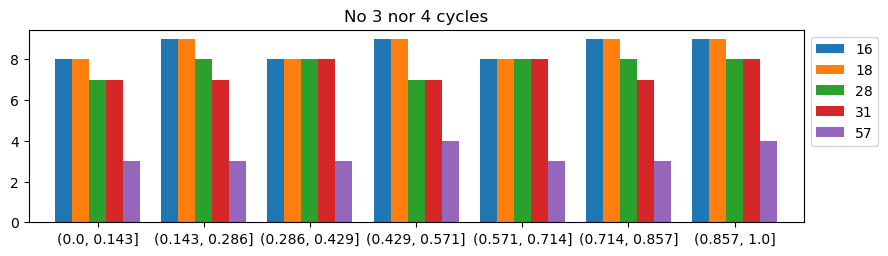

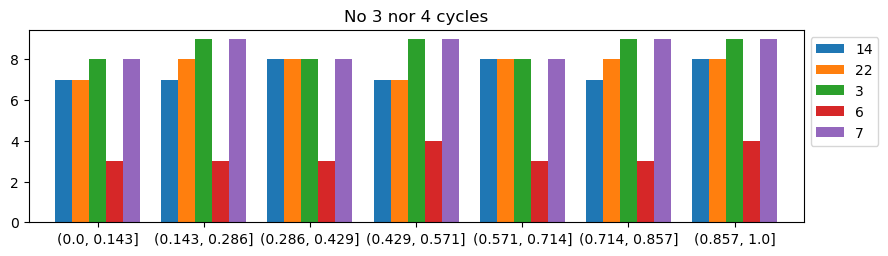

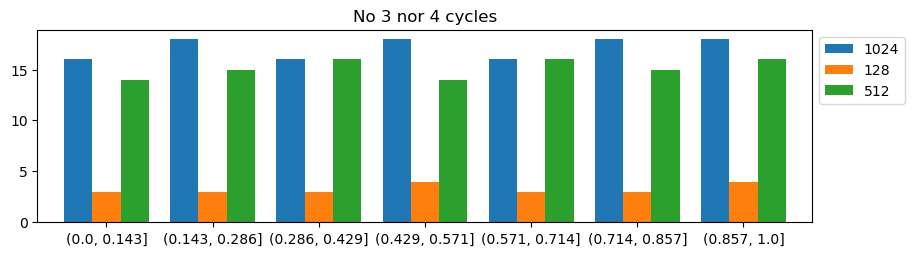

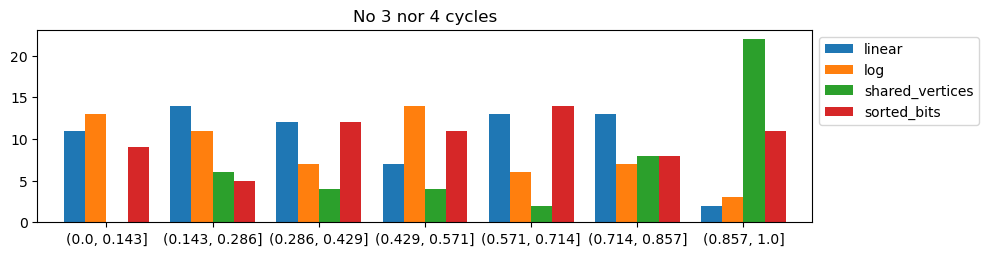

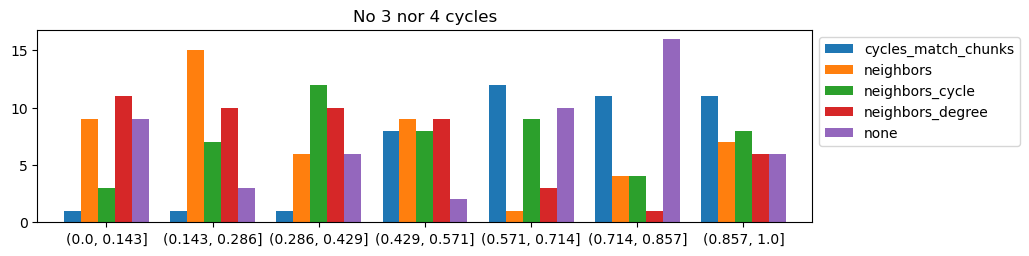

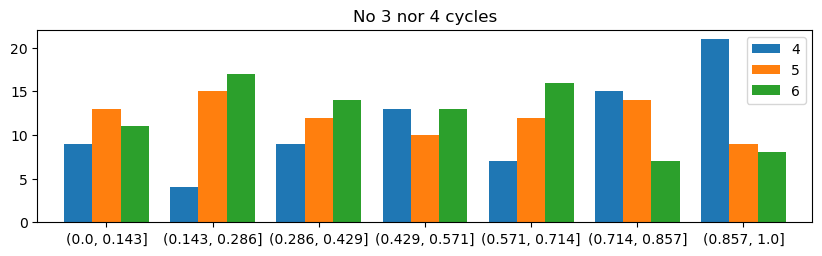

In [33]:
input = """
--------------------------------------------------------------------------------
Name (time in ms)                                                                                                 Min                    Max                   Mean                 StdDev                 Median                    IQR            Outliers     OPS            Rounds  Iterations
--------------------------------------------------------------------------------

test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-log-neighbors-4-smart]                              207.1340 (1.0)         232.4209 (1.03)        218.9615 (1.0)          12.7222 (inf)         217.3295 (1.01)         18.9652 (inf)           1;0  4.5670 (1.0)           3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-linear-neighbors-5-smart]                           216.0346 (1.04)        225.8080 (1.0)         221.2459 (1.01)          4.9189 (inf)         221.8951 (1.03)          7.3301 (inf)           1;0  4.5199 (0.99)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-log-neighbors_degree-4-smart]                       215.4596 (1.04)        232.3946 (1.03)        221.2948 (1.01)          9.6169 (inf)         216.0303 (1.0)          12.7013 (inf)           1;0  4.5189 (0.99)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-log-neighbors-5-smart]                              212.4649 (1.03)        236.7506 (1.05)        224.6361 (1.03)         12.1430 (inf)         224.6930 (1.04)         18.2143 (inf)           1;0  4.4516 (0.97)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-linear-neighbors_degree-5-smart]                    212.3020 (1.02)        260.9492 (1.16)        232.0232 (1.06)         25.5966 (inf)         222.8183 (1.03)         36.4854 (inf)           1;0  4.3099 (0.94)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-log-neighbors_degree-5-smart]                       210.6792 (1.02)        266.6902 (1.18)        232.7942 (1.06)         29.8061 (inf)         221.0131 (1.02)         42.0082 (inf)           1;0  4.2956 (0.94)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-log-none-4-smart]                                   226.6107 (1.09)        244.3675 (1.08)        232.9094 (1.06)          9.9393 (inf)         227.7499 (1.05)         13.3176 (inf)           1;0  4.2935 (0.94)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-log-neighbors_cycle-4-smart]                        236.8982 (1.14)        241.3628 (1.07)        239.2559 (1.09)          2.2428 (inf)         239.5066 (1.11)          3.3485 (inf)           1;0  4.1796 (0.92)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-linear-neighbors_degree-6-smart]                    226.5703 (1.09)        248.8900 (1.10)        241.1656 (1.10)         12.6471 (inf)         248.0366 (1.15)         16.7398 (inf)           1;0  4.1465 (0.91)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-shared_vertices-neighbors_degree-6-smart]           222.3763 (1.07)        252.5877 (1.12)        241.6109 (1.10)         16.7131 (inf)         249.8686 (1.16)         22.6586 (inf)           1;0  4.1389 (0.91)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-linear-neighbors-6-smart]                           222.6620 (1.07)        253.0272 (1.12)        241.9809 (1.11)         16.7880 (inf)         250.2534 (1.16)         22.7739 (inf)           1;0  4.1326 (0.90)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-log-neighbors-6-smart]                              237.7395 (1.15)        249.6862 (1.11)        242.7240 (1.11)          6.2140 (inf)         240.7463 (1.11)          8.9600 (inf)           1;0  4.1199 (0.90)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-shared_vertices-neighbors_degree-5-smart]           241.8586 (1.17)        250.0472 (1.11)        246.0876 (1.12)          4.1009 (inf)         246.3570 (1.14)          6.1414 (inf)           1;0  4.0636 (0.89)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-shared_vertices-neighbors-6-smart]                  230.8953 (1.11)        264.3828 (1.17)        246.7799 (1.13)         16.8097 (inf)         245.0617 (1.13)         25.1156 (inf)           1;0  4.0522 (0.89)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-shared_vertices-neighbors_cycle-6-smart]            237.4889 (1.15)        257.8082 (1.14)        248.0464 (1.13)         10.1830 (inf)         248.8420 (1.15)         15.2395 (inf)           1;0  4.0315 (0.88)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-sorted_bits-none-5-smart]                           222.4587 (1.07)        279.2850 (1.24)        248.2977 (1.13)         28.7608 (inf)         243.1493 (1.13)         42.6197 (inf)           1;0  4.0274 (0.88)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-shared_vertices-neighbors-5-smart]                  225.1632 (1.09)        265.0078 (1.17)        248.7390 (1.14)         20.9032 (inf)         256.0462 (1.19)         29.8834 (inf)           1;0  4.0203 (0.88)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-linear-neighbors_cycle-6-smart]                     246.2046 (1.19)        253.7248 (1.12)        249.0508 (1.14)          4.0797 (inf)         247.2230 (1.14)          5.6402 (inf)           1;0  4.0152 (0.88)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-linear-neighbors_degree-4-smart]                    248.9874 (1.20)        258.9733 (1.15)        252.4520 (1.15)          5.6513 (inf)         249.3954 (1.15)          7.4894 (inf)           1;0  3.9611 (0.87)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-linear-neighbors_cycle-4-smart]                     228.9196 (1.11)        267.7318 (1.19)        252.6496 (1.15)         20.8011 (inf)         261.2974 (1.21)         29.1091 (inf)           1;0  3.9581 (0.87)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-linear-none-6-smart]                                246.8264 (1.19)        264.6431 (1.17)        254.1784 (1.16)          9.3073 (inf)         251.0655 (1.16)         13.3625 (inf)           1;0  3.9342 (0.86)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-log-neighbors_cycle-6-smart]                        243.8760 (1.18)        261.6101 (1.16)        254.3216 (1.16)          9.2790 (inf)         257.4787 (1.19)         13.3006 (inf)           1;0  3.9320 (0.86)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-sorted_bits-neighbors_degree-6-smart]               242.2500 (1.17)        271.5036 (1.20)        255.2871 (1.17)         14.8837 (inf)         252.1078 (1.17)         21.9401 (inf)           1;0  3.9172 (0.86)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-sorted_bits-neighbors_degree-5-smart]               243.0139 (1.17)        264.6833 (1.17)        257.4425 (1.18)         12.4956 (inf)         264.6303 (1.22)         16.2521 (inf)           1;0  3.8844 (0.85)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-log-none-6-smart]                                   246.1716 (1.19)        263.5979 (1.17)        257.6230 (1.18)          9.9203 (inf)         263.0995 (1.22)         13.0697 (inf)           1;0  3.8816 (0.85)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-linear-neighbors-4-smart]                           246.7904 (1.19)        283.1376 (1.25)        261.0654 (1.19)         19.3875 (inf)         253.2682 (1.17)         27.2603 (inf)           1;0  3.8305 (0.84)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-log-neighbors_degree-6-smart]                       229.9633 (1.11)        287.6467 (1.27)        265.6899 (1.21)         31.2098 (inf)         279.4597 (1.29)         43.2626 (inf)           1;0  3.7638 (0.82)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-sorted_bits-neighbors-5-smart]                      259.3710 (1.25)        270.0088 (1.20)        266.3177 (1.22)          6.0199 (inf)         269.5732 (1.25)          7.9783 (inf)           1;0  3.7549 (0.82)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-shared_vertices-none-6-smart]                       257.4696 (1.24)        276.9241 (1.23)        267.6751 (1.22)          9.7625 (inf)         268.6317 (1.24)         14.5909 (inf)           1;0  3.7359 (0.82)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-log-cycles_match_chunks-4-smart]                    255.9235 (1.24)        286.6720 (1.27)        269.9822 (1.23)         15.5422 (inf)         267.3510 (1.24)         23.0614 (inf)           1;0  3.7039 (0.81)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-linear-cycles_match_chunks-4-smart]                 258.6308 (1.25)        278.6466 (1.23)        270.1297 (1.23)         10.3358 (inf)         273.1119 (1.26)         15.0118 (inf)           1;0  3.7019 (0.81)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-sorted_bits-neighbors-6-smart]                      249.5070 (1.20)        289.5343 (1.28)        271.5783 (1.24)         20.3285 (inf)         275.6935 (1.28)         30.0205 (inf)           1;0  3.6822 (0.81)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-shared_vertices-neighbors_degree-4-smart]           254.5162 (1.23)        292.0833 (1.29)        272.2263 (1.24)         18.8753 (inf)         270.0794 (1.25)         28.1753 (inf)           1;0  3.6734 (0.80)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-log-cycles_match_chunks-5-smart]                    263.1301 (1.27)        284.4766 (1.26)        274.3048 (1.25)         10.7086 (inf)         275.3078 (1.27)         16.0099 (inf)           1;0  3.6456 (0.80)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]                271.3440 (1.31)        279.1081 (1.24)        274.5941 (1.25)          4.0334 (inf)         273.3304 (1.27)          5.8231 (inf)           1;0  3.6417 (0.80)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-linear-cycles_match_chunks-5-smart]                 270.9089 (1.31)        288.4813 (1.28)        277.6168 (1.27)          9.4950 (inf)         273.4602 (1.27)         13.1793 (inf)           1;0  3.6021 (0.79)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-sorted_bits-none-4-smart]                           269.3667 (1.30)        285.6820 (1.27)        278.4039 (1.27)          8.2987 (inf)         280.1628 (1.30)         12.2365 (inf)           1;0  3.5919 (0.79)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-linear-neighbors_cycle-5-smart]                     267.8105 (1.29)        288.0366 (1.28)        279.5342 (1.28)         10.4908 (inf)         282.7556 (1.31)         15.1696 (inf)           1;0  3.5774 (0.78)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-sorted_bits-none-6-smart]                           275.0056 (1.33)        291.2794 (1.29)        281.7888 (1.29)          8.4680 (inf)         279.0815 (1.29)         12.2054 (inf)           1;0  3.5488 (0.78)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-linear-none-5-smart]                                277.3739 (1.34)        288.0823 (1.28)        283.6012 (1.30)          5.5637 (inf)         285.3476 (1.32)          8.0313 (inf)           1;0  3.5261 (0.77)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-log-neighbors_cycle-5-smart]                        277.9144 (1.34)        287.8192 (1.27)        284.3069 (1.30)          5.5451 (inf)         287.1870 (1.33)          7.4287 (inf)           1;0  3.5173 (0.77)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-shared_vertices-neighbors_cycle-5-smart]            275.8439 (1.33)        300.0002 (1.33)        284.7954 (1.30)         13.2367 (inf)         278.5421 (1.29)         18.1172 (inf)           1;0  3.5113 (0.77)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]                279.8303 (1.35)        289.7671 (1.28)        285.0998 (1.30)          4.9957 (inf)         285.7021 (1.32)          7.4526 (inf)           1;0  3.5075 (0.77)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-log-cycles_match_chunks-6-smart]                    277.4836 (1.34)        295.0186 (1.31)        286.2845 (1.31)          8.7677 (inf)         286.3514 (1.33)         13.1513 (inf)           1;0  3.4930 (0.76)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-log-none-5-smart]                                   273.8414 (1.32)        298.4903 (1.32)        286.2943 (1.31)         12.3264 (inf)         286.5510 (1.33)         18.4867 (inf)           1;0  3.4929 (0.76)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-linear-cycles_match_chunks-6-smart]                 270.9231 (1.31)        296.7276 (1.31)        287.2628 (1.31)         14.2097 (inf)         294.1376 (1.36)         19.3534 (inf)           1;0  3.4811 (0.76)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-shared_vertices-none-4-smart]                       273.3017 (1.32)        323.0020 (1.43)        291.9854 (1.33)         27.0482 (inf)         279.6525 (1.29)         37.2752 (inf)           1;0  3.4248 (0.75)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-shared_vertices-neighbors-4-smart]                  262.1976 (1.27)        320.3713 (1.42)        297.3801 (1.36)         30.9437 (inf)         309.5712 (1.43)         43.6303 (inf)           1;0  3.3627 (0.74)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]        282.8429 (1.37)        315.0457 (1.40)        300.1026 (1.37)         16.2259 (inf)         302.4192 (1.40)         24.1521 (inf)           1;0  3.3322 (0.73)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-linear-none-4-smart]                                291.0832 (1.41)        324.1094 (1.44)        302.6339 (1.38)         18.6160 (inf)         292.7092 (1.35)         24.7696 (inf)           1;0  3.3043 (0.72)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-shared_vertices-none-5-smart]                       280.6674 (1.36)        334.1239 (1.48)        302.8065 (1.38)         27.8851 (inf)         293.6281 (1.36)         40.0924 (inf)           1;0  3.3024 (0.72)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]        286.9089 (1.39)        324.1492 (1.44)        303.0797 (1.38)         19.0973 (inf)         298.1809 (1.38)         27.9302 (inf)           1;0  3.2995 (0.72)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-shared_vertices-neighbors_cycle-4-smart]            271.6841 (1.31)        342.6655 (1.52)        305.0157 (1.39)         35.6872 (inf)         300.6973 (1.39)         53.2361 (inf)           1;0  3.2785 (0.72)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-sorted_bits-neighbors_degree-4-smart]               254.0193 (1.23)        361.5646 (1.60)        319.3070 (1.46)         57.3523 (inf)         342.3371 (1.58)         80.6590 (inf)           1;0  3.1318 (0.69)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]            293.0243 (1.41)        344.9417 (1.53)        321.8254 (1.47)         26.4214 (inf)         327.5102 (1.52)         38.9380 (inf)           1;0  3.1073 (0.68)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]            299.0405 (1.44)        344.5369 (1.53)        327.4906 (1.50)         24.7995 (inf)         338.8944 (1.57)         34.1222 (inf)           1;0  3.0535 (0.67)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-sorted_bits-neighbors-4-smart]                      300.4827 (1.45)        346.5510 (1.53)        330.7723 (1.51)         26.2392 (inf)         345.2832 (1.60)         34.5513 (inf)           1;0  3.0232 (0.66)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]        315.5269 (1.52)        364.9696 (1.62)        345.5920 (1.58)         26.3972 (inf)         356.2795 (1.65)         37.0820 (inf)           1;0  2.8936 (0.63)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]                293.8847 (1.42)        384.5140 (1.70)        349.3616 (1.60)         48.6131 (inf)         369.6860 (1.71)         67.9720 (inf)           1;0  2.8624 (0.63)          3           1
test_LamanNo3nor4CyclesFirstN[16-3-1024-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]            393.1263 (1.90)        417.4825 (1.85)        406.3334 (1.86)         12.3078 (inf)         408.3913 (1.89)         18.2672 (inf)           1;0  2.4610 (0.54)          3           1

test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-log-neighbors-4-smart]                              752.3968 (3.63)        809.3010 (3.58)        787.2855 (3.60)         30.5583 (inf)         800.1586 (3.70)         42.6781 (inf)           1;0  1.2702 (0.28)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-log-neighbors_cycle-4-smart]                        786.0737 (3.80)        827.4808 (3.66)        804.3859 (3.67)         21.1138 (inf)         799.6031 (3.70)         31.0554 (inf)           1;0  1.2432 (0.27)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-log-neighbors_degree-4-smart]                       800.6306 (3.87)        947.3270 (4.20)        877.9293 (4.01)         73.6667 (inf)         885.8301 (4.10)        110.0223 (inf)           1;0  1.1390 (0.25)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-sorted_bits-none-5-smart]                           874.8512 (4.22)        886.8653 (3.93)        879.7862 (4.02)          6.2875 (inf)         877.6421 (4.06)          9.0105 (inf)           1;0  1.1366 (0.25)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-sorted_bits-none-6-smart]                           881.4496 (4.26)        888.8036 (3.94)        883.9046 (4.04)          4.2427 (inf)         881.4607 (4.08)          5.5156 (inf)           1;0  1.1313 (0.25)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-log-cycles_match_chunks-4-smart]                    871.6051 (4.21)        915.3003 (4.05)        899.0960 (4.11)         23.9345 (inf)         910.3828 (4.21)         32.7714 (inf)           1;0  1.1122 (0.24)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-linear-neighbors_degree-5-smart]                    881.2001 (4.25)        963.0649 (4.26)        918.1889 (4.19)         41.4984 (inf)         910.3017 (4.21)         61.3986 (inf)           1;0  1.0891 (0.24)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-sorted_bits-neighbors-6-smart]                      889.9139 (4.30)        960.1329 (4.25)        923.9226 (4.22)         35.1612 (inf)         921.7210 (4.27)         52.6643 (inf)           1;0  1.0823 (0.24)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-log-neighbors_degree-6-smart]                       877.1705 (4.23)        959.0826 (4.25)        928.2979 (4.24)         44.5844 (inf)         948.6406 (4.39)         61.4341 (inf)           1;0  1.0772 (0.24)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-sorted_bits-neighbors-5-smart]                      898.5746 (4.34)        960.7633 (4.25)        928.6482 (4.24)         31.1446 (inf)         926.6067 (4.29)         46.6416 (inf)           1;0  1.0768 (0.24)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-log-neighbors-6-smart]                              917.3589 (4.43)        956.7315 (4.24)        935.1598 (4.27)         19.9553 (inf)         931.3890 (4.31)         29.5295 (inf)           1;0  1.0693 (0.23)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-log-neighbors-5-smart]                              921.2362 (4.45)        959.0467 (4.25)        936.1045 (4.28)         20.1569 (inf)         928.0305 (4.30)         28.3579 (inf)           1;0  1.0683 (0.23)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-linear-neighbors_degree-6-smart]                    916.4705 (4.42)        979.3687 (4.34)        945.7106 (4.32)         31.6810 (inf)         941.2927 (4.36)         47.1736 (inf)           1;0  1.0574 (0.23)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-sorted_bits-neighbors_degree-6-smart]               871.9799 (4.21)        994.7678 (4.41)        946.5577 (4.32)         65.5031 (inf)         972.9253 (4.50)         92.0909 (inf)           1;0  1.0565 (0.23)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-linear-neighbors-5-smart]                           917.5428 (4.43)      1,004.2898 (4.45)        949.7854 (4.34)         47.4653 (inf)         927.5237 (4.29)         65.0603 (inf)           1;0  1.0529 (0.23)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-sorted_bits-neighbors_degree-5-smart]               877.7973 (4.24)      1,011.8432 (4.48)        955.8468 (4.37)         69.6909 (inf)         977.9000 (4.53)        100.5344 (inf)           1;0  1.0462 (0.23)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-shared_vertices-none-6-smart]                       942.6594 (4.55)        971.8372 (4.30)        959.5475 (4.38)         15.1226 (inf)         964.1459 (4.46)         21.8833 (inf)           1;0  1.0422 (0.23)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-shared_vertices-none-5-smart]                       955.1790 (4.61)        970.3720 (4.30)        963.5681 (4.40)          7.7195 (inf)         965.1534 (4.47)         11.3947 (inf)           1;0  1.0378 (0.23)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-sorted_bits-none-4-smart]                           950.3281 (4.59)        991.9331 (4.39)        969.9116 (4.43)         20.9094 (inf)         967.4737 (4.48)         31.2038 (inf)           1;0  1.0310 (0.23)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-linear-neighbors-6-smart]                           951.6954 (4.59)      1,009.8303 (4.47)        973.2661 (4.44)         31.8358 (inf)         958.2726 (4.44)         43.6011 (inf)           1;0  1.0275 (0.22)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-log-none-4-smart]                                   897.8160 (4.33)      1,129.4719 (5.00)        976.6888 (4.46)        132.3373 (inf)         902.7785 (4.18)        173.7419 (inf)           1;0  1.0239 (0.22)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-shared_vertices-neighbors-5-smart]                  927.8498 (4.48)      1,009.6426 (4.47)        979.9034 (4.48)         45.2323 (inf)       1,002.2177 (4.64)         61.3445 (inf)           1;0  1.0205 (0.22)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-shared_vertices-neighbors-6-smart]                  920.5292 (4.44)      1,023.2569 (4.53)        985.3708 (4.50)         56.4198 (inf)       1,012.3264 (4.69)         77.0458 (inf)           1;0  1.0148 (0.22)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-shared_vertices-neighbors_degree-5-smart]           917.0651 (4.43)      1,047.3464 (4.64)      1,002.4200 (4.58)         73.9537 (inf)       1,042.8485 (4.83)         97.7109 (inf)           1;0  0.9976 (0.22)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]                962.0463 (4.64)      1,074.6202 (4.76)      1,022.7712 (4.67)         56.8094 (inf)       1,031.6471 (4.78)         84.4304 (inf)           1;0  0.9777 (0.21)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-shared_vertices-neighbors_degree-6-smart]         1,005.2763 (4.85)      1,059.7280 (4.69)      1,026.0985 (4.69)         29.3984 (inf)       1,013.2913 (4.69)         40.8388 (inf)           1;0  0.9746 (0.21)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]                971.4755 (4.69)      1,076.2958 (4.77)      1,030.2260 (4.71)         53.5483 (inf)       1,042.9066 (4.83)         78.6153 (inf)           1;0  0.9707 (0.21)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-log-neighbors_cycle-5-smart]                        975.9436 (4.71)      1,071.3012 (4.74)      1,033.7119 (4.72)         50.7806 (inf)       1,053.8910 (4.88)         71.5182 (inf)           1;0  0.9674 (0.21)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-log-neighbors_cycle-6-smart]                        974.0596 (4.70)      1,091.4315 (4.83)      1,034.2899 (4.72)         58.7469 (inf)       1,037.3787 (4.80)         88.0289 (inf)           1;0  0.9668 (0.21)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-log-cycles_match_chunks-5-smart]                  1,018.2025 (4.92)      1,070.0833 (4.74)      1,049.9551 (4.80)         27.8254 (inf)       1,061.5795 (4.91)         38.9107 (inf)           1;0  0.9524 (0.21)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-linear-neighbors_cycle-5-smart]                     995.9534 (4.81)      1,116.4632 (4.94)      1,050.6277 (4.80)         61.0253 (inf)       1,039.4665 (4.81)         90.3824 (inf)           1;0  0.9518 (0.21)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-log-cycles_match_chunks-6-smart]                  1,032.4584 (4.98)      1,096.0422 (4.85)      1,061.6290 (4.85)         32.1145 (inf)       1,056.3864 (4.89)         47.6879 (inf)           1;0  0.9419 (0.21)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-log-neighbors_degree-5-smart]                       986.9180 (4.76)      1,160.8996 (5.14)      1,066.8500 (4.87)         87.8458 (inf)       1,052.7322 (4.87)        130.4862 (inf)           1;0  0.9373 (0.21)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-shared_vertices-neighbors_cycle-6-smart]          1,048.6255 (5.06)      1,109.5838 (4.91)      1,073.4771 (4.90)         31.9998 (inf)       1,062.2221 (4.92)         45.7187 (inf)           1;0  0.9316 (0.20)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-linear-neighbors_cycle-6-smart]                     978.5027 (4.72)      1,222.4758 (5.41)      1,075.0606 (4.91)        129.6942 (inf)       1,024.2032 (4.74)        182.9799 (inf)           1;0  0.9302 (0.20)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-linear-cycles_match_chunks-6-smart]               1,050.0840 (5.07)      1,106.7215 (4.90)      1,086.6158 (4.96)         31.6909 (inf)       1,103.0419 (5.11)         42.4781 (inf)           1;0  0.9203 (0.20)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-linear-cycles_match_chunks-5-smart]               1,044.2774 (5.04)      1,136.3853 (5.03)      1,087.5626 (4.97)         46.3029 (inf)       1,082.0251 (5.01)         69.0809 (inf)           1;0  0.9195 (0.20)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-shared_vertices-neighbors_cycle-5-smart]          1,057.3388 (5.10)      1,162.1671 (5.15)      1,111.2758 (5.08)         52.4805 (inf)       1,114.3214 (5.16)         78.6212 (inf)           1;0  0.8999 (0.20)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-log-none-5-smart]                                 1,042.7489 (5.03)      1,163.8469 (5.15)      1,115.5630 (5.09)         64.1676 (inf)       1,140.0933 (5.28)         90.8235 (inf)           1;0  0.8964 (0.20)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-log-none-6-smart]                                 1,051.3621 (5.08)      1,165.8375 (5.16)      1,117.0656 (5.10)         59.0861 (inf)       1,133.9972 (5.25)         85.8565 (inf)           1;0  0.8952 (0.20)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-linear-neighbors_degree-4-smart]                  1,025.8439 (4.95)      1,183.1999 (5.24)      1,124.1471 (5.13)         85.7069 (inf)       1,163.3974 (5.39)        118.0169 (inf)           1;0  0.8896 (0.19)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]          1,095.5987 (5.29)      1,173.3113 (5.20)      1,125.2533 (5.14)         41.9979 (inf)       1,106.8499 (5.12)         58.2844 (inf)           1;0  0.8887 (0.19)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-sorted_bits-neighbors-4-smart]                    1,095.2509 (5.29)      1,227.3829 (5.44)      1,140.9692 (5.21)         74.8785 (inf)       1,100.2739 (5.09)         99.0989 (inf)           1;0  0.8764 (0.19)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]          1,103.0386 (5.33)      1,195.5259 (5.29)      1,141.3186 (5.21)         48.2570 (inf)       1,125.3912 (5.21)         69.3655 (inf)           1;0  0.8762 (0.19)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-linear-neighbors_cycle-4-smart]                   1,051.7491 (5.08)      1,267.3544 (5.61)      1,152.8100 (5.26)        108.4332 (inf)       1,139.3265 (5.27)        161.7039 (inf)           1;0  0.8674 (0.19)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-sorted_bits-neighbors_degree-4-smart]             1,067.5393 (5.15)      1,254.0358 (5.55)      1,157.4441 (5.29)         93.4279 (inf)       1,150.7571 (5.33)        139.8723 (inf)           1;0  0.8640 (0.19)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-linear-none-6-smart]                              1,120.3401 (5.41)      1,250.7688 (5.54)      1,174.7665 (5.37)         67.8384 (inf)       1,153.1907 (5.34)         97.8215 (inf)           1;0  0.8512 (0.19)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-linear-none-5-smart]                              1,107.2682 (5.35)      1,230.9963 (5.45)      1,184.8056 (5.41)         67.5583 (inf)       1,216.1525 (5.63)         92.7961 (inf)           1;0  0.8440 (0.18)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]      1,161.6054 (5.61)      1,221.8347 (5.41)      1,186.4883 (5.42)         31.4484 (inf)       1,176.0247 (5.44)         45.1719 (inf)           1;0  0.8428 (0.18)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]      1,171.8820 (5.66)      1,223.4790 (5.42)      1,190.9637 (5.44)         28.3003 (inf)       1,177.5302 (5.45)         38.6977 (inf)           1;0  0.8397 (0.18)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-linear-neighbors-4-smart]                         1,162.6696 (5.61)      1,237.7961 (5.48)      1,210.3870 (5.53)         41.4767 (inf)       1,230.6954 (5.70)         56.3449 (inf)           1;0  0.8262 (0.18)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-shared_vertices-neighbors_degree-4-smart]         1,154.3343 (5.57)      1,266.8793 (5.61)      1,217.1559 (5.56)         57.4045 (inf)       1,230.2542 (5.69)         84.4088 (inf)           1;0  0.8216 (0.18)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-linear-cycles_match_chunks-4-smart]               1,147.6540 (5.54)      1,371.4621 (6.07)      1,225.8416 (5.60)        126.2257 (inf)       1,158.4086 (5.36)        167.8561 (inf)           1;0  0.8158 (0.18)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-shared_vertices-neighbors-4-smart]                1,166.5375 (5.63)      1,343.5980 (5.95)      1,235.4628 (5.64)         94.8192 (inf)       1,196.2529 (5.54)        132.7954 (inf)           1;0  0.8094 (0.18)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]              1,183.7926 (5.72)      1,315.2351 (5.82)      1,249.6143 (5.71)         65.7215 (inf)       1,249.8151 (5.79)         98.5818 (inf)           1;0  0.8002 (0.18)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-shared_vertices-neighbors_cycle-4-smart]          1,197.0685 (5.78)      1,473.4590 (6.53)      1,299.5463 (5.94)        151.4105 (inf)       1,228.1113 (5.68)        207.2929 (inf)           1;0  0.7695 (0.17)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]      1,266.3142 (6.11)      1,353.4594 (5.99)      1,300.4750 (5.94)         46.5222 (inf)       1,281.6514 (5.93)         65.3589 (inf)           1;0  0.7689 (0.17)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]          1,224.2707 (5.91)      1,396.6067 (6.18)      1,306.9235 (5.97)         86.3828 (inf)       1,299.8932 (6.02)        129.2520 (inf)           1;0  0.7652 (0.17)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-shared_vertices-none-4-smart]                     1,226.1334 (5.92)      1,535.2502 (6.80)      1,387.8320 (6.34)        155.0524 (inf)       1,402.1123 (6.49)        231.8376 (inf)           1;0  0.7205 (0.16)          3           1
test_LamanNo3nor4CyclesFirstN[18-7-1024-random-subgraphs-linear-none-4-smart]                              1,423.5778 (6.87)      1,569.6764 (6.95)      1,484.2606 (6.78)         76.1249 (inf)       1,459.5275 (6.76)        109.5740 (inf)           1;0  0.6737 (0.15)          3           1

test_LamanNo3nor4CyclesFirstN[28-22-512-random-subgraphs-linear-neighbors-6-smart]                         5,770.2926 (27.86)     6,185.7723 (27.39)     5,961.7757 (27.23)       209.6394 (inf)       5,929.2623 (27.45)       311.6098 (inf)           1;0  0.1677 (0.04)          3           1
test_LamanNo3nor4CyclesFirstN[28-22-512-random-subgraphs-linear-neighbors_degree-6-smart]                  6,159.6510 (29.74)     6,676.1294 (29.57)     6,466.8972 (29.53)       271.8318 (inf)       6,564.9112 (30.39)       387.3588 (inf)           1;0  0.1546 (0.03)          3           1
test_LamanNo3nor4CyclesFirstN[28-22-512-random-subgraphs-sorted_bits-none-6-smart]                         7,567.8332 (36.54)     8,344.0620 (36.95)     7,989.0547 (36.49)       392.3277 (inf)       8,055.2687 (37.29)       582.1716 (inf)           1;0  0.1252 (0.03)          3           1
test_LamanNo3nor4CyclesFirstN[28-22-512-random-subgraphs-sorted_bits-none-5-smart]                         7,230.9673 (34.91)     9,090.3956 (40.26)     8,010.1369 (36.58)       965.5876 (inf)       7,709.0478 (35.69)     1,394.5713 (inf)           1;0  0.1248 (0.03)          3           1
test_LamanNo3nor4CyclesFirstN[28-22-512-random-subgraphs-linear-neighbors_cycle-6-smart]                   7,908.6665 (38.18)     8,960.4075 (39.68)     8,329.2676 (38.04)       556.5831 (inf)       8,118.7287 (37.58)       788.8058 (inf)           1;0  0.1201 (0.03)          3           1
test_LamanNo3nor4CyclesFirstN[28-22-512-random-subgraphs-log-neighbors_degree-5-smart]                     8,030.1150 (38.77)     9,276.1018 (41.08)     8,644.4664 (39.48)       623.1732 (inf)       8,627.1825 (39.94)       934.4900 (inf)           1;0  0.1157 (0.03)          3           1
test_LamanNo3nor4CyclesFirstN[28-22-512-random-subgraphs-linear-neighbors_degree-5-smart]                  7,957.0450 (38.41)     9,358.0560 (41.44)     8,759.7941 (40.01)       722.5435 (inf)       8,964.2813 (41.50)     1,050.7582 (inf)           1;0  0.1142 (0.02)          3           1
test_LamanNo3nor4CyclesFirstN[28-22-512-random-subgraphs-linear-neighbors-5-smart]                         8,463.1974 (40.86)     9,600.9919 (42.52)     8,898.0755 (40.64)       614.4326 (inf)       8,630.0373 (39.95)       853.3458 (inf)           1;0  0.1124 (0.02)          3           1
test_LamanNo3nor4CyclesFirstN[28-22-512-random-subgraphs-log-neighbors-5-smart]                            8,528.8420 (41.18)     9,865.6614 (43.69)     9,363.1961 (42.76)       727.5880 (inf)       9,695.0850 (44.88)     1,002.6146 (inf)           1;0  0.1068 (0.02)          3           1
test_LamanNo3nor4CyclesFirstN[28-22-512-random-subgraphs-sorted_bits-none-4-smart]                        10,399.8663 (50.21)    11,517.0406 (51.00)    10,841.4509 (49.51)       594.2124 (inf)      10,607.4457 (49.10)       837.8807 (inf)           1;0  0.0922 (0.02)          3           1
test_LamanNo3nor4CyclesFirstN[28-22-512-random-subgraphs-log-cycles_match_chunks-5-smart]                 10,167.9226 (49.09)    11,947.2775 (52.91)    11,317.9929 (51.69)       997.4664 (inf)      11,838.7784 (54.80)     1,334.5161 (inf)           1;0  0.0884 (0.02)          3           1
test_LamanNo3nor4CyclesFirstN[28-22-512-random-subgraphs-log-neighbors_cycle-5-smart]                     10,894.6958 (52.60)    11,993.6046 (53.11)    11,449.5956 (52.29)       549.5354 (inf)      11,460.4865 (53.05)       824.1816 (inf)           1;0  0.0873 (0.02)          3           1
test_LamanNo3nor4CyclesFirstN[28-22-512-random-subgraphs-log-neighbors_cycle-6-smart]                     11,334.7127 (54.72)    12,724.4815 (56.35)    12,157.6424 (55.52)       729.4183 (inf)      12,413.7330 (57.46)     1,042.3265 (inf)           1;0  0.0823 (0.02)          3           1
test_LamanNo3nor4CyclesFirstN[28-22-512-random-subgraphs-linear-neighbors-4-smart]                        11,187.2569 (54.01)    13,608.0115 (60.26)    12,192.6655 (55.68)     1,261.3682 (inf)      11,782.7282 (54.54)     1,815.5660 (inf)           1;0  0.0820 (0.02)          3           1
test_LamanNo3nor4CyclesFirstN[28-22-512-random-subgraphs-linear-neighbors_cycle-5-smart]                  11,482.2491 (55.43)    13,230.0344 (58.59)    12,365.8561 (56.48)       874.0546 (inf)      12,385.2847 (57.33)     1,310.8390 (inf)           1;0  0.0809 (0.02)          3           1
test_LamanNo3nor4CyclesFirstN[28-22-512-random-subgraphs-sorted_bits-neighbors_degree-6-smart]            11,984.3336 (57.86)    13,050.4814 (57.79)    12,445.1096 (56.84)       547.5844 (inf)      12,300.5138 (56.94)       799.6108 (inf)           1;0  0.0804 (0.02)          3           1
test_LamanNo3nor4CyclesFirstN[28-22-512-random-subgraphs-linear-neighbors_cycle-4-smart]                  12,519.0277 (60.44)    13,310.0824 (58.94)    12,824.4729 (58.57)       425.1896 (inf)      12,644.3087 (58.53)       593.2910 (inf)           1;0  0.0780 (0.02)          3           1
test_LamanNo3nor4CyclesFirstN[28-22-512-random-subgraphs-log-neighbors-6-smart]                           11,817.3635 (57.05)    13,830.2791 (61.25)    12,950.2404 (59.14)     1,030.0013 (inf)      13,203.0786 (61.12)     1,509.6867 (inf)           1;0  0.0772 (0.02)          3           1
test_LamanNo3nor4CyclesFirstN[28-22-512-random-subgraphs-sorted_bits-neighbors-5-smart]                   11,987.4532 (57.87)    13,873.0095 (61.44)    12,982.8702 (59.29)       947.1764 (inf)      13,088.1478 (60.58)     1,414.1672 (inf)           1;0  0.0770 (0.02)          3           1
test_LamanNo3nor4CyclesFirstN[28-22-512-random-subgraphs-sorted_bits-neighbors_degree-5-smart]            12,020.2384 (58.03)    14,637.5289 (64.82)    13,132.7957 (59.98)     1,351.9999 (inf)      12,740.6199 (58.98)     1,962.9679 (inf)           1;0  0.0761 (0.02)          3           1
test_LamanNo3nor4CyclesFirstN[28-22-512-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]             11,676.7838 (56.37)    15,356.6015 (68.01)    13,555.3083 (61.91)     1,841.1242 (inf)      13,632.5395 (63.10)     2,759.8633 (inf)           1;0  0.0738 (0.02)          3           1
test_LamanNo3nor4CyclesFirstN[28-22-512-random-subgraphs-linear-neighbors_degree-4-smart]                 13,492.2014 (65.14)    14,664.3529 (64.94)    14,034.6809 (64.10)       590.9202 (inf)      13,947.4885 (64.56)       879.1136 (inf)           1;0  0.0713 (0.02)          3           1
test_LamanNo3nor4CyclesFirstN[28-22-512-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]             12,548.8608 (60.58)    16,396.7839 (72.61)    14,251.5853 (65.09)     1,961.7506 (inf)      13,809.1111 (63.92)     2,885.9423 (inf)           1;0  0.0702 (0.02)          3           1
test_LamanNo3nor4CyclesFirstN[28-22-512-random-subgraphs-sorted_bits-neighbors-6-smart]                   13,356.6343 (64.48)    16,633.9740 (73.66)    15,016.0913 (68.58)     1,639.0653 (inf)      15,057.6655 (69.70)     2,458.0048 (inf)           1;0  0.0666 (0.01)          3           1
test_LamanNo3nor4CyclesFirstN[28-22-512-random-subgraphs-log-neighbors-4-smart]                           14,717.3931 (71.05)    16,007.9879 (70.89)    15,373.9157 (70.21)       645.5903 (inf)      15,396.3662 (71.27)       967.9461 (inf)           1;0  0.0650 (0.01)          3           1
test_LamanNo3nor4CyclesFirstN[28-22-512-random-subgraphs-linear-cycles_match_chunks-5-smart]              15,003.8940 (72.44)    16,566.7422 (73.37)    15,810.9455 (72.21)       782.6838 (inf)      15,862.2003 (73.43)     1,172.1361 (inf)           1;0  0.0632 (0.01)          3           1
test_LamanNo3nor4CyclesFirstN[28-22-512-random-subgraphs-log-neighbors_degree-6-smart]                    15,518.5256 (74.92)    16,702.4329 (73.97)    15,920.1491 (72.71)       677.5587 (inf)      15,539.4889 (71.93)       887.9304 (inf)           1;0  0.0628 (0.01)          3           1
test_LamanNo3nor4CyclesFirstN[28-22-512-random-subgraphs-log-neighbors_cycle-4-smart]                     15,187.5923 (73.32)    18,903.6592 (83.72)    16,668.4693 (76.13)     1,969.5251 (inf)      15,914.1563 (73.67)     2,787.0501 (inf)           1;0  0.0600 (0.01)          3           1
test_LamanNo3nor4CyclesFirstN[28-22-512-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]         16,118.9463 (77.82)    18,366.5253 (81.34)    16,971.3022 (77.51)     1,218.1672 (inf)      16,428.4350 (76.05)     1,685.6842 (inf)           1;0  0.0589 (0.01)          3           1
test_LamanNo3nor4CyclesFirstN[28-22-512-random-subgraphs-log-neighbors_degree-4-smart]                    15,271.1753 (73.73)    20,001.5527 (88.58)    18,173.3922 (83.00)     2,541.5183 (inf)      19,247.4487 (89.10)     3,547.7830 (inf)           1;0  0.0550 (0.01)          3           1
test_LamanNo3nor4CyclesFirstN[28-22-512-random-subgraphs-linear-cycles_match_chunks-6-smart]              17,468.9670 (84.34)    19,327.0500 (85.59)    18,309.9540 (83.62)       941.4769 (inf)      18,133.8451 (83.94)     1,393.5622 (inf)           1;0  0.0546 (0.01)          3           1
test_LamanNo3nor4CyclesFirstN[28-22-512-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]         17,194.9007 (83.01)    21,505.7176 (95.24)    19,097.4082 (87.22)     2,199.4686 (inf)      18,591.6064 (86.06)     3,233.1126 (inf)           1;0  0.0524 (0.01)          3           1
test_LamanNo3nor4CyclesFirstN[28-22-512-random-subgraphs-log-cycles_match_chunks-6-smart]                 19,627.3557 (94.76)    23,661.8933 (104.79)   21,414.9170 (97.80)     2,056.1298 (inf)      20,955.5019 (97.00)     3,025.9031 (inf)           1;0  0.0467 (0.01)          3           1
test_LamanNo3nor4CyclesFirstN[28-22-512-random-subgraphs-sorted_bits-neighbors_degree-4-smart]            18,571.7675 (89.66)    25,114.3221 (111.22)   21,523.6577 (98.30)     3,317.7220 (inf)      20,884.8837 (96.68)     4,906.9159 (inf)           1;0  0.0465 (0.01)          3           1
test_LamanNo3nor4CyclesFirstN[28-22-512-random-subgraphs-log-none-5-smart]                                19,422.6884 (93.77)    23,359.4405 (103.45)   21,912.4072 (100.07)    2,165.6175 (inf)      22,955.0927 (106.26)    2,952.5641 (inf)           1;0  0.0456 (0.01)          3           1
test_LamanNo3nor4CyclesFirstN[28-22-512-random-subgraphs-linear-none-6-smart]                             21,994.1824 (106.18)   23,746.5051 (105.16)   22,596.2423 (103.20)      996.5208 (inf)      22,048.0393 (102.06)    1,314.2420 (inf)           1;0  0.0443 (0.01)          3           1
test_LamanNo3nor4CyclesFirstN[28-22-512-random-subgraphs-sorted_bits-neighbors-4-smart]                   22,070.8344 (106.55)   23,546.5846 (104.28)   22,629.3836 (103.35)      800.5828 (inf)      22,270.7319 (103.09)    1,106.8126 (inf)           1;0  0.0442 (0.01)          3           1
test_LamanNo3nor4CyclesFirstN[28-22-512-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]             19,920.3976 (96.17)    24,328.7975 (107.74)   22,724.2798 (103.78)    2,436.6687 (inf)      23,923.6445 (110.74)    3,306.2999 (inf)           1;0  0.0440 (0.01)          3           1
test_LamanNo3nor4CyclesFirstN[28-22-512-random-subgraphs-linear-none-5-smart]                             25,475.4336 (122.99)   25,774.2334 (114.14)   25,600.9802 (116.92)      155.0073 (inf)      25,553.2734 (118.29)      224.0998 (inf)           1;0  0.0391 (0.01)          3           1
test_LamanNo3nor4CyclesFirstN[28-22-512-random-subgraphs-log-none-4-smart]                                26,142.5991 (126.21)   33,393.4218 (147.88)   29,768.0104 (135.95)    5,127.1059 (inf)      29,768.0104 (137.80)    7,250.8226 (inf)           0;0  0.0336 (0.01)          2           1
test_LamanNo3nor4CyclesFirstN[28-22-512-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]         29,385.4446 (141.87)   31,288.5990 (138.56)   30,337.0218 (138.55)    1,345.7334 (inf)      30,337.0218 (140.43)    1,903.1544 (inf)           0;0  0.0330 (0.01)          2           1
test_LamanNo3nor4CyclesFirstN[28-22-512-random-subgraphs-linear-none-4-smart]                             28,770.1533 (138.90)   32,412.6661 (143.54)   30,591.4097 (139.71)    2,575.6455 (inf)      30,591.4097 (141.61)    3,642.5127 (inf)           0;0  0.0327 (0.01)          2           1
test_LamanNo3nor4CyclesFirstN[28-22-512-random-subgraphs-linear-cycles_match_chunks-4-smart]              28,212.9677 (136.21)   33,934.5770 (150.28)   31,073.7723 (141.91)    4,045.7887 (inf)      31,073.7723 (143.84)    5,721.6093 (inf)           0;0  0.0322 (0.01)          2           1
test_LamanNo3nor4CyclesFirstN[28-22-512-random-subgraphs-log-none-6-smart]                                26,695.7011 (128.88)   41,366.5611 (183.19)   34,031.1311 (155.42)   10,373.8646 (inf)      34,031.1311 (157.53)   14,670.8600 (inf)           0;0  0.0294 (0.01)          2           1
test_LamanNo3nor4CyclesFirstN[28-22-512-random-subgraphs-log-cycles_match_chunks-4-smart]                 40,875.5065 (197.34)   43,174.4643 (191.20)   42,024.9854 (191.93)    1,625.6086 (inf)      42,024.9854 (194.53)    2,298.9578 (inf)           0;0  0.0238 (0.01)          2           1
test_LamanNo3nor4CyclesFirstN[28-22-512-random-subgraphs-shared_vertices-none-5-smart]                    35,794.1038 (172.81)   49,281.2501 (218.24)   42,537.6770 (194.27)    9,536.8526 (inf)      42,537.6770 (196.91)   13,487.1463 (inf)           0;0  0.0235 (0.01)          2           1
test_LamanNo3nor4CyclesFirstN[28-22-512-random-subgraphs-shared_vertices-none-6-smart]                    40,892.0732 (197.42)   44,234.7881 (195.90)   42,563.4307 (194.39)    2,363.6564 (inf)      42,563.4307 (197.03)    3,342.7149 (inf)           0;0  0.0235 (0.01)          2           1
test_LamanNo3nor4CyclesFirstN[28-22-512-random-subgraphs-shared_vertices-neighbors_cycle-5-smart]         43,401.9213 (209.54)   45,902.7998 (203.28)   44,652.3606 (203.93)    1,768.3882 (inf)      44,652.3606 (206.69)    2,500.8785 (inf)           0;0  0.0224 (0.00)          2           1
test_LamanNo3nor4CyclesFirstN[28-22-512-random-subgraphs-shared_vertices-neighbors_degree-5-smart]        49,516.8070 (239.06)   49,516.8070 (219.29)   49,516.8070 (226.14)        0.0000 (1.0)      49,516.8070 (229.21)        0.0000 (1.0)           0;0  0.0202 (0.00)          1           1
test_LamanNo3nor4CyclesFirstN[28-22-512-random-subgraphs-shared_vertices-neighbors-5-smart]               53,414.4653 (257.87)   53,414.4653 (236.55)   53,414.4653 (243.94)        0.0000 (1.0)      53,414.4653 (247.25)        0.0000 (1.0)           0;0  0.0187 (0.00)          1           1
test_LamanNo3nor4CyclesFirstN[28-22-512-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]     78,601.3667 (379.47)   78,601.3667 (348.09)   78,601.3667 (358.97)        0.0000 (1.0)      78,601.3667 (363.84)        0.0000 (1.0)           0;0  0.0127 (0.00)          1           1
test_LamanNo3nor4CyclesFirstN[28-22-512-random-subgraphs-shared_vertices-neighbors_degree-6-smart]        86,266.1095 (416.47)   86,266.1095 (382.03)   86,266.1095 (393.98)        0.0000 (1.0)      86,266.1095 (399.32)        0.0000 (1.0)           0;0  0.0116 (0.00)          1           1
test_LamanNo3nor4CyclesFirstN[28-22-512-random-subgraphs-shared_vertices-neighbors_cycle-6-smart]         86,993.0755 (419.98)   86,993.0755 (385.25)   86,993.0755 (397.30)        0.0000 (1.0)      86,993.0755 (402.69)        0.0000 (1.0)           0;0  0.0115 (0.00)          1           1
test_LamanNo3nor4CyclesFirstN[28-22-512-random-subgraphs-shared_vertices-neighbors-6-smart]               88,194.0750 (425.78)   88,194.0750 (390.57)   88,194.0750 (402.78)        0.0000 (1.0)      88,194.0750 (408.25)        0.0000 (1.0)           0;0  0.0113 (0.00)          1           1

test_LamanNo3nor4CyclesFirstN[31-14-512-random-subgraphs-sorted_bits-none-5-smart]                         7,018.0494 (33.88)     8,083.5752 (35.80)     7,490.9642 (34.21)       542.7538 (inf)       7,371.2681 (34.12)       799.1444 (inf)           1;0  0.1335 (0.03)          3           1
test_LamanNo3nor4CyclesFirstN[31-14-512-random-subgraphs-sorted_bits-none-6-smart]                         6,957.1102 (33.59)     8,296.4797 (36.74)     7,533.1563 (34.40)       689.0445 (inf)       7,345.8791 (34.00)     1,004.5271 (inf)           1;0  0.1327 (0.03)          3           1
test_LamanNo3nor4CyclesFirstN[31-14-512-random-subgraphs-linear-neighbors-5-smart]                         7,547.5874 (36.44)     8,884.0559 (39.34)     8,368.1469 (38.22)       718.4330 (inf)       8,672.7972 (40.15)     1,002.3514 (inf)           1;0  0.1195 (0.03)          3           1
test_LamanNo3nor4CyclesFirstN[31-14-512-random-subgraphs-sorted_bits-none-4-smart]                         8,265.4058 (39.90)     9,142.4648 (40.49)     8,579.9436 (39.18)       488.2929 (inf)       8,331.9603 (38.57)       657.7943 (inf)           1;0  0.1166 (0.03)          3           1
test_LamanNo3nor4CyclesFirstN[31-14-512-random-subgraphs-log-neighbors_degree-6-smart]                     8,237.8900 (39.77)     9,538.5469 (42.24)     8,907.6552 (40.68)       651.1992 (inf)       8,946.5287 (41.41)       975.4927 (inf)           1;0  0.1123 (0.02)          3           1
test_LamanNo3nor4CyclesFirstN[31-14-512-random-subgraphs-linear-neighbors_degree-5-smart]                  7,802.3318 (37.67)     9,736.5906 (43.12)     9,067.2495 (41.41)     1,096.0715 (inf)       9,662.8260 (44.73)     1,450.6941 (inf)           1;0  0.1103 (0.02)          3           1
test_LamanNo3nor4CyclesFirstN[31-14-512-random-subgraphs-log-neighbors-5-smart]                            8,109.1679 (39.15)    11,376.9484 (50.38)    10,140.6810 (46.31)     1,773.1072 (inf)      10,935.9267 (50.62)     2,450.8354 (inf)           1;0  0.0986 (0.02)          3           1
test_LamanNo3nor4CyclesFirstN[31-14-512-random-subgraphs-linear-neighbors-6-smart]                         9,570.8486 (46.21)    10,644.0984 (47.14)    10,178.8120 (46.49)       550.6667 (inf)      10,321.4891 (47.78)       804.9374 (inf)           1;0  0.0982 (0.02)          3           1
test_LamanNo3nor4CyclesFirstN[31-14-512-random-subgraphs-linear-neighbors_degree-6-smart]                  9,472.6040 (45.73)    11,570.8739 (51.24)    10,271.3642 (46.91)     1,135.2299 (inf)       9,770.6146 (45.23)     1,573.7025 (inf)           1;0  0.0974 (0.02)          3           1
test_LamanNo3nor4CyclesFirstN[31-14-512-random-subgraphs-log-neighbors-6-smart]                            9,359.6374 (45.19)    12,095.3921 (53.56)    10,719.3936 (48.96)     1,367.9497 (inf)      10,703.1514 (49.54)     2,051.8160 (inf)           1;0  0.0933 (0.02)          3           1
test_LamanNo3nor4CyclesFirstN[31-14-512-random-subgraphs-log-neighbors_cycle-6-smart]                      9,349.1369 (45.14)    12,421.0050 (55.01)    10,955.1388 (50.03)     1,540.7212 (inf)      11,095.2747 (51.36)     2,303.9010 (inf)           1;0  0.0913 (0.02)          3           1
test_LamanNo3nor4CyclesFirstN[31-14-512-random-subgraphs-log-neighbors_degree-5-smart]                    10,459.1727 (50.49)    12,627.1563 (55.92)    11,255.0389 (51.40)     1,193.3513 (inf)      10,678.7877 (49.43)     1,625.9877 (inf)           1;0  0.0888 (0.02)          3           1
test_LamanNo3nor4CyclesFirstN[31-14-512-random-subgraphs-linear-neighbors_degree-4-smart]                 10,222.0304 (49.35)    14,793.5777 (65.51)    11,750.0571 (53.66)     2,635.7736 (inf)      10,234.5631 (47.38)     3,428.6605 (inf)           1;0  0.0851 (0.02)          3           1
test_LamanNo3nor4CyclesFirstN[31-14-512-random-subgraphs-linear-neighbors-4-smart]                        10,134.2597 (48.93)    14,438.9096 (63.94)    12,976.2419 (59.26)     2,461.5817 (inf)      14,355.5565 (66.45)     3,228.4874 (inf)           1;0  0.0771 (0.02)          3           1
test_LamanNo3nor4CyclesFirstN[31-14-512-random-subgraphs-linear-neighbors_cycle-5-smart]                  10,870.8913 (52.48)    15,101.5955 (66.88)    13,018.0935 (59.45)     2,116.0713 (inf)      13,081.7936 (60.56)     3,173.0281 (inf)           1;0  0.0768 (0.02)          3           1
test_LamanNo3nor4CyclesFirstN[31-14-512-random-subgraphs-linear-neighbors_cycle-6-smart]                  13,244.7377 (63.94)    13,631.9427 (60.37)    13,442.8152 (61.39)       193.7576 (inf)      13,451.7652 (62.27)       290.4037 (inf)           1;0  0.0744 (0.02)          3           1
test_LamanNo3nor4CyclesFirstN[31-14-512-random-subgraphs-log-cycles_match_chunks-6-smart]                 13,127.1915 (63.38)    14,387.5873 (63.72)    13,653.1248 (62.35)       655.5629 (inf)      13,444.5955 (62.23)       945.2968 (inf)           1;0  0.0732 (0.02)          3           1
test_LamanNo3nor4CyclesFirstN[31-14-512-random-subgraphs-linear-neighbors_cycle-4-smart]                  13,800.9551 (66.63)    17,752.7785 (78.62)    15,675.1905 (71.59)     1,983.7442 (inf)      15,471.8380 (71.62)     2,963.8675 (inf)           1;0  0.0638 (0.01)          3           1
test_LamanNo3nor4CyclesFirstN[31-14-512-random-subgraphs-log-neighbors_cycle-5-smart]                     13,639.8529 (65.85)    20,690.1599 (91.63)    16,255.0777 (74.24)     3,861.4269 (inf)      14,435.2203 (66.82)     5,287.7302 (inf)           1;0  0.0615 (0.01)          3           1
test_LamanNo3nor4CyclesFirstN[31-14-512-random-subgraphs-log-neighbors-4-smart]                           14,660.8516 (70.78)    19,459.7035 (86.18)    16,728.2602 (76.40)     2,467.3775 (inf)      16,064.2255 (74.36)     3,599.1390 (inf)           1;0  0.0598 (0.01)          3           1
test_LamanNo3nor4CyclesFirstN[31-14-512-random-subgraphs-sorted_bits-neighbors_degree-6-smart]            16,562.1954 (79.96)    20,185.0434 (89.39)    17,965.7687 (82.05)     1,944.2951 (inf)      17,150.0674 (79.39)     2,717.1360 (inf)           1;0  0.0557 (0.01)          3           1
test_LamanNo3nor4CyclesFirstN[31-14-512-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]             16,979.7095 (81.97)    22,224.7099 (98.42)    19,166.3514 (87.53)     2,728.9970 (inf)      18,294.6347 (84.69)     3,933.7503 (inf)           1;0  0.0522 (0.01)          3           1
test_LamanNo3nor4CyclesFirstN[31-14-512-random-subgraphs-sorted_bits-neighbors-6-smart]                   18,602.3830 (89.81)    20,313.0863 (89.96)    19,549.7534 (89.28)       870.0740 (inf)      19,733.7909 (91.35)     1,283.0275 (inf)           1;0  0.0512 (0.01)          3           1
test_LamanNo3nor4CyclesFirstN[31-14-512-random-subgraphs-log-neighbors_degree-4-smart]                    19,276.1185 (93.06)    22,136.6979 (98.03)    20,621.1121 (94.18)     1,437.8995 (inf)      20,450.5200 (94.67)     2,145.4346 (inf)           1;0  0.0485 (0.01)          3           1
test_LamanNo3nor4CyclesFirstN[31-14-512-random-subgraphs-sorted_bits-neighbors-5-smart]                   18,056.7702 (87.17)    22,000.1426 (97.43)    20,638.3289 (94.26)     2,236.8236 (inf)      21,858.0739 (101.18)    2,957.5293 (inf)           1;0  0.0485 (0.01)          3           1
test_LamanNo3nor4CyclesFirstN[31-14-512-random-subgraphs-sorted_bits-neighbors_degree-5-smart]            21,093.5343 (101.84)   21,675.5813 (95.99)    21,450.2944 (97.96)       312.5037 (inf)      21,581.7675 (99.90)       436.5353 (inf)           1;0  0.0466 (0.01)          3           1
test_LamanNo3nor4CyclesFirstN[31-14-512-random-subgraphs-linear-cycles_match_chunks-6-smart]              20,263.7593 (97.83)    22,587.4510 (100.03)   21,586.3023 (98.58)     1,194.7202 (inf)      21,907.6965 (101.41)    1,742.7688 (inf)           1;0  0.0463 (0.01)          3           1
test_LamanNo3nor4CyclesFirstN[31-14-512-random-subgraphs-sorted_bits-neighbors-4-smart]                   21,787.5041 (105.19)   25,939.6901 (114.87)   23,763.5048 (108.53)    2,083.3189 (inf)      23,563.3202 (109.07)    3,114.1395 (inf)           1;0  0.0421 (0.01)          3           1
test_LamanNo3nor4CyclesFirstN[31-14-512-random-subgraphs-log-neighbors_cycle-4-smart]                     21,192.0946 (102.31)   25,690.1822 (113.77)   23,882.7830 (109.07)    2,375.5731 (inf)      24,766.0721 (114.64)    3,373.5656 (inf)           1;0  0.0419 (0.01)          3           1
test_LamanNo3nor4CyclesFirstN[31-14-512-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]         20,603.6953 (99.47)    27,577.2181 (122.13)   23,945.7906 (109.36)    3,495.7531 (inf)      23,656.4585 (109.51)    5,230.1421 (inf)           1;0  0.0418 (0.01)          3           1
test_LamanNo3nor4CyclesFirstN[31-14-512-random-subgraphs-sorted_bits-neighbors_degree-4-smart]            23,405.6398 (113.00)   24,619.5768 (109.03)   24,068.7868 (109.92)      614.7185 (inf)      24,181.1437 (111.93)      910.4527 (inf)           1;0  0.0415 (0.01)          3           1
test_LamanNo3nor4CyclesFirstN[31-14-512-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]         22,122.5182 (106.80)   27,993.4095 (123.97)   24,210.6756 (110.57)    3,281.8491 (inf)      22,516.0990 (104.23)    4,403.1685 (inf)           1;0  0.0413 (0.01)          3           1
test_LamanNo3nor4CyclesFirstN[31-14-512-random-subgraphs-linear-cycles_match_chunks-5-smart]              22,917.6057 (110.64)   27,224.1180 (120.56)   24,702.4447 (112.82)    2,245.8196 (inf)      23,965.6105 (110.94)    3,229.8843 (inf)           1;0  0.0405 (0.01)          3           1
test_LamanNo3nor4CyclesFirstN[31-14-512-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]             23,713.8661 (114.49)   26,150.4926 (115.81)   24,911.3328 (113.77)    1,218.8482 (inf)      24,869.6396 (115.12)    1,827.4699 (inf)           1;0  0.0401 (0.01)          3           1
test_LamanNo3nor4CyclesFirstN[31-14-512-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]         24,554.7864 (118.55)   27,971.2883 (123.87)   26,027.6971 (118.87)    1,756.2108 (inf)      25,557.0166 (118.30)    2,562.3765 (inf)           1;0  0.0384 (0.01)          3           1
test_LamanNo3nor4CyclesFirstN[31-14-512-random-subgraphs-linear-none-6-smart]                             24,630.6813 (118.91)   29,867.5475 (132.27)   26,876.4222 (122.74)    2,696.8296 (inf)      26,131.0380 (120.96)    3,927.6496 (inf)           1;0  0.0372 (0.01)          3           1
test_LamanNo3nor4CyclesFirstN[31-14-512-random-subgraphs-log-none-6-smart]                                25,837.9175 (124.74)   30,323.6595 (134.29)   27,456.8458 (125.40)    2,489.6553 (inf)      26,208.9604 (121.32)    3,364.3065 (inf)           1;0  0.0364 (0.01)          3           1
test_LamanNo3nor4CyclesFirstN[31-14-512-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]             23,075.9209 (111.41)   33,734.5261 (149.39)   27,871.6243 (127.29)    5,408.8493 (inf)      26,804.4259 (124.08)    7,993.9539 (inf)           1;0  0.0359 (0.01)          3           1
test_LamanNo3nor4CyclesFirstN[31-14-512-random-subgraphs-linear-none-5-smart]                             27,075.0090 (130.71)   29,513.2960 (130.70)   28,040.0239 (128.06)    1,296.1693 (inf)      27,531.7666 (127.44)    1,828.7153 (inf)           1;0  0.0357 (0.01)          3           1
test_LamanNo3nor4CyclesFirstN[31-14-512-random-subgraphs-log-none-5-smart]                                38,257.1920 (184.70)   44,318.3973 (196.27)   41,287.7946 (188.56)    4,285.9194 (inf)      41,287.7946 (191.12)    6,061.2054 (inf)           0;0  0.0242 (0.01)          2           1
test_LamanNo3nor4CyclesFirstN[31-14-512-random-subgraphs-linear-none-4-smart]                             43,063.4692 (207.90)   43,470.1139 (192.51)   43,266.7916 (197.60)      287.5412 (inf)      43,266.7916 (200.28)      406.6447 (inf)           0;0  0.0231 (0.01)          2           1
test_LamanNo3nor4CyclesFirstN[31-14-512-random-subgraphs-shared_vertices-none-6-smart]                    42,972.0308 (207.46)   45,185.9482 (200.11)   44,078.9895 (201.31)    1,565.4760 (inf)      44,078.9895 (204.04)    2,213.9175 (inf)           0;0  0.0227 (0.00)          2           1
test_LamanNo3nor4CyclesFirstN[31-14-512-random-subgraphs-log-cycles_match_chunks-5-smart]                 45,422.3526 (219.29)   45,422.3526 (201.15)   45,422.3526 (207.44)        0.0000 (1.0)      45,422.3526 (210.26)        0.0000 (1.0)           0;0  0.0220 (0.00)          1           1
test_LamanNo3nor4CyclesFirstN[31-14-512-random-subgraphs-linear-cycles_match_chunks-4-smart]              45,688.4354 (220.57)   45,688.4354 (202.33)   45,688.4354 (208.66)        0.0000 (1.0)      45,688.4354 (211.49)        0.0000 (1.0)           0;0  0.0219 (0.00)          1           1
test_LamanNo3nor4CyclesFirstN[31-14-512-random-subgraphs-log-none-4-smart]                                56,752.1452 (273.99)   56,752.1452 (251.33)   56,752.1452 (259.19)        0.0000 (1.0)      56,752.1452 (262.70)        0.0000 (1.0)           0;0  0.0176 (0.00)          1           1
test_LamanNo3nor4CyclesFirstN[31-14-512-random-subgraphs-shared_vertices-none-5-smart]                    59,980.6513 (289.57)   59,980.6513 (265.63)   59,980.6513 (273.93)        0.0000 (1.0)      59,980.6513 (277.65)        0.0000 (1.0)           0;0  0.0167 (0.00)          1           1
test_LamanNo3nor4CyclesFirstN[31-14-512-random-subgraphs-shared_vertices-neighbors_degree-4-smart]        60,456.6827 (291.87)   60,456.6827 (267.73)   60,456.6827 (276.11)        0.0000 (1.0)      60,456.6827 (279.85)        0.0000 (1.0)           0;0  0.0165 (0.00)          1           1
test_LamanNo3nor4CyclesFirstN[31-14-512-random-subgraphs-shared_vertices-neighbors-4-smart]               63,100.1665 (304.63)   63,100.1665 (279.44)   63,100.1665 (288.18)        0.0000 (1.0)      63,100.1665 (292.09)        0.0000 (1.0)           0;0  0.0158 (0.00)          1           1
test_LamanNo3nor4CyclesFirstN[31-14-512-random-subgraphs-shared_vertices-none-4-smart]                    75,802.3929 (365.96)   75,802.3929 (335.69)   75,802.3929 (346.19)        0.0000 (1.0)      75,802.3929 (350.89)        0.0000 (1.0)           0;0  0.0132 (0.00)          1           1
test_LamanNo3nor4CyclesFirstN[31-14-512-random-subgraphs-log-cycles_match_chunks-4-smart]                 76,392.3702 (368.81)   76,392.3702 (338.31)   76,392.3702 (348.88)        0.0000 (1.0)      76,392.3702 (353.62)        0.0000 (1.0)           0;0  0.0131 (0.00)          1           1
test_LamanNo3nor4CyclesFirstN[31-14-512-random-subgraphs-shared_vertices-neighbors-6-smart]               82,089.2839 (396.31)   82,089.2839 (363.54)   82,089.2839 (374.90)        0.0000 (1.0)      82,089.2839 (379.99)        0.0000 (1.0)           0;0  0.0122 (0.00)          1           1
test_LamanNo3nor4CyclesFirstN[31-14-512-random-subgraphs-shared_vertices-neighbors_cycle-4-smart]         84,084.7395 (405.94)   84,084.7395 (372.37)   84,084.7395 (384.02)        0.0000 (1.0)      84,084.7395 (389.23)        0.0000 (1.0)           0;0  0.0119 (0.00)          1           1

test_LamanNo3nor4CyclesFirstN[57-6-128-random-subgraphs-linear-neighbors-6-smart]                          1,303.8319 (6.29)      1,713.9058 (7.59)      1,464.9625 (6.69)        218.6857 (inf)       1,377.1497 (6.37)        307.5554 (inf)           1;0  0.6826 (0.15)          3           1
test_LamanNo3nor4CyclesFirstN[57-6-128-random-subgraphs-linear-neighbors_degree-6-smart]                   1,369.1461 (6.61)      2,077.2976 (9.20)      1,703.0167 (7.78)        355.8010 (inf)       1,662.6065 (7.70)        531.1136 (inf)           1;0  0.5872 (0.13)          3           1
test_LamanNo3nor4CyclesFirstN[57-6-128-random-subgraphs-sorted_bits-none-6-smart]                          2,175.6973 (10.50)     2,798.4582 (12.39)     2,484.2319 (11.35)       311.4194 (inf)       2,478.5402 (11.47)       467.0706 (inf)           1;0  0.4025 (0.09)          3           1
test_LamanNo3nor4CyclesFirstN[57-6-128-random-subgraphs-linear-neighbors-5-smart]                          2,124.5307 (10.26)     3,082.3475 (13.65)     2,494.8850 (11.39)       514.4951 (inf)       2,277.7770 (10.54)       718.3626 (inf)           1;0  0.4008 (0.09)          3           1
test_LamanNo3nor4CyclesFirstN[57-6-128-random-subgraphs-linear-neighbors_cycle-6-smart]                    1,925.5641 (9.30)      4,711.7135 (20.87)     3,166.2385 (14.46)     1,417.8627 (inf)       2,861.4379 (13.25)     2,089.6121 (inf)           1;0  0.3158 (0.07)          3           1
test_LamanNo3nor4CyclesFirstN[57-6-128-random-subgraphs-linear-neighbors_cycle-5-smart]                    3,091.0938 (14.92)     4,170.8918 (18.47)     3,784.4262 (17.28)       601.7611 (inf)       4,091.2931 (18.94)       809.8485 (inf)           1;0  0.2642 (0.06)          3           1
test_LamanNo3nor4CyclesFirstN[57-6-128-random-subgraphs-linear-neighbors_degree-5-smart]                   4,081.8732 (19.71)     5,097.3990 (22.57)     4,495.6232 (20.53)       533.2339 (inf)       4,307.5976 (19.94)       761.6444 (inf)           1;0  0.2224 (0.05)          3           1
test_LamanNo3nor4CyclesFirstN[57-6-128-random-subgraphs-sorted_bits-none-5-smart]                          3,486.7326 (16.83)     6,629.4791 (29.36)     4,672.6843 (21.34)     1,707.2971 (inf)       3,901.8411 (18.06)     2,357.0598 (inf)           1;0  0.2140 (0.05)          3           1
test_LamanNo3nor4CyclesFirstN[57-6-128-random-subgraphs-linear-neighbors_degree-4-smart]                   5,697.5902 (27.51)     5,807.3453 (25.72)     5,765.0428 (26.33)        59.0419 (inf)       5,790.1930 (26.80)        82.3163 (inf)           1;0  0.1735 (0.04)          3           1
test_LamanNo3nor4CyclesFirstN[57-6-128-random-subgraphs-linear-neighbors-4-smart]                          4,629.7773 (22.35)     7,924.8015 (35.10)     5,918.6012 (27.03)     1,760.7577 (inf)       5,201.2249 (24.08)     2,471.2682 (inf)           1;0  0.1690 (0.04)          3           1
test_LamanNo3nor4CyclesFirstN[57-6-128-random-subgraphs-linear-neighbors_cycle-4-smart]                    7,840.0692 (37.85)     8,727.8376 (38.65)     8,153.6995 (37.24)       497.9272 (inf)       7,893.1917 (36.54)       665.8264 (inf)           1;0  0.1226 (0.03)          3           1
test_LamanNo3nor4CyclesFirstN[57-6-128-random-subgraphs-sorted_bits-neighbors_degree-6-smart]              6,729.5744 (32.49)    16,947.0570 (75.05)    11,114.2201 (50.76)     5,260.4354 (inf)       9,666.0290 (44.74)     7,663.1120 (inf)           1;0  0.0900 (0.02)          3           1
test_LamanNo3nor4CyclesFirstN[57-6-128-random-subgraphs-sorted_bits-none-4-smart]                         14,323.5782 (69.15)    21,379.5953 (94.68)    18,093.6853 (82.63)     3,552.8411 (inf)      18,577.8824 (86.00)     5,292.0128 (inf)           1;0  0.0553 (0.01)          3           1
test_LamanNo3nor4CyclesFirstN[57-6-128-random-subgraphs-sorted_bits-neighbors_cycle-6-smart]              13,923.9633 (67.22)    38,730.4036 (171.52)   23,448.7185 (107.09)   13,367.7430 (inf)      17,691.7885 (81.89)    18,604.8302 (inf)           1;0  0.0426 (0.01)          3           1
test_LamanNo3nor4CyclesFirstN[57-6-128-random-subgraphs-linear-none-6-smart]                              17,761.1854 (85.75)    34,395.0682 (152.32)   23,703.3133 (108.25)    9,278.5092 (inf)      18,953.6863 (87.74)    12,475.4122 (inf)           1;0  0.0422 (0.01)          3           1
test_LamanNo3nor4CyclesFirstN[57-6-128-random-subgraphs-linear-cycles_match_chunks-6-smart]                8,864.3707 (42.80)    40,487.8161 (179.30)   23,862.0436 (108.98)   15,874.4640 (inf)      22,233.9441 (102.92)   23,717.5841 (inf)           1;0  0.0419 (0.01)          3           1
test_LamanNo3nor4CyclesFirstN[57-6-128-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]              42,844.2805 (206.84)   42,844.2805 (189.74)   42,844.2805 (195.67)        0.0000 (1.0)      42,844.2805 (198.33)        0.0000 (1.0)           0;0  0.0233 (0.01)          1           1
test_LamanNo3nor4CyclesFirstN[57-6-128-random-subgraphs-linear-none-5-smart]                              49,772.0702 (240.29)   49,772.0702 (220.42)   49,772.0702 (227.31)        0.0000 (1.0)      49,772.0702 (230.39)        0.0000 (1.0)           0;0  0.0201 (0.00)          1           1
test_LamanNo3nor4CyclesFirstN[57-6-128-random-subgraphs-sorted_bits-neighbors-5-smart]                    59,648.2620 (287.97)   59,648.2620 (264.15)   59,648.2620 (272.41)        0.0000 (1.0)      59,648.2620 (276.11)        0.0000 (1.0)           0;0  0.0168 (0.00)          1           1
test_LamanNo3nor4CyclesFirstN[57-6-128-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]          61,061.8638 (294.79)   61,061.8638 (270.41)   61,061.8638 (278.87)        0.0000 (1.0)      61,061.8638 (282.65)        0.0000 (1.0)           0;0  0.0164 (0.00)          1           1
test_LamanNo3nor4CyclesFirstN[57-6-128-random-subgraphs-sorted_bits-neighbors_degree-5-smart]             78,823.5995 (380.54)   78,823.5995 (349.07)   78,823.5995 (359.99)        0.0000 (1.0)      78,823.5995 (364.87)        0.0000 (1.0)           0;0  0.0127 (0.00)          1           1
test_LamanNo3nor4CyclesFirstN[57-6-128-random-subgraphs-sorted_bits-neighbors-6-smart]                    85,299.0811 (411.81)   85,299.0811 (377.75)   85,299.0811 (389.56)        0.0000 (1.0)      85,299.0811 (394.85)        0.0000 (1.0)           0;0  0.0117 (0.00)          1           1
test_LamanNo3nor4CyclesFirstN[57-6-128-random-subgraphs-log-neighbors_cycle-5-smart]                      86,274.5964 (416.52)   86,274.5964 (382.07)   86,274.5964 (394.02)        0.0000 (1.0)      86,274.5964 (399.36)        0.0000 (1.0)           0;0  0.0116 (0.00)          1           1

--------------------------------------------------------------------------------

"""
# plot_all(input, "Title")
plot_all(group_rows_by_no(input), "No 3 nor 4 cycles")

### Sparse graphs

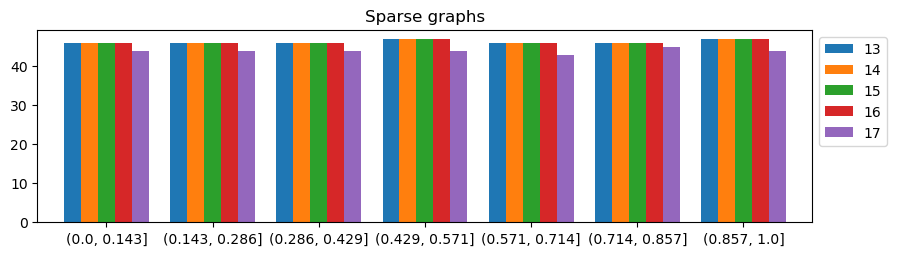

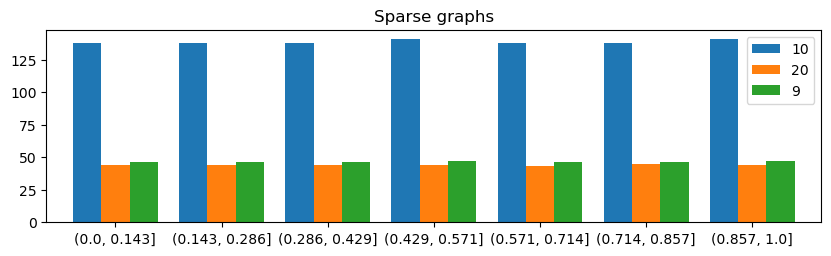

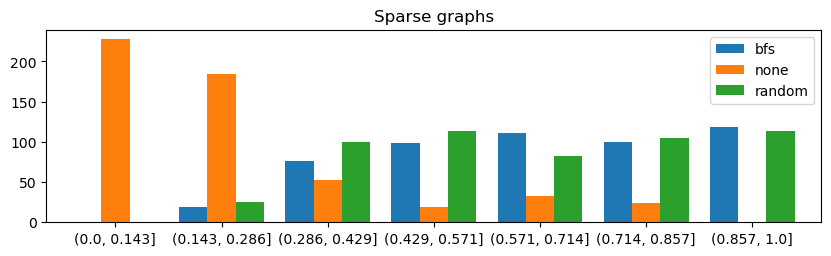

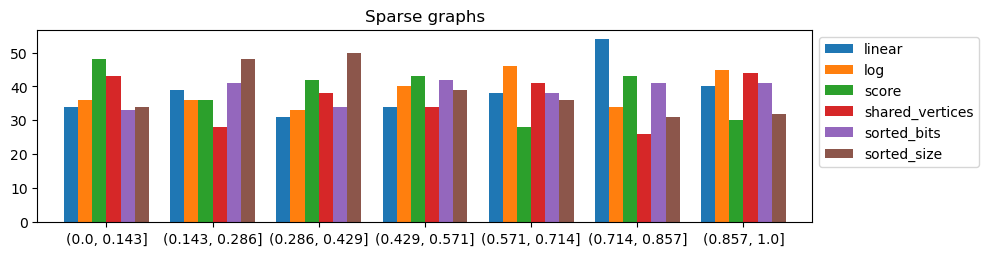

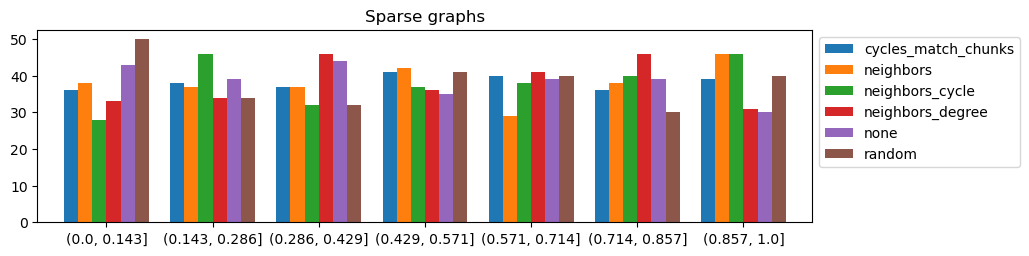

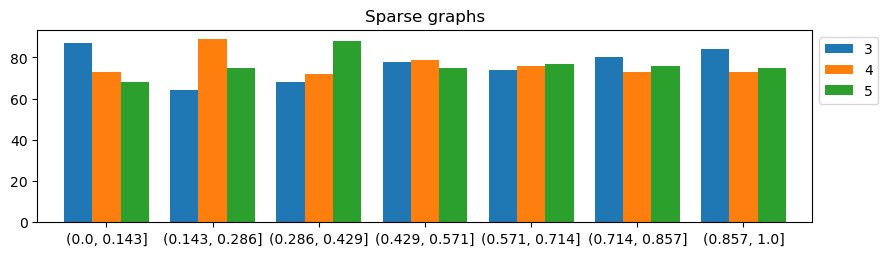

In [37]:
input = """
--------------------------------------------------------------------------------
Name (time in ms)                                                                              Min                    Max                   Mean            StdDev                 Median               IQR            Outliers     OPS            Rounds  Iterations
--------------------------------------------------------------------------------

test_SparseAll[13-10-none-subgraphs-sorted_bits-none-4-smart]                             156.7264 (1.0)         156.7264 (1.0)         156.7264 (1.0)      0.0000 (1.0)         156.7264 (1.0)      0.0000 (1.0)           0;0  6.3805 (1.0)           1           1
test_SparseAll[13-10-none-subgraphs-log-random-3-smart]                                   157.7258 (1.01)        157.7258 (1.01)        157.7258 (1.01)     0.0000 (1.0)         157.7258 (1.01)     0.0000 (1.0)           0;0  6.3401 (0.99)          1           1
test_SparseAll[13-10-none-subgraphs-linear-random-4-smart]                                159.5701 (1.02)        159.5701 (1.02)        159.5701 (1.02)     0.0000 (1.0)         159.5701 (1.02)     0.0000 (1.0)           0;0  6.2668 (0.98)          1           1
test_SparseAll[13-10-none-subgraphs-score-none-3-smart]                                   159.7715 (1.02)        159.7715 (1.02)        159.7715 (1.02)     0.0000 (1.0)         159.7715 (1.02)     0.0000 (1.0)           0;0  6.2589 (0.98)          1           1
test_SparseAll[13-10-none-subgraphs-score-random-4-smart]                                 160.5002 (1.02)        160.5002 (1.02)        160.5002 (1.02)     0.0000 (1.0)         160.5002 (1.02)     0.0000 (1.0)           0;0  6.2305 (0.98)          1           1
test_SparseAll[13-10-none-subgraphs-log-none-4-smart]                                     160.7603 (1.03)        160.7603 (1.03)        160.7603 (1.03)     0.0000 (1.0)         160.7603 (1.03)     0.0000 (1.0)           0;0  6.2204 (0.97)          1           1
test_SparseAll[13-10-none-subgraphs-log-random-5-smart]                                   161.4780 (1.03)        161.4780 (1.03)        161.4780 (1.03)     0.0000 (1.0)         161.4780 (1.03)     0.0000 (1.0)           0;0  6.1928 (0.97)          1           1
test_SparseAll[13-10-none-subgraphs-sorted_bits-random-5-smart]                           161.5056 (1.03)        161.5056 (1.03)        161.5056 (1.03)     0.0000 (1.0)         161.5056 (1.03)     0.0000 (1.0)           0;0  6.1917 (0.97)          1           1
test_SparseAll[13-10-none-subgraphs-linear-cycles_match_chunks-4-smart]                   161.8535 (1.03)        161.8535 (1.03)        161.8535 (1.03)     0.0000 (1.0)         161.8535 (1.03)     0.0000 (1.0)           0;0  6.1784 (0.97)          1           1
test_SparseAll[13-10-none-subgraphs-sorted_bits-neighbors_degree-4-smart]                 161.8847 (1.03)        161.8847 (1.03)        161.8847 (1.03)     0.0000 (1.0)         161.8847 (1.03)     0.0000 (1.0)           0;0  6.1772 (0.97)          1           1
test_SparseAll[13-10-none-subgraphs-score-neighbors-4-smart]                              162.3182 (1.04)        162.3182 (1.04)        162.3182 (1.04)     0.0000 (1.0)         162.3182 (1.04)     0.0000 (1.0)           0;0  6.1607 (0.97)          1           1
test_SparseAll[13-10-none-subgraphs-sorted_bits-cycles_match_chunks-4-smart]              162.5935 (1.04)        162.5935 (1.04)        162.5935 (1.04)     0.0000 (1.0)         162.5935 (1.04)     0.0000 (1.0)           0;0  6.1503 (0.96)          1           1
test_SparseAll[13-10-none-subgraphs-shared_vertices-cycles_match_chunks-4-smart]          162.6798 (1.04)        162.6798 (1.04)        162.6798 (1.04)     0.0000 (1.0)         162.6798 (1.04)     0.0000 (1.0)           0;0  6.1470 (0.96)          1           1
test_SparseAll[13-10-none-subgraphs-log-neighbors_cycle-4-smart]                          163.0634 (1.04)        163.0634 (1.04)        163.0634 (1.04)     0.0000 (1.0)         163.0634 (1.04)     0.0000 (1.0)           0;0  6.1326 (0.96)          1           1
test_SparseAll[13-10-none-subgraphs-linear-cycles_match_chunks-3-smart]                   163.0797 (1.04)        163.0797 (1.04)        163.0797 (1.04)     0.0000 (1.0)         163.0797 (1.04)     0.0000 (1.0)           0;0  6.1320 (0.96)          1           1
test_SparseAll[13-10-none-subgraphs-score-cycles_match_chunks-3-smart]                    163.1494 (1.04)        163.1494 (1.04)        163.1494 (1.04)     0.0000 (1.0)         163.1494 (1.04)     0.0000 (1.0)           0;0  6.1293 (0.96)          1           1
test_SparseAll[13-10-none-subgraphs-score-neighbors_degree-3-smart]                       163.5112 (1.04)        163.5112 (1.04)        163.5112 (1.04)     0.0000 (1.0)         163.5112 (1.04)     0.0000 (1.0)           0;0  6.1158 (0.96)          1           1
test_SparseAll[13-10-none-subgraphs-score-cycles_match_chunks-5-smart]                    164.4488 (1.05)        164.4488 (1.05)        164.4488 (1.05)     0.0000 (1.0)         164.4488 (1.05)     0.0000 (1.0)           0;0  6.0809 (0.95)          1           1
test_SparseAll[13-10-none-subgraphs-log-cycles_match_chunks-4-smart]                      164.6696 (1.05)        164.6696 (1.05)        164.6696 (1.05)     0.0000 (1.0)         164.6696 (1.05)     0.0000 (1.0)           0;0  6.0728 (0.95)          1           1
test_SparseAll[13-10-none-subgraphs-sorted_size-neighbors-4-smart]                        165.0556 (1.05)        165.0556 (1.05)        165.0556 (1.05)     0.0000 (1.0)         165.0556 (1.05)     0.0000 (1.0)           0;0  6.0586 (0.95)          1           1
test_SparseAll[13-10-none-subgraphs-shared_vertices-random-3-smart]                       165.1749 (1.05)        165.1749 (1.05)        165.1749 (1.05)     0.0000 (1.0)         165.1749 (1.05)     0.0000 (1.0)           0;0  6.0542 (0.95)          1           1
test_SparseAll[13-10-none-subgraphs-score-none-5-smart]                                   165.4342 (1.06)        165.4342 (1.06)        165.4342 (1.06)     0.0000 (1.0)         165.4342 (1.06)     0.0000 (1.0)           0;0  6.0447 (0.95)          1           1
test_SparseAll[13-10-none-subgraphs-shared_vertices-random-5-smart]                       166.1192 (1.06)        166.1192 (1.06)        166.1192 (1.06)     0.0000 (1.0)         166.1192 (1.06)     0.0000 (1.0)           0;0  6.0198 (0.94)          1           1
test_SparseAll[13-10-none-subgraphs-log-neighbors-3-smart]                                166.5691 (1.06)        166.5691 (1.06)        166.5691 (1.06)     0.0000 (1.0)         166.5691 (1.06)     0.0000 (1.0)           0;0  6.0035 (0.94)          1           1
test_SparseAll[13-10-none-subgraphs-sorted_bits-random-3-smart]                           166.6140 (1.06)        166.6140 (1.06)        166.6140 (1.06)     0.0000 (1.0)         166.6140 (1.06)     0.0000 (1.0)           0;0  6.0019 (0.94)          1           1
test_SparseAll[13-10-none-subgraphs-sorted_bits-neighbors-4-smart]                        166.6949 (1.06)        166.6949 (1.06)        166.6949 (1.06)     0.0000 (1.0)         166.6949 (1.06)     0.0000 (1.0)           0;0  5.9990 (0.94)          1           1
test_SparseAll[13-10-none-subgraphs-shared_vertices-neighbors_degree-5-smart]             166.7826 (1.06)        166.7826 (1.06)        166.7826 (1.06)     0.0000 (1.0)         166.7826 (1.06)     0.0000 (1.0)           0;0  5.9958 (0.94)          1           1
test_SparseAll[13-10-none-subgraphs-sorted_bits-neighbors-3-smart]                        167.3458 (1.07)        167.3458 (1.07)        167.3458 (1.07)     0.0000 (1.0)         167.3458 (1.07)     0.0000 (1.0)           0;0  5.9757 (0.94)          1           1
test_SparseAll[13-10-none-subgraphs-linear-neighbors-3-smart]                             167.7450 (1.07)        167.7450 (1.07)        167.7450 (1.07)     0.0000 (1.0)         167.7450 (1.07)     0.0000 (1.0)           0;0  5.9614 (0.93)          1           1
test_SparseAll[13-10-none-subgraphs-linear-neighbors-5-smart]                             167.9416 (1.07)        167.9416 (1.07)        167.9416 (1.07)     0.0000 (1.0)         167.9416 (1.07)     0.0000 (1.0)           0;0  5.9545 (0.93)          1           1
test_SparseAll[13-10-none-subgraphs-sorted_size-none-5-smart]                             168.2730 (1.07)        168.2730 (1.07)        168.2730 (1.07)     0.0000 (1.0)         168.2730 (1.07)     0.0000 (1.0)           0;0  5.9427 (0.93)          1           1
test_SparseAll[13-10-none-subgraphs-shared_vertices-neighbors_cycle-4-smart]              168.7200 (1.08)        168.7200 (1.08)        168.7200 (1.08)     0.0000 (1.0)         168.7200 (1.08)     0.0000 (1.0)           0;0  5.9270 (0.93)          1           1
test_SparseAll[13-10-none-subgraphs-shared_vertices-none-4-smart]                         168.8777 (1.08)        168.8777 (1.08)        168.8777 (1.08)     0.0000 (1.0)         168.8777 (1.08)     0.0000 (1.0)           0;0  5.9214 (0.93)          1           1
test_SparseAll[13-10-none-subgraphs-shared_vertices-neighbors_degree-3-smart]             169.0897 (1.08)        169.0897 (1.08)        169.0897 (1.08)     0.0000 (1.0)         169.0897 (1.08)     0.0000 (1.0)           0;0  5.9140 (0.93)          1           1
test_SparseAll[13-10-none-subgraphs-shared_vertices-neighbors-3-smart]                    169.2096 (1.08)        169.2096 (1.08)        169.2096 (1.08)     0.0000 (1.0)         169.2096 (1.08)     0.0000 (1.0)           0;0  5.9098 (0.93)          1           1
test_SparseAll[13-10-none-subgraphs-score-neighbors_cycle-3-smart]                        169.4473 (1.08)        169.4473 (1.08)        169.4473 (1.08)     0.0000 (1.0)         169.4473 (1.08)     0.0000 (1.0)           0;0  5.9015 (0.92)          1           1
test_SparseAll[13-10-none-subgraphs-linear-neighbors_cycle-4-smart]                       169.5204 (1.08)        169.5204 (1.08)        169.5204 (1.08)     0.0000 (1.0)         169.5204 (1.08)     0.0000 (1.0)           0;0  5.8990 (0.92)          1           1
test_SparseAll[13-10-none-subgraphs-shared_vertices-neighbors-5-smart]                    169.7073 (1.08)        169.7073 (1.08)        169.7073 (1.08)     0.0000 (1.0)         169.7073 (1.08)     0.0000 (1.0)           0;0  5.8925 (0.92)          1           1
test_SparseAll[13-10-none-subgraphs-score-neighbors_cycle-4-smart]                        170.9737 (1.09)        170.9737 (1.09)        170.9737 (1.09)     0.0000 (1.0)         170.9737 (1.09)     0.0000 (1.0)           0;0  5.8489 (0.92)          1           1
test_SparseAll[13-10-none-subgraphs-sorted_size-cycles_match_chunks-3-smart]              171.0375 (1.09)        171.0375 (1.09)        171.0375 (1.09)     0.0000 (1.0)         171.0375 (1.09)     0.0000 (1.0)           0;0  5.8467 (0.92)          1           1
test_SparseAll[13-10-none-subgraphs-sorted_bits-neighbors_cycle-3-smart]                  172.0191 (1.10)        172.0191 (1.10)        172.0191 (1.10)     0.0000 (1.0)         172.0191 (1.10)     0.0000 (1.0)           0;0  5.8133 (0.91)          1           1
test_SparseAll[13-10-none-subgraphs-log-neighbors-5-smart]                                172.4498 (1.10)        172.4498 (1.10)        172.4498 (1.10)     0.0000 (1.0)         172.4498 (1.10)     0.0000 (1.0)           0;0  5.7988 (0.91)          1           1
test_SparseAll[13-10-none-subgraphs-log-neighbors_degree-5-smart]                         172.5029 (1.10)        172.5029 (1.10)        172.5029 (1.10)     0.0000 (1.0)         172.5029 (1.10)     0.0000 (1.0)           0;0  5.7970 (0.91)          1           1
test_SparseAll[13-10-none-subgraphs-linear-none-5-smart]                                  172.5827 (1.10)        172.5827 (1.10)        172.5827 (1.10)     0.0000 (1.0)         172.5827 (1.10)     0.0000 (1.0)           0;0  5.7943 (0.91)          1           1
test_SparseAll[13-10-none-subgraphs-score-neighbors_degree-5-smart]                       172.9743 (1.10)        172.9743 (1.10)        172.9743 (1.10)     0.0000 (1.0)         172.9743 (1.10)     0.0000 (1.0)           0;0  5.7812 (0.91)          1           1
test_SparseAll[13-10-none-subgraphs-sorted_size-none-3-smart]                             173.3514 (1.11)        173.3514 (1.11)        173.3514 (1.11)     0.0000 (1.0)         173.3514 (1.11)     0.0000 (1.0)           0;0  5.7686 (0.90)          1           1
test_SparseAll[13-10-none-subgraphs-sorted_size-random-4-smart]                           173.5758 (1.11)        173.5758 (1.11)        173.5758 (1.11)     0.0000 (1.0)         173.5758 (1.11)     0.0000 (1.0)           0;0  5.7612 (0.90)          1           1
test_SparseAll[13-10-none-subgraphs-sorted_bits-neighbors_cycle-5-smart]                  173.6641 (1.11)        173.6641 (1.11)        173.6641 (1.11)     0.0000 (1.0)         173.6641 (1.11)     0.0000 (1.0)           0;0  5.7582 (0.90)          1           1
test_SparseAll[13-10-none-subgraphs-linear-none-3-smart]                                  175.5491 (1.12)        175.5491 (1.12)        175.5491 (1.12)     0.0000 (1.0)         175.5491 (1.12)     0.0000 (1.0)           0;0  5.6964 (0.89)          1           1
test_SparseAll[13-10-none-subgraphs-sorted_size-neighbors_degree-4-smart]                 181.9264 (1.16)        181.9264 (1.16)        181.9264 (1.16)     0.0000 (1.0)         181.9264 (1.16)     0.0000 (1.0)           0;0  5.4967 (0.86)          1           1
test_SparseAll[13-10-none-subgraphs-log-neighbors_degree-3-smart]                         182.0432 (1.16)        182.0432 (1.16)        182.0432 (1.16)     0.0000 (1.0)         182.0432 (1.16)     0.0000 (1.0)           0;0  5.4932 (0.86)          1           1
test_SparseAll[13-10-none-subgraphs-linear-neighbors_degree-5-smart]                      183.2814 (1.17)        183.2814 (1.17)        183.2814 (1.17)     0.0000 (1.0)         183.2814 (1.17)     0.0000 (1.0)           0;0  5.4561 (0.86)          1           1
test_SparseAll[13-10-none-subgraphs-linear-neighbors_degree-3-smart]                      186.3074 (1.19)        186.3074 (1.19)        186.3074 (1.19)     0.0000 (1.0)         186.3074 (1.19)     0.0000 (1.0)           0;0  5.3675 (0.84)          1           1
test_SparseAll[13-10-none-subgraphs-sorted_size-neighbors_cycle-3-smart]                  188.6084 (1.20)        188.6084 (1.20)        188.6084 (1.20)     0.0000 (1.0)         188.6084 (1.20)     0.0000 (1.0)           0;0  5.3020 (0.83)          1           1
test_SparseAll[13-10-none-subgraphs-sorted_size-neighbors_cycle-5-smart]                  191.3798 (1.22)        191.3798 (1.22)        191.3798 (1.22)     0.0000 (1.0)         191.3798 (1.22)     0.0000 (1.0)           0;0  5.2252 (0.82)          1           1
test_SparseAll[13-10-none-subgraphs-sorted_size-cycles_match_chunks-5-smart]              194.1301 (1.24)        194.1301 (1.24)        194.1301 (1.24)     0.0000 (1.0)         194.1301 (1.24)     0.0000 (1.0)           0;0  5.1512 (0.81)          1           1
test_SparseAll[13-10-bfs-subgraphs-score-random-4-smart]                                  323.1228 (2.06)        323.1228 (2.06)        323.1228 (2.06)     0.0000 (1.0)         323.1228 (2.06)     0.0000 (1.0)           0;0  3.0948 (0.49)          1           1
test_SparseAll[13-10-bfs-subgraphs-linear-none-4-smart]                                   323.8550 (2.07)        323.8550 (2.07)        323.8550 (2.07)     0.0000 (1.0)         323.8550 (2.07)     0.0000 (1.0)           0;0  3.0878 (0.48)          1           1
test_SparseAll[13-10-bfs-subgraphs-sorted_size-none-3-smart]                              324.7596 (2.07)        324.7596 (2.07)        324.7596 (2.07)     0.0000 (1.0)         324.7596 (2.07)     0.0000 (1.0)           0;0  3.0792 (0.48)          1           1
test_SparseAll[13-10-random-subgraphs-sorted_bits-none-3-smart]                           325.5544 (2.08)        325.5544 (2.08)        325.5544 (2.08)     0.0000 (1.0)         325.5544 (2.08)     0.0000 (1.0)           0;0  3.0717 (0.48)          1           1
test_SparseAll[13-10-random-subgraphs-linear-cycles_match_chunks-4-smart]                 325.6089 (2.08)        325.6089 (2.08)        325.6089 (2.08)     0.0000 (1.0)         325.6089 (2.08)     0.0000 (1.0)           0;0  3.0712 (0.48)          1           1
test_SparseAll[13-10-bfs-subgraphs-score-none-3-smart]                                    325.8246 (2.08)        325.8246 (2.08)        325.8246 (2.08)     0.0000 (1.0)         325.8246 (2.08)     0.0000 (1.0)           0;0  3.0691 (0.48)          1           1
test_SparseAll[13-10-bfs-subgraphs-sorted_size-random-4-smart]                            326.1340 (2.08)        326.1340 (2.08)        326.1340 (2.08)     0.0000 (1.0)         326.1340 (2.08)     0.0000 (1.0)           0;0  3.0662 (0.48)          1           1
test_SparseAll[13-10-random-subgraphs-sorted_size-random-4-smart]                         326.2134 (2.08)        326.2134 (2.08)        326.2134 (2.08)     0.0000 (1.0)         326.2134 (2.08)     0.0000 (1.0)           0;0  3.0655 (0.48)          1           1
test_SparseAll[13-10-bfs-subgraphs-score-none-5-smart]                                    326.5593 (2.08)        326.5593 (2.08)        326.5593 (2.08)     0.0000 (1.0)         326.5593 (2.08)     0.0000 (1.0)           0;0  3.0622 (0.48)          1           1
test_SparseAll[13-10-random-subgraphs-linear-random-3-smart]                              326.9050 (2.09)        326.9050 (2.09)        326.9050 (2.09)     0.0000 (1.0)         326.9050 (2.09)     0.0000 (1.0)           0;0  3.0590 (0.48)          1           1
test_SparseAll[13-10-random-subgraphs-shared_vertices-none-4-smart]                       327.1582 (2.09)        327.1582 (2.09)        327.1582 (2.09)     0.0000 (1.0)         327.1582 (2.09)     0.0000 (1.0)           0;0  3.0566 (0.48)          1           1
test_SparseAll[13-10-bfs-subgraphs-sorted_bits-neighbors-4-smart]                         327.2358 (2.09)        327.2358 (2.09)        327.2358 (2.09)     0.0000 (1.0)         327.2358 (2.09)     0.0000 (1.0)           0;0  3.0559 (0.48)          1           1
test_SparseAll[13-10-random-subgraphs-score-none-3-smart]                                 327.4796 (2.09)        327.4796 (2.09)        327.4796 (2.09)     0.0000 (1.0)         327.4796 (2.09)     0.0000 (1.0)           0;0  3.0536 (0.48)          1           1
test_SparseAll[13-10-random-subgraphs-score-random-4-smart]                               327.7628 (2.09)        327.7628 (2.09)        327.7628 (2.09)     0.0000 (1.0)         327.7628 (2.09)     0.0000 (1.0)           0;0  3.0510 (0.48)          1           1
test_SparseAll[13-10-random-subgraphs-log-none-4-smart]                                   327.8355 (2.09)        327.8355 (2.09)        327.8355 (2.09)     0.0000 (1.0)         327.8355 (2.09)     0.0000 (1.0)           0;0  3.0503 (0.48)          1           1
test_SparseAll[13-10-random-subgraphs-sorted_size-neighbors-4-smart]                      327.9516 (2.09)        327.9516 (2.09)        327.9516 (2.09)     0.0000 (1.0)         327.9516 (2.09)     0.0000 (1.0)           0;0  3.0492 (0.48)          1           1
test_SparseAll[13-10-random-subgraphs-score-none-5-smart]                                 328.1212 (2.09)        328.1212 (2.09)        328.1212 (2.09)     0.0000 (1.0)         328.1212 (2.09)     0.0000 (1.0)           0;0  3.0477 (0.48)          1           1
test_SparseAll[13-10-bfs-subgraphs-shared_vertices-none-4-smart]                          328.1791 (2.09)        328.1791 (2.09)        328.1791 (2.09)     0.0000 (1.0)         328.1791 (2.09)     0.0000 (1.0)           0;0  3.0471 (0.48)          1           1
test_SparseAll[13-10-random-subgraphs-sorted_size-none-3-smart]                           328.4045 (2.10)        328.4045 (2.10)        328.4045 (2.10)     0.0000 (1.0)         328.4045 (2.10)     0.0000 (1.0)           0;0  3.0450 (0.48)          1           1
test_SparseAll[13-10-bfs-subgraphs-sorted_size-none-5-smart]                              328.6601 (2.10)        328.6601 (2.10)        328.6601 (2.10)     0.0000 (1.0)         328.6601 (2.10)     0.0000 (1.0)           0;0  3.0427 (0.48)          1           1
test_SparseAll[13-10-bfs-subgraphs-sorted_bits-random-4-smart]                            329.1027 (2.10)        329.1027 (2.10)        329.1027 (2.10)     0.0000 (1.0)         329.1027 (2.10)     0.0000 (1.0)           0;0  3.0386 (0.48)          1           1
test_SparseAll[13-10-bfs-subgraphs-sorted_size-cycles_match_chunks-5-smart]               329.2631 (2.10)        329.2631 (2.10)        329.2631 (2.10)     0.0000 (1.0)         329.2631 (2.10)     0.0000 (1.0)           0;0  3.0371 (0.48)          1           1
test_SparseAll[13-10-bfs-subgraphs-shared_vertices-neighbors_cycle-4-smart]               329.4987 (2.10)        329.4987 (2.10)        329.4987 (2.10)     0.0000 (1.0)         329.4987 (2.10)     0.0000 (1.0)           0;0  3.0349 (0.48)          1           1
test_SparseAll[13-10-random-subgraphs-sorted_bits-random-4-smart]                         329.7919 (2.10)        329.7919 (2.10)        329.7919 (2.10)     0.0000 (1.0)         329.7919 (2.10)     0.0000 (1.0)           0;0  3.0322 (0.48)          1           1
test_SparseAll[13-10-random-subgraphs-log-random-5-smart]                                 329.8847 (2.10)        329.8847 (2.10)        329.8847 (2.10)     0.0000 (1.0)         329.8847 (2.10)     0.0000 (1.0)           0;0  3.0314 (0.48)          1           1
test_SparseAll[13-10-random-subgraphs-sorted_size-neighbors_cycle-5-smart]                329.8896 (2.10)        329.8896 (2.10)        329.8896 (2.10)     0.0000 (1.0)         329.8896 (2.10)     0.0000 (1.0)           0;0  3.0313 (0.48)          1           1
test_SparseAll[13-10-bfs-subgraphs-sorted_bits-none-3-smart]                              330.0660 (2.11)        330.0660 (2.11)        330.0660 (2.11)     0.0000 (1.0)         330.0660 (2.11)     0.0000 (1.0)           0;0  3.0297 (0.47)          1           1
test_SparseAll[13-10-bfs-subgraphs-log-neighbors_cycle-4-smart]                           330.5027 (2.11)        330.5027 (2.11)        330.5027 (2.11)     0.0000 (1.0)         330.5027 (2.11)     0.0000 (1.0)           0;0  3.0257 (0.47)          1           1
test_SparseAll[13-10-random-subgraphs-log-neighbors_degree-4-smart]                       330.7368 (2.11)        330.7368 (2.11)        330.7368 (2.11)     0.0000 (1.0)         330.7368 (2.11)     0.0000 (1.0)           0;0  3.0236 (0.47)          1           1
test_SparseAll[13-10-random-subgraphs-shared_vertices-random-5-smart]                     330.7375 (2.11)        330.7375 (2.11)        330.7375 (2.11)     0.0000 (1.0)         330.7375 (2.11)     0.0000 (1.0)           0;0  3.0235 (0.47)          1           1
test_SparseAll[13-10-bfs-subgraphs-log-cycles_match_chunks-4-smart]                       331.0167 (2.11)        331.0167 (2.11)        331.0167 (2.11)     0.0000 (1.0)         331.0167 (2.11)     0.0000 (1.0)           0;0  3.0210 (0.47)          1           1
test_SparseAll[13-10-random-subgraphs-log-neighbors-4-smart]                              331.0469 (2.11)        331.0469 (2.11)        331.0469 (2.11)     0.0000 (1.0)         331.0469 (2.11)     0.0000 (1.0)           0;0  3.0207 (0.47)          1           1
test_SparseAll[13-10-random-subgraphs-sorted_size-none-5-smart]                           331.0967 (2.11)        331.0967 (2.11)        331.0967 (2.11)     0.0000 (1.0)         331.0967 (2.11)     0.0000 (1.0)           0;0  3.0203 (0.47)          1           1
test_SparseAll[13-10-bfs-subgraphs-score-neighbors_cycle-4-smart]                         331.1515 (2.11)        331.1515 (2.11)        331.1515 (2.11)     0.0000 (1.0)         331.1515 (2.11)     0.0000 (1.0)           0;0  3.0198 (0.47)          1           1
test_SparseAll[13-10-random-subgraphs-linear-random-5-smart]                              331.2543 (2.11)        331.2543 (2.11)        331.2543 (2.11)     0.0000 (1.0)         331.2543 (2.11)     0.0000 (1.0)           0;0  3.0188 (0.47)          1           1
test_SparseAll[13-10-bfs-subgraphs-linear-random-3-smart]                                 331.2721 (2.11)        331.2721 (2.11)        331.2721 (2.11)     0.0000 (1.0)         331.2721 (2.11)     0.0000 (1.0)           0;0  3.0187 (0.47)          1           1
test_SparseAll[13-10-bfs-subgraphs-sorted_size-neighbors-4-smart]                         331.3036 (2.11)        331.3036 (2.11)        331.3036 (2.11)     0.0000 (1.0)         331.3036 (2.11)     0.0000 (1.0)           0;0  3.0184 (0.47)          1           1
test_SparseAll[13-10-bfs-subgraphs-sorted_bits-cycles_match_chunks-5-smart]               331.3550 (2.11)        331.3550 (2.11)        331.3550 (2.11)     0.0000 (1.0)         331.3550 (2.11)     0.0000 (1.0)           0;0  3.0179 (0.47)          1           1
test_SparseAll[13-10-bfs-subgraphs-sorted_size-cycles_match_chunks-3-smart]               331.4230 (2.11)        331.4230 (2.11)        331.4230 (2.11)     0.0000 (1.0)         331.4230 (2.11)     0.0000 (1.0)           0;0  3.0173 (0.47)          1           1
test_SparseAll[13-10-bfs-subgraphs-score-cycles_match_chunks-4-smart]                     331.5791 (2.12)        331.5791 (2.12)        331.5791 (2.12)     0.0000 (1.0)         331.5791 (2.12)     0.0000 (1.0)           0;0  3.0159 (0.47)          1           1
test_SparseAll[13-10-bfs-subgraphs-score-neighbors_degree-5-smart]                        331.6145 (2.12)        331.6145 (2.12)        331.6145 (2.12)     0.0000 (1.0)         331.6145 (2.12)     0.0000 (1.0)           0;0  3.0155 (0.47)          1           1
test_SparseAll[13-10-bfs-subgraphs-shared_vertices-random-3-smart]                        331.8003 (2.12)        331.8003 (2.12)        331.8003 (2.12)     0.0000 (1.0)         331.8003 (2.12)     0.0000 (1.0)           0;0  3.0139 (0.47)          1           1
test_SparseAll[13-10-bfs-subgraphs-score-neighbors_degree-3-smart]                        331.9666 (2.12)        331.9666 (2.12)        331.9666 (2.12)     0.0000 (1.0)         331.9666 (2.12)     0.0000 (1.0)           0;0  3.0124 (0.47)          1           1
test_SparseAll[13-10-bfs-subgraphs-shared_vertices-cycles_match_chunks-4-smart]           331.9790 (2.12)        331.9790 (2.12)        331.9790 (2.12)     0.0000 (1.0)         331.9790 (2.12)     0.0000 (1.0)           0;0  3.0122 (0.47)          1           1
test_SparseAll[13-10-random-subgraphs-linear-neighbors-3-smart]                           332.0753 (2.12)        332.0753 (2.12)        332.0753 (2.12)     0.0000 (1.0)         332.0753 (2.12)     0.0000 (1.0)           0;0  3.0114 (0.47)          1           1
test_SparseAll[13-10-random-subgraphs-sorted_bits-cycles_match_chunks-3-smart]            332.0961 (2.12)        332.0961 (2.12)        332.0961 (2.12)     0.0000 (1.0)         332.0961 (2.12)     0.0000 (1.0)           0;0  3.0112 (0.47)          1           1
test_SparseAll[13-10-random-subgraphs-sorted_bits-none-5-smart]                           332.4227 (2.12)        332.4227 (2.12)        332.4227 (2.12)     0.0000 (1.0)         332.4227 (2.12)     0.0000 (1.0)           0;0  3.0082 (0.47)          1           1
test_SparseAll[13-10-bfs-subgraphs-shared_vertices-neighbors-3-smart]                     332.4646 (2.12)        332.4646 (2.12)        332.4646 (2.12)     0.0000 (1.0)         332.4646 (2.12)     0.0000 (1.0)           0;0  3.0078 (0.47)          1           1
test_SparseAll[13-10-bfs-subgraphs-linear-random-5-smart]                                 332.4679 (2.12)        332.4679 (2.12)        332.4679 (2.12)     0.0000 (1.0)         332.4679 (2.12)     0.0000 (1.0)           0;0  3.0078 (0.47)          1           1
test_SparseAll[13-10-bfs-subgraphs-sorted_bits-none-5-smart]                              332.5163 (2.12)        332.5163 (2.12)        332.5163 (2.12)     0.0000 (1.0)         332.5163 (2.12)     0.0000 (1.0)           0;0  3.0074 (0.47)          1           1
test_SparseAll[13-10-bfs-subgraphs-score-neighbors-3-smart]                               332.5436 (2.12)        332.5436 (2.12)        332.5436 (2.12)     0.0000 (1.0)         332.5436 (2.12)     0.0000 (1.0)           0;0  3.0071 (0.47)          1           1
test_SparseAll[13-10-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]        332.5762 (2.12)        332.5762 (2.12)        332.5762 (2.12)     0.0000 (1.0)         332.5762 (2.12)     0.0000 (1.0)           0;0  3.0068 (0.47)          1           1
test_SparseAll[13-10-random-subgraphs-score-neighbors_degree-5-smart]                     332.9650 (2.12)        332.9650 (2.12)        332.9650 (2.12)     0.0000 (1.0)         332.9650 (2.12)     0.0000 (1.0)           0;0  3.0033 (0.47)          1           1
test_SparseAll[13-10-random-subgraphs-shared_vertices-neighbors_cycle-4-smart]            332.9783 (2.12)        332.9783 (2.12)        332.9783 (2.12)     0.0000 (1.0)         332.9783 (2.12)     0.0000 (1.0)           0;0  3.0032 (0.47)          1           1
test_SparseAll[13-10-random-subgraphs-shared_vertices-random-3-smart]                     333.1037 (2.13)        333.1037 (2.13)        333.1037 (2.13)     0.0000 (1.0)         333.1037 (2.13)     0.0000 (1.0)           0;0  3.0021 (0.47)          1           1
test_SparseAll[13-10-random-subgraphs-sorted_size-neighbors_degree-4-smart]               333.1070 (2.13)        333.1070 (2.13)        333.1070 (2.13)     0.0000 (1.0)         333.1070 (2.13)     0.0000 (1.0)           0;0  3.0020 (0.47)          1           1
test_SparseAll[13-10-random-subgraphs-sorted_size-neighbors_cycle-3-smart]                333.1443 (2.13)        333.1443 (2.13)        333.1443 (2.13)     0.0000 (1.0)         333.1443 (2.13)     0.0000 (1.0)           0;0  3.0017 (0.47)          1           1
test_SparseAll[13-10-bfs-subgraphs-sorted_size-neighbors_degree-4-smart]                  333.3822 (2.13)        333.3822 (2.13)        333.3822 (2.13)     0.0000 (1.0)         333.3822 (2.13)     0.0000 (1.0)           0;0  2.9996 (0.47)          1           1
test_SparseAll[13-10-random-subgraphs-linear-neighbors-5-smart]                           333.6415 (2.13)        333.6415 (2.13)        333.6415 (2.13)     0.0000 (1.0)         333.6415 (2.13)     0.0000 (1.0)           0;0  2.9972 (0.47)          1           1
test_SparseAll[13-10-random-subgraphs-log-neighbors_cycle-3-smart]                        333.7702 (2.13)        333.7702 (2.13)        333.7702 (2.13)     0.0000 (1.0)         333.7702 (2.13)     0.0000 (1.0)           0;0  2.9961 (0.47)          1           1
test_SparseAll[13-10-random-subgraphs-log-random-3-smart]                                 333.9127 (2.13)        333.9127 (2.13)        333.9127 (2.13)     0.0000 (1.0)         333.9127 (2.13)     0.0000 (1.0)           0;0  2.9948 (0.47)          1           1
test_SparseAll[13-10-bfs-subgraphs-sorted_bits-cycles_match_chunks-3-smart]               334.3260 (2.13)        334.3260 (2.13)        334.3260 (2.13)     0.0000 (1.0)         334.3260 (2.13)     0.0000 (1.0)           0;0  2.9911 (0.47)          1           1
test_SparseAll[13-10-random-subgraphs-linear-neighbors_degree-3-smart]                    334.3713 (2.13)        334.3713 (2.13)        334.3713 (2.13)     0.0000 (1.0)         334.3713 (2.13)     0.0000 (1.0)           0;0  2.9907 (0.47)          1           1
test_SparseAll[13-10-random-subgraphs-log-cycles_match_chunks-5-smart]                    334.9143 (2.14)        334.9143 (2.14)        334.9143 (2.14)     0.0000 (1.0)         334.9143 (2.14)     0.0000 (1.0)           0;0  2.9858 (0.47)          1           1
test_SparseAll[13-10-bfs-subgraphs-linear-neighbors_cycle-4-smart]                        334.9683 (2.14)        334.9683 (2.14)        334.9683 (2.14)     0.0000 (1.0)         334.9683 (2.14)     0.0000 (1.0)           0;0  2.9854 (0.47)          1           1
test_SparseAll[13-10-bfs-subgraphs-sorted_size-neighbors_cycle-3-smart]                   335.0076 (2.14)        335.0076 (2.14)        335.0076 (2.14)     0.0000 (1.0)         335.0076 (2.14)     0.0000 (1.0)           0;0  2.9850 (0.47)          1           1
test_SparseAll[13-10-bfs-subgraphs-shared_vertices-neighbors_degree-3-smart]              335.1291 (2.14)        335.1291 (2.14)        335.1291 (2.14)     0.0000 (1.0)         335.1291 (2.14)     0.0000 (1.0)           0;0  2.9839 (0.47)          1           1
test_SparseAll[13-10-random-subgraphs-linear-neighbors_degree-5-smart]                    335.2668 (2.14)        335.2668 (2.14)        335.2668 (2.14)     0.0000 (1.0)         335.2668 (2.14)     0.0000 (1.0)           0;0  2.9827 (0.47)          1           1
test_SparseAll[13-10-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]                335.5072 (2.14)        335.5072 (2.14)        335.5072 (2.14)     0.0000 (1.0)         335.5072 (2.14)     0.0000 (1.0)           0;0  2.9806 (0.47)          1           1
test_SparseAll[13-10-bfs-subgraphs-shared_vertices-neighbors-5-smart]                     335.5855 (2.14)        335.5855 (2.14)        335.5855 (2.14)     0.0000 (1.0)         335.5855 (2.14)     0.0000 (1.0)           0;0  2.9799 (0.47)          1           1
test_SparseAll[13-10-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]            335.6179 (2.14)        335.6179 (2.14)        335.6179 (2.14)     0.0000 (1.0)         335.6179 (2.14)     0.0000 (1.0)           0;0  2.9796 (0.47)          1           1
test_SparseAll[13-10-random-subgraphs-sorted_bits-neighbors_degree-4-smart]               335.7336 (2.14)        335.7336 (2.14)        335.7336 (2.14)     0.0000 (1.0)         335.7336 (2.14)     0.0000 (1.0)           0;0  2.9786 (0.47)          1           1
test_SparseAll[13-10-bfs-subgraphs-sorted_bits-neighbors_degree-4-smart]                  335.7516 (2.14)        335.7516 (2.14)        335.7516 (2.14)     0.0000 (1.0)         335.7516 (2.14)     0.0000 (1.0)           0;0  2.9784 (0.47)          1           1
test_SparseAll[13-10-bfs-subgraphs-linear-cycles_match_chunks-4-smart]                    335.8708 (2.14)        335.8708 (2.14)        335.8708 (2.14)     0.0000 (1.0)         335.8708 (2.14)     0.0000 (1.0)           0;0  2.9773 (0.47)          1           1
test_SparseAll[13-10-bfs-subgraphs-log-neighbors_degree-4-smart]                          336.0063 (2.14)        336.0063 (2.14)        336.0063 (2.14)     0.0000 (1.0)         336.0063 (2.14)     0.0000 (1.0)           0;0  2.9761 (0.47)          1           1
test_SparseAll[13-10-bfs-subgraphs-score-neighbors-5-smart]                               336.0163 (2.14)        336.0163 (2.14)        336.0163 (2.14)     0.0000 (1.0)         336.0163 (2.14)     0.0000 (1.0)           0;0  2.9760 (0.47)          1           1
test_SparseAll[13-10-bfs-subgraphs-log-none-4-smart]                                      336.1700 (2.14)        336.1700 (2.14)        336.1700 (2.14)     0.0000 (1.0)         336.1700 (2.14)     0.0000 (1.0)           0;0  2.9747 (0.47)          1           1
test_SparseAll[13-10-random-subgraphs-sorted_size-cycles_match_chunks-5-smart]            336.2256 (2.15)        336.2256 (2.15)        336.2256 (2.15)     0.0000 (1.0)         336.2256 (2.15)     0.0000 (1.0)           0;0  2.9742 (0.47)          1           1
test_SparseAll[13-10-random-subgraphs-sorted_bits-neighbors-4-smart]                      336.3196 (2.15)        336.3196 (2.15)        336.3196 (2.15)     0.0000 (1.0)         336.3196 (2.15)     0.0000 (1.0)           0;0  2.9734 (0.47)          1           1
test_SparseAll[13-10-bfs-subgraphs-log-neighbors-5-smart]                                 336.5997 (2.15)        336.5997 (2.15)        336.5997 (2.15)     0.0000 (1.0)         336.5997 (2.15)     0.0000 (1.0)           0;0  2.9709 (0.47)          1           1
test_SparseAll[13-10-bfs-subgraphs-log-neighbors_cycle-5-smart]                           336.7220 (2.15)        336.7220 (2.15)        336.7220 (2.15)     0.0000 (1.0)         336.7220 (2.15)     0.0000 (1.0)           0;0  2.9698 (0.47)          1           1
test_SparseAll[13-10-bfs-subgraphs-shared_vertices-neighbors_degree-5-smart]              336.7481 (2.15)        336.7481 (2.15)        336.7481 (2.15)     0.0000 (1.0)         336.7481 (2.15)     0.0000 (1.0)           0;0  2.9696 (0.47)          1           1
test_SparseAll[13-10-bfs-subgraphs-linear-neighbors_degree-5-smart]                       336.7992 (2.15)        336.7992 (2.15)        336.7992 (2.15)     0.0000 (1.0)         336.7992 (2.15)     0.0000 (1.0)           0;0  2.9691 (0.47)          1           1
test_SparseAll[13-10-random-subgraphs-shared_vertices-neighbors-5-smart]                  336.9427 (2.15)        336.9427 (2.15)        336.9427 (2.15)     0.0000 (1.0)         336.9427 (2.15)     0.0000 (1.0)           0;0  2.9679 (0.47)          1           1
test_SparseAll[13-10-bfs-subgraphs-log-random-3-smart]                                    336.9711 (2.15)        336.9711 (2.15)        336.9711 (2.15)     0.0000 (1.0)         336.9711 (2.15)     0.0000 (1.0)           0;0  2.9676 (0.47)          1           1
test_SparseAll[13-10-bfs-subgraphs-shared_vertices-random-5-smart]                        337.0097 (2.15)        337.0097 (2.15)        337.0097 (2.15)     0.0000 (1.0)         337.0097 (2.15)     0.0000 (1.0)           0;0  2.9673 (0.47)          1           1
test_SparseAll[13-10-random-subgraphs-log-cycles_match_chunks-4-smart]                    337.0180 (2.15)        337.0180 (2.15)        337.0180 (2.15)     0.0000 (1.0)         337.0180 (2.15)     0.0000 (1.0)           0;0  2.9672 (0.47)          1           1
test_SparseAll[13-10-bfs-subgraphs-linear-neighbors_degree-3-smart]                       337.2099 (2.15)        337.2099 (2.15)        337.2099 (2.15)     0.0000 (1.0)         337.2099 (2.15)     0.0000 (1.0)           0;0  2.9655 (0.46)          1           1
test_SparseAll[13-10-random-subgraphs-score-neighbors-3-smart]                            337.2318 (2.15)        337.2318 (2.15)        337.2318 (2.15)     0.0000 (1.0)         337.2318 (2.15)     0.0000 (1.0)           0;0  2.9653 (0.46)          1           1
test_SparseAll[13-10-random-subgraphs-linear-none-4-smart]                                337.3512 (2.15)        337.3512 (2.15)        337.3512 (2.15)     0.0000 (1.0)         337.3512 (2.15)     0.0000 (1.0)           0;0  2.9643 (0.46)          1           1
test_SparseAll[13-10-random-subgraphs-linear-neighbors_cycle-4-smart]                     337.8497 (2.16)        337.8497 (2.16)        337.8497 (2.16)     0.0000 (1.0)         337.8497 (2.16)     0.0000 (1.0)           0;0  2.9599 (0.46)          1           1
test_SparseAll[13-10-bfs-subgraphs-log-neighbors-3-smart]                                 337.9540 (2.16)        337.9540 (2.16)        337.9540 (2.16)     0.0000 (1.0)         337.9540 (2.16)     0.0000 (1.0)           0;0  2.9590 (0.46)          1           1
test_SparseAll[13-10-random-subgraphs-shared_vertices-neighbors_degree-5-smart]           338.4326 (2.16)        338.4326 (2.16)        338.4326 (2.16)     0.0000 (1.0)         338.4326 (2.16)     0.0000 (1.0)           0;0  2.9548 (0.46)          1           1
test_SparseAll[13-10-random-subgraphs-log-neighbors_cycle-5-smart]                        338.4709 (2.16)        338.4709 (2.16)        338.4709 (2.16)     0.0000 (1.0)         338.4709 (2.16)     0.0000 (1.0)           0;0  2.9545 (0.46)          1           1
test_SparseAll[13-10-random-subgraphs-shared_vertices-neighbors-3-smart]                  339.4045 (2.17)        339.4045 (2.17)        339.4045 (2.17)     0.0000 (1.0)         339.4045 (2.17)     0.0000 (1.0)           0;0  2.9463 (0.46)          1           1
test_SparseAll[13-10-random-subgraphs-score-neighbors_cycle-4-smart]                      339.7786 (2.17)        339.7786 (2.17)        339.7786 (2.17)     0.0000 (1.0)         339.7786 (2.17)     0.0000 (1.0)           0;0  2.9431 (0.46)          1           1
test_SparseAll[13-10-random-subgraphs-score-neighbors-5-smart]                            340.1666 (2.17)        340.1666 (2.17)        340.1666 (2.17)     0.0000 (1.0)         340.1666 (2.17)     0.0000 (1.0)           0;0  2.9397 (0.46)          1           1
test_SparseAll[13-10-bfs-subgraphs-score-random-5-smart]                                  340.3205 (2.17)        340.3205 (2.17)        340.3205 (2.17)     0.0000 (1.0)         340.3205 (2.17)     0.0000 (1.0)           0;0  2.9384 (0.46)          1           1
test_SparseAll[13-10-bfs-subgraphs-sorted_bits-neighbors_cycle-3-smart]                   340.8119 (2.17)        340.8119 (2.17)        340.8119 (2.17)     0.0000 (1.0)         340.8119 (2.17)     0.0000 (1.0)           0;0  2.9342 (0.46)          1           1
test_SparseAll[13-10-bfs-subgraphs-linear-neighbors-5-smart]                              341.6851 (2.18)        341.6851 (2.18)        341.6851 (2.18)     0.0000 (1.0)         341.6851 (2.18)     0.0000 (1.0)           0;0  2.9267 (0.46)          1           1
test_SparseAll[13-10-random-subgraphs-sorted_size-cycles_match_chunks-3-smart]            342.1380 (2.18)        342.1380 (2.18)        342.1380 (2.18)     0.0000 (1.0)         342.1380 (2.18)     0.0000 (1.0)           0;0  2.9228 (0.46)          1           1
test_SparseAll[13-10-random-subgraphs-score-neighbors_degree-3-smart]                     342.2729 (2.18)        342.2729 (2.18)        342.2729 (2.18)     0.0000 (1.0)         342.2729 (2.18)     0.0000 (1.0)           0;0  2.9216 (0.46)          1           1
test_SparseAll[13-10-random-subgraphs-shared_vertices-neighbors_degree-3-smart]           342.7395 (2.19)        342.7395 (2.19)        342.7395 (2.19)     0.0000 (1.0)         342.7395 (2.19)     0.0000 (1.0)           0;0  2.9177 (0.46)          1           1
test_SparseAll[13-10-bfs-subgraphs-sorted_size-neighbors_cycle-5-smart]                   343.1208 (2.19)        343.1208 (2.19)        343.1208 (2.19)     0.0000 (1.0)         343.1208 (2.19)     0.0000 (1.0)           0;0  2.9144 (0.46)          1           1
test_SparseAll[13-10-bfs-subgraphs-linear-neighbors-3-smart]                              346.1965 (2.21)        346.1965 (2.21)        346.1965 (2.21)     0.0000 (1.0)         346.1965 (2.21)     0.0000 (1.0)           0;0  2.8885 (0.45)          1           1
test_SparseAll[13-10-bfs-subgraphs-log-random-5-smart]                                    346.5190 (2.21)        346.5190 (2.21)        346.5190 (2.21)     0.0000 (1.0)         346.5190 (2.21)     0.0000 (1.0)           0;0  2.8858 (0.45)          1           1
test_SparseAll[13-10-bfs-subgraphs-sorted_bits-neighbors_cycle-5-smart]                   349.5011 (2.23)        349.5011 (2.23)        349.5011 (2.23)     0.0000 (1.0)         349.5011 (2.23)     0.0000 (1.0)           0;0  2.8612 (0.45)          1           1
test_SparseAll[13-10-random-subgraphs-score-cycles_match_chunks-3-smart]                  350.9605 (2.24)        350.9605 (2.24)        350.9605 (2.24)     0.0000 (1.0)         350.9605 (2.24)     0.0000 (1.0)           0;0  2.8493 (0.45)          1           1
test_SparseAll[13-10-random-subgraphs-score-cycles_match_chunks-4-smart]                  352.3159 (2.25)        352.3159 (2.25)        352.3159 (2.25)     0.0000 (1.0)         352.3159 (2.25)     0.0000 (1.0)           0;0  2.8384 (0.44)          1           1
test_SparseAll[13-10-random-subgraphs-sorted_bits-neighbors_cycle-3-smart]                359.6213 (2.29)        359.6213 (2.29)        359.6213 (2.29)     0.0000 (1.0)         359.6213 (2.29)     0.0000 (1.0)           0;0  2.7807 (0.44)          1           1
test_SparseAll[13-10-none-subgraphs-sorted_bits-random-4-smart]                           596.6591 (3.81)        596.6591 (3.81)        596.6591 (3.81)     0.0000 (1.0)         596.6591 (3.81)     0.0000 (1.0)           0;0  1.6760 (0.26)          1           1
test_SparseAll[13-10-none-subgraphs-sorted_size-none-4-smart]                             599.0744 (3.82)        599.0744 (3.82)        599.0744 (3.82)     0.0000 (1.0)         599.0744 (3.82)     0.0000 (1.0)           0;0  1.6692 (0.26)          1           1
test_SparseAll[13-10-none-subgraphs-linear-random-5-smart]                                605.4651 (3.86)        605.4651 (3.86)        605.4651 (3.86)     0.0000 (1.0)         605.4651 (3.86)     0.0000 (1.0)           0;0  1.6516 (0.26)          1           1
test_SparseAll[13-10-none-subgraphs-sorted_size-cycles_match_chunks-4-smart]              606.2366 (3.87)        606.2366 (3.87)        606.2366 (3.87)     0.0000 (1.0)         606.2366 (3.87)     0.0000 (1.0)           0;0  1.6495 (0.26)          1           1
test_SparseAll[13-10-none-subgraphs-sorted_size-random-5-smart]                           607.5552 (3.88)        607.5552 (3.88)        607.5552 (3.88)     0.0000 (1.0)         607.5552 (3.88)     0.0000 (1.0)           0;0  1.6459 (0.26)          1           1
test_SparseAll[13-10-none-subgraphs-score-random-3-smart]                                 608.8432 (3.88)        608.8432 (3.88)        608.8432 (3.88)     0.0000 (1.0)         608.8432 (3.88)     0.0000 (1.0)           0;0  1.6425 (0.26)          1           1
test_SparseAll[13-10-none-subgraphs-score-none-4-smart]                                   609.9262 (3.89)        609.9262 (3.89)        609.9262 (3.89)     0.0000 (1.0)         609.9262 (3.89)     0.0000 (1.0)           0;0  1.6395 (0.26)          1           1
test_SparseAll[13-10-none-subgraphs-sorted_bits-cycles_match_chunks-3-smart]              610.8371 (3.90)        610.8371 (3.90)        610.8371 (3.90)     0.0000 (1.0)         610.8371 (3.90)     0.0000 (1.0)           0;0  1.6371 (0.26)          1           1
test_SparseAll[13-10-none-subgraphs-sorted_size-random-3-smart]                           612.5896 (3.91)        612.5896 (3.91)        612.5896 (3.91)     0.0000 (1.0)         612.5896 (3.91)     0.0000 (1.0)           0;0  1.6324 (0.26)          1           1
test_SparseAll[13-10-none-subgraphs-sorted_bits-none-3-smart]                             613.3412 (3.91)        613.3412 (3.91)        613.3412 (3.91)     0.0000 (1.0)         613.3412 (3.91)     0.0000 (1.0)           0;0  1.6304 (0.26)          1           1
test_SparseAll[13-10-none-subgraphs-score-neighbors-5-smart]                              613.3423 (3.91)        613.3423 (3.91)        613.3423 (3.91)     0.0000 (1.0)         613.3423 (3.91)     0.0000 (1.0)           0;0  1.6304 (0.26)          1           1
test_SparseAll[13-10-none-subgraphs-shared_vertices-neighbors_degree-4-smart]             614.5992 (3.92)        614.5992 (3.92)        614.5992 (3.92)     0.0000 (1.0)         614.5992 (3.92)     0.0000 (1.0)           0;0  1.6271 (0.26)          1           1
test_SparseAll[13-10-none-subgraphs-sorted_bits-neighbors-5-smart]                        614.7567 (3.92)        614.7567 (3.92)        614.7567 (3.92)     0.0000 (1.0)         614.7567 (3.92)     0.0000 (1.0)           0;0  1.6267 (0.25)          1           1
test_SparseAll[13-10-none-subgraphs-linear-random-3-smart]                                614.8431 (3.92)        614.8431 (3.92)        614.8431 (3.92)     0.0000 (1.0)         614.8431 (3.92)     0.0000 (1.0)           0;0  1.6264 (0.25)          1           1
test_SparseAll[13-10-none-subgraphs-sorted_size-neighbors-3-smart]                        614.9543 (3.92)        614.9543 (3.92)        614.9543 (3.92)     0.0000 (1.0)         614.9543 (3.92)     0.0000 (1.0)           0;0  1.6261 (0.25)          1           1
test_SparseAll[13-10-none-subgraphs-sorted_bits-none-5-smart]                             615.6835 (3.93)        615.6835 (3.93)        615.6835 (3.93)     0.0000 (1.0)         615.6835 (3.93)     0.0000 (1.0)           0;0  1.6242 (0.25)          1           1
test_SparseAll[13-10-none-subgraphs-sorted_bits-cycles_match_chunks-5-smart]              615.7743 (3.93)        615.7743 (3.93)        615.7743 (3.93)     0.0000 (1.0)         615.7743 (3.93)     0.0000 (1.0)           0;0  1.6240 (0.25)          1           1
test_SparseAll[13-10-none-subgraphs-linear-none-4-smart]                                  616.3703 (3.93)        616.3703 (3.93)        616.3703 (3.93)     0.0000 (1.0)         616.3703 (3.93)     0.0000 (1.0)           0;0  1.6224 (0.25)          1           1
test_SparseAll[13-10-none-subgraphs-log-cycles_match_chunks-5-smart]                      616.5398 (3.93)        616.5398 (3.93)        616.5398 (3.93)     0.0000 (1.0)         616.5398 (3.93)     0.0000 (1.0)           0;0  1.6220 (0.25)          1           1
test_SparseAll[13-10-none-subgraphs-shared_vertices-random-4-smart]                       617.3244 (3.94)        617.3244 (3.94)        617.3244 (3.94)     0.0000 (1.0)         617.3244 (3.94)     0.0000 (1.0)           0;0  1.6199 (0.25)          1           1
test_SparseAll[13-10-none-subgraphs-sorted_bits-neighbors_degree-3-smart]                 617.6372 (3.94)        617.6372 (3.94)        617.6372 (3.94)     0.0000 (1.0)         617.6372 (3.94)     0.0000 (1.0)           0;0  1.6191 (0.25)          1           1
test_SparseAll[13-10-none-subgraphs-linear-cycles_match_chunks-5-smart]                   618.0650 (3.94)        618.0650 (3.94)        618.0650 (3.94)     0.0000 (1.0)         618.0650 (3.94)     0.0000 (1.0)           0;0  1.6180 (0.25)          1           1
test_SparseAll[13-10-none-subgraphs-score-cycles_match_chunks-4-smart]                    618.8757 (3.95)        618.8757 (3.95)        618.8757 (3.95)     0.0000 (1.0)         618.8757 (3.95)     0.0000 (1.0)           0;0  1.6158 (0.25)          1           1
test_SparseAll[13-10-none-subgraphs-score-random-5-smart]                                 619.4587 (3.95)        619.4587 (3.95)        619.4587 (3.95)     0.0000 (1.0)         619.4587 (3.95)     0.0000 (1.0)           0;0  1.6143 (0.25)          1           1
test_SparseAll[13-10-none-subgraphs-score-neighbors-3-smart]                              619.5863 (3.95)        619.5863 (3.95)        619.5863 (3.95)     0.0000 (1.0)         619.5863 (3.95)     0.0000 (1.0)           0;0  1.6140 (0.25)          1           1
test_SparseAll[13-10-none-subgraphs-linear-neighbors_cycle-3-smart]                       619.9915 (3.96)        619.9915 (3.96)        619.9915 (3.96)     0.0000 (1.0)         619.9915 (3.96)     0.0000 (1.0)           0;0  1.6129 (0.25)          1           1
test_SparseAll[13-10-none-subgraphs-log-random-4-smart]                                   620.2327 (3.96)        620.2327 (3.96)        620.2327 (3.96)     0.0000 (1.0)         620.2327 (3.96)     0.0000 (1.0)           0;0  1.6123 (0.25)          1           1
test_SparseAll[13-10-none-subgraphs-shared_vertices-none-3-smart]                         620.5599 (3.96)        620.5599 (3.96)        620.5599 (3.96)     0.0000 (1.0)         620.5599 (3.96)     0.0000 (1.0)           0;0  1.6114 (0.25)          1           1
test_SparseAll[13-10-none-subgraphs-sorted_bits-neighbors_cycle-4-smart]                  620.6990 (3.96)        620.6990 (3.96)        620.6990 (3.96)     0.0000 (1.0)         620.6990 (3.96)     0.0000 (1.0)           0;0  1.6111 (0.25)          1           1
test_SparseAll[13-10-none-subgraphs-sorted_size-neighbors_degree-5-smart]                 620.7127 (3.96)        620.7127 (3.96)        620.7127 (3.96)     0.0000 (1.0)         620.7127 (3.96)     0.0000 (1.0)           0;0  1.6111 (0.25)          1           1
test_SparseAll[13-10-none-subgraphs-shared_vertices-none-5-smart]                         621.4422 (3.97)        621.4422 (3.97)        621.4422 (3.97)     0.0000 (1.0)         621.4422 (3.97)     0.0000 (1.0)           0;0  1.6092 (0.25)          1           1
test_SparseAll[13-10-none-subgraphs-linear-neighbors_degree-4-smart]                      621.5434 (3.97)        621.5434 (3.97)        621.5434 (3.97)     0.0000 (1.0)         621.5434 (3.97)     0.0000 (1.0)           0;0  1.6089 (0.25)          1           1
test_SparseAll[13-10-none-subgraphs-sorted_size-neighbors_degree-3-smart]                 622.2175 (3.97)        622.2175 (3.97)        622.2175 (3.97)     0.0000 (1.0)         622.2175 (3.97)     0.0000 (1.0)           0;0  1.6072 (0.25)          1           1
test_SparseAll[13-10-none-subgraphs-score-neighbors_degree-4-smart]                       622.6085 (3.97)        622.6085 (3.97)        622.6085 (3.97)     0.0000 (1.0)         622.6085 (3.97)     0.0000 (1.0)           0;0  1.6061 (0.25)          1           1
test_SparseAll[13-10-none-subgraphs-sorted_bits-neighbors_degree-5-smart]                 622.7173 (3.97)        622.7173 (3.97)        622.7173 (3.97)     0.0000 (1.0)         622.7173 (3.97)     0.0000 (1.0)           0;0  1.6059 (0.25)          1           1
test_SparseAll[13-10-none-subgraphs-log-none-3-smart]                                     622.8003 (3.97)        622.8003 (3.97)        622.8003 (3.97)     0.0000 (1.0)         622.8003 (3.97)     0.0000 (1.0)           0;0  1.6057 (0.25)          1           1
test_SparseAll[13-10-none-subgraphs-log-none-5-smart]                                     622.8275 (3.97)        622.8275 (3.97)        622.8275 (3.97)     0.0000 (1.0)         622.8275 (3.97)     0.0000 (1.0)           0;0  1.6056 (0.25)          1           1
test_SparseAll[13-10-none-subgraphs-linear-neighbors_cycle-5-smart]                       624.9537 (3.99)        624.9537 (3.99)        624.9537 (3.99)     0.0000 (1.0)         624.9537 (3.99)     0.0000 (1.0)           0;0  1.6001 (0.25)          1           1
test_SparseAll[13-10-none-subgraphs-shared_vertices-cycles_match_chunks-3-smart]          625.3554 (3.99)        625.3554 (3.99)        625.3554 (3.99)     0.0000 (1.0)         625.3554 (3.99)     0.0000 (1.0)           0;0  1.5991 (0.25)          1           1
test_SparseAll[13-10-none-subgraphs-log-neighbors_degree-4-smart]                         625.7930 (3.99)        625.7930 (3.99)        625.7930 (3.99)     0.0000 (1.0)         625.7930 (3.99)     0.0000 (1.0)           0;0  1.5980 (0.25)          1           1
test_SparseAll[13-10-none-subgraphs-linear-neighbors-4-smart]                             626.0189 (3.99)        626.0189 (3.99)        626.0189 (3.99)     0.0000 (1.0)         626.0189 (3.99)     0.0000 (1.0)           0;0  1.5974 (0.25)          1           1
test_SparseAll[13-10-none-subgraphs-log-neighbors-4-smart]                                627.1804 (4.00)        627.1804 (4.00)        627.1804 (4.00)     0.0000 (1.0)         627.1804 (4.00)     0.0000 (1.0)           0;0  1.5944 (0.25)          1           1
test_SparseAll[13-10-none-subgraphs-sorted_size-neighbors-5-smart]                        627.6380 (4.00)        627.6380 (4.00)        627.6380 (4.00)     0.0000 (1.0)         627.6380 (4.00)     0.0000 (1.0)           0;0  1.5933 (0.25)          1           1
test_SparseAll[13-10-none-subgraphs-log-cycles_match_chunks-3-smart]                      627.7741 (4.01)        627.7741 (4.01)        627.7741 (4.01)     0.0000 (1.0)         627.7741 (4.01)     0.0000 (1.0)           0;0  1.5929 (0.25)          1           1
test_SparseAll[13-10-none-subgraphs-shared_vertices-neighbors-4-smart]                    629.3565 (4.02)        629.3565 (4.02)        629.3565 (4.02)     0.0000 (1.0)         629.3565 (4.02)     0.0000 (1.0)           0;0  1.5889 (0.25)          1           1
test_SparseAll[13-10-none-subgraphs-shared_vertices-cycles_match_chunks-5-smart]          630.4282 (4.02)        630.4282 (4.02)        630.4282 (4.02)     0.0000 (1.0)         630.4282 (4.02)     0.0000 (1.0)           0;0  1.5862 (0.25)          1           1
test_SparseAll[13-10-none-subgraphs-shared_vertices-neighbors_cycle-3-smart]              631.0362 (4.03)        631.0362 (4.03)        631.0362 (4.03)     0.0000 (1.0)         631.0362 (4.03)     0.0000 (1.0)           0;0  1.5847 (0.25)          1           1
test_SparseAll[13-10-none-subgraphs-log-neighbors_cycle-3-smart]                          631.7453 (4.03)        631.7453 (4.03)        631.7453 (4.03)     0.0000 (1.0)         631.7453 (4.03)     0.0000 (1.0)           0;0  1.5829 (0.25)          1           1
test_SparseAll[13-10-none-subgraphs-score-neighbors_cycle-5-smart]                        631.9662 (4.03)        631.9662 (4.03)        631.9662 (4.03)     0.0000 (1.0)         631.9662 (4.03)     0.0000 (1.0)           0;0  1.5824 (0.25)          1           1
test_SparseAll[13-10-none-subgraphs-shared_vertices-neighbors_cycle-5-smart]              632.9725 (4.04)        632.9725 (4.04)        632.9725 (4.04)     0.0000 (1.0)         632.9725 (4.04)     0.0000 (1.0)           0;0  1.5798 (0.25)          1           1
test_SparseAll[13-10-none-subgraphs-log-neighbors_cycle-5-smart]                          634.7428 (4.05)        634.7428 (4.05)        634.7428 (4.05)     0.0000 (1.0)         634.7428 (4.05)     0.0000 (1.0)           0;0  1.5754 (0.25)          1           1
test_SparseAll[13-10-none-subgraphs-sorted_size-neighbors_cycle-4-smart]                  640.0971 (4.08)        640.0971 (4.08)        640.0971 (4.08)     0.0000 (1.0)         640.0971 (4.08)     0.0000 (1.0)           0;0  1.5623 (0.24)          1           1
test_SparseAll[13-10-bfs-subgraphs-sorted_size-random-5-smart]                            762.3512 (4.86)        762.3512 (4.86)        762.3512 (4.86)     0.0000 (1.0)         762.3512 (4.86)     0.0000 (1.0)           0;0  1.3117 (0.21)          1           1
test_SparseAll[13-10-bfs-subgraphs-shared_vertices-none-3-smart]                          772.8073 (4.93)        772.8073 (4.93)        772.8073 (4.93)     0.0000 (1.0)         772.8073 (4.93)     0.0000 (1.0)           0;0  1.2940 (0.20)          1           1
test_SparseAll[13-10-random-subgraphs-linear-random-4-smart]                              774.1002 (4.94)        774.1002 (4.94)        774.1002 (4.94)     0.0000 (1.0)         774.1002 (4.94)     0.0000 (1.0)           0;0  1.2918 (0.20)          1           1
test_SparseAll[13-10-random-subgraphs-sorted_size-cycles_match_chunks-4-smart]            776.8156 (4.96)        776.8156 (4.96)        776.8156 (4.96)     0.0000 (1.0)         776.8156 (4.96)     0.0000 (1.0)           0;0  1.2873 (0.20)          1           1
test_SparseAll[13-10-bfs-subgraphs-sorted_size-none-4-smart]                              777.5435 (4.96)        777.5435 (4.96)        777.5435 (4.96)     0.0000 (1.0)         777.5435 (4.96)     0.0000 (1.0)           0;0  1.2861 (0.20)          1           1
test_SparseAll[13-10-random-subgraphs-score-random-5-smart]                               777.6386 (4.96)        777.6386 (4.96)        777.6386 (4.96)     0.0000 (1.0)         777.6386 (4.96)     0.0000 (1.0)           0;0  1.2859 (0.20)          1           1
test_SparseAll[13-10-random-subgraphs-linear-none-3-smart]                                778.2297 (4.97)        778.2297 (4.97)        778.2297 (4.97)     0.0000 (1.0)         778.2297 (4.97)     0.0000 (1.0)           0;0  1.2850 (0.20)          1           1
test_SparseAll[13-10-random-subgraphs-sorted_size-neighbors-5-smart]                      778.8534 (4.97)        778.8534 (4.97)        778.8534 (4.97)     0.0000 (1.0)         778.8534 (4.97)     0.0000 (1.0)           0;0  1.2839 (0.20)          1           1
test_SparseAll[13-10-random-subgraphs-shared_vertices-none-5-smart]                       779.4342 (4.97)        779.4342 (4.97)        779.4342 (4.97)     0.0000 (1.0)         779.4342 (4.97)     0.0000 (1.0)           0;0  1.2830 (0.20)          1           1
test_SparseAll[13-10-random-subgraphs-sorted_size-none-4-smart]                           779.4365 (4.97)        779.4365 (4.97)        779.4365 (4.97)     0.0000 (1.0)         779.4365 (4.97)     0.0000 (1.0)           0;0  1.2830 (0.20)          1           1
test_SparseAll[13-10-random-subgraphs-linear-neighbors_degree-4-smart]                    780.3301 (4.98)        780.3301 (4.98)        780.3301 (4.98)     0.0000 (1.0)         780.3301 (4.98)     0.0000 (1.0)           0;0  1.2815 (0.20)          1           1
test_SparseAll[13-10-random-subgraphs-shared_vertices-none-3-smart]                       780.4439 (4.98)        780.4439 (4.98)        780.4439 (4.98)     0.0000 (1.0)         780.4439 (4.98)     0.0000 (1.0)           0;0  1.2813 (0.20)          1           1
test_SparseAll[13-10-bfs-subgraphs-score-none-4-smart]                                    781.3530 (4.99)        781.3530 (4.99)        781.3530 (4.99)     0.0000 (1.0)         781.3530 (4.99)     0.0000 (1.0)           0;0  1.2798 (0.20)          1           1
test_SparseAll[13-10-random-subgraphs-sorted_size-random-3-smart]                         782.5555 (4.99)        782.5555 (4.99)        782.5555 (4.99)     0.0000 (1.0)         782.5555 (4.99)     0.0000 (1.0)           0;0  1.2779 (0.20)          1           1
test_SparseAll[13-10-random-subgraphs-linear-neighbors_cycle-3-smart]                     782.8527 (5.00)        782.8527 (5.00)        782.8527 (5.00)     0.0000 (1.0)         782.8527 (5.00)     0.0000 (1.0)           0;0  1.2774 (0.20)          1           1
test_SparseAll[13-10-random-subgraphs-score-cycles_match_chunks-5-smart]                  783.7877 (5.00)        783.7877 (5.00)        783.7877 (5.00)     0.0000 (1.0)         783.7877 (5.00)     0.0000 (1.0)           0;0  1.2759 (0.20)          1           1
test_SparseAll[13-10-random-subgraphs-shared_vertices-random-4-smart]                     783.8762 (5.00)        783.8762 (5.00)        783.8762 (5.00)     0.0000 (1.0)         783.8762 (5.00)     0.0000 (1.0)           0;0  1.2757 (0.20)          1           1
test_SparseAll[13-10-bfs-subgraphs-linear-none-3-smart]                                   784.1143 (5.00)        784.1143 (5.00)        784.1143 (5.00)     0.0000 (1.0)         784.1143 (5.00)     0.0000 (1.0)           0;0  1.2753 (0.20)          1           1
test_SparseAll[13-10-random-subgraphs-shared_vertices-neighbors_degree-4-smart]           784.4783 (5.01)        784.4783 (5.01)        784.4783 (5.01)     0.0000 (1.0)         784.4783 (5.01)     0.0000 (1.0)           0;0  1.2747 (0.20)          1           1
test_SparseAll[13-10-random-subgraphs-shared_vertices-neighbors-4-smart]                  784.7314 (5.01)        784.7314 (5.01)        784.7314 (5.01)     0.0000 (1.0)         784.7314 (5.01)     0.0000 (1.0)           0;0  1.2743 (0.20)          1           1
test_SparseAll[13-10-bfs-subgraphs-log-neighbors_degree-3-smart]                          784.8006 (5.01)        784.8006 (5.01)        784.8006 (5.01)     0.0000 (1.0)         784.8006 (5.01)     0.0000 (1.0)           0;0  1.2742 (0.20)          1           1
test_SparseAll[13-10-random-subgraphs-sorted_bits-random-3-smart]                         784.8028 (5.01)        784.8028 (5.01)        784.8028 (5.01)     0.0000 (1.0)         784.8028 (5.01)     0.0000 (1.0)           0;0  1.2742 (0.20)          1           1
test_SparseAll[13-10-bfs-subgraphs-log-none-5-smart]                                      784.9452 (5.01)        784.9452 (5.01)        784.9452 (5.01)     0.0000 (1.0)         784.9452 (5.01)     0.0000 (1.0)           0;0  1.2740 (0.20)          1           1
test_SparseAll[13-10-bfs-subgraphs-linear-random-4-smart]                                 785.0193 (5.01)        785.0193 (5.01)        785.0193 (5.01)     0.0000 (1.0)         785.0193 (5.01)     0.0000 (1.0)           0;0  1.2739 (0.20)          1           1
test_SparseAll[13-10-random-subgraphs-score-none-4-smart]                                 785.1388 (5.01)        785.1388 (5.01)        785.1388 (5.01)     0.0000 (1.0)         785.1388 (5.01)     0.0000 (1.0)           0;0  1.2737 (0.20)          1           1
test_SparseAll[13-10-random-subgraphs-sorted_bits-none-4-smart]                           785.7220 (5.01)        785.7220 (5.01)        785.7220 (5.01)     0.0000 (1.0)         785.7220 (5.01)     0.0000 (1.0)           0;0  1.2727 (0.20)          1           1
test_SparseAll[13-10-random-subgraphs-log-neighbors_degree-5-smart]                       785.7475 (5.01)        785.7475 (5.01)        785.7475 (5.01)     0.0000 (1.0)         785.7475 (5.01)     0.0000 (1.0)           0;0  1.2727 (0.20)          1           1
test_SparseAll[13-10-random-subgraphs-sorted_size-neighbors-3-smart]                      786.3048 (5.02)        786.3048 (5.02)        786.3048 (5.02)     0.0000 (1.0)         786.3048 (5.02)     0.0000 (1.0)           0;0  1.2718 (0.20)          1           1
test_SparseAll[13-10-random-subgraphs-linear-none-5-smart]                                786.4481 (5.02)        786.4481 (5.02)        786.4481 (5.02)     0.0000 (1.0)         786.4481 (5.02)     0.0000 (1.0)           0;0  1.2715 (0.20)          1           1
test_SparseAll[13-10-random-subgraphs-log-none-5-smart]                                   787.1657 (5.02)        787.1657 (5.02)        787.1657 (5.02)     0.0000 (1.0)         787.1657 (5.02)     0.0000 (1.0)           0;0  1.2704 (0.20)          1           1
test_SparseAll[13-10-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]                787.5128 (5.02)        787.5128 (5.02)        787.5128 (5.02)     0.0000 (1.0)         787.5128 (5.02)     0.0000 (1.0)           0;0  1.2698 (0.20)          1           1
test_SparseAll[13-10-random-subgraphs-linear-neighbors-4-smart]                           787.7271 (5.03)        787.7271 (5.03)        787.7271 (5.03)     0.0000 (1.0)         787.7271 (5.03)     0.0000 (1.0)           0;0  1.2695 (0.20)          1           1
test_SparseAll[13-10-random-subgraphs-sorted_size-neighbors_degree-5-smart]               787.7335 (5.03)        787.7335 (5.03)        787.7335 (5.03)     0.0000 (1.0)         787.7335 (5.03)     0.0000 (1.0)           0;0  1.2695 (0.20)          1           1
test_SparseAll[13-10-bfs-subgraphs-sorted_size-random-3-smart]                            788.0719 (5.03)        788.0719 (5.03)        788.0719 (5.03)     0.0000 (1.0)         788.0719 (5.03)     0.0000 (1.0)           0;0  1.2689 (0.20)          1           1
test_SparseAll[13-10-bfs-subgraphs-sorted_size-neighbors_degree-3-smart]                  788.6799 (5.03)        788.6799 (5.03)        788.6799 (5.03)     0.0000 (1.0)         788.6799 (5.03)     0.0000 (1.0)           0;0  1.2679 (0.20)          1           1
test_SparseAll[13-10-random-subgraphs-linear-cycles_match_chunks-3-smart]                 788.7240 (5.03)        788.7240 (5.03)        788.7240 (5.03)     0.0000 (1.0)         788.7240 (5.03)     0.0000 (1.0)           0;0  1.2679 (0.20)          1           1
test_SparseAll[13-10-random-subgraphs-linear-cycles_match_chunks-5-smart]                 789.1762 (5.04)        789.1762 (5.04)        789.1762 (5.04)     0.0000 (1.0)         789.1762 (5.04)     0.0000 (1.0)           0;0  1.2671 (0.20)          1           1
test_SparseAll[13-10-random-subgraphs-sorted_bits-neighbors_degree-5-smart]               789.4108 (5.04)        789.4108 (5.04)        789.4108 (5.04)     0.0000 (1.0)         789.4108 (5.04)     0.0000 (1.0)           0;0  1.2668 (0.20)          1           1
test_SparseAll[13-10-random-subgraphs-sorted_bits-neighbors_degree-3-smart]               789.5587 (5.04)        789.5587 (5.04)        789.5587 (5.04)     0.0000 (1.0)         789.5587 (5.04)     0.0000 (1.0)           0;0  1.2665 (0.20)          1           1
test_SparseAll[13-10-random-subgraphs-log-random-4-smart]                                 789.6487 (5.04)        789.6487 (5.04)        789.6487 (5.04)     0.0000 (1.0)         789.6487 (5.04)     0.0000 (1.0)           0;0  1.2664 (0.20)          1           1
test_SparseAll[13-10-random-subgraphs-score-neighbors_cycle-3-smart]                      789.9172 (5.04)        789.9172 (5.04)        789.9172 (5.04)     0.0000 (1.0)         789.9172 (5.04)     0.0000 (1.0)           0;0  1.2660 (0.20)          1           1
test_SparseAll[13-10-random-subgraphs-linear-neighbors_cycle-5-smart]                     790.1633 (5.04)        790.1633 (5.04)        790.1633 (5.04)     0.0000 (1.0)         790.1633 (5.04)     0.0000 (1.0)           0;0  1.2656 (0.20)          1           1
test_SparseAll[13-10-bfs-subgraphs-sorted_bits-neighbors_cycle-4-smart]                   790.1985 (5.04)        790.1985 (5.04)        790.1985 (5.04)     0.0000 (1.0)         790.1985 (5.04)     0.0000 (1.0)           0;0  1.2655 (0.20)          1           1
test_SparseAll[13-10-bfs-subgraphs-score-neighbors_degree-4-smart]                        790.3662 (5.04)        790.3662 (5.04)        790.3662 (5.04)     0.0000 (1.0)         790.3662 (5.04)     0.0000 (1.0)           0;0  1.2652 (0.20)          1           1
test_SparseAll[13-10-random-subgraphs-score-neighbors-4-smart]                            790.4894 (5.04)        790.4894 (5.04)        790.4894 (5.04)     0.0000 (1.0)         790.4894 (5.04)     0.0000 (1.0)           0;0  1.2650 (0.20)          1           1
test_SparseAll[13-10-bfs-subgraphs-log-random-4-smart]                                    790.7795 (5.05)        790.7795 (5.05)        790.7795 (5.05)     0.0000 (1.0)         790.7795 (5.05)     0.0000 (1.0)           0;0  1.2646 (0.20)          1           1
test_SparseAll[13-10-random-subgraphs-log-neighbors_cycle-4-smart]                        790.9392 (5.05)        790.9392 (5.05)        790.9392 (5.05)     0.0000 (1.0)         790.9392 (5.05)     0.0000 (1.0)           0;0  1.2643 (0.20)          1           1
test_SparseAll[13-10-bfs-subgraphs-log-neighbors-4-smart]                                 791.0989 (5.05)        791.0989 (5.05)        791.0989 (5.05)     0.0000 (1.0)         791.0989 (5.05)     0.0000 (1.0)           0;0  1.2641 (0.20)          1           1
test_SparseAll[13-10-random-subgraphs-score-random-3-smart]                               791.3282 (5.05)        791.3282 (5.05)        791.3282 (5.05)     0.0000 (1.0)         791.3282 (5.05)     0.0000 (1.0)           0;0  1.2637 (0.20)          1           1
test_SparseAll[13-10-random-subgraphs-sorted_bits-neighbors-5-smart]                      791.7108 (5.05)        791.7108 (5.05)        791.7108 (5.05)     0.0000 (1.0)         791.7108 (5.05)     0.0000 (1.0)           0;0  1.2631 (0.20)          1           1
test_SparseAll[13-10-random-subgraphs-sorted_size-random-5-smart]                         791.8248 (5.05)        791.8248 (5.05)        791.8248 (5.05)     0.0000 (1.0)         791.8248 (5.05)     0.0000 (1.0)           0;0  1.2629 (0.20)          1           1
test_SparseAll[13-10-random-subgraphs-score-neighbors_degree-4-smart]                     792.1888 (5.05)        792.1888 (5.05)        792.1888 (5.05)     0.0000 (1.0)         792.1888 (5.05)     0.0000 (1.0)           0;0  1.2623 (0.20)          1           1
test_SparseAll[13-10-bfs-subgraphs-linear-none-5-smart]                                   792.3008 (5.06)        792.3008 (5.06)        792.3008 (5.06)     0.0000 (1.0)         792.3008 (5.06)     0.0000 (1.0)           0;0  1.2621 (0.20)          1           1
test_SparseAll[13-10-bfs-subgraphs-linear-neighbors_cycle-3-smart]                        792.8112 (5.06)        792.8112 (5.06)        792.8112 (5.06)     0.0000 (1.0)         792.8112 (5.06)     0.0000 (1.0)           0;0  1.2613 (0.20)          1           1
test_SparseAll[13-10-bfs-subgraphs-shared_vertices-none-5-smart]                          792.8480 (5.06)        792.8480 (5.06)        792.8480 (5.06)     0.0000 (1.0)         792.8480 (5.06)     0.0000 (1.0)           0;0  1.2613 (0.20)          1           1
test_SparseAll[13-10-bfs-subgraphs-linear-neighbors_degree-4-smart]                       793.1776 (5.06)        793.1776 (5.06)        793.1776 (5.06)     0.0000 (1.0)         793.1776 (5.06)     0.0000 (1.0)           0;0  1.2608 (0.20)          1           1
test_SparseAll[13-10-bfs-subgraphs-sorted_size-neighbors-3-smart]                         793.4632 (5.06)        793.4632 (5.06)        793.4632 (5.06)     0.0000 (1.0)         793.4632 (5.06)     0.0000 (1.0)           0;0  1.2603 (0.20)          1           1
test_SparseAll[13-10-random-subgraphs-score-neighbors_cycle-5-smart]                      793.5132 (5.06)        793.5132 (5.06)        793.5132 (5.06)     0.0000 (1.0)         793.5132 (5.06)     0.0000 (1.0)           0;0  1.2602 (0.20)          1           1
test_SparseAll[13-10-bfs-subgraphs-sorted_size-neighbors_degree-5-smart]                  793.7685 (5.06)        793.7685 (5.06)        793.7685 (5.06)     0.0000 (1.0)         793.7685 (5.06)     0.0000 (1.0)           0;0  1.2598 (0.20)          1           1
test_SparseAll[13-10-random-subgraphs-sorted_bits-random-5-smart]                         794.2002 (5.07)        794.2002 (5.07)        794.2002 (5.07)     0.0000 (1.0)         794.2002 (5.07)     0.0000 (1.0)           0;0  1.2591 (0.20)          1           1
test_SparseAll[13-10-random-subgraphs-log-none-3-smart]                                   794.2195 (5.07)        794.2195 (5.07)        794.2195 (5.07)     0.0000 (1.0)         794.2195 (5.07)     0.0000 (1.0)           0;0  1.2591 (0.20)          1           1
test_SparseAll[13-10-random-subgraphs-sorted_size-neighbors_cycle-4-smart]                794.9263 (5.07)        794.9263 (5.07)        794.9263 (5.07)     0.0000 (1.0)         794.9263 (5.07)     0.0000 (1.0)           0;0  1.2580 (0.20)          1           1
test_SparseAll[13-10-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]        795.4306 (5.08)        795.4306 (5.08)        795.4306 (5.08)     0.0000 (1.0)         795.4306 (5.08)     0.0000 (1.0)           0;0  1.2572 (0.20)          1           1
test_SparseAll[13-10-bfs-subgraphs-linear-cycles_match_chunks-5-smart]                    795.4323 (5.08)        795.4323 (5.08)        795.4323 (5.08)     0.0000 (1.0)         795.4323 (5.08)     0.0000 (1.0)           0;0  1.2572 (0.20)          1           1
test_SparseAll[13-10-bfs-subgraphs-score-cycles_match_chunks-3-smart]                     796.0743 (5.08)        796.0743 (5.08)        796.0743 (5.08)     0.0000 (1.0)         796.0743 (5.08)     0.0000 (1.0)           0;0  1.2562 (0.20)          1           1
test_SparseAll[13-10-bfs-subgraphs-log-cycles_match_chunks-5-smart]                       796.0758 (5.08)        796.0758 (5.08)        796.0758 (5.08)     0.0000 (1.0)         796.0758 (5.08)     0.0000 (1.0)           0;0  1.2562 (0.20)          1           1
test_SparseAll[13-10-bfs-subgraphs-shared_vertices-neighbors-4-smart]                     796.3737 (5.08)        796.3737 (5.08)        796.3737 (5.08)     0.0000 (1.0)         796.3737 (5.08)     0.0000 (1.0)           0;0  1.2557 (0.20)          1           1
test_SparseAll[13-10-bfs-subgraphs-sorted_bits-random-5-smart]                            796.4598 (5.08)        796.4598 (5.08)        796.4598 (5.08)     0.0000 (1.0)         796.4598 (5.08)     0.0000 (1.0)           0;0  1.2556 (0.20)          1           1
test_SparseAll[13-10-bfs-subgraphs-sorted_bits-neighbors-3-smart]                         796.5039 (5.08)        796.5039 (5.08)        796.5039 (5.08)     0.0000 (1.0)         796.5039 (5.08)     0.0000 (1.0)           0;0  1.2555 (0.20)          1           1
test_SparseAll[13-10-bfs-subgraphs-sorted_bits-random-3-smart]                            796.5072 (5.08)        796.5072 (5.08)        796.5072 (5.08)     0.0000 (1.0)         796.5072 (5.08)     0.0000 (1.0)           0;0  1.2555 (0.20)          1           1
test_SparseAll[13-10-random-subgraphs-shared_vertices-cycles_match_chunks-3-smart]        796.8880 (5.08)        796.8880 (5.08)        796.8880 (5.08)     0.0000 (1.0)         796.8880 (5.08)     0.0000 (1.0)           0;0  1.2549 (0.20)          1           1
test_SparseAll[13-10-bfs-subgraphs-score-neighbors_cycle-3-smart]                         797.1683 (5.09)        797.1683 (5.09)        797.1683 (5.09)     0.0000 (1.0)         797.1683 (5.09)     0.0000 (1.0)           0;0  1.2544 (0.20)          1           1
test_SparseAll[13-10-bfs-subgraphs-shared_vertices-cycles_match_chunks-3-smart]           797.3288 (5.09)        797.3288 (5.09)        797.3288 (5.09)     0.0000 (1.0)         797.3288 (5.09)     0.0000 (1.0)           0;0  1.2542 (0.20)          1           1
test_SparseAll[13-10-bfs-subgraphs-log-neighbors_cycle-3-smart]                           798.0838 (5.09)        798.0838 (5.09)        798.0838 (5.09)     0.0000 (1.0)         798.0838 (5.09)     0.0000 (1.0)           0;0  1.2530 (0.20)          1           1
test_SparseAll[13-10-random-subgraphs-log-neighbors-3-smart]                              798.1379 (5.09)        798.1379 (5.09)        798.1379 (5.09)     0.0000 (1.0)         798.1379 (5.09)     0.0000 (1.0)           0;0  1.2529 (0.20)          1           1
test_SparseAll[13-10-bfs-subgraphs-log-cycles_match_chunks-3-smart]                       798.3860 (5.09)        798.3860 (5.09)        798.3860 (5.09)     0.0000 (1.0)         798.3860 (5.09)     0.0000 (1.0)           0;0  1.2525 (0.20)          1           1
test_SparseAll[13-10-random-subgraphs-shared_vertices-neighbors_cycle-3-smart]            798.5423 (5.10)        798.5423 (5.10)        798.5423 (5.10)     0.0000 (1.0)         798.5423 (5.10)     0.0000 (1.0)           0;0  1.2523 (0.20)          1           1
test_SparseAll[13-10-bfs-subgraphs-score-neighbors-4-smart]                               798.6157 (5.10)        798.6157 (5.10)        798.6157 (5.10)     0.0000 (1.0)         798.6157 (5.10)     0.0000 (1.0)           0;0  1.2522 (0.20)          1           1
test_SparseAll[13-10-random-subgraphs-log-neighbors_degree-3-smart]                       798.6344 (5.10)        798.6344 (5.10)        798.6344 (5.10)     0.0000 (1.0)         798.6344 (5.10)     0.0000 (1.0)           0;0  1.2521 (0.20)          1           1
test_SparseAll[13-10-bfs-subgraphs-shared_vertices-cycles_match_chunks-5-smart]           798.9992 (5.10)        798.9992 (5.10)        798.9992 (5.10)     0.0000 (1.0)         798.9992 (5.10)     0.0000 (1.0)           0;0  1.2516 (0.20)          1           1
test_SparseAll[13-10-bfs-subgraphs-sorted_size-neighbors-5-smart]                         799.3124 (5.10)        799.3124 (5.10)        799.3124 (5.10)     0.0000 (1.0)         799.3124 (5.10)     0.0000 (1.0)           0;0  1.2511 (0.20)          1           1
test_SparseAll[13-10-bfs-subgraphs-score-neighbors_cycle-5-smart]                         799.4870 (5.10)        799.4870 (5.10)        799.4870 (5.10)     0.0000 (1.0)         799.4870 (5.10)     0.0000 (1.0)           0;0  1.2508 (0.20)          1           1
test_SparseAll[13-10-bfs-subgraphs-sorted_size-cycles_match_chunks-4-smart]               799.4921 (5.10)        799.4921 (5.10)        799.4921 (5.10)     0.0000 (1.0)         799.4921 (5.10)     0.0000 (1.0)           0;0  1.2508 (0.20)          1           1
test_SparseAll[13-10-bfs-subgraphs-sorted_bits-cycles_match_chunks-4-smart]               799.9751 (5.10)        799.9751 (5.10)        799.9751 (5.10)     0.0000 (1.0)         799.9751 (5.10)     0.0000 (1.0)           0;0  1.2500 (0.20)          1           1
test_SparseAll[13-10-bfs-subgraphs-shared_vertices-neighbors_cycle-3-smart]               800.1221 (5.11)        800.1221 (5.11)        800.1221 (5.11)     0.0000 (1.0)         800.1221 (5.11)     0.0000 (1.0)           0;0  1.2498 (0.20)          1           1
test_SparseAll[13-10-bfs-subgraphs-linear-neighbors_cycle-5-smart]                        800.5488 (5.11)        800.5488 (5.11)        800.5488 (5.11)     0.0000 (1.0)         800.5488 (5.11)     0.0000 (1.0)           0;0  1.2491 (0.20)          1           1
test_SparseAll[13-10-bfs-subgraphs-log-neighbors_degree-5-smart]                          800.7151 (5.11)        800.7151 (5.11)        800.7151 (5.11)     0.0000 (1.0)         800.7151 (5.11)     0.0000 (1.0)           0;0  1.2489 (0.20)          1           1
test_SparseAll[13-10-bfs-subgraphs-linear-cycles_match_chunks-3-smart]                    801.0150 (5.11)        801.0150 (5.11)        801.0150 (5.11)     0.0000 (1.0)         801.0150 (5.11)     0.0000 (1.0)           0;0  1.2484 (0.20)          1           1
test_SparseAll[13-10-bfs-subgraphs-sorted_bits-neighbors-5-smart]                         801.0855 (5.11)        801.0855 (5.11)        801.0855 (5.11)     0.0000 (1.0)         801.0855 (5.11)     0.0000 (1.0)           0;0  1.2483 (0.20)          1           1
test_SparseAll[13-10-bfs-subgraphs-sorted_bits-none-4-smart]                              801.2803 (5.11)        801.2803 (5.11)        801.2803 (5.11)     0.0000 (1.0)         801.2803 (5.11)     0.0000 (1.0)           0;0  1.2480 (0.20)          1           1
test_SparseAll[13-10-random-subgraphs-log-cycles_match_chunks-3-smart]                    801.4385 (5.11)        801.4385 (5.11)        801.4385 (5.11)     0.0000 (1.0)         801.4385 (5.11)     0.0000 (1.0)           0;0  1.2478 (0.20)          1           1
test_SparseAll[13-10-random-subgraphs-log-neighbors-5-smart]                              801.6125 (5.11)        801.6125 (5.11)        801.6125 (5.11)     0.0000 (1.0)         801.6125 (5.11)     0.0000 (1.0)           0;0  1.2475 (0.20)          1           1
test_SparseAll[13-10-random-subgraphs-sorted_size-neighbors_degree-3-smart]               803.1758 (5.12)        803.1758 (5.12)        803.1758 (5.12)     0.0000 (1.0)         803.1758 (5.12)     0.0000 (1.0)           0;0  1.2451 (0.20)          1           1
test_SparseAll[13-10-random-subgraphs-sorted_bits-neighbors-3-smart]                      803.9001 (5.13)        803.9001 (5.13)        803.9001 (5.13)     0.0000 (1.0)         803.9001 (5.13)     0.0000 (1.0)           0;0  1.2439 (0.19)          1           1
test_SparseAll[13-10-bfs-subgraphs-sorted_bits-neighbors_degree-3-smart]                  804.0351 (5.13)        804.0351 (5.13)        804.0351 (5.13)     0.0000 (1.0)         804.0351 (5.13)     0.0000 (1.0)           0;0  1.2437 (0.19)          1           1
test_SparseAll[13-10-bfs-subgraphs-sorted_bits-neighbors_degree-5-smart]                  804.4198 (5.13)        804.4198 (5.13)        804.4198 (5.13)     0.0000 (1.0)         804.4198 (5.13)     0.0000 (1.0)           0;0  1.2431 (0.19)          1           1
test_SparseAll[13-10-bfs-subgraphs-shared_vertices-random-4-smart]                        805.1120 (5.14)        805.1120 (5.14)        805.1120 (5.14)     0.0000 (1.0)         805.1120 (5.14)     0.0000 (1.0)           0;0  1.2421 (0.19)          1           1
test_SparseAll[13-10-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]            805.5900 (5.14)        805.5900 (5.14)        805.5900 (5.14)     0.0000 (1.0)         805.5900 (5.14)     0.0000 (1.0)           0;0  1.2413 (0.19)          1           1
test_SparseAll[13-10-bfs-subgraphs-shared_vertices-neighbors_degree-4-smart]              805.7502 (5.14)        805.7502 (5.14)        805.7502 (5.14)     0.0000 (1.0)         805.7502 (5.14)     0.0000 (1.0)           0;0  1.2411 (0.19)          1           1
test_SparseAll[13-10-bfs-subgraphs-log-none-3-smart]                                      806.3418 (5.14)        806.3418 (5.14)        806.3418 (5.14)     0.0000 (1.0)         806.3418 (5.14)     0.0000 (1.0)           0;0  1.2402 (0.19)          1           1
test_SparseAll[13-10-bfs-subgraphs-score-random-3-smart]                                  806.4464 (5.15)        806.4464 (5.15)        806.4464 (5.15)     0.0000 (1.0)         806.4464 (5.15)     0.0000 (1.0)           0;0  1.2400 (0.19)          1           1
test_SparseAll[13-10-bfs-subgraphs-sorted_size-neighbors_cycle-4-smart]                   807.2742 (5.15)        807.2742 (5.15)        807.2742 (5.15)     0.0000 (1.0)         807.2742 (5.15)     0.0000 (1.0)           0;0  1.2387 (0.19)          1           1
test_SparseAll[13-10-bfs-subgraphs-score-cycles_match_chunks-5-smart]                     807.8582 (5.15)        807.8582 (5.15)        807.8582 (5.15)     0.0000 (1.0)         807.8582 (5.15)     0.0000 (1.0)           0;0  1.2378 (0.19)          1           1
test_SparseAll[13-10-random-subgraphs-shared_vertices-neighbors_cycle-5-smart]            810.0577 (5.17)        810.0577 (5.17)        810.0577 (5.17)     0.0000 (1.0)         810.0577 (5.17)     0.0000 (1.0)           0;0  1.2345 (0.19)          1           1
test_SparseAll[13-10-bfs-subgraphs-linear-neighbors-4-smart]                              810.3157 (5.17)        810.3157 (5.17)        810.3157 (5.17)     0.0000 (1.0)         810.3157 (5.17)     0.0000 (1.0)           0;0  1.2341 (0.19)          1           1
test_SparseAll[13-10-bfs-subgraphs-shared_vertices-neighbors_cycle-5-smart]               812.8503 (5.19)        812.8503 (5.19)        812.8503 (5.19)     0.0000 (1.0)         812.8503 (5.19)     0.0000 (1.0)           0;0  1.2302 (0.19)          1           1

test_SparseAll[14-10-none-subgraphs-shared_vertices-none-5-smart]                         732.3552 (4.67)        732.3552 (4.67)        732.3552 (4.67)     0.0000 (1.0)         732.3552 (4.67)     0.0000 (1.0)           0;0  1.3655 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-shared_vertices-none-3-smart]                         732.7443 (4.68)        732.7443 (4.68)        732.7443 (4.68)     0.0000 (1.0)         732.7443 (4.68)     0.0000 (1.0)           0;0  1.3647 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-shared_vertices-cycles_match_chunks-3-smart]          734.0722 (4.68)        734.0722 (4.68)        734.0722 (4.68)     0.0000 (1.0)         734.0722 (4.68)     0.0000 (1.0)           0;0  1.3623 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-score-neighbors-5-smart]                              734.6429 (4.69)        734.6429 (4.69)        734.6429 (4.69)     0.0000 (1.0)         734.6429 (4.69)     0.0000 (1.0)           0;0  1.3612 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-sorted_bits-none-3-smart]                             734.9289 (4.69)        734.9289 (4.69)        734.9289 (4.69)     0.0000 (1.0)         734.9289 (4.69)     0.0000 (1.0)           0;0  1.3607 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-sorted_bits-none-4-smart]                             735.1517 (4.69)        735.1517 (4.69)        735.1517 (4.69)     0.0000 (1.0)         735.1517 (4.69)     0.0000 (1.0)           0;0  1.3603 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-log-none-3-smart]                                     739.5877 (4.72)        739.5877 (4.72)        739.5877 (4.72)     0.0000 (1.0)         739.5877 (4.72)     0.0000 (1.0)           0;0  1.3521 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-sorted_size-none-4-smart]                             740.1013 (4.72)        740.1013 (4.72)        740.1013 (4.72)     0.0000 (1.0)         740.1013 (4.72)     0.0000 (1.0)           0;0  1.3512 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-score-neighbors_degree-4-smart]                       740.6271 (4.73)        740.6271 (4.73)        740.6271 (4.73)     0.0000 (1.0)         740.6271 (4.73)     0.0000 (1.0)           0;0  1.3502 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-score-none-4-smart]                                   740.7246 (4.73)        740.7246 (4.73)        740.7246 (4.73)     0.0000 (1.0)         740.7246 (4.73)     0.0000 (1.0)           0;0  1.3500 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-linear-random-4-smart]                                741.3877 (4.73)        741.3877 (4.73)        741.3877 (4.73)     0.0000 (1.0)         741.3877 (4.73)     0.0000 (1.0)           0;0  1.3488 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-shared_vertices-neighbors-3-smart]                    741.5300 (4.73)        741.5300 (4.73)        741.5300 (4.73)     0.0000 (1.0)         741.5300 (4.73)     0.0000 (1.0)           0;0  1.3486 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-sorted_size-cycles_match_chunks-4-smart]              742.0643 (4.73)        742.0643 (4.73)        742.0643 (4.73)     0.0000 (1.0)         742.0643 (4.73)     0.0000 (1.0)           0;0  1.3476 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-score-neighbors_cycle-4-smart]                        742.2083 (4.74)        742.2083 (4.74)        742.2083 (4.74)     0.0000 (1.0)         742.2083 (4.74)     0.0000 (1.0)           0;0  1.3473 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-shared_vertices-cycles_match_chunks-5-smart]          742.3201 (4.74)        742.3201 (4.74)        742.3201 (4.74)     0.0000 (1.0)         742.3201 (4.74)     0.0000 (1.0)           0;0  1.3471 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-log-random-3-smart]                                   742.5477 (4.74)        742.5477 (4.74)        742.5477 (4.74)     0.0000 (1.0)         742.5477 (4.74)     0.0000 (1.0)           0;0  1.3467 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-shared_vertices-neighbors-4-smart]                    742.7944 (4.74)        742.7944 (4.74)        742.7944 (4.74)     0.0000 (1.0)         742.7944 (4.74)     0.0000 (1.0)           0;0  1.3463 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-sorted_size-neighbors_degree-5-smart]                 742.8531 (4.74)        742.8531 (4.74)        742.8531 (4.74)     0.0000 (1.0)         742.8531 (4.74)     0.0000 (1.0)           0;0  1.3462 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-shared_vertices-random-4-smart]                       742.9460 (4.74)        742.9460 (4.74)        742.9460 (4.74)     0.0000 (1.0)         742.9460 (4.74)     0.0000 (1.0)           0;0  1.3460 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-linear-neighbors_cycle-5-smart]                       743.3342 (4.74)        743.3342 (4.74)        743.3342 (4.74)     0.0000 (1.0)         743.3342 (4.74)     0.0000 (1.0)           0;0  1.3453 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-shared_vertices-neighbors_cycle-5-smart]              743.4007 (4.74)        743.4007 (4.74)        743.4007 (4.74)     0.0000 (1.0)         743.4007 (4.74)     0.0000 (1.0)           0;0  1.3452 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-score-none-3-smart]                                   743.8913 (4.75)        743.8913 (4.75)        743.8913 (4.75)     0.0000 (1.0)         743.8913 (4.75)     0.0000 (1.0)           0;0  1.3443 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-log-none-4-smart]                                     744.7355 (4.75)        744.7355 (4.75)        744.7355 (4.75)     0.0000 (1.0)         744.7355 (4.75)     0.0000 (1.0)           0;0  1.3428 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-sorted_size-neighbors-3-smart]                        744.8891 (4.75)        744.8891 (4.75)        744.8891 (4.75)     0.0000 (1.0)         744.8891 (4.75)     0.0000 (1.0)           0;0  1.3425 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-score-random-3-smart]                                 745.5654 (4.76)        745.5654 (4.76)        745.5654 (4.76)     0.0000 (1.0)         745.5654 (4.76)     0.0000 (1.0)           0;0  1.3413 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-linear-none-5-smart]                                  745.8303 (4.76)        745.8303 (4.76)        745.8303 (4.76)     0.0000 (1.0)         745.8303 (4.76)     0.0000 (1.0)           0;0  1.3408 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-score-random-5-smart]                                 745.8940 (4.76)        745.8940 (4.76)        745.8940 (4.76)     0.0000 (1.0)         745.8940 (4.76)     0.0000 (1.0)           0;0  1.3407 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-sorted_bits-random-3-smart]                           746.1005 (4.76)        746.1005 (4.76)        746.1005 (4.76)     0.0000 (1.0)         746.1005 (4.76)     0.0000 (1.0)           0;0  1.3403 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-score-neighbors_degree-3-smart]                       746.1433 (4.76)        746.1433 (4.76)        746.1433 (4.76)     0.0000 (1.0)         746.1433 (4.76)     0.0000 (1.0)           0;0  1.3402 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-linear-cycles_match_chunks-5-smart]                   746.1888 (4.76)        746.1888 (4.76)        746.1888 (4.76)     0.0000 (1.0)         746.1888 (4.76)     0.0000 (1.0)           0;0  1.3401 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-sorted_size-random-3-smart]                           746.4382 (4.76)        746.4382 (4.76)        746.4382 (4.76)     0.0000 (1.0)         746.4382 (4.76)     0.0000 (1.0)           0;0  1.3397 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-sorted_size-none-3-smart]                             746.5359 (4.76)        746.5359 (4.76)        746.5359 (4.76)     0.0000 (1.0)         746.5359 (4.76)     0.0000 (1.0)           0;0  1.3395 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-sorted_size-random-5-smart]                           747.0672 (4.77)        747.0672 (4.77)        747.0672 (4.77)     0.0000 (1.0)         747.0672 (4.77)     0.0000 (1.0)           0;0  1.3386 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-sorted_size-random-4-smart]                           747.6126 (4.77)        747.6126 (4.77)        747.6126 (4.77)     0.0000 (1.0)         747.6126 (4.77)     0.0000 (1.0)           0;0  1.3376 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-score-cycles_match_chunks-3-smart]                    748.0113 (4.77)        748.0113 (4.77)        748.0113 (4.77)     0.0000 (1.0)         748.0113 (4.77)     0.0000 (1.0)           0;0  1.3369 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-linear-none-3-smart]                                  748.5642 (4.78)        748.5642 (4.78)        748.5642 (4.78)     0.0000 (1.0)         748.5642 (4.78)     0.0000 (1.0)           0;0  1.3359 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-sorted_bits-random-4-smart]                           748.8612 (4.78)        748.8612 (4.78)        748.8612 (4.78)     0.0000 (1.0)         748.8612 (4.78)     0.0000 (1.0)           0;0  1.3354 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-linear-random-3-smart]                                749.4266 (4.78)        749.4266 (4.78)        749.4266 (4.78)     0.0000 (1.0)         749.4266 (4.78)     0.0000 (1.0)           0;0  1.3344 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-sorted_size-cycles_match_chunks-5-smart]              749.5335 (4.78)        749.5335 (4.78)        749.5335 (4.78)     0.0000 (1.0)         749.5335 (4.78)     0.0000 (1.0)           0;0  1.3342 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-shared_vertices-random-5-smart]                       749.5417 (4.78)        749.5417 (4.78)        749.5417 (4.78)     0.0000 (1.0)         749.5417 (4.78)     0.0000 (1.0)           0;0  1.3341 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-sorted_bits-neighbors_degree-5-smart]                 749.5606 (4.78)        749.5606 (4.78)        749.5606 (4.78)     0.0000 (1.0)         749.5606 (4.78)     0.0000 (1.0)           0;0  1.3341 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-sorted_size-neighbors_degree-3-smart]                 749.5938 (4.78)        749.5938 (4.78)        749.5938 (4.78)     0.0000 (1.0)         749.5938 (4.78)     0.0000 (1.0)           0;0  1.3341 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-linear-neighbors_degree-5-smart]                      750.0587 (4.79)        750.0587 (4.79)        750.0587 (4.79)     0.0000 (1.0)         750.0587 (4.79)     0.0000 (1.0)           0;0  1.3332 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-shared_vertices-neighbors_degree-3-smart]             750.1119 (4.79)        750.1119 (4.79)        750.1119 (4.79)     0.0000 (1.0)         750.1119 (4.79)     0.0000 (1.0)           0;0  1.3331 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-log-cycles_match_chunks-5-smart]                      750.1140 (4.79)        750.1140 (4.79)        750.1140 (4.79)     0.0000 (1.0)         750.1140 (4.79)     0.0000 (1.0)           0;0  1.3331 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-shared_vertices-none-4-smart]                         750.2708 (4.79)        750.2708 (4.79)        750.2708 (4.79)     0.0000 (1.0)         750.2708 (4.79)     0.0000 (1.0)           0;0  1.3329 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-score-cycles_match_chunks-5-smart]                    750.4647 (4.79)        750.4647 (4.79)        750.4647 (4.79)     0.0000 (1.0)         750.4647 (4.79)     0.0000 (1.0)           0;0  1.3325 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-log-neighbors_degree-4-smart]                         751.3466 (4.79)        751.3466 (4.79)        751.3466 (4.79)     0.0000 (1.0)         751.3466 (4.79)     0.0000 (1.0)           0;0  1.3309 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-linear-neighbors-3-smart]                             751.8521 (4.80)        751.8521 (4.80)        751.8521 (4.80)     0.0000 (1.0)         751.8521 (4.80)     0.0000 (1.0)           0;0  1.3300 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-sorted_bits-neighbors-3-smart]                        751.9337 (4.80)        751.9337 (4.80)        751.9337 (4.80)     0.0000 (1.0)         751.9337 (4.80)     0.0000 (1.0)           0;0  1.3299 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-linear-random-5-smart]                                752.8163 (4.80)        752.8163 (4.80)        752.8163 (4.80)     0.0000 (1.0)         752.8163 (4.80)     0.0000 (1.0)           0;0  1.3283 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-sorted_size-neighbors_cycle-5-smart]                  753.1507 (4.81)        753.1507 (4.81)        753.1507 (4.81)     0.0000 (1.0)         753.1507 (4.81)     0.0000 (1.0)           0;0  1.3278 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-linear-neighbors_cycle-3-smart]                       753.1881 (4.81)        753.1881 (4.81)        753.1881 (4.81)     0.0000 (1.0)         753.1881 (4.81)     0.0000 (1.0)           0;0  1.3277 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-linear-neighbors-5-smart]                             753.7565 (4.81)        753.7565 (4.81)        753.7565 (4.81)     0.0000 (1.0)         753.7565 (4.81)     0.0000 (1.0)           0;0  1.3267 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-log-neighbors_cycle-4-smart]                          753.9593 (4.81)        753.9593 (4.81)        753.9593 (4.81)     0.0000 (1.0)         753.9593 (4.81)     0.0000 (1.0)           0;0  1.3263 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-log-random-5-smart]                                   754.0111 (4.81)        754.0111 (4.81)        754.0111 (4.81)     0.0000 (1.0)         754.0111 (4.81)     0.0000 (1.0)           0;0  1.3262 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-sorted_size-neighbors-5-smart]                        754.0413 (4.81)        754.0413 (4.81)        754.0413 (4.81)     0.0000 (1.0)         754.0413 (4.81)     0.0000 (1.0)           0;0  1.3262 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-log-neighbors_degree-5-smart]                         754.3835 (4.81)        754.3835 (4.81)        754.3835 (4.81)     0.0000 (1.0)         754.3835 (4.81)     0.0000 (1.0)           0;0  1.3256 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-linear-cycles_match_chunks-4-smart]                   755.1210 (4.82)        755.1210 (4.82)        755.1210 (4.82)     0.0000 (1.0)         755.1210 (4.82)     0.0000 (1.0)           0;0  1.3243 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-shared_vertices-neighbors-5-smart]                    755.4288 (4.82)        755.4288 (4.82)        755.4288 (4.82)     0.0000 (1.0)         755.4288 (4.82)     0.0000 (1.0)           0;0  1.3238 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-score-neighbors_cycle-5-smart]                        755.5530 (4.82)        755.5530 (4.82)        755.5530 (4.82)     0.0000 (1.0)         755.5530 (4.82)     0.0000 (1.0)           0;0  1.3235 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-score-neighbors-3-smart]                              755.8647 (4.82)        755.8647 (4.82)        755.8647 (4.82)     0.0000 (1.0)         755.8647 (4.82)     0.0000 (1.0)           0;0  1.3230 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-sorted_bits-neighbors-4-smart]                        756.0423 (4.82)        756.0423 (4.82)        756.0423 (4.82)     0.0000 (1.0)         756.0423 (4.82)     0.0000 (1.0)           0;0  1.3227 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-shared_vertices-neighbors_degree-4-smart]             756.1296 (4.82)        756.1296 (4.82)        756.1296 (4.82)     0.0000 (1.0)         756.1296 (4.82)     0.0000 (1.0)           0;0  1.3225 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-log-random-4-smart]                                   756.3676 (4.83)        756.3676 (4.83)        756.3676 (4.83)     0.0000 (1.0)         756.3676 (4.83)     0.0000 (1.0)           0;0  1.3221 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-sorted_bits-neighbors_cycle-5-smart]                  756.8183 (4.83)        756.8183 (4.83)        756.8183 (4.83)     0.0000 (1.0)         756.8183 (4.83)     0.0000 (1.0)           0;0  1.3213 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-log-cycles_match_chunks-4-smart]                      756.8578 (4.83)        756.8578 (4.83)        756.8578 (4.83)     0.0000 (1.0)         756.8578 (4.83)     0.0000 (1.0)           0;0  1.3213 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-sorted_bits-neighbors_degree-4-smart]                 756.8583 (4.83)        756.8583 (4.83)        756.8583 (4.83)     0.0000 (1.0)         756.8583 (4.83)     0.0000 (1.0)           0;0  1.3213 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-shared_vertices-neighbors_cycle-4-smart]              757.0214 (4.83)        757.0214 (4.83)        757.0214 (4.83)     0.0000 (1.0)         757.0214 (4.83)     0.0000 (1.0)           0;0  1.3210 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-linear-neighbors_cycle-4-smart]                       758.9136 (4.84)        758.9136 (4.84)        758.9136 (4.84)     0.0000 (1.0)         758.9136 (4.84)     0.0000 (1.0)           0;0  1.3177 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-sorted_bits-random-5-smart]                           758.9574 (4.84)        758.9574 (4.84)        758.9574 (4.84)     0.0000 (1.0)         758.9574 (4.84)     0.0000 (1.0)           0;0  1.3176 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-log-neighbors-3-smart]                                759.5936 (4.85)        759.5936 (4.85)        759.5936 (4.85)     0.0000 (1.0)         759.5936 (4.85)     0.0000 (1.0)           0;0  1.3165 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-sorted_bits-cycles_match_chunks-4-smart]              761.5852 (4.86)        761.5852 (4.86)        761.5852 (4.86)     0.0000 (1.0)         761.5852 (4.86)     0.0000 (1.0)           0;0  1.3131 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-log-neighbors_cycle-3-smart]                          761.6440 (4.86)        761.6440 (4.86)        761.6440 (4.86)     0.0000 (1.0)         761.6440 (4.86)     0.0000 (1.0)           0;0  1.3129 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-log-neighbors_cycle-5-smart]                          761.7618 (4.86)        761.7618 (4.86)        761.7618 (4.86)     0.0000 (1.0)         761.7618 (4.86)     0.0000 (1.0)           0;0  1.3127 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-sorted_bits-cycles_match_chunks-5-smart]              762.1882 (4.86)        762.1882 (4.86)        762.1882 (4.86)     0.0000 (1.0)         762.1882 (4.86)     0.0000 (1.0)           0;0  1.3120 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-sorted_bits-neighbors_cycle-3-smart]                  764.1540 (4.88)        764.1540 (4.88)        764.1540 (4.88)     0.0000 (1.0)         764.1540 (4.88)     0.0000 (1.0)           0;0  1.3086 (0.21)          1           1
test_SparseAll[14-10-none-subgraphs-score-neighbors-4-smart]                              764.9412 (4.88)        764.9412 (4.88)        764.9412 (4.88)     0.0000 (1.0)         764.9412 (4.88)     0.0000 (1.0)           0;0  1.3073 (0.20)          1           1
test_SparseAll[14-10-none-subgraphs-log-neighbors-5-smart]                                765.5260 (4.88)        765.5260 (4.88)        765.5260 (4.88)     0.0000 (1.0)         765.5260 (4.88)     0.0000 (1.0)           0;0  1.3063 (0.20)          1           1
test_SparseAll[14-10-none-subgraphs-sorted_bits-neighbors_cycle-4-smart]                  767.9094 (4.90)        767.9094 (4.90)        767.9094 (4.90)     0.0000 (1.0)         767.9094 (4.90)     0.0000 (1.0)           0;0  1.3022 (0.20)          1           1
test_SparseAll[14-10-none-subgraphs-sorted_size-neighbors_cycle-4-smart]                  769.9073 (4.91)        769.9073 (4.91)        769.9073 (4.91)     0.0000 (1.0)         769.9073 (4.91)     0.0000 (1.0)           0;0  1.2989 (0.20)          1           1
test_SparseAll[14-10-none-subgraphs-score-random-4-smart]                                 770.1766 (4.91)        770.1766 (4.91)        770.1766 (4.91)     0.0000 (1.0)         770.1766 (4.91)     0.0000 (1.0)           0;0  1.2984 (0.20)          1           1
test_SparseAll[14-10-none-subgraphs-linear-neighbors_degree-4-smart]                      772.0361 (4.93)        772.0361 (4.93)        772.0361 (4.93)     0.0000 (1.0)         772.0361 (4.93)     0.0000 (1.0)           0;0  1.2953 (0.20)          1           1
test_SparseAll[14-10-none-subgraphs-sorted_size-neighbors-4-smart]                        776.2775 (4.95)        776.2775 (4.95)        776.2775 (4.95)     0.0000 (1.0)         776.2775 (4.95)     0.0000 (1.0)           0;0  1.2882 (0.20)          1           1
test_SparseAll[14-10-random-subgraphs-linear-none-3-smart]                              1,075.6840 (6.86)      1,075.6840 (6.86)      1,075.6840 (6.86)     0.0000 (1.0)       1,075.6840 (6.86)     0.0000 (1.0)           0;0  0.9296 (0.15)          1           1
test_SparseAll[14-10-random-subgraphs-sorted_size-cycles_match_chunks-5-smart]          1,094.7309 (6.98)      1,094.7309 (6.98)      1,094.7309 (6.98)     0.0000 (1.0)       1,094.7309 (6.98)     0.0000 (1.0)           0;0  0.9135 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-log-none-4-smart]                                    1,096.1009 (6.99)      1,096.1009 (6.99)      1,096.1009 (6.99)     0.0000 (1.0)       1,096.1009 (6.99)     0.0000 (1.0)           0;0  0.9123 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-sorted_size-cycles_match_chunks-4-smart]          1,100.7480 (7.02)      1,100.7480 (7.02)      1,100.7480 (7.02)     0.0000 (1.0)       1,100.7480 (7.02)     0.0000 (1.0)           0;0  0.9085 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-score-neighbors_cycle-4-smart]                    1,102.9507 (7.04)      1,102.9507 (7.04)      1,102.9507 (7.04)     0.0000 (1.0)       1,102.9507 (7.04)     0.0000 (1.0)           0;0  0.9067 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-shared_vertices-neighbors-5-smart]                1,103.0046 (7.04)      1,103.0046 (7.04)      1,103.0046 (7.04)     0.0000 (1.0)       1,103.0046 (7.04)     0.0000 (1.0)           0;0  0.9066 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-score-neighbors_degree-5-smart]                      1,103.4200 (7.04)      1,103.4200 (7.04)      1,103.4200 (7.04)     0.0000 (1.0)       1,103.4200 (7.04)     0.0000 (1.0)           0;0  0.9063 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-sorted_size-neighbors_cycle-3-smart]              1,105.0662 (7.05)      1,105.0662 (7.05)      1,105.0662 (7.05)     0.0000 (1.0)       1,105.0662 (7.05)     0.0000 (1.0)           0;0  0.9049 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-score-neighbors-5-smart]                          1,105.3468 (7.05)      1,105.3468 (7.05)      1,105.3468 (7.05)     0.0000 (1.0)       1,105.3468 (7.05)     0.0000 (1.0)           0;0  0.9047 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-log-neighbors-3-smart]                            1,105.3710 (7.05)      1,105.3710 (7.05)      1,105.3710 (7.05)     0.0000 (1.0)       1,105.3710 (7.05)     0.0000 (1.0)           0;0  0.9047 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-log-none-5-smart]                                 1,106.9701 (7.06)      1,106.9701 (7.06)      1,106.9701 (7.06)     0.0000 (1.0)       1,106.9701 (7.06)     0.0000 (1.0)           0;0  0.9034 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-score-neighbors-3-smart]                          1,107.2256 (7.06)      1,107.2256 (7.06)      1,107.2256 (7.06)     0.0000 (1.0)       1,107.2256 (7.06)     0.0000 (1.0)           0;0  0.9032 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-sorted_bits-none-3-smart]                         1,107.4392 (7.07)      1,107.4392 (7.07)      1,107.4392 (7.07)     0.0000 (1.0)       1,107.4392 (7.07)     0.0000 (1.0)           0;0  0.9030 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-score-none-3-smart]                               1,107.8165 (7.07)      1,107.8165 (7.07)      1,107.8165 (7.07)     0.0000 (1.0)       1,107.8165 (7.07)     0.0000 (1.0)           0;0  0.9027 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-score-neighbors_cycle-3-smart]                    1,108.0127 (7.07)      1,108.0127 (7.07)      1,108.0127 (7.07)     0.0000 (1.0)       1,108.0127 (7.07)     0.0000 (1.0)           0;0  0.9025 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-sorted_size-neighbors_degree-4-smart]             1,108.1535 (7.07)      1,108.1535 (7.07)      1,108.1535 (7.07)     0.0000 (1.0)       1,108.1535 (7.07)     0.0000 (1.0)           0;0  0.9024 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-shared_vertices-neighbors-4-smart]                   1,109.0628 (7.08)      1,109.0628 (7.08)      1,109.0628 (7.08)     0.0000 (1.0)       1,109.0628 (7.08)     0.0000 (1.0)           0;0  0.9017 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-linear-neighbors_degree-4-smart]                     1,110.9087 (7.09)      1,110.9087 (7.09)      1,110.9087 (7.09)     0.0000 (1.0)       1,110.9087 (7.09)     0.0000 (1.0)           0;0  0.9002 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-linear-none-5-smart]                              1,110.9788 (7.09)      1,110.9788 (7.09)      1,110.9788 (7.09)     0.0000 (1.0)       1,110.9788 (7.09)     0.0000 (1.0)           0;0  0.9001 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-score-neighbors_degree-5-smart]                   1,111.0181 (7.09)      1,111.0181 (7.09)      1,111.0181 (7.09)     0.0000 (1.0)       1,111.0181 (7.09)     0.0000 (1.0)           0;0  0.9001 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-score-none-5-smart]                               1,111.0586 (7.09)      1,111.0586 (7.09)      1,111.0586 (7.09)     0.0000 (1.0)       1,111.0586 (7.09)     0.0000 (1.0)           0;0  0.9000 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-log-cycles_match_chunks-3-smart]                  1,111.4062 (7.09)      1,111.4062 (7.09)      1,111.4062 (7.09)     0.0000 (1.0)       1,111.4062 (7.09)     0.0000 (1.0)           0;0  0.8998 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-shared_vertices-neighbors-3-smart]                1,112.2769 (7.10)      1,112.2769 (7.10)      1,112.2769 (7.10)     0.0000 (1.0)       1,112.2769 (7.10)     0.0000 (1.0)           0;0  0.8991 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-sorted_size-none-5-smart]                            1,112.8193 (7.10)      1,112.8193 (7.10)      1,112.8193 (7.10)     0.0000 (1.0)       1,112.8193 (7.10)     0.0000 (1.0)           0;0  0.8986 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-shared_vertices-neighbors_cycle-3-smart]          1,112.9226 (7.10)      1,112.9226 (7.10)      1,112.9226 (7.10)     0.0000 (1.0)       1,112.9226 (7.10)     0.0000 (1.0)           0;0  0.8985 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-shared_vertices-none-5-smart]                     1,112.9710 (7.10)      1,112.9710 (7.10)      1,112.9710 (7.10)     0.0000 (1.0)       1,112.9710 (7.10)     0.0000 (1.0)           0;0  0.8985 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-sorted_bits-neighbors_degree-3-smart]                1,113.3230 (7.10)      1,113.3230 (7.10)      1,113.3230 (7.10)     0.0000 (1.0)       1,113.3230 (7.10)     0.0000 (1.0)           0;0  0.8982 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-sorted_bits-neighbors-3-smart]                    1,113.6064 (7.11)      1,113.6064 (7.11)      1,113.6064 (7.11)     0.0000 (1.0)       1,113.6064 (7.11)     0.0000 (1.0)           0;0  0.8980 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-sorted_size-random-4-smart]                       1,114.0153 (7.11)      1,114.0153 (7.11)      1,114.0153 (7.11)     0.0000 (1.0)       1,114.0153 (7.11)     0.0000 (1.0)           0;0  0.8977 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]          1,114.0672 (7.11)      1,114.0672 (7.11)      1,114.0672 (7.11)     0.0000 (1.0)       1,114.0672 (7.11)     0.0000 (1.0)           0;0  0.8976 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-sorted_size-neighbors_degree-5-smart]             1,114.2558 (7.11)      1,114.2558 (7.11)      1,114.2558 (7.11)     0.0000 (1.0)       1,114.2558 (7.11)     0.0000 (1.0)           0;0  0.8975 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-score-random-3-smart]                             1,114.2988 (7.11)      1,114.2988 (7.11)      1,114.2988 (7.11)     0.0000 (1.0)       1,114.2988 (7.11)     0.0000 (1.0)           0;0  0.8974 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-sorted_size-neighbors-3-smart]                    1,114.3678 (7.11)      1,114.3678 (7.11)      1,114.3678 (7.11)     0.0000 (1.0)       1,114.3678 (7.11)     0.0000 (1.0)           0;0  0.8974 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-score-random-4-smart]                             1,114.4295 (7.11)      1,114.4295 (7.11)      1,114.4295 (7.11)     0.0000 (1.0)       1,114.4295 (7.11)     0.0000 (1.0)           0;0  0.8973 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-sorted_size-none-5-smart]                         1,114.4538 (7.11)      1,114.4538 (7.11)      1,114.4538 (7.11)     0.0000 (1.0)       1,114.4538 (7.11)     0.0000 (1.0)           0;0  0.8973 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-sorted_size-random-3-smart]                       1,114.6003 (7.11)      1,114.6003 (7.11)      1,114.6003 (7.11)     0.0000 (1.0)       1,114.6003 (7.11)     0.0000 (1.0)           0;0  0.8972 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-linear-random-3-smart]                               1,114.6496 (7.11)      1,114.6496 (7.11)      1,114.6496 (7.11)     0.0000 (1.0)       1,114.6496 (7.11)     0.0000 (1.0)           0;0  0.8971 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-linear-random-4-smart]                               1,114.8423 (7.11)      1,114.8423 (7.11)      1,114.8423 (7.11)     0.0000 (1.0)       1,114.8423 (7.11)     0.0000 (1.0)           0;0  0.8970 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-shared_vertices-none-5-smart]                        1,114.8717 (7.11)      1,114.8717 (7.11)      1,114.8717 (7.11)     0.0000 (1.0)       1,114.8717 (7.11)     0.0000 (1.0)           0;0  0.8970 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-sorted_size-none-4-smart]                            1,114.9289 (7.11)      1,114.9289 (7.11)      1,114.9289 (7.11)     0.0000 (1.0)       1,114.9289 (7.11)     0.0000 (1.0)           0;0  0.8969 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]          1,114.9955 (7.11)      1,114.9955 (7.11)      1,114.9955 (7.11)     0.0000 (1.0)       1,114.9955 (7.11)     0.0000 (1.0)           0;0  0.8969 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-sorted_bits-random-4-smart]                       1,115.0221 (7.11)      1,115.0221 (7.11)      1,115.0221 (7.11)     0.0000 (1.0)       1,115.0221 (7.11)     0.0000 (1.0)           0;0  0.8968 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-score-cycles_match_chunks-5-smart]                1,115.0421 (7.11)      1,115.0421 (7.11)      1,115.0421 (7.11)     0.0000 (1.0)       1,115.0421 (7.11)     0.0000 (1.0)           0;0  0.8968 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-sorted_size-neighbors_cycle-4-smart]              1,115.4452 (7.12)      1,115.4452 (7.12)      1,115.4452 (7.12)     0.0000 (1.0)       1,115.4452 (7.12)     0.0000 (1.0)           0;0  0.8965 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-shared_vertices-cycles_match_chunks-3-smart]      1,115.8748 (7.12)      1,115.8748 (7.12)      1,115.8748 (7.12)     0.0000 (1.0)       1,115.8748 (7.12)     0.0000 (1.0)           0;0  0.8962 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-sorted_size-none-3-smart]                         1,116.0961 (7.12)      1,116.0961 (7.12)      1,116.0961 (7.12)     0.0000 (1.0)       1,116.0961 (7.12)     0.0000 (1.0)           0;0  0.8960 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-sorted_bits-none-5-smart]                            1,116.2513 (7.12)      1,116.2513 (7.12)      1,116.2513 (7.12)     0.0000 (1.0)       1,116.2513 (7.12)     0.0000 (1.0)           0;0  0.8959 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-shared_vertices-none-4-smart]                        1,116.2937 (7.12)      1,116.2937 (7.12)      1,116.2937 (7.12)     0.0000 (1.0)       1,116.2937 (7.12)     0.0000 (1.0)           0;0  0.8958 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-sorted_size-neighbors_degree-3-smart]             1,116.4556 (7.12)      1,116.4556 (7.12)      1,116.4556 (7.12)     0.0000 (1.0)       1,116.4556 (7.12)     0.0000 (1.0)           0;0  0.8957 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-sorted_bits-random-3-smart]                          1,116.4998 (7.12)      1,116.4998 (7.12)      1,116.4998 (7.12)     0.0000 (1.0)       1,116.4998 (7.12)     0.0000 (1.0)           0;0  0.8957 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-sorted_bits-none-4-smart]                         1,116.6305 (7.12)      1,116.6305 (7.12)      1,116.6305 (7.12)     0.0000 (1.0)       1,116.6305 (7.12)     0.0000 (1.0)           0;0  0.8956 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-shared_vertices-none-3-smart]                     1,116.8478 (7.13)      1,116.8478 (7.13)      1,116.8478 (7.13)     0.0000 (1.0)       1,116.8478 (7.13)     0.0000 (1.0)           0;0  0.8954 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-sorted_bits-neighbors_degree-5-smart]             1,116.8830 (7.13)      1,116.8830 (7.13)      1,116.8830 (7.13)     0.0000 (1.0)       1,116.8830 (7.13)     0.0000 (1.0)           0;0  0.8953 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-linear-cycles_match_chunks-5-smart]                  1,117.2637 (7.13)      1,117.2637 (7.13)      1,117.2637 (7.13)     0.0000 (1.0)       1,117.2637 (7.13)     0.0000 (1.0)           0;0  0.8950 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-sorted_bits-cycles_match_chunks-4-smart]             1,117.6639 (7.13)      1,117.6639 (7.13)      1,117.6639 (7.13)     0.0000 (1.0)       1,117.6639 (7.13)     0.0000 (1.0)           0;0  0.8947 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-sorted_size-neighbors_cycle-4-smart]                 1,117.8483 (7.13)      1,117.8483 (7.13)      1,117.8483 (7.13)     0.0000 (1.0)       1,117.8483 (7.13)     0.0000 (1.0)           0;0  0.8946 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-score-neighbors_degree-3-smart]                   1,118.0775 (7.13)      1,118.0775 (7.13)      1,118.0775 (7.13)     0.0000 (1.0)       1,118.0775 (7.13)     0.0000 (1.0)           0;0  0.8944 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-linear-none-4-smart]                                 1,118.2346 (7.13)      1,118.2346 (7.13)      1,118.2346 (7.13)     0.0000 (1.0)       1,118.2346 (7.13)     0.0000 (1.0)           0;0  0.8943 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-shared_vertices-random-3-smart]                   1,118.6460 (7.14)      1,118.6460 (7.14)      1,118.6460 (7.14)     0.0000 (1.0)       1,118.6460 (7.14)     0.0000 (1.0)           0;0  0.8939 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-sorted_bits-none-4-smart]                            1,118.6576 (7.14)      1,118.6576 (7.14)      1,118.6576 (7.14)     0.0000 (1.0)       1,118.6576 (7.14)     0.0000 (1.0)           0;0  0.8939 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-log-cycles_match_chunks-5-smart]                  1,118.7198 (7.14)      1,118.7198 (7.14)      1,118.7198 (7.14)     0.0000 (1.0)       1,118.7198 (7.14)     0.0000 (1.0)           0;0  0.8939 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-sorted_size-neighbors-5-smart]                    1,118.8677 (7.14)      1,118.8677 (7.14)      1,118.8677 (7.14)     0.0000 (1.0)       1,118.8677 (7.14)     0.0000 (1.0)           0;0  0.8938 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-shared_vertices-cycles_match_chunks-3-smart]         1,118.8801 (7.14)      1,118.8801 (7.14)      1,118.8801 (7.14)     0.0000 (1.0)       1,118.8801 (7.14)     0.0000 (1.0)           0;0  0.8938 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-score-neighbors_degree-4-smart]                   1,119.1013 (7.14)      1,119.1013 (7.14)      1,119.1013 (7.14)     0.0000 (1.0)       1,119.1013 (7.14)     0.0000 (1.0)           0;0  0.8936 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-sorted_size-neighbors-3-smart]                       1,119.2625 (7.14)      1,119.2625 (7.14)      1,119.2625 (7.14)     0.0000 (1.0)       1,119.2625 (7.14)     0.0000 (1.0)           0;0  0.8934 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-log-cycles_match_chunks-5-smart]                     1,119.3537 (7.14)      1,119.3537 (7.14)      1,119.3537 (7.14)     0.0000 (1.0)       1,119.3537 (7.14)     0.0000 (1.0)           0;0  0.8934 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]      1,119.3975 (7.14)      1,119.3975 (7.14)      1,119.3975 (7.14)     0.0000 (1.0)       1,119.3975 (7.14)     0.0000 (1.0)           0;0  0.8933 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-shared_vertices-neighbors_degree-4-smart]         1,119.5031 (7.14)      1,119.5031 (7.14)      1,119.5031 (7.14)     0.0000 (1.0)       1,119.5031 (7.14)     0.0000 (1.0)           0;0  0.8933 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-score-cycles_match_chunks-3-smart]                1,119.5595 (7.14)      1,119.5595 (7.14)      1,119.5595 (7.14)     0.0000 (1.0)       1,119.5595 (7.14)     0.0000 (1.0)           0;0  0.8932 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-log-neighbors-5-smart]                               1,120.0702 (7.15)      1,120.0702 (7.15)      1,120.0702 (7.15)     0.0000 (1.0)       1,120.0702 (7.15)     0.0000 (1.0)           0;0  0.8928 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-score-none-5-smart]                                  1,120.0912 (7.15)      1,120.0912 (7.15)      1,120.0912 (7.15)     0.0000 (1.0)       1,120.0912 (7.15)     0.0000 (1.0)           0;0  0.8928 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-shared_vertices-random-5-smart]                      1,120.2612 (7.15)      1,120.2612 (7.15)      1,120.2612 (7.15)     0.0000 (1.0)       1,120.2612 (7.15)     0.0000 (1.0)           0;0  0.8926 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-sorted_bits-neighbors_degree-4-smart]                1,120.5494 (7.15)      1,120.5494 (7.15)      1,120.5494 (7.15)     0.0000 (1.0)       1,120.5494 (7.15)     0.0000 (1.0)           0;0  0.8924 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-score-none-3-smart]                                  1,120.6548 (7.15)      1,120.6548 (7.15)      1,120.6548 (7.15)     0.0000 (1.0)       1,120.6548 (7.15)     0.0000 (1.0)           0;0  0.8923 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-score-neighbors-5-smart]                             1,120.7138 (7.15)      1,120.7138 (7.15)      1,120.7138 (7.15)     0.0000 (1.0)       1,120.7138 (7.15)     0.0000 (1.0)           0;0  0.8923 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-log-none-3-smart]                                 1,121.0071 (7.15)      1,121.0071 (7.15)      1,121.0071 (7.15)     0.0000 (1.0)       1,121.0071 (7.15)     0.0000 (1.0)           0;0  0.8921 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-log-none-4-smart]                                 1,121.0254 (7.15)      1,121.0254 (7.15)      1,121.0254 (7.15)     0.0000 (1.0)       1,121.0254 (7.15)     0.0000 (1.0)           0;0  0.8920 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-score-cycles_match_chunks-3-smart]                   1,121.1800 (7.15)      1,121.1800 (7.15)      1,121.1800 (7.15)     0.0000 (1.0)       1,121.1800 (7.15)     0.0000 (1.0)           0;0  0.8919 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-linear-neighbors_cycle-5-smart]                   1,121.2360 (7.15)      1,121.2360 (7.15)      1,121.2360 (7.15)     0.0000 (1.0)       1,121.2360 (7.15)     0.0000 (1.0)           0;0  0.8919 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-sorted_bits-random-5-smart]                       1,121.4314 (7.16)      1,121.4314 (7.16)      1,121.4314 (7.16)     0.0000 (1.0)       1,121.4314 (7.16)     0.0000 (1.0)           0;0  0.8917 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-linear-random-4-smart]                            1,121.5085 (7.16)      1,121.5085 (7.16)      1,121.5085 (7.16)     0.0000 (1.0)       1,121.5085 (7.16)     0.0000 (1.0)           0;0  0.8917 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-sorted_size-cycles_match_chunks-4-smart]             1,121.6034 (7.16)      1,121.6034 (7.16)      1,121.6034 (7.16)     0.0000 (1.0)       1,121.6034 (7.16)     0.0000 (1.0)           0;0  0.8916 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-sorted_bits-neighbors_degree-4-smart]             1,121.8175 (7.16)      1,121.8175 (7.16)      1,121.8175 (7.16)     0.0000 (1.0)       1,121.8175 (7.16)     0.0000 (1.0)           0;0  0.8914 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-score-cycles_match_chunks-4-smart]                1,121.8366 (7.16)      1,121.8366 (7.16)      1,121.8366 (7.16)     0.0000 (1.0)       1,121.8366 (7.16)     0.0000 (1.0)           0;0  0.8914 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-sorted_bits-neighbors-5-smart]                       1,121.8806 (7.16)      1,121.8806 (7.16)      1,121.8806 (7.16)     0.0000 (1.0)       1,121.8806 (7.16)     0.0000 (1.0)           0;0  0.8914 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-sorted_bits-neighbors-4-smart]                    1,122.0980 (7.16)      1,122.0980 (7.16)      1,122.0980 (7.16)     0.0000 (1.0)       1,122.0980 (7.16)     0.0000 (1.0)           0;0  0.8912 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-linear-none-4-smart]                              1,122.3213 (7.16)      1,122.3213 (7.16)      1,122.3213 (7.16)     0.0000 (1.0)       1,122.3213 (7.16)     0.0000 (1.0)           0;0  0.8910 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-shared_vertices-random-4-smart]                   1,122.5084 (7.16)      1,122.5084 (7.16)      1,122.5084 (7.16)     0.0000 (1.0)       1,122.5084 (7.16)     0.0000 (1.0)           0;0  0.8909 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-sorted_bits-random-3-smart]                       1,122.7885 (7.16)      1,122.7885 (7.16)      1,122.7885 (7.16)     0.0000 (1.0)       1,122.7885 (7.16)     0.0000 (1.0)           0;0  0.8906 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]              1,122.8125 (7.16)      1,122.8125 (7.16)      1,122.8125 (7.16)     0.0000 (1.0)       1,122.8125 (7.16)     0.0000 (1.0)           0;0  0.8906 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-log-neighbors_degree-5-smart]                        1,122.8601 (7.16)      1,122.8601 (7.16)      1,122.8601 (7.16)     0.0000 (1.0)       1,122.8601 (7.16)     0.0000 (1.0)           0;0  0.8906 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-sorted_bits-neighbors_cycle-5-smart]                 1,122.8895 (7.16)      1,122.8895 (7.16)      1,122.8895 (7.16)     0.0000 (1.0)       1,122.8895 (7.16)     0.0000 (1.0)           0;0  0.8906 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]      1,123.0431 (7.17)      1,123.0431 (7.17)      1,123.0431 (7.17)     0.0000 (1.0)       1,123.0431 (7.17)     0.0000 (1.0)           0;0  0.8904 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-log-neighbors-4-smart]                            1,123.1911 (7.17)      1,123.1911 (7.17)      1,123.1911 (7.17)     0.0000 (1.0)       1,123.1911 (7.17)     0.0000 (1.0)           0;0  0.8903 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-sorted_size-random-5-smart]                          1,123.1931 (7.17)      1,123.1931 (7.17)      1,123.1931 (7.17)     0.0000 (1.0)       1,123.1931 (7.17)     0.0000 (1.0)           0;0  0.8903 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-linear-cycles_match_chunks-5-smart]               1,123.2893 (7.17)      1,123.2893 (7.17)      1,123.2893 (7.17)     0.0000 (1.0)       1,123.2893 (7.17)     0.0000 (1.0)           0;0  0.8902 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-shared_vertices-neighbors_degree-3-smart]         1,123.6471 (7.17)      1,123.6471 (7.17)      1,123.6471 (7.17)     0.0000 (1.0)       1,123.6471 (7.17)     0.0000 (1.0)           0;0  0.8900 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-linear-neighbors_cycle-4-smart]                   1,123.7572 (7.17)      1,123.7572 (7.17)      1,123.7572 (7.17)     0.0000 (1.0)       1,123.7572 (7.17)     0.0000 (1.0)           0;0  0.8899 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-score-neighbors-4-smart]                             1,124.2028 (7.17)      1,124.2028 (7.17)      1,124.2028 (7.17)     0.0000 (1.0)       1,124.2028 (7.17)     0.0000 (1.0)           0;0  0.8895 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-score-neighbors_degree-3-smart]                      1,124.2050 (7.17)      1,124.2050 (7.17)      1,124.2050 (7.17)     0.0000 (1.0)       1,124.2050 (7.17)     0.0000 (1.0)           0;0  0.8895 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-linear-neighbors_degree-3-smart]                  1,124.2135 (7.17)      1,124.2135 (7.17)      1,124.2135 (7.17)     0.0000 (1.0)       1,124.2135 (7.17)     0.0000 (1.0)           0;0  0.8895 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-sorted_size-neighbors-5-smart]                       1,124.4698 (7.17)      1,124.4698 (7.17)      1,124.4698 (7.17)     0.0000 (1.0)       1,124.4698 (7.17)     0.0000 (1.0)           0;0  0.8893 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-sorted_bits-random-5-smart]                          1,124.4787 (7.17)      1,124.4787 (7.17)      1,124.4787 (7.17)     0.0000 (1.0)       1,124.4787 (7.17)     0.0000 (1.0)           0;0  0.8893 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-sorted_bits-cycles_match_chunks-5-smart]             1,124.5182 (7.18)      1,124.5182 (7.18)      1,124.5182 (7.18)     0.0000 (1.0)       1,124.5182 (7.18)     0.0000 (1.0)           0;0  0.8893 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-log-neighbors-4-smart]                               1,124.5929 (7.18)      1,124.5929 (7.18)      1,124.5929 (7.18)     0.0000 (1.0)       1,124.5929 (7.18)     0.0000 (1.0)           0;0  0.8892 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-linear-cycles_match_chunks-3-smart]                  1,124.6148 (7.18)      1,124.6148 (7.18)      1,124.6148 (7.18)     0.0000 (1.0)       1,124.6148 (7.18)     0.0000 (1.0)           0;0  0.8892 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-log-neighbors_degree-3-smart]                     1,124.6339 (7.18)      1,124.6339 (7.18)      1,124.6339 (7.18)     0.0000 (1.0)       1,124.6339 (7.18)     0.0000 (1.0)           0;0  0.8892 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-shared_vertices-none-3-smart]                        1,124.8209 (7.18)      1,124.8209 (7.18)      1,124.8209 (7.18)     0.0000 (1.0)       1,124.8209 (7.18)     0.0000 (1.0)           0;0  0.8890 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-score-neighbors_cycle-4-smart]                       1,125.1766 (7.18)      1,125.1766 (7.18)      1,125.1766 (7.18)     0.0000 (1.0)       1,125.1766 (7.18)     0.0000 (1.0)           0;0  0.8887 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-shared_vertices-neighbors_cycle-4-smart]          1,125.2742 (7.18)      1,125.2742 (7.18)      1,125.2742 (7.18)     0.0000 (1.0)       1,125.2742 (7.18)     0.0000 (1.0)           0;0  0.8887 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]              1,125.2853 (7.18)      1,125.2853 (7.18)      1,125.2853 (7.18)     0.0000 (1.0)       1,125.2853 (7.18)     0.0000 (1.0)           0;0  0.8887 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-linear-neighbors-5-smart]                            1,125.5019 (7.18)      1,125.5019 (7.18)      1,125.5019 (7.18)     0.0000 (1.0)       1,125.5019 (7.18)     0.0000 (1.0)           0;0  0.8885 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-sorted_bits-cycles_match_chunks-3-smart]             1,125.5375 (7.18)      1,125.5375 (7.18)      1,125.5375 (7.18)     0.0000 (1.0)       1,125.5375 (7.18)     0.0000 (1.0)           0;0  0.8885 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-log-neighbors_degree-4-smart]                        1,125.7190 (7.18)      1,125.7190 (7.18)      1,125.7190 (7.18)     0.0000 (1.0)       1,125.7190 (7.18)     0.0000 (1.0)           0;0  0.8883 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-linear-neighbors_degree-3-smart]                     1,125.8770 (7.18)      1,125.8770 (7.18)      1,125.8770 (7.18)     0.0000 (1.0)       1,125.8770 (7.18)     0.0000 (1.0)           0;0  0.8882 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-sorted_size-cycles_match_chunks-3-smart]             1,125.9095 (7.18)      1,125.9095 (7.18)      1,125.9095 (7.18)     0.0000 (1.0)       1,125.9095 (7.18)     0.0000 (1.0)           0;0  0.8882 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-log-random-4-smart]                               1,126.0072 (7.18)      1,126.0072 (7.18)      1,126.0072 (7.18)     0.0000 (1.0)       1,126.0072 (7.18)     0.0000 (1.0)           0;0  0.8881 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-linear-cycles_match_chunks-4-smart]                  1,126.1824 (7.19)      1,126.1824 (7.19)      1,126.1824 (7.19)     0.0000 (1.0)       1,126.1824 (7.19)     0.0000 (1.0)           0;0  0.8880 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-score-none-4-smart]                                  1,126.2424 (7.19)      1,126.2424 (7.19)      1,126.2424 (7.19)     0.0000 (1.0)       1,126.2424 (7.19)     0.0000 (1.0)           0;0  0.8879 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-shared_vertices-neighbors_degree-5-smart]            1,126.3415 (7.19)      1,126.3415 (7.19)      1,126.3415 (7.19)     0.0000 (1.0)       1,126.3415 (7.19)     0.0000 (1.0)           0;0  0.8878 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-log-random-5-smart]                               1,126.5559 (7.19)      1,126.5559 (7.19)      1,126.5559 (7.19)     0.0000 (1.0)       1,126.5559 (7.19)     0.0000 (1.0)           0;0  0.8877 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-log-neighbors_cycle-3-smart]                         1,126.5691 (7.19)      1,126.5691 (7.19)      1,126.5691 (7.19)     0.0000 (1.0)       1,126.5691 (7.19)     0.0000 (1.0)           0;0  0.8877 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-sorted_size-random-5-smart]                       1,126.8250 (7.19)      1,126.8250 (7.19)      1,126.8250 (7.19)     0.0000 (1.0)       1,126.8250 (7.19)     0.0000 (1.0)           0;0  0.8874 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-log-cycles_match_chunks-4-smart]                     1,127.2852 (7.19)      1,127.2852 (7.19)      1,127.2852 (7.19)     0.0000 (1.0)       1,127.2852 (7.19)     0.0000 (1.0)           0;0  0.8871 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-log-neighbors_degree-3-smart]                        1,127.3134 (7.19)      1,127.3134 (7.19)      1,127.3134 (7.19)     0.0000 (1.0)       1,127.3134 (7.19)     0.0000 (1.0)           0;0  0.8871 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-log-random-3-smart]                                  1,127.4015 (7.19)      1,127.4015 (7.19)      1,127.4015 (7.19)     0.0000 (1.0)       1,127.4015 (7.19)     0.0000 (1.0)           0;0  0.8870 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-linear-neighbors-3-smart]                         1,127.4930 (7.19)      1,127.4930 (7.19)      1,127.4930 (7.19)     0.0000 (1.0)       1,127.4930 (7.19)     0.0000 (1.0)           0;0  0.8869 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-sorted_size-neighbors-4-smart]                       1,127.4992 (7.19)      1,127.4992 (7.19)      1,127.4992 (7.19)     0.0000 (1.0)       1,127.4992 (7.19)     0.0000 (1.0)           0;0  0.8869 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-shared_vertices-neighbors_degree-3-smart]            1,127.5722 (7.19)      1,127.5722 (7.19)      1,127.5722 (7.19)     0.0000 (1.0)       1,127.5722 (7.19)     0.0000 (1.0)           0;0  0.8869 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-shared_vertices-cycles_match_chunks-5-smart]         1,127.6153 (7.19)      1,127.6153 (7.19)      1,127.6153 (7.19)     0.0000 (1.0)       1,127.6153 (7.19)     0.0000 (1.0)           0;0  0.8868 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-score-random-4-smart]                                1,127.6238 (7.19)      1,127.6238 (7.19)      1,127.6238 (7.19)     0.0000 (1.0)       1,127.6238 (7.19)     0.0000 (1.0)           0;0  0.8868 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-log-neighbors_degree-5-smart]                     1,127.6481 (7.20)      1,127.6481 (7.20)      1,127.6481 (7.20)     0.0000 (1.0)       1,127.6481 (7.20)     0.0000 (1.0)           0;0  0.8868 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-sorted_size-random-3-smart]                          1,128.1960 (7.20)      1,128.1960 (7.20)      1,128.1960 (7.20)     0.0000 (1.0)       1,128.1960 (7.20)     0.0000 (1.0)           0;0  0.8864 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-linear-neighbors_degree-5-smart]                     1,128.3704 (7.20)      1,128.3704 (7.20)      1,128.3704 (7.20)     0.0000 (1.0)       1,128.3704 (7.20)     0.0000 (1.0)           0;0  0.8862 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-log-neighbors_cycle-5-smart]                         1,128.4003 (7.20)      1,128.4003 (7.20)      1,128.4003 (7.20)     0.0000 (1.0)       1,128.4003 (7.20)     0.0000 (1.0)           0;0  0.8862 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-linear-neighbors_cycle-3-smart]                      1,128.4772 (7.20)      1,128.4772 (7.20)      1,128.4772 (7.20)     0.0000 (1.0)       1,128.4772 (7.20)     0.0000 (1.0)           0;0  0.8861 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-shared_vertices-neighbors_cycle-5-smart]             1,128.4857 (7.20)      1,128.4857 (7.20)      1,128.4857 (7.20)     0.0000 (1.0)       1,128.4857 (7.20)     0.0000 (1.0)           0;0  0.8861 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-shared_vertices-neighbors_cycle-4-smart]             1,128.5960 (7.20)      1,128.5960 (7.20)      1,128.5960 (7.20)     0.0000 (1.0)       1,128.5960 (7.20)     0.0000 (1.0)           0;0  0.8861 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-score-neighbors_cycle-5-smart]                       1,128.7468 (7.20)      1,128.7468 (7.20)      1,128.7468 (7.20)     0.0000 (1.0)       1,128.7468 (7.20)     0.0000 (1.0)           0;0  0.8859 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-linear-neighbors-4-smart]                            1,128.9813 (7.20)      1,128.9813 (7.20)      1,128.9813 (7.20)     0.0000 (1.0)       1,128.9813 (7.20)     0.0000 (1.0)           0;0  0.8858 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-score-random-5-smart]                                1,129.1906 (7.20)      1,129.1906 (7.20)      1,129.1906 (7.20)     0.0000 (1.0)       1,129.1906 (7.20)     0.0000 (1.0)           0;0  0.8856 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-shared_vertices-random-4-smart]                      1,129.2152 (7.21)      1,129.2152 (7.21)      1,129.2152 (7.21)     0.0000 (1.0)       1,129.2152 (7.21)     0.0000 (1.0)           0;0  0.8856 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-log-cycles_match_chunks-3-smart]                     1,130.6548 (7.21)      1,130.6548 (7.21)      1,130.6548 (7.21)     0.0000 (1.0)       1,130.6548 (7.21)     0.0000 (1.0)           0;0  0.8844 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-log-random-5-smart]                                  1,131.3404 (7.22)      1,131.3404 (7.22)      1,131.3404 (7.22)     0.0000 (1.0)       1,131.3404 (7.22)     0.0000 (1.0)           0;0  0.8839 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-sorted_size-none-3-smart]                            1,131.7252 (7.22)      1,131.7252 (7.22)      1,131.7252 (7.22)     0.0000 (1.0)       1,131.7252 (7.22)     0.0000 (1.0)           0;0  0.8836 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-sorted_size-neighbors_degree-5-smart]                1,132.3544 (7.23)      1,132.3544 (7.23)      1,132.3544 (7.23)     0.0000 (1.0)       1,132.3544 (7.23)     0.0000 (1.0)           0;0  0.8831 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-score-neighbors-3-smart]                             1,132.4660 (7.23)      1,132.4660 (7.23)      1,132.4660 (7.23)     0.0000 (1.0)       1,132.4660 (7.23)     0.0000 (1.0)           0;0  0.8830 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-sorted_bits-neighbors-4-smart]                       1,132.6506 (7.23)      1,132.6506 (7.23)      1,132.6506 (7.23)     0.0000 (1.0)       1,132.6506 (7.23)     0.0000 (1.0)           0;0  0.8829 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-sorted_size-neighbors_cycle-5-smart]                 1,132.7185 (7.23)      1,132.7185 (7.23)      1,132.7185 (7.23)     0.0000 (1.0)       1,132.7185 (7.23)     0.0000 (1.0)           0;0  0.8828 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-shared_vertices-neighbors-5-smart]                   1,132.7293 (7.23)      1,132.7293 (7.23)      1,132.7293 (7.23)     0.0000 (1.0)       1,132.7293 (7.23)     0.0000 (1.0)           0;0  0.8828 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-linear-none-5-smart]                                 1,133.0812 (7.23)      1,133.0812 (7.23)      1,133.0812 (7.23)     0.0000 (1.0)       1,133.0812 (7.23)     0.0000 (1.0)           0;0  0.8825 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-log-none-5-smart]                                    1,133.9761 (7.24)      1,133.9761 (7.24)      1,133.9761 (7.24)     0.0000 (1.0)       1,133.9761 (7.24)     0.0000 (1.0)           0;0  0.8819 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-sorted_size-neighbors_degree-3-smart]                1,134.2452 (7.24)      1,134.2452 (7.24)      1,134.2452 (7.24)     0.0000 (1.0)       1,134.2452 (7.24)     0.0000 (1.0)           0;0  0.8816 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-sorted_bits-neighbors_cycle-3-smart]                 1,134.8829 (7.24)      1,134.8829 (7.24)      1,134.8829 (7.24)     0.0000 (1.0)       1,134.8829 (7.24)     0.0000 (1.0)           0;0  0.8811 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-log-neighbors_cycle-3-smart]                      1,135.0708 (7.24)      1,135.0708 (7.24)      1,135.0708 (7.24)     0.0000 (1.0)       1,135.0708 (7.24)     0.0000 (1.0)           0;0  0.8810 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-linear-neighbors_cycle-5-smart]                      1,135.2879 (7.24)      1,135.2879 (7.24)      1,135.2879 (7.24)     0.0000 (1.0)       1,135.2879 (7.24)     0.0000 (1.0)           0;0  0.8808 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-linear-random-5-smart]                            1,135.4186 (7.24)      1,135.4186 (7.24)      1,135.4186 (7.24)     0.0000 (1.0)       1,135.4186 (7.24)     0.0000 (1.0)           0;0  0.8807 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-linear-cycles_match_chunks-3-smart]               1,136.4668 (7.25)      1,136.4668 (7.25)      1,136.4668 (7.25)     0.0000 (1.0)       1,136.4668 (7.25)     0.0000 (1.0)           0;0  0.8799 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-shared_vertices-neighbors-3-smart]                   1,136.7415 (7.25)      1,136.7415 (7.25)      1,136.7415 (7.25)     0.0000 (1.0)       1,136.7415 (7.25)     0.0000 (1.0)           0;0  0.8797 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-shared_vertices-neighbors_degree-5-smart]         1,138.1384 (7.26)      1,138.1384 (7.26)      1,138.1384 (7.26)     0.0000 (1.0)       1,138.1384 (7.26)     0.0000 (1.0)           0;0  0.8786 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-linear-neighbors-5-smart]                         1,138.5627 (7.26)      1,138.5627 (7.26)      1,138.5627 (7.26)     0.0000 (1.0)       1,138.5627 (7.26)     0.0000 (1.0)           0;0  0.8783 (0.14)          1           1
test_SparseAll[14-10-bfs-subgraphs-score-cycles_match_chunks-5-smart]                   1,141.8425 (7.29)      1,141.8425 (7.29)      1,141.8425 (7.29)     0.0000 (1.0)       1,141.8425 (7.29)     0.0000 (1.0)           0;0  0.8758 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-sorted_bits-neighbors_cycle-3-smart]              1,145.1298 (7.31)      1,145.1298 (7.31)      1,145.1298 (7.31)     0.0000 (1.0)       1,145.1298 (7.31)     0.0000 (1.0)           0;0  0.8733 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-log-neighbors_cycle-5-smart]                      1,146.1246 (7.31)      1,146.1246 (7.31)      1,146.1246 (7.31)     0.0000 (1.0)       1,146.1246 (7.31)     0.0000 (1.0)           0;0  0.8725 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-linear-neighbors_degree-5-smart]                  1,147.2840 (7.32)      1,147.2840 (7.32)      1,147.2840 (7.32)     0.0000 (1.0)       1,147.2840 (7.32)     0.0000 (1.0)           0;0  0.8716 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-log-neighbors_cycle-4-smart]                      1,147.9690 (7.32)      1,147.9690 (7.32)      1,147.9690 (7.32)     0.0000 (1.0)       1,147.9690 (7.32)     0.0000 (1.0)           0;0  0.8711 (0.14)          1           1
test_SparseAll[14-10-random-subgraphs-linear-neighbors-4-smart]                         1,150.6385 (7.34)      1,150.6385 (7.34)      1,150.6385 (7.34)     0.0000 (1.0)       1,150.6385 (7.34)     0.0000 (1.0)           0;0  0.8691 (0.14)          1           1
test_SparseAll[14-10-none-subgraphs-linear-none-4-smart]                                1,186.9936 (7.57)      1,186.9936 (7.57)      1,186.9936 (7.57)     0.0000 (1.0)       1,186.9936 (7.57)     0.0000 (1.0)           0;0  0.8425 (0.13)          1           1
test_SparseAll[14-10-none-subgraphs-score-neighbors_degree-5-smart]                     1,195.2857 (7.63)      1,195.2857 (7.63)      1,195.2857 (7.63)     0.0000 (1.0)       1,195.2857 (7.63)     0.0000 (1.0)           0;0  0.8366 (0.13)          1           1
test_SparseAll[14-10-none-subgraphs-sorted_size-none-5-smart]                           1,195.3022 (7.63)      1,195.3022 (7.63)      1,195.3022 (7.63)     0.0000 (1.0)       1,195.3022 (7.63)     0.0000 (1.0)           0;0  0.8366 (0.13)          1           1
test_SparseAll[14-10-none-subgraphs-shared_vertices-random-3-smart]                     1,195.5511 (7.63)      1,195.5511 (7.63)      1,195.5511 (7.63)     0.0000 (1.0)       1,195.5511 (7.63)     0.0000 (1.0)           0;0  0.8364 (0.13)          1           1
test_SparseAll[14-10-none-subgraphs-log-none-5-smart]                                   1,195.7752 (7.63)      1,195.7752 (7.63)      1,195.7752 (7.63)     0.0000 (1.0)       1,195.7752 (7.63)     0.0000 (1.0)           0;0  0.8363 (0.13)          1           1
test_SparseAll[14-10-none-subgraphs-sorted_size-cycles_match_chunks-3-smart]            1,197.0862 (7.64)      1,197.0862 (7.64)      1,197.0862 (7.64)     0.0000 (1.0)       1,197.0862 (7.64)     0.0000 (1.0)           0;0  0.8354 (0.13)          1           1
test_SparseAll[14-10-none-subgraphs-shared_vertices-neighbors_cycle-3-smart]            1,202.6528 (7.67)      1,202.6528 (7.67)      1,202.6528 (7.67)     0.0000 (1.0)       1,202.6528 (7.67)     0.0000 (1.0)           0;0  0.8315 (0.13)          1           1
test_SparseAll[14-10-none-subgraphs-linear-cycles_match_chunks-3-smart]                 1,205.3548 (7.69)      1,205.3548 (7.69)      1,205.3548 (7.69)     0.0000 (1.0)       1,205.3548 (7.69)     0.0000 (1.0)           0;0  0.8296 (0.13)          1           1
test_SparseAll[14-10-none-subgraphs-shared_vertices-neighbors_degree-5-smart]           1,206.0470 (7.70)      1,206.0470 (7.70)      1,206.0470 (7.70)     0.0000 (1.0)       1,206.0470 (7.70)     0.0000 (1.0)           0;0  0.8292 (0.13)          1           1
test_SparseAll[14-10-none-subgraphs-sorted_bits-cycles_match_chunks-3-smart]            1,206.1508 (7.70)      1,206.1508 (7.70)      1,206.1508 (7.70)     0.0000 (1.0)       1,206.1508 (7.70)     0.0000 (1.0)           0;0  0.8291 (0.13)          1           1
test_SparseAll[14-10-none-subgraphs-log-neighbors_degree-3-smart]                       1,207.6712 (7.71)      1,207.6712 (7.71)      1,207.6712 (7.71)     0.0000 (1.0)       1,207.6712 (7.71)     0.0000 (1.0)           0;0  0.8280 (0.13)          1           1
test_SparseAll[14-10-none-subgraphs-log-cycles_match_chunks-3-smart]                    1,208.6550 (7.71)      1,208.6550 (7.71)      1,208.6550 (7.71)     0.0000 (1.0)       1,208.6550 (7.71)     0.0000 (1.0)           0;0  0.8274 (0.13)          1           1
test_SparseAll[14-10-none-subgraphs-shared_vertices-cycles_match_chunks-4-smart]        1,209.7585 (7.72)      1,209.7585 (7.72)      1,209.7585 (7.72)     0.0000 (1.0)       1,209.7585 (7.72)     0.0000 (1.0)           0;0  0.8266 (0.13)          1           1
test_SparseAll[14-10-none-subgraphs-sorted_bits-neighbors-5-smart]                      1,215.5941 (7.76)      1,215.5941 (7.76)      1,215.5941 (7.76)     0.0000 (1.0)       1,215.5941 (7.76)     0.0000 (1.0)           0;0  0.8226 (0.13)          1           1
test_SparseAll[14-10-none-subgraphs-score-neighbors_cycle-3-smart]                      1,217.2281 (7.77)      1,217.2281 (7.77)      1,217.2281 (7.77)     0.0000 (1.0)       1,217.2281 (7.77)     0.0000 (1.0)           0;0  0.8215 (0.13)          1           1
test_SparseAll[14-10-none-subgraphs-sorted_bits-none-5-smart]                           1,217.3403 (7.77)      1,217.3403 (7.77)      1,217.3403 (7.77)     0.0000 (1.0)       1,217.3403 (7.77)     0.0000 (1.0)           0;0  0.8215 (0.13)          1           1
test_SparseAll[14-10-none-subgraphs-linear-neighbors_degree-3-smart]                    1,218.4358 (7.77)      1,218.4358 (7.77)      1,218.4358 (7.77)     0.0000 (1.0)       1,218.4358 (7.77)     0.0000 (1.0)           0;0  0.8207 (0.13)          1           1
test_SparseAll[14-10-none-subgraphs-score-none-5-smart]                                 1,218.5331 (7.77)      1,218.5331 (7.77)      1,218.5331 (7.77)     0.0000 (1.0)       1,218.5331 (7.77)     0.0000 (1.0)           0;0  0.8207 (0.13)          1           1
test_SparseAll[14-10-none-subgraphs-sorted_size-neighbors_degree-4-smart]               1,218.5960 (7.78)      1,218.5960 (7.78)      1,218.5960 (7.78)     0.0000 (1.0)       1,218.5960 (7.78)     0.0000 (1.0)           0;0  0.8206 (0.13)          1           1
test_SparseAll[14-10-none-subgraphs-linear-neighbors-4-smart]                           1,219.8456 (7.78)      1,219.8456 (7.78)      1,219.8456 (7.78)     0.0000 (1.0)       1,219.8456 (7.78)     0.0000 (1.0)           0;0  0.8198 (0.13)          1           1
test_SparseAll[14-10-none-subgraphs-sorted_size-neighbors_cycle-3-smart]                1,223.8762 (7.81)      1,223.8762 (7.81)      1,223.8762 (7.81)     0.0000 (1.0)       1,223.8762 (7.81)     0.0000 (1.0)           0;0  0.8171 (0.13)          1           1
test_SparseAll[14-10-none-subgraphs-log-neighbors-4-smart]                              1,225.9186 (7.82)      1,225.9186 (7.82)      1,225.9186 (7.82)     0.0000 (1.0)       1,225.9186 (7.82)     0.0000 (1.0)           0;0  0.8157 (0.13)          1           1
test_SparseAll[14-10-none-subgraphs-score-cycles_match_chunks-4-smart]                  1,226.7107 (7.83)      1,226.7107 (7.83)      1,226.7107 (7.83)     0.0000 (1.0)       1,226.7107 (7.83)     0.0000 (1.0)           0;0  0.8152 (0.13)          1           1
test_SparseAll[14-10-none-subgraphs-sorted_bits-neighbors_degree-3-smart]               1,228.0083 (7.84)      1,228.0083 (7.84)      1,228.0083 (7.84)     0.0000 (1.0)       1,228.0083 (7.84)     0.0000 (1.0)           0;0  0.8143 (0.13)          1           1
test_SparseAll[14-10-random-subgraphs-log-random-3-smart]                               1,531.2931 (9.77)      1,531.2931 (9.77)      1,531.2931 (9.77)     0.0000 (1.0)       1,531.2931 (9.77)     0.0000 (1.0)           0;0  0.6530 (0.10)          1           1
test_SparseAll[14-10-random-subgraphs-sorted_bits-none-5-smart]                         1,536.6679 (9.80)      1,536.6679 (9.80)      1,536.6679 (9.80)     0.0000 (1.0)       1,536.6679 (9.80)     0.0000 (1.0)           0;0  0.6508 (0.10)          1           1
test_SparseAll[14-10-random-subgraphs-log-neighbors_degree-4-smart]                     1,551.9161 (9.90)      1,551.9161 (9.90)      1,551.9161 (9.90)     0.0000 (1.0)       1,551.9161 (9.90)     0.0000 (1.0)           0;0  0.6444 (0.10)          1           1
test_SparseAll[14-10-random-subgraphs-log-cycles_match_chunks-4-smart]                  1,552.0127 (9.90)      1,552.0127 (9.90)      1,552.0127 (9.90)     0.0000 (1.0)       1,552.0127 (9.90)     0.0000 (1.0)           0;0  0.6443 (0.10)          1           1
test_SparseAll[14-10-random-subgraphs-sorted_size-none-4-smart]                         1,557.5589 (9.94)      1,557.5589 (9.94)      1,557.5589 (9.94)     0.0000 (1.0)       1,557.5589 (9.94)     0.0000 (1.0)           0;0  0.6420 (0.10)          1           1
test_SparseAll[14-10-random-subgraphs-linear-neighbors_degree-4-smart]                  1,560.3258 (9.96)      1,560.3258 (9.96)      1,560.3258 (9.96)     0.0000 (1.0)       1,560.3258 (9.96)     0.0000 (1.0)           0;0  0.6409 (0.10)          1           1
test_SparseAll[14-10-random-subgraphs-sorted_size-cycles_match_chunks-3-smart]          1,561.9694 (9.97)      1,561.9694 (9.97)      1,561.9694 (9.97)     0.0000 (1.0)       1,561.9694 (9.97)     0.0000 (1.0)           0;0  0.6402 (0.10)          1           1
test_SparseAll[14-10-random-subgraphs-score-neighbors-4-smart]                          1,563.7390 (9.98)      1,563.7390 (9.98)      1,563.7390 (9.98)     0.0000 (1.0)       1,563.7390 (9.98)     0.0000 (1.0)           0;0  0.6395 (0.10)          1           1
test_SparseAll[14-10-random-subgraphs-score-neighbors_cycle-5-smart]                    1,566.6719 (10.00)     1,566.6719 (10.00)     1,566.6719 (10.00)    0.0000 (1.0)       1,566.6719 (10.00)    0.0000 (1.0)           0;0  0.6383 (0.10)          1           1
test_SparseAll[14-10-random-subgraphs-sorted_size-neighbors-4-smart]                    1,567.4519 (10.00)     1,567.4519 (10.00)     1,567.4519 (10.00)    0.0000 (1.0)       1,567.4519 (10.00)    0.0000 (1.0)           0;0  0.6380 (0.10)          1           1
test_SparseAll[14-10-random-subgraphs-score-none-4-smart]                               1,567.5865 (10.00)     1,567.5865 (10.00)     1,567.5865 (10.00)    0.0000 (1.0)       1,567.5865 (10.00)    0.0000 (1.0)           0;0  0.6379 (0.10)          1           1
test_SparseAll[14-10-random-subgraphs-shared_vertices-none-4-smart]                     1,569.5750 (10.01)     1,569.5750 (10.01)     1,569.5750 (10.01)    0.0000 (1.0)       1,569.5750 (10.01)    0.0000 (1.0)           0;0  0.6371 (0.10)          1           1
test_SparseAll[14-10-random-subgraphs-sorted_size-neighbors_cycle-5-smart]              1,570.9032 (10.02)     1,570.9032 (10.02)     1,570.9032 (10.02)    0.0000 (1.0)       1,570.9032 (10.02)    0.0000 (1.0)           0;0  0.6366 (0.10)          1           1
test_SparseAll[14-10-random-subgraphs-log-neighbors-5-smart]                            1,571.9400 (10.03)     1,571.9400 (10.03)     1,571.9400 (10.03)    0.0000 (1.0)       1,571.9400 (10.03)    0.0000 (1.0)           0;0  0.6362 (0.10)          1           1
test_SparseAll[14-10-bfs-subgraphs-score-neighbors_cycle-3-smart]                       1,574.0351 (10.04)     1,574.0351 (10.04)     1,574.0351 (10.04)    0.0000 (1.0)       1,574.0351 (10.04)    0.0000 (1.0)           0;0  0.6353 (0.10)          1           1
test_SparseAll[14-10-bfs-subgraphs-sorted_bits-neighbors-3-smart]                       1,574.9673 (10.05)     1,574.9673 (10.05)     1,574.9673 (10.05)    0.0000 (1.0)       1,574.9673 (10.05)    0.0000 (1.0)           0;0  0.6349 (0.10)          1           1
test_SparseAll[14-10-random-subgraphs-shared_vertices-random-5-smart]                   1,575.5635 (10.05)     1,575.5635 (10.05)     1,575.5635 (10.05)    0.0000 (1.0)       1,575.5635 (10.05)    0.0000 (1.0)           0;0  0.6347 (0.10)          1           1
test_SparseAll[14-10-random-subgraphs-score-random-5-smart]                             1,576.5886 (10.06)     1,576.5886 (10.06)     1,576.5886 (10.06)    0.0000 (1.0)       1,576.5886 (10.06)    0.0000 (1.0)           0;0  0.6343 (0.10)          1           1
test_SparseAll[14-10-random-subgraphs-sorted_bits-neighbors-5-smart]                    1,576.6907 (10.06)     1,576.6907 (10.06)     1,576.6907 (10.06)    0.0000 (1.0)       1,576.6907 (10.06)    0.0000 (1.0)           0;0  0.6342 (0.10)          1           1
test_SparseAll[14-10-random-subgraphs-shared_vertices-neighbors-4-smart]                1,576.9820 (10.06)     1,576.9820 (10.06)     1,576.9820 (10.06)    0.0000 (1.0)       1,576.9820 (10.06)    0.0000 (1.0)           0;0  0.6341 (0.10)          1           1
test_SparseAll[14-10-bfs-subgraphs-log-neighbors-3-smart]                               1,578.6205 (10.07)     1,578.6205 (10.07)     1,578.6205 (10.07)    0.0000 (1.0)       1,578.6205 (10.07)    0.0000 (1.0)           0;0  0.6335 (0.10)          1           1
test_SparseAll[14-10-bfs-subgraphs-sorted_bits-none-3-smart]                            1,579.4252 (10.08)     1,579.4252 (10.08)     1,579.4252 (10.08)    0.0000 (1.0)       1,579.4252 (10.08)    0.0000 (1.0)           0;0  0.6331 (0.10)          1           1
test_SparseAll[14-10-bfs-subgraphs-score-random-3-smart]                                1,579.6288 (10.08)     1,579.6288 (10.08)     1,579.6288 (10.08)    0.0000 (1.0)       1,579.6288 (10.08)    0.0000 (1.0)           0;0  0.6331 (0.10)          1           1
test_SparseAll[14-10-bfs-subgraphs-log-none-3-smart]                                    1,580.1337 (10.08)     1,580.1337 (10.08)     1,580.1337 (10.08)    0.0000 (1.0)       1,580.1337 (10.08)    0.0000 (1.0)           0;0  0.6329 (0.10)          1           1
test_SparseAll[14-10-bfs-subgraphs-linear-none-3-smart]                                 1,582.2973 (10.10)     1,582.2973 (10.10)     1,582.2973 (10.10)    0.0000 (1.0)       1,582.2973 (10.10)    0.0000 (1.0)           0;0  0.6320 (0.10)          1           1
test_SparseAll[14-10-bfs-subgraphs-linear-random-5-smart]                               1,584.0392 (10.11)     1,584.0392 (10.11)     1,584.0392 (10.11)    0.0000 (1.0)       1,584.0392 (10.11)    0.0000 (1.0)           0;0  0.6313 (0.10)          1           1
test_SparseAll[14-10-bfs-subgraphs-sorted_bits-neighbors_degree-5-smart]                1,584.7952 (10.11)     1,584.7952 (10.11)     1,584.7952 (10.11)    0.0000 (1.0)       1,584.7952 (10.11)    0.0000 (1.0)           0;0  0.6310 (0.10)          1           1
test_SparseAll[14-10-random-subgraphs-linear-random-3-smart]                            1,584.8180 (10.11)     1,584.8180 (10.11)     1,584.8180 (10.11)    0.0000 (1.0)       1,584.8180 (10.11)    0.0000 (1.0)           0;0  0.6310 (0.10)          1           1
test_SparseAll[14-10-bfs-subgraphs-sorted_bits-random-4-smart]                          1,585.2257 (10.11)     1,585.2257 (10.11)     1,585.2257 (10.11)    0.0000 (1.0)       1,585.2257 (10.11)    0.0000 (1.0)           0;0  0.6308 (0.10)          1           1
test_SparseAll[14-10-bfs-subgraphs-score-neighbors_degree-4-smart]                      1,585.5161 (10.12)     1,585.5161 (10.12)     1,585.5161 (10.12)    0.0000 (1.0)       1,585.5161 (10.12)    0.0000 (1.0)           0;0  0.6307 (0.10)          1           1
test_SparseAll[14-10-random-subgraphs-sorted_bits-cycles_match_chunks-3-smart]          1,586.3761 (10.12)     1,586.3761 (10.12)     1,586.3761 (10.12)    0.0000 (1.0)       1,586.3761 (10.12)    0.0000 (1.0)           0;0  0.6304 (0.10)          1           1
test_SparseAll[14-10-random-subgraphs-shared_vertices-neighbors_cycle-5-smart]          1,586.6457 (10.12)     1,586.6457 (10.12)     1,586.6457 (10.12)    0.0000 (1.0)       1,586.6457 (10.12)    0.0000 (1.0)           0;0  0.6303 (0.10)          1           1
test_SparseAll[14-10-bfs-subgraphs-shared_vertices-neighbors_cycle-3-smart]             1,587.8132 (10.13)     1,587.8132 (10.13)     1,587.8132 (10.13)    0.0000 (1.0)       1,587.8132 (10.13)    0.0000 (1.0)           0;0  0.6298 (0.10)          1           1
test_SparseAll[14-10-random-subgraphs-sorted_bits-neighbors_degree-3-smart]             1,588.3069 (10.13)     1,588.3069 (10.13)     1,588.3069 (10.13)    0.0000 (1.0)       1,588.3069 (10.13)    0.0000 (1.0)           0;0  0.6296 (0.10)          1           1
test_SparseAll[14-10-bfs-subgraphs-sorted_size-neighbors_cycle-3-smart]                 1,590.8572 (10.15)     1,590.8572 (10.15)     1,590.8572 (10.15)    0.0000 (1.0)       1,590.8572 (10.15)    0.0000 (1.0)           0;0  0.6286 (0.10)          1           1
test_SparseAll[14-10-bfs-subgraphs-sorted_size-random-4-smart]                          1,591.3143 (10.15)     1,591.3143 (10.15)     1,591.3143 (10.15)    0.0000 (1.0)       1,591.3143 (10.15)    0.0000 (1.0)           0;0  0.6284 (0.10)          1           1
test_SparseAll[14-10-random-subgraphs-linear-cycles_match_chunks-4-smart]               1,592.4537 (10.16)     1,592.4537 (10.16)     1,592.4537 (10.16)    0.0000 (1.0)       1,592.4537 (10.16)    0.0000 (1.0)           0;0  0.6280 (0.10)          1           1
test_SparseAll[14-10-bfs-subgraphs-score-cycles_match_chunks-4-smart]                   1,592.6732 (10.16)     1,592.6732 (10.16)     1,592.6732 (10.16)    0.0000 (1.0)       1,592.6732 (10.16)    0.0000 (1.0)           0;0  0.6279 (0.10)          1           1
test_SparseAll[14-10-random-subgraphs-linear-neighbors_cycle-3-smart]                   1,595.0024 (10.18)     1,595.0024 (10.18)     1,595.0024 (10.18)    0.0000 (1.0)       1,595.0024 (10.18)    0.0000 (1.0)           0;0  0.6270 (0.10)          1           1
test_SparseAll[14-10-bfs-subgraphs-sorted_size-cycles_match_chunks-5-smart]             1,595.7643 (10.18)     1,595.7643 (10.18)     1,595.7643 (10.18)    0.0000 (1.0)       1,595.7643 (10.18)    0.0000 (1.0)           0;0  0.6267 (0.10)          1           1
test_SparseAll[14-10-bfs-subgraphs-log-neighbors_cycle-4-smart]                         1,595.8853 (10.18)     1,595.8853 (10.18)     1,595.8853 (10.18)    0.0000 (1.0)       1,595.8853 (10.18)    0.0000 (1.0)           0;0  0.6266 (0.10)          1           1
test_SparseAll[14-10-bfs-subgraphs-shared_vertices-neighbors_degree-4-smart]            1,597.8617 (10.20)     1,597.8617 (10.20)     1,597.8617 (10.20)    0.0000 (1.0)       1,597.8617 (10.20)    0.0000 (1.0)           0;0  0.6258 (0.10)          1           1
test_SparseAll[14-10-bfs-subgraphs-log-random-4-smart]                                  1,600.5342 (10.21)     1,600.5342 (10.21)     1,600.5342 (10.21)    0.0000 (1.0)       1,600.5342 (10.21)    0.0000 (1.0)           0;0  0.6248 (0.10)          1           1
test_SparseAll[14-10-bfs-subgraphs-shared_vertices-cycles_match_chunks-4-smart]         1,601.8306 (10.22)     1,601.8306 (10.22)     1,601.8306 (10.22)    0.0000 (1.0)       1,601.8306 (10.22)    0.0000 (1.0)           0;0  0.6243 (0.10)          1           1
test_SparseAll[14-10-bfs-subgraphs-shared_vertices-random-3-smart]                      1,602.7098 (10.23)     1,602.7098 (10.23)     1,602.7098 (10.23)    0.0000 (1.0)       1,602.7098 (10.23)    0.0000 (1.0)           0;0  0.6239 (0.10)          1           1
test_SparseAll[14-10-bfs-subgraphs-sorted_bits-neighbors_cycle-4-smart]                 1,603.3898 (10.23)     1,603.3898 (10.23)     1,603.3898 (10.23)    0.0000 (1.0)       1,603.3898 (10.23)    0.0000 (1.0)           0;0  0.6237 (0.10)          1           1
test_SparseAll[14-10-bfs-subgraphs-sorted_size-neighbors_degree-4-smart]                1,605.4803 (10.24)     1,605.4803 (10.24)     1,605.4803 (10.24)    0.0000 (1.0)       1,605.4803 (10.24)    0.0000 (1.0)           0;0  0.6229 (0.10)          1           1
test_SparseAll[14-10-bfs-subgraphs-linear-neighbors-3-smart]                            1,605.6638 (10.25)     1,605.6638 (10.25)     1,605.6638 (10.25)    0.0000 (1.0)       1,605.6638 (10.25)    0.0000 (1.0)           0;0  0.6228 (0.10)          1           1
test_SparseAll[14-10-bfs-subgraphs-linear-neighbors_cycle-4-smart]                      1,613.2865 (10.29)     1,613.2865 (10.29)     1,613.2865 (10.29)    0.0000 (1.0)       1,613.2865 (10.29)    0.0000 (1.0)           0;0  0.6199 (0.10)          1           1

test_SparseAll[15-10-none-subgraphs-shared_vertices-random-3-smart]                       876.4118 (5.59)        876.4118 (5.59)        876.4118 (5.59)     0.0000 (1.0)         876.4118 (5.59)     0.0000 (1.0)           0;0  1.1410 (0.18)          1           1
test_SparseAll[15-10-none-subgraphs-score-none-4-smart]                                   877.5229 (5.60)        877.5229 (5.60)        877.5229 (5.60)     0.0000 (1.0)         877.5229 (5.60)     0.0000 (1.0)           0;0  1.1396 (0.18)          1           1
test_SparseAll[15-10-none-subgraphs-sorted_bits-none-4-smart]                             879.8593 (5.61)        879.8593 (5.61)        879.8593 (5.61)     0.0000 (1.0)         879.8593 (5.61)     0.0000 (1.0)           0;0  1.1365 (0.18)          1           1
test_SparseAll[15-10-none-subgraphs-log-random-3-smart]                                   881.4966 (5.62)        881.4966 (5.62)        881.4966 (5.62)     0.0000 (1.0)         881.4966 (5.62)     0.0000 (1.0)           0;0  1.1344 (0.18)          1           1
test_SparseAll[15-10-none-subgraphs-sorted_size-random-3-smart]                           881.6380 (5.63)        881.6380 (5.63)        881.6380 (5.63)     0.0000 (1.0)         881.6380 (5.63)     0.0000 (1.0)           0;0  1.1343 (0.18)          1           1
test_SparseAll[15-10-none-subgraphs-sorted_size-cycles_match_chunks-4-smart]              882.3294 (5.63)        882.3294 (5.63)        882.3294 (5.63)     0.0000 (1.0)         882.3294 (5.63)     0.0000 (1.0)           0;0  1.1334 (0.18)          1           1
test_SparseAll[15-10-none-subgraphs-sorted_size-neighbors_degree-3-smart]                 882.4152 (5.63)        882.4152 (5.63)        882.4152 (5.63)     0.0000 (1.0)         882.4152 (5.63)     0.0000 (1.0)           0;0  1.1333 (0.18)          1           1
test_SparseAll[15-10-none-subgraphs-score-random-5-smart]                                 886.9781 (5.66)        886.9781 (5.66)        886.9781 (5.66)     0.0000 (1.0)         886.9781 (5.66)     0.0000 (1.0)           0;0  1.1274 (0.18)          1           1
test_SparseAll[15-10-none-subgraphs-score-neighbors-3-smart]                              887.4999 (5.66)        887.4999 (5.66)        887.4999 (5.66)     0.0000 (1.0)         887.4999 (5.66)     0.0000 (1.0)           0;0  1.1268 (0.18)          1           1
test_SparseAll[15-10-none-subgraphs-linear-random-5-smart]                                887.9635 (5.67)        887.9635 (5.67)        887.9635 (5.67)     0.0000 (1.0)         887.9635 (5.67)     0.0000 (1.0)           0;0  1.1262 (0.18)          1           1
test_SparseAll[15-10-none-subgraphs-sorted_bits-random-5-smart]                           890.0392 (5.68)        890.0392 (5.68)        890.0392 (5.68)     0.0000 (1.0)         890.0392 (5.68)     0.0000 (1.0)           0;0  1.1235 (0.18)          1           1
test_SparseAll[15-10-none-subgraphs-log-neighbors_degree-3-smart]                         890.9257 (5.68)        890.9257 (5.68)        890.9257 (5.68)     0.0000 (1.0)         890.9257 (5.68)     0.0000 (1.0)           0;0  1.1224 (0.18)          1           1
test_SparseAll[15-10-none-subgraphs-score-neighbors_cycle-4-smart]                        894.5099 (5.71)        894.5099 (5.71)        894.5099 (5.71)     0.0000 (1.0)         894.5099 (5.71)     0.0000 (1.0)           0;0  1.1179 (0.18)          1           1
test_SparseAll[15-10-none-subgraphs-linear-none-4-smart]                                  894.6547 (5.71)        894.6547 (5.71)        894.6547 (5.71)     0.0000 (1.0)         894.6547 (5.71)     0.0000 (1.0)           0;0  1.1177 (0.18)          1           1
test_SparseAll[15-10-none-subgraphs-log-neighbors-5-smart]                                895.0403 (5.71)        895.0403 (5.71)        895.0403 (5.71)     0.0000 (1.0)         895.0403 (5.71)     0.0000 (1.0)           0;0  1.1173 (0.18)          1           1
test_SparseAll[15-10-none-subgraphs-log-cycles_match_chunks-4-smart]                      895.0818 (5.71)        895.0818 (5.71)        895.0818 (5.71)     0.0000 (1.0)         895.0818 (5.71)     0.0000 (1.0)           0;0  1.1172 (0.18)          1           1
test_SparseAll[15-10-none-subgraphs-sorted_size-neighbors-5-smart]                        895.4979 (5.71)        895.4979 (5.71)        895.4979 (5.71)     0.0000 (1.0)         895.4979 (5.71)     0.0000 (1.0)           0;0  1.1167 (0.18)          1           1
test_SparseAll[15-10-none-subgraphs-score-neighbors_degree-5-smart]                       896.8456 (5.72)        896.8456 (5.72)        896.8456 (5.72)     0.0000 (1.0)         896.8456 (5.72)     0.0000 (1.0)           0;0  1.1150 (0.17)          1           1
test_SparseAll[15-10-none-subgraphs-linear-neighbors_degree-5-smart]                      899.0941 (5.74)        899.0941 (5.74)        899.0941 (5.74)     0.0000 (1.0)         899.0941 (5.74)     0.0000 (1.0)           0;0  1.1122 (0.17)          1           1
test_SparseAll[15-10-none-subgraphs-sorted_bits-neighbors-3-smart]                        899.3198 (5.74)        899.3198 (5.74)        899.3198 (5.74)     0.0000 (1.0)         899.3198 (5.74)     0.0000 (1.0)           0;0  1.1120 (0.17)          1           1
test_SparseAll[15-10-none-subgraphs-linear-neighbors_cycle-4-smart]                       899.4602 (5.74)        899.4602 (5.74)        899.4602 (5.74)     0.0000 (1.0)         899.4602 (5.74)     0.0000 (1.0)           0;0  1.1118 (0.17)          1           1
test_SparseAll[15-10-none-subgraphs-shared_vertices-neighbors_degree-3-smart]             900.2393 (5.74)        900.2393 (5.74)        900.2393 (5.74)     0.0000 (1.0)         900.2393 (5.74)     0.0000 (1.0)           0;0  1.1108 (0.17)          1           1
test_SparseAll[15-10-none-subgraphs-linear-neighbors-3-smart]                             902.9910 (5.76)        902.9910 (5.76)        902.9910 (5.76)     0.0000 (1.0)         902.9910 (5.76)     0.0000 (1.0)           0;0  1.1074 (0.17)          1           1
test_SparseAll[15-10-none-subgraphs-sorted_bits-neighbors_cycle-4-smart]                  907.9837 (5.79)        907.9837 (5.79)        907.9837 (5.79)     0.0000 (1.0)         907.9837 (5.79)     0.0000 (1.0)           0;0  1.1013 (0.17)          1           1
test_SparseAll[15-10-none-subgraphs-sorted_bits-neighbors_degree-5-smart]                 910.4217 (5.81)        910.4217 (5.81)        910.4217 (5.81)     0.0000 (1.0)         910.4217 (5.81)     0.0000 (1.0)           0;0  1.0984 (0.17)          1           1
test_SparseAll[15-10-none-subgraphs-shared_vertices-cycles_match_chunks-4-smart]          912.6003 (5.82)        912.6003 (5.82)        912.6003 (5.82)     0.0000 (1.0)         912.6003 (5.82)     0.0000 (1.0)           0;0  1.0958 (0.17)          1           1
test_SparseAll[15-10-none-subgraphs-shared_vertices-neighbors-5-smart]                    912.9548 (5.83)        912.9548 (5.83)        912.9548 (5.83)     0.0000 (1.0)         912.9548 (5.83)     0.0000 (1.0)           0;0  1.0953 (0.17)          1           1
test_SparseAll[15-10-none-subgraphs-log-neighbors_degree-4-smart]                       1,261.3873 (8.05)      1,261.3873 (8.05)      1,261.3873 (8.05)     0.0000 (1.0)       1,261.3873 (8.05)     0.0000 (1.0)           0;0  0.7928 (0.12)          1           1
test_SparseAll[15-10-none-subgraphs-sorted_bits-random-3-smart]                         1,318.2492 (8.41)      1,318.2492 (8.41)      1,318.2492 (8.41)     0.0000 (1.0)       1,318.2492 (8.41)     0.0000 (1.0)           0;0  0.7586 (0.12)          1           1
test_SparseAll[15-10-none-subgraphs-sorted_bits-none-5-smart]                           1,338.0854 (8.54)      1,338.0854 (8.54)      1,338.0854 (8.54)     0.0000 (1.0)       1,338.0854 (8.54)     0.0000 (1.0)           0;0  0.7473 (0.12)          1           1
test_SparseAll[15-10-none-subgraphs-score-cycles_match_chunks-3-smart]                  1,341.5153 (8.56)      1,341.5153 (8.56)      1,341.5153 (8.56)     0.0000 (1.0)       1,341.5153 (8.56)     0.0000 (1.0)           0;0  0.7454 (0.12)          1           1
test_SparseAll[15-10-none-subgraphs-score-none-3-smart]                                 1,343.8236 (8.57)      1,343.8236 (8.57)      1,343.8236 (8.57)     0.0000 (1.0)       1,343.8236 (8.57)     0.0000 (1.0)           0;0  0.7441 (0.12)          1           1
test_SparseAll[15-10-none-subgraphs-sorted_size-neighbors-4-smart]                      1,345.1678 (8.58)      1,345.1678 (8.58)      1,345.1678 (8.58)     0.0000 (1.0)       1,345.1678 (8.58)     0.0000 (1.0)           0;0  0.7434 (0.12)          1           1
test_SparseAll[15-10-none-subgraphs-score-random-4-smart]                               1,347.2422 (8.60)      1,347.2422 (8.60)      1,347.2422 (8.60)     0.0000 (1.0)       1,347.2422 (8.60)     0.0000 (1.0)           0;0  0.7423 (0.12)          1           1
test_SparseAll[15-10-none-subgraphs-sorted_bits-cycles_match_chunks-3-smart]            1,348.7069 (8.61)      1,348.7069 (8.61)      1,348.7069 (8.61)     0.0000 (1.0)       1,348.7069 (8.61)     0.0000 (1.0)           0;0  0.7415 (0.12)          1           1
test_SparseAll[15-10-none-subgraphs-log-neighbors_cycle-3-smart]                        1,348.7126 (8.61)      1,348.7126 (8.61)      1,348.7126 (8.61)     0.0000 (1.0)       1,348.7126 (8.61)     0.0000 (1.0)           0;0  0.7414 (0.12)          1           1
test_SparseAll[15-10-none-subgraphs-score-none-5-smart]                                 1,349.7302 (8.61)      1,349.7302 (8.61)      1,349.7302 (8.61)     0.0000 (1.0)       1,349.7302 (8.61)     0.0000 (1.0)           0;0  0.7409 (0.12)          1           1
test_SparseAll[15-10-none-subgraphs-log-random-4-smart]                                 1,353.2147 (8.63)      1,353.2147 (8.63)      1,353.2147 (8.63)     0.0000 (1.0)       1,353.2147 (8.63)     0.0000 (1.0)           0;0  0.7390 (0.12)          1           1
test_SparseAll[15-10-none-subgraphs-score-cycles_match_chunks-4-smart]                  1,353.6400 (8.64)      1,353.6400 (8.64)      1,353.6400 (8.64)     0.0000 (1.0)       1,353.6400 (8.64)     0.0000 (1.0)           0;0  0.7387 (0.12)          1           1
test_SparseAll[15-10-none-subgraphs-linear-random-4-smart]                              1,355.4158 (8.65)      1,355.4158 (8.65)      1,355.4158 (8.65)     0.0000 (1.0)       1,355.4158 (8.65)     0.0000 (1.0)           0;0  0.7378 (0.12)          1           1
test_SparseAll[15-10-none-subgraphs-shared_vertices-none-3-smart]                       1,356.1401 (8.65)      1,356.1401 (8.65)      1,356.1401 (8.65)     0.0000 (1.0)       1,356.1401 (8.65)     0.0000 (1.0)           0;0  0.7374 (0.12)          1           1
test_SparseAll[15-10-none-subgraphs-shared_vertices-random-4-smart]                     1,356.8079 (8.66)      1,356.8079 (8.66)      1,356.8079 (8.66)     0.0000 (1.0)       1,356.8079 (8.66)     0.0000 (1.0)           0;0  0.7370 (0.12)          1           1
test_SparseAll[15-10-none-subgraphs-sorted_bits-neighbors_cycle-3-smart]                1,357.8569 (8.66)      1,357.8569 (8.66)      1,357.8569 (8.66)     0.0000 (1.0)       1,357.8569 (8.66)     0.0000 (1.0)           0;0  0.7365 (0.12)          1           1
test_SparseAll[15-10-none-subgraphs-score-neighbors-5-smart]                            1,359.1712 (8.67)      1,359.1712 (8.67)      1,359.1712 (8.67)     0.0000 (1.0)       1,359.1712 (8.67)     0.0000 (1.0)           0;0  0.7357 (0.12)          1           1
test_SparseAll[15-10-none-subgraphs-sorted_bits-random-4-smart]                         1,359.5429 (8.67)      1,359.5429 (8.67)      1,359.5429 (8.67)     0.0000 (1.0)       1,359.5429 (8.67)     0.0000 (1.0)           0;0  0.7355 (0.12)          1           1
test_SparseAll[15-10-none-subgraphs-score-neighbors_cycle-5-smart]                      1,359.8867 (8.68)      1,359.8867 (8.68)      1,359.8867 (8.68)     0.0000 (1.0)       1,359.8867 (8.68)     0.0000 (1.0)           0;0  0.7354 (0.12)          1           1
test_SparseAll[15-10-none-subgraphs-log-none-3-smart]                                   1,360.6757 (8.68)      1,360.6757 (8.68)      1,360.6757 (8.68)     0.0000 (1.0)       1,360.6757 (8.68)     0.0000 (1.0)           0;0  0.7349 (0.12)          1           1
test_SparseAll[15-10-none-subgraphs-shared_vertices-cycles_match_chunks-3-smart]        1,361.5885 (8.69)      1,361.5885 (8.69)      1,361.5885 (8.69)     0.0000 (1.0)       1,361.5885 (8.69)     0.0000 (1.0)           0;0  0.7344 (0.12)          1           1
test_SparseAll[15-10-none-subgraphs-sorted_bits-cycles_match_chunks-5-smart]            1,361.9444 (8.69)      1,361.9444 (8.69)      1,361.9444 (8.69)     0.0000 (1.0)       1,361.9444 (8.69)     0.0000 (1.0)           0;0  0.7342 (0.12)          1           1
test_SparseAll[15-10-none-subgraphs-sorted_size-random-4-smart]                         1,362.0671 (8.69)      1,362.0671 (8.69)      1,362.0671 (8.69)     0.0000 (1.0)       1,362.0671 (8.69)     0.0000 (1.0)           0;0  0.7342 (0.12)          1           1
test_SparseAll[15-10-none-subgraphs-shared_vertices-neighbors-4-smart]                  1,362.6593 (8.69)      1,362.6593 (8.69)      1,362.6593 (8.69)     0.0000 (1.0)       1,362.6593 (8.69)     0.0000 (1.0)           0;0  0.7339 (0.12)          1           1
test_SparseAll[15-10-none-subgraphs-linear-none-3-smart]                                1,363.5242 (8.70)      1,363.5242 (8.70)      1,363.5242 (8.70)     0.0000 (1.0)       1,363.5242 (8.70)     0.0000 (1.0)           0;0  0.7334 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-sorted_size-cycles_match_chunks-3-smart]            1,363.8238 (8.70)      1,363.8238 (8.70)      1,363.8238 (8.70)     0.0000 (1.0)       1,363.8238 (8.70)     0.0000 (1.0)           0;0  0.7332 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-shared_vertices-neighbors_cycle-4-smart]            1,364.4627 (8.71)      1,364.4627 (8.71)      1,364.4627 (8.71)     0.0000 (1.0)       1,364.4627 (8.71)     0.0000 (1.0)           0;0  0.7329 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-linear-random-3-smart]                              1,364.5080 (8.71)      1,364.5080 (8.71)      1,364.5080 (8.71)     0.0000 (1.0)       1,364.5080 (8.71)     0.0000 (1.0)           0;0  0.7329 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-linear-cycles_match_chunks-5-smart]                 1,364.5479 (8.71)      1,364.5479 (8.71)      1,364.5479 (8.71)     0.0000 (1.0)       1,364.5479 (8.71)     0.0000 (1.0)           0;0  0.7328 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-sorted_bits-none-3-smart]                           1,365.2681 (8.71)      1,365.2681 (8.71)      1,365.2681 (8.71)     0.0000 (1.0)       1,365.2681 (8.71)     0.0000 (1.0)           0;0  0.7325 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-sorted_size-neighbors_cycle-3-smart]                1,367.5077 (8.73)      1,367.5077 (8.73)      1,367.5077 (8.73)     0.0000 (1.0)       1,367.5077 (8.73)     0.0000 (1.0)           0;0  0.7313 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-shared_vertices-neighbors_degree-4-smart]           1,367.8995 (8.73)      1,367.8995 (8.73)      1,367.8995 (8.73)     0.0000 (1.0)       1,367.8995 (8.73)     0.0000 (1.0)           0;0  0.7310 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-sorted_size-none-5-smart]                           1,367.9336 (8.73)      1,367.9336 (8.73)      1,367.9336 (8.73)     0.0000 (1.0)       1,367.9336 (8.73)     0.0000 (1.0)           0;0  0.7310 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-sorted_bits-cycles_match_chunks-4-smart]            1,368.4315 (8.73)      1,368.4315 (8.73)      1,368.4315 (8.73)     0.0000 (1.0)       1,368.4315 (8.73)     0.0000 (1.0)           0;0  0.7308 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-score-neighbors_degree-4-smart]                     1,368.4536 (8.73)      1,368.4536 (8.73)      1,368.4536 (8.73)     0.0000 (1.0)       1,368.4536 (8.73)     0.0000 (1.0)           0;0  0.7308 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-linear-neighbors_cycle-3-smart]                     1,368.7672 (8.73)      1,368.7672 (8.73)      1,368.7672 (8.73)     0.0000 (1.0)       1,368.7672 (8.73)     0.0000 (1.0)           0;0  0.7306 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-log-neighbors_degree-5-smart]                       1,369.1439 (8.74)      1,369.1439 (8.74)      1,369.1439 (8.74)     0.0000 (1.0)       1,369.1439 (8.74)     0.0000 (1.0)           0;0  0.7304 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-sorted_size-none-4-smart]                           1,369.2014 (8.74)      1,369.2014 (8.74)      1,369.2014 (8.74)     0.0000 (1.0)       1,369.2014 (8.74)     0.0000 (1.0)           0;0  0.7304 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-sorted_bits-neighbors-4-smart]                      1,369.9848 (8.74)      1,369.9848 (8.74)      1,369.9848 (8.74)     0.0000 (1.0)       1,369.9848 (8.74)     0.0000 (1.0)           0;0  0.7299 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-score-neighbors-4-smart]                            1,370.0260 (8.74)      1,370.0260 (8.74)      1,370.0260 (8.74)     0.0000 (1.0)       1,370.0260 (8.74)     0.0000 (1.0)           0;0  0.7299 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-log-cycles_match_chunks-5-smart]                    1,370.4156 (8.74)      1,370.4156 (8.74)      1,370.4156 (8.74)     0.0000 (1.0)       1,370.4156 (8.74)     0.0000 (1.0)           0;0  0.7297 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-linear-cycles_match_chunks-3-smart]                 1,371.3508 (8.75)      1,371.3508 (8.75)      1,371.3508 (8.75)     0.0000 (1.0)       1,371.3508 (8.75)     0.0000 (1.0)           0;0  0.7292 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-log-cycles_match_chunks-3-smart]                    1,371.3880 (8.75)      1,371.3880 (8.75)      1,371.3880 (8.75)     0.0000 (1.0)       1,371.3880 (8.75)     0.0000 (1.0)           0;0  0.7292 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-linear-none-5-smart]                                1,371.5938 (8.75)      1,371.5938 (8.75)      1,371.5938 (8.75)     0.0000 (1.0)       1,371.5938 (8.75)     0.0000 (1.0)           0;0  0.7291 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-sorted_size-neighbors_cycle-5-smart]                1,372.5087 (8.76)      1,372.5087 (8.76)      1,372.5087 (8.76)     0.0000 (1.0)       1,372.5087 (8.76)     0.0000 (1.0)           0;0  0.7286 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-score-neighbors_cycle-3-smart]                      1,372.6146 (8.76)      1,372.6146 (8.76)      1,372.6146 (8.76)     0.0000 (1.0)       1,372.6146 (8.76)     0.0000 (1.0)           0;0  0.7285 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-sorted_bits-neighbors_degree-4-smart]               1,372.7280 (8.76)      1,372.7280 (8.76)      1,372.7280 (8.76)     0.0000 (1.0)       1,372.7280 (8.76)     0.0000 (1.0)           0;0  0.7285 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-shared_vertices-none-4-smart]                       1,373.3089 (8.76)      1,373.3089 (8.76)      1,373.3089 (8.76)     0.0000 (1.0)       1,373.3089 (8.76)     0.0000 (1.0)           0;0  0.7282 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-sorted_size-neighbors_degree-4-smart]               1,373.4848 (8.76)      1,373.4848 (8.76)      1,373.4848 (8.76)     0.0000 (1.0)       1,373.4848 (8.76)     0.0000 (1.0)           0;0  0.7281 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-sorted_size-neighbors_cycle-4-smart]                1,373.7107 (8.77)      1,373.7107 (8.77)      1,373.7107 (8.77)     0.0000 (1.0)       1,373.7107 (8.77)     0.0000 (1.0)           0;0  0.7280 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-score-cycles_match_chunks-5-smart]                  1,373.7209 (8.77)      1,373.7209 (8.77)      1,373.7209 (8.77)     0.0000 (1.0)       1,373.7209 (8.77)     0.0000 (1.0)           0;0  0.7279 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-shared_vertices-neighbors-3-smart]                  1,375.6726 (8.78)      1,375.6726 (8.78)      1,375.6726 (8.78)     0.0000 (1.0)       1,375.6726 (8.78)     0.0000 (1.0)           0;0  0.7269 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-shared_vertices-cycles_match_chunks-5-smart]        1,375.7968 (8.78)      1,375.7968 (8.78)      1,375.7968 (8.78)     0.0000 (1.0)       1,375.7968 (8.78)     0.0000 (1.0)           0;0  0.7269 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-linear-neighbors_degree-4-smart]                    1,376.7922 (8.78)      1,376.7922 (8.78)      1,376.7922 (8.78)     0.0000 (1.0)       1,376.7922 (8.78)     0.0000 (1.0)           0;0  0.7263 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-shared_vertices-none-5-smart]                       1,376.9184 (8.79)      1,376.9184 (8.79)      1,376.9184 (8.79)     0.0000 (1.0)       1,376.9184 (8.79)     0.0000 (1.0)           0;0  0.7263 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-log-neighbors-4-smart]                              1,377.1536 (8.79)      1,377.1536 (8.79)      1,377.1536 (8.79)     0.0000 (1.0)       1,377.1536 (8.79)     0.0000 (1.0)           0;0  0.7261 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-score-random-3-smart]                               1,378.2311 (8.79)      1,378.2311 (8.79)      1,378.2311 (8.79)     0.0000 (1.0)       1,378.2311 (8.79)     0.0000 (1.0)           0;0  0.7256 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-linear-cycles_match_chunks-4-smart]                 1,378.3823 (8.79)      1,378.3823 (8.79)      1,378.3823 (8.79)     0.0000 (1.0)       1,378.3823 (8.79)     0.0000 (1.0)           0;0  0.7255 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-sorted_size-random-5-smart]                         1,378.8310 (8.80)      1,378.8310 (8.80)      1,378.8310 (8.80)     0.0000 (1.0)       1,378.8310 (8.80)     0.0000 (1.0)           0;0  0.7253 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-shared_vertices-neighbors_cycle-5-smart]            1,379.2699 (8.80)      1,379.2699 (8.80)      1,379.2699 (8.80)     0.0000 (1.0)       1,379.2699 (8.80)     0.0000 (1.0)           0;0  0.7250 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-linear-neighbors_cycle-5-smart]                     1,379.4957 (8.80)      1,379.4957 (8.80)      1,379.4957 (8.80)     0.0000 (1.0)       1,379.4957 (8.80)     0.0000 (1.0)           0;0  0.7249 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-sorted_size-neighbors_degree-5-smart]               1,380.4798 (8.81)      1,380.4798 (8.81)      1,380.4798 (8.81)     0.0000 (1.0)       1,380.4798 (8.81)     0.0000 (1.0)           0;0  0.7244 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-score-neighbors_degree-3-smart]                     1,380.5292 (8.81)      1,380.5292 (8.81)      1,380.5292 (8.81)     0.0000 (1.0)       1,380.5292 (8.81)     0.0000 (1.0)           0;0  0.7244 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-linear-neighbors-4-smart]                           1,380.9011 (8.81)      1,380.9011 (8.81)      1,380.9011 (8.81)     0.0000 (1.0)       1,380.9011 (8.81)     0.0000 (1.0)           0;0  0.7242 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-log-none-4-smart]                                   1,381.3708 (8.81)      1,381.3708 (8.81)      1,381.3708 (8.81)     0.0000 (1.0)       1,381.3708 (8.81)     0.0000 (1.0)           0;0  0.7239 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-shared_vertices-random-5-smart]                     1,381.5520 (8.82)      1,381.5520 (8.82)      1,381.5520 (8.82)     0.0000 (1.0)       1,381.5520 (8.82)     0.0000 (1.0)           0;0  0.7238 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-log-none-5-smart]                                   1,381.6285 (8.82)      1,381.6285 (8.82)      1,381.6285 (8.82)     0.0000 (1.0)       1,381.6285 (8.82)     0.0000 (1.0)           0;0  0.7238 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-linear-neighbors-5-smart]                           1,382.7057 (8.82)      1,382.7057 (8.82)      1,382.7057 (8.82)     0.0000 (1.0)       1,382.7057 (8.82)     0.0000 (1.0)           0;0  0.7232 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-sorted_size-cycles_match_chunks-5-smart]            1,383.3855 (8.83)      1,383.3855 (8.83)      1,383.3855 (8.83)     0.0000 (1.0)       1,383.3855 (8.83)     0.0000 (1.0)           0;0  0.7229 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-sorted_bits-neighbors-5-smart]                      1,383.5146 (8.83)      1,383.5146 (8.83)      1,383.5146 (8.83)     0.0000 (1.0)       1,383.5146 (8.83)     0.0000 (1.0)           0;0  0.7228 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-sorted_bits-neighbors_degree-3-smart]               1,383.7527 (8.83)      1,383.7527 (8.83)      1,383.7527 (8.83)     0.0000 (1.0)       1,383.7527 (8.83)     0.0000 (1.0)           0;0  0.7227 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-log-neighbors-3-smart]                              1,383.8491 (8.83)      1,383.8491 (8.83)      1,383.8491 (8.83)     0.0000 (1.0)       1,383.8491 (8.83)     0.0000 (1.0)           0;0  0.7226 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-sorted_size-none-3-smart]                           1,383.8798 (8.83)      1,383.8798 (8.83)      1,383.8798 (8.83)     0.0000 (1.0)       1,383.8798 (8.83)     0.0000 (1.0)           0;0  0.7226 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-log-random-5-smart]                                 1,384.7796 (8.84)      1,384.7796 (8.84)      1,384.7796 (8.84)     0.0000 (1.0)       1,384.7796 (8.84)     0.0000 (1.0)           0;0  0.7221 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-sorted_size-neighbors-3-smart]                      1,385.0581 (8.84)      1,385.0581 (8.84)      1,385.0581 (8.84)     0.0000 (1.0)       1,385.0581 (8.84)     0.0000 (1.0)           0;0  0.7220 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-log-neighbors_cycle-5-smart]                        1,385.1872 (8.84)      1,385.1872 (8.84)      1,385.1872 (8.84)     0.0000 (1.0)       1,385.1872 (8.84)     0.0000 (1.0)           0;0  0.7219 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-shared_vertices-neighbors_degree-5-smart]           1,388.8519 (8.86)      1,388.8519 (8.86)      1,388.8519 (8.86)     0.0000 (1.0)       1,388.8519 (8.86)     0.0000 (1.0)           0;0  0.7200 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-shared_vertices-neighbors_cycle-3-smart]            1,389.3553 (8.86)      1,389.3553 (8.86)      1,389.3553 (8.86)     0.0000 (1.0)       1,389.3553 (8.86)     0.0000 (1.0)           0;0  0.7198 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-linear-neighbors_degree-3-smart]                    1,391.4114 (8.88)      1,391.4114 (8.88)      1,391.4114 (8.88)     0.0000 (1.0)       1,391.4114 (8.88)     0.0000 (1.0)           0;0  0.7187 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-log-neighbors_cycle-4-smart]                        1,398.3283 (8.92)      1,398.3283 (8.92)      1,398.3283 (8.92)     0.0000 (1.0)       1,398.3283 (8.92)     0.0000 (1.0)           0;0  0.7151 (0.11)          1           1
test_SparseAll[15-10-none-subgraphs-sorted_bits-neighbors_cycle-5-smart]                1,398.3876 (8.92)      1,398.3876 (8.92)      1,398.3876 (8.92)     0.0000 (1.0)       1,398.3876 (8.92)     0.0000 (1.0)           0;0  0.7151 (0.11)          1           1
test_SparseAll[15-10-random-subgraphs-sorted_size-neighbors_degree-3-smart]             1,485.9624 (9.48)      1,485.9624 (9.48)      1,485.9624 (9.48)     0.0000 (1.0)       1,485.9624 (9.48)     0.0000 (1.0)           0;0  0.6730 (0.11)          1           1
test_SparseAll[15-10-bfs-subgraphs-sorted_bits-random-3-smart]                          1,492.2713 (9.52)      1,492.2713 (9.52)      1,492.2713 (9.52)     0.0000 (1.0)       1,492.2713 (9.52)     0.0000 (1.0)           0;0  0.6701 (0.11)          1           1
test_SparseAll[15-10-bfs-subgraphs-score-random-3-smart]                                1,492.8233 (9.53)      1,492.8233 (9.53)      1,492.8233 (9.53)     0.0000 (1.0)       1,492.8233 (9.53)     0.0000 (1.0)           0;0  0.6699 (0.10)          1           1
test_SparseAll[15-10-bfs-subgraphs-log-none-4-smart]                                    1,493.9984 (9.53)      1,493.9984 (9.53)      1,493.9984 (9.53)     0.0000 (1.0)       1,493.9984 (9.53)     0.0000 (1.0)           0;0  0.6693 (0.10)          1           1
test_SparseAll[15-10-random-subgraphs-linear-random-5-smart]                            1,494.1864 (9.53)      1,494.1864 (9.53)      1,494.1864 (9.53)     0.0000 (1.0)       1,494.1864 (9.53)     0.0000 (1.0)           0;0  0.6693 (0.10)          1           1
test_SparseAll[15-10-bfs-subgraphs-log-random-5-smart]                                  1,494.2739 (9.53)      1,494.2739 (9.53)      1,494.2739 (9.53)     0.0000 (1.0)       1,494.2739 (9.53)     0.0000 (1.0)           0;0  0.6692 (0.10)          1           1
test_SparseAll[15-10-bfs-subgraphs-sorted_size-neighbors_degree-5-smart]                1,495.9363 (9.54)      1,495.9363 (9.54)      1,495.9363 (9.54)     0.0000 (1.0)       1,495.9363 (9.54)     0.0000 (1.0)           0;0  0.6685 (0.10)          1           1
test_SparseAll[15-10-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]          1,496.7334 (9.55)      1,496.7334 (9.55)      1,496.7334 (9.55)     0.0000 (1.0)       1,496.7334 (9.55)     0.0000 (1.0)           0;0  0.6681 (0.10)          1           1
test_SparseAll[15-10-random-subgraphs-sorted_size-cycles_match_chunks-3-smart]          1,497.0326 (9.55)      1,497.0326 (9.55)      1,497.0326 (9.55)     0.0000 (1.0)       1,497.0326 (9.55)     0.0000 (1.0)           0;0  0.6680 (0.10)          1           1
test_SparseAll[15-10-random-subgraphs-score-neighbors-3-smart]                          1,497.2148 (9.55)      1,497.2148 (9.55)      1,497.2148 (9.55)     0.0000 (1.0)       1,497.2148 (9.55)     0.0000 (1.0)           0;0  0.6679 (0.10)          1           1
test_SparseAll[15-10-bfs-subgraphs-sorted_size-none-4-smart]                            1,497.4059 (9.55)      1,497.4059 (9.55)      1,497.4059 (9.55)     0.0000 (1.0)       1,497.4059 (9.55)     0.0000 (1.0)           0;0  0.6678 (0.10)          1           1
test_SparseAll[15-10-bfs-subgraphs-sorted_size-neighbors_cycle-4-smart]                 1,497.4838 (9.55)      1,497.4838 (9.55)      1,497.4838 (9.55)     0.0000 (1.0)       1,497.4838 (9.55)     0.0000 (1.0)           0;0  0.6678 (0.10)          1           1
test_SparseAll[15-10-bfs-subgraphs-log-neighbors-3-smart]                               1,499.4021 (9.57)      1,499.4021 (9.57)      1,499.4021 (9.57)     0.0000 (1.0)       1,499.4021 (9.57)     0.0000 (1.0)           0;0  0.6669 (0.10)          1           1
test_SparseAll[15-10-random-subgraphs-log-random-5-smart]                               1,500.0908 (9.57)      1,500.0908 (9.57)      1,500.0908 (9.57)     0.0000 (1.0)       1,500.0908 (9.57)     0.0000 (1.0)           0;0  0.6666 (0.10)          1           1
test_SparseAll[15-10-random-subgraphs-score-neighbors_cycle-4-smart]                    1,501.5420 (9.58)      1,501.5420 (9.58)      1,501.5420 (9.58)     0.0000 (1.0)       1,501.5420 (9.58)     0.0000 (1.0)           0;0  0.6660 (0.10)          1           1
test_SparseAll[15-10-bfs-subgraphs-log-neighbors_degree-5-smart]                        1,501.6057 (9.58)      1,501.6057 (9.58)      1,501.6057 (9.58)     0.0000 (1.0)       1,501.6057 (9.58)     0.0000 (1.0)           0;0  0.6660 (0.10)          1           1
test_SparseAll[15-10-bfs-subgraphs-sorted_size-random-5-smart]                          1,502.6329 (9.59)      1,502.6329 (9.59)      1,502.6329 (9.59)     0.0000 (1.0)       1,502.6329 (9.59)     0.0000 (1.0)           0;0  0.6655 (0.10)          1           1
test_SparseAll[15-10-bfs-subgraphs-linear-cycles_match_chunks-3-smart]                  1,502.8568 (9.59)      1,502.8568 (9.59)      1,502.8568 (9.59)     0.0000 (1.0)       1,502.8568 (9.59)     0.0000 (1.0)           0;0  0.6654 (0.10)          1           1
test_SparseAll[15-10-random-subgraphs-score-neighbors_degree-5-smart]                   1,504.9770 (9.60)      1,504.9770 (9.60)      1,504.9770 (9.60)     0.0000 (1.0)       1,504.9770 (9.60)     0.0000 (1.0)           0;0  0.6645 (0.10)          1           1
test_SparseAll[15-10-bfs-subgraphs-linear-neighbors_degree-3-smart]                     1,505.3207 (9.60)      1,505.3207 (9.60)      1,505.3207 (9.60)     0.0000 (1.0)       1,505.3207 (9.60)     0.0000 (1.0)           0;0  0.6643 (0.10)          1           1
test_SparseAll[15-10-random-subgraphs-sorted_bits-neighbors_degree-4-smart]             1,505.3373 (9.60)      1,505.3373 (9.60)      1,505.3373 (9.60)     0.0000 (1.0)       1,505.3373 (9.60)     0.0000 (1.0)           0;0  0.6643 (0.10)          1           1
test_SparseAll[15-10-random-subgraphs-score-none-4-smart]                               1,505.6437 (9.61)      1,505.6437 (9.61)      1,505.6437 (9.61)     0.0000 (1.0)       1,505.6437 (9.61)     0.0000 (1.0)           0;0  0.6642 (0.10)          1           1
test_SparseAll[15-10-bfs-subgraphs-shared_vertices-none-4-smart]                        1,506.8475 (9.61)      1,506.8475 (9.61)      1,506.8475 (9.61)     0.0000 (1.0)       1,506.8475 (9.61)     0.0000 (1.0)           0;0  0.6636 (0.10)          1           1
test_SparseAll[15-10-bfs-subgraphs-log-neighbors_cycle-4-smart]                         1,507.3506 (9.62)      1,507.3506 (9.62)      1,507.3506 (9.62)     0.0000 (1.0)       1,507.3506 (9.62)     0.0000 (1.0)           0;0  0.6634 (0.10)          1           1
test_SparseAll[15-10-bfs-subgraphs-sorted_size-neighbors-3-smart]                       1,508.1446 (9.62)      1,508.1446 (9.62)      1,508.1446 (9.62)     0.0000 (1.0)       1,508.1446 (9.62)     0.0000 (1.0)           0;0  0.6631 (0.10)          1           1
test_SparseAll[15-10-bfs-subgraphs-shared_vertices-neighbors-3-smart]                   1,508.8281 (9.63)      1,508.8281 (9.63)      1,508.8281 (9.63)     0.0000 (1.0)       1,508.8281 (9.63)     0.0000 (1.0)           0;0  0.6628 (0.10)          1           1
test_SparseAll[15-10-bfs-subgraphs-score-cycles_match_chunks-4-smart]                   1,510.1950 (9.64)      1,510.1950 (9.64)      1,510.1950 (9.64)     0.0000 (1.0)       1,510.1950 (9.64)     0.0000 (1.0)           0;0  0.6622 (0.10)          1           1
test_SparseAll[15-10-random-subgraphs-sorted_size-none-5-smart]                         1,511.3477 (9.64)      1,511.3477 (9.64)      1,511.3477 (9.64)     0.0000 (1.0)       1,511.3477 (9.64)     0.0000 (1.0)           0;0  0.6617 (0.10)          1           1
test_SparseAll[15-10-random-subgraphs-score-random-5-smart]                             1,512.8719 (9.65)      1,512.8719 (9.65)      1,512.8719 (9.65)     0.0000 (1.0)       1,512.8719 (9.65)     0.0000 (1.0)           0;0  0.6610 (0.10)          1           1
test_SparseAll[15-10-bfs-subgraphs-sorted_bits-cycles_match_chunks-4-smart]             1,513.5103 (9.66)      1,513.5103 (9.66)      1,513.5103 (9.66)     0.0000 (1.0)       1,513.5103 (9.66)     0.0000 (1.0)           0;0  0.6607 (0.10)          1           1
test_SparseAll[15-10-bfs-subgraphs-linear-neighbors-5-smart]                            1,513.5135 (9.66)      1,513.5135 (9.66)      1,513.5135 (9.66)     0.0000 (1.0)       1,513.5135 (9.66)     0.0000 (1.0)           0;0  0.6607 (0.10)          1           1
test_SparseAll[15-10-bfs-subgraphs-sorted_bits-neighbors_degree-3-smart]                1,513.8687 (9.66)      1,513.8687 (9.66)      1,513.8687 (9.66)     0.0000 (1.0)       1,513.8687 (9.66)     0.0000 (1.0)           0;0  0.6606 (0.10)          1           1
test_SparseAll[15-10-random-subgraphs-linear-neighbors_cycle-5-smart]                   1,514.3418 (9.66)      1,514.3418 (9.66)      1,514.3418 (9.66)     0.0000 (1.0)       1,514.3418 (9.66)     0.0000 (1.0)           0;0  0.6604 (0.10)          1           1
test_SparseAll[15-10-bfs-subgraphs-score-neighbors-5-smart]                             1,515.1490 (9.67)      1,515.1490 (9.67)      1,515.1490 (9.67)     0.0000 (1.0)       1,515.1490 (9.67)     0.0000 (1.0)           0;0  0.6600 (0.10)          1           1
test_SparseAll[15-10-bfs-subgraphs-sorted_bits-neighbors-5-smart]                       1,515.7856 (9.67)      1,515.7856 (9.67)      1,515.7856 (9.67)     0.0000 (1.0)       1,515.7856 (9.67)     0.0000 (1.0)           0;0  0.6597 (0.10)          1           1
test_SparseAll[15-10-random-subgraphs-log-neighbors_degree-5-smart]                     1,516.7179 (9.68)      1,516.7179 (9.68)      1,516.7179 (9.68)     0.0000 (1.0)       1,516.7179 (9.68)     0.0000 (1.0)           0;0  0.6593 (0.10)          1           1
test_SparseAll[15-10-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]      1,516.9101 (9.68)      1,516.9101 (9.68)      1,516.9101 (9.68)     0.0000 (1.0)       1,516.9101 (9.68)     0.0000 (1.0)           0;0  0.6592 (0.10)          1           1
test_SparseAll[15-10-random-subgraphs-shared_vertices-neighbors_degree-3-smart]         1,517.3666 (9.68)      1,517.3666 (9.68)      1,517.3666 (9.68)     0.0000 (1.0)       1,517.3666 (9.68)     0.0000 (1.0)           0;0  0.6590 (0.10)          1           1
test_SparseAll[15-10-random-subgraphs-sorted_bits-random-4-smart]                       1,519.1783 (9.69)      1,519.1783 (9.69)      1,519.1783 (9.69)     0.0000 (1.0)       1,519.1783 (9.69)     0.0000 (1.0)           0;0  0.6583 (0.10)          1           1
test_SparseAll[15-10-bfs-subgraphs-score-neighbors_degree-3-smart]                      1,520.0628 (9.70)      1,520.0628 (9.70)      1,520.0628 (9.70)     0.0000 (1.0)       1,520.0628 (9.70)     0.0000 (1.0)           0;0  0.6579 (0.10)          1           1
test_SparseAll[15-10-random-subgraphs-sorted_size-neighbors-5-smart]                    1,520.2617 (9.70)      1,520.2617 (9.70)      1,520.2617 (9.70)     0.0000 (1.0)       1,520.2617 (9.70)     0.0000 (1.0)           0;0  0.6578 (0.10)          1           1
test_SparseAll[15-10-bfs-subgraphs-shared_vertices-neighbors_degree-5-smart]            1,521.0335 (9.71)      1,521.0335 (9.71)      1,521.0335 (9.71)     0.0000 (1.0)       1,521.0335 (9.71)     0.0000 (1.0)           0;0  0.6574 (0.10)          1           1
test_SparseAll[15-10-random-subgraphs-log-none-3-smart]                                 1,521.6222 (9.71)      1,521.6222 (9.71)      1,521.6222 (9.71)     0.0000 (1.0)       1,521.6222 (9.71)     0.0000 (1.0)           0;0  0.6572 (0.10)          1           1
test_SparseAll[15-10-bfs-subgraphs-linear-none-5-smart]                                 1,524.2238 (9.73)      1,524.2238 (9.73)      1,524.2238 (9.73)     0.0000 (1.0)       1,524.2238 (9.73)     0.0000 (1.0)           0;0  0.6561 (0.10)          1           1
test_SparseAll[15-10-random-subgraphs-sorted_bits-neighbors_cycle-3-smart]              1,527.1446 (9.74)      1,527.1446 (9.74)      1,527.1446 (9.74)     0.0000 (1.0)       1,527.1446 (9.74)     0.0000 (1.0)           0;0  0.6548 (0.10)          1           1
test_SparseAll[15-10-random-subgraphs-linear-neighbors-4-smart]                         1,527.7707 (9.75)      1,527.7707 (9.75)      1,527.7707 (9.75)     0.0000 (1.0)       1,527.7707 (9.75)     0.0000 (1.0)           0;0  0.6545 (0.10)          1           1
test_SparseAll[15-10-random-subgraphs-linear-none-4-smart]                              1,528.1711 (9.75)      1,528.1711 (9.75)      1,528.1711 (9.75)     0.0000 (1.0)       1,528.1711 (9.75)     0.0000 (1.0)           0;0  0.6544 (0.10)          1           1
test_SparseAll[15-10-bfs-subgraphs-shared_vertices-neighbors_cycle-4-smart]             1,529.1355 (9.76)      1,529.1355 (9.76)      1,529.1355 (9.76)     0.0000 (1.0)       1,529.1355 (9.76)     0.0000 (1.0)           0;0  0.6540 (0.10)          1           1
test_SparseAll[15-10-random-subgraphs-shared_vertices-neighbors-5-smart]                1,531.2665 (9.77)      1,531.2665 (9.77)      1,531.2665 (9.77)     0.0000 (1.0)       1,531.2665 (9.77)     0.0000 (1.0)           0;0  0.6531 (0.10)          1           1
test_SparseAll[15-10-random-subgraphs-log-neighbors-3-smart]                            1,532.9931 (9.78)      1,532.9931 (9.78)      1,532.9931 (9.78)     0.0000 (1.0)       1,532.9931 (9.78)     0.0000 (1.0)           0;0  0.6523 (0.10)          1           1
test_SparseAll[15-10-random-subgraphs-shared_vertices-random-3-smart]                   1,533.7647 (9.79)      1,533.7647 (9.79)      1,533.7647 (9.79)     0.0000 (1.0)       1,533.7647 (9.79)     0.0000 (1.0)           0;0  0.6520 (0.10)          1           1
test_SparseAll[15-10-random-subgraphs-log-neighbors_cycle-4-smart]                      1,535.2114 (9.80)      1,535.2114 (9.80)      1,535.2114 (9.80)     0.0000 (1.0)       1,535.2114 (9.80)     0.0000 (1.0)           0;0  0.6514 (0.10)          1           1
test_SparseAll[15-10-bfs-subgraphs-shared_vertices-random-5-smart]                      1,536.7167 (9.81)      1,536.7167 (9.81)      1,536.7167 (9.81)     0.0000 (1.0)       1,536.7167 (9.81)     0.0000 (1.0)           0;0  0.6507 (0.10)          1           1
test_SparseAll[15-10-bfs-subgraphs-sorted_size-neighbors_degree-4-smart]                1,929.0464 (12.31)     1,929.0464 (12.31)     1,929.0464 (12.31)    0.0000 (1.0)       1,929.0464 (12.31)    0.0000 (1.0)           0;0  0.5184 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-sorted_size-none-3-smart]                            1,936.5247 (12.36)     1,936.5247 (12.36)     1,936.5247 (12.36)    0.0000 (1.0)       1,936.5247 (12.36)    0.0000 (1.0)           0;0  0.5164 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-log-random-4-smart]                                  1,938.2879 (12.37)     1,938.2879 (12.37)     1,938.2879 (12.37)    0.0000 (1.0)       1,938.2879 (12.37)    0.0000 (1.0)           0;0  0.5159 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-sorted_size-random-4-smart]                          1,943.5340 (12.40)     1,943.5340 (12.40)     1,943.5340 (12.40)    0.0000 (1.0)       1,943.5340 (12.40)    0.0000 (1.0)           0;0  0.5145 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-log-none-3-smart]                                    1,944.1983 (12.41)     1,944.1983 (12.41)     1,944.1983 (12.41)    0.0000 (1.0)       1,944.1983 (12.41)    0.0000 (1.0)           0;0  0.5144 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-sorted_bits-none-5-smart]                            1,944.3821 (12.41)     1,944.3821 (12.41)     1,944.3821 (12.41)    0.0000 (1.0)       1,944.3821 (12.41)    0.0000 (1.0)           0;0  0.5143 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-sorted_size-cycles_match_chunks-3-smart]             1,946.3814 (12.42)     1,946.3814 (12.42)     1,946.3814 (12.42)    0.0000 (1.0)       1,946.3814 (12.42)    0.0000 (1.0)           0;0  0.5138 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-sorted_size-cycles_match_chunks-4-smart]             1,946.8564 (12.42)     1,946.8564 (12.42)     1,946.8564 (12.42)    0.0000 (1.0)       1,946.8564 (12.42)    0.0000 (1.0)           0;0  0.5136 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-log-neighbors_degree-4-smart]                        1,947.2043 (12.42)     1,947.2043 (12.42)     1,947.2043 (12.42)    0.0000 (1.0)       1,947.2043 (12.42)    0.0000 (1.0)           0;0  0.5136 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-sorted_size-none-5-smart]                            1,949.8141 (12.44)     1,949.8141 (12.44)     1,949.8141 (12.44)    0.0000 (1.0)       1,949.8141 (12.44)    0.0000 (1.0)           0;0  0.5129 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-sorted_bits-neighbors-4-smart]                       1,949.8444 (12.44)     1,949.8444 (12.44)     1,949.8444 (12.44)    0.0000 (1.0)       1,949.8444 (12.44)    0.0000 (1.0)           0;0  0.5129 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-log-neighbors-4-smart]                               1,950.3080 (12.44)     1,950.3080 (12.44)     1,950.3080 (12.44)    0.0000 (1.0)       1,950.3080 (12.44)    0.0000 (1.0)           0;0  0.5127 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-score-random-4-smart]                             1,950.8220 (12.45)     1,950.8220 (12.45)     1,950.8220 (12.45)    0.0000 (1.0)       1,950.8220 (12.45)    0.0000 (1.0)           0;0  0.5126 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-sorted_bits-neighbors_cycle-3-smart]                 1,952.0702 (12.46)     1,952.0702 (12.46)     1,952.0702 (12.46)    0.0000 (1.0)       1,952.0702 (12.46)    0.0000 (1.0)           0;0  0.5123 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-sorted_size-neighbors-4-smart]                       1,952.2400 (12.46)     1,952.2400 (12.46)     1,952.2400 (12.46)    0.0000 (1.0)       1,952.2400 (12.46)    0.0000 (1.0)           0;0  0.5122 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-sorted_bits-random-4-smart]                          1,952.6954 (12.46)     1,952.6954 (12.46)     1,952.6954 (12.46)    0.0000 (1.0)       1,952.6954 (12.46)    0.0000 (1.0)           0;0  0.5121 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-log-cycles_match_chunks-3-smart]                  1,953.1730 (12.46)     1,953.1730 (12.46)     1,953.1730 (12.46)    0.0000 (1.0)       1,953.1730 (12.46)    0.0000 (1.0)           0;0  0.5120 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-log-neighbors_cycle-3-smart]                         1,953.9121 (12.47)     1,953.9121 (12.47)     1,953.9121 (12.47)    0.0000 (1.0)       1,953.9121 (12.47)    0.0000 (1.0)           0;0  0.5118 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-sorted_bits-cycles_match_chunks-3-smart]             1,955.1158 (12.47)     1,955.1158 (12.47)     1,955.1158 (12.47)    0.0000 (1.0)       1,955.1158 (12.47)    0.0000 (1.0)           0;0  0.5115 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-sorted_size-random-5-smart]                       1,956.1099 (12.48)     1,956.1099 (12.48)     1,956.1099 (12.48)    0.0000 (1.0)       1,956.1099 (12.48)    0.0000 (1.0)           0;0  0.5112 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-linear-cycles_match_chunks-3-smart]               1,956.1346 (12.48)     1,956.1346 (12.48)     1,956.1346 (12.48)    0.0000 (1.0)       1,956.1346 (12.48)    0.0000 (1.0)           0;0  0.5112 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-score-cycles_match_chunks-3-smart]                   1,956.2873 (12.48)     1,956.2873 (12.48)     1,956.2873 (12.48)    0.0000 (1.0)       1,956.2873 (12.48)    0.0000 (1.0)           0;0  0.5112 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-score-none-3-smart]                                  1,956.5925 (12.48)     1,956.5925 (12.48)     1,956.5925 (12.48)    0.0000 (1.0)       1,956.5925 (12.48)    0.0000 (1.0)           0;0  0.5111 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-score-cycles_match_chunks-5-smart]                   1,956.8174 (12.49)     1,956.8174 (12.49)     1,956.8174 (12.49)    0.0000 (1.0)       1,956.8174 (12.49)    0.0000 (1.0)           0;0  0.5110 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-shared_vertices-neighbors_degree-4-smart]            1,958.1602 (12.49)     1,958.1602 (12.49)     1,958.1602 (12.49)    0.0000 (1.0)       1,958.1602 (12.49)    0.0000 (1.0)           0;0  0.5107 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-sorted_bits-neighbors-3-smart]                    1,959.1155 (12.50)     1,959.1155 (12.50)     1,959.1155 (12.50)    0.0000 (1.0)       1,959.1155 (12.50)    0.0000 (1.0)           0;0  0.5104 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-linear-cycles_match_chunks-4-smart]               1,959.7697 (12.50)     1,959.7697 (12.50)     1,959.7697 (12.50)    0.0000 (1.0)       1,959.7697 (12.50)    0.0000 (1.0)           0;0  0.5103 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-log-neighbors_degree-4-smart]                     1,959.8755 (12.51)     1,959.8755 (12.51)     1,959.8755 (12.51)    0.0000 (1.0)       1,959.8755 (12.51)    0.0000 (1.0)           0;0  0.5102 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-shared_vertices-cycles_match_chunks-5-smart]         1,962.1857 (12.52)     1,962.1857 (12.52)     1,962.1857 (12.52)    0.0000 (1.0)       1,962.1857 (12.52)    0.0000 (1.0)           0;0  0.5096 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]          1,962.3024 (12.52)     1,962.3024 (12.52)     1,962.3024 (12.52)    0.0000 (1.0)       1,962.3024 (12.52)    0.0000 (1.0)           0;0  0.5096 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-log-cycles_match_chunks-5-smart]                     1,962.3541 (12.52)     1,962.3541 (12.52)     1,962.3541 (12.52)    0.0000 (1.0)       1,962.3541 (12.52)    0.0000 (1.0)           0;0  0.5096 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-sorted_bits-neighbors_degree-5-smart]             1,962.4466 (12.52)     1,962.4466 (12.52)     1,962.4466 (12.52)    0.0000 (1.0)       1,962.4466 (12.52)    0.0000 (1.0)           0;0  0.5096 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-sorted_size-cycles_match_chunks-4-smart]          1,962.5873 (12.52)     1,962.5873 (12.52)     1,962.5873 (12.52)    0.0000 (1.0)       1,962.5873 (12.52)    0.0000 (1.0)           0;0  0.5095 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-linear-neighbors-3-smart]                            1,963.3850 (12.53)     1,963.3850 (12.53)     1,963.3850 (12.53)    0.0000 (1.0)       1,963.3850 (12.53)    0.0000 (1.0)           0;0  0.5093 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-sorted_bits-neighbors_degree-4-smart]                1,963.5911 (12.53)     1,963.5911 (12.53)     1,963.5911 (12.53)    0.0000 (1.0)       1,963.5911 (12.53)    0.0000 (1.0)           0;0  0.5093 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-log-cycles_match_chunks-4-smart]                     1,963.7926 (12.53)     1,963.7926 (12.53)     1,963.7926 (12.53)    0.0000 (1.0)       1,963.7926 (12.53)    0.0000 (1.0)           0;0  0.5092 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-sorted_size-neighbors_cycle-3-smart]                 1,964.0166 (12.53)     1,964.0166 (12.53)     1,964.0166 (12.53)    0.0000 (1.0)       1,964.0166 (12.53)    0.0000 (1.0)           0;0  0.5092 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-sorted_bits-none-3-smart]                            1,964.2773 (12.53)     1,964.2773 (12.53)     1,964.2773 (12.53)    0.0000 (1.0)       1,964.2773 (12.53)    0.0000 (1.0)           0;0  0.5091 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-linear-neighbors_degree-3-smart]                  1,964.4008 (12.53)     1,964.4008 (12.53)     1,964.4008 (12.53)    0.0000 (1.0)       1,964.4008 (12.53)    0.0000 (1.0)           0;0  0.5091 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-sorted_size-cycles_match_chunks-5-smart]             1,965.6073 (12.54)     1,965.6073 (12.54)     1,965.6073 (12.54)    0.0000 (1.0)       1,965.6073 (12.54)    0.0000 (1.0)           0;0  0.5087 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-sorted_size-random-3-smart]                       1,965.6219 (12.54)     1,965.6219 (12.54)     1,965.6219 (12.54)    0.0000 (1.0)       1,965.6219 (12.54)    0.0000 (1.0)           0;0  0.5087 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-log-random-4-smart]                               1,965.8870 (12.54)     1,965.8870 (12.54)     1,965.8870 (12.54)    0.0000 (1.0)       1,965.8870 (12.54)    0.0000 (1.0)           0;0  0.5087 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-shared_vertices-cycles_match_chunks-3-smart]      1,966.1416 (12.55)     1,966.1416 (12.55)     1,966.1416 (12.55)    0.0000 (1.0)       1,966.1416 (12.55)    0.0000 (1.0)           0;0  0.5086 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-sorted_bits-none-5-smart]                         1,966.3042 (12.55)     1,966.3042 (12.55)     1,966.3042 (12.55)    0.0000 (1.0)       1,966.3042 (12.55)    0.0000 (1.0)           0;0  0.5086 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-sorted_size-neighbors_degree-4-smart]             1,967.6118 (12.55)     1,967.6118 (12.55)     1,967.6118 (12.55)    0.0000 (1.0)       1,967.6118 (12.55)    0.0000 (1.0)           0;0  0.5082 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-sorted_size-neighbors_cycle-5-smart]                 1,967.9735 (12.56)     1,967.9735 (12.56)     1,967.9735 (12.56)    0.0000 (1.0)       1,967.9735 (12.56)    0.0000 (1.0)           0;0  0.5081 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]      1,968.4880 (12.56)     1,968.4880 (12.56)     1,968.4880 (12.56)    0.0000 (1.0)       1,968.4880 (12.56)    0.0000 (1.0)           0;0  0.5080 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-sorted_bits-neighbors_degree-3-smart]             1,968.9584 (12.56)     1,968.9584 (12.56)     1,968.9584 (12.56)    0.0000 (1.0)       1,968.9584 (12.56)    0.0000 (1.0)           0;0  0.5079 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-log-none-5-smart]                                    1,969.3053 (12.57)     1,969.3053 (12.57)     1,969.3053 (12.57)    0.0000 (1.0)       1,969.3053 (12.57)    0.0000 (1.0)           0;0  0.5078 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-log-neighbors_cycle-5-smart]                      1,969.4876 (12.57)     1,969.4876 (12.57)     1,969.4876 (12.57)    0.0000 (1.0)       1,969.4876 (12.57)    0.0000 (1.0)           0;0  0.5077 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-score-none-4-smart]                                  1,969.6346 (12.57)     1,969.6346 (12.57)     1,969.6346 (12.57)    0.0000 (1.0)       1,969.6346 (12.57)    0.0000 (1.0)           0;0  0.5077 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-log-neighbors_degree-3-smart]                        1,970.1560 (12.57)     1,970.1560 (12.57)     1,970.1560 (12.57)    0.0000 (1.0)       1,970.1560 (12.57)    0.0000 (1.0)           0;0  0.5076 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-log-random-3-smart]                               1,970.2768 (12.57)     1,970.2768 (12.57)     1,970.2768 (12.57)    0.0000 (1.0)       1,970.2768 (12.57)    0.0000 (1.0)           0;0  0.5075 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-sorted_bits-neighbors_cycle-5-smart]                 1,970.6243 (12.57)     1,970.6243 (12.57)     1,970.6243 (12.57)    0.0000 (1.0)       1,970.6243 (12.57)    0.0000 (1.0)           0;0  0.5075 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-sorted_bits-neighbors-3-smart]                       1,970.8305 (12.57)     1,970.8305 (12.57)     1,970.8305 (12.57)    0.0000 (1.0)       1,970.8305 (12.57)    0.0000 (1.0)           0;0  0.5074 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-shared_vertices-random-4-smart]                      1,971.5065 (12.58)     1,971.5065 (12.58)     1,971.5065 (12.58)    0.0000 (1.0)       1,971.5065 (12.58)    0.0000 (1.0)           0;0  0.5072 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-log-neighbors_cycle-5-smart]                         1,971.9852 (12.58)     1,971.9852 (12.58)     1,971.9852 (12.58)    0.0000 (1.0)       1,971.9852 (12.58)    0.0000 (1.0)           0;0  0.5071 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-score-random-4-smart]                                1,972.1930 (12.58)     1,972.1930 (12.58)     1,972.1930 (12.58)    0.0000 (1.0)       1,972.1930 (12.58)    0.0000 (1.0)           0;0  0.5070 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-linear-random-4-smart]                            1,972.2361 (12.58)     1,972.2361 (12.58)     1,972.2361 (12.58)    0.0000 (1.0)       1,972.2361 (12.58)    0.0000 (1.0)           0;0  0.5070 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-shared_vertices-none-3-smart]                        1,973.0887 (12.59)     1,973.0887 (12.59)     1,973.0887 (12.59)    0.0000 (1.0)       1,973.0887 (12.59)    0.0000 (1.0)           0;0  0.5068 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-score-none-3-smart]                               1,973.1306 (12.59)     1,973.1306 (12.59)     1,973.1306 (12.59)    0.0000 (1.0)       1,973.1306 (12.59)    0.0000 (1.0)           0;0  0.5068 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-linear-random-3-smart]                            1,973.1455 (12.59)     1,973.1455 (12.59)     1,973.1455 (12.59)    0.0000 (1.0)       1,973.1455 (12.59)    0.0000 (1.0)           0;0  0.5068 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-score-neighbors_degree-4-smart]                      1,973.1602 (12.59)     1,973.1602 (12.59)     1,973.1602 (12.59)    0.0000 (1.0)       1,973.1602 (12.59)    0.0000 (1.0)           0;0  0.5068 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-sorted_size-neighbors-3-smart]                    1,973.2917 (12.59)     1,973.2917 (12.59)     1,973.2917 (12.59)    0.0000 (1.0)       1,973.2917 (12.59)    0.0000 (1.0)           0;0  0.5068 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-linear-random-5-smart]                               1,973.8958 (12.59)     1,973.8958 (12.59)     1,973.8958 (12.59)    0.0000 (1.0)       1,973.8958 (12.59)    0.0000 (1.0)           0;0  0.5066 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-shared_vertices-neighbors_cycle-3-smart]             1,973.9116 (12.59)     1,973.9116 (12.59)     1,973.9116 (12.59)    0.0000 (1.0)       1,973.9116 (12.59)    0.0000 (1.0)           0;0  0.5066 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-score-neighbors_degree-5-smart]                      1,974.4939 (12.60)     1,974.4939 (12.60)     1,974.4939 (12.60)    0.0000 (1.0)       1,974.4939 (12.60)    0.0000 (1.0)           0;0  0.5065 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-sorted_bits-random-5-smart]                          1,974.6536 (12.60)     1,974.6536 (12.60)     1,974.6536 (12.60)    0.0000 (1.0)       1,974.6536 (12.60)    0.0000 (1.0)           0;0  0.5064 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-sorted_bits-cycles_match_chunks-5-smart]             1,974.7735 (12.60)     1,974.7735 (12.60)     1,974.7735 (12.60)    0.0000 (1.0)       1,974.7735 (12.60)    0.0000 (1.0)           0;0  0.5064 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-sorted_bits-random-5-smart]                       1,975.3021 (12.60)     1,975.3021 (12.60)     1,975.3021 (12.60)    0.0000 (1.0)       1,975.3021 (12.60)    0.0000 (1.0)           0;0  0.5063 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-shared_vertices-none-5-smart]                     1,975.8468 (12.61)     1,975.8468 (12.61)     1,975.8468 (12.61)    0.0000 (1.0)       1,975.8468 (12.61)    0.0000 (1.0)           0;0  0.5061 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-sorted_bits-none-4-smart]                            1,975.9369 (12.61)     1,975.9369 (12.61)     1,975.9369 (12.61)    0.0000 (1.0)       1,975.9369 (12.61)    0.0000 (1.0)           0;0  0.5061 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-score-neighbors-4-smart]                          1,976.0217 (12.61)     1,976.0217 (12.61)     1,976.0217 (12.61)    0.0000 (1.0)       1,976.0217 (12.61)    0.0000 (1.0)           0;0  0.5061 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-linear-none-5-smart]                              1,976.5002 (12.61)     1,976.5002 (12.61)     1,976.5002 (12.61)    0.0000 (1.0)       1,976.5002 (12.61)    0.0000 (1.0)           0;0  0.5059 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-log-neighbors-5-smart]                               1,977.1729 (12.62)     1,977.1729 (12.62)     1,977.1729 (12.62)    0.0000 (1.0)       1,977.1729 (12.62)    0.0000 (1.0)           0;0  0.5058 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-score-cycles_match_chunks-5-smart]                1,977.3068 (12.62)     1,977.3068 (12.62)     1,977.3068 (12.62)    0.0000 (1.0)       1,977.3068 (12.62)    0.0000 (1.0)           0;0  0.5057 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-sorted_bits-random-3-smart]                       1,977.3850 (12.62)     1,977.3850 (12.62)     1,977.3850 (12.62)    0.0000 (1.0)       1,977.3850 (12.62)    0.0000 (1.0)           0;0  0.5057 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-sorted_bits-neighbors_cycle-4-smart]                 1,977.7164 (12.62)     1,977.7164 (12.62)     1,977.7164 (12.62)    0.0000 (1.0)       1,977.7164 (12.62)    0.0000 (1.0)           0;0  0.5056 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-score-neighbors_cycle-5-smart]                    1,978.4206 (12.62)     1,978.4206 (12.62)     1,978.4206 (12.62)    0.0000 (1.0)       1,978.4206 (12.62)    0.0000 (1.0)           0;0  0.5055 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-linear-neighbors-4-smart]                            1,978.7754 (12.63)     1,978.7754 (12.63)     1,978.7754 (12.63)    0.0000 (1.0)       1,978.7754 (12.63)    0.0000 (1.0)           0;0  0.5054 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-sorted_bits-neighbors_degree-5-smart]                1,978.9000 (12.63)     1,978.9000 (12.63)     1,978.9000 (12.63)    0.0000 (1.0)       1,978.9000 (12.63)    0.0000 (1.0)           0;0  0.5053 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-shared_vertices-none-3-smart]                     1,979.1268 (12.63)     1,979.1268 (12.63)     1,979.1268 (12.63)    0.0000 (1.0)       1,979.1268 (12.63)    0.0000 (1.0)           0;0  0.5053 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-sorted_size-neighbors_degree-3-smart]                1,979.2433 (12.63)     1,979.2433 (12.63)     1,979.2433 (12.63)    0.0000 (1.0)       1,979.2433 (12.63)    0.0000 (1.0)           0;0  0.5052 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-sorted_size-random-3-smart]                          1,979.3910 (12.63)     1,979.3910 (12.63)     1,979.3910 (12.63)    0.0000 (1.0)       1,979.3910 (12.63)    0.0000 (1.0)           0;0  0.5052 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-sorted_bits-none-3-smart]                         1,979.4028 (12.63)     1,979.4028 (12.63)     1,979.4028 (12.63)    0.0000 (1.0)       1,979.4028 (12.63)    0.0000 (1.0)           0;0  0.5052 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-score-neighbors-4-smart]                             1,979.8140 (12.63)     1,979.8140 (12.63)     1,979.8140 (12.63)    0.0000 (1.0)       1,979.8140 (12.63)    0.0000 (1.0)           0;0  0.5051 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-shared_vertices-neighbors_degree-4-smart]         1,980.0677 (12.63)     1,980.0677 (12.63)     1,980.0677 (12.63)    0.0000 (1.0)       1,980.0677 (12.63)    0.0000 (1.0)           0;0  0.5050 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-sorted_bits-cycles_match_chunks-3-smart]          1,981.3596 (12.64)     1,981.3596 (12.64)     1,981.3596 (12.64)    0.0000 (1.0)       1,981.3596 (12.64)    0.0000 (1.0)           0;0  0.5047 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-score-neighbors_degree-4-smart]                   1,981.6953 (12.64)     1,981.6953 (12.64)     1,981.6953 (12.64)    0.0000 (1.0)       1,981.6953 (12.64)    0.0000 (1.0)           0;0  0.5046 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-log-cycles_match_chunks-3-smart]                     1,981.8100 (12.65)     1,981.8100 (12.65)     1,981.8100 (12.65)    0.0000 (1.0)       1,981.8100 (12.65)    0.0000 (1.0)           0;0  0.5046 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-log-neighbors_degree-3-smart]                     1,981.9006 (12.65)     1,981.9006 (12.65)     1,981.9006 (12.65)    0.0000 (1.0)       1,981.9006 (12.65)    0.0000 (1.0)           0;0  0.5046 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-shared_vertices-cycles_match_chunks-3-smart]         1,981.9417 (12.65)     1,981.9417 (12.65)     1,981.9417 (12.65)    0.0000 (1.0)       1,981.9417 (12.65)    0.0000 (1.0)           0;0  0.5046 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-linear-cycles_match_chunks-4-smart]                  1,982.4047 (12.65)     1,982.4047 (12.65)     1,982.4047 (12.65)    0.0000 (1.0)       1,982.4047 (12.65)    0.0000 (1.0)           0;0  0.5044 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-linear-none-4-smart]                                 1,982.8258 (12.65)     1,982.8258 (12.65)     1,982.8258 (12.65)    0.0000 (1.0)       1,982.8258 (12.65)    0.0000 (1.0)           0;0  0.5043 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-score-neighbors-3-smart]                             1,983.3149 (12.65)     1,983.3149 (12.65)     1,983.3149 (12.65)    0.0000 (1.0)       1,983.3149 (12.65)    0.0000 (1.0)           0;0  0.5042 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-score-neighbors_cycle-3-smart]                       1,983.5544 (12.66)     1,983.5544 (12.66)     1,983.5544 (12.66)    0.0000 (1.0)       1,983.5544 (12.66)    0.0000 (1.0)           0;0  0.5041 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-sorted_size-neighbors-5-smart]                       1,984.3265 (12.66)     1,984.3265 (12.66)     1,984.3265 (12.66)    0.0000 (1.0)       1,984.3265 (12.66)    0.0000 (1.0)           0;0  0.5039 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-linear-neighbors_cycle-3-smart]                   1,984.5552 (12.66)     1,984.5552 (12.66)     1,984.5552 (12.66)    0.0000 (1.0)       1,984.5552 (12.66)    0.0000 (1.0)           0;0  0.5039 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-sorted_size-neighbors_degree-5-smart]             1,984.7222 (12.66)     1,984.7222 (12.66)     1,984.7222 (12.66)    0.0000 (1.0)       1,984.7222 (12.66)    0.0000 (1.0)           0;0  0.5038 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-linear-none-3-smart]                                 1,984.9513 (12.67)     1,984.9513 (12.67)     1,984.9513 (12.67)    0.0000 (1.0)       1,984.9513 (12.67)    0.0000 (1.0)           0;0  0.5038 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-linear-neighbors_cycle-3-smart]                      1,985.1056 (12.67)     1,985.1056 (12.67)     1,985.1056 (12.67)    0.0000 (1.0)       1,985.1056 (12.67)    0.0000 (1.0)           0;0  0.5038 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-sorted_size-none-4-smart]                         1,985.2841 (12.67)     1,985.2841 (12.67)     1,985.2841 (12.67)    0.0000 (1.0)       1,985.2841 (12.67)    0.0000 (1.0)           0;0  0.5037 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-shared_vertices-neighbors_degree-5-smart]         1,985.3051 (12.67)     1,985.3051 (12.67)     1,985.3051 (12.67)    0.0000 (1.0)       1,985.3051 (12.67)    0.0000 (1.0)           0;0  0.5037 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-score-none-5-smart]                                  1,985.3868 (12.67)     1,985.3868 (12.67)     1,985.3868 (12.67)    0.0000 (1.0)       1,985.3868 (12.67)    0.0000 (1.0)           0;0  0.5037 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-shared_vertices-none-5-smart]                        1,985.8450 (12.67)     1,985.8450 (12.67)     1,985.8450 (12.67)    0.0000 (1.0)       1,985.8450 (12.67)    0.0000 (1.0)           0;0  0.5036 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-log-cycles_match_chunks-4-smart]                  1,986.2870 (12.67)     1,986.2870 (12.67)     1,986.2870 (12.67)    0.0000 (1.0)       1,986.2870 (12.67)    0.0000 (1.0)           0;0  0.5035 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-log-cycles_match_chunks-5-smart]                  1,986.9606 (12.68)     1,986.9606 (12.68)     1,986.9606 (12.68)    0.0000 (1.0)       1,986.9606 (12.68)    0.0000 (1.0)           0;0  0.5033 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-linear-random-4-smart]                               1,987.0548 (12.68)     1,987.0548 (12.68)     1,987.0548 (12.68)    0.0000 (1.0)       1,987.0548 (12.68)    0.0000 (1.0)           0;0  0.5033 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-score-neighbors_cycle-3-smart]                    1,987.4229 (12.68)     1,987.4229 (12.68)     1,987.4229 (12.68)    0.0000 (1.0)       1,987.4229 (12.68)    0.0000 (1.0)           0;0  0.5032 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-score-neighbors_cycle-5-smart]                       1,987.4684 (12.68)     1,987.4684 (12.68)     1,987.4684 (12.68)    0.0000 (1.0)       1,987.4684 (12.68)    0.0000 (1.0)           0;0  0.5032 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-score-cycles_match_chunks-4-smart]                1,987.9559 (12.68)     1,987.9559 (12.68)     1,987.9559 (12.68)    0.0000 (1.0)       1,987.9559 (12.68)    0.0000 (1.0)           0;0  0.5030 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-linear-neighbors_degree-4-smart]                  1,988.0562 (12.68)     1,988.0562 (12.68)     1,988.0562 (12.68)    0.0000 (1.0)       1,988.0562 (12.68)    0.0000 (1.0)           0;0  0.5030 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-shared_vertices-neighbors_cycle-5-smart]          1,988.4157 (12.69)     1,988.4157 (12.69)     1,988.4157 (12.69)    0.0000 (1.0)       1,988.4157 (12.69)    0.0000 (1.0)           0;0  0.5029 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-sorted_size-random-4-smart]                       1,988.4657 (12.69)     1,988.4657 (12.69)     1,988.4657 (12.69)    0.0000 (1.0)       1,988.4657 (12.69)    0.0000 (1.0)           0;0  0.5029 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-shared_vertices-neighbors-4-smart]                1,988.9580 (12.69)     1,988.9580 (12.69)     1,988.9580 (12.69)    0.0000 (1.0)       1,988.9580 (12.69)    0.0000 (1.0)           0;0  0.5028 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-linear-neighbors_cycle-5-smart]                      1,989.0990 (12.69)     1,989.0990 (12.69)     1,989.0990 (12.69)    0.0000 (1.0)       1,989.0990 (12.69)    0.0000 (1.0)           0;0  0.5027 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-log-random-3-smart]                                  1,990.3856 (12.70)     1,990.3856 (12.70)     1,990.3856 (12.70)    0.0000 (1.0)       1,990.3856 (12.70)    0.0000 (1.0)           0;0  0.5024 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-sorted_size-neighbors_cycle-3-smart]              1,990.4556 (12.70)     1,990.4556 (12.70)     1,990.4556 (12.70)    0.0000 (1.0)       1,990.4556 (12.70)    0.0000 (1.0)           0;0  0.5024 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-sorted_size-none-3-smart]                         1,991.6708 (12.71)     1,991.6708 (12.71)     1,991.6708 (12.71)    0.0000 (1.0)       1,991.6708 (12.71)    0.0000 (1.0)           0;0  0.5021 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-linear-neighbors-3-smart]                         1,991.7623 (12.71)     1,991.7623 (12.71)     1,991.7623 (12.71)    0.0000 (1.0)       1,991.7623 (12.71)    0.0000 (1.0)           0;0  0.5021 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-log-neighbors-4-smart]                            1,991.7928 (12.71)     1,991.7928 (12.71)     1,991.7928 (12.71)    0.0000 (1.0)       1,991.7928 (12.71)    0.0000 (1.0)           0;0  0.5021 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-sorted_size-neighbors-4-smart]                    1,991.9433 (12.71)     1,991.9433 (12.71)     1,991.9433 (12.71)    0.0000 (1.0)       1,991.9433 (12.71)    0.0000 (1.0)           0;0  0.5020 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-log-none-4-smart]                                 1,992.0692 (12.71)     1,992.0692 (12.71)     1,992.0692 (12.71)    0.0000 (1.0)       1,992.0692 (12.71)    0.0000 (1.0)           0;0  0.5020 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-shared_vertices-neighbors-4-smart]                   1,992.4161 (12.71)     1,992.4161 (12.71)     1,992.4161 (12.71)    0.0000 (1.0)       1,992.4161 (12.71)    0.0000 (1.0)           0;0  0.5019 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-linear-none-3-smart]                              1,992.4967 (12.71)     1,992.4967 (12.71)     1,992.4967 (12.71)    0.0000 (1.0)       1,992.4967 (12.71)    0.0000 (1.0)           0;0  0.5019 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-log-none-5-smart]                                 1,992.6395 (12.71)     1,992.6395 (12.71)     1,992.6395 (12.71)    0.0000 (1.0)       1,992.6395 (12.71)    0.0000 (1.0)           0;0  0.5018 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-linear-random-3-smart]                               1,992.7696 (12.71)     1,992.7696 (12.71)     1,992.7696 (12.71)    0.0000 (1.0)       1,992.7696 (12.71)    0.0000 (1.0)           0;0  0.5018 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-shared_vertices-neighbors_degree-3-smart]            1,992.8921 (12.72)     1,992.8921 (12.72)     1,992.8921 (12.72)    0.0000 (1.0)       1,992.8921 (12.72)    0.0000 (1.0)           0;0  0.5018 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-linear-neighbors_cycle-4-smart]                   1,993.2076 (12.72)     1,993.2076 (12.72)     1,993.2076 (12.72)    0.0000 (1.0)       1,993.2076 (12.72)    0.0000 (1.0)           0;0  0.5017 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-score-cycles_match_chunks-3-smart]                1,994.1102 (12.72)     1,994.1102 (12.72)     1,994.1102 (12.72)    0.0000 (1.0)       1,994.1102 (12.72)    0.0000 (1.0)           0;0  0.5015 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-score-neighbors_degree-3-smart]                   1,994.9689 (12.73)     1,994.9689 (12.73)     1,994.9689 (12.73)    0.0000 (1.0)       1,994.9689 (12.73)    0.0000 (1.0)           0;0  0.5013 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-linear-neighbors_degree-5-smart]                  1,995.1006 (12.73)     1,995.1006 (12.73)     1,995.1006 (12.73)    0.0000 (1.0)       1,995.1006 (12.73)    0.0000 (1.0)           0;0  0.5012 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]              1,996.4984 (12.74)     1,996.4984 (12.74)     1,996.4984 (12.74)    0.0000 (1.0)       1,996.4984 (12.74)    0.0000 (1.0)           0;0  0.5009 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-sorted_size-neighbors_cycle-4-smart]              1,997.1037 (12.74)     1,997.1037 (12.74)     1,997.1037 (12.74)    0.0000 (1.0)       1,997.1037 (12.74)    0.0000 (1.0)           0;0  0.5007 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-shared_vertices-neighbors_cycle-5-smart]             1,997.5914 (12.75)     1,997.5914 (12.75)     1,997.5914 (12.75)    0.0000 (1.0)       1,997.5914 (12.75)    0.0000 (1.0)           0;0  0.5006 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-score-neighbors_cycle-4-smart]                       1,997.6013 (12.75)     1,997.6013 (12.75)     1,997.6013 (12.75)    0.0000 (1.0)       1,997.6013 (12.75)    0.0000 (1.0)           0;0  0.5006 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-score-none-5-smart]                               1,997.8094 (12.75)     1,997.8094 (12.75)     1,997.8094 (12.75)    0.0000 (1.0)       1,997.8094 (12.75)    0.0000 (1.0)           0;0  0.5005 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-sorted_bits-none-4-smart]                         1,997.9107 (12.75)     1,997.9107 (12.75)     1,997.9107 (12.75)    0.0000 (1.0)       1,997.9107 (12.75)    0.0000 (1.0)           0;0  0.5005 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-sorted_size-neighbors_cycle-5-smart]              1,998.3782 (12.75)     1,998.3782 (12.75)     1,998.3782 (12.75)    0.0000 (1.0)       1,998.3782 (12.75)    0.0000 (1.0)           0;0  0.5004 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-shared_vertices-random-4-smart]                   1,998.4286 (12.75)     1,998.4286 (12.75)     1,998.4286 (12.75)    0.0000 (1.0)       1,998.4286 (12.75)    0.0000 (1.0)           0;0  0.5004 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-shared_vertices-neighbors-3-smart]                1,998.4641 (12.75)     1,998.4641 (12.75)     1,998.4641 (12.75)    0.0000 (1.0)       1,998.4641 (12.75)    0.0000 (1.0)           0;0  0.5004 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-shared_vertices-cycles_match_chunks-4-smart]         1,998.5576 (12.75)     1,998.5576 (12.75)     1,998.5576 (12.75)    0.0000 (1.0)       1,998.5576 (12.75)    0.0000 (1.0)           0;0  0.5004 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-linear-cycles_match_chunks-5-smart]               2,000.3130 (12.76)     2,000.3130 (12.76)     2,000.3130 (12.76)    0.0000 (1.0)       2,000.3130 (12.76)    0.0000 (1.0)           0;0  0.4999 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-shared_vertices-neighbors-5-smart]                   2,000.9200 (12.77)     2,000.9200 (12.77)     2,000.9200 (12.77)    0.0000 (1.0)       2,000.9200 (12.77)    0.0000 (1.0)           0;0  0.4998 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-sorted_size-cycles_match_chunks-5-smart]          2,003.1532 (12.78)     2,003.1532 (12.78)     2,003.1532 (12.78)    0.0000 (1.0)       2,003.1532 (12.78)    0.0000 (1.0)           0;0  0.4992 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]              2,003.4106 (12.78)     2,003.4106 (12.78)     2,003.4106 (12.78)    0.0000 (1.0)       2,003.4106 (12.78)    0.0000 (1.0)           0;0  0.4991 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-linear-cycles_match_chunks-5-smart]                  2,004.2612 (12.79)     2,004.2612 (12.79)     2,004.2612 (12.79)    0.0000 (1.0)       2,004.2612 (12.79)    0.0000 (1.0)           0;0  0.4989 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-score-random-5-smart]                                2,004.9198 (12.79)     2,004.9198 (12.79)     2,004.9198 (12.79)    0.0000 (1.0)       2,004.9198 (12.79)    0.0000 (1.0)           0;0  0.4988 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-linear-neighbors_cycle-4-smart]                      2,007.7303 (12.81)     2,007.7303 (12.81)     2,007.7303 (12.81)    0.0000 (1.0)       2,007.7303 (12.81)    0.0000 (1.0)           0;0  0.4981 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-sorted_bits-neighbors-4-smart]                    2,007.8400 (12.81)     2,007.8400 (12.81)     2,007.8400 (12.81)    0.0000 (1.0)       2,007.8400 (12.81)    0.0000 (1.0)           0;0  0.4980 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-log-neighbors_cycle-3-smart]                      2,008.5112 (12.82)     2,008.5112 (12.82)     2,008.5112 (12.82)    0.0000 (1.0)       2,008.5112 (12.82)    0.0000 (1.0)           0;0  0.4979 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-shared_vertices-random-3-smart]                      2,008.7875 (12.82)     2,008.7875 (12.82)     2,008.7875 (12.82)    0.0000 (1.0)       2,008.7875 (12.82)    0.0000 (1.0)           0;0  0.4978 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-shared_vertices-neighbors_cycle-3-smart]          2,009.9552 (12.82)     2,009.9552 (12.82)     2,009.9552 (12.82)    0.0000 (1.0)       2,009.9552 (12.82)    0.0000 (1.0)           0;0  0.4975 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-score-random-3-smart]                             2,010.1324 (12.83)     2,010.1324 (12.83)     2,010.1324 (12.83)    0.0000 (1.0)       2,010.1324 (12.83)    0.0000 (1.0)           0;0  0.4975 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-log-neighbors-5-smart]                            2,011.6552 (12.84)     2,011.6552 (12.84)     2,011.6552 (12.84)    0.0000 (1.0)       2,011.6552 (12.84)    0.0000 (1.0)           0;0  0.4971 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-shared_vertices-neighbors_cycle-4-smart]          2,013.2916 (12.85)     2,013.2916 (12.85)     2,013.2916 (12.85)    0.0000 (1.0)       2,013.2916 (12.85)    0.0000 (1.0)           0;0  0.4967 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-sorted_bits-neighbors-5-smart]                    2,014.0255 (12.85)     2,014.0255 (12.85)     2,014.0255 (12.85)    0.0000 (1.0)       2,014.0255 (12.85)    0.0000 (1.0)           0;0  0.4965 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-linear-neighbors_degree-5-smart]                     2,014.8876 (12.86)     2,014.8876 (12.86)     2,014.8876 (12.86)    0.0000 (1.0)       2,014.8876 (12.86)    0.0000 (1.0)           0;0  0.4963 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-score-neighbors-5-smart]                          2,015.0184 (12.86)     2,015.0184 (12.86)     2,015.0184 (12.86)    0.0000 (1.0)       2,015.0184 (12.86)    0.0000 (1.0)           0;0  0.4963 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-shared_vertices-random-5-smart]                   2,016.4628 (12.87)     2,016.4628 (12.87)     2,016.4628 (12.87)    0.0000 (1.0)       2,016.4628 (12.87)    0.0000 (1.0)           0;0  0.4959 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-shared_vertices-none-4-smart]                     2,016.8728 (12.87)     2,016.8728 (12.87)     2,016.8728 (12.87)    0.0000 (1.0)       2,016.8728 (12.87)    0.0000 (1.0)           0;0  0.4958 (0.08)          1           1
test_SparseAll[15-10-random-subgraphs-linear-neighbors-5-smart]                         2,018.7144 (12.88)     2,018.7144 (12.88)     2,018.7144 (12.88)    0.0000 (1.0)       2,018.7144 (12.88)    0.0000 (1.0)           0;0  0.4954 (0.08)          1           1
test_SparseAll[15-10-bfs-subgraphs-linear-neighbors_degree-4-smart]                     2,020.3427 (12.89)     2,020.3427 (12.89)     2,020.3427 (12.89)    0.0000 (1.0)       2,020.3427 (12.89)    0.0000 (1.0)           0;0  0.4950 (0.08)          1           1

test_SparseAll[16-9-none-subgraphs-score-neighbors_degree-4-smart]                      2,167.1609 (13.83)     2,167.1609 (13.83)     2,167.1609 (13.83)    0.0000 (1.0)       2,167.1609 (13.83)    0.0000 (1.0)           0;0  0.4614 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-score-none-3-smart]                                  2,189.8081 (13.97)     2,189.8081 (13.97)     2,189.8081 (13.97)    0.0000 (1.0)       2,189.8081 (13.97)    0.0000 (1.0)           0;0  0.4567 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-sorted_bits-neighbors_degree-3-smart]                2,190.2128 (13.97)     2,190.2128 (13.97)     2,190.2128 (13.97)    0.0000 (1.0)       2,190.2128 (13.97)    0.0000 (1.0)           0;0  0.4566 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-sorted_size-neighbors_cycle-4-smart]                 2,191.6801 (13.98)     2,191.6801 (13.98)     2,191.6801 (13.98)    0.0000 (1.0)       2,191.6801 (13.98)    0.0000 (1.0)           0;0  0.4563 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-log-cycles_match_chunks-5-smart]                     2,201.1712 (14.04)     2,201.1712 (14.04)     2,201.1712 (14.04)    0.0000 (1.0)       2,201.1712 (14.04)    0.0000 (1.0)           0;0  0.4543 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-log-none-5-smart]                                    2,201.5015 (14.05)     2,201.5015 (14.05)     2,201.5015 (14.05)    0.0000 (1.0)       2,201.5015 (14.05)    0.0000 (1.0)           0;0  0.4542 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-shared_vertices-neighbors-3-smart]                   2,207.8617 (14.09)     2,207.8617 (14.09)     2,207.8617 (14.09)    0.0000 (1.0)       2,207.8617 (14.09)    0.0000 (1.0)           0;0  0.4529 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-sorted_bits-neighbors-4-smart]                       2,207.9432 (14.09)     2,207.9432 (14.09)     2,207.9432 (14.09)    0.0000 (1.0)       2,207.9432 (14.09)    0.0000 (1.0)           0;0  0.4529 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-score-none-4-smart]                                  2,209.5001 (14.10)     2,209.5001 (14.10)     2,209.5001 (14.10)    0.0000 (1.0)       2,209.5001 (14.10)    0.0000 (1.0)           0;0  0.4526 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-shared_vertices-random-5-smart]                      2,210.8888 (14.11)     2,210.8888 (14.11)     2,210.8888 (14.11)    0.0000 (1.0)       2,210.8888 (14.11)    0.0000 (1.0)           0;0  0.4523 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-score-neighbors_degree-5-smart]                      2,214.3790 (14.13)     2,214.3790 (14.13)     2,214.3790 (14.13)    0.0000 (1.0)       2,214.3790 (14.13)    0.0000 (1.0)           0;0  0.4516 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-linear-neighbors_cycle-5-smart]                      2,216.1849 (14.14)     2,216.1849 (14.14)     2,216.1849 (14.14)    0.0000 (1.0)       2,216.1849 (14.14)    0.0000 (1.0)           0;0  0.4512 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-score-random-4-smart]                                2,216.2781 (14.14)     2,216.2781 (14.14)     2,216.2781 (14.14)    0.0000 (1.0)       2,216.2781 (14.14)    0.0000 (1.0)           0;0  0.4512 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-linear-neighbors_degree-5-smart]                     2,216.3090 (14.14)     2,216.3090 (14.14)     2,216.3090 (14.14)    0.0000 (1.0)       2,216.3090 (14.14)    0.0000 (1.0)           0;0  0.4512 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-sorted_size-neighbors-3-smart]                       2,217.4504 (14.15)     2,217.4504 (14.15)     2,217.4504 (14.15)    0.0000 (1.0)       2,217.4504 (14.15)    0.0000 (1.0)           0;0  0.4510 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-sorted_size-random-3-smart]                          2,218.8445 (14.16)     2,218.8445 (14.16)     2,218.8445 (14.16)    0.0000 (1.0)       2,218.8445 (14.16)    0.0000 (1.0)           0;0  0.4507 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-sorted_bits-random-3-smart]                          2,219.7512 (14.16)     2,219.7512 (14.16)     2,219.7512 (14.16)    0.0000 (1.0)       2,219.7512 (14.16)    0.0000 (1.0)           0;0  0.4505 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-linear-neighbors-4-smart]                            2,222.1129 (14.18)     2,222.1129 (14.18)     2,222.1129 (14.18)    0.0000 (1.0)       2,222.1129 (14.18)    0.0000 (1.0)           0;0  0.4500 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-log-neighbors-3-smart]                               2,222.6697 (14.18)     2,222.6697 (14.18)     2,222.6697 (14.18)    0.0000 (1.0)       2,222.6697 (14.18)    0.0000 (1.0)           0;0  0.4499 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-linear-neighbors-3-smart]                            2,223.4407 (14.19)     2,223.4407 (14.19)     2,223.4407 (14.19)    0.0000 (1.0)       2,223.4407 (14.19)    0.0000 (1.0)           0;0  0.4498 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-score-neighbors_cycle-4-smart]                       2,224.4577 (14.19)     2,224.4577 (14.19)     2,224.4577 (14.19)    0.0000 (1.0)       2,224.4577 (14.19)    0.0000 (1.0)           0;0  0.4495 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-linear-random-3-smart]                               2,229.3700 (14.22)     2,229.3700 (14.22)     2,229.3700 (14.22)    0.0000 (1.0)       2,229.3700 (14.22)    0.0000 (1.0)           0;0  0.4486 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-shared_vertices-neighbors-4-smart]                   2,230.2542 (14.23)     2,230.2542 (14.23)     2,230.2542 (14.23)    0.0000 (1.0)       2,230.2542 (14.23)    0.0000 (1.0)           0;0  0.4484 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-log-random-5-smart]                                  2,233.9810 (14.25)     2,233.9810 (14.25)     2,233.9810 (14.25)    0.0000 (1.0)       2,233.9810 (14.25)    0.0000 (1.0)           0;0  0.4476 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-shared_vertices-neighbors_degree-5-smart]            2,236.9137 (14.27)     2,236.9137 (14.27)     2,236.9137 (14.27)    0.0000 (1.0)       2,236.9137 (14.27)    0.0000 (1.0)           0;0  0.4470 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-sorted_size-none-3-smart]                            2,239.4311 (14.29)     2,239.4311 (14.29)     2,239.4311 (14.29)    0.0000 (1.0)       2,239.4311 (14.29)    0.0000 (1.0)           0;0  0.4465 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-log-neighbors_degree-3-smart]                        2,241.1582 (14.30)     2,241.1582 (14.30)     2,241.1582 (14.30)    0.0000 (1.0)       2,241.1582 (14.30)    0.0000 (1.0)           0;0  0.4462 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-log-cycles_match_chunks-3-smart]                     2,243.3648 (14.31)     2,243.3648 (14.31)     2,243.3648 (14.31)    0.0000 (1.0)       2,243.3648 (14.31)    0.0000 (1.0)           0;0  0.4458 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-sorted_size-random-5-smart]                          2,246.4870 (14.33)     2,246.4870 (14.33)     2,246.4870 (14.33)    0.0000 (1.0)       2,246.4870 (14.33)    0.0000 (1.0)           0;0  0.4451 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-shared_vertices-cycles_match_chunks-4-smart]         2,248.0846 (14.34)     2,248.0846 (14.34)     2,248.0846 (14.34)    0.0000 (1.0)       2,248.0846 (14.34)    0.0000 (1.0)           0;0  0.4448 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-sorted_size-none-4-smart]                            2,249.3331 (14.35)     2,249.3331 (14.35)     2,249.3331 (14.35)    0.0000 (1.0)       2,249.3331 (14.35)    0.0000 (1.0)           0;0  0.4446 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-score-cycles_match_chunks-4-smart]                   2,251.8170 (14.37)     2,251.8170 (14.37)     2,251.8170 (14.37)    0.0000 (1.0)       2,251.8170 (14.37)    0.0000 (1.0)           0;0  0.4441 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-sorted_size-cycles_match_chunks-4-smart]             2,252.0562 (14.37)     2,252.0562 (14.37)     2,252.0562 (14.37)    0.0000 (1.0)       2,252.0562 (14.37)    0.0000 (1.0)           0;0  0.4440 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-shared_vertices-neighbors_cycle-4-smart]             2,253.5124 (14.38)     2,253.5124 (14.38)     2,253.5124 (14.38)    0.0000 (1.0)       2,253.5124 (14.38)    0.0000 (1.0)           0;0  0.4438 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-shared_vertices-random-3-smart]                      2,254.0349 (14.38)     2,254.0349 (14.38)     2,254.0349 (14.38)    0.0000 (1.0)       2,254.0349 (14.38)    0.0000 (1.0)           0;0  0.4436 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-score-cycles_match_chunks-5-smart]                   2,254.4135 (14.38)     2,254.4135 (14.38)     2,254.4135 (14.38)    0.0000 (1.0)       2,254.4135 (14.38)    0.0000 (1.0)           0;0  0.4436 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-sorted_size-cycles_match_chunks-5-smart]             2,256.1878 (14.40)     2,256.1878 (14.40)     2,256.1878 (14.40)    0.0000 (1.0)       2,256.1878 (14.40)    0.0000 (1.0)           0;0  0.4432 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-score-neighbors_cycle-5-smart]                       2,259.3888 (14.42)     2,259.3888 (14.42)     2,259.3888 (14.42)    0.0000 (1.0)       2,259.3888 (14.42)    0.0000 (1.0)           0;0  0.4426 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-shared_vertices-random-4-smart]                      2,259.8329 (14.42)     2,259.8329 (14.42)     2,259.8329 (14.42)    0.0000 (1.0)       2,259.8329 (14.42)    0.0000 (1.0)           0;0  0.4425 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-sorted_bits-cycles_match_chunks-4-smart]             2,261.7235 (14.43)     2,261.7235 (14.43)     2,261.7235 (14.43)    0.0000 (1.0)       2,261.7235 (14.43)    0.0000 (1.0)           0;0  0.4421 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-sorted_bits-none-3-smart]                            2,262.2197 (14.43)     2,262.2197 (14.43)     2,262.2197 (14.43)    0.0000 (1.0)       2,262.2197 (14.43)    0.0000 (1.0)           0;0  0.4420 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-linear-random-4-smart]                               2,262.3635 (14.44)     2,262.3635 (14.44)     2,262.3635 (14.44)    0.0000 (1.0)       2,262.3635 (14.44)    0.0000 (1.0)           0;0  0.4420 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-shared_vertices-neighbors_cycle-3-smart]             2,264.3012 (14.45)     2,264.3012 (14.45)     2,264.3012 (14.45)    0.0000 (1.0)       2,264.3012 (14.45)    0.0000 (1.0)           0;0  0.4416 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-log-random-3-smart]                                  2,266.1409 (14.46)     2,266.1409 (14.46)     2,266.1409 (14.46)    0.0000 (1.0)       2,266.1409 (14.46)    0.0000 (1.0)           0;0  0.4413 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-sorted_size-neighbors_cycle-5-smart]                 2,266.6314 (14.46)     2,266.6314 (14.46)     2,266.6314 (14.46)    0.0000 (1.0)       2,266.6314 (14.46)    0.0000 (1.0)           0;0  0.4412 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-log-none-3-smart]                                    2,266.9886 (14.46)     2,266.9886 (14.46)     2,266.9886 (14.46)    0.0000 (1.0)       2,266.9886 (14.46)    0.0000 (1.0)           0;0  0.4411 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-score-neighbors-3-smart]                             2,268.4545 (14.47)     2,268.4545 (14.47)     2,268.4545 (14.47)    0.0000 (1.0)       2,268.4545 (14.47)    0.0000 (1.0)           0;0  0.4408 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-sorted_bits-none-5-smart]                            2,269.2250 (14.48)     2,269.2250 (14.48)     2,269.2250 (14.48)    0.0000 (1.0)       2,269.2250 (14.48)    0.0000 (1.0)           0;0  0.4407 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-sorted_bits-random-5-smart]                          2,272.7180 (14.50)     2,272.7180 (14.50)     2,272.7180 (14.50)    0.0000 (1.0)       2,272.7180 (14.50)    0.0000 (1.0)           0;0  0.4400 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-sorted_size-neighbors-5-smart]                       2,273.8949 (14.51)     2,273.8949 (14.51)     2,273.8949 (14.51)    0.0000 (1.0)       2,273.8949 (14.51)    0.0000 (1.0)           0;0  0.4398 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-sorted_bits-neighbors_cycle-4-smart]                 2,274.5015 (14.51)     2,274.5015 (14.51)     2,274.5015 (14.51)    0.0000 (1.0)       2,274.5015 (14.51)    0.0000 (1.0)           0;0  0.4397 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-sorted_bits-neighbors_degree-4-smart]                2,274.8274 (14.51)     2,274.8274 (14.51)     2,274.8274 (14.51)    0.0000 (1.0)       2,274.8274 (14.51)    0.0000 (1.0)           0;0  0.4396 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-log-neighbors_cycle-3-smart]                         2,275.1916 (14.52)     2,275.1916 (14.52)     2,275.1916 (14.52)    0.0000 (1.0)       2,275.1916 (14.52)    0.0000 (1.0)           0;0  0.4395 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-linear-neighbors_degree-3-smart]                     2,279.0344 (14.54)     2,279.0344 (14.54)     2,279.0344 (14.54)    0.0000 (1.0)       2,279.0344 (14.54)    0.0000 (1.0)           0;0  0.4388 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-score-random-5-smart]                                2,282.8219 (14.57)     2,282.8219 (14.57)     2,282.8219 (14.57)    0.0000 (1.0)       2,282.8219 (14.57)    0.0000 (1.0)           0;0  0.4381 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-shared_vertices-none-4-smart]                        2,284.1936 (14.57)     2,284.1936 (14.57)     2,284.1936 (14.57)    0.0000 (1.0)       2,284.1936 (14.57)    0.0000 (1.0)           0;0  0.4378 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-score-neighbors-5-smart]                             2,284.5285 (14.58)     2,284.5285 (14.58)     2,284.5285 (14.58)    0.0000 (1.0)       2,284.5285 (14.58)    0.0000 (1.0)           0;0  0.4377 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-sorted_bits-neighbors-5-smart]                       2,285.5363 (14.58)     2,285.5363 (14.58)     2,285.5363 (14.58)    0.0000 (1.0)       2,285.5363 (14.58)    0.0000 (1.0)           0;0  0.4375 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-shared_vertices-neighbors_degree-3-smart]            2,286.1179 (14.59)     2,286.1179 (14.59)     2,286.1179 (14.59)    0.0000 (1.0)       2,286.1179 (14.59)    0.0000 (1.0)           0;0  0.4374 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-log-neighbors_degree-5-smart]                        2,288.7865 (14.60)     2,288.7865 (14.60)     2,288.7865 (14.60)    0.0000 (1.0)       2,288.7865 (14.60)    0.0000 (1.0)           0;0  0.4369 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-sorted_bits-cycles_match_chunks-5-smart]             2,290.5612 (14.62)     2,290.5612 (14.62)     2,290.5612 (14.62)    0.0000 (1.0)       2,290.5612 (14.62)    0.0000 (1.0)           0;0  0.4366 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-sorted_size-neighbors_degree-4-smart]                2,292.1245 (14.63)     2,292.1245 (14.63)     2,292.1245 (14.63)    0.0000 (1.0)       2,292.1245 (14.63)    0.0000 (1.0)           0;0  0.4363 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-linear-cycles_match_chunks-4-smart]                  2,293.9972 (14.64)     2,293.9972 (14.64)     2,293.9972 (14.64)    0.0000 (1.0)       2,293.9972 (14.64)    0.0000 (1.0)           0;0  0.4359 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-log-neighbors-5-smart]                               2,294.0437 (14.64)     2,294.0437 (14.64)     2,294.0437 (14.64)    0.0000 (1.0)       2,294.0437 (14.64)    0.0000 (1.0)           0;0  0.4359 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-linear-neighbors_cycle-3-smart]                      2,298.6146 (14.67)     2,298.6146 (14.67)     2,298.6146 (14.67)    0.0000 (1.0)       2,298.6146 (14.67)    0.0000 (1.0)           0;0  0.4350 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-log-neighbors_cycle-5-smart]                         2,301.8720 (14.69)     2,301.8720 (14.69)     2,301.8720 (14.69)    0.0000 (1.0)       2,301.8720 (14.69)    0.0000 (1.0)           0;0  0.4344 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-linear-none-4-smart]                                 2,310.4355 (14.74)     2,310.4355 (14.74)     2,310.4355 (14.74)    0.0000 (1.0)       2,310.4355 (14.74)    0.0000 (1.0)           0;0  0.4328 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-linear-cycles_match_chunks-3-smart]                  2,324.1972 (14.83)     2,324.1972 (14.83)     2,324.1972 (14.83)    0.0000 (1.0)       2,324.1972 (14.83)    0.0000 (1.0)           0;0  0.4303 (0.07)          1           1
test_SparseAll[16-9-none-subgraphs-score-none-5-smart]                                  2,645.4231 (16.88)     2,645.4231 (16.88)     2,645.4231 (16.88)    0.0000 (1.0)       2,645.4231 (16.88)    0.0000 (1.0)           0;0  0.3780 (0.06)          1           1
test_SparseAll[16-9-none-subgraphs-shared_vertices-cycles_match_chunks-3-smart]         2,651.8108 (16.92)     2,651.8108 (16.92)     2,651.8108 (16.92)    0.0000 (1.0)       2,651.8108 (16.92)    0.0000 (1.0)           0;0  0.3771 (0.06)          1           1
test_SparseAll[16-9-none-subgraphs-sorted_size-random-4-smart]                          2,661.7995 (16.98)     2,661.7995 (16.98)     2,661.7995 (16.98)    0.0000 (1.0)       2,661.7995 (16.98)    0.0000 (1.0)           0;0  0.3757 (0.06)          1           1
test_SparseAll[16-9-none-subgraphs-shared_vertices-none-3-smart]                        2,665.7751 (17.01)     2,665.7751 (17.01)     2,665.7751 (17.01)    0.0000 (1.0)       2,665.7751 (17.01)    0.0000 (1.0)           0;0  0.3751 (0.06)          1           1
test_SparseAll[16-9-none-subgraphs-sorted_size-none-5-smart]                            2,666.6676 (17.01)     2,666.6676 (17.01)     2,666.6676 (17.01)    0.0000 (1.0)       2,666.6676 (17.01)    0.0000 (1.0)           0;0  0.3750 (0.06)          1           1
test_SparseAll[16-9-none-subgraphs-score-neighbors-4-smart]                             2,667.0745 (17.02)     2,667.0745 (17.02)     2,667.0745 (17.02)    0.0000 (1.0)       2,667.0745 (17.02)    0.0000 (1.0)           0;0  0.3749 (0.06)          1           1
test_SparseAll[16-9-none-subgraphs-log-neighbors-4-smart]                               2,670.4619 (17.04)     2,670.4619 (17.04)     2,670.4619 (17.04)    0.0000 (1.0)       2,670.4619 (17.04)    0.0000 (1.0)           0;0  0.3745 (0.06)          1           1
test_SparseAll[16-9-none-subgraphs-sorted_size-neighbors-4-smart]                       2,671.6541 (17.05)     2,671.6541 (17.05)     2,671.6541 (17.05)    0.0000 (1.0)       2,671.6541 (17.05)    0.0000 (1.0)           0;0  0.3743 (0.06)          1           1
test_SparseAll[16-9-none-subgraphs-log-neighbors_cycle-4-smart]                         2,679.3546 (17.10)     2,679.3546 (17.10)     2,679.3546 (17.10)    0.0000 (1.0)       2,679.3546 (17.10)    0.0000 (1.0)           0;0  0.3732 (0.06)          1           1
test_SparseAll[16-9-none-subgraphs-log-neighbors_degree-4-smart]                        2,684.3197 (17.13)     2,684.3197 (17.13)     2,684.3197 (17.13)    0.0000 (1.0)       2,684.3197 (17.13)    0.0000 (1.0)           0;0  0.3725 (0.06)          1           1
test_SparseAll[16-9-none-subgraphs-shared_vertices-neighbors_cycle-5-smart]             2,685.1146 (17.13)     2,685.1146 (17.13)     2,685.1146 (17.13)    0.0000 (1.0)       2,685.1146 (17.13)    0.0000 (1.0)           0;0  0.3724 (0.06)          1           1
test_SparseAll[16-9-none-subgraphs-score-cycles_match_chunks-3-smart]                   2,693.3102 (17.18)     2,693.3102 (17.18)     2,693.3102 (17.18)    0.0000 (1.0)       2,693.3102 (17.18)    0.0000 (1.0)           0;0  0.3713 (0.06)          1           1
test_SparseAll[16-9-none-subgraphs-sorted_size-neighbors_degree-3-smart]                2,694.1946 (17.19)     2,694.1946 (17.19)     2,694.1946 (17.19)    0.0000 (1.0)       2,694.1946 (17.19)    0.0000 (1.0)           0;0  0.3712 (0.06)          1           1
test_SparseAll[16-9-none-subgraphs-sorted_bits-neighbors_cycle-3-smart]                 2,696.5346 (17.21)     2,696.5346 (17.21)     2,696.5346 (17.21)    0.0000 (1.0)       2,696.5346 (17.21)    0.0000 (1.0)           0;0  0.3708 (0.06)          1           1
test_SparseAll[16-9-none-subgraphs-sorted_bits-random-4-smart]                          2,712.7032 (17.31)     2,712.7032 (17.31)     2,712.7032 (17.31)    0.0000 (1.0)       2,712.7032 (17.31)    0.0000 (1.0)           0;0  0.3686 (0.06)          1           1
test_SparseAll[16-9-none-subgraphs-score-neighbors_cycle-3-smart]                       2,714.1056 (17.32)     2,714.1056 (17.32)     2,714.1056 (17.32)    0.0000 (1.0)       2,714.1056 (17.32)    0.0000 (1.0)           0;0  0.3684 (0.06)          1           1
test_SparseAll[16-9-none-subgraphs-sorted_bits-none-4-smart]                            2,716.9705 (17.34)     2,716.9705 (17.34)     2,716.9705 (17.34)    0.0000 (1.0)       2,716.9705 (17.34)    0.0000 (1.0)           0;0  0.3681 (0.06)          1           1
test_SparseAll[16-9-none-subgraphs-sorted_bits-neighbors_degree-5-smart]                2,717.6008 (17.34)     2,717.6008 (17.34)     2,717.6008 (17.34)    0.0000 (1.0)       2,717.6008 (17.34)    0.0000 (1.0)           0;0  0.3680 (0.06)          1           1
test_SparseAll[16-9-none-subgraphs-linear-neighbors_cycle-4-smart]                      2,717.9104 (17.34)     2,717.9104 (17.34)     2,717.9104 (17.34)    0.0000 (1.0)       2,717.9104 (17.34)    0.0000 (1.0)           0;0  0.3679 (0.06)          1           1
test_SparseAll[16-9-none-subgraphs-linear-neighbors-5-smart]                            2,718.2394 (17.34)     2,718.2394 (17.34)     2,718.2394 (17.34)    0.0000 (1.0)       2,718.2394 (17.34)    0.0000 (1.0)           0;0  0.3679 (0.06)          1           1
test_SparseAll[16-9-none-subgraphs-score-random-3-smart]                                2,722.9857 (17.37)     2,722.9857 (17.37)     2,722.9857 (17.37)    0.0000 (1.0)       2,722.9857 (17.37)    0.0000 (1.0)           0;0  0.3672 (0.06)          1           1
test_SparseAll[16-9-none-subgraphs-sorted_size-cycles_match_chunks-3-smart]             2,724.7379 (17.39)     2,724.7379 (17.39)     2,724.7379 (17.39)    0.0000 (1.0)       2,724.7379 (17.39)    0.0000 (1.0)           0;0  0.3670 (0.06)          1           1
test_SparseAll[16-9-none-subgraphs-log-cycles_match_chunks-4-smart]                     2,725.0964 (17.39)     2,725.0964 (17.39)     2,725.0964 (17.39)    0.0000 (1.0)       2,725.0964 (17.39)    0.0000 (1.0)           0;0  0.3670 (0.06)          1           1
test_SparseAll[16-9-none-subgraphs-score-neighbors_degree-3-smart]                      2,729.7206 (17.42)     2,729.7206 (17.42)     2,729.7206 (17.42)    0.0000 (1.0)       2,729.7206 (17.42)    0.0000 (1.0)           0;0  0.3663 (0.06)          1           1
test_SparseAll[16-9-none-subgraphs-shared_vertices-neighbors-5-smart]                   2,734.1451 (17.45)     2,734.1451 (17.45)     2,734.1451 (17.45)    0.0000 (1.0)       2,734.1451 (17.45)    0.0000 (1.0)           0;0  0.3657 (0.06)          1           1
test_SparseAll[16-9-none-subgraphs-sorted_bits-neighbors_cycle-5-smart]                 2,735.1398 (17.45)     2,735.1398 (17.45)     2,735.1398 (17.45)    0.0000 (1.0)       2,735.1398 (17.45)    0.0000 (1.0)           0;0  0.3656 (0.06)          1           1
test_SparseAll[16-9-none-subgraphs-sorted_bits-neighbors-3-smart]                       2,744.2664 (17.51)     2,744.2664 (17.51)     2,744.2664 (17.51)    0.0000 (1.0)       2,744.2664 (17.51)    0.0000 (1.0)           0;0  0.3644 (0.06)          1           1
test_SparseAll[16-9-none-subgraphs-log-random-4-smart]                                  2,745.3726 (17.52)     2,745.3726 (17.52)     2,745.3726 (17.52)    0.0000 (1.0)       2,745.3726 (17.52)    0.0000 (1.0)           0;0  0.3642 (0.06)          1           1
test_SparseAll[16-9-none-subgraphs-sorted_size-neighbors_degree-5-smart]                2,749.5334 (17.54)     2,749.5334 (17.54)     2,749.5334 (17.54)    0.0000 (1.0)       2,749.5334 (17.54)    0.0000 (1.0)           0;0  0.3637 (0.06)          1           1
test_SparseAll[16-9-none-subgraphs-linear-none-3-smart]                                 2,754.0797 (17.57)     2,754.0797 (17.57)     2,754.0797 (17.57)    0.0000 (1.0)       2,754.0797 (17.57)    0.0000 (1.0)           0;0  0.3631 (0.06)          1           1
test_SparseAll[16-9-none-subgraphs-log-none-4-smart]                                    2,754.6304 (17.58)     2,754.6304 (17.58)     2,754.6304 (17.58)    0.0000 (1.0)       2,754.6304 (17.58)    0.0000 (1.0)           0;0  0.3630 (0.06)          1           1
test_SparseAll[16-9-none-subgraphs-linear-neighbors_degree-4-smart]                     2,755.6080 (17.58)     2,755.6080 (17.58)     2,755.6080 (17.58)    0.0000 (1.0)       2,755.6080 (17.58)    0.0000 (1.0)           0;0  0.3629 (0.06)          1           1
test_SparseAll[16-9-none-subgraphs-shared_vertices-none-5-smart]                        2,761.3998 (17.62)     2,761.3998 (17.62)     2,761.3998 (17.62)    0.0000 (1.0)       2,761.3998 (17.62)    0.0000 (1.0)           0;0  0.3621 (0.06)          1           1
test_SparseAll[16-9-none-subgraphs-sorted_size-neighbors_cycle-3-smart]                 2,762.6333 (17.63)     2,762.6333 (17.63)     2,762.6333 (17.63)    0.0000 (1.0)       2,762.6333 (17.63)    0.0000 (1.0)           0;0  0.3620 (0.06)          1           1
test_SparseAll[16-9-none-subgraphs-shared_vertices-neighbors_degree-4-smart]            2,763.6700 (17.63)     2,763.6700 (17.63)     2,763.6700 (17.63)    0.0000 (1.0)       2,763.6700 (17.63)    0.0000 (1.0)           0;0  0.3618 (0.06)          1           1
test_SparseAll[16-9-none-subgraphs-linear-cycles_match_chunks-5-smart]                  2,766.0620 (17.65)     2,766.0620 (17.65)     2,766.0620 (17.65)    0.0000 (1.0)       2,766.0620 (17.65)    0.0000 (1.0)           0;0  0.3615 (0.06)          1           1
test_SparseAll[16-9-none-subgraphs-shared_vertices-cycles_match_chunks-5-smart]         2,766.3819 (17.65)     2,766.3819 (17.65)     2,766.3819 (17.65)    0.0000 (1.0)       2,766.3819 (17.65)    0.0000 (1.0)           0;0  0.3615 (0.06)          1           1
test_SparseAll[16-9-none-subgraphs-sorted_bits-cycles_match_chunks-3-smart]             2,776.6867 (17.72)     2,776.6867 (17.72)     2,776.6867 (17.72)    0.0000 (1.0)       2,776.6867 (17.72)    0.0000 (1.0)           0;0  0.3601 (0.06)          1           1
test_SparseAll[16-9-none-subgraphs-linear-none-5-smart]                                 2,787.0353 (17.78)     2,787.0353 (17.78)     2,787.0353 (17.78)    0.0000 (1.0)       2,787.0353 (17.78)    0.0000 (1.0)           0;0  0.3588 (0.06)          1           1
test_SparseAll[16-9-none-subgraphs-linear-random-5-smart]                               2,790.1725 (17.80)     2,790.1725 (17.80)     2,790.1725 (17.80)    0.0000 (1.0)       2,790.1725 (17.80)    0.0000 (1.0)           0;0  0.3584 (0.06)          1           1
test_SparseAll[16-9-random-subgraphs-score-cycles_match_chunks-3-smart]                 3,378.6086 (21.56)     3,378.6086 (21.56)     3,378.6086 (21.56)    0.0000 (1.0)       3,378.6086 (21.56)    0.0000 (1.0)           0;0  0.2960 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-score-neighbors_degree-3-smart]                    3,385.1181 (21.60)     3,385.1181 (21.60)     3,385.1181 (21.60)    0.0000 (1.0)       3,385.1181 (21.60)    0.0000 (1.0)           0;0  0.2954 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-score-random-5-smart]                                 3,391.3667 (21.64)     3,391.3667 (21.64)     3,391.3667 (21.64)    0.0000 (1.0)       3,391.3667 (21.64)    0.0000 (1.0)           0;0  0.2949 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-sorted_size-neighbors_degree-5-smart]                 3,394.7611 (21.66)     3,394.7611 (21.66)     3,394.7611 (21.66)    0.0000 (1.0)       3,394.7611 (21.66)    0.0000 (1.0)           0;0  0.2946 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-score-neighbors-5-smart]                              3,396.7110 (21.67)     3,396.7110 (21.67)     3,396.7110 (21.67)    0.0000 (1.0)       3,396.7110 (21.67)    0.0000 (1.0)           0;0  0.2944 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-linear-none-5-smart]                               3,400.7187 (21.70)     3,400.7187 (21.70)     3,400.7187 (21.70)    0.0000 (1.0)       3,400.7187 (21.70)    0.0000 (1.0)           0;0  0.2941 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-score-none-5-smart]                                   3,400.9035 (21.70)     3,400.9035 (21.70)     3,400.9035 (21.70)    0.0000 (1.0)       3,400.9035 (21.70)    0.0000 (1.0)           0;0  0.2940 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-shared_vertices-none-3-smart]                      3,400.9303 (21.70)     3,400.9303 (21.70)     3,400.9303 (21.70)    0.0000 (1.0)       3,400.9303 (21.70)    0.0000 (1.0)           0;0  0.2940 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-score-neighbors_degree-4-smart]                       3,401.3476 (21.70)     3,401.3476 (21.70)     3,401.3476 (21.70)    0.0000 (1.0)       3,401.3476 (21.70)    0.0000 (1.0)           0;0  0.2940 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-shared_vertices-none-4-smart]                         3,401.3721 (21.70)     3,401.3721 (21.70)     3,401.3721 (21.70)    0.0000 (1.0)       3,401.3721 (21.70)    0.0000 (1.0)           0;0  0.2940 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-sorted_size-neighbors_degree-4-smart]              3,401.4454 (21.70)     3,401.4454 (21.70)     3,401.4454 (21.70)    0.0000 (1.0)       3,401.4454 (21.70)    0.0000 (1.0)           0;0  0.2940 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-score-neighbors-4-smart]                           3,402.6215 (21.71)     3,402.6215 (21.71)     3,402.6215 (21.71)    0.0000 (1.0)       3,402.6215 (21.71)    0.0000 (1.0)           0;0  0.2939 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-sorted_size-none-5-smart]                             3,403.9473 (21.72)     3,403.9473 (21.72)     3,403.9473 (21.72)    0.0000 (1.0)       3,403.9473 (21.72)    0.0000 (1.0)           0;0  0.2938 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-sorted_size-neighbors-5-smart]                        3,407.8019 (21.74)     3,407.8019 (21.74)     3,407.8019 (21.74)    0.0000 (1.0)       3,407.8019 (21.74)    0.0000 (1.0)           0;0  0.2934 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-shared_vertices-neighbors-5-smart]                 3,408.9182 (21.75)     3,408.9182 (21.75)     3,408.9182 (21.75)    0.0000 (1.0)       3,408.9182 (21.75)    0.0000 (1.0)           0;0  0.2933 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-sorted_size-neighbors_cycle-3-smart]               3,410.0395 (21.76)     3,410.0395 (21.76)     3,410.0395 (21.76)    0.0000 (1.0)       3,410.0395 (21.76)    0.0000 (1.0)           0;0  0.2933 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-sorted_size-cycles_match_chunks-4-smart]           3,412.3566 (21.77)     3,412.3566 (21.77)     3,412.3566 (21.77)    0.0000 (1.0)       3,412.3566 (21.77)    0.0000 (1.0)           0;0  0.2931 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-sorted_size-none-3-smart]                             3,412.7520 (21.78)     3,412.7520 (21.78)     3,412.7520 (21.78)    0.0000 (1.0)       3,412.7520 (21.78)    0.0000 (1.0)           0;0  0.2930 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-sorted_size-neighbors_cycle-4-smart]               3,413.4885 (21.78)     3,413.4885 (21.78)     3,413.4885 (21.78)    0.0000 (1.0)       3,413.4885 (21.78)    0.0000 (1.0)           0;0  0.2930 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-shared_vertices-neighbors_degree-4-smart]             3,415.5526 (21.79)     3,415.5526 (21.79)     3,415.5526 (21.79)    0.0000 (1.0)       3,415.5526 (21.79)    0.0000 (1.0)           0;0  0.2928 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-score-cycles_match_chunks-5-smart]                    3,416.4106 (21.80)     3,416.4106 (21.80)     3,416.4106 (21.80)    0.0000 (1.0)       3,416.4106 (21.80)    0.0000 (1.0)           0;0  0.2927 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-sorted_size-neighbors_cycle-3-smart]                  3,416.4362 (21.80)     3,416.4362 (21.80)     3,416.4362 (21.80)    0.0000 (1.0)       3,416.4362 (21.80)    0.0000 (1.0)           0;0  0.2927 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-score-none-5-smart]                                3,416.6018 (21.80)     3,416.6018 (21.80)     3,416.6018 (21.80)    0.0000 (1.0)       3,416.6018 (21.80)    0.0000 (1.0)           0;0  0.2927 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-shared_vertices-neighbors_cycle-4-smart]              3,417.7908 (21.81)     3,417.7908 (21.81)     3,417.7908 (21.81)    0.0000 (1.0)       3,417.7908 (21.81)    0.0000 (1.0)           0;0  0.2926 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-score-neighbors-4-smart]                              3,419.7880 (21.82)     3,419.7880 (21.82)     3,419.7880 (21.82)    0.0000 (1.0)       3,419.7880 (21.82)    0.0000 (1.0)           0;0  0.2924 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-shared_vertices-neighbors-3-smart]                 3,419.9283 (21.82)     3,419.9283 (21.82)     3,419.9283 (21.82)    0.0000 (1.0)       3,419.9283 (21.82)    0.0000 (1.0)           0;0  0.2924 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-score-random-4-smart]                                 3,421.9213 (21.83)     3,421.9213 (21.83)     3,421.9213 (21.83)    0.0000 (1.0)       3,421.9213 (21.83)    0.0000 (1.0)           0;0  0.2922 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-log-cycles_match_chunks-3-smart]                      3,422.1232 (21.84)     3,422.1232 (21.84)     3,422.1232 (21.84)    0.0000 (1.0)       3,422.1232 (21.84)    0.0000 (1.0)           0;0  0.2922 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-linear-random-5-smart]                             3,422.1977 (21.84)     3,422.1977 (21.84)     3,422.1977 (21.84)    0.0000 (1.0)       3,422.1977 (21.84)    0.0000 (1.0)           0;0  0.2922 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-sorted_bits-random-5-smart]                           3,422.2349 (21.84)     3,422.2349 (21.84)     3,422.2349 (21.84)    0.0000 (1.0)       3,422.2349 (21.84)    0.0000 (1.0)           0;0  0.2922 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-score-neighbors_cycle-4-smart]                        3,422.2848 (21.84)     3,422.2848 (21.84)     3,422.2848 (21.84)    0.0000 (1.0)       3,422.2848 (21.84)    0.0000 (1.0)           0;0  0.2922 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-score-neighbors_cycle-5-smart]                     3,422.3805 (21.84)     3,422.3805 (21.84)     3,422.3805 (21.84)    0.0000 (1.0)       3,422.3805 (21.84)    0.0000 (1.0)           0;0  0.2922 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-sorted_size-cycles_match_chunks-5-smart]           3,423.3830 (21.84)     3,423.3830 (21.84)     3,423.3830 (21.84)    0.0000 (1.0)       3,423.3830 (21.84)    0.0000 (1.0)           0;0  0.2921 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-score-neighbors_cycle-5-smart]                        3,424.3382 (21.85)     3,424.3382 (21.85)     3,424.3382 (21.85)    0.0000 (1.0)       3,424.3382 (21.85)    0.0000 (1.0)           0;0  0.2920 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-shared_vertices-neighbors_degree-3-smart]             3,424.6207 (21.85)     3,424.6207 (21.85)     3,424.6207 (21.85)    0.0000 (1.0)       3,424.6207 (21.85)    0.0000 (1.0)           0;0  0.2920 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-shared_vertices-neighbors-5-smart]                    3,424.9567 (21.85)     3,424.9567 (21.85)     3,424.9567 (21.85)    0.0000 (1.0)       3,424.9567 (21.85)    0.0000 (1.0)           0;0  0.2920 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-score-none-3-smart]                                3,426.1792 (21.86)     3,426.1792 (21.86)     3,426.1792 (21.86)    0.0000 (1.0)       3,426.1792 (21.86)    0.0000 (1.0)           0;0  0.2919 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-log-neighbors_degree-4-smart]                      3,426.7636 (21.86)     3,426.7636 (21.86)     3,426.7636 (21.86)    0.0000 (1.0)       3,426.7636 (21.86)    0.0000 (1.0)           0;0  0.2918 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-score-cycles_match_chunks-3-smart]                    3,427.7111 (21.87)     3,427.7111 (21.87)     3,427.7111 (21.87)    0.0000 (1.0)       3,427.7111 (21.87)    0.0000 (1.0)           0;0  0.2917 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-sorted_size-random-5-smart]                           3,428.8675 (21.88)     3,428.8675 (21.88)     3,428.8675 (21.88)    0.0000 (1.0)       3,428.8675 (21.88)    0.0000 (1.0)           0;0  0.2916 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-sorted_size-neighbors-4-smart]                        3,431.0856 (21.89)     3,431.0856 (21.89)     3,431.0856 (21.89)    0.0000 (1.0)       3,431.0856 (21.89)    0.0000 (1.0)           0;0  0.2915 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-sorted_size-cycles_match_chunks-3-smart]              3,431.5673 (21.90)     3,431.5673 (21.90)     3,431.5673 (21.90)    0.0000 (1.0)       3,431.5673 (21.90)    0.0000 (1.0)           0;0  0.2914 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-sorted_size-neighbors_degree-4-smart]                 3,432.9079 (21.90)     3,432.9079 (21.90)     3,432.9079 (21.90)    0.0000 (1.0)       3,432.9079 (21.90)    0.0000 (1.0)           0;0  0.2913 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-linear-neighbors_cycle-4-smart]                    3,434.1602 (21.91)     3,434.1602 (21.91)     3,434.1602 (21.91)    0.0000 (1.0)       3,434.1602 (21.91)    0.0000 (1.0)           0;0  0.2912 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-shared_vertices-random-4-smart]                       3,435.0049 (21.92)     3,435.0049 (21.92)     3,435.0049 (21.92)    0.0000 (1.0)       3,435.0049 (21.92)    0.0000 (1.0)           0;0  0.2911 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-sorted_bits-neighbors-5-smart]                        3,435.1810 (21.92)     3,435.1810 (21.92)     3,435.1810 (21.92)    0.0000 (1.0)       3,435.1810 (21.92)    0.0000 (1.0)           0;0  0.2911 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-score-neighbors_cycle-3-smart]                     3,435.4099 (21.92)     3,435.4099 (21.92)     3,435.4099 (21.92)    0.0000 (1.0)       3,435.4099 (21.92)    0.0000 (1.0)           0;0  0.2911 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-log-neighbors_degree-5-smart]                         3,435.6797 (21.92)     3,435.6797 (21.92)     3,435.6797 (21.92)    0.0000 (1.0)       3,435.6797 (21.92)    0.0000 (1.0)           0;0  0.2911 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-linear-cycles_match_chunks-4-smart]                   3,435.8602 (21.92)     3,435.8602 (21.92)     3,435.8602 (21.92)    0.0000 (1.0)       3,435.8602 (21.92)    0.0000 (1.0)           0;0  0.2910 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-shared_vertices-none-5-smart]                         3,436.1093 (21.92)     3,436.1093 (21.92)     3,436.1093 (21.92)    0.0000 (1.0)       3,436.1093 (21.92)    0.0000 (1.0)           0;0  0.2910 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-sorted_bits-neighbors_cycle-5-smart]                  3,436.2816 (21.93)     3,436.2816 (21.93)     3,436.2816 (21.93)    0.0000 (1.0)       3,436.2816 (21.93)    0.0000 (1.0)           0;0  0.2910 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-linear-none-3-smart]                               3,438.9176 (21.94)     3,438.9176 (21.94)     3,438.9176 (21.94)    0.0000 (1.0)       3,438.9176 (21.94)    0.0000 (1.0)           0;0  0.2908 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-sorted_bits-neighbors_degree-5-smart]                 3,441.0757 (21.96)     3,441.0757 (21.96)     3,441.0757 (21.96)    0.0000 (1.0)       3,441.0757 (21.96)    0.0000 (1.0)           0;0  0.2906 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-log-neighbors_cycle-5-smart]                          3,443.8693 (21.97)     3,443.8693 (21.97)     3,443.8693 (21.97)    0.0000 (1.0)       3,443.8693 (21.97)    0.0000 (1.0)           0;0  0.2904 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-sorted_size-neighbors_degree-3-smart]              3,444.3034 (21.98)     3,444.3034 (21.98)     3,444.3034 (21.98)    0.0000 (1.0)       3,444.3034 (21.98)    0.0000 (1.0)           0;0  0.2903 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-sorted_size-neighbors-4-smart]                     3,444.5197 (21.98)     3,444.5197 (21.98)     3,444.5197 (21.98)    0.0000 (1.0)       3,444.5197 (21.98)    0.0000 (1.0)           0;0  0.2903 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-log-neighbors-3-smart]                                3,444.6377 (21.98)     3,444.6377 (21.98)     3,444.6377 (21.98)    0.0000 (1.0)       3,444.6377 (21.98)    0.0000 (1.0)           0;0  0.2903 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]               3,444.6718 (21.98)     3,444.6718 (21.98)     3,444.6718 (21.98)    0.0000 (1.0)       3,444.6718 (21.98)    0.0000 (1.0)           0;0  0.2903 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-sorted_bits-none-3-smart]                             3,444.7805 (21.98)     3,444.7805 (21.98)     3,444.7805 (21.98)    0.0000 (1.0)       3,444.7805 (21.98)    0.0000 (1.0)           0;0  0.2903 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-log-cycles_match_chunks-4-smart]                      3,445.1123 (21.98)     3,445.1123 (21.98)     3,445.1123 (21.98)    0.0000 (1.0)       3,445.1123 (21.98)    0.0000 (1.0)           0;0  0.2903 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-score-cycles_match_chunks-5-smart]                 3,445.7530 (21.99)     3,445.7530 (21.99)     3,445.7530 (21.99)    0.0000 (1.0)       3,445.7530 (21.99)    0.0000 (1.0)           0;0  0.2902 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-sorted_size-neighbors_cycle-5-smart]                  3,445.8616 (21.99)     3,445.8616 (21.99)     3,445.8616 (21.99)    0.0000 (1.0)       3,445.8616 (21.99)    0.0000 (1.0)           0;0  0.2902 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-log-random-4-smart]                                   3,446.2483 (21.99)     3,446.2483 (21.99)     3,446.2483 (21.99)    0.0000 (1.0)       3,446.2483 (21.99)    0.0000 (1.0)           0;0  0.2902 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-linear-random-5-smart]                                3,447.0471 (21.99)     3,447.0471 (21.99)     3,447.0471 (21.99)    0.0000 (1.0)       3,447.0471 (21.99)    0.0000 (1.0)           0;0  0.2901 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-score-neighbors-3-smart]                           3,447.1334 (21.99)     3,447.1334 (21.99)     3,447.1334 (21.99)    0.0000 (1.0)       3,447.1334 (21.99)    0.0000 (1.0)           0;0  0.2901 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-shared_vertices-cycles_match_chunks-3-smart]          3,447.3148 (22.00)     3,447.3148 (22.00)     3,447.3148 (22.00)    0.0000 (1.0)       3,447.3148 (22.00)    0.0000 (1.0)           0;0  0.2901 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-shared_vertices-neighbors_cycle-4-smart]           3,447.4118 (22.00)     3,447.4118 (22.00)     3,447.4118 (22.00)    0.0000 (1.0)       3,447.4118 (22.00)    0.0000 (1.0)           0;0  0.2901 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-linear-neighbors_cycle-4-smart]                       3,447.6061 (22.00)     3,447.6061 (22.00)     3,447.6061 (22.00)    0.0000 (1.0)       3,447.6061 (22.00)    0.0000 (1.0)           0;0  0.2901 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-shared_vertices-none-5-smart]                      3,448.3335 (22.00)     3,448.3335 (22.00)     3,448.3335 (22.00)    0.0000 (1.0)       3,448.3335 (22.00)    0.0000 (1.0)           0;0  0.2900 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-sorted_bits-random-3-smart]                        3,448.3778 (22.00)     3,448.3778 (22.00)     3,448.3778 (22.00)    0.0000 (1.0)       3,448.3778 (22.00)    0.0000 (1.0)           0;0  0.2900 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-sorted_size-cycles_match_chunks-3-smart]           3,448.8457 (22.01)     3,448.8457 (22.01)     3,448.8457 (22.01)    0.0000 (1.0)       3,448.8457 (22.01)    0.0000 (1.0)           0;0  0.2900 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-log-neighbors_cycle-3-smart]                       3,450.6342 (22.02)     3,450.6342 (22.02)     3,450.6342 (22.02)    0.0000 (1.0)       3,450.6342 (22.02)    0.0000 (1.0)           0;0  0.2898 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-linear-neighbors-3-smart]                          3,451.6561 (22.02)     3,451.6561 (22.02)     3,451.6561 (22.02)    0.0000 (1.0)       3,451.6561 (22.02)    0.0000 (1.0)           0;0  0.2897 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-log-cycles_match_chunks-4-smart]                   3,452.7682 (22.03)     3,452.7682 (22.03)     3,452.7682 (22.03)    0.0000 (1.0)       3,452.7682 (22.03)    0.0000 (1.0)           0;0  0.2896 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-score-random-4-smart]                              3,454.0378 (22.04)     3,454.0378 (22.04)     3,454.0378 (22.04)    0.0000 (1.0)       3,454.0378 (22.04)    0.0000 (1.0)           0;0  0.2895 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-sorted_size-random-3-smart]                        3,454.4045 (22.04)     3,454.4045 (22.04)     3,454.4045 (22.04)    0.0000 (1.0)       3,454.4045 (22.04)    0.0000 (1.0)           0;0  0.2895 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-shared_vertices-random-5-smart]                       3,454.8011 (22.04)     3,454.8011 (22.04)     3,454.8011 (22.04)    0.0000 (1.0)       3,454.8011 (22.04)    0.0000 (1.0)           0;0  0.2895 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-sorted_bits-none-4-smart]                             3,454.9713 (22.04)     3,454.9713 (22.04)     3,454.9713 (22.04)    0.0000 (1.0)       3,454.9713 (22.04)    0.0000 (1.0)           0;0  0.2894 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-sorted_size-cycles_match_chunks-5-smart]              3,455.9798 (22.05)     3,455.9798 (22.05)     3,455.9798 (22.05)    0.0000 (1.0)       3,455.9798 (22.05)    0.0000 (1.0)           0;0  0.2894 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-sorted_bits-none-4-smart]                          3,456.6226 (22.06)     3,456.6226 (22.06)     3,456.6226 (22.06)    0.0000 (1.0)       3,456.6226 (22.06)    0.0000 (1.0)           0;0  0.2893 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-log-neighbors_cycle-4-smart]                       3,457.7869 (22.06)     3,457.7869 (22.06)     3,457.7869 (22.06)    0.0000 (1.0)       3,457.7869 (22.06)    0.0000 (1.0)           0;0  0.2892 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-sorted_size-random-4-smart]                        3,458.4534 (22.07)     3,458.4534 (22.07)     3,458.4534 (22.07)    0.0000 (1.0)       3,458.4534 (22.07)    0.0000 (1.0)           0;0  0.2891 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-shared_vertices-cycles_match_chunks-3-smart]       3,458.9270 (22.07)     3,458.9270 (22.07)     3,458.9270 (22.07)    0.0000 (1.0)       3,458.9270 (22.07)    0.0000 (1.0)           0;0  0.2891 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-log-cycles_match_chunks-3-smart]                   3,459.3034 (22.07)     3,459.3034 (22.07)     3,459.3034 (22.07)    0.0000 (1.0)       3,459.3034 (22.07)    0.0000 (1.0)           0;0  0.2891 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-sorted_size-random-4-smart]                           3,459.5489 (22.07)     3,459.5489 (22.07)     3,459.5489 (22.07)    0.0000 (1.0)       3,459.5489 (22.07)    0.0000 (1.0)           0;0  0.2891 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-log-neighbors-3-smart]                             3,460.7562 (22.08)     3,460.7562 (22.08)     3,460.7562 (22.08)    0.0000 (1.0)       3,460.7562 (22.08)    0.0000 (1.0)           0;0  0.2890 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-linear-neighbors_cycle-3-smart]                       3,461.4250 (22.09)     3,461.4250 (22.09)     3,461.4250 (22.09)    0.0000 (1.0)       3,461.4250 (22.09)    0.0000 (1.0)           0;0  0.2889 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-score-random-3-smart]                              3,461.6588 (22.09)     3,461.6588 (22.09)     3,461.6588 (22.09)    0.0000 (1.0)       3,461.6588 (22.09)    0.0000 (1.0)           0;0  0.2889 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-score-neighbors_degree-5-smart]                       3,461.8406 (22.09)     3,461.8406 (22.09)     3,461.8406 (22.09)    0.0000 (1.0)       3,461.8406 (22.09)    0.0000 (1.0)           0;0  0.2889 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-sorted_bits-neighbors_degree-3-smart]                 3,461.8909 (22.09)     3,461.8909 (22.09)     3,461.8909 (22.09)    0.0000 (1.0)       3,461.8909 (22.09)    0.0000 (1.0)           0;0  0.2889 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-log-neighbors_cycle-5-smart]                       3,462.2413 (22.09)     3,462.2413 (22.09)     3,462.2413 (22.09)    0.0000 (1.0)       3,462.2413 (22.09)    0.0000 (1.0)           0;0  0.2888 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-linear-cycles_match_chunks-5-smart]                   3,463.9527 (22.10)     3,463.9527 (22.10)     3,463.9527 (22.10)    0.0000 (1.0)       3,463.9527 (22.10)    0.0000 (1.0)           0;0  0.2887 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-log-neighbors-4-smart]                             3,463.9702 (22.10)     3,463.9702 (22.10)     3,463.9702 (22.10)    0.0000 (1.0)       3,463.9702 (22.10)    0.0000 (1.0)           0;0  0.2887 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-sorted_bits-cycles_match_chunks-5-smart]              3,464.2227 (22.10)     3,464.2227 (22.10)     3,464.2227 (22.10)    0.0000 (1.0)       3,464.2227 (22.10)    0.0000 (1.0)           0;0  0.2887 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-linear-none-5-smart]                                  3,464.4851 (22.11)     3,464.4851 (22.11)     3,464.4851 (22.11)    0.0000 (1.0)       3,464.4851 (22.11)    0.0000 (1.0)           0;0  0.2886 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-linear-cycles_match_chunks-5-smart]                3,464.6143 (22.11)     3,464.6143 (22.11)     3,464.6143 (22.11)    0.0000 (1.0)       3,464.6143 (22.11)    0.0000 (1.0)           0;0  0.2886 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-shared_vertices-neighbors_degree-4-smart]          3,465.2694 (22.11)     3,465.2694 (22.11)     3,465.2694 (22.11)    0.0000 (1.0)       3,465.2694 (22.11)    0.0000 (1.0)           0;0  0.2886 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-log-neighbors-4-smart]                                3,465.3197 (22.11)     3,465.3197 (22.11)     3,465.3197 (22.11)    0.0000 (1.0)       3,465.3197 (22.11)    0.0000 (1.0)           0;0  0.2886 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-sorted_bits-neighbors_degree-5-smart]              3,465.9954 (22.11)     3,465.9954 (22.11)     3,465.9954 (22.11)    0.0000 (1.0)       3,465.9954 (22.11)    0.0000 (1.0)           0;0  0.2885 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-linear-neighbors-5-smart]                          3,466.8905 (22.12)     3,466.8905 (22.12)     3,466.8905 (22.12)    0.0000 (1.0)       3,466.8905 (22.12)    0.0000 (1.0)           0;0  0.2884 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-sorted_bits-none-3-smart]                          3,467.6671 (22.13)     3,467.6671 (22.13)     3,467.6671 (22.13)    0.0000 (1.0)       3,467.6671 (22.13)    0.0000 (1.0)           0;0  0.2884 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-sorted_bits-neighbors_cycle-3-smart]                  3,467.6941 (22.13)     3,467.6941 (22.13)     3,467.6941 (22.13)    0.0000 (1.0)       3,467.6941 (22.13)    0.0000 (1.0)           0;0  0.2884 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-log-neighbors_cycle-3-smart]                          3,469.8979 (22.14)     3,469.8979 (22.14)     3,469.8979 (22.14)    0.0000 (1.0)       3,469.8979 (22.14)    0.0000 (1.0)           0;0  0.2882 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-sorted_bits-neighbors-5-smart]                     3,470.5617 (22.14)     3,470.5617 (22.14)     3,470.5617 (22.14)    0.0000 (1.0)       3,470.5617 (22.14)    0.0000 (1.0)           0;0  0.2881 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-shared_vertices-neighbors_cycle-5-smart]           3,471.9367 (22.15)     3,471.9367 (22.15)     3,471.9367 (22.15)    0.0000 (1.0)       3,471.9367 (22.15)    0.0000 (1.0)           0;0  0.2880 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-shared_vertices-random-4-smart]                    3,472.2258 (22.15)     3,472.2258 (22.15)     3,472.2258 (22.15)    0.0000 (1.0)       3,472.2258 (22.15)    0.0000 (1.0)           0;0  0.2880 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-linear-random-3-smart]                             3,473.3308 (22.16)     3,473.3308 (22.16)     3,473.3308 (22.16)    0.0000 (1.0)       3,473.3308 (22.16)    0.0000 (1.0)           0;0  0.2879 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-log-none-4-smart]                                  3,473.3936 (22.16)     3,473.3936 (22.16)     3,473.3936 (22.16)    0.0000 (1.0)       3,473.3936 (22.16)    0.0000 (1.0)           0;0  0.2879 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-log-random-3-smart]                                3,473.5086 (22.16)     3,473.5086 (22.16)     3,473.5086 (22.16)    0.0000 (1.0)       3,473.5086 (22.16)    0.0000 (1.0)           0;0  0.2879 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]       3,473.7125 (22.16)     3,473.7125 (22.16)     3,473.7125 (22.16)    0.0000 (1.0)       3,473.7125 (22.16)    0.0000 (1.0)           0;0  0.2879 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-linear-neighbors_degree-4-smart]                   3,475.6034 (22.18)     3,475.6034 (22.18)     3,475.6034 (22.18)    0.0000 (1.0)       3,475.6034 (22.18)    0.0000 (1.0)           0;0  0.2877 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-linear-neighbors_cycle-5-smart]                    3,475.6692 (22.18)     3,475.6692 (22.18)     3,475.6692 (22.18)    0.0000 (1.0)       3,475.6692 (22.18)    0.0000 (1.0)           0;0  0.2877 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-log-none-5-smart]                                     3,476.0692 (22.18)     3,476.0692 (22.18)     3,476.0692 (22.18)    0.0000 (1.0)       3,476.0692 (22.18)    0.0000 (1.0)           0;0  0.2877 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-linear-none-3-smart]                                  3,476.1382 (22.18)     3,476.1382 (22.18)     3,476.1382 (22.18)    0.0000 (1.0)       3,476.1382 (22.18)    0.0000 (1.0)           0;0  0.2877 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-sorted_bits-cycles_match_chunks-3-smart]              3,476.5637 (22.18)     3,476.5637 (22.18)     3,476.5637 (22.18)    0.0000 (1.0)       3,476.5637 (22.18)    0.0000 (1.0)           0;0  0.2876 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-linear-neighbors_degree-5-smart]                      3,476.9451 (22.18)     3,476.9451 (22.18)     3,476.9451 (22.18)    0.0000 (1.0)       3,476.9451 (22.18)    0.0000 (1.0)           0;0  0.2876 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-shared_vertices-cycles_match_chunks-5-smart]          3,479.8960 (22.20)     3,479.8960 (22.20)     3,479.8960 (22.20)    0.0000 (1.0)       3,479.8960 (22.20)    0.0000 (1.0)           0;0  0.2874 (0.05)          1           1
test_SparseAll[16-9-random-subgraphs-linear-neighbors_degree-5-smart]                   3,482.3428 (22.22)     3,482.3428 (22.22)     3,482.3428 (22.22)    0.0000 (1.0)       3,482.3428 (22.22)    0.0000 (1.0)           0;0  0.2872 (0.05)          1           1
test_SparseAll[16-9-bfs-subgraphs-shared_vertices-neighbors-3-smart]                    3,483.3749 (22.23)     3,483.3749 (22.23)     3,483.3749 (22.23)    0.0000 (1.0)       3,483.3749 (22.23)    0.0000 (1.0)           0;0  0.2871 (0.04)          1           1
test_SparseAll[16-9-bfs-subgraphs-score-none-3-smart]                                   3,486.0302 (22.24)     3,486.0302 (22.24)     3,486.0302 (22.24)    0.0000 (1.0)       3,486.0302 (22.24)    0.0000 (1.0)           0;0  0.2869 (0.04)          1           1
test_SparseAll[16-9-random-subgraphs-score-neighbors_degree-4-smart]                    3,486.0337 (22.24)     3,486.0337 (22.24)     3,486.0337 (22.24)    0.0000 (1.0)       3,486.0337 (22.24)    0.0000 (1.0)           0;0  0.2869 (0.04)          1           1
test_SparseAll[16-9-random-subgraphs-shared_vertices-neighbors_degree-5-smart]          3,486.1205 (22.24)     3,486.1205 (22.24)     3,486.1205 (22.24)    0.0000 (1.0)       3,486.1205 (22.24)    0.0000 (1.0)           0;0  0.2869 (0.04)          1           1
test_SparseAll[16-9-bfs-subgraphs-linear-neighbors-4-smart]                             3,486.8679 (22.25)     3,486.8679 (22.25)     3,486.8679 (22.25)    0.0000 (1.0)       3,486.8679 (22.25)    0.0000 (1.0)           0;0  0.2868 (0.04)          1           1
test_SparseAll[16-9-bfs-subgraphs-sorted_bits-neighbors-3-smart]                        3,488.1041 (22.26)     3,488.1041 (22.26)     3,488.1041 (22.26)    0.0000 (1.0)       3,488.1041 (22.26)    0.0000 (1.0)           0;0  0.2867 (0.04)          1           1
test_SparseAll[16-9-bfs-subgraphs-log-neighbors_degree-3-smart]                         3,489.5021 (22.26)     3,489.5021 (22.26)     3,489.5021 (22.26)    0.0000 (1.0)       3,489.5021 (22.26)    0.0000 (1.0)           0;0  0.2866 (0.04)          1           1
test_SparseAll[16-9-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]           3,490.3001 (22.27)     3,490.3001 (22.27)     3,490.3001 (22.27)    0.0000 (1.0)       3,490.3001 (22.27)    0.0000 (1.0)           0;0  0.2865 (0.04)          1           1
test_SparseAll[16-9-random-subgraphs-log-random-4-smart]                                3,490.9736 (22.27)     3,490.9736 (22.27)     3,490.9736 (22.27)    0.0000 (1.0)       3,490.9736 (22.27)    0.0000 (1.0)           0;0  0.2865 (0.04)          1           1
test_SparseAll[16-9-random-subgraphs-linear-cycles_match_chunks-3-smart]                3,491.6970 (22.28)     3,491.6970 (22.28)     3,491.6970 (22.28)    0.0000 (1.0)       3,491.6970 (22.28)    0.0000 (1.0)           0;0  0.2864 (0.04)          1           1
test_SparseAll[16-9-bfs-subgraphs-linear-neighbors_degree-4-smart]                      3,498.0193 (22.32)     3,498.0193 (22.32)     3,498.0193 (22.32)    0.0000 (1.0)       3,498.0193 (22.32)    0.0000 (1.0)           0;0  0.2859 (0.04)          1           1
test_SparseAll[16-9-random-subgraphs-sorted_bits-neighbors_degree-4-smart]              3,499.7798 (22.33)     3,499.7798 (22.33)     3,499.7798 (22.33)    0.0000 (1.0)       3,499.7798 (22.33)    0.0000 (1.0)           0;0  0.2857 (0.04)          1           1
test_SparseAll[16-9-bfs-subgraphs-sorted_bits-random-3-smart]                           3,500.0149 (22.33)     3,500.0149 (22.33)     3,500.0149 (22.33)    0.0000 (1.0)       3,500.0149 (22.33)    0.0000 (1.0)           0;0  0.2857 (0.04)          1           1
test_SparseAll[16-9-random-subgraphs-sorted_bits-random-4-smart]                        3,502.2550 (22.35)     3,502.2550 (22.35)     3,502.2550 (22.35)    0.0000 (1.0)       3,502.2550 (22.35)    0.0000 (1.0)           0;0  0.2855 (0.04)          1           1
test_SparseAll[16-9-random-subgraphs-sorted_bits-neighbors-4-smart]                     3,502.4452 (22.35)     3,502.4452 (22.35)     3,502.4452 (22.35)    0.0000 (1.0)       3,502.4452 (22.35)    0.0000 (1.0)           0;0  0.2855 (0.04)          1           1
test_SparseAll[16-9-bfs-subgraphs-linear-neighbors_cycle-5-smart]                       3,503.0140 (22.35)     3,503.0140 (22.35)     3,503.0140 (22.35)    0.0000 (1.0)       3,503.0140 (22.35)    0.0000 (1.0)           0;0  0.2855 (0.04)          1           1
test_SparseAll[16-9-random-subgraphs-sorted_bits-neighbors_degree-3-smart]              3,507.0374 (22.38)     3,507.0374 (22.38)     3,507.0374 (22.38)    0.0000 (1.0)       3,507.0374 (22.38)    0.0000 (1.0)           0;0  0.2851 (0.04)          1           1
test_SparseAll[16-9-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]           3,509.9730 (22.40)     3,509.9730 (22.40)     3,509.9730 (22.40)    0.0000 (1.0)       3,509.9730 (22.40)    0.0000 (1.0)           0;0  0.2849 (0.04)          1           1
test_SparseAll[16-9-bfs-subgraphs-log-none-4-smart]                                     3,510.2926 (22.40)     3,510.2926 (22.40)     3,510.2926 (22.40)    0.0000 (1.0)       3,510.2926 (22.40)    0.0000 (1.0)           0;0  0.2849 (0.04)          1           1
test_SparseAll[16-9-bfs-subgraphs-linear-random-3-smart]                                3,510.5231 (22.40)     3,510.5231 (22.40)     3,510.5231 (22.40)    0.0000 (1.0)       3,510.5231 (22.40)    0.0000 (1.0)           0;0  0.2849 (0.04)          1           1
test_SparseAll[16-9-random-subgraphs-sorted_size-none-4-smart]                          3,520.3171 (22.46)     3,520.3171 (22.46)     3,520.3171 (22.46)    0.0000 (1.0)       3,520.3171 (22.46)    0.0000 (1.0)           0;0  0.2841 (0.04)          1           1
test_SparseAll[16-9-random-subgraphs-shared_vertices-random-3-smart]                    3,525.8780 (22.50)     3,525.8780 (22.50)     3,525.8780 (22.50)    0.0000 (1.0)       3,525.8780 (22.50)    0.0000 (1.0)           0;0  0.2836 (0.04)          1           1
test_SparseAll[16-9-random-subgraphs-sorted_bits-cycles_match_chunks-3-smart]           3,552.2682 (22.67)     3,552.2682 (22.67)     3,552.2682 (22.67)    0.0000 (1.0)       3,552.2682 (22.67)    0.0000 (1.0)           0;0  0.2815 (0.04)          1           1
test_SparseAll[16-9-bfs-subgraphs-score-cycles_match_chunks-4-smart]                    3,812.7744 (24.33)     3,812.7744 (24.33)     3,812.7744 (24.33)    0.0000 (1.0)       3,812.7744 (24.33)    0.0000 (1.0)           0;0  0.2623 (0.04)          1           1
test_SparseAll[16-9-bfs-subgraphs-sorted_size-cycles_match_chunks-4-smart]              3,819.0960 (24.37)     3,819.0960 (24.37)     3,819.0960 (24.37)    0.0000 (1.0)       3,819.0960 (24.37)    0.0000 (1.0)           0;0  0.2618 (0.04)          1           1
test_SparseAll[16-9-bfs-subgraphs-sorted_size-neighbors_cycle-4-smart]                  3,837.1322 (24.48)     3,837.1322 (24.48)     3,837.1322 (24.48)    0.0000 (1.0)       3,837.1322 (24.48)    0.0000 (1.0)           0;0  0.2606 (0.04)          1           1
test_SparseAll[16-9-random-subgraphs-score-neighbors-5-smart]                           3,852.3445 (24.58)     3,852.3445 (24.58)     3,852.3445 (24.58)    0.0000 (1.0)       3,852.3445 (24.58)    0.0000 (1.0)           0;0  0.2596 (0.04)          1           1
test_SparseAll[16-9-bfs-subgraphs-linear-neighbors-3-smart]                             3,864.7150 (24.66)     3,864.7150 (24.66)     3,864.7150 (24.66)    0.0000 (1.0)       3,864.7150 (24.66)    0.0000 (1.0)           0;0  0.2588 (0.04)          1           1
test_SparseAll[16-9-bfs-subgraphs-linear-none-4-smart]                                  3,867.2704 (24.68)     3,867.2704 (24.68)     3,867.2704 (24.68)    0.0000 (1.0)       3,867.2704 (24.68)    0.0000 (1.0)           0;0  0.2586 (0.04)          1           1
test_SparseAll[16-9-random-subgraphs-sorted_size-none-3-smart]                          3,871.9481 (24.71)     3,871.9481 (24.71)     3,871.9481 (24.71)    0.0000 (1.0)       3,871.9481 (24.71)    0.0000 (1.0)           0;0  0.2583 (0.04)          1           1
test_SparseAll[16-9-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]       3,872.4012 (24.71)     3,872.4012 (24.71)     3,872.4012 (24.71)    0.0000 (1.0)       3,872.4012 (24.71)    0.0000 (1.0)           0;0  0.2582 (0.04)          1           1
test_SparseAll[16-9-random-subgraphs-sorted_size-neighbors_degree-5-smart]              3,872.7577 (24.71)     3,872.7577 (24.71)     3,872.7577 (24.71)    0.0000 (1.0)       3,872.7577 (24.71)    0.0000 (1.0)           0;0  0.2582 (0.04)          1           1
test_SparseAll[16-9-random-subgraphs-sorted_size-neighbors_cycle-5-smart]               3,877.2847 (24.74)     3,877.2847 (24.74)     3,877.2847 (24.74)    0.0000 (1.0)       3,877.2847 (24.74)    0.0000 (1.0)           0;0  0.2579 (0.04)          1           1
test_SparseAll[16-9-bfs-subgraphs-linear-random-4-smart]                                3,883.5123 (24.78)     3,883.5123 (24.78)     3,883.5123 (24.78)    0.0000 (1.0)       3,883.5123 (24.78)    0.0000 (1.0)           0;0  0.2575 (0.04)          1           1
test_SparseAll[16-9-random-subgraphs-sorted_size-neighbors-5-smart]                     3,885.6086 (24.79)     3,885.6086 (24.79)     3,885.6086 (24.79)    0.0000 (1.0)       3,885.6086 (24.79)    0.0000 (1.0)           0;0  0.2574 (0.04)          1           1
test_SparseAll[16-9-bfs-subgraphs-score-neighbors_degree-3-smart]                       3,887.5049 (24.80)     3,887.5049 (24.80)     3,887.5049 (24.80)    0.0000 (1.0)       3,887.5049 (24.80)    0.0000 (1.0)           0;0  0.2572 (0.04)          1           1
test_SparseAll[16-9-random-subgraphs-sorted_bits-neighbors_cycle-3-smart]               3,887.9249 (24.81)     3,887.9249 (24.81)     3,887.9249 (24.81)    0.0000 (1.0)       3,887.9249 (24.81)    0.0000 (1.0)           0;0  0.2572 (0.04)          1           1
test_SparseAll[16-9-bfs-subgraphs-score-random-3-smart]                                 3,888.4152 (24.81)     3,888.4152 (24.81)     3,888.4152 (24.81)    0.0000 (1.0)       3,888.4152 (24.81)    0.0000 (1.0)           0;0  0.2572 (0.04)          1           1
test_SparseAll[16-9-bfs-subgraphs-shared_vertices-neighbors_degree-5-smart]             3,889.5003 (24.82)     3,889.5003 (24.82)     3,889.5003 (24.82)    0.0000 (1.0)       3,889.5003 (24.82)    0.0000 (1.0)           0;0  0.2571 (0.04)          1           1
test_SparseAll[16-9-random-subgraphs-linear-none-4-smart]                               3,891.3775 (24.83)     3,891.3775 (24.83)     3,891.3775 (24.83)    0.0000 (1.0)       3,891.3775 (24.83)    0.0000 (1.0)           0;0  0.2570 (0.04)          1           1
test_SparseAll[16-9-bfs-subgraphs-score-neighbors_cycle-3-smart]                        3,894.7767 (24.85)     3,894.7767 (24.85)     3,894.7767 (24.85)    0.0000 (1.0)       3,894.7767 (24.85)    0.0000 (1.0)           0;0  0.2568 (0.04)          1           1
test_SparseAll[16-9-bfs-subgraphs-shared_vertices-neighbors_cycle-3-smart]              3,895.8781 (24.86)     3,895.8781 (24.86)     3,895.8781 (24.86)    0.0000 (1.0)       3,895.8781 (24.86)    0.0000 (1.0)           0;0  0.2567 (0.04)          1           1
test_SparseAll[16-9-bfs-subgraphs-score-none-4-smart]                                   3,898.7311 (24.88)     3,898.7311 (24.88)     3,898.7311 (24.88)    0.0000 (1.0)       3,898.7311 (24.88)    0.0000 (1.0)           0;0  0.2565 (0.04)          1           1
test_SparseAll[16-9-bfs-subgraphs-sorted_size-neighbors_degree-3-smart]                 3,899.2030 (24.88)     3,899.2030 (24.88)     3,899.2030 (24.88)    0.0000 (1.0)       3,899.2030 (24.88)    0.0000 (1.0)           0;0  0.2565 (0.04)          1           1
test_SparseAll[16-9-bfs-subgraphs-score-neighbors-3-smart]                              3,901.3093 (24.89)     3,901.3093 (24.89)     3,901.3093 (24.89)    0.0000 (1.0)       3,901.3093 (24.89)    0.0000 (1.0)           0;0  0.2563 (0.04)          1           1
test_SparseAll[16-9-random-subgraphs-score-cycles_match_chunks-4-smart]                 3,903.0843 (24.90)     3,903.0843 (24.90)     3,903.0843 (24.90)    0.0000 (1.0)       3,903.0843 (24.90)    0.0000 (1.0)           0;0  0.2562 (0.04)          1           1
test_SparseAll[16-9-random-subgraphs-linear-neighbors-4-smart]                          3,903.5623 (24.91)     3,903.5623 (24.91)     3,903.5623 (24.91)    0.0000 (1.0)       3,903.5623 (24.91)    0.0000 (1.0)           0;0  0.2562 (0.04)          1           1
test_SparseAll[16-9-bfs-subgraphs-sorted_bits-none-5-smart]                             3,906.7598 (24.93)     3,906.7598 (24.93)     3,906.7598 (24.93)    0.0000 (1.0)       3,906.7598 (24.93)    0.0000 (1.0)           0;0  0.2560 (0.04)          1           1
test_SparseAll[16-9-random-subgraphs-log-neighbors_degree-3-smart]                      3,907.3326 (24.93)     3,907.3326 (24.93)     3,907.3326 (24.93)    0.0000 (1.0)       3,907.3326 (24.93)    0.0000 (1.0)           0;0  0.2559 (0.04)          1           1
test_SparseAll[16-9-bfs-subgraphs-log-random-5-smart]                                   3,919.1986 (25.01)     3,919.1986 (25.01)     3,919.1986 (25.01)    0.0000 (1.0)       3,919.1986 (25.01)    0.0000 (1.0)           0;0  0.2552 (0.04)          1           1
test_SparseAll[16-9-random-subgraphs-shared_vertices-neighbors_degree-3-smart]          3,924.0304 (25.04)     3,924.0304 (25.04)     3,924.0304 (25.04)    0.0000 (1.0)       3,924.0304 (25.04)    0.0000 (1.0)           0;0  0.2548 (0.04)          1           1
test_SparseAll[16-9-random-subgraphs-shared_vertices-neighbors_cycle-3-smart]           3,924.9493 (25.04)     3,924.9493 (25.04)     3,924.9493 (25.04)    0.0000 (1.0)       3,924.9493 (25.04)    0.0000 (1.0)           0;0  0.2548 (0.04)          1           1
test_SparseAll[16-9-random-subgraphs-sorted_bits-none-5-smart]                          3,925.8312 (25.05)     3,925.8312 (25.05)     3,925.8312 (25.05)    0.0000 (1.0)       3,925.8312 (25.05)    0.0000 (1.0)           0;0  0.2547 (0.04)          1           1
test_SparseAll[16-9-random-subgraphs-sorted_size-neighbors-3-smart]                     3,927.1871 (25.06)     3,927.1871 (25.06)     3,927.1871 (25.06)    0.0000 (1.0)       3,927.1871 (25.06)    0.0000 (1.0)           0;0  0.2546 (0.04)          1           1
test_SparseAll[16-9-random-subgraphs-score-none-4-smart]                                3,927.4104 (25.06)     3,927.4104 (25.06)     3,927.4104 (25.06)    0.0000 (1.0)       3,927.4104 (25.06)    0.0000 (1.0)           0;0  0.2546 (0.04)          1           1
test_SparseAll[16-9-random-subgraphs-score-random-5-smart]                              3,928.9691 (25.07)     3,928.9691 (25.07)     3,928.9691 (25.07)    0.0000 (1.0)       3,928.9691 (25.07)    0.0000 (1.0)           0;0  0.2545 (0.04)          1           1
test_SparseAll[16-9-bfs-subgraphs-log-neighbors_cycle-4-smart]                          3,929.7622 (25.07)     3,929.7622 (25.07)     3,929.7622 (25.07)    0.0000 (1.0)       3,929.7622 (25.07)    0.0000 (1.0)           0;0  0.2545 (0.04)          1           1
test_SparseAll[16-9-bfs-subgraphs-linear-neighbors_degree-3-smart]                      3,929.9523 (25.08)     3,929.9523 (25.08)     3,929.9523 (25.08)    0.0000 (1.0)       3,929.9523 (25.08)    0.0000 (1.0)           0;0  0.2545 (0.04)          1           1
test_SparseAll[16-9-bfs-subgraphs-sorted_bits-neighbors-4-smart]                        3,931.7274 (25.09)     3,931.7274 (25.09)     3,931.7274 (25.09)    0.0000 (1.0)       3,931.7274 (25.09)    0.0000 (1.0)           0;0  0.2543 (0.04)          1           1
test_SparseAll[16-9-bfs-subgraphs-log-cycles_match_chunks-5-smart]                      3,933.0748 (25.10)     3,933.0748 (25.10)     3,933.0748 (25.10)    0.0000 (1.0)       3,933.0748 (25.10)    0.0000 (1.0)           0;0  0.2543 (0.04)          1           1
test_SparseAll[16-9-random-subgraphs-log-none-3-smart]                                  3,933.8883 (25.10)     3,933.8883 (25.10)     3,933.8883 (25.10)    0.0000 (1.0)       3,933.8883 (25.10)    0.0000 (1.0)           0;0  0.2542 (0.04)          1           1
test_SparseAll[16-9-bfs-subgraphs-log-none-3-smart]                                     3,934.5260 (25.10)     3,934.5260 (25.10)     3,934.5260 (25.10)    0.0000 (1.0)       3,934.5260 (25.10)    0.0000 (1.0)           0;0  0.2542 (0.04)          1           1
test_SparseAll[16-9-random-subgraphs-shared_vertices-random-5-smart]                    3,935.8384 (25.11)     3,935.8384 (25.11)     3,935.8384 (25.11)    0.0000 (1.0)       3,935.8384 (25.11)    0.0000 (1.0)           0;0  0.2541 (0.04)          1           1
test_SparseAll[16-9-random-subgraphs-log-none-5-smart]                                  3,937.1982 (25.12)     3,937.1982 (25.12)     3,937.1982 (25.12)    0.0000 (1.0)       3,937.1982 (25.12)    0.0000 (1.0)           0;0  0.2540 (0.04)          1           1
test_SparseAll[16-9-random-subgraphs-log-neighbors_degree-5-smart]                      3,938.2718 (25.13)     3,938.2718 (25.13)     3,938.2718 (25.13)    0.0000 (1.0)       3,938.2718 (25.13)    0.0000 (1.0)           0;0  0.2539 (0.04)          1           1
test_SparseAll[16-9-random-subgraphs-linear-random-4-smart]                             3,939.3852 (25.14)     3,939.3852 (25.14)     3,939.3852 (25.14)    0.0000 (1.0)       3,939.3852 (25.14)    0.0000 (1.0)           0;0  0.2538 (0.04)          1           1
test_SparseAll[16-9-bfs-subgraphs-log-neighbors-5-smart]                                3,941.3560 (25.15)     3,941.3560 (25.15)     3,941.3560 (25.15)    0.0000 (1.0)       3,941.3560 (25.15)    0.0000 (1.0)           0;0  0.2537 (0.04)          1           1
test_SparseAll[16-9-bfs-subgraphs-shared_vertices-neighbors-4-smart]                    3,942.4478 (25.15)     3,942.4478 (25.15)     3,942.4478 (25.15)    0.0000 (1.0)       3,942.4478 (25.15)    0.0000 (1.0)           0;0  0.2536 (0.04)          1           1
test_SparseAll[16-9-random-subgraphs-shared_vertices-none-4-smart]                      3,946.6148 (25.18)     3,946.6148 (25.18)     3,946.6148 (25.18)    0.0000 (1.0)       3,946.6148 (25.18)    0.0000 (1.0)           0;0  0.2534 (0.04)          1           1
test_SparseAll[16-9-random-subgraphs-log-random-5-smart]                                3,947.3160 (25.19)     3,947.3160 (25.19)     3,947.3160 (25.19)    0.0000 (1.0)       3,947.3160 (25.19)    0.0000 (1.0)           0;0  0.2533 (0.04)          1           1
test_SparseAll[16-9-random-subgraphs-score-neighbors_cycle-4-smart]                     3,951.6360 (25.21)     3,951.6360 (25.21)     3,951.6360 (25.21)    0.0000 (1.0)       3,951.6360 (25.21)    0.0000 (1.0)           0;0  0.2531 (0.04)          1           1
test_SparseAll[16-9-random-subgraphs-shared_vertices-neighbors-4-smart]                 3,952.6620 (25.22)     3,952.6620 (25.22)     3,952.6620 (25.22)    0.0000 (1.0)       3,952.6620 (25.22)    0.0000 (1.0)           0;0  0.2530 (0.04)          1           1
test_SparseAll[16-9-bfs-subgraphs-linear-cycles_match_chunks-3-smart]                   3,953.6018 (25.23)     3,953.6018 (25.23)     3,953.6018 (25.23)    0.0000 (1.0)       3,953.6018 (25.23)    0.0000 (1.0)           0;0  0.2529 (0.04)          1           1
test_SparseAll[16-9-bfs-subgraphs-shared_vertices-cycles_match_chunks-4-smart]          3,954.5046 (25.23)     3,954.5046 (25.23)     3,954.5046 (25.23)    0.0000 (1.0)       3,954.5046 (25.23)    0.0000 (1.0)           0;0  0.2529 (0.04)          1           1
test_SparseAll[16-9-bfs-subgraphs-sorted_size-none-4-smart]                             3,955.3731 (25.24)     3,955.3731 (25.24)     3,955.3731 (25.24)    0.0000 (1.0)       3,955.3731 (25.24)    0.0000 (1.0)           0;0  0.2528 (0.04)          1           1
test_SparseAll[16-9-bfs-subgraphs-sorted_bits-random-4-smart]                           3,955.5687 (25.24)     3,955.5687 (25.24)     3,955.5687 (25.24)    0.0000 (1.0)       3,955.5687 (25.24)    0.0000 (1.0)           0;0  0.2528 (0.04)          1           1
test_SparseAll[16-9-bfs-subgraphs-log-neighbors_degree-4-smart]                         3,956.9789 (25.25)     3,956.9789 (25.25)     3,956.9789 (25.25)    0.0000 (1.0)       3,956.9789 (25.25)    0.0000 (1.0)           0;0  0.2527 (0.04)          1           1
test_SparseAll[16-9-bfs-subgraphs-sorted_bits-neighbors_cycle-4-smart]                  3,959.1709 (25.26)     3,959.1709 (25.26)     3,959.1709 (25.26)    0.0000 (1.0)       3,959.1709 (25.26)    0.0000 (1.0)           0;0  0.2526 (0.04)          1           1
test_SparseAll[16-9-bfs-subgraphs-shared_vertices-none-3-smart]                         3,960.5415 (25.27)     3,960.5415 (25.27)     3,960.5415 (25.27)    0.0000 (1.0)       3,960.5415 (25.27)    0.0000 (1.0)           0;0  0.2525 (0.04)          1           1
test_SparseAll[16-9-bfs-subgraphs-shared_vertices-random-3-smart]                       3,965.3502 (25.30)     3,965.3502 (25.30)     3,965.3502 (25.30)    0.0000 (1.0)       3,965.3502 (25.30)    0.0000 (1.0)           0;0  0.2522 (0.04)          1           1
test_SparseAll[16-9-bfs-subgraphs-sorted_bits-neighbors_degree-4-smart]                 3,966.7006 (25.31)     3,966.7006 (25.31)     3,966.7006 (25.31)    0.0000 (1.0)       3,966.7006 (25.31)    0.0000 (1.0)           0;0  0.2521 (0.04)          1           1
test_SparseAll[16-9-bfs-subgraphs-log-random-3-smart]                                   3,971.9411 (25.34)     3,971.9411 (25.34)     3,971.9411 (25.34)    0.0000 (1.0)       3,971.9411 (25.34)    0.0000 (1.0)           0;0  0.2518 (0.04)          1           1
test_SparseAll[16-9-bfs-subgraphs-shared_vertices-neighbors_cycle-5-smart]              3,973.6789 (25.35)     3,973.6789 (25.35)     3,973.6789 (25.35)    0.0000 (1.0)       3,973.6789 (25.35)    0.0000 (1.0)           0;0  0.2517 (0.04)          1           1
test_SparseAll[16-9-random-subgraphs-sorted_bits-neighbors-3-smart]                     3,975.4522 (25.37)     3,975.4522 (25.37)     3,975.4522 (25.37)    0.0000 (1.0)       3,975.4522 (25.37)    0.0000 (1.0)           0;0  0.2515 (0.04)          1           1
test_SparseAll[16-9-random-subgraphs-linear-neighbors_cycle-3-smart]                    3,976.4913 (25.37)     3,976.4913 (25.37)     3,976.4913 (25.37)    0.0000 (1.0)       3,976.4913 (25.37)    0.0000 (1.0)           0;0  0.2515 (0.04)          1           1
test_SparseAll[16-9-random-subgraphs-linear-neighbors_degree-3-smart]                   3,976.5321 (25.37)     3,976.5321 (25.37)     3,976.5321 (25.37)    0.0000 (1.0)       3,976.5321 (25.37)    0.0000 (1.0)           0;0  0.2515 (0.04)          1           1
test_SparseAll[16-9-random-subgraphs-log-cycles_match_chunks-5-smart]                   3,977.1084 (25.38)     3,977.1084 (25.38)     3,977.1084 (25.38)    0.0000 (1.0)       3,977.1084 (25.38)    0.0000 (1.0)           0;0  0.2514 (0.04)          1           1
test_SparseAll[16-9-random-subgraphs-score-neighbors_degree-5-smart]                    3,982.5304 (25.41)     3,982.5304 (25.41)     3,982.5304 (25.41)    0.0000 (1.0)       3,982.5304 (25.41)    0.0000 (1.0)           0;0  0.2511 (0.04)          1           1
test_SparseAll[16-9-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]               3,983.0025 (25.41)     3,983.0025 (25.41)     3,983.0025 (25.41)    0.0000 (1.0)       3,983.0025 (25.41)    0.0000 (1.0)           0;0  0.2511 (0.04)          1           1
test_SparseAll[16-9-random-subgraphs-log-neighbors-5-smart]                             3,986.4376 (25.44)     3,986.4376 (25.44)     3,986.4376 (25.44)    0.0000 (1.0)       3,986.4376 (25.44)    0.0000 (1.0)           0;0  0.2509 (0.04)          1           1
test_SparseAll[16-9-bfs-subgraphs-sorted_size-neighbors-3-smart]                        3,997.7036 (25.51)     3,997.7036 (25.51)     3,997.7036 (25.51)    0.0000 (1.0)       3,997.7036 (25.51)    0.0000 (1.0)           0;0  0.2501 (0.04)          1           1
test_SparseAll[16-9-bfs-subgraphs-linear-neighbors-5-smart]                             4,001.5644 (25.53)     4,001.5644 (25.53)     4,001.5644 (25.53)    0.0000 (1.0)       4,001.5644 (25.53)    0.0000 (1.0)           0;0  0.2499 (0.04)          1           1
test_SparseAll[16-9-bfs-subgraphs-sorted_bits-cycles_match_chunks-4-smart]              4,001.7788 (25.53)     4,001.7788 (25.53)     4,001.7788 (25.53)    0.0000 (1.0)       4,001.7788 (25.53)    0.0000 (1.0)           0;0  0.2499 (0.04)          1           1
test_SparseAll[16-9-random-subgraphs-sorted_size-random-5-smart]                        4,003.7548 (25.55)     4,003.7548 (25.55)     4,003.7548 (25.55)    0.0000 (1.0)       4,003.7548 (25.55)    0.0000 (1.0)           0;0  0.2498 (0.04)          1           1
test_SparseAll[16-9-bfs-subgraphs-sorted_size-random-3-smart]                           4,003.7616 (25.55)     4,003.7616 (25.55)     4,003.7616 (25.55)    0.0000 (1.0)       4,003.7616 (25.55)    0.0000 (1.0)           0;0  0.2498 (0.04)          1           1
test_SparseAll[16-9-random-subgraphs-linear-cycles_match_chunks-4-smart]                4,013.6942 (25.61)     4,013.6942 (25.61)     4,013.6942 (25.61)    0.0000 (1.0)       4,013.6942 (25.61)    0.0000 (1.0)           0;0  0.2491 (0.04)          1           1
test_SparseAll[16-9-random-subgraphs-sorted_size-none-5-smart]                          4,037.6346 (25.76)     4,037.6346 (25.76)     4,037.6346 (25.76)    0.0000 (1.0)       4,037.6346 (25.76)    0.0000 (1.0)           0;0  0.2477 (0.04)          1           1
test_SparseAll[16-9-random-subgraphs-sorted_bits-random-5-smart]                        4,057.2606 (25.89)     4,057.2606 (25.89)     4,057.2606 (25.89)    0.0000 (1.0)       4,057.2606 (25.89)    0.0000 (1.0)           0;0  0.2465 (0.04)          1           1

test_SparseAll[17-20-none-subgraphs-score-cycles_match_chunks-3-smart]                  6,427.7348 (41.01)     6,427.7348 (41.01)     6,427.7348 (41.01)    0.0000 (1.0)       6,427.7348 (41.01)    0.0000 (1.0)           0;0  0.1556 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_size-none-3-smart]                           6,431.5441 (41.04)     6,431.5441 (41.04)     6,431.5441 (41.04)    0.0000 (1.0)       6,431.5441 (41.04)    0.0000 (1.0)           0;0  0.1555 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-linear-random-4-smart]                              6,437.1571 (41.07)     6,437.1571 (41.07)     6,437.1571 (41.07)    0.0000 (1.0)       6,437.1571 (41.07)    0.0000 (1.0)           0;0  0.1553 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-log-random-4-smart]                                 6,451.8062 (41.17)     6,451.8062 (41.17)     6,451.8062 (41.17)    0.0000 (1.0)       6,451.8062 (41.17)    0.0000 (1.0)           0;0  0.1550 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-score-neighbors-5-smart]                            6,454.9138 (41.19)     6,454.9138 (41.19)     6,454.9138 (41.19)    0.0000 (1.0)       6,454.9138 (41.19)    0.0000 (1.0)           0;0  0.1549 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-log-neighbors_cycle-4-smart]                        6,462.2275 (41.23)     6,462.2275 (41.23)     6,462.2275 (41.23)    0.0000 (1.0)       6,462.2275 (41.23)    0.0000 (1.0)           0;0  0.1547 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-shared_vertices-cycles_match_chunks-3-smart]        6,469.9572 (41.28)     6,469.9572 (41.28)     6,469.9572 (41.28)    0.0000 (1.0)       6,469.9572 (41.28)    0.0000 (1.0)           0;0  0.1546 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_size-cycles_match_chunks-3-smart]            6,473.0429 (41.30)     6,473.0429 (41.30)     6,473.0429 (41.30)    0.0000 (1.0)       6,473.0429 (41.30)    0.0000 (1.0)           0;0  0.1545 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_bits-neighbors-5-smart]                      6,485.9573 (41.38)     6,485.9573 (41.38)     6,485.9573 (41.38)    0.0000 (1.0)       6,485.9573 (41.38)    0.0000 (1.0)           0;0  0.1542 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-score-neighbors_degree-3-smart]                     6,494.5699 (41.44)     6,494.5699 (41.44)     6,494.5699 (41.44)    0.0000 (1.0)       6,494.5699 (41.44)    0.0000 (1.0)           0;0  0.1540 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_bits-neighbors_cycle-3-smart]                6,499.6101 (41.47)     6,499.6101 (41.47)     6,499.6101 (41.47)    0.0000 (1.0)       6,499.6101 (41.47)    0.0000 (1.0)           0;0  0.1539 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-shared_vertices-none-5-smart]                       6,504.8294 (41.50)     6,504.8294 (41.50)     6,504.8294 (41.50)    0.0000 (1.0)       6,504.8294 (41.50)    0.0000 (1.0)           0;0  0.1537 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-score-neighbors_cycle-5-smart]                      6,527.8566 (41.65)     6,527.8566 (41.65)     6,527.8566 (41.65)    0.0000 (1.0)       6,527.8566 (41.65)    0.0000 (1.0)           0;0  0.1532 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-shared_vertices-neighbors_cycle-3-smart]            6,542.2635 (41.74)     6,542.2635 (41.74)     6,542.2635 (41.74)    0.0000 (1.0)       6,542.2635 (41.74)    0.0000 (1.0)           0;0  0.1529 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-log-cycles_match_chunks-5-smart]                    6,548.9001 (41.79)     6,548.9001 (41.79)     6,548.9001 (41.79)    0.0000 (1.0)       6,548.9001 (41.79)    0.0000 (1.0)           0;0  0.1527 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_bits-none-4-smart]                           6,550.6899 (41.80)     6,550.6899 (41.80)     6,550.6899 (41.80)    0.0000 (1.0)       6,550.6899 (41.80)    0.0000 (1.0)           0;0  0.1527 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_bits-neighbors_degree-3-smart]               6,557.0411 (41.84)     6,557.0411 (41.84)     6,557.0411 (41.84)    0.0000 (1.0)       6,557.0411 (41.84)    0.0000 (1.0)           0;0  0.1525 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-shared_vertices-neighbors_degree-5-smart]           6,572.3740 (41.94)     6,572.3740 (41.94)     6,572.3740 (41.94)    0.0000 (1.0)       6,572.3740 (41.94)    0.0000 (1.0)           0;0  0.1522 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-shared_vertices-neighbors-4-smart]                  6,584.5972 (42.01)     6,584.5972 (42.01)     6,584.5972 (42.01)    0.0000 (1.0)       6,584.5972 (42.01)    0.0000 (1.0)           0;0  0.1519 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-linear-random-3-smart]                              6,589.8976 (42.05)     6,589.8976 (42.05)     6,589.8976 (42.05)    0.0000 (1.0)       6,589.8976 (42.05)    0.0000 (1.0)           0;0  0.1517 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-linear-none-3-smart]                                6,592.0078 (42.06)     6,592.0078 (42.06)     6,592.0078 (42.06)    0.0000 (1.0)       6,592.0078 (42.06)    0.0000 (1.0)           0;0  0.1517 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-log-cycles_match_chunks-3-smart]                    6,594.8935 (42.08)     6,594.8935 (42.08)     6,594.8935 (42.08)    0.0000 (1.0)       6,594.8935 (42.08)    0.0000 (1.0)           0;0  0.1516 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_bits-random-4-smart]                         6,595.5294 (42.08)     6,595.5294 (42.08)     6,595.5294 (42.08)    0.0000 (1.0)       6,595.5294 (42.08)    0.0000 (1.0)           0;0  0.1516 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_size-neighbors-3-smart]                      6,600.8927 (42.12)     6,600.8927 (42.12)     6,600.8927 (42.12)    0.0000 (1.0)       6,600.8927 (42.12)    0.0000 (1.0)           0;0  0.1515 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-log-random-3-smart]                                 6,601.4972 (42.12)     6,601.4972 (42.12)     6,601.4972 (42.12)    0.0000 (1.0)       6,601.4972 (42.12)    0.0000 (1.0)           0;0  0.1515 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-linear-cycles_match_chunks-5-smart]                 6,609.0266 (42.17)     6,609.0266 (42.17)     6,609.0266 (42.17)    0.0000 (1.0)       6,609.0266 (42.17)    0.0000 (1.0)           0;0  0.1513 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_size-neighbors_degree-4-smart]               6,609.7857 (42.17)     6,609.7857 (42.17)     6,609.7857 (42.17)    0.0000 (1.0)       6,609.7857 (42.17)    0.0000 (1.0)           0;0  0.1513 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_size-neighbors-5-smart]                      6,617.9853 (42.23)     6,617.9853 (42.23)     6,617.9853 (42.23)    0.0000 (1.0)       6,617.9853 (42.23)    0.0000 (1.0)           0;0  0.1511 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-linear-neighbors-5-smart]                           6,618.1131 (42.23)     6,618.1131 (42.23)     6,618.1131 (42.23)    0.0000 (1.0)       6,618.1131 (42.23)    0.0000 (1.0)           0;0  0.1511 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-shared_vertices-none-3-smart]                       6,621.2762 (42.25)     6,621.2762 (42.25)     6,621.2762 (42.25)    0.0000 (1.0)       6,621.2762 (42.25)    0.0000 (1.0)           0;0  0.1510 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_size-random-5-smart]                         6,624.1980 (42.27)     6,624.1980 (42.27)     6,624.1980 (42.27)    0.0000 (1.0)       6,624.1980 (42.27)    0.0000 (1.0)           0;0  0.1510 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-log-neighbors_degree-4-smart]                       6,627.3478 (42.29)     6,627.3478 (42.29)     6,627.3478 (42.29)    0.0000 (1.0)       6,627.3478 (42.29)    0.0000 (1.0)           0;0  0.1509 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-log-none-3-smart]                                   6,628.6626 (42.29)     6,628.6626 (42.29)     6,628.6626 (42.29)    0.0000 (1.0)       6,628.6626 (42.29)    0.0000 (1.0)           0;0  0.1509 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-log-neighbors-5-smart]                              6,632.5402 (42.32)     6,632.5402 (42.32)     6,632.5402 (42.32)    0.0000 (1.0)       6,632.5402 (42.32)    0.0000 (1.0)           0;0  0.1508 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-linear-none-5-smart]                                6,632.9078 (42.32)     6,632.9078 (42.32)     6,632.9078 (42.32)    0.0000 (1.0)       6,632.9078 (42.32)    0.0000 (1.0)           0;0  0.1508 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-score-neighbors_cycle-4-smart]                      6,634.7354 (42.33)     6,634.7354 (42.33)     6,634.7354 (42.33)    0.0000 (1.0)       6,634.7354 (42.33)    0.0000 (1.0)           0;0  0.1507 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-score-none-3-smart]                                 6,636.8037 (42.35)     6,636.8037 (42.35)     6,636.8037 (42.35)    0.0000 (1.0)       6,636.8037 (42.35)    0.0000 (1.0)           0;0  0.1507 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-linear-cycles_match_chunks-3-smart]                 6,637.1332 (42.35)     6,637.1332 (42.35)     6,637.1332 (42.35)    0.0000 (1.0)       6,637.1332 (42.35)    0.0000 (1.0)           0;0  0.1507 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-shared_vertices-neighbors_degree-3-smart]           6,639.4174 (42.36)     6,639.4174 (42.36)     6,639.4174 (42.36)    0.0000 (1.0)       6,639.4174 (42.36)    0.0000 (1.0)           0;0  0.1506 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-linear-neighbors_cycle-3-smart]                     6,647.5349 (42.41)     6,647.5349 (42.41)     6,647.5349 (42.41)    0.0000 (1.0)       6,647.5349 (42.41)    0.0000 (1.0)           0;0  0.1504 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-score-neighbors-4-smart]                            6,648.8570 (42.42)     6,648.8570 (42.42)     6,648.8570 (42.42)    0.0000 (1.0)       6,648.8570 (42.42)    0.0000 (1.0)           0;0  0.1504 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-shared_vertices-random-5-smart]                     6,651.4792 (42.44)     6,651.4792 (42.44)     6,651.4792 (42.44)    0.0000 (1.0)       6,651.4792 (42.44)    0.0000 (1.0)           0;0  0.1503 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-score-neighbors_degree-5-smart]                     6,655.8255 (42.47)     6,655.8255 (42.47)     6,655.8255 (42.47)    0.0000 (1.0)       6,655.8255 (42.47)    0.0000 (1.0)           0;0  0.1502 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-log-neighbors-3-smart]                              6,658.3159 (42.48)     6,658.3159 (42.48)     6,658.3159 (42.48)    0.0000 (1.0)       6,658.3159 (42.48)    0.0000 (1.0)           0;0  0.1502 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_bits-neighbors-4-smart]                      6,662.8424 (42.51)     6,662.8424 (42.51)     6,662.8424 (42.51)    0.0000 (1.0)       6,662.8424 (42.51)    0.0000 (1.0)           0;0  0.1501 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_size-cycles_match_chunks-5-smart]            6,663.4829 (42.52)     6,663.4829 (42.52)     6,663.4829 (42.52)    0.0000 (1.0)       6,663.4829 (42.52)    0.0000 (1.0)           0;0  0.1501 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-linear-neighbors-3-smart]                           6,666.7188 (42.54)     6,666.7188 (42.54)     6,666.7188 (42.54)    0.0000 (1.0)       6,666.7188 (42.54)    0.0000 (1.0)           0;0  0.1500 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_bits-none-3-smart]                           6,668.6168 (42.55)     6,668.6168 (42.55)     6,668.6168 (42.55)    0.0000 (1.0)       6,668.6168 (42.55)    0.0000 (1.0)           0;0  0.1500 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_size-neighbors_degree-3-smart]               6,670.9214 (42.56)     6,670.9214 (42.56)     6,670.9214 (42.56)    0.0000 (1.0)       6,670.9214 (42.56)    0.0000 (1.0)           0;0  0.1499 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-linear-neighbors_cycle-5-smart]                     6,673.4908 (42.58)     6,673.4908 (42.58)     6,673.4908 (42.58)    0.0000 (1.0)       6,673.4908 (42.58)    0.0000 (1.0)           0;0  0.1498 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-shared_vertices-cycles_match_chunks-5-smart]        6,675.8260 (42.60)     6,675.8260 (42.60)     6,675.8260 (42.60)    0.0000 (1.0)       6,675.8260 (42.60)    0.0000 (1.0)           0;0  0.1498 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_size-random-4-smart]                         6,679.0649 (42.62)     6,679.0649 (42.62)     6,679.0649 (42.62)    0.0000 (1.0)       6,679.0649 (42.62)    0.0000 (1.0)           0;0  0.1497 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-log-neighbors_cycle-3-smart]                        6,681.1692 (42.63)     6,681.1692 (42.63)     6,681.1692 (42.63)    0.0000 (1.0)       6,681.1692 (42.63)    0.0000 (1.0)           0;0  0.1497 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_bits-cycles_match_chunks-3-smart]            6,683.4398 (42.64)     6,683.4398 (42.64)     6,683.4398 (42.64)    0.0000 (1.0)       6,683.4398 (42.64)    0.0000 (1.0)           0;0  0.1496 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_bits-neighbors_degree-5-smart]               6,687.0070 (42.67)     6,687.0070 (42.67)     6,687.0070 (42.67)    0.0000 (1.0)       6,687.0070 (42.67)    0.0000 (1.0)           0;0  0.1495 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_bits-cycles_match_chunks-4-smart]            6,690.4742 (42.69)     6,690.4742 (42.69)     6,690.4742 (42.69)    0.0000 (1.0)       6,690.4742 (42.69)    0.0000 (1.0)           0;0  0.1495 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-log-none-5-smart]                                   6,694.6911 (42.72)     6,694.6911 (42.72)     6,694.6911 (42.72)    0.0000 (1.0)       6,694.6911 (42.72)    0.0000 (1.0)           0;0  0.1494 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-score-none-4-smart]                                 6,698.8348 (42.74)     6,698.8348 (42.74)     6,698.8348 (42.74)    0.0000 (1.0)       6,698.8348 (42.74)    0.0000 (1.0)           0;0  0.1493 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_size-none-5-smart]                           6,699.8672 (42.75)     6,699.8672 (42.75)     6,699.8672 (42.75)    0.0000 (1.0)       6,699.8672 (42.75)    0.0000 (1.0)           0;0  0.1493 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-shared_vertices-neighbors_cycle-5-smart]            6,711.5419 (42.82)     6,711.5419 (42.82)     6,711.5419 (42.82)    0.0000 (1.0)       6,711.5419 (42.82)    0.0000 (1.0)           0;0  0.1490 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-shared_vertices-neighbors-5-smart]                  6,723.9987 (42.90)     6,723.9987 (42.90)     6,723.9987 (42.90)    0.0000 (1.0)       6,723.9987 (42.90)    0.0000 (1.0)           0;0  0.1487 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_size-random-3-smart]                         6,724.4671 (42.91)     6,724.4671 (42.91)     6,724.4671 (42.91)    0.0000 (1.0)       6,724.4671 (42.91)    0.0000 (1.0)           0;0  0.1487 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_bits-random-3-smart]                         6,736.3945 (42.98)     6,736.3945 (42.98)     6,736.3945 (42.98)    0.0000 (1.0)       6,736.3945 (42.98)    0.0000 (1.0)           0;0  0.1484 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-linear-neighbors_degree-3-smart]                    6,736.4861 (42.98)     6,736.4861 (42.98)     6,736.4861 (42.98)    0.0000 (1.0)       6,736.4861 (42.98)    0.0000 (1.0)           0;0  0.1484 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_bits-neighbors-3-smart]                      6,744.6602 (43.03)     6,744.6602 (43.03)     6,744.6602 (43.03)    0.0000 (1.0)       6,744.6602 (43.03)    0.0000 (1.0)           0;0  0.1483 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-linear-neighbors_degree-4-smart]                    6,744.8073 (43.04)     6,744.8073 (43.04)     6,744.8073 (43.04)    0.0000 (1.0)       6,744.8073 (43.04)    0.0000 (1.0)           0;0  0.1483 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-shared_vertices-none-4-smart]                       6,748.5323 (43.06)     6,748.5323 (43.06)     6,748.5323 (43.06)    0.0000 (1.0)       6,748.5323 (43.06)    0.0000 (1.0)           0;0  0.1482 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-score-random-3-smart]                               6,750.9388 (43.07)     6,750.9388 (43.07)     6,750.9388 (43.07)    0.0000 (1.0)       6,750.9388 (43.07)    0.0000 (1.0)           0;0  0.1481 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-score-random-5-smart]                               6,759.7213 (43.13)     6,759.7213 (43.13)     6,759.7213 (43.13)    0.0000 (1.0)       6,759.7213 (43.13)    0.0000 (1.0)           0;0  0.1479 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-linear-neighbors_degree-5-smart]                    6,762.4075 (43.15)     6,762.4075 (43.15)     6,762.4075 (43.15)    0.0000 (1.0)       6,762.4075 (43.15)    0.0000 (1.0)           0;0  0.1479 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-score-cycles_match_chunks-5-smart]                  6,762.5424 (43.15)     6,762.5424 (43.15)     6,762.5424 (43.15)    0.0000 (1.0)       6,762.5424 (43.15)    0.0000 (1.0)           0;0  0.1479 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-score-none-5-smart]                                 6,762.5867 (43.15)     6,762.5867 (43.15)     6,762.5867 (43.15)    0.0000 (1.0)       6,762.5867 (43.15)    0.0000 (1.0)           0;0  0.1479 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_size-neighbors_cycle-3-smart]                6,762.8788 (43.15)     6,762.8788 (43.15)     6,762.8788 (43.15)    0.0000 (1.0)       6,762.8788 (43.15)    0.0000 (1.0)           0;0  0.1479 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_size-neighbors_cycle-5-smart]                6,770.1597 (43.20)     6,770.1597 (43.20)     6,770.1597 (43.20)    0.0000 (1.0)       6,770.1597 (43.20)    0.0000 (1.0)           0;0  0.1477 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-score-random-4-smart]                               6,775.5217 (43.23)     6,775.5217 (43.23)     6,775.5217 (43.23)    0.0000 (1.0)       6,775.5217 (43.23)    0.0000 (1.0)           0;0  0.1476 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-log-neighbors_degree-3-smart]                       6,777.1970 (43.24)     6,777.1970 (43.24)     6,777.1970 (43.24)    0.0000 (1.0)       6,777.1970 (43.24)    0.0000 (1.0)           0;0  0.1476 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_size-neighbors_cycle-4-smart]                6,787.6253 (43.31)     6,787.6253 (43.31)     6,787.6253 (43.31)    0.0000 (1.0)       6,787.6253 (43.31)    0.0000 (1.0)           0;0  0.1473 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_bits-neighbors_cycle-5-smart]                6,794.4627 (43.35)     6,794.4627 (43.35)     6,794.4627 (43.35)    0.0000 (1.0)       6,794.4627 (43.35)    0.0000 (1.0)           0;0  0.1472 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-shared_vertices-random-4-smart]                     6,828.2624 (43.57)     6,828.2624 (43.57)     6,828.2624 (43.57)    0.0000 (1.0)       6,828.2624 (43.57)    0.0000 (1.0)           0;0  0.1465 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-score-neighbors-3-smart]                            6,836.8174 (43.62)     6,836.8174 (43.62)     6,836.8174 (43.62)    0.0000 (1.0)       6,836.8174 (43.62)    0.0000 (1.0)           0;0  0.1463 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_bits-neighbors_cycle-4-smart]                6,857.8444 (43.76)     6,857.8444 (43.76)     6,857.8444 (43.76)    0.0000 (1.0)       6,857.8444 (43.76)    0.0000 (1.0)           0;0  0.1458 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_bits-cycles_match_chunks-5-smart]            6,894.4522 (43.99)     6,894.4522 (43.99)     6,894.4522 (43.99)    0.0000 (1.0)       6,894.4522 (43.99)    0.0000 (1.0)           0;0  0.1450 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_bits-random-5-smart]                         6,909.4585 (44.09)     6,909.4585 (44.09)     6,909.4585 (44.09)    0.0000 (1.0)       6,909.4585 (44.09)    0.0000 (1.0)           0;0  0.1447 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-linear-cycles_match_chunks-4-smart]                 6,918.0539 (44.14)     6,918.0539 (44.14)     6,918.0539 (44.14)    0.0000 (1.0)       6,918.0539 (44.14)    0.0000 (1.0)           0;0  0.1445 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_size-neighbors-4-smart]                      6,930.3251 (44.22)     6,930.3251 (44.22)     6,930.3251 (44.22)    0.0000 (1.0)       6,930.3251 (44.22)    0.0000 (1.0)           0;0  0.1443 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-log-cycles_match_chunks-4-smart]                    6,941.0374 (44.29)     6,941.0374 (44.29)     6,941.0374 (44.29)    0.0000 (1.0)       6,941.0374 (44.29)    0.0000 (1.0)           0;0  0.1441 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_size-cycles_match_chunks-4-smart]            6,952.7035 (44.36)     6,952.7035 (44.36)     6,952.7035 (44.36)    0.0000 (1.0)       6,952.7035 (44.36)    0.0000 (1.0)           0;0  0.1438 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-shared_vertices-neighbors-3-smart]                  6,955.0003 (44.38)     6,955.0003 (44.38)     6,955.0003 (44.38)    0.0000 (1.0)       6,955.0003 (44.38)    0.0000 (1.0)           0;0  0.1438 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-linear-none-4-smart]                                6,962.8484 (44.43)     6,962.8484 (44.43)     6,962.8484 (44.43)    0.0000 (1.0)       6,962.8484 (44.43)    0.0000 (1.0)           0;0  0.1436 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_size-neighbors_degree-5-smart]               6,962.9233 (44.43)     6,962.9233 (44.43)     6,962.9233 (44.43)    0.0000 (1.0)       6,962.9233 (44.43)    0.0000 (1.0)           0;0  0.1436 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-log-neighbors-4-smart]                              6,972.6537 (44.49)     6,972.6537 (44.49)     6,972.6537 (44.49)    0.0000 (1.0)       6,972.6537 (44.49)    0.0000 (1.0)           0;0  0.1434 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-linear-neighbors_cycle-4-smart]                     6,975.3780 (44.51)     6,975.3780 (44.51)     6,975.3780 (44.51)    0.0000 (1.0)       6,975.3780 (44.51)    0.0000 (1.0)           0;0  0.1434 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_bits-none-5-smart]                           6,983.3396 (44.56)     6,983.3396 (44.56)     6,983.3396 (44.56)    0.0000 (1.0)       6,983.3396 (44.56)    0.0000 (1.0)           0;0  0.1432 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-linear-neighbors-4-smart]                           6,991.7945 (44.61)     6,991.7945 (44.61)     6,991.7945 (44.61)    0.0000 (1.0)       6,991.7945 (44.61)    0.0000 (1.0)           0;0  0.1430 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-log-neighbors_degree-5-smart]                       7,007.1151 (44.71)     7,007.1151 (44.71)     7,007.1151 (44.71)    0.0000 (1.0)       7,007.1151 (44.71)    0.0000 (1.0)           0;0  0.1427 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_size-none-4-smart]                           7,016.8375 (44.77)     7,016.8375 (44.77)     7,016.8375 (44.77)    0.0000 (1.0)       7,016.8375 (44.77)    0.0000 (1.0)           0;0  0.1425 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-linear-random-5-smart]                              7,019.2443 (44.79)     7,019.2443 (44.79)     7,019.2443 (44.79)    0.0000 (1.0)       7,019.2443 (44.79)    0.0000 (1.0)           0;0  0.1425 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-log-none-4-smart]                                   7,024.2973 (44.82)     7,024.2973 (44.82)     7,024.2973 (44.82)    0.0000 (1.0)       7,024.2973 (44.82)    0.0000 (1.0)           0;0  0.1424 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-shared_vertices-random-3-smart]                     7,024.3565 (44.82)     7,024.3565 (44.82)     7,024.3565 (44.82)    0.0000 (1.0)       7,024.3565 (44.82)    0.0000 (1.0)           0;0  0.1424 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-log-random-5-smart]                                 7,028.1860 (44.84)     7,028.1860 (44.84)     7,028.1860 (44.84)    0.0000 (1.0)       7,028.1860 (44.84)    0.0000 (1.0)           0;0  0.1423 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_bits-neighbors_degree-4-smart]               7,035.7520 (44.89)     7,035.7520 (44.89)     7,035.7520 (44.89)    0.0000 (1.0)       7,035.7520 (44.89)    0.0000 (1.0)           0;0  0.1421 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-shared_vertices-neighbors_degree-4-smart]           7,043.4698 (44.94)     7,043.4698 (44.94)     7,043.4698 (44.94)    0.0000 (1.0)       7,043.4698 (44.94)    0.0000 (1.0)           0;0  0.1420 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-score-cycles_match_chunks-4-smart]                  7,047.7189 (44.97)     7,047.7189 (44.97)     7,047.7189 (44.97)    0.0000 (1.0)       7,047.7189 (44.97)    0.0000 (1.0)           0;0  0.1419 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-shared_vertices-neighbors_cycle-4-smart]            7,051.7847 (44.99)     7,051.7847 (44.99)     7,051.7847 (44.99)    0.0000 (1.0)       7,051.7847 (44.99)    0.0000 (1.0)           0;0  0.1418 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-shared_vertices-cycles_match_chunks-4-smart]        7,052.8477 (45.00)     7,052.8477 (45.00)     7,052.8477 (45.00)    0.0000 (1.0)       7,052.8477 (45.00)    0.0000 (1.0)           0;0  0.1418 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-score-neighbors_cycle-3-smart]                      7,096.9687 (45.28)     7,096.9687 (45.28)     7,096.9687 (45.28)    0.0000 (1.0)       7,096.9687 (45.28)    0.0000 (1.0)           0;0  0.1409 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-log-neighbors_cycle-5-smart]                        7,126.8535 (45.47)     7,126.8535 (45.47)     7,126.8535 (45.47)    0.0000 (1.0)       7,126.8535 (45.47)    0.0000 (1.0)           0;0  0.1403 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-score-neighbors_degree-4-smart]                     7,151.1428 (45.63)     7,151.1428 (45.63)     7,151.1428 (45.63)    0.0000 (1.0)       7,151.1428 (45.63)    0.0000 (1.0)           0;0  0.1398 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-log-cycles_match_chunks-3-smart]                  9,723.1752 (62.04)     9,723.1752 (62.04)     9,723.1752 (62.04)    0.0000 (1.0)       9,723.1752 (62.04)    0.0000 (1.0)           0;0  0.1028 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_size-neighbors_cycle-3-smart]                 9,749.3583 (62.21)     9,749.3583 (62.21)     9,749.3583 (62.21)    0.0000 (1.0)       9,749.3583 (62.21)    0.0000 (1.0)           0;0  0.1026 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_size-none-5-smart]                         9,753.6663 (62.23)     9,753.6663 (62.23)     9,753.6663 (62.23)    0.0000 (1.0)       9,753.6663 (62.23)    0.0000 (1.0)           0;0  0.1025 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-score-neighbors_cycle-4-smart]                    9,758.9497 (62.27)     9,758.9497 (62.27)     9,758.9497 (62.27)    0.0000 (1.0)       9,758.9497 (62.27)    0.0000 (1.0)           0;0  0.1025 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_size-neighbors-3-smart]                    9,767.4462 (62.32)     9,767.4462 (62.32)     9,767.4462 (62.32)    0.0000 (1.0)       9,767.4462 (62.32)    0.0000 (1.0)           0;0  0.1024 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-shared_vertices-neighbors_degree-5-smart]         9,768.3362 (62.33)     9,768.3362 (62.33)     9,768.3362 (62.33)    0.0000 (1.0)       9,768.3362 (62.33)    0.0000 (1.0)           0;0  0.1024 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-score-random-5-smart]                             9,797.1329 (62.51)     9,797.1329 (62.51)     9,797.1329 (62.51)    0.0000 (1.0)       9,797.1329 (62.51)    0.0000 (1.0)           0;0  0.1021 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-linear-neighbors-5-smart]                         9,806.1097 (62.57)     9,806.1097 (62.57)     9,806.1097 (62.57)    0.0000 (1.0)       9,806.1097 (62.57)    0.0000 (1.0)           0;0  0.1020 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_size-cycles_match_chunks-4-smart]             9,806.4900 (62.57)     9,806.4900 (62.57)     9,806.4900 (62.57)    0.0000 (1.0)       9,806.4900 (62.57)    0.0000 (1.0)           0;0  0.1020 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-log-neighbors_degree-5-smart]                     9,807.4854 (62.58)     9,807.4854 (62.58)     9,807.4854 (62.58)    0.0000 (1.0)       9,807.4854 (62.58)    0.0000 (1.0)           0;0  0.1020 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-linear-none-4-smart]                              9,815.8290 (62.63)     9,815.8290 (62.63)     9,815.8290 (62.63)    0.0000 (1.0)       9,815.8290 (62.63)    0.0000 (1.0)           0;0  0.1019 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_size-neighbors_degree-5-smart]             9,822.3895 (62.67)     9,822.3895 (62.67)     9,822.3895 (62.67)    0.0000 (1.0)       9,822.3895 (62.67)    0.0000 (1.0)           0;0  0.1018 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-score-cycles_match_chunks-4-smart]                   9,827.4551 (62.70)     9,827.4551 (62.70)     9,827.4551 (62.70)    0.0000 (1.0)       9,827.4551 (62.70)    0.0000 (1.0)           0;0  0.1018 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-linear-none-3-smart]                              9,828.8113 (62.71)     9,828.8113 (62.71)     9,828.8113 (62.71)    0.0000 (1.0)       9,828.8113 (62.71)    0.0000 (1.0)           0;0  0.1017 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-log-neighbors_cycle-4-smart]                      9,829.2662 (62.72)     9,829.2662 (62.72)     9,829.2662 (62.72)    0.0000 (1.0)       9,829.2662 (62.72)    0.0000 (1.0)           0;0  0.1017 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_size-neighbors_cycle-5-smart]              9,833.6655 (62.74)     9,833.6655 (62.74)     9,833.6655 (62.74)    0.0000 (1.0)       9,833.6655 (62.74)    0.0000 (1.0)           0;0  0.1017 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_size-random-4-smart]                       9,839.9663 (62.78)     9,839.9663 (62.78)     9,839.9663 (62.78)    0.0000 (1.0)       9,839.9663 (62.78)    0.0000 (1.0)           0;0  0.1016 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-log-cycles_match_chunks-5-smart]                  9,840.7724 (62.79)     9,840.7724 (62.79)     9,840.7724 (62.79)    0.0000 (1.0)       9,840.7724 (62.79)    0.0000 (1.0)           0;0  0.1016 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]              9,843.8721 (62.81)     9,843.8721 (62.81)     9,843.8721 (62.81)    0.0000 (1.0)       9,843.8721 (62.81)    0.0000 (1.0)           0;0  0.1016 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_size-neighbors_degree-4-smart]             9,846.4335 (62.83)     9,846.4335 (62.83)     9,846.4335 (62.83)    0.0000 (1.0)       9,846.4335 (62.83)    0.0000 (1.0)           0;0  0.1016 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-shared_vertices-neighbors-4-smart]                9,847.1862 (62.83)     9,847.1862 (62.83)     9,847.1862 (62.83)    0.0000 (1.0)       9,847.1862 (62.83)    0.0000 (1.0)           0;0  0.1016 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-score-neighbors_degree-4-smart]                   9,848.4782 (62.84)     9,848.4782 (62.84)     9,848.4782 (62.84)    0.0000 (1.0)       9,848.4782 (62.84)    0.0000 (1.0)           0;0  0.1015 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-score-cycles_match_chunks-5-smart]                9,855.9624 (62.89)     9,855.9624 (62.89)     9,855.9624 (62.89)    0.0000 (1.0)       9,855.9624 (62.89)    0.0000 (1.0)           0;0  0.1015 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-score-none-5-smart]                               9,858.0721 (62.90)     9,858.0721 (62.90)     9,858.0721 (62.90)    0.0000 (1.0)       9,858.0721 (62.90)    0.0000 (1.0)           0;0  0.1014 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-log-neighbors-3-smart]                            9,858.7706 (62.90)     9,858.7706 (62.90)     9,858.7706 (62.90)    0.0000 (1.0)       9,858.7706 (62.90)    0.0000 (1.0)           0;0  0.1014 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-log-random-5-smart]                               9,859.5114 (62.91)     9,859.5114 (62.91)     9,859.5114 (62.91)    0.0000 (1.0)       9,859.5114 (62.91)    0.0000 (1.0)           0;0  0.1014 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_bits-cycles_match_chunks-3-smart]          9,860.1383 (62.91)     9,860.1383 (62.91)     9,860.1383 (62.91)    0.0000 (1.0)       9,860.1383 (62.91)    0.0000 (1.0)           0;0  0.1014 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-linear-neighbors_cycle-4-smart]                   9,860.6596 (62.92)     9,860.6596 (62.92)     9,860.6596 (62.92)    0.0000 (1.0)       9,860.6596 (62.92)    0.0000 (1.0)           0;0  0.1014 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-linear-none-5-smart]                                 9,862.2668 (62.93)     9,862.2668 (62.93)     9,862.2668 (62.93)    0.0000 (1.0)       9,862.2668 (62.93)    0.0000 (1.0)           0;0  0.1014 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-log-neighbors_cycle-5-smart]                         9,863.3851 (62.93)     9,863.3851 (62.93)     9,863.3851 (62.93)    0.0000 (1.0)       9,863.3851 (62.93)    0.0000 (1.0)           0;0  0.1014 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-linear-neighbors_degree-3-smart]                  9,865.3698 (62.95)     9,865.3698 (62.95)     9,865.3698 (62.95)    0.0000 (1.0)       9,865.3698 (62.95)    0.0000 (1.0)           0;0  0.1014 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_size-cycles_match_chunks-3-smart]          9,867.7421 (62.96)     9,867.7421 (62.96)     9,867.7421 (62.96)    0.0000 (1.0)       9,867.7421 (62.96)    0.0000 (1.0)           0;0  0.1013 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-linear-cycles_match_chunks-4-smart]               9,868.1739 (62.96)     9,868.1739 (62.96)     9,868.1739 (62.96)    0.0000 (1.0)       9,868.1739 (62.96)    0.0000 (1.0)           0;0  0.1013 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_bits-neighbors-3-smart]                       9,871.3643 (62.98)     9,871.3643 (62.98)     9,871.3643 (62.98)    0.0000 (1.0)       9,871.3643 (62.98)    0.0000 (1.0)           0;0  0.1013 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_bits-none-4-smart]                         9,873.4960 (63.00)     9,873.4960 (63.00)     9,873.4960 (63.00)    0.0000 (1.0)       9,873.4960 (63.00)    0.0000 (1.0)           0;0  0.1013 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_size-none-3-smart]                         9,873.5804 (63.00)     9,873.5804 (63.00)     9,873.5804 (63.00)    0.0000 (1.0)       9,873.5804 (63.00)    0.0000 (1.0)           0;0  0.1013 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-score-neighbors_degree-5-smart]                   9,874.4792 (63.00)     9,874.4792 (63.00)     9,874.4792 (63.00)    0.0000 (1.0)       9,874.4792 (63.00)    0.0000 (1.0)           0;0  0.1013 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-log-neighbors-5-smart]                            9,874.5194 (63.00)     9,874.5194 (63.00)     9,874.5194 (63.00)    0.0000 (1.0)       9,874.5194 (63.00)    0.0000 (1.0)           0;0  0.1013 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-score-random-3-smart]                             9,875.1300 (63.01)     9,875.1300 (63.01)     9,875.1300 (63.01)    0.0000 (1.0)       9,875.1300 (63.01)    0.0000 (1.0)           0;0  0.1013 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-log-random-4-smart]                               9,876.7706 (63.02)     9,876.7706 (63.02)     9,876.7706 (63.02)    0.0000 (1.0)       9,876.7706 (63.02)    0.0000 (1.0)           0;0  0.1012 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-score-neighbors_cycle-3-smart]                    9,877.1411 (63.02)     9,877.1411 (63.02)     9,877.1411 (63.02)    0.0000 (1.0)       9,877.1411 (63.02)    0.0000 (1.0)           0;0  0.1012 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]              9,877.5583 (63.02)     9,877.5583 (63.02)     9,877.5583 (63.02)    0.0000 (1.0)       9,877.5583 (63.02)    0.0000 (1.0)           0;0  0.1012 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-linear-random-4-smart]                            9,878.6499 (63.03)     9,878.6499 (63.03)     9,878.6499 (63.03)    0.0000 (1.0)       9,878.6499 (63.03)    0.0000 (1.0)           0;0  0.1012 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_bits-none-3-smart]                            9,879.8295 (63.04)     9,879.8295 (63.04)     9,879.8295 (63.04)    0.0000 (1.0)       9,879.8295 (63.04)    0.0000 (1.0)           0;0  0.1012 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-shared_vertices-neighbors_cycle-5-smart]          9,880.7195 (63.04)     9,880.7195 (63.04)     9,880.7195 (63.04)    0.0000 (1.0)       9,880.7195 (63.04)    0.0000 (1.0)           0;0  0.1012 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-log-neighbors_degree-4-smart]                     9,884.0921 (63.07)     9,884.0921 (63.07)     9,884.0921 (63.07)    0.0000 (1.0)       9,884.0921 (63.07)    0.0000 (1.0)           0;0  0.1012 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-score-none-4-smart]                               9,885.1639 (63.07)     9,885.1639 (63.07)     9,885.1639 (63.07)    0.0000 (1.0)       9,885.1639 (63.07)    0.0000 (1.0)           0;0  0.1012 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_size-random-4-smart]                          9,885.2026 (63.07)     9,885.2026 (63.07)     9,885.2026 (63.07)    0.0000 (1.0)       9,885.2026 (63.07)    0.0000 (1.0)           0;0  0.1012 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_size-neighbors-5-smart]                    9,889.6820 (63.10)     9,889.6820 (63.10)     9,889.6820 (63.10)    0.0000 (1.0)       9,889.6820 (63.10)    0.0000 (1.0)           0;0  0.1011 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-score-neighbors_degree-3-smart]                   9,890.3339 (63.11)     9,890.3339 (63.11)     9,890.3339 (63.11)    0.0000 (1.0)       9,890.3339 (63.11)    0.0000 (1.0)           0;0  0.1011 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_bits-none-5-smart]                         9,890.5355 (63.11)     9,890.5355 (63.11)     9,890.5355 (63.11)    0.0000 (1.0)       9,890.5355 (63.11)    0.0000 (1.0)           0;0  0.1011 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-shared_vertices-none-4-smart]                        9,890.7271 (63.11)     9,890.7271 (63.11)     9,890.7271 (63.11)    0.0000 (1.0)       9,890.7271 (63.11)    0.0000 (1.0)           0;0  0.1011 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-linear-neighbors_degree-4-smart]                  9,891.4578 (63.11)     9,891.4578 (63.11)     9,891.4578 (63.11)    0.0000 (1.0)       9,891.4578 (63.11)    0.0000 (1.0)           0;0  0.1011 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_size-neighbors_cycle-3-smart]              9,892.2438 (63.12)     9,892.2438 (63.12)     9,892.2438 (63.12)    0.0000 (1.0)       9,892.2438 (63.12)    0.0000 (1.0)           0;0  0.1011 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_size-neighbors_degree-5-smart]                9,892.2742 (63.12)     9,892.2742 (63.12)     9,892.2742 (63.12)    0.0000 (1.0)       9,892.2742 (63.12)    0.0000 (1.0)           0;0  0.1011 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_size-neighbors_degree-3-smart]             9,894.8251 (63.13)     9,894.8251 (63.13)     9,894.8251 (63.13)    0.0000 (1.0)       9,894.8251 (63.13)    0.0000 (1.0)           0;0  0.1011 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-shared_vertices-random-5-smart]                   9,895.6778 (63.14)     9,895.6778 (63.14)     9,895.6778 (63.14)    0.0000 (1.0)       9,895.6778 (63.14)    0.0000 (1.0)           0;0  0.1011 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-log-neighbors_cycle-3-smart]                      9,897.7408 (63.15)     9,897.7408 (63.15)     9,897.7408 (63.15)    0.0000 (1.0)       9,897.7408 (63.15)    0.0000 (1.0)           0;0  0.1010 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-shared_vertices-none-4-smart]                     9,897.8953 (63.15)     9,897.8953 (63.15)     9,897.8953 (63.15)    0.0000 (1.0)       9,897.8953 (63.15)    0.0000 (1.0)           0;0  0.1010 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-score-neighbors-5-smart]                          9,898.3063 (63.16)     9,898.3063 (63.16)     9,898.3063 (63.16)    0.0000 (1.0)       9,898.3063 (63.16)    0.0000 (1.0)           0;0  0.1010 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_bits-neighbors-4-smart]                    9,899.4842 (63.16)     9,899.4842 (63.16)     9,899.4842 (63.16)    0.0000 (1.0)       9,899.4842 (63.16)    0.0000 (1.0)           0;0  0.1010 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-log-neighbors-5-smart]                               9,903.5331 (63.19)     9,903.5331 (63.19)     9,903.5331 (63.19)    0.0000 (1.0)       9,903.5331 (63.19)    0.0000 (1.0)           0;0  0.1010 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-score-cycles_match_chunks-3-smart]                9,905.4132 (63.20)     9,905.4132 (63.20)     9,905.4132 (63.20)    0.0000 (1.0)       9,905.4132 (63.20)    0.0000 (1.0)           0;0  0.1010 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_bits-neighbors_degree-4-smart]                9,906.8843 (63.21)     9,906.8843 (63.21)     9,906.8843 (63.21)    0.0000 (1.0)       9,906.8843 (63.21)    0.0000 (1.0)           0;0  0.1009 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-log-none-3-smart]                                    9,907.1168 (63.21)     9,907.1168 (63.21)     9,907.1168 (63.21)    0.0000 (1.0)       9,907.1168 (63.21)    0.0000 (1.0)           0;0  0.1009 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-score-random-4-smart]                                9,911.0199 (63.24)     9,911.0199 (63.24)     9,911.0199 (63.24)    0.0000 (1.0)       9,911.0199 (63.24)    0.0000 (1.0)           0;0  0.1009 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_size-cycles_match_chunks-4-smart]          9,911.4573 (63.24)     9,911.4573 (63.24)     9,911.4573 (63.24)    0.0000 (1.0)       9,911.4573 (63.24)    0.0000 (1.0)           0;0  0.1009 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-shared_vertices-random-4-smart]                   9,912.5597 (63.25)     9,912.5597 (63.25)     9,912.5597 (63.25)    0.0000 (1.0)       9,912.5597 (63.25)    0.0000 (1.0)           0;0  0.1009 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_bits-neighbors_cycle-3-smart]              9,914.5601 (63.26)     9,914.5601 (63.26)     9,914.5601 (63.26)    0.0000 (1.0)       9,914.5601 (63.26)    0.0000 (1.0)           0;0  0.1009 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-log-none-4-smart]                                 9,915.0431 (63.26)     9,915.0431 (63.26)     9,915.0431 (63.26)    0.0000 (1.0)       9,915.0431 (63.26)    0.0000 (1.0)           0;0  0.1009 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-linear-cycles_match_chunks-5-smart]                  9,916.5904 (63.27)     9,916.5904 (63.27)     9,916.5904 (63.27)    0.0000 (1.0)       9,916.5904 (63.27)    0.0000 (1.0)           0;0  0.1008 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_bits-neighbors_degree-4-smart]             9,918.4254 (63.28)     9,918.4254 (63.28)     9,918.4254 (63.28)    0.0000 (1.0)       9,918.4254 (63.28)    0.0000 (1.0)           0;0  0.1008 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-log-none-5-smart]                                 9,918.8077 (63.29)     9,918.8077 (63.29)     9,918.8077 (63.29)    0.0000 (1.0)       9,918.8077 (63.29)    0.0000 (1.0)           0;0  0.1008 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-linear-cycles_match_chunks-5-smart]               9,919.4300 (63.29)     9,919.4300 (63.29)     9,919.4300 (63.29)    0.0000 (1.0)       9,919.4300 (63.29)    0.0000 (1.0)           0;0  0.1008 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_size-neighbors_cycle-5-smart]                 9,921.6751 (63.31)     9,921.6751 (63.31)     9,921.6751 (63.31)    0.0000 (1.0)       9,921.6751 (63.31)    0.0000 (1.0)           0;0  0.1008 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-score-random-5-smart]                                9,921.9321 (63.31)     9,921.9321 (63.31)     9,921.9321 (63.31)    0.0000 (1.0)       9,921.9321 (63.31)    0.0000 (1.0)           0;0  0.1008 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_size-neighbors-3-smart]                       9,928.1173 (63.35)     9,928.1173 (63.35)     9,928.1173 (63.35)    0.0000 (1.0)       9,928.1173 (63.35)    0.0000 (1.0)           0;0  0.1007 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-score-none-3-smart]                               9,928.5942 (63.35)     9,928.5942 (63.35)     9,928.5942 (63.35)    0.0000 (1.0)       9,928.5942 (63.35)    0.0000 (1.0)           0;0  0.1007 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-shared_vertices-neighbors_cycle-3-smart]          9,928.6817 (63.35)     9,928.6817 (63.35)     9,928.6817 (63.35)    0.0000 (1.0)       9,928.6817 (63.35)    0.0000 (1.0)           0;0  0.1007 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-shared_vertices-none-3-smart]                     9,929.7531 (63.36)     9,929.7531 (63.36)     9,929.7531 (63.36)    0.0000 (1.0)       9,929.7531 (63.36)    0.0000 (1.0)           0;0  0.1007 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]      9,930.0585 (63.36)     9,930.0585 (63.36)     9,930.0585 (63.36)    0.0000 (1.0)       9,930.0585 (63.36)    0.0000 (1.0)           0;0  0.1007 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_size-neighbors_degree-4-smart]                9,930.5019 (63.36)     9,930.5019 (63.36)     9,930.5019 (63.36)    0.0000 (1.0)       9,930.5019 (63.36)    0.0000 (1.0)           0;0  0.1007 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-shared_vertices-neighbors_cycle-4-smart]          9,930.9886 (63.37)     9,930.9886 (63.37)     9,930.9886 (63.37)    0.0000 (1.0)       9,930.9886 (63.37)    0.0000 (1.0)           0;0  0.1007 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-log-random-4-smart]                                  9,931.5604 (63.37)     9,931.5604 (63.37)     9,931.5604 (63.37)    0.0000 (1.0)       9,931.5604 (63.37)    0.0000 (1.0)           0;0  0.1007 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_bits-none-4-smart]                            9,934.5847 (63.39)     9,934.5847 (63.39)     9,934.5847 (63.39)    0.0000 (1.0)       9,934.5847 (63.39)    0.0000 (1.0)           0;0  0.1007 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_bits-neighbors-3-smart]                    9,935.1015 (63.39)     9,935.1015 (63.39)     9,935.1015 (63.39)    0.0000 (1.0)       9,935.1015 (63.39)    0.0000 (1.0)           0;0  0.1007 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_bits-random-4-smart]                          9,936.3930 (63.40)     9,936.3930 (63.40)     9,936.3930 (63.40)    0.0000 (1.0)       9,936.3930 (63.40)    0.0000 (1.0)           0;0  0.1006 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_bits-random-5-smart]                          9,937.0883 (63.40)     9,937.0883 (63.40)     9,937.0883 (63.40)    0.0000 (1.0)       9,937.0883 (63.40)    0.0000 (1.0)           0;0  0.1006 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_size-cycles_match_chunks-5-smart]          9,937.2278 (63.40)     9,937.2278 (63.40)     9,937.2278 (63.40)    0.0000 (1.0)       9,937.2278 (63.40)    0.0000 (1.0)           0;0  0.1006 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-log-neighbors_degree-3-smart]                     9,937.5452 (63.41)     9,937.5452 (63.41)     9,937.5452 (63.41)    0.0000 (1.0)       9,937.5452 (63.41)    0.0000 (1.0)           0;0  0.1006 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-score-none-5-smart]                                  9,940.3946 (63.43)     9,940.3946 (63.43)     9,940.3946 (63.43)    0.0000 (1.0)       9,940.3946 (63.43)    0.0000 (1.0)           0;0  0.1006 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_size-neighbors_cycle-4-smart]                 9,943.7216 (63.45)     9,943.7216 (63.45)     9,943.7216 (63.45)    0.0000 (1.0)       9,943.7216 (63.45)    0.0000 (1.0)           0;0  0.1006 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-score-neighbors-4-smart]                          9,944.1316 (63.45)     9,944.1316 (63.45)     9,944.1316 (63.45)    0.0000 (1.0)       9,944.1316 (63.45)    0.0000 (1.0)           0;0  0.1006 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_size-none-4-smart]                            9,944.9358 (63.45)     9,944.9358 (63.45)     9,944.9358 (63.45)    0.0000 (1.0)       9,944.9358 (63.45)    0.0000 (1.0)           0;0  0.1006 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_size-random-3-smart]                          9,948.6585 (63.48)     9,948.6585 (63.48)     9,948.6585 (63.48)    0.0000 (1.0)       9,948.6585 (63.48)    0.0000 (1.0)           0;0  0.1005 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-score-none-4-smart]                                  9,950.5291 (63.49)     9,950.5291 (63.49)     9,950.5291 (63.49)    0.0000 (1.0)       9,950.5291 (63.49)    0.0000 (1.0)           0;0  0.1005 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-log-cycles_match_chunks-3-smart]                     9,953.1741 (63.51)     9,953.1741 (63.51)     9,953.1741 (63.51)    0.0000 (1.0)       9,953.1741 (63.51)    0.0000 (1.0)           0;0  0.1005 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-log-cycles_match_chunks-4-smart]                     9,959.1859 (63.55)     9,959.1859 (63.55)     9,959.1859 (63.55)    0.0000 (1.0)       9,959.1859 (63.55)    0.0000 (1.0)           0;0  0.1004 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_size-none-4-smart]                         9,963.8023 (63.57)     9,963.8023 (63.57)     9,963.8023 (63.57)    0.0000 (1.0)       9,963.8023 (63.57)    0.0000 (1.0)           0;0  0.1004 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-shared_vertices-neighbors_degree-4-smart]         9,965.6701 (63.59)     9,965.6701 (63.59)     9,965.6701 (63.59)    0.0000 (1.0)       9,965.6701 (63.59)    0.0000 (1.0)           0;0  0.1003 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]      9,971.4505 (63.62)     9,971.4505 (63.62)     9,971.4505 (63.62)    0.0000 (1.0)       9,971.4505 (63.62)    0.0000 (1.0)           0;0  0.1003 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-linear-none-4-smart]                                 9,973.6976 (63.64)     9,973.6976 (63.64)     9,973.6976 (63.64)    0.0000 (1.0)       9,973.6976 (63.64)    0.0000 (1.0)           0;0  0.1003 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_bits-neighbors_cycle-3-smart]                 9,974.7979 (63.64)     9,974.7979 (63.64)     9,974.7979 (63.64)    0.0000 (1.0)       9,974.7979 (63.64)    0.0000 (1.0)           0;0  0.1003 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_size-neighbors-4-smart]                       9,976.4568 (63.66)     9,976.4568 (63.66)     9,976.4568 (63.66)    0.0000 (1.0)       9,976.4568 (63.66)    0.0000 (1.0)           0;0  0.1002 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-shared_vertices-random-3-smart]                   9,977.2502 (63.66)     9,977.2502 (63.66)     9,977.2502 (63.66)    0.0000 (1.0)       9,977.2502 (63.66)    0.0000 (1.0)           0;0  0.1002 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_bits-random-4-smart]                       9,980.1945 (63.68)     9,980.1945 (63.68)     9,980.1945 (63.68)    0.0000 (1.0)       9,980.1945 (63.68)    0.0000 (1.0)           0;0  0.1002 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-score-neighbors-3-smart]                             9,981.9773 (63.69)     9,981.9773 (63.69)     9,981.9773 (63.69)    0.0000 (1.0)       9,981.9773 (63.69)    0.0000 (1.0)           0;0  0.1002 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_bits-neighbors_cycle-5-smart]                 9,982.5636 (63.69)     9,982.5636 (63.69)     9,982.5636 (63.69)    0.0000 (1.0)       9,982.5636 (63.69)    0.0000 (1.0)           0;0  0.1002 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_size-none-3-smart]                            9,983.7134 (63.70)     9,983.7134 (63.70)     9,983.7134 (63.70)    0.0000 (1.0)       9,983.7134 (63.70)    0.0000 (1.0)           0;0  0.1002 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-linear-random-5-smart]                               9,983.7891 (63.70)     9,983.7891 (63.70)     9,983.7891 (63.70)    0.0000 (1.0)       9,983.7891 (63.70)    0.0000 (1.0)           0;0  0.1002 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_bits-neighbors_degree-3-smart]                9,987.1324 (63.72)     9,987.1324 (63.72)     9,987.1324 (63.72)    0.0000 (1.0)       9,987.1324 (63.72)    0.0000 (1.0)           0;0  0.1001 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-score-neighbors_degree-5-smart]                      9,987.7359 (63.73)     9,987.7359 (63.73)     9,987.7359 (63.73)    0.0000 (1.0)       9,987.7359 (63.73)    0.0000 (1.0)           0;0  0.1001 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-linear-cycles_match_chunks-3-smart]               9,988.4823 (63.73)     9,988.4823 (63.73)     9,988.4823 (63.73)    0.0000 (1.0)       9,988.4823 (63.73)    0.0000 (1.0)           0;0  0.1001 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-linear-neighbors-4-smart]                         9,988.5514 (63.73)     9,988.5514 (63.73)     9,988.5514 (63.73)    0.0000 (1.0)       9,988.5514 (63.73)    0.0000 (1.0)           0;0  0.1001 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-linear-neighbors_cycle-3-smart]                      9,992.8009 (63.76)     9,992.8009 (63.76)     9,992.8009 (63.76)    0.0000 (1.0)       9,992.8009 (63.76)    0.0000 (1.0)           0;0  0.1001 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_bits-cycles_match_chunks-4-smart]             9,994.8397 (63.77)     9,994.8397 (63.77)     9,994.8397 (63.77)    0.0000 (1.0)       9,994.8397 (63.77)    0.0000 (1.0)           0;0  0.1001 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-log-neighbors_cycle-4-smart]                         9,997.4426 (63.79)     9,997.4426 (63.79)     9,997.4426 (63.79)    0.0000 (1.0)       9,997.4426 (63.79)    0.0000 (1.0)           0;0  0.1000 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_bits-neighbors-5-smart]                       9,998.7739 (63.80)     9,998.7739 (63.80)     9,998.7739 (63.80)    0.0000 (1.0)       9,998.7739 (63.80)    0.0000 (1.0)           0;0  0.1000 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-score-cycles_match_chunks-3-smart]                   9,998.9732 (63.80)     9,998.9732 (63.80)     9,998.9732 (63.80)    0.0000 (1.0)       9,998.9732 (63.80)    0.0000 (1.0)           0;0  0.1000 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_size-cycles_match_chunks-3-smart]            10,002.7074 (63.82)    10,002.7074 (63.82)    10,002.7074 (63.82)    0.0000 (1.0)      10,002.7074 (63.82)    0.0000 (1.0)           0;0  0.1000 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-linear-neighbors_cycle-5-smart]                     10,004.2940 (63.83)    10,004.2940 (63.83)    10,004.2940 (63.83)    0.0000 (1.0)      10,004.2940 (63.83)    0.0000 (1.0)           0;0  0.1000 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-linear-neighbors_degree-5-smart]                    10,008.7840 (63.86)    10,008.7840 (63.86)    10,008.7840 (63.86)    0.0000 (1.0)      10,008.7840 (63.86)    0.0000 (1.0)           0;0  0.0999 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-log-neighbors-4-smart]                              10,008.8227 (63.86)    10,008.8227 (63.86)    10,008.8227 (63.86)    0.0000 (1.0)      10,008.8227 (63.86)    0.0000 (1.0)           0;0  0.0999 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-linear-random-3-smart]                           10,009.1338 (63.86)    10,009.1338 (63.86)    10,009.1338 (63.86)    0.0000 (1.0)      10,009.1338 (63.86)    0.0000 (1.0)           0;0  0.0999 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-log-none-3-smart]                                10,010.5443 (63.87)    10,010.5443 (63.87)    10,010.5443 (63.87)    0.0000 (1.0)      10,010.5443 (63.87)    0.0000 (1.0)           0;0  0.0999 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-score-neighbors-5-smart]                            10,016.4911 (63.91)    10,016.4911 (63.91)    10,016.4911 (63.91)    0.0000 (1.0)      10,016.4911 (63.91)    0.0000 (1.0)           0;0  0.0998 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-shared_vertices-none-3-smart]                       10,016.9337 (63.91)    10,016.9337 (63.91)    10,016.9337 (63.91)    0.0000 (1.0)      10,016.9337 (63.91)    0.0000 (1.0)           0;0  0.0998 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-score-cycles_match_chunks-4-smart]               10,018.3240 (63.92)    10,018.3240 (63.92)    10,018.3240 (63.92)    0.0000 (1.0)      10,018.3240 (63.92)    0.0000 (1.0)           0;0  0.0998 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-linear-neighbors-4-smart]                           10,020.8103 (63.94)    10,020.8103 (63.94)    10,020.8103 (63.94)    0.0000 (1.0)      10,020.8103 (63.94)    0.0000 (1.0)           0;0  0.0998 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_bits-cycles_match_chunks-5-smart]            10,022.1019 (63.95)    10,022.1019 (63.95)    10,022.1019 (63.95)    0.0000 (1.0)      10,022.1019 (63.95)    0.0000 (1.0)           0;0  0.0998 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-score-neighbors_cycle-3-smart]                      10,024.2577 (63.96)    10,024.2577 (63.96)    10,024.2577 (63.96)    0.0000 (1.0)      10,024.2577 (63.96)    0.0000 (1.0)           0;0  0.0998 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-score-neighbors-4-smart]                            10,037.7248 (64.05)    10,037.7248 (64.05)    10,037.7248 (64.05)    0.0000 (1.0)      10,037.7248 (64.05)    0.0000 (1.0)           0;0  0.0996 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_bits-random-3-smart]                         10,038.0270 (64.05)    10,038.0270 (64.05)    10,038.0270 (64.05)    0.0000 (1.0)      10,038.0270 (64.05)    0.0000 (1.0)           0;0  0.0996 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-linear-cycles_match_chunks-4-smart]                 10,040.0951 (64.06)    10,040.0951 (64.06)    10,040.0951 (64.06)    0.0000 (1.0)      10,040.0951 (64.06)    0.0000 (1.0)           0;0  0.0996 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-log-neighbors_degree-4-smart]                       10,055.7216 (64.16)    10,055.7216 (64.16)    10,055.7216 (64.16)    0.0000 (1.0)      10,055.7216 (64.16)    0.0000 (1.0)           0;0  0.0994 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_bits-random-5-smart]                      10,062.5342 (64.20)    10,062.5342 (64.20)    10,062.5342 (64.20)    0.0000 (1.0)      10,062.5342 (64.20)    0.0000 (1.0)           0;0  0.0994 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]         10,065.2430 (64.22)    10,065.2430 (64.22)    10,065.2430 (64.22)    0.0000 (1.0)      10,065.2430 (64.22)    0.0000 (1.0)           0;0  0.0994 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-score-neighbors_degree-4-smart]                     10,067.2489 (64.23)    10,067.2489 (64.23)    10,067.2489 (64.23)    0.0000 (1.0)      10,067.2489 (64.23)    0.0000 (1.0)           0;0  0.0993 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-score-neighbors_degree-3-smart]                     10,073.6562 (64.28)    10,073.6562 (64.28)    10,073.6562 (64.28)    0.0000 (1.0)      10,073.6562 (64.28)    0.0000 (1.0)           0;0  0.0993 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-log-neighbors-3-smart]                              10,080.2766 (64.32)    10,080.2766 (64.32)    10,080.2766 (64.32)    0.0000 (1.0)      10,080.2766 (64.32)    0.0000 (1.0)           0;0  0.0992 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-log-none-5-smart]                                   10,080.7586 (64.32)    10,080.7586 (64.32)    10,080.7586 (64.32)    0.0000 (1.0)      10,080.7586 (64.32)    0.0000 (1.0)           0;0  0.0992 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-linear-neighbors_cycle-4-smart]                     10,090.9908 (64.39)    10,090.9908 (64.39)    10,090.9908 (64.39)    0.0000 (1.0)      10,090.9908 (64.39)    0.0000 (1.0)           0;0  0.0991 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-log-random-3-smart]                                 10,102.9516 (64.46)    10,102.9516 (64.46)    10,102.9516 (64.46)    0.0000 (1.0)      10,102.9516 (64.46)    0.0000 (1.0)           0;0  0.0990 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-linear-random-4-smart]                              10,110.3792 (64.51)    10,110.3792 (64.51)    10,110.3792 (64.51)    0.0000 (1.0)      10,110.3792 (64.51)    0.0000 (1.0)           0;0  0.0989 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-shared_vertices-neighbors-5-smart]               10,119.8720 (64.57)    10,119.8720 (64.57)    10,119.8720 (64.57)    0.0000 (1.0)      10,119.8720 (64.57)    0.0000 (1.0)           0;0  0.0988 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-linear-neighbors_degree-4-smart]                    10,121.0728 (64.58)    10,121.0728 (64.58)    10,121.0728 (64.58)    0.0000 (1.0)      10,121.0728 (64.58)    0.0000 (1.0)           0;0  0.0988 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-score-neighbors_cycle-5-smart]                      10,132.5693 (64.65)    10,132.5693 (64.65)    10,132.5693 (64.65)    0.0000 (1.0)      10,132.5693 (64.65)    0.0000 (1.0)           0;0  0.0987 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_size-random-5-smart]                      10,135.7257 (64.67)    10,135.7257 (64.67)    10,135.7257 (64.67)    0.0000 (1.0)      10,135.7257 (64.67)    0.0000 (1.0)           0;0  0.0987 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-score-neighbors-3-smart]                         10,178.7971 (64.95)    10,178.7971 (64.95)    10,178.7971 (64.95)    0.0000 (1.0)      10,178.7971 (64.95)    0.0000 (1.0)           0;0  0.0982 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-score-neighbors_cycle-5-smart]                   10,200.2018 (65.08)    10,200.2018 (65.08)    10,200.2018 (65.08)    0.0000 (1.0)      10,200.2018 (65.08)    0.0000 (1.0)           0;0  0.0980 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-linear-neighbors_degree-5-smart]                 10,203.7671 (65.11)    10,203.7671 (65.11)    10,203.7671 (65.11)    0.0000 (1.0)      10,203.7671 (65.11)    0.0000 (1.0)           0;0  0.0980 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-linear-none-5-smart]                             10,205.2108 (65.11)    10,205.2108 (65.11)    10,205.2108 (65.11)    0.0000 (1.0)      10,205.2108 (65.11)    0.0000 (1.0)           0;0  0.0980 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_bits-none-3-smart]                        10,207.7984 (65.13)    10,207.7984 (65.13)    10,207.7984 (65.13)    0.0000 (1.0)      10,207.7984 (65.13)    0.0000 (1.0)           0;0  0.0980 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_bits-neighbors_degree-5-smart]            10,211.4712 (65.15)    10,211.4712 (65.15)    10,211.4712 (65.15)    0.0000 (1.0)      10,211.4712 (65.15)    0.0000 (1.0)           0;0  0.0979 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]         10,217.0423 (65.19)    10,217.0423 (65.19)    10,217.0423 (65.19)    0.0000 (1.0)      10,217.0423 (65.19)    0.0000 (1.0)           0;0  0.0979 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_size-none-5-smart]                           10,223.9309 (65.23)    10,223.9309 (65.23)    10,223.9309 (65.23)    0.0000 (1.0)      10,223.9309 (65.23)    0.0000 (1.0)           0;0  0.0978 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_bits-neighbors_degree-3-smart]            10,228.0474 (65.26)    10,228.0474 (65.26)    10,228.0474 (65.26)    0.0000 (1.0)      10,228.0474 (65.26)    0.0000 (1.0)           0;0  0.0978 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_size-neighbors-4-smart]                   10,229.9223 (65.27)    10,229.9223 (65.27)    10,229.9223 (65.27)    0.0000 (1.0)      10,229.9223 (65.27)    0.0000 (1.0)           0;0  0.0978 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_size-random-5-smart]                         10,249.8958 (65.40)    10,249.8958 (65.40)    10,249.8958 (65.40)    0.0000 (1.0)      10,249.8958 (65.40)    0.0000 (1.0)           0;0  0.0976 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_size-neighbors_cycle-4-smart]             10,250.2077 (65.40)    10,250.2077 (65.40)    10,250.2077 (65.40)    0.0000 (1.0)      10,250.2077 (65.40)    0.0000 (1.0)           0;0  0.0976 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-shared_vertices-cycles_match_chunks-3-smart]     10,250.2633 (65.40)    10,250.2633 (65.40)    10,250.2633 (65.40)    0.0000 (1.0)      10,250.2633 (65.40)    0.0000 (1.0)           0;0  0.0976 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-shared_vertices-none-5-smart]                    10,256.0720 (65.44)    10,256.0720 (65.44)    10,256.0720 (65.44)    0.0000 (1.0)      10,256.0720 (65.44)    0.0000 (1.0)           0;0  0.0975 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-linear-neighbors-3-smart]                        10,258.0939 (65.45)    10,258.0939 (65.45)    10,258.0939 (65.45)    0.0000 (1.0)      10,258.0939 (65.45)    0.0000 (1.0)           0;0  0.0975 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_size-cycles_match_chunks-5-smart]            10,264.6819 (65.49)    10,264.6819 (65.49)    10,264.6819 (65.49)    0.0000 (1.0)      10,264.6819 (65.49)    0.0000 (1.0)           0;0  0.0974 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_size-neighbors_degree-3-smart]               10,272.0035 (65.54)    10,272.0035 (65.54)    10,272.0035 (65.54)    0.0000 (1.0)      10,272.0035 (65.54)    0.0000 (1.0)           0;0  0.0974 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-linear-neighbors_cycle-5-smart]                  10,293.4177 (65.68)    10,293.4177 (65.68)    10,293.4177 (65.68)    0.0000 (1.0)      10,293.4177 (65.68)    0.0000 (1.0)           0;0  0.0971 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_size-random-3-smart]                      10,295.7727 (65.69)    10,295.7727 (65.69)    10,295.7727 (65.69)    0.0000 (1.0)      10,295.7727 (65.69)    0.0000 (1.0)           0;0  0.0971 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-log-random-3-smart]                              10,297.1012 (65.70)    10,297.1012 (65.70)    10,297.1012 (65.70)    0.0000 (1.0)      10,297.1012 (65.70)    0.0000 (1.0)           0;0  0.0971 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-score-random-4-smart]                            10,300.5939 (65.72)    10,300.5939 (65.72)    10,300.5939 (65.72)    0.0000 (1.0)      10,300.5939 (65.72)    0.0000 (1.0)           0;0  0.0971 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-linear-neighbors-5-smart]                           10,307.4965 (65.77)    10,307.4965 (65.77)    10,307.4965 (65.77)    0.0000 (1.0)      10,307.4965 (65.77)    0.0000 (1.0)           0;0  0.0970 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-linear-neighbors-3-smart]                           10,309.0429 (65.78)    10,309.0429 (65.78)    10,309.0429 (65.78)    0.0000 (1.0)      10,309.0429 (65.78)    0.0000 (1.0)           0;0  0.0970 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-linear-random-5-smart]                           10,311.0443 (65.79)    10,311.0443 (65.79)    10,311.0443 (65.79)    0.0000 (1.0)      10,311.0443 (65.79)    0.0000 (1.0)           0;0  0.0970 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_bits-random-3-smart]                      10,314.2779 (65.81)    10,314.2779 (65.81)    10,314.2779 (65.81)    0.0000 (1.0)      10,314.2779 (65.81)    0.0000 (1.0)           0;0  0.0970 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-score-none-3-smart]                                 10,322.5207 (65.86)    10,322.5207 (65.86)    10,322.5207 (65.86)    0.0000 (1.0)      10,322.5207 (65.86)    0.0000 (1.0)           0;0  0.0969 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-log-random-5-smart]                                 10,325.1293 (65.88)    10,325.1293 (65.88)    10,325.1293 (65.88)    0.0000 (1.0)      10,325.1293 (65.88)    0.0000 (1.0)           0;0  0.0969 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-score-random-3-smart]                               10,327.3559 (65.89)    10,327.3559 (65.89)    10,327.3559 (65.89)    0.0000 (1.0)      10,327.3559 (65.89)    0.0000 (1.0)           0;0  0.0968 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-linear-none-3-smart]                                10,331.8949 (65.92)    10,331.8949 (65.92)    10,331.8949 (65.92)    0.0000 (1.0)      10,331.8949 (65.92)    0.0000 (1.0)           0;0  0.0968 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-log-neighbors-4-smart]                           10,334.6450 (65.94)    10,334.6450 (65.94)    10,334.6450 (65.94)    0.0000 (1.0)      10,334.6450 (65.94)    0.0000 (1.0)           0;0  0.0968 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-shared_vertices-neighbors_degree-3-smart]        10,339.3037 (65.97)    10,339.3037 (65.97)    10,339.3037 (65.97)    0.0000 (1.0)      10,339.3037 (65.97)    0.0000 (1.0)           0;0  0.0967 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-linear-cycles_match_chunks-3-smart]                 10,348.2721 (66.03)    10,348.2721 (66.03)    10,348.2721 (66.03)    0.0000 (1.0)      10,348.2721 (66.03)    0.0000 (1.0)           0;0  0.0966 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_size-neighbors-5-smart]                      10,364.8772 (66.13)    10,364.8772 (66.13)    10,364.8772 (66.13)    0.0000 (1.0)      10,364.8772 (66.13)    0.0000 (1.0)           0;0  0.0965 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-log-neighbors_cycle-3-smart]                        10,369.9251 (66.17)    10,369.9251 (66.17)    10,369.9251 (66.17)    0.0000 (1.0)      10,369.9251 (66.17)    0.0000 (1.0)           0;0  0.0964 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-log-cycles_match_chunks-4-smart]                 10,379.3988 (66.23)    10,379.3988 (66.23)    10,379.3988 (66.23)    0.0000 (1.0)      10,379.3988 (66.23)    0.0000 (1.0)           0;0  0.0963 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-shared_vertices-neighbors-3-smart]               10,383.3455 (66.25)    10,383.3455 (66.25)    10,383.3455 (66.25)    0.0000 (1.0)      10,383.3455 (66.25)    0.0000 (1.0)           0;0  0.0963 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-linear-neighbors_degree-3-smart]                    10,385.8890 (66.27)    10,385.8890 (66.27)    10,385.8890 (66.27)    0.0000 (1.0)      10,385.8890 (66.27)    0.0000 (1.0)           0;0  0.0963 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_bits-neighbors_cycle-4-smart]                10,387.2297 (66.28)    10,387.2297 (66.28)    10,387.2297 (66.28)    0.0000 (1.0)      10,387.2297 (66.28)    0.0000 (1.0)           0;0  0.0963 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-log-neighbors_degree-5-smart]                       10,391.0745 (66.30)    10,391.0745 (66.30)    10,391.0745 (66.30)    0.0000 (1.0)      10,391.0745 (66.30)    0.0000 (1.0)           0;0  0.0962 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_bits-neighbors-5-smart]                   10,392.1277 (66.31)    10,392.1277 (66.31)    10,392.1277 (66.31)    0.0000 (1.0)      10,392.1277 (66.31)    0.0000 (1.0)           0;0  0.0962 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-log-none-4-smart]                                   10,397.1604 (66.34)    10,397.1604 (66.34)    10,397.1604 (66.34)    0.0000 (1.0)      10,397.1604 (66.34)    0.0000 (1.0)           0;0  0.0962 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-log-neighbors_degree-3-smart]                       10,398.2734 (66.35)    10,398.2734 (66.35)    10,398.2734 (66.35)    0.0000 (1.0)      10,398.2734 (66.35)    0.0000 (1.0)           0;0  0.0962 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-score-cycles_match_chunks-5-smart]                  10,399.4081 (66.35)    10,399.4081 (66.35)    10,399.4081 (66.35)    0.0000 (1.0)      10,399.4081 (66.35)    0.0000 (1.0)           0;0  0.0962 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-log-neighbors_cycle-5-smart]                     10,400.7829 (66.36)    10,400.7829 (66.36)    10,400.7829 (66.36)    0.0000 (1.0)      10,400.7829 (66.36)    0.0000 (1.0)           0;0  0.0961 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-linear-neighbors_cycle-3-smart]                  10,401.9553 (66.37)    10,401.9553 (66.37)    10,401.9553 (66.37)    0.0000 (1.0)      10,401.9553 (66.37)    0.0000 (1.0)           0;0  0.0961 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_bits-none-5-smart]                           10,433.2466 (66.57)    10,433.2466 (66.57)    10,433.2466 (66.57)    0.0000 (1.0)      10,433.2466 (66.57)    0.0000 (1.0)           0;0  0.0958 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_bits-neighbors_degree-5-smart]               10,437.8634 (66.60)    10,437.8634 (66.60)    10,437.8634 (66.60)    0.0000 (1.0)      10,437.8634 (66.60)    0.0000 (1.0)           0;0  0.0958 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_bits-neighbors-4-smart]                      10,468.4606 (66.79)    10,468.4606 (66.79)    10,468.4606 (66.79)    0.0000 (1.0)      10,468.4606 (66.79)    0.0000 (1.0)           0;0  0.0955 (0.01)          1           1
test_SparseAll[17-20-bfs-subgraphs-linear-random-3-smart]                              10,472.1710 (66.82)    10,472.1710 (66.82)    10,472.1710 (66.82)    0.0000 (1.0)      10,472.1710 (66.82)    0.0000 (1.0)           0;0  0.0955 (0.01)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_bits-cycles_match_chunks-3-smart]            10,490.0454 (66.93)    10,490.0454 (66.93)    10,490.0454 (66.93)    0.0000 (1.0)      10,490.0454 (66.93)    0.0000 (1.0)           0;0  0.0953 (0.01)          1           1
test_SparseAll[17-20-bfs-subgraphs-log-cycles_match_chunks-5-smart]                    10,520.7503 (67.13)    10,520.7503 (67.13)    10,520.7503 (67.13)    0.0000 (1.0)      10,520.7503 (67.13)    0.0000 (1.0)           0;0  0.0951 (0.01)          1           1
test_SparseAll[17-20-bfs-subgraphs-score-neighbors_cycle-4-smart]                      10,697.1362 (68.25)    10,697.1362 (68.25)    10,697.1362 (68.25)    0.0000 (1.0)      10,697.1362 (68.25)    0.0000 (1.0)           0;0  0.0935 (0.01)          1           1

--------------------------------------------------------------------------------
"""
# plot_all(input, "Title")
plot_all(group_rows_by_no(input), "Sparse graphs")

#### Sparse graphs (17 classes)

No explicit result, just that no relabeling helps

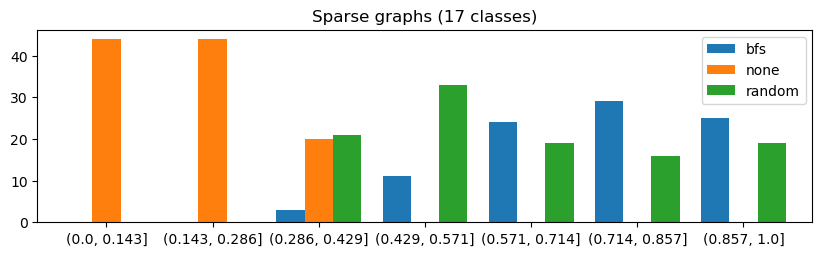

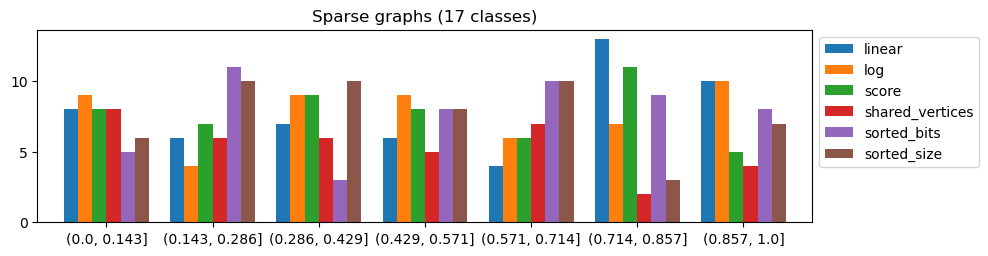

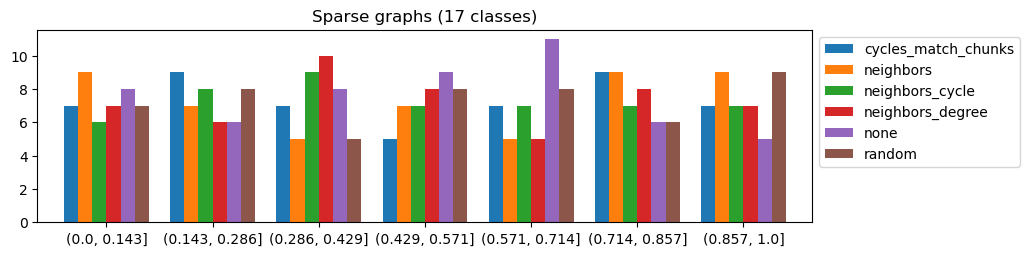

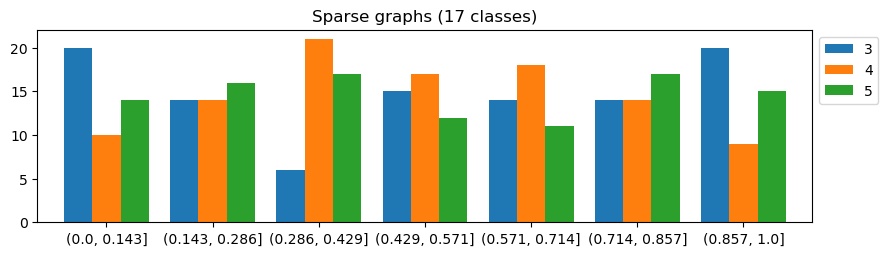

In [40]:
input = """

test_SparseAll[17-20-none-subgraphs-score-cycles_match_chunks-3-smart]                  6,427.7348 (41.01)     6,427.7348 (41.01)     6,427.7348 (41.01)    0.0000 (1.0)       6,427.7348 (41.01)    0.0000 (1.0)           0;0  0.1556 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_size-none-3-smart]                           6,431.5441 (41.04)     6,431.5441 (41.04)     6,431.5441 (41.04)    0.0000 (1.0)       6,431.5441 (41.04)    0.0000 (1.0)           0;0  0.1555 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-linear-random-4-smart]                              6,437.1571 (41.07)     6,437.1571 (41.07)     6,437.1571 (41.07)    0.0000 (1.0)       6,437.1571 (41.07)    0.0000 (1.0)           0;0  0.1553 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-log-random-4-smart]                                 6,451.8062 (41.17)     6,451.8062 (41.17)     6,451.8062 (41.17)    0.0000 (1.0)       6,451.8062 (41.17)    0.0000 (1.0)           0;0  0.1550 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-score-neighbors-5-smart]                            6,454.9138 (41.19)     6,454.9138 (41.19)     6,454.9138 (41.19)    0.0000 (1.0)       6,454.9138 (41.19)    0.0000 (1.0)           0;0  0.1549 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-log-neighbors_cycle-4-smart]                        6,462.2275 (41.23)     6,462.2275 (41.23)     6,462.2275 (41.23)    0.0000 (1.0)       6,462.2275 (41.23)    0.0000 (1.0)           0;0  0.1547 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-shared_vertices-cycles_match_chunks-3-smart]        6,469.9572 (41.28)     6,469.9572 (41.28)     6,469.9572 (41.28)    0.0000 (1.0)       6,469.9572 (41.28)    0.0000 (1.0)           0;0  0.1546 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_size-cycles_match_chunks-3-smart]            6,473.0429 (41.30)     6,473.0429 (41.30)     6,473.0429 (41.30)    0.0000 (1.0)       6,473.0429 (41.30)    0.0000 (1.0)           0;0  0.1545 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_bits-neighbors-5-smart]                      6,485.9573 (41.38)     6,485.9573 (41.38)     6,485.9573 (41.38)    0.0000 (1.0)       6,485.9573 (41.38)    0.0000 (1.0)           0;0  0.1542 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-score-neighbors_degree-3-smart]                     6,494.5699 (41.44)     6,494.5699 (41.44)     6,494.5699 (41.44)    0.0000 (1.0)       6,494.5699 (41.44)    0.0000 (1.0)           0;0  0.1540 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_bits-neighbors_cycle-3-smart]                6,499.6101 (41.47)     6,499.6101 (41.47)     6,499.6101 (41.47)    0.0000 (1.0)       6,499.6101 (41.47)    0.0000 (1.0)           0;0  0.1539 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-shared_vertices-none-5-smart]                       6,504.8294 (41.50)     6,504.8294 (41.50)     6,504.8294 (41.50)    0.0000 (1.0)       6,504.8294 (41.50)    0.0000 (1.0)           0;0  0.1537 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-score-neighbors_cycle-5-smart]                      6,527.8566 (41.65)     6,527.8566 (41.65)     6,527.8566 (41.65)    0.0000 (1.0)       6,527.8566 (41.65)    0.0000 (1.0)           0;0  0.1532 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-shared_vertices-neighbors_cycle-3-smart]            6,542.2635 (41.74)     6,542.2635 (41.74)     6,542.2635 (41.74)    0.0000 (1.0)       6,542.2635 (41.74)    0.0000 (1.0)           0;0  0.1529 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-log-cycles_match_chunks-5-smart]                    6,548.9001 (41.79)     6,548.9001 (41.79)     6,548.9001 (41.79)    0.0000 (1.0)       6,548.9001 (41.79)    0.0000 (1.0)           0;0  0.1527 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_bits-none-4-smart]                           6,550.6899 (41.80)     6,550.6899 (41.80)     6,550.6899 (41.80)    0.0000 (1.0)       6,550.6899 (41.80)    0.0000 (1.0)           0;0  0.1527 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_bits-neighbors_degree-3-smart]               6,557.0411 (41.84)     6,557.0411 (41.84)     6,557.0411 (41.84)    0.0000 (1.0)       6,557.0411 (41.84)    0.0000 (1.0)           0;0  0.1525 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-shared_vertices-neighbors_degree-5-smart]           6,572.3740 (41.94)     6,572.3740 (41.94)     6,572.3740 (41.94)    0.0000 (1.0)       6,572.3740 (41.94)    0.0000 (1.0)           0;0  0.1522 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-shared_vertices-neighbors-4-smart]                  6,584.5972 (42.01)     6,584.5972 (42.01)     6,584.5972 (42.01)    0.0000 (1.0)       6,584.5972 (42.01)    0.0000 (1.0)           0;0  0.1519 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-linear-random-3-smart]                              6,589.8976 (42.05)     6,589.8976 (42.05)     6,589.8976 (42.05)    0.0000 (1.0)       6,589.8976 (42.05)    0.0000 (1.0)           0;0  0.1517 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-linear-none-3-smart]                                6,592.0078 (42.06)     6,592.0078 (42.06)     6,592.0078 (42.06)    0.0000 (1.0)       6,592.0078 (42.06)    0.0000 (1.0)           0;0  0.1517 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-log-cycles_match_chunks-3-smart]                    6,594.8935 (42.08)     6,594.8935 (42.08)     6,594.8935 (42.08)    0.0000 (1.0)       6,594.8935 (42.08)    0.0000 (1.0)           0;0  0.1516 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_bits-random-4-smart]                         6,595.5294 (42.08)     6,595.5294 (42.08)     6,595.5294 (42.08)    0.0000 (1.0)       6,595.5294 (42.08)    0.0000 (1.0)           0;0  0.1516 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_size-neighbors-3-smart]                      6,600.8927 (42.12)     6,600.8927 (42.12)     6,600.8927 (42.12)    0.0000 (1.0)       6,600.8927 (42.12)    0.0000 (1.0)           0;0  0.1515 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-log-random-3-smart]                                 6,601.4972 (42.12)     6,601.4972 (42.12)     6,601.4972 (42.12)    0.0000 (1.0)       6,601.4972 (42.12)    0.0000 (1.0)           0;0  0.1515 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-linear-cycles_match_chunks-5-smart]                 6,609.0266 (42.17)     6,609.0266 (42.17)     6,609.0266 (42.17)    0.0000 (1.0)       6,609.0266 (42.17)    0.0000 (1.0)           0;0  0.1513 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_size-neighbors_degree-4-smart]               6,609.7857 (42.17)     6,609.7857 (42.17)     6,609.7857 (42.17)    0.0000 (1.0)       6,609.7857 (42.17)    0.0000 (1.0)           0;0  0.1513 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_size-neighbors-5-smart]                      6,617.9853 (42.23)     6,617.9853 (42.23)     6,617.9853 (42.23)    0.0000 (1.0)       6,617.9853 (42.23)    0.0000 (1.0)           0;0  0.1511 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-linear-neighbors-5-smart]                           6,618.1131 (42.23)     6,618.1131 (42.23)     6,618.1131 (42.23)    0.0000 (1.0)       6,618.1131 (42.23)    0.0000 (1.0)           0;0  0.1511 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-shared_vertices-none-3-smart]                       6,621.2762 (42.25)     6,621.2762 (42.25)     6,621.2762 (42.25)    0.0000 (1.0)       6,621.2762 (42.25)    0.0000 (1.0)           0;0  0.1510 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_size-random-5-smart]                         6,624.1980 (42.27)     6,624.1980 (42.27)     6,624.1980 (42.27)    0.0000 (1.0)       6,624.1980 (42.27)    0.0000 (1.0)           0;0  0.1510 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-log-neighbors_degree-4-smart]                       6,627.3478 (42.29)     6,627.3478 (42.29)     6,627.3478 (42.29)    0.0000 (1.0)       6,627.3478 (42.29)    0.0000 (1.0)           0;0  0.1509 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-log-none-3-smart]                                   6,628.6626 (42.29)     6,628.6626 (42.29)     6,628.6626 (42.29)    0.0000 (1.0)       6,628.6626 (42.29)    0.0000 (1.0)           0;0  0.1509 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-log-neighbors-5-smart]                              6,632.5402 (42.32)     6,632.5402 (42.32)     6,632.5402 (42.32)    0.0000 (1.0)       6,632.5402 (42.32)    0.0000 (1.0)           0;0  0.1508 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-linear-none-5-smart]                                6,632.9078 (42.32)     6,632.9078 (42.32)     6,632.9078 (42.32)    0.0000 (1.0)       6,632.9078 (42.32)    0.0000 (1.0)           0;0  0.1508 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-score-neighbors_cycle-4-smart]                      6,634.7354 (42.33)     6,634.7354 (42.33)     6,634.7354 (42.33)    0.0000 (1.0)       6,634.7354 (42.33)    0.0000 (1.0)           0;0  0.1507 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-score-none-3-smart]                                 6,636.8037 (42.35)     6,636.8037 (42.35)     6,636.8037 (42.35)    0.0000 (1.0)       6,636.8037 (42.35)    0.0000 (1.0)           0;0  0.1507 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-linear-cycles_match_chunks-3-smart]                 6,637.1332 (42.35)     6,637.1332 (42.35)     6,637.1332 (42.35)    0.0000 (1.0)       6,637.1332 (42.35)    0.0000 (1.0)           0;0  0.1507 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-shared_vertices-neighbors_degree-3-smart]           6,639.4174 (42.36)     6,639.4174 (42.36)     6,639.4174 (42.36)    0.0000 (1.0)       6,639.4174 (42.36)    0.0000 (1.0)           0;0  0.1506 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-linear-neighbors_cycle-3-smart]                     6,647.5349 (42.41)     6,647.5349 (42.41)     6,647.5349 (42.41)    0.0000 (1.0)       6,647.5349 (42.41)    0.0000 (1.0)           0;0  0.1504 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-score-neighbors-4-smart]                            6,648.8570 (42.42)     6,648.8570 (42.42)     6,648.8570 (42.42)    0.0000 (1.0)       6,648.8570 (42.42)    0.0000 (1.0)           0;0  0.1504 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-shared_vertices-random-5-smart]                     6,651.4792 (42.44)     6,651.4792 (42.44)     6,651.4792 (42.44)    0.0000 (1.0)       6,651.4792 (42.44)    0.0000 (1.0)           0;0  0.1503 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-score-neighbors_degree-5-smart]                     6,655.8255 (42.47)     6,655.8255 (42.47)     6,655.8255 (42.47)    0.0000 (1.0)       6,655.8255 (42.47)    0.0000 (1.0)           0;0  0.1502 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-log-neighbors-3-smart]                              6,658.3159 (42.48)     6,658.3159 (42.48)     6,658.3159 (42.48)    0.0000 (1.0)       6,658.3159 (42.48)    0.0000 (1.0)           0;0  0.1502 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_bits-neighbors-4-smart]                      6,662.8424 (42.51)     6,662.8424 (42.51)     6,662.8424 (42.51)    0.0000 (1.0)       6,662.8424 (42.51)    0.0000 (1.0)           0;0  0.1501 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_size-cycles_match_chunks-5-smart]            6,663.4829 (42.52)     6,663.4829 (42.52)     6,663.4829 (42.52)    0.0000 (1.0)       6,663.4829 (42.52)    0.0000 (1.0)           0;0  0.1501 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-linear-neighbors-3-smart]                           6,666.7188 (42.54)     6,666.7188 (42.54)     6,666.7188 (42.54)    0.0000 (1.0)       6,666.7188 (42.54)    0.0000 (1.0)           0;0  0.1500 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_bits-none-3-smart]                           6,668.6168 (42.55)     6,668.6168 (42.55)     6,668.6168 (42.55)    0.0000 (1.0)       6,668.6168 (42.55)    0.0000 (1.0)           0;0  0.1500 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_size-neighbors_degree-3-smart]               6,670.9214 (42.56)     6,670.9214 (42.56)     6,670.9214 (42.56)    0.0000 (1.0)       6,670.9214 (42.56)    0.0000 (1.0)           0;0  0.1499 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-linear-neighbors_cycle-5-smart]                     6,673.4908 (42.58)     6,673.4908 (42.58)     6,673.4908 (42.58)    0.0000 (1.0)       6,673.4908 (42.58)    0.0000 (1.0)           0;0  0.1498 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-shared_vertices-cycles_match_chunks-5-smart]        6,675.8260 (42.60)     6,675.8260 (42.60)     6,675.8260 (42.60)    0.0000 (1.0)       6,675.8260 (42.60)    0.0000 (1.0)           0;0  0.1498 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_size-random-4-smart]                         6,679.0649 (42.62)     6,679.0649 (42.62)     6,679.0649 (42.62)    0.0000 (1.0)       6,679.0649 (42.62)    0.0000 (1.0)           0;0  0.1497 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-log-neighbors_cycle-3-smart]                        6,681.1692 (42.63)     6,681.1692 (42.63)     6,681.1692 (42.63)    0.0000 (1.0)       6,681.1692 (42.63)    0.0000 (1.0)           0;0  0.1497 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_bits-cycles_match_chunks-3-smart]            6,683.4398 (42.64)     6,683.4398 (42.64)     6,683.4398 (42.64)    0.0000 (1.0)       6,683.4398 (42.64)    0.0000 (1.0)           0;0  0.1496 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_bits-neighbors_degree-5-smart]               6,687.0070 (42.67)     6,687.0070 (42.67)     6,687.0070 (42.67)    0.0000 (1.0)       6,687.0070 (42.67)    0.0000 (1.0)           0;0  0.1495 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_bits-cycles_match_chunks-4-smart]            6,690.4742 (42.69)     6,690.4742 (42.69)     6,690.4742 (42.69)    0.0000 (1.0)       6,690.4742 (42.69)    0.0000 (1.0)           0;0  0.1495 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-log-none-5-smart]                                   6,694.6911 (42.72)     6,694.6911 (42.72)     6,694.6911 (42.72)    0.0000 (1.0)       6,694.6911 (42.72)    0.0000 (1.0)           0;0  0.1494 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-score-none-4-smart]                                 6,698.8348 (42.74)     6,698.8348 (42.74)     6,698.8348 (42.74)    0.0000 (1.0)       6,698.8348 (42.74)    0.0000 (1.0)           0;0  0.1493 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_size-none-5-smart]                           6,699.8672 (42.75)     6,699.8672 (42.75)     6,699.8672 (42.75)    0.0000 (1.0)       6,699.8672 (42.75)    0.0000 (1.0)           0;0  0.1493 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-shared_vertices-neighbors_cycle-5-smart]            6,711.5419 (42.82)     6,711.5419 (42.82)     6,711.5419 (42.82)    0.0000 (1.0)       6,711.5419 (42.82)    0.0000 (1.0)           0;0  0.1490 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-shared_vertices-neighbors-5-smart]                  6,723.9987 (42.90)     6,723.9987 (42.90)     6,723.9987 (42.90)    0.0000 (1.0)       6,723.9987 (42.90)    0.0000 (1.0)           0;0  0.1487 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_size-random-3-smart]                         6,724.4671 (42.91)     6,724.4671 (42.91)     6,724.4671 (42.91)    0.0000 (1.0)       6,724.4671 (42.91)    0.0000 (1.0)           0;0  0.1487 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_bits-random-3-smart]                         6,736.3945 (42.98)     6,736.3945 (42.98)     6,736.3945 (42.98)    0.0000 (1.0)       6,736.3945 (42.98)    0.0000 (1.0)           0;0  0.1484 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-linear-neighbors_degree-3-smart]                    6,736.4861 (42.98)     6,736.4861 (42.98)     6,736.4861 (42.98)    0.0000 (1.0)       6,736.4861 (42.98)    0.0000 (1.0)           0;0  0.1484 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_bits-neighbors-3-smart]                      6,744.6602 (43.03)     6,744.6602 (43.03)     6,744.6602 (43.03)    0.0000 (1.0)       6,744.6602 (43.03)    0.0000 (1.0)           0;0  0.1483 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-linear-neighbors_degree-4-smart]                    6,744.8073 (43.04)     6,744.8073 (43.04)     6,744.8073 (43.04)    0.0000 (1.0)       6,744.8073 (43.04)    0.0000 (1.0)           0;0  0.1483 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-shared_vertices-none-4-smart]                       6,748.5323 (43.06)     6,748.5323 (43.06)     6,748.5323 (43.06)    0.0000 (1.0)       6,748.5323 (43.06)    0.0000 (1.0)           0;0  0.1482 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-score-random-3-smart]                               6,750.9388 (43.07)     6,750.9388 (43.07)     6,750.9388 (43.07)    0.0000 (1.0)       6,750.9388 (43.07)    0.0000 (1.0)           0;0  0.1481 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-score-random-5-smart]                               6,759.7213 (43.13)     6,759.7213 (43.13)     6,759.7213 (43.13)    0.0000 (1.0)       6,759.7213 (43.13)    0.0000 (1.0)           0;0  0.1479 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-linear-neighbors_degree-5-smart]                    6,762.4075 (43.15)     6,762.4075 (43.15)     6,762.4075 (43.15)    0.0000 (1.0)       6,762.4075 (43.15)    0.0000 (1.0)           0;0  0.1479 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-score-cycles_match_chunks-5-smart]                  6,762.5424 (43.15)     6,762.5424 (43.15)     6,762.5424 (43.15)    0.0000 (1.0)       6,762.5424 (43.15)    0.0000 (1.0)           0;0  0.1479 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-score-none-5-smart]                                 6,762.5867 (43.15)     6,762.5867 (43.15)     6,762.5867 (43.15)    0.0000 (1.0)       6,762.5867 (43.15)    0.0000 (1.0)           0;0  0.1479 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_size-neighbors_cycle-3-smart]                6,762.8788 (43.15)     6,762.8788 (43.15)     6,762.8788 (43.15)    0.0000 (1.0)       6,762.8788 (43.15)    0.0000 (1.0)           0;0  0.1479 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_size-neighbors_cycle-5-smart]                6,770.1597 (43.20)     6,770.1597 (43.20)     6,770.1597 (43.20)    0.0000 (1.0)       6,770.1597 (43.20)    0.0000 (1.0)           0;0  0.1477 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-score-random-4-smart]                               6,775.5217 (43.23)     6,775.5217 (43.23)     6,775.5217 (43.23)    0.0000 (1.0)       6,775.5217 (43.23)    0.0000 (1.0)           0;0  0.1476 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-log-neighbors_degree-3-smart]                       6,777.1970 (43.24)     6,777.1970 (43.24)     6,777.1970 (43.24)    0.0000 (1.0)       6,777.1970 (43.24)    0.0000 (1.0)           0;0  0.1476 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_size-neighbors_cycle-4-smart]                6,787.6253 (43.31)     6,787.6253 (43.31)     6,787.6253 (43.31)    0.0000 (1.0)       6,787.6253 (43.31)    0.0000 (1.0)           0;0  0.1473 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_bits-neighbors_cycle-5-smart]                6,794.4627 (43.35)     6,794.4627 (43.35)     6,794.4627 (43.35)    0.0000 (1.0)       6,794.4627 (43.35)    0.0000 (1.0)           0;0  0.1472 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-shared_vertices-random-4-smart]                     6,828.2624 (43.57)     6,828.2624 (43.57)     6,828.2624 (43.57)    0.0000 (1.0)       6,828.2624 (43.57)    0.0000 (1.0)           0;0  0.1465 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-score-neighbors-3-smart]                            6,836.8174 (43.62)     6,836.8174 (43.62)     6,836.8174 (43.62)    0.0000 (1.0)       6,836.8174 (43.62)    0.0000 (1.0)           0;0  0.1463 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_bits-neighbors_cycle-4-smart]                6,857.8444 (43.76)     6,857.8444 (43.76)     6,857.8444 (43.76)    0.0000 (1.0)       6,857.8444 (43.76)    0.0000 (1.0)           0;0  0.1458 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_bits-cycles_match_chunks-5-smart]            6,894.4522 (43.99)     6,894.4522 (43.99)     6,894.4522 (43.99)    0.0000 (1.0)       6,894.4522 (43.99)    0.0000 (1.0)           0;0  0.1450 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_bits-random-5-smart]                         6,909.4585 (44.09)     6,909.4585 (44.09)     6,909.4585 (44.09)    0.0000 (1.0)       6,909.4585 (44.09)    0.0000 (1.0)           0;0  0.1447 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-linear-cycles_match_chunks-4-smart]                 6,918.0539 (44.14)     6,918.0539 (44.14)     6,918.0539 (44.14)    0.0000 (1.0)       6,918.0539 (44.14)    0.0000 (1.0)           0;0  0.1445 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_size-neighbors-4-smart]                      6,930.3251 (44.22)     6,930.3251 (44.22)     6,930.3251 (44.22)    0.0000 (1.0)       6,930.3251 (44.22)    0.0000 (1.0)           0;0  0.1443 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-log-cycles_match_chunks-4-smart]                    6,941.0374 (44.29)     6,941.0374 (44.29)     6,941.0374 (44.29)    0.0000 (1.0)       6,941.0374 (44.29)    0.0000 (1.0)           0;0  0.1441 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_size-cycles_match_chunks-4-smart]            6,952.7035 (44.36)     6,952.7035 (44.36)     6,952.7035 (44.36)    0.0000 (1.0)       6,952.7035 (44.36)    0.0000 (1.0)           0;0  0.1438 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-shared_vertices-neighbors-3-smart]                  6,955.0003 (44.38)     6,955.0003 (44.38)     6,955.0003 (44.38)    0.0000 (1.0)       6,955.0003 (44.38)    0.0000 (1.0)           0;0  0.1438 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-linear-none-4-smart]                                6,962.8484 (44.43)     6,962.8484 (44.43)     6,962.8484 (44.43)    0.0000 (1.0)       6,962.8484 (44.43)    0.0000 (1.0)           0;0  0.1436 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_size-neighbors_degree-5-smart]               6,962.9233 (44.43)     6,962.9233 (44.43)     6,962.9233 (44.43)    0.0000 (1.0)       6,962.9233 (44.43)    0.0000 (1.0)           0;0  0.1436 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-log-neighbors-4-smart]                              6,972.6537 (44.49)     6,972.6537 (44.49)     6,972.6537 (44.49)    0.0000 (1.0)       6,972.6537 (44.49)    0.0000 (1.0)           0;0  0.1434 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-linear-neighbors_cycle-4-smart]                     6,975.3780 (44.51)     6,975.3780 (44.51)     6,975.3780 (44.51)    0.0000 (1.0)       6,975.3780 (44.51)    0.0000 (1.0)           0;0  0.1434 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_bits-none-5-smart]                           6,983.3396 (44.56)     6,983.3396 (44.56)     6,983.3396 (44.56)    0.0000 (1.0)       6,983.3396 (44.56)    0.0000 (1.0)           0;0  0.1432 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-linear-neighbors-4-smart]                           6,991.7945 (44.61)     6,991.7945 (44.61)     6,991.7945 (44.61)    0.0000 (1.0)       6,991.7945 (44.61)    0.0000 (1.0)           0;0  0.1430 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-log-neighbors_degree-5-smart]                       7,007.1151 (44.71)     7,007.1151 (44.71)     7,007.1151 (44.71)    0.0000 (1.0)       7,007.1151 (44.71)    0.0000 (1.0)           0;0  0.1427 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_size-none-4-smart]                           7,016.8375 (44.77)     7,016.8375 (44.77)     7,016.8375 (44.77)    0.0000 (1.0)       7,016.8375 (44.77)    0.0000 (1.0)           0;0  0.1425 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-linear-random-5-smart]                              7,019.2443 (44.79)     7,019.2443 (44.79)     7,019.2443 (44.79)    0.0000 (1.0)       7,019.2443 (44.79)    0.0000 (1.0)           0;0  0.1425 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-log-none-4-smart]                                   7,024.2973 (44.82)     7,024.2973 (44.82)     7,024.2973 (44.82)    0.0000 (1.0)       7,024.2973 (44.82)    0.0000 (1.0)           0;0  0.1424 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-shared_vertices-random-3-smart]                     7,024.3565 (44.82)     7,024.3565 (44.82)     7,024.3565 (44.82)    0.0000 (1.0)       7,024.3565 (44.82)    0.0000 (1.0)           0;0  0.1424 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-log-random-5-smart]                                 7,028.1860 (44.84)     7,028.1860 (44.84)     7,028.1860 (44.84)    0.0000 (1.0)       7,028.1860 (44.84)    0.0000 (1.0)           0;0  0.1423 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-sorted_bits-neighbors_degree-4-smart]               7,035.7520 (44.89)     7,035.7520 (44.89)     7,035.7520 (44.89)    0.0000 (1.0)       7,035.7520 (44.89)    0.0000 (1.0)           0;0  0.1421 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-shared_vertices-neighbors_degree-4-smart]           7,043.4698 (44.94)     7,043.4698 (44.94)     7,043.4698 (44.94)    0.0000 (1.0)       7,043.4698 (44.94)    0.0000 (1.0)           0;0  0.1420 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-score-cycles_match_chunks-4-smart]                  7,047.7189 (44.97)     7,047.7189 (44.97)     7,047.7189 (44.97)    0.0000 (1.0)       7,047.7189 (44.97)    0.0000 (1.0)           0;0  0.1419 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-shared_vertices-neighbors_cycle-4-smart]            7,051.7847 (44.99)     7,051.7847 (44.99)     7,051.7847 (44.99)    0.0000 (1.0)       7,051.7847 (44.99)    0.0000 (1.0)           0;0  0.1418 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-shared_vertices-cycles_match_chunks-4-smart]        7,052.8477 (45.00)     7,052.8477 (45.00)     7,052.8477 (45.00)    0.0000 (1.0)       7,052.8477 (45.00)    0.0000 (1.0)           0;0  0.1418 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-score-neighbors_cycle-3-smart]                      7,096.9687 (45.28)     7,096.9687 (45.28)     7,096.9687 (45.28)    0.0000 (1.0)       7,096.9687 (45.28)    0.0000 (1.0)           0;0  0.1409 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-log-neighbors_cycle-5-smart]                        7,126.8535 (45.47)     7,126.8535 (45.47)     7,126.8535 (45.47)    0.0000 (1.0)       7,126.8535 (45.47)    0.0000 (1.0)           0;0  0.1403 (0.02)          1           1
test_SparseAll[17-20-none-subgraphs-score-neighbors_degree-4-smart]                     7,151.1428 (45.63)     7,151.1428 (45.63)     7,151.1428 (45.63)    0.0000 (1.0)       7,151.1428 (45.63)    0.0000 (1.0)           0;0  0.1398 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-log-cycles_match_chunks-3-smart]                  9,723.1752 (62.04)     9,723.1752 (62.04)     9,723.1752 (62.04)    0.0000 (1.0)       9,723.1752 (62.04)    0.0000 (1.0)           0;0  0.1028 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_size-neighbors_cycle-3-smart]                 9,749.3583 (62.21)     9,749.3583 (62.21)     9,749.3583 (62.21)    0.0000 (1.0)       9,749.3583 (62.21)    0.0000 (1.0)           0;0  0.1026 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_size-none-5-smart]                         9,753.6663 (62.23)     9,753.6663 (62.23)     9,753.6663 (62.23)    0.0000 (1.0)       9,753.6663 (62.23)    0.0000 (1.0)           0;0  0.1025 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-score-neighbors_cycle-4-smart]                    9,758.9497 (62.27)     9,758.9497 (62.27)     9,758.9497 (62.27)    0.0000 (1.0)       9,758.9497 (62.27)    0.0000 (1.0)           0;0  0.1025 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_size-neighbors-3-smart]                    9,767.4462 (62.32)     9,767.4462 (62.32)     9,767.4462 (62.32)    0.0000 (1.0)       9,767.4462 (62.32)    0.0000 (1.0)           0;0  0.1024 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-shared_vertices-neighbors_degree-5-smart]         9,768.3362 (62.33)     9,768.3362 (62.33)     9,768.3362 (62.33)    0.0000 (1.0)       9,768.3362 (62.33)    0.0000 (1.0)           0;0  0.1024 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-score-random-5-smart]                             9,797.1329 (62.51)     9,797.1329 (62.51)     9,797.1329 (62.51)    0.0000 (1.0)       9,797.1329 (62.51)    0.0000 (1.0)           0;0  0.1021 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-linear-neighbors-5-smart]                         9,806.1097 (62.57)     9,806.1097 (62.57)     9,806.1097 (62.57)    0.0000 (1.0)       9,806.1097 (62.57)    0.0000 (1.0)           0;0  0.1020 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_size-cycles_match_chunks-4-smart]             9,806.4900 (62.57)     9,806.4900 (62.57)     9,806.4900 (62.57)    0.0000 (1.0)       9,806.4900 (62.57)    0.0000 (1.0)           0;0  0.1020 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-log-neighbors_degree-5-smart]                     9,807.4854 (62.58)     9,807.4854 (62.58)     9,807.4854 (62.58)    0.0000 (1.0)       9,807.4854 (62.58)    0.0000 (1.0)           0;0  0.1020 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-linear-none-4-smart]                              9,815.8290 (62.63)     9,815.8290 (62.63)     9,815.8290 (62.63)    0.0000 (1.0)       9,815.8290 (62.63)    0.0000 (1.0)           0;0  0.1019 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_size-neighbors_degree-5-smart]             9,822.3895 (62.67)     9,822.3895 (62.67)     9,822.3895 (62.67)    0.0000 (1.0)       9,822.3895 (62.67)    0.0000 (1.0)           0;0  0.1018 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-score-cycles_match_chunks-4-smart]                   9,827.4551 (62.70)     9,827.4551 (62.70)     9,827.4551 (62.70)    0.0000 (1.0)       9,827.4551 (62.70)    0.0000 (1.0)           0;0  0.1018 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-linear-none-3-smart]                              9,828.8113 (62.71)     9,828.8113 (62.71)     9,828.8113 (62.71)    0.0000 (1.0)       9,828.8113 (62.71)    0.0000 (1.0)           0;0  0.1017 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-log-neighbors_cycle-4-smart]                      9,829.2662 (62.72)     9,829.2662 (62.72)     9,829.2662 (62.72)    0.0000 (1.0)       9,829.2662 (62.72)    0.0000 (1.0)           0;0  0.1017 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_size-neighbors_cycle-5-smart]              9,833.6655 (62.74)     9,833.6655 (62.74)     9,833.6655 (62.74)    0.0000 (1.0)       9,833.6655 (62.74)    0.0000 (1.0)           0;0  0.1017 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_size-random-4-smart]                       9,839.9663 (62.78)     9,839.9663 (62.78)     9,839.9663 (62.78)    0.0000 (1.0)       9,839.9663 (62.78)    0.0000 (1.0)           0;0  0.1016 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-log-cycles_match_chunks-5-smart]                  9,840.7724 (62.79)     9,840.7724 (62.79)     9,840.7724 (62.79)    0.0000 (1.0)       9,840.7724 (62.79)    0.0000 (1.0)           0;0  0.1016 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_bits-neighbors_cycle-5-smart]              9,843.8721 (62.81)     9,843.8721 (62.81)     9,843.8721 (62.81)    0.0000 (1.0)       9,843.8721 (62.81)    0.0000 (1.0)           0;0  0.1016 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_size-neighbors_degree-4-smart]             9,846.4335 (62.83)     9,846.4335 (62.83)     9,846.4335 (62.83)    0.0000 (1.0)       9,846.4335 (62.83)    0.0000 (1.0)           0;0  0.1016 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-shared_vertices-neighbors-4-smart]                9,847.1862 (62.83)     9,847.1862 (62.83)     9,847.1862 (62.83)    0.0000 (1.0)       9,847.1862 (62.83)    0.0000 (1.0)           0;0  0.1016 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-score-neighbors_degree-4-smart]                   9,848.4782 (62.84)     9,848.4782 (62.84)     9,848.4782 (62.84)    0.0000 (1.0)       9,848.4782 (62.84)    0.0000 (1.0)           0;0  0.1015 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-score-cycles_match_chunks-5-smart]                9,855.9624 (62.89)     9,855.9624 (62.89)     9,855.9624 (62.89)    0.0000 (1.0)       9,855.9624 (62.89)    0.0000 (1.0)           0;0  0.1015 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-score-none-5-smart]                               9,858.0721 (62.90)     9,858.0721 (62.90)     9,858.0721 (62.90)    0.0000 (1.0)       9,858.0721 (62.90)    0.0000 (1.0)           0;0  0.1014 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-log-neighbors-3-smart]                            9,858.7706 (62.90)     9,858.7706 (62.90)     9,858.7706 (62.90)    0.0000 (1.0)       9,858.7706 (62.90)    0.0000 (1.0)           0;0  0.1014 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-log-random-5-smart]                               9,859.5114 (62.91)     9,859.5114 (62.91)     9,859.5114 (62.91)    0.0000 (1.0)       9,859.5114 (62.91)    0.0000 (1.0)           0;0  0.1014 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_bits-cycles_match_chunks-3-smart]          9,860.1383 (62.91)     9,860.1383 (62.91)     9,860.1383 (62.91)    0.0000 (1.0)       9,860.1383 (62.91)    0.0000 (1.0)           0;0  0.1014 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-linear-neighbors_cycle-4-smart]                   9,860.6596 (62.92)     9,860.6596 (62.92)     9,860.6596 (62.92)    0.0000 (1.0)       9,860.6596 (62.92)    0.0000 (1.0)           0;0  0.1014 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-linear-none-5-smart]                                 9,862.2668 (62.93)     9,862.2668 (62.93)     9,862.2668 (62.93)    0.0000 (1.0)       9,862.2668 (62.93)    0.0000 (1.0)           0;0  0.1014 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-log-neighbors_cycle-5-smart]                         9,863.3851 (62.93)     9,863.3851 (62.93)     9,863.3851 (62.93)    0.0000 (1.0)       9,863.3851 (62.93)    0.0000 (1.0)           0;0  0.1014 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-linear-neighbors_degree-3-smart]                  9,865.3698 (62.95)     9,865.3698 (62.95)     9,865.3698 (62.95)    0.0000 (1.0)       9,865.3698 (62.95)    0.0000 (1.0)           0;0  0.1014 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_size-cycles_match_chunks-3-smart]          9,867.7421 (62.96)     9,867.7421 (62.96)     9,867.7421 (62.96)    0.0000 (1.0)       9,867.7421 (62.96)    0.0000 (1.0)           0;0  0.1013 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-linear-cycles_match_chunks-4-smart]               9,868.1739 (62.96)     9,868.1739 (62.96)     9,868.1739 (62.96)    0.0000 (1.0)       9,868.1739 (62.96)    0.0000 (1.0)           0;0  0.1013 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_bits-neighbors-3-smart]                       9,871.3643 (62.98)     9,871.3643 (62.98)     9,871.3643 (62.98)    0.0000 (1.0)       9,871.3643 (62.98)    0.0000 (1.0)           0;0  0.1013 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_bits-none-4-smart]                         9,873.4960 (63.00)     9,873.4960 (63.00)     9,873.4960 (63.00)    0.0000 (1.0)       9,873.4960 (63.00)    0.0000 (1.0)           0;0  0.1013 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_size-none-3-smart]                         9,873.5804 (63.00)     9,873.5804 (63.00)     9,873.5804 (63.00)    0.0000 (1.0)       9,873.5804 (63.00)    0.0000 (1.0)           0;0  0.1013 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-score-neighbors_degree-5-smart]                   9,874.4792 (63.00)     9,874.4792 (63.00)     9,874.4792 (63.00)    0.0000 (1.0)       9,874.4792 (63.00)    0.0000 (1.0)           0;0  0.1013 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-log-neighbors-5-smart]                            9,874.5194 (63.00)     9,874.5194 (63.00)     9,874.5194 (63.00)    0.0000 (1.0)       9,874.5194 (63.00)    0.0000 (1.0)           0;0  0.1013 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-score-random-3-smart]                             9,875.1300 (63.01)     9,875.1300 (63.01)     9,875.1300 (63.01)    0.0000 (1.0)       9,875.1300 (63.01)    0.0000 (1.0)           0;0  0.1013 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-log-random-4-smart]                               9,876.7706 (63.02)     9,876.7706 (63.02)     9,876.7706 (63.02)    0.0000 (1.0)       9,876.7706 (63.02)    0.0000 (1.0)           0;0  0.1012 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-score-neighbors_cycle-3-smart]                    9,877.1411 (63.02)     9,877.1411 (63.02)     9,877.1411 (63.02)    0.0000 (1.0)       9,877.1411 (63.02)    0.0000 (1.0)           0;0  0.1012 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_bits-neighbors_cycle-4-smart]              9,877.5583 (63.02)     9,877.5583 (63.02)     9,877.5583 (63.02)    0.0000 (1.0)       9,877.5583 (63.02)    0.0000 (1.0)           0;0  0.1012 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-linear-random-4-smart]                            9,878.6499 (63.03)     9,878.6499 (63.03)     9,878.6499 (63.03)    0.0000 (1.0)       9,878.6499 (63.03)    0.0000 (1.0)           0;0  0.1012 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_bits-none-3-smart]                            9,879.8295 (63.04)     9,879.8295 (63.04)     9,879.8295 (63.04)    0.0000 (1.0)       9,879.8295 (63.04)    0.0000 (1.0)           0;0  0.1012 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-shared_vertices-neighbors_cycle-5-smart]          9,880.7195 (63.04)     9,880.7195 (63.04)     9,880.7195 (63.04)    0.0000 (1.0)       9,880.7195 (63.04)    0.0000 (1.0)           0;0  0.1012 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-log-neighbors_degree-4-smart]                     9,884.0921 (63.07)     9,884.0921 (63.07)     9,884.0921 (63.07)    0.0000 (1.0)       9,884.0921 (63.07)    0.0000 (1.0)           0;0  0.1012 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-score-none-4-smart]                               9,885.1639 (63.07)     9,885.1639 (63.07)     9,885.1639 (63.07)    0.0000 (1.0)       9,885.1639 (63.07)    0.0000 (1.0)           0;0  0.1012 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_size-random-4-smart]                          9,885.2026 (63.07)     9,885.2026 (63.07)     9,885.2026 (63.07)    0.0000 (1.0)       9,885.2026 (63.07)    0.0000 (1.0)           0;0  0.1012 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_size-neighbors-5-smart]                    9,889.6820 (63.10)     9,889.6820 (63.10)     9,889.6820 (63.10)    0.0000 (1.0)       9,889.6820 (63.10)    0.0000 (1.0)           0;0  0.1011 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-score-neighbors_degree-3-smart]                   9,890.3339 (63.11)     9,890.3339 (63.11)     9,890.3339 (63.11)    0.0000 (1.0)       9,890.3339 (63.11)    0.0000 (1.0)           0;0  0.1011 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_bits-none-5-smart]                         9,890.5355 (63.11)     9,890.5355 (63.11)     9,890.5355 (63.11)    0.0000 (1.0)       9,890.5355 (63.11)    0.0000 (1.0)           0;0  0.1011 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-shared_vertices-none-4-smart]                        9,890.7271 (63.11)     9,890.7271 (63.11)     9,890.7271 (63.11)    0.0000 (1.0)       9,890.7271 (63.11)    0.0000 (1.0)           0;0  0.1011 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-linear-neighbors_degree-4-smart]                  9,891.4578 (63.11)     9,891.4578 (63.11)     9,891.4578 (63.11)    0.0000 (1.0)       9,891.4578 (63.11)    0.0000 (1.0)           0;0  0.1011 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_size-neighbors_cycle-3-smart]              9,892.2438 (63.12)     9,892.2438 (63.12)     9,892.2438 (63.12)    0.0000 (1.0)       9,892.2438 (63.12)    0.0000 (1.0)           0;0  0.1011 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_size-neighbors_degree-5-smart]                9,892.2742 (63.12)     9,892.2742 (63.12)     9,892.2742 (63.12)    0.0000 (1.0)       9,892.2742 (63.12)    0.0000 (1.0)           0;0  0.1011 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_size-neighbors_degree-3-smart]             9,894.8251 (63.13)     9,894.8251 (63.13)     9,894.8251 (63.13)    0.0000 (1.0)       9,894.8251 (63.13)    0.0000 (1.0)           0;0  0.1011 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-shared_vertices-random-5-smart]                   9,895.6778 (63.14)     9,895.6778 (63.14)     9,895.6778 (63.14)    0.0000 (1.0)       9,895.6778 (63.14)    0.0000 (1.0)           0;0  0.1011 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-log-neighbors_cycle-3-smart]                      9,897.7408 (63.15)     9,897.7408 (63.15)     9,897.7408 (63.15)    0.0000 (1.0)       9,897.7408 (63.15)    0.0000 (1.0)           0;0  0.1010 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-shared_vertices-none-4-smart]                     9,897.8953 (63.15)     9,897.8953 (63.15)     9,897.8953 (63.15)    0.0000 (1.0)       9,897.8953 (63.15)    0.0000 (1.0)           0;0  0.1010 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-score-neighbors-5-smart]                          9,898.3063 (63.16)     9,898.3063 (63.16)     9,898.3063 (63.16)    0.0000 (1.0)       9,898.3063 (63.16)    0.0000 (1.0)           0;0  0.1010 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_bits-neighbors-4-smart]                    9,899.4842 (63.16)     9,899.4842 (63.16)     9,899.4842 (63.16)    0.0000 (1.0)       9,899.4842 (63.16)    0.0000 (1.0)           0;0  0.1010 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-log-neighbors-5-smart]                               9,903.5331 (63.19)     9,903.5331 (63.19)     9,903.5331 (63.19)    0.0000 (1.0)       9,903.5331 (63.19)    0.0000 (1.0)           0;0  0.1010 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-score-cycles_match_chunks-3-smart]                9,905.4132 (63.20)     9,905.4132 (63.20)     9,905.4132 (63.20)    0.0000 (1.0)       9,905.4132 (63.20)    0.0000 (1.0)           0;0  0.1010 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_bits-neighbors_degree-4-smart]                9,906.8843 (63.21)     9,906.8843 (63.21)     9,906.8843 (63.21)    0.0000 (1.0)       9,906.8843 (63.21)    0.0000 (1.0)           0;0  0.1009 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-log-none-3-smart]                                    9,907.1168 (63.21)     9,907.1168 (63.21)     9,907.1168 (63.21)    0.0000 (1.0)       9,907.1168 (63.21)    0.0000 (1.0)           0;0  0.1009 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-score-random-4-smart]                                9,911.0199 (63.24)     9,911.0199 (63.24)     9,911.0199 (63.24)    0.0000 (1.0)       9,911.0199 (63.24)    0.0000 (1.0)           0;0  0.1009 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_size-cycles_match_chunks-4-smart]          9,911.4573 (63.24)     9,911.4573 (63.24)     9,911.4573 (63.24)    0.0000 (1.0)       9,911.4573 (63.24)    0.0000 (1.0)           0;0  0.1009 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-shared_vertices-random-4-smart]                   9,912.5597 (63.25)     9,912.5597 (63.25)     9,912.5597 (63.25)    0.0000 (1.0)       9,912.5597 (63.25)    0.0000 (1.0)           0;0  0.1009 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_bits-neighbors_cycle-3-smart]              9,914.5601 (63.26)     9,914.5601 (63.26)     9,914.5601 (63.26)    0.0000 (1.0)       9,914.5601 (63.26)    0.0000 (1.0)           0;0  0.1009 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-log-none-4-smart]                                 9,915.0431 (63.26)     9,915.0431 (63.26)     9,915.0431 (63.26)    0.0000 (1.0)       9,915.0431 (63.26)    0.0000 (1.0)           0;0  0.1009 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-linear-cycles_match_chunks-5-smart]                  9,916.5904 (63.27)     9,916.5904 (63.27)     9,916.5904 (63.27)    0.0000 (1.0)       9,916.5904 (63.27)    0.0000 (1.0)           0;0  0.1008 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_bits-neighbors_degree-4-smart]             9,918.4254 (63.28)     9,918.4254 (63.28)     9,918.4254 (63.28)    0.0000 (1.0)       9,918.4254 (63.28)    0.0000 (1.0)           0;0  0.1008 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-log-none-5-smart]                                 9,918.8077 (63.29)     9,918.8077 (63.29)     9,918.8077 (63.29)    0.0000 (1.0)       9,918.8077 (63.29)    0.0000 (1.0)           0;0  0.1008 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-linear-cycles_match_chunks-5-smart]               9,919.4300 (63.29)     9,919.4300 (63.29)     9,919.4300 (63.29)    0.0000 (1.0)       9,919.4300 (63.29)    0.0000 (1.0)           0;0  0.1008 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_size-neighbors_cycle-5-smart]                 9,921.6751 (63.31)     9,921.6751 (63.31)     9,921.6751 (63.31)    0.0000 (1.0)       9,921.6751 (63.31)    0.0000 (1.0)           0;0  0.1008 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-score-random-5-smart]                                9,921.9321 (63.31)     9,921.9321 (63.31)     9,921.9321 (63.31)    0.0000 (1.0)       9,921.9321 (63.31)    0.0000 (1.0)           0;0  0.1008 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_size-neighbors-3-smart]                       9,928.1173 (63.35)     9,928.1173 (63.35)     9,928.1173 (63.35)    0.0000 (1.0)       9,928.1173 (63.35)    0.0000 (1.0)           0;0  0.1007 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-score-none-3-smart]                               9,928.5942 (63.35)     9,928.5942 (63.35)     9,928.5942 (63.35)    0.0000 (1.0)       9,928.5942 (63.35)    0.0000 (1.0)           0;0  0.1007 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-shared_vertices-neighbors_cycle-3-smart]          9,928.6817 (63.35)     9,928.6817 (63.35)     9,928.6817 (63.35)    0.0000 (1.0)       9,928.6817 (63.35)    0.0000 (1.0)           0;0  0.1007 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-shared_vertices-none-3-smart]                     9,929.7531 (63.36)     9,929.7531 (63.36)     9,929.7531 (63.36)    0.0000 (1.0)       9,929.7531 (63.36)    0.0000 (1.0)           0;0  0.1007 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]      9,930.0585 (63.36)     9,930.0585 (63.36)     9,930.0585 (63.36)    0.0000 (1.0)       9,930.0585 (63.36)    0.0000 (1.0)           0;0  0.1007 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_size-neighbors_degree-4-smart]                9,930.5019 (63.36)     9,930.5019 (63.36)     9,930.5019 (63.36)    0.0000 (1.0)       9,930.5019 (63.36)    0.0000 (1.0)           0;0  0.1007 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-shared_vertices-neighbors_cycle-4-smart]          9,930.9886 (63.37)     9,930.9886 (63.37)     9,930.9886 (63.37)    0.0000 (1.0)       9,930.9886 (63.37)    0.0000 (1.0)           0;0  0.1007 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-log-random-4-smart]                                  9,931.5604 (63.37)     9,931.5604 (63.37)     9,931.5604 (63.37)    0.0000 (1.0)       9,931.5604 (63.37)    0.0000 (1.0)           0;0  0.1007 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_bits-none-4-smart]                            9,934.5847 (63.39)     9,934.5847 (63.39)     9,934.5847 (63.39)    0.0000 (1.0)       9,934.5847 (63.39)    0.0000 (1.0)           0;0  0.1007 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_bits-neighbors-3-smart]                    9,935.1015 (63.39)     9,935.1015 (63.39)     9,935.1015 (63.39)    0.0000 (1.0)       9,935.1015 (63.39)    0.0000 (1.0)           0;0  0.1007 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_bits-random-4-smart]                          9,936.3930 (63.40)     9,936.3930 (63.40)     9,936.3930 (63.40)    0.0000 (1.0)       9,936.3930 (63.40)    0.0000 (1.0)           0;0  0.1006 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_bits-random-5-smart]                          9,937.0883 (63.40)     9,937.0883 (63.40)     9,937.0883 (63.40)    0.0000 (1.0)       9,937.0883 (63.40)    0.0000 (1.0)           0;0  0.1006 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_size-cycles_match_chunks-5-smart]          9,937.2278 (63.40)     9,937.2278 (63.40)     9,937.2278 (63.40)    0.0000 (1.0)       9,937.2278 (63.40)    0.0000 (1.0)           0;0  0.1006 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-log-neighbors_degree-3-smart]                     9,937.5452 (63.41)     9,937.5452 (63.41)     9,937.5452 (63.41)    0.0000 (1.0)       9,937.5452 (63.41)    0.0000 (1.0)           0;0  0.1006 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-score-none-5-smart]                                  9,940.3946 (63.43)     9,940.3946 (63.43)     9,940.3946 (63.43)    0.0000 (1.0)       9,940.3946 (63.43)    0.0000 (1.0)           0;0  0.1006 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_size-neighbors_cycle-4-smart]                 9,943.7216 (63.45)     9,943.7216 (63.45)     9,943.7216 (63.45)    0.0000 (1.0)       9,943.7216 (63.45)    0.0000 (1.0)           0;0  0.1006 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-score-neighbors-4-smart]                          9,944.1316 (63.45)     9,944.1316 (63.45)     9,944.1316 (63.45)    0.0000 (1.0)       9,944.1316 (63.45)    0.0000 (1.0)           0;0  0.1006 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_size-none-4-smart]                            9,944.9358 (63.45)     9,944.9358 (63.45)     9,944.9358 (63.45)    0.0000 (1.0)       9,944.9358 (63.45)    0.0000 (1.0)           0;0  0.1006 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_size-random-3-smart]                          9,948.6585 (63.48)     9,948.6585 (63.48)     9,948.6585 (63.48)    0.0000 (1.0)       9,948.6585 (63.48)    0.0000 (1.0)           0;0  0.1005 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-score-none-4-smart]                                  9,950.5291 (63.49)     9,950.5291 (63.49)     9,950.5291 (63.49)    0.0000 (1.0)       9,950.5291 (63.49)    0.0000 (1.0)           0;0  0.1005 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-log-cycles_match_chunks-3-smart]                     9,953.1741 (63.51)     9,953.1741 (63.51)     9,953.1741 (63.51)    0.0000 (1.0)       9,953.1741 (63.51)    0.0000 (1.0)           0;0  0.1005 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-log-cycles_match_chunks-4-smart]                     9,959.1859 (63.55)     9,959.1859 (63.55)     9,959.1859 (63.55)    0.0000 (1.0)       9,959.1859 (63.55)    0.0000 (1.0)           0;0  0.1004 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_size-none-4-smart]                         9,963.8023 (63.57)     9,963.8023 (63.57)     9,963.8023 (63.57)    0.0000 (1.0)       9,963.8023 (63.57)    0.0000 (1.0)           0;0  0.1004 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-shared_vertices-neighbors_degree-4-smart]         9,965.6701 (63.59)     9,965.6701 (63.59)     9,965.6701 (63.59)    0.0000 (1.0)       9,965.6701 (63.59)    0.0000 (1.0)           0;0  0.1003 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]      9,971.4505 (63.62)     9,971.4505 (63.62)     9,971.4505 (63.62)    0.0000 (1.0)       9,971.4505 (63.62)    0.0000 (1.0)           0;0  0.1003 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-linear-none-4-smart]                                 9,973.6976 (63.64)     9,973.6976 (63.64)     9,973.6976 (63.64)    0.0000 (1.0)       9,973.6976 (63.64)    0.0000 (1.0)           0;0  0.1003 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_bits-neighbors_cycle-3-smart]                 9,974.7979 (63.64)     9,974.7979 (63.64)     9,974.7979 (63.64)    0.0000 (1.0)       9,974.7979 (63.64)    0.0000 (1.0)           0;0  0.1003 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_size-neighbors-4-smart]                       9,976.4568 (63.66)     9,976.4568 (63.66)     9,976.4568 (63.66)    0.0000 (1.0)       9,976.4568 (63.66)    0.0000 (1.0)           0;0  0.1002 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-shared_vertices-random-3-smart]                   9,977.2502 (63.66)     9,977.2502 (63.66)     9,977.2502 (63.66)    0.0000 (1.0)       9,977.2502 (63.66)    0.0000 (1.0)           0;0  0.1002 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_bits-random-4-smart]                       9,980.1945 (63.68)     9,980.1945 (63.68)     9,980.1945 (63.68)    0.0000 (1.0)       9,980.1945 (63.68)    0.0000 (1.0)           0;0  0.1002 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-score-neighbors-3-smart]                             9,981.9773 (63.69)     9,981.9773 (63.69)     9,981.9773 (63.69)    0.0000 (1.0)       9,981.9773 (63.69)    0.0000 (1.0)           0;0  0.1002 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_bits-neighbors_cycle-5-smart]                 9,982.5636 (63.69)     9,982.5636 (63.69)     9,982.5636 (63.69)    0.0000 (1.0)       9,982.5636 (63.69)    0.0000 (1.0)           0;0  0.1002 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_size-none-3-smart]                            9,983.7134 (63.70)     9,983.7134 (63.70)     9,983.7134 (63.70)    0.0000 (1.0)       9,983.7134 (63.70)    0.0000 (1.0)           0;0  0.1002 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-linear-random-5-smart]                               9,983.7891 (63.70)     9,983.7891 (63.70)     9,983.7891 (63.70)    0.0000 (1.0)       9,983.7891 (63.70)    0.0000 (1.0)           0;0  0.1002 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_bits-neighbors_degree-3-smart]                9,987.1324 (63.72)     9,987.1324 (63.72)     9,987.1324 (63.72)    0.0000 (1.0)       9,987.1324 (63.72)    0.0000 (1.0)           0;0  0.1001 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-score-neighbors_degree-5-smart]                      9,987.7359 (63.73)     9,987.7359 (63.73)     9,987.7359 (63.73)    0.0000 (1.0)       9,987.7359 (63.73)    0.0000 (1.0)           0;0  0.1001 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-linear-cycles_match_chunks-3-smart]               9,988.4823 (63.73)     9,988.4823 (63.73)     9,988.4823 (63.73)    0.0000 (1.0)       9,988.4823 (63.73)    0.0000 (1.0)           0;0  0.1001 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-linear-neighbors-4-smart]                         9,988.5514 (63.73)     9,988.5514 (63.73)     9,988.5514 (63.73)    0.0000 (1.0)       9,988.5514 (63.73)    0.0000 (1.0)           0;0  0.1001 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-linear-neighbors_cycle-3-smart]                      9,992.8009 (63.76)     9,992.8009 (63.76)     9,992.8009 (63.76)    0.0000 (1.0)       9,992.8009 (63.76)    0.0000 (1.0)           0;0  0.1001 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_bits-cycles_match_chunks-4-smart]             9,994.8397 (63.77)     9,994.8397 (63.77)     9,994.8397 (63.77)    0.0000 (1.0)       9,994.8397 (63.77)    0.0000 (1.0)           0;0  0.1001 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-log-neighbors_cycle-4-smart]                         9,997.4426 (63.79)     9,997.4426 (63.79)     9,997.4426 (63.79)    0.0000 (1.0)       9,997.4426 (63.79)    0.0000 (1.0)           0;0  0.1000 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_bits-neighbors-5-smart]                       9,998.7739 (63.80)     9,998.7739 (63.80)     9,998.7739 (63.80)    0.0000 (1.0)       9,998.7739 (63.80)    0.0000 (1.0)           0;0  0.1000 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-score-cycles_match_chunks-3-smart]                   9,998.9732 (63.80)     9,998.9732 (63.80)     9,998.9732 (63.80)    0.0000 (1.0)       9,998.9732 (63.80)    0.0000 (1.0)           0;0  0.1000 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_size-cycles_match_chunks-3-smart]            10,002.7074 (63.82)    10,002.7074 (63.82)    10,002.7074 (63.82)    0.0000 (1.0)      10,002.7074 (63.82)    0.0000 (1.0)           0;0  0.1000 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-linear-neighbors_cycle-5-smart]                     10,004.2940 (63.83)    10,004.2940 (63.83)    10,004.2940 (63.83)    0.0000 (1.0)      10,004.2940 (63.83)    0.0000 (1.0)           0;0  0.1000 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-linear-neighbors_degree-5-smart]                    10,008.7840 (63.86)    10,008.7840 (63.86)    10,008.7840 (63.86)    0.0000 (1.0)      10,008.7840 (63.86)    0.0000 (1.0)           0;0  0.0999 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-log-neighbors-4-smart]                              10,008.8227 (63.86)    10,008.8227 (63.86)    10,008.8227 (63.86)    0.0000 (1.0)      10,008.8227 (63.86)    0.0000 (1.0)           0;0  0.0999 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-linear-random-3-smart]                           10,009.1338 (63.86)    10,009.1338 (63.86)    10,009.1338 (63.86)    0.0000 (1.0)      10,009.1338 (63.86)    0.0000 (1.0)           0;0  0.0999 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-log-none-3-smart]                                10,010.5443 (63.87)    10,010.5443 (63.87)    10,010.5443 (63.87)    0.0000 (1.0)      10,010.5443 (63.87)    0.0000 (1.0)           0;0  0.0999 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-score-neighbors-5-smart]                            10,016.4911 (63.91)    10,016.4911 (63.91)    10,016.4911 (63.91)    0.0000 (1.0)      10,016.4911 (63.91)    0.0000 (1.0)           0;0  0.0998 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-shared_vertices-none-3-smart]                       10,016.9337 (63.91)    10,016.9337 (63.91)    10,016.9337 (63.91)    0.0000 (1.0)      10,016.9337 (63.91)    0.0000 (1.0)           0;0  0.0998 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-score-cycles_match_chunks-4-smart]               10,018.3240 (63.92)    10,018.3240 (63.92)    10,018.3240 (63.92)    0.0000 (1.0)      10,018.3240 (63.92)    0.0000 (1.0)           0;0  0.0998 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-linear-neighbors-4-smart]                           10,020.8103 (63.94)    10,020.8103 (63.94)    10,020.8103 (63.94)    0.0000 (1.0)      10,020.8103 (63.94)    0.0000 (1.0)           0;0  0.0998 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_bits-cycles_match_chunks-5-smart]            10,022.1019 (63.95)    10,022.1019 (63.95)    10,022.1019 (63.95)    0.0000 (1.0)      10,022.1019 (63.95)    0.0000 (1.0)           0;0  0.0998 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-score-neighbors_cycle-3-smart]                      10,024.2577 (63.96)    10,024.2577 (63.96)    10,024.2577 (63.96)    0.0000 (1.0)      10,024.2577 (63.96)    0.0000 (1.0)           0;0  0.0998 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-score-neighbors-4-smart]                            10,037.7248 (64.05)    10,037.7248 (64.05)    10,037.7248 (64.05)    0.0000 (1.0)      10,037.7248 (64.05)    0.0000 (1.0)           0;0  0.0996 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_bits-random-3-smart]                         10,038.0270 (64.05)    10,038.0270 (64.05)    10,038.0270 (64.05)    0.0000 (1.0)      10,038.0270 (64.05)    0.0000 (1.0)           0;0  0.0996 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-linear-cycles_match_chunks-4-smart]                 10,040.0951 (64.06)    10,040.0951 (64.06)    10,040.0951 (64.06)    0.0000 (1.0)      10,040.0951 (64.06)    0.0000 (1.0)           0;0  0.0996 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-log-neighbors_degree-4-smart]                       10,055.7216 (64.16)    10,055.7216 (64.16)    10,055.7216 (64.16)    0.0000 (1.0)      10,055.7216 (64.16)    0.0000 (1.0)           0;0  0.0994 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_bits-random-5-smart]                      10,062.5342 (64.20)    10,062.5342 (64.20)    10,062.5342 (64.20)    0.0000 (1.0)      10,062.5342 (64.20)    0.0000 (1.0)           0;0  0.0994 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]         10,065.2430 (64.22)    10,065.2430 (64.22)    10,065.2430 (64.22)    0.0000 (1.0)      10,065.2430 (64.22)    0.0000 (1.0)           0;0  0.0994 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-score-neighbors_degree-4-smart]                     10,067.2489 (64.23)    10,067.2489 (64.23)    10,067.2489 (64.23)    0.0000 (1.0)      10,067.2489 (64.23)    0.0000 (1.0)           0;0  0.0993 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-score-neighbors_degree-3-smart]                     10,073.6562 (64.28)    10,073.6562 (64.28)    10,073.6562 (64.28)    0.0000 (1.0)      10,073.6562 (64.28)    0.0000 (1.0)           0;0  0.0993 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-log-neighbors-3-smart]                              10,080.2766 (64.32)    10,080.2766 (64.32)    10,080.2766 (64.32)    0.0000 (1.0)      10,080.2766 (64.32)    0.0000 (1.0)           0;0  0.0992 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-log-none-5-smart]                                   10,080.7586 (64.32)    10,080.7586 (64.32)    10,080.7586 (64.32)    0.0000 (1.0)      10,080.7586 (64.32)    0.0000 (1.0)           0;0  0.0992 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-linear-neighbors_cycle-4-smart]                     10,090.9908 (64.39)    10,090.9908 (64.39)    10,090.9908 (64.39)    0.0000 (1.0)      10,090.9908 (64.39)    0.0000 (1.0)           0;0  0.0991 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-log-random-3-smart]                                 10,102.9516 (64.46)    10,102.9516 (64.46)    10,102.9516 (64.46)    0.0000 (1.0)      10,102.9516 (64.46)    0.0000 (1.0)           0;0  0.0990 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-linear-random-4-smart]                              10,110.3792 (64.51)    10,110.3792 (64.51)    10,110.3792 (64.51)    0.0000 (1.0)      10,110.3792 (64.51)    0.0000 (1.0)           0;0  0.0989 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-shared_vertices-neighbors-5-smart]               10,119.8720 (64.57)    10,119.8720 (64.57)    10,119.8720 (64.57)    0.0000 (1.0)      10,119.8720 (64.57)    0.0000 (1.0)           0;0  0.0988 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-linear-neighbors_degree-4-smart]                    10,121.0728 (64.58)    10,121.0728 (64.58)    10,121.0728 (64.58)    0.0000 (1.0)      10,121.0728 (64.58)    0.0000 (1.0)           0;0  0.0988 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-score-neighbors_cycle-5-smart]                      10,132.5693 (64.65)    10,132.5693 (64.65)    10,132.5693 (64.65)    0.0000 (1.0)      10,132.5693 (64.65)    0.0000 (1.0)           0;0  0.0987 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_size-random-5-smart]                      10,135.7257 (64.67)    10,135.7257 (64.67)    10,135.7257 (64.67)    0.0000 (1.0)      10,135.7257 (64.67)    0.0000 (1.0)           0;0  0.0987 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-score-neighbors-3-smart]                         10,178.7971 (64.95)    10,178.7971 (64.95)    10,178.7971 (64.95)    0.0000 (1.0)      10,178.7971 (64.95)    0.0000 (1.0)           0;0  0.0982 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-score-neighbors_cycle-5-smart]                   10,200.2018 (65.08)    10,200.2018 (65.08)    10,200.2018 (65.08)    0.0000 (1.0)      10,200.2018 (65.08)    0.0000 (1.0)           0;0  0.0980 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-linear-neighbors_degree-5-smart]                 10,203.7671 (65.11)    10,203.7671 (65.11)    10,203.7671 (65.11)    0.0000 (1.0)      10,203.7671 (65.11)    0.0000 (1.0)           0;0  0.0980 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-linear-none-5-smart]                             10,205.2108 (65.11)    10,205.2108 (65.11)    10,205.2108 (65.11)    0.0000 (1.0)      10,205.2108 (65.11)    0.0000 (1.0)           0;0  0.0980 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_bits-none-3-smart]                        10,207.7984 (65.13)    10,207.7984 (65.13)    10,207.7984 (65.13)    0.0000 (1.0)      10,207.7984 (65.13)    0.0000 (1.0)           0;0  0.0980 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_bits-neighbors_degree-5-smart]            10,211.4712 (65.15)    10,211.4712 (65.15)    10,211.4712 (65.15)    0.0000 (1.0)      10,211.4712 (65.15)    0.0000 (1.0)           0;0  0.0979 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]         10,217.0423 (65.19)    10,217.0423 (65.19)    10,217.0423 (65.19)    0.0000 (1.0)      10,217.0423 (65.19)    0.0000 (1.0)           0;0  0.0979 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_size-none-5-smart]                           10,223.9309 (65.23)    10,223.9309 (65.23)    10,223.9309 (65.23)    0.0000 (1.0)      10,223.9309 (65.23)    0.0000 (1.0)           0;0  0.0978 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_bits-neighbors_degree-3-smart]            10,228.0474 (65.26)    10,228.0474 (65.26)    10,228.0474 (65.26)    0.0000 (1.0)      10,228.0474 (65.26)    0.0000 (1.0)           0;0  0.0978 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_size-neighbors-4-smart]                   10,229.9223 (65.27)    10,229.9223 (65.27)    10,229.9223 (65.27)    0.0000 (1.0)      10,229.9223 (65.27)    0.0000 (1.0)           0;0  0.0978 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_size-random-5-smart]                         10,249.8958 (65.40)    10,249.8958 (65.40)    10,249.8958 (65.40)    0.0000 (1.0)      10,249.8958 (65.40)    0.0000 (1.0)           0;0  0.0976 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_size-neighbors_cycle-4-smart]             10,250.2077 (65.40)    10,250.2077 (65.40)    10,250.2077 (65.40)    0.0000 (1.0)      10,250.2077 (65.40)    0.0000 (1.0)           0;0  0.0976 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-shared_vertices-cycles_match_chunks-3-smart]     10,250.2633 (65.40)    10,250.2633 (65.40)    10,250.2633 (65.40)    0.0000 (1.0)      10,250.2633 (65.40)    0.0000 (1.0)           0;0  0.0976 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-shared_vertices-none-5-smart]                    10,256.0720 (65.44)    10,256.0720 (65.44)    10,256.0720 (65.44)    0.0000 (1.0)      10,256.0720 (65.44)    0.0000 (1.0)           0;0  0.0975 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-linear-neighbors-3-smart]                        10,258.0939 (65.45)    10,258.0939 (65.45)    10,258.0939 (65.45)    0.0000 (1.0)      10,258.0939 (65.45)    0.0000 (1.0)           0;0  0.0975 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_size-cycles_match_chunks-5-smart]            10,264.6819 (65.49)    10,264.6819 (65.49)    10,264.6819 (65.49)    0.0000 (1.0)      10,264.6819 (65.49)    0.0000 (1.0)           0;0  0.0974 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_size-neighbors_degree-3-smart]               10,272.0035 (65.54)    10,272.0035 (65.54)    10,272.0035 (65.54)    0.0000 (1.0)      10,272.0035 (65.54)    0.0000 (1.0)           0;0  0.0974 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-linear-neighbors_cycle-5-smart]                  10,293.4177 (65.68)    10,293.4177 (65.68)    10,293.4177 (65.68)    0.0000 (1.0)      10,293.4177 (65.68)    0.0000 (1.0)           0;0  0.0971 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_size-random-3-smart]                      10,295.7727 (65.69)    10,295.7727 (65.69)    10,295.7727 (65.69)    0.0000 (1.0)      10,295.7727 (65.69)    0.0000 (1.0)           0;0  0.0971 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-log-random-3-smart]                              10,297.1012 (65.70)    10,297.1012 (65.70)    10,297.1012 (65.70)    0.0000 (1.0)      10,297.1012 (65.70)    0.0000 (1.0)           0;0  0.0971 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-score-random-4-smart]                            10,300.5939 (65.72)    10,300.5939 (65.72)    10,300.5939 (65.72)    0.0000 (1.0)      10,300.5939 (65.72)    0.0000 (1.0)           0;0  0.0971 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-linear-neighbors-5-smart]                           10,307.4965 (65.77)    10,307.4965 (65.77)    10,307.4965 (65.77)    0.0000 (1.0)      10,307.4965 (65.77)    0.0000 (1.0)           0;0  0.0970 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-linear-neighbors-3-smart]                           10,309.0429 (65.78)    10,309.0429 (65.78)    10,309.0429 (65.78)    0.0000 (1.0)      10,309.0429 (65.78)    0.0000 (1.0)           0;0  0.0970 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-linear-random-5-smart]                           10,311.0443 (65.79)    10,311.0443 (65.79)    10,311.0443 (65.79)    0.0000 (1.0)      10,311.0443 (65.79)    0.0000 (1.0)           0;0  0.0970 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_bits-random-3-smart]                      10,314.2779 (65.81)    10,314.2779 (65.81)    10,314.2779 (65.81)    0.0000 (1.0)      10,314.2779 (65.81)    0.0000 (1.0)           0;0  0.0970 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-score-none-3-smart]                                 10,322.5207 (65.86)    10,322.5207 (65.86)    10,322.5207 (65.86)    0.0000 (1.0)      10,322.5207 (65.86)    0.0000 (1.0)           0;0  0.0969 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-log-random-5-smart]                                 10,325.1293 (65.88)    10,325.1293 (65.88)    10,325.1293 (65.88)    0.0000 (1.0)      10,325.1293 (65.88)    0.0000 (1.0)           0;0  0.0969 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-score-random-3-smart]                               10,327.3559 (65.89)    10,327.3559 (65.89)    10,327.3559 (65.89)    0.0000 (1.0)      10,327.3559 (65.89)    0.0000 (1.0)           0;0  0.0968 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-linear-none-3-smart]                                10,331.8949 (65.92)    10,331.8949 (65.92)    10,331.8949 (65.92)    0.0000 (1.0)      10,331.8949 (65.92)    0.0000 (1.0)           0;0  0.0968 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-log-neighbors-4-smart]                           10,334.6450 (65.94)    10,334.6450 (65.94)    10,334.6450 (65.94)    0.0000 (1.0)      10,334.6450 (65.94)    0.0000 (1.0)           0;0  0.0968 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-shared_vertices-neighbors_degree-3-smart]        10,339.3037 (65.97)    10,339.3037 (65.97)    10,339.3037 (65.97)    0.0000 (1.0)      10,339.3037 (65.97)    0.0000 (1.0)           0;0  0.0967 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-linear-cycles_match_chunks-3-smart]                 10,348.2721 (66.03)    10,348.2721 (66.03)    10,348.2721 (66.03)    0.0000 (1.0)      10,348.2721 (66.03)    0.0000 (1.0)           0;0  0.0966 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_size-neighbors-5-smart]                      10,364.8772 (66.13)    10,364.8772 (66.13)    10,364.8772 (66.13)    0.0000 (1.0)      10,364.8772 (66.13)    0.0000 (1.0)           0;0  0.0965 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-log-neighbors_cycle-3-smart]                        10,369.9251 (66.17)    10,369.9251 (66.17)    10,369.9251 (66.17)    0.0000 (1.0)      10,369.9251 (66.17)    0.0000 (1.0)           0;0  0.0964 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-log-cycles_match_chunks-4-smart]                 10,379.3988 (66.23)    10,379.3988 (66.23)    10,379.3988 (66.23)    0.0000 (1.0)      10,379.3988 (66.23)    0.0000 (1.0)           0;0  0.0963 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-shared_vertices-neighbors-3-smart]               10,383.3455 (66.25)    10,383.3455 (66.25)    10,383.3455 (66.25)    0.0000 (1.0)      10,383.3455 (66.25)    0.0000 (1.0)           0;0  0.0963 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-linear-neighbors_degree-3-smart]                    10,385.8890 (66.27)    10,385.8890 (66.27)    10,385.8890 (66.27)    0.0000 (1.0)      10,385.8890 (66.27)    0.0000 (1.0)           0;0  0.0963 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_bits-neighbors_cycle-4-smart]                10,387.2297 (66.28)    10,387.2297 (66.28)    10,387.2297 (66.28)    0.0000 (1.0)      10,387.2297 (66.28)    0.0000 (1.0)           0;0  0.0963 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-log-neighbors_degree-5-smart]                       10,391.0745 (66.30)    10,391.0745 (66.30)    10,391.0745 (66.30)    0.0000 (1.0)      10,391.0745 (66.30)    0.0000 (1.0)           0;0  0.0962 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-sorted_bits-neighbors-5-smart]                   10,392.1277 (66.31)    10,392.1277 (66.31)    10,392.1277 (66.31)    0.0000 (1.0)      10,392.1277 (66.31)    0.0000 (1.0)           0;0  0.0962 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-log-none-4-smart]                                   10,397.1604 (66.34)    10,397.1604 (66.34)    10,397.1604 (66.34)    0.0000 (1.0)      10,397.1604 (66.34)    0.0000 (1.0)           0;0  0.0962 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-log-neighbors_degree-3-smart]                       10,398.2734 (66.35)    10,398.2734 (66.35)    10,398.2734 (66.35)    0.0000 (1.0)      10,398.2734 (66.35)    0.0000 (1.0)           0;0  0.0962 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-score-cycles_match_chunks-5-smart]                  10,399.4081 (66.35)    10,399.4081 (66.35)    10,399.4081 (66.35)    0.0000 (1.0)      10,399.4081 (66.35)    0.0000 (1.0)           0;0  0.0962 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-log-neighbors_cycle-5-smart]                     10,400.7829 (66.36)    10,400.7829 (66.36)    10,400.7829 (66.36)    0.0000 (1.0)      10,400.7829 (66.36)    0.0000 (1.0)           0;0  0.0961 (0.02)          1           1
test_SparseAll[17-20-random-subgraphs-linear-neighbors_cycle-3-smart]                  10,401.9553 (66.37)    10,401.9553 (66.37)    10,401.9553 (66.37)    0.0000 (1.0)      10,401.9553 (66.37)    0.0000 (1.0)           0;0  0.0961 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_bits-none-5-smart]                           10,433.2466 (66.57)    10,433.2466 (66.57)    10,433.2466 (66.57)    0.0000 (1.0)      10,433.2466 (66.57)    0.0000 (1.0)           0;0  0.0958 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_bits-neighbors_degree-5-smart]               10,437.8634 (66.60)    10,437.8634 (66.60)    10,437.8634 (66.60)    0.0000 (1.0)      10,437.8634 (66.60)    0.0000 (1.0)           0;0  0.0958 (0.02)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_bits-neighbors-4-smart]                      10,468.4606 (66.79)    10,468.4606 (66.79)    10,468.4606 (66.79)    0.0000 (1.0)      10,468.4606 (66.79)    0.0000 (1.0)           0;0  0.0955 (0.01)          1           1
test_SparseAll[17-20-bfs-subgraphs-linear-random-3-smart]                              10,472.1710 (66.82)    10,472.1710 (66.82)    10,472.1710 (66.82)    0.0000 (1.0)      10,472.1710 (66.82)    0.0000 (1.0)           0;0  0.0955 (0.01)          1           1
test_SparseAll[17-20-bfs-subgraphs-sorted_bits-cycles_match_chunks-3-smart]            10,490.0454 (66.93)    10,490.0454 (66.93)    10,490.0454 (66.93)    0.0000 (1.0)      10,490.0454 (66.93)    0.0000 (1.0)           0;0  0.0953 (0.01)          1           1
test_SparseAll[17-20-bfs-subgraphs-log-cycles_match_chunks-5-smart]                    10,520.7503 (67.13)    10,520.7503 (67.13)    10,520.7503 (67.13)    0.0000 (1.0)      10,520.7503 (67.13)    0.0000 (1.0)           0;0  0.0951 (0.01)          1           1
test_SparseAll[17-20-bfs-subgraphs-score-neighbors_cycle-4-smart]                      10,697.1362 (68.25)    10,697.1362 (68.25)    10,697.1362 (68.25)    0.0000 (1.0)      10,697.1362 (68.25)    0.0000 (1.0)           0;0  0.0935 (0.01)          1           1

"""
# plot_all(input, "Title")
plot_all(group_rows_by_no(input), "Sparse graphs (17 classes)")

### Sparse graphs frist N

The linear approach wins

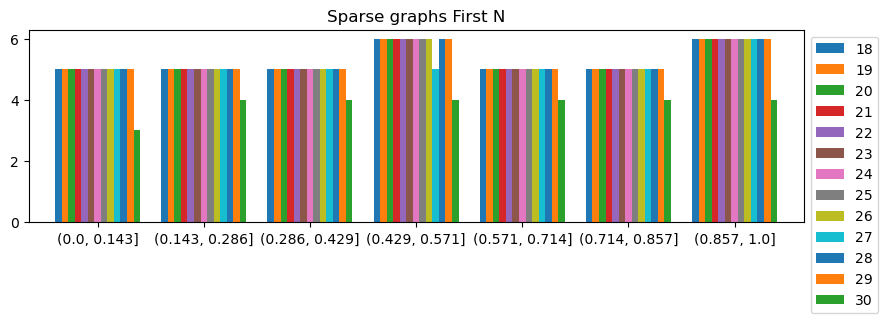

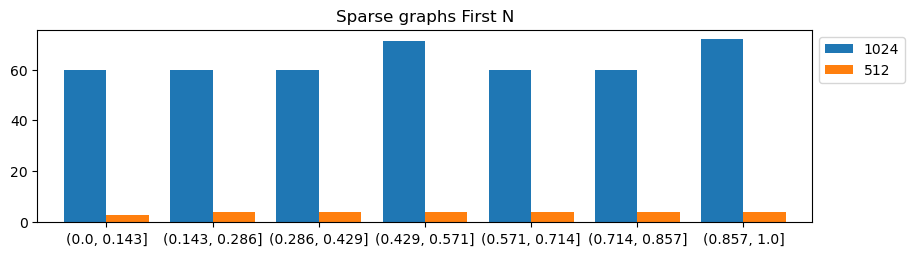

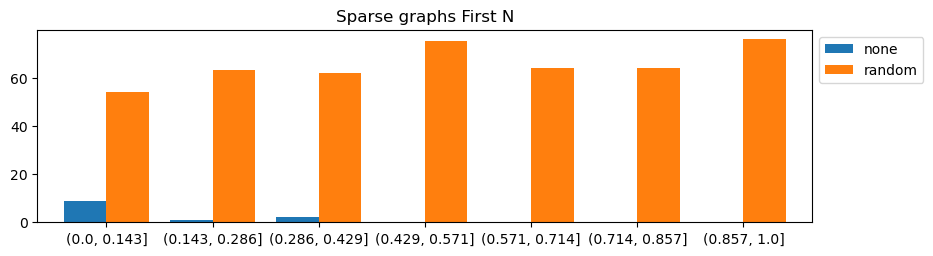

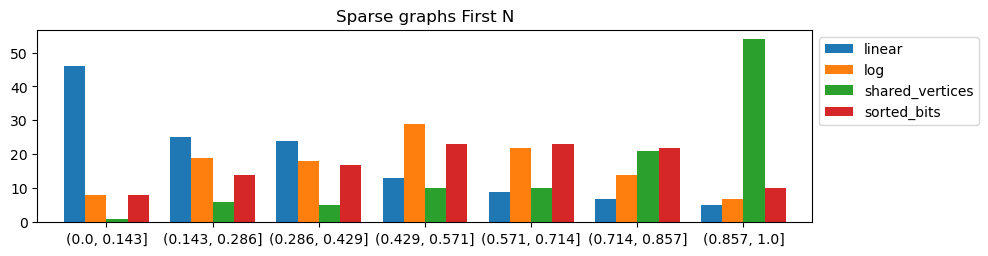

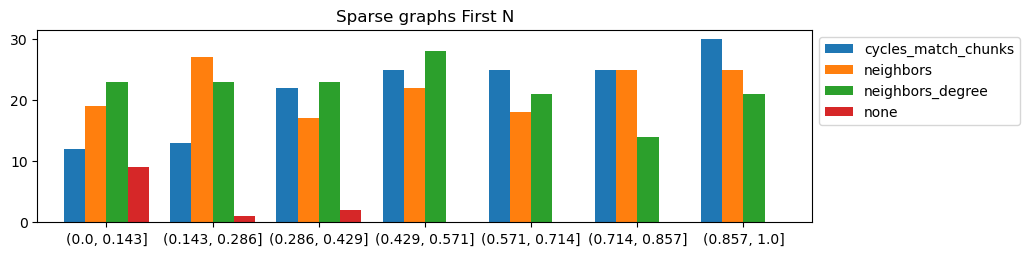

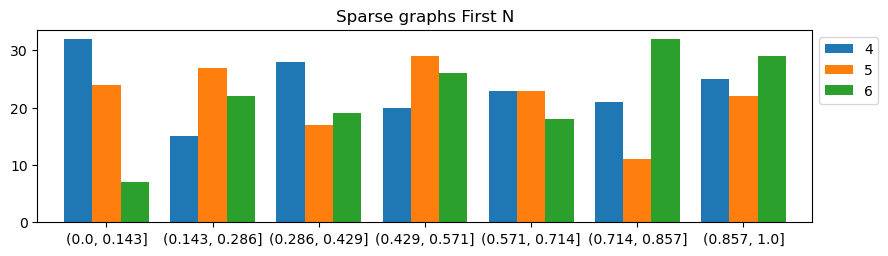

In [43]:
input = """
--------------------------------------------------------------------------------
Name (time in ms)                                                                                      Min                    Max                   Mean                StdDev                 Median                    IQR            Outliers     OPS            Rounds  Iterations
--------------------------------------------------------------------------------

test_SparseFirstN[18-20-1024-none-subgraphs-linear-none-4]                                        233.9125 (1.0)         239.3391 (1.0)         236.6258 (1.0)          3.8372 (inf)         236.6258 (1.0)           5.4266 (inf)           0;0  4.2261 (1.0)           2           1
test_SparseFirstN[18-20-1024-random-subgraphs-linear-neighbors-4-smart]                           310.2715 (1.33)        310.9594 (1.30)        310.6155 (1.31)         0.4864 (inf)         310.6155 (1.31)          0.6879 (inf)           0;0  3.2194 (0.76)          2           1
test_SparseFirstN[18-20-1024-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]        308.7233 (1.32)        318.0632 (1.33)        313.3932 (1.32)         6.6043 (inf)         313.3932 (1.32)          9.3399 (inf)           0;0  3.1909 (0.76)          2           1
test_SparseFirstN[18-20-1024-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]            313.6997 (1.34)        314.3714 (1.31)        314.0356 (1.33)         0.4750 (inf)         314.0356 (1.33)          0.6717 (inf)           0;0  3.1844 (0.75)          2           1
test_SparseFirstN[18-20-1024-random-subgraphs-linear-neighbors_degree-5-smart]                    316.0133 (1.35)        319.6707 (1.34)        317.8420 (1.34)         2.5862 (inf)         317.8420 (1.34)          3.6574 (inf)           0;0  3.1462 (0.74)          2           1
test_SparseFirstN[18-20-1024-random-subgraphs-log-neighbors-6-smart]                              317.1326 (1.36)        319.1826 (1.33)        318.1576 (1.34)         1.4496 (inf)         318.1576 (1.34)          2.0500 (inf)           0;0  3.1431 (0.74)          2           1
test_SparseFirstN[18-20-1024-random-subgraphs-log-cycles_match_chunks-5-smart]                    316.6911 (1.35)        319.7776 (1.34)        318.2344 (1.34)         2.1825 (inf)         318.2344 (1.34)          3.0865 (inf)           0;0  3.1423 (0.74)          2           1
test_SparseFirstN[18-20-1024-random-subgraphs-shared_vertices-neighbors-6-smart]                  321.0220 (1.37)        321.8700 (1.34)        321.4460 (1.36)         0.5996 (inf)         321.4460 (1.36)          0.8480 (inf)           0;0  3.1109 (0.74)          2           1
test_SparseFirstN[18-20-1024-random-subgraphs-sorted_bits-neighbors_degree-5-smart]               333.7487 (1.43)        346.7677 (1.45)        340.2582 (1.44)         9.2058 (inf)         340.2582 (1.44)         13.0190 (inf)           0;0  2.9389 (0.70)          2           1
test_SparseFirstN[18-20-1024-random-subgraphs-sorted_bits-neighbors-5-smart]                      358.1310 (1.53)        361.5361 (1.51)        359.8336 (1.52)         2.4078 (inf)         359.8336 (1.52)          3.4052 (inf)           0;0  2.7791 (0.66)          2           1
test_SparseFirstN[18-20-1024-random-subgraphs-linear-neighbors_degree-4-smart]                    312.4816 (1.34)        753.6066 (3.15)        533.0441 (2.25)       311.9225 (inf)         533.0441 (2.25)        441.1250 (inf)           0;0  1.8760 (0.44)          2           1
test_SparseFirstN[18-20-1024-random-subgraphs-log-cycles_match_chunks-4-smart]                    308.1894 (1.32)        761.3439 (3.18)        534.7667 (2.26)       320.4286 (inf)         534.7667 (2.26)        453.1544 (inf)           0;0  1.8700 (0.44)          2           1
test_SparseFirstN[18-20-1024-random-subgraphs-linear-neighbors_degree-6-smart]                    316.4468 (1.35)        759.9906 (3.18)        538.2187 (2.27)       313.6328 (inf)         538.2187 (2.27)        443.5438 (inf)           0;0  1.8580 (0.44)          2           1
test_SparseFirstN[18-20-1024-random-subgraphs-shared_vertices-neighbors_degree-5-smart]           313.0922 (1.34)        766.7060 (3.20)        539.8991 (2.28)       320.7535 (inf)         539.8991 (2.28)        453.6139 (inf)           0;0  1.8522 (0.44)          2           1
test_SparseFirstN[18-20-1024-random-subgraphs-linear-cycles_match_chunks-4-smart]                 307.1516 (1.31)        776.5146 (3.24)        541.8331 (2.29)       331.8897 (inf)         541.8331 (2.29)        469.3629 (inf)           0;0  1.8456 (0.44)          2           1
test_SparseFirstN[18-20-1024-random-subgraphs-log-neighbors-4-smart]                              312.3681 (1.34)        771.9318 (3.23)        542.1499 (2.29)       324.9607 (inf)         542.1499 (2.29)        459.5638 (inf)           0;0  1.8445 (0.44)          2           1
test_SparseFirstN[18-20-1024-random-subgraphs-shared_vertices-neighbors_degree-6-smart]           314.9496 (1.35)        771.0732 (3.22)        543.0114 (2.29)       322.5281 (inf)         543.0114 (2.29)        456.1236 (inf)           0;0  1.8416 (0.44)          2           1
test_SparseFirstN[18-20-1024-random-subgraphs-linear-cycles_match_chunks-5-smart]                 310.3839 (1.33)        775.9818 (3.24)        543.1828 (2.30)       329.2274 (inf)         543.1828 (2.30)        465.5979 (inf)           0;0  1.8410 (0.44)          2           1
test_SparseFirstN[18-20-1024-random-subgraphs-log-neighbors_degree-6-smart]                       314.3143 (1.34)        772.4729 (3.23)        543.3936 (2.30)       323.9671 (inf)         543.3936 (2.30)        458.1586 (inf)           0;0  1.8403 (0.44)          2           1
test_SparseFirstN[18-20-1024-random-subgraphs-shared_vertices-neighbors-5-smart]                  310.2265 (1.33)        777.7193 (3.25)        543.9729 (2.30)       330.5673 (inf)         543.9729 (2.30)        467.4928 (inf)           0;0  1.8383 (0.43)          2           1
test_SparseFirstN[18-20-1024-random-subgraphs-log-cycles_match_chunks-6-smart]                    314.3950 (1.34)        776.4065 (3.24)        545.4008 (2.30)       326.6915 (inf)         545.4008 (2.30)        462.0115 (inf)           0;0  1.8335 (0.43)          2           1
test_SparseFirstN[18-20-1024-random-subgraphs-log-neighbors-5-smart]                              313.5517 (1.34)        777.4883 (3.25)        545.5200 (2.31)       328.0527 (inf)         545.5200 (2.31)        463.9365 (inf)           0;0  1.8331 (0.43)          2           1
test_SparseFirstN[18-20-1024-random-subgraphs-linear-cycles_match_chunks-6-smart]                 327.5833 (1.40)        763.5134 (3.19)        545.5483 (2.31)       308.2491 (inf)         545.5483 (2.31)        435.9301 (inf)           0;0  1.8330 (0.43)          2           1
test_SparseFirstN[18-20-1024-random-subgraphs-log-neighbors_degree-4-smart]                       315.6337 (1.35)        775.5269 (3.24)        545.5803 (2.31)       325.1935 (inf)         545.5803 (2.31)        459.8931 (inf)           0;0  1.8329 (0.43)          2           1
test_SparseFirstN[18-20-1024-random-subgraphs-linear-neighbors-5-smart]                           323.0573 (1.38)        769.7633 (3.22)        546.4103 (2.31)       315.8688 (inf)         546.4103 (2.31)        446.7060 (inf)           0;0  1.8301 (0.43)          2           1
test_SparseFirstN[18-20-1024-random-subgraphs-log-neighbors_degree-5-smart]                       321.3036 (1.37)        779.3511 (3.26)        550.3273 (2.33)       323.8885 (inf)         550.3273 (2.33)        458.0475 (inf)           0;0  1.8171 (0.43)          2           1
test_SparseFirstN[18-20-1024-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]            320.1836 (1.37)        780.4761 (3.26)        550.3298 (2.33)       325.4760 (inf)         550.3298 (2.33)        460.2925 (inf)           0;0  1.8171 (0.43)          2           1
test_SparseFirstN[18-20-1024-random-subgraphs-linear-neighbors-6-smart]                           313.6245 (1.34)        792.3269 (3.31)        552.9757 (2.34)       338.4937 (inf)         552.9757 (2.34)        478.7024 (inf)           0;0  1.8084 (0.43)          2           1
test_SparseFirstN[18-20-1024-random-subgraphs-sorted_bits-neighbors_degree-6-smart]               331.6915 (1.42)        775.3078 (3.24)        553.4997 (2.34)       313.6841 (inf)         553.4997 (2.34)        443.6163 (inf)           0;0  1.8067 (0.43)          2           1
test_SparseFirstN[18-20-1024-random-subgraphs-shared_vertices-neighbors-4-smart]                  327.7533 (1.40)        780.9948 (3.26)        554.3740 (2.34)       320.4901 (inf)         554.3740 (2.34)        453.2415 (inf)           0;0  1.8038 (0.43)          2           1
test_SparseFirstN[18-20-1024-random-subgraphs-sorted_bits-neighbors-4-smart]                      356.3190 (1.52)        756.7373 (3.16)        556.5282 (2.35)       283.1385 (inf)         556.5282 (2.35)        400.4183 (inf)           0;0  1.7969 (0.43)          2           1
test_SparseFirstN[18-20-1024-random-subgraphs-sorted_bits-neighbors_degree-4-smart]               379.5020 (1.62)        735.8781 (3.07)        557.6901 (2.36)       251.9959 (inf)         557.6901 (2.36)        356.3761 (inf)           0;0  1.7931 (0.42)          2           1
test_SparseFirstN[18-20-1024-random-subgraphs-shared_vertices-neighbors_degree-4-smart]           335.2087 (1.43)        780.8605 (3.26)        558.0346 (2.36)       315.1234 (inf)         558.0346 (2.36)        445.6518 (inf)           0;0  1.7920 (0.42)          2           1
test_SparseFirstN[18-20-1024-random-subgraphs-sorted_bits-neighbors-6-smart]                      389.9743 (1.67)        741.4385 (3.10)        565.7064 (2.39)       248.5227 (inf)         565.7064 (2.39)        351.4642 (inf)           0;0  1.7677 (0.42)          2           1
test_SparseFirstN[18-20-1024-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]        382.0282 (1.63)        752.5459 (3.14)        567.2870 (2.40)       261.9956 (inf)         567.2870 (2.40)        370.5177 (inf)           0;0  1.7628 (0.42)          2           1
test_SparseFirstN[18-20-1024-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]            378.5897 (1.62)        771.7810 (3.22)        575.1854 (2.43)       278.0282 (inf)         575.1854 (2.43)        393.1913 (inf)           0;0  1.7386 (0.41)          2           1
test_SparseFirstN[18-20-1024-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]        347.0542 (1.48)        811.3221 (3.39)        579.1881 (2.45)       328.2870 (inf)         579.1881 (2.45)        464.2680 (inf)           0;0  1.7266 (0.41)          2           1

test_SparseFirstN[19-20-1024-none-subgraphs-linear-none-4]                                        254.8055 (1.09)        254.9269 (1.07)        254.8662 (1.08)         0.0858 (inf)         254.8662 (1.08)          0.1214 (inf)           0;0  3.9236 (0.93)          2           1
test_SparseFirstN[19-20-1024-random-subgraphs-sorted_bits-neighbors_degree-4-smart]               322.0479 (1.38)        330.2183 (1.38)        326.1331 (1.38)         5.7773 (inf)         326.1331 (1.38)          8.1704 (inf)           0;0  3.0662 (0.73)          2           1
test_SparseFirstN[19-20-1024-random-subgraphs-log-neighbors_degree-4-smart]                       323.9898 (1.39)        334.7009 (1.40)        329.3454 (1.39)         7.5738 (inf)         329.3454 (1.39)         10.7110 (inf)           0;0  3.0363 (0.72)          2           1
test_SparseFirstN[19-20-1024-random-subgraphs-linear-neighbors-4-smart]                           330.9577 (1.41)        333.3351 (1.39)        332.1464 (1.40)         1.6811 (inf)         332.1464 (1.40)          2.3774 (inf)           0;0  3.0107 (0.71)          2           1
test_SparseFirstN[19-20-1024-random-subgraphs-linear-neighbors-6-smart]                           335.6980 (1.44)        347.9815 (1.45)        341.8398 (1.44)         8.6857 (inf)         341.8398 (1.44)         12.2835 (inf)           0;0  2.9253 (0.69)          2           1
test_SparseFirstN[19-20-1024-random-subgraphs-log-neighbors-5-smart]                              342.8972 (1.47)        342.9968 (1.43)        342.9470 (1.45)         0.0704 (inf)         342.9470 (1.45)          0.0996 (inf)           0;0  2.9159 (0.69)          2           1
test_SparseFirstN[19-20-1024-random-subgraphs-shared_vertices-neighbors-4-smart]                  345.6194 (1.48)        345.9450 (1.45)        345.7822 (1.46)         0.2302 (inf)         345.7822 (1.46)          0.3256 (inf)           0;0  2.8920 (0.68)          2           1
test_SparseFirstN[19-20-1024-random-subgraphs-linear-neighbors_degree-5-smart]                    345.2534 (1.48)        347.4455 (1.45)        346.3494 (1.46)         1.5500 (inf)         346.3494 (1.46)          2.1921 (inf)           0;0  2.8873 (0.68)          2           1
test_SparseFirstN[19-20-1024-random-subgraphs-sorted_bits-neighbors-4-smart]                      339.6455 (1.45)        354.1049 (1.48)        346.8752 (1.47)        10.2243 (inf)         346.8752 (1.47)         14.4594 (inf)           0;0  2.8829 (0.68)          2           1
test_SparseFirstN[19-20-1024-random-subgraphs-sorted_bits-neighbors_degree-6-smart]               332.7249 (1.42)        361.3953 (1.51)        347.0601 (1.47)        20.2730 (inf)         347.0601 (1.47)         28.6704 (inf)           0;0  2.8813 (0.68)          2           1
test_SparseFirstN[19-20-1024-random-subgraphs-log-cycles_match_chunks-4-smart]                    339.8112 (1.45)        355.3113 (1.48)        347.5612 (1.47)        10.9602 (inf)         347.5612 (1.47)         15.5001 (inf)           0;0  2.8772 (0.68)          2           1
test_SparseFirstN[19-20-1024-random-subgraphs-log-neighbors_degree-6-smart]                       342.2700 (1.46)        352.8557 (1.47)        347.5628 (1.47)         7.4852 (inf)         347.5628 (1.47)         10.5857 (inf)           0;0  2.8772 (0.68)          2           1
test_SparseFirstN[19-20-1024-random-subgraphs-shared_vertices-neighbors_degree-4-smart]           341.5091 (1.46)        355.3596 (1.48)        348.4344 (1.47)         9.7938 (inf)         348.4344 (1.47)         13.8505 (inf)           0;0  2.8700 (0.68)          2           1
test_SparseFirstN[19-20-1024-random-subgraphs-log-cycles_match_chunks-6-smart]                    352.7751 (1.51)        359.0355 (1.50)        355.9053 (1.50)         4.4267 (inf)         355.9053 (1.50)          6.2603 (inf)           0;0  2.8097 (0.66)          2           1
test_SparseFirstN[19-20-1024-random-subgraphs-linear-cycles_match_chunks-5-smart]                 350.3871 (1.50)        365.7536 (1.53)        358.0704 (1.51)        10.8658 (inf)         358.0704 (1.51)         15.3666 (inf)           0;0  2.7927 (0.66)          2           1
test_SparseFirstN[19-20-1024-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]        353.1038 (1.51)        367.8287 (1.54)        360.4663 (1.52)        10.4121 (inf)         360.4663 (1.52)         14.7249 (inf)           0;0  2.7742 (0.66)          2           1
test_SparseFirstN[19-20-1024-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]            364.8373 (1.56)        389.8898 (1.63)        377.3636 (1.59)        17.7148 (inf)         377.3636 (1.59)         25.0525 (inf)           0;0  2.6500 (0.63)          2           1
test_SparseFirstN[19-20-1024-random-subgraphs-shared_vertices-neighbors-5-smart]                  373.8616 (1.60)        394.3292 (1.65)        384.0954 (1.62)        14.4728 (inf)         384.0954 (1.62)         20.4676 (inf)           0;0  2.6035 (0.62)          2           1
test_SparseFirstN[19-20-1024-random-subgraphs-linear-neighbors_degree-4-smart]                    317.4532 (1.36)        802.2951 (3.35)        559.8741 (2.37)       342.8350 (inf)         559.8741 (2.37)        484.8419 (inf)           0;0  1.7861 (0.42)          2           1
test_SparseFirstN[19-20-1024-random-subgraphs-log-neighbors-4-smart]                              335.9025 (1.44)        792.3475 (3.31)        564.1250 (2.38)       322.7554 (inf)         564.1250 (2.38)        456.4450 (inf)           0;0  1.7727 (0.42)          2           1
test_SparseFirstN[19-20-1024-random-subgraphs-shared_vertices-neighbors_degree-6-smart]           340.5804 (1.46)        797.3876 (3.33)        568.9840 (2.40)       323.0114 (inf)         568.9840 (2.40)        456.8072 (inf)           0;0  1.7575 (0.42)          2           1
test_SparseFirstN[19-20-1024-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]            339.5247 (1.45)        799.8930 (3.34)        569.7088 (2.41)       325.5295 (inf)         569.7088 (2.41)        460.3683 (inf)           0;0  1.7553 (0.42)          2           1
test_SparseFirstN[19-20-1024-random-subgraphs-linear-cycles_match_chunks-4-smart]                 334.0170 (1.43)        807.9691 (3.38)        570.9931 (2.41)       335.1347 (inf)         570.9931 (2.41)        473.9521 (inf)           0;0  1.7513 (0.41)          2           1
test_SparseFirstN[19-20-1024-random-subgraphs-shared_vertices-neighbors-6-smart]                  353.0376 (1.51)        790.0044 (3.30)        571.5210 (2.42)       308.9822 (inf)         571.5210 (2.42)        436.9668 (inf)           0;0  1.7497 (0.41)          2           1
test_SparseFirstN[19-20-1024-random-subgraphs-linear-neighbors_degree-6-smart]                    342.0674 (1.46)        804.4509 (3.36)        573.2592 (2.42)       326.9545 (inf)         573.2592 (2.42)        462.3836 (inf)           0;0  1.7444 (0.41)          2           1
test_SparseFirstN[19-20-1024-random-subgraphs-log-neighbors_degree-5-smart]                       346.5881 (1.48)        799.9791 (3.34)        573.2836 (2.42)       320.5959 (inf)         573.2836 (2.42)        453.3910 (inf)           0;0  1.7443 (0.41)          2           1
test_SparseFirstN[19-20-1024-random-subgraphs-sorted_bits-neighbors-6-smart]                      338.9114 (1.45)        809.7901 (3.38)        574.3508 (2.43)       332.9616 (inf)         574.3508 (2.43)        470.8787 (inf)           0;0  1.7411 (0.41)          2           1
test_SparseFirstN[19-20-1024-random-subgraphs-linear-neighbors-5-smart]                           344.1768 (1.47)        806.1108 (3.37)        575.1438 (2.43)       326.6367 (inf)         575.1438 (2.43)        461.9340 (inf)           0;0  1.7387 (0.41)          2           1
test_SparseFirstN[19-20-1024-random-subgraphs-sorted_bits-neighbors_degree-5-smart]               331.7857 (1.42)        819.4492 (3.42)        575.6174 (2.43)       344.8302 (inf)         575.6174 (2.43)        487.6636 (inf)           0;0  1.7373 (0.41)          2           1
test_SparseFirstN[19-20-1024-random-subgraphs-linear-cycles_match_chunks-6-smart]                 348.9017 (1.49)        803.5139 (3.36)        576.2078 (2.44)       321.4594 (inf)         576.2078 (2.44)        454.6122 (inf)           0;0  1.7355 (0.41)          2           1
test_SparseFirstN[19-20-1024-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]        352.4397 (1.51)        801.4646 (3.35)        576.9521 (2.44)       317.5085 (inf)         576.9521 (2.44)        449.0249 (inf)           0;0  1.7332 (0.41)          2           1
test_SparseFirstN[19-20-1024-random-subgraphs-sorted_bits-neighbors-5-smart]                      357.5571 (1.53)        796.3907 (3.33)        576.9739 (2.44)       310.3022 (inf)         576.9739 (2.44)        438.8336 (inf)           0;0  1.7332 (0.41)          2           1
test_SparseFirstN[19-20-1024-random-subgraphs-log-neighbors-6-smart]                              351.0165 (1.50)        803.1531 (3.36)        577.0848 (2.44)       319.7089 (inf)         577.0848 (2.44)        452.1367 (inf)           0;0  1.7328 (0.41)          2           1
test_SparseFirstN[19-20-1024-random-subgraphs-log-cycles_match_chunks-5-smart]                    357.9419 (1.53)        825.7066 (3.45)        591.8242 (2.50)       330.7596 (inf)         591.8242 (2.50)        467.7647 (inf)           0;0  1.6897 (0.40)          2           1
test_SparseFirstN[19-20-1024-random-subgraphs-shared_vertices-neighbors_degree-5-smart]           366.2607 (1.57)        819.9150 (3.43)        593.0879 (2.51)       320.7820 (inf)         593.0879 (2.51)        453.6543 (inf)           0;0  1.6861 (0.40)          2           1
test_SparseFirstN[19-20-1024-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]            369.4760 (1.58)        830.2670 (3.47)        599.8715 (2.54)       325.8285 (inf)         599.8715 (2.54)        460.7911 (inf)           0;0  1.6670 (0.39)          2           1
test_SparseFirstN[19-20-1024-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]        406.1154 (1.74)        832.8350 (3.48)        619.4752 (2.62)       301.7363 (inf)         619.4752 (2.62)        426.7196 (inf)           0;0  1.6143 (0.38)          2           1

test_SparseFirstN[20-20-1024-none-subgraphs-linear-none-4]                                        314.1196 (1.34)        765.0657 (3.20)        539.5927 (2.28)       318.8670 (inf)         539.5927 (2.28)        450.9461 (inf)           0;0  1.8532 (0.44)          2           1
test_SparseFirstN[20-20-1024-random-subgraphs-linear-neighbors-4-smart]                           389.6264 (1.67)        844.2682 (3.53)        616.9473 (2.61)       321.4803 (inf)         616.9473 (2.61)        454.6418 (inf)           0;0  1.6209 (0.38)          2           1
test_SparseFirstN[20-20-1024-random-subgraphs-linear-cycles_match_chunks-4-smart]                 390.5627 (1.67)        847.2233 (3.54)        618.8930 (2.62)       322.9078 (inf)         618.8930 (2.62)        456.6606 (inf)           0;0  1.6158 (0.38)          2           1
test_SparseFirstN[20-20-1024-random-subgraphs-log-neighbors-5-smart]                              397.4704 (1.70)        842.7478 (3.52)        620.1091 (2.62)       314.8586 (inf)         620.1091 (2.62)        445.2773 (inf)           0;0  1.6126 (0.38)          2           1
test_SparseFirstN[20-20-1024-random-subgraphs-linear-neighbors_degree-4-smart]                    386.6260 (1.65)        855.6641 (3.58)        621.1451 (2.63)       331.6600 (inf)         621.1451 (2.63)        469.0381 (inf)           0;0  1.6099 (0.38)          2           1
test_SparseFirstN[20-20-1024-random-subgraphs-shared_vertices-neighbors_degree-5-smart]           384.8349 (1.65)        860.4911 (3.60)        622.6630 (2.63)       336.3397 (inf)         622.6630 (2.63)        475.6562 (inf)           0;0  1.6060 (0.38)          2           1
test_SparseFirstN[20-20-1024-random-subgraphs-shared_vertices-neighbors-5-smart]                  396.5458 (1.70)        849.6356 (3.55)        623.0907 (2.63)       320.3829 (inf)         623.0907 (2.63)        453.0898 (inf)           0;0  1.6049 (0.38)          2           1
test_SparseFirstN[20-20-1024-random-subgraphs-sorted_bits-neighbors-5-smart]                      391.4490 (1.67)        854.8516 (3.57)        623.1503 (2.63)       327.6752 (inf)         623.1503 (2.63)        463.4026 (inf)           0;0  1.6047 (0.38)          2           1
test_SparseFirstN[20-20-1024-random-subgraphs-linear-neighbors_degree-5-smart]                    390.7794 (1.67)        856.0160 (3.58)        623.3977 (2.63)       328.9720 (inf)         623.3977 (2.63)        465.2366 (inf)           0;0  1.6041 (0.38)          2           1
test_SparseFirstN[20-20-1024-random-subgraphs-log-cycles_match_chunks-5-smart]                    404.1845 (1.73)        844.0407 (3.53)        624.1126 (2.64)       311.0252 (inf)         624.1126 (2.64)        439.8561 (inf)           0;0  1.6023 (0.38)          2           1
test_SparseFirstN[20-20-1024-random-subgraphs-log-cycles_match_chunks-6-smart]                    391.9807 (1.68)        856.6457 (3.58)        624.3132 (2.64)       328.5678 (inf)         624.3132 (2.64)        464.6650 (inf)           0;0  1.6018 (0.38)          2           1
test_SparseFirstN[20-20-1024-random-subgraphs-sorted_bits-neighbors_degree-4-smart]               399.2238 (1.71)        851.2989 (3.56)        625.2613 (2.64)       319.6653 (inf)         625.2613 (2.64)        452.0750 (inf)           0;0  1.5993 (0.38)          2           1
test_SparseFirstN[20-20-1024-random-subgraphs-sorted_bits-neighbors_degree-5-smart]               396.1563 (1.69)        856.6854 (3.58)        626.4208 (2.65)       325.6433 (inf)         626.4208 (2.65)        460.5291 (inf)           0;0  1.5964 (0.38)          2           1
test_SparseFirstN[20-20-1024-random-subgraphs-log-neighbors-6-smart]                              407.3675 (1.74)        846.2869 (3.54)        626.8272 (2.65)       310.3629 (inf)         626.8272 (2.65)        438.9194 (inf)           0;0  1.5953 (0.38)          2           1
test_SparseFirstN[20-20-1024-random-subgraphs-linear-neighbors-5-smart]                           402.9653 (1.72)        851.9150 (3.56)        627.4401 (2.65)       317.4554 (inf)         627.4401 (2.65)        448.9497 (inf)           0;0  1.5938 (0.38)          2           1
test_SparseFirstN[20-20-1024-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]            400.4646 (1.71)        855.5809 (3.57)        628.0227 (2.65)       321.8159 (inf)         628.0227 (2.65)        455.1164 (inf)           0;0  1.5923 (0.38)          2           1
test_SparseFirstN[20-20-1024-random-subgraphs-linear-cycles_match_chunks-5-smart]                 397.8608 (1.70)        859.2493 (3.59)        628.5550 (2.66)       326.2510 (inf)         628.5550 (2.66)        461.3885 (inf)           0;0  1.5910 (0.38)          2           1
test_SparseFirstN[20-20-1024-random-subgraphs-linear-neighbors_degree-6-smart]                    399.1803 (1.71)        859.6823 (3.59)        629.4313 (2.66)       325.6241 (inf)         629.4313 (2.66)        460.5020 (inf)           0;0  1.5887 (0.38)          2           1
test_SparseFirstN[20-20-1024-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]        405.5142 (1.73)        857.0224 (3.58)        631.2683 (2.67)       319.2645 (inf)         631.2683 (2.67)        451.5082 (inf)           0;0  1.5841 (0.37)          2           1
test_SparseFirstN[20-20-1024-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]            407.2223 (1.74)        856.4219 (3.58)        631.8221 (2.67)       317.6321 (inf)         631.8221 (2.67)        449.1996 (inf)           0;0  1.5827 (0.37)          2           1
test_SparseFirstN[20-20-1024-random-subgraphs-log-neighbors_degree-6-smart]                       413.9960 (1.77)        852.9663 (3.56)        633.4812 (2.68)       310.3989 (inf)         633.4812 (2.68)        438.9704 (inf)           0;0  1.5786 (0.37)          2           1
test_SparseFirstN[20-20-1024-random-subgraphs-shared_vertices-neighbors_degree-4-smart]           408.6973 (1.75)        858.8376 (3.59)        633.7675 (2.68)       318.2972 (inf)         633.7675 (2.68)        450.1403 (inf)           0;0  1.5779 (0.37)          2           1
test_SparseFirstN[20-20-1024-random-subgraphs-sorted_bits-neighbors-4-smart]                      409.5247 (1.75)        865.4291 (3.62)        637.4769 (2.69)       322.3731 (inf)         637.4769 (2.69)        455.9045 (inf)           0;0  1.5687 (0.37)          2           1
test_SparseFirstN[20-20-1024-random-subgraphs-log-neighbors_degree-4-smart]                       422.3482 (1.81)        855.9336 (3.58)        639.1409 (2.70)       306.5911 (inf)         639.1409 (2.70)        433.5853 (inf)           0;0  1.5646 (0.37)          2           1
test_SparseFirstN[20-20-1024-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]        422.6676 (1.81)        876.0995 (3.66)        649.3835 (2.74)       320.6248 (inf)         649.3835 (2.74)        453.4319 (inf)           0;0  1.5399 (0.36)          2           1
test_SparseFirstN[20-20-1024-random-subgraphs-shared_vertices-neighbors-4-smart]                  422.6091 (1.81)        876.9406 (3.66)        649.7748 (2.75)       321.2609 (inf)         649.7748 (2.75)        454.3315 (inf)           0;0  1.5390 (0.36)          2           1
test_SparseFirstN[20-20-1024-random-subgraphs-log-neighbors-4-smart]                              815.5173 (3.49)        843.6339 (3.52)        829.5756 (3.51)        19.8814 (inf)         829.5756 (3.51)         28.1166 (inf)           0;0  1.2054 (0.29)          2           1
test_SparseFirstN[20-20-1024-random-subgraphs-sorted_bits-neighbors-6-smart]                      829.9177 (3.55)        835.1090 (3.49)        832.5134 (3.52)         3.6708 (inf)         832.5134 (3.52)          5.1913 (inf)           0;0  1.2012 (0.28)          2           1
test_SparseFirstN[20-20-1024-random-subgraphs-log-cycles_match_chunks-4-smart]                    841.5396 (3.60)        841.5826 (3.52)        841.5611 (3.56)         0.0304 (inf)         841.5611 (3.56)          0.0430 (inf)           0;0  1.1883 (0.28)          2           1
test_SparseFirstN[20-20-1024-random-subgraphs-sorted_bits-neighbors_degree-6-smart]               843.7065 (3.61)        845.1464 (3.53)        844.4264 (3.57)         1.0181 (inf)         844.4264 (3.57)          1.4399 (inf)           0;0  1.1842 (0.28)          2           1
test_SparseFirstN[20-20-1024-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]            838.5774 (3.59)        851.3642 (3.56)        844.9708 (3.57)         9.0416 (inf)         844.9708 (3.57)         12.7867 (inf)           0;0  1.1835 (0.28)          2           1
test_SparseFirstN[20-20-1024-random-subgraphs-log-neighbors_degree-5-smart]                       840.4931 (3.59)        859.5579 (3.59)        850.0255 (3.59)        13.4809 (inf)         850.0255 (3.59)         19.0648 (inf)           0;0  1.1764 (0.28)          2           1
test_SparseFirstN[20-20-1024-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]        848.9669 (3.63)        851.4862 (3.56)        850.2265 (3.59)         1.7814 (inf)         850.2265 (3.59)          2.5193 (inf)           0;0  1.1762 (0.28)          2           1
test_SparseFirstN[20-20-1024-random-subgraphs-shared_vertices-neighbors-6-smart]                  849.8547 (3.63)        853.8679 (3.57)        851.8613 (3.60)         2.8377 (inf)         851.8613 (3.60)          4.0131 (inf)           0;0  1.1739 (0.28)          2           1
test_SparseFirstN[20-20-1024-random-subgraphs-linear-cycles_match_chunks-6-smart]                 853.1784 (3.65)        857.4262 (3.58)        855.3023 (3.61)         3.0037 (inf)         855.3023 (3.61)          4.2478 (inf)           0;0  1.1692 (0.28)          2           1
test_SparseFirstN[20-20-1024-random-subgraphs-shared_vertices-neighbors_degree-6-smart]           851.9079 (3.64)        873.6453 (3.65)        862.7766 (3.65)        15.3707 (inf)         862.7766 (3.65)         21.7374 (inf)           0;0  1.1590 (0.27)          2           1
test_SparseFirstN[20-20-1024-random-subgraphs-linear-neighbors-6-smart]                           860.6575 (3.68)        869.1504 (3.63)        864.9040 (3.66)         6.0054 (inf)         864.9040 (3.66)          8.4929 (inf)           0;0  1.1562 (0.27)          2           1

test_SparseFirstN[21-20-1024-none-subgraphs-linear-none-4]                                        386.0239 (1.65)        835.9024 (3.49)        610.9632 (2.58)       318.1121 (inf)         610.9632 (2.58)        449.8785 (inf)           0;0  1.6368 (0.39)          2           1
test_SparseFirstN[21-20-1024-random-subgraphs-log-neighbors_degree-5-smart]                       408.7172 (1.75)        861.5397 (3.60)        635.1284 (2.68)       320.1939 (inf)         635.1284 (2.68)        452.8225 (inf)           0;0  1.5745 (0.37)          2           1
test_SparseFirstN[21-20-1024-random-subgraphs-linear-neighbors_degree-5-smart]                    413.8868 (1.77)        858.5240 (3.59)        636.2054 (2.69)       314.4059 (inf)         636.2054 (2.69)        444.6372 (inf)           0;0  1.5718 (0.37)          2           1
test_SparseFirstN[21-20-1024-random-subgraphs-linear-cycles_match_chunks-5-smart]                 421.6716 (1.80)        853.8144 (3.57)        637.7430 (2.70)       305.5711 (inf)         637.7430 (2.70)        432.1429 (inf)           0;0  1.5680 (0.37)          2           1
test_SparseFirstN[21-20-1024-random-subgraphs-sorted_bits-neighbors-5-smart]                      423.3888 (1.81)        869.0769 (3.63)        646.2329 (2.73)       315.1491 (inf)         646.2329 (2.73)        445.6881 (inf)           0;0  1.5474 (0.37)          2           1
test_SparseFirstN[21-20-1024-random-subgraphs-sorted_bits-neighbors_degree-5-smart]               429.2167 (1.83)        866.2239 (3.62)        647.7203 (2.74)       309.0108 (inf)         647.7203 (2.74)        437.0073 (inf)           0;0  1.5439 (0.37)          2           1
test_SparseFirstN[21-20-1024-random-subgraphs-linear-cycles_match_chunks-4-smart]                 431.4167 (1.84)        864.4978 (3.61)        647.9572 (2.74)       306.2346 (inf)         647.9572 (2.74)        433.0811 (inf)           0;0  1.5433 (0.37)          2           1
test_SparseFirstN[21-20-1024-random-subgraphs-log-neighbors-5-smart]                              418.0972 (1.79)        878.0896 (3.67)        648.0934 (2.74)       325.2637 (inf)         648.0934 (2.74)        459.9924 (inf)           0;0  1.5430 (0.37)          2           1
test_SparseFirstN[21-20-1024-random-subgraphs-log-neighbors-4-smart]                              435.9187 (1.86)        869.2546 (3.63)        652.5867 (2.76)       306.4147 (inf)         652.5867 (2.76)        433.3358 (inf)           0;0  1.5324 (0.36)          2           1
test_SparseFirstN[21-20-1024-random-subgraphs-linear-neighbors-5-smart]                           426.2598 (1.82)        882.3763 (3.69)        654.3181 (2.77)       322.5231 (inf)         654.3181 (2.77)        456.1166 (inf)           0;0  1.5283 (0.36)          2           1
test_SparseFirstN[21-20-1024-random-subgraphs-sorted_bits-neighbors_degree-4-smart]               441.6700 (1.89)        883.5822 (3.69)        662.6261 (2.80)       312.4791 (inf)         662.6261 (2.80)        441.9122 (inf)           0;0  1.5091 (0.36)          2           1
test_SparseFirstN[21-20-1024-random-subgraphs-linear-neighbors_degree-4-smart]                    432.6089 (1.85)        897.6811 (3.75)        665.1450 (2.81)       328.8557 (inf)         665.1450 (2.81)        465.0722 (inf)           0;0  1.5034 (0.36)          2           1
test_SparseFirstN[21-20-1024-random-subgraphs-log-cycles_match_chunks-5-smart]                    475.1473 (2.03)        858.9437 (3.59)        667.0455 (2.82)       271.3850 (inf)         667.0455 (2.82)        383.7964 (inf)           0;0  1.4991 (0.35)          2           1
test_SparseFirstN[21-20-1024-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]            429.0729 (1.83)        905.8956 (3.78)        667.4842 (2.82)       337.1646 (inf)         667.4842 (2.82)        476.8227 (inf)           0;0  1.4982 (0.35)          2           1
test_SparseFirstN[21-20-1024-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]            427.8102 (1.83)        908.5315 (3.80)        668.1708 (2.82)       339.9213 (inf)         668.1708 (2.82)        480.7213 (inf)           0;0  1.4966 (0.35)          2           1
test_SparseFirstN[21-20-1024-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]        459.7241 (1.97)        886.2686 (3.70)        672.9963 (2.84)       301.6125 (inf)         672.9963 (2.84)        426.5445 (inf)           0;0  1.4859 (0.35)          2           1
test_SparseFirstN[21-20-1024-random-subgraphs-shared_vertices-neighbors_degree-6-smart]           460.0611 (1.97)        902.1273 (3.77)        681.0942 (2.88)       312.5880 (inf)         681.0942 (2.88)        442.0662 (inf)           0;0  1.4682 (0.35)          2           1
test_SparseFirstN[21-20-1024-random-subgraphs-log-neighbors_degree-6-smart]                       465.3277 (1.99)        899.5013 (3.76)        682.4145 (2.88)       307.0071 (inf)         682.4145 (2.88)        434.1736 (inf)           0;0  1.4654 (0.35)          2           1
test_SparseFirstN[21-20-1024-random-subgraphs-shared_vertices-neighbors_degree-5-smart]           440.8743 (1.88)        927.8670 (3.88)        684.3707 (2.89)       344.3558 (inf)         684.3707 (2.89)        486.9927 (inf)           0;0  1.4612 (0.35)          2           1
test_SparseFirstN[21-20-1024-random-subgraphs-sorted_bits-neighbors-4-smart]                      444.5834 (1.90)        936.0725 (3.91)        690.3279 (2.92)       347.5352 (inf)         690.3279 (2.92)        491.4891 (inf)           0;0  1.4486 (0.34)          2           1
test_SparseFirstN[21-20-1024-random-subgraphs-sorted_bits-neighbors-6-smart]                      460.6350 (1.97)        921.8193 (3.85)        691.2272 (2.92)       326.1066 (inf)         691.2272 (2.92)        461.1844 (inf)           0;0  1.4467 (0.34)          2           1
test_SparseFirstN[21-20-1024-random-subgraphs-shared_vertices-neighbors_degree-4-smart]           472.6405 (2.02)        910.6690 (3.80)        691.6548 (2.92)       309.7329 (inf)         691.6548 (2.92)        438.0285 (inf)           0;0  1.4458 (0.34)          2           1
test_SparseFirstN[21-20-1024-random-subgraphs-sorted_bits-neighbors_degree-6-smart]               449.1304 (1.92)        935.2055 (3.91)        692.1680 (2.93)       343.7070 (inf)         692.1680 (2.93)        486.0751 (inf)           0;0  1.4447 (0.34)          2           1
test_SparseFirstN[21-20-1024-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]        466.2906 (1.99)        925.7901 (3.87)        696.0403 (2.94)       324.9153 (inf)         696.0403 (2.94)        459.4996 (inf)           0;0  1.4367 (0.34)          2           1
test_SparseFirstN[21-20-1024-random-subgraphs-shared_vertices-neighbors-6-smart]                  470.9851 (2.01)        924.1274 (3.86)        697.5563 (2.95)       320.4200 (inf)         697.5563 (2.95)        453.1423 (inf)           0;0  1.4336 (0.34)          2           1
test_SparseFirstN[21-20-1024-random-subgraphs-linear-neighbors-6-smart]                           468.4476 (2.00)        928.1371 (3.88)        698.2923 (2.95)       325.0496 (inf)         698.2923 (2.95)        459.6895 (inf)           0;0  1.4321 (0.34)          2           1
test_SparseFirstN[21-20-1024-random-subgraphs-log-cycles_match_chunks-6-smart]                    482.8904 (2.06)        914.5204 (3.82)        698.7054 (2.95)       305.2085 (inf)         698.7054 (2.95)        431.6300 (inf)           0;0  1.4312 (0.34)          2           1
test_SparseFirstN[21-20-1024-random-subgraphs-shared_vertices-neighbors-5-smart]                  460.5859 (1.97)        939.9547 (3.93)        700.2703 (2.96)       338.9650 (inf)         700.2703 (2.96)        479.3688 (inf)           0;0  1.4280 (0.34)          2           1
test_SparseFirstN[21-20-1024-random-subgraphs-log-neighbors-6-smart]                              480.9409 (2.06)        922.4805 (3.85)        701.7107 (2.97)       312.2156 (inf)         701.7107 (2.97)        441.5396 (inf)           0;0  1.4251 (0.34)          2           1
test_SparseFirstN[21-20-1024-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]        480.9303 (2.06)        945.2008 (3.95)        713.0655 (3.01)       328.2888 (inf)         713.0655 (3.01)        464.2705 (inf)           0;0  1.4024 (0.33)          2           1
test_SparseFirstN[21-20-1024-random-subgraphs-linear-cycles_match_chunks-6-smart]                 481.8161 (2.06)        951.6873 (3.98)        716.7517 (3.03)       332.2491 (inf)         716.7517 (3.03)        469.8712 (inf)           0;0  1.3952 (0.33)          2           1
test_SparseFirstN[21-20-1024-random-subgraphs-log-cycles_match_chunks-4-smart]                    524.3834 (2.24)        912.0359 (3.81)        718.2097 (3.04)       274.1117 (inf)         718.2097 (3.04)        387.6526 (inf)           0;0  1.3924 (0.33)          2           1
test_SparseFirstN[21-20-1024-random-subgraphs-linear-neighbors_degree-6-smart]                    517.0207 (2.21)        927.7040 (3.88)        722.3623 (3.05)       290.3969 (inf)         722.3623 (3.05)        410.6832 (inf)           0;0  1.3843 (0.33)          2           1
test_SparseFirstN[21-20-1024-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]            500.3758 (2.14)        971.3249 (4.06)        735.8504 (3.11)       333.0112 (inf)         735.8504 (3.11)        470.9490 (inf)           0;0  1.3590 (0.32)          2           1
test_SparseFirstN[21-20-1024-random-subgraphs-linear-neighbors-4-smart]                           866.6297 (3.70)        875.6988 (3.66)        871.1642 (3.68)         6.4128 (inf)         871.1642 (3.68)          9.0691 (inf)           0;0  1.1479 (0.27)          2           1
test_SparseFirstN[21-20-1024-random-subgraphs-log-neighbors_degree-4-smart]                       883.1138 (3.78)        889.7810 (3.72)        886.4474 (3.75)         4.7144 (inf)         886.4474 (3.75)          6.6672 (inf)           0;0  1.1281 (0.27)          2           1
test_SparseFirstN[21-20-1024-random-subgraphs-shared_vertices-neighbors-4-smart]                  920.8052 (3.94)        980.5178 (4.10)        950.6615 (4.02)        42.2232 (inf)         950.6615 (4.02)         59.7126 (inf)           0;0  1.0519 (0.25)          2           1

test_SparseFirstN[22-20-1024-none-subgraphs-linear-none-4]                                        337.5747 (1.44)        341.6880 (1.43)        339.6313 (1.44)         2.9086 (inf)         339.6313 (1.44)          4.1133 (inf)           0;0  2.9444 (0.70)          2           1
test_SparseFirstN[22-20-1024-random-subgraphs-linear-neighbors_degree-4-smart]                    413.2293 (1.77)        443.4949 (1.85)        428.3621 (1.81)        21.4011 (inf)         428.3621 (1.81)         30.2657 (inf)           0;0  2.3345 (0.55)          2           1
test_SparseFirstN[22-20-1024-random-subgraphs-sorted_bits-neighbors_degree-4-smart]               446.6906 (1.91)        463.8990 (1.94)        455.2948 (1.92)        12.1682 (inf)         455.2948 (1.92)         17.2084 (inf)           0;0  2.1964 (0.52)          2           1
test_SparseFirstN[22-20-1024-random-subgraphs-linear-neighbors-5-smart]                           454.1907 (1.94)        459.5031 (1.92)        456.8469 (1.93)         3.7565 (inf)         456.8469 (1.93)          5.3125 (inf)           0;0  2.1889 (0.52)          2           1
test_SparseFirstN[22-20-1024-random-subgraphs-log-neighbors_degree-5-smart]                       455.4346 (1.95)        459.6453 (1.92)        457.5399 (1.93)         2.9774 (inf)         457.5399 (1.93)          4.2106 (inf)           0;0  2.1856 (0.52)          2           1
test_SparseFirstN[22-20-1024-random-subgraphs-linear-cycles_match_chunks-5-smart]                 457.0624 (1.95)        475.9463 (1.99)        466.5044 (1.97)        13.3530 (inf)         466.5044 (1.97)         18.8839 (inf)           0;0  2.1436 (0.51)          2           1
test_SparseFirstN[22-20-1024-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]            473.6120 (2.02)        483.0288 (2.02)        478.3204 (2.02)         6.6587 (inf)         478.3204 (2.02)          9.4168 (inf)           0;0  2.0906 (0.49)          2           1
test_SparseFirstN[22-20-1024-random-subgraphs-sorted_bits-neighbors-4-smart]                      483.2876 (2.07)        507.8529 (2.12)        495.5702 (2.09)        17.3703 (inf)         495.5702 (2.09)         24.5653 (inf)           0;0  2.0179 (0.48)          2           1
test_SparseFirstN[22-20-1024-random-subgraphs-shared_vertices-neighbors_degree-4-smart]           490.4900 (2.10)        508.8251 (2.13)        499.6576 (2.11)        12.9649 (inf)         499.6576 (2.11)         18.3351 (inf)           0;0  2.0014 (0.47)          2           1
test_SparseFirstN[22-20-1024-random-subgraphs-linear-neighbors_degree-6-smart]                    495.4799 (2.12)        514.2190 (2.15)        504.8495 (2.13)        13.2505 (inf)         504.8495 (2.13)         18.7391 (inf)           0;0  1.9808 (0.47)          2           1
test_SparseFirstN[22-20-1024-random-subgraphs-log-neighbors-6-smart]                              515.7615 (2.20)        527.5893 (2.20)        521.6754 (2.20)         8.3635 (inf)         521.6754 (2.20)         11.8278 (inf)           0;0  1.9169 (0.45)          2           1
test_SparseFirstN[22-20-1024-random-subgraphs-sorted_bits-neighbors_degree-6-smart]               524.0038 (2.24)        527.4165 (2.20)        525.7102 (2.22)         2.4131 (inf)         525.7102 (2.22)          3.4127 (inf)           0;0  1.9022 (0.45)          2           1
test_SparseFirstN[22-20-1024-random-subgraphs-log-cycles_match_chunks-6-smart]                    532.5336 (2.28)        563.3229 (2.35)        547.9283 (2.32)        21.7713 (inf)         547.9283 (2.32)         30.7892 (inf)           0;0  1.8251 (0.43)          2           1
test_SparseFirstN[22-20-1024-random-subgraphs-shared_vertices-neighbors-5-smart]                  547.3941 (2.34)        608.2508 (2.54)        577.8224 (2.44)        43.0322 (inf)         577.8224 (2.44)         60.8567 (inf)           0;0  1.7306 (0.41)          2           1
test_SparseFirstN[22-20-1024-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]        578.8400 (2.47)        619.9761 (2.59)        599.4081 (2.53)        29.0876 (inf)         599.4081 (2.53)         41.1361 (inf)           0;0  1.6683 (0.39)          2           1
test_SparseFirstN[22-20-1024-random-subgraphs-linear-neighbors-4-smart]                           422.7551 (1.81)        881.3942 (3.68)        652.0747 (2.76)       324.3068 (inf)         652.0747 (2.76)        458.6391 (inf)           0;0  1.5336 (0.36)          2           1
test_SparseFirstN[22-20-1024-random-subgraphs-linear-neighbors_degree-5-smart]                    447.4266 (1.91)        894.4737 (3.74)        670.9502 (2.84)       316.1101 (inf)         670.9502 (2.84)        447.0471 (inf)           0;0  1.4904 (0.35)          2           1
test_SparseFirstN[22-20-1024-random-subgraphs-linear-cycles_match_chunks-4-smart]                 453.7797 (1.94)        895.6280 (3.74)        674.7039 (2.85)       312.4339 (inf)         674.7039 (2.85)        441.8483 (inf)           0;0  1.4821 (0.35)          2           1
test_SparseFirstN[22-20-1024-random-subgraphs-log-neighbors_degree-4-smart]                       446.4615 (1.91)        907.7031 (3.79)        677.0823 (2.86)       326.1471 (inf)         677.0823 (2.86)        461.2416 (inf)           0;0  1.4769 (0.35)          2           1
test_SparseFirstN[22-20-1024-random-subgraphs-log-neighbors-4-smart]                              465.6101 (1.99)        901.1432 (3.77)        683.3767 (2.89)       307.9684 (inf)         683.3767 (2.89)        435.5331 (inf)           0;0  1.4633 (0.35)          2           1
test_SparseFirstN[22-20-1024-random-subgraphs-log-neighbors-5-smart]                              473.5943 (2.02)        907.9209 (3.79)        690.7576 (2.92)       307.1153 (inf)         690.7576 (2.92)        434.3266 (inf)           0;0  1.4477 (0.34)          2           1
test_SparseFirstN[22-20-1024-random-subgraphs-log-cycles_match_chunks-5-smart]                    462.9638 (1.98)        925.6508 (3.87)        694.3073 (2.93)       327.1691 (inf)         694.3073 (2.93)        462.6870 (inf)           0;0  1.4403 (0.34)          2           1
test_SparseFirstN[22-20-1024-random-subgraphs-sorted_bits-neighbors-5-smart]                      482.4412 (2.06)        908.1748 (3.79)        695.3080 (2.94)       301.0391 (inf)         695.3080 (2.94)        425.7336 (inf)           0;0  1.4382 (0.34)          2           1
test_SparseFirstN[22-20-1024-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]            480.6345 (2.05)        912.4054 (3.81)        696.5200 (2.94)       305.3081 (inf)         696.5200 (2.94)        431.7708 (inf)           0;0  1.4357 (0.34)          2           1
test_SparseFirstN[22-20-1024-random-subgraphs-sorted_bits-neighbors_degree-5-smart]               477.2940 (2.04)        920.5227 (3.85)        698.9083 (2.95)       313.4100 (inf)         698.9083 (2.95)        443.2287 (inf)           0;0  1.4308 (0.34)          2           1
test_SparseFirstN[22-20-1024-random-subgraphs-log-cycles_match_chunks-4-smart]                    487.0021 (2.08)        938.9469 (3.92)        712.9745 (3.01)       319.5733 (inf)         712.9745 (3.01)        451.9448 (inf)           0;0  1.4026 (0.33)          2           1
test_SparseFirstN[22-20-1024-random-subgraphs-log-neighbors_degree-6-smart]                       500.3520 (2.14)        959.1897 (4.01)        729.7709 (3.08)       324.4472 (inf)         729.7709 (3.08)        458.8377 (inf)           0;0  1.3703 (0.32)          2           1
test_SparseFirstN[22-20-1024-random-subgraphs-shared_vertices-neighbors-4-smart]                  497.9449 (2.13)        964.7686 (4.03)        731.3567 (3.09)       330.0942 (inf)         731.3567 (3.09)        466.8237 (inf)           0;0  1.3673 (0.32)          2           1
test_SparseFirstN[22-20-1024-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]            527.7458 (2.26)        961.8932 (4.02)        744.8195 (3.15)       306.9886 (inf)         744.8195 (3.15)        434.1474 (inf)           0;0  1.3426 (0.32)          2           1
test_SparseFirstN[22-20-1024-random-subgraphs-linear-neighbors-6-smart]                           532.0231 (2.27)        961.9421 (4.02)        746.9826 (3.16)       303.9987 (inf)         746.9826 (3.16)        429.9191 (inf)           0;0  1.3387 (0.32)          2           1
test_SparseFirstN[22-20-1024-random-subgraphs-sorted_bits-neighbors-6-smart]                      515.3171 (2.20)        992.5954 (4.15)        753.9563 (3.19)       337.4867 (inf)         753.9563 (3.19)        477.2783 (inf)           0;0  1.3263 (0.31)          2           1
test_SparseFirstN[22-20-1024-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]        519.0096 (2.22)        991.0834 (4.14)        755.0465 (3.19)       333.8066 (inf)         755.0465 (3.19)        472.0738 (inf)           0;0  1.3244 (0.31)          2           1
test_SparseFirstN[22-20-1024-random-subgraphs-linear-cycles_match_chunks-6-smart]                 561.2881 (2.40)        978.0337 (4.09)        769.6609 (3.25)       294.6836 (inf)         769.6609 (3.25)        416.7456 (inf)           0;0  1.2993 (0.31)          2           1
test_SparseFirstN[22-20-1024-random-subgraphs-shared_vertices-neighbors_degree-5-smart]           601.8062 (2.57)        965.9693 (4.04)        783.8878 (3.31)       257.5022 (inf)         783.8878 (3.31)        364.1631 (inf)           0;0  1.2757 (0.30)          2           1
test_SparseFirstN[22-20-1024-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]        562.2933 (2.40)      1,026.1011 (4.29)        794.1972 (3.36)       327.9616 (inf)         794.1972 (3.36)        463.8078 (inf)           0;0  1.2591 (0.30)          2           1
test_SparseFirstN[22-20-1024-random-subgraphs-shared_vertices-neighbors_degree-6-smart]           535.8549 (2.29)      1,060.4359 (4.43)        798.1454 (3.37)       370.9348 (inf)         798.1454 (3.37)        524.5810 (inf)           0;0  1.2529 (0.30)          2           1
test_SparseFirstN[22-20-1024-random-subgraphs-shared_vertices-neighbors-6-smart]                  622.7585 (2.66)      1,022.3468 (4.27)        822.5526 (3.48)       282.5516 (inf)         822.5526 (3.48)        399.5883 (inf)           0;0  1.2157 (0.29)          2           1

test_SparseFirstN[23-20-1024-none-subgraphs-linear-none-4]                                        358.5789 (1.53)        360.7136 (1.51)        359.6463 (1.52)         1.5095 (inf)         359.6463 (1.52)          2.1347 (inf)           0;0  2.7805 (0.66)          2           1
test_SparseFirstN[23-20-1024-random-subgraphs-linear-neighbors-4-smart]                           442.6885 (1.89)        453.1775 (1.89)        447.9330 (1.89)         7.4168 (inf)         447.9330 (1.89)         10.4889 (inf)           0;0  2.2325 (0.53)          2           1
test_SparseFirstN[23-20-1024-random-subgraphs-linear-neighbors_degree-6-smart]                    451.1193 (1.93)        476.6379 (1.99)        463.8786 (1.96)        18.0443 (inf)         463.8786 (1.96)         25.5185 (inf)           0;0  2.1557 (0.51)          2           1
test_SparseFirstN[23-20-1024-random-subgraphs-log-neighbors_degree-5-smart]                       463.0380 (1.98)        477.2691 (1.99)        470.1535 (1.99)        10.0629 (inf)         470.1535 (1.99)         14.2310 (inf)           0;0  2.1270 (0.50)          2           1
test_SparseFirstN[23-20-1024-random-subgraphs-linear-cycles_match_chunks-5-smart]                 471.8644 (2.02)        479.7005 (2.00)        475.7824 (2.01)         5.5410 (inf)         475.7824 (2.01)          7.8361 (inf)           0;0  2.1018 (0.50)          2           1
test_SparseFirstN[23-20-1024-random-subgraphs-linear-neighbors-6-smart]                           466.2189 (1.99)        496.3872 (2.07)        481.3031 (2.03)        21.3322 (inf)         481.3031 (2.03)         30.1683 (inf)           0;0  2.0777 (0.49)          2           1
test_SparseFirstN[23-20-1024-random-subgraphs-log-neighbors-6-smart]                              466.0146 (1.99)        499.9304 (2.09)        482.9725 (2.04)        23.9821 (inf)         482.9725 (2.04)         33.9158 (inf)           0;0  2.0705 (0.49)          2           1
test_SparseFirstN[23-20-1024-random-subgraphs-log-neighbors-4-smart]                              489.7985 (2.09)        500.8939 (2.09)        495.3462 (2.09)         7.8456 (inf)         495.3462 (2.09)         11.0954 (inf)           0;0  2.0188 (0.48)          2           1
test_SparseFirstN[23-20-1024-random-subgraphs-log-cycles_match_chunks-5-smart]                    493.6367 (2.11)        505.6473 (2.11)        499.6420 (2.11)         8.4928 (inf)         499.6420 (2.11)         12.0106 (inf)           0;0  2.0014 (0.47)          2           1
test_SparseFirstN[23-20-1024-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]            517.7270 (2.21)        527.0181 (2.20)        522.3725 (2.21)         6.5698 (inf)         522.3725 (2.21)          9.2911 (inf)           0;0  1.9143 (0.45)          2           1
test_SparseFirstN[23-20-1024-random-subgraphs-sorted_bits-neighbors_degree-5-smart]               526.5281 (2.25)        565.4000 (2.36)        545.9641 (2.31)        27.4866 (inf)         545.9641 (2.31)         38.8720 (inf)           0;0  1.8316 (0.43)          2           1
test_SparseFirstN[23-20-1024-random-subgraphs-sorted_bits-neighbors-4-smart]                      525.2331 (2.25)        594.7746 (2.49)        560.0039 (2.37)        49.1732 (inf)         560.0039 (2.37)         69.5415 (inf)           0;0  1.7857 (0.42)          2           1
test_SparseFirstN[23-20-1024-random-subgraphs-shared_vertices-neighbors_degree-5-smart]           546.1287 (2.33)        612.4381 (2.56)        579.2834 (2.45)        46.8878 (inf)         579.2834 (2.45)         66.3094 (inf)           0;0  1.7263 (0.41)          2           1
test_SparseFirstN[23-20-1024-random-subgraphs-sorted_bits-neighbors-6-smart]                      551.1931 (2.36)        617.4360 (2.58)        584.3145 (2.47)        46.8408 (inf)         584.3145 (2.47)         66.2429 (inf)           0;0  1.7114 (0.40)          2           1
test_SparseFirstN[23-20-1024-random-subgraphs-linear-neighbors_degree-4-smart]                    439.0126 (1.88)        889.9026 (3.72)        664.4576 (2.81)       318.8274 (inf)         664.4576 (2.81)        450.8900 (inf)           0;0  1.5050 (0.36)          2           1
test_SparseFirstN[23-20-1024-random-subgraphs-linear-neighbors_degree-5-smart]                    441.4140 (1.89)        919.0008 (3.84)        680.2074 (2.87)       337.7048 (inf)         680.2074 (2.87)        477.5867 (inf)           0;0  1.4701 (0.35)          2           1
test_SparseFirstN[23-20-1024-random-subgraphs-linear-neighbors-5-smart]                           446.4359 (1.91)        916.6760 (3.83)        681.5559 (2.88)       332.5100 (inf)         681.5559 (2.88)        470.2401 (inf)           0;0  1.4672 (0.35)          2           1
test_SparseFirstN[23-20-1024-random-subgraphs-log-neighbors_degree-6-smart]                       473.1958 (2.02)        902.9206 (3.77)        688.0582 (2.91)       303.8613 (inf)         688.0582 (2.91)        429.7248 (inf)           0;0  1.4534 (0.34)          2           1
test_SparseFirstN[23-20-1024-random-subgraphs-linear-cycles_match_chunks-4-smart]                 484.5124 (2.07)        913.9810 (3.82)        699.2467 (2.96)       303.6801 (inf)         699.2467 (2.96)        429.4686 (inf)           0;0  1.4301 (0.34)          2           1
test_SparseFirstN[23-20-1024-random-subgraphs-log-neighbors-5-smart]                              475.2775 (2.03)        934.4788 (3.90)        704.8782 (2.98)       324.7044 (inf)         704.8782 (2.98)        459.2013 (inf)           0;0  1.4187 (0.34)          2           1
test_SparseFirstN[23-20-1024-random-subgraphs-log-neighbors_degree-4-smart]                       476.9717 (2.04)        936.0518 (3.91)        706.5118 (2.99)       324.6186 (inf)         706.5118 (2.99)        459.0801 (inf)           0;0  1.4154 (0.33)          2           1
test_SparseFirstN[23-20-1024-random-subgraphs-log-cycles_match_chunks-6-smart]                    492.5472 (2.11)        961.5519 (4.02)        727.0496 (3.07)       331.6363 (inf)         727.0496 (3.07)        469.0046 (inf)           0;0  1.3754 (0.33)          2           1
test_SparseFirstN[23-20-1024-random-subgraphs-linear-cycles_match_chunks-6-smart]                 506.6556 (2.17)        956.5017 (4.00)        731.5787 (3.09)       318.0892 (inf)         731.5787 (3.09)        449.8461 (inf)           0;0  1.3669 (0.32)          2           1
test_SparseFirstN[23-20-1024-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]            508.5343 (2.17)        962.6981 (4.02)        735.6162 (3.11)       321.1423 (inf)         735.6162 (3.11)        454.1638 (inf)           0;0  1.3594 (0.32)          2           1
test_SparseFirstN[23-20-1024-random-subgraphs-log-cycles_match_chunks-4-smart]                    510.6983 (2.18)        976.2651 (4.08)        743.4817 (3.14)       329.2055 (inf)         743.4817 (3.14)        465.5668 (inf)           0;0  1.3450 (0.32)          2           1
test_SparseFirstN[23-20-1024-random-subgraphs-sorted_bits-neighbors-5-smart]                      547.7119 (2.34)        948.4197 (3.96)        748.0658 (3.16)       283.3432 (inf)         748.0658 (3.16)        400.7078 (inf)           0;0  1.3368 (0.32)          2           1
test_SparseFirstN[23-20-1024-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]        757.4297 (3.24)        802.5743 (3.35)        780.0020 (3.30)        31.9220 (inf)         780.0020 (3.30)         45.1446 (inf)           0;0  1.2820 (0.30)          2           1
test_SparseFirstN[23-20-1024-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]            542.7744 (2.32)      1,049.9060 (4.39)        796.3402 (3.37)       358.5962 (inf)         796.3402 (3.37)        507.1316 (inf)           0;0  1.2557 (0.30)          2           1
test_SparseFirstN[23-20-1024-random-subgraphs-sorted_bits-neighbors_degree-6-smart]               546.8195 (2.34)      1,061.3627 (4.43)        804.0911 (3.40)       363.8369 (inf)         804.0911 (3.40)        514.5431 (inf)           0;0  1.2436 (0.29)          2           1
test_SparseFirstN[23-20-1024-random-subgraphs-sorted_bits-neighbors_degree-4-smart]               608.7057 (2.60)      1,003.5711 (4.19)        806.1384 (3.41)       279.2120 (inf)         806.1384 (3.41)        394.8654 (inf)           0;0  1.2405 (0.29)          2           1
test_SparseFirstN[23-20-1024-random-subgraphs-shared_vertices-neighbors_degree-4-smart]           630.2524 (2.69)      1,036.4805 (4.33)        833.3664 (3.52)       287.2467 (inf)         833.3664 (3.52)        406.2281 (inf)           0;0  1.2000 (0.28)          2           1
test_SparseFirstN[23-20-1024-random-subgraphs-shared_vertices-neighbors-6-smart]                  843.1739 (3.60)        878.6608 (3.67)        860.9174 (3.64)        25.0930 (inf)         860.9174 (3.64)         35.4869 (inf)           0;0  1.1616 (0.27)          2           1
test_SparseFirstN[23-20-1024-random-subgraphs-shared_vertices-neighbors-4-smart]                  618.0847 (2.64)      1,144.7012 (4.78)        881.3929 (3.72)       372.3741 (inf)         881.3929 (3.72)        526.6166 (inf)           0;0  1.1346 (0.27)          2           1
test_SparseFirstN[23-20-1024-random-subgraphs-shared_vertices-neighbors-5-smart]                  747.2627 (3.19)      1,040.4705 (4.35)        893.8666 (3.78)       207.3292 (inf)         893.8666 (3.78)        293.2078 (inf)           0;0  1.1187 (0.26)          2           1
test_SparseFirstN[23-20-1024-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]        714.9641 (3.06)      1,249.4111 (5.22)        982.1876 (4.15)       377.9111 (inf)         982.1876 (4.15)        534.4470 (inf)           0;0  1.0181 (0.24)          2           1
test_SparseFirstN[23-20-1024-random-subgraphs-shared_vertices-neighbors_degree-6-smart]           800.4473 (3.42)      1,182.8099 (4.94)        991.6286 (4.19)       270.3712 (inf)         991.6286 (4.19)        382.3627 (inf)           0;0  1.0084 (0.24)          2           1
test_SparseFirstN[23-20-1024-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]        962.4493 (4.11)      1,031.8388 (4.31)        997.1441 (4.21)        49.0658 (inf)         997.1441 (4.21)         69.3895 (inf)           0;0  1.0029 (0.24)          2           1

test_SparseFirstN[24-20-1024-random-subgraphs-linear-neighbors-4-smart]                           478.7847 (2.05)        495.4202 (2.07)        487.1024 (2.06)        11.7631 (inf)         487.1024 (2.06)         16.6355 (inf)           0;0  2.0530 (0.49)          2           1
test_SparseFirstN[24-20-1024-random-subgraphs-linear-neighbors_degree-4-smart]                    503.7789 (2.15)        549.0789 (2.29)        526.4289 (2.22)        32.0320 (inf)         526.4289 (2.22)         45.3000 (inf)           0;0  1.8996 (0.45)          2           1
test_SparseFirstN[24-20-1024-random-subgraphs-sorted_bits-neighbors_degree-5-smart]               515.8117 (2.21)        547.1053 (2.29)        531.4585 (2.25)        22.1279 (inf)         531.4585 (2.25)         31.2936 (inf)           0;0  1.8816 (0.45)          2           1
test_SparseFirstN[24-20-1024-random-subgraphs-linear-cycles_match_chunks-5-smart]                 536.6482 (2.29)        544.1662 (2.27)        540.4072 (2.28)         5.3160 (inf)         540.4072 (2.28)          7.5180 (inf)           0;0  1.8505 (0.44)          2           1
test_SparseFirstN[24-20-1024-random-subgraphs-sorted_bits-neighbors_degree-6-smart]               544.6431 (2.33)        554.4080 (2.32)        549.5255 (2.32)         6.9048 (inf)         549.5255 (2.32)          9.7649 (inf)           0;0  1.8198 (0.43)          2           1
test_SparseFirstN[24-20-1024-none-subgraphs-linear-none-4]                                        555.6342 (2.38)        557.7430 (2.33)        556.6886 (2.35)         1.4911 (inf)         556.6886 (2.35)          2.1087 (inf)           0;0  1.7963 (0.43)          2           1
test_SparseFirstN[24-20-1024-random-subgraphs-log-neighbors_degree-5-smart]                       542.3816 (2.32)        574.5419 (2.40)        558.4617 (2.36)        22.7407 (inf)         558.4617 (2.36)         32.1602 (inf)           0;0  1.7906 (0.42)          2           1
test_SparseFirstN[24-20-1024-random-subgraphs-linear-neighbors-6-smart]                           555.9445 (2.38)        566.7801 (2.37)        561.3623 (2.37)         7.6619 (inf)         561.3623 (2.37)         10.8355 (inf)           0;0  1.7814 (0.42)          2           1
test_SparseFirstN[24-20-1024-random-subgraphs-linear-neighbors_degree-6-smart]                    533.6829 (2.28)        624.2760 (2.61)        578.9794 (2.45)        64.0590 (inf)         578.9794 (2.45)         90.5930 (inf)           0;0  1.7272 (0.41)          2           1
test_SparseFirstN[24-20-1024-random-subgraphs-log-neighbors_degree-6-smart]                       545.6549 (2.33)        619.9614 (2.59)        582.8081 (2.46)        52.5426 (inf)         582.8081 (2.46)         74.3065 (inf)           0;0  1.7158 (0.41)          2           1
test_SparseFirstN[24-20-1024-random-subgraphs-sorted_bits-neighbors-5-smart]                      556.2141 (2.38)        612.2212 (2.56)        584.2176 (2.47)        39.6030 (inf)         584.2176 (2.47)         56.0072 (inf)           0;0  1.7117 (0.41)          2           1
test_SparseFirstN[24-20-1024-random-subgraphs-sorted_bits-neighbors-6-smart]                      586.3998 (2.51)        589.5330 (2.46)        587.9664 (2.48)         2.2155 (inf)         587.9664 (2.48)          3.1332 (inf)           0;0  1.7008 (0.40)          2           1
test_SparseFirstN[24-20-1024-random-subgraphs-log-neighbors-4-smart]                              588.0094 (2.51)        590.9409 (2.47)        589.4752 (2.49)         2.0729 (inf)         589.4752 (2.49)          2.9315 (inf)           0;0  1.6964 (0.40)          2           1
test_SparseFirstN[24-20-1024-random-subgraphs-log-neighbors_degree-4-smart]                       582.3664 (2.49)        609.1300 (2.55)        595.7482 (2.52)        18.9247 (inf)         595.7482 (2.52)         26.7636 (inf)           0;0  1.6786 (0.40)          2           1
test_SparseFirstN[24-20-1024-random-subgraphs-log-neighbors-5-smart]                              579.6002 (2.48)        613.1521 (2.56)        596.3762 (2.52)        23.7248 (inf)         596.3762 (2.52)         33.5519 (inf)           0;0  1.6768 (0.40)          2           1
test_SparseFirstN[24-20-1024-random-subgraphs-linear-cycles_match_chunks-6-smart]                 594.4314 (2.54)        600.0262 (2.51)        597.2288 (2.52)         3.9561 (inf)         597.2288 (2.52)          5.5948 (inf)           0;0  1.6744 (0.40)          2           1
test_SparseFirstN[24-20-1024-random-subgraphs-log-cycles_match_chunks-4-smart]                    617.3397 (2.64)        626.7985 (2.62)        622.0691 (2.63)         6.6884 (inf)         622.0691 (2.63)          9.4589 (inf)           0;0  1.6075 (0.38)          2           1
test_SparseFirstN[24-20-1024-random-subgraphs-log-cycles_match_chunks-5-smart]                    620.5154 (2.65)        630.1530 (2.63)        625.3342 (2.64)         6.8148 (inf)         625.3342 (2.64)          9.6376 (inf)           0;0  1.5991 (0.38)          2           1
test_SparseFirstN[24-20-1024-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]            632.2187 (2.70)        632.9630 (2.64)        632.5908 (2.67)         0.5263 (inf)         632.5908 (2.67)          0.7444 (inf)           0;0  1.5808 (0.37)          2           1
test_SparseFirstN[24-20-1024-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]            659.3259 (2.82)        665.5318 (2.78)        662.4289 (2.80)         4.3883 (inf)         662.4289 (2.80)          6.2060 (inf)           0;0  1.5096 (0.36)          2           1
test_SparseFirstN[24-20-1024-random-subgraphs-linear-neighbors-5-smart]                           501.7041 (2.14)        998.5261 (4.17)        750.1151 (3.17)       351.3062 (inf)         750.1151 (3.17)        496.8220 (inf)           0;0  1.3331 (0.32)          2           1
test_SparseFirstN[24-20-1024-random-subgraphs-linear-cycles_match_chunks-4-smart]                 528.8257 (2.26)        976.5180 (4.08)        752.6719 (3.18)       316.5663 (inf)         752.6719 (3.18)        447.6923 (inf)           0;0  1.3286 (0.31)          2           1
test_SparseFirstN[24-20-1024-random-subgraphs-shared_vertices-neighbors_degree-5-smart]           654.3001 (2.80)        856.0784 (3.58)        755.1893 (3.19)       142.6788 (inf)         755.1893 (3.19)        201.7783 (inf)           0;0  1.3242 (0.31)          2           1
test_SparseFirstN[24-20-1024-random-subgraphs-linear-neighbors_degree-5-smart]                    502.5404 (2.15)      1,015.2217 (4.24)        758.8811 (3.21)       362.5205 (inf)         758.8811 (3.21)        512.6814 (inf)           0;0  1.3177 (0.31)          2           1
test_SparseFirstN[24-20-1024-random-subgraphs-sorted_bits-neighbors_degree-4-smart]               557.3218 (2.38)        979.2110 (4.09)        768.2664 (3.25)       298.3207 (inf)         768.2664 (3.25)        421.8892 (inf)           0;0  1.3016 (0.31)          2           1
test_SparseFirstN[24-20-1024-random-subgraphs-log-neighbors-6-smart]                              566.3206 (2.42)      1,024.3024 (4.28)        795.3115 (3.36)       323.8420 (inf)         795.3115 (3.36)        457.9818 (inf)           0;0  1.2574 (0.30)          2           1
test_SparseFirstN[24-20-1024-random-subgraphs-shared_vertices-neighbors-5-smart]                  774.1870 (3.31)        847.5137 (3.54)        810.8504 (3.43)        51.8498 (inf)         810.8504 (3.43)         73.3267 (inf)           0;0  1.2333 (0.29)          2           1
test_SparseFirstN[24-20-1024-random-subgraphs-sorted_bits-neighbors-4-smart]                      626.1685 (2.68)        999.0396 (4.17)        812.6040 (3.43)       263.6597 (inf)         812.6040 (3.43)        372.8711 (inf)           0;0  1.2306 (0.29)          2           1
test_SparseFirstN[24-20-1024-random-subgraphs-log-cycles_match_chunks-6-smart]                    599.5075 (2.56)      1,072.9772 (4.48)        836.2424 (3.53)       334.7936 (inf)         836.2424 (3.53)        473.4697 (inf)           0;0  1.1958 (0.28)          2           1
test_SparseFirstN[24-20-1024-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]            590.1421 (2.52)      1,126.2087 (4.71)        858.1754 (3.63)       379.0563 (inf)         858.1754 (3.63)        536.0665 (inf)           0;0  1.1653 (0.28)          2           1
test_SparseFirstN[24-20-1024-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]        855.6146 (3.66)        865.8268 (3.62)        860.7207 (3.64)         7.2211 (inf)         860.7207 (3.64)         10.2122 (inf)           0;0  1.1618 (0.27)          2           1
test_SparseFirstN[24-20-1024-random-subgraphs-shared_vertices-neighbors_degree-4-smart]           850.4804 (3.64)        874.0873 (3.65)        862.2839 (3.64)        16.6926 (inf)         862.2839 (3.64)         23.6069 (inf)           0;0  1.1597 (0.27)          2           1
test_SparseFirstN[24-20-1024-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]        866.3339 (3.70)        872.9859 (3.65)        869.6599 (3.68)         4.7037 (inf)         869.6599 (3.68)          6.6520 (inf)           0;0  1.1499 (0.27)          2           1
test_SparseFirstN[24-20-1024-random-subgraphs-shared_vertices-neighbors-4-smart]                  867.4496 (3.71)        902.0157 (3.77)        884.7326 (3.74)        24.4419 (inf)         884.7326 (3.74)         34.5660 (inf)           0;0  1.1303 (0.27)          2           1
test_SparseFirstN[24-20-1024-random-subgraphs-shared_vertices-neighbors_degree-6-smart]           695.2825 (2.97)      1,229.5702 (5.14)        962.4264 (4.07)       377.7985 (inf)         962.4264 (4.07)        534.2877 (inf)           0;0  1.0390 (0.25)          2           1
test_SparseFirstN[24-20-1024-random-subgraphs-shared_vertices-neighbors-6-smart]                  834.4338 (3.57)      1,205.6466 (5.04)      1,020.0402 (4.31)       262.4871 (inf)       1,020.0402 (4.31)        371.2129 (inf)           0;0  0.9804 (0.23)          2           1
test_SparseFirstN[24-20-1024-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]        832.6569 (3.56)      1,319.7330 (5.51)      1,076.1949 (4.55)       344.4148 (inf)       1,076.1949 (4.55)        487.0761 (inf)           0;0  0.9292 (0.22)          2           1

test_SparseFirstN[25-20-1024-none-subgraphs-linear-none-4]                                        395.7406 (1.69)        409.9125 (1.71)        402.8266 (1.70)        10.0210 (inf)         402.8266 (1.70)         14.1718 (inf)           0;0  2.4825 (0.59)          2           1
test_SparseFirstN[25-20-1024-random-subgraphs-linear-neighbors_degree-4-smart]                    472.7616 (2.02)        490.2054 (2.05)        481.4835 (2.03)        12.3347 (inf)         481.4835 (2.03)         17.4439 (inf)           0;0  2.0769 (0.49)          2           1
test_SparseFirstN[25-20-1024-random-subgraphs-linear-neighbors_degree-5-smart]                    474.6180 (2.03)        501.1652 (2.09)        487.8916 (2.06)        18.7717 (inf)         487.8916 (2.06)         26.5472 (inf)           0;0  2.0496 (0.48)          2           1
test_SparseFirstN[25-20-1024-random-subgraphs-sorted_bits-neighbors_degree-4-smart]               521.6341 (2.23)        561.6138 (2.35)        541.6239 (2.29)        28.2700 (inf)         541.6239 (2.29)         39.9798 (inf)           0;0  1.8463 (0.44)          2           1
test_SparseFirstN[25-20-1024-random-subgraphs-linear-neighbors-4-smart]                           543.1845 (2.32)        552.3792 (2.31)        547.7819 (2.31)         6.5017 (inf)         547.7819 (2.31)          9.1947 (inf)           0;0  1.8255 (0.43)          2           1
test_SparseFirstN[25-20-1024-random-subgraphs-log-neighbors-4-smart]                              551.5133 (2.36)        551.5182 (2.30)        551.5158 (2.33)         0.0035 (inf)         551.5158 (2.33)          0.0050 (inf)           0;0  1.8132 (0.43)          2           1
test_SparseFirstN[25-20-1024-random-subgraphs-log-neighbors_degree-6-smart]                       544.2952 (2.33)        605.4006 (2.53)        574.8479 (2.43)        43.2080 (inf)         574.8479 (2.43)         61.1053 (inf)           0;0  1.7396 (0.41)          2           1
test_SparseFirstN[25-20-1024-random-subgraphs-log-neighbors-6-smart]                              567.2740 (2.43)        603.9949 (2.52)        585.6345 (2.47)        25.9656 (inf)         585.6345 (2.47)         36.7209 (inf)           0;0  1.7075 (0.40)          2           1
test_SparseFirstN[25-20-1024-random-subgraphs-log-neighbors_degree-5-smart]                       584.6100 (2.50)        592.3456 (2.47)        588.4778 (2.49)         5.4699 (inf)         588.4778 (2.49)          7.7356 (inf)           0;0  1.6993 (0.40)          2           1
test_SparseFirstN[25-20-1024-random-subgraphs-log-cycles_match_chunks-4-smart]                    588.6814 (2.52)        596.0822 (2.49)        592.3818 (2.50)         5.2332 (inf)         592.3818 (2.50)          7.4009 (inf)           0;0  1.6881 (0.40)          2           1
test_SparseFirstN[25-20-1024-random-subgraphs-linear-cycles_match_chunks-4-smart]                 558.5932 (2.39)        626.7512 (2.62)        592.6722 (2.50)        48.1950 (inf)         592.6722 (2.50)         68.1580 (inf)           0;0  1.6873 (0.40)          2           1
test_SparseFirstN[25-20-1024-random-subgraphs-sorted_bits-neighbors_degree-6-smart]               580.2711 (2.48)        606.6458 (2.53)        593.4585 (2.51)        18.6498 (inf)         593.4585 (2.51)         26.3747 (inf)           0;0  1.6850 (0.40)          2           1
test_SparseFirstN[25-20-1024-random-subgraphs-linear-neighbors-5-smart]                           588.3521 (2.52)        599.0446 (2.50)        593.6984 (2.51)         7.5608 (inf)         593.6984 (2.51)         10.6925 (inf)           0;0  1.6844 (0.40)          2           1
test_SparseFirstN[25-20-1024-random-subgraphs-linear-cycles_match_chunks-5-smart]                 588.0000 (2.51)        609.2509 (2.55)        598.6254 (2.53)        15.0267 (inf)         598.6254 (2.53)         21.2509 (inf)           0;0  1.6705 (0.40)          2           1
test_SparseFirstN[25-20-1024-random-subgraphs-sorted_bits-neighbors-6-smart]                      559.5739 (2.39)        657.5754 (2.75)        608.5746 (2.57)        69.2975 (inf)         608.5746 (2.57)         98.0015 (inf)           0;0  1.6432 (0.39)          2           1
test_SparseFirstN[25-20-1024-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]            602.4918 (2.58)        619.2576 (2.59)        610.8747 (2.58)        11.8552 (inf)         610.8747 (2.58)         16.7658 (inf)           0;0  1.6370 (0.39)          2           1
test_SparseFirstN[25-20-1024-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]            616.3922 (2.64)        637.5576 (2.66)        626.9749 (2.65)        14.9662 (inf)         626.9749 (2.65)         21.1654 (inf)           0;0  1.5950 (0.38)          2           1
test_SparseFirstN[25-20-1024-random-subgraphs-log-neighbors-5-smart]                              638.7386 (2.73)        651.6874 (2.72)        645.2130 (2.73)         9.1562 (inf)         645.2130 (2.73)         12.9488 (inf)           0;0  1.5499 (0.37)          2           1
test_SparseFirstN[25-20-1024-random-subgraphs-log-cycles_match_chunks-5-smart]                    645.4582 (2.76)        645.6302 (2.70)        645.5442 (2.73)         0.1216 (inf)         645.5442 (2.73)          0.1719 (inf)           0;0  1.5491 (0.37)          2           1
test_SparseFirstN[25-20-1024-random-subgraphs-sorted_bits-neighbors-5-smart]                      582.1416 (2.49)        723.5491 (3.02)        652.8454 (2.76)        99.9902 (inf)         652.8454 (2.76)        141.4075 (inf)           0;0  1.5318 (0.36)          2           1
test_SparseFirstN[25-20-1024-random-subgraphs-sorted_bits-neighbors_degree-5-smart]               570.6978 (2.44)        957.0987 (4.00)        763.8983 (3.23)       273.2267 (inf)         763.8983 (3.23)        386.4009 (inf)           0;0  1.3091 (0.31)          2           1
test_SparseFirstN[25-20-1024-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]            540.0257 (2.31)      1,000.5362 (4.18)        770.2810 (3.26)       325.6301 (inf)         770.2810 (3.26)        460.5105 (inf)           0;0  1.2982 (0.31)          2           1
test_SparseFirstN[25-20-1024-random-subgraphs-log-neighbors_degree-4-smart]                       558.1698 (2.39)      1,020.2187 (4.26)        789.1942 (3.34)       326.7179 (inf)         789.1942 (3.34)        462.0489 (inf)           0;0  1.2671 (0.30)          2           1
test_SparseFirstN[25-20-1024-random-subgraphs-linear-neighbors_degree-6-smart]                    601.6704 (2.57)      1,000.2220 (4.18)        800.9462 (3.38)       281.8185 (inf)         800.9462 (3.38)        398.5515 (inf)           0;0  1.2485 (0.30)          2           1
test_SparseFirstN[25-20-1024-random-subgraphs-log-cycles_match_chunks-6-smart]                    611.6497 (2.61)      1,063.2041 (4.44)        837.4269 (3.54)       319.2971 (inf)         837.4269 (3.54)        451.5543 (inf)           0;0  1.1941 (0.28)          2           1
test_SparseFirstN[25-20-1024-random-subgraphs-shared_vertices-neighbors_degree-5-smart]           671.9502 (2.87)      1,043.8817 (4.36)        857.9159 (3.63)       262.9953 (inf)         857.9159 (3.63)        371.9315 (inf)           0;0  1.1656 (0.28)          2           1
test_SparseFirstN[25-20-1024-random-subgraphs-sorted_bits-neighbors-4-smart]                      655.3867 (2.80)      1,099.8333 (4.60)        877.6100 (3.71)       314.2712 (inf)         877.6100 (3.71)        444.4466 (inf)           0;0  1.1395 (0.27)          2           1
test_SparseFirstN[25-20-1024-random-subgraphs-linear-neighbors-6-smart]                           694.9953 (2.97)      1,105.7642 (4.62)        900.3797 (3.81)       290.4574 (inf)         900.3797 (3.81)        410.7688 (inf)           0;0  1.1106 (0.26)          2           1
test_SparseFirstN[25-20-1024-random-subgraphs-linear-cycles_match_chunks-6-smart]                 677.1210 (2.89)      1,222.3744 (5.11)        949.7477 (4.01)       385.5524 (inf)         949.7477 (4.01)        545.2534 (inf)           0;0  1.0529 (0.25)          2           1
test_SparseFirstN[25-20-1024-random-subgraphs-shared_vertices-neighbors-5-smart]                  774.1599 (3.31)      1,246.5593 (5.21)      1,010.3596 (4.27)       334.0368 (inf)       1,010.3596 (4.27)        472.3993 (inf)           0;0  0.9897 (0.23)          2           1
test_SparseFirstN[25-20-1024-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]        792.4302 (3.39)      1,235.2957 (5.16)      1,013.8629 (4.28)       313.1531 (inf)       1,013.8629 (4.28)        442.8654 (inf)           0;0  0.9863 (0.23)          2           1
test_SparseFirstN[25-20-1024-random-subgraphs-shared_vertices-neighbors_degree-6-smart]           835.7111 (3.57)      1,249.3179 (5.22)      1,042.5145 (4.41)       292.4641 (inf)       1,042.5145 (4.41)        413.6068 (inf)           0;0  0.9592 (0.23)          2           1
test_SparseFirstN[25-20-1024-random-subgraphs-shared_vertices-neighbors_degree-4-smart]           877.3570 (3.75)      1,262.7513 (5.28)      1,070.0541 (4.52)       272.5150 (inf)       1,070.0541 (4.52)        385.3944 (inf)           0;0  0.9345 (0.22)          2           1
test_SparseFirstN[25-20-1024-random-subgraphs-shared_vertices-neighbors-6-smart]                  913.7677 (3.91)      1,420.0810 (5.93)      1,166.9244 (4.93)       358.0176 (inf)       1,166.9244 (4.93)        506.3133 (inf)           0;0  0.8570 (0.20)          2           1
test_SparseFirstN[25-20-1024-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]      1,285.8767 (5.50)      1,289.0938 (5.39)      1,287.4852 (5.44)         2.2748 (inf)       1,287.4852 (5.44)          3.2171 (inf)           0;0  0.7767 (0.18)          2           1
test_SparseFirstN[25-20-1024-random-subgraphs-shared_vertices-neighbors-4-smart]                1,346.4889 (5.76)      1,400.1827 (5.85)      1,373.3358 (5.80)        37.9673 (inf)       1,373.3358 (5.80)         53.6938 (inf)           0;0  0.7282 (0.17)          2           1
test_SparseFirstN[25-20-1024-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]      1,429.8845 (6.11)      1,431.7224 (5.98)      1,430.8035 (6.05)         1.2996 (inf)       1,430.8035 (6.05)          1.8379 (inf)           0;0  0.6989 (0.17)          2           1

test_SparseFirstN[26-20-1024-random-subgraphs-linear-neighbors-5-smart]                           539.2487 (2.31)        548.1357 (2.29)        543.6922 (2.30)         6.2840 (inf)         543.6922 (2.30)          8.8870 (inf)           0;0  1.8393 (0.44)          2           1
test_SparseFirstN[26-20-1024-none-subgraphs-linear-none-4]                                        563.3338 (2.41)        567.0257 (2.37)        565.1797 (2.39)         2.6106 (inf)         565.1797 (2.39)          3.6919 (inf)           0;0  1.7693 (0.42)          2           1
test_SparseFirstN[26-20-1024-random-subgraphs-linear-neighbors_degree-5-smart]                    566.8785 (2.42)        569.5430 (2.38)        568.2107 (2.40)         1.8841 (inf)         568.2107 (2.40)          2.6645 (inf)           0;0  1.7599 (0.42)          2           1
test_SparseFirstN[26-20-1024-random-subgraphs-sorted_bits-neighbors_degree-5-smart]               596.6589 (2.55)        598.1750 (2.50)        597.4170 (2.52)         1.0721 (inf)         597.4170 (2.52)          1.5162 (inf)           0;0  1.6739 (0.40)          2           1
test_SparseFirstN[26-20-1024-random-subgraphs-linear-cycles_match_chunks-5-smart]                 594.5456 (2.54)        605.5366 (2.53)        600.0411 (2.54)         7.7718 (inf)         600.0411 (2.54)         10.9910 (inf)           0;0  1.6666 (0.39)          2           1
test_SparseFirstN[26-20-1024-random-subgraphs-linear-neighbors-6-smart]                           650.4292 (2.78)        654.5348 (2.73)        652.4820 (2.76)         2.9031 (inf)         652.4820 (2.76)          4.1056 (inf)           0;0  1.5326 (0.36)          2           1
test_SparseFirstN[26-20-1024-random-subgraphs-sorted_bits-neighbors-5-smart]                      614.4708 (2.63)        690.8587 (2.89)        652.6647 (2.76)        54.0144 (inf)         652.6647 (2.76)         76.3879 (inf)           0;0  1.5322 (0.36)          2           1
test_SparseFirstN[26-20-1024-random-subgraphs-linear-neighbors_degree-6-smart]                    631.9684 (2.70)        679.0958 (2.84)        655.5321 (2.77)        33.3241 (inf)         655.5321 (2.77)         47.1274 (inf)           0;0  1.5255 (0.36)          2           1
test_SparseFirstN[26-20-1024-random-subgraphs-sorted_bits-neighbors-6-smart]                      682.7157 (2.92)        740.0613 (3.09)        711.3885 (3.01)        40.5495 (inf)         711.3885 (3.01)         57.3456 (inf)           0;0  1.4057 (0.33)          2           1
test_SparseFirstN[26-20-1024-random-subgraphs-linear-cycles_match_chunks-6-smart]                 733.6203 (3.14)        739.9904 (3.09)        736.8054 (3.11)         4.5044 (inf)         736.8054 (3.11)          6.3702 (inf)           0;0  1.3572 (0.32)          2           1
test_SparseFirstN[26-20-1024-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]            752.3078 (3.22)        756.6083 (3.16)        754.4581 (3.19)         3.0409 (inf)         754.4581 (3.19)          4.3004 (inf)           0;0  1.3255 (0.31)          2           1
test_SparseFirstN[26-20-1024-random-subgraphs-log-neighbors_degree-6-smart]                       766.7107 (3.28)        822.9402 (3.44)        794.8254 (3.36)        39.7603 (inf)         794.8254 (3.36)         56.2295 (inf)           0;0  1.2581 (0.30)          2           1
test_SparseFirstN[26-20-1024-random-subgraphs-log-neighbors-6-smart]                              800.8800 (3.42)        804.3880 (3.36)        802.6340 (3.39)         2.4805 (inf)         802.6340 (3.39)          3.5079 (inf)           0;0  1.2459 (0.29)          2           1
test_SparseFirstN[26-20-1024-random-subgraphs-linear-neighbors-4-smart]                           579.1008 (2.48)      1,040.6028 (4.35)        809.8518 (3.42)       326.3312 (inf)         809.8518 (3.42)        461.5020 (inf)           0;0  1.2348 (0.29)          2           1
test_SparseFirstN[26-20-1024-random-subgraphs-linear-cycles_match_chunks-4-smart]                 605.4139 (2.59)      1,041.3240 (4.35)        823.3689 (3.48)       308.2350 (inf)         823.3689 (3.48)        435.9102 (inf)           0;0  1.2145 (0.29)          2           1
test_SparseFirstN[26-20-1024-random-subgraphs-linear-neighbors_degree-4-smart]                    661.5771 (2.83)      1,025.8533 (4.29)        843.7152 (3.57)       257.5822 (inf)         843.7152 (3.57)        364.2762 (inf)           0;0  1.1852 (0.28)          2           1
test_SparseFirstN[26-20-1024-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]            842.6855 (3.60)        874.6827 (3.65)        858.6841 (3.63)        22.6254 (inf)         858.6841 (3.63)         31.9972 (inf)           0;0  1.1646 (0.28)          2           1
test_SparseFirstN[26-20-1024-random-subgraphs-log-cycles_match_chunks-6-smart]                    861.6296 (3.68)        862.4447 (3.60)        862.0371 (3.64)         0.5764 (inf)         862.0371 (3.64)          0.8151 (inf)           0;0  1.1600 (0.27)          2           1
test_SparseFirstN[26-20-1024-random-subgraphs-log-neighbors_degree-5-smart]                       858.8281 (3.67)        870.8626 (3.64)        864.8454 (3.65)         8.5096 (inf)         864.8454 (3.65)         12.0344 (inf)           0;0  1.1563 (0.27)          2           1
test_SparseFirstN[26-20-1024-random-subgraphs-sorted_bits-neighbors_degree-6-smart]               633.3791 (2.71)      1,106.9892 (4.63)        870.1841 (3.68)       334.8929 (inf)         870.1841 (3.68)        473.6101 (inf)           0;0  1.1492 (0.27)          2           1
test_SparseFirstN[26-20-1024-random-subgraphs-log-neighbors-5-smart]                              867.0709 (3.71)        912.2660 (3.81)        889.6685 (3.76)        31.9577 (inf)         889.6685 (3.76)         45.1950 (inf)           0;0  1.1240 (0.27)          2           1
test_SparseFirstN[26-20-1024-random-subgraphs-log-neighbors-4-smart]                              650.6330 (2.78)      1,155.4096 (4.83)        903.0213 (3.82)       356.9310 (inf)         903.0213 (3.82)        504.7766 (inf)           0;0  1.1074 (0.26)          2           1
test_SparseFirstN[26-20-1024-random-subgraphs-log-cycles_match_chunks-5-smart]                    912.3652 (3.90)        932.7733 (3.90)        922.5692 (3.90)        14.4307 (inf)         922.5692 (3.90)         20.4081 (inf)           0;0  1.0839 (0.26)          2           1
test_SparseFirstN[26-20-1024-random-subgraphs-sorted_bits-neighbors_degree-4-smart]               791.9782 (3.39)      1,089.4818 (4.55)        940.7300 (3.98)       210.3668 (inf)         940.7300 (3.98)        297.5036 (inf)           0;0  1.0630 (0.25)          2           1
test_SparseFirstN[26-20-1024-random-subgraphs-log-neighbors_degree-4-smart]                       661.7892 (2.83)      1,227.2282 (5.13)        944.5087 (3.99)       399.8257 (inf)         944.5087 (3.99)        565.4390 (inf)           0;0  1.0588 (0.25)          2           1
test_SparseFirstN[26-20-1024-random-subgraphs-sorted_bits-neighbors-4-smart]                      744.9380 (3.18)      1,148.0008 (4.80)        946.4694 (4.00)       285.0084 (inf)         946.4694 (4.00)        403.0627 (inf)           0;0  1.0566 (0.25)          2           1
test_SparseFirstN[26-20-1024-random-subgraphs-log-cycles_match_chunks-4-smart]                    725.5114 (3.10)      1,184.5862 (4.95)        955.0488 (4.04)       324.6148 (inf)         955.0488 (4.04)        459.0747 (inf)           0;0  1.0471 (0.25)          2           1
test_SparseFirstN[26-20-1024-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]            897.2820 (3.84)      1,355.3850 (5.66)      1,126.3335 (4.76)       323.9277 (inf)       1,126.3335 (4.76)        458.1029 (inf)           0;0  0.8878 (0.21)          2           1
test_SparseFirstN[26-20-1024-random-subgraphs-shared_vertices-neighbors_degree-4-smart]         2,938.8937 (12.56)     3,356.2564 (14.02)     3,147.5751 (13.30)      295.1200 (inf)       3,147.5751 (13.30)       417.3627 (inf)           0;0  0.3177 (0.08)          2           1
test_SparseFirstN[26-20-1024-random-subgraphs-shared_vertices-neighbors-4-smart]                2,748.7873 (11.75)     5,249.0671 (21.93)     3,998.9272 (16.90)    1,767.9648 (inf)       3,998.9272 (16.90)     2,500.2798 (inf)           0;0  0.2501 (0.06)          2           1
test_SparseFirstN[26-20-1024-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]      4,103.3169 (17.54)     4,652.3811 (19.44)     4,377.8490 (18.50)      388.2470 (inf)       4,377.8490 (18.50)       549.0642 (inf)           0;0  0.2284 (0.05)          2           1
test_SparseFirstN[26-20-1024-random-subgraphs-shared_vertices-neighbors_degree-5-smart]         4,495.1360 (19.22)     5,622.7507 (23.49)     5,058.9434 (21.38)      797.3441 (inf)       5,058.9434 (21.38)     1,127.6148 (inf)           0;0  0.1977 (0.05)          2           1
test_SparseFirstN[26-20-1024-random-subgraphs-shared_vertices-neighbors-5-smart]                2,927.1705 (12.51)     8,034.4400 (33.57)     5,480.8052 (23.16)    3,611.3848 (inf)       5,480.8052 (23.16)     5,107.2694 (inf)           0;0  0.1825 (0.04)          2           1
test_SparseFirstN[26-20-1024-random-subgraphs-shared_vertices-neighbors_degree-6-smart]         4,791.9835 (20.49)     6,232.5524 (26.04)     5,512.2679 (23.30)    1,018.6361 (inf)       5,512.2679 (23.30)     1,440.5689 (inf)           0;0  0.1814 (0.04)          2           1
test_SparseFirstN[26-20-1024-random-subgraphs-shared_vertices-neighbors-6-smart]                3,214.2746 (13.74)     8,719.0828 (36.43)     5,966.6787 (25.22)    3,892.4872 (inf)       5,966.6787 (25.22)     5,504.8082 (inf)           0;0  0.1676 (0.04)          2           1
test_SparseFirstN[26-20-1024-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]     10,117.6498 (43.25)    10,291.5511 (43.00)    10,204.6004 (43.13)      122.9668 (inf)      10,204.6004 (43.13)       173.9013 (inf)           0;0  0.0980 (0.02)          2           1
test_SparseFirstN[26-20-1024-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]     10,640.0485 (45.49)    11,081.6256 (46.30)    10,860.8370 (45.90)      312.2422 (inf)      10,860.8370 (45.90)       441.5771 (inf)           0;0  0.0921 (0.02)          2           1

test_SparseFirstN[27-20-1024-random-subgraphs-linear-neighbors-5-smart]                           644.1688 (2.75)        735.3138 (3.07)        689.7413 (2.91)        64.4493 (inf)         689.7413 (2.91)         91.1450 (inf)           0;0  1.4498 (0.34)          2           1
test_SparseFirstN[27-20-1024-random-subgraphs-linear-neighbors_degree-6-smart]                    727.4428 (3.11)        766.8230 (3.20)        747.1329 (3.16)        27.8461 (inf)         747.1329 (3.16)         39.3803 (inf)           0;0  1.3384 (0.32)          2           1
test_SparseFirstN[27-20-1024-random-subgraphs-linear-neighbors_degree-5-smart]                    726.5046 (3.11)        769.0594 (3.21)        747.7820 (3.16)        30.0908 (inf)         747.7820 (3.16)         42.5548 (inf)           0;0  1.3373 (0.32)          2           1
test_SparseFirstN[27-20-1024-random-subgraphs-linear-neighbors-6-smart]                           754.3283 (3.22)        762.2100 (3.18)        758.2692 (3.20)         5.5732 (inf)         758.2692 (3.20)          7.8817 (inf)           0;0  1.3188 (0.31)          2           1
test_SparseFirstN[27-20-1024-random-subgraphs-linear-cycles_match_chunks-4-smart]                 754.6285 (3.23)        840.3700 (3.51)        797.4993 (3.37)        60.6284 (inf)         797.4993 (3.37)         85.7415 (inf)           0;0  1.2539 (0.30)          2           1
test_SparseFirstN[27-20-1024-random-subgraphs-linear-cycles_match_chunks-6-smart]                 795.5619 (3.40)        844.5624 (3.53)        820.0621 (3.47)        34.6486 (inf)         820.0621 (3.47)         49.0005 (inf)           0;0  1.2194 (0.29)          2           1
test_SparseFirstN[27-20-1024-random-subgraphs-log-neighbors_degree-4-smart]                       813.0860 (3.48)        859.9186 (3.59)        836.5023 (3.54)        33.1157 (inf)         836.5023 (3.54)         46.8326 (inf)           0;0  1.1955 (0.28)          2           1
test_SparseFirstN[27-20-1024-random-subgraphs-log-neighbors-4-smart]                              827.0977 (3.54)        848.9104 (3.55)        838.0040 (3.54)        15.4239 (inf)         838.0040 (3.54)         21.8127 (inf)           0;0  1.1933 (0.28)          2           1
test_SparseFirstN[27-20-1024-random-subgraphs-sorted_bits-neighbors_degree-5-smart]               820.8495 (3.51)        912.9958 (3.81)        866.9227 (3.66)        65.1573 (inf)         866.9227 (3.66)         92.1463 (inf)           0;0  1.1535 (0.27)          2           1
test_SparseFirstN[27-20-1024-random-subgraphs-log-neighbors_degree-6-smart]                       822.6595 (3.52)        989.0095 (4.13)        905.8345 (3.83)       117.6272 (inf)         905.8345 (3.83)        166.3500 (inf)           0;0  1.1040 (0.26)          2           1
test_SparseFirstN[27-20-1024-none-subgraphs-linear-none-4]                                        919.1625 (3.93)        923.5690 (3.86)        921.3657 (3.89)         3.1158 (inf)         921.3657 (3.89)          4.4064 (inf)           0;0  1.0853 (0.26)          2           1
test_SparseFirstN[27-20-1024-random-subgraphs-linear-neighbors-4-smart]                           718.3838 (3.07)      1,229.4831 (5.14)        973.9335 (4.12)       361.4018 (inf)         973.9335 (4.12)        511.0993 (inf)           0;0  1.0268 (0.24)          2           1
test_SparseFirstN[27-20-1024-random-subgraphs-linear-cycles_match_chunks-5-smart]                 765.9096 (3.27)      1,218.0299 (5.09)        991.9698 (4.19)       319.6973 (inf)         991.9698 (4.19)        452.1203 (inf)           0;0  1.0081 (0.24)          2           1
test_SparseFirstN[27-20-1024-random-subgraphs-linear-neighbors_degree-4-smart]                    776.9275 (3.32)      1,237.3961 (5.17)      1,007.1618 (4.26)       325.6005 (inf)       1,007.1618 (4.26)        460.4686 (inf)           0;0  0.9929 (0.23)          2           1
test_SparseFirstN[27-20-1024-random-subgraphs-log-cycles_match_chunks-4-smart]                    807.9759 (3.45)      1,287.4572 (5.38)      1,047.7165 (4.43)       339.0444 (inf)       1,047.7165 (4.43)        479.4813 (inf)           0;0  0.9545 (0.23)          2           1
test_SparseFirstN[27-20-1024-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]          1,048.0064 (4.48)      1,064.7433 (4.45)      1,056.3748 (4.46)        11.8347 (inf)       1,056.3748 (4.46)         16.7368 (inf)           0;0  0.9466 (0.22)          2           1
test_SparseFirstN[27-20-1024-random-subgraphs-sorted_bits-neighbors-6-smart]                      923.4181 (3.95)      1,217.5254 (5.09)      1,070.4717 (4.52)       207.9653 (inf)       1,070.4717 (4.52)        294.1073 (inf)           0;0  0.9342 (0.22)          2           1
test_SparseFirstN[27-20-1024-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]          1,089.9343 (4.66)      1,096.7473 (4.58)      1,093.3408 (4.62)         4.8175 (inf)       1,093.3408 (4.62)          6.8130 (inf)           0;0  0.9146 (0.22)          2           1
test_SparseFirstN[27-20-1024-random-subgraphs-sorted_bits-neighbors_degree-6-smart]               851.9359 (3.64)      1,358.2086 (5.67)      1,105.0722 (4.67)       357.9889 (inf)       1,105.0722 (4.67)        506.2727 (inf)           0;0  0.9049 (0.21)          2           1
test_SparseFirstN[27-20-1024-random-subgraphs-log-neighbors-5-smart]                            1,032.6130 (4.41)      1,224.0747 (5.11)      1,128.3439 (4.77)       135.3839 (inf)       1,128.3439 (4.77)        191.4617 (inf)           0;0  0.8863 (0.21)          2           1
test_SparseFirstN[27-20-1024-random-subgraphs-sorted_bits-neighbors-5-smart]                    1,163.7251 (4.98)      1,177.7210 (4.92)      1,170.7231 (4.95)         9.8966 (inf)       1,170.7231 (4.95)         13.9959 (inf)           0;0  0.8542 (0.20)          2           1
test_SparseFirstN[27-20-1024-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]            933.2856 (3.99)      1,436.0721 (6.00)      1,184.6788 (5.01)       355.5238 (inf)       1,184.6788 (5.01)        502.7865 (inf)           0;0  0.8441 (0.20)          2           1
test_SparseFirstN[27-20-1024-random-subgraphs-log-neighbors-6-smart]                              935.5573 (4.00)      1,522.5204 (6.36)      1,229.0389 (5.19)       415.0455 (inf)       1,229.0389 (5.19)        586.9630 (inf)           0;0  0.8136 (0.19)          2           1
test_SparseFirstN[27-20-1024-random-subgraphs-sorted_bits-neighbors_degree-4-smart]             1,127.6617 (4.82)      1,336.9213 (5.59)      1,232.2915 (5.21)       147.9689 (inf)       1,232.2915 (5.21)        209.2597 (inf)           0;0  0.8115 (0.19)          2           1
test_SparseFirstN[27-20-1024-random-subgraphs-log-neighbors_degree-5-smart]                     1,164.2826 (4.98)      1,318.9902 (5.51)      1,241.6364 (5.25)       109.3948 (inf)       1,241.6364 (5.25)        154.7076 (inf)           0;0  0.8054 (0.19)          2           1
test_SparseFirstN[27-20-1024-random-subgraphs-log-cycles_match_chunks-6-smart]                  1,146.8863 (4.90)      1,479.6506 (6.18)      1,313.2685 (5.55)       235.2999 (inf)       1,313.2685 (5.55)        332.7642 (inf)           0;0  0.7615 (0.18)          2           1
test_SparseFirstN[27-20-1024-random-subgraphs-log-cycles_match_chunks-5-smart]                  1,300.9488 (5.56)      1,339.7141 (5.60)      1,320.3314 (5.58)        27.4112 (inf)       1,320.3314 (5.58)         38.7653 (inf)           0;0  0.7574 (0.18)          2           1
test_SparseFirstN[27-20-1024-random-subgraphs-sorted_bits-neighbors-4-smart]                    1,354.6313 (5.79)      1,436.2386 (6.00)      1,395.4349 (5.90)        57.7051 (inf)       1,395.4349 (5.90)         81.6073 (inf)           0;0  0.7166 (0.17)          2           1
test_SparseFirstN[27-20-1024-random-subgraphs-shared_vertices-neighbors_degree-6-smart]         3,474.3039 (14.85)     6,479.8154 (27.07)     4,977.0597 (21.03)    2,125.2176 (inf)       4,977.0597 (21.03)     3,005.5115 (inf)           0;0  0.2009 (0.05)          2           1
test_SparseFirstN[27-20-1024-random-subgraphs-shared_vertices-neighbors_degree-5-smart]         4,470.8880 (19.11)     7,841.8384 (32.76)     6,156.3632 (26.02)    2,383.6219 (inf)       6,156.3632 (26.02)     3,370.9504 (inf)           0;0  0.1624 (0.04)          2           1
test_SparseFirstN[27-20-1024-random-subgraphs-shared_vertices-neighbors-6-smart]                3,269.6991 (13.98)    13,028.0751 (54.43)     8,148.8871 (34.44)    6,900.2138 (inf)       8,148.8871 (34.44)     9,758.3760 (inf)           0;0  0.1227 (0.03)          2           1
test_SparseFirstN[27-20-1024-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]      8,225.6794 (35.17)    10,952.2626 (45.76)     9,588.9710 (40.52)    1,927.9855 (inf)       9,588.9710 (40.52)     2,726.5832 (inf)           0;0  0.1043 (0.02)          2           1
test_SparseFirstN[27-20-1024-random-subgraphs-shared_vertices-neighbors-4-smart]                6,114.4411 (26.14)    14,190.5566 (59.29)    10,152.4989 (42.91)    5,710.6760 (inf)      10,152.4989 (42.91)     8,076.1155 (inf)           0;0  0.0985 (0.02)          2           1
test_SparseFirstN[27-20-1024-random-subgraphs-shared_vertices-neighbors_degree-4-smart]         6,959.2121 (29.75)    13,498.1160 (56.40)    10,228.6641 (43.23)    4,623.7032 (inf)      10,228.6641 (43.23)     6,538.9038 (inf)           0;0  0.0978 (0.02)          2           1
test_SparseFirstN[27-20-1024-random-subgraphs-shared_vertices-neighbors-5-smart]                5,078.2370 (21.71)    15,971.3048 (66.73)    10,524.7709 (44.48)    7,702.5621 (inf)      10,524.7709 (44.48)    10,893.0677 (inf)           0;0  0.0950 (0.02)          2           1
test_SparseFirstN[27-20-1024-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]     12,261.7240 (52.42)    15,496.7528 (64.75)    13,879.2384 (58.65)    2,287.5108 (inf)      13,879.2384 (58.65)     3,235.0288 (inf)           0;0  0.0721 (0.02)          2           1

test_SparseFirstN[28-20-1024-random-subgraphs-linear-neighbors-5-smart]                           555.5840 (2.38)        582.2647 (2.43)        568.9243 (2.40)        18.8661 (inf)         568.9243 (2.40)         26.6807 (inf)           0;0  1.7577 (0.42)          2           1
test_SparseFirstN[28-20-1024-none-subgraphs-linear-none-4]                                        587.8618 (2.51)        593.3362 (2.48)        590.5990 (2.50)         3.8709 (inf)         590.5990 (2.50)          5.4743 (inf)           0;0  1.6932 (0.40)          2           1
test_SparseFirstN[28-20-1024-random-subgraphs-linear-neighbors_degree-5-smart]                    589.6691 (2.52)        591.5802 (2.47)        590.6247 (2.50)         1.3513 (inf)         590.6247 (2.50)          1.9111 (inf)           0;0  1.6931 (0.40)          2           1
test_SparseFirstN[28-20-1024-random-subgraphs-linear-cycles_match_chunks-6-smart]                 673.7002 (2.88)        699.6280 (2.92)        686.6641 (2.90)        18.3338 (inf)         686.6641 (2.90)         25.9278 (inf)           0;0  1.4563 (0.34)          2           1
test_SparseFirstN[28-20-1024-random-subgraphs-log-cycles_match_chunks-4-smart]                    705.8170 (3.02)        753.5475 (3.15)        729.6822 (3.08)        33.7505 (inf)         729.6822 (3.08)         47.7305 (inf)           0;0  1.3705 (0.32)          2           1
test_SparseFirstN[28-20-1024-random-subgraphs-sorted_bits-neighbors_degree-5-smart]               738.5010 (3.16)        756.0816 (3.16)        747.2913 (3.16)        12.4314 (inf)         747.2913 (3.16)         17.5806 (inf)           0;0  1.3382 (0.32)          2           1
test_SparseFirstN[28-20-1024-random-subgraphs-shared_vertices-neighbors-5-smart]                  782.0300 (3.34)        819.5955 (3.42)        800.8128 (3.38)        26.5628 (inf)         800.8128 (3.38)         37.5655 (inf)           0;0  1.2487 (0.30)          2           1
test_SparseFirstN[28-20-1024-random-subgraphs-linear-neighbors-4-smart]                           569.1147 (2.43)      1,062.6859 (4.44)        815.9003 (3.45)       349.0075 (inf)         815.9003 (3.45)        493.5712 (inf)           0;0  1.2256 (0.29)          2           1
test_SparseFirstN[28-20-1024-random-subgraphs-linear-cycles_match_chunks-4-smart]                 601.5110 (2.57)      1,109.0086 (4.63)        855.2598 (3.61)       358.8550 (inf)         855.2598 (3.61)        507.4976 (inf)           0;0  1.1692 (0.28)          2           1
test_SparseFirstN[28-20-1024-random-subgraphs-sorted_bits-neighbors-5-smart]                      845.1265 (3.61)        871.0110 (3.64)        858.0688 (3.63)        18.3031 (inf)         858.0688 (3.63)         25.8845 (inf)           0;0  1.1654 (0.28)          2           1
test_SparseFirstN[28-20-1024-random-subgraphs-linear-cycles_match_chunks-5-smart]                 651.5959 (2.79)      1,079.7401 (4.51)        865.6680 (3.66)       302.7437 (inf)         865.6680 (3.66)        428.1442 (inf)           0;0  1.1552 (0.27)          2           1
test_SparseFirstN[28-20-1024-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]            827.2498 (3.54)        905.3723 (3.78)        866.3110 (3.66)        55.2409 (inf)         866.3110 (3.66)         78.1225 (inf)           0;0  1.1543 (0.27)          2           1
test_SparseFirstN[28-20-1024-random-subgraphs-linear-neighbors-6-smart]                           649.0240 (2.77)      1,087.1924 (4.54)        868.1082 (3.67)       309.8318 (inf)         868.1082 (3.67)        438.1683 (inf)           0;0  1.1519 (0.27)          2           1
test_SparseFirstN[28-20-1024-random-subgraphs-linear-neighbors_degree-6-smart]                    638.9103 (2.73)      1,105.3393 (4.62)        872.1248 (3.69)       329.8151 (inf)         872.1248 (3.69)        466.4290 (inf)           0;0  1.1466 (0.27)          2           1
test_SparseFirstN[28-20-1024-random-subgraphs-linear-neighbors_degree-4-smart]                    590.9097 (2.53)      1,192.2206 (4.98)        891.5651 (3.77)       425.1911 (inf)         891.5651 (3.77)        601.3110 (inf)           0;0  1.1216 (0.27)          2           1
test_SparseFirstN[28-20-1024-random-subgraphs-sorted_bits-neighbors_degree-6-smart]               737.7326 (3.15)      1,122.8364 (4.69)        930.2845 (3.93)       272.3095 (inf)         930.2845 (3.93)        385.1038 (inf)           0;0  1.0749 (0.25)          2           1
test_SparseFirstN[28-20-1024-random-subgraphs-log-neighbors-4-smart]                              709.1135 (3.03)      1,158.8943 (4.84)        934.0039 (3.95)       318.0430 (inf)         934.0039 (3.95)        449.7808 (inf)           0;0  1.0707 (0.25)          2           1
test_SparseFirstN[28-20-1024-random-subgraphs-log-neighbors_degree-4-smart]                       709.3247 (3.03)      1,239.8980 (5.18)        974.6114 (4.12)       375.1720 (inf)         974.6114 (4.12)        530.5733 (inf)           0;0  1.0261 (0.24)          2           1
test_SparseFirstN[28-20-1024-random-subgraphs-sorted_bits-neighbors_degree-4-smart]               787.0092 (3.36)      1,273.7205 (5.32)      1,030.3649 (4.35)       344.1568 (inf)       1,030.3649 (4.35)        486.7112 (inf)           0;0  0.9705 (0.23)          2           1
test_SparseFirstN[28-20-1024-random-subgraphs-shared_vertices-neighbors_degree-5-smart]           861.0542 (3.68)      1,322.0190 (5.52)      1,091.5366 (4.61)       325.9514 (inf)       1,091.5366 (4.61)        460.9648 (inf)           0;0  0.9161 (0.22)          2           1
test_SparseFirstN[28-20-1024-random-subgraphs-sorted_bits-neighbors-6-smart]                      922.2277 (3.94)      1,288.5211 (5.38)      1,105.3744 (4.67)       259.0086 (inf)       1,105.3744 (4.67)        366.2934 (inf)           0;0  0.9047 (0.21)          2           1
test_SparseFirstN[28-20-1024-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]          1,025.9777 (4.39)      1,262.9362 (5.28)      1,144.4570 (4.84)       167.5549 (inf)       1,144.4570 (4.84)        236.9585 (inf)           0;0  0.8738 (0.21)          2           1
test_SparseFirstN[28-20-1024-random-subgraphs-log-neighbors_degree-5-smart]                     1,157.1134 (4.95)      1,198.1105 (5.01)      1,177.6119 (4.98)        28.9894 (inf)       1,177.6119 (4.98)         40.9972 (inf)           0;0  0.8492 (0.20)          2           1
test_SparseFirstN[28-20-1024-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]        986.7231 (4.22)      1,396.3628 (5.83)      1,191.5430 (5.04)       289.6590 (inf)       1,191.5430 (5.04)        409.6397 (inf)           0;0  0.8392 (0.20)          2           1
test_SparseFirstN[28-20-1024-random-subgraphs-log-neighbors-5-smart]                            1,181.8953 (5.05)      1,210.9639 (5.06)      1,196.4296 (5.06)        20.5546 (inf)       1,196.4296 (5.06)         29.0686 (inf)           0;0  0.8358 (0.20)          2           1
test_SparseFirstN[28-20-1024-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]          1,038.2522 (4.44)      1,390.0472 (5.81)      1,214.1497 (5.13)       248.7566 (inf)       1,214.1497 (5.13)        351.7950 (inf)           0;0  0.8236 (0.19)          2           1
test_SparseFirstN[28-20-1024-random-subgraphs-sorted_bits-neighbors-4-smart]                      906.1007 (3.87)      1,578.8295 (6.60)      1,242.4651 (5.25)       475.6911 (inf)       1,242.4651 (5.25)        672.7288 (inf)           0;0  0.8049 (0.19)          2           1
test_SparseFirstN[28-20-1024-random-subgraphs-log-cycles_match_chunks-6-smart]                  1,346.8693 (5.76)      1,398.2426 (5.84)      1,372.5560 (5.80)        36.3264 (inf)       1,372.5560 (5.80)         51.3733 (inf)           0;0  0.7286 (0.17)          2           1
test_SparseFirstN[28-20-1024-random-subgraphs-log-cycles_match_chunks-5-smart]                  1,314.9044 (5.62)      1,686.1662 (7.05)      1,500.5353 (6.34)       262.5217 (inf)       1,500.5353 (6.34)        371.2617 (inf)           0;0  0.6664 (0.16)          2           1
test_SparseFirstN[28-20-1024-random-subgraphs-shared_vertices-neighbors_degree-6-smart]         1,206.8933 (5.16)      1,856.2125 (7.76)      1,531.5529 (6.47)       459.1380 (inf)       1,531.5529 (6.47)        649.3192 (inf)           0;0  0.6529 (0.15)          2           1
test_SparseFirstN[28-20-1024-random-subgraphs-log-neighbors_degree-6-smart]                     1,358.7938 (5.81)      1,746.2306 (7.30)      1,552.5122 (6.56)       273.9592 (inf)       1,552.5122 (6.56)        387.4368 (inf)           0;0  0.6441 (0.15)          2           1
test_SparseFirstN[28-20-1024-random-subgraphs-log-neighbors-6-smart]                            1,344.0456 (5.75)      1,773.5284 (7.41)      1,558.7870 (6.59)       303.6902 (inf)       1,558.7870 (6.59)        429.4829 (inf)           0;0  0.6415 (0.15)          2           1
test_SparseFirstN[28-20-1024-random-subgraphs-shared_vertices-neighbors-6-smart]                1,720.2100 (7.35)      2,579.2815 (10.78)     2,149.7458 (9.09)       607.4553 (inf)       2,149.7458 (9.09)        859.0716 (inf)           0;0  0.4652 (0.11)          2           1
test_SparseFirstN[28-20-1024-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]      2,150.1051 (9.19)      2,195.6971 (9.17)      2,172.9011 (9.18)        32.2384 (inf)       2,172.9011 (9.18)         45.5920 (inf)           0;0  0.4602 (0.11)          2           1
test_SparseFirstN[28-20-1024-random-subgraphs-shared_vertices-neighbors_degree-4-smart]         4,512.5631 (19.29)     6,105.5277 (25.51)     5,309.0454 (22.44)    1,126.3961 (inf)       5,309.0454 (22.44)     1,592.9647 (inf)           0;0  0.1884 (0.04)          2           1
test_SparseFirstN[28-20-1024-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]      4,350.3667 (18.60)     7,352.8947 (30.72)     5,851.6307 (24.73)    2,123.1079 (inf)       5,851.6307 (24.73)     3,002.5280 (inf)           0;0  0.1709 (0.04)          2           1
test_SparseFirstN[28-20-1024-random-subgraphs-shared_vertices-neighbors-4-smart]                4,511.4976 (19.29)     8,028.2275 (33.54)     6,269.8625 (26.50)    2,486.7036 (inf)       6,269.8625 (26.50)     3,516.7299 (inf)           0;0  0.1595 (0.04)          2           1

test_SparseFirstN[29-20-1024-random-subgraphs-linear-neighbors-5-smart]                           801.5763 (3.43)        863.2623 (3.61)        832.4193 (3.52)        43.6186 (inf)         832.4193 (3.52)         61.6860 (inf)           0;0  1.2013 (0.28)          2           1
test_SparseFirstN[29-20-1024-random-subgraphs-linear-cycles_match_chunks-5-smart]                 915.3208 (3.91)        964.3481 (4.03)        939.8345 (3.97)        34.6676 (inf)         939.8345 (3.97)         49.0274 (inf)           0;0  1.0640 (0.25)          2           1
test_SparseFirstN[29-20-1024-random-subgraphs-log-neighbors-4-smart]                              988.5561 (4.23)      1,018.8780 (4.26)      1,003.7171 (4.24)        21.4408 (inf)       1,003.7171 (4.24)         30.3219 (inf)           0;0  0.9963 (0.24)          2           1
test_SparseFirstN[29-20-1024-random-subgraphs-linear-neighbors-4-smart]                           963.1270 (4.12)      1,315.0788 (5.49)      1,139.1029 (4.81)       248.8675 (inf)       1,139.1029 (4.81)        351.9518 (inf)           0;0  0.8779 (0.21)          2           1
test_SparseFirstN[29-20-1024-random-subgraphs-log-cycles_match_chunks-4-smart]                  1,150.3663 (4.92)      1,205.3824 (5.04)      1,177.8744 (4.98)        38.9023 (inf)       1,177.8744 (4.98)         55.0162 (inf)           0;0  0.8490 (0.20)          2           1
test_SparseFirstN[29-20-1024-random-subgraphs-linear-neighbors_degree-5-smart]                    943.2360 (4.03)      1,422.8730 (5.95)      1,183.0545 (5.00)       339.1546 (inf)       1,183.0545 (5.00)        479.6370 (inf)           0;0  0.8453 (0.20)          2           1
test_SparseFirstN[29-20-1024-random-subgraphs-linear-neighbors_degree-6-smart]                    954.2746 (4.08)      1,429.4439 (5.97)      1,191.8592 (5.04)       335.9954 (inf)       1,191.8592 (5.04)        475.1693 (inf)           0;0  0.8390 (0.20)          2           1
test_SparseFirstN[29-20-1024-random-subgraphs-linear-neighbors-6-smart]                         1,062.1010 (4.54)      1,442.9676 (6.03)      1,252.5343 (5.29)       269.3134 (inf)       1,252.5343 (5.29)        380.8666 (inf)           0;0  0.7984 (0.19)          2           1
test_SparseFirstN[29-20-1024-random-subgraphs-linear-cycles_match_chunks-6-smart]               1,105.9938 (4.73)      1,555.4672 (6.50)      1,330.7305 (5.62)       317.8256 (inf)       1,330.7305 (5.62)        449.4733 (inf)           0;0  0.7515 (0.18)          2           1
test_SparseFirstN[29-20-1024-random-subgraphs-linear-neighbors_degree-4-smart]                  1,188.4299 (5.08)      1,476.6331 (6.17)      1,332.5315 (5.63)       203.7905 (inf)       1,332.5315 (5.63)        288.2032 (inf)           0;0  0.7505 (0.18)          2           1
test_SparseFirstN[29-20-1024-random-subgraphs-log-neighbors_degree-4-smart]                     1,193.8045 (5.10)      1,638.4726 (6.85)      1,416.1386 (5.98)       314.4278 (inf)       1,416.1386 (5.98)        444.6681 (inf)           0;0  0.7061 (0.17)          2           1
test_SparseFirstN[29-20-1024-random-subgraphs-linear-cycles_match_chunks-4-smart]               1,171.0661 (5.01)      1,679.1405 (7.02)      1,425.1033 (6.02)       359.2628 (inf)       1,425.1033 (6.02)        508.0743 (inf)           0;0  0.7017 (0.17)          2           1
test_SparseFirstN[29-20-1024-random-subgraphs-sorted_bits-neighbors_degree-5-smart]             1,337.0894 (5.72)      1,838.0246 (7.68)      1,587.5570 (6.71)       354.2147 (inf)       1,587.5570 (6.71)        500.9352 (inf)           0;0  0.6299 (0.15)          2           1
test_SparseFirstN[29-20-1024-none-subgraphs-linear-none-4]                                      1,606.0581 (6.87)      1,626.7205 (6.80)      1,616.3893 (6.83)        14.6105 (inf)       1,616.3893 (6.83)         20.6624 (inf)           0;0  0.6187 (0.15)          2           1
test_SparseFirstN[29-20-1024-random-subgraphs-sorted_bits-neighbors_degree-4-smart]             1,018.1937 (4.35)      2,245.3261 (9.38)      1,631.7599 (6.90)       867.7137 (inf)       1,631.7599 (6.90)      1,227.1324 (inf)           0;0  0.6128 (0.15)          2           1
test_SparseFirstN[29-20-1024-random-subgraphs-sorted_bits-neighbors-6-smart]                    1,510.5388 (6.46)      1,791.7876 (7.49)      1,651.1632 (6.98)       198.8730 (inf)       1,651.1632 (6.98)        281.2489 (inf)           0;0  0.6056 (0.14)          2           1
test_SparseFirstN[29-20-1024-random-subgraphs-sorted_bits-neighbors_degree-6-smart]             1,283.0808 (5.49)      2,195.4454 (9.17)      1,739.2631 (7.35)       645.1392 (inf)       1,739.2631 (7.35)        912.3646 (inf)           0;0  0.5750 (0.14)          2           1
test_SparseFirstN[29-20-1024-random-subgraphs-log-neighbors-5-smart]                            1,544.9182 (6.60)      1,955.7851 (8.17)      1,750.3517 (7.40)       290.5267 (inf)       1,750.3517 (7.40)        410.8669 (inf)           0;0  0.5713 (0.14)          2           1
test_SparseFirstN[29-20-1024-random-subgraphs-log-cycles_match_chunks-5-smart]                  1,555.6157 (6.65)      1,992.1100 (8.32)      1,773.8628 (7.50)       308.6481 (inf)       1,773.8628 (7.50)        436.4943 (inf)           0;0  0.5637 (0.13)          2           1
test_SparseFirstN[29-20-1024-random-subgraphs-log-neighbors_degree-5-smart]                     1,531.7124 (6.55)      2,203.6687 (9.21)      1,867.6906 (7.89)       475.1449 (inf)       1,867.6906 (7.89)        671.9563 (inf)           0;0  0.5354 (0.13)          2           1
test_SparseFirstN[29-20-1024-random-subgraphs-log-neighbors_degree-6-smart]                     1,859.3272 (7.95)      1,880.8224 (7.86)      1,870.0748 (7.90)        15.1994 (inf)       1,870.0748 (7.90)         21.4952 (inf)           0;0  0.5347 (0.13)          2           1
test_SparseFirstN[29-20-1024-random-subgraphs-sorted_bits-neighbors-5-smart]                    1,721.4728 (7.36)      2,465.9804 (10.30)     2,093.7266 (8.85)       526.4464 (inf)       2,093.7266 (8.85)        744.5076 (inf)           0;0  0.4776 (0.11)          2           1
test_SparseFirstN[29-20-1024-random-subgraphs-log-neighbors-6-smart]                            2,257.3551 (9.65)      2,481.2398 (10.37)     2,369.2975 (10.01)      158.3104 (inf)       2,369.2975 (10.01)       223.8847 (inf)           0;0  0.4221 (0.10)          2           1
test_SparseFirstN[29-20-1024-random-subgraphs-log-cycles_match_chunks-6-smart]                  2,258.0399 (9.65)      2,927.4059 (12.23)     2,592.7229 (10.96)      473.3132 (inf)       2,592.7229 (10.96)       669.3659 (inf)           0;0  0.3857 (0.09)          2           1
test_SparseFirstN[29-20-1024-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]          2,623.7272 (11.22)     2,649.8293 (11.07)     2,636.7782 (11.14)       18.4569 (inf)       2,636.7782 (11.14)        26.1020 (inf)           0;0  0.3793 (0.09)          2           1
test_SparseFirstN[29-20-1024-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]          2,659.6924 (11.37)     2,680.8393 (11.20)     2,670.2658 (11.28)       14.9531 (inf)       2,670.2658 (11.28)        21.1469 (inf)           0;0  0.3745 (0.09)          2           1
test_SparseFirstN[29-20-1024-random-subgraphs-sorted_bits-neighbors-4-smart]                    2,631.9504 (11.25)     4,495.2610 (18.78)     3,563.6057 (15.06)    1,317.5596 (inf)       3,563.6057 (15.06)     1,863.3106 (inf)           0;0  0.2806 (0.07)          2           1
test_SparseFirstN[29-20-1024-random-subgraphs-shared_vertices-neighbors-4-smart]                3,611.1830 (15.44)     3,828.5375 (16.00)     3,719.8602 (15.72)      153.6928 (inf)       3,719.8602 (15.72)       217.3545 (inf)           0;0  0.2688 (0.06)          2           1
test_SparseFirstN[29-20-1024-random-subgraphs-shared_vertices-neighbors_degree-6-smart]         3,663.5716 (15.66)     3,827.5274 (15.99)     3,745.5495 (15.83)      115.9343 (inf)       3,745.5495 (15.83)       163.9558 (inf)           0;0  0.2670 (0.06)          2           1
test_SparseFirstN[29-20-1024-random-subgraphs-shared_vertices-cycles_match_chunks-6-smart]      3,453.3280 (14.76)     4,235.2992 (17.70)     3,844.3136 (16.25)      552.9372 (inf)       3,844.3136 (16.25)       781.9713 (inf)           0;0  0.2601 (0.06)          2           1
test_SparseFirstN[29-20-1024-random-subgraphs-shared_vertices-neighbors-6-smart]                3,491.3495 (14.93)     4,368.4119 (18.25)     3,929.8807 (16.61)      620.1768 (inf)       3,929.8807 (16.61)       877.0624 (inf)           0;0  0.2545 (0.06)          2           1
test_SparseFirstN[29-20-1024-random-subgraphs-shared_vertices-neighbors_degree-4-smart]         3,449.3309 (14.75)     4,762.1365 (19.90)     4,105.7337 (17.35)      928.2937 (inf)       4,105.7337 (17.35)     1,312.8056 (inf)           0;0  0.2436 (0.06)          2           1
test_SparseFirstN[29-20-1024-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]          4,388.1347 (18.76)     4,931.5509 (20.60)     4,659.8428 (19.69)      384.2533 (inf)       4,659.8428 (19.69)       543.4162 (inf)           0;0  0.2146 (0.05)          2           1
test_SparseFirstN[29-20-1024-random-subgraphs-shared_vertices-cycles_match_chunks-4-smart]      7,920.6572 (33.86)     8,454.0535 (35.32)     8,187.3553 (34.60)      377.1681 (inf)       8,187.3553 (34.60)       533.3963 (inf)           0;0  0.1221 (0.03)          2           1
test_SparseFirstN[29-20-1024-random-subgraphs-shared_vertices-neighbors_degree-5-smart]         7,381.4307 (31.56)    13,619.8957 (56.91)    10,500.6632 (44.38)    4,411.2609 (inf)      10,500.6632 (44.38)     6,238.4650 (inf)           0;0  0.0952 (0.02)          2           1
test_SparseFirstN[29-20-1024-random-subgraphs-shared_vertices-cycles_match_chunks-5-smart]     16,686.9926 (71.34)    16,686.9926 (69.72)    16,686.9926 (70.52)        0.0000 (1.0)      16,686.9926 (70.52)         0.0000 (1.0)           0;0  0.0599 (0.01)          1           1
test_SparseFirstN[29-20-1024-random-subgraphs-shared_vertices-neighbors-5-smart]               17,017.8631 (72.75)    17,017.8631 (71.10)    17,017.8631 (71.92)        0.0000 (1.0)      17,017.8631 (71.92)         0.0000 (1.0)           0;0  0.0588 (0.01)          1           1

test_SparseFirstN[30-20-512-random-subgraphs-linear-neighbors-4-smart]                            696.5636 (2.98)        769.7836 (3.22)        733.1736 (3.10)        51.7744 (inf)         733.1736 (3.10)         73.2200 (inf)           0;0  1.3639 (0.32)          2           1
test_SparseFirstN[30-20-512-random-subgraphs-linear-neighbors-5-smart]                            729.1757 (3.12)        771.9224 (3.23)        750.5491 (3.17)        30.2265 (inf)         750.5491 (3.17)         42.7467 (inf)           0;0  1.3324 (0.32)          2           1
test_SparseFirstN[30-20-512-random-subgraphs-linear-neighbors_degree-4-smart]                     736.7555 (3.15)        847.7221 (3.54)        792.2388 (3.35)        78.4653 (inf)         792.2388 (3.35)        110.9666 (inf)           0;0  1.2622 (0.30)          2           1
test_SparseFirstN[30-20-512-random-subgraphs-linear-neighbors_degree-5-smart]                     763.0960 (3.26)        902.1910 (3.77)        832.6435 (3.52)        98.3550 (inf)         832.6435 (3.52)        139.0950 (inf)           0;0  1.2010 (0.28)          2           1
test_SparseFirstN[30-20-512-random-subgraphs-linear-neighbors_degree-6-smart]                     858.9795 (3.67)      1,046.0094 (4.37)        952.4944 (4.03)       132.2501 (inf)         952.4944 (4.03)        187.0299 (inf)           0;0  1.0499 (0.25)          2           1
test_SparseFirstN[30-20-512-random-subgraphs-linear-neighbors-6-smart]                            969.5035 (4.14)      1,003.7227 (4.19)        986.6131 (4.17)        24.1967 (inf)         986.6131 (4.17)         34.2193 (inf)           0;0  1.0136 (0.24)          2           1
test_SparseFirstN[30-20-512-random-subgraphs-linear-cycles_match_chunks-5-smart]                  956.8117 (4.09)      1,055.9609 (4.41)      1,006.3863 (4.25)        70.1091 (inf)       1,006.3863 (4.25)         99.1492 (inf)           0;0  0.9937 (0.24)          2           1
test_SparseFirstN[30-20-512-random-subgraphs-linear-cycles_match_chunks-4-smart]                  935.3330 (4.00)      1,286.1950 (5.37)      1,110.7640 (4.69)       248.0969 (inf)       1,110.7640 (4.69)        350.8620 (inf)           0;0  0.9003 (0.21)          2           1
test_SparseFirstN[30-20-512-random-subgraphs-linear-cycles_match_chunks-6-smart]                1,305.5619 (5.58)      1,321.4360 (5.52)      1,313.4989 (5.55)        11.2247 (inf)       1,313.4989 (5.55)         15.8741 (inf)           0;0  0.7613 (0.18)          2           1
test_SparseFirstN[30-20-512-random-subgraphs-log-neighbors-4-smart]                             1,346.5181 (5.76)      1,618.4679 (6.76)      1,482.4930 (6.27)       192.2975 (inf)       1,482.4930 (6.27)        271.9498 (inf)           0;0  0.6745 (0.16)          2           1
test_SparseFirstN[30-20-512-random-subgraphs-log-neighbors_degree-4-smart]                      1,256.6308 (5.37)      1,746.7633 (7.30)      1,501.6971 (6.35)       346.5760 (inf)       1,501.6971 (6.35)        490.1325 (inf)           0;0  0.6659 (0.16)          2           1
test_SparseFirstN[30-20-512-random-subgraphs-log-neighbors_degree-5-smart]                      1,491.0553 (6.37)      1,705.8657 (7.13)      1,598.4605 (6.76)       151.8939 (inf)       1,598.4605 (6.76)        214.8103 (inf)           0;0  0.6256 (0.15)          2           1
test_SparseFirstN[30-20-512-random-subgraphs-log-neighbors-5-smart]                             1,600.7514 (6.84)      1,719.7527 (7.19)      1,660.2520 (7.02)        84.1466 (inf)       1,660.2520 (7.02)        119.0013 (inf)           0;0  0.6023 (0.14)          2           1
test_SparseFirstN[30-20-512-random-subgraphs-sorted_bits-neighbors_degree-5-smart]              1,121.1581 (4.79)      2,312.7109 (9.66)      1,716.9345 (7.26)       842.5550 (inf)       1,716.9345 (7.26)      1,191.5528 (inf)           0;0  0.5824 (0.14)          2           1
test_SparseFirstN[30-20-512-random-subgraphs-log-cycles_match_chunks-4-smart]                   1,745.3297 (7.46)      1,752.4302 (7.32)      1,748.8799 (7.39)         5.0208 (inf)       1,748.8799 (7.39)          7.1005 (inf)           0;0  0.5718 (0.14)          2           1
test_SparseFirstN[30-20-512-random-subgraphs-log-cycles_match_chunks-5-smart]                   1,883.2137 (8.05)      1,908.1437 (7.97)      1,895.6787 (8.01)        17.6281 (inf)       1,895.6787 (8.01)         24.9299 (inf)           0;0  0.5275 (0.12)          2           1
test_SparseFirstN[30-20-512-random-subgraphs-sorted_bits-neighbors_degree-6-smart]              1,406.9203 (6.01)      2,467.5721 (10.31)     1,937.2462 (8.19)       749.9941 (inf)       1,937.2462 (8.19)      1,060.6518 (inf)           0;0  0.5162 (0.12)          2           1
test_SparseFirstN[30-20-512-random-subgraphs-sorted_bits-neighbors-6-smart]                     2,382.3154 (10.18)     3,264.5102 (13.64)     2,823.4128 (11.93)      623.8059 (inf)       2,823.4128 (11.93)       882.1948 (inf)           0;0  0.3542 (0.08)          2           1
test_SparseFirstN[30-20-512-random-subgraphs-sorted_bits-cycles_match_chunks-6-smart]           2,927.7631 (12.52)     3,412.4340 (14.26)     3,170.0986 (13.40)      342.7141 (inf)       3,170.0986 (13.40)       484.6709 (inf)           0;0  0.3154 (0.07)          2           1
test_SparseFirstN[30-20-512-random-subgraphs-log-neighbors_degree-6-smart]                      3,494.6655 (14.94)     3,503.5342 (14.64)     3,499.0998 (14.79)        6.2711 (inf)       3,499.0998 (14.79)         8.8686 (inf)           0;0  0.2858 (0.07)          2           1
test_SparseFirstN[30-20-512-random-subgraphs-sorted_bits-neighbors-5-smart]                     3,028.7772 (12.95)     4,235.3674 (17.70)     3,632.0723 (15.35)      853.1881 (inf)       3,632.0723 (15.35)     1,206.5902 (inf)           0;0  0.2753 (0.07)          2           1
test_SparseFirstN[30-20-512-random-subgraphs-log-neighbors-6-smart]                             3,706.3065 (15.84)     3,956.9196 (16.53)     3,831.6130 (16.19)      177.2102 (inf)       3,831.6130 (16.19)       250.6131 (inf)           0;0  0.2610 (0.06)          2           1
test_SparseFirstN[30-20-512-random-subgraphs-sorted_bits-cycles_match_chunks-4-smart]           3,929.1363 (16.80)     4,823.9183 (20.16)     4,376.5273 (18.50)      632.7064 (inf)       4,376.5273 (18.50)       894.7820 (inf)           0;0  0.2285 (0.05)          2           1
test_SparseFirstN[30-20-512-random-subgraphs-sorted_bits-neighbors_degree-4-smart]              1,928.6210 (8.25)      7,618.4451 (31.83)     4,773.5330 (20.17)    4,023.3132 (inf)       4,773.5330 (20.17)     5,689.8242 (inf)           0;0  0.2095 (0.05)          2           1
test_SparseFirstN[30-20-512-random-subgraphs-log-cycles_match_chunks-6-smart]                   4,609.1099 (19.70)     5,314.5713 (22.21)     4,961.8406 (20.97)      498.8365 (inf)       4,961.8406 (20.97)       705.4614 (inf)           0;0  0.2015 (0.05)          2           1
test_SparseFirstN[30-20-512-random-subgraphs-sorted_bits-neighbors-4-smart]                     5,674.3856 (24.26)     6,396.3209 (26.72)     6,035.3532 (25.51)      510.4853 (inf)       6,035.3532 (25.51)       721.9353 (inf)           0;0  0.1657 (0.04)          2           1
test_SparseFirstN[30-20-512-random-subgraphs-sorted_bits-cycles_match_chunks-5-smart]           7,056.3301 (30.17)    13,179.4620 (55.07)    10,117.8960 (42.76)    4,329.7081 (inf)      10,117.8960 (42.76)     6,123.1319 (inf)           0;0  0.0988 (0.02)          2           1

--------------------------------------------------------------------------------


"""
# plot_all(input, "Title")
plot_all(group_rows_by_no(input), "Sparse graphs First N")

# Cell Templates

In [24]:
input = """

"""
# plot_all(input, "Title")
plot_all(group_rows_by_no(input), "Title")

In [42]:

input = """

"""
print(group_rows_by_no(resort_groups(input)))

--------------------------------------------------------------------------------
Name (no header)
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
